In [ ]:
#Checking if GPU is running or not

!nvidia-smi

Tue Jul  9 17:57:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              28W /  70W |    629MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install datasets transformers[sentencepiece] sacrebleu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but

In [ ]:
import os
import sys
import transformers
import tensorflow as tf
#from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"

# The Dataset

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset, DatasetDict

# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Translation /dict base train model/spanish/EN_ES_BANK2.csv'

# Load the CSV file directly into a Dataset object
raw_dataset = load_dataset('csv', data_files=csv_file_path, split='train', encoding='latin-1')

# Split the dataset into training (80%), validation (10%), and testing (10%) sets
train_size = int(len(raw_dataset) * 0.8)
val_size = int(len(raw_dataset) * 0.1)
test_size = len(raw_dataset) - train_size - val_size

train_dataset = raw_dataset.select(range(train_size))
val_dataset = raw_dataset.select(range(train_size, train_size + val_size))
test_dataset = raw_dataset.select(range(train_size + val_size, len(raw_dataset)))

# Create a DatasetDict to store the datasets
raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Print the raw_datasets to verify
print(raw_datasets)


AttributeError: module 'pyarrow.lib' has no attribute 'ListViewType'

In [ ]:
#raw_datasets

In [ ]:
raw_datasets['train'][1]

{'en': '1903 9653 95', 'es': '1903 9653 95'}

#Preprocessing the data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer("Hello, this is a sentence!")

{'input_ids': [3923, 2, 58, 31, 8, 6393, 55, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer(["Hello, this is a sentence!", "This is another sentence."])

{'input_ids': [[3923, 2, 58, 31, 8, 6393, 55, 0], [143, 31, 826, 6393, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Those houses are 500 years old"]))

{'input_ids': [[509, 2724, 152, 25, 7158, 9, 8, 100, 3480, 11, 5485, 9, 60, 6904, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
max_input_length = 128
max_target_length = 128

source_lang = "en"
target_lang = "es"


def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
def preprocess_function(example):
    inputs = example[source_lang]
    targets = example[target_lang]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map the preprocess_function to the datasets
tokenized_datasets = raw_datasets.map(preprocess_function)




In [ ]:
preprocess_function(raw_datasets["train"][:2])

{'input_ids': [[51569, 6154, 0], [535, 4784, 17639, 485, 5345, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1, 1, 1]], 'labels': [[10946, 4, 6378, 0], [535, 4784, 17639, 485, 5345, 0]]}

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-es.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [ ]:
batch_size = 16
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [ ]:
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128)

In [ ]:
train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)


In [ ]:
validation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

In [ ]:
generation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator,
)

In [ ]:
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
604/604 [==============================] - 225s 265ms/step - loss: 0.7394 - val_loss: 0.6615
Epoch 2/10
604/604 [==============================] - 148s 246ms/step - loss: 0.4967 - val_loss: 0.6403
Epoch 3/10
604/604 [==============================] - 146s 242ms/step - loss: 0.3810 - val_loss: 0.6371
Epoch 4/10
604/604 [==============================] - 151s 250ms/step - loss: 0.3023 - val_loss: 0.6551
Epoch 5/10
604/604 [==============================] - 152s 251ms/step - loss: 0.2421 - val_loss: 0.6757
Epoch 6/10
604/604 [==============================] - 151s 250ms/step - loss: 0.1958 - val_loss: 0.6896
Epoch 7/10
604/604 [==============================] - 152s 252ms/step - loss: 0.1600 - val_loss: 0.7181
Epoch 8/10
604/604 [==============================] - 152s 251ms/step - loss: 0.1295 - val_loss: 0.7458
Epoch 9/10
604/604 [==============================] - 148s 246ms/step - loss: 0.1082 - val_loss: 0.7641
Epoch 10/10
604/604 [==============================] - 152s 252m

In [ ]:
#model.save_pretrained("tf_model/")

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


# Model Testing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [ ]:
input_text  = "It meets the requirements for instructions specified by the applicable European directives as identified in the Declaration of Conformity. ankush mahore malegaon"

tokenized = tokenizer([input_text], return_tensors='np')
out = model.generate(**tokenized, max_length=128)
print(out)

tf.Tensor(
[[65000  2927  9263   154    17  2769    24  6378 30170    12    18 15600
   7614  5138   781    11    68    26 15018    12     6  2171     4   743
      3     0 65000 65000 65000 65000 65000 65000 65000 65000 65000 65000
  65000 65000]], shape=(1, 38), dtype=int32)


In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0], skip_special_tokens=True))

Cumple todos los requisitos para instrucciones especificados en las directivas europeas aplicables tal y como se especifica en la Declaración de conformidad.


**PDF CONVERT**

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import PyPDF2

# Load tokenizer and model
model_checkpoint = "/content/drive/MyDrive/translation/spanish/tf_model/"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Read text from PDF
def read_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfFileReader(file)
        text = ''
        for page_num in range(reader.numPages):
            text += reader.getPage(page_num).extractText()
        return text

# Translate text
def translate_text(input_text):
    tokenized = tokenizer([input_text], return_tensors='tf')
    output = model.generate(**tokenized, max_length=128)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return translated_text

# Save translated text to a file
def save_to_file(text, file_path):
    with open(file_path, 'w') as file:
        file.write(text)

# Main function
def translate_pdf_and_save(input_pdf_path, output_txt_path):
    input_text = read_pdf(input_pdf_path)
    translated_text = translate_text(input_text)
    save_to_file(translated_text, output_txt_path)
    print("Translation saved to", output_txt_path)

# Usage
input_pdf_path = "input.pdf"
output_txt_path = "abc.txt"
translate_pdf_and_save(input_pdf_path, output_txt_path)


In [ ]:
!pip install PyPDF2

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model")

# Define the input text
input_text = """1 Safety precautions
1.1 Safety icons
Explanation
Danger to life
Warning
Important note
1.2 General safety precautions
1. The operator must employ safe working practices and observe all related work safety
requirements and regulations.
2. If any of the following statements does not comply with the applicable legislation, the stricter of
the two shall apply.
3. Installation, operation, maintenance and repair work must only be performed by authorized,
trained, specialized personnel. The personnel should apply safe working practices by use of
personal protection equipment, appropriate tools and defined procedures.
4. The compressor is not considered capable of producing air of breathing quality. For air of
breathing quality, the compressed air must be adequately purified according to the applicable
legislation and standards.
5. Before any maintenance, repair work, adjustment or any other non-routine checks:
• Stop the machine
• Press the emergency stop button
• Switch off the voltage
• Depressurize the machine
• Lock Out - Tag Out (LOTO):
• Open the power isolating switch and lock it with a personal lock
• Tag the power isolating switch with the name of the service technician.
• On units powered by a frequency converter, wait 10 minutes before starting any electrical
repair.
• Never rely on indicator lamps or electrical door locks before maintenance work, always
disconnect and check with measuring device.
If the machine is equipped with an automatic restart after voltage failure
function and if this function is active, be aware that the machine will restart
automatically when the power is restored if it was running when the power
was interrupted!
6. Never play with compressed air. Do not apply the air to your skin or direct an air stream at
people. Never use the air to clean dirt from your clothes. When using the air to clean
equipment, do so with extreme caution and wear eye protection.
7. The owner is responsible for maintaining the unit in safe operating condition. Parts and
accessories shall be replaced if unsuitable for safe operation.
8. It is prohibited to walk or stand on the unit or on its components.
9. If compressed air is used in the food industry and more specifically for direct food contact, it is
recommended, for optimal safety, to use certified Class 0 compressors in combination with
appropriate filtration depending on the application. Please contact your customer center for
advice on specific filtration.
10. The service switch should only be operated by a trained service specialist from the
manufacturer.
1.3 Safety precautions during installation
Precautions during installation
1. The machine must only be lifted using suitable equipment in accordance with the applicable
safety regulations. Loose or pivoting parts must be securely fastened before lifting. It is strictly
forbidden to dwell or stay in the risk zone under a lifted load. Lifting acceleration and
deceleration must be kept within safe limits. Wear a safety helmet when working in the area of
overhead or lifting equipment.
2. The unit is designed for indoor use. If the unit is installed outdoors, special precautions must be
taken. Consult your supplier.
3. In case the device is a compressor, place the machine where the ambient air is as cool and
clean as possible. If necessary, install a suction duct. Never obstruct the air inlet. Care must be
taken to minimize the entry of moisture at the inlet air.
4. Any blanking flanges, plugs, caps and desiccant bags must be removed before connecting the
pipes.
5. Air hoses must be of correct size and suitable for the working pressure. Never use frayed,
damaged or worn hoses. Distribution pipes and connections must be of the correct size and
suitable for the working pressure.
6. In case the device is a compressor, the aspirated air must be free of flammable fumes, vapors
and particles, e.g. paint solvents, that can lead to internal fire or explosion.
7. In case the device is a compressor, arrange the air intake so that loose clothing worn by people
cannot be drawn in.
8. Ensure that the discharge pipe from the compressor to the aftercooler or air net is free to
expand under heat and that it is not in contact with or close to flammable materials.
9. No external force may be exerted on the air outlet valve; the connected pipe must be free of
strain.
10. If remote control is installed, the machine must bear a clear sign stating: DANGER: This
machine is remotely controlled and may start without warning.
All responsibility for any damage or injury resulting from neglecting these
precautions, or non-observance of the normal caution and care required for
installation, operation, maintenance and repair, even if not expressly stated, will
be disclaimed by the manufacturer.
The operator has to make sure that the machine is stopped and depressurized and that the
electrical isolating switch is open, locked and labelled with a temporary warning before any
maintenance or repair. As a further safeguard, persons switching on or off remotely controlled
machines shall take adequate precautions to ensure that there is no one checking or working
on the machine. To this end, a suitable notice shall be affixed to the start equipment.
11. Air-cooled machines must be installed in such a way that an adequate flow of cooling air is
available and that the exhausted air does not recirculate to the compressor air inlet or cooling
air inlet.
12. The electrical connections must correspond to the applicable codes. The machines must be
earthed and protected against short circuits by fuses in all phases. A lockable power isolating
switch must be installed near the compressor.
13. On machines with automatic start/stop system or if the automatic restart function after voltage
failure is activated, a sign stating "This machine may start without warning" must be affixed
near the instrument panel.
14. In multiple compressor systems, manual valves must be installed to isolate each compressor.
Non-return valves (check valves) must not be relied upon for isolating pressure systems.
15. Never remove or tamper with the safety devices, guards or insulation fitted on the machine.
Every pressure vessel or auxiliary installed outside the machine to contain air above
atmospheric pressure must be protected by a pressure relieving device or devices as required.
16. Piping or other parts with a temperature in excess of 70˚C (158˚F) and which may be
accidentally touched by personnel in normal operation must be guarded or insulated. Other
high temperature piping must be clearly marked.
17. For water-cooled machines, the cooling water system installed outside the machine has to be
protected by a safety device with set pressure according to the maximum cooling water inlet
pressure.
18. If the ground is not level or can be subject to variable inclination, consult the manufacturer.
19. If the device is a dryer and no free extinguishing system is present in the air net close to the
dryer, safety valves must be installed in the vessels of the dryer.
1.4 Safety precautions during operation
Precautions during operation
1. Never touch any piping or components of the machine during operation.
Also consult the following safety precautions: Safety precautions during
operation and Safety precautions during maintenance.
These precautions apply to machinery processing or consuming air or inert gas.
Processing of any other gas requires additional safety precautions typical to the
application which are not included herein.
Some precautions are general and cover several machine types and equipment;
hence some statements may not apply to your machine.
All responsibility for any damage or injury resulting from neglecting these
precautions, or non observance of the normal caution and care required for
installation, operation, maintenance and repair, even if not expressly stated, will
be disclaimed by the manufacturer.
2. Use only the correct type and size of hose end fittings and connections. When blowing through
a hose or air line, ensure that the open end is held securely. A free end will whip and may
cause injury. Make sure that a hose is fully depressurized before disconnecting it.
3. Persons switching on remotely controlled machines shall take adequate precautions to ensure
that there is no one checking or working on the machine. To this end, a suitable notice shall be
affixed to the remote start equipment.
4. Never operate the machine when there is a possibility of taking in flammable or toxic fumes,
vapors or particles.
5. Never operate the machine below or in excess of its limit ratings.
6. Keep all bodywork doors shut during operation. The doors may be opened for short periods
only, e.g. to carry out routine checks. Wear ear protectors when opening a door.
On machines without bodywork, wear ear protection in the vicinity of the machine.
7. People staying in environments or rooms where the sound pressure level reaches or exceeds
80 dB(A) shall wear ear protectors.
8. Periodically check that:
• All guards are in place and securely fastened
• All hoses and/or pipes inside the machine are in good condition, secure and not rubbing
• No leaks occur
• All fasteners are tight
• All electrical leads are secure and in good order
• Safety valves and other pressure relief devices are not obstructed by dirt or paint
• Air outlet valve and air net, i.e. pipes, couplings, manifolds, valves, hoses, etc. are in
good repair, free of wear or abuse
• Air cooling filters of the electrical cabinet are not clogged
9. If warm cooling air from compressors is used in air heating systems, e.g. to warm up a
workroom, take precautions against air pollution and possible contamination of the breathing
air.
10. On water-cooled compressors using open circuit cooling towers, protective measures must be
taken to avoid the growth of harmful bacteria such as Legionella pneumophila bacteria.
11. Do not remove any of, or tamper with, the sound-damping material.
12. Never remove or tamper with the safety devices, guards or insulations fitted on the machine.
Every pressure vessel or auxiliary installed outside the machine to contain air above
atmospheric pressure shall be protected by a pressure relieving device or devices as required.
13. Yearly inspect the air receiver. Minimum wall thickness as specified in the instruction book must
be respected. Local regulations remain applicable if they are more strict.
Also consult following safety precautions: Safety precautions during installation
and Safety precautions during maintenance.
These precautions apply to machinery processing or consuming air or inert gas.
Processing of any other gas requires additional safety precautions typical to the
application which are not included herein.
Some precautions are general and cover several machine types and equipment;
hence some statements may not apply to your machine.
1.5 Safety precautions during maintenance or repair
Precautions during maintenance or repair
1. Always use the correct safety equipment (such as safety glasses, gloves, safety shoes, etc.).
2. Use only the correct tools for maintenance and repair work.
3. Use only genuine spare parts for maintenance or repair. The manufacturer will disclaim all
damage or injuries caused by the use of non-genuine spare parts.
4. All maintenance work shall only be undertaken when the machine has cooled down.
5. A warning sign bearing a legend such as "Work in progress; do not start" shall be attached to
the starting equipment.
6. Persons switching on remotely controlled machines shall take adequate precautions to ensure
that there is no one checking or working on the machine. To this end, a suitable notice shall be
affixed to the remote start equipment.
7. Close the compressor air outlet valve and depressurize the compressor before connecting or
disconnecting a pipe.
8. Before removing any pressurized component, effectively isolate the machine from all sources of
pressure and relieve the entire system of pressure.
9. Never use flammable solvents or carbon tetrachloride for cleaning parts. Take safety
precautions against toxic vapors of cleaning liquids.
10. Scrupulously observe cleanliness during maintenance and repair. Keep dirt away by covering
the parts and exposed openings with a clean cloth, paper or tape.
11. Never weld or perform any operation involving heat near the oil system. Oil tanks must be
completely purged, e.g. by steam cleaning, before carrying out such operations. Never weld on,
or in any way modify, pressure vessels.
12. Whenever there is an indication or any suspicion that an internal part of a machine is
overheated, the machine shall be stopped but no inspection covers shall be opened before
sufficient cooling time has elapsed; this to avoid the risk of spontaneous ignition of the oil vapor
when air is admitted.
13. Never use a light source with open flame for inspecting the interior of a machine, pressure
vessel, etc.
14. Make sure that no tools, loose parts or rags are left in or on the machine.
15. All regulating and safety devices shall be maintained with due care to ensure that they function
properly. They may not be put out of action.
16. Before clearing the machine for use after maintenance or overhaul, check that operating
pressures, temperatures and time settings are correct. Check that all control and shut-down
devices are fitted and that they function correctly. If removed, check that the coupling guard of
the compressor drive shaft has been reinstalled.
17. Every time the separator element is renewed, examine the discharge pipe and the inside of the
oil separator vessel for carbon deposits; if excessive, the deposits should be removed.
18. Protect the motor, air filter, electrical and regulating components, etc. to prevent moisture from
entering them, e.g. when steam cleaning.
All responsibility for any damage or injury resulting from neglecting these
precautions, or non observance of the normal caution and care required for
installation, operation, maintenance and repair, even if not expressly stated, will
be disclaimed by the manufacturer.
19. Make sure that all sound-damping material and vibration dampers, e.g. damping material on the
bodywork and in the air inlet and outlet systems of the compressor, is in good condition. If
damaged, replace it by genuine material from the manufacturer to prevent the sound pressure
level from increasing.
20. Never use caustic solvents which can damage materials of the air net, e.g. polycarbonate
bowls.
21. Only if applicable, the following safety precautions are stressed when handling
refrigerant:
• Never inhale refrigerant vapors. Check that the working area is adequately ventilated; if
required, use breathing protection.
• Always wear special gloves. In case of refrigerant contact with the skin, rinse the skin with
water. If liquid refrigerant contacts the skin through clothing, never tear off or remove the
latter; flush abundantly with fresh water over the clothing until all refrigerant is flushed
away; then seek medical first aid.
1.6 Dismantling and disposal
Dismantling
Once the end of life of the machine is reached, please follow next steps:
1. Stop the machine.
2. Check all safety precautions mentioned in the previous chapters to secure safe handling (for
example, LOTO, cool-down, depressurize and discharge).
3. Separate the harmful from the safe components (for example, drain oil from oil containing
parts).
4. Refer to the disposal topic mentioned below.
Disposal of electrical and electronic appliances (WEEE)
This equipment falls under the provisions of the European Directive 2012/19/EU on waste electrical
and electronic appliances (WEEE) as well as under the UKCA Waste Electrical and Electronic
Equipment regulations 2013 and may not be disposed as unsorted waste.
The equipment is labelled in accordance with the European Directive 2012/19/EU and the UKCA
Waste Electrical and Electronic Equipment regulations 2013 with the crossed-out wheelie bin
symbol.
Also consult following safety precautions: Safety precautions during installation
and Safety precautions during operation.
These precautions apply to machinery processing or consuming air or inert gas.
Processing of any other gas requires additional safety precautions typical to the
application which are not included herein.
Some precautions are general and cover several machine types and equipment;
hence some statements may not apply to your machine.
At the end of life-time of the electric and electronic equipment (EEE) it must be taken to separate
collection.
For more information check with your local waste authority, customer center or distributor.
Disposal of other used material
Used filters or any other used material (for example, filter bags, filter media, desiccant, lubricants,
cleaning rags and machine parts) must be disposed of in an environmentally friendly and safe
manner, and in line with the local recommendations and environmental legislation.
2 General description
2.1 Introduction
Product description
The unit is an oil-cooled, low-pressure, permanent magnet motor-driven screw blower, which
delivers oil-free, pulsation-free air.
A VSD (Variable Speed Drive) unit is continuously matching the speed of the drive motor to the air
net pressure. The unit optimizes energy consumption and reduces the operating pressure band.
The unit is enclosed in a sound-insulated bodywork.
General views
Figure 1: Front view
Figure 2: Rear view
Ref. Name
AF Air filter
Co Oil cooler
E Blower element
M1 Blower motor
OF Oil filter
PD Pulsation damper
SG Oil level sight glass
SV/BLV Safety valve/blow-down valve
2 Vibration dampers
The unit includes mainly
• ElektronikonTM control system
• Air filter
• Blower element
• Pulsation damper
• Drive coupling
• Motor
• Gear casing
• Safety valve/ Blow-down valve
• Oil cooler with cooler fan
• Frame
• Bodywork
Elektronikon TM control system
The unit is controlled by an electronic regulator which:
• Controls the operation of the unit
• Reduces the power consumption
• Warns the operator in case of an abnormal operating condition
• Protects the blower
• Monitors components subject to service
• Automatically restarts the blower after voltage failure
Available optional equipment:
SPM monitoring
A number of vibration sensors are provided on the drive motor and compressor elements. The
readings can be called up on the display of the Elektronikon regulator.
Pipe connections
The available pipe connections are:
• DIN connections for flanges
• ISO for threaded pipes or pipe couplings
• ANSI connections for flanges
2.2 Electrical system
Description
The units are completely equipped and wired, and require only connection to the mains.
Fuses are part of the customer installation (See chapter Electrical connections ).
The system includes mainly:
• ElektronikonTM control system including an electronic regulator and a control panel
• Pressure and temperature sensors
• Blower motor
• An electric cabinet including the starting equipment of the motor
• VSD cabinet including the variable speed drive unit
2.3 Regulation
Valve description
The start-up / safety valve combination is an assembly of a main valve and a pilot valve. The
maximum pressure is pre-set and cannot be manipulated or adjusted (sealed). In case of damage
or wrong valve settings, the complete valve assembly has to be replaced by Atlas Copco.
Main valve
The blow-off valve is mounted on the flanged opening on the pipe of the blower outlet. The inlet
opening and valve seat are located in the bottom base (1). The main valve is formed by the metal/
rubber bellows (2), which is fixed to the top base (3). The top base is firmly connected to the bottom
base (1) by guide rods (4). Pressure is fed from the inlet opening to the control valve (5) by the tube
(6). The movable base (7) fixed to the bottom of the bellows (2), moves on guide rods (4) and forms
the main valve disc. The inner area of the bellows (2) is connected to the control valve (5). When
getting pressurized with process air, the movable base (7) seals off the valve seat. The pressure in
the bellows (2) is relieved by releasing the air in the control valve (5).
Valve function
The valve has two functions:
• Starting valve function:
while the blower is starting, the valve ensures gradual pressure and torque increase.
• Safety valve function:
while the blower is in operation, the valve protects the blower from overload (pressure increase
above the permissible limit).
Starting valve function:
In the state without pressure, the main valve is open.
While the blower is starting, some pressure is generated in the space between the seat and the
movable base.
The pressure is then transported into the bellows through the control valve.
As the surface of the bottom of the bellows is larger than the seat surface and thus the force is
higher, the bellows will close within a few seconds due to the gradual pressure increase.
This will result in starting the blower with continuous load rise. The valve is open while it is not
under load.
If the valve was not open in the unloaded state, it would not be able to perform the starting valve
function.
Safety valve function
While the blower is in normal operation, i.e. after start-up, the main valve disc is closed and the
pressure in the control valve is on both sides of its cone (small ball). The force generated by
pressure against the membrane, the surface of which is larger than the surface of the small ball
contacting in the seat, is smaller than the total forces generated by the spring and by pressure
against the small ball surface in the seat. The control valve is closed.
If the pressure exceeds the set limit, this is when the force generated by pressure against the
annulus (the membrane surface minus the surface of the small ball contact) is higher than the force
generated by the spring, the small ball will lift and release gas under pressure into the atmosphere.
The pressure in the bellows will then drop and the main valve will open.
Due to the pressure drop, the control valve will close (and the release of gas into the atmosphere
will stop). The pressure in the bellows will rise again and the main valve will close again.
Controlled blow-off valve
The unit can be unloaded by a solenoid valve. If the solenoid is activated, chamber X is
depressurized and the pressure in the bellows is relieved.
Pressure control mode
If the unit is operating in pressure control mode, the motor speed is adapted in function of the
pressure set point. The pressure in the air net is varying in function of the air consumption.
If the air consumption has been decreased until the motor speed can not be reduced any further
and if the air consumption will further be reduced, the pressure in the air net will rise up to the
indirect stop level (set value), the unit will be unloaded. If the unit stays unloaded for a certain
period of time (set value), the unit will stop. The machine will start again if the pressure in the air net
decreases below the pressure set point.
In case the net pressure should rise to the direct stop level (set value), the blower will be stopped
immediately. The machine will start again if the pressure in the air net decreases below the
pressure set point.
Speed control mode
If the unit is operating in speed control mode (e.g. 4-20 mA) in order to control the air volume flow,
the motor speed is adapted to the requested speed set point.
If the pressure in the air net will rise up to the indirect stop level (set value), the unit will overrule the
requested speed set point, slow down to minimum speed and go unload. If the pressure is above
the indirect stop level and again below within a predefined time (set value), the unit will go loaded
again after the predefined time and follows the requested speed set point.
The unit will stop after the predefined time if the pressure is still above the indirect stop level. If the
pressure drops below the indirect stop level, the unit will be loaded again.
2.4 Flow diagram and cooling system
Flow diagram
Drawing reference Description
A Air inlet
B Intake filter
C Flexible connection
D Blower element
E Flexible connection
F Start-up and safety valve
G Check valve
H Pulsation damper
I Air outlet
J Oil carter
K Breather
L Oil pump
M Oil cooler
N Motor cooling jacket
O By-pass valve
P Oil filter
Q Oil injection to bearings and gears
R Gears
Air flow
Air drawn through the air inlet (A) and intake filter (B) is compressed in the blower
element (D) and discharged through check valve (G) and pulsation damper (H)
towards the air net.
Oil system
Oil is circulated by pump (L) from the integrated oil reservoir (J) through
cooler (M) and the cooling jacket of the motor (N). Via the oil filter (P) the oil
goes further to the gear wheels and bearings of the blower element (D) and
Permanent magnet motor. By-pass valve (O) opens when the oil pressure
rises above a given value. After the lubrication the oil returns to the oil
reservoir.
Cooling system
The unit is provided with an air-cooled oil cooler (M), the cooling air is
generated by an electric motor driven fan.
The fan motor (M) is equipped with an onboard variable speed drive, which will
regulate the motor speed based on the oil temperature to optimize the oil
cooling and lubrication.
"""

# Split the input text into chunks
max_chunk_length = 400  # Maximum number of tokens per chunk
chunks = [input_text[i:i+max_chunk_length] for i in range(0, len(input_text), max_chunk_length)]

# Translate each chunk
translated_chunks = []
for chunk in chunks:
    # Tokenize the chunk
    tokenized_chunk = tokenizer(chunk, return_tensors='tf')
    # Generate translation for the chunk using the pre-trained model
    output = model.generate(**tokenized_chunk, max_length=128)
    # Decode the translated output
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    translated_chunks.append(translated_text)

# Combine the translated chunks into a single text
translated_text = " ".join(translated_chunks)
print(translated_text)


NameError: name '_C' is not defined

In [ ]:
# 5 to 6 chapter translation

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
In the measurements view the operator can view up to 100 measured values (depending on the
authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
The first page contains general data
• Clock
• Fuel level
• Battery voltage
• Running hours
• Vessel pressure
• Regulating pressure

• Emergency stop count
• Loaded hours
• Unloaded hours
• Job hours
• Job loaded hours
• Average fuel consumption
• To next minor overhaul days
• To next minor overhaul hour
• To next major overhaul days
• To next major overhaul hour
• Application version
The second page contains engine related data.
• Tank level diesel exhaust fluid (AdBlue)
• Fuel rate
• Engine coolant temperature
• Engine fuel temperature
• Tank temperature diesel exhaust fluid (AdBlue)
• Engine oil temperature
• Engine inlet temperature
• Engine boost pressure
• Engine load
• Engine rpm
• Rpm setpoint
• Ambient temperature
Settings view
In the settings view the operator can view and change (depending on the authorisation level)
various parameters.
Use the up and down navigation buttons to scroll through the full list of settings.
Instruction book
2962 0440 00 41
Use the enter button to enter the selected submenu.
Use the back button to leave the entered (sub)menu.
Alarm view
In the alarm view the operator can view the various alarms, actual and history.
Use the up and down navigation buttons to scroll through the full list of alarms.
Use the left and right navigation buttons to scroll through the different Alarm pages:
• General Alarms
• Alarm Log
• DM1 List
• Event Log
• DM2 List




"""

max_tokens_per_chunk = 400

# Split the input text into chunks
input_chunks = [input_text[i:i+max_tokens_per_chunk] for i in range(0, len(input_text), max_tokens_per_chunk)]

# Translate the input chunks and concatenate the results
translated_chunks = []
for chunk in input_chunks:
    tokenized = tokenizer(chunk, return_tensors='tf')
    output = model.generate(**tokenized, max_length=128)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    translated_chunks.append(translated_text)

translated_text = ' '.join(translated_chunks)

# Identify words not translated properly by the model
words_to_translate = [word for word in input_text.split() if word.lower() not in translated_text.lower()]

# Translate the identified words using DeepL API
translations = {}
for word in words_to_translate:
    if word.lower() in tokenizer.get_vocab():
        translations[word] = tokenizer.decode(tokenizer.encode(word, add_special_tokens=False))
    else:
        url = "https://api-free.deepl.com/v2/translate"
        data = {
            "text": word,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        # Retry logic with exponential backoff
        max_retries = 3
        retry_delay = 1  # seconds
        for retry_count in range(max_retries):
            try:
                response = requests.post(url, data=data, headers=headers)
                response.raise_for_status()  # Raise exception for bad status codes
                translation = response.json().get('output', '')
                translations[word] = translation
                break  # Success, exit loop
            except (RequestException, requests.JSONDecodeError) as e:
                print(f"Error: {e}")
                if retry_count < max_retries - 1:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                    retry_delay *= 2  # exponential backoff
                else:
                    print(f"Failed to translate word: {word}")

# Replace the words in the output with the translations
for word, translation in translations.items():
    translated_text = translated_text.replace(word, translation)

# Print the final translated text
print("\nFinal Translated Text:")
print(translated_text)

# Show which words were translated using DeepL
print("\nWords translated using DeepL:")
for word, translation in translations.items():
    print(f"{word} -> {translation}")

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Final Translated Text:
Vista de mediciones En la vista de mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización). Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones. Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas. La primera página contiene datos generales • Reloj • Nivel de combustible • Voltaje de la batería • Horas de funcionamiento • Depósito presión • Presión de regulación • Recuento de parada de emergencia • Horas cargadas • Horas descargadas • Horas de trabajo • Horas cargadas de trabajo • Consumo medio de combustible • Para los siguientes días de revisión menores • Para la próxima hora de revisión menor • Para los siguientes días de revisión principales • Para la próxima hora de revisión mayor • versión de la aplicación La segunda página contiene datos relacionados con el motor. • Nivel de depósito de fluido de escape diés

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
In the measurements view the operator can view up to 100 measured values (depending on the
authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

max_tokens_per_chunk = 400

# Split the input text into chunks
input_chunks = [input_text[i:i+max_tokens_per_chunk] for i in range(0, len(input_text), max_tokens_per_chunk)]

# Translate the input chunks and concatenate the results
translated_chunks = []
for chunk in input_chunks:
    tokenized = tokenizer(chunk, return_tensors='tf')
    output = model.generate(**tokenized, max_length=128)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    translated_chunks.append(translated_text)

translated_text = ' '.join(translated_chunks)

# Identify words not translated properly by the model
words_to_translate = [word for word in input_text.split() if word.lower() not in translated_text.lower()]


# Replace the words in the output with the translations
for word, translation in translations.items():
    translated_text = translated_text.replace(word, translation)

# Print the final translated text
print("\nFinal Translated Text:")
print(translated_text)

# Show which words were translated using DeepL
print("\nWords translated using DeepL:")
for word, translation in translations.items():
    print(f"{word} -> {translation}")

In [ ]:
!git clone https://huggingface.co/Helsinki-NLP/opus-mt-en-es

Cloning into 'opus-mt-en-es'...
remote: Enumerating objects: 56, done.
remote: Total 56 (delta 0), reused 0 (delta 0), pack-reused 56 (from 1)
Unpacking objects: 100% (56/56), 1.26 MiB | 4.42 MiB/s, done.
Filtering content: 100% (3/3), 891.32 MiB | 52.46 MiB/s, done.


git repositry call here

In [ ]:
# Clone the repository
#!git clone https://huggingface.co/Helsinki-NLP/opus-mt-en-es

import os
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Prepare your dataset (Example input text)
input_text = """Measurements view
In the measurements view the operator can view up to 100 measured values (depending on the
authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into chunks for translation
max_tokens_per_chunk = 400
input_chunks = [input_text[i:i+max_tokens_per_chunk] for i in range(0, len(input_text), max_tokens_per_chunk)]

# Translate the input chunks and concatenate the results
translated_chunks = []
for chunk in input_chunks:
    tokenized = tokenizer(chunk, return_tensors='tf')
    output = model.generate(**tokenized, max_length=128)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    translated_chunks.append(translated_text)

translated_text = ' '.join(translated_chunks)

# Identify words not translated properly by the model (This part is a placeholder)
# You would need a list of words that you believe were not translated correctly.
# Here is an example list (you can replace it with actual words you find incorrect):
words_to_translate = ['operator', 'measured', 'authorisation', 'navigation']

# Dummy translations dictionary (you need actual translations)
translations = {
    'operator': 'operador',
    'measured': 'medido',
    'authorisation': 'autorización',
    'navigation': 'navegación'
}

# Replace the words in the output with the translations
for word, translation in translations.items():
    translated_text = translated_text.replace(word, translation)

# Print the final translated text
print("\nFinal Translated Text:")
print(translated_text)

# Show which words were translated using DeepL (if any)
print("\nWords translated using DeepL:")
for word, translation in translations.items():
    print(f"{word} -> {translation}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at ./opus-mt-en-es.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Final Translated Text:
Vista de mediciones En la vista de mediciones el operador puede ver hasta 100 valores medidos (dependiendo del nivel de autorización) Utilice los botones de navegación arriba y abajo para desplazarse a través de la lista completa de mediciones. Utilice los botones de navegación izquierda y derecha para desplazarse a través de las diferentes páginas.

Words translated using DeepL:
operator -> operador
measured -> medido
authorisation -> autorización
navigation -> navegación


In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
In the measurements view the operator can view up to 100 measured values (depending on the
authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

max_tokens_per_chunk = 400

# Split the input text into chunks
input_chunks = [input_text[i:i+max_tokens_per_chunk] for i in range(0, len(input_text), max_tokens_per_chunk)]

# Translate the input chunks and concatenate the results
translated_chunks = []
for chunk in input_chunks:
    tokenized = tokenizer(chunk, return_tensors='tf')
    output = model.generate(**tokenized, max_length=128)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    translated_chunks.append(translated_text)

translated_text = ' '.join(translated_chunks)

# Identify words not translated properly by the model
words_to_translate = [word for word in input_text.split() if word.lower() not in translated_text.lower()]

# Translate the identified words using DeepL API
translations = {}
for word in words_to_translate:
    if word.lower() in tokenizer.get_vocab():
        translations[word] = tokenizer.decode(tokenizer.encode(word, add_special_tokens=False))
    else:
        url = "https://api-free.deepl.com/v2/translate"
        data = {
            "text": word,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        # Retry logic with exponential backoff
        max_retries = 3
        retry_delay = 1  # seconds
        for retry_count in range(max_retries):
            try:
                response = requests.post(url, data=data, headers=headers)
                response.raise_for_status()  # Raise exception for bad status codes
                translation = response.json().get('output', '')
                translations[word] = translation
                break  # Success, exit loop
            except (RequestException, requests.JSONDecodeError) as e:
                print(f"Error: {e}")
                if retry_count < max_retries - 1:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                    retry_delay *= 2  # exponential backoff
                else:
                    print(f"Failed to translate word: {word}")

# Replace the words in the output with the translations
for word, translation in translations.items():
    translated_text = translated_text.replace(word, translation)

# Print the final translated text
print("\nFinal Translated Text:")
print(translated_text)

# Show which words were translated using DeepL
print("\nWords translated using DeepL:")
for word, translation in translations.items():
    print(f"{word} -> {translation}")

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Final Translated Text:
Vista de mediciones En la vista de mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización). Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones. Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas.

Words translated using DeepL:
Measurements -> 
view -> view
the -> the
measurements -> 
operator -> 
can -> can
up -> up
measured -> 
values -> 
(depending -> 
authorisation -> 
level) -> 
Use -> Use
and -> and
down -> down
navigation -> 
buttons -> 
scroll -> 
through -> through
full -> full
of -> of
measurements. -> 
left -> left
right -> right
different -> different
pages. -> 


fine tune translated model

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
In the measurements view the operator can view up to 100 measured values (depending on the
authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

max_tokens_per_chunk = 400

# Split the input text into chunks
input_chunks = [input_text[i:i+max_tokens_per_chunk] for i in range(0, len(input_text), max_tokens_per_chunk)]

# Translate the input chunks and concatenate the results
translated_chunks = []
for chunk in input_chunks:
    tokenized = tokenizer(chunk, return_tensors='tf')
    output = model.generate(**tokenized, max_length=128)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    translated_chunks.append(translated_text)

translated_text = ' '.join(translated_chunks)

# Identify words not translated properly by the model
words_to_translate = [word for word in input_text.split() if word.lower() not in translated_text.lower()]

# Translate the identified words using DeepL API
translations = {}
deepl_translated_words = []
for word in words_to_translate:
    url = "https://api-free.deepl.com/v2/translate"
    data = {
        "text": word,
        "source_lang": "EN",
        "target_lang": "ES",
        "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
    }
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}

    # Retry logic with exponential backoff
    max_retries = 3
    retry_delay = 1  # seconds
    for retry_count in range(max_retries):
        try:
            response = requests.post(url, data=data, headers=headers)
            response.raise_for_status()  # Raise exception for bad status codes
            translation = response.json()['translations'][0]['text']
            translations[word] = translation
            deepl_translated_words.append(word)
            break  # Success, exit loop
        except (RequestException, requests.JSONDecodeError) as e:
            print(f"Error: {e}")
            if retry_count < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retry_delay *= 2  # exponential backoff
            else:
                print(f"Failed to translate word: {word}")

# Print the final translated text
print("\nFinal Translated Text:")
print(translated_text)

# Show which words were translated using DeepL
print("\nWords translated using DeepL:")
for word in deepl_translated_words:
    print(f"{word} -> {translations[word]}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Final Translated Text:
Vista de mediciones En la vista de mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización). Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones. Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas.

Words translated using DeepL:
Measurements -> Medidas
view -> ver
the -> el
measurements -> medidas
view -> ver
the -> el
operator -> operador
can -> puede
view -> ver
up -> arriba
measured -> medido
values -> valores
(depending -> (según
the -> el
authorisation -> autorización
level) -> nivel)
Use -> Utilice
the -> el
up -> arriba
and -> y
down -> abajo
navigation -> navegación
buttons -> botones
scroll -> desplazarse
through -> a través de
the -> el
full -> completo
of -> de
measurements. -> medidas.
Use -> Utilice
the -> el
left -> izquierda
and -> y
right -> derecha
navigation -> navegación
buttons -> botones
scroll

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """1.2 Safety precautions, general
General precautions
The dryers are designed for normal indoor use.

The operator must employ safe working practices and observe all related work safety requirements and regulations.

If any of the following statements does not comply with the applicable legislation, the stricter of the two shall apply.

Installation, operation, maintenance and repair work must only be performed by authorized, trained, specialized personnel.
"""

# Split the input text into sentences
sentences = input_text.split('\n')

# Translate the sentences and store results
translated_sentences = []
deepl_translations = []

# Translate the sentences using the model
for sentence in sentences:
    if sentence.strip():
        tokenized = tokenizer(sentence, return_tensors='tf')
        output = model.generate(**tokenized, max_length=128)
        translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        translated_sentences.append(translated_text)

        # Identify words not translated properly by the model
        words_to_translate = [word for word in sentence.split() if word.lower() not in translated_text.lower()]

        # Translate the identified words using DeepL API
        translations = {}
        for word in words_to_translate:
            url = "https://api-free.deepl.com/v2/translate"
            data = {
                "text": word,
                "source_lang": "EN",
                "target_lang": "ES",
                "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
            }
            headers = {'Content-Type': 'application/x-www-form-urlencoded'}

            # Retry logic with exponential backoff
            max_retries = 3
            retry_delay = 1  # seconds
            for retry_count in range(max_retries):
                try:
                    response = requests.post(url, data=data, headers=headers)
                    response.raise_for_status()  # Raise exception for bad status codes
                    translation = response.json()['translations'][0]['text']
                    translations[word] = translation
                    break  # Success, exit loop
                except (RequestException, requests.JSONDecodeError) as e:
                    print(f"Error: {e}")
                    if retry_count < max_retries - 1:
                        print(f"Retrying in {retry_delay} seconds...")
                        time.sleep(retry_delay)
                        retry_delay *= 2  # exponential backoff
                    else:
                        print(f"Failed to translate word: {word}")

        deepl_translations.append({
            'sentence': sentence,
            'translation': translations
        })

# Print the sentence-wise translations
for original, translated in zip(sentences, translated_sentences):
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print words translated using DeepL with their English sentences
print("\nWords translated using DeepL:")
for item in deepl_translations:
    if item['translation']:
        print(f"\nOriginal Sentence: {item['sentence']}")
        print(f"Words translated using DeepL: {item['translation']}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Original Sentence: 1.2 Safety precautions, general
Translated Sentence: 1.2 Precauciones generales de seguridad

Original Sentence: General precautions
Translated Sentence: Precauciones generales

Original Sentence: The dryers are designed for normal indoor use.
Translated Sentence: Los secadores están diseñados para un uso normal en interiores.

Original Sentence: 
Translated Sentence: El operario debe llevar a la práctica las normas de seguridad indicadas y cumplir todas las ordenanzas y normativas de seguridad en el trabajo.

Original Sentence: The operator must employ safe working practices and observe all related work safety requirements and regulations.
Translated Sentence: Si cualquier indicación de las que se citan a continuación no cumpliera con la legislación aplicable, se aplicará la más estricta.

Original Sentence: 
Translated Sentence: La instalación, funcionamiento, mantenimiento y reparaciones solo se llevarán a cabo por personal autorizado, formado y especializado.

O

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
Any fires or explosions in the equipment or installation
Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = input_text.split('\n')

# DeepL API function
def translate_with_deepl(text):
    url = "https://api-free.deepl.com/v2/translate"
    data = {
        "text": text,
        "source_lang": "EN",
        "target_lang": "ES",
        "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
    }
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}

    # Retry logic with exponential backoff
    max_retries = 3
    retry_delay = 1  # seconds
    for retry_count in range(max_retries):
        try:
            response = requests.post(url, data=data, headers=headers)
            response.raise_for_status()  # Raise exception for bad status codes
            translation = response.json()['translations'][0]['text']
            return translation
        except (RequestException, requests.JSONDecodeError) as e:
            print(f"Error: {e}")
            if retry_count < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retry_delay *= 2  # exponential backoff
            else:
                print(f"Failed to translate text: {text}")
                return None

# Translate the sentences and store results
translated_sentences = []

# Translate the sentences using the model or DeepL if not translated correctly
for sentence in sentences:
    if sentence.strip():
        # Translate using the model
        tokenized = tokenizer(sentence, return_tensors='tf')
        output = model.generate(**tokenized, max_length=128)
        translated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        # Check if the sentence was translated properly (dummy check here)
        # You can replace this with a more robust check if needed
        if len(translated_text.split()) < len(sentence.split()):  # Simple heuristic check
            # If not translated properly, use DeepL
            translated_text = translate_with_deepl(sentence)

        translated_sentences.append((sentence, translated_text))

# Print the sentence-wise translations
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences translated using DeepL
print("\nSentences translated using DeepL:")
for original, translated in translated_sentences:
    if translated != tokenizer.decode(tokenizer(sentence, return_tensors='tf').input_ids[0], skip_special_tokens=True):
        print(f"\nOriginal Sentence: {original}")
        print(f"Translation using DeepL: {translated}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the
Translated Sentence: En la vista de las mediciones, el operario puede ver hasta 100 valores medidos (en función de

Original Sentence: authorisation level)
Translated Sentence: nivel de autorización)

Original Sentence: Use the up and down navigation buttons to scroll through the full list of measurements.
Translated Sentence: Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones.

Original Sentence: Use the left and right navigation buttons to scroll through the different pages.
Translated Sentence: Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas.

Sentences translated using DeepL:

Original Sentence: Measurements view
Translation using DeepL: Vista de mediciones

Original Sentence: In the m

18-07-2024

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
Any fires or explosions in the equipment or installation
Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = input_text.split('\n')

# DeepL API function
def translate_with_deepl(text):
    url = "https://api-free.deepl.com/v2/translate"
    data = {
        "text": text,
        "source_lang": "EN",
        "target_lang": "ES",
        "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
    }
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}

    # Retry logic with exponential backoff
    max_retries = 3
    retry_delay = 1  # seconds
    for retry_count in range(max_retries):
        try:
            response = requests.post(url, data=data, headers=headers)
            response.raise_for_status()  # Raise exception for bad status codes
            translation = response.json()['translations'][0]['text']
            return translation
        except (RequestException, requests.JSONDecodeError) as e:
            print(f"Error: {e}")
            if retry_count < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retry_delay *= 2  # exponential backoff
            else:
                print(f"Failed to translate text: {text}")
                return None

# Translate the sentences and store results
translated_sentences = []

# Translate the sentences using the model or DeepL if not translated correctly
for sentence in sentences:
    if sentence.strip():
        # Translate using the model
        tokenized = tokenizer(sentence, return_tensors='tf')
        output = model.generate(**tokenized, max_length=128)
        translated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        # Check if the sentence was translated properly (dummy check here)
        # You can replace this with a more robust check if needed
        if len(translated_text.split()) < len(sentence.split()):  # Simple heuristic check
            # If not translated properly, use DeepL
            translated_text = translate_with_deepl(sentence)

        translated_sentences.append((sentence, translated_text))

# Print the sentence-wise translations
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences translated using DeepL
print("\nSentences translated using DeepL:")
for original, translated in translated_sentences:
    if translated != tokenizer.decode(model.generate(**tokenizer(original, return_tensors='tf'), max_length=128)[0], skip_special_tokens=True):
        print(f"\nOriginal Sentence: {original}")
        print(f"Translation using DeepL: {translated}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation
Translated Sentence: Incendios o explosiones en el equipo o la instalación.

Original Sentence: Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
Translated Sentence: Si no se realiza el mantenimiento del equipo de acuerdo con los procedimientos indicados en el manual, y si no se llevan registros y registros de mantenimiento, también se invalidará la garantía.

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la vista de las mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización)

Original Sentence: Use the up and down navigation buttons to scroll through the full list

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation
Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = input_text.split('\n')

# Translate the sentences and store results
translated_sentences = []

# Translate the sentences using the model and check translation
for sentence in sentences:
    if sentence.strip():
        # Translate using the model
        tokenized = tokenizer(sentence, return_tensors='tf')
        output = model.generate(**tokenized, max_length=128)
        translated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        # Check if the sentence was translated properly
        if len(translated_text.split()) < len(sentence.split()):  # Simple heuristic check
            translated_text = "I don't have this sentence knowledge."

        translated_sentences.append((sentence, translated_text))

# Print the sentence-wise translations
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation
Translated Sentence: Incendios o explosiones en el equipo o la instalación.

Original Sentence: Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
Translated Sentence: I don't have this sentence knowledge.

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la vista de las mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización)

Original Sentence: Use the up and down navigation buttons to scroll through the full list of measurements.
Translated Sentence: Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones.

Ori

In [ ]:
input_text  = """Original instructions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai
"""

tokenized = tokenizer([input_text], return_tensors='np')
out = model.generate(**tokenized, max_length=128)
print(out)
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0], skip_special_tokens=True))

tf.Tensor(
[[65000 30600 11752   938    26  4636  4653    12    57    15  3307     8
   8385 20162     2     4 27770     4  4730     2     4 46519    11  9624
      3     0 65000 65000]], shape=(1, 28), dtype=int32)
Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.


In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import time

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text =  """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = input_text.split('\n')

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    if sentence.strip():
        # Translate using the model
        tokenized = tokenizer(sentence, return_tensors='tf')
        output = model.generate(**tokenized, max_length=128)
        translated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        # Check if the sentence was translated properly
        if len(translated_text.split()) < len(sentence.split()):
            # If not translated properly, add to untranslated sentences
            untranslated_sentences.append(sentence)
            translated_text = "This sentence: \"{}\" is not properly translated. The model does not have knowledge of this sentence.".format(sentence)

        translated_sentences.append((sentence, translated_text))

# Print the sentence-wise translations
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences that were not translated properly
print("\nSentences not translated properly:")
for sentence in untranslated_sentences:
    print(sentence)


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation. ankush mahore
Translated Sentence: This sentence: "Any fires or explosions in the equipment or installation. ankush mahore" is not properly translated. The model does not have knowledge of this sentence.

Original Sentence: Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
Translated Sentence: This sentence: "Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty." is not properly translated. The model does not have knowledge of this sentence.

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la vi

In [ ]:
import requests
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from requests.exceptions import RequestException
import tensorflow as tf

# Load the tokenizer and model
model_checkpoint = "./opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = [s.strip() for s in input_text.split('\n') if s.strip()]

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    try:
        # Tokenize the input sentence
        tokenized = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)

        # Generate translation
        output = model.generate(**tokenized, max_length=128)

        # Decode the output
        translated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        # Compare lengths to detect if the sentence might be improperly translated
        if len(translated_text.split()) < len(sentence.split()):
            untranslated_sentences.append(sentence)
            translated_text = f"This sentence: \"{sentence}\" is not properly translated. The model does not have knowledge of this sentence."

        translated_sentences.append((sentence, translated_text))

    except Exception as e:
        print(f"An error occurred while translating sentence: \"{sentence}\". Error: {e}")
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences that were not translated properly
print("\nSentences not translated properly:")
for sentence in untranslated_sentences:
    print(sentence)




All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.



Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation. ankush mahore.
Translated Sentence: This sentence: "Any fires or explosions in the equipment or installation. ankush mahore." is not properly translated. The model does not have knowledge of this sentence.

Original Sentence: Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
Translated Sentence: This sentence: "Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty." is not properly translated. The model does not have knowledge of this sentence.

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la 

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Load the tokenizer and model for translation
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"  # English to Spanish model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Define the input table data as a formatted string
input_table = """Product Name | Quantity | Price
----------------|----------|-------
Apple           | 10       | $1.00
Banana          | 5        | $0.50
Orange          | 8        | $0.75
----------------|----------|-------
Total           | 23       | $11.25"""

# Function to translate text while preserving the table format
def translate_text_with_formatting(text, tokenizer, model):
    # Tokenize the input text while preserving formatting
    tokenized = tokenizer(text, return_tensors='tf', padding=True, truncation=True)

    # Generate the translation
    output = model.generate(**tokenized, max_length=512)  # Increased max_length for longer texts

    # Decode the output
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return translated_text

# Translate the table data
translated_table = translate_text_with_formatting(input_table, tokenizer, model)

# Display the original and translated table data
print("Original Table:")
print(input_table)
print("\nTranslated Table:")
print(translated_table)


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-es.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Original Table:
Product Name | Quantity | Price
----------------|----------|-------
Apple           | 10       | $1.00
Banana          | 5        | $0.50
Orange          | 8        | $0.75
----------------|----------|-------
Total           | 23       | $11.25

Translated Table:
Nombre del producto  Cantidad  Precio ---------------------- Manzana  10  $1.00 Banana  5  $0.50 Naranja  8  $0.75 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM

# Load the model
model_checkpoint = "./opus-mt-en-es"
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/")

# Function to calculate the number of parameters
def get_model_parameters(model):
    total_params = 0
    for variable in model.trainable_variables:
        shape = variable.shape
        num_params = tf.reduce_prod(shape).numpy()
        total_params += num_params
    return total_params

# Print model parameters
total_params = get_model_parameters(model)
print(f"Total number of parameters: {total_params}")

# Optionally, if you want to see detailed parameter info
for var in model.trainable_variables:
    print(f"Variable name: {var.name}, Shape: {var.shape}, Size: {tf.reduce_prod(var.shape).numpy()}")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Total number of parameters: 77943296
Variable name: model.shared/model.shared/embeddings:0, Shape: (65001, 512), Size: 33280512
Variable name: tf_marian_mt_model_9/model/encoder/embed_positions/embeddings:0, Shape: (512, 512), Size: 262144
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/k_proj/kernel:0, Shape: (512, 512), Size: 262144
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/k_proj/bias:0, Shape: (512,), Size: 512
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/q_proj/kernel:0, Shape: (512, 512), Size: 262144
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/q_proj/bias:0, Shape: (512,), Size: 512
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/v_proj/kernel:0, Shape: (512, 512), Size: 262144
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/v_proj/bias:0, Shape: (512,), Size: 512
Variable name: tf_marian_mt_model_9/model/encoder/layers.0/self_attn/out_proj/k

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Get vocabulary size
vocab_size = len(tokenizer)

# Print some tokens from the vocabulary
some_tokens = tokenizer.convert_ids_to_tokens(range(100))  # Show first 100 tokens

print(f"Vocabulary size: {vocab_size}")
print(f"Sample tokens: {some_tokens}")


Vocabulary size: 65001
Sample tokens: ['</s>', '<unk>', ',', '.', '▁de', '▁the', '▁la', '▁of', '▁a', 's', '▁and', '▁y', '▁en', '▁to', '▁el', '▁que', '▁in', '▁los', '▁las', '▁del', "'", '?', '▁(', '▁for', '▁para', '▁', '▁se', '▁that', '▁un', '▁con', '-', '▁is', '▁-', '▁I', ':', '▁on', '▁por', '▁no', '▁una', ')', '▁you', '▁with', '▁The', '▁es', '▁be', '▁su', '▁by', '▁al', '▁it', '▁as', '▁¿', ';', '▁"', '▁are', '▁El', '!', 't', '▁lo', '▁this', '▁was', '▁o', 'n', '▁or', '▁from', '▁not', '▁have', '▁sobre', '...', '▁como', '▁La', '▁A', '▁No', '▁más', '▁at', '▁me', 'a', '▁an', '/', '▁En', '▁will', '▁which', '▁all', '▁has', '▁your', '▁sus', '▁we', '▁its', '▁ha', '▁can', '▁In', '▁their', 'r', 'm', 'ing', '▁It', '▁he', 'd', 'o', 'es', '▁You']


In [ ]:
from transformers import AutoTokenizer

# Define the model checkpoint
model_checkpoint = "./opus-mt-en-es"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Get vocabulary size
vocab_size = len(tokenizer)

# Print vocabulary size
print(f"Vocabulary size: {vocab_size}")

# Print a sample of tokens
# Note: To avoid overwhelming output, we print only a subset of tokens
# Token IDs are typically integers; convert a range of IDs to tokens
sample_ids = list(range(100))  # Adjust the range as needed
sample_tokens = tokenizer.convert_ids_to_tokens(sample_ids)

print("Sample tokens:")
for token_id, token in zip(sample_ids, sample_tokens):
    print(f"ID: {token_id} -> Token: {token}")

# Print a few more random tokens from the vocabulary
import random

# Print a few random tokens for a broader view
random_sample_ids = random.sample(range(vocab_size), 10)
random_sample_tokens = tokenizer.convert_ids_to_tokens(random_sample_ids)

print("\nRandom sample tokens:")
for token_id, token in zip(random_sample_ids, random_sample_tokens):
    print(f"ID: {token_id} -> Token: {token}")


Vocabulary size: 65001
Sample tokens:
ID: 0 -> Token: </s>
ID: 1 -> Token: <unk>
ID: 2 -> Token: ,
ID: 3 -> Token: .
ID: 4 -> Token: ▁de
ID: 5 -> Token: ▁the
ID: 6 -> Token: ▁la
ID: 7 -> Token: ▁of
ID: 8 -> Token: ▁a
ID: 9 -> Token: s
ID: 10 -> Token: ▁and
ID: 11 -> Token: ▁y
ID: 12 -> Token: ▁en
ID: 13 -> Token: ▁to
ID: 14 -> Token: ▁el
ID: 15 -> Token: ▁que
ID: 16 -> Token: ▁in
ID: 17 -> Token: ▁los
ID: 18 -> Token: ▁las
ID: 19 -> Token: ▁del
ID: 20 -> Token: '
ID: 21 -> Token: ?
ID: 22 -> Token: ▁(
ID: 23 -> Token: ▁for
ID: 24 -> Token: ▁para
ID: 25 -> Token: ▁
ID: 26 -> Token: ▁se
ID: 27 -> Token: ▁that
ID: 28 -> Token: ▁un
ID: 29 -> Token: ▁con
ID: 30 -> Token: -
ID: 31 -> Token: ▁is
ID: 32 -> Token: ▁-
ID: 33 -> Token: ▁I
ID: 34 -> Token: :
ID: 35 -> Token: ▁on
ID: 36 -> Token: ▁por
ID: 37 -> Token: ▁no
ID: 38 -> Token: ▁una
ID: 39 -> Token: )
ID: 40 -> Token: ▁you
ID: 41 -> Token: ▁with
ID: 42 -> Token: ▁The
ID: 43 -> Token: ▁es
ID: 44 -> Token: ▁be
ID: 45 -> Token: ▁su
ID: 46 -

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/") # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = [s.strip() for s in input_text.split('\n') if s.strip()]

# Function to check if a sentence is covered by the tokenizer's vocabulary
def is_sentence_covered(sentence, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Check if all token ids are in the tokenizer's vocabulary
    return all(token_id in range(len(tokenizer)) for token_id in token_ids)

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    try:
        if is_sentence_covered(sentence, tokenizer):
            # Tokenize the input sentence
            tokenized = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)

            # Generate translation
            output = model.generate(**tokenized, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        else:
            # Sentence contains tokens not in vocabulary
            untranslated_sentences.append(sentence)
            translated_sentences.append((sentence, f"This sentence: \"{sentence}\" is not properly translated. The model does not have knowledge of this sentence."))
    except Exception as e:
        print(f"An error occurred while processing sentence: \"{sentence}\". Error: {e}")
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences that were not translated properly
print("\nSentences not translated properly:")
for sentence in untranslated_sentences:
    print(sentence)


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation. ankush mahore.
Translated Sentence: Incendios o explosiones en el equipo o la instalación.

Original Sentence: Failure to maintain the equipment in accordance with procedures stated in the manual, and failure to keep maintenance records and logs will also invalidate the warranty.
Translated Sentence: La falta de mantenimiento del equipo de acuerdo con los procedimientos establecidos en el manual y no mantener los registros necesarios también invalidará la garantía.

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la vista de las mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización)

Original Sentence: Use the up and down navigation buttons to scroll through the full li

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/") # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = [s.strip() for s in input_text.split('\n') if s.strip()]

# Function to check if a sentence is covered by the tokenizer's vocabulary
def is_sentence_covered(sentence, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Check if all token ids are in the tokenizer's vocabulary
    return all(token_id in tokenizer.get_vocab().values() for token_id in token_ids)

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    try:
        if is_sentence_covered(sentence, tokenizer):
            # Tokenize the input sentence
            tokenized = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)

            # Generate translation
            output = model.generate(**tokenized, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        else:
            # Sentence contains tokens not in vocabulary
            untranslated_message = f"This sentence: \"{sentence}\" is not translated because the model does not have knowledge of some words or characters in this sentence."
            untranslated_sentences.append(sentence)
            translated_sentences.append((sentence, untranslated_message))
    except Exception as e:
        print(f"An error occurred while processing sentence: \"{sentence}\". Error: {e}")
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences that were not translated properly
print("\nSentences not translated properly:")
for sentence in untranslated_sentences:
    print(sentence)


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation. ankush mahore.
Translated Sentence: Incendios o explosiones en el equipo o la instalación.

Original Sentence: this is mango eat by sham
Translated Sentence: Esto es "comer" de mango

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la vista de las mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización)

Original Sentence: Use the up and down navigation buttons to scroll through the full list of measurements.
Translated Sentence: Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones.

Original Sentence: Use the left and right navigation buttons to scroll through the different pages.
Translated Sentence: Utilice l

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path ="/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences
sentences = [s.strip() for s in input_text.split('\n') if s.strip()]

# Function to check if a sentence is covered by the tokenizer's vocabulary
def is_sentence_covered(sentence, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Check if all token ids are in the tokenizer's vocabulary
    vocab = tokenizer.get_vocab()
    return all(token_id in vocab.values() for token_id in token_ids)

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    try:
        if is_sentence_covered(sentence, tokenizer):
            # Tokenize the input sentence
            tokenized = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)

            # Generate translation
            output = model.generate(**tokenized, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        else:
            # Sentence contains tokens not in vocabulary
            untranslated_message = f"This sentence: \"{sentence}\" is not translated because the model does not have knowledge of some words or characters in this sentence."
            translated_sentences.append((sentence, untranslated_message))
            untranslated_sentences.append(sentence)
    except Exception as e:
        print(f"An error occurred while processing sentence: \"{sentence}\". Error: {e}")
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal Sentence: {original}")
    print(f"Translated Sentence: {translated}")

# Print sentences that were not translated properly
print("\nSentences not translated properly:")
for sentence in untranslated_sentences:
    print(sentence)


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Original Sentence: Measurements view
Translated Sentence: Vista de mediciones

Original Sentence: Any fires or explosions in the equipment or installation. ankush mahore.
Translated Sentence: Incendios o explosiones en el equipo o la instalación.

Original Sentence: this is mango eat by sham
Translated Sentence: Esto es "comer" de mango

Original Sentence: In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Translated Sentence: En la vista de las mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización)

Original Sentence: Use the up and down navigation buttons to scroll through the full list of measurements.
Translated Sentence: Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones.

Original Sentence: Use the left and right navigation buttons to scroll through the different pages.
Translated Sentence: Utilice l

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences using NLTK
sentences = sent_tokenize(input_text)

# Function to check if a sentence is covered by the tokenizer's vocabulary
def is_sentence_covered(sentence, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    return all(token in tokenizer.get_vocab() for token in tokens)

# Translate the sentences and store results
translated_sentences = []

for sentence in sentences:
    if is_sentence_covered(sentence, tokenizer):
        # Tokenize the input sentence
        inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

        # Generate translation
        outputs = model.generate(**inputs, max_length=128)

        # Decode the output
        translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translated_sentences.append((sentence, translated_text))
    else:
        # Sentence contains tokens not in vocabulary
        untranslated_message = f"I don't have knowledge to translate this sentence: \"{sentence}\""
        translated_sentences.append((sentence, untranslated_message))

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal: {original}")
    print(f"Translated: {translated}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Original: Measurements view
Any fires or explosions in the equipment or installation.
Translated: Las mediciones muestran cualquier incendio o explosión en el equipo o la instalación.

Original: ankush mahore.
Translated: mahore de ankush.

Original: this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Translated: En la vista de mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización) Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones.

Original: Use the left and right navigation buttons to scroll through the different pages.
Translated: Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas.


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """Measurements view
Any fires or explosions in the equipment or installation. ankush mahore.
this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences using NLTK
sentences = sent_tokenize(input_text)

# Function to check if a sentence is covered by the tokenizer's vocabulary
def is_sentence_covered(sentence, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    return all(token in tokenizer.get_vocab() for token in tokens)

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    if is_sentence_covered(sentence, tokenizer):
        try:
            # Tokenize the input sentence
            inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

            # Generate translation
            outputs = model.generate(**inputs, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        except Exception as e:
            print(f"Error translating: {sentence}")
            print(f"Error message: {str(e)}")
            untranslated_message = f"I don't have knowledge to translate this sentence: \"{sentence}\""
            translated_sentences.append((sentence, untranslated_message))
            untranslated_sentences.append(sentence)
    else:
        # Sentence contains tokens not in vocabulary
        untranslated_message = f"I don't have knowledge to translate this sentence: \"{sentence}\""
        translated_sentences.append((sentence, untranslated_message))
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal: {original}")
    print(f"Translated: {translated}")

# Print untranslated sentences
print("\nUntranslated sentences:")
for sentence in untranslated_sentences:
    print(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Original: Measurements view
Any fires or explosions in the equipment or installation.
Translated: Las mediciones muestran cualquier incendio o explosión en el equipo o la instalación.

Original: ankush mahore.
Translated: mahore de ankush.

Original: this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Translated: En la vista de mediciones, el operario puede ver hasta 100 valores medidos (en función del nivel de autorización) Utilice los botones de navegación hacia arriba y hacia abajo para desplazarse por la lista completa de mediciones.

Original: Use the left and right navigation buttons to scroll through the different pages.
Translated: Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas.

Untranslated sentences:


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """Measurements view
Original instructions
Any fires or explosions in the equipment or installation. ankush mahore.
Any fires or explosions in the equipment or installation
this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.
Use the left and right navigation buttons to scroll through the different pages.
"""

# Split the input text into sentences using NLTK
sentences = sent_tokenize(input_text)

# Function to check if the exact sentence is in the model's training data
def is_sentence_in_training_data(sentence, model):
    # This is a placeholder function. In a real scenario, you would need to
    # implement this based on how you've stored the model's training data.
    # For now, we'll use a dummy list of known sentences.
    known_sentences = [
        "Measurements view12345",
        "Use the up and down navigation buttons to scroll through the full list of measurements.",
        "Use the left and right navigation buttons to scroll through the different pages."
    ]
    return sentence in known_sentences

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    if is_sentence_in_training_data(sentence, model):
        try:
            # Tokenize the input sentence
            inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

            # Generate translation
            outputs = model.generate(**inputs, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        except Exception as e:
            print(f"Error translating: {sentence}")
            print(f"Error message: {str(e)}")
            untranslated_sentences.append(sentence)
    else:
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal: {original}")
    print(f"Translated: {translated}")

# Print untranslated sentences
print("\nSentences I don't have knowledge to translate:")
for sentence in untranslated_sentences:
    print(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Original: Use the left and right navigation buttons to scroll through the different pages.
Translated: Utilice los botones de navegación izquierdo y derecho para desplazarse por las distintas páginas.

Sentences I don't have knowledge to translate:
Measurements view
Original instructions
Any fires or explosions in the equipment or installation.
ankush mahore.
Any fires or explosions in the equipment or installation
this is mango eat by sham
In the measurements view the operator can view up to 100 measured values (depending on the authorisation level)
Use the up and down navigation buttons to scroll through the full list of measurements.


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """Measurements view
Original instructions

"""

# Split the input text into sentences using NLTK
sentences = sent_tokenize(input_text)

# Function to check if the exact sentence is in the model's training data
def is_sentence_in_training_data(sentence, model):
    # This is a placeholder function. In a real scenario, you would need to
    # implement this based on how you've stored the model's training data.
    # For now, we'll use a dummy list of known sentences.
    known_sentences = [
        "Measurements view12345",
        "Use the up and down navigation buttons to scroll through the full list of measurements.",
        "Use the left and right navigation buttons to scroll through the different pages."
    ]
    return sentence in known_sentences

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    if is_sentence_in_training_data(sentence, model):
        try:
            # Tokenize the input sentence
            inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

            # Generate translation
            outputs = model.generate(**inputs, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        except Exception as e:
            print(f"Error translating: {sentence}")
            print(f"Error message: {str(e)}")
            untranslated_sentences.append(sentence)
    else:
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal: {original}")
    print(f"Translated: {translated}")

# Print untranslated sentences
print("\nSentences I don't have knowledge to translate:")
for sentence in untranslated_sentences:
    print(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Sentences I don't have knowledge to translate:

Original instructions


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

# Define the input text
input_text = """ Measurements view
'Original instructions' """

# Split the input text into sentences using NLTK
sentences = sent_tokenize(input_text)

# Function to check if the exact sentence is in the model's training data
def is_sentence_in_training_data(sentence, model):
    # This is a placeholder function. In a real scenario, you would need to
    # implement this based on how you've stored the model's training data.
    # For now, we'll use a dummy list of known sentences.
    known_sentences = [
        "Measurements view",
        "Use the up and down navigation buttons to scroll through the full list of measurements.",
        "Use the left and right navigation buttons to scroll through the different pages."
    ]
    return sentence in known_sentences

# Translate the sentences and store results
translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    if is_sentence_in_training_data(sentence, model):
        try:
            # Tokenize the input sentence
            inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

            # Generate translation
            outputs = model.generate(**inputs, max_length=128)

            # Decode the output
            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translated_sentences.append((sentence, translated_text))
        except Exception as e:
            print(f"Error translating: {sentence}")
            print(f"Error message: {str(e)}")
            untranslated_sentences.append(sentence)
    else:
        untranslated_sentences.append(sentence)

# Print the sentence-wise translations
print("Translations:")
for original, translated in translated_sentences:
    print(f"\nOriginal: {original}")
    print(f"Translated: {translated}")

# Print untranslated sentences
print("\nSentences I don't have knowledge to translate:")
for sentence in untranslated_sentences:
    print(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translations:

Sentences I don't have knowledge to translate:
 Measurements view
'Original instructions'


In [ ]:
input_text  = """Original instructions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai
"""

tokenized = tokenizer([input_text], return_tensors='np')
out = model.generate(**tokenized, max_length=128)
print(out)
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0], skip_special_tokens=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model")

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai"""

# Split the input text into sentences
sentences = sent_tokenize(input_text)

for sentence in sentences:
    sentence = sentence.strip()
    if sentence:
        # Tokenize and translate
        tokenized = tokenizer([sentence], return_tensors='tf')
        translated = model.generate(**tokenized, max_length=128)

        # Decode the translation
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

        # Print original and translated sentences
        print(f"Original: {sentence}")
        print(f"Translated: {translated_text}")
        print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Original: Original instructions This applies in particular to trademarks, model denominations, part numbers and drawings.
Translated: Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.

Original: ankush is pagal hai
Translated: ankush is pagal hai



In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """Original instructions This applies in particular to trademarks, model denominations, part numbers and drawings. ankush is pagal hai"""

# Split the input text into sentences
sentences = sent_tokenize(input_text)

translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    sentence = sentence.strip()
    if sentence:
        # Tokenize and translate
        tokenized = tokenizer([sentence], return_tensors='tf')
        translated = model.generate(**tokenized, max_length=128)

        # Decode the translation
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

        # Check if the sentence was translated
        if translated_text.lower() != sentence.lower():
            translated_sentences.append((sentence, translated_text))
        else:
            untranslated_sentences.append(sentence)

# Print translated sentences
print("Translated Sentences:")
for original, translated in translated_sentences:
    print(f"Original: {original}")
    print(f"Translated: {translated}")
    print()

# Print untranslated sentences
print("Untranslated Sentences:")
for sentence in untranslated_sentences:
    print(sentence)
    print()

# Print the full original text and its translation
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
translated_full = model.generate(**tokenizer([input_text], return_tensors='tf'), max_length=256)
print(tokenizer.decode(translated_full[0], skip_special_tokens=True))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translated Sentences:
Original: Original instructions This applies in particular to trademarks, model denominations, part numbers and drawings.
Translated: Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.

Untranslated Sentences:
ankush is pagal hai

Full Original Text:
Original instructions This applies in particular to trademarks, model denominations, part numbers and drawings. ankush is pagal hai

Full Translated Text:
Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.


In [ ]:
# USE CASE   Original instructionsssions= model automaticaly consider this word as Original instructions
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """Original instructionsssions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai"""

# Split the input text into sentences
sentences = sent_tokenize(input_text)

translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    sentence = sentence.strip()
    if sentence:
        # Tokenize and translate
        tokenized = tokenizer([sentence], return_tensors='tf')
        translated = model.generate(**tokenized, max_length=128)

        # Decode the translation
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

        # Check if the sentence was translated
        if translated_text.lower() != sentence.lower():
            translated_sentences.append((sentence, translated_text))
        else:
            untranslated_sentences.append(sentence)

# Print translated sentences
print("Translated Sentences:")
for original, translated in translated_sentences:
    print(f"Original: {original}")
    print(f"Translated: {translated}")
    print()

# Print untranslated sentences
print("Untranslated Sentences:")
for sentence in untranslated_sentences:
    print(sentence)
    print()

# Print the full original text and its translation
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
translated_full = model.generate(**tokenizer([input_text], return_tensors='tf'), max_length=256)
print(tokenizer.decode(translated_full[0], skip_special_tokens=True))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translated Sentences:
Original: Original instructionsssions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
Translated: Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.

Untranslated Sentences:
ankush is pagal hai

Full Original Text:
Original instructionsssions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
  ankush is pagal hai

Full Translated Text:
Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.


In [ ]:
# USE CASE   Original instructionsssions= model automaticaly consider this word as Original instructions
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """mobile is black. deepk is react devloper
Original instructionsssions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush pagal hai"""

# Split the input text into sentences
sentences = sent_tokenize(input_text)

translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    sentence = sentence.strip()
    if sentence:
        # Tokenize and translate
        tokenized = tokenizer([sentence], return_tensors='tf')
        translated = model.generate(**tokenized, max_length=128)

        # Decode the translation
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

        # Check if the sentence was translated
        if translated_text.lower() != sentence.lower():
            translated_sentences.append((sentence, translated_text))
        else:
            untranslated_sentences.append(sentence)

# Print translated sentences
print("Translated Sentences:")
for original, translated in translated_sentences:
    print(f"Original: {original}")
    print(f"Translated: {translated}")
    print()

# Print untranslated sentences
print("Untranslated Sentences:")
for sentence in untranslated_sentences:
    print(sentence)
    print()

# Print the full original text and its translation
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
translated_full = model.generate(**tokenizer([input_text], return_tensors='tf'), max_length=256)
print(tokenizer.decode(translated_full[0], skip_special_tokens=True))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translated Sentences:
Original: mobile is black.
Translated: móvil es negro.

Original: deepk is react devloper
Original instructionsssions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
Translated: deepk es un devloper de reacción, instrucciones originales Esto se aplica particularmente para marcas registradas, denominaciones de modelos, designaciones y planos.

Untranslated Sentences:
ankush is pagal hai

Full Original Text:
mobile is black. deepk is react devloper
Original instructionsssions
 This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai

Full Translated Text:
mobil es negro. deepk es un devloper de reacción. Instrucciones originalesEsto se aplica particularmente para marcas registradas, denominaciones de modelos, designaciones y planos.


In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush pagal hai"""

# Split the input text into sentences using NLTK
sentences = sent_tokenize(input_text)

translated_sentences = []
untranslated_sentences = []

for sentence in sentences:
    sentence = sentence.strip()
    if sentence:
        # Tokenize and translate
        tokenized = tokenizer([sentence], return_tensors='tf')
        translated = model.generate(**tokenized, max_length=128)

        # Decode the translation
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

        # Check if the sentence was translated
        if translated_text.lower() != sentence.lower():
            translated_sentences.append((sentence, translated_text))
        else:
            untranslated_sentences.append(sentence)

# Print translated sentences
print("Translated Sentences:")
for original, translated in translated_sentences:
    print(f"Original: {original}")
    print(f"Translated: {translated}")
    print()

# Print untranslated sentences
print("Untranslated Sentences:")
for sentence in untranslated_sentences:
    print(sentence)
    print()

# Reconstruct the full translated text
full_translated_text = " ".join([translated for _, translated in translated_sentences] + untranslated_sentences)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
print(full_translated_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Translated Sentences:
Original: Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
Translated: Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.

Original: ankush pagal hai
Translated: ankush patal hai

Untranslated Sentences:
Full Original Text:
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush pagal hai

Full Translated Text:
Instrucciones originales Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. ankush patal hai


In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai"""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Tokenize and translate
            tokenized = tokenizer([sentence], return_tensors='tf')
            translated = model.generate(**tokenized, max_length=128)

            # Decode the translation
            translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

            # Check if the sentence was translated
            if translated_text.lower() != sentence.lower():
                translated_sentences.append(translated_text)
            else:
                translated_sentences.append(sentence)

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
print(full_translated_text)

# Print detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Translated: {translated_line}")
    print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
Original instructions 
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is pagal hai

Full Translated Text:
Traducción del manual original
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.
ankush is pagal hai

Detailed Translation:
Original: Original instructions 
Translated: Traducción del manual original

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Translated: Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.

Original:  ankush is pagal hai
Translated: ankush is pagal hai



In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Path or model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is AI/ML devloper hai"""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Tokenize and translate
            tokenized = tokenizer([sentence], return_tensors='tf')
            translated = model.generate(**tokenized, max_length=128)

            # Decode the translation
            translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

            # Check if the sentence was translated
            if translated_text.lower() != sentence.lower():
                translated_sentences.append(f"{translated_text} (Translated)")
            else:
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
 ankush is AI/ML devloper hai

Full Translated Text (with translation status):
Pertenezco a Amravati. (Translated)
Traducción del manual original (Translated)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated)
ankush es el devloper de AI/ML hai (Translated)

Detailed Translation:
Original: I am belong from Amravati
Processed: Pertenezco a Amravati. (Translated)

Original: Original instructions
Processed: Traducción del manual original (Translated)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated)

Original:  ankush is AI/ML devloper hai
Processed: ankus

memory base translation

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai"""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            else:
                # Tokenize and translate
                tokenized = tokenizer([sentence], return_tensors='tf')
                translated = model.generate(**tokenized, max_length=128)

                # Decode the translation
                translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

                # Check if the sentence was translated
                if translated_text.lower() != sentence.lower():
                    translated_sentences.append(f"{translated_text} (Translated)")
                else:
                    translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai

Full Translated Text (with translation status):
Pertenezco a Amravati. (Translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush es desarrollador de AI/ML hai (Translated)

Detailed Translation:
Original: I am belong from Amravati
Processed: Pertenezco a Amravati. (Translated)

Original: Original instructions
Processed: Traducción del manual original (Translated from memory)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)

Origin

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
The recommended minimum distance between the compressor unit roof and the ceiling is 1200 mm. Stated distances on the drawing are minimum values.
Airlogic2T Touch controller with display.
"""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Airlogic2T Touch controller with display.": "Controlador Airlogic2T Touch con pantalla."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            else:
                # If translation is not available in memory, mark it as not translated
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
The recommended minimum distance between the compressor unit roof and the ceiling is 1200 mm. Stated distances on the drawing are minimum values.
Airlogic2T Touch controller with display.


Full Translated Text (with translation status):
I am belong from Amravati (Not translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush is AI/ML developer hai (Not translated)
The recommended minimum distance between the compressor unit roof and the ceiling is 1200 mm. (Not translated) Stated distances on the drawing are minimum values. (Not translated)
Controlador Airlogic2T Touch con pantalla. (Translated from memory)


Detailed Translation:
Original

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image."""

# Define the image path
image_path = r"/content/Screenshot (21).png"

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            elif "[IMAGE]" in sentence:
                # Handle image placeholders
                translated_sentences.append(f"[IMAGE] Path: {image_path}")
            else:
                # If translation is not available in memory, mark it as not translated
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image.

Full Translated Text (with translation status):
I am belong from Amravati (Not translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush is AI/ML developer hai (Not translated)
[IMAGE] Path: /content/Screenshot (21).png

Detailed Translation:
Original: I am belong from Amravati
Processed: I am belong from Amravati (Not translated)

Original: Original instructions
Processed: Traducción del manual original (Translated from memory)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marca

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
This is a placeholder for an image."""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            else:
                # If translation is not available in memory, mark it as not translated
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
# print("\nDetailed Translation:")
# for original_line, translated_line in zip(lines, translated_lines):
#     print(f"Original: {original_line}")
#     print(f"Processed: {translated_line}")
#     print()


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
This is a placeholder for an image.

Full Translated Text (with translation status):
I am belong from Amravati (Not translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush is AI/ML developer hai (Not translated)
This is a placeholder for an image. (Not translated)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


check Image formating

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image."""

# Define the image path
image_path = r"/content/Screenshot (21).png"

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            elif "[IMAGE]" in sentence:
                # Handle image placeholders
                translated_sentences.append(f"[IMAGE] Path: {image_path}")
            else:
                # Tokenize and translate
                tokenized = tokenizer([sentence], return_tensors='tf')
                translated = model.generate(**tokenized, max_length=128)

                # Decode the translation
                translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

                # Check if the sentence was translated
                if translated_text.lower() != sentence.lower():
                    translated_sentences.append(f"{translated_text} (Translated)")
                else:
                    translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image.

Full Translated Text (with translation status):
Pertenezco a Amravati. (Translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush es desarrollador de AI/ML hai (Translated)
[IMAGE] Path: /content/Screenshot (21).png

Detailed Translation:
Original: I am belong from Amravati
Processed: Pertenezco a Amravati. (Translated)

Original: Original instructions
Processed: Traducción del manual original (Translated from memory)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marcas registrad

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image.

Full Translated Text (with translation status):
Pertenezco a Amravati. (Translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush es desarrollador de AI/ML hai (Translated)
[IMAGE] Path: /content/Screenshot (21).png

Detailed Translation:
Original: I am belong from Amravati
Processed: Pertenezco a Amravati. (Translated)

Original: Original instructions
Processed: Traducción del manual original (Translated from memory)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marcas registrad

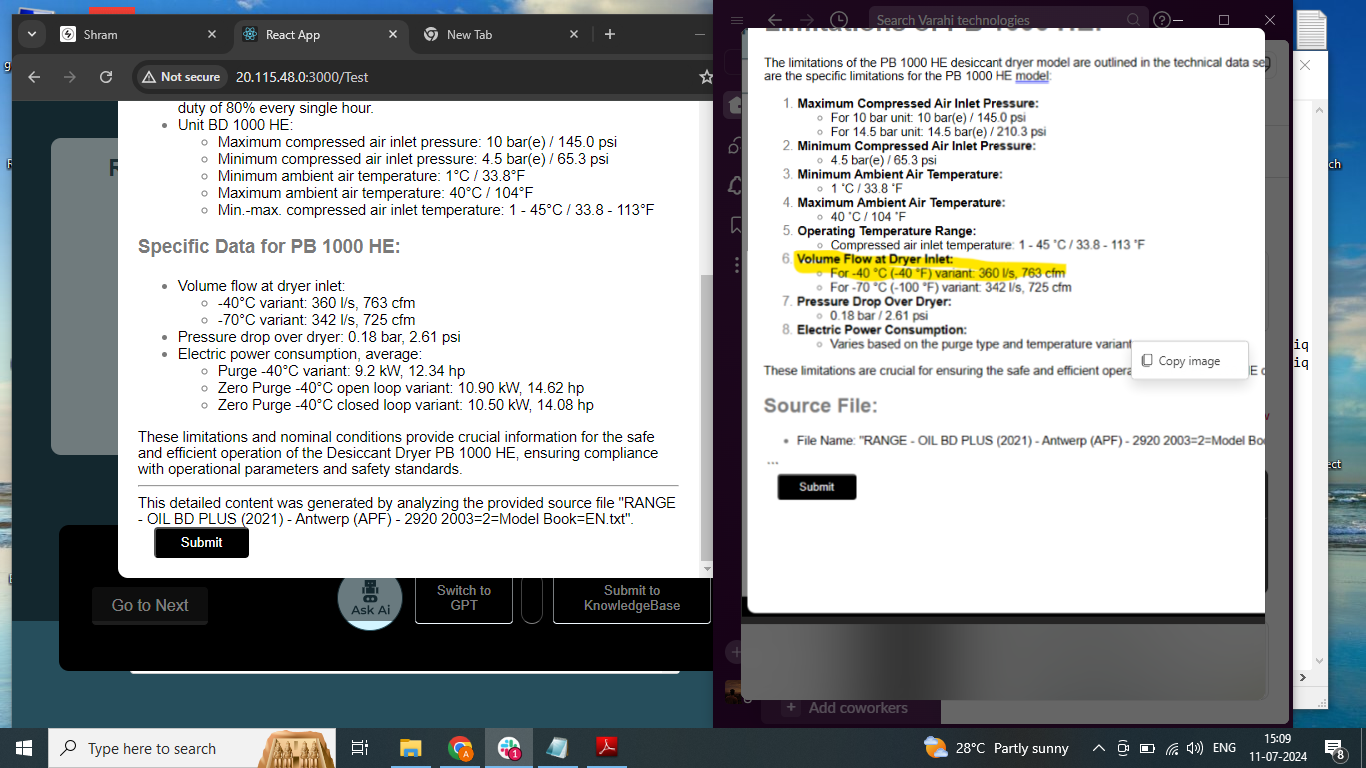

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
from nltk.tokenize import sent_tokenize
from IPython.display import display, Image  # For displaying images in Jupyter

nltk.download('punkt')

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image."""

# Define the image path
image_path = r"/content/Screenshot (21).png"

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            elif "[IMAGE]" in sentence:
                # Handle image placeholders
                translated_sentences.append(f"[IMAGE] Path: {image_path}")
            else:
                # Tokenize and translate
                tokenized = tokenizer([sentence], return_tensors='tf')
                translated = model.generate(**tokenized, max_length=128)

                # Decode the translation
                translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

                # Check if the sentence was translated
                if translated_text.lower() != sentence.lower():
                    translated_sentences.append(f"{translated_text} (Translated)")
                else:
                    translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

# Display the original and translated text
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Display detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()

# Display the image if the placeholder is detected
if any("[IMAGE]" in line for line in lines):
    display(Image(filename=image_path))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


### Translated Text
Pertenezco a Amravati. (Translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush es desarrollador de AI/ML hai (Translated)


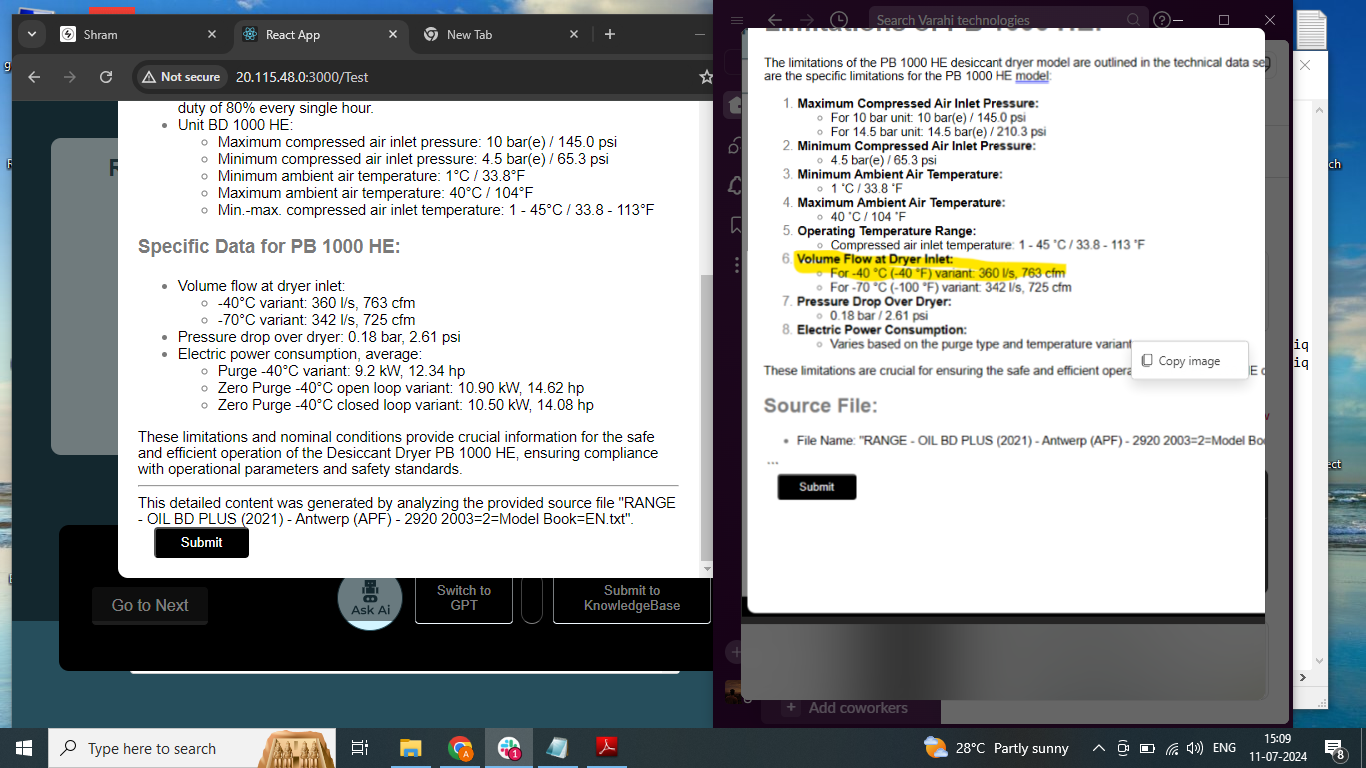

### Remaining Text
[IMAGE] Path: /content/Screenshot (21).png

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
from nltk.tokenize import sent_tokenize
from IPython.display import display, Image, Markdown

nltk.download('punkt')

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image."""

# Define the image path
image_path = r"/content/Screenshot (21).png"

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []
remaining_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            elif "[IMAGE]" in sentence:
                # Handle image placeholders
                remaining_lines.append(f"[IMAGE] Path: {image_path}")
            else:
                # Tokenize and translate
                tokenized = tokenizer([sentence], return_tensors='tf')
                translated = model.generate(**tokenized, max_length=128)

                # Decode the translation
                translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

                # Check if the sentence was translated
                if translated_text.lower() != sentence.lower():
                    translated_sentences.append(f"{translated_text} (Translated)")
                else:
                    translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)
remaining_text = '\n'.join(remaining_lines)

# Display the translated text
display(Markdown(f"### Translated Text\n{full_translated_text}"))

# Display the image
if any("[IMAGE]" in line for line in lines):
    display(Image(filename=image_path))

# Display the remaining text
display(Markdown(f"### Remaining Text\n{remaining_text}"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE]
6.1.10	 Heat exchanger
 This is a placeholder for an image.

Full Translated Text (with translation status) Above Image:
Pertenezco a Amravati. (Translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush es desarrollador de AI/ML hai (Translated)


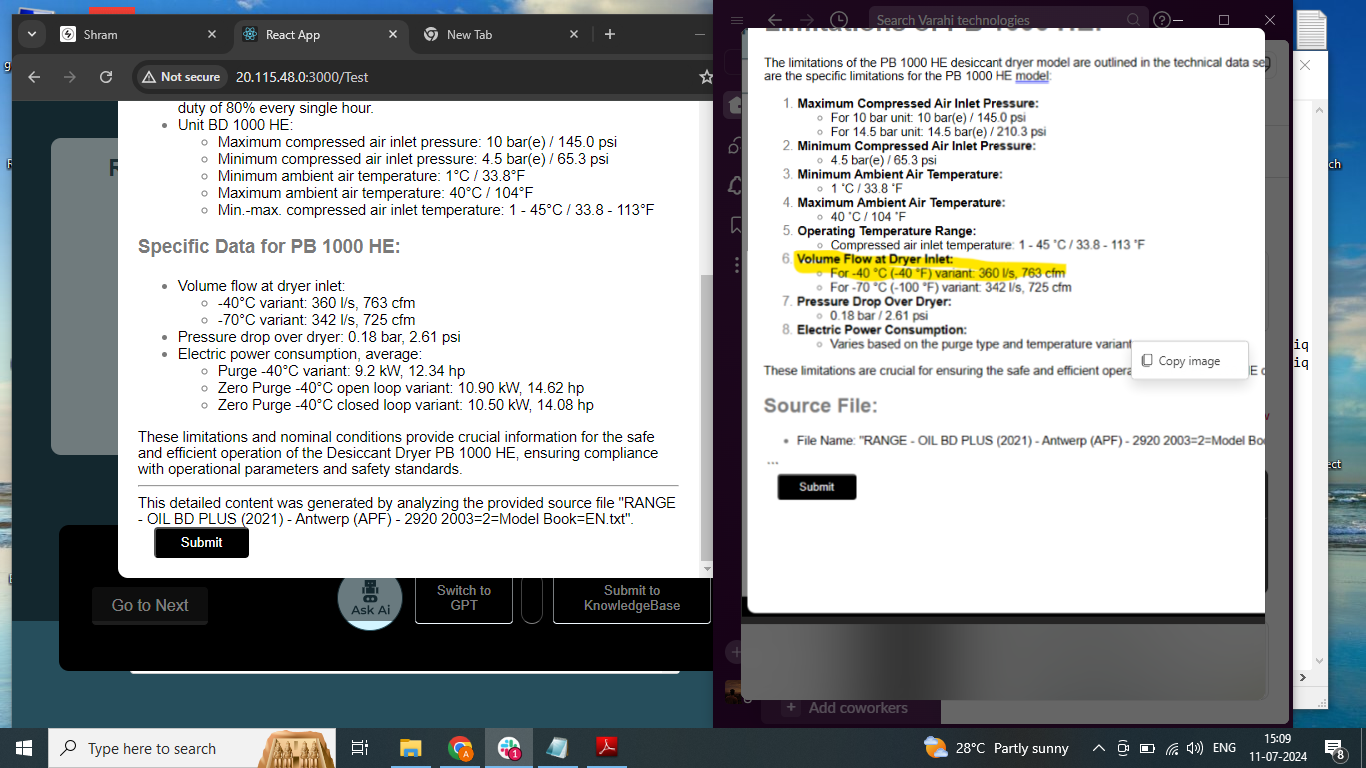


Full Translated Text (with translation status) Below Image:
6.1.10 Intercambiador de calor (Translated)
Se trata de un marcador de posición para una imagen. (Translated)

Detailed Translation:
Original: I am belong from Amravati
Processed: Pertenezco a Amravati. (Translated)

Original: Original instructions
Processed: Traducción del manual original (Translated from memory)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)

Original: ankush is AI/ML developer hai
Processed: ankush es desarrollador de AI/ML hai (Translated)

Original: [IMAGE]
Processed: [IMAGE] Path: /content/Screenshot (21).png

Original: 6.1.10	 Heat exchanger
Processed: 6.1.10 Intercambiador de calor (Translated)

Original:  This is a placeholder for an image.
Processed: Se trata de un marcador de posición para

In [ ]:
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf
import nltk
from nltk.tokenize import sent_tokenize
from IPython.display import display, Image  # For displaying images in Jupyter

nltk.download('punkt')

# Define the model checkpoint and path
model_checkpoint = "./opus-mt-en-es"  # Model identifier for tokenizer
model_path = "/content/drive/MyDrive/Translation /dict base train model/spanish/tf_model/"  # Path to the saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE]
6.1.10	 Heat exchanger
 This is a placeholder for an image."""

# Define the image path
image_path = r"/content/Screenshot (21).png"

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

image_found = False

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            elif "[IMAGE]" in sentence:
                # Handle image placeholders
                translated_sentences.append(f"[IMAGE] Path: {image_path}")
                image_found = True
            else:
                # Tokenize and translate
                tokenized = tokenizer([sentence], return_tensors='tf')
                translated = model.generate(**tokenized, max_length=128)

                # Decode the translation
                translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

                # Check if the sentence was translated
                if translated_text.lower() != sentence.lower():
                    translated_sentences.append(f"{translated_text} (Translated)")
                else:
                    translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Find the position of the image placeholder
if image_found:
    image_index = next(i for i, line in enumerate(translated_lines) if "[IMAGE]" in line)
else:
    image_index = -1

# Join the translated lines, preserving original line breaks
full_translated_text_above_image = '\n'.join(translated_lines[:image_index])
full_translated_text_below_image = '\n'.join(translated_lines[image_index + 1:])

# Display the original and translated text
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status) Above Image:")
print(full_translated_text_above_image)

if image_found:
    display(Image(filename=image_path))

print("\nFull Translated Text (with translation status) Below Image:")
print(full_translated_text_below_image)

# Display detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image.

Full Translated Text (with translation status) Above Image:
I am belong from Amravati (Not translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)
ankush is AI/ML developer hai (Not translated)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


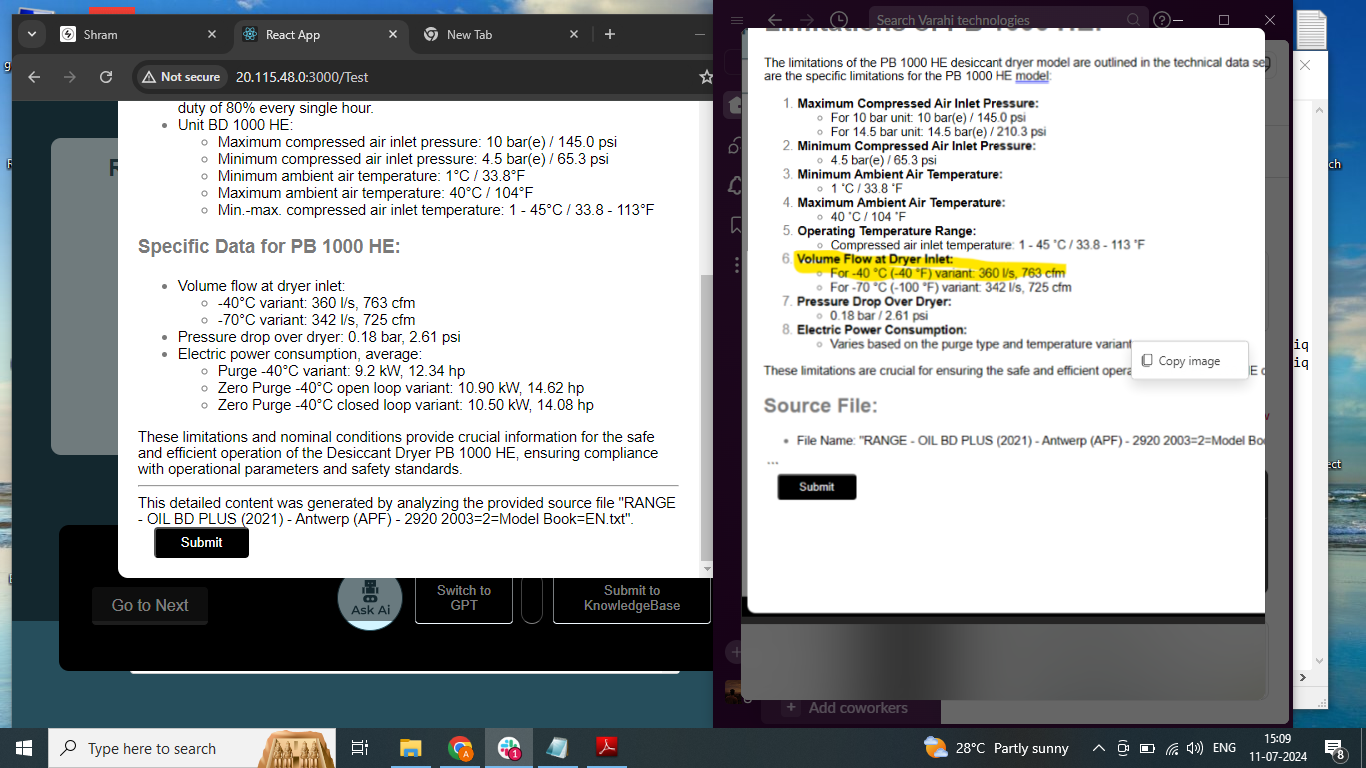


Full Translated Text (with translation status) Below Image:


Detailed Translation:
Original: I am belong from Amravati
Processed: I am belong from Amravati (Not translated)

Original: Original instructions
Processed: Traducción del manual original (Translated from memory)

Original: This applies in particular to trademarks, model denominations, part numbers and drawings.
Processed: Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)

Original: ankush is AI/ML developer hai
Processed: ankush is AI/ML developer hai (Not translated)

Original: [IMAGE] This is a placeholder for an image.
Processed: [IMAGE] Path: /content/Screenshot (21).png



In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
from IPython.display import display, Image  # For displaying images in Jupyter

nltk.download('punkt')

# Define the image path
image_path = r"/content/Screenshot (21).png"

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings.
ankush is AI/ML developer hai
[IMAGE] This is a placeholder for an image."""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos."
}

image_found = False

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            elif "[IMAGE]" in sentence:
                # Handle image placeholders
                translated_sentences.append(f"[IMAGE] Path: {image_path}")
                image_found = True
            else:
                # If not in memory, keep the original text
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Find the position of the image placeholder
if image_found:
    image_index = next(i for i, line in enumerate(translated_lines) if "[IMAGE]" in line)
else:
    image_index = -1

# Join the translated lines, preserving original line breaks
full_translated_text_above_image = '\n'.join(translated_lines[:image_index])
full_translated_text_below_image = '\n'.join(translated_lines[image_index + 1:])

# Display the original and translated text
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status) Above Image:")
print(full_translated_text_above_image)

if image_found:
    display(Image(filename=image_path))

print("\nFull Translated Text (with translation status) Below Image:")
print(full_translated_text_below_image)

# Display detailed translation information
print("\nDetailed Translation:")
for original_line, translated_line in zip(lines, translated_lines):
    print(f"Original: {original_line}")
    print(f"Processed: {translated_line}")
    print()


DeepL Integration

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

input_text = """I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.

"""

# Split the input text into lines
lines = input_text.split('\n')

translated_lines = []

# Placeholder for memory-based translation check
# In practice, this would be a more complex system or database
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Introduction":"Introducción",

    "Controlling the unit":"Control de la unidad",
    "Protecting the unit":"Protección de la unidad",
    "Monitoring components subject to service":"Monitorización de los componentes sujetos a servicio.",
    "Automatic Restart After Voltage Failure (ARAVF)":"Rearranque automático después de un fallo del suministro eléctrico (ARAVF)"

}

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Check if the translation is available in memory
            if sentence in memory_based_translations:
                translated_text = memory_based_translations[sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            else:
                # If translation is not available in memory, mark it as not translated
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)

# Print detailed translation information
# print("\nDetailed Translation:")
# for original_line, translated_line in zip(lines, translated_lines):
#     print(f"Original: {original_line}")
#     print(f"Processed: {translated_line}")
#     print()


Full Original Text:
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.



Full Translated Text (with translation status):
I am belong from Amravati (Not translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Input text with some placeholder content
input_text = """
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Memory-based translations (update with provided translations)
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Introduction": "Introducción",
    "Controlling the unit": "Control de la unidad",
    "Protecting the unit": "Protección de la unidad",
    "Monitoring components subject to service": "Monitorización de los componentes sujetos a servicio.",
    "Automatic Restart After Voltage Failure (ARAVF)": "Rearranque automático después de un fallo del suministro eléctrico (ARAVF)"
}

translated_lines = []

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

for line in lines:
    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(f"{translated_text} (Translated from memory)")
            else:
                # If translation is not available in memory, mark it as not translated
                translated_sentences.append(f"{sentence} (Not translated)")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

# Print the original and translated texts
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text (with translation status):")
print(full_translated_text)


Full Original Text:

I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.


Full Translated Text (with translation status):

I am belong from Amravati (Not translated)
Traducción del manual original (Translated from memory)
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. (Translated from memory)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Input text with some placeholder content
input_text = """
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Memory-based translations (update with provided translations)
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Introduction": "Introducción",
    "Controlling the unit": "Control de la unidad",
    "Protecting the unit": "Protección de la unidad",
    "Monitoring components subject to service": "Monitorización de los componentes sujetos a servicio.",
    "Automatic Restart After Voltage Failure (ARAVF)": "Rearranque automático después de un fallo del suministro eléctrico (ARAVF)"
}

translated_lines = []

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

for line in lines:
    if line.strip() == "":
        translated_lines.append("")  # Preserve empty lines
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(f"{translated_text}")
            else:
                # If translation is not available in memory, keep the original sentence
                translated_sentences.append(f"{sentence}")

    # Join the translated sentences for this line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join the translated lines, preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

# Print the original and translated texts
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
print(full_translated_text)


Full Original Text:

I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.


Full Translated Text:

I am belong from Amravati
Traducción del manual original
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
##

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Input text with some placeholder content
input_text = """
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.
This menu shows the remaining Running Hours and the remaining Real Time Hours until the next
service. The first row (A) shows the Running Hours when the first service is needed (green), the
second row shows the Real Time Hours (blue).
A service overview can be viewed by tapping icon (1).
The service plan can be viewed by tapping icon (2). Through this menu, the service plan can be
modified:
1. Tap the desired service plan. A selection screen will pop up.
2. Change the Running Hours by tapping ‘–’ or ‘+’.
3. Confirm by tapping ‘V’ or decline by tapping ‘X’.
The service history can be viewed by tapping icon (3).
When a service plan interval is reached, a message will appear on the screen. When service has
been performed, the service timer can be reset by tapping the reset button (4).

"""

# Split the input text into lines
lines = input_text.split('\n')

# Memory-based translations (update with provided translations)
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Introduction": "Introducción",
    "Controlling the unit": "Control de la unidad",
    "Protecting the unit": "Protección de la unidad",
    "Monitoring components subject to service": "Monitorización de los componentes sujetos a servicio.",
    "Automatic Restart After Voltage Failure (ARAVF)": "Rearranque automático después de un fallo del suministro eléctrico (ARAVF)",
    "Change the Running Hours by tapping ‘–’ or ‘+’.":"Ankush mahore i am malegaon X+"
}

translated_lines = []

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Process each line in the input text
for line in lines:
    # Check if the line is empty
    if line.strip() == "":
        translated_lines.append("")  # Preserve empty lines
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
            else:
                # If translation is not available in memory, keep the original sentence
                translated_sentences.append(sentence)

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join translated lines preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

# Print original and translated texts
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
print(full_translated_text)


Full Original Text:

I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.
This menu shows the remaining Running Hours and the remaining Real Time Hours until the next
service. The first row (A) shows the Running Hours when the first service is needed (green), the
second row shows the Real Time Hours (blue).
A service overview can be viewed by tapping icon (1).
The serv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Input text with some placeholder content
input_text = """
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Memory-based translations (update with provided translations)
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Introduction": "Introducción",
    "Controlling the unit": "Control de la unidad",
    "Protecting the unit": "Protección de la unidad",
    "Monitoring components subject to service": "Monitorización de los componentes sujetos a servicio.",
    "Automatic Restart After Voltage Failure (ARAVF)": "Rearranque automático después de un fallo del suministro eléctrico (ARAVF)"
}

translated_lines = []

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Process each line in the input text
for line in lines:
    # Check if the line is empty
    if line.strip() == "":
        translated_lines.append("")  # Preserve empty lines
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
            else:
                # If translation is not available in memory, keep the original sentence
                translated_sentences.append(sentence)

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)

# Join translated lines preserving original line breaks
full_translated_text = '\n'.join(translated_lines)

# Print original and translated texts
print("Full Original Text:")
print(input_text)
print("\nFull Translated Text:")
print(full_translated_text)


Full Original Text:

I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.


Full Translated Text:

I am belong from Amravati
Traducción del manual original
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
##

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Deepl integration

In [ ]:
import re
import nltk
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Input text with some placeholder content
input_text = """
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
#####################################
Introduction
The controller has the following functions:
• Controlling the unit
• Protecting the unit
• Monitoring components subject to service
• Automatic Restart After Voltage Failure (ARAVF)
Automatic control of the unit
The controller can extend the adsorption time when the pressure dewpoint is better as expected.
When the dewpoint setting is reached the dryer will switch tower and start regenerating again.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Memory-based translations (update with provided translations)
memory_based_translations = {
    "Original instructions": "Traducción del manual original",
    "This applies in particular to trademarks, model denominations, part numbers and drawings.": "Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.",
    "Introduction": "Introducción",
    "Controlling the unit": "Control de la unidad",
    "Protecting the unit": "Protección de la unidad",
    "Monitoring components subject to service": "Monitorización de los componentes sujetos a servicio.",
    "Automatic Restart After Voltage Failure (ARAVF)": "Rearranque automático después de un fallo del suministro eléctrico (ARAVF)"
}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

deepl_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        deepl_translations.append({
            'sentence': "",
            'translation': ""
        })
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                try:
                    url = "https://api-free.deepl.com/v2/translate"
                    data = {
                        "text": sentence,
                        "source_lang": "EN",
                        "target_lang": "ES",
                        "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
                    }
                    headers = {'Content-Type': 'application/x-www-form-urlencoded'}

                    response = requests.post(url, data=data, headers=headers)
                    response.raise_for_status()  # Raise exception for bad status codes

                    translation = response.json()['translations'][0]['text']
                    translated_sentences.append(translation)

                    deepl_translations.append({
                        'sentence': sentence,
                        'translation': translation
                    })
                except (RequestException, KeyError, IndexError) as e:
                    print(f"Error translating sentence: {sentence}")
                    print(f"Error details: {e}")
                    translated_sentences.append(f"{sentence} (Translation failed)")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    #translated_lines.append(translated_line)

# Print original and translated texts
print("Full Input Text:")
print(input_text)
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Soy de Amravati
Traducción del manual original
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. abhinav pertenece a bhiar
ankush es AI / ML desarrollador hai
Se trata de un marcador de posición para una imagen.
#####################################
Introducción
El controlador tiene las siguientes funciones:
Control de la unidad
Protección de la unidad
Monitorización de los componentes sujetos a servicio.
Rearranque automático después de un fallo del suministro eléctrico (ARAVF)
Control automático de la unidad
El controlador puede prolongar el tiempo de adsorción cuando el punto de rocío a presión es mejor de lo esperado.
Cuando se alcance el ajuste del punto de rocío, el secador cambiará de torre y comenzará a regenerar de nuevo.
Full Input Text:

I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush

Attach excel file

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        data = {
            "text": sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text = """
I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        print()
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()

# Print original input text
print("Full Input Text:")
print(input_text)

# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



DeepL Translation: Soy de Amravati
Soy de Amravati

Memory Translation: Traducción del manual original
Traducción del manual original

Memory Translation: Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos.
DeepL Translation: abhinav pertenece a bhiar
Esto se aplica particularmente en lo que respecta a marcas registradas, denominaciones de modelos, designaciones y planos. abhinav pertenece a bhiar

DeepL Translation: ankush es AI / ML desarrollador hai
ankush es AI / ML desarrollador hai

DeepL Translation: Se trata de un marcador de posición para una imagen.
Se trata de un marcador de posición para una imagen.


Full Input Text:

I am belong from Amravati
Original instructions
This applies in particular to trademarks, model denominations, part numbers and drawings. abhinav belong to bhiar
ankush is AI/ML developer hai
This is a placeholder for an image.


Detailed Translations:

Original: I am belong from Amravati

Test data on AIB one chapter

Translation issue:
1: Capital Small lettres
2:

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        data = {
            "text": sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text = """
1 Safety precautions
1.1 Safety icons
DANGER
Indicates a hazard with a high level of risk, which, if not avoided, will result
in death or serious injury and / or property damage.
WARNING
Indicates a hazard with a medium level of risk, which, if not avoided, could
result in death or serious injury.
CAUTION
Indicates a hazard with a low level of risk, which, if not avoided, could
result in minor or moderate injury.
NOTICE
Indicates that a mandatory action shall be taken to avoid a hazard.
1.2 Statement of use
This dryer is designed for indoor use only in temperatures above 1°C (33.8 °F). The inlet pressure
should not exceed the maximum compressed air inlet pressure (refer to the section Limitations or to
the Data Plate: Allowable inlet pressure). The dryer is capable of producing industrial grade
instrument air. The dryer is not capable of producing breathable quality air.
Only qualified personnel should install, operate, diagnose and service the dryer. For any technical
assistance, please contact your supplier.
1.3 General safety precautions
DANGER
Do not touch any electrical connections, valves, or sensors for
troubleshooting purposes as this will result in death or serious injury,
and/or property damage. Only qualified personnel should perform
diagnostic work on the dryer. Contact your representative for assistance.
DANGER
Piping and pressure vessels operate with dangerous, highly pressurized
compressed air, which, if intentionally or accidentally released, will result
in death, serious injury, and/or property damage. Only use or operate the
dryer as described and instructed in this Instruction Book. Only use or
Instruction book
2920 2018 01 5
operate the dryer within the specified temperature and pressure limits
described in this Instruction Book.
DANGER
Follow all Lock Out/Tag Out (LOTO) procedures before any maintenance or
repairs are performed on the dryer. Failure to follow all LOTO methods will
result in death or serious injury, and/or property damage.
DANGER
Do not use the manual override test button when the dryer piping or the
pressure vessels are pressurized. The intentional or accidental activation
of a manual override test button will allow dangerous, highly pressurized
compressed air to vent into various dryer components, such as, the
vessels, piping, hoses, blower, manifolds, and / or areas surrounding the
dryer assembly, which will result in death or serious injury and / or
property damage.
WARNING
Do not modify or alter the dryer piping or vessels by welding, drilling, or
any other method. Only qualified personnel should perform modifications,
alterations, or repairs on the dryer, its piping, or pressure vessels. Any
modifications or alterations could result in death or serious injury. Provide
written notification to your manufacturer's representative about any
modifications or alterations to the dryer and its vessels.
WARNING
The air produced by the compressors and the dryer is not of breathable
quality and is therefore not safe for human breathing.
CAUTION
On units with automatic start/stop system or if the automatic restart
function after voltage failure is activated (ARAVF - Automatic Restart After
Voltage Failure), a sign stating "This machine may start without warning."
must be affixed near the instrument panel.
NOTICE
This dryer should only be operated by using the ElektronikonTM controller
and only in accordance with the instructions provided in this Instruction
Book.
• The operator must employ safe working practices and observe all
requirements and regulations related to work safety.
• Installation, operation, maintenance, and repair work must only be
performed by authorized, trained, specialized personnel.
• The personnel must apply safe working practices using personal
protective equipment, appropriate tools, and defined procedures.
Instruction book
6 2920 2018 01
• Do not walk or stand on the dryer components.
• The owner is responsible for maintaining the unit in safe operating
condition. Parts and accessories shall be replaced if unsuitable for
safe operation.
Personal safety
DANGER
Stay alert and watch what you are doing when operating the dryer. Do not
operate the dryer while you are tired, under influence of drugs, alcohol, or
medication. A moment of inattention while operating the dryer could result
in serious personal injury.
DANGER
Never direct the compressed air at your face, skin, or another person.
DANGER
Never use the compressed air to clean dirt from your clothes.
WARNING
Always wear ear, eye, and hand protections while operating the dryer
and/or working around compressed air. Observe all federal, state, local,
and site-specific government regulations and company guidelines
regarding PPE (Personal Protective Equipment).
WARNING
Wear a safety helmet when working in an area where work is being
performed overhead or with lifting equipment. Observe all federal, state,
local, and site-specific government regulations and company guidelines
regarding PPE (Personal Protective Equipment).
WARNING
Always wear protective clothing and use PPE (Personal Protective
Equipment) in accordance with instruction of all federal, state, and site-specific regulations, and company guidelines. Observe all federal, state,
local, and site-specific government regulations and company guidelines
regarding PPE (Personal Protective Equipment).
WARNING
Use hearing protection when operating or working on the dryer as
recommended by all federal, state, local and site specific government
regulations and company guidelines regarding PPE. High sound levels
can cause permanent hearing loss.
Instruction book
2920 2018 01 7
1.4 Safety precautions during installation
Precautions during installation
All responsibility for any damage or injury resulting from neglecting these precautions, or non-observance of the normal caution and care required for installation, operation, maintenance and
repair, even if not expressly stated, will be disclaimed by the manufacturer.
DANGER
Install the dryer on a level floor and fix it firmly. If the ground is not level or
can be subject to variable inclination, consult the manufacturer.
DANGER
If remote control is installed, the unit must bear a clear sign stating:
"DANGER: This machine is remotely controlled and may start without
warning."
DANGER
If the dryer is to be operated by remote control then the end user needs to
attach a label/sign to the control panel box stating: "DANGER: This
machine is remotely controlled and may start without warning."
DANGER
Keep the inlet and ambient air free from hazardous gases, fumes, vapors,
and particles that can lead to an internal fire or explosion, which will result
in personal injury and/or death or equipment damage.
DANGER
When lifting the dryer, follow all applicable safety regulations.
• Use the lifting lugs provided on the dryer vessels and / or the forklift
openings of the dryer base. Use a spreader bar for units without
lifting lugs.
• Secure loose or pivoting parts before lifting.
Failure to follow this warning will result in personal injury and/or death or
equipment damage.
DANGER
Do not remove or tamper with the safety devices or guards fitted on the
unit. Every pressure vessel or auxiliary that is installed outside the unit to
contain air above atmospheric pressure, must be protected by a pressure
relieving device or devices as required. Failure to follow the warning will
result in personal injury and/or death or equipment damage.
Instruction book
8 2920 2018 01
DANGER
If the maximum pressure of the compressor is higher than the design
pressure of the dryer, a full flow safety valve must be installed between the
compressor and the dryer to blow off the excessive pressure. This is done
in case the safety valve of the dryer is out of order or blocked.
DANGER
Do not use any flexible hoses or plastic or other non-metal piping at any of
the inlet and outlet connections. The normal operating temperatures and
pressures of the dryer will cause flexible hoses, plastic or other non-metal
piping to fail. Failure to follow this warning will result in personal injury
and / or death or equipment damage.
DANGER
Make sure the regeneration air outlet pipe is directed away from any area
where personnel will be working. Be careful when working around the
regeneration air outlet pipe and other high temperature piping or parts.
Regeneration air piping and air exhaust temperatures can rise to 160 °C
(320 °F). Contact with high temperature piping or parts will results in
bodily injury or death.
DANGER
Piping or other parts of the dryer can reach temperatures above 80°C (176
°F). There are chances that the operator accidentally touches the piping or
parts, which could result in serious burns.
WARNING
All piping to and from the dryer, including regeneration air outlet piping,
must be of sufficient size, strength, and quality to withstand normal
operating pressures and temperatures. Additionally, the piping must be
securely mounted and supported in accordance with all federal, state,
local, and site-specific government regulations, company guidelines, and
good engineering practices. Consult a local engineer familiar with the
applicable site, equipment, guidelines, and regulations. Failure to comply
with any applicable federal, state, local, and/or company guideline or
regulation could result in bodily injury or death.
NOTICE
Do not obstruct the air inlet, air outlet, and regeneration outlet. Do not
allow water, oil, and other contaminants into the inlet air, which could
result in damage to the equipment.
NOTICE
Remove all flange covers, plugs, caps, and desiccant bags before
connecting any piping to the dryer to ensure proper performance.
Instruction book
2920 2018 01 9
NOTICE
Ensure the dryers are grounded and protected against short circuits by
fuses in all phases.
NOTICE
Place the unit where the ambient air is as cool and clean as possible. If
necessary, install a suction duct.
NOTICE
Ensure all piping connections (inlet, outlet, and regeneration) are properly
installed and mounted. They need stress-free support that can withstand
any unexpected release of compressed air. The piping and its installation
need to comply with good engineering practices, all federal, state, local,
and site-specific government regulations, and company guidelines.
NOTICE
Ensure the installation of the sonic nozzle at the outlet of the dryer, if not
installed from the factory. Do not operate the unit without the sonic nozzle
installed. The sonic nozzle is mandatory for protection of the desiccant
beads. Refer to installation instructions for correct installation of the sonic
nozzle.
NOTICE
The electrical connections must correspond to the applicable codes.
• In the USA: NFPA 70® (National Electrical Code®)
• In the European countries: IEC 60364
Follow all federal, state, local, and site-specific government regulations,
and company guidelines. A lockable power-isolating switch must be
installed near the dryer.
• Installation should be done by qualified personnel only.
• All piping connections should be reviewed and approved by qualified
personnel. Keep the unit in safe operating conditions as per all
federal, state, local, and site-specific government regulations, and
company guidelines.
• Also consult the following safety precautions: Safety precautions
during operation and Maintenance.
• The precautions apply to all machinery processing or consuming air
or inert gas. Processing of any other gas requires additional safety
precautions typical to the application, which are not included herein.
• Some precautions are general and cover several unit types and
equipment; hence some statements may not apply to your unit.
Instruction book
10 2920 2018 01
1.4.1 General safety precautions for safety valves
CAUTION
If safety valves are painted, ensure that the sliding parts are free of paint.
CAUTION
During installation the maximum torque value must not be exceeded.
Valve size Max. torque value
DN 8 30 Nm
DN 10 40 Nm
DN 15 50 Nm
DN 20 60 Nm
DN 25 60 Nm
DN 32 80 Nm
DN 40 80 Nm
DN 50 90 Nm
CAUTION
When blowing off safety valves, be aware that gases may discharge at
high velocity, high temperature, and produce excessive noise.
CAUTION
Safety valves equipped with a lifting device (version sGK) can be manually
opened when the working pressure reaches or exceeds 85 % of the
response pressure.
CAUTION
To manually open a safety valve with lifting device (version sGK), turn the
twist-type lifting mechanism above the bonnet in a counterclockwise
direction. After lifting, turn the twist-type mechanism back to its original
position.
NOTICE
The maintenance intervals for a safety valve should be determined based
on the operating conditions and the manufacturer's recommendations.
WARNING
Make sure that the system is made pressure-free prior to disassembly of
the safety valve.
Instruction book
2920 2018 01 11
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
NOTICE
Do not operate the dryer above or below its temperature or flow ratings.
Low pressure or flow can result in damage to the dryer desiccant. High
pressure and/or flow can result in damage to components (piping, vessels,
valves, etc.).
NOTICE
Only use the ElektronikonTM controller to operate the dryer.
General solenoid valve safety
While dryer is under pressure, make sure that the operator follows these safety instructions when
working on the solenoid valves:
Instruction book
12 2920 2018 01
DANGER
Do not use the manual override test button on solenoid valves to
troubleshoot any problem with the dryer. This will override the control
signal and will open the valve resulting in a release of pressurized air.
WARNING
Do not modify the pilot air lines (tubing) on solenoid valves. This could
engage the actuator or valve resulting in a release of pressurized air.
WARNING
Do not modify the electrical connections on or to the solenoid valve of the
actuators or inside the control cubicle. Such modifications will cause a
discrepancy between the control logic and the function of the butterfly
valve, which could result in a release of pressurized air.
WARNING
Do not use the manual override test button of the solenoid valve to
depressurize the unit (Refer to the section Service Menu for
depressurizing procedure).
WARNING
Any action to manipulate the valves other than via the standard
ElektronikonTM controller of the dryer is prohibited.
1.6 Dismantling and disposal
The device must be disposed of according to local regulations. The product is not designed for
refurbishing after finished life cycle.
Dismantling
Once the end of life of the machine is reached, follow the next steps:
1. Stop the machine.
2. Check all safety precautions mentioned in the previous chapters to secure safe handling (for
example, LOTO, cool-down, depressurize, discharge).
3. Have trained personnel dismantle the installation.
4. Separate the harmful from the safe components (for example, drain oil from parts containing
oil).
5. Refer to the disposal topic below.
Disposal of electrical and electronic appliances (WEEE)
This equipment falls under the provisions of the European Directive 2012/19/EU on waste electrical
and electronic equipment (WEEE) as well as under the UKCA Waste Electrical and Electronic
Equipment regulations 2013 and may not be disposed of as unsorted waste.
Instruction book
2920 2018 01 13
The equipment is labelled in accordance with the European Directive 2012/19/EU and the UKCA
Waste Electrical and Electronic Equipment regulations 2013 with the crossed-out wheelie bin
symbol.
At the end of life-time of the electric and electronic equipment (EEE) it must be taken to separate
collection.
For more information check with your local waste authority, customer center or distributor.
Disposal of other used material
Used filters or any other used material (for example, filter bags, filter media, desiccant, lubricants,
cleaning rags and machine parts) must be disposed of in an environmentally friendly and safe
manner, and in line with the local recommendations and environmental legislation
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        print()
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()

# Print original input text
print("Full Input Text:")
print(input_text)

# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



DeepL Translation: 1 Precauciones de seguridad
1 Precauciones de seguridad

DeepL Translation: 1.1 Iconos de seguridad
1.1 Iconos de seguridad

DeepL Translation: PELIGRO
PELIGRO

DeepL Translation: Indica un peligro con un alto nivel de riesgo que, si no se evita, tendrá como consecuencia
Indica un peligro con un alto nivel de riesgo que, si no se evita, tendrá como consecuencia

DeepL Translation: en la muerte o lesiones graves y/o daños materiales.
en la muerte o lesiones graves y/o daños materiales.

DeepL Translation: ADVERTENCIA
ADVERTENCIA

DeepL Translation: Indica un peligro con un nivel de riesgo medio que, de no evitarse, podría
Indica un peligro con un nivel de riesgo medio que, de no evitarse, podría

DeepL Translation: provocar la muerte o lesiones graves.
provocar la muerte o lesiones graves.

DeepL Translation: PRECAUCIÓN
PRECAUCIÓN

DeepL Translation: Indica un peligro con un nivel de riesgo bajo que, de no evitarse, podría
Indica un peligro con un nivel de riesgo baj

In [ ]:
# convert all sentence in lower case first latter in lower case

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text = """
1.4.1 General safety precautions for safety valves
CAUTION
If safety valves are painted, ensure that the sliding parts are free of paint.
CAUTION
During installation the maximum torque value must not be exceeded.
Valve size Max. torque value
DN 8 30 Nm
DN 10 40 Nm
DN 15 50 Nm
DN 20 60 Nm
DN 25 60 Nm
DN 32 80 Nm
DN 40 80 Nm
DN 50 90 Nm
CAUTION
When blowing off safety valves, be aware that gases may discharge at
high velocity, high temperature, and produce excessive noise.
CAUTION
Safety valves equipped with a lifting device (version sGK) can be manually
opened when the working pressure reaches or exceeds 85 % of the
response pressure.
CAUTION
To manually open a safety valve with lifting device (version sGK), turn the
twist-type lifting mechanism above the bonnet in a counterclockwise
direction. After lifting, turn the twist-type mechanism back to its original
position.
NOTICE
The maintenance intervals for a safety valve should be determined based
on the operating conditions and the manufacturer's recommendations.
WARNING
Make sure that the system is made pressure-free prior to disassembly of
the safety valve.
Instruction book
2920 2018 01 11
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        print()
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()

# Print original input text
print("Full Input Text:")
print(input_text)

# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



DeepL Translation: 1.4.1 precauciones generales de seguridad para las válvulas de seguridad
1.4.1 precauciones generales de seguridad para las válvulas de seguridad

DeepL Translation: Precaución
Precaución

DeepL Translation: Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.
Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.

DeepL Translation: Precaución
Precaución

DeepL Translation: Durante la instalación no debe superarse el valor máximo del par de apriete.
Durante la instalación no debe superarse el valor máximo del par de apriete.

DeepL Translation: Tamaño de válvula máx.
DeepL Translation: Valor de par
Tamaño de válvula máx. Valor de par

DeepL Translation: Dn 8 30 nm
Dn 8 30 nm

DeepL Translation: Dn 10 40 nm
Dn 10 40 nm

DeepL Translation: Dn 15 50 nm
Dn 15 50 nm

DeepL Translation: Dn 20 60 nm
Dn 20 60 nm

DeepL Translation: Dn 25 60 nm
Dn 25 60 nm

DeepL 

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text = """
1.4.1 General safety precautions for safety valves
CAUTION
If safety valves are painted, ensure that the sliding parts are free of paint.
CAUTION
During installation the maximum torque value must not be exceeded.
Valve size Max. torque value
DN 8 30 Nm
DN 10 40 Nm
DN 15 50 Nm
DN 20 60 Nm
DN 25 60 Nm
DN 32 80 Nm
DN 40 80 Nm
DN 50 90 Nm
CAUTION
When blowing off safety valves, be aware that gases may discharge at
high velocity, high temperature, and produce excessive noise.
CAUTION
Safety valves equipped with a lifting device (version sGK) can be manually
opened when the working pressure reaches or exceeds 85 % of the
response pressure.
CAUTION
To manually open a safety valve with lifting device (version sGK), turn the
twist-type lifting mechanism above the bonnet in a counterclockwise
direction. After lifting, turn the twist-type mechanism back to its original
position.
NOTICE
The maintenance intervals for a safety valve should be determined based
on the operating conditions and the manufacturer's recommendations.
WARNING
Make sure that the system is made pressure-free prior to disassembly of
the safety valve.
Instruction book
2920 2018 01 11
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Process each line in the input text
translated_lines = []

for line in lines:
    if line.strip() == "":
        translated_lines.append("")
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    translated_lines.append(translated_line)
    print(translated_line)
    print()

# Print original input text
print("Full Input Text:")
print(input_text)

# Print translated text
print("\nTranslated Text:")
for original, translated in zip(lines, translated_lines):
    print(f"Original: {original}")
    print(f"Translated: {translated}")
    print()

# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DeepL Translation: 1.4.1 precauciones generales de seguridad para las válvulas de seguridad
1.4.1 precauciones generales de seguridad para las válvulas de seguridad

DeepL Translation: Precaución
Precaución

DeepL Translation: Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.
Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.

DeepL Translation: Precaución
Precaución

DeepL Translation: Durante la instalación no debe superarse el valor máximo del par de apriete.
Durante la instalación no debe superarse el valor máximo del par de apriete.

DeepL Translation: Tamaño máx. de la válvula
DeepL Translation: Valor de par
Tamaño máx. de la válvula Valor de par

DeepL Translation: Dn 8 30 nm
Dn 8 30 nm

DeepL Translation: Dn 10 40 nm
Dn 10 40 nm

DeepL Translation: Dn 15 50 nm
Dn 15 50 nm

DeepL Translation: Dn 20 60 nm
Dn 20 60 nm

DeepL Translation: Dn 25 60 nm
Dn 25 60 nm

D

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text =  """
1.4.1 General safety precautions for safety valves
CAUTION
If safety valves are painted, ensure that the sliding parts are free of paint.
CAUTION
During installation the maximum torque value must not be exceeded.
Valve size Max. torque value
DN 8 30 Nm
DN 10 40 Nm
DN 15 50 Nm
DN 20 60 Nm
DN 25 60 Nm
DN 32 80 Nm
DN 40 80 Nm
DN 50 90 Nm
CAUTION
When blowing off safety valves, be aware that gases may discharge at high velocity, high temperature, and produce excessive noise.
CAUTION
Safety valves equipped with a lifting device (version sGK) can be manually opened when the working pressure reaches or exceeds 85 % of the response pressure.
CAUTION
To manually open a safety valve with lifting device (version sGK), turn the twist-type lifting mechanism above the bonnet in a counterclockwise direction. After lifting, turn the twist-type mechanism back to its original position.
NOTICE
The maintenance intervals for a safety valve should be determined based
on the operating conditions and the manufacturer's recommendations.
WARNING
Make sure that the system is made pressure-free prior to disassembly of
the safety valve.
Instruction book
2920 2018 01 11
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Initialize list to store combined translations
combined_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        combined_translations.append("")
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                combined_translations.append(translated_text)  # Add to combined translations
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                combined_translations.append(translation)  # Add to combined translations
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()
    combined_translations.append("")  # Add an empty line for formatting


# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()
# Print original input text
print("Full Input Text:")
print(input_text)

# Print combined translations
print("\nCombined Translations:")
for combined_text in combined_translations:
    print(combined_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DeepL Translation: 1.4.1 precauciones generales de seguridad para las válvulas de seguridad
1.4.1 precauciones generales de seguridad para las válvulas de seguridad

DeepL Translation: Precaución
Precaución

DeepL Translation: Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.
Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.

DeepL Translation: Precaución
Precaución

DeepL Translation: Durante la instalación no debe superarse el valor máximo del par de apriete.
Durante la instalación no debe superarse el valor máximo del par de apriete.

DeepL Translation: Tamaño de válvula máx.
DeepL Translation: Valor de par
Tamaño de válvula máx. Valor de par

DeepL Translation: Dn 8 30 nm
Dn 8 30 nm

DeepL Translation: Dn 10 40 nm
Dn 10 40 nm

DeepL Translation: Dn 15 50 nm
Dn 15 50 nm

DeepL Translation: Dn 20 60 nm
Dn 20 60 nm

DeepL Translation: Dn 25 60 nm
Dn 25 60 nm

DeepL T

Html decoder

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text =  """
1.4.1 General safety precautions for safety valves
CAUTION
If safety valves are painted, ensure that the sliding parts are free of paint.
CAUTION
During installation the maximum torque value must not be exceeded.
Valve size Max. torque value
DN 8 30 Nm
DN 10 40 Nm
DN 15 50 Nm
DN 20 60 Nm
DN 25 60 Nm
DN 32 80 Nm
DN 40 80 Nm
DN 50 90 Nm
CAUTION
When blowing off safety valves, be aware that gases may discharge at high velocity, high temperature, and produce excessive noise.
CAUTION
Safety valves equipped with a lifting device (version sGK) can be manually opened when the working pressure reaches or exceeds 85 % of the response pressure.
CAUTION
To manually open a safety valve with lifting device (version sGK), turn the twist-type lifting mechanism above the bonnet in a counterclockwise direction. After lifting, turn the twist-type mechanism back to its original position.
NOTICE
The maintenance intervals for a safety valve should be determined based
on the operating conditions and the manufacturer's recommendations.
WARNING
Make sure that the system is made pressure-free prior to disassembly of
the safety valve.
Instruction book
2920 2018 01 11
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/modify spanish memory.xlsx')

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Initialize list to store combined translations
combined_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        combined_translations.append("")
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                combined_translations.append(translated_text)  # Add to combined translations
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                combined_translations.append(translation)  # Add to combined translations
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()
    combined_translations.append("")  # Add an empty line for formatting


# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()
# Print original input text
print("Full Input Text:")
print(input_text)

# Print combined translations
print("\nCombined Translations:")
for combined_text in combined_translations:
    print(combined_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DeepL Translation: 1.4.1 precauciones generales de seguridad para las válvulas de seguridad
1.4.1 precauciones generales de seguridad para las válvulas de seguridad

Memory Translation: ADVERTENCIA
ADVERTENCIA

DeepL Translation: Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.
Si las válvulas de seguridad están pintadas, asegúrese de que las partes deslizantes estén libres de pintura.

Memory Translation: ADVERTENCIA
ADVERTENCIA

DeepL Translation: Durante la instalación no debe superarse el valor máximo del par de apriete.
Durante la instalación no debe superarse el valor máximo del par de apriete.

DeepL Translation: Tamaño de válvula máx.
DeepL Translation: Valor de par
Tamaño de válvula máx. Valor de par

DeepL Translation: Dn 8 30 nm
Dn 8 30 nm

DeepL Translation: Dn 10 40 nm
Dn 10 40 nm

DeepL Translation: Dn 15 50 nm
Dn 15 50 nm

DeepL Translation: Dn 20 60 nm
Dn 20 60 nm

DeepL Translation: Dn 25 60 nm
Dn 25 60 nm

D

chack memory and deepl translation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-14-5122aff9b904>:80: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for element in soup.find_all(text=True):



Html
<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Ejemplo html</title>
</head>
<body>
<p>Este es un ejemplo de párrafo. Contiene varias frases. Esto debe traducirse frase por frase.</p>
<p>Otro párrafo para la traducción. También tiene varias frases.</p>
<p>Libro de instrucciones</p>
<p>Datos de los compresores de 7,5 bar OF</p>
</body>
</html>#################Html public "-//w3c//dtd xhtml 1.0 transitional//en" "http://www.w3.org/tr/xhtml1/dtd/xhtml1-transitional.dtd" <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml"> <head> <meta content="text/html; charset=utf-8" http-equiv="Content-Type"> <title>B7aea8f9-2aca-4c34-9d3c-aee7f9171b57</title> <style type="text/css">* {margin:0; padding:0; text-indent:0; } h1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; } h2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14
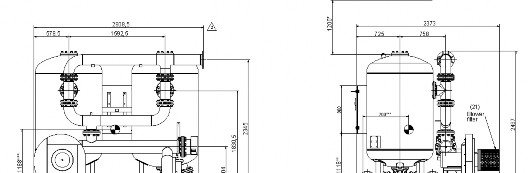
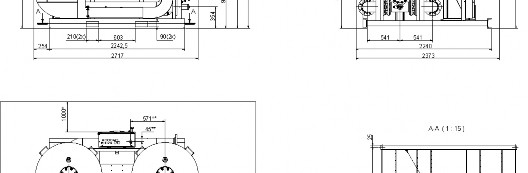
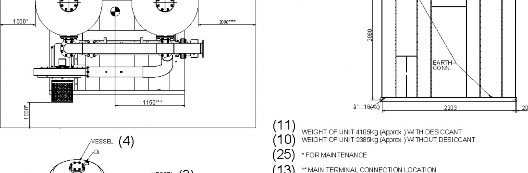
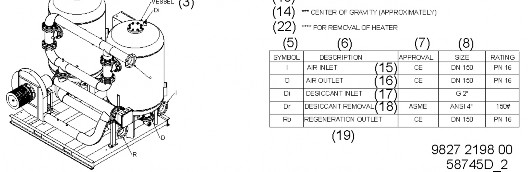
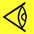
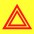
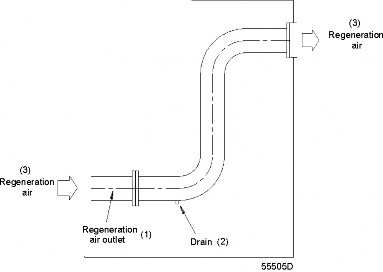
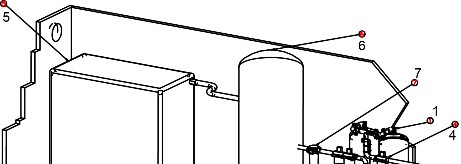
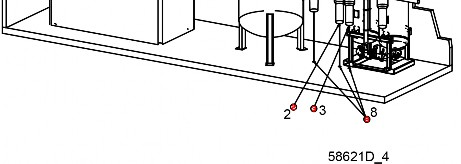
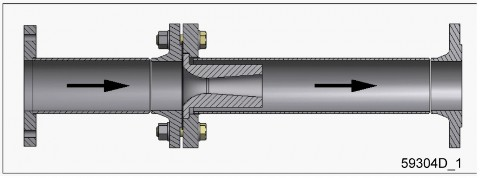
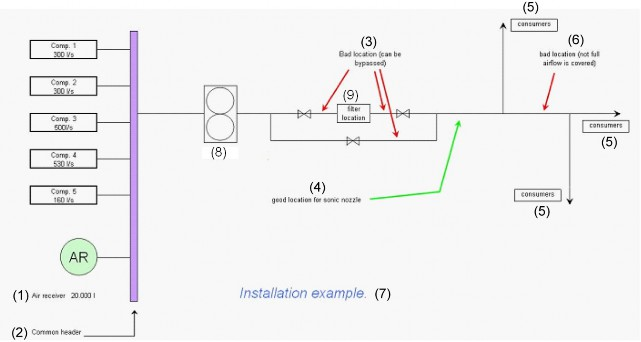
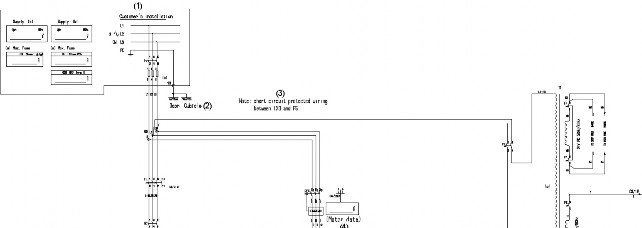
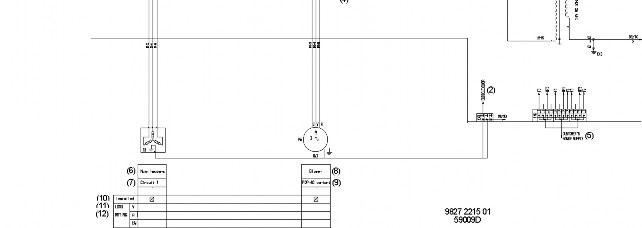
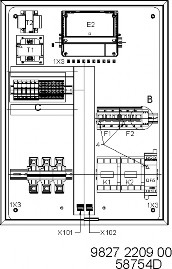
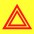
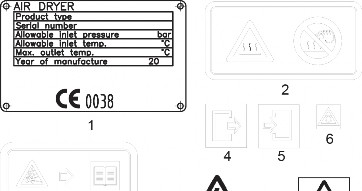
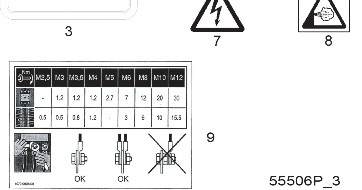

In [ ]:
import re
import nltk
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Input HTML text
input_html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Sample HTML</title>
</head>
<body>
    <p>This is a sample paragraph. It contains multiple sentences. This should be translated sentence by sentence.</p>
    <p>Another paragraph for translation. It also has multiple sentences.</p>
    <p>Instruction Book</p>
    <p>Data for 7.5 bar OF compressors</p>
</body>
</html>
#################
<!DOCTYPE  html PUBLIC \"-//W3C//DTD XHTML 1.0 Transitional//EN\" \"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd\"> <html lang=\"en\" xml:lang=\"en\" xmlns=\"http://www.w3.org/1999/xhtml\">  <head>   <meta content=\"text/html; charset=utf-8\" http-equiv=\"Content-Type\"/>   <title>    b7aea8f9-2aca-4c34-9d3c-aee7f9171b57   </title>   <style type=\"text/css\">    * {margin:0; padding:0; text-indent:0; }  h1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  h2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  h3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  .s1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; }  .s2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  p { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; margin:0pt; }  .s3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 7.5pt; vertical-align: 3pt; }  li {display: block; }  #l1 {padding-left: 0pt;counter-reset: c1 4; }  #l1> li>*:first-child:before {counter-increment: c1; content: counter(c1, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  #l1> li:first-child>*:first-child:before {counter-increment: c1 0;  }  #l2 {padding-left: 0pt;counter-reset: c2 1; }  #l2> li>*:first-child:before {counter-increment: c2; content: counter(c1, decimal)\".\"counter(c2, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  #l2> li:first-child>*:first-child:before {counter-increment: c2 0;  }  #l3 {padding-left: 0pt; }  #l3> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l4 {padding-left: 0pt;counter-reset: c3 1; }  #l4> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l4> li:first-child>*:first-child:before {counter-increment: c3 0;  }  #l5 {padding-left: 0pt; }  #l5> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l6 {padding-left: 0pt; }  #l6> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l7 {padding-left: 0pt; }  #l7> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  #l8 {padding-left: 0pt;counter-reset: c3 1; }  #l8> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l8> li:first-child>*:first-child:before {counter-increment: c3 0;  }  table, tbody {vertical-align: top; overflow: visible; }   </style>  </head>  <body>   <ol id=\"l1\">    <li data-list-text=\"4\">     <h1 style=\"padding-top: 18pt;padding-left: 47pt;text-indent: -42pt;text-align: left;\">      Installation     </h1>     <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">      <br/>     </p>     <ol id=\"l2\">      <li data-list-text=\"4.1\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Dimension drawings       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dimension drawings and installation proposals BD       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 74pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Us0UUUAFGKKDQAUUUUAFFFFABRmiigA7UUUUAFFFFABRRRQAUUCigAoooxigAooooAKKKKACiiigAPSjtRQKACg0UUAFAoNFABRRRQAUGiigAo7UYooAKKKKACvKfGfw60LxP8ePBuo6lYW91JBoOrh4ZreKSO4zNp4XzdyEtsy23kY3N616tXHapz8X/DP/AGAtW/8ASjTqALX/AAq3wZ/0KOhf+CyH/wCJo/4Vb4M/6FHQv/BZD/8AE109FAHMf8Kt8Gf9CjoX/gth/wDiaP8AhVvgz/oUdC/8FkP/AMTXTmigDmP+FW+DP+hR0H/wWQ//ABNH/CrfBn/Qo6F/4LIf/ia6eigDmP8AhVvgzP8AyKOhf+CyH/4mj/hVvgz/AKFHQv8AwWQ//E109FAHMf8ACrvBn/Qo6F/4LIf/AImj/hVvgz/oUdB/8FkP/wATXT9qKAOY/wCFW+DP+hR0H/wWQ/8AxNH/AAq3wYf+ZR0L/wAFsP8A8TXT0UANjRY0VEUIijCqBgAelONFFABRRRQAUUYooADR0oooAKKKKACiiigAzQaKKACjNFBoAPpRXm0Fl8StR1TUJ9M8VeGrTQzcTx29rqHh24urqMrMyndMt9GrLxwBGuBgc4yZNTh+Iei6bd6jqPjrwXYWFpE89xdXXhi4jihjUFnd3bUwFUAEkk4AGTQB6LRXjNh4/wBY1WRUsvjD8Mrx2mt7cLBpDuTLOCYE41X70gVig6sFOM4rZsbrxzqeranpVn8RPAt3qmmGMX9lB4cnea0Mi74/NQanuTcvzLuAyORxQB6bRXB/2N8T/wDob/CP/hKXX/yyo/sb4n/9Dh4S/wDCUuv/AJZUAd5RXB/2N8T/APocPCP/AISl1/8ALKk/sb4n/wDQ4eEv/CUuv/llQB3tBrgv7G+J/wD0OHhL/wAJS6/+WVI+k/E2NGZ/GPhBVAyS3hW6AA/8GVAF0/Fvw0JpoftF8Z4J5bWWFdKuy8UqRpIUZRFlSySRlAf9ZvXZuyKVfiz4Xax1a8+3zC20ux/tK7drKcbYPJSYlQUy7COSNiiZdfMQEAsAfJdT8OanBrNhHqnxc8Cf20rHULQ3mh4uQLiQJHImdR3FDIFVMcEhU+ZQFDI/COreHIL/AMR2nxb8C6VYWsi6dqmoHQ28kMkS2ogmlfUiEZWEB2kgh0AAHmSBwD6B0fVrXXtJs9SsXaWzvIUuIXeNkLIyhlJVgGGQRwQDVyvO7Dw18TNPs4raPxl4UdY1xufwrc7mPcnGpAZPXgAVY/sb4n/9Dh4R/wDCUuv/AJZUAd4fSiuC/sb4n/8AQ4eEv/CUuv8A5ZUv9jfE/wD6HDwl/wCEpdf/ACyoA7yiuD/sb4n/APQ4eEv/AAlLr/5ZUf2N8T/+hw8I/wDhKXX/AMsqAO8org/7G+J//Q4eEv8AwlLr/wCWVH9jfE//AKHDwj/4Sl1/8sqAO8org/7G+J//AEOHhL/wlLr/AOWVc14U17xl4c8f/ENPGGq23iaLTdA07U7Sz8N6PNb7UabUgyJA1xO0sziBBlSN2EULxkgHqK6/YPr0uii4A1OO2W8MDKQTEzsgZSRhsMpBAJK5XON650O1fNMfja9tPFVjq6W/iPy4bV7y6C+EdZdrm/kmTzown9no3lC2Qwxu05Ufui0JMSsfo+wvE1Gxt7uNJY4541lVJ4mikAYZAZGAZTzyrAEHggGgCeiiigAooooAD0ooNFABRRRQAUUdqKACiiigDmfigwT4aeLW+2Q6fjSLs/bLiWWKOD9y/wC8d4iJFVepKEMAMrzivOfAXiGbVPi1oVg0k3kaf4avY4odQgu4r0Az2K75DcxRu6sEAD4JLLJlieB6t4uhu7jwprUVg10t9JZTLbtZLE04kMbbfLEpEZfOMByFzjcQM14v8JdIfT/ino88Hh/W/CujT+Hb0Weka3FaJJHiax3SZgmkZmYNGrGf97mMbi3YA9+oo6migAorzzxv4an8RfFHwY0Gv6roX2Kx1G6YaY0IF0BJaL5UvmRvmPLbsLtOVXnGQep/4R+9/wChk1T/AL92v/xmgDaorCl0W6giaSTxPqUcaAszutqAB3JPk1A1oUiaVvF96I1VXZybTaFb7pJ8noex70AdJ3orE/4R+9/6GTVP+/dr/wDGaX/hH73/AKGTVP8Av3a//GaANqisQeH73/oZNU/792v/AMZpf+Efvf8AoZNU/wC+LX/4zQBtHgE4z7CvNLn44W9tpd7dr4W1u5ktLC7vns7aawkmb7LceRcRLi62+YjckFguAQGLgoOqudMktSqXHiy/gZwxUSfZFLADLEZh7Dr6Vz2l/CnRoIrSG01q/mjtIYhbo0kEwijWRZYyoaM4w0UZB9IkHRAAAdT4f8SjX59TgaxuNPn0+5+zyRXMkLsfkV1YeVI4AKsCA21sEEqARnZrmrHwXLpz3DweIdWVriQyyF/s75Y+m6I4H+yMAZOByatnw/e/9DJqn/fFr/8AGaANqisX/hH73/oZNU/74tf/AIzR/wAI/e/9DJqn/fFr/wDGaANqjtWL/wAI/e/9DJqn/fu1/wDjNH/CP33/AEMmqf8AfFr/APGaANqisX/hH73/AKGTVP8Avi1/+M0f8I/e/wDQyap/37tf/jNAG1RXkvw48M3Hhb42+PoLjxBqviI3Oj6VeJLq7Qs9usl5qreRGYo0/dKc7Q25gDjdgKB61QAUUUUAFFFFABRRRmgDzbS9Z8dxazqNnpnhXQ7vQFnuJIdUu9flglklNzKGjaBbSTbjGQ28gg9jxVrXl8e63pFzZHwz4W3SAFPtGu3EsYdSGUun2Ibl3AZXIyMjI610/hX/AJB1z/1/Xn/pRJWxQB4bL8OviANNsYY7PRJLq3vLW7e5uPEl6WlENskHlnZbKdrbS5ViyFnYsjZNdNoen/EHR9b1e+OgeFmjv/LKwRa3cJsZd5dmb7Gd7MznnC4VUHOMn0yigDy+98X/ABTt9aFpF4E8OyRGRBHJ/wAJRKFmjJj8yT/jyypjDOdpHzbRg88dD/anj7/oWvDf/hRXH/yDW5d/8jBpv/XGf/2StOgDkP7U8ff9C14b/wDCiuP/AJBpP7U8ff8AQteG/wDworj/AOQa7CigDkP7U8ff9Cz4b/8ACiuP/kGo7i88dXcEkM3hXwzNDIpR45PEE7KykYIINjggjtXZ0UAfM3iv9nPxN4rASXT9HtIWtDbyJa+IbmMzO9pHZSTuVswGkFtGUjyMIZZtwkVyg29X+G3xN8R2mt22p2nhQPeXrahaalYavdwXdpK8MlszKTbMokjt2RYpFC7WQOyuc7vfqKAOPGp+Psf8iz4c/wDChuP/AJBo/tTx9/0LXhv/AMKK4/8AkGuwooA4/wDtTx9/0LXhv/worj/5Bpf7U8ff9C14b/8ACiuP/kGuvooA4fQvEPje48XvYa/4Z0fSNF2D7Nf2GtyXsly+wllMTW0Xlhcfe3HORx3HcVm6j/yF9K/35P8A0A1pUAFFFFABXAaL/wAl88Zf9izof/pVq1d/3rgNF/5L54y/7FnQ/wD0q1agDvzRRRQAGiiigAooooAKKKMUAFFFHagAooooAKKPWigArjtV/wCSv+Gf+wFqv/pRp1djXHap/wAlf8M/9gLVf/SjTqAOxo6UUUAecePdR8Saf8TPCH/COaJYa08unalHc/b9TayW3i8yzPmArDKX5AG3A+9nPBrX/tTx9/0LXhv/AMKK4/8AkGrGo/8AJTtA/wCwPqX/AKOsa6jFAHA6/P8AEnUdD1G0sNF8Nadfz28kVveNrtxKIJGUhZCn2Jd20kHbkZxjI615r4r+D3j/AF43CadpnhDw9bwwQwaQNM1S9t307Yirv3RQoJW/dw4V12BYIl2Had30RRQByH9qePv+ha8N/wDhRXH/AMg1k+JfEvxO0uwSbT/Bfhq+YyBZifE80fkRYO6XBsPn24HyjBPrXotU9a/5A9//ANcJP/QTQBxWheIviZf200l94L8NWDLM6QgeKJpPOiH3ZeLD5d3XaeR61pf2p4+/6Frw3/4UVx/8g11Nl/x5wf8AXNf5VNQB5J498K+OPH0CWt74c8JSWC2t3F9nn1q6Y+dNEYRIJEtUdQIpLhCEKswl4dcc4ngb4bfEPwh4yu9fmtPD2pSXFsIDE+uXQbd5FnC7mR7V2bP2JDz8x3ncz7V2+7UUAcf/AGp4+/6Frw3/AOFFcf8AyDXP6n418eaZ4+8FaXqHh7RNP0PV9RktLi9s9Yku5WIsbycRiNraLb81vGd+48ZGOcj1CuD+I/8AyOPws/7GSb/00alQB3lHrRRQAUUGigAooxmigDgtG/5Lx4w/7FrRP/SrVa72uC0b/kvHjD/sWtE/9KtVrvRQAUUUUAFFFFABRR1o70AY/hX/AJB1z/1/Xn/pRJWxWDoN5Bp+iX91dTR21tBd3sss0zBUjQTyEszHgAAEkmqf9v6z4ieVNAsY7K0V2j/tbV422PtIG6G3BV5UJDruZoh9108xSCQDqs14t+0F8a9T+HOo+F9J8OSWb6re3L3V6t3pN5qKCxh8sTIFtMvFMxni2O6lMK+QTgV6FH4Dhu7iK51rUtQ1u4jYsI5rhobUAqBsNvFtjkUHLDzVkYE/eOFxraL4c0nw1psOnaRpdnpWnw7vLtLK3SGJMsWbCKABliScDkkmgD5Tuv2nPGktrrn7jTYNfOqTr4em/wCET12S1h0szQbTdx+SryXIiEpIjZUL7BlRk1ufDP8Aag8S6t8UPDXh/wAVx6allrWmrBHFpugarbzpqcdr511J5l0iIbXMcyoApkG6HPVsezazeSeIvHEWi6Xc/Yo7GGQahqFuI3kjkdY2W3QEMFk2lHYuvCSR7QTJuTqNB8NaZ4XtXg0yzS1WVhJNIMtLcSBFTzJZGy0shVFBdyWO0ZJoA4uL9oDwhcanq2n28fiS8u9JuvsV6lp4S1aYQTeWkoQslsRkxyxuMHBV1IyCDVj/AIXh4d/6B3i//wAIrWf/AJErL+D3/JRvjn/2OFt/6j+kV6nmgDgP+F4eHf8AoG+L/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDgP8AheHh3H/IN8X/APhFaz/8iUf8Lw8O/wDQN8Yf+EVrP/yJXf8AaigDgP8AheHh3/oHeL//AAitZ/8AkSj/AIXh4d/6Bvi//wAIrWf/AJErv6KAOAPxw8O/9A7xh/4RWs//ACJXnnxW/aP1W0vdA0jwBpGpyazdSPeXR1/wZrfk/YYTGsyxrHAsnms08QV9rIo3buSgb6CrhNYx/wALz8I/9i5rX/pTpdAHjl78ePHgm8RA6FLLebrh/C03/CGa9Gke5JBHHex+QxfbiItJEy79zjYm0Fjw7+0x4w0fxp4ag8c6K1t4c1PTYrGZ9K8Ia6tyuueX5jmPzYAGtW2TqqhTKD5ZOQXKfReof8hfSv8Afk/9FmuC+Nv/ACFfhf8A9jhb/wDpLdUAaP8AwvDw7/0DvF//AIRWs/8AyJR/wvDw7/0DvF//AIRWs/8AyJXf9aKAPPz8cPDgBJ07xeAP+pK1n/5Erzf9nb4yWHxt+N3xX1rRZhdeHLbTPD1tpV2bOe1e4t3iurkSMkwVjl7h9rbVBQIRn7x+hpf9U/8AumvgX/gm5a+IZP8AhKfsep6ZAn/CLeENwn06SQnOkHyuROv3eN397BxszwAfflArlf7O8b/9DD4f/wDBDP8A/JtH9neNz/zMPh//AMEM/wD8m0AdVmiuV/s7xv8A9DD4f/8ABDP/APJtH9m+Nx/zMPh//wAEM/8A8m0AdVRXHX9v45srG4uF1vRLloo2kEMGgTGSTAJ2rm9AyegyR9at/DPWtY8S/D/w7rGvW0Vjq+o2EF5c2cUewWzyIHMJG98lN20kNglSRjOKAOmNFFBoAKOtFFABRRRQAUUdaKACvJfHfjr/AIRn40+GGk0bW7zTING1KK9vbDQ9RvFhkllsmhVTBbSI5byZc/MNu0Z6gV613oxmgDgP+F4eHf8AoHeL/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDxy/+NPh9viPoc39n+LQiaTqCEHwdq4bJmsiML9lyR8pyQMDjOMjPSf8AC8PDv/QN8Yf+EVrP/wAiVr6j/wAlO0D/ALA+pf8Ao6xrqKAOA/4Xh4d/6BvjD/witZ/+RK5b4iftXeFPh5okF7J4e8c6ze3dyllYaTYeD9RS6vp2DMI4vPhjQsESRyC4+WNiM4xXf+IviJpWi376VDPDd63tYraeZsjjbCkefLgrCCHVvm+ZlyUVyMVzmqWkHjGfTrnXPFtvpgsLtbu3stDuUQKQjIyvcOvmNuV3UmMRHDkdfmoAyrr9qjwXaeEL7xC9l4rjtrOG5eSKfwpqUJEkAfzId7wCMOGjdcFgMjGa8tsP2mfFzafpC6+1jIq/bBrY07wZrqefEyf6N9mLofKZTu3l94YAY2Z4948OaH8P/Clwt1pw0waiImhbVLq4+030iM+9le5lZpXBbnDMeg9BWvrPibQTpF8BqViSYJP+Wqf3T70AfMmt/tQfET/ipF8P2+ipbGWy/wCEfbUvCniBnSAK/wBrF2EhAZyRH5ZjIADPuBwN31F4E8Y2XxB8FaD4n05ZUsNZsYb+BJwBIiSoHCuASAw3YIzwQRTbLxNoIs4B/aVj/q1/5bJ6fWsXUNG+Hup6jealLDo0WrXcYhm1W1ZIL0qAAALiMrKuABghgRgY6UAdzRXASajLoheXR/FtnqkWSRputXKbQMcKlwimRecktIJienHWtfw58RdJ8RXr6eGex1Rf+XO6K5cEvgxyIzRyfLGWIRmZVK7wpOKANvWNUXSLCScwy3Uv3Yra3A8yZz91FyQMn1JAAySQASPk74hftOhPi9ZaRcw3d2vhnxIqIfDfh2+1hUlbRLoyxSSwAhnQzA7VVW2knaRG5p3/AAUOTW4/h3o7zeJItM8NS6rIj21nYZupnGnXbRwl3do38yVQo3RhAWQscKTV34WeBNc8HfDX9nqz0q90jT4rm8W+ZLjQ51uGup9Fv5ZpbjNwheRmaQt8sZ3N0UDZQB6L8Bvi7rfxX+HvhbX77VPD8cuuWkbwS6XE8sElwIg1xAQ0mYpo3WYGIljtjJ3Eh1T1QWmt/wDQTsv/AABb/wCO18jJ8ML/AME/tReJLuwSyi17xLd6df2OpQeHbs2kdwGjOpBHF35cDyW8UTyZw0qhxuO4LX2VZrOlpCtzJHNchFEskUZjRmxyVUlioJzgEnHqetAGd9k1v/oJ2X/gC3/x2j7Hrf8A0E7L/wAAW/8Ajta1FAGT9k1v/oJ2X/gC3/x2j7Jrf/QTsv8AwBb/AOO1rUUAeXaNa6z/AML08XAajZiT/hG9Fy32JsEfatVwMeb9fzru/smt/wDQTsv/AABb/wCO1zGjf8l48Yf9i1on/pVqtd7QBxWn6v4nf4oT6LNJYT6DbaTFeyzx2zRzefJLKiICZSNu2Jz909OoyK7WuW07/kqHiD/sDab/AOj76upoAKKKKACiiigDz3SVTxF4k/smRkaz0qefVLiAnmWV7u4S2yvQophmfkffWJgflNehYrwa3+FujfEH4t+JptUvfEdq9tplsiDQ/E2paSpB1HVSd62lxEHPHBYEjtXS/wDDNXhH/oL+P/8Aw43iH/5OoA9Uqrq2qWuiaXeajfTpa2VnC9xPPIcLHGilmY+wAJrzX/hmrwj/ANBfx/8A+HG8Q/8AydXxx/wUi8KQ/Cvwl4Q0zw38TvEfgoa9cXUV9Lq3jTxDetdQJGimMI880XlfvsyBl3nCBAR5goA+6/Cem3OmW/h9b5mk1Oe2nub123c3EhR5cBmYqoZiFTcdqhVBwopdStH8eajqWlve6hpulaZcJBcrYXLWs15KYUlx50ZEkcaiWI5RkZmUgnYCJPx4t/2o/iPNqktrP8Up4IJdXmT+35tW1bydLgEsR8sgHcYnXKAlGlA3FtrbDXp37GWuar8UPjto2jeI/jJq2t6fqVtcCbw3Z+KvENncPL9nF0bxDA0UayM5cNlljIEpCljGzgH6mWngnQ9PuL2e106O2nvphPdSwlka4lEaRh5CDlmCRxpk5O1FHQCuO8Ufs9+FfFnjGHxLexSHUoRp4hl2Ru9v9kunuV8qR0Lx+Y0hSTaw3IAOOtQf8M1+Ecf8hfx//wCHG8Q//J1H/DNfhH/oL+P/APw43iH/AOTqAN7X9AGl+I9CvrWG5msrmY2GoRG8YQwxsjtFOEJyXEwji+TGROSwYRqU6T/hHLD/AJ4v/wB/n/xrz2P4IeHfB+o6bq1hqPi+e6t72DZHqnjTWNQtzukCndBcXckT8McblODgjBAI9UoAzR4csP8Ank//AH+f/Gj/AIR2w/54v/3+f/GtKgUAcXqmgJqHi3TdOiS4h023ha+vJYbt0ZpAyrbwnnJRv3zttI5hRTlXZWr3fwV8N33xBi8YTW3m6rDaw2kLSokhgWMznMUjKZIy/wBoYPtYBgiAjg5h8Y/DXSPiJ4ub+1LzX7X7HYxeX/YfiPUNI3b5Jc+Z9kni8z7oxv3bcnGNxzm/8M1eEf8AoL+P/wDw43iH/wCTqAPQv+EcsP8Ani//AH+f/Gqtz4K0e6nW4e0Iu0hkgjukldZo0cqXVJA25clEJwRyinqBXDn9mvwj/wBBfx//AOHG8Q//ACdXyP8A8FCfD3/CmfD/AIMTwj8VvE3w9uNSurhp73UvG/iS6knWJYwI0BmmjCZl3PkCQ4TZkb6APqjw34o+J+saL4Pv5/DPhe4nurNJzK3iS4QyM0AJYqNPwpOc4GQOlangXSZvGWr+LpfGGmWb6lpuvxm2toryS8gsiNOtGUwyPHGQf3rtkIuDI45zk/kjF+0b8QdB+22tr8WLjUrV0uRb/ZdU1RF8OJH5yxxJuCk71VNnmCTACeZs+evWP2O/FWpfFX9oXTtF8SfFTUtct9fszc3emWPirxDZXJmjsEAcGCSKPzcW6szMfKKuwQkiJQAfqp/wjlh/zyf/AL/P/jR/wjlh/wA8X/7/AD/4157/AMM1eEf+gv4//wDDjeIf/k6j/hmrwj/0F/H/AP4cbxD/APJ1AHQ+JtBh07UtF1KHzDaLcfYry3NzJteOcqiOq5wXWUQ8kjCNLjJIFcn8HvgUnwm+J/xI1rTo9PsfDXiFNJi0vS7AMgs47S1aFkKYCouSNqoSAB26U68+CHh3whNpur2Go+L57u31Ky2R6p401nULc7rmNTvguLuSJ+GONynBwRggEeu0AFAoooAKKKKAEf7h+lY/gv8A5E7Qv+vCD/0WtbD/AHD9Kx/Bf/InaF/14Qf+i1oA2e1BoooAKKKDQACijpRQAUUUUAFGKKO1ABRRRQBy+o/8lO0D/sD6l/6Osa0PF2pXWk+H7uewWJtQfbb2gnz5XnyOI4i+Odm913YycZwCeKz9R/5KdoH/AGB9S/8AR1jUPxW0O08TeCbnR9QWV7DULm0tLhYZ3gdo5LmJGCyRsrocE4ZSGHUEHmgDe0HRbfw9pNvYWxd44l+aWUgyTOeWkc4G52YlmbuST3rQzXg//DEHwj/6BniT/wALXW//AJMpf+GIPhF/0DPEn/ha63/8mUAe75qnrOP7Hv8A/rhJ/wCgmvE/+GIPhH/0DPEn/ha63/8AJlVdV/Yk+EkOl3ki6Z4jDLC7DPjTWzyFPY3lAHvdkf8AQ4P+ua/yqevArT9iL4SPawsdM8SZKKT/AMVprY7f9flS/wDDEHwj/wCgZ4k/8LXW/wD5MoA94rO1/Rotf0e6sJZZLcyoRHcw7fNgf+CWMkEB1bDKSDggV4x/wxB8I/8AoGeJP/C11v8A+TKP+GIPhH/0DPEn/ha63/8AJlAHoN/4Q0b4yfD6wsvHPhzT9QaRFkuLG4jWdLO8VWR2hcjKujGQLKuGHUEZrlLeJrfRvgBFJPJcvHfRK08oUPIRoV+CzbQFyepwAPQCvH/2wfFWofBX9lfTtN8JeLl8CR/2smkRapPcXL3ccCTvhY5wsjb8Rgu8pJZBIMl2AP55aj+0T45bWLFj8eNPljhnL2ZS71ZLbTmNpcRb7dFQMmA+3DAjLqAPL3igD9qNJ0WGXxnrWrSSSyTROttDEWAjiDQws7AAcs21ASxOAg27dz7unr8nf2TP2lPHkP7RHg7Q7j4w23xA0vV7x9PutOLXUzTCQE/aHaeJDvRYYwCh2gdE+eQn9YhQAUUUUAB60UUUAcFo3/JePGH/AGLWif8ApVqtd7XBaNz8ePGH/YtaJ/6VarXe0Actp3/JUPEH/YG03/0ffV1Nctp3/JUPEH/YH03/ANH31dTQAUUUUAFHSiigDzTwB/yVPxj/ANg+0/8ATjq1el15p4A/5Kl4x/7B9p/6cNWr0ugAr5p/b1+JXhHwZ8GrvRvEVrpd9qOt216umpqtg95FaGO2fzLzYiMV2eYiBvlAeeMF0Viw+lq+Av8Agpb8Mde1NdO1i2bVvEllf2tzbw2SS2FqmlzwILtGhme1eQM6Qzn7wYhJF8wBwhAPYL//AIJ9/AuaeXSZPC2qyaZrEk97qNm/ivV2ivJ90bebKpu8O5YAljkkqCegqn+zLqHw9+G3xN1H4U6Bo+n21/psWpRaZe29pM9zb20F9mTT57yYuZWRZ7SZVVziOVAyJtjaX1i6+G/iEa7p4PxV8XEmKbDG10fI+5/04Yr5A8D/AAm+JGt/tuIp1SW18N6VeanrZ8VQ6Xpi6nKi/a7KNZJ1tyrb5rm6VY5EXCwylV4VgAfogKKO1FAHO+PL+fTNBS5t9OudWnjvLUrZ2bRLLL+/QYUyuid8/Mw6evFZX/Cwde/6Jn4p/wDAnSf/AJOroPE6LJZWoYZH261P5TIRXA+OPjHrnhf4oaf4X0/wgmr6XIumNfaw2otCbMXl1NbqTEIWDY8jI+cbiwX5fvUAb3/CwNe/6Jn4p/8AAnSv/k6j/hYOvf8ARM/FP/gTpP8A8nV29ea6/wDFfVNK+Mth4Ks/DUepaY+nwX9/rS6iEbT/ADp5IYUe38sk+Y0TlG3AHy5RwUAcA2PCWv32ueKtWa98N6n4dMdlahV1KS1cy5kuMlfInlAxjndjrxnmuyrGtkA8Y6i4+8bC2B57CSf/ABNbNABXif7UXjrwf4e0Lw54d8TWWi6lfeJdRa002HXNLOpQWxSF3mvGtlRmdYYt2SAAPMUO8aFpF9sr4s/bt+FvxF1/xv8ADfWvCF6ms2l1ez6NLpur6bZ3ttp7zG2mhkiieDnL2RJklk+Riu0qGIIBt+DP2Dfgnd+GtHu5PDWq/aPFNklxrjp4p1ZP7SkeAu7TgXQD5aRyc/329TTvgBN8NPgl+0b4w+E2h6Vp+m3hkSLRrlkuZr1Ik0ywmewe7n3mRdmZY0Ep2pEwKIEjLei+CPh1r8nhLwIy/FDxXEsmnQlUS20jEY+zA4XNgTjtySa+brf4VeML79vLXrW18QeLbdZrqK6n8YxXGjNMsNrpEQUCBrHKAyX4iYKNjAgspJVgAfoFRWVHpN+iKp1u5cgAFmhhyfc4TFL/AGXff9Bm4/78xf8AxNAFXxp/yB7f/sJWH/pZDW9XHeM9MvhpNvnWLg/8TGw/5ZRf8/cP+zW7/Zd9/wBBm4/78xf/ABNAGpRWX/Zd9/0Gbj/vzF/8TR/Zd9/0Gbj/AL8xf/EUAalFZf8AZd//ANBm4/78xf8AxNcr4v1XXfD3inwDZ2upLPZ61rUlhfC4hTcIV0+8uQYyoGGMlvGCTkbS/fBAB3r/AHW+lY/gv/kTtC/68IP/AEWtbDcIfpWP4L58HaF/14Qf+i1oA2aKKKACiiigAooooAOlFFFABRRRQBxvj74lp4C1Tw3p7aBq2t3PiC8ksLJdMNsAZ0t5bgoxmmj25it5mB6fu8ZBKgxf8LB17/omfin/AMCdJ/8Ak6k+IP8AyNvwy/7GGb/006hXWaxFqE+k3kelXNtZ6m0TC2uLy3a4hjkx8rPGrxl1BwSodSRxuHWgDxzxR8ZJ9A+K3ga11DwH4mtr7WrfUtM060MunM9zMEhuWAK3ZVQsVrKxLsvYDJOK6PxJ421m+tdPt5/AHiLToZdV05Wu7mfTTHEPtkPzMI7tnx/uqT7V8w/tG+EPjxc/tM/s4tH498KSIdavPJXTtEl04JstJJLrcJZbsuXtFuI1wygM44Gd6/Zfjb/kC2//AGEtP/8ASyGgDfooooABVPWv+QPf/wDXCT/0E1cqnrX/ACB7/wD64Sf+gmgCax/484P+ua/yqaobL/jzg/65r/KpqACkJwCaWobyF7i0nijnktndGVZ4gpeMkYDLuBXI6jII9QaAPhf9m/4tax4m8U+Ifh74+0HVPiENS0y98RxaZNDaXNn9oh1m8S6ijNwyAbTJZqke9lVVXAj5Z36b+yN8GPEWs+D5Z/C1zZ+Idc1qSz8SJaeItVhF6h0rUHB2GWJkQtGUKeXHsZJocAK6145+zTFHa/tXT6rJ8QdU0vTz4N1SQa/bR6c7SBtenMcKFrZ1fzdkkgVU3MVOw4+UfRWsfDnxV41+N/w48TH4ieIbTSbXWbrTba4jj0trmeU6ZdSGQyQ2ghdV8t4ihWUAk4cPvRAD2b4H/s6fDj4JS6nZ+DfC1tpiWd1ttp55Zby4t0eCItHHPOzyJGSWOxWC5ZjjLEn16uL+H3hzUPD+p+JRfeKdW8SmS6iCnVIrNDFiBMlfs8EXXcAd2fuLjHOe0oAO1FFFAAaKKKAOC0b/AJLx4w/7FrRP/SrVa72uC0b/AJLx4w/7FrRP/SrVa73rQBy2nf8AJUPEH/YG03/0ffV1OK5bTv8AkqHiD/sDab/6Pvq6mgAooooAKKKDQB5p4A/5Kn4x/wCwfaf+nHVq9LrzTwB/yVPxh/2D7T/04atXpdABXzr+3L4/Xwj8GtR0q60XQ9S0rXrS6tLq78QX729vZkRbkkCR287ySK37xQEABizvVtgP0VXj37T/AMDh8bfh5NBZanrOi+I9KjuLrS7rQbqO0uJpTbyILV5XU4hkYxlgCp3RRMGUoCAD4vsP+ChXjPxNq8Wn6P8AEb4V3niu81JtO8O2EnhfWora+jkmjjja4mM/+ju3zfKFdAQB5hBLL7j+xZ8ep/iTMGj0/wAL64NXmuZNU8U+HLqeCRr4YuXiazuoldbeL7T5aMs0jMWV/LTfL5fTaf8AsX2F5ot0tt8YviLJZ6tdLqrSsdI8wOXWUCJzp2+GLKr+5QrHtLJs2synY+Bn7OGlfD3x5qusXvifxL4q1rSs2FuNfnge3RGRWju4Yo4Ywk3kuYGlXhis/GXkyAfQVFFFAGV4k/487b/r9tv/AEcleS+PNUs7T4uavaT3cEN1d2/hFbeCSRVeYrrF4zBFJy2FBJx0AzXp/jhbptEjFlc29pdfbLXZNdQmWNf36dVDoTxn+If0rhNZ+Feqa74ml1678S6C+oMmnqj/ANiMfJ+x3MtxGUJuiVLNM6vzyuAMckgHrfQV53rl/bRfEi/s3uIku5rPR5YrdnAkdEvrgOyr1IUugJHTcueorjvGXxzufA3juz8I6j4n0IaveDTvIRdLVTN9su3tY/LR9RWSTY8ZaTYjbUIPPSuru/BOu3viCTWZPEvh837w28AkGiSfIkMzSgKfteQGZhuGedq9CM0Adlb/API3ah/1423/AKMnrYrkvDCasvivVv7U1LT9Rb7Fa+WbCze3CDzJ87t00me3p+NdbQAV4b+1x8TW+HHw2lMmgaRrNjeJMbqXXtTksrW1SJPMD7oYpZmlDBXTy0GPLY+YjiMN7ka8k/aU+FOj/EvwKbrULrVdPvtD8y8s5tDu/sl1cEoVNkZVUv5UzeWpRMMWWJlIdEIAPh6x/b08VeFNG021ufiT8L4oRZyHwiw8L6zKdSt4nmtUe7InH2Zi9uQQok/iI3ALv9q/Yr/aJl+Kfj3xDLJD4R1/UPEjRXup+IfDDXNpIk0FjbRiBrW6iDmCPa6q4mdiZA3lRh5PL9EX9jJW0zVLOX4v+PWXU95uZEh0RHVnHzeQ/wDZu+3HJwImXbxjGKn+AH7MNh8OvGV/4puPF/ifxc1oZNM0mHxFdwTLbpHHDbvOUjgjAuC0EyeYCS0cjlv3k0zMAfQ9FFFAGD40/wCQPbf9hKw/9LIa3qwfGv8AyB7b/sJWH/pXDW9QAUCiigArgfiT/wAjn8Kv+xlm/wDTPqVd9XA/En/kcvhV/wBjLN/6Z9SoA71/uN9Kx/Bf/InaF/14Qf8Aota2H+430rH8F/8AInaF/wBeEH/otaANk0UUUAFBoooAKKKKACiiigAo7UUHpQBw/wAQufFvwy/7GGb/ANNOoV3FfMw+K2oeJv2mPD3hCeSeVNH168edXsTHHBnT70WwVxkLuiZydzyGQrvUQBWjr6ZoA+Vfi34im1H9uT4J6Qt55tlptzct9l8sDybiTR9WMjbsZbdGsHGSBt4wS1fRfjb/AJAtv/2EtP8A/SyGvnL4v6DJaft2fBHVxayxW9808H2jefKlki0rWSwC5xvVZY8tgEgoMnaAv0b42/5A1v8A9hLT/wD0shoA36KKKACqetf8ge//AOuEn/oJq5VPWv8AkD33/XCT/wBBNAE1l/x52/8A1zX+VTVDZf8AHnb/APXNf5VN1oAKKKKAPmPTfDmm/sh/DPWtb8MQnWZLzVpLW3tdf1P7Na2kUmoS+VAsscEsu1WnYKWSRufmZVGR8Xaz+3b8RNGj8CyW3iP4P2uh6deS3GiFbLWZCFS0urYm5IRNwxKykoikuyttC5FfpV4j+Hdt8TfAdxo8+p32iSm+uJItT0tYDc25Fy+dnnxSx/MMqcoeCcYOCPlfVf2JNK1J/hjef8LT+JduPEOoMrwprNuy2QfS724PkM9szggpsDOztsZhknDAA2v2WP2t/GvxD+IGq+FfEsHgXX9Ui1Ex6rc+Eb2+t2scKIVUW91b7ZcPESzicfKTtUkAP9o187fB39kvRvh347vdbm8beNPF0thct5Nn4kv4J7be6RyLJ5ccEYDIzMUxgLkcHam36JxQAGjNc948t9QvPDc8GlS7bzzIZWhGzdcwJMjzwLvIUGWJZIwxI2lwcjGR5rZ/DPxfZ3supmZba4miuoFsrTXLm6gt5HnsfstwqzKinylt5pJQRmVmcnf5pUAHtZooooA4LRv+S8eMP+xa0T/0q1Wu9rgtG/5Lx4w/7FrRP/SrVa72gDltO/5Kh4g/7A2m/wDo++rqa5bTv+SoeIP+wPpv/o++rqaACiiigAooooA808Af8lT8Y/8AYPtP/Thq1el15p4A/wCSp+MP+wfaf+nDVq9LoAPwoIzRQeaAOQ8CGLw2X8HMhgGkxL/ZwKMElsOkWxiTuMQxC/zFvlR2CiVM7Wo+HobvUBqMEsljqYiEH2mA/fj3bgjqflcAlsbgSu99pXc2ZNb0O31y3jSVpIJ4JBNb3UBCywSDIDoSCOhIIIIYEqwKkg4l1q3irQIbl59Ej8TxRjdEdElS3upS0jAJ5NxIsYCIUy/n/OQ5CJ8qkA4LwXr/AMUvFfiXx7pT+JPCFsvhnWYtKSVfDF0xuA+nWd5vI/tEbSDdlMc/cB74FrQvhR448PeKfEfiO18V+Fv7Y1+eOa9nk8KzkFY4IYYo1xfhgqiJmwzN80r4xk5n+Gv2/wANeKPiXq+vaReaHZ+I/Etld2P2oxSMVfS9MswreU7gN9ohkj64+XdnaQx9YoA8n1rRfiTqWq2Oj3HinwjJDNE96WPhW5PMMsJVSDqJyCX/AErJ1L4HeMNU1281WTxT4SSe6j06N0j8IzBALK5kuYsD+0M/M0rBueVAAweT3A8Tw6jq2h6/Z2t1daNPYSJDeRIu2Xz3tzCVBOcMFJzjjvipvEHxQ07wsLltR07Wo0t4o5pJItMlmQK7MowyBgSCpyASVGCwAYEgGL/whXj7/oYPBH/hHXH/AMsaybn4TeNrrVri/bxL4OEsyWqMq+EJ9oEEryJgf2h3MhB9QBjFcP44/b58CfCz4weHvhz460TxD4P1jXLaO5trnUY7V7aMSTywxCV4Z3Cb2iJDcqoZS5T5tvvE3jOKDUVsm0vVvPZUYFbJmTDEgfOPlzlTkZ4GCcAjIBydn4K+Ien6jPeW3irwfBJPFHC6x+ErhVIQuQeNR6/Oa0P7G+J//Q4eEv8AwlLr/wCWVdIviVWu5LYafe+fGiyMnlrwrFgDnd6q35VL/bT/APQMvv8Avhf/AIqgDyn4ua98Uvhn8KvGPjCLxJ4Q1CTQNGvNVW0bwxdRiYwQvIELf2icA7cZwcZ6V6Jp/hi+vIbSTxPqEGs3lvKJ1SztWtLMSKSUcQmSQkj5SN7uA6h1CkDHK/H7T9W8dfAr4i+G9G0W9utX1jw7qFhZwN5aCSaW2kSNdzOAuWYDJIA710kXifxFqVzcwWng+6sBBOiC61q9t4obiIsQ8kQgeZyQoyEkSPOVGV5KgGzr2sJo1ojACS6uJFt7WAkjzpmztXgEgAAsxAO1VZjwppnhfQx4d0GzsC0cs0alrieKLyxPOxLyy7cnBeRnc8k5Y5JPNVdA8LyWFyNS1a/bWNdaHyXuzH5UMSk7mSCHJESFvUs7BUDu+xcb4oABRXDeAE12PxD4ifVvEF1rFncSLNYWs9tBEtlHudTGrRxqzjcDy5JwFHUMzdzQBg+NP+QPbf8AYSsP/SyGt6sHxp/yB7b/ALCVh/6WQ1vUAFAo9aKACuB+JP8AyOXwq/7GWb/0z6lXfVwXxJ/5HL4U/wDYyzf+mfUqAO8f7jfSsfwX/wAidoX/AF4Qf+i1rk/GXjnVvD3jddMW90S3065sIms4p1nkvHu2nMWGRBtEB3wDeCSGLZAGDXWeCv8AkTtC/wCvCD/0WtAGzRQaKACjtRRQAUHn60UUAFFFFABRRRQB5n4y8K6NpXj34bX1lpVnaXj+IrstPDAqvmXTL+SU5A/jdQzf3mAJyRXplcR8Qf8Akbfhl/2MM3/pp1Cu370AeB/HX/k5P9mr/sN61/6ZLuuz8dav4pbWJLO00fSbjw/Dc6a326bVJYroXBvIT5fkC3ZTHtwfM80HPGz+KvIf2pvin4W8AftM/szxa9q8dhK+taoVj8t5GxNp01pESEUkBp54kBP94norEe6+JfuXv/YV0v8A9KYKANf7Z4j/AOgVpn/gyk/+MVxnjPwb4w8U63p2o2t5Bo4slZPItdTnCTBlYHzAIwGKt5bJ/dKNndu+X06igDyfwd8NNf0Cwt/7WnbXdUjmlmN43iG8iQhrr7QieUFI2ptjjGc5RCv3XZT2OsXfiL+yL7OlaaB5D/8AMSk/un/phXT1T1n/AJA9/wD9cJP/AEE0Ac5qGpeNbfw+H0fw9oV/qIjTyoL7XJraJ+RndItnIVwuSMIckAcZyJfhR4kvvGfwu8H+INUjgh1LVtGs7+6jts+UsssCO4TPO0MxxnnGKvX3iBdIg0y2itZ9Qv7sKIbS2KBygKiSVizKFjQOCxJ7gKGZlVvnn9h79rPwH8b/AAdZ+BdFuLqy8W+D9LtrG/0vUUWOSZYY0he4gKsweLeMZ4Ybl3Ku5cgH1FRRRQBkeFv+QU//AF93X/pRJXnL/wDIP+A3/YRT/wBMV/WpcfB3wX8QB/aPiLw7aatfRzXMCz3AJYILmUheD0yzH8a+eYvjXd/C+z+D+geLdDRP7M1WSbTLiy1Kwto5tOOmX0dqpS6uISrqksaFhujOz/WCRjCoB9c6N/yFde/6+0/9J4q1q86+D134m1STxnqPieFbKS812R9P05QCbSyW3gihDOACzSCMzncMr5+z+AV6LQB8u/tb+IPD/huz8cTa1catHb3Xhi1s7qTTtLFybZZZruKFlLTRh2dpJTsHRYDkgugL/DvhRPEz3XhnTPjL4hvdZnjmsJpore8Bjks7a1trhtxfETH7RLIzBlLy3Ubq2YRn37xV8PfDXje1u7bX9Es9Wgukijnjuog4kWJnaMH/AHWkcj03Gr1n4Z0ywv1vobRReIsqJO7M7ospjMiqSTtUmKM7Rx8g4oA4/wAHeHb/AOGiaTZ6jrGr+MLvU7l7KXUbpsLAu68ukd4wwjQfMsGY1GcRDG1VC+h1heONGk17wve21tFBLfx7LqyW5TfGLqF1lt2ZcrkCWOM4DA8cEdRf0LWbTxHothq1hL59hf28d1by7Cu+N1DKcMARkEcEA+tAHIaN/wAl48Yf9i1on/pVqtdpqOo2uk2U15e3EVpaQrvlnmYKiL6sTwB71xejf8l58Yf9i1on/pVqtdN4ue6i8NalLY2k9/eRQNLDa2qxGaZ1+YInmsse4kYBcgAkEmgDE8OapZa18QtbvdPu4L6zm0XTWjuLaRZI3Hn34yrAkHkHpXZV4j+z1rOq+I/EXinVtX0fV9Eubyy0+RbfXbG3tLt1DXSGR44WbG5kYjzMOOhG0KT7dQAUUUUAed/G2xuLjw/otxbalf6a0Wv6TFKbC8mtzNDLf28UkbGN14Ifqc8ZH8Rro/8AhBtO/wCfnWP/AAd3v/x2sr4w/wDIp2H/AGMOh/8Ap1tK7agDxfwH4M09/if4uQ3GrALYWpBXWLsH/kIaqOSJcnoP19TXo/8Awg2m4/4+dY/8Hd7/APHa5XwCcfFLxif+ofaf+nHVq5/48+J9fvfhD4u1nw9qs+g6VaWDNb6haAC6vW3KC8TnPlw7dyh1G9y2+No1VXlAOv1iPwjoV3JZ3euakNRS2a7Gmw65ezXjxA4LJbpKZHGcAbVOSQBkkCktbfQLy1huI/8AhLQkqB1EsurRsARkZViGU+xAI7iuw0rRrDQ7ZoNOsoLGFpHmdLeMIGkdi7ucdWZmZiTySSTkmrtAHnekXfhDWJ4rddT1+wu5p2toLXV7/U9PmuJFUuRFHcMjSDarHKAjCtz8px0f/CDab/z86x/4O73/AOO1r6lpdlrWn3NhqFpBf2NzG0U9rdRrJFKhGCrKwIYEcEGuU16LWvAtjLfeH7WbxBYqJGm0a4uHeYO77hJFKxZgilm3QhWIQDyVygilAPkn9sfVZ9N+ImmeDG+Jms+BrC8svtltZw3mrl79oz5nnC5itrjY0LxBgEljbIG9WVl3eFX+kanZfCvwt4vm/aS8dQeHNav2stP14eKPEZe/mV5VMJT7CQoBikGfLT/V9ecn7k0r4geMvjDY6q+leE/C01tomt2afbbbxPLP9rSMWl9utz9hVWDxyKFy6gnkkDmu2vvijGYUsdL8E+JNS1yNykely6RJawwyKFyWvJQttsXePnjkfdhvLEhUigD5X/Zc8QXfivwXq8On+Mdc+JOi6HfWNrbw6ddXVlc2TpPCos1F1DZIV8vPLbmAVvnVtufZ/izoXijxf8Ode0vwz4O8e6H4llt/M0rUp9es5o7a8jYSQSOjaiwKiREJyp4zwa6bwr4d+I3hfwL4d8OR+G/CUh0m3s4WuV8RXKee0AQFyv8AZ5wW2epxnviup/tf4lf9Cl4U/wDCouf/AJXUAfn38Nv2UPGHxa8Na9dftMfCTxR4++KUcrWWka4dZt1gtLHAKAiLUbdJAk0s8m0csDgMBjH6BD4g68AB/wAKx8V8f9POk/8AydS/2v8AErH/ACKfhX/wqLn/AOV1H9r/ABK/6FLwr/4VFz/8rqAE8Hatqet+Otdur/RdZ8PxjTrKOOz1R7J0JEt0WkjNvLK2TuUNvbHyJtA+cnuuledx3HxKj1e4vv8AhFvCp82COHy/+EmueNjOc5/s/vv/AEq5/a/xK/6FLwr/AOFRc/8AyuoA7iiuG/tj4lf9Cn4V/wDCouf/AJXUv9sfEr/oUvCv/hUXP/yuoA7iiuG/tj4lf9Cn4V/8Ki5/+V1H9r/Er/oU/Cv/AIVFz/8AK6gDS8Mf8hKb/r3H/o+aunzX5KfGnR/GepftVa/B4u1qPVvDrae1+ugNqTTWVrLJHdJAIbWTG4xm0uAZlUZMisRGZdle7fsw6x8QbX9inwRqut+JfD3i3QtX1HTNOuLHUIZdVnktLzUbe0kie6+2FQyrM4MTRHYVKMvBAAPtfxr/AMge2/7CVh/6Vw1vV4h48+EXgXwfrfgLU9B8F+HtD1JPElrGt5pulwW8oVkk3DeiA4OBkV7fQAUUGigBk88dtC800ixRRqXeR2AVQOSST0Fea+NvEGl6147+HFvp+pWd9cWHiqe3u4radZHtpf7G1I7JACSjYIODg16HqkYl0y7R7QX6tC4Nodv775T8nzYHzdOeOea+XvAmtx+IviN4CutL07TLDR4ddaN5ra6vL6e5mk03Wbnm4ukhkCr9okfYYip+0LtkwpQAHqXxN8O3Wr+LZL42PiC8tdMsba6tzp9+8cSXIlnwY4AQsj4A3s27biABHV5RXoHgv/kTtC/68IP/AEWtbDj5W+lY/gv/AJE7Qv8Arwg/9FrQBs0UUUAFFFFABRQKKACiiigBaSijpQB5B8cvF1/4Z8b/AAeisvDmoa8LzxNcIRYyWyEEaNqTbB500Y3HBbn5dqPzu2q3Tf8ACw9f/wCiY+Kv/AnSf/k6l+IQB8XfDEkdPEU2P/BTqFdxQB8kfHvwNdfF/wCOvwS1nUPg/rV/H4XvdQ1G6S6vNLWZoBbgRFNt982y6a0fBIxjIzyD6xqnjbWb67kgn8AeItOil1jS1e6ubjTTHAPtMHzOI7tmI/3VY+1dvqP/ACU7w/8A9gfUv/R1jVbxN9y9/wCwrpf/AKUwUAdY9zDG21pUVvQsBTo54pSRHIrkdQpBry7wNpenXvxL+Lj3GhwSznVLNHv5YFbz0/sy1xDuwSQhLNjt53A5Ncp+z1Y2VkfDC2Ojx6DBs8VqmnRwrF9mQa3EFh2gADYPlx2xigD3/wBap61/yB77/rhJ/wCgmrlU9a/5A9//ANcJP/QTQB8vfty/Dv43+JfBvhbxL8B9dn07xToaTwXemW8kMcl/az+QW2NKNu5GgRtpK5BbBJAVq37JX7G/g74Vt4N8aReCL/wr8QrfRIY9e1KfVrh/t97LbJ9qQwGZ4/LExkJ+VBvRCgK4NfWFl/x5Qf8AXNf5VNQAUYoooA+ef2k/iBrHw0+CU+s6Z4qi8EQJqsqXevvZtdPbI104UJGttcgl2KqS0LAAnlTg18TSa3r2ra5a21j8cNbu30KZru7iabVbc6LEdJvJRKkZ02PaRFHJ8iq5GSuwLkD2v9uvwXF431r4Yos+lyahpba7qNlpupz2zC9mXULAGNLOd41vW8k3DCEuikqCzgfK3XeHfH3jkeD/ANn9dI+FsE89rJb2l1E9+NLMd9Fot5DNbeTLEWRIx5hByxXyzGwWQMqgHn/7N3xm17/ha3hbQ9L+L0/jmLxGTqB0O+tL2dp7XzGikuBPPp0TR+WtvIArTov7ofI7Nh/0GFfnl8fDB4s/ac8FeIvElrongTQfB9/p2qz3urzW9neNLBcxh7ZLoSEyoRtkjtiimVRKykMFRv0C1PVLXRrGS8vJRDAmATgsWYkKqqoBLMzEKFAJYkAAkgUAZ8XjDT5zN5K3s6xSyQM8NhO670co4BCYOGVhx6Vb8OeILDxZ4f0vXNKn+06ZqVrFe2s5Rk8yGRA6NtYBhlWBwQCO4rzb9l7WtW8Q/CZ7zXLxNQ1T/hI/EUE1zFZPZo/l61exrtgdmeIBUUBHZmUDDMxBJwf2M9U1O7+EFtYajqc+qRaXDpdtZvcRxI0MD6Lp1x5X7tEDBXuJACwLYxlmIzQB7vXLeBydOfWtDkLk6dfO8BlkJZ7af99GVU/djQvJAoGRi3IGMbV6muV1V00T4gaNebkjj1qF9KkBY75Jole4twB0CrGt7kggksmQwGVAMzRv+S8eMP8AsWtE/wDSrVa6/XdGtvEWjXumXih7W7haCVSqsCrDBBVgVYezAg9CCCRXIaN/yXjxh/2LWif+lWq13tAHn3grwlpfhH4meLYdJthZ291pumXDW6E+XGQ13GFjXoihY1+VcAc8c16DXLad/wAlQ8Qf9gbTf/R99XU0AFFBooA4j4wH/ikrD/sYdD/9OtpXbmvG/Ed3fXPh3WUv7v7WYvHGkJAPtAlEUP8AadkUTiKPZjn5TvIz99u3slAHhWix32v/ABw8TeHW0q6GgTaPbXV/qvyiB9uqamFsx8wZjJli+FZRGjK2DKhro/2oYkn/AGffHUUiLJG+murI4yGBIBBHcVu/DjRbuyv/ABbqF6baQ32sTCzkjB81LVDgROSO0xuXCgkASk9WasX9pz/kgXjf/sHt/wChLQBo6p8J/hdoem3eo6j4M8I2Gn2kTz3F1c6VaxxQxqCzO7MgCqACSTwAK4TUtJ8Jb92hfs7y+I7PLKLyLR9JsUYq7IcJeTQy4yuQ2zaysrKWBzXT/EG9TWPHK2Fzp8+raV4Y0r/hIrjTYwB9tvWlZbBFy4VyrW1022QbRJ9ncENGCu0+h6HodpaXfjXU7HUdTvZIbVrrVZBHbSXLnCxWsEjFItzEKqJl2CpvaRhuIByGg6H8K9Q1ax0XWPhpovhLxFfJJJa6Prej2Ky3Kpu3eTJEZIZSFUuyRyMyKVLqoIpvj/4ReBLPxX8NYbfwV4egiu/EEsNxHHpUCrNGNK1BwjgJ8y70RsHjKKeoFbvjfwtpaw2Hhee5u4tL8SzyWlkFcyy6dfpDLdQ3FtI5Jh8sW7soGVRo4tgTDZwdO8Y3Hj/SvgXr17DDb6jda5KL2K1LGFLlNI1NJhGW+YoJEfaSASuCQDxQBH4d+D0XgXx3r+j+GfFWr+DNJ11zrtrpWi22n/Z1kVIYLoKs1nIUAIt3+/gmchVAQk9j/wAK48QY/wCSp+Lf/AXR/wD5ApvxO0G31vXvAkU09/bCXVpreSTTtQnspHiNjcyFC8LoxUvDE23OMop7Vbb4T6EgJa/8TBRySfFeqcf+TNAFf/hXHiH/AKKp4t/8BdH/APkCj/hXHiH/AKKp4t/8BdH/APkCuN8L6F4S+KOsR3fhLxPr+q+GtKldLnU9P8YalLbXdyU2iCORbkrIsYcs5XgP5ahiyyqvd/8ACpND/wCf7xN/4Veqf/JNAFb/AIVx4hx/yVPxb/4C6P8A/IFH/CuPEP8A0VTxb/4C6P8A/IFWf+FS6H/z/eJv/Cr1T/5JoHwl0P8A5/vE/wD4Veqf/JNAFb/hXHiH/oqni3/wF0f/AOQKP+FceIf+ip+Lf/AXR/8A5ArG8WfDTS9Als9b/tTxSNJsllGpQ/8ACV6ptWAqGM4H2nloyi/8AeTAJ2irvhjwf4J8baHa614e8S6xruj3QLQahpvjTUbiCUAkHbIl0VOCCDg9QaALh+HHiH/oqfi3/wABdH/+QKP+FceIf+iqeLf/AAF0f/5Aqz/wqTQ/+f7xN/4Veqf/ACTR/wAKl0P/AJ/vE/8A4Veqf/JNAHn+p+FfiRr3im40jw18T/EOmWOlyRrqOsatpelzrK7Ksn2a2hW0jLHy3VmmZtiFlVVlbzBFZ8HeGPHjaleaB4o+JviRdYtkE8F/YWOkxWuoQE43xxtZuyMhwroWbbuQhiHAGr4MtPEc15rSeGL6wsfDdvq80KXetC71W7vTHGsMw3PNG0Xl3EcqAs0u4J8oVdpPFfFnWNZ8I+JrfU/GWnah4l0vS9B1jUlu/A19LpE8cEclo8qzQvepu2KqYZZn3lm/dx7QWAPin46eEdSH7T+ryf2pq2qiDRI438TSGwElqWfV/wDRTGtsARL5LtlQNphYNklNnoHhPR7r4W/8E2PCfjG88QeJtF0bTm0HW5dKtpdNvRLH/aVnK08btalwTyyRPIdm1EbKqVrEtfhf4b8aW/w38S2HxG8Oax42Dav4aubvWfEds19rglMYswm28uE3JvUmMPvJugzKGYrX0Z8Ef2KtQ8JfsyaZ8LvFvjbUo8GK5uI/DotkhguEljnRopJbZpCUljVstwxXlcEigDmvCnxt8PftDXun2vg/4reJ9dfS9e0sTzT2emx/Z2n+0FHjAsUy4Fu4O4MuJOhOCv0x/wAK48Q/9FU8W/8AgLo//wAgV5jdfC/ULjxt4c8QyfEvxN40tNA1COJjqsOlJbebJcwxPEv2SxgZnUjLMXIQx7dpLNs+iqAOD/4Vx4h/6Kp4t/8AAXR//kCj/hXHiHH/ACVPxb/4C6P/APIFd5QBQB514A8P+KIPD3iaz8V+JZfE13Ld3dvb/bba38mK23v5GVghhLM0TxeYCSCwYLtHXyfwPoGs6d4v+H2pavf2Wpre65GlrdWrGVpIhpGsy7ml+zW6ybmnZi21iztJIWAkWOP6K0b/AF2qf9fbf+gJXKfEkAeMvhT/ANjLN/6Z9SoA71/ut9Kx/Bf/ACJ2hf8AXhB/6LWtd/un6VkeC/8AkTtC/wCvCD/0WtAGyaKKKACijvR2oAO1FFFABRRRQAUfhRR2oA4j4hf8jb8Mv+xhm/8ATTqFdv3rzbxFrtv4j134Y3tqsqwnxLcx4mQo2V0vUVPB9wa9JoA5fUf+SnaB/wBgfUv/AEfY1ifEzWW8O+GvEWrJp95qz2F1YXQsNPj8y5uSk0LeVEuRudsbVGeSRW3qP/JTtA/7A+pf+jrGnatozeILfxHp8dy1lPMI/Iu0Xc1vKEBjlA6Eo4VgD3WgD5l0f9pvxP4f8UeLNTt/gh8V7q11y7hvEtJvDaoLZ0tYYGwRISxbyVJycDAAA5LZfw5+PniPwdNp8uo/Bn4tanLaDVi048MIjzvfXy3bMwEoVSpXb8owc5AXpX0xqPxs8G+FPKtPGHibQvCGteS002m6rqkMLqqqzPIm8qXiAR28wADCknBDAVrb9o/4TXsSyW/xQ8GzxsAwaPxBaEEHof8AWUAeaf8ADY+o/wDRAvi9/wCE8v8A8dqtqn7Yeoy6Zdp/woT4uIGhcbm8PKAPlPJ/e161/wANB/C3/opXhD/wfWv/AMcqpq/7QPwufSb1V+JPhFmMDgAa7akk7T/00oA80tP2xdRW1hX/AIUJ8XWwijI8PLg8f9dal/4bH1H/AKIF8Xv/AAnl/wDjtel2f7QPwtW0gB+JPhAEIuQddtfT/rpU3/DQfwtz/wAlK8If+D61/wDjlAHl3/DY+pf9EC+L3/hPL/8AHaP+Gx9S/wCiBfF7/wAJ5f8A47XpN7+0n8I9NgM118UfBltEOS8viC0UD85PerunfGjwh4sSS38H+I9G8YarsR47HSNSinbDqGSSQoW8uIqQ3mEYwRtDEqCAfEH7T2hal428VaF4kfwrqum6frHhiSf7VNrMVjcWbw3N9K9nc2DhhPmW6s1JI/cybCrA16yvh3W9X0D4Ew6R8b9TiuLbVLf7XKbXSrpEij0i7aZoj9mUlXjVkSZzIu2YPhzgnT/at/Z2tfHmgfC3TIfE2vaf4jsprnQrK+tTDLHdie0aW6e9jmYecHSxY48wZd8nOci58Gv2bvA2teH/AA7NP4W0Ddol3ZXEyz6TFO94p0CGIxu7lmP7y480lmkJZMkkndQB47+0d8L/ABB4u8R6d450Y6t8WPDXha6lvNSsbi+s9O/teGeyjjQRT2tntlgZBPDNHLgGKZTxHIXb6N+IOiW/xJ0v4PaN4isprzSdR1cNO7XTRSTkaNfyKxMbBlbcqtkNwR1rvv8AhRPw1/6J74V/8Elt/wDEVieNPCui6B42+EzaZpFhpzL4jmiBtLZIiE/sbUvl+UDjgce1AFP9lXS7XQ/hNeadYQLbWNn4t8U29vAn3Y401/UFVR7AACvLPgV8UrD4Q/Aq513UNO1DVYWuNCtVttMERmZn8OaTgjzZI1wMHOWH416l+ypZzab8Jru0uL+41SeDxb4pikvrtY1muWXX9QBkcRoiBmIyQiKuScKBgD5Jh+Hugf8ACmk8ZCxKeJPtfh2wN6k8i7oP+Ec0xvLZA2xhnnlScgegoA6jUv8Agsj8E9J1G6sbrw945jubWV4ZUGnWh2upIYZF1g8iuK+Kv/BYr4Y614E1KDwbpviqx8UxmK606XVdJtpLRpopUlWOYLdbhG+zYxX5lDkjkCvzi8UaPokXxDvn1K5lgguGnmMkFva3fzreOzqVQOVJRCAJAH3Mm7EbZrm7XQNJnXT1N3sS4t7rMzRW3yM2wxkx480hfMAYhCflfytwXNAH7lfsl/tPeEv2r/Hfj/xZ4OtdWs9PstN0jS5YtYt44ZfNSXUJSwCSOCpEyjrnIPHTP01X5t/8EZ7eyh0f4pPYTPLDL/YzMstuIXjkEVwjqQFCn5kYhhnKspY7twH6SUActp3/ACVDxB/2BtN/9H31dTXLadx8UPEH/YG03/0ffV1PSgAoo7UtAHxr4m0yyh+MbXsUNuL+Txbp4kVPEVpNIoOrRAsYk/0huIoSY34HnqrfLYW2PsmvMPiZY3Fvo7S+ZaLDL4p0N3WG18t5D/aNiAzvuO5goVc46KBxivT+5oA5nwLrllqsOuWtrN5s+m6vdWl2mxh5cpfzguSMH93NG2RkfNjqCBy37Tn/ACQLxv8A9g9v/QhWj4BR7Txf4ngRwLW4f7aY9oyJzc3MTvu6nKQwjHQeX/tGs79pz/kgPjf/ALB7f+hLQBD8RLdtF8fQXstzcabpPinTP+EdudWjePGnXiSO2nuA6EAu1xcoGclTJ9nTaTJzu33ifw7qFpHY+NbOy025gljleHWYgbPz43WSN4J5FEcuGVJEKneuFLKjKVXrtV0qy13TLzTdStIL/T7yJ7e5tLmMSRTRsCrI6kEMpBIIPBBrgl+D93pQWHw14+8UeGdLTYE0yF7S9giAJyI2u7eaRAVwoQPsUKNqDnIBB4v8TafdT6R4iuLa8j0jw5cNc2hmha1mvtRmie0t7aGOVVL71unUH5QXkhCs2HC4Wm+DrjwBpXwM0G9mhudRtdclN7LbBhC9y+kanJMYw3Ij8x32g5IXAJJ5rs/Dnwl0vSdeh1/Vb/U/F3iODf8AZ9V16ZJGtQwZT9nhjRILclGKM0UaM6gB2frUXxI48Y/Cr/sZZv8A0z6lQBS+Nl54jsT4Kl8J6Zp2sa9/bjLb2uq3z2Vsc2F4GZ5UilYBVJbAQk7ccZzXzx4i+FPif4mprl58ZPFjeK5tE8ZaDpEfhXRkay8NiOebSZZN9sSZLo4uZEzcu64JIRSePqPxt/yMvgD/ALDkv/ptva8y8RdfiN/2Urwz/LQaAPcdK0mx0HTLTTdNs7fTtOtIlgt7S0iWKKGNQAqIigBVAAAAGABVqig0AHaijpRQAYr5H+MHwitPDHjj4t+MfAGrX/w18T6R4QtfEAuPDYjitb+63aszte2jI0FzvMUeXdPMG0bXXnP1xXgnxl+/8ef+ya2v/uaoA6jwJrnxY0b7XYePfDmja+YCgtdc8IXXki8VjJky2d0y+QUCJu2zShjKu0YDBb3iD9oHwN4SltYtd1O70Oa6V2gj1LSruBpghUOUDRDcFLpkjIG5fUV6Ka85+M/wN8MfGzSLWDxD/adtPp/mta3+i6lNYXUO9QHUSxMCVJVGKNlSY0JB2igBfgFrtj4n+Hb6tplwLrT7vXNblgmClQ6nVbvBwQCPxFcx+0kudD8Rj/qn/ib/ANBs6w/+CfmvSeKP2TvCOrzGUzXt7rE8nnOrtubVrwnlVUYz0AUADAHSt39pL/kB+Isdf+Ff+Jv/AEGzoAw/jN8I5LF/BFh4Xv8AXribVddNne6fq/jHUWtL60FjdzSQS+cbkBSYVJ2Rhztwrx5LC94p+Inh7w54juPDfxb8f6OsFx9ljhsYUXTrK7a4cqsEsZmllcjyfmDusLpdBWRh08o/4KIfEDWPA3wC8A68+p6laajF4oW3urvwvd/2XcSbtO1GJzDI6zmEHOf42A4DBsOPln446nN8P/jSui3ajxD45sNHu9X/AOEru7i5Xc9tpzSq6gTG6hlaOGKItFeJGQpYxFjkAH6peJ5ra48NafLZvFJaPfac0LwEGNkN3CVKkcEYxjFdJXkXwyRl/Zz+GzNPLceZZ6FIGmEYZVaW3ZUxGiLhQQowo4UZ5ya9doAKzde8TaR4Vs0u9a1Wy0i1dxEs9/cJAjOQSFDOQCcKTj2PpWlXg37aHj9/hp8HY9ZEEtzENTgilitzbrKQVcqUeeCdEYOEbd5ZPBwVJ3AA9e8KajaaxbXl9YXUN7ZXFx5sNzbyCSOVDGhDKwyCCOQRXOfEn/kcvhT/ANjLN/6Z9SpvwH1p/Evww0LV5Awa/s7a62vsLKHt4mAYoqKSAQCVRFJyQqjCh3xJ/wCRz+FP/Yyzf+mfUqAO9f7jfSsfwX/yJ2hf9eEH/ota2H+430rH8F/8idoX/XhB/wCi1oA2aKKKACg0UUAFFFHWgAoo70UAFBoo7UAfOuiaL4q0zx18Nv7W1DUJtNTXbqPybvSrWzSSYaTdq0gEUrsMvHcSDChW+0nBKpGB9FV4Zb6hHqHjD4dOq3Sn/hI7sf6TfzXHTTtSHAdiB04wM44ya9z9KAOX1H/kp2gf9gfUv/R9jWtp3/IX1X/fj/8AQBWTqP8AyU7QP+wPqX/o+xrxf4p/EzxXea78TPDfhe70/wAPto+kX9zNqF1bS3U0pisbKVTCY5ofJb/TCNx34MYOOcUAex/E/wAC6J488K3FtrNmZzaq1za3ME0lvc2kyoQJIZ42WSJsEqWRgSrMpyGIPzV8Xf2SfCVn4vtvFfhO98V+FPGsGg6hqv8AbWh+IZjfX0tt9kEUEsl20qPGQxUqwxjAJxxXq3w7+Lms+MNU8ceFNet7GXUNCiuA2padG9vFcASyxDEDvIUOI858xuvatv4mCc3ifZZI4br/AIQ/W/KkmjMiK+6y2llDKWAOMgMM+o60AU/AXxK1vwf8O0k+LEF/p+s6cty93qY0wvDLaRSSCK7ma082CF2hVXkUOArFiFVcCuJ8b/tceDLjxr4f0HT/ABzpGmaHqFhfve3l3ayrK1wr20VrBG8gWOMO1xIzMwb/AFaqMbsjzTwd+3He/GVPBlhe+CtNh8PeK9Tt/Dmq6fPcvO7pef2nFvSTCgKv9msWQo28T4DJsy/zV4K0W68Q/GXxF4C0rVbrRNL03xxfeHb2WWaW/Op6c82pSRLLFPI0Pnx/2NgTmMs3nhm3NGTIAfdHhT9rfwRD438SaLfeO9J1XRbC2s2s7uztZWlWcvcRXMEjxho5NjQIysoX/WFTnbuPW+PviTrfjP4ds/wnh1C/1bUltnttUGmmOKKzlkQSXUD3flQSusTM8YLMCdpKuoIP5wamklz8RdA8JajeXt/aXXxQuPCFvMl5LafYNMs9R0yLbbxW7RxRzy/2tMZJwmflGwIxLV9M6/8Atv6t8NbbxtpGkeD9Hh0nwzqt34X0O1WSRRbiym0+0EkuDiRGOoIwjURlVgKb2L70AOg+EP7MXhlvFWseIdf1XxP4l8VXnhTStVk1y/8AEF0l3HLc/ahNEktu0R8km2iIjI2rjgAcD6h8CeC9F8FaFFbaNYR2gmWOS4myXnupBGqebPKxLzSFVUF3ZmOBkmvOfhSsyTzrcSJLcDwB4eEkkSFEZv8AiY5IUkkDPYk49TT/AImfFrW/Cvifwf4Q0CCwgv8AWxABqWoxPcRQKz7CPIR4yx758wfSgD2G4tYbpNk0KTIDkLIoYZ9ea8J+HPxh8C+APCfiSbXfFej6WulCCS6t3u0M0Qh0qzEi+SpLllKOuxVLZUqBnisX4EfGbxWmo+BvB/iiax199V0DSbuLVbeGW3nQzWV3Mxm8yWbzn/0QAsCmTITjjFcX+1Ob/QvGfxs8ZaVqRsdU8M/DbRr61iews7uGaQXWusBILiCQgAoP9WUzk5JwMAHov/DfPwT/AOhg1z/wj9a/+Q6zof2ofhz8Zfiv8LNC8KatqN7qcWu3N40V5oOoWK+UukagrEPcQRoTl1+UHPOcYBx1h/Z6N5o2+28aajb3ksGY5JdC0OSNHK8EoLBSwB7bhkcZHWuH+H/hgXa/s++OW1W8nm1+4jvXsJrLTYo4DPoN9MQHtrSF22k45bB6lc4wAaP7Ofw30zxr8PNT1zUh4s0W/vvFvieWbTo/FN/a/Zm/t6/HlmK0u/IDLjDGMlSwJDNncfDIdXt4f2dINL8u7Nw2p+HZBJ9kmaHH/CNaZ1m27A3HQtn25r6u/Zp/5J3rH/Y5+LP/AFIdRryL4F/Cyx+L/wAC7nQtQ1LUNJhW40K6W60wxCZWTw5pOAPNjkXByc5U/h1oA/IH4jeMNLvvHGrRWvh/QtJIjvo5CZxiVhLK6qHEheNg0YZST5hZyjsY3ULmaD460BtOsLWTwZolzI9vdobi5vIoZCSTgMTIqpvz8xYbh/ywMQr9UdT/AOCNXwV1fUrq+uvE3jx7m6leeVhqFkAXZiScC045Jqsf+CLPwOH/ADMnj3/wY2f/AMiUAcj/AMEXbtb3w98UJRFAkhk0wSTQybzMc3nzuNx2MBhduBwinHOT+lNfMn7JH7L/AIS/ZO8deP8Awl4PvNYv7C+03SNUlm1q4illEjy6hFtUxxRgKBCDyCck819N0Actp3/JUPEH/YH03/0ffV1Nctp3/JUPEP8A2B9N/wDR99XU96AP/9kA\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKAOJ+MP/ACKdh/2MOh/+nW0rtq4n4wf8inYf9jDof/p1tK7agDyvxb4Pv/EOhW+oaRq+q6JqOn6neLJcaN5X2mW0kum8+JfNjkX+COThNxMIUEBznK1T4Br8QvCslnd/FjxvquhapbqSq3Gn7J4mAZSGWzBwRg5Brc1/RPEmv6fYw+H7xtOaz1S+1F5/tLRRzyRTv5NrLtBYxSM+XIB+WIjGWBF3QNRZNd8UvoFrcNb6beeRqWiSBF3Xb20F2ZLV9+1S63Kh1YhWkywKHe0oBn/8KW1j/orfjz/v7p3/AMhUf8KW1j/orfjz/v7p3/yFXb6H4w0fxDcTWtnfRnULcf6Rp8v7u6g6f6yFsOmQykEgAhlIyGBOzQB5f/wpbWP+it+PP+/unf8AyFXPaz8OtQ8LfEf4WXl1488T+JIz4guI/sesPaGEE6RqJ3/ureNtwxx82OTxXuNcF8SP+Ry+Ff8A2Ms3/pn1KgDl/wBp34oeE/g14f8ACfi7xtqsuj+HtP1w+dcwCVpCz2F4iKqxAuxZmUYAwOScAEjI8NePPgX488NR67aeN9NFl4guLPX3S88RNbzNcRLAYHkjeUMjJ9mg+Ugf6vkHJz2H7TOk6brv7PfxEsdXnlt9Pl0K73vDeSWjEiJiq+ZGythmCqVzhwSjBlYg7HwVsdJ0z4P+CLXQrkXeixaLZpZTrcm5DwiFdhEpJLjbjByeMUAZH/CzPhj/ANFJ0f8A8KhP/jtZmhfG/wCEniNL17L4k6fts7uWylNxrrQfvY22vt8x13rkHDrlW7E169RQB5p/wsz4Y/8ARSNH/wDCoT/47VXTvjB8JdYthcWPxT0C9tySvm2/iyORMjqMibFeq0daAPNP+FmfDH/opOj/APhUJ/8AHaxdT1P4M+I5dYju/G+i3cmu2CaPeqPFXNzbgyhIcCb1uZsbcH5+vAx7LWX4l/5BR/67wf8Ao1KAOf8A7e8H/wDQ3Qf+D0//AByvPPHutSa34x0zQfC9tqfjXT7rS7pruC11CVdPjufPtfsxursMQkYUXReNS7um4eVJkA+79KM4oA5f4Z+Bovhz4LsdDS6N9OjzXV5elPL+1XdxM9xczbNzbPMmllfbk7d2ATivA/2k/FSzeKvGKKbx9O0X4ceItPm+x28lwr3tyLCXY6x5KmKJIHLMu0Ldj5hgiuq/aP8A2qNL+EPhfxJbeGpdL8RePLDT7i6i0ie+SOOF4494E2G3FzlQkCAyyFlACpukTym78V6pe/Dm3ttS0DUdHfVfhP4p1a4fXTJHqP23/iWm6WeJ40IPmXBG4BF+QhEWPyyQDf8Aj5rNh8RLT4VaZp48SwXen+MxqkkUFhqmnSTRpZ6ifKMyWkjhJMFHVFLMnmDK8suZ8N/il8PvhL8VvBfwlm+GMfhxbTTL7UvDV9bWmp6jdW8080slzBCk9ik6B1Wd2dSVwgToAB7D410zTvG0PwpiN5cvp134knniutJ1Ga1aRDpmpMjJNA6ttIwflbBB7g1Pd+AvB/wr8baV4nsdI1rW/Gerwz+H7Ce91u6vnZVgmvfJzd3DLGrfZWAYdGYA4UsaANDxj8UdGk0m3C2XiLI1GxPzeGdSHS7iPe39unetz/hami/8+XiT/wAJfU//AJHrHtNO8Q6J4ZGneIbuLVZYtT02SLUYVZRLvuYTIpV3ZgRKJCB0CPGoLFWNekUAcNqfxn8M6Lp13qGoJrthYWkLz3F1deG9RjihjUFnd3a3AVQASSeABmm+O/AHh748eC7bT9Xiuzo8kwuPJntPKkcBXQq8dxESuQ7YO1XU4ZGVgrDyb9rL4oa5pfhPxb4VttD8N3+g6poWqWdzqVx4oS3urZl095HQ2TQlpHKyRbVRmyJFL+WpBP0mqhFAUYAGAB2oA53wLodt4Z0mXSbMbbSylEES7VQBVjQABUCqo9FVQoHAAAArE+JP/I5fCn/sZZv/AEz6lXV6L/rtU/6+2/8AQErlPiT/AMjl8Kv+xlm/9M+pUAd6/wB1vpWP4L/5E7Qv+vCD/wBFrWw33D9Kx/Bf/InaF/14Qf8AotaANk0UUUAFBoooAKKKO1ABRQKO9ABQeRRRQBw3xAUL4s+GQAAH/CRTHj/sFahXcmuI+IX/ACN3wy/7GGb/ANNOoV29AHjnx38dt4C1fSbm3S+OpXul3un2MtlZy3Hk3E93p0EcjbIZQoVpVb5kbOMBXJCn5Nn8J2Pxi8E/ELU/iPoGp6Pb+HtLv9F03QfD2m6lLYXbCKOa4vJrowLM2+6hRwsvlurwu0hk3jb9pfEbwzH4x8SWWjvJ9ne60LUhDcYbNvMJ7Fopl2MjBkdUcFWVgVBDA4I+PPiFL4j/AGaYviHpnhe2tptI8VadqWpeINL8XarHbu+p/ZreGSfT711QXDT+cJ3RgRtiKqsL5ioA+i9K0H4b+AvDmsW/h/RfF1gLq5u9Wnc6TrbvNdzKfNmeR4yzM3QknoAOgArovFmqw63LZ3lulzHDJ4S1vat3ay20oxJZA5jkVXXkcZAyMEcEGsz4e/GDxH8U/C+vyyeHLbS/slzeWi3cFw13YXlvHuVLq2ulULKrkEbQAylW3ADBba+Jl1DZXi3FxKkFvF4P1uSSWVgqIoNkSxJ4AA5JNAH5leBfGOp2vwN8OXWnalJf6jovizTNTF7qUTPdW73Flqc0b5klkR3KSwPlVVRJJKRlhvr0L49eJPhz8F/Emu+OPh/4h8d6c9z4+udH8S3nhyWWCLUtWiDStYXIlDo6xvMzB1gIkQSJidnaWPnvA/wb8U6j8PfA3gbU9H1LSdf1PxtalF/soWsH2JINTWW/ihFtBIYE80ArISyr5HMavGp+8PidaaV4+8aan4B8ReE9F1QNoi6l/aUoYSr5guotqMAHRgsLDcrg4kI6ZyAfP/7I3grwr+1pLZ/EzXtZ8SeMR4W8Q3V/osniC6ndrC5mSFmjt5Figi8mNo1YIIyVdI9vlKP33zVovibWvE/wc18z3Nxe32seM9SvbmcoXaaZIdOuJAwSVNsZjFxIWMbxh44wdjNGT+hXwo8aw+EPivdfAvw54Y07RtJ8N+GLLV4LuK4kZWSWRohFsYbsqEzvLknpjivgzVPg9q/hHwJ438OHR9S1TVvDfjK/M9xb6UoMWnEacRev5kEjxxS/ZlIMcke5BI250ifAB+gHg/XLfw/LdXN1HeSxt4G8PRgWNlNdvknUuqRIzAcdcYHrUXifw18M/iJoen2niHRPGGoR297Bq0LDS9cjkiu4lxHMkiRhgygkAg9OOnFaPwruIru4uJ4JUngl8AeHnjljYMrqTqJBBHBBHemfFP4zeI/hTouitH4estRlvb+2shcXd6bGwt4JB81zNdMrKgTHKYLkn5QwyQAfJuh2Ft8B/C/wp1nwHbazfWHjWx0rw5reg6zoV+0Cz/ZZJbK9gvRB9oBguNx2pI52Ooi2CKPb1Xxk8Xjxp8O/2kbtmvpLu1+Ful6feTX9jJZvNcwXXiCKWRUdE+VnViCFA5wQpDKuR8G28Y/tIWng/TfEjWltovgrRdMu/Del+FLgXccmozWMkMV3fX6kiB7ULK4j2IQz4AlKR+Z2v7TGiReHPCn7SGmxO8wg+E2jh55QvmTyG48QF5XwAC7sWdjjlmJ70AfZml86Zaf9cU/9BFeDXEP/AAhPxY8A+CXYJYjxRdaxoQLAf6JLpWpme3UFsn7PO5GFUIkVxaoMkGvedL/5Blp/1xT/ANBFcH8TbSCTx78I7hokaeLxJcIkpUblDaNqW4A9gdq5+g9KAMX9lTTYtG+E15p8D3EsFr4t8UwI93cSXEzKuv6goLyyMzyNgcu5LMckkkk15t+wV4jtj4e8U+ExcajfajpMOgahPdXoj2mO70GwMUaFMZCeSy8qCFCZLHJr1P8AZq/5J1rH/Y5+LP8A1IdRrwb9gL/kf/ir/wBgPwR/6YIaAPs6ijvRQBwWjf8AJePGH/YtaJ/6VarXe1wWjf8AJePGH/YtaJ/6VarXe0Actp3/ACVDxB/2BtN/9H31dTXLad/yVDxB/wBgfTf/AEffV1NABRRRQBxPxg/5FOw/7GHQ/wD062ldtXCfFrw74l8Uado1p4eTTWW31Wz1G6OoXkkG9ba4jnWJdkMmd5jwW424HDZIqz/avxA/6Fjw1/4Udx/8gUAVtR+I/hT4YeF31Xxh4l0nwtps2q3VtHeaxex2sTymaZhGHkIBYqjnHXCk9q8G+Dn7WHw6s/iP8Zn8Q/Fv4eR6RceJIJtHmh1WCBriL+zLNWfc1w4kUbEiyuP3kMxwNwRPVToXiDxx4buNN8Q/D/wV4h0w6jcym01bV5LiHeLiTB2Pp7DIJOD1+lZMPwG0e2mSWL4EfCeKWNgyOjoGVhyCCNM4NAHmvjG2+Fnxx1jRfE+vftBR6HrHhzU9WGkf2XrWiRC0SSSS3BQS28hJ8lEKuSWBIdSDgjV0GLwd4cEwtP2x/EEvm7Q32/xF4cvMYzjb51i+3qc4xnjOcCvTvhtqPxEj0LUN/h/wxPGdZ1Qx4124jKj7dPlT/obbiG3fNxkY+UV1f9qfED/oWPDX/hR3H/yBQB43/wAJD4Z/6PB1D/wYeE//AJW1Q1J/Ber3mlXV3+11qEtxpdy15Zv/AGn4VXypTDJCWwNOAP7uaVcHI+bOMgEe5/2p8QP+hY8Nf+FHcf8AyBR/avxA/wChY8Nf+FHcf/IFAHzd8WL/AMCa18PtX0zXP2mdW8Z6TqCJZXGh2174Pd7pZZFjwPMsUQbSwYsXXaFLA5ArjvC+u+BPB3huw0LSviN8QrTTbCOKG2hg8eeFIkhiQKBGqJdKiqQpyAvG44xxj6c+Il/47n8OwxzeH9Ctw2p6cFltvEUpdX+2w7D8+nkY3bc5HTOOau/Z/if/AM8tL/8AB8P/AJV0AeIeD/Fvw38VW9+918efFPhu4srr7K9rq/jjS97/ALqOQOjQvKjIRIBkN95WBAxXQb/hf/0c1qf/AIXNl/hXd+Bbzx5aav4zjXQtFvLgauhuJbrxFIMv9gtMBdmnqNuzZ1Gc7u2K63+1fiB/0LHhr/wo7j/5AoA8W3/C/wD6OZ1P/wALmy/wo3/C/wD6Oa1P/wALmy/wr2n+1PiB/wBCx4a/8KO4/wDkCj+1PiB/0LHhr/wo7j/5AoA8I13V/hfoeh6jqX/DR+uX/wBjt5Lj7JZ+N7FpptiltkYOAXbGACQMkciuIm+IPhSR2dfib8Q42GxowfHvhWVYnRtwcJJdsrHO3KuGU7R8vJz9FfEnU/HL/DnxSt14a0BLY6VdCVrfxHN5gTyWyV3WBG7GcZ4z1q2Lf4nj/llpf/g+H/yroA+cYvjpayXdzbD43fEBZ4EikKtq3w+w6yGQAq2zaSDEcjORuXjBrD1P4gaf4k8feE4b/wCLniy40mSSePVZ9U8X+FoI0t2QIv7qxmSJ1DsC6yRSFkLYBKqK+nIPD/xGt9bvdVWHTTd3dvBauTr42hImmZcD+y+uZ3yfYdOc5WoTfFm1+IvhhItJ0m8tHtrxrqWTxCAsaKYCFIGmhjubA+XOAD04NAGbofi74Z+GdKt9M0f4+6RpOm24Kw2djqHh+GGIEkkKi2wA5JPA6msLxinwo8dX5vNV/aJhknOi6j4fJj1vQ0H2S9NubhcC3+8Taw4bqMH1r2r+1PiAP+ZZ8Nf+FHcf/IFL/anxA/6Fjw1/4Udx/wDIFAHl2qeLfh1rF9o93c/tGWzTaVdNeWpXWNCAEhglgJI+z8jZPJx6kHtXmPi79rjwZqkv7Pd9afFrwBNPHrEU/iT7ZqMDSW4bSbtZZW8udBDy8keChHmTRdApR/pu41L4itbyCDw34XjmKnY8niC5dVbHBKixBIz2yPqK8b+HXwO0nVPh74Wvbn4KfC7Vbq50m0nnvr3YJriVoEZ5Hzp7ncWJJJYk5yTQB6pB8UfB3xS8NG88G+KtG8VWlrq2nwzz6NfxXaRObqEhWMbEA45wa9Frxq40DX/A3haDTfD3w+8FeHdM/tSyl+yaTq0lvEZDdQ/NsSwUZOFBPXHrjFdp/anxA/6Fjw1/4Udx/wDIFAHk37UPwv1HU/h/8TfEEF5psVq2g3Mj6fLZb0uFihRzJLzzMvksUkHIMdrjasMiz/RWRXlXxL0T4h/EL4c+KvC0ejeG9Mk1vSrrTVvhr1xL9nM0LRiTZ9iXdt3Z25GcYyK6KPUviCqAN4a8NMwGC3/CRXAz/wCSFAHQaL/rtU/6+2/9ASuU+JP/ACOXwq/7GWb/ANM+pVR8J2/xO0G0v49Q0zw5q89zqF1drM2uTxeXFJKzRQ4Fic+XGUj3dW2ZIBNVPFeifEXxLr/gzUU0jw3Zp4f1WTUpIP7duH+1hrG6tfL3fYhswboSbsH/AFe3HzZAB6s/3W+lY/gv/kTtC/68IP8A0WtYF/d/EK9sbi3Tw/4ftWljaMTweI5/MjJGNy508jI6jII46GtD4X6Nrfhz4eeHNI8RzwXmtadYQ2d1eW8pkW5eNAhmyY0wX27ioUAFiBkDNAHUUYo7UUAFHaijtQAUUUYoAKKKKACg0UUAcR8Qf+Rt+GX/AGMM3/pp1Cu3rgfiX4d8Ua14g8D6h4dj0ySLQdVl1K6h1C8kt/tKtY3VqsSlYZMfNdCTd/0yC4O4lbp1T4gf9Cx4a/8ACjuP/kCgCzqP/JTtA/7A+pf+j7GvDv2xdX8T+DPhr4y8S6PrzxaeBYaTcaC1vCI7r7ZPHaFzOyO8eBcqTtByI8DBbcPQ7/U/Hv8AwsnQifDfhzzRpOobVHiG42kedZZJP2Hg9OMc5PIxz59+0x4H+IHxB+Ffiyx1Cz8N6Z4fMcGq3f2XVLia7BspEulEbG2ReWgQEEcjcAykhlAPVNQvvibe2Fzbjwn4TQzRNHuPii6OMgjP/IO965/xFovxQ1u+hnXw34SiEekXumbT4mujkzmAh/8AkHdF8g8d93tXpv8Awjdt/wA/Oof+B83/AMVS/wDCN23/AD86h/4Hzf8AxVAHM/2v8TM/8ij4T/8ACpuf/ldXn+t+FPig/wASb/xo3h/wksB0OPTTaDxJdFgY2umL7v7Pxz9oHH+z15r2X/hG7b/n51D/AMD5v/iqqaz4btxpF9/pOof6h+t/N/dP+1QB4X4a+F3xT0r9orXPin/Y3hCW11bwzZ6Gum/8JFdB42hleQyF/wCz8EHfjGOMda9a/tf4mf8AQo+E/wDwqbn/AOV1b9l4btvscH+k6h/q1/5f5vT/AHqn/wCEbtv+fnUP/A+b/wCKoA8j8L+Ffij4euJ5W8PeEZxJ4f07RMDxLdDDWxucyf8AIP6N9oHHbb1Oa7K31L4mQW0UZ8JeE2KIFz/wlNz2H/YOrqv+Ebtv+fnUP/A+b/4qj/hG7b/n51D/AMD5v/iqAPKPgxrPxEb4PeBTaeEfCv2U6FYGHd4mukOz7Om3K/YGxxjjc2PU9a8f+Jv7Pfx1+LuseL59dk8N6Xp/iTSIfD97YeGfFRtY7mwhkunjWU3Wh3TiT/TZgXieMYI4yAa9/wDgX4et5Pgl8PmNxfgt4e08kLfTAf8AHtH0Abiu4/4Ru2/5+dQ/8D5v/iqAPmmL4b/tMwxJGnjUhEAVR/wlmmcAf9ylUuk/DX9oaHxj4Z1vWNY0zxLa6HdzXqabq/iq38qWRrO4t1w1r4bt3Uj7RnJdlwG+Qkgr9I/8I3bf8/Oof+B83/xVH/CN23/PzqH/AIHzf/FUAfLenfCP9p7w/fn/AIR3xh4J8O6E+s6rq8uiqZLwP9tup7kxmeSzD/JJOW3ALnGMAcVsfAD4HfEn4Ga34nvo9E8F6gutWml2pWDxFqMZX7FC8CMxmtpySYjEuFKqBHwo7/Rn/CN23/PzqH/gfN/8VR/wjdt/z86h/wCB83/xVAHlXxj+IXxQ8C/CPxv4li8MeF7aXRtDvtRSaHxHPM8Zht3kDLG2nhXI25CkgHoSK7/4f+HvEmhWMv8AwkniuXxRdTLGQXsoLZICAdwQRqC2SerE/dGMc5y/iv8ACtPiF8LvGHhaC+vIJ9c0a80yOWa+mKI00DxhmGTwC2TwfoaxvCnib4pxandaFrOj+EdT1OysbS5kubTVLm1jfzWmTIBtpDktAxxxgEctngA29G/5Lx4w/wCxa0T/ANKtVrva8V0fU/Hf/C7/ABaw8OeHTcHw7owdD4gnCBftOqbSG+xZJJLZGBjA5OTjuf7U+IH/AELHhr/wo7j/AOQKALGnf8lQ8Qf9gbTf/R99XU153omk+OG+Jza7qdnoljotxpqWFxa2eqS3EgeOSSSOUbrWMH/WMu3I4YnJwBXomaACiiigAoo7UUAY/hX/AJB1x/1/3n/pRJWxXM2OotpPhjUbxTbKIL27kZrycwxKguX3MzhWxhcnpyQBxnI4Q/HbWbE2i6r4Hn09rrUNGsYyNShmVRe+UsrvsyUMMshj2kZkIVlwrMUAO5+HP/IvXf8A2GNV/wDThcV1Brl/hx/yL93/ANhjVf8A04XFdRQB5T8ZPEXizT7p7LwdPqMWrDRr67RP7Ce9sZZEjJij84ABLhmX5AXK4Dho3Lx453XfHXjfSPFniSHUV1y10BIZntJ9I06Ke5a6UzrFaWkZhcz+Zb+Tc+Yd6pJHIrkLuiT1PVvhl4O1/UZr/VPCmh6lfzY8y6u9OhllfAAG5mUk4AA57AVT/wCFNfD/AP6Ebw1/4KLf/wCIoA84vvF/irUrfwzbasVmaXUrETomkzacJYlv4P8ATNs5ZlxIscPkZ3fvvMOVKhfd1YOispDKwyCDkEV5/r37Pnwy8S6a1hqPw/8ADNzaPJFI8LaRblXMciyKGGzkZUZB6jIq+nwX+HsaKieBPDKqowFXR7cAD0+5QA3wLqFrceIvGxiuYZBcavFJCVcHzU/s2xO5fUYI5HqK7TtXmWh/syfCTw7dz3OnfDPwjayysWUx6HaqIQVRSkeI/kU7AxUYBYsepNXdf+Fnw60bQ9R1Cbwl4Q06G1tpJ3vL7SrdbeBVUsZJDtGEUDJORwDyKAOO+I/xq8S+D9X8QW+m2Njqgsb6G3htBAzTKpsJbkBykzHdczIlrDlIyJJOFm+VX9E+G3im98WaPf3N6beVrfULi0iubWIxxzxo2AwXfIBjJU4djlDuET74Y/BtN8SeAJ7Pz4PBngzxPI39j74NC8OrO9mt2SXedbcXLr+5UyqCqoC8UfmvvMi6mnT/AA81vw9p9/puj/DO+SbXhpz3Vrp9pIk0BaVUEURkUmV5IjGmHfeF8wJz5agHtPxTcD4aeLlJAY6PeEDuR5Lf4j866mvP9W+AHw01u3CXPgHw15ibjDcJpFus1u5UjzInCZRwCcMuCK9AFAAaxrw/8Vfpf/Xldf8AodvWzWVr/hXRPFltFb63o9hrMEb+YkWoWyTqjYxuAcEA4JGfegD5903xr8Z7TxVq0eqW8qaFbPKIr9dJMsZiFlM91N5YRJGEF4tvHBGPmmhkcgzkebH1mm+PfGP/AAkXiC1WHUpNCi1FBZajqmjSRzM5nRPsaqI4wYn+fZc4dY02tI7MxC91/wAKZ+H/AP0Ivhr/AMFFv/8AEVpaB8P/AAv4VvHu9E8N6Ro908ZiaewsYoHZCQSpZFBIyoOPYelAG+K5L4Rf8ko8F/8AYEsv/RCV1ua5L4Rf8ko8F/8AYEsv/RCUAX/Gn/IHtv8AsJWH/pXDW9WD41/5A9v/ANhKw/8ASuGt7vQAUUUUAFFHSigAooooAKKKKACiijtQAUUDFFABRRmjNAB3oPSikoAWjvRnmigDl9R/5KdoH/YH1L/0dY1X+Mv/ACSDxz/2Ar7/ANJ3qxqJ/wCLnaB/2B9S/wDR1jWp4o8N6f4y8M6voGrQLdaXqtpNY3cDdJIZUKOp+qsR+NAGhDcRXKF4ZElUMyFkYEBlJVhx3BBBHYg1yvxJ8S6l4YsNJn02fT7fz9Rjt7hr9DIWiKOfLhQSR75nZUjQZPL9GxiqenfAf4Z6PZR2dh8O/CdjaR52QW+iW0ca5JJwoQAZJJ+pqz/wpn4f/wDQi+G//BRb/wDxFAHHfCT4xeJPiHqmhf2j4dGh6dqVrrs7R3MU0V3A9nqcdtDFJG4AQmGQM3J3Pu2hVX5vUteuI4dJulkkWNpYpEQMwBdtjHA9TgE/ga57/hTXw/8A+hG8Nf8Agot//iKqan8A/hnrMCw3vw88K3SI4kjEui2zeW46OuU4YZ4I5FAHZabPHPaII5EkMaqjhWB2ttBwfQ4I4965z4p+I9R8KeCr3UtMu9OsLmEp/pWqxGWCMbhkGMSxF2b7iL5i5d169DR074DfDTSYXis/h54VtUdzK4h0W2Xe5+8xwnLHuTyatf8ACmfh/wD9CL4a/wDBRb//ABFAFHwT8QtU8XajfLLpEumWttrVzpm28tp4JmjSBJI5QsiLuD7idw+XkAFsE13c9xFbIHmlSJCyoGdgoLMwVRz3JIAHckV5N4v8G+BvC2p2UR+H3go2E0U01xd3cVtbfZIooZZHmkUwkeUCkSFwSQZskYU58+1K9+HGsXN5o+ofBbw1NZi2srpo9U0u3RZ1mtry54ie33AqbEoA6qS56LtBYA9k+BH/ACQ/4ef9i7p3/pNHXddqy/C/hyx8H+GdJ0HTIjDpul2kNjaxk5KRRIEQZ74VRWpQAUUZooAKKKKACuS0z/krHiP/ALAml/8Ao/UK601yWmH/AIux4j/7Aml/+j9QoAz9G/5Lx4w/7FrRP/SrVa73muC0b/kvHjD/ALFrRP8A0q1Wu9NABRQaKACig0UAFFFJQBwvhf4e6FJqGs63NbT3N9f3lyky3N7PLb4Wd1GyBnMUZwoyUVSeSckmtrUvAGgarp1zZS6csUNwnlu1pI9vKB/syRlXQjsVII7GqWkeBL/TNc1S+fxfrM9neSvJFpGy1W1tCzliYyIPNJOSTvkcZJwFGANv+xZf+grff99J/wDEUAct4D+CPhX4d217DpsOo3S3czzyHVtUub8qWkeTCedIwTmRhlcFsAsWIzXU/wDCMaT/ANA+3/74FH9iy/8AQVv/APvpP/iKP7Fl/wCgrff99J/8RQAn/CMaT/0D7f8A74FL/wAIxpP/AED7f/vgUf2LL/0Fb7/vpP8A4ij+xpP+grff99J/8RQAf8IxpOP+Qfb/APfAo/4RfSf+gfb/APfAo/saX/oK33/fSf8AxFH9iy/9BW+/76T/AOIoAP8AhGNJ/wCgfb/98CmS+HNIhieRtOhKopYhItzcegHJPsKf/Ysv/QVvv++k/wDiKiuvDzXdtLA+rakqSoUYxzLGwBGDhlUFT7ggjtQBwWpfEPwno+lXep33hjVLfT7OwvL+5uRp4lWE2s/kzwsI2Yhw/IONjKrOrlVYjpPD9l4f1vV9dEfhxbK8064XT7ieeKHdNtQSptZGYlNs4YBsEeYeAcisrTfgP4a0rw7faHDNq0umXuljRbiO71KW4eSzBmIi8yQs4A+0SgEHOGAzhVA6qw8KJpsUkdtqF9Eskrzv86Es7sWY5K9yT9OgwAKALH/CMaSf+Yfb/wDfApf+EX0n/oH2/wD3wKP7Fl/6Ct9/30n/AMRR/Y0v/QVvv++k/wDiKAD/AIRjSf8AoH2//fAo/wCEY0n/AKB9v/3wKP7Fl/6Ct9/30n/xFH9iy/8AQVvv++k/+IoAT/hGNJ/6B9v/AN8Cl/4RjSf+gdb/APfAo/sWX/oK33/fSf8AxFH9iy/9BS+/76T/AOIoAoa78PdB8RaVPp13ZyRW823c9hcy2cwwwYbZYWR15AztYZGQeCRVzwl4atfBnhXRvD9i88ljpNlDYQPcyeZK0cSKil2/ibCjJ7mn/wBiy/8AQVvv++k/+Io/sWX/AKCt9/30n/xFAFTxr/yB7b/sJWH/AKWQ1vVx2u+Ab/WNX0q8TxfrNtaWU8U0ukhLV7W8KSK480mHzQQV48uRBnGQwyD2NABRRiigA6UGijFABRRR0oAKKKDQAUUUUAFBo60UAFFFFABRRRjigAooooA4Hxb4V07xH8WPB9xfpPI9hpepywpHdSxRljLZKfMRGCyjH8LhgDyBnmur/wCEY0n/AKB1v/3wKxvEvge717xl4e1238Sajo0WlW93BLZWMcBS+EzQECVpI3ZVUwZ/dlCS3LYGDs/2NL/0Fb7/AL6T/wCIoAT/AIRfSf8AoH2//fApf+EY0n/oH2//AHwKP7Gl/wCgrff99J/8RR/Ysv8A0Fb7/vpP/iKAD/hGNJ/6B9v/AN8Cj/hGNJ/6B9v/AN8Cj+xZf+grff8AfSf/ABFH9iy/9BW+/wC+k/8AiKAE/wCEY0n/AKB9v/3wKX/hGNJ/6B1v/wB8Cj+xZf8AoK33/fSf/EUf2LL/ANBW/wD++k/+IoAo6voGi2FjNdtocd68a/LDBCrSOTwFG4gDOerEKOpIAJrkrbxd4Tvruxt7Pw1cXS3RsjCwt4Y28u5VmikMLusqhQkhZSgdRG7bdoLV03in4f2njLw9faJquo6pLpt9GYbiO3uzbu6HqvmRBXAPQgEZBIOQSKoWHwk0rTtUi1GPUdanvYmiaOW81OW5KGOCSBMCQsB8ksucfeZyzZb5qAL/AIah0LxPppvINKjhCzS27xSiNmR43KMpKMy5BUggEkHIOGBA1f8AhGNJ/wCgdb/98Cs7QfBEPhvTlsrLVdXaIOzl7u9a6lYscktLLudvQZY4AAGAABo/2NL/ANBW/wD++k/+IoAP+EY0n/oH2/8A3wKP+EY0n/oH2/8A3wKP7Fl/6Ct9/wB9J/8AEUf2LL/0Fb7/AL6T/wCIoAD4Y0n/AKB9v/3wKP8AhGNJ/wCgfb/98Cj+xZf+grff99J/8RR/Y0v/AEFb7/vpP/iKAE/4RjSf+gfb/wDfArH8J/DHRPBXibX9c0s363WtrCt1FdX81zEvlvM6+UkjN5QzcP8AImEAC4UYrZ/sWX/oK33/AH0n/wARR/Ysv/QVvv8AvpP/AIigDldG/wCS8eMP+xa0T/0q1Wu9rifCHw6u/DHjrxP4iuvE2oa+NZtrS3it9RigU2SQSXTiONoY490f+k8bwzjacu2QF7bHFABiiiigAJooooAKKDRQAUUUUAFFFBoAKKKKACiijFABRRRQAZ4ooxRQAUUUUAFFFGKACiiigAooooAKKKKACjNFFABRRRQAUCiigAooooAKKKKACijtRQAUUUUAFFFFABRRR3oAKKKKACiiigAoo9aKACjvRRQAUCiigAFFFBoAKKOlFABR0oooAKKKKACiiigAooooAKKM0UAFGaKKACiiigAzRRmigAooozQAUUUUAFFFFABmik6UtABRRRQAUCg0UAHeiiigAooooAOtFFFABRRRmgAooooAKKKKACiiigAooooAKKKKADvRRRQAd6KKM0AFB7UUUAFFFFABRQKKADvRRRQAUUZzRQAUUUUAFFFGaACijNFABmiiigAozmg0UAFFFFAB2ooooA4fSviTqGtaZaajZ+BPEc1ndwpcQyedpy70dQynBuwRkEcHmrX/AAm2s/8ARP8AxF/4Eab/APJlT/C4f8Wy8I/9giz/APRKV05oA5H/AITbWf8Aon/iL/wI03/5Mo/4TbWf+if+Iv8AwI03/wCTK66igDkf+E21n/on/iP/AMCNN/8Akyj/AITbWf8Aon/iL/wI03/5MrrqKAOR/wCE21n/AKJ/4i/7/wCm/wDyZR/wm2s/9E/8Rf8AgRpv/wAmV11cX8XvG938PvBcur2NvFc3K3EMYW5kjihCs43l5ZZI44/l3YZ3UFiqjLMqkAo2vxdlvfE2o+HofBHiJ9X061t725tvM08eXDO0ywtuN1tO5reYYBJGzkDIzqf8JtrP/RP/ABF/4Eab/wDJlcj8MPFVt43+LHibW7S2uLSC78MaLtjugm8bb3WEzlGZHUlSVdGZGUhlZlIJ9coA5H/hNtZ/6J/4i/8AAjTf/kyj/hNtZ/6EDxH/AOBGm/8AyZXXUUAcj/wm2s/9E/8AEX/gRpv/AMmUf8JtrP8A0T/xF/4Eab/8mV11FAHI/wDCa6z/ANE/8Rf+BGm//JlH/Cbax/0T/wARf9/9N/8Akyuu/GigDkf+E21n/on/AIi/8CNN/wDkyj/hNtZ/6J/4i/7/AOm//JlddRQByP8Awm2s/wDRP/EX/gRpv/yZR/wm2s/9E/8AEX/gRpv/AMmV11FAHI/8JtrP/RP/ABH/AOBGm/8AyZR/wm2s/wDRP/Ef/gRpv/yZXXUUAcj/AMJtrP8A0T/xF/4Eab/8mUf8JrrP/RP/ABF/4Eab/wDJldcKKAOR/wCE21n/AKJ/4i/8CNN/+TKP+E21n/on/iL/AMCNN/8Akyuu60UAcj/wm2s/9E/8Rf8AgRpv/wAmUf8ACbaz/wBE/wDEX/gRpv8A8mV11FAHI/8ACbaz/wBCB4i/8CNN/wDkyj/hNtZ/6J/4i/8AAjTf/kyuuooA5H/hNdZ/6J/4i/8AAjTf/kyoL74h6lpljc3lz4C8RRW9vG0sj+dpx2qoyTgXeTwD0rtelYfjof8AFEeIf+wdcf8AotqANzsKKQdBSmgA6UUUUAFGKKDQAYooooAKBRig0AFHWikoAXFFBooAKMUYooAO9FHejvQAUUdqKACjFFFABQaKKACjrR2ooAKKKKAA0GiigAooo60AGKMUYooA5f4W/wDJMvCP/YItP/RKV1Fcx8Lv+SZeEf8AsEWf/olK6c0AFFFFABRRRQAV5x8ftI1bW/h9Jb6KHN6LmJxtjtp/lBOcwXUkcE/X7kjqB99SXjVW9HqG8sbfUIViuoIriIOkgSVAwDKwZWwe4YAg9iAaAPDf2etL1HRvGOs2mrB/7QTwxpJl3yRufm1HWmHERaOPgjEUbMkQ/dqzKgJ94rz7QkWP4+eMlRQqjwzofAGB/wAferV6DQAUUGigAozRRQAZ4ooooAgtr+1vJrqKC4imltZBDcJG4ZoXKK4VwPunY6Ng84ZT0Iqr4j1g+HvDuqaoLO41A2NrLci0tE3zT7ELbI17s2MAdyRXhOhaJ4C8RfHb4lWeqeJ7uz8XSa5DBb6RY+LrzT5ZIjo2nyZFrBcIGJEMjb9hOI25wpx6TL8EfDk8TxyX3iuSNwVZG8YauQwPUEfauaAOesPjhq7+fLd+GLOSxi1LT9Je60rVXnWK5uL02cqSCW3hIMMg5C7iweM4CvuHoGga/quralcw3nh250myS3jkiu7ieNvNkLyK8exSSu1UjbceD5mB9015zcfCH4U+F7I6XNq19pFpZtATZP401GGOBkTdAdn2oBSqwBk4GBDkcJxZ8IeGfhp8QYbibwt421XxLFbFBO+kfEHUrpYiy7kDGO8O3K8jPUc0AetNKiOqlgrN91SeT9KdXn+h/C3RPBXjK31bTrjXZry9VoZv7U8Q6hqERVUONsVxPIin/aVQeozya9AoAKKKKACiiigAooooAOtFFHSgArD8df8AIkeIf+wdcf8Aopq3Kw/HX/IkeIf+wdcf+imoA2x0FLSDoKWgAo7UUUAFFFFABRRQDQAUZooNABmjvRRQAUUdqKACiiigAozRRQAUUgpcUAFFFZ3iDxBYeF9Kl1LVLgWtlEyK8pUsFLuEXIAJ+8wGe3U8UAaNFYmqeNNF0TxLofh++v0t9Y1zz/7OtWVi1x5KB5cEDA2qQeSPao/EXjvQ/Cul69qOp3wtrLQ7X7ZqEwidxBHtZv4VJZtq52LlsFePmXIBv0VXur+CzguJZH4giM0iopdwmDyFXJP3TgAZOOKwbX4jaFeW+qXENxctbabCLi5nNhOI1QwpMCrlMOfLkRsKSRkjGVIAB01FHaigAooooAKBRRQAUUUUAcx8Lf8AkmXhH/sEWf8A6JSunrmPhd/yTLwj/wBgez/9EpXTmgAooooAKKKO1ABRXgVt8QHv7vV2uvGPxGtJYdW1C1EGkeC3urWNIruWJFjlGlyBwFRRu3tk55rP1L4x+HNG1Sz0y++KPxKtdUvN/wBlsZfBLC4uNihn8uP+yNz7VIJwDgcnigD1iz8FatY/ErxD4qj1O2ki1XTbDTksZLd/3AtpbuTfuD8l/teCMDHl988dFs1n/ntY/wDfp/8A4qvFLnx9HFp0l1B4x+Lt6wjMkcEPgFg8pxkKu/SFUE9PmIHPJFbHhh9XGt6emu/Fq8tJtTVjp+gXEGnxXM21QWwXtI3kKqQWRY1KZAJOMkA9T8vWP+e1j/36f/4qjy9Z/wCe1j/36f8A+Krzj4dXHiLxH4x+KGnXvi/VXtdA8RQ6dYqtvZKUhbSdPuSCRb/MfNuZTk9iB2Fd3/wjWo/9DXq//fqz/wDkegD5w1/9pz44t8W/GPhLwd+z3c+LdH8NXMNtL4gm1uLTIrlpIVlHlLcAK+N3OyRiAULbd4FVfEXxx/auudMePQf2cbPTdR3ArPqPiWwvIQueQY0uoiSex3jHoa7PxT8T7/4Tnxxa20zXWval4nsNP0a+121eSzu7qawt2aFvsUZkTy4beRy7Rqg3R5c/Nth8SftGapok9xff2x4ah0GC4lEsk9jeGeOG2uJbe9YqG6JKIkVzhCWO4puj3AHA+H/jb+19Agj1z9nWyvZQr5utP8T6dbRsSTtxC88hXAIBzI2SueM4B4S+NP7Ylk83/CTfs/6PrEZRRENK1mysGVu5YvfTBgfQBcepru7z9ojxz4L+IraB4t8IW9zYS3TQ2V54ZlSdZ0WCS4kMrXE8P2dlj8vClW3lJdhPAHv2tajcaXpU93a6ZdazPGAUsbJolml5AwpleNBjOfmYdD34oA/Nf4X658cvA/x18S/FH4g/A7S9W1K0vJNO1nxLDf6bBNpxuILDyEVEkkdligESZRmJW4cnLBlb9KdWvJ7WOBbcRmWaVYgZclVyCckDr0r4f8UfHrU/E9t+0Z4XHw88T2epWes6Xd3IZrFGs1kt7KBN5e4CuW+yM6mPzAQ69sFvVfir4hea58ER+LvCPjpnPiS2bRjev4cIGpLHK0JQi4wsmFk2lsAnjqQCAeg6v8CLfV/G/wDwlT3MMWq+dbT+asCsyvDKJMpIwMib1HkuAwDREpjGMek6LpMGkWnlQ2tpaFjl1s4REhIAUcD/AGQo/CstfC+piZpD4w1ooyqoiMNltUgnJH+jZycjOSR8owBznifEeu3Ph/4s+FvDl14+vbWDVtJ1O5W1lSxE088EtlsEY8jc2ElnJC9gSeF4APR9QH/E30r/AH5P/QDUniDXbHwtoOpa1qk/2bTdOtpLy6n2M/lxRoXdtqgscKCcAEnHAryfXfHtjp/iGztpNd8ezPBLIrSW3g+5njJ2HlHj08q491JFeQ/tw/ES48OfA22g03x3qdvP4juBZyadqEEFpc3Nm0EjTJ5bQRzLj92Hxhl3YbG7FAH11pOqW+t6bbX9r5v2edA6efC8MgHoyOAyH1VgCDwQKt4rwgeLIrW5vYT4w+JdoY7u4Uwad4KkubaPEz/LFKNKkDoOzb2yOdx616j8MNauvEnw18J6teyyT3l/pFpdTyzReS7yPCjMWTauwkkkrgY6YHSgDpsUYoooAMUCg0UAFFH40UAFYfjr/kSPEP8A2Drj/wBFtW5WH46/5EjxD/2Drj/0U1AG2B8opaB0FFABRQKO1AB2oxRRQAYooooAKKKKACiiigAIqG9vINOsp7u6lWC2gjaWWVzhURRkkn0ABqY1X1K0OoaddWqymEzRNGJQiuUyCM7WBU4z0IIPcGgDN0/xpoWqa7PotrqtrLrEMbzPYeYFm8tZPLaQIcFkEgKFwCoYFc5GK2q8D8LfDaz+Gf7RvhiKy1KIWF14N1O2tdJECRi3aK+spJWRsl3V2uNxDl2BDEu27j3ygBMUtFFACYpaKKADrWJ4m8G6X4xW2i1eA3tpAZCLRmIidnjaJi4HLDy5JF2k7SJDkEgEbdHSgDk4fhxp6tZSz32q3d5apaot3NfyB2MDlwzBSE3OWYSYUB1O0jaAA3Wvh1Z6/pXjbSbu4mGm+K4Hiu1iwssZe2FtIUY5ABjSPAKnDBiSQQB12aDQBH5ZErNvYqVA2cYBGeRxnJz69h754E/B2ztbnUb6z1G4W+m0Z9GtDcRQtDao0cSM5WNI3lZjBCT5jtjZhCgYg+hUUAIBgY9KWiigAxRRRQAYooooAKKKKAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwtP/FsvCP8A2B7P/wBEpXT0AFBooNAB0ryPxJ468SeLbee+8D3drY6Lp8y+TqF3F5i67OrjNrBgMRCwDIZ1BJJzGMKWPo/iu20q98L6xb67JHFoktnNHfvLMYUW3KESFpAQUAXdlgRjrkYrkPg14EvfB/hLT7LU7kXcWnKbTRoniKSWenr8kCS5JDTeWF3uAo52hQFywBH4R8C67d6HLb+Irw6ZaT315ejS9JmKyYuLieYLNcjDhl81P9QU2sjfPIpru9J0TTtAtBa6ZYW2nW295PJtIViTczF3bCgDLMzMT3LEnk1d70UAGKr3+n2uq2VxZ3ttDeWdxG0U1vcRh45UYYZWU5BBBIINeLeLf2wfAvg/9oTRfg5cwateeKdT8hfPsYI5ba1kmWR40l/eCUHbHuJWNlVXQsyg5HuOaAOItPhpbeDZdSvfBMcGhXF44uLjTQoFheSrDDAhdQC0W2G3jjBh2gcFkk2gV5FJ8VPjb4ej1fxBqng/w9NFHKkF14Zl1yaIaPCryf6ctzHYSNcxOpRmKq20AfLG0cq19KVgeNdC1DW9DuRol+mkeIYonOnajJCJUhlI4EiH78RIAdMgkdCrBWAB8c/Em2+O/wASNXuLnwZ8Qfhz4Hsby5tdalt9G8bG6eZljiSJ2kfSCWhcWy/Jja4Dht6kiufu/DX7aL38T237QXw7hsgF8yGW6s5JGO7LYcaMoGV4HynB556V9UfBrS9L0LxfrOmaRHLDb2eg6ZBJDcHMkcy3ep+ards7933flIIK/KQa9doA/Py5sv2q7aeSGf8AaA+HkUw8nfHJrOnhh5jmOHIOhfxuCq+pBAyaJ/Df7Z7anC8P7QPw8j04LiW3e7s2mdueVkGigKPu8FD0PPPH2d4l+DnhLxf4us/E2q6TFd63aC0EF4/34vs07XEOw9UxI7E7cbhw24ACu1oA/Oq3+En7QcOuavqHiX4seB9b0zX5rQavptx4sjtoLto2jSMoI9GCxSsEjj8xFy21Awfaor3mL4o/Fr4qafcXmhaZ4J8OaNpl0PI8RWevXWs2+pXCtt8mGP8As+EyR53I7Jyx+WNgQWHsXxrsrTUvATWeoAGwuNV0qK4DOUBjbULcN8wIK8E8gjFZXwN8EXPhzwrZNeX0l7YxB10S2mhCNa2Rkdomk4Bad43XeSFwAqhQRI0gBoeGrTxd480KK58Z2h8FtMGD6Bo2qedKEIYDzrxERg3KtiArtZSPMkBwOt0Xw1pPhyO4TSdLstMS5ma4nFnbpEJZWxukbaBuY4GWPJxWlRQBmagMavpX+/J/6Aat3+n2uq2U9pe20N5aTo0csE6B45EIwysp4IIJBBrw342/tXeD/gp8VfBnhbxFbagsmrmRl1OGS0FpbADEnm+ZOkg2KySNtjb5WGNx4r3qgDk4vAo8ORr/AMIncLocUYAXSdm/TiAEUKsPBhAVWA8kou5yzLIeD5h8P/EPxD8F2Omt4p0+zs9G0mzXTL3QrE/abi3hiCJFqSTADzUfbIXjC5RTH/Ekgb3usnxLo9xq2mTDTrmLT9Zjjc2N9NCZkglK4UugZS6ZxuTcu4DGQcEAGjaXcF/aw3NtNHcW8yCSOWJgyupGQQR1BHepa8/+Bnh7TfCHw8tNCsBJHdWE8w1SGebzZVv5JDNcsx2IP3kkrSrtSNCkqMiKjKK9ANABRRRQAUEUUUAFYfjr/kSPEP8A2Drj/wBFNW5WH45/5EjxD/2Drj/0U1AG4Puiik/hpaACiiigAFFFFABRRRQAd6KKKACijrR3oAKKKKAPC/iL4W8Sav8AtG+D5NM1ews4G8Paw6m4tbqRoAs2mBv9XdxZLFl+6FAAOdxII4v9oLTfiH4QvPA9xZ6hf+IkutSSz+xaFFJGZLnzopo/MS61eJCpjhmAO7Ib03Bk9q1r/kvPg7/sWtb/APSrSqzvjf8A8f3wz/7G+0/9EXFAHM2HjfxZHZQJe/Bj4mXF2qATS2+uaPFG745KodbYqM9ixx6mq6/FjVX16TRh8F/ip/aKWy3ZiOuaTjymYoCH/tjaTlTwDkcEjBGffa4WC2C/HG8n+fL+HYU5lYr8tzKeEztU/Nyw5bgHhVoA8h+Jn7RX/Cn/AAtJ4j8VfBv4uWOixSpFLdWuoafeiItwGdYNVdkTPG9gFBIBIJGeqHjrxEf+aJfFL/wodG/+XNeyarpVlrul3mm6lZwajp15C9vc2l1EssM8TqVdHRgQyspIIIwQSDWN4Qa40+O60O785201gltczFmNxbEZiYszMzMozGzMdzNGXIAdaAPH/C3xjv8AxpocGsaP8Gvipd6dO0iRzNrmkxbijtG3yvq4b7yMM45xkZBBqDxx8cpvht4U1HxN4l+EPxP0rQ9OQSXV5Jr2kMsSlgu4hdYJxlh2469K7L9le6N58DtDkME9uRdajHsuVCsdt/cLuGCflbG5T3UqeOlZn7aE4tf2ZPHMzTxWqxwQOZ5/9XHi5iO5uRwOp5HHcUAM/wCE68Rf9ES+KX/hQ6N/8uaP+E68Rf8AREvil/4UOjf/AC5r20dKWgDxL/hOvEX/AERL4pf+FDo3/wAuaP8AhOvEX/REvil/4UOjf/LmvbaKAPnzRvjHf+INR16wsPg38Up7vQ71dP1CP+3dJXyJ2t4bkJk6wA37q5hbK5Hz4zkEC1rHxR1jQNIvtTv/AIL/ABSgsbKB7m4l/t/R22RopZmwNYJOACcAE10nwb/5KL8dv+xztv8A1HtGrpvjD/ySTxt/2A77/wBJ3oA8z0T4p6t4j0aw1bTvgx8UrjT7+3jureb+3tIXfE6hkbDawCMgg4IBq9/wnXiP/oiXxS/8KHRv/lzXa/AxZF+Cfw+ErK8o8PafvZFKqzfZo8kAk4Htk/U13FAHzx4m+Nd14POkjV/g78UrQ6rfxaXZ/wDE80l/NuZAxRPl1c7c7W5OAMcmtr/hOvEf/REvil/4UOjf/LmnftNIHuPhCSHJT4gaYRtcgf6uccjPI56HPOD2yPa6APlb4Ma78SdX/ah1uz1nTdU8P6Za+FbO41C01m3tmDeZd3K2vlmHVbshm8q7+YkgCNgyruQt9U15V4c/5On+IX/YmeGv/S7Xq9VoA5f4Xf8AJMvCP/YHs/8A0QldRXMfC3/kmXhH/sEWf/olK6igBKM0UY5oA5bxix1TUtC0BGOy9na6vEVmVjaQAM2CCAQ0zW0boc7klcYxkjqR0rm4IlufiReySje9lpMC25P/ACzE003m4/3vs8PX+4MdTnpMUAGaR3WNSzMFVRkknAApe9fI/wC3F8a7nwD40+EHg6fSoNa8L+KtYaDWtNnk2JfQgALDIcHMW5tzJ0k2qr7oy6OAS+LviD+zXqfxbPii68UW13qFlc2l3qesaTLcTaXa3MTrHateXUCNDE26NFxJKgIjQOCpGfqbR9a0/wAQ6dDf6Xe2+o2M2fLubWVZI3wSpwykg4IIPoQRXhmo/sefDa58L+NfAsun3jeHvHupXuu6tCt4yMt3I9vJuhZcbFV4Y2VeRxghlJFeTeA/iXpfwY/bi0r4DeCPCdn4e8F3GmSW1xDbzsRJcQafBcxXQUjh/LPkuSS0mFdmJGKAPtnNFFFAHnT6LP4a+Md/qunWiS/8JPpUMU8k0jRwxz2TvtyQrAySR3XA4O20PXHHS6rqniDTdMvLuLRbbUZYIXlSztbw+dOyqSI03oq7mxgbmUZIyQOai8Y6ZJdX/hbUI7p4F0vVlnkhUHFyskE1tsJzwAbhZOhyYwMDORtatZzajpd5aW99caXPPC8Ud9aLG01szKQJEEiOhZScgOjLkDKkZFAFT7Rrn/Plp/8A4GSf/Gqq2WqeILq4von0W2tVtphEks14dtyDGj+ZHtQnaC5T5gp3Rtxt2s2/VWzsprW5v5JL+4u0uZhLFDMsYW1URonlx7UUlSyNJly7bpG+YKFVQDhviFo9543TR/C2q2Fu2mX99FdXv2W6ZmWC2dbjkMigo8scETDklZjxjJHoY6VzkmlxXvxGg1KRnE+maVJbwqpG1luZkaQsMZJBs4tuCMbnznIx0nagAJpGYIpZiAAMknjFLXyD+3v8d7z4Z+Ifg94NGntf6H4v1W5fWIo7x7Z7i1tEib7LvQZCSPMhfB5WMoQyyMKAHfFXxX+zR4t+JSa9rHiKy1O4tZbeHXbvSzPeaUu1mSBdRkiR7aI7gyEyshZAFclFXb9UeGfFOjeNNEtdZ8P6rZa3pF0u6C/064SeCUdMq6Eg88cGvG7H9kf4aeFdJ8b+GtE0efSNF+IUt2+sWdrduIkMts0bi3QkrCPmdgFGAWx91UVfHtA8fWfwG/bf+HnwK8HaIuneFtT8OfY71/tGTcPaWDPb3Lrs5nEcCwtJnc67dxIjjCgH2zRR2ooA5efdonj+2kGVstbtmgkyx2i7h+ePao/ieIzbmI5FtGM8KD1Ga5vxvZxsmh6gc/aNO1a2kg5+XMpNq+R3/d3EmPfB7V0lABniiiigAozRQeKADNYfjn/kSPEP/YOuP/RbVuVh+OufA/iH/sHXH/otqANsHgUtAHAooAKD0oxQaADtRQOaD296ADiig0HrQAUZoooAKKKKADNGaDRQBwOs/wDJefB3/Yta3/6VaVWd8b/+P74af9jfaf8Aoi4rR1r/AJLz4O/7FrW//SrSqzvjf/x//DP/ALG+0/8ARFxQB6f3rgba0t0+O9/dLbQrdSeG7eKS5VAJZEW6mKIzYyVUu5AycF24Gee+xXCwW8i/HG8nN1K8T+HYUW1ITy4ytzKS6kLuy24A5YjCLgA7iwB3Wa5zxfYywi317T7VbjVtMVgqpCHlmtmZGuIEzg5cRoygEAvHHk4BB6PFBFAHkH7JOrw678AfDt9bGV7aafUPKklUDzEF9cBXXHBRgAyN3Uqe9U/2z5ltv2ZfHMzTRWwjggYzT/6uPFzEdzcjgdTyPqKqfsjzy2HgI6JvEltGZdUhIjSPy/tN/eh48IoDfPC77j8xMpyTjJ0P2xQzfs2+MwhAby7cAsMgH7VF1GRmgD2UUuaBzQf6UAFGaWkoA8q+Df8AyUX47f8AY523/qPaNXTfGHn4R+N/+wHff+iHrmfg3/yUX47f9jnbf+o9o1dP8Yf+SR+N/wDsB33/AKTvQBT+AzxSfA34dNAhjgbw5pxjQxmMqv2aPA2kArx2IGK7quD+AV19v+BPw4utvl+d4b02TZnOM2sZxn8a7zFAHiv7TKhp/hGTuyvj/TCNpIH3JxzjqOe/fHtXtVeL/tLoGm+Ep548faWeDj+CevaMUAeVeHP+Tp/iH/2Jnhn/ANLtdr1WvKvDn/J0/wAQ/wDsTPDX/pdrteq0Af/Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9K/hd/wAky8I/9giz/wDRKV05rmPhb/yTLwj/ANgiz/8ARKV09ABzRzRRQB53oesyT/tCeNNJLSGK18L6FdKCw2Ay3erqcDGc/uRnJI6YAwc+iV5HODpv7T0+psWW1uPDVjpcuzp5r3N9LC0nbaPJlQEnIeZVA+c49coAK+Hf2uPCt5ZftG/Cue+0PxV8RLXV7lorIWFjpky6E6XMcjTqHspMrEj7gH+ZgrZkG05+4q5vx98PtG+I+iR6drMMhEFxHeWd3bSmG5srmM5jnglX5o5FyRkdQzKwKsykA5a6+HmvjXdOH/Cz/FRJimO422k5H3P+nGvlzxN4I1HU/wBvDw7otrpHiu08RW3/ABN3+JU9royfatPj0+SGYRstirnZLdWsBUlgd5LKNqNXRax+wj4uufBfj/wNafFCxHhzx3qt5rWrXt14bmbUVuJ5IZJdssV/FEAzQgBRCF25VlYE5+hfgl8DtO+C3huxsE1jVPE+rQafbaZJretSh7h7e3UrDCoUBI403NhVGSSWcu5LkA9DsoJLWyggluJbySONUa4mCh5SBguwRVXJ6naAMngAcVNRRQBznjiLTr+w0/TNSjtrlL/UIIo7S5VXW4ZW84qFbhiEid8dghPak/4Vr4R/6FXRP/BdD/8AE1X1pI9Y+IPh2yMcM66VFPqzuHzLbzMhtoMqOiyJNeYJ6mI4zg4zfj2+vw/B3xZP4Y0pde1uCxaeDR2zjUAhDva8DP71FePjn5+MHmgDFsPEHwS1XxPZeHLO78DXWvX0LT2enRfZGmuo1Z0Z4lHMgDRyKSucGNx1U47T/hWvhH/oVdE/8F0P/wATX5XWHgTxD/wUo1f/AIXfdeLIfhN4z8KXMfhzSNB0ywNzcXd3bbryJopJbmEpLvnIxjC+VuJABx+ui5A560AcvoHh7SPDvi7Uo9L0yy0zz7G2Z1s4Eh8zbJPyQoGcbvwz711Ncp4mii07xj4Y1uSJWwZ9HeeSQotulz5cgb0Jaa1giCnGWlGDn5W6ugANfDn7aHhyXSvjf8Lb7UtF8S/EpdXlu7LSLG007TJ10m6E9rcFlMtjIVVYIpn5DuwgbLBQ5P3GaxPGHhGw8baHLpl/50alllhubWTy57WZTmOaJ/4XVgCD+BBBIIBx1/8ADvX11XTAfif4rJLyYJttJyPkP/TjXzJ8R/BepXf7bHgnRFsfFD6w0KX0XxHl0/S/3kMKSebaq66aACnmqxLuV5VdpYpW3F+wp4x0DS/ihoOj/FaG/wBI+I9zeXGq3niPw/NeX8JuIGjdkaG+gtw3zsdyW6/wggqiKPffgj8CLD4N6HYQSavf+KNatNLtdFXWdT2iRbK3XbDBGigLGo+8xA3Ox3OzELgA9IsLeS0sbeCW5lvZYo1R7mcIJJiBguwRVUE9TtUDJ4AHFT0UUAYPjX/kEW//AGErD/0shrezXm3xWjXVfEHgyzVWLadqtvq7yA5CASpbKjehf7U7Lnr5L+nHpNABRmiigAozRRQAVh+Oj/xRHiH/ALB1x/6Latz8aw/HX/IkeIf+wdcf+imoA2x0FLSA8UtABmg0UGgApKXtRQAZo9aKKACg8UUUAGaO9FFAAaBR0ooA4HWuPjz4O/7FrW//AEq0qs743/8AH98NP+xvtP8A0RcVo61/yXnwf/2LWt/+lWlVnfG//j++Gf8A2N9p/wCiLigD0/vXA2z2v/C979UNv9tHhu3MoUjzvLN1Ns3DrtyJNueM78d676uEt2kPxyvQVmEQ8OwlWOzyy32mXIXHzbvu5zxgrjndQB3fWjtRRQB4B+z9pyeHfgn4c8QWdtPbLp9xq0l9BtkuZrm2e9uZJAio7Et5m2VBhmCho1VfMIGn+2NILr9mLxo8E+xZLe3Mc8QD4BuYsMvUH1HUGtP9le2S1+BuhpHFLCDdai+2aTzGJa/uGLA7m4JJIGeAQMLjA4P9qBX8M/s++PvC3mfZ7dbaG70aUQqEitRdW6tDwcEwu4AG1B5ckKjcVkagD0IftJ+D8f8AIP8AG/8A4QGvf/IVH/DSfg//AKB/jf8A8IDXv/kKvUhS0AeW/wDDSfg//oH+N/8AwgNe/wDkKj/hpPwf/wBA/wAb/wDhAa9/8hV6lRQB4r+zn4ls/F/in426tYR30VpceM4Nialp9xYzjboGjqd0E6JInKnG5RkYIyCCe7+MX/JJPG3/AGA77/0neuZ+DfPxF+O3/Y523/qPaNXTfGL/AJJJ42/7Ad9/6TvQBU+A7bvgd8OyIGtQfDmnHyGABj/0aP5TtJHHTgkeld1muH+BSPH8Efh6ksnmyr4e08NJt27j9mjycds13FAHi37TC5m+EhwePH+mHg4H3J+vrXtNeK/tNLun+ERw5K/EDTD8rYA+SccjPI56c84PbI9qoA8q8OH/AIym+If/AGJnhr/0u12vVa8q8Of8nT/EP/sTPDX/AKXa7XqvagDmPhb/AMky8I/9gez/APRKU/x9ruqeHdJsLnSrSC7ll1XT7OdZtx2QTXcUUrqq9WVZCRkgD7xyF2t598H/AIBfDTTvhzoM0HgHw4JtQsre9upH0uF2lmeFNzksp5OB7cV2f/Clvh7/ANCJ4Z/8E9v/APEUAcXrXxT8T6ZNq5tbnRNSa0OpNDYQ2UvnzGG3kkjhBE5zJG0aCQhfmEyALGcFu88A6vr2uWL3mqtpstmy7LaewjkT7SVeRGnCszARyBY5IwGb5X+83BNf/hS3w9x/yInhn/wT2/8A8RSf8KW+H3/QieGf/BPb/wDxFAGXqWif8JD8SPGNkk/2WdtA0aS3uMFvJnS71B4pCoI3BXVG2k4bGDwTXYeF9cfXdN33MCWepQObe9tFcuIZl+8FYqpZDwyMVUsjK2BnFY3gj4SeFfhtqur3nhfSLfQ01UR/abOxiWK3LrJNIZAigYZmuH3duFwBg5v+IdCvGuP7Y0Mwxa5DHs8u4cpBexjJEMxVWKjJJWQKzRkkgMrOjgHQ0VgeF/G+l+LPPjtJWivrd3juLKcbJomSRon46MokR13qSpKkAnBrfoABRRQaADtVXVdTttF026v7yTybS2jaWV9pbCqMnAAJJ9gCT2qtr/iTTvDFj9q1K5EKElY40RpJZmwTsijQF5HIBwiAsewNeb2nxi0XXZre+1TRfGNrFHtlg02Xwbq7NG+Ad8pW2Kl1PACkqpGQScFQCx8OtOu4vi54z1PU4Wt9V1PRtJnlgdw5toxPqKxQZBI+VACwVivmPKynDV6nXjWn/FjSYPiXr2qPpHjBbC50jTraKb/hDNX+aSKa9aRcfZcjAmjOSMHdxnBx03/C7/Dv/QO8X/8AhFaz/wDIlAHS6fZ28PifVJo4I0leGDdIqAM3L9T3rary60+Nnh4a9qD/ANneLsNDCBjwZrBPBft9l4rS/wCF3+Hf+gd4v/8ACL1n/wCRKAF+N+jxa/4CXT5ZJYFn1jSFWeAgSwv/AGlbFZEJBAdWAZTjgqDXT+GtWm1KxaO+SKHVrVhBewwtlFl2g5XvsYFXXPO1hnBBA808ffFnR9Z0K2t7PSPGE0qarptyyjwZrC4jivoJZG5teyIxx1OMDJqxrHxP0C41O21ewtPGNtqltG0QB8G615N1E2CYpV+ycgMAVcDchzg7XkRwD1o0VyXgb4l6X47tv3NvqOjagN+7S9csZbG82q2PMEUqqzRnjDqCOcEhgVHW0AFFFGaACoL++g0yynu7qZYLaBGkllc4CKBkk/hVfWddsPD9otzqF0ltEziNA2S0rn7qIoyXc44VQSewrntPtl+Ia6brV4A/h/EV9p2nuv8ArnBEkVzMO5UhHjj/AIDh2y4QRAFC50y5j0u41fUofI1PUtXsGMRZXMFul5EsEO4AdFy7LlgJJpdrFSDXfisbxd4S0vxzoM2ja1ape6bPJE8tvIoZZPLkWRQQQRjcg9/TB5rntP8AgR8NtLsLaytfAHhmK1to1hijGkQHaijCjJTPAAoA7qvPPiT8V38AeJPDOkRaZDqUmtPMvN55MkXlqG4Ty23lhuRFyC0rRoBhmePR/wCFLfD7/oRPDP8A4J7f/wCIoHwW+H3/AEInhr/wUW//AMRQBw3gf47+KPiRZ6s+g+AoRdabcG2kg1LWDbCX907pNE32dt0EjeSEkwNytK2P3YWT0fwTrHibWLSd/E3hy28OXClPKittTF6JAUBfLCNNu19yjg5AVuCSq0f+FLfD7/oRPDP/AIJ7f/4ij/hS3w9/6ETwz/4J7f8A+IoA7KsPx1j/AIQjxD/2Drj/ANFNWSfgt8Pf+hE8M/8Agnt//iK5v4h/Af4b3fhDU55PAfhwT2VtPc28kelwo0cghdQwKqOzMMdOaAPVR90UtIPu0tABRRRQAUUCigAooooAMUYoooAKKBRQAGiioby6WytJ7h1kdIUaRlijZ3IAyQqqCWPoAMntQBw+s/8AJefB/wD2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLiuV8C/GLSfi18c9AfS7We3+weHNXEha6s7uNt91pmNs1pPNFuGw5QuHUFSVAdSeq+N/wDx/fDP/sb7T/0RcUAen1xEKn/hdN020BT4fiAbcck/aH4x27c55z7V29efWp/4v5qIwv8AyLVtz9mZW/4+p+s33XH+wOU5J4kWgD0GjFFFAHlH7LVutr8D9DRBKAbnUHxNIZGy19Ox5JOFyeB0AwAABgc5+3FpEWpfs0+K5zOLS7sfs9zbXbDIhfz41JYEgMpVmVgSOGOCDhh0n7Ldstp8D9DRXmcG51CTM8hdstfTsQCSflBOAOgGAMAAVlftnyND+zJ45dZ4rZlggYTTjMceLmL5mGRkDqeR9RQB634f1y28R6NaalaeYILhNwjmQpLG3Ro5EPKOrAqynlWUg8g1oYrmIIv+EY8UyJvY6brkwMMSQu3kXYjdpCWBKokiRhhwoEivlmaYCun7UAFFFFAHlXwb/wCSi/Hb/sc7b/1HtGrpvjD/AMkj8bf9gO+/9J3rmfg3/wAlF+O3/Y523/qPaNXTfGH/AJJH42/7Ad9/6TvQBS+AaxJ8CvhwsEJtoB4b00RwlNhjX7LHhdvbA4x2rvK4f4FiUfBH4eidkeceHtO8xo1KqW+zR5IBJIGe2T9a7jrQB4n+04m65+EB2SNj4gaYco+0L+7uOWGRuHbHPJBxxke2V4n+04M3PwfOyR8fEHTOUbAX93ccsMjI7Y55IOOMj2ygDyrw5/ydP8Q/+xM8Nf8Apdrteq15V4c/5Om+If8A2Jnhn/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAKOlFFABRRRQBwHg3w5p3iXwjcwajarcCPXdZeGUEpLA5v7tPMikUho32swDoQwycEV4/8AtRfFf4p/s3abYaz4M8PXXxF0CdZhe/2gss39jiMb1J+y27TPGU3fvZSQvlHe5aRa6S0/aB8J+AbpPBUuo+Z421HWbuS10lLaWRhDc69NZpcOyrtWNZX5ywPy4HLLnD+PfxD8Z/DpvDOieJYofG3hvxPcS2WtQeFvDc9vLZafsCz3M073sqw26mSNZJGUbUdsMjbWAB81H/gq34rtPBniTULnw58N5bzSb42TTQeM8kkOikxWYiaa7QljiaBjHj5skIxrvf2d/wBsn4sftI/Efwz4fm8O6X4Z8MalbT6lL4k0OSR99tHCwAge7gMMrC4kgjdE3Oh3BlXa+3sF/Y71jxn8IPHvhix8UTeCvD/xB1K51uaxvrU3+paWLmcTPBDPHPFHFG6gb4AkgBlmUyyht1d94N/Z28ZeBfhdF4B07xx4fm0OLT1sFOo+FpbyTdsKvORLfsheQsWZSpjLZOwbmBAOj+C2mQQfEb4ys5lu57LxPBZ21zezPcTxQNoulTGJZJCWCeZI77Adu5icc160tzE7bVlQt6BhmviTRP2SIviTrvxI0O8XwFZwaB4gFhFLZeCfIdll0ezmGGju1OEN4xAYudyKSSuEHT65+w74j8QfCDw58Orv4l6edG0a6a4+0DwsPOvEYy/6PKDdGMRL5uEWNE8sRRbCuwUAfWssqwxPI2dqKWOPQVy/w9+Iln8RbHUp7axvNNl0+7FlcW16YWdXMMU4w0MkiEGOeM8N1JBwQRXhGl/sTWelwNEkXw8nzCtur3XgmWZljXdsGW1A5YbyDI2XbA3sxANal7+yheaz4h1rXNZvPAWu6lqs8U81xqfgh52Ty7aG3VEZr/IXbApwSfmZj0IAAPerMf8AFQ6l/wBcYP5yVqV8w237JcL61fR/Yfhl8kUJ58AsRzv6D7dx0p+lfsb/AGC28q4b4calJhB51z8PUVuEVSf3d4o+YqXPHVzjC7VAB9N1ynir4i2nhXxPoGgvp19qF7rCyyobTyQkEUUkEckkhkkQ4DXMXCBmIyQpxXi11+x3a3kYjksfhmFDpIPL8BuhyrBhyt+DjIGR0IyCCCRT7T9ku80zWJL/AE298B6WJ9MuNJuray8EvFDdQTSwSOsqi/8AnwbZQAeMO+QcjAB9A6zoOn+IbQW+o2sdzGrb4y2Q8T4IDxuMMjgE4dSGGeCK+aP2o/jD8TP2eNZ8Kw/Dvw7efES21e3v5LnS7uG5vXsRAbUJIjW0Mk5UmaTcZSwBZQGX5QbVv+xdawancXxg+HMssrMQj+BnMcYZYlKqgv8Abj9yGyQSCz4IDEHE179l6KXxppPhcad8NIV1LTL2+a9g8CFJUWCazQxqft2QHFyQWBDDb8pBwQAeF6J/wVa8Vz2HjL7X4c+G891oIZTInjP7Km9fMBMCPExvwSnH2ZjkYwTvU1n6p/wUS+N3i3wtHfaV4W0PRNEuCq/8JZoyXF7bxs9v5qxJLNEbczDem6IsXQh1ZAUcL794T/YL1HwV4I+KnhXS/HmnRaV8Q57ue+WTQJ3On/aEZHW0Bv8AbHhWxuYMx2qGZgqgc/4k/ZAtPh9ofg7w5cxeBPEtrq8th4VkudU8ISNcqkVjJELnzhfBxKY7eNTsKgFQyhDuLAH0DqXxA+HnwfGl6h4m1ZYdb1Q3cVpcXAmv72WKMq0ypgO6xKEiLBcIGK5G5hnT+CXxE8L+IfgP4V8Sad4h0270CDRrczaklynkQeXCokEjk4QoQQwbBUgg4Ir5xH/BOO7tvEEGo2HxGt9PtYWv510xdDmnhNzerGt1cs8188zSOIYQcyFf3YO3JYt03wi/Yr8W/Bf4dWXgnQfitA2jWd1b3kJuPDriUSRXguWy8d4hKyYETqflMYIAUlmIB9AaP8afh74i1S203SvHfhrU9RuW2wWdnrFvLNKcZwqK5JOAegrsVdWZlDAkdRnkV5J4h+HHxH8RHTZL3xx4ZZ9N1BNSgMfhSdfmQNtQ/wDEw5X5vrwOa8U/YL8b6z8TfHnxU8Y+IHtG1fxBpfhbVJ0sIDDBF52nPII0VmdsKrBcsxJwTxnAAPsegUUUAFFFFABWH46H/FEeIf8AsHXH/opq3Kw/HX/IkeIf+wdcf+imoA3B0FGKB90UcUAFGKKD0oAKKKOtABRRRQAYooooAKKKKACs7xJn/hHtUxJ5R+yy4f7T9n2/IefNwfL/AN/B29e1aNR3NtDeW8tvcRJPBKpSSKVQyupGCpB4II7UAfKvwHF+n7RMEeoajNeyDwxqZCT3FmGiJv7PcPs9rPOsYBygdnBIjEYVVgXPr/xv/wCP74af9jfaf+iLipdS0XT7T9ozwvqUNlBFqFz4U1a3nu1jAlliiu9NMaM/VlUyyEAnje2OpqL43/8AH/8ADP8A7G+0/wDRFxQB6fXB25k/4Xpegibyf+Ecg2ltnlbvtMuduPn3Y253fLjbt53V3leeWiKP2gNTYRWiufDFqDKh/wBJYC6nwHGPuDJ28nlpOBjkA9DxRRRQB5P+yvarZ/A7Q41lnmButRk3XLlmBa/uGKgn+EE4UdAoUDgCsz9s+Qw/sx+OZFnitmSCBhNOMxx4uYvmYZGQOp5H1FaH7Kdutr8DNERZ7m4Bu9SffdklwWv7hioyB8ik7V7bQuMjBqj+2Y5j/Zn8buJY4SsMBEsoyif6TFywyOB35H1FAHq3iLRIvEWi3Wnyu0XmgGOdAC8MqkNHKuQRuR1VwT3UVF4V1t9b0xjcosGo2sr2l7AvASZDgkDJIRxtkTdglJEYgZrXHSua12M6Br9vr6bjazrHp9/FHG8jMGkAglAXOBG0jhjgDZIzswEQFAHTUUDpR0oA8q+Df/JRfjt/2Odt/wCo9o1dN8Yv+SSeN/8AsB33/pO9cz8G/wDkovx2/wCxztv/AFHtGrpvjFx8JPG3/YDvv/Sd6AKnwHdJfgd8O5I5xcxt4c05lnBBEgNtHhsjg568cV3VcJ8BJ/tXwM+HM3kSWvmeHNOfyJgA8ebWM7WAJAI6EA13dAHiv7TX/Hx8IcI7f8XA0zJVsBf3c/J5GR278kccZHtVeLftMEib4SYDH/iv9MyQRx8k/X/PpXtNAHlXhz/k6b4h/wDYmeGf/S7Xa9Vryrw5x+1N8Q/+xM8Nf+l2u16rQBzHwt/5Jl4R/wCwPZ/+iUrp65j4W/8AJMvCP/YHs/8A0SldPQAUd6KKACiiigD5a8V2Fsfst4beL7YPG2mwi42DzAh8VXJK7uuMgHHTNdR+1d4D8X+KofCV94a8TWvhnRoLmfT/ABZNdxIUfQ7hFN1l2jfZzBECyhSAxJkiVWcc94q/48rX/setM/8AUpuq9b13R/GXiXxHqh0Txqvhyws5EtxajSYrrc3lJIXLuQefMxj/AGaAPJJv22tD8F/Dvxn4i13TdU8T6Z4D1SXQfEPiHw7BClst5HMsO0Q3E0Uu9jJESI1kjUyYWRwpaun0T9rXT/E1jpd7o3gHxXq9nqbxxWs9jPpMyu8lm96qHbfkq/2dPM2tggOnHzrnzi88EaRqH7OXjuTUNK0z7ZBe+J7G7/suyXT7TUTbreQRzXNrERFLIFgiIaRWKlQVINaHw30OXSviPpq2NxDZeH7X4mataRaNb2qJHGy6NdbHVh91VQFAgGMH2oAXw1+0A/wz8V/FDVvEvw68X6PY6/4iF9ZTXo06BZFh0WwieNWkvFEkh+yTsqxl9yo2MlXVd2b9uPw9a+CfD/iy58BeNbPQ9c1CXSrOe6i0+JhcxPKkySo14GhEZt5t7SBVURkk45r1v4i6fa6rq3giyvbaG8s7nV54Z7a4QPHLG2mXwZGU8FSCQQeCDUMnwJ8ATR2cE3hTTbnTbFkkstJuYvN06ykQYSS3s2JghkAJw8aK3zNz8xyAczp/7RU2qySR2nwx8aTuiLIVRtLJMbFlSQD7dyjFH2v91tpKkjmr3/C8NV/6JP45/LTP/k6ug0nj4x+KP+wDpP8A6UajXZ0AeNWvxs1Qa7qDf8Kp8bkmGEbQNMyMF+v+m1o/8Lw1X/ok/jn8tM/+Ta9As/8AkYdS/wCuMH85K1O9AHk1z8e72xjElz8LfGtvGzpEHlOlqC7sFRcm+6szKoHckAdal/4Xhqn/AESfxz+Wmf8AybXTfFL/AJFmy/7Dmj/+nK2rrs0AeSt8fL1LuK0b4XeNVupY3ljgLaWHdFKh2C/bskAugJ7blz1Fcxr/AMW9YtfH2i+KJvhZ41j0rTdJv7G4JGm71a4nsWR8C9wEUW8hZiRtGD0yR6fqv/JYvDH/AGAdW/8ASjTq7LtQB82aV+3X4V1zRPiLq2n+DfFl5Y/D6aeDxHJEdMJs2hVjJhftuZB+7cBkDBih2k4rnfFP7Ten/E+PwDquieD/ABAbKwuLfxhK9zdaVGTpotGZpMG9+Uol5au6tt2LPGX2703WvBPwc1TTrrx3rGm+FtA8ZaB4l8Razc32jX19JpzPP9tmtpEmRY3gvoWjiRgtwoaNvM2lhIAnQ6Z4G1iw+KFjqfiTQdHi0eDwbrenaZ4A8Nwxz28du9xp7zq0kiRLNLPsjXZtSJMbcvuaQgGDdf8ABRDwTa+ILbRx4M8Z3Nxc28tzBcWsenTWsqxxpJIqzremMuqSxOUDbgssZIw651fBX7dXhf4heANP8Z6D4M8V3mg399DptvI0mlRytcS3KW0aeU18HGZZEGduADknAJrX8R/sh/Dz4g6V4WurTQLj4ZyadHd3EeneHYLKzMT3sUK3KTokcsLyYhiUupPMfDkddX9nX4H+F/AP7NvhzwXpMd9Fo15pqzzP9ulS533CiSRknjZXjIL/ACshUrgYIIzQBJL+0NfLGon+E3jyzM2pnR4hdppkPm3HONm6+G6M7TiQZRsZDGvEP+CenhrWfBXif4keGvEOlzaPrmiaN4U0y9s5pI5CssOmtGxVo2ZGVtu5SD0YZAOQPozQvgD4T8P6zZ6nFceKNRubSQTQJrfi/V9TgjkHRxDc3Uke4ZOG25GTjrXV6R4K0TQvE2veIbHT0t9Z13yP7Su1Zi1x5KFIsgnA2qSOAPegDbooooAKKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/opqANsdBS96QdB9KWgAooooAKDRRQAZooooAKD0oooAKKKKACig0UAcDrX/JePB//AGLWt/8ApVpVZ3xv/wCP/wCGn/Y32n/oi4rS1n/kvPg//sWtb/8ASrSqzfjf/wAf3w0/7G+0/wDRFxQB6fXnc+o2ul/G65kvdRS2ik8PRKkdxJGkeRcyZKkgMWORnJIwq4Ayc+iV5Jrvgrwr44+O9xB4h0TSPEElr4bgeODU4kujAGuphuEUgIj3bSN45fZg/cFAHo3/AAlmif8AQZsP/ApP8aP+Es0T/oM6f/4FJ/jXhn7RHwT+Hmm+ANJmtPAXhi1lbxf4XhZ4NHt0Yxya9YJIhIT7rIzKR0IYg8GvTf8AhQvwy/6J14T/APBHa/8AxugDE/ZbRE+B2g+XI8iPPfSBpHLk7r2duD/d54HYYArN/bJLD9mnxsUdInENvteRdyqftMXJGRkfiPrV/wDZUsodO+BHh22twywRS3yxoVCiNfts+EUAABVHyqB2Aqj+2PuP7NnjQIyo/lW+1mGQD9qiwSMjP5igD2YdKZdW8V5bywTxpNBKpSSORcq6kYIIPUEV5DB+0bYwLrVxqumtpOnWOsz6RDczC5Cz/Z5LkXEm9rdYiFjs5pAsUkp4CtsYgUujfG7XPFGva5puj+F7KQ6VqD2Mj39/d2mVF3LapJlrIqwd4JCPKaRQFYFgQAQDu/Bt1NZm68O3huJLvSVjEdzMGP2m1fcIZN5Ztz4RkfJDF42baFdCemrwfQfjto3xFgsPE2naffabf6TotlrTQX1pNDNc2t6JTNawq8atNgWyurx5SSRIwGwGr3S2uIry2ingkSaGVQ6SRsGV1IyCCOoI70AeXfBv/kovx2/7HO2/9R7Rq6b4w/8AJI/G/wD2A77/ANEPXM/Bv/kovx2/7HO2/wDUe0aum+MP/JI/G/8A2A77/wBJ3oArfAoSp8Efh6J3SSceHdODvGhRWb7NHkhSTgE9snHqa7iuD+AXlf8ACifhx5BlaH/hG9N2GYuZCv2WPG4v8xOOu7n15rvBQB4t+0x/rvhJgn/kf9Mzjp9yfrXtNeK/tMg+f8IsOy/8V/pmQoBDfJPweOB37cgfQ+1UAeVeHP8Ak6b4h/8AYmeGv/S7Xa9Vryrw5/ydN8Q/+xM8Nf8Apdrteq0Acx8Lv+SZeEf+wPZ/+iUrpzXL/C7/AJJl4R/7A9n/AOiUrqKADFIaWkxQB5rqnir4o3Gp3v8AwjngrwjqOjRTvDBdap4turO4k2MUYvCmmTKnzK2MSNkYPBOBxcl/+1C2jahBH4e+E6anL5/2S8PiHUjHBuLeTvi+wfvNgKhvmXftP3c8bPj/AE74xeGbiS58E6roGqaTNfO/9lSeGzPfQRyB3ZvOk1W2ilxIQMYQhW/iK/Nw+r+K/wBpqDTLiTTNC0+7v1XMMF14Ys4Y3b0Zx4kcqPcKfpQBxXib4F/tI+JNUmuFufBek2rSC6is7DxLMUhu01OTUIbpTLo8hLo8nl7WyjKDlMnI8s1X9kP9tnxX4iuNV1/446YrS25j8nw14lvNFQyhcRyOkGneW2OM/IGYADcMDHvNn8Vvj5fzlINJMkYW7LXA8EWvkq1tN5MyM/8AwkuAwfOFJywViuQrEP8AEHxO/aA8N2Nnd3Ghz3MV1cw2qDT/AAFBdurSMFVmWLxIzKgzlnICqOWIFAHhvg/9kX9sHQ/AOveCdb+IvgrxL4Y1TT9VtjaXOozrKbq+jmSS5luG015pSGuJJNu9SW25baCp9g+H/wALf2i/B/hzQbPVdD+FXinW7W/uNS1PXb7W72G41CeVJlaRVi01VhceaqbgGPloUP3tw6R/F/7Q8dzFA2mW4lkVmQf8IhZchcZ/5mb3Fc4/xv8AjhH4tTw42nEai939gVv+EGtvINx9la68rzf+El2bvJVnxnjgHkgEAyfjh4i+PHw+8MT+ItVtvhl4UFlcXN1peqW+uXlz9jZdLuPklSe0jSQsVmKtlfmeNNpALH6V+F1zqfin4ceGdYn8Xxa5PfadBcSalpdvCttcsyAl4x8+FJPHzt9a8E+Pfgj42+OfhppWm3eoeCNb1PWftFvH4dvfDUtoFmk0y83RyTf2jcR5VS4BAK79p3EDn334X6fq3hf4c+GdHn8L2GiTWGnQW8mnaZdI1tbsqAFIyEQFQRx8o+lAGpB4LltvEd9raa3ffbLy0t7OQGOHYEheZ0wPL65uHzz2Hpy7SbyDX3v00vxYuotp9y1leLaNbSm2uFCs0Um1TscBlJU4IDDjmkt/F1xc+JL7RE0mQXdnaW95IxmTYUmeZEAPXObd88d165OJNLsBocl9Jp3hu0sHv7hry7a1McZuJyqqZZCoG9yqKCxycKBngUAQWel3v/CQaj/xObn/AFMHPlQ+sn+xUHg/xHpXxB0ddX8LeObXxLpTSNEL/SJ7W7gLr95fMjUrkdxnirNnfah/wkGpf8Sz/ljBx9oX1k9qi8KeG7HwHpK6V4a8Iab4e0tWLrZaUkNrCGIAJCRqFzgDt2FAE2ueDpfENlFa3Ot3qxR3Vvdjy44Qd8MyTJ/yzPG6Nc+2elN8SadqkejTC38RX1nNIyRLcQwW5ePc6qWUPEy5AORuUjPUGpNd8V3Ph6yjurnSpGjkura0AinQnfPOkKHnHG6Rc+2evSmeJbvV20WdoNClvZY2SUW9vcxCSXY6sVXeyruIGBuZRnqR1oA5mb4O6vPrNrqr/FLxeb+1t5rWKX7PpHyxytG0i4+wYOTDGckZG3jqc6lr8NL10uItX8d+KdetZojH5Ms9tYlMkHcsllBBIG4xnf0J+tZMvxk1iDWrTSX+FfjAX91bzXUUf2jR8NHE0SyHP9oYGDNHx1OeOhrobTxT4l1bR7q4tvBd1pV+jbIbLX9QtoRIcA7i9q9yFTkjOC2VPy4wSAbegeHtO8K6XHp2lWkdlZI8koijz80kjtJI7E8s7u7uzEkszMSSSTXI6XqKeL/i5Ne6e0kml+HNOuNLmu0IMFxeTzQtJEp25LQC0UMQ20NcFTlkYLafw14q8URmPX9ah0fT5ok8zTfDhkSbJjKyxtfMVcpuYlXhjgkG1TuHIq78NNFsfDvhNdM0u0hsNPtL29igtrdAiRoLqXAAHSgDqcVy3wr/AOSX+D/+wPZ/+iErqa5b4Vf8kv8ACH/YHs//AEQlAHU4oo70UAGKBRRQAUGiigArD8df8iR4h/7B1x/6KatysPx1/wAiR4h/7B1x/wCimoA2wOB9KXFIOgpaACigUGgAxQRRRQAUYoooAKMUUUAFJS0UAGKMUUUAcDrP/JefB3/Yta3/AOlWlVnfG/8A4/vhn/2N9p/6IuK0dZ/5Lz4O/wCxa1v/ANKtKrO+N/8Ax/fDP/sb7T/0RcUAen1w0Eob423cWXyvh6JsGMhObmTo2ME8cjPHHAyM9zXEQhv+F03Jydn9gRYGRjP2h8+/p+nvQBg/tK/8k60f/sc/Cf8A6kOnV6riuF+Mviy58F+ENP1C1trW7lm8RaDppjvIy6BLrVrS1dwAR86rMzIezqpIOMHuqAPKP2Wxj4H6H+9mm/0nUDunXaw/06f5QMD5R0U45AByc5ND9sVd37N3jMDGTHbD5hkf8fUPUVe/ZZJPwP0PM08/+lah81xHsYf6dcfKBtX5R0U45UA5bO40P2xkEn7NnjRCquGitwVYZB/0qLg+1ACR+AtW0bW9Sv7Hwrp1tNqWp3T65c6RBaQyalZN9oNt5RbBaZS8BlMxVSTNjeGFTWvhr4hRXSRStYwvLfW909zZW9v5Nttht3ukQMN7QzXXntyBKCHO4bo9nsIFL2oA57wXpkdjotkzaHFol4tnBatCkcKmOKNSY4QYiV2RmR1Cg4B3beDkxajFe+FrkXunw/a9FLM17p8MbNPEScmaAA/NjktEBlslk+cbJemo70AeSfBC7gv/AB38cLm2mjuLabxhayRTROGSRD4d0YhlI4IIIIIrrPjD/wAkk8bf9gO+/wDSd681+GZvPDHxL+OmoWFsbrRx4zgN7ptrAPNQtoOkO1zCFGZGLOxePlnHKfOCkvoHxO1Wz1r4KeL77T7uC+sp9BvXhubaQSRyKbd8FWGQR7igA+BRlf4IfD1p0SOY+HtOMiRuXVW+zR5AYgEjPfAz6Cu56VwfwCdJPgT8OHjuvt0beG9NK3WVPnD7LHh8qApz14AHPFd5QB4t+0xxP8JMBj/xX+mZIPA+Sfk+3/1q9prxb9pfPnfCTBI/4r/TOmP7k/WvaaAPKvDg/wCMp/iH/wBiZ4a/9Ltdr1WvKvDn/J0/xD/7Ezw1/wCl2u16rQBzHwt/5Jl4R/7BFn/6JSunrmPhb/yTLwj/ANgez/8ARKV0/agAooooAKKKD0oA/ID/AIKE+JNH0f41+B7DV/AGk+O49SfUYViv5dQSeEf29fKywC1u7cM77gMSbhlVxty2fmEeOfAkelabcS/ATwuk90xVImu9fX7R+9dCYf8AiakEKFG7JzuGACCXT2D/AIKi6Rd2vx28L2U15q8s0/8AaTRw31n5S26zardOiwFIVaWMh1YN+8J3EAnoPmK2aCPw5oi266wLVJGe7haQraq5jeEkDCFy5Q5KkHa3lZ3gOwB2evfEr4caeyR2nwX8EXO63SVrmPUPELRRyGJ2MWH1ONySwQbiF2/OFEo2O/6qfsxx3q+Hfgc9jY6Tpnhma706drO1WQSx3Ung1X+TczAxkNISWJctgknJNfj14plvNPN7p97L4ghur21t7gQ3V0XGyK0kX95tjw/YLg4RCysQQ239if2bvB2nyfAn4TamfG3xHs7yLRdK1VIrHw0k1vDc/wBkx2eY2OmPvQQExjLOCMNlm+agD6i8bf8AIy+AP+w3L/6bb2utrwi+04alc6fcXHxG+KEkunzm5tm/4RGEbJDE8RPGkc/JK4wcjnPUCrnm3X/RSvih/wCEhB/8qKAO50r/AJLH4o/7AOk/+lGpV2VeDw6WsGtXWqp8RfigL+6t4bWWX/hEofmjiaRo1x/ZGBgzSHIGTu5zgYu+bdf9FK+KH/hIQf8AyooA9Xs/+Rh1L/rjB/OStSvA7WW5/tu//wCLkfE4fuofmHhGDJ5fqP7J/pWj5t1/0Ur4of8AhIQf/KigDvfil/yLNl/2HNH/APTlbV11eEarpw1u2S3vPiL8UJYUnhuVX/hEoVxJFKssZ40js6KcdDjByKuebdf9FK+KH/hIQf8AyooA7nVf+SxeGP8AsA6t/wClGnV2VeDzaYs+tWuqv8Rfigb+1t5rWKX/AIRKH5Y5WiaRcf2Rg5MMZyRkbeOpzD4j0IeKdMawvfih8X4IGYMX07w/9hlyOmJYNLRwPUBsHvQB79WH4O40m5/7CN9/6Vy15ZbLPa20UCfEz4pskSBFaXwnE7kAY5ZtIJY+5JJ70yytn06JooPiP8UERpJJSP8AhEYT8zuXY86R3ZifxoA9yrl/hV/yS/wh/wBgez/9EJXnnm3X/RSvih/4SEH/AMqK7v4OK6fCPwQkkr3Eg0OxDSyBQzn7OmWO0AZPXgAegFAHYUUUCgAooooAKO9FFABWH46/5EjxD/2Drj/0U1blYfjr/kSPEP8A2Drj/wBFtQBtjoKWkHQUtABRQKDQAUGiigAoo60UAFFFFABRRQfrQAUUUUAcDrP/ACXnwd/2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLitHWv+S8+Dv+xa1v8A9KtKrO+N/wDx/fDT/sb7T/0RcUAen159a/Z/+F/aiVktTdf8IzbeZGij7QE+1T7S5zkoTv2jAwRJycnHoINcPAzf8LrugQ4j/wCEfiIY7dpP2mTIHfPTOeORjvQBhftLf8k70f8A7HPwn/6kOnV6rXlX7S3/ACTrR/8Asc/Cf/qQ6dXqvagDyf8AZZz/AMKO0PM08/8ApWofPcRhGH+nXHygBV+VfuqccqActncc/wDbKiWf9mnxtG0aTK8Nupjk+64NzFweDwfpWl+y2GX4IaHunmnP2m/O+ZAjAfbp8KAFX5V+6DjkAElicnL/AGzYvP8A2ZvHERijuA8EC+VNwj5uYvlbg8HoeD9DQB7SOlL+NA6UUAFAoooA8q+Df/JRfjt/2Odt/wCo9o1Wfjhpt1pnwz8cajpSecJdFvftdhuCib/R3HmITgLIB64DAYOOGFb4N/8AJRfjt/2Odt/6j2jV03xhP/FpPG3/AGA77/0negDO/Z81KPV/gP8ADm8jR4lm8O6e3lSgCSM/Zo8o4BOGU5UjsQRXoFeT/COy1XTfgx8PtT0uGGW5bQNOfUNMU4W6/wBFjDeS7FQko4wWG1woVtuRInfeEfGei+O9HOp6Ffx6hZLPNau6Aq0c0UjRyxurAMjo6spVgCCOlAHmH7TIPn/CL52X/iv9MyFGQ3yT8Hjgd+3IH0PtOa8T/abP+kfCD55F/wCLgaZwi5Dfu7jhjg4HfPHIAzzg+2UAeVeHP+Tp/iH/ANiZ4a/9Lter1WvKvDh/4yn+If8A2Jnhr/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAK47xt8WfDvw91bSdN1k6qLzVXMVjHYaJe3wnkCSSGNWghcbwkUj7c52oTjHNdjXy94F1XxJf6p8INM8UTNq0llrrSW+p3htZJrhjo+qZcSQ3U3mjBAEhSE42/KSx2gHsf/AAu3w9/0DvF//hF6x/8AItH/AAu3w9/0DvF3/hF6x/8AItd9RQB+VP8AwUt+F3jr9oH4w+B/E3w78H+K9TsdJ0vyJbkaBqFrJHOtw8gADxI4wGU7hjrwcg4+Yf8AhkX4xQ6Xpttb+AvH2YlAuopdHnaNztZz5ZKkxjzXIAAP3RL9/CJ++lBoA/AfWv2SPjdqltOp8GeN5JEhghtc+GXi2oIJEkj3IMohaQgquRIGZnG7g/tj+zXod/4Y/Z0+Fmj6ray2Gp6f4V0q0urWdCkkM0dpEjoynkMGBBB5BFej0UAFFFFABRRQaAMu0/5GHUv+uMH85K1K4zX/AIU6P4n8Vr4gvb7xBDeJbpbLDpviLULC22qXOWggnSN2/eH5mUtwOeBg/wCFTaJ/z/eJv/Cq1T/5JoA7Oob2eS1sriaK2ku5Y42dLeEqHlIGQqliFBPQbiBzyR1rkv8AhU2iY/4/vE3/AIVWqf8AyTR/wqbRP+f7xN/4VWqf/JNAHGXn7Q08fgyHXYPDJAk0TT9cJurwrbww3EFxcStLJHFI6pFHayDcI2Z3KqFAO6uvt/G3iG4kuFi8Kpdol40Kva6ipxBvjCyOHRNrlHkYou4Dy8BjuGKUnwC8GzWaWskOsyWqLCqwt4i1EoqwtvhAXz8AI3zL/dPIxU2m/A3wpo/2r7B/btj9qne6uPs3iTUo/OmbG6R8XA3OcDLHk4oA7DRr27v7ETXtg2mzmSRfs7SLIdochWyvHzKA2O27Har1cZ/wqbRP+f7xN/4VWqf/ACTS/wDCptE/5/vE3/hVap/8kUAdlXJfCL/klHgv/sCWX/ohKo6j8FvD+p2clrNqHixI3xlrfxjq8LjBzw6XQYdOx9uldF4M8Mw+CvCGh+Hraaa4ttJsILCKa5cvLIkUaoGdmJLMQoJJJJPegDZooooAKKKBQAdaKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/otqANwdBRSD7opTQAUdqKKAAUdqKKACiiigAooooABRRRQAGiuF0PwlrVt468V6pqI099MupLWfS1tZpVnMqRyJI8/G0ZVokAXIKpkjJOX/EPwdrPi2TRJNM1JtIlsp7oyyxXcq7o5bG5hU7FwGZZZIHG7oEYgg8EAl1rwbqGofErQvFNtdxRppWm32nC0csBN9pktXLMRx8ptRgYOd/UYwfm/wDa20/x18XH8OWXhGw1K90KzvhFca/4c1R7CXTrxpY4xLbObu3FzKA5iU/NFGzy7izIUXtIPgr8T9SLWereKLAaVb3f26KwtlmhFxEVlVLB7qCSLMSF5HbNrtJliwCsXl12OtS6p4J8Paxq3iR5m0+C+0kstjBJeNPKt3H5t1HHGrShXVoV8kLhDA23KncwB51ofwni03R7K1uvBHxy1C7ihRJ72b4myCS4cKA0j+XraJuYjJ2qq5PCgYAsf8Ko0sXhu/8AhWvxp+1mPyjP/wALMm8zZnO3d/b2cZ5xXrFp8dfDd7bQ3EWn+LjFKgkQnwXrIJBGRwbTI/Gpf+F2eHv+gd4u/wDCM1j/AORaAPHtT+EGja1bJb6h8MPjLfW6TRXKxXPxKmkVZYpFlikAbXSAySIjq3VWVSMEA1b/AOFbWf8A0T342/8Ahz5//l9Xq3/C7PD3/QO8Xf8AhGax/wDItH/C7PD3/QO8Xf8AhGax/wDItAHj+mfCHR9Fso7PT/hj8ZrG0jJKW9t8S5o41ySxwq66AMkkn3JqHXfgvoHinSLnStZ+Fnxi1fTLldk9lf8AxIlmhlXIOGRtdKsMgHkdq9m/4XZ4e/6B3i7/AMIzWP8A5Fo/4XZ4e/6B3i7/AMIzWP8A5FoA8p/4Vtaf9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6vV/wDhdnh7/oHeLv8AwjNY/wDkWuO+IHxsja88OR6LofxCmVtRiN3c6f4Tv0jtoFdWdpUmt1MisoaPau4gSM4G9I6AOa/4VtZ/9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6szSfjRrM+mXsl34P8AijZNJY3LQWr+Hr+WWMm5T7PCxD4aVUEjO4lUFHCiUEBU9g0r406Qml2a3th4te8EKCZh4N1c5k2jccizA656AfQUAeUWfwf0bTrm/uLT4Y/GW1uL+YXN5LD8Spka5lEaRCSQjXcuwjijTccnbGo6KAJbz4U6ZqFpNaXXw2+NNzazo0UsE3xMmdJEYYZWU69gggkEGvXP+F1+Hv8AoHeLv/CM1j/5Fo/4XZ4e/wCgd4u/8IzWP/kWgDyKx+FGl6ZZ29nZ/DX40WlpbxrFDBB8TJkjiRRhVVRr2AAAAAOlZ2lfATwroWr6nq2m/CH4uafquqOJL++tfiJJFPdsAAGldddDOcADLE8AV7d/wuvw9/0DvF3/AIRmsf8AyLR/wuzw9/0DvF3/AIRmsf8AyLQB45qfwb0PWjaHUPhd8ZL82lwt1bfafiTLJ5My52yJu107XGThhyMnmrv/AAraz/6J78bf/Dnz/wDy+r1b/hdnh7/oHeLv/CM1j/5Fo/4XZ4e/6B3i7/wjNY/+RaAPBvgl4b1Twz+11qu/QvFGhWl74LQvF4l8ST6s8gjvfkJZ9Qug20yybOE2B5sf6w7vravl8fHnwtJ+01HqYtfFH2ZvChsAv/CIasJvN/tADHlfZd+3P8e3b71a8dfGDW9S8U6rB4e8P/EdbMWYit5F8OXcNvdXLqBGULxK8KwybXZn2iRWmDb1SJWAPb/hb/yTLwj/ANgiz/8ARKV09cD8MfF2hR/DXwkja1pysukWgIN1GCD5Ke9dP/wmOgf9BzTf/AuP/GgDXNfOmj2trH4p+Ev2a6u7lYNbe3ZrrQbrTMkaNqQyqzgBeVOY4wAvQjhce5/8JjoH/Qc07/wLj/xrz34neNdBj8a/CYDV7OQHxPMC0c6uEH9j6lyxB+UZwMnjJA70AetUYrH/AOEx0D/oOab/AOBcf+NH/CY6B/0G9N/8C4/8aANiisf/AITHQP8AoOab/wCBcf8AjR/wmOgf9BzTf/AuP/GgDYorH/4THQP+g5pv/gXH/jR/wmWgf9BzTf8AwLj/AMaANjrRisf/AITHQP8AoOad/wCBcf8AjQfGOgf9BzTf/AuP/GgDYxRisf8A4THQP+g5pv8A4Fx/40v/AAmOgf8AQc03/wAC4/8AGgDXxRisf/hMdA/6Dmnf+Bcf+NH/AAmOgf8AQc03/wAC4/8AGgDYoxWP/wAJjoH/AEHNN/8AAuP/ABpf+Ex0D/oOab/4Fx/40Aa5o7Vj/wDCZaB/0HNN/wDAuP8A+Ko/4THQP+g3pv8A4Fx/40AbFFY//CY6B/0G9N/8C4/8aP8AhMdA/wCg5pv/AIFx/wCNAGxRWP8A8JloH/Qb03/wLj/xo/4THQP+g5pv/gXH/jQBsUVj/wDCY6B/0G9N/wDAuP8Axo/4THQP+g3pv/gXH/jQBsUYrH/4THQP+g5pv/gXH/jQPGOgf9BzTf8AwLj/AMaANig1jnxjoH/Qc03/AMC4/wDGj/hMdA/6Dmm/+Bcf+NAGxWH46/5EjxD/ANg64/8ARbVJ/wAJloH/AEHNN/8AAuP/ABrF8ceL9CfwV4gVdb05mOn3AAF3Hk/u296AOxHSlpB0FLQAmaXIrw/wj4Wufiha/FDVBr+qeG9Q1rXptGTUdHaNbyzsbB/swgilkRwod0uptwUMhvH2kMoc1vgn4Fk8Q/s26F4dtfEmuaDbrc3sM19pt0Pt00K3lwrRm4kV3UuOsqFZQeVdW+agD3nNGK+WPB+PD37Lf7Onii2yNR0j/hF7KN9x3PDqD2unTxse67bvzMEHLRIeCAy/U3SgBaMYoBozQAY5oozSZoAWjFJmjPNAC0UZooAKjmt4rlAksayqGVwrrkBlIZTz3BAIPYipCaKAEApcUUUAFFJS54oAMUUZpM0ALRScGjrQAuKKM0maAFxR2ozRQAUGiigAoozR70AVP7Jsv7U/tL7Hb/2j5P2f7Z5S+d5W7d5e/Gdu7nGcZ5q3jmjNFACbF9B+VGxfQflS0UAJsH90flUU1jb3EkEksEUkkDmSJnQExttK7lPY7WYZHZiO9TUd6AE2L6D8qNq+g/KlooATYvoPypgt4hK0ojQSMoVnCjJAzgE+gyfzNSUUAJsX0H5UbFz0H5UtFACbV9B+VGxfQflS1554l8fatFeXCaBDHqFswljiuls2uIYprUs10sjpKPvcQKMKUlSTO/G0AHoWxf7o/KjYvoPyrweH4w+M1gtJPL0q/drO5n2QWBP2iRFkKIv2e8uThSilhALqQhvmjhBRnzLb47+M4/FujWd4ukLo8ltZT3dybKOPzPNvrqCdkcai4VY4YY3PlrcAZJdkU/KAfRWwY6D8qQbGHG0jpkVxfxZ8ff8ACE/Bbxp410podRbRtAvtXttkgMcxht3lUBhkYJUc814n8UPsngzw14Z+DlzZ+Lj4QTR45te17RPDWq6g+qRhmVrVZ7KOQxyzyI8lw8jbvLkIG5pt6AH1Ahjk+6VbjPGDx2p2xfQflXyz+z3qEVp4e/Zs1vT1ngXXvBEfh3UIZ7aS2af7PZxzwSsHUMwiaK6WM42st47qSpBb6noAQoPQflQFX0H5UtFACbB6D8qNi+g/KlooATYvoPyo2L6D8qWigBNi+g/KjYueg/KlooATYuOg/KjYPQflSmigBNi+g/KjYv8AdH5UtFACbF9B+VJtXP3R+VOooAO1FFFAHnnhKz07wn8SPH9rb6xAbe9W08QXWmujK1hLKkkEkm/7gilFmH2/eEizuxIkGF0T4i/Drwt8M9P1/StYsLXwfcyuthcQMzrdzPK5KQLy80jyb9qIGZz90HIrk/h94G0D4m6F8StO8YaXb60194zu21bT70ErJ9nkiFissXTZ9lhsnCEbXUq5DeYWbzzw3Lp/gz4UfA7V7lYtJ8J+HvGOpS6jcBPLtNPtTbaxbxSSkDbFEs00A3NhUypJGKAPRrOTwL43j+Gfh/wzrllB4W0m8aaHRoY33SzWES+TZSbgDDJA8kU5ifbLm2X5dqy49P8AGjatD4emuNEzJqNs8dwtuqqxuUR1aSAbiAGkjDoGJ+VmDc4xXzXealBrlp4p8YaBKLy0v/i14bufDmqWw3R3UDxaPYXs1q2MSRtCdRQyJlSnmsDgE19JeN49Xbw7PLoTSf2rbSRXUUEewG5WORXktwXIUeaivHuYgKXDZGAQAeVaH4X+JNv4k0OPxD4nnvrawEtrNdLZTCPUCs0ckU+y2njERaOV4iJBIoNuSc7qbpVv8R1+HWlrLDqp8cNoZhu7me7TyIrj+zcowiGY5D9qwGwyS78kMYuDmRfDT4lp4u8Lvqev6pq9lpTSWs91FdyxR3kazRSxTyRQ31sN5SSWJg6TD/R8lWDDdZ0jwp8RIvAWmRyR65H42TwwbC7v7rWfOtWuvsHyERi62mUXO0NLsDMQT5u3lgD0rSvDuszatFc67fS3VzBctiXTpZ7O1eMRoU/0cTOD8+4HcWyQexAHMazonjLVLeW3tLu7stYuNVm+1XMkkzWaWAvD9nCKksZD+R5WfKZScSbyWwDsad4C1W+8QWmq+JNUvbvULS6LLJpGoXmnWEkYRCmbNbp0YbtwIk37sHPykAcn4j8AeMtfh1S2trzV9N1a+1VnuNWfV7g2J09bstDFDBBdxPE4h8kMYxCW8uTc77sSAHfahFrulx6XY2ouL0lbKN7qE/IDHcJ9oLebIzgNEXIyznCEbixXdx3wy0/4iSaxLZ+MnupNKOh6aq3SzpGz3LLdtdA+UQySIWgj3DqEjYMSWx1VzpWu6PZ6Jplp9r1AIlhFNfRXJ2x+TOjTs/nzNKfMj3D70rHBDMeCeN+G/hDx+NTubHxld6hPo0mgaZbLcpqxWY3BS7N2C0LKySo8kSCROWRIW8xnDbQC2ln8QbH4X/Di0t0vW11X0mbxDO1xHLPkT25vI2MjY2srXBJQnAj2qMMCuLpul/E5LnW4r++1ZtkN+mlXYEMh3G61fY7Ro0aO3k/2SVVyg7KVPmEbOh+DPEOmfC34c6XeDxJea9ZwWx1GZdeZ3guyitNNcSvOGuVWTzAIt7xndgoyquOE0jwB8VYfFmtFrnxFbeH1trmPSRNrIuJo/MtZhyGuz+8WYxYMxnBYBkNqgMdAHU+GLvx94f03xHc+I5W03QLXUrqS31D7RmSKyW2TZO4uWkZIgVlcqzO4kdQQI0YNFp/jjxr4p8M+HX0fZqM+sHV4ba7upRZQSxR3ypbXDSxo2C1kJpE8tWV2Ktt2jcqeCdD8e+EvD3icatNqtrpq6ndSaa1xqqXt7b2n2aPy5nmuZpF+Uo+Y2JXzJCxAjFMstX+IXiTwtoEFst3eXmoNrMJutSnSwXyVv1S3lkmtVwHay80xNCjqzskgVlUuoBF4Q8e/ELWdY1ix1w3Wn3dhqsWi3UOmWsM0UZGn2k0lxA7qC+6SSd13DPl7MxbhtOpompfF2e0a61i3FrqnkpLbaXAsK2k1wbi4WSCaUJM8cQiS1YSDn99IR5hXauD4X134r6prmu22uHXrJrS+TSTHo8Olm3JGn2sjXFq06l23zNPIDKSoRghUSKUGnptp8aW8m61G8uhelRKtjaf2ctgJvtM4aOdmQzCDyVtSDETJ88uSSFAAO9N7rF8nhCyu557TV9QsZl1SCNVhMK/Z1MkyqryKrxzmBBiSQATMMv8AeGH4cT4jan4i0U+INPi0vTSHur82OqmbEwSWBYAvlKTEyhJ9wKkOwG07Sx2zHrGoJ4RtNQe7j1G6spoNYSGUwKI2t182VTE+FkWfyUUqxZRJIVyMsOe8OeHviLeeItHl8TfZYdP/AHl1ff2XrVwT9q8qS2VFTYgMBi2S44AlfcE3KJKAMZvD/wATtN1W5XSr+4TSRqmmu0V87Xc0tuNbnFx5UrzfuwLAQFgyvuU8APuJ2fiFpviueLHhqbUbfUJdTQahLK8z262HnAExIHX59m04hKsVEg3Bytcknw0+J2g3l9D4e1nUI9Jk1TTZ2i1jVLjUbiSFNanaYQzzXZMKixEG9SriRflA37s9lp2l+JNIv7a9sdK8RixS8S7u9Pv9YS6muGa3uklEZkuXVYw72rCPeiDYSqgjkAW20jxLZanoDRX13qCIY459sd5boF852eQiaeUMNuF2SfP0ZXwAlWGsvEMq6asx1hYmuVPiD98wDp5U4/0MxnzF/fC2PybR5RP8e8VU1v4a6vp3gjxtJpN9rt14qv8Aw9Na2pHiK7dDeNA3zQLLMI4G8wJtdQm3PBUZrn7rwD4xk8QeHzZNr9n4fsb+eWO2u9YuLm4SEiyKieRdSjMuZEuyvmm5Cq23YBhCAW7yX4t6hJdGzsxplhdzWkFjcXV1HLqFt5U0G+S6gRBAEkUXZcxSOSrQhQpzt77wtpeoXV9b6xqsWoWV5LHK8llLqDvHCxkYIhjRzESEIGQCMjOc815po/gnx5YWNvaM2uSWhiuUvA+ryCaYPcaccRtJezvG5hS9VGEw2MWKmMuK3dD0DxfoN/qt2tlrOqXgV49ATUtdzaWtt9nTy4L4BzvkE6yEziOeXY6fvZCCKAPXs0ua+eLbwt8Y7ee3huLm4nhtL7RraWRdajkF3ZrqLT3U6sIoWMqQGKFwVjEiCXiRti16b8HPCd/4N8LXtlqc+p3F1JrGpTI2q6rNqMotjeSi1AklkkIX7OIMLkY5yAxagDujRQaKACiiigAoo6UUAFBooxQAUd6KKACiiigAooooAKKZJKkKbpGVFHUscCuM1T44fDnQ9QnsNS8feF9Pvrdtk1tdazbRSxt6MrOCD7GgDY8XaldW9lHYaW5XWNQbyLZlUMYFyBJcEEEERKd2GwGbYmQXFWoYbHwjoNtbW8LR2VpHFbQwp8xxwiKM9SSQMn1yTXEeAPiD4c8beHrz4nHUreLw49vM9hf3yfZlttNjOZLhjJgokpiMxY7QY1gJHy5rXtfDdr48ePXNZiE0ZVv7Kjjd42tYWIImVxtdZZAqsTwUXCDHzlwDf8P+JtP8Tw3cmnzeb9kuZLK4QjDRTJgOjDsRn6EYIyCCdXFY/hrwlpXhCC8i0q3eBb25a8uDJNJK0szKqs7M7EkkIueeSM9STWxQBW1HT7fVtOurG8hW4tLmJoZoX+66MCGU+xBIrF+Hvha58G+BdF8O32onWJNMtEsRfSR7HnijGyNpBkjeUC7iMAtuICghR0Yo70AcRpvwvs9L8caLrFsYbXSfD+hNoei6Raw+XHaJI8ZmYnOCNltaogAGwJLy3mYXt6KKACgUUdqACiiigAooooAKKKBQAUCiigAooooAKBRRQAGig0UAeQTeOfCvgzxt441axg1m+1O5vLDRp9MsI43TUtVFu0ix2yEqWuBbND5sjlYlihjLOohlKEv7SWnJZ2sS+DvFDeKZ9ZOhHwm0VpHqEdz9lmvAS73C27Rm3gkkEiTMpxtB3hlHLeEviLP8KfhB4ouk8P6r4l8QQeN9ftTpWmWNzdTJJcatdT273At4ZpIofs0sEpkEbkRsm1XLIjc//YfgzxJpcXiHxZ4F8R/EOO61SS48QT6l4a1SAQTPbqkRj0i4hDXNoixLEqqsrRMwfDM80gAPVptZ03xb41+HkniTQ9e8Nart1C+0vStVa1MK3UaiI+a0EsqmfyJZniVZCDG0zEbo/k9RP0r5j03RJ9J0zwHY2mn3Gj2N18QRe+EtGuYWhutN01bWVp1KMN1uhQXzLGxGyK4jgwhIgX6G8V+G4vFuhz6ZNe3+nJKyN9p0y6e2uEKsGG2ReRnbg+oJFAGtxRnFeaXXw2vT4j8V63JKb/8AtG+tXg09jEi/ZUjtFlTzPL8zLGGceW0nltvwwAYkYsXwv8TP48XWEOm2WiouniKxm3z3NukV7eTSLDLuCwZjltgyhXUqrRAhVV6APZcijIr591v4WfFB9RtH0nxO1vFHr2qagv2m68yKGK8W+hjPlhFaRbZZLaZYTIAzySjcNkRSn4u+DnxR1VNWSy8SWi3EPhi70fTp7eeazgnnkkbyjJCGcpthkMYfe5DxJJ/sgA+js0V5V8RfhZJr2qaXeadarbqms/bL5rGG28+eD7FcRlSJ0aN/30kbkMP4dw+YCuSf4SfEmLxBbLYeIbaDRroasty+oSSXLWon1CGaNVgVkV0a2txDtV08pppGXcDtoA+gjijIrxLSPh58R47nWJ9S1qC7kvpWZzHezW6b49LW1SaJVDGBZZt8rIrN5ZCFdzbidDTPhvfRfFqbxB9huNM0E2NlDZafbvayxwTRy3TTOySKxgDCWH/j3YbtpLc0Aeu/hS/hR6UUAGOaMUdzRQAdqMUUUAFFFFABijpRRQAUYoooAKMUYooAD1ooo7UAFFFFABRRRQAUUUUAFFBOKSgBaKKPWgDA8b+OtE+HXh+fWtfvDZ2EXy/JE80sjnJCRxRhnkc4OFRSTg8cVzmiHxf8Qraw1TUHufAelSFZ10REik1ORMqyrdSnfHDuXcrxRAsvBE4OVrlxpy/Er4zahc6xPPJZeDfEMOn6fpQcfZHk/sqK9NzLGRh5fMu49rHJj+yoYyheXf7T0FAHzD+1h4n8Kfsn/Bq5+IGn+GtI1vxpZA2GhXviiSW+uXmcTSsjXcpecgR/aWCeYN2NgZdwxpTfAz4oeK/DvjKa2+O+s+HB4niguNJs9N0yxmh0ItEoljWbYHnU4+VomgwcsMlia7z9on4GaD8efAD6PrahJbJ5L2wuym82tx5EsQlC5G4hZWIBOMhSQQMH4r0X9mDXvi54a+JGpW3xMvtE0r4jXnka5pz6XBcNKLG4kgjIkBjCbvLJIjVBhguCFFAHQeLfD9p+1n8VPF/7OvjeDTdUv/A1vBPb+JNPni03UrqJrSzM1wf3M+1jNKAyIixMJADzCu/6l8FfDLx54F+H/ha3sfGk1/4h0/SreDU7HxDcSapZahdrGPPkF06rdRs8gIWTJjRTn7OThR5j+xf8JdGv4dL+MzGYeIL/AMPJ4bWAyM6w28MiIy7mJLKTaxFQ2WXL7nk3ZH1bQByPgr4l6f4w1XWdEeCbSfEuiui6hpF4AJUR8+XPGRxLBJtbZKvBKup2ujovX1478f8ATbbw7FbfEa2EkOu+GrG9nie3KxtcxRwtdNBI+0lo3Fu0ZU5UCZnA8xY3T121n+020UuNu9A+M5xkZxQBL2o70dqBzQACiiigANFNlfy4nfGdoJx614f8Vv2m/wDhWHxB+GXhj/hG/wC0v+E01AWH2r7f5X2PLWq79nlt5n/H10yv3OvPAB7lRXyxqX7cf9n+DtH17/hCvM/tFteH2f8AtXHl/wBmwNL97yefN246DbnPzdK9T/Z8+Of/AAvfwdZa7/Yn9h/abNbv7P8Aa/tG3N3d2+3dsTP/AB6bs4/jx/DkgHqlFeZeOvFHiBfifo3hrRdQg0xH8O6trLST2ouElnha2hgSRdysYla5aRlR0ZiiDeo3Buc0228Z+FPH9l4EvfiLq/iN/EHhbVNQGs6hYWEc+m3drLYwrJbJDbomxvtzMUmWXmKMZxuDAHuGKK474N+NLr4j/CLwR4svYIra813RLLU54IM+XHJNAkjKuecAsQM9q7GgAoAozRQAUUds0UAFGKKKAA0UUUAeZP8AEbwF4NvPiH4nvZ4/D9jpdxb22ua5dyCOzuLlYk2qg3HzJlWSGIlU3M3lxAuYwqQWf7Qml674C8N+J/DvhnxL4m/4SKSVNN0mwso47t1jZw7ymeSOKBQEJzNInVV++wQs/Zzgjuvh5qzzxrMx8ZeJ3JkG4ll1++CHnuoVQPTaPSuS+D/iOI+BfBfgu4tp2tvE3/CQJLeWl7JazW6xXUmdjxkOrESHDo6spAIOegB1/hn4k+EPG/ifwZrg0rULPWdTtdU0uxuNRi8trOeGaP7dp0i7yFuN9qxO0MrCzkKuVUFvU5JFiXLMFXIGSccngV8m+GPD9v4G0Ww8M6ZJL/ZPhb4rxWei+ewee0gnhWSSPzcb3z9suULuS7JKVdnySfqbW9EsPEWnSWGpWsd5ZyFS8MoypKsGU/gQD+FAEsWo2k8qxxXEMkjeZtRJASdjBZMD/ZYhT6E4NRw65p1wiPFf20iPHFKrJMpDJKSsTDnkOQQp/iI4zXnniv4M6XfanoUukOvh2HT4b2FYtNR4CTeTW/2iQNE6EO0azKG5w8okHzRjPG+A/wBnvUfCWheGYz46v76O0/s20l097OJLAw2T2vk+VGP3kb4soxlpZFBmuCqDzBtAPcdR8RaVo+mSalf6nZ2WnRokj3dxcJHCisQFYuSAASQAc85rFj+LHgibzvL8Y6A/kxCeTbqkB2RnGHb5uF+ZeTx8w9azPA/w3Pg/wpeaKmo/aLR7JLa2/clTAvltuHLncDI8jADAVSqDhQa5jWvhPDqvjHxBOurX9vc6jrGmaoCt3cGCIWzWB2C2Mvklm+yf6zZkeZ328gHqGm+KtF1mxa90/V7C+s1i883FtcpJGI8su/cpI25jkGemUb0NXbe/tryNJILiKdHAKtG4YMCoYYI68EH6EGvD/EX7Pc2t6vrF3f8Aim4u59S0WLR7uR7cxm4SKW9nhllWOREaRZJYGyFVf3UoCqs7KulbfBO607w39g07xNLp32zTrbSru6t7bE2Ft4bYTQ5kKxSiMTYYq/zNETuEW1gD1211G0v1RrW5huFaJJ1MUgYGN87HGP4WwcHocHFZt1448OWVjfXtxr+lwWdjcG0u7iW9jWO3mGMxSMWwr8j5Tg8jiuL8B+D73wB4ru7afXrjxDDc20FrFPqEMa3KRpLczAM0YWMgG5ZFCxoFSNFwSCS7w/4Wm8HabpC29zbXUHh60i0eOS6tC11PHGhTe8ocfOcochcD99wfMGwA7+TXdOiaNXv7VGkYogaZQWYSLEQOeSJHRCP7zAdSBVOTxv4di1i30mTXtMTVbjd5Ni15GJ5drMrbU3bjhkdTgcFGHY14Lbfsk2VvYaLp02v/AGrToEeK8tXsAEu2OsWN4ZOHyrNHZpAcluAjDbtKvr6J8DG0fVL5LvxHe6nqOo2Vza/ajJPbwl5L3UbgyTW0UyxTc3uCrLj93kbd2FAPWn+JHhJLfTp28UaKsGpFlsZTqEQW6IbawiO7DkMcHbnB4q8/i3Q4tXk0l9Y09NUiVHexa6QTqrsqISmdwDM6KDjksoHUVxfizwKPHemabcG4t9NlF9c3kjQWuTMX025shvO4ZYCVW3HtGq4HUc78SPgpafEa007w3fag66dp3iaHxMVaLebnNwXktpfmGUPnyKCMFQI+G2ncAexwaha3LBYbiKUkyABJAxJRtjjj+63yn0PBrNl8b+HYNP1C/k17TI7HTpza3ty15GIrWYEKY5W3YRsso2tg5IHeuG8LeC7v4c6bpTzaudbu7eXVxLczWwiadry++1FyFOAVK7eBg5yAvSnR+D54m0LUpr2HzPCzwxQx2tqYluGS3uLZt+Xb5CLrcqD7pT7zbuAD0HV/EGl+HrKe81XUrPTLSAK0txeTpFHGGbapZmIAy3Az1PFV38ZaDHbaZcPrenJBqjrFYStdxhbt2+6sRzhycjAXOa8puv2f5n0bx2W8VSpceK9HutIu7eDTLaGxgXyDBbtFGiiUeSigKrzOMNJ0LAjq/FvgptQstXsBeiKLxBaXOlTSeTmSATPIQ8Z3DBHmtkEHcVQ/LtIIB3NpqlnfkC1u4LgmJLgCKQNmN87H4P3W2tg9DtOOlWq8o+CfwaX4UXU7Q6ub+1k0HSdNjtvsqxLC1t9paSRSGORLJcPIVOSrM3zMCAvq/WgBaSijFABQKO2aM0AFFFHagAoo6Ud6ACij0oNAH//Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"172\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACsAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKACij8KDQAUnY0tNeRYkZmYIqgksxwAKAPL/AAJEmnfDnwn4is4zJBfTHxBqbzEq4+2pJLNIN2CFjecEK3KxR7RkqoPqIYMoYEEHkEd6+Yv2SPiB4p039nnwjpM/gHxHrsWjW66XYajZLZ20V5YRxRmzmUXU8BYGCSNC6qVZ4ZCDtKk978NPHPhTxlquq2/w78RRWkllfXEGoaBc27G3EsTItw1uMqOGaMM8DtDvkJKmRyxAPYMZqJ7SGRizwxux6llBNc9Z+JNeS5htdR8JXKym3Est3pt5BcWayZwYlaRopWbqcmELjHOeBm/8Ll0D/oH+K/8Awj9W/wDkWgDuQMUVy6+Nbi9tLO50zwxreoQXUqxiSWGOyMKkkGWWO5eOVUUjkBC+OVRhTW0rxJ4glnj1e6tNK0iWOSFrHSXmN02WIV/tgaMx5QjKpGGVvuynGSAPaaTxD4vhSHDaTpMcnnyFAVlu3GxURs8+WnnbwRjMseDlXAp/CDUft/gaGEIyR6Ze3+jReZM8ztHZ3k1ojM7kszMsCsSxJyTknrUnj3xvo3wg8ES6ncQM0UAW2sNLsk3XF9cv8sNrAn8csjYVR6nJIAJHMfswLrQ+EMP/AAkhtD4hOta4dR+wbvs4uf7Wu/NEW7nYGyFzzjGaAPVcUtcnrXxCtLe/bSNFSLXPEDF0jskuFijSRdu4TSnITaHRmUB5ApLLG+MVxEnxl1/4c67d2XxL0E2ejS3MjWHirQ7d5dNSFrjy4Irn5mkil2vBudlVGZ3C/LGWIB7HRVXS9Wstc0+C/wBNvLfULG4XfDdWsqyxSL6qykgj3FSXd5DYWk1zcSpBbwoZJJZDhUUDJJPYACgDD8SX91PqOm6Nply1teTTJcXU8W0vb2qHcxwyMp8xlWHBw2JHdTmM48+tf2drTRvEnhbVNF1ZtNXRZZxJbI10i3MDmzSKI+Vcx58uDT7eH94JEbaWaMkmuq06/uNN0u412e13+IfEEgFjp9wxiYARs1vbMSu5NqK8kgIbY7zkZGBWNH8GbpfFl9rh10w3N1rltrUktrbeVLKI7S2tmtZGDfPC32cvt4+Yxnny/mAOO8R/smDxJ4CuvC03i26it7z7R588cUxYh4YY4wFacqwT7OhxKJNuT5P2fbEY/QfBPw61zwhrNvdP4htr+2axjs72Ke1u5p5vLmupY2See8ldebkAhzJwmFKggL6EKKAPHtVl1HSv2hdfktIbe71XUvA0Z8Ow3khWIz2l3cG7UsATGrNeaaGKjLBVz9xawfh9od9efHSbxvB4Q8ReCrW60Se38SP4jvo5kuLkTRPaxQqLiUKsO69JaLZEfOGC/wDD7ne6NY6je2F5dWcM91YSNNaTOgLwOyNGzIexKOynHYmjWdHsfEOkXulanaRX+m30D211aXCB454nUq6Op4KlSQQeoNAHnf7M0bD4HeF51RorO9jmv9PhYbfJsZ55JrSPb/AFgkhXZ0TbtHAr1CkUBQABgDsKWgApKWigAoxRRQAUUUCgA60UUUAeceBINN8Cax8QrJNbsjodtqDa1JEzbF0h7lPPuopZD8uGk8y6yW3KLvBVUEZaTT/Avw/+IXw00JLGzhvvCc6rrWk3NtPLE8fnBpFuIJlZZYmZZ3+ZWU7ZGXoxFcf8LPAHh74n/D7X4vF2lQ68J/G+v3F7a32Xjumg1O7tbYXEedsypbRW6KkoZQsUJA+RCPPPC9j4v8Qfsrfs86Fonhq/1/wpd+FNLl8SJpV7ZwTz28dhb+XZFbl0UxTsxErK2fLiZMfvdygHo/hWz8B+LtY+G0Hg3WtJm8Haaup67p1jp7tJ/ad3FKLV7rzeRMkb3U7OxLM800Mu7K5b26vkj4ZXk8nw4+Gl3/Ys3h7Vrb4n6vbWNm8kLu0Ul7qYuY1WJ2VlWBrgMvQfZzIBhFevprxzous+IfDN1Y6B4il8K6tIUMOqw2kV00OHUsPLlBVtyhl56bsjpQBvZozXl1t4L+IPhHSvEF/B4/1Dxxqn9k3K6bpWsWFhb2/27LPC5eCKJsfcjIZsYycjjC2Hi24/t+x/0jxQ+mX0sa2323QLgfMGCSB9luDCmQDuuNoO5mU7ACAD1DIpPxryCC4+IjfD7S0vHvF1+K70WKe5ghiL3ED3sS3cjLswrfZmbzAFUIyuUAUKTlTeK/iFqGq2kHh7T7zVpraxuG1O21iK40aETh4QnlXD2cizN/r8LH8hHJcDbkA914pDXmvi3XvE+mazc2tql7MJtKgbRZLXT5JIrjUQ0/nJdMqMsERAteZDHw8m1sqdt7S5PEFl8NdNu9Yu9QbVPJtri/eztRJcoAqNMqxBGJJIYFUUtgkIA2MAHe55pM14Ppfin4tfYDfy+G0kgmu8QLLqUhmjDgGBGh/s+NjC5KI0r7JIRIxdD5LE7Oq6r8SY9H1Cwt7ZzqKRzIuoQQJIsLQ7pVcb9nm/aI3gjCohEcgmyzhRQB7BRmuU1W01tNaup7G/uVhiSGSK2kjR4JWYyrIh+XdgAxt8rA5VecFgeV8ZXXjSTUL3wv4d1WWDUW07Tha61cW0UnlSGW6N1PKu0K2Y7eNcKuA8ycKGyAD1SjvXg3hG++M+t2Y1S/sLbTi2o6lAmi3195UksZvJfIaWVLR/IWKGIKpTzhOJVYlOp0N3xVi8RR2F3II9KjXY+r2LpNLcyDTYwyLA1sFiBuHllSYuykweWyjzFWgD2nNLkV5Tpmv+J9R177TYHVn8MSXUBf8AtPTHt7pYmKoogR4kYDzll87zlyIirJgFSeBsPE/xqjtNGSaGee5k1rUYplk0ny/9HlF9Fp/myAMFjilhhd3VN2yWEkcHzQD6U4orya71LxrbXVgbv+0IYrLRdTW/a0thcJcXMUtqLWZQkZZmkiedxHGOu5cEpS6T401XUvE82nCbX7ezvtMs5NLvJ/Dd2kS3S3N4JxMXgHlgolsCspQlSChBYNQB6xmiuT8J3t/Lq0kOoajNPcyWEN5NYSxxr9jMksxVQVUE8fu/mJyLcHhixbrKACigUUAFFFFABgUUUdKACiiigAooooAKKKKAA0UtJQAdK8a8b/EXwl8RPixbfBWDVrTUNahiXWvEuiMkh/4lar8sbuBsJkne0DwsTvheQMpV+fZTX5Q/tjfCvxp4P/av8Z/Ejwvca5oPjHUZ7AeGtbtxKbWOJLSCO4Xy44naZmw42rvCqs5liVfLlIB98/tZ/FzQvg78Hp9S1/WG0Kw1XUbLRHvYxN5kcVxOqXDxtEQySJbfaJFcEYaMHk4U97pWh+EfE/grQ4tJttMvPDCW0MujvpmwW8EQj2wyWrx4Ee1D8jxkFQflIr8hv2gdO+I/x+119I8deONW8SaIli8vhqzWSBGOrF1jUNFaWipck7ZYwkStIjSICVMqiT1v9j34peKfAN/4a8HN4y0mK/1eNrKGzz5sFhqKEeRb3UZbztlzEYx+8CzQSRhIyIlkhQA/RzHiLwzJGAW8UaW0iKxbZFfW6liC/G2OdV3LxhHCIxBmchTjaj+0V8LNFu2tNU+I3hXR79ADLY6prFvaXMJIziSGV1dG5+6wBHcVr6f4xudMFnZ+LLNNIv5mjhW8t2aXT55mOAqSkAoSxVQsoQszhULnmqfxC+Cngf4qXFndeJ/DOmavf2RJtbu7tI5ZIuGGPnUh1+cnY4ZM4O3IBABzfjP9rT4O+ADZrrXxD0OCa8ETwQW9x9pleOTOyXZEGYRHH+tICdPm5FY958dvHPjUG3+Gnwu1S5Y3NxZvrHjffodjblFQpP5bo1xNE+5gNke7KYIAyR1+hKPhRaaZoreE7O00JXMa6n4Xso7axs92XZ5rXdvgUuxG5PNUZLyNGuSPQoZUniSSJ1kjdQyshyGB6EHuKAPK/h/8E7uw8Sx+MfiB4g/4TvxtErpZ3D2i29ho6Pw6WNvlvKLKFDyszSPt6qp2DY+B/wDyJmpf9jN4h/8ATzeV39fJvhT9phvhR4g1fwp4l0Kzjs7278VavoV1Y6sZLrUWg1yVJLdrd4Y1if8AftJlZZAIoJJHKKrYAOh+FnhG68C/DDwx41i1PTVsbbSI9R+yeKL0Pbq9zbRy3Nyl7JGZbF3meTeoaaIoBhELnb6dovxJk8c6XarH4B8SfZ71rm0v4NVtbe3SzMeVKy+ZKBMkhyqvb+cjA5ztOa5/4FfBy/8ADnhfwxqHji8bW/FWm2MVtZwHK2ejxLEI0ighzt80JkPcEGRy8gDLGVjX0nxtqWpaN4M1+/0Ww/tXWLTT7ieysA237TOsbNHFntuYBc+9AHypaRW3wi+MWkeF/DPiHwz8MPEviIyT2/giw1a71nS7tIgZbl/sQtYVsnKpw6OgbDgKSprrdR/aSi+I1nqWreD7zwvr/gnwZqEk/jCWz1e7GoxJaB5WS3hW3TzPnSJw29o5ljlj53ZryH9jTxXonwxvtL8N+JNCh1DxR4n1/W/E0WvWryX9v4fs7mNHj+0alcKpdrjytivEWEoVWJ5zXHfFX4hR/HD4n/DfxF8P/h3drqHgPxPqUGqeCbppdKvNQN/9n8q+WWFWgWN9xeQzMCxJVgwYkgH0D+z/APta6B8VpPEvjDxZpupeBhp+rXegWSa5p00EWm2sQidhe3GGhtriRyN6SSJ/q4VUEgNJ9SI6yIrKwdWGQQcgisTwp4L0vwbZ3dtpv22RLuc3M8mo6jcX0skmxEyZJ5HfG2NBjOBjpya858YeHL74IWb+JfAFlH/wj8Eitqvg6Ly4bMxMwElzacAW8q/eYblhYeYzKHJkoA9joqjoWt2fiTSLTU7CVpbO6jEkbPG0bgejI4DIwOQVYBlIIIBBFXqACiiigAooxRQAUUUUAFFFFABRRRQAUUUUAeSv4z8H/C/xL8QblZtVK/atOuNRgtbY3MH9o3QEEUFukamQ3EgW3Z4xkASxSceYzFY/2kNBiF1ZahofiLSvFMV3BZR+FbmxV9RupZ4pZYPKETvE0bpb3B83zBGn2ebzHTy32894W8bf8K28G/FTU59E1TxD4h0/xfem707SrGa9vJ2meJrIsIUkd0WzlsvmVXMcSBcZi2DB0j4uQ+FtA8R+OV8L+LfE/jvWLmztLm2/4Q7XbW3tE2TfZ7eIyWBnNpAPPZ5khcmSd2MaGdIgAdfYfEXwp458V+Ftf1Cz1/SdT0vWLvw0ukarbpEml6nLbiRXuACwDvAAsMqOyMt4FBJmFe0mvmLWV0u7+AviC7s31m98S694o02a5vNZ0C90ea61hruyWBre3u40eOKIR2yRMNwjWAFpGZJJK+jtc0n+29Nks/tl3Yb2RvPspfLlXawbAb0OMH1BNAF/NGa4uw+GMdhefaF8TeJpv3yzGKfVXkQ4nkm24PRT5nlkD+CNF7ZPOaz8P9eHiLV9be91TUdOvJDE+jabqd3bXBg24HlO16sEbb1jbMaQvtDjexZg4B6vmkzXg3wq+Hnj3S/Gl7rHiO81RtP/ALXnGn2t1rdxcNBp32aMWySRi5MDkHejuyPIZE3bpA/mLl+LPhd8QYl0x9Nv9buUnu0uNRitdau2JUwT5BD6lCV2ytH8tvJEjZBIIRUAB9HcUZrxGbwv8UUe1t9Pv3g06OyluEkub3Nyl4bGSCOB1Yy7oFk2TEtNI/msCWdVJq/Z+FPEVuxj0q38QaZo2oItheWmtavJfXkCKzSvcRT/AG5jFuQyQKUcuJJYnICQ8gHr+c0V4v4WX4neGvFQuPEGj3Wu6fNDdTmPSNYguI4Jp3t2EAE62xKRGKbYxDMFmC5ODV7x94V8Ra9rc8ekxa7Z3NxLHC+qprDx6etoSNwFvHdxsJAeS6IjkKwEgyMgHrVJxXhnxH8AfEi08M2+meCdalM8HhbW7aW5mubiVp7+U2zWojae8MiS5E/lzPJIIhkcAgVXtPCfxNhttbtdLWa3vr66SddQ1vVLgQwrH5rL5WL26JzKYdyLDbo8SyqQpKBQD3zNGa+fviZ8NvFWs/2FrPh+LxTZXl5qkd1qump4mu3W3gayud8flLqVvHhbhoBiKQDIBAZQa6j4YeBvE2heIX1PWru/kW4a8zFcapdXARPtD+SrRSXUsSfuhEVaNSw5VmzkuAes0UUUAFFFFABiiiigAooooAKKKKAA0UUUAFFFFABQKKKACiiigAoooNABmuU8XaFoXi3VrDRNe07T9Zs57eaZtO1GCOeOTy5IGVzG4IO1whBxwdp64rq6/Mj49/GDxT8Bv22fG3jrRBa3V2tumiw+Hn+3X9zr6PZ2ckUUUMY8m3McxAJ3h9s2/wApw4LgH0t+0hL4e8GfFH4WXZ8B2tw//CQ2Ki+tbNUub+4eK9js7SJxHtIhmkNy/mSJ5aruRZGJC/OnwN+Bfxb+IXxv0jxlr/ge18KaPPrmpazfLfrcW9/o6yao94sKyuqfaHmEhXdCoVVjiLurDy64/wDao/aX+IP7QuiWXhuXw3pPgZNIe58RR266ld3y6r9ihcTRwapZqsYO2aRXiAUqYX3yoSFP6V/Bi41W8+D3gW4177QNdl0Gxe/+1qVm+0G3Qy+YDyG37s575oA66WFJ4XilRZI3Uq6OMhgeoI7iuYtfCVz4YeBfDd2ttpkYCnRLlS9sqBWAW3YfNb4OwADdGqptWNSdw6qigDC0bxfZ6pdJY3EU2kawU8w6XqG1Z8YBJUqzJKBuALRs6g8E5BFQjwdFpl2LrQrh9FLSeZNaQqDaXBJctuiIwrFnZi8exmYLuLAba1tX0az1y0+zX1us8W4Oucho3H3XRhgo4PIZSGB5BBrltvizwrrmn2lpBF4i8KOjie4urpk1Kwx9wDKkXSkEDLMkihMlpmbgAjn+KI0PxD4b8P6/ot/YatrUpgS4tInuNMjkELSHN2VRQCVMaq6pIzYxHt+avFfAnw4j8Z3vjrXo9DNxq2kr4p0bR7uadNslxeavetcIoOSmFhtAH4GJpRzlq9WmXT/i94svNK1FbfU/Btro9vNPoV9bkfabi5eXi8t5UDKI44V2xPwTcOXTMcZGj4b+Hi/C22kt/CPlx6FJcSXU+kXkjvtaR2eV4Z2JZSWZm2vuUnCqYl5AB2Okapba5pdpqNnJ5trdRLNE+CCVYZHB5B56HpVyvL/C3jC08XNJqPgnUIUvWt0vrrw5qREcE4nj3xzJNGHADNgefAZoWKzABny69Q3xBsLCVotZtNQ0F0jlmklvrVvsscUbEGR7pN0CAgbwGkDbTyqkMAAU/FHwd8JeLyxv9NmgZ5jcO+l39xp7SSEAF3NvIhckBQS2c7V9BVvwr8MPDPgwWzaZppM9t5ggu764lvLiISY8wLNOzuA21cgNghVH8Ixa0D4geF/FVkb3RfEmkaxZq5jNxYX0U8YcYJXcjEZAI496TV/iH4W0C5sbfU/Emk6fc30nlWkFzexRyXL5A2RqWy7ZZRhQTkj1oA6CuU+KP+l+BdX0qM5vNZgfSrRACS0s6mMEgZO1QS7kA7UR2xhTTrrxpcXcklvoWg6hqs6vJCbi4Q2VpFIIw6l5JQHeNiVXfBHNg54+U4v6foEp1D+0tUuTe3gyYIgoEFmCMERDGSSOrsSTlsbVbaADA8JyjRfiN4s8OQQ+XYG3tdegywCrLdSXCXEaIFGBvthMxJYl7pycAiu5ry/wZ4zuPGnxl8WGxuUufC2j2sejwuoGG1KKRnvtjBfnVRLaxE7jtlgmTarI271CgAooooAKKKKADPpRRRQAZzRmiigAooooAM0ZoNFAGXa+GdNsvEmoa9BaiPVb+3gtLm4Dt+9jhaRogVztypmk+bGSGAJIAAi1nxZpmhavo2l3czC/1eWWO1gjQuSI4mlkkbA+SNVUAu2F3PGudzqDs14x44sH1L453FlIksl1e+AtQg0ZYrtrSQt9phF4I50BaFiX0/L4yMIVB2NgAfafGPwN8Q9Js/GEuieJH0nw9Yy+J7LVLzQ72G38r7OyGaHKgTOYJ5CqgMxVmKgmvYLe5ivLeOeCRJoZVDxyxsGV1IyCCOCCO9fNnwbtNCtfHfhMfD7QfGHhjSoNKuB4jtfEtrqcEKIEiEETtefJLdLJ0kjL/Ik+Xwy7vRv2XAF/Zy+G2wbbY6DZm2GMYtzEphAHUDy9mAeQODQB6jRRRQAGiig9KAOY8Q/E3wt4TutUg1nW7bTW0uwj1K+e5JSK2t5JGjjeSQjau90dVUncxRsA4NZHh346+CvFEkEVnqlxBdy6iukmx1LTbqxuoLpoGnjjmgniSSHfGhZGkVVf5QpJZQfE/G+kXuuR/Fi6iuLqB9N+JGh3V7dWkSTXFvY21ppM3mLHIrqyw7mnAKsAVZwrNwaHiPVk1P4ZfFa50DXbnxj4esbTSrnwr4mu2W4mn1qO4kkhtILgKDeJFdLZsmTIDNcywZbaYkAPrnNFA6UZoAKKKKACijNFABmjNFcF8f4dXuPgP8SIvD/mf28/hrUl0/ymCv8AaTayCLaTwDv24J4oAz779oTw3a6NYaxb6b4k1bRb6y/tG31PS9Cubm1e3LOFl8xEKhWVPMBJ5RkbowrqPDvxC0jxLqMGnwfa7TUJ9Lt9ZjtNQtJLaU20xZQdsig71ZcSJ96Msm8LvXPFeKIIvF1l8M/DfhmGb/hC9TdL+8nto3S3OlW8AeK3LY482VrVfLbAeITqcjKtZ8alH/aB+GK23/IRXTtbeYqMH7Bi0EuT02+ebLjqSFIGFYgA9R6UZoFB5oAKydQ8VaXpevabotzdiPU9RinntrcIzFooQvmyEgEIi+ZGCzEDLoM5YA61eHeIrvUbf4xfFi607SF8RavYfD/TJNJ0mWQRi6lefVy0CsfuiV4YFZv9lM9BQB1WmftDeAtV0rVNTh1e5i0/TrU6hLc3elXlskloCAbuEyRL59uNykzxb4wpDbsc16MpDAEcgjgivk34E6Tpf/Cf+GNM0/xpqPxT0iw8G3ei6i2sabFAnh9Q1kPspCQxmF5fL2yW10ZLgfZ0LMPLff7R+zJdXF9+zn8L7i7lknuJfDGmu8spLO5NtH8xJ5JPXJ60Ael0UGigAooooAKM0UUAFFFFABRRigUAFeBftOfs/wDg74pX3g/Wtd0qFZbXW7K3vtStLaE3ktszutvAzujb4hdy27MjZULvbAIzXvtUdc0Wy8R6Lf6VqMIubC+ge2uIWJAeN1KsMjkZBPSgDxH4nfsq+Dtbup/FVv4ah8Ra3p9vbta6LqKxz2t35ErymIrIQHeRZJIkaZmSFnDoqkyF/aPDHiPTfF3h+x1jR7gXWm3cQkhkClDjoVZSAyMpBVlYBlIIIBBFeJeAPjrq+m/CfQrfxe0D/EK80vT30xr9DZQ6/JdCCOKYBVbyyJ50jnRVLQn5igjkiLT+JPhP44+HXw71/VPh74l1HWviTfrFPdtex25stSu/MgV5/sjtHDbnykdf3TJkMTJ50gRgAe9Yorm7PxzZpqcGk6ujaJrEwJhtrph5dzhtuYJfuyZODtyJAGUsi7hXScUAFFJS0Aed/F+DwroejXPinWLyDw7q8FrJZ2mvQyLDervBIhjbGZckbhCQ4ZkU7GKivPPGPxJHgbR/D2m+Izeaz8Pr/UbVIvF+l776A2DHMCXsmXbDP9nieYlllR3LFS3Pjf8AwU7lubnW/gLpy6rF4btF8Ttqja9dTSiK0lthE0YWJY5FknYPJ5YZGOVYBSGbHhmi/t7ePtdtfDerD4SeDPDfjXWL+DTNU8aR2ytcW+nySkC6W2Ba6jhHmI6zyCSFmDgKxO0AH6gy2uhfEHQ7O7jlt9W06VRcWWoWNxnG5SolgnjbKkqzAOjA4Y4PNUY5vEHhcql35nifTFCg3kaIl/GMDc0kSKqSjO5sxBGxtVY3PJ/Ln9j741eIP2cNKn8LI+o3Phzw3Lcw69qtrHc32k7hcH/SIY5fLKtGLuJp4YwmUSJxIshMM/3Z+0N8W9d074e6XaaDoMes3/iO8WytoYpY5bTWLQ2ct1P9muN4jQGKN/mn2kqkpjSUhAwB1Ol/tNfDjxLrNvZ2F7d38c9tNcrqK6Rc/ZVSGeOCbMjRjiN5U8xvuRAgysgK59YjhjhBKRqmeu0AV8NeLPCugeH/AA34aubXTrTxZrNxcafDaaZNqsklvrN3GrvcKke3ymhQta24mWIlNpjVEWNI69ksv2EvhOW0+71ew1vxBrNosBGqX/iXU2nMkSgKwb7TuAGBhckDAA6CgD0Lx1+0F8OfhuTHr/i/TLW8+0LaCwgl+03jTNjbGLeINIWO5cALn5l9RnkLjW/iX8b2gttE0y4+GHgS7gD3GuaoWj8Qzqy8x21pjbaMD/y2mZmHGIu49B8DfBzwH8Mg58JeDNB8NO4VXk0rTobd3C7toZkUE43vjJ43HHWux60Acl4S8HaN8P8A+xvD3h7T4tL0ew0+WOC2iyQMyIzMWJJZmYszOxLMzMzEkk11vasuT/kZ7b/rzl/9DjrUoAKKKMUAFFH86KACijFFABRRR3oAOtFFFABXO+Lry8ivfDlnZ3kliNQ1BreaaJEZwgtbiXA3qwHzRL26Zroq5PxzO9tq/g2VLeW6ddXfEUJUM3+g3fTcQPfk0AIWhXVBph8c3A1InaLPdZednbuxs8nP3eenTmud1218K31zZa/qXxAVJPDl1L5d+17ZRLaStalpI5GEYGDBJ5hjfIwEkx8qMM7xZ4I13xZqniCSUXlrp99YSQWMUFuoms7oiIx3Rb7b5UjxSQrJG3lK6EDEg5zz3jL4BQeJx4wFrb6xpNvr+mHTY7CGG1NnZYt4reOVIhMvzoiSKCCPllKjAHIB2/iSDw54u8P6joeqfEF59N1OCaxuYY72ziaRCiiVA6RhlO2VMlSCBIp4yKTxze3nhX4R+IfE+geJp7uPTdDuNS0/bFaPayiO3aSLGyIZjOF+6RkHg1y8Hwy8RppfiG3kmla68UybdelXTY9klv5C2+y1Vr5mhfy1HzyPONxJ2bcIM7xRpnifwV+zV440DV0/tWwsPCV1Y2Etrp0do8UUdnImZib2XzGICcqqdG4OQAAe0f8ACP6h/wBDNqn/AH6tP/jFH/CP6h/0M2qf9+rT/wCMVJ/bt3/0L+pf992//wAdpP7du/8AoX9S/wC+rf8A+O0Ac5F4j0W4a2WL4lpI10jSwBLmwJlRdm5kxF8wHmR5I6b19RUzatpqGTd8RGUxsqPmew+VmDFQf3XBIjfA77G9DXkmnfBXxlp/jHRPFi6nHJr2naGPDbH+xNltLYrJHLHiNdUDiYOr5cyFCHUeWpXLdZbeC/FtjqOp6lbXM4v2mgbTI5rESWdpFGs6Ye3/ALQAZ2juGBaEwKSkZ2YXaQDS03SfDjeNtQ8Saf8AEaVtUvLeHSLyOC6sHjlMFy8cQZfJOJEmuJIuMEmQIwYqgWHxJaeFPGD+GJL/AOJrS28Opx31hbre6f5N9cRxO0QK+SRLsyJ1A6PDG4+4K5/wz8Dh4ZgOxvE99cyamdSlkvLqN4cnVV1DEdsLkQQklRGzRooOAwVeVOhpnwih0XQvCem2dn4hY6HcG4e4v7wXslwf7PuLLaGmunaNALkuEU7QQQANxNAHZ3mqadptzJb3fxDa1uI5I4XimmsEZXfbsUgxZBbemB1O5cdRWlY2EuqQNNZ+L767hWWSBpIBZuokjdo5EJEP3ldWUjqCpB5BrzXx58K774hPpunapaTS+FrDVYdaj0yTT7eSWa4WYvIksrXWx4XSSZNnlAgspLMFKt1vw00S8+HXhNNEaz1rWWW9vbxr67+yrNKbi6luDv2yhSwMuCQADjOFzgAHS/8ACPX/AP0M2qf9+rT/AOMUf8I/qH/Qzap/36tP/jFP/t67/wCgBqX/AH3b/wDx2sGb4t6Pb6GNZlhli0o3RsRePcWwjacTmAxg+dy3mgpgdxQBt/8ACP3/AP0M2qf9+rT/AOMVT1PStTs44GTxLqRMk8cR3RWvRmwf+WPWua8YftC+E/AGsrpPiGWTS9SaBboWs0sHmeUzMqvgSnAJjcD/AHT6VZ8T+Kj4ls9R0bT4NTtNRtrmG1uJbV7Uz2TyKrowDSEBtrqykgjPUHBFAFy21rSruO0kg+I/nR3e0Wzx3Fgwm3OY12ERfNlwVGOrAjrULeJdEUQlviZGBPG8sRN1p/7xE2b2X91yF8yPJHTeueormdC+EGk6HqizR6Frf9mWskMum6RbXMVraWhSQy8wwzpHMPOYyr5qtsYnbjtj3vwB0+5fRNkPjGNdM066svm12d5LhpmsyTJIb7eYQLPaYCdhErEbSMkA7rwZ4b0Xw1pdr4Z8OeMbiK00/fbQafDNaSm3Cs2YlBiJUJgqE6IF2gAKAHw+FNJj8V3evp4uum1uS0trCWdpbRikJlcwoqmLam+SRuVAMhCglti45G5+F+q6le6fNdPqVsdCsnsPDt1pllaR3mnxuYfNd5JZ5UkkZLdY9yxxgJJKCDvBUv8A4Y6pb2pk8OxXei6gLqKREltIptPWCGaB7eEWq3kePLjtYYwVcAZmYKDK1AHWfEKbWfCegWt7aeIr+SWXV9MsGE8NsV8u5v4LeQjEI+YJKxHbIGQRkHpf+Ef1D/oZtU/79Wn/AMYrz/4pavq6fD/Ro9T0q5nvl1/QPPuLeKGGKRxq1nkpGbiQqCegLNjPJ716J/bt3/0L+pf99W//AMdoAr3OkXVlbS3Fx4r1GC3iQySSypaKqKBksSYcAAdSa4zUdH8O3/iPT/F7/EWaG90aK5083cd1YCLyphFJLBLmEjrFBIOjDYMEKzBuv1m6n1rR77TptA1ERXcD27kraSDDKVPyvIyt16MCD3BHFeVn4a+Mhod/a/b3vLzVL83WoLqenNdWUkJRF+zRwtqfmJETEjMjTOjbpF27H2AA7HxF4W0z4o+HNY8LSeO7+7s9RtpLS+h0+ay81oG+SVMrCSoYEoWGGG47SrYI6mPw1ewRrGniTUkjUBVVYbQAAdAB5Fcf4K0vxX4a1m9mv4/7R0y4M0q29tYLBMk0svmsxdr+RCm5nAURg4K5Y4Jbtv7du/8AoX9S/wC+rf8A+O0Acn4vuNa0DxB4IsLfxFfPDrmsSafctLDbFkjXT7y5BTEIw2+2Qc5GC3GSCNS9ubXTdRj0+78ezWt/J5ZS1mksUlbzHKR4Uw5O51Kr6kEDkVzPxJ1u6bxl8KidC1BNviWYgFoMt/xJ9SGBiX3zz6Gq3jn4dXHi7xWviWC31uy1WCKzS2glnEtgXt5Z5Uee1W7RJiHmDqThleGM7iAVIB1GpavpmjJA9/8AEQ2KTySRRNcT2EYkdAxkVcxDJUI5IHTac9DUi31k8jRr4/kZ0E5ZRLYkjyHWOfI8r/lm7or/AN0soOCRXDat8Jpr3SV0m3XXk01C8sa3skV3Msj6dcWLsZHueQUmjkIwCXSRmLNKSMm6+AxfX31i1TVba6828vVh+zWhgN5Lq1vqUU8gE6s+1rSCFwXBeONQrREZoA9UleVNDn1iy8U3mqW0Ebyrs+yNFKUzlSyw+qkHByOe9ddXl2l6dqvhjwNrttqMOqale3vn3VxdSyL5EbOgBESSXU0iRgLnZvfBLbcLtUeo0AFFFcn4pgTxN4gsPDVzCl1o8trNd6nAyCRJUBRIoJVIOEkLyNjjd9nZfmXeKAODvv2ovDeteMz4Q8BPb+N9fW2F1NdWk0raRZhtxRLm+t4Z1ikdUkKKVOdmCVLJuv6H8XvEK6Kmt6/ofhl9DaUWwvfCnin+0sTmdYtmJra2DEEtlUZpNybFRmIFeb6D481b4efHr43XzeHbrW/DR1nTY5G0eJpruCU6PZZZo+AIx+6+bO0AyM7IEG/1823hr4sWcPiPwrrENvrUSRyW2t2CjzkBjcxJPGcebEUnciKUYxJvTa2x1AOv0HxHp3ia0a4025W4WNhHLGVKSwOVV/LljYBo3CupKOAw3DIGa0zXmGqaFd6nr1zqmh/ZNH+I+lwxfaQcrZ6xaMXEcdxtBby2McnlyYaS3cOVDoZEnueHdX8RfEfSRrNlqcHhm1aOWGLTlhjvLiC5VtrLdtnYHjdWjkgiPDK2Jm4wAeC2upeHPhRq/ib4T/FwxJ4BOsf2v4T8QXtwYfsi3E0tzHC1wsvmQPDNvSCfcjkxlRt2I0mj8B/2j5/FfhbxR4507Uta8afDXTddk0dftljGmp6bbRW9s32p0UK8qb5JmfcDL5RhYLuWTfx/7V/j/XPFvh20+Ga6DBB8Z9Qu20O3uLGaRLeTTrpQJZ4y0T5huokkHkyBhE9tNLuc2Ilr5Ytfgr8Tvgp4p/sDw9ofiiC60y4lj1Sy+H97qdx/az+UrxySXUbW4i8uK4tjtMuH3DEUZ3BgD9JvhfYeBPi5ofiHxF5+gePzrN5cWd7eBYryP7Kkxa2smVtwREiMTGLgF3aTbukJNjxT8OvFNl4m8P69oPizW7vStFkeWXww10gN8rLtMfnyA+YNpZgk+SXEe2eBQ5b8+vgJ4N+LOheO7XUdAl8TeJPF+kMH8QldUXS9T1eFZWRILi21BxFKIQu3fIHfbcKwkAEIb79+H3xl1+fTpD8Q/Bt74PngBaS/SN5rIKCoLSOAfJxliSS8aqjMZcUAek6P4m07XJri3tp8Xtv/AK+zmUxzw/MygtG2GCkq21sbWAypI5rUNZuraFY+IIoTcK5aMq8VxbTPDKmGVsLJGQwUlRuAOGHDAgkHwn41eFfiYtvq17c+MPEeoeBrWwdm0f4eaZb2/iG52qWYGWVzvc7QAbbymJYqIySHUAX9qb4geF9S02z8ASwrrGrXmraX9rjCyiDT4GvYVZ5p4yvlu4bykjDFnaZNyGEyMOM+On7M/wACvgb+z/rniC58MLZ6d4VhbUtOzPcTCK8DH7NhN5GTNIi7jgncS7YLNXzH8T/i1pNqfh3pvwgvprHxTDr8d2PA9no2oQxorSMJoprq6hjkkubgx3KyTFTKyKYY0w8pn+hdQ/4Kd/DLxH4Ujg0jwt4i1rXta/0Cw8NXFvatNdTyriOOSJZ2YxuSASqsT8yhWYFKAPlP9qLxT4Lm8S+AfA/guLxB4tv/AAr4KSzvpvDtmJINQuyg/s0uskbNdWs88pMyrhbgXVu26UqoH3p4S+B+qfEv9m74b6X4wub/AEHxPpCjVLcRSzWr2cjwXEKQSi2khkUJb3TRNHFJHgrgNgc4v/BO7xT4p8R/AK3svG2oajqviTRLqSwnl1ay8iaHaeIlkBZbiNRgpOrEMrAcFSB9R0AfOejfsaaZJpP/ABUHiBx4ktlki0vxB4PsE0CbTYTMkqLFHEzx5Xyo0yykOqAOHr27S9cuLaa307XvstrqcrmO3kgciG9IDNmMNyr7UZzFlioBwzhS1b1Uda0Wz8Q6ZPp9/D51rNjIV2R1YEMro6kMjqwDK6kMrKCCCAaAL1GBXHahrmteEJLa2l0m68QWc1xHBDfWh3yRKx5+0IBuGBgK6hlJP7wxKC9dj1oAy5R/xU9t/wBecv8A6HHWpxWXL/yM9t/15y/+hx1qUAFFFFABRRR3oAKQUtFABijvRRQACiiigArmfF3/ACH/AAV/2F5P/SC7rpq5Lx3bSXeqeDYorqWykbV3xPAELr/oN2eN6svPTkHrQB1tU9Zinm0u5S1LC4aMiMq205+vas7/AIR3UP8AoaNV/wC/Vp/8YrP1mKXQo4Hu/FGuHz5PJjW3sYJ3ZtrNjbHbMeisc4xxQB1tcH8ff+SFfEb/ALFvUv8A0lkrX07TLrVLG3vLfxTq5gnjWRDJbW0bYIyMq1uGU+oIBHQgGuN+O+gX8fwP+Ibt4k1OVV8O6iSjR2uGH2aTg4hBx9DQBt+NNL8V3/i7SL7RneLTtKj3yW32/wAmPUGmYpIroEJJhiUugLKGkkTJAUmub+Dfgzx34f1zUL3xXqsl3aXE+ptBayXE8zxK+oO8G9nuXjwIPL2COJNqsytgqN3UXmpW1h4hfQp/G2ppqyWDam1t9ntiRbK4QyZFvjG44xnPtVDQvFum+JNATWrDxlrkmmyWsF7FNLpiQmaKb/UmNXtQ0hfoqqCSSBjJAIB5HYeD/jToVlok88ms60lu8t3dWsetxG5Zv7dsJPs43uiMhsYJypeRj++njJRWVT097pvjnxZ4X8f2y+HvFfh7WL7StROlT3GsxRhLhmJtUje31GQRuPk5EaKArAvgkP6Jp+pW+qG4W38ZasZbaQQzwyWkEckLkRkK6NbBlJEsTAEDIdT0OaZo+rQ69OIbTxZrwlInYJc6bHASIXWOXHmWq52s6j8eM4NAHa2dsllaxW8ZkZIlCKZpGkcgccsxLMfckk1NivOh4osjLosZ8VeJEbWbn7JY+ZowXzZfKaXBJtPlHlo7bmwMKeeDXUf8I9qH/Qz6r/36tP8A4xQBu0Vhf8I7qH/Q0ar/AN+rT/4xR/wjuof9DPqv/fq0/wDjFAGV8aNW1nQPg7471Tw6kkniCx0G/udOSGIyu1ylu7RBUHLHeFwo69K8f+Nfwn8DN8DPB9/Y6fbapbeGV0S38O3DTtcQ20P2y0RJYRuMe8xgATAbtpIDYJr17xhIngzwnrWv634t1WDR9Ls5r29k+zWsm2GNC7naLclvlB4AJPQCvEr/AMS+KPgD8IfAGkw6V4pv714rC3urVDZSWWgW8k8UXlS3bQqJTD5qxIEDO/lhioGTQAz4x634U8I/EDx/quo/FTV/BHjYaVbS6Tpr3Fnbx3MccMpg+zQ+WXvwZzcKYpPMYOWVUUOpfrp7jUB8fPBlxcWqWWp6x4PMniK2hO9YJre9tDZoxBO0BrzVAmT822TGdhxgfFP406p4U8bXvh/SPFGircaWIUf/AISnXLHTJNQvJEEosLNWtTul8poXMjEKvnxDDZYpsafplynxo12PUtV1uy13UbDSbuykuDZPusUkkV7cKsJUSQ3EkjSbSykXUHzHooB77WX4mt7m70S5htPN81guVgl8qR49w8xEfI2OybgGyuCQdy4yK3/CO6h/0M+q/wDfq0/+MVW1LTrnSbGa7ufFOrLDEu5tlvbOx9FVVtyzMTgBVBJJAAJOKAOJ8PWfiOP4iadO/h3xNZ6BJYxhTfawlylpJuuDItwBfHc53JgiOcYKDeNu2P1yuE0/VY9T1RdOg8UeIheGMSmOXSUj2KWdQXLWgCZMT4DEEjBHDKTvf8I7qH/Q0ar/AN+rT/4xQBgfGn/kTtO/7GTQP/TvZ13nGK8p+MugX6eENPLeJNTkB8RaCMNHa4ydXtADxCOR1/DnPSu5/wCEd1D/AKGfVf8Av1af/GKAOa8d2Wt3PiFF03TtZuDNaBLPULHUkgs7C5VnPmXMRnQyrkxcCOXIUgrg4PP/AAW8KeP9Ge8tvGWoXtxbN4c0m2t7qbUFuJvtY+1PeFgBhZEaWNA4Db0jhJd2DY63VrxdDu/s954s1uNwiyyOlhDJHEjMQHkdbYrGvytlmIACknABNZnhTxno3jize60Lx9qOo28dhFqTSR21uAtvI88aMc2w53206lfvKYyCBkZAOGsPDHj3TodGl1K38Y6zdw6Dp0F9bWmuWyWsjRiHz0jPnxSfbDJ5rNKzGNo9w8wtsQew/D3T9X0rwD4asfENz9s1+20y2h1G537/ADblYlEr7iBuy4Y575ribH4meGtTvobKy+IWp3l9Np1vqyWltYxSTG1nKiJyi2pYbt6fKRuAdSQARnq9ChfxLomn6vpni/U7vTdQt47u2uFhtQJYnUMjAGAHlSDz60AZXxLH/FafCf8A7Gaf/wBM2p1e+Leja94g8FSWHhq6ey1WW/08i4SV4/LhW9hackpJGxXyRJuVXUsMqDk1y/xI0C/Xxj8KwfEmpuW8SzAExWuUP9j6kcjEPXgjnPU98EdV4jY+E9L/ALQ1PxbrENr58FsGjtLeZmkmlSGJQiW5YlpJEXgd+eMmgDA8L+CvF3hfW9GE+vXGuactzMdQkuJZASDHK8Xlq8rkRq8rR7WLuQsBLHYWONf6D8QrT4mzXcLX+o+FLjW2l+zreqDFGbbTVikx58RSCNotQDRjduaQMYZC28dLoHifTvE9x5Gm+NtXnl897Uq1jDGRMjTK6HdbDDKbaYEdinOMrlYfE2nXGuXWjw+N9Wn1S2uzZS2sVnC7rIscEjnAtuUVbq33SDKKZVVmDcUAdX4v/wCRV1j/AK9Jf/QTWua4/wAT6FfQ+HNTkfxHqU6JbSMYpI7UK4Cng7YQcH2IPvXYUAFczaMIfiVqoc7DcaRZ+SGOPM8ua68zb67fNi3Y6eYmcbhnU8Ra7b+G9Jmv7kFlVkijiVkV5pZHWOKJC5Vd7yOiLkgFmHIr80f2+vGH7RfjHT9UufB2qeErfQNCtrm31jSvh34he/1y0tmaIT/bcpE4QPCNwhjGwBw5ZQTQB6R8QP28/h5+y98fPi/peqi617XdT12yMVlpu0JEg0iyjLyzMQiASRshAJZSCSoArifhn+0Bqfj3UfEWqapN4I+E/iU6qqWc+g3BjmntpSuL/wAmSUR6hBLP5EYlgdBI8UZmDQqUP5lXnw1htfDlpNZ6jHc6heztZKjLG8c06GPzbeJl3AMjMjCZWMckcn3o2Uxv6V8OvH76DpOk6No17bC/8Kq/ivRda1WeNHt7yJEee1thLERJE7RzqIlB3zNE44jkLAH7E+L/AIy6h4P0Kx1/xpDbaRdWBFzpmu6bMj6frCOu9rNXY/dkTCh22HdD55ijjir0jSPEGm23i3Q9a0meO48O+PrdJYJYVwsl4tsZophhMnzbWNgzO4A+ywhVyzGvnL4HeO7rxF4W8O6LeaPaaCLHxfpOrWGm6bMktpaWGo2r3lvAjCCE7k3yBgyHnne2fl6r9p7QJ9a/ZZ+O/h5pdUtW0K4udQtNSunZ3kjYRaizI3l/6hDPNb4AcLHEy5OCAAXPiz4V1Hxv+0Z8N/ih4O06LVLb4fWWoDUZJQ1qusx3qCGOC1uShSZods0mCRGGkRd6l2ZfYLfTvDXxAl1WS3vdVsLvUYY0v7S2v7nT5ysZIWQKjKyE52+fFjzFVBvZUTHzp8CvGfjCDQvGKuLjUrXQYmt9TtI7VIo3uLW1sbl5NPsY0UZuYbv76SpDJIBMkKiQh/efAvgLTNetbjxJeGSTWLpxBb38DeTPZ28GUjgikTDeXuEkpViQzTPkFcKADrrX4eeHNO8ODQtO0i30jS1MjJDpQNm0Tvu3yRvEVZJDuYl1IbLE5ya8t8ceDviZ4I0nUrrwj4t1DXrGC3V7XTtRiS6ubfyh8kQbaJLgSEjzZHdpfLjIjV5ZN45Ky/bS07RPi5e+ENQ0rV9e8GW2mtfxfEiwsS2nyLGYknGY9y3AjaRfNmtxhGZg0UaRPJX0tpGs2Gv2Ed9pt7Bf2chIWe2kDoSCQwyO4III7EEUAfA+n+PPjV8HtK0TxTouk6c3hNUvr/xdYXOpG6uLjUgkk9xb2tvNND9lCzmSMRwxZVU81vtBO0/ZWhfF7RtRsJ59SEuhvDdXVmTeD91PLbzSwyiCQcSHfBKQnEhVQxQAirXjn4V6H48tNTFxHJpup3+ny6XJrGnBI7wW0ilXj3MrK64YkK6sobDABgCOC1u11D4dfDbX9J17S7TXbCbUb3UftxBTT5EudQNyYrxSJGt4x57q8hWSNY4mkdlzsABx1p+zL4f/AGidO0L4meMJLyx8S6qbfWLWPSWiiis7UvFPDaOpRhKSsNr50jlmZ4yEdItsY+YdQ/4Jg6r8MPD/AIf1W28caNqmuabrkE9npE2jskN/IJ8wRbxISC4Ee87MIvmEsVQsfvPwF8MdS8EWKRaR4rnTSRkWmhSRLc6dZQf8s44Wc/aMKoUDM3l9dkUa7UW74X8ED/hL9V1jW9WvPEmpWlyBYG+EawaaGgG4W0UaKqE+bKvmNvlKuUMhXigCx8JvhH4d+C/hRdB8OQSpbtIJri4upPMnuZdiR+Y7YAzsjjUKoVEVFVFVVVR2dc344+JXhf4aW+l3PivXbLw/a6nfLptrc38gihe4aN5FjLn5VJWJ8FiASAM5IB6WgAooooASloo7UAeB/tH+OtQ8JeKPBQ8PeL/7K1s6tpdtcaDEtrK+oWV3qlpbzF45I2lCrF9oIeIpja5JO3j3vtXld/dwQfGXxfHLNHHJJoHh8IrsAWP27U+AO/UV6JqutQ6fPa2oDTXt2SIbeLBcquN8hBPCLkZJ7sqjLMoIBo0VW0uSebTbSS5UrcNCjSKRghiozx25qzQACiiigAooooAKTFLRQAUnelxQKADtXM+Lf+Q/4K/7C8n/AKQXddNXHfELSLHXdQ8H2OpWVvqFlLq7+ZbXUSyxvixuyMqwIOCAfqBQB2ArI8UeHpPEenxwware6HdxSCWDUNPELTQtgqcCaOSM5VmU7kPDZGCARl/8Kl8D/wDQmeH/APwVwf8AxFeefEfSfBXhDxVoGktongXQodVsb14rnWNIhbzbuOS1WGCMbo9zOJ5DsBLNs4xg0Aez2Nmmn2kVtGWZI1ChnOSfc+9cX8ff+SE/Eb/sW9S/9JZKyvh54Q8G+NPDsupXHgDw/p8qajqFj5H9mQtgW95NbhuUH3hEG9t1Znx1+Fngy0+CPxCng8I6FDPF4d1B0kj0yFWRhbSEEELwQe9AHd6l8OdK1bVbnUriS8N9LMsqyrcEeUqwmHy1X7pTa8p2sGw0rsMHBGL4K+A3hD4d+Fzofh7T00uBoLOOS5tooo55ZbYDybh2VAHlDKrEsCpYElfmbPn3i6TwT4e1bxRZro/gC3vNHPnLpN1pcH2p7T7NHI102ZF2xI8jFnK7dsTKWUncOY8Z+MPCGh6el1o3h/wBr4u9P+0aemn6VbXDXMivciZ1CzASRRiGMN5DSvGSzSKiYNAHu2j/AAut9JdZ21vVb6/mvPtuoXtx9nEmpOI441WZUhVFVVhgA8lYz+5XJO598mp/Dn7Xqel3tj4i1bRWsnu2eKyW1dLtLiZJpI5POgkIXcgAMZRgCec4I80Nr4Nkm1jz9G8B6E+mXM8d5Y32ixSS6fbJcFI7u4begSOWKNpFLKoxMhDMEO/mvG2r6XpQtpvDfw/8G65YS3Wm6QuoS6IY7eS/ubuJASwU+XAYJFZZMOC08O0yjIIB7T4a+FNt4ftdEin1vUtZfSNQbULWa7itIWDG1kttjC3giVlCSucld27GWIGK7evC/hpoeheP7TTtRk8EeGNOs7m61eNrW48NrFcCO11B7eHcHIMbmMKWDL94NwBwPMPGvjm38Ly+Ltnwz8GtbabqmrWVjdNoRZGSz0a4vf3xACqxlW3AIYb1MwCqU3UAfYhpK8A8Nav8KPGvje80PQv+Fa6gfNMVnBaQWNxPPi2WUsqrKGcKxbO1OiHkYJHVfCnwP4Y8YfDLwnr+r+C/C6anqulWt/cR2uixRRI8sSyFVVtxAG7HJPSgDa+PXhfUPG3wR8e+H9JiFxqup6Fe2tpCWC+ZM8DhEyeBliBk9M1S8YW6fHX4OWc3hm5hMGrtp2pW011ujXy0uYZ2DDaWVtqMNpGQ3BxzjM+Mvhfwj8OvhJ4z8U2Pgfw1PfaNo93f28U2lQ+W0scLMgbCg7dwGcc4zXl/xy+Aq+Dvhb4aj0S70ux0/RbnS4tTuZNFhm1TV3N5bxMHum4jRw7s4VNzcKGRdysAdv8AED4QeJRqvxGk8JaP4V1eD4h2iQatP4knkhe0dLQWi/JHBJ9rg8sKwgZotreb85E37t40z7d8eNES2uri+t/A3h5dHub65fzZLm5v7izl2yPxiVItOjkbruF4h+Xjdx/x0/Zk+Gmv+KdEsLHQbuz8WeKLoQq+ma5qFlbWNnBGGubv7Lb3EcS7UCRqwQqZ7iDeCHbOvP8ADTwl4P8Ajha+Gv8AhG9MutI8QaRHqVlBc2iXBtZbGe3t7n5pAWAlS8syACQzRzOcMxLgH0VVXVNOj1ayktpWeMMVZZIyAyOrBlYZBGQwB5BHHII4rn/+FS+B/wDoTPD3/grg/wDiKP8AhUvgf/oTPD//AIK4P/iKAKOnfC57HxbZeIZfFet6heQ2yW1xHdxWLJebDLtdyLYNGf3p4haNTtBK5LFu4rlf+FS+B/8AoTPD/wD4KoP/AIij/hUvgcf8yZ4f/wDBXB/8RQBnfGr/AJE7T/8AsZNA/wDTvZ13leN/GP4W+DLbwjYPD4Q0KJz4i0JCyaZCDtbVrRWHC9CCQR3BIruP+FS+B/8AoTPD/wD4K4P/AIigCXxH4FXxJqi3LazqVjaSW/2W9021EHkX8XzYSUvE0ij53GYnQ/N14GKHgD4R6H8N765u9JkvXluNL07SZftVwZFMVkkiQsBjCsVkO7bhSQDtBLFrf/CpfA//AEJnh/8A8FcH/wARXj/hbUvBfiNr+2l8JeD9PurbQX1a/uJNLtGtdAuBjNpfES+YkibiSHSEMsUhU5VggB6KnwWgtNM0zT9P8U6/ptlptlbW1nDC1rIIZYVREuh5sDnzfLj2FTmLDMfL3ncO08M+HbLwj4b0rQtMjaHTdLtIrK1jZyxSKNAiAk8nCqOTXk/wi8KeH/Hul3WvXHhnwFqPhq8YnRrrR9Lj3yxrJIjNMDuVSdqYUHcp3K4VgVHf/wDCpfA//QmeHv8AwVwf/EUAZXxL/wCR0+E//YzT/wDpm1Oui8beCtK+IPh59E1qAXWmSXNtcS27qrJN5M8c6o6sCGRmjUMpHKkjjOa82+I3wt8GQ+MPhakfhHQo0m8STJIq6ZCA6/2RqTYPy8jKqcHuAe1d5/wqXwP/ANCZ4f8A/BXB/wDEUAPtvhr4fsNU0e+stPh0+TSDILKO0jWKOCN4hE8SqowEIVDgY5RT2xWPqfwV0TUvGS+JxdXttqwvzfM8fkurBorSOSHEkbbUYWFsSy4kBU7XUMQdX/hUvgf/AKEzw/8A+CuD/wCIo/4VL4H/AOhM8P8A/grg/wDiKANTxf8A8irrH/XpL/6Aa164PxJ8MPB2n6BqN1a+E9DtrmG3eSKaHTYUeNwpIZWC5BB5BFd5QBx3xa0o6p4KZt7JHp+oadq8vlwvK5is72C6kVUQFmYpAwAUEkkYB6VwVho/i+88G/DLw9plrZ6lptnbtp2v6/cXTwahp1zbRCAXFojxsspMqTAl/lZSOJEc59urzPX/AIf6xpIvZfDGr6pplpL/AKQ1vpMlr9q3KpHkxi7ilhZWBAXd5bJsRPM8oKkYB+IP7f8A8M/+FQfHnVdORDaR6zbwapb2dtPvtrO3YFXtYuF/cx3Ec6RJsTbFHFwScJ5l8Ffg94o+MXjHSbfS4LaytbqVrL+1b5o7WyhMcBZ3kclRtjQK0jKGYb1JDPIqv+vvxW/Yr8I/E34vad42+IkUnijUtM02307SfAWn3EkrXFpFJNia8uSVaSSR5dxdvKhVvkd5ATIfq/RNC8Ja14PttF07S9PXQdP8u3i0uK3WJLF4tpSMRgDyXj+UgAAqQCMcGgDw7wr8BLH9n7wN8OtDjvxreqv4m0xL3Vvs/k+eIbdoYlRC7mONEQBU3kAlyMbsV3Xx28NabqPgP4nanqzm6t7Tw5cPFaXbKbSB0geX7RsIwZAUQh2yU2fJs3OW5fxF8Lb34b+I/Bsdh4ivb3wnP4nt5ItIvdjm1nbd9x9uTGEUgDhtzSvI07y7k6/9oe5Fn8DPjPMzbNnha/YEAk5+xS4wFZSTnsCCexBoA5bwB4hTR/jt8XbeOxvNSvbnxGzQ21nFncF0Pw6GLSMRGgG8H52XPIXJ4rkdc8Mar4S0HXfD3g7Q11Twbr17bW+v6b4akmmTQoEmigv/ACZm+afdaRSQ/Z7ZQ8LRRKkQDMy+F/smT6j4V8ea34Z13wvc2XgrWpzMdPEq6dby38sdigtkhmijeVZIbNpxG8yiaAv+4PKN+hlp4m0NdCa+t722j022PkMVO0QuCF8lk6q4JC+WQGBwuM8UAQx2Xhrxz4at444dP1jRA6mBUVZIo5IXwpTH3HjdOMYZGTsV488u/g/e+DfFV/4r8MXmq3l/dqGuY/7RYvMypsjElu7rb3OEWBN8nl3G2Lm4bdiuj/se+8Sa2ur6Jb3HhVJD5k2oSgpNfnEW3zLNhtZSqKhkl2zIsZRAgbeNOPxlP4f2weLYItMIXI1eAsdPk+cqNztzA5AQlJPlBkCpJKQxABj+Aviw+u6PFL4h0x/D96ZDDKh3Ots+3eI7r5f9Fl2FGKOSh81BFLOGDH0QkGsTXvCGm+I5Y7uRWttSiiaKDUrQhLiJGwWUNghkJVWMbhkYqpZTgV5zDofiv4XXY/s+SO/0JEnkKiNhakltsMLQIGe0CL5I823WSIjz3eCM7WoA6fxZ8ONQm0bVY/BHiObwLq96srLcwWsd3apM7bmmNrJ8m/cXYlCm5mLPv6V87Wnxb8TfAP8AaPuG+IfheLwl8O/FFhbWc3iOK8a506LU4XMcd1JOwBT7SJliYSjeot4mZtgYr9MaL8TND1SGM3F3FpcskTzxLdzR+XPEgJaSGVWMcqKo3MUY7QRvCk4q74rvvDlx4G1e9142N/4TOnyz3xuI1ubWWz8stIWXDCRCmcjBBHY0AeQftkxxzfD7Siyq+2TWGUkZwf8AhHNX5Fe/V+PPjX4o+M/iCj3nw91HWvDvw01XxENJ8O+EPsh1VoReWNzbPcb/ACpmtlaJpnS0jLBUmDIgGGP0f+zj+1X+0BpF3rnhf40eENJu9QsLM3Flq1vqVlFc30olfzIo4YHaO52RpKSYQixG1kEzKSWQA+9+tFfK3wk/b68EeMdd0/w9q19LcXd7YtfW/iHTNHuF0ucrsaW2YhphHPCJY1fbLLFuKgS73EY7CX9uD4Qx3jWY1jWmvMNshbwtqsXmEZ4V3tlQ5xgfNgnoaAPeaqarq1loWnT6hqV5b6fY2675rm6lWKKNfVmYgAfWvFrb4/eNvGOoRWnhD4M+J4oBcxJcar4yaHRraK2fGJ40LPNKcHd5WxHUKwcI+1H+Xfj/APEPxQvhga9fazbfFDxBHrltoKGysxa+FfDd5PErGS3ikSVr+4RQxWaTzEjE+WXG6NgD0X4fftc6HffHP4oavrGj6yxOjJLotnZ2CXLf2Tpr3CyXLPG7HfLdzzx7B93YgfaVfb9WeCtNvjaHW9agNtr2pxRtc22VP2OMFmjtQVZlYx+YwZwTvYswwpVV+JfjZ8EFuvA2kfDXwXegTa9qGmQpbaiJ5Ibq3tzK01+8IgZ4ZJJ5E/etu8xLISNLgyMfv8dKACg0UCgAoooFABRRRQAUUUUAFFFFABXIeP7uWx1PwdPDZT6hIurvi2tigkfNjdjguyrx15YdPXiuvrmfFv8AyH/BX/YXk/8ASC7oAd/wlWp/9Cbrf/f6x/8AkmkbxZqQIB8H60Cen76x5/8AJmulrzr4t+CNc8ZCC20eLTo1uNOvtNm1O5u5IbnTTP5IW5tlWJ/MkTYzBS8XIX5xnIAOhHirU/8AoTdb/wC/1j/8k1w3x38T6lL8EPiEjeEtZhRvDuogyPLZFUBtpOTi4JwPYE+1emaBpP8AY2n+Q0ss8jSPLJJPO8xLOxY4LkkLzgKOFAAAAAFcp8ff+SFfEb/sW9S/9JZKANb/AIS7URn/AIpDWuOv7+x/+SaB4s1EnA8H60T/ANd7H/5JrxzVPgf4xn8S6Tq0Fj4caPRNc1fUIbVtTmjGqRX0lwwadvsjeTJCJVAAWYNuf5kwN3V3Hw28S6r4ht7ia30jStPh+wzFba7M7Syx3dncSA7rVHUKLeVFIk2vuUtGnAQA7j/hLdR/6E/WuuP9dY9f/Aml/wCEr1P/AKE7W/8Av9Y//JNee2nwq8R211pXmWHhq602wspNFbTJZZTDeQsYh/aEw8ra06rEyrb7cATSj7SQ3Fi++Cup3fi2PX11eBL64vf7SuphHzFPEksVssSkH5fJnaCU5UuijG0sxoA7n/hLNRzj/hD9az6efY//ACTSf8JdqBxjwhrXPH+vsf8A5Jrmr74UT3F/4xu43skm1vwraaDFJtIdZYvtu93OPuH7TF6n5DxwKz9O+F3iDwv4l0+5guLbxbbeeTNfazPBYXNrEWiIWOK1svKlK7ZGBPlsdwBbABAB258WakBz4O1oD18+x/8AkmlHizUiOPB2t4PT99Y//JNeNeDP2dfEfgnSvBmL+w1u68M6cNPWwu7uaO1vYRDEI4HJjfZHHMZ5FOxj+7gGBtHl9FYfBXX4dIu7ObXYxBfzXV5LaLJM5sri6ldZfIlZtpjhtJWiijMSoXVZCqk4AB0fxCt7j4jeA/EXhW/8J+Ibey1vT59Ommt57ASRpLGyF0zcEbhuyMgjI5BryDxL+0j4d1T4H+DLn4kaPf2M/ie5sba2i0u6sgNTvUuosSWKvc75LZ5VSRJCOYXRjjcK67x/4N+IOg/DbxrovhaCwvo5PC15p+lX0WpPaX9vKsN19kjji8ooShkhjEjTqfk3nnipfiN4f0Pxd8CNG1TwbosF/FNb6L/ZMun2B80af9stZVWNdu9YxGoYrgABckDFAFf4i/FzSPBXxEsNcv8AwH411XXdK0W5WeLRobS8Gn6dPLE8lzMiXBIBazAULl38qQIj7G25tj4wuPGHxx1bWn8OalL/AGHp+n2Ok28dxZMzWt5ILia8VhcYaKd4IYlxkBrCQ7vmIXN+PfhaHUfinrF34jTx9b6HeeF4dM0qf4fWt3JJcXRmujOlybSNixjDQGIXf+jDzpuCWkrR8OWutwfFL4YW+rW9paeIdP8AAaR+KrfTFWO2jupLqxFoqhcBkDwaqIwuQg3/AHd43AHs/wDwlep/9Cbrf/f6x/8AkmkPizUlGT4O1oD1M1j/APJNdJ2ryXUvhJqtnrfiTxFpn9m6jrGuuHvLa7lltopDE3l2hWTbMsZjgZw37lxI+DhewB23/CWaljP/AAh2t4/67WP/AMk0DxbqTDI8Ha0R7TWP/wAk14r4g/Zl8Ra34Z8S6e+vafJ/a2iC2Wza1WOFdUGnRWX20vHGu3MayxlUQLsKYXgBfbfAtjqlhojRatpun6VdeaxEGm3rXcW3Awd7QQnPXjZ2HJzwAcL8ZPE+pSeENPDeEtZiA8RaE255bLBI1a0IHFweTjA7ZPOBzXcf8JXqn/Qm63/3+sf/AJJrH+NX/Inaf/2Mmgf+nezrvKAOb/4SzUx18Ha3/wB/rH/5JpD4s1EHB8H61k9P31j/APJNcv4++GGq+M73XboX1sqXlg+jR2E6h7eeykhdZRLlCVYyy7iBuBFvEPl3yZZffD3xFDc6JHa3FpqSW99FJc6pfXAS6WCNoP4Gt5UlkdYmDEGI5O5WUkbQDq/+Es1Ic/8ACHa3z/02sf8A5Jpf+Eq1P/oTdb/7/WP/AMk15xF8DvEL3Hwohutc02fQvCNlDbXmlvZyl5ZRp9zaSSwzCVR8wnQYeMlQjEMNzK3tEMSwQpFGNqIoVR6AdKAPIviR4m1J/GPwrY+EtZjKeJJmCtLZZc/2RqQwMXB5wSecDAPOcA97/wAJVqn/AEJut/8Af6x/+SawviZ/yOnwn/7Gab/0zanXoFAHNHxbqQxnwdrQz0/fWP8A8k0DxbqTYI8H60c/9NrH/wCSa8/+KfwPu/GkOnwaRJa6YqT3rSTpeXNv5AuZY5JJRDERHcMdkgKSjrLvDqQwer4a+Bep/wDC5LTx/rM6WcaQvKvh+x1i7uLKwuxH9nSS3QiKIh4ZJjITEp3FMDh2cA7nxN4l1Gfw9qUT+FNYtke3kVppZbMpGCp+Y7bgnA68An0BrtqyPF//ACKusf8AXpL/AOgmtegArwzxZ4p8b6J4p1211HXY9K0+BhfW99a2Uf8AZ0Gn8mNLqZ1eS2nYw3CvOUlgEa5xG7oF9zr5v+JPwh8c+GfiTq/xB8KatrHiBtUktxJZQXUKXukwxoyvHapODBcWrnZI1qfJferOsxZgtAHpHhGDwdpNvZC7htrXUYJrvVbSbW2tnuiuDG91HOpPmDyZFUzbmk2SKJW3M2WeL7t9Unt9c0prnQvsb4l1aS3ufOuFilO63SxChrtXUThSw+XzRJDvLZHiWgeOdB1aTUjqkljoJa6txqKuJ5dHa8e4Roxc6dLsn0u7LkSLLtjy26ZmkCrnorzVPE2karZW+miOPxBfxy+Q2qXAubq5hZN3k6TqsiNA8f7tH8maMTFbeSR0JkWQAGv8R/HmoWjeD4vGFlbaILLxBDfNqX2mNIJLSFH8y6kjLlrZeWcqxdUTbuk3ZVdzxr8M9O+J/wAT5bLW9LXUdDisY7h55b6RXtp1JWI2saj91KyyTbrlGSRVVUU4diuf4N8PeHYLyN7pv+E28dfZ4Xu7VNOksoFnR49l1cQSbvJkLQq6S3LSTERP5LMMqdDTvgvqkHjGLWobm38MeQoa2/sG/uxDChVVa0Nk5+yyIdgJlaMH5nKRxSHzQAYOqfs3x+B5fEGs+D7Q+JNX1eV3muPEmpT3Wp20bRwRmKC7mdmmtwLcP9hnYRyu2GljQBR0vwS0DwJenUNW0TWF8Xa9pt5JpV9qF6VNxp1xDujktUi2gWqrlgI1Vcqw+8u0101z8Q4/CGoWum+MJrKwkuI5ZodThlVLaRIwpdnRmLw4zkk7o1ygMu51U29T+GXhnVLG9jt9Oi0i5vPtDnU9FAs7xJJypmlSeLDq7lELMD8xRd2cUAWdR8Yw/arzTdGRNX1mBH3QB2S3gkCqwS4nVWEJO9DtILlW3KjAGuSlt5fiD55hktvEtsZXiP2xGXRrf5QylIwP9PKkpkltm5JMNC6lK5vRtM8SWHi3xDo3i/wo918NtH+zRaFeWHkrb3MRgYyedp8DM0ux/kLMoXcYjHboEeU+06bqdnq9lFd6fdQXtpIP3c9tIJI2wcHDA4PII/CgDkdJ8C6n4NtT/wAI9q3mrveVtJvYo47Fi2DtiESBrcDaAu3eoDOzJI7F619J8Y219qS6TfwS6PrZjeVbC7xmaNXKmSF1JWVeFYhTuQSR+YqFwtdD2rE8YyaBD4euZfErWaaPEySSvflRGjq6mNgT0cOFKkchguOcUAcJ4ssfDWq/FjRPDDlLa8nj/t+9thLtiuzBNGbfdC3yPKZo1k81R5ii02khXryj9sfwuPCfwq12w03VoNH8N+Mb+G0vbGYkLZ3kk4mN1afwhpWRlkhb927yCXhjMtz7F8MfBVlrHgI3niDShdy+IJk1SW11dDPLFGCps4pTJljLDEkAJJJEquwJJzXxB8T/AIVap+1F8TvE2g2HinXdP8C+CfEmmaYmm+Irie9imS4u0SeVVly14rT2yhRNM0Sxs2wA/KAC5+xV8MJfH2seKrnWrZ/Dk+giz8JL/wAI5rq3Gmzuk013clLXlIUbbaq0DxhceaCv7x0Xvfg98B0/ab8WeP8AVfinKut+DvDPjHVNF0LwtBK/2P8A0a4MckshkLzqpdMpbrP5CKzIsYQlT4x4P/Zt8WfADX/D/wAQ/glruLm18JeH9T1vw3rQH2bW3vZLwSGSVNiRbPKG13GF3kl1UNn2L9jn9qbwfofwY8eeIPElwth4gvPGutapc+E9Jc6pqNq1ze/JF5cK7ipllSJZWVUZ3QZBdRQB7n8ffGHiD4Yaj8N7PwJY6HFd6nf/ANgxQ6nBJ9lggkMXKJEyEFdi4GcYyOM5Hyl8f/8Ago74v+EWi+NNBn1HwufHyXA0/QLPTNMmkdHS5liuLi733LRRL5ao0Q3OxLfMm3mvof8AaG8Iah4m8QfCjWvEV5EbM+LLGxj0CxfzLRklJd3mlZQ0zHyVAACIFkkVlkyGHdfFzwnonxs8D6t4M0vR7bUZkjmtrPWjEqW+h3iKY0uIJipInhYtt8gMUeMqxjPNAH59/Ef9qG3/AGk/hA/heC28U6jrUa27eI/Gs2sxw2+itHNC5vLHTbVla6hVlk+fyY5EQqXOWOOs/Z28E+Ivit+zn4M0ez1+wuda0n4lp9ivpGnW0mFj4cKwRebbPFIVAiRBPExyUEg8z+LvvjZ+zn8Sbn4yfB6w8J+CrO+0ex1e21DWvEl5fG/s0EJjWVlgvnmkty8casqx8hy3zzOfMX1L4Z+CL74aePbzwdo+j2Mmk+HvES6tplnp08gmWwOiRafbLKsgZY1GXBlkm3ytazFI25CgGV8JfAeh/AHxDDe+InWLxHp1pNbS634lsLeFZrVA7TTwXMbEwBlEMkjSNJAuUjHkPJIo+nfAXjSx+Ing/S/EmmxXMNhqMPnQpdxeXJtyRnqQynGVdCyOpDIzKysfBv2nvDmu/Fz4H+PvDtnolx4z1ufTrq3tLLS2+z6dZXJiKoGkldftcqOzEMqlVeJcpC4BPu/w81HxBq/gjRbzxVosPhzxFNao1/pUF2LpLaXHzIJVADfUfmepAOhozRQKACiiigAooooAKKKKACiigUAFcj48tpLzVfBsUV1LZSNq74ngCF1xY3Z43qy89OQetddXLeNZktdU8JXczLDa2+qu80znCRqbK6UFj0ALMq5PdgO9AFv/AIRzUP8AoadW/wC/dp/8YrhvFHxB0rwf4wh8Nar43vrLVJ4IJ7aG5m02F7vzZJUVIEeMPK4MRyqKT8ydSa7/AP4TLQP+g3p//gSn+NZtxf8Ag67vrm8mv9LlubmKGGWRrlSWSJ3eIdeNrSOQRzlvYUAVdAk/4SU6gth4u1l5NPnW1uo3t7ZGikaGOZVObcZzHNE2RkfN6ggc58d/D99H8D/iG7eJdUlVfDuokxvHa7W/0aTg4gBx9DXT+GJvBng+xltNL1SzjSWUzTSz6ibiaZ9qruklkdnchURAWY4VEUYVQBhfG3xHpWrfBnx7Y2OpWl5e3OgX8MFtbzK8ksjW0gVFUHLMSQABySaAOdtPjLo2p6ppunab4t1bV7y8uTaPFp0umXDWUohlm2XIRCYWKwyAKwySrcfKxGnr/j+Hwzd6dbX/AIh1qGfUrtbKxheXS0lunwhdoomUO6oXCttUsME7duGO3ruifD7xDDYR3V/bQtYBBbT2GryWc8WxHRcSwyI/CSyqOekjj+Jsw3/hv4e6mVN1qomKQpCm7X7j5WTG2Zf33FwMD/SB+9xkb+TQBj+KfiNB4PsdWudS1zxGh0/SJda8pItPL3EMXmeasYMYJZNiZ3AL++jwT821NS+JemaJ4gttE1LxjqOm6pdRxPa2t5PpsMt2ZHdFjgR4w0r5jOVQE/MvrW9daH8PdQ8NzaFf31tqenzQSW0h1DV5Lmd45FkVwZ5JGl5WaRc7sgNgEADE+j2PgbRIJ44dWiumnEayTajrUt7MRG7PHiSaV3G1nZlweCeKAMLw742fxTdXMFjqfihTb6zPoxa5gsIhI0cZk89Mx/NC6q21x12ngUDxndS6GurW134svLNhFtEMWm+YzSW6TooVlHXzEj/3z/dy9dRYv4F0ua0ls59GtJLWKK3gME0abI41kWNBg/dVZZQB0G81SttN8A2d9b3UN/aRm3gjt44Bqj/ZwEAVH8nzPLMgVVXzSu/aAu7HFAFeDX4r7StIvrHxXrF/FrF29pp4gSyIuWUSuWVvJ27fLhkcEkZC8ckA8/4e+KNn4pvZ7TTte8Sy3EHiS48KurW9ioF7BZvdSjJi+4BG6bu7DgFSGrsL1PA99o39lm/sbe0Ez3Ef2LUDbSQyOzMzxyRurxsS78owOHYdCRVXRNH+Hnh3UYr7T7nT4LmME7jqBcNKQVa4dWch7hlJVrhgZWBIZyDigDFuvHS2fhCy8QS6z4kEF2umNHbiGwMg+33C28GcRY4Z1LYJwM4yeKn8I6FF4Um0jwrpGoa9YWV1BeahAubN4oFWdDInzRFlG+5Xaijaq/KoVVApdf8ABHw18Sx2MV5qTRwWUNtbwQWXiO6tIlW3fzIDshnVS0b4ZXILAgHPAx0el3XhDR/sLQazbzS2UEttBcXmqNdTCORkZw0ksjM2TGnLEkbQBxQBof8ACOX/AP0NGrf9+7T/AOMVzN38NY9H1W81e217Vl1HVr20a8uHFs7SeWFjjUZhO1VAJCrhdzO2NzsT1n/CZ6B/0G9P/wDAlP8AGs7WvF2hyxWoTWLFyLqJjtuUOAGGT16UAW/+Ec1A/wDM06t/37tP/jFUtZ0+90bTpbtvEet3BTaqQQx2W+V2YKiLuhCgsxABYgDPJAya0/8AhM9A/wCg1p//AIEp/jUF94l8M6jayW1zq+nSwyDDKbpB+RzkEdQRyDQBz9leX9z4gOjy6t4htLpYVncyx2BUKzyqvKxHOfJJ+jLnByB0P/COah/0NGrf9+7T/wCMVzWmaJ4D0jWbXVbTWpI763iEO9vEVy6zqN+DOjTFZ2HmN88oZunPyrjq/wDhMtA/6DWn/wDgSn+NAHn/AMZfD99H4R08t4l1SQHxFoI2tHa4ydWtBniAcjr+HORxXdf8I5f/APQ0at/37tP/AIxXIfFzxHpWpeFLCG01K0upV1/RJmjgmV2Eceq2ryPgH7qorMT0AUk8Cu1/4TLQP+g3p/8A4Ep/jQBzeuXN3oUl55mu69NBZW6Xd1NFHY4ihZnBfBhBbaI3YgAnA4BJArnvh58Q7f4mQzPpOt+KI5ItKtNXaC7tbKOTy7hrhYk2+V98/Zmb+6VkjZWIbI6jWV8F6/qltqF7q8DzwLs8uLV5IoZlySFmhSQRzAEnAkVgMnHU1H4asvh94OuprjRZNH06eaztbCWSG4UNJBbKy26sd3zbFdlBPOMAkgDABy2i/ElNffS1tdR8YqNS06z1C2muNMtoreT7QFKwrOYPKaVVdWZFckDOM7Wx1vg+STxt4S0TxFYeJtcjsdXsYNQt0nhs1kWOWNXUMBCQDhhkAnnvWQ/hH4bGGKKK+hs4obOKyiSy1ye3WNI9gjZRHKoWULFGnnD95sUJu28V1emeIPCui6baafYalpVlYWkKW9vbQTxpHFGqhVRVBwAAAAB0AoA4X4keH75PGPwrB8S6o5bxLMAWjtcof7H1I5GIOvGOcjk98Ebnj7VV+HHhibXtX8V6tFp8NxbW8kpFjGsfnTxwK7s8KqqK0oZmJ4UE84xWd8QvEWl3vi34ZTW+o2s8Nn4hmnuZIplZYIzpOoRh3IPyrvkRcnjLqOpFdXq+teFNetEtr/U9NuYI7iC6VGulAEsMqSxNw38MiI34UAcR4T+Idr4wv7G1tfEHiGE38kqWUs0en+XdrGZd8sRWMl4sRowkA2stxAQSH4kTx7av4zu/C58R+IYtWt7yS1CSw2KrMscNlLJKjeVjYv8AaFuuGwxJbCkDJ7CfVPCFzqFvfS6hpb3lvKZoZmuELI5jMZIOeMoSKyb3Svh9f6yNXku7BNT+1i9a6g1FoXeTZChDlHG6MrbW+6JsoxhQlSVBoAu+J9AvofDmpyP4k1OdEtpGMUkdqFcBT8p2wg4PsQfeuxzXK+JPFGj3/h7Ura21WzuLia3kjjiinVndipAUAHJJPauqoAKKKDQBxvj74U6J8QJLe8uTd6XrtpE8Vprmkzm3vLdWwSm4fLLEWVGMEyyQuUXfG2BXg2s+D/FPwYE1pe2tnrHgzVJViv7iDSpr/S/JHnPJ9r00SFrQvvVTcwGWL5QZIYUUV9V0YoA+Lvh/8UNZu/Ft22q3Mdo+qy+b4XFzdxSr/Z0sdq7Jp2tIJI5nE/m/6PcHy5iYEVkWGQV60nxrvtTS+tItQIsNPhvG1TUdM09pdasjFPLbbBp22QsRKhAuolnhdreYeWq4Zdb4lfs0+H/GMWo3GjLbeH9RvvMe7tmso7nS9TkZSu68tGADsc4M0TRXGMqJlBIPjFhp83wal0Dwj4n8O2+naZLqTRaLJNqZhitLi5llluG0vVooldZXErL9muBbtJgxxvKu7cAe/wDhXww/iLT3vYZv7G0bUkSQjT7/AO0ahfIYyP8ASb5WYgqXKhYHJXygVmKtsXoR4Sk8PRBvDEqadHGrkaQ4UWUzsysWOFLxt8rfMhxmR2ZJDivI9E8XahHLPqeg/b9SmKB75G01rbVdPLpGRLqOlFohdZ2sTLbrHNhI440kBY16d4f+KOn6gsf9oNb2kckrQRajbXAn0+WUTiHyfPwPLm3siGGUIxdmVN+xiADY03xUk9+mm6laTaTqj52QzDdFPjdzDMBsfIRm2ZEgUZZFrF8dpF4dEeoaLHJD4n1Kf7FZQwN+5urhwpLzwmREkCRwl2fPmCKJxGcna13xPrelaqbnw/8A2Uviq5YhLnThEksERHlsPtDv+7jwJI5AjHey/MiPiuQg8E+MvDviLRvEkl/H4mt7C3vYH8Pqx82BJzE6fZ7mZ8zSIYBHmcpvE0jBogBGQB+r/E/xd4UtrSHxT4a07QRPu8/xPBqP2vRNPVYy2+4ZkhmQ5VuGRYsbQbhXcLWb4ws9I8ZzWvhGGeDxtr2qIv8Aad4+wpYaNPIHuAzRbfJjniUwRKp8yU7WPmLDLInqOjeL9F1/UL/T7HUbefU9P2fbbASAXFqXXcnmx/eTcORkDI6ZqOdvDfw50C/v5f7L8MaLb7ru8uX8u0t4+BukkbhRwBlj6CgDk/2iPiBN8M/g/r+r2Us0Wryxpp2l/Zoklm+23LrBb+XG5AkYSSK2zPzbSK8e8K/DQ+Gfh/8AD+BraHWdS0GfSLCTWNNiOk6XH5mqWU90bREUNcedIkLsxBhfYdpjy8Z2tCik/au+IWk+KL/RJE+D/hwfatCg1qyaN/EGoSKNl/5Eqhlt4Y2YRFlBdpWb7qrn134qX9tZaBpiTzxwvPrukxQq7AGR/wC0Lc7VHc4BOB2BPagD4p+LviK+0zwZ4S0a11vTvDUWveEPB9m+qar5LW0ZUarNtlSZShBWJtnIzKIQflLUmqeC9AvYvDvhjwHqQ8MeL9V1nTry32rb3V0JLL7QDqF5FLNuEhluwTbmSZooLe3RljdxCPXfh1oGl+LNf8IaTqmpW1hu8C+ErqzRoUNzLdQtqMqCB5MqCESXemxmZC/3QGz1kHwP8LfBvVZZRqFzpvgPUtONhdxvfzWy6bcpIZ0uY543QWiOiiJmjMWWhtR8xC7QC7+1BoOn6vpXwu0m+tlutNl8b6XFLay5KSxhZso4/iQgYZTkMCQQQSD65q/iDS/C9vbx3EnlM4K21nbRNLNNtGSIoUBZ9o5O0HA5OBXl3iDwrYS3mhl5b6z0/TdTa90yTxDcvqU9xeC2cCSzhkZ5pHET3GBIwCNFvELj566zRfCuo3puJZVn0W2vFZbp7i5afVbgHDAGdXK2yhmmxHEWChwYzCcigCLWNbvtYv8A+yriaXT55DlNI0effeyRNHkNczKuLRc+YMo2SUXZKWbYca/8CrpV1pmo6xaWUekXkjaZqOgaarfYmF2yjdP8oN432hipZ1RdtzIxUEMW9N0nRbLQ7T7NY2yW8RYyPt5aRz953Y8u7HksxJJ5JJp2raVa67pV7pt7F59leQvbzxbiu+N1KsMggjIJGQc0AR6bqmmXc1xZWF5aTS2O2Oa3tpVZrc8gKyg/L0OAcdKv1594K+GF74X8TS6ne66uo20Lan9htobQwFFvrxbqbz28xhKysiqjKsYAL5Dbht9BoAKKKKACiiigA/GiiigAooooAKKKKACg0UUAFFAooAKODQOlH40AHeiijNABXB/ErxRqdjrfg3w1oU4tdU13UwZroxq/2ewt18+6fDDBLhY7cY+ZTchwCI2x3lec/FDSb+18V+A/FunWc2onSNRayvrSCMySGzvFELyoo53RS/Z5GPQRJPwW24AOd8NeN/iNd/tFz6B4jsNJ0XwfNol/daVY2dybq7naC9giW5uHKKse+OUMsSFtoY7mLYC+eeB/jdr3iZvhnNcfEjTW1r4hPPZX/hW0tbUzeHJl0+5mYWwyZBJbTQrDN9p85WcnCw5CV9B3Xgj7T8TtO8Yfbdv2PR7rSfsflZ3+dNby+Zvzxj7PjbjndnIxg+faH8GtQ8KavB4h8U+J28XWvhuSXUNNFtoYj1S4ZbeaBGvZo3dr6WO3mkij2RxkliWV3IIAO2+D3jO78efD7T9T1KOKLWYZrnTNTS2BEIvrS4ktbry85Pl+dBLtzzt25rs64H4GeFtR8JfDayg1iD7Hq+oXl/rl7Z7w4tLi+vJr2W3DDhhE9w0e4ddme9d9QAUUUUAGaDR3ooAKKKKACiiigAoxikzS5oAOlFGaAaAA0UmcUZoAUiijOaM5oAKKKKACgUUUAFFHeigAxRRRQAVW1LTbTWdPurC/tYb6xuo2hntrmMSRSxsCGR1IIZSCQQeCDVmgUAfPfjL9mWXREtL/AOH9wif2VGTYaBqM7qLYiN0jWxvRuktNokcLG6z265AWBPvDznWPiDrLJq1nqejam/xCi02SKFhawWOo3G1R8l/ZNI1rf2fzMpmgadIkdipjkJZfsoVz/jTwD4f+IWmQ2PiHSoNShglFxbSPlJrScKVWeCVSHhlUM22WNldc8MKAPnv4L/GW1t/hxo+vadc6KdJvY/PuW0WaaTw/b3Uo86czOYmuNKctKzlJ1aFAAu4O+a9R1H4m3ep3s+mGC+8J3QYxQ6fPBFNq2pHA+azQO8PlqXjzMxdV+fzBEq7z4x8Uf2Z/EGgx6hqum3mpeLYm0mXTJ9RtHVfELWhilRop0JWDU1/fM21vIl3IjF55AtN8PePtB1zw01gp0/w+8EyQTxQwTR+HDqRCTSRshVbrR7pG84qWELxu3nOkhKAgHuMfwntfEs9vca1psFlDbtM9sqyvPqimUAMz35bzY2ICArCw2+WiiVkAWrk/wm8CaH/xOtZs11FdMZb+O/8AFOoz6kuntCGInje7kkEBUM5LoVOOp4rnrT4j6/4blj0jUrZbjxBd8Wej6jcxwyTuZDu+y3eEiu4kXLBdsdwsSBpELuBXX+FLW08Rsmq3WtHX762cxtGga3t7OTCbk+ykko4Khv326VC7AMAcUAWm1zU/EMzQaLataWO4q+sXa4UgHk28R5kzggO21OVZfNHB8h+MH7N7/F5I59K13VPDXizSvtWmp4k1KFLl5Y7mCESXMCgjy5I2VWieIw+XIsu0AO272fWfGNnpd21hbwzaxrATeNM08K82NpYFyzKkQIU4aVkUkYBJIFcZPc6h4yuLiyuI7XxIDm2u9Js3A0e03R4kju53XddMCsq7ETGJIxJCmRJQBxvwz+E3hX4PafaXGm2UXi3xZomnpY3vjnX0jtY4Uhj2MfP2YQBC6kQhjiMJK42hq6q88J3nxBt5A8s908n3df1KDyRp7gcSabZspwytvKzSncu5DvnQBa7HTfA8ZurO/wBcuRrV/ZtvtF8kRWlkxRUzBACQpwrYdy8iiSRQ4VitdPigDjPhvptqbJr28BuvFUBax1S9uXEk4mUJvC/88on2pKsahF2ujbAWrtBXk/xs+BMfxbjsEi1JdMMd6l3OZ7O3voS0dpdwxv8AZriKSJm3XMe4lQSsSgMCq49Q063a1sLaFgQ0cSoQZWlIIAH32+Zv948nqaALBooooAKMUUUAHeiiigAooooAKKKKACiiigAoFFFABR9KDRQAUGiigAo9KAKKACiiigAox7UGigANFFGKACiiigAooo6UAHeiijvQAUUDpRQAUh6HFLRjNAHxRYeNLj4VR/D3UNfk8baF4xIvE8e6rrD31xpeY9FvruaSESyG1nUTWySxfZgwjjTyz5W7Yeg+D+geMtK8QaX4Z1VPEfw/1HXvBF0DeX2vvrj3mpKbUNdESyuLe4t97ttXcsv2lssfIXPuHhf9n3wP4QuxLYabdSW8SSxWmm32pXN1YWCSBldLW1lkaG3XYzRgRIu1GZFwhKmPQf2e/Bvhi2u0s/7cYzaZLpEU954i1C5msrSQLvitZJZ2a2B8uP5oirZjQ5+RcAHBeFvhpo+s/EnV9M8P3niG9+H0ekyWOuz3HiO9uY7zVVuoXgEE7ztKJIFjuVmaNlVjOiMXaN1j6f8AZt8O6X/wjNz4x0lL+307xOUudOtrzVrq+C6eu77NIDPI4DSqxmO0DAlRMsIwxPhv8K/hrpOnXuieFvEF/qumvpj6Y+knxbd6hbwWrAKRHC87rFgAKHUAgEgEZNegaXr/AIY0jw1G9nq2mw6JpwSy89btDDBtCqsbPuwCAVGCc8j1oA8a+IXghbTxxpo0bxBruq/E6/1221NTFq862+maSLpfO8y083yEtxbJLAMxkyysWA3lmTVi0/xPpP7WOgPq3i651XTdU8L6/Lb6LBbi2sbNIb7SBCdm5mkn2zurSu2D/AkQLA6Phr4Q/DzVfF+seJvD3iPWbrVLzUF1TURpfjK+eCSfgJ5sKXHllNsaoEK7diBANoxXc6xb+F7XxJa+K9Tu7S11LRrW40lLy4uxGlvHdNbSyxMCwXcxt7ZhuGQAMYDHIB8zeBNbv/Bnin4Sx6vB41svHd9fy2fje61ee/k0q4f+yr24l8gyyG2lQzQJJEbYN5Ua7D5WTGZf2fb7xDp3iz4Yavr1rr2nQeKtJu7d9Y1HXpL2PxDdmGO5hlksjMyWUkkEF1cKkYIiUSQhgMBvXvCfw7+Ffw9+xeIdM1GGDTIpJYtMW88QTT6ZYM+4OllBLM0FuQpkQCJV2oWRcISpv/Df4Q/D/QL+017wrNcX8VlDJZaep166v7HT422ho7aF5nigGEVQI1Xao2jCkigDnPEPg6D4sfGrxnoutarrtpYaR4f0ttPTRtautP8Ass1xJf8Am3C+RIoaXEMQDOG2+WNoGW3eGeG/FOsfFP8AZx+JPxa1nWNXt/GXhzw5Z6hpL6bq13a2tpMPDGn6mSLdJRG4a5upd+9W3ptRsqoFfUXxH+Dng/xzcXOr+IDqFi/2H7He3Wna3d6YtxZqXbyrg28sYkjXzJSA+dvmSYxubNK9+CXw98fzjWYo5rmxuo4oZ7fSNauYdN1BIRsRZ7eCVYJwqqIyHVsqoRsqoUAHpkTF0ViOSAafSAUtAAaKDQaAA0UUYzQAUZo7UUAFBooI4oAK4Px78F/Dfj+7OpTRzaP4h8owJrulMsV15ZBHly5Vo7iL5ifJnSSInkoSBXeDkUUAfI2o+GfF/wADtHbTdbtLHU/AMNvGl09pZltDkjVmaR5bNFebSz8xbfEZ4AUDt5Crto0jxRoPiW48HSx+I/F2k66vleT4btb+G7vNShuYpCIYNVO431phZnEizny9rys8TQoYfrkdK830f9nL4aeH/ihc/EPTvBumWnjG4MjNqccZyskgxLKiZ2RyyAkPIih3BIZjk0AaGleA5ruAxasYbPTPMkkGi6bI4jl3BQzXcxw9y7EOxyFU+awdZSokrtLa2hs7aK3t4kggiQRxxRqFVFAwFAHAAHGBUnSjFABRSdqUc0AFFHeigANGeKD0oxQAUUYooAKKMUd6ACjNGelGKACgUUUAGaKBSGgBetFFAoADRQaD2oAKDR60UAFGaTsKXGKACikFL3oAKKKMUAGaM0d6Q8UALRQaKACiijFABRRRQAUUUYoADxRR2pKAFzXEfHGKC4+C3j2K51ceH7WTQL9JdXMMkwskNu4afZGQ7bBlsKQTt45rt/WkkVXQqwDKeCCMgigD5H+INpN8LvDnjDwveXGma3pmv+AdXv59V0DTIdHuNOZWtrcATx71jtmF48iPIsjxC1ldnmAwu/4I8P2Xw8+I3iyDx5Y+D0s7nwhaajeyeHdP+y6TaW1lPcEtdQSF9jE3DtHKXxIsEwCp5BL+3+F/hR4I8DWup23hzwdoGgW2qcX8Ol6ZBbJd8EfvQigPwzD5s/ePqah8P/BvwD4U0bWNI0TwR4c0fStZjaHUrGw0mCCC+QqylZkVAsgKswwwIwxHc0AeSWeqar8I/gbF4w0zwHcL468XyWkt3p2k6LLdDR3nX92J7eH940FnGTvSPBkcSEBXmZq8d+HHhjR/GXifxF4as/Eep6HcL8Rk1P7V4t8L3Pn6xeS+GIhOBHcqkSTMTd3AidGVAsZSMJ5dfdv+Fc9rvw58KeKdP1Ox1rwzo+r2OqTrdX9tfWEU0d3MqJGskqspDuEjjUM2SFRR0AoA+ebeOPXvFXw98Lazp2k6pYeHviFf6THd2+nRw2mpqvh+8m83yRmMSI8zQybPl863lIWP/Vp6Fomh6R4W/aWFh4R0+x0uzufDFxd+JrbTYUiT7SLm2TTJZVUAb3jXUlDYyywgE4RK7LUvgt8PdY8J6f4Wv/Avhq98M6dJ51lotxpFvJZ2z/N88cJTYjfO/IAPzt6mvnb9tn4ySfsEfALR9a+E3g7wlpX2/wASRWE2nPphhs8SW1xI0gjt3i/eZt4xuJPGRjpgA+iPizpvhG88NW9542RLjQ9LvYb4Ws0bTR3FwCVgQwKGM7mV0McQVmaURbVLBaxfgZ4Jk8Lw+LNV/siLwzZ+I9W/tOz0CBBGLGL7PDCC6L8qyymJpnC9DJglmBZviT9iv9srXf2+/ipqnw++LfgHwDq/hvTdGl163gGjyTbbqOeCFG23E0qD5LmUZChueuMg/oR4K+HPhT4a6fPY+EfDOj+FrGeXz5bbRrCK0jkkwF3ssagFsADJ5wBQB0VFFFAH/9kA\" width=\"528\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 8pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 15: Dimensions BD 1600       </h3>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Text on figures       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Reference          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel A          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel B          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Symbol          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Approval          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Size          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit without desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit with desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For dismantling and filling desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (13)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main terminal connection location          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (14)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Center of gravity (approximately)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (15)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (16)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (17)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (18)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant removal          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (19)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (21)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Optional blower filter          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (22)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (23)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (24)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (25)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For maintenance          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (26)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (27)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower filter (optional)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (28)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Earth connection          </p>         </td>        </tr>       </table>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.2\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Inspection after shipment       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Shipping precautions, ex factory       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Special procedures are followed when packaging equipment. Their aim is to prevent corrosion during shipment. These procedures apply to all dryer units.       </p>       <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dryer units       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The complete dryer unit is enclosed in a plastic cover and placed on a pallet or in a crate. Lifting marks are painted on the crates.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The flanges which connect the dryer to the compressor are covered with a plastic cover.       </p>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Once implemented, these precautions will protect the dryer for a period of at least one year. The precautions remain valid providing there has been no rough handling during transport, and that the equipment has not been subjected to unfavourable ambient conditions (excessive humidity, heat or cold).       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        It is imperative to inspect the dryer immediately after arrival. Check the shipping documents to determine how long the unit has been underway since leaving Atlas Copco Airpower.       </p>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Inspection after shipment       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Always inspect the equipment immediately after shipment. Verify the mode of transport as well as the length of time that the equipment has been underway. The purpose of such an interim inspection is to ensure that the equipment will reach its final destination in perfect condition.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        A brief inspection entails checking the crate or container for damage. Check that no moisture has penetrated the packaging material and that the contents have not moved inside the box or container.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        If transport damage is encountered, a damage claim must be submitted immediately - directly with the carrier. Also send a copy of the damage claim report to Atlas Copco Airpower, Supply Department. Do this without delay.       </p>       <h3 style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Inspecting dryer units       </h3>       <ul id=\"l3\">        <li data-list-text=\"•\">         <p style=\"padding-top: 7pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Dismount the top part and the sides of the crate. Take the plastic cover off the unit.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the equipment inside.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Rectify any possible fault conditions that you may find.         </p>        </li>       </ul>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.3\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Installation instructions       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Attention       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9FaaxwK5H4nfFrwr8HvDba34r1aHTLQt5cMZy891KekUMS5aRz2VQT+GTXh0vhj4nftVHf4mbUPhP8K5vu+H7aTy9d1iI/wDP1IP+PWNh1iXLkEhjX8DYTLpV4fWK0lTpL7T6+UVvOXktF9qUT6mU7Oy1ZmftBft5aJ4I1IeFPh/9h8SeKJb6LS5tYvJSmh6RcSkhRc3C8MwwxMaHgK2SNpFfSfgKw13S/Bmi2nifVIda8QxWqLf6hbxCKOefHzsiADC5zgYHFfI95pXw18G/Ebx7Z33h1Lb4eeCNHtvB+l+HtLtPPkvtS1JPMufIjGWkuHiMEWSS2C5Jxk17R+xt4w1PxV8CNJs9dFwviHw7c3Ph7UY73H2hJLWUxoJcEjeYhEWIJySTk19Lm+Aw1HLac8HScVFxcpSs5S543jqtlFWTilypzj7zkmYU5yc3zM9xHSigdKK+KWx0njHxt/ZwtPib4j0bxtoWrTeF/iPoCFdJ1sRi5hVTnMU1u+VdG3NkrtcZyG4xWR4J/aUutD8S2ngf4xaTF4D8Yzt5VlqKSFtF1o/3rW4b7rH/AJ4yYcZA+YmvfawPHHgLw78SfDV54f8AFGkWmuaNdrtltLyMOp9GHdWHUMMEHkEGvVo5hCpSjhcfFzpx0i18cOvut6ON9eSWm9nFshws+aG58y3fw91XWPjd8UPDun6pb6L4mtdX0z4h+F7y9iM0EhNobKdJUBBMeYnjbByolVhzivQv2OYb2/8Ahhq3ivUYIbW+8X+ItS12SG2kMkKq8xijMblVLIyQowYgbgwOOa8A+O37NfxL+GbaXqHg/wAQ6/4r8CacsllPbWbiXxHpukzAC6tLeRzi6hKqCgb95GyIUPDZ+yPhNq/hvXPhp4ZvPB8Zh8LtYRJpsJhaIxQKoREKMAylQu3B9K+nzmtH+zIOhUVSNTlV0rOPItVK+qc2oy5WnZqTUmmYU0+d3VrfqdeOlFAPFFfBrY6gxQRxRRRZANI5oVFQYUAD0Aoop20AcOlFFFdKSsQf/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 8pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           When installing the piping, make sure that all pipes are clean.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           All connections to the dryer must be mounted stress-free. If necessary, additional flexible          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           connections and supports must be used.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Make sure the dryer is protected against overpressure by safety valves capable of blowing off the total volume flow of all connected compressors. The safety valves must be installed          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           as close as possible to the dryer without any obstruction in between.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Before switching on the main power supply, check the voltage requirements in the technical          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           specifications or on the dryer data plate.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Precautions must be taken when a compressor starts against an empty air net or when working at a discharge air pressure that is too low. It is highly recommended to install a          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           sonic nozzle downstream of the dryer (see section Limitations and nominal conditions).          </p>         </td>        </tr>        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 2pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           The temperature of the regeneration outlet air can rise up to 160 ˚C (320 ˚F); take care that the hot air is never pointed to personnel or inflammable objects.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Adequate protection must be provided to protect personnel from touching the hot surfaces          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           of the dryer.          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Instructions       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 129pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"272\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAEQAX8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqM0DpRQAZoFFFABRRS0AJQaKKACig0d6ACiiigAooooAKTpS0UAGaM0UUAFFFFABmiiigAps0STxPFIiyRupVkcZDA9QR3FOooA5cfC3wZ/0KOhf+C2H/4mj/hV3gz/AKFHQf8AwWw//E11FFAHMf8ACrfBn/Qo6D/4LYf/AImk/wCFXeDMf8ijoP8A4LYf/ia6iigDl/8AhV3gz/oUdB/8FsP/AMTR/wAKu8F/9CjoX/gth/8Aia6iigDmP+FXeDM/8ijoP/gsh/8AiaP+FW+DP+hR0H/wWw//ABNdPRQBzH/CrvBn/Qo6D/4LYf8A4mj/AIVd4M/6FHQf/BbD/wDE109FAHMH4XeDP+hR0L/wWQ//ABNH/CrvBn/Qo6D/AOC2H/4munoFAHk3jTwX4e8PePvhRc6VoOmaZct4knjM1nZxxOVOj6kSpKqDjIHHtXrNef8AxM/5HT4Tf9jNP/6ZtTr0CgAooooAKKKBQAUUUUAFFFFABRRiigA7UUUUAFHrRRQAUUUUAFBoo5oAKKKKAAUUc0UAFFFFABRQaKACiiigA70Uc0UAFFFFABRRRQAUUUc0AFFFFABRWXrvijSPDEdvJq+p2mmrczpbW/2qZYzNK5ASNATlnYkAKMk+lZVj45k1j7DJpnhzXLqyuVdmu7m1FiICpwBJFctHMCxzjEZHGSQCCQDqaK4vUtZ+IAv5hpfhTQJtPGPKk1LxDNbztwM7o47KVV5yBh2yADxnArf2z8UP+hQ8Jf8AhV3X/wAraAO9orgv7Z+J/wD0KHhL/wAKu6/+VtL/AGz8T/8AoT/CX/hV3X/ytoA7yqup6nbaPZvdXcnlQKyrkKWJZmCqoUAkksQAAMkkAVxn9s/E/wD6E/wl/wCFXdf/ACtrF8W6r8QZrLTU1Pwx4atNPbWdLE09p4juJ5UX7fBysbWCBj7F1+tADfGfi2y8ReJvhve6Xb6pqNpp3iS5e7nttJupEgC6bqNu+4iPjbM6xkdmODzXq0UomiSRQwV1DAOpU8+oPI+hrivg7/yKWof9jDrv/p2u67igAoo5rN8N+I7DxboFhrOlTm40+9hWaGRo2jYqR0ZGAZGHQqwDKQQQCCKANKiiuY0b4oeDfEXie+8N6T4t0LU/EVh5n2vSLLUoZru32MEfzIVYum1iFOQMEgHmgDp+9cn8SPGU/hDStOSwhhuNa1jUYNK06K43eX5shJeR8dVjiWaYrld4i2BgzLXWZrnfHPhCPxnpEFuLk2F/Z3cGoWN8sSyNb3EThlOD1VhujcAqWjkkUMu7IAPHPE37Qvij4eeMfGFj4l0rTjpuj6Xc+JIzbW91EBpVrNCtyyXDgpdSrBcJMyxogRwIPn3CYfQo615Rqv7NPgq+fXZLSznsZNeWaDUt11NcxNa3E6zXtvDBM7RW6XTqPO8pF8zJJ+bay+rZoAWjvVRtXsU1OHTje241GaKSeK0Mq+a8cZRZHVM5KqZYgxAwDIgP3hm3mgAopO1L1oAKKKKACiiigAxRRQaADFFHeigAooooAKKKKACjvRRmgAoFFFABRRRQAUUUUAFFFFABRRQaAEPFcsNT1DxnHINFuTpujMrKutRBXnlboDbo6MmzPIlcMG2najKwemXFvdeNtSntriIweFrdtjIx+fVJBncrD+G3U8EdZTkECIYn6zpQBi+G/B+neGULwJJdahLGsdxqd6/nXdyAzsPMlPJAaSQqgwqbiEVVwK2qydb1DVbea3t9K0sXskzDfc3E6xW8CblDFsZdm2liqquGK4Z0B3DJtvBF5eSLPr3iTU9UlDxTi2s5P7PtYZFQq3lrCRI0bEkmOeWYZx6DAB1uaOlcjrHwh8EeI7sXet+E9H127VBGtzq9ml5KqAkhA8oYhQSx2g4ySe5ql/woP4Y/9E58J/8Agjtf/jdAHd55orm9H+GvhHw9puo6fpXhXRdMsNSQxXtpZ6dDFFdIQVKyoqgOMMwwwPBI70/S/h14U0PRL3RtN8MaPp+j3277Vp9rYRRW9xuXa3mRqoVsqADkHIGKAOhrmfiF/wAgG1/7C+mf+l8FZX/Cg/hj/wBE58Jf+CO1/wDjdc548+BXw1t9EtXi+HvhWJjqumoWTRLYEq17AGHCdCCQR6GgDpvg6P8Aikr/AP7GHXf/AE7Xda3j7Tk1bw79ilnvLaK4u7SN5LC8mtJtpuI8hZYmV1yODtYZBIPBNc78B9G0/QPAd1Y6XY22nWUPiDXFjtrSJYo0A1W6AAVQAAAAPwrqfGEnk6RHJ5U0qx3lq7LbwvK+0XEZJ2qCTgZJwOACaAOe/wCFKeHv+gj4t/8ACy1j/wCSq07fTofBGo2yWUJi0S88u3kVp8rayqixwkBv4XCrGQD94RkLl3ar/wDwl1h/zx1L/wAFdz/8bqlNfQ+Mb+3tbKaO50i38q7urm3uCCZQY5YIht7FSJGyR8vlghlkOADp/rXyXpvwH+JGjeM9L16G6ur2BPEniu+stMuJdPjh0G4vJL77DqSssPmzxNFO6yQvK7K10jBP3RVfrQUUAfA9pD8Uvg98LrK/+LHiDxDDoL67bf2navr8emX740+4WRotQk1aZEhe6FnIE+0W24xyqsAEixPH4V8B/tKeINI0jVhrXiLy7vwHaCzMt2Y2Fw3h8RyQXBkv4jHdnUWabzWs5HB8vNyiho1+/DQBigD4l+KHwb+PsLy6f4R8ReKJNAGs3EyS/wBsfatQYyaXp6xXAZ9QtCIY7xdSJgMpjDSJi1lj27LHxc+Efx21DwnqK6Bqfia48R6nqerv9osfETQRWShz/ZrRRi9gEUHzyM3MzAFVeCXbH5Fvw5+3Fqfi/X0i/wCEat7Owtpo7u1udM1fzYdUtZNJ1u6Xes1ok0ah9JwAViclkcZj4l+pfh5rmreJvBOjavrmn2el6nfW63MlnYXb3UMSv8yAStHGWOwrn5Bg5AyBkgHy3qXwi+LOneKfH1x4VtPEej2mrprN80h8Rx4upLmfRpI47ZWnkFvP5EOqQpIURYnIw6qVauL8a/Br9ovUPBPxRvvC17450rUhb6YfAGiX/jOOS6tM6hcfbku5RctHLIIHLKZZZR5csS73khUR/fVFABQKBRQAUUdaO1ABRRRQAUUUdaAA0UGigAoooNAC00UtFABRR70lAC0CiigAoopKAFopOuKKAFopBS0AFc14yvbiWfSdDs5HjuNVuCs0sMgWSC1jUvNIB1wcRw7lwVa4Rs5ArpCa5bw8W1Xxh4j1N1kEVq0WlWpcZjZUQSyyRt7yTeU+P4rUA8rgAHR2VlBptlBaWsKW9rBGsUUMShVjRRhVAHQAADFZ2qxR+JIbzSoNSvLCSF4vtE1gQjhch2iEjKdu9BtYrh1WQFWRirCLxvr0/hzwzd3lnHHNqDGO2s45f9W1zNIsUIfkfL5jpnBzjOOauaDokHh7SobKBnkClneaXbvmkdi8kj7QBud2ZjgAZY4AHFAE+maZZ6Jptpp2n2kFhp9pElvb2ttGI4oY0AVERVwFUAAAAYAFZOr+NtO0y+n02AS6trcUImOlacokuACHMe/JCQhzGyq8rIhII3cGm6xq0l9rS+HdPlMV35K3V7cI4DWluzMqEDBy8jJIq9AAkjZyqq+loeg2HhvTo7HTrZba2Us5AJZndiWeR2OWd2YlmdiWZiSSSSaAMHVta8a/a1XRfC2lz2oQFpNY1trR9+TkKsNvOCAAOSw69OM1T/tj4mf9Cj4T/wDCpuf/AJXV3VFAHC/2z8TP+hR8J/8AhU3X/wArqP7Y+Jmf+RR8J/8AhU3P/wArq7mloA4X+2PiZ/0KPhP/AMKm5/8AldWJ4t1Tx/NZaampeGfDdpYHWdLE09r4iuJ5UX7fBysbWKBj7Fl+teq1S1fSLbXLL7Ldozw+ZHMAkjIweN1kRgVIIIZVP4UAcp8Hv+RSv/8AsYdd/wDTtd13HWvE/iB8NNK07xP8ObOxvvEWm2up+IbuG8g0/wASajapOsllqV6+5Yp1BJuAH3YzwFztAFeyafYxaXp9tZwtM8NvEsSNcTvPIVUAAvI5LO3HLMSSeSSaALB6Vj+EfC1n4M8O2Oj2JkeC1iEfmzkGSU45dyABuJ5OAB2AAAA2KQUALRRRQAUYoooAxF8D+HI5zOmgaWs5llmMosowxklUrK+dv3nUkMerAkHNbEUSQRpHEixxoAqogwFA6ADtT6Q0AKaKSloAO1FHaigAoNFFABRRRQAUUUGgAooozQAUUUUAFFFGaAA0d6KKACiiigANFFFABziiiigAooooADXN/DvTk0/wjZsju5vZJ9Tfec7ZLmZ7h1H+yGlIXvgDJJ5rpM1w/wACpnuPgj8PZZXaSR/D2ns7uclibaMkk9zQBpeJrS61HxL4Uht3VIba8lv7oOuRJElvJEEHB+bzZ4XHTiNueAD0xziuQ1TVruD4ueGtMS4ZbC50PVbmaAfdeSO409Y2PuomkA/3zXXnpQBzHw/SWfTL/VLiEwz6pqFxdZ8zcJIQ/lW0gH8O63igbbwQSc/Nmun7VxXwQupr74L+Abm4laa4m8P2EkkrnLOzW8ZJJ7kk12tABRRRmgAo5zRmigAooooA8/8AiZ/yOnwm/wCxmn/9M2p16BXn/wASz/xWnwm/7Gaf/wBM2p16BQAUGiigAoooFAAaO9HFHegAoo70GgAooooABSAUoooAKKKKACiiigA7UGiigANHeg0UAFFFFABRRRQAUUUUAFFGaKACiiigAo7UUYoAKO9FFABXCfAX/khnw6/7FzTv/SWOu7rhPgL/AMkM+HX/AGLmnf8ApLHQAax/yXLwj/2Lmtf+lOl13dczqHhy6uviToWvo8QsrHSdQsZULHzDJPNZOhAxggC2kzyOSvBycdMaAOF+A3/JDfh3/wBi5p3/AKTR13VcL8Bv+SG/Dv8A7FzTv/SaOu6oAOpooooAKDRRQAUUUd6APP8A4mf8jp8Jv+xmn/8ATNqdegV5/wDEv/kdPhN/2M0//pm1OvQKACiiigAoFFFABRRRQAUUUUAFHeiigA7UUDmigAooooAKKKKACiiigA7UUUUAFFFFABRRRQAUUUUAFHaiigAooooAAKKBR+VABRRn3FFABXCfAX/khnw6/wCxc07/ANJo67uuE+Av/JDPh1/2Lmnf+k0dAG1e6LqE/j7RtXiuVTSrXTL61uLbzGBkmlltGicLjadqwTDJORvGM5OOhNcLrDEfHDwkoY7T4d1kkdv+PnS/8TXdUAcJ8Bv+SG/Dv/sXNO/9JY67uuF+Ax/4sb8O/wDsXNO/9Jo67qgAooooAB1ooo70AFFFFAHn/wATP+R0+E3/AGM0/wD6ZtTr0CvP/iZ/yOnwm/7Gaf8A9M2p16BmgAooz70UAFHaj8qKADvR1o70UAFFFFAAaKM0UAJ2paKKACiig0AHeiiigAooFFACe1LRRQAd6KKKACiiigANFFFABR1oooASl7UUUAFFFFAAaM0UUAFcJ8Bf+SGfDr/sXNO/9JY67uuE+Av/ACQ34df9i5p3/pLHQAax/wAly8I/9i5rX/pVpdd3XOX+hwXHxF0TWG1COO5tNKv7RLAgb5kmms3aUHOcIYEU8H/WryOAejoA4X4Df8kN+Hf/AGLmnf8ApNHXc1w3wG/5Ib8Ov+xc07/0mjruqADPNFFGKACg0UUAFHeiigDz74mf8jp8Jv8AsZp//TNqdeg15/8AEwf8Vp8Jv+xmn/8ATNqdegUAFFFFABmj8aKKACiiigAo70Ud6ACiiigAoo7UZoAKKM0UAHSijrRQAdqKKDQAUUUUAFFGaKACig0UAFFFFAAKKKM0AJS0lLQAUUZooAKKKM0AH41wnwF/5IZ8Ov8AsXNO/wDSWOu7rhPgL/yQ34df9i5p3/pNHQBr3+j2k3xF0PVX1GOK/ttKv7WHTyRvnjlms2klHOcIYY1OAR++XJHGekrhNY/5Ll4R/wCxc1r/ANKdLru8jFAHCfAb/khvw7/7FzTv/SaOu67Vw3wGP/Fjfh3/ANi5p3/pNHXc0ALRRnmigAFHejNGaADtRRRmgDz/AOJn/I6fCb/sZp//AEzanXoFef8AxM/5HT4Tf9jNP/6ZtTr0CgAoopKAFooooAPxooooAKKKOBQAUUUZxQAUdKBSUALRRRmgAooooAKMUUGgAoo60UAFFFFABRRRQAUUUUAFFHWigAooooAKKBRQAUUUUAFcJ8Bf+SGfDr/sXNO/9JY67iaaO2heWVxHHGpdnbooHJNcj8GNNutF+D/gXTr63e1vrTQrG3nt5Rh4pEt0VlI7EEEH6UAVtY/5Ll4R/wCxc1r/ANKdLruq5PUhpv8Awtfw55puv7Y/sXU/swQL9n8jz7Dzt+fm37vI244x5mecV1lAHC/Ab/khvw7/AOxc07/0mjruq4T4Df8AJDfh1/2Lmnf+k0dd3QAHrRRRQAc0UDrRQAUUUUAef/Ez/kdPhN/2M0//AKZtTr0CvP8A4mf8jp8Jv+xmn/8ATNqdegUAFFFBoAKKKKACiiigAoxRQaADpRRRQAdqKO1FAGL4r8aaF4H09L7X9WtNItGZlE13KEX5UaRzz2SOOSRj0VI3diFViMrwX8W/CXxBhtW0PWEnluhKY7S5hktboeWsbOGglVJEISeB8MoJSaNxlXUnC+Jnh7Xrjx34V17RtsxtdP1TS447m2Nza2l5cpA1tfTxrIjskZt3hIT5tt4/zIu815n4F+DPi/QPGmg3up2FpYvc+MZvFV3BpurXOqW1lEuiPp7L9quUjkd5ZZIyIwgVUDAZCZIB9MZozRRQAZooooAOlFIaWgAzRRR1oAKKKKADNGaKKACivJv2iPHmt/D/AME+JNY0S8W2udI8KazrsSPEkiSz2scTRK4YE7Mu2QpUn1FdP8P9c1DU9Z8cabfXJvE0TWY7C2mdFWRo20+zuDv2gKSHuJBkAcBe4yQDss0ZoooAKM0UUAGaM1X1DULTSbK4vb65hs7S3jaaa4uJBHHGijLMzHgAAEkngVzMXxIsdcCL4VibxWZVyt3p8imwTkgF7r7mAw+ZY/MkAOfLNADPiRqU8ltp3huwVpNQ1+4FoxjYg29mBuu52IO5AsQKK4BAmmgU4D5HYAbRgcAVkaBoc+miWe/v21TUpmYvdPGIwqFiVjjQfdRQcDJLHGWZjzUviLVpdF0uSe2tTfXjssVtaiQJ5sjHCgseijqxwcKGODjFAGZoWojVvGniZop43g077NpjxCJldJxH9oclicMpjuoMbRwQ2SScLZ8eXl1YeC9bmsLf7ZqIs5UtLXzhF587KVij3nhNzlV3HgZyas+GtFOg6NBaSXBu7nLy3FyQR50zsXkcAs20F2YhckKMKOAKxfFttF4m1/RNAZlkht7iPWb2Ipv+SB91spIYGNjcLHIpwQwtpFx1IAOptLaKztYbeGNIYYUEaRxqFVVAwAAOgwOlS5oAo7UAFFFFABRnmiigAozRQKAPP/iX/wAjp8Jv+xmn/wDTNqdegdq8/wDiZ/yOnwm/7Gaf/wBM2p16BQAUUUUAFFFFABRRRQAUZoo70AHaiijrQB8J/CX9rXx14d+H1z4w8ZDW/ElvF4M0fWZNI1W0063u7rUL+WKK1k04WO53sZGldXaaIyoUjCq7+ZGPR9T/AG09VsfBOo6xH8NbpNS0XR9T1vWdN1S+l0wwwWsvlp5H2m1jlm83cjjfDFhCer4jb6Dm+HPhS40q202Xwxo0mm2umyaNBZvp8RhisHVFktEQrhYWEUQMYG0iNAR8ox5r8S/2Qfh58TtG0DQ7jTotD8N6MssUOiaNp9jFbeVK+6aNN9u723mchntmhkIY/P0IAPP/AAd+3BqPj2zln0r4Z6lB9vu7SDQJNVkurO3v457trYPLcPZ+UhT9zIywNcDZL8rMystaM37aRTWPCOnReAtUvJNU0yx1HVJLIXNzHp32u6mtYwskVs0ZVZbeUu872/7sBkEjbo19kuPAvw5+H8OueI5vD3hfw5HcXC6tq2rNY21qJZ42Z1uZ5do3OrOzCRzkFic5JrhtQ8UfAO4bw14iuU8A3OlWFpdTaV4okfTTbaesdxBDJHDKzb0JlukXMY2hjhyrOgcA5f8A4bGu7W5+G8F/4J8mXxXb6Rd3a22oTXA0yLVLtraxJkW18ssSMuJXh6OITcFGxi+Af2rvGmu2Phu3ufCmn6j4y8Q6JpuoW+mx60LXS0MsGo3Dv5zWzSxkxWQ+UiUBmVcqqvI30Jd/CLwJqWo6PqV14L8O3V/o8EVtpl3NpUDy2UMbB4o4XKZjVGAZVUgAgEYqre/Ar4b6lo82lXnw+8K3WlzyLNLYz6LbPBI6vLIrMhTaSHnnYEjO6aQ9WbIB5t8MP2rT8UPFGix2fhRrLwrrd1bWFhqk+oA3ZuJ9Bh1pRLaiPaiCCVkLCZjvVcKQxK+hzeJvHt9d3baJ4W8OXemR3EtvFPf+I7i2mfy3aNi0aWMgX5lOAHbjHToOmg8HaDbXi3cOiabFdJdfblnS0jEi3H2cWwmDAZ3+QBDu6+WAmdvFR+Dv+QTcf9hG+/8ASuWgDgfEPhbx/wDEHVPDg1Ww0Lwvb6PfvqUd/pOu3F7cLN9kuIYwImtIFKh51ZgXwyqVIIY16N4d1o63Yu0sX2e9t5Wtru3yT5Uq9QCQCVIIZWIG5HRsDNahrl5Lkt8RIYbKO4d1sM6i5OLdELnyBzy0pYS4CcBN5fBMIYA6iua8TfDPwf41vo73xD4T0TXbyOMQpcanp0NxIqAkhQzqSFyzHHTJPrXS1zfiW/8AF9rexr4f0PRNTszGC8upazNZyB8nKhEtJgRjad24HkjHGSAY/wDwoP4Y/wDROfCX/gjtf/iKP+FB/DH/AKJz4T/8Edr/APEU7+2PiZ/0KPhP/wAKm6/+V1bGr33iuHSrCTS9F0a81J1BvLe71iW3hhbaMiORbWQyDdkZKJkAHAzgAGL/AMKD+GP/AETnwl/4I7X/AON0f8KD+GP/AETnwl/4I7X/AOIq6/ibxDq/h/RdT8L6b4f1tL2ATTSS65LDbrkKVMEqWsnnISWwxVMgKQPmwKn9sfEz/oUfCf8A4VNz/wDK6gDyP9pPwD4Y8D/Cf4l/8I54c0jw/wDavh14k+0f2XYxW3nbYYdu/Yo3Y3NjPTcfWuw8MfC/wb4y+IfxWvvEHhLQtcvV8RW8S3OpabDcSBBo+mkKGdScAknHua89/ar1Tx9L8L/Hi33hnw3bwnwB4jWR7fxFcSssRhg3sqmxUMwGMKSAcnLLjntPh1q3xFXxf8UDD4V8LvI3iOEzK/iW5UI/9kacAFI087ht2nJC8kjHGSAdx/woP4Y/9E48Jf8Agjtf/jdH/Cg/hj/0Tnwl/wCCO1/+Ip39sfEz/oUfCf8A4VNz/wDK6tiK/wDFh8NTTyaJoyeIA4EdgusStasu4ctcfZQ6nbuOBEeQBnnIAMX/AIUH8Mf+ic+E/wDwR2v/AMRR/wAKD+GJ/wCac+Ev/BHa/wDxFbbX3ioeGUnXRtHPiEthrA6vKLQLuPIuPsu8nbg48kc8Z71jf2x8TP8AoUfCf/hU3P8A8rqANPQfhd4M8LSvJovhHQtIkcqzvYabDAWK52klFGcZOPTNdPXKaVqPjefzf7T8P6BZYx5f2TXZ7jd1zndZx7cceucnpjmGHw74u1Sw8jWfFVvaOx3F/DmnfZnwVxsLzyT5HJO5VRshSCuCCAdLPrFlbapaabJcxrqF1HJLDa7syPHHtEjheu1S8YLdAXQZywBo+GLPW4rd7nXr2Ga/uMM1nZKPstpycJGxUPJgEBpHxvK7gkQOwS6F4X0zw55zWNttuJwonu5pGmuZwudvmTOWeTbuIG5jgHAwOKl13X7Dw1pst/qVyttaxlV3EFmd2YKkaKAWd2YqqooLMzBQCSBQBJq+rW2h6dNe3bFIYgOFUs7sSAqKo5ZmYhVUZLEgAEkVmeEtLvLa3uNR1VVXWdSZZrmJHLpbAKAluhJOVQcEjAZzI4Vd+0JDph8R3ttqWpQFLa2cTWNlKvKPjAmkB/jwTtX+HOT833egoAKKKKACiiigAooo70AFFFFAHn/xM/5HT4Tf9jNP/wCmbU69Arz/AOJn/I6fCb/sZp//AEzanXoFABRRRQAUUUUAFFFFABRRRQAUUUUAAoo7UUAc78RfCMvj3wLrnh6HVrvQp9StHt49RsXZJrdiOHUqVPB64ZSRkAjqPFPD37G1hoJ8ObfEjtHot9LfxRQ6ekSs8up6bqMi4DcL52nMq9WCTDcXdC7/AEbQaAEpetAooAK5u00PXNME8dnqunrbPcTXCLPp8juvmSNIQWE6g4LkZwOldJRQB53408ba54CvfDMVwLHW5Nd1JtKtrS1tpLeQzfZLi4Q7jJJ8ubfDHb8qlnJwhz1vhjw8vh2weN5RdX1zK11e3m0qbidsbmwSSAAFRVJOxERAcKK16KACiiuc8SfDbwj4yvY7zX/Cui65dxxiFLjUtOhuJFQEkKGdSQMsTjpkn1oA6OvOP2jfG+qfDn4FeOPEeiadqGqavYaXM9pb6VHvuPNI2rIoKsPkLbySpACEkHFXv+FEfDX/AKJ54U/8Elt/8RXL+Pvgf8M3t9F00eCPDlndajq9pHAbbRrdTJ5T/apYyRH9xobeYMDwykr/ABAUAa37MujzeH/2dPhjp1z5/wBotvDWnRyfaovKmDfZ0yHTJ2t6jJwcjJr0quH/AOFEfDUf8088Kf8Agktv/iKP+FEfDXP/ACTzwp/4JLb/AOIoA4D9rv8A5JP8Qf8AsnXif/0Tb13Pw0/5HP4sf9jNB/6ZtMrgPjf8FIF8AeNdL+H/AII0+1vdc8G63pAj0e2trMTXM0cS26SHKAgnzME8LzkjPPR+H/g54f8AEPi/x/rnivwNpF9PqmsxT2Vxq1hbXMz26adZQ9TuKgSxTAKSOhOMEEgHrdFcN/won4a/9E88Kf8Agktv/iKP+FEfDX/onnhT/wAElt/8RQB3PWiuGPwI+GuP+SeeFP8AwSW3/wARUGofAD4cXdjcwReAvC1vJLGyLKuiW2UJBAYfJ260Ad/wOtc7qHxG8MabqN1p0uuWUmq2wBl0u2lE94MgEAW6ZkJIIIAUk5FcFongj4b/AA88b22jXmieGdP8Q+KGuJtKgg0iOESR28FuJoEfZgtwZvLyCR5jBSI3Yes2VjbabbJb2lvFa26Z2xQIERcnJwBwOc0Ac3D4m1vX1b+x9BlsoN+wX2uk24K7iu+OAZlbGCdsghz8uG5yLGgeDv7PuV1DVtQl8Qa0C5S+u4o0Fsrkkx26IoEac7f4nZVUO8hUGujooASloooAKSlo7UAFFFFABRRR3oAKKO1FAHn3xM/5HT4Tf9jNP/6ZtTr0H1rz/wCJn/I6fCb/ALGaf/0zanXoFABSUtFABRiiigA70UUd6ACg0c0UAJ0paKKADtRRRQAUGiigAooozQAUUUUAFFFFABRRRQAVy+pNJe/ETRLYSCS1s7G6vZoVAPlzs0UUDsRyMo14oB4bDHBKZHUHpXPaNplwPFviLVbqB4DKLaxtjuUpLbxIZBIACSG825nQ7scRrhcfMwB0NFFFABRRRQAUUUUAFFFFAHjX7VPgDXvGXw3i1LwZYy3/AI+8N3seq6DDDNBAZZxmN42km+VUaORyeQQVUg5UV6P4E1u68Q+EdLv78WyalJEEvYrOTzI4blSUmiDEA5SRXQ5AIKkYFb3WuXgV/DvjOSLLtput5ljyWZYbxE+dRkkKskahwqgKGilYktJQB1FFFFABR2oooAKKKKACiiigAFFFBoAKKKKAPP8A4mc+NPhN/wBjNP8A+mbU69Arz/4mf8jp8Jv+xmn/APTNqdegUAFFFHSgAoo60UAFFFFABRRR0oAKKKOmKACijFFABRRRQAUUUUAFFFHSgAooooA+R/2mfiv8QfBvxV12Dw3rWq6Zo2k6DoN2syjTE0Wyub3Ub+3afVXuInuvs2IIdxtiCiRyEmPO8O8R/t5jRPHPiTQ4vCMUlnp+sv4dtr66v5rdVvhdQ22+7drXyYbfMpkLxyzOsYRjGNxC/U97oGmaj9u+16daXP2+3Fnd+dAr/aIBvxFJkfOg8yT5TkfvG4+Y14F8f/iH8IPDEvirw5rsQ0fxbqeiXlwbpdMvrFb6GztDePE2owWsivGkUKl4x5oKDY0Ugby2AON1P9va60XWLTSrnwbZXV9BJeHVP7K1W4vIhBb3zWkj2kiWeJWBR2In+zopaNS/zEre8Sfttaz4Us5rjUPA+nol5di10ZodYuJhMf7Qmss3Kx2bPESYSVWJZiWdF4yWHd+BLb4OeCfB+tW9lafaNK+HV1dXd5qus6TPILK5DvJcPBPJEFdlaM5W2JCARqAoKCrUnxh+DeraFrQvobeOzstM1K+1TT9W8OXFvNBa2f2a4u/OtpoFddv261lCMu5/PV0DcmgDi7P9sfUr/wAJ6z4gXwjY2Nnpel6dLKNQ1G7WR9Qu9Tm09LdIorKSUx77eQq5QSHdErRJucpx/gP9sPxj46vr7VtR0Sz0DQkXQok0zTNZhvLmOeXxFe6ZcESfZjHNFILVtxVuFWPy3BlLx+h6f+0H8PbubW9I1XwnHpPh2yi1LSr17rTJGScafqUWnwW0NuIM3KSPcqI1i3gOxiUF9wGz8Lfij8M/in8TNZ0Hw34VxdaPpltfNqd14bnstpa9uFaA+dAhjeOe0D7WILNuKgmFyoBxXhj9sPxL4vn8OaXpfg3w5da9r/8AZlzaJF4pkksora90/U71BNOtkWSdF0pw0QjYYmiIfBNe9/Dz4h2vjf4W+EvGlzEmjwa/pdjqK20swfyWuY42SLfgb23SKgwAWJGBk4rV07wZ4f0g5sdD02yP2t9Qzb2kcf8ApLoY3n4A/eMjMpfqVYgnBrk/iN4beE/DxtNsR/YWha/BLd6baWqMn2b7LcW8OEOAiQzzW02V+4sBIHy0AdcvizRH1WTTF1azOox3K2TWvnqJBOYfPEW3Od5hBk29dgLdBmtavnnxP8ILvQ73xWui6PbQr4o8faBrlsmmW6gKLeaynvrifACxswtbpy7HLswAJeRVP0NQAYxRRRQAVneINDh8RaVLZTM0eWjlimQAtDLG6yRSKCCCUdEYAgglRkEZFaNZvifxJpvg3w3q2v6zdLY6PpVpLfXt06llhgiQvI5ABJAVScAE8UAQeEtal1zRo5LuNINSgZra+gQMFjnQ7X2hgG2E/MhIG5GRujCtnFcR8OviB4N+IGoa9ceGLxpNRt5IY9UtZ7aezuImMeYnkt5lRxuTgSbfnCYyfLwvW3upQWD2qzeZuuZhBH5cTv8AOVJ+YqDtGFPzNgdBnJGQC1RQMVxPi/4y+E/BDSx6hf3Nzcx3qac1npGnXOpXP2loGuBD5NtHJIXECmUjb8qFWOAykgHbUdK57wb4/wDD3xB08X3h7VYNUtTFBOHiyMxzQrNC+CAdrxurA9Dk9wcdCaACiij0oAMUUd6KACiiigDz/wCJn/I6fCb/ALGaf/0zanXoFeffEz/kdPhN/wBjNP8A+mbU69BoAKKKMUAFFFFABRR0ooAKPxoooAKKDRQAUUUUAHpRRR/OgA70UUc0AFFJSmgAooNFABXh/wASP2QfBHxP8S+Itc1G41ayvdet3hvfsEsKBmewl09pAWiZs/ZZ5ogpYxrvZ1RZGZz7hmigDipfhF4fuvBfirwrdJc3Oj+JZr6a/jaco5N0zNKEdNpUfMcEHI45rzvX/wBjrwr4o03UIdR8R+KptQ1WHUbfV9XXUI47rU4r2K0imSUrEEVQmn2ShY0QYtwGDB5A/vNFAHivir9krwN40sfENjqx1K60/WPtjNZtOhjtXubyC+keIFCSRd26zBZC65d1KmMhBsfCX9nXwx8FtWkvvDMt7bCfTY9NubQiBLa42XE9wkxjjiRUkD3VwMR7ExJjZwuPUqPWgAo60UdqACiiigAFFFFABXFfG/wVffEr4L+P/COmS28Gpa/4f1DSrWW7ZlhSWe2kiRnKhiFDOCSATjOAeldrRQB84a18A/FvxW+JWj+LfHVj4d061tb2yS40HStWub2Kazt7bVBl5mt4DIzzajGDCYwnlxPuZ9+wcl4G/ZW+IuifGi78XanqmjHT7jW21CdYL95JZ4le88gsos4yWWO6VAJZZiojOJCCFH15RQB4h+zP8Br/AOBWlJp8radHayeHtFtLmHTZJCkuqW8UqXt0Qyrky7of3h+dhGNwG0Cma14P+Ix0rxXoHh25toZbzxG1/JqWoX09u93pc8e9oYZ4o3a3lSQG34BZYYwyNGzxmP3KjH50AeX/AAt8GanofjLXNSudMttA0lND0bw/Y6Tp8mbNDZi5kllt0wuyLdeCBdyqxFoDtClM+n9aXvRQAUUUUAFFFFABRRR3oA8/+Jn/ACOnwm/7Gaf/ANM2p16BXn/xM/5HT4Tf9jNP/wCmbU69AoAKKKKAAUUYooAO9FFFABRRSe1AC0UUUAAooH0ooAKKKOtABRRRQAUGjHFBFAAaKKKAMHxN4I0rxdNaTX/26K4tVdIZ9O1K5sZVVypdd8EiMVJRCVJIyoOOKxz8HtC/5/8AxT/4Vuq//JNdtRQBxP8Awp/Qf+f/AMU/+Fbqv/yTSf8ACn9C/wCf/wAU/wDhW6r/APJNdvRQBxH/AAp/Qf8An/8AFP8A4Vuq/wDyTR/wp7Qf+f8A8U/+Fbqv/wAk129FAHEf8Ke0H/n/APFP/hW6r/8AJNL/AMKe0H/n/wDFP/hW6r/8k121FAHEf8Kf0H/n/wDFP/hW6r/8k0v/AAp/Qv8An/8AFP8A4V2q/wDyTXbGigDiP+FPaF/z/wDin/wrtV/+SaP+FPaD/wA//in/AMK3Vf8A5Jrt6KAOJ/4U9oP/AD/+Kf8AwrdV/wDkmk/4U9oP/P8A+Kf/AArdV/8Akmu3ooA4n/hT+g/8/wD4p/8ACt1X/wCSaT/hT+g/8/8A4p/8K3Vf/kmu3ooA4j/hT+g4/wCP/wAU/wDhW6r/APJNH/CntB/5/wDxT/4Vuq//ACTXb0UAcR/wp7Qf+f8A8U/+Fbqv/wAk0f8ACn9C/wCf/wAU/wDhW6r/APJNdvR2oA4j/hT2g/8AP/4p/wDCt1X/AOSaP+FP6F/z/wDin/wrdV/+Sa7foaKAPM/FPgvwN4G0K51vxH4n1rQNGtdnn6hqfjfUra3i3OEXdI90FXLMqjJ5LAdTWB9s+D/9oaFY/wDCypPtuvRxzaRbf8LEvvM1FHYrG1uv2zMoZgQCmQSCBXTfHnwbdeOPAS2NpplxrUkGo2d81haaqdNmlEM6SZjnAO2RCokTlPnRMSRkBx4jZfB74rLrHh3WXS+t/E11BZ2k+qL4rd4dM06HVLuc2d1Fs/0uX7BdC3FwfOLTKZCYyomcA7638RfBC78N3fiCD4rxzaDaTJbXGqR/Em8a1hlcZSN5Re7VYjkKTk1flb4SwazY6RJ8RbiPVb6y/tK0sW+IV8J7i08tpPtEafbMtFsjd94BXajHOAa8r8D/AAe+JHguPwrdW/h24GheDL+wnsPCN14kXUJ55F03UbG7ltriUKkUBF7ZmOEmNQtnIRFE0m1snT/2dviX4R0Sx8P6TpzNfS6HY2N94gj8TMbFoYtLFrNZfYmjXd+9izEWDBTcyyh4mLIQD3f4axfCzx3qkWseDfF8fje50SXzVkt/F9xrMdnLJFJGGKNcSIrNG8qgkZwWx3r1mvFfhL4U8V3HjHR/EOv+Hv8AhEItH8Mr4fa1e9iuJ9TlMkLiWTySUEcPlOItzM2bqf5UHMntVABRRRQAUCiigA6miiigAooooAKB0oNHSgD/2QAA\" width=\"383\"/>           </td>          </tr>         </table>        </span>       </p>       <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Drain          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <ol id=\"l4\">        <li data-list-text=\"1.\">         <p style=\"padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Install the dryer where the ambient air is as clean as possible and where the temperature of the air will never exceed the limits (see section Limitations and nominal conditions). Adequate ventilation must be provided to avoid temperature increases and moisture collection during regeneration. It is recommended to lead the regeneration air outdoors.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If it is desirable to lead the regeneration outlet air via a pipe to another location, it is important to take into consideration the maximum allowable pressure drop. If the length of the additional pipe exceeds 3 m (9.8 ft), the diameter must be 1.5 times larger than the original regeneration pipe. For longer pipe installations, consult Atlas Copco.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If the pipe is led upwards, provide a drain hole at the lowest point to remove condensate water and prevent water lock.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Depending on the environmental conditions, a large amount of free water may leave the regeneration outlet. Therefore, install a drain pipe to lead the water to a sewer.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Make sure that the regeneration air pipe is separated from the blower inlet to avoid that moisture is taken into the dryer via the blower.         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check that the air intake of compressor and dryer is positioned so that volatile gases or other flammable elements cannot be taken in to avoid concentration of these elements in the desiccant beads.         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Enough space must be provided around dryer and filters to allow maintenance and filter replacement. The minimum distance between the top of the dryer and the ceiling must allow disassembly of the dryer heating elements and desiccant filling (see section Dimension drawings).         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If the air from the compressor contains oil drops or oil vapor, a de-oiling filter of the DD type should be installed upstream of the dryer. The filter should be fitted with an automatic drain for condensate water and oil. If there is no automatic drain, the filter should be emptied several times a day manually. An optional PD filter may be installed downstream of the DD filter and upstream of the dryer.         </p>         <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          It is recommended to install a dust filter of the DDp type downstream of the dryer, as the drying medium can release a small amount of dust. For more information on filter option and on the correct sequence of pre- and afterfilters, see section Filter option.         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Take care that no water droplets or free water enter the dryer. For this purpose, it is recommended to install an optional water separator (WSD) and/or an air receiver in between the compressor and the dryer. If an air receiver is installed, a drain must be provided in the bottom of the receiver.         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the compressed air lines to the dryer INLET and OUTLET. Blow any welding wastes and other impurities from the lines before connecting them. A by-pass line is often a useful addition to the equipment.         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the dryer to the mains supply via an isolation switch. Check that the primary side of the transformer corresponds with the supply voltage. Check that the electrical installation corresponds to the local codes. The dryer must be earthed and protected against short circuit by fuses of the inert type in all phases.         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the rotation direction of the blower; air must be sucked in via the inlet strainer. If the rotation direction is wrong, switch off the voltage and reverse two electric input connections.         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          After replacement of the drying medium, the amount of dust released can increase. Therefore, it is recommended to replace the (optional) dust filter one week after replacing the desiccant. The sensor of the dewpoint meter should be put offline for at least 24 hours by means of the shut-off valve.         </p>        </li>        <li data-list-text=\"10.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If two dryers should be connected in parallel (which is not recommended), measures must be taken to ensure an equal distribution of the air flow between the dryers.         </p>        </li>        <li data-list-text=\"11.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          During regeneration, the surface temperature of the tower will be high. Special precautions must be taken to protect personnel from touching the hot surface.         </p>        </li>        <li data-list-text=\"12.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Make sure that the dryer is protected against overpressure from the air net by means of safety valves. Obstructions such as manual valves and/or check valves between the safety valves and the dryer are not allowed. The optional safety valves on the BD can only relieve flow caused by pressure increase due to temperature increase in the vessels.         </p>        </li>        <li data-list-text=\"13.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is the possibility that the total compressed air flow exceeds the dryer capacity, it is recommended to install an optional sonic nozzle to prevent desiccant from being damaged by too high an air velocity.         </p>        </li>        <li data-list-text=\"14.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is a risk that the net pressure can drop below 4.5 bar (65.3 psi), it is recommended to install a sonic nozzle to prevent desiccant from being damaged owing to high air velocity when starting up the compressor(s).         </p>         <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">          Installation proposal         </h3>         <p style=\"text-indent: 0pt;text-align: left;\">          <br/>         </p>         <p style=\"padding-left: 100pt;text-indent: 0pt;text-align: left;\">          <span>           <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDG07wx4/8Ahf8AEHQvHereG/H8vxCsdZgfxlrZ0GaaH7JDcxNeTw3UGBNBJBHOAhTb5bBVywWv1V8J+LNG8deHNO8QeHtTttY0XUIhPa31nIJIpkPcEfiCOoIIPIryz47fH7VfhX4u8MeG9B8P6HrmoaxZXl/LJr3iZNEgto4JrSFRvaCXe8kl4oVcDOxsZrjtT+H/AIz+Bd4PiV8PPD3m2eqol744+FWnXInilnZQZrzSZCqAXaHIZNqJdKvRJdpPNQoKgpJO923957eaZpPNZUZVIKLpwjDTry9Xotfl03e59NUVy/w1+Jvhr4u+EbTxL4U1SLVdJucqJEBR4pFOHikRgGjkU8MjAMD1FdRXSeIFFFV9S1K00fT7m/v7qGysbWNpp7m4kEcUUajLOzHAVQASSeABQBYpGYIpZiAB1Jr5T+K3/BQPwj4Z0uW48FW8Piq0WVrY+J9Quv7P8PpIpIdIroo0l9IvDeVZRTsw9K8nT4U/Hn9rhvO8X3MujeGZDnHiWxksNKQg9bbQEk8+72TQo6SapOEZZP8Aj17UAe4/Er/goD8K/h/Z395YS6l4507TWZNQ1TwykD6dayCMSCI3s80NvLMyn5YIZJJSQRsyKxvA3/BT79n3xtpaXj+KNQ8PsXCSQ6vo10vkZOFMk0SSQqCe5krmvjv+yJ4B+GH7LnxQ1qa3uPF/imw8JahFZ654hKTvYRiGRlisoFVYLKNdxCpbxxgDjmvo/wAZ/s6/Cz4i3dxeeJ/hz4W12/uE2SX19o9vJckYxxMU3ggdCDkdqAL3gr43/Dr4kXjWnhLx54Z8TXarva30jV7e6lVfUrG5IHI6iu1r5I8a/wDBLf4B+LobUWui6v4cuLYjyp7DV5rnaozhBFeGeIKCScBMcmuGX/gml4u8BRTW/wALP2ifGPhPTFbzbfTbxppI45Bz0tri3hwT1zC3065APvCivhNvC/7eHwyKXVp4q8G/FG3jGw2F2sKySAfxhfIs8E+jXDY9T1o/4bO/aT+HUj2fj/8AZl1DVZlXzPtvhhrh4mUdQFt471A3YBplB65A6AH3ZRXxL4Z/4K2/BvUL63svEmmeKPBty7GOb+0LKK4EEg+8rR28sk4x0+aId+ODj23wv+2z8CvFvnC2+KHh/TpoXEb22vXB0mfcewiuxE5/AUAe29aKr2Go2mq2UN5ZXMN5aTKJIp7eQPG6kZBVhwQR3FWM0AFHajtRQAUUUCgAoo70UAFFFFAAKKKKACiiigAooooAKKKO9ABRRQKACiiigAooooAKKKKACiiigAooooAKKKKACigUUAFFFFABRRRQAUUCigAooooA8B/aE8EarrPi7TtVi+CPg34zaa1gbFY9WW1h1CwnMjMWaa6Vka1ZSMqi+YjKSFk34T0P4DeAtR+FvwV8DeENXvk1LVND0a10+5uYmLRtJHEqsEJVSUBG1SQDtAzzmu7ooA8H+KHwa8QeEvFl18Ufg6lvb+MnCtrnhW4lEGneLIV6pIekF4BnyrrHX5JQ0bHb33wg+M3hz41eHJNT0J7i2u7SX7Lqei6lEbfUNKuh9+3uoTzHIpz6huqllIJ7rFeM/GH4E32va/F8QfhzqcHhH4q2EQjiv5kZrDWYV6WWpRrzLC3QSD95ESGQ8bWAOP8A2vP2r9d+ALWui+EPBNx4s8Q3OlXOs3F5IHay0mxhdI5LueOINLKqPLHuRAvykkuuK8N8N/A/4sfteR6Z4p8XawU8KXiR6hp194ttYZ4TE6mSGSx8PwyPaR/JM8Ym1CW6lwFby1PFP+IXxki+LnxA8epe6JfeEvF2ifBPxXY6/wCGdS5m06586ybCyAbZ4XHzxzp8siEHg5Vfrv8AZl/5Nt+E/wD2Kek/+kcVAHB6J8M/gj+y5dP4k8Qaxa3Hi22sllm8U+MdQF5qyWglW3DoW/494Fa4jiIgSOJd6AgcV7B4K+J/g34lR3j+EfFmh+KksmVLltE1KG8EDNnaHMbNtJwcA9cGvljx/wDBzVNT+KFv4Q1y9kv9e+LGtale+JNYsJGU2ng/Tioh0mJwUeJJfOso5Sn3muLkkvw1YPwI8C6V8OPF/wAKtS8MWg0X7J478YfDu7EaAtqOlpJql1aJJIcs4gawhVCSSPnGeTQB9Dftm/8AJpfxf/7FbUf/AEQ9ey141+2b/wAml/F//sVtR/8ARD17LQAUUUUAFHWiigDJ8TeENC8baVJpniHRdO17TZMb7PU7WO5hbHTKOCD+VeMeKv2CvgD4tuPOuPhppWluYjCw8PyzaQjoequtpJEr5/2ga99ooA+F9R/4JK+ANIn/ALQ8AePfGXgTWopGktbu0uYHEGeo3pHHcMO3M+QM88moj+yr+1n8OJpR4E/aNi8Q2k43ND4mSQNE3+w10moMRjjaGX1z1z920UAfCI+MP7b/AMNos+IfhL4a8fWNnxNc6HIiS3K/3kK3RfOBnAtOvAHSnj/gqM3gqeKL4p/A/wAa+BBcD/RptmIpG7qWvo7IZA5O3cOnPp919qQgEYOMUAfLvgr/AIKX/s++M7C2uf8AhMLnQjM4jZNY0m6hjhc5wJJxG0C5wf8Alpjg+le6+Cfi/wCA/iVLNF4R8beHfFMsKhpU0XVYLxowTjLCN2x+NYHjT9mL4RfESa9uPEfw08K6rfXgIn1CbSYBdvxjPnqokB9wwI9a8P8AGf8AwSv+Avit7SWy0zWvDVxbDas1jqr3eVxgLsvhcIFA6AKMflQB9e5or4Q/4dyfEPwDbPB8Lv2kfFvh7T7ZvMsNM1NriaOIjojCK5jgK55Obc/TGRTjo37eXwymFzDrXg34p2hXYbKYQeauOjgeVYAZPUGVsD1I5APu2ivhEftwftB/Dzfa/EL9mPWLya3G+a/8NtcyQsg6lVhhuogfZrgdOtbnhL/grP8ABPXdRgsdZt/E3hK4lBBOoafHdBXHVClpLNKDngbo1z+eAD7Sorxfwp+2h8DPGMbGx+KXhq0mWQxG01i9XTbkOOo8i58uTPb7tex211DeQRz28qTwyKHSSNgyupGQQRwRQBLRRRQAUcUUUAFFFFABxRRRQAUUUUAFFFFABRRRQAUdaKPxoAKKr6lqVpo2n3V/f3UNjY2sTT3FzcyCOKGNQWZ3Y4CqACSTwAK4b4a/tAfDr4wX17ZeDfF+m6/e2gLy29tKRIYwwXzkVgC8WSAJUyhJGGNK6WhahKSckm0t9Nr6K/a/nY9BooopkBRRQKACiiigAooooAKKKKACiijNABRQaKADNFFFAHwn+3X8PIfHPxY1OZNU1DQ9Q0j4QeI9Ut73TJvLd2iuLUGGUdJIXjlmRkbjEhIwwBHqX7EXx1sfFnwr8FeAtc02fwl450bwxp0qaRfuGGpad9nRYNQs5BxNC6hdwHzQybo3AIBbmv2rf+SteLf+yGeLP/R9lXbeBfgtoXxl/ZW+DUOpPdaXrWl+GNKu9G8Q6XJ5N/pVz9iiHmwSY4yMBkIKOOGBFAGj4plXRv23Ph9dX19HBbax4H1zTNPgkbBluo7zTriRV9WMKs2PSFj2NZl9b2fjf9rPwr4e8NRJZaF8NIL/AMR699hjiS3bV9Tjkit4XAIPnNFPf3Mh29ZY2Y5k5yrPU7X4gavYfBb9oXTID41tZ11Tw14k0+WawtvEP2flbywnidZLW+iB/fW6uGUMWQvE52+6fDL4VeFPg74Z/sHwfo0WjaY08l3KqO8stxO5y800sjNJLI2AC7szEKBnAAABw37Zv/Jpfxg/7FbUf/RD17KK8a/bN/5NL+L/AP2K2o/+iHr2WgAooooAKKKKACiiigAooooAKKKKACigUUAGaKKKACsPxb4F8N+P9LOm+J/D+leI9OLBjaavZRXUWR0OyRSM/hW5RQB88+K/+Cfv7P8A4vuLiaf4cWOlPPF5MiaBc3GlRMoORmK2kjjbkA8qeQPSvHLj/gk74Q8Myx3/AMN/iV408Ba1Ax8m6t54SqoTlkZoEgncHpzNnHGemPumigD4S/4Zi/a++G5ng8D/ALQ1p4nsHPmBfE8bCVG6lQ1zDfOV7Aeavr601vjr+2t8NI0m8VfBXQvG+m23yXEvh1wk03/TRPLuppD9BagnnA45+76KAPhSP/gqfZ+DrhbT4pfBrxp4Bu5Buh3ooikHU4a9FmxIHXardsZyK9S8G/8ABSD9n7xnbWMqeODopumEY/tvTbqzijc87HuHj8gHHP8ArCMd6+mGUMCCAQRgg968q8afsofBr4g/bn174YeFby6viTcX6aVDDeOx6t9ojVZQ3+0GB96AOt8FfFXwV8Skmfwj4w0HxUsOPNbRdTgvBHnpu8tmx+NdTXx541/4JUfAnxZexXljaa/4aulUo0tjqhvDIMYGRfLcAYHA24xgY6CuSH/BPX4s/D63C/DL9pnxPpcFi+/TdM1kXE0EYHSJwtz5BQen2Y/THAAPvCivhKSD9vH4XyvMLvwV8UrOReIpDB5sBHfO3TlwepyzY468150v/BX/AFn4f6s2hfEX4ZaYdXtZNl23h7xCszEZxmOJI5os/wCybnjB56ZAP0yor4OsP+CyfwY1CDEXhfx9Jf71jGnxaXbPM5PdcXOCAeOSDz0rb8G/8FEbj4tz3EXhTRfAfhlGYw2rfEH4hWunXkkg7GxginkHpgsOc0Afa1FeAjwX+0V4w0WIaj8VPBfgm4d9zHwl4UlvnCdQFnvLoofqYKut+y5NrOsQaj4p+L/xP8SmOPy2sY9fXRrRz3Jj02K2PXplj+NAHsWueINL8MaZPqWsalaaTp0C7pbu+nSGKMerOxAA+pryLWv21Pgfo9/aWEfxH0jXtQu22Q2Xhgya1cO3p5dksrA+xFHh79ir4G+HZLmVPhloOr3VxJ5st34igOsXDt3Pm3Zlf/x6vYtL0qx0SxhstOs7ews4VCRW9rEscaKOgVVAAH0oA8Vj/ahv9evryz8J/Bj4m+IWhXMd5eaPFolrKe2H1Ga3fHuEP0qv/wAJh+0h4r0gSaX8OPAvgS6d8D/hJ/E8+pSxp6tBaWyoT7C4x7175RQB8tfGb9nP43/G34f+IPD+sfGrSNMtdT0ua1fRvD3hUWdtcSsvypNcTT3E3lFgA3l7SVLDHOK4f9ln9lX4keDfix4b8R+LpF0DQfCdlqFtaabb6kl0b65uhEsrjYg22xEQcI5DeYiNtHNfTf7RHi/U/h/8A/iR4n0STydZ0bw5qF/ZTeWJPLmitpHjcqwIIVlBIIwcc15D+zvp2vfD/wCLcXhvxHZ+LNKl1rwsdSs4tX8cSeJoLs21xFHcS3AnjDWl6v2u33LbO1s4lbBJiU1hOjCdSNV7xvb57nqUMyxGGwdfAwt7OtyuV0m7wbcWn0er26Ox9QUUUVueWFFFFABRRRQAUUUUAFFFFAAaOtFFABQaKKACvKf2qPidrPwZ/Z88beNfDyWcms6PZC4tl1CJpIC3mIp3KrKTwx7jnHXofVq+cP8Agorx+xf8Tf8Ar0tv/SuCgD5f8D/sv/EX9oX41/Erw38U/irqS6v4SNrpur6/4bvLmC51OzvrUTGxgjDx2ttalRAZIzbSM8isS2MV+i/g7wrY+BfCGheGtLEg0zRrGDTrUTNufyoY1jTce52qMmvCPgJ/ydx+1F/1/eHP/TRHX0figDkfin8KfDfxk8IzeHfE9kbqzaRLiCeFzFc2VwnMdxbyr80UqHlXXkcjkEg+UeDPil4k+CnjLTPhz8Xb8ajY6rMLXwn8Q2jEcOqSY+Wwv8fLBfYB2NwlwAduJAUP0LXBfHO6+HUPww1u2+Ktzo1t4IvIjb3y67MsUEoPzKoLEHzMrlNnz7lBX5gKAOX/AGzf+TS/i/8A9itqP/oh69S8S+KNH8GaJdazr+rWOh6RaKGuNQ1K5S3t4QSAC8jkKoyQOT1Ir84/BHif47/HzwL8S/hT4AtH8efCLW4207w58UfHSTaYbXTpI2WSMqyedflQDGkwXcHUtJlWCp9NeGf2I9G1zW7XxN8avE+pfHLxTbkvCPEMaQ6NZMQVP2bTE/cJuTYG378sgYbTQBjyf8FI/hndXzSaD4e8eeLfDC38OlHxboXhySbSzeSnCW6szLK7liqgLGcl0xncue40j9uT4Gaprl3o1x8QrDw7qtoMz2niqCfQ5E4BwRexxc8jgV6vofgTQPDWqa3qOmaVb2d5rVxDdahKinM8kUEcEROeAEjhjUKuANucZJJ09W0aw1/Tp9P1OyttRsJ1KS2t3EssUikYIZWBBBBxg0AVfDXizQ/GmlR6n4e1nT9d02QkJeaZdJcQsR1w6Eg/nWrXhnif9hz4D+K5bWaf4YaFpdxav5sVz4eibR5lb18yzaJj+JNU2/ZQ1HQtT1DUfB3xu+KHhy4njKQWd/rMeuWFue2IdQimYjI/56A9RuGaAPf6K+dv+EP/AGoPBum2kOkfET4ffEWZZczyeK/DlxpEzR7s4ElnO6ZxkZ8kdBweatD40fGzw5rEtv4k+AEup6VBHubVvBXiqzv/ADGzyFt7sWsnv3NAHv8ARXzqP27fh5oekf2h460Xx18Lo/NEOPGHhC/gQsTgfvoo5YcZ7+Z3Fej+Cv2ivhZ8R7m2tfC/xG8La9fXCh47Gw1eCW5IIzgwh94PsQCKAPQ6KO1HWgAoooxQAd6M0Ud6ACiiigAooooAKKKzPE/iPTfBvhvVtf1i6Wx0jSrSW+vbpwSsMESF5HIAJICqTwM8UAaE88dtDJNNIsUMal3kcgKqgZJJ7CvCJ/2qD41vLqx+DfgvUPiw9rKsM+u211Fp/h+J9+11/tCXInZR8xFtHNwRnBr5q0L4neJP22dR/t5fAWs+PfB3nRHS/B8l7/ZHhe1jWbd5+r3rBjqF0CkbG1gjmhhGFYM5cj6L074X/HnV9I0q0uviV4S+GVjZt5a6P4D8LC5EVuvEcKXN7IyYCgDK2qDjgY4oAsH4f/tBeM57a61v4raD8PYUmkL6T4J8Ppfs0RPyBry/3BmA7rbxjOeD2g8QfskX/iq7e51L49/GETshj/4l2u2unoARjiO2tI0z77c+9WNX/ZRvPEmpx3us/HH4t3jJx5Flr1vpcLD0KWVtB+fX3rci/Zb8JJGqvr/xEnYAAvJ8RNeyx9Ti8A/IUAfPzf8ABJ34e2WpXGsaf458X3euyNLKk3ilNN121M0n35Jbe5s2WRiSSSSGzznNei+F/h18Y/2edGig8I6J8NPH2iwwu9xpWj6N/wAIhqFxLkYZGR57V2IByGSEE/xLXaap+yl4ZvrNobTxd8S9IlPS5tPiFrTOv0Et06/mprN039mbxR4W0q5tfDn7QHxMt53BMUmuS6brCo3qftNm0jD2Eg+ooAhg+Kvws+N+uWngb4k+CP7D8VSPIbTwv8R9EhzdmMgM9nK3mW90Pm/5YSO2MkgCqPi//gnl+z94xa9ab4e2+km7QJImhXtzp0PH3W8iCRISQeeUPPXNZfxI+FHxk8Q+EX8OeLdO+G/x88MG1bz7HVLW48N6lJcBSqSRTI11EsmC2HVYSpbKsuK89+Ef7T2pfBn4waH8LfiBJ4qttK8RXSWGkQeOY1l1jSrxwBHD9siLRalZSybkjuUZpInKpNgMrAAryf8ABKTQPCM8F98Mfix418B6rH8hnjlj2SR5zsb7ILWVsnqTKTjAzwMMH7OX7ZPw0jmtfBvx803xdpqHzYR4mj2zk9SjGe3u5GB6D/SFx688fd1FAHwkf2h/2y/huUuPF/wH0nxdpcY2TP4ak2zMR1dRDc3UjD0/0dT7DGKdF/wVY0TwjObH4n/CXxp4B1PG9YpY4/LdO7L9rNrK2O4WInPAzxn7rpskaTIySKHRhgqwyCKAPnHwd/wUS/Z+8Ziy8r4gQ6Q13wja7Y3Onwq2M7TPNGsOQCOjkcivbvBnxI8JfEazlu/CfijRvFFrEQsk+jahDdohPQFo2YA1wPjD9j34I+OobpNX+FnhZpbpi8t5ZaZHZ3TMTkt9ohCSAk9SG5rxfxp/wSj+BvirVDf2C+I/DNw8Zjlax1MXhkz/ABFr5LhlYDABUqRjigD6+1XSrLXtLvNN1K0g1DTryF7e5tLqMSRTxOpV0dGBDKykggjBBIrhPhp+z74H+EepNqPh3T74X/2GPS4rrVdXvNSktrKNtyW0DXUshhhBwfLj2qSq5B2rj5UP7BHxu+H0EUnw3/ac8QRPYsfsOn6+tzNAI+gjcNcSQYA4GLbv06YeZf29PhlcSqIfBfxUtphujbMBltz/AHSc6aCMd9rHPseAD7tor4T0f/goZ8SPB/iqw8P/ABY+Amo+FSLae+v9TtNQY7LWAx/aLiC3eLFysSyCR0gmldIwzEYUmvuDRtYsPEWkWOq6VeQajpl9Alza3lrIJIp4nUMkiMOGVlIII4INAFyijFFABRRRQAUUUUAFFFFABQKKKADFFBooAMV84f8ABRX/AJMv+Jv/AF6W3/pZBX0fXzf/AMFF2C/sX/EzPGbW1A+pvIAKAF+Av/J3P7UX/X94c/8ATRHX0fXzh8BP+TuP2ov+v7w5/wCmiOvo+gD4W/an/bo8ceHvDnxIuPhJ4f0ubRvAl/DpPiHxVqt1HJcWs0kr27m204sruscw2LNKRG7xyqqOqMw5z4XaD8OYvEEHjb41+FPit8R/FYtlvIPFvi7w22taGkbjeGsIdLa7tYoSSHX72MgqwBrnv2Zf2ePDXxm/a7+O2s+JDdvD4f1a+FrDp95cWNwtxPrurbZ0ubeWORNi27rsB2t5oJ5Ra+tI/wBmDXPDMWo/8IT8bviL4da4A+z2uqXltr1pa4GAFW+gll2gdhMD70AbXhD9r34J+NooP7J+KPhYzTOYksrzUo7O73D+E28xSQH2K166jrIisrBlIyGByCK+a/GPwl+NesaZp2l65N8I/jLpEbA3Vr4w8NXGmyykdGDpJdRbu+RAB6AV5efg1beFNf1TV7z9ljXfCVzFF5aat8F/G6wLMvqLeO4098+3lMTxnPSgD7mor4Ib4laf8P8Aw7Yxx/tA/F/4WT3FyCkXxc8Gm+t1yeY3uZ7Jcg9ARd9jg969X8F/F/4p+J9cli8IeOvgh8ZNNgh3SR6PqdxpN6G75ET36Y7chevagD6gxRXgX/DRXxC8M6VNdeM/2e/GVsYpNpfwjf6fr0bLn76os0VwRjnAgz7Grf8Aw2p8I7HUrLTvEev33gTUbtQ0dv410S+0QfQyXUMcfHs5FAHuWKMVzvg34j+E/iNZyXfhPxPo3ie1jIV59G1CG7RSegLRswFdFQAYrgfGv7P/AMMfiPePeeKvh54X8RXzp5ZvNT0e3nn2+gkZCw6noe9d9RQB85j9g34b6FpE1j4F1Txv8LvOlE0kvg7xdf2oYj1iklkix/2zq03wP+NPhzVbebwx+0Hd32k28WxdK8a+F7LUfOYLgb7m2+yy9cc8n1zX0FRigD5y/wCEt/am8G6deT6r8Pvhz8R5Q5+zweFvEF1o07Lj+JLyGVM5z/y1HWp3/az1fw3eWVl4z+BXxQ8P3Eyb5rvS9Jh12xt8DndNYzStj/tmDx0r6GAooA8J8N/t0fAXxNqF5YR/E3RtIvrNik9t4j8zRpEYHBXbeJESfYc17NoPiHSvFOmQ6loup2er6dMMxXljOk0Lj/ZdSQfwNeF/FH9obwJ4sn1TwH4b8Jn48eI0BiuvDukW0N3p9q+H2rfXk3+i243RMpDsZAekbdK+G/j/APBvwh8L/jN4P8X/ABeHw0+Hfh2DfNL4H+GEk9rq00ZW6aKMrBFHJOzulqn2kNbxqRIu0cMQD9aMUV8Y/wDBOX9qTRvjD4M8TaJd+LhPf23inUo/DWj+IdUWbXH0XEc1uZQ8jyTFBJIhky+BHjcdua+zuDQAUYoFGKADFfOv/BQqKS4/Y/8AH1rHcS2gu/7PtJJISA3lS6hbRyKPqjMv0NfRVfPP7f3/ACaf4x/6+dK/9OdrQB71oujWHhzSLLStKsoNO0yxgS2tbO1jEcUESKFREUYCqoAAA4AFXMUUUAFHeiigAoxRijFABXzR/wAFGvDljrP7InjfUp4gNS0BINZ0q9VR51ndwzoUliYglGwWQkYO12Gea+l6+e/+Cgn/ACZl8V/+wR/7VSgD6EoxR0ooAMUYooxQAUUUUAGKKKKAPP8A43fB6y+NHg0aVJfzaHrdjcJqOia/aIGuNKv48mK4jB4bGSrISA6M6kjdmvkn9nr4xX/7NXjXVvA3jrS4fC3hX+0Eh1C0s2Lad4X1G4c+Vc2xblNHv3JaNsAWs7PDIEDBj97V4f8AtN/s+N8W9GTXPDv2S18e6Vaz21ob5N9lq9nKP9I0q/T/AJaWs4GM/eicLIhBUhgD3Civjv8AY8/aCl0/+zPhv4okuvsUks1h4b1PU3zeW1xbj/SNB1LptvrYcpJgLcwbJAAwYN9iYoAMVn+IbrUbDQNTutI0+PVtWgtZZLPT5bgW6XMwQmOJpdreWGYBS+07c5wcYrQrnvGfxE8KfDmygu/FnibR/DFpcSeVDcazfxWkcj4ztVpGUE45wOaBpN6I8s+Dvx08fePPix4g8F+Kvhnp/hRND02K8vdS07xSmqrBPMw8i1dBbxbZHjEkvUlVCFgBLGT7oBXlP7NXhXVPD/w4l1PxDaxW3ifxPq194h1QRXC3A33E7NAnmK7q4ithbQqVYjbCuOK9WoEFFGKKACg+9FFABiiig0AeTftD/tRfD79mDw/Zan461SS1l1FpI9O0+1hMlxfSIFLKg4Rcbly8jIg3DLDIr4++JHxg+In7cWmap4G8L+GjN4LuZ0ivrTwxdQXJYRyhwLzXZFext+Gt5vJs0vZTsZSy5NfSnxmjWX9r/wDZ2R1Do1n4nBVhkEfZbbir37CKgfsf/CjAx/xI4un1agCL9lf4BeNPhLceM/E/xH8bQeN/HPjKazuNSuLSxS2ggNtB5EcaFFQSYQKN/lx52g7c5J99NFBoA+JP2Dv+TjP2n/8AsOn/ANPev19t18SfsHf8nF/tP/8AYdP/AKe9fr7boAMcUUDpRQAYrzvxp+zn8K/iNeXF54n+HHhXXb+dPLkvr7R7eS5K9v3pTeMdsHivRKKAPAv+GL/B2i6ZaWPgvxR8QPhzDay+bFH4c8X3xhHOdv2e5kmg2k9R5dWm+FPxq0HU7u40T43W2v6c8OyLS/G3hG2ucPjqZrF7M4J45RsA9DXudFAHxV4x+AfifUNKmm8Zfsw/CP4iapeSn7ZqXgzVf7I1BwTzIpuLVGV/+3rOR94VmNp+keDte062XS/2l/g3Fp0GVbT7mfxLpGAPulVfU48L2BRR7ccfdFBFAHxF4W/aF1GaHVP+EX/av+HfiS7MxjtNI+Jnh5NKvYm6eU/kz2j59T9nJz2HSvYofid8eNDg0p9S+EXh3xpa3CBp7/wR4wTIBHDJBfQW6kHrgTHg9TXsfijwboHjjSpNM8R6Hpuv6bJ9+z1S0juYW+qOCD+VeVXH7FvwaGuR6zpHg2PwfqsaGNLvwdf3WguAeufsUsQP4g0AVl/a50fSrjUIvF3w7+JfgdLJd0l1qPhS4vrVh6rPp/2mPH1YVueEP2tfgv47S3/sX4o+FLie4O2Ozm1WG3uifQwSMsgPsVFc5/wzV4z8NaVcW/gv4/8Aj7S5nl8yMeJUsfEEMYzymbi388jHA/ffnXiH7Ydj8U/Dnhrwhb+PdS+H3i/wXqXiPStHvdVsvBDS61bLNcKsj29pcNfQSOYw4AEZbLDahOAQD3PVv2sdM8R6ncaJ8IfD178Ydcgfyp7nRZUg0Oyf5CRcao4MIO192yHzpPlI2CvHviVeRaxrX/CPfG7x9qHj3xHcRFl+CvwignWJkKgEXbIwuJYyskb77mW3gOD8mKl/Z88H+MfjPB4x0Cf4l+M/DPwy8I+IToen6DH4ftfDOtXEEdrYzxiWaCGF7e3IkfZHFFBKY5QWcZCL9T/DL4SeDfg34fGieCvDlh4c07IaRLOLDzuAF8yaQ5eWTAGXkLMe5NAHivhr4VfFHxvoEGiMdN/Z0+HkaukPhbwIsEutMjeZuD3ip9ntCWKPi2jkbJb98DzWB8fP2DtA8Q/DXTtI+GfhrwpBrNprg1q7Hi572Rdacw3MR+2X0Mn2xnQ3byo5diGRRwpOPrfvRQB+SnwJ8CfELxt8avGWo6t8BNK+JngjQtZXwpqVrf6zba1Jp8mn288ctrp8urz+dHE9xdR3P3gMIEB5OPeF0T4S+ENJ1PT4/Cvx/wD2foLaU3D3OkHWZLJTnJKCzlvLPafQrgAduK9Q/YO/5uI/7LF4i/8AbevRP2udJ8U67+zl42sfBsd/Prc1tGDb6U4W8ntRPGbyKAkH969sJ0TAzuZcc4oA+P8A9nT9r/xj8TbDU77wj8TDrmo6NZWc174U+I2lwJaSvNcLGtvDrlrDarFcPvSJRPAwaZ8J5qhnH3d8HvifpXxp+GPhzxvoqTRadrVotykE4xJA3KyRP23I4ZCRwSpwSMGvy/8AjloHhr4rfEM+Hvhd8RfA/gPwRrPhaPw5p3h6007fcFhqlmHtL63W3W4tLh7y5jMY2TuAlxIWiDPX3F4L1j4vfBfw34X8Iw/AvR9W8NaXYxWUcvgjxjHK1ukahVHk6jFbFsgZJMrE5ySSSaAPo+vnn9v4f8Yn+Mf+vnSv/Tna1dX9sTw3o8OoS+MvBHxF+H8VkcSz634Su7i3x/eFxZLcQ49y9eWftfftI/Cr4q/st+I7Hwj8RPDOv6nez6W1vplnqkLXjganak/6Pu8wEAE4Kg0AfZlHaiigAooo70AGKKKKACvnv/goJ/yZl8V/+wR/7VSvoSvnv/goJ/yZl8V/+wR/7VSgD6EooooABRRRQAUUCigAooooAKKKKAPlH9sP9m6PxAl58Q/DOkaje6rsg/4STSdAm8i/1W3tzut7yzI6anZn95byD5nUNA25HCV0v7JH7SCfFnRl8Na7rljrfi2xsU1C11qyi+zweJNLZikWpQxf8s23AxTwj/Uzq6ELlRX0T2r8zP2q7rTvAfxd1fV/g/KmrXel3/8AbetX+mpMLXwBq7SxwzX0tzDDKhguY/MW8sNpd1hMpAIJAB+injvx94c+GPha+8SeLNastA0KxTfPfX0ojjXsAM/eYnACjJYkAAkgV8TfFm08efHzx7qHjPSfgtrmteA9T0W38Pabd6rJZ22p2qpfPJdX9rYXciiL7RDIESSTZKBDG+EU16B+y14f0b446pceOPiXqM3i74v+G7swXeharGiWHhWV282FtOtVLR+VJGIXivt0jzIisJAd6L9cCsqtONWDpz2Z24LGVsvxMMXh3acHdPz+TX52dtbq6flP7L3gXXPh18FdG0bxHYw6RqhuL6+bSLe8N3HpkdzeTXEVmJiP3nkxypFu5BKHaSuDXq1FFaJW0RySk5Nyk7thiiiimSFFFFABRiiigD57+Mf/ACeF+zp/16eJ/wD0ltqu/sJf8mf/AAo/7AcP8zVL4x/8nhfs6f8AXp4n/wDSW2q7+wl/yZ/8KP8AsBw/zNAHu9FFFAHxJ+wd/wAnGftP/wDYdP8A6e9fr7br4l/YO/5OM/af/wCw6f8A096/X21QAUelFFABRRRQAUUUUAFFFFABRRRQAdq+dv20v+QJ8IP+yo+GP/S1a+ie1fO/7aX/ACBPhB/2VLwx/wClooA6z4I/8lG+PP8A2OkH/pg0ivXOa8j+CP8AyUb48/8AY6Qf+mDSK9coAKMUCigD5c/YO6/tEf8AZYvEX/tvX1HXy5+wf/zcR/2WLxF/7b19R0AcJ48+Avw2+KN6b3xf4A8NeJr/AMoQC91XSYLi4WMZwqyshcAZOMEdTXnv/DFvgrRtJisPBXiLx58OIopvPRfDHi++WFWzkgW88ksGDxkeX2r32igDw4/Cj40aBrEtzoXxzTWdO8rbHpvjXwna3eH9fOsXs259wce9fPf7Y2jfFW9+Br3HxL8BfDXXHtdb0gJ4n8P304urFW1O2UGO2ubZiN+RE224+7ITyMivvWvnz9vb/k1/X/8AsL6B/wCnqyoA+g6KKKACiijvQAUUUUAFfPf/AAUEH/GGXxX/AOwR/wC1Ur6Er56/4KCEn9jr4lp/DJZwRN7q11CrD8iaAPoWij8aKACjrRRQAUUUCgAoopHdY1LOwVQMkk4AFAC1xnxS+MPhL4NaHDqfivV47BbqZbays40aa8v52YKsNtboDJNISwG1FJ5ycAE15hqH7ROufFvVJ9B+BGmWniOOGZYb/wCIGqhv+EdsPmbzFgKkPqEwCY2QERgum+VeRXUfCj9nPRvh7rTeLdc1G88ffEm5gEN34w17a9wFyxaK1iH7uzg3SPiGEKMEBi5GaAOMXwz8T/2lwk3ix9Q+EXwzmCsvhewuQviHV4t5bF9dRnFlGyqgMEDGXDyK8q/dr2vwj8OfC/gLwbb+E/D2gadpHhq3haBNLtbdVg2NneGXGGLZJYtksSSSSTXRUUAfnV8a/Dms/sNePNL8ZaFeRP4Q0+CePQJtTlZE+yDdPP4Zu5gCfKYK8thOwJikBhcMjBh96fDvxxp/xN8A+HPF2lRXMOma9p9vqdrHeReXMsU0ayKHXJAOGGcEj0JGDXwf8TpT/wAFCP2xLb4bWbm4+DHwun+2eIpo3lSPUr/JQw5GFOWWSBTwdi3jKx3R1+h8cawxqiKERRtVVGAAOgAoAdRRQKACivF9P8b+P2/ahs/DWsppemeDrrw5q17Y6fZubi5uHt72wijup5WRfLLJcOFhTIUElnclVi9ooAKKKKAA1FdXUNjbS3NxNHb28KGSSWVgqIoGSxJ4AA5JNYnjn4geGvhl4en17xbr+neHNGgID3up3KwRbjnCgsRljg4UZJ6AGvjT9or9spfiT4b1f4deDPD15Fb+KtMnsUvtXsJ5NUv7WeEh303RYx9rm3QtKUnufstvuTmRhQBH+0F+2F8MtG/aA+Efju01a68ReC/CT6zpus+IdDspLrT7a4u7a3EEa3IAimc7WJSFnZQCSOK+gf2I9NvdH/ZO+F9jqNjd6bfQaNEktrfW7wTRsC3DI4DD1GRyCCOCK8R/Ym/ZK13wN44uvHfj3wB4I8NTW2k22kaBbaXpcUGooIZJt19dIkk0cN1NHIgcxTNkDBxg5+3BQAUUUUAfEn7B3/Jxf7T/AP2HT/6e9fr7br4k/YO/5OL/AGn/APsOn/096/X23QAUUdqKACiiigAooooAKKKKACiiigAr53/bS/5Anwg/7Kl4Y/8AS0V9EV87/tpf8gT4Qf8AZUvDH/paKAOr+CP/ACUb48/9jpB/6YNIr12vIvgj/wAlG+PP/Y6Qf+mDSK9doAKKKO9AHy5+wd/zcR/2WLxF/wC29fUdfLn7B/8AzcR/2WLxF/7b19R0AFFFHrQAV8+ft7f8mwa//wBhfQP/AE9WVfQdfPn7e3/JsGv/APYX0D/09WVAH0HRRR2oAKKKKACiiigAr55/4KB/8me/Eb/r3tv/AErgr6Gr55/4KB/8me/Eb/r2tv8A0sgoA+hqKKKACigUUAFFUdd17TPC+j3erazqNppOlWcZmub6+nWGCCMdXd2IVVHqTivmfxp+0X4q+JXhPVtd+HbL4D+GGm2sl5ffFHxJZfNcQLEXP9lWEu0zZJQCefbF97asvFAHrvxZ+P8A4W+ENzp+l3zXmueLdV40vwnoMH2vVb/hiWjhBG2MBHLSyFI12nLivPbf4K+N/wBoCSHUfjddxaR4XLRTwfC7QLsvZnALAapdgK14wZhmFNsAMS5Euc1+THw7/bo+LHw1i8SaNpNjomgeLNTAvdW8V39uZdfuhBAGZJLq9lkUlkjYqjI2GcrEgLKtdO37Xmtt+118Op9B+MHj+H4dTah4em1QeIvFBnhVHFu92sqxhIQiB3R1KkbkkJ64AB+4OlaTY6Dpdppum2dvp2nWcS29taWkSxQwRqAFREUAKoAAAAwAKtVW03U7PWbCG90+6gvrKdd8VzbSCSORexVgSCPcVZNABXyz/wAFAf2ktQ+CXwxtPDHg8z3HxO8cSnSNAtrNHaeLeVSSdNvRx5iJHznzZYzgqr495+IXxa8GfCjTze+L/E+l+Hojb3F1HHfXSpNPHDGZJjDFnfKVQElUDH2r86/2TPi94B/aB/ae8YftC/FDx14Y8O3OmuNK8H+HNZ1lLWWxgKFRKUlcAkJIy5XKmWe5bAxGaAPtT9j39m+x/Zd+COkeEozFPrcv+na3exOzrcXrqofYWwfLRVWNOB8sakjcWJ9t6V4jdftpfBz+2P7I0bxePGmrGMyLZeC7C615yMdzZRyquf8AaI/SqA/aL+IHinTkuPBP7P8A4xuy8/lCXxheWPh+EJnmQq8slwBjkDyM/Q0Ae+14d8cv2ufC3wK8U6b4buvD3ivxdr16sLmx8K6V9ra3WZpEt/MZnRN0rQzBI1ZpG8piFxglslh+0f4pvb9JdW+G/wAPdMeELbNY2l94hvEcjBJeRrOMY6jMbD1BrznxB+xh8R7zxBD4msPjpLceKbuXT59YvNZ8K2ckFzLYu72ckMVuYPK8vzZsqzSbw6hj8orOo5qL5Fr/AF/wTqwsaEq0Vim1DW7Wr2drfPl+Vz23whF4f+LXijwd8YfDOvJqeiSeHLzT7NYojtnjup7SYyEkhkZDZ7DGy5BZgdpUivTK4j4K/CnTvgj8L9B8FaXcT3ttpcT77y5OZbmeSRpZ5m9C8skj4HA3YHArs7i4is7eWeeRIYYlLySSMFVFAySSeAAOc1ocpJQa/N79tP8AaqXxb4msIfBHii+uvhxp1jcQXPiTQL28sdL/ALaLRvHFLqEIWG4224kMcKy7TI/z7iqofp/9hnXPGniT4A2V/wCM21KbzNQu/wCxbnW2dtQuNL8z/R5LhnwzsRu2yEAvGI3/AIsnFVU6rpWeiTv018z0p4GUMDDHOcbSlKPKmuZcqTu47pO9k3vZnzb8d/gxb+OvjR4o+Id34r8T2mvab8TdC8D6etrfJ5Vhp13BpBmNrvjZ7abddzMJYWQhmz3Oft34XfBPwP8ABfTrm08G+HLTRTdv5l5drulu719zNvuLiQtLM2XbmRmIyccV8y/EH/kIeOf+y++E/wD0n0CvtGtjzQooooAKDRRQB8SfsHf8nF/tP/8AYdP/AKe9fr7br4k/YO/5OM/af/7Dp/8AT3r9fbdAAOlFFFABRRRQAUUUUAFFFFABRRRQAV87/tpf8gT4Qf8AZUvDH/patfRHavnf9tL/AJAnwg/7Kl4Y/wDS1aAOs+CP/JRvjz/2OkH/AKYNIr1yvI/gj/yUb48/9jpB/wCmDSK9cFABRRRigD5c/YO/5uI/7LF4i/8AbevqOvlz9g7r+0R/2WLxF/7b19R0AFHSiigAr58/b2/5Nf1//sL6B/6erKvoOvnz9vb/AJNg1/8A7C+gf+nqyoA+g6KKKACjvRRQAUUUUAFfPP8AwUE/5M++I3/Xvbf+lcFfQ1fPP/BQT/kz74jf9e9t/wClcFAH0NRRXIfFD4u+DPgt4abX/HHiOx8N6SGMaT3smGmk2lvLiQZaRyFYhEBY4OAaAOvFeP8AxP8A2kNM8HeI28F+E9IvPiN8S2j8xfC2iOoNopTcst9cN+7s4jlPmkO5t67EeuTkvvir+0qZIdNGqfBT4aSGSNtSnjEfinV49oXMMTqV02MkyESOGnOxCEizmvYPhn8KPCXwe8O/2J4P0O20TT2laeYRZeW5mbG6aaViXmkOBl5GZjgZPAoA8t0P9m/U/iHrNp4m+Omr2fjbUraQT2HhCwjdPDWkuE2hlt5Pmu5hmQ+fcZxv+SOPArj/APgp38R9H+HX7JOuDVYbiefWNQstP0wW+35L1JhdRSPuVlKp9lZyhGH2bCV37h9XV82ftr+B734if8KP0XTdXXQdT/4WLa31nqUloLpILi203UbmJmhLLvXfCoK7hkE8igD8hL7wX8X/ANoz4+3Og614Oe7+KfjDSxc3cviS3W1DeVi6Se3CxxLbg28ENvyWB3PlgZAE9H/a7+AXgjwZBa6D4b+BPi/wL8RIdBbXL60XxLbXtjHbJKiPcRxCW6luEG24LKrxNEqeYwZAxX9uNCh1K30PTotYube81eO2jW8ubSEwwyzhR5jxxlmKKWyQpZiAQMnrX4v/ALTI+MvjX9rH4wap4ki8Q6fceD/D2vPoElp4ftHQ+Hy1xAGYyyQg27w3Eoa4XzpFLnahZflAPmZ/ip8QdOl1yCyspfCOr6zEkuo3PheCbRZbiySBmK/YrV4bdoPLRpGPkdixYbiT774f+MXxA/aL/ZCl+HHiTx3pmi6dpOp3OpyeMPFXiaeOTUVit90ejujqfNd5LgOm6TBWBtqnySa+zf2WPsH/AAUZ/YSm8F+P7FdGTQr+DQodQ0Yp5w+xw20kNxGJVfy3ZHMb4yGBk2ld2F+HtV/4Jyalqf7U3if4M+F/Hnh6O50O1spFvfE10LKfUZZrQXDJbWyeZJIVAkYhdwREyzZIyAYPwT8SePvCWieD/iN8IvBnxF13xjp0Gp6N4g1z+zW1DSXheCOGyigZImA8lNrGKUMoZYyMqdo6L9hjRU+H/wAQ9d1L4mfs7eL/AIl6PdW7LbQ6b4O/tBrO7imUsRFIiqFG4qwDDadoKnI2/bfw8/4JOrpngXTvD/i/44+P762tAWg0vw7f/YdOtNx3yJFFKJRzIWbcAmc5Kgk1t/8ADo/4eW0MqWXxP+KVqZFKN/xPLcqykcggWwyPbNAHvXwC/a2+DXx5gj034e+LNOmvYUwNCkjNldxqF3Nst5ApdVB5aMMo9a9rr8hPiX/wSC+Ivwi0+TxV8K/iBb+JNV00G8S2lsjp2oRNEyyxtaSh5B525Mg5iPGATuIr9DP2bP2mfCnxj+AOheNLrxboz31no9rP4okMy2yabd+SDP5yOQYU3rIVZsKyjcpZcEgHt9QX+oWulWNxe3tzFZ2dtG009xcOEjiRRlmZjwoABJJ4AFeB3H7TOt/FFprD4FeEH8aod8R8aa48mneGrdx5qbkmKmW92yRgFbZGQhh+9XrVq0/ZYi8cahHq3xn8S3HxVvo5fPg0O4g+x+HLJg0hXy9NVmWYqshXzLpp3wAQVoAiu/2o7n4hXc2l/BHwpP8AEqdZDDJ4nmlNj4atGDFWJvmUm5KnBKWqS5H8S0y0/ZdvfiPcwan8cfFk3xFlV1mj8KWUZsPDNq4Kuo+yBi12UYMA908gIP3Fr321tobK2it7eJIIIkEccUahVRQMAADgADgCpKAPnPxp8WtV0f4ufDPwh4DisdO8C2niMeG9cmht0CSTf2bdXEdhbDGFWFYEaVlA2s8MasSs6L9GV4H8QP2JPhP478Y6L4lbwboFnqltrza5qk40uN5NWLRTq8crZB5lmSYsc/NEOOcj3ygD4l+Jczxaz4rRThZf2g/CiOMdR9j0Nv5gV9tV8RfFD/kOeJ/+zhfCv/pFolfbuKACgUtJQAUUUUAfEv7B3/Jxn7T/AP2HT/6e9fr7ar4k/YO/5OM/af8A+w6f/T3r9fbdABRRRQAUUUUAFFFFABRRRQAUUUUAGK+d/wBtL/kCfCD/ALKl4Y/9LRX0QK+d/wBssbrT4KqeVb4o+H8jscSuw/IgH8BQB1nwR/5KN8ef+x0g/wDTBpFeuV5H8Ef+SjfHn/sdIP8A0waRXrlAAKKKKAPlz9g//m4j/ssXiL/23r6jr5c/YO/5uI/7LF4i/wDbevqOgAooooABXz5+3t/ya/r/AP2F9A/9PVlX0HXz5+3t/wAmv6//ANhfQP8A09WVAH0HRRRQAUUUUAFFFFABXwj+1T4W0O2n+J3ij4mfBnxtZ+FbhYYrvxd4F8cKy38CGOK3km06S5gUMCIflMUoBXJJxk/d1fPP/BQP/kz34jf9e9t/6VwUAfmV+0R+198X9H+KsPw88I+IfibfeHtFigupdD8Yxmx1u6dbczzLcyWEVrdCERucjzW3LH5m8grt8JHxzuvGXiXQ9R0Lw54a8DeJ/Dss2vWOuTarqV4qvawSXHlCPULq6iLu0KBBsy0gjXPNfsB+2j+zb4D+Mvjr4Mya9psllqmo+J30qbXdHZbbUhCNK1C5iQTAEkLNbRMM52/NjG458e+Nn/BOP4G/Cjwv8NJtO0bUry/HjTQNImuNT1OWc39tcahHHPFLHkRgMkkh/donP1IIB7n8NP2rvHMfw18Har8R/gl45t9S1a1imuNR8KadBqlkA6hll8mC5kuo1KlSVaLcCSO1b2s/t7fAzwwuoDxB4zl8NXdgqtcadruiahYXoyQMJbzQLLIQTzsVsck8CpT+xj4P0bTYLLwX4o8f/DqGCXzY08OeLr0wqc5I+z3LzQYPp5favlb9tv8AZ6+PeieOPBHj/wAM/Fy58SxaVdW+iaKuri1s7+0v9RnS14FvaLBJG++NXZwrbdynI6gHCeBP27viff8AxG+EWs3fxs8Nav4e8b+IZoNU8HjSrOBtCtE1OK2RJJM+cvmQSmVGkIIEZzuwTXr/AO2T+2D4h8F/E0z6P8NP+Ek8J/B/WtM13V9dXX4bcTNf6dc29vEsRjZsE3pO9N/+r5Chsj4++PPwZ/af8N+EPETfED4M+FdetL0+dceKtF8LaXJfW6RsskkomsEWSNSoKs8q8LuIII3DzXxV4k+HugaPp2n+J/gh44+HNjrlml07eGfFN1ZWGtxA7obhLfUrWdpIwcFSJCBkkc4oA/fXwf4hXxb4S0TXEga2TU7GC9EDNuMYkjV9pPfG7Gfavzm/b90nwrq/7T/iv+3PiLqPgG5t/g1dS2407XU07+1rgXc/ladLvyJo5ckmBcF9oPavmb9ij9sj46/8LF0bwjafFTQoNAhhYi0+JV8iaeyImyOAXJUzq3KhFjbqASpUMK9b8dftAN8b/iv4C+M3iX4I6H40+Hkdk3hLVYLOZdYaWWd0mijiSe3iaC6XzVeMMoEgkaNJA8mAAew/8EVE0pPgB41+zWpGqHxO/wBovTZshlg+zQ+ShmxtfafOOwMxTzMkDzAW63wr4w+FPgT9v34/a18Q9Y8JaBrluvh0aDqPiO4tre4hLaXKtx9nklIZAUKK5UgHcgPVRXyV8F/2uk/ZH+DXxC0/wRr9lp9xpniST7N8P/HHh+SXUGkkmeIpHdRXcMn7uG3R5WmtkCOfLG5jzxFzrWsfHTX/ABt8U9W1D4MeP/Evj3QW0P8A4R281qLSb3QLiSCNIbiCLUljHnQbFQPFI+Tuw5zuoA/bzw/4h0rxZo1rq+h6nZ6zpV0u+3vtPuEngmXJGUkQlWGQRkHtSeIfEek+EtFu9Y1zU7LRtJtE8y4v9QuEgghXONzyOQqjJHJNfkp8Dv24fiP8CvgxoPwg8MfDazg1rw7q2pWupeKtQ+0ato1rELvzpzt09GZvKa9iRjG7hQ0Zw3mgL9c/Cm1+AnxN1vR9b8YfGjQ/jl43yJLOLxFqdrHBaSbVBNpowKxwH5VO5o3lB6yE0AdV4p+NupfHnT1tfhN8OYPGWnW0gvLbxx40gay0C2nRXMdxah0NxeOrKQGgRUyRiYA5r82Pin+zK3w6+FfwS8eHxbdeI9W1XwSviONdetFvI7BbU2csVnBHIxjNvjUFUpMkg/cHAUSFV/bfUv8AkHXX/XJ/5Gvy5/ab/wCTV/2cv+yR3X/ojQqAP1ORFjUKoCqBgADAApaKKACiiigApaSg0AfDvxJcvrPicnk/8ND+Fh+Vnoor7ioooAKO9FFAAaO4oooA+JP2Df8Ak4v9p/8A7Dp/9Pev19t0UUAA6UelFFABRRRQAUZ6UUUAFFFFABQelFFACE188/tlf8e/wU/7KjoH/oySiigDqvgl/wAlG+PP/Y6Qf+mDSK9doooADR3oooA+W/2D/wDm4j/ssXiL/wBt6+pO9FFABikz1oooAUGvnv8Ab2/5Ng1//sL6B/6erKiigD6FpKKKACiiigA7GiiigAr54/4KCnH7HfxHP/Ttbf8ApZBRRQBt/tGzPD4y+AbI21j8QEUn2Oj6oD+hNZX7Y0pGi/CeLjbN8TfDase/y3iuMfig/DNFFAH0CK+Zv+Ch3i288A/s6J4n0+OCa/0XxNoWpW8dypaJ5IdRgkQOFIJUlRkAg47iiigD82PGH/BX/wCMvjbwvrnhy+8OeB4rDV7KfT53t7C8EixyxtGxQm7IDAMcEgjPY1+sPwO8KaL46/ZQ+GmieI9Istd0a98I6Qtzp+o26zwTAWsLAMjAg4YAjPQgHtRRQBxfwN+DXgG18WfHvwnH4J8PL4Xh8UWUSaMdLgNoFOhaa5HlFdvLO7HjkuxPJNfEH/BRj4gJ+yZ468SfDT4e+F/D2n+BviP4VguNW0KS0f7HbXYluIBeWcCOkcE+yOAllXBaCNipZckooA9x/Yk+FXhT9qr9nnxiPibo8fiOCf4la1rMlsZpIYzdSwhGf92yngXEm3n5SQRggGuS+DH/AATN+C/xs+A1jrmoW+vaFrS6vrUTXuj6mdzw2+pXdvDEUnWVAqxxRjIUMSuSxyclFAHzv+xd4d1fwH8aPjXZ+FPGuv8AhweDNG1F9PkthaXHmZuIFcSJcW8sfz/Z4NzIiMfKUbgBit74Uf8ABQLxn8fPiR4U8BfEvwL8OfHmnzXkds9/r3h0T3JBbG4DzBErc/wxge1FFAH6PQfsV/Cmz+23fhrStX8A3moRbZpPBfiC/wBHTkdRDbzLD+aEcc5r4V/4KN/Cq7/Z0+FXgXTdH8eeJ/EOladY3GhWNl4h+wzLa2Ti33RI8VrHIR/o8IG5mKhABgE5KKAPrH/gnd+1l4v/AGtfh94m1zxhp2i6dd6XqKWcKaJBNFGyGMMSwklkJOfQge1fWdFFABRRRQAGloooA//Z\" width=\"461\"/>             </td>            </tr>            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2/wCI3OseKP8As4jwv/6SaLX3HXw58R/+Qx4o/wCziPC//pJotfcZoABRRWZ4l8UaN4L0S61nxBq1joej2qhrjUNSuUt7eEEgAvI5CrkkDk9SKANOquqapZaHpt1qGo3cFhp9pE09xd3UqxxQxqCWd2YgKoAJJJwBXgn/AA0d4q+LqGD4HeCn1zT5FO3xz4uWXTNBXKkh4EK/ab0ZBH7tEjJx+9HWrmn/ALKNj4s1KHWfjF4jvPi9qsUvnQadqkK22gWTAy7TBpaExMQku3fcGeT5Qd4oA8S/4J7axYeIfjr+0lqml3lvqOmXurrc2t5ayLJDPE+s68ySI65DKykEEEggjFfc1fEX7BMSQftD/tORRoscaa3tVFGAoGt6+AAOwr7doAKKB0ooAKOtGKKACiig0AFFFFABRRRQAV88ftk/8e/wU/7KjoH/AKMkr6H7V88ftlf8e/wU/wCyo6B/6MkoA6v4I/8AJRvjz/2OkH/pg0ivXK8j+CP/ACUb48/9jpB/6YNIr1wUAFFHeigD5c/YO/5uI/7LF4i/9t6+o+1fLn7B3/NxH/ZYvEX/ALb19R0AHFFFFABXz5+3t/ybBr//AGF9A/8AT1Y19B18+ft7f8mwa/8A9hfQP/T1ZUAfQdFeR/ED9qDwX4G8TTeFLIap438bxKryeFvB9i2o30KlkXdPtxHbL+8Q7p3jGDnNc/N45/aI8X2tyfD/AMMPCfgQLMUgn8beJGu52j/vm2sInQH/AGftP4igD3wUV4Tqfw7/AGgfEVnEsvxm8L+F5WA83/hHvAxkZD3CPdX0oP1Mf4Vg/EX9vLwX8OPip4s8Ay+EfHfiLWfC1tFeatP4d0P7bb20MkEcwkdlkyqhJFyzKACDzQB9KUV84aLrHir9q3wZ4f8AiZ8JPi/rHw+8L6nBJHDpV94ZsL0O8NxLFJI/mAyAsyYwJMYUEYJNa934Z/aS8PabENK8d/Drxjdq3zprnhi80suvp5sF5KFJ9fKOPQ0Ae8V81/8ABR+GOf8AYm+KayIsiiyt2AcAjIu4SD9QQCPcVuXvxs+LHgaSd/GHwPvNV0qCASNqfw81yHWGZ/4h9luEtZ/fEayHtg15d+2V8bfBPxl/Yf8AjHJ4S12HUbjTbWKDUNOlje2vrCUXka7Li2lVZYWyjgB1GdpxnFAHf/tBTixl/ZsKMsKjx9p8Y6AYbStQXH45x+NSftkyEW/wViGMTfFHQFJ9Nskj/wA0x+Nan7QX7PKftIfCXwvoi61JoN/o9/Z63ZXIWVonliieMxTCGWKXy3jmkUmOWNwSCG4IPyL+yB+yrF8RPiJqHia7s/DPg2z+GXxAutMks/CkeqF9Xu7BSqySG7vpo0j3TBs+UZMBlDoGJoA/SwV4L+3b4Fs/H37JPxNtrqZ7dtL0ebXbeVFVsTWQ+1RqVYEFWaEIwIPyse+K96ryr9rEf8Ys/GT/ALEzWf8A0hmoA+Kfi1+yJ450n9kzxJ4mn+I0NzHbeEm1CbSxP4hKGNLfzHRWk1mSIkqCMNblCT9wDp5L8NP2fv2hLzwl4fstC0nxFe2nhq9vdCup7DxBPFbpLaXclvKLcN4gg3KGiYfJDbrxgA/eP6DfHj/kxDx1/wBk8u//AE3tXQ/svf8AIg+JP+x48V/+n6+oA8q/4Ju6P4iPwi8W+K/El3cXVx4o8V311bfbbiee6jgtglgqTNPNO4cNZuoUzS7VCDzG7cp+07Gkv7SHxTDqrAfs96ucEZ/5fJK+c/hd8QPix8Ofgp4t8Z+Ffihf6Xoum/F640BvC1xptpd2rwT3ELSGOSWNpISXuHYqh25LEAMxY+pftufDZPiD+0/458nxb4l8MXGk/A+81eRNAvzbi9SK8nH2afIIeB8nfGMZ2g/UA9E/4JOEf8M8eKxkceNtT/8AQIK8W+HH7b/iz4IeAL3wnpngfT73+xPFWuWFzPftqzSCZtSnnaNxBp7wxuonVdomduVYqu7Fep/8EgvC2maD+z/4vubS2Rb2bxdeWs94wBmmjhjiEQdu4Xc5A6Zdj3Neo+A/gh8OviD8c/j5qPinwF4Z8S38XiawgjudY0i3u5Ej/sPTXKq0iEgFndiB1LE0Aec/ss/GTV/j7+2X4r8Q3/h2PRm0bwDY6Vd/ZGvDEksl49zEGF3a20qM6OzKuxlKpkO2ePrzxn8NfCPxHtIrXxb4W0XxRbRNujh1rT4btEOMZAkVgDivKP2bPDHhbwD8QPjj4d8N6XpPh62i8WQSQaVpkEduiRnQ9KdikSAAL5krngY3SHua96oA8GvP2LvhPpD6vqfhjRNR8BaldwsHuPBeu32iqCAcERW0yRcdcFCPbmvjL4l/G/4qfs6fBT4DeItI+M2v6nd+MPCZ1qfTfFVlZ6oLu8EenMltE4t1uSGN7L1ldsIvPBJ/T3Uv+Qddf9cm/ka8R+APw58J/Ef9kz4LWfi3wxo3ii0h8HaO0dvrOnxXcaE2MOSqyKwBOB0oA8I/Yl134SfDbxN8S/FVz8fPBPiTW/HmrC5a2VI9ClRhPczHNrcS+cWaS8kA3ZwqIoY44+7I5UmjV43V0YZDKcgj6186+Lv+Cef7P/jA3pm+HttpLXaBZE0G9udNhyPut5EEiREgnIyh59a+afjt/wAE39J+Afwo8U+P/hL8Q/GvhnWvDmmy6jLDb6hDaie0hHmTRiW3hik3+WshDOz5YKDQB+kX40V4N+xr4jvL/wCGmt+G9S1nVvEl74S8RX+kLrmuXX2m61Kzdxd2Fy0v8e+zu7X5sDODgYxXvNABRjNFFAHw58R/+Qx4o/7OI8L/APpJotfYXjz4ieGPhf4cn17xdr+neHNGh4e91K4WGPdgkICxG5jg4UZJ6AGvjTxr8D/il8Z/FPxii8B+OtB8NppPxLsNYtbTVdHeZxf2ulaZLHN9oEhATPlAxmBvuE7udtavgr4T/Eb4a+MdM8UePPg4vxs8YrlpPGcPjWDULmxJbfizsr63s4LVAScLBtIzgk9aAPU0+OHxG+MjrH8IvBJ0jw/IV/4rr4gW8tnayR5jO+z04bbm53RuxVpPs6ZX7zVpeFf2T9AOtWXiX4k6xqHxf8Y2xEkOo+KAhsrKTbGGay09ALe2yY1YMEaTPWQ1Av7YfhvSE1B/GXgj4jfD+KxOJbjW/CV1cW2P7wuLJbiHGOc78V1fgn9p74RfEaWyg8N/Evwtqt7e48iwi1aEXbk9vIZhID7FQaAPTsYo9KQEHpyOtLQB8H/sb+LdD8DfG79qjW/Ems6f4f0W111fP1HVLpLa3h3a9ryLvkchVyzKoyeSwHU192wzR3EKSxOssTqGV0OVYHkEHuK8Z+IH7IXw48f3PiC8+y6v4X1PXrc22o3nhXWrrS/tamSWRjNDDIIJmLzzktLG5YyvnOayNO/Z2+IvgLTdC0vwF8ddWstF0mFLaLSfFPh3TtTt/JRQqRqYI7SVVVQAP3h6CgD6AFFeEJqv7SfhmXUHu9A+Gvj6zTm1Gm6nfaDcv7NHLFdx5/7agUxv2mfE/hy0sm8ZfAf4iaNLM2ySTQoLPX4Ivc/Y7h5iPfyRQB71RXidj+2l8FbjWrjSNQ8eWfhbVLdQ8ln4utrjQZQD0wt9HDn8M16z4d8UaN4w0qLU9B1ex1vTZv8AV3mnXKXEL+uHQkH8DQBp0UUdKACiijvQAUUUcUAFfO/7ZP8AqPgp/wBlR0D/ANGSV9EV87/tk/8AHv8ABT/sqOgf+jJKAOs+CP8AyUb48/8AY6Qf+mDSK9cFeRfBH/ko3x5/7HSD/wBMGkV66KACiivJ/ib+0Pofwc8aQab4vWDStDvbCKTTNQju1ub3Ur5rgxNZW+nRK1zKyhoX3xqy/vMHbtyQD5p/ZisPi+b39oW8+G2t+DEt1+Lmvo+keKtKun8yQNCWdbuC4BQFSihTC+CpOTnA97PxS+N3hzUba3134I2mv2JjzPqPgnxbb3BVu+IL6OzP4B2rE/Yh8H+I/DvhX4ma54i0C+8Mjxn4+1XxXpunaqqx3kdldCEw+fErN5UnyNmNjuXHNfR1AHgh/bM8I6JYX93418K/ED4dQ2T7JpvEXhG9a3A7t9ptUng2/wC15mOa7XwV+0f8KfiNdWtr4Z+I/hbW7+6UNFY2erwPdNkZwYd28H2K5FejcVyHjb4PeAviXJDJ4u8E+HfFMkIKxPrWlQXbRg9QpkRiPwoA6/NfNf8AwUctL66/Yy+Ij6bJPDd2i6ffia1fZNEkGoW0zyI2RhlSNmHOcitr/hiX4Z6Ta6lF4QHib4cS37+ZJL4M8UahpqI/95YEm8gccYMZGO1eQ/tj/Br4g+E/2Y/H09j8b/EOt+HLPQLgX2jeKNI0+8e8j24wt1DDBKjY/iYvzyQaAPqr4W/C/wAI/CPwhaaB4L0e00fRkAkC2oBa4cqAZpZOWlkYAZkYlmxyTXXV8CfAz9qPVP2ejrfg/wAY6Veax8J/D/i7VvBmgeINOEl7qWmRWEfnrFeW6KXlgS1DkTxBmRbdg6Yw1fcfhLxjoXj3w9aa74a1ix17RbtS1vqGnXCzwygEg4dSQcEEEdiCDyKANivzql/5Pc/bV/7J/B/6arav0Vr86pf+T3P21f8Asn8H/pqtqAPbP+CXY/4wV+GX01P/ANOd1X1TXyt/wS7/AOTFfhl9NT/9Od1X1TQAV8Vf8FWvhn4T1P8AZc8VeOLuwgtvF+kJZ29jrEA8u5eKS7jje2dhgyRFZZD5bZUH5gMivpr4r/G7wb8FtNtbnxTq6W11fP5Om6TbI1xqGpzblURWtsgMkzlnQYVSBuBYgc18F/Hnxz4k/aV07X9Y8X6RFofgew8H+PLzQfCF1+8u7bUtKiWyN3f8bPPBuptkaFliKgh2bkAH6P8Ah/8A5AGm/wDXtF/6CK+bP2Df9V+0L/2WLxJ/6FDX0p4e/wCQDpv/AF7Rf+gCvmv9gz/VftC/9li8Sf8AoUNAH1HXmv7TWkX3iD9m74r6XplnPqGpXvhPVra1tLaMySzyvZyqiIo5ZmYgADkk16VXLfFH4kaJ8IPh5r/jPxFP9n0fRrR7qcqV3yY4SKMMQGkdiqIuRuZ1HegD4A+JH7aGpeM/2RL/AMP6do3w/wBSvfEPhxdBt9E0j4hpea/vuYRbpjTVsgzygyAmEPuGCOxr6A+B37QHhnwVoPi/RrzTPGF/d2fjnxSLmTRvB2q6hbxbtavHH7+C2eNvlcEhWOOQcEYrzr9j/wCFWueCf2v/ABtr/ja4uLnx34t8F2fibVreaUummTXeoXI+xR8nKQR28EQOTjy2CkKQK8K/aM+I3grwd/wUbuPCk15f+Avh9HaT6l42TR9du9Mi129bTZLoMyw3MSCRwbeMbdjSSu24vvAoA9s/ZV/ZB+E3xx+B2jeNtQsdXN5qnirUdenkttXvbeC9kt9Wu0t2ltWfywREqpny1cAnkEk1L+0JqGp3f7U3xugvdK+wWVr8A9Tjsbv7Qsn26MzF2k2jmPEjSR7W5Pl7ujCvnXwF+3jpvw5+BvxRk8Ca1r+katZ+IUvfCnheDRre90/SdBUwiBblVHl28crTLDO/nGUzSKwzI0hb2j9t34sWHw1/aY8bRaho+t341n4I32j28mlWJuVjlmvJtry4PyRjYdznpketAHd/8EpJDD+zh4vdQGZfGmqMAxIB+SDqQCf0Nd/+xb431P4k6h8YPFGr6ZaaTd6r4jsbpILC8a6t5IG0PTfInjkaON9ksXlyhXRXQSBWAZTXyp/wTW/bB+Hfwj8G+IvAPxG1iPwHrF/4ik1XT11mOeITRXUcbBpHMXlQqAqkM8gDB88AAlPHOt6lZfHX9orxRodpdfEvwPp9zoOtSTWHjzVdI8pL2zj23UZ079xLbQpCGaVwGSKFTvfBwAejfBhSf+Cx/wAd2AO0eDbYE44/1Wj19/14B+x18Obr4ceCdck1Xxfp3izV/FmqN4oDadq0+qQwWcsMUFqkd3cO01zGIrZAsz43YwBhcn3+gCvqX/IOuv8Ark/8jXmX7J3/ACaz8G/+xM0b/wBIYaoftYabqF38I7q/sdZ1Hw/Dos39r3mo6V4gGkXMUEEUjsEd0eCcsdqGC52wuGJZ0KqR8+f8Epv2mvEfxz+GGp+E9d0bT9Os/AWnaPpml3VksitdW/kywhpd7MCwNocsuB8xG0beQD7nqtqem2us6bd6ffQJdWV1E8E8EoyskbAqykdwQSKs8GigD4V/YPu7nwR8UdR8G3pS4uLjw8dGvLmCf9yNR8OXr6XIPKPKvJYz6TIT3AB57fdVfBPxT8v4RftpRaxjTzEniDRfFEaMTb/Z7HVYX8Pao5b7rAXEWkztnu2SeTX3tQAUUd6KAPGvG37LPhzxVrmra5pXibxt4F13VbxL6+vfCnie6tUuJlijiDvbOz2xOyKNT+65CDOapt8JvjL4f1V7nw/8c/7Y08RbU03xt4UtLz5x386yazbk+obA9a9xooA8C/4S/wDaQ8JaW8mqfDnwL4/nWTGfC/iWfTJnT1EF3bsgb2Nxj3rB8bfE7wl4vvrLTfi3+zh4uZUQyC71TwhbeJrO3OPmxJYtdFfqUXNfTdGKAPiHw5bfseanNrf/AAh/j+P4U6tcy+VcwaT4rv8AwlPFL/s2UksKZHoYSB6V69afBL4i6bp+jy+Bf2itfudOiAkCeLNJ07XYbqMj5QZoo7eZhg/e84k8c17b4i8L6N4w0qbS9e0ix1vTJxtls9RtkuIZB6Mjgg/iK8mv/wBi34LXGtWusWHgS08LarbKVivPCFzcaDKoPXLWMkOT7nNAFZb/APaS8NXl81xpHw08faei5tvsV9f+H7uT2KSR3keT/wBdAKhb9pfxb4Z062m8Z/AP4g6VLJJ5cj+HVsvEEMf+1/otwZyvv5I9xQP2ZPFHhu01FfBnx6+I2jTXL+ZFHrs9nr9vAfQC8t3m247ecPrUzaT+0j4ZmsEtPEHw28fWaLi5Op6ZfaDcufUSRS3cefX90Bz0FAE9r+2p8GG1x9G1XxtD4R1ZI/Maz8YWVzoLhf8At9iiB/AnpXq/hjxdoXjbSo9T8Pa1p+vabISEvNMuo7mFiOoDoSD+deNT/Gv4maVb6lH4y/Z51u6sIlIE3hDXNO1qK4X/AK5TvazHjt5RrxzxRffsf6vFpjeN/huPhbf3k4khuNa8G3/hedJQcjN9FDEoPfibHGe1AH2xe2VtqVrJa3cEV1bSqUkhmQOjqeoIPBHtXjviP9i34G+JzA83ww8P6XcwSiaO80C2/sm5Vx0ImtDFJ7/eri/BXw38E+Mtau7/AOE37R/i0yRQBHsNH8aW/iS0h7BmivluyuT/ALQ9Bit//hC/2kPCekeXpHxM8E+PbpZdwHizwvNp0rR5+6Z7O42A9si398HuAXR+y9PourXOoeE/jB8TfDLSxeWllNrq61ZxkDhhHqUVy3Xk4YZ6ZFU/+EP/AGkfCWlRx6X8R/Avj+4STLf8JR4an0yZ09DPZ3DID2yLfHtVs/FX41+HNUit9d+B8Gu6f5e6XUvBPi22uiG7jyL5LNvyZqrD9szwdoun3l5408MePvh1FaPslk8R+Eb0wL6t9ptkmg2/7XmY5oAsf8La+M/h3UxBr/wLGsaese59S8E+K7S8+YdR5F6tm30ALf41v+G0fBOi6XPfeNPD3jv4cRQSeXI/ifwjfJCvbJuYI5YNv+15mOa7fwV+0Z8K/iPc21r4Y+I/hbXb65UNFY2WrwSXJBGcGEPvB9ioPtXonBoA4HwX+0F8MPiPeQ2fhb4h+F/EN9MnmJZadrFvNcYxnmJXLjjqCMjvXf5rjPG3wW+H3xKuI7jxb4F8N+KLmJSkc+s6Tb3ciKTkhWkQkDPpXmv/AAxJ8N9I0y9s/B1x4t+G5u5PNZ/B3ivULBEf1WATNAPTHlkY6UAe+188ftlf8e/wU/7KjoH/AKMkrTb4K/Fnw/fWD+Gfj5qd1YW8eySw8a+G7DVFmPYmW2FnLnGOrknuTXm/xj+D/wC0l8YLPwxouoar8O9LTSPFNjrlv4p0I3cdzbLAW+cWFxHNHI43ZCmfaSADwSQAev8AwR/5KN8ef+x0g/8ATBpFa/xT/aB8D/B6a1sde1czeIb5c6f4a0qB77Vr84YgQ2kQaRgSjDftCAj5mFeK+Df2avjjba1420/xB8abW18N+INUj1O61vwxoyWmv6if7Pgs2Qu+6CyCi2iIaFHdiCwaPO0e6fC74F+B/g5Het4V0GGy1DUHMuoavcO91qN+5YsWuLqUtLMdzMfnY4ycYFAHnazfG/41uDGkXwL8HuwO+YQ6l4nu49ynhfntbHchYc/aHU9lNdv8Kv2efA/wgurjUtG0yS+8T3kYS/8AFOt3D3+sX/yop867lLSFT5aHy1Kxgj5VFek0UAFFFGKADNFFGKACvC/26P8Akz/4t/8AYv3P/oNe6Cvmv/goX8QPDPg/9lP4h6brev6dpepazo1xa6bY3VyqT3sp2rthjJ3SEFlztB2g5OBzQB4z8E/+S0wf9nA+Lv8A1H7uvpTxT+yr4T1HxLdeKPCV/rHwv8W3cqz3er+DLlbRb91MjA3dqyvbXJLSsS0sTOc/eFfLfwo8RaVoXxssU1LU7PT3uP2hPFccK3VwkRkZ9EnhRV3EZLSzQxgDq0qKOWAP6FUAeDWFj+0f4JmhtzqHgD4p6ZDb4N1frdeHNSlkGfveUl1AxIxyqRDPYV8h+B9W8Ra3+1h+2Re+K/D9v4W1+TwAgudKtdRF/HDt0+FUKzhI94ZAr/cGN2D0zX6aivzql/5Pc/bV/wCyfwf+mq2oAvf8E7fiL8XLH9lD4eaJ4U+D1prOhRi/EfibWPFkGn20u6/uWYiGOGeYbWJQ7kGSpI4IJ9i+JHgf9rHx74clTSvHXgHwHdNcn/iX6Fb3Msj2xBBQ6jcRvtc5zuS0UggEHqCz/gl3/wAmK/DL6an/AOnO7r6ooA+Q/hb4T8W/ALxFc3tz+ztL4l1e5tgNQ8eaJ4zt9d1e+YIisJJNTFrPtby0Plo2wEcKOK8M13V21/4Z+I9Uk0+80h73wr8ZrltP1FFS5tS+pW7GKVVZlDrnawDEAg4J61+l9fm543uYbzwX4xuLeVJ4JfDnxpeOWNgyup1SAggjggjnNAH238MPjt8NvH9npmneGfH/AIY8Qal9kjY2Omaxb3E4wgzmNHLDHfI4ryP9g3/VftCf9li8Sf8AocNenWfwz+Evx08K6F4g1Dwt4N8f201mi2+rXGn2moq6gYISYq3AYEHB6g18r/sg/s0eHPFejfHGz0vXvGHgP+y/iprum2L+DvEl3p0cFtC0IjjFurmBsA43PEzYAGcAYAPv4V89+L/O+PH7RmmeEYhIfA3w3mt9d15x5iR32tMvmafZZG0MsCFbtwCw3NagjrXJfHK3+KX7O3hIeJdB+NuoeJpN8Ol6T4T8XeHtPvZdZ1KdxHbW0c1sLOQM7kZbL7VDuQwU0nwa8E/tAfs6eAr/AExvCHgP4l31zqFzq97qOn+IJ9J1DU7u4lMks0yyWbxM+SEB3oNqIAAFxQBb8cfEPSvhL+1h8TvGetuU0rQ/hTYX84VlDyBNQ1BhGm4gF3ICqM8swHevzY/a1/Zj8X/Crxd4O8aeMLvSPEOv/EGDUPF2t6HqVm8SW13Z232y7tGlik8zy/37xBYnQHy0z91WH098WPHPiDxp+3F4XtPGfw18YeGdAfQNI1DxJpNhZprszQWV7fXFsGWw+0BrZrs2xYkK37hht+YZ5P8A4KNfHnwN8afF/wAPbfwhrMmoXmiaH4yj1KyurC5srmzaTSV2CSG4jjdd2x8ZX+E0AfPXgD9nDVPjVpfhnUrP9mTXlsfEEcr2GpeBPFTWVhLHGTvMz6gt6sTDawAkliDlQFBJAPsnwr0PxZ4Z+Iv7Qem+LNS+IF1q1r8GNcjVfiEBLc2yiRcJbzLNKtxACSRIm1SxcBeMntPhBrq/s0/sDeAfixp/xZ8XeFEvXW1m0GKwh8QadczfarnKRWlwyG3LBWZ2juIVOw8F2Gfl/wCKP7bvxM+Mfjjxj4xsv7OSxj8Jz+GL6fSbNbKaXSJbpQrzQzy3OxnmuYVcRM2ASqOP9bQB1mjftD+L/Evw30bS9Yi+APxnttN02OzRfFcKadqun2wjCi3jkuzZZdVG0NB5jZAIZup820z4q+MPh/4U+KHhH4dfDO/8M6N8TdN0/VXs4nk1Y2uixx3CTGF2jJMcjzkea2WiCMhJf5h6v8M/jf4e+J/w28RX37R82t+N/CHw/wBQ0vQPDHhDw5aQ2qXdxNBdoiyyRqkzBUs9w3TgcNkOSqmx4U1f4WfEH9oHwz4un+BfiDwN4O1/Qn1f7R4A1CeZ9Hjtp7u1fUUSwUMsBkEQkQxRvHJbqwLKzJKAeXXP/BST4r3fxS8IfEGS28NR+JvDOhPoSzjTni/tOJwu83flupkO8easYKxI2SiAk5+9PhZ8bv22/ip8LdF8feG/Dnwp1jStXhea2tLgXUFzhXZMMDOig5Q/x18Eftj6Np2sa94s1Lw58WvEXxO8H6DqWiWGk3Wu622rEi/sbqeYiUkBDG9ps2bQRkhsFef0q+CH7E37OPhK2i8Lwa3Z+JPiJ4Zg/wCJzqOjeKLrT7+J9xzJJb212DbgEgYPTAySeSAc14q/bb+NHwn8ImL48fs66louj3NjNDqHifwrfxahaQM2UVnhUyLEhLxriSfJ+YjdnaNH/gkT8IdO8H/sz2fjyDUL261PxkHS5tptggtks729iiWIBQ2W3yMxZm5IAwBz57+1n+05onhPS7Hwr8CPi7eeMtYsLG8bUPCLXQ1uwubGK1u7u5uZtTuC0jNHGrZiFy+5Y0jEY6177/wS4/5MU+Gf/cT/APTnd0AfVVFFFAHxv/wUf8D6tqnhLRvEGjeG9d8WmTT9Y8L32keHdIOoXJjvLTz7W6KryqwX9hYyFh0ycc4Dc34Q/wCCtPw7tbfTdM+IvhfxV4K8SoscGpxT2ULx29wVG7EQmNztzkjMOQMZ5Iz92VQ13w/pfifTJ9N1nTbPVtOuFKTWl9As0MinqGRgQR7EUAcB8Ef2l/hr+0bb6vN8PPEyeIV0lo0vlFpcWzwGTfs3JNGjc+W+MD+E16d1r4D/AOCferaR4J+M/iT4YWlxa3Op6V4ZlsrxbV1LQPpniPWLZVmA6OYLu1YZ5KkHuDX35j3oAKKDR1oAKAKKBQAUEUdKPSgANHWg0UAFGKKPSgDzfxn+zV8JviHc3V34k+G3hXWb66XbNfXWjwNdMMYz523zAfQhsjtXGN+xp4U0aw0608F+L/iH8O4LB98MPh/xfeSW4HXabe7eeDbnnHl4r3uigDwsfC344eHNSvbnQ/jdZeIbJo8W+m+NvCVvOUYDvPYyWh57ko309a//AAm/7RXhPTbY6x8LvB3jmfftnl8I+KZLKQr/AHlt723VAf8AZNwfrXvlFAHy941+I3w+8Z6xHa/Fv9nTxVFJbxFhqGueB4fENtF/eCzWP2vbz67c8GuC8K6b+yJrdhqEPgD4pt8MLy+nIkt9B8b3vh24SYdcWE0yICOmDBgdMV9vVi+K/BPh3x5pbab4m0HTPEWmsQzWerWcd1CSOhKSKR+lAHkMXwZ+KOkSaZP4R/aB1W802KIBrXxj4fsNXjuBj5T5tstpKeMcmQk9STSLrf7SnhePUJL3wt8N/H8UZzajSNYvdCuJB6GKaG5QH/tsBVuX9iz4NRa8Nb0fwcPB+rCMxC68Hajd6C209eLKWJT+INUP+Ga/GnhrSJ7XwV8f/H2mTNN5sf8AwkyWHiCJATymbi3E5HYfv+KAJW/aa8Q+HY9PHjH4F/EfQ5bghZJtHtLXX7eE+5sZ5Zce5iH0q5pv7aXwTvtXutKvPiBp/hrU7YBpbPxZFNoUy56fJepCT+FQNa/tI+G9SthDqHwz8eaUseJhc2t/4fu2b1DI97H/AOODr2rPvvjh4/stH1GPx9+zn4juLJSY3HhbUtO1+CeM9T5TywTMMdR5JPbBoA9y0DxFpPirS4dS0TU7PWNOmGYrywuEnhk/3XQkH8DWiBXxDrrfsb399oyeJ/BUHwn1iWQS2supeGtQ8Gzxye92kVuuR1/1pHevRfBXwt8O+K7jU9U+Ev7SPjCWNo9nkWHiq08T2Vu38J23sd0w56gSKT0yKAPpnvRXgf8Awi37SPhPTrOPTfHvgH4gSRyfvz4k8PXOkTyp/wBd7W4kjDdsi3A9qsj4wfGPw/qs0HiH4Dzanp0ce7+0vBXimzvw7DqBDeCzk+mAx/qAe50V4F/w2v4C0XSft/jTR/G/w2QSeU//AAlfhG/giRs45uIopLfGe4lx716F4K+PPw1+JN3HaeFPiB4Y8R3rp5gtNL1e3uJ9uM5MaOWGB1yOO9AHd4oxR1ooAK8a+NP7Hnwh/aG1+21zx/4Pj13V7a1FlFeLfXVrIsIZ2CfuZUyAZHPOfvGvZaKAPnj4P/sCfBT4K+K7nxPo3hX+1PEL3P2m31LX7htQlsjlWXyPMyEKsuRJgycn5yOB9D0UUAFfnVL/AMnuftq/9k/g/wDTVbV+itfln4o+N3gXwj+2r+2BNrPiax02LVfCSaLYtcMVFxex2EELwrx94SIy+mRQB9R/8Eux/wAYK/DL6an/AOnO6r6pr5H/AOCVOu2Gr/sQeB7WzuVnuNLuNRtLyNc5hmN7NMEPv5c0TcdnFfXFABivkbxf/wAEw/hJr3iPUNU8Pap4v+HFvqVvcWt/pHg3VxaWNzHOR9oUxPHJtSRVjRo0KxlY0GzivrmjFAHkn7Pv7LngP9mex1iHwZbaiLrWnjl1S/1PUZrqa9lQvtkfe2xW/evkoq7sjOcDHm37Bg/dftCf9li8Sf8AoUNfUlfml8B/2iNV8P2vx0+G2g6JrHhb40+M/iRe3vh3R/EVoIJ7WHVBvW9kjG8lbWC3luJCFaPHlAMwkBoA+p/DJk+Pf7SGo+JZVdvAvwxmn0fRlbesd/rzrsvrrG4Bhaxk2qEoRvluSrfKK+gbq5hsbaW4uZUt7eFDJJNKwVEUDJZieAAOSTXM/Cr4a6N8Hvh1oHgzQI2j0rR7VbaJ5NvmTN1eaQgAGSRy0jtgZZ2PevLv2u9SuPEvhrw58ItKumttZ+Jmo/2LM8MirLb6QiGXVJ1DKwOLZWhH+3cx45xQB4t+yBrms+O/2vPiJ8QNWeaO28beErHXNGsZ4zG1ppX266t7EFS7AGSC2juDggbrhuM5zxH/AAVu/wCRo+Ef/YA8bf8Apqjr2bxt4ttfgl+0b8U/EtjpMU9n4U+DdnfW+lQMII3S3u9RdIVIUiNSEC5CnaOxxivzU+PX7RPxZ/aT+MGiafrWmWfinWItL1W20fw14EEV/Fbx32nGNirQmWV5VCl5UkbKeScKmTQBt+E9S+BkHwn+E0+veFrbX4oPDmoaR4u1LQtLYSeH7rUL6OC31K+uFiZJZIrU3bQxMGcSImACysninwI+EVz8RvFHxT0nwXc6j4jj0zw1qN1ZCyv20m61CFJI1jJtxDcGfcWjzZhlLs6qJRtyfp/4GftNeK/GH7K1n8DvCEHgXwDoVrpN3p/iTxj491uC2Vorl5vM+z2mRIxO9k8zbKCxwQhwap/Dj9hfSviN4ftrf4J2HizxFrSXMN3F8ZvEE7+HNGs3icuradabHuLjOCjP1SSJGDKCaAPgnWbbV7DV9Q0vVYbqy1GO7ZLyxu0aGSO4VmVlkjbG11JYEEAjkcV9c/HzxF410/4PfCqw8L/DbX/DvhrVvh9pfhKfUrjSwkOpXU91HqRazkgkZXaeSANhsSMHl3IC2a+toP8Agi1oOtpr+o+Mfi54g8QeK9Sna6XVYLGKBPOclpXnSR5XmZnJORJGeTnPWvIPjX/wS/8Aj/4Tj07QPAni9vif4a1CS2lu5L2SHT5dPltoZLW3ys8zkxx28rIvlMSBkeWNiEgHzf8AH74u6T8XdB8b6roen6s+n3WreFrf+1dRjjVy1npuo2u65IckTXAHnALvHyyAvlRu4SCf4V/2neHXb7xpq1qTFbZhnt4bmOQyTCW7G5ZUmjVEgbyC0TM0pUTAR729Z/au+HGueAB8S9H8Tny9Z0bXPCempFY3sctqbc6VqQiIWG2tYnIjijCs0CugLLk7nLQfA/8AZtHxO+I+n3HhvwS/xb0WzmW1vPD+hXl7oYiaELiXUby5glgiMwRy0UFwSWZhGVAUEA9Z0v4T6J4M/Zq+CXiqPwqmgeK/EvhHx9Lqd04m868ij0HUFtZP3rMVR4fLkATCHzNygAivvr/glx/yYp8M/wDuJ/8Apzu6+XvjN+xzbfCHwfL4t8YfGTwp8Ic2Wp2Wn+DrVdQ1LSIo7y2ntLkW63Fy08s7QXCbnghUKVB8ojmvPv2Wfiv+0T8LdL8DaJ8PLubVPgjNq9joNrrXjDwrFZ2cdxqF8UaS2VJ1uLqMTSuwYS5wcMsXAAB+xlFeBjxX+0l4S0uWTVPh/wCAfH86SYX/AIRnxHcaVM8eeogu7eRAQOxuME9xVk/tP3uh6ha2fi74OfEvw0ZU3SXtto0et2kXrl9NmuHA9ygoA9zoxXivh/8AbR+B/iG5urVfiXoej31tJ5M1j4ilbR7lH/u+TeLE+f8AgNew6bqdnrNjBe6fdQX1nOoeK4tpBJHIp6FWGQR7igD4G/ZMjRP27vGzKqqX03xezED7x/4S2QZP4AD8K/QKvz//AGT/APk+zxn/ANgzxf8A+pdJX6AUAFFFFABigUUUAFFFFAAelFFFABRRRQAUUUUAFFFFABR3oooAKMUUUAGKBRRQAhUMpBGQeoNeW+M/2Vvg78QXvptf+GPhW/vL3Jnv/wCyoYrtz/e+0IokDf7QYH3r1MCigDwg/sg6Fox0v/hDfHnxH8BRad/qbXSfFlzd2pHZWt783MW0f3QgFC/DX49eGJNTl0T4zaL4qifmzsvGvhGMtH6K1xYTWw+p8o/Svd6KAPBW+IP7QfhW3sF1n4ReGvGbMdt1c+DfFvkuo/vLb31vCv8AwHzz9TXHeM/iF8KfGesXLfFr9njxNY3NnFzqniP4frrcKp1IS5sVu1Azn+IV9V4oxQB8TeEfD/7KniLSPsHw0+MV18O57y5LJZ+G/iBd6VOsueVFhcT7Fz0wYPYdK9mX4PfF3QtTtrjw58errUNNji2HT/Gnhiy1ESHs3m2n2OT82PvmvU/GHw98LfEPTxYeKvDWkeJrEMGFtrFhFdxAjodsisM15cf2KvhDZavdat4f8N3XgfU7iLymufBes3uh8f8AXO0mjjz35U5wM5oAqjxN+0n4T066k1HwP8PviBKkn7oeHvEF1o88idv3NzbzICB6zgc1M37T2p6BeWNr4u+C3xL8OtcLmS7sdKh121hP+02nTTyY9zGKrf8ADOXxA8M6RDaeC/2hPGtm8UvmAeLbLT9ejZc5KMzwRzkHpnzsgdKun/hpDw5rD/8AJMvHmjLFlQP7Q8PXjPjn/n+jPoOnrxQBNof7aXwQ1u9urJ/iRo+h6hav5c1j4mZ9FuEb08q8WJ8/QV6/pOsWGvadBqGmXtvqNhcLvhurSVZYpV9VZSQR7ivAdY+N3i1fDNzB8Sv2bfFVxZSMYp4NAl03xJayIeC3lCZJnXHbyM9eK8t1N/2NLjxJpMer+H7X4SeI4/39rLdaRqPgedGx/wA/CpaqxH++QPxoA+3K8C1P9hX4M6p4q8QeI38Para6zr93JfancWHibVLUXMzszMzJFcqvVmwAABnAAFY3g/4R2XiSz1bVPhH+0p4wmt5ziPZr1l4psLVuwH2uKeTHXjzgT61u/wBgftJeFItOjsfF3w7+IMUZxdHW9Fu9EuZV9RNbzXEYb3EAHt6AHo3wj+D3hH4FeCbbwl4I0kaLoFtJJNHbCeSZt8jFnZnkZnYknuTgAAcACuzrwtPjV8WvD11fL4n+Aep3dnbjKX3grxHYaosw9orlrOXr2CE1A37bPw30XTrW68YweLPhwbiTygvjDwpqFjGjdMNcGEwdeMiUj3oA9770Vxngr41fD34k3T23hLx14b8T3KLueDRtXt7uRR6lY3JH412dAB9a+LLH4Xat+1L421/9oDwpq6+GNe0uRNI+G+pSRt9nu7G0eYTzXiq5MtteTTToBtVkijjdclufW/2odc1HxVHoPwZ8M3ctp4g8emWLUb62/wBZpWhRgf2hdZ2OFdldLaItj95cqQfkNe06BoOn+FdC07RdItItP0rTraOztLSBcRwQxqERFHYKoAH0oA4L4G/Gy1+L2k6la3umzeF/HHh+dbHxJ4VvXDXGl3JXK4YcSwSL88U6/JIhyMEMq8b8GWl+K3x3+InxOm8w6LozP4G8MhvMRGjt5A+p3KqWKN5t2qwh1AytgvvXO/tt6DN4Z0PRviR4H1FvD3xmhu7bwz4dubYRZ1k3k6xjTbhJSEmhyzTjdzCYmkXo4bsv2ONX8Lv8BvDvhrw5aT6RceFYV0XV9Fv0VL2x1CMD7QLhVABkdy0pcDEnmbx96gDyL40fDzU/Bf7Ynh3xh4gv7zxH8K/iXp7+Atd026jh+y6c7ofsUDYQu0U8zyqCNpWST5pMMqN4X+1F+zFb/si/Ef4OeKvhXruq+APAVz4rg02+hh1qW7Gn3d3G8LXcNvcRTIP9HWVXdy5bKqEAGT+iHxd+Gel/GT4aeIvBesFksdYtGtzPEAZLaThop488CSKRUkU9mRT2rxzQYb79q79lTxh4C8XLBaePbSG68La6ZI28q21m3UGK8QbUyjN9mu4yowFkTByKAPknxV/wRe1hrjU9W0P4vWeo6tc738jXPDSeU7uSXJkErhPvEgrHkHpjt5wf2BP2wvgboSab4A1yK7jmm86V/BnjC6sCDjGHjnkt4iBjPCE89ccD9S/2d/iY/wAYvgj4N8X3C+XqOoaen9owiMx+TfR5iu4tp5GyeOVMf7NeiUAfkEP2l/22fgzr4XxJ4d8Z3GgaZbkTDVPC8Gs27kJgF7u2ig3DIyW84n13c51/Bf8AwWo8S2ek3s/izwT4a1i7SQi3ttMvLzTJWTjGVeK6TPX/AJaj9Of1mrm/Gnwz8H/Ei1itvFvhTRPFNtE26OHWtOhvEQ+oEisAeT+dAH4N+IvFfxg/bi8b+JF0nwxZ+J9d8U6npeo6hZeHLOdY9P8AsdpLb25eWRjFDE63cqsZJCd8RyUGN33frf7V/wATfFWga1o/wz0Dwj+zX8M/CGozeHtU8WeLbm0LWN5B5bS2dnZxZjMqgyAIqyrIMbWjavoiT/gn18H9Ln1G88G2XiD4aaxfEmTVPBfiO+0+VMnJCIJTEB/s+XgdgMCoPhB/wTy+EHwm8SXfiW5sNR+IHim4vZL/APtrxvdLqM6TSMrtIq7Fi8wugfzShkyT8/agD5L+EPwJuPiJry+J/APgrUfjB4iuQjSfGX45+dFpLgBdr6fpjEzXCFR+7eTPlsoG4CvsbwD+x1ptn4v0rxx8T/Fus/GHx9pkoubDUdcIt9O0yYDG+y06IiGAkLGSTvO+NXBVua+hqKACiuB+KXx38DfBpLJPFWvQ2eo6g4j0/R7aN7rUb9ywULb2sQaWUliB8qkDPJFecR6/8cfjf5baLpsfwM8IS7XGo69DFqHiW5jPluPLswWt7PIMqEzNM44PlKaAPQfjd8QPhn4F8KMPiff6LFo1/mGPTtWhW6a/bIBiitdrPcN8y/IiMeelfKmqfsyxfHnU7bUPh78HNN/Z802EN9n8a3Uc2k662Vcb7bTbCaHYQwQhruQHDf6k8iuq8Ka98K/hn4s1GH4TeGtZ/aA+MCp9n1DxGLwahPE4jIC3usznyLRSI9phiOQQAIe1ehS/Arx/8ZRI/wAYfGps9Bl3KfAngKeaxsXjPmrsu7/5bq63RyKGVDBGSnKNQB4t+zX8JvB3wl/bs1fRfBnifUvGjWngG7/t/V9U1b+0rpNSm1hZHjuHX5YpTh2MeFYncxBYsx+7Kw/BngXw78OfD9voXhbQ9P8ADujW+TFY6ZbJbwqTyx2qAMk8k9SeTmtygAooooAKKOlAoAMUGig0AHaig0UAAooFAoAKKKKADFHajpRQAUUUGgAxRRRQAY4ooooABzRRiigAo70UYoAMUYoFFABRiiigAooooAKbJGsqMjqHRhgqwyCPQ06igDyPxh+yN8FvHq3Taz8L/C8tzdNvmv7XTY7S8Zs53faIQkoPuGBrIP7J2n6RqFhdeEviV8S/BaWcflR2Vl4ol1G0I6DMGordJwOAAABXudFAHgg+Hv7QvhWy1A6N8XfDHjKVnLWkHjPwj5Lov9xp7G4hXp38g81M3xH+PHhqfT4tZ+DOjeKYHX/SrzwX4vjLxt7QX8NsMH08049TXuveigD5I8ZeOvgj4wvtUvfiz+z9r+h3dumybVfE/wAOm1EMnP3byyjuUAHJz5gxXNaHpn7LVz4TUfDv473vw8s4N9+IfDnxGubdolUFnJsbqaRAvGSDD2r7cxXzH+0l4Q0b9on4seDfhBNoljqlhZNF4p8WahcWgke0sIpCLWzSQxnZJdzowO11cQwT9Q4oA4H9nT4P/GbxDc3Xxuh+KES6p4uslisNN8deF4L64h0dJZH09HktLi3ETvHIJpFiCrul+ZSy5r10eMP2kPCWlB9V+HHgbx9cLLgnwt4mn02Vo8/eEF5bsgOOxuOT3Hayv7FXwo0y71C88MaTq3gG+vU2ST+C9fv9GUehENvMkXB5wUIz1Brjviv4H8a/s9fCnVPFulftC+KY9I8MWct/c23jHTNN1kXiIpKweZ5dvMXdsIpM+SWUAjigDidU/aCufG37U+hS+LPht8QtA8OfDi0uGnitNHk1iKPXbqCPa0x05riMrFYzMVOdwN22QuBl/wAQPjp8MNS8XyfFP4SfEnwxpfxM09FsdY8KeJr8aGviq0TOLOeO7EbxXKc+RclDsY7HzGx27vwC8F/tG/B7wfdTXfhz4eeKrjXppvEmqW76ldaPqZ1O7PnTxyusNzBIULCFSuxdkKDtXV+JPjRrN54WSy+Kn7NPi64srpvKurXTINO8UWQHcmOKYzOvTrb59qAPVvgv8Z/DHx68A2Pi3wrdPLYzs0NxaXKeXdWFymBLbXEeT5cqE4K8g5DKWVlY+a/EONfgf+0X4f8AiHBF5Xhbx79n8J+KTHH8sN+pb+yb59sRblnks3ZnVR51tn7lfJvx2g/Zu8O+ONG8ceCoU+H/AIs0GIvqfgySHUfA0mrWWCX+zuRahbuPLFCrYk5Rt2UK+36d+z94d/aV+B2rx+A/j/411jwb4stwTaa5dWmvwW2cMI2F3A1zE8ZAOPPR0dQchlzQB6X8DZv+EA+Ovxh+G077La5vYvHOiLNeCSR7bUNy3ipH1REvoLhzj/n6X1GffK/OCx8b/HrQvGPgXxzq954R8ReI/B+uz/DDxNZyWFzpUzi9mgW1ubm5Il328rJYXCSxQpg3RGwruI+ph8d/il4civ5PFn7PviB4LY/JceC9c0/WEmX1WOWS1m/ARGgD3mivB2/bY+F2kpp48WXPiH4eT3pxHF4z8NahpSA+hnlhEP5SEcV6d4K+LHgj4led/wAIj4y8P+KvJGZf7F1SC88sdMt5bNj8aAOqoryv4lftK+Cvhrro8Nme98VeN5E3xeEPC1sdQ1Vl+U7niQ4gTDq3mTtGmOd1cNquk/GL4qaXe3/jbxLafATwLHDJLc2Hh+8iudcMISQO1xqbgwWgHyP+4R2Az++GM0AehfFb9onwP8H7q30zWNSl1DxReIXsPCuh276hrF98rsPKtIg0hB8txvYKgI5YVwk6/HD4ziV7qa3+Avgo5L+W8Oo+JrmEE5Jf5rWx3IQePPdSOqmuO+HHjPwloH9paT+zF8MR4yvL24can46vZpLfSJZvNl3yXGrTiS41FkkZjiAT8OQHWu2t/wBl/UPiTcQ6j8cPF8/xCYOsyeEtPjbTvDVswaN1BtFYvd7XQ4a6kkUhv9WtAHn3w68W/DjwRrGo2f7PvgW++Mvje4fydY8bG8Mts8n7nf8AbdeuN/mHayyeTb+aQVIEa13a/s2+Kfi4ouPjn41fX7GQAt4F8JmXTdATgZWdg32i9G5Q3711TOf3QHFe+aTpFjoOmWmm6ZZ2+nadaRLBb2lpEsUMMajCoiKAFUAAADgYq3QBm+HPDOkeDtFtNG0HSrLRNItF2W9hp1ulvBCuScJGgCqMkngd60qKKACiigUAFGKCKKACiiigAo9KKKAA0UUUAAo9KKKACijFFABRRRigAoooxyKADrRRRigA7UUUdRQACj1oFFABR3oooAKKKMUAFHejFHrQAUUUUAFFFFABRRR3oAKKK8++Lfxr0f4QppEF1puseI9e1mSSLTPD3h60Fzf3vlqGlZELKoSNSCzuyqNyjOWAIBd+Lnxh8K/BLwXqXiXxXqtvYWdnbS3KW7TIs92UXPlQIzDzJGJVVUHkso71yX7Mvw21bwj4S1HxR4xgjX4j+Nrv+3fERXBNtIyhYLFWySYrWEJCo3MMq7A/Oa+LfjH4Au/2h/iZqvjKPwJr/i/wz4reKz06RLOVrywazEUE2j3UU5EemeXeQXrtOyOubgkb8MK/QT4PeH9d8J/CXwVonii/OqeJNN0Sys9TvjM032i6jgRJZPMb5ny4Y7m5Ocnk1z06spznBxso9e57GLwNLDYXD4iFZSlVTbit4Wdkm03q1rZpNfcdfXgHxtY/Fb43fDz4UQln0iwdfHHigAsFa2tZdun2zZQo4mvAJCpYHbYv611f7Uvibxh4O/Z98ba14CieTxTZ2PmWzRQCeSBN6iaaOI8SSRwmWRUOQzIowc4PyD+xV4hv5/2pvEsHgvxHqfjnwvqfhwSa54j1u9n1B2uIXUWErSTIskeRLcqtsHI2mUh5PK3AnWjCpCm1rK/4K5OGy2risJiMZCSUaPK2ne75nyq3S9+m9r22Z+iVFfLvwmk8V/DP9o+HwZ4o8e+L/EseraHcXM134rgtItP1jU0+yPv0dYEzAkcZuvMt5HUjKFFkCPIPqKug8kjnt4rmF4po0licYZHUEEehBr4q/aN/Yr8EeG/Fs3xT8PfDOx8T6RIqf8JX4O0uE215LChJGoaVLCUeK7jBJeBGVLlc9JQrN9s0UAfmz+0B+zr4S1LQNB8efDXx/wCIbf4a/EeGHQ9b1Ftbm1K3W4I26JeTm8EsgihuwkL5dHhMibDGUfPtnwG1v9ofx98B/DPjLQ/iT4M8W6hqsCzT2Pi3wrNYyWs6sY7m2ae0uFXMUqSR5+z8lSTT/jp8KrT4P23jTVV0mfWfgd4zhmXx14asYi82jSSLiTWbKMAnA4edEG4FRMoJVhXLf8E2PiRqH9o/Fj4W+IdVTWda0HWE1y21QXonTVra+jDteW/rFNIv2vIyB9vUfUA9tb4o/G/w7qltba38ELPxBYNHum1HwV4ut5yreggvo7M/k57da8u8Y+NP2e/FkWrap8V/gPrHhS5BMV1qfir4cyysR03fb7SKdAMc7hMMeoxXUftQ/tQeJfgn4xg0rSYPCNhZwaN/bhk8W31xby6+VkkSTTdMEUZVrpQkROS7f6TDiJgSR9I6ReyalpVleS2k1hLcQpK9pcY8yEsoJR8EjcM4OCRkUAfD/wCyB4312P8AZ18E6D8EPhNbpqtxo1rJrXjPxJbHSNGe+MBEkpIT7TqMgkQqTGmw8DzgK9zsv2U7PxhqEWr/ABj8R3fxc1KKXzoNK1GFbXw/ZsDLt8nTEJjchJSu+5ad/lBDCveKMUAMhhjt4kiiRYo0UKiIMBQOAAB0FPoooAKKKKACiiigAooooAKKKKACiiigAoooNABRRRQAUdaKKACiiigAoxRijtQAUYoooAKKKKACiiigAxRRRQAetHWijv1oAKKKKACiiigAo70UUAFHWiigAooooAK8T/ae+MXij4XaRoNh4Q8L61rWq69cvbyaxp2gXer2+iQIoMlzLBbIzSOdyrHESgdiSXVUbPtlFAHnH7Pdno1j8LNOi0Oz8RWlq09zPM/iyxms9TurqSd5bi4njlRGDSzPJJwqr8/yKq7QPR6KKACq1zplpd2V1aTW8UlrdK6TxFRtkDDDBh3yDzVmigDyD4bfsy6B8ONc0XUR4g8ReJY/D1nJp/h2x166img0O3cBWS32RIzHywsYkmaSQIu0MAWz6/1oooAKKKKAA85r8xfizoOn/sSft06H4h+FqQSWmu+HLyXV/B1/OtnY2NtJMzqttcOCsSSXMTSiFR8rROF+WVUX9Oq8k+Nf7M/hn436to2t3epa14X8T6RHLb23iDwzcpbXv2aUYkt2Z43Vo264K5HzBSA7hsayqOnJUnaXQ9LLZ4OGMpSzCLlRT95Ldqz21XW3VaXPEvC194s/ab03UPij4B0rwgbbxf4dbwZr2ieNDNIdKmtLq7V2heKNhdQv9ql3QusO8JCSyEsi/U/w78IjwB8P/DPhcX1xqg0TTLbTRfXRzLc+TEsfmP8A7Tbcn3Jqp8LPhf4f+DfgXTfCXhi1e10ix8xkEshkkkkkkaSWR2PVnd2Y9B82AAAAOsNaRvyrm36nHXdN1ZuimoXdr72u7X87Wv53CiiiqMQooooAKKKKACiiigAooNGcUAFFBooAKKKBQAGiiigAooooAKOwoooAKKKKACig9KKACg0UdaAA0UUUAFFGaM0AHaijtRQAd6KKO9ABRRRQAUUUd6ACiiigAooooAKKKKADvRRRQAUYoooAKKKKAD1ooooAKKKKACiiigAooooAKKKKACiiigA6UUUUAFFFFABRRS0AIRmig0UAAooooAKKKKACjFBooAKOtHaigAxRRmigA7UUCigAoxRRQAUdaKKADFGKO1HWgAFGKKKACiiigAHSijtRQAUd6KKACiiigAoxRRQAUd6KMc0AGKMUCigAooooAKDRRQAVkR+L9Bm1o6PHrenPq4YqbBbuMz5A3EeXndkAE9OgrXr4l8KeG7b4VfEbw545s4Php45k8V/EHVdPF7p3hwr4jtvtVzes5XUTMzO1sh2SxeSgWKORd3y5YA+z7XV7C9vbuztr63uLu0Ki5t4pVaSEsMrvUHK5GSM9aWz1Wx1Ce5htby3uZrV/LnjhlV2hbGdrgH5Tjsa/MTwnoOofD7wD4C8f+GT4eg13xR4M8Tt4dHhNAviCa4bTJryE6tcBc6o8f2dEdgkPl3Tx5WTII9b+CHgrwX4P1Lw7p+paf8P7Pw94u+GWpXlzqvg2GbS5rHTU+wrL9uvPtR+1hll4vXSKRXhkYbfMcAA+3tN1jT9ZWdrC+tr5YJWglNtMsgjkH3kbBOGGRkHnmm3+uabpVpc3d7qNrZ2tqwSeeedUSJjtwHYnCk7l4P8AeHrXzT8C/hRouu+MtZ8dfD/wvF8I/At94dl0HSm0jTY9PvtZaSRHXVnt2TYgiCYtzPG0jiaVnUIUDeY2Hg7SrH9m/wCKnhmWB9U0j/hc9lZzQ6vK9611G3iDSw4neYs0xcFtxcktk5zmgD7i0XxDpXiS2e40nU7PVLdH8tpbKdJlVsA7SVJAOCDj3rQr5e1PwJ4E+Fv7Vnwl034aaDpHhbXL631U+I9M8M6fBbRy6OLUsk12kSjG28FmsbtgkvIoJywr2/4xeOr/AOGvw113xHpXh7UfFWp2cSi10nS7WW4mnld1jTKRK0nlqzh5Cisyxq7BWIwQDrIryCeeeGKeOSaAgSxo4LRkjIDDtkEHntU1fIn7FHieC4+Knxm0l18W32qXN/Y6nd6t4k0C804zzHT7ZZiyzoBAWkYmO3z8sQXYNig19d0AGKMe9FFABijvR0ooAKMUUUAFFFFAB1NHaiigA70d6KKADPNBoooAOooFFFABR6UUUAIOtL0NFFAB2o7UUUABooooAMUdqKKAAnigUUUAFIKKKAF6GgUUUAFAoooAKKKKADvRRRQAd6O1FFABRRRQAUUUUAAoNFFABSUUUAKeK5XTvhP4I0jxjdeLrHwdoFl4rut32jXbfS4I76bdjdvnCh2zgZyecCiigA8PfCjwT4S8Tal4j0PwdoGjeIdS8z7dq2n6XBBd3W9w7+bKih33OAx3E5IBPNVdJ+Cnw80O216303wH4Y06DX0MWrxWmj28S6kh3ZW4CoBKDvfh8/eb1NFFACeCvgh8Ofhrqsup+EfAHhfwrqUsJtpLzRNGtrOZ4iysYy8aKSpZEO0nGVB7CtDU/hr4Q1vQdW0TUfCuiX+i6tcm81HTbnToZLa9nLq5lmjZSsj7kRtzAnKqc5AoooA8Y/aD0bQ/2Wv2cviH4u+FHhfw54E1+G1gf7Voui2tv5hE6KvmKsYV8CR8bgcbjivjj9in9un4zfGL9pvwZ4Q8V+KINR0DUjefabZNMtYS/l2c8qfOkYYYdFPB7Y6UUUAfqNZaHpunX+oX1pp9ra3uoukl5cwwqkly6oERpGAy5CKqgtnAUDoKu0UUABFAoooAWkoooADxR3oooAO9IT0oooA//9kA\" width=\"461\"/>             </td>            </tr>           </table>          </span>         </p>         <ul id=\"l5\">          <li data-list-text=\"•\">           <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            It is required to install pressure relief valves on each vessel of the dryer if there are ball valves installed at the inlet and the outlet of the dryer to isolate the dryers from the air net.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The dryer unit (1) must be installed on a level floor suitable for taking the weight of the dryer. Check the dimension drawings for the required free space around and above the dryer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            On both inlet filters a drain tube must be installed. The drain pipes to the drain collector must not dip into the water. For draining of pure condensate water, install an oil/water separator (Consult Atlas Copco).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The inlet filter type DD (2) for general-purpose filtration (particle removal down to 1 micron with a maximum oil carry-over of 0.5 ppm). A high efficiency PD-filter (3) installed downstream of the DD-filter (particle removal down to 0.01 micron and max. oil carry-over of 0.01 ppm).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            An outlet dust filter type DDp (4) (particle removal down to 1 micron) installed downstream of the dryer. Should oil vapor and odors be undesirable, a QD carbon filter should be installed downstream of the DDp filter.           </p>           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">            Center of gravity (approximately)           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            For service reasoning it is advised to:           </p>           <ul id=\"l6\">            <li data-list-text=\"•\">             <p style=\"padding-top: 7pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve in front of the dryer to block the incoming compressed air if it is impossible to disconnect the supply voltage of the feeding compressor(s).             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve or minimum pressure valve after the dryer if it is impossible to depressurize the entire customer air net or if this net is also fed by other compressors which cannot be disconnected from their power supply.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass pipes and valves over each filter in order to isolate the filters during service operations without disturbing the compressed air delivery. By-pass filters are also recommended to guarantee air purity during service. These kits can be ordered through the custom design department.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass valves and pipe over the dryer and filters if the air supply must always be guaranteed. If the dewpoint and/or air purity must also remain guaranteed a second dryer must also be installed.             </p>            </li>           </ul>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The installation sequence is Compressor (5) -vessel (6) -dryer. For the dryer there is no extra ventilation needed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: -19pt;text-align: justify;\">            Water separator (7) : High-efficiency water separator removes 90% in the compressor air when by-passing the dryer. If the WSD is not mounted in the compressor, a WSD needs to be added in the installation downstream of the vessel.           </p>           <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Mechanical connections for standard BD dryers           </h3>           <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            The table below gives an overview of the mechanical connections of the inlet pipe, the outlet pipe and the regeneration outlet pipe.           </p>           <p style=\"padding-top: 5pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer type              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Pipe              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Connection              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               BD 1600              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Inlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Outlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Regeneration              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Installation of the sonic nozzle           </h3>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 88pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"178\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACyAeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9AdSvPHGteKNYtfD+saBpVhp7RQ7NS0ee8lkdolkLb0uogB8wGNp6deeE/sn4p/8AQ2eEP/CYuv8A5Y1seGf+Rs8Yf9fdv/6SxV05oA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGu/o/GgDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7/tRQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FT/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfip/0NnhD/wmLr/5Y139FAHAf2T8U/8AobPCH/hMXX/yxo/sn4p/9DZ4Q/8ACYuv/ljXf0UAcB/ZPxU/6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/migDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7+jtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf9qKAOA/sn4p/9DZ4Q/wDCYuv/AJY0f2T8U/8AobPCH/hMXX/yxrv6O1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGu/o7UAcB/ZPxT/AOhs8If+Exdf/LGj+yfin/0NnhD/AMJi6/8AljXf0tAHn/8AZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGvQKTtQBwH9k/FP/obPCH/hMXX/AMsaP7J+Kf8A0NnhD/wmLr/5Y139LQB5/wD2T8U/+hs8If8AhMXX/wAsaP7J+Kf/AENnhD/wmLr/AOWNd/2ooA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGvQKTtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/S0Aef/wBk/FP/AKGzwh/4TF1/8saP7J+Kf/Q2eEP/AAmLr/5Y13/aigDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa9ApO1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/RQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfin/ANDZ4Q/8Ji6/+WNd/RQBwH9k/FP/AKGzwh/4TF1/8sa6HwXZeMra/nbxHrWh6namLEcel6RNZur5HJZ7qYEYzwAPr2reqxZ/6xvpQByHhn/kbPGH/X3b/wDpLFXT1zHhn/kbPGH/AF92/wD6SxV0+aACisrxZcS2nhbWZ4HaKaKzmdHU4KsEJBFfm3onxH8aX2lWVz/wlvitr6O3jN3Yt4guyXBXO+M+aAc8kHoeVO1gdrSuB+nNFfIf7HPizXda+IWuwXvifV9d0uTTFuYYtUvp7gxP52CAJWO0jJHQEdD0r68zSAKKKM0ALSUZooAWikozQAdqKKKACiijpQAUUUZoAKKKqavrFjoGm3GoaneW+n2Fuu+W5upBHHGPVmPAoAt1jXPjXw9ZXEkFxr2mQTxsVeKS8jVkI6ggtkGuZm/aB+GdvC8r+PvDixopZj/acJwByf4q+Bb/AFSx8YeIfF1/pb2uv6bea7qk7adeweVKY2v5SrJvUMvy7jtkXliPmQA00rgfpLaeKtFv4Lia11iwuYbZd88kVyjrEvPLEH5RweT6VV/4T7wwP+Zj0n/wOi/+Kr4b+EaWaeFfjLDFcXMEK+GYg8N0oSS1G+bgEjJXqQxLDrhiBgcm9kPtsamK3h1ZFxDMyAR3kY5KtgcHk+pUncARkF8oH6LWXjDQNSuo7a01vTbq4kOEhgu43du/ABya2MV+dHgfWtO8JeOfD+vzEWOk22qxSalA0LvLatuyXVY1YnJI3AcENvB67vu3RPit4M8S6hBY6T4q0bUb2fJit7a+jkkkwNx2qDk8AnjsDUvTQDqu1GKM0UAGKO1FGaADFFFGaACg0ZooAKKM0ZoADRRRmgAoNGaKACijNGaAA0UUZoAKDRmigAoozRmgA70UUUAFHeiigAooooAO9BoooAxbnxt4dsriSCfXtMgnjYo8Ul5GrIw6ggnINWtL8QaVrjSDTtSs9QaPBcWs6S7c9M7ScdDXwW+jpNrvjKynlVItX8Ua49pcvGHe1u49SuWULnqMRhwD3R8k7gB67+ys1tdfFXxReR2qWN5Jo1tDeW8bZVZY7iZfQZ4PDYBK7T6VVtLgfU9T2f32+lQVYs/vnHpUgch4Z/5Gzxh/192//pLFXUda5fwz/wAjZ4w/6+7f/wBJYq6egDG8af8AIna7/wBeE/8A6Lavye0jwP45udN0q4XxRMrR26GIi1t8qpQfL/q+R04PcA9QK/WHxp/yJ+u/9eE//otq/L3w7hdHs7uEXMiC3iW7sWkZpIjsX5kGfTnaOGHK853XED3b9hLw7rehfFrxS+tam+pSXOjxspaOOMKRNycIqjJyMnGeBX3LXxX+xJbG1+J2uKlx9sszoqNbztK0jshmGAzHO7HZs5IIzyMn7UxUvcA60tJRSAKKXFJQAtJRS4oASiiigAooooAKKKMUAFfKP7f/AMSNW8LeFvCHhfTFt1i8S6nEtxPOhcoILq1ZVAyOCzgnv8uARmvq6vj/AP4KP+A9a1XwL4U8baT9nmt/CGpJcXttNJsaSOWe3AKnB6NGoI6/NntSfkB83eOdL8QL4K19pb/TGiGn3BdUs5AxXy2yATKQD+FS6NZn7Je/aLVdQsodV1FY5bDcl1af6ZLuOQ25geM7MHGBtbPHlPiv9pC71PwvrFm2gQwrcWc0RkF4WKhkIzjy+evrXe/Dq+iuPDH9qywyaabq8u3/ALXs1D7l+1zkLMNpwq7mOWBUAk7lJra6YHceF/EWsRzeLLPT9aivrC+0DbJiGNZJgkrAxyEggNlmB2qmOQRxURSCKyYr5g0kOd8ZJE2nSDuvXCj0H3QcjKHA8v8AjKfEGk3en6vYGGxW9mtLO51PT5CGuE88Fc4X0J+ViVwQMtkivV1ku2uuiRazCmXjXKw3sY43DOcfmShIBypBbKCmpycno7W+4btZDLiJLu+tob6QRXfKpcR4Ed3DgnnjGQTnHUHkHDEH0/w8PFcHiH4YmZ9LvLEa3YLMbaxdZYIyrDeHaVgvJVCQOQ5HQmvFvFmpf2L4YuLqy506NjuhfAeykAOVA/u9to6ZGPlPGt8Kfj7qnj74l/C3w+ulxaXCdcs2mlivmYzIiMdmzYMjIVsZ4257V5uNpTqVqMoq6T1NYNKMrn6ZUUY4oxXpGIUUUY4oAKKO9GKACiiigAooxRQAUUUYoAKKKKACijFFABRRRigAooooAKKMUUAFFGKMUALSUdqMUAFLSYo7UAFFGKKAPz+FkTr/AIwsJ7ho7PVvFGuNbTdXtbxNSuSNpPqEDqMcNG+Sd4A9b/ZYnjv/AIreKLtoVt9SOjW1vexoxwJI7iYZwexBBDYBZSme2PJI7BYvEXi+1mkaOz1TxXrcsUwPNveR6nOUK5yOQisBjG6Ns534rvPgH4pm0T4uQXT6XFLPryJoOoNFcFGtZ4RNKJPLK/Mjgrg5DbXQnIAxo9gPsWrFn/rD9Kr4zViz++fpWYHIeGf+Rs8Yf9fdv/6TRV09cx4Z/wCRs8Yf9fdv/wCksVdP0oAxvGn/ACJ2u/8AXhP/AOi2r8wtEWY6XpKtIkWoi0j+zXIGI7lNgOxhnqB2/wCBL3A/T3xqf+KO13/rwn/9FtX4zaT8bDBo8Np/wj4a0MMZWMX5UxuAPmQiL5eecdj0qouwH2/+xT5B+LHiQwq0EjaSrT2p6RyGbLED/aznI4PXqST9p9K/FX4dftCeI/h7rF7rWj3+s2t7fW6QyP8A2nHLlc7iAJLdgo3E4CgAAfl2q/ty/FUW0CN4m1ZptwM0omtQMckhV+yHHYck8dyaT1A/XWivyPH7dHxPN4XPiPWPs4TCxC4tcls8sT9k9MAAe+c5GI/+G5vir9jcf8JLqv2pmJD+da7IwT0A+y84HqeT6A4AB+ulFfkgf26PicbpD/wkWsC3VOV+02u529z9k4A/XPbHLB+3P8UhBc/8VJqxncsYSZrXZGOi5H2UFuxPIzz07AH65UV+R7ftzfE8G3VfEms7F/1rtPaFn44xi0wMnkn8AOchV/bp+J4Ny58Q6uxb/Ux/abUKoA/iP2TJJPJ9sDHBJAP1vor8jj+3L8UPIt1HiXWDIrAzSeda/OB1Cj7Lxk49cDPfmpB+3T8TPtbO3iDWfICALELm1yWzyxP2T6AAe+c5GAD9be9FfkYv7cvxTFlHG3iXVzckjzJhNagYzltq/ZeOOBknHBO7GDP/AMN0/Ew3Yb/hINYW3CfdFzalmbPXP2TgAfnntjkA/WyivyNb9uf4pG2nA8Sass7uSjefalY0yOMfZeTjue59OKmf9un4ltcwlfEOspAobev2m1LOe3P2TgDk9OeOnOQD9bKo65oem+JdJutL1ewttT026Qxz2l3EssUq+jKwII+tfl34L/b5+JdprUsUt3dasL1ZIIYLyWBvJ/dkq6EQJ+83AHLZUA4KnGTl6n+2/wCLL5kRvEXjK5sWG24s5Fs4DIPVZoWR0I4PGQ2NvAJNFgPuTx74A/Zu+HX+j694K8D299IFCadDo1vJdybiQpESoWAJBG4gKO5FfHmnWdp4fvbq10tH8Mma8nltrC6YzWciyyvIqId3UbyuAwb5ckMME+Wj47aHplvNbaf4f1S50+csZtNv0t2jbd97D+aSMkkkMGB6DbViX9oHRreF7e30PWL7T5fkk0/UBbtGqHqFbzGOOvytkHoNoqlZAXvjnHDaeDo1OnyWM76naltMDx/ZrwiYEshPygnnk7CerDGDXW6f4i1WS502z1/w1qOgWF5LjS9Vuby2leOUIzBT5cjHBUYDMMMG2tnPzeO/Eb4wWfiLTNK0rSbTV4opNYsX8jUVicDE6HasgmLAHnhgw5wNor1D9p0tH4f0svPK+rNe/vnt2YJbxtDIPJVhjgjkjq3UgDaA79Rnp3hHw1pvjX4geHtE8Q2wkFzfQxXlqjMkN/Bu+8MHOAcZGdy9CSrAt9v+GfgX8OvBWq2+p6D4F8PaPqVsCIbyy0yGKaPI2nDhcjIJHXvX4xaB48udNvdH1JJ9fOqaZePOLtNflRgw8xFMQ2Hy25HOW4DD+LI9lP7dHxRMdwB4h1dS8gMbC5tf3afLlf8Aj05PDcn1HBxgy9RH640V+SMn7dPxPMlwya/q6h4wsSNdWpEbjdlj/oYLZyvGR933NOT9ur4mLJCW13WWRYyrr9stcu3GGz9j4xg8D19qQH62UV+SK/t1fE4CDOvawwVi0pN3a5cHOAP9D+UAkepwOueaa37dPxQMUgHiDVlkaYMrC5tcLHuGUx9k5JUEbs9TnHagD9cKK/JGX9un4ntHdhNf1dHk/wBQ32q1PkjaByPsnzHdk9uoHbJf/wAN2fEr7TI/9t6x5JjVUiN5a/K+TlifsfIIKjHGMH14AP1ror8kof26viYn2YSa9rMgSPbKftdqDK/GG/488KPvcAdxyMctH7dPxO2Rq3iDWMidndhdWoLR7iVQf6HxgbQW5yAeASCAD9b6K/JJv26/iYY7kLrusBnYGJjd2p8pcAEY+x8nhjn36HHLv+G7fiX9pnb+2tW8holWKP7XbZRwW3MW+yfMDlOMDG08nPAB+tdFfkpF+3X8Sl+zb9c1p/LjxKReWoMr4Hzf8efyjqcD2545RP26/iYscKnXdYZhKzSMbu1+ZCSQg/0PjGVGeeF9TmkB+tlFfko/7dfxJZJwuua0rSOCjC8tD5a4AIH+h8ngkE9CehAxSv8At2/Eovcsmt6wA8YWFWu7UiNucsf9EBbJI4yOnuTTA/WqivyXT9uz4jrLATrWtNGkbLIn221Bkf5cNn7HxjDcd93tTE/br+JSrAG13WnKuWlb7ZaguDnCj/Q/lAyPU4Hqc0gP1ror8lT+3Z8S/KkH9uawJGmDK32u1wseRlMfZOSVBG7PU5x2pZf27fiSTdGLWtYQvGFgDXlqyxNg/Mf9EBbkjjI+775oA/WmivyZX9u/4iidGOr600Ij2shvrXczZHzZ+x+x4A71HF+3Z8SVjtA+ua07xtmdhe2oEw2kYA+x/LyVPf7uO+aYH61UV+S8n7dvxHMLhNa1pZGlDBmvbUhY9wygH2PqVBG4k8nOMfLSTft2fEl1vfL1rWY2kTbbk3lqRCdv3j/ofz88444wPU0AfrTRX5OH9vH4g/aQ/wDautiEIR5X9oWvLZ65+xenb3P4QW37dnxJSKzE+t6xK8a/6QyXlqombHYfYzsXOTjk9OeuQD9auBRX5Mf8N3fEbyAv9sayJfO3Fxe2uPL352Y+x9dvy7vxx2pk/wC3b8S3h1AQ63q0UsikWjNd2zLAdgALj7IPM+bJ4K8YHYsQD9auKOK/J3/hvD4g/a951TW/ICbRD/aFr97P3i32L0wABjvnPGNjwR+3V8QJtRS0u9U1OeM6ZfG5nlmtpXzHZyyiSJBbxhXDRgjcxXJwcjNAH6lVxXjv4w+Fvh/vtr/UorjWTGZINGs2El5P1AAjB+UEgje+1BgksACR+bs37cet3VksF5rnjfUE+1Eywk2Nss1uWPyl4mV1ZVIPysAzJg4ViBgr+0x4cs7S7hsvD+txtFdG+0+V47ctHKQd6v8AvslSS4JyTtkIGNoNFkB7kq297ealK5+zWHiK/ub9vKnMhsdSe4eR0VzxnzDx8oAeJuMviui+GElzf/FrwPfHy4rtdSNlqtsCQqyJbzMrpxk/e4zjKSKc/KAfne4/ak8NXU2oRNoHiCKwvVWUiJbYSwXKnPmIfPI5wh6DDJn5txx3X7Pnx5s/iD8fvhzZ22k6hY6hc3JGoecIltyyWsxEibZGYkH5cEDKtyflAN3VgP0vqxZ/6xvpVfpViz++30rMDkPDP/I2eMP+vu3/APSWKunrmPDP/I2eMP8Ar7t//SWKunoAxvGvPg7Xf+vCf/0W1fiHpnhjdp1o2OsSH9BX7eeNOPB2u/8AXhP/AOi2r8k9G0TOj2J29YIz0/2RTSuB5hZeFi1pAQOCin9KmPhVv7or0rS9EDabanb1iXt7Va/sP/Zx+FOwHlR8KnPQUv8Awipz90V6p/Yf+z+lB0Mf3f0osB5WfCp/u0HwqfSvUzof+z+lL/YX+z+lFgPKv+EVP90Uv/CKnHQV6p/YX+z+lH9hf7P6UWA8rPhU4+7Sf8Iqf7or1X+w/wDZ/SmQ6THcJuiZZF6ZQ5FFgPLv+EVPoKB4VPoP1r1T+wv9n9KP7D/2f0osB5X/AMIqfSk/4RU/3RXqo0If3f0o/sL/AGf0osB5voHh82niTSJMD/j5A/NWql/wjJ/u16g2k/Z9T0h9v/L7GP0NSf2H/sj8qLAeVf8ACMt/do/4Rls/dr1X+wv9n9KDoJ/u/pRYDwrxtp0ui6ZZ30WFlgv7aRCRnBEqkV9aeD/GHhv4qeHns9UsrdbSxeNrzT7tBNJeXBwVZVIJdCTj+8zZU4Aw/gfxs0r7L4I8zbjF7b84/wCmgrHsHu7C8tr+zkltr22bfDcQttkiYgglSORkEg+oJB4JFNID6tPw58OPe/L4P0L+1Zo8R2rafCYbGIn78uBh3JHQHkjapCh3pg+GnghrCWH/AIR3SBpUBP2rUZLCHzbmTPzKhCDqeCVx/dQD+Hynwz8ftV0yzay1uwa/ikfzLq9syIru49c9FyQAMjYAoCjbwR2S/tEeEBbx6hfR3doYCsdhprWjOsTEhAzeUHAbnqMhVyFyScgzq5fh94TWaCeXwXopvpQwstN+wwrtXABeTCkDGRk8hQQBlj81eP4Z+EGS7jfQNEMCFn1LUzYRIoIHMUPy4QLjBI+76s5Zhz6fHDwzIvmQXl9P9uAa71KK2dZHQfcjiUndGvJxnBXJPLsWFGb9ofRftXlJ4X1qbTbIj7HbQxwLHIy4KyMDKCMEfKuOMbjlsbWB2f8AwrzweHtrmXwbpEMWTHp+mrpsKyTHGN8g28DHIU/dHLfNgIf8K18Kxz3EK+HNA/tCRVe7uDp8JgskAyFUFcZwSRnr95uAFPCn9oC7aOa4h8PzHU7gKpnefIgTIyiKUwCBn1BbBOQAKqf8Lw1PyoLaHwcgs0y7QvqBbzpCc75CYsvzyRxk9TQB38Pw48Gxi2uh4U0p7Nfk0+yGnxebdyEHMshZckYyQDgAZdsnbssQ/DLwwt3Lbp4Z0KbU5grXMw0yHyLOPsiAry2CSM8knc2BtWvL1+NPjt7me4Gm6Z58qlEl+zy5iXHRAZSByATxyQM5wAKd58RvHd/o39mR29hZ2zNuleK3ZpJx3DmR2DBj97I+boeCRQB0Hxh8DeG7b4dSy6LoWl6VaxXNvHb3kVpEs945mXcVfbu2YLHIwXIyPk5fxD/hFh6Gu31/X/GmvvbDWr43NpJPbwtG1vEoVfOU/LtUbcnGSOu0Z4ArcOgj+6KVhHln/CLD0NH/AAiwz0Nep/2CB/CKX+wR/dFHKB5WPCw9DR/wiwz0Neqf2CP7opP7CHoKOUDyz/hFh6Gk/wCEWHoa9UGgg/wil/sEf3aOUDyv/hFh6Gj/AIRYehr1T+wR6D8qP7CHoKOUDyv/AIRYehpP+EWHoa9V/sEen6UjaEqgkgADkk9qLAeWDwsPQ0f8IsPQ16jFo0cyB42WRD0ZSCDT/wCwR6CiwHlX/CLD0NA8LD0Nerf2AP7v6Un9gD+7+lFgPK/+EWHoaP8AhFh6GvVf7AH939KB4fH939KLAeVf8IsM96B4WHoTXqv/AAj/APsfpR/wj3+x+lFgPKv+EWHoa1PDHh77NrLMAcnTtSX89PuRXoX/AAj3+wfyqSy0TydQjbZjNtfL09bG4pWA8g/4Rlv7tL/wjJ/u16t/YH+zR/YH+yKLAeUnwyf7tevfsh6IbL9pfwBKRjF7KP8AyWmqv/YOewr0X9nHSfsvx98CSYAxfv8A+k81FgP00qxZ/wCsb6VXqxZ/6w/SpA5Dwz/yNnjD/r7t/wD0mirp65jwz/yNnjD/AK+7f/0lirp6AMbxr/yJ2u/9eE//AKLavzP0DRc6Fpp29baPt/siv0w8af8AIn67/wBeE/8A6LavgHw1YqfD2l8/8usX/oArSAHIaPou7SbM7esKfyFXP7E/2f0rqdCsVOi2HT/UJ/6CK0PsCDrVgcMNE/2fyFH9hj+6fyruxp6Z7U4acnt+VMD5d+MHxb1n4Z+KIdK07wPeeIoXtVuGu4GcKpLMNnyxsMjaD171w4/ae8Vf9Ep1L/v5N/8AGK+3Bpye35U8acvbFTZ9wPiD/hp7xV/0SnUv+/k3/wAYo/4ad8Vf9Eo1L/v5N/8AGK+4hpq+1O/sxM0WfcD4bb9p3xSVYH4UalyOvmTf/GK+UdI1/U/D12bnS9QutNnPBktZmjYjOcEgjPNfsk2ko6EcDIxnFfLfhj/gnZ4Vscvr3iXU9YkzkLaRpaR9+oO89COjDofXAlxYHy94Y/al8e+HRHHNfQazAuBs1GEMxAx/GuGzgdST1J617x8Mv2ktU8cyW8Enw61i8ZyEa60VDNFuyoJO4KEXJ5y5xxk96+k/Cf7Nfw48GPG+meFNOWeM7luLlDcSKfUNIWIP0xXoUekQxIFQKigYAUYAppMDzKw0aW9sobh7OWzeRQxguNvmR57NtJGfoTVgeG2/uYr0kaZH6j8qcNMj77aoDyDX9DNtJpDlP+YhCPzJrW/4Rz/Y/Sum8c2EcNrpDDBP9p24/wDHjXTLp9v120rageaf8I2f7lL/AMI0T/B+lenDTrf+5Txp9vn7tOwHzB+0T4fNv8OC5TA+32o6f9NRWd4e8NLcomUByPSvV/2pLCBfhUxUfN/aNp/6NFc/4St0VEJAqWA7TfhtDdgZiHT0q14g+D1tHpUUnkLk3tmucf3rmMf1rs4/F2jeHk/0u4G9V3tHEjSOF9SqgnHvipvE3ju7uNK0+Gz8JazdG5u7SaPH2eJiEnjlIKSSqwO1CeRx3xSGYXgn4PWs/hTSZfIX57ZG6e1bw+D1sv8AywH5VteCviG2leH7bS7/AMNapaXenW8aThjbyKBt67klYdjwSDjkgAjOuPjFoKw28k9pq1v9oZViU6VcSbyemCiMDkc8HpzQM5RfhLboceSPyp4+FkC/8sR+VdePi54X814nuLiGdAC8MtjOjqDnBKlARnBxkc4qWD4seCriNXHiPS0DdBJdIjA+hDEEHjoRQBx6/DOFT/qR+VSr8OIgP9UPyrvYvGnhu4jV49XsHRhkMtwhBHtzWml3ZSKGWRCDyCDQB4d4+8CJa6HBII+ft9oOPe4jFQjwe3/PJq9Y8drb3OkWMasuW1OxH/kzHW0NAjP8S1SRLPDf+EOb/nk1OHgx8f6o/lXui+H4zglkqQaBH/eWnYDwf/hC3/55N+VL/wAIW/8AzxP5V72PD0Z/iWnjw5H13JRYDwJfBUh6Qn8q8M+MnxW8QfC/xj/Yun/Dy+8R2/2aOf7ZbmQLlicr8sTDIx696+9E8ORf30P4VIPDcZ/iX8qTQH5nf8NN+Lv+iPar/wB9T/8AxigftN+Lh/zR7Vf++p//AIxX6aDw1GcfOtSr4Zixw6miz7gfmN/w014u/wCiO6r/AN9T/wDxiqWvftIeLb/QtRtZfhJqlrFPbSRvOzTYjDKQWOYB069e1fqUvhmIfxLVDxJ4Ai8ReHNV0oXSWxvrSa187bu2b0K7sZGcZzjI6UrMD8G9D8Uax4YmeXSNVvNMkfG5rSdo92M4zgjOMnr6mvU/Df7Wfj3QQiXM9nrUQ7X1uN3/AH0m0/nmvuDwX/wSk8C6Uqv4k8Vat4gnGPltVSyhPrlfnb06OPxr6D8Efsk/Cz4evHLofg7SLa4T7tzNF9omX7wOJJSzDhiODyOO1SosD4n+FHx71n4kNboPhd4hnSXj7dpMXnW+ckEl3CKoyr9WPIxya+jbXwJdXFtDK9pJbPIgdoZdpeMkZKnaSMjocEj0Jr6VXwtAowGQD2qUeFoMnLoPxq7AfNf/AAr24P8Ayy/SnD4d3H/PKvpUeF7YY/eJUi+GLb++lOwHzT/wrm4I/wBWfypT8OJ/+eZP1FfTS+F7bvIlPXwvanH7yOiwHzGPhvP/AM8/0qlqXgKawltJGQhWNxH/AN9Ws4/rX1Yvhi0z/rErl/iHoVpa2ekOGVv9PVSF9DFKDQ0B4T/wrd/+eB/Kl/4Vu3/PE/lX1H/Y2mf88h+lL/Ymmf8APOiwHy3/AMK3b/ngfyro/hb4NbRfi34IujEUA1IrnHrbzV9BjRtM/wCeYqjcabZW3inwe8CBZP7XUZ/7YzUmtAPb6sWf+sb6VXqxZ/6w/SsQOQ8M/wDI2eMP+vu3/wDSWKuorl/DP/I2eMP+vu3/APSWKuooAxfGh/4o/Xf+vCf/ANFtXwH4auB/wjul+1pF/wCgCvvzxp/yJ2u/9eE//otq/MvQ/HumQ6FpaPclWa3jRQY2+Y7Og456GtIAd7oV1jRrH/rgn/oIq/8AbBXmumePtOttHsvMndF8uNNzROBk4AHTuTirf/Cf6eJREZn81lLBDC+SBgE4x0BI/MVdwO/+1j1pwvgK89b4h6asUkhnYRoSHcxPhSOuTjinHx9YLIsZlcSMCVUwvkgYyQMe4/OncD0I349aPt4H8VeeR/EDTpGlVJndom2yAROdhwDg8cHBB+hHrQvxB05kjdZnZJMbGET4fIyMcc8c0rgeif2iPWnf2ivqa86Xx9YM7IJJC643KIXyM9M8U3/hYWmmFJvtDeU5UK/lPtbJwuDjnJIA/CncD0f+0lx1pf7TA7150fHtgJBGZZPMI3BPJfOPXGPemL8Q9NeIyLOzRhipcROQCCVIzjqDkfWgD0gaoPWnDVQO5/OvOG8fWAlWIyyCVgWVPJfJAxkgY6DI/MUx/iFpsaTSNcMscOfNYxOBHgZO4444IPPY0aAelf2sPU/nR/aw9a84bx5YoyK0kis5woML5Y4JwOOeAT+BpR46smJAaXK9QIH4/Si4HTeMtSEsOkLn/mJW56+5rov7aI7149r3jrT7u30q4jkllgF3FcB4beR96AFsqApLccgDJPbNXIPibYXVkt5bw6ncWrp5izQ6XcsjLjOQRHyPpSvqB6wNaz3P50o1vH/668ni+JdjcWa3cNvqk1qyeYs0WlXTqy4zkER8jHpTh8SbN7T7Strqr25TzBImk3TArjORiPmgBP2m9ZEnwuYdB/aFp/6NFY/gLQb3xza/bXuzpXhSNPMmv4pdktwByVjb+BMDlxzhvlKkbhzvxj8Xad4i8GWUEsF59huNSsi8txZTwwmMyrkmRkCgY969i8Q6ldWEfh9LO2t7CwkuPJs7S6gYqqpGzrI8YZTn5BtQn5c7iN2AkvcZq22m6dp0cMiactpZvKGstLjTZJdzDkSyg8lhjIDfdA3NyAEuJ9oa9uTHLE+pY23V83MNlHwfKjz1bGG59mbjYp8kX4w+Xdao134v8N2WqCae0LSxAS2ypIyhVVrjC/dDcg5JGcgDCt8XdMa1t7QeLvCos4TuMGCRKc5y5Nzluck5PJOTmkB6rusxpsbtHMdM3gwQE5m1CU5wWB+8CeRnGcZOFFTYulvyx8q516VDtVstBYQk/gTnHPIMjL/Co+TypPjVZf2g94/jLwrLcFdkTMgPlJxkJ/pPGSMk9TxnhQBWX4uWK6e1oPG/hpfOffczgDzbg/xbm+0dwMfLjAAC7QAAwPV1ktobSZEuZBpqybbu/Y5nvpshSiFepJAX5R6IgGOJijx3dszW8Z1EoRYafx5VkgGC7bf4sHBI9di9WZvKU+Mtgl7Dcf8ACYeE8W6CO3h8sCODjBKgXPBIIGew4GMnMQ+MFmltcxr448NJPcENPdKAJXGem77T8oxlRjGATjB5pAepTabprW96JfJ+xrKz6hqDKu+4k4BRSOR0CnuAAo55GOfAPhk3cEn/AAiOjpfSKfsmn/YYlWFOMyzFV6/njgDnJriF+MOnJPasvi3wosNqgW3tljxHGeRuAFz1xwM9O2Mmmx/GG0jtrhF8c+GvPuW3S3QwJXGegP2n5RjgbcYzkYPNAaHdatYQaT/ZzWQkmWz1S0NzfTyOQ7m4XKRjdjgnk4IUDby2dvpS+LwuP3uK+ddR+KOkatHp9vceM/DsGnWcsci2tiywhijAqCTOeBtxggjnOMhSNY/GHwqM/wDFT6Vx1/06L/4qqQj3ceMBjmWlHjEZyJa8H/4XD4Vz/wAjNpX/AIGxf/FUf8Lh8KnH/FT6Vz/0/Rf/ABVO6Ee9Dxnj/lvxTh4z5/1xP414H/wuHwrj/kZ9K/8AA2L/AOKo/wCFxeFef+Kn0rj/AKfYv/iqd0B78PGo/wCe2ad/wm4/57NXz/8A8Lh8Lf8AQzaV/wCBsX/xVH/C4fCp/wCZn0rnp/p0X/xVK6A+gR44H/PY07/hOR/z2NfPn/C4vCv/AEM+ldf+f6L/AOKo/wCFxeFf+hn0rjr/AKbFx/49TugPoM+OQf8AlqTTh47HH70/nXz0PjB4WJ/5GfSvf/Tov/iqX/hcHhbOP+Em0rP/AF/Rf/FUXQH0OPHqgf61vzpf+E9A/wCWrfnXzt/wuHwr/wBDPpXPH/H7F/8AFUf8Lh8Lf9DPpX/gbF/8VRoB9Ejx/wD9ND+dKvxB7mQ186/8Lh8Lc/8AFTaV/wCB0X/xVL/wuDwtn/kZ9K/8Dov/AIqi6A+ix8QgP+Wh/Ol/4WJ/00P5185f8Lh8KjH/ABU+lc9P9Oi/+Ko/4XD4V6/8JPpX/gdF/wDFUaBqfRg+InP3z+dOHxG5++fzr5y/4XD4WAz/AMJNpQ/7fYv/AIqk/wCFw+Fv+hm0rPp9ti/+Koug1PpEfEfB/wBYfzrB8W+PDfR6egckpcPL1/u28x/pXhn/AAuHwt/0M2le3+mxf/FVG3xQ8P6lcxJa65ZXskcN5MYrW4WaQqlncMxCKSTgDoBSdrAfSH/CzZv7xP40v/CzpfU/nXz6vjoOyKun60xdd640i6O5eOR+76cj86jX4hwuLci01gi5/wBSf7Juv3nBb5f3fPAJ+gPpRcD6IHxQm9T+dXPDHjmTXfiH4LtGJwdVDdfSCavmo/EOHy2f7HrGwSiEk6TdcOW2hf8AV9SSB+Irt/gh4rXV/jh4KtBa6lE6akd5udPnhRD9mmIBZ0AGR0yaTegz9DKsWf8ArD9Kr1Ys/wDWH6ViByHhn/kbfGH/AF92/wD6SxV0+a5jwz/yNnjD/r7t/wD0mirp+1AGN40OfB2u/wDXhP8A+i2r8u9CEA8NWhEbTaY0MYuLcqRJayBVO5QOQM4bjpkMvBzX6ieNMf8ACHa7/wBeE/8A6Lavy/0UTx2GmYMaal9jj8tz8sV5GFzsbrhhnrzjORkFlq4gej/sqfA3w944+JGs2PiaTVNe06309b6wJ1i4jSNmkK5QRSLghTt/ukEYxkgfVafsffCpJXlXQ9RWRwAzjX9RyQOg/wBf0GT+ZrxH9iIwP8UPEL24khVtJG+0lxm3k84blwM45OeCRzkZBzX2qKT3A8UT9jb4TxwwwroOoLFCQyINf1EKpHTjz/8AJ5qQfsffCtZ2mGh6iJWUIX/4SDUckAkgf6/3P517PS0rgeJj9jX4Si1e2Hh++Fu5ZmiGvahtYsxZiR5/OSST65OetSP+x98K3mjmbRNRMsYKo51/UcqDjOP3/fAr2ikpAeKn9jf4UNBPCdB1AxT7vNU6/qJD7uDn9/zkcU9/2PfhTK0LPoWoM0J3RFte1A7Dgrkfv+DgkfQn1r2iincDxf8A4Y/+Fe+RxompbpAA7f8ACQajkgdB/wAfH+cmmf8ADHHwoEUEQ0C/EUBBiQa9qG1MDAwPP4wOle10UXA8YX9kD4WCd5hompecyhGf/hINRyQCSB/r/c/nUf8Awxv8JvIEB8P3xhEnm7Dr2oEbw2/d/r+u75s9c89a9rpKQHjX/DIPwsNwsx0XUjKqlA//AAkGo5AJBIH7/jOB+Q9KjP7HXwpa3mgOh6iYZtxkQ+INRw+7rn9/zmvaaKLgeVaR+y58MtGuJp4/DX2uSW2msydSvrm8CxSoUkCiaRwhZSVJXBwSM4JrHk/Y6+GSLctYafqumXc5DG6g1u8kYNjAbZLI8bHAA+ZTwB6Cvba8q/aR+Mp+C3w7bUrBrSfxJe3VvZaTp90hk+1zSTRowCh06K5OS6qDtywzQB4N47/Y48UeG5rvVfB+pW+s5O9rZ4xBcy8BfnTcIp2wB82YThQBnofBA4s7l5ZCfDt/M+1nYBrS6lGB8ynBD9FIOxztxlgvHqPiv9rv4+WXhbWLgeENO00w2U0gvUsYC0GEJ8wA6k4JXryj9Put0Pk2iX1/f3GsedqX9o6tNquoSXltqaCNbkm8m3Om1Aq5yM7FKZGNqkk1or9QOO+NAXS/DlpPJp89lc/2vZzyxWIMlvdMJkJbcF4btyFZjx8wxXaeNNRTxfqmhxWRv59Wgle7umjtpLYQQeU6CKJpo1HzMRg4+YqdxUY28H8ZrqzTwxbaeks1r/xM7NpdFukMjBBMPmiIJ+Q8DCllwNoCkEV6V5SpHa5ui1qSGsNSPzNCxOPKkz1U8KCeT0OGAZn1AzPAXwN0jxR480Sxk1rxFPoWtavFJcLBqjwNHL5gZiV4wdyDtuVhjGB8v3Wf2PPhY6yiTRdTkM0YilZvEGo5kUZwD+//ANo/ma+L7W81Oz1m1vtIvn0LxBazpNIIo0lDMuSkiB1Kn7uNxU/LlSMgFfozwX+0T8Vm8UeDrfxd4Ys9N0bW76GwM4sooy7yoxUI0eozlTwW+aPBCkZUkGuarWhTlGMnrLYpJvVHo/8AwyD8LPPjn/sPUfPiRokk/t/UNyoSCVB8/gEquR/sj0FNT9j34VRJAq6HqKiFi8eNf1H5WIIJH7/qdzc+5r2eitCTxeT9jz4UzRmN9C1B0MqzlW1/UCDIrBlb/X9Qygg+oFEv7Hnwpm+1eZoWoP8AaY/KmLa/qJMiYI2n9/yPmbj3PrXtFFO4HjJ/Y/8AhZ580/8AYmpCaaNYZJB4g1EMyKWKqT9o6Au3/fRpU/ZC+Fsbwsmi6iphQxx7df1EbFOMgfv+B8q/kK9loouB4tH+x38KIViWPQtQQRStOgGv6gNsjbtzj9/1O9iT33H1qR/2Qvha4lDaNqZEriST/ioNR+ZgAAT/AKRz91R+Fey0UXA8cP7IvwvMssn9j6p5kqCN3HiHUQWUZwM/aO25vzNRx/sf/CuGS3kj0PUY3t4jBCV1/UB5cZ25Vf3/AADsTj/ZFez0UrgeND9kH4WqIQNF1ICJzJGP+Eg1H5WOQSP3/U7m/M01v2PvhU4lB0LUCJZVnk/4n+o/PIu3ax/f8kbFwf8AZHpXs9FAHjUn7IfwtmM5fRtTJnjEUp/4SDUcuozgH9/0+Y/nS/8ADIvwuFzFcf2NqXnxRtFHJ/b+o7kRipZQfP4BKrkf7I9BXslFO4HjMX7IPwshSFI9E1FFhcyRhdf1EbWOcsP3/U7mye+TT5f2RvhfOhSTRtSdC6ylT4g1EguCCGP7/qCAfwFex0UXA8bf9kX4XyNOzaPqhe4QRyt/wkOo5ZRnCk/aM4G48e59ak/4ZL+GRnWb+ydU81VKB/8AhINRyFJBI/1/TgflXsFFFwPGYf2QPhXBDaRx6HqKpaf8e6/2/qOIvlK5X9/x8pI+hI704/si/C8oUOjamVMgmIPiDUeXDbg3+v65AP4V7JRRcDxqX9kP4XTLdK+i6k63IxOG8QaiRIMYw37/AJGOKlH7J3wz88T/ANlap5wTYH/4SHUchc5wP3/TgfkPSvYKKLgeOQ/sjfC+2S3SPRtSRbddkIHiDUfkGMYH7/jigfsjfC8R+WNH1PZ5pm2/8JBqON5bdu/1/Xdz9ea9jpaQHjk37JHwxniuYpdJ1WSO4BEqN4i1EhxjaQR9o6YGMU7/AIZM+GYuXuP7K1Tz3QRtJ/wkOo7ioJIGfP6Asfzr2CincDxyH9kb4X24tli0bUo0tk2QIniDUQsa4xhR5+BwMcdqu6V+y78NdGNwYNBuJfOhnhYXeq3lwEEwIkdBJK2yQhmHmLhxubBGTXq9JSA8Zk/ZG+HUdrBHYWur6XLbLstp4dZu5jAMbflSaR4z8vHKn8+a8j8Z/speLPDdrqH9g3cHiXTfPF5axootr62lLbmwGPlyqWyxwyEh3ULjAr7Cop3aA/Ni1ubXWrOO7mjaPTtdhW2vrfBBguSoVSeARkYTJ9IiBgk12PwjjuLn4y+BJpZFXUbTUntL4bSonj8icxSAA454YcnbvkXrmub1wRS+LPGJu8XGm6l4k1jTryNcfI4v5ooScYPKBIyevEXbJrofg152o/G7wXD5m/WtPvWXUI1jJMtsIZ/LmIBwoJIIbkAl065xo9gPvnNWLP8A1jfSoKns/wDWN9KyA5Dwz/yNnjD/AK+7f/0lirqK5fwz/wAjZ4w/6+7f/wBJYq6egDG8a/8AIna7/wBeE/8A6LavyR0b4a+NpfDenW6eJbpLUQxvGnlRfu+ARtOzIx2weBwOK/W7xp/yJ2u/9eE//otq/KbRPDCT6TpxS61pLyC2RpbMa5eBJ0Kj5kPmjHTjoAcgjoRUQPov9g/w9rmh/FrxO+t6i2pTT6LGEkeKNGAWY8ZRRkc98190V8P/ALDGmQWXxV8Sz2l9e3lvcaOhEd9dzXDQss2GUGV2K89V4IOc54A+36T3AWik6+1FIBaKSigBaKSigBaKSigBaSiigAooooAK+IP+CleuweG9W+Dd/coXgi1eRn2jLBVnsmOB3OFNfb9ecftA/Byz+Ofwy1HwzP8AZIL12iuLG+urUT/ZZ45FcMoPK5ClSVOcMevSk1cD4D8eftFeFNS8DeIrSFdQE1xp1xEm+2wNzRMBk54HNYvhy+PiHTdSl8u21q0Oq30klsrhbi1c3cxBQjvghhkqw5IY5AHper/8EyfGF3pF9BD410R5ZYHRFa0mUFipABOTjnvg/SvMPDnhbUvBmky6Pr9uRd6VqeoWz6hpczM0Ei3UytuAHzJuHowPBZQBmtU7gVtSvtEu7/UtP1C5TV45bCM2q3pZJbe5jn3Rh9pVjhsHawBPfOa62NiftLx224N8t/pjAODkYLpnG7I/BgOgbIrpfh74Y0bxb4b+KOoa9YaTrxsPDcc+nakluHlhzJLl4jyY3G0fNG2SQCNuAK5aMSTtaqbtWvNm6w1NQClyhGdrheCSBkgYBHzLgj5YhDlnKXe35DvoMudQXR47O9G69tIiZLS8yWaMFTmOQ9SMdCeuAG+YAt7XoH7RGheLNa+Gvh7SIJzd3et6fFM17akKqJ85MbBuG3IoyeMFu5FeH3vhXVPHuNC0ARWur6ncpayWdy+1Flc4EgbHQ+uMEdgwIr6F+E/7D/iPwR448Ma5qfizTpbXSLiO6kt7K1ffOUHCbnOAN2CTjPGO9cWKwyrVKc39l3LjLlTXc+xaSiiuwzFopKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFopKKAClpKKAFpKKKAFopKKAPzf1OG1i8W+My4SXT7/xTrVpfRqR8sx1KdY3OOQSCqE9eYzwBmvZf2OLuaX4m+KrW9YPqdpotpFPJtC+cPOm2ygejcnHQHcOxrxbVYLZfF/jPzAtxp2o+KNasb6IYwkh1K5CMccgsCEP1jxjBz7R+xtdzP8AE3xZZ3j+ZfWekWsUsuAPOHmylZAOwYdR2YMO2a0fwgfXtT2f+sb6VXqxZ/6w/SswOQ8M/wDI2eMP+vu3/wDSWKunNcx4Z/5Gzxh/192//pLFXT0AV9RsYtUsLmznBMNxG0ThTg7WBBx+BrwGL9h/wPBb2kKa14l2WgAhLXUBZQBj7xhyeOOTzX0NRnmgDzD4Wfs9eG/hJr+o61pN1qV3f38CW0r38sbAIpyMBEUZ6cnJwB6V6f3oooADQKDRQAUUtJQAtJRS0AJ2ooooAO9FFHegAooooAKKO9FABXyZ4k/Yn1zUfF+u63pXjaw0w6nql1qTRtpLvuE0zS7JP34VyNwXeArYUYIHFfWdHegD5w8Cfsn6h4S03x5FN4ksJrvxPpqWIlttNeJInUv+9dTMd5+ZRwVOFHPTHIf8MO+ICLmP/hNNJNrO3mGD+xpQEk3bt6EXOVOfm4/iG4YOSfr6indgfMHgX9kHW/DXjXw3r2qeL7DUjo9yJz5GlyQSzAZ+Ut55XBOCflIyMgA4x9P0UUtwCiiigAooooAKKKKACg0Ud6ACiiigANFHeigAoNFHegAooooADRR3ooAKDRR3oAKKKKACiiigAorzfxH+0V8P/CvjxfBmo67IniUtAjWNvp91ceW03+qDvHGyJuyD8zDg5OBV2P46eBJfHUng9PEUDa9HcfYmiEcnki52b/s3n7fK8/Z83k79+OdtAHd0VwehfHPwL4l8azeE9N8Qw3WuxyTwiARSLHNJD/r44ZmURzPH/GkbMyYO4DBwvg746eBfH/iW50HQPEMOo6nAssgjSKREnSKTy5XgkZQk6o5Cs0TMFJAOCaAO7orkdY+LfhDQLnxXbXuu28dx4V01dX1uJA0j2NqyyMskgUHqsMjbRlsAHGGXON4R/aG8B+NtesNF07V7m31TUImmsbXVtLu9Oa9RV3MYPtMUYmwvzEJuIHPTmgDxvVf2MdavPEnie/g8X6YdO1y+vLuSyutIkfAnuZZ8EicAkCYoTgZCrwMV6D8BfgJq/wAJdZ1DUtY8S22vz3NhBYg29i1uf3bOxdi0r5J3dBjpXtWaw9O8caDq/i3WPDFlqlvda9o8FvcahYxNue1Sff5O/HALCNyFznGDjDAl3A3KsWf+sb6VXqxZn9430pAch4Z/5Gzxh/192/8A6SxV09caJNX8P+Jtenh8P3eq21/LFNHNaz26hdsKIVIkkU5yp7YwRzVv/hKta/6EzVf/AAKs/wD4/QB0/ejFcx/wlWtf9CXqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AdPRXMf8JVrX/Ql6r/AOBVn/8AH6P+Eq1r/oS9V/8AAqz/APj9AHT0VzH/AAlWtf8AQmar/wCBVn/8fo/4SrWv+hM1X/wKs/8A4/QB09GK5j/hKta/6EvVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6eiuY/wCEq1r/AKEvVf8AwKs//j9H/CVa1/0Jeq/+BVn/APH6AOnxRiuY/wCEq1r/AKEzVf8AwKs//j9H/CVa1/0Jmq/+BVn/APH6AOnoxXMf8JVrX/Ql6r/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHT4ormP+Eq1r/oS9V/8AAqz/APj9H/CVa1/0Jeq/+BVn/wDH6AOnxRiuY/4SrWv+hL1X/wACrP8A+P0f8JVrX/Ql6r/4FWf/AMfoA6ejFcx/wlWtf9CXqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPiiuY/4SrWv+hL1X/wKs/8A4/R/wlWtf9CXqv8A4FWf/wAfoA6fFGK5j/hKta/6EvVf/Aqz/wDj9H/CVa1/0Jmq/wDgVZ//AB+gDp6MVzH/AAlWtf8AQl6r/wCBVn/8fo/4SrWv+hL1X/wKs/8A4/QB0+KK5j/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6fFFcx/wlWtf9CZqv/gVZ/wDx+j/hKta/6EzVf/Aqz/8Aj9AHT0VzH/CVa1/0Jeq/+BVn/wDH6P8AhKta/wChM1X/AMCrP/4/QB09Fcx/wlWtf9CZqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPRXMf8ACVa1/wBCZqv/AIFWf/x+j/hKta/6EzVf/Aqz/wDj9AHT0VzH/CVa1/0Jeq/+BVn/APH6P+Eq1r/oTNV/8CrP/wCP0AdPRXMf8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEvVf8AwKs//j9AHT0VzH/CVa1/0Jmq/wDgVZ//AB+j/hKta/6EzVf/AAKs/wD4/QB09Fcx/wAJVrX/AEJeq/8AgVZ//H6P+Eq1r/oTNV/8CrP/AOP0AdPRXMf8JVrX/Qmar/4FWf8A8fo/4SrWv+hL1X/wKs//AI/QB09Fcx/wlWtf9CZqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AfL3xM12x8F/E7x7d+EfG3iXS/ixf69YTWfgyeCD7NrX+j2kI8uLyy81q0SFXm3jyWWQ/JtO7E1jUtRHje9+GPh/X9PuTL8S7bXX0C40qZNbjT+1otQupGbzPLFoAJJEuSMMu2IDec19ef8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHzTqXi3QPGXxk+G1v4JvbiLVNH1bULW7+Hs+nRQDQC1vdxy6o6RKGicsxCtK7xSrcfIodg1cx4H8X3eueC/gP4a+H1nBrPxO8AaJc/2vo16GgGmXEejzWfkXjEAxb7uSHCnBcIWXKjcPr3/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQmar/wCBVn/8foA+E7bwp4x8F6R+0Np3iHwe1nq+p/Cp7zW9afVYruW/vm/tUm4IRAP3hZkWMcRJBGoyNuPW9e+Inhz41eHPgz4V8B6pD4l8R6d4g0TU7qXTA8qaVb2uHupJpVG2PdGskIViC5m2gHJr6R/4SrWv+hM1X/wKs/8A4/UV14j1q5tpYf8AhENYi8xCnmRXdmrrkYyD5/BFAHWV4Z8NPBGieBP2m/H9poGkW+k2M/hPQ7mUW0W3zp3vtYMkjt1eQ8EsxJPGTWlY+Fdasb23uRH8QLjyZFk8mfXbNo3wc7WHmcqcYI9K7r/hKta/6EzVf/Aqz/8Aj9AHT1PZ/wCsP0rkf+Eq1r/oTNV/8CrP/wCP1r+GtZv9Su5Uu9AvNJRU3CS5mgcMcjgCORjnvyMcUAdE1LiiigBFoPQUUUALjpSDrRRQAHoKO34UUUAA60HtRRQAdvwoHWiigBKX0oooAB1pKKKAFPSgdaKKAENKelFFAAOtIaKKAFPSgdaKKAE7UpoooAO9J2oooAU0d6KKAE7Uo6UUUAA60GiigAHSgdaKKAA0DpRRQADrQaKKAAdKB1oooADQOlFFAAOtBoooAB0oHWiigANA6fjRRQAg60poooAB0/GkHWiigBTQOn40UUAIOtKaKKAAdPxpB1oooA//2QAA\" width=\"480\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 30pt;text-indent: 0pt;text-align: left;\">            In general, some guidelines need to be respected in order to guarantee a proper functioning of the sonic nozzle. Not following these instructions will either generate a bigger pressure drop over the nozzle or will not protect the dryer as it is supposed to do.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            This sonic nozzle is to be installed at the outlet of the dryer. This nozzle needs to be installed before the first branch in the compressed air piping, but preferably as close to the dryer as possible.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            One nozzle has to be installed per dryer that you have in the compressor installation.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The sonic nozzle must have the full dryer flow. A bypass over the sonic nozzle is not allowed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Only select the sonic nozzle based on the relevant spare part list. No other combinations are allowed, except with special approval from the manufacturer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Handle the nozzle with care. Do not damage the inner surface with tooling. If this happens, then a higher pressure drop over the nozzle will be generated.           </p>           <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            Below you can find a schematic drawing to illustrate the best location to install the sonic nozzle.           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"342\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFWAoEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKz/Mf+8350eY/98/nQBoUZrP8AMf8Avt+dHmP/AH2/OgDQorP8x/75/OjzW/vn86ANDNGaz/Mf++350eY/99vzoA0O9Has/wAx/wC+fzo8x/75/OgDQozWf5j/AN9vzpPMf++350AaNFZ/mP8A32/OjzH/AL7fnQBoUZrP8x/77fnR5j/32/OgDQzxR2rP8x/75/Ok8x/75/OgDRorP81/7x/OjzH/AL7fnQBoUdKz/Mf++fzo8x/77fnQBoUZrO8x/wC+350eY/8AfP50AaOaKz/Mf++350nmP/fb86ANGis/zH/vt+dJ5j/32/OgDRorP8x/7zfnSeY/98/nQBo0VneY/wDfP50vmP8A32/OgDQo71n+Y/8AfP50eY/98/nQBoZorP8AMf8Avt+dBkf++fzoA0KM1n+Y/wDfb86PMf8Avt+dAGhmis/zH/vN+dHmP/fP50AaFFZ/mP8A3z+dHmP/AHz+dAGhmis/zH/vN+dJ5j/32/OgDRzRWf5j/wB4/nR5j/3z+dAGhmjtWf5j/wB9vzo8x/75/OgDQzQaz/Mf++350nmv/fP50AaNFZ/mv/fb86BK/wDfP50AaFFZ3mP/AH2/Ol8x/wC8350AaFFZ/mv/AH2/OjzH/vn86ANA0Vn+Y/8Afb86PMf+8350AaFFZ/mP/eb86PMf+8350AaFFZ/mP/fP50eY/wDeP50AaFFZ/mP/AHm/OjzH/vn86ANCvM/E3jfUJvjd4c8GabLJbWttpNz4i1d44w7TRKy29tbDIJG+R5JCV5/0YL0c13nmP/fb86828U+CtQHxl8OeMNPikubW40u68O6zGk4jaOB2WeC4ByCfLkjePC84ud38FAHkv7Pfjnx7r17oen/EzxH4+0DxJ4p0e4ns9O1bRtJtNPWbaHdbZooTcJLArDCXJBYKzbXAOPdfgb451D4gfDixv9Yjji160ubvSNUEK7Y2vbO5ktbh4xk4RpIWdRn7rCuH8M/BLUPBmpaZrur+MPEPxEfwrY3EPh7Tb4W8c0e+PYWklATz7gxr5QklYDDsT8zFq6v4JeC9Q+H3w5sNN1adJ9duZ7rVdVkhbMf227uJLq4CHAyiyzOq8A7VXNAHpdHSs7zH/vt+dHmv/fP50AaNFZ/mP/fb86PMf++fzoA0KKz/ADH/AL5/OjzH/vt+dAGhRWf5j/32/OjzH/vt+dAGhRWf5j/3j+dJ5j/32/OgDRorP8x/7zfnR5jZHzH86AND8qKbRQBnUYoooAKO9LRQAlHaiigA9KMUUUAFAHFFHagAxRRRQAAUetGaKADFFLSZwKACiuJ1z42eAPDGs3Wk6x410HTdTtmVZ7O71CKOWIlQwDKWyMqyn6EV0nh7xJpnizSodU0XULXVtMnBMN5ZyrLFJg4OGUkHkEVTjJK7Q7M0qKKKkQUUUUAHeiiigAxRiiigA70d6KKADvRRRQAYooooAMcUUUUAGKMUd6PSgAoxR3ooAKMUUUAFGKKDQAUUUUAGKKWigBKMUUUAHeigUtACUClpKACiiigAo70CigAooooAKKM0UAFFFLQBn67run+GtKn1LVb2DTtPgAaW6uZAkcYJAyzHgckfnWL8SvEF54b8Aaxq2mvCt7BCGheVDJGCWAyVBGRz6ivMv2vPhLcfGr4cf8I5c6xPpHhgzxy6otkdtzdDzFVIlYjCrlixODnAGKv6t4f1jwV+zZe6Hr+qDW7vSrMWw1QqVe5gjcCOSQHP7zywu85wWDEYBAAB0uuQeJvDunSX2oeOrK2tkKqXbRgcszBVAHm8ksQAO5Nc5f8Aj9tKlkW7+KGkwNEyo6vpGCCyO4z+9/uxuT6BGz0rX8S/E/4WeLNKl07UfG2iG3d45Mw6ukUiOjh0dXVwysrKCCCCCK5W8/4URqFzfT3PifRZpb0FZmfXM7swywH/AJacEpPLnHUtnrzQBtt4uuluZIG+JmkrKl0bNlOkD/XBlQp/reu51X6mqFv8TIrjTZL9PitozWiRiQzHSQFCsFKnJl7h1IHowPQ1V1Ob4G6veG6ufF2lPP8Ab01IOviAriVXVwBiThNyglPunHIpjJ8BTo66YPEuhpaJs2BNbAZCkEMCsrCTIIjt4hnP8OepOQDe03xZd6vfW1lZ/ErTLm5uJZYIUj0gHe8ZAkA/e87SQDWxc3vinwt4n8JW9/rlpq9lrGoyWEsS6d5DIBZXNwHVhI3O6BRgjoxrnLPxF8GLC502aDxfosZ0+4nuoEGtjZ5s0hldmXfhvnYsN2dp6Yq/rPxB8NeN/Gnw+tvD3iDTdaubXWZrqaKwuUmaOL+zb5N7BTwu50XJ4ywHegD1fHFFLSUAFFFFAB0ooooAKKKKACgdRS0ncUAaNFFFAGfSYpaSgApssscCbpHVEH8THAp9eH/tcaVY674E8K6bqdlb6jp154z0CC5s7uJZYZo21CFWR0YEMpBIIIwRQB7N/adn/wA/UH/fwUf2lZ/8/UP/AH8Fedf8MufBn/okfgT/AMJqy/8AjVH/AAy38GP+iReBP/Casv8A41QB6L/adn/z9Qf9/BS/2nZ/8/UH/fwV89+Mfgl8IdE8V2enD4ZfDfSoHtxNH9s8LWbtfSbypgiAjBLgDcQuTyvGM1xJi+CpthLbfs/eB7yNJlgkePS9OKqzzW8MQDeThiZLqNWH8BD5yRggH11/aVp/z9Qf9/BSf2lZ4/4+oP8Av4K+afhR4T+A/wAVb/UbW2+C/gKwNqIjHv0XT5Gl3ozgFRFlWwrHacnAz0rqvDH7PHwo1PxD4ksbz4SfD3y7C4jS38jwxZg7HjDfPmPk5z0oA9sOpWf/AD9Qf9/BR/adn/z9Qf8AfwV51/wy38GP+iR+BP8AwmrL/wCNVBffsvfBqOyuGX4SeBQRGxBHhqyyOP8ArlQB6ojrIoZWDKeQQcg0teU/spQx2/7Ofw/iiRYok0qJVRAAqgZwAB0GO1erZoAKD0ooNAHyr4sZh8TvHADEf8TOM8Z/59LevY/2fM/8Kxss5J+03PX/AK7NXjXi0AfE/wAccgf8TOP/ANJLevZP2e/+SY2X/Xzc/wDo5q+qzD/kW4f+uh6Vf+BTPSaSlor5U80TtRRRQAYpaSigBcUlFFAC0lLRQAd6KKSgBaSlpKAFpKWigBKWkooAKMe1FFAC0lLSGgAoNFLQAmKMUUGgBcV5z4l+MsWjXfim10zw7q/ie48PmztpodJhEjzXt0V8u1TJABVJIpZHcqkaSoxON230WvnvwRc+J/AmofGey0bR08S+KE8Xxa4umzXC28l7pl1DbAPE7kJuVIbiFNzBC9qQWUZIAOn0/wDaFgXQtbv9e8N33h248O6zb6Pr1rPPDMLATxwvHciSNmV4QtzCzHKlFLlgNmD672r42v8AwHqfhT4G/HmC38KXvgjw74ytk0zwz4R1C4hnuhqV3AbVpSYpZUjE88sACeYdvlM527jj7Es4nt7WGKSQyuiKrSEcsQME/jQBLRRRQAYoFFAoAMUtJ2ooAKWkooAKUUlFABjmgilpKACiiigDlvief+KJv/8Afg/9HJXURf6tfoK5b4n/APIk3/P8cH/o5K6mP/Vr9BQAtGKMUUAGKXFFJQAYoxRmloASvmDxv+07rFrp+nzaZcWmlw+JfFd7oOjXcml3GovBZ2CTLdXP2aE+ZcSyT28iRxpj5ZI2IOGz9PmvnPw58E9dh0u30zTrmHQ/EngTxTqWqeHtY1HT2urK8s77z5PLdFkjLAJePC211YPbq/KkBgCbwx8dNdT4aaX4uv8AVdF8RabaeKF0TVbrTrK4s5TayzrbRyS2s4ElpcxTTQmWF93yK5GNyhfoavnfX/gvr0fgifwve3v/AAkOu+OfF1trPiHVrSxNtZWkELQSSBIy7lF8iyht0DOzM8gcnG7H0RQAtFJRQAtFFJQAtJ3H1oo7j60AaNFFFAGdRS0UAFeM/tR8eF/BPX/kefDvT/sJQ17NXG/FX4ZW3xW8N22k3GrajoUlrqFrqltqGl+SZ4Z7eVZYmAmjkQjcoyGQg0AdlRXlZ+D3jDt8c/HX/gv0D/5WUn/CnvGP/Rc/HX/gv0D/AOVlAHceNtY1Hw/4ZvdQ0qxi1K+gUNHayyMgk5GRlVY5xnAAOTxXkNt+0Vq+oz2CW3h+wP8AaUlz9kMmouB5dskrTl8RHDfusKBnOeSta+ufAHxB4l0ybTtV+M3jTULGbHmW9xpvh9kbBBGQdL9QDWHP+yOLhp2k+JniZzPKk0hOjeHvnkQEKx/4lfUbj+ZoA6d/iVpvhbVPstlo8hS/iOtT+TIzy+W0LySybOckFYkwOrSr0r0bw5r1t4n0W11O0DiCdSQsgwykEqwYdiCCCOxFeUXv7OmsajcTT3Pxf8YTzS2zWckj6V4fLNA33oyf7L+6cciremfAvxLounwWNh8avGtnZwKEigh03w+qIvoANLoA9eNV9SGdPuf+uTfyNeZ/8Ke8Yf8ARc/HX/gv0D/5WUj/AAb8XSxsj/HHx0ysMEfYNA6H/uGUAcf+zZ8KdF1j4EeCb24vfEqTT6ckjrbeKdTt4gST92OO4VEHsoA9q9J/4Ur4e/6CHi3/AMLLWP8A5Kra+HPga0+GngbRfC1hdXN7Z6VbLbRXN6UM0gX+J9iquT/sqB6AV0VAHC/8KX8Pn/mIeLP/AAsdX/8Akqm/8KW8Pj/mIeLf/Cy1f/5KrvaSgD5G1LR4NA8eeMbC2lu5YIdSTa97eTXcxza25+aWZ3duvdjgYAwAK9x/Z7/5JhZf9fFz/wCjmrxvxZj/AIWf449f7Tj/APSS3r2X9nz/AJJjZf8AXzc/+jmr6vMP+Rbh/wCuh6Vf+BTPR+1FLRXyh5olHeg0UALSUUtABSUUdaAFpO9LRQAlLSUtABSUtJQAdaKWkoAKKKWgBKKKKAFopO1FABS0lLQB5H8VPilqvhDxfa6ZY/ZhAtgL5xNCXaUmXZs3b12DA+9tc/7NRXH7RWlX1+2n6RbtcXkOpR2UpeVPLVWkVd2Q2SSGyFGSOpGK9TvdC07UriG4u7K3uZ4eY5JYwzJ34J6VF/wjelCRJBptqJEkMyt5K5DnOW6deetAHnt58dLPQte1zTdQspnOn3fkB4GX7rKDHwzAklt4JUYUAFiMis/xL8d9E0XxJpdrFpEdzr19HbxBluINyRvPGrr5oY5VBJv4O0nvzXQ+IPG3hvRPGF5p2s6eI2is4rkXv2VpUPmtMrKzKh2nEI+8fmzx0NUY/ib8Op1kaCMTxW8A2zR6ZK0bRiNZVWNgmHPlurhVySpyKAM6T47aJfzWCS6Hcapdpcv9jby4QyzJHLvdQzkxkIsg3HGQzYyM1r+JfjJbeHtU0zFq1xp17bxTRtvWNy0od1yXKqqhI3JJOScAURfFLwCEub+FGk2CEvNDpczFy6kKFwmWIBYHGcc5xWT4j+KXgJp727igbVtUsAbMW4tJtrBHBI+4VKK3BfBCnjIzQAl9+0/4asPE95oZs7y4u7S+jspmgMbKm8zAOTu6breQY68Dip/EPx9svB/iDxVYapp80iaTPHHC9oVZpd0VmcMCcqd92BkjbgdeDXZeC5tK8W6FFq40m3trqaR0u4mjVmjuYpHilQtj5isiyLuHBxkcHNbc+g6dczXE0tjbyS3CCOZ2jBMijGAT3HA/IUAO0bU49b0iy1CJHSK6hSZFkGGAYAgH35q7TURYo1RFCoowFHQD0p1ACUtFFACUUYpaAEpaKKAE70tJS0AJS0lLQByvxP8A+RJv+ud8HT/rsldRH/q1+lcv8T/+RJv/APfg/wDRyV1Ef+rX6CgB1FFFACV578QfitbfD7xZoenX1sZLLUba4lM6MoaN0khVeCRlT5pzjpgdq9DrP1Wy05l+331rFMbON3WV4g7RrjLY4zyB29KAPK/DH7Ruk+PPEfhrTdFs5mXULmaG4mmdQIdgv1wuG+Y+Zp8oyMgAjP3hVTQv2mdNuIWt7vS7k6jHCrlYHQROzXFtCFDMw283sB3Ngff5+U0t78cvA2m6fLqej2C6hcWUJ+xQ22nzrMJWkvI5EbEP7pd1nPubk8NkDK7rkHxj8Bpo0c+uWsWnXN1C0U0QsZZIn2B2dEk8sCQKUIOB94quAxAoAy/Gn7Umk6DrMmkWtlJNcwxvNczCWNhDELG7uldVDjec2bLtyODnOBW1P+0fodtrqaY+mah5jamdM84eXtDeeLcOfmyAZDjGM45xg1o6p468DW1jY6xJb29xYX0cskU8VjJLLJ5bpAdqLGSR++K/QnGQSRra54p8JeHLhvtttiRrV9YkkisHkCRINzSuyqQp+TjPJIGOaAMPWvjda+HfE+sWd5Y3Eun6dKts80ABdHWKKSR2GRlcXMAUDJJ38cDKaH8aI/Eeqa3aWekSxrp2mG+LvdRHzH6+WArHqpQlugLFTgjFVD8YPhrbahe6nLcSpfXWIrhZrC48wiJymTGV42uXQtgcoQT+74li+M/w206+e2hlFrOlvO526bMo8pWmL4Pl4IY20xH97yzjNAHPW/7RrX2l6CkFmjarcT2sd+kjbUiE3ngBdrE5BgPXqCD7D3gdOTXnPwv8S6P4+gvbqLw+mmTRvGxDxrmRSp8tugYEAkFSAQc9RyfR8UAJRS0UAFJ3H1paTuPrQBo0UUUAZ1FFFABRRmuD+M3xLuPhZ4Vs9Ss9GGvX19qtlpFtZG6FsrS3M6woWk2ttAZwTwaAO8oryD/hYXxf/wCiR6Z/4Vy//ItH/Cwvi/8A9Ej0z/wrl/8AkWgD1+ivGbj4o/Fa0kt45/hXo8Mlw/lwpJ4xRTI2Cdqg2vJwCcD0NT/8LD+L/wD0SPTP/CuX/wCRaAPX6K8g/wCFh/F/H/JItM/8K5f/AJFqra/Ff4p309zBbfC3Rria2YJPHF4yRmiYjIDAWvBx2NAHtNFeQf8ACwvi/wD9Ej0z/wAK5f8A5FpsvxG+LsMbyN8I9MCqCxP/AAly9B/260Aew9KK5b4V+Oh8TPh34f8AFQsW00ataJdfY2lEhhJ6ruAG7HrgV1PrQAUUUGgD5S8W4/4Wf437/wDEzj/9JLevZv2fP+SY2X/Xzc/+jmrxrxaf+Ln+OB3/ALTj5/7dLevZP2fDn4YWRP8Az83P/o5q+qzD/kW4f+uh6Vf+BTPSO1FFGa+VPNCgUUCgAoozS0AIDiiiigAopaTNABRS0UAJRRmigANGKKKACiiigAoopaAEooooAKKKDQAhOKwW8baX/wAJinhhJXl1b7Ib2SKNCwii3BQXYcLk5AB64PpUHxG8d2Pw38IX+vX6vKluoWK2iBMlxMx2xxIO7MxAH1rnvgz4AvfDGlXuteISk/jDX5Re6rIh3LExHyW6H+5EDtHrye9ZSm+dQj8/Q9Clh4fVp4is9NorvLr8orfzaR0Ov/D7RPEl9JqFzZoNUe2a1S+VQZY0O7puBHG9sZBxk1kWHwU8K2r3zT6ZHf8A2yKOB/teG2xJDHEEUAAAYiUn3J+ld6OmKK1PPOG1D4Z+BNL0u5+2aNplpYypDbzNN8kbIrARoSTwNxAA9SKyb/w74Cm8bjwlc+HIRqF9bnWA5hAik2MEJyG+8Mg4xitj41+FD43+E/ijRUGZ7mxkMHHSVRvjP1Dqp/CvNdb8XLf6f8FviOh8tbmaKwvCByFuosFSfQTIo+tc1Sq4O3o/xsz3MFgIYmnzt6tyjbs+Tmj99pI9s8L+HbXwpodtpdoZHii3M0srZkmkZi8kjnAyzuzMx7ljWrQDxRXSeGHSiiloASijNLQAlFGaKACiigUAFFHeigAooBooA5X4n/8AIkX/AE+/B/6OSupj/wBWv0rl/if/AMiRf9Pvwdf+uyV1Ef8Aq1+lAC0UZozQAVFd2sV9azW9xGstvMhjkjYZDKRgg/UGpaKAON034P8Ag3RrZ7ex8N6fbQurIyRxYBBeZyPxa5nP1lb1qcfC/wAKq0pGg2R8545HBjzko+9Dz6MAfciunuJktoJJpCFSNS7H0AGTXnPwE1O98SeDbrxHe3M039tajc3kEcrllig8wrGqZ6LtUHA9TUOVpKPc6oYeU6E699ItL1bv+iudPf8Aw/8AD2p6VbabdaNay2NvB9nhtymEjj3I2wAdATFGf+Ain6j4C8P6vLBJeaVbTtBatZRbl+7Ay7Wj9NpUkYroKKs5Tkh8KPCP2QWp8PWH2cBFCeV2R2kTnrw7u31YmnT/AAr8J3VybibQLGSYwPa7zFyYXLlkPPQmR/8Avo+tdXRmgDnfCPgTSvBAu00mE28E5TEQb5Y1Vdqoo7KAPxJJNdFRRQAtJiiigAoHUUtJ3H1oA0aKKKAM6iij1oAOteNftR8eF/BPb/iufDv/AKcYa9mrxL9rK+g0rwL4X1C7lFvZWXjHQbq5nb7sUSahCzu3ooUEk9gKAPbKK8v/AOGofhP/AND9on/gSKP+GoPhP/0P2if+BIoA2fFXg++1PxRDqNulndwSWos2S9z/AKKRJ5nnRgA5J4BHHKJye3A/8Ki8d3Nptk8W3ds0dwskaJqU5+Rprfz9zHlt0K3QUHhDONu0ojJF8T/2h/hRr/gjU7BfFel6u0yqotLe5g3sdwww88iM7fvYbjivAE8feGUntJLvWNHv1huLh71Rqtu325nSYW0vzSDd5BdD8+CP4AaAPpv4KeGfHOh3+tzeK9Qlv1eVYEM1y0m7Yp3TRqQAqsdoAGM4JPNdX4M8O6jY+I9c1LUbKyskmcxWi2EmV8nezZYbR87FizHnliPc+A6/8cfDkmuQ3Fl8QtJC2ukeYtzFexSPJqCQPFGuyRgGBMzv82BvSMk4BB9F8E/tP/D5fCmmjXvHujjVxFi4827jZy2TyxjUICRgkLwCcAtjJAPbKr6gP9Auf+ubfyNeb/8ADUHwnH/M/aJ/4EioL79p34USWc6L490Us0bAD7SOSRQByv7NfxBbTPgP4ItP+EY8RXflaci+fa2QaN+Typ3jIr0r/hZ78/8AFH+Kf/Bev/xdYX7LClf2d/AOVK50qIgMMcHJFeqUAcSfig4z/wAUf4p/8F6//F0h+J7f9Cf4p/8ABev/AMXXb4oxQB8jatqX9r+P/GN4bS5sPM1JP9HvIwkqYtbcfMuTjpn8a9x/Z7/5JhZf9fNz/wCjmrxvxYB/wtDxwc4P9px/+klvXsn7Pn/JMLL/AK+bn/0c1fV5h/yLcP8A10PSr/wKZ6RijHNFFfKHmhQKKKADAooooAK5vxF41TQNYs9MTS7/AFO7ubeS5VLKMNtRGRWJJI7yL+tdJXFa1ew6Z8S7O7uX8u3g0C9kkfGcKJrck/lQA6b4iXFvG8kvhXWo40XczvHGAo7knf0rnj+0V4aVtpUg7gmDeW33s4x/retb2n+HT43jg1XxEhuLeTEtnpT/APHvAh5VpE6SSn5TlshcYQD5i3U/2Jp/l7PsFtsxgL5K4/lQBzEHxGmuoUlh8L61LE43K6RxspHqCHqzpvj5b7XLTS7nR9S0ue6V2he7jUK+wZYZDHnFRXfhYeEBPqnhu3ZAuZLnSIWIiul6t5a52pL3BGAx4bqGWle6pba34z8C6hZyLNaXMVzLFIv8StDkGgDvaMUd6O9AC4pKDR3oAOBRRRQAdaKKKACjFHaigApGPBHSg9a8u+NnizVBDp/gnwtP5XizxExhjuFG46daj/X3bD/ZXhfV2Ws6k1CLkzqwuHliqqpRdr7t7JLVt+SWv4btGXYK/wAZPio+pt+98IeEbh4LRGHyXepDIeX0ZYgdoP8Aez6V7KAByK57w34f0f4YeCLbTLMC10fSLTG+Q5OxFyzue7HBYnuSa8VvPiHq0lj4Qfxf8Q3+Gml6xpI1ddYQ2EX2i8nl3rpyyXMLxAQROigbfMmBDA/I+ZpQcVeW73/ryNsbiI16ijS0pwVory7vzk9X626H0ZRXjngH4qahrw+HepXd2x0/xGL3RZIbi2FvJJqNt5rrMiEbkDx2l2xQk4AjwBhs+xitjzxjqHjZTyCMEe1fMtj4fuNV+AfxI8E2/Gp+F9TumsFAyybZBeW+P++tv4V9OnrXkujKNA/aI8RacQFtfEGjw36r/eliYxP/AOOstcleHM432d196/zR7+V15Uo1OXePLNesJK/3xk16HfeBvEcHjDwboeuW5zBqNlDdJ9HQN/WtztXkn7Nsv9meE9Y8JucSeFdYu9LRT18jf5kB/wC/UiD8K9brWlLngmzz8fRWHxVSnHZN29HqvwaAYooFANbHAHSjFFFABRQKKACjrRRQAcUUUUAGKOKKKAOW+J//ACJF/wD78H/o5K6ePmNfoK5f4n/8iTf/AO/B/wCjkrqI/wDVr9BQA6ijrRQAUYooP5UAcB8d9dfQfhVr7wuUvLuEafakDJ86dhEn6uK6bwZ4dh8JeE9I0aBQsdjaxwDHTKqAf1zXnvxZlXxJ8S/hv4QBZlN9Lr92F5xDaL8gb2M0sX/fNetDNc8FzVZS7afq/wBD2K79jgaNHrNym/8A0mP4KTFoxS0V0HjiUtFJQAUYooNAC0mKWkoAXFJ3H1oo7j60AaNFFFAGcKM0UUALTXRZFIZQw9CKWgnAznGKAI/s0P8AzyT/AL5FH2aL/nkn/fIqSigCP7NF/wA8k/75FH2aH/nkn/fIqSigCP7NF/zyT/vkUfZov+eSf98ipKKAI/s0P/PJP++RR9mhI/1Sf98ipKO1AAqhQABgDoBRQDnvmjvQAUdqP1o7UAfKni0A/E/xv1/5CUfT/r0t69k/Z7/5JjZf9fNz/wCjmrxrxZj/AIWf44z/ANBOP/0kt69k/Z7YH4Y2XvcXJ/8AIzV9VmH/ACLcP/XQ9Kv/AAKZ6QKMUUV8qeaFHSiigAooo/GgAryX4tOR4r0+PJ8qXTXhm/65teWgf9M161XBeKtIj1/x9Bp0pKpceH72PcOqkz22CPocH8KAO9Ax0FFcz4X8Tec66Lqri38Q28f7yCU4NwowPOi/voeM4+6ThsGulyB3HNAC1474QwviXw/GnNvFq+uJCT12iabI9grblHsor0HxP4lexK6ZpYju9euV/cW+ciIHjzpcfdQf+PHgcnjmk0KPwz4o8Cackhl8lLsyTPw0sjRs0kh92ZmY+7GgD0aiiigAoooJA6nFABQaM0UAFFB5HXFc9onjzR/EGtalpFpcn+0dPmaGa3lRo2JXG5kyPnUbgMrkAnFAHQ0H9a5/X/HOk+Hb+2srqctdTui+VDGZGjDsFV3x9xSxABPUnjPNb7HH/wBegDL8T+JbDwjoN/rGpzrb2NjC088jHhVAya4H4LeG7y9+3+PfEFq1v4i8RAOLeTrZWYP7mAeny4Zv9pjXmfxF8KfEL4g/tAXGmWmnLcfDyzexub1dQkMdrcTRoWVQBzIAXVioGCUAJGMV9OQhljUSBd4HO3pXJCTrVG2rKOnq+59FiaSy7CQhCcZSrJSlZ3cY7qD7NvWXokVNRWw1KwubG6khkt7iNoZY2YfMrAhgfwJry/wz4J8QT+DPCsD+MtS8J6vo9j/Y94tl9lnt75ImEa3AjlWRUZxHvRhghZcOGIAW14E+FfgrWtHvb7UfCGg6hezaxqjS3NzpkEskh+3zjLMykk9Otcb8X/hzomh6hY/2J4A0CS1FjdyOttoMLsZhH+6ziMggHJ29zius+dO6Hg22tfE/gDTbOOMeG/CVvNeRXdxOJJWuzA1pCAxJZm8me7Z3PJLJydzY9G+3W3/PxF/32K+WtHNmfsFjcfBzw3e3b6Ybma8GgJDF54mnjKbShYbPKTIxz5oII4B93j+C/wAPyi7vAvhgsQMkaPb4z/3xQB2UciSruRlceqnIryX4vznw18QPhv4myscQ1J9HuXI58u4jO0dOm+Nfzrp/hXpNjoema1Y6bZ22n2UOsXax21pEsUaDf0CqAB+Fcb+1F8NPEvxB8ASHwnqEkGs2LpdRWZI2XLRsHUDPCuCAVb8D1rnxF1Sbirta/cexk/s3jqcK01CMrxbeyUk1rbpqizoaf8Iv+0nr9uoCWfinRob5Dnh7m1fypAPfZImf92vXq8B1vQLj4daV8HtXvpmlv9Huo7DU7uZsvIbqIpKzHuTKysfevW/E/jvT/CWo6daX8dyFvUlk8+KLekKR7dzyYOQvzryAcck4AJqaDesWrdfv1/O5pmkU/ZVYyunHlv3dNuF/muVnR0CsfV/FmlaLpsF9cXiPDcFVthB+9e5ZvurEq5Lk9flzxz0BNHhHxPb+MdBg1W1hnt4pXlj8m5UCRGjkaNgdpI+8h6E11HhmwaWkooAOlFJuAIHc0tABRRmigAoozRQAUUD60UAct8T/APkSb/8A34P/AEcldPH/AKtfoK5j4njd4JvwOfng/wDRyV08f+rX6UAOo70UUAFNdggyxAA7mnVgePtJuNd8F67YWjSR3c9lKkDxNtZZdp2EHsd2KTdk2aUoqdSMJOybSv2u0r/I8++HsS+K/jr8Q/FTHfBpSW/heybt+7X7Rc4/7aTIuf8Apn7V7AK8S/Zb+F/iv4f+DHm8Y6q9zrGoTS3ctkmNkLyuXZnYfflJIyegAAHTNe21z4dP2alJWb1+89bOfZxxsqVGanCCUU1s1FJaX7u7+YUUUBgeldJ4oUUtJQAUUUUAFGazvEHiLTfCuk3GqavexadptuAZrq4bbHECcZZuijnqeB3q9BPFdQpNDIssMgDJJGwZWB6EEdRQA+juPrRR3H1oA0aKKKAM+kpaSgBa8b/ammuh4H8N2ltqOoaYmo+LdE0+5l0u/msp2t5r6KOWMTQujqGViDtYHmvZK8Z/ai/5FjwT/wBjz4e6/wDYRhoA1P8AhnDwl/0FPHX/AIcHX/8A5No/4Zv8Jf8AQT8df+HB1/8A+Ta9RzmloA8D1/4Q+GdN8QpplrdeMpFgthfXs118SNfhVICxQbD9swW3AnnAwOuSBXLXUfwrtUUtcfFEkv5bBfGuvkxsWiWPd/p/HmNcQhfXzBnHOPePiI2gaJoknifW9Ki1IaGjXcTmBZJYz/0zJ6E8dxXkkPxG8D2thF5Xw3It7m/tbGKOKGyYSahK8M8UHEmA27ypN5woaMZbcBQAeAPBfw2+JFzew6RqfxEP2REdpLjx3r8ayK+cMn+ncjII7Vb8OfBvQ9S8V61o2ov42sxaBZbaWP4ieIG86IkgE5vAM5HbIHTOal8CeK/h14Jkurqy0L+wBdXM09xcTQwjyJYykIjzHkgZlZE6jCvg46+vaB4c0TSZLnUNI020spNRbz55raBY2nYkncxABJOSefWgDh/+Gb/CX/QT8df+HB1//wCTahvf2c/CcNnO6ap46DLGzA/8LB17g4/6/a9XzVfUP+PC5/65N/I0Aedfszahd6r8A/A13f3t1qN7LpkbS3V7O880rcjc8jksx46kkmvTa+e/2bPA+tah8CPBNzB8Q/EmmwyacjLZ2tvphiiGT8qmSzd8f7zE+9ekj4da/wD9FS8Wf+Aukf8AyBQB3dIa4X/hXOv/APRUfFn/AIC6R/8AIFB+HPiA/wDNUfFn/gLpH/yBQB4f4tI/4Wf44Hb+04//AEkt67z4J/DrS9b8A295c3muxzSXVyWW11++t4x+9bokcyqv0AFea6np8+k+O/GFrdaldazPHqSbr6+SFZpf9FgPzCGONOM44QcDnJyT7j+z3/yTCy/6+bn/ANHNX1eY/wDItw/9dD0q/wDApmqPhNoo/wCX/wAS/wDhT6l/8kUp+E2inrf+JPw8T6l/8kV2dJXyh5pxn/CptFH/AC/eJP8Awp9S/wDkig/CbRW/5fvEn/hT6l/8kV2eKKAONHwm0X/n+8Sf+FNqX/x+kPwl0Tvf+Jf/AAp9S/8AkiuzoNAHG/8ACp9F/wCf7xJ/4U2pf/H6y9J8KWfhj4q2S2c+pTedolyW/tDU7m9xie3xt86R9uc87cZwM9BXo1eV/FS8ktfFVvHEdkt3o1xZq/8Ad826tUz/AOPUAamv2k/xPiNrZ29vb6VBIdur3KFpvMHG+12kFSOcS7hgnK5wap/8KRc2Jtv+FgeNtpP3xqq7/puMe7H45969E0+xh0yygtLddkECLHGn91QMAVYoA880DTZPhZHJHdxQ3WlzuDLrUan7QGPR7osSXA4HmFjjjIA6J8QNBtvEnjfwdbXU19DEDdOHsL6e0fPlH+OJ1JHsTiu/vLSG/tZbe4jWaCVCkkbrlXUjBBB6gg15L4TuJW13whZTO7yaXd6ppwZ2LMY4i6Q5J5JMQjJPXJOSTQB1h+E2inGb/wASf+FPqX/x+lHwn0UD/j+8Sf8AhT6l/wDJFdnSUAcYfhNop5N/4l/8KfUv/kiuf8d/DzT9F0Bbmz1LxJFMby0h3f8ACS6i3yvcRowwZz1ViPx45r1OuT+KHPhVP+wjYf8ApXFQBAPhLov/AD/+Jc/9jPqX/wAkUv8AwqfRf+f7xJ/4U2pf/JFdlmloA4o/CXRccX/iUH/sZ9S/+SK8t0v4DTa3qmuW0517R7RNclu4NVPiG+NwVwm1oAJsAn5gXbORkFWBIr6GoxQB8/az8DZNCsvsFufEetRXepW87alH4ivvtB/fKzm4Uz4bCrw69AAAqgAV6cfhNop/5f8AxJ/4U+pf/H67SigDjP8AhU2ij/l/8Sf+FNqP/wAfpD8JdFP/AC/+Jf8Awp9S/wDkiu0pKAPKdH1ifwT8Klm08GV4vET2Ki5d5mMcmsmBizMSzNscncSSTyc1S8NftI6R4psrW5i057aOaCe4AubmJSVihilZV5+dgJgrKMlWRwfumuii+FGoWbXS2PxD8T2FpNdT3a2kVvpbxwtLK0rKpksmbaGc43MT05NKPhdrC4x8S/FGBnA+x6Pxnr/y4UAcFpH7UdlrM011HprRaZHErrmeMuxDaikm47sIgawba/IYHsBx23gP4z2vjnxMdHi0q6sy1p9shnldGVwIbOV1wDkEfbohz12tU3/CrdYCkD4leJ1BGMCy0fpzx/x4e5/M1Ivwz1tGDJ8TfFSkd1tNIHHHH/Hh7CgDP8OeAdN8QXfiK8urrWYZm1e5UrZa5e2seA2BiOKVVHuQOepra/4VLov/AD/+Jf8Awp9S/wDkitfwh4W/4RLTJbVtUvdZmmuJLmW91BYRLI7nJyIY40A7DCj8a3DQB4x8Zfgxp9/8MPEIsLrXZdQt7Y3VsLnX7+ZPNixIvyvMQTleOOtZMXgIeMU8F+IfDsuuXFteabNJJc3PibUAkPmrCVJ/f7j0b5V6456V73LEs0TI4DIwKlWGQQa8l/ZrZ9M8G6t4VmZjN4X1i60kb+piDCSE/Ty5Ermfu1k+6/LX9T2IfvcunHrTkn8prlf4xRm2v7Ntn4ami1HSNW1y71IAieO716+jimBYswjKTZg5OcLlTgbgTlq0vhh8GbbT/BttDqz+IrG+NzdyPbp4mv8ACBrmVk+7Pj7rKcjrnnmvXKM10njnGH4TaKf+X/xL+HifUv8A5IpR8JtFH/L/AOJP/Cn1L/5IrsqWgDyfUvh9YQfEHQtMj1PxItlc2F5PNH/wkmofM8b24Q58/IwJH4HHPPQV0v8AwqbRf+f7xJ/4U+pf/H6XWP8Akq/hjp/yCtR/9GWtdjQBxf8AwqXRP+f/AMSj/uZ9S/8AkilHwo0Rh/x/+JMH/qZ9S/8Aj9dZfSywWsrwRefMFJSPdt3H0z2ryv4Q6n4j1PxR4iu9YZZrS5lZIGhJMMbRPtKLntyee+DXn18YqFelQ5W3O+q2VlfX8jzMRj44fE0cM4Nuo3qlorK9367HUf8ACpNE/wCf/wAS/wDhUal/8kUp+E2in/l/8Sfh4n1L/wCSK7KivQPTOM/4VLog/wCX/wAS/wDhT6l/8kUH4TaLj/j/APEn/hT6l/8AJFdnS0AcLd/Bnw9qFs9vcXXiOaF8bkfxPqRBwQR/y8eoFSj4S6KFA+3+Jcf9jPqX/wAkV2tJQBxg+E2ij/l+8Sf+FPqX/wAkUH4S6If+X/xL/wCFPqX/AMkV2lJQBxo+E2ijj7f4k/8ACn1L/wCSKQfCbRf+f/xL/wCFPqX/AMfrtKKAOLHwl0XP/H/4k/8ACn1L/wCP0f8ACpNE/wCf/wAS/wDhT6l/8kV2lJQBxp+E2in/AJf/ABJ/4U2pf/H65vwN8P7DWrHU5bzU/EcrxandW8ZHiTUF2xpIVVeJxnAHU816tXH/AAx/5Bms/wDYZvf/AEc1ADG+FGiKpLX/AIjAHUnxPqI/9uKjHwv8PjpqniH/AMKnUf8A5IpfjPaw33w61G3uIknglmtkeOQZVlNxHkEdxWD8RfBXg/wb4ZfUrXwPoV5KJ4Yds1oFjRXkVC7lUZtqg5OFPSgDdPwv8Pnj+0/EP/hU6j/8kUD4X+Hx01TxD/4VOo//ACRXi+sazplm+rra/CPQb1dOnIfbCw3xrb3Mzbf3HLn7OgUdCJ1yQRg6Dal4agvjBcfDDQ1L60NKhMdvu3A3EUYcnycZ2O8mAcDZgkdaAO+8a/CSx1HwrqlnpN9qU+o3MDwRJqvibUntcsNpMqCc71weV79O9c/+y3+zTpn7Mng5tGtvF2teJJJtpkGpXztaQsCxP2e3LFIQS3OMk4GTXnU/jCKx0ia4ufgjoUl0kULhLYZjy8EEpBZ4FwB56pn+8rcCu40Cy0XU/FemabffDHw9Y2t9dahDHMsW+QJbzyRKxXyhgt5YY87QHXDHuAe+JLHJwrq30Oad3H1rzWfwVoPhb4leEJdH0ey0uSWO9SRrSBYy6+WpwcDkZ5r0ruPrQBo0UUUAZ1AoooAK4D40/Dm/+JvhiwsNL1e30PUNP1ax1m2vLuya8h8y1nSZUeJZYiysUwcOpxXf0UAeUHwz8bf+ijeBv/CGu/8A5bUf8Iz8bv8Aoovgb/whrv8A+W1er0UAeP6l4I+M+rWE9ncfEXwQYJ0KPs8E3iNg+hGrgg+4rin/AGZPH0u8v468IuzyrdF28K6kW+0rjbdZ/tn/AI+BtA877+BjNfSveigD52h/Z7+I1rZX1rB448FwJehBPJH4PvxK21iwO/8AtjcCSzEkHncc5zXWWfgz4z6fZwWtt8QfAkNvAixRxp4FuwFUDAAH9rdABXr1JQB5R/wjPxt/6KL4G/8ACGu//ltTJvCfxsnhkib4jeBtrqVOPA13nBH/AGFq9aooA5D4ReBpfhn8NPDvhWa/XVJdJs0tXvUg8hZyOrCPc+zPpuOPU119FFABQaKO1AHyn4tP/Fz/ABv6DU4//SS3969l/Z8/5JjZf9fNz/6OavG/FpI+J/jcc/8AITj/APSS3r2P9ns/8Wwsv+vi5/8ARzV9XmH/ACLcP/XQ9Kv/AAKZ6RR3oor5Q80MYooooAKMUUUAFeafELR5dc8ZQW1uM3Q0K7mgHrIlzasg/MCvS6898X+IYvCvxH0e/u7HVri0fSbuDzdN0q6vQrma3YK3kRvtJAbG7GcHGcGgDsfDutQ+INIt76H5RKuXjJyY3/iQ+4ORWjXkOp+NdHGotqOijxXo9853TIPCOpyW9wfWSP7OBnj7wIbrzzUJ+MeteYYhYXRX/n6/4RHWh/5C8j/2egD1XXdatfD+lXF9dvtihUttUZZz2VR3YngAckkV5zoOj3Wi654HS+jWLULmTUb65iDbvKkn8yZo8/xBC+3PfaOB0qrp3jXSZL+PUNcPinVbyJt0ES+ENTit4DjGUj8g8/7TEnk1qQeKrbxj8Q/Dj6fYa3HFZpcNNNqGiXlnGoaPaBvmiRSST0BzQB6XRRRQAVyfxQ/5FVP+wjYf+lcVdbXOfEDR7/XPDM1tpaQS36T29xFFdStFG5jmSQqzqrFchSM7T9KAOiorhjrnxGyceD/DhHbPiWYf+2NH9ufEf/oT/DmP+xlm/wDkGgDuaCK4b+3PiP8A9Cf4c/8ACmm/+QaP7c+I/H/FH+HP/Clm/wDkGgDuaK4b+3PiP/0J/hz/AMKWb/5Bo/tv4j/9Cf4c/wDClm/+QaAO5oxXDf258R/+hP8ADn/hSzf/ACDR/bfxH/6E/wAOf+FLN/8AINAHc0Vw39ufEf8A6E/w5/4Us3/yDXk+q+K/iFpfxE1q4ttK0qPVGitI4tKXxBPOlx8sh2rF9jH1L5ULwS2KAPpGlr5p8Y+MPiNqi38Gt6HpOg3dvEstvpkXiOaMS4ZSZUkFn+/weoBG3K7lGQW9bXXPiOVGPCHhwjjn/hJZv/kGgDuqOtcN/bfxH/6E/wAOf+FLN/8AINH9t/Ef/oT/AA5/4Us3/wAg0Adu5IU4IB96+XdI+JusaH+1jqfhaDw5cafceJ1tJLh7pw0CLbrL5s8JH3xJEI1BOCGByOMV7X/bfxHP/Mn+HP8AwpZ//kGs+4Txtdaxa6rL4C8LS6jaI8dvdN4jmMkSvjeFb7DkA4GfpWFWnKfLyu1nc9fL8ZRwqrRr0+dTg4rVqz0afnZrb+n6SOgz1pa4X+3PiP8A9Cf4c/8AClm/+QaP7b+I/wD0J/hzr/0Ms3/yDW55B3OKK4b+2/iP/wBCf4c/8KWb/wCQaP7c+I//AEJ/hzp/0M03/wAg0AWNX/5Kv4Y6f8grUf8A0Za12NcHpGn+LdW8c6frGu6TpOk2ljY3Nuq2OqSXjyvK8JGQ1vEFAER5yeo4rvKAMPxprn/CN+FtU1IjLW0DOi/3mxhR+JIH41F4B0M+H/B+lWTf65IQ0p9ZG+Zz/wB9E1kfEcf2rdeHvD+SRf3yzS+nlQ/vCD9SFFdwowMAcV5sP3mLnPpBJfN6v8LHkUr1sfUqdIRUV6v3pfhyoBS0lLXpHriUUUtACd6WkooAKKKKACjFFFAC0lFHagANcf8ADH/kGax/2Gb3/wBHGuwrj/hj/wAgvWP+wze/+jmoAu/EPQr3xH4SvbDTjb/bXaKSIXTskbFJVfDMqsQDtxkKevSs/wDtX4gED/imPDR7/wDIx3H/AMgV2dFAHG/2r8Qf+hY8Nf8AhR3H/wAgUHVviD28MeGv/CjuP/kCuyNfNPxIvfGvxCh+PieE5po9Y0e1h8G6DAl8LURXFxa29zc3YcsoWTF7AFYnI+zDbguwIB7J/avxBz/yLHhr/wAKO46f+AFL/avxB/6Fjw1/4Udx/wDIFeEeFfD13omi/FDwMlnqfhPxzY6Paa9ZXx8Y6h4htmAa4NpKkl3tZCs9s4li2KrrgEurYX6G+G3i4fED4d+FvFCwfZl1vSrXUxBnPliaFZNufbdigDItNM8Va14v0bUta07R9LtNNjuMCw1OW7klaRQoGGt4goGCc5PpjvXc9xRijuKANGiiigDOFANLSUALXG/FT4mWnwp8NQ6vd6dfasbi+ttOt7LTghmmnnlWKJV3sq8sw5JFdkK8Z/aj/wCRX8FdP+R58O9f+wlDQBYPxx8Sj/mjPjj89P8A/kqj/heXiT/ojXjf89P/APkqvXaDQB5F/wALy8SDGfgz43/PT/8A5Ko/4Xl4lz/yRnxv+en/APyVW3418LXureLtPv10uPWrdIRFbmS48r+zZwzMbgHO4EqQuUy3GOhNcQfDfxdvbUsuu3dlIk6eWgktCzxtPbCUudhHEQuymDxuXILAYAN3/heXiT/ojPjf89P/APkqkPxy8S9P+FM+N/z0/wD+SqZ8FJfiI9/rJ8YtcXMXnJBH5nkqkbqjGRowgVimdoGckk5HHNbXw78LeJtH+IPjrVteNrLbarNbtYvbXLybYo1dVUoyjYQCpOM5Ysc4xgAyP+F5eJP+iM+N/wA9P/8Akqmv8dfEcaF2+DXjdVUZJJ0/j/yar1+q2pHGn3WenlN/I0AY/wAPPG1n8R/BGi+J9PhntrPVbZbqKG6UCVA38LAEjI9ia6GvAf2aPij4Z0r4DeCLO61ExXMOmokifZpW2kE8ZC4P4V6Z/wALh8I/9BU/+As3/wARQB2VBPFcb/wuDwjn/kKn/wABZv8A4ikPxh8I4/5Cp/8AAWb/AOIoA8G8Wkf8LQ8b9P8AkJx/+klvXsv7Pf8AyTGy/wCvm5/9HNXh+rataa74/wDGd9ZSeday6mmyTay5xa24PDYPUGvcP2fP+SY2X/Xzc/8Ao5q+rzD/AJFuH/roelX/AIFM9HpaBSV8oeaHaiiigAzRRRQAVYit1kjDHPPpUFW7eVFhUMwB9zQBymva/cWvj3w14bsViL30N3qF686k7LSAIhCYIxI01xBjORtWXjIFeR/BL486r8VvEEOlLqnhy+vb7Q59UuLDTIH8/wAK3SPAi2Gofv282UtNKMgQH/RZMLzle98b6Etz8V9AvJDOmm6voepeHZ7qzkZZYJZDDPCwZfuApDc/vMjD+WOSwqr4c8Daxot94fvfEmo6LHpfg+zlhsW0aCWGS5UwLGWlUsRGgUMfJXeCwjbcCgFAHY/DzX/+E18G6bq00AtL2RXhvbWN9y291E7RXEQYgbgkqSLnHO3NdBLaqiFuePWuK+B2jS6B8N7MXlu1hd6neX+uTWcp+e3e+vZr1omz/EhuCpHqpxxXczyIYmAYE47GgClS0UUAJQSM4yM0Gmb180JuG/GdvfFK4h/elopKYwzR+FFFAC0lLSUABpaSg0AFZtp4c02x1q91eCyhj1O8RIp7pV/eSImdik+g3Nx71pUfhQBna74e03xNYmz1Wyhv7XcsnlzIGAZTlWHoQe4rRHApaKAEopaSgAFFLSdqAF6UUUgoAKDRRQAUUUyeVYInkc4VVLE+wpN2V2JtJXZxNk39ufFe/nHzRaPZpbqe3mSfM344AruRXE/CxWvNHvNYdTv1W8luAT/zzB2p+GFz+NdsK8/Aa0fav7bcvv2/BI8rLFzUPbPeo3L73p/5KkFLRRXonrCfhRRS0AJ0opaKAEzRS0UAFFFFACUUtFABXHfDH/kGax/2Gb3/ANHGuxrjvhj/AMgzWP8AsM3v/o5qAOxpKWkoAK8u1j4Iafr3i7xqdRtra/8ACHjOxtxq+nvLJHKL63xHHPGyYwWhEYLBlZGtYiuSxK+o0c0AeRah8A4dG8CeLNJ8K6jfjX/E8Een33iLXtTuL69S25jJSSQucxRSzNEg2pvbJxuZj6jo2j2fh7RrDStOgW1sLGCO1toF6RxooVFH0AAq7RQAUncfWlpPT60AaNFFFAGdRS0lABXiv7V13BYeDPCF1czR29tB428PySzSsFWNRqMJJJPQAd69qqjrWg6Z4l0+Sw1fTrTVbGQgvbXsCzRMQcjKsCDg0Ac8PjD4GOP+Kw0P/wAGEX/xVH/C4PAv/Q4aH6/8hCL/AOKpn/ClPh5/0Ifhn/wT2/8A8RR/wpT4ef8AQh+Gf/BPb/8AxFAHJfFn4m+GNW8D3kGk+ONJtrsSwSbreb7SzIsql18uKWNyGUEHa2QDnBxg+Pat8QLebXraVPEMltprLuvrS31KRisxt5hFhvNYyp5xiYGMKIwMPnGV+jf+FK/DwH/kQ/DP/gnt/wD4inH4L/D49fAnho/9we3/APiKAPIfEHxQkGqQPZ+MNPRYdKW6eVdThdHu44GQQlQxzueXeSAcmEDa2cV6J4H+NXhm98J6bPrPinR7bU3izMk19Cr5BOGIBGCRg8qh55RDlF2f+FLfD3/oRPDP/gnt/wD4ik/4Up8PP+hD8M/+Ce3/APiKAJP+FweBj/zOGh/+DCL/AOKqC/8Ai94HaxuFXxfoZJibA/tCL0/3qf8A8KU+Hn/Qh+Gf/BPb/wDxFA+Cvw8/6EPwz/4J7f8A+IoA539lZg/7OvgBlIZW0qMgjoRzXqtQWGn2ul2UNnZW0NnaQII4oIECRxqOgVRwB7Cp8UAFB6UtIelAHyp4t/5Kf43z/wBBOPr/ANelvXsf7Pf/ACTGy/6+bn/0c1eOeLMD4n+ODkf8hOP/ANJLevZP2e/+SY2WOn2m5/8ARzV9VmH/ACLcP/XQ9Kv/AAKZ6P2ooor5U80KKKMUAFFLR2oAQdKKKWgBMAHPekCjGMU6kxQAUUveigBKKWkoAKTA3Z79M0tFABS0lLQAlFLSUAFBopaAENB6UGloASiiloAQ0UuKKAEoo6UHpQACigUdqACgUuKSgA7UtJRQACuT+KOpS6d4J1HyObq6C2cAHXzJWCL+rV1nauF8WsNa8eeFtGxuigaTVZx/1zG2PP8AwJs/8Brz8fJrDyjHeVor/t52/VnmZlNxw0oR3laK9ZO35Nv5HWaJpUWiaRZafCMRW0KQr9FAFXqQUtd0YqEVGOyPQhCNOKhFaLQKKKKosKWiigBDRS0UAIaKWigBKWikFABRRRQAVx/wx/5Besf9hm9/9HGuxrjvhl/yDNY/7DN7/wCjjQB2FLRRQAUlLSUAH60UtFACUdx9aWk7j60AaNFFFAGfRSUZoAWikryH9p/UtVsfA2g22kazfaDPqnifR9LmvtNkEdwkE97FFKEYggEqxGcUAevdqWvGT+zhdnn/AIW98Sx/3GLf/wCR6T/hm+7/AOiv/Ez/AMHFv/8AI9AHs1Ka+dNa+Et3pmvw6Tb/ABL+KeoSiAXNzJDrVqBbQlyochoAW5U8Lk8ViXGieGLVFab44/E5CzBdo1CM4JaJFzi143NPCq+plX8AD6lpa+cvCfw50nxtNdx6J8bfiVqDWwQyFdUhUYboQTbDI46iqvgT4dHx7f63a2/xQ+KVmNMupLUvcazbhpijsjMq/Z87dyHB70AfS9J2rxn/AIZvu/8Aor/xM/8ABxb/APyPUdz+zrdwW00i/F74lkohYA6xb44H/XvQB7VRXnH7OOuaj4k+BfgnU9WvptS1K502N7i8uCDJM/ILMQAMnHpXpFACUHpRnig9qAPlTxYcfE/xx1P/ABM4/wD0kt69j/Z8/wCSY2X/AF8XP/o5q8c8W4/4Wh44z/0E4/8A0kt69k/Z8/5JjZf9fNz/AOjmr6vMP+Rbh/66HpV/4FM9Hooor5Q80KKOlFAB60UtJmgApaKSgBaSlpM0AFLRRQAlFGeaKAFpKKM80AFLSUZoAKKM0UAQX9/baVY3F7eXEVpZ20bTTTzOESJFBLMzHgAAEknpiuW1/wCLvhPwr4R0bxNrWrDStI1ia0trF7uCSOWeW5ZVgjERXzA7FhlSoKgMWwFYjkv2sSR8BPEnmFhp3m2P9qYzj+zvtsH27dj+D7N5+7tt3Z4rwX9sf4e/EvXNfvPFEug6F4i8NaVqOgweGIV1aaKewdtTsmuJ3gFq4aSRwIjIJB5cAYhSWcMAfYWneJ9N1bW9X0i2ud2p6U0Qu7Z0ZGQSJvjcZA3Iw3AOuV3I653IwGrXjbNcP+1XoDxI0N03ga6OuxQSF4UP222+wgtgbiGOohCQMjfwOa9loATpRRRQAUtJmloASijNGcUAAoNGaM0AFAozRQAdqKCajkuYoQTJKkY/2mApNpasTajq2SHpXDeDo/7a8b+J9cP3Y3TTID/sxcvj6uzflW1rfjfRtGsbiaTVLMSRxsyx+cpLEDgYBqr8M7BrDwdYNKmy4uQbuUHrvkJY/wA68upOGIxNOnFp8t5PW+uy/Ns8arUhicZSpQkmoXm7NPX4Y7Pu2/kdTS0Uleqe0FLSZpaAEoozRQAUtFBNACYorjLr4gX8mu6vpuk+GL3WP7Lmjt7ieK5giUSNCkwUCRwT8sic4xzSDxn4mPTwFqB/7iFn/wDHaAO1pK4z/hM/E3/Qhah/4MLT/wCO0h8aeJQCf+EC1Djr/wATC0/+O0AdrSVxf/CaeJv+hB1H/wAGFp/8doHjTxMxx/wgWof+B9p/8doA7WuO+GP/ACDNY/7DN7/6Oatrwr4hh8VaFbapBG8Uc24eXJjcrKxRlOOOGUjIrH+GrKdN1jau3/icXmec8+aaAOvpKWigAopKWgBKKWkoAWk7j60Zo7j60AaNFFFAGdRS4pMUALXjP7Uf/Ir+Cun/ACPPh3r/ANhKGvZa85+O3w+1n4i+EdNtPD9xYW2rabrenazCdS3+Q5tblJtjbAWAbZjI9aAPRqXtXkAk+PX/ADw+HQ/7bX//AMTS+b8ev+eHw6/7+3//AMTQB2HxAsdBs7EeItZt55F01dxNqJGeRCcbGRD+8TJDbGBGQDjIBrzX7f8ADjTjeWMOhX98y35hLK3mtLLA32hsM0uQI/sYIDY4iUICMCrus6d8cdd0u4sLy1+Hb21whSRVnvwcexC1xFx8DvilJqk2ox2vgS3u5JpZg8N3frtaUOsv8HO4SOOc4zxigDvvCdn4D+FmoyGxuZ7VtQkS5WSR2WJIWgldFxkARqiSMc98E5ODXofhfQdGtpLjWtLd7j+0wJfOa5eZNpJbEYYkIpJJ2rgZJOM14nqPwv8Aizql01xNYeAfNOntpgCXmogLAQo4G3AYbRhutbvh3Rfjh4X0a10uzh+H7W1spVDPc6g7nJySSV55JoA9vqvqP/IPuf8Ark38jXlXmfHrvB8Ov+/t/wD/ABNRzD48zwvG0Pw6CupUkS3/ABn/AIDQBifs1aF4oufgN4Hls/FUNlatpqFLdtLWQoMnjcXGfyr0v/hG/GOP+Ryg/wDBOn/xym/BjwTefDj4V+GPDGoXEF3faXZJbzzWwYRO46lQ3OPrXZ0Acb/wjfjHn/is4P8AwTp/8cpT4c8Y/wDQ5Qf+CdP/AI5XY0UAfJOs291a/EHxlFf3i390upJvuFhEQf8A0W3x8oJAwMDr2r2/9nz/AJJjZf8AXzc/+jmrxvxZ/wAlO8ccf8xOP/0kt69j/Z8/5JjZf9fNz/6Oavq8w/5FuH/roelX/gUz0mkpaSvlDzQooooAKKKWgBB0paSjFABRRRQAtIetFFABRRR3oAWkz60tNcd+eOeKAOOt/jD4Nu3VYfENk5aVocCT+IRpJ+WyWJgehEiHuKSH4teG7vW9A0u0vxeXetSSR26QgfJsSdizgkFRm1nUcElkIxwSOc8M/s6eGtGWb7cJNUdrkzRFmaNYovs8FusO0McqEtYuOmRwAMAdDpPwe8N6JrOl6raQ3KX2nBxFI1y7eZuNwcyAnDkG7uCCenmmgBunfGXwpf2CXD6itm7QrOba4wJVBdEC4UkFi0kQ2gk/vE/vCm618aPCWi3It5NUjmuerQQ4LIPs81wGckgIpSCT5mIGRjNRt8D/AAkXLLZTRt5aIhS5cGMrJDIsi88OGt4DuHP7pfSob74B+DNR1S81G40+aS9vIlhnmN1JmRFhmhCnnpsuJfxbPagC3qnxK8Dan9q0LUdW0+7W6kfTZrK4wyzFiY2iKnhgTuQ9sgg9DWdp3xN8JeDbifwpJfyafDoCw2An1GYvvKwRyY8x3Mj7Y5YNzuOTIo3M2QL8fwT8IxanPfrpz/aZbj7USZ3wH80y8DPA8xmbHqx9al1/4N+FfE+qTahqFg0t1PK00rCZ1Ds0cKHIB6Yt4Tj1QGgCO01vwVoOvtrKXsEWqeKYo5vtUsjM1xDDHiMLk/JGoZiFGF3SO2NzsTOPi/4Td0ji1iCSdgCIdwR+ScD5iADwxwTkhWx0q1rfw08P+ITpX26zMyaYuy3TzCoC4AAODyOB/XNZ8PwY8KxQwo1lLM0Vyt35ktw7O0oR0DsSeTtkYfj7UAag+Ivh1tCOsDU4jpvmiFbgA7ZHb7oTj5t2RtxnORjOaqSfFvwnHE8w1mGWBTEPNiBdG8wqEIIGCCXQZHdh6irul+AdH0jR7PSreKUWFlMk1rC8zMINgxGi5PCKAAF6ACsGy+BvhXTbS0trOG8tYLTyfs6RXkgEQj24A56EopYdyoNAE2pfGfwrpV9PBdagYEtZJYrqeVdkdvIixtsfcQdxEsZGAchge4rtLO7hv7WG5t5Fmt5kEkciHIZSMgj2xXEXfwQ8K6ja3UF7b3N9HcXUt4ftVy8hSWSQSMy5PHzAYHQAADgAV3FnaRWNpDbQIEhhQRog7ADAFAHOax8RtE0W+eynluXu4yA0UFrLIf8Ax1T61nt8VIXbFt4c8Q3noyaeVB/77Za7faAc7Rn1pcZrglSxMpNqqkv8K/Nv9Dy50MZObca6jHolBN/e5focU3jTxFc4Nl4Jvip6G9u4If0DNUTah8RLxcw6LoGnf9fWoSzMPwSMD9a7qipeEqS+OvL5cq/KLJ+pVZfHiJ/Llj+UW/xOGTSfiDdg+f4g0WwB7W2nPKR+LSD+VOXwL4guCPtvjjUXHcWdvDBn/wAdNdvRS+oUn8cpS9Zy/RoX9mUX8cpy9Zy/Ro4j/hVFnMxN3rviG9z1WXU3VT+C4FTx/CXwupBl003TDvdTPL/6ETXYUtUsvwl7umn66/m2WsqwK19in66/m2YFt4E8OWe3yNDsI9pyCLdeP0rdChVCgYAGBjtS4orrhSp0v4cUvRJfkdtKhSo6UoKPokvySDtRRRitTcKWkxRQAUtFJQAtJQaO1AHD+A8nxp8SccH+2bf/ANN1nXJeMvg54k8QHXhZ65Ba/bb37RDKZJg+wwyxqrYOB5LyJKmActCoJXIK93qPwu8N6rq15qdxYN9tvGV7iWO4kj8xlRUBIVgMhUUfgKr/APCofC//AD5T/wDgZN/8XQBxifBfxDb6lFcQ+JS4GsNqLLK8jDY1zLIVIJIJ8t0jHTG0YOBtbJsPgF4re3t4tS8VGT7LIsatHPOfOiWCyh3MMjDP9lmYr8wHnsNzck+kt8I/CyKWNnMqgZJN7NwP++68s8QePvgn4atvD893catcrr9pJqGmppdhquoSXFqjIpn2W8cjLGTIm12ADBwVJoA1tL+BXiK31O9uLzxTcXiPdfaFzcMvmL5NyqoQqhgEaeIDe8uVgXGwHYPSvh34dvfCvhOy03ULiO4uYQwLRHIALEgZ2qDgHGQiD0UVy2i+F/h/r+qS6baRXX2+Oyt9Qa2nluoZPs827yn2uQcExuCOqlSGANbn/CovC5/5cp//AAMm/wDi6AKHw11mx8PfCqLUdSuo7OwtZbySe4mYKkSfapcsx7Adz2pvws8TaVcNqmmQ6hbT38uoXl4lvFIGYwmY4kwP4T2PQ9q6+z8L6Vp/h/8AsOCyiXSvKeE2rDcjI2dwOc5zk5z615H+y/8AstaR+zPp/ia3sb+XVpdW1KS4hnn3F7WzB/cWoLMTtjBIzxnOcUAe40lFFAB3opaSgAopaSgBaTuPrS0ncfWgDRooooAzqKKOtAC0UUgoAWikpelACUtJS0AFJRRQAUUUUAFFFFABQaKO1AHyn4tOPif43/7CUf8A6SW9ey/s98/DCy/6+bn/ANHNXjfi1iPif447/wDEzj/9JLevY/2e/wDkmFln/n5uf/RzV9XmH/Itw/8AXQ9Kv/ApnpPSjvSdqK+UPNClpKKAA0tJRQAtJRRQAtJRR3oAKWkooAWikooAWkoooAWikooAWk70Ud6AFoopKAA0daKDQAtJ0oooAWiiigBKWkooAWik70dqACgUUtACUtJnNLQAgo6UdqO9ABRRxQKACiiloASlpKWgBKWkooAKO9FFAHlf7Vh1Mfs0fFA6R5v24eHL7b5H+t2eS3mbP9rZux74xXk3xvt/h9o/xDj1u+8ReNvCmpS+EILHw9eeG/NSyulE0rpDbGFGaW4DGMmB8q6tEdj7SV+rHRZEKMA6sMFTyCPSsvwv4Z07wZ4d0/QtJhNtpWnwi3tbcuziGJeEjBYk7VGFAzwAB2oA8P0i68TXnxX+ANxr0Mdv4wm8G6m/iaFAF2Ex6cZVwvAAutgHb72K+hqyLbwtptr4nvvEKQE6veW0NnLcO7NiGJnZEUE4UbpXJwBknnOBjWoAKWkoFAC0UlFAC0lLSUAFFLSUAFHcfWlpO4oA0aKKKAM6iiigAoopaAEooooAKKKKADFFMmmjt43kkdY0UZZnOAB7muPf4v8AhYyMlrfT6rsOJH0iynvkQ+jPCjAH2JzSbS3E2luzszRXMaP8SvDeu3q2NvqaRagwyLG8Rra5I9fKkCvj3xXT9qE09gTT2CjFGaWmMSjtRQelAHyp4tAPxP8AG/8A2E4//SS3r2P9nz/kmNl/183P/o5q8c8WAf8ACzvG+f8AoJx9/wDp0t69j/Z7OfhjZH/p5uf/AEc1fVZh/wAi3D/10PSr/wACmekfrR3oor5U80KKKKACiigUAFFFFAB3ooooAO9Bo70UAFFFL3oASjvRQaADmg0UUAFGKWkoAOaCKWkoAKKDS0AIKKKKACilpKADpRRS0AJRRmigA60UUtACUUUtACYoxS0nSgA70UtIKADvRRS0AJRRS0AJiiiloATFFFFABRRQaACjvRRQAYoxRRQAUUUUAFFFLQAhoxRRQAUdx9aWk7j60AaNFFFAGfSUUUALSUUUABpaSigAqpq2qW+i6ZdX924itraNppHPZQMmrZrgPiVIdU1/wtoJ5t5Z5NVuoz92WG2CbFPuLia1f38sg5BIqJy5IuRnUn7OLl2M+bTpfGUiX/iCEtbk77fSXP7qNTyDMucO/scgHoMjNbsaCJFRFCKOAqjAH0FNup47eCSaVwkUSF3ZuiqBkn8q8w8EfG//AISzwR4l8QXGitps2kWr6jFZNPuNxZNC09rKW2jaZIxkrg7Tkc4rwZudVuTPmZynWbkz0jU9Ls9ZtTb31tFdwk5CyrnaezA9QR2I5FVdH1W58F3ltZ3c73egTSLDFcTsXltHbhFdjy0ZJChjyCRnIyR5hafF7xra+DtM8Xa14I0208O3Vva3cslnrRmnhin2YYRtCoYjeMqDk4wM16rq2mxa3pN1ZSqGiuomj5HTI4P4HB/CtISnQktdDanOph5K70O/BzzRXPfD3XJPEfgnRtSnBE09spkDHJ3Dg5/EV0Ir3dz6NO6uGKDRQaBnyp4t/wCSn+OM/wDQTj9f+fS3r2P9nz/kmFl/183P/o5q8b8W4/4Wf446H/iZx/8ApJb17J+z3/yTCy/6+Ln/ANHNX1eYf8i3D/10PSr/AMCmek0Ck60V8oeaFFFFABS0lFABij1opaACkoooAWik70tABRSUUAFFHSigAoxRRQAYoo70UALSUUtACUUUUAKKSgUUALRSUtACUGiigAxR0oooAWikoFABS0lFABS0lFABQKKKAClpKKAFxRSCigBaQUUUALRikooAWikoxQAtJQaWgApKKBQAtFJRQAtFJiigAxS0lFAC0ncfWjFHcfWgDRooooAzqKWkoAKKWkoAKKWigBK8+8eqbHx34S1CQ/6PcQ3ukDH8MsoiuEJ9ttnIv1ZR3r0Gsfxb4ch8U6FcafI3lSMVkgnAy0EyMGjkHurBT6HGDwTWdSPPBxMqsPaQce55d8ZdF1XxZ4Eu/DOjtNaz6/JHplzfw4zZWkh/0qYZ43CESKmQR5jJkYzXAa18MvFHhafV3ttd1Txrb634dvNHlW6srK3Nq6QsbXYttDEpBLOmWBx8oGASK9j0fWHuWksr2IWmrW2BPbYIB7CSMn7yNjIIzjoeRWrgdO1eFzyp+40fOqcqPuNHzn4f/Zz0rwV4f+HviDS/DYuNZ0m2sl1XSryWWcSDy0ErxxuzKs8TjepGPusO9fQ89zHa273DnZFErSMT2AGTUo46DJrn7i2fxxfHRbMiTTI3H9qXiHCKoIPkIe7t3wflXJJyVBceetJII89eSiQ/Dr4U2cvgrSJ7+8163vZ4RPNHa6/fQxhnO47USYKo56AAV0f/AAqfSP8AoJ+Jv/Cm1D/4/XZIixoqIAqKMADoBS176VlY+mSsrHGf8Kn0jOf7T8Tf+FNqH/x+k/4VPpGf+Qn4m/8ACm1D/wCP12tITimM+SNW0qHRPH3jKygkuZYotTTD3dzJcSnNrAfmkkZmbqepPYDgV7h+z5/yTGy/6+bn/wBHNXjfi3j4n+OOuf7Tj/8ASS3r2T9nw/8AFsbL/r5uf/RzV9XmH/Itw/8AXQ9Kv/Apno4paO1FfKHmiUUUdqACiiloASjNFFABmilpKADNFFFABRS0lABR3paKAENGaDS0AJRRRQAUUUUABpaQ8UtACCjtRRQAtJS0UAJRRS9qADNJSiigBKBRRQAUZopcUAICaKBRQAUUUtACZpaTvS0AFJRS0AJS0lHagAopaMUAJS0lH1oAOooopaAEopaSgAozzS0lAC0lLSUAFGaWkoAWk7j60tJ3FAGjRRRQBnUUopKACilpKAClpKWgBD1oNFFAGP4j8J6Z4qt0jv7fdJFkw3EbFJYW9UccjoOOhwM5rnf+FeataLts/FV00Y6Le28czf8AfWATXdUVnKnCfxK5nKnCfxK5ww+GL37Aaxr9/qMGfmtYwltE49G2AEj8a7Kw0+20u0jtbO3itbaMYSKFAqqPYCpzRTjCMdIocYRhpFWAUUtJVlhSH1p1IelAHyn4tI/4Wf439f7Tj/8ASS3r2T9nv/kmFl6fabn/ANHNXjniw/8AFzvHGR/zE4+f+3S3r2T9nzn4YWWf+fm5/wDRzV9VmH/Itw/9dD0q/wDApno9FLRXyp5olFFFABRRS0AJRS0UAJRRRigAopaQ0AFFMSeOVnVHVmQ4ZQclTjPPpwRT80AFFIWx1NLn8qACioIr63mkVI543dt2FVwc7ThvyPB9DU5OOfzoAKPxqNbiN5miWRTIihmQHkA9CR2zg/kakoADRRRmgAooozQAUUZozQAUtR/aIjOYfMTztu7y9w3bemcelPzQAdKKKWgBKKKKACiloFACdqKKWgBKKKKACilooAT1oopaAEpaSloASilooASlopKACilpO9ABRS0lABRS0lABRS0UAJS0lFAC0lLSUAFHcfWijuPrQBo0UUUAZ9ef/G7x3eeBPBUb6SyLr+s6jZ6FpTSpvSO6uplhWVl/iWIM0pXI3CIjIzmu/rzr48eCb/xn4KtZdGh+1a9oGqWXiDTrbzAn2ia1mWUwbm4XzYxJECSADICelAHOeO/Gfj3w58bvhToFuLCDwTqupT2F9fSuJL/UpV0q9uANgjCQxq9ujFlO5mwAFQEP0/hLxhqSfFbxn4L1adbv7Jb2muaXcbVVvsdyZYzC4UDLRzW0uGxykkQJLBmOh4p8DL428R/D/XzdyWR8M6lLqy2zwZacy2F1aeW2SNhAut+cHlMY5yMfwt4Sv734w+N/GOp2ps7aazs/D+mRN9+W3tzNNJcEg5AeW6dADj5bdW/jGACSy+OvhS7fUy2pLbxadeGzlkkIwXDbAVAyTl8qOM5FbmufFHwt4Z1VNM1TWLeyvn8nEMxIP70ssft8xRwP901Uf4QeFHk01xpESNp6QxwGOR1IEUiSJnB+YhkU5bJPfqaua/8ADjQfEuqxalfWTSXsbwssyTOh/db9g+Vhx+8fI6HPOaAKk/xf8JRw2r/25br9skeK23Er5zKFJ25HI+dOenziol+NfgpfsSv4htI5LtQY0ZueQpwfQ/OnH+0PWkT4NeFo4rKIWE3l2TSi2U3kxEUcgQNEPn4j/dx4j+6CikAYFOHwb8JieGZdJEckbyuTHPIvmGQLu34b5/uIQGzgqpGCBQB1NprVvqWiR6rYE3ttNALiDyhgzKV3LtzjqOmfWuD0T422mr+JhokmjahZXKXq6dcO7xPHDcNG8iJuVzuBWN/mXIBBB54rvW0mD+x/7Mj3w2vkfZwIpGV0TbtGGB3Agdwc++a47R/gl4X0CWzls4L3zLRQsLz6lczFSFZFY7pDllV3CseVDNgjJoAwLj9orS7QSyTaPqSwRW8WoGQGI5s5JGRZ8b8/eH3Pvc9K6PR/ipbanYXFxPpt3Yy2+q22kyQSGN2Ek6wvG2VYjbtuIz1z1HUVE/wL8ISySNJYTyByoZHvZyhjUllg278eSGJIixs/2a1tH+HGh6Lp8lpDbyyRyX0eoyNcXUs0jTx7BG5d2LHaIowBnGFA6UAdTQKKKACgmijtQB8p+LSB8UPG/T/kJx/+klvXsn7PnHwwsv8Ar5uf/RzV5p4y8B+Mf+FheKr2z8J3uqWF9exz291bXVoqsgt4UPEk6MCGRhgqOnfPHrXwX0DUfDXw/sbLVrN9PvhJNI9rJIjtHukZgCyMyk4I6E19HjcRSqYGhThK8luvkd1acZUYRT1R3VJRRXzhwhRRS0AFFJRigAooFH1oAWikooAKDRQRkYoA8jsNT1aSe1bRrmKC78Q+ILuSWaVBIotYUaNWA4zlYYgOerDkU2TxX4rm8NNHa3JvLiHUri1uL2ygje6FqjMqzJAflY7gAevHQGvR9O8LabpTaeba38v+z7drS2y5OyJihYcnnJReTzx71nah8N9A1K3tYZbN1NtvEM0M8kUqBmDOA6sGwSBkZ5wK9NYmlfWH4ev6WRyezny2ucNDq93q2ueHNbuPE6jStK0+7vrx0t1jjljztDShgSjDa+7B4KHHU0mlfELXNM1WKfVLi4nsJrOa8niudO+yRxJHFvJhJYsw9d2evbpXoSeAtCR0YafGAto9gY8ny3hYksjLnDZJPUHqfU1nW/wj8LWzyuNPZ5JIZLZpJbiR28qQYeMEsSFI7Dgdq1WJw7TU46WstF5v8xezqKzT/M4HT7mfw0+nrHc+TqFvpFtbcQG4Y3d3I80wWMY3N+7B64+bmq91rniLxZ4f1/w/Lq93aSxX9jYRX01pHDduZgrSRvHyo2q6tkAHB6cZPq1/4D0TVYbyO5tC32qdLmR0kdHEiRrGrKwOVIVFHy47+pqtZ/C7w3YQzRW+nmMTXkeoSMJn3tOiKgfdnOdqAH15znJoji6CXM43enRCdKbdr6HLr4l1bUfFU2iaXc21teXU80f9pTW4dktrVIUlIUYDOZZxgMcAMxwcbTHD4p8SzavaeG7bUre4vodReKXU3twBLbxwBnLIDjeHkjHy7efSuzv/AIe6HqVoLea0YBZ5LlJY5nSVJHJ3sHUhhnPODVnTPB+k6NJbSWNkls9tHJHFtJ4EhBcn1JKgknnisfb0eX4fwW/e/wChpyT7mV4B1y+u9F1Z9Uu1vhp99PbJerEEM0cYGWKjgENvXj+7XnmkfFHxVrF5pOorZ6lHaajcRpHYvpYS2EDsMMJy+4uF5z0/2e9ezaXpNro1n9ltIvLh8ySXaSWyzuXYknrlmJ/GsK0+GPhyxvnu4bDbKQwRTM5SHcMN5a5xGSD1UClTr0IynKUL32+7/PUHTm1FJ7HN6V48vWh16a+1C3js/D3mw3NwV4uX6xtgDhQpGdvJbIH3ecSL4j6/oUutG/luLuODRrnVAt9YC0KSJtEaRgEkoxLD5ueByc8elP4K0aWGSB9PjMM1oLKWLnY8QJIUjvgk89eT61mWvwm8M2ck0iWDvLPGsM0s1xLI8iK4dVZmYkgMB+HHStYYjCq/NDe3ReX/AAfv8hOFRtanEaxrvjrRrTXEvNesof7N0JdSubqOzBMM6qxMSgnBU7OWIzycAcYua34t8VsviG8t7+1sF0LTbeaazEIlE14UaR4QSQQD8ig9fmH4+iX/AIV07Uo9QS4g8xL8ItyC7Deq9B14H0rE074Z6cdVv9T1OFby9uL97sNuYKBhViVlzhtqquMg4OSOtCxNFq8oK+nRfP8AroJ06myf4nE+IfGeoaf4n1K7021ml1C7az0dFgtzcPAUge6mdYwRuO2dBgnGVHpXXfC3xLrGurq0Gqw3W2xmSKG6vLUW0soKBmDoGIDKSeRgEFeK3b/wNo2pWlxbXFpuSe4a7Z1kZZBMRgurg5U4AHBGBU+k+E9L0G3toLC2+ywwO0qrG7fM7Ahmfn5ycnls881nVr0J0uSMNe5UKc1O7egzxv4lTwZ4M1/xBJC1xHpOn3F+0SdXEUbOVHudtfM/i7wbpNx+zh4L17XIr3xD8QdctrOCwc6zfWkVzq2pOrlpBbypmFJJWfHOyGEquAor6tu7SG+tJra4jWaCZDHJG4yrqRgg+xBrz3wP8IbbRfBng3QNeKasfBd1v0O6WR1ZY44pbe2aUDAaRbeUo2cqWG8AHAXzTpOJm8OJ8ANf+CGl6VqOpX9ne3U3hHUHv7l55L0PaXN6lzKWJJkWa1bB6KtxKAACAPfa4vxB4FuPEvxM8Ma7ezwjSPDcVxc2VquTJJfzI0PnNxhVjgeZFAJ3G4YkLsXd2mKAClpKMUAGaWkooABS0nWloATvRmiigAzRRRigApaSjGaAFpKKMUAFGaKKAClopKACilooASilpKADNFFHegAooooAWikooAWk7j60UdxQBo0UUUAZ1FFHWgBaKSigBTRSUUAFLSd6KACjNFFABRRRQAtJS0goAKUGkoFAGB418f8Ahz4c6VFqfibWbTQ7CW4jtEuLyQIjSyNtRAT3J/qelb6kMMg5HtXh37UPwn8KfELSPDl34l0iPWja61p9rDBdu7QIk15Csp8vO0sy/LvI3AEgEZOfYPDugWnhfRrTSrBZFsrSMQwrLK0rKg4ALMSTgccknFAGlRSUUALSUYooAKM0UUAFL3pKKAFpKDRQAdKWkoNAC0lFFAC0UlFAC0ZpKKAFopKDQAtJRS0AJS0hooAWkoooAWkopaADNFJRQAUZoBooAWkFFFAC0UlLQAmaWkooAKKWkoAKWkooAWikooAWkoooAWikoFAC0d6SigBaKKTtQAtFIaKAFoopKAFopKKACl6UlFAC0dx9aSgdvrQBo0UUUAZwqG7vLewh825njt4typ5krhV3MwVRk9yxAA7kgVPXkXxRmfVfjf8ACPw9ck/2O76nrUkX8M1zaxRLbo3qFNzJMB/egRuqigD0m08UaLfaxdaTbavY3Gq2q77ixiuUaeEeroDuUfUVes7y31G0hurWeO5tZkEkU8Lh0kQjIZWHBBHORXy14E8FeEvGfxX8LXHw50C00Twf4G1a+ubjxYTm712/kingmtYJXJlnhDzO807sQ7xKq7trMvpfwEmls7/4reG7aUS6V4f8Wz2+mlfuxR3Fna3zwj2jmu5lA6KoVQMLQB6/nnFFeKPqHjTQtDjfTbTW7nWeBf8A25GuIJrwJkJCCT5cTvgF12xqpzlSDgfW/i5Gzf6LbSC4hiZCLDAtmeSQMP8AW/MURI+veRiRjCqAe10V4ZYeMPi4LPT/ALdoca3MzsX8mz+UMYbVxEw3naoMl585Iy1ui5ywD69zcfEbUPDPh2Ug2euQavcfa2igxHJbLa3OzdHvxhn8oDkgMUbBxigD1ykyOnevBH8dfF9YFlXwxHJM2pRp9mjVx5cORvVmaMD7hLAqWU7SDKrbUfPPi34wW8t1dWulPdzSQSym2u7SWNUuFgJNvGAjKwEnAkLxo4xhnPUA+jM0Vmw6gul2NrHq+o2ou/LAklJEKyNgbiqknAz2yceppf8AhJNI/wCgrZf+BCf40AaNFZ3/AAkmkf8AQVsv/AhP8aP+Ek0j/oK2X/gQn+NAGjS9qzf+Ek0j/oK2X/gQn+NH/CSaR/0FbL/wIT/GgDjvjf8A8ixo3J/5GLSOn/X7DXoVeYfGfWtOvPDuixW9/bTynxFpOEimVmP+mxdga9PFABRS0lAB2o70UUAAopaTFABRSikoAKKWk4oAKWiigBKO9LRQAlFLSUAFFBpaAE70elFGKADFBpaKAEoNFFAC0hpaSgApaKKAEooooAKD0oooAKBS0goAKKKWgBKKMUtACUUUUAHeiiigAxRS0UAFJS0lABR1paMUAFJQaWgAooooASiiigAopaSgAopaKADFJS0lABR3FLSdx9aANGiiigCv9jP98flXL+NvhzB4wufD179qNjqmg6kmpWV4kYYodrRTRkE8rJDJLGfTeGHKiiigDI0T9nH4YeGNattY0f4d+E9K1a2fzYL+y0O2hnif+8rqgYHk8g1sfDr4dQfD/wAOtp8d0b68ubqfUL++kjCNd3c8jSzSlQflBZiFXJ2qFUcKKKKAOn+xnGd/6UfYiP4x+VFFAB9iOfvj8qT7Ef74/KiigA+xHH3/ANKX7Ef7/wClFFAGVrPgjRfETRNq2lafqjRAiM3tqk2zPXG4HHQVm/8ACofBv/QqaD/4LIf/AImiigA/4VD4N/6FTQf/AAWQ/wDxNA+EXg3/AKFTQf8AwWQ//E0UUAA+EXg0/wDMqaD/AOCyH/4mj/hUPg3/AKFTQf8AwWQ//E0UUAS2nwt8KWF1Dc2vhrRra5hcSRyw6dErIw6MCFyCPUV0X2I/3x+VFFAB9iP98flR9iP98flRRQAfYif4x+VH2M/3x+VFFAB9jP8AfH5UfYz/AHx+VFFAB9jP98flR9iP98flRRQAfYyf4x+VAsz/AHx+VFFAB9iP98flR9jI/jH5UUUAH2I/3x+VH2I/3x+VFFAB9iP98flR9jOfv/pRRQAfYz/fH5UfYj/fH5UUUAH2M/3x+VH2M/3x+VFFAB9jP98flR9jP98flRRQAGzI/jH5UGzP98flRRQAfYz/AHx+VH2M4++PyoooAPsR/vj8qPsR/vj8qKKAD7Gf74/Kj7Ef74/KiigA+xH++Pyo+xH++PyoooAPsZH8Y/KgWR/vj8qKKAD7Ef74/Kj7Gf74/KiigA+xH++Pyo+xn++PyoooAPsR/vj8qPsR/vj8qKKAE+xk/wAY/KlNkR/GPyoooAPsR5+cflR9iP8AfH5UUUAH2I/3x+VH2I/3x+VFFAB9iP8AfH5UfYj/AHx+VFFAB9iP98flR9iP98flRRQAfYyf4x+VH2M/3x+VFFAB9iP98flR9iP98flRRQAfYj/fH5UfYj/fH5UUUAH2I/3x+VH2Mj+MflRRQAfYj/fH5UfYz/fH5UUUAH2Ij+MflR9jI/iH5UUUAWKKKKAP/9kA\" width=\"641\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Reference              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Description              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (1)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Air receiver              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (2)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Common header              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (3)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (can be bypassed)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (4)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Good location for the sonic nozzle              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (5)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Consumer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (6)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (not the full air flow is covered)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (7)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Installation example              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (8)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (9)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Filter location              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>          </li>         </ul>        </li>       </ol>      </li>      <li data-list-text=\"4.4\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Electrical cable size and maximum fuses       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Electrical diagram and cubicles       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKwfAOpXOteBfDmoXknnXl3pttcTSbQu92iVmOAABkk8AYreoAKBRQKACiiigBKXPFFA6UAFFHeigAzRRRQAUUUUAFHaob28g06znu7ueO2tYI2llnmcIkaKMszMeAAASSa5a1+Lvg248OrrsviKx03TGkuYvO1Z/sJV7cyeerJPsZSghkJyBhULdOaAF+KnjeXwD4Ui1G3tlurm51TTNIhWRtqo97fQWayN6hDcByO4XGRnI808KfF3xRYfFrV/DniJ7PUrK58byeGLD7HF5JtI/8AhH4tWhY5yZDhLhHJIyzoVCqNtel654i8EeJZrvwxqetaJd3a+XLNpkl7EZ4iJ0WKTZu3Kwn8sK2ARJswd2Kgsn8HX/ifS9Vi/s6a9vkFzpmpK8Pl6hLJAVeSBlP76X7PAoLjOIgADtLCgDtTRXP6x8QfC/h68mtNU8SaRpl1DGs0sF5fxROkbOqK7KzAhS7KoJ4JYDqarQfFLwjeXOkW9p4j03UJtWAaySxuFuPPQxzyBx5ZOEK20+HOFJjYA54oA6nNFYEXj7w1PqZ01PEOltqS8NZfbI/PU5hGDHncDm5txgjrPGP41zoWGv6Zqt9e2VlqVpeXliVW6t4J1eS3LZ2iRQcrnBxnGcGgC+aKDXPeJ7qaDW/CUcU0kaT6o8cqoxAkX7FdNtYdxuVTg91B7UAdDRRRQAUUUUAFFFFABR3oooABRRRQAUUUdqADiiiigAooooAKKKKAAUGiigApOtL0ooAKKKKAAUUfjRQAUUUUAGaKKKACjvRRQAUUUUAIe9LRRQAZooooAKKKKACjNFFAB0ooooAKAaKKACiijpQAUUUUAFFFFABRRRQAUUUUAGaKWigDl/hd/wAky8I/9gez/wDRKVi/Gf4k6t8L9H0LUtL8K6j4siutYt7G/g0q2nubi1tHDmW5WKGJy+zaPlO0HPDFtqtzut3Fxb/s9eCUtrq5smuZfDNlJLZ3DwS+TNfWUUqrIhDLujd1ypBwxwRWF8ZLrTfhLe+FoLfwt8SPGZ167ksUXw94k1OV7eYJvTzA10qqjAOS5YBQhPIBwAXLb9qR9S0yz1K1+GHj2G0N7Ba3cd/pSQTxCaOUoVQyHcQ6RKwyMecoBL4jPofjDxvqXhjxLodhb+HNQ1iwv4pWuL2whaT7K4uLWJAwxjBW4lkOWB227kBsHFSD4QeHri3jczeJ4w+2Ty5PFGqAg8EZH2nqDj8RVgfCTQ/+f7xP/wCFXqn/AMk0Abng3WLzxF4Q0PVdQ06XSL++sYLq406YEPayPGrNE24A5UkqcgHjkCtg1458XPDNv8Ovh1rfiPRdG8a+M9TsI1eDQtN8V6t9ouyXVSqbZnOQGLcKeFNct4YnbxX8GvEXiu48O+P/AIf+INMsJZksNf8AEWosVmW0WdXQNcFZYwXC/Og+ZHV0BBWgD6Mr5++Kn7WZ+DPirxBYa/8ADnxlqej2TR/YdV0DSzcRXaiylu52LyGOMCNYXB2uxyDkDBNen6x4QsvFPiq7a9u9YiEFpAI49P1q8soxl5ckpBKiknA5IzwBnivI/A0ujfEv4m+M/BeoeCPiPpdj4dleKPX9V13VBp1+eEZYme4BJZJMjAIZCx3YI3AHrvhH4it4q1o6Y/hzWdImXTYtTkk1GKONYVlkkRIXG8t5v7qQkKpUAD58kA43w8+K2s+MfGfivw/qfgnWvD66LqEkFvqd3ayLZ39tuZY5YZWVQ7MY2JVchQyHcdwrSX4OeHlnecXXiQTOqo0g8U6puZQSVBP2joNzYHufWpP+FR6H/wA//if/AMKvVP8A5JoA7QUV8p/Gvxnf/Cb4laR4f0v4U/FLx5oFzYpe3eveHvE2sTC2JldGhEYkKvIFQPtMiZDAcEjPv3hHw/beHdd1CGzuNVkgms7aYxapql1elGLTA48+RyhwBkLjOBnoKAOuoPSijOKAIL+xt9Tsrizu4I7m1uI2imhlUMkiMMMrA9QQSCK+Zdc/YzvfFFxdz6z4n0zVpLqCe3kN9ba1NtSZonkCbtZPl5aCE/JjHlqBgDFfTwljaRow6mRQCyA8gHOCR74P5VzPgDwDafD/AEeGwtZWn8u2trUzMuGkWCIRRs3bdsVASMA4yAKAPBvFP7E8HjW5vLjXJ/BupS3d9LqUpl8O6jzPIJN74GrDH+tcj+6SGXDKpHeP8GfFph0yCHXfBVnb6dcm7t4bPwndwoJTMs7OVTUwGLSorknq2Sc5OfQ9d8A6Z4ivzeXV1rcUpULtsdevrOPA/wCmcMyJn3xk1nf8Kk0P/n+8T/8AhV6p/wDJNAHmXjX9mjWviDrFxqmua14TudQnRI5LiPw7fxMUWC5gC/LqowDHeXCkDrvBPKqRc0/4AeJ9M1Wx1KHxH4Wa8spnuLeWXw9qEhR3tzbn72qnI8o7Ap4UAYAxXYXfwn0VNa08DUfFIVklVlHi3Vdp+6eR9pxnjr1HPqa0f+FSaH/z/wDif/wq9U/+SaAOJ8H/ALP174e8SWuoX+p6DdWUd1d3kltYaTfW0jzXFxBdSMHfUZVBNxawPzG2ArIu1XNdJ8Mv2fPAvwfuRceFdHksJ1jkh82W8nuG8t47WIpmR2O0JY2qqP4RHxjc2dL/AIVJof8Az/eJ/wDwq9U/+SaP+FR6H/z/AHif/wAKvVP/AJJoA7Sua8Wf8h/wX/2F5P8A0gu6t+HPCNh4W+0/Yp9Un8/bv/tLVbq+xtzjb58j7OpztxnjOcDFTxZ/yH/Bf/YXk/8ASC7oA6WiiigAFFFFABRRRQAUUUd6ACigUUAFFFFABRRxRQAUUUUAFFFFAABRQKDQAUlLSdaAFooooABRQKKACiiigBDS0ZooADR3oo70AFFFFAAaKQ96WgA9KKM0UAFFFFABRRRmgAo7UdKKACgUUA0AFFFFABRRRQAUUUUAFFFFABRRRQAfjRRmigDxjX/+Tf8A4f8A/X/4S/8ATnYV3Ou/F3wJ4Y1WfTNZ8a+HdI1KDb5tnf6rBBNHuUMu5GcEZUgjI6EHvWJpNtol38E/B6eIGePTks9JuBIhceXNEYZoZCU5VUkjRix+UBSW+XNT+IfiJ4L8J6Po+rav4yFhpmsalHpGn3ctziO6u5GZUjQ45yUcg9MKWzgZoAm/4X78MP8Aoo/hL/we2v8A8coHx9+GH/RR/CX/AIPbX/45Vu68SeHrXw5da8viSa80m2YJLc6fObsBiVAUCIMS2WXgAnkVZtNU0K/1BLG28UpcXr52W0WoRtI2AScKDk8An8DQBln4+/DD/oo/hL/weWv/AMcrm9cvNZ1rwV8XdVu7qO58Nz6a6eHZLWeKWC5sv7OWVrgFCTuaea4jySAUgiIXq7+nf2L/ANP97/3+/wDrVW1Pwla6zpt3p97c3lxZXcTwTwtOQJI2BVlJGDyCRwaAGyX9rpWs63e3tzFZ2dtYwTTXE7hI4o1MxZ2Y8BQASSeABXP/APC/fhh/0Ufwl/4PLX/45Whrmt6DpviM293qdzZarNHboIYhJmZXkdY9gCkPhixfbnYuGfapBqhYeOPCep+Ntc8H2/ixm8S6JHby6hpr3BSSFJlLRN8wAYED+EnHGcZFAB/wv34YZ/5KP4S/8Htr/wDHKP8Ahfvww/6KP4S/8Hlr/wDHKkvvGHhnS/F0/hm98SXFnrEGnpqssVw7xxpbM8iK5mKiPJaKT5d27CE4wM1t6Wlhrlkl5puuS6haOSFntbtZY2IODhlyODQBy2rfGPwz4g0XVLHwR4r8O+JfFr2Vw+maRY63bGa6nSJnVF+Y4yV5YghRkngGur09Gi8S3SSSea66fbBpCMbjvmycVZ/sT/p/vf8Av9/9apLHR4rG7muRLPNPKiRs00m75VLEAenLNQBerlviF4Ik8dWmiQJqk+lf2brNlqxe3zmYW8okMJww+V9u05zwTxnBHU0HpQBwusfDmd/HNj4j0TVX0mSWVv7XhO6UXsZFtt2gthGH2REGBtCz3BA3vuqn8I/hEPhdJqbnUIdQkvLextfMit5IWKWsAgjLgzOrOUVcsqpnHOQFC1Pht8HNQ8A+PvFuvy+JFv8ATNana5t9Et9OW2hspGWNZJN+9mkeQQxlycAsCwVSzZj+C/wZ1L4V6tr15feJl1yPUrTTbOK2itJLeOEWcLQiUh55Q0skflB2UIp8lTtyTQB6Hf8Ah611K4M0s18jkAYt7+eFf++UcD9Krf8ACH2P/Pxqn/g2uv8A45V+6037VLv+1XMXGNsUm1fyxUP9i/8AT/e/9/v/AK1AGJe+EbEa1po+0apyJf8AmLXXoP8AppVPwF4StH8DeHTJfa1PIdOty0s+t3kkjny1yzO0pZiepJJJPJNat7ouNa00fbr3pL/y29h7VznhrSnh0HwBJHqWoJ51rHbui3JCMhtS/K9CQ0SYbGQMgEBmBAOs/wCEPsf+fjVP/Btdf/HKP+EQsf8An41T/wAG11/8cqz/AGL/ANP99/3+/wDrUf2L/wBP97/3+/8ArUASabo8GkmTyJLqTzMZ+03cs+MZ6eYzY69uvHpWR4t/5D/gv/sLyf8ApBd1uWdj9j3/AL+efdj/AFz7sfSsPxZ/yH/Bf/YXk/8ASC7oA6WiiigAooFFABRRRQAUUUUAFFFFABR2oooAKKKKACiiigAooooAKKAKKADpRRSUALRRRQAfjRQKKACiiigAopDS0AFFBo70AFFFFABRQaKACij0ooAKKKKACiiigAooo7UAFFFAoAKOlFFABRRRQAUUUUAFFFFABRRRQAtFJ+NFAHkGq32n2P7O3hddV02HVtPvbXRdLmtbi4aCNku5be1Yu4BO0Cckr/EAVOAc1dn8G+E7nwPY+DpNH8LHwxYqiWumC+IihCfc2gLxjtjpWV4gUN+z94ABGQb7wlwf+wnYV7C8cEZG5Y1z0yAKAPDrrxB4f+C1loXhrQ/Ccd1o97qNrBFbaNcyXFrYvJcgiZg3ESJI3muwHABY5xXm51/4R/B34v6pfL8KZdL8QaSIntfE+kaLealFdi4iYOIJLWKVhsBZHV1TGRgEYNfXGLX/AKZfpQBa/wDTL9KAPIPF/wC0tpHg2HQGuIRdza5HcS2dparMZysNo10wdGjUxsVVUCvg+Y6qQOcbfwJ+OekfHzQdX1vQoJxpNjqLafBeyxSRpe7Yo3aWISKrFA0jR5IHzRt2wa6Px5Hqj+Gpv+EbKrqwnt2Ux+WT5Ynj80fOjDmPeOmeeCpww09JRU1TVwqhR50fTj/lklAHH+LdA8Pav8QbHUtQ03SpdZ0e3jlsr++vnhlh8xpAwRQMAHZgn+IHB4Fcn8VZvCvhjTdS8d3/AIP0zxZqlo9vcm20iQ3V9PKksQieOPaAzxskbhuq+XkEYr1mBI28T6mXVTi1t+WH+1NWj/o2P+WX6UAeBfF3WfClzoOnXOt+C08ZJqDW1q8NhM89xHGsN00bT52tsUSTockndcAEfMSMDw58fvCPwy8MvpPw++Her3FvDqSWsmmadpF1YAPIkhM/mXkcMbxgQbS6uwGYh/Eufpz/AEX/AKZfpR/o3/TL9KAOG8E/FBvGvhXTdcSC00gXsXmfYNWuHt7qA5IKSRsmQwIPqD1BIIJ6PQvETarqt5ZsbKT7PDFMJLO584He0gwRtGP9X+OfajxbHdS+FtXTRHRNYa0lFm6FAyzbDsI3K68NjqrD1B6UzRkddfmMyhZzptr5uAB82+bPT3zQB0FFFFAAa8w+CHwVf4NRa7D/AG0Nbj1OS2n82a1Mc8ckdtHFIC/mNuR3RpQgA2tNKSXLlq9Po7UAeReBvifB8S/GPiTTrLUvFmmi1uV+yx3Xhi5sIBCIId2ZbqzA3GUy/KWyQOBivQv+Efvv+hl1T/v3a/8AxitoKoJIABPXFLQByN9oN6NZ00HxLqfIlwTHa+g/6Y1y+habMnh34eFvFF+gbyY1GLXhzZSYUfuevbBrkNc8e+NLXWPBTeNfBGi6RdSyi1stRfWWaOPVZYYUTy1jtZzGX+0XMQLnaDE6lmDxtJwXgdvBekW/wxTxNY6Pomkv4lM9vdaNrt9MJPGM0aKkRRokdRJHNe/JvaHgq45XIB9T/wDCP33/AEMuq/8Afu1/+MVzPie61jw14u+H9vDr17dWura1LY3lvcRW+2SIabezgZWJWBEkEZyCOmOhIr0GuA+Jf/I5/Cj/ALGaf/0zanQB39c14s/5D/gv/sLyf+kF3XSmua8W/wDIf8F/9heT/wBILugDpaKKKACiiigAooooAKO9FFAAKKKKACiijtQAcUUUUAFFFFABRRRQACg0UUAFJ1pelFABRRRQACij8aKACiiigAzRRRQAUd6KKACiiigBD3paKKADNFFFABRRRQAUZoooAOlFFFABQDRRQAUUUdKACiiigAooooAKKKKACiiigAzRS0UAeb6R4Nh8efA/wnpM1/eaX/oOk3kV5YeX50Mtu0FxEy+ajocPEmQykEZGKS8+Eer6ht+1fE7xVc7M7fOsdFfbnrjOn+wrofhb/wAky8I/9gez/wDRKV09AHl//Ckb3/ooviP/AMFuh/8Ayuo/4Uje/wDRRfEf/gt0P/5XV6hQKAPNbX4ParYyGS2+Jnii3kI2lorDRFOPTI072rrPCXhi58M210l34g1PxJcXE3mtd6olskijaqhALeGJNo255UnJPOMAb2aKAPKviO8C+KpEXxb400SaSxiWez8O+HU1G2dN8u1ndrC4wxy4K7xwoO3nJ4LXLvw74Y0e71XWPiP8QNJ0uzjMtzfX3gi1hghQdWd20YKoHqTXrWs+F9S1zxlfTWXi/WfD0aWVshg02GydHO+Y7iZ7aVs844IHA4rB8c/AR/iV4S1Pwz4k+IHinU9E1KLybq1aHTI965BGGSyDKQQCGUgggEEEUAeNx/F74VS+Fz4kT46+In8OC7Fh/a6+G9PNp9pIBEPnf2Rs8wgg7M55HFdBp2t+E9Y/s77B8UPHV6dRgkurL7N4MtJPtUKFA8kWNH+dFMkYLLkAuueopif8E+/ACfD9fBB1/wAUyeGF1pfEP2Kae0kJvwABOZGti5OAAVLbTzkHJrf1/wDY18M+KrLwvZ614m8Qava+GQf7KhvodNmWAlo3LENZnzGLQxks+4nByfmbIBRgv9Gs9cTT4fiT8RYNZEBuVtY/BNstx5OdhkCjRt23J27umTivSPhbLDPqmsOfE3irxFeeTbhx4n0VdOMKbpdvlBbO235O/P38bV+7nnz3Rv2ZdO+BfhJbzwf4t8T2zeHdDn0/T7aSWxKC3DmfyS72UhwZOd5V2GeMjivTvAmkX2m67fzXviPVPEJutOtJEOpx2qmAbpzhfs8EQOc87gegxjmgDuKD0oozigAooooADR/KiigDyz4xasLC9t5D4W0/xNqOmWF3rGgW14yjzNShhkKJ5joUtiRhVmLD/WP0x83K6Hf+Htfn+FljdeGrC60qYxara6jc2asRqkEEkLHYybkljOwCVsHJAUk1r/FzxFbL43+wte6bZ2mj6Bdarrd1qE8sP2G0kjnWKYYiZHUtBNuy6lAmcNkCuP8AAtvqjz/B7Rpjo41KGG51a/ggvZ5PKtp5Hmt3iY26rLkRMrAlCp6bhzQB9LVwHxK/5HT4Uf8AYzT/APpm1OneLfiZeeGPFOk6JD4W1bVjqV3HbrfWcDPbWyF4RJLO4U7ABKxXrkxMCVHIb8Sv+Rz+E/8A2M03/pm1OgDv65rxZ/yH/Bf/AGF5P/SC7rpa5rxZ/wAh/wAF/wDYXk/9ILugDpaKKO9AAKKKM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAABRRRQAUlL1oFABRRRQACiiigAooooAQ0tFFAAaO9FFABRR2ooADRRRQAelFFFABRRRQAUUUUAFHajpRQAUCiigAooooAKKKKACiiigAooooAKKKKAD8aKM0UAcx8Lf+SZeEf+wPZ/8AolK6fvXA+AvE9tovgXw5p97ZaxDeWmm21vNF/Y142x1iVWGREQcEHkHFbv8AwnWm/wDPtrP/AIJL3/41QB0NArnv+E603/n21j/wSXv/AMao/wCE603/AJ9tY/8ABJe//GqAOhornv8AhOtNx/x7ax/4JL3/AONUf8J1pv8Az76x/wCCS9/+M0AU9fh8Uw61eS6JYaXcW1zaRxfaLrU3tpopFMmSqC2lUgB1IJPXOVwOed/sv4nf8/Nr/wCDuL/5U113/Cdab/z7ax/4JL3/AONUf8J1pv8Az7ax/wCCS9/+NUAcj/ZfxO/5+bX/AMHcX/ypo/sz4nY/4+bX/wAHcX/yprrv+E603/n21j/wSXv/AMZo/wCE603/AJ9tY/8ABJe//GqAOXtbD4jRThrqLTdSt8FXtbrW18uQEEYbZpat3zwR09OK6Twzb68dXvrvWdO0zTYmtoIII9Ov5LrO1pC27dBFtHzrjGc89Mcyf8J1pv8Az76x/wCCS9/+NUf8J1pv/PtrH/gkvf8A41QBtX15Hp1jcXU2fKgjaV9oydqgk4/KuSHj7XGGf+Fb+J+f+nnS/wD5Np3iXxnY3fhzVYYbPWpJZLWVERdEvcsShAH+qrsE/wBWvsBQBxv/AAnuuf8ARN/E/wD4E6X/APJtH/Cfa5/0TfxP/wCBOl//ACbXaUUAcX/wnuuf9E38T/8AgTpf/wAm0f8ACe65/wBE38T/APgTpf8A8m12lHegDzDUPE99L4itbp/hbrzXM8D20sjSaUXliGSI2b7ZyoLuQpOBvb1Nc/4f8UX8emeALtfhprxu1t4YBdLJpYeSMWcpCBvtmduSWwcDr3rc+I/xn03wJd6jeXOk6pqEGhLGs5sTbkyyTNGgjXfMu1lEsTsZNihXBDHDYwPhR8YNK8dN4G0OzsNStb200yw1CZruKMRqs+mtIibldvnAcZHTIOCRzQB3F7411+7sp4YvAHiuzlkjZFuYbjSC8RIwHUPeMuR1G4EccgjivnXQta+LXg3xN8MtG8Y+GvEHi3UJvE11qUeo3Fzp8SRQJo0lubZGSYq0paS4nVXKZVXAJ2nb9iHpXlPxi1y40v4g/B23h0TUdUSfxHdM1xZmHy4Suj6gAr75FILBmIIBH7tskEqGAOi/4T3XP+ib+J//AAJ0v/5NqnLrOueJPE/hZX8E63pFraX8lzcXl9cWBjjT7JcRjiK6dyS8iDhT1ycAE10v/CQX3/Qtap/38tf/AI/TvDvim28SS6tBDDPbXWlXYsru3uAu6OUwxTgZUlSDHNGcgn72OoIoA2aO9FFABRQKKACiijFABRRRQAUUUUAFFeS/HP4iyeD9R8PaTLrT+FNJ1KC+ub/xDFCJZLSOBIwqpuR0jO6cStLIjokVtMWXbukj5T9mX4r+IvF8ljpmtavH4mS50m4v11RFiPzw6lcWodJYlSOe3mjSNoZRHF5ixPJt/e7IgD6FoNFFAAaKKKACiigUAFFAFFABRRRQAUUUUAHeiiigAooxRQAUUUdqACiijvQAUUUUAHrR0oooAKKOtFABRRRQAUd6MUUAFFZeoa61ne/ZLfTrvUZljEri2MQCKSQuTI69SrdM9OccVwGra58UpNd1JdO0Cyh0UpL9iedo3uNxS18veomCjDi9JIJyDBx96gD1OqGva5aeGtGvNVv3kjsbOJppniheZlQDJOxAWOBzwDXJ+Atf8ap4S09fGXhxpPEoVvtjaPJB9lJ3tt2b5g33ducjrmtLV/GGkQWWoW/iC2k06BdNnv57e+VJfMtI1X7QdsbPuCeYqsP9sYzkUAbPh3XrLxVoGma1pkrT6bqVrFeW0rxvEXikQOjFHAZSVYHDAEdCAa0Kr6fp9tpNhbWVlBHa2dtEsMEEKhUjRRhVUDgAAAAD0rD0/wAanV47iXT9E1K9t4bme0M8Zt1VpIZXhkwHlVsB42GSBnGelAHSUVif8JBff9C1qv8A38tf/j9H/CQX3/Qtar/38tf/AI/QBt0Vif8ACQX3/Qtap/38tf8A4/TrHxI11q0en3GmXunzywyTxm5MJVlRkVuUkbnMi9cUAbIooooAKKKKAFopKKACiijvQAUCigUAGaKKKACjtRR2oAKKKKACiiigAoziiigAooooAKKKKAM2+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWulvv+Q1pn0l/kK5rw9/yLfw6/3Iv/AEhloA7c18leJf2cPEvj3xxrC6X8dbyDU/D+qpqFnpFpfXM0mmJN5u2O7Q3TOC1vI8aMnkkoXPJIYfWteE+Pv2cNZ8W/FTUfGdh44k0hbvTjpx0kW1z9nYCKVY3lMF3CZGV5n54wjuq7HIlUA1l+DXiq7+BD+Dbv4hajbeMT5kieLdPkuVdJjKzRny5Lh3MYQqhjMpBAJBU4I8n8Bfs7+K7XUdP1y3+PE2qT3GrA3iWN5cGz1WaCFY5EkU3Ts0u22KuEcALHjaNpB98+Dnwtf4TeFP7Im8R6v4pu5JnnudS1m7lnlmkZ2O7947bDtKAqhCEruCqWbPj0v7I3ipbrwnBa/FEWug+Hb+O7t7GLRXhmkSKzSxhV54LuMu626Kxd1YGYbtoi/wBHoA+mnmSMoHdVLttUMcZOCcD8j+Vcj8R/i74S+Ettp83inVhp7ajOLaytoreW5ubqTgbYoIVeRzllHyqeWUdWGeE0L9na/wBD8L65okPjW+jS/wBGtdKtLq3SaOXTnisGtWmgHnlEyzeeAiKwkaQs77l2c/q/wX+I/h4+G4PDPiuDVdUi8NL4fuPEmuo5uLdlnSWWSJVDbTOgZd7ElDbwbvOJyoB7j4P8baF4/wBHXVfD2p2+raexAE9u2VOVV1PrhkdJFPRkkR1JVlJ2815T8E/hrd+AtR1+Z7Ky0bTZbbTNMs9M04uYcWlqInnG/DAsT5Q3bmMdrExc7gqerUAFc/8AEK/1PSvAPiW90SN5tZttMuZrGOOLzWadYmMYCYO4lgPlwc9K6CigD548I/H3x3La60uufDzVLa6tLi9W28+0uiJmF1eiKEtDbOqrHDaoTMu9XEsRXLSIH9J8SfEPV9E+GuoeJLfw/wDbdTto7d00tVvSZDIsJcYS0eY7fMb7sLH5PmCHcE76uJ+Mmo+KtI+H95e+C7Rr7xDBdWTxWqor+dELuH7QmGIHMPmjIIIzkEHBoA4Kw+Nvj65+KaeC0+Gkz2yrG7eIru5uoLN1KpI5DCzZAyozLtLgmRdo43MvT6J8S/EF14J8Aajd+HpI9X1t4LbVbee0vbYWExXE2IxbyOoEisFMuyMqAfNwVLclrnxO+MehLqtzB8N4/EI84xadY6fMsRZNzL5ksssi4bLINoTaVjdg4DLmx4A+IXxh1tbl/EfgvS9L8nUrW3WO2M5M9q8yJNODJt27UkZwOT+4cFcOjUAM1L4o61qOqeH5Ne+HEsGnxk6pBdRf2hcXtpJHYW8zbUhsmCSbrm4t9jSJ5ixyKN5dohp/DbxxqniLxpa3d94Hu/DUut6aJby5uYLiaQSR2thPFA0zRqsSI19exiM4BkhlZQGaQVJ4pufH58a3EVhc6na6GLi6G+0s7aREtfsVp5cis6M5mW5M+1NrBlMu4HbGDl6r43+LXh7wL4JWy8KjxD4judBjm1iS5jVRHfrFGXQ+W6qpZvMGAAoJG0nBWgCDwv8AtC+LPFU3g6a2+HEw0XXodPln1Jbq4ZbQ3S3L5x9lw6Ri2UO5ZADcRdmBN/RvjT4u1BXt5vBMkFzH9hhM80N/Gkks0QMzKgtGwkb5QfOR8pLtGuHNJ5/inr3wx8JDSrB/BetyX80d7YWEVsi2VolldeVGomjlTb56WwBAGcjlFJx6l8O7rVbzwbp02txXcGpsH81L9o2m4kYKWMccS8qFOAi4BAIzk0Aec2vxm8U6z8RfA2j2vhC9t9B1e4na91WW0vI/JhWxlljEiSWqiEvKIwA7qRjacMQp0L74067PqtzYaJ4E1K+MF3LYm4vorqzh81Lyyt925rc7oil3JMJUDKVtpMFgGK+tGigDxLx/8fPEvgvxn4U0mH4eXmoaVrOoSWNxq5lnEdiFu2gV3CWzj50AkXLKPmGWC5ce2iqOq6FpuufZf7R0+11AWlwl3b/aoVk8mdM7JU3A7XXJww5GeDV4DFABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKACiiigAooo70AZFvx4tv8A/rxtv/Rk9a9ZFv8A8jbf/wDXjb/+jJ616ACvKPjWXXT/ABQEubaNH8F6v5tvKP38pAj2PFx91N0gkwRzLBkH5cer15L8aUAtPFbrNbKW8E6qJIZ93nNgLsaDIxtGXE2DnLWu7+HABV/aO8K+EviVa+GvB/iXxNrXhq4mvhqlnJocqRSzeU0dqVd3jddm+/hGMBtzKVI2kg+BvifUfGWk+IW0iexs9L0zxRr9hIbi3kmmnnXU5zuGGRUQAnGDJvDqcoVKt6D438Gt4w0ww2utX3hnUlVo4da0mG1e8gRipdIzcQzIobYuflz8oIIIBHl3wQluNIu/CGgRfb7WysdM17SXgu75rn7T/Zmo21jBdYPCGSNXk2KAF87b820GgD137Jrv/QTsP/AB/wD49R9k13/oJ2P/AIL3/wDj1a9eefGrw98RfEehabb/AA28V6f4R1RL1XvLvUbAXayWuxgyIpBCvuKEMePlPBzQB13hTUp9Z8LaPf3Xl/abuzhnl8pSqb2QM20EkgZJwCT9TVW9/wCR80f/ALBt9/6NtKXwB/yInhz/ALBtt/6KWuB8AaL8QtJ+KmrS+N/Eela7pt2t/LoMGnWJt3sbTzrbEUrZ/eNjZ83ru7EAAHrlFAooAKKKKADNFLRQAlFFFABRRQKACijNFABRRR2oAKKKKACiiigA7UGijOKACiiigAo70UUAZt9/yG9M+kv8hXnlt498M+HtH+HtpqviPSdMukhhkaC8voonVTZSgMVZgQCe9ehX3/Ib0z6S/wAhXgng/wCIul6VeaNpNjqGm3/iO/12yS20g38SXMkQ0m2huJljJ3MsIErsAP8AlkwyDQB7B/wuDwHj/kdvDv8A4Nrf/wCLo/4XB4D/AOh28O/+DaD/AOLrrs8UUAcj/wALg8B/9Dt4d/8ABtb/APxdH/C4PAf/AEO3h3/wbW//AMXXXUUAcj/wt/wH/wBDt4c/8G1v/wDF0f8AC4PAf/Q7eHf/AAbQf/F111HegDkR8X/Af/Q7eHP/AAbQf/F0f8Lf8B/9Dt4d/wDBtb//ABdddRmgDkf+FweA/wDodvDv/g2t/wD4uj/hb/gP/odvDn/g2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+FweA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g1t/wD4uuuooA5H/hb/AID/AOh28O/+Da3/APi6P+FweA/+h28Of+DaD/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28Of+Da3/wDi666igDkf+FweA/8AodvDv/g2g/8Ai6B8X/Af/Q7eHf8AwbW//wAXXXUUAciPi/4D/wCh28O/+Da3/wDi6P8Ahb/gP/odvDv/AINrf/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4XB4D/wCh28O/+Da3/wDi667rQKAOR/4XB4D/AOh28O/+Da3/APi6P+Fv+A/+h28O/wDg2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+Fv8AgP8A6Hbw5/4Nbf8A+Lo/4XB4D/6Hbw7/AODaD/4uuuooA5H/AIW/4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28O/+Da3/wDi666igDkf+FweA/8AodvDv/g2t/8A4uj/AIW/4Dz/AMjt4d/8G0H/AMXXXUUAcj/wt/wH/wBDt4d/8G1v/wDF0f8AC3/Af/Q7eHf/AAbW/wD8XXXdqKAOR/4W/wCA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g2t/wD4uuuooA5H/hcHgP8A6Hbw7/4Nrf8A+Lps3xl8AQRPLL458NxxoCzO+r24CgdSTv4FdhXl3xP8T3F3p/xQ8OtFGLWw8HpqCSjO9nuBqEbKe2ALVCP95vbAB6jRRRQBkW//ACNt/wD9eNv/AOjJ61+1ZFvx4tv/APrxtv8A0ZPWvQAV498Zny3jFQkKkeBtSJe5J81s9BbDptGD5+OctZ5z8uPYa8i+NDJ5Pi4BbcyDwRqm9rnf5wHG0W2fl2/e8/bzkWm7jbQB2fxRXxo/gPVV+Hj6JH4yKJ/Z7+IxKbAN5i7/ADfK+f7m/GP4tueM15l8HBqa+IvCI1prVtZFp4t+2mx3eQZ/7atfM8vd82zdnGecYzXonxIgvrv/AIR6CximujJqkQuLa31CWxdoCGWSQSxupPlhvM2HIcIVxkqy0TpNlonxb8I2dhbR2lqmga0wjiXA3NdaazMfUsxLEnkkknJJoA7Ow17TNVvNQs7HUbS8u9PlEF5Bbzq720hUOEkUElGKsrYbBwwPQ1erxj4CNLqPi34hatJDfot1eQorak/70ACSQIImlaS3ULKp8p0jIZmbad+T2nxqTVpPg348TQLq5sddbQL8afdWaSPPDcfZ5PKeNY1Zy4faQEBYkDAJwKANH4feFbjwV4SstGudTk1eW2eYi6lUqSjSu6Jgs2AisqDnooxgcBdS8E6dqvjnQvFNxEJNS0ayvLO0LAkILloDIw5xnFuozjOGYAgE5439lu48Q3n7PfgS68Wz6rceJ7nTUuNTOuQvDeJcuS0iSI6qQUZio+UDCjAAxXHfFDxB4xtv2w/gro2k32oR+Ebqy1efWrSBwttIUtnEBl+U7sOw2qCOecHbwAfQlFFFABRRRQAUUZooAKO9FFABQKKKACiiigAo7UUUAFFFFABRRRQAUUdqDQAUUUUAFBoo70AfMXgGL46+CdN8WJ458Y+GfGvia3iefSIrSOPFmhgcB7iNIrU+WZFVtu4ttSQCQnAHkHw4uvBGta98L/iZpPxR8EaRqVqdTjMesyRXBVZppP3vlNPG0LvbRpEGUxsMrvEoIVfqPXPh94gs/jlb+K/D+rWNhZ6lpyWuo215bPOZmhkLIQAy4/dyzBSrIEZiXWfcois+EtN1DTfCHw1tLNtMtLO3ggit4IbRkSJFsZAqhQ4AAAwAMAUAZf8Awu3RMf8AJZvhp+af/J9H/C7dE/6LN8NPzT/5Pr1Dytb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0T/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduh/wDRZvhp+af/ACfR/wALt0T/AKLN8NPzT/5Pr0/yta/5+rD/AMBn/wDjlHla1/z9WH/gM/8A8coA8w/4Xbon/RZvhp+af/J9H/C7dE/6LN8NPzT/AOT69P8AJ1r/AJ+rD/wGf/45R5Otf8/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9H/AAu3RP8Aos3w0/NP/k+vT/K1v/n6sP8AwGf/AOOUeTrX/P1Yf+Az/wDxygDzD/hduif9Fm+Gn5p/8n0n/C7dE/6LN8NPzT/5Pr1Dydb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0P/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9J/wu3RP+izfDX80/8Ak+vUPJ1r/n6sP/AZ/wD45R5Wtf8AP1Yf+Az/APxygDzD/hduif8ARZvhp+af/J9H/C7dE/6LN8NPzT/5Pr0/yda/5+rD/wABn/8AjlHla1/z9WH/AIDP/wDHKAPMP+F26J/0Wb4afmn/AMn1dg+I13rWg65qXhzx94K8TnSbV7meHS7Qz7cIzKHKXrbN2xgCR2PXFegtHrSqT9qsOBn/AI9n/wDjlcr4pvjqng3Xb0oIzceGpJtgOdu6OQ4z+NAHf5ooFAoAKKAKKACiiigAooooAO9FFFABRRiigAooo7UAFFFHegAooooAPWjpRRQAUUdaKACvFviJ/wAjB8ZP+xAsf/Q9Yr1vWtd03w3psuo6vqFrpenxFRJdXsywxIWYKoLsQBlmUDnkkDvXz/4/+IOi3Xjb4pWdtdx3lvqHw2tbqHUbeWN7T5ZtQVUMgb78n2uIoADuBOD0yAfR1HesHwF4ut/iB4J0DxPaWd7p1rrNhBqEVpqUQiuYUlQOqSoCQrgMAQCcHPJreoAyLf8A5G2//wCvG3/9GT1r1kW//I23/wD142//AKMnrX7UAFeS/Glw1r4sVYbYlfBOqmSafd565C7FgycbDhzLgZytrux8ufWq8p+NZZtM8ThLW1dE8Gax5t1L/r4iyx7Ei5+4+2QyYB5jhyR8uQDpfiNpp1aTwzb/AGH+1Ej1i3uXszN5QPltvEpbaciJgsuzK7jGoz/C0Wrf8lp8K/8AYv6x/wClOmUfErw9ZeJrvwjb32lQaxHb61DfRxy7le3lhVpEuI3VTtZGAzkqGVmQk7gjmrf8lp8K/wDYv6x/6U6ZQB43+zB4l1bxP8b/AI1f225unsL2BdNlKR7YbR57tPLjdEAfLWwLnJIcGNuYcn234veMLj4efCbxr4qs4knu9C0S91OGKSMyK7wwPIqlQylgSoGAyk+o61xfwJn+Jd74k8ez+Or23udEXUpLfw6lpFb7Psy3FyS7yRTOzS4eOJlZIwogQ4LtJjp/jympyfA34ipot+NK1hvDmoiyv2vBZi2n+zSeXIZyyiLa2G8wsAuM5GM0AUv2dPiLqvxb+CfhPxhrVtbWepaxam5lgtFKxKC7BcAu+PlCkje3JPNYnjv43ap4T/aR+GXw1ttFtr3TvFlrqF1dak9zslshbQO42x/8tN7eWvGNvJ5yMbP7OF34hvfgl4UfxXqUOr+IUt3ivL23vYrxJnSV0yJogFk4UfNgHj5gGzXIfEu48TRftX/ByKx1aS18NTWuqm/sBq8UC3TrbPszaNOjz7WKNuWKXZjJCZ3gA94FFFFABRRRQAtFJRQAUUUd6ACgUUCgAzRRRQAUdqKO1ABRRRQAUUUUAFGcUUUAFFFFABRRRQBm33/Ib0z6S/yFc14e/wCRb+HX+5F/6Qy10t9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAGyf6tvoa841T/knGo/8AYpn/ANEvXo8n+rb6GvONU/5JzqP/AGKf/tF6APSaKO1FABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKAKWsaNY6/ZfZNQto7u282KbypV3L5kciyRtg91dFYe4FfI914P0T4WeJPG3w3sdU8TahrNh4MXxvp+s32qSov2mGaaFPPgtpIIWEf2exEaCEApEwZjgCvsWvFfiJ/wAjB8ZP+xAsf/Q9YoA9T8IeJrXxp4T0XxBYxXENlqtlDfQRXkJhmRJUDqJEPKsAwBU9DkVr0Ud6AMi348W3/wD1423/AKMnrXrIt/8Akbb/AP68bf8A9GT1r0AFeUfGuGR9O8USrbQTRR+C9XSW5dx5tszCMoiLnO2XZIWODzbx8jv6vXkvxumhe08RxCC1lnj8Fa0xnNwBcQKwhwqxbsskhUksF+UwqCRuAIBpftC+L/Bfw5+FOr+MvHmnyX+heHwt6DbW/m3UEzHyY5Lcgho5szbVkVlK7ydyjJrk/g/4t/4TrWvAetrJdSW9zo/iQWv27mdbdNTskgWQkkl1jVFJJJJBJLEkn0rxZ4g8Q6Zrui2WkeGotZ066DvqGoT3/wBnWyRZYF4Ty3MjGOWZwvyg+RtyNwI8k+B2sanrnjHRr/UNPSxs7xfFl7pEiyBjeabPqtjPa3JXOUMkcobYwDDjIBoA7D4OfDnXvBni34gaxrtvoTS+INRF3De6ZCEupIlaRYo7lygaQpH5e1mdsB2QKgTL+k61o1j4j0a/0nU7ZL3Tb+3ktbq2lGUlidSrofYqSD9auUE0AZ+gaRp+gaPa6dpUSQafbrshjRy4UZPGSSTznvVa88JaPf8Aiew164tFk1mxjeO2uTIwMasCGAXODw5HI71j/CDQbfw38NdBtLZ5HjkgN4TKQTvnZp3HAHAaRgPYDJJ5pus6K938W/CmqLqd/bLZaRqkT2MLr9muhJLZcyqVJLIUBVlKkZYZIYggHZ0UCigAooooAM0UtFACUUUUAFFFAoAKKM0UAFFFHagAooooAKKKKADtQaKM4oAKKKKACjvRRQBm33/Ib0z6S/yFc14e/wCRb+HX/XOL/wBIZa6W+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWgDtz0oozRQAUUUUAFFFHegAFFFGaACjFFFABRRRQAUUUUAFHaiigAooooAbJ/q2+hrzjVP+Scaj/2KZ/9EvXo8n+rb6GvONU/5JxqP/Ypn/0S9AHpIoFFFAABRRRQAUUdaBQAUUUUAFFFFABiiiigAo7UUUAFHeiigAoo7UUAFFFFAB1ooooAK8xu9Dg8T/Fb4iaNcvJHbaj4Q0m0leIgOqST6shK5BGcE4yDXp1cFo3/ACXfxh/2LWif+lWq0AdV/Zt//wBBaX/vzH/hS/2dff8AQWl/78x/4VpUUAZthpElpqFxeTXkl1LNFHDh0VQoQuRjAHJ3n8hWl2o6UUAFeT/GgxXVh4uC2kc09j4L1TfdmRle2WcDagXOHEptnJOMp9nA/jr1ivJ/jV5NxY+KttmlxcWngrVt94J9r2azBNsZjz8wmMDENj5fsrDPz0Ad94w8FaB8QdBn0TxNo9lr2jzlTLYahCs0EmDkbkbIODg8jqBXnX7P1yLTT9a03UrlG1CHXNXt9NjksI7Zk06C+lggijdRicRpGmXyXG5d+CQT3nxE8JXPjnwfqGiWev6l4XuLry9uraRII7qDbIrnYxBxuClT7Ma5P4feEU0bwCnhvxNpVx4ga21K/lM2pW8dybkNeTvHO3VSzo6seBgseByKAPT65P4heAX8fW+kxx+Jdd8MSadei9WfQp4o2nxG8flTCSORXjIkJ2lfvKjAgqDVL/hCPBn/AEIWn/8Agnh/+Jo/4QfwZ/0IWn/+CaH/AOJoA2/AHPgTw5/2Dbb/ANFLXJ+EvAL+B/iGznxLrviCPUodRvEh1qeOZbLfcW7mKFljVvLBfAV2faqqAQBiuztdQhsbWG2ttKube2hQRxQxW4VEUDAVQOAAAAAKqAz3/jHTrpbO4itoLC6ieWZQoDvJblR1ychH/KgDoqKKKACiiigAoozRQAUd6KKACgUUUAFFFFABR2oooAKKKKACiiigAoo7UGgAooooAKDRRQB8+aj8YbbwTr+h+H/E3ivVb/xNo8D3V42neHLqeLVCtrHHLGWhs3UL50yyZh+ZSEU8bkPF+G/ileatD4A0ax8Z+I7e+sb6PxFdRzfDu+eQ6SIhF/ZWxYSN2Jxm5VmZSqkgh1z9CePPByeL9e8Hs+r6vpP9k6l/aijSbs24ujGhAgnwD5kLb8snGSq88Vx1h8OLXU/D/wAM2fWtfhSHV7bXBHb6pLGHkXT5QLdiDk2xPzGHO0ngjb8tAHU/D3U9U8XzHxH/AGvepokz3sCaJf6X9llidJkiRiXVZVC+RMQHXLCfJxtUV3dc7pngi10jxNda3DqGqtLdecZLOa+eS03SeTysJO1CvkjG3H+slJyXJrk5PAvxHk8Ta5dD4j266LdPC+naeNEXfYhZmaRWl8397vjcpyF2lIzg4YOAenUVgeD9H1zRoNUXXdeXXpbjUrm5tHW0W2Frau5MNtgMd5jXCmQ4LHJwOg36ACjvRRQAUUCigAoooxQAUUUUAFFFFABRRR2oAKDRRQA2T/Vt9DXnGqf8k51H/sU//aL1j6j+054X369YaXDd6lrOnwX/ANntNoRL64tYYpHt4pBuzIfPgGACQZMYyrAeSX37Ts3/AAh0lteeBdb060u/At3Il9cxuI0vbdNQWS2YCMkAixZlYZkInhzCpY4APrztRXFfB74l/wDC2vA1r4iPh7V/C0zyy282l63AIriGWJzHIMAnI3KwB4PGCFYFR2ooAKK848R/GIeHdVvdMbRzdakuoRW1lbR3katd25l06Kabc2FjdH1FQsTkF9gII3jHo/WgAooooAKKKKADvRRRQAUUYooAKKKO1ABRRR3oAKKKKAD1o6UUUAFFHWigArgtG/5Lx4w/7FrRP/SrVa72uC0b/ku/jD/sW9E/9KtVoA72jvRiigAooo7UAFeTfGvyZ7HxTiz+0XFt4K1fdeCfH2NZRHtjMf8AF5xhYhj937IwH3zXQaN4B1rTfF0mo3HilrzQ1uJrq20f7CqeTJI0xcmUMSw/fcAgYx34C878a5YZbbxRELGee4g8E6uzXwZlitVcR7YyMbWaUxsQScqLY4A3nIB63RiiigAooqnqusWOh2yXOo3kFjbvNDbLLcSBFMssixRICf4nkdEUdSzADk0AXKKKKAAUUUUAFFc7488e6T8ONCOr6z9sNoH2bLCymvJjhWdiIolZ2CojucAnCHGTgHlIf2i/Bc9h4YvFub4W/iS6sLPTnfT5kWWS8g8+AAsoBHlnLFSQpyGwQQAD06ik5ooAKKKO9ABQKKBQAZooooAKO1FHagAooooAKKKKACjOKKKACiiigAooooA+fPiVoPx9ufE+jN4T8Q+FYLTGtJLHfF432yE/2e4b7NKC0KlS64AYrjJzurM+Cug/Gex1/wCHF3418SeH7/wgNCjt2sNOjP2h9S+zbhcBvITbGU85DHuOCqtzvKx/Ql9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAPm/Xf2cPCKWfxd1TVPFOv2EN8Unlvr3XJ0tdMMFss6XG2OSMMsbv5m2RiqiNQu0ZzV8Y/C7wE2l/EC61HVdXi1CfwfBqWradP4qv8QpGtyY55VM+7BKuuXJXEAAAw2fW/EUGi61pvjrw5rWpR6fb615tmx89I5TG9lBHI0e7IyBIOcEAkZHNeYan4a8InWdR+IY10HXT8Of+Ed+zfa4vs/kbnn3bcbvM38Z3Yx/DnmgD6MRlkQMpDKRkEHIIry3xCfjHN4o1OLSB4St/DXlK9jdy+e98syyqxjki4jaOSMFNwdWQuWAbaA3Raathp3hDStB8Pa0THp8dpp63MEkU06RrhFLZUrkhDyVx1wB20f8AhGNS/wCht1j/AL9WX/yPQB8xfD74JeJrn40aSnxQh037RfaLqV/nw1rmrr511DeaYFmkMtyxBCJabQDkNFySEj2/XUEK20McSlmWNQoMjl2IAxyxJJPuSSa5Kb4dPca/Z61J4m1htTs7aezgn2Wg2RTNE8q7fIwctbxHJGRt4Iyc6H/CM6l/0Nusf9+rL/5HoA6HrQK8s1XxPLb6bJqGieL7/VzYeIrDRLyKe2t/J3yXtvBPHuWBCxVZmGUbAcEE5VgPU6ACiiigAoo70UAFFFFABRRRQAUUUUAHaiiigAoo9aOlABRRRQAVwWjf8l38Yf8AYtaJ/wClWq13tcFo3/JePGH/AGLWif8ApVqtAHe0UUd6ADpRRRQAV5T8a7GObTPE97/Z8sstv4M1iE6h5gWOASLGRFtx85k8otnJ2CE5A8wZ9WryT43LBLa+ImNndy3MHgnWwt4mfs8KOIMxv8uN7mMFfm6Qycd6APW64PwOur+JdJvr268R6gjjWNUtkSKG1CpFDfzxRqMwk8JGoySScZJJrmf2ivBPiHXbHSPEOgeIvFFhN4fdZzofhgFn1dvtdpL5cifaIFdfKgniwzrgXDHdgFXt/s26A+ieB9TuLnXrzWNV1fWr3VdTtLmbfHpF7NJuuLCBNz+XFFJv+Xe/zM7BtrKAAd5/wj99/wBDLqn/AH7tf/jFRz+F7q5QJL4i1N0DK2DFa9QQQf8AUdiAa36KAMT/AIR++/6GXVP+/dr/APGKP+Efvv8AoZdU/wC/dr/8YrbooAxP+Efvv+hl1T/v3a//ABij/hH77/oZdU/792v/AMYrbFFAHH+JvhnY+NdJk0vxDeS69pkud9lqdjY3ML5BU5R7cg8MR06E+tcXoHwKN58PX8P3t3N4WNrfaiNLPh+0sYG06Frm4FvPbHyXEMpgkDErjDSPhVB2j2SigDn7bw1qFvbRRP4r1i4dECtNLFZhpCByx224GT14AHoBRXQ0UAJRRRQAUUCgUAFFFHegBKWjNHagApO1LR2zQAUUUUAFBoooAKKKKACiig8UAZt9/wAhvTPpL/IVzXh7/kW/h1/uRf8ApDLXDzftJ+CNen8Naxpfi/R9P0dprsyS69/oP26KNGR0tWneIF1nMQZvnUbXQgE7kwPhH8Ur3x4vgTR9J8TeCNcu7W7m1CaHR75ppE0JLYwxMyEh0ujJc2+4MoUDzBwQKAPo7tRQDmgUAFHeiigAooooABRRRmgAooooAKKKDQAUUUZoAKKKBQAUUUGgDyT4kwJoPjXT9QPiyDwnFeW9w73l/wCUISyzafuhBcrgyRQOvXcPmYdK+cQnji3+HmuQ3f7Tng++ll8KGC226LbxtExiQEkC9O+TEcuBgLvnYlWVUQfaHjO61aw8H67c6Dax32uw2E8lhazfcmuBGxiRvmXguFB+Ydeo614vqviDxX/bGo6eNNsn+H5+HDTLqiuDcNqgaRTbgeZyohBb7nUH5u1AHS+DtV/0F7iXxNH47ls47CK71jSbcSiVxPcMR5cG/BVXTIGcDBPWupufiHKk7rb6Peywj7ryWF+jH6gWpx+Zq0kupa58OkbULCOfWZbBft2m2rIVM+wedAu59v3tyYZserY5rwHV/hH8VfD3jfUbLwhqurReHfEmiX32y+kvbXbp2oPDeGEKzZnRVnmjdWiDYLYPyoAAD2//AIWLd/8AQDuv/AO//wDkSg/EW7/6Ad1/4B3/AP8AIlYOkWfxCvtW024l1TUdH0pb2ye8ttbj0953gFm/mxobZWXc9w8CuSRhklMR2FN3NfGTQfixd6rrHijwJqSTzWuj3Fjomm2f2Z98ksunSrK4uNqFm8q7Ri0gCx+WUUuW3AFu50XTtC8LSabolpr91dat4xsdduEn0u6KxSS6tbzz4cwKFiQBjlsYVSSete4CvAf7P+Kuk61pWny2OpeJfC9xqniM65FcS2MjzWUxaXTkhkaaJ4wN4iAIbG2RSAgjYe66bDPb6daxXMgmuUiRZZAc7nAAJz7mgCzmijNFABRRRQAUd6O1FAAaO1GcUUAFHeiigAooo/CgAooNFAB1oozRQAVwWjf8l38Yf9i3on/pVqtd7XBaN/yXfxh/2LWif+lWq0Ad7RRRQAUUUUAFeTfGqSE2XiqNY7w3A8Fas0kkDf6MFwmwTjH3yQ/lEnoLnA616zXk3xoNsbPxcEF19sXwVqhmNuw8jYQPL+0DrvyJPJPTH2v3oA9TvLy3060murueO2toULyTTOERFHUljwB7muC+B1np0fhTV9Q03ynj1TxFrF7JPC+9J2N/OiyA5IwUROnBxnuSdn4h6/No2k2ttb6Rb6zcarcGwSC/mMFkoMUkjG5lEcmyMrGyA7G3O8aYG/I5m+ur34J/ATxPrE1nbS3+kWWq662n2MjeQrs8919njcoCVUvsD7FJCg7FztAB6hRXj37JHjq9+JHwC8N6/qN39vvZnu4ZLlZpJUlMV1LCGjaVFkMZEYK+aPM243lmyx9hzQAUUUUAAooooAKKKKACiiigAoPFFFABRRRQAlKaKKAE70vaiigAPFJmiigBaKKKACg0UUAFAORRRQAHqKDRRQB5d4k8O6b4R8c/DkaBYWmgpc6tdRXSadaxQi5jawndo3wudpeGBzjBJhjycDFcZokWpaQnwuX+3tQvHfxIITLcLAH+xzaPNObLKRr+4V1iIH3j5MZZmIJJRQB9CDpQOaKKAEpe9FFABRRRQAtJRRQAdMUetFFAAOlGOKKKAAijqTRRQAd6KKKADsKOlFFADX/1bfSvGNT8B6F/wgS3H2H99pmhz6paN5z/ALu5mtrhJJMbvmys8ow2QN3AGBgooA9J8EeAtC+HGjSaX4esjYWMt1NeNEZ5JiZZXLud0jMQMnhc4UABQAAB0FFFAHyP+3X451jwzqvgrTLC7khsNRsdQNxDHI8eXa80uz3hkZW3CC/u0HOAZdwG9EZU/YM8Q3mq+FfBMbv5NtJ8M9AZ7aIsImkhlvLZZtpJAkaKGNWYcsEQHhEClFAH1z3o7UUUAIeKXpRRQAelA60UUAHbNHeiigApaKKAE60Z5oooAPSg0UUAGKO9FFAAOaM8UUUAJXB6MP8Ai/HjD/sW9E/9KtVoooA72jtRRQACjpRRQAV5r8ZdKS48K+M9SM0ySWnhPUbcQo+IpRLGWLOMfMyeQApzwJJOu7gooAo/tE+JL3wjo3hPVbJgzwa9EHtpSxhuFa3uFCyqCNwVisgGeHjRv4a9C8WaFp/ijwrrGj6taR3+l6hZzWt1ay52TROhV0OOcFSRx60UUAcH+zNZJZfBbw55QjjhngFwltBbwwRW4cBjHGsaKNu4sctuYliWZjXqXfFFFABR3oooABRjtRRQAUZ5oooAWiiigD//2QAA\" width=\"642\"/>           </td>          </tr>          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKOlAAKBRQKACjvRRQAZo7Ud6O1ABR2zRRQAUUUdKACiiigAooooAKKKKAMy+H/E60z6S/yFc14e/5Fv4df7kX/pDLXS33/Ia0z6S/yFc34e/5Fv4df7kX/pDLQB2+aBRRQAUUUUAFFFFABRmiigAooooAKDRRQAUZo60UAFAoooAKDRR0oAbJ/q2+hrzjVP8AknGo/wDYpn/0S9ejyf6tvoa841T/AJJzqP8A2Kf/ALRegD0mijtRQByPjT4a6V421rQdVvYIZbzSHlRBcwLNFPby7POgkQ9VYxxOPSSGJuQpVqnw9+Dnhz4YXKnw/ZJp9nbaTZ6FY2cRcpbWVsZGjTLMxZy88rNITlvkzkqWbuRRQAUlLikoAXNFFFABRRRQAdqKKO9ABnFFHWigAoo60UAFH4UUYoADRRRQAZooooAK4LRv+S7+MP8AsWtE/wDSrVa72uC0b/ku/jD/ALFrRP8A0q1WgDvaKP50UAFFAooAK8m+NJmFl4rDSXZgPgrVtkdupFuGwm43BzguQV8kYGALrk549ZryT42yT/ZvEqfabr7KfBOssLaGM+RvxFl523Y34wIht6faee1AHR/Ey+t7S+8FR3Ekg+0a6qRwHaLeZ1tLmUCct0RfL81SAT5sUOPUanxJ0vUdd+HvibTdIkjg1W80y5t7SWa1juUSV4mVGaKT5JACQdjfK2MHg1l/E3VJdOvPBkVvvmuLzXBBHY7lSG7ItbmQrM5B2IgjMwIBJeFFA+apPjTo9j4i+D3jnStS1ePQNOvtDvra51aVN6WUTwOrzMu5chAS2MjOOooAxf2avA2pfDX4MaD4b1ezSyv7BrhHiSWGYlTcSMrNJFBAsjsrKzSeUjOxZm3MSx9OzXmn7OXh2Hwv8HdCs4dYvvEJkNxdy6rqWmS6bPdzTTyTSytbSgPFueRiFIxgjHGK9LoAKKOlFABRRRigAooooAKKKKACiiigAFAoFAoAKMUUd6AE6UtGaO1AB0pO1LR2zQAYooooAKDRRQAUUUUAFHeiigDNvv8AkNaZ9Jf5CuZ8Pf8AIt/Dr/ci/wDSGWulvv8AkNaZ9Jf5Cub8Pf8AIt/Dr/ci/wDSGWgDt6KM0CgAo70UUAFFFFABRRRmgAooooAO1JS0GgBKWijNABRRQKADrRRQaAGyf6tvoa841T/knOo/9imf/RL16PJ/q2+hrzjVP+Scaj/2KZ/9EvQB6T2ooooABRigUUAFJS0lABS0ZooAKKKKADtRR2ooADR2oziigAo70UUAFFFH4UAFFBooABRRmigArgtG/wCS7+MP+xb0T/0q1Wu9rgtG/wCS7+MP+xa0T/0q1WgDvaKKKACiiigAryn423WzTPEts1xeDf4M1mSO3h/49jtWIM83P+s+ZBHgdDcZJyMerV5T8bb7y9M8SWbXV0vneDNZljto/wDj3fYsId5OeHXzECYHR5c9BQB6heWUGoWz29zEs0LjDI4yDXCeHbCbxn8Ltc0iWW3HnXOsaRCbm0SeGOGO7uLeFXh4EiLGiKVJG4Dk5JNdrq9ncahpd1bWl9LplzLGyR3kKI7wsRw6q4ZSR1wwI9RXH/BG1nsfAbW91eSajdQ6xq8ct5Kio87jUrkNIyoAoLEEkKABngAUAbfgLwTp3w78LWnh/SbeC102zLiCC2t0gRFZy2AqADqxyepOSckk10NFGaACiiigA60UUUAFFFFABRRRQAUUUUAFAoooAKKTtS0AHejtRRQAUUdKKACs3UNfttMnEM0V67bd2bexnmXH+8iEZ46ZrSooAxP+Evsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brboNAGJ/wl9j/z7ap/4Kbr/wCN0f8ACYWOP+PfVP8AwU3X/wAbrbooAxP+Ewsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brb70d6AOSvfF9ida00/Z9U4Ev/ADCrr0H/AEzrnPD/AIssh4d+Ho8jU8okWcaXcn/lylHH7vn8K8s+Jn7VUfgv4o+PNE/t/wAJvceE9Ne6i0m4jvUuxLNHp62qzOEKFXlumQmMNjzoO4kxb+CPxqk+IXxB07w5a6z4e1HQtI0nR7y1j0+K6W+DXOlPMWmaQCIoUeNlEeSFddxySAAe+/8ACYWP/Pvqv/gpuv8A43R/wl9j/wA++qf+Cm6/+N1t0UAYn/CX2P8Az76p/wCCm6/+N0f8JfY/8++qf+Cm6/8AjdbdFAGJ/wAJhY/8++qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W3RQBif8JhY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1tiigDE/4TCx/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG626DQBif8JfY/8APvqn/gpuv/jdJ/wl9j/z76p/4Kbr/wCN1udaKAMP/hL7H/n31T/wU3X/AMbpf+Evsf8An31T/wAFN1/8brbooAxP+Ewsf+ffVP8AwU3X/wAbo/4S+x/599U/8FN1/wDG626KAMT/AITCx/599U/8FN1/8bo/4TCx/wCffVP/AAU3X/xutvrRQBhSeL7Hy2/0fVOh/wCYTdf/ABuvOtT8V2R+Hmor5GpZPhXbn+y7nGfJfv5fT36VD+1F8SLv4a6F4Hns/EUvhyTVvFllpDSRw2sguVlSYmFjcHCA7N2UBc7Ao2hi6/FfxU/aw1mw8BfEi20b4k3unzab4jsPDUT3VppNwttbSWlz51qQFQoPMhn2yOWfEcSkq3nFQD9If+Ewscf8e+qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W2KKAMT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVP/BTdf/G62xRigDE/4S+x/wCffVP/AAU3X/xuk/4S+x/599U/8FN1/wDG63KBQBif8JfY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1t0UAYn/AAl9j/z76p/4Kbr/AON0f8JfY/8APvqn/gpuv/jdbVLQBif8JhY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON1t44ooAxP+EwsT/y76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdbZo7UAYn/CYWP/Pvqn/gpuv/AI3R/wAJhY/8++qf+Cm6/wDjdbdHegDE/wCEwsf+ffVP/BTdf/G6P+Evsf8An31T/wAFN1/8brbooAxNH8Y6Xrms3+k2r3C6hY28F1PBc2c0BWKZpVjYeYihgWglHGcbecZGduuC0b/kvHjD/sWtE/8ASrVa72gAooooAMVwWjf8l38Yf9i1on/pVqtd7WZc+GtNutSk1F7VRfSxJbyXCEpI8aF2RGKkEhTJIQD0LtjqaANPFFZn/COWP/POX/wIk/8AiqP+EcsP7kv/AIESf/FUAaZ6V4L44/aY1vwnqetW1j8MNb1y007UodP/ALQtriPy3DLI0kuwBpdqeX0SNy3IHzbVb2j/AIRywP8ABL/4ESf/ABVJ/wAI5Yf885f/AAIk/wDiqANIH5QSMV4z+0X4wsvCXhnxbLq2qSafpp8GatN5e0tDIVMMZd8AlWQzRquPvec+fuCvTr3wfpOpWU9nd2n2q0uI2imgnld45EYYZWUnBBBIIPUGs7xv4Ok13wP4i0XSnhtLnVbKaz8243uieYjJnAPGNxOBQB0llew6lZQXdtIJbeeNZY5BkBlYZB/EGvI/h98ZPAHh7SdW07VfHHhvTNQt/EGtLNaXmr28UsZ/tO5OGRnBBwR1Feu2wmFvH9oKGfaN5jBC574z2qWgDg/+F+/DD/oo/hL/AMHlr/8AHK8/8eftkeBfBni/w7pNvrGia5YavPDbtqGnauky2rPMI3aXYrJGiKwkLSOgIDBckGvfK8p+M/xF8FaDq3hfwz4uubmzm1TWNMfTfLOwXF4L2P7PGhDBnIlRC6oDtTl8ITkAs6J+038JfENrLPZfEfwyY4pngb7RqcUDblODhZGUkejAYPYmtH/hfvww/wCij+Ev/B5a/wDxyrPwlGmJ4UuotJFotpHrOqjZZbRGrm/uGYYXgEliT7nPeuzoA4P/AIX78MP+ij+Ev/B7a/8Axyj/AIX78MP+ij+Ev/B7a/8Axyu8FFAHgPxt/af0rw14a0+4+H/i7wPrerS6hHBcQ3mrwSJFbMkm+bCTofkYI2ASWAKgbmBHMeFf2wBe+O9PXXfEXgPSvA11povZNU/teJJrWYNMht5VknVlLqkU28xhYwTEd5ZZK+pcVz/g3wVY+CvClr4ftmlu7KASc3ZDl97s7DGNqrlzhFARRhVVVAUAHPwftCfCy5hjmi+JXhCWKRQ6OmvWpVgRkEHzORRXfoixoqqAqqMBQMACigBaKKO9AAKBRQKADNFFFABR2oo7UAFFFFABmiijpQAUHiijrQAUUUUAFFBooAzb4f8AE60z6S/yFc14e/5Fv4df7kX/AKQy10l9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLQB29FHaigAooxRQAUd6KM80AAozRRQAUUUUAFBoooAKM0daKACiigUAFFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5OI2+hrzjVP+Sc6j/wBin/7RegD0mijtRQAUUCigAoFFJQAtFFFABRRRQAdqKKKADpR2o60UAFHeiigA7UUUUAcDo3/JePGH/YtaJ/6VarXfVwOjf8l48Yf9i1on/pVqtd9QAUUUUAFFGKKACiijvQAUUCigAooooAKKKKACoNQS6ksblLKaK3vGjYQTXERljSTB2syBlLKDglQykjjI61PRQB8kfDnxb8Rv2cfA9+fGngTQrWxvPEN2LOy8P3Tm4uHkS7vZZtzyS795jS3gi+V2Zo0PlqFr6Y8EeKR4x0JtRCW6AXd1bYtbgzxnyZ3izuKrz8nzLj5WyuTjJ36KACiijFABRRRQAZopaKAEooooAKKBQKAE7UtGaKACiijtQAdKKKKACijNFABQaKDxQAUUUUAHejvRRQBm33/Ia0z6S/yFc14e/wCRb+HX+5F/6Qy10t8P+J1pn0l/kK5rw9/yLfw6/wByL/0hloA7eiiigAooooAKKKO9AAKKBRmgAoNFFAB1oooNABRRRmgAooooAOtFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5P8AVt9DXnGqf8k41H/sUz/6JegD0miiigAFGKKKACgUUCgAooooASloooAMcUUdqKAA0dqOlHagAo70Ud6ACijtRQBwWjf8l48Yf9i1on/pVqtd7XA6N/yXjxh/2LWif+lWq131ABRUa3MUkrRrKjSKcFAwyOh5H/Ah+Y9akoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAUUUUAFFFFABRRmigAo70UUAFAoooAKKTtS0AFHaiigAoo6UUAFHSiigAo60UGgAooooADRR3o70AZl9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLXS33/ACGtM+kv8hXNeHv+Rb+HX+5F/wCkMtAHb9qKKKADFFFFABRnmiigAooFFABRRQaACijrRQAdaKKKACgUUUAFFHWigBsnEbfQ15xqn/JOdR/7FP8A9ovXo8n+rb6GvONU/wCScaj/ANimf/RL0Aek9qKKKAAUUCjFABSUtAoAKKKKACikpaACijHFFAB1ooNHagAooo70AFFFFAHA6N/yXjxh/wBi1on/AKVarXfYrgtG/wCS8eMP+xa0T/0q1Wu9oA+PP2bbK70T9rn4p2rXk5s7p9UuvsL3c4aAm/jdTNbtIYlDedI8LxxRFkd2YzFw4+iPCnx08A+OPE994e0HxTp+p6xZ5822gc/MAzKxjYjbKFZGVihYKw2nB4rwARzfFrxl8TPAHh/7b4dvF0DxXpa38n2lrWO6vbuEJPHI+GyHDuyhVCkkRGRAHrobr4S+PvGOrR32s6L4d04DVtMk0prO9lL6NYWuqWl5LbCHyFRWkW0O+RHbzJPKAPlKuwA+mcUUUUAFHeiigAFFFeSfDW11iD4teN7O+1G9u7PTJGe3+2adeQCRbxxcL5dw9y9vcJEEMICRK0ZQj5Qx8wA9Gs/Fei6hq0ulWur2NzqcQkMlnDco0yiMosmUByNpkQHjguueorVrwr4a+GfEWlftLfEJ5/Fuo3fhqGwhnt/D1zoyQW0ct5M8vnQ3XJl2mCVW5zmQBgBHFnf8Izawn7QXjnTJ7xZdHtdLsNRhikt7oSeZdPNGQsr3DQlFFj91IkIMhPBLGQA9JTXNOl1STTEv7Z9RjXe9oJlMqrxyUzkDkfnV2vj/AOM2keN9C+JHx28QaR461K20/SfBuneJrPQo9NPkmaKWZzGs0ciSEuNKkjcKyllvADkRIK9M+FWi+I/Cvxl8R+GtS1xtY0+DSbDW0lezv8ebP59s8STzXsyqq/YvMMJXrPuB4JoA9aj8a+HpvEU+gR67pr67AyrLpi3cZuYy0ZkUNHncCUVnGRyqk9BmtrrXyh8Q/Cni/wAOfGn4p6/ofjjVdMsE0G28WLpEnh8Pp01xFCYBH9tV1fd/oCF4gyFkuBjcAxH0J8K9EvfD3gHSLLUbuW9vvLaeWaYXCvukdpNpWeeeRSu/btMjAYwoVQFAB1fSiiigAoxQKKACiiigBaKSigAooooABQKKKADNFFFABR2oo7UAFFFFABmiiigAoPFFFABRRRQAUUUUAZt8P+J1pn0l/kK5rw9/yLfw6/3Iv/SGWulvv+Q3pn+7L/IVzXh7/kW/h1/uRf8ApDLQB29FFAoAKKKKACjvRRQACjNFFABRRRQAUGiigAozRRQAUUd6BQAUUUUANk/1bfQ15xqn/JONR/7FM/8Aol69Hk/1bfQ15xqn/JOdR/7FP/2i9AHpNFHYUUAFFAooAKBRiigAoooNABRQKKADtRRRQAdKO1FFABR3oooAO1FFHWgDgdG/5Lx4w/7FrRP/AEq1Wu+6VwWjf8l58Yf9i1on/pVqtd7QB8+/CP4aaJoH7RHjrVbLxBbX2v2qXJ1XTLa3jjW3GoXK3VsTsQEPsgYNvZ2ctvwgYBvoKsvSgP7W1k4GTNHn/v0lalABRRRQAUUYooAKyrT/AJGPUv8Ar3t/5y03WfED6VeWtpDpt5qdxcJJKsdoYl2qhQMSZJEHWRehJrwb4k/GODxXoXj/AMLWnhPxdFq+q6Lf6bbJJo0jKzxl7aSRChbzUWSePLRb8K27GKAPatP/AOSl69/2CNO/9HXtZOjDHx18X/8AYt6L/wClWq15PbftHaT4m1bWL6y8JeNCmq2A0+1jbQZRJI9pcXKTOq/xqGlThNzDksqgHHMat+0loXiPVfGWoWnh/wAUgeItG/4Ru0tm0ljcrc2c2qpM7RKS5QMwGEDOvVkUEZAPQPjCP3/x3/7Jta/z1qvStLA/4W94m/7AWlf+lGo18x/ED9ofQvE0vxGNloviOY+KdIbwNYpBppuG+32r60srbYS5liBz80PmMMAsqhlJs/Er9ozQvFVh49ttO0LxPO/iuwuPAmnvBpEk6nU7ZdV84Axb/NQEN80PmH5clQCCQD3r4uD/AIpD4l/9inL/AOi7uvShxXy140/aV0DxdovibT9P0DxU8/iCO78H2e7RpCDqUUF68seBkttCSZ2BiCjAjIxXv/w8+IGnfErQJNW0yC8toI7uexkh1CAwzRzQyGORWQnIIdWHPpQB01FFFABRRRQAUUUUAGaKWigBKKKKACiiigANFFFABRRRQADijtRR2oAKO9FFABQaKKACjrRRQAUUVBd39tYIrXVxFbqxwGlcKCfxoAqX3/Ib0z/dl/kK5rw9/wAi38Ov9yL/ANIZau6j4x0GPxTo9k2taet3NDczRwG5Te6J5YdgM8gGRAT23D1rlvC/jjw7deHfhesOu6dK13ZxXduFukJlh+wt+8Xnlf3sfPT519RQB6nQKrw6ja3D7IrmGR+PlSQE8jI/Tn6VYFABRRRQAUUUUAFFFGaACiiigAooooAOlFAozQAd6BR3oFABRRmg0ANk/wBW30Necap/yTjUf+xTP/ol69FuZUht5JJGCRqpZmY4AAHJJr5XvPjLHq3hmDRrPxDoJv5rW7sL+0XWLE3VtaQ29zIsgjWRi5ZoI4zGB5ircl2CGMgAH1Z2ormfAsviaWDWj4ogggmGrXS6etvIrhrEP/o7EgDDFMEgjIJIycZPTUAAooFFABRRRQAUUUZoAKKBQaACiigUAFFFFABRRmigAo6UUUAcFo3/ACXjxh/2LWif+lWq15N+2T4r1zwy3hX+xr1IDLBfE28+tT6XFPKHtUhHmx3lopYtJtUSTBf3hwGfYp9k1n4V6Pr/AIuuvEV1d6zFe3Fjb2DJp+sXNjH5cMk7qSIHQs2bh8liwAAwB826rJ8EvDUuoQX73HiRryCKSCOY+KtU3KjlC6g/aehMaE/7ooA+J7+8uLbTfFkk/wC0Roehaq3h22nhNzr2uW0em3c6HyZZkl1Euok8+1KO/mKqxtuhOTXs3wU8T6NoPxl8WSXPxf0/WtJiU2trotz4jvJ3sP8ASbxt0oubqVHLxLbBZFx/q2+VMsZOz8e/BHwtb+EPiDeJ/bpuYNKuFSR/Emosdot/MCtm4O4bucHIrt7L4BeD9OvJru1XXre6ncvLPF4m1NXkYljlmFxk8s3X1NAHkHxC/aD8c+G/iLrb6frvw8g+G8dqfsesajqNqJLeYQxPum3X8e5Hk86JcBMMU3fJlz6n+zn408W/ED4aWeueMI9H+2XXlNb3GhXMVxa3Ef2eEySJJFNKjJ9oNwEIbOxY8gNmtmb4OeHrlAst14klQMrhX8VaoQGUhlPNz1BAIPYgU/8A4VHof/P94n/8KvVP/kmgDtKK4sfCTQ/+f7xP/wCFXqn/AMk0f8Kk0P8A5/8AxP8A+FXqn/yTQBxH7S2geK/EtjpFh4Nv9a0zWJEmButCjtZJ44TJAJcrczwpgqSAQ5ZWKMFbbXiPjj4geJPhzpvjK/j0+BdW0SyvJdEvdbFi06xi4la683/iaxyzJO1sn+rSMqVBKyFQD9QN8GvDz3Mdw114lM8aNGrnxXqmVViCw/4+e5VfyFFv8GvDtpGUhuvEsaF2kKr4r1T7zMWY/wDHz3JJ/GgD5G8L/FK41W31A+DLfR5/JuLi88PXcVzpl4LdLq9v/NiOzVk84Nttl2RlCrRnJcbM5jfEXX9EOtQ2egQ6NceHL/V9csH1SWyDxNNfa/DMrIdSQyr5iW42xlSDFKdzgx7vpL4X+AvCUXhu+il1vWbZ4tc1iLyl8W6hFtC6lcqBtFyOcAZPUnk5JJrpNL+GHgHRbZ7ex1nV7WF55rlkj8ZakAZJZGllf/j66s7ux92NAHxinxqupdPvb3wxaaTdReF5tT8VWky39i4NzdP4gVsquo5f55LXMSHeNsx3Puj39L418eeIvBdvPdL4WttKbwomqeJYY757KDfqEo12GWdU/tIl0MskWY0zJ/riZGLLu99+EHgjwe3hS/367q8R/wCEg1wbY/F2oRgj+1brBwtyASRyW6sSSSSST2Fr8OvA1jE0dvrusRRtI8pVPGWpAFnYu5/4+upZifqaAPle7+M0Zsb3VNBtNCuU8Lw6hqWyKfTAItceHUI57jaurMwVnmy0K5kIeQ+a28bvrn4O2lzZ+F7iO+0saPqJumkvLYQxwg3LRo00oSOaZVEkheTHmyEb/mYtmszwp8JvDUthcvaX3iDyGvbhgbfxVqYRiZWLN8txgkkkk9SSSea1Yvg54fgaVo7vxMrStvcjxXqnzNgDJ/0n0AH4UAdxRXF/8Kk0P/n+8T/+FXqn/wAk0f8ACo9D/wCf7xP/AOFXqn/yTQB2lGK4v/hUmh/8/wB4n/8ACr1T/wCSaP8AhUmh/wDP94n/APCr1T/5JoA7SiuL/wCFSaH/AM/3if8A8KvVP/kmj/hUmh/8/wB4n/8ACr1T/wCSaAO1oqCxs49Psre1iaVooI1iVp5nlkIAwCzuSzHjlmJJPJJNFAE1FFFABRRRQAUUUUAFHaiigAooooAKKKKACiig0AFFFHWgArBv0V/HGjhlDD+zr3qM/wDLS1re715v8ZbyfTtE1u6tZ5La5g8K6zLFNC5R43CwFWVhyCCAQRQB0vim4TSSl6kCSNbW1zMEIwGKpnH6VxPwq1h/EngPwFdXNtJDNDe3NiVubF7OUi3S6gVmhdmaMkRA7Sx61k+L/i5odrqNxovhrw5qfjHUma4sJUtPMMYZW8qSPcSWAMuITOF8mNw/mSJ5UgXEj+KNr8JZtO8K+PfDcljBHc4ttS0l57v7VdTCeVpYY1hR5A5by9luJJFll2NGqNFJIAeseOEVfFHw7IUA/wBuy9B/1DL6uyFeG6JqI1D4hgQ3r3unQ+O1WyJnaZEhfwssuIyScIWkd8DjLk969yoAKKKKACiiigAooooAKKKKACjFFFABRRRQAd6BRRQAU2R1iRndgiKCSzHAAp1fP3xo8OfGQ33jS/0HX9NufBd1oOoxRaOqSR6lazDTiIHtpIwAzvcliQ5+RVUqSXwgB6npOmQ+L7e31zW4PPt5THc2GnXkLKlqgYSQyPFIARcZCMSyhoz8q4wzPV87xifi/wDZ86W3w+bR2zG0MgvU1BZUKkP9wxNGzAg/MGRccE1b+KPggfEv4a694XiuLa0GrWbWq3FxbfaEhDfxiPcuWXqvIwwB7Yqxqnhy+/4Sqy1zTbpzKUWzure5vJhbC33by6QKfLM2RgOQGw5+bACkApPpcfw7nspNHgEHh2aeG0udMhVzFZhgIopLaNFYRqG8tXQBYwpaUlSr+Z2VcT8cbG61P4LePrKxiee/utAv7e2ii++8r27qir7liAPc12woABRRRQAYooooAKKKKACiiigAoo7UUAHWiiigAooooAKOtFFABRRRQBwPxF/5EH4lf9gu5/8ASOu+rgfiL/yIXxK/7Bdz/wCkdd9QAUUUUAGKKKKACiiigBhgjJJMaknvtFH2eL/nmn/fIp9FAHy3/wAL41L4Y6JfQaT4En8ZWp1fXpzPp87hlkXxDLA8JCwuu8RySyqu7c32eRQvGRNL+1F47g8ZHQ2+Cc8sI06W9bUY9WdIVlXeUtf3tohaZwqlQm4ESpzncF6X4ifs165rFxHJ4D+I2p+ALZJ5r/8As+JJLi2a9lv2vZp3CzRu4kaW4R4mcptmG0IUUipYfsz+MrLwTpukv8Y/EVzq9nrFjqbam5kAmigjKSWzoJclJss75cjcVOMKBQB6V8PvHer+JvEvi7RNX8M/2A2hzwC2uorlriC/gmi8xJFYxR7XXlXj+baw6kFSfOvEn7Ul1Z/E+PwvovhT7VoyXyaXceJtWnvLWy+1vMIFhikgsriPPnbof37wZkXaM7kLQfDv9l7xT4Hu7K5vvjP4t8SyxizE41GZtj+SbIuFQPtAl+z3SsWDMVu/vF0Lv18/7N/hefxDe6u4upJ5NTGs21u13PHbx3QlW4XzY4pEFxGt0puUSbdskll2lVKqoB3XgXxjZeP/AAjpniDT454LW+i8zyLpQs0DglXikAJAdHDK2CRlTgkYNbtYHgPwbZ/D7wjpnh+xmnuYLKMqbm6KmWeRmLSSvtAXc7szkKqqCxChRgDfoAKKKKADpRRRQAtFFFACUUUUAFFFFABRRRQAUUUdqACiiigAooooAKCaKOtABRRRQAVwfxNuksY725l06PWI4fDmrSNp0rlEugPs5MTMFYgNjaTtOM9D0rvMVjeJ/BXh7xtbQ2/iLQdM1+3hfzI4dUs47lEbGNyhwQDg4yKAPI9Kmt9b+APiLUvBvhKLwdrGtwahpkX9kARSxSxPPa29w8saK/BRXBALJu4zjJ6vwzFoviTxL4r8PTkatZ29jp/2/RtUvTqP2Wd2nk2SpI77GMfkPtOOChxyDV3/AIUF8MP+iceEv/BHa/8AxuuUl+CHwy0Xxxqk0/ww8PmzuLC0EbW3heOdDKslx5mfLhOG2mLOeo2+lAHQar4Q0Twdr/gW30LSrTR7a58SS3EsNlCsUbSf2TeJu2qAAdsaDjsor0gV5z4f8LfDrwlqSajofgW00XUEUqt3p/hV4JVBGCA6QA4I966seL7H/n31T/wU3X/xugDborE/4S+x/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG6ANuisT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVf/BTdf/G6ANujNYn/AAmFj/z76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdAG3RWJ/wmFj/AM++qf8Agpuv/jdH/CYWP/Pvqn/gpuv/AI3QBt0Vif8ACYWP/Pvqn/gpuv8A43R/wl9j/wA++qf+Cm6/+N0AbdGaxP8AhL7H/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Evsf+ffVP/BTdf8AxugDborE/wCEwsf+ffVP/BTdf/G6P+Ewsf8An31T/wAFN1/8boAx9Kab4dxw6RJZT3PhuMBNPurC1DfYozIqR2skMQ3bEDgJIqFRHGfNKlN8jLP44fDvUb+OxtPHnhq8v5X8uOzttWglnd+mxY1csWz2AzW3/wAJfY/8++qf+Cm6/wDjdeIeBvEXxcj+JmpjxNNdy+D08RXVxYvb6WcyaU8Ewit5VFsHDxyi1ZWDZYPMHY4QEA9L+2t8R9a02GewvLDw7A6alDHqFr5M2oSwtG8bNFIBJDHFK0bgMqSNJEOFjX990fgzxQvi/SLi+W3NqIdRv9P2F92TbXc1sXzgfeMO7HbdjnGawPEtxpHiqaWx1LTNTu9GvNNurC7ibS7tQ6SmMFOEDDKhuR09QcVz3wa+HfgX4E6BcaX4X0vV4zdS+bdX1zpVy9zckZ2h3EIG1QSFUAAZJxlmJAPXKKxP+Ewsf+ffVP8AwU3X/wAbo/4TCx/599U/8FN1/wDG6ANuisT/AIS+x/599U/8FN1/8bo/4S+x/wCffVP/AAU3X/xugDbozWJ/wmFj/wA++qf+Cm6/+N0f8JhY/wDPvqn/AIKbr/43QBt0Vif8JfY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON0AbdArE/4TCx/599U/wDBTdf/ABuj/hMLH/n31T/wU3X/AMboA26KxP8AhMLH/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Ewsf+ffVP/BTdf8AxugDbozWJ/wmFj/z76p/4Kbr/wCN0f8ACYWJ/wCXfVP/AAU3X/xugDborE/4S+x/599U/wDBTdf/ABuj/hL7H/n31T/wU3X/AMboA5z4if8AIhfEr/sF3P8A6R131eb+ML8614U8a6faWGpyXeqWM1vaI2m3CCR2ttigsyAL83GWIHfpXpFABRRRQAZxRRiigAooooAKKKKADNFFFAB2ooooAM0UUUAFFFFAB1ooooAWiiigBOlFFFABRRRQAUUUUAFHSiigAooooAKKKKADNBooNAB3oNFct8V9G1vxH8LfGOk+Grsaf4jv9GvLXTLsyGMQXTwOsL7gCV2uVOQDjFAEukfErwl4g16+0TS/FOi6lrVhIsN3p1nqMMtxbuys6rJGrFkJWN2AIBIRj0BrNvtf8dS6jdrovhnw7eabFK0UVxf+IZ7aZ9vDFo1sZAvOcYc8YPGcD5q8M/Afx54XtBDpkUlt4fvtdivtO0xp989ok2uWupbGTygtklpbxXMTgTSiciIA/LDGPd/H+gePNY020uPAWs2Wm6hY6sZ5rTUnZLa/iF3EZIZHWN3QGJZsMgzv2A5RnBANj+2vid/0KHhL/wAKu6/+VtH9s/E//oUPCX/hV3X/AMraTwtZfEeSx1ZPFF/4eWdrzdpzaPDOPLtw6sBMXPzNjepCgDAHJySOC0iD9ps+H2XVbn4VLruZWSWyi1L7KP3T+WrIx3tiUJlg65WQkDMeJQDuLjxf470V7OfWvCvh2DTZb22tJZrDxFPcTR+dMkKssbWMYbDSAkF14Br0KvFriL4owWVoPHNz4SvNNabQGD+H4Lq3miv/AO0Lf7Qm2V3DwE8o2UYAYZTnI9poAKKDRQAUUUUAFFFFABR2oooAOtHpRQaACj8aKKACgUUA0AFch8QvGOqeFpfDVno2k2mr6lrmptp0Ud9ftZwx7bW4uWdnWGU/dtioATqw5GK6+uB+JX/I5/Cn/sZZ/wD0z6lQA7+2fif/ANCh4S/8Kq6/+VtH9s/E7/oUPCP/AIVd1/8AK2rXxQ0HxH4h0nTIvDV5FZXMN+k1wZbya2DwhHBAaJSxKsyOEPyvs2sdpNedT6P+0VpunafYaNq3w7ljtdLtrd73W4b+5uZ7tVtxNM5RowVb/SyFGDkREn52CAHd/wBs/E//AKFDwl/4Vd1/8rateDvHd3qdt4l/4SWy0/w9caDfiyumt9RNzbYNtBcCTzXiiIG24AIKjBU8muqsEuo7VVvJori4BbdJBEYlIydvylmIwMA88kE8ZwPkP47fDzxP8Q/G/iG20qOe50WDxFHPLDBJErC/jg8OzwOgm/cmU20GpRRCcGEyzxLICrnAB9fWl5b39tFcWs8dzbyKHjlhcOjqRkEEcEEEHPvU1eAfsyeAfFHgLWtet9Wt5bTSpNNtWSF50b/TXv8AU5pDIkZ8pbj7NPYLN5IEO9dkX7uNFX380AFGaKB0oAKKDRQAUUdKDQAYoooFABRRRQAZooooAKKKBQAUUd6KACigUUAFFFAoAMUUdKKACiiigAooooAKKM0d6ACiijvQAUUUUAFFHeigAooooAWikx7migAooooAKKMUUAFGOaKKACjtRR0oAKKKKACiiigAoNHag0AHesLx74xsvh34F8R+K9SWR9O0LTbnVLlYVy5ihiaRwo7napxW73qnrWjWPiLRr/StTtIr/Tb6CS1urW4UPHNE6lXRgeqlSQR6GgDwVPi98Q/DHjDV28ST+HL/AEDTW0iG80/S9Int7m1uNRu0gjgW6e8kWfyEdZHfyIxJuQIFJYR9D8Q/Hi/DaL7fdazqcNrc3d45tbSbT4iqRAswhFwmZZCdpEYfJG8j7oU9i/wm0CXRrfS5YpZbYX9nqV47PmbUri1WEW8lzJjfKy/ZrYlict5CKxZNytp6VY3UwvXi1CSBDdzYjWJCB857kZoA8p8QfHvwR4Z8PPrGofEzWre3+ywXcMM2mwxT3CTFxB5Ub2isxk8tyuOyMxwoLDo4vFRvZPDn2DxL4gvINZ1y90HzhDYp9nmtUvDKzgwZK77GSMY5y6nGM49B/s6+H/MWl/78x/4VHb6ZqawRifWGeYKA7R26KrNjkgHJAz2yfqaAOT8d6Fe2ej2E03iLUr+NdZ0rNvcR2oR86hbjkpCrcdeCOnpxXoYrhviFZXcOhWLyajJPGNZ0rMbRIAf+Jhb9wM13NABRRRQAUUUd6ACigCjpQAUUUdqACg0UUAAoo60fjQAUUUCgArw79qfxdceCLb4Z6raW93dXf/CXw2kEFiUEzyT2N7AgUujr96UZyp4zjnFe44rzz4pxSTeLfhWsUxgc+JZsSKoJH/En1LseKAPMI/j9MND8favO/i8ab4T+0RtdWsFlcxXc0USSmJXjtiqkiVEJJwkkc6ybPLBfd0T41aDefC/TfHmq+OdX0TRNQMhgZ47K5O1Qz4Yw2zgOI1LOnOwpICTsJr2L+zb7/oLS/wDfmP8AwpraZqXmIRrDiPB3A28eSeMYOOO/agDw6f8AaW+H9s+hif4meIoV120sb3SS+iDdfR3b7bcxR/Yt5ySucqMBwT0bHNw/G/U9Gj8cL4ItZfFWuah4yu7FbjUYN5hSx060S7lMEPltOyNEVWGPY75GMsNrfS/9m33/AEFpf+/Mf+FeYaR8N9F8deJPHkev266o1j4mV0aZF2yJJotjFLFImNskbxSMrIwI+62A6IygGd+z98edW+JN4ml+ILKGO9ni1GazvLexnsPPWyv2sp/MtJ2eW3Yk28gR2LDz2RgDEWf3OuS8J/Cvwv4H1JbvQtHtdK8qz/s+1t7SMRQWkBlaZ0hjXCp5krl5GABkKpuJ2JjraACiigGgAooooAKKOtFABQKMUCgAooooAKO9GaKACiiigANAo70UAAooFFABRRRQAUUYoNABRRRQAUUUGgAooxRQAUd6KKACiiigAooooAKKO1FABxRRRQAUUdaKACiigUAFFFHegAo7Ud6KACiikoAWiiigD5m+KX7UfibwT4PTxhpuhaVd+H49a8TaZPb3U8i3RGk2epMqrtBX97PpkpMh+4jKuxyS69F8KvjT4o1L4man4G8Wf2Nqd1Z3lzYpq+hW0tpFJJFY6beg+TJLMQGTU9n+sODbZ5EuIsKHx34m12f4Z3+k+HvC8fh7xPq2rSWmm3sTeaZms9SngdpFjxblxCrTOqzMzXk6g7Y8zW/2d/EiQXPhPQL3w94fs7rUdL1nUba60DS0sYYJbPUIrS6CxAny1lWe0ZQGYkpJuY4SgDpz8aJdF8Jal4j8Sala6VptrqWrWxe20i4uikNrqjWMeVjkZ2ZsxE7VxkscKBWP4T/ax8DeOptAh0HxzaahNr2oXGmabH/wj17Ebi4gRJJ0/eFQuxJFJ3Y7gZPFcF/wvfUPhNoWuxGWO6hj8S6q6WsGiLPKFuNY1faTJJqECnBsZieFwGjxu5I9M+DvxH8R/Gjw3ca3ouq6VYW9vcLbtFqHhtlk3Nbwzgjy9RdcFJ075zkY4oAdY/tD6NqfxF0rwJa68svim+MebL+wLlVt1eye8VnmMgiI8qPHyOxDMoI649A0K01wwXWNTsR/pc3Wwf8Avn/ptXBp448WWutaBpl/rOhw32u6hqGn2EsXhqdoWltXkzGzm++V2hillAPVYJccgA9Loem+OvIutviPw6P9KmznQJzzvP8A0+0AX/F/iDUPBeiS6rqGq2KWcRzLKbIqkSAFmd2M4Coqgkk9ACaj8EeItY8b+HIdXhmj06KWaeJYL7TSkv7qZ4txUTnAbZuAOGAYBlVsqM/xV4A8U+NNJOm6tr+hS2vmxTqbfSLy3kSSNw6OskWoK6lWUEEEdKPCfgDxR4H0G30bR9e0G30+BpHSObRryd9zyNI5MkmoM7Es7Hknr6UAS/Ei11seHbTdqViR/bGlcCxYc/2hb4/5betdT9k13/oJ2P8A4AP/APHq4H4jab44Hh+0MniLw+6/2xpeAmgzqc/b7fBz9tPAOCR3HGR1rp/7M8ef9DJ4d/8ACen/APk6gDX+ya7/ANBOx/8AAB//AI9R9k13/oJ2P/gA/wD8erI/szx5/wBDJ4c/8J6f/wCTqP7M8ef9DJ4d/wDCfn/+TqANf7Jrv/QTsP8AwAf/AOPUfZNd/wCgnY/+AD//AB6sj+zPHn/QyeHf/CfuP/k6j+zPHn/QyeHf/Cen/wDk6gDX+ya7/wBBOx/8AH/+PUfZNd/6Cdj/AOAD/wDx6sj+zPHn/QyeHP8Awnp//k6j+zPHn/QyeHP/AAn7j/5OoA1/smu/9BOx/wDAB/8A49R9k13/AKCdh/4AP/8AHqyP7M8ef9DJ4d/8J6f/AOTqP7M8ef8AQyeHf/CeuP8A5OoA1/smu/8AQTsf/AB//j1H2TXf+gnY/wDgA/8A8erI/szx5/0Mnh3/AMJ+f/5Oo/s3x5/0Mnhz/wAJ+f8A+TqANf7Jrv8A0E7H/wAF7/8Ax6j7Jrv/AEE7H/wAf/49WR/Znjz/AKGTw7/4T0//AMnUf2Z48/6GTw5/4T0//wAnUAa/2TXf+gnY/wDgA/8A8eo+ya7/ANBOx/8AAB//AI9WQdM8ef8AQyeHf/CeuP8A5Oo/s3x5/wBDJ4c/8J+f/wCTqANc2mu/9BOx/wDAB/8A49XB/Ee11oeMfhZu1GyYnxJNtIsWGD/Y+pcn97zxn0rpf7M8ef8AQyeHP/Cen/8Ak6uF+IuneNx4w+Fwk8Q6A7nxHMIiuhTqFb+yNR5YfbDuG3cMAjkg54wQD1H7Jrv/AEE7H/wAf/49XFv8R74fECDwjHPHPqLufNePT/kt4vKd1mkzcAhGZDGuMszBsLtR2Xd/szx5/wBDJ4c/8J+f/wCTq5OP4M6zF4zbxUmt6OustObpmFhqH2czGAW5kNv/AGl5W7ylVc7M8DuM0Aeh/ZNd/wCgpY/+AD//AB6uY+GKTx+JviYtzLHNOPEUW54ozGp/4lWn4wpJxx71of2Z48/6GTw7/wCE/P8A/J1ZPwmiv4de+JKanc215fDxFF5k1pbtBE3/ABKtPxhGdyOMD7xyQTxnAAPRKKBRQAUUUgoAWiiigAoozRQAUCiigAooooAKKKKACijNGaACikzmlzQAUUZFGaACiiigAzRRRQAUUUUAFBoooAKKKM0AFHeiigAooooAKM0UUAGc0UUUAFFHFFABRRRQAUUUUAHajvRmigAooooAKKKOtABRRRQB8on44eM/ENl4d8Q3XjHRvh94V8U/D668U29xcaet42lHzdLZZZCzIHkWK9kjSPld4DsJQwiXv/gB8SPE/iC9XRfFF5b6vLNpI1az1KERLJJD9tubdBMkQ8tZDDFayOq5AmkuFG1VRR6haeAvDtno66UmjWT6ZGJEjtJoFkjjR5BI0aqwOE3hSEHA2qAAFUB+g+CtD8MX95eaVpdrYXF3FFBI9vCsf7qMyNHEMAYRXmmcL0DTSHqxoA+btE/aN8LfDzxTY+Ar/wAJa74g8Savrutz2c2m2VtJCBJr+oxIjSSzJsO+M9eAGBz97HZah+1r4O8J+PvB3g248Oa3pt94tW1ks7h47OG0WScKfLkka4AMqb4wyoHJLoE3lgD2PwW0mxuvC19czWdvLcp4m1/ZM8Ss67daviuGIyMFjj0yfWu6uPDulXU9tNNplnNNasHgkkt0ZoWGMFCR8pGB09B6UAeOf8JB4l0nXbLSrTxT4b01dX1bVW0y01Dw7NdTAx3jpITKL+IMd0wwFQEKx4IVmq58OJfij4l0G+vh4q8I2xXWNUsyn/CLXT5+z309vuz/AGkPveVux23YycZrlPHPxQ1H4URfbr7xFoOlaPcalqLQzX3huS6NlENVjglknuPt8KqgkuI3J2KAqH7zKu7u/COhfEOPS5jY+J/CFrby3dxP5a+E7hQXklaR2wNRAyzszH1LEkknNAGx/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z0/+xvif/wBDf4S/8JS6/wDllR/Y/wAT/wDob/CX/hKXX/yyoA5b4iaN8TV0C087xd4TkT+19LACeFrpTu+3wbTk6ieAcEjHIBGRnI6b+xfil/0OPhD/AMJO6/8AlnXN/ETSPiUvh+0M3i3wq6f2vpYATwvcqd32+DacnUTwDgkdwCMjOR040b4n/wDQ3+Ev/CUuv/llQAz+xfil/wBDj4Q/8JO6/wDlnS/2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJS6/8AllQAz+xfil/0OPhD/wAJO6/+WdH9i/FL/ocfCH/hJ3X/AMs6f/Y/xP8A+hv8Jf8AhKXX/wAsqP7G+J//AEN/hL/wlLr/AOWVADP7F+KX/Q4+EP8Awk7r/wCWdL/YvxS/6HHwh/4Sd1/8s6d/Y3xP/wChv8Jf+Epdf/LKj+xvif8A9Df4S/8ACUuv/llQA3+xfil/0OPhD/wk7r/5Z0f2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvieB/yN/hL/wAJW6/+WVADP7F+KX/Q4+EP/CTuv/lnS/2J8Uv+hx8If+Endf8Ayzp39jfE/wD6G/wl/wCEpdf/ACyo/sb4n/8AQ3+Ev/CUuv8A5ZUAM/sX4pf9Dj4Q/wDCTuv/AJZ0f2L8Uv8AocfCH/hJ3X/yzp/9jfE//ob/AAl/4Sl1/wDLKj+x/if/ANDf4S/8JS6/+WVADf7F+KX/AEOPhD/wk7r/AOWdJ/YvxS/6HHwh/wCEndf/ACzp/wDY3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJW6/8AllQAz+xfil/0OPhD/wAJO6/+WdcP8Q9H+JS+LvhgJvFvhR5G8RTCFo/C9yoR/wCydRJLA6idw2hhgFeSDngg93/Y/wAT/wDob/CX/hKXX/yyrhviHpHxHXxd8MBN4r8LPI3iKYQsnhi5UI/9k6jksDqB3DaGGAV5IOeCCAdv/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z07+xvif/wBDf4S/8JS6/wDllR/Y3xP/AOhv8Jf+Epdf/LKgBv8AYvxS/wChx8If+Endf/LOqvweg1W21j4jx63eWeoamPEUfm3FhaPawv8A8SvT9u2JpZSuFwDlzkgnjOBc/sb4n/8AQ3+Ev/CUuv8A5ZVU+D8OqW+s/EePWby0v9SHiKPzbiwtHtYX/wCJXp+3bG0spXC4By5yQTxnAAPR6KBRQAUUdaBQAYoozRmgAxRRRQAAcUUUUAFFHQ0UAFeT/tL+G7jxL8PIY4LW51FbW/juJdPj0n+1ra6QI67LqyE0L3EQLqwVHysqQuQVRq9YooA/O3TvhX8QtAlsJviJ4M8Q+PZYdKsoNQsbdp5ft1ytrYLH9svIpW+2WqXEd3I1v5bbMMxEpdQ/0b8E/hBb6J8RNM1q60iSebSfB2mWsfiXU9OEOo6peyCSO5kuXfdL5iQ21soUvlfPkDb8qR6Z8cNIutf+FPiLTbV79PtcCw3A0u38+5e2LqLhI0DoxLQ+Yv7thIM5jy4UH4w8cfDj4wXvhywg8DQa7pWvyaVf2mhn+zZ7IQQxvqTRXHn/AGhY7Ke5jez8yOaFWMjRBQgV/IAL+pfDzTNS0fWms/APxJ0e41i/H2CAw6pKuhzCKZDrkgMh+0aiwYNvGcSCD5srJM3U/FL4La9dt8QVGj694it/+Ezl1vRbS5totShvrxtB0+KBpxcEgW3n/bIThdkYZtvkmONk8yj+HPjnUvGPiz/hGfC/xQ8O+H9Sv9MHw8kS4nhn0O0RJBrjslxcBbZpSZDGlyR5rPEUGFBTd8EeDNQtfFHiS48b+EvGOs6BewTDwjbeHdE1Wxa0cR26FYkeQtYO08dw6vPLGMv5u5FfgA9i+JvgbxVrv7Q+galFo+ueaRo/2HX9OnAtdLjjN9/aakl8JvSS3UoyMJT5XD+UTH6h+zl4UvvBPw0n0e+hvYHg8ReIHgGozyTzvbPrN5Jbu0kjM774XjYOxJYMCSSa6z4c2uv2Pw/8MW3iy6jvvFMOl2serXUONk14IlE7rhVGDIGIwAOeg6V0VABRRRQAYzRRmigAooNFABR1oooAMUUUUAFFFGaADFBozRQAUYoozQAUUUUAFFFFAAaBRRQAd6BRRQAGiiigA70GiigAxRRRQADmiiigAoNFFAHxTo37THijwJe+KNCsLDSJrS08Ua6I3uYZWkO7VbpjkrIB1Y9q0v8AhsXxmf8AmGaF/wCA83/x6iigDkrL9o/Vdd0iSDV/CnhTWIxeahtXUNOecKs1xL5qjdIcKwOCO44Oa3tH/a98YW0E6JpeghfPkOPs83GWPA/e0UUAX/8AhsXxn/0DNB/8B5v/AI9R/wANi+M/+gZoX/gPN/8AHqKKAMHxr+1z4wv9Ht4pNN0RVXUrCUFYJs5S8hcf8temVFb3/DYvjMf8wzQv/Aeb/wCPUUUAH/DYvjP/AKBmhf8AgPN/8eo/4bF8Z/8AQM0L/wAB5v8A49RRQAf8Ni+M/wDoGaF/4Dzf/HqP+GxfGf8A0DNC/wDAeb/49RRQAf8ADYvjP/oGaD/4Dzf/AB6j/hsXxn/0DNC/8B5v/j1FFAB/w2L4z/6Bmhf+A83/AMeo/wCGxfGf/QM0L/wHm/8Aj1FFAB/w2L4z/wCgZoP/AIDzf/HqP+GxfGf/AEDNC/8AAeb/AOPUUUAH/DYvjP8A6Bmhf+A83/x6j/hsXxn/ANAzQf8AwHm/+PUUUAH/AA2L4z/6Bmg/+A83/wAeo/4bF8Z/9AzQv/Aeb/49RRQAf8Ni+M/+gZoP/gPN/wDHq5Pxp+1l4uv/ABJ4Cnk07RFey1qWeMLBNgsdOvY8H970xIfTkCiigDrP+GxfGf8A0DNC/wDAeb/49R/w2L4z/wCgZoX/AIDzf/HqKKAD/hsXxn/0DNC/8B5v/j1etfsveMr3x/pPjjXtQighvLvxF86WyssY26fYoMBiT0Ud+tFFAHtVBoooADRRRQAUUUUAHejtRRQAUZ5oooAO9FFFAB2ooooAMUAUUUAJil9aKKAACjtmiigAooooAKM8UUUAFFFFABR1FFFAB3oNFFABR3oooAOtHrRRQAdKKKKADvQKKKADFFFFAH//2QAA\" width=\"642\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 7pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 16: Electrical diagram       </h3>       <p style=\"padding-top: 6pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 208pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"269\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAENAKwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2rwp8L/hX8M/h74Hu7/4HaB8SLnxhqNzaWlpBoOmzakt7i6uXHm3ZjVoTHbzMN8gaMqEXcjKsW1q+n/CjQbuytNR/YztrK8vWZbW2m0jwms1wwGSI0+3bnIHJCg4HNdHpX/IE/Zd/7HC9/wDTRrNesaf8S/DHgj4Y2PxB8Saq8Nv4gEF2lw9s81zL9o+e2tIoYlZ5CiOEWONSTtZiCS5IB4N/ZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/Jddh8af20PA3hzwLba74W8Y22sm6srma2h0Oa1nuftAjBgSaGZgyKznYy4DhioO0BiOu/Zr8Ya38bfgtoHjO98U30d1qL3aSJZ2ttHEphupoMBXhLA/uucnrnp0oA8h/sn4Y/8ARkU//hNeGP8A5Lo/sn4Y/wDRkU//AITXhj/5LrI+Ev7cx1X4unwl4r1/7HHH4jurFtQvYLaz077BFprOS0rlX88XqvHlRs2qB1OT9q6Lrmm+JdMg1LSNQtdV06cEw3llMs0MgBIO11JBwQRweoNAHyD/AGT8Mf8AoyKf/wAJrwx/8l0f2R8Mf+jI5/8AwmvDH/yXX2ZXgP7Z/wAdNY+AXw58Naxo1xYWUuq+J7HRbi81IL5VtBN5heTc7qiY2DLvlVXcSO4APMf7I+GP/RkU/wD4TXhj/wCS6P7J+GP/AEZFP/4TXhj/AOS68n+EX7Q/7Wv7Qt/4rufh/qHgS40HR9QntI3vrNluGX5zbOQWVSkm0fOOg3EKcBT7F4Z0z9t2406WXWNR+FcVy4/dQrcXMLRYyMuFtJQ2eCMMOOvPQAq/2T8Mf+jI5/8AwmvDH/yXR/ZHwy/6Mjn/APCa8Mf/ACXTv+Ea/bv/AOhs+C//AH6v/wD5Ho/4Rr9u/wD6Gz4L/wDfm/8A/kegBv8AZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/JdaujaF+2tAZv7W134S3uceV9iuLy329c7t1jJuzxjGMYPXPHKzRft7wS3kZuPhjcGMYglto3Mcx3AHJcqyjbuOdpOQBgZyADV/sn4Y/wDRkU//AITXhj/5Lo/sj4Zf9GRz/wDhNeGP/kuvLv2Uf2+vGnxU+J3grwz4n8R6BqV3q2sahpk9nodpHtkWGFnjmBaRZY42CllfYwcgLheSP0doA+M/7I+GP/Rkc/8A4TXhj/5Lo/sn4Zf9GRT/APhNeGP/AJLr7MooA+M/7J+GX/Rkc/8A4TXhj/5LpNM074U6zqF3YWX7GNvc6hZhGurOPR/CZntwwyhkj+3bk3DkbgMjkV9e+Idf07wpoGpa3q93HYaTpttJeXd3McJBDGhd3Y+iqpJ+lecL8SvCPxi+Fmq+MfB+pR6n/YZuZLa7a3lguLK9t1JaOSORUliJGAyMF3xyY5R+QD5f8VeB/hJ8UPDXxo0KD4A6J8NtV8CeG/7Suob3w/pMd5LPPbXMlsY5rRpQiJ9n3na4Ziyg4VXWT69+A80lz8Dvh3NK7SyyeHNOZ3c5ZibaMkknqa+b9fH/ABdP9tj/ALEnR/8A02ahX0d8Af8AkhHw4/7FvTf/AEljoA8Q0r/kCfsu/wDY4Xv/AKaNZrutB+EPh741/sw/DfQfEa3qQw6LpV/Z3mm3slpdWV3Hap5VxDLGQVkQncpORkDINcLpX/IE/Zd/7HC9/wDTRrNe4fAX/khfw6/7FzTv/SaOgDjv2SfCem+A/hnqXhvRoXg0nSPEWs2NpFJI0jLFHqNwiAsxJY4A5Jya474C/EfxLY2Pj7Q7Tw/oj2Wj65r+qR6jf67JbCRZ/EmrpiVRaP5QX7LOdwZ8/u+BubZreO/Ffif9l/wL4kv9I8Kjx+017q/iD7PbXL27xRSXTXBVwsUrYHnhAyq3zbSwjj3yR43wL8S+A4/2dLLxT8TY/CuhQeJ9d1a7mXW54Xt2d9av72C382ZE80xNK7JlRhtzKATQBL4U1CTV/wBgjxNfS2c+ny3Xh3xBO1ndACWAs12TG4GQGXOD7g1658ER/wAUZqP/AGM3iH/083lfJvwU+Mur/EnwVq3wa03wlaW3h3VbnUvDVh4vs76Wa023On3GorLsFssY2wzQKIhKWYuSvyqWr7N+H3habwf4emsbidLiabUtR1FmiBCr9qvZrnYM9dvnbc8Z25wM4oA6QiviX/grddT2P7OHhe4trw6dcw+NNNkivFk8swMI7giQNkbdpAOcjGOtfbRr4j/4K5Xn9nfs3eGLsp5gg8Z6dLs814t22O4ON6EMvT7ykEdQQaAOx/4J++DNE8JaB8Yxo2mW+nhviVrlqfJXH7mGUJDH/uouQB0GT6mvquvm/wDYhOdC+MR9fij4j/8ASgV9IUAZviTxBYeEvD2qa5qsxttL0y1lvbqcRtIY4Y0Lu21QWbCqThQSewJrIsPiTouoXNlbouqwS3bFEF3o15bhDnA8wyRKIgx4UvtDkELk8Vf8beFLTx54N17w1fyTQ2Os2Fxp1xJblRIsc0bRsU3Ky7gGOMgjPUHpXN+H/hFB4eudGe38Qak1rpkkswsFtNPgtp3cAb5EhtU+ZQPlZNp5OSc0Ad9RRR3oA/In4VeGNM8Kft6fDe00qFLO2i8c+LLGO2WUtst7WS7htolBYlY4oxsVQAoycclq/XYV+Ungy8z+3r8ObXYPl+I/jiXf5z55ubsY2Z2dvvYz2zjFfq2KACiiigDJ8XeFdM8deFNZ8N63bfbNG1iym0+9txIyebBLGY5E3KQy5ViMggjPBFed6b8IdC+C/wAFPF2i6FNql4txY3V3d3+tajLfXd3P9lWLzJJZGJJ8uGJQBhQEAAFetc8VznxJ/wCSdeKf+wVdf+iWoA+WNf8A+Sp/tsf9iTo//ps1Cvo34A/8kI+HH/Yt6b/6Sx185a//AMlT/bY/7EnR/wD02ahX0d8Af+SEfDj/ALFvTf8A0ljoA8Q0r/kCfsu/9jhe/wDpo1mvcPgL/wAkL+HX/Yuad/6Sx14fpX/IE/Zd/wCxwvf/AE0azXt3wIbZ8Cfh22C2PDenHAHJ/wBFjoA8p17x/wCI7z4M+EPGHiSHRfEA8RWdiRomk+C7jU7hReLF5gWL7dueJA+5yATtQnaTgHmdSn+Hmu6Za+HNRtfBOoadbXDtb6Tc/CTUZYoplacOUiaUgOGiugcDIMcufutjzb9kf4wfE7xFceATqeneFvs1l4dOhaNYai2o6Lcssq28kZdpLWUTExWBO6MCPPRjvj3YXx9/YP8AGvxp+IsV7da74W0bULiG7J0P/hKblorrzb+8uo5Gh+wqzeWl7dR5BGfvAr86sAfQHhS90DwzpFzf+EoPC1hFpaNqEUemfC+/sy8otFVFgLXCK0727IiIp3ujKq5U16B8Avizr/xRS4n1nTZ9Jhl0my1S2s9S0WTSb+ATXF7CyTwNcT44tFdSGGVkB7iuJ0X4V/FHSvgr4g8C2uleEGOr6R/Z0ep/8JLdt5J/s6GzEu37BluYvMA3D723PGatfsu+I/iB4q8dfEC8+Iv/AAj/APa8MNrp9ufDizLA0Ftf6rbFmEvIYzQzkY42FOhyAAfRdfmT/wAFf77X7y58LaNY6/fS6c8+nSL4bk09I7BrppbxUuGv/NVkchdhjIwFUMHXnP2p8U/Hnj3SvjZ8MvBvh3Qp5PCHiaDVk17xNbWEk0mivDa77V1lIaCJnkOAJkYMRgA818Rf8FObPUjFB4Em8T+KPEN61pD4mFxrFtpqacYrODVJpIi1vBHL522JtoClP3h3HpgA9l/Z71341+AdM8av4c+FPhvxppXiHxXqPiOK9tvH9vGIlvHWVYWCW8qkhGU5DchgcYxn1X/hbn7RP/RvWh/+HEi/+Qq4b4e/snfGz4d6fNH4f/aCtLOO72M/neC4LhlRV2xQo0k7FIY1+VIlwiAnaoyc9X/wpb9o7/o5Cx/8IKz/APjtAF7/AIW5+0T/ANG9aH/4cSL/AOQqxfC/jT9oXwtDexR/AjT74XVx9pLXnxFtyUPlom1dtgvHybuckszEk5q5/wAKW/aP/wCjkLH/AMIKz/8AjtL/AMKW/aO/6ORsf/CCs/8A47QBd/4W5+0T/wBG9aH/AOHEi/8AkKj/AIW5+0T/ANG9aH/4cSL/AOQqo/8AClv2jh/zcjY/+EFZ/wDx2uL+DXh/9o34u/DfSfFi/tAWWlC/acfZD4Is5tnlzyRff3rnPl56DGce9AHxJ8UtI+IHhb9on4f313c23gnX9W17xDrdteeGbuHxFc2X22WacBYFkiEm0OyBm252seg2n9b/AIOeLD41+Gmg6o82o3NwYPs89zq1mlpczzRExSSvChKxl3Rm2rwAwxX5eftL/s6+Iv2Y/ip8JfFWsfFDW9eurr7bpFjP4c0iO3u9Jt47WTy4rVJbny1iUzMBGjRBFLbCrbSPu39jvTtZ1r4TeGvElz498ZavbSy3pbT/ABFbWKNNi4mQNKQs0wOQGGLpui9F+QAH0TRRQDmgArnPiT/yTrxV/wBgq6/9EtXR1znxK/5J14q/7BV1/wCiWoA+Wdf/AOSp/tsf9iTo/wD6bNQr6M+AP/JCPhxz/wAy3pv/AKSx1856/wD8lT/bY/7EnR//AE2ahX0Z8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa9w+Av/JC/h1/2Lmnf+ksdeIaV/yBP2Xf+xwvf/TRrNe3/AX/AJIX8Ov+xc07/wBJY6AOV/ZU8TaPffs9eA5LfVbG4jTSLWFniuEYB0iRHQkH7yurKR1BUg8iu01HTNP1D4gaN4jbVrPybDSr/TWtWZT5n2mWzk3ZzwFFoRjHO/25+cfBWn6F+zz8J/hj8UYPDfifxPb3HhW107UNO0VrjVrszXa2TpLFbyy7UjUwyBhFg/OmFIHy+KftB/sTfF/4y+PbrVrGMaZowhvo7Sykmg3RNcahe3O7Audok23EIMi4+7t2kRhnAP0K8LDS/DHhnSNHivrIRafZw2iiJ0RMRoFGFzwOOnavG/2Z9c07WfiB8SksL+1vns7me3uVtplkMEp1/XZAjhSdrbJI2wecOp6EVz3hDwD4n8J/szeIvBnjTRdQa8ufD/8AZ93rtokF0IkXSoLR5jGtw00zr5Lsdil5OoVWfYvUfs1jw1c+J9f1XwnYa7pmk6poOlXS2viOW7a8Rhd6pEd63LvIg/dghcgY5A+Y5APfa+Vf+CjWl3msfBfw7Y209tp1rqHiWDSL/Vr8H7LpltfWt1YPdTEEBUT7WDkkDdtBPNfS3iO/utNsIZrQQ+Y13bQv5wLAI8yI+ACOdrHHOAcEg4wfIPHXxSupvDWvWup2+gwaYrizL61a+dZ6rC5mDOiSTRx+W3liPEsi5cSYDo1u1wAWv2bP2il+O/hHVNYu/C194JhsdSn023h1i4i825WFzGzlQcxsHR1ZCCARwzc49c/tvT/+f+2/7/L/AI18v+JPCnhnSP2mvBXw9sv2cPDmo+Cta0mW91DxhF4Uja206dUuGWF5RB5SljDGMMwbMq8fMK8lv/Fdza/AKXxsn7G2ly+Kk8VnRB4XTwazXLWIgMn20Ri23lNw2hiAhPG4E0AffX9t6d/z/wBt/wB/l/xo/trT/wDn/tv+/wAv+NfJ/iXR/Dmj/FP4i+GLT9m/w1d6b4f8NPrOj6ivhDems3KwbzbxyJbmMsHKxlFJclxtU4bHN6VPZX3w/wDhFrdz+ylolhqvizUbiz1zTZvBjF9DSOZ0SSVFti6LIFBV5Aq/OrHauSAD7V/trT/+f+2/7/L/AI14r+xrq1jF+zh4TR7y3Rw99lWlUEf6bP7147b/ANnSW3x0eT9lTRFk8D3Hl+HUXwgP+Kkj8yZd0GYB5pxGrYi3D515O4Y0PD9hoWpfEz4aeHbv9mTQoNH8TaQb7U9bXwZtt9LnC3J8qZpIF8knyYsLIA+ZgCo4yAc5f/GO6+P37QXwMv7nw1N4PvvDnjXVdN/sm/vI57q7hbSpXNwqx8BYym2UZPlmSLk7xj7rFfPP7Kws9W1bxtev8FdO+Fd7peoy6TaXcGgf2dLqNqHJ3q5iQvGxRGypKn5e4wPoagAozQKKADNc38Sf+SdeKv8AsFXf/olq6Sub+JP/ACTrxV/2Crr/ANEtQB8s6/8A8lT/AG2P+xJ0f/02ahX0d8Af+SEfDj/sW9N/9JY6+cdf/wCSp/tsf9iTo/8A6bNQr6O+AP8AyQj4cf8AYt6b/wCksdAHhlncw2Xhz9mKe4lSCCPxdfO8sjBVRRpGs5JJ4ArY+CutReI/hp4bUfFm68Lw6fo+l2cVjp0mlFMDTrV2ZjcW0r7t8jg/NgbQMAg5y9K/5An7Lv8A2OF7/wCmjWa4j9ljwLeWPwQ0fUbf4WeC/Fltqc091/aWtX8drOG81oihDWkueYic7ud3TjkA9HX9nb4VIoVfGulBRwANG8L4H/lNpf8Ahnj4Wf8AQ7aX/wCCfwv/APK2r39g3v8A0Qn4Z/8Ag9g/+V9H9g3v/RCfhn/4PYP/AJX0AUf+GePhZ/0O2l/+Cfwv/wDK2t7wv8NvCfgcXI8OfFl9AFzt8/8Asu18OW3m7c7d2zTxuxubGemT61RTw9fyOqp8B/ho7McBV1yAkn/wX1Z/4QrW/wDo3z4d/wDg4i/+V1AHR/Y4f+i+az/380H/AOQaPscP/RfNZ/7+aD/8g1zv/CFa3/0b58O//BxF/wDK6g+Ctb/6N8+Hf/g4i/8AldQB0P2OH/ovms/9/NB/+Qa5f4PXusfEXTNSaf4063JqEGuatp8NvZR6JueC2vZoYn2/YSSTHGrEjgkkgAcVF8FNe+JWkeCbiy0r4aeHVsINc1pI408TmFIsapdZjVBZEBUOVGMZCg4GcDrv2X5r26+Hery6laRWGoP4s8QtcWsM/npE/wDa11uVZNq7wDxu2jPoKALknw28QjxJar/wtXxduNpKd/2XR8j54+P+PDH/AOqqnjHQPFHgix0zVYfiV4l1PGt6TaS2d9aaV5M0U+oW8Eqt5dkjjKStyrAg4Oa9Il/5Gi1/685v/Q4q5r4z/wDIoaf/ANjHoP8A6d7SgDusCgD2oxRQAYxRR1oxxQAUUCigAxXN/Enj4deKf+wVdf8Aolq6TFc38SR/xbrxT/2Crr/0S1AHyzr/APyVP9tj/sStH/8ATZqFfRvwBH/FiPhx/wBi3pv/AKSx185a/wD8lT/bY/7EnR//AE2ahX0b8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa8f8Aht8RX1r4P/BTwFpF/qXg3WLbXZrs+LtS0OS50KMCPUJGtpJxLEm+VG8ry/NSQCXcpztJ9h0r/kCfsu/9jhe/+mjWa+bfCVwb74KfDfwzr3ww8V+NPCd54mbUZm02wtry0uglvdKYVhdxJJIpjLkhSgCn5sqQAD0HwnpHiuHSNNDfH7wNpf2zx/qxtvP0R90Trd3xeBM6oA0U/lS/KQZQtydsuVVqTxto3iu68MeI40/aP8EagZfGukwCW10QeZp0xvLELHH/AMTNl2xEqxSVZHIUguMgr4hP8MfAuraf4LOm/s7+L5Gg+I2oz6k6eEYMXGlJcaiBaAj77xjyFMR+VTCw/gFUh8JvCWk6J4t/tD9nnxfFNcfEywu9OlfwlDiHRnvLAGzJP3XdPOQRD5SZVH8RoA9Y+O3h3X5vh/8AGBtX+Knhbxto9xrujWtz4T0nSJYZ5mxp2UtJBqbOjyLJGCJTLymUMYbj4Ms/h7atqdqzeDL2505rjUR8llexvMsR4UBtRDqU6ZZBszl/NAJr6W+NvhT4a+Gvhx8XNWj/AGfvE2kLbeJtLurC6v8AwxDZw2NgsWlfaLeWZDugMjLdYCcH7Qp6ua+KoviL4Pi1tGbwfo9xpKTXb7TZ3Mc8qSZMan/TGVNvAUgtszkiXGCAesaX4Cs4dHv1i8A6pM8vhuCU3Emi30wWR45ZvtSg3JZFKxDGMFtrSKBEJA2fq/w+01TdJY+AtVhmEmksq3EF3+6SYfMjbr9A5lJUh1JVgcL5fLDjbXx98NHspo5PClrHMdKis1me1mP+lCOXdcbRdcfMY127iCcP8oUxNW1j4jfD2S3uv7N8F2MNy/2CSAXEE0kaeX/r4mIuVJ39TIAM42hEzvAB+x/wg/a20rR/BtxA/wANPitdE61rE/mWnga/lQCTUrmQKWCY3KG2svVWDKeQa9d/ZnvE1HwBrV3EGWOfxZ4hlUMMEBtWuiM/nXzr8KPib4ztfhzqenQ/Cz4tXYuNe1O5+1WlzpYEbf2jKzRAtdhhgqVcA4LGTBIOT7n+y/pNxL8N9SZ728s3/wCEn14NBGEUIRqlzkYKZH0oA9cm/wCRotf+vOb/ANDirmfjP/yKGn/9jHoP/p3tK3Leyez8T2+67nut1nLjzyvy/PH0worD+M//ACKGn/8AYx6D/wCne0oA7qiiigANFFFABRR2ooAK5z4k/wDJOvFP/YKuv/RLVr3es2Gn3NvbXV7bW1xcELDDLMqPIc4woJyeSBxWP8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXznr/APyVP9tj/sSdH/8ATZqFfRnwBOPgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZri7f4D638Zf2IPh/4Lt7uLw9q0NyNYjuNT0FdXtXieS4dMwurRvujnVhuB2nHAYcdfbTvbeGv2Y5Y7eS7dPFt8ywQlQ8hGkaz8qliFyfcge9WfgZ4V8PeMfh7pF54g+Ecfim8i03SreO81Cy0u4dYxpVmQqtLNuC5LMB/tngEkUAfJt1/wSm8ZXcGpwyfEPw4qajOLiYxfDeCNkbe74iZUBhXMjfJGVXAVcbUUB/8Aw6s8Zl9Tb/hYXhrOoXkd9N/xbW3wkiOHCxDy8Qx5UAxR7Y2GVZSpIP3h/wAKo8A/9G/ab/4KNF/+PUf8Ko8A/wDRv2m/+CfRf/j1AHw5pf8AwS68T2uvtd6l8RdBitb6e1+1/YPhzawTKsJjx9lJi2wSERDJjA3ksX3b33drF/wSg8DQXEc8fjXxKk0bvIsg8L2OQzHJOfs3b+H+7/DivSvH3ww8EeHfiZrWoa9+zneax4W1nw/Z6RpdloHhyzu5Ir0TXrXTMLZyLYyRy2YW4dkCmI/OmMn1Lw18IPAln4c0qCT9ne0tpIrSJGgu7LR7qaMhACrzNcMZWHQuSSxySTnNAHzQP+CVXg1YDCPHniryjbCz2Hw3ZEeUMnb/AMe/qxJPUnBJyAQXP/BKvwberIJ/HnimZZXikcSeGrIhmjGEY/6P1xwT/EODmvqn/hVHgH/o37Tf/BRov/x6g/CjwD/0b9pv/gn0X/49QB2Xwi0a70HwhPbXtu9tLJrOr3aJLjcYptRuZomI7bo5EbB5GcEA5FYP7O3/ACJ/iL/scfEf/p3u6y/+FUeAf+jftN/8FGi//Hqp/sr3H9neDdV0iz8KXWi6XB4p8QpCUFoltbqNVusRBI5SRt+7hV25HBxzQB67N/yNFp/15zf+hxVzPxn/AORQ0/8A7GPQf/TvaV00v/I0Wn/XnN/6HFXNfGcf8Uhp/wD2Meg/+ne0oA7rNJXwNf8A7THxu8Q+MfGcHhfxx8MrXSdH1++0hLfWbdLa5h8mYqEYTXkZchdoLqu1jnHQgYHhb9qz49eM/C8XiHS/iD8Km0uWMyo13aLazFcZyYZr5ZBx2K5NAH6M0dq/NY/thfHu4+GN746svHHwwudJt7Ce/WGax+zXciRBiVFtJeiYMdhAGzJyCAcjMs/7YHxytfh/J40l+IPwvi0GKEzyF9OIu0UNtINp9s88MG4KeXuGOlAH6SdKK/NHxN+2f8cfCvgyy8UXXj34Yy6ZeCCSJLbT/NufLleNA7W63plUL5qlsoCM4IzxXdeCP2gfjNq+t+GNS8T/ABH8BJ4PlmjuLuPw2+nQX9xC0Z2R/wClXbiMFmQtlVcAEZU0Adp+2f4Du/F/jGPytM1m8MnhO8tbFtL8LvqolvTPG0UHniJxZMxUYn3xFPvB0K7h9L+P5JZvhh4jeeH7PM2j3LPFuDbGMDZXI64PGa4Hwp8f7G+16awluINU05YWuWvrW6s5pLKIPGhe4FtPKvlhpAWl/d7Qc7CqSSL6H8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXzlr/APyVP9tj/sSdH/8ATZqFfRvwBGfgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZr1b9n/AEG4svg54MubO+EIv9D0y4lSWEPhxYW8XynI42xLxzzn8PKtK/5An7Lv/Y4Xv/po1mvb/gJ/yQz4df8AYuad/wCksdAHUfY9U/6CUP8A4C//AGVH2PVP+glD/wCAv/2VadFAGZ9j1X/oJQ/+Av8A9nR9j1T/AKCUP/gL/wDZ1p0UAZn2PVP+glD/AOAv/wBnR9j1T/oJQ/8AgL/9lWnRQBmfY9U/6CUP/gL/APZV59+zgrp4K8QCRw8g8X+IwzAYBP8Aa91zivVK8u/Z2/5E/wAR/wDY4+I//Tvd0Ad7N/yNFp/15zf+hxVxvx/vk0v4dJeSiZo7fXNElYW8LzSkLqtoTtRAWduOFUEk8AE12M3/ACNFp/15zf8AocVcx8a08zwZYoT97xFoI/8AKtaUAfHHiv8AaU8JeB/Bmp28+vbfF8ctv9isL/wPdyTSQFohNJM7wEtIczuHYgZ25V9p3Q+G/wBsb4dXVxr02ra/bWSw+LJE02D/AIQO7cTaIJUZWYrb8OUMiAnDABSVYglo9f8ACUPhH4kxWHibwNpXxEisvDtxLaD/AISjU57y9tLOS0twZbT7JKGuDLNK5VHIdZ23+Y0YY9jq/hvwpo/w8g+JTfs/aPNLNDbaufC1hq99JqKSTMj+S2npZeXvRn/eR42ja+cgGgDw/wCOX7W/hjVvhLqekaD4gsLvxDqt6LI2w8FT2pbTZLYNMVaSHHmB2aEsD6uqLkEdT8Mf2z/BN94L8GXPiXxLp/8AwkCT7fEVpD4GuJRsS6RAqvFAUR2gLSsRuHBVVQsu3pfjd4H8LeHv2ffE3jRPg5otjcSaLJdxWWn6/qM19YySRZQm0W0CKYmYFlJCJsOSFGawdC0u003xNqPij/hnSzn0Cz1oaBbadPrWo3D3BXy/Kvo7R7JlNqrGUGZgAwZDjbGpoAxfCf7X/g+PxU91qWr6bIotbm1vrmPwHdB7gxWcDWYUCE+Vuubq9YghhtiUHAYM3qvhD46fDj4mSeHNJF3H4shvLEx+JNJtPAN6pDukYZVAgLeUczqV+fcMDfwdyeI/ht4Y+EuvabqB+CnhXXdO1i9tNJit9O1y/vlsp5maF7m632pQQCN0Jdk/diE/MzNGo3tS0m7+EOr6VZ/D/wCGmgWfiXXWkitNSt9e1XU9OtJok3o14gtRtUk7VwQxyyqRk0ARfFbxv4L8E/Ebw1c+Gfh78QGa/wBK1aG+HhHwRexzSBrq2mzMskcJdDJNcNkbsNK2cb+dHRvFJ1bw0bTS38eXFhbW+r2c0+uWVxa2qpBBeQxrI10yvKzGIMAqyMpA8zY2ao/ELwD8Xvi9430s+JNXg8MGy0/UI9Hi8Canq2nzXEstzEQt5LuhPlLDHBl1VgrJKcEyRRndsf2Tb74a6Pd65d/FPxl4p/srS752stX1m+nt7l3s5o2d4pbl485kL/c4bpigDntf/wCSp/tsf9iTo/8A6bNQr6N+AP8AyQj4cf8AYt6b/wCksdfOWv8A/JU/22P+xJ0f/wBNmoV9G/AH/khHw4/7FvTf/SWOgDxHSv8AkCfsu/8AY4Xv/po1mvcPgL/yQv4df9i5p3/pLHXh+lf8gT9l3/scL3/00azXuHwF/wCSF/Dr/sW9O/8ASWOgDu6KKM0AGKKO9GaACiiigAry79nb/kT/ABF/2OPiP/073deo5ry79nb/AJE/xF/2OPiP/wBO93QB3k3/ACNFr/15zf8AocVc18Z/+RQ0/wD7GPQf/TvaV0s3/I0Wn/XnN/6HFXNfGf8A5FDT/wDsY9B/9O9pQBzHi74M6GPG3hrUoJfECzX19dWl00firVIRDDLBLcN5KpcqIwZbeEbFATbn5eFK8d8JfAWo+KvDGja34hvPEFtDq32eWGGHxNrMBEUkDSFlYatPvBJTBYRthWynzDb678QtTsb/AMH6tcxzLPFoV3b6hdhM8fZJorp0U9C22Mgc43cEjBw8hviO+Pu+D16+usH/AORf/R//AFx/14BwzfAzwr8R4LiK5n8U3nhCeF4GiufGOryRaqrjaxKNdEG3wSAT/rM7gNgVpHfE34YWPhfwbcX2i3niqfVTc2lrbxzeL9YlUtNcxQ/c+3xBj+8OAZEGcZYDJr2mjtQB836b4Ihi8a+GPDOseJr641PULJ7jUdFHizWbW+gixMVnC/2rMpXciReWC+4iVw+Iyo9D039nPwZo+m22n2D+J7OwtgqwWsHjDV0ihVcbQii6woGBgDgYGK9NoJoAytD8L6Z4dU/YbUJM0SRSXUztNcTKgwvmzOTJIRk8uxOSTnJNUfiT/wAk68Vf9gq6/wDRLV0dc38Sf+SdeKv+wVdf+iWoA+Wtf/5Kn+2x/wBiTo//AKbNQr6M+AX/ACQn4cf9i1pv/pLHXznr/wDyVP8AbY/7EnR//TZqFfRvwB/5IR8OP+xb03/0ljoA8R0r/kCfsu/9jhe/+mjWa9v+Ah/4sX8Ov+xb07/0ljrw/Sv+QJ+y7/2OF7/6aNZr3D4C/wDJC/h1/wBi3p3/AKSx0Ad3RR3rzn43/HDR/gP4f0nVdY0+91KPU9RXTIIbGe0gKyGGWXe8l1PBEiBYXyzOMcUAejUV4h4V/ap07xL470TwrN4N17SLzVvNMNxPqWi3ccaxgbmdbTUJ5VXc8abthG6RASM5qPxX+1lpHhn4i634Ni8H6/qupaSsbyTR6ho1jHOjqD5kK3uoQSyRht0ZkCbd8bqCStAHueaK8j8LftIaP4q+GXijxsnh/WrK00Ca4t5bCSSxnnunh4YQPb3MsD5k3RgmUAOjBtoGa4W//bm0TTvDEXiCTwB4nn0qZIZIZLLVvDt1JOJSoiEUMWqtJIzl1CoiszFgACTQB9LV5d+zsf8Aij/Ef/Y4+I//AE73denxuJY1dfusMivMP2dv+RP8Rf8AY4+I/wD073dAHeS/8jRaf9ec3/ocVc18Z/8AkUNP/wCxj0H/ANO9pXSzf8jRa/8AXnN/6HFXM/Gf/kUNP/7GPQf/AE72lAD7X4K+DItFuNIvNEi1zSp5hctZa876lH5u1gZMXBf523uWY/MxdiSc1bi8M6t4VgVPDV5HcWUSbY9G1eVzEoC4VYrgBpIhnk7llGAFVUFc63xuga11C9gsRNpllPcwy3qxXzRIYJHjl3SJZsg2NG4bDEKVIzxTLj44R2lja3s+niGzupIooLiSDUVjmeVgsSoxscMXZlCgfeLADORQB2ml+MrS+1MaXdwXOj6sVaRLG/UK0qBmXdE6lo5eAGIRmZA6bwhYCt7NeTa18ULPUpbbRtW8PRXE11me3sbuy1FnlMTKxdEaxydjFDuA+UlTxxXHeBfjbfap4P0fxR4bWXUfCd3bpcNb60mozvaRARrIBeJZvlogs5cSGYtJ8vmxqMgA+igaOleKWn7TFj9n01tU0qTw9dajKlva2erRX0UlxIwUokRFmyTE+YmDEzjLYzuBA3ZvjMbfUbbT5dKaK/ukkkgtXttSEsqJt3simxywXemSBxuXPUUAenZrzfxf4zl1jwz4y059A1PT4E0rUPI1G6e2MF15alG2COZpBycjei8e/FfA3hP4s+GW0LSbfUPipZS36WNt9sup9f8AEMh882lrLKrCHWMvJ5lyIdkMZbzVcGOMYr2b4PeOPDXiPU/HOl6H8QtK8Vvp/hXUWFpp2r314AjMFMgFxqd0p2lBuZE2/vo9srbmUAGlr3/JU/22P+xJ0f8A9NmoV9G/AD/khHw4/wCxb03/ANJY6+cde/5Kn+2x/wBiTo//AKbNQr6N+AP/ACQj4ccf8y3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAX/khfw6/wCxc07/ANJY68P0r/kCfsu/9jhe/wDpo1mvGfD+t6hdeCbbV7fxj8U7S1gtNHsINF8O6FqbRQhdGsizKxeKJVL72wD828MNwcEgH6I96+Jv+CnN9puteAvDegXNzqOnQ2erxajqurR6Nez2enWD291E073EULxCTeVVYiwZmdM7VO6ua8I6pqPivXn0t/HPxx0h1tzcC5vPDOqSwnDAbc288pDck8gDjrkqD5h8SfG3wlTWtY0b4n/GbxPo11caTd6Zax+MvBd7d3L2l1hJLq3EglaEnyAEY7HU78qKAPd4rWb4SfHnQ9b1nw9a2Gn6d4fntLqHwjoUii2t59Q00WbvbRvNLO5NnLEXiDNxFmNFUtWJd6onxo/ap1SfRdEjOoWfhie107SvHXha7MWoWj3iSXF8ttcC3IVTcRW6MX3MXuRs2jLcVrX7ZPwe1bV9T1eT9p92v73Sf7Ik8vwDeRgwh3cBSIgVbc7fMDnp6Vk+Ff2nfgJ4S8S6b4l0r9oi00vW7bT7uxkmt/hzcq1yLqW3lnedhDmaQvaxnzGJPLkkliaAPafhP8W7P4YfBS9s38L+LNXv31G81/R7LRfD95qA1Szl1a4vIDHLBE8cbNHIq7ZjGysDuUKVZvOtF+H2peHvgv8AD1rTRtG1tJ9etLuwn0/TQmp3NymojULuBLyZ4w0SQ2lwiLJHDlbeEFgQFPJL+0t8B10nwzoNx+0ZHq2g6Lam2itNR+H93NA6qVMYmiaLZKQyhgWU7WRWGCAa3D+158FRF4eij/abEEOharNrFjFF8PbtUjnkW4VhgQ42AXUoC9vl9KAP0M8DeKrDxp4WsdX0wXa2cysirf2M9lMGRijBoZ0SRPmU/eUZGCMggni/2dv+RP8AEf8A2OPiP/073dfI3hrxNb+LPh/eeMPDfxX+KOvaQ97Mlq3h3wvqsdvdjziC8J3pCiglgQzJhkYAE7Q3u37Mfxd0ey+G18l1aeJ5538Sa5K0kPhfVLgNv1O5bl0t2G7nkZyDkHBBFAH0BN/yNFp/15zf+hxVzPxn/wCRQ0//ALGPQf8A072lZcvxm0A+JbV/7P8AFeBaSj/kT9Xz9+Pt9lzXM/GX4waHdeDbRI7HxSjjXtEkzJ4T1WMYXVLVjy1sBnAOB1JwBkkCgDqPDfwyeH4c6v4ag1Upperz6rLKXtw0yfbbqeaUK24Dhp3C5XgAZzyTd1j4WS634W0PQZ9Y2Wej3en3lu8dsBIz2c0c0QYliCC0ShsAZBOMdR554P8Ai82meB/CGi2Nx4gl1CPT/wDSdT1PwRrN61wY9iltqohLMX3F97Y6HJYGtr/ha2tf9BO7/wDDXa9/8XQB0HjHw/cxeN/B3iG41RftVk13YRLFYM6FJ4d7llViSQbZMHIAy2c5GOT/AGbPh29h+y74K0GHVCdM1LQUuJd9uDMv2xDPKFbcBw07hcqcADOecv0P4+adrtpoFzqOn+ITeW+sX1rK1p4Q1YRyeT9qhDKvkMQWCBim5ipJB+6a5r4UfGdLX4QfCzR9Jj1izuP+EXtHmuLnwTq97GfLt7ddsYijTcCZM+YrMvyjruBoA9S8VfCJfGXhLSvDmqajHNpmnXVjdIn2MEytaypJGr5YgqTGu4ADIzgjrXI+OfB3iTwZ4l8O+K9L1WbxJc6ZDfWVtol3GzO6TpFI6xzlmYt/ovyiZiCzgGSNRkWj8Vta/wCgnd/+Gu1//wCLqTSvjtpOsaX4Ov7zT/Eou50Sef7P4Q1by97Wzltn+jnK5PGC3Hc9aAPKv2WtB+Gnjv4Z+FrGX4NaLa69Y6HZC7l1bRbJXuZWtomlkR9reblZ4ZGcEj/SUDHfvVfTdd+GXhPwTY6/eaD4D0DwrdS+HtVWS60qwt4JJAyRFlZo0BIJRCc9Si+grnPgB4n+H+j/AAy8A6wvhHVI/Ef/AAjenwz6ta+BtReeTFrEp/0hLQl1IUDIYggDBIxUXx5+LmmXn9hC0h8X20Yi1RbhF8ManCkyHTrgBJA8K7kD7GwA2CqsQApZQDitf/5Kn+2x/wBiTo//AKbNQr6N+AOf+FEfDj/sW9N/9JY6+Z7rU4dZ+IX7aF7bpcRwz+B9HdFuraS3lA/szUfvRyKrofZgDX0x8Af+SEfDj/sW9N/9JY6APENK/wCQJ+y7/wBjhe/+mjWa4zw9+x34y+IPhnw54r0H47+LPA1jrGg6PMdE0h7hIIXj0y1gLDy7mMEsIQxO0HnHOK7TSv8AkCfsu/8AY4Xv/po1mvb/AICf8kL+HX/Yt6d/6Sx0AfNn/DB3xN/6Ol8f/wDgRef/ACbXO+Mfgsv7P+ka3ffEKTTvjXKugarrVjr3jXSVvroS2NuJ10tZbgT+WsiC4lT5+PLnIjPJr7wr4+/4Kb6jq+lfB/wjdaOJxdQ+JFkD28PmMuLG8BOdjlBtL5cDKrk5GMgAn8TfBfwVpnxA/wCELtfhj4DvtQutMS7tZovB9iqmR2nG2Q+XiNFWBmMhJ6hQpYgF2jfBTwPdeNvC/hST4c+AI7jU9I1a+nuJPBlov2eXT7qytpIgrwqZFdrxisvAIjBUMHBHjP7N9x4E1b9pfwZH4d8Ya14uFp4fub5zrsD2xt9S+02MJMUbKBnyJ7sZVnwsjjcRklv7RWo+AdH/AGr9Rste8Xat4X0e/wBPe+1mXw/E1xKNS3yRQ+YFRipa3it8jnCxxYQeaZAAeq+AvhD4R+IGieFfEqfC3wFpuj6hFELmR/CljIIpZ1Xy1RVjzIAxVSziMDfkZAOL/iD4S+A9AtvDczfDTwBcDWfEV3oASPwhYBozAl6wkGUAYt9jxtJUDzPvfLznfsw6Z4S1r9k7xJ9uvRe+H9Y1q+GsX99cFHnthqktuJJ5DtKEWkUC5O0qqL0wK+TvCWsfD/xP8P8AwjBq/jvxHf8Ai/UPEVnZahod/FIljcWD6rHEPMcwqp8y0+Z13AZkK4GCpAPrCT9hzxzqs013o/xm1/4XaXcO0sPhHwuJbfT9ODEkpHHBcxxKWOXcIuN7vy33j7n+zHZf2b8PNYtAxkFv4r8QxByMbturXQzj8K9VsiTaQEnPyLz+Feafs7f8if4j/wCxx8R/+ne7oA72b/kabT/rzm/9DirlvjWnmeC7FOm7xFoIz/3FrSupm/5Gi0/685v/AEOKuZ+M/wDyKGn/APYx6D/6d7SgDl5PA9r4c+AWnR6vf6vrV74T0WT/AImFrq13ptzevBCQzSSwSq58wxhiGZhnB5IBrnl0LQ7jWvDVvCni+Oz1fXJ9Hb7V451yG6txHYT3SyPA0+VL+RwjEEJJGx5YosWm/DvVtU+GXipr9fFkniu5u9dNgLfxFeRQFGvLr7CFjS5WJV8kwDaVAA4YZzT/ABH8LdSl8HeFn06Pxk3iWK/0p9SkbxPfEiDz4hfEFrraD5LXA+Tn5jt5IoA9H1S30f4X6d4Wtbe31JtPi1OYhYIbvU7hnkhuZHdyBJK5Z2Zi7Z5PJ5rgPC+naXP+zH8KdTv4NXme30TQ7aIaNqV5YXGLhbWFhutpEdh8yttY7coM4xkWdf8AhdJP8QvCktmnjRvDcEF6+o7vFGoZWcrEtuRm639DOPl45+btXC/s5eA9Tn/Zf8J3eop4rl8U/wBktcWATX7sW+0FmsMRLcCEKIhb/KVxxhhnNAHf+FPh9pHiG/hEl94kFtdWovYFtfHGuySJCwTY0xa4URsWMiBOSfKZgfvKnd6zNpnw703wnaRwagdNspBZW8VrbXOoTKi20ipu2LJI3C8u2eepyefJtb+C32PRtBv9A03xTb+Kpb7ThrF3H4hvFlktTcRG+BY3ODlBIfl5z93nFbOt/DCSb4i+F5LRPGh8MxWl+2o58UahkXB8gWxGbrf903I+Xjn5v4aAMz4J6v8AEVvhh4Js9P0SE6MPD2jGz1CWaKONoTBpwkz8zSCQK+oHBi2kRRAHJObXjfSfFfi7QoNQ8SLJ4cutFj1W/wDskEySJfQPpjReU/lthVSW6YjcWLG2V8LvATgvDfxO1vS/gH8PdG8DeICnjBNFsohaa5YvJahYdMguplXyIGdmEM0LLyc7scsCK1vAHizx3rnhTxVYfEnV9I1HxTbeH9QuhF4ft3js1tJAY4nJkUEyGS2uRgMRhASBkUAc1r//ACVP9tj/ALEnR/8A02ahX0b8Af8AkhHw4/7FvTf/AEljr5y1/wD5Kn+2x/2JOj/+mzUK+jPgCcfAj4cf9i3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAU/8WL+HX/Yt6d/6Sx14fpX/ACBP2Xf+xwvf/TRrNdV8MNZ8Z6X8NPA66TbNqdoPDWgvaWQtNkcm6znFwjTnIDDy4pASVUnyozs8zfQB9A1yPxQ+Eng/40+GP+Ed8b+H7TxHo3npcra3anCSrna6sCGVgGYZUg4Zh0JBxfCN/wCI1+Iclpc3+q6p4fl0lZRNqOnLbrFcp5S4BEEW1nV2dl3S5bcALcRhZPSKAPFPAP7F/wAFfhd4v0/xR4W+H+naRr+nl2tb2OWZ2iLIyMQGcjO1mHTvS/ED9jH4LfFPxfqHijxV4A0/WNfvyhur6WWZGlKIsakhXA4VFHTtXtOMUtAHm3hD9m/4a+Avh3rvgTQPCNlpvhLXfOOpaWhdo7kyxiKTcWYtyiqODxjjBrz4f8E8f2dQQf8AhVulHBzhp7gj8jJX0VWB4k8eeHvCF/pFlrOr2unXmrT/AGawt5nxJcPkAhV6kAsoJ6DcuSMjIBvKoVQoAAHAA7V5f+zt/wAif4j/AOxx8R/+ne7r1EV8ZeOf2n7/APZZ+DMuu6d4FuvH1xqvxE8R6cNPs7trd4/+Jjfy78rDKW4iIxgdc54oA+uZv+RotP8Arzm/9DirmfjP/wAihp//AGMeg/8Ap3tK+PPCn/BS3W/E/gT4g+Nrr4KanpN/4OttOSHQptUcy6l9uvFgBVjaKV2FM8I27OOOtbHwm/be1P8AaijvtC1f4Y3vw6n07VvD97Ab+/aZrxf7as0fYrW8RwhZMkZxvXOMjIB9Y33wS+Hep3txeXngLwxd3dxI001xPo1u8krscszMUySSSST1JqD/AIUJ8Mv+ideE/wDwR2v/AMRXWa7run+GdIutU1W7isdPtU8ya4mOFUf1JOAAOSSAOTTfD3iHTfFmh2Os6PeQ6jpd9CtxbXdu25JUYZDA0Acr/wAKE+GX/ROvCf8A4I7X/wCIo/4UJ8MgP+SdeE//AAR2v/xFd3RQBwn/AAoT4Zf9E68J/wDgjtf/AIig/AT4Zf8AROvCf/gjtf8A4iu77UCgD47+G/wVGoeFfB/hrSdM+Eya3p2hQrrh1LwKupT2FykUCi3ufLvo8TOXkO5iN3lMQp5I7+x+COqeANJ8WazfH4fLGfDt/ahfCPgltFuGLqrZeY3s+5B5Z+TaMkg7uMH1Xxj4g1fRtXijsfszWraTe3ASaJy0l2klstvGHB4DebIpUKWYldpG3Def+J/H+raj4dv7LUZILG4vdK1AzaPPYy288AVLzIEjMyT7PKiVmjO3pIMx3EOADyXX/wDkqf7bH/Yk6P8A+mzUK+jfgD/yQj4cY/6FvTf/AEljr5y17/kqf7bH/Yk6P/6bNQr6O+AP/JCPhx/2Lem/+ksdAHiGlf8AIE/Zd/7HC9/9NGs10mufA66+NX7J/gDwhJfRaPcW2naNdTWup2b3NndGCKNmtby3WSJpImIwyh1IZVPVcHltI8J+L/iH8LvhVd+Ar3RNL1Xwhq0+qre+JIJprOd2gvbVoVjidHfC3TMXDqAyqo3HeE6DRvDP7TOhwzwW/iz4SNbyTPNHDLoepssG45ZEP23O3duYAk7dxVcKFVQD1L4C/C1/gn8IPC/geTXLnxG2iWv2b+0rtSrSDczBVUs2yNAwRE3HaiKuTjNd9Xz/APY/2n/+hn+D/wD4IdU/+TqPsf7T/wD0M/wf/wDBDqn/AMnUAfQHejtXz/8AY/2n/wDoZ/g//wCCHVP/AJOo+x/tP/8AQz/B/wD8EOqf/J1AH0BWNrvg7RfE13p91qmnQ3lzYSeZbTOPniO5HIBHO0tHGxU/KTGhIJUY8Y+x/tP/APQz/B//AMEOqf8AydR9j/af/wChn+D/AP4IdU/+TqAPoCvk3xb8CtG+MXwX1rw54vu/GHh06Z4317xDbHwyDbX83+m3/lBGeJwySRXBIwBu3IQcdey+x/tP/wDQz/B//wAEOqf/ACdR9j/af/6Gf4P/APgh1T/5OoA8O+Af7I/hXUfgDbaTrfjDx+br4g+F9JvtWa7vA11pdxDJFd+XaubfMYE0jgh95wBgg81T/Zp/Zq03wL4ZbxhY69491nX7vxQujNpGv3JuoYbO18UxBZtogVlcQWaOz7guGkO0DG3qdP8ABH7Q/ivw34FVPF/h6ygh0JDajwpqkmgyeUUgwLlrmx1ITNgLjYsO07879wCYfw5+D3x/uvD929j451CGEaxqiMq/EC2izIt/cLI2D4ZfOXDHdkbs7tqZ2KAfcmraRZ67p09jfwJdWkww8b98HIII5BBAII5BAIwRTdD0Ow8NaRaaXpdpHY6faRiKC3hGFRR0A/x7182eCvB/7UXheyvbb/hNvAN9bSXPm2//AAlIu9ZvYkMaAo1zbx6fGy71dgBbggNgs3Wuh+x/tP8A/Qz/AAf/APBDqn/ydQB9AUV8/wD2P9p//oZ/g/8A+CHVP/k6j7H+0/8A9DP8H/8AwQ6p/wDJ1AH0BRXz/wDY/wBp/wD6Gf4P/wDgh1T/AOTqPsf7T/8A0M/wf/8ABDqn/wAnUAeufEvwg/xC+HPinwtFqMujya3pV1pi6jApaS1M0LRiVRkZK7twGRyOoryL4W/Ayf4AfADx1oE99pd0LtLy/jt9D06SxsrRTZRxeXFE80zAEwmVju5eVzgUv2P9p/8A6Gf4P/8Agh1T/wCTqz9c8M/tMeINNksLrxT8ITaSsvnRDQNSKzIGBaJwbwgo4BVh3Ukd6AOF1/8A5Kn+2x/2JOj/APps1Cvo34A/8kI+HH/Yt6b/AOksdfPOsfDvxr8O/Dn7Q/jb4iax4d1O+8a+FRaB/DVrNbWto1pZXUaKyzSSN+8E4w27G5ccFlFfQ3wBGfgR8OP+xb03/wBJY6ANKx+FXhDS7K3srLw/ZWdnbxrDBbW0flxRIoAVEVcBVAAAAGABU3/CuPDX/QIt/wBf8a6WigDm/wDhXHhr/oEW/wCv+NJ/wrjw1/0CIP1/xrpaKAOa/wCFceGv+gRB+v8AjS/8K48Nf9AiD9f8a6SigDm/+FceGv8AoEQfr/jWLdaV4Bsr2e0ntbWGeB2SVXSQCPbCJmZj0CBCCXJ25IXO44rvq59fBtnH4qk8QpNcLqUpCSSblw8Aj2rbn5c+WHJlAzkOzEHDMpAPP7nxX8JbTQo9bmCQ6PJpq6sl+9jdCFoGh85QH2YMpj+cQ/60g/cru/8AhXHhr/oEQfr/AI1y3/CgdF/4RGHwwdW1g6HFo/8AZC2u+D/nzNl9p3eVu83yCVxny88+Xnmuz1nwR4d8R3a3WraBpeqXIQRia9so5nCgkhcsCcZJ49zQBxfww+Gnhif4eeD7uTSIWuDotqpclv4oYyeM+oFVfhF8PvDs/hS/Z9KgZh4g1tcnPQardADr6AV6vFElvEkUSLHGgCqiDAUDgADsK5eX4UeCJ7i4nl8HaBJPPK880r6XAWkkdi7ux25LMzFiTySSTyaAKeteGvBPh2OOTUrO0s4pBIVkl3BfkjaR+egwiO30U+hrnda1r4XeHtRuNPvY0XUIEt3ks4bO5mmXz0nkjGxFZt2y1ncrjKrGWYKCCelv/hB4Su7P7JDolnplqZUuHh02CO2Ek0eTBI2xQS8TkSRnPySKjjDKpFHxZ8GNM8Xa5/bU+qapZ6sILaBLu1aEFBDHex7grxMuXTUblWyCOVKhSuaAF0PSvAniPVNU06w09Xu9MYLcxy200QGXkQFWcASLuikXchIyjDPFbn/CuPDX/QIg/X/GneHPB7aBreuanLrOo6vNqkqPsv1g22iLu2QwmOJGEahuFctzls7ndm6IUAc3/wAK48Nf9AiD9f8AGj/hXHhr/oEQfr/jXSUUAc3/AMK48Nf9AiD9f8aP+FceGv8AoEQfr/jXSUCgDk7/AOFPhDVbG5sr3QLK8s7mNoZ7edN8csbAhkZTwykEgg8EGuk0+wtdJsLaxsbaGzsraJYYLa3QRxxRqAFRVAwqgAAAcACrFFABRRQaACiiigAooooAKDRRQAUUUUABrN1vxLpHhpLR9X1Sy0pLu4S0t2vbhIRNM2dsSbiNznBwo5ODWlXz/wDEqygt/jhq1/Jonh7xw134RgspNG1a+hgl0q3FzdNLdOsyMDZz70Sdo9zg2kP7qXI2AHt2seJtH8PSWMeq6rZaZJfzra2iXlwkRuJm+7HGGI3ueyjJNRav4v0LQNS07T9U1rT9Nv8AUnMdja3d1HFLdOCBtiRiC5yyjCg/eHrXxR4a8P8AiHx34H0zSYbnwtpklt8GtITVf+E2he4i8ieO6AFuAU+yIRG4nuHEoOy3Bh/cnd6VrXhfwt8X/hzc6LoPhub/AITf4i6Fp15ql/rcBmutBga1iSK4upmGI54VXdDApDNcBnVVXzpkAPdX+MPgJNbOjN438OLrAuPsZ09tWtxcCfds8ry9+7fu+XbjOeMZro9X1rT/AA9ps+o6pfW2m6fbrvmu7yVYool9WdiAB9TXmuoWOn+M/jSugnS7N9M8N2lvrd9OsPzTahLLILWNnBA/drDJMyEMdz2z/JtXzN34qw+D7a00XWPF9p/aK6VfCfTLNbeS7kkvGjeNfKtowxmlCNKQArFRubgAkAG9eeOPDmn+G4/EN1r+l2ugSKjpqs17GlqysQEIlLbSCSADnnNO1nxr4e8O6Rb6rquu6Zpml3BRYL68vI4YJSwygV2IVsgZGDyK8Q0TwL4b+Hax+KPFPhkXfi7VdV1G90Hwlp8S3RsWuxCHgt4gTFHIy28ck85YRJLPdMZVjkLGh8KfhfbeCPiZ4c8M+J7fTLiWy8KX93pVlGgaytGutUM+oW1oGUZggD6fCmVBSJIgAm9gQD6D1fxTo3h6bT4dV1ew02bUJltrOO8uUia5lJwI4wxG9jkYUZJzWhPPFawyTTSLFDGpd5JGAVVAySSegHrXxB8ODpOgeGNd1K90Xwz4w8Njwj9kgj1W8jVtK0KG51EWPnRtG7vYz23k7ZIxJI5U5jc/MfV/GFvqNx+zB8KrTx8kcl5NeeEovEkV4IzE8xu7PzVl2/IVM+0ED5TnHKnBAPdbHxhoOqeHG8QWet6dd6Csckp1SC7je1CISJG80HbhSrZOeNpz0q1o2uad4j0yDUtJ1C11PTrgbobuymWaKQZxlXUkHkEcHtXy14803Trf9oG90mG0tY/At1r3habX4UiUW51PytSMQlOMq5kg8PgLkA5hBBEjBsrx7eeP/DHxX8dWvwitp49JfUYZdVj0qyimjTUTY2u4NuVtjmEW5KjA5DYyxJAPseg0tJQAUd6DR3oAKKKDQAUUUUAFFFAoADXOeLfht4R8fzabN4n8LaL4jl0yQzWMmr6dDdNaSEgl4jIp2Mdq8rg/KPSujNHSgDnPFvw28I+P5bCXxP4V0XxHLp8nnWb6vp0N01tJx88ZkU7G4HK4PFYXij9nr4V+ONdutb8R/DTwf4g1m62/aNR1TQbW5uJtqhF3yPGWbCqqjJ4CgdBXoFFAHinxx+KI+FXiXQNP0RdH03XvEy3NzNd3OlXGoT3MdosSlEtbQiedx9oQ5XdsRHJG3JXgPjB8QfDPizw14Jt/F8nwj8S6ZeW15qq+JPF8SNoU00MiRC2tPNZ9kzLI+597FBC37t9xCdL+2d+0Dqv7LHgXTviVa2i+INJs520298Nu62/2tpyhimW52O0TRGJxtClXEzZGVRl+fvir8W7f9k/QvAXxAufDtt47b4lQXVnNpl/IIY9Me9vptSlMDFJMxs18Y5YyP3otrYll8vDAHq/i/wCEXhm6+GnhzXtJ+Evww0LQ7iygvrfwn4m8FQSX0WpXixg2yL5sMSTyEW8JDbfmjG5sAbcLxTqnheK7T4aatoXwi0bRPCCWiXmn6n4UkvdJsL+4hW5mlUqUhsInacCMz7TIxfDMcgeleGPCf/CN+I/2ffAdxdC9tPD3h6/1mO5jj8rzLq0t7WwjATLbYvL1S5IjySCsXzYU7vOf2pvjnq3hX4u2vwJvLdNW0v4vWj2NpqhKwyeH4pYfssyhFT/SQSGlUuylWkYEsoVVAPRf2i/FPg/wfqfhO3g8C+HfGHjLTJbWazjvrSFm0DTpLmK3e7VypaIFykcaIQzuOAUilZLdhrvxM+KGl+JJrS18Dah4eh1rUtIGg6xZXO68gtbyW3ZJJxI6KZFiJz5LgbvutjB5z9ov4HQ6f4U8WeJLDxj4osJ9Y1PSZLqziuYHgJW5tYUC74WdVULuCBtoYscfM2fmnRf+CjV38Jvjb4m+CFj4Ej1C9PjbVbSHxJd6sdivcahNIJHtVhBYKZMFRKu7HVc8AH3L8K/DfgHxX8FtMtdH8DaJo3hHW7UXFz4YTTLdLRXfHmxSQovluQ4KscEErkEjBrtPC3g/QPAmjRaR4a0TTvD2kxEtHYaVaR20CE8kiOMBRn2FU/hv4Li+HfgTQvDcV1JfjTbRIHvJVCvcyAZklZRwpdyzFV4G7AAAArpBQB//2QAA\" width=\"172\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 11pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 17: Cubicle       </h3>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's installation          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Cubicle + door          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Note: short circuit protected wiring between 1X0 and F1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Motor data          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's power supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main heaters          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           PDP -40 variant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Installed          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Load          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 9pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Table 37: Text on figures       </h3>       <p style=\"padding-top: 9pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Part          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Function          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           DP          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Data plate          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E2          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           IO2 Digital - analog in + out          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F6          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, transformer 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F7          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F8          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, control circuit          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           K1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           QF1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker with integrated contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           S3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Emergency stop          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           TS1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Overheating switch          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           T1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Transformer          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X0          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, earth          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Remarks       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:42pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The size is valid for:          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Local regulations remain applicable if they are stricter than the values proposed below.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The voltage drop must not exceed 5 % of the nominal voltage. It may be necessary to use          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           cables with a larger size than those stated to comply with this requirement.          </p>         </td>        </tr>       </table>       <ul id=\"l7\">        <li data-list-text=\"•\">         <p class=\"s2\" style=\"padding-top: 6pt;padding-left: 22pt;padding-right: 72pt;text-indent: -19pt;line-height: 12pt;text-align: left;\">          IEC: multicore copper cable PVC 70 °C installed in free air according to IEC60364-5-52 table A52.10         </p>        </li>       </ul>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Cable size for IEC dryers       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:36pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           BD          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;padding-right: 17pt;text-indent: 0pt;text-align: left;\">           Supply voltage          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           [V]          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 30          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (86 °F) Ambient          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 40          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (104 °F) Ambient          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 55          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (131 °F) Ambient          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1600          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           400          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 16 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.5\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Pictographs       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Explanation of pictographs       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 137pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"191\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC/AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0G6u7z45azpeqazp2j6r4g1LTbTxOkfjHTL3WLWxtL3UBFZ2VlZRmKJIlit0M9yQzSNLtBO75fXfDtp8DNQ/Zmf4t6p8FvCGlRW2itqdxY3Ph22hV5VQ4jhkeICRZHAWNhncHTjJxXXfDT4I+CvjL+zP8GY/F3h6w1p9O8PaTPbS3UCu8YEELPGCedjhQrL0YYyCQMaX7Tlne2PgbwH4Z8LafoUTX3ijTLG0tdVhm+wW4gD3MIMVvJGSivax4TJXAxt6YBnzP8A7HwP478GfDez1fwV8ONS8Vx+NpvD/iS50zQ9IuIL6A6bfXkLRtDGUVCFgG5Np3wSLn7wrF/Zn0Lwr8SPHnw40p/ASapd3ui/2v4nsvFPgTQbCx+yPbkJeWEkNvFO6favLjXiRWWQklduTP4X+I3jr4g/EDTvH2tL4C8A3Uml23iS01nxLYXFnYXltB51nFKzRak6hh/a5TEu1j5kYHTFegeGLDxfaN4Lg0j4l/A2a7+HeiGexeKW9aW30trRI2kuMXvMDRNBIWYbcrE+RxQM9e+NvwB+FvhH4MePtd0j4Y+CbTVdL8P399aXH/AAjdk/lTR20jo21oipwyg4IIOOQa+cfGnwx0X4T+Ebu5m0Hwn4m/t74daj4j024v/BejrcaTqFnFbuxBhto43hf7WMLJGxDRKMkMa7a0+MPxF+O/gLxzpr+P/g5B4eC6jo1/dT215Ck1skccdxcwyC9IMAF1EBLwAXXOMjPlGq+FdS+EPhTxbp2ufFr4X+Kr67gi8G6lLq2pX19qenWlxMsBtkD3y/Z4o2LSuAoIELsQ3lgAEavgr4WJ8QvEviyHwH4Csby18NWlvc3GmfEXwLoOm3smoK6yDT8Q28bJFc20jHzGjUo8cRWTazrVjxH4U0LVfCnhDx63wx0vQfDHjTXY4dI8OeDvBWkanrUemLp17MkzCW2lRpp5EhldAGEUUYAO7zCfVviDafGT4RnxL8ZdV174YWklloRt9Qe3sdSWO+hjcyQJ5TXqxvPvZo4mJDEzlM4YY878S+GvFniD4OeB9Kh+N/wj8MeGvDM0UWja7o2p3lnPHLFZNF5f2n7Z977POSyjBwwPQ8gyl8avhz4B+EOseFre88OardaFd+HNR12+udK+H3h651S2Mb2m03MZ08RxQRJJLvO1SGZdzYxj6B+AP7OvgzW/g74Wv/Hnwm8BjxVPa77t4PDtgolXe3lSMI1ZFd4vLdgh2hmYLgAAeSeDdE8d+G4/B1/L8YvhB4rn1Kyv9C0fUvEd7e38msRXFzC08Ks95i4IkiijAXO3OwjnFeqfD/4b/tB/DPwfpvhjRdb+GY0jTUaG0ju7DVrh4YtxZYg73ZYogIRQScKqjtQI9H/4Zg+Dv/RKPBP/AIT1p/8AG6P+GYPg5/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qa+FP/AIJ9T/8AkqgDpv8AhmD4O/8ARKPBP/hPWn/xuj/hmD4Of9Eo8E/+E9af/G65n7D+0t/0G/hT/wCCfU//AJKo+w/tLf8AQb+FP/gn1P8A+SqAOm/4Zg+Dn/RKfBP/AIT1p/8AG6P+GYPg7/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qb+FP/AIJ9T/8AkqgDpv8AhmD4Of8ARKfBP/hPWn/xuj/hmD4O/wDRKPBP/hPWn/xuuZ+w/tLf9Bv4U/8Agn1P/wCSqPsP7S3/AEGvhT/4J9T/APkqgDpv+GYPg7/0SjwT/wCE9af/ABuj/hmD4O/9Eo8E/wDhPWn/AMbrmfsP7S3/AEGvhT/4J9T/APkqj7D+0t/0GvhT/wCCfU//AJKoA6b/AIZg+Dv/AESjwT/4T1p/8bqO4/Zm+DdrBLM/wn8GMsalyI/Ddq7EAZ4VYiSfYAk1zv2H9pb/AKDXwp/8E+p//JVUND+Inxd8K/HHwR4M8eS+CtQ0zxRZ6nPHN4csbuCaB7RIW+YzTuCG84DGO3WgD5Q+IWt+DR8QLnVtC+HXhbR/D/h7Ur3T7qy8NaTPpmuWsUd5b2yXn2uF4fLuHnVhDEFYhXCvky4X7g/Zz8Yap4s+H1xDrd3LqOq6Hq9/oU2oT25gkvFtrh44p3jP3ZHiEbOMD5y2ABwLur/s/wDgPW/itYfEO88M6ZceJ7SIoLyW0RneUNEYp2JHMsQi2o/3gGwDwMYv7N//AB4fET/seda/9H0CPXqZLIIk3YLcgAKMkk8U+o5UV3iJAJViQT2O0j+tAFa6SNkIuZpAcFwkLshwOuAp3HqPxPviqHmad/f1P87qr1sC+qXpY7gmwKMD5Rtz1/E1eoAw/M07+9qX53VHmad/e1L87qtyigRh+Zp397UvzuqPM07+9qf53VblFAGH5mnf39T/ADuqTzNO/van+d1W6aKAMPzNO/van+d1R5mnf39S/O6rcooAw/M07+9qf53VHmad/e1L87qtyigDD8zTv72p/ndUeZp397Uvzuq3O1FAGF5mnf39T/O6pfM07+9qf53VblFAGH5mnf3tS/O6oMmnf3tT/O6rcooAqwIka7beVnEZwyO5c5ODySSQcEfnU6zoyg7gMjOG4P5VCsIF+7gkfuwCo6HJPJ/Ko5NEsJZGd7OBnYlixjBJPrQM4D9mL/k274V/9itpn/pLHXLftX6hrGlWHwyu9A0eLX9Yi8aWjW2mzXgtFuH+y3fymUqwTvztPSup/Zi/5Nu+Ff8A2K2mf+ksdcx+1Zr0nhey+GOqxaRqGuyWvjS0kGnaVGkl1P8A6Ld/LGrsqk/VhQM+Rfg9qsniXwdpvgLwN8DfCdxrNhHp95ea+mrx2765badqVtLM4nawRLmJ5YFjZkkkUFwTu4zQ+MHwC+Jt5ceIdV8UeALWx8LahqtzfadY23iW1eez1XVJoIWd5ksy9xEZjGBEygAMoZiqAjgfHsfizxBoni3Tz4T1fwb4YTUJIW0LQpEg0jUb6KUXkiXdrPqEsVi6QRNIYoQ+OXYFUwe1+Fvwu1bw/wCHHvbz4ReM/Emt3DeF7jTdbGjWspsYbG5jmuEt5ZL12CSRLsQqVDAICEUAKxlXxz8GPjn4f0HyNb0bS9N1Pxjq99pmqX8Os2zLqMuqyWjm2iiW3YW5L2MfzktwzDIJBr0Wf4LftDx2Ximzh8EaZBYXV0b7QEk1/T5JtHmbU49TcyXDWnnXSG4iT5GdF2ZDbmCuvAfD/wCGfj7w74z0vVdS+Efi+KPSdS0q4+2abo0JutaFpe3FzJd3nmXhxdSiZQ2Hdfl4IAAr3L9oL4t2Pxo0XQ4NU+EXjltA8G+JrfWvEMWp6fpz26Q29tJI8M4N7tTKTxuRJgbGycg8gjvPHviL46/EL4d+IvCd98EdLgi1zSrjS57q38cwhkE0TRs6qbUjI3EgHNfOPxG+AXxu8a2fivWdZ+HWlxa3qOh2tjLe/wDCUwSWsN1C9s11qKWpjKq80VlaRlVK4WI537sDlNL+G3xR06Tw9py/DXxrd6FHFo0+oXU2lQm6WbT4bmGOKBfte1ojHcLhmYH5ANoHNM0L4YzeGfEeiWenfCbxXpHi23tNAvSlnpdkl40dlby22qSoouw5juHni3NgB2xv+bGQCPTf2Tfib8TW8M/EWLwRY6vcazP/AG7qmonxNbxwarHcTpdqYLdrYC1JBxhxLw5yu4DH3F/wtb48Ftv/AAojSN3p/wAJ5Dn/ANJK/PS++D/xB134dz+D/wDhWPiDTPEFn/ZVy3hjSrKBbC4jhtbm1/tG53XJcXE7M5LrCFY22NxYl0+mf2a/F0Pwl17xetz8HvHHiLxqr2cM+q22lWB1KKyGn2cSR3G69aSMSS2ssoQuwbIbLEHAB7p/wtT49f8ARBtJ/wDC8h/+RKT/AIWp8ev+iD6T/wCF5D/8iVN/w07qf/RDfir/AOCux/8Akyj/AIad1P8A6Ib8Vf8AwV2P/wAmUCIv+FqfHr/og2k/+F5F/wDIlJ/wtP49f9EH0n/wvIf/AJEqb/hp3U/+iG/FX/wV2P8A8mUf8NO6n/0Q34qf+Cux/wDkykMi/wCFqfHr/og2k/8AheRf/IlH/C1Pj1/0QfSf/C8h/wDkSpf+GndT/wCiG/FX/wAFdj/8mUv/AA05qf8A0Q34q/8Agrsf/kygCH/hafx6/wCiDaT/AOF5D/8AIlH/AAtP49f9EH0n/wALyH/5Eqb/AIac1T/ohvxV/wDBXY//ACZR/wANO6n/ANEN+Kv/AIK7H/5MoEQf8LT+PX/RBtJ/8LyL/wCRKP8Ahafx6/6INpP/AIXkX/yJU3/DTmp/9EN+Kv8A4K7H/wCTKp6p+1u+hRW8mpfBz4l6fHcXEdpC91Y6fGJJpGCRxqWvRl2YhVUckkAUDJv+FqfHr/og+k/+F5D/APIlcI/irx74m/a2+DP/AAm/gO08E+RpviH7H9l15NT+1ZhtfMztij8vbhOud289NvPoP/DTup/9EN+Kv/grsf8A5MrgZ/ifdfEf9rb4MfafA3irwZ9j07xDt/4Sa1gh+074bXPleVNJnbs+bOMb1xnnDA+sK8h/Zv8A+PD4if8AY861/wCj69eryH9m/wD48PiJ/wBjzrX/AKPpCPXu9Mfhk/3v6Gn96bJ96P8A3v6GgCnZ/wDISv8A6p/6DV6qVpxqV/8AVP8A0GrvSgAoxRRmgBssixRs7ZwozgDJP0A61HFM5crLGEJJK7SWBHucDB9v1NNldWkLMQsUPzMW4GcZ656Ac8juPSmEtPlHRY5lO+M8njoD0HPYgevXmgC3RTIZPOiDAbc9VJBIPcHHcU+gAooooAKZNKIkJ2l27KvVj6CnSSLEjO7BUUZLE4AHrUCMIkNxMWUtj5W6oOygDv8Ank/gKAF8qWRsvJtUE/Ig6jGOT19+MfjTbdrXZsjlWURMVJaTeVb0JJJzTZGWRhK58y3K7Sp6IcnJI/Q56Y+tWmKqpJIAAyc9qAK0AhuQZ7a5Lq55eOTepxwQM5A6YOKeszxYWYDkgCRfuk49O3OfXtzk4rPu9d0lLgpLdIJogjZXO5Q0mwDI9XXbjvjBqfT9Sg1ITRLIs4RnQtjG7axVgR6ggg9j27gAGhRUMDsHeJuqYKnk5U9OfXg9/Q96moAiX/j5f/cX+bVLj2qJf+Pl/wDcX+bVLgUAeZ/sxf8AJt3wr/7FbTP/AEljrjv2wPF8HgLQfh54gngluo9O8XW84ggikkeVhZ3e1AsaO3JwMhTjOccV2P7MX/Jt3wr/AOxW0z/0ljrlv2sfFem+B9N+G2v6vcx2unad4wt7iaWWVI1wtndnG5yFBPQZIGSOaBnwEjalo+mXul3PiTUPFUXilr3xFq1z/wAItq1oun6zPpWp20yCM27CRZXvYF81AoxAMxqBk9JbfEXxY2o6vpK+N/GWmQjTbxLfXbODXIbSSM2Mcen2MNmlp+4eC5jV3nUKXXzcs/mlRztx401W10LWtJ8TeL/BmqS+ML3UvGatoviO0nh0+9udE1S3ntJizho33TWUaJl0ypCuxJA7/Sf2ovHlne6l4Z0z4paBpNzp+k3S2g+3aM+jxW8NhGdOFvcSOWe7kuVMcyuXQLK5AUIjUDOG0v4i/EbSPh3K2u+PfHni/Wf7RlV9HsRrlk8kBs5Ps08d19nUjybq6kZ42IDi3iHzKiKZI/iJrM1n4r06VPF/2nVfDkyalq9wuryW2sTP4ZhsBaNZmAq0/wBuQSG6k2fKhyzAqK3tO/bF+LNr8OZNX8V/FXRorkalJbyWfhubRp9TjQWbzWsiRnckkL3FxDHKQNyLa4+UmQmi/wC0Td6jpvxC0e48dxz3viXw5cXmvW811paaVdPJ4Vgh3QyhhIb036JEYYsrtB+VdrGgD0r4F/Ha+8M/tM+PvEHjPxb4xvfBVylymlRNpWrz2TpJPG9ssVp9kzE0USujMQvzZ2mQOSOj/aE+Onh3x3420W88Na14usLE6WNMvb3StD1ixuoUk1rSZpiji3VgfslvecrzwV6sAW/Aj9rHVL39pnx9p/jj4peGbf4f2UdymmRS6hpkdlt8+P7G0Fwsm+VjB5hfltpyHCsFFbX7Qnx28MS/E/QdW8EfFLwpp13Nov8AZMmvWGqadcy2gm1zSBJ/rCwwLY3cmGG3CO38OQCPnv4ifETxBJouvjwl4j8a2lzm3sklWx1cale6ZDrGtSx26XUkBcMtvdae+ZJFJVShbIZa9P8A2afjFonwz+Kuvaz4uvvFmqvrnhfR4p9al0zWbkC9tovJmgljNsvmyHCuJ/L6bvm3SPu4n4h/tLeJvDdr4l1vwv8AE7Rb/Xo4bTRZ9ca902a+m06DWddVJIoQVSSUwtYMxSMnZNvC8hq9M/Zg+OugaN8a/Fmr+PfijoZ1DxL4V0K9kuX1PTYrF7mGHyZ0kaNyI7hXJPlK4BEkjbcbArAwvjx+0bceKP2hNFuvBmqeNLXw8mm6YF1WK11m1sdNuYtRkluZJtPWEG78y2AhwyFTvAJ4JXynxn4v8XweCfhsPDvxE+Is/iXfOfEkjS+IF2XDzKYJ2aSBkaGKIFCkaE9PkkJJHr37T37QFp4c+OFz4x+G3xI0C61K68CTaXYS2eq6ddWqXMV350qzBmO1/JdnhBI8yWNE+ZdynhvDn7UPxU8R+GrO5n+OWj6S8enWxtneXQ4Z5riTVxA5uYpC7EpZO8mMRDCRlhuDF0Bw2v8AxS+JVwfiC1v4i+IMkE2sw3WmQpc6yJLmITz7gmLeNTD5bxgoDZnCpgEx4bt7z9ojx3b6PF4ZS+8YXW/SpLl/E8EerhkvP+EWNgtsUe3EhJ1FftHmAlQ7rJ97cy2fEH7ZvjXRviDb+HtN+KsOpx24uYtJvHk0h7HUJY9aniibU7gKgjiewVcmIxnmOQDJ+b7X8K/tb/CPxPpBvX+IHhrRWFxcW5tNV12xim/dTPFvwszDY+zehz8yMp4zQB8VT/EXVvDH7QvgC+0H4hfEDUfh/YpZ/bvtlvrkiIEDNei5jmtna4adiSpVMDcFzCI1NfZP/DZPws/6CPiD/wAJHV//AJFrpP8Ahpf4Qf8ARVfBP/hRWf8A8cpP+Gl/hBn/AJKt4J/8KKz/APjlAHOf8Nk/Cz/oI+IP/CR1f/5Fo/4bJ+Fn/QR8Qf8AhI6v/wDItdJ/w0v8IP8Aoqvgn/worP8A+OUn/DS/wg/6Kr4J/wDCis//AI5QI5z/AIbJ+Fn/AEEfEH/hI6v/APItePftU/tDeBviT8L7fT9BXxBrV9Za1p2qNpqaFrOnyXUUFykkkUdwLUGJ2VSA4IKnkEECvoT/AIaX+EH/AEVXwT/4UVn/APHKX/hpf4Qf9FV8E/8AhRWf/wAcoA+AtG+MPiTTfEvgO51rxB4s1m2gu9MlluYm16JdAtYdRknuba4i+yquovLayQwmVlJJiOeAGf1H4DeINCv/AIv/ALPGmWOqeItX8SWmg61P4in8RJqRc30tnZCTy3vVGU3ROAsXyqACQC2S79oDXvgD4Z8T6T42sdW8L+M/D97rzan408O6ZrtpqE+qSC0nitJxbTXG11hlm+aNABiTeVPl8dB8NvGPhDxD8YP2bNM8KXmmrHpWheIY5NEsvEUetS6VG0Vr5MMs6ux4VSACcAIVBIXNAz7SryH9m/8A48PiJ/2POtf+j69exXkP7N//ACD/AIif9jzrX/o+gR69TJPvR/X+hp9Mf70f+9/Q0AVbPnUr/wCqf+g1d7iqVp/yEr/6p/6DV00AFRzy+UABgux2opOMn/OT9AakqsZcb5jkqvyooOCxz74GSeB/PmgAEfzJACxVfmd+hY546YHJyT/LmpJ0JAdPvqcjjqO46jqP1we1VLW4K6nPaNt3CFJi20gszM4PPQgbVHqOM9RWT4c8S3Or6LrNzKkL3ljfXtr9lgWRWURSuIg4YbtzxiOThcESKV3KVZgDeDhJFkXJjmxyexxx27jjn0HrViqNuUeJB5qPDcLuSSIhQzEZJXB78sOSevNWYJC6EN99TtbAwCfUfnQBLRRmigCK4+ZUTeELMAM4+bnJHPqAaSVWeeEYJQAsTnHPAAI79SfwFNu1jBgklJHlyArz/E2UH/oVPeRlnjXA2MG+Yn+LjA/LP5UAI6GNjJGMk/eT+9/9f/8AV6EZepIY4TP54GnIu91KE+UVyc4HJGQOD0xjoeLYeVdc2uSYXt8xgHhWVvnzzzkMmOuNrdM8stEljlvHwzSeedwJ+WRcAqVGeCFIHbJB45BoAgtdFEbzxtLcPGU+WWR8vkknqepU9D2DY6Dhurxrpn2a5hAyLkMxboiEfPjkY4BPPck1Lc2NreJbyZzDBL5sMyY3W7gFSRnoMMyn0DMOnSa+sI5YJDM7ys6GFSwB27iRkYHH3gM+gpiLFwRHc2zbQWZjHuPYFSx/VRViopjIJYAn3d/z/wC7tP8AXFS0hkS/8fL/AO4v82qaoR/x8v8A7i/zapcCgDzP9mL/AJNv+Ff/AGK2mf8ApLHWN+0hp9rql18KLS9tobu1l8bWiyQTxh0cfZbvgqeDWz+zF/ybd8K/+xW0z/0ljrkv2uvB2m/EHR/hx4c1iETadqXjC2t5VKI+AbS7wwV1ZSQcEbgRkcgjigZ8N+APEXxa0q08Fxv8JbnXrnwp4e1G6mubzT5JIddmurb7TbG4/dr5ptojGNm4uzhlU7mBr1rw58aPEWsWelPpfw/8HeKdLutfn0yXxDb+B7q3SHTkmsFXUzblizgi5nUxBlOQjA7Y5AfL9S0fwp8IfC2u+JvF3wy8IeLV0XxG3w/gsLW3j023vbuFJJpdVuJDG5jd0WNRCjBAS5x93b1CeL/gjLH9qX4C+B1hGkyagdLfW8aruTw+dZ3/AGfyObYj/RxPu5b5tv8ADTA+7fCvhj4eeM9Ej1XSvCmkvZvLNADc6GLaQPFK0UgMcsauuHRhyBnGRkEGvkx/i/qGmeIvGAvvAHht7TQblpNX02PwRcLJ4etU1i2t0aW4BZLrztPkuLoNEOPKLAFARXtHgP8AZD+Fmt+E9P1DxL8GvCeh6vcp5sun2MrXkcAPKqZSke5gpG7C4znBIwa+PtauPh78TdGttH8EfB3wX4f1rVbrR5LfUrbUo717G2utSFo0F0DayJbXhJjzGyShUlkbl4grAFr4wa5rXjdtS1zw3pR0/T/EPhjVLfw7Z6N4fuYWu5bXXZVSSJVwYrj7EkbszKCULLgbhjS1X4k+P/Gd547tNT8E+GPh5p3hTWtOvLuW08KXN1dadarqcSNHMybUnQwHz32N+9ijkCpskLR/Qnx4+AXwP+B3wf8AEXjb/hT2ga62jQJL9iYfZzPukSP74Vtv38/dPSvnjUfFHwp8KNr48Rfs1+FF/s261bS4/wCydUefzb3T5bWOUuZLeMRW5+2I3m/MyrG5KcCgD6//AGlfhdp7/s/eP5PCHh7S7HxEmi3M1lPZ6Sj3AZULFYgm1hIyhlRlOVZlIDY2n5W1v46+MrL4g63pejfDbwfruiWvhhtY026/4Q25WTUYxp6zx6gAuVSKWYlRGzKUz5ZJkU7sZvF3wiOi6vqFv+z14G1GHQX1OTU7jT9caa3mtrKeyheW0cWwEpdr5GUNsG1DlueLfxhtPhHd6Lqvh3wF8L/Blj4xhubq2uLhrqOaXS/I8Q22lIXhMMgDTrP5q71wi5IEmBuAsdV4w8bfET4YL4oudX8FeBta0/R5dZ09bmPwW9qm6105L23u3bzmGyVpPK2cD5OGJJx7L+zr4m8J/EPT/sutaDoOsT3l/dxaHrVj4Mm0631azghtmluPLlV/K2y3Dw5ZwHMR255x826trPwW8EX+r6PefBPwbrcmkfbrEy/21F/aHnWd3BZNPfwpbolrFK8/mhxx5cbuEAwtZ/i5Ph54P8Sxa/N8Ivh3qnhdfCGoah/ZOkazHcwX93bah5DSWt2tuTL+6CuY/l2o0hZQ0fIB+iv/AAq7wZnP/CI6Fn1/s2H/AOJpf+FXeDf+hR0L/wAFsP8A8TXwh9s+DGuz+KJPC3wE8F63pXhw67d3N/8A2s2y7sNMFoXltvLgdXklF4uxCwX5OX5yO+/ZM+HnwU/aa8A6p4iuPgf4a8OSWOptp/kQXC3scgEMUoYOFXBxKAQR2yCc4CFY+sf+FX+Df+hR0L/wWw//ABNJ/wAKv8G/9CjoX/gth/8Aia89/wCGLvgb/wBEx8P/APgN/wDXo/4Yu+Bv/RMfD/8A4Df/AF6APQ/+FX+Df+hS0L/wWw//ABNIfhf4M/6FLQv/AAWw/wDxNee/8MXfA7/omHh//wABv/r0f8MX/A3/AKJj4f8A/Ab/AOvQB6H/AMKv8G/9CjoX/gth/wDiaP8AhV3g3/oUtC/8FsP/AMTXyr+1b+zj8Cvhj8NoNcm0jR/BMMV6qs1hp9tLe6kxilEdpAblXjjZpPLYuyEKkbklRlh4R4b+GPgn/hOfDNjqkPgq+1yPU/DOkN4U0/TLaaHXLa8soXv9QSVAXYLJNK6yQssKi0IKnzKB2Pd/2gPgV4O+F3ifSvEmtT62PhrrmvNc+KWt2nYaUq2k4tIrf7Iglt7Z52USYJy4gGQK0PB3hvSNA+MP7MzaVp+q2gn0HxEDN4is4bfVp41itBEbvylUNJtPVhuOct8xavVv+GL/AIHY/wCSYeH/APwG/wDr157efBfwN8If2tvgv/whfhjT/Dn9o6b4h+1/YI9nneXDa7N3rje+P940AfVleQ/s3/8AIP8AiJ/2POtf+j69eryH9m//AI8PiJ/2POtf+lFAj16mv96P/e/oadmmP96P/e/oaAKtp/yEr/6p/wCg1dqjaH/iY3/1T/0Gr2aAIbhmO2NCQznkjsO56/h9SKjXG7KLiGAbQqDgn2GO3Tg9yO1OjDrczllJDFdjjH3cdPXrk/8AAvymBx0Qj8qAMtry0e/ju2jvDLHE0Sj7JLgBipb+DvtX8vrVDRbLTdBv9dvLdb9p9ZvRf3JktpSPMFvDAAuEGBsgj9ecnPNdHu/2T+lG4/3T+YoAzNNaBbWDT7dLpUghVUklhdMBdoGSQMn274NWvN2KLlgI8DbKOgAHfJA4HJz0wSfSrO4/3T+YpOFyQhBY5OMc0APBzRUVoHW3UPkNzweoGeAeTkgYBOealzmgBsieYjLkrkYyOoqIj7TFjKrNGeo5CNj8D39sg+9T5qGWEmQSRkLIMA56MPQ/mcen5ggFSETTThma3F1EpU/uiWUNgnB3fdJUfXb6jiZLaeNpGRrdGkbc5WEgscAZPzcnAA/AU55opCEmBicsVUMdpJwfun1wCeOcelLLayO2Vu5o1/uqEI/VSaAIIbV7BAY/JWBEC+TFHsXaBgY5wMAf09MTRQDcjq7eSBuSMjG3I/Pp0HbJ9sDRwxbGnkLtkKpkYcnORxwM/QZpyO10uQrRxEAgsCHP4Hlfx569MUAEQ824aYjhRsTjH1P0OB27e9T0DAGB0ozQBEP+Pl/9xf5tUvFRL/x8v/uL/NqlyKAPM/2Yv+TbvhX/ANitpn/pLHW98S/hfovxW0ix0/Wn1G3WxvU1C1udK1CayuIJ0V0V0liZWHyyOOvesH9mL/k274V/9itpn/pLHXpgoA8K1P8AY68F61p95Yahr/ju/sbxxJc2t14x1GSKdhtwzq0xDEbF5Ofuj0FV9T/Yn8Aa1qaajqGq+Nb/AFFbdrRbu58W38kwhZWVog7Sk7CruCucEOw7mvfaKAPHf+GYNDx/yOvxJ/8AC61T/wCP1lwfsa+CLVrxodd8dQteXKXtyU8YaipnnVgyyviX5nDKpDHkFQc8V7tRQB4zcfsseH7uF4Z/GHxHmhcYaOTxxqbKR7gzVBJ+yT4VlWRX8UfEF1kWRXDeNdSIYP8AfB/fchsDPrjmvbaBQB4PY/sY+BtLsIrGy1rxzaWUUTwJbQeL9QSNI3ILoFEuArFVyOh2jPSo4f2KvANvqVzqEWreNo7+6cST3SeLtQEsrhlcMz+bljujjbJPVFPYV75R+tAHgz/sYeBZNTv9SfWvHDajqEH2a8uz4v1AzXMOAPLkfzcuuABtJIwBUZ/Yo8AG0sbU6r41NtYwyW9pCfFuobLeKRdkiRr5uEVl+VgMAjg8V77RQB4Zpn7Hvg3RI7aPTvEPj2wjtYjBAtr4y1GMRRnblECzDap2JwOPkX0FP0X9kLwj4bsFsdI8SeP9KslZmW2svGepQxhmOWIVZgMkkk+pNe4UZ4oA8d/4Zg0T/odfiV/4XWqf/H6P+GYNEz/yOvxJ/wDC61T/AOP17F3o70AeO/8ADMGif9Dr8Sv/AAutU/8Aj9H/AAzBon/Q6/En/wALrVP/AI/XsVFAHg/iT9jLwP4ys47TX9b8c65aRyCVINS8X6hcRq4BG4K8pAOCRn0JpbP9jTwRp9xYXFrrnjq2nsLf7HZyw+MNQRraDj91GRLlE4HyjA4HFe70UAeO/wDDMGif9Dr8Sf8AwutU/wDj9aHhP9nLwv4U8aab4q/tLxPrutabDPBYzeIPEV5qK2yzBRLsWaRgNwVQeOcDuBj1KigAryH9m/8A48PiJ/2POtf+j69ezXkP7N//ACD/AIif9jzrX/o+gD16mP8Aej/3v6Gn1HPCJQp6OhDKcDg//XBI+hNAFWzOdTv+D1TnHH3fWr1Z94lvcviSZ7SfBUOrbGI4JAJ6jpyPp6iq39lw/wDQXvP/AAJH+FAGzRWN/ZcP/QXvP/Akf4Uf2XD/ANBe8/8AAkf4UAbNFY39lw/9Be8/8CR/hR/ZcP8A0F7z/wACR/hQBs0Vi/2XD/0F7z/wJH+FL/ZcP/QXvP8AwJH+FAGzRWN/ZcP/AEGLz/wJH+FJ/ZcP/QXvP/Akf4UAbVFY39lw/wDQXvP/AAJH+FH9lw/9Be7/APAkf4UAbPbpUMVlbwIVigjjUgjCIAMVmf2XD/0F7z/wJH+FH9lw/wDQXvP/AAJH+FAGrFbRQFjFEkZY5YooGfrUlYv9lw/9Be8/8CR/hS/2XD/0F7z/AMCR/hQBs0Vjf2XD/wBBe8/8CR/hSf2XD/0F7z/wJH+FAGmJVW+aMn5zGGA9QCc/zFSmRQfvD86p2nkwo6wObmTOHctuJIAHzMOBwR7455oOj2bktJbxPIeWYoMk9zQBwP7MX/Jt3wr/AOxW0z/0ljr0yvM/2Yv+TbvhX/2K2mf+ksdemCgAzR2oooAKKKKADNAor8zvin+018YP2v8A403/AMNfgHqE2g+GdNZln1u1ufsr3CJIqtdSXC5eOHd9xIvnZSSQxOxAZ+mNGa+O/DPiLxf+wd+y54n1r4veKB4+8SPq7PpIXVLi6Nw0sMSRWwluFVlAaKaRgAcIHYAnivnTwP4C/a6/bD05/H8PxDl8GaFeuWsIP7XudNt5Yw7D9zBbKx2qQVDy/Mwwdz8mgLH6n0ZxWd4i8Qad4S8P6lrer3SWOlabbSXl3cyAlYoo1LOxABJwoJ45rjLP9oT4e3vwnufiZH4lgHgm2DmbU5IZYzGVk8ooYmQSB9+FCbdzErgHcMgj0TNFeaat+0f8PdH+Hei+O5ddluvCesDNnqenaddXiN8rEh1hidoyNjghwpUqynBBFQ+NP2nvhf8AD7wf4e8Ua74utbbRPECGXS54IZrl7pAm9nWOJGfaq43MVATIDEEgEA9RFFV9O1G11jT7a/sbmG9sbqJZ4Lm3kEkcsbDKurDhlIIII4INWKACiiigAzzRRRQAE0UUUAHevIf2b/8Ajw+In/Y86z/6Pr16vIf2b/8Ajw+In/Y861/6PoA9e70ZoooAKKKKACg0UUAFFFHWgAoozRQAV418Tv2gdW8AarrhsPhtr/iTw54agNzr+uwT29rHbRCATt9nSZ1N0yxnLBMAfdBLZUey18sfH74la9rfj7UPA2o/Dv4g6h8ObWOE31x4V0b7QdfLKHe2MxkTy7YZCyBMvKdybkQMJAD6g0+/g1Swtr21kE1tcRLNFIAQGRgCp59QRU9VtNuvt2nWtz9nmtBNEsn2e4TZJFkA7WXsw6EdiKs0AGaKBRQAUZoooAKKKKADpRk+lFFAHhPwb+Kvgz4Zfs2/B7/hLvFejeGft3hjTltf7Wvo7YzbbWHds3sMhdy5I4G4Z6ivcbO7g1C0hurWeO5tp0WWKaFgySIRkMpHBBBBBFfn6k2p/BjVrHTtcuPDljrmg6Vp3hKQeML6TRormytdR8yyvrG82TRywTRSD7RDkPG8AJB2BT9AfAr4ofCT4QfCbwz4SufjV4M1a50uySCW5fxNaMm/qyxgyfLGpJVF7KqjtQM+h6M15r/w038Hv+ir+B//AAo7P/45R/w038Hv+ir+B/8Awo7P/wCOUCPSqK81/wCGmvg9/wBFX8D/APhR2f8A8co/4ab+D3/RV/A//hR2f/xygD0lwSpA6kV+Yf8AwSk8XaZ8N/iP8Svh34mddE8W30lvHBa3bBGlltWnSa3GTzIpkyFGSQHP8Nfef/DTfwe/6Kx4H/8ACjs//jlfKH7U3wO/Zu/aO15vE9j8a/Bvg3xbKFW6vrfW7K4gvAAADLCZlO8AAB1YcdQ3GAaOh/4Kz+H9R1f9m7Sb+zhlntNK8Q29xe7B8sUbQzxLI3t5kkafWQV5j/wTw+C3jXWNZ8EfEm2+LUOv+DdOimt7zwsmo3TSWjm2khS3kgb5F2MyMAeCqqy5BFeu/s1Q/CT4O/BvxB8PvGPx08CeP7DVr+eaQ3Ou2yobaSCKLySrzsQP3bHg8buOma+c/Ff7GHwZtPFM+q/D39qPwr4XtHfMVndazayy26k5KrcR3KFgOwK54GWJ5oH5H3X+2Np9vrPwB1XTbwkWV/q2iWdyAxXdDLq1nHIpI5wUZgcdia8I8ewR6R8TtQ8PWrDS9CvfjpoNzOsaHbcTSaRBeSIxPB3XEUTEDnLZPUV7B8aviX8FPjR8LPEXgy7+MfgvTl1S3Cw30XiK0ZrWdHWSCYATKW2SpG+MjO3GRnNeYRw/DO8+F+q2Wq/tA+ALv4hah4pi8bLr7ataSWtlqcUkJhWGBp93kJFAkIVnJ2ljxkKAR2v7OWu+Kbb4d/Fuw8J6TpWp3eg/EPX9P0fTb25awtkg+0+cU3pE/wB15pMDaAeBlQMjwb4dSeKdM+Fnwab4Z6La+KvE03g7xgl/pmswJDDAGu4mn2DcdzJe+XCke1hKjHcYgS6+z+FviR4Z+Gnwv0vQfC3x/wDhXd+JGvrrUNZ1nxBeW8qXs9zNJPNIkUF3FsPmSYAJYbQB2zXI2lj4C8CeD/A9l4A/aW8CaR4i8P6ZqOlXWq6pf2Vyl4l/Mk9zMsQuF8p0nQSxjcQMBG3DJIB9Lfs4R2cX7PfwyTT7ia6sV8M6aIJ7mMRySJ9lj2lkDMFJHVQzAdATjNei14p8O/jR8Ffhz4B8N+FLL4veDLm00PTbfTYp5/EdlvkSGNYwzYkxkhcnHHNdD/w038Hv+ir+B/8Awo7P/wCOUAelUV5r/wANN/B7/oq/gf8A8KOz/wDjlH/DTfwe/wCir+B//Cjs/wD45QI9K9aK81/4ab+D3/RV/BH/AIUdn/8AHKP+Gm/g9/0VfwP/AOFHZ/8AxygD0qivNf8Ahpv4Pf8ARV/A/wD4Udn/APHKbJ+0v8HpY2T/AIWz4JUMCNy+JLMEfQ+ZQBoan8cfA2kfEyy8BXfijSYPFF1EzjT5L+FZUfMXlwshbcJJBMGRcZZVYjtnnf2b/wDkH/ET/seda/8AR9fInjy98M/8JJq/hnTviH4F1jw54g1TUNWXWdD1tr3WF+0ahp1y0YsreOUzXitCY4GV+UjRiF8nDfZH7OXhnVNA+H91fa1Zz6ZqfiHWL/X5NOuiDNZpc3DyRQyEf8tFiMYf0fcOcZoA9RoNFUdR/wCPvTP+vg/+ipKAL1FRyTxxuqMfnYEhQCSQMZOB9R+dJ9oT+6//AH7b/CgCXvRUEl3FEjO5ZEUEszIQAPU8VPQAZoqjrI/0SP8A6+IP/RqVeoAKKzYbG2uLu/aW3ilfzgNzoCf9WlWP7Ksv+fO3/wC/S/4UAWqKprptgyhhZwEEZH7kf4Uv9mWP/PlB/wB+R/hQBbozVIadYNIyC0t9ygMR5I6HOO3saS0gjttSuY4o1iTyY22ooAzl+cD6CgC8KKKpXMKT6jbpIiyJ5Uh2sARnKf40AXexoqnLZWkSE/ZImPQARjk/lTbWztpYhvtoDIvDEQ7QfcA9vzx0zxQBeoqolvFb30XlRJHujfOxQM8rVugAooozQAYoAoooAMUYoooAMUYoooAMe1GKKBQAYoxRRQAUlLXzz4K8PXXh/wDbR8XG713Utdkv/Blpe51B02WobULlVhhRFVUjVUXAwWJ3MzMzE0AfQ2PajFFFABijHNFFABiiiigA4oxRRQAYoxRRQAYooooAO9UdR/4+9M/6+D/6Kkq9VHUf+PvTP+vg/wDoqSgBt0gfVrdSSAbab7pIP3o+4qX+zIf79x/4Eyf/ABVMuP8AkMW3/XvN/wChRVeoAydWsWj066S2iuLmWWJ4gnnlsZB5+dsf1rRiuEkkljH3oyFOfoD/AFqrNcFdQlje4EESxIwztxkl88n/AHR+VVniCyy3UF6sh+UsoII4yCeOORj2+Xt1ABa1n/j0j/6+IP8A0clXqz9UfzLCFsEZntzgjBH71K0KAKln/wAfF/8A9dh/6LSrMj+Wu7Bb6VVtiRLqJHUSg/8AkNKrWeqxXdpAZru2SeRF3xBsMGI5GCc5zxQBdtopElLFsx+WiqAe4zk/qPyqxVO0aVZ5Iz88Qzh/Tpx/Pjtj0IAufzoArRf8f83/AFzT/wBCemxf8hW5/wCuEX/oUlOi/wCP+b/rmn/oT02L/kK3P/XCL/0KSgC3VWX/AJCdv/1xk/8AQkq1WdqMksd5AYYnlcxSDCbcgbo8kbiBQAzUHlnbbHGjhSBiX7pzx69zx06BuuQC2F57e6kaWNFXdj910Pc9/T5un98dwTTMepBCiWe2MPuQG3iymPu9JgOBgdOgpAmrLG6iA73xmQ28ZbI6HmfGRTEbj830P/XN/wCaVOazbF5DdRo9s9uqRuED7OmU4G0ngdPyrSpDAUYoooAKBSO6opZmCqBkkngCmRzrKzqA2V4O5CAfoSOfwoAkooozQAUUmaXNABQKKM0AFFANGaACsNPBejR+NZ/Fq2ePEE2nx6U955r/ADWySPKsezOzh5HO7GecZwAK3M0gNAC0UZozQAUUZpkswhQswYgY+6pY/kOaAH0U2OVZQSjBgCQcHoR1FOoAKKBRQAUUUUAFFFFAB3qjqP8Ax96Z/wBfB/8ARMlXu9UdQ/4+9M/6+T/6KkoAJ/8AkMW3/XvN/wChRVeqrNbyPfwzrtKJFIjAnByxQjt/smp8yf3V/wC+j/hQBDdrbwrLczFkCIS7ozA7VyecdcZNV7WxZb+5lYMEJUIXkLFgFHqeACW98n06y6jby3mn3MCBA8sTxgljgEjHpVzPFAFHWP8Ajzj/AOviD/0alXqo6z/x6R/9fEH/AKNSr1AFO2RZJtQVlDK0wBUjII8tKJdNgVD5FvBHKQVDhNpGeCcjnoexH1HWls/+Pi//AOuw/wDRaVbNAFPT7hX3QCGSLy1UgybfmBzgjaT6H0+lXKpvpqSsrN5gcIE3RzumQM44Uj1NN/suP+9P/wCBcv8AjQBLF/x/z/8AXNP/AEJ6bH/yFbn/AK4Rf+hSVJBb+VKzA8FFQAkseCepPXrUcX/IVuf+uEX/AKFJQBbpCilg2AWAIBxyB3/kKXtR0oAp6xq9j4f0m+1TU7qGx06xge5ubqdwkcMSKWd2Y8BQAST6CuN8AfHDwp8SdZuNI0mXUrXVIrVb9bLWdIutNmntWbaLiJLiNDJHuwCy5AJUHG4Zwf2tvDGueMv2bvH+keHIpLjWZ9NZ4LaFC8k4Rld4lUAl2dFZAuPmLY71xHwC8VafrfxXki8EeOfE3jvwlJoUs+t3Guyy3EdpqYmgFuqtIi+RK8bXRkt0Cqnlp+7j4BAPpLaNwbAyBgH2paKDQAUZoooAgRPObzX6DhFOMD3/AB/l6c1A2rRAkIksijo6Rs6n/vkHHbr1BBGRVhIUFokQUCLYE2AYGMYxS20flW8a5LHHLEAFj3Jx3J5oAq/2sv8Azxm/78S//EUf2sv/ADxm/wC/Ev8A8RV+igCh/ay/88Zv+/Ev/wARR/ay/wDPGb/vxL/8RV/rRQBQ/tZf+eM3/fiX/wCIo/tZf+eM3/fiX/4ir9FAFD+1l/54zf8AfiX/AOIo/tVf+eM3/fiX/wCIq/RQBQ/tZf8AnjN/34l/+Io/tZf+eM3/AH4l/wDiKv0CgCh/ay/88Zv+/Ev/AMRR/ay/88Zv+/Ev/wARV+igCh/ay/8APGb/AL8S/wDxFOTVEY/6qYdOTE6gfUsAKu0UAQupYGWIDzcY543D0P6/SpI5BLGrqcqwBHbiqOjyMzX0Z+5DcGNB6DYp/Hkk596n0+VprdmY5ImlX8BIwH6CgCz3ooooAKOaKKACiiigA61Vv7SS6+zvFKsUkMnmKXQuD8rLggEf3vWrVGaAKPk6l/z92n/gK3/xyjytS/5+7T/wFb/45V6myNsRmwWwCcL1NAGLdav9i1Wy0u41vSoNTvlke0spU2zXCx7TIY0MuWC713EA43DPUVe8nU/+fu1/8BW/+OV8PeF/iFr2rftXfDjxL4p+G/jfSvE2rnVLB47qyjFtaWR8lLeOH99kxQhmlnkKhi8zkAqERPu+gDNnsb+6WNJbu28tZY5CEtmBO1w2M+YcZxitKiigCCKBoZbhwQwlcP6Y+VVx/wCO1LlvQfnTjRQBV1LU7bRtOutQ1C5t7GwtYnnuLq5lEcUMagszuxwFUAEkk4AFYPg34o+DviK90nhTxboHid7QKbhdG1SG7MIbO0v5bNtztbGeuD6Vzf7S0Nje/Arxjp+p+JIfCGm6lZf2bc63cWTXcdrFcOsDlo1ZTtIkKltwCbt7EBTXP/DfxJ4o0P41aj4B1TxS3j3TP7Ai1warLaQW8+mytMIlt5Ps6LGySjfJHkBwIpMlxggA9ry3oPzqKOArdyzEj50VNvpgsf8A2b9KmooAOaKKKADrQPpQKKACiiigAFFHajPtQAxf9Wv0FLH/AKtfpSL/AKpPoKWP/Vr9BQA6qt1KDlSCyIMsoON5PATnjk+/p2NWJZPKQtgsegA6k9hWFqlxLC8MOA6PlXOwne5wCBkjsWA5Pp2oA07G4R0QplYpRujVuCh7pjHGPTPr6VcrE09mVTD5sshDFPMkUBYnXgD5cZBGO/OO2a2YpPMQNgqe4PY9xQA6iiqM2pNFftapbSTsI1l/dso4JYfxEeg796AL1FUElmjJmaB4Uz86OVz/AL3BI9s+3PHIuq4kUMpyDQA6qtw8UQaSaRkG4KMMwyTjAAHfJq1WZq3W2/6+46AJvNgHa5/75loE1uxO1p5ADjdH5jD8xxVKDVL+S6SNtP2xlwpfc/Az1+7Ul5fXVoVW3tPtIJck7mGPmPopoEPvJYWs7oRyTJMsLuoZnVuB1GfwrTrnbqaW4YSTR+TI1hcZTJOPmX1A/lXRUDMzRv8AX6p/19n/ANASp9J/49ZP+u83/o1qg0b/AF+qf9fZ/wDQEqfSf+PV/wDrvN/6NagRcooooGFFGKKACijvRQAGiiigAoqK7u4LC1mubmaO3t4UMkk0rBURQMlmJ4AAGSTWX4V8Z+H/AB3pQ1Tw1rmm+IdN3tF9s0q7juYd4xld6EjIyMjPegC7c6Lp15qllqVxYW0+o2KyJa3ckKtNbiQASCNyMqGCrkAjO0Z6VcoooAKKKKACiiigCG9sbfU7OezvLeK7tLiNopoJ0DxyIwwysp4IIJBB4OaxvCHw/wDC/wAPbKe08LeG9I8NWk8nmywaPYRWiSPgDcyxqATgAZPpW/RQAUUUUAA6UUUUAGKKKKACiig0AFLSUYoAYv8Aqk+gpY/9Wv0FIn+qX6CljB8tfpQBVlcyyZQqdpKRnAYb+QSfoMjqP4h6Vhaho5e6uZlS8ldYjtw2Qhxj5N2eTweA2fnDD5sHoxar5SRsA6JwPMG4/iT1pPsUX/PKL/v2KAMXS7KQwxG5tWlwFRGivPNRQqgB1yEAPXkKDxWjZ3DECSSMws7bJQ6hTvHAbqevA6n+H3qz9ii/55Rf9+xSm1XynjUCNXBB8sbTz6EUATVmz2t2mqtd28cMitCsWJJShGGYnop9R+taVAoArQtNPGBKqI3O4RsWHX1IH8v/AK9gKFGB0oAx0paACs3Vj/x7f9fcdaVQT2cV4jxzxiWMtna3IPFAGPb6TrEd5HJJq/mQhwzR+WOVz0qXULDUbsobPUPsaAuGXZuydx5qyfDumMCDYw4I/u1HbeFdKtYyiWaMCxYmQlySTk8sSaBFCeGe3Kx3M/2mcWFxulxjd8y44+ldJWbLo1rBa3P2S1jjmeFkBQAE5HT+VaVAzM0X/X6p/wBfZ/8AQEqfSv8Aj1f/AK7zf+jWqDRv9fqn/X2f/QEqfSf+PZ/+u83/AKNagRcooooGFFAooAKKO9FABRRXO/ETxzp3wy8Ca94r1fzf7N0ezlvZ1hXc7Kik7VHqcYGcDnkgUAfFX/BUP9pKfwz4as/hB4YmaXX/ABJGsmq/ZmfzYbMsBHANo5adgwIznYhBUiVTXz5+yr448U/sI/tNN4D+IwGkaFr8cEWpKXWSCJnXNtdJJ0IVmMbsDtAMmclBjM/Z58QN44+JHxP/AGofiEsGqw+CwuqJpbFtt1qE5MVjAp2OUjjKqqsQShWI8hWI9O/aAl/4bx/Zf1P402Pg+Pwnr3gm7ltlT+0Uumv7BESS4DOY48eWZN6g5+7IACXFBXkfp/16UV8s/wDBOn4+TfGv4BWllqtxJceIvCzrpV5JIhBliC5t5S3O4lBtJzuLRsSPmBP1NQSFFFFABRRQKACiiigArxfw74Og+IHxD+Kkur6x4kC6Z4ht7Gzg0/xHf2MMEP8AZGnTFVigmROZJpWJxklzzXtFea/Cj/kfPjN/2Nlv/wCmLSaALP8Awo7w/j/kK+Mf/Cz1f/5Ko/4Ud4f/AOgr4x/8LPV//kqvQa8M/bO+Pw/Z0+BOseIbZmXX70/2XoxVAwS8kRyshyrLiNUeTDDDeWF/ioA8N1T9pP4S6V+03F8IZLnxyU+1jSpvEQ8b6s1vHftgLBsW5LFd7eUzkja4ORtBcfUn/CjvD+P+Qr4w/wDCz1f/AOSq+F/Dv/BPKHVv2H5Lpo4T8UtQC+KILzepOBGxjsvMPRWiYk8gea4JYqgr6f8A2Ev2hp/2h/gXZahqnmHxJosn9larKy4FzKiKVnBzzvRlLdPn34AG3LA9J/4Ud4f/AOgr4x/8LPV//kquY8ReDoPh/wDEP4VyaRrHiQrqfiG4sbyDUPEd/fQzw/2PqMwVop5nTiSGJgcZBQYNe0V5r8WP+R8+DH/Y2XH/AKYtWpAeldKWko5oA//Z\" width=\"362\"/>           </td>          </tr>          <tr>           <td>            <img height=\"190\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC+AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9T1OIlJ6YFJbSLNbxSIwZGUMpHQgjrUdvCiwfZin7tF2BWOcrjA+vpzUMkN8gK28kOM53zgt9RgY9jnPrwOKAL1FZvl6x/wA/Fj/34f8A+Lo8vWP+fix/78P/APF0AaVBrN8vWP8An4sf+/D/APxdHl6x/wA97H/vw/8A8XQBpUVm+XrH/PxY/wDfh/8A4ujy9Y/5+LH/AL8P/wDF0AaVFZvl6x/z8WX/AH4f/wCLo8vWP+fix/78P/8AF0AaVGKzfL1j/n4sf+/D/wDxdHl6x/z8WP8A34f/AOLoA0qKzfL1j/nvY/8Afh//AIujy9Y/5+LH/vw//wAXQBpUVmiPWP8An4sf+/D/APxdOWLUnVklmt8N/HCjKV/Ak5zwOo4zznFACaQjLPqe5SubokZHUbE5qbTFZLZwRj9/MfzkYingJYW6ogyc4Rf7x7Af5wAOwFSwoYolVm3MBy2Mbj3PHrQA+iiigAooooAO9FFFABX52/8ABT749XWuXejfAXwf5l9rOr3FtLq8MAUlyzqbS0Gf4mcpIemAIuSGYV9q/Hb4uab8C/hN4k8bantki0q1Lw27Ej7TcMQkMOQCRvkZF3YO0EseAa+Bf+Cbvwf1P4z/ABY8T/Hrx3D/AGhJHdyHTpbiLCT6jI26WdACABCp2KNpUGUbSDFwDJ/2t/h/B+zB+xZ4G+DOiN9r8S+K9Yjl1QWsLSHUZUCvMUO0Hib7GiDAYoijBINfXfwY0jwN8C/BHgX4EXeqWF/4kn0yRbjSY91ybhmR5ruWRcHy4Xdpdpk2g5CDJ4rzn9oj9lHxr+0l+0X4d16fxHL4L8E+EbaEWNzaSiW+uLsyCWWa2UfLAceWnmP8waAMEYYNeffsH/CLTNO/ap+PniazGpTWmgajL4ds7rUpjPJPK07G6kkkbLPLut0O7IyJjkc8MDwzSb+9/wCCcf7bU+m3F3Ovw51oiSSGNy4k0yZ3EMjKckyW8gYZxuYRyAYEhz+tdvcRXcEc0MiSwyKHSRDuVlIyCCOoNfM3/BQD9mlv2hfg1JcaTbNP4x8NeZfaSqMczqQvn2+Ocl1RSvGd8aDIBbPnv/BL79pA/Ef4ZzfDnXLtW8R+E41Wy8w4e403hU6sSxhb92cKoCNAOSSaQH2/RRRQIKMUUdKACiijtQAdK81+FH/I+fGb/sbLf/0xaTXpVea/Cjjx58Z/+xst/wD0xaTQB6V0Ffnd4/d/26/22rLwXHA158KvhrJI+p3EO4R3U4wJEZiuDvmjEIXPMcUzo3Jx79+3t+0V/wAM+/Ay+bTbtrfxd4g3abo/lkb4iR++uPvAgRoThhnEjxZGCSPmD9g/9oLw/wDCz4O2/hbw14D1bVfiFqIn1i+urzFpYXsa3RhVluQJH2xx9QIioKTcg5yw8z9HZPFGiW2pzaXJq9hFqMEKTy2TXKCaOJmKq7JnIUkEAkYJBAr4B1oS/sHftsx6pBbppvwe+JTpDMscmy1sbgsAzNuIVPKldpP7ohncL90ge9eGbzTPE9nY6xdaVp/iR/FN619qia3oE84SG4QQNbwzRpKihFtbWMhkCyLAXYjeGHBfH39nfw98SPB9h4R8MaRb+FbbxRIkUGiW+ly6dYWGswWd7dQ30RMMQYukEtrNmMs0bwv8hiUOAmfawIIyMV5r8WP+R8+DH/Y2XH/pi1avGv8Agnp8e7v4l/DC58D+Jw9t468CuNKvre54mkgQlIpGBGdy7Gifqd0YYnLgV7J8WP8Akffgx/2Ntx/6YtWpAel0lLRigBksSzBd2QQQQVOCD/n86rSQ3o2CG6iChcEzQlmY+uQyj9KuUdqAKXlal/z92v8A4Ct/8cpPJ1L/AJ+7X/wFb/45V6igCl5Wpf8AP3a/+Arf/HKTydS/5+7X/wABW/8AjlXqKAKXlal/z92v/gK3/wAcpBFqX/P3a/8AgK3/AMcq9RQBR8rUv+fu1/8AAVv/AI5S+VqX/P3a/wDgK3/xyvn340eNvHvw18XWmszeMbaysL/W7Kx0bwymmBtOuLMyQx3L3+oPEDbTkzO0f71F/dIqrMxYV9H0AUfJ1L/n7tf/AAFb/wCOUeVqX/P3a/8AgK3/AMcq9RzQBR8rUv8An7tf/AVv/jlHk6l/z92v/gK3/wAcq9RQBR8nUv8An7tf/AVv/jlPiiv1kUyXNu6dwtuyn895/lVuigCKOAIwZiZJACN7YzjPTj8PyFS0UUAFFFFABmjvRR0oAO9FFcJ8d9b8UeHPg14z1PwXZPqHiq10qeXToI1DP5wQ4ZEKsJGXllj2neVC/wAVAH56ft3/ABE1T9qv9o/wv8B/As4uLbS75oLtycQtqGG853wTlLaIOCcBgfPGDxn9Hvhh8O9I+Enw+0HwfoMRi0rR7VbaHcAHkI5aR8AAu7FnYgDLMTX4tfsqftNxfso+OfEuv6l4In8U+JLyE6fvutTaze0Hmbp1ZTDIWdnSPJOCuwj+I19Q/wDD5GX/AKJGv/hRn/5FoKsz9C/iL4iu/B/gDxLr1haLqF7pem3N9DZu+xZ3iiZxGW/h3FcZ7ZzXzX/wTXu7nXvglrXii50htPn8TeIb7WLm6JwlzcPKyyeQnJEKKkagsxYv5wwAoZ/BpP8Agse8qMjfCJCrDBH/AAkZ5H/gLWb4W/4K1WHgrw3pmgaJ8FodP0jTLdLS0tY/EjFYokUKq5NqSeB1JJPUkmgVmfqAelflJ+138O9U/Yr/AGqPD3xh8G20o8M6vqBvntoXMcYuCxN3ZM2G2pMhZl44DuFXEddf/wAPkpf+iRr/AOFGf/kWvOP2gv8AgpFpX7Q3ws1fwXrXwkjgW6USWd//AG95j2NyufLnQfZRkgkggEblZlyAxoHZn6ofDvx9o3xR8EaL4r8P3P2vR9WtlubeQ4DAHqrAE4ZSCrDsykdq6Ovzu/4JA+JfFV34W8c6HdW9zN4NtLmGexu5BiKG7cHz4UYj5sqInKg4Tg4Blyf0RoJDNFBooAKKKBQAV5b8OdQtdI8WfHC+vrmGzsrbxPFNPc3DhI4o10HSizsx4CgAkk8ACvUq+VviRpejfEDQP2j/AABdeOdO8F6rreu26wz3V8kD7f7F0kgMpYMYnKNG2Oqs456UAfmP+2L+0RdftH/GnVdciuZ28M2TGy0O1k4WK2U/6zbgYaVgZDnLDcq5IRcfqB/wTx0uy1r9ibwLZ6haQX1nI1/vt7mNZI3xqNwRlSCDggH6ivhP/h3Bef8ARafhp/4Nm/8Aia9D8J/s0fFvwHoFtofhz9qbwromj2u7yLGx8TTRQx7mLttUDAyzMT7k0Fu1j7csfhR4j+HVtJo/g3SNGvvD0GqnVtOgm1250M2xd5He1dLO2ZJYldvk3ghkYI6nylZ+y8OfDWVNZsdd8RajJqmpWIc6fp8O2PT9KLeYv7iNVXfIIpPJ86TLbQ2wRCSRW+CP+FL/AB2/6O80D/wq56P+FL/Hb/o7zQP/AArJ6CbHZftcabc/sj/tN+E/2hfD1lcz+H9bdtL8VWNq2xJGKAZwGGTIihwD8vm2wZjlq+qvHus2XiPxH8CdW0y6ivtNv/Esl1a3ULbkmifQNVZHU9wVIIPvXwZ4t/Zn+LXjzQLnRPEf7U3hTW9HuSpmsb/xNNLDJtYOuVYYOGUEe4FfSnwk8P6T8MvDH7Ofw9h8c6R4z1fR/Ed4882nXaS4D6RrDkKodm8tDKsYY4yAvC5wAD62ooozQIKKKO1ABRRRQAUUUUAFFFFAHiPjn4C+LPGNt4w8Pr8RDD4H8V3JkvrC+0x73ULWCRI0uLazunuPLhjcI20GB/LMjFe2PbgMUUUAFFFFABRRRQACjvQKO9ABR70UUAFFFFABRRiigA70UUUAGMUUUUAY/iybXrfQbmTwzZ6df60CvkW+rXclrbN8w3bpI4pWXC7iMIckAcA5HnfwW+KXjH4h+JvGGn694f0Kw07w9dLpx1TQ9XlvYbi9ChpoV8yCI/utyq5xgOSoyVfb6V4lvNQ0/wAOardaTYHVdVgtZZbSxEix/aZghKR7mIVdzALliAM8kCuU+A3ge4+HHwc8IeH75HTVrbT431NpJfNeS+kHm3cjPk7med5WJyclutAHe0UUUAGMUUUUAFFBooAKKKM0AFV5dOtZ5C8ltDI56s8YJP41YooAqf2TY4/48rf/AL9L/hR/ZNj/AM+Vv/36X/CrdFAHmnx18bRfCX4eza7Z6Ppt1dPe2enxyak4t7K1a4uI4BcXMoVjHDH5m5iAeBjjORhfs+/Em5+Jy+KtM1zTNAudT8NXsVlNrfhhjPpGoGSBJv3DsNwdA4WSMltp2ncd2BpftI/D3WPiN4I0210m0t9bGnaxa6peeHL2fybfXLeIktZyMQVwxKuA4KM0ShxtJxlfs8fDvU/COteMtZk8I2nw40LWmtPsPg6xuIpEtZIVkWW6dYCYI5Jg0QKxZGIELMWJwAewf2TY/wDPlb/9+l/wp8WnWsEgkjtoY3HRkjAI/GrFFABijJoooAKO1BrnoPFdzdiVrbw9qdxFHPLB5qvbAMY5GjYgNMDjKnGQDjsOlAHQ0Vz83ibUos7fCWsS4/uS2XP53ApkfinU36+D9aj/AN6ax/pcmgDo6K51vFGpqePCGst9JrL/AOSKQeKdULKP+EP1oBjgsZrHC/X/AEn+VAHR0Vz48TakT/yKWsD386y/+SKbL4o1OPG3wfrMn+7NZcfncigDohRXJv4z1hJNo8BeIHH95Z9Ox+t3mnv4w1dU3DwPrzH+6J9Pz+t1QB1NFconjLWGPPgTX19zPp/9LukXxnrBPPgLxAv1uNO/+S6AOsork5PGmsIwA8BeIXGOqz6dj9bsUq+MtYbr4E8QL9Z9O/8AkugDqxRXMf8ACXasFJHgnXSf7vn2Gf8A0qpq+MNXOM+BteH1n0/j/wAmqAOporlh4w1c/wDMja8P+2+n/wDyVUX/AAm2s7yP+EA8REf3vtGm4/8ASvNAHXUVyK+NtXeNnHgLxDkEjYZtOBODjjN3TR441skD/hXviNQe5uNM4/8AJygVzsKK5F/Gusqm4eAPELn+6txpuf1u/wDOKjPjrXAuf+FdeJSfQXGmZ/8ASygZ2VFcRL8QdeRcr8M/FEh/urc6Vn9b4VWuvidrllazXM3ww8WJFCjSORc6SSABk8C+5oA9A70Ue9FABij0ooxQAUUUUAFHaiigAooooAKKKKACiiigAFFFFABRRRQAUUUUAFJxS0tACdK8r8c6tqGmfDCV9F1abRr268TW+nDULaKJ5YVuNbS3lKLMjoW2SOBuRhkg4r1Q14t45uftXwpgcKBjx7p6cf7PiiFc/pTEfDPh/wD4KE+L/GHiFNE0GT4hanqcglaK2i1HQA8gjRpH2g6NydqMQBycYAJIFO1L9vv4gab4dj16XT/ijFosrFI9TluNFS0kYMUIWb+wyjYYFeD1BHWvAvhj8MWvfh3P4gtNL1Kw1O/Go2lvr1xBIsbs1lfsYbUYMcyGOznjkbG9XuIyhUxHzMO88PeMLyxu5dcvbQaRDHdX11BdWf2KKVS6XMkIdY12tK8EaoFx8xVV2hqLDurn0drH/BRrxBpFhoV0+p+O5E1Wya8CrqmhAx4uJodp/wCJJz/qd2f9rHbJyT/wU48QZGL7x5jv/wATXQuP/KHXA618BdCuf7b0rUNTmtrbwTc/YftzOFaayj1LWDchY9pDzGK3LryADGy4O7I53xP+zzbaN4j8L2sXhjxcbO71R/tm6CQtPp/nwIjwt9n8sMxnWNCjzb2kiysbMsblguj3m8/4KMa/a+EtN1xdV8eOt7fXVkITqOggr5KW77s/2Kc5+0AYxxt6nPGM3/BTvxFk7bvxyR76roX/AMo68I8e+CLHRpPDHhlILi2sX8VXkRtJZ/MubdJbbS2MMrGOPEybyjqUGx1ZSOMnp9C/Zy0XUr7R4DpmtXltrP227jurO8UPptmWtjaS3UfkMAFilEjMSkbfaod0kKqzEsPRHrB/4KV+JRpS3rX3jhd0zQiP+1dCPRQc5/sMf3hUJ/4Kb67z/wATDx6ef+gnoQ4/8EtfMfwy8H23jTRryyntbq8uNs32CK0mCMbt2toIN2VbKb51JHBIBAINdn42/Z903S/DfiG50SDWNSuNNFj9k1GBxLZ6iZLazeQRp5SsGP2l5gN29YygEcgWWWMsGmx9AQf8FHdZn8OXmrDV/iAFtbmC1aM32gnLSpMwIP8AY3QCE9u9Zv8Aw821cf8AMS+IB+t/oP8A8pq8M+N/ww0v4YeHdWsNJh1W3tW1CwIGsOTPMVbVYfO2mCLy0cQBlX5+GB3kkhdS7/Z38NQ6Cl5Lqc9mb3w/pOrW9zJdRJb20rRWz30EpkCq0jC6geJd6KPPRWbvRYND3XRf+Cjeq6tZ6xcvrXxAgj021W6YC80F2cGeKHA/4lA/565/4DjvxTX/AIKaXhJ3ax8RAN3UXOgHjjn/AJBPXrx7D14+R7zQh4X1H4maPG2+Owha2DLMsoKpqFuoy6fK3QcjjNdh4c+CdjqnhnQfEk2lavdaJeNZaZJ9hvozcTX8t1GZPKjEDtt+zuUVdrnzCrZOfLoDQ+mtN/4KRT6k9wqa78Rk8mB5yWl0DkKMkD/iV9ahj/4KZgK2/XPiVu3HHz+Hzx2P/IMHPt+tfIXinw3a+B/HPifS7eG4gtYtO3xwXU3nTwiWGNwkp8uLEi+ZtdSi7WDLg7c123w7/Z+0Pxn4Q0rW7nV7iz83QtVvrxW+WOO4iF2bMB9h4ZbO5kZCOVtJMMpdSoGh9N+GP+Ci0/ibU5LGDXPiJGyWd3eGSWXQfuwW8k7LxpnUiIge5rCb/gprdEf8hj4iA+iz6CB/6azXzvf/AA8i+G/xfu9MtYLu1gbw7rM621/KzXMYWwvYz5geCFlLeUXVWjU7XT7wIY2fgh8CfDnxF0HwlqesXuqQDUfFM2jXsdgobbaiK0WOUHYfL/0m8t4izbh+/XgFfmA03PpDwh/wUW1DxX4q0fQ11z4hWz6leQWSTtdaCyoZJVTcR/ZPQBiffGOM5GfJ/wAFNJwfk1n4kEerXHh8f+4k188N8Nrb4cfHD4VWVsbxGvbrT7iZrtiSZBemNnjPloCh8sEFDInJCyygbqpw/B7Qk+Fvh7xZcS6o/wBv0m6muxasjLZ3KXk6QSEMoDJJDbXAEe4NvhZt4B2gsGh9Ht/wU2vdvy6t8RC2e91oA4x/2CKlvv8AgpXqFhe3Ns2r/EJ2hkaMkXmgYJBI/wCgR7V8q618N9L03w74rvYbbWFXStZns7TV7gqLS4WOaKMWrII/+PgrMZiRIQFjI2HO4a+gfCK28X+Htc8S+RdPBpqalc3zi9jiWRtkhtEiBjY7g0M7uOdyRkDYfmoDQ+jx/wAFNbsD/kL/ABEz73Ogf/Kmvuf4LeL9Y8Y/Dfxnc6rrN/riosEtpNqkdqs0cNxpFnd+Wxt4YUba9w4zsBr8i/EXwY0XSdH8Rahaw+I7vTbTSdNvbTVngAiWa4sbW5aOSONHB3NcHrJGsKBSXmZlRv1c/Zpj2/CjxdGSCY7bTIzjoceG9LP9aBPyPoxeQPpS01PuL9KdSAKKKKACiiigAoxRRQAGig0UAFFFFABRQaKACiijFABRRQaADHNBoooAKWkowKAA14b4pk834QxMWHHxCtFyPbxXGMfpXuVeFeKFC/B5MY/5KHan1/5myOmI/IuL4R/HWy0O80S2+Gni9dPuHclj4UmadVb7yJOYDKiN/EisFbnIOTVr4W/Br4oeAPHWm+IdQ+B3irxNb2HmyrpWoeHLt7aeXynWLzVMXzIJCjMv8QUjIzkeknwvq3i+zmtNC0qTV3itpZ98N7a2kMTxPb4aQu4R4tksoMYOctGTgAVHH8EPEnhSwln1Lwhf6To8LosTz+ILK9RcQzvMJlhILu0pj2lVXCZU56tXKLn02OA+IXwK+MXiuPw/fy/DLxndX0tlNLe+X4du/kne/u5CCBH8pIkDY9GFcpD+zv8AGWzjuIYvhn46gS6QQzRroN4omUMrhGHl/MNyK2D3UHqBX7JfsUOkv7NvhiSMsyST6g4LvvJzfTk5OTzk9+a9y/Gpe5aeh+EOofs5/Fh/hhoFmnwx8Ytdw6xqU8kA0C63ojw2KoxHl9CY3A/3T6Vy/wDwzF8YVAP/AAqrxpz/ANS/dn/2nX7l6Nu/4Xl4t5O3/hHNGwPQ/adUz/Suou/E+j2KWr3Oq2Nut1d/YLcy3KKJrnLL5KZPzSZRhsHOVPHBpBc/B64/Z0+LSeFbO2Pwu8aCZb2aQp/wj93uAKRAHHl9Dg8+xrLt/wBnT4w20okg+GPjiKQZw8egXgIyMHkR+hr92DKB8XRHzk6GWPpxcf8A1zW9d+JdIsUuZLnVbK3S2uI7SdpbhFEU8mzy4mJPyu3mxbVPJ8xMD5hlgmfhZp/7PHxUT4a69av8M/GS3kmr6dLHAfD93ueNYb0OwHl5wC6A/wC8PWua/wCGafi8f+aVeNv/AAnbz/43X7pa7EzfGPwe4ztXSNV3AZxzLY8nt/8Ar966rUtc03RrW7udQv7Wxt7OLz7ma5nWNIY+fnckgKvytyeOD6Ugufg9oX7OfxatdG8SpL8L/GcTT2KJGr+HrsGQi6gYgZj5OFJ+gNYX/DNvxc/6JZ41/wDCeu//AI3X7pfENseLvhf7+Ipu/wD1CdRrqb7xHpOmSXaXmp2dq9nbfbblZ7hEMEHzDzXyflT5G+Y4Hynng0BzH4LaT+zp8WbeLUfN+F3jNN9qyLu8PXfLFl4H7us8fs1fF3H/ACSzxr/4T13/APG6/d7xXfwaz4c0i80y5ivbS41HTpYri2lDxyRm5ibcrA4YFecjrWzr3ibR/Clkt5req2Wj2jOI1uL+5SCMuQSF3OQM4BOPY0Bc/C/4d/s/fFbSdfvLi5+GPjKCJtH1WAPJoF2o3SafcRoMmPqWZQB3JArlR+zl8Ws4Hwv8aZ9vD93/APG6/dT42CV/hvqCQsVmee0RSGxybqIdfxrtpZo4FVpHWMFgoLHGSTgD6k8Uw5tT8JPgz8APibp/xg8C3V/8OfF1pZQa7Yyz3E2hXSpFGtwhZmJj4AAJJ7Yrjj+zp8WMc/DHxl/4ILv/AON1+6Hxp1G2vfgN4+vbS6Se2fw5qEkdxbyb1I+zScqy9fwrtr7UrTSoEmvbqG0ieWOBZJ5AitI7hI0BJ5ZnZVA6ksAOTSC5/P5F+zn8WA6t/wAKu8ZkAgn/AIp+7/8AjdWNS/Zx+LL6hdMvww8Zuplchh4fuyCMnn/V1+/tre2+owGW2njuYt7x74XDDcrFXXI7hgQR2II7VgeA7qOy+G/hue7mWGNNKtTJLM4AH7pcksf50Bc/Bf8A4Z0+LPP/ABbDxn/4T93/APG6/Y/9niym0/wB44tLiCS2ng/s+KSGVSrxsvh3SwVZTyCCCCDzXvcU8c5fypEk2MUba2drDqD6H2rzTwhtfXfjODjH9uIG/wDBLp1AN3PTgOB3pelHpRQIKKKKACijvRQAUUUUAHUUUGigAo6UUUAFFFFABRQKKACiiigAooooAKWko5oADXhviwgfCGPA/wCag2g6f9TXHXuVeGeK5V/4U/HITtVfiDa5IxxjxXH/AIUxH56/Cj4t6X8NLiPW9ZtNUvo47G5cNpccEs0YL2ylyJGUYy4PyZbDZPyl8b/ib4r+G/FXh9NKstD8XW13p0j2k0nicxSP/pCyXBEsjTPcHcITxnbjYGx+7xx3h/S/hnr/AIXvyui67fNptoLpBZ+IPlTa6xgsZdNiJP3s+UkuNoyAcYPDul/Da1+H9pq9v4M8YMwuRbwQReILaWTDyzg/dstzjMXO1HO3I6cPrdmVtLH6QfsXBf8AhnPw2UYMpnviDnPW8nPJ7n1r2Cy02e11PULqTU7q7humQxWcyxCK02rtIjKoHIY/Md7Pz0wOK8K/Zz0fxU3wX8L/APCLajpvhzSwtyGsNf0i61C6Ev2ufcxlL2J2kbcK1upHJ3OCDXpS6P8AEsZ3eLvCh9MeF7kf+5GsnuaLRCaPn/heni7j5f8AhHNFwff7Tqn/ANaqlj8KLjS7Oy02y1G1tNIttYn1Y29vZ+W7+bey3RhLBvlTc8eQoBYx/MSrFDg6XovxA/4Wn4jZPFXhkXh0XTBI58N3BQp59/sAX7fkEEtk7jnI4GOeofRvicT8ni/wmP8Ae8K3R/8AclQPcuH/AJK8owf+QEee3/HwK4/XfgRJqTeKLa0n0e30rxBrj6xdW8umb3AewgtJo0cONjTeXOJJQN5S4kUFWO8Pj0T4jP8AES4YeKPC/wBoj0qIecfDFxs2tLJ8u3+0M5yhOc46cdz0w0f4kc58WeFj9PDFz6/9hD0xQBa1MgfFTw4CM50fUvwPnWNUPG/w+vNZt9Y/sKTTNNu9VktZbm4uLNZH8yFgVmU4I85QsQSR1bYYkODtArkdZsPiInxZ8L258U+GjdSaPqjpKPDVz5aqs1juDJ9vySdy4O4Yw3Bzx1qaN8T8Hd4w8JE+3hS6H/uSoDcZ4ztUsfEHwotkRIli12SNUj+6uNI1AADPYU7WPAmsXfinW9bsL2ysL6bTp7HTbjySfsrSRx7pZE481zJDDks2AkKKoUly/PeKdB+IEmveC2uvFPhmWaPV3e3aPw1cIEf7BeKSwN+SRtZuAR9T0PWf2T8Q8D/iqfDOe/8AxTdx/wDJ9AFrWtHt9G8NaLplhGsFpZ3dhDDH2WNJowFH4DFaHinQG8T6QdPab7PDJPC04Cq4mhSVXkhYMCCsiKY2BH3XYe9cZ4n07x7Fb2Al8TeG2Vr63UbfDk4+bzRg83x49v1Fa/8AZPxFyMeKfDAGf+hbuen/AIH0AT/FSA3XgySFcBpL2xQE9ATdwitDxj4Yi8UafbobeznurScXNq19B5qRyBWUnHUZR3QkEHa7DoTXA/Eew8d23hmFrzxP4dkhOp6chWHw7OrFmvYFXk3xwNxGeOmenWusTS/H4U7/ABP4bZuxXw7cD/2+NAHI+OvCzeEv2X/HWkzeWJh4f1iad4nLK8ssc8sjj5VA3M7NhVVRnCgAAV13xK8GXHjjS9Os4TZCOK8824+2Q72aAwyxSJE+D5TOshjZwCfLeVVKswdeH+OFh45tvgr8QZrzxD4fubWPw9qDSw2/h+dJHUW8hIVjekAkZAJB57HpXYyaR8R2TEfivwsrer+GLlh/6cBQBD8H/hw/wn8Dx6NLfLqEkQj3PDF5UQEcEcC7EydgZYVdhk/O7nPNFl4fk8R/B3RNNhFvI8umWYBugSBhEO4MvKuMZVx91gpxxTJdF+JEGmyqPFfhMbEIUJ4WuVUKB0x/aNZHgXSfiTF4L0BYvEXhcW4023Eccnh65V4/3a4DYviDgdcAfQUAdl4F8LTeFbS8gmNq3mTl1a1i8vzBj78g7yMclj34rkvB7Ftb+NpGW268gAJ/6gemnH61sHTviWMH+3/Cp9v7Cuf5/bK5n4crfxSfGldWntp75deXzprKFoomP9h6byqMzkcY6selAHsHajNFFIYUd6KKAA0UUUAFAoooAKMUGigAooooADRRRQACigUUAAooooAKKKKACj8KKMUAFfPnjRZY/gTcbSzP/wALBiYHPIH/AAlin9B/KvoM14P8RUMHwNutkbMw8b27hcAsT/wk8bcAcfTv0zzTQmfmb8Io7268O6m0NosWnXFtFHDJo0SIPKe42qDNdMLgL5qyIGXK7lZQcBsZ2i6db3PwS1Qag95Fp9tq9rDJL9ns2VW23MgSQvcRMhIbgK4DDOcnaK7z4O/CXxho1jLp2seDPEd9BC0EduLrwxfCGMea7yCGRhvCnGWBjUAtwPmZqhs/hb480n4V6wZPhtrV9qEuvRTJat4TknnaIW7qdizI6RqWYZ/duM4PGMGyOp97fsTXg0n9jfwze6Xps04hh1O4ttOETQvKRe3LLGqs8hG44AJduoOTXXeGPitrmu6/4LsvtGlXUN7Pf22pyWFq0nneWjvb3EX+kfuIXjSKUkifi7tlBAkEhzP2K4L7Sf2a/CVprWkT+GtSR74yaVe2iWc0CtfXDIGiSOJVJQq3Eag7s45zXtwuoAf9cn/fQqCzmtNgVfih4iuB95tI02M8/wB2a9P/ALPXmWkfGvxJfL4Qtpn0g32oahHHeNa2jP5sLvGBHDE1yrI67rlWdi+BYXL+VhSi+rafgeM9ZuGAET2doiSkcOVackA98bhx23e9bv2qAcGWP/voUAc5ZTs/xN1mH+CPSLFx9Wmux/7LXl2rfHfWtMCLFPod88njRdBPlIUMFt5RdoirTjzbkOvlExk/M3ywuy+W3p9mvl/EnWLtiVtpNJsollP3GdZrosoPTIDqSPceorpRcw/89U/76FAHDa2kb/HTwcS371PD2tMq+o+0aYD/ADH51k/EX4wjwboPi+WXUdE0TUNMukg086pMClypjtGLMrPCB892sefMCLuRncAkDX1i2mk+OHhK9S3leyi8O6zFJdqhMMbvc6WURn6BmEchAPJEbEfdNdz50f8Az0X86AOd8TqJ9c8GMcFl1OSTg8f8eV0Ovf71dG8oRo1IY722gqCQOCefQcfy9a5/xHFLPr/hR4Y3kiivpWmdFJEam1nALHsNxUc9yBXR8UgMLxSokk0WNgcNqMZ4/wBlXb/2Wsr4meNZfBFpoUsEtijX+rW1gUvX2tKshOUhG5d0mASFySQrbUkYKjaviKGSXUvDrRxNKkeoF5GVchF+zzDcfQZIGfcetbmQfT8aYHDfGeUw+DrIrj5/EOhxnPo2q2in9DVr4t+N3+HXgLUNeiEG+3aJA91JEkSb5FTcxlliTA3dDIuTgA5IqL4uafcap4VsYba3lupF1/RJykKFiEj1S1kdiB2VVZiegCkngGu0yPWkB538eX+2fs9/ERyGQy+F9RO3BBGbSTjkAg/UA1rfE3xXqngzQLLUdLsINRLalZ2txFLIyuIZZ0iJiVVO+TLqApKgbi2Tt2NW+Odldan8E/iDZ2FvNeX1x4e1CK3t7dC8ksjW0gVFUcliSAAOSTXb5GKAOG8BeOm8dfC8+IjPYXG8XiLc6a5e1mEM0sQkjJ5KsIw3fr1PWsbxF48vfAfhXREtYbFbf+wjcNd31wsfkuj2kSlldo0KATuzFpU+4oyN2R6F4iQy+H9UjRGkdrWVQijJY7DgADqab4ZV08N6Us6NHKLSIOjrgqdgyCD0NMDz3wB8ZYvHPjPR9MtLy0urO+8MjWP3USJMsyzLFKsi/aGeHazbPLaM4dZF83dGy1T8OXa2158f5nbYkOu7i3XAHh/TCTXsHAOa8V00rHb/ALRjPwn9sOx+n/CPaZmgD2ug0elFIYUUUUAFFBooAKKKKAEpelFFABRRRQAGiiigAoo7UUAFFFFABRRRQAUYFFGfegANeQ+J/Enh/wAIfBXxDqvijQz4m0ODWL0T6WIYbgzl9VkVAEnZYzh2VvmYY28cgCvXjXhPxssb7Wf2dfFFjpdv9q1C51eSKCPeqAv/AGvjJLcADqep44BOBTQmeL6B8Yf2evFuqXFlp/7PKXN5HbyXcm/w3oaAohQOd7XAUkGRcjOea6q31L4OSJGU/ZstlD42j+xvD2TnpgC7r598L/Cu9+HPiHWtZ03UYn1KTQfst1JrAAsoY/PU3d7j92wgKQKsO4h5GR23GEeadiy+NKXfxD07wPceFNbv/GmonfZWel21mEkiKuUk2S3IkgzHGZCk21oxjd/eOnKupF2e5i5+EnmHb+zZE77S3GieH8kDr/y9VTe4+DsjsT+zFDI2eT/YPh48k/8AX19a8L8QftSeF/B97ci90vxL5B821W6SCyaCQqzBwkq3JVwQG5B5AyOOtOy/bL8MSLcyJovim8tonEt15djbyYRdxdiFuhkBVbJOQMHPcUcsQ5mfUH7P2i/s+ftIeDLrxP4Y+D/hqzsLa+awePVPC9hHL5giilJAQOMbZl75znivTR+zP8IB0+FfgofTw7af/G6+ff8AglUCv7PniENu3r4nmVg3UEWNkvpx06dulfZlZGh5of2ZPg+Tk/CnwSfr4ds//jdYnjb4J/Av4f8AhHWPEus/C7wXBpOk2sl5dSp4ZtHZYkUsxCiLJOB0FezV5h+03omoeKvgP408PaRZNqGra3p0ml2durogaaYeWhLOyqFBbJJPQHAJ4IBhfD74QfAb4n+DNK8U+H/hj4MutF1OLzrWZ/DNrGXTcRna0QI5B610J/Zl+D56/CrwV/4T1p/8brB/Y/0bUfB3wJ0HwbrdlJp+v+Fl/svUbd5I5FWbas4KPGzKylJ4yDnPUEDFe00Aean9mX4Pkf8AJKvBWP8AsXrT/wCN0n/DMnwf/wCiVeCv/CetP/jdel0UAeIfEb4V/s//AAl8F6l4r8VfDrwXpeg6cENzdjwxBN5e+RY1+SOFmOWdRwD19K5nVof2X9CHw7+1+CfBsa/EExDw2R4Sjb7b5nlbM4g/d5+0Rf6zbjdz0ONn9uDw1q3xA/Z71jwP4f099T8ReKLi3sdOtlkjjVpI3F25Z5GVVAitZTknqAB1r5o8ceEvFOuad+zTd2fhS/nT4M2cV54tUXNmGt0tpkt5RFmf962/Sbojb1XZyC2AAfZY/Zp+EWf+SWeC/wDwn7T/AON0D9mv4RAY/wCFW+C8f9i/af8AxuvSBQTigDxfxH8IvgV4Q1PRbPVvhp4MsTrFx9jtLqTw1beQZyBsieXytqO/RAxG9htGWIB6Afs1fCLt8LfBf/hP2n/xuuy8WeE9I8deHNQ0HXrCHU9Iv4jDcWs4yrqf1BBwQwIIIBBBANed+DPEmr/DLX7PwL421GXU7a8kaLw14ouiN1+gUEWd03/P4oDENgCZF3D5xIoANL/hmr4RDn/hVvgvPr/wj9p/8brhvh74Y/Z2+KfiLxfofhvwD4QvtS8KXx07V4m8LwxCCcPIhUM8ID/NE/KkjjryK+gD0r5C/Yu8K+IfBnxK+MniLxHoc+haT4+1STxRoc9zc2z+bZedK5MgilcxsFu4SQ2Op54NAHuGofs/fBvSrC4vb74ceCLOyto2mnuLjRLNI4o1GWdmKYVQASSeABWdo3/CE3H7PniPVPAOgWug+G9T06/u4orTS/7OW5/dNGLjytikh1jQq5GWTYemKwo2b9qnV43eG8tvhBpsxISUGIeKrhW+Vsf8tNPAwRnidjyNifP6t8SPLtvht4o+TEUek3XyKOwhbgCmI6b0rM8UeJNO8G+GtW1/V5/sulaVaTX15OEZ/LhiQu7bVBJwqk4AJOOK06yPGOiL4l8I63pDWtpfLf2M9obW/wB32eYPGy7JdvzbDnDY5wTikM838D/tA3niPX9BsPEHw98ReCbTxLuOgX+qyWsqXhEBuPKlWCV2tpTEkjhJABiNxu3DafX6+R/hL8EfGk/jj4dXmvaT4q0jT/CDy3br4m8S22o28TNaz262tgluxZ4wZlfzrr96qxKi8M1fXFABRRRQAUUYooAKKKKACiiigAooooAKO1FA6UAFFFFABRmiigAooooAK8g16d2+EmoyI4V18R3IDZ24xrEg7/SvXq+dfiZ4mfw7+zX4l1iNFma08UXhMbrneo1+RGUDcvJGQORzimtxM8v8czSR+HjdXVrb2d1bvHK2pzhZEt5lbbG7QRsTcOrE+XDhsyrHtwwVh89eKP2v77wtpvhnw0NP0uTw7f6TfXqX2naLc2N8stzbXlrFIZZ7hhK2+USSOo27t6oz7Mni/EXxsvfGWsfZGeNNPmjktTpqwt5IilQxt5oWYNv8uRgG3DABwB8xbyPxt8StV8cN4f1HU/JF3b2UoMlsmwSf6bNIS4JbLGR3PAA+dQBha0k7maZ9maj4W0yy8K+PZzrvh3xNoNv4f1KC30DTbJX1+889Wmtzq6SQI1o0MiqyHIJMVukY3gLL4/8ACvxT4f034baSZp5Lu2U3l5d6Xd6LNfTLHazyXFxFZTsnlwK1u6GVlB2kRyMwCbT2fwV8Z3mu6jrtvqur6NZ3dzeG2stM0+9W31a0eQm5uRDBMHEonlk58xymYyuACQO50nw5pTS3VnNZG0geJontbKzNg22RXTErwSfZryQCaTLxAiPeQVUsKaQNnpf/AASnYyfs7a/M0gleXxRcuzr0Y/ZbUE/jjP419m9K+e/2LPB9n4C8EeLdCsLi4urK018CKS6ZWl2nTrFsMVABxn/HJ5r6ErJ7mi2CuS8beK9N0jU9D0u6lkju7yf7RERbyNEscLIZGklClIwN68uy5JwMnir3j/UZtI8CeI7+CR4Z7XTbmeOWMZZGWJmBHuCK+ePFmgz+HovEen373Lu+kah5ST63eaoAvlWrAiS6YsuTnKrxyPwaVxNnunw3vF1dvEusQW9xDYanqYuLR7q3kt3mjW1t4i/lyKrKN8bgZA3BQwyGBPZV8weDNc8Y+CvGGgzWunz63perR6vLqYvvFl3cmK3g1CCOO4jiuEdUdI5WHkxFQ+7lvlWvp/OaTQ0GaKKKQzgfipdx6Pe+CtdvG8jR9H1p7vUbxh+7tYG0+8hEr+iCSaMFuig7mwoJHhz+JLVNB+Nmlxm4bU7nT7/TbG2S0laW9uptQ1544rdduZyV5/d5A2PkjY+2z+1Pda1eXvji1t7m7XTbDQNEZUt9curARNd6heQTHyoRtn3pGikSEABeOprg/G0uoafq2jy6O7DUX8X6VDGI72WzDrNrOvxPG0sYLIrJK6khWwGJAJAqkQz7iHQUV5Z8FfGeq6jf+I/CevaVLp2raJKLlZf7TbUYbi1nuLpYikzqkhKtbSoQ6AgKhBIPHqeaksKw/Gfg3SvH3h260XWbcz2k+GDRuUlgkU7o5YnHzRyIwDK6kMrAEEEVueteBftR6t4ntvs9r4dLOIvDet6tKi65c6SUe3+yCOYSW8btKyedJiFtqNuyxBVaALPwT+OqaprE3gTxLqJvNetJprbTNcltJLRNejhjSRmCSIm24WKWJ3VQY3DeZESm9YvJvhtrNr+1pfeG/Dmmz6hB8OfCmgrpuu31o3lprtwy2hex3feW3HlDcy4MwDqMJ80nkHiLwtqn7QHhbxfY+GnDeCvDjwT6zqN3qc0b3NxaadFEYbZHSQebE6kyTEK0gCIJcZIt/Cr4w+L/AIWeHZLe8tkxo9hoWqLBaa1JAb2xN8sFxJa2TIYMtE0MUiNJEEf51zvDGrE3P0asLC20qyt7Kzt4rSzt41hht4ECRxIowqqo4CgAAAcACud+K1xHafC7xhPKSsUWj3juQM4AgcmupFcZ8ayo+DfjwvkINBv920EnH2eToByalDex2dBo9KKBhRRR3oAKKKKACiijtQAUUZooAKOooozQAZooooAKKBzRQAUUCigAozRRQAUUUUAJXzH8fLQxfsk+N4lwpbxBdtz33a+xP55r6dryHX/hvJ8UPgp4j8KC7Fk+oaxfn7QVzsC6rLL09cLimhM/IzwpopuvHmi2FxFHbvc6la6fHKp3Rp5sqR7mwxIALkH2C45Nef2tnbanoelMGlS4WzaNyq55a5nPGT02n2BPbvX6VXf/AATZmvizyeLoEf7LLChW2YFJTCVhmUqykGOURy4zzsKkjdkYth/wS3uNMitjB41s1ure3iiScWEg+dAPnx5vdhnAPHQHvVXRnZ2PmT4Wa/b+DfFviy0udQ1KztNY07RJ3TRVt5HlE2nNNsdbhHR1/fYYYUk9GH3W+gfh54Xg+KGrRv4buJLG60jTZtQh0rSdIjsBLFHPavJZgPvSZ3jnJJhdQHMHmMmYyO407/gm5/ZuqareJ4mtpVvNQa4iikt5MQWwCrBbZ3ncI1BUPxkHoMCr/hj9gnxR4D8cWfibw18Q/wCz7i0gmSGEwuRHPKI0mnznDbooo0KMpGVD5yAKd9B21PYf2UL6y1LRvHlxp15HqFk3iX91dRMHSQf2bY8qw4dfRhkEYOT1r3OvKP2cfgpN8CvCGq6JNqMeord6kb2Jo1YeUn2eCEISxJY/uM54+97V6vUPctbGb4m0RPEvhzVdIeUwJf2ktq0qjJQOhUkDvjNfNvi/4Za7aeK7fw+slpK2tWF4lpcXer3t0yuyQxyBzcGRwqqisu1iCWYbUxub6krgfGPhDUNY+KHgfWoHtl0/SheC5EspWUmRF2bF2kNypzyMA55pp2E1c4Hwb+zTbTeJ9J13xnpljfXGlm6ura3Or3mpQR3c91HceZFHOqpAIzHgeWoD7skLtAr3wCmiRSQAwJOcc+nWnUigooopAeF/HL4A6j8R9X1fWNKvAuoXenabZwQT6rd2dujWt3PcEyxw7knDifaBIjbCuRndgeO/8Kz8V/FXXpdKtbbS7ebR9Q0/WL4HWrm2+a217Xf3UM0Vvv8AmwR5mEZeCATX2seK82+G3gDUfCvjbxVq16Ilt9RjWKHy5NxbGo6ndZI7fJfRj/eDdgCXcVi18HvhjafDrR7+V9Nt7XXtUupbnUbqO+n1CWYebIYUe6nAllCI4A3AYJbA5JPfmk6n2paQwr5N+O/h7Wf2pvGs3h34e6xNpWneGLa80rXfEUN5NbQyzXBgL2EEkWRK6iDEwYMiBwuPMwY/cfjB4d8Y+NdPsfDfhjVR4Y03UmddZ8RW8mL+ztgB+7s1xgTS5KiYn90AWAZtuOo8HeDtF+H/AIX07w74d06DSdF06EQ21nbrhY16/UkkkljksSSSSSaBHy14E+FGs+J/BuuaNo2mWFlZxWVnYxxp4hvbCOCVtKssq0UMRW4jGF/1h5y2VGTmvqP7E+r+MtEh0vxI2jh4INKgttRt7+a4FobSaV5JhaSQCGV5Enkj2y5Cg98la+hvg/4W1bwxZ64urWy2z3N3btCqyrJuSOwtYGbjoC8MmAecYJxnA9AqmxJHnvw58f6pfardeEfGFpBpvjLT4RMGtyfs2rWo2qb22B5C7yA8RJaFmQMWDxu9z43jPwX8fDOM6Bfjj/r3kp/xP+Glv8RtKsxHf3Gh6/pc4vdI1uzA8+xuACN2Dw8bAlJIm+WRGZT1BGP4qn8Q6j+z34mbxRp9pp/iI6Dfx3lvp05mtzIIZF3xMwB2OAHUNggMA3INIbPS/SjpRRSGFFFHpQAUGjFHSgAooooADRmiigAoozR2oAKM0Ud6AAdKKOKKACigUUAFFFFABRmlpPxoAK43wHqNnpng7VL65uIrayttV1iWed2CpGq39yXZj2Awcn2Ndka5fw34QGgeHb/SJvI1W2u77UbuRZ02o63V1NOYmU7gQBMUPrjOBnABEjfEbw2sbSNqsSQgArM6sI5MsFUI5G1yzHChSSx6Zqlp/wAY/A+ryBLHxVpd4zJ5iiC5V967wmVx97LsFGM5PA5pJfAWmfZ5bWPwl4e+yymRpIioVGMhQuSoiwSxjQk9TtHpWEvwq0y0SQWvw68FqHOSoxGG5zk4tjzkk/UnnmnoGp6Douuad4k02LUNKvrfUbGUsqXNrIJI2KsVYBhxkMrKR2II7VerlNGs9X8P6bHYab4b0HTbOIsY7a0v3jiUsxZiFFsAMliTxySTVqS+8VAjy9H0dhjktq0owf8AwGNAHQ0VytzqXjVHHkeH9BlTHJk1ydDn6CzNRLqvjsyYPhvw6I+zDxBOT+X2L+tIDrxXiXxh+GOp+Lte8QG08PW+o3GuaJFpWl+ITJEJfD9yjXD/AGkhyHQK0kMiNBukMkYyECK49AOqeOthI8OeHi/odfnx19fsVVm1f4i/w+FvDB9c+Jbkdj/04euKYHIfBv4ba74E8Tahc6vaRX8WoTalLBds0Zl0xX1GaVYEwf8AUzRyRSkAbhIj72YGNYvZa4oav8RMjPhbwwBgc/8ACS3HXH/Xh60Jq/xDJG7wt4YA9vElwf8A2woA7WiuMj1f4glhv8MeGlXIyV8R3BOO5x9gHPtUiar49ON/hvw4vrt8Q3B/9sRSAPit4cuvFfgm5061t1vt1zazT2DsFW9t47mOSe2OSFIliR49rkI2/a52lq8S1b4K+Idd8RLq+l+Fbfw9of2fU5T4VvLiBYL0SHST9iulhLpElw1ndM3ks6fcaUSCSWB/c21Lxp/DoGhH1zrkw/8AbOmyan43A/d+HvD7Nno2vTgY/wDAM0wOmtTm2iPkm3+UfuWxlOPunBI46cEipa5RdT8cfxeHfD4Ge2vTn/2ypDqfjrd8vh3w8V9Tr84P/pFSA6wUCuSOp+Os8eHPDxHvr8//AMhVEdV+IG8geGfDZTsT4iuAfy+w0AdlRXEtq/xGBXb4V8LkH72fEtyMfT/iX81LDqvj9l/feGfDaNnoniK4YfmbEUDOxrkvi5L5Pwp8ZyDOU0W9bgZPED9u9D6p45CjZ4c8PFs8g6/OB/6RVi+M7Tx94r8G+IdFTRPDlnNqOnz2cVwddncI0kbIGK/YhwCc+9MTPR6KPSg0hhR3oo70AFFBooAKM0UUAFeW/tNeHbjxn8HNW8N2mqaXpM+tXFnp+/WL42cFxHJdRCW28xVY75o98SgKSWkAr1I1meJfDGkeMtDu9G17TLPWdJu1C3FjfwLNDKAQw3IwIOCAR6EA9qAPkTX7L/hA9L+KnwpfQfhh4I1rW/CDXsXirRrUaFpa200xsgl9xI0citM5iO5lkO4AIQc9N4L0s/AD4hTaLceC/hfod9qfhjUdQ07xB4c09tLFnHaGAyQ6jIwdjATLC3nhhkxNmPODXt3gz4E/D34eeHtU0Lw94N0bTNJ1VDFqFqlojLeoQw2T7gTKuHcbXJADEDg0/wCHvwQ8A/Ch75/CHhHSfD8l8T9plsrZVklGc7C3XYD0TO0dgKBnzZ8Gvh63wB1L4Qi/8J/DDXV1yJdIsvEnhTTmGrJc/wBnyzG7+1MD9qilSKXe6iIgTKfmXIrJ8LeFvDHhz4Q/s9/EfQHjT4ha/r+ipqPiCB/OvdWlvXA1OC5l5MqhftBKtnyzDxt219Q+CvgB8N/hv4gutc8L+CND0HV7gFXu7GySN1U9VjwP3anuqYBwMjinaJ8Bfh14a8dXHjPS/BWiWHimdnd9Ugs0WYO4Id1OPlZgzBmXBbcck5NAHxX4Vs9eHgG0+N/i3wvoFxqMPi9pNVuLea7PimKX+1GtBFBOTtjSLckIsNrJJEnLKz4Hdaz4dn1r9oL4zNF+z3ofxeA1ixQ6tqt1p0LWn/Epsv3I+0oz7f4srx8x4zX0xN8APhvcePU8bS+CNDfxUsgmGqNZIZfNDbhN0x5oIBEmN4wOa6zS/DWmaJqWr6hY2cdve6vOlzfTJnNxIsSRKze4jjReOyigLnEfs7/D/WPhh8KtP8Pa28CT29zdyW9ja3cl3Dp1q9xI9vaJPIqvIsUTJGGYD7uBwBU3xo8IeGPHmk6NoviaW2uUk1AXFjoF/qH2W11q7iikeO2nAVjLECPMMe1hmJWKsF2nV8X6Z49vdSifwt4l8OaPp4hCyQav4en1CVpcnLCSO+gAXBUbdhIIJ3HOBkzfC+88e6DqGifFY+FfHWlTMj21ra+HpLNYXAcM5827uMthhtZNhX5uTu4BHnn7Jgk8Ka78U/AV7p9houoaNrcWpjR9CmabSdOtr23R4obVnww5ilkdDHEA8pKoFZSfoiuc8BfDjwv8LtBGi+EtBsPD2l7zKbawgEavIQAXcjl3IVQWYkkKOeBXR0AFFFFAH//Z\" width=\"362\"/>           </td>          </tr>         </table>        </span>       </p>       <ol id=\"l8\">        <li data-list-text=\"1.\">         <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Data plate         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, heated surface         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, explosion danger if pressurised (see section 4)         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air outlet         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air inlet         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Emergency stop         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, under tension         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, exhaust         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Tightening torques         </p>        </li>       </ol>      </li>     </ol>    </li>   </ol>  </body> </html>

"""

# Parse the input HTML
soup = BeautifulSoup(input_html, 'html.parser')

# Function to translate and replace text in HTML
def translate_html(soup, memory_based_translations):
    detailed_translations = []
    for element in soup.find_all(text=True):
        text = element.strip()
        if text:
            sentences = sent_tokenize(text)
            translated_sentences = []
            for sentence in sentences:
                normalized_sentence = normalize_sentence(sentence)
                if normalized_sentence in memory_based_translations:
                    translated_text = memory_based_translations[normalized_sentence]
                    translated_sentences.append(translated_text)
                    detailed_translations.append({
                        'sentence': sentence,
                        'translation': translated_text,
                        'source': 'memory'
                    })
                else:
                    translation = translate_with_deepl(sentence)
                    translated_sentences.append(translation)
                    detailed_translations.append({
                        'sentence': sentence,
                        'translation': translation,
                        'source': 'deepl'
                    })
            element.replace_with(' '.join(translated_sentences))
    return soup, detailed_translations

# Translate the HTML
translated_soup, detailed_translations = translate_html(soup, memory_based_translations)

# Output the translated HTML
translated_html = str(translated_soup)
print(translated_html)

# Print detailed translations
print("\nDetailed Translations:")
for item in detailed_translations:
    print(f"Original: {item['sentence']}")
    print(f"Translation: {item['translation']}")
    print(f"Source: {item['source']}")
    print()


Chapter translation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-8-e5833e839c48>:64: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for element in soup.find_all(text=True):



Html public "-//w3c//dtd xhtml 1.0 transitional//en" "http://www.w3.org/tr/xhtml1/dtd/xhtml1-transitional.dtd" <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml"> <head> <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/> <title>B7aea8f9-2aca-4c34-9d3c-aee7f9171b57</title> <style type="text/css">* {margin:0; padding:0; text-indent:0; } h1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; } h2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; } h3 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; } .s1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; } .s2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: normal; text-decora
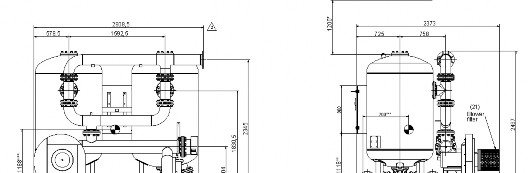
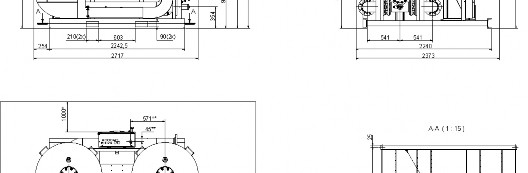
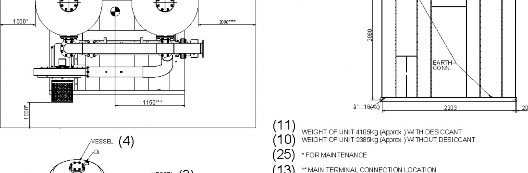
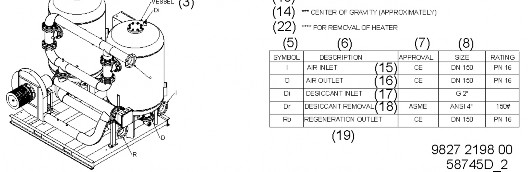
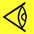
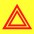
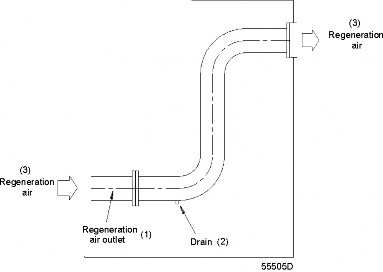
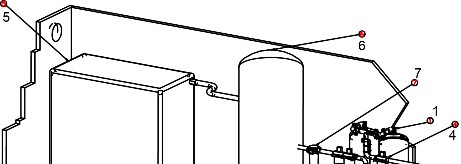
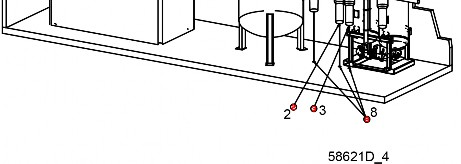
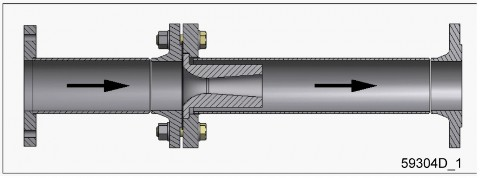
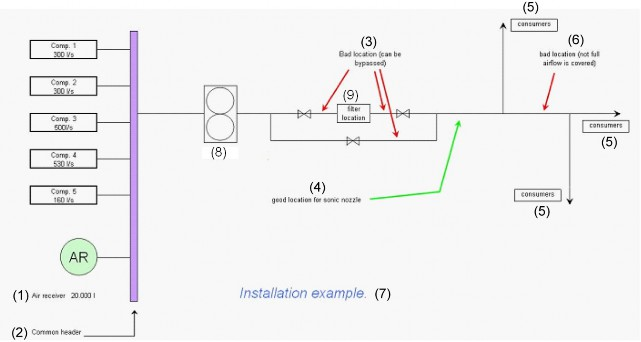
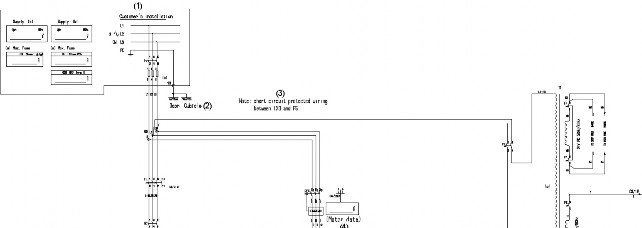
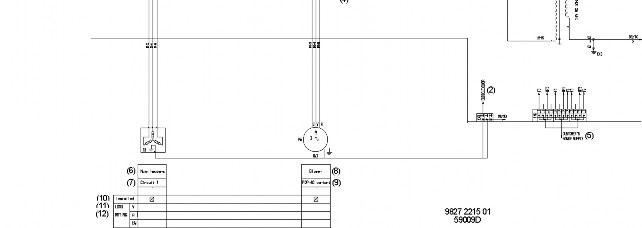
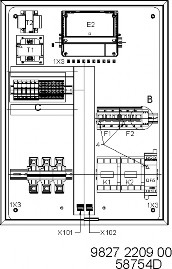
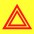
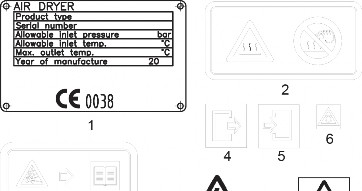
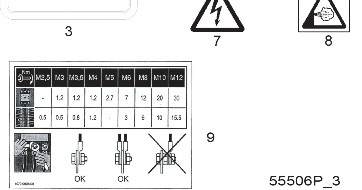

In [ ]:
# not good result
import re
import nltk
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Input HTML text
input_html = """
<!DOCTYPE  html PUBLIC \"-//W3C//DTD XHTML 1.0 Transitional//EN\" \"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd\"> <html lang=\"en\" xml:lang=\"en\" xmlns=\"http://www.w3.org/1999/xhtml\">  <head>   <meta content=\"text/html; charset=utf-8\" http-equiv=\"Content-Type\"/>   <title>    b7aea8f9-2aca-4c34-9d3c-aee7f9171b57   </title>   <style type=\"text/css\">    * {margin:0; padding:0; text-indent:0; }  h1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  h2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  h3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  .s1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; }  .s2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  p { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; margin:0pt; }  .s3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 7.5pt; vertical-align: 3pt; }  li {display: block; }  #l1 {padding-left: 0pt;counter-reset: c1 4; }  #l1> li>*:first-child:before {counter-increment: c1; content: counter(c1, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  #l1> li:first-child>*:first-child:before {counter-increment: c1 0;  }  #l2 {padding-left: 0pt;counter-reset: c2 1; }  #l2> li>*:first-child:before {counter-increment: c2; content: counter(c1, decimal)\".\"counter(c2, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  #l2> li:first-child>*:first-child:before {counter-increment: c2 0;  }  #l3 {padding-left: 0pt; }  #l3> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l4 {padding-left: 0pt;counter-reset: c3 1; }  #l4> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l4> li:first-child>*:first-child:before {counter-increment: c3 0;  }  #l5 {padding-left: 0pt; }  #l5> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l6 {padding-left: 0pt; }  #l6> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l7 {padding-left: 0pt; }  #l7> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  #l8 {padding-left: 0pt;counter-reset: c3 1; }  #l8> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l8> li:first-child>*:first-child:before {counter-increment: c3 0;  }  table, tbody {vertical-align: top; overflow: visible; }   </style>  </head>  <body>   <ol id=\"l1\">    <li data-list-text=\"4\">     <h1 style=\"padding-top: 18pt;padding-left: 47pt;text-indent: -42pt;text-align: left;\">      Installation     </h1>     <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">      <br/>     </p>     <ol id=\"l2\">      <li data-list-text=\"4.1\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Dimension drawings       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dimension drawings and installation proposals BD       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 74pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Us0UUUAFGKKDQAUUUUAFFFFABRmiigA7UUUUAFFFFABRRRQAUUCigAoooxigAooooAKKKKACiiigAPSjtRQKACg0UUAFAoNFABRRRQAUGiigAo7UYooAKKKKACvKfGfw60LxP8ePBuo6lYW91JBoOrh4ZreKSO4zNp4XzdyEtsy23kY3N616tXHapz8X/DP/AGAtW/8ASjTqALX/AAq3wZ/0KOhf+CyH/wCJo/4Vb4M/6FHQv/BZD/8AE109FAHMf8Kt8Gf9CjoX/gth/wDiaP8AhVvgz/oUdC/8FkP/AMTXTmigDmP+FW+DP+hR0H/wWQ//ABNH/CrfBn/Qo6F/4LIf/ia6eigDmP8AhVvgzP8AyKOhf+CyH/4mj/hVvgz/AKFHQv8AwWQ//E109FAHMf8ACrvBn/Qo6F/4LIf/AImj/hVvgz/oUdB/8FkP/wATXT9qKAOY/wCFW+DP+hR0H/wWQ/8AxNH/AAq3wYf+ZR0L/wAFsP8A8TXT0UANjRY0VEUIijCqBgAelONFFABRRRQAUUYooADR0oooAKKKKACiiigAzQaKKACjNFBoAPpRXm0Fl8StR1TUJ9M8VeGrTQzcTx29rqHh24urqMrMyndMt9GrLxwBGuBgc4yZNTh+Iei6bd6jqPjrwXYWFpE89xdXXhi4jihjUFnd3bUwFUAEkk4AGTQB6LRXjNh4/wBY1WRUsvjD8Mrx2mt7cLBpDuTLOCYE41X70gVig6sFOM4rZsbrxzqeranpVn8RPAt3qmmGMX9lB4cnea0Mi74/NQanuTcvzLuAyORxQB6bRXB/2N8T/wDob/CP/hKXX/yyo/sb4n/9Dh4S/wDCUuv/AJZUAd5RXB/2N8T/APocPCP/AISl1/8ALKk/sb4n/wDQ4eEv/CUuv/llQB3tBrgv7G+J/wD0OHhL/wAJS6/+WVI+k/E2NGZ/GPhBVAyS3hW6AA/8GVAF0/Fvw0JpoftF8Z4J5bWWFdKuy8UqRpIUZRFlSySRlAf9ZvXZuyKVfiz4Xax1a8+3zC20ux/tK7drKcbYPJSYlQUy7COSNiiZdfMQEAsAfJdT8OanBrNhHqnxc8Cf20rHULQ3mh4uQLiQJHImdR3FDIFVMcEhU+ZQFDI/COreHIL/AMR2nxb8C6VYWsi6dqmoHQ28kMkS2ogmlfUiEZWEB2kgh0AAHmSBwD6B0fVrXXtJs9SsXaWzvIUuIXeNkLIyhlJVgGGQRwQDVyvO7Dw18TNPs4raPxl4UdY1xufwrc7mPcnGpAZPXgAVY/sb4n/9Dh4R/wDCUuv/AJZUAd4fSiuC/sb4n/8AQ4eEv/CUuv8A5ZUv9jfE/wD6HDwl/wCEpdf/ACyoA7yiuD/sb4n/APQ4eEv/AAlLr/5ZUf2N8T/+hw8I/wDhKXX/AMsqAO8org/7G+J//Q4eEv8AwlLr/wCWVH9jfE//AKHDwj/4Sl1/8sqAO8org/7G+J//AEOHhL/wlLr/AOWVc14U17xl4c8f/ENPGGq23iaLTdA07U7Sz8N6PNb7UabUgyJA1xO0sziBBlSN2EULxkgHqK6/YPr0uii4A1OO2W8MDKQTEzsgZSRhsMpBAJK5XON650O1fNMfja9tPFVjq6W/iPy4bV7y6C+EdZdrm/kmTzown9no3lC2Qwxu05Ufui0JMSsfo+wvE1Gxt7uNJY4541lVJ4mikAYZAZGAZTzyrAEHggGgCeiiigAooooAD0ooNFABRRRQAUUdqKACiiigDmfigwT4aeLW+2Q6fjSLs/bLiWWKOD9y/wC8d4iJFVepKEMAMrzivOfAXiGbVPi1oVg0k3kaf4avY4odQgu4r0Az2K75DcxRu6sEAD4JLLJlieB6t4uhu7jwprUVg10t9JZTLbtZLE04kMbbfLEpEZfOMByFzjcQM14v8JdIfT/ino88Hh/W/CujT+Hb0Weka3FaJJHiax3SZgmkZmYNGrGf97mMbi3YA9+oo6migAorzzxv4an8RfFHwY0Gv6roX2Kx1G6YaY0IF0BJaL5UvmRvmPLbsLtOVXnGQep/4R+9/wChk1T/AL92v/xmgDaorCl0W6giaSTxPqUcaAszutqAB3JPk1A1oUiaVvF96I1VXZybTaFb7pJ8noex70AdJ3orE/4R+9/6GTVP+/dr/wDGaX/hH73/AKGTVP8Av3a//GaANqisQeH73/oZNU/792v/AMZpf+Efvf8AoZNU/wC+LX/4zQBtHgE4z7CvNLn44W9tpd7dr4W1u5ktLC7vns7aawkmb7LceRcRLi62+YjckFguAQGLgoOqudMktSqXHiy/gZwxUSfZFLADLEZh7Dr6Vz2l/CnRoIrSG01q/mjtIYhbo0kEwijWRZYyoaM4w0UZB9IkHRAAAdT4f8SjX59TgaxuNPn0+5+zyRXMkLsfkV1YeVI4AKsCA21sEEqARnZrmrHwXLpz3DweIdWVriQyyF/s75Y+m6I4H+yMAZOByatnw/e/9DJqn/fFr/8AGaANqisX/hH73/oZNU/74tf/AIzR/wAI/e/9DJqn/fFr/wDGaANqjtWL/wAI/e/9DJqn/fu1/wDjNH/CP33/AEMmqf8AfFr/APGaANqisX/hH73/AKGTVP8Avi1/+M0f8I/e/wDQyap/37tf/jNAG1RXkvw48M3Hhb42+PoLjxBqviI3Oj6VeJLq7Qs9usl5qreRGYo0/dKc7Q25gDjdgKB61QAUUUUAFFFFABRRRmgDzbS9Z8dxazqNnpnhXQ7vQFnuJIdUu9flglklNzKGjaBbSTbjGQ28gg9jxVrXl8e63pFzZHwz4W3SAFPtGu3EsYdSGUun2Ibl3AZXIyMjI610/hX/AJB1z/1/Xn/pRJWxQB4bL8OviANNsYY7PRJLq3vLW7e5uPEl6WlENskHlnZbKdrbS5ViyFnYsjZNdNoen/EHR9b1e+OgeFmjv/LKwRa3cJsZd5dmb7Gd7MznnC4VUHOMn0yigDy+98X/ABTt9aFpF4E8OyRGRBHJ/wAJRKFmjJj8yT/jyypjDOdpHzbRg88dD/anj7/oWvDf/hRXH/yDW5d/8jBpv/XGf/2StOgDkP7U8ff9C14b/wDCiuP/AJBpP7U8ff8AQteG/wDworj/AOQa7CigDkP7U8ff9Cz4b/8ACiuP/kGo7i88dXcEkM3hXwzNDIpR45PEE7KykYIINjggjtXZ0UAfM3iv9nPxN4rASXT9HtIWtDbyJa+IbmMzO9pHZSTuVswGkFtGUjyMIZZtwkVyg29X+G3xN8R2mt22p2nhQPeXrahaalYavdwXdpK8MlszKTbMokjt2RYpFC7WQOyuc7vfqKAOPGp+Psf8iz4c/wDChuP/AJBo/tTx9/0LXhv/AMKK4/8AkGuwooA4/wDtTx9/0LXhv/worj/5Bpf7U8ff9C14b/8ACiuP/kGuvooA4fQvEPje48XvYa/4Z0fSNF2D7Nf2GtyXsly+wllMTW0Xlhcfe3HORx3HcVm6j/yF9K/35P8A0A1pUAFFFFABXAaL/wAl88Zf9izof/pVq1d/3rgNF/5L54y/7FnQ/wD0q1agDvzRRRQAGiiigAooooAKKKMUAFFFHagAooooAKKPWigArjtV/wCSv+Gf+wFqv/pRp1djXHap/wAlf8M/9gLVf/SjTqAOxo6UUUAecePdR8Saf8TPCH/COaJYa08unalHc/b9TayW3i8yzPmArDKX5AG3A+9nPBrX/tTx9/0LXhv/AMKK4/8AkGrGo/8AJTtA/wCwPqX/AKOsa6jFAHA6/P8AEnUdD1G0sNF8Nadfz28kVveNrtxKIJGUhZCn2Jd20kHbkZxjI615r4r+D3j/AF43CadpnhDw9bwwQwaQNM1S9t307Yirv3RQoJW/dw4V12BYIl2Had30RRQByH9qePv+ha8N/wDhRXH/AMg1k+JfEvxO0uwSbT/Bfhq+YyBZifE80fkRYO6XBsPn24HyjBPrXotU9a/5A9//ANcJP/QTQBxWheIviZf200l94L8NWDLM6QgeKJpPOiH3ZeLD5d3XaeR61pf2p4+/6Frw3/4UVx/8g11Nl/x5wf8AXNf5VNQB5J498K+OPH0CWt74c8JSWC2t3F9nn1q6Y+dNEYRIJEtUdQIpLhCEKswl4dcc4ngb4bfEPwh4yu9fmtPD2pSXFsIDE+uXQbd5FnC7mR7V2bP2JDz8x3ncz7V2+7UUAcf/AGp4+/6Frw3/AOFFcf8AyDXP6n418eaZ4+8FaXqHh7RNP0PV9RktLi9s9Yku5WIsbycRiNraLb81vGd+48ZGOcj1CuD+I/8AyOPws/7GSb/00alQB3lHrRRQAUUGigAooxmigDgtG/5Lx4w/7FrRP/SrVa72uC0b/kvHjD/sWtE/9KtVrvRQAUUUUAFFFFABRR1o70AY/hX/AJB1z/1/Xn/pRJWxWDoN5Bp+iX91dTR21tBd3sss0zBUjQTyEszHgAAEkmqf9v6z4ieVNAsY7K0V2j/tbV422PtIG6G3BV5UJDruZoh9108xSCQDqs14t+0F8a9T+HOo+F9J8OSWb6re3L3V6t3pN5qKCxh8sTIFtMvFMxni2O6lMK+QTgV6FH4Dhu7iK51rUtQ1u4jYsI5rhobUAqBsNvFtjkUHLDzVkYE/eOFxraL4c0nw1psOnaRpdnpWnw7vLtLK3SGJMsWbCKABliScDkkmgD5Tuv2nPGktrrn7jTYNfOqTr4em/wCET12S1h0szQbTdx+SryXIiEpIjZUL7BlRk1ufDP8Aag8S6t8UPDXh/wAVx6allrWmrBHFpugarbzpqcdr511J5l0iIbXMcyoApkG6HPVsezazeSeIvHEWi6Xc/Yo7GGQahqFuI3kjkdY2W3QEMFk2lHYuvCSR7QTJuTqNB8NaZ4XtXg0yzS1WVhJNIMtLcSBFTzJZGy0shVFBdyWO0ZJoA4uL9oDwhcanq2n28fiS8u9JuvsV6lp4S1aYQTeWkoQslsRkxyxuMHBV1IyCDVj/AIXh4d/6B3i//wAIrWf/AJErL+D3/JRvjn/2OFt/6j+kV6nmgDgP+F4eHf8AoG+L/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDgP8AheHh3H/IN8X/APhFaz/8iUf8Lw8O/wDQN8Yf+EVrP/yJXf8AaigDgP8AheHh3/oHeL//AAitZ/8AkSj/AIXh4d/6Bvi//wAIrWf/AJErv6KAOAPxw8O/9A7xh/4RWs//ACJXnnxW/aP1W0vdA0jwBpGpyazdSPeXR1/wZrfk/YYTGsyxrHAsnms08QV9rIo3buSgb6CrhNYx/wALz8I/9i5rX/pTpdAHjl78ePHgm8RA6FLLebrh/C03/CGa9Gke5JBHHex+QxfbiItJEy79zjYm0Fjw7+0x4w0fxp4ag8c6K1t4c1PTYrGZ9K8Ia6tyuueX5jmPzYAGtW2TqqhTKD5ZOQXKfReof8hfSv8Afk/9FmuC+Nv/ACFfhf8A9jhb/wDpLdUAaP8AwvDw7/0DvF//AIRWs/8AyJR/wvDw7/0DvF//AIRWs/8AyJXf9aKAPPz8cPDgBJ07xeAP+pK1n/5Erzf9nb4yWHxt+N3xX1rRZhdeHLbTPD1tpV2bOe1e4t3iurkSMkwVjl7h9rbVBQIRn7x+hpf9U/8AumvgX/gm5a+IZP8AhKfsep6ZAn/CLeENwn06SQnOkHyuROv3eN397BxszwAfflArlf7O8b/9DD4f/wDBDP8A/JtH9neNz/zMPh//AMEM/wD8m0AdVmiuV/s7xv8A9DD4f/8ABDP/APJtH9m+Nx/zMPh//wAEM/8A8m0AdVRXHX9v45srG4uF1vRLloo2kEMGgTGSTAJ2rm9AyegyR9at/DPWtY8S/D/w7rGvW0Vjq+o2EF5c2cUewWzyIHMJG98lN20kNglSRjOKAOmNFFBoAKOtFFABRRRQAUUdaKACvJfHfjr/AIRn40+GGk0bW7zTING1KK9vbDQ9RvFhkllsmhVTBbSI5byZc/MNu0Z6gV613oxmgDgP+F4eHf8AoHeL/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDxy/+NPh9viPoc39n+LQiaTqCEHwdq4bJmsiML9lyR8pyQMDjOMjPSf8AC8PDv/QN8Yf+EVrP/wAiVr6j/wAlO0D/ALA+pf8Ao6xrqKAOA/4Xh4d/6BvjD/witZ/+RK5b4iftXeFPh5okF7J4e8c6ze3dyllYaTYeD9RS6vp2DMI4vPhjQsESRyC4+WNiM4xXf+IviJpWi376VDPDd63tYraeZsjjbCkefLgrCCHVvm+ZlyUVyMVzmqWkHjGfTrnXPFtvpgsLtbu3stDuUQKQjIyvcOvmNuV3UmMRHDkdfmoAyrr9qjwXaeEL7xC9l4rjtrOG5eSKfwpqUJEkAfzId7wCMOGjdcFgMjGa8tsP2mfFzafpC6+1jIq/bBrY07wZrqefEyf6N9mLofKZTu3l94YAY2Z4948OaH8P/Clwt1pw0waiImhbVLq4+030iM+9le5lZpXBbnDMeg9BWvrPibQTpF8BqViSYJP+Wqf3T70AfMmt/tQfET/ipF8P2+ipbGWy/wCEfbUvCniBnSAK/wBrF2EhAZyRH5ZjIADPuBwN31F4E8Y2XxB8FaD4n05ZUsNZsYb+BJwBIiSoHCuASAw3YIzwQRTbLxNoIs4B/aVj/q1/5bJ6fWsXUNG+Hup6jealLDo0WrXcYhm1W1ZIL0qAAALiMrKuABghgRgY6UAdzRXASajLoheXR/FtnqkWSRputXKbQMcKlwimRecktIJienHWtfw58RdJ8RXr6eGex1Rf+XO6K5cEvgxyIzRyfLGWIRmZVK7wpOKANvWNUXSLCScwy3Uv3Yra3A8yZz91FyQMn1JAAySQASPk74hftOhPi9ZaRcw3d2vhnxIqIfDfh2+1hUlbRLoyxSSwAhnQzA7VVW2knaRG5p3/AAUOTW4/h3o7zeJItM8NS6rIj21nYZupnGnXbRwl3do38yVQo3RhAWQscKTV34WeBNc8HfDX9nqz0q90jT4rm8W+ZLjQ51uGup9Fv5ZpbjNwheRmaQt8sZ3N0UDZQB6L8Bvi7rfxX+HvhbX77VPD8cuuWkbwS6XE8sElwIg1xAQ0mYpo3WYGIljtjJ3Eh1T1QWmt/wDQTsv/AABb/wCO18jJ8ML/AME/tReJLuwSyi17xLd6df2OpQeHbs2kdwGjOpBHF35cDyW8UTyZw0qhxuO4LX2VZrOlpCtzJHNchFEskUZjRmxyVUlioJzgEnHqetAGd9k1v/oJ2X/gC3/x2j7Hrf8A0E7L/wAAW/8Ajta1FAGT9k1v/oJ2X/gC3/x2j7Jrf/QTsv8AwBb/AOO1rUUAeXaNa6z/AML08XAajZiT/hG9Fy32JsEfatVwMeb9fzru/smt/wDQTsv/AABb/wCO1zGjf8l48Yf9i1on/pVqtd7QBxWn6v4nf4oT6LNJYT6DbaTFeyzx2zRzefJLKiICZSNu2Jz909OoyK7WuW07/kqHiD/sDab/AOj76upoAKKKKACiiigDz3SVTxF4k/smRkaz0qefVLiAnmWV7u4S2yvQophmfkffWJgflNehYrwa3+FujfEH4t+JptUvfEdq9tplsiDQ/E2paSpB1HVSd62lxEHPHBYEjtXS/wDDNXhH/oL+P/8Aw43iH/5OoA9Uqrq2qWuiaXeajfTpa2VnC9xPPIcLHGilmY+wAJrzX/hmrwj/ANBfx/8A+HG8Q/8AydXxx/wUi8KQ/Cvwl4Q0zw38TvEfgoa9cXUV9Lq3jTxDetdQJGimMI880XlfvsyBl3nCBAR5goA+6/Cem3OmW/h9b5mk1Oe2nub123c3EhR5cBmYqoZiFTcdqhVBwopdStH8eajqWlve6hpulaZcJBcrYXLWs15KYUlx50ZEkcaiWI5RkZmUgnYCJPx4t/2o/iPNqktrP8Up4IJdXmT+35tW1bydLgEsR8sgHcYnXKAlGlA3FtrbDXp37GWuar8UPjto2jeI/jJq2t6fqVtcCbw3Z+KvENncPL9nF0bxDA0UayM5cNlljIEpCljGzgH6mWngnQ9PuL2e106O2nvphPdSwlka4lEaRh5CDlmCRxpk5O1FHQCuO8Ufs9+FfFnjGHxLexSHUoRp4hl2Ru9v9kunuV8qR0Lx+Y0hSTaw3IAOOtQf8M1+Ecf8hfx//wCHG8Q//J1H/DNfhH/oL+P/APw43iH/AOTqAN7X9AGl+I9CvrWG5msrmY2GoRG8YQwxsjtFOEJyXEwji+TGROSwYRqU6T/hHLD/AJ4v/wB/n/xrz2P4IeHfB+o6bq1hqPi+e6t72DZHqnjTWNQtzukCndBcXckT8McblODgjBAI9UoAzR4csP8Ank//AH+f/Gj/AIR2w/54v/3+f/GtKgUAcXqmgJqHi3TdOiS4h023ha+vJYbt0ZpAyrbwnnJRv3zttI5hRTlXZWr3fwV8N33xBi8YTW3m6rDaw2kLSokhgWMznMUjKZIy/wBoYPtYBgiAjg5h8Y/DXSPiJ4ub+1LzX7X7HYxeX/YfiPUNI3b5Jc+Z9kni8z7oxv3bcnGNxzm/8M1eEf8AoL+P/wDw43iH/wCTqAPQv+EcsP8Ani//AH+f/Gqtz4K0e6nW4e0Iu0hkgjukldZo0cqXVJA25clEJwRyinqBXDn9mvwj/wBBfx//AOHG8Q//ACdXyP8A8FCfD3/CmfD/AIMTwj8VvE3w9uNSurhp73UvG/iS6knWJYwI0BmmjCZl3PkCQ4TZkb6APqjw34o+J+saL4Pv5/DPhe4nurNJzK3iS4QyM0AJYqNPwpOc4GQOlangXSZvGWr+LpfGGmWb6lpuvxm2toryS8gsiNOtGUwyPHGQf3rtkIuDI45zk/kjF+0b8QdB+22tr8WLjUrV0uRb/ZdU1RF8OJH5yxxJuCk71VNnmCTACeZs+evWP2O/FWpfFX9oXTtF8SfFTUtct9fszc3emWPirxDZXJmjsEAcGCSKPzcW6szMfKKuwQkiJQAfqp/wjlh/zyf/AL/P/jR/wjlh/wA8X/7/AD/4157/AMM1eEf+gv4//wDDjeIf/k6j/hmrwj/0F/H/AP4cbxD/APJ1AHQ+JtBh07UtF1KHzDaLcfYry3NzJteOcqiOq5wXWUQ8kjCNLjJIFcn8HvgUnwm+J/xI1rTo9PsfDXiFNJi0vS7AMgs47S1aFkKYCouSNqoSAB26U68+CHh3whNpur2Go+L57u31Ky2R6p401nULc7rmNTvguLuSJ+GONynBwRggEeu0AFAoooAKKKKAEf7h+lY/gv8A5E7Qv+vCD/0WtbD/AHD9Kx/Bf/InaF/14Qf+i1oA2e1BoooAKKKDQACijpRQAUUUUAFGKKO1ABRRRQBy+o/8lO0D/sD6l/6Osa0PF2pXWk+H7uewWJtQfbb2gnz5XnyOI4i+Odm913YycZwCeKz9R/5KdoH/AGB9S/8AR1jUPxW0O08TeCbnR9QWV7DULm0tLhYZ3gdo5LmJGCyRsrocE4ZSGHUEHmgDe0HRbfw9pNvYWxd44l+aWUgyTOeWkc4G52YlmbuST3rQzXg//DEHwj/6BniT/wALXW//AJMpf+GIPhF/0DPEn/ha63/8mUAe75qnrOP7Hv8A/rhJ/wCgmvE/+GIPhH/0DPEn/ha63/8AJlVdV/Yk+EkOl3ki6Z4jDLC7DPjTWzyFPY3lAHvdkf8AQ4P+ua/yqevArT9iL4SPawsdM8SZKKT/AMVprY7f9flS/wDDEHwj/wCgZ4k/8LXW/wD5MoA94rO1/Rotf0e6sJZZLcyoRHcw7fNgf+CWMkEB1bDKSDggV4x/wxB8I/8AoGeJP/C11v8A+TKP+GIPhH/0DPEn/ha63/8AJlAHoN/4Q0b4yfD6wsvHPhzT9QaRFkuLG4jWdLO8VWR2hcjKujGQLKuGHUEZrlLeJrfRvgBFJPJcvHfRK08oUPIRoV+CzbQFyepwAPQCvH/2wfFWofBX9lfTtN8JeLl8CR/2smkRapPcXL3ccCTvhY5wsjb8Rgu8pJZBIMl2AP55aj+0T45bWLFj8eNPljhnL2ZS71ZLbTmNpcRb7dFQMmA+3DAjLqAPL3igD9qNJ0WGXxnrWrSSSyTROttDEWAjiDQws7AAcs21ASxOAg27dz7unr8nf2TP2lPHkP7RHg7Q7j4w23xA0vV7x9PutOLXUzTCQE/aHaeJDvRYYwCh2gdE+eQn9YhQAUUUUAB60UUUAcFo3/JePGH/AGLWif8ApVqtd7XBaNz8ePGH/YtaJ/6VarXe0Actp3/JUPEH/YG03/0ffV1Nctp3/JUPEH/YH03/ANH31dTQAUUUUAFHSiigDzTwB/yVPxj/ANg+0/8ATjq1el15p4A/5Kl4x/7B9p/6cNWr0ugAr5p/b1+JXhHwZ8GrvRvEVrpd9qOt216umpqtg95FaGO2fzLzYiMV2eYiBvlAeeMF0Viw+lq+Av8Agpb8Mde1NdO1i2bVvEllf2tzbw2SS2FqmlzwILtGhme1eQM6Qzn7wYhJF8wBwhAPYL//AIJ9/AuaeXSZPC2qyaZrEk97qNm/ivV2ivJ90bebKpu8O5YAljkkqCegqn+zLqHw9+G3xN1H4U6Bo+n21/psWpRaZe29pM9zb20F9mTT57yYuZWRZ7SZVVziOVAyJtjaX1i6+G/iEa7p4PxV8XEmKbDG10fI+5/04Yr5A8D/AAm+JGt/tuIp1SW18N6VeanrZ8VQ6Xpi6nKi/a7KNZJ1tyrb5rm6VY5EXCwylV4VgAfogKKO1FAHO+PL+fTNBS5t9OudWnjvLUrZ2bRLLL+/QYUyuid8/Mw6evFZX/Cwde/6Jn4p/wDAnSf/AJOroPE6LJZWoYZH261P5TIRXA+OPjHrnhf4oaf4X0/wgmr6XIumNfaw2otCbMXl1NbqTEIWDY8jI+cbiwX5fvUAb3/CwNe/6Jn4p/8AAnSv/k6j/hYOvf8ARM/FP/gTpP8A8nV29ea6/wDFfVNK+Mth4Ks/DUepaY+nwX9/rS6iEbT/ADp5IYUe38sk+Y0TlG3AHy5RwUAcA2PCWv32ueKtWa98N6n4dMdlahV1KS1cy5kuMlfInlAxjndjrxnmuyrGtkA8Y6i4+8bC2B57CSf/ABNbNABXif7UXjrwf4e0Lw54d8TWWi6lfeJdRa002HXNLOpQWxSF3mvGtlRmdYYt2SAAPMUO8aFpF9sr4s/bt+FvxF1/xv8ADfWvCF6ms2l1ez6NLpur6bZ3ttp7zG2mhkiieDnL2RJklk+Riu0qGIIBt+DP2Dfgnd+GtHu5PDWq/aPFNklxrjp4p1ZP7SkeAu7TgXQD5aRyc/329TTvgBN8NPgl+0b4w+E2h6Vp+m3hkSLRrlkuZr1Ik0ywmewe7n3mRdmZY0Ep2pEwKIEjLei+CPh1r8nhLwIy/FDxXEsmnQlUS20jEY+zA4XNgTjtySa+brf4VeML79vLXrW18QeLbdZrqK6n8YxXGjNMsNrpEQUCBrHKAyX4iYKNjAgspJVgAfoFRWVHpN+iKp1u5cgAFmhhyfc4TFL/AGXff9Bm4/78xf8AxNAFXxp/yB7f/sJWH/pZDW9XHeM9MvhpNvnWLg/8TGw/5ZRf8/cP+zW7/Zd9/wBBm4/78xf/ABNAGpRWX/Zd9/0Gbj/vzF/8TR/Zd9/0Gbj/AL8xf/EUAalFZf8AZd//ANBm4/78xf8AxNcr4v1XXfD3inwDZ2upLPZ61rUlhfC4hTcIV0+8uQYyoGGMlvGCTkbS/fBAB3r/AHW+lY/gv/kTtC/68IP/AEWtbDcIfpWP4L58HaF/14Qf+i1oA2aKKKACiiigAooooAOlFFFABRRRQBxvj74lp4C1Tw3p7aBq2t3PiC8ksLJdMNsAZ0t5bgoxmmj25it5mB6fu8ZBKgxf8LB17/omfin/AMCdJ/8Ak6k+IP8AyNvwy/7GGb/006hXWaxFqE+k3kelXNtZ6m0TC2uLy3a4hjkx8rPGrxl1BwSodSRxuHWgDxzxR8ZJ9A+K3ga11DwH4mtr7WrfUtM060MunM9zMEhuWAK3ZVQsVrKxLsvYDJOK6PxJ421m+tdPt5/AHiLToZdV05Wu7mfTTHEPtkPzMI7tnx/uqT7V8w/tG+EPjxc/tM/s4tH498KSIdavPJXTtEl04JstJJLrcJZbsuXtFuI1wygM44Gd6/Zfjb/kC2//AGEtP/8ASyGgDfooooABVPWv+QPf/wDXCT/0E1cqnrX/ACB7/wD64Sf+gmgCax/484P+ua/yqaobL/jzg/65r/KpqACkJwCaWobyF7i0nijnktndGVZ4gpeMkYDLuBXI6jII9QaAPhf9m/4tax4m8U+Ifh74+0HVPiENS0y98RxaZNDaXNn9oh1m8S6ijNwyAbTJZqke9lVVXAj5Z36b+yN8GPEWs+D5Z/C1zZ+Idc1qSz8SJaeItVhF6h0rUHB2GWJkQtGUKeXHsZJocAK6145+zTFHa/tXT6rJ8QdU0vTz4N1SQa/bR6c7SBtenMcKFrZ1fzdkkgVU3MVOw4+UfRWsfDnxV41+N/w48TH4ieIbTSbXWbrTba4jj0trmeU6ZdSGQyQ2ghdV8t4ihWUAk4cPvRAD2b4H/s6fDj4JS6nZ+DfC1tpiWd1ttp55Zby4t0eCItHHPOzyJGSWOxWC5ZjjLEn16uL+H3hzUPD+p+JRfeKdW8SmS6iCnVIrNDFiBMlfs8EXXcAd2fuLjHOe0oAO1FFFAAaKKKAOC0b/AJLx4w/7FrRP/SrVa72uC0b/AJLx4w/7FrRP/SrVa73rQBy2nf8AJUPEH/YG03/0ffV1OK5bTv8AkqHiD/sDab/6Pvq6mgAooooAKKKDQB5p4A/5Kn4x/wCwfaf+nHVq9LrzTwB/yVPxh/2D7T/04atXpdABXzr+3L4/Xwj8GtR0q60XQ9S0rXrS6tLq78QX729vZkRbkkCR287ySK37xQEABizvVtgP0VXj37T/AMDh8bfh5NBZanrOi+I9KjuLrS7rQbqO0uJpTbyILV5XU4hkYxlgCp3RRMGUoCAD4vsP+ChXjPxNq8Wn6P8AEb4V3niu81JtO8O2EnhfWora+jkmjjja4mM/+ju3zfKFdAQB5hBLL7j+xZ8ep/iTMGj0/wAL64NXmuZNU8U+HLqeCRr4YuXiazuoldbeL7T5aMs0jMWV/LTfL5fTaf8AsX2F5ot0tt8YviLJZ6tdLqrSsdI8wOXWUCJzp2+GLKr+5QrHtLJs2synY+Bn7OGlfD3x5qusXvifxL4q1rSs2FuNfnge3RGRWju4Yo4Ywk3kuYGlXhis/GXkyAfQVFFFAGV4k/487b/r9tv/AEcleS+PNUs7T4uavaT3cEN1d2/hFbeCSRVeYrrF4zBFJy2FBJx0AzXp/jhbptEjFlc29pdfbLXZNdQmWNf36dVDoTxn+If0rhNZ+Feqa74ml1678S6C+oMmnqj/ANiMfJ+x3MtxGUJuiVLNM6vzyuAMckgHrfQV53rl/bRfEi/s3uIku5rPR5YrdnAkdEvrgOyr1IUugJHTcueorjvGXxzufA3juz8I6j4n0IaveDTvIRdLVTN9su3tY/LR9RWSTY8ZaTYjbUIPPSuru/BOu3viCTWZPEvh837w28AkGiSfIkMzSgKfteQGZhuGedq9CM0Adlb/API3ah/1423/AKMnrYrkvDCasvivVv7U1LT9Rb7Fa+WbCze3CDzJ87t00me3p+NdbQAV4b+1x8TW+HHw2lMmgaRrNjeJMbqXXtTksrW1SJPMD7oYpZmlDBXTy0GPLY+YjiMN7ka8k/aU+FOj/EvwKbrULrVdPvtD8y8s5tDu/sl1cEoVNkZVUv5UzeWpRMMWWJlIdEIAPh6x/b08VeFNG021ufiT8L4oRZyHwiw8L6zKdSt4nmtUe7InH2Zi9uQQok/iI3ALv9q/Yr/aJl+Kfj3xDLJD4R1/UPEjRXup+IfDDXNpIk0FjbRiBrW6iDmCPa6q4mdiZA3lRh5PL9EX9jJW0zVLOX4v+PWXU95uZEh0RHVnHzeQ/wDZu+3HJwImXbxjGKn+AH7MNh8OvGV/4puPF/ifxc1oZNM0mHxFdwTLbpHHDbvOUjgjAuC0EyeYCS0cjlv3k0zMAfQ9FFFAGD40/wCQPbf9hKw/9LIa3qwfGv8AyB7b/sJWH/pXDW9QAUCiigArgfiT/wAjn8Kv+xlm/wDTPqVd9XA/En/kcvhV/wBjLN/6Z9SoA71/uN9Kx/Bf/InaF/14Qf8Aota2H+430rH8F/8AInaF/wBeEH/otaANk0UUUAFBoooAKKKKACiiigAo7UUHpQBw/wAQufFvwy/7GGb/ANNOoV3FfMw+K2oeJv2mPD3hCeSeVNH168edXsTHHBnT70WwVxkLuiZydzyGQrvUQBWjr6ZoA+Vfi34im1H9uT4J6Qt55tlptzct9l8sDybiTR9WMjbsZbdGsHGSBt4wS1fRfjb/AJAtv/2EtP8A/SyGvnL4v6DJaft2fBHVxayxW9808H2jefKlki0rWSwC5xvVZY8tgEgoMnaAv0b42/5A1v8A9hLT/wD0shoA36KKKACqetf8ge//AOuEn/oJq5VPWv8AkD33/XCT/wBBNAE1l/x52/8A1zX+VTVDZf8AHnb/APXNf5VN1oAKKKKAPmPTfDmm/sh/DPWtb8MQnWZLzVpLW3tdf1P7Na2kUmoS+VAsscEsu1WnYKWSRufmZVGR8Xaz+3b8RNGj8CyW3iP4P2uh6deS3GiFbLWZCFS0urYm5IRNwxKykoikuyttC5FfpV4j+Hdt8TfAdxo8+p32iSm+uJItT0tYDc25Fy+dnnxSx/MMqcoeCcYOCPlfVf2JNK1J/hjef8LT+JduPEOoMrwprNuy2QfS724PkM9szggpsDOztsZhknDAA2v2WP2t/GvxD+IGq+FfEsHgXX9Ui1Ex6rc+Eb2+t2scKIVUW91b7ZcPESzicfKTtUkAP9o187fB39kvRvh347vdbm8beNPF0thct5Nn4kv4J7be6RyLJ5ccEYDIzMUxgLkcHam36JxQAGjNc948t9QvPDc8GlS7bzzIZWhGzdcwJMjzwLvIUGWJZIwxI2lwcjGR5rZ/DPxfZ3supmZba4miuoFsrTXLm6gt5HnsfstwqzKinylt5pJQRmVmcnf5pUAHtZooooA4LRv+S8eMP+xa0T/0q1Wu9rgtG/5Lx4w/7FrRP/SrVa72gDltO/5Kh4g/7A2m/wDo++rqa5bTv+SoeIP+wPpv/o++rqaACiiigAooooA808Af8lT8Y/8AYPtP/Thq1el15p4A/wCSp+MP+wfaf+nDVq9LoAPwoIzRQeaAOQ8CGLw2X8HMhgGkxL/ZwKMElsOkWxiTuMQxC/zFvlR2CiVM7Wo+HobvUBqMEsljqYiEH2mA/fj3bgjqflcAlsbgSu99pXc2ZNb0O31y3jSVpIJ4JBNb3UBCywSDIDoSCOhIIIIYEqwKkg4l1q3irQIbl59Ej8TxRjdEdElS3upS0jAJ5NxIsYCIUy/n/OQ5CJ8qkA4LwXr/AMUvFfiXx7pT+JPCFsvhnWYtKSVfDF0xuA+nWd5vI/tEbSDdlMc/cB74FrQvhR448PeKfEfiO18V+Fv7Y1+eOa9nk8KzkFY4IYYo1xfhgqiJmwzN80r4xk5n+Gv2/wANeKPiXq+vaReaHZ+I/Etld2P2oxSMVfS9MswreU7gN9ohkj64+XdnaQx9YoA8n1rRfiTqWq2Oj3HinwjJDNE96WPhW5PMMsJVSDqJyCX/AErJ1L4HeMNU1281WTxT4SSe6j06N0j8IzBALK5kuYsD+0M/M0rBueVAAweT3A8Tw6jq2h6/Z2t1daNPYSJDeRIu2Xz3tzCVBOcMFJzjjvipvEHxQ07wsLltR07Wo0t4o5pJItMlmQK7MowyBgSCpyASVGCwAYEgGL/whXj7/oYPBH/hHXH/AMsaybn4TeNrrVri/bxL4OEsyWqMq+EJ9oEEryJgf2h3MhB9QBjFcP44/b58CfCz4weHvhz460TxD4P1jXLaO5trnUY7V7aMSTywxCV4Z3Cb2iJDcqoZS5T5tvvE3jOKDUVsm0vVvPZUYFbJmTDEgfOPlzlTkZ4GCcAjIBydn4K+Ien6jPeW3irwfBJPFHC6x+ErhVIQuQeNR6/Oa0P7G+J//Q4eEv8AwlLr/wCWVdIviVWu5LYafe+fGiyMnlrwrFgDnd6q35VL/bT/APQMvv8Avhf/AIqgDyn4ua98Uvhn8KvGPjCLxJ4Q1CTQNGvNVW0bwxdRiYwQvIELf2icA7cZwcZ6V6Jp/hi+vIbSTxPqEGs3lvKJ1SztWtLMSKSUcQmSQkj5SN7uA6h1CkDHK/H7T9W8dfAr4i+G9G0W9utX1jw7qFhZwN5aCSaW2kSNdzOAuWYDJIA710kXifxFqVzcwWng+6sBBOiC61q9t4obiIsQ8kQgeZyQoyEkSPOVGV5KgGzr2sJo1ojACS6uJFt7WAkjzpmztXgEgAAsxAO1VZjwppnhfQx4d0GzsC0cs0alrieKLyxPOxLyy7cnBeRnc8k5Y5JPNVdA8LyWFyNS1a/bWNdaHyXuzH5UMSk7mSCHJESFvUs7BUDu+xcb4oABRXDeAE12PxD4ifVvEF1rFncSLNYWs9tBEtlHudTGrRxqzjcDy5JwFHUMzdzQBg+NP+QPbf8AYSsP/SyGt6sHxp/yB7b/ALCVh/6WQ1vUAFAo9aKACuB+JP8AyOXwq/7GWb/0z6lXfVwXxJ/5HL4U/wDYyzf+mfUqAO8f7jfSsfwX/wAidoX/AF4Qf+i1rk/GXjnVvD3jddMW90S3065sIms4p1nkvHu2nMWGRBtEB3wDeCSGLZAGDXWeCv8AkTtC/wCvCD/0WtAGzRQaKACjtRRQAUHn60UUAFFFFABRRRQB5n4y8K6NpXj34bX1lpVnaXj+IrstPDAqvmXTL+SU5A/jdQzf3mAJyRXplcR8Qf8Akbfhl/2MM3/pp1Cu370AeB/HX/k5P9mr/sN61/6ZLuuz8dav4pbWJLO00fSbjw/Dc6a326bVJYroXBvIT5fkC3ZTHtwfM80HPGz+KvIf2pvin4W8AftM/szxa9q8dhK+taoVj8t5GxNp01pESEUkBp54kBP94norEe6+JfuXv/YV0v8A9KYKANf7Z4j/AOgVpn/gyk/+MVxnjPwb4w8U63p2o2t5Bo4slZPItdTnCTBlYHzAIwGKt5bJ/dKNndu+X06igDyfwd8NNf0Cwt/7WnbXdUjmlmN43iG8iQhrr7QieUFI2ptjjGc5RCv3XZT2OsXfiL+yL7OlaaB5D/8AMSk/un/phXT1T1n/AJA9/wD9cJP/AEE0Ac5qGpeNbfw+H0fw9oV/qIjTyoL7XJraJ+RndItnIVwuSMIckAcZyJfhR4kvvGfwu8H+INUjgh1LVtGs7+6jts+UsssCO4TPO0MxxnnGKvX3iBdIg0y2itZ9Qv7sKIbS2KBygKiSVizKFjQOCxJ7gKGZlVvnn9h79rPwH8b/AAdZ+BdFuLqy8W+D9LtrG/0vUUWOSZYY0he4gKsweLeMZ4Ybl3Ku5cgH1FRRRQBkeFv+QU//AF93X/pRJXnL/wDIP+A3/YRT/wBMV/WpcfB3wX8QB/aPiLw7aatfRzXMCz3AJYILmUheD0yzH8a+eYvjXd/C+z+D+geLdDRP7M1WSbTLiy1Kwto5tOOmX0dqpS6uISrqksaFhujOz/WCRjCoB9c6N/yFde/6+0/9J4q1q86+D134m1STxnqPieFbKS812R9P05QCbSyW3gihDOACzSCMzncMr5+z+AV6LQB8u/tb+IPD/huz8cTa1catHb3Xhi1s7qTTtLFybZZZruKFlLTRh2dpJTsHRYDkgugL/DvhRPEz3XhnTPjL4hvdZnjmsJpore8Bjks7a1trhtxfETH7RLIzBlLy3Ubq2YRn37xV8PfDXje1u7bX9Es9Wgukijnjuog4kWJnaMH/AHWkcj03Gr1n4Z0ywv1vobRReIsqJO7M7ospjMiqSTtUmKM7Rx8g4oA4/wAHeHb/AOGiaTZ6jrGr+MLvU7l7KXUbpsLAu68ukd4wwjQfMsGY1GcRDG1VC+h1heONGk17wve21tFBLfx7LqyW5TfGLqF1lt2ZcrkCWOM4DA8cEdRf0LWbTxHothq1hL59hf28d1by7Cu+N1DKcMARkEcEA+tAHIaN/wAl48Yf9i1on/pVqtdpqOo2uk2U15e3EVpaQrvlnmYKiL6sTwB71xejf8l58Yf9i1on/pVqtdN4ue6i8NalLY2k9/eRQNLDa2qxGaZ1+YInmsse4kYBcgAkEmgDE8OapZa18QtbvdPu4L6zm0XTWjuLaRZI3Hn34yrAkHkHpXZV4j+z1rOq+I/EXinVtX0fV9Eubyy0+RbfXbG3tLt1DXSGR44WbG5kYjzMOOhG0KT7dQAUUUUAed/G2xuLjw/otxbalf6a0Wv6TFKbC8mtzNDLf28UkbGN14Ifqc8ZH8Rro/8AhBtO/wCfnWP/AAd3v/x2sr4w/wDIp2H/AGMOh/8Ap1tK7agDxfwH4M09/if4uQ3GrALYWpBXWLsH/kIaqOSJcnoP19TXo/8Awg2m4/4+dY/8Hd7/APHa5XwCcfFLxif+ofaf+nHVq5/48+J9fvfhD4u1nw9qs+g6VaWDNb6haAC6vW3KC8TnPlw7dyh1G9y2+No1VXlAOv1iPwjoV3JZ3euakNRS2a7Gmw65ezXjxA4LJbpKZHGcAbVOSQBkkCktbfQLy1huI/8AhLQkqB1EsurRsARkZViGU+xAI7iuw0rRrDQ7ZoNOsoLGFpHmdLeMIGkdi7ucdWZmZiTySSTkmrtAHnekXfhDWJ4rddT1+wu5p2toLXV7/U9PmuJFUuRFHcMjSDarHKAjCtz8px0f/CDab/z86x/4O73/AOO1r6lpdlrWn3NhqFpBf2NzG0U9rdRrJFKhGCrKwIYEcEGuU16LWvAtjLfeH7WbxBYqJGm0a4uHeYO77hJFKxZgilm3QhWIQDyVygilAPkn9sfVZ9N+ImmeDG+Jms+BrC8svtltZw3mrl79oz5nnC5itrjY0LxBgEljbIG9WVl3eFX+kanZfCvwt4vm/aS8dQeHNav2stP14eKPEZe/mV5VMJT7CQoBikGfLT/V9ecn7k0r4geMvjDY6q+leE/C01tomt2afbbbxPLP9rSMWl9utz9hVWDxyKFy6gnkkDmu2vvijGYUsdL8E+JNS1yNykely6RJawwyKFyWvJQttsXePnjkfdhvLEhUigD5X/Zc8QXfivwXq8On+Mdc+JOi6HfWNrbw6ddXVlc2TpPCos1F1DZIV8vPLbmAVvnVtufZ/izoXijxf8Ode0vwz4O8e6H4llt/M0rUp9es5o7a8jYSQSOjaiwKiREJyp4zwa6bwr4d+I3hfwL4d8OR+G/CUh0m3s4WuV8RXKee0AQFyv8AZ5wW2epxnviup/tf4lf9Cl4U/wDCouf/AJXUAfn38Nv2UPGHxa8Na9dftMfCTxR4++KUcrWWka4dZt1gtLHAKAiLUbdJAk0s8m0csDgMBjH6BD4g68AB/wAKx8V8f9POk/8AydS/2v8AErH/ACKfhX/wqLn/AOV1H9r/ABK/6FLwr/4VFz/8rqAE8Hatqet+Otdur/RdZ8PxjTrKOOz1R7J0JEt0WkjNvLK2TuUNvbHyJtA+cnuuledx3HxKj1e4vv8AhFvCp82COHy/+EmueNjOc5/s/vv/AEq5/a/xK/6FLwr/AOFRc/8AyuoA7iiuG/tj4lf9Cn4V/wDCouf/AJXUv9sfEr/oUvCv/hUXP/yuoA7iiuG/tj4lf9Cn4V/8Ki5/+V1H9r/Er/oU/Cv/AIVFz/8AK6gDS8Mf8hKb/r3H/o+aunzX5KfGnR/GepftVa/B4u1qPVvDrae1+ugNqTTWVrLJHdJAIbWTG4xm0uAZlUZMisRGZdle7fsw6x8QbX9inwRqut+JfD3i3QtX1HTNOuLHUIZdVnktLzUbe0kie6+2FQyrM4MTRHYVKMvBAAPtfxr/AMge2/7CVh/6Vw1vV4h48+EXgXwfrfgLU9B8F+HtD1JPElrGt5pulwW8oVkk3DeiA4OBkV7fQAUUGigBk88dtC800ixRRqXeR2AVQOSST0Fea+NvEGl6147+HFvp+pWd9cWHiqe3u4radZHtpf7G1I7JACSjYIODg16HqkYl0y7R7QX6tC4Nodv775T8nzYHzdOeOea+XvAmtx+IviN4CutL07TLDR4ddaN5ra6vL6e5mk03Wbnm4ukhkCr9okfYYip+0LtkwpQAHqXxN8O3Wr+LZL42PiC8tdMsba6tzp9+8cSXIlnwY4AQsj4A3s27biABHV5RXoHgv/kTtC/68IP/AEWtbDj5W+lY/gv/AJE7Qv8Arwg/9FrQBs0UUUAFFFFABRQKKACiiigBaSijpQB5B8cvF1/4Z8b/AAeisvDmoa8LzxNcIRYyWyEEaNqTbB500Y3HBbn5dqPzu2q3Tf8ACw9f/wCiY+Kv/AnSf/k6l+IQB8XfDEkdPEU2P/BTqFdxQB8kfHvwNdfF/wCOvwS1nUPg/rV/H4XvdQ1G6S6vNLWZoBbgRFNt982y6a0fBIxjIzyD6xqnjbWb67kgn8AeItOil1jS1e6ubjTTHAPtMHzOI7tmI/3VY+1dvqP/ACU7w/8A9gfUv/R1jVbxN9y9/wCwrpf/AKUwUAdY9zDG21pUVvQsBTo54pSRHIrkdQpBry7wNpenXvxL+Lj3GhwSznVLNHv5YFbz0/sy1xDuwSQhLNjt53A5Ncp+z1Y2VkfDC2Ojx6DBs8VqmnRwrF9mQa3EFh2gADYPlx2xigD3/wBap61/yB77/rhJ/wCgmrlU9a/5A9//ANcJP/QTQB8vfty/Dv43+JfBvhbxL8B9dn07xToaTwXemW8kMcl/az+QW2NKNu5GgRtpK5BbBJAVq37JX7G/g74Vt4N8aReCL/wr8QrfRIY9e1KfVrh/t97LbJ9qQwGZ4/LExkJ+VBvRCgK4NfWFl/x5Qf8AXNf5VNQAUYoooA+ef2k/iBrHw0+CU+s6Z4qi8EQJqsqXevvZtdPbI104UJGttcgl2KqS0LAAnlTg18TSa3r2ra5a21j8cNbu30KZru7iabVbc6LEdJvJRKkZ02PaRFHJ8iq5GSuwLkD2v9uvwXF431r4Yos+lyahpba7qNlpupz2zC9mXULAGNLOd41vW8k3DCEuikqCzgfK3XeHfH3jkeD/ANn9dI+FsE89rJb2l1E9+NLMd9Fot5DNbeTLEWRIx5hByxXyzGwWQMqgHn/7N3xm17/ha3hbQ9L+L0/jmLxGTqB0O+tL2dp7XzGikuBPPp0TR+WtvIArTov7ofI7Nh/0GFfnl8fDB4s/ac8FeIvElrongTQfB9/p2qz3urzW9neNLBcxh7ZLoSEyoRtkjtiimVRKykMFRv0C1PVLXRrGS8vJRDAmATgsWYkKqqoBLMzEKFAJYkAAkgUAZ8XjDT5zN5K3s6xSyQM8NhO670co4BCYOGVhx6Vb8OeILDxZ4f0vXNKn+06ZqVrFe2s5Rk8yGRA6NtYBhlWBwQCO4rzb9l7WtW8Q/CZ7zXLxNQ1T/hI/EUE1zFZPZo/l61exrtgdmeIBUUBHZmUDDMxBJwf2M9U1O7+EFtYajqc+qRaXDpdtZvcRxI0MD6Lp1x5X7tEDBXuJACwLYxlmIzQB7vXLeBydOfWtDkLk6dfO8BlkJZ7af99GVU/djQvJAoGRi3IGMbV6muV1V00T4gaNebkjj1qF9KkBY75Jole4twB0CrGt7kggksmQwGVAMzRv+S8eMP8AsWtE/wDSrVa6/XdGtvEWjXumXih7W7haCVSqsCrDBBVgVYezAg9CCCRXIaN/yXjxh/2LWif+lWq13tAHn3grwlpfhH4meLYdJthZ291pumXDW6E+XGQ13GFjXoihY1+VcAc8c16DXLad/wAlQ8Qf9gbTf/R99XU0AFFBooA4j4wH/ikrD/sYdD/9OtpXbmvG/Ed3fXPh3WUv7v7WYvHGkJAPtAlEUP8AadkUTiKPZjn5TvIz99u3slAHhWix32v/ABw8TeHW0q6GgTaPbXV/qvyiB9uqamFsx8wZjJli+FZRGjK2DKhro/2oYkn/AGffHUUiLJG+murI4yGBIBBHcVu/DjRbuyv/ABbqF6baQ32sTCzkjB81LVDgROSO0xuXCgkASk9WasX9pz/kgXjf/sHt/wChLQBo6p8J/hdoem3eo6j4M8I2Gn2kTz3F1c6VaxxQxqCzO7MgCqACSTwAK4TUtJ8Jb92hfs7y+I7PLKLyLR9JsUYq7IcJeTQy4yuQ2zaysrKWBzXT/EG9TWPHK2Fzp8+raV4Y0r/hIrjTYwB9tvWlZbBFy4VyrW1022QbRJ9ncENGCu0+h6HodpaXfjXU7HUdTvZIbVrrVZBHbSXLnCxWsEjFItzEKqJl2CpvaRhuIByGg6H8K9Q1ax0XWPhpovhLxFfJJJa6Prej2Ky3Kpu3eTJEZIZSFUuyRyMyKVLqoIpvj/4ReBLPxX8NYbfwV4egiu/EEsNxHHpUCrNGNK1BwjgJ8y70RsHjKKeoFbvjfwtpaw2Hhee5u4tL8SzyWlkFcyy6dfpDLdQ3FtI5Jh8sW7soGVRo4tgTDZwdO8Y3Hj/SvgXr17DDb6jda5KL2K1LGFLlNI1NJhGW+YoJEfaSASuCQDxQBH4d+D0XgXx3r+j+GfFWr+DNJ11zrtrpWi22n/Z1kVIYLoKs1nIUAIt3+/gmchVAQk9j/wAK48QY/wCSp+Lf/AXR/wD5ApvxO0G31vXvAkU09/bCXVpreSTTtQnspHiNjcyFC8LoxUvDE23OMop7Vbb4T6EgJa/8TBRySfFeqcf+TNAFf/hXHiH/AKKp4t/8BdH/APkCj/hXHiH/AKKp4t/8BdH/APkCuN8L6F4S+KOsR3fhLxPr+q+GtKldLnU9P8YalLbXdyU2iCORbkrIsYcs5XgP5ahiyyqvd/8ACpND/wCf7xN/4Veqf/JNAFb/AIVx4hx/yVPxb/4C6P8A/IFH/CuPEP8A0VTxb/4C6P8A/IFWf+FS6H/z/eJv/Cr1T/5JoHwl0P8A5/vE/wD4Veqf/JNAFb/hXHiH/oqni3/wF0f/AOQKP+FceIf+ip+Lf/AXR/8A5ArG8WfDTS9Als9b/tTxSNJsllGpQ/8ACV6ptWAqGM4H2nloyi/8AeTAJ2irvhjwf4J8baHa614e8S6xruj3QLQahpvjTUbiCUAkHbIl0VOCCDg9QaALh+HHiH/oqfi3/wABdH/+QKP+FceIf+iqeLf/AAF0f/5Aqz/wqTQ/+f7xN/4Veqf/ACTR/wAKl0P/AJ/vE/8A4Veqf/JNAHn+p+FfiRr3im40jw18T/EOmWOlyRrqOsatpelzrK7Ksn2a2hW0jLHy3VmmZtiFlVVlbzBFZ8HeGPHjaleaB4o+JviRdYtkE8F/YWOkxWuoQE43xxtZuyMhwroWbbuQhiHAGr4MtPEc15rSeGL6wsfDdvq80KXetC71W7vTHGsMw3PNG0Xl3EcqAs0u4J8oVdpPFfFnWNZ8I+JrfU/GWnah4l0vS9B1jUlu/A19LpE8cEclo8qzQvepu2KqYZZn3lm/dx7QWAPin46eEdSH7T+ryf2pq2qiDRI438TSGwElqWfV/wDRTGtsARL5LtlQNphYNklNnoHhPR7r4W/8E2PCfjG88QeJtF0bTm0HW5dKtpdNvRLH/aVnK08btalwTyyRPIdm1EbKqVrEtfhf4b8aW/w38S2HxG8Oax42Dav4aubvWfEds19rglMYswm28uE3JvUmMPvJugzKGYrX0Z8Ef2KtQ8JfsyaZ8LvFvjbUo8GK5uI/DotkhguEljnRopJbZpCUljVstwxXlcEigDmvCnxt8PftDXun2vg/4reJ9dfS9e0sTzT2emx/Z2n+0FHjAsUy4Fu4O4MuJOhOCv0x/wAK48Q/9FU8W/8AgLo//wAgV5jdfC/ULjxt4c8QyfEvxN40tNA1COJjqsOlJbebJcwxPEv2SxgZnUjLMXIQx7dpLNs+iqAOD/4Vx4h/6Kp4t/8AAXR//kCj/hXHiHH/ACVPxb/4C6P/APIFd5QBQB514A8P+KIPD3iaz8V+JZfE13Ld3dvb/bba38mK23v5GVghhLM0TxeYCSCwYLtHXyfwPoGs6d4v+H2pavf2Wpre65GlrdWrGVpIhpGsy7ml+zW6ybmnZi21iztJIWAkWOP6K0b/AF2qf9fbf+gJXKfEkAeMvhT/ANjLN/6Z9SoA71/ut9Kx/Bf/ACJ2hf8AXhB/6LWtd/un6VkeC/8AkTtC/wCvCD/0WtAGyaKKKACijvR2oAO1FFFABRRRQAUfhRR2oA4j4hf8jb8Mv+xhm/8ATTqFdv3rzbxFrtv4j134Y3tqsqwnxLcx4mQo2V0vUVPB9wa9JoA5fUf+SnaB/wBgfUv/AEfY1ifEzWW8O+GvEWrJp95qz2F1YXQsNPj8y5uSk0LeVEuRudsbVGeSRW3qP/JTtA/7A+pf+jrGnatozeILfxHp8dy1lPMI/Iu0Xc1vKEBjlA6Eo4VgD3WgD5l0f9pvxP4f8UeLNTt/gh8V7q11y7hvEtJvDaoLZ0tYYGwRISxbyVJycDAAA5LZfw5+PniPwdNp8uo/Bn4tanLaDVi048MIjzvfXy3bMwEoVSpXb8owc5AXpX0xqPxs8G+FPKtPGHibQvCGteS002m6rqkMLqqqzPIm8qXiAR28wADCknBDAVrb9o/4TXsSyW/xQ8GzxsAwaPxBaEEHof8AWUAeaf8ADY+o/wDRAvi9/wCE8v8A8dqtqn7Yeoy6Zdp/woT4uIGhcbm8PKAPlPJ/e161/wANB/C3/opXhD/wfWv/AMcqpq/7QPwufSb1V+JPhFmMDgAa7akk7T/00oA80tP2xdRW1hX/AIUJ8XWwijI8PLg8f9dal/4bH1H/AKIF8Xv/AAnl/wDjtel2f7QPwtW0gB+JPhAEIuQddtfT/rpU3/DQfwtz/wAlK8If+D61/wDjlAHl3/DY+pf9EC+L3/hPL/8AHaP+Gx9S/wCiBfF7/wAJ5f8A47XpN7+0n8I9NgM118UfBltEOS8viC0UD85PerunfGjwh4sSS38H+I9G8YarsR47HSNSinbDqGSSQoW8uIqQ3mEYwRtDEqCAfEH7T2hal428VaF4kfwrqum6frHhiSf7VNrMVjcWbw3N9K9nc2DhhPmW6s1JI/cybCrA16yvh3W9X0D4Ew6R8b9TiuLbVLf7XKbXSrpEij0i7aZoj9mUlXjVkSZzIu2YPhzgnT/at/Z2tfHmgfC3TIfE2vaf4jsprnQrK+tTDLHdie0aW6e9jmYecHSxY48wZd8nOci58Gv2bvA2teH/AA7NP4W0Ddol3ZXEyz6TFO94p0CGIxu7lmP7y480lmkJZMkkndQB47+0d8L/ABB4u8R6d450Y6t8WPDXha6lvNSsbi+s9O/teGeyjjQRT2tntlgZBPDNHLgGKZTxHIXb6N+IOiW/xJ0v4PaN4isprzSdR1cNO7XTRSTkaNfyKxMbBlbcqtkNwR1rvv8AhRPw1/6J74V/8Elt/wDEVieNPCui6B42+EzaZpFhpzL4jmiBtLZIiE/sbUvl+UDjgce1AFP9lXS7XQ/hNeadYQLbWNn4t8U29vAn3Y401/UFVR7AACvLPgV8UrD4Q/Aq513UNO1DVYWuNCtVttMERmZn8OaTgjzZI1wMHOWH416l+ypZzab8Jru0uL+41SeDxb4pikvrtY1muWXX9QBkcRoiBmIyQiKuScKBgD5Jh+Hugf8ACmk8ZCxKeJPtfh2wN6k8i7oP+Ec0xvLZA2xhnnlScgegoA6jUv8Agsj8E9J1G6sbrw945jubWV4ZUGnWh2upIYZF1g8iuK+Kv/BYr4Y614E1KDwbpviqx8UxmK606XVdJtpLRpopUlWOYLdbhG+zYxX5lDkjkCvzi8UaPokXxDvn1K5lgguGnmMkFva3fzreOzqVQOVJRCAJAH3Mm7EbZrm7XQNJnXT1N3sS4t7rMzRW3yM2wxkx480hfMAYhCflfytwXNAH7lfsl/tPeEv2r/Hfj/xZ4OtdWs9PstN0jS5YtYt44ZfNSXUJSwCSOCpEyjrnIPHTP01X5t/8EZ7eyh0f4pPYTPLDL/YzMstuIXjkEVwjqQFCn5kYhhnKspY7twH6SUActp3/ACVDxB/2BtN/9H31dTXLadx8UPEH/YG03/0ffV1PSgAoo7UtAHxr4m0yyh+MbXsUNuL+Txbp4kVPEVpNIoOrRAsYk/0huIoSY34HnqrfLYW2PsmvMPiZY3Fvo7S+ZaLDL4p0N3WG18t5D/aNiAzvuO5goVc46KBxivT+5oA5nwLrllqsOuWtrN5s+m6vdWl2mxh5cpfzguSMH93NG2RkfNjqCBy37Tn/ACQLxv8A9g9v/QhWj4BR7Txf4ngRwLW4f7aY9oyJzc3MTvu6nKQwjHQeX/tGs79pz/kgPjf/ALB7f+hLQBD8RLdtF8fQXstzcabpPinTP+EdudWjePGnXiSO2nuA6EAu1xcoGclTJ9nTaTJzu33ifw7qFpHY+NbOy025gljleHWYgbPz43WSN4J5FEcuGVJEKneuFLKjKVXrtV0qy13TLzTdStIL/T7yJ7e5tLmMSRTRsCrI6kEMpBIIPBBrgl+D93pQWHw14+8UeGdLTYE0yF7S9giAJyI2u7eaRAVwoQPsUKNqDnIBB4v8TafdT6R4iuLa8j0jw5cNc2hmha1mvtRmie0t7aGOVVL71unUH5QXkhCs2HC4Wm+DrjwBpXwM0G9mhudRtdclN7LbBhC9y+kanJMYw3Ij8x32g5IXAJJ5rs/Dnwl0vSdeh1/Vb/U/F3iODf8AZ9V16ZJGtQwZT9nhjRILclGKM0UaM6gB2frUXxI48Y/Cr/sZZv8A0z6lQBS+Nl54jsT4Kl8J6Zp2sa9/bjLb2uq3z2Vsc2F4GZ5UilYBVJbAQk7ccZzXzx4i+FPif4mprl58ZPFjeK5tE8ZaDpEfhXRkay8NiOebSZZN9sSZLo4uZEzcu64JIRSePqPxt/yMvgD/ALDkv/ptva8y8RdfiN/2Urwz/LQaAPcdK0mx0HTLTTdNs7fTtOtIlgt7S0iWKKGNQAqIigBVAAAAGABVqig0AHaijpRQAYr5H+MHwitPDHjj4t+MfAGrX/w18T6R4QtfEAuPDYjitb+63aszte2jI0FzvMUeXdPMG0bXXnP1xXgnxl+/8ef+ya2v/uaoA6jwJrnxY0b7XYePfDmja+YCgtdc8IXXki8VjJky2d0y+QUCJu2zShjKu0YDBb3iD9oHwN4SltYtd1O70Oa6V2gj1LSruBpghUOUDRDcFLpkjIG5fUV6Ka85+M/wN8MfGzSLWDxD/adtPp/mta3+i6lNYXUO9QHUSxMCVJVGKNlSY0JB2igBfgFrtj4n+Hb6tplwLrT7vXNblgmClQ6nVbvBwQCPxFcx+0kudD8Rj/qn/ib/ANBs6w/+CfmvSeKP2TvCOrzGUzXt7rE8nnOrtubVrwnlVUYz0AUADAHSt39pL/kB+Isdf+Ff+Jv/AEGzoAw/jN8I5LF/BFh4Xv8AXribVddNne6fq/jHUWtL60FjdzSQS+cbkBSYVJ2Rhztwrx5LC94p+Inh7w54juPDfxb8f6OsFx9ljhsYUXTrK7a4cqsEsZmllcjyfmDusLpdBWRh08o/4KIfEDWPA3wC8A68+p6laajF4oW3urvwvd/2XcSbtO1GJzDI6zmEHOf42A4DBsOPln446nN8P/jSui3ajxD45sNHu9X/AOEru7i5Xc9tpzSq6gTG6hlaOGKItFeJGQpYxFjkAH6peJ5ra48NafLZvFJaPfac0LwEGNkN3CVKkcEYxjFdJXkXwyRl/Zz+GzNPLceZZ6FIGmEYZVaW3ZUxGiLhQQowo4UZ5ya9doAKzde8TaR4Vs0u9a1Wy0i1dxEs9/cJAjOQSFDOQCcKTj2PpWlXg37aHj9/hp8HY9ZEEtzENTgilitzbrKQVcqUeeCdEYOEbd5ZPBwVJ3AA9e8KajaaxbXl9YXUN7ZXFx5sNzbyCSOVDGhDKwyCCOQRXOfEn/kcvhT/ANjLN/6Z9SpvwH1p/Evww0LV5Awa/s7a62vsLKHt4mAYoqKSAQCVRFJyQqjCh3xJ/wCRz+FP/Yyzf+mfUqAO9f7jfSsfwX/yJ2hf9eEH/ota2H+430rH8F/8idoX/XhB/wCi1oA2aKKKACg0UUAFFFHWgAoo70UAFBoo7UAfOuiaL4q0zx18Nv7W1DUJtNTXbqPybvSrWzSSYaTdq0gEUrsMvHcSDChW+0nBKpGB9FV4Zb6hHqHjD4dOq3Sn/hI7sf6TfzXHTTtSHAdiB04wM44ya9z9KAOX1H/kp2gf9gfUv/R9jWtp3/IX1X/fj/8AQBWTqP8AyU7QP+wPqX/o+xrxf4p/EzxXea78TPDfhe70/wAPto+kX9zNqF1bS3U0pisbKVTCY5ofJb/TCNx34MYOOcUAex/E/wAC6J488K3FtrNmZzaq1za3ME0lvc2kyoQJIZ42WSJsEqWRgSrMpyGIPzV8Xf2SfCVn4vtvFfhO98V+FPGsGg6hqv8AbWh+IZjfX0tt9kEUEsl20qPGQxUqwxjAJxxXq3w7+Lms+MNU8ceFNet7GXUNCiuA2padG9vFcASyxDEDvIUOI858xuvatv4mCc3ifZZI4br/AIQ/W/KkmjMiK+6y2llDKWAOMgMM+o60AU/AXxK1vwf8O0k+LEF/p+s6cty93qY0wvDLaRSSCK7ma082CF2hVXkUOArFiFVcCuJ8b/tceDLjxr4f0HT/ABzpGmaHqFhfve3l3ayrK1wr20VrBG8gWOMO1xIzMwb/AFaqMbsjzTwd+3He/GVPBlhe+CtNh8PeK9Tt/Dmq6fPcvO7pef2nFvSTCgKv9msWQo28T4DJsy/zV4K0W68Q/GXxF4C0rVbrRNL03xxfeHb2WWaW/Op6c82pSRLLFPI0Pnx/2NgTmMs3nhm3NGTIAfdHhT9rfwRD438SaLfeO9J1XRbC2s2s7uztZWlWcvcRXMEjxho5NjQIysoX/WFTnbuPW+PviTrfjP4ds/wnh1C/1bUltnttUGmmOKKzlkQSXUD3flQSusTM8YLMCdpKuoIP5wamklz8RdA8JajeXt/aXXxQuPCFvMl5LafYNMs9R0yLbbxW7RxRzy/2tMZJwmflGwIxLV9M6/8Atv6t8NbbxtpGkeD9Hh0nwzqt34X0O1WSRRbiym0+0EkuDiRGOoIwjURlVgKb2L70AOg+EP7MXhlvFWseIdf1XxP4l8VXnhTStVk1y/8AEF0l3HLc/ahNEktu0R8km2iIjI2rjgAcD6h8CeC9F8FaFFbaNYR2gmWOS4myXnupBGqebPKxLzSFVUF3ZmOBkmvOfhSsyTzrcSJLcDwB4eEkkSFEZv8AiY5IUkkDPYk49TT/AImfFrW/Cvifwf4Q0CCwgv8AWxABqWoxPcRQKz7CPIR4yx758wfSgD2G4tYbpNk0KTIDkLIoYZ9ea8J+HPxh8C+APCfiSbXfFej6WulCCS6t3u0M0Qh0qzEi+SpLllKOuxVLZUqBnisX4EfGbxWmo+BvB/iiax199V0DSbuLVbeGW3nQzWV3Mxm8yWbzn/0QAsCmTITjjFcX+1Ob/QvGfxs8ZaVqRsdU8M/DbRr61iews7uGaQXWusBILiCQgAoP9WUzk5JwMAHov/DfPwT/AOhg1z/wj9a/+Q6zof2ofhz8Zfiv8LNC8KatqN7qcWu3N40V5oOoWK+UukagrEPcQRoTl1+UHPOcYBx1h/Z6N5o2+28aajb3ksGY5JdC0OSNHK8EoLBSwB7bhkcZHWuH+H/hgXa/s++OW1W8nm1+4jvXsJrLTYo4DPoN9MQHtrSF22k45bB6lc4wAaP7Ofw30zxr8PNT1zUh4s0W/vvFvieWbTo/FN/a/Zm/t6/HlmK0u/IDLjDGMlSwJDNncfDIdXt4f2dINL8u7Nw2p+HZBJ9kmaHH/CNaZ1m27A3HQtn25r6u/Zp/5J3rH/Y5+LP/AFIdRryL4F/Cyx+L/wAC7nQtQ1LUNJhW40K6W60wxCZWTw5pOAPNjkXByc5U/h1oA/IH4jeMNLvvHGrRWvh/QtJIjvo5CZxiVhLK6qHEheNg0YZST5hZyjsY3ULmaD460BtOsLWTwZolzI9vdobi5vIoZCSTgMTIqpvz8xYbh/ywMQr9UdT/AOCNXwV1fUrq+uvE3jx7m6leeVhqFkAXZiScC045Jqsf+CLPwOH/ADMnj3/wY2f/AMiUAcj/AMEXbtb3w98UJRFAkhk0wSTQybzMc3nzuNx2MBhduBwinHOT+lNfMn7JH7L/AIS/ZO8deP8Awl4PvNYv7C+03SNUlm1q4illEjy6hFtUxxRgKBCDyCck819N0Actp3/JUPEH/YH03/0ffV1Nctp3/JUPEP8A2B9N/wDR99XU96AP/9kA\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKAOJ+MP/ACKdh/2MOh/+nW0rtq4n4wf8inYf9jDof/p1tK7agDyvxb4Pv/EOhW+oaRq+q6JqOn6neLJcaN5X2mW0kum8+JfNjkX+COThNxMIUEBznK1T4Br8QvCslnd/FjxvquhapbqSq3Gn7J4mAZSGWzBwRg5Brc1/RPEmv6fYw+H7xtOaz1S+1F5/tLRRzyRTv5NrLtBYxSM+XIB+WIjGWBF3QNRZNd8UvoFrcNb6beeRqWiSBF3Xb20F2ZLV9+1S63Kh1YhWkywKHe0oBn/8KW1j/orfjz/v7p3/AMhUf8KW1j/orfjz/v7p3/yFXb6H4w0fxDcTWtnfRnULcf6Rp8v7u6g6f6yFsOmQykEgAhlIyGBOzQB5f/wpbWP+it+PP+/unf8AyFXPaz8OtQ8LfEf4WXl1488T+JIz4guI/sesPaGEE6RqJ3/ureNtwxx82OTxXuNcF8SP+Ry+Ff8A2Ms3/pn1KgDl/wBp34oeE/g14f8ACfi7xtqsuj+HtP1w+dcwCVpCz2F4iKqxAuxZmUYAwOScAEjI8NePPgX488NR67aeN9NFl4guLPX3S88RNbzNcRLAYHkjeUMjJ9mg+Ugf6vkHJz2H7TOk6brv7PfxEsdXnlt9Pl0K73vDeSWjEiJiq+ZGythmCqVzhwSjBlYg7HwVsdJ0z4P+CLXQrkXeixaLZpZTrcm5DwiFdhEpJLjbjByeMUAZH/CzPhj/ANFJ0f8A8KhP/jtZmhfG/wCEniNL17L4k6fts7uWylNxrrQfvY22vt8x13rkHDrlW7E169RQB5p/wsz4Y/8ARSNH/wDCoT/47VXTvjB8JdYthcWPxT0C9tySvm2/iyORMjqMibFeq0daAPNP+FmfDH/opOj/APhUJ/8AHaxdT1P4M+I5dYju/G+i3cmu2CaPeqPFXNzbgyhIcCb1uZsbcH5+vAx7LWX4l/5BR/67wf8Ao1KAOf8A7e8H/wDQ3Qf+D0//AByvPPHutSa34x0zQfC9tqfjXT7rS7pruC11CVdPjufPtfsxursMQkYUXReNS7um4eVJkA+79KM4oA5f4Z+Bovhz4LsdDS6N9OjzXV5elPL+1XdxM9xczbNzbPMmllfbk7d2ATivA/2k/FSzeKvGKKbx9O0X4ceItPm+x28lwr3tyLCXY6x5KmKJIHLMu0Ldj5hgiuq/aP8A2qNL+EPhfxJbeGpdL8RePLDT7i6i0ie+SOOF4494E2G3FzlQkCAyyFlACpukTym78V6pe/Dm3ttS0DUdHfVfhP4p1a4fXTJHqP23/iWm6WeJ40IPmXBG4BF+QhEWPyyQDf8Aj5rNh8RLT4VaZp48SwXen+MxqkkUFhqmnSTRpZ6ifKMyWkjhJMFHVFLMnmDK8suZ8N/il8PvhL8VvBfwlm+GMfhxbTTL7UvDV9bWmp6jdW8080slzBCk9ik6B1Wd2dSVwgToAB7D410zTvG0PwpiN5cvp134knniutJ1Ga1aRDpmpMjJNA6ttIwflbBB7g1Pd+AvB/wr8baV4nsdI1rW/Gerwz+H7Ce91u6vnZVgmvfJzd3DLGrfZWAYdGYA4UsaANDxj8UdGk0m3C2XiLI1GxPzeGdSHS7iPe39unetz/hami/8+XiT/wAJfU//AJHrHtNO8Q6J4ZGneIbuLVZYtT02SLUYVZRLvuYTIpV3ZgRKJCB0CPGoLFWNekUAcNqfxn8M6Lp13qGoJrthYWkLz3F1deG9RjihjUFnd3a3AVQASSeABmm+O/AHh748eC7bT9Xiuzo8kwuPJntPKkcBXQq8dxESuQ7YO1XU4ZGVgrDyb9rL4oa5pfhPxb4VttD8N3+g6poWqWdzqVx4oS3urZl095HQ2TQlpHKyRbVRmyJFL+WpBP0mqhFAUYAGAB2oA53wLodt4Z0mXSbMbbSylEES7VQBVjQABUCqo9FVQoHAAAArE+JP/I5fCn/sZZv/AEz6lXV6L/rtU/6+2/8AQErlPiT/AMjl8Kv+xlm/9M+pUAd6/wB1vpWP4L/5E7Qv+vCD/wBFrWw33D9Kx/Bf/InaF/14Qf8AotaANk0UUUAFBoooAKKKO1ABRQKO9ABQeRRRQBw3xAUL4s+GQAAH/CRTHj/sFahXcmuI+IX/ACN3wy/7GGb/ANNOoV29AHjnx38dt4C1fSbm3S+OpXul3un2MtlZy3Hk3E93p0EcjbIZQoVpVb5kbOMBXJCn5Nn8J2Pxi8E/ELU/iPoGp6Pb+HtLv9F03QfD2m6lLYXbCKOa4vJrowLM2+6hRwsvlurwu0hk3jb9pfEbwzH4x8SWWjvJ9ne60LUhDcYbNvMJ7Fopl2MjBkdUcFWVgVBDA4I+PPiFL4j/AGaYviHpnhe2tptI8VadqWpeINL8XarHbu+p/ZreGSfT711QXDT+cJ3RgRtiKqsL5ioA+i9K0H4b+AvDmsW/h/RfF1gLq5u9Wnc6TrbvNdzKfNmeR4yzM3QknoAOgArovFmqw63LZ3lulzHDJ4S1vat3ay20oxJZA5jkVXXkcZAyMEcEGsz4e/GDxH8U/C+vyyeHLbS/slzeWi3cFw13YXlvHuVLq2ulULKrkEbQAylW3ADBba+Jl1DZXi3FxKkFvF4P1uSSWVgqIoNkSxJ4AA5JNAH5leBfGOp2vwN8OXWnalJf6jovizTNTF7qUTPdW73Flqc0b5klkR3KSwPlVVRJJKRlhvr0L49eJPhz8F/Emu+OPh/4h8d6c9z4+udH8S3nhyWWCLUtWiDStYXIlDo6xvMzB1gIkQSJidnaWPnvA/wb8U6j8PfA3gbU9H1LSdf1PxtalF/soWsH2JINTWW/ihFtBIYE80ArISyr5HMavGp+8PidaaV4+8aan4B8ReE9F1QNoi6l/aUoYSr5guotqMAHRgsLDcrg4kI6ZyAfP/7I3grwr+1pLZ/EzXtZ8SeMR4W8Q3V/osniC6ndrC5mSFmjt5Figi8mNo1YIIyVdI9vlKP33zVovibWvE/wc18z3Nxe32seM9SvbmcoXaaZIdOuJAwSVNsZjFxIWMbxh44wdjNGT+hXwo8aw+EPivdfAvw54Y07RtJ8N+GLLV4LuK4kZWSWRohFsYbsqEzvLknpjivgzVPg9q/hHwJ438OHR9S1TVvDfjK/M9xb6UoMWnEacRev5kEjxxS/ZlIMcke5BI250ifAB+gHg/XLfw/LdXN1HeSxt4G8PRgWNlNdvknUuqRIzAcdcYHrUXifw18M/iJoen2niHRPGGoR297Bq0LDS9cjkiu4lxHMkiRhgygkAg9OOnFaPwruIru4uJ4JUngl8AeHnjljYMrqTqJBBHBBHemfFP4zeI/hTouitH4estRlvb+2shcXd6bGwt4JB81zNdMrKgTHKYLkn5QwyQAfJuh2Ft8B/C/wp1nwHbazfWHjWx0rw5reg6zoV+0Cz/ZZJbK9gvRB9oBguNx2pI52Ooi2CKPb1Xxk8Xjxp8O/2kbtmvpLu1+Ful6feTX9jJZvNcwXXiCKWRUdE+VnViCFA5wQpDKuR8G28Y/tIWng/TfEjWltovgrRdMu/Del+FLgXccmozWMkMV3fX6kiB7ULK4j2IQz4AlKR+Z2v7TGiReHPCn7SGmxO8wg+E2jh55QvmTyG48QF5XwAC7sWdjjlmJ70AfZml86Zaf9cU/9BFeDXEP/AAhPxY8A+CXYJYjxRdaxoQLAf6JLpWpme3UFsn7PO5GFUIkVxaoMkGvedL/5Blp/1xT/ANBFcH8TbSCTx78I7hokaeLxJcIkpUblDaNqW4A9gdq5+g9KAMX9lTTYtG+E15p8D3EsFr4t8UwI93cSXEzKuv6goLyyMzyNgcu5LMckkkk15t+wV4jtj4e8U+ExcajfajpMOgahPdXoj2mO70GwMUaFMZCeSy8qCFCZLHJr1P8AZq/5J1rH/Y5+LP8A1IdRrwb9gL/kf/ir/wBgPwR/6YIaAPs6ijvRQBwWjf8AJePGH/YtaJ/6VarXe1wWjf8AJePGH/YtaJ/6VarXe0Actp3/ACVDxB/2BtN/9H31dTXLad/yVDxB/wBgfTf/AEffV1NABRRRQBxPxg/5FOw/7GHQ/wD062ldtXCfFrw74l8Uado1p4eTTWW31Wz1G6OoXkkG9ba4jnWJdkMmd5jwW424HDZIqz/avxA/6Fjw1/4Udx/8gUAVtR+I/hT4YeF31Xxh4l0nwtps2q3VtHeaxex2sTymaZhGHkIBYqjnHXCk9q8G+Dn7WHw6s/iP8Zn8Q/Fv4eR6RceJIJtHmh1WCBriL+zLNWfc1w4kUbEiyuP3kMxwNwRPVToXiDxx4buNN8Q/D/wV4h0w6jcym01bV5LiHeLiTB2Pp7DIJOD1+lZMPwG0e2mSWL4EfCeKWNgyOjoGVhyCCNM4NAHmvjG2+Fnxx1jRfE+vftBR6HrHhzU9WGkf2XrWiRC0SSSS3BQS28hJ8lEKuSWBIdSDgjV0GLwd4cEwtP2x/EEvm7Q32/xF4cvMYzjb51i+3qc4xnjOcCvTvhtqPxEj0LUN/h/wxPGdZ1Qx4124jKj7dPlT/obbiG3fNxkY+UV1f9qfED/oWPDX/hR3H/yBQB43/wAJD4Z/6PB1D/wYeE//AJW1Q1J/Ber3mlXV3+11qEtxpdy15Zv/AGn4VXypTDJCWwNOAP7uaVcHI+bOMgEe5/2p8QP+hY8Nf+FHcf8AyBR/avxA/wChY8Nf+FHcf/IFAHzd8WL/AMCa18PtX0zXP2mdW8Z6TqCJZXGh2174Pd7pZZFjwPMsUQbSwYsXXaFLA5ArjvC+u+BPB3huw0LSviN8QrTTbCOKG2hg8eeFIkhiQKBGqJdKiqQpyAvG44xxj6c+Il/47n8OwxzeH9Ctw2p6cFltvEUpdX+2w7D8+nkY3bc5HTOOau/Z/if/AM8tL/8AB8P/AJV0AeIeD/Fvw38VW9+918efFPhu4srr7K9rq/jjS97/ALqOQOjQvKjIRIBkN95WBAxXQb/hf/0c1qf/AIXNl/hXd+Bbzx5aav4zjXQtFvLgauhuJbrxFIMv9gtMBdmnqNuzZ1Gc7u2K63+1fiB/0LHhr/wo7j/5AoA8W3/C/wD6OZ1P/wALmy/wo3/C/wD6Oa1P/wALmy/wr2n+1PiB/wBCx4a/8KO4/wDkCj+1PiB/0LHhr/wo7j/5AoA8I13V/hfoeh6jqX/DR+uX/wBjt5Lj7JZ+N7FpptiltkYOAXbGACQMkciuIm+IPhSR2dfib8Q42GxowfHvhWVYnRtwcJJdsrHO3KuGU7R8vJz9FfEnU/HL/DnxSt14a0BLY6VdCVrfxHN5gTyWyV3WBG7GcZ4z1q2Lf4nj/llpf/g+H/yroA+cYvjpayXdzbD43fEBZ4EikKtq3w+w6yGQAq2zaSDEcjORuXjBrD1P4gaf4k8feE4b/wCLniy40mSSePVZ9U8X+FoI0t2QIv7qxmSJ1DsC6yRSFkLYBKqK+nIPD/xGt9bvdVWHTTd3dvBauTr42hImmZcD+y+uZ3yfYdOc5WoTfFm1+IvhhItJ0m8tHtrxrqWTxCAsaKYCFIGmhjubA+XOAD04NAGbofi74Z+GdKt9M0f4+6RpOm24Kw2djqHh+GGIEkkKi2wA5JPA6msLxinwo8dX5vNV/aJhknOi6j4fJj1vQ0H2S9NubhcC3+8Taw4bqMH1r2r+1PiAP+ZZ8Nf+FHcf/IFL/anxA/6Fjw1/4Udx/wDIFAHl2qeLfh1rF9o93c/tGWzTaVdNeWpXWNCAEhglgJI+z8jZPJx6kHtXmPi79rjwZqkv7Pd9afFrwBNPHrEU/iT7ZqMDSW4bSbtZZW8udBDy8keChHmTRdApR/pu41L4itbyCDw34XjmKnY8niC5dVbHBKixBIz2yPqK8b+HXwO0nVPh74Wvbn4KfC7Vbq50m0nnvr3YJriVoEZ5Hzp7ncWJJJYk5yTQB6pB8UfB3xS8NG88G+KtG8VWlrq2nwzz6NfxXaRObqEhWMbEA45wa9Frxq40DX/A3haDTfD3w+8FeHdM/tSyl+yaTq0lvEZDdQ/NsSwUZOFBPXHrjFdp/anxA/6Fjw1/4Udx/wDIFAHk37UPwv1HU/h/8TfEEF5psVq2g3Mj6fLZb0uFihRzJLzzMvksUkHIMdrjasMiz/RWRXlXxL0T4h/EL4c+KvC0ejeG9Mk1vSrrTVvhr1xL9nM0LRiTZ9iXdt3Z25GcYyK6KPUviCqAN4a8NMwGC3/CRXAz/wCSFAHQaL/rtU/6+2/9ASuU+JP/ACOXwq/7GWb/ANM+pVR8J2/xO0G0v49Q0zw5q89zqF1drM2uTxeXFJKzRQ4Fic+XGUj3dW2ZIBNVPFeifEXxLr/gzUU0jw3Zp4f1WTUpIP7duH+1hrG6tfL3fYhswboSbsH/AFe3HzZAB6s/3W+lY/gv/kTtC/68IP8A0WtYF/d/EK9sbi3Tw/4ftWljaMTweI5/MjJGNy508jI6jII46GtD4X6Nrfhz4eeHNI8RzwXmtadYQ2d1eW8pkW5eNAhmyY0wX27ioUAFiBkDNAHUUYo7UUAFHaijtQAUUUYoAKKKKACg0UUAcR8Qf+Rt+GX/AGMM3/pp1Cu3rgfiX4d8Ua14g8D6h4dj0ySLQdVl1K6h1C8kt/tKtY3VqsSlYZMfNdCTd/0yC4O4lbp1T4gf9Cx4a/8ACjuP/kCgCzqP/JTtA/7A+pf+j7GvDv2xdX8T+DPhr4y8S6PrzxaeBYaTcaC1vCI7r7ZPHaFzOyO8eBcqTtByI8DBbcPQ7/U/Hv8AwsnQifDfhzzRpOobVHiG42kedZZJP2Hg9OMc5PIxz59+0x4H+IHxB+Ffiyx1Cz8N6Z4fMcGq3f2XVLia7BspEulEbG2ReWgQEEcjcAykhlAPVNQvvibe2Fzbjwn4TQzRNHuPii6OMgjP/IO965/xFovxQ1u+hnXw34SiEekXumbT4mujkzmAh/8AkHdF8g8d93tXpv8Awjdt/wA/Oof+B83/AMVS/wDCN23/AD86h/4Hzf8AxVAHM/2v8TM/8ij4T/8ACpuf/ldXn+t+FPig/wASb/xo3h/wksB0OPTTaDxJdFgY2umL7v7Pxz9oHH+z15r2X/hG7b/n51D/AMD5v/iqqaz4btxpF9/pOof6h+t/N/dP+1QB4X4a+F3xT0r9orXPin/Y3hCW11bwzZ6Gum/8JFdB42hleQyF/wCz8EHfjGOMda9a/tf4mf8AQo+E/wDwqbn/AOV1b9l4btvscH+k6h/q1/5f5vT/AHqn/wCEbtv+fnUP/A+b/wCKoA8j8L+Ffij4euJ5W8PeEZxJ4f07RMDxLdDDWxucyf8AIP6N9oHHbb1Oa7K31L4mQW0UZ8JeE2KIFz/wlNz2H/YOrqv+Ebtv+fnUP/A+b/4qj/hG7b/n51D/AMD5v/iqAPKPgxrPxEb4PeBTaeEfCv2U6FYGHd4mukOz7Om3K/YGxxjjc2PU9a8f+Jv7Pfx1+LuseL59dk8N6Xp/iTSIfD97YeGfFRtY7mwhkunjWU3Wh3TiT/TZgXieMYI4yAa9/wDgX4et5Pgl8PmNxfgt4e08kLfTAf8AHtH0Abiu4/4Ru2/5+dQ/8D5v/iqAPmmL4b/tMwxJGnjUhEAVR/wlmmcAf9ylUuk/DX9oaHxj4Z1vWNY0zxLa6HdzXqabq/iq38qWRrO4t1w1r4bt3Uj7RnJdlwG+Qkgr9I/8I3bf8/Oof+B83/xVH/CN23/PzqH/AIHzf/FUAfLenfCP9p7w/fn/AIR3xh4J8O6E+s6rq8uiqZLwP9tup7kxmeSzD/JJOW3ALnGMAcVsfAD4HfEn4Ga34nvo9E8F6gutWml2pWDxFqMZX7FC8CMxmtpySYjEuFKqBHwo7/Rn/CN23/PzqH/gfN/8VR/wjdt/z86h/wCB83/xVAHlXxj+IXxQ8C/CPxv4li8MeF7aXRtDvtRSaHxHPM8Zht3kDLG2nhXI25CkgHoSK7/4f+HvEmhWMv8AwkniuXxRdTLGQXsoLZICAdwQRqC2SerE/dGMc5y/iv8ACtPiF8LvGHhaC+vIJ9c0a80yOWa+mKI00DxhmGTwC2TwfoaxvCnib4pxandaFrOj+EdT1OysbS5kubTVLm1jfzWmTIBtpDktAxxxgEctngA29G/5Lx4w/wCxa0T/ANKtVrva8V0fU/Hf/C7/ABaw8OeHTcHw7owdD4gnCBftOqbSG+xZJJLZGBjA5OTjuf7U+IH/AELHhr/wo7j/AOQKALGnf8lQ8Qf9gbTf/R99XU153omk+OG+Jza7qdnoljotxpqWFxa2eqS3EgeOSSSOUbrWMH/WMu3I4YnJwBXomaACiiigAoo7UUAY/hX/AJB1x/1/3n/pRJWxXM2OotpPhjUbxTbKIL27kZrycwxKguX3MzhWxhcnpyQBxnI4Q/HbWbE2i6r4Hn09rrUNGsYyNShmVRe+UsrvsyUMMshj2kZkIVlwrMUAO5+HP/IvXf8A2GNV/wDThcV1Brl/hx/yL93/ANhjVf8A04XFdRQB5T8ZPEXizT7p7LwdPqMWrDRr67RP7Ce9sZZEjJij84ABLhmX5AXK4Dho3Lx453XfHXjfSPFniSHUV1y10BIZntJ9I06Ke5a6UzrFaWkZhcz+Zb+Tc+Yd6pJHIrkLuiT1PVvhl4O1/UZr/VPCmh6lfzY8y6u9OhllfAAG5mUk4AA57AVT/wCFNfD/AP6Ebw1/4KLf/wCIoA84vvF/irUrfwzbasVmaXUrETomkzacJYlv4P8ATNs5ZlxIscPkZ3fvvMOVKhfd1YOispDKwyCDkEV5/r37Pnwy8S6a1hqPw/8ADNzaPJFI8LaRblXMciyKGGzkZUZB6jIq+nwX+HsaKieBPDKqowFXR7cAD0+5QA3wLqFrceIvGxiuYZBcavFJCVcHzU/s2xO5fUYI5HqK7TtXmWh/syfCTw7dz3OnfDPwjayysWUx6HaqIQVRSkeI/kU7AxUYBYsepNXdf+Fnw60bQ9R1Cbwl4Q06G1tpJ3vL7SrdbeBVUsZJDtGEUDJORwDyKAOO+I/xq8S+D9X8QW+m2Njqgsb6G3htBAzTKpsJbkBykzHdczIlrDlIyJJOFm+VX9E+G3im98WaPf3N6beVrfULi0iubWIxxzxo2AwXfIBjJU4djlDuET74Y/BtN8SeAJ7Pz4PBngzxPI39j74NC8OrO9mt2SXedbcXLr+5UyqCqoC8UfmvvMi6mnT/AA81vw9p9/puj/DO+SbXhpz3Vrp9pIk0BaVUEURkUmV5IjGmHfeF8wJz5agHtPxTcD4aeLlJAY6PeEDuR5Lf4j866mvP9W+AHw01u3CXPgHw15ibjDcJpFus1u5UjzInCZRwCcMuCK9AFAAaxrw/8Vfpf/Xldf8AodvWzWVr/hXRPFltFb63o9hrMEb+YkWoWyTqjYxuAcEA4JGfegD5903xr8Z7TxVq0eqW8qaFbPKIr9dJMsZiFlM91N5YRJGEF4tvHBGPmmhkcgzkebH1mm+PfGP/AAkXiC1WHUpNCi1FBZajqmjSRzM5nRPsaqI4wYn+fZc4dY02tI7MxC91/wAKZ+H/AP0Ivhr/AMFFv/8AEVpaB8P/AAv4VvHu9E8N6Ro908ZiaewsYoHZCQSpZFBIyoOPYelAG+K5L4Rf8ko8F/8AYEsv/RCV1ua5L4Rf8ko8F/8AYEsv/RCUAX/Gn/IHtv8AsJWH/pXDW9WD41/5A9v/ANhKw/8ASuGt7vQAUUUUAFFHSigAooooAKKKKACiijtQAUUDFFABRRmjNAB3oPSikoAWjvRnmigDl9R/5KdoH/YH1L/0dY1X+Mv/ACSDxz/2Ar7/ANJ3qxqJ/wCLnaB/2B9S/wDR1jWp4o8N6f4y8M6voGrQLdaXqtpNY3cDdJIZUKOp+qsR+NAGhDcRXKF4ZElUMyFkYEBlJVhx3BBBHYg1yvxJ8S6l4YsNJn02fT7fz9Rjt7hr9DIWiKOfLhQSR75nZUjQZPL9GxiqenfAf4Z6PZR2dh8O/CdjaR52QW+iW0ca5JJwoQAZJJ+pqz/wpn4f/wDQi+G//BRb/wDxFAHHfCT4xeJPiHqmhf2j4dGh6dqVrrs7R3MU0V3A9nqcdtDFJG4AQmGQM3J3Pu2hVX5vUteuI4dJulkkWNpYpEQMwBdtjHA9TgE/ga57/hTXw/8A+hG8Nf8Agot//iKqan8A/hnrMCw3vw88K3SI4kjEui2zeW46OuU4YZ4I5FAHZabPHPaII5EkMaqjhWB2ttBwfQ4I4965z4p+I9R8KeCr3UtMu9OsLmEp/pWqxGWCMbhkGMSxF2b7iL5i5d169DR074DfDTSYXis/h54VtUdzK4h0W2Xe5+8xwnLHuTyatf8ACmfh/wD9CL4a/wDBRb//ABFAFHwT8QtU8XajfLLpEumWttrVzpm28tp4JmjSBJI5QsiLuD7idw+XkAFsE13c9xFbIHmlSJCyoGdgoLMwVRz3JIAHckV5N4v8G+BvC2p2UR+H3go2E0U01xd3cVtbfZIooZZHmkUwkeUCkSFwSQZskYU58+1K9+HGsXN5o+ofBbw1NZi2srpo9U0u3RZ1mtry54ie33AqbEoA6qS56LtBYA9k+BH/ACQ/4ef9i7p3/pNHXddqy/C/hyx8H+GdJ0HTIjDpul2kNjaxk5KRRIEQZ74VRWpQAUUZooAKKKKACuS0z/krHiP/ALAml/8Ao/UK601yWmH/AIux4j/7Aml/+j9QoAz9G/5Lx4w/7FrRP/SrVa73muC0b/kvHjD/ALFrRP8A0q1Wu9NABRQaKACig0UAFFFJQBwvhf4e6FJqGs63NbT3N9f3lyky3N7PLb4Wd1GyBnMUZwoyUVSeSckmtrUvAGgarp1zZS6csUNwnlu1pI9vKB/syRlXQjsVII7GqWkeBL/TNc1S+fxfrM9neSvJFpGy1W1tCzliYyIPNJOSTvkcZJwFGANv+xZf+grff99J/wDEUAct4D+CPhX4d217DpsOo3S3czzyHVtUub8qWkeTCedIwTmRhlcFsAsWIzXU/wDCMaT/ANA+3/74FH9iy/8AQVv/APvpP/iKP7Fl/wCgrff99J/8RQAn/CMaT/0D7f8A74FL/wAIxpP/AED7f/vgUf2LL/0Fb7/vpP8A4ij+xpP+grff99J/8RQAf8IxpOP+Qfb/APfAo/4RfSf+gfb/APfAo/saX/oK33/fSf8AxFH9iy/9BW+/76T/AOIoAP8AhGNJ/wCgfb/98CmS+HNIhieRtOhKopYhItzcegHJPsKf/Ysv/QVvv++k/wDiKiuvDzXdtLA+rakqSoUYxzLGwBGDhlUFT7ggjtQBwWpfEPwno+lXep33hjVLfT7OwvL+5uRp4lWE2s/kzwsI2Yhw/IONjKrOrlVYjpPD9l4f1vV9dEfhxbK8064XT7ieeKHdNtQSptZGYlNs4YBsEeYeAcisrTfgP4a0rw7faHDNq0umXuljRbiO71KW4eSzBmIi8yQs4A+0SgEHOGAzhVA6qw8KJpsUkdtqF9Eskrzv86Es7sWY5K9yT9OgwAKALH/CMaSf+Yfb/wDfApf+EX0n/oH2/wD3wKP7Fl/6Ct9/30n/AMRR/Y0v/QVvv++k/wDiKAD/AIRjSf8AoH2//fAo/wCEY0n/AKB9v/3wKP7Fl/6Ct9/30n/xFH9iy/8AQVvv++k/+IoAT/hGNJ/6B9v/AN8Cl/4RjSf+gdb/APfAo/sWX/oK33/fSf8AxFH9iy/9BS+/76T/AOIoAoa78PdB8RaVPp13ZyRW823c9hcy2cwwwYbZYWR15AztYZGQeCRVzwl4atfBnhXRvD9i88ljpNlDYQPcyeZK0cSKil2/ibCjJ7mn/wBiy/8AQVvv++k/+Io/sWX/AKCt9/30n/xFAFTxr/yB7b/sJWH/AKWQ1vVx2u+Ab/WNX0q8TxfrNtaWU8U0ukhLV7W8KSK480mHzQQV48uRBnGQwyD2NABRRiigA6UGijFABRRR0oAKKKDQAUUUUAFBo60UAFFFFABRRRjigAooooA4Hxb4V07xH8WPB9xfpPI9hpepywpHdSxRljLZKfMRGCyjH8LhgDyBnmur/wCEY0n/AKB1v/3wKxvEvge717xl4e1238Sajo0WlW93BLZWMcBS+EzQECVpI3ZVUwZ/dlCS3LYGDs/2NL/0Fb7/AL6T/wCIoAT/AIRfSf8AoH2//fApf+EY0n/oH2//AHwKP7Gl/wCgrff99J/8RR/Ysv8A0Fb7/vpP/iKAD/hGNJ/6B9v/AN8Cj/hGNJ/6B9v/AN8Cj+xZf+grff8AfSf/ABFH9iy/9BW+/wC+k/8AiKAE/wCEY0n/AKB9v/3wKX/hGNJ/6B1v/wB8Cj+xZf8AoK33/fSf/EUf2LL/ANBW/wD++k/+IoAo6voGi2FjNdtocd68a/LDBCrSOTwFG4gDOerEKOpIAJrkrbxd4Tvruxt7Pw1cXS3RsjCwt4Y28u5VmikMLusqhQkhZSgdRG7bdoLV03in4f2njLw9faJquo6pLpt9GYbiO3uzbu6HqvmRBXAPQgEZBIOQSKoWHwk0rTtUi1GPUdanvYmiaOW81OW5KGOCSBMCQsB8ksucfeZyzZb5qAL/AIah0LxPppvINKjhCzS27xSiNmR43KMpKMy5BUggEkHIOGBA1f8AhGNJ/wCgdb/98Cs7QfBEPhvTlsrLVdXaIOzl7u9a6lYscktLLudvQZY4AAGAABo/2NL/ANBW/wD++k/+IoAP+EY0n/oH2/8A3wKP+EY0n/oH2/8A3wKP7Fl/6Ct9/wB9J/8AEUf2LL/0Fb7/AL6T/wCIoAD4Y0n/AKB9v/3wKP8AhGNJ/wCgfb/98Cj+xZf+grff99J/8RR/Y0v/AEFb7/vpP/iKAE/4RjSf+gfb/wDfArH8J/DHRPBXibX9c0s363WtrCt1FdX81zEvlvM6+UkjN5QzcP8AImEAC4UYrZ/sWX/oK33/AH0n/wARR/Ysv/QVvv8AvpP/AIigDldG/wCS8eMP+xa0T/0q1Wu9rifCHw6u/DHjrxP4iuvE2oa+NZtrS3it9RigU2SQSXTiONoY490f+k8bwzjacu2QF7bHFABiiiigAJooooAKKDRQAUUUUAFFFBoAKKKKACiijFABRRRQAZ4ooxRQAUUUUAFFFGKACiiigAooooAKKKKACjNFFABRRRQAUCiigAooooAKKKKACijtRQAUUUUAFFFFABRRR3oAKKKKACiiigAoo9aKACjvRRQAUCiigAFFFBoAKKOlFABR0oooAKKKKACiiigAooooAKKM0UAFGaKKACiiigAzRRmigAooozQAUUUUAFFFFABmik6UtABRRRQAUCg0UAHeiiigAooooAOtFFFABRRRmgAooooAKKKKACiiigAooooAKKKKADvRRRQAd6KKM0AFB7UUUAFFFFABRQKKADvRRRQAUUZzRQAUUUUAFFFGaACijNFABmiiigAozmg0UAFFFFAB2ooooA4fSviTqGtaZaajZ+BPEc1ndwpcQyedpy70dQynBuwRkEcHmrX/AAm2s/8ARP8AxF/4Eab/APJlT/C4f8Wy8I/9giz/APRKV05oA5H/AITbWf8Aon/iL/wI03/5Mo/4TbWf+if+Iv8AwI03/wCTK66igDkf+E21n/on/iP/AMCNN/8Akyj/AITbWf8Aon/iL/wI03/5MrrqKAOR/wCE21n/AKJ/4i/7/wCm/wDyZR/wm2s/9E/8Rf8AgRpv/wAmV11cX8XvG938PvBcur2NvFc3K3EMYW5kjihCs43l5ZZI44/l3YZ3UFiqjLMqkAo2vxdlvfE2o+HofBHiJ9X061t725tvM08eXDO0ywtuN1tO5reYYBJGzkDIzqf8JtrP/RP/ABF/4Eab/wDJlcj8MPFVt43+LHibW7S2uLSC78MaLtjugm8bb3WEzlGZHUlSVdGZGUhlZlIJ9coA5H/hNtZ/6J/4i/8AAjTf/kyj/hNtZ/6EDxH/AOBGm/8AyZXXUUAcj/wm2s/9E/8AEX/gRpv/AMmUf8JtrP8A0T/xF/4Eab/8mV11FAHI/wDCa6z/ANE/8Rf+BGm//JlH/Cbax/0T/wARf9/9N/8Akyuu/GigDkf+E21n/on/AIi/8CNN/wDkyj/hNtZ/6J/4i/7/AOm//JlddRQByP8Awm2s/wDRP/EX/gRpv/yZR/wm2s/9E/8AEX/gRpv/AMmV11FAHI/8JtrP/RP/ABH/AOBGm/8AyZR/wm2s/wDRP/Ef/gRpv/yZXXUUAcj/AMJtrP8A0T/xF/4Eab/8mUf8JrrP/RP/ABF/4Eab/wDJldcKKAOR/wCE21n/AKJ/4i/8CNN/+TKP+E21n/on/iL/AMCNN/8Akyuu60UAcj/wm2s/9E/8Rf8AgRpv/wAmUf8ACbaz/wBE/wDEX/gRpv8A8mV11FAHI/8ACbaz/wBCB4i/8CNN/wDkyj/hNtZ/6J/4i/8AAjTf/kyuuooA5H/hNdZ/6J/4i/8AAjTf/kyoL74h6lpljc3lz4C8RRW9vG0sj+dpx2qoyTgXeTwD0rtelYfjof8AFEeIf+wdcf8AotqANzsKKQdBSmgA6UUUUAFGKKDQAYooooAKBRig0AFHWikoAXFFBooAKMUYooAO9FHejvQAUUdqKACjFFFABQaKKACjrR2ooAKKKKAA0GiigAooo60AGKMUYooA5f4W/wDJMvCP/YItP/RKV1Fcx8Lv+SZeEf8AsEWf/olK6c0AFFFFABRRRQAV5x8ftI1bW/h9Jb6KHN6LmJxtjtp/lBOcwXUkcE/X7kjqB99SXjVW9HqG8sbfUIViuoIriIOkgSVAwDKwZWwe4YAg9iAaAPDf2etL1HRvGOs2mrB/7QTwxpJl3yRufm1HWmHERaOPgjEUbMkQ/dqzKgJ94rz7QkWP4+eMlRQqjwzofAGB/wAferV6DQAUUGigAozRRQAZ4ooooAgtr+1vJrqKC4imltZBDcJG4ZoXKK4VwPunY6Ng84ZT0Iqr4j1g+HvDuqaoLO41A2NrLci0tE3zT7ELbI17s2MAdyRXhOhaJ4C8RfHb4lWeqeJ7uz8XSa5DBb6RY+LrzT5ZIjo2nyZFrBcIGJEMjb9hOI25wpx6TL8EfDk8TxyX3iuSNwVZG8YauQwPUEfauaAOesPjhq7+fLd+GLOSxi1LT9Je60rVXnWK5uL02cqSCW3hIMMg5C7iweM4CvuHoGga/quralcw3nh250myS3jkiu7ieNvNkLyK8exSSu1UjbceD5mB9015zcfCH4U+F7I6XNq19pFpZtATZP401GGOBkTdAdn2oBSqwBk4GBDkcJxZ8IeGfhp8QYbibwt421XxLFbFBO+kfEHUrpYiy7kDGO8O3K8jPUc0AetNKiOqlgrN91SeT9KdXn+h/C3RPBXjK31bTrjXZry9VoZv7U8Q6hqERVUONsVxPIin/aVQeozya9AoAKKKKACiiigAooooAOtFFHSgArD8df8AIkeIf+wdcf8Aopq3Kw/HX/IkeIf+wdcf+imoA2x0FLSDoKWgAo7UUUAFFFFABRRQDQAUZooNABmjvRRQAUUdqKACiiigAozRRQAUUgpcUAFFFZ3iDxBYeF9Kl1LVLgWtlEyK8pUsFLuEXIAJ+8wGe3U8UAaNFYmqeNNF0TxLofh++v0t9Y1zz/7OtWVi1x5KB5cEDA2qQeSPao/EXjvQ/Cul69qOp3wtrLQ7X7ZqEwidxBHtZv4VJZtq52LlsFePmXIBv0VXur+CzguJZH4giM0iopdwmDyFXJP3TgAZOOKwbX4jaFeW+qXENxctbabCLi5nNhOI1QwpMCrlMOfLkRsKSRkjGVIAB01FHaigAooooAKBRRQAUUUUAcx8Lf8AkmXhH/sEWf8A6JSunrmPhd/yTLwj/wBgez/9EpXTmgAooooAKKKO1ABRXgVt8QHv7vV2uvGPxGtJYdW1C1EGkeC3urWNIruWJFjlGlyBwFRRu3tk55rP1L4x+HNG1Sz0y++KPxKtdUvN/wBlsZfBLC4uNihn8uP+yNz7VIJwDgcnigD1iz8FatY/ErxD4qj1O2ki1XTbDTksZLd/3AtpbuTfuD8l/teCMDHl988dFs1n/ntY/wDfp/8A4qvFLnx9HFp0l1B4x+Lt6wjMkcEPgFg8pxkKu/SFUE9PmIHPJFbHhh9XGt6emu/Fq8tJtTVjp+gXEGnxXM21QWwXtI3kKqQWRY1KZAJOMkA9T8vWP+e1j/36f/4qjy9Z/wCe1j/36f8A+Krzj4dXHiLxH4x+KGnXvi/VXtdA8RQ6dYqtvZKUhbSdPuSCRb/MfNuZTk9iB2Fd3/wjWo/9DXq//fqz/wDkegD5w1/9pz44t8W/GPhLwd+z3c+LdH8NXMNtL4gm1uLTIrlpIVlHlLcAK+N3OyRiAULbd4FVfEXxx/auudMePQf2cbPTdR3ArPqPiWwvIQueQY0uoiSex3jHoa7PxT8T7/4Tnxxa20zXWval4nsNP0a+121eSzu7qawt2aFvsUZkTy4beRy7Rqg3R5c/Nth8SftGapok9xff2x4ah0GC4lEsk9jeGeOG2uJbe9YqG6JKIkVzhCWO4puj3AHA+H/jb+19Agj1z9nWyvZQr5utP8T6dbRsSTtxC88hXAIBzI2SueM4B4S+NP7Ylk83/CTfs/6PrEZRRENK1mysGVu5YvfTBgfQBcepru7z9ojxz4L+IraB4t8IW9zYS3TQ2V54ZlSdZ0WCS4kMrXE8P2dlj8vClW3lJdhPAHv2tajcaXpU93a6ZdazPGAUsbJolml5AwpleNBjOfmYdD34oA/Nf4X658cvA/x18S/FH4g/A7S9W1K0vJNO1nxLDf6bBNpxuILDyEVEkkdligESZRmJW4cnLBlb9KdWvJ7WOBbcRmWaVYgZclVyCckDr0r4f8UfHrU/E9t+0Z4XHw88T2epWes6Xd3IZrFGs1kt7KBN5e4CuW+yM6mPzAQ69sFvVfir4hea58ER+LvCPjpnPiS2bRjev4cIGpLHK0JQi4wsmFk2lsAnjqQCAeg6v8CLfV/G/wDwlT3MMWq+dbT+asCsyvDKJMpIwMib1HkuAwDREpjGMek6LpMGkWnlQ2tpaFjl1s4REhIAUcD/AGQo/CstfC+piZpD4w1ooyqoiMNltUgnJH+jZycjOSR8owBznifEeu3Ph/4s+FvDl14+vbWDVtJ1O5W1lSxE088EtlsEY8jc2ElnJC9gSeF4APR9QH/E30r/AH5P/QDUniDXbHwtoOpa1qk/2bTdOtpLy6n2M/lxRoXdtqgscKCcAEnHAryfXfHtjp/iGztpNd8ezPBLIrSW3g+5njJ2HlHj08q491JFeQ/tw/ES48OfA22g03x3qdvP4juBZyadqEEFpc3Nm0EjTJ5bQRzLj92Hxhl3YbG7FAH11pOqW+t6bbX9r5v2edA6efC8MgHoyOAyH1VgCDwQKt4rwgeLIrW5vYT4w+JdoY7u4Uwad4KkubaPEz/LFKNKkDoOzb2yOdx616j8MNauvEnw18J6teyyT3l/pFpdTyzReS7yPCjMWTauwkkkrgY6YHSgDpsUYoooAMUCg0UAFFH40UAFYfjr/kSPEP8A2Drj/wBFtW5WH46/5EjxD/2Drj/0U1AG2B8opaB0FFABRQKO1AB2oxRRQAYooooAKKKKACiiigAIqG9vINOsp7u6lWC2gjaWWVzhURRkkn0ABqY1X1K0OoaddWqymEzRNGJQiuUyCM7WBU4z0IIPcGgDN0/xpoWqa7PotrqtrLrEMbzPYeYFm8tZPLaQIcFkEgKFwCoYFc5GK2q8D8LfDaz+Gf7RvhiKy1KIWF14N1O2tdJECRi3aK+spJWRsl3V2uNxDl2BDEu27j3ygBMUtFFACYpaKKADrWJ4m8G6X4xW2i1eA3tpAZCLRmIidnjaJi4HLDy5JF2k7SJDkEgEbdHSgDk4fhxp6tZSz32q3d5apaot3NfyB2MDlwzBSE3OWYSYUB1O0jaAA3Wvh1Z6/pXjbSbu4mGm+K4Hiu1iwssZe2FtIUY5ABjSPAKnDBiSQQB12aDQBH5ZErNvYqVA2cYBGeRxnJz69h754E/B2ztbnUb6z1G4W+m0Z9GtDcRQtDao0cSM5WNI3lZjBCT5jtjZhCgYg+hUUAIBgY9KWiigAxRRRQAYooooAKKKKAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwtP/FsvCP8A2B7P/wBEpXT0AFBooNAB0ryPxJ468SeLbee+8D3drY6Lp8y+TqF3F5i67OrjNrBgMRCwDIZ1BJJzGMKWPo/iu20q98L6xb67JHFoktnNHfvLMYUW3KESFpAQUAXdlgRjrkYrkPg14EvfB/hLT7LU7kXcWnKbTRoniKSWenr8kCS5JDTeWF3uAo52hQFywBH4R8C67d6HLb+Irw6ZaT315ejS9JmKyYuLieYLNcjDhl81P9QU2sjfPIpru9J0TTtAtBa6ZYW2nW295PJtIViTczF3bCgDLMzMT3LEnk1d70UAGKr3+n2uq2VxZ3ttDeWdxG0U1vcRh45UYYZWU5BBBIINeLeLf2wfAvg/9oTRfg5cwateeKdT8hfPsYI5ba1kmWR40l/eCUHbHuJWNlVXQsyg5HuOaAOItPhpbeDZdSvfBMcGhXF44uLjTQoFheSrDDAhdQC0W2G3jjBh2gcFkk2gV5FJ8VPjb4ej1fxBqng/w9NFHKkF14Zl1yaIaPCryf6ctzHYSNcxOpRmKq20AfLG0cq19KVgeNdC1DW9DuRol+mkeIYonOnajJCJUhlI4EiH78RIAdMgkdCrBWAB8c/Em2+O/wASNXuLnwZ8Qfhz4Hsby5tdalt9G8bG6eZljiSJ2kfSCWhcWy/Jja4Dht6kiufu/DX7aL38T237QXw7hsgF8yGW6s5JGO7LYcaMoGV4HynB556V9UfBrS9L0LxfrOmaRHLDb2eg6ZBJDcHMkcy3ep+ards7933flIIK/KQa9doA/Py5sv2q7aeSGf8AaA+HkUw8nfHJrOnhh5jmOHIOhfxuCq+pBAyaJ/Df7Z7anC8P7QPw8j04LiW3e7s2mdueVkGigKPu8FD0PPPH2d4l+DnhLxf4us/E2q6TFd63aC0EF4/34vs07XEOw9UxI7E7cbhw24ACu1oA/Oq3+En7QcOuavqHiX4seB9b0zX5rQavptx4sjtoLto2jSMoI9GCxSsEjj8xFy21Awfaor3mL4o/Fr4qafcXmhaZ4J8OaNpl0PI8RWevXWs2+pXCtt8mGP8As+EyR53I7Jyx+WNgQWHsXxrsrTUvATWeoAGwuNV0qK4DOUBjbULcN8wIK8E8gjFZXwN8EXPhzwrZNeX0l7YxB10S2mhCNa2Rkdomk4Bad43XeSFwAqhQRI0gBoeGrTxd480KK58Z2h8FtMGD6Bo2qedKEIYDzrxERg3KtiArtZSPMkBwOt0Xw1pPhyO4TSdLstMS5ma4nFnbpEJZWxukbaBuY4GWPJxWlRQBmagMavpX+/J/6Aat3+n2uq2U9pe20N5aTo0csE6B45EIwysp4IIJBBrw342/tXeD/gp8VfBnhbxFbagsmrmRl1OGS0FpbADEnm+ZOkg2KySNtjb5WGNx4r3qgDk4vAo8ORr/AMIncLocUYAXSdm/TiAEUKsPBhAVWA8kou5yzLIeD5h8P/EPxD8F2Omt4p0+zs9G0mzXTL3QrE/abi3hiCJFqSTADzUfbIXjC5RTH/Ekgb3usnxLo9xq2mTDTrmLT9Zjjc2N9NCZkglK4UugZS6ZxuTcu4DGQcEAGjaXcF/aw3NtNHcW8yCSOWJgyupGQQR1BHepa8/+Bnh7TfCHw8tNCsBJHdWE8w1SGebzZVv5JDNcsx2IP3kkrSrtSNCkqMiKjKK9ANABRRRQAUEUUUAFYfjr/kSPEP8A2Drj/wBFNW5WH45/5EjxD/2Drj/0U1AG4Puiik/hpaACiiigAFFFFABRRRQAd6KKKACijrR3oAKKKKAPC/iL4W8Sav8AtG+D5NM1ews4G8Paw6m4tbqRoAs2mBv9XdxZLFl+6FAAOdxII4v9oLTfiH4QvPA9xZ6hf+IkutSSz+xaFFJGZLnzopo/MS61eJCpjhmAO7Ib03Bk9q1r/kvPg7/sWtb/APSrSqzvjf8A8f3wz/7G+0/9EXFAHM2HjfxZHZQJe/Bj4mXF2qATS2+uaPFG745KodbYqM9ixx6mq6/FjVX16TRh8F/ip/aKWy3ZiOuaTjymYoCH/tjaTlTwDkcEjBGffa4WC2C/HG8n+fL+HYU5lYr8tzKeEztU/Nyw5bgHhVoA8h+Jn7RX/Cn/AAtJ4j8VfBv4uWOixSpFLdWuoafeiItwGdYNVdkTPG9gFBIBIJGeqHjrxEf+aJfFL/wodG/+XNeyarpVlrul3mm6lZwajp15C9vc2l1EssM8TqVdHRgQyspIIIwQSDWN4Qa40+O60O785201gltczFmNxbEZiYszMzMozGzMdzNGXIAdaAPH/C3xjv8AxpocGsaP8Gvipd6dO0iRzNrmkxbijtG3yvq4b7yMM45xkZBBqDxx8cpvht4U1HxN4l+EPxP0rQ9OQSXV5Jr2kMsSlgu4hdYJxlh2469K7L9le6N58DtDkME9uRdajHsuVCsdt/cLuGCflbG5T3UqeOlZn7aE4tf2ZPHMzTxWqxwQOZ5/9XHi5iO5uRwOp5HHcUAM/wCE68Rf9ES+KX/hQ6N/8uaP+E68Rf8AREvil/4UOjf/AC5r20dKWgDxL/hOvEX/AERL4pf+FDo3/wAuaP8AhOvEX/REvil/4UOjf/LmvbaKAPnzRvjHf+INR16wsPg38Up7vQ71dP1CP+3dJXyJ2t4bkJk6wA37q5hbK5Hz4zkEC1rHxR1jQNIvtTv/AIL/ABSgsbKB7m4l/t/R22RopZmwNYJOACcAE10nwb/5KL8dv+xztv8A1HtGrpvjD/ySTxt/2A77/wBJ3oA8z0T4p6t4j0aw1bTvgx8UrjT7+3jureb+3tIXfE6hkbDawCMgg4IBq9/wnXiP/oiXxS/8KHRv/lzXa/AxZF+Cfw+ErK8o8PafvZFKqzfZo8kAk4Htk/U13FAHzx4m+Nd14POkjV/g78UrQ6rfxaXZ/wDE80l/NuZAxRPl1c7c7W5OAMcmtr/hOvEf/REvil/4UOjf/LmnftNIHuPhCSHJT4gaYRtcgf6uccjPI56HPOD2yPa6APlb4Ma78SdX/ah1uz1nTdU8P6Za+FbO41C01m3tmDeZd3K2vlmHVbshm8q7+YkgCNgyruQt9U15V4c/5On+IX/YmeGv/S7Xq9VoA5f4Xf8AJMvCP/YHs/8A0QldRXMfC3/kmXhH/sEWf/olK6igBKM0UY5oA5bxix1TUtC0BGOy9na6vEVmVjaQAM2CCAQ0zW0boc7klcYxkjqR0rm4IlufiReySje9lpMC25P/ACzE003m4/3vs8PX+4MdTnpMUAGaR3WNSzMFVRkknAApe9fI/wC3F8a7nwD40+EHg6fSoNa8L+KtYaDWtNnk2JfQgALDIcHMW5tzJ0k2qr7oy6OAS+LviD+zXqfxbPii68UW13qFlc2l3qesaTLcTaXa3MTrHateXUCNDE26NFxJKgIjQOCpGfqbR9a0/wAQ6dDf6Xe2+o2M2fLubWVZI3wSpwykg4IIPoQRXhmo/sefDa58L+NfAsun3jeHvHupXuu6tCt4yMt3I9vJuhZcbFV4Y2VeRxghlJFeTeA/iXpfwY/bi0r4DeCPCdn4e8F3GmSW1xDbzsRJcQafBcxXQUjh/LPkuSS0mFdmJGKAPtnNFFFAHnT6LP4a+Md/qunWiS/8JPpUMU8k0jRwxz2TvtyQrAySR3XA4O20PXHHS6rqniDTdMvLuLRbbUZYIXlSztbw+dOyqSI03oq7mxgbmUZIyQOai8Y6ZJdX/hbUI7p4F0vVlnkhUHFyskE1tsJzwAbhZOhyYwMDORtatZzajpd5aW99caXPPC8Ud9aLG01szKQJEEiOhZScgOjLkDKkZFAFT7Rrn/Plp/8A4GSf/Gqq2WqeILq4von0W2tVtphEks14dtyDGj+ZHtQnaC5T5gp3Rtxt2s2/VWzsprW5v5JL+4u0uZhLFDMsYW1URonlx7UUlSyNJly7bpG+YKFVQDhviFo9543TR/C2q2Fu2mX99FdXv2W6ZmWC2dbjkMigo8scETDklZjxjJHoY6VzkmlxXvxGg1KRnE+maVJbwqpG1luZkaQsMZJBs4tuCMbnznIx0nagAJpGYIpZiAAMknjFLXyD+3v8d7z4Z+Ifg94NGntf6H4v1W5fWIo7x7Z7i1tEib7LvQZCSPMhfB5WMoQyyMKAHfFXxX+zR4t+JSa9rHiKy1O4tZbeHXbvSzPeaUu1mSBdRkiR7aI7gyEyshZAFclFXb9UeGfFOjeNNEtdZ8P6rZa3pF0u6C/064SeCUdMq6Eg88cGvG7H9kf4aeFdJ8b+GtE0efSNF+IUt2+sWdrduIkMts0bi3QkrCPmdgFGAWx91UVfHtA8fWfwG/bf+HnwK8HaIuneFtT8OfY71/tGTcPaWDPb3Lrs5nEcCwtJnc67dxIjjCgH2zRR2ooA5efdonj+2kGVstbtmgkyx2i7h+ePao/ieIzbmI5FtGM8KD1Ga5vxvZxsmh6gc/aNO1a2kg5+XMpNq+R3/d3EmPfB7V0lABniiiigAozRQeKADNYfjn/kSPEP/YOuP/RbVuVh+OufA/iH/sHXH/otqANsHgUtAHAooAKD0oxQaADtRQOaD296ADiig0HrQAUZoooAKKKKADNGaDRQBwOs/wDJefB3/Yta3/6VaVWd8b/+P74af9jfaf8Aoi4rR1r/AJLz4O/7FrW//SrSqzvjf/x//DP/ALG+0/8ARFxQB6f3rgba0t0+O9/dLbQrdSeG7eKS5VAJZEW6mKIzYyVUu5AycF24Gee+xXCwW8i/HG8nN1K8T+HYUW1ITy4ytzKS6kLuy24A5YjCLgA7iwB3Wa5zxfYywi317T7VbjVtMVgqpCHlmtmZGuIEzg5cRoygEAvHHk4BB6PFBFAHkH7JOrw678AfDt9bGV7aafUPKklUDzEF9cBXXHBRgAyN3Uqe9U/2z5ltv2ZfHMzTRWwjggYzT/6uPFzEdzcjgdTyPqKqfsjzy2HgI6JvEltGZdUhIjSPy/tN/eh48IoDfPC77j8xMpyTjJ0P2xQzfs2+MwhAby7cAsMgH7VF1GRmgD2UUuaBzQf6UAFGaWkoA8q+Df8AyUX47f8AY523/qPaNXTfGHn4R+N/+wHff+iHrmfg3/yUX47f9jnbf+o9o1dP8Yf+SR+N/wDsB33/AKTvQBT+AzxSfA34dNAhjgbw5pxjQxmMqv2aPA2kArx2IGK7quD+AV19v+BPw4utvl+d4b02TZnOM2sZxn8a7zFAHiv7TKhp/hGTuyvj/TCNpIH3JxzjqOe/fHtXtVeL/tLoGm+Ep548faWeDj+CevaMUAeVeHP+Tp/iH/2Jnhn/ANLtdr1WvKvDn/J0/wAQ/wDsTPDX/pdrteq0Af/Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9K/hd/wAky8I/9giz/wDRKV05rmPhb/yTLwj/ANgiz/8ARKV09ABzRzRRQB53oesyT/tCeNNJLSGK18L6FdKCw2Ay3erqcDGc/uRnJI6YAwc+iV5HODpv7T0+psWW1uPDVjpcuzp5r3N9LC0nbaPJlQEnIeZVA+c49coAK+Hf2uPCt5ZftG/Cue+0PxV8RLXV7lorIWFjpky6E6XMcjTqHspMrEj7gH+ZgrZkG05+4q5vx98PtG+I+iR6drMMhEFxHeWd3bSmG5srmM5jnglX5o5FyRkdQzKwKsykA5a6+HmvjXdOH/Cz/FRJimO422k5H3P+nGvlzxN4I1HU/wBvDw7otrpHiu08RW3/ABN3+JU9royfatPj0+SGYRstirnZLdWsBUlgd5LKNqNXRax+wj4uufBfj/wNafFCxHhzx3qt5rWrXt14bmbUVuJ5IZJdssV/FEAzQgBRCF25VlYE5+hfgl8DtO+C3huxsE1jVPE+rQafbaZJretSh7h7e3UrDCoUBI403NhVGSSWcu5LkA9DsoJLWyggluJbySONUa4mCh5SBguwRVXJ6naAMngAcVNRRQBznjiLTr+w0/TNSjtrlL/UIIo7S5VXW4ZW84qFbhiEid8dghPak/4Vr4R/6FXRP/BdD/8AE1X1pI9Y+IPh2yMcM66VFPqzuHzLbzMhtoMqOiyJNeYJ6mI4zg4zfj2+vw/B3xZP4Y0pde1uCxaeDR2zjUAhDva8DP71FePjn5+MHmgDFsPEHwS1XxPZeHLO78DXWvX0LT2enRfZGmuo1Z0Z4lHMgDRyKSucGNx1U47T/hWvhH/oVdE/8F0P/wATX5XWHgTxD/wUo1f/AIXfdeLIfhN4z8KXMfhzSNB0ywNzcXd3bbryJopJbmEpLvnIxjC+VuJABx+ui5A560AcvoHh7SPDvi7Uo9L0yy0zz7G2Z1s4Eh8zbJPyQoGcbvwz711Ncp4mii07xj4Y1uSJWwZ9HeeSQotulz5cgb0Jaa1giCnGWlGDn5W6ugANfDn7aHhyXSvjf8Lb7UtF8S/EpdXlu7LSLG007TJ10m6E9rcFlMtjIVVYIpn5DuwgbLBQ5P3GaxPGHhGw8baHLpl/50alllhubWTy57WZTmOaJ/4XVgCD+BBBIIBx1/8ADvX11XTAfif4rJLyYJttJyPkP/TjXzJ8R/BepXf7bHgnRFsfFD6w0KX0XxHl0/S/3kMKSebaq66aACnmqxLuV5VdpYpW3F+wp4x0DS/ihoOj/FaG/wBI+I9zeXGq3niPw/NeX8JuIGjdkaG+gtw3zsdyW6/wggqiKPffgj8CLD4N6HYQSavf+KNatNLtdFXWdT2iRbK3XbDBGigLGo+8xA3Ox3OzELgA9IsLeS0sbeCW5lvZYo1R7mcIJJiBguwRVUE9TtUDJ4AHFT0UUAYPjX/kEW//AGErD/0shrezXm3xWjXVfEHgyzVWLadqtvq7yA5CASpbKjehf7U7Lnr5L+nHpNABRmiigAozRRQAVh+Oj/xRHiH/ALB1x/6Latz8aw/HX/IkeIf+wdcf+imoA2x0FLSA8UtABmg0UGgApKXtRQAZo9aKKACg8UUUAGaO9FFAAaBR0ooA4HWuPjz4O/7FrW//AEq0qs743/8AH98NP+xvtP8A0RcVo61/yXnwf/2LWt/+lWlVnfG//j++Gf8A2N9p/wCiLigD0/vXA2z2v/C979UNv9tHhu3MoUjzvLN1Ns3DrtyJNueM78d676uEt2kPxyvQVmEQ8OwlWOzyy32mXIXHzbvu5zxgrjndQB3fWjtRRQB4B+z9pyeHfgn4c8QWdtPbLp9xq0l9BtkuZrm2e9uZJAio7Et5m2VBhmCho1VfMIGn+2NILr9mLxo8E+xZLe3Mc8QD4BuYsMvUH1HUGtP9le2S1+BuhpHFLCDdai+2aTzGJa/uGLA7m4JJIGeAQMLjA4P9qBX8M/s++PvC3mfZ7dbaG70aUQqEitRdW6tDwcEwu4AG1B5ckKjcVkagD0IftJ+D8f8AIP8AG/8A4QGvf/IVH/DSfg//AKB/jf8A8IDXv/kKvUhS0AeW/wDDSfg//oH+N/8AwgNe/wDkKj/hpPwf/wBA/wAb/wDhAa9/8hV6lRQB4r+zn4ls/F/in426tYR30VpceM4Nialp9xYzjboGjqd0E6JInKnG5RkYIyCCe7+MX/JJPG3/AGA77/0neuZ+DfPxF+O3/Y523/qPaNXTfGL/AJJJ42/7Ad9/6TvQBU+A7bvgd8OyIGtQfDmnHyGABj/0aP5TtJHHTgkeld1muH+BSPH8Efh6ksnmyr4e08NJt27j9mjycds13FAHi37TC5m+EhwePH+mHg4H3J+vrXtNeK/tNLun+ERw5K/EDTD8rYA+SccjPI56c84PbI9qoA8q8OH/AIym+If/AGJnhr/0u12vVa8q8Of8nT/EP/sTPDX/AKXa7XqvagDmPhb/AMky8I/9gez/APRKU/x9ruqeHdJsLnSrSC7ll1XT7OdZtx2QTXcUUrqq9WVZCRkgD7xyF2t598H/AIBfDTTvhzoM0HgHw4JtQsre9upH0uF2lmeFNzksp5OB7cV2f/Clvh7/ANCJ4Z/8E9v/APEUAcXrXxT8T6ZNq5tbnRNSa0OpNDYQ2UvnzGG3kkjhBE5zJG0aCQhfmEyALGcFu88A6vr2uWL3mqtpstmy7LaewjkT7SVeRGnCszARyBY5IwGb5X+83BNf/hS3w9x/yInhn/wT2/8A8RSf8KW+H3/QieGf/BPb/wDxFAGXqWif8JD8SPGNkk/2WdtA0aS3uMFvJnS71B4pCoI3BXVG2k4bGDwTXYeF9cfXdN33MCWepQObe9tFcuIZl+8FYqpZDwyMVUsjK2BnFY3gj4SeFfhtqur3nhfSLfQ01UR/abOxiWK3LrJNIZAigYZmuH3duFwBg5v+IdCvGuP7Y0Mwxa5DHs8u4cpBexjJEMxVWKjJJWQKzRkkgMrOjgHQ0VgeF/G+l+LPPjtJWivrd3juLKcbJomSRon46MokR13qSpKkAnBrfoABRRQaADtVXVdTttF026v7yTybS2jaWV9pbCqMnAAJJ9gCT2qtr/iTTvDFj9q1K5EKElY40RpJZmwTsijQF5HIBwiAsewNeb2nxi0XXZre+1TRfGNrFHtlg02Xwbq7NG+Ad8pW2Kl1PACkqpGQScFQCx8OtOu4vi54z1PU4Wt9V1PRtJnlgdw5toxPqKxQZBI+VACwVivmPKynDV6nXjWn/FjSYPiXr2qPpHjBbC50jTraKb/hDNX+aSKa9aRcfZcjAmjOSMHdxnBx03/C7/Dv/QO8X/8AhFaz/wDIlAHS6fZ28PifVJo4I0leGDdIqAM3L9T3rary60+Nnh4a9qD/ANneLsNDCBjwZrBPBft9l4rS/wCF3+Hf+gd4v/8ACL1n/wCRKAF+N+jxa/4CXT5ZJYFn1jSFWeAgSwv/AGlbFZEJBAdWAZTjgqDXT+GtWm1KxaO+SKHVrVhBewwtlFl2g5XvsYFXXPO1hnBBA808ffFnR9Z0K2t7PSPGE0qarptyyjwZrC4jivoJZG5teyIxx1OMDJqxrHxP0C41O21ewtPGNtqltG0QB8G615N1E2CYpV+ycgMAVcDchzg7XkRwD1o0VyXgb4l6X47tv3NvqOjagN+7S9csZbG82q2PMEUqqzRnjDqCOcEhgVHW0AFFFGaACoL++g0yynu7qZYLaBGkllc4CKBkk/hVfWddsPD9otzqF0ltEziNA2S0rn7qIoyXc44VQSewrntPtl+Ia6brV4A/h/EV9p2nuv8ArnBEkVzMO5UhHjj/AIDh2y4QRAFC50y5j0u41fUofI1PUtXsGMRZXMFul5EsEO4AdFy7LlgJJpdrFSDXfisbxd4S0vxzoM2ja1ape6bPJE8tvIoZZPLkWRQQQRjcg9/TB5rntP8AgR8NtLsLaytfAHhmK1to1hijGkQHaijCjJTPAAoA7qvPPiT8V38AeJPDOkRaZDqUmtPMvN55MkXlqG4Ty23lhuRFyC0rRoBhmePR/wCFLfD7/oRPDP8A4J7f/wCIoHwW+H3/AEInhr/wUW//AMRQBw3gf47+KPiRZ6s+g+AoRdabcG2kg1LWDbCX907pNE32dt0EjeSEkwNytK2P3YWT0fwTrHibWLSd/E3hy28OXClPKittTF6JAUBfLCNNu19yjg5AVuCSq0f+FLfD7/oRPDP/AIJ7f/4ij/hS3w9/6ETwz/4J7f8A+IoA7KsPx1j/AIQjxD/2Drj/ANFNWSfgt8Pf+hE8M/8Agnt//iK5v4h/Af4b3fhDU55PAfhwT2VtPc28kelwo0cghdQwKqOzMMdOaAPVR90UtIPu0tABRRRQAUUCigAooooAMUYoooAKKBRQAGiioby6WytJ7h1kdIUaRlijZ3IAyQqqCWPoAMntQBw+s/8AJefB/wD2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLiuV8C/GLSfi18c9AfS7We3+weHNXEha6s7uNt91pmNs1pPNFuGw5QuHUFSVAdSeq+N/wDx/fDP/sb7T/0RcUAen1xEKn/hdN020BT4fiAbcck/aH4x27c55z7V29efWp/4v5qIwv8AyLVtz9mZW/4+p+s33XH+wOU5J4kWgD0GjFFFAHlH7LVutr8D9DRBKAbnUHxNIZGy19Ox5JOFyeB0AwAABgc5+3FpEWpfs0+K5zOLS7sfs9zbXbDIhfz41JYEgMpVmVgSOGOCDhh0n7Ldstp8D9DRXmcG51CTM8hdstfTsQCSflBOAOgGAMAAVlftnyND+zJ45dZ4rZlggYTTjMceLmL5mGRkDqeR9RQB634f1y28R6NaalaeYILhNwjmQpLG3Ro5EPKOrAqynlWUg8g1oYrmIIv+EY8UyJvY6brkwMMSQu3kXYjdpCWBKokiRhhwoEivlmaYCun7UAFFFFAHlXwb/wCSi/Hb/sc7b/1HtGrpvjD/AMkj8bf9gO+/9J3rmfg3/wAlF+O3/Y523/qPaNXTfGH/AJJH42/7Ad9/6TvQBS+AaxJ8CvhwsEJtoB4b00RwlNhjX7LHhdvbA4x2rvK4f4FiUfBH4eidkeceHtO8xo1KqW+zR5IBJIGe2T9a7jrQB4n+04m65+EB2SNj4gaYco+0L+7uOWGRuHbHPJBxxke2V4n+04M3PwfOyR8fEHTOUbAX93ccsMjI7Y55IOOMj2ygDyrw5/ydP8Q/+xM8Nf8Apdrteq15V4c/5Om+If8A2Jnhn/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAKOlFFABRRRQBwHg3w5p3iXwjcwajarcCPXdZeGUEpLA5v7tPMikUho32swDoQwycEV4/8AtRfFf4p/s3abYaz4M8PXXxF0CdZhe/2gss39jiMb1J+y27TPGU3fvZSQvlHe5aRa6S0/aB8J+AbpPBUuo+Z421HWbuS10lLaWRhDc69NZpcOyrtWNZX5ywPy4HLLnD+PfxD8Z/DpvDOieJYofG3hvxPcS2WtQeFvDc9vLZafsCz3M073sqw26mSNZJGUbUdsMjbWAB81H/gq34rtPBniTULnw58N5bzSb42TTQeM8kkOikxWYiaa7QljiaBjHj5skIxrvf2d/wBsn4sftI/Efwz4fm8O6X4Z8MalbT6lL4k0OSR99tHCwAge7gMMrC4kgjdE3Oh3BlXa+3sF/Y71jxn8IPHvhix8UTeCvD/xB1K51uaxvrU3+paWLmcTPBDPHPFHFG6gb4AkgBlmUyyht1d94N/Z28ZeBfhdF4B07xx4fm0OLT1sFOo+FpbyTdsKvORLfsheQsWZSpjLZOwbmBAOj+C2mQQfEb4ys5lu57LxPBZ21zezPcTxQNoulTGJZJCWCeZI77Adu5icc160tzE7bVlQt6BhmviTRP2SIviTrvxI0O8XwFZwaB4gFhFLZeCfIdll0ezmGGju1OEN4xAYudyKSSuEHT65+w74j8QfCDw58Orv4l6edG0a6a4+0DwsPOvEYy/6PKDdGMRL5uEWNE8sRRbCuwUAfWssqwxPI2dqKWOPQVy/w9+Iln8RbHUp7axvNNl0+7FlcW16YWdXMMU4w0MkiEGOeM8N1JBwQRXhGl/sTWelwNEkXw8nzCtur3XgmWZljXdsGW1A5YbyDI2XbA3sxANal7+yheaz4h1rXNZvPAWu6lqs8U81xqfgh52Ty7aG3VEZr/IXbApwSfmZj0IAAPerMf8AFQ6l/wBcYP5yVqV8w237JcL61fR/Yfhl8kUJ58AsRzv6D7dx0p+lfsb/AGC28q4b4calJhB51z8PUVuEVSf3d4o+YqXPHVzjC7VAB9N1ynir4i2nhXxPoGgvp19qF7rCyyobTyQkEUUkEckkhkkQ4DXMXCBmIyQpxXi11+x3a3kYjksfhmFDpIPL8BuhyrBhyt+DjIGR0IyCCCRT7T9ku80zWJL/AE298B6WJ9MuNJuray8EvFDdQTSwSOsqi/8AnwbZQAeMO+QcjAB9A6zoOn+IbQW+o2sdzGrb4y2Q8T4IDxuMMjgE4dSGGeCK+aP2o/jD8TP2eNZ8Kw/Dvw7efES21e3v5LnS7uG5vXsRAbUJIjW0Mk5UmaTcZSwBZQGX5QbVv+xdawancXxg+HMssrMQj+BnMcYZYlKqgv8Abj9yGyQSCz4IDEHE179l6KXxppPhcad8NIV1LTL2+a9g8CFJUWCazQxqft2QHFyQWBDDb8pBwQAeF6J/wVa8Vz2HjL7X4c+G891oIZTInjP7Km9fMBMCPExvwSnH2ZjkYwTvU1n6p/wUS+N3i3wtHfaV4W0PRNEuCq/8JZoyXF7bxs9v5qxJLNEbczDem6IsXQh1ZAUcL794T/YL1HwV4I+KnhXS/HmnRaV8Q57ue+WTQJ3On/aEZHW0Bv8AbHhWxuYMx2qGZgqgc/4k/ZAtPh9ofg7w5cxeBPEtrq8th4VkudU8ISNcqkVjJELnzhfBxKY7eNTsKgFQyhDuLAH0DqXxA+HnwfGl6h4m1ZYdb1Q3cVpcXAmv72WKMq0ypgO6xKEiLBcIGK5G5hnT+CXxE8L+IfgP4V8Sad4h0270CDRrczaklynkQeXCokEjk4QoQQwbBUgg4Ir5xH/BOO7tvEEGo2HxGt9PtYWv510xdDmnhNzerGt1cs8188zSOIYQcyFf3YO3JYt03wi/Yr8W/Bf4dWXgnQfitA2jWd1b3kJuPDriUSRXguWy8d4hKyYETqflMYIAUlmIB9AaP8afh74i1S203SvHfhrU9RuW2wWdnrFvLNKcZwqK5JOAegrsVdWZlDAkdRnkV5J4h+HHxH8RHTZL3xx4ZZ9N1BNSgMfhSdfmQNtQ/wDEw5X5vrwOa8U/YL8b6z8TfHnxU8Y+IHtG1fxBpfhbVJ0sIDDBF52nPII0VmdsKrBcsxJwTxnAAPsegUUUAFFFFABWH46H/FEeIf8AsHXH/opq3Kw/HX/IkeIf+wdcf+imoA3B0FGKB90UcUAFGKKD0oAKKKOtABRRRQAYooooAKKKKACs7xJn/hHtUxJ5R+yy4f7T9n2/IefNwfL/AN/B29e1aNR3NtDeW8tvcRJPBKpSSKVQyupGCpB4II7UAfKvwHF+n7RMEeoajNeyDwxqZCT3FmGiJv7PcPs9rPOsYBygdnBIjEYVVgXPr/xv/wCP74af9jfaf+iLipdS0XT7T9ozwvqUNlBFqFz4U1a3nu1jAlliiu9NMaM/VlUyyEAnje2OpqL43/8AH/8ADP8A7G+0/wDRFxQB6fXB25k/4Xpegibyf+Ecg2ltnlbvtMuduPn3Y253fLjbt53V3leeWiKP2gNTYRWiufDFqDKh/wBJYC6nwHGPuDJ28nlpOBjkA9DxRRRQB5P+yvarZ/A7Q41lnmButRk3XLlmBa/uGKgn+EE4UdAoUDgCsz9s+Qw/sx+OZFnitmSCBhNOMxx4uYvmYZGQOp5H1FaH7Kdutr8DNERZ7m4Bu9SffdklwWv7hioyB8ik7V7bQuMjBqj+2Y5j/Zn8buJY4SsMBEsoyif6TFywyOB35H1FAHq3iLRIvEWi3Wnyu0XmgGOdAC8MqkNHKuQRuR1VwT3UVF4V1t9b0xjcosGo2sr2l7AvASZDgkDJIRxtkTdglJEYgZrXHSua12M6Br9vr6bjazrHp9/FHG8jMGkAglAXOBG0jhjgDZIzswEQFAHTUUDpR0oA8q+Df/JRfjt/2Odt/wCo9o1dN8Yv+SSeN/8AsB33/pO9cz8G/wDkovx2/wCxztv/AFHtGrpvjFx8JPG3/YDvv/Sd6AKnwHdJfgd8O5I5xcxt4c05lnBBEgNtHhsjg568cV3VcJ8BJ/tXwM+HM3kSWvmeHNOfyJgA8ebWM7WAJAI6EA13dAHiv7TX/Hx8IcI7f8XA0zJVsBf3c/J5GR278kccZHtVeLftMEib4SYDH/iv9MyQRx8k/X/PpXtNAHlXhz/k6b4h/wDYmeGf/S7Xa9Vryrw5x+1N8Q/+xM8Nf+l2u16rQBzHwt/5Jl4R/wCwPZ/+iUrp65j4W/8AJMvCP/YHs/8A0SldPQAUd6KKACiiigD5a8V2Fsfst4beL7YPG2mwi42DzAh8VXJK7uuMgHHTNdR+1d4D8X+KofCV94a8TWvhnRoLmfT/ABZNdxIUfQ7hFN1l2jfZzBECyhSAxJkiVWcc94q/48rX/setM/8AUpuq9b13R/GXiXxHqh0Txqvhyws5EtxajSYrrc3lJIXLuQefMxj/AGaAPJJv22tD8F/Dvxn4i13TdU8T6Z4D1SXQfEPiHw7BClst5HMsO0Q3E0Uu9jJESI1kjUyYWRwpaun0T9rXT/E1jpd7o3gHxXq9nqbxxWs9jPpMyu8lm96qHbfkq/2dPM2tggOnHzrnzi88EaRqH7OXjuTUNK0z7ZBe+J7G7/suyXT7TUTbreQRzXNrERFLIFgiIaRWKlQVINaHw30OXSviPpq2NxDZeH7X4mataRaNb2qJHGy6NdbHVh91VQFAgGMH2oAXw1+0A/wz8V/FDVvEvw68X6PY6/4iF9ZTXo06BZFh0WwieNWkvFEkh+yTsqxl9yo2MlXVd2b9uPw9a+CfD/iy58BeNbPQ9c1CXSrOe6i0+JhcxPKkySo14GhEZt5t7SBVURkk45r1v4i6fa6rq3giyvbaG8s7nV54Z7a4QPHLG2mXwZGU8FSCQQeCDUMnwJ8ATR2cE3hTTbnTbFkkstJuYvN06ykQYSS3s2JghkAJw8aK3zNz8xyAczp/7RU2qySR2nwx8aTuiLIVRtLJMbFlSQD7dyjFH2v91tpKkjmr3/C8NV/6JP45/LTP/k6ug0nj4x+KP+wDpP8A6UajXZ0AeNWvxs1Qa7qDf8Kp8bkmGEbQNMyMF+v+m1o/8Lw1X/ok/jn8tM/+Ta9As/8AkYdS/wCuMH85K1O9AHk1z8e72xjElz8LfGtvGzpEHlOlqC7sFRcm+6szKoHckAdal/4Xhqn/AESfxz+Wmf8AybXTfFL/AJFmy/7Dmj/+nK2rrs0AeSt8fL1LuK0b4XeNVupY3ljgLaWHdFKh2C/bskAugJ7blz1Fcxr/AMW9YtfH2i+KJvhZ41j0rTdJv7G4JGm71a4nsWR8C9wEUW8hZiRtGD0yR6fqv/JYvDH/AGAdW/8ASjTq7LtQB82aV+3X4V1zRPiLq2n+DfFl5Y/D6aeDxHJEdMJs2hVjJhftuZB+7cBkDBih2k4rnfFP7Ten/E+PwDquieD/ABAbKwuLfxhK9zdaVGTpotGZpMG9+Uol5au6tt2LPGX2703WvBPwc1TTrrx3rGm+FtA8ZaB4l8Razc32jX19JpzPP9tmtpEmRY3gvoWjiRgtwoaNvM2lhIAnQ6Z4G1iw+KFjqfiTQdHi0eDwbrenaZ4A8Nwxz28du9xp7zq0kiRLNLPsjXZtSJMbcvuaQgGDdf8ABRDwTa+ILbRx4M8Z3Nxc28tzBcWsenTWsqxxpJIqzremMuqSxOUDbgssZIw651fBX7dXhf4heANP8Z6D4M8V3mg399DptvI0mlRytcS3KW0aeU18HGZZEGduADknAJrX8R/sh/Dz4g6V4WurTQLj4ZyadHd3EeneHYLKzMT3sUK3KTokcsLyYhiUupPMfDkddX9nX4H+F/AP7NvhzwXpMd9Fo15pqzzP9ulS533CiSRknjZXjIL/ACshUrgYIIzQBJL+0NfLGon+E3jyzM2pnR4hdppkPm3HONm6+G6M7TiQZRsZDGvEP+CenhrWfBXif4keGvEOlzaPrmiaN4U0y9s5pI5CssOmtGxVo2ZGVtu5SD0YZAOQPozQvgD4T8P6zZ6nFceKNRubSQTQJrfi/V9TgjkHRxDc3Uke4ZOG25GTjrXV6R4K0TQvE2veIbHT0t9Z13yP7Su1Zi1x5KFIsgnA2qSOAPegDbooooAKKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/opqANsdBS96QdB9KWgAooooAKDRRQAZooooAKD0oooAKKKKACig0UAcDrX/JePB//AGLWt/8ApVpVZ3xv/wCP/wCGn/Y32n/oi4rS1n/kvPg//sWtb/8ASrSqzfjf/wAf3w0/7G+0/wDRFxQB6fXnc+o2ul/G65kvdRS2ik8PRKkdxJGkeRcyZKkgMWORnJIwq4Ayc+iV5Jrvgrwr44+O9xB4h0TSPEElr4bgeODU4kujAGuphuEUgIj3bSN45fZg/cFAHo3/AAlmif8AQZsP/ApP8aP+Es0T/oM6f/4FJ/jXhn7RHwT+Hmm+ANJmtPAXhi1lbxf4XhZ4NHt0Yxya9YJIhIT7rIzKR0IYg8GvTf8AhQvwy/6J14T/APBHa/8AxugDE/ZbRE+B2g+XI8iPPfSBpHLk7r2duD/d54HYYArN/bJLD9mnxsUdInENvteRdyqftMXJGRkfiPrV/wDZUsodO+BHh22twywRS3yxoVCiNfts+EUAABVHyqB2Aqj+2PuP7NnjQIyo/lW+1mGQD9qiwSMjP5igD2YdKZdW8V5bywTxpNBKpSSORcq6kYIIPUEV5DB+0bYwLrVxqumtpOnWOsz6RDczC5Cz/Z5LkXEm9rdYiFjs5pAsUkp4CtsYgUujfG7XPFGva5puj+F7KQ6VqD2Mj39/d2mVF3LapJlrIqwd4JCPKaRQFYFgQAQDu/Bt1NZm68O3huJLvSVjEdzMGP2m1fcIZN5Ztz4RkfJDF42baFdCemrwfQfjto3xFgsPE2naffabf6TotlrTQX1pNDNc2t6JTNawq8atNgWyurx5SSRIwGwGr3S2uIry2ingkSaGVQ6SRsGV1IyCCOoI70AeXfBv/kovx2/7HO2/9R7Rq6b4w/8AJI/G/wD2A77/ANEPXM/Bv/kovx2/7HO2/wDUe0aum+MP/JI/G/8A2A77/wBJ3oArfAoSp8Efh6J3SSceHdODvGhRWb7NHkhSTgE9snHqa7iuD+AXlf8ACifhx5BlaH/hG9N2GYuZCv2WPG4v8xOOu7n15rvBQB4t+0x/rvhJgn/kf9Mzjp9yfrXtNeK/tMg+f8IsOy/8V/pmQoBDfJPweOB37cgfQ+1UAeVeHP8Ak6b4h/8AYmeGv/S7Xa9Vryrw5/ydN8Q/+xM8Nf8Apdrteq0Acx8Lv+SZeEf+wPZ/+iUrpzXL/C7/AJJl4R/7A9n/AOiUrqKADFIaWkxQB5rqnir4o3Gp3v8AwjngrwjqOjRTvDBdap4turO4k2MUYvCmmTKnzK2MSNkYPBOBxcl/+1C2jahBH4e+E6anL5/2S8PiHUjHBuLeTvi+wfvNgKhvmXftP3c8bPj/AE74xeGbiS58E6roGqaTNfO/9lSeGzPfQRyB3ZvOk1W2ilxIQMYQhW/iK/Nw+r+K/wBpqDTLiTTNC0+7v1XMMF14Ys4Y3b0Zx4kcqPcKfpQBxXib4F/tI+JNUmuFufBek2rSC6is7DxLMUhu01OTUIbpTLo8hLo8nl7WyjKDlMnI8s1X9kP9tnxX4iuNV1/446YrS25j8nw14lvNFQyhcRyOkGneW2OM/IGYADcMDHvNn8Vvj5fzlINJMkYW7LXA8EWvkq1tN5MyM/8AwkuAwfOFJywViuQrEP8AEHxO/aA8N2Nnd3Ghz3MV1cw2qDT/AAFBdurSMFVmWLxIzKgzlnICqOWIFAHhvg/9kX9sHQ/AOveCdb+IvgrxL4Y1TT9VtjaXOozrKbq+jmSS5luG015pSGuJJNu9SW25baCp9g+H/wALf2i/B/hzQbPVdD+FXinW7W/uNS1PXb7W72G41CeVJlaRVi01VhceaqbgGPloUP3tw6R/F/7Q8dzFA2mW4lkVmQf8IhZchcZ/5mb3Fc4/xv8AjhH4tTw42nEai939gVv+EGtvINx9la68rzf+El2bvJVnxnjgHkgEAyfjh4i+PHw+8MT+ItVtvhl4UFlcXN1peqW+uXlz9jZdLuPklSe0jSQsVmKtlfmeNNpALH6V+F1zqfin4ceGdYn8Xxa5PfadBcSalpdvCttcsyAl4x8+FJPHzt9a8E+Pfgj42+OfhppWm3eoeCNb1PWftFvH4dvfDUtoFmk0y83RyTf2jcR5VS4BAK79p3EDn334X6fq3hf4c+GdHn8L2GiTWGnQW8mnaZdI1tbsqAFIyEQFQRx8o+lAGpB4LltvEd9raa3ffbLy0t7OQGOHYEheZ0wPL65uHzz2Hpy7SbyDX3v00vxYuotp9y1leLaNbSm2uFCs0Um1TscBlJU4IDDjmkt/F1xc+JL7RE0mQXdnaW95IxmTYUmeZEAPXObd88d165OJNLsBocl9Jp3hu0sHv7hry7a1McZuJyqqZZCoG9yqKCxycKBngUAQWel3v/CQaj/xObn/AFMHPlQ+sn+xUHg/xHpXxB0ddX8LeObXxLpTSNEL/SJ7W7gLr95fMjUrkdxnirNnfah/wkGpf8Sz/ljBx9oX1k9qi8KeG7HwHpK6V4a8Iab4e0tWLrZaUkNrCGIAJCRqFzgDt2FAE2ueDpfENlFa3Ot3qxR3Vvdjy44Qd8MyTJ/yzPG6Nc+2elN8SadqkejTC38RX1nNIyRLcQwW5ePc6qWUPEy5AORuUjPUGpNd8V3Ph6yjurnSpGjkura0AinQnfPOkKHnHG6Rc+2evSmeJbvV20WdoNClvZY2SUW9vcxCSXY6sVXeyruIGBuZRnqR1oA5mb4O6vPrNrqr/FLxeb+1t5rWKX7PpHyxytG0i4+wYOTDGckZG3jqc6lr8NL10uItX8d+KdetZojH5Ms9tYlMkHcsllBBIG4xnf0J+tZMvxk1iDWrTSX+FfjAX91bzXUUf2jR8NHE0SyHP9oYGDNHx1OeOhrobTxT4l1bR7q4tvBd1pV+jbIbLX9QtoRIcA7i9q9yFTkjOC2VPy4wSAbegeHtO8K6XHp2lWkdlZI8koijz80kjtJI7E8s7u7uzEkszMSSSTXI6XqKeL/i5Ne6e0kml+HNOuNLmu0IMFxeTzQtJEp25LQC0UMQ20NcFTlkYLafw14q8URmPX9ah0fT5ok8zTfDhkSbJjKyxtfMVcpuYlXhjgkG1TuHIq78NNFsfDvhNdM0u0hsNPtL29igtrdAiRoLqXAAHSgDqcVy3wr/AOSX+D/+wPZ/+iErqa5b4Vf8kv8ACH/YHs//AEQlAHU4oo70UAGKBRRQAUGiigArD8df8iR4h/7B1x/6KatysPx1/wAiR4h/7B1x/wCimoA2wOB9KXFIOgpaACigUGgAxQRRRQAUYoooAKMUUUAFJS0UAGKMUUUAcDrP/JefB3/Yta3/AOlWlVnfG/8A4/vhn/2N9p/6IuK0dZ/5Lz4O/wCxa1v/ANKtKrO+N/8Ax/fDP/sb7T/0RcUAen1w0Eob423cWXyvh6JsGMhObmTo2ME8cjPHHAyM9zXEQhv+F03Jydn9gRYGRjP2h8+/p+nvQBg/tK/8k60f/sc/Cf8A6kOnV6riuF+Mviy58F+ENP1C1trW7lm8RaDppjvIy6BLrVrS1dwAR86rMzIezqpIOMHuqAPKP2Wxj4H6H+9mm/0nUDunXaw/06f5QMD5R0U45AByc5ND9sVd37N3jMDGTHbD5hkf8fUPUVe/ZZJPwP0PM08/+lah81xHsYf6dcfKBtX5R0U45UA5bO40P2xkEn7NnjRCquGitwVYZB/0qLg+1ACR+AtW0bW9Sv7Hwrp1tNqWp3T65c6RBaQyalZN9oNt5RbBaZS8BlMxVSTNjeGFTWvhr4hRXSRStYwvLfW909zZW9v5Nttht3ukQMN7QzXXntyBKCHO4bo9nsIFL2oA57wXpkdjotkzaHFol4tnBatCkcKmOKNSY4QYiV2RmR1Cg4B3beDkxajFe+FrkXunw/a9FLM17p8MbNPEScmaAA/NjktEBlslk+cbJemo70AeSfBC7gv/AB38cLm2mjuLabxhayRTROGSRD4d0YhlI4IIIIIrrPjD/wAkk8bf9gO+/wDSd681+GZvPDHxL+OmoWFsbrRx4zgN7ptrAPNQtoOkO1zCFGZGLOxePlnHKfOCkvoHxO1Wz1r4KeL77T7uC+sp9BvXhubaQSRyKbd8FWGQR7igA+BRlf4IfD1p0SOY+HtOMiRuXVW+zR5AYgEjPfAz6Cu56VwfwCdJPgT8OHjuvt0beG9NK3WVPnD7LHh8qApz14AHPFd5QB4t+0xxP8JMBj/xX+mZIPA+Sfk+3/1q9prxb9pfPnfCTBI/4r/TOmP7k/WvaaAPKvDg/wCMp/iH/wBiZ4a/9Ltdr1WvKvDn/J0/xD/7Ezw1/wCl2u16rQBzHwt/5Jl4R/7BFn/6JSunrmPhb/yTLwj/ANgez/8ARKV0/agAooooAKKKD0oA/ID/AIKE+JNH0f41+B7DV/AGk+O49SfUYViv5dQSeEf29fKywC1u7cM77gMSbhlVxty2fmEeOfAkelabcS/ATwuk90xVImu9fX7R+9dCYf8AiakEKFG7JzuGACCXT2D/AIKi6Rd2vx28L2U15q8s0/8AaTRw31n5S26zardOiwFIVaWMh1YN+8J3EAnoPmK2aCPw5oi266wLVJGe7haQraq5jeEkDCFy5Q5KkHa3lZ3gOwB2evfEr4caeyR2nwX8EXO63SVrmPUPELRRyGJ2MWH1ONySwQbiF2/OFEo2O/6qfsxx3q+Hfgc9jY6Tpnhma706drO1WQSx3Ung1X+TczAxkNISWJctgknJNfj14plvNPN7p97L4ghur21t7gQ3V0XGyK0kX95tjw/YLg4RCysQQ239if2bvB2nyfAn4TamfG3xHs7yLRdK1VIrHw0k1vDc/wBkx2eY2OmPvQQExjLOCMNlm+agD6i8bf8AIy+AP+w3L/6bb2utrwi+04alc6fcXHxG+KEkunzm5tm/4RGEbJDE8RPGkc/JK4wcjnPUCrnm3X/RSvih/wCEhB/8qKAO50r/AJLH4o/7AOk/+lGpV2VeDw6WsGtXWqp8RfigL+6t4bWWX/hEofmjiaRo1x/ZGBgzSHIGTu5zgYu+bdf9FK+KH/hIQf8AyooA9Xs/+Rh1L/rjB/OStSvA7WW5/tu//wCLkfE4fuofmHhGDJ5fqP7J/pWj5t1/0Ur4of8AhIQf/KigDvfil/yLNl/2HNH/APTlbV11eEarpw1u2S3vPiL8UJYUnhuVX/hEoVxJFKssZ40js6KcdDjByKuebdf9FK+KH/hIQf8AyooA7nVf+SxeGP8AsA6t/wClGnV2VeDzaYs+tWuqv8Rfigb+1t5rWKX/AIRKH5Y5WiaRcf2Rg5MMZyRkbeOpzD4j0IeKdMawvfih8X4IGYMX07w/9hlyOmJYNLRwPUBsHvQB79WH4O40m5/7CN9/6Vy15ZbLPa20UCfEz4pskSBFaXwnE7kAY5ZtIJY+5JJ70yytn06JooPiP8UERpJJSP8AhEYT8zuXY86R3ZifxoA9yrl/hV/yS/wh/wBgez/9EJXnnm3X/RSvih/4SEH/AMqK7v4OK6fCPwQkkr3Eg0OxDSyBQzn7OmWO0AZPXgAegFAHYUUUCgAooooAKO9FFABWH46/5EjxD/2Drj/0U1blYfjr/kSPEP8A2Drj/wBFtQBtjoKWkHQUtABRQKDQAUGiigAoo60UAFFFFABRRQfrQAUUUUAcDrP/ACXnwd/2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLitHWv+S8+Dv+xa1v8A9KtKrO+N/wDx/fDT/sb7T/0RcUAen159a/Z/+F/aiVktTdf8IzbeZGij7QE+1T7S5zkoTv2jAwRJycnHoINcPAzf8LrugQ4j/wCEfiIY7dpP2mTIHfPTOeORjvQBhftLf8k70f8A7HPwn/6kOnV6rXlX7S3/ACTrR/8Asc/Cf/qQ6dXqvagDyf8AZZz/AMKO0PM08/8ApWofPcRhGH+nXHygBV+VfuqccqActncc/wDbKiWf9mnxtG0aTK8Nupjk+64NzFweDwfpWl+y2GX4IaHunmnP2m/O+ZAjAfbp8KAFX5V+6DjkAElicnL/AGzYvP8A2ZvHERijuA8EC+VNwj5uYvlbg8HoeD9DQB7SOlL+NA6UUAFAoooA8q+Df/JRfjt/2Odt/wCo9o1Wfjhpt1pnwz8cajpSecJdFvftdhuCib/R3HmITgLIB64DAYOOGFb4N/8AJRfjt/2Odt/6j2jV03xhP/FpPG3/AGA77/0negDO/Z81KPV/gP8ADm8jR4lm8O6e3lSgCSM/Zo8o4BOGU5UjsQRXoFeT/COy1XTfgx8PtT0uGGW5bQNOfUNMU4W6/wBFjDeS7FQko4wWG1woVtuRInfeEfGei+O9HOp6Ffx6hZLPNau6Aq0c0UjRyxurAMjo6spVgCCOlAHmH7TIPn/CL52X/iv9MyFGQ3yT8Hjgd+3IH0PtOa8T/abP+kfCD55F/wCLgaZwi5Dfu7jhjg4HfPHIAzzg+2UAeVeHP+Tp/iH/ANiZ4a/9Lter1WvKvDh/4yn+If8A2Jnhr/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAK47xt8WfDvw91bSdN1k6qLzVXMVjHYaJe3wnkCSSGNWghcbwkUj7c52oTjHNdjXy94F1XxJf6p8INM8UTNq0llrrSW+p3htZJrhjo+qZcSQ3U3mjBAEhSE42/KSx2gHsf/AAu3w9/0DvF//hF6x/8AItH/AAu3w9/0DvF3/hF6x/8AItd9RQB+VP8AwUt+F3jr9oH4w+B/E3w78H+K9TsdJ0vyJbkaBqFrJHOtw8gADxI4wGU7hjrwcg4+Yf8AhkX4xQ6Xpttb+AvH2YlAuopdHnaNztZz5ZKkxjzXIAAP3RL9/CJ++lBoA/AfWv2SPjdqltOp8GeN5JEhghtc+GXi2oIJEkj3IMohaQgquRIGZnG7g/tj+zXod/4Y/Z0+Fmj6ray2Gp6f4V0q0urWdCkkM0dpEjoynkMGBBB5BFej0UAFFFFABRRQaAMu0/5GHUv+uMH85K1K4zX/AIU6P4n8Vr4gvb7xBDeJbpbLDpviLULC22qXOWggnSN2/eH5mUtwOeBg/wCFTaJ/z/eJv/Cq1T/5JoA7Oob2eS1sriaK2ku5Y42dLeEqHlIGQqliFBPQbiBzyR1rkv8AhU2iY/4/vE3/AIVWqf8AyTR/wqbRP+f7xN/4VWqf/JNAHGXn7Q08fgyHXYPDJAk0TT9cJurwrbww3EFxcStLJHFI6pFHayDcI2Z3KqFAO6uvt/G3iG4kuFi8Kpdol40Kva6ipxBvjCyOHRNrlHkYou4Dy8BjuGKUnwC8GzWaWskOsyWqLCqwt4i1EoqwtvhAXz8AI3zL/dPIxU2m/A3wpo/2r7B/btj9qne6uPs3iTUo/OmbG6R8XA3OcDLHk4oA7DRr27v7ETXtg2mzmSRfs7SLIdochWyvHzKA2O27Har1cZ/wqbRP+f7xN/4VWqf/ACTS/wDCptE/5/vE3/hVap/8kUAdlXJfCL/klHgv/sCWX/ohKo6j8FvD+p2clrNqHixI3xlrfxjq8LjBzw6XQYdOx9uldF4M8Mw+CvCGh+Hraaa4ttJsILCKa5cvLIkUaoGdmJLMQoJJJJPegDZooooAKKKBQAdaKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/otqANwdBRSD7opTQAUdqKKAAUdqKKACiiigAooooABRRRQAGiuF0PwlrVt468V6pqI099MupLWfS1tZpVnMqRyJI8/G0ZVokAXIKpkjJOX/EPwdrPi2TRJNM1JtIlsp7oyyxXcq7o5bG5hU7FwGZZZIHG7oEYgg8EAl1rwbqGofErQvFNtdxRppWm32nC0csBN9pktXLMRx8ptRgYOd/UYwfm/wDa20/x18XH8OWXhGw1K90KzvhFca/4c1R7CXTrxpY4xLbObu3FzKA5iU/NFGzy7izIUXtIPgr8T9SLWereKLAaVb3f26KwtlmhFxEVlVLB7qCSLMSF5HbNrtJliwCsXl12OtS6p4J8Paxq3iR5m0+C+0kstjBJeNPKt3H5t1HHGrShXVoV8kLhDA23KncwB51ofwni03R7K1uvBHxy1C7ihRJ72b4myCS4cKA0j+XraJuYjJ2qq5PCgYAsf8Ko0sXhu/8AhWvxp+1mPyjP/wALMm8zZnO3d/b2cZ5xXrFp8dfDd7bQ3EWn+LjFKgkQnwXrIJBGRwbTI/Gpf+F2eHv+gd4u/wDCM1j/AORaAPHtT+EGja1bJb6h8MPjLfW6TRXKxXPxKmkVZYpFlikAbXSAySIjq3VWVSMEA1b/AOFbWf8A0T342/8Ahz5//l9Xq3/C7PD3/QO8Xf8AhGax/wDItH/C7PD3/QO8Xf8AhGax/wDItAHj+mfCHR9Fso7PT/hj8ZrG0jJKW9t8S5o41ySxwq66AMkkn3JqHXfgvoHinSLnStZ+Fnxi1fTLldk9lf8AxIlmhlXIOGRtdKsMgHkdq9m/4XZ4e/6B3i7/AMIzWP8A5Fo/4XZ4e/6B3i7/AMIzWP8A5FoA8p/4Vtaf9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6vV/wDhdnh7/oHeLv8AwjNY/wDkWuO+IHxsja88OR6LofxCmVtRiN3c6f4Tv0jtoFdWdpUmt1MisoaPau4gSM4G9I6AOa/4VtZ/9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6szSfjRrM+mXsl34P8AijZNJY3LQWr+Hr+WWMm5T7PCxD4aVUEjO4lUFHCiUEBU9g0r406Qml2a3th4te8EKCZh4N1c5k2jccizA656AfQUAeUWfwf0bTrm/uLT4Y/GW1uL+YXN5LD8Spka5lEaRCSQjXcuwjijTccnbGo6KAJbz4U6ZqFpNaXXw2+NNzazo0UsE3xMmdJEYYZWU69gggkEGvXP+F1+Hv8AoHeLv/CM1j/5Fo/4XZ4e/wCgd4u/8IzWP/kWgDyKx+FGl6ZZ29nZ/DX40WlpbxrFDBB8TJkjiRRhVVRr2AAAAAOlZ2lfATwroWr6nq2m/CH4uafquqOJL++tfiJJFPdsAAGldddDOcADLE8AV7d/wuvw9/0DvF3/AIRmsf8AyLR/wuzw9/0DvF3/AIRmsf8AyLQB45qfwb0PWjaHUPhd8ZL82lwt1bfafiTLJ5My52yJu107XGThhyMnmrv/AAraz/6J78bf/Dnz/wDy+r1b/hdnh7/oHeLv/CM1j/5Fo/4XZ4e/6B3i7/wjNY/+RaAPBvgl4b1Twz+11qu/QvFGhWl74LQvF4l8ST6s8gjvfkJZ9Qug20yybOE2B5sf6w7vravl8fHnwtJ+01HqYtfFH2ZvChsAv/CIasJvN/tADHlfZd+3P8e3b71a8dfGDW9S8U6rB4e8P/EdbMWYit5F8OXcNvdXLqBGULxK8KwybXZn2iRWmDb1SJWAPb/hb/yTLwj/ANgiz/8ARKV09cD8MfF2hR/DXwkja1pysukWgIN1GCD5Ke9dP/wmOgf9BzTf/AuP/GgDXNfOmj2trH4p+Ev2a6u7lYNbe3ZrrQbrTMkaNqQyqzgBeVOY4wAvQjhce5/8JjoH/Qc07/wLj/xrz34neNdBj8a/CYDV7OQHxPMC0c6uEH9j6lyxB+UZwMnjJA70AetUYrH/AOEx0D/oOab/AOBcf+NH/CY6B/0G9N/8C4/8aANiisf/AITHQP8AoOab/wCBcf8AjR/wmOgf9BzTf/AuP/GgDYorH/4THQP+g5pv/gXH/jR/wmWgf9BzTf8AwLj/AMaANjrRisf/AITHQP8AoOad/wCBcf8AjQfGOgf9BzTf/AuP/GgDYxRisf8A4THQP+g5pv8A4Fx/40v/AAmOgf8AQc03/wAC4/8AGgDXxRisf/hMdA/6Dmnf+Bcf+NH/AAmOgf8AQc03/wAC4/8AGgDYoxWP/wAJjoH/AEHNN/8AAuP/ABpf+Ex0D/oOab/4Fx/40Aa5o7Vj/wDCZaB/0HNN/wDAuP8A+Ko/4THQP+g3pv8A4Fx/40AbFFY//CY6B/0G9N/8C4/8aP8AhMdA/wCg5pv/AIFx/wCNAGxRWP8A8JloH/Qb03/wLj/xo/4THQP+g5pv/gXH/jQBsUVj/wDCY6B/0G9N/wDAuP8Axo/4THQP+g3pv/gXH/jQBsUYrH/4THQP+g5pv/gXH/jQPGOgf9BzTf8AwLj/AMaANig1jnxjoH/Qc03/AMC4/wDGj/hMdA/6Dmm/+Bcf+NAGxWH46/5EjxD/ANg64/8ARbVJ/wAJloH/AEHNN/8AAuP/ABrF8ceL9CfwV4gVdb05mOn3AAF3Hk/u296AOxHSlpB0FLQAmaXIrw/wj4Wufiha/FDVBr+qeG9Q1rXptGTUdHaNbyzsbB/swgilkRwod0uptwUMhvH2kMoc1vgn4Fk8Q/s26F4dtfEmuaDbrc3sM19pt0Pt00K3lwrRm4kV3UuOsqFZQeVdW+agD3nNGK+WPB+PD37Lf7Onii2yNR0j/hF7KN9x3PDqD2unTxse67bvzMEHLRIeCAy/U3SgBaMYoBozQAY5oozSZoAWjFJmjPNAC0UZooAKjmt4rlAksayqGVwrrkBlIZTz3BAIPYipCaKAEApcUUUAFFJS54oAMUUZpM0ALRScGjrQAuKKM0maAFxR2ozRQAUGiigAoozR70AVP7Jsv7U/tL7Hb/2j5P2f7Z5S+d5W7d5e/Gdu7nGcZ5q3jmjNFACbF9B+VGxfQflS0UAJsH90flUU1jb3EkEksEUkkDmSJnQExttK7lPY7WYZHZiO9TUd6AE2L6D8qNq+g/KlooATYvoPypgt4hK0ojQSMoVnCjJAzgE+gyfzNSUUAJsX0H5UbFz0H5UtFACbV9B+VGxfQflS1554l8fatFeXCaBDHqFswljiuls2uIYprUs10sjpKPvcQKMKUlSTO/G0AHoWxf7o/KjYvoPyrweH4w+M1gtJPL0q/drO5n2QWBP2iRFkKIv2e8uThSilhALqQhvmjhBRnzLb47+M4/FujWd4ukLo8ltZT3dybKOPzPNvrqCdkcai4VY4YY3PlrcAZJdkU/KAfRWwY6D8qQbGHG0jpkVxfxZ8ff8ACE/Bbxp410podRbRtAvtXttkgMcxht3lUBhkYJUc814n8UPsngzw14Z+DlzZ+Lj4QTR45te17RPDWq6g+qRhmVrVZ7KOQxyzyI8lw8jbvLkIG5pt6AH1Ahjk+6VbjPGDx2p2xfQflXyz+z3qEVp4e/Zs1vT1ngXXvBEfh3UIZ7aS2af7PZxzwSsHUMwiaK6WM42st47qSpBb6noAQoPQflQFX0H5UtFACbB6D8qNi+g/KlooATYvoPyo2L6D8qWigBNi+g/KjYueg/KlooATYuOg/KjYPQflSmigBNi+g/KjYv8AdH5UtFACbF9B+VJtXP3R+VOooAO1FFFAHnnhKz07wn8SPH9rb6xAbe9W08QXWmujK1hLKkkEkm/7gilFmH2/eEizuxIkGF0T4i/Drwt8M9P1/StYsLXwfcyuthcQMzrdzPK5KQLy80jyb9qIGZz90HIrk/h94G0D4m6F8StO8YaXb60194zu21bT70ErJ9nkiFissXTZ9lhsnCEbXUq5DeYWbzzw3Lp/gz4UfA7V7lYtJ8J+HvGOpS6jcBPLtNPtTbaxbxSSkDbFEs00A3NhUypJGKAPRrOTwL43j+Gfh/wzrllB4W0m8aaHRoY33SzWES+TZSbgDDJA8kU5ifbLm2X5dqy49P8AGjatD4emuNEzJqNs8dwtuqqxuUR1aSAbiAGkjDoGJ+VmDc4xXzXealBrlp4p8YaBKLy0v/i14bufDmqWw3R3UDxaPYXs1q2MSRtCdRQyJlSnmsDgE19JeN49Xbw7PLoTSf2rbSRXUUEewG5WORXktwXIUeaivHuYgKXDZGAQAeVaH4X+JNv4k0OPxD4nnvrawEtrNdLZTCPUCs0ckU+y2njERaOV4iJBIoNuSc7qbpVv8R1+HWlrLDqp8cNoZhu7me7TyIrj+zcowiGY5D9qwGwyS78kMYuDmRfDT4lp4u8Lvqev6pq9lpTSWs91FdyxR3kazRSxTyRQ31sN5SSWJg6TD/R8lWDDdZ0jwp8RIvAWmRyR65H42TwwbC7v7rWfOtWuvsHyERi62mUXO0NLsDMQT5u3lgD0rSvDuszatFc67fS3VzBctiXTpZ7O1eMRoU/0cTOD8+4HcWyQexAHMazonjLVLeW3tLu7stYuNVm+1XMkkzWaWAvD9nCKksZD+R5WfKZScSbyWwDsad4C1W+8QWmq+JNUvbvULS6LLJpGoXmnWEkYRCmbNbp0YbtwIk37sHPykAcn4j8AeMtfh1S2trzV9N1a+1VnuNWfV7g2J09bstDFDBBdxPE4h8kMYxCW8uTc77sSAHfahFrulx6XY2ouL0lbKN7qE/IDHcJ9oLebIzgNEXIyznCEbixXdx3wy0/4iSaxLZ+MnupNKOh6aq3SzpGz3LLdtdA+UQySIWgj3DqEjYMSWx1VzpWu6PZ6Jplp9r1AIlhFNfRXJ2x+TOjTs/nzNKfMj3D70rHBDMeCeN+G/hDx+NTubHxld6hPo0mgaZbLcpqxWY3BS7N2C0LKySo8kSCROWRIW8xnDbQC2ln8QbH4X/Di0t0vW11X0mbxDO1xHLPkT25vI2MjY2srXBJQnAj2qMMCuLpul/E5LnW4r++1ZtkN+mlXYEMh3G61fY7Ro0aO3k/2SVVyg7KVPmEbOh+DPEOmfC34c6XeDxJea9ZwWx1GZdeZ3guyitNNcSvOGuVWTzAIt7xndgoyquOE0jwB8VYfFmtFrnxFbeH1trmPSRNrIuJo/MtZhyGuz+8WYxYMxnBYBkNqgMdAHU+GLvx94f03xHc+I5W03QLXUrqS31D7RmSKyW2TZO4uWkZIgVlcqzO4kdQQI0YNFp/jjxr4p8M+HX0fZqM+sHV4ba7upRZQSxR3ypbXDSxo2C1kJpE8tWV2Ktt2jcqeCdD8e+EvD3icatNqtrpq6ndSaa1xqqXt7b2n2aPy5nmuZpF+Uo+Y2JXzJCxAjFMstX+IXiTwtoEFst3eXmoNrMJutSnSwXyVv1S3lkmtVwHay80xNCjqzskgVlUuoBF4Q8e/ELWdY1ix1w3Wn3dhqsWi3UOmWsM0UZGn2k0lxA7qC+6SSd13DPl7MxbhtOpompfF2e0a61i3FrqnkpLbaXAsK2k1wbi4WSCaUJM8cQiS1YSDn99IR5hXauD4X134r6prmu22uHXrJrS+TSTHo8Olm3JGn2sjXFq06l23zNPIDKSoRghUSKUGnptp8aW8m61G8uhelRKtjaf2ctgJvtM4aOdmQzCDyVtSDETJ88uSSFAAO9N7rF8nhCyu557TV9QsZl1SCNVhMK/Z1MkyqryKrxzmBBiSQATMMv8AeGH4cT4jan4i0U+INPi0vTSHur82OqmbEwSWBYAvlKTEyhJ9wKkOwG07Sx2zHrGoJ4RtNQe7j1G6spoNYSGUwKI2t182VTE+FkWfyUUqxZRJIVyMsOe8OeHviLeeItHl8TfZYdP/AHl1ff2XrVwT9q8qS2VFTYgMBi2S44AlfcE3KJKAMZvD/wATtN1W5XSr+4TSRqmmu0V87Xc0tuNbnFx5UrzfuwLAQFgyvuU8APuJ2fiFpviueLHhqbUbfUJdTQahLK8z262HnAExIHX59m04hKsVEg3Bytcknw0+J2g3l9D4e1nUI9Jk1TTZ2i1jVLjUbiSFNanaYQzzXZMKixEG9SriRflA37s9lp2l+JNIv7a9sdK8RixS8S7u9Pv9YS6muGa3uklEZkuXVYw72rCPeiDYSqgjkAW20jxLZanoDRX13qCIY459sd5boF852eQiaeUMNuF2SfP0ZXwAlWGsvEMq6asx1hYmuVPiD98wDp5U4/0MxnzF/fC2PybR5RP8e8VU1v4a6vp3gjxtJpN9rt14qv8Aw9Na2pHiK7dDeNA3zQLLMI4G8wJtdQm3PBUZrn7rwD4xk8QeHzZNr9n4fsb+eWO2u9YuLm4SEiyKieRdSjMuZEuyvmm5Cq23YBhCAW7yX4t6hJdGzsxplhdzWkFjcXV1HLqFt5U0G+S6gRBAEkUXZcxSOSrQhQpzt77wtpeoXV9b6xqsWoWV5LHK8llLqDvHCxkYIhjRzESEIGQCMjOc815po/gnx5YWNvaM2uSWhiuUvA+ryCaYPcaccRtJezvG5hS9VGEw2MWKmMuK3dD0DxfoN/qt2tlrOqXgV49ATUtdzaWtt9nTy4L4BzvkE6yEziOeXY6fvZCCKAPXs0ua+eLbwt8Y7ee3huLm4nhtL7RraWRdajkF3ZrqLT3U6sIoWMqQGKFwVjEiCXiRti16b8HPCd/4N8LXtlqc+p3F1JrGpTI2q6rNqMotjeSi1AklkkIX7OIMLkY5yAxagDujRQaKACiiigAoo6UUAFBooxQAUd6KKACiiigAooooAKKZJKkKbpGVFHUscCuM1T44fDnQ9QnsNS8feF9Pvrdtk1tdazbRSxt6MrOCD7GgDY8XaldW9lHYaW5XWNQbyLZlUMYFyBJcEEEERKd2GwGbYmQXFWoYbHwjoNtbW8LR2VpHFbQwp8xxwiKM9SSQMn1yTXEeAPiD4c8beHrz4nHUreLw49vM9hf3yfZlttNjOZLhjJgokpiMxY7QY1gJHy5rXtfDdr48ePXNZiE0ZVv7Kjjd42tYWIImVxtdZZAqsTwUXCDHzlwDf8P+JtP8Tw3cmnzeb9kuZLK4QjDRTJgOjDsRn6EYIyCCdXFY/hrwlpXhCC8i0q3eBb25a8uDJNJK0szKqs7M7EkkIueeSM9STWxQBW1HT7fVtOurG8hW4tLmJoZoX+66MCGU+xBIrF+Hvha58G+BdF8O32onWJNMtEsRfSR7HnijGyNpBkjeUC7iMAtuICghR0Yo70AcRpvwvs9L8caLrFsYbXSfD+hNoei6Raw+XHaJI8ZmYnOCNltaogAGwJLy3mYXt6KKACgUUdqACiiigAooooAKKKBQAUCiigAooooAKBRRQAGig0UAeQTeOfCvgzxt441axg1m+1O5vLDRp9MsI43TUtVFu0ix2yEqWuBbND5sjlYlihjLOohlKEv7SWnJZ2sS+DvFDeKZ9ZOhHwm0VpHqEdz9lmvAS73C27Rm3gkkEiTMpxtB3hlHLeEviLP8KfhB4ouk8P6r4l8QQeN9ftTpWmWNzdTJJcatdT273At4ZpIofs0sEpkEbkRsm1XLIjc//YfgzxJpcXiHxZ4F8R/EOO61SS48QT6l4a1SAQTPbqkRj0i4hDXNoixLEqqsrRMwfDM80gAPVptZ03xb41+HkniTQ9e8Nart1C+0vStVa1MK3UaiI+a0EsqmfyJZniVZCDG0zEbo/k9RP0r5j03RJ9J0zwHY2mn3Gj2N18QRe+EtGuYWhutN01bWVp1KMN1uhQXzLGxGyK4jgwhIgX6G8V+G4vFuhz6ZNe3+nJKyN9p0y6e2uEKsGG2ReRnbg+oJFAGtxRnFeaXXw2vT4j8V63JKb/8AtG+tXg09jEi/ZUjtFlTzPL8zLGGceW0nltvwwAYkYsXwv8TP48XWEOm2WiouniKxm3z3NukV7eTSLDLuCwZjltgyhXUqrRAhVV6APZcijIr591v4WfFB9RtH0nxO1vFHr2qagv2m68yKGK8W+hjPlhFaRbZZLaZYTIAzySjcNkRSn4u+DnxR1VNWSy8SWi3EPhi70fTp7eeazgnnkkbyjJCGcpthkMYfe5DxJJ/sgA+js0V5V8RfhZJr2qaXeadarbqms/bL5rGG28+eD7FcRlSJ0aN/30kbkMP4dw+YCuSf4SfEmLxBbLYeIbaDRroasty+oSSXLWon1CGaNVgVkV0a2txDtV08pppGXcDtoA+gjijIrxLSPh58R47nWJ9S1qC7kvpWZzHezW6b49LW1SaJVDGBZZt8rIrN5ZCFdzbidDTPhvfRfFqbxB9huNM0E2NlDZafbvayxwTRy3TTOySKxgDCWH/j3YbtpLc0Aeu/hS/hR6UUAGOaMUdzRQAdqMUUUAFFFFABijpRRQAUYoooAKMUYooAD1ooo7UAFFFFABRRRQAUUUUAFFBOKSgBaKKPWgDA8b+OtE+HXh+fWtfvDZ2EXy/JE80sjnJCRxRhnkc4OFRSTg8cVzmiHxf8Qraw1TUHufAelSFZ10REik1ORMqyrdSnfHDuXcrxRAsvBE4OVrlxpy/Er4zahc6xPPJZeDfEMOn6fpQcfZHk/sqK9NzLGRh5fMu49rHJj+yoYyheXf7T0FAHzD+1h4n8Kfsn/Bq5+IGn+GtI1vxpZA2GhXviiSW+uXmcTSsjXcpecgR/aWCeYN2NgZdwxpTfAz4oeK/DvjKa2+O+s+HB4niguNJs9N0yxmh0ItEoljWbYHnU4+VomgwcsMlia7z9on4GaD8efAD6PrahJbJ5L2wuym82tx5EsQlC5G4hZWIBOMhSQQMH4r0X9mDXvi54a+JGpW3xMvtE0r4jXnka5pz6XBcNKLG4kgjIkBjCbvLJIjVBhguCFFAHQeLfD9p+1n8VPF/7OvjeDTdUv/A1vBPb+JNPni03UrqJrSzM1wf3M+1jNKAyIixMJADzCu/6l8FfDLx54F+H/ha3sfGk1/4h0/SreDU7HxDcSapZahdrGPPkF06rdRs8gIWTJjRTn7OThR5j+xf8JdGv4dL+MzGYeIL/AMPJ4bWAyM6w28MiIy7mJLKTaxFQ2WXL7nk3ZH1bQByPgr4l6f4w1XWdEeCbSfEuiui6hpF4AJUR8+XPGRxLBJtbZKvBKup2ujovX1478f8ATbbw7FbfEa2EkOu+GrG9nie3KxtcxRwtdNBI+0lo3Fu0ZU5UCZnA8xY3T121n+020UuNu9A+M5xkZxQBL2o70dqBzQACiiigANFNlfy4nfGdoJx614f8Vv2m/wDhWHxB+GXhj/hG/wC0v+E01AWH2r7f5X2PLWq79nlt5n/H10yv3OvPAB7lRXyxqX7cf9n+DtH17/hCvM/tFteH2f8AtXHl/wBmwNL97yefN246DbnPzdK9T/Z8+Of/AAvfwdZa7/Yn9h/abNbv7P8Aa/tG3N3d2+3dsTP/AB6bs4/jx/DkgHqlFeZeOvFHiBfifo3hrRdQg0xH8O6trLST2ouElnha2hgSRdysYla5aRlR0ZiiDeo3Buc0228Z+FPH9l4EvfiLq/iN/EHhbVNQGs6hYWEc+m3drLYwrJbJDbomxvtzMUmWXmKMZxuDAHuGKK474N+NLr4j/CLwR4svYIra813RLLU54IM+XHJNAkjKuecAsQM9q7GgAoAozRQAUUds0UAFGKKKAA0UUUAeZP8AEbwF4NvPiH4nvZ4/D9jpdxb22ua5dyCOzuLlYk2qg3HzJlWSGIlU3M3lxAuYwqQWf7Qml674C8N+J/DvhnxL4m/4SKSVNN0mwso47t1jZw7ymeSOKBQEJzNInVV++wQs/Zzgjuvh5qzzxrMx8ZeJ3JkG4ll1++CHnuoVQPTaPSuS+D/iOI+BfBfgu4tp2tvE3/CQJLeWl7JazW6xXUmdjxkOrESHDo6spAIOegB1/hn4k+EPG/ifwZrg0rULPWdTtdU0uxuNRi8trOeGaP7dp0i7yFuN9qxO0MrCzkKuVUFvU5JFiXLMFXIGSccngV8m+GPD9v4G0Ww8M6ZJL/ZPhb4rxWei+ewee0gnhWSSPzcb3z9suULuS7JKVdnySfqbW9EsPEWnSWGpWsd5ZyFS8MoypKsGU/gQD+FAEsWo2k8qxxXEMkjeZtRJASdjBZMD/ZYhT6E4NRw65p1wiPFf20iPHFKrJMpDJKSsTDnkOQQp/iI4zXnniv4M6XfanoUukOvh2HT4b2FYtNR4CTeTW/2iQNE6EO0azKG5w8okHzRjPG+A/wBnvUfCWheGYz46v76O0/s20l097OJLAw2T2vk+VGP3kb4soxlpZFBmuCqDzBtAPcdR8RaVo+mSalf6nZ2WnRokj3dxcJHCisQFYuSAASQAc85rFj+LHgibzvL8Y6A/kxCeTbqkB2RnGHb5uF+ZeTx8w9azPA/w3Pg/wpeaKmo/aLR7JLa2/clTAvltuHLncDI8jADAVSqDhQa5jWvhPDqvjHxBOurX9vc6jrGmaoCt3cGCIWzWB2C2Mvklm+yf6zZkeZ328gHqGm+KtF1mxa90/V7C+s1i883FtcpJGI8su/cpI25jkGemUb0NXbe/tryNJILiKdHAKtG4YMCoYYI68EH6EGvD/EX7Pc2t6vrF3f8Aim4u59S0WLR7uR7cxm4SKW9nhllWOREaRZJYGyFVf3UoCqs7KulbfBO607w39g07xNLp32zTrbSru6t7bE2Ft4bYTQ5kKxSiMTYYq/zNETuEW1gD1211G0v1RrW5huFaJJ1MUgYGN87HGP4WwcHocHFZt1448OWVjfXtxr+lwWdjcG0u7iW9jWO3mGMxSMWwr8j5Tg8jiuL8B+D73wB4ru7afXrjxDDc20FrFPqEMa3KRpLczAM0YWMgG5ZFCxoFSNFwSCS7w/4Wm8HabpC29zbXUHh60i0eOS6tC11PHGhTe8ocfOcochcD99wfMGwA7+TXdOiaNXv7VGkYogaZQWYSLEQOeSJHRCP7zAdSBVOTxv4di1i30mTXtMTVbjd5Ni15GJ5drMrbU3bjhkdTgcFGHY14Lbfsk2VvYaLp02v/AGrToEeK8tXsAEu2OsWN4ZOHyrNHZpAcluAjDbtKvr6J8DG0fVL5LvxHe6nqOo2Vza/ajJPbwl5L3UbgyTW0UyxTc3uCrLj93kbd2FAPWn+JHhJLfTp28UaKsGpFlsZTqEQW6IbawiO7DkMcHbnB4q8/i3Q4tXk0l9Y09NUiVHexa6QTqrsqISmdwDM6KDjksoHUVxfizwKPHemabcG4t9NlF9c3kjQWuTMX025shvO4ZYCVW3HtGq4HUc78SPgpafEa007w3fag66dp3iaHxMVaLebnNwXktpfmGUPnyKCMFQI+G2ncAexwaha3LBYbiKUkyABJAxJRtjjj+63yn0PBrNl8b+HYNP1C/k17TI7HTpza3ty15GIrWYEKY5W3YRsso2tg5IHeuG8LeC7v4c6bpTzaudbu7eXVxLczWwiadry++1FyFOAVK7eBg5yAvSnR+D54m0LUpr2HzPCzwxQx2tqYluGS3uLZt+Xb5CLrcqD7pT7zbuAD0HV/EGl+HrKe81XUrPTLSAK0txeTpFHGGbapZmIAy3Az1PFV38ZaDHbaZcPrenJBqjrFYStdxhbt2+6sRzhycjAXOa8puv2f5n0bx2W8VSpceK9HutIu7eDTLaGxgXyDBbtFGiiUeSigKrzOMNJ0LAjq/FvgptQstXsBeiKLxBaXOlTSeTmSATPIQ8Z3DBHmtkEHcVQ/LtIIB3NpqlnfkC1u4LgmJLgCKQNmN87H4P3W2tg9DtOOlWq8o+CfwaX4UXU7Q6ub+1k0HSdNjtvsqxLC1t9paSRSGORLJcPIVOSrM3zMCAvq/WgBaSijFABQKO2aM0AFFFHagAoo6Ud6ACij0oNAH//Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"172\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACsAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKACij8KDQAUnY0tNeRYkZmYIqgksxwAKAPL/AAJEmnfDnwn4is4zJBfTHxBqbzEq4+2pJLNIN2CFjecEK3KxR7RkqoPqIYMoYEEHkEd6+Yv2SPiB4p039nnwjpM/gHxHrsWjW66XYajZLZ20V5YRxRmzmUXU8BYGCSNC6qVZ4ZCDtKk978NPHPhTxlquq2/w78RRWkllfXEGoaBc27G3EsTItw1uMqOGaMM8DtDvkJKmRyxAPYMZqJ7SGRizwxux6llBNc9Z+JNeS5htdR8JXKym3Est3pt5BcWayZwYlaRopWbqcmELjHOeBm/8Ll0D/oH+K/8Awj9W/wDkWgDuQMUVy6+Nbi9tLO50zwxreoQXUqxiSWGOyMKkkGWWO5eOVUUjkBC+OVRhTW0rxJ4glnj1e6tNK0iWOSFrHSXmN02WIV/tgaMx5QjKpGGVvuynGSAPaaTxD4vhSHDaTpMcnnyFAVlu3GxURs8+WnnbwRjMseDlXAp/CDUft/gaGEIyR6Ze3+jReZM8ztHZ3k1ojM7kszMsCsSxJyTknrUnj3xvo3wg8ES6ncQM0UAW2sNLsk3XF9cv8sNrAn8csjYVR6nJIAJHMfswLrQ+EMP/AAkhtD4hOta4dR+wbvs4uf7Wu/NEW7nYGyFzzjGaAPVcUtcnrXxCtLe/bSNFSLXPEDF0jskuFijSRdu4TSnITaHRmUB5ApLLG+MVxEnxl1/4c67d2XxL0E2ejS3MjWHirQ7d5dNSFrjy4Irn5mkil2vBudlVGZ3C/LGWIB7HRVXS9Wstc0+C/wBNvLfULG4XfDdWsqyxSL6qykgj3FSXd5DYWk1zcSpBbwoZJJZDhUUDJJPYACgDD8SX91PqOm6Nply1teTTJcXU8W0vb2qHcxwyMp8xlWHBw2JHdTmM48+tf2drTRvEnhbVNF1ZtNXRZZxJbI10i3MDmzSKI+Vcx58uDT7eH94JEbaWaMkmuq06/uNN0u412e13+IfEEgFjp9wxiYARs1vbMSu5NqK8kgIbY7zkZGBWNH8GbpfFl9rh10w3N1rltrUktrbeVLKI7S2tmtZGDfPC32cvt4+Yxnny/mAOO8R/smDxJ4CuvC03i26it7z7R588cUxYh4YY4wFacqwT7OhxKJNuT5P2fbEY/QfBPw61zwhrNvdP4htr+2axjs72Ke1u5p5vLmupY2See8ldebkAhzJwmFKggL6EKKAPHtVl1HSv2hdfktIbe71XUvA0Z8Ow3khWIz2l3cG7UsATGrNeaaGKjLBVz9xawfh9od9efHSbxvB4Q8ReCrW60Se38SP4jvo5kuLkTRPaxQqLiUKsO69JaLZEfOGC/wDD7ne6NY6je2F5dWcM91YSNNaTOgLwOyNGzIexKOynHYmjWdHsfEOkXulanaRX+m30D211aXCB454nUq6Op4KlSQQeoNAHnf7M0bD4HeF51RorO9jmv9PhYbfJsZ55JrSPb/AFgkhXZ0TbtHAr1CkUBQABgDsKWgApKWigAoxRRQAUUUCgA60UUUAeceBINN8Cax8QrJNbsjodtqDa1JEzbF0h7lPPuopZD8uGk8y6yW3KLvBVUEZaTT/Avw/+IXw00JLGzhvvCc6rrWk3NtPLE8fnBpFuIJlZZYmZZ3+ZWU7ZGXoxFcf8LPAHh74n/D7X4vF2lQ68J/G+v3F7a32Xjumg1O7tbYXEedsypbRW6KkoZQsUJA+RCPPPC9j4v8Qfsrfs86Fonhq/1/wpd+FNLl8SJpV7ZwTz28dhb+XZFbl0UxTsxErK2fLiZMfvdygHo/hWz8B+LtY+G0Hg3WtJm8Haaup67p1jp7tJ/ad3FKLV7rzeRMkb3U7OxLM800Mu7K5b26vkj4ZXk8nw4+Gl3/Ys3h7Vrb4n6vbWNm8kLu0Ul7qYuY1WJ2VlWBrgMvQfZzIBhFevprxzous+IfDN1Y6B4il8K6tIUMOqw2kV00OHUsPLlBVtyhl56bsjpQBvZozXl1t4L+IPhHSvEF/B4/1Dxxqn9k3K6bpWsWFhb2/27LPC5eCKJsfcjIZsYycjjC2Hi24/t+x/0jxQ+mX0sa2323QLgfMGCSB9luDCmQDuuNoO5mU7ACAD1DIpPxryCC4+IjfD7S0vHvF1+K70WKe5ghiL3ED3sS3cjLswrfZmbzAFUIyuUAUKTlTeK/iFqGq2kHh7T7zVpraxuG1O21iK40aETh4QnlXD2cizN/r8LH8hHJcDbkA914pDXmvi3XvE+mazc2tql7MJtKgbRZLXT5JIrjUQ0/nJdMqMsERAteZDHw8m1sqdt7S5PEFl8NdNu9Yu9QbVPJtri/eztRJcoAqNMqxBGJJIYFUUtgkIA2MAHe55pM14Ppfin4tfYDfy+G0kgmu8QLLqUhmjDgGBGh/s+NjC5KI0r7JIRIxdD5LE7Oq6r8SY9H1Cwt7ZzqKRzIuoQQJIsLQ7pVcb9nm/aI3gjCohEcgmyzhRQB7BRmuU1W01tNaup7G/uVhiSGSK2kjR4JWYyrIh+XdgAxt8rA5VecFgeV8ZXXjSTUL3wv4d1WWDUW07Tha61cW0UnlSGW6N1PKu0K2Y7eNcKuA8ycKGyAD1SjvXg3hG++M+t2Y1S/sLbTi2o6lAmi3195UksZvJfIaWVLR/IWKGIKpTzhOJVYlOp0N3xVi8RR2F3II9KjXY+r2LpNLcyDTYwyLA1sFiBuHllSYuykweWyjzFWgD2nNLkV5Tpmv+J9R177TYHVn8MSXUBf8AtPTHt7pYmKoogR4kYDzll87zlyIirJgFSeBsPE/xqjtNGSaGee5k1rUYplk0ny/9HlF9Fp/myAMFjilhhd3VN2yWEkcHzQD6U4orya71LxrbXVgbv+0IYrLRdTW/a0thcJcXMUtqLWZQkZZmkiedxHGOu5cEpS6T401XUvE82nCbX7ezvtMs5NLvJ/Dd2kS3S3N4JxMXgHlgolsCspQlSChBYNQB6xmiuT8J3t/Lq0kOoajNPcyWEN5NYSxxr9jMksxVQVUE8fu/mJyLcHhixbrKACigUUAFFFFABgUUUdKACiiigAooooAKKKKAA0UtJQAdK8a8b/EXwl8RPixbfBWDVrTUNahiXWvEuiMkh/4lar8sbuBsJkne0DwsTvheQMpV+fZTX5Q/tjfCvxp4P/av8Z/Ejwvca5oPjHUZ7AeGtbtxKbWOJLSCO4Xy44naZmw42rvCqs5liVfLlIB98/tZ/FzQvg78Hp9S1/WG0Kw1XUbLRHvYxN5kcVxOqXDxtEQySJbfaJFcEYaMHk4U97pWh+EfE/grQ4tJttMvPDCW0MujvpmwW8EQj2wyWrx4Ee1D8jxkFQflIr8hv2gdO+I/x+119I8deONW8SaIli8vhqzWSBGOrF1jUNFaWipck7ZYwkStIjSICVMqiT1v9j34peKfAN/4a8HN4y0mK/1eNrKGzz5sFhqKEeRb3UZbztlzEYx+8CzQSRhIyIlkhQA/RzHiLwzJGAW8UaW0iKxbZFfW6liC/G2OdV3LxhHCIxBmchTjaj+0V8LNFu2tNU+I3hXR79ADLY6prFvaXMJIziSGV1dG5+6wBHcVr6f4xudMFnZ+LLNNIv5mjhW8t2aXT55mOAqSkAoSxVQsoQszhULnmqfxC+Cngf4qXFndeJ/DOmavf2RJtbu7tI5ZIuGGPnUh1+cnY4ZM4O3IBABzfjP9rT4O+ADZrrXxD0OCa8ETwQW9x9pleOTOyXZEGYRHH+tICdPm5FY958dvHPjUG3+Gnwu1S5Y3NxZvrHjffodjblFQpP5bo1xNE+5gNke7KYIAyR1+hKPhRaaZoreE7O00JXMa6n4Xso7axs92XZ5rXdvgUuxG5PNUZLyNGuSPQoZUniSSJ1kjdQyshyGB6EHuKAPK/h/8E7uw8Sx+MfiB4g/4TvxtErpZ3D2i29ho6Pw6WNvlvKLKFDyszSPt6qp2DY+B/wDyJmpf9jN4h/8ATzeV39fJvhT9phvhR4g1fwp4l0Kzjs7278VavoV1Y6sZLrUWg1yVJLdrd4Y1if8AftJlZZAIoJJHKKrYAOh+FnhG68C/DDwx41i1PTVsbbSI9R+yeKL0Pbq9zbRy3Nyl7JGZbF3meTeoaaIoBhELnb6dovxJk8c6XarH4B8SfZ71rm0v4NVtbe3SzMeVKy+ZKBMkhyqvb+cjA5ztOa5/4FfBy/8ADnhfwxqHji8bW/FWm2MVtZwHK2ejxLEI0ighzt80JkPcEGRy8gDLGVjX0nxtqWpaN4M1+/0Ww/tXWLTT7ieysA237TOsbNHFntuYBc+9AHypaRW3wi+MWkeF/DPiHwz8MPEviIyT2/giw1a71nS7tIgZbl/sQtYVsnKpw6OgbDgKSprrdR/aSi+I1nqWreD7zwvr/gnwZqEk/jCWz1e7GoxJaB5WS3hW3TzPnSJw29o5ljlj53ZryH9jTxXonwxvtL8N+JNCh1DxR4n1/W/E0WvWryX9v4fs7mNHj+0alcKpdrjytivEWEoVWJ5zXHfFX4hR/HD4n/DfxF8P/h3drqHgPxPqUGqeCbppdKvNQN/9n8q+WWFWgWN9xeQzMCxJVgwYkgH0D+z/APta6B8VpPEvjDxZpupeBhp+rXegWSa5p00EWm2sQidhe3GGhtriRyN6SSJ/q4VUEgNJ9SI6yIrKwdWGQQcgisTwp4L0vwbZ3dtpv22RLuc3M8mo6jcX0skmxEyZJ5HfG2NBjOBjpya858YeHL74IWb+JfAFlH/wj8Eitqvg6Ly4bMxMwElzacAW8q/eYblhYeYzKHJkoA9joqjoWt2fiTSLTU7CVpbO6jEkbPG0bgejI4DIwOQVYBlIIIBBFXqACiiigAooxRQAUUUUAFFFFABRRRQAUUUUAeSv4z8H/C/xL8QblZtVK/atOuNRgtbY3MH9o3QEEUFukamQ3EgW3Z4xkASxSceYzFY/2kNBiF1ZahofiLSvFMV3BZR+FbmxV9RupZ4pZYPKETvE0bpb3B83zBGn2ebzHTy32894W8bf8K28G/FTU59E1TxD4h0/xfem707SrGa9vJ2meJrIsIUkd0WzlsvmVXMcSBcZi2DB0j4uQ+FtA8R+OV8L+LfE/jvWLmztLm2/4Q7XbW3tE2TfZ7eIyWBnNpAPPZ5khcmSd2MaGdIgAdfYfEXwp458V+Ftf1Cz1/SdT0vWLvw0ukarbpEml6nLbiRXuACwDvAAsMqOyMt4FBJmFe0mvmLWV0u7+AviC7s31m98S694o02a5vNZ0C90ea61hruyWBre3u40eOKIR2yRMNwjWAFpGZJJK+jtc0n+29Nks/tl3Yb2RvPspfLlXawbAb0OMH1BNAF/NGa4uw+GMdhefaF8TeJpv3yzGKfVXkQ4nkm24PRT5nlkD+CNF7ZPOaz8P9eHiLV9be91TUdOvJDE+jabqd3bXBg24HlO16sEbb1jbMaQvtDjexZg4B6vmkzXg3wq+Hnj3S/Gl7rHiO81RtP/ALXnGn2t1rdxcNBp32aMWySRi5MDkHejuyPIZE3bpA/mLl+LPhd8QYl0x9Nv9buUnu0uNRitdau2JUwT5BD6lCV2ytH8tvJEjZBIIRUAB9HcUZrxGbwv8UUe1t9Pv3g06OyluEkub3Nyl4bGSCOB1Yy7oFk2TEtNI/msCWdVJq/Z+FPEVuxj0q38QaZo2oItheWmtavJfXkCKzSvcRT/AG5jFuQyQKUcuJJYnICQ8gHr+c0V4v4WX4neGvFQuPEGj3Wu6fNDdTmPSNYguI4Jp3t2EAE62xKRGKbYxDMFmC5ODV7x94V8Ra9rc8ekxa7Z3NxLHC+qprDx6etoSNwFvHdxsJAeS6IjkKwEgyMgHrVJxXhnxH8AfEi08M2+meCdalM8HhbW7aW5mubiVp7+U2zWojae8MiS5E/lzPJIIhkcAgVXtPCfxNhttbtdLWa3vr66SddQ1vVLgQwrH5rL5WL26JzKYdyLDbo8SyqQpKBQD3zNGa+fviZ8NvFWs/2FrPh+LxTZXl5qkd1qump4mu3W3gayud8flLqVvHhbhoBiKQDIBAZQa6j4YeBvE2heIX1PWru/kW4a8zFcapdXARPtD+SrRSXUsSfuhEVaNSw5VmzkuAes0UUUAFFFFABiiiigAooooAKKKKAA0UUUAFFFFABQKKKACiiigAoooNABmuU8XaFoXi3VrDRNe07T9Zs57eaZtO1GCOeOTy5IGVzG4IO1whBxwdp64rq6/Mj49/GDxT8Bv22fG3jrRBa3V2tumiw+Hn+3X9zr6PZ2ckUUUMY8m3McxAJ3h9s2/wApw4LgH0t+0hL4e8GfFH4WXZ8B2tw//CQ2Ki+tbNUub+4eK9js7SJxHtIhmkNy/mSJ5aruRZGJC/OnwN+Bfxb+IXxv0jxlr/ge18KaPPrmpazfLfrcW9/o6yao94sKyuqfaHmEhXdCoVVjiLurDy64/wDao/aX+IP7QuiWXhuXw3pPgZNIe58RR266ld3y6r9ihcTRwapZqsYO2aRXiAUqYX3yoSFP6V/Bi41W8+D3gW4177QNdl0Gxe/+1qVm+0G3Qy+YDyG37s575oA66WFJ4XilRZI3Uq6OMhgeoI7iuYtfCVz4YeBfDd2ttpkYCnRLlS9sqBWAW3YfNb4OwADdGqptWNSdw6qigDC0bxfZ6pdJY3EU2kawU8w6XqG1Z8YBJUqzJKBuALRs6g8E5BFQjwdFpl2LrQrh9FLSeZNaQqDaXBJctuiIwrFnZi8exmYLuLAba1tX0az1y0+zX1us8W4Oucho3H3XRhgo4PIZSGB5BBrltvizwrrmn2lpBF4i8KOjie4urpk1Kwx9wDKkXSkEDLMkihMlpmbgAjn+KI0PxD4b8P6/ot/YatrUpgS4tInuNMjkELSHN2VRQCVMaq6pIzYxHt+avFfAnw4j8Z3vjrXo9DNxq2kr4p0bR7uadNslxeavetcIoOSmFhtAH4GJpRzlq9WmXT/i94svNK1FbfU/Btro9vNPoV9bkfabi5eXi8t5UDKI44V2xPwTcOXTMcZGj4b+Hi/C22kt/CPlx6FJcSXU+kXkjvtaR2eV4Z2JZSWZm2vuUnCqYl5AB2Okapba5pdpqNnJ5trdRLNE+CCVYZHB5B56HpVyvL/C3jC08XNJqPgnUIUvWt0vrrw5qREcE4nj3xzJNGHADNgefAZoWKzABny69Q3xBsLCVotZtNQ0F0jlmklvrVvsscUbEGR7pN0CAgbwGkDbTyqkMAAU/FHwd8JeLyxv9NmgZ5jcO+l39xp7SSEAF3NvIhckBQS2c7V9BVvwr8MPDPgwWzaZppM9t5ggu764lvLiISY8wLNOzuA21cgNghVH8Ixa0D4geF/FVkb3RfEmkaxZq5jNxYX0U8YcYJXcjEZAI496TV/iH4W0C5sbfU/Emk6fc30nlWkFzexRyXL5A2RqWy7ZZRhQTkj1oA6CuU+KP+l+BdX0qM5vNZgfSrRACS0s6mMEgZO1QS7kA7UR2xhTTrrxpcXcklvoWg6hqs6vJCbi4Q2VpFIIw6l5JQHeNiVXfBHNg54+U4v6foEp1D+0tUuTe3gyYIgoEFmCMERDGSSOrsSTlsbVbaADA8JyjRfiN4s8OQQ+XYG3tdegywCrLdSXCXEaIFGBvthMxJYl7pycAiu5ry/wZ4zuPGnxl8WGxuUufC2j2sejwuoGG1KKRnvtjBfnVRLaxE7jtlgmTarI271CgAooooAKKKKADPpRRRQAZzRmiigAooooAM0ZoNFAGXa+GdNsvEmoa9BaiPVb+3gtLm4Dt+9jhaRogVztypmk+bGSGAJIAAi1nxZpmhavo2l3czC/1eWWO1gjQuSI4mlkkbA+SNVUAu2F3PGudzqDs14x44sH1L453FlIksl1e+AtQg0ZYrtrSQt9phF4I50BaFiX0/L4yMIVB2NgAfafGPwN8Q9Js/GEuieJH0nw9Yy+J7LVLzQ72G38r7OyGaHKgTOYJ5CqgMxVmKgmvYLe5ivLeOeCRJoZVDxyxsGV1IyCCOCCO9fNnwbtNCtfHfhMfD7QfGHhjSoNKuB4jtfEtrqcEKIEiEETtefJLdLJ0kjL/Ik+Xwy7vRv2XAF/Zy+G2wbbY6DZm2GMYtzEphAHUDy9mAeQODQB6jRRRQAGiig9KAOY8Q/E3wt4TutUg1nW7bTW0uwj1K+e5JSK2t5JGjjeSQjau90dVUncxRsA4NZHh346+CvFEkEVnqlxBdy6iukmx1LTbqxuoLpoGnjjmgniSSHfGhZGkVVf5QpJZQfE/G+kXuuR/Fi6iuLqB9N+JGh3V7dWkSTXFvY21ppM3mLHIrqyw7mnAKsAVZwrNwaHiPVk1P4ZfFa50DXbnxj4esbTSrnwr4mu2W4mn1qO4kkhtILgKDeJFdLZsmTIDNcywZbaYkAPrnNFA6UZoAKKKKACijNFABmjNFcF8f4dXuPgP8SIvD/mf28/hrUl0/ymCv8AaTayCLaTwDv24J4oAz779oTw3a6NYaxb6b4k1bRb6y/tG31PS9Cubm1e3LOFl8xEKhWVPMBJ5RkbowrqPDvxC0jxLqMGnwfa7TUJ9Lt9ZjtNQtJLaU20xZQdsig71ZcSJ96Msm8LvXPFeKIIvF1l8M/DfhmGb/hC9TdL+8nto3S3OlW8AeK3LY482VrVfLbAeITqcjKtZ8alH/aB+GK23/IRXTtbeYqMH7Bi0EuT02+ebLjqSFIGFYgA9R6UZoFB5oAKydQ8VaXpevabotzdiPU9RinntrcIzFooQvmyEgEIi+ZGCzEDLoM5YA61eHeIrvUbf4xfFi607SF8RavYfD/TJNJ0mWQRi6lefVy0CsfuiV4YFZv9lM9BQB1WmftDeAtV0rVNTh1e5i0/TrU6hLc3elXlskloCAbuEyRL59uNykzxb4wpDbsc16MpDAEcgjgivk34E6Tpf/Cf+GNM0/xpqPxT0iw8G3ei6i2sabFAnh9Q1kPspCQxmF5fL2yW10ZLgfZ0LMPLff7R+zJdXF9+zn8L7i7lknuJfDGmu8spLO5NtH8xJ5JPXJ60Ael0UGigAooooAKM0UUAFFFFABRRigUAFeBftOfs/wDg74pX3g/Wtd0qFZbXW7K3vtStLaE3ktszutvAzujb4hdy27MjZULvbAIzXvtUdc0Wy8R6Lf6VqMIubC+ge2uIWJAeN1KsMjkZBPSgDxH4nfsq+Dtbup/FVv4ah8Ra3p9vbta6LqKxz2t35ErymIrIQHeRZJIkaZmSFnDoqkyF/aPDHiPTfF3h+x1jR7gXWm3cQkhkClDjoVZSAyMpBVlYBlIIIBBFeJeAPjrq+m/CfQrfxe0D/EK80vT30xr9DZQ6/JdCCOKYBVbyyJ50jnRVLQn5igjkiLT+JPhP44+HXw71/VPh74l1HWviTfrFPdtex25stSu/MgV5/sjtHDbnykdf3TJkMTJ50gRgAe9Yorm7PxzZpqcGk6ujaJrEwJhtrph5dzhtuYJfuyZODtyJAGUsi7hXScUAFFJS0Aed/F+DwroejXPinWLyDw7q8FrJZ2mvQyLDervBIhjbGZckbhCQ4ZkU7GKivPPGPxJHgbR/D2m+Izeaz8Pr/UbVIvF+l776A2DHMCXsmXbDP9nieYlllR3LFS3Pjf8AwU7lubnW/gLpy6rF4btF8Ttqja9dTSiK0lthE0YWJY5FknYPJ5YZGOVYBSGbHhmi/t7ePtdtfDerD4SeDPDfjXWL+DTNU8aR2ytcW+nySkC6W2Ba6jhHmI6zyCSFmDgKxO0AH6gy2uhfEHQ7O7jlt9W06VRcWWoWNxnG5SolgnjbKkqzAOjA4Y4PNUY5vEHhcql35nifTFCg3kaIl/GMDc0kSKqSjO5sxBGxtVY3PJ/Ln9j741eIP2cNKn8LI+o3Phzw3Lcw69qtrHc32k7hcH/SIY5fLKtGLuJp4YwmUSJxIshMM/3Z+0N8W9d074e6XaaDoMes3/iO8WytoYpY5bTWLQ2ct1P9muN4jQGKN/mn2kqkpjSUhAwB1Ol/tNfDjxLrNvZ2F7d38c9tNcrqK6Rc/ZVSGeOCbMjRjiN5U8xvuRAgysgK59YjhjhBKRqmeu0AV8NeLPCugeH/AA34aubXTrTxZrNxcafDaaZNqsklvrN3GrvcKke3ymhQta24mWIlNpjVEWNI69ksv2EvhOW0+71ew1vxBrNosBGqX/iXU2nMkSgKwb7TuAGBhckDAA6CgD0Lx1+0F8OfhuTHr/i/TLW8+0LaCwgl+03jTNjbGLeINIWO5cALn5l9RnkLjW/iX8b2gttE0y4+GHgS7gD3GuaoWj8Qzqy8x21pjbaMD/y2mZmHGIu49B8DfBzwH8Mg58JeDNB8NO4VXk0rTobd3C7toZkUE43vjJ43HHWux60Acl4S8HaN8P8A+xvD3h7T4tL0ew0+WOC2iyQMyIzMWJJZmYszOxLMzMzEkk11vasuT/kZ7b/rzl/9DjrUoAKKKMUAFFH86KACijFFABRRR3oAOtFFFABXO+Lry8ivfDlnZ3kliNQ1BreaaJEZwgtbiXA3qwHzRL26Zroq5PxzO9tq/g2VLeW6ddXfEUJUM3+g3fTcQPfk0AIWhXVBph8c3A1InaLPdZednbuxs8nP3eenTmud1218K31zZa/qXxAVJPDl1L5d+17ZRLaStalpI5GEYGDBJ5hjfIwEkx8qMM7xZ4I13xZqniCSUXlrp99YSQWMUFuoms7oiIx3Rb7b5UjxSQrJG3lK6EDEg5zz3jL4BQeJx4wFrb6xpNvr+mHTY7CGG1NnZYt4reOVIhMvzoiSKCCPllKjAHIB2/iSDw54u8P6joeqfEF59N1OCaxuYY72ziaRCiiVA6RhlO2VMlSCBIp4yKTxze3nhX4R+IfE+geJp7uPTdDuNS0/bFaPayiO3aSLGyIZjOF+6RkHg1y8Hwy8RppfiG3kmla68UybdelXTY9klv5C2+y1Vr5mhfy1HzyPONxJ2bcIM7xRpnifwV+zV440DV0/tWwsPCV1Y2Etrp0do8UUdnImZib2XzGICcqqdG4OQAAe0f8ACP6h/wBDNqn/AH6tP/jFH/CP6h/0M2qf9+rT/wCMVJ/bt3/0L+pf992//wAdpP7du/8AoX9S/wC+rf8A+O0Ac5F4j0W4a2WL4lpI10jSwBLmwJlRdm5kxF8wHmR5I6b19RUzatpqGTd8RGUxsqPmew+VmDFQf3XBIjfA77G9DXkmnfBXxlp/jHRPFi6nHJr2naGPDbH+xNltLYrJHLHiNdUDiYOr5cyFCHUeWpXLdZbeC/FtjqOp6lbXM4v2mgbTI5rESWdpFGs6Ye3/ALQAZ2juGBaEwKSkZ2YXaQDS03SfDjeNtQ8Saf8AEaVtUvLeHSLyOC6sHjlMFy8cQZfJOJEmuJIuMEmQIwYqgWHxJaeFPGD+GJL/AOJrS28Opx31hbre6f5N9cRxO0QK+SRLsyJ1A6PDG4+4K5/wz8Dh4ZgOxvE99cyamdSlkvLqN4cnVV1DEdsLkQQklRGzRooOAwVeVOhpnwih0XQvCem2dn4hY6HcG4e4v7wXslwf7PuLLaGmunaNALkuEU7QQQANxNAHZ3mqadptzJb3fxDa1uI5I4XimmsEZXfbsUgxZBbemB1O5cdRWlY2EuqQNNZ+L767hWWSBpIBZuokjdo5EJEP3ldWUjqCpB5BrzXx58K774hPpunapaTS+FrDVYdaj0yTT7eSWa4WYvIksrXWx4XSSZNnlAgspLMFKt1vw00S8+HXhNNEaz1rWWW9vbxr67+yrNKbi6luDv2yhSwMuCQADjOFzgAHS/8ACPX/AP0M2qf9+rT/AOMUf8I/qH/Qzap/36tP/jFP/t67/wCgBqX/AH3b/wDx2sGb4t6Pb6GNZlhli0o3RsRePcWwjacTmAxg+dy3mgpgdxQBt/8ACP3/AP0M2qf9+rT/AOMVT1PStTs44GTxLqRMk8cR3RWvRmwf+WPWua8YftC+E/AGsrpPiGWTS9SaBboWs0sHmeUzMqvgSnAJjcD/AHT6VZ8T+Kj4ls9R0bT4NTtNRtrmG1uJbV7Uz2TyKrowDSEBtrqykgjPUHBFAFy21rSruO0kg+I/nR3e0Wzx3Fgwm3OY12ERfNlwVGOrAjrULeJdEUQlviZGBPG8sRN1p/7xE2b2X91yF8yPJHTeueormdC+EGk6HqizR6Frf9mWskMum6RbXMVraWhSQy8wwzpHMPOYyr5qtsYnbjtj3vwB0+5fRNkPjGNdM066svm12d5LhpmsyTJIb7eYQLPaYCdhErEbSMkA7rwZ4b0Xw1pdr4Z8OeMbiK00/fbQafDNaSm3Cs2YlBiJUJgqE6IF2gAKAHw+FNJj8V3evp4uum1uS0trCWdpbRikJlcwoqmLam+SRuVAMhCglti45G5+F+q6le6fNdPqVsdCsnsPDt1pllaR3mnxuYfNd5JZ5UkkZLdY9yxxgJJKCDvBUv8A4Y6pb2pk8OxXei6gLqKREltIptPWCGaB7eEWq3kePLjtYYwVcAZmYKDK1AHWfEKbWfCegWt7aeIr+SWXV9MsGE8NsV8u5v4LeQjEI+YJKxHbIGQRkHpf+Ef1D/oZtU/79Wn/AMYrz/4pavq6fD/Ro9T0q5nvl1/QPPuLeKGGKRxq1nkpGbiQqCegLNjPJ716J/bt3/0L+pf99W//AMdoAr3OkXVlbS3Fx4r1GC3iQySSypaKqKBksSYcAAdSa4zUdH8O3/iPT/F7/EWaG90aK5083cd1YCLyphFJLBLmEjrFBIOjDYMEKzBuv1m6n1rR77TptA1ERXcD27kraSDDKVPyvIyt16MCD3BHFeVn4a+Mhod/a/b3vLzVL83WoLqenNdWUkJRF+zRwtqfmJETEjMjTOjbpF27H2AA7HxF4W0z4o+HNY8LSeO7+7s9RtpLS+h0+ay81oG+SVMrCSoYEoWGGG47SrYI6mPw1ewRrGniTUkjUBVVYbQAAdAB5Fcf4K0vxX4a1m9mv4/7R0y4M0q29tYLBMk0svmsxdr+RCm5nAURg4K5Y4Jbtv7du/8AoX9S/wC+rf8A+O0Acn4vuNa0DxB4IsLfxFfPDrmsSafctLDbFkjXT7y5BTEIw2+2Qc5GC3GSCNS9ubXTdRj0+78ezWt/J5ZS1mksUlbzHKR4Uw5O51Kr6kEDkVzPxJ1u6bxl8KidC1BNviWYgFoMt/xJ9SGBiX3zz6Gq3jn4dXHi7xWviWC31uy1WCKzS2glnEtgXt5Z5Uee1W7RJiHmDqThleGM7iAVIB1GpavpmjJA9/8AEQ2KTySRRNcT2EYkdAxkVcxDJUI5IHTac9DUi31k8jRr4/kZ0E5ZRLYkjyHWOfI8r/lm7or/AN0soOCRXDat8Jpr3SV0m3XXk01C8sa3skV3Msj6dcWLsZHueQUmjkIwCXSRmLNKSMm6+AxfX31i1TVba6828vVh+zWhgN5Lq1vqUU8gE6s+1rSCFwXBeONQrREZoA9UleVNDn1iy8U3mqW0Ebyrs+yNFKUzlSyw+qkHByOe9ddXl2l6dqvhjwNrttqMOqale3vn3VxdSyL5EbOgBESSXU0iRgLnZvfBLbcLtUeo0AFFFcn4pgTxN4gsPDVzCl1o8trNd6nAyCRJUBRIoJVIOEkLyNjjd9nZfmXeKAODvv2ovDeteMz4Q8BPb+N9fW2F1NdWk0raRZhtxRLm+t4Z1ikdUkKKVOdmCVLJuv6H8XvEK6Kmt6/ofhl9DaUWwvfCnin+0sTmdYtmJra2DEEtlUZpNybFRmIFeb6D481b4efHr43XzeHbrW/DR1nTY5G0eJpruCU6PZZZo+AIx+6+bO0AyM7IEG/1823hr4sWcPiPwrrENvrUSRyW2t2CjzkBjcxJPGcebEUnciKUYxJvTa2x1AOv0HxHp3ia0a4025W4WNhHLGVKSwOVV/LljYBo3CupKOAw3DIGa0zXmGqaFd6nr1zqmh/ZNH+I+lwxfaQcrZ6xaMXEcdxtBby2McnlyYaS3cOVDoZEnueHdX8RfEfSRrNlqcHhm1aOWGLTlhjvLiC5VtrLdtnYHjdWjkgiPDK2Jm4wAeC2upeHPhRq/ib4T/FwxJ4BOsf2v4T8QXtwYfsi3E0tzHC1wsvmQPDNvSCfcjkxlRt2I0mj8B/2j5/FfhbxR4507Uta8afDXTddk0dftljGmp6bbRW9s32p0UK8qb5JmfcDL5RhYLuWTfx/7V/j/XPFvh20+Ga6DBB8Z9Qu20O3uLGaRLeTTrpQJZ4y0T5huokkHkyBhE9tNLuc2Ilr5Ytfgr8Tvgp4p/sDw9ofiiC60y4lj1Sy+H97qdx/az+UrxySXUbW4i8uK4tjtMuH3DEUZ3BgD9JvhfYeBPi5ofiHxF5+gePzrN5cWd7eBYryP7Kkxa2smVtwREiMTGLgF3aTbukJNjxT8OvFNl4m8P69oPizW7vStFkeWXww10gN8rLtMfnyA+YNpZgk+SXEe2eBQ5b8+vgJ4N+LOheO7XUdAl8TeJPF+kMH8QldUXS9T1eFZWRILi21BxFKIQu3fIHfbcKwkAEIb79+H3xl1+fTpD8Q/Bt74PngBaS/SN5rIKCoLSOAfJxliSS8aqjMZcUAek6P4m07XJri3tp8Xtv/AK+zmUxzw/MygtG2GCkq21sbWAypI5rUNZuraFY+IIoTcK5aMq8VxbTPDKmGVsLJGQwUlRuAOGHDAgkHwn41eFfiYtvq17c+MPEeoeBrWwdm0f4eaZb2/iG52qWYGWVzvc7QAbbymJYqIySHUAX9qb4geF9S02z8ASwrrGrXmraX9rjCyiDT4GvYVZ5p4yvlu4bykjDFnaZNyGEyMOM+On7M/wACvgb+z/rniC58MLZ6d4VhbUtOzPcTCK8DH7NhN5GTNIi7jgncS7YLNXzH8T/i1pNqfh3pvwgvprHxTDr8d2PA9no2oQxorSMJoprq6hjkkubgx3KyTFTKyKYY0w8pn+hdQ/4Kd/DLxH4Ujg0jwt4i1rXta/0Cw8NXFvatNdTyriOOSJZ2YxuSASqsT8yhWYFKAPlP9qLxT4Lm8S+AfA/guLxB4tv/AAr4KSzvpvDtmJINQuyg/s0uskbNdWs88pMyrhbgXVu26UqoH3p4S+B+qfEv9m74b6X4wub/AEHxPpCjVLcRSzWr2cjwXEKQSi2khkUJb3TRNHFJHgrgNgc4v/BO7xT4p8R/AK3svG2oajqviTRLqSwnl1ay8iaHaeIlkBZbiNRgpOrEMrAcFSB9R0AfOejfsaaZJpP/ABUHiBx4ktlki0vxB4PsE0CbTYTMkqLFHEzx5Xyo0yykOqAOHr27S9cuLaa307XvstrqcrmO3kgciG9IDNmMNyr7UZzFlioBwzhS1b1Uda0Wz8Q6ZPp9/D51rNjIV2R1YEMro6kMjqwDK6kMrKCCCAaAL1GBXHahrmteEJLa2l0m68QWc1xHBDfWh3yRKx5+0IBuGBgK6hlJP7wxKC9dj1oAy5R/xU9t/wBecv8A6HHWpxWXL/yM9t/15y/+hx1qUAFFFFABRRR3oAKQUtFABijvRRQACiiigArmfF3/ACH/AAV/2F5P/SC7rpq5Lx3bSXeqeDYorqWykbV3xPAELr/oN2eN6svPTkHrQB1tU9Zinm0u5S1LC4aMiMq205+vas7/AIR3UP8AoaNV/wC/Vp/8YrP1mKXQo4Hu/FGuHz5PJjW3sYJ3ZtrNjbHbMeisc4xxQB1tcH8ff+SFfEb/ALFvUv8A0lkrX07TLrVLG3vLfxTq5gnjWRDJbW0bYIyMq1uGU+oIBHQgGuN+O+gX8fwP+Ibt4k1OVV8O6iSjR2uGH2aTg4hBx9DQBt+NNL8V3/i7SL7RneLTtKj3yW32/wAmPUGmYpIroEJJhiUugLKGkkTJAUmub+Dfgzx34f1zUL3xXqsl3aXE+ptBayXE8zxK+oO8G9nuXjwIPL2COJNqsytgqN3UXmpW1h4hfQp/G2ppqyWDam1t9ntiRbK4QyZFvjG44xnPtVDQvFum+JNATWrDxlrkmmyWsF7FNLpiQmaKb/UmNXtQ0hfoqqCSSBjJAIB5HYeD/jToVlok88ms60lu8t3dWsetxG5Zv7dsJPs43uiMhsYJypeRj++njJRWVT097pvjnxZ4X8f2y+HvFfh7WL7StROlT3GsxRhLhmJtUje31GQRuPk5EaKArAvgkP6Jp+pW+qG4W38ZasZbaQQzwyWkEckLkRkK6NbBlJEsTAEDIdT0OaZo+rQ69OIbTxZrwlInYJc6bHASIXWOXHmWq52s6j8eM4NAHa2dsllaxW8ZkZIlCKZpGkcgccsxLMfckk1NivOh4osjLosZ8VeJEbWbn7JY+ZowXzZfKaXBJtPlHlo7bmwMKeeDXUf8I9qH/Qz6r/36tP8A4xQBu0Vhf8I7qH/Q0ar/AN+rT/4xR/wjuof9DPqv/fq0/wDjFAGV8aNW1nQPg7471Tw6kkniCx0G/udOSGIyu1ylu7RBUHLHeFwo69K8f+Nfwn8DN8DPB9/Y6fbapbeGV0S38O3DTtcQ20P2y0RJYRuMe8xgATAbtpIDYJr17xhIngzwnrWv634t1WDR9Ls5r29k+zWsm2GNC7naLclvlB4AJPQCvEr/AMS+KPgD8IfAGkw6V4pv714rC3urVDZSWWgW8k8UXlS3bQqJTD5qxIEDO/lhioGTQAz4x634U8I/EDx/quo/FTV/BHjYaVbS6Tpr3Fnbx3MccMpg+zQ+WXvwZzcKYpPMYOWVUUOpfrp7jUB8fPBlxcWqWWp6x4PMniK2hO9YJre9tDZoxBO0BrzVAmT822TGdhxgfFP406p4U8bXvh/SPFGircaWIUf/AISnXLHTJNQvJEEosLNWtTul8poXMjEKvnxDDZYpsafplynxo12PUtV1uy13UbDSbuykuDZPusUkkV7cKsJUSQ3EkjSbSykXUHzHooB77WX4mt7m70S5htPN81guVgl8qR49w8xEfI2OybgGyuCQdy4yK3/CO6h/0M+q/wDfq0/+MVW1LTrnSbGa7ufFOrLDEu5tlvbOx9FVVtyzMTgBVBJJAAJOKAOJ8PWfiOP4iadO/h3xNZ6BJYxhTfawlylpJuuDItwBfHc53JgiOcYKDeNu2P1yuE0/VY9T1RdOg8UeIheGMSmOXSUj2KWdQXLWgCZMT4DEEjBHDKTvf8I7qH/Q0ar/AN+rT/4xQBgfGn/kTtO/7GTQP/TvZ13nGK8p+MugX6eENPLeJNTkB8RaCMNHa4ydXtADxCOR1/DnPSu5/wCEd1D/AKGfVf8Av1af/GKAOa8d2Wt3PiFF03TtZuDNaBLPULHUkgs7C5VnPmXMRnQyrkxcCOXIUgrg4PP/AAW8KeP9Ge8tvGWoXtxbN4c0m2t7qbUFuJvtY+1PeFgBhZEaWNA4Db0jhJd2DY63VrxdDu/s954s1uNwiyyOlhDJHEjMQHkdbYrGvytlmIACknABNZnhTxno3jize60Lx9qOo28dhFqTSR21uAtvI88aMc2w53206lfvKYyCBkZAOGsPDHj3TodGl1K38Y6zdw6Dp0F9bWmuWyWsjRiHz0jPnxSfbDJ5rNKzGNo9w8wtsQew/D3T9X0rwD4asfENz9s1+20y2h1G537/ADblYlEr7iBuy4Y575ribH4meGtTvobKy+IWp3l9Np1vqyWltYxSTG1nKiJyi2pYbt6fKRuAdSQARnq9ChfxLomn6vpni/U7vTdQt47u2uFhtQJYnUMjAGAHlSDz60AZXxLH/FafCf8A7Gaf/wBM2p1e+Leja94g8FSWHhq6ey1WW/08i4SV4/LhW9hackpJGxXyRJuVXUsMqDk1y/xI0C/Xxj8KwfEmpuW8SzAExWuUP9j6kcjEPXgjnPU98EdV4jY+E9L/ALQ1PxbrENr58FsGjtLeZmkmlSGJQiW5YlpJEXgd+eMmgDA8L+CvF3hfW9GE+vXGuactzMdQkuJZASDHK8Xlq8rkRq8rR7WLuQsBLHYWONf6D8QrT4mzXcLX+o+FLjW2l+zreqDFGbbTVikx58RSCNotQDRjduaQMYZC28dLoHifTvE9x5Gm+NtXnl897Uq1jDGRMjTK6HdbDDKbaYEdinOMrlYfE2nXGuXWjw+N9Wn1S2uzZS2sVnC7rIscEjnAtuUVbq33SDKKZVVmDcUAdX4v/wCRV1j/AK9Jf/QTWua4/wAT6FfQ+HNTkfxHqU6JbSMYpI7UK4Cng7YQcH2IPvXYUAFczaMIfiVqoc7DcaRZ+SGOPM8ua68zb67fNi3Y6eYmcbhnU8Ra7b+G9Jmv7kFlVkijiVkV5pZHWOKJC5Vd7yOiLkgFmHIr80f2+vGH7RfjHT9UufB2qeErfQNCtrm31jSvh34he/1y0tmaIT/bcpE4QPCNwhjGwBw5ZQTQB6R8QP28/h5+y98fPi/peqi617XdT12yMVlpu0JEg0iyjLyzMQiASRshAJZSCSoArifhn+0Bqfj3UfEWqapN4I+E/iU6qqWc+g3BjmntpSuL/wAmSUR6hBLP5EYlgdBI8UZmDQqUP5lXnw1htfDlpNZ6jHc6heztZKjLG8c06GPzbeJl3AMjMjCZWMckcn3o2Uxv6V8OvH76DpOk6No17bC/8Kq/ivRda1WeNHt7yJEee1thLERJE7RzqIlB3zNE44jkLAH7E+L/AIy6h4P0Kx1/xpDbaRdWBFzpmu6bMj6frCOu9rNXY/dkTCh22HdD55ijjir0jSPEGm23i3Q9a0meO48O+PrdJYJYVwsl4tsZophhMnzbWNgzO4A+ywhVyzGvnL4HeO7rxF4W8O6LeaPaaCLHxfpOrWGm6bMktpaWGo2r3lvAjCCE7k3yBgyHnne2fl6r9p7QJ9a/ZZ+O/h5pdUtW0K4udQtNSunZ3kjYRaizI3l/6hDPNb4AcLHEy5OCAAXPiz4V1Hxv+0Z8N/ih4O06LVLb4fWWoDUZJQ1qusx3qCGOC1uShSZods0mCRGGkRd6l2ZfYLfTvDXxAl1WS3vdVsLvUYY0v7S2v7nT5ysZIWQKjKyE52+fFjzFVBvZUTHzp8CvGfjCDQvGKuLjUrXQYmt9TtI7VIo3uLW1sbl5NPsY0UZuYbv76SpDJIBMkKiQh/efAvgLTNetbjxJeGSTWLpxBb38DeTPZ28GUjgikTDeXuEkpViQzTPkFcKADrrX4eeHNO8ODQtO0i30jS1MjJDpQNm0Tvu3yRvEVZJDuYl1IbLE5ya8t8ceDviZ4I0nUrrwj4t1DXrGC3V7XTtRiS6ubfyh8kQbaJLgSEjzZHdpfLjIjV5ZN45Ky/bS07RPi5e+ENQ0rV9e8GW2mtfxfEiwsS2nyLGYknGY9y3AjaRfNmtxhGZg0UaRPJX0tpGs2Gv2Ed9pt7Bf2chIWe2kDoSCQwyO4III7EEUAfA+n+PPjV8HtK0TxTouk6c3hNUvr/xdYXOpG6uLjUgkk9xb2tvNND9lCzmSMRwxZVU81vtBO0/ZWhfF7RtRsJ59SEuhvDdXVmTeD91PLbzSwyiCQcSHfBKQnEhVQxQAirXjn4V6H48tNTFxHJpup3+ny6XJrGnBI7wW0ilXj3MrK64YkK6sobDABgCOC1u11D4dfDbX9J17S7TXbCbUb3UftxBTT5EudQNyYrxSJGt4x57q8hWSNY4mkdlzsABx1p+zL4f/AGidO0L4meMJLyx8S6qbfWLWPSWiiis7UvFPDaOpRhKSsNr50jlmZ4yEdItsY+YdQ/4Jg6r8MPD/AIf1W28caNqmuabrkE9npE2jskN/IJ8wRbxISC4Ee87MIvmEsVQsfvPwF8MdS8EWKRaR4rnTSRkWmhSRLc6dZQf8s44Wc/aMKoUDM3l9dkUa7UW74X8ED/hL9V1jW9WvPEmpWlyBYG+EawaaGgG4W0UaKqE+bKvmNvlKuUMhXigCx8JvhH4d+C/hRdB8OQSpbtIJri4upPMnuZdiR+Y7YAzsjjUKoVEVFVFVVVR2dc344+JXhf4aW+l3PivXbLw/a6nfLptrc38gihe4aN5FjLn5VJWJ8FiASAM5IB6WgAooooASloo7UAeB/tH+OtQ8JeKPBQ8PeL/7K1s6tpdtcaDEtrK+oWV3qlpbzF45I2lCrF9oIeIpja5JO3j3vtXld/dwQfGXxfHLNHHJJoHh8IrsAWP27U+AO/UV6JqutQ6fPa2oDTXt2SIbeLBcquN8hBPCLkZJ7sqjLMoIBo0VW0uSebTbSS5UrcNCjSKRghiozx25qzQACiiigAooooAKTFLRQAUnelxQKADtXM+Lf+Q/4K/7C8n/AKQXddNXHfELSLHXdQ8H2OpWVvqFlLq7+ZbXUSyxvixuyMqwIOCAfqBQB2ArI8UeHpPEenxwware6HdxSCWDUNPELTQtgqcCaOSM5VmU7kPDZGCARl/8Kl8D/wDQmeH/APwVwf8AxFeefEfSfBXhDxVoGktongXQodVsb14rnWNIhbzbuOS1WGCMbo9zOJ5DsBLNs4xg0Aez2Nmmn2kVtGWZI1ChnOSfc+9cX8ff+SE/Eb/sW9S/9JZKyvh54Q8G+NPDsupXHgDw/p8qajqFj5H9mQtgW95NbhuUH3hEG9t1Znx1+Fngy0+CPxCng8I6FDPF4d1B0kj0yFWRhbSEEELwQe9AHd6l8OdK1bVbnUriS8N9LMsqyrcEeUqwmHy1X7pTa8p2sGw0rsMHBGL4K+A3hD4d+Fzofh7T00uBoLOOS5tooo55ZbYDybh2VAHlDKrEsCpYElfmbPn3i6TwT4e1bxRZro/gC3vNHPnLpN1pcH2p7T7NHI102ZF2xI8jFnK7dsTKWUncOY8Z+MPCGh6el1o3h/wBr4u9P+0aemn6VbXDXMivciZ1CzASRRiGMN5DSvGSzSKiYNAHu2j/AAut9JdZ21vVb6/mvPtuoXtx9nEmpOI441WZUhVFVVhgA8lYz+5XJO598mp/Dn7Xqel3tj4i1bRWsnu2eKyW1dLtLiZJpI5POgkIXcgAMZRgCec4I80Nr4Nkm1jz9G8B6E+mXM8d5Y32ixSS6fbJcFI7u4begSOWKNpFLKoxMhDMEO/mvG2r6XpQtpvDfw/8G65YS3Wm6QuoS6IY7eS/ubuJASwU+XAYJFZZMOC08O0yjIIB7T4a+FNt4ftdEin1vUtZfSNQbULWa7itIWDG1kttjC3giVlCSucld27GWIGK7evC/hpoeheP7TTtRk8EeGNOs7m61eNrW48NrFcCO11B7eHcHIMbmMKWDL94NwBwPMPGvjm38Ly+Ltnwz8GtbabqmrWVjdNoRZGSz0a4vf3xACqxlW3AIYb1MwCqU3UAfYhpK8A8Nav8KPGvje80PQv+Fa6gfNMVnBaQWNxPPi2WUsqrKGcKxbO1OiHkYJHVfCnwP4Y8YfDLwnr+r+C/C6anqulWt/cR2uixRRI8sSyFVVtxAG7HJPSgDa+PXhfUPG3wR8e+H9JiFxqup6Fe2tpCWC+ZM8DhEyeBliBk9M1S8YW6fHX4OWc3hm5hMGrtp2pW011ujXy0uYZ2DDaWVtqMNpGQ3BxzjM+Mvhfwj8OvhJ4z8U2Pgfw1PfaNo93f28U2lQ+W0scLMgbCg7dwGcc4zXl/xy+Aq+Dvhb4aj0S70ux0/RbnS4tTuZNFhm1TV3N5bxMHum4jRw7s4VNzcKGRdysAdv8AED4QeJRqvxGk8JaP4V1eD4h2iQatP4knkhe0dLQWi/JHBJ9rg8sKwgZotreb85E37t40z7d8eNES2uri+t/A3h5dHub65fzZLm5v7izl2yPxiVItOjkbruF4h+Xjdx/x0/Zk+Gmv+KdEsLHQbuz8WeKLoQq+ma5qFlbWNnBGGubv7Lb3EcS7UCRqwQqZ7iDeCHbOvP8ADTwl4P8Ajha+Gv8AhG9MutI8QaRHqVlBc2iXBtZbGe3t7n5pAWAlS8syACQzRzOcMxLgH0VVXVNOj1ayktpWeMMVZZIyAyOrBlYZBGQwB5BHHII4rn/+FS+B/wDoTPD3/grg/wDiKP8AhUvgf/oTPD//AIK4P/iKAKOnfC57HxbZeIZfFet6heQ2yW1xHdxWLJebDLtdyLYNGf3p4haNTtBK5LFu4rlf+FS+B/8AoTPD/wD4KoP/AIij/hUvgcf8yZ4f/wDBXB/8RQBnfGr/AJE7T/8AsZNA/wDTvZ13leN/GP4W+DLbwjYPD4Q0KJz4i0JCyaZCDtbVrRWHC9CCQR3BIruP+FS+B/8AoTPD/wD4K4P/AIigCXxH4FXxJqi3LazqVjaSW/2W9021EHkX8XzYSUvE0ij53GYnQ/N14GKHgD4R6H8N765u9JkvXluNL07SZftVwZFMVkkiQsBjCsVkO7bhSQDtBLFrf/CpfA//AEJnh/8A8FcH/wARXj/hbUvBfiNr+2l8JeD9PurbQX1a/uJNLtGtdAuBjNpfES+YkibiSHSEMsUhU5VggB6KnwWgtNM0zT9P8U6/ptlptlbW1nDC1rIIZYVREuh5sDnzfLj2FTmLDMfL3ncO08M+HbLwj4b0rQtMjaHTdLtIrK1jZyxSKNAiAk8nCqOTXk/wi8KeH/Hul3WvXHhnwFqPhq8YnRrrR9Lj3yxrJIjNMDuVSdqYUHcp3K4VgVHf/wDCpfA//QmeHv8AwVwf/EUAZXxL/wCR0+E//YzT/wDpm1Oui8beCtK+IPh59E1qAXWmSXNtcS27qrJN5M8c6o6sCGRmjUMpHKkjjOa82+I3wt8GQ+MPhakfhHQo0m8STJIq6ZCA6/2RqTYPy8jKqcHuAe1d5/wqXwP/ANCZ4f8A/BXB/wDEUAPtvhr4fsNU0e+stPh0+TSDILKO0jWKOCN4hE8SqowEIVDgY5RT2xWPqfwV0TUvGS+JxdXttqwvzfM8fkurBorSOSHEkbbUYWFsSy4kBU7XUMQdX/hUvgf/AKEzw/8A+CuD/wCIo/4VL4H/AOhM8P8A/grg/wDiKANTxf8A8irrH/XpL/6Aa164PxJ8MPB2n6BqN1a+E9DtrmG3eSKaHTYUeNwpIZWC5BB5BFd5QBx3xa0o6p4KZt7JHp+oadq8vlwvK5is72C6kVUQFmYpAwAUEkkYB6VwVho/i+88G/DLw9plrZ6lptnbtp2v6/cXTwahp1zbRCAXFojxsspMqTAl/lZSOJEc59urzPX/AIf6xpIvZfDGr6pplpL/AKQ1vpMlr9q3KpHkxi7ilhZWBAXd5bJsRPM8oKkYB+IP7f8A8M/+FQfHnVdORDaR6zbwapb2dtPvtrO3YFXtYuF/cx3Ec6RJsTbFHFwScJ5l8Ffg94o+MXjHSbfS4LaytbqVrL+1b5o7WyhMcBZ3kclRtjQK0jKGYb1JDPIqv+vvxW/Yr8I/E34vad42+IkUnijUtM02307SfAWn3EkrXFpFJNia8uSVaSSR5dxdvKhVvkd5ATIfq/RNC8Ja14PttF07S9PXQdP8u3i0uK3WJLF4tpSMRgDyXj+UgAAqQCMcGgDw7wr8BLH9n7wN8OtDjvxreqv4m0xL3Vvs/k+eIbdoYlRC7mONEQBU3kAlyMbsV3Xx28NabqPgP4nanqzm6t7Tw5cPFaXbKbSB0geX7RsIwZAUQh2yU2fJs3OW5fxF8Lb34b+I/Bsdh4ivb3wnP4nt5ItIvdjm1nbd9x9uTGEUgDhtzSvI07y7k6/9oe5Fn8DPjPMzbNnha/YEAk5+xS4wFZSTnsCCexBoA5bwB4hTR/jt8XbeOxvNSvbnxGzQ21nFncF0Pw6GLSMRGgG8H52XPIXJ4rkdc8Mar4S0HXfD3g7Q11Twbr17bW+v6b4akmmTQoEmigv/ACZm+afdaRSQ/Z7ZQ8LRRKkQDMy+F/smT6j4V8ea34Z13wvc2XgrWpzMdPEq6dby38sdigtkhmijeVZIbNpxG8yiaAv+4PKN+hlp4m0NdCa+t722j022PkMVO0QuCF8lk6q4JC+WQGBwuM8UAQx2Xhrxz4at444dP1jRA6mBUVZIo5IXwpTH3HjdOMYZGTsV488u/g/e+DfFV/4r8MXmq3l/dqGuY/7RYvMypsjElu7rb3OEWBN8nl3G2Lm4bdiuj/se+8Sa2ur6Jb3HhVJD5k2oSgpNfnEW3zLNhtZSqKhkl2zIsZRAgbeNOPxlP4f2weLYItMIXI1eAsdPk+cqNztzA5AQlJPlBkCpJKQxABj+Aviw+u6PFL4h0x/D96ZDDKh3Ots+3eI7r5f9Fl2FGKOSh81BFLOGDH0QkGsTXvCGm+I5Y7uRWttSiiaKDUrQhLiJGwWUNghkJVWMbhkYqpZTgV5zDofiv4XXY/s+SO/0JEnkKiNhakltsMLQIGe0CL5I823WSIjz3eCM7WoA6fxZ8ONQm0bVY/BHiObwLq96srLcwWsd3apM7bmmNrJ8m/cXYlCm5mLPv6V87Wnxb8TfAP8AaPuG+IfheLwl8O/FFhbWc3iOK8a506LU4XMcd1JOwBT7SJliYSjeot4mZtgYr9MaL8TND1SGM3F3FpcskTzxLdzR+XPEgJaSGVWMcqKo3MUY7QRvCk4q74rvvDlx4G1e9142N/4TOnyz3xuI1ubWWz8stIWXDCRCmcjBBHY0AeQftkxxzfD7Siyq+2TWGUkZwf8AhHNX5Fe/V+PPjX4o+M/iCj3nw91HWvDvw01XxENJ8O+EPsh1VoReWNzbPcb/ACpmtlaJpnS0jLBUmDIgGGP0f+zj+1X+0BpF3rnhf40eENJu9QsLM3Flq1vqVlFc30olfzIo4YHaO52RpKSYQixG1kEzKSWQA+9+tFfK3wk/b68EeMdd0/w9q19LcXd7YtfW/iHTNHuF0ucrsaW2YhphHPCJY1fbLLFuKgS73EY7CX9uD4Qx3jWY1jWmvMNshbwtqsXmEZ4V3tlQ5xgfNgnoaAPeaqarq1loWnT6hqV5b6fY2675rm6lWKKNfVmYgAfWvFrb4/eNvGOoRWnhD4M+J4oBcxJcar4yaHRraK2fGJ40LPNKcHd5WxHUKwcI+1H+Xfj/APEPxQvhga9fazbfFDxBHrltoKGysxa+FfDd5PErGS3ikSVr+4RQxWaTzEjE+WXG6NgD0X4fftc6HffHP4oavrGj6yxOjJLotnZ2CXLf2Tpr3CyXLPG7HfLdzzx7B93YgfaVfb9WeCtNvjaHW9agNtr2pxRtc22VP2OMFmjtQVZlYx+YwZwTvYswwpVV+JfjZ8EFuvA2kfDXwXegTa9qGmQpbaiJ5Ibq3tzK01+8IgZ4ZJJ5E/etu8xLISNLgyMfv8dKACg0UCgAoooFABRRRQAUUUUAFFFFABXIeP7uWx1PwdPDZT6hIurvi2tigkfNjdjguyrx15YdPXiuvrmfFv8AyH/BX/YXk/8ASC7oAd/wlWp/9Cbrf/f6x/8AkmkbxZqQIB8H60Cen76x5/8AJmulrzr4t+CNc8ZCC20eLTo1uNOvtNm1O5u5IbnTTP5IW5tlWJ/MkTYzBS8XIX5xnIAOhHirU/8AoTdb/wC/1j/8k1w3x38T6lL8EPiEjeEtZhRvDuogyPLZFUBtpOTi4JwPYE+1emaBpP8AY2n+Q0ss8jSPLJJPO8xLOxY4LkkLzgKOFAAAAAFcp8ff+SFfEb/sW9S/9JZKANb/AIS7URn/AIpDWuOv7+x/+SaB4s1EnA8H60T/ANd7H/5JrxzVPgf4xn8S6Tq0Fj4caPRNc1fUIbVtTmjGqRX0lwwadvsjeTJCJVAAWYNuf5kwN3V3Hw28S6r4ht7ia30jStPh+wzFba7M7Syx3dncSA7rVHUKLeVFIk2vuUtGnAQA7j/hLdR/6E/WuuP9dY9f/Aml/wCEr1P/AKE7W/8Av9Y//JNee2nwq8R211pXmWHhq602wspNFbTJZZTDeQsYh/aEw8ra06rEyrb7cATSj7SQ3Fi++Cup3fi2PX11eBL64vf7SuphHzFPEksVssSkH5fJnaCU5UuijG0sxoA7n/hLNRzj/hD9az6efY//ACTSf8JdqBxjwhrXPH+vsf8A5Jrmr74UT3F/4xu43skm1vwraaDFJtIdZYvtu93OPuH7TF6n5DxwKz9O+F3iDwv4l0+5guLbxbbeeTNfazPBYXNrEWiIWOK1svKlK7ZGBPlsdwBbABAB258WakBz4O1oD18+x/8AkmlHizUiOPB2t4PT99Y//JNeNeDP2dfEfgnSvBmL+w1u68M6cNPWwu7uaO1vYRDEI4HJjfZHHMZ5FOxj+7gGBtHl9FYfBXX4dIu7ObXYxBfzXV5LaLJM5sri6ldZfIlZtpjhtJWiijMSoXVZCqk4AB0fxCt7j4jeA/EXhW/8J+Ibey1vT59Ommt57ASRpLGyF0zcEbhuyMgjI5BryDxL+0j4d1T4H+DLn4kaPf2M/ie5sba2i0u6sgNTvUuosSWKvc75LZ5VSRJCOYXRjjcK67x/4N+IOg/DbxrovhaCwvo5PC15p+lX0WpPaX9vKsN19kjji8ooShkhjEjTqfk3nnipfiN4f0Pxd8CNG1TwbosF/FNb6L/ZMun2B80af9stZVWNdu9YxGoYrgABckDFAFf4i/FzSPBXxEsNcv8AwH411XXdK0W5WeLRobS8Gn6dPLE8lzMiXBIBazAULl38qQIj7G25tj4wuPGHxx1bWn8OalL/AGHp+n2Ok28dxZMzWt5ILia8VhcYaKd4IYlxkBrCQ7vmIXN+PfhaHUfinrF34jTx9b6HeeF4dM0qf4fWt3JJcXRmujOlybSNixjDQGIXf+jDzpuCWkrR8OWutwfFL4YW+rW9paeIdP8AAaR+KrfTFWO2jupLqxFoqhcBkDwaqIwuQg3/AHd43AHs/wDwlep/9Cbrf/f6x/8AkmkPizUlGT4O1oD1M1j/APJNdJ2ryXUvhJqtnrfiTxFpn9m6jrGuuHvLa7lltopDE3l2hWTbMsZjgZw37lxI+DhewB23/CWaljP/AAh2t4/67WP/AMk0DxbqTDI8Ha0R7TWP/wAk14r4g/Zl8Ra34Z8S6e+vafJ/a2iC2Wza1WOFdUGnRWX20vHGu3MayxlUQLsKYXgBfbfAtjqlhojRatpun6VdeaxEGm3rXcW3Awd7QQnPXjZ2HJzwAcL8ZPE+pSeENPDeEtZiA8RaE255bLBI1a0IHFweTjA7ZPOBzXcf8JXqn/Qm63/3+sf/AJJrH+NX/Inaf/2Mmgf+nezrvKAOb/4SzUx18Ha3/wB/rH/5JpD4s1EHB8H61k9P31j/APJNcv4++GGq+M73XboX1sqXlg+jR2E6h7eeykhdZRLlCVYyy7iBuBFvEPl3yZZffD3xFDc6JHa3FpqSW99FJc6pfXAS6WCNoP4Gt5UlkdYmDEGI5O5WUkbQDq/+Es1Ic/8ACHa3z/02sf8A5Jpf+Eq1P/oTdb/7/WP/AMk15xF8DvEL3Hwohutc02fQvCNlDbXmlvZyl5ZRp9zaSSwzCVR8wnQYeMlQjEMNzK3tEMSwQpFGNqIoVR6AdKAPIviR4m1J/GPwrY+EtZjKeJJmCtLZZc/2RqQwMXB5wSecDAPOcA97/wAJVqn/AEJut/8Af6x/+SawviZ/yOnwn/7Gab/0zanXoFAHNHxbqQxnwdrQz0/fWP8A8k0DxbqTYI8H60c/9NrH/wCSa8/+KfwPu/GkOnwaRJa6YqT3rSTpeXNv5AuZY5JJRDERHcMdkgKSjrLvDqQwer4a+Bep/wDC5LTx/rM6WcaQvKvh+x1i7uLKwuxH9nSS3QiKIh4ZJjITEp3FMDh2cA7nxN4l1Gfw9qUT+FNYtke3kVppZbMpGCp+Y7bgnA68An0BrtqyPF//ACKusf8AXpL/AOgmtegArwzxZ4p8b6J4p1211HXY9K0+BhfW99a2Uf8AZ0Gn8mNLqZ1eS2nYw3CvOUlgEa5xG7oF9zr5v+JPwh8c+GfiTq/xB8KatrHiBtUktxJZQXUKXukwxoyvHapODBcWrnZI1qfJferOsxZgtAHpHhGDwdpNvZC7htrXUYJrvVbSbW2tnuiuDG91HOpPmDyZFUzbmk2SKJW3M2WeL7t9Unt9c0prnQvsb4l1aS3ufOuFilO63SxChrtXUThSw+XzRJDvLZHiWgeOdB1aTUjqkljoJa6txqKuJ5dHa8e4Roxc6dLsn0u7LkSLLtjy26ZmkCrnorzVPE2karZW+miOPxBfxy+Q2qXAubq5hZN3k6TqsiNA8f7tH8maMTFbeSR0JkWQAGv8R/HmoWjeD4vGFlbaILLxBDfNqX2mNIJLSFH8y6kjLlrZeWcqxdUTbuk3ZVdzxr8M9O+J/wAT5bLW9LXUdDisY7h55b6RXtp1JWI2saj91KyyTbrlGSRVVUU4diuf4N8PeHYLyN7pv+E28dfZ4Xu7VNOksoFnR49l1cQSbvJkLQq6S3LSTERP5LMMqdDTvgvqkHjGLWobm38MeQoa2/sG/uxDChVVa0Nk5+yyIdgJlaMH5nKRxSHzQAYOqfs3x+B5fEGs+D7Q+JNX1eV3muPEmpT3Wp20bRwRmKC7mdmmtwLcP9hnYRyu2GljQBR0vwS0DwJenUNW0TWF8Xa9pt5JpV9qF6VNxp1xDujktUi2gWqrlgI1Vcqw+8u0101z8Q4/CGoWum+MJrKwkuI5ZodThlVLaRIwpdnRmLw4zkk7o1ygMu51U29T+GXhnVLG9jt9Oi0i5vPtDnU9FAs7xJJypmlSeLDq7lELMD8xRd2cUAWdR8Yw/arzTdGRNX1mBH3QB2S3gkCqwS4nVWEJO9DtILlW3KjAGuSlt5fiD55hktvEtsZXiP2xGXRrf5QylIwP9PKkpkltm5JMNC6lK5vRtM8SWHi3xDo3i/wo918NtH+zRaFeWHkrb3MRgYyedp8DM0ux/kLMoXcYjHboEeU+06bqdnq9lFd6fdQXtpIP3c9tIJI2wcHDA4PII/CgDkdJ8C6n4NtT/wAI9q3mrveVtJvYo47Fi2DtiESBrcDaAu3eoDOzJI7F619J8Y219qS6TfwS6PrZjeVbC7xmaNXKmSF1JWVeFYhTuQSR+YqFwtdD2rE8YyaBD4euZfErWaaPEySSvflRGjq6mNgT0cOFKkchguOcUAcJ4ssfDWq/FjRPDDlLa8nj/t+9thLtiuzBNGbfdC3yPKZo1k81R5ii02khXryj9sfwuPCfwq12w03VoNH8N+Mb+G0vbGYkLZ3kk4mN1afwhpWRlkhb927yCXhjMtz7F8MfBVlrHgI3niDShdy+IJk1SW11dDPLFGCps4pTJljLDEkAJJJEquwJJzXxB8T/AIVap+1F8TvE2g2HinXdP8C+CfEmmaYmm+Irie9imS4u0SeVVly14rT2yhRNM0Sxs2wA/KAC5+xV8MJfH2seKrnWrZ/Dk+giz8JL/wAI5rq3Gmzuk013clLXlIUbbaq0DxhceaCv7x0Xvfg98B0/ab8WeP8AVfinKut+DvDPjHVNF0LwtBK/2P8A0a4MckshkLzqpdMpbrP5CKzIsYQlT4x4P/Zt8WfADX/D/wAQ/glruLm18JeH9T1vw3rQH2bW3vZLwSGSVNiRbPKG13GF3kl1UNn2L9jn9qbwfofwY8eeIPElwth4gvPGutapc+E9Jc6pqNq1ze/JF5cK7ipllSJZWVUZ3QZBdRQB7n8ffGHiD4Yaj8N7PwJY6HFd6nf/ANgxQ6nBJ9lggkMXKJEyEFdi4GcYyOM5Hyl8f/8Ago74v+EWi+NNBn1HwufHyXA0/QLPTNMmkdHS5liuLi733LRRL5ao0Q3OxLfMm3mvof8AaG8Iah4m8QfCjWvEV5EbM+LLGxj0CxfzLRklJd3mlZQ0zHyVAACIFkkVlkyGHdfFzwnonxs8D6t4M0vR7bUZkjmtrPWjEqW+h3iKY0uIJipInhYtt8gMUeMqxjPNAH59/Ef9qG3/AGk/hA/heC28U6jrUa27eI/Gs2sxw2+itHNC5vLHTbVla6hVlk+fyY5EQqXOWOOs/Z28E+Ivit+zn4M0ez1+wuda0n4lp9ivpGnW0mFj4cKwRebbPFIVAiRBPExyUEg8z+LvvjZ+zn8Sbn4yfB6w8J+CrO+0ex1e21DWvEl5fG/s0EJjWVlgvnmkty8casqx8hy3zzOfMX1L4Z+CL74aePbzwdo+j2Mmk+HvES6tplnp08gmWwOiRafbLKsgZY1GXBlkm3ytazFI25CgGV8JfAeh/AHxDDe+InWLxHp1pNbS634lsLeFZrVA7TTwXMbEwBlEMkjSNJAuUjHkPJIo+nfAXjSx+Ing/S/EmmxXMNhqMPnQpdxeXJtyRnqQynGVdCyOpDIzKysfBv2nvDmu/Fz4H+PvDtnolx4z1ufTrq3tLLS2+z6dZXJiKoGkldftcqOzEMqlVeJcpC4BPu/w81HxBq/gjRbzxVosPhzxFNao1/pUF2LpLaXHzIJVADfUfmepAOhozRQKACiiigAooooAKKKKACiigUAFcj48tpLzVfBsUV1LZSNq74ngCF1xY3Z43qy89OQetddXLeNZktdU8JXczLDa2+qu80znCRqbK6UFj0ALMq5PdgO9AFv/AIRzUP8AoadW/wC/dp/8YrhvFHxB0rwf4wh8Nar43vrLVJ4IJ7aG5m02F7vzZJUVIEeMPK4MRyqKT8ydSa7/AP4TLQP+g3p//gSn+NZtxf8Ag67vrm8mv9LlubmKGGWRrlSWSJ3eIdeNrSOQRzlvYUAVdAk/4SU6gth4u1l5NPnW1uo3t7ZGikaGOZVObcZzHNE2RkfN6ggc58d/D99H8D/iG7eJdUlVfDuokxvHa7W/0aTg4gBx9DXT+GJvBng+xltNL1SzjSWUzTSz6ibiaZ9qruklkdnchURAWY4VEUYVQBhfG3xHpWrfBnx7Y2OpWl5e3OgX8MFtbzK8ksjW0gVFUHLMSQABySaAOdtPjLo2p6ppunab4t1bV7y8uTaPFp0umXDWUohlm2XIRCYWKwyAKwySrcfKxGnr/j+Hwzd6dbX/AIh1qGfUrtbKxheXS0lunwhdoomUO6oXCttUsME7duGO3ruifD7xDDYR3V/bQtYBBbT2GryWc8WxHRcSwyI/CSyqOekjj+Jsw3/hv4e6mVN1qomKQpCm7X7j5WTG2Zf33FwMD/SB+9xkb+TQBj+KfiNB4PsdWudS1zxGh0/SJda8pItPL3EMXmeasYMYJZNiZ3AL++jwT821NS+JemaJ4gttE1LxjqOm6pdRxPa2t5PpsMt2ZHdFjgR4w0r5jOVQE/MvrW9daH8PdQ8NzaFf31tqenzQSW0h1DV5Lmd45FkVwZ5JGl5WaRc7sgNgEADE+j2PgbRIJ44dWiumnEayTajrUt7MRG7PHiSaV3G1nZlweCeKAMLw742fxTdXMFjqfihTb6zPoxa5gsIhI0cZk89Mx/NC6q21x12ngUDxndS6GurW134svLNhFtEMWm+YzSW6TooVlHXzEj/3z/dy9dRYv4F0ua0ls59GtJLWKK3gME0abI41kWNBg/dVZZQB0G81SttN8A2d9b3UN/aRm3gjt44Bqj/ZwEAVH8nzPLMgVVXzSu/aAu7HFAFeDX4r7StIvrHxXrF/FrF29pp4gSyIuWUSuWVvJ27fLhkcEkZC8ckA8/4e+KNn4pvZ7TTte8Sy3EHiS48KurW9ioF7BZvdSjJi+4BG6bu7DgFSGrsL1PA99o39lm/sbe0Ez3Ef2LUDbSQyOzMzxyRurxsS78owOHYdCRVXRNH+Hnh3UYr7T7nT4LmME7jqBcNKQVa4dWch7hlJVrhgZWBIZyDigDFuvHS2fhCy8QS6z4kEF2umNHbiGwMg+33C28GcRY4Z1LYJwM4yeKn8I6FF4Um0jwrpGoa9YWV1BeahAubN4oFWdDInzRFlG+5Xaijaq/KoVVApdf8ABHw18Sx2MV5qTRwWUNtbwQWXiO6tIlW3fzIDshnVS0b4ZXILAgHPAx0el3XhDR/sLQazbzS2UEttBcXmqNdTCORkZw0ksjM2TGnLEkbQBxQBof8ACOX/AP0NGrf9+7T/AOMVzN38NY9H1W81e217Vl1HVr20a8uHFs7SeWFjjUZhO1VAJCrhdzO2NzsT1n/CZ6B/0G9P/wDAlP8AGs7WvF2hyxWoTWLFyLqJjtuUOAGGT16UAW/+Ec1A/wDM06t/37tP/jFUtZ0+90bTpbtvEet3BTaqQQx2W+V2YKiLuhCgsxABYgDPJAya0/8AhM9A/wCg1p//AIEp/jUF94l8M6jayW1zq+nSwyDDKbpB+RzkEdQRyDQBz9leX9z4gOjy6t4htLpYVncyx2BUKzyqvKxHOfJJ+jLnByB0P/COah/0NGrf9+7T/wCMVzWmaJ4D0jWbXVbTWpI763iEO9vEVy6zqN+DOjTFZ2HmN88oZunPyrjq/wDhMtA/6DWn/wDgSn+NAHn/AMZfD99H4R08t4l1SQHxFoI2tHa4ydWtBniAcjr+HORxXdf8I5f/APQ0at/37tP/AIxXIfFzxHpWpeFLCG01K0upV1/RJmjgmV2Eceq2ryPgH7qorMT0AUk8Cu1/4TLQP+g3p/8A4Ep/jQBzeuXN3oUl55mu69NBZW6Xd1NFHY4ihZnBfBhBbaI3YgAnA4BJArnvh58Q7f4mQzPpOt+KI5ItKtNXaC7tbKOTy7hrhYk2+V98/Zmb+6VkjZWIbI6jWV8F6/qltqF7q8DzwLs8uLV5IoZlySFmhSQRzAEnAkVgMnHU1H4asvh94OuprjRZNH06eaztbCWSG4UNJBbKy26sd3zbFdlBPOMAkgDABy2i/ElNffS1tdR8YqNS06z1C2muNMtoreT7QFKwrOYPKaVVdWZFckDOM7Wx1vg+STxt4S0TxFYeJtcjsdXsYNQt0nhs1kWOWNXUMBCQDhhkAnnvWQ/hH4bGGKKK+hs4obOKyiSy1ye3WNI9gjZRHKoWULFGnnD95sUJu28V1emeIPCui6baafYalpVlYWkKW9vbQTxpHFGqhVRVBwAAAAB0AoA4X4keH75PGPwrB8S6o5bxLMAWjtcof7H1I5GIOvGOcjk98Ebnj7VV+HHhibXtX8V6tFp8NxbW8kpFjGsfnTxwK7s8KqqK0oZmJ4UE84xWd8QvEWl3vi34ZTW+o2s8Nn4hmnuZIplZYIzpOoRh3IPyrvkRcnjLqOpFdXq+teFNetEtr/U9NuYI7iC6VGulAEsMqSxNw38MiI34UAcR4T+Idr4wv7G1tfEHiGE38kqWUs0en+XdrGZd8sRWMl4sRowkA2stxAQSH4kTx7av4zu/C58R+IYtWt7yS1CSw2KrMscNlLJKjeVjYv8AaFuuGwxJbCkDJ7CfVPCFzqFvfS6hpb3lvKZoZmuELI5jMZIOeMoSKyb3Svh9f6yNXku7BNT+1i9a6g1FoXeTZChDlHG6MrbW+6JsoxhQlSVBoAu+J9AvofDmpyP4k1OdEtpGMUkdqFcBT8p2wg4PsQfeuxzXK+JPFGj3/h7Ura21WzuLia3kjjiinVndipAUAHJJPauqoAKKKDQBxvj74U6J8QJLe8uTd6XrtpE8Vprmkzm3vLdWwSm4fLLEWVGMEyyQuUXfG2BXg2s+D/FPwYE1pe2tnrHgzVJViv7iDSpr/S/JHnPJ9r00SFrQvvVTcwGWL5QZIYUUV9V0YoA+Lvh/8UNZu/Ft22q3Mdo+qy+b4XFzdxSr/Z0sdq7Jp2tIJI5nE/m/6PcHy5iYEVkWGQV60nxrvtTS+tItQIsNPhvG1TUdM09pdasjFPLbbBp22QsRKhAuolnhdreYeWq4Zdb4lfs0+H/GMWo3GjLbeH9RvvMe7tmso7nS9TkZSu68tGADsc4M0TRXGMqJlBIPjFhp83wal0Dwj4n8O2+naZLqTRaLJNqZhitLi5llluG0vVooldZXErL9muBbtJgxxvKu7cAe/wDhXww/iLT3vYZv7G0bUkSQjT7/AO0ahfIYyP8ASb5WYgqXKhYHJXygVmKtsXoR4Sk8PRBvDEqadHGrkaQ4UWUzsysWOFLxt8rfMhxmR2ZJDivI9E8XahHLPqeg/b9SmKB75G01rbVdPLpGRLqOlFohdZ2sTLbrHNhI440kBY16d4f+KOn6gsf9oNb2kckrQRajbXAn0+WUTiHyfPwPLm3siGGUIxdmVN+xiADY03xUk9+mm6laTaTqj52QzDdFPjdzDMBsfIRm2ZEgUZZFrF8dpF4dEeoaLHJD4n1Kf7FZQwN+5urhwpLzwmREkCRwl2fPmCKJxGcna13xPrelaqbnw/8A2Uviq5YhLnThEksERHlsPtDv+7jwJI5AjHey/MiPiuQg8E+MvDviLRvEkl/H4mt7C3vYH8Pqx82BJzE6fZ7mZ8zSIYBHmcpvE0jBogBGQB+r/E/xd4UtrSHxT4a07QRPu8/xPBqP2vRNPVYy2+4ZkhmQ5VuGRYsbQbhXcLWb4ws9I8ZzWvhGGeDxtr2qIv8Aad4+wpYaNPIHuAzRbfJjniUwRKp8yU7WPmLDLInqOjeL9F1/UL/T7HUbefU9P2fbbASAXFqXXcnmx/eTcORkDI6ZqOdvDfw50C/v5f7L8MaLb7ru8uX8u0t4+BukkbhRwBlj6CgDk/2iPiBN8M/g/r+r2Us0Wryxpp2l/Zoklm+23LrBb+XG5AkYSSK2zPzbSK8e8K/DQ+Gfh/8AD+BraHWdS0GfSLCTWNNiOk6XH5mqWU90bREUNcedIkLsxBhfYdpjy8Z2tCik/au+IWk+KL/RJE+D/hwfatCg1qyaN/EGoSKNl/5Eqhlt4Y2YRFlBdpWb7qrn134qX9tZaBpiTzxwvPrukxQq7AGR/wC0Lc7VHc4BOB2BPagD4p+LviK+0zwZ4S0a11vTvDUWveEPB9m+qar5LW0ZUarNtlSZShBWJtnIzKIQflLUmqeC9AvYvDvhjwHqQ8MeL9V1nTry32rb3V0JLL7QDqF5FLNuEhluwTbmSZooLe3RljdxCPXfh1oGl+LNf8IaTqmpW1hu8C+ErqzRoUNzLdQtqMqCB5MqCESXemxmZC/3QGz1kHwP8LfBvVZZRqFzpvgPUtONhdxvfzWy6bcpIZ0uY543QWiOiiJmjMWWhtR8xC7QC7+1BoOn6vpXwu0m+tlutNl8b6XFLay5KSxhZso4/iQgYZTkMCQQQSD65q/iDS/C9vbx3EnlM4K21nbRNLNNtGSIoUBZ9o5O0HA5OBXl3iDwrYS3mhl5b6z0/TdTa90yTxDcvqU9xeC2cCSzhkZ5pHET3GBIwCNFvELj566zRfCuo3puJZVn0W2vFZbp7i5afVbgHDAGdXK2yhmmxHEWChwYzCcigCLWNbvtYv8A+yriaXT55DlNI0effeyRNHkNczKuLRc+YMo2SUXZKWbYca/8CrpV1pmo6xaWUekXkjaZqOgaarfYmF2yjdP8oN432hipZ1RdtzIxUEMW9N0nRbLQ7T7NY2yW8RYyPt5aRz953Y8u7HksxJJ5JJp2raVa67pV7pt7F59leQvbzxbiu+N1KsMggjIJGQc0AR6bqmmXc1xZWF5aTS2O2Oa3tpVZrc8gKyg/L0OAcdKv1594K+GF74X8TS6ne66uo20Lan9htobQwFFvrxbqbz28xhKysiqjKsYAL5Dbht9BoAKKKKACiiigA/GiiigAooooAKKKKACg0UUAFFAooAKODQOlH40AHeiijNABXB/ErxRqdjrfg3w1oU4tdU13UwZroxq/2ewt18+6fDDBLhY7cY+ZTchwCI2x3lec/FDSb+18V+A/FunWc2onSNRayvrSCMySGzvFELyoo53RS/Z5GPQRJPwW24AOd8NeN/iNd/tFz6B4jsNJ0XwfNol/daVY2dybq7naC9giW5uHKKse+OUMsSFtoY7mLYC+eeB/jdr3iZvhnNcfEjTW1r4hPPZX/hW0tbUzeHJl0+5mYWwyZBJbTQrDN9p85WcnCw5CV9B3Xgj7T8TtO8Yfbdv2PR7rSfsflZ3+dNby+Zvzxj7PjbjndnIxg+faH8GtQ8KavB4h8U+J28XWvhuSXUNNFtoYj1S4ZbeaBGvZo3dr6WO3mkij2RxkliWV3IIAO2+D3jO78efD7T9T1KOKLWYZrnTNTS2BEIvrS4ktbry85Pl+dBLtzzt25rs64H4GeFtR8JfDayg1iD7Hq+oXl/rl7Z7w4tLi+vJr2W3DDhhE9w0e4ddme9d9QAUUUUAGaDR3ooAKKKKACiiigAoxikzS5oAOlFGaAaAA0UmcUZoAUiijOaM5oAKKKKACgUUUAFFHeigAxRRRQAVW1LTbTWdPurC/tYb6xuo2hntrmMSRSxsCGR1IIZSCQQeCDVmgUAfPfjL9mWXREtL/AOH9wif2VGTYaBqM7qLYiN0jWxvRuktNokcLG6z265AWBPvDznWPiDrLJq1nqejam/xCi02SKFhawWOo3G1R8l/ZNI1rf2fzMpmgadIkdipjkJZfsoVz/jTwD4f+IWmQ2PiHSoNShglFxbSPlJrScKVWeCVSHhlUM22WNldc8MKAPnv4L/GW1t/hxo+vadc6KdJvY/PuW0WaaTw/b3Uo86czOYmuNKctKzlJ1aFAAu4O+a9R1H4m3ep3s+mGC+8J3QYxQ6fPBFNq2pHA+azQO8PlqXjzMxdV+fzBEq7z4x8Uf2Z/EGgx6hqum3mpeLYm0mXTJ9RtHVfELWhilRop0JWDU1/fM21vIl3IjF55AtN8PePtB1zw01gp0/w+8EyQTxQwTR+HDqRCTSRshVbrR7pG84qWELxu3nOkhKAgHuMfwntfEs9vca1psFlDbtM9sqyvPqimUAMz35bzY2ICArCw2+WiiVkAWrk/wm8CaH/xOtZs11FdMZb+O/8AFOoz6kuntCGInje7kkEBUM5LoVOOp4rnrT4j6/4blj0jUrZbjxBd8Wej6jcxwyTuZDu+y3eEiu4kXLBdsdwsSBpELuBXX+FLW08Rsmq3WtHX762cxtGga3t7OTCbk+ykko4Khv326VC7AMAcUAWm1zU/EMzQaLataWO4q+sXa4UgHk28R5kzggO21OVZfNHB8h+MH7N7/F5I59K13VPDXizSvtWmp4k1KFLl5Y7mCESXMCgjy5I2VWieIw+XIsu0AO272fWfGNnpd21hbwzaxrATeNM08K82NpYFyzKkQIU4aVkUkYBJIFcZPc6h4yuLiyuI7XxIDm2u9Js3A0e03R4kju53XddMCsq7ETGJIxJCmRJQBxvwz+E3hX4PafaXGm2UXi3xZomnpY3vjnX0jtY4Uhj2MfP2YQBC6kQhjiMJK42hq6q88J3nxBt5A8s908n3df1KDyRp7gcSabZspwytvKzSncu5DvnQBa7HTfA8ZurO/wBcuRrV/ZtvtF8kRWlkxRUzBACQpwrYdy8iiSRQ4VitdPigDjPhvptqbJr28BuvFUBax1S9uXEk4mUJvC/88on2pKsahF2ujbAWrtBXk/xs+BMfxbjsEi1JdMMd6l3OZ7O3voS0dpdwxv8AZriKSJm3XMe4lQSsSgMCq49Q063a1sLaFgQ0cSoQZWlIIAH32+Zv948nqaALBooooAKMUUUAHeiiigAooooAKKKKACiiigAoFFFABR9KDRQAUGiigAo9KAKKACiiigAox7UGigANFFGKACiiigAooo6UAHeiijvQAUUDpRQAUh6HFLRjNAHxRYeNLj4VR/D3UNfk8baF4xIvE8e6rrD31xpeY9FvruaSESyG1nUTWySxfZgwjjTyz5W7Yeg+D+geMtK8QaX4Z1VPEfw/1HXvBF0DeX2vvrj3mpKbUNdESyuLe4t97ttXcsv2lssfIXPuHhf9n3wP4QuxLYabdSW8SSxWmm32pXN1YWCSBldLW1lkaG3XYzRgRIu1GZFwhKmPQf2e/Bvhi2u0s/7cYzaZLpEU954i1C5msrSQLvitZJZ2a2B8uP5oirZjQ5+RcAHBeFvhpo+s/EnV9M8P3niG9+H0ekyWOuz3HiO9uY7zVVuoXgEE7ztKJIFjuVmaNlVjOiMXaN1j6f8AZt8O6X/wjNz4x0lL+307xOUudOtrzVrq+C6eu77NIDPI4DSqxmO0DAlRMsIwxPhv8K/hrpOnXuieFvEF/qumvpj6Y+knxbd6hbwWrAKRHC87rFgAKHUAgEgEZNegaXr/AIY0jw1G9nq2mw6JpwSy89btDDBtCqsbPuwCAVGCc8j1oA8a+IXghbTxxpo0bxBruq/E6/1221NTFq862+maSLpfO8y083yEtxbJLAMxkyysWA3lmTVi0/xPpP7WOgPq3i651XTdU8L6/Lb6LBbi2sbNIb7SBCdm5mkn2zurSu2D/AkQLA6Phr4Q/DzVfF+seJvD3iPWbrVLzUF1TURpfjK+eCSfgJ5sKXHllNsaoEK7diBANoxXc6xb+F7XxJa+K9Tu7S11LRrW40lLy4uxGlvHdNbSyxMCwXcxt7ZhuGQAMYDHIB8zeBNbv/Bnin4Sx6vB41svHd9fy2fje61ee/k0q4f+yr24l8gyyG2lQzQJJEbYN5Ua7D5WTGZf2fb7xDp3iz4Yavr1rr2nQeKtJu7d9Y1HXpL2PxDdmGO5hlksjMyWUkkEF1cKkYIiUSQhgMBvXvCfw7+Ffw9+xeIdM1GGDTIpJYtMW88QTT6ZYM+4OllBLM0FuQpkQCJV2oWRcISpv/Df4Q/D/QL+017wrNcX8VlDJZaep166v7HT422ho7aF5nigGEVQI1Xao2jCkigDnPEPg6D4sfGrxnoutarrtpYaR4f0ttPTRtautP8Ass1xJf8Am3C+RIoaXEMQDOG2+WNoGW3eGeG/FOsfFP8AZx+JPxa1nWNXt/GXhzw5Z6hpL6bq13a2tpMPDGn6mSLdJRG4a5upd+9W3ptRsqoFfUXxH+Dng/xzcXOr+IDqFi/2H7He3Wna3d6YtxZqXbyrg28sYkjXzJSA+dvmSYxubNK9+CXw98fzjWYo5rmxuo4oZ7fSNauYdN1BIRsRZ7eCVYJwqqIyHVsqoRsqoUAHpkTF0ViOSAafSAUtAAaKDQaAA0UUYzQAUZo7UUAFBooI4oAK4Px78F/Dfj+7OpTRzaP4h8owJrulMsV15ZBHly5Vo7iL5ifJnSSInkoSBXeDkUUAfI2o+GfF/wADtHbTdbtLHU/AMNvGl09pZltDkjVmaR5bNFebSz8xbfEZ4AUDt5Crto0jxRoPiW48HSx+I/F2k66vleT4btb+G7vNShuYpCIYNVO431phZnEizny9rys8TQoYfrkdK830f9nL4aeH/ihc/EPTvBumWnjG4MjNqccZyskgxLKiZ2RyyAkPIih3BIZjk0AaGleA5ruAxasYbPTPMkkGi6bI4jl3BQzXcxw9y7EOxyFU+awdZSokrtLa2hs7aK3t4kggiQRxxRqFVFAwFAHAAHGBUnSjFABRSdqUc0AFFHeigANGeKD0oxQAUUYooAKKMUd6ACjNGelGKACgUUUAGaKBSGgBetFFAoADRQaD2oAKDR60UAFGaTsKXGKACikFL3oAKKKMUAGaM0d6Q8UALRQaKACiijFABRRRQAUUUYoADxRR2pKAFzXEfHGKC4+C3j2K51ceH7WTQL9JdXMMkwskNu4afZGQ7bBlsKQTt45rt/WkkVXQqwDKeCCMgigD5H+INpN8LvDnjDwveXGma3pmv+AdXv59V0DTIdHuNOZWtrcATx71jtmF48iPIsjxC1ldnmAwu/4I8P2Xw8+I3iyDx5Y+D0s7nwhaajeyeHdP+y6TaW1lPcEtdQSF9jE3DtHKXxIsEwCp5BL+3+F/hR4I8DWup23hzwdoGgW2qcX8Ol6ZBbJd8EfvQigPwzD5s/ePqah8P/BvwD4U0bWNI0TwR4c0fStZjaHUrGw0mCCC+QqylZkVAsgKswwwIwxHc0AeSWeqar8I/gbF4w0zwHcL468XyWkt3p2k6LLdDR3nX92J7eH940FnGTvSPBkcSEBXmZq8d+HHhjR/GXifxF4as/Eep6HcL8Rk1P7V4t8L3Pn6xeS+GIhOBHcqkSTMTd3AidGVAsZSMJ5dfdv+Fc9rvw58KeKdP1Ox1rwzo+r2OqTrdX9tfWEU0d3MqJGskqspDuEjjUM2SFRR0AoA+ebeOPXvFXw98Lazp2k6pYeHviFf6THd2+nRw2mpqvh+8m83yRmMSI8zQybPl863lIWP/Vp6Fomh6R4W/aWFh4R0+x0uzufDFxd+JrbTYUiT7SLm2TTJZVUAb3jXUlDYyywgE4RK7LUvgt8PdY8J6f4Wv/Avhq98M6dJ51lotxpFvJZ2z/N88cJTYjfO/IAPzt6mvnb9tn4ySfsEfALR9a+E3g7wlpX2/wASRWE2nPphhs8SW1xI0gjt3i/eZt4xuJPGRjpgA+iPizpvhG88NW9542RLjQ9LvYb4Ws0bTR3FwCVgQwKGM7mV0McQVmaURbVLBaxfgZ4Jk8Lw+LNV/siLwzZ+I9W/tOz0CBBGLGL7PDCC6L8qyymJpnC9DJglmBZviT9iv9srXf2+/ipqnw++LfgHwDq/hvTdGl163gGjyTbbqOeCFG23E0qD5LmUZChueuMg/oR4K+HPhT4a6fPY+EfDOj+FrGeXz5bbRrCK0jkkwF3ssagFsADJ5wBQB0VFFFAH/9kA\" width=\"528\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 8pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 15: Dimensions BD 1600       </h3>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Text on figures       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Reference          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel A          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel B          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Symbol          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Approval          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Size          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit without desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit with desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For dismantling and filling desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (13)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main terminal connection location          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (14)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Center of gravity (approximately)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (15)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (16)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (17)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (18)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant removal          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (19)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (21)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Optional blower filter          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (22)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (23)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (24)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (25)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For maintenance          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (26)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (27)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower filter (optional)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (28)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Earth connection          </p>         </td>        </tr>       </table>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.2\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Inspection after shipment       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Shipping precautions, ex factory       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Special procedures are followed when packaging equipment. Their aim is to prevent corrosion during shipment. These procedures apply to all dryer units.       </p>       <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dryer units       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The complete dryer unit is enclosed in a plastic cover and placed on a pallet or in a crate. Lifting marks are painted on the crates.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The flanges which connect the dryer to the compressor are covered with a plastic cover.       </p>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Once implemented, these precautions will protect the dryer for a period of at least one year. The precautions remain valid providing there has been no rough handling during transport, and that the equipment has not been subjected to unfavourable ambient conditions (excessive humidity, heat or cold).       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        It is imperative to inspect the dryer immediately after arrival. Check the shipping documents to determine how long the unit has been underway since leaving Atlas Copco Airpower.       </p>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Inspection after shipment       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Always inspect the equipment immediately after shipment. Verify the mode of transport as well as the length of time that the equipment has been underway. The purpose of such an interim inspection is to ensure that the equipment will reach its final destination in perfect condition.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        A brief inspection entails checking the crate or container for damage. Check that no moisture has penetrated the packaging material and that the contents have not moved inside the box or container.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        If transport damage is encountered, a damage claim must be submitted immediately - directly with the carrier. Also send a copy of the damage claim report to Atlas Copco Airpower, Supply Department. Do this without delay.       </p>       <h3 style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Inspecting dryer units       </h3>       <ul id=\"l3\">        <li data-list-text=\"•\">         <p style=\"padding-top: 7pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Dismount the top part and the sides of the crate. Take the plastic cover off the unit.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the equipment inside.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Rectify any possible fault conditions that you may find.         </p>        </li>       </ul>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.3\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Installation instructions       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Attention       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9FaaxwK5H4nfFrwr8HvDba34r1aHTLQt5cMZy891KekUMS5aRz2VQT+GTXh0vhj4nftVHf4mbUPhP8K5vu+H7aTy9d1iI/wDP1IP+PWNh1iXLkEhjX8DYTLpV4fWK0lTpL7T6+UVvOXktF9qUT6mU7Oy1ZmftBft5aJ4I1IeFPh/9h8SeKJb6LS5tYvJSmh6RcSkhRc3C8MwwxMaHgK2SNpFfSfgKw13S/Bmi2nifVIda8QxWqLf6hbxCKOefHzsiADC5zgYHFfI95pXw18G/Ebx7Z33h1Lb4eeCNHtvB+l+HtLtPPkvtS1JPMufIjGWkuHiMEWSS2C5Jxk17R+xt4w1PxV8CNJs9dFwviHw7c3Ph7UY73H2hJLWUxoJcEjeYhEWIJySTk19Lm+Aw1HLac8HScVFxcpSs5S543jqtlFWTilypzj7zkmYU5yc3zM9xHSigdKK+KWx0njHxt/ZwtPib4j0bxtoWrTeF/iPoCFdJ1sRi5hVTnMU1u+VdG3NkrtcZyG4xWR4J/aUutD8S2ngf4xaTF4D8Yzt5VlqKSFtF1o/3rW4b7rH/AJ4yYcZA+YmvfawPHHgLw78SfDV54f8AFGkWmuaNdrtltLyMOp9GHdWHUMMEHkEGvVo5hCpSjhcfFzpx0i18cOvut6ON9eSWm9nFshws+aG58y3fw91XWPjd8UPDun6pb6L4mtdX0z4h+F7y9iM0EhNobKdJUBBMeYnjbByolVhzivQv2OYb2/8Ahhq3ivUYIbW+8X+ItS12SG2kMkKq8xijMblVLIyQowYgbgwOOa8A+O37NfxL+GbaXqHg/wAQ6/4r8CacsllPbWbiXxHpukzAC6tLeRzi6hKqCgb95GyIUPDZ+yPhNq/hvXPhp4ZvPB8Zh8LtYRJpsJhaIxQKoREKMAylQu3B9K+nzmtH+zIOhUVSNTlV0rOPItVK+qc2oy5WnZqTUmmYU0+d3VrfqdeOlFAPFFfBrY6gxQRxRRRZANI5oVFQYUAD0Aoop20AcOlFFFdKSsQf/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 8pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           When installing the piping, make sure that all pipes are clean.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           All connections to the dryer must be mounted stress-free. If necessary, additional flexible          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           connections and supports must be used.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Make sure the dryer is protected against overpressure by safety valves capable of blowing off the total volume flow of all connected compressors. The safety valves must be installed          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           as close as possible to the dryer without any obstruction in between.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Before switching on the main power supply, check the voltage requirements in the technical          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           specifications or on the dryer data plate.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Precautions must be taken when a compressor starts against an empty air net or when working at a discharge air pressure that is too low. It is highly recommended to install a          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           sonic nozzle downstream of the dryer (see section Limitations and nominal conditions).          </p>         </td>        </tr>        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 2pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           The temperature of the regeneration outlet air can rise up to 160 ˚C (320 ˚F); take care that the hot air is never pointed to personnel or inflammable objects.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Adequate protection must be provided to protect personnel from touching the hot surfaces          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           of the dryer.          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Instructions       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 129pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"272\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAEQAX8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqM0DpRQAZoFFFABRRS0AJQaKKACig0d6ACiiigAooooAKTpS0UAGaM0UUAFFFFABmiiigAps0STxPFIiyRupVkcZDA9QR3FOooA5cfC3wZ/0KOhf+C2H/4mj/hV3gz/AKFHQf8AwWw//E11FFAHMf8ACrfBn/Qo6D/4LYf/AImk/wCFXeDMf8ijoP8A4LYf/ia6iigDl/8AhV3gz/oUdB/8FsP/AMTR/wAKu8F/9CjoX/gth/8Aia6iigDmP+FXeDM/8ijoP/gsh/8AiaP+FW+DP+hR0H/wWw//ABNdPRQBzH/CrvBn/Qo6D/4LYf8A4mj/AIVd4M/6FHQf/BbD/wDE109FAHMH4XeDP+hR0L/wWQ//ABNH/CrvBn/Qo6D/AOC2H/4munoFAHk3jTwX4e8PePvhRc6VoOmaZct4knjM1nZxxOVOj6kSpKqDjIHHtXrNef8AxM/5HT4Tf9jNP/6ZtTr0CgAooooAKKKBQAUUUUAFFFFABRRiigA7UUUUAFHrRRQAUUUUAFBoo5oAKKKKAAUUc0UAFFFFABRQaKACiiigA70Uc0UAFFFFABRRRQAUUUc0AFFFFABRWXrvijSPDEdvJq+p2mmrczpbW/2qZYzNK5ASNATlnYkAKMk+lZVj45k1j7DJpnhzXLqyuVdmu7m1FiICpwBJFctHMCxzjEZHGSQCCQDqaK4vUtZ+IAv5hpfhTQJtPGPKk1LxDNbztwM7o47KVV5yBh2yADxnArf2z8UP+hQ8Jf8AhV3X/wAraAO9orgv7Z+J/wD0KHhL/wAKu6/+VtL/AGz8T/8AoT/CX/hV3X/ytoA7yqup6nbaPZvdXcnlQKyrkKWJZmCqoUAkksQAAMkkAVxn9s/E/wD6E/wl/wCFXdf/ACtrF8W6r8QZrLTU1Pwx4atNPbWdLE09p4juJ5UX7fBysbWCBj7F1+tADfGfi2y8ReJvhve6Xb6pqNpp3iS5e7nttJupEgC6bqNu+4iPjbM6xkdmODzXq0UomiSRQwV1DAOpU8+oPI+hrivg7/yKWof9jDrv/p2u67igAoo5rN8N+I7DxboFhrOlTm40+9hWaGRo2jYqR0ZGAZGHQqwDKQQQCCKANKiiuY0b4oeDfEXie+8N6T4t0LU/EVh5n2vSLLUoZru32MEfzIVYum1iFOQMEgHmgDp+9cn8SPGU/hDStOSwhhuNa1jUYNK06K43eX5shJeR8dVjiWaYrld4i2BgzLXWZrnfHPhCPxnpEFuLk2F/Z3cGoWN8sSyNb3EThlOD1VhujcAqWjkkUMu7IAPHPE37Qvij4eeMfGFj4l0rTjpuj6Xc+JIzbW91EBpVrNCtyyXDgpdSrBcJMyxogRwIPn3CYfQo615Rqv7NPgq+fXZLSznsZNeWaDUt11NcxNa3E6zXtvDBM7RW6XTqPO8pF8zJJ+bay+rZoAWjvVRtXsU1OHTje241GaKSeK0Mq+a8cZRZHVM5KqZYgxAwDIgP3hm3mgAopO1L1oAKKKKACiiigAxRRQaADFFHeigAooooAKKKKACjvRRmgAoFFFABRRRQAUUUUAFFFFABRRQaAEPFcsNT1DxnHINFuTpujMrKutRBXnlboDbo6MmzPIlcMG2najKwemXFvdeNtSntriIweFrdtjIx+fVJBncrD+G3U8EdZTkECIYn6zpQBi+G/B+neGULwJJdahLGsdxqd6/nXdyAzsPMlPJAaSQqgwqbiEVVwK2qydb1DVbea3t9K0sXskzDfc3E6xW8CblDFsZdm2liqquGK4Z0B3DJtvBF5eSLPr3iTU9UlDxTi2s5P7PtYZFQq3lrCRI0bEkmOeWYZx6DAB1uaOlcjrHwh8EeI7sXet+E9H127VBGtzq9ml5KqAkhA8oYhQSx2g4ySe5ql/woP4Y/9E58J/8Agjtf/jdAHd55orm9H+GvhHw9puo6fpXhXRdMsNSQxXtpZ6dDFFdIQVKyoqgOMMwwwPBI70/S/h14U0PRL3RtN8MaPp+j3277Vp9rYRRW9xuXa3mRqoVsqADkHIGKAOhrmfiF/wAgG1/7C+mf+l8FZX/Cg/hj/wBE58Jf+CO1/wDjdc548+BXw1t9EtXi+HvhWJjqumoWTRLYEq17AGHCdCCQR6GgDpvg6P8Aikr/AP7GHXf/AE7Xda3j7Tk1bw79ilnvLaK4u7SN5LC8mtJtpuI8hZYmV1yODtYZBIPBNc78B9G0/QPAd1Y6XY22nWUPiDXFjtrSJYo0A1W6AAVQAAAAPwrqfGEnk6RHJ5U0qx3lq7LbwvK+0XEZJ2qCTgZJwOACaAOe/wCFKeHv+gj4t/8ACy1j/wCSq07fTofBGo2yWUJi0S88u3kVp8rayqixwkBv4XCrGQD94RkLl3ar/wDwl1h/zx1L/wAFdz/8bqlNfQ+Mb+3tbKaO50i38q7urm3uCCZQY5YIht7FSJGyR8vlghlkOADp/rXyXpvwH+JGjeM9L16G6ur2BPEniu+stMuJdPjh0G4vJL77DqSssPmzxNFO6yQvK7K10jBP3RVfrQUUAfA9pD8Uvg98LrK/+LHiDxDDoL67bf2navr8emX740+4WRotQk1aZEhe6FnIE+0W24xyqsAEixPH4V8B/tKeINI0jVhrXiLy7vwHaCzMt2Y2Fw3h8RyQXBkv4jHdnUWabzWs5HB8vNyiho1+/DQBigD4l+KHwb+PsLy6f4R8ReKJNAGs3EyS/wBsfatQYyaXp6xXAZ9QtCIY7xdSJgMpjDSJi1lj27LHxc+Efx21DwnqK6Bqfia48R6nqerv9osfETQRWShz/ZrRRi9gEUHzyM3MzAFVeCXbH5Fvw5+3Fqfi/X0i/wCEat7Owtpo7u1udM1fzYdUtZNJ1u6Xes1ok0ah9JwAViclkcZj4l+pfh5rmreJvBOjavrmn2el6nfW63MlnYXb3UMSv8yAStHGWOwrn5Bg5AyBkgHy3qXwi+LOneKfH1x4VtPEej2mrprN80h8Rx4upLmfRpI47ZWnkFvP5EOqQpIURYnIw6qVauL8a/Br9ovUPBPxRvvC17450rUhb6YfAGiX/jOOS6tM6hcfbku5RctHLIIHLKZZZR5csS73khUR/fVFABQKBRQAUUdaO1ABRRRQAUUUdaAA0UGigAoooNAC00UtFABRR70lAC0CiigAoopKAFopOuKKAFopBS0AFc14yvbiWfSdDs5HjuNVuCs0sMgWSC1jUvNIB1wcRw7lwVa4Rs5ArpCa5bw8W1Xxh4j1N1kEVq0WlWpcZjZUQSyyRt7yTeU+P4rUA8rgAHR2VlBptlBaWsKW9rBGsUUMShVjRRhVAHQAADFZ2qxR+JIbzSoNSvLCSF4vtE1gQjhch2iEjKdu9BtYrh1WQFWRirCLxvr0/hzwzd3lnHHNqDGO2s45f9W1zNIsUIfkfL5jpnBzjOOauaDokHh7SobKBnkClneaXbvmkdi8kj7QBud2ZjgAZY4AHFAE+maZZ6Jptpp2n2kFhp9pElvb2ttGI4oY0AVERVwFUAAAAYAFZOr+NtO0y+n02AS6trcUImOlacokuACHMe/JCQhzGyq8rIhII3cGm6xq0l9rS+HdPlMV35K3V7cI4DWluzMqEDBy8jJIq9AAkjZyqq+loeg2HhvTo7HTrZba2Us5AJZndiWeR2OWd2YlmdiWZiSSSSaAMHVta8a/a1XRfC2lz2oQFpNY1trR9+TkKsNvOCAAOSw69OM1T/tj4mf9Cj4T/wDCpuf/AJXV3VFAHC/2z8TP+hR8J/8AhU3X/wArqP7Y+Jmf+RR8J/8AhU3P/wArq7mloA4X+2PiZ/0KPhP/AMKm5/8AldWJ4t1Tx/NZaampeGfDdpYHWdLE09r4iuJ5UX7fBysbWKBj7Fl+teq1S1fSLbXLL7Ldozw+ZHMAkjIweN1kRgVIIIZVP4UAcp8Hv+RSv/8AsYdd/wDTtd13HWvE/iB8NNK07xP8ObOxvvEWm2up+IbuG8g0/wASajapOsllqV6+5Yp1BJuAH3YzwFztAFeyafYxaXp9tZwtM8NvEsSNcTvPIVUAAvI5LO3HLMSSeSSaALB6Vj+EfC1n4M8O2Oj2JkeC1iEfmzkGSU45dyABuJ5OAB2AAAA2KQUALRRRQAUYoooAxF8D+HI5zOmgaWs5llmMosowxklUrK+dv3nUkMerAkHNbEUSQRpHEixxoAqogwFA6ADtT6Q0AKaKSloAO1FHaigAoNFFABRRRQAUUUGgAooozQAUUUUAFFFGaAA0d6KKACiiigANFFFABziiiigAooooADXN/DvTk0/wjZsju5vZJ9Tfec7ZLmZ7h1H+yGlIXvgDJJ5rpM1w/wACpnuPgj8PZZXaSR/D2ns7uclibaMkk9zQBpeJrS61HxL4Uht3VIba8lv7oOuRJElvJEEHB+bzZ4XHTiNueAD0xziuQ1TVruD4ueGtMS4ZbC50PVbmaAfdeSO409Y2PuomkA/3zXXnpQBzHw/SWfTL/VLiEwz6pqFxdZ8zcJIQ/lW0gH8O63igbbwQSc/Nmun7VxXwQupr74L+Abm4laa4m8P2EkkrnLOzW8ZJJ7kk12tABRRRmgAo5zRmigAooooA8/8AiZ/yOnwm/wCxmn/9M2p16BXn/wASz/xWnwm/7Gaf/wBM2p16BQAUGiigAoooFAAaO9HFHegAoo70GgAooooABSAUoooAKKKKACiiigA7UGiigANHeg0UAFFFFABRRRQAUUUUAFFGaKACiiigAo7UUYoAKO9FFABXCfAX/khnw6/7FzTv/SWOu7rhPgL/AMkM+HX/AGLmnf8ApLHQAax/yXLwj/2Lmtf+lOl13dczqHhy6uviToWvo8QsrHSdQsZULHzDJPNZOhAxggC2kzyOSvBycdMaAOF+A3/JDfh3/wBi5p3/AKTR13VcL8Bv+SG/Dv8A7FzTv/SaOu6oAOpooooAKDRRQAUUUd6APP8A4mf8jp8Jv+xmn/8ATNqdegV5/wDEv/kdPhN/2M0//pm1OvQKACiiigAoFFFABRRRQAUUUUAFHeiigA7UUDmigAooooAKKKKACiiigA7UUUUAFFFFABRRRQAUUUUAFHaiigAooooAAKKBR+VABRRn3FFABXCfAX/khnw6/wCxc07/ANJo67uuE+Av/JDPh1/2Lmnf+k0dAG1e6LqE/j7RtXiuVTSrXTL61uLbzGBkmlltGicLjadqwTDJORvGM5OOhNcLrDEfHDwkoY7T4d1kkdv+PnS/8TXdUAcJ8Bv+SG/Dv/sXNO/9JY67uuF+Ax/4sb8O/wDsXNO/9Jo67qgAooooAB1ooo70AFFFFAHn/wATP+R0+E3/AGM0/wD6ZtTr0CvP/iZ/yOnwm/7Gaf8A9M2p16BmgAooz70UAFHaj8qKADvR1o70UAFFFFAAaKM0UAJ2paKKACiig0AHeiiigAooFFACe1LRRQAd6KKKACiiigANFFFABR1oooASl7UUUAFFFFAAaM0UUAFcJ8Bf+SGfDr/sXNO/9JY67uuE+Av/ACQ34df9i5p3/pLHQAax/wAly8I/9i5rX/pVpdd3XOX+hwXHxF0TWG1COO5tNKv7RLAgb5kmms3aUHOcIYEU8H/WryOAejoA4X4Df8kN+Hf/AGLmnf8ApNHXc1w3wG/5Ib8Ov+xc07/0mjruqADPNFFGKACg0UUAFHeiigDz74mf8jp8Jv8AsZp//TNqdeg15/8AEwf8Vp8Jv+xmn/8ATNqdegUAFFFFABmj8aKKACiiigAo70Ud6ACiiigAoo7UZoAKKM0UAHSijrRQAdqKKDQAUUUUAFFGaKACig0UAFFFFAAKKKM0AJS0lLQAUUZooAKKKM0AH41wnwF/5IZ8Ov8AsXNO/wDSWOu7rhPgL/yQ34df9i5p3/pNHQBr3+j2k3xF0PVX1GOK/ttKv7WHTyRvnjlms2klHOcIYY1OAR++XJHGekrhNY/5Ll4R/wCxc1r/ANKdLru8jFAHCfAb/khvw7/7FzTv/SaOu67Vw3wGP/Fjfh3/ANi5p3/pNHXc0ALRRnmigAFHejNGaADtRRRmgDz/AOJn/I6fCb/sZp//AEzanXoFef8AxM/5HT4Tf9jNP/6ZtTr0CgAoopKAFooooAPxooooAKKKOBQAUUUZxQAUdKBSUALRRRmgAooooAKMUUGgAoo60UAFFFFABRRRQAUUUUAFFHWigAooooAKKBRQAUUUUAFcJ8Bf+SGfDr/sXNO/9JY67iaaO2heWVxHHGpdnbooHJNcj8GNNutF+D/gXTr63e1vrTQrG3nt5Rh4pEt0VlI7EEEH6UAVtY/5Ll4R/wCxc1r/ANKdLruq5PUhpv8Awtfw55puv7Y/sXU/swQL9n8jz7Dzt+fm37vI244x5mecV1lAHC/Ab/khvw7/AOxc07/0mjruq4T4Df8AJDfh1/2Lmnf+k0dd3QAHrRRRQAc0UDrRQAUUUUAef/Ez/kdPhN/2M0//AKZtTr0CvP8A4mf8jp8Jv+xmn/8ATNqdegUAFFFBoAKKKKACiiigAoxRQaADpRRRQAdqKO1FAGL4r8aaF4H09L7X9WtNItGZlE13KEX5UaRzz2SOOSRj0VI3diFViMrwX8W/CXxBhtW0PWEnluhKY7S5hktboeWsbOGglVJEISeB8MoJSaNxlXUnC+Jnh7Xrjx34V17RtsxtdP1TS447m2Nza2l5cpA1tfTxrIjskZt3hIT5tt4/zIu815n4F+DPi/QPGmg3up2FpYvc+MZvFV3BpurXOqW1lEuiPp7L9quUjkd5ZZIyIwgVUDAZCZIB9MZozRRQAZooooAOlFIaWgAzRRR1oAKKKKADNGaKKACivJv2iPHmt/D/AME+JNY0S8W2udI8KazrsSPEkiSz2scTRK4YE7Mu2QpUn1FdP8P9c1DU9Z8cabfXJvE0TWY7C2mdFWRo20+zuDv2gKSHuJBkAcBe4yQDss0ZoooAKM0UUAGaM1X1DULTSbK4vb65hs7S3jaaa4uJBHHGijLMzHgAAEkngVzMXxIsdcCL4VibxWZVyt3p8imwTkgF7r7mAw+ZY/MkAOfLNADPiRqU8ltp3huwVpNQ1+4FoxjYg29mBuu52IO5AsQKK4BAmmgU4D5HYAbRgcAVkaBoc+miWe/v21TUpmYvdPGIwqFiVjjQfdRQcDJLHGWZjzUviLVpdF0uSe2tTfXjssVtaiQJ5sjHCgseijqxwcKGODjFAGZoWojVvGniZop43g077NpjxCJldJxH9oclicMpjuoMbRwQ2SScLZ8eXl1YeC9bmsLf7ZqIs5UtLXzhF587KVij3nhNzlV3HgZyas+GtFOg6NBaSXBu7nLy3FyQR50zsXkcAs20F2YhckKMKOAKxfFttF4m1/RNAZlkht7iPWb2Ipv+SB91spIYGNjcLHIpwQwtpFx1IAOptLaKztYbeGNIYYUEaRxqFVVAwAAOgwOlS5oAo7UAFFFFABRnmiigAozRQKAPP/iX/wAjp8Jv+xmn/wDTNqdegdq8/wDiZ/yOnwm/7Gaf/wBM2p16BQAUUUUAFFFFABRRRQAUZoo70AHaiijrQB8J/CX9rXx14d+H1z4w8ZDW/ElvF4M0fWZNI1W0063u7rUL+WKK1k04WO53sZGldXaaIyoUjCq7+ZGPR9T/AG09VsfBOo6xH8NbpNS0XR9T1vWdN1S+l0wwwWsvlp5H2m1jlm83cjjfDFhCer4jb6Dm+HPhS40q202Xwxo0mm2umyaNBZvp8RhisHVFktEQrhYWEUQMYG0iNAR8ox5r8S/2Qfh58TtG0DQ7jTotD8N6MssUOiaNp9jFbeVK+6aNN9u723mchntmhkIY/P0IAPP/AAd+3BqPj2zln0r4Z6lB9vu7SDQJNVkurO3v457trYPLcPZ+UhT9zIywNcDZL8rMystaM37aRTWPCOnReAtUvJNU0yx1HVJLIXNzHp32u6mtYwskVs0ZVZbeUu872/7sBkEjbo19kuPAvw5+H8OueI5vD3hfw5HcXC6tq2rNY21qJZ42Z1uZ5do3OrOzCRzkFic5JrhtQ8UfAO4bw14iuU8A3OlWFpdTaV4okfTTbaesdxBDJHDKzb0JlukXMY2hjhyrOgcA5f8A4bGu7W5+G8F/4J8mXxXb6Rd3a22oTXA0yLVLtraxJkW18ssSMuJXh6OITcFGxi+Af2rvGmu2Phu3ufCmn6j4y8Q6JpuoW+mx60LXS0MsGo3Dv5zWzSxkxWQ+UiUBmVcqqvI30Jd/CLwJqWo6PqV14L8O3V/o8EVtpl3NpUDy2UMbB4o4XKZjVGAZVUgAgEYqre/Ar4b6lo82lXnw+8K3WlzyLNLYz6LbPBI6vLIrMhTaSHnnYEjO6aQ9WbIB5t8MP2rT8UPFGix2fhRrLwrrd1bWFhqk+oA3ZuJ9Bh1pRLaiPaiCCVkLCZjvVcKQxK+hzeJvHt9d3baJ4W8OXemR3EtvFPf+I7i2mfy3aNi0aWMgX5lOAHbjHToOmg8HaDbXi3cOiabFdJdfblnS0jEi3H2cWwmDAZ3+QBDu6+WAmdvFR+Dv+QTcf9hG+/8ASuWgDgfEPhbx/wDEHVPDg1Ww0Lwvb6PfvqUd/pOu3F7cLN9kuIYwImtIFKh51ZgXwyqVIIY16N4d1o63Yu0sX2e9t5Wtru3yT5Uq9QCQCVIIZWIG5HRsDNahrl5Lkt8RIYbKO4d1sM6i5OLdELnyBzy0pYS4CcBN5fBMIYA6iua8TfDPwf41vo73xD4T0TXbyOMQpcanp0NxIqAkhQzqSFyzHHTJPrXS1zfiW/8AF9rexr4f0PRNTszGC8upazNZyB8nKhEtJgRjad24HkjHGSAY/wDwoP4Y/wDROfCX/gjtf/iKP+FB/DH/AKJz4T/8Edr/APEU7+2PiZ/0KPhP/wAKm6/+V1bGr33iuHSrCTS9F0a81J1BvLe71iW3hhbaMiORbWQyDdkZKJkAHAzgAGL/AMKD+GP/AETnwl/4I7X/AON0f8KD+GP/AETnwl/4I7X/AOIq6/ibxDq/h/RdT8L6b4f1tL2ATTSS65LDbrkKVMEqWsnnISWwxVMgKQPmwKn9sfEz/oUfCf8A4VNz/wDK6gDyP9pPwD4Y8D/Cf4l/8I54c0jw/wDavh14k+0f2XYxW3nbYYdu/Yo3Y3NjPTcfWuw8MfC/wb4y+IfxWvvEHhLQtcvV8RW8S3OpabDcSBBo+mkKGdScAknHua89/ar1Tx9L8L/Hi33hnw3bwnwB4jWR7fxFcSssRhg3sqmxUMwGMKSAcnLLjntPh1q3xFXxf8UDD4V8LvI3iOEzK/iW5UI/9kacAFI087ht2nJC8kjHGSAdx/woP4Y/9E48Jf8Agjtf/jdH/Cg/hj/0Tnwl/wCCO1/+Ip39sfEz/oUfCf8A4VNz/wDK6tiK/wDFh8NTTyaJoyeIA4EdgusStasu4ctcfZQ6nbuOBEeQBnnIAMX/AIUH8Mf+ic+E/wDwR2v/AMRR/wAKD+GJ/wCac+Ev/BHa/wDxFbbX3ioeGUnXRtHPiEthrA6vKLQLuPIuPsu8nbg48kc8Z71jf2x8TP8AoUfCf/hU3P8A8rqANPQfhd4M8LSvJovhHQtIkcqzvYabDAWK52klFGcZOPTNdPXKaVqPjefzf7T8P6BZYx5f2TXZ7jd1zndZx7cceucnpjmGHw74u1Sw8jWfFVvaOx3F/DmnfZnwVxsLzyT5HJO5VRshSCuCCAdLPrFlbapaabJcxrqF1HJLDa7syPHHtEjheu1S8YLdAXQZywBo+GLPW4rd7nXr2Ga/uMM1nZKPstpycJGxUPJgEBpHxvK7gkQOwS6F4X0zw55zWNttuJwonu5pGmuZwudvmTOWeTbuIG5jgHAwOKl13X7Dw1pst/qVyttaxlV3EFmd2YKkaKAWd2YqqooLMzBQCSBQBJq+rW2h6dNe3bFIYgOFUs7sSAqKo5ZmYhVUZLEgAEkVmeEtLvLa3uNR1VVXWdSZZrmJHLpbAKAluhJOVQcEjAZzI4Vd+0JDph8R3ttqWpQFLa2cTWNlKvKPjAmkB/jwTtX+HOT833egoAKKKKACiiigAooo70AFFFFAHn/xM/5HT4Tf9jNP/wCmbU69Arz/AOJn/I6fCb/sZp//AEzanXoFABRRRQAUUUUAFFFFABRRRQAUUUUAAoo7UUAc78RfCMvj3wLrnh6HVrvQp9StHt49RsXZJrdiOHUqVPB64ZSRkAjqPFPD37G1hoJ8ObfEjtHot9LfxRQ6ekSs8up6bqMi4DcL52nMq9WCTDcXdC7/AEbQaAEpetAooAK5u00PXNME8dnqunrbPcTXCLPp8juvmSNIQWE6g4LkZwOldJRQB53408ba54CvfDMVwLHW5Nd1JtKtrS1tpLeQzfZLi4Q7jJJ8ubfDHb8qlnJwhz1vhjw8vh2weN5RdX1zK11e3m0qbidsbmwSSAAFRVJOxERAcKK16KACiiuc8SfDbwj4yvY7zX/Cui65dxxiFLjUtOhuJFQEkKGdSQMsTjpkn1oA6OvOP2jfG+qfDn4FeOPEeiadqGqavYaXM9pb6VHvuPNI2rIoKsPkLbySpACEkHFXv+FEfDX/AKJ54U/8Elt/8RXL+Pvgf8M3t9F00eCPDlndajq9pHAbbRrdTJ5T/apYyRH9xobeYMDwykr/ABAUAa37MujzeH/2dPhjp1z5/wBotvDWnRyfaovKmDfZ0yHTJ2t6jJwcjJr0quH/AOFEfDUf8088Kf8Agktv/iKP+FEfDXP/ACTzwp/4JLb/AOIoA4D9rv8A5JP8Qf8AsnXif/0Tb13Pw0/5HP4sf9jNB/6ZtMrgPjf8FIF8AeNdL+H/AII0+1vdc8G63pAj0e2trMTXM0cS26SHKAgnzME8LzkjPPR+H/g54f8AEPi/x/rnivwNpF9PqmsxT2Vxq1hbXMz26adZQ9TuKgSxTAKSOhOMEEgHrdFcN/won4a/9E88Kf8Agktv/iKP+FEfDX/onnhT/wAElt/8RQB3PWiuGPwI+GuP+SeeFP8AwSW3/wARUGofAD4cXdjcwReAvC1vJLGyLKuiW2UJBAYfJ260Ad/wOtc7qHxG8MabqN1p0uuWUmq2wBl0u2lE94MgEAW6ZkJIIIAUk5FcFongj4b/AA88b22jXmieGdP8Q+KGuJtKgg0iOESR28FuJoEfZgtwZvLyCR5jBSI3Yes2VjbabbJb2lvFa26Z2xQIERcnJwBwOc0Ac3D4m1vX1b+x9BlsoN+wX2uk24K7iu+OAZlbGCdsghz8uG5yLGgeDv7PuV1DVtQl8Qa0C5S+u4o0Fsrkkx26IoEac7f4nZVUO8hUGujooASloooAKSlo7UAFFFFABRRR3oAKKO1FAHn3xM/5HT4Tf9jNP/6ZtTr0H1rz/wCJn/I6fCb/ALGaf/0zanXoFABSUtFABRiiigA70UUd6ACg0c0UAJ0paKKADtRRRQAUGiigAooozQAUUUUAFFFFABRRRQAVy+pNJe/ETRLYSCS1s7G6vZoVAPlzs0UUDsRyMo14oB4bDHBKZHUHpXPaNplwPFviLVbqB4DKLaxtjuUpLbxIZBIACSG825nQ7scRrhcfMwB0NFFFABRRRQAUUUUAFFFFAHjX7VPgDXvGXw3i1LwZYy3/AI+8N3seq6DDDNBAZZxmN42km+VUaORyeQQVUg5UV6P4E1u68Q+EdLv78WyalJEEvYrOTzI4blSUmiDEA5SRXQ5AIKkYFb3WuXgV/DvjOSLLtput5ljyWZYbxE+dRkkKskahwqgKGilYktJQB1FFFFABR2oooAKKKKACiiigAFFFBoAKKKKAPP8A4mc+NPhN/wBjNP8A+mbU69Arz/4mf8jp8Jv+xmn/APTNqdegUAFFFHSgAoo60UAFFFFABRRR0oAKKKOmKACijFFABRRRQAUUUUAFFFHSgAooooA+R/2mfiv8QfBvxV12Dw3rWq6Zo2k6DoN2syjTE0Wyub3Ub+3afVXuInuvs2IIdxtiCiRyEmPO8O8R/t5jRPHPiTQ4vCMUlnp+sv4dtr66v5rdVvhdQ22+7drXyYbfMpkLxyzOsYRjGNxC/U97oGmaj9u+16daXP2+3Fnd+dAr/aIBvxFJkfOg8yT5TkfvG4+Y14F8f/iH8IPDEvirw5rsQ0fxbqeiXlwbpdMvrFb6GztDePE2owWsivGkUKl4x5oKDY0Ugby2AON1P9va60XWLTSrnwbZXV9BJeHVP7K1W4vIhBb3zWkj2kiWeJWBR2In+zopaNS/zEre8Sfttaz4Us5rjUPA+nol5di10ZodYuJhMf7Qmss3Kx2bPESYSVWJZiWdF4yWHd+BLb4OeCfB+tW9lafaNK+HV1dXd5qus6TPILK5DvJcPBPJEFdlaM5W2JCARqAoKCrUnxh+DeraFrQvobeOzstM1K+1TT9W8OXFvNBa2f2a4u/OtpoFddv261lCMu5/PV0DcmgDi7P9sfUr/wAJ6z4gXwjY2Nnpel6dLKNQ1G7WR9Qu9Tm09LdIorKSUx77eQq5QSHdErRJucpx/gP9sPxj46vr7VtR0Sz0DQkXQok0zTNZhvLmOeXxFe6ZcESfZjHNFILVtxVuFWPy3BlLx+h6f+0H8PbubW9I1XwnHpPh2yi1LSr17rTJGScafqUWnwW0NuIM3KSPcqI1i3gOxiUF9wGz8Lfij8M/in8TNZ0Hw34VxdaPpltfNqd14bnstpa9uFaA+dAhjeOe0D7WILNuKgmFyoBxXhj9sPxL4vn8OaXpfg3w5da9r/8AZlzaJF4pkksora90/U71BNOtkWSdF0pw0QjYYmiIfBNe9/Dz4h2vjf4W+EvGlzEmjwa/pdjqK20swfyWuY42SLfgb23SKgwAWJGBk4rV07wZ4f0g5sdD02yP2t9Qzb2kcf8ApLoY3n4A/eMjMpfqVYgnBrk/iN4beE/DxtNsR/YWha/BLd6baWqMn2b7LcW8OEOAiQzzW02V+4sBIHy0AdcvizRH1WTTF1azOox3K2TWvnqJBOYfPEW3Od5hBk29dgLdBmtavnnxP8ILvQ73xWui6PbQr4o8faBrlsmmW6gKLeaynvrifACxswtbpy7HLswAJeRVP0NQAYxRRRQAVneINDh8RaVLZTM0eWjlimQAtDLG6yRSKCCCUdEYAgglRkEZFaNZvifxJpvg3w3q2v6zdLY6PpVpLfXt06llhgiQvI5ABJAVScAE8UAQeEtal1zRo5LuNINSgZra+gQMFjnQ7X2hgG2E/MhIG5GRujCtnFcR8OviB4N+IGoa9ceGLxpNRt5IY9UtZ7aezuImMeYnkt5lRxuTgSbfnCYyfLwvW3upQWD2qzeZuuZhBH5cTv8AOVJ+YqDtGFPzNgdBnJGQC1RQMVxPi/4y+E/BDSx6hf3Nzcx3qac1npGnXOpXP2loGuBD5NtHJIXECmUjb8qFWOAykgHbUdK57wb4/wDD3xB08X3h7VYNUtTFBOHiyMxzQrNC+CAdrxurA9Dk9wcdCaACiij0oAMUUd6KACiiigDz/wCJn/I6fCb/ALGaf/0zanXoFeffEz/kdPhN/wBjNP8A+mbU69BoAKKKMUAFFFFABRR0ooAKPxoooAKKDRQAUUUUAHpRRR/OgA70UUc0AFFJSmgAooNFABXh/wASP2QfBHxP8S+Itc1G41ayvdet3hvfsEsKBmewl09pAWiZs/ZZ5ogpYxrvZ1RZGZz7hmigDipfhF4fuvBfirwrdJc3Oj+JZr6a/jaco5N0zNKEdNpUfMcEHI45rzvX/wBjrwr4o03UIdR8R+KptQ1WHUbfV9XXUI47rU4r2K0imSUrEEVQmn2ShY0QYtwGDB5A/vNFAHivir9krwN40sfENjqx1K60/WPtjNZtOhjtXubyC+keIFCSRd26zBZC65d1KmMhBsfCX9nXwx8FtWkvvDMt7bCfTY9NubQiBLa42XE9wkxjjiRUkD3VwMR7ExJjZwuPUqPWgAo60UdqACiiigAFFFFABXFfG/wVffEr4L+P/COmS28Gpa/4f1DSrWW7ZlhSWe2kiRnKhiFDOCSATjOAeldrRQB84a18A/FvxW+JWj+LfHVj4d061tb2yS40HStWub2Kazt7bVBl5mt4DIzzajGDCYwnlxPuZ9+wcl4G/ZW+IuifGi78XanqmjHT7jW21CdYL95JZ4le88gsos4yWWO6VAJZZiojOJCCFH15RQB4h+zP8Br/AOBWlJp8radHayeHtFtLmHTZJCkuqW8UqXt0Qyrky7of3h+dhGNwG0Cma14P+Ix0rxXoHh25toZbzxG1/JqWoX09u93pc8e9oYZ4o3a3lSQG34BZYYwyNGzxmP3KjH50AeX/AAt8GanofjLXNSudMttA0lND0bw/Y6Tp8mbNDZi5kllt0wuyLdeCBdyqxFoDtClM+n9aXvRQAUUUUAFFFFABRRR3oA8/+Jn/ACOnwm/7Gaf/ANM2p16BXn/xM/5HT4Tf9jNP/wCmbU69AoAKKKKAAUUYooAO9FFFABRRSe1AC0UUUAAooH0ooAKKKOtABRRRQAUGjHFBFAAaKKKAMHxN4I0rxdNaTX/26K4tVdIZ9O1K5sZVVypdd8EiMVJRCVJIyoOOKxz8HtC/5/8AxT/4Vuq//JNdtRQBxP8Awp/Qf+f/AMU/+Fbqv/yTSf8ACn9C/wCf/wAU/wDhW6r/APJNdvRQBxH/AAp/Qf8An/8AFP8A4Vuq/wDyTR/wp7Qf+f8A8U/+Fbqv/wAk129FAHEf8Ke0H/n/APFP/hW6r/8AJNL/AMKe0H/n/wDFP/hW6r/8k121FAHEf8Kf0H/n/wDFP/hW6r/8k0v/AAp/Qv8An/8AFP8A4V2q/wDyTXbGigDiP+FPaF/z/wDin/wrtV/+SaP+FPaD/wA//in/AMK3Vf8A5Jrt6KAOJ/4U9oP/AD/+Kf8AwrdV/wDkmk/4U9oP/P8A+Kf/AArdV/8Akmu3ooA4n/hT+g/8/wD4p/8ACt1X/wCSaT/hT+g/8/8A4p/8K3Vf/kmu3ooA4j/hT+g4/wCP/wAU/wDhW6r/APJNH/CntB/5/wDxT/4Vuq//ACTXb0UAcR/wp7Qf+f8A8U/+Fbqv/wAk0f8ACn9C/wCf/wAU/wDhW6r/APJNdvR2oA4j/hT2g/8AP/4p/wDCt1X/AOSaP+FP6F/z/wDin/wrdV/+Sa7foaKAPM/FPgvwN4G0K51vxH4n1rQNGtdnn6hqfjfUra3i3OEXdI90FXLMqjJ5LAdTWB9s+D/9oaFY/wDCypPtuvRxzaRbf8LEvvM1FHYrG1uv2zMoZgQCmQSCBXTfHnwbdeOPAS2NpplxrUkGo2d81haaqdNmlEM6SZjnAO2RCokTlPnRMSRkBx4jZfB74rLrHh3WXS+t/E11BZ2k+qL4rd4dM06HVLuc2d1Fs/0uX7BdC3FwfOLTKZCYyomcA7638RfBC78N3fiCD4rxzaDaTJbXGqR/Em8a1hlcZSN5Re7VYjkKTk1flb4SwazY6RJ8RbiPVb6y/tK0sW+IV8J7i08tpPtEafbMtFsjd94BXajHOAa8r8D/AAe+JHguPwrdW/h24GheDL+wnsPCN14kXUJ55F03UbG7ltriUKkUBF7ZmOEmNQtnIRFE0m1snT/2dviX4R0Sx8P6TpzNfS6HY2N94gj8TMbFoYtLFrNZfYmjXd+9izEWDBTcyyh4mLIQD3f4axfCzx3qkWseDfF8fje50SXzVkt/F9xrMdnLJFJGGKNcSIrNG8qgkZwWx3r1mvFfhL4U8V3HjHR/EOv+Hv8AhEItH8Mr4fa1e9iuJ9TlMkLiWTySUEcPlOItzM2bqf5UHMntVABRRRQAUCiigA6miiigAooooAKB0oNHSgD/2QAA\" width=\"383\"/>           </td>          </tr>         </table>        </span>       </p>       <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Drain          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <ol id=\"l4\">        <li data-list-text=\"1.\">         <p style=\"padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Install the dryer where the ambient air is as clean as possible and where the temperature of the air will never exceed the limits (see section Limitations and nominal conditions). Adequate ventilation must be provided to avoid temperature increases and moisture collection during regeneration. It is recommended to lead the regeneration air outdoors.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If it is desirable to lead the regeneration outlet air via a pipe to another location, it is important to take into consideration the maximum allowable pressure drop. If the length of the additional pipe exceeds 3 m (9.8 ft), the diameter must be 1.5 times larger than the original regeneration pipe. For longer pipe installations, consult Atlas Copco.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If the pipe is led upwards, provide a drain hole at the lowest point to remove condensate water and prevent water lock.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Depending on the environmental conditions, a large amount of free water may leave the regeneration outlet. Therefore, install a drain pipe to lead the water to a sewer.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Make sure that the regeneration air pipe is separated from the blower inlet to avoid that moisture is taken into the dryer via the blower.         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check that the air intake of compressor and dryer is positioned so that volatile gases or other flammable elements cannot be taken in to avoid concentration of these elements in the desiccant beads.         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Enough space must be provided around dryer and filters to allow maintenance and filter replacement. The minimum distance between the top of the dryer and the ceiling must allow disassembly of the dryer heating elements and desiccant filling (see section Dimension drawings).         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If the air from the compressor contains oil drops or oil vapor, a de-oiling filter of the DD type should be installed upstream of the dryer. The filter should be fitted with an automatic drain for condensate water and oil. If there is no automatic drain, the filter should be emptied several times a day manually. An optional PD filter may be installed downstream of the DD filter and upstream of the dryer.         </p>         <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          It is recommended to install a dust filter of the DDp type downstream of the dryer, as the drying medium can release a small amount of dust. For more information on filter option and on the correct sequence of pre- and afterfilters, see section Filter option.         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Take care that no water droplets or free water enter the dryer. For this purpose, it is recommended to install an optional water separator (WSD) and/or an air receiver in between the compressor and the dryer. If an air receiver is installed, a drain must be provided in the bottom of the receiver.         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the compressed air lines to the dryer INLET and OUTLET. Blow any welding wastes and other impurities from the lines before connecting them. A by-pass line is often a useful addition to the equipment.         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the dryer to the mains supply via an isolation switch. Check that the primary side of the transformer corresponds with the supply voltage. Check that the electrical installation corresponds to the local codes. The dryer must be earthed and protected against short circuit by fuses of the inert type in all phases.         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the rotation direction of the blower; air must be sucked in via the inlet strainer. If the rotation direction is wrong, switch off the voltage and reverse two electric input connections.         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          After replacement of the drying medium, the amount of dust released can increase. Therefore, it is recommended to replace the (optional) dust filter one week after replacing the desiccant. The sensor of the dewpoint meter should be put offline for at least 24 hours by means of the shut-off valve.         </p>        </li>        <li data-list-text=\"10.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If two dryers should be connected in parallel (which is not recommended), measures must be taken to ensure an equal distribution of the air flow between the dryers.         </p>        </li>        <li data-list-text=\"11.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          During regeneration, the surface temperature of the tower will be high. Special precautions must be taken to protect personnel from touching the hot surface.         </p>        </li>        <li data-list-text=\"12.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Make sure that the dryer is protected against overpressure from the air net by means of safety valves. Obstructions such as manual valves and/or check valves between the safety valves and the dryer are not allowed. The optional safety valves on the BD can only relieve flow caused by pressure increase due to temperature increase in the vessels.         </p>        </li>        <li data-list-text=\"13.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is the possibility that the total compressed air flow exceeds the dryer capacity, it is recommended to install an optional sonic nozzle to prevent desiccant from being damaged by too high an air velocity.         </p>        </li>        <li data-list-text=\"14.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is a risk that the net pressure can drop below 4.5 bar (65.3 psi), it is recommended to install a sonic nozzle to prevent desiccant from being damaged owing to high air velocity when starting up the compressor(s).         </p>         <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">          Installation proposal         </h3>         <p style=\"text-indent: 0pt;text-align: left;\">          <br/>         </p>         <p style=\"padding-left: 100pt;text-indent: 0pt;text-align: left;\">          <span>           <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDG07wx4/8Ahf8AEHQvHereG/H8vxCsdZgfxlrZ0GaaH7JDcxNeTw3UGBNBJBHOAhTb5bBVywWv1V8J+LNG8deHNO8QeHtTttY0XUIhPa31nIJIpkPcEfiCOoIIPIryz47fH7VfhX4u8MeG9B8P6HrmoaxZXl/LJr3iZNEgto4JrSFRvaCXe8kl4oVcDOxsZrjtT+H/AIz+Bd4PiV8PPD3m2eqol744+FWnXInilnZQZrzSZCqAXaHIZNqJdKvRJdpPNQoKgpJO923957eaZpPNZUZVIKLpwjDTry9Xotfl03e59NUVy/w1+Jvhr4u+EbTxL4U1SLVdJucqJEBR4pFOHikRgGjkU8MjAMD1FdRXSeIFFFV9S1K00fT7m/v7qGysbWNpp7m4kEcUUajLOzHAVQASSeABQBYpGYIpZiAB1Jr5T+K3/BQPwj4Z0uW48FW8Piq0WVrY+J9Quv7P8PpIpIdIroo0l9IvDeVZRTsw9K8nT4U/Hn9rhvO8X3MujeGZDnHiWxksNKQg9bbQEk8+72TQo6SapOEZZP8Aj17UAe4/Er/goD8K/h/Z395YS6l4507TWZNQ1TwykD6dayCMSCI3s80NvLMyn5YIZJJSQRsyKxvA3/BT79n3xtpaXj+KNQ8PsXCSQ6vo10vkZOFMk0SSQqCe5krmvjv+yJ4B+GH7LnxQ1qa3uPF/imw8JahFZ654hKTvYRiGRlisoFVYLKNdxCpbxxgDjmvo/wAZ/s6/Cz4i3dxeeJ/hz4W12/uE2SX19o9vJckYxxMU3ggdCDkdqAL3gr43/Dr4kXjWnhLx54Z8TXarva30jV7e6lVfUrG5IHI6iu1r5I8a/wDBLf4B+LobUWui6v4cuLYjyp7DV5rnaozhBFeGeIKCScBMcmuGX/gml4u8BRTW/wALP2ifGPhPTFbzbfTbxppI45Bz0tri3hwT1zC3065APvCivhNvC/7eHwyKXVp4q8G/FG3jGw2F2sKySAfxhfIs8E+jXDY9T1o/4bO/aT+HUj2fj/8AZl1DVZlXzPtvhhrh4mUdQFt471A3YBplB65A6AH3ZRXxL4Z/4K2/BvUL63svEmmeKPBty7GOb+0LKK4EEg+8rR28sk4x0+aId+ODj23wv+2z8CvFvnC2+KHh/TpoXEb22vXB0mfcewiuxE5/AUAe29aKr2Go2mq2UN5ZXMN5aTKJIp7eQPG6kZBVhwQR3FWM0AFHajtRQAUUUCgAoo70UAFFFFAAKKKKACiiigAooooAKKKO9ABRRQKACiiigAooooAKKKKACiiigAooooAKKKKACigUUAFFFFABRRRQAUUCigAooooA8B/aE8EarrPi7TtVi+CPg34zaa1gbFY9WW1h1CwnMjMWaa6Vka1ZSMqi+YjKSFk34T0P4DeAtR+FvwV8DeENXvk1LVND0a10+5uYmLRtJHEqsEJVSUBG1SQDtAzzmu7ooA8H+KHwa8QeEvFl18Ufg6lvb+MnCtrnhW4lEGneLIV6pIekF4BnyrrHX5JQ0bHb33wg+M3hz41eHJNT0J7i2u7SX7Lqei6lEbfUNKuh9+3uoTzHIpz6huqllIJ7rFeM/GH4E32va/F8QfhzqcHhH4q2EQjiv5kZrDWYV6WWpRrzLC3QSD95ESGQ8bWAOP8A2vP2r9d+ALWui+EPBNx4s8Q3OlXOs3F5IHay0mxhdI5LueOINLKqPLHuRAvykkuuK8N8N/A/4sfteR6Z4p8XawU8KXiR6hp194ttYZ4TE6mSGSx8PwyPaR/JM8Ym1CW6lwFby1PFP+IXxki+LnxA8epe6JfeEvF2ifBPxXY6/wCGdS5m06586ybCyAbZ4XHzxzp8siEHg5Vfrv8AZl/5Nt+E/wD2Kek/+kcVAHB6J8M/gj+y5dP4k8Qaxa3Hi22sllm8U+MdQF5qyWglW3DoW/494Fa4jiIgSOJd6AgcV7B4K+J/g34lR3j+EfFmh+KksmVLltE1KG8EDNnaHMbNtJwcA9cGvljx/wDBzVNT+KFv4Q1y9kv9e+LGtale+JNYsJGU2ng/Tioh0mJwUeJJfOso5Sn3muLkkvw1YPwI8C6V8OPF/wAKtS8MWg0X7J478YfDu7EaAtqOlpJql1aJJIcs4gawhVCSSPnGeTQB9Dftm/8AJpfxf/7FbUf/AEQ9ey141+2b/wAml/F//sVtR/8ARD17LQAUUUUAFHWiigDJ8TeENC8baVJpniHRdO17TZMb7PU7WO5hbHTKOCD+VeMeKv2CvgD4tuPOuPhppWluYjCw8PyzaQjoequtpJEr5/2ga99ooA+F9R/4JK+ANIn/ALQ8AePfGXgTWopGktbu0uYHEGeo3pHHcMO3M+QM88moj+yr+1n8OJpR4E/aNi8Q2k43ND4mSQNE3+w10moMRjjaGX1z1z920UAfCI+MP7b/AMNos+IfhL4a8fWNnxNc6HIiS3K/3kK3RfOBnAtOvAHSnj/gqM3gqeKL4p/A/wAa+BBcD/RptmIpG7qWvo7IZA5O3cOnPp919qQgEYOMUAfLvgr/AIKX/s++M7C2uf8AhMLnQjM4jZNY0m6hjhc5wJJxG0C5wf8Alpjg+le6+Cfi/wCA/iVLNF4R8beHfFMsKhpU0XVYLxowTjLCN2x+NYHjT9mL4RfESa9uPEfw08K6rfXgIn1CbSYBdvxjPnqokB9wwI9a8P8AGf8AwSv+Avit7SWy0zWvDVxbDas1jqr3eVxgLsvhcIFA6AKMflQB9e5or4Q/4dyfEPwDbPB8Lv2kfFvh7T7ZvMsNM1NriaOIjojCK5jgK55Obc/TGRTjo37eXwymFzDrXg34p2hXYbKYQeauOjgeVYAZPUGVsD1I5APu2ivhEftwftB/Dzfa/EL9mPWLya3G+a/8NtcyQsg6lVhhuogfZrgdOtbnhL/grP8ABPXdRgsdZt/E3hK4lBBOoafHdBXHVClpLNKDngbo1z+eAD7Sorxfwp+2h8DPGMbGx+KXhq0mWQxG01i9XTbkOOo8i58uTPb7tex211DeQRz28qTwyKHSSNgyupGQQRwRQBLRRRQAUcUUUAFFFFABxRRRQAUUUUAFFFFABRRRQAUdaKPxoAKKr6lqVpo2n3V/f3UNjY2sTT3FzcyCOKGNQWZ3Y4CqACSTwAK4b4a/tAfDr4wX17ZeDfF+m6/e2gLy29tKRIYwwXzkVgC8WSAJUyhJGGNK6WhahKSckm0t9Nr6K/a/nY9BooopkBRRQKACiiigAooooAKKKKACiijNABRQaKADNFFFAHwn+3X8PIfHPxY1OZNU1DQ9Q0j4QeI9Ut73TJvLd2iuLUGGUdJIXjlmRkbjEhIwwBHqX7EXx1sfFnwr8FeAtc02fwl450bwxp0qaRfuGGpad9nRYNQs5BxNC6hdwHzQybo3AIBbmv2rf+SteLf+yGeLP/R9lXbeBfgtoXxl/ZW+DUOpPdaXrWl+GNKu9G8Q6XJ5N/pVz9iiHmwSY4yMBkIKOOGBFAGj4plXRv23Ph9dX19HBbax4H1zTNPgkbBluo7zTriRV9WMKs2PSFj2NZl9b2fjf9rPwr4e8NRJZaF8NIL/AMR699hjiS3bV9Tjkit4XAIPnNFPf3Mh29ZY2Y5k5yrPU7X4gavYfBb9oXTID41tZ11Tw14k0+WawtvEP2flbywnidZLW+iB/fW6uGUMWQvE52+6fDL4VeFPg74Z/sHwfo0WjaY08l3KqO8stxO5y800sjNJLI2AC7szEKBnAAABw37Zv/Jpfxg/7FbUf/RD17KK8a/bN/5NL+L/AP2K2o/+iHr2WgAooooAKKKKACiiigAooooAKKKKACigUUAGaKKKACsPxb4F8N+P9LOm+J/D+leI9OLBjaavZRXUWR0OyRSM/hW5RQB88+K/+Cfv7P8A4vuLiaf4cWOlPPF5MiaBc3GlRMoORmK2kjjbkA8qeQPSvHLj/gk74Q8Myx3/AMN/iV408Ba1Ax8m6t54SqoTlkZoEgncHpzNnHGemPumigD4S/4Zi/a++G5ng8D/ALQ1p4nsHPmBfE8bCVG6lQ1zDfOV7Aeavr601vjr+2t8NI0m8VfBXQvG+m23yXEvh1wk03/TRPLuppD9BagnnA45+76KAPhSP/gqfZ+DrhbT4pfBrxp4Bu5Buh3ooikHU4a9FmxIHXardsZyK9S8G/8ABSD9n7xnbWMqeODopumEY/tvTbqzijc87HuHj8gHHP8ArCMd6+mGUMCCAQRgg968q8afsofBr4g/bn174YeFby6viTcX6aVDDeOx6t9ojVZQ3+0GB96AOt8FfFXwV8Skmfwj4w0HxUsOPNbRdTgvBHnpu8tmx+NdTXx541/4JUfAnxZexXljaa/4aulUo0tjqhvDIMYGRfLcAYHA24xgY6CuSH/BPX4s/D63C/DL9pnxPpcFi+/TdM1kXE0EYHSJwtz5BQen2Y/THAAPvCivhKSD9vH4XyvMLvwV8UrOReIpDB5sBHfO3TlwepyzY468150v/BX/AFn4f6s2hfEX4ZaYdXtZNl23h7xCszEZxmOJI5os/wCybnjB56ZAP0yor4OsP+CyfwY1CDEXhfx9Jf71jGnxaXbPM5PdcXOCAeOSDz0rb8G/8FEbj4tz3EXhTRfAfhlGYw2rfEH4hWunXkkg7GxginkHpgsOc0Afa1FeAjwX+0V4w0WIaj8VPBfgm4d9zHwl4UlvnCdQFnvLoofqYKut+y5NrOsQaj4p+L/xP8SmOPy2sY9fXRrRz3Jj02K2PXplj+NAHsWueINL8MaZPqWsalaaTp0C7pbu+nSGKMerOxAA+pryLWv21Pgfo9/aWEfxH0jXtQu22Q2Xhgya1cO3p5dksrA+xFHh79ir4G+HZLmVPhloOr3VxJ5st34igOsXDt3Pm3Zlf/x6vYtL0qx0SxhstOs7ews4VCRW9rEscaKOgVVAAH0oA8Vj/ahv9evryz8J/Bj4m+IWhXMd5eaPFolrKe2H1Ga3fHuEP0qv/wAJh+0h4r0gSaX8OPAvgS6d8D/hJ/E8+pSxp6tBaWyoT7C4x7175RQB8tfGb9nP43/G34f+IPD+sfGrSNMtdT0ua1fRvD3hUWdtcSsvypNcTT3E3lFgA3l7SVLDHOK4f9ln9lX4keDfix4b8R+LpF0DQfCdlqFtaabb6kl0b65uhEsrjYg22xEQcI5DeYiNtHNfTf7RHi/U/h/8A/iR4n0STydZ0bw5qF/ZTeWJPLmitpHjcqwIIVlBIIwcc15D+zvp2vfD/wCLcXhvxHZ+LNKl1rwsdSs4tX8cSeJoLs21xFHcS3AnjDWl6v2u33LbO1s4lbBJiU1hOjCdSNV7xvb57nqUMyxGGwdfAwt7OtyuV0m7wbcWn0er26Ox9QUUUVueWFFFFABRRRQAUUUUAFFFFAAaOtFFABQaKKACvKf2qPidrPwZ/Z88beNfDyWcms6PZC4tl1CJpIC3mIp3KrKTwx7jnHXofVq+cP8Agorx+xf8Tf8Ar0tv/SuCgD5f8D/sv/EX9oX41/Erw38U/irqS6v4SNrpur6/4bvLmC51OzvrUTGxgjDx2ttalRAZIzbSM8isS2MV+i/g7wrY+BfCGheGtLEg0zRrGDTrUTNufyoY1jTce52qMmvCPgJ/ydx+1F/1/eHP/TRHX0figDkfin8KfDfxk8IzeHfE9kbqzaRLiCeFzFc2VwnMdxbyr80UqHlXXkcjkEg+UeDPil4k+CnjLTPhz8Xb8ajY6rMLXwn8Q2jEcOqSY+Wwv8fLBfYB2NwlwAduJAUP0LXBfHO6+HUPww1u2+Ktzo1t4IvIjb3y67MsUEoPzKoLEHzMrlNnz7lBX5gKAOX/AGzf+TS/i/8A9itqP/oh69S8S+KNH8GaJdazr+rWOh6RaKGuNQ1K5S3t4QSAC8jkKoyQOT1Ir84/BHif47/HzwL8S/hT4AtH8efCLW4207w58UfHSTaYbXTpI2WSMqyedflQDGkwXcHUtJlWCp9NeGf2I9G1zW7XxN8avE+pfHLxTbkvCPEMaQ6NZMQVP2bTE/cJuTYG378sgYbTQBjyf8FI/hndXzSaD4e8eeLfDC38OlHxboXhySbSzeSnCW6szLK7liqgLGcl0xncue40j9uT4Gaprl3o1x8QrDw7qtoMz2niqCfQ5E4BwRexxc8jgV6vofgTQPDWqa3qOmaVb2d5rVxDdahKinM8kUEcEROeAEjhjUKuANucZJJ09W0aw1/Tp9P1OyttRsJ1KS2t3EssUikYIZWBBBBxg0AVfDXizQ/GmlR6n4e1nT9d02QkJeaZdJcQsR1w6Eg/nWrXhnif9hz4D+K5bWaf4YaFpdxav5sVz4eibR5lb18yzaJj+JNU2/ZQ1HQtT1DUfB3xu+KHhy4njKQWd/rMeuWFue2IdQimYjI/56A9RuGaAPf6K+dv+EP/AGoPBum2kOkfET4ffEWZZczyeK/DlxpEzR7s4ElnO6ZxkZ8kdBweatD40fGzw5rEtv4k+AEup6VBHubVvBXiqzv/ADGzyFt7sWsnv3NAHv8ARXzqP27fh5oekf2h460Xx18Lo/NEOPGHhC/gQsTgfvoo5YcZ7+Z3Fej+Cv2ivhZ8R7m2tfC/xG8La9fXCh47Gw1eCW5IIzgwh94PsQCKAPQ6KO1HWgAoooxQAd6M0Ud6ACiiigAooooAKKKzPE/iPTfBvhvVtf1i6Wx0jSrSW+vbpwSsMESF5HIAJICqTwM8UAaE88dtDJNNIsUMal3kcgKqgZJJ7CvCJ/2qD41vLqx+DfgvUPiw9rKsM+u211Fp/h+J9+11/tCXInZR8xFtHNwRnBr5q0L4neJP22dR/t5fAWs+PfB3nRHS/B8l7/ZHhe1jWbd5+r3rBjqF0CkbG1gjmhhGFYM5cj6L074X/HnV9I0q0uviV4S+GVjZt5a6P4D8LC5EVuvEcKXN7IyYCgDK2qDjgY4oAsH4f/tBeM57a61v4raD8PYUmkL6T4J8Ppfs0RPyBry/3BmA7rbxjOeD2g8QfskX/iq7e51L49/GETshj/4l2u2unoARjiO2tI0z77c+9WNX/ZRvPEmpx3us/HH4t3jJx5Flr1vpcLD0KWVtB+fX3rci/Zb8JJGqvr/xEnYAAvJ8RNeyx9Ti8A/IUAfPzf8ABJ34e2WpXGsaf458X3euyNLKk3ilNN121M0n35Jbe5s2WRiSSSSGzznNei+F/h18Y/2edGig8I6J8NPH2iwwu9xpWj6N/wAIhqFxLkYZGR57V2IByGSEE/xLXaap+yl4ZvrNobTxd8S9IlPS5tPiFrTOv0Et06/mprN039mbxR4W0q5tfDn7QHxMt53BMUmuS6brCo3qftNm0jD2Eg+ooAhg+Kvws+N+uWngb4k+CP7D8VSPIbTwv8R9EhzdmMgM9nK3mW90Pm/5YSO2MkgCqPi//gnl+z94xa9ab4e2+km7QJImhXtzp0PH3W8iCRISQeeUPPXNZfxI+FHxk8Q+EX8OeLdO+G/x88MG1bz7HVLW48N6lJcBSqSRTI11EsmC2HVYSpbKsuK89+Ef7T2pfBn4waH8LfiBJ4qttK8RXSWGkQeOY1l1jSrxwBHD9siLRalZSybkjuUZpInKpNgMrAAryf8ABKTQPCM8F98Mfix418B6rH8hnjlj2SR5zsb7ILWVsnqTKTjAzwMMH7OX7ZPw0jmtfBvx803xdpqHzYR4mj2zk9SjGe3u5GB6D/SFx688fd1FAHwkf2h/2y/huUuPF/wH0nxdpcY2TP4ak2zMR1dRDc3UjD0/0dT7DGKdF/wVY0TwjObH4n/CXxp4B1PG9YpY4/LdO7L9rNrK2O4WInPAzxn7rpskaTIySKHRhgqwyCKAPnHwd/wUS/Z+8Ziy8r4gQ6Q13wja7Y3Onwq2M7TPNGsOQCOjkcivbvBnxI8JfEazlu/CfijRvFFrEQsk+jahDdohPQFo2YA1wPjD9j34I+OobpNX+FnhZpbpi8t5ZaZHZ3TMTkt9ohCSAk9SG5rxfxp/wSj+BvirVDf2C+I/DNw8Zjlax1MXhkz/ABFr5LhlYDABUqRjigD6+1XSrLXtLvNN1K0g1DTryF7e5tLqMSRTxOpV0dGBDKykggjBBIrhPhp+z74H+EepNqPh3T74X/2GPS4rrVdXvNSktrKNtyW0DXUshhhBwfLj2qSq5B2rj5UP7BHxu+H0EUnw3/ac8QRPYsfsOn6+tzNAI+gjcNcSQYA4GLbv06YeZf29PhlcSqIfBfxUtphujbMBltz/AHSc6aCMd9rHPseAD7tor4T0f/goZ8SPB/iqw8P/ABY+Amo+FSLae+v9TtNQY7LWAx/aLiC3eLFysSyCR0gmldIwzEYUmvuDRtYsPEWkWOq6VeQajpl9Alza3lrIJIp4nUMkiMOGVlIII4INAFyijFFABRRRQAUUUUAFFFFABQKKKADFFBooAMV84f8ABRX/AJMv+Jv/AF6W3/pZBX0fXzf/AMFF2C/sX/EzPGbW1A+pvIAKAF+Av/J3P7UX/X94c/8ATRHX0fXzh8BP+TuP2ov+v7w5/wCmiOvo+gD4W/an/bo8ceHvDnxIuPhJ4f0ubRvAl/DpPiHxVqt1HJcWs0kr27m204sruscw2LNKRG7xyqqOqMw5z4XaD8OYvEEHjb41+FPit8R/FYtlvIPFvi7w22taGkbjeGsIdLa7tYoSSHX72MgqwBrnv2Zf2ePDXxm/a7+O2s+JDdvD4f1a+FrDp95cWNwtxPrurbZ0ubeWORNi27rsB2t5oJ5Ra+tI/wBmDXPDMWo/8IT8bviL4da4A+z2uqXltr1pa4GAFW+gll2gdhMD70AbXhD9r34J+NooP7J+KPhYzTOYksrzUo7O73D+E28xSQH2K166jrIisrBlIyGByCK+a/GPwl+NesaZp2l65N8I/jLpEbA3Vr4w8NXGmyykdGDpJdRbu+RAB6AV5efg1beFNf1TV7z9ljXfCVzFF5aat8F/G6wLMvqLeO4098+3lMTxnPSgD7mor4Ib4laf8P8Aw7Yxx/tA/F/4WT3FyCkXxc8Gm+t1yeY3uZ7Jcg9ARd9jg969X8F/F/4p+J9cli8IeOvgh8ZNNgh3SR6PqdxpN6G75ET36Y7chevagD6gxRXgX/DRXxC8M6VNdeM/2e/GVsYpNpfwjf6fr0bLn76os0VwRjnAgz7Grf8Aw2p8I7HUrLTvEev33gTUbtQ0dv410S+0QfQyXUMcfHs5FAHuWKMVzvg34j+E/iNZyXfhPxPo3ie1jIV59G1CG7RSegLRswFdFQAYrgfGv7P/AMMfiPePeeKvh54X8RXzp5ZvNT0e3nn2+gkZCw6noe9d9RQB85j9g34b6FpE1j4F1Txv8LvOlE0kvg7xdf2oYj1iklkix/2zq03wP+NPhzVbebwx+0Hd32k28WxdK8a+F7LUfOYLgb7m2+yy9cc8n1zX0FRigD5y/wCEt/am8G6deT6r8Pvhz8R5Q5+zweFvEF1o07Lj+JLyGVM5z/y1HWp3/az1fw3eWVl4z+BXxQ8P3Eyb5rvS9Jh12xt8DndNYzStj/tmDx0r6GAooA8J8N/t0fAXxNqF5YR/E3RtIvrNik9t4j8zRpEYHBXbeJESfYc17NoPiHSvFOmQ6loup2er6dMMxXljOk0Lj/ZdSQfwNeF/FH9obwJ4sn1TwH4b8Jn48eI0BiuvDukW0N3p9q+H2rfXk3+i243RMpDsZAekbdK+G/j/APBvwh8L/jN4P8X/ABeHw0+Hfh2DfNL4H+GEk9rq00ZW6aKMrBFHJOzulqn2kNbxqRIu0cMQD9aMUV8Y/wDBOX9qTRvjD4M8TaJd+LhPf23inUo/DWj+IdUWbXH0XEc1uZQ8jyTFBJIhky+BHjcdua+zuDQAUYoFGKADFfOv/BQqKS4/Y/8AH1rHcS2gu/7PtJJISA3lS6hbRyKPqjMv0NfRVfPP7f3/ACaf4x/6+dK/9OdrQB71oujWHhzSLLStKsoNO0yxgS2tbO1jEcUESKFREUYCqoAAA4AFXMUUUAFHeiigAoxRijFABXzR/wAFGvDljrP7InjfUp4gNS0BINZ0q9VR51ndwzoUliYglGwWQkYO12Gea+l6+e/+Cgn/ACZl8V/+wR/7VSgD6EoxR0ooAMUYooxQAUUUUAGKKKKAPP8A43fB6y+NHg0aVJfzaHrdjcJqOia/aIGuNKv48mK4jB4bGSrISA6M6kjdmvkn9nr4xX/7NXjXVvA3jrS4fC3hX+0Eh1C0s2Lad4X1G4c+Vc2xblNHv3JaNsAWs7PDIEDBj97V4f8AtN/s+N8W9GTXPDv2S18e6Vaz21ob5N9lq9nKP9I0q/T/AJaWs4GM/eicLIhBUhgD3Civjv8AY8/aCl0/+zPhv4okuvsUks1h4b1PU3zeW1xbj/SNB1LptvrYcpJgLcwbJAAwYN9iYoAMVn+IbrUbDQNTutI0+PVtWgtZZLPT5bgW6XMwQmOJpdreWGYBS+07c5wcYrQrnvGfxE8KfDmygu/FnibR/DFpcSeVDcazfxWkcj4ztVpGUE45wOaBpN6I8s+Dvx08fePPix4g8F+Kvhnp/hRND02K8vdS07xSmqrBPMw8i1dBbxbZHjEkvUlVCFgBLGT7oBXlP7NXhXVPD/w4l1PxDaxW3ifxPq194h1QRXC3A33E7NAnmK7q4ithbQqVYjbCuOK9WoEFFGKKACg+9FFABiiig0AeTftD/tRfD79mDw/Zan461SS1l1FpI9O0+1hMlxfSIFLKg4Rcbly8jIg3DLDIr4++JHxg+In7cWmap4G8L+GjN4LuZ0ivrTwxdQXJYRyhwLzXZFext+Gt5vJs0vZTsZSy5NfSnxmjWX9r/wDZ2R1Do1n4nBVhkEfZbbir37CKgfsf/CjAx/xI4un1agCL9lf4BeNPhLceM/E/xH8bQeN/HPjKazuNSuLSxS2ggNtB5EcaFFQSYQKN/lx52g7c5J99NFBoA+JP2Dv+TjP2n/8AsOn/ANPev19t18SfsHf8nF/tP/8AYdP/AKe9fr7boAMcUUDpRQAYrzvxp+zn8K/iNeXF54n+HHhXXb+dPLkvr7R7eS5K9v3pTeMdsHivRKKAPAv+GL/B2i6ZaWPgvxR8QPhzDay+bFH4c8X3xhHOdv2e5kmg2k9R5dWm+FPxq0HU7u40T43W2v6c8OyLS/G3hG2ucPjqZrF7M4J45RsA9DXudFAHxV4x+AfifUNKmm8Zfsw/CP4iapeSn7ZqXgzVf7I1BwTzIpuLVGV/+3rOR94VmNp+keDte062XS/2l/g3Fp0GVbT7mfxLpGAPulVfU48L2BRR7ccfdFBFAHxF4W/aF1GaHVP+EX/av+HfiS7MxjtNI+Jnh5NKvYm6eU/kz2j59T9nJz2HSvYofid8eNDg0p9S+EXh3xpa3CBp7/wR4wTIBHDJBfQW6kHrgTHg9TXsfijwboHjjSpNM8R6Hpuv6bJ9+z1S0juYW+qOCD+VeVXH7FvwaGuR6zpHg2PwfqsaGNLvwdf3WguAeufsUsQP4g0AVl/a50fSrjUIvF3w7+JfgdLJd0l1qPhS4vrVh6rPp/2mPH1YVueEP2tfgv47S3/sX4o+FLie4O2Ozm1WG3uifQwSMsgPsVFc5/wzV4z8NaVcW/gv4/8Aj7S5nl8yMeJUsfEEMYzymbi388jHA/ffnXiH7Ydj8U/Dnhrwhb+PdS+H3i/wXqXiPStHvdVsvBDS61bLNcKsj29pcNfQSOYw4AEZbLDahOAQD3PVv2sdM8R6ncaJ8IfD178Ydcgfyp7nRZUg0Oyf5CRcao4MIO192yHzpPlI2CvHviVeRaxrX/CPfG7x9qHj3xHcRFl+CvwignWJkKgEXbIwuJYyskb77mW3gOD8mKl/Z88H+MfjPB4x0Cf4l+M/DPwy8I+IToen6DH4ftfDOtXEEdrYzxiWaCGF7e3IkfZHFFBKY5QWcZCL9T/DL4SeDfg34fGieCvDlh4c07IaRLOLDzuAF8yaQ5eWTAGXkLMe5NAHivhr4VfFHxvoEGiMdN/Z0+HkaukPhbwIsEutMjeZuD3ip9ntCWKPi2jkbJb98DzWB8fP2DtA8Q/DXTtI+GfhrwpBrNprg1q7Hi572Rdacw3MR+2X0Mn2xnQ3byo5diGRRwpOPrfvRQB+SnwJ8CfELxt8avGWo6t8BNK+JngjQtZXwpqVrf6zba1Jp8mn288ctrp8urz+dHE9xdR3P3gMIEB5OPeF0T4S+ENJ1PT4/Cvx/wD2foLaU3D3OkHWZLJTnJKCzlvLPafQrgAduK9Q/YO/5uI/7LF4i/8AbevRP2udJ8U67+zl42sfBsd/Prc1tGDb6U4W8ntRPGbyKAkH969sJ0TAzuZcc4oA+P8A9nT9r/xj8TbDU77wj8TDrmo6NZWc174U+I2lwJaSvNcLGtvDrlrDarFcPvSJRPAwaZ8J5qhnH3d8HvifpXxp+GPhzxvoqTRadrVotykE4xJA3KyRP23I4ZCRwSpwSMGvy/8AjloHhr4rfEM+Hvhd8RfA/gPwRrPhaPw5p3h6007fcFhqlmHtL63W3W4tLh7y5jMY2TuAlxIWiDPX3F4L1j4vfBfw34X8Iw/AvR9W8NaXYxWUcvgjxjHK1ukahVHk6jFbFsgZJMrE5ySSSaAPo+vnn9v4f8Yn+Mf+vnSv/Tna1dX9sTw3o8OoS+MvBHxF+H8VkcSz634Su7i3x/eFxZLcQ49y9eWftfftI/Cr4q/st+I7Hwj8RPDOv6nez6W1vplnqkLXjganak/6Pu8wEAE4Kg0AfZlHaiigAooo70AGKKKKACvnv/goJ/yZl8V/+wR/7VSvoSvnv/goJ/yZl8V/+wR/7VSgD6EooooABRRRQAUUCigAooooAKKKKAPlH9sP9m6PxAl58Q/DOkaje6rsg/4STSdAm8i/1W3tzut7yzI6anZn95byD5nUNA25HCV0v7JH7SCfFnRl8Na7rljrfi2xsU1C11qyi+zweJNLZikWpQxf8s23AxTwj/Uzq6ELlRX0T2r8zP2q7rTvAfxd1fV/g/KmrXel3/8AbetX+mpMLXwBq7SxwzX0tzDDKhguY/MW8sNpd1hMpAIJAB+injvx94c+GPha+8SeLNastA0KxTfPfX0ojjXsAM/eYnACjJYkAAkgV8TfFm08efHzx7qHjPSfgtrmteA9T0W38Pabd6rJZ22p2qpfPJdX9rYXciiL7RDIESSTZKBDG+EU16B+y14f0b446pceOPiXqM3i74v+G7swXeharGiWHhWV282FtOtVLR+VJGIXivt0jzIisJAd6L9cCsqtONWDpz2Z24LGVsvxMMXh3acHdPz+TX52dtbq6flP7L3gXXPh18FdG0bxHYw6RqhuL6+bSLe8N3HpkdzeTXEVmJiP3nkxypFu5BKHaSuDXq1FFaJW0RySk5Nyk7thiiiimSFFFFABRiiigD57+Mf/ACeF+zp/16eJ/wD0ltqu/sJf8mf/AAo/7AcP8zVL4x/8nhfs6f8AXp4n/wDSW2q7+wl/yZ/8KP8AsBw/zNAHu9FFFAHxJ+wd/wAnGftP/wDYdP8A6e9fr7br4l/YO/5OM/af/wCw6f8A096/X21QAUelFFABRRRQAUUUUAFFFFABRRRQAdq+dv20v+QJ8IP+yo+GP/S1a+ie1fO/7aX/ACBPhB/2VLwx/wClooA6z4I/8lG+PP8A2OkH/pg0ivXOa8j+CP8AyUb48/8AY6Qf+mDSK9coAKMUCigD5c/YO6/tEf8AZYvEX/tvX1HXy5+wf/zcR/2WLxF/7b19R0AcJ48+Avw2+KN6b3xf4A8NeJr/AMoQC91XSYLi4WMZwqyshcAZOMEdTXnv/DFvgrRtJisPBXiLx58OIopvPRfDHi++WFWzkgW88ksGDxkeX2r32igDw4/Cj40aBrEtzoXxzTWdO8rbHpvjXwna3eH9fOsXs259wce9fPf7Y2jfFW9+Br3HxL8BfDXXHtdb0gJ4n8P304urFW1O2UGO2ubZiN+RE224+7ITyMivvWvnz9vb/k1/X/8AsL6B/wCnqyoA+g6KKKACiijvQAUUUUAFfPf/AAUEH/GGXxX/AOwR/wC1Ur6Er56/4KCEn9jr4lp/DJZwRN7q11CrD8iaAPoWij8aKACjrRRQAUUUCgAoopHdY1LOwVQMkk4AFAC1xnxS+MPhL4NaHDqfivV47BbqZbays40aa8v52YKsNtboDJNISwG1FJ5ycAE15hqH7ROufFvVJ9B+BGmWniOOGZYb/wCIGqhv+EdsPmbzFgKkPqEwCY2QERgum+VeRXUfCj9nPRvh7rTeLdc1G88ffEm5gEN34w17a9wFyxaK1iH7uzg3SPiGEKMEBi5GaAOMXwz8T/2lwk3ix9Q+EXwzmCsvhewuQviHV4t5bF9dRnFlGyqgMEDGXDyK8q/dr2vwj8OfC/gLwbb+E/D2gadpHhq3haBNLtbdVg2NneGXGGLZJYtksSSSSTXRUUAfnV8a/Dms/sNePNL8ZaFeRP4Q0+CePQJtTlZE+yDdPP4Zu5gCfKYK8thOwJikBhcMjBh96fDvxxp/xN8A+HPF2lRXMOma9p9vqdrHeReXMsU0ayKHXJAOGGcEj0JGDXwf8TpT/wAFCP2xLb4bWbm4+DHwun+2eIpo3lSPUr/JQw5GFOWWSBTwdi3jKx3R1+h8cawxqiKERRtVVGAAOgAoAdRRQKACivF9P8b+P2/ahs/DWsppemeDrrw5q17Y6fZubi5uHt72wijup5WRfLLJcOFhTIUElnclVi9ooAKKKKAA1FdXUNjbS3NxNHb28KGSSWVgqIoGSxJ4AA5JNYnjn4geGvhl4en17xbr+neHNGgID3up3KwRbjnCgsRljg4UZJ6AGvjT9or9spfiT4b1f4deDPD15Fb+KtMnsUvtXsJ5NUv7WeEh303RYx9rm3QtKUnufstvuTmRhQBH+0F+2F8MtG/aA+Efju01a68ReC/CT6zpus+IdDspLrT7a4u7a3EEa3IAimc7WJSFnZQCSOK+gf2I9NvdH/ZO+F9jqNjd6bfQaNEktrfW7wTRsC3DI4DD1GRyCCOCK8R/Ym/ZK13wN44uvHfj3wB4I8NTW2k22kaBbaXpcUGooIZJt19dIkk0cN1NHIgcxTNkDBxg5+3BQAUUUUAfEn7B3/Jxf7T/AP2HT/6e9fr7br4k/YO/5OL/AGn/APsOn/096/X23QAUUdqKACiiigAooooAKKKKACiiigAr53/bS/5Anwg/7Kl4Y/8AS0V9EV87/tpf8gT4Qf8AZUvDH/paKAOr+CP/ACUb48/9jpB/6YNIr12vIvgj/wAlG+PP/Y6Qf+mDSK9doAKKKO9AHy5+wd/zcR/2WLxF/wC29fUdfLn7B/8AzcR/2WLxF/7b19R0AFFFHrQAV8+ft7f8mwa//wBhfQP/AE9WVfQdfPn7e3/JsGv/APYX0D/09WVAH0HRRR2oAKKKKACiiigAr55/4KB/8me/Eb/r3tv/AErgr6Gr55/4KB/8me/Eb/r2tv8A0sgoA+hqKKKACigUUAFFUdd17TPC+j3erazqNppOlWcZmub6+nWGCCMdXd2IVVHqTivmfxp+0X4q+JXhPVtd+HbL4D+GGm2sl5ffFHxJZfNcQLEXP9lWEu0zZJQCefbF97asvFAHrvxZ+P8A4W+ENzp+l3zXmueLdV40vwnoMH2vVb/hiWjhBG2MBHLSyFI12nLivPbf4K+N/wBoCSHUfjddxaR4XLRTwfC7QLsvZnALAapdgK14wZhmFNsAMS5Euc1+THw7/bo+LHw1i8SaNpNjomgeLNTAvdW8V39uZdfuhBAGZJLq9lkUlkjYqjI2GcrEgLKtdO37Xmtt+118Op9B+MHj+H4dTah4em1QeIvFBnhVHFu92sqxhIQiB3R1KkbkkJ64AB+4OlaTY6Dpdppum2dvp2nWcS29taWkSxQwRqAFREUAKoAAAAwAKtVW03U7PWbCG90+6gvrKdd8VzbSCSORexVgSCPcVZNABXyz/wAFAf2ktQ+CXwxtPDHg8z3HxO8cSnSNAtrNHaeLeVSSdNvRx5iJHznzZYzgqr495+IXxa8GfCjTze+L/E+l+Hojb3F1HHfXSpNPHDGZJjDFnfKVQElUDH2r86/2TPi94B/aB/ae8YftC/FDx14Y8O3OmuNK8H+HNZ1lLWWxgKFRKUlcAkJIy5XKmWe5bAxGaAPtT9j39m+x/Zd+COkeEozFPrcv+na3exOzrcXrqofYWwfLRVWNOB8sakjcWJ9t6V4jdftpfBz+2P7I0bxePGmrGMyLZeC7C615yMdzZRyquf8AaI/SqA/aL+IHinTkuPBP7P8A4xuy8/lCXxheWPh+EJnmQq8slwBjkDyM/Q0Ae+14d8cv2ufC3wK8U6b4buvD3ivxdr16sLmx8K6V9ra3WZpEt/MZnRN0rQzBI1ZpG8piFxglslh+0f4pvb9JdW+G/wAPdMeELbNY2l94hvEcjBJeRrOMY6jMbD1BrznxB+xh8R7zxBD4msPjpLceKbuXT59YvNZ8K2ckFzLYu72ckMVuYPK8vzZsqzSbw6hj8orOo5qL5Fr/AF/wTqwsaEq0Vim1DW7Wr2drfPl+Vz23whF4f+LXijwd8YfDOvJqeiSeHLzT7NYojtnjup7SYyEkhkZDZ7DGy5BZgdpUivTK4j4K/CnTvgj8L9B8FaXcT3ttpcT77y5OZbmeSRpZ5m9C8skj4HA3YHArs7i4is7eWeeRIYYlLySSMFVFAySSeAAOc1ocpJQa/N79tP8AaqXxb4msIfBHii+uvhxp1jcQXPiTQL28sdL/ALaLRvHFLqEIWG4224kMcKy7TI/z7iqofp/9hnXPGniT4A2V/wCM21KbzNQu/wCxbnW2dtQuNL8z/R5LhnwzsRu2yEAvGI3/AIsnFVU6rpWeiTv018z0p4GUMDDHOcbSlKPKmuZcqTu47pO9k3vZnzb8d/gxb+OvjR4o+Id34r8T2mvab8TdC8D6etrfJ5Vhp13BpBmNrvjZ7abddzMJYWQhmz3Oft34XfBPwP8ABfTrm08G+HLTRTdv5l5drulu719zNvuLiQtLM2XbmRmIyccV8y/EH/kIeOf+y++E/wD0n0CvtGtjzQooooAKDRRQB8SfsHf8nF/tP/8AYdP/AKe9fr7br4k/YO/5OM/af/7Dp/8AT3r9fbdAAOlFFFABRRRQAUUUUAFFFFABRRRQAV87/tpf8gT4Qf8AZUvDH/patfRHavnf9tL/AJAnwg/7Kl4Y/wDS1aAOs+CP/JRvjz/2OkH/AKYNIr1yvI/gj/yUb48/9jpB/wCmDSK9cFABRRRigD5c/YO/5uI/7LF4i/8AbevqOvlz9g7r+0R/2WLxF/7b19R0AFHSiigAr58/b2/5Nf1//sL6B/6erKvoOvnz9vb/AJNg1/8A7C+gf+nqyoA+g6KKKACjvRRQAUUUUAFfPP8AwUE/5M++I3/Xvbf+lcFfQ1fPP/BQT/kz74jf9e9t/wClcFAH0NRRXIfFD4u+DPgt4abX/HHiOx8N6SGMaT3smGmk2lvLiQZaRyFYhEBY4OAaAOvFeP8AxP8A2kNM8HeI28F+E9IvPiN8S2j8xfC2iOoNopTcst9cN+7s4jlPmkO5t67EeuTkvvir+0qZIdNGqfBT4aSGSNtSnjEfinV49oXMMTqV02MkyESOGnOxCEizmvYPhn8KPCXwe8O/2J4P0O20TT2laeYRZeW5mbG6aaViXmkOBl5GZjgZPAoA8t0P9m/U/iHrNp4m+Omr2fjbUraQT2HhCwjdPDWkuE2hlt5Pmu5hmQ+fcZxv+SOPArj/APgp38R9H+HX7JOuDVYbiefWNQstP0wW+35L1JhdRSPuVlKp9lZyhGH2bCV37h9XV82ftr+B734if8KP0XTdXXQdT/4WLa31nqUloLpILi203UbmJmhLLvXfCoK7hkE8igD8hL7wX8X/ANoz4+3Og614Oe7+KfjDSxc3cviS3W1DeVi6Se3CxxLbg28ENvyWB3PlgZAE9H/a7+AXgjwZBa6D4b+BPi/wL8RIdBbXL60XxLbXtjHbJKiPcRxCW6luEG24LKrxNEqeYwZAxX9uNCh1K30PTotYube81eO2jW8ubSEwwyzhR5jxxlmKKWyQpZiAQMnrX4v/ALTI+MvjX9rH4wap4ki8Q6fceD/D2vPoElp4ftHQ+Hy1xAGYyyQg27w3Eoa4XzpFLnahZflAPmZ/ip8QdOl1yCyspfCOr6zEkuo3PheCbRZbiySBmK/YrV4bdoPLRpGPkdixYbiT774f+MXxA/aL/ZCl+HHiTx3pmi6dpOp3OpyeMPFXiaeOTUVit90ejujqfNd5LgOm6TBWBtqnySa+zf2WPsH/AAUZ/YSm8F+P7FdGTQr+DQodQ0Yp5w+xw20kNxGJVfy3ZHMb4yGBk2ld2F+HtV/4Jyalqf7U3if4M+F/Hnh6O50O1spFvfE10LKfUZZrQXDJbWyeZJIVAkYhdwREyzZIyAYPwT8SePvCWieD/iN8IvBnxF13xjp0Gp6N4g1z+zW1DSXheCOGyigZImA8lNrGKUMoZYyMqdo6L9hjRU+H/wAQ9d1L4mfs7eL/AIl6PdW7LbQ6b4O/tBrO7imUsRFIiqFG4qwDDadoKnI2/bfw8/4JOrpngXTvD/i/44+P762tAWg0vw7f/YdOtNx3yJFFKJRzIWbcAmc5Kgk1t/8ADo/4eW0MqWXxP+KVqZFKN/xPLcqykcggWwyPbNAHvXwC/a2+DXx5gj034e+LNOmvYUwNCkjNldxqF3Nst5ApdVB5aMMo9a9rr8hPiX/wSC+Ivwi0+TxV8K/iBb+JNV00G8S2lsjp2oRNEyyxtaSh5B525Mg5iPGATuIr9DP2bP2mfCnxj+AOheNLrxboz31no9rP4okMy2yabd+SDP5yOQYU3rIVZsKyjcpZcEgHt9QX+oWulWNxe3tzFZ2dtG009xcOEjiRRlmZjwoABJJ4AFeB3H7TOt/FFprD4FeEH8aod8R8aa48mneGrdx5qbkmKmW92yRgFbZGQhh+9XrVq0/ZYi8cahHq3xn8S3HxVvo5fPg0O4g+x+HLJg0hXy9NVmWYqshXzLpp3wAQVoAiu/2o7n4hXc2l/BHwpP8AEqdZDDJ4nmlNj4atGDFWJvmUm5KnBKWqS5H8S0y0/ZdvfiPcwan8cfFk3xFlV1mj8KWUZsPDNq4Kuo+yBi12UYMA908gIP3Fr321tobK2it7eJIIIkEccUahVRQMAADgADgCpKAPnPxp8WtV0f4ufDPwh4DisdO8C2niMeG9cmht0CSTf2bdXEdhbDGFWFYEaVlA2s8MasSs6L9GV4H8QP2JPhP478Y6L4lbwboFnqltrza5qk40uN5NWLRTq8crZB5lmSYsc/NEOOcj3ygD4l+Jczxaz4rRThZf2g/CiOMdR9j0Nv5gV9tV8RfFD/kOeJ/+zhfCv/pFolfbuKACgUtJQAUUUUAfEv7B3/Jxn7T/AP2HT/6e9fr7ar4k/YO/5OM/af8A+w6f/T3r9fbdABRRRQAUUUUAFFFFABRRRQAUUUUAGK+d/wBtL/kCfCD/ALKl4Y/9LRX0QK+d/wBssbrT4KqeVb4o+H8jscSuw/IgH8BQB1nwR/5KN8ef+x0g/wDTBpFeuV5H8Ef+SjfHn/sdIP8A0waRXrlAAKKKKAPlz9g//m4j/ssXiL/23r6jr5c/YO/5uI/7LF4i/wDbevqOgAooooABXz5+3t/ya/r/AP2F9A/9PVlX0HXz5+3t/wAmv6//ANhfQP8A09WVAH0HRRRQAUUUUAFFFFABXwj+1T4W0O2n+J3ij4mfBnxtZ+FbhYYrvxd4F8cKy38CGOK3km06S5gUMCIflMUoBXJJxk/d1fPP/BQP/kz34jf9e9t/6VwUAfmV+0R+198X9H+KsPw88I+IfibfeHtFigupdD8Yxmx1u6dbczzLcyWEVrdCERucjzW3LH5m8grt8JHxzuvGXiXQ9R0Lw54a8DeJ/Dss2vWOuTarqV4qvawSXHlCPULq6iLu0KBBsy0gjXPNfsB+2j+zb4D+Mvjr4Mya9psllqmo+J30qbXdHZbbUhCNK1C5iQTAEkLNbRMM52/NjG458e+Nn/BOP4G/Cjwv8NJtO0bUry/HjTQNImuNT1OWc39tcahHHPFLHkRgMkkh/donP1IIB7n8NP2rvHMfw18Har8R/gl45t9S1a1imuNR8KadBqlkA6hll8mC5kuo1KlSVaLcCSO1b2s/t7fAzwwuoDxB4zl8NXdgqtcadruiahYXoyQMJbzQLLIQTzsVsck8CpT+xj4P0bTYLLwX4o8f/DqGCXzY08OeLr0wqc5I+z3LzQYPp5favlb9tv8AZ6+PeieOPBHj/wAM/Fy58SxaVdW+iaKuri1s7+0v9RnS14FvaLBJG++NXZwrbdynI6gHCeBP27viff8AxG+EWs3fxs8Nav4e8b+IZoNU8HjSrOBtCtE1OK2RJJM+cvmQSmVGkIIEZzuwTXr/AO2T+2D4h8F/E0z6P8NP+Ek8J/B/WtM13V9dXX4bcTNf6dc29vEsRjZsE3pO9N/+r5Chsj4++PPwZ/af8N+EPETfED4M+FdetL0+dceKtF8LaXJfW6RsskkomsEWSNSoKs8q8LuIII3DzXxV4k+HugaPp2n+J/gh44+HNjrlml07eGfFN1ZWGtxA7obhLfUrWdpIwcFSJCBkkc4oA/fXwf4hXxb4S0TXEga2TU7GC9EDNuMYkjV9pPfG7Gfavzm/b90nwrq/7T/iv+3PiLqPgG5t/g1dS2407XU07+1rgXc/ladLvyJo5ckmBcF9oPavmb9ij9sj46/8LF0bwjafFTQoNAhhYi0+JV8iaeyImyOAXJUzq3KhFjbqASpUMK9b8dftAN8b/iv4C+M3iX4I6H40+Hkdk3hLVYLOZdYaWWd0mijiSe3iaC6XzVeMMoEgkaNJA8mAAew/8EVE0pPgB41+zWpGqHxO/wBovTZshlg+zQ+ShmxtfafOOwMxTzMkDzAW63wr4w+FPgT9v34/a18Q9Y8JaBrluvh0aDqPiO4tre4hLaXKtx9nklIZAUKK5UgHcgPVRXyV8F/2uk/ZH+DXxC0/wRr9lp9xpniST7N8P/HHh+SXUGkkmeIpHdRXcMn7uG3R5WmtkCOfLG5jzxFzrWsfHTX/ABt8U9W1D4MeP/Evj3QW0P8A4R281qLSb3QLiSCNIbiCLUljHnQbFQPFI+Tuw5zuoA/bzw/4h0rxZo1rq+h6nZ6zpV0u+3vtPuEngmXJGUkQlWGQRkHtSeIfEek+EtFu9Y1zU7LRtJtE8y4v9QuEgghXONzyOQqjJHJNfkp8Dv24fiP8CvgxoPwg8MfDazg1rw7q2pWupeKtQ+0ato1rELvzpzt09GZvKa9iRjG7hQ0Zw3mgL9c/Cm1+AnxN1vR9b8YfGjQ/jl43yJLOLxFqdrHBaSbVBNpowKxwH5VO5o3lB6yE0AdV4p+NupfHnT1tfhN8OYPGWnW0gvLbxx40gay0C2nRXMdxah0NxeOrKQGgRUyRiYA5r82Pin+zK3w6+FfwS8eHxbdeI9W1XwSviONdetFvI7BbU2csVnBHIxjNvjUFUpMkg/cHAUSFV/bfUv8AkHXX/XJ/5Gvy5/ab/wCTV/2cv+yR3X/ojQqAP1ORFjUKoCqBgADAApaKKACiiigApaSg0AfDvxJcvrPicnk/8ND+Fh+Vnoor7ioooAKO9FFAAaO4oooA+JP2Df8Ak4v9p/8A7Dp/9Pev19t0UUAA6UelFFABRRRQAUZ6UUUAFFFFABQelFFACE188/tlf8e/wU/7KjoH/oySiigDqvgl/wAlG+PP/Y6Qf+mDSK9doooADR3oooA+W/2D/wDm4j/ssXiL/wBt6+pO9FFABikz1oooAUGvnv8Ab2/5Ng1//sL6B/6erKiigD6FpKKKACiiigA7GiiigAr54/4KCnH7HfxHP/Ttbf8ApZBRRQBt/tGzPD4y+AbI21j8QEUn2Oj6oD+hNZX7Y0pGi/CeLjbN8TfDase/y3iuMfig/DNFFAH0CK+Zv+Ch3i288A/s6J4n0+OCa/0XxNoWpW8dypaJ5IdRgkQOFIJUlRkAg47iiigD82PGH/BX/wCMvjbwvrnhy+8OeB4rDV7KfT53t7C8EixyxtGxQm7IDAMcEgjPY1+sPwO8KaL46/ZQ+GmieI9Istd0a98I6Qtzp+o26zwTAWsLAMjAg4YAjPQgHtRRQBxfwN+DXgG18WfHvwnH4J8PL4Xh8UWUSaMdLgNoFOhaa5HlFdvLO7HjkuxPJNfEH/BRj4gJ+yZ468SfDT4e+F/D2n+BviP4VguNW0KS0f7HbXYluIBeWcCOkcE+yOAllXBaCNipZckooA9x/Yk+FXhT9qr9nnxiPibo8fiOCf4la1rMlsZpIYzdSwhGf92yngXEm3n5SQRggGuS+DH/AATN+C/xs+A1jrmoW+vaFrS6vrUTXuj6mdzw2+pXdvDEUnWVAqxxRjIUMSuSxyclFAHzv+xd4d1fwH8aPjXZ+FPGuv8AhweDNG1F9PkthaXHmZuIFcSJcW8sfz/Z4NzIiMfKUbgBit74Uf8ABQLxn8fPiR4U8BfEvwL8OfHmnzXkds9/r3h0T3JBbG4DzBErc/wxge1FFAH6PQfsV/Cmz+23fhrStX8A3moRbZpPBfiC/wBHTkdRDbzLD+aEcc5r4V/4KN/Cq7/Z0+FXgXTdH8eeJ/EOladY3GhWNl4h+wzLa2Ti33RI8VrHIR/o8IG5mKhABgE5KKAPrH/gnd+1l4v/AGtfh94m1zxhp2i6dd6XqKWcKaJBNFGyGMMSwklkJOfQge1fWdFFABRRRQAGloooA//Z\" width=\"461\"/>             </td>            </tr>            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2/wCI3OseKP8As4jwv/6SaLX3HXw58R/+Qx4o/wCziPC//pJotfcZoABRRWZ4l8UaN4L0S61nxBq1joej2qhrjUNSuUt7eEEgAvI5CrkkDk9SKANOquqapZaHpt1qGo3cFhp9pE09xd3UqxxQxqCWd2YgKoAJJJwBXgn/AA0d4q+LqGD4HeCn1zT5FO3xz4uWXTNBXKkh4EK/ab0ZBH7tEjJx+9HWrmn/ALKNj4s1KHWfjF4jvPi9qsUvnQadqkK22gWTAy7TBpaExMQku3fcGeT5Qd4oA8S/4J7axYeIfjr+0lqml3lvqOmXurrc2t5ayLJDPE+s68ySI65DKykEEEggjFfc1fEX7BMSQftD/tORRoscaa3tVFGAoGt6+AAOwr7doAKKB0ooAKOtGKKACiig0AFFFFABRRRQAV88ftk/8e/wU/7KjoH/AKMkr6H7V88ftlf8e/wU/wCyo6B/6MkoA6v4I/8AJRvjz/2OkH/pg0ivXK8j+CP/ACUb48/9jpB/6YNIr1wUAFFHeigD5c/YO/5uI/7LF4i/9t6+o+1fLn7B3/NxH/ZYvEX/ALb19R0AHFFFFABXz5+3t/ybBr//AGF9A/8AT1Y19B18+ft7f8mwa/8A9hfQP/T1ZUAfQdFeR/ED9qDwX4G8TTeFLIap438bxKryeFvB9i2o30KlkXdPtxHbL+8Q7p3jGDnNc/N45/aI8X2tyfD/AMMPCfgQLMUgn8beJGu52j/vm2sInQH/AGftP4igD3wUV4Tqfw7/AGgfEVnEsvxm8L+F5WA83/hHvAxkZD3CPdX0oP1Mf4Vg/EX9vLwX8OPip4s8Ay+EfHfiLWfC1tFeatP4d0P7bb20MkEcwkdlkyqhJFyzKACDzQB9KUV84aLrHir9q3wZ4f8AiZ8JPi/rHw+8L6nBJHDpV94ZsL0O8NxLFJI/mAyAsyYwJMYUEYJNa934Z/aS8PabENK8d/Drxjdq3zprnhi80suvp5sF5KFJ9fKOPQ0Ae8V81/8ABR+GOf8AYm+KayIsiiyt2AcAjIu4SD9QQCPcVuXvxs+LHgaSd/GHwPvNV0qCASNqfw81yHWGZ/4h9luEtZ/fEayHtg15d+2V8bfBPxl/Yf8AjHJ4S12HUbjTbWKDUNOlje2vrCUXka7Li2lVZYWyjgB1GdpxnFAHf/tBTixl/ZsKMsKjx9p8Y6AYbStQXH45x+NSftkyEW/wViGMTfFHQFJ9Nskj/wA0x+Nan7QX7PKftIfCXwvoi61JoN/o9/Z63ZXIWVonliieMxTCGWKXy3jmkUmOWNwSCG4IPyL+yB+yrF8RPiJqHia7s/DPg2z+GXxAutMks/CkeqF9Xu7BSqySG7vpo0j3TBs+UZMBlDoGJoA/SwV4L+3b4Fs/H37JPxNtrqZ7dtL0ebXbeVFVsTWQ+1RqVYEFWaEIwIPyse+K96ryr9rEf8Ys/GT/ALEzWf8A0hmoA+Kfi1+yJ450n9kzxJ4mn+I0NzHbeEm1CbSxP4hKGNLfzHRWk1mSIkqCMNblCT9wDp5L8NP2fv2hLzwl4fstC0nxFe2nhq9vdCup7DxBPFbpLaXclvKLcN4gg3KGiYfJDbrxgA/eP6DfHj/kxDx1/wBk8u//AE3tXQ/svf8AIg+JP+x48V/+n6+oA8q/4Ju6P4iPwi8W+K/El3cXVx4o8V311bfbbiee6jgtglgqTNPNO4cNZuoUzS7VCDzG7cp+07Gkv7SHxTDqrAfs96ucEZ/5fJK+c/hd8QPix8Ofgp4t8Z+Ffihf6Xoum/F640BvC1xptpd2rwT3ELSGOSWNpISXuHYqh25LEAMxY+pftufDZPiD+0/458nxb4l8MXGk/A+81eRNAvzbi9SK8nH2afIIeB8nfGMZ2g/UA9E/4JOEf8M8eKxkceNtT/8AQIK8W+HH7b/iz4IeAL3wnpngfT73+xPFWuWFzPftqzSCZtSnnaNxBp7wxuonVdomduVYqu7Fep/8EgvC2maD+z/4vubS2Rb2bxdeWs94wBmmjhjiEQdu4Xc5A6Zdj3Neo+A/gh8OviD8c/j5qPinwF4Z8S38XiawgjudY0i3u5Ej/sPTXKq0iEgFndiB1LE0Aec/ss/GTV/j7+2X4r8Q3/h2PRm0bwDY6Vd/ZGvDEksl49zEGF3a20qM6OzKuxlKpkO2ePrzxn8NfCPxHtIrXxb4W0XxRbRNujh1rT4btEOMZAkVgDivKP2bPDHhbwD8QPjj4d8N6XpPh62i8WQSQaVpkEduiRnQ9KdikSAAL5krngY3SHua96oA8GvP2LvhPpD6vqfhjRNR8BaldwsHuPBeu32iqCAcERW0yRcdcFCPbmvjL4l/G/4qfs6fBT4DeItI+M2v6nd+MPCZ1qfTfFVlZ6oLu8EenMltE4t1uSGN7L1ldsIvPBJ/T3Uv+Qddf9cm/ka8R+APw58J/Ef9kz4LWfi3wxo3ii0h8HaO0dvrOnxXcaE2MOSqyKwBOB0oA8I/Yl134SfDbxN8S/FVz8fPBPiTW/HmrC5a2VI9ClRhPczHNrcS+cWaS8kA3ZwqIoY44+7I5UmjV43V0YZDKcgj6186+Lv+Cef7P/jA3pm+HttpLXaBZE0G9udNhyPut5EEiREgnIyh59a+afjt/wAE39J+Afwo8U+P/hL8Q/GvhnWvDmmy6jLDb6hDaie0hHmTRiW3hik3+WshDOz5YKDQB+kX40V4N+xr4jvL/wCGmt+G9S1nVvEl74S8RX+kLrmuXX2m61Kzdxd2Fy0v8e+zu7X5sDODgYxXvNABRjNFFAHw58R/+Qx4o/7OI8L/APpJotfYXjz4ieGPhf4cn17xdr+neHNGh4e91K4WGPdgkICxG5jg4UZJ6AGvjTxr8D/il8Z/FPxii8B+OtB8NppPxLsNYtbTVdHeZxf2ulaZLHN9oEhATPlAxmBvuE7udtavgr4T/Eb4a+MdM8UePPg4vxs8YrlpPGcPjWDULmxJbfizsr63s4LVAScLBtIzgk9aAPU0+OHxG+MjrH8IvBJ0jw/IV/4rr4gW8tnayR5jO+z04bbm53RuxVpPs6ZX7zVpeFf2T9AOtWXiX4k6xqHxf8Y2xEkOo+KAhsrKTbGGay09ALe2yY1YMEaTPWQ1Av7YfhvSE1B/GXgj4jfD+KxOJbjW/CV1cW2P7wuLJbiHGOc78V1fgn9p74RfEaWyg8N/Evwtqt7e48iwi1aEXbk9vIZhID7FQaAPTsYo9KQEHpyOtLQB8H/sb+LdD8DfG79qjW/Ems6f4f0W111fP1HVLpLa3h3a9ryLvkchVyzKoyeSwHU192wzR3EKSxOssTqGV0OVYHkEHuK8Z+IH7IXw48f3PiC8+y6v4X1PXrc22o3nhXWrrS/tamSWRjNDDIIJmLzzktLG5YyvnOayNO/Z2+IvgLTdC0vwF8ddWstF0mFLaLSfFPh3TtTt/JRQqRqYI7SVVVQAP3h6CgD6AFFeEJqv7SfhmXUHu9A+Gvj6zTm1Gm6nfaDcv7NHLFdx5/7agUxv2mfE/hy0sm8ZfAf4iaNLM2ySTQoLPX4Ivc/Y7h5iPfyRQB71RXidj+2l8FbjWrjSNQ8eWfhbVLdQ8ln4utrjQZQD0wt9HDn8M16z4d8UaN4w0qLU9B1ex1vTZv8AV3mnXKXEL+uHQkH8DQBp0UUdKACiijvQAUUUcUAFfO/7ZP8AqPgp/wBlR0D/ANGSV9EV87/tk/8AHv8ABT/sqOgf+jJKAOs+CP8AyUb48/8AY6Qf+mDSK9cFeRfBH/ko3x5/7HSD/wBMGkV66KACiivJ/ib+0Pofwc8aQab4vWDStDvbCKTTNQju1ub3Ur5rgxNZW+nRK1zKyhoX3xqy/vMHbtyQD5p/ZisPi+b39oW8+G2t+DEt1+Lmvo+keKtKun8yQNCWdbuC4BQFSihTC+CpOTnA97PxS+N3hzUba3134I2mv2JjzPqPgnxbb3BVu+IL6OzP4B2rE/Yh8H+I/DvhX4ma54i0C+8Mjxn4+1XxXpunaqqx3kdldCEw+fErN5UnyNmNjuXHNfR1AHgh/bM8I6JYX93418K/ED4dQ2T7JpvEXhG9a3A7t9ptUng2/wC15mOa7XwV+0f8KfiNdWtr4Z+I/hbW7+6UNFY2erwPdNkZwYd28H2K5FejcVyHjb4PeAviXJDJ4u8E+HfFMkIKxPrWlQXbRg9QpkRiPwoA6/NfNf8AwUctL66/Yy+Ij6bJPDd2i6ffia1fZNEkGoW0zyI2RhlSNmHOcitr/hiX4Z6Ta6lF4QHib4cS37+ZJL4M8UahpqI/95YEm8gccYMZGO1eQ/tj/Br4g+E/2Y/H09j8b/EOt+HLPQLgX2jeKNI0+8e8j24wt1DDBKjY/iYvzyQaAPqr4W/C/wAI/CPwhaaB4L0e00fRkAkC2oBa4cqAZpZOWlkYAZkYlmxyTXXV8CfAz9qPVP2ejrfg/wAY6Veax8J/D/i7VvBmgeINOEl7qWmRWEfnrFeW6KXlgS1DkTxBmRbdg6Yw1fcfhLxjoXj3w9aa74a1ix17RbtS1vqGnXCzwygEg4dSQcEEEdiCDyKANivzql/5Pc/bV/7J/B/6arav0Vr86pf+T3P21f8Asn8H/pqtqAPbP+CXY/4wV+GX01P/ANOd1X1TXyt/wS7/AOTFfhl9NT/9Od1X1TQAV8Vf8FWvhn4T1P8AZc8VeOLuwgtvF+kJZ29jrEA8u5eKS7jje2dhgyRFZZD5bZUH5gMivpr4r/G7wb8FtNtbnxTq6W11fP5Om6TbI1xqGpzblURWtsgMkzlnQYVSBuBYgc18F/Hnxz4k/aV07X9Y8X6RFofgew8H+PLzQfCF1+8u7bUtKiWyN3f8bPPBuptkaFliKgh2bkAH6P8Ah/8A5AGm/wDXtF/6CK+bP2Df9V+0L/2WLxJ/6FDX0p4e/wCQDpv/AF7Rf+gCvmv9gz/VftC/9li8Sf8AoUNAH1HXmv7TWkX3iD9m74r6XplnPqGpXvhPVra1tLaMySzyvZyqiIo5ZmYgADkk16VXLfFH4kaJ8IPh5r/jPxFP9n0fRrR7qcqV3yY4SKMMQGkdiqIuRuZ1HegD4A+JH7aGpeM/2RL/AMP6do3w/wBSvfEPhxdBt9E0j4hpea/vuYRbpjTVsgzygyAmEPuGCOxr6A+B37QHhnwVoPi/RrzTPGF/d2fjnxSLmTRvB2q6hbxbtavHH7+C2eNvlcEhWOOQcEYrzr9j/wCFWueCf2v/ABtr/ja4uLnx34t8F2fibVreaUummTXeoXI+xR8nKQR28EQOTjy2CkKQK8K/aM+I3grwd/wUbuPCk15f+Avh9HaT6l42TR9du9Mi129bTZLoMyw3MSCRwbeMbdjSSu24vvAoA9s/ZV/ZB+E3xx+B2jeNtQsdXN5qnirUdenkttXvbeC9kt9Wu0t2ltWfywREqpny1cAnkEk1L+0JqGp3f7U3xugvdK+wWVr8A9Tjsbv7Qsn26MzF2k2jmPEjSR7W5Pl7ujCvnXwF+3jpvw5+BvxRk8Ca1r+katZ+IUvfCnheDRre90/SdBUwiBblVHl28crTLDO/nGUzSKwzI0hb2j9t34sWHw1/aY8bRaho+t341n4I32j28mlWJuVjlmvJtry4PyRjYdznpketAHd/8EpJDD+zh4vdQGZfGmqMAxIB+SDqQCf0Nd/+xb431P4k6h8YPFGr6ZaaTd6r4jsbpILC8a6t5IG0PTfInjkaON9ksXlyhXRXQSBWAZTXyp/wTW/bB+Hfwj8G+IvAPxG1iPwHrF/4ik1XT11mOeITRXUcbBpHMXlQqAqkM8gDB88AAlPHOt6lZfHX9orxRodpdfEvwPp9zoOtSTWHjzVdI8pL2zj23UZ079xLbQpCGaVwGSKFTvfBwAejfBhSf+Cx/wAd2AO0eDbYE44/1Wj19/14B+x18Obr4ceCdck1Xxfp3izV/FmqN4oDadq0+qQwWcsMUFqkd3cO01zGIrZAsz43YwBhcn3+gCvqX/IOuv8Ark/8jXmX7J3/ACaz8G/+xM0b/wBIYaoftYabqF38I7q/sdZ1Hw/Dos39r3mo6V4gGkXMUEEUjsEd0eCcsdqGC52wuGJZ0KqR8+f8Epv2mvEfxz+GGp+E9d0bT9Os/AWnaPpml3VksitdW/kywhpd7MCwNocsuB8xG0beQD7nqtqem2us6bd6ffQJdWV1E8E8EoyskbAqykdwQSKs8GigD4V/YPu7nwR8UdR8G3pS4uLjw8dGvLmCf9yNR8OXr6XIPKPKvJYz6TIT3AB57fdVfBPxT8v4RftpRaxjTzEniDRfFEaMTb/Z7HVYX8Pao5b7rAXEWkztnu2SeTX3tQAUUd6KAPGvG37LPhzxVrmra5pXibxt4F13VbxL6+vfCnie6tUuJlijiDvbOz2xOyKNT+65CDOapt8JvjL4f1V7nw/8c/7Y08RbU03xt4UtLz5x386yazbk+obA9a9xooA8C/4S/wDaQ8JaW8mqfDnwL4/nWTGfC/iWfTJnT1EF3bsgb2Nxj3rB8bfE7wl4vvrLTfi3+zh4uZUQyC71TwhbeJrO3OPmxJYtdFfqUXNfTdGKAPiHw5bfseanNrf/AAh/j+P4U6tcy+VcwaT4rv8AwlPFL/s2UksKZHoYSB6V69afBL4i6bp+jy+Bf2itfudOiAkCeLNJ07XYbqMj5QZoo7eZhg/e84k8c17b4i8L6N4w0qbS9e0ix1vTJxtls9RtkuIZB6Mjgg/iK8mv/wBi34LXGtWusWHgS08LarbKVivPCFzcaDKoPXLWMkOT7nNAFZb/APaS8NXl81xpHw08faei5tvsV9f+H7uT2KSR3keT/wBdAKhb9pfxb4Z062m8Z/AP4g6VLJJ5cj+HVsvEEMf+1/otwZyvv5I9xQP2ZPFHhu01FfBnx6+I2jTXL+ZFHrs9nr9vAfQC8t3m247ecPrUzaT+0j4ZmsEtPEHw28fWaLi5Op6ZfaDcufUSRS3cefX90Bz0FAE9r+2p8GG1x9G1XxtD4R1ZI/Maz8YWVzoLhf8At9iiB/AnpXq/hjxdoXjbSo9T8Pa1p+vabISEvNMuo7mFiOoDoSD+deNT/Gv4maVb6lH4y/Z51u6sIlIE3hDXNO1qK4X/AK5TvazHjt5RrxzxRffsf6vFpjeN/huPhbf3k4khuNa8G3/hedJQcjN9FDEoPfibHGe1AH2xe2VtqVrJa3cEV1bSqUkhmQOjqeoIPBHtXjviP9i34G+JzA83ww8P6XcwSiaO80C2/sm5Vx0ImtDFJ7/eri/BXw38E+Mtau7/AOE37R/i0yRQBHsNH8aW/iS0h7BmivluyuT/ALQ9Bit//hC/2kPCekeXpHxM8E+PbpZdwHizwvNp0rR5+6Z7O42A9si398HuAXR+y9PourXOoeE/jB8TfDLSxeWllNrq61ZxkDhhHqUVy3Xk4YZ6ZFU/+EP/AGkfCWlRx6X8R/Avj+4STLf8JR4an0yZ09DPZ3DID2yLfHtVs/FX41+HNUit9d+B8Gu6f5e6XUvBPi22uiG7jyL5LNvyZqrD9szwdoun3l5408MePvh1FaPslk8R+Eb0wL6t9ptkmg2/7XmY5oAsf8La+M/h3UxBr/wLGsaese59S8E+K7S8+YdR5F6tm30ALf41v+G0fBOi6XPfeNPD3jv4cRQSeXI/ifwjfJCvbJuYI5YNv+15mOa7fwV+0Z8K/iPc21r4Y+I/hbXb65UNFY2WrwSXJBGcGEPvB9ioPtXonBoA4HwX+0F8MPiPeQ2fhb4h+F/EN9MnmJZadrFvNcYxnmJXLjjqCMjvXf5rjPG3wW+H3xKuI7jxb4F8N+KLmJSkc+s6Tb3ciKTkhWkQkDPpXmv/AAxJ8N9I0y9s/B1x4t+G5u5PNZ/B3ivULBEf1WATNAPTHlkY6UAe+188ftlf8e/wU/7KjoH/AKMkrTb4K/Fnw/fWD+Gfj5qd1YW8eySw8a+G7DVFmPYmW2FnLnGOrknuTXm/xj+D/wC0l8YLPwxouoar8O9LTSPFNjrlv4p0I3cdzbLAW+cWFxHNHI43ZCmfaSADwSQAev8AwR/5KN8ef+x0g/8ATBpFa/xT/aB8D/B6a1sde1czeIb5c6f4a0qB77Vr84YgQ2kQaRgSjDftCAj5mFeK+Df2avjjba1420/xB8abW18N+INUj1O61vwxoyWmv6if7Pgs2Qu+6CyCi2iIaFHdiCwaPO0e6fC74F+B/g5Het4V0GGy1DUHMuoavcO91qN+5YsWuLqUtLMdzMfnY4ycYFAHnazfG/41uDGkXwL8HuwO+YQ6l4nu49ynhfntbHchYc/aHU9lNdv8Kv2efA/wgurjUtG0yS+8T3kYS/8AFOt3D3+sX/yop867lLSFT5aHy1Kxgj5VFek0UAFFFGKADNFFGKACvC/26P8Akz/4t/8AYv3P/oNe6Cvmv/goX8QPDPg/9lP4h6brev6dpepazo1xa6bY3VyqT3sp2rthjJ3SEFlztB2g5OBzQB4z8E/+S0wf9nA+Lv8A1H7uvpTxT+yr4T1HxLdeKPCV/rHwv8W3cqz3er+DLlbRb91MjA3dqyvbXJLSsS0sTOc/eFfLfwo8RaVoXxssU1LU7PT3uP2hPFccK3VwkRkZ9EnhRV3EZLSzQxgDq0qKOWAP6FUAeDWFj+0f4JmhtzqHgD4p6ZDb4N1frdeHNSlkGfveUl1AxIxyqRDPYV8h+B9W8Ra3+1h+2Re+K/D9v4W1+TwAgudKtdRF/HDt0+FUKzhI94ZAr/cGN2D0zX6aivzql/5Pc/bV/wCyfwf+mq2oAvf8E7fiL8XLH9lD4eaJ4U+D1prOhRi/EfibWPFkGn20u6/uWYiGOGeYbWJQ7kGSpI4IJ9i+JHgf9rHx74clTSvHXgHwHdNcn/iX6Fb3Msj2xBBQ6jcRvtc5zuS0UggEHqCz/gl3/wAmK/DL6an/AOnO7r6ooA+Q/hb4T8W/ALxFc3tz+ztL4l1e5tgNQ8eaJ4zt9d1e+YIisJJNTFrPtby0Plo2wEcKOK8M13V21/4Z+I9Uk0+80h73wr8ZrltP1FFS5tS+pW7GKVVZlDrnawDEAg4J61+l9fm543uYbzwX4xuLeVJ4JfDnxpeOWNgyup1SAggjggjnNAH238MPjt8NvH9npmneGfH/AIY8Qal9kjY2Omaxb3E4wgzmNHLDHfI4ryP9g3/VftCf9li8Sf8AocNenWfwz+Evx08K6F4g1Dwt4N8f201mi2+rXGn2moq6gYISYq3AYEHB6g18r/sg/s0eHPFejfHGz0vXvGHgP+y/iprum2L+DvEl3p0cFtC0IjjFurmBsA43PEzYAGcAYAPv4V89+L/O+PH7RmmeEYhIfA3w3mt9d15x5iR32tMvmafZZG0MsCFbtwCw3NagjrXJfHK3+KX7O3hIeJdB+NuoeJpN8Ol6T4T8XeHtPvZdZ1KdxHbW0c1sLOQM7kZbL7VDuQwU0nwa8E/tAfs6eAr/AExvCHgP4l31zqFzq97qOn+IJ9J1DU7u4lMks0yyWbxM+SEB3oNqIAAFxQBb8cfEPSvhL+1h8TvGetuU0rQ/hTYX84VlDyBNQ1BhGm4gF3ICqM8swHevzY/a1/Zj8X/Crxd4O8aeMLvSPEOv/EGDUPF2t6HqVm8SW13Z232y7tGlik8zy/37xBYnQHy0z91WH098WPHPiDxp+3F4XtPGfw18YeGdAfQNI1DxJpNhZprszQWV7fXFsGWw+0BrZrs2xYkK37hht+YZ5P8A4KNfHnwN8afF/wAPbfwhrMmoXmiaH4yj1KyurC5srmzaTSV2CSG4jjdd2x8ZX+E0AfPXgD9nDVPjVpfhnUrP9mTXlsfEEcr2GpeBPFTWVhLHGTvMz6gt6sTDawAkliDlQFBJAPsnwr0PxZ4Z+Iv7Qem+LNS+IF1q1r8GNcjVfiEBLc2yiRcJbzLNKtxACSRIm1SxcBeMntPhBrq/s0/sDeAfixp/xZ8XeFEvXW1m0GKwh8QadczfarnKRWlwyG3LBWZ2juIVOw8F2Gfl/wCKP7bvxM+Mfjjxj4xsv7OSxj8Jz+GL6fSbNbKaXSJbpQrzQzy3OxnmuYVcRM2ASqOP9bQB1mjftD+L/Evw30bS9Yi+APxnttN02OzRfFcKadqun2wjCi3jkuzZZdVG0NB5jZAIZup820z4q+MPh/4U+KHhH4dfDO/8M6N8TdN0/VXs4nk1Y2uixx3CTGF2jJMcjzkea2WiCMhJf5h6v8M/jf4e+J/w28RX37R82t+N/CHw/wBQ0vQPDHhDw5aQ2qXdxNBdoiyyRqkzBUs9w3TgcNkOSqmx4U1f4WfEH9oHwz4un+BfiDwN4O1/Qn1f7R4A1CeZ9Hjtp7u1fUUSwUMsBkEQkQxRvHJbqwLKzJKAeXXP/BST4r3fxS8IfEGS28NR+JvDOhPoSzjTni/tOJwu83flupkO8easYKxI2SiAk5+9PhZ8bv22/ip8LdF8feG/Dnwp1jStXhea2tLgXUFzhXZMMDOig5Q/x18Eftj6Np2sa94s1Lw58WvEXxO8H6DqWiWGk3Wu622rEi/sbqeYiUkBDG9ps2bQRkhsFef0q+CH7E37OPhK2i8Lwa3Z+JPiJ4Zg/wCJzqOjeKLrT7+J9xzJJb212DbgEgYPTAySeSAc14q/bb+NHwn8ImL48fs66louj3NjNDqHifwrfxahaQM2UVnhUyLEhLxriSfJ+YjdnaNH/gkT8IdO8H/sz2fjyDUL261PxkHS5tptggtks729iiWIBQ2W3yMxZm5IAwBz57+1n+05onhPS7Hwr8CPi7eeMtYsLG8bUPCLXQ1uwubGK1u7u5uZtTuC0jNHGrZiFy+5Y0jEY6177/wS4/5MU+Gf/cT/APTnd0AfVVFFFAHxv/wUf8D6tqnhLRvEGjeG9d8WmTT9Y8L32keHdIOoXJjvLTz7W6KryqwX9hYyFh0ycc4Dc34Q/wCCtPw7tbfTdM+IvhfxV4K8SoscGpxT2ULx29wVG7EQmNztzkjMOQMZ5Iz92VQ13w/pfifTJ9N1nTbPVtOuFKTWl9As0MinqGRgQR7EUAcB8Ef2l/hr+0bb6vN8PPEyeIV0lo0vlFpcWzwGTfs3JNGjc+W+MD+E16d1r4D/AOCferaR4J+M/iT4YWlxa3Op6V4ZlsrxbV1LQPpniPWLZVmA6OYLu1YZ5KkHuDX35j3oAKKDR1oAKAKKBQAUEUdKPSgANHWg0UAFGKKPSgDzfxn+zV8JviHc3V34k+G3hXWb66XbNfXWjwNdMMYz523zAfQhsjtXGN+xp4U0aw0608F+L/iH8O4LB98MPh/xfeSW4HXabe7eeDbnnHl4r3uigDwsfC344eHNSvbnQ/jdZeIbJo8W+m+NvCVvOUYDvPYyWh57ko309a//AAm/7RXhPTbY6x8LvB3jmfftnl8I+KZLKQr/AHlt723VAf8AZNwfrXvlFAHy941+I3w+8Z6xHa/Fv9nTxVFJbxFhqGueB4fENtF/eCzWP2vbz67c8GuC8K6b+yJrdhqEPgD4pt8MLy+nIkt9B8b3vh24SYdcWE0yICOmDBgdMV9vVi+K/BPh3x5pbab4m0HTPEWmsQzWerWcd1CSOhKSKR+lAHkMXwZ+KOkSaZP4R/aB1W802KIBrXxj4fsNXjuBj5T5tstpKeMcmQk9STSLrf7SnhePUJL3wt8N/H8UZzajSNYvdCuJB6GKaG5QH/tsBVuX9iz4NRa8Nb0fwcPB+rCMxC68Hajd6C209eLKWJT+INUP+Ga/GnhrSJ7XwV8f/H2mTNN5sf8AwkyWHiCJATymbi3E5HYfv+KAJW/aa8Q+HY9PHjH4F/EfQ5bghZJtHtLXX7eE+5sZ5Zce5iH0q5pv7aXwTvtXutKvPiBp/hrU7YBpbPxZFNoUy56fJepCT+FQNa/tI+G9SthDqHwz8eaUseJhc2t/4fu2b1DI97H/AOODr2rPvvjh4/stH1GPx9+zn4juLJSY3HhbUtO1+CeM9T5TywTMMdR5JPbBoA9y0DxFpPirS4dS0TU7PWNOmGYrywuEnhk/3XQkH8DWiBXxDrrfsb399oyeJ/BUHwn1iWQS2supeGtQ8Gzxye92kVuuR1/1pHevRfBXwt8O+K7jU9U+Ev7SPjCWNo9nkWHiq08T2Vu38J23sd0w56gSKT0yKAPpnvRXgf8Awi37SPhPTrOPTfHvgH4gSRyfvz4k8PXOkTyp/wBd7W4kjDdsi3A9qsj4wfGPw/qs0HiH4Dzanp0ce7+0vBXimzvw7DqBDeCzk+mAx/qAe50V4F/w2v4C0XSft/jTR/G/w2QSeU//AAlfhG/giRs45uIopLfGe4lx716F4K+PPw1+JN3HaeFPiB4Y8R3rp5gtNL1e3uJ9uM5MaOWGB1yOO9AHd4oxR1ooAK8a+NP7Hnwh/aG1+21zx/4Pj13V7a1FlFeLfXVrIsIZ2CfuZUyAZHPOfvGvZaKAPnj4P/sCfBT4K+K7nxPo3hX+1PEL3P2m31LX7htQlsjlWXyPMyEKsuRJgycn5yOB9D0UUAFfnVL/AMnuftq/9k/g/wDTVbV+itfln4o+N3gXwj+2r+2BNrPiax02LVfCSaLYtcMVFxex2EELwrx94SIy+mRQB9R/8Eux/wAYK/DL6an/AOnO6r6pr5H/AOCVOu2Gr/sQeB7WzuVnuNLuNRtLyNc5hmN7NMEPv5c0TcdnFfXFABivkbxf/wAEw/hJr3iPUNU8Pap4v+HFvqVvcWt/pHg3VxaWNzHOR9oUxPHJtSRVjRo0KxlY0GzivrmjFAHkn7Pv7LngP9mex1iHwZbaiLrWnjl1S/1PUZrqa9lQvtkfe2xW/evkoq7sjOcDHm37Bg/dftCf9li8Sf8AoUNfUlfml8B/2iNV8P2vx0+G2g6JrHhb40+M/iRe3vh3R/EVoIJ7WHVBvW9kjG8lbWC3luJCFaPHlAMwkBoA+p/DJk+Pf7SGo+JZVdvAvwxmn0fRlbesd/rzrsvrrG4Bhaxk2qEoRvluSrfKK+gbq5hsbaW4uZUt7eFDJJNKwVEUDJZieAAOSTXM/Cr4a6N8Hvh1oHgzQI2j0rR7VbaJ5NvmTN1eaQgAGSRy0jtgZZ2PevLv2u9SuPEvhrw58ItKumttZ+Jmo/2LM8MirLb6QiGXVJ1DKwOLZWhH+3cx45xQB4t+yBrms+O/2vPiJ8QNWeaO28beErHXNGsZ4zG1ppX266t7EFS7AGSC2juDggbrhuM5zxH/AAVu/wCRo+Ef/YA8bf8Apqjr2bxt4ttfgl+0b8U/EtjpMU9n4U+DdnfW+lQMII3S3u9RdIVIUiNSEC5CnaOxxivzU+PX7RPxZ/aT+MGiafrWmWfinWItL1W20fw14EEV/Fbx32nGNirQmWV5VCl5UkbKeScKmTQBt+E9S+BkHwn+E0+veFrbX4oPDmoaR4u1LQtLYSeH7rUL6OC31K+uFiZJZIrU3bQxMGcSImACysninwI+EVz8RvFHxT0nwXc6j4jj0zw1qN1ZCyv20m61CFJI1jJtxDcGfcWjzZhlLs6qJRtyfp/4GftNeK/GH7K1n8DvCEHgXwDoVrpN3p/iTxj491uC2Vorl5vM+z2mRIxO9k8zbKCxwQhwap/Dj9hfSviN4ftrf4J2HizxFrSXMN3F8ZvEE7+HNGs3icuradabHuLjOCjP1SSJGDKCaAPgnWbbV7DV9Q0vVYbqy1GO7ZLyxu0aGSO4VmVlkjbG11JYEEAjkcV9c/HzxF410/4PfCqw8L/DbX/DvhrVvh9pfhKfUrjSwkOpXU91HqRazkgkZXaeSANhsSMHl3IC2a+toP8Agi1oOtpr+o+Mfi54g8QeK9Sna6XVYLGKBPOclpXnSR5XmZnJORJGeTnPWvIPjX/wS/8Aj/4Tj07QPAni9vif4a1CS2lu5L2SHT5dPltoZLW3ys8zkxx28rIvlMSBkeWNiEgHzf8AH74u6T8XdB8b6roen6s+n3WreFrf+1dRjjVy1npuo2u65IckTXAHnALvHyyAvlRu4SCf4V/2neHXb7xpq1qTFbZhnt4bmOQyTCW7G5ZUmjVEgbyC0TM0pUTAR729Z/au+HGueAB8S9H8Tny9Z0bXPCempFY3sctqbc6VqQiIWG2tYnIjijCs0CugLLk7nLQfA/8AZtHxO+I+n3HhvwS/xb0WzmW1vPD+hXl7oYiaELiXUby5glgiMwRy0UFwSWZhGVAUEA9Z0v4T6J4M/Zq+CXiqPwqmgeK/EvhHx9Lqd04m868ij0HUFtZP3rMVR4fLkATCHzNygAivvr/glx/yYp8M/wDuJ/8Apzu6+XvjN+xzbfCHwfL4t8YfGTwp8Ic2Wp2Wn+DrVdQ1LSIo7y2ntLkW63Fy08s7QXCbnghUKVB8ojmvPv2Wfiv+0T8LdL8DaJ8PLubVPgjNq9joNrrXjDwrFZ2cdxqF8UaS2VJ1uLqMTSuwYS5wcMsXAAB+xlFeBjxX+0l4S0uWTVPh/wCAfH86SYX/AIRnxHcaVM8eeogu7eRAQOxuME9xVk/tP3uh6ha2fi74OfEvw0ZU3SXtto0et2kXrl9NmuHA9ygoA9zoxXivh/8AbR+B/iG5urVfiXoej31tJ5M1j4ilbR7lH/u+TeLE+f8AgNew6bqdnrNjBe6fdQX1nOoeK4tpBJHIp6FWGQR7igD4G/ZMjRP27vGzKqqX03xezED7x/4S2QZP4AD8K/QKvz//AGT/APk+zxn/ANgzxf8A+pdJX6AUAFFFFABigUUUAFFFFAAelFFFABRRRQAUUUUAFFFFABR3oooAKMUUUAGKBRRQAhUMpBGQeoNeW+M/2Vvg78QXvptf+GPhW/vL3Jnv/wCyoYrtz/e+0IokDf7QYH3r1MCigDwg/sg6Fox0v/hDfHnxH8BRad/qbXSfFlzd2pHZWt783MW0f3QgFC/DX49eGJNTl0T4zaL4qifmzsvGvhGMtH6K1xYTWw+p8o/Svd6KAPBW+IP7QfhW3sF1n4ReGvGbMdt1c+DfFvkuo/vLb31vCv8AwHzz9TXHeM/iF8KfGesXLfFr9njxNY3NnFzqniP4frrcKp1IS5sVu1Azn+IV9V4oxQB8TeEfD/7KniLSPsHw0+MV18O57y5LJZ+G/iBd6VOsueVFhcT7Fz0wYPYdK9mX4PfF3QtTtrjw58errUNNji2HT/Gnhiy1ESHs3m2n2OT82PvmvU/GHw98LfEPTxYeKvDWkeJrEMGFtrFhFdxAjodsisM15cf2KvhDZavdat4f8N3XgfU7iLymufBes3uh8f8AXO0mjjz35U5wM5oAqjxN+0n4T066k1HwP8PviBKkn7oeHvEF1o88idv3NzbzICB6zgc1M37T2p6BeWNr4u+C3xL8OtcLmS7sdKh121hP+02nTTyY9zGKrf8ADOXxA8M6RDaeC/2hPGtm8UvmAeLbLT9ejZc5KMzwRzkHpnzsgdKun/hpDw5rD/8AJMvHmjLFlQP7Q8PXjPjn/n+jPoOnrxQBNof7aXwQ1u9urJ/iRo+h6hav5c1j4mZ9FuEb08q8WJ8/QV6/pOsWGvadBqGmXtvqNhcLvhurSVZYpV9VZSQR7ivAdY+N3i1fDNzB8Sv2bfFVxZSMYp4NAl03xJayIeC3lCZJnXHbyM9eK8t1N/2NLjxJpMer+H7X4SeI4/39rLdaRqPgedGx/wA/CpaqxH++QPxoA+3K8C1P9hX4M6p4q8QeI38Para6zr93JfancWHibVLUXMzszMzJFcqvVmwAABnAAFY3g/4R2XiSz1bVPhH+0p4wmt5ziPZr1l4psLVuwH2uKeTHXjzgT61u/wBgftJeFItOjsfF3w7+IMUZxdHW9Fu9EuZV9RNbzXEYb3EAHt6AHo3wj+D3hH4FeCbbwl4I0kaLoFtJJNHbCeSZt8jFnZnkZnYknuTgAAcACuzrwtPjV8WvD11fL4n+Aep3dnbjKX3grxHYaosw9orlrOXr2CE1A37bPw30XTrW68YweLPhwbiTygvjDwpqFjGjdMNcGEwdeMiUj3oA9770Vxngr41fD34k3T23hLx14b8T3KLueDRtXt7uRR6lY3JH412dAB9a+LLH4Xat+1L421/9oDwpq6+GNe0uRNI+G+pSRt9nu7G0eYTzXiq5MtteTTToBtVkijjdclufW/2odc1HxVHoPwZ8M3ctp4g8emWLUb62/wBZpWhRgf2hdZ2OFdldLaItj95cqQfkNe06BoOn+FdC07RdItItP0rTraOztLSBcRwQxqERFHYKoAH0oA4L4G/Gy1+L2k6la3umzeF/HHh+dbHxJ4VvXDXGl3JXK4YcSwSL88U6/JIhyMEMq8b8GWl+K3x3+InxOm8w6LozP4G8MhvMRGjt5A+p3KqWKN5t2qwh1AytgvvXO/tt6DN4Z0PRviR4H1FvD3xmhu7bwz4dubYRZ1k3k6xjTbhJSEmhyzTjdzCYmkXo4bsv2ONX8Lv8BvDvhrw5aT6RceFYV0XV9Fv0VL2x1CMD7QLhVABkdy0pcDEnmbx96gDyL40fDzU/Bf7Ynh3xh4gv7zxH8K/iXp7+Atd026jh+y6c7ofsUDYQu0U8zyqCNpWST5pMMqN4X+1F+zFb/si/Ef4OeKvhXruq+APAVz4rg02+hh1qW7Gn3d3G8LXcNvcRTIP9HWVXdy5bKqEAGT+iHxd+Gel/GT4aeIvBesFksdYtGtzPEAZLaThop488CSKRUkU9mRT2rxzQYb79q79lTxh4C8XLBaePbSG68La6ZI28q21m3UGK8QbUyjN9mu4yowFkTByKAPknxV/wRe1hrjU9W0P4vWeo6tc738jXPDSeU7uSXJkErhPvEgrHkHpjt5wf2BP2wvgboSab4A1yK7jmm86V/BnjC6sCDjGHjnkt4iBjPCE89ccD9S/2d/iY/wAYvgj4N8X3C+XqOoaen9owiMx+TfR5iu4tp5GyeOVMf7NeiUAfkEP2l/22fgzr4XxJ4d8Z3GgaZbkTDVPC8Gs27kJgF7u2ig3DIyW84n13c51/Bf8AwWo8S2ek3s/izwT4a1i7SQi3ttMvLzTJWTjGVeK6TPX/AJaj9Of1mrm/Gnwz8H/Ei1itvFvhTRPFNtE26OHWtOhvEQ+oEisAeT+dAH4N+IvFfxg/bi8b+JF0nwxZ+J9d8U6npeo6hZeHLOdY9P8AsdpLb25eWRjFDE63cqsZJCd8RyUGN33frf7V/wATfFWga1o/wz0Dwj+zX8M/CGozeHtU8WeLbm0LWN5B5bS2dnZxZjMqgyAIqyrIMbWjavoiT/gn18H9Ln1G88G2XiD4aaxfEmTVPBfiO+0+VMnJCIJTEB/s+XgdgMCoPhB/wTy+EHwm8SXfiW5sNR+IHim4vZL/APtrxvdLqM6TSMrtIq7Fi8wugfzShkyT8/agD5L+EPwJuPiJry+J/APgrUfjB4iuQjSfGX45+dFpLgBdr6fpjEzXCFR+7eTPlsoG4CvsbwD+x1ptn4v0rxx8T/Fus/GHx9pkoubDUdcIt9O0yYDG+y06IiGAkLGSTvO+NXBVua+hqKACiuB+KXx38DfBpLJPFWvQ2eo6g4j0/R7aN7rUb9ywULb2sQaWUliB8qkDPJFecR6/8cfjf5baLpsfwM8IS7XGo69DFqHiW5jPluPLswWt7PIMqEzNM44PlKaAPQfjd8QPhn4F8KMPiff6LFo1/mGPTtWhW6a/bIBiitdrPcN8y/IiMeelfKmqfsyxfHnU7bUPh78HNN/Z802EN9n8a3Uc2k662Vcb7bTbCaHYQwQhruQHDf6k8iuq8Ka98K/hn4s1GH4TeGtZ/aA+MCp9n1DxGLwahPE4jIC3usznyLRSI9phiOQQAIe1ehS/Arx/8ZRI/wAYfGps9Bl3KfAngKeaxsXjPmrsu7/5bq63RyKGVDBGSnKNQB4t+zX8JvB3wl/bs1fRfBnifUvGjWngG7/t/V9U1b+0rpNSm1hZHjuHX5YpTh2MeFYncxBYsx+7Kw/BngXw78OfD9voXhbQ9P8ADujW+TFY6ZbJbwqTyx2qAMk8k9SeTmtygAooooAKKOlAoAMUGig0AHaig0UAAooFAoAKKKKADFHajpRQAUUUGgAxRRRQAY4ooooABzRRiigAo70UYoAMUYoFFABRiiigAooooAKbJGsqMjqHRhgqwyCPQ06igDyPxh+yN8FvHq3Taz8L/C8tzdNvmv7XTY7S8Zs53faIQkoPuGBrIP7J2n6RqFhdeEviV8S/BaWcflR2Vl4ol1G0I6DMGordJwOAAABXudFAHgg+Hv7QvhWy1A6N8XfDHjKVnLWkHjPwj5Lov9xp7G4hXp38g81M3xH+PHhqfT4tZ+DOjeKYHX/SrzwX4vjLxt7QX8NsMH08049TXuveigD5I8ZeOvgj4wvtUvfiz+z9r+h3dumybVfE/wAOm1EMnP3byyjuUAHJz5gxXNaHpn7LVz4TUfDv473vw8s4N9+IfDnxGubdolUFnJsbqaRAvGSDD2r7cxXzH+0l4Q0b9on4seDfhBNoljqlhZNF4p8WahcWgke0sIpCLWzSQxnZJdzowO11cQwT9Q4oA4H9nT4P/GbxDc3Xxuh+KES6p4uslisNN8deF4L64h0dJZH09HktLi3ETvHIJpFiCrul+ZSy5r10eMP2kPCWlB9V+HHgbx9cLLgnwt4mn02Vo8/eEF5bsgOOxuOT3Hayv7FXwo0y71C88MaTq3gG+vU2ST+C9fv9GUehENvMkXB5wUIz1Brjviv4H8a/s9fCnVPFulftC+KY9I8MWct/c23jHTNN1kXiIpKweZ5dvMXdsIpM+SWUAjigDidU/aCufG37U+hS+LPht8QtA8OfDi0uGnitNHk1iKPXbqCPa0x05riMrFYzMVOdwN22QuBl/wAQPjp8MNS8XyfFP4SfEnwxpfxM09FsdY8KeJr8aGviq0TOLOeO7EbxXKc+RclDsY7HzGx27vwC8F/tG/B7wfdTXfhz4eeKrjXppvEmqW76ldaPqZ1O7PnTxyusNzBIULCFSuxdkKDtXV+JPjRrN54WSy+Kn7NPi64srpvKurXTINO8UWQHcmOKYzOvTrb59qAPVvgv8Z/DHx68A2Pi3wrdPLYzs0NxaXKeXdWFymBLbXEeT5cqE4K8g5DKWVlY+a/EONfgf+0X4f8AiHBF5Xhbx79n8J+KTHH8sN+pb+yb59sRblnks3ZnVR51tn7lfJvx2g/Zu8O+ONG8ceCoU+H/AIs0GIvqfgySHUfA0mrWWCX+zuRahbuPLFCrYk5Rt2UK+36d+z94d/aV+B2rx+A/j/411jwb4stwTaa5dWmvwW2cMI2F3A1zE8ZAOPPR0dQchlzQB6X8DZv+EA+Ovxh+G077La5vYvHOiLNeCSR7bUNy3ipH1REvoLhzj/n6X1GffK/OCx8b/HrQvGPgXxzq954R8ReI/B+uz/DDxNZyWFzpUzi9mgW1ubm5Il328rJYXCSxQpg3RGwruI+ph8d/il4civ5PFn7PviB4LY/JceC9c0/WEmX1WOWS1m/ARGgD3mivB2/bY+F2kpp48WXPiH4eT3pxHF4z8NahpSA+hnlhEP5SEcV6d4K+LHgj4led/wAIj4y8P+KvJGZf7F1SC88sdMt5bNj8aAOqoryv4lftK+Cvhrro8Nme98VeN5E3xeEPC1sdQ1Vl+U7niQ4gTDq3mTtGmOd1cNquk/GL4qaXe3/jbxLafATwLHDJLc2Hh+8iudcMISQO1xqbgwWgHyP+4R2Az++GM0AehfFb9onwP8H7q30zWNSl1DxReIXsPCuh276hrF98rsPKtIg0hB8txvYKgI5YVwk6/HD4ziV7qa3+Avgo5L+W8Oo+JrmEE5Jf5rWx3IQePPdSOqmuO+HHjPwloH9paT+zF8MR4yvL24can46vZpLfSJZvNl3yXGrTiS41FkkZjiAT8OQHWu2t/wBl/UPiTcQ6j8cPF8/xCYOsyeEtPjbTvDVswaN1BtFYvd7XQ4a6kkUhv9WtAHn3w68W/DjwRrGo2f7PvgW++Mvje4fydY8bG8Mts8n7nf8AbdeuN/mHayyeTb+aQVIEa13a/s2+Kfi4ouPjn41fX7GQAt4F8JmXTdATgZWdg32i9G5Q3711TOf3QHFe+aTpFjoOmWmm6ZZ2+nadaRLBb2lpEsUMMajCoiKAFUAAADgYq3QBm+HPDOkeDtFtNG0HSrLRNItF2W9hp1ulvBCuScJGgCqMkngd60qKKACiigUAFGKCKKACiiigAo9KKKAA0UUUAAo9KKKACijFFABRRRigAoooxyKADrRRRigA7UUUdRQACj1oFFABR3oooAKKKMUAFHejFHrQAUUUUAFFFFABRRR3oAKKK8++Lfxr0f4QppEF1puseI9e1mSSLTPD3h60Fzf3vlqGlZELKoSNSCzuyqNyjOWAIBd+Lnxh8K/BLwXqXiXxXqtvYWdnbS3KW7TIs92UXPlQIzDzJGJVVUHkso71yX7Mvw21bwj4S1HxR4xgjX4j+Nrv+3fERXBNtIyhYLFWySYrWEJCo3MMq7A/Oa+LfjH4Au/2h/iZqvjKPwJr/i/wz4reKz06RLOVrywazEUE2j3UU5EemeXeQXrtOyOubgkb8MK/QT4PeH9d8J/CXwVonii/OqeJNN0Sys9TvjM032i6jgRJZPMb5ny4Y7m5Ocnk1z06spznBxso9e57GLwNLDYXD4iFZSlVTbit4Wdkm03q1rZpNfcdfXgHxtY/Fb43fDz4UQln0iwdfHHigAsFa2tZdun2zZQo4mvAJCpYHbYv611f7Uvibxh4O/Z98ba14CieTxTZ2PmWzRQCeSBN6iaaOI8SSRwmWRUOQzIowc4PyD+xV4hv5/2pvEsHgvxHqfjnwvqfhwSa54j1u9n1B2uIXUWErSTIskeRLcqtsHI2mUh5PK3AnWjCpCm1rK/4K5OGy2risJiMZCSUaPK2ne75nyq3S9+m9r22Z+iVFfLvwmk8V/DP9o+HwZ4o8e+L/EseraHcXM134rgtItP1jU0+yPv0dYEzAkcZuvMt5HUjKFFkCPIPqKug8kjnt4rmF4po0licYZHUEEehBr4q/aN/Yr8EeG/Fs3xT8PfDOx8T6RIqf8JX4O0uE215LChJGoaVLCUeK7jBJeBGVLlc9JQrN9s0UAfmz+0B+zr4S1LQNB8efDXx/wCIbf4a/EeGHQ9b1Ftbm1K3W4I26JeTm8EsgihuwkL5dHhMibDGUfPtnwG1v9ofx98B/DPjLQ/iT4M8W6hqsCzT2Pi3wrNYyWs6sY7m2ae0uFXMUqSR5+z8lSTT/jp8KrT4P23jTVV0mfWfgd4zhmXx14asYi82jSSLiTWbKMAnA4edEG4FRMoJVhXLf8E2PiRqH9o/Fj4W+IdVTWda0HWE1y21QXonTVra+jDteW/rFNIv2vIyB9vUfUA9tb4o/G/w7qltba38ELPxBYNHum1HwV4ut5yreggvo7M/k57da8u8Y+NP2e/FkWrap8V/gPrHhS5BMV1qfir4cyysR03fb7SKdAMc7hMMeoxXUftQ/tQeJfgn4xg0rSYPCNhZwaN/bhk8W31xby6+VkkSTTdMEUZVrpQkROS7f6TDiJgSR9I6ReyalpVleS2k1hLcQpK9pcY8yEsoJR8EjcM4OCRkUAfD/wCyB4312P8AZ18E6D8EPhNbpqtxo1rJrXjPxJbHSNGe+MBEkpIT7TqMgkQqTGmw8DzgK9zsv2U7PxhqEWr/ABj8R3fxc1KKXzoNK1GFbXw/ZsDLt8nTEJjchJSu+5ad/lBDCveKMUAMhhjt4kiiRYo0UKiIMBQOAAB0FPoooAKKKKACiiigAooooAKKKKACiiigAoooNABRRRQAUdaKKACiiigAoxRijtQAUYoooAKKKKACiiigAxRRRQAetHWijv1oAKKKKACiiigAo70UUAFHWiigAooooAK8T/ae+MXij4XaRoNh4Q8L61rWq69cvbyaxp2gXer2+iQIoMlzLBbIzSOdyrHESgdiSXVUbPtlFAHnH7Pdno1j8LNOi0Oz8RWlq09zPM/iyxms9TurqSd5bi4njlRGDSzPJJwqr8/yKq7QPR6KKACq1zplpd2V1aTW8UlrdK6TxFRtkDDDBh3yDzVmigDyD4bfsy6B8ONc0XUR4g8ReJY/D1nJp/h2x166img0O3cBWS32RIzHywsYkmaSQIu0MAWz6/1oooAKKKKAA85r8xfizoOn/sSft06H4h+FqQSWmu+HLyXV/B1/OtnY2NtJMzqttcOCsSSXMTSiFR8rROF+WVUX9Oq8k+Nf7M/hn436to2t3epa14X8T6RHLb23iDwzcpbXv2aUYkt2Z43Vo264K5HzBSA7hsayqOnJUnaXQ9LLZ4OGMpSzCLlRT95Ldqz21XW3VaXPEvC194s/ab03UPij4B0rwgbbxf4dbwZr2ieNDNIdKmtLq7V2heKNhdQv9ql3QusO8JCSyEsi/U/w78IjwB8P/DPhcX1xqg0TTLbTRfXRzLc+TEsfmP8A7Tbcn3Jqp8LPhf4f+DfgXTfCXhi1e10ix8xkEshkkkkkkaSWR2PVnd2Y9B82AAAAOsNaRvyrm36nHXdN1ZuimoXdr72u7X87Wv53CiiiqMQooooAKKKKACiiigAooNGcUAFFBooAKKKBQAGiiigAooooAKOwoooAKKKKACig9KKACg0UdaAA0UUUAFFGaM0AHaijtRQAd6KKO9ABRRRQAUUUd6ACiiigAooooAKKKKADvRRRQAUYoooAKKKKAD1ooooAKKKKACiiigAooooAKKKKACiiigA6UUUUAFFFFABRRS0AIRmig0UAAooooAKKKKACjFBooAKOtHaigAxRRmigA7UUCigAoxRRQAUdaKKADFGKO1HWgAFGKKKACiiigAHSijtRQAUd6KKACiiigAoxRRQAUd6KMc0AGKMUCigAooooAKDRRQAVkR+L9Bm1o6PHrenPq4YqbBbuMz5A3EeXndkAE9OgrXr4l8KeG7b4VfEbw545s4Php45k8V/EHVdPF7p3hwr4jtvtVzes5XUTMzO1sh2SxeSgWKORd3y5YA+z7XV7C9vbuztr63uLu0Ki5t4pVaSEsMrvUHK5GSM9aWz1Wx1Ce5htby3uZrV/LnjhlV2hbGdrgH5Tjsa/MTwnoOofD7wD4C8f+GT4eg13xR4M8Tt4dHhNAviCa4bTJryE6tcBc6o8f2dEdgkPl3Tx5WTII9b+CHgrwX4P1Lw7p+paf8P7Pw94u+GWpXlzqvg2GbS5rHTU+wrL9uvPtR+1hll4vXSKRXhkYbfMcAA+3tN1jT9ZWdrC+tr5YJWglNtMsgjkH3kbBOGGRkHnmm3+uabpVpc3d7qNrZ2tqwSeeedUSJjtwHYnCk7l4P8AeHrXzT8C/hRouu+MtZ8dfD/wvF8I/At94dl0HSm0jTY9PvtZaSRHXVnt2TYgiCYtzPG0jiaVnUIUDeY2Hg7SrH9m/wCKnhmWB9U0j/hc9lZzQ6vK9611G3iDSw4neYs0xcFtxcktk5zmgD7i0XxDpXiS2e40nU7PVLdH8tpbKdJlVsA7SVJAOCDj3rQr5e1PwJ4E+Fv7Vnwl034aaDpHhbXL631U+I9M8M6fBbRy6OLUsk12kSjG28FmsbtgkvIoJywr2/4xeOr/AOGvw113xHpXh7UfFWp2cSi10nS7WW4mnld1jTKRK0nlqzh5Cisyxq7BWIwQDrIryCeeeGKeOSaAgSxo4LRkjIDDtkEHntU1fIn7FHieC4+Knxm0l18W32qXN/Y6nd6t4k0C804zzHT7ZZiyzoBAWkYmO3z8sQXYNig19d0AGKMe9FFABijvR0ooAKMUUUAFFFFAB1NHaiigA70d6KKADPNBoooAOooFFFABR6UUUAIOtL0NFFAB2o7UUUABooooAMUdqKKAAnigUUUAFIKKKAF6GgUUUAFAoooAKKKKADvRRRQAd6O1FFABRRRQAUUUUAAoNFFABSUUUAKeK5XTvhP4I0jxjdeLrHwdoFl4rut32jXbfS4I76bdjdvnCh2zgZyecCiigA8PfCjwT4S8Tal4j0PwdoGjeIdS8z7dq2n6XBBd3W9w7+bKih33OAx3E5IBPNVdJ+Cnw80O216303wH4Y06DX0MWrxWmj28S6kh3ZW4CoBKDvfh8/eb1NFFACeCvgh8Ofhrqsup+EfAHhfwrqUsJtpLzRNGtrOZ4iysYy8aKSpZEO0nGVB7CtDU/hr4Q1vQdW0TUfCuiX+i6tcm81HTbnToZLa9nLq5lmjZSsj7kRtzAnKqc5AoooA8Y/aD0bQ/2Wv2cviH4u+FHhfw54E1+G1gf7Voui2tv5hE6KvmKsYV8CR8bgcbjivjj9in9un4zfGL9pvwZ4Q8V+KINR0DUjefabZNMtYS/l2c8qfOkYYYdFPB7Y6UUUAfqNZaHpunX+oX1pp9ra3uoukl5cwwqkly6oERpGAy5CKqgtnAUDoKu0UUABFAoooAWkoooADxR3oooAO9IT0oooA//9kA\" width=\"461\"/>             </td>            </tr>           </table>          </span>         </p>         <ul id=\"l5\">          <li data-list-text=\"•\">           <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            It is required to install pressure relief valves on each vessel of the dryer if there are ball valves installed at the inlet and the outlet of the dryer to isolate the dryers from the air net.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The dryer unit (1) must be installed on a level floor suitable for taking the weight of the dryer. Check the dimension drawings for the required free space around and above the dryer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            On both inlet filters a drain tube must be installed. The drain pipes to the drain collector must not dip into the water. For draining of pure condensate water, install an oil/water separator (Consult Atlas Copco).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The inlet filter type DD (2) for general-purpose filtration (particle removal down to 1 micron with a maximum oil carry-over of 0.5 ppm). A high efficiency PD-filter (3) installed downstream of the DD-filter (particle removal down to 0.01 micron and max. oil carry-over of 0.01 ppm).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            An outlet dust filter type DDp (4) (particle removal down to 1 micron) installed downstream of the dryer. Should oil vapor and odors be undesirable, a QD carbon filter should be installed downstream of the DDp filter.           </p>           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">            Center of gravity (approximately)           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            For service reasoning it is advised to:           </p>           <ul id=\"l6\">            <li data-list-text=\"•\">             <p style=\"padding-top: 7pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve in front of the dryer to block the incoming compressed air if it is impossible to disconnect the supply voltage of the feeding compressor(s).             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve or minimum pressure valve after the dryer if it is impossible to depressurize the entire customer air net or if this net is also fed by other compressors which cannot be disconnected from their power supply.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass pipes and valves over each filter in order to isolate the filters during service operations without disturbing the compressed air delivery. By-pass filters are also recommended to guarantee air purity during service. These kits can be ordered through the custom design department.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass valves and pipe over the dryer and filters if the air supply must always be guaranteed. If the dewpoint and/or air purity must also remain guaranteed a second dryer must also be installed.             </p>            </li>           </ul>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The installation sequence is Compressor (5) -vessel (6) -dryer. For the dryer there is no extra ventilation needed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: -19pt;text-align: justify;\">            Water separator (7) : High-efficiency water separator removes 90% in the compressor air when by-passing the dryer. If the WSD is not mounted in the compressor, a WSD needs to be added in the installation downstream of the vessel.           </p>           <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Mechanical connections for standard BD dryers           </h3>           <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            The table below gives an overview of the mechanical connections of the inlet pipe, the outlet pipe and the regeneration outlet pipe.           </p>           <p style=\"padding-top: 5pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer type              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Pipe              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Connection              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               BD 1600              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Inlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Outlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Regeneration              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Installation of the sonic nozzle           </h3>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 88pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"178\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACyAeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9AdSvPHGteKNYtfD+saBpVhp7RQ7NS0ee8lkdolkLb0uogB8wGNp6deeE/sn4p/8AQ2eEP/CYuv8A5Y1seGf+Rs8Yf9fdv/6SxV05oA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGu/o/GgDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7/tRQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FT/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfip/0NnhD/wmLr/5Y139FAHAf2T8U/8AobPCH/hMXX/yxo/sn4p/9DZ4Q/8ACYuv/ljXf0UAcB/ZPxU/6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/migDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7+jtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf9qKAOA/sn4p/9DZ4Q/wDCYuv/AJY0f2T8U/8AobPCH/hMXX/yxrv6O1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGu/o7UAcB/ZPxT/AOhs8If+Exdf/LGj+yfin/0NnhD/AMJi6/8AljXf0tAHn/8AZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGvQKTtQBwH9k/FP/obPCH/hMXX/AMsaP7J+Kf8A0NnhD/wmLr/5Y139LQB5/wD2T8U/+hs8If8AhMXX/wAsaP7J+Kf/AENnhD/wmLr/AOWNd/2ooA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGvQKTtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/S0Aef/wBk/FP/AKGzwh/4TF1/8saP7J+Kf/Q2eEP/AAmLr/5Y13/aigDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa9ApO1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/RQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfin/ANDZ4Q/8Ji6/+WNd/RQBwH9k/FP/AKGzwh/4TF1/8sa6HwXZeMra/nbxHrWh6namLEcel6RNZur5HJZ7qYEYzwAPr2reqxZ/6xvpQByHhn/kbPGH/X3b/wDpLFXT1zHhn/kbPGH/AF92/wD6SxV0+aACisrxZcS2nhbWZ4HaKaKzmdHU4KsEJBFfm3onxH8aX2lWVz/wlvitr6O3jN3Yt4guyXBXO+M+aAc8kHoeVO1gdrSuB+nNFfIf7HPizXda+IWuwXvifV9d0uTTFuYYtUvp7gxP52CAJWO0jJHQEdD0r68zSAKKKM0ALSUZooAWikozQAdqKKKACiijpQAUUUZoAKKKqavrFjoGm3GoaneW+n2Fuu+W5upBHHGPVmPAoAt1jXPjXw9ZXEkFxr2mQTxsVeKS8jVkI6ggtkGuZm/aB+GdvC8r+PvDixopZj/acJwByf4q+Bb/AFSx8YeIfF1/pb2uv6bea7qk7adeweVKY2v5SrJvUMvy7jtkXliPmQA00rgfpLaeKtFv4Lia11iwuYbZd88kVyjrEvPLEH5RweT6VV/4T7wwP+Zj0n/wOi/+Kr4b+EaWaeFfjLDFcXMEK+GYg8N0oSS1G+bgEjJXqQxLDrhiBgcm9kPtsamK3h1ZFxDMyAR3kY5KtgcHk+pUncARkF8oH6LWXjDQNSuo7a01vTbq4kOEhgu43du/ABya2MV+dHgfWtO8JeOfD+vzEWOk22qxSalA0LvLatuyXVY1YnJI3AcENvB67vu3RPit4M8S6hBY6T4q0bUb2fJit7a+jkkkwNx2qDk8AnjsDUvTQDqu1GKM0UAGKO1FGaADFFFGaACg0ZooAKKM0ZoADRRRmgAoNGaKACijNGaAA0UUZoAKDRmigAoozRmgA70UUUAFHeiigAooooAO9BoooAxbnxt4dsriSCfXtMgnjYo8Ul5GrIw6ggnINWtL8QaVrjSDTtSs9QaPBcWs6S7c9M7ScdDXwW+jpNrvjKynlVItX8Ua49pcvGHe1u49SuWULnqMRhwD3R8k7gB67+ys1tdfFXxReR2qWN5Jo1tDeW8bZVZY7iZfQZ4PDYBK7T6VVtLgfU9T2f32+lQVYs/vnHpUgch4Z/5Gzxh/192//pLFXUda5fwz/wAjZ4w/6+7f/wBJYq6egDG8af8AIna7/wBeE/8A6Lavye0jwP45udN0q4XxRMrR26GIi1t8qpQfL/q+R04PcA9QK/WHxp/yJ+u/9eE//otq/L3w7hdHs7uEXMiC3iW7sWkZpIjsX5kGfTnaOGHK853XED3b9hLw7rehfFrxS+tam+pSXOjxspaOOMKRNycIqjJyMnGeBX3LXxX+xJbG1+J2uKlx9sszoqNbztK0jshmGAzHO7HZs5IIzyMn7UxUvcA60tJRSAKKXFJQAtJRS4oASiiigAooooAKKKMUAFfKP7f/AMSNW8LeFvCHhfTFt1i8S6nEtxPOhcoILq1ZVAyOCzgnv8uARmvq6vj/AP4KP+A9a1XwL4U8baT9nmt/CGpJcXttNJsaSOWe3AKnB6NGoI6/NntSfkB83eOdL8QL4K19pb/TGiGn3BdUs5AxXy2yATKQD+FS6NZn7Je/aLVdQsodV1FY5bDcl1af6ZLuOQ25geM7MHGBtbPHlPiv9pC71PwvrFm2gQwrcWc0RkF4WKhkIzjy+evrXe/Dq+iuPDH9qywyaabq8u3/ALXs1D7l+1zkLMNpwq7mOWBUAk7lJra6YHceF/EWsRzeLLPT9aivrC+0DbJiGNZJgkrAxyEggNlmB2qmOQRxURSCKyYr5g0kOd8ZJE2nSDuvXCj0H3QcjKHA8v8AjKfEGk3en6vYGGxW9mtLO51PT5CGuE88Fc4X0J+ViVwQMtkivV1ku2uuiRazCmXjXKw3sY43DOcfmShIBypBbKCmpycno7W+4btZDLiJLu+tob6QRXfKpcR4Ed3DgnnjGQTnHUHkHDEH0/w8PFcHiH4YmZ9LvLEa3YLMbaxdZYIyrDeHaVgvJVCQOQ5HQmvFvFmpf2L4YuLqy506NjuhfAeykAOVA/u9to6ZGPlPGt8Kfj7qnj74l/C3w+ulxaXCdcs2mlivmYzIiMdmzYMjIVsZ4257V5uNpTqVqMoq6T1NYNKMrn6ZUUY4oxXpGIUUUY4oAKKO9GKACiiigAooxRQAUUUYoAKKKKACijFFABRRRigAooooAKKMUUAFFGKMUALSUdqMUAFLSYo7UAFFGKKAPz+FkTr/AIwsJ7ho7PVvFGuNbTdXtbxNSuSNpPqEDqMcNG+Sd4A9b/ZYnjv/AIreKLtoVt9SOjW1vexoxwJI7iYZwexBBDYBZSme2PJI7BYvEXi+1mkaOz1TxXrcsUwPNveR6nOUK5yOQisBjG6Ns534rvPgH4pm0T4uQXT6XFLPryJoOoNFcFGtZ4RNKJPLK/Mjgrg5DbXQnIAxo9gPsWrFn/rD9Kr4zViz++fpWYHIeGf+Rs8Yf9fdv/6TRV09cx4Z/wCRs8Yf9fdv/wCksVdP0oAxvGn/ACJ2u/8AXhP/AOi2r8wtEWY6XpKtIkWoi0j+zXIGI7lNgOxhnqB2/wCBL3A/T3xqf+KO13/rwn/9FtX4zaT8bDBo8Np/wj4a0MMZWMX5UxuAPmQiL5eecdj0qouwH2/+xT5B+LHiQwq0EjaSrT2p6RyGbLED/aznI4PXqST9p9K/FX4dftCeI/h7rF7rWj3+s2t7fW6QyP8A2nHLlc7iAJLdgo3E4CgAAfl2q/ty/FUW0CN4m1ZptwM0omtQMckhV+yHHYck8dyaT1A/XWivyPH7dHxPN4XPiPWPs4TCxC4tcls8sT9k9MAAe+c5GI/+G5vir9jcf8JLqv2pmJD+da7IwT0A+y84HqeT6A4AB+ulFfkgf26PicbpD/wkWsC3VOV+02u529z9k4A/XPbHLB+3P8UhBc/8VJqxncsYSZrXZGOi5H2UFuxPIzz07AH65UV+R7ftzfE8G3VfEms7F/1rtPaFn44xi0wMnkn8AOchV/bp+J4Ny58Q6uxb/Ux/abUKoA/iP2TJJPJ9sDHBJAP1vor8jj+3L8UPIt1HiXWDIrAzSeda/OB1Cj7Lxk49cDPfmpB+3T8TPtbO3iDWfICALELm1yWzyxP2T6AAe+c5GAD9be9FfkYv7cvxTFlHG3iXVzckjzJhNagYzltq/ZeOOBknHBO7GDP/AMN0/Ew3Yb/hINYW3CfdFzalmbPXP2TgAfnntjkA/WyivyNb9uf4pG2nA8Sass7uSjefalY0yOMfZeTjue59OKmf9un4ltcwlfEOspAobev2m1LOe3P2TgDk9OeOnOQD9bKo65oem+JdJutL1ewttT026Qxz2l3EssUq+jKwII+tfl34L/b5+JdprUsUt3dasL1ZIIYLyWBvJ/dkq6EQJ+83AHLZUA4KnGTl6n+2/wCLL5kRvEXjK5sWG24s5Fs4DIPVZoWR0I4PGQ2NvAJNFgPuTx74A/Zu+HX+j694K8D299IFCadDo1vJdybiQpESoWAJBG4gKO5FfHmnWdp4fvbq10tH8Mma8nltrC6YzWciyyvIqId3UbyuAwb5ckMME+Wj47aHplvNbaf4f1S50+csZtNv0t2jbd97D+aSMkkkMGB6DbViX9oHRreF7e30PWL7T5fkk0/UBbtGqHqFbzGOOvytkHoNoqlZAXvjnHDaeDo1OnyWM76naltMDx/ZrwiYEshPygnnk7CerDGDXW6f4i1WS502z1/w1qOgWF5LjS9Vuby2leOUIzBT5cjHBUYDMMMG2tnPzeO/Eb4wWfiLTNK0rSbTV4opNYsX8jUVicDE6HasgmLAHnhgw5wNor1D9p0tH4f0svPK+rNe/vnt2YJbxtDIPJVhjgjkjq3UgDaA79Rnp3hHw1pvjX4geHtE8Q2wkFzfQxXlqjMkN/Bu+8MHOAcZGdy9CSrAt9v+GfgX8OvBWq2+p6D4F8PaPqVsCIbyy0yGKaPI2nDhcjIJHXvX4xaB48udNvdH1JJ9fOqaZePOLtNflRgw8xFMQ2Hy25HOW4DD+LI9lP7dHxRMdwB4h1dS8gMbC5tf3afLlf8Aj05PDcn1HBxgy9RH640V+SMn7dPxPMlwya/q6h4wsSNdWpEbjdlj/oYLZyvGR933NOT9ur4mLJCW13WWRYyrr9stcu3GGz9j4xg8D19qQH62UV+SK/t1fE4CDOvawwVi0pN3a5cHOAP9D+UAkepwOueaa37dPxQMUgHiDVlkaYMrC5tcLHuGUx9k5JUEbs9TnHagD9cKK/JGX9un4ntHdhNf1dHk/wBQ32q1PkjaByPsnzHdk9uoHbJf/wAN2fEr7TI/9t6x5JjVUiN5a/K+TlifsfIIKjHGMH14AP1ror8kof26viYn2YSa9rMgSPbKftdqDK/GG/488KPvcAdxyMctH7dPxO2Rq3iDWMidndhdWoLR7iVQf6HxgbQW5yAeASCAD9b6K/JJv26/iYY7kLrusBnYGJjd2p8pcAEY+x8nhjn36HHLv+G7fiX9pnb+2tW8holWKP7XbZRwW3MW+yfMDlOMDG08nPAB+tdFfkpF+3X8Sl+zb9c1p/LjxKReWoMr4Hzf8efyjqcD2545RP26/iYscKnXdYZhKzSMbu1+ZCSQg/0PjGVGeeF9TmkB+tlFfko/7dfxJZJwuua0rSOCjC8tD5a4AIH+h8ngkE9CehAxSv8At2/Eovcsmt6wA8YWFWu7UiNucsf9EBbJI4yOnuTTA/WqivyXT9uz4jrLATrWtNGkbLIn221Bkf5cNn7HxjDcd93tTE/br+JSrAG13WnKuWlb7ZaguDnCj/Q/lAyPU4Hqc0gP1ror8lT+3Z8S/KkH9uawJGmDK32u1wseRlMfZOSVBG7PU5x2pZf27fiSTdGLWtYQvGFgDXlqyxNg/Mf9EBbkjjI+775oA/WmivyZX9u/4iidGOr600Ij2shvrXczZHzZ+x+x4A71HF+3Z8SVjtA+ua07xtmdhe2oEw2kYA+x/LyVPf7uO+aYH61UV+S8n7dvxHMLhNa1pZGlDBmvbUhY9wygH2PqVBG4k8nOMfLSTft2fEl1vfL1rWY2kTbbk3lqRCdv3j/ofz88444wPU0AfrTRX5OH9vH4g/aQ/wDautiEIR5X9oWvLZ65+xenb3P4QW37dnxJSKzE+t6xK8a/6QyXlqombHYfYzsXOTjk9OeuQD9auBRX5Mf8N3fEbyAv9sayJfO3Fxe2uPL352Y+x9dvy7vxx2pk/wC3b8S3h1AQ63q0UsikWjNd2zLAdgALj7IPM+bJ4K8YHYsQD9auKOK/J3/hvD4g/a951TW/ICbRD/aFr97P3i32L0wABjvnPGNjwR+3V8QJtRS0u9U1OeM6ZfG5nlmtpXzHZyyiSJBbxhXDRgjcxXJwcjNAH6lVxXjv4w+Fvh/vtr/UorjWTGZINGs2El5P1AAjB+UEgje+1BgksACR+bs37cet3VksF5rnjfUE+1Eywk2Nss1uWPyl4mV1ZVIPysAzJg4ViBgr+0x4cs7S7hsvD+txtFdG+0+V47ctHKQd6v8AvslSS4JyTtkIGNoNFkB7kq297ealK5+zWHiK/ub9vKnMhsdSe4eR0VzxnzDx8oAeJuMviui+GElzf/FrwPfHy4rtdSNlqtsCQqyJbzMrpxk/e4zjKSKc/KAfne4/ak8NXU2oRNoHiCKwvVWUiJbYSwXKnPmIfPI5wh6DDJn5txx3X7Pnx5s/iD8fvhzZ22k6hY6hc3JGoecIltyyWsxEibZGYkH5cEDKtyflAN3VgP0vqxZ/6xvpVfpViz++30rMDkPDP/I2eMP+vu3/APSWKunrmPDP/I2eMP8Ar7t//SWKunoAxvGvPg7Xf+vCf/0W1fiHpnhjdp1o2OsSH9BX7eeNOPB2u/8AXhP/AOi2r8k9G0TOj2J29YIz0/2RTSuB5hZeFi1pAQOCin9KmPhVv7or0rS9EDabanb1iXt7Va/sP/Zx+FOwHlR8KnPQUv8Awipz90V6p/Yf+z+lB0Mf3f0osB5WfCp/u0HwqfSvUzof+z+lL/YX+z+lFgPKv+EVP90Uv/CKnHQV6p/YX+z+lH9hf7P6UWA8rPhU4+7Sf8Iqf7or1X+w/wDZ/SmQ6THcJuiZZF6ZQ5FFgPLv+EVPoKB4VPoP1r1T+wv9n9KP7D/2f0osB5X/AMIqfSk/4RU/3RXqo0If3f0o/sL/AGf0osB5voHh82niTSJMD/j5A/NWql/wjJ/u16g2k/Z9T0h9v/L7GP0NSf2H/sj8qLAeVf8ACMt/do/4Rls/dr1X+wv9n9KDoJ/u/pRYDwrxtp0ui6ZZ30WFlgv7aRCRnBEqkV9aeD/GHhv4qeHns9UsrdbSxeNrzT7tBNJeXBwVZVIJdCTj+8zZU4Aw/gfxs0r7L4I8zbjF7b84/wCmgrHsHu7C8tr+zkltr22bfDcQttkiYgglSORkEg+oJB4JFNID6tPw58OPe/L4P0L+1Zo8R2rafCYbGIn78uBh3JHQHkjapCh3pg+GnghrCWH/AIR3SBpUBP2rUZLCHzbmTPzKhCDqeCVx/dQD+Hynwz8ftV0yzay1uwa/ikfzLq9syIru49c9FyQAMjYAoCjbwR2S/tEeEBbx6hfR3doYCsdhprWjOsTEhAzeUHAbnqMhVyFyScgzq5fh94TWaCeXwXopvpQwstN+wwrtXABeTCkDGRk8hQQBlj81eP4Z+EGS7jfQNEMCFn1LUzYRIoIHMUPy4QLjBI+76s5Zhz6fHDwzIvmQXl9P9uAa71KK2dZHQfcjiUndGvJxnBXJPLsWFGb9ofRftXlJ4X1qbTbIj7HbQxwLHIy4KyMDKCMEfKuOMbjlsbWB2f8AwrzweHtrmXwbpEMWTHp+mrpsKyTHGN8g28DHIU/dHLfNgIf8K18Kxz3EK+HNA/tCRVe7uDp8JgskAyFUFcZwSRnr95uAFPCn9oC7aOa4h8PzHU7gKpnefIgTIyiKUwCBn1BbBOQAKqf8Lw1PyoLaHwcgs0y7QvqBbzpCc75CYsvzyRxk9TQB38Pw48Gxi2uh4U0p7Nfk0+yGnxebdyEHMshZckYyQDgAZdsnbssQ/DLwwt3Lbp4Z0KbU5grXMw0yHyLOPsiAry2CSM8knc2BtWvL1+NPjt7me4Gm6Z58qlEl+zy5iXHRAZSByATxyQM5wAKd58RvHd/o39mR29hZ2zNuleK3ZpJx3DmR2DBj97I+boeCRQB0Hxh8DeG7b4dSy6LoWl6VaxXNvHb3kVpEs945mXcVfbu2YLHIwXIyPk5fxD/hFh6Gu31/X/GmvvbDWr43NpJPbwtG1vEoVfOU/LtUbcnGSOu0Z4ArcOgj+6KVhHln/CLD0NH/AAiwz0Nep/2CB/CKX+wR/dFHKB5WPCw9DR/wiwz0Neqf2CP7opP7CHoKOUDyz/hFh6Gk/wCEWHoa9UGgg/wil/sEf3aOUDyv/hFh6Gj/AIRYehr1T+wR6D8qP7CHoKOUDyv/AIRYehpP+EWHoa9V/sEen6UjaEqgkgADkk9qLAeWDwsPQ0f8IsPQ16jFo0cyB42WRD0ZSCDT/wCwR6CiwHlX/CLD0NA8LD0Nerf2AP7v6Un9gD+7+lFgPK/+EWHoaP8AhFh6GvVf7AH939KB4fH939KLAeVf8IsM96B4WHoTXqv/AAj/APsfpR/wj3+x+lFgPKv+EWHoa1PDHh77NrLMAcnTtSX89PuRXoX/AAj3+wfyqSy0TydQjbZjNtfL09bG4pWA8g/4Rlv7tL/wjJ/u16t/YH+zR/YH+yKLAeUnwyf7tevfsh6IbL9pfwBKRjF7KP8AyWmqv/YOewr0X9nHSfsvx98CSYAxfv8A+k81FgP00qxZ/wCsb6VXqxZ/6w/SpA5Dwz/yNnjD/r7t/wD0mirp65jwz/yNnjD/AK+7f/0lirp6AMbxr/yJ2u/9eE//AKLavzP0DRc6Fpp29baPt/siv0w8af8AIn67/wBeE/8A6LavgHw1YqfD2l8/8usX/oArSAHIaPou7SbM7esKfyFXP7E/2f0rqdCsVOi2HT/UJ/6CK0PsCDrVgcMNE/2fyFH9hj+6fyruxp6Z7U4acnt+VMD5d+MHxb1n4Z+KIdK07wPeeIoXtVuGu4GcKpLMNnyxsMjaD171w4/ae8Vf9Ep1L/v5N/8AGK+3Bpye35U8acvbFTZ9wPiD/hp7xV/0SnUv+/k3/wAYo/4ad8Vf9Eo1L/v5N/8AGK+4hpq+1O/sxM0WfcD4bb9p3xSVYH4UalyOvmTf/GK+UdI1/U/D12bnS9QutNnPBktZmjYjOcEgjPNfsk2ko6EcDIxnFfLfhj/gnZ4Vscvr3iXU9YkzkLaRpaR9+oO89COjDofXAlxYHy94Y/al8e+HRHHNfQazAuBs1GEMxAx/GuGzgdST1J617x8Mv2ktU8cyW8Enw61i8ZyEa60VDNFuyoJO4KEXJ5y5xxk96+k/Cf7Nfw48GPG+meFNOWeM7luLlDcSKfUNIWIP0xXoUekQxIFQKigYAUYAppMDzKw0aW9sobh7OWzeRQxguNvmR57NtJGfoTVgeG2/uYr0kaZH6j8qcNMj77aoDyDX9DNtJpDlP+YhCPzJrW/4Rz/Y/Sum8c2EcNrpDDBP9p24/wDHjXTLp9v120rageaf8I2f7lL/AMI0T/B+lenDTrf+5Txp9vn7tOwHzB+0T4fNv8OC5TA+32o6f9NRWd4e8NLcomUByPSvV/2pLCBfhUxUfN/aNp/6NFc/4St0VEJAqWA7TfhtDdgZiHT0q14g+D1tHpUUnkLk3tmucf3rmMf1rs4/F2jeHk/0u4G9V3tHEjSOF9SqgnHvipvE3ju7uNK0+Gz8JazdG5u7SaPH2eJiEnjlIKSSqwO1CeRx3xSGYXgn4PWs/hTSZfIX57ZG6e1bw+D1sv8AywH5VteCviG2leH7bS7/AMNapaXenW8aThjbyKBt67klYdjwSDjkgAjOuPjFoKw28k9pq1v9oZViU6VcSbyemCiMDkc8HpzQM5RfhLboceSPyp4+FkC/8sR+VdePi54X814nuLiGdAC8MtjOjqDnBKlARnBxkc4qWD4seCriNXHiPS0DdBJdIjA+hDEEHjoRQBx6/DOFT/qR+VSr8OIgP9UPyrvYvGnhu4jV49XsHRhkMtwhBHtzWml3ZSKGWRCDyCDQB4d4+8CJa6HBII+ft9oOPe4jFQjwe3/PJq9Y8drb3OkWMasuW1OxH/kzHW0NAjP8S1SRLPDf+EOb/nk1OHgx8f6o/lXui+H4zglkqQaBH/eWnYDwf/hC3/55N+VL/wAIW/8AzxP5V72PD0Z/iWnjw5H13JRYDwJfBUh6Qn8q8M+MnxW8QfC/xj/Yun/Dy+8R2/2aOf7ZbmQLlicr8sTDIx696+9E8ORf30P4VIPDcZ/iX8qTQH5nf8NN+Lv+iPar/wB9T/8AxigftN+Lh/zR7Vf++p//AIxX6aDw1GcfOtSr4Zixw6miz7gfmN/w014u/wCiO6r/AN9T/wDxiqWvftIeLb/QtRtZfhJqlrFPbSRvOzTYjDKQWOYB069e1fqUvhmIfxLVDxJ4Ai8ReHNV0oXSWxvrSa187bu2b0K7sZGcZzjI6UrMD8G9D8Uax4YmeXSNVvNMkfG5rSdo92M4zgjOMnr6mvU/Df7Wfj3QQiXM9nrUQ7X1uN3/AH0m0/nmvuDwX/wSk8C6Uqv4k8Vat4gnGPltVSyhPrlfnb06OPxr6D8Efsk/Cz4evHLofg7SLa4T7tzNF9omX7wOJJSzDhiODyOO1SosD4n+FHx71n4kNboPhd4hnSXj7dpMXnW+ckEl3CKoyr9WPIxya+jbXwJdXFtDK9pJbPIgdoZdpeMkZKnaSMjocEj0Jr6VXwtAowGQD2qUeFoMnLoPxq7AfNf/AAr24P8Ayy/SnD4d3H/PKvpUeF7YY/eJUi+GLb++lOwHzT/wrm4I/wBWfypT8OJ/+eZP1FfTS+F7bvIlPXwvanH7yOiwHzGPhvP/AM8/0qlqXgKawltJGQhWNxH/AN9Ws4/rX1Yvhi0z/rErl/iHoVpa2ekOGVv9PVSF9DFKDQ0B4T/wrd/+eB/Kl/4Vu3/PE/lX1H/Y2mf88h+lL/Ymmf8APOiwHy3/AMK3b/ngfyro/hb4NbRfi34IujEUA1IrnHrbzV9BjRtM/wCeYqjcabZW3inwe8CBZP7XUZ/7YzUmtAPb6sWf+sb6VXqxZ/6w/SsQOQ8M/wDI2eMP+vu3/wDSWKuorl/DP/I2eMP+vu3/APSWKuooAxfGh/4o/Xf+vCf/ANFtXwH4auB/wjul+1pF/wCgCvvzxp/yJ2u/9eE//otq/MvQ/HumQ6FpaPclWa3jRQY2+Y7Og456GtIAd7oV1jRrH/rgn/oIq/8AbBXmumePtOttHsvMndF8uNNzROBk4AHTuTirf/Cf6eJREZn81lLBDC+SBgE4x0BI/MVdwO/+1j1pwvgK89b4h6asUkhnYRoSHcxPhSOuTjinHx9YLIsZlcSMCVUwvkgYyQMe4/OncD0I349aPt4H8VeeR/EDTpGlVJndom2yAROdhwDg8cHBB+hHrQvxB05kjdZnZJMbGET4fIyMcc8c0rgeif2iPWnf2ivqa86Xx9YM7IJJC643KIXyM9M8U3/hYWmmFJvtDeU5UK/lPtbJwuDjnJIA/CncD0f+0lx1pf7TA7150fHtgJBGZZPMI3BPJfOPXGPemL8Q9NeIyLOzRhipcROQCCVIzjqDkfWgD0gaoPWnDVQO5/OvOG8fWAlWIyyCVgWVPJfJAxkgY6DI/MUx/iFpsaTSNcMscOfNYxOBHgZO4444IPPY0aAelf2sPU/nR/aw9a84bx5YoyK0kis5woML5Y4JwOOeAT+BpR46smJAaXK9QIH4/Si4HTeMtSEsOkLn/mJW56+5rov7aI7149r3jrT7u30q4jkllgF3FcB4beR96AFsqApLccgDJPbNXIPibYXVkt5bw6ncWrp5izQ6XcsjLjOQRHyPpSvqB6wNaz3P50o1vH/668ni+JdjcWa3cNvqk1qyeYs0WlXTqy4zkER8jHpTh8SbN7T7Strqr25TzBImk3TArjORiPmgBP2m9ZEnwuYdB/aFp/6NFY/gLQb3xza/bXuzpXhSNPMmv4pdktwByVjb+BMDlxzhvlKkbhzvxj8Xad4i8GWUEsF59huNSsi8txZTwwmMyrkmRkCgY969i8Q6ldWEfh9LO2t7CwkuPJs7S6gYqqpGzrI8YZTn5BtQn5c7iN2AkvcZq22m6dp0cMiactpZvKGstLjTZJdzDkSyg8lhjIDfdA3NyAEuJ9oa9uTHLE+pY23V83MNlHwfKjz1bGG59mbjYp8kX4w+Xdao134v8N2WqCae0LSxAS2ypIyhVVrjC/dDcg5JGcgDCt8XdMa1t7QeLvCos4TuMGCRKc5y5Nzluck5PJOTmkB6rusxpsbtHMdM3gwQE5m1CU5wWB+8CeRnGcZOFFTYulvyx8q516VDtVstBYQk/gTnHPIMjL/Co+TypPjVZf2g94/jLwrLcFdkTMgPlJxkJ/pPGSMk9TxnhQBWX4uWK6e1oPG/hpfOffczgDzbg/xbm+0dwMfLjAAC7QAAwPV1ktobSZEuZBpqybbu/Y5nvpshSiFepJAX5R6IgGOJijx3dszW8Z1EoRYafx5VkgGC7bf4sHBI9di9WZvKU+Mtgl7Dcf8ACYeE8W6CO3h8sCODjBKgXPBIIGew4GMnMQ+MFmltcxr448NJPcENPdKAJXGem77T8oxlRjGATjB5pAepTabprW96JfJ+xrKz6hqDKu+4k4BRSOR0CnuAAo55GOfAPhk3cEn/AAiOjpfSKfsmn/YYlWFOMyzFV6/njgDnJriF+MOnJPasvi3wosNqgW3tljxHGeRuAFz1xwM9O2Mmmx/GG0jtrhF8c+GvPuW3S3QwJXGegP2n5RjgbcYzkYPNAaHdatYQaT/ZzWQkmWz1S0NzfTyOQ7m4XKRjdjgnk4IUDby2dvpS+LwuP3uK+ddR+KOkatHp9vceM/DsGnWcsci2tiywhijAqCTOeBtxggjnOMhSNY/GHwqM/wDFT6Vx1/06L/4qqQj3ceMBjmWlHjEZyJa8H/4XD4Vz/wAjNpX/AIGxf/FUf8Lh8KnH/FT6Vz/0/Rf/ABVO6Ee9Dxnj/lvxTh4z5/1xP414H/wuHwrj/kZ9K/8AA2L/AOKo/wCFxeFef+Kn0rj/AKfYv/iqd0B78PGo/wCe2ad/wm4/57NXz/8A8Lh8Lf8AQzaV/wCBsX/xVH/C4fCp/wCZn0rnp/p0X/xVK6A+gR44H/PY07/hOR/z2NfPn/C4vCv/AEM+ldf+f6L/AOKo/wCFxeFf+hn0rjr/AKbFx/49TugPoM+OQf8AlqTTh47HH70/nXz0PjB4WJ/5GfSvf/Tov/iqX/hcHhbOP+Em0rP/AF/Rf/FUXQH0OPHqgf61vzpf+E9A/wCWrfnXzt/wuHwr/wBDPpXPH/H7F/8AFUf8Lh8Lf9DPpX/gbF/8VRoB9Ejx/wD9ND+dKvxB7mQ186/8Lh8Lc/8AFTaV/wCB0X/xVL/wuDwtn/kZ9K/8Dov/AIqi6A+ix8QgP+Wh/Ol/4WJ/00P5185f8Lh8KjH/ABU+lc9P9Oi/+Ko/4XD4V6/8JPpX/gdF/wDFUaBqfRg+InP3z+dOHxG5++fzr5y/4XD4WAz/AMJNpQ/7fYv/AIqk/wCFw+Fv+hm0rPp9ti/+Koug1PpEfEfB/wBYfzrB8W+PDfR6egckpcPL1/u28x/pXhn/AAuHwt/0M2le3+mxf/FVG3xQ8P6lcxJa65ZXskcN5MYrW4WaQqlncMxCKSTgDoBSdrAfSH/CzZv7xP40v/CzpfU/nXz6vjoOyKun60xdd640i6O5eOR+76cj86jX4hwuLci01gi5/wBSf7Juv3nBb5f3fPAJ+gPpRcD6IHxQm9T+dXPDHjmTXfiH4LtGJwdVDdfSCavmo/EOHy2f7HrGwSiEk6TdcOW2hf8AV9SSB+Irt/gh4rXV/jh4KtBa6lE6akd5udPnhRD9mmIBZ0AGR0yaTegz9DKsWf8ArD9Kr1Ys/wDWH6ViByHhn/kbfGH/AF92/wD6SxV0+a5jwz/yNnjD/r7t/wD0mirp+1AGN40OfB2u/wDXhP8A+i2r8u9CEA8NWhEbTaY0MYuLcqRJayBVO5QOQM4bjpkMvBzX6ieNMf8ACHa7/wBeE/8A6Lavy/0UTx2GmYMaal9jj8tz8sV5GFzsbrhhnrzjORkFlq4gej/sqfA3w944+JGs2PiaTVNe06309b6wJ1i4jSNmkK5QRSLghTt/ukEYxkgfVafsffCpJXlXQ9RWRwAzjX9RyQOg/wBf0GT+ZrxH9iIwP8UPEL24khVtJG+0lxm3k84blwM45OeCRzkZBzX2qKT3A8UT9jb4TxwwwroOoLFCQyINf1EKpHTjz/8AJ5qQfsffCtZ2mGh6iJWUIX/4SDUckAkgf6/3P517PS0rgeJj9jX4Si1e2Hh++Fu5ZmiGvahtYsxZiR5/OSST65OetSP+x98K3mjmbRNRMsYKo51/UcqDjOP3/fAr2ikpAeKn9jf4UNBPCdB1AxT7vNU6/qJD7uDn9/zkcU9/2PfhTK0LPoWoM0J3RFte1A7Dgrkfv+DgkfQn1r2iincDxf8A4Y/+Fe+RxompbpAA7f8ACQajkgdB/wAfH+cmmf8ADHHwoEUEQ0C/EUBBiQa9qG1MDAwPP4wOle10UXA8YX9kD4WCd5hompecyhGf/hINRyQCSB/r/c/nUf8Awxv8JvIEB8P3xhEnm7Dr2oEbw2/d/r+u75s9c89a9rpKQHjX/DIPwsNwsx0XUjKqlA//AAkGo5AJBIH7/jOB+Q9KjP7HXwpa3mgOh6iYZtxkQ+INRw+7rn9/zmvaaKLgeVaR+y58MtGuJp4/DX2uSW2msydSvrm8CxSoUkCiaRwhZSVJXBwSM4JrHk/Y6+GSLctYafqumXc5DG6g1u8kYNjAbZLI8bHAA+ZTwB6Cvba8q/aR+Mp+C3w7bUrBrSfxJe3VvZaTp90hk+1zSTRowCh06K5OS6qDtywzQB4N47/Y48UeG5rvVfB+pW+s5O9rZ4xBcy8BfnTcIp2wB82YThQBnofBA4s7l5ZCfDt/M+1nYBrS6lGB8ynBD9FIOxztxlgvHqPiv9rv4+WXhbWLgeENO00w2U0gvUsYC0GEJ8wA6k4JXryj9Put0Pk2iX1/f3GsedqX9o6tNquoSXltqaCNbkm8m3Om1Aq5yM7FKZGNqkk1or9QOO+NAXS/DlpPJp89lc/2vZzyxWIMlvdMJkJbcF4btyFZjx8wxXaeNNRTxfqmhxWRv59Wgle7umjtpLYQQeU6CKJpo1HzMRg4+YqdxUY28H8ZrqzTwxbaeks1r/xM7NpdFukMjBBMPmiIJ+Q8DCllwNoCkEV6V5SpHa5ui1qSGsNSPzNCxOPKkz1U8KCeT0OGAZn1AzPAXwN0jxR480Sxk1rxFPoWtavFJcLBqjwNHL5gZiV4wdyDtuVhjGB8v3Wf2PPhY6yiTRdTkM0YilZvEGo5kUZwD+//ANo/ma+L7W81Oz1m1vtIvn0LxBazpNIIo0lDMuSkiB1Kn7uNxU/LlSMgFfozwX+0T8Vm8UeDrfxd4Ys9N0bW76GwM4sooy7yoxUI0eozlTwW+aPBCkZUkGuarWhTlGMnrLYpJvVHo/8AwyD8LPPjn/sPUfPiRokk/t/UNyoSCVB8/gEquR/sj0FNT9j34VRJAq6HqKiFi8eNf1H5WIIJH7/qdzc+5r2eitCTxeT9jz4UzRmN9C1B0MqzlW1/UCDIrBlb/X9Qygg+oFEv7Hnwpm+1eZoWoP8AaY/KmLa/qJMiYI2n9/yPmbj3PrXtFFO4HjJ/Y/8AhZ580/8AYmpCaaNYZJB4g1EMyKWKqT9o6Au3/fRpU/ZC+Fsbwsmi6iphQxx7df1EbFOMgfv+B8q/kK9loouB4tH+x38KIViWPQtQQRStOgGv6gNsjbtzj9/1O9iT33H1qR/2Qvha4lDaNqZEriST/ioNR+ZgAAT/AKRz91R+Fey0UXA8cP7IvwvMssn9j6p5kqCN3HiHUQWUZwM/aO25vzNRx/sf/CuGS3kj0PUY3t4jBCV1/UB5cZ25Vf3/AADsTj/ZFez0UrgeND9kH4WqIQNF1ICJzJGP+Eg1H5WOQSP3/U7m/M01v2PvhU4lB0LUCJZVnk/4n+o/PIu3ax/f8kbFwf8AZHpXs9FAHjUn7IfwtmM5fRtTJnjEUp/4SDUcuozgH9/0+Y/nS/8ADIvwuFzFcf2NqXnxRtFHJ/b+o7kRipZQfP4BKrkf7I9BXslFO4HjMX7IPwshSFI9E1FFhcyRhdf1EbWOcsP3/U7mye+TT5f2RvhfOhSTRtSdC6ylT4g1EguCCGP7/qCAfwFex0UXA8bf9kX4XyNOzaPqhe4QRyt/wkOo5ZRnCk/aM4G48e59ak/4ZL+GRnWb+ydU81VKB/8AhINRyFJBI/1/TgflXsFFFwPGYf2QPhXBDaRx6HqKpaf8e6/2/qOIvlK5X9/x8pI+hI704/si/C8oUOjamVMgmIPiDUeXDbg3+v65AP4V7JRRcDxqX9kP4XTLdK+i6k63IxOG8QaiRIMYw37/AJGOKlH7J3wz88T/ANlap5wTYH/4SHUchc5wP3/TgfkPSvYKKLgeOQ/sjfC+2S3SPRtSRbddkIHiDUfkGMYH7/jigfsjfC8R+WNH1PZ5pm2/8JBqON5bdu/1/Xdz9ea9jpaQHjk37JHwxniuYpdJ1WSO4BEqN4i1EhxjaQR9o6YGMU7/AIZM+GYuXuP7K1Tz3QRtJ/wkOo7ioJIGfP6Asfzr2CincDxyH9kb4X24tli0bUo0tk2QIniDUQsa4xhR5+BwMcdqu6V+y78NdGNwYNBuJfOhnhYXeq3lwEEwIkdBJK2yQhmHmLhxubBGTXq9JSA8Zk/ZG+HUdrBHYWur6XLbLstp4dZu5jAMbflSaR4z8vHKn8+a8j8Z/speLPDdrqH9g3cHiXTfPF5axootr62lLbmwGPlyqWyxwyEh3ULjAr7Cop3aA/Ni1ubXWrOO7mjaPTtdhW2vrfBBguSoVSeARkYTJ9IiBgk12PwjjuLn4y+BJpZFXUbTUntL4bSonj8icxSAA454YcnbvkXrmub1wRS+LPGJu8XGm6l4k1jTryNcfI4v5ooScYPKBIyevEXbJrofg152o/G7wXD5m/WtPvWXUI1jJMtsIZ/LmIBwoJIIbkAl065xo9gPvnNWLP8A1jfSoKns/wDWN9KyA5Dwz/yNnjD/AK+7f/0lirqK5fwz/wAjZ4w/6+7f/wBJYq6egDG8a/8AIna7/wBeE/8A6LavyR0b4a+NpfDenW6eJbpLUQxvGnlRfu+ARtOzIx2weBwOK/W7xp/yJ2u/9eE//otq/KbRPDCT6TpxS61pLyC2RpbMa5eBJ0Kj5kPmjHTjoAcgjoRUQPov9g/w9rmh/FrxO+t6i2pTT6LGEkeKNGAWY8ZRRkc98190V8P/ALDGmQWXxV8Sz2l9e3lvcaOhEd9dzXDQss2GUGV2K89V4IOc54A+36T3AWik6+1FIBaKSigBaKSigBaKSigBaSiigAooooAK+IP+CleuweG9W+Dd/coXgi1eRn2jLBVnsmOB3OFNfb9ecftA/Byz+Ofwy1HwzP8AZIL12iuLG+urUT/ZZ45FcMoPK5ClSVOcMevSk1cD4D8eftFeFNS8DeIrSFdQE1xp1xEm+2wNzRMBk54HNYvhy+PiHTdSl8u21q0Oq30klsrhbi1c3cxBQjvghhkqw5IY5AHper/8EyfGF3pF9BD410R5ZYHRFa0mUFipABOTjnvg/SvMPDnhbUvBmky6Pr9uRd6VqeoWz6hpczM0Ei3UytuAHzJuHowPBZQBmtU7gVtSvtEu7/UtP1C5TV45bCM2q3pZJbe5jn3Rh9pVjhsHawBPfOa62NiftLx224N8t/pjAODkYLpnG7I/BgOgbIrpfh74Y0bxb4b+KOoa9YaTrxsPDcc+nakluHlhzJLl4jyY3G0fNG2SQCNuAK5aMSTtaqbtWvNm6w1NQClyhGdrheCSBkgYBHzLgj5YhDlnKXe35DvoMudQXR47O9G69tIiZLS8yWaMFTmOQ9SMdCeuAG+YAt7XoH7RGheLNa+Gvh7SIJzd3et6fFM17akKqJ85MbBuG3IoyeMFu5FeH3vhXVPHuNC0ARWur6ncpayWdy+1Flc4EgbHQ+uMEdgwIr6F+E/7D/iPwR448Ma5qfizTpbXSLiO6kt7K1ffOUHCbnOAN2CTjPGO9cWKwyrVKc39l3LjLlTXc+xaSiiuwzFopKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFopKKAClpKKAFpKKKAFopKKAPzf1OG1i8W+My4SXT7/xTrVpfRqR8sx1KdY3OOQSCqE9eYzwBmvZf2OLuaX4m+KrW9YPqdpotpFPJtC+cPOm2ygejcnHQHcOxrxbVYLZfF/jPzAtxp2o+KNasb6IYwkh1K5CMccgsCEP1jxjBz7R+xtdzP8AE3xZZ3j+ZfWekWsUsuAPOHmylZAOwYdR2YMO2a0fwgfXtT2f+sb6VXqxZ/6w/SswOQ8M/wDI2eMP+vu3/wDSWKunNcx4Z/5Gzxh/192//pLFXT0AV9RsYtUsLmznBMNxG0ThTg7WBBx+BrwGL9h/wPBb2kKa14l2WgAhLXUBZQBj7xhyeOOTzX0NRnmgDzD4Wfs9eG/hJr+o61pN1qV3f38CW0r38sbAIpyMBEUZ6cnJwB6V6f3oooADQKDRQAUUtJQAtJRS0AJ2ooooAO9FFHegAooooAKKO9FABXyZ4k/Yn1zUfF+u63pXjaw0w6nql1qTRtpLvuE0zS7JP34VyNwXeArYUYIHFfWdHegD5w8Cfsn6h4S03x5FN4ksJrvxPpqWIlttNeJInUv+9dTMd5+ZRwVOFHPTHIf8MO+ICLmP/hNNJNrO3mGD+xpQEk3bt6EXOVOfm4/iG4YOSfr6indgfMHgX9kHW/DXjXw3r2qeL7DUjo9yJz5GlyQSzAZ+Ut55XBOCflIyMgA4x9P0UUtwCiiigAooooAKKKKACg0Ud6ACiiigANFHeigAoNFHegAooooADRR3ooAKDRR3oAKKKKACiiigAorzfxH+0V8P/CvjxfBmo67IniUtAjWNvp91ceW03+qDvHGyJuyD8zDg5OBV2P46eBJfHUng9PEUDa9HcfYmiEcnki52b/s3n7fK8/Z83k79+OdtAHd0VwehfHPwL4l8azeE9N8Qw3WuxyTwiARSLHNJD/r44ZmURzPH/GkbMyYO4DBwvg746eBfH/iW50HQPEMOo6nAssgjSKREnSKTy5XgkZQk6o5Cs0TMFJAOCaAO7orkdY+LfhDQLnxXbXuu28dx4V01dX1uJA0j2NqyyMskgUHqsMjbRlsAHGGXON4R/aG8B+NtesNF07V7m31TUImmsbXVtLu9Oa9RV3MYPtMUYmwvzEJuIHPTmgDxvVf2MdavPEnie/g8X6YdO1y+vLuSyutIkfAnuZZ8EicAkCYoTgZCrwMV6D8BfgJq/wAJdZ1DUtY8S22vz3NhBYg29i1uf3bOxdi0r5J3dBjpXtWaw9O8caDq/i3WPDFlqlvda9o8FvcahYxNue1Sff5O/HALCNyFznGDjDAl3A3KsWf+sb6VXqxZn9430pAch4Z/5Gzxh/192/8A6SxV09caJNX8P+Jtenh8P3eq21/LFNHNaz26hdsKIVIkkU5yp7YwRzVv/hKta/6EzVf/AAKs/wD4/QB0/ejFcx/wlWtf9CXqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AdPRXMf8JVrX/Ql6r/AOBVn/8AH6P+Eq1r/oS9V/8AAqz/APj9AHT0VzH/AAlWtf8AQmar/wCBVn/8fo/4SrWv+hM1X/wKs/8A4/QB09GK5j/hKta/6EvVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6eiuY/wCEq1r/AKEvVf8AwKs//j9H/CVa1/0Jeq/+BVn/APH6AOnxRiuY/wCEq1r/AKEzVf8AwKs//j9H/CVa1/0Jmq/+BVn/APH6AOnoxXMf8JVrX/Ql6r/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHT4ormP+Eq1r/oS9V/8AAqz/APj9H/CVa1/0Jeq/+BVn/wDH6AOnxRiuY/4SrWv+hL1X/wACrP8A+P0f8JVrX/Ql6r/4FWf/AMfoA6ejFcx/wlWtf9CXqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPiiuY/4SrWv+hL1X/wKs/8A4/R/wlWtf9CXqv8A4FWf/wAfoA6fFGK5j/hKta/6EvVf/Aqz/wDj9H/CVa1/0Jmq/wDgVZ//AB+gDp6MVzH/AAlWtf8AQl6r/wCBVn/8fo/4SrWv+hL1X/wKs/8A4/QB0+KK5j/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6fFFcx/wlWtf9CZqv/gVZ/wDx+j/hKta/6EzVf/Aqz/8Aj9AHT0VzH/CVa1/0Jeq/+BVn/wDH6P8AhKta/wChM1X/AMCrP/4/QB09Fcx/wlWtf9CZqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPRXMf8ACVa1/wBCZqv/AIFWf/x+j/hKta/6EzVf/Aqz/wDj9AHT0VzH/CVa1/0Jeq/+BVn/APH6P+Eq1r/oTNV/8CrP/wCP0AdPRXMf8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEvVf8AwKs//j9AHT0VzH/CVa1/0Jmq/wDgVZ//AB+j/hKta/6EzVf/AAKs/wD4/QB09Fcx/wAJVrX/AEJeq/8AgVZ//H6P+Eq1r/oTNV/8CrP/AOP0AdPRXMf8JVrX/Qmar/4FWf8A8fo/4SrWv+hL1X/wKs//AI/QB09Fcx/wlWtf9CZqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AfL3xM12x8F/E7x7d+EfG3iXS/ixf69YTWfgyeCD7NrX+j2kI8uLyy81q0SFXm3jyWWQ/JtO7E1jUtRHje9+GPh/X9PuTL8S7bXX0C40qZNbjT+1otQupGbzPLFoAJJEuSMMu2IDec19ef8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHzTqXi3QPGXxk+G1v4JvbiLVNH1bULW7+Hs+nRQDQC1vdxy6o6RKGicsxCtK7xSrcfIodg1cx4H8X3eueC/gP4a+H1nBrPxO8AaJc/2vo16GgGmXEejzWfkXjEAxb7uSHCnBcIWXKjcPr3/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQmar/wCBVn/8foA+E7bwp4x8F6R+0Np3iHwe1nq+p/Cp7zW9afVYruW/vm/tUm4IRAP3hZkWMcRJBGoyNuPW9e+Inhz41eHPgz4V8B6pD4l8R6d4g0TU7qXTA8qaVb2uHupJpVG2PdGskIViC5m2gHJr6R/4SrWv+hM1X/wKs/8A4/UV14j1q5tpYf8AhENYi8xCnmRXdmrrkYyD5/BFAHWV4Z8NPBGieBP2m/H9poGkW+k2M/hPQ7mUW0W3zp3vtYMkjt1eQ8EsxJPGTWlY+Fdasb23uRH8QLjyZFk8mfXbNo3wc7WHmcqcYI9K7r/hKta/6EzVf/Aqz/8Aj9AHT1PZ/wCsP0rkf+Eq1r/oTNV/8CrP/wCP1r+GtZv9Su5Uu9AvNJRU3CS5mgcMcjgCORjnvyMcUAdE1LiiigBFoPQUUUALjpSDrRRQAHoKO34UUUAA60HtRRQAdvwoHWiigBKX0oooAB1pKKKAFPSgdaKKAENKelFFAAOtIaKKAFPSgdaKKAE7UpoooAO9J2oooAU0d6KKAE7Uo6UUUAA60GiigAHSgdaKKAA0DpRRQADrQaKKAAdKB1oooADQOlFFAAOtBoooAB0oHWiigANA6fjRRQAg60poooAB0/GkHWiigBTQOn40UUAIOtKaKKAAdPxpB1oooA//2QAA\" width=\"480\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 30pt;text-indent: 0pt;text-align: left;\">            In general, some guidelines need to be respected in order to guarantee a proper functioning of the sonic nozzle. Not following these instructions will either generate a bigger pressure drop over the nozzle or will not protect the dryer as it is supposed to do.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            This sonic nozzle is to be installed at the outlet of the dryer. This nozzle needs to be installed before the first branch in the compressed air piping, but preferably as close to the dryer as possible.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            One nozzle has to be installed per dryer that you have in the compressor installation.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The sonic nozzle must have the full dryer flow. A bypass over the sonic nozzle is not allowed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Only select the sonic nozzle based on the relevant spare part list. No other combinations are allowed, except with special approval from the manufacturer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Handle the nozzle with care. Do not damage the inner surface with tooling. If this happens, then a higher pressure drop over the nozzle will be generated.           </p>           <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            Below you can find a schematic drawing to illustrate the best location to install the sonic nozzle.           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"342\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFWAoEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKz/Mf+8350eY/98/nQBoUZrP8AMf8Avt+dHmP/AH2/OgDQorP8x/75/OjzW/vn86ANDNGaz/Mf++350eY/99vzoA0O9Has/wAx/wC+fzo8x/75/OgDQozWf5j/AN9vzpPMf++350AaNFZ/mP8A32/OjzH/AL7fnQBoUZrP8x/77fnR5j/32/OgDQzxR2rP8x/75/Ok8x/75/OgDRorP81/7x/OjzH/AL7fnQBoUdKz/Mf++fzo8x/77fnQBoUZrO8x/wC+350eY/8AfP50AaOaKz/Mf++350nmP/fb86ANGis/zH/vt+dJ5j/32/OgDRorP8x/7zfnSeY/98/nQBo0VneY/wDfP50vmP8A32/OgDQo71n+Y/8AfP50eY/98/nQBoZorP8AMf8Avt+dBkf++fzoA0KM1n+Y/wDfb86PMf8Avt+dAGhmis/zH/vN+dHmP/fP50AaFFZ/mP8A3z+dHmP/AHz+dAGhmis/zH/vN+dJ5j/32/OgDRzRWf5j/wB4/nR5j/3z+dAGhmjtWf5j/wB9vzo8x/75/OgDQzQaz/Mf++350nmv/fP50AaNFZ/mv/fb86BK/wDfP50AaFFZ3mP/AH2/Ol8x/wC8350AaFFZ/mv/AH2/OjzH/vn86ANA0Vn+Y/8Afb86PMf+8350AaFFZ/mP/eb86PMf+8350AaFFZ/mP/fP50eY/wDeP50AaFFZ/mP/AHm/OjzH/vn86ANCvM/E3jfUJvjd4c8GabLJbWttpNz4i1d44w7TRKy29tbDIJG+R5JCV5/0YL0c13nmP/fb86828U+CtQHxl8OeMNPikubW40u68O6zGk4jaOB2WeC4ByCfLkjePC84ud38FAHkv7Pfjnx7r17oen/EzxH4+0DxJ4p0e4ns9O1bRtJtNPWbaHdbZooTcJLArDCXJBYKzbXAOPdfgb451D4gfDixv9Yjji160ubvSNUEK7Y2vbO5ktbh4xk4RpIWdRn7rCuH8M/BLUPBmpaZrur+MPEPxEfwrY3EPh7Tb4W8c0e+PYWklATz7gxr5QklYDDsT8zFq6v4JeC9Q+H3w5sNN1adJ9duZ7rVdVkhbMf227uJLq4CHAyiyzOq8A7VXNAHpdHSs7zH/vt+dHmv/fP50AaNFZ/mP/fb86PMf++fzoA0KKz/ADH/AL5/OjzH/vt+dAGhRWf5j/32/OjzH/vt+dAGhRWf5j/3j+dJ5j/32/OgDRorP8x/7zfnR5jZHzH86AND8qKbRQBnUYoooAKO9LRQAlHaiigA9KMUUUAFAHFFHagAxRRRQAAUetGaKADFFLSZwKACiuJ1z42eAPDGs3Wk6x410HTdTtmVZ7O71CKOWIlQwDKWyMqyn6EV0nh7xJpnizSodU0XULXVtMnBMN5ZyrLFJg4OGUkHkEVTjJK7Q7M0qKKKkQUUUUAHeiiigAxRiiigA70d6KKADvRRRQAYooooAMcUUUUAGKMUd6PSgAoxR3ooAKMUUUAFGKKDQAUUUUAGKKWigBKMUUUAHeigUtACUClpKACiiigAo70CigAooooAKKM0UAFFFLQBn67run+GtKn1LVb2DTtPgAaW6uZAkcYJAyzHgckfnWL8SvEF54b8Aaxq2mvCt7BCGheVDJGCWAyVBGRz6ivMv2vPhLcfGr4cf8I5c6xPpHhgzxy6otkdtzdDzFVIlYjCrlixODnAGKv6t4f1jwV+zZe6Hr+qDW7vSrMWw1QqVe5gjcCOSQHP7zywu85wWDEYBAAB0uuQeJvDunSX2oeOrK2tkKqXbRgcszBVAHm8ksQAO5Nc5f8Aj9tKlkW7+KGkwNEyo6vpGCCyO4z+9/uxuT6BGz0rX8S/E/4WeLNKl07UfG2iG3d45Mw6ukUiOjh0dXVwysrKCCCCCK5W8/4URqFzfT3PifRZpb0FZmfXM7swywH/AJacEpPLnHUtnrzQBtt4uuluZIG+JmkrKl0bNlOkD/XBlQp/reu51X6mqFv8TIrjTZL9PitozWiRiQzHSQFCsFKnJl7h1IHowPQ1V1Ob4G6veG6ufF2lPP8Ab01IOviAriVXVwBiThNyglPunHIpjJ8BTo66YPEuhpaJs2BNbAZCkEMCsrCTIIjt4hnP8OepOQDe03xZd6vfW1lZ/ErTLm5uJZYIUj0gHe8ZAkA/e87SQDWxc3vinwt4n8JW9/rlpq9lrGoyWEsS6d5DIBZXNwHVhI3O6BRgjoxrnLPxF8GLC502aDxfosZ0+4nuoEGtjZ5s0hldmXfhvnYsN2dp6Yq/rPxB8NeN/Gnw+tvD3iDTdaubXWZrqaKwuUmaOL+zb5N7BTwu50XJ4ywHegD1fHFFLSUAFFFFAB0ooooAKKKKACgdRS0ncUAaNFFFAGfSYpaSgApssscCbpHVEH8THAp9eH/tcaVY674E8K6bqdlb6jp154z0CC5s7uJZYZo21CFWR0YEMpBIIIwRQB7N/adn/wA/UH/fwUf2lZ/8/UP/AH8Fedf8MufBn/okfgT/AMJqy/8AjVH/AAy38GP+iReBP/Casv8A41QB6L/adn/z9Qf9/BS/2nZ/8/UH/fwV89+Mfgl8IdE8V2enD4ZfDfSoHtxNH9s8LWbtfSbypgiAjBLgDcQuTyvGM1xJi+CpthLbfs/eB7yNJlgkePS9OKqzzW8MQDeThiZLqNWH8BD5yRggH11/aVp/z9Qf9/BSf2lZ4/4+oP8Av4K+afhR4T+A/wAVb/UbW2+C/gKwNqIjHv0XT5Gl3ozgFRFlWwrHacnAz0rqvDH7PHwo1PxD4ksbz4SfD3y7C4jS38jwxZg7HjDfPmPk5z0oA9sOpWf/AD9Qf9/BR/adn/z9Qf8AfwV51/wy38GP+iR+BP8AwmrL/wCNVBffsvfBqOyuGX4SeBQRGxBHhqyyOP8ArlQB6ojrIoZWDKeQQcg0teU/spQx2/7Ofw/iiRYok0qJVRAAqgZwAB0GO1erZoAKD0ooNAHyr4sZh8TvHADEf8TOM8Z/59LevY/2fM/8Kxss5J+03PX/AK7NXjXi0AfE/wAccgf8TOP/ANJLevZP2e/+SY2X/Xzc/wDo5q+qzD/kW4f+uh6Vf+BTPSaSlor5U80TtRRRQAYpaSigBcUlFFAC0lLRQAd6KKSgBaSlpKAFpKWigBKWkooAKMe1FFAC0lLSGgAoNFLQAmKMUUGgBcV5z4l+MsWjXfim10zw7q/ie48PmztpodJhEjzXt0V8u1TJABVJIpZHcqkaSoxON230WvnvwRc+J/AmofGey0bR08S+KE8Xxa4umzXC28l7pl1DbAPE7kJuVIbiFNzBC9qQWUZIAOn0/wDaFgXQtbv9e8N33h248O6zb6Pr1rPPDMLATxwvHciSNmV4QtzCzHKlFLlgNmD672r42v8AwHqfhT4G/HmC38KXvgjw74ytk0zwz4R1C4hnuhqV3AbVpSYpZUjE88sACeYdvlM527jj7Es4nt7WGKSQyuiKrSEcsQME/jQBLRRRQAYoFFAoAMUtJ2ooAKWkooAKUUlFABjmgilpKACiiigDlvief+KJv/8Afg/9HJXURf6tfoK5b4n/APIk3/P8cH/o5K6mP/Vr9BQAtGKMUUAGKXFFJQAYoxRmloASvmDxv+07rFrp+nzaZcWmlw+JfFd7oOjXcml3GovBZ2CTLdXP2aE+ZcSyT28iRxpj5ZI2IOGz9PmvnPw58E9dh0u30zTrmHQ/EngTxTqWqeHtY1HT2urK8s77z5PLdFkjLAJePC211YPbq/KkBgCbwx8dNdT4aaX4uv8AVdF8RabaeKF0TVbrTrK4s5TayzrbRyS2s4ElpcxTTQmWF93yK5GNyhfoavnfX/gvr0fgifwve3v/AAkOu+OfF1trPiHVrSxNtZWkELQSSBIy7lF8iyht0DOzM8gcnG7H0RQAtFJRQAtFFJQAtJ3H1oo7j60AaNFFFAGdRS0UAFeM/tR8eF/BPX/kefDvT/sJQ17NXG/FX4ZW3xW8N22k3GrajoUlrqFrqltqGl+SZ4Z7eVZYmAmjkQjcoyGQg0AdlRXlZ+D3jDt8c/HX/gv0D/5WUn/CnvGP/Rc/HX/gv0D/AOVlAHceNtY1Hw/4ZvdQ0qxi1K+gUNHayyMgk5GRlVY5xnAAOTxXkNt+0Vq+oz2CW3h+wP8AaUlz9kMmouB5dskrTl8RHDfusKBnOeSta+ufAHxB4l0ybTtV+M3jTULGbHmW9xpvh9kbBBGQdL9QDWHP+yOLhp2k+JniZzPKk0hOjeHvnkQEKx/4lfUbj+ZoA6d/iVpvhbVPstlo8hS/iOtT+TIzy+W0LySybOckFYkwOrSr0r0bw5r1t4n0W11O0DiCdSQsgwykEqwYdiCCCOxFeUXv7OmsajcTT3Pxf8YTzS2zWckj6V4fLNA33oyf7L+6cciremfAvxLounwWNh8avGtnZwKEigh03w+qIvoANLoA9eNV9SGdPuf+uTfyNeZ/8Ke8Yf8ARc/HX/gv0D/5WUj/AAb8XSxsj/HHx0ysMEfYNA6H/uGUAcf+zZ8KdF1j4EeCb24vfEqTT6ckjrbeKdTt4gST92OO4VEHsoA9q9J/4Ur4e/6CHi3/AMLLWP8A5Kra+HPga0+GngbRfC1hdXN7Z6VbLbRXN6UM0gX+J9iquT/sqB6AV0VAHC/8KX8Pn/mIeLP/AAsdX/8Akqm/8KW8Pj/mIeLf/Cy1f/5KrvaSgD5G1LR4NA8eeMbC2lu5YIdSTa97eTXcxza25+aWZ3duvdjgYAwAK9x/Z7/5JhZf9fFz/wCjmrxvxZj/AIWf449f7Tj/APSS3r2X9nz/AJJjZf8AXzc/+jmr6vMP+Rbh/wCuh6Vf+BTPR+1FLRXyh5olHeg0UALSUUtABSUUdaAFpO9LRQAlLSUtABSUtJQAdaKWkoAKKKWgBKKKKAFopO1FABS0lLQB5H8VPilqvhDxfa6ZY/ZhAtgL5xNCXaUmXZs3b12DA+9tc/7NRXH7RWlX1+2n6RbtcXkOpR2UpeVPLVWkVd2Q2SSGyFGSOpGK9TvdC07UriG4u7K3uZ4eY5JYwzJ34J6VF/wjelCRJBptqJEkMyt5K5DnOW6deetAHnt58dLPQte1zTdQspnOn3fkB4GX7rKDHwzAklt4JUYUAFiMis/xL8d9E0XxJpdrFpEdzr19HbxBluINyRvPGrr5oY5VBJv4O0nvzXQ+IPG3hvRPGF5p2s6eI2is4rkXv2VpUPmtMrKzKh2nEI+8fmzx0NUY/ib8Op1kaCMTxW8A2zR6ZK0bRiNZVWNgmHPlurhVySpyKAM6T47aJfzWCS6Hcapdpcv9jby4QyzJHLvdQzkxkIsg3HGQzYyM1r+JfjJbeHtU0zFq1xp17bxTRtvWNy0od1yXKqqhI3JJOScAURfFLwCEub+FGk2CEvNDpczFy6kKFwmWIBYHGcc5xWT4j+KXgJp727igbVtUsAbMW4tJtrBHBI+4VKK3BfBCnjIzQAl9+0/4asPE95oZs7y4u7S+jspmgMbKm8zAOTu6breQY68Dip/EPx9svB/iDxVYapp80iaTPHHC9oVZpd0VmcMCcqd92BkjbgdeDXZeC5tK8W6FFq40m3trqaR0u4mjVmjuYpHilQtj5isiyLuHBxkcHNbc+g6dczXE0tjbyS3CCOZ2jBMijGAT3HA/IUAO0bU49b0iy1CJHSK6hSZFkGGAYAgH35q7TURYo1RFCoowFHQD0p1ACUtFFACUUYpaAEpaKKAE70tJS0AJS0lLQByvxP8A+RJv+ud8HT/rsldRH/q1+lcv8T/+RJv/APfg/wDRyV1Ef+rX6CgB1FFFACV578QfitbfD7xZoenX1sZLLUba4lM6MoaN0khVeCRlT5pzjpgdq9DrP1Wy05l+331rFMbON3WV4g7RrjLY4zyB29KAPK/DH7Ruk+PPEfhrTdFs5mXULmaG4mmdQIdgv1wuG+Y+Zp8oyMgAjP3hVTQv2mdNuIWt7vS7k6jHCrlYHQROzXFtCFDMw283sB3Ngff5+U0t78cvA2m6fLqej2C6hcWUJ+xQ22nzrMJWkvI5EbEP7pd1nPubk8NkDK7rkHxj8Bpo0c+uWsWnXN1C0U0QsZZIn2B2dEk8sCQKUIOB94quAxAoAy/Gn7Umk6DrMmkWtlJNcwxvNczCWNhDELG7uldVDjec2bLtyODnOBW1P+0fodtrqaY+mah5jamdM84eXtDeeLcOfmyAZDjGM45xg1o6p468DW1jY6xJb29xYX0cskU8VjJLLJ5bpAdqLGSR++K/QnGQSRra54p8JeHLhvtttiRrV9YkkisHkCRINzSuyqQp+TjPJIGOaAMPWvjda+HfE+sWd5Y3Eun6dKts80ABdHWKKSR2GRlcXMAUDJJ38cDKaH8aI/Eeqa3aWekSxrp2mG+LvdRHzH6+WArHqpQlugLFTgjFVD8YPhrbahe6nLcSpfXWIrhZrC48wiJymTGV42uXQtgcoQT+74li+M/w206+e2hlFrOlvO526bMo8pWmL4Pl4IY20xH97yzjNAHPW/7RrX2l6CkFmjarcT2sd+kjbUiE3ngBdrE5BgPXqCD7D3gdOTXnPwv8S6P4+gvbqLw+mmTRvGxDxrmRSp8tugYEAkFSAQc9RyfR8UAJRS0UAFJ3H1paTuPrQBo0UUUAZ1FFFABRRmuD+M3xLuPhZ4Vs9Ss9GGvX19qtlpFtZG6FsrS3M6woWk2ttAZwTwaAO8oryD/hYXxf/wCiR6Z/4Vy//ItH/Cwvi/8A9Ej0z/wrl/8AkWgD1+ivGbj4o/Fa0kt45/hXo8Mlw/lwpJ4xRTI2Cdqg2vJwCcD0NT/8LD+L/wD0SPTP/CuX/wCRaAPX6K8g/wCFh/F/H/JItM/8K5f/AJFqra/Ff4p309zBbfC3Rria2YJPHF4yRmiYjIDAWvBx2NAHtNFeQf8ACwvi/wD9Ej0z/wAK5f8A5FpsvxG+LsMbyN8I9MCqCxP/AAly9B/260Aew9KK5b4V+Oh8TPh34f8AFQsW00ataJdfY2lEhhJ6ruAG7HrgV1PrQAUUUGgD5S8W4/4Wf437/wDEzj/9JLevZv2fP+SY2X/Xzc/+jmrxrxaf+Ln+OB3/ALTj5/7dLevZP2fDn4YWRP8Az83P/o5q+qzD/kW4f+uh6Vf+BTPSO1FFGa+VPNCgUUCgAoozS0AIDiiiigAopaTNABRS0UAJRRmigANGKKKACiiigAoopaAEooooAKKKDQAhOKwW8baX/wAJinhhJXl1b7Ib2SKNCwii3BQXYcLk5AB64PpUHxG8d2Pw38IX+vX6vKluoWK2iBMlxMx2xxIO7MxAH1rnvgz4AvfDGlXuteISk/jDX5Re6rIh3LExHyW6H+5EDtHrye9ZSm+dQj8/Q9Clh4fVp4is9NorvLr8orfzaR0Ov/D7RPEl9JqFzZoNUe2a1S+VQZY0O7puBHG9sZBxk1kWHwU8K2r3zT6ZHf8A2yKOB/teG2xJDHEEUAAAYiUn3J+ld6OmKK1PPOG1D4Z+BNL0u5+2aNplpYypDbzNN8kbIrARoSTwNxAA9SKyb/w74Cm8bjwlc+HIRqF9bnWA5hAik2MEJyG+8Mg4xitj41+FD43+E/ijRUGZ7mxkMHHSVRvjP1Dqp/CvNdb8XLf6f8FviOh8tbmaKwvCByFuosFSfQTIo+tc1Sq4O3o/xsz3MFgIYmnzt6tyjbs+Tmj99pI9s8L+HbXwpodtpdoZHii3M0srZkmkZi8kjnAyzuzMx7ljWrQDxRXSeGHSiiloASijNLQAlFGaKACiigUAFFHeigAooBooA5X4n/8AIkX/AE+/B/6OSupj/wBWv0rl/if/AMiRf9Pvwdf+uyV1Ef8Aq1+lAC0UZozQAVFd2sV9azW9xGstvMhjkjYZDKRgg/UGpaKAON034P8Ag3RrZ7ex8N6fbQurIyRxYBBeZyPxa5nP1lb1qcfC/wAKq0pGg2R8545HBjzko+9Dz6MAfciunuJktoJJpCFSNS7H0AGTXnPwE1O98SeDbrxHe3M039tajc3kEcrllig8wrGqZ6LtUHA9TUOVpKPc6oYeU6E699ItL1bv+iudPf8Aw/8AD2p6VbabdaNay2NvB9nhtymEjj3I2wAdATFGf+Ain6j4C8P6vLBJeaVbTtBatZRbl+7Ay7Wj9NpUkYroKKs5Tkh8KPCP2QWp8PWH2cBFCeV2R2kTnrw7u31YmnT/AAr8J3VybibQLGSYwPa7zFyYXLlkPPQmR/8Avo+tdXRmgDnfCPgTSvBAu00mE28E5TEQb5Y1Vdqoo7KAPxJJNdFRRQAtJiiigAoHUUtJ3H1oA0aKKKAM6iij1oAOteNftR8eF/BPb/iufDv/AKcYa9mrxL9rK+g0rwL4X1C7lFvZWXjHQbq5nb7sUSahCzu3ooUEk9gKAPbKK8v/AOGofhP/AND9on/gSKP+GoPhP/0P2if+BIoA2fFXg++1PxRDqNulndwSWos2S9z/AKKRJ5nnRgA5J4BHHKJye3A/8Ki8d3Nptk8W3ds0dwskaJqU5+Rprfz9zHlt0K3QUHhDONu0ojJF8T/2h/hRr/gjU7BfFel6u0yqotLe5g3sdwww88iM7fvYbjivAE8feGUntJLvWNHv1huLh71Rqtu325nSYW0vzSDd5BdD8+CP4AaAPpv4KeGfHOh3+tzeK9Qlv1eVYEM1y0m7Yp3TRqQAqsdoAGM4JPNdX4M8O6jY+I9c1LUbKyskmcxWi2EmV8nezZYbR87FizHnliPc+A6/8cfDkmuQ3Fl8QtJC2ukeYtzFexSPJqCQPFGuyRgGBMzv82BvSMk4BB9F8E/tP/D5fCmmjXvHujjVxFi4827jZy2TyxjUICRgkLwCcAtjJAPbKr6gP9Auf+ubfyNeb/8ADUHwnH/M/aJ/4EioL79p34USWc6L490Us0bAD7SOSRQByv7NfxBbTPgP4ItP+EY8RXflaci+fa2QaN+Typ3jIr0r/hZ78/8AFH+Kf/Bev/xdYX7LClf2d/AOVK50qIgMMcHJFeqUAcSfig4z/wAUf4p/8F6//F0h+J7f9Cf4p/8ABev/AMXXb4oxQB8jatqX9r+P/GN4bS5sPM1JP9HvIwkqYtbcfMuTjpn8a9x/Z7/5JhZf9fNz/wCjmrxvxYB/wtDxwc4P9px/+klvXsn7Pn/JMLL/AK+bn/0c1fV5h/yLcP8A10PSr/wKZ6RijHNFFfKHmhQKKKADAooooAK5vxF41TQNYs9MTS7/AFO7ubeS5VLKMNtRGRWJJI7yL+tdJXFa1ew6Z8S7O7uX8u3g0C9kkfGcKJrck/lQA6b4iXFvG8kvhXWo40XczvHGAo7knf0rnj+0V4aVtpUg7gmDeW33s4x/retb2n+HT43jg1XxEhuLeTEtnpT/APHvAh5VpE6SSn5TlshcYQD5i3U/2Jp/l7PsFtsxgL5K4/lQBzEHxGmuoUlh8L61LE43K6RxspHqCHqzpvj5b7XLTS7nR9S0ue6V2he7jUK+wZYZDHnFRXfhYeEBPqnhu3ZAuZLnSIWIiul6t5a52pL3BGAx4bqGWle6pba34z8C6hZyLNaXMVzLFIv8StDkGgDvaMUd6O9AC4pKDR3oAOBRRRQAdaKKKACjFHaigApGPBHSg9a8u+NnizVBDp/gnwtP5XizxExhjuFG46daj/X3bD/ZXhfV2Ws6k1CLkzqwuHliqqpRdr7t7JLVt+SWv4btGXYK/wAZPio+pt+98IeEbh4LRGHyXepDIeX0ZYgdoP8Aez6V7KAByK57w34f0f4YeCLbTLMC10fSLTG+Q5OxFyzue7HBYnuSa8VvPiHq0lj4Qfxf8Q3+Gml6xpI1ddYQ2EX2i8nl3rpyyXMLxAQROigbfMmBDA/I+ZpQcVeW73/ryNsbiI16ijS0pwVory7vzk9X626H0ZRXjngH4qahrw+HepXd2x0/xGL3RZIbi2FvJJqNt5rrMiEbkDx2l2xQk4AjwBhs+xitjzxjqHjZTyCMEe1fMtj4fuNV+AfxI8E2/Gp+F9TumsFAyybZBeW+P++tv4V9OnrXkujKNA/aI8RacQFtfEGjw36r/eliYxP/AOOstcleHM432d196/zR7+V15Uo1OXePLNesJK/3xk16HfeBvEcHjDwboeuW5zBqNlDdJ9HQN/WtztXkn7Nsv9meE9Y8JucSeFdYu9LRT18jf5kB/wC/UiD8K9brWlLngmzz8fRWHxVSnHZN29HqvwaAYooFANbHAHSjFFFABRQKKACjrRRQAcUUUUAGKOKKKAOW+J//ACJF/wD78H/o5K6ePmNfoK5f4n/8iTf/AO/B/wCjkrqI/wDVr9BQA6ijrRQAUYooP5UAcB8d9dfQfhVr7wuUvLuEafakDJ86dhEn6uK6bwZ4dh8JeE9I0aBQsdjaxwDHTKqAf1zXnvxZlXxJ8S/hv4QBZlN9Lr92F5xDaL8gb2M0sX/fNetDNc8FzVZS7afq/wBD2K79jgaNHrNym/8A0mP4KTFoxS0V0HjiUtFJQAUYooNAC0mKWkoAXFJ3H1oo7j60AaNFFFAGcKM0UUALTXRZFIZQw9CKWgnAznGKAI/s0P8AzyT/AL5FH2aL/nkn/fIqSigCP7NF/wA8k/75FH2aH/nkn/fIqSigCP7NF/zyT/vkUfZov+eSf98ipKKAI/s0P/PJP++RR9mhI/1Sf98ipKO1AAqhQABgDoBRQDnvmjvQAUdqP1o7UAfKni0A/E/xv1/5CUfT/r0t69k/Z7/5JjZf9fNz/wCjmrxrxZj/AIWf44z/ANBOP/0kt69k/Z7YH4Y2XvcXJ/8AIzV9VmH/ACLcP/XQ9Kv/AAKZ6QKMUUV8qeaFHSiigAooo/GgAryX4tOR4r0+PJ8qXTXhm/65teWgf9M161XBeKtIj1/x9Bp0pKpceH72PcOqkz22CPocH8KAO9Ax0FFcz4X8Tec66Lqri38Q28f7yCU4NwowPOi/voeM4+6ThsGulyB3HNAC1474QwviXw/GnNvFq+uJCT12iabI9grblHsor0HxP4lexK6ZpYju9euV/cW+ciIHjzpcfdQf+PHgcnjmk0KPwz4o8Cackhl8lLsyTPw0sjRs0kh92ZmY+7GgD0aiiigAoooJA6nFABQaM0UAFFB5HXFc9onjzR/EGtalpFpcn+0dPmaGa3lRo2JXG5kyPnUbgMrkAnFAHQ0H9a5/X/HOk+Hb+2srqctdTui+VDGZGjDsFV3x9xSxABPUnjPNb7HH/wBegDL8T+JbDwjoN/rGpzrb2NjC088jHhVAya4H4LeG7y9+3+PfEFq1v4i8RAOLeTrZWYP7mAeny4Zv9pjXmfxF8KfEL4g/tAXGmWmnLcfDyzexub1dQkMdrcTRoWVQBzIAXVioGCUAJGMV9OQhljUSBd4HO3pXJCTrVG2rKOnq+59FiaSy7CQhCcZSrJSlZ3cY7qD7NvWXokVNRWw1KwubG6khkt7iNoZY2YfMrAhgfwJry/wz4J8QT+DPCsD+MtS8J6vo9j/Y94tl9lnt75ImEa3AjlWRUZxHvRhghZcOGIAW14E+FfgrWtHvb7UfCGg6hezaxqjS3NzpkEskh+3zjLMykk9Otcb8X/hzomh6hY/2J4A0CS1FjdyOttoMLsZhH+6ziMggHJ29zius+dO6Hg22tfE/gDTbOOMeG/CVvNeRXdxOJJWuzA1pCAxJZm8me7Z3PJLJydzY9G+3W3/PxF/32K+WtHNmfsFjcfBzw3e3b6Ybma8GgJDF54mnjKbShYbPKTIxz5oII4B93j+C/wAPyi7vAvhgsQMkaPb4z/3xQB2UciSruRlceqnIryX4vznw18QPhv4myscQ1J9HuXI58u4jO0dOm+Nfzrp/hXpNjoema1Y6bZ22n2UOsXax21pEsUaDf0CqAB+Fcb+1F8NPEvxB8ASHwnqEkGs2LpdRWZI2XLRsHUDPCuCAVb8D1rnxF1Sbirta/cexk/s3jqcK01CMrxbeyUk1rbpqizoaf8Iv+0nr9uoCWfinRob5Dnh7m1fypAPfZImf92vXq8B1vQLj4daV8HtXvpmlv9Huo7DU7uZsvIbqIpKzHuTKysfevW/E/jvT/CWo6daX8dyFvUlk8+KLekKR7dzyYOQvzryAcck4AJqaDesWrdfv1/O5pmkU/ZVYyunHlv3dNuF/muVnR0CsfV/FmlaLpsF9cXiPDcFVthB+9e5ZvurEq5Lk9flzxz0BNHhHxPb+MdBg1W1hnt4pXlj8m5UCRGjkaNgdpI+8h6E11HhmwaWkooAOlFJuAIHc0tABRRmigAoozRQAUUD60UAct8T/APkSb/8A34P/AEcldPH/AKtfoK5j4njd4JvwOfng/wDRyV08f+rX6UAOo70UUAFNdggyxAA7mnVgePtJuNd8F67YWjSR3c9lKkDxNtZZdp2EHsd2KTdk2aUoqdSMJOybSv2u0r/I8++HsS+K/jr8Q/FTHfBpSW/heybt+7X7Rc4/7aTIuf8Apn7V7AK8S/Zb+F/iv4f+DHm8Y6q9zrGoTS3ctkmNkLyuXZnYfflJIyegAAHTNe21z4dP2alJWb1+89bOfZxxsqVGanCCUU1s1FJaX7u7+YUUUBgeldJ4oUUtJQAUUUUAFGazvEHiLTfCuk3GqavexadptuAZrq4bbHECcZZuijnqeB3q9BPFdQpNDIssMgDJJGwZWB6EEdRQA+juPrRR3H1oA0aKKKAM+kpaSgBa8b/ammuh4H8N2ltqOoaYmo+LdE0+5l0u/msp2t5r6KOWMTQujqGViDtYHmvZK8Z/ai/5FjwT/wBjz4e6/wDYRhoA1P8AhnDwl/0FPHX/AIcHX/8A5No/4Zv8Jf8AQT8df+HB1/8A+Ta9RzmloA8D1/4Q+GdN8QpplrdeMpFgthfXs118SNfhVICxQbD9swW3AnnAwOuSBXLXUfwrtUUtcfFEkv5bBfGuvkxsWiWPd/p/HmNcQhfXzBnHOPePiI2gaJoknifW9Ki1IaGjXcTmBZJYz/0zJ6E8dxXkkPxG8D2thF5Xw3It7m/tbGKOKGyYSahK8M8UHEmA27ypN5woaMZbcBQAeAPBfw2+JFzew6RqfxEP2REdpLjx3r8ayK+cMn+ncjII7Vb8OfBvQ9S8V61o2ov42sxaBZbaWP4ieIG86IkgE5vAM5HbIHTOal8CeK/h14Jkurqy0L+wBdXM09xcTQwjyJYykIjzHkgZlZE6jCvg46+vaB4c0TSZLnUNI020spNRbz55raBY2nYkncxABJOSefWgDh/+Gb/CX/QT8df+HB1//wCTahvf2c/CcNnO6ap46DLGzA/8LB17g4/6/a9XzVfUP+PC5/65N/I0Aedfszahd6r8A/A13f3t1qN7LpkbS3V7O880rcjc8jksx46kkmvTa+e/2bPA+tah8CPBNzB8Q/EmmwyacjLZ2tvphiiGT8qmSzd8f7zE+9ekj4da/wD9FS8Wf+Aukf8AyBQB3dIa4X/hXOv/APRUfFn/AIC6R/8AIFB+HPiA/wDNUfFn/gLpH/yBQB4f4tI/4Wf44Hb+04//AEkt67z4J/DrS9b8A295c3muxzSXVyWW11++t4x+9bokcyqv0AFea6np8+k+O/GFrdaldazPHqSbr6+SFZpf9FgPzCGONOM44QcDnJyT7j+z3/yTCy/6+bn/ANHNX1eY/wDItw/9dD0q/wDApmqPhNoo/wCX/wAS/wDhT6l/8kUp+E2inrf+JPw8T6l/8kV2dJXyh5pxn/CptFH/AC/eJP8Awp9S/wDkig/CbRW/5fvEn/hT6l/8kV2eKKAONHwm0X/n+8Sf+FNqX/x+kPwl0Tvf+Jf/AAp9S/8AkiuzoNAHG/8ACp9F/wCf7xJ/4U2pf/H6y9J8KWfhj4q2S2c+pTedolyW/tDU7m9xie3xt86R9uc87cZwM9BXo1eV/FS8ktfFVvHEdkt3o1xZq/8Ad826tUz/AOPUAamv2k/xPiNrZ29vb6VBIdur3KFpvMHG+12kFSOcS7hgnK5wap/8KRc2Jtv+FgeNtpP3xqq7/puMe7H45969E0+xh0yygtLddkECLHGn91QMAVYoA880DTZPhZHJHdxQ3WlzuDLrUan7QGPR7osSXA4HmFjjjIA6J8QNBtvEnjfwdbXU19DEDdOHsL6e0fPlH+OJ1JHsTiu/vLSG/tZbe4jWaCVCkkbrlXUjBBB6gg15L4TuJW13whZTO7yaXd6ppwZ2LMY4i6Q5J5JMQjJPXJOSTQB1h+E2inGb/wASf+FPqX/x+lHwn0UD/j+8Sf8AhT6l/wDJFdnSUAcYfhNop5N/4l/8KfUv/kiuf8d/DzT9F0Bbmz1LxJFMby0h3f8ACS6i3yvcRowwZz1ViPx45r1OuT+KHPhVP+wjYf8ApXFQBAPhLov/AD/+Jc/9jPqX/wAkUv8AwqfRf+f7xJ/4U2pf/JFdlmloA4o/CXRccX/iUH/sZ9S/+SK8t0v4DTa3qmuW0517R7RNclu4NVPiG+NwVwm1oAJsAn5gXbORkFWBIr6GoxQB8/az8DZNCsvsFufEetRXepW87alH4ivvtB/fKzm4Uz4bCrw69AAAqgAV6cfhNop/5f8AxJ/4U+pf/H67SigDjP8AhU2ij/l/8Sf+FNqP/wAfpD8JdFP/AC/+Jf8Awp9S/wDkiu0pKAPKdH1ifwT8Klm08GV4vET2Ki5d5mMcmsmBizMSzNscncSSTyc1S8NftI6R4psrW5i057aOaCe4AubmJSVihilZV5+dgJgrKMlWRwfumuii+FGoWbXS2PxD8T2FpNdT3a2kVvpbxwtLK0rKpksmbaGc43MT05NKPhdrC4x8S/FGBnA+x6Pxnr/y4UAcFpH7UdlrM011HprRaZHErrmeMuxDaikm47sIgawba/IYHsBx23gP4z2vjnxMdHi0q6sy1p9shnldGVwIbOV1wDkEfbohz12tU3/CrdYCkD4leJ1BGMCy0fpzx/x4e5/M1Ivwz1tGDJ8TfFSkd1tNIHHHH/Hh7CgDP8OeAdN8QXfiK8urrWYZm1e5UrZa5e2seA2BiOKVVHuQOepra/4VLov/AD/+Jf8Awp9S/wDkitfwh4W/4RLTJbVtUvdZmmuJLmW91BYRLI7nJyIY40A7DCj8a3DQB4x8Zfgxp9/8MPEIsLrXZdQt7Y3VsLnX7+ZPNixIvyvMQTleOOtZMXgIeMU8F+IfDsuuXFteabNJJc3PibUAkPmrCVJ/f7j0b5V6456V73LEs0TI4DIwKlWGQQa8l/ZrZ9M8G6t4VmZjN4X1i60kb+piDCSE/Ty5Ermfu1k+6/LX9T2IfvcunHrTkn8prlf4xRm2v7Ntn4ami1HSNW1y71IAieO716+jimBYswjKTZg5OcLlTgbgTlq0vhh8GbbT/BttDqz+IrG+NzdyPbp4mv8ACBrmVk+7Pj7rKcjrnnmvXKM10njnGH4TaKf+X/xL+HifUv8A5IpR8JtFH/L/AOJP/Cn1L/5IrsqWgDyfUvh9YQfEHQtMj1PxItlc2F5PNH/wkmofM8b24Q58/IwJH4HHPPQV0v8AwqbRf+f7xJ/4U+pf/H6XWP8Akq/hjp/yCtR/9GWtdjQBxf8AwqXRP+f/AMSj/uZ9S/8AkilHwo0Rh/x/+JMH/qZ9S/8Aj9dZfSywWsrwRefMFJSPdt3H0z2ryv4Q6n4j1PxR4iu9YZZrS5lZIGhJMMbRPtKLntyee+DXn18YqFelQ5W3O+q2VlfX8jzMRj44fE0cM4Nuo3qlorK9367HUf8ACpNE/wCf/wAS/wDhUal/8kUp+E2in/l/8Sfh4n1L/wCSK7KivQPTOM/4VLog/wCX/wAS/wDhT6l/8kUH4TaLj/j/APEn/hT6l/8AJFdnS0AcLd/Bnw9qFs9vcXXiOaF8bkfxPqRBwQR/y8eoFSj4S6KFA+3+Jcf9jPqX/wAkV2tJQBxg+E2ij/l+8Sf+FPqX/wAkUH4S6If+X/xL/wCFPqX/AMkV2lJQBxo+E2ijj7f4k/8ACn1L/wCSKQfCbRf+f/xL/wCFPqX/AMfrtKKAOLHwl0XP/H/4k/8ACn1L/wCP0f8ACpNE/wCf/wAS/wDhT6l/8kV2lJQBxp+E2in/AJf/ABJ/4U2pf/H65vwN8P7DWrHU5bzU/EcrxandW8ZHiTUF2xpIVVeJxnAHU816tXH/AAx/5Bms/wDYZvf/AEc1ADG+FGiKpLX/AIjAHUnxPqI/9uKjHwv8PjpqniH/AMKnUf8A5IpfjPaw33w61G3uIknglmtkeOQZVlNxHkEdxWD8RfBXg/wb4ZfUrXwPoV5KJ4Yds1oFjRXkVC7lUZtqg5OFPSgDdPwv8Pnj+0/EP/hU6j/8kUD4X+Hx01TxD/4VOo//ACRXi+sazplm+rra/CPQb1dOnIfbCw3xrb3Mzbf3HLn7OgUdCJ1yQRg6Dal4agvjBcfDDQ1L60NKhMdvu3A3EUYcnycZ2O8mAcDZgkdaAO+8a/CSx1HwrqlnpN9qU+o3MDwRJqvibUntcsNpMqCc71weV79O9c/+y3+zTpn7Mng5tGtvF2teJJJtpkGpXztaQsCxP2e3LFIQS3OMk4GTXnU/jCKx0ia4ufgjoUl0kULhLYZjy8EEpBZ4FwB56pn+8rcCu40Cy0XU/FemabffDHw9Y2t9dahDHMsW+QJbzyRKxXyhgt5YY87QHXDHuAe+JLHJwrq30Oad3H1rzWfwVoPhb4leEJdH0ey0uSWO9SRrSBYy6+WpwcDkZ5r0ruPrQBo0UUUAZ1AoooAK4D40/Dm/+JvhiwsNL1e30PUNP1ax1m2vLuya8h8y1nSZUeJZYiysUwcOpxXf0UAeUHwz8bf+ijeBv/CGu/8A5bUf8Iz8bv8Aoovgb/whrv8A+W1er0UAeP6l4I+M+rWE9ncfEXwQYJ0KPs8E3iNg+hGrgg+4rin/AGZPH0u8v468IuzyrdF28K6kW+0rjbdZ/tn/AI+BtA877+BjNfSveigD52h/Z7+I1rZX1rB448FwJehBPJH4PvxK21iwO/8AtjcCSzEkHncc5zXWWfgz4z6fZwWtt8QfAkNvAixRxp4FuwFUDAAH9rdABXr1JQB5R/wjPxt/6KL4G/8ACGu//ltTJvCfxsnhkib4jeBtrqVOPA13nBH/AGFq9aooA5D4ReBpfhn8NPDvhWa/XVJdJs0tXvUg8hZyOrCPc+zPpuOPU119FFABQaKO1AHyn4tP/Fz/ABv6DU4//SS3969l/Z8/5JjZf9fNz/6OavG/FpI+J/jcc/8AITj/APSS3r2P9ns/8Wwsv+vi5/8ARzV9XmH/ACLcP/XQ9Kv/AAKZ6RR3oor5Q80MYooooAKMUUUAFeafELR5dc8ZQW1uM3Q0K7mgHrIlzasg/MCvS6898X+IYvCvxH0e/u7HVri0fSbuDzdN0q6vQrma3YK3kRvtJAbG7GcHGcGgDsfDutQ+INIt76H5RKuXjJyY3/iQ+4ORWjXkOp+NdHGotqOijxXo9853TIPCOpyW9wfWSP7OBnj7wIbrzzUJ+MeteYYhYXRX/n6/4RHWh/5C8j/2egD1XXdatfD+lXF9dvtihUttUZZz2VR3YngAckkV5zoOj3Wi654HS+jWLULmTUb65iDbvKkn8yZo8/xBC+3PfaOB0qrp3jXSZL+PUNcPinVbyJt0ES+ENTit4DjGUj8g8/7TEnk1qQeKrbxj8Q/Dj6fYa3HFZpcNNNqGiXlnGoaPaBvmiRSST0BzQB6XRRRQAVyfxQ/5FVP+wjYf+lcVdbXOfEDR7/XPDM1tpaQS36T29xFFdStFG5jmSQqzqrFchSM7T9KAOiorhjrnxGyceD/DhHbPiWYf+2NH9ufEf/oT/DmP+xlm/wDkGgDuaCK4b+3PiP8A9Cf4c/8ACmm/+QaP7c+I/H/FH+HP/Clm/wDkGgDuaK4b+3PiP/0J/hz/AMKWb/5Bo/tv4j/9Cf4c/wDClm/+QaAO5oxXDf258R/+hP8ADn/hSzf/ACDR/bfxH/6E/wAOf+FLN/8AINAHc0Vw39ufEf8A6E/w5/4Us3/yDXk+q+K/iFpfxE1q4ttK0qPVGitI4tKXxBPOlx8sh2rF9jH1L5ULwS2KAPpGlr5p8Y+MPiNqi38Gt6HpOg3dvEstvpkXiOaMS4ZSZUkFn+/weoBG3K7lGQW9bXXPiOVGPCHhwjjn/hJZv/kGgDuqOtcN/bfxH/6E/wAOf+FLN/8AINH9t/Ef/oT/AA5/4Us3/wAg0Adu5IU4IB96+XdI+JusaH+1jqfhaDw5cafceJ1tJLh7pw0CLbrL5s8JH3xJEI1BOCGByOMV7X/bfxHP/Mn+HP8AwpZ//kGs+4Txtdaxa6rL4C8LS6jaI8dvdN4jmMkSvjeFb7DkA4GfpWFWnKfLyu1nc9fL8ZRwqrRr0+dTg4rVqz0afnZrb+n6SOgz1pa4X+3PiP8A9Cf4c/8AClm/+QaP7b+I/wD0J/hzr/0Ms3/yDW55B3OKK4b+2/iP/wBCf4c/8KWb/wCQaP7c+I//AEJ/hzp/0M03/wAg0AWNX/5Kv4Y6f8grUf8A0Za12NcHpGn+LdW8c6frGu6TpOk2ljY3Nuq2OqSXjyvK8JGQ1vEFAER5yeo4rvKAMPxprn/CN+FtU1IjLW0DOi/3mxhR+JIH41F4B0M+H/B+lWTf65IQ0p9ZG+Zz/wB9E1kfEcf2rdeHvD+SRf3yzS+nlQ/vCD9SFFdwowMAcV5sP3mLnPpBJfN6v8LHkUr1sfUqdIRUV6v3pfhyoBS0lLXpHriUUUtACd6WkooAKKKKACjFFFAC0lFHagANcf8ADH/kGax/2Gb3/wBHGuwrj/hj/wAgvWP+wze/+jmoAu/EPQr3xH4SvbDTjb/bXaKSIXTskbFJVfDMqsQDtxkKevSs/wDtX4gED/imPDR7/wDIx3H/AMgV2dFAHG/2r8Qf+hY8Nf8AhR3H/wAgUHVviD28MeGv/CjuP/kCuyNfNPxIvfGvxCh+PieE5po9Y0e1h8G6DAl8LURXFxa29zc3YcsoWTF7AFYnI+zDbguwIB7J/avxBz/yLHhr/wAKO46f+AFL/avxB/6Fjw1/4Udx/wDIFeEeFfD13omi/FDwMlnqfhPxzY6Paa9ZXx8Y6h4htmAa4NpKkl3tZCs9s4li2KrrgEurYX6G+G3i4fED4d+FvFCwfZl1vSrXUxBnPliaFZNufbdigDItNM8Va14v0bUta07R9LtNNjuMCw1OW7klaRQoGGt4goGCc5PpjvXc9xRijuKANGiiigDOFANLSUALXG/FT4mWnwp8NQ6vd6dfasbi+ttOt7LTghmmnnlWKJV3sq8sw5JFdkK8Z/aj/wCRX8FdP+R58O9f+wlDQBYPxx8Sj/mjPjj89P8A/kqj/heXiT/ojXjf89P/APkqvXaDQB5F/wALy8SDGfgz43/PT/8A5Ko/4Xl4lz/yRnxv+en/APyVW3418LXureLtPv10uPWrdIRFbmS48r+zZwzMbgHO4EqQuUy3GOhNcQfDfxdvbUsuu3dlIk6eWgktCzxtPbCUudhHEQuymDxuXILAYAN3/heXiT/ojPjf89P/APkqkPxy8S9P+FM+N/z0/wD+SqZ8FJfiI9/rJ8YtcXMXnJBH5nkqkbqjGRowgVimdoGckk5HHNbXw78LeJtH+IPjrVteNrLbarNbtYvbXLybYo1dVUoyjYQCpOM5Ysc4xgAyP+F5eJP+iM+N/wA9P/8Akqmv8dfEcaF2+DXjdVUZJJ0/j/yar1+q2pHGn3WenlN/I0AY/wAPPG1n8R/BGi+J9PhntrPVbZbqKG6UCVA38LAEjI9ia6GvAf2aPij4Z0r4DeCLO61ExXMOmokifZpW2kE8ZC4P4V6Z/wALh8I/9BU/+As3/wARQB2VBPFcb/wuDwjn/kKn/wABZv8A4ikPxh8I4/5Cp/8AAWb/AOIoA8G8Wkf8LQ8b9P8AkJx/+klvXsv7Pf8AyTGy/wCvm5/9HNXh+rataa74/wDGd9ZSeday6mmyTay5xa24PDYPUGvcP2fP+SY2X/Xzc/8Ao5q+rzD/AJFuH/roelX/AIFM9HpaBSV8oeaHaiiigAzRRRQAVYit1kjDHPPpUFW7eVFhUMwB9zQBymva/cWvj3w14bsViL30N3qF686k7LSAIhCYIxI01xBjORtWXjIFeR/BL486r8VvEEOlLqnhy+vb7Q59UuLDTIH8/wAK3SPAi2Gofv282UtNKMgQH/RZMLzle98b6Etz8V9AvJDOmm6voepeHZ7qzkZZYJZDDPCwZfuApDc/vMjD+WOSwqr4c8Daxot94fvfEmo6LHpfg+zlhsW0aCWGS5UwLGWlUsRGgUMfJXeCwjbcCgFAHY/DzX/+E18G6bq00AtL2RXhvbWN9y291E7RXEQYgbgkqSLnHO3NdBLaqiFuePWuK+B2jS6B8N7MXlu1hd6neX+uTWcp+e3e+vZr1omz/EhuCpHqpxxXczyIYmAYE47GgClS0UUAJQSM4yM0Gmb180JuG/GdvfFK4h/elopKYwzR+FFFAC0lLSUABpaSg0AFZtp4c02x1q91eCyhj1O8RIp7pV/eSImdik+g3Nx71pUfhQBna74e03xNYmz1Wyhv7XcsnlzIGAZTlWHoQe4rRHApaKAEopaSgAFFLSdqAF6UUUgoAKDRRQAUUUyeVYInkc4VVLE+wpN2V2JtJXZxNk39ufFe/nHzRaPZpbqe3mSfM344AruRXE/CxWvNHvNYdTv1W8luAT/zzB2p+GFz+NdsK8/Aa0fav7bcvv2/BI8rLFzUPbPeo3L73p/5KkFLRRXonrCfhRRS0AJ0opaKAEzRS0UAFFFFACUUtFABXHfDH/kGax/2Gb3/ANHGuxrjvhj/AMgzWP8AsM3v/o5qAOxpKWkoAK8u1j4Iafr3i7xqdRtra/8ACHjOxtxq+nvLJHKL63xHHPGyYwWhEYLBlZGtYiuSxK+o0c0AeRah8A4dG8CeLNJ8K6jfjX/E8Een33iLXtTuL69S25jJSSQucxRSzNEg2pvbJxuZj6jo2j2fh7RrDStOgW1sLGCO1toF6RxooVFH0AAq7RQAUncfWlpPT60AaNFFFAGdRS0lABXiv7V13BYeDPCF1czR29tB428PySzSsFWNRqMJJJPQAd69qqjrWg6Z4l0+Sw1fTrTVbGQgvbXsCzRMQcjKsCDg0Ac8PjD4GOP+Kw0P/wAGEX/xVH/C4PAv/Q4aH6/8hCL/AOKpn/ClPh5/0Ifhn/wT2/8A8RR/wpT4ef8AQh+Gf/BPb/8AxFAHJfFn4m+GNW8D3kGk+ONJtrsSwSbreb7SzIsql18uKWNyGUEHa2QDnBxg+Pat8QLebXraVPEMltprLuvrS31KRisxt5hFhvNYyp5xiYGMKIwMPnGV+jf+FK/DwH/kQ/DP/gnt/wD4inH4L/D49fAnho/9we3/APiKAPIfEHxQkGqQPZ+MNPRYdKW6eVdThdHu44GQQlQxzueXeSAcmEDa2cV6J4H+NXhm98J6bPrPinR7bU3izMk19Cr5BOGIBGCRg8qh55RDlF2f+FLfD3/oRPDP/gnt/wD4ik/4Up8PP+hD8M/+Ce3/APiKAJP+FweBj/zOGh/+DCL/AOKqC/8Ai94HaxuFXxfoZJibA/tCL0/3qf8A8KU+Hn/Qh+Gf/BPb/wDxFA+Cvw8/6EPwz/4J7f8A+IoA539lZg/7OvgBlIZW0qMgjoRzXqtQWGn2ul2UNnZW0NnaQII4oIECRxqOgVRwB7Cp8UAFB6UtIelAHyp4t/5Kf43z/wBBOPr/ANelvXsf7Pf/ACTGy/6+bn/0c1eOeLMD4n+ODkf8hOP/ANJLevZP2e/+SY2WOn2m5/8ARzV9VmH/ACLcP/XQ9Kv/AAKZ6P2ooor5U80KKKMUAFFLR2oAQdKKKWgBMAHPekCjGMU6kxQAUUveigBKKWkoAKTA3Z79M0tFABS0lLQAlFLSUAFBopaAENB6UGloASiiloAQ0UuKKAEoo6UHpQACigUdqACgUuKSgA7UtJRQACuT+KOpS6d4J1HyObq6C2cAHXzJWCL+rV1nauF8WsNa8eeFtGxuigaTVZx/1zG2PP8AwJs/8Brz8fJrDyjHeVor/t52/VnmZlNxw0oR3laK9ZO35Nv5HWaJpUWiaRZafCMRW0KQr9FAFXqQUtd0YqEVGOyPQhCNOKhFaLQKKKKosKWiigBDRS0UAIaKWigBKWikFABRRRQAVx/wx/5Besf9hm9/9HGuxrjvhl/yDNY/7DN7/wCjjQB2FLRRQAUlLSUAH60UtFACUdx9aWk7j60AaNFFFAGfRSUZoAWikryH9p/UtVsfA2g22kazfaDPqnifR9LmvtNkEdwkE97FFKEYggEqxGcUAevdqWvGT+zhdnn/AIW98Sx/3GLf/wCR6T/hm+7/AOiv/Ez/AMHFv/8AI9AHs1Ka+dNa+Et3pmvw6Tb/ABL+KeoSiAXNzJDrVqBbQlyochoAW5U8Lk8ViXGieGLVFab44/E5CzBdo1CM4JaJFzi143NPCq+plX8AD6lpa+cvCfw50nxtNdx6J8bfiVqDWwQyFdUhUYboQTbDI46iqvgT4dHx7f63a2/xQ+KVmNMupLUvcazbhpijsjMq/Z87dyHB70AfS9J2rxn/AIZvu/8Aor/xM/8ABxb/APyPUdz+zrdwW00i/F74lkohYA6xb44H/XvQB7VRXnH7OOuaj4k+BfgnU9WvptS1K502N7i8uCDJM/ILMQAMnHpXpFACUHpRnig9qAPlTxYcfE/xx1P/ABM4/wD0kt69j/Z8/wCSY2X/AF8XP/o5q8c8W4/4Wh44z/0E4/8A0kt69k/Z8/5JjZf9fNz/AOjmr6vMP+Rbh/66HpV/4FM9Hooor5Q80KKOlFAB60UtJmgApaKSgBaSlpM0AFLRRQAlFGeaKAFpKKM80AFLSUZoAKKM0UAQX9/baVY3F7eXEVpZ20bTTTzOESJFBLMzHgAAEknpiuW1/wCLvhPwr4R0bxNrWrDStI1ia0trF7uCSOWeW5ZVgjERXzA7FhlSoKgMWwFYjkv2sSR8BPEnmFhp3m2P9qYzj+zvtsH27dj+D7N5+7tt3Z4rwX9sf4e/EvXNfvPFEug6F4i8NaVqOgweGIV1aaKewdtTsmuJ3gFq4aSRwIjIJB5cAYhSWcMAfYWneJ9N1bW9X0i2ud2p6U0Qu7Z0ZGQSJvjcZA3Iw3AOuV3I653IwGrXjbNcP+1XoDxI0N03ga6OuxQSF4UP222+wgtgbiGOohCQMjfwOa9loATpRRRQAUtJmloASijNGcUAAoNGaM0AFAozRQAdqKCajkuYoQTJKkY/2mApNpasTajq2SHpXDeDo/7a8b+J9cP3Y3TTID/sxcvj6uzflW1rfjfRtGsbiaTVLMSRxsyx+cpLEDgYBqr8M7BrDwdYNKmy4uQbuUHrvkJY/wA68upOGIxNOnFp8t5PW+uy/Ns8arUhicZSpQkmoXm7NPX4Y7Pu2/kdTS0Uleqe0FLSZpaAEoozRQAUtFBNACYorjLr4gX8mu6vpuk+GL3WP7Lmjt7ieK5giUSNCkwUCRwT8sic4xzSDxn4mPTwFqB/7iFn/wDHaAO1pK4z/hM/E3/Qhah/4MLT/wCO0h8aeJQCf+EC1Djr/wATC0/+O0AdrSVxf/CaeJv+hB1H/wAGFp/8doHjTxMxx/wgWof+B9p/8doA7WuO+GP/ACDNY/7DN7/6Oatrwr4hh8VaFbapBG8Uc24eXJjcrKxRlOOOGUjIrH+GrKdN1jau3/icXmec8+aaAOvpKWigAopKWgBKKWkoAWk7j60Zo7j60AaNFFFAGdRS4pMUALXjP7Uf/Ir+Cun/ACPPh3r/ANhKGvZa85+O3w+1n4i+EdNtPD9xYW2rabrenazCdS3+Q5tblJtjbAWAbZjI9aAPRqXtXkAk+PX/ADw+HQ/7bX//AMTS+b8ev+eHw6/7+3//AMTQB2HxAsdBs7EeItZt55F01dxNqJGeRCcbGRD+8TJDbGBGQDjIBrzX7f8ADjTjeWMOhX98y35hLK3mtLLA32hsM0uQI/sYIDY4iUICMCrus6d8cdd0u4sLy1+Hb21whSRVnvwcexC1xFx8DvilJqk2ox2vgS3u5JpZg8N3frtaUOsv8HO4SOOc4zxigDvvCdn4D+FmoyGxuZ7VtQkS5WSR2WJIWgldFxkARqiSMc98E5ODXofhfQdGtpLjWtLd7j+0wJfOa5eZNpJbEYYkIpJJ2rgZJOM14nqPwv8Aizql01xNYeAfNOntpgCXmogLAQo4G3AYbRhutbvh3Rfjh4X0a10uzh+H7W1spVDPc6g7nJySSV55JoA9vqvqP/IPuf8Ark38jXlXmfHrvB8Ov+/t/wD/ABNRzD48zwvG0Pw6CupUkS3/ABn/AIDQBifs1aF4oufgN4Hls/FUNlatpqFLdtLWQoMnjcXGfyr0v/hG/GOP+Ryg/wDBOn/xym/BjwTefDj4V+GPDGoXEF3faXZJbzzWwYRO46lQ3OPrXZ0Acb/wjfjHn/is4P8AwTp/8cpT4c8Y/wDQ5Qf+CdP/AI5XY0UAfJOs291a/EHxlFf3i390upJvuFhEQf8A0W3x8oJAwMDr2r2/9nz/AJJjZf8AXzc/+jmrxvxZ/wAlO8ccf8xOP/0kt69j/Z8/5JjZf9fNz/6Oavq8w/5FuH/roelX/gUz0mkpaSvlDzQooooAKKKWgBB0paSjFABRRRQAtIetFFABRRR3oAWkz60tNcd+eOeKAOOt/jD4Nu3VYfENk5aVocCT+IRpJ+WyWJgehEiHuKSH4teG7vW9A0u0vxeXetSSR26QgfJsSdizgkFRm1nUcElkIxwSOc8M/s6eGtGWb7cJNUdrkzRFmaNYovs8FusO0McqEtYuOmRwAMAdDpPwe8N6JrOl6raQ3KX2nBxFI1y7eZuNwcyAnDkG7uCCenmmgBunfGXwpf2CXD6itm7QrOba4wJVBdEC4UkFi0kQ2gk/vE/vCm618aPCWi3It5NUjmuerQQ4LIPs81wGckgIpSCT5mIGRjNRt8D/AAkXLLZTRt5aIhS5cGMrJDIsi88OGt4DuHP7pfSob74B+DNR1S81G40+aS9vIlhnmN1JmRFhmhCnnpsuJfxbPagC3qnxK8Dan9q0LUdW0+7W6kfTZrK4wyzFiY2iKnhgTuQ9sgg9DWdp3xN8JeDbifwpJfyafDoCw2An1GYvvKwRyY8x3Mj7Y5YNzuOTIo3M2QL8fwT8IxanPfrpz/aZbj7USZ3wH80y8DPA8xmbHqx9al1/4N+FfE+qTahqFg0t1PK00rCZ1Ds0cKHIB6Yt4Tj1QGgCO01vwVoOvtrKXsEWqeKYo5vtUsjM1xDDHiMLk/JGoZiFGF3SO2NzsTOPi/4Td0ji1iCSdgCIdwR+ScD5iADwxwTkhWx0q1rfw08P+ITpX26zMyaYuy3TzCoC4AAODyOB/XNZ8PwY8KxQwo1lLM0Vyt35ktw7O0oR0DsSeTtkYfj7UAag+Ivh1tCOsDU4jpvmiFbgA7ZHb7oTj5t2RtxnORjOaqSfFvwnHE8w1mGWBTEPNiBdG8wqEIIGCCXQZHdh6irul+AdH0jR7PSreKUWFlMk1rC8zMINgxGi5PCKAAF6ACsGy+BvhXTbS0trOG8tYLTyfs6RXkgEQj24A56EopYdyoNAE2pfGfwrpV9PBdagYEtZJYrqeVdkdvIixtsfcQdxEsZGAchge4rtLO7hv7WG5t5Fmt5kEkciHIZSMgj2xXEXfwQ8K6ja3UF7b3N9HcXUt4ftVy8hSWSQSMy5PHzAYHQAADgAV3FnaRWNpDbQIEhhQRog7ADAFAHOax8RtE0W+eynluXu4yA0UFrLIf8Ax1T61nt8VIXbFt4c8Q3noyaeVB/77Za7faAc7Rn1pcZrglSxMpNqqkv8K/Nv9Dy50MZObca6jHolBN/e5focU3jTxFc4Nl4Jvip6G9u4If0DNUTah8RLxcw6LoGnf9fWoSzMPwSMD9a7qipeEqS+OvL5cq/KLJ+pVZfHiJ/Llj+UW/xOGTSfiDdg+f4g0WwB7W2nPKR+LSD+VOXwL4guCPtvjjUXHcWdvDBn/wAdNdvRS+oUn8cpS9Zy/RoX9mUX8cpy9Zy/Ro4j/hVFnMxN3rviG9z1WXU3VT+C4FTx/CXwupBl003TDvdTPL/6ETXYUtUsvwl7umn66/m2WsqwK19in66/m2YFt4E8OWe3yNDsI9pyCLdeP0rdChVCgYAGBjtS4orrhSp0v4cUvRJfkdtKhSo6UoKPokvySDtRRRitTcKWkxRQAUtFJQAtJQaO1AHD+A8nxp8SccH+2bf/ANN1nXJeMvg54k8QHXhZ65Ba/bb37RDKZJg+wwyxqrYOB5LyJKmActCoJXIK93qPwu8N6rq15qdxYN9tvGV7iWO4kj8xlRUBIVgMhUUfgKr/APCofC//AD5T/wDgZN/8XQBxifBfxDb6lFcQ+JS4GsNqLLK8jDY1zLIVIJIJ8t0jHTG0YOBtbJsPgF4re3t4tS8VGT7LIsatHPOfOiWCyh3MMjDP9lmYr8wHnsNzck+kt8I/CyKWNnMqgZJN7NwP++68s8QePvgn4atvD893catcrr9pJqGmppdhquoSXFqjIpn2W8cjLGTIm12ADBwVJoA1tL+BXiK31O9uLzxTcXiPdfaFzcMvmL5NyqoQqhgEaeIDe8uVgXGwHYPSvh34dvfCvhOy03ULiO4uYQwLRHIALEgZ2qDgHGQiD0UVy2i+F/h/r+qS6baRXX2+Oyt9Qa2nluoZPs827yn2uQcExuCOqlSGANbn/CovC5/5cp//AAMm/wDi6AKHw11mx8PfCqLUdSuo7OwtZbySe4mYKkSfapcsx7Adz2pvws8TaVcNqmmQ6hbT38uoXl4lvFIGYwmY4kwP4T2PQ9q6+z8L6Vp/h/8AsOCyiXSvKeE2rDcjI2dwOc5zk5z615H+y/8AstaR+zPp/ia3sb+XVpdW1KS4hnn3F7WzB/cWoLMTtjBIzxnOcUAe40lFFAB3opaSgAopaSgBaTuPrS0ncfWgDRooooAzqKKOtAC0UUgoAWikpelACUtJS0AFJRRQAUUUUAFFFFABQaKO1AHyn4tOPif43/7CUf8A6SW9ey/s98/DCy/6+bn/ANHNXjfi1iPif447/wDEzj/9JLevY/2e/wDkmFln/n5uf/RzV9XmH/Itw/8AXQ9Kv/ApnpPSjvSdqK+UPNClpKKAA0tJRQAtJRRQAtJRR3oAKWkooAWikooAWkoooAWikooAWk70Ud6AFoopKAA0daKDQAtJ0oooAWiiigBKWkooAWik70dqACgUUtACUtJnNLQAgo6UdqO9ABRRxQKACiiloASlpKWgBKWkooAKO9FFAHlf7Vh1Mfs0fFA6R5v24eHL7b5H+t2eS3mbP9rZux74xXk3xvt/h9o/xDj1u+8ReNvCmpS+EILHw9eeG/NSyulE0rpDbGFGaW4DGMmB8q6tEdj7SV+rHRZEKMA6sMFTyCPSsvwv4Z07wZ4d0/QtJhNtpWnwi3tbcuziGJeEjBYk7VGFAzwAB2oA8P0i68TXnxX+ANxr0Mdv4wm8G6m/iaFAF2Ex6cZVwvAAutgHb72K+hqyLbwtptr4nvvEKQE6veW0NnLcO7NiGJnZEUE4UbpXJwBknnOBjWoAKWkoFAC0UlFAC0lLSUAFFLSUAFHcfWlpO4oA0aKKKAM6iiigAoopaAEooooAKKKKADFFMmmjt43kkdY0UZZnOAB7muPf4v8AhYyMlrfT6rsOJH0iynvkQ+jPCjAH2JzSbS3E2luzszRXMaP8SvDeu3q2NvqaRagwyLG8Rra5I9fKkCvj3xXT9qE09gTT2CjFGaWmMSjtRQelAHyp4tAPxP8AG/8A2E4//SS3r2P9nz/kmNl/183P/o5q8c8WAf8ACzvG+f8AoJx9/wDp0t69j/Z7OfhjZH/p5uf/AEc1fVZh/wAi3D/10PSr/wACmekfrR3oor5U80KKKKACiigUAFFFFAB3ooooAO9Bo70UAFFFL3oASjvRQaADmg0UUAFGKWkoAOaCKWkoAKKDS0AIKKKKACilpKADpRRS0AJRRmigA60UUtACUUUtACYoxS0nSgA70UtIKADvRRS0AJRRS0AJiiiloATFFFFABRRQaACjvRRQAYoxRRQAUUUUAFFFLQAhoxRRQAUdx9aWk7j60AaNFFFAGfSUUUALSUUUABpaSigAqpq2qW+i6ZdX924itraNppHPZQMmrZrgPiVIdU1/wtoJ5t5Z5NVuoz92WG2CbFPuLia1f38sg5BIqJy5IuRnUn7OLl2M+bTpfGUiX/iCEtbk77fSXP7qNTyDMucO/scgHoMjNbsaCJFRFCKOAqjAH0FNup47eCSaVwkUSF3ZuiqBkn8q8w8EfG//AISzwR4l8QXGitps2kWr6jFZNPuNxZNC09rKW2jaZIxkrg7Tkc4rwZudVuTPmZynWbkz0jU9Ls9ZtTb31tFdwk5CyrnaezA9QR2I5FVdH1W58F3ltZ3c73egTSLDFcTsXltHbhFdjy0ZJChjyCRnIyR5hafF7xra+DtM8Xa14I0208O3Vva3cslnrRmnhin2YYRtCoYjeMqDk4wM16rq2mxa3pN1ZSqGiuomj5HTI4P4HB/CtISnQktdDanOph5K70O/BzzRXPfD3XJPEfgnRtSnBE09spkDHJ3Dg5/EV0Ir3dz6NO6uGKDRQaBnyp4t/wCSn+OM/wDQTj9f+fS3r2P9nz/kmFl/183P/o5q8b8W4/4Wf446H/iZx/8ApJb17J+z3/yTCy/6+Ln/ANHNX1eYf8i3D/10PSr/AMCmek0Ck60V8oeaFFFFABS0lFABij1opaACkoooAWik70tABRSUUAFFHSigAoxRRQAYoo70UALSUUtACUUUUAKKSgUUALRSUtACUGiigAxR0oooAWikoFABS0lFABS0lFABQKKKAClpKKAFxRSCigBaQUUUALRikooAWikoxQAtJQaWgApKKBQAtFJRQAtFJiigAxS0lFAC0ncfWjFHcfWgDRooooAzqKWkoAKKWkoAKKWigBK8+8eqbHx34S1CQ/6PcQ3ukDH8MsoiuEJ9ttnIv1ZR3r0Gsfxb4ch8U6FcafI3lSMVkgnAy0EyMGjkHurBT6HGDwTWdSPPBxMqsPaQce55d8ZdF1XxZ4Eu/DOjtNaz6/JHplzfw4zZWkh/0qYZ43CESKmQR5jJkYzXAa18MvFHhafV3ttd1Txrb634dvNHlW6srK3Nq6QsbXYttDEpBLOmWBx8oGASK9j0fWHuWksr2IWmrW2BPbYIB7CSMn7yNjIIzjoeRWrgdO1eFzyp+40fOqcqPuNHzn4f/Zz0rwV4f+HviDS/DYuNZ0m2sl1XSryWWcSDy0ErxxuzKs8TjepGPusO9fQ89zHa273DnZFErSMT2AGTUo46DJrn7i2fxxfHRbMiTTI3H9qXiHCKoIPkIe7t3wflXJJyVBceetJII89eSiQ/Dr4U2cvgrSJ7+8163vZ4RPNHa6/fQxhnO47USYKo56AAV0f/AAqfSP8AoJ+Jv/Cm1D/4/XZIixoqIAqKMADoBS176VlY+mSsrHGf8Kn0jOf7T8Tf+FNqH/x+k/4VPpGf+Qn4m/8ACm1D/wCP12tITimM+SNW0qHRPH3jKygkuZYotTTD3dzJcSnNrAfmkkZmbqepPYDgV7h+z5/yTGy/6+bn/wBHNXjfi3j4n+OOuf7Tj/8ASS3r2T9nw/8AFsbL/r5uf/RzV9XmH/Itw/8AXQ9Kv/Apno4paO1FfKHmiUUUdqACiiloASjNFFABmilpKADNFFFABRS0lABR3paKAENGaDS0AJRRRQAUUUUABpaQ8UtACCjtRRQAtJS0UAJRRS9qADNJSiigBKBRRQAUZopcUAICaKBRQAUUUtACZpaTvS0AFJRS0AJS0lHagAopaMUAJS0lH1oAOooopaAEopaSgAozzS0lAC0lLSUAFGaWkoAWk7j60tJ3FAGjRRRQBnUUopKACilpKAClpKWgBD1oNFFAGP4j8J6Z4qt0jv7fdJFkw3EbFJYW9UccjoOOhwM5rnf+FeataLts/FV00Y6Le28czf8AfWATXdUVnKnCfxK5nKnCfxK5ww+GL37Aaxr9/qMGfmtYwltE49G2AEj8a7Kw0+20u0jtbO3itbaMYSKFAqqPYCpzRTjCMdIocYRhpFWAUUtJVlhSH1p1IelAHyn4tI/4Wf439f7Tj/8ASS3r2T9nv/kmFl6fabn/ANHNXjniw/8AFzvHGR/zE4+f+3S3r2T9nzn4YWWf+fm5/wDRzV9VmH/Itw/9dD0q/wDApno9FLRXyp5olFFFABRRS0AJRS0UAJRRRigAopaQ0AFFMSeOVnVHVmQ4ZQclTjPPpwRT80AFFIWx1NLn8qACioIr63mkVI543dt2FVwc7ThvyPB9DU5OOfzoAKPxqNbiN5miWRTIihmQHkA9CR2zg/kakoADRRRmgAooozQAUUZozQAUtR/aIjOYfMTztu7y9w3bemcelPzQAdKKKWgBKKKKACiloFACdqKKWgBKKKKACilooAT1oopaAEpaSloASilooASlopKACilpO9ABRS0lABRS0lABRS0UAJS0lFAC0lLSUAFHcfWijuPrQBo0UUUAZ9ef/G7x3eeBPBUb6SyLr+s6jZ6FpTSpvSO6uplhWVl/iWIM0pXI3CIjIzmu/rzr48eCb/xn4KtZdGh+1a9oGqWXiDTrbzAn2ia1mWUwbm4XzYxJECSADICelAHOeO/Gfj3w58bvhToFuLCDwTqupT2F9fSuJL/UpV0q9uANgjCQxq9ujFlO5mwAFQEP0/hLxhqSfFbxn4L1adbv7Jb2muaXcbVVvsdyZYzC4UDLRzW0uGxykkQJLBmOh4p8DL428R/D/XzdyWR8M6lLqy2zwZacy2F1aeW2SNhAut+cHlMY5yMfwt4Sv734w+N/GOp2ps7aazs/D+mRN9+W3tzNNJcEg5AeW6dADj5bdW/jGACSy+OvhS7fUy2pLbxadeGzlkkIwXDbAVAyTl8qOM5FbmufFHwt4Z1VNM1TWLeyvn8nEMxIP70ssft8xRwP901Uf4QeFHk01xpESNp6QxwGOR1IEUiSJnB+YhkU5bJPfqaua/8ADjQfEuqxalfWTSXsbwssyTOh/db9g+Vhx+8fI6HPOaAKk/xf8JRw2r/25br9skeK23Er5zKFJ25HI+dOenziol+NfgpfsSv4htI5LtQY0ZueQpwfQ/OnH+0PWkT4NeFo4rKIWE3l2TSi2U3kxEUcgQNEPn4j/dx4j+6CikAYFOHwb8JieGZdJEckbyuTHPIvmGQLu34b5/uIQGzgqpGCBQB1NprVvqWiR6rYE3ttNALiDyhgzKV3LtzjqOmfWuD0T422mr+JhokmjahZXKXq6dcO7xPHDcNG8iJuVzuBWN/mXIBBB54rvW0mD+x/7Mj3w2vkfZwIpGV0TbtGGB3Agdwc++a47R/gl4X0CWzls4L3zLRQsLz6lczFSFZFY7pDllV3CseVDNgjJoAwLj9orS7QSyTaPqSwRW8WoGQGI5s5JGRZ8b8/eH3Pvc9K6PR/ipbanYXFxPpt3Yy2+q22kyQSGN2Ek6wvG2VYjbtuIz1z1HUVE/wL8ISySNJYTyByoZHvZyhjUllg278eSGJIixs/2a1tH+HGh6Lp8lpDbyyRyX0eoyNcXUs0jTx7BG5d2LHaIowBnGFA6UAdTQKKKACgmijtQB8p+LSB8UPG/T/kJx/+klvXsn7PnHwwsv8Ar5uf/RzV5p4y8B+Mf+FheKr2z8J3uqWF9exz291bXVoqsgt4UPEk6MCGRhgqOnfPHrXwX0DUfDXw/sbLVrN9PvhJNI9rJIjtHukZgCyMyk4I6E19HjcRSqYGhThK8luvkd1acZUYRT1R3VJRRXzhwhRRS0AFFJRigAooFH1oAWikooAKDRQRkYoA8jsNT1aSe1bRrmKC78Q+ILuSWaVBIotYUaNWA4zlYYgOerDkU2TxX4rm8NNHa3JvLiHUri1uL2ygje6FqjMqzJAflY7gAevHQGvR9O8LabpTaeba38v+z7drS2y5OyJihYcnnJReTzx71nah8N9A1K3tYZbN1NtvEM0M8kUqBmDOA6sGwSBkZ5wK9NYmlfWH4ev6WRyezny2ucNDq93q2ueHNbuPE6jStK0+7vrx0t1jjljztDShgSjDa+7B4KHHU0mlfELXNM1WKfVLi4nsJrOa8niudO+yRxJHFvJhJYsw9d2evbpXoSeAtCR0YafGAto9gY8ny3hYksjLnDZJPUHqfU1nW/wj8LWzyuNPZ5JIZLZpJbiR28qQYeMEsSFI7Dgdq1WJw7TU46WstF5v8xezqKzT/M4HT7mfw0+nrHc+TqFvpFtbcQG4Y3d3I80wWMY3N+7B64+bmq91rniLxZ4f1/w/Lq93aSxX9jYRX01pHDduZgrSRvHyo2q6tkAHB6cZPq1/4D0TVYbyO5tC32qdLmR0kdHEiRrGrKwOVIVFHy47+pqtZ/C7w3YQzRW+nmMTXkeoSMJn3tOiKgfdnOdqAH15znJoji6CXM43enRCdKbdr6HLr4l1bUfFU2iaXc21teXU80f9pTW4dktrVIUlIUYDOZZxgMcAMxwcbTHD4p8SzavaeG7bUre4vodReKXU3twBLbxwBnLIDjeHkjHy7efSuzv/AIe6HqVoLea0YBZ5LlJY5nSVJHJ3sHUhhnPODVnTPB+k6NJbSWNkls9tHJHFtJ4EhBcn1JKgknnisfb0eX4fwW/e/wChpyT7mV4B1y+u9F1Z9Uu1vhp99PbJerEEM0cYGWKjgENvXj+7XnmkfFHxVrF5pOorZ6lHaajcRpHYvpYS2EDsMMJy+4uF5z0/2e9ezaXpNro1n9ltIvLh8ySXaSWyzuXYknrlmJ/GsK0+GPhyxvnu4bDbKQwRTM5SHcMN5a5xGSD1UClTr0IynKUL32+7/PUHTm1FJ7HN6V48vWh16a+1C3js/D3mw3NwV4uX6xtgDhQpGdvJbIH3ecSL4j6/oUutG/luLuODRrnVAt9YC0KSJtEaRgEkoxLD5ueByc8elP4K0aWGSB9PjMM1oLKWLnY8QJIUjvgk89eT61mWvwm8M2ck0iWDvLPGsM0s1xLI8iK4dVZmYkgMB+HHStYYjCq/NDe3ReX/AAfv8hOFRtanEaxrvjrRrTXEvNesof7N0JdSubqOzBMM6qxMSgnBU7OWIzycAcYua34t8VsviG8t7+1sF0LTbeaazEIlE14UaR4QSQQD8ig9fmH4+iX/AIV07Uo9QS4g8xL8ItyC7Deq9B14H0rE074Z6cdVv9T1OFby9uL97sNuYKBhViVlzhtqquMg4OSOtCxNFq8oK+nRfP8AroJ06myf4nE+IfGeoaf4n1K7021ml1C7az0dFgtzcPAUge6mdYwRuO2dBgnGVHpXXfC3xLrGurq0Gqw3W2xmSKG6vLUW0soKBmDoGIDKSeRgEFeK3b/wNo2pWlxbXFpuSe4a7Z1kZZBMRgurg5U4AHBGBU+k+E9L0G3toLC2+ywwO0qrG7fM7Ahmfn5ycnls881nVr0J0uSMNe5UKc1O7egzxv4lTwZ4M1/xBJC1xHpOn3F+0SdXEUbOVHudtfM/i7wbpNx+zh4L17XIr3xD8QdctrOCwc6zfWkVzq2pOrlpBbypmFJJWfHOyGEquAor6tu7SG+tJra4jWaCZDHJG4yrqRgg+xBrz3wP8IbbRfBng3QNeKasfBd1v0O6WR1ZY44pbe2aUDAaRbeUo2cqWG8AHAXzTpOJm8OJ8ANf+CGl6VqOpX9ne3U3hHUHv7l55L0PaXN6lzKWJJkWa1bB6KtxKAACAPfa4vxB4FuPEvxM8Ma7ezwjSPDcVxc2VquTJJfzI0PnNxhVjgeZFAJ3G4YkLsXd2mKAClpKMUAGaWkooABS0nWloATvRmiigAzRRRigApaSjGaAFpKKMUAFGaKKAClopKACilooASilpKADNFFHegAooooAWikooAWk7j60UdxQBo0UUUAZ1FFHWgBaKSigBTRSUUAFLSd6KACjNFFABRRRQAtJS0goAKUGkoFAGB418f8Ahz4c6VFqfibWbTQ7CW4jtEuLyQIjSyNtRAT3J/qelb6kMMg5HtXh37UPwn8KfELSPDl34l0iPWja61p9rDBdu7QIk15Csp8vO0sy/LvI3AEgEZOfYPDugWnhfRrTSrBZFsrSMQwrLK0rKg4ALMSTgccknFAGlRSUUALSUYooAKM0UUAFL3pKKAFpKDRQAdKWkoNAC0lFFAC0UlFAC0ZpKKAFopKDQAtJRS0AJS0hooAWkoooAWkopaADNFJRQAUZoBooAWkFFFAC0UlLQAmaWkooAKKWkoAKWkooAWikooAWkoooAWikoFAC0d6SigBaKKTtQAtFIaKAFoopKAFopKKACl6UlFAC0dx9aSgdvrQBo0UUUAZwqG7vLewh825njt4typ5krhV3MwVRk9yxAA7kgVPXkXxRmfVfjf8ACPw9ck/2O76nrUkX8M1zaxRLbo3qFNzJMB/egRuqigD0m08UaLfaxdaTbavY3Gq2q77ixiuUaeEeroDuUfUVes7y31G0hurWeO5tZkEkU8Lh0kQjIZWHBBHORXy14E8FeEvGfxX8LXHw50C00Twf4G1a+ubjxYTm712/kingmtYJXJlnhDzO807sQ7xKq7trMvpfwEmls7/4reG7aUS6V4f8Wz2+mlfuxR3Fna3zwj2jmu5lA6KoVQMLQB6/nnFFeKPqHjTQtDjfTbTW7nWeBf8A25GuIJrwJkJCCT5cTvgF12xqpzlSDgfW/i5Gzf6LbSC4hiZCLDAtmeSQMP8AW/MURI+veRiRjCqAe10V4ZYeMPi4LPT/ALdoca3MzsX8mz+UMYbVxEw3naoMl585Iy1ui5ywD69zcfEbUPDPh2Ug2euQavcfa2igxHJbLa3OzdHvxhn8oDkgMUbBxigD1ykyOnevBH8dfF9YFlXwxHJM2pRp9mjVx5cORvVmaMD7hLAqWU7SDKrbUfPPi34wW8t1dWulPdzSQSym2u7SWNUuFgJNvGAjKwEnAkLxo4xhnPUA+jM0Vmw6gul2NrHq+o2ou/LAklJEKyNgbiqknAz2yceppf8AhJNI/wCgrZf+BCf40AaNFZ3/AAkmkf8AQVsv/AhP8aP+Ek0j/oK2X/gQn+NAGjS9qzf+Ek0j/oK2X/gQn+NH/CSaR/0FbL/wIT/GgDjvjf8A8ixo3J/5GLSOn/X7DXoVeYfGfWtOvPDuixW9/bTynxFpOEimVmP+mxdga9PFABRS0lAB2o70UUAAopaTFABRSikoAKKWk4oAKWiigBKO9LRQAlFLSUAFFBpaAE70elFGKADFBpaKAEoNFFAC0hpaSgApaKKAEooooAKD0oooAKBS0goAKKKWgBKKMUtACUUUUAHeiiigAxRS0UAFJS0lABR1paMUAFJQaWgAooooASiiigAopaSgAopaKADFJS0lABR3FLSdx9aANGiiigCv9jP98flXL+NvhzB4wufD179qNjqmg6kmpWV4kYYodrRTRkE8rJDJLGfTeGHKiiigDI0T9nH4YeGNattY0f4d+E9K1a2fzYL+y0O2hnif+8rqgYHk8g1sfDr4dQfD/wAOtp8d0b68ubqfUL++kjCNd3c8jSzSlQflBZiFXJ2qFUcKKKKAOn+xnGd/6UfYiP4x+VFFAB9iOfvj8qT7Ef74/KiigA+xHH3/ANKX7Ef7/wClFFAGVrPgjRfETRNq2lafqjRAiM3tqk2zPXG4HHQVm/8ACofBv/QqaD/4LIf/AImiigA/4VD4N/6FTQf/AAWQ/wDxNA+EXg3/AKFTQf8AwWQ//E0UUAA+EXg0/wDMqaD/AOCyH/4mj/hUPg3/AKFTQf8AwWQ//E0UUAS2nwt8KWF1Dc2vhrRra5hcSRyw6dErIw6MCFyCPUV0X2I/3x+VFFAB9iP98flR9iP98flRRQAfYif4x+VH2M/3x+VFFAB9jP8AfH5UfYz/AHx+VFFAB9jP98flR9iP98flRRQAfYyf4x+VAsz/AHx+VFFAB9iP98flR9jI/jH5UUUAH2I/3x+VH2I/3x+VFFAB9iP98flR9jOfv/pRRQAfYz/fH5UfYj/fH5UUUAH2M/3x+VH2M/3x+VFFAB9jP98flR9jP98flRRQAGzI/jH5UGzP98flRRQAfYz/AHx+VH2M4++PyoooAPsR/vj8qPsR/vj8qKKAD7Gf74/Kj7Ef74/KiigA+xH++Pyo+xH++PyoooAPsZH8Y/KgWR/vj8qKKAD7Ef74/Kj7Gf74/KiigA+xH++Pyo+xn++PyoooAPsR/vj8qPsR/vj8qKKAE+xk/wAY/KlNkR/GPyoooAPsR5+cflR9iP8AfH5UUUAH2I/3x+VH2I/3x+VFFAB9iP8AfH5UfYj/AHx+VFFAB9iP98flR9iP98flRRQAfYyf4x+VH2M/3x+VFFAB9iP98flR9iP98flRRQAfYj/fH5UfYj/fH5UUUAH2I/3x+VH2Mj+MflRRQAfYj/fH5UfYz/fH5UUUAH2Ij+MflR9jI/iH5UUUAWKKKKAP/9kA\" width=\"641\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Reference              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Description              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (1)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Air receiver              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (2)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Common header              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (3)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (can be bypassed)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (4)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Good location for the sonic nozzle              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (5)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Consumer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (6)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (not the full air flow is covered)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (7)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Installation example              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (8)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (9)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Filter location              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>          </li>         </ul>        </li>       </ol>      </li>      <li data-list-text=\"4.4\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Electrical cable size and maximum fuses       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Electrical diagram and cubicles       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKwfAOpXOteBfDmoXknnXl3pttcTSbQu92iVmOAABkk8AYreoAKBRQKACiiigBKXPFFA6UAFFHeigAzRRRQAUUUUAFHaob28g06znu7ueO2tYI2llnmcIkaKMszMeAAASSa5a1+Lvg248OrrsviKx03TGkuYvO1Z/sJV7cyeerJPsZSghkJyBhULdOaAF+KnjeXwD4Ui1G3tlurm51TTNIhWRtqo97fQWayN6hDcByO4XGRnI808KfF3xRYfFrV/DniJ7PUrK58byeGLD7HF5JtI/8AhH4tWhY5yZDhLhHJIyzoVCqNtel654i8EeJZrvwxqetaJd3a+XLNpkl7EZ4iJ0WKTZu3Kwn8sK2ARJswd2Kgsn8HX/ifS9Vi/s6a9vkFzpmpK8Pl6hLJAVeSBlP76X7PAoLjOIgADtLCgDtTRXP6x8QfC/h68mtNU8SaRpl1DGs0sF5fxROkbOqK7KzAhS7KoJ4JYDqarQfFLwjeXOkW9p4j03UJtWAaySxuFuPPQxzyBx5ZOEK20+HOFJjYA54oA6nNFYEXj7w1PqZ01PEOltqS8NZfbI/PU5hGDHncDm5txgjrPGP41zoWGv6Zqt9e2VlqVpeXliVW6t4J1eS3LZ2iRQcrnBxnGcGgC+aKDXPeJ7qaDW/CUcU0kaT6o8cqoxAkX7FdNtYdxuVTg91B7UAdDRRRQAUUUUAFFFFABR3oooABRRRQAUUUdqADiiiigAooooAKKKKAAUGiigApOtL0ooAKKKKAAUUfjRQAUUUUAGaKKKACjvRRQAUUUUAIe9LRRQAZooooAKKKKACjNFFAB0ooooAKAaKKACiijpQAUUUUAFFFFABRRRQAUUUUAGaKWigDl/hd/wAky8I/9gez/wDRKVi/Gf4k6t8L9H0LUtL8K6j4siutYt7G/g0q2nubi1tHDmW5WKGJy+zaPlO0HPDFtqtzut3Fxb/s9eCUtrq5smuZfDNlJLZ3DwS+TNfWUUqrIhDLujd1ypBwxwRWF8ZLrTfhLe+FoLfwt8SPGZ167ksUXw94k1OV7eYJvTzA10qqjAOS5YBQhPIBwAXLb9qR9S0yz1K1+GHj2G0N7Ba3cd/pSQTxCaOUoVQyHcQ6RKwyMecoBL4jPofjDxvqXhjxLodhb+HNQ1iwv4pWuL2whaT7K4uLWJAwxjBW4lkOWB227kBsHFSD4QeHri3jczeJ4w+2Ty5PFGqAg8EZH2nqDj8RVgfCTQ/+f7xP/wCFXqn/AMk0Abng3WLzxF4Q0PVdQ06XSL++sYLq406YEPayPGrNE24A5UkqcgHjkCtg1458XPDNv8Ovh1rfiPRdG8a+M9TsI1eDQtN8V6t9ouyXVSqbZnOQGLcKeFNct4YnbxX8GvEXiu48O+P/AIf+INMsJZksNf8AEWosVmW0WdXQNcFZYwXC/Og+ZHV0BBWgD6Mr5++Kn7WZ+DPirxBYa/8ADnxlqej2TR/YdV0DSzcRXaiylu52LyGOMCNYXB2uxyDkDBNen6x4QsvFPiq7a9u9YiEFpAI49P1q8soxl5ckpBKiknA5IzwBnivI/A0ujfEv4m+M/BeoeCPiPpdj4dleKPX9V13VBp1+eEZYme4BJZJMjAIZCx3YI3AHrvhH4it4q1o6Y/hzWdImXTYtTkk1GKONYVlkkRIXG8t5v7qQkKpUAD58kA43w8+K2s+MfGfivw/qfgnWvD66LqEkFvqd3ayLZ39tuZY5YZWVQ7MY2JVchQyHcdwrSX4OeHlnecXXiQTOqo0g8U6puZQSVBP2joNzYHufWpP+FR6H/wA//if/AMKvVP8A5JoA7QUV8p/Gvxnf/Cb4laR4f0v4U/FLx5oFzYpe3eveHvE2sTC2JldGhEYkKvIFQPtMiZDAcEjPv3hHw/beHdd1CGzuNVkgms7aYxapql1elGLTA48+RyhwBkLjOBnoKAOuoPSijOKAIL+xt9Tsrizu4I7m1uI2imhlUMkiMMMrA9QQSCK+Zdc/YzvfFFxdz6z4n0zVpLqCe3kN9ba1NtSZonkCbtZPl5aCE/JjHlqBgDFfTwljaRow6mRQCyA8gHOCR74P5VzPgDwDafD/AEeGwtZWn8u2trUzMuGkWCIRRs3bdsVASMA4yAKAPBvFP7E8HjW5vLjXJ/BupS3d9LqUpl8O6jzPIJN74GrDH+tcj+6SGXDKpHeP8GfFph0yCHXfBVnb6dcm7t4bPwndwoJTMs7OVTUwGLSorknq2Sc5OfQ9d8A6Z4ivzeXV1rcUpULtsdevrOPA/wCmcMyJn3xk1nf8Kk0P/n+8T/8AhV6p/wDJNAHmXjX9mjWviDrFxqmua14TudQnRI5LiPw7fxMUWC5gC/LqowDHeXCkDrvBPKqRc0/4AeJ9M1Wx1KHxH4Wa8spnuLeWXw9qEhR3tzbn72qnI8o7Ap4UAYAxXYXfwn0VNa08DUfFIVklVlHi3Vdp+6eR9pxnjr1HPqa0f+FSaH/z/wDif/wq9U/+SaAOJ8H/ALP174e8SWuoX+p6DdWUd1d3kltYaTfW0jzXFxBdSMHfUZVBNxawPzG2ArIu1XNdJ8Mv2fPAvwfuRceFdHksJ1jkh82W8nuG8t47WIpmR2O0JY2qqP4RHxjc2dL/AIVJof8Az/eJ/wDwq9U/+SaP+FR6H/z/AHif/wAKvVP/AJJoA7Sua8Wf8h/wX/2F5P8A0gu6t+HPCNh4W+0/Yp9Un8/bv/tLVbq+xtzjb58j7OpztxnjOcDFTxZ/yH/Bf/YXk/8ASC7oA6WiiigAFFFFABRRRQAUUUd6ACigUUAFFFFABRRxRQAUUUUAFFFFAABRQKDQAUlLSdaAFooooABRQKKACiiigBDS0ZooADR3oo70AFFFFAAaKQ96WgA9KKM0UAFFFFABRRRmgAo7UdKKACgUUA0AFFFFABRRRQAUUUUAFFFFABRRRQAfjRRmigDxjX/+Tf8A4f8A/X/4S/8ATnYV3Ou/F3wJ4Y1WfTNZ8a+HdI1KDb5tnf6rBBNHuUMu5GcEZUgjI6EHvWJpNtol38E/B6eIGePTks9JuBIhceXNEYZoZCU5VUkjRix+UBSW+XNT+IfiJ4L8J6Po+rav4yFhpmsalHpGn3ctziO6u5GZUjQ45yUcg9MKWzgZoAm/4X78MP8Aoo/hL/we2v8A8coHx9+GH/RR/CX/AIPbX/45Vu68SeHrXw5da8viSa80m2YJLc6fObsBiVAUCIMS2WXgAnkVZtNU0K/1BLG28UpcXr52W0WoRtI2AScKDk8An8DQBln4+/DD/oo/hL/weWv/AMcrm9cvNZ1rwV8XdVu7qO58Nz6a6eHZLWeKWC5sv7OWVrgFCTuaea4jySAUgiIXq7+nf2L/ANP97/3+/wDrVW1Pwla6zpt3p97c3lxZXcTwTwtOQJI2BVlJGDyCRwaAGyX9rpWs63e3tzFZ2dtYwTTXE7hI4o1MxZ2Y8BQASSeABXP/APC/fhh/0Ufwl/4PLX/45Whrmt6DpviM293qdzZarNHboIYhJmZXkdY9gCkPhixfbnYuGfapBqhYeOPCep+Ntc8H2/ixm8S6JHby6hpr3BSSFJlLRN8wAYED+EnHGcZFAB/wv34YZ/5KP4S/8Htr/wDHKP8Ahfvww/6KP4S/8Hlr/wDHKkvvGHhnS/F0/hm98SXFnrEGnpqssVw7xxpbM8iK5mKiPJaKT5d27CE4wM1t6Wlhrlkl5puuS6haOSFntbtZY2IODhlyODQBy2rfGPwz4g0XVLHwR4r8O+JfFr2Vw+maRY63bGa6nSJnVF+Y4yV5YghRkngGur09Gi8S3SSSea66fbBpCMbjvmycVZ/sT/p/vf8Av9/9apLHR4rG7muRLPNPKiRs00m75VLEAenLNQBerlviF4Ik8dWmiQJqk+lf2brNlqxe3zmYW8okMJww+V9u05zwTxnBHU0HpQBwusfDmd/HNj4j0TVX0mSWVv7XhO6UXsZFtt2gthGH2REGBtCz3BA3vuqn8I/hEPhdJqbnUIdQkvLextfMit5IWKWsAgjLgzOrOUVcsqpnHOQFC1Pht8HNQ8A+PvFuvy+JFv8ATNana5t9Et9OW2hspGWNZJN+9mkeQQxlycAsCwVSzZj+C/wZ1L4V6tr15feJl1yPUrTTbOK2itJLeOEWcLQiUh55Q0skflB2UIp8lTtyTQB6Hf8Ah611K4M0s18jkAYt7+eFf++UcD9Krf8ACH2P/Pxqn/g2uv8A45V+6037VLv+1XMXGNsUm1fyxUP9i/8AT/e/9/v/AK1AGJe+EbEa1po+0apyJf8AmLXXoP8AppVPwF4StH8DeHTJfa1PIdOty0s+t3kkjny1yzO0pZiepJJJPJNat7ouNa00fbr3pL/y29h7VznhrSnh0HwBJHqWoJ51rHbui3JCMhtS/K9CQ0SYbGQMgEBmBAOs/wCEPsf+fjVP/Btdf/HKP+EQsf8An41T/wAG11/8cqz/AGL/ANP99/3+/wDrUf2L/wBP97/3+/8ArUASabo8GkmTyJLqTzMZ+03cs+MZ6eYzY69uvHpWR4t/5D/gv/sLyf8ApBd1uWdj9j3/AL+efdj/AFz7sfSsPxZ/yH/Bf/YXk/8ASC7oA6WiiigAooFFABRRRQAUUUUAFFFFABR2oooAKKKKACiiigAooooAKKAKKADpRRSUALRRRQAfjRQKKACiiigAopDS0AFFBo70AFFFFABRQaKACij0ooAKKKKACiiigAooo7UAFFFAoAKOlFFABRRRQAUUUUAFFFFABRRRQAtFJ+NFAHkGq32n2P7O3hddV02HVtPvbXRdLmtbi4aCNku5be1Yu4BO0Cckr/EAVOAc1dn8G+E7nwPY+DpNH8LHwxYqiWumC+IihCfc2gLxjtjpWV4gUN+z94ABGQb7wlwf+wnYV7C8cEZG5Y1z0yAKAPDrrxB4f+C1loXhrQ/Ccd1o97qNrBFbaNcyXFrYvJcgiZg3ESJI3muwHABY5xXm51/4R/B34v6pfL8KZdL8QaSIntfE+kaLealFdi4iYOIJLWKVhsBZHV1TGRgEYNfXGLX/AKZfpQBa/wDTL9KAPIPF/wC0tpHg2HQGuIRdza5HcS2dparMZysNo10wdGjUxsVVUCvg+Y6qQOcbfwJ+OekfHzQdX1vQoJxpNjqLafBeyxSRpe7Yo3aWISKrFA0jR5IHzRt2wa6Px5Hqj+Gpv+EbKrqwnt2Ux+WT5Ynj80fOjDmPeOmeeCpww09JRU1TVwqhR50fTj/lklAHH+LdA8Pav8QbHUtQ03SpdZ0e3jlsr++vnhlh8xpAwRQMAHZgn+IHB4Fcn8VZvCvhjTdS8d3/AIP0zxZqlo9vcm20iQ3V9PKksQieOPaAzxskbhuq+XkEYr1mBI28T6mXVTi1t+WH+1NWj/o2P+WX6UAeBfF3WfClzoOnXOt+C08ZJqDW1q8NhM89xHGsN00bT52tsUSTockndcAEfMSMDw58fvCPwy8MvpPw++Her3FvDqSWsmmadpF1YAPIkhM/mXkcMbxgQbS6uwGYh/Eufpz/AEX/AKZfpR/o3/TL9KAOG8E/FBvGvhXTdcSC00gXsXmfYNWuHt7qA5IKSRsmQwIPqD1BIIJ6PQvETarqt5ZsbKT7PDFMJLO584He0gwRtGP9X+OfajxbHdS+FtXTRHRNYa0lFm6FAyzbDsI3K68NjqrD1B6UzRkddfmMyhZzptr5uAB82+bPT3zQB0FFFFAAa8w+CHwVf4NRa7D/AG0Nbj1OS2n82a1Mc8ckdtHFIC/mNuR3RpQgA2tNKSXLlq9Po7UAeReBvifB8S/GPiTTrLUvFmmi1uV+yx3Xhi5sIBCIId2ZbqzA3GUy/KWyQOBivQv+Efvv+hl1T/v3a/8AxitoKoJIABPXFLQByN9oN6NZ00HxLqfIlwTHa+g/6Y1y+habMnh34eFvFF+gbyY1GLXhzZSYUfuevbBrkNc8e+NLXWPBTeNfBGi6RdSyi1stRfWWaOPVZYYUTy1jtZzGX+0XMQLnaDE6lmDxtJwXgdvBekW/wxTxNY6Pomkv4lM9vdaNrt9MJPGM0aKkRRokdRJHNe/JvaHgq45XIB9T/wDCP33/AEMuq/8Afu1/+MVzPie61jw14u+H9vDr17dWura1LY3lvcRW+2SIabezgZWJWBEkEZyCOmOhIr0GuA+Jf/I5/Cj/ALGaf/0zanQB39c14s/5D/gv/sLyf+kF3XSmua8W/wDIf8F/9heT/wBILugDpaKKKACiiigAooooAKO9FFAAKKKKACiijtQAcUUUUAFFFFABRRRQACg0UUAFJ1pelFABRRRQACij8aKACiiigAzRRRQAUd6KKACiiigBD3paKKADNFFFABRRRQAUZoooAOlFFFABQDRRQAUUUdKACiiigAooooAKKKKACiiigAzRS0UAeb6R4Nh8efA/wnpM1/eaX/oOk3kV5YeX50Mtu0FxEy+ajocPEmQykEZGKS8+Eer6ht+1fE7xVc7M7fOsdFfbnrjOn+wrofhb/wAky8I/9gez/wDRKV09AHl//Ckb3/ooviP/AMFuh/8Ayuo/4Uje/wDRRfEf/gt0P/5XV6hQKAPNbX4ParYyGS2+Jnii3kI2lorDRFOPTI072rrPCXhi58M210l34g1PxJcXE3mtd6olskijaqhALeGJNo255UnJPOMAb2aKAPKviO8C+KpEXxb400SaSxiWez8O+HU1G2dN8u1ndrC4wxy4K7xwoO3nJ4LXLvw74Y0e71XWPiP8QNJ0uzjMtzfX3gi1hghQdWd20YKoHqTXrWs+F9S1zxlfTWXi/WfD0aWVshg02GydHO+Y7iZ7aVs844IHA4rB8c/AR/iV4S1Pwz4k+IHinU9E1KLybq1aHTI965BGGSyDKQQCGUgggEEEUAeNx/F74VS+Fz4kT46+In8OC7Fh/a6+G9PNp9pIBEPnf2Rs8wgg7M55HFdBp2t+E9Y/s77B8UPHV6dRgkurL7N4MtJPtUKFA8kWNH+dFMkYLLkAuueopif8E+/ACfD9fBB1/wAUyeGF1pfEP2Kae0kJvwABOZGti5OAAVLbTzkHJrf1/wDY18M+KrLwvZ614m8Qava+GQf7KhvodNmWAlo3LENZnzGLQxks+4nByfmbIBRgv9Gs9cTT4fiT8RYNZEBuVtY/BNstx5OdhkCjRt23J27umTivSPhbLDPqmsOfE3irxFeeTbhx4n0VdOMKbpdvlBbO235O/P38bV+7nnz3Rv2ZdO+BfhJbzwf4t8T2zeHdDn0/T7aSWxKC3DmfyS72UhwZOd5V2GeMjivTvAmkX2m67fzXviPVPEJutOtJEOpx2qmAbpzhfs8EQOc87gegxjmgDuKD0oozigAooooADR/KiigDyz4xasLC9t5D4W0/xNqOmWF3rGgW14yjzNShhkKJ5joUtiRhVmLD/WP0x83K6Hf+Htfn+FljdeGrC60qYxara6jc2asRqkEEkLHYybkljOwCVsHJAUk1r/FzxFbL43+wte6bZ2mj6Bdarrd1qE8sP2G0kjnWKYYiZHUtBNuy6lAmcNkCuP8AAtvqjz/B7Rpjo41KGG51a/ggvZ5PKtp5Hmt3iY26rLkRMrAlCp6bhzQB9LVwHxK/5HT4Uf8AYzT/APpm1OneLfiZeeGPFOk6JD4W1bVjqV3HbrfWcDPbWyF4RJLO4U7ABKxXrkxMCVHIb8Sv+Rz+E/8A2M03/pm1OgDv65rxZ/yH/Bf/AGF5P/SC7rpa5rxZ/wAh/wAF/wDYXk/9ILugDpaKKO9AAKKKM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAABRRRQAUlL1oFABRRRQACiiigAooooAQ0tFFAAaO9FFABRR2ooADRRRQAelFFFABRRRQAUUUUAFHajpRQAUCiigAooooAKKKKACiiigAooooAKKKKAD8aKM0UAcx8Lf+SZeEf+wPZ/8AolK6fvXA+AvE9tovgXw5p97ZaxDeWmm21vNF/Y142x1iVWGREQcEHkHFbv8AwnWm/wDPtrP/AIJL3/41QB0NArnv+E603/n21j/wSXv/AMao/wCE603/AJ9tY/8ABJe//GqAOhornv8AhOtNx/x7ax/4JL3/AONUf8J1pv8Az76x/wCCS9/+M0AU9fh8Uw61eS6JYaXcW1zaRxfaLrU3tpopFMmSqC2lUgB1IJPXOVwOed/sv4nf8/Nr/wCDuL/5U113/Cdab/z7ax/4JL3/AONUf8J1pv8Az7ax/wCCS9/+NUAcj/ZfxO/5+bX/AMHcX/ypo/sz4nY/4+bX/wAHcX/yprrv+E603/n21j/wSXv/AMZo/wCE603/AJ9tY/8ABJe//GqAOXtbD4jRThrqLTdSt8FXtbrW18uQEEYbZpat3zwR09OK6Twzb68dXvrvWdO0zTYmtoIII9Ov5LrO1pC27dBFtHzrjGc89Mcyf8J1pv8Az76x/wCCS9/+NUf8J1pv/PtrH/gkvf8A41QBtX15Hp1jcXU2fKgjaV9oydqgk4/KuSHj7XGGf+Fb+J+f+nnS/wD5Np3iXxnY3fhzVYYbPWpJZLWVERdEvcsShAH+qrsE/wBWvsBQBxv/AAnuuf8ARN/E/wD4E6X/APJtH/Cfa5/0TfxP/wCBOl//ACbXaUUAcX/wnuuf9E38T/8AgTpf/wAm0f8ACe65/wBE38T/APgTpf8A8m12lHegDzDUPE99L4itbp/hbrzXM8D20sjSaUXliGSI2b7ZyoLuQpOBvb1Nc/4f8UX8emeALtfhprxu1t4YBdLJpYeSMWcpCBvtmduSWwcDr3rc+I/xn03wJd6jeXOk6pqEGhLGs5sTbkyyTNGgjXfMu1lEsTsZNihXBDHDYwPhR8YNK8dN4G0OzsNStb200yw1CZruKMRqs+mtIibldvnAcZHTIOCRzQB3F7411+7sp4YvAHiuzlkjZFuYbjSC8RIwHUPeMuR1G4EccgjivnXQta+LXg3xN8MtG8Y+GvEHi3UJvE11qUeo3Fzp8SRQJo0lubZGSYq0paS4nVXKZVXAJ2nb9iHpXlPxi1y40v4g/B23h0TUdUSfxHdM1xZmHy4Suj6gAr75FILBmIIBH7tskEqGAOi/4T3XP+ib+J//AAJ0v/5NqnLrOueJPE/hZX8E63pFraX8lzcXl9cWBjjT7JcRjiK6dyS8iDhT1ycAE10v/CQX3/Qtap/38tf/AI/TvDvim28SS6tBDDPbXWlXYsru3uAu6OUwxTgZUlSDHNGcgn72OoIoA2aO9FFABRQKKACiijFABRRRQAUUUUAFFeS/HP4iyeD9R8PaTLrT+FNJ1KC+ub/xDFCJZLSOBIwqpuR0jO6cStLIjokVtMWXbukj5T9mX4r+IvF8ljpmtavH4mS50m4v11RFiPzw6lcWodJYlSOe3mjSNoZRHF5ixPJt/e7IgD6FoNFFAAaKKKACiigUAFFAFFABRRRQAUUUUAHeiiigAooxRQAUUUdqACiijvQAUUUUAHrR0oooAKKOtFABRRRQAUd6MUUAFFZeoa61ne/ZLfTrvUZljEri2MQCKSQuTI69SrdM9OccVwGra58UpNd1JdO0Cyh0UpL9iedo3uNxS18veomCjDi9JIJyDBx96gD1OqGva5aeGtGvNVv3kjsbOJppniheZlQDJOxAWOBzwDXJ+Atf8ap4S09fGXhxpPEoVvtjaPJB9lJ3tt2b5g33ducjrmtLV/GGkQWWoW/iC2k06BdNnv57e+VJfMtI1X7QdsbPuCeYqsP9sYzkUAbPh3XrLxVoGma1pkrT6bqVrFeW0rxvEXikQOjFHAZSVYHDAEdCAa0Kr6fp9tpNhbWVlBHa2dtEsMEEKhUjRRhVUDgAAAAD0rD0/wAanV47iXT9E1K9t4bme0M8Zt1VpIZXhkwHlVsB42GSBnGelAHSUVif8JBff9C1qv8A38tf/j9H/CQX3/Qtar/38tf/AI/QBt0Vif8ACQX3/Qtap/38tf8A4/TrHxI11q0en3GmXunzywyTxm5MJVlRkVuUkbnMi9cUAbIooooAKKKKAFopKKACiijvQAUCigUAGaKKKACjtRR2oAKKKKACiiigAoziiigAooooAKKKKAM2+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWulvv+Q1pn0l/kK5rw9/yLfw6/3Iv/AEhloA7c18leJf2cPEvj3xxrC6X8dbyDU/D+qpqFnpFpfXM0mmJN5u2O7Q3TOC1vI8aMnkkoXPJIYfWteE+Pv2cNZ8W/FTUfGdh44k0hbvTjpx0kW1z9nYCKVY3lMF3CZGV5n54wjuq7HIlUA1l+DXiq7+BD+Dbv4hajbeMT5kieLdPkuVdJjKzRny5Lh3MYQqhjMpBAJBU4I8n8Bfs7+K7XUdP1y3+PE2qT3GrA3iWN5cGz1WaCFY5EkU3Ts0u22KuEcALHjaNpB98+Dnwtf4TeFP7Im8R6v4pu5JnnudS1m7lnlmkZ2O7947bDtKAqhCEruCqWbPj0v7I3ipbrwnBa/FEWug+Hb+O7t7GLRXhmkSKzSxhV54LuMu626Kxd1YGYbtoi/wBHoA+mnmSMoHdVLttUMcZOCcD8j+Vcj8R/i74S+Ettp83inVhp7ajOLaytoreW5ubqTgbYoIVeRzllHyqeWUdWGeE0L9na/wBD8L65okPjW+jS/wBGtdKtLq3SaOXTnisGtWmgHnlEyzeeAiKwkaQs77l2c/q/wX+I/h4+G4PDPiuDVdUi8NL4fuPEmuo5uLdlnSWWSJVDbTOgZd7ElDbwbvOJyoB7j4P8baF4/wBHXVfD2p2+raexAE9u2VOVV1PrhkdJFPRkkR1JVlJ2815T8E/hrd+AtR1+Z7Ky0bTZbbTNMs9M04uYcWlqInnG/DAsT5Q3bmMdrExc7gqerUAFc/8AEK/1PSvAPiW90SN5tZttMuZrGOOLzWadYmMYCYO4lgPlwc9K6CigD548I/H3x3La60uufDzVLa6tLi9W28+0uiJmF1eiKEtDbOqrHDaoTMu9XEsRXLSIH9J8SfEPV9E+GuoeJLfw/wDbdTto7d00tVvSZDIsJcYS0eY7fMb7sLH5PmCHcE76uJ+Mmo+KtI+H95e+C7Rr7xDBdWTxWqor+dELuH7QmGIHMPmjIIIzkEHBoA4Kw+Nvj65+KaeC0+Gkz2yrG7eIru5uoLN1KpI5DCzZAyozLtLgmRdo43MvT6J8S/EF14J8Aajd+HpI9X1t4LbVbee0vbYWExXE2IxbyOoEisFMuyMqAfNwVLclrnxO+MehLqtzB8N4/EI84xadY6fMsRZNzL5ksssi4bLINoTaVjdg4DLmx4A+IXxh1tbl/EfgvS9L8nUrW3WO2M5M9q8yJNODJt27UkZwOT+4cFcOjUAM1L4o61qOqeH5Ne+HEsGnxk6pBdRf2hcXtpJHYW8zbUhsmCSbrm4t9jSJ5ixyKN5dohp/DbxxqniLxpa3d94Hu/DUut6aJby5uYLiaQSR2thPFA0zRqsSI19exiM4BkhlZQGaQVJ4pufH58a3EVhc6na6GLi6G+0s7aREtfsVp5cis6M5mW5M+1NrBlMu4HbGDl6r43+LXh7wL4JWy8KjxD4judBjm1iS5jVRHfrFGXQ+W6qpZvMGAAoJG0nBWgCDwv8AtC+LPFU3g6a2+HEw0XXodPln1Jbq4ZbQ3S3L5x9lw6Ri2UO5ZADcRdmBN/RvjT4u1BXt5vBMkFzH9hhM80N/Gkks0QMzKgtGwkb5QfOR8pLtGuHNJ5/inr3wx8JDSrB/BetyX80d7YWEVsi2VolldeVGomjlTb56WwBAGcjlFJx6l8O7rVbzwbp02txXcGpsH81L9o2m4kYKWMccS8qFOAi4BAIzk0Aec2vxm8U6z8RfA2j2vhC9t9B1e4na91WW0vI/JhWxlljEiSWqiEvKIwA7qRjacMQp0L74067PqtzYaJ4E1K+MF3LYm4vorqzh81Lyyt925rc7oil3JMJUDKVtpMFgGK+tGigDxLx/8fPEvgvxn4U0mH4eXmoaVrOoSWNxq5lnEdiFu2gV3CWzj50AkXLKPmGWC5ce2iqOq6FpuufZf7R0+11AWlwl3b/aoVk8mdM7JU3A7XXJww5GeDV4DFABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKACiiigAooo70AZFvx4tv8A/rxtv/Rk9a9ZFv8A8jbf/wDXjb/+jJ616ACvKPjWXXT/ABQEubaNH8F6v5tvKP38pAj2PFx91N0gkwRzLBkH5cer15L8aUAtPFbrNbKW8E6qJIZ93nNgLsaDIxtGXE2DnLWu7+HABV/aO8K+EviVa+GvB/iXxNrXhq4mvhqlnJocqRSzeU0dqVd3jddm+/hGMBtzKVI2kg+BvifUfGWk+IW0iexs9L0zxRr9hIbi3kmmnnXU5zuGGRUQAnGDJvDqcoVKt6D438Gt4w0ww2utX3hnUlVo4da0mG1e8gRipdIzcQzIobYuflz8oIIIBHl3wQluNIu/CGgRfb7WysdM17SXgu75rn7T/Zmo21jBdYPCGSNXk2KAF87b820GgD137Jrv/QTsP/AB/wD49R9k13/oJ2P/AIL3/wDj1a9eefGrw98RfEehabb/AA28V6f4R1RL1XvLvUbAXayWuxgyIpBCvuKEMePlPBzQB13hTUp9Z8LaPf3Xl/abuzhnl8pSqb2QM20EkgZJwCT9TVW9/wCR80f/ALBt9/6NtKXwB/yInhz/ALBtt/6KWuB8AaL8QtJ+KmrS+N/Eela7pt2t/LoMGnWJt3sbTzrbEUrZ/eNjZ83ru7EAAHrlFAooAKKKKADNFLRQAlFFFABRRQKACijNFABRRR2oAKKKKACiiigA7UGijOKACiiigAo70UUAZt9/yG9M+kv8hXnlt498M+HtH+HtpqviPSdMukhhkaC8voonVTZSgMVZgQCe9ehX3/Ib0z6S/wAhXgng/wCIul6VeaNpNjqGm3/iO/12yS20g38SXMkQ0m2huJljJ3MsIErsAP8AlkwyDQB7B/wuDwHj/kdvDv8A4Nrf/wCLo/4XB4D/AOh28O/+DaD/AOLrrs8UUAcj/wALg8B/9Dt4d/8ABtb/APxdH/C4PAf/AEO3h3/wbW//AMXXXUUAcj/wt/wH/wBDt4c/8G1v/wDF0f8AC4PAf/Q7eHf/AAbQf/F111HegDkR8X/Af/Q7eHP/AAbQf/F0f8Lf8B/9Dt4d/wDBtb//ABdddRmgDkf+FweA/wDodvDv/g2t/wD4uj/hb/gP/odvDn/g2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+FweA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g1t/wD4uuuooA5H/hb/AID/AOh28O/+Da3/APi6P+FweA/+h28Of+DaD/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28Of+Da3/wDi666igDkf+FweA/8AodvDv/g2g/8Ai6B8X/Af/Q7eHf8AwbW//wAXXXUUAciPi/4D/wCh28O/+Da3/wDi6P8Ahb/gP/odvDv/AINrf/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4XB4D/wCh28O/+Da3/wDi667rQKAOR/4XB4D/AOh28O/+Da3/APi6P+Fv+A/+h28O/wDg2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+Fv8AgP8A6Hbw5/4Nbf8A+Lo/4XB4D/6Hbw7/AODaD/4uuuooA5H/AIW/4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28O/+Da3/wDi666igDkf+FweA/8AodvDv/g2t/8A4uj/AIW/4Dz/AMjt4d/8G0H/AMXXXUUAcj/wt/wH/wBDt4d/8G1v/wDF0f8AC3/Af/Q7eHf/AAbW/wD8XXXdqKAOR/4W/wCA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g2t/wD4uuuooA5H/hcHgP8A6Hbw7/4Nrf8A+Lps3xl8AQRPLL458NxxoCzO+r24CgdSTv4FdhXl3xP8T3F3p/xQ8OtFGLWw8HpqCSjO9nuBqEbKe2ALVCP95vbAB6jRRRQBkW//ACNt/wD9eNv/AOjJ61+1ZFvx4tv/APrxtv8A0ZPWvQAV498Zny3jFQkKkeBtSJe5J81s9BbDptGD5+OctZ5z8uPYa8i+NDJ5Pi4BbcyDwRqm9rnf5wHG0W2fl2/e8/bzkWm7jbQB2fxRXxo/gPVV+Hj6JH4yKJ/Z7+IxKbAN5i7/ADfK+f7m/GP4tueM15l8HBqa+IvCI1prVtZFp4t+2mx3eQZ/7atfM8vd82zdnGecYzXonxIgvrv/AIR6CximujJqkQuLa31CWxdoCGWSQSxupPlhvM2HIcIVxkqy0TpNlonxb8I2dhbR2lqmga0wjiXA3NdaazMfUsxLEnkkknJJoA7Ow17TNVvNQs7HUbS8u9PlEF5Bbzq720hUOEkUElGKsrYbBwwPQ1erxj4CNLqPi34hatJDfot1eQorak/70ACSQIImlaS3ULKp8p0jIZmbad+T2nxqTVpPg348TQLq5sddbQL8afdWaSPPDcfZ5PKeNY1Zy4faQEBYkDAJwKANH4feFbjwV4SstGudTk1eW2eYi6lUqSjSu6Jgs2AisqDnooxgcBdS8E6dqvjnQvFNxEJNS0ayvLO0LAkILloDIw5xnFuozjOGYAgE5439lu48Q3n7PfgS68Wz6rceJ7nTUuNTOuQvDeJcuS0iSI6qQUZio+UDCjAAxXHfFDxB4xtv2w/gro2k32oR+Ebqy1efWrSBwttIUtnEBl+U7sOw2qCOecHbwAfQlFFFABRRRQAUUZooAKO9FFABQKKKACiiigAo7UUUAFFFFABRRRQAUUdqDQAUUUUAFBoo70AfMXgGL46+CdN8WJ458Y+GfGvia3iefSIrSOPFmhgcB7iNIrU+WZFVtu4ttSQCQnAHkHw4uvBGta98L/iZpPxR8EaRqVqdTjMesyRXBVZppP3vlNPG0LvbRpEGUxsMrvEoIVfqPXPh94gs/jlb+K/D+rWNhZ6lpyWuo215bPOZmhkLIQAy4/dyzBSrIEZiXWfcois+EtN1DTfCHw1tLNtMtLO3ggit4IbRkSJFsZAqhQ4AAAwAMAUAZf8Awu3RMf8AJZvhp+af/J9H/C7dE/6LN8NPzT/5Pr1Dytb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0T/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduh/wDRZvhp+af/ACfR/wALt0T/AKLN8NPzT/5Pr0/yta/5+rD/AMBn/wDjlHla1/z9WH/gM/8A8coA8w/4Xbon/RZvhp+af/J9H/C7dE/6LN8NPzT/AOT69P8AJ1r/AJ+rD/wGf/45R5Otf8/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9H/AAu3RP8Aos3w0/NP/k+vT/K1v/n6sP8AwGf/AOOUeTrX/P1Yf+Az/wDxygDzD/hduif9Fm+Gn5p/8n0n/C7dE/6LN8NPzT/5Pr1Dydb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0P/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9J/wu3RP+izfDX80/8Ak+vUPJ1r/n6sP/AZ/wD45R5Wtf8AP1Yf+Az/APxygDzD/hduif8ARZvhp+af/J9H/C7dE/6LN8NPzT/5Pr0/yda/5+rD/wABn/8AjlHla1/z9WH/AIDP/wDHKAPMP+F26J/0Wb4afmn/AMn1dg+I13rWg65qXhzx94K8TnSbV7meHS7Qz7cIzKHKXrbN2xgCR2PXFegtHrSqT9qsOBn/AI9n/wDjlcr4pvjqng3Xb0oIzceGpJtgOdu6OQ4z+NAHf5ooFAoAKKAKKACiiigAooooAO9FFFABRRiigAooo7UAFFFHegAooooAPWjpRRQAUUdaKACvFviJ/wAjB8ZP+xAsf/Q9Yr1vWtd03w3psuo6vqFrpenxFRJdXsywxIWYKoLsQBlmUDnkkDvXz/4/+IOi3Xjb4pWdtdx3lvqHw2tbqHUbeWN7T5ZtQVUMgb78n2uIoADuBOD0yAfR1HesHwF4ut/iB4J0DxPaWd7p1rrNhBqEVpqUQiuYUlQOqSoCQrgMAQCcHPJreoAyLf8A5G2//wCvG3/9GT1r1kW//I23/wD142//AKMnrX7UAFeS/Glw1r4sVYbYlfBOqmSafd565C7FgycbDhzLgZytrux8ufWq8p+NZZtM8ThLW1dE8Gax5t1L/r4iyx7Ei5+4+2QyYB5jhyR8uQDpfiNpp1aTwzb/AGH+1Ej1i3uXszN5QPltvEpbaciJgsuzK7jGoz/C0Wrf8lp8K/8AYv6x/wClOmUfErw9ZeJrvwjb32lQaxHb61DfRxy7le3lhVpEuI3VTtZGAzkqGVmQk7gjmrf8lp8K/wDYv6x/6U6ZQB43+zB4l1bxP8b/AI1f225unsL2BdNlKR7YbR57tPLjdEAfLWwLnJIcGNuYcn234veMLj4efCbxr4qs4knu9C0S91OGKSMyK7wwPIqlQylgSoGAyk+o61xfwJn+Jd74k8ez+Or23udEXUpLfw6lpFb7Psy3FyS7yRTOzS4eOJlZIwogQ4LtJjp/jympyfA34ipot+NK1hvDmoiyv2vBZi2n+zSeXIZyyiLa2G8wsAuM5GM0AUv2dPiLqvxb+CfhPxhrVtbWepaxam5lgtFKxKC7BcAu+PlCkje3JPNYnjv43ap4T/aR+GXw1ttFtr3TvFlrqF1dak9zslshbQO42x/8tN7eWvGNvJ5yMbP7OF34hvfgl4UfxXqUOr+IUt3ivL23vYrxJnSV0yJogFk4UfNgHj5gGzXIfEu48TRftX/ByKx1aS18NTWuqm/sBq8UC3TrbPszaNOjz7WKNuWKXZjJCZ3gA94FFFFABRRRQAtFJRQAUUUd6ACgUUCgAzRRRQAUdqKO1ABRRRQAUUUUAFGcUUUAFFFFABRRRQBm33/Ib0z6S/yFc14e/wCRb+HX+5F/6Qy10t9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAGyf6tvoa841T/knGo/8AYpn/ANEvXo8n+rb6GvONU/5JzqP/AGKf/tF6APSaKO1FABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKAKWsaNY6/ZfZNQto7u282KbypV3L5kciyRtg91dFYe4FfI914P0T4WeJPG3w3sdU8TahrNh4MXxvp+s32qSov2mGaaFPPgtpIIWEf2exEaCEApEwZjgCvsWvFfiJ/wAjB8ZP+xAsf/Q9YoA9T8IeJrXxp4T0XxBYxXENlqtlDfQRXkJhmRJUDqJEPKsAwBU9DkVr0Ud6AMi348W3/wD1423/AKMnrXrIt/8Akbb/AP68bf8A9GT1r0AFeUfGuGR9O8USrbQTRR+C9XSW5dx5tszCMoiLnO2XZIWODzbx8jv6vXkvxumhe08RxCC1lnj8Fa0xnNwBcQKwhwqxbsskhUksF+UwqCRuAIBpftC+L/Bfw5+FOr+MvHmnyX+heHwt6DbW/m3UEzHyY5Lcgho5szbVkVlK7ydyjJrk/g/4t/4TrWvAetrJdSW9zo/iQWv27mdbdNTskgWQkkl1jVFJJJJBJLEkn0rxZ4g8Q6Zrui2WkeGotZ066DvqGoT3/wBnWyRZYF4Ty3MjGOWZwvyg+RtyNwI8k+B2sanrnjHRr/UNPSxs7xfFl7pEiyBjeabPqtjPa3JXOUMkcobYwDDjIBoA7D4OfDnXvBni34gaxrtvoTS+INRF3De6ZCEupIlaRYo7lygaQpH5e1mdsB2QKgTL+k61o1j4j0a/0nU7ZL3Tb+3ktbq2lGUlidSrofYqSD9auUE0AZ+gaRp+gaPa6dpUSQafbrshjRy4UZPGSSTznvVa88JaPf8Aiew164tFk1mxjeO2uTIwMasCGAXODw5HI71j/CDQbfw38NdBtLZ5HjkgN4TKQTvnZp3HAHAaRgPYDJJ5pus6K938W/CmqLqd/bLZaRqkT2MLr9muhJLZcyqVJLIUBVlKkZYZIYggHZ0UCigAooooAM0UtFACUUUUAFFFAoAKKM0UAFFFHagAooooAKKKKADtQaKM4oAKKKKACjvRRQBm33/Ib0z6S/yFc14e/wCRb+HX/XOL/wBIZa6W+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWgDtz0oozRQAUUUUAFFFHegAFFFGaACjFFFABRRRQAUUUUAFHaiigAooooAbJ/q2+hrzjVP+Scaj/2KZ/9EvXo8n+rb6GvONU/5JxqP/Ypn/0S9AHpIoFFFAABRRRQAUUdaBQAUUUUAFFFFABiiiigAo7UUUAFHeiigAoo7UUAFFFFAB1ooooAK8xu9Dg8T/Fb4iaNcvJHbaj4Q0m0leIgOqST6shK5BGcE4yDXp1cFo3/ACXfxh/2LWif+lWq0AdV/Zt//wBBaX/vzH/hS/2dff8AQWl/78x/4VpUUAZthpElpqFxeTXkl1LNFHDh0VQoQuRjAHJ3n8hWl2o6UUAFeT/GgxXVh4uC2kc09j4L1TfdmRle2WcDagXOHEptnJOMp9nA/jr1ivJ/jV5NxY+KttmlxcWngrVt94J9r2azBNsZjz8wmMDENj5fsrDPz0Ad94w8FaB8QdBn0TxNo9lr2jzlTLYahCs0EmDkbkbIODg8jqBXnX7P1yLTT9a03UrlG1CHXNXt9NjksI7Zk06C+lggijdRicRpGmXyXG5d+CQT3nxE8JXPjnwfqGiWev6l4XuLry9uraRII7qDbIrnYxBxuClT7Ma5P4feEU0bwCnhvxNpVx4ga21K/lM2pW8dybkNeTvHO3VSzo6seBgseByKAPT65P4heAX8fW+kxx+Jdd8MSadei9WfQp4o2nxG8flTCSORXjIkJ2lfvKjAgqDVL/hCPBn/AEIWn/8Agnh/+Jo/4QfwZ/0IWn/+CaH/AOJoA2/AHPgTw5/2Dbb/ANFLXJ+EvAL+B/iGznxLrviCPUodRvEh1qeOZbLfcW7mKFljVvLBfAV2faqqAQBiuztdQhsbWG2ttKube2hQRxQxW4VEUDAVQOAAAAAKqAz3/jHTrpbO4itoLC6ieWZQoDvJblR1ychH/KgDoqKKKACiiigAoozRQAUd6KKACgUUUAFFFFABR2oooAKKKKACiiigAoo7UGgAooooAKDRRQB8+aj8YbbwTr+h+H/E3ivVb/xNo8D3V42neHLqeLVCtrHHLGWhs3UL50yyZh+ZSEU8bkPF+G/ileatD4A0ax8Z+I7e+sb6PxFdRzfDu+eQ6SIhF/ZWxYSN2Jxm5VmZSqkgh1z9CePPByeL9e8Hs+r6vpP9k6l/aijSbs24ujGhAgnwD5kLb8snGSq88Vx1h8OLXU/D/wAM2fWtfhSHV7bXBHb6pLGHkXT5QLdiDk2xPzGHO0ngjb8tAHU/D3U9U8XzHxH/AGvepokz3sCaJf6X9llidJkiRiXVZVC+RMQHXLCfJxtUV3dc7pngi10jxNda3DqGqtLdecZLOa+eS03SeTysJO1CvkjG3H+slJyXJrk5PAvxHk8Ta5dD4j266LdPC+naeNEXfYhZmaRWl8397vjcpyF2lIzg4YOAenUVgeD9H1zRoNUXXdeXXpbjUrm5tHW0W2Frau5MNtgMd5jXCmQ4LHJwOg36ACjvRRQAUUCigAoooxQAUUUUAFFFFABRRR2oAKDRRQA2T/Vt9DXnGqf8k51H/sU//aL1j6j+054X369YaXDd6lrOnwX/ANntNoRL64tYYpHt4pBuzIfPgGACQZMYyrAeSX37Ts3/AAh0lteeBdb060u/At3Il9cxuI0vbdNQWS2YCMkAixZlYZkInhzCpY4APrztRXFfB74l/wDC2vA1r4iPh7V/C0zyy282l63AIriGWJzHIMAnI3KwB4PGCFYFR2ooAKK848R/GIeHdVvdMbRzdakuoRW1lbR3katd25l06Kabc2FjdH1FQsTkF9gII3jHo/WgAooooAKKKKADvRRRQAUUYooAKKKO1ABRRR3oAKKKKAD1o6UUUAFFHWigArgtG/5Lx4w/7FrRP/SrVa72uC0b/ku/jD/sW9E/9KtVoA72jvRiigAooo7UAFeTfGvyZ7HxTiz+0XFt4K1fdeCfH2NZRHtjMf8AF5xhYhj937IwH3zXQaN4B1rTfF0mo3HilrzQ1uJrq20f7CqeTJI0xcmUMSw/fcAgYx34C878a5YZbbxRELGee4g8E6uzXwZlitVcR7YyMbWaUxsQScqLY4A3nIB63RiiigAooqnqusWOh2yXOo3kFjbvNDbLLcSBFMssixRICf4nkdEUdSzADk0AXKKKKAAUUUUAFFc7488e6T8ONCOr6z9sNoH2bLCymvJjhWdiIolZ2CojucAnCHGTgHlIf2i/Bc9h4YvFub4W/iS6sLPTnfT5kWWS8g8+AAsoBHlnLFSQpyGwQQAD06ik5ooAKKKO9ABQKKBQAZooooAKO1FHagAooooAKKKKACjOKKKACiiigAooooA+fPiVoPx9ufE+jN4T8Q+FYLTGtJLHfF432yE/2e4b7NKC0KlS64AYrjJzurM+Cug/Gex1/wCHF3418SeH7/wgNCjt2sNOjP2h9S+zbhcBvITbGU85DHuOCqtzvKx/Ql9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAPm/Xf2cPCKWfxd1TVPFOv2EN8Unlvr3XJ0tdMMFss6XG2OSMMsbv5m2RiqiNQu0ZzV8Y/C7wE2l/EC61HVdXi1CfwfBqWradP4qv8QpGtyY55VM+7BKuuXJXEAAAw2fW/EUGi61pvjrw5rWpR6fb615tmx89I5TG9lBHI0e7IyBIOcEAkZHNeYan4a8InWdR+IY10HXT8Of+Ed+zfa4vs/kbnn3bcbvM38Z3Yx/DnmgD6MRlkQMpDKRkEHIIry3xCfjHN4o1OLSB4St/DXlK9jdy+e98syyqxjki4jaOSMFNwdWQuWAbaA3Raathp3hDStB8Pa0THp8dpp63MEkU06RrhFLZUrkhDyVx1wB20f8AhGNS/wCht1j/AL9WX/yPQB8xfD74JeJrn40aSnxQh037RfaLqV/nw1rmrr511DeaYFmkMtyxBCJabQDkNFySEj2/XUEK20McSlmWNQoMjl2IAxyxJJPuSSa5Kb4dPca/Z61J4m1htTs7aezgn2Wg2RTNE8q7fIwctbxHJGRt4Iyc6H/CM6l/0Nusf9+rL/5HoA6HrQK8s1XxPLb6bJqGieL7/VzYeIrDRLyKe2t/J3yXtvBPHuWBCxVZmGUbAcEE5VgPU6ACiiigAoo70UAFFFFABRRRQAUUUUAHaiiigAoo9aOlABRRRQAVwWjf8l38Yf8AYtaJ/wClWq13tcFo3/JePGH/AGLWif8ApVqtAHe0UUd6ADpRRRQAV5T8a7GObTPE97/Z8sstv4M1iE6h5gWOASLGRFtx85k8otnJ2CE5A8wZ9WryT43LBLa+ImNndy3MHgnWwt4mfs8KOIMxv8uN7mMFfm6Qycd6APW64PwOur+JdJvr268R6gjjWNUtkSKG1CpFDfzxRqMwk8JGoySScZJJrmf2ivBPiHXbHSPEOgeIvFFhN4fdZzofhgFn1dvtdpL5cifaIFdfKgniwzrgXDHdgFXt/s26A+ieB9TuLnXrzWNV1fWr3VdTtLmbfHpF7NJuuLCBNz+XFFJv+Xe/zM7BtrKAAd5/wj99/wBDLqn/AH7tf/jFRz+F7q5QJL4i1N0DK2DFa9QQQf8AUdiAa36KAMT/AIR++/6GXVP+/dr/APGKP+Efvv8AoZdU/wC/dr/8YrbooAxP+Efvv+hl1T/v3a//ABij/hH77/oZdU/792v/AMYrbFFAHH+JvhnY+NdJk0vxDeS69pkud9lqdjY3ML5BU5R7cg8MR06E+tcXoHwKN58PX8P3t3N4WNrfaiNLPh+0sYG06Frm4FvPbHyXEMpgkDErjDSPhVB2j2SigDn7bw1qFvbRRP4r1i4dECtNLFZhpCByx224GT14AHoBRXQ0UAJRRRQAUUCgUAFFFHegBKWjNHagApO1LR2zQAUUUUAFBoooAKKKKACiig8UAZt9/wAhvTPpL/IVzXh7/kW/h1/uRf8ApDLXDzftJ+CNen8Naxpfi/R9P0dprsyS69/oP26KNGR0tWneIF1nMQZvnUbXQgE7kwPhH8Ur3x4vgTR9J8TeCNcu7W7m1CaHR75ppE0JLYwxMyEh0ujJc2+4MoUDzBwQKAPo7tRQDmgUAFHeiigAooooABRRRmgAooooAKKKDQAUUUZoAKKKBQAUUUGgDyT4kwJoPjXT9QPiyDwnFeW9w73l/wCUISyzafuhBcrgyRQOvXcPmYdK+cQnji3+HmuQ3f7Tng++ll8KGC226LbxtExiQEkC9O+TEcuBgLvnYlWVUQfaHjO61aw8H67c6Dax32uw2E8lhazfcmuBGxiRvmXguFB+Ydeo614vqviDxX/bGo6eNNsn+H5+HDTLqiuDcNqgaRTbgeZyohBb7nUH5u1AHS+DtV/0F7iXxNH47ls47CK71jSbcSiVxPcMR5cG/BVXTIGcDBPWupufiHKk7rb6Peywj7ryWF+jH6gWpx+Zq0kupa58OkbULCOfWZbBft2m2rIVM+wedAu59v3tyYZserY5rwHV/hH8VfD3jfUbLwhqurReHfEmiX32y+kvbXbp2oPDeGEKzZnRVnmjdWiDYLYPyoAAD2//AIWLd/8AQDuv/AO//wDkSg/EW7/6Ad1/4B3/AP8AIlYOkWfxCvtW024l1TUdH0pb2ye8ttbj0953gFm/mxobZWXc9w8CuSRhklMR2FN3NfGTQfixd6rrHijwJqSTzWuj3Fjomm2f2Z98ksunSrK4uNqFm8q7Ri0gCx+WUUuW3AFu50XTtC8LSabolpr91dat4xsdduEn0u6KxSS6tbzz4cwKFiQBjlsYVSSete4CvAf7P+Kuk61pWny2OpeJfC9xqniM65FcS2MjzWUxaXTkhkaaJ4wN4iAIbG2RSAgjYe66bDPb6daxXMgmuUiRZZAc7nAAJz7mgCzmijNFABRRRQAUd6O1FAAaO1GcUUAFHeiigAooo/CgAooNFAB1oozRQAVwWjf8l38Yf9i3on/pVqtd7XBaN/yXfxh/2LWif+lWq0Ad7RRRQAUUUUAFeTfGqSE2XiqNY7w3A8Fas0kkDf6MFwmwTjH3yQ/lEnoLnA616zXk3xoNsbPxcEF19sXwVqhmNuw8jYQPL+0DrvyJPJPTH2v3oA9TvLy3060murueO2toULyTTOERFHUljwB7muC+B1np0fhTV9Q03ynj1TxFrF7JPC+9J2N/OiyA5IwUROnBxnuSdn4h6/No2k2ttb6Rb6zcarcGwSC/mMFkoMUkjG5lEcmyMrGyA7G3O8aYG/I5m+ur34J/ATxPrE1nbS3+kWWq662n2MjeQrs8919njcoCVUvsD7FJCg7FztAB6hRXj37JHjq9+JHwC8N6/qN39vvZnu4ZLlZpJUlMV1LCGjaVFkMZEYK+aPM243lmyx9hzQAUUUUAAooooAKKKKACiiigAoPFFFABRRRQAlKaKKAE70vaiigAPFJmiigBaKKKACg0UUAFAORRRQAHqKDRRQB5d4k8O6b4R8c/DkaBYWmgpc6tdRXSadaxQi5jawndo3wudpeGBzjBJhjycDFcZokWpaQnwuX+3tQvHfxIITLcLAH+xzaPNObLKRr+4V1iIH3j5MZZmIJJRQB9CDpQOaKKAEpe9FFABRRRQAtJRRQAdMUetFFAAOlGOKKKAAijqTRRQAd6KKKADsKOlFFADX/1bfSvGNT8B6F/wgS3H2H99pmhz6paN5z/ALu5mtrhJJMbvmys8ow2QN3AGBgooA9J8EeAtC+HGjSaX4esjYWMt1NeNEZ5JiZZXLud0jMQMnhc4UABQAAB0FFFAHyP+3X451jwzqvgrTLC7khsNRsdQNxDHI8eXa80uz3hkZW3CC/u0HOAZdwG9EZU/YM8Q3mq+FfBMbv5NtJ8M9AZ7aIsImkhlvLZZtpJAkaKGNWYcsEQHhEClFAH1z3o7UUUAIeKXpRRQAelA60UUAHbNHeiigApaKKAE60Z5oooAPSg0UUAGKO9FFAAOaM8UUUAJXB6MP8Ai/HjD/sW9E/9KtVoooA72jtRRQACjpRRQAV5r8ZdKS48K+M9SM0ySWnhPUbcQo+IpRLGWLOMfMyeQApzwJJOu7gooAo/tE+JL3wjo3hPVbJgzwa9EHtpSxhuFa3uFCyqCNwVisgGeHjRv4a9C8WaFp/ijwrrGj6taR3+l6hZzWt1ay52TROhV0OOcFSRx60UUAcH+zNZJZfBbw55QjjhngFwltBbwwRW4cBjHGsaKNu4sctuYliWZjXqXfFFFABR3oooABRjtRRQAUZ5oooAWiiigD//2QAA\" width=\"642\"/>           </td>          </tr>          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKOlAAKBRQKACjvRRQAZo7Ud6O1ABR2zRRQAUUUdKACiiigAooooAKKKKAMy+H/E60z6S/yFc14e/5Fv4df7kX/pDLXS33/Ia0z6S/yFc34e/5Fv4df7kX/pDLQB2+aBRRQAUUUUAFFFFABRmiigAooooAKDRRQAUZo60UAFAoooAKDRR0oAbJ/q2+hrzjVP8AknGo/wDYpn/0S9ejyf6tvoa841T/AJJzqP8A2Kf/ALRegD0mijtRQByPjT4a6V421rQdVvYIZbzSHlRBcwLNFPby7POgkQ9VYxxOPSSGJuQpVqnw9+Dnhz4YXKnw/ZJp9nbaTZ6FY2cRcpbWVsZGjTLMxZy88rNITlvkzkqWbuRRQAUlLikoAXNFFFABRRRQAdqKKO9ABnFFHWigAoo60UAFH4UUYoADRRRQAZooooAK4LRv+S7+MP8AsWtE/wDSrVa72uC0b/ku/jD/ALFrRP8A0q1WgDvaKP50UAFFAooAK8m+NJmFl4rDSXZgPgrVtkdupFuGwm43BzguQV8kYGALrk549ZryT42yT/ZvEqfabr7KfBOssLaGM+RvxFl523Y34wIht6faee1AHR/Ey+t7S+8FR3Ekg+0a6qRwHaLeZ1tLmUCct0RfL81SAT5sUOPUanxJ0vUdd+HvibTdIkjg1W80y5t7SWa1juUSV4mVGaKT5JACQdjfK2MHg1l/E3VJdOvPBkVvvmuLzXBBHY7lSG7ItbmQrM5B2IgjMwIBJeFFA+apPjTo9j4i+D3jnStS1ePQNOvtDvra51aVN6WUTwOrzMu5chAS2MjOOooAxf2avA2pfDX4MaD4b1ezSyv7BrhHiSWGYlTcSMrNJFBAsjsrKzSeUjOxZm3MSx9OzXmn7OXh2Hwv8HdCs4dYvvEJkNxdy6rqWmS6bPdzTTyTSytbSgPFueRiFIxgjHGK9LoAKKOlFABRRRigAooooAKKKKACiiigAFAoFAoAKMUUd6AE6UtGaO1AB0pO1LR2zQAYooooAKDRRQAUUUUAFHeiigDNvv8AkNaZ9Jf5CuZ8Pf8AIt/Dr/ci/wDSGWulvv8AkNaZ9Jf5Cub8Pf8AIt/Dr/ci/wDSGWgDt6KM0CgAo70UUAFFFFABRRRmgAooooAO1JS0GgBKWijNABRRQKADrRRQaAGyf6tvoa841T/knOo/9imf/RL16PJ/q2+hrzjVP+Scaj/2KZ/9EvQB6T2ooooABRigUUAFJS0lABS0ZooAKKKKADtRR2ooADR2oziigAo70UUAFFFH4UAFFBooABRRmigArgtG/wCS7+MP+xb0T/0q1Wu9rgtG/wCS7+MP+xa0T/0q1WgDvaKKKACiiigAryn423WzTPEts1xeDf4M1mSO3h/49jtWIM83P+s+ZBHgdDcZJyMerV5T8bb7y9M8SWbXV0vneDNZljto/wDj3fYsId5OeHXzECYHR5c9BQB6heWUGoWz29zEs0LjDI4yDXCeHbCbxn8Ltc0iWW3HnXOsaRCbm0SeGOGO7uLeFXh4EiLGiKVJG4Dk5JNdrq9ncahpd1bWl9LplzLGyR3kKI7wsRw6q4ZSR1wwI9RXH/BG1nsfAbW91eSajdQ6xq8ct5Kio87jUrkNIyoAoLEEkKABngAUAbfgLwTp3w78LWnh/SbeC102zLiCC2t0gRFZy2AqADqxyepOSckk10NFGaACiiigA60UUUAFFFFABRRRQAUUUUAFAoooAKKTtS0AHejtRRQAUUdKKACs3UNfttMnEM0V67bd2bexnmXH+8iEZ46ZrSooAxP+Evsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brboNAGJ/wl9j/z7ap/4Kbr/wCN0f8ACYWOP+PfVP8AwU3X/wAbrbooAxP+Ewsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brb70d6AOSvfF9ida00/Z9U4Ev/ADCrr0H/AEzrnPD/AIssh4d+Ho8jU8okWcaXcn/lylHH7vn8K8s+Jn7VUfgv4o+PNE/t/wAJvceE9Ne6i0m4jvUuxLNHp62qzOEKFXlumQmMNjzoO4kxb+CPxqk+IXxB07w5a6z4e1HQtI0nR7y1j0+K6W+DXOlPMWmaQCIoUeNlEeSFddxySAAe+/8ACYWP/Pvqv/gpuv8A43R/wl9j/wA++qf+Cm6/+N1t0UAYn/CX2P8Az76p/wCCm6/+N0f8JfY/8++qf+Cm6/8AjdbdFAGJ/wAJhY/8++qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W3RQBif8JhY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1tiigDE/4TCx/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG626DQBif8JfY/8APvqn/gpuv/jdJ/wl9j/z76p/4Kbr/wCN1udaKAMP/hL7H/n31T/wU3X/AMbpf+Evsf8An31T/wAFN1/8brbooAxP+Ewsf+ffVP8AwU3X/wAbo/4S+x/599U/8FN1/wDG626KAMT/AITCx/599U/8FN1/8bo/4TCx/wCffVP/AAU3X/xutvrRQBhSeL7Hy2/0fVOh/wCYTdf/ABuvOtT8V2R+Hmor5GpZPhXbn+y7nGfJfv5fT36VD+1F8SLv4a6F4Hns/EUvhyTVvFllpDSRw2sguVlSYmFjcHCA7N2UBc7Ao2hi6/FfxU/aw1mw8BfEi20b4k3unzab4jsPDUT3VppNwttbSWlz51qQFQoPMhn2yOWfEcSkq3nFQD9If+Ewscf8e+qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W2KKAMT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVP/BTdf/G62xRigDE/4S+x/wCffVP/AAU3X/xuk/4S+x/599U/8FN1/wDG63KBQBif8JfY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1t0UAYn/AAl9j/z76p/4Kbr/AON0f8JfY/8APvqn/gpuv/jdbVLQBif8JhY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON1t44ooAxP+EwsT/y76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdbZo7UAYn/CYWP/Pvqn/gpuv/AI3R/wAJhY/8++qf+Cm6/wDjdbdHegDE/wCEwsf+ffVP/BTdf/G6P+Evsf8An31T/wAFN1/8brbooAxNH8Y6Xrms3+k2r3C6hY28F1PBc2c0BWKZpVjYeYihgWglHGcbecZGduuC0b/kvHjD/sWtE/8ASrVa72gAooooAMVwWjf8l38Yf9i1on/pVqtd7WZc+GtNutSk1F7VRfSxJbyXCEpI8aF2RGKkEhTJIQD0LtjqaANPFFZn/COWP/POX/wIk/8AiqP+EcsP7kv/AIESf/FUAaZ6V4L44/aY1vwnqetW1j8MNb1y007UodP/ALQtriPy3DLI0kuwBpdqeX0SNy3IHzbVb2j/AIRywP8ABL/4ESf/ABVJ/wAI5Yf885f/AAIk/wDiqANIH5QSMV4z+0X4wsvCXhnxbLq2qSafpp8GatN5e0tDIVMMZd8AlWQzRquPvec+fuCvTr3wfpOpWU9nd2n2q0uI2imgnld45EYYZWUnBBBIIPUGs7xv4Ok13wP4i0XSnhtLnVbKaz8243uieYjJnAPGNxOBQB0llew6lZQXdtIJbeeNZY5BkBlYZB/EGvI/h98ZPAHh7SdW07VfHHhvTNQt/EGtLNaXmr28UsZ/tO5OGRnBBwR1Feu2wmFvH9oKGfaN5jBC574z2qWgDg/+F+/DD/oo/hL/AMHlr/8AHK8/8eftkeBfBni/w7pNvrGia5YavPDbtqGnauky2rPMI3aXYrJGiKwkLSOgIDBckGvfK8p+M/xF8FaDq3hfwz4uubmzm1TWNMfTfLOwXF4L2P7PGhDBnIlRC6oDtTl8ITkAs6J+038JfENrLPZfEfwyY4pngb7RqcUDblODhZGUkejAYPYmtH/hfvww/wCij+Ev/B5a/wDxyrPwlGmJ4UuotJFotpHrOqjZZbRGrm/uGYYXgEliT7nPeuzoA4P/AIX78MP+ij+Ev/B7a/8Axyj/AIX78MP+ij+Ev/B7a/8Axyu8FFAHgPxt/af0rw14a0+4+H/i7wPrerS6hHBcQ3mrwSJFbMkm+bCTofkYI2ASWAKgbmBHMeFf2wBe+O9PXXfEXgPSvA11povZNU/teJJrWYNMht5VknVlLqkU28xhYwTEd5ZZK+pcVz/g3wVY+CvClr4ftmlu7KASc3ZDl97s7DGNqrlzhFARRhVVVAUAHPwftCfCy5hjmi+JXhCWKRQ6OmvWpVgRkEHzORRXfoixoqqAqqMBQMACigBaKKO9AAKBRQKADNFFFABR2oo7UAFFFFABmiijpQAUHiijrQAUUUUAFFBooAzb4f8AE60z6S/yFc14e/5Fv4df7kX/AKQy10l9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLQB29FHaigAooxRQAUd6KM80AAozRRQAUUUUAFBoooAKM0daKACiigUAFFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5OI2+hrzjVP+Sc6j/wBin/7RegD0mijtRQAUUCigAoFFJQAtFFFABRRRQAdqKKKADpR2o60UAFHeiigA7UUUUAcDo3/JePGH/YtaJ/6VarXfVwOjf8l48Yf9i1on/pVqtd9QAUUUUAFFGKKACiijvQAUUCigAooooAKKKKACoNQS6ksblLKaK3vGjYQTXERljSTB2syBlLKDglQykjjI61PRQB8kfDnxb8Rv2cfA9+fGngTQrWxvPEN2LOy8P3Tm4uHkS7vZZtzyS795jS3gi+V2Zo0PlqFr6Y8EeKR4x0JtRCW6AXd1bYtbgzxnyZ3izuKrz8nzLj5WyuTjJ36KACiijFABRRRQAZopaKAEooooAKKBQKAE7UtGaKACiijtQAdKKKKACijNFABQaKDxQAUUUUAHejvRRQBm33/Ia0z6S/yFc14e/wCRb+HX+5F/6Qy10t8P+J1pn0l/kK5rw9/yLfw6/wByL/0hloA7eiiigAooooAKKKO9AAKKBRmgAoNFFAB1oooNABRRRmgAooooAOtFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5P8AVt9DXnGqf8k41H/sUz/6JegD0miiigAFGKKKACgUUCgAooooASloooAMcUUdqKAA0dqOlHagAo70Ud6ACijtRQBwWjf8l48Yf9i1on/pVqtd7XA6N/yXjxh/2LWif+lWq131ABRUa3MUkrRrKjSKcFAwyOh5H/Ah+Y9akoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAUUUUAFFFFABRRmigAo70UUAFAoooAKKTtS0AFHaiigAoo6UUAFHSiigAo60UGgAooooADRR3o70AZl9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLXS33/ACGtM+kv8hXNeHv+Rb+HX+5F/wCkMtAHb9qKKKADFFFFABRnmiigAooFFABRRQaACijrRQAdaKKKACgUUUAFFHWigBsnEbfQ15xqn/JOdR/7FP8A9ovXo8n+rb6GvONU/wCScaj/ANimf/RL0Aek9qKKKAAUUCjFABSUtAoAKKKKACikpaACijHFFAB1ooNHagAooo70AFFFFAHA6N/yXjxh/wBi1on/AKVarXfYrgtG/wCS8eMP+xa0T/0q1Wu9oA+PP2bbK70T9rn4p2rXk5s7p9UuvsL3c4aAm/jdTNbtIYlDedI8LxxRFkd2YzFw4+iPCnx08A+OPE994e0HxTp+p6xZ5822gc/MAzKxjYjbKFZGVihYKw2nB4rwARzfFrxl8TPAHh/7b4dvF0DxXpa38n2lrWO6vbuEJPHI+GyHDuyhVCkkRGRAHrobr4S+PvGOrR32s6L4d04DVtMk0prO9lL6NYWuqWl5LbCHyFRWkW0O+RHbzJPKAPlKuwA+mcUUUUAFHeiigAFFFeSfDW11iD4teN7O+1G9u7PTJGe3+2adeQCRbxxcL5dw9y9vcJEEMICRK0ZQj5Qx8wA9Gs/Fei6hq0ulWur2NzqcQkMlnDco0yiMosmUByNpkQHjguueorVrwr4a+GfEWlftLfEJ5/Fuo3fhqGwhnt/D1zoyQW0ct5M8vnQ3XJl2mCVW5zmQBgBHFnf8Izawn7QXjnTJ7xZdHtdLsNRhikt7oSeZdPNGQsr3DQlFFj91IkIMhPBLGQA9JTXNOl1STTEv7Z9RjXe9oJlMqrxyUzkDkfnV2vj/AOM2keN9C+JHx28QaR461K20/SfBuneJrPQo9NPkmaKWZzGs0ciSEuNKkjcKyllvADkRIK9M+FWi+I/Cvxl8R+GtS1xtY0+DSbDW0lezv8ebP59s8STzXsyqq/YvMMJXrPuB4JoA9aj8a+HpvEU+gR67pr67AyrLpi3cZuYy0ZkUNHncCUVnGRyqk9BmtrrXyh8Q/Cni/wAOfGn4p6/ofjjVdMsE0G28WLpEnh8Pp01xFCYBH9tV1fd/oCF4gyFkuBjcAxH0J8K9EvfD3gHSLLUbuW9vvLaeWaYXCvukdpNpWeeeRSu/btMjAYwoVQFAB1fSiiigAoxQKKACiiigBaKSigAooooABQKKKADNFFFABR2oo7UAFFFFABmiiigAoPFFFABRRRQAUUUUAZt8P+J1pn0l/kK5rw9/yLfw6/3Iv/SGWulvv+Q3pn+7L/IVzXh7/kW/h1/uRf8ApDLQB29FFAoAKKKKACjvRRQACjNFFABRRRQAUGiigAozRRQAUUd6BQAUUUUANk/1bfQ15xqn/JONR/7FM/8Aol69Hk/1bfQ15xqn/JOdR/7FP/2i9AHpNFHYUUAFFAooAKBRiigAoooNABRQKKADtRRRQAdKO1FFABR3oooAO1FFHWgDgdG/5Lx4w/7FrRP/AEq1Wu+6VwWjf8l58Yf9i1on/pVqtd7QB8+/CP4aaJoH7RHjrVbLxBbX2v2qXJ1XTLa3jjW3GoXK3VsTsQEPsgYNvZ2ctvwgYBvoKsvSgP7W1k4GTNHn/v0lalABRRRQAUUYooAKyrT/AJGPUv8Ar3t/5y03WfED6VeWtpDpt5qdxcJJKsdoYl2qhQMSZJEHWRehJrwb4k/GODxXoXj/AMLWnhPxdFq+q6Lf6bbJJo0jKzxl7aSRChbzUWSePLRb8K27GKAPatP/AOSl69/2CNO/9HXtZOjDHx18X/8AYt6L/wClWq15PbftHaT4m1bWL6y8JeNCmq2A0+1jbQZRJI9pcXKTOq/xqGlThNzDksqgHHMat+0loXiPVfGWoWnh/wAUgeItG/4Ru0tm0ljcrc2c2qpM7RKS5QMwGEDOvVkUEZAPQPjCP3/x3/7Jta/z1qvStLA/4W94m/7AWlf+lGo18x/ED9ofQvE0vxGNloviOY+KdIbwNYpBppuG+32r60srbYS5liBz80PmMMAsqhlJs/Er9ozQvFVh49ttO0LxPO/iuwuPAmnvBpEk6nU7ZdV84Axb/NQEN80PmH5clQCCQD3r4uD/AIpD4l/9inL/AOi7uvShxXy140/aV0DxdovibT9P0DxU8/iCO78H2e7RpCDqUUF68seBkttCSZ2BiCjAjIxXv/w8+IGnfErQJNW0yC8toI7uexkh1CAwzRzQyGORWQnIIdWHPpQB01FFFABRRRQAUUUUAGaKWigBKKKKACiiigANFFFABRRRQADijtRR2oAKO9FFABQaKKACjrRRQAUUVBd39tYIrXVxFbqxwGlcKCfxoAqX3/Ib0z/dl/kK5rw9/wAi38Ov9yL/ANIZau6j4x0GPxTo9k2taet3NDczRwG5Te6J5YdgM8gGRAT23D1rlvC/jjw7deHfhesOu6dK13ZxXduFukJlh+wt+8Xnlf3sfPT519RQB6nQKrw6ja3D7IrmGR+PlSQE8jI/Tn6VYFABRRRQAUUUUAFFFGaACiiigAooooAOlFAozQAd6BR3oFABRRmg0ANk/wBW30Necap/yTjUf+xTP/ol69FuZUht5JJGCRqpZmY4AAHJJr5XvPjLHq3hmDRrPxDoJv5rW7sL+0XWLE3VtaQ29zIsgjWRi5ZoI4zGB5ircl2CGMgAH1Z2ormfAsviaWDWj4ogggmGrXS6etvIrhrEP/o7EgDDFMEgjIJIycZPTUAAooFFABRRRQAUUUZoAKKBQaACiigUAFFFFABRRmigAo6UUUAcFo3/ACXjxh/2LWif+lWq15N+2T4r1zwy3hX+xr1IDLBfE28+tT6XFPKHtUhHmx3lopYtJtUSTBf3hwGfYp9k1n4V6Pr/AIuuvEV1d6zFe3Fjb2DJp+sXNjH5cMk7qSIHQs2bh8liwAAwB826rJ8EvDUuoQX73HiRryCKSCOY+KtU3KjlC6g/aehMaE/7ooA+J7+8uLbTfFkk/wC0Roehaq3h22nhNzr2uW0em3c6HyZZkl1Euok8+1KO/mKqxtuhOTXs3wU8T6NoPxl8WSXPxf0/WtJiU2trotz4jvJ3sP8ASbxt0oubqVHLxLbBZFx/q2+VMsZOz8e/BHwtb+EPiDeJ/bpuYNKuFSR/Emosdot/MCtm4O4bucHIrt7L4BeD9OvJru1XXre6ncvLPF4m1NXkYljlmFxk8s3X1NAHkHxC/aD8c+G/iLrb6frvw8g+G8dqfsesajqNqJLeYQxPum3X8e5Hk86JcBMMU3fJlz6n+zn408W/ED4aWeueMI9H+2XXlNb3GhXMVxa3Ef2eEySJJFNKjJ9oNwEIbOxY8gNmtmb4OeHrlAst14klQMrhX8VaoQGUhlPNz1BAIPYgU/8A4VHof/P94n/8KvVP/kmgDtKK4sfCTQ/+f7xP/wCFXqn/AMk0f8Kk0P8A5/8AxP8A+FXqn/yTQBxH7S2geK/EtjpFh4Nv9a0zWJEmButCjtZJ44TJAJcrczwpgqSAQ5ZWKMFbbXiPjj4geJPhzpvjK/j0+BdW0SyvJdEvdbFi06xi4la683/iaxyzJO1sn+rSMqVBKyFQD9QN8GvDz3Mdw114lM8aNGrnxXqmVViCw/4+e5VfyFFv8GvDtpGUhuvEsaF2kKr4r1T7zMWY/wDHz3JJ/GgD5G8L/FK41W31A+DLfR5/JuLi88PXcVzpl4LdLq9v/NiOzVk84Nttl2RlCrRnJcbM5jfEXX9EOtQ2egQ6NceHL/V9csH1SWyDxNNfa/DMrIdSQyr5iW42xlSDFKdzgx7vpL4X+AvCUXhu+il1vWbZ4tc1iLyl8W6hFtC6lcqBtFyOcAZPUnk5JJrpNL+GHgHRbZ7ex1nV7WF55rlkj8ZakAZJZGllf/j66s7ux92NAHxinxqupdPvb3wxaaTdReF5tT8VWky39i4NzdP4gVsquo5f55LXMSHeNsx3Puj39L418eeIvBdvPdL4WttKbwomqeJYY757KDfqEo12GWdU/tIl0MskWY0zJ/riZGLLu99+EHgjwe3hS/367q8R/wCEg1wbY/F2oRgj+1brBwtyASRyW6sSSSSST2Fr8OvA1jE0dvrusRRtI8pVPGWpAFnYu5/4+upZifqaAPle7+M0Zsb3VNBtNCuU8Lw6hqWyKfTAItceHUI57jaurMwVnmy0K5kIeQ+a28bvrn4O2lzZ+F7iO+0saPqJumkvLYQxwg3LRo00oSOaZVEkheTHmyEb/mYtmszwp8JvDUthcvaX3iDyGvbhgbfxVqYRiZWLN8txgkkkk9SSSea1Yvg54fgaVo7vxMrStvcjxXqnzNgDJ/0n0AH4UAdxRXF/8Kk0P/n+8T/+FXqn/wAk0f8ACo9D/wCf7xP/AOFXqn/yTQB2lGK4v/hUmh/8/wB4n/8ACr1T/wCSaP8AhUmh/wDP94n/APCr1T/5JoA7SiuL/wCFSaH/AM/3if8A8KvVP/kmj/hUmh/8/wB4n/8ACr1T/wCSaAO1oqCxs49Psre1iaVooI1iVp5nlkIAwCzuSzHjlmJJPJJNFAE1FFFABRRRQAUUUUAFHaiigAooooAKKKKACiig0AFFFHWgArBv0V/HGjhlDD+zr3qM/wDLS1re715v8ZbyfTtE1u6tZ5La5g8K6zLFNC5R43CwFWVhyCCAQRQB0vim4TSSl6kCSNbW1zMEIwGKpnH6VxPwq1h/EngPwFdXNtJDNDe3NiVubF7OUi3S6gVmhdmaMkRA7Sx61k+L/i5odrqNxovhrw5qfjHUma4sJUtPMMYZW8qSPcSWAMuITOF8mNw/mSJ5UgXEj+KNr8JZtO8K+PfDcljBHc4ttS0l57v7VdTCeVpYY1hR5A5by9luJJFll2NGqNFJIAeseOEVfFHw7IUA/wBuy9B/1DL6uyFeG6JqI1D4hgQ3r3unQ+O1WyJnaZEhfwssuIyScIWkd8DjLk969yoAKKKKACiiigAooooAKKKKACjFFFABRRRQAd6BRRQAU2R1iRndgiKCSzHAAp1fP3xo8OfGQ33jS/0HX9NufBd1oOoxRaOqSR6lazDTiIHtpIwAzvcliQ5+RVUqSXwgB6npOmQ+L7e31zW4PPt5THc2GnXkLKlqgYSQyPFIARcZCMSyhoz8q4wzPV87xifi/wDZ86W3w+bR2zG0MgvU1BZUKkP9wxNGzAg/MGRccE1b+KPggfEv4a694XiuLa0GrWbWq3FxbfaEhDfxiPcuWXqvIwwB7Yqxqnhy+/4Sqy1zTbpzKUWzure5vJhbC33by6QKfLM2RgOQGw5+bACkApPpcfw7nspNHgEHh2aeG0udMhVzFZhgIopLaNFYRqG8tXQBYwpaUlSr+Z2VcT8cbG61P4LePrKxiee/utAv7e2ii++8r27qir7liAPc12woABRRRQAYooooAKKKKACiiigAoo7UUAHWiiigAooooAKOtFFABRRRQBwPxF/5EH4lf9gu5/8ASOu+rgfiL/yIXxK/7Bdz/wCkdd9QAUUUUAGKKKKACiiigBhgjJJMaknvtFH2eL/nmn/fIp9FAHy3/wAL41L4Y6JfQaT4En8ZWp1fXpzPp87hlkXxDLA8JCwuu8RySyqu7c32eRQvGRNL+1F47g8ZHQ2+Cc8sI06W9bUY9WdIVlXeUtf3tohaZwqlQm4ESpzncF6X4ifs165rFxHJ4D+I2p+ALZJ5r/8As+JJLi2a9lv2vZp3CzRu4kaW4R4mcptmG0IUUipYfsz+MrLwTpukv8Y/EVzq9nrFjqbam5kAmigjKSWzoJclJss75cjcVOMKBQB6V8PvHer+JvEvi7RNX8M/2A2hzwC2uorlriC/gmi8xJFYxR7XXlXj+baw6kFSfOvEn7Ul1Z/E+PwvovhT7VoyXyaXceJtWnvLWy+1vMIFhikgsriPPnbof37wZkXaM7kLQfDv9l7xT4Hu7K5vvjP4t8SyxizE41GZtj+SbIuFQPtAl+z3SsWDMVu/vF0Lv18/7N/hefxDe6u4upJ5NTGs21u13PHbx3QlW4XzY4pEFxGt0puUSbdskll2lVKqoB3XgXxjZeP/AAjpniDT454LW+i8zyLpQs0DglXikAJAdHDK2CRlTgkYNbtYHgPwbZ/D7wjpnh+xmnuYLKMqbm6KmWeRmLSSvtAXc7szkKqqCxChRgDfoAKKKKADpRRRQAtFFFACUUUUAFFFFABRRRQAUUUdqACiiigAooooAKCaKOtABRRRQAVwfxNuksY725l06PWI4fDmrSNp0rlEugPs5MTMFYgNjaTtOM9D0rvMVjeJ/BXh7xtbQ2/iLQdM1+3hfzI4dUs47lEbGNyhwQDg4yKAPI9Kmt9b+APiLUvBvhKLwdrGtwahpkX9kARSxSxPPa29w8saK/BRXBALJu4zjJ6vwzFoviTxL4r8PTkatZ29jp/2/RtUvTqP2Wd2nk2SpI77GMfkPtOOChxyDV3/AIUF8MP+iceEv/BHa/8AxuuUl+CHwy0Xxxqk0/ww8PmzuLC0EbW3heOdDKslx5mfLhOG2mLOeo2+lAHQar4Q0Twdr/gW30LSrTR7a58SS3EsNlCsUbSf2TeJu2qAAdsaDjsor0gV5z4f8LfDrwlqSajofgW00XUEUqt3p/hV4JVBGCA6QA4I966seL7H/n31T/wU3X/xugDborE/4S+x/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG6ANuisT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVf/BTdf/G6ANujNYn/AAmFj/z76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdAG3RWJ/wmFj/AM++qf8Agpuv/jdH/CYWP/Pvqn/gpuv/AI3QBt0Vif8ACYWP/Pvqn/gpuv8A43R/wl9j/wA++qf+Cm6/+N0AbdGaxP8AhL7H/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Evsf+ffVP/BTdf8AxugDborE/wCEwsf+ffVP/BTdf/G6P+Ewsf8An31T/wAFN1/8boAx9Kab4dxw6RJZT3PhuMBNPurC1DfYozIqR2skMQ3bEDgJIqFRHGfNKlN8jLP44fDvUb+OxtPHnhq8v5X8uOzttWglnd+mxY1csWz2AzW3/wAJfY/8++qf+Cm6/wDjdeIeBvEXxcj+JmpjxNNdy+D08RXVxYvb6WcyaU8Ewit5VFsHDxyi1ZWDZYPMHY4QEA9L+2t8R9a02GewvLDw7A6alDHqFr5M2oSwtG8bNFIBJDHFK0bgMqSNJEOFjX990fgzxQvi/SLi+W3NqIdRv9P2F92TbXc1sXzgfeMO7HbdjnGawPEtxpHiqaWx1LTNTu9GvNNurC7ibS7tQ6SmMFOEDDKhuR09QcVz3wa+HfgX4E6BcaX4X0vV4zdS+bdX1zpVy9zckZ2h3EIG1QSFUAAZJxlmJAPXKKxP+Ewsf+ffVP8AwU3X/wAbo/4TCx/599U/8FN1/wDG6ANuisT/AIS+x/599U/8FN1/8bo/4S+x/wCffVP/AAU3X/xugDbozWJ/wmFj/wA++qf+Cm6/+N0f8JhY/wDPvqn/AIKbr/43QBt0Vif8JfY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON0AbdArE/4TCx/599U/wDBTdf/ABuj/hMLH/n31T/wU3X/AMboA26KxP8AhMLH/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Ewsf+ffVP/BTdf8AxugDbozWJ/wmFj/z76p/4Kbr/wCN0f8ACYWJ/wCXfVP/AAU3X/xugDborE/4S+x/599U/wDBTdf/ABuj/hL7H/n31T/wU3X/AMboA5z4if8AIhfEr/sF3P8A6R131eb+ML8614U8a6faWGpyXeqWM1vaI2m3CCR2ttigsyAL83GWIHfpXpFABRRRQAZxRRiigAooooAKKKKADNFFFAB2ooooAM0UUUAFFFFAB1ooooAWiiigBOlFFFABRRRQAUUUUAFHSiigAooooAKKKKADNBooNAB3oNFct8V9G1vxH8LfGOk+Grsaf4jv9GvLXTLsyGMQXTwOsL7gCV2uVOQDjFAEukfErwl4g16+0TS/FOi6lrVhIsN3p1nqMMtxbuys6rJGrFkJWN2AIBIRj0BrNvtf8dS6jdrovhnw7eabFK0UVxf+IZ7aZ9vDFo1sZAvOcYc8YPGcD5q8M/Afx54XtBDpkUlt4fvtdivtO0xp989ok2uWupbGTygtklpbxXMTgTSiciIA/LDGPd/H+gePNY020uPAWs2Wm6hY6sZ5rTUnZLa/iF3EZIZHWN3QGJZsMgzv2A5RnBANj+2vid/0KHhL/wAKu6/+VtH9s/E//oUPCX/hV3X/AMraTwtZfEeSx1ZPFF/4eWdrzdpzaPDOPLtw6sBMXPzNjepCgDAHJySOC0iD9ps+H2XVbn4VLruZWSWyi1L7KP3T+WrIx3tiUJlg65WQkDMeJQDuLjxf470V7OfWvCvh2DTZb22tJZrDxFPcTR+dMkKssbWMYbDSAkF14Br0KvFriL4owWVoPHNz4SvNNabQGD+H4Lq3miv/AO0Lf7Qm2V3DwE8o2UYAYZTnI9poAKKDRQAUUUUAFFFFABR2oooAOtHpRQaACj8aKKACgUUA0AFch8QvGOqeFpfDVno2k2mr6lrmptp0Ud9ftZwx7bW4uWdnWGU/dtioATqw5GK6+uB+JX/I5/Cn/sZZ/wD0z6lQA7+2fif/ANCh4S/8Kq6/+VtH9s/E7/oUPCP/AIVd1/8AK2rXxQ0HxH4h0nTIvDV5FZXMN+k1wZbya2DwhHBAaJSxKsyOEPyvs2sdpNedT6P+0VpunafYaNq3w7ljtdLtrd73W4b+5uZ7tVtxNM5RowVb/SyFGDkREn52CAHd/wBs/E//AKFDwl/4Vd1/8rateDvHd3qdt4l/4SWy0/w9caDfiyumt9RNzbYNtBcCTzXiiIG24AIKjBU8muqsEuo7VVvJori4BbdJBEYlIydvylmIwMA88kE8ZwPkP47fDzxP8Q/G/iG20qOe50WDxFHPLDBJErC/jg8OzwOgm/cmU20GpRRCcGEyzxLICrnAB9fWl5b39tFcWs8dzbyKHjlhcOjqRkEEcEEEHPvU1eAfsyeAfFHgLWtet9Wt5bTSpNNtWSF50b/TXv8AU5pDIkZ8pbj7NPYLN5IEO9dkX7uNFX380AFGaKB0oAKKDRQAUUdKDQAYoooFABRRRQAZooooAKKKBQAUUd6KACigUUAFFFAoAMUUdKKACiiigAooooAKKM0d6ACiijvQAUUUUAFFHeigAooooAWikx7migAooooAKKMUUAFGOaKKACjtRR0oAKKKKACiiigAoNHag0AHesLx74xsvh34F8R+K9SWR9O0LTbnVLlYVy5ihiaRwo7napxW73qnrWjWPiLRr/StTtIr/Tb6CS1urW4UPHNE6lXRgeqlSQR6GgDwVPi98Q/DHjDV28ST+HL/AEDTW0iG80/S9Int7m1uNRu0gjgW6e8kWfyEdZHfyIxJuQIFJYR9D8Q/Hi/DaL7fdazqcNrc3d45tbSbT4iqRAswhFwmZZCdpEYfJG8j7oU9i/wm0CXRrfS5YpZbYX9nqV47PmbUri1WEW8lzJjfKy/ZrYlict5CKxZNytp6VY3UwvXi1CSBDdzYjWJCB857kZoA8p8QfHvwR4Z8PPrGofEzWre3+ywXcMM2mwxT3CTFxB5Ub2isxk8tyuOyMxwoLDo4vFRvZPDn2DxL4gvINZ1y90HzhDYp9nmtUvDKzgwZK77GSMY5y6nGM49B/s6+H/MWl/78x/4VHb6ZqawRifWGeYKA7R26KrNjkgHJAz2yfqaAOT8d6Fe2ej2E03iLUr+NdZ0rNvcR2oR86hbjkpCrcdeCOnpxXoYrhviFZXcOhWLyajJPGNZ0rMbRIAf+Jhb9wM13NABRRRQAUUUd6ACigCjpQAUUUdqACg0UUAAoo60fjQAUUUCgArw79qfxdceCLb4Z6raW93dXf/CXw2kEFiUEzyT2N7AgUujr96UZyp4zjnFe44rzz4pxSTeLfhWsUxgc+JZsSKoJH/En1LseKAPMI/j9MND8favO/i8ab4T+0RtdWsFlcxXc0USSmJXjtiqkiVEJJwkkc6ybPLBfd0T41aDefC/TfHmq+OdX0TRNQMhgZ47K5O1Qz4Yw2zgOI1LOnOwpICTsJr2L+zb7/oLS/wDfmP8AwpraZqXmIRrDiPB3A28eSeMYOOO/agDw6f8AaW+H9s+hif4meIoV120sb3SS+iDdfR3b7bcxR/Yt5ySucqMBwT0bHNw/G/U9Gj8cL4ItZfFWuah4yu7FbjUYN5hSx060S7lMEPltOyNEVWGPY75GMsNrfS/9m33/AEFpf+/Mf+FeYaR8N9F8deJPHkev266o1j4mV0aZF2yJJotjFLFImNskbxSMrIwI+62A6IygGd+z98edW+JN4ml+ILKGO9ni1GazvLexnsPPWyv2sp/MtJ2eW3Yk28gR2LDz2RgDEWf3OuS8J/Cvwv4H1JbvQtHtdK8qz/s+1t7SMRQWkBlaZ0hjXCp5krl5GABkKpuJ2JjraACiigGgAooooAKKOtFABQKMUCgAooooAKO9GaKACiiigANAo70UAAooFFABRRRQAUUYoNABRRRQAUUUGgAooxRQAUd6KKACiiigAooooAKKO1FABxRRRQAUUdaKACiigUAFFFHegAo7Ud6KACiikoAWiiigD5m+KX7UfibwT4PTxhpuhaVd+H49a8TaZPb3U8i3RGk2epMqrtBX97PpkpMh+4jKuxyS69F8KvjT4o1L4man4G8Wf2Nqd1Z3lzYpq+hW0tpFJJFY6beg+TJLMQGTU9n+sODbZ5EuIsKHx34m12f4Z3+k+HvC8fh7xPq2rSWmm3sTeaZms9SngdpFjxblxCrTOqzMzXk6g7Y8zW/2d/EiQXPhPQL3w94fs7rUdL1nUba60DS0sYYJbPUIrS6CxAny1lWe0ZQGYkpJuY4SgDpz8aJdF8Jal4j8Sala6VptrqWrWxe20i4uikNrqjWMeVjkZ2ZsxE7VxkscKBWP4T/ax8DeOptAh0HxzaahNr2oXGmabH/wj17Ebi4gRJJ0/eFQuxJFJ3Y7gZPFcF/wvfUPhNoWuxGWO6hj8S6q6WsGiLPKFuNY1faTJJqECnBsZieFwGjxu5I9M+DvxH8R/Gjw3ca3ouq6VYW9vcLbtFqHhtlk3Nbwzgjy9RdcFJ075zkY4oAdY/tD6NqfxF0rwJa68svim+MebL+wLlVt1eye8VnmMgiI8qPHyOxDMoI649A0K01wwXWNTsR/pc3Wwf8Avn/ptXBp448WWutaBpl/rOhw32u6hqGn2EsXhqdoWltXkzGzm++V2hillAPVYJccgA9Loem+OvIutviPw6P9KmznQJzzvP8A0+0AX/F/iDUPBeiS6rqGq2KWcRzLKbIqkSAFmd2M4Coqgkk9ACaj8EeItY8b+HIdXhmj06KWaeJYL7TSkv7qZ4txUTnAbZuAOGAYBlVsqM/xV4A8U+NNJOm6tr+hS2vmxTqbfSLy3kSSNw6OskWoK6lWUEEEdKPCfgDxR4H0G30bR9e0G30+BpHSObRryd9zyNI5MkmoM7Es7Hknr6UAS/Ei11seHbTdqViR/bGlcCxYc/2hb4/5betdT9k13/oJ2P8A4AP/APHq4H4jab44Hh+0MniLw+6/2xpeAmgzqc/b7fBz9tPAOCR3HGR1rp/7M8ef9DJ4d/8ACen/APk6gDX+ya7/ANBOx/8AAB//AI9R9k13/oJ2P/gA/wD8erI/szx5/wBDJ4c/8J6f/wCTqP7M8ef9DJ4d/wDCfn/+TqANf7Jrv/QTsP8AwAf/AOPUfZNd/wCgnY/+AD//AB6sj+zPHn/QyeHf/CfuP/k6j+zPHn/QyeHf/Cen/wDk6gDX+ya7/wBBOx/8AH/+PUfZNd/6Cdj/AOAD/wDx6sj+zPHn/QyeHP8Awnp//k6j+zPHn/QyeHP/AAn7j/5OoA1/smu/9BOx/wDAB/8A49R9k13/AKCdh/4AP/8AHqyP7M8ef9DJ4d/8J6f/AOTqP7M8ef8AQyeHf/CeuP8A5OoA1/smu/8AQTsf/AB//j1H2TXf+gnY/wDgA/8A8erI/szx5/0Mnh3/AMJ+f/5Oo/s3x5/0Mnhz/wAJ+f8A+TqANf7Jrv8A0E7H/wAF7/8Ax6j7Jrv/AEE7H/wAf/49WR/Znjz/AKGTw7/4T0//AMnUf2Z48/6GTw5/4T0//wAnUAa/2TXf+gnY/wDgA/8A8eo+ya7/ANBOx/8AAB//AI9WQdM8ef8AQyeHf/CeuP8A5Oo/s3x5/wBDJ4c/8J+f/wCTqANc2mu/9BOx/wDAB/8A49XB/Ee11oeMfhZu1GyYnxJNtIsWGD/Y+pcn97zxn0rpf7M8ef8AQyeHP/Cen/8Ak6uF+IuneNx4w+Fwk8Q6A7nxHMIiuhTqFb+yNR5YfbDuG3cMAjkg54wQD1H7Jrv/AEE7H/wAf/49XFv8R74fECDwjHPHPqLufNePT/kt4vKd1mkzcAhGZDGuMszBsLtR2Xd/szx5/wBDJ4c/8J+f/wCTq5OP4M6zF4zbxUmt6OustObpmFhqH2czGAW5kNv/AGl5W7ylVc7M8DuM0Aeh/ZNd/wCgpY/+AD//AB6uY+GKTx+JviYtzLHNOPEUW54ozGp/4lWn4wpJxx71of2Z48/6GTw7/wCE/P8A/J1ZPwmiv4de+JKanc215fDxFF5k1pbtBE3/ABKtPxhGdyOMD7xyQTxnAAPRKKBRQAUUUgoAWiiigAoozRQAUCiigAooooAKKKKACijNGaACikzmlzQAUUZFGaACiiigAzRRRQAUUUUAFBoooAKKKM0AFHeiigAooooAKM0UUAGc0UUUAFFHFFABRRRQAUUUUAHajvRmigAooooAKKKOtABRRRQB8on44eM/ENl4d8Q3XjHRvh94V8U/D668U29xcaet42lHzdLZZZCzIHkWK9kjSPld4DsJQwiXv/gB8SPE/iC9XRfFF5b6vLNpI1az1KERLJJD9tubdBMkQ8tZDDFayOq5AmkuFG1VRR6haeAvDtno66UmjWT6ZGJEjtJoFkjjR5BI0aqwOE3hSEHA2qAAFUB+g+CtD8MX95eaVpdrYXF3FFBI9vCsf7qMyNHEMAYRXmmcL0DTSHqxoA+btE/aN8LfDzxTY+Ar/wAJa74g8Savrutz2c2m2VtJCBJr+oxIjSSzJsO+M9eAGBz97HZah+1r4O8J+PvB3g248Oa3pt94tW1ks7h47OG0WScKfLkka4AMqb4wyoHJLoE3lgD2PwW0mxuvC19czWdvLcp4m1/ZM8Ss67daviuGIyMFjj0yfWu6uPDulXU9tNNplnNNasHgkkt0ZoWGMFCR8pGB09B6UAeOf8JB4l0nXbLSrTxT4b01dX1bVW0y01Dw7NdTAx3jpITKL+IMd0wwFQEKx4IVmq58OJfij4l0G+vh4q8I2xXWNUsyn/CLXT5+z309vuz/AGkPveVux23YycZrlPHPxQ1H4URfbr7xFoOlaPcalqLQzX3huS6NlENVjglknuPt8KqgkuI3J2KAqH7zKu7u/COhfEOPS5jY+J/CFrby3dxP5a+E7hQXklaR2wNRAyzszH1LEkknNAGx/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z0/+xvif/wBDf4S/8JS6/wDllR/Y/wAT/wDob/CX/hKXX/yyoA5b4iaN8TV0C087xd4TkT+19LACeFrpTu+3wbTk6ieAcEjHIBGRnI6b+xfil/0OPhD/AMJO6/8AlnXN/ETSPiUvh+0M3i3wq6f2vpYATwvcqd32+DacnUTwDgkdwCMjOR040b4n/wDQ3+Ev/CUuv/llQAz+xfil/wBDj4Q/8JO6/wDlnS/2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJS6/8AllQAz+xfil/0OPhD/wAJO6/+WdH9i/FL/ocfCH/hJ3X/AMs6f/Y/xP8A+hv8Jf8AhKXX/wAsqP7G+J//AEN/hL/wlLr/AOWVADP7F+KX/Q4+EP8Awk7r/wCWdL/YvxS/6HHwh/4Sd1/8s6d/Y3xP/wChv8Jf+Epdf/LKj+xvif8A9Df4S/8ACUuv/llQA3+xfil/0OPhD/wk7r/5Z0f2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvieB/yN/hL/wAJW6/+WVADP7F+KX/Q4+EP/CTuv/lnS/2J8Uv+hx8If+Endf8Ayzp39jfE/wD6G/wl/wCEpdf/ACyo/sb4n/8AQ3+Ev/CUuv8A5ZUAM/sX4pf9Dj4Q/wDCTuv/AJZ0f2L8Uv8AocfCH/hJ3X/yzp/9jfE//ob/AAl/4Sl1/wDLKj+x/if/ANDf4S/8JS6/+WVADf7F+KX/AEOPhD/wk7r/AOWdJ/YvxS/6HHwh/wCEndf/ACzp/wDY3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJW6/8AllQAz+xfil/0OPhD/wAJO6/+WdcP8Q9H+JS+LvhgJvFvhR5G8RTCFo/C9yoR/wCydRJLA6idw2hhgFeSDngg93/Y/wAT/wDob/CX/hKXX/yyrhviHpHxHXxd8MBN4r8LPI3iKYQsnhi5UI/9k6jksDqB3DaGGAV5IOeCCAdv/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z07+xvif/wBDf4S/8JS6/wDllR/Y3xP/AOhv8Jf+Epdf/LKgBv8AYvxS/wChx8If+Endf/LOqvweg1W21j4jx63eWeoamPEUfm3FhaPawv8A8SvT9u2JpZSuFwDlzkgnjOBc/sb4n/8AQ3+Ev/CUuv8A5ZVU+D8OqW+s/EePWby0v9SHiKPzbiwtHtYX/wCJXp+3bG0spXC4By5yQTxnAAPR6KBRQAUUdaBQAYoozRmgAxRRRQAAcUUUUAFFHQ0UAFeT/tL+G7jxL8PIY4LW51FbW/juJdPj0n+1ra6QI67LqyE0L3EQLqwVHysqQuQVRq9YooA/O3TvhX8QtAlsJviJ4M8Q+PZYdKsoNQsbdp5ft1ytrYLH9svIpW+2WqXEd3I1v5bbMMxEpdQ/0b8E/hBb6J8RNM1q60iSebSfB2mWsfiXU9OEOo6peyCSO5kuXfdL5iQ21soUvlfPkDb8qR6Z8cNIutf+FPiLTbV79PtcCw3A0u38+5e2LqLhI0DoxLQ+Yv7thIM5jy4UH4w8cfDj4wXvhywg8DQa7pWvyaVf2mhn+zZ7IQQxvqTRXHn/AGhY7Ke5jez8yOaFWMjRBQgV/IAL+pfDzTNS0fWms/APxJ0e41i/H2CAw6pKuhzCKZDrkgMh+0aiwYNvGcSCD5srJM3U/FL4La9dt8QVGj694it/+Ezl1vRbS5totShvrxtB0+KBpxcEgW3n/bIThdkYZtvkmONk8yj+HPjnUvGPiz/hGfC/xQ8O+H9Sv9MHw8kS4nhn0O0RJBrjslxcBbZpSZDGlyR5rPEUGFBTd8EeDNQtfFHiS48b+EvGOs6BewTDwjbeHdE1Wxa0cR26FYkeQtYO08dw6vPLGMv5u5FfgA9i+JvgbxVrv7Q+galFo+ueaRo/2HX9OnAtdLjjN9/aakl8JvSS3UoyMJT5XD+UTH6h+zl4UvvBPw0n0e+hvYHg8ReIHgGozyTzvbPrN5Jbu0kjM774XjYOxJYMCSSa6z4c2uv2Pw/8MW3iy6jvvFMOl2serXUONk14IlE7rhVGDIGIwAOeg6V0VABRRRQAYzRRmigAooNFABR1oooAMUUUUAFFFGaADFBozRQAUYoozQAUUUUAFFFFAAaBRRQAd6BRRQAGiiigA70GiigAxRRRQADmiiigAoNFFAHxTo37THijwJe+KNCsLDSJrS08Ua6I3uYZWkO7VbpjkrIB1Y9q0v8AhsXxmf8AmGaF/wCA83/x6iigDkrL9o/Vdd0iSDV/CnhTWIxeahtXUNOecKs1xL5qjdIcKwOCO44Oa3tH/a98YW0E6JpeghfPkOPs83GWPA/e0UUAX/8AhsXxn/0DNB/8B5v/AI9R/wANi+M/+gZoX/gPN/8AHqKKAMHxr+1z4wv9Ht4pNN0RVXUrCUFYJs5S8hcf8temVFb3/DYvjMf8wzQv/Aeb/wCPUUUAH/DYvjP/AKBmhf8AgPN/8eo/4bF8Z/8AQM0L/wAB5v8A49RRQAf8Ni+M/wDoGaF/4Dzf/HqP+GxfGf8A0DNC/wDAeb/49RRQAf8ADYvjP/oGaD/4Dzf/AB6j/hsXxn/0DNC/8B5v/j1FFAB/w2L4z/6Bmhf+A83/AMeo/wCGxfGf/QM0L/wHm/8Aj1FFAB/w2L4z/wCgZoP/AIDzf/HqP+GxfGf/AEDNC/8AAeb/AOPUUUAH/DYvjP8A6Bmhf+A83/x6j/hsXxn/ANAzQf8AwHm/+PUUUAH/AA2L4z/6Bmg/+A83/wAeo/4bF8Z/9AzQv/Aeb/49RRQAf8Ni+M/+gZoP/gPN/wDHq5Pxp+1l4uv/ABJ4Cnk07RFey1qWeMLBNgsdOvY8H970xIfTkCiigDrP+GxfGf8A0DNC/wDAeb/49R/w2L4z/wCgZoX/AIDzf/HqKKAD/hsXxn/0DNC/8B5v/j1etfsveMr3x/pPjjXtQighvLvxF86WyssY26fYoMBiT0Ud+tFFAHtVBoooADRRRQAUUUUAHejtRRQAUZ5oooAO9FFFAB2ooooAMUAUUUAJil9aKKAACjtmiigAooooAKM8UUUAFFFFABR1FFFAB3oNFFABR3oooAOtHrRRQAdKKKKADvQKKKADFFFFAH//2QAA\" width=\"642\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 7pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 16: Electrical diagram       </h3>       <p style=\"padding-top: 6pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 208pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"269\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAENAKwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2rwp8L/hX8M/h74Hu7/4HaB8SLnxhqNzaWlpBoOmzakt7i6uXHm3ZjVoTHbzMN8gaMqEXcjKsW1q+n/CjQbuytNR/YztrK8vWZbW2m0jwms1wwGSI0+3bnIHJCg4HNdHpX/IE/Zd/7HC9/wDTRrNesaf8S/DHgj4Y2PxB8Saq8Nv4gEF2lw9s81zL9o+e2tIoYlZ5CiOEWONSTtZiCS5IB4N/ZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/Jddh8af20PA3hzwLba74W8Y22sm6srma2h0Oa1nuftAjBgSaGZgyKznYy4DhioO0BiOu/Zr8Ya38bfgtoHjO98U30d1qL3aSJZ2ttHEphupoMBXhLA/uucnrnp0oA8h/sn4Y/8ARkU//hNeGP8A5Lo/sn4Y/wDRkU//AITXhj/5LrI+Ev7cx1X4unwl4r1/7HHH4jurFtQvYLaz077BFprOS0rlX88XqvHlRs2qB1OT9q6Lrmm+JdMg1LSNQtdV06cEw3llMs0MgBIO11JBwQRweoNAHyD/AGT8Mf8AoyKf/wAJrwx/8l0f2R8Mf+jI5/8AwmvDH/yXX2ZXgP7Z/wAdNY+AXw58Naxo1xYWUuq+J7HRbi81IL5VtBN5heTc7qiY2DLvlVXcSO4APMf7I+GP/RkU/wD4TXhj/wCS6P7J+GP/AEZFP/4TXhj/AOS68n+EX7Q/7Wv7Qt/4rufh/qHgS40HR9QntI3vrNluGX5zbOQWVSkm0fOOg3EKcBT7F4Z0z9t2406WXWNR+FcVy4/dQrcXMLRYyMuFtJQ2eCMMOOvPQAq/2T8Mf+jI5/8AwmvDH/yXR/ZHwy/6Mjn/APCa8Mf/ACXTv+Ea/bv/AOhs+C//AH6v/wD5Ho/4Rr9u/wD6Gz4L/wDfm/8A/kegBv8AZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/JdaujaF+2tAZv7W134S3uceV9iuLy329c7t1jJuzxjGMYPXPHKzRft7wS3kZuPhjcGMYglto3Mcx3AHJcqyjbuOdpOQBgZyADV/sn4Y/wDRkU//AITXhj/5Lo/sj4Zf9GRz/wDhNeGP/kuvLv2Uf2+vGnxU+J3grwz4n8R6BqV3q2sahpk9nodpHtkWGFnjmBaRZY42CllfYwcgLheSP0doA+M/7I+GP/Rkc/8A4TXhj/5Lo/sn4Zf9GRT/APhNeGP/AJLr7MooA+M/7J+GX/Rkc/8A4TXhj/5LpNM074U6zqF3YWX7GNvc6hZhGurOPR/CZntwwyhkj+3bk3DkbgMjkV9e+Idf07wpoGpa3q93HYaTpttJeXd3McJBDGhd3Y+iqpJ+lecL8SvCPxi+Fmq+MfB+pR6n/YZuZLa7a3lguLK9t1JaOSORUliJGAyMF3xyY5R+QD5f8VeB/hJ8UPDXxo0KD4A6J8NtV8CeG/7Suob3w/pMd5LPPbXMlsY5rRpQiJ9n3na4Ziyg4VXWT69+A80lz8Dvh3NK7SyyeHNOZ3c5ZibaMkknqa+b9fH/ABdP9tj/ALEnR/8A02ahX0d8Af8AkhHw4/7FvTf/AEljoA8Q0r/kCfsu/wDY4Xv/AKaNZrutB+EPh741/sw/DfQfEa3qQw6LpV/Z3mm3slpdWV3Hap5VxDLGQVkQncpORkDINcLpX/IE/Zd/7HC9/wDTRrNe4fAX/khfw6/7FzTv/SaOgDjv2SfCem+A/hnqXhvRoXg0nSPEWs2NpFJI0jLFHqNwiAsxJY4A5Jya474C/EfxLY2Pj7Q7Tw/oj2Wj65r+qR6jf67JbCRZ/EmrpiVRaP5QX7LOdwZ8/u+BubZreO/Ffif9l/wL4kv9I8Kjx+017q/iD7PbXL27xRSXTXBVwsUrYHnhAyq3zbSwjj3yR43wL8S+A4/2dLLxT8TY/CuhQeJ9d1a7mXW54Xt2d9av72C382ZE80xNK7JlRhtzKATQBL4U1CTV/wBgjxNfS2c+ny3Xh3xBO1ndACWAs12TG4GQGXOD7g1658ER/wAUZqP/AGM3iH/083lfJvwU+Mur/EnwVq3wa03wlaW3h3VbnUvDVh4vs76Wa023On3GorLsFssY2wzQKIhKWYuSvyqWr7N+H3habwf4emsbidLiabUtR1FmiBCr9qvZrnYM9dvnbc8Z25wM4oA6QiviX/grddT2P7OHhe4trw6dcw+NNNkivFk8swMI7giQNkbdpAOcjGOtfbRr4j/4K5Xn9nfs3eGLsp5gg8Z6dLs814t22O4ON6EMvT7ykEdQQaAOx/4J++DNE8JaB8Yxo2mW+nhviVrlqfJXH7mGUJDH/uouQB0GT6mvquvm/wDYhOdC+MR9fij4j/8ASgV9IUAZviTxBYeEvD2qa5qsxttL0y1lvbqcRtIY4Y0Lu21QWbCqThQSewJrIsPiTouoXNlbouqwS3bFEF3o15bhDnA8wyRKIgx4UvtDkELk8Vf8beFLTx54N17w1fyTQ2Os2Fxp1xJblRIsc0bRsU3Ky7gGOMgjPUHpXN+H/hFB4eudGe38Qak1rpkkswsFtNPgtp3cAb5EhtU+ZQPlZNp5OSc0Ad9RRR3oA/In4VeGNM8Kft6fDe00qFLO2i8c+LLGO2WUtst7WS7htolBYlY4oxsVQAoycclq/XYV+Ungy8z+3r8ObXYPl+I/jiXf5z55ubsY2Z2dvvYz2zjFfq2KACiiigDJ8XeFdM8deFNZ8N63bfbNG1iym0+9txIyebBLGY5E3KQy5ViMggjPBFed6b8IdC+C/wAFPF2i6FNql4txY3V3d3+tajLfXd3P9lWLzJJZGJJ8uGJQBhQEAAFetc8VznxJ/wCSdeKf+wVdf+iWoA+WNf8A+Sp/tsf9iTo//ps1Cvo34A/8kI+HH/Yt6b/6Sx185a//AMlT/bY/7EnR/wD02ahX0d8Af+SEfDj/ALFvTf8A0ljoA8Q0r/kCfsu/9jhe/wDpo1mvcPgL/wAkL+HX/Yuad/6Sx14fpX/IE/Zd/wCxwvf/AE0azXt3wIbZ8Cfh22C2PDenHAHJ/wBFjoA8p17x/wCI7z4M+EPGHiSHRfEA8RWdiRomk+C7jU7hReLF5gWL7dueJA+5yATtQnaTgHmdSn+Hmu6Za+HNRtfBOoadbXDtb6Tc/CTUZYoplacOUiaUgOGiugcDIMcufutjzb9kf4wfE7xFceATqeneFvs1l4dOhaNYai2o6Lcssq28kZdpLWUTExWBO6MCPPRjvj3YXx9/YP8AGvxp+IsV7da74W0bULiG7J0P/hKblorrzb+8uo5Gh+wqzeWl7dR5BGfvAr86sAfQHhS90DwzpFzf+EoPC1hFpaNqEUemfC+/sy8otFVFgLXCK0727IiIp3ujKq5U16B8Avizr/xRS4n1nTZ9Jhl0my1S2s9S0WTSb+ATXF7CyTwNcT44tFdSGGVkB7iuJ0X4V/FHSvgr4g8C2uleEGOr6R/Z0ep/8JLdt5J/s6GzEu37BluYvMA3D723PGatfsu+I/iB4q8dfEC8+Iv/AAj/APa8MNrp9ufDizLA0Ftf6rbFmEvIYzQzkY42FOhyAAfRdfmT/wAFf77X7y58LaNY6/fS6c8+nSL4bk09I7BrppbxUuGv/NVkchdhjIwFUMHXnP2p8U/Hnj3SvjZ8MvBvh3Qp5PCHiaDVk17xNbWEk0mivDa77V1lIaCJnkOAJkYMRgA818Rf8FObPUjFB4Em8T+KPEN61pD4mFxrFtpqacYrODVJpIi1vBHL522JtoClP3h3HpgA9l/Z71341+AdM8av4c+FPhvxppXiHxXqPiOK9tvH9vGIlvHWVYWCW8qkhGU5DchgcYxn1X/hbn7RP/RvWh/+HEi/+Qq4b4e/snfGz4d6fNH4f/aCtLOO72M/neC4LhlRV2xQo0k7FIY1+VIlwiAnaoyc9X/wpb9o7/o5Cx/8IKz/APjtAF7/AIW5+0T/ANG9aH/4cSL/AOQqxfC/jT9oXwtDexR/AjT74XVx9pLXnxFtyUPlom1dtgvHybuckszEk5q5/wAKW/aP/wCjkLH/AMIKz/8AjtL/AMKW/aO/6ORsf/CCs/8A47QBd/4W5+0T/wBG9aH/AOHEi/8AkKj/AIW5+0T/ANG9aH/4cSL/AOQqo/8AClv2jh/zcjY/+EFZ/wDx2uL+DXh/9o34u/DfSfFi/tAWWlC/acfZD4Is5tnlzyRff3rnPl56DGce9AHxJ8UtI+IHhb9on4f313c23gnX9W17xDrdteeGbuHxFc2X22WacBYFkiEm0OyBm252seg2n9b/AIOeLD41+Gmg6o82o3NwYPs89zq1mlpczzRExSSvChKxl3Rm2rwAwxX5eftL/s6+Iv2Y/ip8JfFWsfFDW9eurr7bpFjP4c0iO3u9Jt47WTy4rVJbny1iUzMBGjRBFLbCrbSPu39jvTtZ1r4TeGvElz498ZavbSy3pbT/ABFbWKNNi4mQNKQs0wOQGGLpui9F+QAH0TRRQDmgArnPiT/yTrxV/wBgq6/9EtXR1znxK/5J14q/7BV1/wCiWoA+Wdf/AOSp/tsf9iTo/wD6bNQr6M+AP/JCPhxz/wAy3pv/AKSx1856/wD8lT/bY/7EnR//AE2ahX0Z8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa9w+Av/JC/h1/2Lmnf+ksdeIaV/yBP2Xf+xwvf/TRrNe3/AX/AJIX8Ov+xc07/wBJY6AOV/ZU8TaPffs9eA5LfVbG4jTSLWFniuEYB0iRHQkH7yurKR1BUg8iu01HTNP1D4gaN4jbVrPybDSr/TWtWZT5n2mWzk3ZzwFFoRjHO/25+cfBWn6F+zz8J/hj8UYPDfifxPb3HhW107UNO0VrjVrszXa2TpLFbyy7UjUwyBhFg/OmFIHy+KftB/sTfF/4y+PbrVrGMaZowhvo7Sykmg3RNcahe3O7Audok23EIMi4+7t2kRhnAP0K8LDS/DHhnSNHivrIRafZw2iiJ0RMRoFGFzwOOnavG/2Z9c07WfiB8SksL+1vns7me3uVtplkMEp1/XZAjhSdrbJI2wecOp6EVz3hDwD4n8J/szeIvBnjTRdQa8ufD/8AZ93rtokF0IkXSoLR5jGtw00zr5Lsdil5OoVWfYvUfs1jw1c+J9f1XwnYa7pmk6poOlXS2viOW7a8Rhd6pEd63LvIg/dghcgY5A+Y5APfa+Vf+CjWl3msfBfw7Y209tp1rqHiWDSL/Vr8H7LpltfWt1YPdTEEBUT7WDkkDdtBPNfS3iO/utNsIZrQQ+Y13bQv5wLAI8yI+ACOdrHHOAcEg4wfIPHXxSupvDWvWup2+gwaYrizL61a+dZ6rC5mDOiSTRx+W3liPEsi5cSYDo1u1wAWv2bP2il+O/hHVNYu/C194JhsdSn023h1i4i825WFzGzlQcxsHR1ZCCARwzc49c/tvT/+f+2/7/L/AI18v+JPCnhnSP2mvBXw9sv2cPDmo+Cta0mW91DxhF4Uja206dUuGWF5RB5SljDGMMwbMq8fMK8lv/Fdza/AKXxsn7G2ly+Kk8VnRB4XTwazXLWIgMn20Ri23lNw2hiAhPG4E0AffX9t6d/z/wBt/wB/l/xo/trT/wDn/tv+/wAv+NfJ/iXR/Dmj/FP4i+GLT9m/w1d6b4f8NPrOj6ivhDems3KwbzbxyJbmMsHKxlFJclxtU4bHN6VPZX3w/wDhFrdz+ylolhqvizUbiz1zTZvBjF9DSOZ0SSVFti6LIFBV5Aq/OrHauSAD7V/trT/+f+2/7/L/AI14r+xrq1jF+zh4TR7y3Rw99lWlUEf6bP7147b/ANnSW3x0eT9lTRFk8D3Hl+HUXwgP+Kkj8yZd0GYB5pxGrYi3D515O4Y0PD9hoWpfEz4aeHbv9mTQoNH8TaQb7U9bXwZtt9LnC3J8qZpIF8knyYsLIA+ZgCo4yAc5f/GO6+P37QXwMv7nw1N4PvvDnjXVdN/sm/vI57q7hbSpXNwqx8BYym2UZPlmSLk7xj7rFfPP7Kws9W1bxtev8FdO+Fd7peoy6TaXcGgf2dLqNqHJ3q5iQvGxRGypKn5e4wPoagAozQKKADNc38Sf+SdeKv8AsFXf/olq6Sub+JP/ACTrxV/2Crr/ANEtQB8s6/8A8lT/AG2P+xJ0f/02ahX0d8Af+SEfDj/sW9N/9JY6+cdf/wCSp/tsf9iTo/8A6bNQr6O+AP8AyQj4cf8AYt6b/wCksdAHhlncw2Xhz9mKe4lSCCPxdfO8sjBVRRpGs5JJ4ArY+CutReI/hp4bUfFm68Lw6fo+l2cVjp0mlFMDTrV2ZjcW0r7t8jg/NgbQMAg5y9K/5An7Lv8A2OF7/wCmjWa4j9ljwLeWPwQ0fUbf4WeC/Fltqc091/aWtX8drOG81oihDWkueYic7ud3TjkA9HX9nb4VIoVfGulBRwANG8L4H/lNpf8Ahnj4Wf8AQ7aX/wCCfwv/APK2r39g3v8A0Qn4Z/8Ag9g/+V9H9g3v/RCfhn/4PYP/AJX0AUf+GePhZ/0O2l/+Cfwv/wDK2t7wv8NvCfgcXI8OfFl9AFzt8/8Asu18OW3m7c7d2zTxuxubGemT61RTw9fyOqp8B/ho7McBV1yAkn/wX1Z/4QrW/wDo3z4d/wDg4i/+V1AHR/Y4f+i+az/380H/AOQaPscP/RfNZ/7+aD/8g1zv/CFa3/0b58O//BxF/wDK6g+Ctb/6N8+Hf/g4i/8AldQB0P2OH/ovms/9/NB/+Qa5f4PXusfEXTNSaf4063JqEGuatp8NvZR6JueC2vZoYn2/YSSTHGrEjgkkgAcVF8FNe+JWkeCbiy0r4aeHVsINc1pI408TmFIsapdZjVBZEBUOVGMZCg4GcDrv2X5r26+Hery6laRWGoP4s8QtcWsM/npE/wDa11uVZNq7wDxu2jPoKALknw28QjxJar/wtXxduNpKd/2XR8j54+P+PDH/AOqqnjHQPFHgix0zVYfiV4l1PGt6TaS2d9aaV5M0U+oW8Eqt5dkjjKStyrAg4Oa9Il/5Gi1/685v/Q4q5r4z/wDIoaf/ANjHoP8A6d7SgDusCgD2oxRQAYxRR1oxxQAUUCigAxXN/Enj4deKf+wVdf8Aolq6TFc38SR/xbrxT/2Crr/0S1AHyzr/APyVP9tj/sStH/8ATZqFfRvwBH/FiPhx/wBi3pv/AKSx185a/wD8lT/bY/7EnR//AE2ahX0b8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa8f8Aht8RX1r4P/BTwFpF/qXg3WLbXZrs+LtS0OS50KMCPUJGtpJxLEm+VG8ry/NSQCXcpztJ9h0r/kCfsu/9jhe/+mjWa+bfCVwb74KfDfwzr3ww8V+NPCd54mbUZm02wtry0uglvdKYVhdxJJIpjLkhSgCn5sqQAD0HwnpHiuHSNNDfH7wNpf2zx/qxtvP0R90Trd3xeBM6oA0U/lS/KQZQtydsuVVqTxto3iu68MeI40/aP8EagZfGukwCW10QeZp0xvLELHH/AMTNl2xEqxSVZHIUguMgr4hP8MfAuraf4LOm/s7+L5Gg+I2oz6k6eEYMXGlJcaiBaAj77xjyFMR+VTCw/gFUh8JvCWk6J4t/tD9nnxfFNcfEywu9OlfwlDiHRnvLAGzJP3XdPOQRD5SZVH8RoA9Y+O3h3X5vh/8AGBtX+Knhbxto9xrujWtz4T0nSJYZ5mxp2UtJBqbOjyLJGCJTLymUMYbj4Ms/h7atqdqzeDL2505rjUR8llexvMsR4UBtRDqU6ZZBszl/NAJr6W+NvhT4a+Gvhx8XNWj/AGfvE2kLbeJtLurC6v8AwxDZw2NgsWlfaLeWZDugMjLdYCcH7Qp6ua+KoviL4Pi1tGbwfo9xpKTXb7TZ3Mc8qSZMan/TGVNvAUgtszkiXGCAesaX4Cs4dHv1i8A6pM8vhuCU3Emi30wWR45ZvtSg3JZFKxDGMFtrSKBEJA2fq/w+01TdJY+AtVhmEmksq3EF3+6SYfMjbr9A5lJUh1JVgcL5fLDjbXx98NHspo5PClrHMdKis1me1mP+lCOXdcbRdcfMY127iCcP8oUxNW1j4jfD2S3uv7N8F2MNy/2CSAXEE0kaeX/r4mIuVJ39TIAM42hEzvAB+x/wg/a20rR/BtxA/wANPitdE61rE/mWnga/lQCTUrmQKWCY3KG2svVWDKeQa9d/ZnvE1HwBrV3EGWOfxZ4hlUMMEBtWuiM/nXzr8KPib4ztfhzqenQ/Cz4tXYuNe1O5+1WlzpYEbf2jKzRAtdhhgqVcA4LGTBIOT7n+y/pNxL8N9SZ728s3/wCEn14NBGEUIRqlzkYKZH0oA9cm/wCRotf+vOb/ANDirmfjP/yKGn/9jHoP/p3tK3Leyez8T2+67nut1nLjzyvy/PH0worD+M//ACKGn/8AYx6D/wCne0oA7qiiigANFFFABRR2ooAK5z4k/wDJOvFP/YKuv/RLVr3es2Gn3NvbXV7bW1xcELDDLMqPIc4woJyeSBxWP8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXznr/APyVP9tj/sSdH/8ATZqFfRnwBOPgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZri7f4D638Zf2IPh/4Lt7uLw9q0NyNYjuNT0FdXtXieS4dMwurRvujnVhuB2nHAYcdfbTvbeGv2Y5Y7eS7dPFt8ywQlQ8hGkaz8qliFyfcge9WfgZ4V8PeMfh7pF54g+Ecfim8i03SreO81Cy0u4dYxpVmQqtLNuC5LMB/tngEkUAfJt1/wSm8ZXcGpwyfEPw4qajOLiYxfDeCNkbe74iZUBhXMjfJGVXAVcbUUB/8Aw6s8Zl9Tb/hYXhrOoXkd9N/xbW3wkiOHCxDy8Qx5UAxR7Y2GVZSpIP3h/wAKo8A/9G/ab/4KNF/+PUf8Ko8A/wDRv2m/+CfRf/j1AHw5pf8AwS68T2uvtd6l8RdBitb6e1+1/YPhzawTKsJjx9lJi2wSERDJjA3ksX3b33drF/wSg8DQXEc8fjXxKk0bvIsg8L2OQzHJOfs3b+H+7/DivSvH3ww8EeHfiZrWoa9+zneax4W1nw/Z6RpdloHhyzu5Ir0TXrXTMLZyLYyRy2YW4dkCmI/OmMn1Lw18IPAln4c0qCT9ne0tpIrSJGgu7LR7qaMhACrzNcMZWHQuSSxySTnNAHzQP+CVXg1YDCPHniryjbCz2Hw3ZEeUMnb/AMe/qxJPUnBJyAQXP/BKvwberIJ/HnimZZXikcSeGrIhmjGEY/6P1xwT/EODmvqn/hVHgH/o37Tf/BRov/x6g/CjwD/0b9pv/gn0X/49QB2Xwi0a70HwhPbXtu9tLJrOr3aJLjcYptRuZomI7bo5EbB5GcEA5FYP7O3/ACJ/iL/scfEf/p3u6y/+FUeAf+jftN/8FGi//Hqp/sr3H9neDdV0iz8KXWi6XB4p8QpCUFoltbqNVusRBI5SRt+7hV25HBxzQB67N/yNFp/15zf+hxVzPxn/AORQ0/8A7GPQf/TvaV00v/I0Wn/XnN/6HFXNfGcf8Uhp/wD2Meg/+ne0oA7rNJXwNf8A7THxu8Q+MfGcHhfxx8MrXSdH1++0hLfWbdLa5h8mYqEYTXkZchdoLqu1jnHQgYHhb9qz49eM/C8XiHS/iD8Km0uWMyo13aLazFcZyYZr5ZBx2K5NAH6M0dq/NY/thfHu4+GN746svHHwwudJt7Ce/WGax+zXciRBiVFtJeiYMdhAGzJyCAcjMs/7YHxytfh/J40l+IPwvi0GKEzyF9OIu0UNtINp9s88MG4KeXuGOlAH6SdKK/NHxN+2f8cfCvgyy8UXXj34Yy6ZeCCSJLbT/NufLleNA7W63plUL5qlsoCM4IzxXdeCP2gfjNq+t+GNS8T/ABH8BJ4PlmjuLuPw2+nQX9xC0Z2R/wClXbiMFmQtlVcAEZU0Adp+2f4Du/F/jGPytM1m8MnhO8tbFtL8LvqolvTPG0UHniJxZMxUYn3xFPvB0K7h9L+P5JZvhh4jeeH7PM2j3LPFuDbGMDZXI64PGa4Hwp8f7G+16awluINU05YWuWvrW6s5pLKIPGhe4FtPKvlhpAWl/d7Qc7CqSSL6H8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXzlr/APyVP9tj/sSdH/8ATZqFfRvwBGfgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZr1b9n/AEG4svg54MubO+EIv9D0y4lSWEPhxYW8XynI42xLxzzn8PKtK/5An7Lv/Y4Xv/po1mvb/gJ/yQz4df8AYuad/wCksdAHUfY9U/6CUP8A4C//AGVH2PVP+glD/wCAv/2VadFAGZ9j1X/oJQ/+Av8A9nR9j1T/AKCUP/gL/wDZ1p0UAZn2PVP+glD/AOAv/wBnR9j1T/oJQ/8AgL/9lWnRQBmfY9U/6CUP/gL/APZV59+zgrp4K8QCRw8g8X+IwzAYBP8Aa91zivVK8u/Z2/5E/wAR/wDY4+I//Tvd0Ad7N/yNFp/15zf+hxVxvx/vk0v4dJeSiZo7fXNElYW8LzSkLqtoTtRAWduOFUEk8AE12M3/ACNFp/15zf8AocVcx8a08zwZYoT97xFoI/8AKtaUAfHHiv8AaU8JeB/Bmp28+vbfF8ctv9isL/wPdyTSQFohNJM7wEtIczuHYgZ25V9p3Q+G/wBsb4dXVxr02ra/bWSw+LJE02D/AIQO7cTaIJUZWYrb8OUMiAnDABSVYglo9f8ACUPhH4kxWHibwNpXxEisvDtxLaD/AISjU57y9tLOS0twZbT7JKGuDLNK5VHIdZ23+Y0YY9jq/hvwpo/w8g+JTfs/aPNLNDbaufC1hq99JqKSTMj+S2npZeXvRn/eR42ja+cgGgDw/wCOX7W/hjVvhLqekaD4gsLvxDqt6LI2w8FT2pbTZLYNMVaSHHmB2aEsD6uqLkEdT8Mf2z/BN94L8GXPiXxLp/8AwkCT7fEVpD4GuJRsS6RAqvFAUR2gLSsRuHBVVQsu3pfjd4H8LeHv2ffE3jRPg5otjcSaLJdxWWn6/qM19YySRZQm0W0CKYmYFlJCJsOSFGawdC0u003xNqPij/hnSzn0Cz1oaBbadPrWo3D3BXy/Kvo7R7JlNqrGUGZgAwZDjbGpoAxfCf7X/g+PxU91qWr6bIotbm1vrmPwHdB7gxWcDWYUCE+Vuubq9YghhtiUHAYM3qvhD46fDj4mSeHNJF3H4shvLEx+JNJtPAN6pDukYZVAgLeUczqV+fcMDfwdyeI/ht4Y+EuvabqB+CnhXXdO1i9tNJit9O1y/vlsp5maF7m632pQQCN0Jdk/diE/MzNGo3tS0m7+EOr6VZ/D/wCGmgWfiXXWkitNSt9e1XU9OtJok3o14gtRtUk7VwQxyyqRk0ARfFbxv4L8E/Ebw1c+Gfh78QGa/wBK1aG+HhHwRexzSBrq2mzMskcJdDJNcNkbsNK2cb+dHRvFJ1bw0bTS38eXFhbW+r2c0+uWVxa2qpBBeQxrI10yvKzGIMAqyMpA8zY2ao/ELwD8Xvi9430s+JNXg8MGy0/UI9Hi8Canq2nzXEstzEQt5LuhPlLDHBl1VgrJKcEyRRndsf2Tb74a6Pd65d/FPxl4p/srS752stX1m+nt7l3s5o2d4pbl485kL/c4bpigDntf/wCSp/tsf9iTo/8A6bNQr6N+AP8AyQj4cf8AYt6b/wCksdfOWv8A/JU/22P+xJ0f/wBNmoV9G/AH/khHw4/7FvTf/SWOgDxHSv8AkCfsu/8AY4Xv/po1mvcPgL/yQv4df9i5p3/pLHXh+lf8gT9l3/scL3/00azXuHwF/wCSF/Dr/sW9O/8ASWOgDu6KKM0AGKKO9GaACiiigAry79nb/kT/ABF/2OPiP/073deo5ry79nb/AJE/xF/2OPiP/wBO93QB3k3/ACNFr/15zf8AocVc18Z/+RQ0/wD7GPQf/TvaV0s3/I0Wn/XnN/6HFXNfGf8A5FDT/wDsY9B/9O9pQBzHi74M6GPG3hrUoJfECzX19dWl00firVIRDDLBLcN5KpcqIwZbeEbFATbn5eFK8d8JfAWo+KvDGja34hvPEFtDq32eWGGHxNrMBEUkDSFlYatPvBJTBYRthWynzDb678QtTsb/AMH6tcxzLPFoV3b6hdhM8fZJorp0U9C22Mgc43cEjBw8hviO+Pu+D16+usH/AORf/R//AFx/14BwzfAzwr8R4LiK5n8U3nhCeF4GiufGOryRaqrjaxKNdEG3wSAT/rM7gNgVpHfE34YWPhfwbcX2i3niqfVTc2lrbxzeL9YlUtNcxQ/c+3xBj+8OAZEGcZYDJr2mjtQB836b4Ihi8a+GPDOseJr641PULJ7jUdFHizWbW+gixMVnC/2rMpXciReWC+4iVw+Iyo9D039nPwZo+m22n2D+J7OwtgqwWsHjDV0ihVcbQii6woGBgDgYGK9NoJoAytD8L6Z4dU/YbUJM0SRSXUztNcTKgwvmzOTJIRk8uxOSTnJNUfiT/wAk68Vf9gq6/wDRLV0dc38Sf+SdeKv+wVdf+iWoA+Wtf/5Kn+2x/wBiTo//AKbNQr6M+AX/ACQn4cf9i1pv/pLHXznr/wDyVP8AbY/7EnR//TZqFfRvwB/5IR8OP+xb03/0ljoA8R0r/kCfsu/9jhe/+mjWa9v+Ah/4sX8Ov+xb07/0ljrw/Sv+QJ+y7/2OF7/6aNZr3D4C/wDJC/h1/wBi3p3/AKSx0Ad3RR3rzn43/HDR/gP4f0nVdY0+91KPU9RXTIIbGe0gKyGGWXe8l1PBEiBYXyzOMcUAejUV4h4V/ap07xL470TwrN4N17SLzVvNMNxPqWi3ccaxgbmdbTUJ5VXc8abthG6RASM5qPxX+1lpHhn4i634Ni8H6/qupaSsbyTR6ho1jHOjqD5kK3uoQSyRht0ZkCbd8bqCStAHueaK8j8LftIaP4q+GXijxsnh/WrK00Ca4t5bCSSxnnunh4YQPb3MsD5k3RgmUAOjBtoGa4W//bm0TTvDEXiCTwB4nn0qZIZIZLLVvDt1JOJSoiEUMWqtJIzl1CoiszFgACTQB9LV5d+zsf8Aij/Ef/Y4+I//AE73denxuJY1dfusMivMP2dv+RP8Rf8AY4+I/wD073dAHeS/8jRaf9ec3/ocVc18Z/8AkUNP/wCxj0H/ANO9pXSzf8jRa/8AXnN/6HFXM/Gf/kUNP/7GPQf/AE72lAD7X4K+DItFuNIvNEi1zSp5hctZa876lH5u1gZMXBf523uWY/MxdiSc1bi8M6t4VgVPDV5HcWUSbY9G1eVzEoC4VYrgBpIhnk7llGAFVUFc63xuga11C9gsRNpllPcwy3qxXzRIYJHjl3SJZsg2NG4bDEKVIzxTLj44R2lja3s+niGzupIooLiSDUVjmeVgsSoxscMXZlCgfeLADORQB2ml+MrS+1MaXdwXOj6sVaRLG/UK0qBmXdE6lo5eAGIRmZA6bwhYCt7NeTa18ULPUpbbRtW8PRXE11me3sbuy1FnlMTKxdEaxydjFDuA+UlTxxXHeBfjbfap4P0fxR4bWXUfCd3bpcNb60mozvaRARrIBeJZvlogs5cSGYtJ8vmxqMgA+igaOleKWn7TFj9n01tU0qTw9dajKlva2erRX0UlxIwUokRFmyTE+YmDEzjLYzuBA3ZvjMbfUbbT5dKaK/ukkkgtXttSEsqJt3simxywXemSBxuXPUUAenZrzfxf4zl1jwz4y059A1PT4E0rUPI1G6e2MF15alG2COZpBycjei8e/FfA3hP4s+GW0LSbfUPipZS36WNt9sup9f8AEMh882lrLKrCHWMvJ5lyIdkMZbzVcGOMYr2b4PeOPDXiPU/HOl6H8QtK8Vvp/hXUWFpp2r314AjMFMgFxqd0p2lBuZE2/vo9srbmUAGlr3/JU/22P+xJ0f8A9NmoV9G/AD/khHw4/wCxb03/ANJY6+cde/5Kn+2x/wBiTo//AKbNQr6N+AP/ACQj4ccf8y3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAX/khfw6/wCxc07/ANJY68P0r/kCfsu/9jhe/wDpo1mvGfD+t6hdeCbbV7fxj8U7S1gtNHsINF8O6FqbRQhdGsizKxeKJVL72wD828MNwcEgH6I96+Jv+CnN9puteAvDegXNzqOnQ2erxajqurR6Nez2enWD291E073EULxCTeVVYiwZmdM7VO6ua8I6pqPivXn0t/HPxx0h1tzcC5vPDOqSwnDAbc288pDck8gDjrkqD5h8SfG3wlTWtY0b4n/GbxPo11caTd6Zax+MvBd7d3L2l1hJLq3EglaEnyAEY7HU78qKAPd4rWb4SfHnQ9b1nw9a2Gn6d4fntLqHwjoUii2t59Q00WbvbRvNLO5NnLEXiDNxFmNFUtWJd6onxo/ap1SfRdEjOoWfhie107SvHXha7MWoWj3iSXF8ttcC3IVTcRW6MX3MXuRs2jLcVrX7ZPwe1bV9T1eT9p92v73Sf7Ik8vwDeRgwh3cBSIgVbc7fMDnp6Vk+Ff2nfgJ4S8S6b4l0r9oi00vW7bT7uxkmt/hzcq1yLqW3lnedhDmaQvaxnzGJPLkkliaAPafhP8W7P4YfBS9s38L+LNXv31G81/R7LRfD95qA1Szl1a4vIDHLBE8cbNHIq7ZjGysDuUKVZvOtF+H2peHvgv8AD1rTRtG1tJ9etLuwn0/TQmp3NymojULuBLyZ4w0SQ2lwiLJHDlbeEFgQFPJL+0t8B10nwzoNx+0ZHq2g6Lam2itNR+H93NA6qVMYmiaLZKQyhgWU7WRWGCAa3D+158FRF4eij/abEEOharNrFjFF8PbtUjnkW4VhgQ42AXUoC9vl9KAP0M8DeKrDxp4WsdX0wXa2cysirf2M9lMGRijBoZ0SRPmU/eUZGCMggni/2dv+RP8AEf8A2OPiP/073dfI3hrxNb+LPh/eeMPDfxX+KOvaQ97Mlq3h3wvqsdvdjziC8J3pCiglgQzJhkYAE7Q3u37Mfxd0ey+G18l1aeJ5538Sa5K0kPhfVLgNv1O5bl0t2G7nkZyDkHBBFAH0BN/yNFp/15zf+hxVzPxn/wCRQ0//ALGPQf8A072lZcvxm0A+JbV/7P8AFeBaSj/kT9Xz9+Pt9lzXM/GX4waHdeDbRI7HxSjjXtEkzJ4T1WMYXVLVjy1sBnAOB1JwBkkCgDqPDfwyeH4c6v4ag1Upperz6rLKXtw0yfbbqeaUK24Dhp3C5XgAZzyTd1j4WS634W0PQZ9Y2Wej3en3lu8dsBIz2c0c0QYliCC0ShsAZBOMdR554P8Ai82meB/CGi2Nx4gl1CPT/wDSdT1PwRrN61wY9iltqohLMX3F97Y6HJYGtr/ha2tf9BO7/wDDXa9/8XQB0HjHw/cxeN/B3iG41RftVk13YRLFYM6FJ4d7llViSQbZMHIAy2c5GOT/AGbPh29h+y74K0GHVCdM1LQUuJd9uDMv2xDPKFbcBw07hcqcADOecv0P4+adrtpoFzqOn+ITeW+sX1rK1p4Q1YRyeT9qhDKvkMQWCBim5ipJB+6a5r4UfGdLX4QfCzR9Jj1izuP+EXtHmuLnwTq97GfLt7ddsYijTcCZM+YrMvyjruBoA9S8VfCJfGXhLSvDmqajHNpmnXVjdIn2MEytaypJGr5YgqTGu4ADIzgjrXI+OfB3iTwZ4l8O+K9L1WbxJc6ZDfWVtol3GzO6TpFI6xzlmYt/ovyiZiCzgGSNRkWj8Vta/wCgnd/+Gu1//wCLqTSvjtpOsaX4Ov7zT/Eou50Sef7P4Q1by97Wzltn+jnK5PGC3Hc9aAPKv2WtB+Gnjv4Z+FrGX4NaLa69Y6HZC7l1bRbJXuZWtomlkR9reblZ4ZGcEj/SUDHfvVfTdd+GXhPwTY6/eaD4D0DwrdS+HtVWS60qwt4JJAyRFlZo0BIJRCc9Si+grnPgB4n+H+j/AAy8A6wvhHVI/Ef/AAjenwz6ta+BtReeTFrEp/0hLQl1IUDIYggDBIxUXx5+LmmXn9hC0h8X20Yi1RbhF8ManCkyHTrgBJA8K7kD7GwA2CqsQApZQDitf/5Kn+2x/wBiTo//AKbNQr6N+AOf+FEfDj/sW9N/9JY6+Z7rU4dZ+IX7aF7bpcRwz+B9HdFuraS3lA/szUfvRyKrofZgDX0x8Af+SEfDj/sW9N/9JY6APENK/wCQJ+y7/wBjhe/+mjWa4zw9+x34y+IPhnw54r0H47+LPA1jrGg6PMdE0h7hIIXj0y1gLDy7mMEsIQxO0HnHOK7TSv8AkCfsu/8AY4Xv/po1mvb/AICf8kL+HX/Yt6d/6Sx0AfNn/DB3xN/6Ol8f/wDgRef/ACbXO+Mfgsv7P+ka3ffEKTTvjXKugarrVjr3jXSVvroS2NuJ10tZbgT+WsiC4lT5+PLnIjPJr7wr4+/4Kb6jq+lfB/wjdaOJxdQ+JFkD28PmMuLG8BOdjlBtL5cDKrk5GMgAn8TfBfwVpnxA/wCELtfhj4DvtQutMS7tZovB9iqmR2nG2Q+XiNFWBmMhJ6hQpYgF2jfBTwPdeNvC/hST4c+AI7jU9I1a+nuJPBlov2eXT7qytpIgrwqZFdrxisvAIjBUMHBHjP7N9x4E1b9pfwZH4d8Ya14uFp4fub5zrsD2xt9S+02MJMUbKBnyJ7sZVnwsjjcRklv7RWo+AdH/AGr9Rste8Xat4X0e/wBPe+1mXw/E1xKNS3yRQ+YFRipa3it8jnCxxYQeaZAAeq+AvhD4R+IGieFfEqfC3wFpuj6hFELmR/CljIIpZ1Xy1RVjzIAxVSziMDfkZAOL/iD4S+A9AtvDczfDTwBcDWfEV3oASPwhYBozAl6wkGUAYt9jxtJUDzPvfLznfsw6Z4S1r9k7xJ9uvRe+H9Y1q+GsX99cFHnthqktuJJ5DtKEWkUC5O0qqL0wK+TvCWsfD/xP8P8AwjBq/jvxHf8Ai/UPEVnZahod/FIljcWD6rHEPMcwqp8y0+Z13AZkK4GCpAPrCT9hzxzqs013o/xm1/4XaXcO0sPhHwuJbfT9ODEkpHHBcxxKWOXcIuN7vy33j7n+zHZf2b8PNYtAxkFv4r8QxByMbturXQzj8K9VsiTaQEnPyLz+Feafs7f8if4j/wCxx8R/+ne7oA72b/kabT/rzm/9DirlvjWnmeC7FOm7xFoIz/3FrSupm/5Gi0/685v/AEOKuZ+M/wDyKGn/APYx6D/6d7SgDl5PA9r4c+AWnR6vf6vrV74T0WT/AImFrq13ptzevBCQzSSwSq58wxhiGZhnB5IBrnl0LQ7jWvDVvCni+Oz1fXJ9Hb7V451yG6txHYT3SyPA0+VL+RwjEEJJGx5YosWm/DvVtU+GXipr9fFkniu5u9dNgLfxFeRQFGvLr7CFjS5WJV8kwDaVAA4YZzT/ABH8LdSl8HeFn06Pxk3iWK/0p9SkbxPfEiDz4hfEFrraD5LXA+Tn5jt5IoA9H1S30f4X6d4Wtbe31JtPi1OYhYIbvU7hnkhuZHdyBJK5Z2Zi7Z5PJ5rgPC+naXP+zH8KdTv4NXme30TQ7aIaNqV5YXGLhbWFhutpEdh8yttY7coM4xkWdf8AhdJP8QvCktmnjRvDcEF6+o7vFGoZWcrEtuRm639DOPl45+btXC/s5eA9Tn/Zf8J3eop4rl8U/wBktcWATX7sW+0FmsMRLcCEKIhb/KVxxhhnNAHf+FPh9pHiG/hEl94kFtdWovYFtfHGuySJCwTY0xa4URsWMiBOSfKZgfvKnd6zNpnw703wnaRwagdNspBZW8VrbXOoTKi20ipu2LJI3C8u2eepyefJtb+C32PRtBv9A03xTb+Kpb7ThrF3H4hvFlktTcRG+BY3ODlBIfl5z93nFbOt/DCSb4i+F5LRPGh8MxWl+2o58UahkXB8gWxGbrf903I+Xjn5v4aAMz4J6v8AEVvhh4Js9P0SE6MPD2jGz1CWaKONoTBpwkz8zSCQK+oHBi2kRRAHJObXjfSfFfi7QoNQ8SLJ4cutFj1W/wDskEySJfQPpjReU/lthVSW6YjcWLG2V8LvATgvDfxO1vS/gH8PdG8DeICnjBNFsohaa5YvJahYdMguplXyIGdmEM0LLyc7scsCK1vAHizx3rnhTxVYfEnV9I1HxTbeH9QuhF4ft3js1tJAY4nJkUEyGS2uRgMRhASBkUAc1r//ACVP9tj/ALEnR/8A02ahX0b8Af8AkhHw4/7FvTf/AEljr5y1/wD5Kn+2x/2JOj/+mzUK+jPgCcfAj4cf9i3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAU/8WL+HX/Yt6d/6Sx14fpX/ACBP2Xf+xwvf/TRrNdV8MNZ8Z6X8NPA66TbNqdoPDWgvaWQtNkcm6znFwjTnIDDy4pASVUnyozs8zfQB9A1yPxQ+Eng/40+GP+Ed8b+H7TxHo3npcra3anCSrna6sCGVgGYZUg4Zh0JBxfCN/wCI1+Iclpc3+q6p4fl0lZRNqOnLbrFcp5S4BEEW1nV2dl3S5bcALcRhZPSKAPFPAP7F/wAFfhd4v0/xR4W+H+naRr+nl2tb2OWZ2iLIyMQGcjO1mHTvS/ED9jH4LfFPxfqHijxV4A0/WNfvyhur6WWZGlKIsakhXA4VFHTtXtOMUtAHm3hD9m/4a+Avh3rvgTQPCNlpvhLXfOOpaWhdo7kyxiKTcWYtyiqODxjjBrz4f8E8f2dQQf8AhVulHBzhp7gj8jJX0VWB4k8eeHvCF/pFlrOr2unXmrT/AGawt5nxJcPkAhV6kAsoJ6DcuSMjIBvKoVQoAAHAA7V5f+zt/wAif4j/AOxx8R/+ne7r1EV8ZeOf2n7/APZZ+DMuu6d4FuvH1xqvxE8R6cNPs7trd4/+Jjfy78rDKW4iIxgdc54oA+uZv+RotP8Arzm/9DirmfjP/wAihp//AGMeg/8Ap3tK+PPCn/BS3W/E/gT4g+Nrr4KanpN/4OttOSHQptUcy6l9uvFgBVjaKV2FM8I27OOOtbHwm/be1P8AaijvtC1f4Y3vw6n07VvD97Ab+/aZrxf7as0fYrW8RwhZMkZxvXOMjIB9Y33wS+Hep3txeXngLwxd3dxI001xPo1u8krscszMUySSSST1JqD/AIUJ8Mv+ideE/wDwR2v/AMRXWa7run+GdIutU1W7isdPtU8ya4mOFUf1JOAAOSSAOTTfD3iHTfFmh2Os6PeQ6jpd9CtxbXdu25JUYZDA0Acr/wAKE+GX/ROvCf8A4I7X/wCIo/4UJ8MgP+SdeE//AAR2v/xFd3RQBwn/AAoT4Zf9E68J/wDgjtf/AIig/AT4Zf8AROvCf/gjtf8A4iu77UCgD47+G/wVGoeFfB/hrSdM+Eya3p2hQrrh1LwKupT2FykUCi3ufLvo8TOXkO5iN3lMQp5I7+x+COqeANJ8WazfH4fLGfDt/ahfCPgltFuGLqrZeY3s+5B5Z+TaMkg7uMH1Xxj4g1fRtXijsfszWraTe3ASaJy0l2klstvGHB4DebIpUKWYldpG3Def+J/H+raj4dv7LUZILG4vdK1AzaPPYy288AVLzIEjMyT7PKiVmjO3pIMx3EOADyXX/wDkqf7bH/Yk6P8A+mzUK+jfgD/yQj4cY/6FvTf/AEljr5y17/kqf7bH/Yk6P/6bNQr6O+AP/JCPhx/2Lem/+ksdAHiGlf8AIE/Zd/7HC9/9NGs10mufA66+NX7J/gDwhJfRaPcW2naNdTWup2b3NndGCKNmtby3WSJpImIwyh1IZVPVcHltI8J+L/iH8LvhVd+Ar3RNL1Xwhq0+qre+JIJprOd2gvbVoVjidHfC3TMXDqAyqo3HeE6DRvDP7TOhwzwW/iz4SNbyTPNHDLoepssG45ZEP23O3duYAk7dxVcKFVQD1L4C/C1/gn8IPC/geTXLnxG2iWv2b+0rtSrSDczBVUs2yNAwRE3HaiKuTjNd9Xz/APY/2n/+hn+D/wD4IdU/+TqPsf7T/wD0M/wf/wDBDqn/AMnUAfQHejtXz/8AY/2n/wDoZ/g//wCCHVP/AJOo+x/tP/8AQz/B/wD8EOqf/J1AH0BWNrvg7RfE13p91qmnQ3lzYSeZbTOPniO5HIBHO0tHGxU/KTGhIJUY8Y+x/tP/APQz/B//AMEOqf8AydR9j/af/wChn+D/AP4IdU/+TqAPoCvk3xb8CtG+MXwX1rw54vu/GHh06Z4317xDbHwyDbX83+m3/lBGeJwySRXBIwBu3IQcdey+x/tP/wDQz/B//wAEOqf/ACdR9j/af/6Gf4P/APgh1T/5OoA8O+Af7I/hXUfgDbaTrfjDx+br4g+F9JvtWa7vA11pdxDJFd+XaubfMYE0jgh95wBgg81T/Zp/Zq03wL4ZbxhY69491nX7vxQujNpGv3JuoYbO18UxBZtogVlcQWaOz7guGkO0DG3qdP8ABH7Q/ivw34FVPF/h6ygh0JDajwpqkmgyeUUgwLlrmx1ITNgLjYsO07879wCYfw5+D3x/uvD929j451CGEaxqiMq/EC2izIt/cLI2D4ZfOXDHdkbs7tqZ2KAfcmraRZ67p09jfwJdWkww8b98HIII5BBAII5BAIwRTdD0Ow8NaRaaXpdpHY6faRiKC3hGFRR0A/x7182eCvB/7UXheyvbb/hNvAN9bSXPm2//AAlIu9ZvYkMaAo1zbx6fGy71dgBbggNgs3Wuh+x/tP8A/Qz/AAf/APBDqn/ydQB9AUV8/wD2P9p//oZ/g/8A+CHVP/k6j7H+0/8A9DP8H/8AwQ6p/wDJ1AH0BRXz/wDY/wBp/wD6Gf4P/wDgh1T/AOTqPsf7T/8A0M/wf/8ABDqn/wAnUAeufEvwg/xC+HPinwtFqMujya3pV1pi6jApaS1M0LRiVRkZK7twGRyOoryL4W/Ayf4AfADx1oE99pd0LtLy/jt9D06SxsrRTZRxeXFE80zAEwmVju5eVzgUv2P9p/8A6Gf4P/8Agh1T/wCTqz9c8M/tMeINNksLrxT8ITaSsvnRDQNSKzIGBaJwbwgo4BVh3Ukd6AOF1/8A5Kn+2x/2JOj/APps1Cvo34A/8kI+HH/Yt6b/AOksdfPOsfDvxr8O/Dn7Q/jb4iax4d1O+8a+FRaB/DVrNbWto1pZXUaKyzSSN+8E4w27G5ccFlFfQ3wBGfgR8OP+xb03/wBJY6ANKx+FXhDS7K3srLw/ZWdnbxrDBbW0flxRIoAVEVcBVAAAAGABU3/CuPDX/QIt/wBf8a6WigDm/wDhXHhr/oEW/wCv+NJ/wrjw1/0CIP1/xrpaKAOa/wCFceGv+gRB+v8AjS/8K48Nf9AiD9f8a6SigDm/+FceGv8AoEQfr/jWLdaV4Bsr2e0ntbWGeB2SVXSQCPbCJmZj0CBCCXJ25IXO44rvq59fBtnH4qk8QpNcLqUpCSSblw8Aj2rbn5c+WHJlAzkOzEHDMpAPP7nxX8JbTQo9bmCQ6PJpq6sl+9jdCFoGh85QH2YMpj+cQ/60g/cru/8AhXHhr/oEQfr/AI1y3/CgdF/4RGHwwdW1g6HFo/8AZC2u+D/nzNl9p3eVu83yCVxny88+Xnmuz1nwR4d8R3a3WraBpeqXIQRia9so5nCgkhcsCcZJ49zQBxfww+Gnhif4eeD7uTSIWuDotqpclv4oYyeM+oFVfhF8PvDs/hS/Z9KgZh4g1tcnPQardADr6AV6vFElvEkUSLHGgCqiDAUDgADsK5eX4UeCJ7i4nl8HaBJPPK880r6XAWkkdi7ux25LMzFiTySSTyaAKeteGvBPh2OOTUrO0s4pBIVkl3BfkjaR+egwiO30U+hrnda1r4XeHtRuNPvY0XUIEt3ks4bO5mmXz0nkjGxFZt2y1ncrjKrGWYKCCelv/hB4Su7P7JDolnplqZUuHh02CO2Ek0eTBI2xQS8TkSRnPySKjjDKpFHxZ8GNM8Xa5/bU+qapZ6sILaBLu1aEFBDHex7grxMuXTUblWyCOVKhSuaAF0PSvAniPVNU06w09Xu9MYLcxy200QGXkQFWcASLuikXchIyjDPFbn/CuPDX/QIg/X/GneHPB7aBreuanLrOo6vNqkqPsv1g22iLu2QwmOJGEahuFctzls7ndm6IUAc3/wAK48Nf9AiD9f8AGj/hXHhr/oEQfr/jXSUUAc3/AMK48Nf9AiD9f8aP+FceGv8AoEQfr/jXSUCgDk7/AOFPhDVbG5sr3QLK8s7mNoZ7edN8csbAhkZTwykEgg8EGuk0+wtdJsLaxsbaGzsraJYYLa3QRxxRqAFRVAwqgAAAcACrFFABRRQaACiiigAooooAKDRRQAUUUUABrN1vxLpHhpLR9X1Sy0pLu4S0t2vbhIRNM2dsSbiNznBwo5ODWlXz/wDEqygt/jhq1/Jonh7xw134RgspNG1a+hgl0q3FzdNLdOsyMDZz70Sdo9zg2kP7qXI2AHt2seJtH8PSWMeq6rZaZJfzra2iXlwkRuJm+7HGGI3ueyjJNRav4v0LQNS07T9U1rT9Nv8AUnMdja3d1HFLdOCBtiRiC5yyjCg/eHrXxR4a8P8AiHx34H0zSYbnwtpklt8GtITVf+E2he4i8ieO6AFuAU+yIRG4nuHEoOy3Bh/cnd6VrXhfwt8X/hzc6LoPhub/AITf4i6Fp15ql/rcBmutBga1iSK4upmGI54VXdDApDNcBnVVXzpkAPdX+MPgJNbOjN438OLrAuPsZ09tWtxcCfds8ry9+7fu+XbjOeMZro9X1rT/AA9ps+o6pfW2m6fbrvmu7yVYool9WdiAB9TXmuoWOn+M/jSugnS7N9M8N2lvrd9OsPzTahLLILWNnBA/drDJMyEMdz2z/JtXzN34qw+D7a00XWPF9p/aK6VfCfTLNbeS7kkvGjeNfKtowxmlCNKQArFRubgAkAG9eeOPDmn+G4/EN1r+l2ugSKjpqs17GlqysQEIlLbSCSADnnNO1nxr4e8O6Rb6rquu6Zpml3BRYL68vI4YJSwygV2IVsgZGDyK8Q0TwL4b+Hax+KPFPhkXfi7VdV1G90Hwlp8S3RsWuxCHgt4gTFHIy28ck85YRJLPdMZVjkLGh8KfhfbeCPiZ4c8M+J7fTLiWy8KX93pVlGgaytGutUM+oW1oGUZggD6fCmVBSJIgAm9gQD6D1fxTo3h6bT4dV1ew02bUJltrOO8uUia5lJwI4wxG9jkYUZJzWhPPFawyTTSLFDGpd5JGAVVAySSegHrXxB8ODpOgeGNd1K90Xwz4w8Njwj9kgj1W8jVtK0KG51EWPnRtG7vYz23k7ZIxJI5U5jc/MfV/GFvqNx+zB8KrTx8kcl5NeeEovEkV4IzE8xu7PzVl2/IVM+0ED5TnHKnBAPdbHxhoOqeHG8QWet6dd6Csckp1SC7je1CISJG80HbhSrZOeNpz0q1o2uad4j0yDUtJ1C11PTrgbobuymWaKQZxlXUkHkEcHtXy14803Trf9oG90mG0tY/At1r3habX4UiUW51PytSMQlOMq5kg8PgLkA5hBBEjBsrx7eeP/DHxX8dWvwitp49JfUYZdVj0qyimjTUTY2u4NuVtjmEW5KjA5DYyxJAPseg0tJQAUd6DR3oAKKKDQAUUUUAFFFAoADXOeLfht4R8fzabN4n8LaL4jl0yQzWMmr6dDdNaSEgl4jIp2Mdq8rg/KPSujNHSgDnPFvw28I+P5bCXxP4V0XxHLp8nnWb6vp0N01tJx88ZkU7G4HK4PFYXij9nr4V+ONdutb8R/DTwf4g1m62/aNR1TQbW5uJtqhF3yPGWbCqqjJ4CgdBXoFFAHinxx+KI+FXiXQNP0RdH03XvEy3NzNd3OlXGoT3MdosSlEtbQiedx9oQ5XdsRHJG3JXgPjB8QfDPizw14Jt/F8nwj8S6ZeW15qq+JPF8SNoU00MiRC2tPNZ9kzLI+597FBC37t9xCdL+2d+0Dqv7LHgXTviVa2i+INJs520298Nu62/2tpyhimW52O0TRGJxtClXEzZGVRl+fvir8W7f9k/QvAXxAufDtt47b4lQXVnNpl/IIY9Me9vptSlMDFJMxs18Y5YyP3otrYll8vDAHq/i/wCEXhm6+GnhzXtJ+Evww0LQ7iygvrfwn4m8FQSX0WpXixg2yL5sMSTyEW8JDbfmjG5sAbcLxTqnheK7T4aatoXwi0bRPCCWiXmn6n4UkvdJsL+4hW5mlUqUhsInacCMz7TIxfDMcgeleGPCf/CN+I/2ffAdxdC9tPD3h6/1mO5jj8rzLq0t7WwjATLbYvL1S5IjySCsXzYU7vOf2pvjnq3hX4u2vwJvLdNW0v4vWj2NpqhKwyeH4pYfssyhFT/SQSGlUuylWkYEsoVVAPRf2i/FPg/wfqfhO3g8C+HfGHjLTJbWazjvrSFm0DTpLmK3e7VypaIFykcaIQzuOAUilZLdhrvxM+KGl+JJrS18Dah4eh1rUtIGg6xZXO68gtbyW3ZJJxI6KZFiJz5LgbvutjB5z9ov4HQ6f4U8WeJLDxj4osJ9Y1PSZLqziuYHgJW5tYUC74WdVULuCBtoYscfM2fmnRf+CjV38Jvjb4m+CFj4Ej1C9PjbVbSHxJd6sdivcahNIJHtVhBYKZMFRKu7HVc8AH3L8K/DfgHxX8FtMtdH8DaJo3hHW7UXFz4YTTLdLRXfHmxSQovluQ4KscEErkEjBrtPC3g/QPAmjRaR4a0TTvD2kxEtHYaVaR20CE8kiOMBRn2FU/hv4Li+HfgTQvDcV1JfjTbRIHvJVCvcyAZklZRwpdyzFV4G7AAAArpBQB//2QAA\" width=\"172\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 11pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 17: Cubicle       </h3>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's installation          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Cubicle + door          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Note: short circuit protected wiring between 1X0 and F1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Motor data          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's power supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main heaters          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           PDP -40 variant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Installed          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Load          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 9pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Table 37: Text on figures       </h3>       <p style=\"padding-top: 9pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Part          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Function          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           DP          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Data plate          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E2          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           IO2 Digital - analog in + out          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F6          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, transformer 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F7          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F8          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, control circuit          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           K1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           QF1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker with integrated contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           S3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Emergency stop          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           TS1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Overheating switch          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           T1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Transformer          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X0          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, earth          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Remarks       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:42pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The size is valid for:          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Local regulations remain applicable if they are stricter than the values proposed below.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The voltage drop must not exceed 5 % of the nominal voltage. It may be necessary to use          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           cables with a larger size than those stated to comply with this requirement.          </p>         </td>        </tr>       </table>       <ul id=\"l7\">        <li data-list-text=\"•\">         <p class=\"s2\" style=\"padding-top: 6pt;padding-left: 22pt;padding-right: 72pt;text-indent: -19pt;line-height: 12pt;text-align: left;\">          IEC: multicore copper cable PVC 70 °C installed in free air according to IEC60364-5-52 table A52.10         </p>        </li>       </ul>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Cable size for IEC dryers       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:36pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           BD          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;padding-right: 17pt;text-indent: 0pt;text-align: left;\">           Supply voltage          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           [V]          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 30          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (86 °F) Ambient          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 40          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (104 °F) Ambient          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 55          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (131 °F) Ambient          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1600          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           400          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 16 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.5\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Pictographs       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Explanation of pictographs       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 137pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"191\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC/AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0G6u7z45azpeqazp2j6r4g1LTbTxOkfjHTL3WLWxtL3UBFZ2VlZRmKJIlit0M9yQzSNLtBO75fXfDtp8DNQ/Zmf4t6p8FvCGlRW2itqdxY3Ph22hV5VQ4jhkeICRZHAWNhncHTjJxXXfDT4I+CvjL+zP8GY/F3h6w1p9O8PaTPbS3UCu8YEELPGCedjhQrL0YYyCQMaX7Tlne2PgbwH4Z8LafoUTX3ijTLG0tdVhm+wW4gD3MIMVvJGSivax4TJXAxt6YBnzP8A7HwP478GfDez1fwV8ONS8Vx+NpvD/iS50zQ9IuIL6A6bfXkLRtDGUVCFgG5Np3wSLn7wrF/Zn0Lwr8SPHnw40p/ASapd3ui/2v4nsvFPgTQbCx+yPbkJeWEkNvFO6favLjXiRWWQklduTP4X+I3jr4g/EDTvH2tL4C8A3Uml23iS01nxLYXFnYXltB51nFKzRak6hh/a5TEu1j5kYHTFegeGLDxfaN4Lg0j4l/A2a7+HeiGexeKW9aW30trRI2kuMXvMDRNBIWYbcrE+RxQM9e+NvwB+FvhH4MePtd0j4Y+CbTVdL8P399aXH/AAjdk/lTR20jo21oipwyg4IIOOQa+cfGnwx0X4T+Ebu5m0Hwn4m/t74daj4j024v/BejrcaTqFnFbuxBhto43hf7WMLJGxDRKMkMa7a0+MPxF+O/gLxzpr+P/g5B4eC6jo1/dT215Ck1skccdxcwyC9IMAF1EBLwAXXOMjPlGq+FdS+EPhTxbp2ufFr4X+Kr67gi8G6lLq2pX19qenWlxMsBtkD3y/Z4o2LSuAoIELsQ3lgAEavgr4WJ8QvEviyHwH4Csby18NWlvc3GmfEXwLoOm3smoK6yDT8Q28bJFc20jHzGjUo8cRWTazrVjxH4U0LVfCnhDx63wx0vQfDHjTXY4dI8OeDvBWkanrUemLp17MkzCW2lRpp5EhldAGEUUYAO7zCfVviDafGT4RnxL8ZdV174YWklloRt9Qe3sdSWO+hjcyQJ5TXqxvPvZo4mJDEzlM4YY878S+GvFniD4OeB9Kh+N/wj8MeGvDM0UWja7o2p3lnPHLFZNF5f2n7Z977POSyjBwwPQ8gyl8avhz4B+EOseFre88OardaFd+HNR12+udK+H3h651S2Mb2m03MZ08RxQRJJLvO1SGZdzYxj6B+AP7OvgzW/g74Wv/Hnwm8BjxVPa77t4PDtgolXe3lSMI1ZFd4vLdgh2hmYLgAAeSeDdE8d+G4/B1/L8YvhB4rn1Kyv9C0fUvEd7e38msRXFzC08Ks95i4IkiijAXO3OwjnFeqfD/4b/tB/DPwfpvhjRdb+GY0jTUaG0ju7DVrh4YtxZYg73ZYogIRQScKqjtQI9H/4Zg+Dv/RKPBP/AIT1p/8AG6P+GYPg5/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qa+FP/AIJ9T/8AkqgDpv8AhmD4O/8ARKPBP/hPWn/xuj/hmD4Of9Eo8E/+E9af/G65n7D+0t/0G/hT/wCCfU//AJKo+w/tLf8AQb+FP/gn1P8A+SqAOm/4Zg+Dn/RKfBP/AIT1p/8AG6P+GYPg7/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qb+FP/AIJ9T/8AkqgDpv8AhmD4Of8ARKfBP/hPWn/xuj/hmD4O/wDRKPBP/hPWn/xuuZ+w/tLf9Bv4U/8Agn1P/wCSqPsP7S3/AEGvhT/4J9T/APkqgDpv+GYPg7/0SjwT/wCE9af/ABuj/hmD4O/9Eo8E/wDhPWn/AMbrmfsP7S3/AEGvhT/4J9T/APkqj7D+0t/0GvhT/wCCfU//AJKoA6b/AIZg+Dv/AESjwT/4T1p/8bqO4/Zm+DdrBLM/wn8GMsalyI/Ddq7EAZ4VYiSfYAk1zv2H9pb/AKDXwp/8E+p//JVUND+Inxd8K/HHwR4M8eS+CtQ0zxRZ6nPHN4csbuCaB7RIW+YzTuCG84DGO3WgD5Q+IWt+DR8QLnVtC+HXhbR/D/h7Ur3T7qy8NaTPpmuWsUd5b2yXn2uF4fLuHnVhDEFYhXCvky4X7g/Zz8Yap4s+H1xDrd3LqOq6Hq9/oU2oT25gkvFtrh44p3jP3ZHiEbOMD5y2ABwLur/s/wDgPW/itYfEO88M6ZceJ7SIoLyW0RneUNEYp2JHMsQi2o/3gGwDwMYv7N//AB4fET/seda/9H0CPXqZLIIk3YLcgAKMkk8U+o5UV3iJAJViQT2O0j+tAFa6SNkIuZpAcFwkLshwOuAp3HqPxPviqHmad/f1P87qr1sC+qXpY7gmwKMD5Rtz1/E1eoAw/M07+9qX53VHmad/e1L87qtyigRh+Zp397UvzuqPM07+9qf53VblFAGH5mnf39T/ADuqTzNO/van+d1W6aKAMPzNO/van+d1R5mnf39S/O6rcooAw/M07+9qf53VHmad/e1L87qtyigDD8zTv72p/ndUeZp397Uvzuq3O1FAGF5mnf39T/O6pfM07+9qf53VblFAGH5mnf3tS/O6oMmnf3tT/O6rcooAqwIka7beVnEZwyO5c5ODySSQcEfnU6zoyg7gMjOG4P5VCsIF+7gkfuwCo6HJPJ/Ko5NEsJZGd7OBnYlixjBJPrQM4D9mL/k274V/9itpn/pLHXLftX6hrGlWHwyu9A0eLX9Yi8aWjW2mzXgtFuH+y3fymUqwTvztPSup/Zi/5Nu+Ff8A2K2mf+ksdcx+1Zr0nhey+GOqxaRqGuyWvjS0kGnaVGkl1P8A6Ld/LGrsqk/VhQM+Rfg9qsniXwdpvgLwN8DfCdxrNhHp95ea+mrx2765badqVtLM4nawRLmJ5YFjZkkkUFwTu4zQ+MHwC+Jt5ceIdV8UeALWx8LahqtzfadY23iW1eez1XVJoIWd5ksy9xEZjGBEygAMoZiqAjgfHsfizxBoni3Tz4T1fwb4YTUJIW0LQpEg0jUb6KUXkiXdrPqEsVi6QRNIYoQ+OXYFUwe1+Fvwu1bw/wCHHvbz4ReM/Emt3DeF7jTdbGjWspsYbG5jmuEt5ZL12CSRLsQqVDAICEUAKxlXxz8GPjn4f0HyNb0bS9N1Pxjq99pmqX8Os2zLqMuqyWjm2iiW3YW5L2MfzktwzDIJBr0Wf4LftDx2Ximzh8EaZBYXV0b7QEk1/T5JtHmbU49TcyXDWnnXSG4iT5GdF2ZDbmCuvAfD/wCGfj7w74z0vVdS+Efi+KPSdS0q4+2abo0JutaFpe3FzJd3nmXhxdSiZQ2Hdfl4IAAr3L9oL4t2Pxo0XQ4NU+EXjltA8G+JrfWvEMWp6fpz26Q29tJI8M4N7tTKTxuRJgbGycg8gjvPHviL46/EL4d+IvCd98EdLgi1zSrjS57q38cwhkE0TRs6qbUjI3EgHNfOPxG+AXxu8a2fivWdZ+HWlxa3qOh2tjLe/wDCUwSWsN1C9s11qKWpjKq80VlaRlVK4WI537sDlNL+G3xR06Tw9py/DXxrd6FHFo0+oXU2lQm6WbT4bmGOKBfte1ojHcLhmYH5ANoHNM0L4YzeGfEeiWenfCbxXpHi23tNAvSlnpdkl40dlby22qSoouw5juHni3NgB2xv+bGQCPTf2Tfib8TW8M/EWLwRY6vcazP/AG7qmonxNbxwarHcTpdqYLdrYC1JBxhxLw5yu4DH3F/wtb48Ftv/AAojSN3p/wAJ5Dn/ANJK/PS++D/xB134dz+D/wDhWPiDTPEFn/ZVy3hjSrKBbC4jhtbm1/tG53XJcXE7M5LrCFY22NxYl0+mf2a/F0Pwl17xetz8HvHHiLxqr2cM+q22lWB1KKyGn2cSR3G69aSMSS2ssoQuwbIbLEHAB7p/wtT49f8ARBtJ/wDC8h/+RKT/AIWp8ev+iD6T/wCF5D/8iVN/w07qf/RDfir/AOCux/8Akyj/AIad1P8A6Ib8Vf8AwV2P/wAmUCIv+FqfHr/og2k/+F5F/wDIlJ/wtP49f9EH0n/wvIf/AJEqb/hp3U/+iG/FX/wV2P8A8mUf8NO6n/0Q34qf+Cux/wDkykMi/wCFqfHr/og2k/8AheRf/IlH/C1Pj1/0QfSf/C8h/wDkSpf+GndT/wCiG/FX/wAFdj/8mUv/AA05qf8A0Q34q/8Agrsf/kygCH/hafx6/wCiDaT/AOF5D/8AIlH/AAtP49f9EH0n/wALyH/5Eqb/AIac1T/ohvxV/wDBXY//ACZR/wANO6n/ANEN+Kv/AIK7H/5MoEQf8LT+PX/RBtJ/8LyL/wCRKP8Ahafx6/6INpP/AIXkX/yJU3/DTmp/9EN+Kv8A4K7H/wCTKp6p+1u+hRW8mpfBz4l6fHcXEdpC91Y6fGJJpGCRxqWvRl2YhVUckkAUDJv+FqfHr/og+k/+F5D/APIlcI/irx74m/a2+DP/AAm/gO08E+RpviH7H9l15NT+1ZhtfMztij8vbhOud289NvPoP/DTup/9EN+Kv/grsf8A5MrgZ/ifdfEf9rb4MfafA3irwZ9j07xDt/4Sa1gh+074bXPleVNJnbs+bOMb1xnnDA+sK8h/Zv8A+PD4if8AY861/wCj69eryH9m/wD48PiJ/wBjzrX/AKPpCPXu9Mfhk/3v6Gn96bJ96P8A3v6GgCnZ/wDISv8A6p/6DV6qVpxqV/8AVP8A0GrvSgAoxRRmgBssixRs7ZwozgDJP0A61HFM5crLGEJJK7SWBHucDB9v1NNldWkLMQsUPzMW4GcZ656Ac8juPSmEtPlHRY5lO+M8njoD0HPYgevXmgC3RTIZPOiDAbc9VJBIPcHHcU+gAooooAKZNKIkJ2l27KvVj6CnSSLEjO7BUUZLE4AHrUCMIkNxMWUtj5W6oOygDv8Ank/gKAF8qWRsvJtUE/Ig6jGOT19+MfjTbdrXZsjlWURMVJaTeVb0JJJzTZGWRhK58y3K7Sp6IcnJI/Q56Y+tWmKqpJIAAyc9qAK0AhuQZ7a5Lq55eOTepxwQM5A6YOKeszxYWYDkgCRfuk49O3OfXtzk4rPu9d0lLgpLdIJogjZXO5Q0mwDI9XXbjvjBqfT9Sg1ITRLIs4RnQtjG7axVgR6ggg9j27gAGhRUMDsHeJuqYKnk5U9OfXg9/Q96moAiX/j5f/cX+bVLj2qJf+Pl/wDcX+bVLgUAeZ/sxf8AJt3wr/7FbTP/AEljrjv2wPF8HgLQfh54gngluo9O8XW84ggikkeVhZ3e1AsaO3JwMhTjOccV2P7MX/Jt3wr/AOxW0z/0ljrlv2sfFem+B9N+G2v6vcx2unad4wt7iaWWVI1wtndnG5yFBPQZIGSOaBnwEjalo+mXul3PiTUPFUXilr3xFq1z/wAItq1oun6zPpWp20yCM27CRZXvYF81AoxAMxqBk9JbfEXxY2o6vpK+N/GWmQjTbxLfXbODXIbSSM2Mcen2MNmlp+4eC5jV3nUKXXzcs/mlRztx401W10LWtJ8TeL/BmqS+ML3UvGatoviO0nh0+9udE1S3ntJizho33TWUaJl0ypCuxJA7/Sf2ovHlne6l4Z0z4paBpNzp+k3S2g+3aM+jxW8NhGdOFvcSOWe7kuVMcyuXQLK5AUIjUDOG0v4i/EbSPh3K2u+PfHni/Wf7RlV9HsRrlk8kBs5Ps08d19nUjybq6kZ42IDi3iHzKiKZI/iJrM1n4r06VPF/2nVfDkyalq9wuryW2sTP4ZhsBaNZmAq0/wBuQSG6k2fKhyzAqK3tO/bF+LNr8OZNX8V/FXRorkalJbyWfhubRp9TjQWbzWsiRnckkL3FxDHKQNyLa4+UmQmi/wC0Td6jpvxC0e48dxz3viXw5cXmvW811paaVdPJ4Vgh3QyhhIb036JEYYsrtB+VdrGgD0r4F/Ha+8M/tM+PvEHjPxb4xvfBVylymlRNpWrz2TpJPG9ssVp9kzE0USujMQvzZ2mQOSOj/aE+Onh3x3420W88Na14usLE6WNMvb3StD1ixuoUk1rSZpiji3VgfslvecrzwV6sAW/Aj9rHVL39pnx9p/jj4peGbf4f2UdymmRS6hpkdlt8+P7G0Fwsm+VjB5hfltpyHCsFFbX7Qnx28MS/E/QdW8EfFLwpp13Nov8AZMmvWGqadcy2gm1zSBJ/rCwwLY3cmGG3CO38OQCPnv4ifETxBJouvjwl4j8a2lzm3sklWx1cale6ZDrGtSx26XUkBcMtvdae+ZJFJVShbIZa9P8A2afjFonwz+Kuvaz4uvvFmqvrnhfR4p9al0zWbkC9tovJmgljNsvmyHCuJ/L6bvm3SPu4n4h/tLeJvDdr4l1vwv8AE7Rb/Xo4bTRZ9ca902a+m06DWddVJIoQVSSUwtYMxSMnZNvC8hq9M/Zg+OugaN8a/Fmr+PfijoZ1DxL4V0K9kuX1PTYrF7mGHyZ0kaNyI7hXJPlK4BEkjbcbArAwvjx+0bceKP2hNFuvBmqeNLXw8mm6YF1WK11m1sdNuYtRkluZJtPWEG78y2AhwyFTvAJ4JXynxn4v8XweCfhsPDvxE+Is/iXfOfEkjS+IF2XDzKYJ2aSBkaGKIFCkaE9PkkJJHr37T37QFp4c+OFz4x+G3xI0C61K68CTaXYS2eq6ddWqXMV350qzBmO1/JdnhBI8yWNE+ZdynhvDn7UPxU8R+GrO5n+OWj6S8enWxtneXQ4Z5riTVxA5uYpC7EpZO8mMRDCRlhuDF0Bw2v8AxS+JVwfiC1v4i+IMkE2sw3WmQpc6yJLmITz7gmLeNTD5bxgoDZnCpgEx4bt7z9ojx3b6PF4ZS+8YXW/SpLl/E8EerhkvP+EWNgtsUe3EhJ1FftHmAlQ7rJ97cy2fEH7ZvjXRviDb+HtN+KsOpx24uYtJvHk0h7HUJY9aniibU7gKgjiewVcmIxnmOQDJ+b7X8K/tb/CPxPpBvX+IHhrRWFxcW5tNV12xim/dTPFvwszDY+zehz8yMp4zQB8VT/EXVvDH7QvgC+0H4hfEDUfh/YpZ/bvtlvrkiIEDNei5jmtna4adiSpVMDcFzCI1NfZP/DZPws/6CPiD/wAJHV//AJFrpP8Ahpf4Qf8ARVfBP/hRWf8A8cpP+Gl/hBn/AJKt4J/8KKz/APjlAHOf8Nk/Cz/oI+IP/CR1f/5Fo/4bJ+Fn/QR8Qf8AhI6v/wDItdJ/w0v8IP8Aoqvgn/worP8A+OUn/DS/wg/6Kr4J/wDCis//AI5QI5z/AIbJ+Fn/AEEfEH/hI6v/APItePftU/tDeBviT8L7fT9BXxBrV9Za1p2qNpqaFrOnyXUUFykkkUdwLUGJ2VSA4IKnkEECvoT/AIaX+EH/AEVXwT/4UVn/APHKX/hpf4Qf9FV8E/8AhRWf/wAcoA+AtG+MPiTTfEvgO51rxB4s1m2gu9MlluYm16JdAtYdRknuba4i+yquovLayQwmVlJJiOeAGf1H4DeINCv/AIv/ALPGmWOqeItX8SWmg61P4in8RJqRc30tnZCTy3vVGU3ROAsXyqACQC2S79oDXvgD4Z8T6T42sdW8L+M/D97rzan408O6ZrtpqE+qSC0nitJxbTXG11hlm+aNABiTeVPl8dB8NvGPhDxD8YP2bNM8KXmmrHpWheIY5NEsvEUetS6VG0Vr5MMs6ux4VSACcAIVBIXNAz7SryH9m/8A48PiJ/2POtf+j69exXkP7N//ACD/AIif9jzrX/o+gR69TJPvR/X+hp9Mf70f+9/Q0AVbPnUr/wCqf+g1d7iqVp/yEr/6p/6DV00AFRzy+UABgux2opOMn/OT9AakqsZcb5jkqvyooOCxz74GSeB/PmgAEfzJACxVfmd+hY546YHJyT/LmpJ0JAdPvqcjjqO46jqP1we1VLW4K6nPaNt3CFJi20gszM4PPQgbVHqOM9RWT4c8S3Or6LrNzKkL3ljfXtr9lgWRWURSuIg4YbtzxiOThcESKV3KVZgDeDhJFkXJjmxyexxx27jjn0HrViqNuUeJB5qPDcLuSSIhQzEZJXB78sOSevNWYJC6EN99TtbAwCfUfnQBLRRmigCK4+ZUTeELMAM4+bnJHPqAaSVWeeEYJQAsTnHPAAI79SfwFNu1jBgklJHlyArz/E2UH/oVPeRlnjXA2MG+Yn+LjA/LP5UAI6GNjJGMk/eT+9/9f/8AV6EZepIY4TP54GnIu91KE+UVyc4HJGQOD0xjoeLYeVdc2uSYXt8xgHhWVvnzzzkMmOuNrdM8stEljlvHwzSeedwJ+WRcAqVGeCFIHbJB45BoAgtdFEbzxtLcPGU+WWR8vkknqepU9D2DY6Dhurxrpn2a5hAyLkMxboiEfPjkY4BPPck1Lc2NreJbyZzDBL5sMyY3W7gFSRnoMMyn0DMOnSa+sI5YJDM7ys6GFSwB27iRkYHH3gM+gpiLFwRHc2zbQWZjHuPYFSx/VRViopjIJYAn3d/z/wC7tP8AXFS0hkS/8fL/AO4v82qaoR/x8v8A7i/zapcCgDzP9mL/AJNv+Ff/AGK2mf8ApLHWN+0hp9rql18KLS9tobu1l8bWiyQTxh0cfZbvgqeDWz+zF/ybd8K/+xW0z/0ljrkv2uvB2m/EHR/hx4c1iETadqXjC2t5VKI+AbS7wwV1ZSQcEbgRkcgjigZ8N+APEXxa0q08Fxv8JbnXrnwp4e1G6mubzT5JIddmurb7TbG4/dr5ptojGNm4uzhlU7mBr1rw58aPEWsWelPpfw/8HeKdLutfn0yXxDb+B7q3SHTkmsFXUzblizgi5nUxBlOQjA7Y5AfL9S0fwp8IfC2u+JvF3wy8IeLV0XxG3w/gsLW3j023vbuFJJpdVuJDG5jd0WNRCjBAS5x93b1CeL/gjLH9qX4C+B1hGkyagdLfW8aruTw+dZ3/AGfyObYj/RxPu5b5tv8ADTA+7fCvhj4eeM9Ej1XSvCmkvZvLNADc6GLaQPFK0UgMcsauuHRhyBnGRkEGvkx/i/qGmeIvGAvvAHht7TQblpNX02PwRcLJ4etU1i2t0aW4BZLrztPkuLoNEOPKLAFARXtHgP8AZD+Fmt+E9P1DxL8GvCeh6vcp5sun2MrXkcAPKqZSke5gpG7C4znBIwa+PtauPh78TdGttH8EfB3wX4f1rVbrR5LfUrbUo717G2utSFo0F0DayJbXhJjzGyShUlkbl4grAFr4wa5rXjdtS1zw3pR0/T/EPhjVLfw7Z6N4fuYWu5bXXZVSSJVwYrj7EkbszKCULLgbhjS1X4k+P/Gd547tNT8E+GPh5p3hTWtOvLuW08KXN1dadarqcSNHMybUnQwHz32N+9ijkCpskLR/Qnx4+AXwP+B3wf8AEXjb/hT2ga62jQJL9iYfZzPukSP74Vtv38/dPSvnjUfFHwp8KNr48Rfs1+FF/s261bS4/wCydUefzb3T5bWOUuZLeMRW5+2I3m/MyrG5KcCgD6//AGlfhdp7/s/eP5PCHh7S7HxEmi3M1lPZ6Sj3AZULFYgm1hIyhlRlOVZlIDY2n5W1v46+MrL4g63pejfDbwfruiWvhhtY026/4Q25WTUYxp6zx6gAuVSKWYlRGzKUz5ZJkU7sZvF3wiOi6vqFv+z14G1GHQX1OTU7jT9caa3mtrKeyheW0cWwEpdr5GUNsG1DlueLfxhtPhHd6Lqvh3wF8L/Blj4xhubq2uLhrqOaXS/I8Q22lIXhMMgDTrP5q71wi5IEmBuAsdV4w8bfET4YL4oudX8FeBta0/R5dZ09bmPwW9qm6105L23u3bzmGyVpPK2cD5OGJJx7L+zr4m8J/EPT/sutaDoOsT3l/dxaHrVj4Mm0631azghtmluPLlV/K2y3Dw5ZwHMR255x826trPwW8EX+r6PefBPwbrcmkfbrEy/21F/aHnWd3BZNPfwpbolrFK8/mhxx5cbuEAwtZ/i5Ph54P8Sxa/N8Ivh3qnhdfCGoah/ZOkazHcwX93bah5DSWt2tuTL+6CuY/l2o0hZQ0fIB+iv/AAq7wZnP/CI6Fn1/s2H/AOJpf+FXeDf+hR0L/wAFsP8A8TXwh9s+DGuz+KJPC3wE8F63pXhw67d3N/8A2s2y7sNMFoXltvLgdXklF4uxCwX5OX5yO+/ZM+HnwU/aa8A6p4iuPgf4a8OSWOptp/kQXC3scgEMUoYOFXBxKAQR2yCc4CFY+sf+FX+Df+hR0L/wWw//ABNJ/wAKv8G/9CjoX/gth/8Aia89/wCGLvgb/wBEx8P/APgN/wDXo/4Yu+Bv/RMfD/8A4Df/AF6APQ/+FX+Df+hS0L/wWw//ABNIfhf4M/6FLQv/AAWw/wDxNee/8MXfA7/omHh//wABv/r0f8MX/A3/AKJj4f8A/Ab/AOvQB6H/AMKv8G/9CjoX/gth/wDiaP8AhV3g3/oUtC/8FsP/AMTXyr+1b+zj8Cvhj8NoNcm0jR/BMMV6qs1hp9tLe6kxilEdpAblXjjZpPLYuyEKkbklRlh4R4b+GPgn/hOfDNjqkPgq+1yPU/DOkN4U0/TLaaHXLa8soXv9QSVAXYLJNK6yQssKi0IKnzKB2Pd/2gPgV4O+F3ifSvEmtT62PhrrmvNc+KWt2nYaUq2k4tIrf7Iglt7Z52USYJy4gGQK0PB3hvSNA+MP7MzaVp+q2gn0HxEDN4is4bfVp41itBEbvylUNJtPVhuOct8xavVv+GL/AIHY/wCSYeH/APwG/wDr157efBfwN8If2tvgv/whfhjT/Dn9o6b4h+1/YI9nneXDa7N3rje+P940AfVleQ/s3/8AIP8AiJ/2POtf+j69eryH9m//AI8PiJ/2POtf+lFAj16mv96P/e/oadmmP96P/e/oaAKtp/yEr/6p/wCg1dqjaH/iY3/1T/0Gr2aAIbhmO2NCQznkjsO56/h9SKjXG7KLiGAbQqDgn2GO3Tg9yO1OjDrczllJDFdjjH3cdPXrk/8AAvymBx0Qj8qAMtry0e/ju2jvDLHE0Sj7JLgBipb+DvtX8vrVDRbLTdBv9dvLdb9p9ZvRf3JktpSPMFvDAAuEGBsgj9ecnPNdHu/2T+lG4/3T+YoAzNNaBbWDT7dLpUghVUklhdMBdoGSQMn274NWvN2KLlgI8DbKOgAHfJA4HJz0wSfSrO4/3T+YpOFyQhBY5OMc0APBzRUVoHW3UPkNzweoGeAeTkgYBOealzmgBsieYjLkrkYyOoqIj7TFjKrNGeo5CNj8D39sg+9T5qGWEmQSRkLIMA56MPQ/mcen5ggFSETTThma3F1EpU/uiWUNgnB3fdJUfXb6jiZLaeNpGRrdGkbc5WEgscAZPzcnAA/AU55opCEmBicsVUMdpJwfun1wCeOcelLLayO2Vu5o1/uqEI/VSaAIIbV7BAY/JWBEC+TFHsXaBgY5wMAf09MTRQDcjq7eSBuSMjG3I/Pp0HbJ9sDRwxbGnkLtkKpkYcnORxwM/QZpyO10uQrRxEAgsCHP4Hlfx569MUAEQ824aYjhRsTjH1P0OB27e9T0DAGB0ozQBEP+Pl/9xf5tUvFRL/x8v/uL/NqlyKAPM/2Yv+TbvhX/ANitpn/pLHW98S/hfovxW0ix0/Wn1G3WxvU1C1udK1CayuIJ0V0V0liZWHyyOOvesH9mL/k274V/9itpn/pLHXpgoA8K1P8AY68F61p95Yahr/ju/sbxxJc2t14x1GSKdhtwzq0xDEbF5Ofuj0FV9T/Yn8Aa1qaajqGq+Nb/AFFbdrRbu58W38kwhZWVog7Sk7CruCucEOw7mvfaKAPHf+GYNDx/yOvxJ/8AC61T/wCP1lwfsa+CLVrxodd8dQteXKXtyU8YaipnnVgyyviX5nDKpDHkFQc8V7tRQB4zcfsseH7uF4Z/GHxHmhcYaOTxxqbKR7gzVBJ+yT4VlWRX8UfEF1kWRXDeNdSIYP8AfB/fchsDPrjmvbaBQB4PY/sY+BtLsIrGy1rxzaWUUTwJbQeL9QSNI3ILoFEuArFVyOh2jPSo4f2KvANvqVzqEWreNo7+6cST3SeLtQEsrhlcMz+bljujjbJPVFPYV75R+tAHgz/sYeBZNTv9SfWvHDajqEH2a8uz4v1AzXMOAPLkfzcuuABtJIwBUZ/Yo8AG0sbU6r41NtYwyW9pCfFuobLeKRdkiRr5uEVl+VgMAjg8V77RQB4Zpn7Hvg3RI7aPTvEPj2wjtYjBAtr4y1GMRRnblECzDap2JwOPkX0FP0X9kLwj4bsFsdI8SeP9KslZmW2svGepQxhmOWIVZgMkkk+pNe4UZ4oA8d/4Zg0T/odfiV/4XWqf/H6P+GYNEz/yOvxJ/wDC61T/AOP17F3o70AeO/8ADMGif9Dr8Sv/AAutU/8Aj9H/AAzBon/Q6/En/wALrVP/AI/XsVFAHg/iT9jLwP4ys47TX9b8c65aRyCVINS8X6hcRq4BG4K8pAOCRn0JpbP9jTwRp9xYXFrrnjq2nsLf7HZyw+MNQRraDj91GRLlE4HyjA4HFe70UAeO/wDDMGif9Dr8Sf8AwutU/wDj9aHhP9nLwv4U8aab4q/tLxPrutabDPBYzeIPEV5qK2yzBRLsWaRgNwVQeOcDuBj1KigAryH9m/8A48PiJ/2POtf+j69ezXkP7N//ACD/AIif9jzrX/o+gD16mP8Aej/3v6Gn1HPCJQp6OhDKcDg//XBI+hNAFWzOdTv+D1TnHH3fWr1Z94lvcviSZ7SfBUOrbGI4JAJ6jpyPp6iq39lw/wDQXvP/AAJH+FAGzRWN/ZcP/QXvP/Akf4Uf2XD/ANBe8/8AAkf4UAbNFY39lw/9Be8/8CR/hR/ZcP8A0F7z/wACR/hQBs0Vi/2XD/0F7z/wJH+FL/ZcP/QXvP8AwJH+FAGzRWN/ZcP/AEGLz/wJH+FJ/ZcP/QXvP/Akf4UAbVFY39lw/wDQXvP/AAJH+FH9lw/9Be7/APAkf4UAbPbpUMVlbwIVigjjUgjCIAMVmf2XD/0F7z/wJH+FH9lw/wDQXvP/AAJH+FAGrFbRQFjFEkZY5YooGfrUlYv9lw/9Be8/8CR/hS/2XD/0F7z/AMCR/hQBs0Vjf2XD/wBBe8/8CR/hSf2XD/0F7z/wJH+FAGmJVW+aMn5zGGA9QCc/zFSmRQfvD86p2nkwo6wObmTOHctuJIAHzMOBwR7455oOj2bktJbxPIeWYoMk9zQBwP7MX/Jt3wr/AOxW0z/0ljr0yvM/2Yv+TbvhX/2K2mf+ksdemCgAzR2oooAKKKKADNAor8zvin+018YP2v8A403/AMNfgHqE2g+GdNZln1u1ufsr3CJIqtdSXC5eOHd9xIvnZSSQxOxAZ+mNGa+O/DPiLxf+wd+y54n1r4veKB4+8SPq7PpIXVLi6Nw0sMSRWwluFVlAaKaRgAcIHYAnivnTwP4C/a6/bD05/H8PxDl8GaFeuWsIP7XudNt5Yw7D9zBbKx2qQVDy/Mwwdz8mgLH6n0ZxWd4i8Qad4S8P6lrer3SWOlabbSXl3cyAlYoo1LOxABJwoJ45rjLP9oT4e3vwnufiZH4lgHgm2DmbU5IZYzGVk8ooYmQSB9+FCbdzErgHcMgj0TNFeaat+0f8PdH+Hei+O5ddluvCesDNnqenaddXiN8rEh1hidoyNjghwpUqynBBFQ+NP2nvhf8AD7wf4e8Ua74utbbRPECGXS54IZrl7pAm9nWOJGfaq43MVATIDEEgEA9RFFV9O1G11jT7a/sbmG9sbqJZ4Lm3kEkcsbDKurDhlIIII4INWKACiiigAzzRRRQAE0UUUAHevIf2b/8Ajw+In/Y86z/6Pr16vIf2b/8Ajw+In/Y861/6PoA9e70ZoooAKKKKACg0UUAFFFHWgAoozRQAV418Tv2gdW8AarrhsPhtr/iTw54agNzr+uwT29rHbRCATt9nSZ1N0yxnLBMAfdBLZUey18sfH74la9rfj7UPA2o/Dv4g6h8ObWOE31x4V0b7QdfLKHe2MxkTy7YZCyBMvKdybkQMJAD6g0+/g1Swtr21kE1tcRLNFIAQGRgCp59QRU9VtNuvt2nWtz9nmtBNEsn2e4TZJFkA7WXsw6EdiKs0AGaKBRQAUZoooAKKKKADpRk+lFFAHhPwb+Kvgz4Zfs2/B7/hLvFejeGft3hjTltf7Wvo7YzbbWHds3sMhdy5I4G4Z6ivcbO7g1C0hurWeO5tp0WWKaFgySIRkMpHBBBBBFfn6k2p/BjVrHTtcuPDljrmg6Vp3hKQeML6TRormytdR8yyvrG82TRywTRSD7RDkPG8AJB2BT9AfAr4ofCT4QfCbwz4SufjV4M1a50uySCW5fxNaMm/qyxgyfLGpJVF7KqjtQM+h6M15r/w038Hv+ir+B//AAo7P/45R/w038Hv+ir+B/8Awo7P/wCOUCPSqK81/wCGmvg9/wBFX8D/APhR2f8A8co/4ab+D3/RV/A//hR2f/xygD0lwSpA6kV+Yf8AwSk8XaZ8N/iP8Svh34mddE8W30lvHBa3bBGlltWnSa3GTzIpkyFGSQHP8Nfef/DTfwe/6Kx4H/8ACjs//jlfKH7U3wO/Zu/aO15vE9j8a/Bvg3xbKFW6vrfW7K4gvAAADLCZlO8AAB1YcdQ3GAaOh/4Kz+H9R1f9m7Sb+zhlntNK8Q29xe7B8sUbQzxLI3t5kkafWQV5j/wTw+C3jXWNZ8EfEm2+LUOv+DdOimt7zwsmo3TSWjm2khS3kgb5F2MyMAeCqqy5BFeu/s1Q/CT4O/BvxB8PvGPx08CeP7DVr+eaQ3Ou2yobaSCKLySrzsQP3bHg8buOma+c/Ff7GHwZtPFM+q/D39qPwr4XtHfMVndazayy26k5KrcR3KFgOwK54GWJ5oH5H3X+2Np9vrPwB1XTbwkWV/q2iWdyAxXdDLq1nHIpI5wUZgcdia8I8ewR6R8TtQ8PWrDS9CvfjpoNzOsaHbcTSaRBeSIxPB3XEUTEDnLZPUV7B8aviX8FPjR8LPEXgy7+MfgvTl1S3Cw30XiK0ZrWdHWSCYATKW2SpG+MjO3GRnNeYRw/DO8+F+q2Wq/tA+ALv4hah4pi8bLr7ataSWtlqcUkJhWGBp93kJFAkIVnJ2ljxkKAR2v7OWu+Kbb4d/Fuw8J6TpWp3eg/EPX9P0fTb25awtkg+0+cU3pE/wB15pMDaAeBlQMjwb4dSeKdM+Fnwab4Z6La+KvE03g7xgl/pmswJDDAGu4mn2DcdzJe+XCke1hKjHcYgS6+z+FviR4Z+Gnwv0vQfC3x/wDhXd+JGvrrUNZ1nxBeW8qXs9zNJPNIkUF3FsPmSYAJYbQB2zXI2lj4C8CeD/A9l4A/aW8CaR4i8P6ZqOlXWq6pf2Vyl4l/Mk9zMsQuF8p0nQSxjcQMBG3DJIB9Lfs4R2cX7PfwyTT7ia6sV8M6aIJ7mMRySJ9lj2lkDMFJHVQzAdATjNei14p8O/jR8Ffhz4B8N+FLL4veDLm00PTbfTYp5/EdlvkSGNYwzYkxkhcnHHNdD/w038Hv+ir+B/8Awo7P/wCOUAelUV5r/wANN/B7/oq/gf8A8KOz/wDjlH/DTfwe/wCir+B//Cjs/wD45QI9K9aK81/4ab+D3/RV/BH/AIUdn/8AHKP+Gm/g9/0VfwP/AOFHZ/8AxygD0qivNf8Ahpv4Pf8ARV/A/wD4Udn/APHKbJ+0v8HpY2T/AIWz4JUMCNy+JLMEfQ+ZQBoan8cfA2kfEyy8BXfijSYPFF1EzjT5L+FZUfMXlwshbcJJBMGRcZZVYjtnnf2b/wDkH/ET/seda/8AR9fInjy98M/8JJq/hnTviH4F1jw54g1TUNWXWdD1tr3WF+0ahp1y0YsreOUzXitCY4GV+UjRiF8nDfZH7OXhnVNA+H91fa1Zz6ZqfiHWL/X5NOuiDNZpc3DyRQyEf8tFiMYf0fcOcZoA9RoNFUdR/wCPvTP+vg/+ipKAL1FRyTxxuqMfnYEhQCSQMZOB9R+dJ9oT+6//AH7b/CgCXvRUEl3FEjO5ZEUEszIQAPU8VPQAZoqjrI/0SP8A6+IP/RqVeoAKKzYbG2uLu/aW3ilfzgNzoCf9WlWP7Ksv+fO3/wC/S/4UAWqKprptgyhhZwEEZH7kf4Uv9mWP/PlB/wB+R/hQBbozVIadYNIyC0t9ygMR5I6HOO3saS0gjttSuY4o1iTyY22ooAzl+cD6CgC8KKKpXMKT6jbpIiyJ5Uh2sARnKf40AXexoqnLZWkSE/ZImPQARjk/lTbWztpYhvtoDIvDEQ7QfcA9vzx0zxQBeoqolvFb30XlRJHujfOxQM8rVugAooozQAYoAoooAMUYoooAMUYoooAMe1GKKBQAYoxRRQAUlLXzz4K8PXXh/wDbR8XG713Utdkv/Blpe51B02WobULlVhhRFVUjVUXAwWJ3MzMzE0AfQ2PajFFFABijHNFFABiiiigA4oxRRQAYoxRRQAYooooAO9UdR/4+9M/6+D/6Kkq9VHUf+PvTP+vg/wDoqSgBt0gfVrdSSAbab7pIP3o+4qX+zIf79x/4Eyf/ABVMuP8AkMW3/XvN/wChRVeoAydWsWj066S2iuLmWWJ4gnnlsZB5+dsf1rRiuEkkljH3oyFOfoD/AFqrNcFdQlje4EESxIwztxkl88n/AHR+VVniCyy3UF6sh+UsoII4yCeOORj2+Xt1ABa1n/j0j/6+IP8A0clXqz9UfzLCFsEZntzgjBH71K0KAKln/wAfF/8A9dh/6LSrMj+Wu7Bb6VVtiRLqJHUSg/8AkNKrWeqxXdpAZru2SeRF3xBsMGI5GCc5zxQBdtopElLFsx+WiqAe4zk/qPyqxVO0aVZ5Iz88Qzh/Tpx/Pjtj0IAufzoArRf8f83/AFzT/wBCemxf8hW5/wCuEX/oUlOi/wCP+b/rmn/oT02L/kK3P/XCL/0KSgC3VWX/AJCdv/1xk/8AQkq1WdqMksd5AYYnlcxSDCbcgbo8kbiBQAzUHlnbbHGjhSBiX7pzx69zx06BuuQC2F57e6kaWNFXdj910Pc9/T5un98dwTTMepBCiWe2MPuQG3iymPu9JgOBgdOgpAmrLG6iA73xmQ28ZbI6HmfGRTEbj830P/XN/wCaVOazbF5DdRo9s9uqRuED7OmU4G0ngdPyrSpDAUYoooAKBSO6opZmCqBkkngCmRzrKzqA2V4O5CAfoSOfwoAkooozQAUUmaXNABQKKM0AFFANGaACsNPBejR+NZ/Fq2ePEE2nx6U955r/ADWySPKsezOzh5HO7GecZwAK3M0gNAC0UZozQAUUZpkswhQswYgY+6pY/kOaAH0U2OVZQSjBgCQcHoR1FOoAKKBRQAUUUUAFFFFAB3qjqP8Ax96Z/wBfB/8ARMlXu9UdQ/4+9M/6+T/6KkoAJ/8AkMW3/XvN/wChRVeqrNbyPfwzrtKJFIjAnByxQjt/smp8yf3V/wC+j/hQBDdrbwrLczFkCIS7ozA7VyecdcZNV7WxZb+5lYMEJUIXkLFgFHqeACW98n06y6jby3mn3MCBA8sTxgljgEjHpVzPFAFHWP8Ajzj/AOviD/0alXqo6z/x6R/9fEH/AKNSr1AFO2RZJtQVlDK0wBUjII8tKJdNgVD5FvBHKQVDhNpGeCcjnoexH1HWls/+Pi//AOuw/wDRaVbNAFPT7hX3QCGSLy1UgybfmBzgjaT6H0+lXKpvpqSsrN5gcIE3RzumQM44Uj1NN/suP+9P/wCBcv8AjQBLF/x/z/8AXNP/AEJ6bH/yFbn/AK4Rf+hSVJBb+VKzA8FFQAkseCepPXrUcX/IVuf+uEX/AKFJQBbpCilg2AWAIBxyB3/kKXtR0oAp6xq9j4f0m+1TU7qGx06xge5ubqdwkcMSKWd2Y8BQAST6CuN8AfHDwp8SdZuNI0mXUrXVIrVb9bLWdIutNmntWbaLiJLiNDJHuwCy5AJUHG4Zwf2tvDGueMv2bvH+keHIpLjWZ9NZ4LaFC8k4Rld4lUAl2dFZAuPmLY71xHwC8VafrfxXki8EeOfE3jvwlJoUs+t3Guyy3EdpqYmgFuqtIi+RK8bXRkt0Cqnlp+7j4BAPpLaNwbAyBgH2paKDQAUZoooAgRPObzX6DhFOMD3/AB/l6c1A2rRAkIksijo6Rs6n/vkHHbr1BBGRVhIUFokQUCLYE2AYGMYxS20flW8a5LHHLEAFj3Jx3J5oAq/2sv8Azxm/78S//EUf2sv/ADxm/wC/Ev8A8RV+igCh/ay/88Zv+/Ev/wARR/ay/wDPGb/vxL/8RV/rRQBQ/tZf+eM3/fiX/wCIo/tZf+eM3/fiX/4ir9FAFD+1l/54zf8AfiX/AOIo/tVf+eM3/fiX/wCIq/RQBQ/tZf8AnjN/34l/+Io/tZf+eM3/AH4l/wDiKv0CgCh/ay/88Zv+/Ev/AMRR/ay/88Zv+/Ev/wARV+igCh/ay/8APGb/AL8S/wDxFOTVEY/6qYdOTE6gfUsAKu0UAQupYGWIDzcY543D0P6/SpI5BLGrqcqwBHbiqOjyMzX0Z+5DcGNB6DYp/Hkk596n0+VprdmY5ImlX8BIwH6CgCz3ooooAKOaKKACiiigA61Vv7SS6+zvFKsUkMnmKXQuD8rLggEf3vWrVGaAKPk6l/z92n/gK3/xyjytS/5+7T/wFb/45V6myNsRmwWwCcL1NAGLdav9i1Wy0u41vSoNTvlke0spU2zXCx7TIY0MuWC713EA43DPUVe8nU/+fu1/8BW/+OV8PeF/iFr2rftXfDjxL4p+G/jfSvE2rnVLB47qyjFtaWR8lLeOH99kxQhmlnkKhi8zkAqERPu+gDNnsb+6WNJbu28tZY5CEtmBO1w2M+YcZxitKiigCCKBoZbhwQwlcP6Y+VVx/wCO1LlvQfnTjRQBV1LU7bRtOutQ1C5t7GwtYnnuLq5lEcUMagszuxwFUAEkk4AFYPg34o+DviK90nhTxboHid7QKbhdG1SG7MIbO0v5bNtztbGeuD6Vzf7S0Nje/Arxjp+p+JIfCGm6lZf2bc63cWTXcdrFcOsDlo1ZTtIkKltwCbt7EBTXP/DfxJ4o0P41aj4B1TxS3j3TP7Ai1warLaQW8+mytMIlt5Ps6LGySjfJHkBwIpMlxggA9ry3oPzqKOArdyzEj50VNvpgsf8A2b9KmooAOaKKKADrQPpQKKACiiigAFFHajPtQAxf9Wv0FLH/AKtfpSL/AKpPoKWP/Vr9BQA6qt1KDlSCyIMsoON5PATnjk+/p2NWJZPKQtgsegA6k9hWFqlxLC8MOA6PlXOwne5wCBkjsWA5Pp2oA07G4R0QplYpRujVuCh7pjHGPTPr6VcrE09mVTD5sshDFPMkUBYnXgD5cZBGO/OO2a2YpPMQNgqe4PY9xQA6iiqM2pNFftapbSTsI1l/dso4JYfxEeg796AL1FUElmjJmaB4Uz86OVz/AL3BI9s+3PHIuq4kUMpyDQA6qtw8UQaSaRkG4KMMwyTjAAHfJq1WZq3W2/6+46AJvNgHa5/75loE1uxO1p5ADjdH5jD8xxVKDVL+S6SNtP2xlwpfc/Az1+7Ul5fXVoVW3tPtIJck7mGPmPopoEPvJYWs7oRyTJMsLuoZnVuB1GfwrTrnbqaW4YSTR+TI1hcZTJOPmX1A/lXRUDMzRv8AX6p/19n/ANASp9J/49ZP+u83/o1qg0b/AF+qf9fZ/wDQEqfSf+PV/wDrvN/6NagRcooooGFFGKKACijvRQAGiiigAoqK7u4LC1mubmaO3t4UMkk0rBURQMlmJ4AAGSTWX4V8Z+H/AB3pQ1Tw1rmm+IdN3tF9s0q7juYd4xld6EjIyMjPegC7c6Lp15qllqVxYW0+o2KyJa3ckKtNbiQASCNyMqGCrkAjO0Z6VcoooAKKKKACiiigCG9sbfU7OezvLeK7tLiNopoJ0DxyIwwysp4IIJBB4OaxvCHw/wDC/wAPbKe08LeG9I8NWk8nmywaPYRWiSPgDcyxqATgAZPpW/RQAUUUUAA6UUUUAGKKKKACiig0AFLSUYoAYv8Aqk+gpY/9Wv0FIn+qX6CljB8tfpQBVlcyyZQqdpKRnAYb+QSfoMjqP4h6Vhaho5e6uZlS8ldYjtw2Qhxj5N2eTweA2fnDD5sHoxar5SRsA6JwPMG4/iT1pPsUX/PKL/v2KAMXS7KQwxG5tWlwFRGivPNRQqgB1yEAPXkKDxWjZ3DECSSMws7bJQ6hTvHAbqevA6n+H3qz9ii/55Rf9+xSm1XynjUCNXBB8sbTz6EUATVmz2t2mqtd28cMitCsWJJShGGYnop9R+taVAoArQtNPGBKqI3O4RsWHX1IH8v/AK9gKFGB0oAx0paACs3Vj/x7f9fcdaVQT2cV4jxzxiWMtna3IPFAGPb6TrEd5HJJq/mQhwzR+WOVz0qXULDUbsobPUPsaAuGXZuydx5qyfDumMCDYw4I/u1HbeFdKtYyiWaMCxYmQlySTk8sSaBFCeGe3Kx3M/2mcWFxulxjd8y44+ldJWbLo1rBa3P2S1jjmeFkBQAE5HT+VaVAzM0X/X6p/wBfZ/8AQEqfSv8Aj1f/AK7zf+jWqDRv9fqn/X2f/QEqfSf+PZ/+u83/AKNagRcooooGFFAooAKKO9FABRRXO/ETxzp3wy8Ca94r1fzf7N0ezlvZ1hXc7Kik7VHqcYGcDnkgUAfFX/BUP9pKfwz4as/hB4YmaXX/ABJGsmq/ZmfzYbMsBHANo5adgwIznYhBUiVTXz5+yr448U/sI/tNN4D+IwGkaFr8cEWpKXWSCJnXNtdJJ0IVmMbsDtAMmclBjM/Z58QN44+JHxP/AGofiEsGqw+CwuqJpbFtt1qE5MVjAp2OUjjKqqsQShWI8hWI9O/aAl/4bx/Zf1P402Pg+Pwnr3gm7ltlT+0Uumv7BESS4DOY48eWZN6g5+7IACXFBXkfp/16UV8s/wDBOn4+TfGv4BWllqtxJceIvCzrpV5JIhBliC5t5S3O4lBtJzuLRsSPmBP1NQSFFFFABRRQKACiiigArxfw74Og+IHxD+Kkur6x4kC6Z4ht7Gzg0/xHf2MMEP8AZGnTFVigmROZJpWJxklzzXtFea/Cj/kfPjN/2Nlv/wCmLSaALP8Awo7w/j/kK+Mf/Cz1f/5Ko/4Ud4f/AOgr4x/8LPV//kqvQa8M/bO+Pw/Z0+BOseIbZmXX70/2XoxVAwS8kRyshyrLiNUeTDDDeWF/ioA8N1T9pP4S6V+03F8IZLnxyU+1jSpvEQ8b6s1vHftgLBsW5LFd7eUzkja4ORtBcfUn/CjvD+P+Qr4w/wDCz1f/AOSq+F/Dv/BPKHVv2H5Lpo4T8UtQC+KILzepOBGxjsvMPRWiYk8gea4JYqgr6f8A2Ev2hp/2h/gXZahqnmHxJosn9larKy4FzKiKVnBzzvRlLdPn34AG3LA9J/4Ud4f/AOgr4x/8LPV//kquY8ReDoPh/wDEP4VyaRrHiQrqfiG4sbyDUPEd/fQzw/2PqMwVop5nTiSGJgcZBQYNe0V5r8WP+R8+DH/Y2XH/AKYtWpAeldKWko5oA//Z\" width=\"362\"/>           </td>          </tr>          <tr>           <td>            <img height=\"190\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC+AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9T1OIlJ6YFJbSLNbxSIwZGUMpHQgjrUdvCiwfZin7tF2BWOcrjA+vpzUMkN8gK28kOM53zgt9RgY9jnPrwOKAL1FZvl6x/wA/Fj/34f8A+Lo8vWP+fix/78P/APF0AaVBrN8vWP8An4sf+/D/APxdHl6x/wA97H/vw/8A8XQBpUVm+XrH/PxY/wDfh/8A4ujy9Y/5+LH/AL8P/wDF0AaVFZvl6x/z8WX/AH4f/wCLo8vWP+fix/78P/8AF0AaVGKzfL1j/n4sf+/D/wDxdHl6x/z8WP8A34f/AOLoA0qKzfL1j/nvY/8Afh//AIujy9Y/5+LH/vw//wAXQBpUVmiPWP8An4sf+/D/APxdOWLUnVklmt8N/HCjKV/Ak5zwOo4zznFACaQjLPqe5SubokZHUbE5qbTFZLZwRj9/MfzkYingJYW6ogyc4Rf7x7Af5wAOwFSwoYolVm3MBy2Mbj3PHrQA+iiigAooooAO9FFFABX52/8ABT749XWuXejfAXwf5l9rOr3FtLq8MAUlyzqbS0Gf4mcpIemAIuSGYV9q/Hb4uab8C/hN4k8bantki0q1Lw27Ej7TcMQkMOQCRvkZF3YO0EseAa+Bf+Cbvwf1P4z/ABY8T/Hrx3D/AGhJHdyHTpbiLCT6jI26WdACABCp2KNpUGUbSDFwDJ/2t/h/B+zB+xZ4G+DOiN9r8S+K9Yjl1QWsLSHUZUCvMUO0Hib7GiDAYoijBINfXfwY0jwN8C/BHgX4EXeqWF/4kn0yRbjSY91ybhmR5ruWRcHy4Xdpdpk2g5CDJ4rzn9oj9lHxr+0l+0X4d16fxHL4L8E+EbaEWNzaSiW+uLsyCWWa2UfLAceWnmP8waAMEYYNeffsH/CLTNO/ap+PniazGpTWmgajL4ds7rUpjPJPK07G6kkkbLPLut0O7IyJjkc8MDwzSb+9/wCCcf7bU+m3F3Ovw51oiSSGNy4k0yZ3EMjKckyW8gYZxuYRyAYEhz+tdvcRXcEc0MiSwyKHSRDuVlIyCCOoNfM3/BQD9mlv2hfg1JcaTbNP4x8NeZfaSqMczqQvn2+Ocl1RSvGd8aDIBbPnv/BL79pA/Ef4ZzfDnXLtW8R+E41Wy8w4e403hU6sSxhb92cKoCNAOSSaQH2/RRRQIKMUUdKACiijtQAdK81+FH/I+fGb/sbLf/0xaTXpVea/Cjjx58Z/+xst/wD0xaTQB6V0Ffnd4/d/26/22rLwXHA158KvhrJI+p3EO4R3U4wJEZiuDvmjEIXPMcUzo3Jx79+3t+0V/wAM+/Ay+bTbtrfxd4g3abo/lkb4iR++uPvAgRoThhnEjxZGCSPmD9g/9oLw/wDCz4O2/hbw14D1bVfiFqIn1i+urzFpYXsa3RhVluQJH2xx9QIioKTcg5yw8z9HZPFGiW2pzaXJq9hFqMEKTy2TXKCaOJmKq7JnIUkEAkYJBAr4B1oS/sHftsx6pBbppvwe+JTpDMscmy1sbgsAzNuIVPKldpP7ohncL90ge9eGbzTPE9nY6xdaVp/iR/FN619qia3oE84SG4QQNbwzRpKihFtbWMhkCyLAXYjeGHBfH39nfw98SPB9h4R8MaRb+FbbxRIkUGiW+ly6dYWGswWd7dQ30RMMQYukEtrNmMs0bwv8hiUOAmfawIIyMV5r8WP+R8+DH/Y2XH/pi1avGv8Agnp8e7v4l/DC58D+Jw9t468CuNKvre54mkgQlIpGBGdy7Gifqd0YYnLgV7J8WP8Akffgx/2Ntx/6YtWpAel0lLRigBksSzBd2QQQQVOCD/n86rSQ3o2CG6iChcEzQlmY+uQyj9KuUdqAKXlal/z92v8A4Ct/8cpPJ1L/AJ+7X/wFb/45V6igCl5Wpf8AP3a/+Arf/HKTydS/5+7X/wABW/8AjlXqKAKXlal/z92v/gK3/wAcpBFqX/P3a/8AgK3/AMcq9RQBR8rUv+fu1/8AAVv/AI5S+VqX/P3a/wDgK3/xyvn340eNvHvw18XWmszeMbaysL/W7Kx0bwymmBtOuLMyQx3L3+oPEDbTkzO0f71F/dIqrMxYV9H0AUfJ1L/n7tf/AAFb/wCOUeVqX/P3a/8AgK3/AMcq9RzQBR8rUv8An7tf/AVv/jlHk6l/z92v/gK3/wAcq9RQBR8nUv8An7tf/AVv/jlPiiv1kUyXNu6dwtuyn895/lVuigCKOAIwZiZJACN7YzjPTj8PyFS0UUAFFFFABmjvRR0oAO9FFcJ8d9b8UeHPg14z1PwXZPqHiq10qeXToI1DP5wQ4ZEKsJGXllj2neVC/wAVAH56ft3/ABE1T9qv9o/wv8B/As4uLbS75oLtycQtqGG853wTlLaIOCcBgfPGDxn9Hvhh8O9I+Enw+0HwfoMRi0rR7VbaHcAHkI5aR8AAu7FnYgDLMTX4tfsqftNxfso+OfEuv6l4In8U+JLyE6fvutTaze0Hmbp1ZTDIWdnSPJOCuwj+I19Q/wDD5GX/AKJGv/hRn/5FoKsz9C/iL4iu/B/gDxLr1haLqF7pem3N9DZu+xZ3iiZxGW/h3FcZ7ZzXzX/wTXu7nXvglrXii50htPn8TeIb7WLm6JwlzcPKyyeQnJEKKkagsxYv5wwAoZ/BpP8Agse8qMjfCJCrDBH/AAkZ5H/gLWb4W/4K1WHgrw3pmgaJ8FodP0jTLdLS0tY/EjFYokUKq5NqSeB1JJPUkmgVmfqAelflJ+138O9U/Yr/AGqPD3xh8G20o8M6vqBvntoXMcYuCxN3ZM2G2pMhZl44DuFXEddf/wAPkpf+iRr/AOFGf/kWvOP2gv8AgpFpX7Q3ws1fwXrXwkjgW6USWd//AG95j2NyufLnQfZRkgkggEblZlyAxoHZn6ofDvx9o3xR8EaL4r8P3P2vR9WtlubeQ4DAHqrAE4ZSCrDsykdq6Ovzu/4JA+JfFV34W8c6HdW9zN4NtLmGexu5BiKG7cHz4UYj5sqInKg4Tg4Blyf0RoJDNFBooAKKKBQAV5b8OdQtdI8WfHC+vrmGzsrbxPFNPc3DhI4o10HSizsx4CgAkk8ACvUq+VviRpejfEDQP2j/AABdeOdO8F6rreu26wz3V8kD7f7F0kgMpYMYnKNG2Oqs456UAfmP+2L+0RdftH/GnVdciuZ28M2TGy0O1k4WK2U/6zbgYaVgZDnLDcq5IRcfqB/wTx0uy1r9ibwLZ6haQX1nI1/vt7mNZI3xqNwRlSCDggH6ivhP/h3Bef8ARafhp/4Nm/8Aia9D8J/s0fFvwHoFtofhz9qbwromj2u7yLGx8TTRQx7mLttUDAyzMT7k0Fu1j7csfhR4j+HVtJo/g3SNGvvD0GqnVtOgm1250M2xd5He1dLO2ZJYldvk3ghkYI6nylZ+y8OfDWVNZsdd8RajJqmpWIc6fp8O2PT9KLeYv7iNVXfIIpPJ86TLbQ2wRCSRW+CP+FL/AB2/6O80D/wq56P+FL/Hb/o7zQP/AArJ6CbHZftcabc/sj/tN+E/2hfD1lcz+H9bdtL8VWNq2xJGKAZwGGTIihwD8vm2wZjlq+qvHus2XiPxH8CdW0y6ivtNv/Esl1a3ULbkmifQNVZHU9wVIIPvXwZ4t/Zn+LXjzQLnRPEf7U3hTW9HuSpmsb/xNNLDJtYOuVYYOGUEe4FfSnwk8P6T8MvDH7Ofw9h8c6R4z1fR/Ed4882nXaS4D6RrDkKodm8tDKsYY4yAvC5wAD62ooozQIKKKO1ABRRRQAUUUUAFFFFAHiPjn4C+LPGNt4w8Pr8RDD4H8V3JkvrC+0x73ULWCRI0uLazunuPLhjcI20GB/LMjFe2PbgMUUUAFFFFABRRRQACjvQKO9ABR70UUAFFFFABRRiigA70UUUAGMUUUUAY/iybXrfQbmTwzZ6df60CvkW+rXclrbN8w3bpI4pWXC7iMIckAcA5HnfwW+KXjH4h+JvGGn694f0Kw07w9dLpx1TQ9XlvYbi9ChpoV8yCI/utyq5xgOSoyVfb6V4lvNQ0/wAOardaTYHVdVgtZZbSxEix/aZghKR7mIVdzALliAM8kCuU+A3ge4+HHwc8IeH75HTVrbT431NpJfNeS+kHm3cjPk7med5WJyclutAHe0UUUAGMUUUUAFFBooAKKKM0AFV5dOtZ5C8ltDI56s8YJP41YooAqf2TY4/48rf/AL9L/hR/ZNj/AM+Vv/36X/CrdFAHmnx18bRfCX4eza7Z6Ppt1dPe2enxyak4t7K1a4uI4BcXMoVjHDH5m5iAeBjjORhfs+/Em5+Jy+KtM1zTNAudT8NXsVlNrfhhjPpGoGSBJv3DsNwdA4WSMltp2ncd2BpftI/D3WPiN4I0210m0t9bGnaxa6peeHL2fybfXLeIktZyMQVwxKuA4KM0ShxtJxlfs8fDvU/COteMtZk8I2nw40LWmtPsPg6xuIpEtZIVkWW6dYCYI5Jg0QKxZGIELMWJwAewf2TY/wDPlb/9+l/wp8WnWsEgkjtoY3HRkjAI/GrFFABijJoooAKO1BrnoPFdzdiVrbw9qdxFHPLB5qvbAMY5GjYgNMDjKnGQDjsOlAHQ0Vz83ibUos7fCWsS4/uS2XP53ApkfinU36+D9aj/AN6ax/pcmgDo6K51vFGpqePCGst9JrL/AOSKQeKdULKP+EP1oBjgsZrHC/X/AEn+VAHR0Vz48TakT/yKWsD386y/+SKbL4o1OPG3wfrMn+7NZcfncigDohRXJv4z1hJNo8BeIHH95Z9Ox+t3mnv4w1dU3DwPrzH+6J9Pz+t1QB1NFconjLWGPPgTX19zPp/9LukXxnrBPPgLxAv1uNO/+S6AOsork5PGmsIwA8BeIXGOqz6dj9bsUq+MtYbr4E8QL9Z9O/8AkugDqxRXMf8ACXasFJHgnXSf7vn2Gf8A0qpq+MNXOM+BteH1n0/j/wAmqAOporlh4w1c/wDMja8P+2+n/wDyVUX/AAm2s7yP+EA8REf3vtGm4/8ASvNAHXUVyK+NtXeNnHgLxDkEjYZtOBODjjN3TR441skD/hXviNQe5uNM4/8AJygVzsKK5F/Gusqm4eAPELn+6txpuf1u/wDOKjPjrXAuf+FdeJSfQXGmZ/8ASygZ2VFcRL8QdeRcr8M/FEh/urc6Vn9b4VWuvidrllazXM3ww8WJFCjSORc6SSABk8C+5oA9A70Ue9FABij0ooxQAUUUUAFHaiigAooooAKKKKACiiigAFFFFABRRRQAUUUUAFJxS0tACdK8r8c6tqGmfDCV9F1abRr268TW+nDULaKJ5YVuNbS3lKLMjoW2SOBuRhkg4r1Q14t45uftXwpgcKBjx7p6cf7PiiFc/pTEfDPh/wD4KE+L/GHiFNE0GT4hanqcglaK2i1HQA8gjRpH2g6NydqMQBycYAJIFO1L9vv4gab4dj16XT/ijFosrFI9TluNFS0kYMUIWb+wyjYYFeD1BHWvAvhj8MWvfh3P4gtNL1Kw1O/Go2lvr1xBIsbs1lfsYbUYMcyGOznjkbG9XuIyhUxHzMO88PeMLyxu5dcvbQaRDHdX11BdWf2KKVS6XMkIdY12tK8EaoFx8xVV2hqLDurn0drH/BRrxBpFhoV0+p+O5E1Wya8CrqmhAx4uJodp/wCJJz/qd2f9rHbJyT/wU48QZGL7x5jv/wATXQuP/KHXA618BdCuf7b0rUNTmtrbwTc/YftzOFaayj1LWDchY9pDzGK3LryADGy4O7I53xP+zzbaN4j8L2sXhjxcbO71R/tm6CQtPp/nwIjwt9n8sMxnWNCjzb2kiysbMsblguj3m8/4KMa/a+EtN1xdV8eOt7fXVkITqOggr5KW77s/2Kc5+0AYxxt6nPGM3/BTvxFk7bvxyR76roX/AMo68I8e+CLHRpPDHhlILi2sX8VXkRtJZ/MubdJbbS2MMrGOPEybyjqUGx1ZSOMnp9C/Zy0XUr7R4DpmtXltrP227jurO8UPptmWtjaS3UfkMAFilEjMSkbfaod0kKqzEsPRHrB/4KV+JRpS3rX3jhd0zQiP+1dCPRQc5/sMf3hUJ/4Kb67z/wATDx6ef+gnoQ4/8EtfMfwy8H23jTRryyntbq8uNs32CK0mCMbt2toIN2VbKb51JHBIBAINdn42/Z903S/DfiG50SDWNSuNNFj9k1GBxLZ6iZLazeQRp5SsGP2l5gN29YygEcgWWWMsGmx9AQf8FHdZn8OXmrDV/iAFtbmC1aM32gnLSpMwIP8AY3QCE9u9Zv8Aw821cf8AMS+IB+t/oP8A8pq8M+N/ww0v4YeHdWsNJh1W3tW1CwIGsOTPMVbVYfO2mCLy0cQBlX5+GB3kkhdS7/Z38NQ6Cl5Lqc9mb3w/pOrW9zJdRJb20rRWz30EpkCq0jC6geJd6KPPRWbvRYND3XRf+Cjeq6tZ6xcvrXxAgj021W6YC80F2cGeKHA/4lA/565/4DjvxTX/AIKaXhJ3ax8RAN3UXOgHjjn/AJBPXrx7D14+R7zQh4X1H4maPG2+Owha2DLMsoKpqFuoy6fK3QcjjNdh4c+CdjqnhnQfEk2lavdaJeNZaZJ9hvozcTX8t1GZPKjEDtt+zuUVdrnzCrZOfLoDQ+mtN/4KRT6k9wqa78Rk8mB5yWl0DkKMkD/iV9ahj/4KZgK2/XPiVu3HHz+Hzx2P/IMHPt+tfIXinw3a+B/HPifS7eG4gtYtO3xwXU3nTwiWGNwkp8uLEi+ZtdSi7WDLg7c123w7/Z+0Pxn4Q0rW7nV7iz83QtVvrxW+WOO4iF2bMB9h4ZbO5kZCOVtJMMpdSoGh9N+GP+Ci0/ibU5LGDXPiJGyWd3eGSWXQfuwW8k7LxpnUiIge5rCb/gprdEf8hj4iA+iz6CB/6azXzvf/AA8i+G/xfu9MtYLu1gbw7rM621/KzXMYWwvYz5geCFlLeUXVWjU7XT7wIY2fgh8CfDnxF0HwlqesXuqQDUfFM2jXsdgobbaiK0WOUHYfL/0m8t4izbh+/XgFfmA03PpDwh/wUW1DxX4q0fQ11z4hWz6leQWSTtdaCyoZJVTcR/ZPQBiffGOM5GfJ/wAFNJwfk1n4kEerXHh8f+4k188N8Nrb4cfHD4VWVsbxGvbrT7iZrtiSZBemNnjPloCh8sEFDInJCyygbqpw/B7Qk+Fvh7xZcS6o/wBv0m6muxasjLZ3KXk6QSEMoDJJDbXAEe4NvhZt4B2gsGh9Ht/wU2vdvy6t8RC2e91oA4x/2CKlvv8AgpXqFhe3Ns2r/EJ2hkaMkXmgYJBI/wCgR7V8q618N9L03w74rvYbbWFXStZns7TV7gqLS4WOaKMWrII/+PgrMZiRIQFjI2HO4a+gfCK28X+Htc8S+RdPBpqalc3zi9jiWRtkhtEiBjY7g0M7uOdyRkDYfmoDQ+jx/wAFNbsD/kL/ABEz73Ogf/Kmvuf4LeL9Y8Y/Dfxnc6rrN/riosEtpNqkdqs0cNxpFnd+Wxt4YUba9w4zsBr8i/EXwY0XSdH8Rahaw+I7vTbTSdNvbTVngAiWa4sbW5aOSONHB3NcHrJGsKBSXmZlRv1c/Zpj2/CjxdGSCY7bTIzjoceG9LP9aBPyPoxeQPpS01PuL9KdSAKKKKACiiigAoxRRQAGig0UAFFFFABRQaKACiijFABRRQaADHNBoooAKWkowKAA14b4pk834QxMWHHxCtFyPbxXGMfpXuVeFeKFC/B5MY/5KHan1/5myOmI/IuL4R/HWy0O80S2+Gni9dPuHclj4UmadVb7yJOYDKiN/EisFbnIOTVr4W/Br4oeAPHWm+IdQ+B3irxNb2HmyrpWoeHLt7aeXynWLzVMXzIJCjMv8QUjIzkeknwvq3i+zmtNC0qTV3itpZ98N7a2kMTxPb4aQu4R4tksoMYOctGTgAVHH8EPEnhSwln1Lwhf6To8LosTz+ILK9RcQzvMJlhILu0pj2lVXCZU56tXKLn02OA+IXwK+MXiuPw/fy/DLxndX0tlNLe+X4du/kne/u5CCBH8pIkDY9GFcpD+zv8AGWzjuIYvhn46gS6QQzRroN4omUMrhGHl/MNyK2D3UHqBX7JfsUOkv7NvhiSMsyST6g4LvvJzfTk5OTzk9+a9y/Gpe5aeh+EOofs5/Fh/hhoFmnwx8Ytdw6xqU8kA0C63ojw2KoxHl9CY3A/3T6Vy/wDwzF8YVAP/AAqrxpz/ANS/dn/2nX7l6Nu/4Xl4t5O3/hHNGwPQ/adUz/Suou/E+j2KWr3Oq2Nut1d/YLcy3KKJrnLL5KZPzSZRhsHOVPHBpBc/B64/Z0+LSeFbO2Pwu8aCZb2aQp/wj93uAKRAHHl9Dg8+xrLt/wBnT4w20okg+GPjiKQZw8egXgIyMHkR+hr92DKB8XRHzk6GWPpxcf8A1zW9d+JdIsUuZLnVbK3S2uI7SdpbhFEU8mzy4mJPyu3mxbVPJ8xMD5hlgmfhZp/7PHxUT4a69av8M/GS3kmr6dLHAfD93ueNYb0OwHl5wC6A/wC8PWua/wCGafi8f+aVeNv/AAnbz/43X7pa7EzfGPwe4ztXSNV3AZxzLY8nt/8Ar966rUtc03RrW7udQv7Wxt7OLz7ma5nWNIY+fnckgKvytyeOD6Ugufg9oX7OfxatdG8SpL8L/GcTT2KJGr+HrsGQi6gYgZj5OFJ+gNYX/DNvxc/6JZ41/wDCeu//AI3X7pfENseLvhf7+Ipu/wD1CdRrqb7xHpOmSXaXmp2dq9nbfbblZ7hEMEHzDzXyflT5G+Y4Hynng0BzH4LaT+zp8WbeLUfN+F3jNN9qyLu8PXfLFl4H7us8fs1fF3H/ACSzxr/4T13/APG6/d7xXfwaz4c0i80y5ivbS41HTpYri2lDxyRm5ibcrA4YFecjrWzr3ibR/Clkt5req2Wj2jOI1uL+5SCMuQSF3OQM4BOPY0Bc/C/4d/s/fFbSdfvLi5+GPjKCJtH1WAPJoF2o3SafcRoMmPqWZQB3JArlR+zl8Ws4Hwv8aZ9vD93/APG6/dT42CV/hvqCQsVmee0RSGxybqIdfxrtpZo4FVpHWMFgoLHGSTgD6k8Uw5tT8JPgz8APibp/xg8C3V/8OfF1pZQa7Yyz3E2hXSpFGtwhZmJj4AAJJ7Yrjj+zp8WMc/DHxl/4ILv/AON1+6Hxp1G2vfgN4+vbS6Se2fw5qEkdxbyb1I+zScqy9fwrtr7UrTSoEmvbqG0ieWOBZJ5AitI7hI0BJ5ZnZVA6ksAOTSC5/P5F+zn8WA6t/wAKu8ZkAgn/AIp+7/8AjdWNS/Zx+LL6hdMvww8Zuplchh4fuyCMnn/V1+/tre2+owGW2njuYt7x74XDDcrFXXI7hgQR2II7VgeA7qOy+G/hue7mWGNNKtTJLM4AH7pcksf50Bc/Bf8A4Z0+LPP/ABbDxn/4T93/APG6/Y/9niym0/wB44tLiCS2ng/s+KSGVSrxsvh3SwVZTyCCCCDzXvcU8c5fypEk2MUba2drDqD6H2rzTwhtfXfjODjH9uIG/wDBLp1AN3PTgOB3pelHpRQIKKKKACijvRQAUUUUAHUUUGigAo6UUUAFFFFABRQKKACiiigAooooAKWko5oADXhviwgfCGPA/wCag2g6f9TXHXuVeGeK5V/4U/HITtVfiDa5IxxjxXH/AIUxH56/Cj4t6X8NLiPW9ZtNUvo47G5cNpccEs0YL2ylyJGUYy4PyZbDZPyl8b/ib4r+G/FXh9NKstD8XW13p0j2k0nicxSP/pCyXBEsjTPcHcITxnbjYGx+7xx3h/S/hnr/AIXvyui67fNptoLpBZ+IPlTa6xgsZdNiJP3s+UkuNoyAcYPDul/Da1+H9pq9v4M8YMwuRbwQReILaWTDyzg/dstzjMXO1HO3I6cPrdmVtLH6QfsXBf8AhnPw2UYMpnviDnPW8nPJ7n1r2Cy02e11PULqTU7q7humQxWcyxCK02rtIjKoHIY/Md7Pz0wOK8K/Zz0fxU3wX8L/APCLajpvhzSwtyGsNf0i61C6Ev2ufcxlL2J2kbcK1upHJ3OCDXpS6P8AEsZ3eLvCh9MeF7kf+5GsnuaLRCaPn/heni7j5f8AhHNFwff7Tqn/ANaqlj8KLjS7Oy02y1G1tNIttYn1Y29vZ+W7+bey3RhLBvlTc8eQoBYx/MSrFDg6XovxA/4Wn4jZPFXhkXh0XTBI58N3BQp59/sAX7fkEEtk7jnI4GOeofRvicT8ni/wmP8Ae8K3R/8AclQPcuH/AJK8owf+QEee3/HwK4/XfgRJqTeKLa0n0e30rxBrj6xdW8umb3AewgtJo0cONjTeXOJJQN5S4kUFWO8Pj0T4jP8AES4YeKPC/wBoj0qIecfDFxs2tLJ8u3+0M5yhOc46cdz0w0f4kc58WeFj9PDFz6/9hD0xQBa1MgfFTw4CM50fUvwPnWNUPG/w+vNZt9Y/sKTTNNu9VktZbm4uLNZH8yFgVmU4I85QsQSR1bYYkODtArkdZsPiInxZ8L258U+GjdSaPqjpKPDVz5aqs1juDJ9vySdy4O4Yw3Bzx1qaN8T8Hd4w8JE+3hS6H/uSoDcZ4ztUsfEHwotkRIli12SNUj+6uNI1AADPYU7WPAmsXfinW9bsL2ysL6bTp7HTbjySfsrSRx7pZE481zJDDks2AkKKoUly/PeKdB+IEmveC2uvFPhmWaPV3e3aPw1cIEf7BeKSwN+SRtZuAR9T0PWf2T8Q8D/iqfDOe/8AxTdx/wDJ9AFrWtHt9G8NaLplhGsFpZ3dhDDH2WNJowFH4DFaHinQG8T6QdPab7PDJPC04Cq4mhSVXkhYMCCsiKY2BH3XYe9cZ4n07x7Fb2Al8TeG2Vr63UbfDk4+bzRg83x49v1Fa/8AZPxFyMeKfDAGf+hbuen/AIH0AT/FSA3XgySFcBpL2xQE9ATdwitDxj4Yi8UafbobeznurScXNq19B5qRyBWUnHUZR3QkEHa7DoTXA/Eew8d23hmFrzxP4dkhOp6chWHw7OrFmvYFXk3xwNxGeOmenWusTS/H4U7/ABP4bZuxXw7cD/2+NAHI+OvCzeEv2X/HWkzeWJh4f1iad4nLK8ssc8sjj5VA3M7NhVVRnCgAAV13xK8GXHjjS9Os4TZCOK8824+2Q72aAwyxSJE+D5TOshjZwCfLeVVKswdeH+OFh45tvgr8QZrzxD4fubWPw9qDSw2/h+dJHUW8hIVjekAkZAJB57HpXYyaR8R2TEfivwsrer+GLlh/6cBQBD8H/hw/wn8Dx6NLfLqEkQj3PDF5UQEcEcC7EydgZYVdhk/O7nPNFl4fk8R/B3RNNhFvI8umWYBugSBhEO4MvKuMZVx91gpxxTJdF+JEGmyqPFfhMbEIUJ4WuVUKB0x/aNZHgXSfiTF4L0BYvEXhcW4023Eccnh65V4/3a4DYviDgdcAfQUAdl4F8LTeFbS8gmNq3mTl1a1i8vzBj78g7yMclj34rkvB7Ftb+NpGW268gAJ/6gemnH61sHTviWMH+3/Cp9v7Cuf5/bK5n4crfxSfGldWntp75deXzprKFoomP9h6byqMzkcY6selAHsHajNFFIYUd6KKAA0UUUAFAoooAKMUGigAooooADRRRQACigUUAAooooAKKKKACj8KKMUAFfPnjRZY/gTcbSzP/wALBiYHPIH/AAlin9B/KvoM14P8RUMHwNutkbMw8b27hcAsT/wk8bcAcfTv0zzTQmfmb8Io7268O6m0NosWnXFtFHDJo0SIPKe42qDNdMLgL5qyIGXK7lZQcBsZ2i6db3PwS1Qag95Fp9tq9rDJL9ns2VW23MgSQvcRMhIbgK4DDOcnaK7z4O/CXxho1jLp2seDPEd9BC0EduLrwxfCGMea7yCGRhvCnGWBjUAtwPmZqhs/hb480n4V6wZPhtrV9qEuvRTJat4TknnaIW7qdizI6RqWYZ/duM4PGMGyOp97fsTXg0n9jfwze6Xps04hh1O4ttOETQvKRe3LLGqs8hG44AJduoOTXXeGPitrmu6/4LsvtGlXUN7Pf22pyWFq0nneWjvb3EX+kfuIXjSKUkifi7tlBAkEhzP2K4L7Sf2a/CVprWkT+GtSR74yaVe2iWc0CtfXDIGiSOJVJQq3Eag7s45zXtwuoAf9cn/fQqCzmtNgVfih4iuB95tI02M8/wB2a9P/ALPXmWkfGvxJfL4Qtpn0g32oahHHeNa2jP5sLvGBHDE1yrI67rlWdi+BYXL+VhSi+rafgeM9ZuGAET2doiSkcOVackA98bhx23e9bv2qAcGWP/voUAc5ZTs/xN1mH+CPSLFx9Wmux/7LXl2rfHfWtMCLFPod88njRdBPlIUMFt5RdoirTjzbkOvlExk/M3ywuy+W3p9mvl/EnWLtiVtpNJsollP3GdZrosoPTIDqSPceorpRcw/89U/76FAHDa2kb/HTwcS371PD2tMq+o+0aYD/ADH51k/EX4wjwboPi+WXUdE0TUNMukg086pMClypjtGLMrPCB892sefMCLuRncAkDX1i2mk+OHhK9S3leyi8O6zFJdqhMMbvc6WURn6BmEchAPJEbEfdNdz50f8Az0X86AOd8TqJ9c8GMcFl1OSTg8f8eV0Ovf71dG8oRo1IY722gqCQOCefQcfy9a5/xHFLPr/hR4Y3kiivpWmdFJEam1nALHsNxUc9yBXR8UgMLxSokk0WNgcNqMZ4/wBlXb/2Wsr4meNZfBFpoUsEtijX+rW1gUvX2tKshOUhG5d0mASFySQrbUkYKjaviKGSXUvDrRxNKkeoF5GVchF+zzDcfQZIGfcetbmQfT8aYHDfGeUw+DrIrj5/EOhxnPo2q2in9DVr4t+N3+HXgLUNeiEG+3aJA91JEkSb5FTcxlliTA3dDIuTgA5IqL4uafcap4VsYba3lupF1/RJykKFiEj1S1kdiB2VVZiegCkngGu0yPWkB538eX+2fs9/ERyGQy+F9RO3BBGbSTjkAg/UA1rfE3xXqngzQLLUdLsINRLalZ2txFLIyuIZZ0iJiVVO+TLqApKgbi2Tt2NW+Odldan8E/iDZ2FvNeX1x4e1CK3t7dC8ksjW0gVFUcliSAAOSTXb5GKAOG8BeOm8dfC8+IjPYXG8XiLc6a5e1mEM0sQkjJ5KsIw3fr1PWsbxF48vfAfhXREtYbFbf+wjcNd31wsfkuj2kSlldo0KATuzFpU+4oyN2R6F4iQy+H9UjRGkdrWVQijJY7DgADqab4ZV08N6Us6NHKLSIOjrgqdgyCD0NMDz3wB8ZYvHPjPR9MtLy0urO+8MjWP3USJMsyzLFKsi/aGeHazbPLaM4dZF83dGy1T8OXa2158f5nbYkOu7i3XAHh/TCTXsHAOa8V00rHb/ALRjPwn9sOx+n/CPaZmgD2ug0elFIYUUUUAFFBooAKKKKAEpelFFABRRRQAGiiigAoo7UUAFFFFABRRRQAUYFFGfegANeQ+J/Enh/wAIfBXxDqvijQz4m0ODWL0T6WIYbgzl9VkVAEnZYzh2VvmYY28cgCvXjXhPxssb7Wf2dfFFjpdv9q1C51eSKCPeqAv/AGvjJLcADqep44BOBTQmeL6B8Yf2evFuqXFlp/7PKXN5HbyXcm/w3oaAohQOd7XAUkGRcjOea6q31L4OSJGU/ZstlD42j+xvD2TnpgC7r598L/Cu9+HPiHWtZ03UYn1KTQfst1JrAAsoY/PU3d7j92wgKQKsO4h5GR23GEeadiy+NKXfxD07wPceFNbv/GmonfZWel21mEkiKuUk2S3IkgzHGZCk21oxjd/eOnKupF2e5i5+EnmHb+zZE77S3GieH8kDr/y9VTe4+DsjsT+zFDI2eT/YPh48k/8AX19a8L8QftSeF/B97ci90vxL5B821W6SCyaCQqzBwkq3JVwQG5B5AyOOtOy/bL8MSLcyJovim8tonEt15djbyYRdxdiFuhkBVbJOQMHPcUcsQ5mfUH7P2i/s+ftIeDLrxP4Y+D/hqzsLa+awePVPC9hHL5giilJAQOMbZl75znivTR+zP8IB0+FfgofTw7af/G6+ff8AglUCv7PniENu3r4nmVg3UEWNkvpx06dulfZlZGh5of2ZPg+Tk/CnwSfr4ds//jdYnjb4J/Av4f8AhHWPEus/C7wXBpOk2sl5dSp4ZtHZYkUsxCiLJOB0FezV5h+03omoeKvgP408PaRZNqGra3p0ml2durogaaYeWhLOyqFBbJJPQHAJ4IBhfD74QfAb4n+DNK8U+H/hj4MutF1OLzrWZ/DNrGXTcRna0QI5B610J/Zl+D56/CrwV/4T1p/8brB/Y/0bUfB3wJ0HwbrdlJp+v+Fl/svUbd5I5FWbas4KPGzKylJ4yDnPUEDFe00Aean9mX4Pkf8AJKvBWP8AsXrT/wCN0n/DMnwf/wCiVeCv/CetP/jdel0UAeIfEb4V/s//AAl8F6l4r8VfDrwXpeg6cENzdjwxBN5e+RY1+SOFmOWdRwD19K5nVof2X9CHw7+1+CfBsa/EExDw2R4Sjb7b5nlbM4g/d5+0Rf6zbjdz0ONn9uDw1q3xA/Z71jwP4f099T8ReKLi3sdOtlkjjVpI3F25Z5GVVAitZTknqAB1r5o8ceEvFOuad+zTd2fhS/nT4M2cV54tUXNmGt0tpkt5RFmf962/Sbojb1XZyC2AAfZY/Zp+EWf+SWeC/wDwn7T/AON0D9mv4RAY/wCFW+C8f9i/af8AxuvSBQTigDxfxH8IvgV4Q1PRbPVvhp4MsTrFx9jtLqTw1beQZyBsieXytqO/RAxG9htGWIB6Afs1fCLt8LfBf/hP2n/xuuy8WeE9I8deHNQ0HXrCHU9Iv4jDcWs4yrqf1BBwQwIIIBBBANed+DPEmr/DLX7PwL421GXU7a8kaLw14ouiN1+gUEWd03/P4oDENgCZF3D5xIoANL/hmr4RDn/hVvgvPr/wj9p/8brhvh74Y/Z2+KfiLxfofhvwD4QvtS8KXx07V4m8LwxCCcPIhUM8ID/NE/KkjjryK+gD0r5C/Yu8K+IfBnxK+MniLxHoc+haT4+1STxRoc9zc2z+bZedK5MgilcxsFu4SQ2Op54NAHuGofs/fBvSrC4vb74ceCLOyto2mnuLjRLNI4o1GWdmKYVQASSeABWdo3/CE3H7PniPVPAOgWug+G9T06/u4orTS/7OW5/dNGLjytikh1jQq5GWTYemKwo2b9qnV43eG8tvhBpsxISUGIeKrhW+Vsf8tNPAwRnidjyNifP6t8SPLtvht4o+TEUek3XyKOwhbgCmI6b0rM8UeJNO8G+GtW1/V5/sulaVaTX15OEZ/LhiQu7bVBJwqk4AJOOK06yPGOiL4l8I63pDWtpfLf2M9obW/wB32eYPGy7JdvzbDnDY5wTikM838D/tA3niPX9BsPEHw98ReCbTxLuOgX+qyWsqXhEBuPKlWCV2tpTEkjhJABiNxu3DafX6+R/hL8EfGk/jj4dXmvaT4q0jT/CDy3br4m8S22o28TNaz262tgluxZ4wZlfzrr96qxKi8M1fXFABRRRQAUUYooAKKKKACiiigAooooAKO1FA6UAFFFFABRmiigAooooAK8g16d2+EmoyI4V18R3IDZ24xrEg7/SvXq+dfiZ4mfw7+zX4l1iNFma08UXhMbrneo1+RGUDcvJGQORzimtxM8v8czSR+HjdXVrb2d1bvHK2pzhZEt5lbbG7QRsTcOrE+XDhsyrHtwwVh89eKP2v77wtpvhnw0NP0uTw7f6TfXqX2naLc2N8stzbXlrFIZZ7hhK2+USSOo27t6oz7Mni/EXxsvfGWsfZGeNNPmjktTpqwt5IilQxt5oWYNv8uRgG3DABwB8xbyPxt8StV8cN4f1HU/JF3b2UoMlsmwSf6bNIS4JbLGR3PAA+dQBha0k7maZ9maj4W0yy8K+PZzrvh3xNoNv4f1KC30DTbJX1+889Wmtzq6SQI1o0MiqyHIJMVukY3gLL4/8ACvxT4f034baSZp5Lu2U3l5d6Xd6LNfTLHazyXFxFZTsnlwK1u6GVlB2kRyMwCbT2fwV8Z3mu6jrtvqur6NZ3dzeG2stM0+9W31a0eQm5uRDBMHEonlk58xymYyuACQO50nw5pTS3VnNZG0geJontbKzNg22RXTErwSfZryQCaTLxAiPeQVUsKaQNnpf/AASnYyfs7a/M0gleXxRcuzr0Y/ZbUE/jjP419m9K+e/2LPB9n4C8EeLdCsLi4urK018CKS6ZWl2nTrFsMVABxn/HJ5r6ErJ7mi2CuS8beK9N0jU9D0u6lkju7yf7RERbyNEscLIZGklClIwN68uy5JwMnir3j/UZtI8CeI7+CR4Z7XTbmeOWMZZGWJmBHuCK+ePFmgz+HovEen373Lu+kah5ST63eaoAvlWrAiS6YsuTnKrxyPwaVxNnunw3vF1dvEusQW9xDYanqYuLR7q3kt3mjW1t4i/lyKrKN8bgZA3BQwyGBPZV8weDNc8Y+CvGGgzWunz63perR6vLqYvvFl3cmK3g1CCOO4jiuEdUdI5WHkxFQ+7lvlWvp/OaTQ0GaKKKQzgfipdx6Pe+CtdvG8jR9H1p7vUbxh+7tYG0+8hEr+iCSaMFuig7mwoJHhz+JLVNB+Nmlxm4bU7nT7/TbG2S0laW9uptQ1544rdduZyV5/d5A2PkjY+2z+1Pda1eXvji1t7m7XTbDQNEZUt9curARNd6heQTHyoRtn3pGikSEABeOprg/G0uoafq2jy6O7DUX8X6VDGI72WzDrNrOvxPG0sYLIrJK6khWwGJAJAqkQz7iHQUV5Z8FfGeq6jf+I/CevaVLp2raJKLlZf7TbUYbi1nuLpYikzqkhKtbSoQ6AgKhBIPHqeaksKw/Gfg3SvH3h260XWbcz2k+GDRuUlgkU7o5YnHzRyIwDK6kMrAEEEVueteBftR6t4ntvs9r4dLOIvDet6tKi65c6SUe3+yCOYSW8btKyedJiFtqNuyxBVaALPwT+OqaprE3gTxLqJvNetJprbTNcltJLRNejhjSRmCSIm24WKWJ3VQY3DeZESm9YvJvhtrNr+1pfeG/Dmmz6hB8OfCmgrpuu31o3lprtwy2hex3feW3HlDcy4MwDqMJ80nkHiLwtqn7QHhbxfY+GnDeCvDjwT6zqN3qc0b3NxaadFEYbZHSQebE6kyTEK0gCIJcZIt/Cr4w+L/AIWeHZLe8tkxo9hoWqLBaa1JAb2xN8sFxJa2TIYMtE0MUiNJEEf51zvDGrE3P0asLC20qyt7Kzt4rSzt41hht4ECRxIowqqo4CgAAAcACud+K1xHafC7xhPKSsUWj3juQM4AgcmupFcZ8ayo+DfjwvkINBv920EnH2eToByalDex2dBo9KKBhRRR3oAKKKKACiijtQAUUZooAKOooozQAZooooAKKBzRQAUUCigAozRRQAUUUUAJXzH8fLQxfsk+N4lwpbxBdtz33a+xP55r6dryHX/hvJ8UPgp4j8KC7Fk+oaxfn7QVzsC6rLL09cLimhM/IzwpopuvHmi2FxFHbvc6la6fHKp3Rp5sqR7mwxIALkH2C45Nef2tnbanoelMGlS4WzaNyq55a5nPGT02n2BPbvX6VXf/AATZmvizyeLoEf7LLChW2YFJTCVhmUqykGOURy4zzsKkjdkYth/wS3uNMitjB41s1ure3iiScWEg+dAPnx5vdhnAPHQHvVXRnZ2PmT4Wa/b+DfFviy0udQ1KztNY07RJ3TRVt5HlE2nNNsdbhHR1/fYYYUk9GH3W+gfh54Xg+KGrRv4buJLG60jTZtQh0rSdIjsBLFHPavJZgPvSZ3jnJJhdQHMHmMmYyO407/gm5/ZuqareJ4mtpVvNQa4iikt5MQWwCrBbZ3ncI1BUPxkHoMCr/hj9gnxR4D8cWfibw18Q/wCz7i0gmSGEwuRHPKI0mnznDbooo0KMpGVD5yAKd9B21PYf2UL6y1LRvHlxp15HqFk3iX91dRMHSQf2bY8qw4dfRhkEYOT1r3OvKP2cfgpN8CvCGq6JNqMeord6kb2Jo1YeUn2eCEISxJY/uM54+97V6vUPctbGb4m0RPEvhzVdIeUwJf2ktq0qjJQOhUkDvjNfNvi/4Za7aeK7fw+slpK2tWF4lpcXer3t0yuyQxyBzcGRwqqisu1iCWYbUxub6krgfGPhDUNY+KHgfWoHtl0/SheC5EspWUmRF2bF2kNypzyMA55pp2E1c4Hwb+zTbTeJ9J13xnpljfXGlm6ura3Or3mpQR3c91HceZFHOqpAIzHgeWoD7skLtAr3wCmiRSQAwJOcc+nWnUigooopAeF/HL4A6j8R9X1fWNKvAuoXenabZwQT6rd2dujWt3PcEyxw7knDifaBIjbCuRndgeO/8Kz8V/FXXpdKtbbS7ebR9Q0/WL4HWrm2+a217Xf3UM0Vvv8AmwR5mEZeCATX2seK82+G3gDUfCvjbxVq16Ilt9RjWKHy5NxbGo6ndZI7fJfRj/eDdgCXcVi18HvhjafDrR7+V9Nt7XXtUupbnUbqO+n1CWYebIYUe6nAllCI4A3AYJbA5JPfmk6n2paQwr5N+O/h7Wf2pvGs3h34e6xNpWneGLa80rXfEUN5NbQyzXBgL2EEkWRK6iDEwYMiBwuPMwY/cfjB4d8Y+NdPsfDfhjVR4Y03UmddZ8RW8mL+ztgB+7s1xgTS5KiYn90AWAZtuOo8HeDtF+H/AIX07w74d06DSdF06EQ21nbrhY16/UkkkljksSSSSSaBHy14E+FGs+J/BuuaNo2mWFlZxWVnYxxp4hvbCOCVtKssq0UMRW4jGF/1h5y2VGTmvqP7E+r+MtEh0vxI2jh4INKgttRt7+a4FobSaV5JhaSQCGV5Enkj2y5Cg98la+hvg/4W1bwxZ64urWy2z3N3btCqyrJuSOwtYGbjoC8MmAecYJxnA9AqmxJHnvw58f6pfardeEfGFpBpvjLT4RMGtyfs2rWo2qb22B5C7yA8RJaFmQMWDxu9z43jPwX8fDOM6Bfjj/r3kp/xP+Glv8RtKsxHf3Gh6/pc4vdI1uzA8+xuACN2Dw8bAlJIm+WRGZT1BGP4qn8Q6j+z34mbxRp9pp/iI6Dfx3lvp05mtzIIZF3xMwB2OAHUNggMA3INIbPS/SjpRRSGFFFHpQAUGjFHSgAooooADRmiigAoozR2oAKM0Ud6AAdKKOKKACigUUAFFFFABRmlpPxoAK43wHqNnpng7VL65uIrayttV1iWed2CpGq39yXZj2Awcn2Ndka5fw34QGgeHb/SJvI1W2u77UbuRZ02o63V1NOYmU7gQBMUPrjOBnABEjfEbw2sbSNqsSQgArM6sI5MsFUI5G1yzHChSSx6Zqlp/wAY/A+ryBLHxVpd4zJ5iiC5V967wmVx97LsFGM5PA5pJfAWmfZ5bWPwl4e+yymRpIioVGMhQuSoiwSxjQk9TtHpWEvwq0y0SQWvw68FqHOSoxGG5zk4tjzkk/UnnmnoGp6Douuad4k02LUNKvrfUbGUsqXNrIJI2KsVYBhxkMrKR2II7VerlNGs9X8P6bHYab4b0HTbOIsY7a0v3jiUsxZiFFsAMliTxySTVqS+8VAjy9H0dhjktq0owf8AwGNAHQ0VytzqXjVHHkeH9BlTHJk1ydDn6CzNRLqvjsyYPhvw6I+zDxBOT+X2L+tIDrxXiXxh+GOp+Lte8QG08PW+o3GuaJFpWl+ITJEJfD9yjXD/AGkhyHQK0kMiNBukMkYyECK49AOqeOthI8OeHi/odfnx19fsVVm1f4i/w+FvDB9c+Jbkdj/04euKYHIfBv4ba74E8Tahc6vaRX8WoTalLBds0Zl0xX1GaVYEwf8AUzRyRSkAbhIj72YGNYvZa4oav8RMjPhbwwBgc/8ACS3HXH/Xh60Jq/xDJG7wt4YA9vElwf8A2woA7WiuMj1f4glhv8MeGlXIyV8R3BOO5x9gHPtUiar49ON/hvw4vrt8Q3B/9sRSAPit4cuvFfgm5061t1vt1zazT2DsFW9t47mOSe2OSFIliR49rkI2/a52lq8S1b4K+Idd8RLq+l+Fbfw9of2fU5T4VvLiBYL0SHST9iulhLpElw1ndM3ks6fcaUSCSWB/c21Lxp/DoGhH1zrkw/8AbOmyan43A/d+HvD7Nno2vTgY/wDAM0wOmtTm2iPkm3+UfuWxlOPunBI46cEipa5RdT8cfxeHfD4Ge2vTn/2ypDqfjrd8vh3w8V9Tr84P/pFSA6wUCuSOp+Os8eHPDxHvr8//AMhVEdV+IG8geGfDZTsT4iuAfy+w0AdlRXEtq/xGBXb4V8LkH72fEtyMfT/iX81LDqvj9l/feGfDaNnoniK4YfmbEUDOxrkvi5L5Pwp8ZyDOU0W9bgZPED9u9D6p45CjZ4c8PFs8g6/OB/6RVi+M7Tx94r8G+IdFTRPDlnNqOnz2cVwddncI0kbIGK/YhwCc+9MTPR6KPSg0hhR3oo70AFFBooAKM0UUAFeW/tNeHbjxn8HNW8N2mqaXpM+tXFnp+/WL42cFxHJdRCW28xVY75o98SgKSWkAr1I1meJfDGkeMtDu9G17TLPWdJu1C3FjfwLNDKAQw3IwIOCAR6EA9qAPkTX7L/hA9L+KnwpfQfhh4I1rW/CDXsXirRrUaFpa200xsgl9xI0citM5iO5lkO4AIQc9N4L0s/AD4hTaLceC/hfod9qfhjUdQ07xB4c09tLFnHaGAyQ6jIwdjATLC3nhhkxNmPODXt3gz4E/D34eeHtU0Lw94N0bTNJ1VDFqFqlojLeoQw2T7gTKuHcbXJADEDg0/wCHvwQ8A/Ch75/CHhHSfD8l8T9plsrZVklGc7C3XYD0TO0dgKBnzZ8Gvh63wB1L4Qi/8J/DDXV1yJdIsvEnhTTmGrJc/wBnyzG7+1MD9qilSKXe6iIgTKfmXIrJ8LeFvDHhz4Q/s9/EfQHjT4ha/r+ipqPiCB/OvdWlvXA1OC5l5MqhftBKtnyzDxt219Q+CvgB8N/hv4gutc8L+CND0HV7gFXu7GySN1U9VjwP3anuqYBwMjinaJ8Bfh14a8dXHjPS/BWiWHimdnd9Ugs0WYO4Id1OPlZgzBmXBbcck5NAHxX4Vs9eHgG0+N/i3wvoFxqMPi9pNVuLea7PimKX+1GtBFBOTtjSLckIsNrJJEnLKz4Hdaz4dn1r9oL4zNF+z3ofxeA1ixQ6tqt1p0LWn/Epsv3I+0oz7f4srx8x4zX0xN8APhvcePU8bS+CNDfxUsgmGqNZIZfNDbhN0x5oIBEmN4wOa6zS/DWmaJqWr6hY2cdve6vOlzfTJnNxIsSRKze4jjReOyigLnEfs7/D/WPhh8KtP8Pa28CT29zdyW9ja3cl3Dp1q9xI9vaJPIqvIsUTJGGYD7uBwBU3xo8IeGPHmk6NoviaW2uUk1AXFjoF/qH2W11q7iikeO2nAVjLECPMMe1hmJWKsF2nV8X6Z49vdSifwt4l8OaPp4hCyQav4en1CVpcnLCSO+gAXBUbdhIIJ3HOBkzfC+88e6DqGifFY+FfHWlTMj21ra+HpLNYXAcM5827uMthhtZNhX5uTu4BHnn7Jgk8Ka78U/AV7p9houoaNrcWpjR9CmabSdOtr23R4obVnww5ilkdDHEA8pKoFZSfoiuc8BfDjwv8LtBGi+EtBsPD2l7zKbawgEavIQAXcjl3IVQWYkkKOeBXR0AFFFFAH//Z\" width=\"362\"/>           </td>          </tr>         </table>        </span>       </p>       <ol id=\"l8\">        <li data-list-text=\"1.\">         <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Data plate         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, heated surface         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, explosion danger if pressurised (see section 4)         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air outlet         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air inlet         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Emergency stop         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, under tension         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, exhaust         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Tightening torques         </p>        </li>       </ol>      </li>     </ol>    </li>   </ol>  </body> </html>
"""

# Parse the input HTML
soup = BeautifulSoup(input_html, 'html.parser')

# Function to translate and replace text in HTML
def translate_html(soup, memory_based_translations):
    for element in soup.find_all(text=True):
        text = element.strip()
        if text:
            sentences = sent_tokenize(text)
            translated_sentences = []
            for sentence in sentences:
                normalized_sentence = normalize_sentence(sentence)
                if normalized_sentence in memory_based_translations:
                    translated_text = memory_based_translations[normalized_sentence]
                    translated_sentences.append(translated_text)
                else:
                    translation = translate_with_deepl(sentence)
                    translated_sentences.append(translation)
            element.replace_with(' '.join(translated_sentences))
    return soup

# Translate the HTML
translated_soup = translate_html(soup, memory_based_translations)

# Output the translated HTML
translated_html = str(translated_soup)
print(translated_html)


In [ ]:
# not good result
import re
import nltk
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['es']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "ES",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/EN_ES_BANK2.xlsx')

# Input HTML text
input_html = """ """
# Parse the input HTML
soup = BeautifulSoup(input_html, 'html.parser')

# Function to translate and replace text in HTML
def translate_html(soup, memory_based_translations):
    for element in soup.find_all(text=True):
        text = element.strip()
        if text:
            sentences = sent_tokenize(text)
            translated_sentences = []
            for sentence in sentences:
                normalized_sentence = normalize_sentence(sentence)
                if normalized_sentence in memory_based_translations:
                    translated_text = memory_based_translations[normalized_sentence]
                    translated_sentences.append(translated_text)
                else:
                    translation = translate_with_deepl(sentence)
                    translated_sentences.append(translation)
            element.replace_with(' '.join(translated_sentences))
    return soup

# Translate the HTML
translated_soup = translate_html(soup, memory_based_translations)

# Output the translated HTML
translated_html = str(translated_soup)
print(translated_html)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-1-41f954400c86>:51: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for element in soup.find_all(text=True):


Html public "-//w3c//dtd xhtml 1.0 transitional//en" "http://www.w3.org/tr/xhtml1/dtd/xhtml1-transitional.dtd" <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml"> <head> <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/> <title>B7aea8f9-2aca-4c34-9d3c-aee7f9171b57</title> <style type="text/css">* {margin:0; padding:0; text-indent:0; } h1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; } h2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; } h3 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; } .s1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; } .s2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: normal; text-decorat
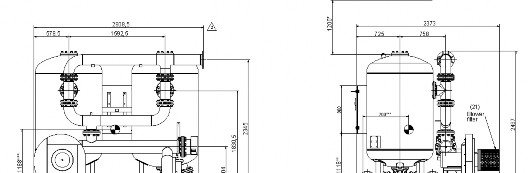
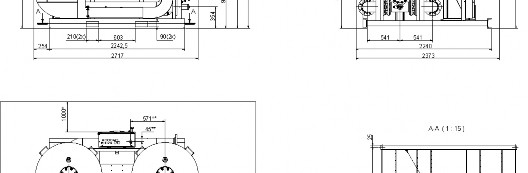
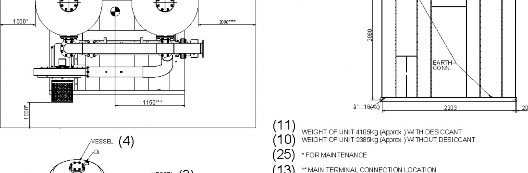
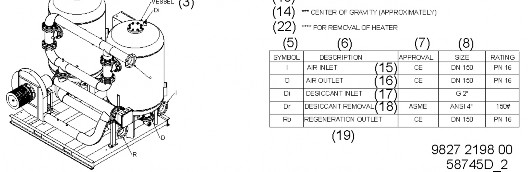
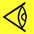
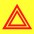
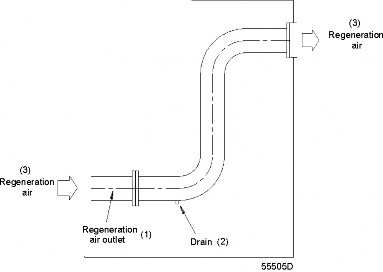
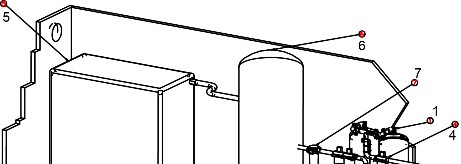
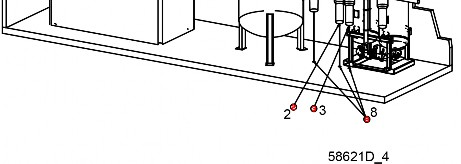
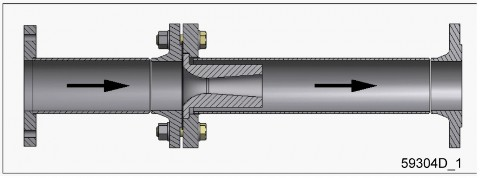
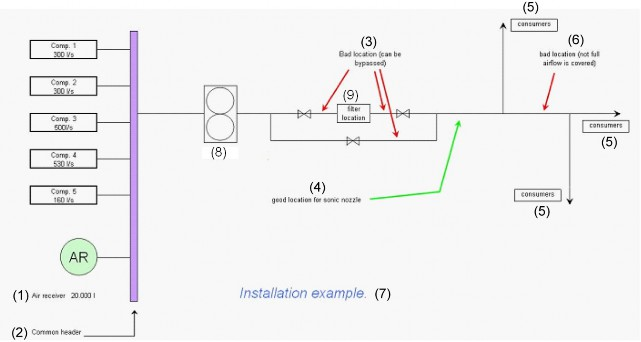
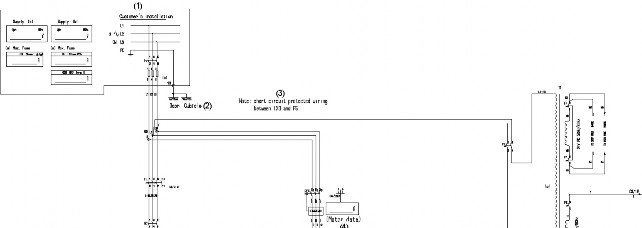
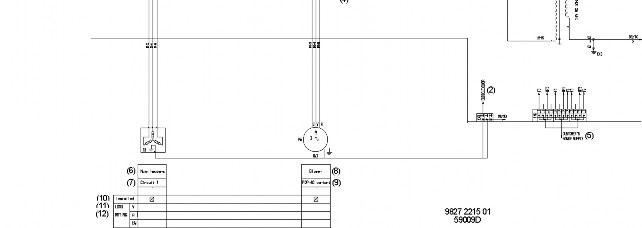
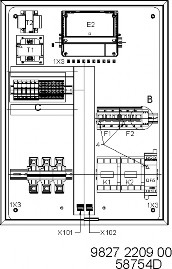
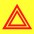
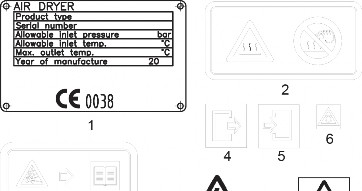
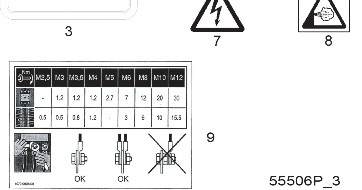

In [ ]:
import re
import nltk
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

def translate_html(input_html, memory_translations_path):
    try:
        def load_memory_translations(file_path):
            try:
                df = pd.read_excel(file_path)
                memory_based_translations = dict(zip(df['en'], df['es']))
                return memory_based_translations
            except Exception as e:
                print(f"Error loading translations from Excel: {e}")
                return {}

        def normalize_sentence(sentence):
            return re.sub(r'^[•\s]+', '', sentence).strip()

        def translate_with_deepl(sentence):
            try:
                url = "https://api-free.deepl.com/v2/translate"
                normalized_sentence = sentence[0].upper() + sentence[1:].lower()
                data = {
                    "text": normalized_sentence,
                    "source_lang": "EN",
                    "target_lang": "ES",
                    "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
                }
                headers = {'Content-Type': 'application/x-www-form-urlencoded'}

                response = requests.post(url, data=data, headers=headers)
                response.raise_for_status()

                translation = response.json()['translations'][0]['text']
                return translation
            except (RequestException, KeyError, IndexError) as e:
                print(f"Error translating sentence: {sentence}")
                print(f"Error details: {e}")
                return f"{sentence} (Translation failed)"

        memory_based_translations = load_memory_translations(memory_translations_path)
        soup = BeautifulSoup(input_html, 'html.parser')

        for element in soup.find_all(text=True):
            text = element.strip()
            if text:
                sentences = sent_tokenize(text)
                translated_sentences = []
                for sentence in sentences:
                    normalized_sentence = normalize_sentence(sentence)
                    if normalized_sentence in memory_based_translations:
                        translated_text = memory_based_translations[normalized_sentence]
                        translated_sentences.append(translated_text)
                    else:
                        translation = translate_with_deepl(sentence)
                        translated_sentences.append(translation)
                element.replace_with(' '.join(translated_sentences))

        return str(soup)
    except Exception as e:
        print("Please check the translate_html function, this is the error:", e)

# Example usage:
memory_translations_path = r'/content/modify spanish memory.xlsx'
input_html = """<!DOCTYPE  html PUBLIC \"-//W3C//DTD XHTML 1.0 Transitional//EN\" \"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd\"> <html lang=\"en\" xml:lang=\"en\" xmlns=\"http://www.w3.org/1999/xhtml\">  <head>   <meta content=\"text/html; charset=utf-8\" http-equiv=\"Content-Type\"/>   <title>    b7aea8f9-2aca-4c34-9d3c-aee7f9171b57   </title>   <style type=\"text/css\">    * {margin:0; padding:0; text-indent:0; }  h1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  h2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  h3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  .s1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; }  .s2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  p { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; margin:0pt; }  .s3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 7.5pt; vertical-align: 3pt; }  li {display: block; }  #l1 {padding-left: 0pt;counter-reset: c1 4; }  #l1> li>*:first-child:before {counter-increment: c1; content: counter(c1, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  #l1> li:first-child>*:first-child:before {counter-increment: c1 0;  }  #l2 {padding-left: 0pt;counter-reset: c2 1; }  #l2> li>*:first-child:before {counter-increment: c2; content: counter(c1, decimal)\".\"counter(c2, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  #l2> li:first-child>*:first-child:before {counter-increment: c2 0;  }  #l3 {padding-left: 0pt; }  #l3> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l4 {padding-left: 0pt;counter-reset: c3 1; }  #l4> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l4> li:first-child>*:first-child:before {counter-increment: c3 0;  }  #l5 {padding-left: 0pt; }  #l5> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l6 {padding-left: 0pt; }  #l6> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l7 {padding-left: 0pt; }  #l7> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  #l8 {padding-left: 0pt;counter-reset: c3 1; }  #l8> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l8> li:first-child>*:first-child:before {counter-increment: c3 0;  }  table, tbody {vertical-align: top; overflow: visible; }   </style>  </head>  <body>   <ol id=\"l1\">    <li data-list-text=\"4\">     <h1 style=\"padding-top: 18pt;padding-left: 47pt;text-indent: -42pt;text-align: left;\">      Installation     </h1>     <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">      <br/>     </p>     <ol id=\"l2\">      <li data-list-text=\"4.1\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Dimension drawings       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dimension drawings and installation proposals BD       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 74pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Us0UUUAFGKKDQAUUUUAFFFFABRmiigA7UUUUAFFFFABRRRQAUUCigAoooxigAooooAKKKKACiiigAPSjtRQKACg0UUAFAoNFABRRRQAUGiigAo7UYooAKKKKACvKfGfw60LxP8ePBuo6lYW91JBoOrh4ZreKSO4zNp4XzdyEtsy23kY3N616tXHapz8X/DP/AGAtW/8ASjTqALX/AAq3wZ/0KOhf+CyH/wCJo/4Vb4M/6FHQv/BZD/8AE109FAHMf8Kt8Gf9CjoX/gth/wDiaP8AhVvgz/oUdC/8FkP/AMTXTmigDmP+FW+DP+hR0H/wWQ//ABNH/CrfBn/Qo6F/4LIf/ia6eigDmP8AhVvgzP8AyKOhf+CyH/4mj/hVvgz/AKFHQv8AwWQ//E109FAHMf8ACrvBn/Qo6F/4LIf/AImj/hVvgz/oUdB/8FkP/wATXT9qKAOY/wCFW+DP+hR0H/wWQ/8AxNH/AAq3wYf+ZR0L/wAFsP8A8TXT0UANjRY0VEUIijCqBgAelONFFABRRRQAUUYooADR0oooAKKKKACiiigAzQaKKACjNFBoAPpRXm0Fl8StR1TUJ9M8VeGrTQzcTx29rqHh24urqMrMyndMt9GrLxwBGuBgc4yZNTh+Iei6bd6jqPjrwXYWFpE89xdXXhi4jihjUFnd3bUwFUAEkk4AGTQB6LRXjNh4/wBY1WRUsvjD8Mrx2mt7cLBpDuTLOCYE41X70gVig6sFOM4rZsbrxzqeranpVn8RPAt3qmmGMX9lB4cnea0Mi74/NQanuTcvzLuAyORxQB6bRXB/2N8T/wDob/CP/hKXX/yyo/sb4n/9Dh4S/wDCUuv/AJZUAd5RXB/2N8T/APocPCP/AISl1/8ALKk/sb4n/wDQ4eEv/CUuv/llQB3tBrgv7G+J/wD0OHhL/wAJS6/+WVI+k/E2NGZ/GPhBVAyS3hW6AA/8GVAF0/Fvw0JpoftF8Z4J5bWWFdKuy8UqRpIUZRFlSySRlAf9ZvXZuyKVfiz4Xax1a8+3zC20ux/tK7drKcbYPJSYlQUy7COSNiiZdfMQEAsAfJdT8OanBrNhHqnxc8Cf20rHULQ3mh4uQLiQJHImdR3FDIFVMcEhU+ZQFDI/COreHIL/AMR2nxb8C6VYWsi6dqmoHQ28kMkS2ogmlfUiEZWEB2kgh0AAHmSBwD6B0fVrXXtJs9SsXaWzvIUuIXeNkLIyhlJVgGGQRwQDVyvO7Dw18TNPs4raPxl4UdY1xufwrc7mPcnGpAZPXgAVY/sb4n/9Dh4R/wDCUuv/AJZUAd4fSiuC/sb4n/8AQ4eEv/CUuv8A5ZUv9jfE/wD6HDwl/wCEpdf/ACyoA7yiuD/sb4n/APQ4eEv/AAlLr/5ZUf2N8T/+hw8I/wDhKXX/AMsqAO8org/7G+J//Q4eEv8AwlLr/wCWVH9jfE//AKHDwj/4Sl1/8sqAO8org/7G+J//AEOHhL/wlLr/AOWVc14U17xl4c8f/ENPGGq23iaLTdA07U7Sz8N6PNb7UabUgyJA1xO0sziBBlSN2EULxkgHqK6/YPr0uii4A1OO2W8MDKQTEzsgZSRhsMpBAJK5XON650O1fNMfja9tPFVjq6W/iPy4bV7y6C+EdZdrm/kmTzown9no3lC2Qwxu05Ufui0JMSsfo+wvE1Gxt7uNJY4541lVJ4mikAYZAZGAZTzyrAEHggGgCeiiigAooooAD0ooNFABRRRQAUUdqKACiiigDmfigwT4aeLW+2Q6fjSLs/bLiWWKOD9y/wC8d4iJFVepKEMAMrzivOfAXiGbVPi1oVg0k3kaf4avY4odQgu4r0Az2K75DcxRu6sEAD4JLLJlieB6t4uhu7jwprUVg10t9JZTLbtZLE04kMbbfLEpEZfOMByFzjcQM14v8JdIfT/ino88Hh/W/CujT+Hb0Weka3FaJJHiax3SZgmkZmYNGrGf97mMbi3YA9+oo6migAorzzxv4an8RfFHwY0Gv6roX2Kx1G6YaY0IF0BJaL5UvmRvmPLbsLtOVXnGQep/4R+9/wChk1T/AL92v/xmgDaorCl0W6giaSTxPqUcaAszutqAB3JPk1A1oUiaVvF96I1VXZybTaFb7pJ8noex70AdJ3orE/4R+9/6GTVP+/dr/wDGaX/hH73/AKGTVP8Av3a//GaANqisQeH73/oZNU/792v/AMZpf+Efvf8AoZNU/wC+LX/4zQBtHgE4z7CvNLn44W9tpd7dr4W1u5ktLC7vns7aawkmb7LceRcRLi62+YjckFguAQGLgoOqudMktSqXHiy/gZwxUSfZFLADLEZh7Dr6Vz2l/CnRoIrSG01q/mjtIYhbo0kEwijWRZYyoaM4w0UZB9IkHRAAAdT4f8SjX59TgaxuNPn0+5+zyRXMkLsfkV1YeVI4AKsCA21sEEqARnZrmrHwXLpz3DweIdWVriQyyF/s75Y+m6I4H+yMAZOByatnw/e/9DJqn/fFr/8AGaANqisX/hH73/oZNU/74tf/AIzR/wAI/e/9DJqn/fFr/wDGaANqjtWL/wAI/e/9DJqn/fu1/wDjNH/CP33/AEMmqf8AfFr/APGaANqisX/hH73/AKGTVP8Avi1/+M0f8I/e/wDQyap/37tf/jNAG1RXkvw48M3Hhb42+PoLjxBqviI3Oj6VeJLq7Qs9usl5qreRGYo0/dKc7Q25gDjdgKB61QAUUUUAFFFFABRRRmgDzbS9Z8dxazqNnpnhXQ7vQFnuJIdUu9flglklNzKGjaBbSTbjGQ28gg9jxVrXl8e63pFzZHwz4W3SAFPtGu3EsYdSGUun2Ibl3AZXIyMjI610/hX/AJB1z/1/Xn/pRJWxQB4bL8OviANNsYY7PRJLq3vLW7e5uPEl6WlENskHlnZbKdrbS5ViyFnYsjZNdNoen/EHR9b1e+OgeFmjv/LKwRa3cJsZd5dmb7Gd7MznnC4VUHOMn0yigDy+98X/ABTt9aFpF4E8OyRGRBHJ/wAJRKFmjJj8yT/jyypjDOdpHzbRg88dD/anj7/oWvDf/hRXH/yDW5d/8jBpv/XGf/2StOgDkP7U8ff9C14b/wDCiuP/AJBpP7U8ff8AQteG/wDworj/AOQa7CigDkP7U8ff9Cz4b/8ACiuP/kGo7i88dXcEkM3hXwzNDIpR45PEE7KykYIINjggjtXZ0UAfM3iv9nPxN4rASXT9HtIWtDbyJa+IbmMzO9pHZSTuVswGkFtGUjyMIZZtwkVyg29X+G3xN8R2mt22p2nhQPeXrahaalYavdwXdpK8MlszKTbMokjt2RYpFC7WQOyuc7vfqKAOPGp+Psf8iz4c/wDChuP/AJBo/tTx9/0LXhv/AMKK4/8AkGuwooA4/wDtTx9/0LXhv/worj/5Bpf7U8ff9C14b/8ACiuP/kGuvooA4fQvEPje48XvYa/4Z0fSNF2D7Nf2GtyXsly+wllMTW0Xlhcfe3HORx3HcVm6j/yF9K/35P8A0A1pUAFFFFABXAaL/wAl88Zf9izof/pVq1d/3rgNF/5L54y/7FnQ/wD0q1agDvzRRRQAGiiigAooooAKKKMUAFFFHagAooooAKKPWigArjtV/wCSv+Gf+wFqv/pRp1djXHap/wAlf8M/9gLVf/SjTqAOxo6UUUAecePdR8Saf8TPCH/COaJYa08unalHc/b9TayW3i8yzPmArDKX5AG3A+9nPBrX/tTx9/0LXhv/AMKK4/8AkGrGo/8AJTtA/wCwPqX/AKOsa6jFAHA6/P8AEnUdD1G0sNF8Nadfz28kVveNrtxKIJGUhZCn2Jd20kHbkZxjI615r4r+D3j/AF43CadpnhDw9bwwQwaQNM1S9t307Yirv3RQoJW/dw4V12BYIl2Had30RRQByH9qePv+ha8N/wDhRXH/AMg1k+JfEvxO0uwSbT/Bfhq+YyBZifE80fkRYO6XBsPn24HyjBPrXotU9a/5A9//ANcJP/QTQBxWheIviZf200l94L8NWDLM6QgeKJpPOiH3ZeLD5d3XaeR61pf2p4+/6Frw3/4UVx/8g11Nl/x5wf8AXNf5VNQB5J498K+OPH0CWt74c8JSWC2t3F9nn1q6Y+dNEYRIJEtUdQIpLhCEKswl4dcc4ngb4bfEPwh4yu9fmtPD2pSXFsIDE+uXQbd5FnC7mR7V2bP2JDz8x3ncz7V2+7UUAcf/AGp4+/6Frw3/AOFFcf8AyDXP6n418eaZ4+8FaXqHh7RNP0PV9RktLi9s9Yku5WIsbycRiNraLb81vGd+48ZGOcj1CuD+I/8AyOPws/7GSb/00alQB3lHrRRQAUUGigAooxmigDgtG/5Lx4w/7FrRP/SrVa72uC0b/kvHjD/sWtE/9KtVrvRQAUUUUAFFFFABRR1o70AY/hX/AJB1z/1/Xn/pRJWxWDoN5Bp+iX91dTR21tBd3sss0zBUjQTyEszHgAAEkmqf9v6z4ieVNAsY7K0V2j/tbV422PtIG6G3BV5UJDruZoh9108xSCQDqs14t+0F8a9T+HOo+F9J8OSWb6re3L3V6t3pN5qKCxh8sTIFtMvFMxni2O6lMK+QTgV6FH4Dhu7iK51rUtQ1u4jYsI5rhobUAqBsNvFtjkUHLDzVkYE/eOFxraL4c0nw1psOnaRpdnpWnw7vLtLK3SGJMsWbCKABliScDkkmgD5Tuv2nPGktrrn7jTYNfOqTr4em/wCET12S1h0szQbTdx+SryXIiEpIjZUL7BlRk1ufDP8Aag8S6t8UPDXh/wAVx6allrWmrBHFpugarbzpqcdr511J5l0iIbXMcyoApkG6HPVsezazeSeIvHEWi6Xc/Yo7GGQahqFuI3kjkdY2W3QEMFk2lHYuvCSR7QTJuTqNB8NaZ4XtXg0yzS1WVhJNIMtLcSBFTzJZGy0shVFBdyWO0ZJoA4uL9oDwhcanq2n28fiS8u9JuvsV6lp4S1aYQTeWkoQslsRkxyxuMHBV1IyCDVj/AIXh4d/6B3i//wAIrWf/AJErL+D3/JRvjn/2OFt/6j+kV6nmgDgP+F4eHf8AoG+L/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDgP8AheHh3H/IN8X/APhFaz/8iUf8Lw8O/wDQN8Yf+EVrP/yJXf8AaigDgP8AheHh3/oHeL//AAitZ/8AkSj/AIXh4d/6Bvi//wAIrWf/AJErv6KAOAPxw8O/9A7xh/4RWs//ACJXnnxW/aP1W0vdA0jwBpGpyazdSPeXR1/wZrfk/YYTGsyxrHAsnms08QV9rIo3buSgb6CrhNYx/wALz8I/9i5rX/pTpdAHjl78ePHgm8RA6FLLebrh/C03/CGa9Gke5JBHHex+QxfbiItJEy79zjYm0Fjw7+0x4w0fxp4ag8c6K1t4c1PTYrGZ9K8Ia6tyuueX5jmPzYAGtW2TqqhTKD5ZOQXKfReof8hfSv8Afk/9FmuC+Nv/ACFfhf8A9jhb/wDpLdUAaP8AwvDw7/0DvF//AIRWs/8AyJR/wvDw7/0DvF//AIRWs/8AyJXf9aKAPPz8cPDgBJ07xeAP+pK1n/5Erzf9nb4yWHxt+N3xX1rRZhdeHLbTPD1tpV2bOe1e4t3iurkSMkwVjl7h9rbVBQIRn7x+hpf9U/8AumvgX/gm5a+IZP8AhKfsep6ZAn/CLeENwn06SQnOkHyuROv3eN397BxszwAfflArlf7O8b/9DD4f/wDBDP8A/JtH9neNz/zMPh//AMEM/wD8m0AdVmiuV/s7xv8A9DD4f/8ABDP/APJtH9m+Nx/zMPh//wAEM/8A8m0AdVRXHX9v45srG4uF1vRLloo2kEMGgTGSTAJ2rm9AyegyR9at/DPWtY8S/D/w7rGvW0Vjq+o2EF5c2cUewWzyIHMJG98lN20kNglSRjOKAOmNFFBoAKOtFFABRRRQAUUdaKACvJfHfjr/AIRn40+GGk0bW7zTING1KK9vbDQ9RvFhkllsmhVTBbSI5byZc/MNu0Z6gV613oxmgDgP+F4eHf8AoHeL/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDxy/+NPh9viPoc39n+LQiaTqCEHwdq4bJmsiML9lyR8pyQMDjOMjPSf8AC8PDv/QN8Yf+EVrP/wAiVr6j/wAlO0D/ALA+pf8Ao6xrqKAOA/4Xh4d/6BvjD/witZ/+RK5b4iftXeFPh5okF7J4e8c6ze3dyllYaTYeD9RS6vp2DMI4vPhjQsESRyC4+WNiM4xXf+IviJpWi376VDPDd63tYraeZsjjbCkefLgrCCHVvm+ZlyUVyMVzmqWkHjGfTrnXPFtvpgsLtbu3stDuUQKQjIyvcOvmNuV3UmMRHDkdfmoAyrr9qjwXaeEL7xC9l4rjtrOG5eSKfwpqUJEkAfzId7wCMOGjdcFgMjGa8tsP2mfFzafpC6+1jIq/bBrY07wZrqefEyf6N9mLofKZTu3l94YAY2Z4948OaH8P/Clwt1pw0waiImhbVLq4+030iM+9le5lZpXBbnDMeg9BWvrPibQTpF8BqViSYJP+Wqf3T70AfMmt/tQfET/ipF8P2+ipbGWy/wCEfbUvCniBnSAK/wBrF2EhAZyRH5ZjIADPuBwN31F4E8Y2XxB8FaD4n05ZUsNZsYb+BJwBIiSoHCuASAw3YIzwQRTbLxNoIs4B/aVj/q1/5bJ6fWsXUNG+Hup6jealLDo0WrXcYhm1W1ZIL0qAAALiMrKuABghgRgY6UAdzRXASajLoheXR/FtnqkWSRputXKbQMcKlwimRecktIJienHWtfw58RdJ8RXr6eGex1Rf+XO6K5cEvgxyIzRyfLGWIRmZVK7wpOKANvWNUXSLCScwy3Uv3Yra3A8yZz91FyQMn1JAAySQASPk74hftOhPi9ZaRcw3d2vhnxIqIfDfh2+1hUlbRLoyxSSwAhnQzA7VVW2knaRG5p3/AAUOTW4/h3o7zeJItM8NS6rIj21nYZupnGnXbRwl3do38yVQo3RhAWQscKTV34WeBNc8HfDX9nqz0q90jT4rm8W+ZLjQ51uGup9Fv5ZpbjNwheRmaQt8sZ3N0UDZQB6L8Bvi7rfxX+HvhbX77VPD8cuuWkbwS6XE8sElwIg1xAQ0mYpo3WYGIljtjJ3Eh1T1QWmt/wDQTsv/AABb/wCO18jJ8ML/AME/tReJLuwSyi17xLd6df2OpQeHbs2kdwGjOpBHF35cDyW8UTyZw0qhxuO4LX2VZrOlpCtzJHNchFEskUZjRmxyVUlioJzgEnHqetAGd9k1v/oJ2X/gC3/x2j7Hrf8A0E7L/wAAW/8Ajta1FAGT9k1v/oJ2X/gC3/x2j7Jrf/QTsv8AwBb/AOO1rUUAeXaNa6z/AML08XAajZiT/hG9Fy32JsEfatVwMeb9fzru/smt/wDQTsv/AABb/wCO1zGjf8l48Yf9i1on/pVqtd7QBxWn6v4nf4oT6LNJYT6DbaTFeyzx2zRzefJLKiICZSNu2Jz909OoyK7WuW07/kqHiD/sDab/AOj76upoAKKKKACiiigDz3SVTxF4k/smRkaz0qefVLiAnmWV7u4S2yvQophmfkffWJgflNehYrwa3+FujfEH4t+JptUvfEdq9tplsiDQ/E2paSpB1HVSd62lxEHPHBYEjtXS/wDDNXhH/oL+P/8Aw43iH/5OoA9Uqrq2qWuiaXeajfTpa2VnC9xPPIcLHGilmY+wAJrzX/hmrwj/ANBfx/8A+HG8Q/8AydXxx/wUi8KQ/Cvwl4Q0zw38TvEfgoa9cXUV9Lq3jTxDetdQJGimMI880XlfvsyBl3nCBAR5goA+6/Cem3OmW/h9b5mk1Oe2nub123c3EhR5cBmYqoZiFTcdqhVBwopdStH8eajqWlve6hpulaZcJBcrYXLWs15KYUlx50ZEkcaiWI5RkZmUgnYCJPx4t/2o/iPNqktrP8Up4IJdXmT+35tW1bydLgEsR8sgHcYnXKAlGlA3FtrbDXp37GWuar8UPjto2jeI/jJq2t6fqVtcCbw3Z+KvENncPL9nF0bxDA0UayM5cNlljIEpCljGzgH6mWngnQ9PuL2e106O2nvphPdSwlka4lEaRh5CDlmCRxpk5O1FHQCuO8Ufs9+FfFnjGHxLexSHUoRp4hl2Ru9v9kunuV8qR0Lx+Y0hSTaw3IAOOtQf8M1+Ecf8hfx//wCHG8Q//J1H/DNfhH/oL+P/APw43iH/AOTqAN7X9AGl+I9CvrWG5msrmY2GoRG8YQwxsjtFOEJyXEwji+TGROSwYRqU6T/hHLD/AJ4v/wB/n/xrz2P4IeHfB+o6bq1hqPi+e6t72DZHqnjTWNQtzukCndBcXckT8McblODgjBAI9UoAzR4csP8Ank//AH+f/Gj/AIR2w/54v/3+f/GtKgUAcXqmgJqHi3TdOiS4h023ha+vJYbt0ZpAyrbwnnJRv3zttI5hRTlXZWr3fwV8N33xBi8YTW3m6rDaw2kLSokhgWMznMUjKZIy/wBoYPtYBgiAjg5h8Y/DXSPiJ4ub+1LzX7X7HYxeX/YfiPUNI3b5Jc+Z9kni8z7oxv3bcnGNxzm/8M1eEf8AoL+P/wDw43iH/wCTqAPQv+EcsP8Ani//AH+f/Gqtz4K0e6nW4e0Iu0hkgjukldZo0cqXVJA25clEJwRyinqBXDn9mvwj/wBBfx//AOHG8Q//ACdXyP8A8FCfD3/CmfD/AIMTwj8VvE3w9uNSurhp73UvG/iS6knWJYwI0BmmjCZl3PkCQ4TZkb6APqjw34o+J+saL4Pv5/DPhe4nurNJzK3iS4QyM0AJYqNPwpOc4GQOlangXSZvGWr+LpfGGmWb6lpuvxm2toryS8gsiNOtGUwyPHGQf3rtkIuDI45zk/kjF+0b8QdB+22tr8WLjUrV0uRb/ZdU1RF8OJH5yxxJuCk71VNnmCTACeZs+evWP2O/FWpfFX9oXTtF8SfFTUtct9fszc3emWPirxDZXJmjsEAcGCSKPzcW6szMfKKuwQkiJQAfqp/wjlh/zyf/AL/P/jR/wjlh/wA8X/7/AD/4157/AMM1eEf+gv4//wDDjeIf/k6j/hmrwj/0F/H/AP4cbxD/APJ1AHQ+JtBh07UtF1KHzDaLcfYry3NzJteOcqiOq5wXWUQ8kjCNLjJIFcn8HvgUnwm+J/xI1rTo9PsfDXiFNJi0vS7AMgs47S1aFkKYCouSNqoSAB26U68+CHh3whNpur2Go+L57u31Ky2R6p401nULc7rmNTvguLuSJ+GONynBwRggEeu0AFAoooAKKKKAEf7h+lY/gv8A5E7Qv+vCD/0WtbD/AHD9Kx/Bf/InaF/14Qf+i1oA2e1BoooAKKKDQACijpRQAUUUUAFGKKO1ABRRRQBy+o/8lO0D/sD6l/6Osa0PF2pXWk+H7uewWJtQfbb2gnz5XnyOI4i+Odm913YycZwCeKz9R/5KdoH/AGB9S/8AR1jUPxW0O08TeCbnR9QWV7DULm0tLhYZ3gdo5LmJGCyRsrocE4ZSGHUEHmgDe0HRbfw9pNvYWxd44l+aWUgyTOeWkc4G52YlmbuST3rQzXg//DEHwj/6BniT/wALXW//AJMpf+GIPhF/0DPEn/ha63/8mUAe75qnrOP7Hv8A/rhJ/wCgmvE/+GIPhH/0DPEn/ha63/8AJlVdV/Yk+EkOl3ki6Z4jDLC7DPjTWzyFPY3lAHvdkf8AQ4P+ua/yqevArT9iL4SPawsdM8SZKKT/AMVprY7f9flS/wDDEHwj/wCgZ4k/8LXW/wD5MoA94rO1/Rotf0e6sJZZLcyoRHcw7fNgf+CWMkEB1bDKSDggV4x/wxB8I/8AoGeJP/C11v8A+TKP+GIPhH/0DPEn/ha63/8AJlAHoN/4Q0b4yfD6wsvHPhzT9QaRFkuLG4jWdLO8VWR2hcjKujGQLKuGHUEZrlLeJrfRvgBFJPJcvHfRK08oUPIRoV+CzbQFyepwAPQCvH/2wfFWofBX9lfTtN8JeLl8CR/2smkRapPcXL3ccCTvhY5wsjb8Rgu8pJZBIMl2AP55aj+0T45bWLFj8eNPljhnL2ZS71ZLbTmNpcRb7dFQMmA+3DAjLqAPL3igD9qNJ0WGXxnrWrSSSyTROttDEWAjiDQws7AAcs21ASxOAg27dz7unr8nf2TP2lPHkP7RHg7Q7j4w23xA0vV7x9PutOLXUzTCQE/aHaeJDvRYYwCh2gdE+eQn9YhQAUUUUAB60UUUAcFo3/JePGH/AGLWif8ApVqtd7XBaNz8ePGH/YtaJ/6VarXe0Actp3/JUPEH/YG03/0ffV1Nctp3/JUPEH/YH03/ANH31dTQAUUUUAFHSiigDzTwB/yVPxj/ANg+0/8ATjq1el15p4A/5Kl4x/7B9p/6cNWr0ugAr5p/b1+JXhHwZ8GrvRvEVrpd9qOt216umpqtg95FaGO2fzLzYiMV2eYiBvlAeeMF0Viw+lq+Av8Agpb8Mde1NdO1i2bVvEllf2tzbw2SS2FqmlzwILtGhme1eQM6Qzn7wYhJF8wBwhAPYL//AIJ9/AuaeXSZPC2qyaZrEk97qNm/ivV2ivJ90bebKpu8O5YAljkkqCegqn+zLqHw9+G3xN1H4U6Bo+n21/psWpRaZe29pM9zb20F9mTT57yYuZWRZ7SZVVziOVAyJtjaX1i6+G/iEa7p4PxV8XEmKbDG10fI+5/04Yr5A8D/AAm+JGt/tuIp1SW18N6VeanrZ8VQ6Xpi6nKi/a7KNZJ1tyrb5rm6VY5EXCwylV4VgAfogKKO1FAHO+PL+fTNBS5t9OudWnjvLUrZ2bRLLL+/QYUyuid8/Mw6evFZX/Cwde/6Jn4p/wDAnSf/AJOroPE6LJZWoYZH261P5TIRXA+OPjHrnhf4oaf4X0/wgmr6XIumNfaw2otCbMXl1NbqTEIWDY8jI+cbiwX5fvUAb3/CwNe/6Jn4p/8AAnSv/k6j/hYOvf8ARM/FP/gTpP8A8nV29ea6/wDFfVNK+Mth4Ks/DUepaY+nwX9/rS6iEbT/ADp5IYUe38sk+Y0TlG3AHy5RwUAcA2PCWv32ueKtWa98N6n4dMdlahV1KS1cy5kuMlfInlAxjndjrxnmuyrGtkA8Y6i4+8bC2B57CSf/ABNbNABXif7UXjrwf4e0Lw54d8TWWi6lfeJdRa002HXNLOpQWxSF3mvGtlRmdYYt2SAAPMUO8aFpF9sr4s/bt+FvxF1/xv8ADfWvCF6ms2l1ez6NLpur6bZ3ttp7zG2mhkiieDnL2RJklk+Riu0qGIIBt+DP2Dfgnd+GtHu5PDWq/aPFNklxrjp4p1ZP7SkeAu7TgXQD5aRyc/329TTvgBN8NPgl+0b4w+E2h6Vp+m3hkSLRrlkuZr1Ik0ywmewe7n3mRdmZY0Ep2pEwKIEjLei+CPh1r8nhLwIy/FDxXEsmnQlUS20jEY+zA4XNgTjtySa+brf4VeML79vLXrW18QeLbdZrqK6n8YxXGjNMsNrpEQUCBrHKAyX4iYKNjAgspJVgAfoFRWVHpN+iKp1u5cgAFmhhyfc4TFL/AGXff9Bm4/78xf8AxNAFXxp/yB7f/sJWH/pZDW9XHeM9MvhpNvnWLg/8TGw/5ZRf8/cP+zW7/Zd9/wBBm4/78xf/ABNAGpRWX/Zd9/0Gbj/vzF/8TR/Zd9/0Gbj/AL8xf/EUAalFZf8AZd//ANBm4/78xf8AxNcr4v1XXfD3inwDZ2upLPZ61rUlhfC4hTcIV0+8uQYyoGGMlvGCTkbS/fBAB3r/AHW+lY/gv/kTtC/68IP/AEWtbDcIfpWP4L58HaF/14Qf+i1oA2aKKKACiiigAooooAOlFFFABRRRQBxvj74lp4C1Tw3p7aBq2t3PiC8ksLJdMNsAZ0t5bgoxmmj25it5mB6fu8ZBKgxf8LB17/omfin/AMCdJ/8Ak6k+IP8AyNvwy/7GGb/006hXWaxFqE+k3kelXNtZ6m0TC2uLy3a4hjkx8rPGrxl1BwSodSRxuHWgDxzxR8ZJ9A+K3ga11DwH4mtr7WrfUtM060MunM9zMEhuWAK3ZVQsVrKxLsvYDJOK6PxJ421m+tdPt5/AHiLToZdV05Wu7mfTTHEPtkPzMI7tnx/uqT7V8w/tG+EPjxc/tM/s4tH498KSIdavPJXTtEl04JstJJLrcJZbsuXtFuI1wygM44Gd6/Zfjb/kC2//AGEtP/8ASyGgDfooooABVPWv+QPf/wDXCT/0E1cqnrX/ACB7/wD64Sf+gmgCax/484P+ua/yqaobL/jzg/65r/KpqACkJwCaWobyF7i0nijnktndGVZ4gpeMkYDLuBXI6jII9QaAPhf9m/4tax4m8U+Ifh74+0HVPiENS0y98RxaZNDaXNn9oh1m8S6ijNwyAbTJZqke9lVVXAj5Z36b+yN8GPEWs+D5Z/C1zZ+Idc1qSz8SJaeItVhF6h0rUHB2GWJkQtGUKeXHsZJocAK6145+zTFHa/tXT6rJ8QdU0vTz4N1SQa/bR6c7SBtenMcKFrZ1fzdkkgVU3MVOw4+UfRWsfDnxV41+N/w48TH4ieIbTSbXWbrTba4jj0trmeU6ZdSGQyQ2ghdV8t4ihWUAk4cPvRAD2b4H/s6fDj4JS6nZ+DfC1tpiWd1ttp55Zby4t0eCItHHPOzyJGSWOxWC5ZjjLEn16uL+H3hzUPD+p+JRfeKdW8SmS6iCnVIrNDFiBMlfs8EXXcAd2fuLjHOe0oAO1FFFAAaKKKAOC0b/AJLx4w/7FrRP/SrVa72uC0b/AJLx4w/7FrRP/SrVa73rQBy2nf8AJUPEH/YG03/0ffV1OK5bTv8AkqHiD/sDab/6Pvq6mgAooooAKKKDQB5p4A/5Kn4x/wCwfaf+nHVq9LrzTwB/yVPxh/2D7T/04atXpdABXzr+3L4/Xwj8GtR0q60XQ9S0rXrS6tLq78QX729vZkRbkkCR287ySK37xQEABizvVtgP0VXj37T/AMDh8bfh5NBZanrOi+I9KjuLrS7rQbqO0uJpTbyILV5XU4hkYxlgCp3RRMGUoCAD4vsP+ChXjPxNq8Wn6P8AEb4V3niu81JtO8O2EnhfWora+jkmjjja4mM/+ju3zfKFdAQB5hBLL7j+xZ8ep/iTMGj0/wAL64NXmuZNU8U+HLqeCRr4YuXiazuoldbeL7T5aMs0jMWV/LTfL5fTaf8AsX2F5ot0tt8YviLJZ6tdLqrSsdI8wOXWUCJzp2+GLKr+5QrHtLJs2synY+Bn7OGlfD3x5qusXvifxL4q1rSs2FuNfnge3RGRWju4Yo4Ywk3kuYGlXhis/GXkyAfQVFFFAGV4k/487b/r9tv/AEcleS+PNUs7T4uavaT3cEN1d2/hFbeCSRVeYrrF4zBFJy2FBJx0AzXp/jhbptEjFlc29pdfbLXZNdQmWNf36dVDoTxn+If0rhNZ+Feqa74ml1678S6C+oMmnqj/ANiMfJ+x3MtxGUJuiVLNM6vzyuAMckgHrfQV53rl/bRfEi/s3uIku5rPR5YrdnAkdEvrgOyr1IUugJHTcueorjvGXxzufA3juz8I6j4n0IaveDTvIRdLVTN9su3tY/LR9RWSTY8ZaTYjbUIPPSuru/BOu3viCTWZPEvh837w28AkGiSfIkMzSgKfteQGZhuGedq9CM0Adlb/API3ah/1423/AKMnrYrkvDCasvivVv7U1LT9Rb7Fa+WbCze3CDzJ87t00me3p+NdbQAV4b+1x8TW+HHw2lMmgaRrNjeJMbqXXtTksrW1SJPMD7oYpZmlDBXTy0GPLY+YjiMN7ka8k/aU+FOj/EvwKbrULrVdPvtD8y8s5tDu/sl1cEoVNkZVUv5UzeWpRMMWWJlIdEIAPh6x/b08VeFNG021ufiT8L4oRZyHwiw8L6zKdSt4nmtUe7InH2Zi9uQQok/iI3ALv9q/Yr/aJl+Kfj3xDLJD4R1/UPEjRXup+IfDDXNpIk0FjbRiBrW6iDmCPa6q4mdiZA3lRh5PL9EX9jJW0zVLOX4v+PWXU95uZEh0RHVnHzeQ/wDZu+3HJwImXbxjGKn+AH7MNh8OvGV/4puPF/ifxc1oZNM0mHxFdwTLbpHHDbvOUjgjAuC0EyeYCS0cjlv3k0zMAfQ9FFFAGD40/wCQPbf9hKw/9LIa3qwfGv8AyB7b/sJWH/pXDW9QAUCiigArgfiT/wAjn8Kv+xlm/wDTPqVd9XA/En/kcvhV/wBjLN/6Z9SoA71/uN9Kx/Bf/InaF/14Qf8Aota2H+430rH8F/8AInaF/wBeEH/otaANk0UUUAFBoooAKKKKACiiigAo7UUHpQBw/wAQufFvwy/7GGb/ANNOoV3FfMw+K2oeJv2mPD3hCeSeVNH168edXsTHHBnT70WwVxkLuiZydzyGQrvUQBWjr6ZoA+Vfi34im1H9uT4J6Qt55tlptzct9l8sDybiTR9WMjbsZbdGsHGSBt4wS1fRfjb/AJAtv/2EtP8A/SyGvnL4v6DJaft2fBHVxayxW9808H2jefKlki0rWSwC5xvVZY8tgEgoMnaAv0b42/5A1v8A9hLT/wD0shoA36KKKACqetf8ge//AOuEn/oJq5VPWv8AkD33/XCT/wBBNAE1l/x52/8A1zX+VTVDZf8AHnb/APXNf5VN1oAKKKKAPmPTfDmm/sh/DPWtb8MQnWZLzVpLW3tdf1P7Na2kUmoS+VAsscEsu1WnYKWSRufmZVGR8Xaz+3b8RNGj8CyW3iP4P2uh6deS3GiFbLWZCFS0urYm5IRNwxKykoikuyttC5FfpV4j+Hdt8TfAdxo8+p32iSm+uJItT0tYDc25Fy+dnnxSx/MMqcoeCcYOCPlfVf2JNK1J/hjef8LT+JduPEOoMrwprNuy2QfS724PkM9szggpsDOztsZhknDAA2v2WP2t/GvxD+IGq+FfEsHgXX9Ui1Ex6rc+Eb2+t2scKIVUW91b7ZcPESzicfKTtUkAP9o187fB39kvRvh347vdbm8beNPF0thct5Nn4kv4J7be6RyLJ5ccEYDIzMUxgLkcHam36JxQAGjNc948t9QvPDc8GlS7bzzIZWhGzdcwJMjzwLvIUGWJZIwxI2lwcjGR5rZ/DPxfZ3supmZba4miuoFsrTXLm6gt5HnsfstwqzKinylt5pJQRmVmcnf5pUAHtZooooA4LRv+S8eMP+xa0T/0q1Wu9rgtG/5Lx4w/7FrRP/SrVa72gDltO/5Kh4g/7A2m/wDo++rqa5bTv+SoeIP+wPpv/o++rqaACiiigAooooA808Af8lT8Y/8AYPtP/Thq1el15p4A/wCSp+MP+wfaf+nDVq9LoAPwoIzRQeaAOQ8CGLw2X8HMhgGkxL/ZwKMElsOkWxiTuMQxC/zFvlR2CiVM7Wo+HobvUBqMEsljqYiEH2mA/fj3bgjqflcAlsbgSu99pXc2ZNb0O31y3jSVpIJ4JBNb3UBCywSDIDoSCOhIIIIYEqwKkg4l1q3irQIbl59Ej8TxRjdEdElS3upS0jAJ5NxIsYCIUy/n/OQ5CJ8qkA4LwXr/AMUvFfiXx7pT+JPCFsvhnWYtKSVfDF0xuA+nWd5vI/tEbSDdlMc/cB74FrQvhR448PeKfEfiO18V+Fv7Y1+eOa9nk8KzkFY4IYYo1xfhgqiJmwzN80r4xk5n+Gv2/wANeKPiXq+vaReaHZ+I/Etld2P2oxSMVfS9MswreU7gN9ohkj64+XdnaQx9YoA8n1rRfiTqWq2Oj3HinwjJDNE96WPhW5PMMsJVSDqJyCX/AErJ1L4HeMNU1281WTxT4SSe6j06N0j8IzBALK5kuYsD+0M/M0rBueVAAweT3A8Tw6jq2h6/Z2t1daNPYSJDeRIu2Xz3tzCVBOcMFJzjjvipvEHxQ07wsLltR07Wo0t4o5pJItMlmQK7MowyBgSCpyASVGCwAYEgGL/whXj7/oYPBH/hHXH/AMsaybn4TeNrrVri/bxL4OEsyWqMq+EJ9oEEryJgf2h3MhB9QBjFcP44/b58CfCz4weHvhz460TxD4P1jXLaO5trnUY7V7aMSTywxCV4Z3Cb2iJDcqoZS5T5tvvE3jOKDUVsm0vVvPZUYFbJmTDEgfOPlzlTkZ4GCcAjIBydn4K+Ien6jPeW3irwfBJPFHC6x+ErhVIQuQeNR6/Oa0P7G+J//Q4eEv8AwlLr/wCWVdIviVWu5LYafe+fGiyMnlrwrFgDnd6q35VL/bT/APQMvv8Avhf/AIqgDyn4ua98Uvhn8KvGPjCLxJ4Q1CTQNGvNVW0bwxdRiYwQvIELf2icA7cZwcZ6V6Jp/hi+vIbSTxPqEGs3lvKJ1SztWtLMSKSUcQmSQkj5SN7uA6h1CkDHK/H7T9W8dfAr4i+G9G0W9utX1jw7qFhZwN5aCSaW2kSNdzOAuWYDJIA710kXifxFqVzcwWng+6sBBOiC61q9t4obiIsQ8kQgeZyQoyEkSPOVGV5KgGzr2sJo1ojACS6uJFt7WAkjzpmztXgEgAAsxAO1VZjwppnhfQx4d0GzsC0cs0alrieKLyxPOxLyy7cnBeRnc8k5Y5JPNVdA8LyWFyNS1a/bWNdaHyXuzH5UMSk7mSCHJESFvUs7BUDu+xcb4oABRXDeAE12PxD4ifVvEF1rFncSLNYWs9tBEtlHudTGrRxqzjcDy5JwFHUMzdzQBg+NP+QPbf8AYSsP/SyGt6sHxp/yB7b/ALCVh/6WQ1vUAFAo9aKACuB+JP8AyOXwq/7GWb/0z6lXfVwXxJ/5HL4U/wDYyzf+mfUqAO8f7jfSsfwX/wAidoX/AF4Qf+i1rk/GXjnVvD3jddMW90S3065sIms4p1nkvHu2nMWGRBtEB3wDeCSGLZAGDXWeCv8AkTtC/wCvCD/0WtAGzRQaKACjtRRQAUHn60UUAFFFFABRRRQB5n4y8K6NpXj34bX1lpVnaXj+IrstPDAqvmXTL+SU5A/jdQzf3mAJyRXplcR8Qf8Akbfhl/2MM3/pp1Cu370AeB/HX/k5P9mr/sN61/6ZLuuz8dav4pbWJLO00fSbjw/Dc6a326bVJYroXBvIT5fkC3ZTHtwfM80HPGz+KvIf2pvin4W8AftM/szxa9q8dhK+taoVj8t5GxNp01pESEUkBp54kBP94norEe6+JfuXv/YV0v8A9KYKANf7Z4j/AOgVpn/gyk/+MVxnjPwb4w8U63p2o2t5Bo4slZPItdTnCTBlYHzAIwGKt5bJ/dKNndu+X06igDyfwd8NNf0Cwt/7WnbXdUjmlmN43iG8iQhrr7QieUFI2ptjjGc5RCv3XZT2OsXfiL+yL7OlaaB5D/8AMSk/un/phXT1T1n/AJA9/wD9cJP/AEE0Ac5qGpeNbfw+H0fw9oV/qIjTyoL7XJraJ+RndItnIVwuSMIckAcZyJfhR4kvvGfwu8H+INUjgh1LVtGs7+6jts+UsssCO4TPO0MxxnnGKvX3iBdIg0y2itZ9Qv7sKIbS2KBygKiSVizKFjQOCxJ7gKGZlVvnn9h79rPwH8b/AAdZ+BdFuLqy8W+D9LtrG/0vUUWOSZYY0he4gKsweLeMZ4Ybl3Ku5cgH1FRRRQBkeFv+QU//AF93X/pRJXnL/wDIP+A3/YRT/wBMV/WpcfB3wX8QB/aPiLw7aatfRzXMCz3AJYILmUheD0yzH8a+eYvjXd/C+z+D+geLdDRP7M1WSbTLiy1Kwto5tOOmX0dqpS6uISrqksaFhujOz/WCRjCoB9c6N/yFde/6+0/9J4q1q86+D134m1STxnqPieFbKS812R9P05QCbSyW3gihDOACzSCMzncMr5+z+AV6LQB8u/tb+IPD/huz8cTa1catHb3Xhi1s7qTTtLFybZZZruKFlLTRh2dpJTsHRYDkgugL/DvhRPEz3XhnTPjL4hvdZnjmsJpore8Bjks7a1trhtxfETH7RLIzBlLy3Ubq2YRn37xV8PfDXje1u7bX9Es9Wgukijnjuog4kWJnaMH/AHWkcj03Gr1n4Z0ywv1vobRReIsqJO7M7ospjMiqSTtUmKM7Rx8g4oA4/wAHeHb/AOGiaTZ6jrGr+MLvU7l7KXUbpsLAu68ukd4wwjQfMsGY1GcRDG1VC+h1heONGk17wve21tFBLfx7LqyW5TfGLqF1lt2ZcrkCWOM4DA8cEdRf0LWbTxHothq1hL59hf28d1by7Cu+N1DKcMARkEcEA+tAHIaN/wAl48Yf9i1on/pVqtdpqOo2uk2U15e3EVpaQrvlnmYKiL6sTwB71xejf8l58Yf9i1on/pVqtdN4ue6i8NalLY2k9/eRQNLDa2qxGaZ1+YInmsse4kYBcgAkEmgDE8OapZa18QtbvdPu4L6zm0XTWjuLaRZI3Hn34yrAkHkHpXZV4j+z1rOq+I/EXinVtX0fV9Eubyy0+RbfXbG3tLt1DXSGR44WbG5kYjzMOOhG0KT7dQAUUUUAed/G2xuLjw/otxbalf6a0Wv6TFKbC8mtzNDLf28UkbGN14Ifqc8ZH8Rro/8AhBtO/wCfnWP/AAd3v/x2sr4w/wDIp2H/AGMOh/8Ap1tK7agDxfwH4M09/if4uQ3GrALYWpBXWLsH/kIaqOSJcnoP19TXo/8Awg2m4/4+dY/8Hd7/APHa5XwCcfFLxif+ofaf+nHVq5/48+J9fvfhD4u1nw9qs+g6VaWDNb6haAC6vW3KC8TnPlw7dyh1G9y2+No1VXlAOv1iPwjoV3JZ3euakNRS2a7Gmw65ezXjxA4LJbpKZHGcAbVOSQBkkCktbfQLy1huI/8AhLQkqB1EsurRsARkZViGU+xAI7iuw0rRrDQ7ZoNOsoLGFpHmdLeMIGkdi7ucdWZmZiTySSTkmrtAHnekXfhDWJ4rddT1+wu5p2toLXV7/U9PmuJFUuRFHcMjSDarHKAjCtz8px0f/CDab/z86x/4O73/AOO1r6lpdlrWn3NhqFpBf2NzG0U9rdRrJFKhGCrKwIYEcEGuU16LWvAtjLfeH7WbxBYqJGm0a4uHeYO77hJFKxZgilm3QhWIQDyVygilAPkn9sfVZ9N+ImmeDG+Jms+BrC8svtltZw3mrl79oz5nnC5itrjY0LxBgEljbIG9WVl3eFX+kanZfCvwt4vm/aS8dQeHNav2stP14eKPEZe/mV5VMJT7CQoBikGfLT/V9ecn7k0r4geMvjDY6q+leE/C01tomt2afbbbxPLP9rSMWl9utz9hVWDxyKFy6gnkkDmu2vvijGYUsdL8E+JNS1yNykely6RJawwyKFyWvJQttsXePnjkfdhvLEhUigD5X/Zc8QXfivwXq8On+Mdc+JOi6HfWNrbw6ddXVlc2TpPCos1F1DZIV8vPLbmAVvnVtufZ/izoXijxf8Ode0vwz4O8e6H4llt/M0rUp9es5o7a8jYSQSOjaiwKiREJyp4zwa6bwr4d+I3hfwL4d8OR+G/CUh0m3s4WuV8RXKee0AQFyv8AZ5wW2epxnviup/tf4lf9Cl4U/wDCouf/AJXUAfn38Nv2UPGHxa8Na9dftMfCTxR4++KUcrWWka4dZt1gtLHAKAiLUbdJAk0s8m0csDgMBjH6BD4g68AB/wAKx8V8f9POk/8AydS/2v8AErH/ACKfhX/wqLn/AOV1H9r/ABK/6FLwr/4VFz/8rqAE8Hatqet+Otdur/RdZ8PxjTrKOOz1R7J0JEt0WkjNvLK2TuUNvbHyJtA+cnuuledx3HxKj1e4vv8AhFvCp82COHy/+EmueNjOc5/s/vv/AEq5/a/xK/6FLwr/AOFRc/8AyuoA7iiuG/tj4lf9Cn4V/wDCouf/AJXUv9sfEr/oUvCv/hUXP/yuoA7iiuG/tj4lf9Cn4V/8Ki5/+V1H9r/Er/oU/Cv/AIVFz/8AK6gDS8Mf8hKb/r3H/o+aunzX5KfGnR/GepftVa/B4u1qPVvDrae1+ugNqTTWVrLJHdJAIbWTG4xm0uAZlUZMisRGZdle7fsw6x8QbX9inwRqut+JfD3i3QtX1HTNOuLHUIZdVnktLzUbe0kie6+2FQyrM4MTRHYVKMvBAAPtfxr/AMge2/7CVh/6Vw1vV4h48+EXgXwfrfgLU9B8F+HtD1JPElrGt5pulwW8oVkk3DeiA4OBkV7fQAUUGigBk88dtC800ixRRqXeR2AVQOSST0Fea+NvEGl6147+HFvp+pWd9cWHiqe3u4radZHtpf7G1I7JACSjYIODg16HqkYl0y7R7QX6tC4Nodv775T8nzYHzdOeOea+XvAmtx+IviN4CutL07TLDR4ddaN5ra6vL6e5mk03Wbnm4ukhkCr9okfYYip+0LtkwpQAHqXxN8O3Wr+LZL42PiC8tdMsba6tzp9+8cSXIlnwY4AQsj4A3s27biABHV5RXoHgv/kTtC/68IP/AEWtbDj5W+lY/gv/AJE7Qv8Arwg/9FrQBs0UUUAFFFFABRQKKACiiigBaSijpQB5B8cvF1/4Z8b/AAeisvDmoa8LzxNcIRYyWyEEaNqTbB500Y3HBbn5dqPzu2q3Tf8ACw9f/wCiY+Kv/AnSf/k6l+IQB8XfDEkdPEU2P/BTqFdxQB8kfHvwNdfF/wCOvwS1nUPg/rV/H4XvdQ1G6S6vNLWZoBbgRFNt982y6a0fBIxjIzyD6xqnjbWb67kgn8AeItOil1jS1e6ubjTTHAPtMHzOI7tmI/3VY+1dvqP/ACU7w/8A9gfUv/R1jVbxN9y9/wCwrpf/AKUwUAdY9zDG21pUVvQsBTo54pSRHIrkdQpBry7wNpenXvxL+Lj3GhwSznVLNHv5YFbz0/sy1xDuwSQhLNjt53A5Ncp+z1Y2VkfDC2Ojx6DBs8VqmnRwrF9mQa3EFh2gADYPlx2xigD3/wBap61/yB77/rhJ/wCgmrlU9a/5A9//ANcJP/QTQB8vfty/Dv43+JfBvhbxL8B9dn07xToaTwXemW8kMcl/az+QW2NKNu5GgRtpK5BbBJAVq37JX7G/g74Vt4N8aReCL/wr8QrfRIY9e1KfVrh/t97LbJ9qQwGZ4/LExkJ+VBvRCgK4NfWFl/x5Qf8AXNf5VNQAUYoooA+ef2k/iBrHw0+CU+s6Z4qi8EQJqsqXevvZtdPbI104UJGttcgl2KqS0LAAnlTg18TSa3r2ra5a21j8cNbu30KZru7iabVbc6LEdJvJRKkZ02PaRFHJ8iq5GSuwLkD2v9uvwXF431r4Yos+lyahpba7qNlpupz2zC9mXULAGNLOd41vW8k3DCEuikqCzgfK3XeHfH3jkeD/ANn9dI+FsE89rJb2l1E9+NLMd9Fot5DNbeTLEWRIx5hByxXyzGwWQMqgHn/7N3xm17/ha3hbQ9L+L0/jmLxGTqB0O+tL2dp7XzGikuBPPp0TR+WtvIArTov7ofI7Nh/0GFfnl8fDB4s/ac8FeIvElrongTQfB9/p2qz3urzW9neNLBcxh7ZLoSEyoRtkjtiimVRKykMFRv0C1PVLXRrGS8vJRDAmATgsWYkKqqoBLMzEKFAJYkAAkgUAZ8XjDT5zN5K3s6xSyQM8NhO670co4BCYOGVhx6Vb8OeILDxZ4f0vXNKn+06ZqVrFe2s5Rk8yGRA6NtYBhlWBwQCO4rzb9l7WtW8Q/CZ7zXLxNQ1T/hI/EUE1zFZPZo/l61exrtgdmeIBUUBHZmUDDMxBJwf2M9U1O7+EFtYajqc+qRaXDpdtZvcRxI0MD6Lp1x5X7tEDBXuJACwLYxlmIzQB7vXLeBydOfWtDkLk6dfO8BlkJZ7af99GVU/djQvJAoGRi3IGMbV6muV1V00T4gaNebkjj1qF9KkBY75Jole4twB0CrGt7kggksmQwGVAMzRv+S8eMP8AsWtE/wDSrVa6/XdGtvEWjXumXih7W7haCVSqsCrDBBVgVYezAg9CCCRXIaN/yXjxh/2LWif+lWq13tAHn3grwlpfhH4meLYdJthZ291pumXDW6E+XGQ13GFjXoihY1+VcAc8c16DXLad/wAlQ8Qf9gbTf/R99XU0AFFBooA4j4wH/ikrD/sYdD/9OtpXbmvG/Ed3fXPh3WUv7v7WYvHGkJAPtAlEUP8AadkUTiKPZjn5TvIz99u3slAHhWix32v/ABw8TeHW0q6GgTaPbXV/qvyiB9uqamFsx8wZjJli+FZRGjK2DKhro/2oYkn/AGffHUUiLJG+murI4yGBIBBHcVu/DjRbuyv/ABbqF6baQ32sTCzkjB81LVDgROSO0xuXCgkASk9WasX9pz/kgXjf/sHt/wChLQBo6p8J/hdoem3eo6j4M8I2Gn2kTz3F1c6VaxxQxqCzO7MgCqACSTwAK4TUtJ8Jb92hfs7y+I7PLKLyLR9JsUYq7IcJeTQy4yuQ2zaysrKWBzXT/EG9TWPHK2Fzp8+raV4Y0r/hIrjTYwB9tvWlZbBFy4VyrW1022QbRJ9ncENGCu0+h6HodpaXfjXU7HUdTvZIbVrrVZBHbSXLnCxWsEjFItzEKqJl2CpvaRhuIByGg6H8K9Q1ax0XWPhpovhLxFfJJJa6Prej2Ky3Kpu3eTJEZIZSFUuyRyMyKVLqoIpvj/4ReBLPxX8NYbfwV4egiu/EEsNxHHpUCrNGNK1BwjgJ8y70RsHjKKeoFbvjfwtpaw2Hhee5u4tL8SzyWlkFcyy6dfpDLdQ3FtI5Jh8sW7soGVRo4tgTDZwdO8Y3Hj/SvgXr17DDb6jda5KL2K1LGFLlNI1NJhGW+YoJEfaSASuCQDxQBH4d+D0XgXx3r+j+GfFWr+DNJ11zrtrpWi22n/Z1kVIYLoKs1nIUAIt3+/gmchVAQk9j/wAK48QY/wCSp+Lf/AXR/wD5ApvxO0G31vXvAkU09/bCXVpreSTTtQnspHiNjcyFC8LoxUvDE23OMop7Vbb4T6EgJa/8TBRySfFeqcf+TNAFf/hXHiH/AKKp4t/8BdH/APkCj/hXHiH/AKKp4t/8BdH/APkCuN8L6F4S+KOsR3fhLxPr+q+GtKldLnU9P8YalLbXdyU2iCORbkrIsYcs5XgP5ahiyyqvd/8ACpND/wCf7xN/4Veqf/JNAFb/AIVx4hx/yVPxb/4C6P8A/IFH/CuPEP8A0VTxb/4C6P8A/IFWf+FS6H/z/eJv/Cr1T/5JoHwl0P8A5/vE/wD4Veqf/JNAFb/hXHiH/oqni3/wF0f/AOQKP+FceIf+ip+Lf/AXR/8A5ArG8WfDTS9Als9b/tTxSNJsllGpQ/8ACV6ptWAqGM4H2nloyi/8AeTAJ2irvhjwf4J8baHa614e8S6xruj3QLQahpvjTUbiCUAkHbIl0VOCCDg9QaALh+HHiH/oqfi3/wABdH/+QKP+FceIf+iqeLf/AAF0f/5Aqz/wqTQ/+f7xN/4Veqf/ACTR/wAKl0P/AJ/vE/8A4Veqf/JNAHn+p+FfiRr3im40jw18T/EOmWOlyRrqOsatpelzrK7Ksn2a2hW0jLHy3VmmZtiFlVVlbzBFZ8HeGPHjaleaB4o+JviRdYtkE8F/YWOkxWuoQE43xxtZuyMhwroWbbuQhiHAGr4MtPEc15rSeGL6wsfDdvq80KXetC71W7vTHGsMw3PNG0Xl3EcqAs0u4J8oVdpPFfFnWNZ8I+JrfU/GWnah4l0vS9B1jUlu/A19LpE8cEclo8qzQvepu2KqYZZn3lm/dx7QWAPin46eEdSH7T+ryf2pq2qiDRI438TSGwElqWfV/wDRTGtsARL5LtlQNphYNklNnoHhPR7r4W/8E2PCfjG88QeJtF0bTm0HW5dKtpdNvRLH/aVnK08btalwTyyRPIdm1EbKqVrEtfhf4b8aW/w38S2HxG8Oax42Dav4aubvWfEds19rglMYswm28uE3JvUmMPvJugzKGYrX0Z8Ef2KtQ8JfsyaZ8LvFvjbUo8GK5uI/DotkhguEljnRopJbZpCUljVstwxXlcEigDmvCnxt8PftDXun2vg/4reJ9dfS9e0sTzT2emx/Z2n+0FHjAsUy4Fu4O4MuJOhOCv0x/wAK48Q/9FU8W/8AgLo//wAgV5jdfC/ULjxt4c8QyfEvxN40tNA1COJjqsOlJbebJcwxPEv2SxgZnUjLMXIQx7dpLNs+iqAOD/4Vx4h/6Kp4t/8AAXR//kCj/hXHiHH/ACVPxb/4C6P/APIFd5QBQB514A8P+KIPD3iaz8V+JZfE13Ld3dvb/bba38mK23v5GVghhLM0TxeYCSCwYLtHXyfwPoGs6d4v+H2pavf2Wpre65GlrdWrGVpIhpGsy7ml+zW6ybmnZi21iztJIWAkWOP6K0b/AF2qf9fbf+gJXKfEkAeMvhT/ANjLN/6Z9SoA71/ut9Kx/Bf/ACJ2hf8AXhB/6LWtd/un6VkeC/8AkTtC/wCvCD/0WtAGyaKKKACijvR2oAO1FFFABRRRQAUfhRR2oA4j4hf8jb8Mv+xhm/8ATTqFdv3rzbxFrtv4j134Y3tqsqwnxLcx4mQo2V0vUVPB9wa9JoA5fUf+SnaB/wBgfUv/AEfY1ifEzWW8O+GvEWrJp95qz2F1YXQsNPj8y5uSk0LeVEuRudsbVGeSRW3qP/JTtA/7A+pf+jrGnatozeILfxHp8dy1lPMI/Iu0Xc1vKEBjlA6Eo4VgD3WgD5l0f9pvxP4f8UeLNTt/gh8V7q11y7hvEtJvDaoLZ0tYYGwRISxbyVJycDAAA5LZfw5+PniPwdNp8uo/Bn4tanLaDVi048MIjzvfXy3bMwEoVSpXb8owc5AXpX0xqPxs8G+FPKtPGHibQvCGteS002m6rqkMLqqqzPIm8qXiAR28wADCknBDAVrb9o/4TXsSyW/xQ8GzxsAwaPxBaEEHof8AWUAeaf8ADY+o/wDRAvi9/wCE8v8A8dqtqn7Yeoy6Zdp/woT4uIGhcbm8PKAPlPJ/e161/wANB/C3/opXhD/wfWv/AMcqpq/7QPwufSb1V+JPhFmMDgAa7akk7T/00oA80tP2xdRW1hX/AIUJ8XWwijI8PLg8f9dal/4bH1H/AKIF8Xv/AAnl/wDjtel2f7QPwtW0gB+JPhAEIuQddtfT/rpU3/DQfwtz/wAlK8If+D61/wDjlAHl3/DY+pf9EC+L3/hPL/8AHaP+Gx9S/wCiBfF7/wAJ5f8A47XpN7+0n8I9NgM118UfBltEOS8viC0UD85PerunfGjwh4sSS38H+I9G8YarsR47HSNSinbDqGSSQoW8uIqQ3mEYwRtDEqCAfEH7T2hal428VaF4kfwrqum6frHhiSf7VNrMVjcWbw3N9K9nc2DhhPmW6s1JI/cybCrA16yvh3W9X0D4Ew6R8b9TiuLbVLf7XKbXSrpEij0i7aZoj9mUlXjVkSZzIu2YPhzgnT/at/Z2tfHmgfC3TIfE2vaf4jsprnQrK+tTDLHdie0aW6e9jmYecHSxY48wZd8nOci58Gv2bvA2teH/AA7NP4W0Ddol3ZXEyz6TFO94p0CGIxu7lmP7y480lmkJZMkkndQB47+0d8L/ABB4u8R6d450Y6t8WPDXha6lvNSsbi+s9O/teGeyjjQRT2tntlgZBPDNHLgGKZTxHIXb6N+IOiW/xJ0v4PaN4isprzSdR1cNO7XTRSTkaNfyKxMbBlbcqtkNwR1rvv8AhRPw1/6J74V/8Elt/wDEVieNPCui6B42+EzaZpFhpzL4jmiBtLZIiE/sbUvl+UDjgce1AFP9lXS7XQ/hNeadYQLbWNn4t8U29vAn3Y401/UFVR7AACvLPgV8UrD4Q/Aq513UNO1DVYWuNCtVttMERmZn8OaTgjzZI1wMHOWH416l+ypZzab8Jru0uL+41SeDxb4pikvrtY1muWXX9QBkcRoiBmIyQiKuScKBgD5Jh+Hugf8ACmk8ZCxKeJPtfh2wN6k8i7oP+Ec0xvLZA2xhnnlScgegoA6jUv8Agsj8E9J1G6sbrw945jubWV4ZUGnWh2upIYZF1g8iuK+Kv/BYr4Y614E1KDwbpviqx8UxmK606XVdJtpLRpopUlWOYLdbhG+zYxX5lDkjkCvzi8UaPokXxDvn1K5lgguGnmMkFva3fzreOzqVQOVJRCAJAH3Mm7EbZrm7XQNJnXT1N3sS4t7rMzRW3yM2wxkx480hfMAYhCflfytwXNAH7lfsl/tPeEv2r/Hfj/xZ4OtdWs9PstN0jS5YtYt44ZfNSXUJSwCSOCpEyjrnIPHTP01X5t/8EZ7eyh0f4pPYTPLDL/YzMstuIXjkEVwjqQFCn5kYhhnKspY7twH6SUActp3/ACVDxB/2BtN/9H31dTXLadx8UPEH/YG03/0ffV1PSgAoo7UtAHxr4m0yyh+MbXsUNuL+Txbp4kVPEVpNIoOrRAsYk/0huIoSY34HnqrfLYW2PsmvMPiZY3Fvo7S+ZaLDL4p0N3WG18t5D/aNiAzvuO5goVc46KBxivT+5oA5nwLrllqsOuWtrN5s+m6vdWl2mxh5cpfzguSMH93NG2RkfNjqCBy37Tn/ACQLxv8A9g9v/QhWj4BR7Txf4ngRwLW4f7aY9oyJzc3MTvu6nKQwjHQeX/tGs79pz/kgPjf/ALB7f+hLQBD8RLdtF8fQXstzcabpPinTP+EdudWjePGnXiSO2nuA6EAu1xcoGclTJ9nTaTJzu33ifw7qFpHY+NbOy025gljleHWYgbPz43WSN4J5FEcuGVJEKneuFLKjKVXrtV0qy13TLzTdStIL/T7yJ7e5tLmMSRTRsCrI6kEMpBIIPBBrgl+D93pQWHw14+8UeGdLTYE0yF7S9giAJyI2u7eaRAVwoQPsUKNqDnIBB4v8TafdT6R4iuLa8j0jw5cNc2hmha1mvtRmie0t7aGOVVL71unUH5QXkhCs2HC4Wm+DrjwBpXwM0G9mhudRtdclN7LbBhC9y+kanJMYw3Ij8x32g5IXAJJ5rs/Dnwl0vSdeh1/Vb/U/F3iODf8AZ9V16ZJGtQwZT9nhjRILclGKM0UaM6gB2frUXxI48Y/Cr/sZZv8A0z6lQBS+Nl54jsT4Kl8J6Zp2sa9/bjLb2uq3z2Vsc2F4GZ5UilYBVJbAQk7ccZzXzx4i+FPif4mprl58ZPFjeK5tE8ZaDpEfhXRkay8NiOebSZZN9sSZLo4uZEzcu64JIRSePqPxt/yMvgD/ALDkv/ptva8y8RdfiN/2Urwz/LQaAPcdK0mx0HTLTTdNs7fTtOtIlgt7S0iWKKGNQAqIigBVAAAAGABVqig0AHaijpRQAYr5H+MHwitPDHjj4t+MfAGrX/w18T6R4QtfEAuPDYjitb+63aszte2jI0FzvMUeXdPMG0bXXnP1xXgnxl+/8ef+ya2v/uaoA6jwJrnxY0b7XYePfDmja+YCgtdc8IXXki8VjJky2d0y+QUCJu2zShjKu0YDBb3iD9oHwN4SltYtd1O70Oa6V2gj1LSruBpghUOUDRDcFLpkjIG5fUV6Ka85+M/wN8MfGzSLWDxD/adtPp/mta3+i6lNYXUO9QHUSxMCVJVGKNlSY0JB2igBfgFrtj4n+Hb6tplwLrT7vXNblgmClQ6nVbvBwQCPxFcx+0kudD8Rj/qn/ib/ANBs6w/+CfmvSeKP2TvCOrzGUzXt7rE8nnOrtubVrwnlVUYz0AUADAHSt39pL/kB+Isdf+Ff+Jv/AEGzoAw/jN8I5LF/BFh4Xv8AXribVddNne6fq/jHUWtL60FjdzSQS+cbkBSYVJ2Rhztwrx5LC94p+Inh7w54juPDfxb8f6OsFx9ljhsYUXTrK7a4cqsEsZmllcjyfmDusLpdBWRh08o/4KIfEDWPA3wC8A68+p6laajF4oW3urvwvd/2XcSbtO1GJzDI6zmEHOf42A4DBsOPln446nN8P/jSui3ajxD45sNHu9X/AOEru7i5Xc9tpzSq6gTG6hlaOGKItFeJGQpYxFjkAH6peJ5ra48NafLZvFJaPfac0LwEGNkN3CVKkcEYxjFdJXkXwyRl/Zz+GzNPLceZZ6FIGmEYZVaW3ZUxGiLhQQowo4UZ5ya9doAKzde8TaR4Vs0u9a1Wy0i1dxEs9/cJAjOQSFDOQCcKTj2PpWlXg37aHj9/hp8HY9ZEEtzENTgilitzbrKQVcqUeeCdEYOEbd5ZPBwVJ3AA9e8KajaaxbXl9YXUN7ZXFx5sNzbyCSOVDGhDKwyCCOQRXOfEn/kcvhT/ANjLN/6Z9SpvwH1p/Evww0LV5Awa/s7a62vsLKHt4mAYoqKSAQCVRFJyQqjCh3xJ/wCRz+FP/Yyzf+mfUqAO9f7jfSsfwX/yJ2hf9eEH/ota2H+430rH8F/8idoX/XhB/wCi1oA2aKKKACg0UUAFFFHWgAoo70UAFBoo7UAfOuiaL4q0zx18Nv7W1DUJtNTXbqPybvSrWzSSYaTdq0gEUrsMvHcSDChW+0nBKpGB9FV4Zb6hHqHjD4dOq3Sn/hI7sf6TfzXHTTtSHAdiB04wM44ya9z9KAOX1H/kp2gf9gfUv/R9jWtp3/IX1X/fj/8AQBWTqP8AyU7QP+wPqX/o+xrxf4p/EzxXea78TPDfhe70/wAPto+kX9zNqF1bS3U0pisbKVTCY5ofJb/TCNx34MYOOcUAex/E/wAC6J488K3FtrNmZzaq1za3ME0lvc2kyoQJIZ42WSJsEqWRgSrMpyGIPzV8Xf2SfCVn4vtvFfhO98V+FPGsGg6hqv8AbWh+IZjfX0tt9kEUEsl20qPGQxUqwxjAJxxXq3w7+Lms+MNU8ceFNet7GXUNCiuA2padG9vFcASyxDEDvIUOI858xuvatv4mCc3ifZZI4br/AIQ/W/KkmjMiK+6y2llDKWAOMgMM+o60AU/AXxK1vwf8O0k+LEF/p+s6cty93qY0wvDLaRSSCK7ma082CF2hVXkUOArFiFVcCuJ8b/tceDLjxr4f0HT/ABzpGmaHqFhfve3l3ayrK1wr20VrBG8gWOMO1xIzMwb/AFaqMbsjzTwd+3He/GVPBlhe+CtNh8PeK9Tt/Dmq6fPcvO7pef2nFvSTCgKv9msWQo28T4DJsy/zV4K0W68Q/GXxF4C0rVbrRNL03xxfeHb2WWaW/Op6c82pSRLLFPI0Pnx/2NgTmMs3nhm3NGTIAfdHhT9rfwRD438SaLfeO9J1XRbC2s2s7uztZWlWcvcRXMEjxho5NjQIysoX/WFTnbuPW+PviTrfjP4ds/wnh1C/1bUltnttUGmmOKKzlkQSXUD3flQSusTM8YLMCdpKuoIP5wamklz8RdA8JajeXt/aXXxQuPCFvMl5LafYNMs9R0yLbbxW7RxRzy/2tMZJwmflGwIxLV9M6/8Atv6t8NbbxtpGkeD9Hh0nwzqt34X0O1WSRRbiym0+0EkuDiRGOoIwjURlVgKb2L70AOg+EP7MXhlvFWseIdf1XxP4l8VXnhTStVk1y/8AEF0l3HLc/ahNEktu0R8km2iIjI2rjgAcD6h8CeC9F8FaFFbaNYR2gmWOS4myXnupBGqebPKxLzSFVUF3ZmOBkmvOfhSsyTzrcSJLcDwB4eEkkSFEZv8AiY5IUkkDPYk49TT/AImfFrW/Cvifwf4Q0CCwgv8AWxABqWoxPcRQKz7CPIR4yx758wfSgD2G4tYbpNk0KTIDkLIoYZ9ea8J+HPxh8C+APCfiSbXfFej6WulCCS6t3u0M0Qh0qzEi+SpLllKOuxVLZUqBnisX4EfGbxWmo+BvB/iiax199V0DSbuLVbeGW3nQzWV3Mxm8yWbzn/0QAsCmTITjjFcX+1Ob/QvGfxs8ZaVqRsdU8M/DbRr61iews7uGaQXWusBILiCQgAoP9WUzk5JwMAHov/DfPwT/AOhg1z/wj9a/+Q6zof2ofhz8Zfiv8LNC8KatqN7qcWu3N40V5oOoWK+UukagrEPcQRoTl1+UHPOcYBx1h/Z6N5o2+28aajb3ksGY5JdC0OSNHK8EoLBSwB7bhkcZHWuH+H/hgXa/s++OW1W8nm1+4jvXsJrLTYo4DPoN9MQHtrSF22k45bB6lc4wAaP7Ofw30zxr8PNT1zUh4s0W/vvFvieWbTo/FN/a/Zm/t6/HlmK0u/IDLjDGMlSwJDNncfDIdXt4f2dINL8u7Nw2p+HZBJ9kmaHH/CNaZ1m27A3HQtn25r6u/Zp/5J3rH/Y5+LP/AFIdRryL4F/Cyx+L/wAC7nQtQ1LUNJhW40K6W60wxCZWTw5pOAPNjkXByc5U/h1oA/IH4jeMNLvvHGrRWvh/QtJIjvo5CZxiVhLK6qHEheNg0YZST5hZyjsY3ULmaD460BtOsLWTwZolzI9vdobi5vIoZCSTgMTIqpvz8xYbh/ywMQr9UdT/AOCNXwV1fUrq+uvE3jx7m6leeVhqFkAXZiScC045Jqsf+CLPwOH/ADMnj3/wY2f/AMiUAcj/AMEXbtb3w98UJRFAkhk0wSTQybzMc3nzuNx2MBhduBwinHOT+lNfMn7JH7L/AIS/ZO8deP8Awl4PvNYv7C+03SNUlm1q4illEjy6hFtUxxRgKBCDyCck819N0Actp3/JUPEH/YH03/0ffV1Nctp3/JUPEP8A2B9N/wDR99XU96AP/9kA\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKAOJ+MP/ACKdh/2MOh/+nW0rtq4n4wf8inYf9jDof/p1tK7agDyvxb4Pv/EOhW+oaRq+q6JqOn6neLJcaN5X2mW0kum8+JfNjkX+COThNxMIUEBznK1T4Br8QvCslnd/FjxvquhapbqSq3Gn7J4mAZSGWzBwRg5Brc1/RPEmv6fYw+H7xtOaz1S+1F5/tLRRzyRTv5NrLtBYxSM+XIB+WIjGWBF3QNRZNd8UvoFrcNb6beeRqWiSBF3Xb20F2ZLV9+1S63Kh1YhWkywKHe0oBn/8KW1j/orfjz/v7p3/AMhUf8KW1j/orfjz/v7p3/yFXb6H4w0fxDcTWtnfRnULcf6Rp8v7u6g6f6yFsOmQykEgAhlIyGBOzQB5f/wpbWP+it+PP+/unf8AyFXPaz8OtQ8LfEf4WXl1488T+JIz4guI/sesPaGEE6RqJ3/ureNtwxx82OTxXuNcF8SP+Ry+Ff8A2Ms3/pn1KgDl/wBp34oeE/g14f8ACfi7xtqsuj+HtP1w+dcwCVpCz2F4iKqxAuxZmUYAwOScAEjI8NePPgX488NR67aeN9NFl4guLPX3S88RNbzNcRLAYHkjeUMjJ9mg+Ugf6vkHJz2H7TOk6brv7PfxEsdXnlt9Pl0K73vDeSWjEiJiq+ZGythmCqVzhwSjBlYg7HwVsdJ0z4P+CLXQrkXeixaLZpZTrcm5DwiFdhEpJLjbjByeMUAZH/CzPhj/ANFJ0f8A8KhP/jtZmhfG/wCEniNL17L4k6fts7uWylNxrrQfvY22vt8x13rkHDrlW7E169RQB5p/wsz4Y/8ARSNH/wDCoT/47VXTvjB8JdYthcWPxT0C9tySvm2/iyORMjqMibFeq0daAPNP+FmfDH/opOj/APhUJ/8AHaxdT1P4M+I5dYju/G+i3cmu2CaPeqPFXNzbgyhIcCb1uZsbcH5+vAx7LWX4l/5BR/67wf8Ao1KAOf8A7e8H/wDQ3Qf+D0//AByvPPHutSa34x0zQfC9tqfjXT7rS7pruC11CVdPjufPtfsxursMQkYUXReNS7um4eVJkA+79KM4oA5f4Z+Bovhz4LsdDS6N9OjzXV5elPL+1XdxM9xczbNzbPMmllfbk7d2ATivA/2k/FSzeKvGKKbx9O0X4ceItPm+x28lwr3tyLCXY6x5KmKJIHLMu0Ldj5hgiuq/aP8A2qNL+EPhfxJbeGpdL8RePLDT7i6i0ie+SOOF4494E2G3FzlQkCAyyFlACpukTym78V6pe/Dm3ttS0DUdHfVfhP4p1a4fXTJHqP23/iWm6WeJ40IPmXBG4BF+QhEWPyyQDf8Aj5rNh8RLT4VaZp48SwXen+MxqkkUFhqmnSTRpZ6ifKMyWkjhJMFHVFLMnmDK8suZ8N/il8PvhL8VvBfwlm+GMfhxbTTL7UvDV9bWmp6jdW8080slzBCk9ik6B1Wd2dSVwgToAB7D410zTvG0PwpiN5cvp134knniutJ1Ga1aRDpmpMjJNA6ttIwflbBB7g1Pd+AvB/wr8baV4nsdI1rW/Gerwz+H7Ce91u6vnZVgmvfJzd3DLGrfZWAYdGYA4UsaANDxj8UdGk0m3C2XiLI1GxPzeGdSHS7iPe39unetz/hami/8+XiT/wAJfU//AJHrHtNO8Q6J4ZGneIbuLVZYtT02SLUYVZRLvuYTIpV3ZgRKJCB0CPGoLFWNekUAcNqfxn8M6Lp13qGoJrthYWkLz3F1deG9RjihjUFnd3a3AVQASSeABmm+O/AHh748eC7bT9Xiuzo8kwuPJntPKkcBXQq8dxESuQ7YO1XU4ZGVgrDyb9rL4oa5pfhPxb4VttD8N3+g6poWqWdzqVx4oS3urZl095HQ2TQlpHKyRbVRmyJFL+WpBP0mqhFAUYAGAB2oA53wLodt4Z0mXSbMbbSylEES7VQBVjQABUCqo9FVQoHAAAArE+JP/I5fCn/sZZv/AEz6lXV6L/rtU/6+2/8AQErlPiT/AMjl8Kv+xlm/9M+pUAd6/wB1vpWP4L/5E7Qv+vCD/wBFrWw33D9Kx/Bf/InaF/14Qf8AotaANk0UUUAFBoooAKKKO1ABRQKO9ABQeRRRQBw3xAUL4s+GQAAH/CRTHj/sFahXcmuI+IX/ACN3wy/7GGb/ANNOoV29AHjnx38dt4C1fSbm3S+OpXul3un2MtlZy3Hk3E93p0EcjbIZQoVpVb5kbOMBXJCn5Nn8J2Pxi8E/ELU/iPoGp6Pb+HtLv9F03QfD2m6lLYXbCKOa4vJrowLM2+6hRwsvlurwu0hk3jb9pfEbwzH4x8SWWjvJ9ne60LUhDcYbNvMJ7Fopl2MjBkdUcFWVgVBDA4I+PPiFL4j/AGaYviHpnhe2tptI8VadqWpeINL8XarHbu+p/ZreGSfT711QXDT+cJ3RgRtiKqsL5ioA+i9K0H4b+AvDmsW/h/RfF1gLq5u9Wnc6TrbvNdzKfNmeR4yzM3QknoAOgArovFmqw63LZ3lulzHDJ4S1vat3ay20oxJZA5jkVXXkcZAyMEcEGsz4e/GDxH8U/C+vyyeHLbS/slzeWi3cFw13YXlvHuVLq2ulULKrkEbQAylW3ADBba+Jl1DZXi3FxKkFvF4P1uSSWVgqIoNkSxJ4AA5JNAH5leBfGOp2vwN8OXWnalJf6jovizTNTF7qUTPdW73Flqc0b5klkR3KSwPlVVRJJKRlhvr0L49eJPhz8F/Emu+OPh/4h8d6c9z4+udH8S3nhyWWCLUtWiDStYXIlDo6xvMzB1gIkQSJidnaWPnvA/wb8U6j8PfA3gbU9H1LSdf1PxtalF/soWsH2JINTWW/ihFtBIYE80ArISyr5HMavGp+8PidaaV4+8aan4B8ReE9F1QNoi6l/aUoYSr5guotqMAHRgsLDcrg4kI6ZyAfP/7I3grwr+1pLZ/EzXtZ8SeMR4W8Q3V/osniC6ndrC5mSFmjt5Figi8mNo1YIIyVdI9vlKP33zVovibWvE/wc18z3Nxe32seM9SvbmcoXaaZIdOuJAwSVNsZjFxIWMbxh44wdjNGT+hXwo8aw+EPivdfAvw54Y07RtJ8N+GLLV4LuK4kZWSWRohFsYbsqEzvLknpjivgzVPg9q/hHwJ438OHR9S1TVvDfjK/M9xb6UoMWnEacRev5kEjxxS/ZlIMcke5BI250ifAB+gHg/XLfw/LdXN1HeSxt4G8PRgWNlNdvknUuqRIzAcdcYHrUXifw18M/iJoen2niHRPGGoR297Bq0LDS9cjkiu4lxHMkiRhgygkAg9OOnFaPwruIru4uJ4JUngl8AeHnjljYMrqTqJBBHBBHemfFP4zeI/hTouitH4estRlvb+2shcXd6bGwt4JB81zNdMrKgTHKYLkn5QwyQAfJuh2Ft8B/C/wp1nwHbazfWHjWx0rw5reg6zoV+0Cz/ZZJbK9gvRB9oBguNx2pI52Ooi2CKPb1Xxk8Xjxp8O/2kbtmvpLu1+Ful6feTX9jJZvNcwXXiCKWRUdE+VnViCFA5wQpDKuR8G28Y/tIWng/TfEjWltovgrRdMu/Del+FLgXccmozWMkMV3fX6kiB7ULK4j2IQz4AlKR+Z2v7TGiReHPCn7SGmxO8wg+E2jh55QvmTyG48QF5XwAC7sWdjjlmJ70AfZml86Zaf9cU/9BFeDXEP/AAhPxY8A+CXYJYjxRdaxoQLAf6JLpWpme3UFsn7PO5GFUIkVxaoMkGvedL/5Blp/1xT/ANBFcH8TbSCTx78I7hokaeLxJcIkpUblDaNqW4A9gdq5+g9KAMX9lTTYtG+E15p8D3EsFr4t8UwI93cSXEzKuv6goLyyMzyNgcu5LMckkkk15t+wV4jtj4e8U+ExcajfajpMOgahPdXoj2mO70GwMUaFMZCeSy8qCFCZLHJr1P8AZq/5J1rH/Y5+LP8A1IdRrwb9gL/kf/ir/wBgPwR/6YIaAPs6ijvRQBwWjf8AJePGH/YtaJ/6VarXe1wWjf8AJePGH/YtaJ/6VarXe0Actp3/ACVDxB/2BtN/9H31dTXLad/yVDxB/wBgfTf/AEffV1NABRRRQBxPxg/5FOw/7GHQ/wD062ldtXCfFrw74l8Uado1p4eTTWW31Wz1G6OoXkkG9ba4jnWJdkMmd5jwW424HDZIqz/avxA/6Fjw1/4Udx/8gUAVtR+I/hT4YeF31Xxh4l0nwtps2q3VtHeaxex2sTymaZhGHkIBYqjnHXCk9q8G+Dn7WHw6s/iP8Zn8Q/Fv4eR6RceJIJtHmh1WCBriL+zLNWfc1w4kUbEiyuP3kMxwNwRPVToXiDxx4buNN8Q/D/wV4h0w6jcym01bV5LiHeLiTB2Pp7DIJOD1+lZMPwG0e2mSWL4EfCeKWNgyOjoGVhyCCNM4NAHmvjG2+Fnxx1jRfE+vftBR6HrHhzU9WGkf2XrWiRC0SSSS3BQS28hJ8lEKuSWBIdSDgjV0GLwd4cEwtP2x/EEvm7Q32/xF4cvMYzjb51i+3qc4xnjOcCvTvhtqPxEj0LUN/h/wxPGdZ1Qx4124jKj7dPlT/obbiG3fNxkY+UV1f9qfED/oWPDX/hR3H/yBQB43/wAJD4Z/6PB1D/wYeE//AJW1Q1J/Ber3mlXV3+11qEtxpdy15Zv/AGn4VXypTDJCWwNOAP7uaVcHI+bOMgEe5/2p8QP+hY8Nf+FHcf8AyBR/avxA/wChY8Nf+FHcf/IFAHzd8WL/AMCa18PtX0zXP2mdW8Z6TqCJZXGh2174Pd7pZZFjwPMsUQbSwYsXXaFLA5ArjvC+u+BPB3huw0LSviN8QrTTbCOKG2hg8eeFIkhiQKBGqJdKiqQpyAvG44xxj6c+Il/47n8OwxzeH9Ctw2p6cFltvEUpdX+2w7D8+nkY3bc5HTOOau/Z/if/AM8tL/8AB8P/AJV0AeIeD/Fvw38VW9+918efFPhu4srr7K9rq/jjS97/ALqOQOjQvKjIRIBkN95WBAxXQb/hf/0c1qf/AIXNl/hXd+Bbzx5aav4zjXQtFvLgauhuJbrxFIMv9gtMBdmnqNuzZ1Gc7u2K63+1fiB/0LHhr/wo7j/5AoA8W3/C/wD6OZ1P/wALmy/wo3/C/wD6Oa1P/wALmy/wr2n+1PiB/wBCx4a/8KO4/wDkCj+1PiB/0LHhr/wo7j/5AoA8I13V/hfoeh6jqX/DR+uX/wBjt5Lj7JZ+N7FpptiltkYOAXbGACQMkciuIm+IPhSR2dfib8Q42GxowfHvhWVYnRtwcJJdsrHO3KuGU7R8vJz9FfEnU/HL/DnxSt14a0BLY6VdCVrfxHN5gTyWyV3WBG7GcZ4z1q2Lf4nj/llpf/g+H/yroA+cYvjpayXdzbD43fEBZ4EikKtq3w+w6yGQAq2zaSDEcjORuXjBrD1P4gaf4k8feE4b/wCLniy40mSSePVZ9U8X+FoI0t2QIv7qxmSJ1DsC6yRSFkLYBKqK+nIPD/xGt9bvdVWHTTd3dvBauTr42hImmZcD+y+uZ3yfYdOc5WoTfFm1+IvhhItJ0m8tHtrxrqWTxCAsaKYCFIGmhjubA+XOAD04NAGbofi74Z+GdKt9M0f4+6RpOm24Kw2djqHh+GGIEkkKi2wA5JPA6msLxinwo8dX5vNV/aJhknOi6j4fJj1vQ0H2S9NubhcC3+8Taw4bqMH1r2r+1PiAP+ZZ8Nf+FHcf/IFL/anxA/6Fjw1/4Udx/wDIFAHl2qeLfh1rF9o93c/tGWzTaVdNeWpXWNCAEhglgJI+z8jZPJx6kHtXmPi79rjwZqkv7Pd9afFrwBNPHrEU/iT7ZqMDSW4bSbtZZW8udBDy8keChHmTRdApR/pu41L4itbyCDw34XjmKnY8niC5dVbHBKixBIz2yPqK8b+HXwO0nVPh74Wvbn4KfC7Vbq50m0nnvr3YJriVoEZ5Hzp7ncWJJJYk5yTQB6pB8UfB3xS8NG88G+KtG8VWlrq2nwzz6NfxXaRObqEhWMbEA45wa9Frxq40DX/A3haDTfD3w+8FeHdM/tSyl+yaTq0lvEZDdQ/NsSwUZOFBPXHrjFdp/anxA/6Fjw1/4Udx/wDIFAHk37UPwv1HU/h/8TfEEF5psVq2g3Mj6fLZb0uFihRzJLzzMvksUkHIMdrjasMiz/RWRXlXxL0T4h/EL4c+KvC0ejeG9Mk1vSrrTVvhr1xL9nM0LRiTZ9iXdt3Z25GcYyK6KPUviCqAN4a8NMwGC3/CRXAz/wCSFAHQaL/rtU/6+2/9ASuU+JP/ACOXwq/7GWb/ANM+pVR8J2/xO0G0v49Q0zw5q89zqF1drM2uTxeXFJKzRQ4Fic+XGUj3dW2ZIBNVPFeifEXxLr/gzUU0jw3Zp4f1WTUpIP7duH+1hrG6tfL3fYhswboSbsH/AFe3HzZAB6s/3W+lY/gv/kTtC/68IP8A0WtYF/d/EK9sbi3Tw/4ftWljaMTweI5/MjJGNy508jI6jII46GtD4X6Nrfhz4eeHNI8RzwXmtadYQ2d1eW8pkW5eNAhmyY0wX27ioUAFiBkDNAHUUYo7UUAFHaijtQAUUUYoAKKKKACg0UUAcR8Qf+Rt+GX/AGMM3/pp1Cu3rgfiX4d8Ua14g8D6h4dj0ySLQdVl1K6h1C8kt/tKtY3VqsSlYZMfNdCTd/0yC4O4lbp1T4gf9Cx4a/8ACjuP/kCgCzqP/JTtA/7A+pf+j7GvDv2xdX8T+DPhr4y8S6PrzxaeBYaTcaC1vCI7r7ZPHaFzOyO8eBcqTtByI8DBbcPQ7/U/Hv8AwsnQifDfhzzRpOobVHiG42kedZZJP2Hg9OMc5PIxz59+0x4H+IHxB+Ffiyx1Cz8N6Z4fMcGq3f2XVLia7BspEulEbG2ReWgQEEcjcAykhlAPVNQvvibe2Fzbjwn4TQzRNHuPii6OMgjP/IO965/xFovxQ1u+hnXw34SiEekXumbT4mujkzmAh/8AkHdF8g8d93tXpv8Awjdt/wA/Oof+B83/AMVS/wDCN23/AD86h/4Hzf8AxVAHM/2v8TM/8ij4T/8ACpuf/ldXn+t+FPig/wASb/xo3h/wksB0OPTTaDxJdFgY2umL7v7Pxz9oHH+z15r2X/hG7b/n51D/AMD5v/iqqaz4btxpF9/pOof6h+t/N/dP+1QB4X4a+F3xT0r9orXPin/Y3hCW11bwzZ6Gum/8JFdB42hleQyF/wCz8EHfjGOMda9a/tf4mf8AQo+E/wDwqbn/AOV1b9l4btvscH+k6h/q1/5f5vT/AHqn/wCEbtv+fnUP/A+b/wCKoA8j8L+Ffij4euJ5W8PeEZxJ4f07RMDxLdDDWxucyf8AIP6N9oHHbb1Oa7K31L4mQW0UZ8JeE2KIFz/wlNz2H/YOrqv+Ebtv+fnUP/A+b/4qj/hG7b/n51D/AMD5v/iqAPKPgxrPxEb4PeBTaeEfCv2U6FYGHd4mukOz7Om3K/YGxxjjc2PU9a8f+Jv7Pfx1+LuseL59dk8N6Xp/iTSIfD97YeGfFRtY7mwhkunjWU3Wh3TiT/TZgXieMYI4yAa9/wDgX4et5Pgl8PmNxfgt4e08kLfTAf8AHtH0Abiu4/4Ru2/5+dQ/8D5v/iqAPmmL4b/tMwxJGnjUhEAVR/wlmmcAf9ylUuk/DX9oaHxj4Z1vWNY0zxLa6HdzXqabq/iq38qWRrO4t1w1r4bt3Uj7RnJdlwG+Qkgr9I/8I3bf8/Oof+B83/xVH/CN23/PzqH/AIHzf/FUAfLenfCP9p7w/fn/AIR3xh4J8O6E+s6rq8uiqZLwP9tup7kxmeSzD/JJOW3ALnGMAcVsfAD4HfEn4Ga34nvo9E8F6gutWml2pWDxFqMZX7FC8CMxmtpySYjEuFKqBHwo7/Rn/CN23/PzqH/gfN/8VR/wjdt/z86h/wCB83/xVAHlXxj+IXxQ8C/CPxv4li8MeF7aXRtDvtRSaHxHPM8Zht3kDLG2nhXI25CkgHoSK7/4f+HvEmhWMv8AwkniuXxRdTLGQXsoLZICAdwQRqC2SerE/dGMc5y/iv8ACtPiF8LvGHhaC+vIJ9c0a80yOWa+mKI00DxhmGTwC2TwfoaxvCnib4pxandaFrOj+EdT1OysbS5kubTVLm1jfzWmTIBtpDktAxxxgEctngA29G/5Lx4w/wCxa0T/ANKtVrva8V0fU/Hf/C7/ABaw8OeHTcHw7owdD4gnCBftOqbSG+xZJJLZGBjA5OTjuf7U+IH/AELHhr/wo7j/AOQKALGnf8lQ8Qf9gbTf/R99XU153omk+OG+Jza7qdnoljotxpqWFxa2eqS3EgeOSSSOUbrWMH/WMu3I4YnJwBXomaACiiigAoo7UUAY/hX/AJB1x/1/3n/pRJWxXM2OotpPhjUbxTbKIL27kZrycwxKguX3MzhWxhcnpyQBxnI4Q/HbWbE2i6r4Hn09rrUNGsYyNShmVRe+UsrvsyUMMshj2kZkIVlwrMUAO5+HP/IvXf8A2GNV/wDThcV1Brl/hx/yL93/ANhjVf8A04XFdRQB5T8ZPEXizT7p7LwdPqMWrDRr67RP7Ce9sZZEjJij84ABLhmX5AXK4Dho3Lx453XfHXjfSPFniSHUV1y10BIZntJ9I06Ke5a6UzrFaWkZhcz+Zb+Tc+Yd6pJHIrkLuiT1PVvhl4O1/UZr/VPCmh6lfzY8y6u9OhllfAAG5mUk4AA57AVT/wCFNfD/AP6Ebw1/4KLf/wCIoA84vvF/irUrfwzbasVmaXUrETomkzacJYlv4P8ATNs5ZlxIscPkZ3fvvMOVKhfd1YOispDKwyCDkEV5/r37Pnwy8S6a1hqPw/8ADNzaPJFI8LaRblXMciyKGGzkZUZB6jIq+nwX+HsaKieBPDKqowFXR7cAD0+5QA3wLqFrceIvGxiuYZBcavFJCVcHzU/s2xO5fUYI5HqK7TtXmWh/syfCTw7dz3OnfDPwjayysWUx6HaqIQVRSkeI/kU7AxUYBYsepNXdf+Fnw60bQ9R1Cbwl4Q06G1tpJ3vL7SrdbeBVUsZJDtGEUDJORwDyKAOO+I/xq8S+D9X8QW+m2Njqgsb6G3htBAzTKpsJbkBykzHdczIlrDlIyJJOFm+VX9E+G3im98WaPf3N6beVrfULi0iubWIxxzxo2AwXfIBjJU4djlDuET74Y/BtN8SeAJ7Pz4PBngzxPI39j74NC8OrO9mt2SXedbcXLr+5UyqCqoC8UfmvvMi6mnT/AA81vw9p9/puj/DO+SbXhpz3Vrp9pIk0BaVUEURkUmV5IjGmHfeF8wJz5agHtPxTcD4aeLlJAY6PeEDuR5Lf4j866mvP9W+AHw01u3CXPgHw15ibjDcJpFus1u5UjzInCZRwCcMuCK9AFAAaxrw/8Vfpf/Xldf8AodvWzWVr/hXRPFltFb63o9hrMEb+YkWoWyTqjYxuAcEA4JGfegD5903xr8Z7TxVq0eqW8qaFbPKIr9dJMsZiFlM91N5YRJGEF4tvHBGPmmhkcgzkebH1mm+PfGP/AAkXiC1WHUpNCi1FBZajqmjSRzM5nRPsaqI4wYn+fZc4dY02tI7MxC91/wAKZ+H/AP0Ivhr/AMFFv/8AEVpaB8P/AAv4VvHu9E8N6Ro908ZiaewsYoHZCQSpZFBIyoOPYelAG+K5L4Rf8ko8F/8AYEsv/RCV1ua5L4Rf8ko8F/8AYEsv/RCUAX/Gn/IHtv8AsJWH/pXDW9WD41/5A9v/ANhKw/8ASuGt7vQAUUUUAFFHSigAooooAKKKKACiijtQAUUDFFABRRmjNAB3oPSikoAWjvRnmigDl9R/5KdoH/YH1L/0dY1X+Mv/ACSDxz/2Ar7/ANJ3qxqJ/wCLnaB/2B9S/wDR1jWp4o8N6f4y8M6voGrQLdaXqtpNY3cDdJIZUKOp+qsR+NAGhDcRXKF4ZElUMyFkYEBlJVhx3BBBHYg1yvxJ8S6l4YsNJn02fT7fz9Rjt7hr9DIWiKOfLhQSR75nZUjQZPL9GxiqenfAf4Z6PZR2dh8O/CdjaR52QW+iW0ca5JJwoQAZJJ+pqz/wpn4f/wDQi+G//BRb/wDxFAHHfCT4xeJPiHqmhf2j4dGh6dqVrrs7R3MU0V3A9nqcdtDFJG4AQmGQM3J3Pu2hVX5vUteuI4dJulkkWNpYpEQMwBdtjHA9TgE/ga57/hTXw/8A+hG8Nf8Agot//iKqan8A/hnrMCw3vw88K3SI4kjEui2zeW46OuU4YZ4I5FAHZabPHPaII5EkMaqjhWB2ttBwfQ4I4965z4p+I9R8KeCr3UtMu9OsLmEp/pWqxGWCMbhkGMSxF2b7iL5i5d169DR074DfDTSYXis/h54VtUdzK4h0W2Xe5+8xwnLHuTyatf8ACmfh/wD9CL4a/wDBRb//ABFAFHwT8QtU8XajfLLpEumWttrVzpm28tp4JmjSBJI5QsiLuD7idw+XkAFsE13c9xFbIHmlSJCyoGdgoLMwVRz3JIAHckV5N4v8G+BvC2p2UR+H3go2E0U01xd3cVtbfZIooZZHmkUwkeUCkSFwSQZskYU58+1K9+HGsXN5o+ofBbw1NZi2srpo9U0u3RZ1mtry54ie33AqbEoA6qS56LtBYA9k+BH/ACQ/4ef9i7p3/pNHXddqy/C/hyx8H+GdJ0HTIjDpul2kNjaxk5KRRIEQZ74VRWpQAUUZooAKKKKACuS0z/krHiP/ALAml/8Ao/UK601yWmH/AIux4j/7Aml/+j9QoAz9G/5Lx4w/7FrRP/SrVa73muC0b/kvHjD/ALFrRP8A0q1Wu9NABRQaKACig0UAFFFJQBwvhf4e6FJqGs63NbT3N9f3lyky3N7PLb4Wd1GyBnMUZwoyUVSeSckmtrUvAGgarp1zZS6csUNwnlu1pI9vKB/syRlXQjsVII7GqWkeBL/TNc1S+fxfrM9neSvJFpGy1W1tCzliYyIPNJOSTvkcZJwFGANv+xZf+grff99J/wDEUAct4D+CPhX4d217DpsOo3S3czzyHVtUub8qWkeTCedIwTmRhlcFsAsWIzXU/wDCMaT/ANA+3/74FH9iy/8AQVv/APvpP/iKP7Fl/wCgrff99J/8RQAn/CMaT/0D7f8A74FL/wAIxpP/AED7f/vgUf2LL/0Fb7/vpP8A4ij+xpP+grff99J/8RQAf8IxpOP+Qfb/APfAo/4RfSf+gfb/APfAo/saX/oK33/fSf8AxFH9iy/9BW+/76T/AOIoAP8AhGNJ/wCgfb/98CmS+HNIhieRtOhKopYhItzcegHJPsKf/Ysv/QVvv++k/wDiKiuvDzXdtLA+rakqSoUYxzLGwBGDhlUFT7ggjtQBwWpfEPwno+lXep33hjVLfT7OwvL+5uRp4lWE2s/kzwsI2Yhw/IONjKrOrlVYjpPD9l4f1vV9dEfhxbK8064XT7ieeKHdNtQSptZGYlNs4YBsEeYeAcisrTfgP4a0rw7faHDNq0umXuljRbiO71KW4eSzBmIi8yQs4A+0SgEHOGAzhVA6qw8KJpsUkdtqF9Eskrzv86Es7sWY5K9yT9OgwAKALH/CMaSf+Yfb/wDfApf+EX0n/oH2/wD3wKP7Fl/6Ct9/30n/AMRR/Y0v/QVvv++k/wDiKAD/AIRjSf8AoH2//fAo/wCEY0n/AKB9v/3wKP7Fl/6Ct9/30n/xFH9iy/8AQVvv++k/+IoAT/hGNJ/6B9v/AN8Cl/4RjSf+gdb/APfAo/sWX/oK33/fSf8AxFH9iy/9BS+/76T/AOIoAoa78PdB8RaVPp13ZyRW823c9hcy2cwwwYbZYWR15AztYZGQeCRVzwl4atfBnhXRvD9i88ljpNlDYQPcyeZK0cSKil2/ibCjJ7mn/wBiy/8AQVvv++k/+Io/sWX/AKCt9/30n/xFAFTxr/yB7b/sJWH/AKWQ1vVx2u+Ab/WNX0q8TxfrNtaWU8U0ukhLV7W8KSK480mHzQQV48uRBnGQwyD2NABRRiigA6UGijFABRRR0oAKKKDQAUUUUAFBo60UAFFFFABRRRjigAooooA4Hxb4V07xH8WPB9xfpPI9hpepywpHdSxRljLZKfMRGCyjH8LhgDyBnmur/wCEY0n/AKB1v/3wKxvEvge717xl4e1238Sajo0WlW93BLZWMcBS+EzQECVpI3ZVUwZ/dlCS3LYGDs/2NL/0Fb7/AL6T/wCIoAT/AIRfSf8AoH2//fApf+EY0n/oH2//AHwKP7Gl/wCgrff99J/8RR/Ysv8A0Fb7/vpP/iKAD/hGNJ/6B9v/AN8Cj/hGNJ/6B9v/AN8Cj+xZf+grff8AfSf/ABFH9iy/9BW+/wC+k/8AiKAE/wCEY0n/AKB9v/3wKX/hGNJ/6B1v/wB8Cj+xZf8AoK33/fSf/EUf2LL/ANBW/wD++k/+IoAo6voGi2FjNdtocd68a/LDBCrSOTwFG4gDOerEKOpIAJrkrbxd4Tvruxt7Pw1cXS3RsjCwt4Y28u5VmikMLusqhQkhZSgdRG7bdoLV03in4f2njLw9faJquo6pLpt9GYbiO3uzbu6HqvmRBXAPQgEZBIOQSKoWHwk0rTtUi1GPUdanvYmiaOW81OW5KGOCSBMCQsB8ksucfeZyzZb5qAL/AIah0LxPppvINKjhCzS27xSiNmR43KMpKMy5BUggEkHIOGBA1f8AhGNJ/wCgdb/98Cs7QfBEPhvTlsrLVdXaIOzl7u9a6lYscktLLudvQZY4AAGAABo/2NL/ANBW/wD++k/+IoAP+EY0n/oH2/8A3wKP+EY0n/oH2/8A3wKP7Fl/6Ct9/wB9J/8AEUf2LL/0Fb7/AL6T/wCIoAD4Y0n/AKB9v/3wKP8AhGNJ/wCgfb/98Cj+xZf+grff99J/8RR/Y0v/AEFb7/vpP/iKAE/4RjSf+gfb/wDfArH8J/DHRPBXibX9c0s363WtrCt1FdX81zEvlvM6+UkjN5QzcP8AImEAC4UYrZ/sWX/oK33/AH0n/wARR/Ysv/QVvv8AvpP/AIigDldG/wCS8eMP+xa0T/0q1Wu9rifCHw6u/DHjrxP4iuvE2oa+NZtrS3it9RigU2SQSXTiONoY490f+k8bwzjacu2QF7bHFABiiiigAJooooAKKDRQAUUUUAFFFBoAKKKKACiijFABRRRQAZ4ooxRQAUUUUAFFFGKACiiigAooooAKKKKACjNFFABRRRQAUCiigAooooAKKKKACijtRQAUUUUAFFFFABRRR3oAKKKKACiiigAoo9aKACjvRRQAUCiigAFFFBoAKKOlFABR0oooAKKKKACiiigAooooAKKM0UAFGaKKACiiigAzRRmigAooozQAUUUUAFFFFABmik6UtABRRRQAUCg0UAHeiiigAooooAOtFFFABRRRmgAooooAKKKKACiiigAooooAKKKKADvRRRQAd6KKM0AFB7UUUAFFFFABRQKKADvRRRQAUUZzRQAUUUUAFFFGaACijNFABmiiigAozmg0UAFFFFAB2ooooA4fSviTqGtaZaajZ+BPEc1ndwpcQyedpy70dQynBuwRkEcHmrX/AAm2s/8ARP8AxF/4Eab/APJlT/C4f8Wy8I/9giz/APRKV05oA5H/AITbWf8Aon/iL/wI03/5Mo/4TbWf+if+Iv8AwI03/wCTK66igDkf+E21n/on/iP/AMCNN/8Akyj/AITbWf8Aon/iL/wI03/5MrrqKAOR/wCE21n/AKJ/4i/7/wCm/wDyZR/wm2s/9E/8Rf8AgRpv/wAmV11cX8XvG938PvBcur2NvFc3K3EMYW5kjihCs43l5ZZI44/l3YZ3UFiqjLMqkAo2vxdlvfE2o+HofBHiJ9X061t725tvM08eXDO0ywtuN1tO5reYYBJGzkDIzqf8JtrP/RP/ABF/4Eab/wDJlcj8MPFVt43+LHibW7S2uLSC78MaLtjugm8bb3WEzlGZHUlSVdGZGUhlZlIJ9coA5H/hNtZ/6J/4i/8AAjTf/kyj/hNtZ/6EDxH/AOBGm/8AyZXXUUAcj/wm2s/9E/8AEX/gRpv/AMmUf8JtrP8A0T/xF/4Eab/8mV11FAHI/wDCa6z/ANE/8Rf+BGm//JlH/Cbax/0T/wARf9/9N/8Akyuu/GigDkf+E21n/on/AIi/8CNN/wDkyj/hNtZ/6J/4i/7/AOm//JlddRQByP8Awm2s/wDRP/EX/gRpv/yZR/wm2s/9E/8AEX/gRpv/AMmV11FAHI/8JtrP/RP/ABH/AOBGm/8AyZR/wm2s/wDRP/Ef/gRpv/yZXXUUAcj/AMJtrP8A0T/xF/4Eab/8mUf8JrrP/RP/ABF/4Eab/wDJldcKKAOR/wCE21n/AKJ/4i/8CNN/+TKP+E21n/on/iL/AMCNN/8Akyuu60UAcj/wm2s/9E/8Rf8AgRpv/wAmUf8ACbaz/wBE/wDEX/gRpv8A8mV11FAHI/8ACbaz/wBCB4i/8CNN/wDkyj/hNtZ/6J/4i/8AAjTf/kyuuooA5H/hNdZ/6J/4i/8AAjTf/kyoL74h6lpljc3lz4C8RRW9vG0sj+dpx2qoyTgXeTwD0rtelYfjof8AFEeIf+wdcf8AotqANzsKKQdBSmgA6UUUUAFGKKDQAYooooAKBRig0AFHWikoAXFFBooAKMUYooAO9FHejvQAUUdqKACjFFFABQaKKACjrR2ooAKKKKAA0GiigAooo60AGKMUYooA5f4W/wDJMvCP/YItP/RKV1Fcx8Lv+SZeEf8AsEWf/olK6c0AFFFFABRRRQAV5x8ftI1bW/h9Jb6KHN6LmJxtjtp/lBOcwXUkcE/X7kjqB99SXjVW9HqG8sbfUIViuoIriIOkgSVAwDKwZWwe4YAg9iAaAPDf2etL1HRvGOs2mrB/7QTwxpJl3yRufm1HWmHERaOPgjEUbMkQ/dqzKgJ94rz7QkWP4+eMlRQqjwzofAGB/wAferV6DQAUUGigAozRRQAZ4ooooAgtr+1vJrqKC4imltZBDcJG4ZoXKK4VwPunY6Ng84ZT0Iqr4j1g+HvDuqaoLO41A2NrLci0tE3zT7ELbI17s2MAdyRXhOhaJ4C8RfHb4lWeqeJ7uz8XSa5DBb6RY+LrzT5ZIjo2nyZFrBcIGJEMjb9hOI25wpx6TL8EfDk8TxyX3iuSNwVZG8YauQwPUEfauaAOesPjhq7+fLd+GLOSxi1LT9Je60rVXnWK5uL02cqSCW3hIMMg5C7iweM4CvuHoGga/quralcw3nh250myS3jkiu7ieNvNkLyK8exSSu1UjbceD5mB9015zcfCH4U+F7I6XNq19pFpZtATZP401GGOBkTdAdn2oBSqwBk4GBDkcJxZ8IeGfhp8QYbibwt421XxLFbFBO+kfEHUrpYiy7kDGO8O3K8jPUc0AetNKiOqlgrN91SeT9KdXn+h/C3RPBXjK31bTrjXZry9VoZv7U8Q6hqERVUONsVxPIin/aVQeozya9AoAKKKKACiiigAooooAOtFFHSgArD8df8AIkeIf+wdcf8Aopq3Kw/HX/IkeIf+wdcf+imoA2x0FLSDoKWgAo7UUUAFFFFABRRQDQAUZooNABmjvRRQAUUdqKACiiigAozRRQAUUgpcUAFFFZ3iDxBYeF9Kl1LVLgWtlEyK8pUsFLuEXIAJ+8wGe3U8UAaNFYmqeNNF0TxLofh++v0t9Y1zz/7OtWVi1x5KB5cEDA2qQeSPao/EXjvQ/Cul69qOp3wtrLQ7X7ZqEwidxBHtZv4VJZtq52LlsFePmXIBv0VXur+CzguJZH4giM0iopdwmDyFXJP3TgAZOOKwbX4jaFeW+qXENxctbabCLi5nNhOI1QwpMCrlMOfLkRsKSRkjGVIAB01FHaigAooooAKBRRQAUUUUAcx8Lf8AkmXhH/sEWf8A6JSunrmPhd/yTLwj/wBgez/9EpXTmgAooooAKKKO1ABRXgVt8QHv7vV2uvGPxGtJYdW1C1EGkeC3urWNIruWJFjlGlyBwFRRu3tk55rP1L4x+HNG1Sz0y++KPxKtdUvN/wBlsZfBLC4uNihn8uP+yNz7VIJwDgcnigD1iz8FatY/ErxD4qj1O2ki1XTbDTksZLd/3AtpbuTfuD8l/teCMDHl988dFs1n/ntY/wDfp/8A4qvFLnx9HFp0l1B4x+Lt6wjMkcEPgFg8pxkKu/SFUE9PmIHPJFbHhh9XGt6emu/Fq8tJtTVjp+gXEGnxXM21QWwXtI3kKqQWRY1KZAJOMkA9T8vWP+e1j/36f/4qjy9Z/wCe1j/36f8A+Krzj4dXHiLxH4x+KGnXvi/VXtdA8RQ6dYqtvZKUhbSdPuSCRb/MfNuZTk9iB2Fd3/wjWo/9DXq//fqz/wDkegD5w1/9pz44t8W/GPhLwd+z3c+LdH8NXMNtL4gm1uLTIrlpIVlHlLcAK+N3OyRiAULbd4FVfEXxx/auudMePQf2cbPTdR3ArPqPiWwvIQueQY0uoiSex3jHoa7PxT8T7/4Tnxxa20zXWval4nsNP0a+121eSzu7qawt2aFvsUZkTy4beRy7Rqg3R5c/Nth8SftGapok9xff2x4ah0GC4lEsk9jeGeOG2uJbe9YqG6JKIkVzhCWO4puj3AHA+H/jb+19Agj1z9nWyvZQr5utP8T6dbRsSTtxC88hXAIBzI2SueM4B4S+NP7Ylk83/CTfs/6PrEZRRENK1mysGVu5YvfTBgfQBcepru7z9ojxz4L+IraB4t8IW9zYS3TQ2V54ZlSdZ0WCS4kMrXE8P2dlj8vClW3lJdhPAHv2tajcaXpU93a6ZdazPGAUsbJolml5AwpleNBjOfmYdD34oA/Nf4X658cvA/x18S/FH4g/A7S9W1K0vJNO1nxLDf6bBNpxuILDyEVEkkdligESZRmJW4cnLBlb9KdWvJ7WOBbcRmWaVYgZclVyCckDr0r4f8UfHrU/E9t+0Z4XHw88T2epWes6Xd3IZrFGs1kt7KBN5e4CuW+yM6mPzAQ69sFvVfir4hea58ER+LvCPjpnPiS2bRjev4cIGpLHK0JQi4wsmFk2lsAnjqQCAeg6v8CLfV/G/wDwlT3MMWq+dbT+asCsyvDKJMpIwMib1HkuAwDREpjGMek6LpMGkWnlQ2tpaFjl1s4REhIAUcD/AGQo/CstfC+piZpD4w1ooyqoiMNltUgnJH+jZycjOSR8owBznifEeu3Ph/4s+FvDl14+vbWDVtJ1O5W1lSxE088EtlsEY8jc2ElnJC9gSeF4APR9QH/E30r/AH5P/QDUniDXbHwtoOpa1qk/2bTdOtpLy6n2M/lxRoXdtqgscKCcAEnHAryfXfHtjp/iGztpNd8ezPBLIrSW3g+5njJ2HlHj08q491JFeQ/tw/ES48OfA22g03x3qdvP4juBZyadqEEFpc3Nm0EjTJ5bQRzLj92Hxhl3YbG7FAH11pOqW+t6bbX9r5v2edA6efC8MgHoyOAyH1VgCDwQKt4rwgeLIrW5vYT4w+JdoY7u4Uwad4KkubaPEz/LFKNKkDoOzb2yOdx616j8MNauvEnw18J6teyyT3l/pFpdTyzReS7yPCjMWTauwkkkrgY6YHSgDpsUYoooAMUCg0UAFFH40UAFYfjr/kSPEP8A2Drj/wBFtW5WH46/5EjxD/2Drj/0U1AG2B8opaB0FFABRQKO1AB2oxRRQAYooooAKKKKACiiigAIqG9vINOsp7u6lWC2gjaWWVzhURRkkn0ABqY1X1K0OoaddWqymEzRNGJQiuUyCM7WBU4z0IIPcGgDN0/xpoWqa7PotrqtrLrEMbzPYeYFm8tZPLaQIcFkEgKFwCoYFc5GK2q8D8LfDaz+Gf7RvhiKy1KIWF14N1O2tdJECRi3aK+spJWRsl3V2uNxDl2BDEu27j3ygBMUtFFACYpaKKADrWJ4m8G6X4xW2i1eA3tpAZCLRmIidnjaJi4HLDy5JF2k7SJDkEgEbdHSgDk4fhxp6tZSz32q3d5apaot3NfyB2MDlwzBSE3OWYSYUB1O0jaAA3Wvh1Z6/pXjbSbu4mGm+K4Hiu1iwssZe2FtIUY5ABjSPAKnDBiSQQB12aDQBH5ZErNvYqVA2cYBGeRxnJz69h754E/B2ztbnUb6z1G4W+m0Z9GtDcRQtDao0cSM5WNI3lZjBCT5jtjZhCgYg+hUUAIBgY9KWiigAxRRRQAYooooAKKKKAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwtP/FsvCP8A2B7P/wBEpXT0AFBooNAB0ryPxJ468SeLbee+8D3drY6Lp8y+TqF3F5i67OrjNrBgMRCwDIZ1BJJzGMKWPo/iu20q98L6xb67JHFoktnNHfvLMYUW3KESFpAQUAXdlgRjrkYrkPg14EvfB/hLT7LU7kXcWnKbTRoniKSWenr8kCS5JDTeWF3uAo52hQFywBH4R8C67d6HLb+Irw6ZaT315ejS9JmKyYuLieYLNcjDhl81P9QU2sjfPIpru9J0TTtAtBa6ZYW2nW295PJtIViTczF3bCgDLMzMT3LEnk1d70UAGKr3+n2uq2VxZ3ttDeWdxG0U1vcRh45UYYZWU5BBBIINeLeLf2wfAvg/9oTRfg5cwateeKdT8hfPsYI5ba1kmWR40l/eCUHbHuJWNlVXQsyg5HuOaAOItPhpbeDZdSvfBMcGhXF44uLjTQoFheSrDDAhdQC0W2G3jjBh2gcFkk2gV5FJ8VPjb4ej1fxBqng/w9NFHKkF14Zl1yaIaPCryf6ctzHYSNcxOpRmKq20AfLG0cq19KVgeNdC1DW9DuRol+mkeIYonOnajJCJUhlI4EiH78RIAdMgkdCrBWAB8c/Em2+O/wASNXuLnwZ8Qfhz4Hsby5tdalt9G8bG6eZljiSJ2kfSCWhcWy/Jja4Dht6kiufu/DX7aL38T237QXw7hsgF8yGW6s5JGO7LYcaMoGV4HynB556V9UfBrS9L0LxfrOmaRHLDb2eg6ZBJDcHMkcy3ep+ards7933flIIK/KQa9doA/Py5sv2q7aeSGf8AaA+HkUw8nfHJrOnhh5jmOHIOhfxuCq+pBAyaJ/Df7Z7anC8P7QPw8j04LiW3e7s2mdueVkGigKPu8FD0PPPH2d4l+DnhLxf4us/E2q6TFd63aC0EF4/34vs07XEOw9UxI7E7cbhw24ACu1oA/Oq3+En7QcOuavqHiX4seB9b0zX5rQavptx4sjtoLto2jSMoI9GCxSsEjj8xFy21Awfaor3mL4o/Fr4qafcXmhaZ4J8OaNpl0PI8RWevXWs2+pXCtt8mGP8As+EyR53I7Jyx+WNgQWHsXxrsrTUvATWeoAGwuNV0qK4DOUBjbULcN8wIK8E8gjFZXwN8EXPhzwrZNeX0l7YxB10S2mhCNa2Rkdomk4Bad43XeSFwAqhQRI0gBoeGrTxd480KK58Z2h8FtMGD6Bo2qedKEIYDzrxERg3KtiArtZSPMkBwOt0Xw1pPhyO4TSdLstMS5ma4nFnbpEJZWxukbaBuY4GWPJxWlRQBmagMavpX+/J/6Aat3+n2uq2U9pe20N5aTo0csE6B45EIwysp4IIJBBrw342/tXeD/gp8VfBnhbxFbagsmrmRl1OGS0FpbADEnm+ZOkg2KySNtjb5WGNx4r3qgDk4vAo8ORr/AMIncLocUYAXSdm/TiAEUKsPBhAVWA8kou5yzLIeD5h8P/EPxD8F2Omt4p0+zs9G0mzXTL3QrE/abi3hiCJFqSTADzUfbIXjC5RTH/Ekgb3usnxLo9xq2mTDTrmLT9Zjjc2N9NCZkglK4UugZS6ZxuTcu4DGQcEAGjaXcF/aw3NtNHcW8yCSOWJgyupGQQR1BHepa8/+Bnh7TfCHw8tNCsBJHdWE8w1SGebzZVv5JDNcsx2IP3kkrSrtSNCkqMiKjKK9ANABRRRQAUEUUUAFYfjr/kSPEP8A2Drj/wBFNW5WH45/5EjxD/2Drj/0U1AG4Puiik/hpaACiiigAFFFFABRRRQAd6KKKACijrR3oAKKKKAPC/iL4W8Sav8AtG+D5NM1ews4G8Paw6m4tbqRoAs2mBv9XdxZLFl+6FAAOdxII4v9oLTfiH4QvPA9xZ6hf+IkutSSz+xaFFJGZLnzopo/MS61eJCpjhmAO7Ib03Bk9q1r/kvPg7/sWtb/APSrSqzvjf8A8f3wz/7G+0/9EXFAHM2HjfxZHZQJe/Bj4mXF2qATS2+uaPFG745KodbYqM9ixx6mq6/FjVX16TRh8F/ip/aKWy3ZiOuaTjymYoCH/tjaTlTwDkcEjBGffa4WC2C/HG8n+fL+HYU5lYr8tzKeEztU/Nyw5bgHhVoA8h+Jn7RX/Cn/AAtJ4j8VfBv4uWOixSpFLdWuoafeiItwGdYNVdkTPG9gFBIBIJGeqHjrxEf+aJfFL/wodG/+XNeyarpVlrul3mm6lZwajp15C9vc2l1EssM8TqVdHRgQyspIIIwQSDWN4Qa40+O60O785201gltczFmNxbEZiYszMzMozGzMdzNGXIAdaAPH/C3xjv8AxpocGsaP8Gvipd6dO0iRzNrmkxbijtG3yvq4b7yMM45xkZBBqDxx8cpvht4U1HxN4l+EPxP0rQ9OQSXV5Jr2kMsSlgu4hdYJxlh2469K7L9le6N58DtDkME9uRdajHsuVCsdt/cLuGCflbG5T3UqeOlZn7aE4tf2ZPHMzTxWqxwQOZ5/9XHi5iO5uRwOp5HHcUAM/wCE68Rf9ES+KX/hQ6N/8uaP+E68Rf8AREvil/4UOjf/AC5r20dKWgDxL/hOvEX/AERL4pf+FDo3/wAuaP8AhOvEX/REvil/4UOjf/LmvbaKAPnzRvjHf+INR16wsPg38Up7vQ71dP1CP+3dJXyJ2t4bkJk6wA37q5hbK5Hz4zkEC1rHxR1jQNIvtTv/AIL/ABSgsbKB7m4l/t/R22RopZmwNYJOACcAE10nwb/5KL8dv+xztv8A1HtGrpvjD/ySTxt/2A77/wBJ3oA8z0T4p6t4j0aw1bTvgx8UrjT7+3jureb+3tIXfE6hkbDawCMgg4IBq9/wnXiP/oiXxS/8KHRv/lzXa/AxZF+Cfw+ErK8o8PafvZFKqzfZo8kAk4Htk/U13FAHzx4m+Nd14POkjV/g78UrQ6rfxaXZ/wDE80l/NuZAxRPl1c7c7W5OAMcmtr/hOvEf/REvil/4UOjf/LmnftNIHuPhCSHJT4gaYRtcgf6uccjPI56HPOD2yPa6APlb4Ma78SdX/ah1uz1nTdU8P6Za+FbO41C01m3tmDeZd3K2vlmHVbshm8q7+YkgCNgyruQt9U15V4c/5On+IX/YmeGv/S7Xq9VoA5f4Xf8AJMvCP/YHs/8A0QldRXMfC3/kmXhH/sEWf/olK6igBKM0UY5oA5bxix1TUtC0BGOy9na6vEVmVjaQAM2CCAQ0zW0boc7klcYxkjqR0rm4IlufiReySje9lpMC25P/ACzE003m4/3vs8PX+4MdTnpMUAGaR3WNSzMFVRkknAApe9fI/wC3F8a7nwD40+EHg6fSoNa8L+KtYaDWtNnk2JfQgALDIcHMW5tzJ0k2qr7oy6OAS+LviD+zXqfxbPii68UW13qFlc2l3qesaTLcTaXa3MTrHateXUCNDE26NFxJKgIjQOCpGfqbR9a0/wAQ6dDf6Xe2+o2M2fLubWVZI3wSpwykg4IIPoQRXhmo/sefDa58L+NfAsun3jeHvHupXuu6tCt4yMt3I9vJuhZcbFV4Y2VeRxghlJFeTeA/iXpfwY/bi0r4DeCPCdn4e8F3GmSW1xDbzsRJcQafBcxXQUjh/LPkuSS0mFdmJGKAPtnNFFFAHnT6LP4a+Md/qunWiS/8JPpUMU8k0jRwxz2TvtyQrAySR3XA4O20PXHHS6rqniDTdMvLuLRbbUZYIXlSztbw+dOyqSI03oq7mxgbmUZIyQOai8Y6ZJdX/hbUI7p4F0vVlnkhUHFyskE1tsJzwAbhZOhyYwMDORtatZzajpd5aW99caXPPC8Ud9aLG01szKQJEEiOhZScgOjLkDKkZFAFT7Rrn/Plp/8A4GSf/Gqq2WqeILq4von0W2tVtphEks14dtyDGj+ZHtQnaC5T5gp3Rtxt2s2/VWzsprW5v5JL+4u0uZhLFDMsYW1URonlx7UUlSyNJly7bpG+YKFVQDhviFo9543TR/C2q2Fu2mX99FdXv2W6ZmWC2dbjkMigo8scETDklZjxjJHoY6VzkmlxXvxGg1KRnE+maVJbwqpG1luZkaQsMZJBs4tuCMbnznIx0nagAJpGYIpZiAAMknjFLXyD+3v8d7z4Z+Ifg94NGntf6H4v1W5fWIo7x7Z7i1tEib7LvQZCSPMhfB5WMoQyyMKAHfFXxX+zR4t+JSa9rHiKy1O4tZbeHXbvSzPeaUu1mSBdRkiR7aI7gyEyshZAFclFXb9UeGfFOjeNNEtdZ8P6rZa3pF0u6C/064SeCUdMq6Eg88cGvG7H9kf4aeFdJ8b+GtE0efSNF+IUt2+sWdrduIkMts0bi3QkrCPmdgFGAWx91UVfHtA8fWfwG/bf+HnwK8HaIuneFtT8OfY71/tGTcPaWDPb3Lrs5nEcCwtJnc67dxIjjCgH2zRR2ooA5efdonj+2kGVstbtmgkyx2i7h+ePao/ieIzbmI5FtGM8KD1Ga5vxvZxsmh6gc/aNO1a2kg5+XMpNq+R3/d3EmPfB7V0lABniiiigAozRQeKADNYfjn/kSPEP/YOuP/RbVuVh+OufA/iH/sHXH/otqANsHgUtAHAooAKD0oxQaADtRQOaD296ADiig0HrQAUZoooAKKKKADNGaDRQBwOs/wDJefB3/Yta3/6VaVWd8b/+P74af9jfaf8Aoi4rR1r/AJLz4O/7FrW//SrSqzvjf/x//DP/ALG+0/8ARFxQB6f3rgba0t0+O9/dLbQrdSeG7eKS5VAJZEW6mKIzYyVUu5AycF24Gee+xXCwW8i/HG8nN1K8T+HYUW1ITy4ytzKS6kLuy24A5YjCLgA7iwB3Wa5zxfYywi317T7VbjVtMVgqpCHlmtmZGuIEzg5cRoygEAvHHk4BB6PFBFAHkH7JOrw678AfDt9bGV7aafUPKklUDzEF9cBXXHBRgAyN3Uqe9U/2z5ltv2ZfHMzTRWwjggYzT/6uPFzEdzcjgdTyPqKqfsjzy2HgI6JvEltGZdUhIjSPy/tN/eh48IoDfPC77j8xMpyTjJ0P2xQzfs2+MwhAby7cAsMgH7VF1GRmgD2UUuaBzQf6UAFGaWkoA8q+Df8AyUX47f8AY523/qPaNXTfGHn4R+N/+wHff+iHrmfg3/yUX47f9jnbf+o9o1dP8Yf+SR+N/wDsB33/AKTvQBT+AzxSfA34dNAhjgbw5pxjQxmMqv2aPA2kArx2IGK7quD+AV19v+BPw4utvl+d4b02TZnOM2sZxn8a7zFAHiv7TKhp/hGTuyvj/TCNpIH3JxzjqOe/fHtXtVeL/tLoGm+Ep548faWeDj+CevaMUAeVeHP+Tp/iH/2Jnhn/ANLtdr1WvKvDn/J0/wAQ/wDsTPDX/pdrteq0Af/Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9K/hd/wAky8I/9giz/wDRKV05rmPhb/yTLwj/ANgiz/8ARKV09ABzRzRRQB53oesyT/tCeNNJLSGK18L6FdKCw2Ay3erqcDGc/uRnJI6YAwc+iV5HODpv7T0+psWW1uPDVjpcuzp5r3N9LC0nbaPJlQEnIeZVA+c49coAK+Hf2uPCt5ZftG/Cue+0PxV8RLXV7lorIWFjpky6E6XMcjTqHspMrEj7gH+ZgrZkG05+4q5vx98PtG+I+iR6drMMhEFxHeWd3bSmG5srmM5jnglX5o5FyRkdQzKwKsykA5a6+HmvjXdOH/Cz/FRJimO422k5H3P+nGvlzxN4I1HU/wBvDw7otrpHiu08RW3/ABN3+JU9royfatPj0+SGYRstirnZLdWsBUlgd5LKNqNXRax+wj4uufBfj/wNafFCxHhzx3qt5rWrXt14bmbUVuJ5IZJdssV/FEAzQgBRCF25VlYE5+hfgl8DtO+C3huxsE1jVPE+rQafbaZJretSh7h7e3UrDCoUBI403NhVGSSWcu5LkA9DsoJLWyggluJbySONUa4mCh5SBguwRVXJ6naAMngAcVNRRQBznjiLTr+w0/TNSjtrlL/UIIo7S5VXW4ZW84qFbhiEid8dghPak/4Vr4R/6FXRP/BdD/8AE1X1pI9Y+IPh2yMcM66VFPqzuHzLbzMhtoMqOiyJNeYJ6mI4zg4zfj2+vw/B3xZP4Y0pde1uCxaeDR2zjUAhDva8DP71FePjn5+MHmgDFsPEHwS1XxPZeHLO78DXWvX0LT2enRfZGmuo1Z0Z4lHMgDRyKSucGNx1U47T/hWvhH/oVdE/8F0P/wATX5XWHgTxD/wUo1f/AIXfdeLIfhN4z8KXMfhzSNB0ywNzcXd3bbryJopJbmEpLvnIxjC+VuJABx+ui5A560AcvoHh7SPDvi7Uo9L0yy0zz7G2Z1s4Eh8zbJPyQoGcbvwz711Ncp4mii07xj4Y1uSJWwZ9HeeSQotulz5cgb0Jaa1giCnGWlGDn5W6ugANfDn7aHhyXSvjf8Lb7UtF8S/EpdXlu7LSLG007TJ10m6E9rcFlMtjIVVYIpn5DuwgbLBQ5P3GaxPGHhGw8baHLpl/50alllhubWTy57WZTmOaJ/4XVgCD+BBBIIBx1/8ADvX11XTAfif4rJLyYJttJyPkP/TjXzJ8R/BepXf7bHgnRFsfFD6w0KX0XxHl0/S/3kMKSebaq66aACnmqxLuV5VdpYpW3F+wp4x0DS/ihoOj/FaG/wBI+I9zeXGq3niPw/NeX8JuIGjdkaG+gtw3zsdyW6/wggqiKPffgj8CLD4N6HYQSavf+KNatNLtdFXWdT2iRbK3XbDBGigLGo+8xA3Ox3OzELgA9IsLeS0sbeCW5lvZYo1R7mcIJJiBguwRVUE9TtUDJ4AHFT0UUAYPjX/kEW//AGErD/0shrezXm3xWjXVfEHgyzVWLadqtvq7yA5CASpbKjehf7U7Lnr5L+nHpNABRmiigAozRRQAVh+Oj/xRHiH/ALB1x/6Latz8aw/HX/IkeIf+wdcf+imoA2x0FLSA8UtABmg0UGgApKXtRQAZo9aKKACg8UUUAGaO9FFAAaBR0ooA4HWuPjz4O/7FrW//AEq0qs743/8AH98NP+xvtP8A0RcVo61/yXnwf/2LWt/+lWlVnfG//j++Gf8A2N9p/wCiLigD0/vXA2z2v/C979UNv9tHhu3MoUjzvLN1Ns3DrtyJNueM78d676uEt2kPxyvQVmEQ8OwlWOzyy32mXIXHzbvu5zxgrjndQB3fWjtRRQB4B+z9pyeHfgn4c8QWdtPbLp9xq0l9BtkuZrm2e9uZJAio7Et5m2VBhmCho1VfMIGn+2NILr9mLxo8E+xZLe3Mc8QD4BuYsMvUH1HUGtP9le2S1+BuhpHFLCDdai+2aTzGJa/uGLA7m4JJIGeAQMLjA4P9qBX8M/s++PvC3mfZ7dbaG70aUQqEitRdW6tDwcEwu4AG1B5ckKjcVkagD0IftJ+D8f8AIP8AG/8A4QGvf/IVH/DSfg//AKB/jf8A8IDXv/kKvUhS0AeW/wDDSfg//oH+N/8AwgNe/wDkKj/hpPwf/wBA/wAb/wDhAa9/8hV6lRQB4r+zn4ls/F/in426tYR30VpceM4Nialp9xYzjboGjqd0E6JInKnG5RkYIyCCe7+MX/JJPG3/AGA77/0neuZ+DfPxF+O3/Y523/qPaNXTfGL/AJJJ42/7Ad9/6TvQBU+A7bvgd8OyIGtQfDmnHyGABj/0aP5TtJHHTgkeld1muH+BSPH8Efh6ksnmyr4e08NJt27j9mjycds13FAHi37TC5m+EhwePH+mHg4H3J+vrXtNeK/tNLun+ERw5K/EDTD8rYA+SccjPI56c84PbI9qoA8q8OH/AIym+If/AGJnhr/0u12vVa8q8Of8nT/EP/sTPDX/AKXa7XqvagDmPhb/AMky8I/9gez/APRKU/x9ruqeHdJsLnSrSC7ll1XT7OdZtx2QTXcUUrqq9WVZCRkgD7xyF2t598H/AIBfDTTvhzoM0HgHw4JtQsre9upH0uF2lmeFNzksp5OB7cV2f/Clvh7/ANCJ4Z/8E9v/APEUAcXrXxT8T6ZNq5tbnRNSa0OpNDYQ2UvnzGG3kkjhBE5zJG0aCQhfmEyALGcFu88A6vr2uWL3mqtpstmy7LaewjkT7SVeRGnCszARyBY5IwGb5X+83BNf/hS3w9x/yInhn/wT2/8A8RSf8KW+H3/QieGf/BPb/wDxFAGXqWif8JD8SPGNkk/2WdtA0aS3uMFvJnS71B4pCoI3BXVG2k4bGDwTXYeF9cfXdN33MCWepQObe9tFcuIZl+8FYqpZDwyMVUsjK2BnFY3gj4SeFfhtqur3nhfSLfQ01UR/abOxiWK3LrJNIZAigYZmuH3duFwBg5v+IdCvGuP7Y0Mwxa5DHs8u4cpBexjJEMxVWKjJJWQKzRkkgMrOjgHQ0VgeF/G+l+LPPjtJWivrd3juLKcbJomSRon46MokR13qSpKkAnBrfoABRRQaADtVXVdTttF026v7yTybS2jaWV9pbCqMnAAJJ9gCT2qtr/iTTvDFj9q1K5EKElY40RpJZmwTsijQF5HIBwiAsewNeb2nxi0XXZre+1TRfGNrFHtlg02Xwbq7NG+Ad8pW2Kl1PACkqpGQScFQCx8OtOu4vi54z1PU4Wt9V1PRtJnlgdw5toxPqKxQZBI+VACwVivmPKynDV6nXjWn/FjSYPiXr2qPpHjBbC50jTraKb/hDNX+aSKa9aRcfZcjAmjOSMHdxnBx03/C7/Dv/QO8X/8AhFaz/wDIlAHS6fZ28PifVJo4I0leGDdIqAM3L9T3rary60+Nnh4a9qD/ANneLsNDCBjwZrBPBft9l4rS/wCF3+Hf+gd4v/8ACL1n/wCRKAF+N+jxa/4CXT5ZJYFn1jSFWeAgSwv/AGlbFZEJBAdWAZTjgqDXT+GtWm1KxaO+SKHVrVhBewwtlFl2g5XvsYFXXPO1hnBBA808ffFnR9Z0K2t7PSPGE0qarptyyjwZrC4jivoJZG5teyIxx1OMDJqxrHxP0C41O21ewtPGNtqltG0QB8G615N1E2CYpV+ycgMAVcDchzg7XkRwD1o0VyXgb4l6X47tv3NvqOjagN+7S9csZbG82q2PMEUqqzRnjDqCOcEhgVHW0AFFFGaACoL++g0yynu7qZYLaBGkllc4CKBkk/hVfWddsPD9otzqF0ltEziNA2S0rn7qIoyXc44VQSewrntPtl+Ia6brV4A/h/EV9p2nuv8ArnBEkVzMO5UhHjj/AIDh2y4QRAFC50y5j0u41fUofI1PUtXsGMRZXMFul5EsEO4AdFy7LlgJJpdrFSDXfisbxd4S0vxzoM2ja1ape6bPJE8tvIoZZPLkWRQQQRjcg9/TB5rntP8AgR8NtLsLaytfAHhmK1to1hijGkQHaijCjJTPAAoA7qvPPiT8V38AeJPDOkRaZDqUmtPMvN55MkXlqG4Ty23lhuRFyC0rRoBhmePR/wCFLfD7/oRPDP8A4J7f/wCIoHwW+H3/AEInhr/wUW//AMRQBw3gf47+KPiRZ6s+g+AoRdabcG2kg1LWDbCX907pNE32dt0EjeSEkwNytK2P3YWT0fwTrHibWLSd/E3hy28OXClPKittTF6JAUBfLCNNu19yjg5AVuCSq0f+FLfD7/oRPDP/AIJ7f/4ij/hS3w9/6ETwz/4J7f8A+IoA7KsPx1j/AIQjxD/2Drj/ANFNWSfgt8Pf+hE8M/8Agnt//iK5v4h/Af4b3fhDU55PAfhwT2VtPc28kelwo0cghdQwKqOzMMdOaAPVR90UtIPu0tABRRRQAUUCigAooooAMUYoooAKKBRQAGiioby6WytJ7h1kdIUaRlijZ3IAyQqqCWPoAMntQBw+s/8AJefB/wD2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLiuV8C/GLSfi18c9AfS7We3+weHNXEha6s7uNt91pmNs1pPNFuGw5QuHUFSVAdSeq+N/wDx/fDP/sb7T/0RcUAen1xEKn/hdN020BT4fiAbcck/aH4x27c55z7V29efWp/4v5qIwv8AyLVtz9mZW/4+p+s33XH+wOU5J4kWgD0GjFFFAHlH7LVutr8D9DRBKAbnUHxNIZGy19Ox5JOFyeB0AwAABgc5+3FpEWpfs0+K5zOLS7sfs9zbXbDIhfz41JYEgMpVmVgSOGOCDhh0n7Ldstp8D9DRXmcG51CTM8hdstfTsQCSflBOAOgGAMAAVlftnyND+zJ45dZ4rZlggYTTjMceLmL5mGRkDqeR9RQB634f1y28R6NaalaeYILhNwjmQpLG3Ro5EPKOrAqynlWUg8g1oYrmIIv+EY8UyJvY6brkwMMSQu3kXYjdpCWBKokiRhhwoEivlmaYCun7UAFFFFAHlXwb/wCSi/Hb/sc7b/1HtGrpvjD/AMkj8bf9gO+/9J3rmfg3/wAlF+O3/Y523/qPaNXTfGH/AJJH42/7Ad9/6TvQBS+AaxJ8CvhwsEJtoB4b00RwlNhjX7LHhdvbA4x2rvK4f4FiUfBH4eidkeceHtO8xo1KqW+zR5IBJIGe2T9a7jrQB4n+04m65+EB2SNj4gaYco+0L+7uOWGRuHbHPJBxxke2V4n+04M3PwfOyR8fEHTOUbAX93ccsMjI7Y55IOOMj2ygDyrw5/ydP8Q/+xM8Nf8Apdrteq15V4c/5Om+If8A2Jnhn/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAKOlFFABRRRQBwHg3w5p3iXwjcwajarcCPXdZeGUEpLA5v7tPMikUho32swDoQwycEV4/8AtRfFf4p/s3abYaz4M8PXXxF0CdZhe/2gss39jiMb1J+y27TPGU3fvZSQvlHe5aRa6S0/aB8J+AbpPBUuo+Z421HWbuS10lLaWRhDc69NZpcOyrtWNZX5ywPy4HLLnD+PfxD8Z/DpvDOieJYofG3hvxPcS2WtQeFvDc9vLZafsCz3M073sqw26mSNZJGUbUdsMjbWAB81H/gq34rtPBniTULnw58N5bzSb42TTQeM8kkOikxWYiaa7QljiaBjHj5skIxrvf2d/wBsn4sftI/Efwz4fm8O6X4Z8MalbT6lL4k0OSR99tHCwAge7gMMrC4kgjdE3Oh3BlXa+3sF/Y71jxn8IPHvhix8UTeCvD/xB1K51uaxvrU3+paWLmcTPBDPHPFHFG6gb4AkgBlmUyyht1d94N/Z28ZeBfhdF4B07xx4fm0OLT1sFOo+FpbyTdsKvORLfsheQsWZSpjLZOwbmBAOj+C2mQQfEb4ys5lu57LxPBZ21zezPcTxQNoulTGJZJCWCeZI77Adu5icc160tzE7bVlQt6BhmviTRP2SIviTrvxI0O8XwFZwaB4gFhFLZeCfIdll0ezmGGju1OEN4xAYudyKSSuEHT65+w74j8QfCDw58Orv4l6edG0a6a4+0DwsPOvEYy/6PKDdGMRL5uEWNE8sRRbCuwUAfWssqwxPI2dqKWOPQVy/w9+Iln8RbHUp7axvNNl0+7FlcW16YWdXMMU4w0MkiEGOeM8N1JBwQRXhGl/sTWelwNEkXw8nzCtur3XgmWZljXdsGW1A5YbyDI2XbA3sxANal7+yheaz4h1rXNZvPAWu6lqs8U81xqfgh52Ty7aG3VEZr/IXbApwSfmZj0IAAPerMf8AFQ6l/wBcYP5yVqV8w237JcL61fR/Yfhl8kUJ58AsRzv6D7dx0p+lfsb/AGC28q4b4calJhB51z8PUVuEVSf3d4o+YqXPHVzjC7VAB9N1ynir4i2nhXxPoGgvp19qF7rCyyobTyQkEUUkEckkhkkQ4DXMXCBmIyQpxXi11+x3a3kYjksfhmFDpIPL8BuhyrBhyt+DjIGR0IyCCCRT7T9ku80zWJL/AE298B6WJ9MuNJuray8EvFDdQTSwSOsqi/8AnwbZQAeMO+QcjAB9A6zoOn+IbQW+o2sdzGrb4y2Q8T4IDxuMMjgE4dSGGeCK+aP2o/jD8TP2eNZ8Kw/Dvw7efES21e3v5LnS7uG5vXsRAbUJIjW0Mk5UmaTcZSwBZQGX5QbVv+xdawancXxg+HMssrMQj+BnMcYZYlKqgv8Abj9yGyQSCz4IDEHE179l6KXxppPhcad8NIV1LTL2+a9g8CFJUWCazQxqft2QHFyQWBDDb8pBwQAeF6J/wVa8Vz2HjL7X4c+G891oIZTInjP7Km9fMBMCPExvwSnH2ZjkYwTvU1n6p/wUS+N3i3wtHfaV4W0PRNEuCq/8JZoyXF7bxs9v5qxJLNEbczDem6IsXQh1ZAUcL794T/YL1HwV4I+KnhXS/HmnRaV8Q57ue+WTQJ3On/aEZHW0Bv8AbHhWxuYMx2qGZgqgc/4k/ZAtPh9ofg7w5cxeBPEtrq8th4VkudU8ISNcqkVjJELnzhfBxKY7eNTsKgFQyhDuLAH0DqXxA+HnwfGl6h4m1ZYdb1Q3cVpcXAmv72WKMq0ypgO6xKEiLBcIGK5G5hnT+CXxE8L+IfgP4V8Sad4h0270CDRrczaklynkQeXCokEjk4QoQQwbBUgg4Ir5xH/BOO7tvEEGo2HxGt9PtYWv510xdDmnhNzerGt1cs8188zSOIYQcyFf3YO3JYt03wi/Yr8W/Bf4dWXgnQfitA2jWd1b3kJuPDriUSRXguWy8d4hKyYETqflMYIAUlmIB9AaP8afh74i1S203SvHfhrU9RuW2wWdnrFvLNKcZwqK5JOAegrsVdWZlDAkdRnkV5J4h+HHxH8RHTZL3xx4ZZ9N1BNSgMfhSdfmQNtQ/wDEw5X5vrwOa8U/YL8b6z8TfHnxU8Y+IHtG1fxBpfhbVJ0sIDDBF52nPII0VmdsKrBcsxJwTxnAAPsegUUUAFFFFABWH46H/FEeIf8AsHXH/opq3Kw/HX/IkeIf+wdcf+imoA3B0FGKB90UcUAFGKKD0oAKKKOtABRRRQAYooooAKKKKACs7xJn/hHtUxJ5R+yy4f7T9n2/IefNwfL/AN/B29e1aNR3NtDeW8tvcRJPBKpSSKVQyupGCpB4II7UAfKvwHF+n7RMEeoajNeyDwxqZCT3FmGiJv7PcPs9rPOsYBygdnBIjEYVVgXPr/xv/wCP74af9jfaf+iLipdS0XT7T9ozwvqUNlBFqFz4U1a3nu1jAlliiu9NMaM/VlUyyEAnje2OpqL43/8AH/8ADP8A7G+0/wDRFxQB6fXB25k/4Xpegibyf+Ecg2ltnlbvtMuduPn3Y253fLjbt53V3leeWiKP2gNTYRWiufDFqDKh/wBJYC6nwHGPuDJ28nlpOBjkA9DxRRRQB5P+yvarZ/A7Q41lnmButRk3XLlmBa/uGKgn+EE4UdAoUDgCsz9s+Qw/sx+OZFnitmSCBhNOMxx4uYvmYZGQOp5H1FaH7Kdutr8DNERZ7m4Bu9SffdklwWv7hioyB8ik7V7bQuMjBqj+2Y5j/Zn8buJY4SsMBEsoyif6TFywyOB35H1FAHq3iLRIvEWi3Wnyu0XmgGOdAC8MqkNHKuQRuR1VwT3UVF4V1t9b0xjcosGo2sr2l7AvASZDgkDJIRxtkTdglJEYgZrXHSua12M6Br9vr6bjazrHp9/FHG8jMGkAglAXOBG0jhjgDZIzswEQFAHTUUDpR0oA8q+Df/JRfjt/2Odt/wCo9o1dN8Yv+SSeN/8AsB33/pO9cz8G/wDkovx2/wCxztv/AFHtGrpvjFx8JPG3/YDvv/Sd6AKnwHdJfgd8O5I5xcxt4c05lnBBEgNtHhsjg568cV3VcJ8BJ/tXwM+HM3kSWvmeHNOfyJgA8ebWM7WAJAI6EA13dAHiv7TX/Hx8IcI7f8XA0zJVsBf3c/J5GR278kccZHtVeLftMEib4SYDH/iv9MyQRx8k/X/PpXtNAHlXhz/k6b4h/wDYmeGf/S7Xa9Vryrw5x+1N8Q/+xM8Nf+l2u16rQBzHwt/5Jl4R/wCwPZ/+iUrp65j4W/8AJMvCP/YHs/8A0SldPQAUd6KKACiiigD5a8V2Fsfst4beL7YPG2mwi42DzAh8VXJK7uuMgHHTNdR+1d4D8X+KofCV94a8TWvhnRoLmfT/ABZNdxIUfQ7hFN1l2jfZzBECyhSAxJkiVWcc94q/48rX/setM/8AUpuq9b13R/GXiXxHqh0Txqvhyws5EtxajSYrrc3lJIXLuQefMxj/AGaAPJJv22tD8F/Dvxn4i13TdU8T6Z4D1SXQfEPiHw7BClst5HMsO0Q3E0Uu9jJESI1kjUyYWRwpaun0T9rXT/E1jpd7o3gHxXq9nqbxxWs9jPpMyu8lm96qHbfkq/2dPM2tggOnHzrnzi88EaRqH7OXjuTUNK0z7ZBe+J7G7/suyXT7TUTbreQRzXNrERFLIFgiIaRWKlQVINaHw30OXSviPpq2NxDZeH7X4mataRaNb2qJHGy6NdbHVh91VQFAgGMH2oAXw1+0A/wz8V/FDVvEvw68X6PY6/4iF9ZTXo06BZFh0WwieNWkvFEkh+yTsqxl9yo2MlXVd2b9uPw9a+CfD/iy58BeNbPQ9c1CXSrOe6i0+JhcxPKkySo14GhEZt5t7SBVURkk45r1v4i6fa6rq3giyvbaG8s7nV54Z7a4QPHLG2mXwZGU8FSCQQeCDUMnwJ8ATR2cE3hTTbnTbFkkstJuYvN06ykQYSS3s2JghkAJw8aK3zNz8xyAczp/7RU2qySR2nwx8aTuiLIVRtLJMbFlSQD7dyjFH2v91tpKkjmr3/C8NV/6JP45/LTP/k6ug0nj4x+KP+wDpP8A6UajXZ0AeNWvxs1Qa7qDf8Kp8bkmGEbQNMyMF+v+m1o/8Lw1X/ok/jn8tM/+Ta9As/8AkYdS/wCuMH85K1O9AHk1z8e72xjElz8LfGtvGzpEHlOlqC7sFRcm+6szKoHckAdal/4Xhqn/AESfxz+Wmf8AybXTfFL/AJFmy/7Dmj/+nK2rrs0AeSt8fL1LuK0b4XeNVupY3ljgLaWHdFKh2C/bskAugJ7blz1Fcxr/AMW9YtfH2i+KJvhZ41j0rTdJv7G4JGm71a4nsWR8C9wEUW8hZiRtGD0yR6fqv/JYvDH/AGAdW/8ASjTq7LtQB82aV+3X4V1zRPiLq2n+DfFl5Y/D6aeDxHJEdMJs2hVjJhftuZB+7cBkDBih2k4rnfFP7Ten/E+PwDquieD/ABAbKwuLfxhK9zdaVGTpotGZpMG9+Uol5au6tt2LPGX2703WvBPwc1TTrrx3rGm+FtA8ZaB4l8Razc32jX19JpzPP9tmtpEmRY3gvoWjiRgtwoaNvM2lhIAnQ6Z4G1iw+KFjqfiTQdHi0eDwbrenaZ4A8Nwxz28du9xp7zq0kiRLNLPsjXZtSJMbcvuaQgGDdf8ABRDwTa+ILbRx4M8Z3Nxc28tzBcWsenTWsqxxpJIqzremMuqSxOUDbgssZIw651fBX7dXhf4heANP8Z6D4M8V3mg399DptvI0mlRytcS3KW0aeU18HGZZEGduADknAJrX8R/sh/Dz4g6V4WurTQLj4ZyadHd3EeneHYLKzMT3sUK3KTokcsLyYhiUupPMfDkddX9nX4H+F/AP7NvhzwXpMd9Fo15pqzzP9ulS533CiSRknjZXjIL/ACshUrgYIIzQBJL+0NfLGon+E3jyzM2pnR4hdppkPm3HONm6+G6M7TiQZRsZDGvEP+CenhrWfBXif4keGvEOlzaPrmiaN4U0y9s5pI5CssOmtGxVo2ZGVtu5SD0YZAOQPozQvgD4T8P6zZ6nFceKNRubSQTQJrfi/V9TgjkHRxDc3Uke4ZOG25GTjrXV6R4K0TQvE2veIbHT0t9Z13yP7Su1Zi1x5KFIsgnA2qSOAPegDbooooAKKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/opqANsdBS96QdB9KWgAooooAKDRRQAZooooAKD0oooAKKKKACig0UAcDrX/JePB//AGLWt/8ApVpVZ3xv/wCP/wCGn/Y32n/oi4rS1n/kvPg//sWtb/8ASrSqzfjf/wAf3w0/7G+0/wDRFxQB6fXnc+o2ul/G65kvdRS2ik8PRKkdxJGkeRcyZKkgMWORnJIwq4Ayc+iV5Jrvgrwr44+O9xB4h0TSPEElr4bgeODU4kujAGuphuEUgIj3bSN45fZg/cFAHo3/AAlmif8AQZsP/ApP8aP+Es0T/oM6f/4FJ/jXhn7RHwT+Hmm+ANJmtPAXhi1lbxf4XhZ4NHt0Yxya9YJIhIT7rIzKR0IYg8GvTf8AhQvwy/6J14T/APBHa/8AxugDE/ZbRE+B2g+XI8iPPfSBpHLk7r2duD/d54HYYArN/bJLD9mnxsUdInENvteRdyqftMXJGRkfiPrV/wDZUsodO+BHh22twywRS3yxoVCiNfts+EUAABVHyqB2Aqj+2PuP7NnjQIyo/lW+1mGQD9qiwSMjP5igD2YdKZdW8V5bywTxpNBKpSSORcq6kYIIPUEV5DB+0bYwLrVxqumtpOnWOsz6RDczC5Cz/Z5LkXEm9rdYiFjs5pAsUkp4CtsYgUujfG7XPFGva5puj+F7KQ6VqD2Mj39/d2mVF3LapJlrIqwd4JCPKaRQFYFgQAQDu/Bt1NZm68O3huJLvSVjEdzMGP2m1fcIZN5Ztz4RkfJDF42baFdCemrwfQfjto3xFgsPE2naffabf6TotlrTQX1pNDNc2t6JTNawq8atNgWyurx5SSRIwGwGr3S2uIry2ingkSaGVQ6SRsGV1IyCCOoI70AeXfBv/kovx2/7HO2/9R7Rq6b4w/8AJI/G/wD2A77/ANEPXM/Bv/kovx2/7HO2/wDUe0aum+MP/JI/G/8A2A77/wBJ3oArfAoSp8Efh6J3SSceHdODvGhRWb7NHkhSTgE9snHqa7iuD+AXlf8ACifhx5BlaH/hG9N2GYuZCv2WPG4v8xOOu7n15rvBQB4t+0x/rvhJgn/kf9Mzjp9yfrXtNeK/tMg+f8IsOy/8V/pmQoBDfJPweOB37cgfQ+1UAeVeHP8Ak6b4h/8AYmeGv/S7Xa9Vryrw5/ydN8Q/+xM8Nf8Apdrteq0Acx8Lv+SZeEf+wPZ/+iUrpzXL/C7/AJJl4R/7A9n/AOiUrqKADFIaWkxQB5rqnir4o3Gp3v8AwjngrwjqOjRTvDBdap4turO4k2MUYvCmmTKnzK2MSNkYPBOBxcl/+1C2jahBH4e+E6anL5/2S8PiHUjHBuLeTvi+wfvNgKhvmXftP3c8bPj/AE74xeGbiS58E6roGqaTNfO/9lSeGzPfQRyB3ZvOk1W2ilxIQMYQhW/iK/Nw+r+K/wBpqDTLiTTNC0+7v1XMMF14Ys4Y3b0Zx4kcqPcKfpQBxXib4F/tI+JNUmuFufBek2rSC6is7DxLMUhu01OTUIbpTLo8hLo8nl7WyjKDlMnI8s1X9kP9tnxX4iuNV1/446YrS25j8nw14lvNFQyhcRyOkGneW2OM/IGYADcMDHvNn8Vvj5fzlINJMkYW7LXA8EWvkq1tN5MyM/8AwkuAwfOFJywViuQrEP8AEHxO/aA8N2Nnd3Ghz3MV1cw2qDT/AAFBdurSMFVmWLxIzKgzlnICqOWIFAHhvg/9kX9sHQ/AOveCdb+IvgrxL4Y1TT9VtjaXOozrKbq+jmSS5luG015pSGuJJNu9SW25baCp9g+H/wALf2i/B/hzQbPVdD+FXinW7W/uNS1PXb7W72G41CeVJlaRVi01VhceaqbgGPloUP3tw6R/F/7Q8dzFA2mW4lkVmQf8IhZchcZ/5mb3Fc4/xv8AjhH4tTw42nEai939gVv+EGtvINx9la68rzf+El2bvJVnxnjgHkgEAyfjh4i+PHw+8MT+ItVtvhl4UFlcXN1peqW+uXlz9jZdLuPklSe0jSQsVmKtlfmeNNpALH6V+F1zqfin4ceGdYn8Xxa5PfadBcSalpdvCttcsyAl4x8+FJPHzt9a8E+Pfgj42+OfhppWm3eoeCNb1PWftFvH4dvfDUtoFmk0y83RyTf2jcR5VS4BAK79p3EDn334X6fq3hf4c+GdHn8L2GiTWGnQW8mnaZdI1tbsqAFIyEQFQRx8o+lAGpB4LltvEd9raa3ffbLy0t7OQGOHYEheZ0wPL65uHzz2Hpy7SbyDX3v00vxYuotp9y1leLaNbSm2uFCs0Um1TscBlJU4IDDjmkt/F1xc+JL7RE0mQXdnaW95IxmTYUmeZEAPXObd88d165OJNLsBocl9Jp3hu0sHv7hry7a1McZuJyqqZZCoG9yqKCxycKBngUAQWel3v/CQaj/xObn/AFMHPlQ+sn+xUHg/xHpXxB0ddX8LeObXxLpTSNEL/SJ7W7gLr95fMjUrkdxnirNnfah/wkGpf8Sz/ljBx9oX1k9qi8KeG7HwHpK6V4a8Iab4e0tWLrZaUkNrCGIAJCRqFzgDt2FAE2ueDpfENlFa3Ot3qxR3Vvdjy44Qd8MyTJ/yzPG6Nc+2elN8SadqkejTC38RX1nNIyRLcQwW5ePc6qWUPEy5AORuUjPUGpNd8V3Ph6yjurnSpGjkura0AinQnfPOkKHnHG6Rc+2evSmeJbvV20WdoNClvZY2SUW9vcxCSXY6sVXeyruIGBuZRnqR1oA5mb4O6vPrNrqr/FLxeb+1t5rWKX7PpHyxytG0i4+wYOTDGckZG3jqc6lr8NL10uItX8d+KdetZojH5Ms9tYlMkHcsllBBIG4xnf0J+tZMvxk1iDWrTSX+FfjAX91bzXUUf2jR8NHE0SyHP9oYGDNHx1OeOhrobTxT4l1bR7q4tvBd1pV+jbIbLX9QtoRIcA7i9q9yFTkjOC2VPy4wSAbegeHtO8K6XHp2lWkdlZI8koijz80kjtJI7E8s7u7uzEkszMSSSTXI6XqKeL/i5Ne6e0kml+HNOuNLmu0IMFxeTzQtJEp25LQC0UMQ20NcFTlkYLafw14q8URmPX9ah0fT5ok8zTfDhkSbJjKyxtfMVcpuYlXhjgkG1TuHIq78NNFsfDvhNdM0u0hsNPtL29igtrdAiRoLqXAAHSgDqcVy3wr/AOSX+D/+wPZ/+iErqa5b4Vf8kv8ACH/YHs//AEQlAHU4oo70UAGKBRRQAUGiigArD8df8iR4h/7B1x/6KatysPx1/wAiR4h/7B1x/wCimoA2wOB9KXFIOgpaACigUGgAxQRRRQAUYoooAKMUUUAFJS0UAGKMUUUAcDrP/JefB3/Yta3/AOlWlVnfG/8A4/vhn/2N9p/6IuK0dZ/5Lz4O/wCxa1v/ANKtKrO+N/8Ax/fDP/sb7T/0RcUAen1w0Eob423cWXyvh6JsGMhObmTo2ME8cjPHHAyM9zXEQhv+F03Jydn9gRYGRjP2h8+/p+nvQBg/tK/8k60f/sc/Cf8A6kOnV6riuF+Mviy58F+ENP1C1trW7lm8RaDppjvIy6BLrVrS1dwAR86rMzIezqpIOMHuqAPKP2Wxj4H6H+9mm/0nUDunXaw/06f5QMD5R0U45AByc5ND9sVd37N3jMDGTHbD5hkf8fUPUVe/ZZJPwP0PM08/+lah81xHsYf6dcfKBtX5R0U45UA5bO40P2xkEn7NnjRCquGitwVYZB/0qLg+1ACR+AtW0bW9Sv7Hwrp1tNqWp3T65c6RBaQyalZN9oNt5RbBaZS8BlMxVSTNjeGFTWvhr4hRXSRStYwvLfW909zZW9v5Nttht3ukQMN7QzXXntyBKCHO4bo9nsIFL2oA57wXpkdjotkzaHFol4tnBatCkcKmOKNSY4QYiV2RmR1Cg4B3beDkxajFe+FrkXunw/a9FLM17p8MbNPEScmaAA/NjktEBlslk+cbJemo70AeSfBC7gv/AB38cLm2mjuLabxhayRTROGSRD4d0YhlI4IIIIIrrPjD/wAkk8bf9gO+/wDSd681+GZvPDHxL+OmoWFsbrRx4zgN7ptrAPNQtoOkO1zCFGZGLOxePlnHKfOCkvoHxO1Wz1r4KeL77T7uC+sp9BvXhubaQSRyKbd8FWGQR7igA+BRlf4IfD1p0SOY+HtOMiRuXVW+zR5AYgEjPfAz6Cu56VwfwCdJPgT8OHjuvt0beG9NK3WVPnD7LHh8qApz14AHPFd5QB4t+0xxP8JMBj/xX+mZIPA+Sfk+3/1q9prxb9pfPnfCTBI/4r/TOmP7k/WvaaAPKvDg/wCMp/iH/wBiZ4a/9Ltdr1WvKvDn/J0/xD/7Ezw1/wCl2u16rQBzHwt/5Jl4R/7BFn/6JSunrmPhb/yTLwj/ANgez/8ARKV0/agAooooAKKKD0oA/ID/AIKE+JNH0f41+B7DV/AGk+O49SfUYViv5dQSeEf29fKywC1u7cM77gMSbhlVxty2fmEeOfAkelabcS/ATwuk90xVImu9fX7R+9dCYf8AiakEKFG7JzuGACCXT2D/AIKi6Rd2vx28L2U15q8s0/8AaTRw31n5S26zardOiwFIVaWMh1YN+8J3EAnoPmK2aCPw5oi266wLVJGe7haQraq5jeEkDCFy5Q5KkHa3lZ3gOwB2evfEr4caeyR2nwX8EXO63SVrmPUPELRRyGJ2MWH1ONySwQbiF2/OFEo2O/6qfsxx3q+Hfgc9jY6Tpnhma706drO1WQSx3Ung1X+TczAxkNISWJctgknJNfj14plvNPN7p97L4ghur21t7gQ3V0XGyK0kX95tjw/YLg4RCysQQ239if2bvB2nyfAn4TamfG3xHs7yLRdK1VIrHw0k1vDc/wBkx2eY2OmPvQQExjLOCMNlm+agD6i8bf8AIy+AP+w3L/6bb2utrwi+04alc6fcXHxG+KEkunzm5tm/4RGEbJDE8RPGkc/JK4wcjnPUCrnm3X/RSvih/wCEhB/8qKAO50r/AJLH4o/7AOk/+lGpV2VeDw6WsGtXWqp8RfigL+6t4bWWX/hEofmjiaRo1x/ZGBgzSHIGTu5zgYu+bdf9FK+KH/hIQf8AyooA9Xs/+Rh1L/rjB/OStSvA7WW5/tu//wCLkfE4fuofmHhGDJ5fqP7J/pWj5t1/0Ur4of8AhIQf/KigDvfil/yLNl/2HNH/APTlbV11eEarpw1u2S3vPiL8UJYUnhuVX/hEoVxJFKssZ40js6KcdDjByKuebdf9FK+KH/hIQf8AyooA7nVf+SxeGP8AsA6t/wClGnV2VeDzaYs+tWuqv8Rfigb+1t5rWKX/AIRKH5Y5WiaRcf2Rg5MMZyRkbeOpzD4j0IeKdMawvfih8X4IGYMX07w/9hlyOmJYNLRwPUBsHvQB79WH4O40m5/7CN9/6Vy15ZbLPa20UCfEz4pskSBFaXwnE7kAY5ZtIJY+5JJ70yytn06JooPiP8UERpJJSP8AhEYT8zuXY86R3ZifxoA9yrl/hV/yS/wh/wBgez/9EJXnnm3X/RSvih/4SEH/AMqK7v4OK6fCPwQkkr3Eg0OxDSyBQzn7OmWO0AZPXgAegFAHYUUUCgAooooAKO9FFABWH46/5EjxD/2Drj/0U1blYfjr/kSPEP8A2Drj/wBFtQBtjoKWkHQUtABRQKDQAUGiigAoo60UAFFFFABRRQfrQAUUUUAcDrP/ACXnwd/2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLitHWv+S8+Dv+xa1v8A9KtKrO+N/wDx/fDT/sb7T/0RcUAen159a/Z/+F/aiVktTdf8IzbeZGij7QE+1T7S5zkoTv2jAwRJycnHoINcPAzf8LrugQ4j/wCEfiIY7dpP2mTIHfPTOeORjvQBhftLf8k70f8A7HPwn/6kOnV6rXlX7S3/ACTrR/8Asc/Cf/qQ6dXqvagDyf8AZZz/AMKO0PM08/8ApWofPcRhGH+nXHygBV+VfuqccqActncc/wDbKiWf9mnxtG0aTK8Nupjk+64NzFweDwfpWl+y2GX4IaHunmnP2m/O+ZAjAfbp8KAFX5V+6DjkAElicnL/AGzYvP8A2ZvHERijuA8EC+VNwj5uYvlbg8HoeD9DQB7SOlL+NA6UUAFAoooA8q+Df/JRfjt/2Odt/wCo9o1Wfjhpt1pnwz8cajpSecJdFvftdhuCib/R3HmITgLIB64DAYOOGFb4N/8AJRfjt/2Odt/6j2jV03xhP/FpPG3/AGA77/0negDO/Z81KPV/gP8ADm8jR4lm8O6e3lSgCSM/Zo8o4BOGU5UjsQRXoFeT/COy1XTfgx8PtT0uGGW5bQNOfUNMU4W6/wBFjDeS7FQko4wWG1woVtuRInfeEfGei+O9HOp6Ffx6hZLPNau6Aq0c0UjRyxurAMjo6spVgCCOlAHmH7TIPn/CL52X/iv9MyFGQ3yT8Hjgd+3IH0PtOa8T/abP+kfCD55F/wCLgaZwi5Dfu7jhjg4HfPHIAzzg+2UAeVeHP+Tp/iH/ANiZ4a/9Lter1WvKvDh/4yn+If8A2Jnhr/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAK47xt8WfDvw91bSdN1k6qLzVXMVjHYaJe3wnkCSSGNWghcbwkUj7c52oTjHNdjXy94F1XxJf6p8INM8UTNq0llrrSW+p3htZJrhjo+qZcSQ3U3mjBAEhSE42/KSx2gHsf/AAu3w9/0DvF//hF6x/8AItH/AAu3w9/0DvF3/hF6x/8AItd9RQB+VP8AwUt+F3jr9oH4w+B/E3w78H+K9TsdJ0vyJbkaBqFrJHOtw8gADxI4wGU7hjrwcg4+Yf8AhkX4xQ6Xpttb+AvH2YlAuopdHnaNztZz5ZKkxjzXIAAP3RL9/CJ++lBoA/AfWv2SPjdqltOp8GeN5JEhghtc+GXi2oIJEkj3IMohaQgquRIGZnG7g/tj+zXod/4Y/Z0+Fmj6ray2Gp6f4V0q0urWdCkkM0dpEjoynkMGBBB5BFej0UAFFFFABRRQaAMu0/5GHUv+uMH85K1K4zX/AIU6P4n8Vr4gvb7xBDeJbpbLDpviLULC22qXOWggnSN2/eH5mUtwOeBg/wCFTaJ/z/eJv/Cq1T/5JoA7Oob2eS1sriaK2ku5Y42dLeEqHlIGQqliFBPQbiBzyR1rkv8AhU2iY/4/vE3/AIVWqf8AyTR/wqbRP+f7xN/4VWqf/JNAHGXn7Q08fgyHXYPDJAk0TT9cJurwrbww3EFxcStLJHFI6pFHayDcI2Z3KqFAO6uvt/G3iG4kuFi8Kpdol40Kva6ipxBvjCyOHRNrlHkYou4Dy8BjuGKUnwC8GzWaWskOsyWqLCqwt4i1EoqwtvhAXz8AI3zL/dPIxU2m/A3wpo/2r7B/btj9qne6uPs3iTUo/OmbG6R8XA3OcDLHk4oA7DRr27v7ETXtg2mzmSRfs7SLIdochWyvHzKA2O27Har1cZ/wqbRP+f7xN/4VWqf/ACTS/wDCptE/5/vE3/hVap/8kUAdlXJfCL/klHgv/sCWX/ohKo6j8FvD+p2clrNqHixI3xlrfxjq8LjBzw6XQYdOx9uldF4M8Mw+CvCGh+Hraaa4ttJsILCKa5cvLIkUaoGdmJLMQoJJJJPegDZooooAKKKBQAdaKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/otqANwdBRSD7opTQAUdqKKAAUdqKKACiiigAooooABRRRQAGiuF0PwlrVt468V6pqI099MupLWfS1tZpVnMqRyJI8/G0ZVokAXIKpkjJOX/EPwdrPi2TRJNM1JtIlsp7oyyxXcq7o5bG5hU7FwGZZZIHG7oEYgg8EAl1rwbqGofErQvFNtdxRppWm32nC0csBN9pktXLMRx8ptRgYOd/UYwfm/wDa20/x18XH8OWXhGw1K90KzvhFca/4c1R7CXTrxpY4xLbObu3FzKA5iU/NFGzy7izIUXtIPgr8T9SLWereKLAaVb3f26KwtlmhFxEVlVLB7qCSLMSF5HbNrtJliwCsXl12OtS6p4J8Paxq3iR5m0+C+0kstjBJeNPKt3H5t1HHGrShXVoV8kLhDA23KncwB51ofwni03R7K1uvBHxy1C7ihRJ72b4myCS4cKA0j+XraJuYjJ2qq5PCgYAsf8Ko0sXhu/8AhWvxp+1mPyjP/wALMm8zZnO3d/b2cZ5xXrFp8dfDd7bQ3EWn+LjFKgkQnwXrIJBGRwbTI/Gpf+F2eHv+gd4u/wDCM1j/AORaAPHtT+EGja1bJb6h8MPjLfW6TRXKxXPxKmkVZYpFlikAbXSAySIjq3VWVSMEA1b/AOFbWf8A0T342/8Ahz5//l9Xq3/C7PD3/QO8Xf8AhGax/wDItH/C7PD3/QO8Xf8AhGax/wDItAHj+mfCHR9Fso7PT/hj8ZrG0jJKW9t8S5o41ySxwq66AMkkn3JqHXfgvoHinSLnStZ+Fnxi1fTLldk9lf8AxIlmhlXIOGRtdKsMgHkdq9m/4XZ4e/6B3i7/AMIzWP8A5Fo/4XZ4e/6B3i7/AMIzWP8A5FoA8p/4Vtaf9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6vV/wDhdnh7/oHeLv8AwjNY/wDkWuO+IHxsja88OR6LofxCmVtRiN3c6f4Tv0jtoFdWdpUmt1MisoaPau4gSM4G9I6AOa/4VtZ/9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6szSfjRrM+mXsl34P8AijZNJY3LQWr+Hr+WWMm5T7PCxD4aVUEjO4lUFHCiUEBU9g0r406Qml2a3th4te8EKCZh4N1c5k2jccizA656AfQUAeUWfwf0bTrm/uLT4Y/GW1uL+YXN5LD8Spka5lEaRCSQjXcuwjijTccnbGo6KAJbz4U6ZqFpNaXXw2+NNzazo0UsE3xMmdJEYYZWU69gggkEGvXP+F1+Hv8AoHeLv/CM1j/5Fo/4XZ4e/wCgd4u/8IzWP/kWgDyKx+FGl6ZZ29nZ/DX40WlpbxrFDBB8TJkjiRRhVVRr2AAAAAOlZ2lfATwroWr6nq2m/CH4uafquqOJL++tfiJJFPdsAAGldddDOcADLE8AV7d/wuvw9/0DvF3/AIRmsf8AyLR/wuzw9/0DvF3/AIRmsf8AyLQB45qfwb0PWjaHUPhd8ZL82lwt1bfafiTLJ5My52yJu107XGThhyMnmrv/AAraz/6J78bf/Dnz/wDy+r1b/hdnh7/oHeLv/CM1j/5Fo/4XZ4e/6B3i7/wjNY/+RaAPBvgl4b1Twz+11qu/QvFGhWl74LQvF4l8ST6s8gjvfkJZ9Qug20yybOE2B5sf6w7vravl8fHnwtJ+01HqYtfFH2ZvChsAv/CIasJvN/tADHlfZd+3P8e3b71a8dfGDW9S8U6rB4e8P/EdbMWYit5F8OXcNvdXLqBGULxK8KwybXZn2iRWmDb1SJWAPb/hb/yTLwj/ANgiz/8ARKV09cD8MfF2hR/DXwkja1pysukWgIN1GCD5Ke9dP/wmOgf9BzTf/AuP/GgDXNfOmj2trH4p+Ev2a6u7lYNbe3ZrrQbrTMkaNqQyqzgBeVOY4wAvQjhce5/8JjoH/Qc07/wLj/xrz34neNdBj8a/CYDV7OQHxPMC0c6uEH9j6lyxB+UZwMnjJA70AetUYrH/AOEx0D/oOab/AOBcf+NH/CY6B/0G9N/8C4/8aANiisf/AITHQP8AoOab/wCBcf8AjR/wmOgf9BzTf/AuP/GgDYorH/4THQP+g5pv/gXH/jR/wmWgf9BzTf8AwLj/AMaANjrRisf/AITHQP8AoOad/wCBcf8AjQfGOgf9BzTf/AuP/GgDYxRisf8A4THQP+g5pv8A4Fx/40v/AAmOgf8AQc03/wAC4/8AGgDXxRisf/hMdA/6Dmnf+Bcf+NH/AAmOgf8AQc03/wAC4/8AGgDYoxWP/wAJjoH/AEHNN/8AAuP/ABpf+Ex0D/oOab/4Fx/40Aa5o7Vj/wDCZaB/0HNN/wDAuP8A+Ko/4THQP+g3pv8A4Fx/40AbFFY//CY6B/0G9N/8C4/8aP8AhMdA/wCg5pv/AIFx/wCNAGxRWP8A8JloH/Qb03/wLj/xo/4THQP+g5pv/gXH/jQBsUVj/wDCY6B/0G9N/wDAuP8Axo/4THQP+g3pv/gXH/jQBsUYrH/4THQP+g5pv/gXH/jQPGOgf9BzTf8AwLj/AMaANig1jnxjoH/Qc03/AMC4/wDGj/hMdA/6Dmm/+Bcf+NAGxWH46/5EjxD/ANg64/8ARbVJ/wAJloH/AEHNN/8AAuP/ABrF8ceL9CfwV4gVdb05mOn3AAF3Hk/u296AOxHSlpB0FLQAmaXIrw/wj4Wufiha/FDVBr+qeG9Q1rXptGTUdHaNbyzsbB/swgilkRwod0uptwUMhvH2kMoc1vgn4Fk8Q/s26F4dtfEmuaDbrc3sM19pt0Pt00K3lwrRm4kV3UuOsqFZQeVdW+agD3nNGK+WPB+PD37Lf7Onii2yNR0j/hF7KN9x3PDqD2unTxse67bvzMEHLRIeCAy/U3SgBaMYoBozQAY5oozSZoAWjFJmjPNAC0UZooAKjmt4rlAksayqGVwrrkBlIZTz3BAIPYipCaKAEApcUUUAFFJS54oAMUUZpM0ALRScGjrQAuKKM0maAFxR2ozRQAUGiigAoozR70AVP7Jsv7U/tL7Hb/2j5P2f7Z5S+d5W7d5e/Gdu7nGcZ5q3jmjNFACbF9B+VGxfQflS0UAJsH90flUU1jb3EkEksEUkkDmSJnQExttK7lPY7WYZHZiO9TUd6AE2L6D8qNq+g/KlooATYvoPypgt4hK0ojQSMoVnCjJAzgE+gyfzNSUUAJsX0H5UbFz0H5UtFACbV9B+VGxfQflS1554l8fatFeXCaBDHqFswljiuls2uIYprUs10sjpKPvcQKMKUlSTO/G0AHoWxf7o/KjYvoPyrweH4w+M1gtJPL0q/drO5n2QWBP2iRFkKIv2e8uThSilhALqQhvmjhBRnzLb47+M4/FujWd4ukLo8ltZT3dybKOPzPNvrqCdkcai4VY4YY3PlrcAZJdkU/KAfRWwY6D8qQbGHG0jpkVxfxZ8ff8ACE/Bbxp410podRbRtAvtXttkgMcxht3lUBhkYJUc814n8UPsngzw14Z+DlzZ+Lj4QTR45te17RPDWq6g+qRhmVrVZ7KOQxyzyI8lw8jbvLkIG5pt6AH1Ahjk+6VbjPGDx2p2xfQflXyz+z3qEVp4e/Zs1vT1ngXXvBEfh3UIZ7aS2af7PZxzwSsHUMwiaK6WM42st47qSpBb6noAQoPQflQFX0H5UtFACbB6D8qNi+g/KlooATYvoPyo2L6D8qWigBNi+g/KjYueg/KlooATYuOg/KjYPQflSmigBNi+g/KjYv8AdH5UtFACbF9B+VJtXP3R+VOooAO1FFFAHnnhKz07wn8SPH9rb6xAbe9W08QXWmujK1hLKkkEkm/7gilFmH2/eEizuxIkGF0T4i/Drwt8M9P1/StYsLXwfcyuthcQMzrdzPK5KQLy80jyb9qIGZz90HIrk/h94G0D4m6F8StO8YaXb60194zu21bT70ErJ9nkiFissXTZ9lhsnCEbXUq5DeYWbzzw3Lp/gz4UfA7V7lYtJ8J+HvGOpS6jcBPLtNPtTbaxbxSSkDbFEs00A3NhUypJGKAPRrOTwL43j+Gfh/wzrllB4W0m8aaHRoY33SzWES+TZSbgDDJA8kU5ifbLm2X5dqy49P8AGjatD4emuNEzJqNs8dwtuqqxuUR1aSAbiAGkjDoGJ+VmDc4xXzXealBrlp4p8YaBKLy0v/i14bufDmqWw3R3UDxaPYXs1q2MSRtCdRQyJlSnmsDgE19JeN49Xbw7PLoTSf2rbSRXUUEewG5WORXktwXIUeaivHuYgKXDZGAQAeVaH4X+JNv4k0OPxD4nnvrawEtrNdLZTCPUCs0ckU+y2njERaOV4iJBIoNuSc7qbpVv8R1+HWlrLDqp8cNoZhu7me7TyIrj+zcowiGY5D9qwGwyS78kMYuDmRfDT4lp4u8Lvqev6pq9lpTSWs91FdyxR3kazRSxTyRQ31sN5SSWJg6TD/R8lWDDdZ0jwp8RIvAWmRyR65H42TwwbC7v7rWfOtWuvsHyERi62mUXO0NLsDMQT5u3lgD0rSvDuszatFc67fS3VzBctiXTpZ7O1eMRoU/0cTOD8+4HcWyQexAHMazonjLVLeW3tLu7stYuNVm+1XMkkzWaWAvD9nCKksZD+R5WfKZScSbyWwDsad4C1W+8QWmq+JNUvbvULS6LLJpGoXmnWEkYRCmbNbp0YbtwIk37sHPykAcn4j8AeMtfh1S2trzV9N1a+1VnuNWfV7g2J09bstDFDBBdxPE4h8kMYxCW8uTc77sSAHfahFrulx6XY2ouL0lbKN7qE/IDHcJ9oLebIzgNEXIyznCEbixXdx3wy0/4iSaxLZ+MnupNKOh6aq3SzpGz3LLdtdA+UQySIWgj3DqEjYMSWx1VzpWu6PZ6Jplp9r1AIlhFNfRXJ2x+TOjTs/nzNKfMj3D70rHBDMeCeN+G/hDx+NTubHxld6hPo0mgaZbLcpqxWY3BS7N2C0LKySo8kSCROWRIW8xnDbQC2ln8QbH4X/Di0t0vW11X0mbxDO1xHLPkT25vI2MjY2srXBJQnAj2qMMCuLpul/E5LnW4r++1ZtkN+mlXYEMh3G61fY7Ro0aO3k/2SVVyg7KVPmEbOh+DPEOmfC34c6XeDxJea9ZwWx1GZdeZ3guyitNNcSvOGuVWTzAIt7xndgoyquOE0jwB8VYfFmtFrnxFbeH1trmPSRNrIuJo/MtZhyGuz+8WYxYMxnBYBkNqgMdAHU+GLvx94f03xHc+I5W03QLXUrqS31D7RmSKyW2TZO4uWkZIgVlcqzO4kdQQI0YNFp/jjxr4p8M+HX0fZqM+sHV4ba7upRZQSxR3ypbXDSxo2C1kJpE8tWV2Ktt2jcqeCdD8e+EvD3icatNqtrpq6ndSaa1xqqXt7b2n2aPy5nmuZpF+Uo+Y2JXzJCxAjFMstX+IXiTwtoEFst3eXmoNrMJutSnSwXyVv1S3lkmtVwHay80xNCjqzskgVlUuoBF4Q8e/ELWdY1ix1w3Wn3dhqsWi3UOmWsM0UZGn2k0lxA7qC+6SSd13DPl7MxbhtOpompfF2e0a61i3FrqnkpLbaXAsK2k1wbi4WSCaUJM8cQiS1YSDn99IR5hXauD4X134r6prmu22uHXrJrS+TSTHo8Olm3JGn2sjXFq06l23zNPIDKSoRghUSKUGnptp8aW8m61G8uhelRKtjaf2ctgJvtM4aOdmQzCDyVtSDETJ88uSSFAAO9N7rF8nhCyu557TV9QsZl1SCNVhMK/Z1MkyqryKrxzmBBiSQATMMv8AeGH4cT4jan4i0U+INPi0vTSHur82OqmbEwSWBYAvlKTEyhJ9wKkOwG07Sx2zHrGoJ4RtNQe7j1G6spoNYSGUwKI2t182VTE+FkWfyUUqxZRJIVyMsOe8OeHviLeeItHl8TfZYdP/AHl1ff2XrVwT9q8qS2VFTYgMBi2S44AlfcE3KJKAMZvD/wATtN1W5XSr+4TSRqmmu0V87Xc0tuNbnFx5UrzfuwLAQFgyvuU8APuJ2fiFpviueLHhqbUbfUJdTQahLK8z262HnAExIHX59m04hKsVEg3Bytcknw0+J2g3l9D4e1nUI9Jk1TTZ2i1jVLjUbiSFNanaYQzzXZMKixEG9SriRflA37s9lp2l+JNIv7a9sdK8RixS8S7u9Pv9YS6muGa3uklEZkuXVYw72rCPeiDYSqgjkAW20jxLZanoDRX13qCIY459sd5boF852eQiaeUMNuF2SfP0ZXwAlWGsvEMq6asx1hYmuVPiD98wDp5U4/0MxnzF/fC2PybR5RP8e8VU1v4a6vp3gjxtJpN9rt14qv8Aw9Na2pHiK7dDeNA3zQLLMI4G8wJtdQm3PBUZrn7rwD4xk8QeHzZNr9n4fsb+eWO2u9YuLm4SEiyKieRdSjMuZEuyvmm5Cq23YBhCAW7yX4t6hJdGzsxplhdzWkFjcXV1HLqFt5U0G+S6gRBAEkUXZcxSOSrQhQpzt77wtpeoXV9b6xqsWoWV5LHK8llLqDvHCxkYIhjRzESEIGQCMjOc815po/gnx5YWNvaM2uSWhiuUvA+ryCaYPcaccRtJezvG5hS9VGEw2MWKmMuK3dD0DxfoN/qt2tlrOqXgV49ATUtdzaWtt9nTy4L4BzvkE6yEziOeXY6fvZCCKAPXs0ua+eLbwt8Y7ee3huLm4nhtL7RraWRdajkF3ZrqLT3U6sIoWMqQGKFwVjEiCXiRti16b8HPCd/4N8LXtlqc+p3F1JrGpTI2q6rNqMotjeSi1AklkkIX7OIMLkY5yAxagDujRQaKACiiigAoo6UUAFBooxQAUd6KKACiiigAooooAKKZJKkKbpGVFHUscCuM1T44fDnQ9QnsNS8feF9Pvrdtk1tdazbRSxt6MrOCD7GgDY8XaldW9lHYaW5XWNQbyLZlUMYFyBJcEEEERKd2GwGbYmQXFWoYbHwjoNtbW8LR2VpHFbQwp8xxwiKM9SSQMn1yTXEeAPiD4c8beHrz4nHUreLw49vM9hf3yfZlttNjOZLhjJgokpiMxY7QY1gJHy5rXtfDdr48ePXNZiE0ZVv7Kjjd42tYWIImVxtdZZAqsTwUXCDHzlwDf8P+JtP8Tw3cmnzeb9kuZLK4QjDRTJgOjDsRn6EYIyCCdXFY/hrwlpXhCC8i0q3eBb25a8uDJNJK0szKqs7M7EkkIueeSM9STWxQBW1HT7fVtOurG8hW4tLmJoZoX+66MCGU+xBIrF+Hvha58G+BdF8O32onWJNMtEsRfSR7HnijGyNpBkjeUC7iMAtuICghR0Yo70AcRpvwvs9L8caLrFsYbXSfD+hNoei6Raw+XHaJI8ZmYnOCNltaogAGwJLy3mYXt6KKACgUUdqACiiigAooooAKKKBQAUCiigAooooAKBRRQAGig0UAeQTeOfCvgzxt441axg1m+1O5vLDRp9MsI43TUtVFu0ix2yEqWuBbND5sjlYlihjLOohlKEv7SWnJZ2sS+DvFDeKZ9ZOhHwm0VpHqEdz9lmvAS73C27Rm3gkkEiTMpxtB3hlHLeEviLP8KfhB4ouk8P6r4l8QQeN9ftTpWmWNzdTJJcatdT273At4ZpIofs0sEpkEbkRsm1XLIjc//YfgzxJpcXiHxZ4F8R/EOO61SS48QT6l4a1SAQTPbqkRj0i4hDXNoixLEqqsrRMwfDM80gAPVptZ03xb41+HkniTQ9e8Nart1C+0vStVa1MK3UaiI+a0EsqmfyJZniVZCDG0zEbo/k9RP0r5j03RJ9J0zwHY2mn3Gj2N18QRe+EtGuYWhutN01bWVp1KMN1uhQXzLGxGyK4jgwhIgX6G8V+G4vFuhz6ZNe3+nJKyN9p0y6e2uEKsGG2ReRnbg+oJFAGtxRnFeaXXw2vT4j8V63JKb/8AtG+tXg09jEi/ZUjtFlTzPL8zLGGceW0nltvwwAYkYsXwv8TP48XWEOm2WiouniKxm3z3NukV7eTSLDLuCwZjltgyhXUqrRAhVV6APZcijIr591v4WfFB9RtH0nxO1vFHr2qagv2m68yKGK8W+hjPlhFaRbZZLaZYTIAzySjcNkRSn4u+DnxR1VNWSy8SWi3EPhi70fTp7eeazgnnkkbyjJCGcpthkMYfe5DxJJ/sgA+js0V5V8RfhZJr2qaXeadarbqms/bL5rGG28+eD7FcRlSJ0aN/30kbkMP4dw+YCuSf4SfEmLxBbLYeIbaDRroasty+oSSXLWon1CGaNVgVkV0a2txDtV08pppGXcDtoA+gjijIrxLSPh58R47nWJ9S1qC7kvpWZzHezW6b49LW1SaJVDGBZZt8rIrN5ZCFdzbidDTPhvfRfFqbxB9huNM0E2NlDZafbvayxwTRy3TTOySKxgDCWH/j3YbtpLc0Aeu/hS/hR6UUAGOaMUdzRQAdqMUUUAFFFFABijpRRQAUYoooAKMUYooAD1ooo7UAFFFFABRRRQAUUUUAFFBOKSgBaKKPWgDA8b+OtE+HXh+fWtfvDZ2EXy/JE80sjnJCRxRhnkc4OFRSTg8cVzmiHxf8Qraw1TUHufAelSFZ10REik1ORMqyrdSnfHDuXcrxRAsvBE4OVrlxpy/Er4zahc6xPPJZeDfEMOn6fpQcfZHk/sqK9NzLGRh5fMu49rHJj+yoYyheXf7T0FAHzD+1h4n8Kfsn/Bq5+IGn+GtI1vxpZA2GhXviiSW+uXmcTSsjXcpecgR/aWCeYN2NgZdwxpTfAz4oeK/DvjKa2+O+s+HB4niguNJs9N0yxmh0ItEoljWbYHnU4+VomgwcsMlia7z9on4GaD8efAD6PrahJbJ5L2wuym82tx5EsQlC5G4hZWIBOMhSQQMH4r0X9mDXvi54a+JGpW3xMvtE0r4jXnka5pz6XBcNKLG4kgjIkBjCbvLJIjVBhguCFFAHQeLfD9p+1n8VPF/7OvjeDTdUv/A1vBPb+JNPni03UrqJrSzM1wf3M+1jNKAyIixMJADzCu/6l8FfDLx54F+H/ha3sfGk1/4h0/SreDU7HxDcSapZahdrGPPkF06rdRs8gIWTJjRTn7OThR5j+xf8JdGv4dL+MzGYeIL/AMPJ4bWAyM6w28MiIy7mJLKTaxFQ2WXL7nk3ZH1bQByPgr4l6f4w1XWdEeCbSfEuiui6hpF4AJUR8+XPGRxLBJtbZKvBKup2ujovX1478f8ATbbw7FbfEa2EkOu+GrG9nie3KxtcxRwtdNBI+0lo3Fu0ZU5UCZnA8xY3T121n+020UuNu9A+M5xkZxQBL2o70dqBzQACiiigANFNlfy4nfGdoJx614f8Vv2m/wDhWHxB+GXhj/hG/wC0v+E01AWH2r7f5X2PLWq79nlt5n/H10yv3OvPAB7lRXyxqX7cf9n+DtH17/hCvM/tFteH2f8AtXHl/wBmwNL97yefN246DbnPzdK9T/Z8+Of/AAvfwdZa7/Yn9h/abNbv7P8Aa/tG3N3d2+3dsTP/AB6bs4/jx/DkgHqlFeZeOvFHiBfifo3hrRdQg0xH8O6trLST2ouElnha2hgSRdysYla5aRlR0ZiiDeo3Buc0228Z+FPH9l4EvfiLq/iN/EHhbVNQGs6hYWEc+m3drLYwrJbJDbomxvtzMUmWXmKMZxuDAHuGKK474N+NLr4j/CLwR4svYIra813RLLU54IM+XHJNAkjKuecAsQM9q7GgAoAozRQAUUds0UAFGKKKAA0UUUAeZP8AEbwF4NvPiH4nvZ4/D9jpdxb22ua5dyCOzuLlYk2qg3HzJlWSGIlU3M3lxAuYwqQWf7Qml674C8N+J/DvhnxL4m/4SKSVNN0mwso47t1jZw7ymeSOKBQEJzNInVV++wQs/Zzgjuvh5qzzxrMx8ZeJ3JkG4ll1++CHnuoVQPTaPSuS+D/iOI+BfBfgu4tp2tvE3/CQJLeWl7JazW6xXUmdjxkOrESHDo6spAIOegB1/hn4k+EPG/ifwZrg0rULPWdTtdU0uxuNRi8trOeGaP7dp0i7yFuN9qxO0MrCzkKuVUFvU5JFiXLMFXIGSccngV8m+GPD9v4G0Ww8M6ZJL/ZPhb4rxWei+ewee0gnhWSSPzcb3z9suULuS7JKVdnySfqbW9EsPEWnSWGpWsd5ZyFS8MoypKsGU/gQD+FAEsWo2k8qxxXEMkjeZtRJASdjBZMD/ZYhT6E4NRw65p1wiPFf20iPHFKrJMpDJKSsTDnkOQQp/iI4zXnniv4M6XfanoUukOvh2HT4b2FYtNR4CTeTW/2iQNE6EO0azKG5w8okHzRjPG+A/wBnvUfCWheGYz46v76O0/s20l097OJLAw2T2vk+VGP3kb4soxlpZFBmuCqDzBtAPcdR8RaVo+mSalf6nZ2WnRokj3dxcJHCisQFYuSAASQAc85rFj+LHgibzvL8Y6A/kxCeTbqkB2RnGHb5uF+ZeTx8w9azPA/w3Pg/wpeaKmo/aLR7JLa2/clTAvltuHLncDI8jADAVSqDhQa5jWvhPDqvjHxBOurX9vc6jrGmaoCt3cGCIWzWB2C2Mvklm+yf6zZkeZ328gHqGm+KtF1mxa90/V7C+s1i883FtcpJGI8su/cpI25jkGemUb0NXbe/tryNJILiKdHAKtG4YMCoYYI68EH6EGvD/EX7Pc2t6vrF3f8Aim4u59S0WLR7uR7cxm4SKW9nhllWOREaRZJYGyFVf3UoCqs7KulbfBO607w39g07xNLp32zTrbSru6t7bE2Ft4bYTQ5kKxSiMTYYq/zNETuEW1gD1211G0v1RrW5huFaJJ1MUgYGN87HGP4WwcHocHFZt1448OWVjfXtxr+lwWdjcG0u7iW9jWO3mGMxSMWwr8j5Tg8jiuL8B+D73wB4ru7afXrjxDDc20FrFPqEMa3KRpLczAM0YWMgG5ZFCxoFSNFwSCS7w/4Wm8HabpC29zbXUHh60i0eOS6tC11PHGhTe8ocfOcochcD99wfMGwA7+TXdOiaNXv7VGkYogaZQWYSLEQOeSJHRCP7zAdSBVOTxv4di1i30mTXtMTVbjd5Ni15GJ5drMrbU3bjhkdTgcFGHY14Lbfsk2VvYaLp02v/AGrToEeK8tXsAEu2OsWN4ZOHyrNHZpAcluAjDbtKvr6J8DG0fVL5LvxHe6nqOo2Vza/ajJPbwl5L3UbgyTW0UyxTc3uCrLj93kbd2FAPWn+JHhJLfTp28UaKsGpFlsZTqEQW6IbawiO7DkMcHbnB4q8/i3Q4tXk0l9Y09NUiVHexa6QTqrsqISmdwDM6KDjksoHUVxfizwKPHemabcG4t9NlF9c3kjQWuTMX025shvO4ZYCVW3HtGq4HUc78SPgpafEa007w3fag66dp3iaHxMVaLebnNwXktpfmGUPnyKCMFQI+G2ncAexwaha3LBYbiKUkyABJAxJRtjjj+63yn0PBrNl8b+HYNP1C/k17TI7HTpza3ty15GIrWYEKY5W3YRsso2tg5IHeuG8LeC7v4c6bpTzaudbu7eXVxLczWwiadry++1FyFOAVK7eBg5yAvSnR+D54m0LUpr2HzPCzwxQx2tqYluGS3uLZt+Xb5CLrcqD7pT7zbuAD0HV/EGl+HrKe81XUrPTLSAK0txeTpFHGGbapZmIAy3Az1PFV38ZaDHbaZcPrenJBqjrFYStdxhbt2+6sRzhycjAXOa8puv2f5n0bx2W8VSpceK9HutIu7eDTLaGxgXyDBbtFGiiUeSigKrzOMNJ0LAjq/FvgptQstXsBeiKLxBaXOlTSeTmSATPIQ8Z3DBHmtkEHcVQ/LtIIB3NpqlnfkC1u4LgmJLgCKQNmN87H4P3W2tg9DtOOlWq8o+CfwaX4UXU7Q6ub+1k0HSdNjtvsqxLC1t9paSRSGORLJcPIVOSrM3zMCAvq/WgBaSijFABQKO2aM0AFFFHagAoo6Ud6ACij0oNAH//Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"172\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACsAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKACij8KDQAUnY0tNeRYkZmYIqgksxwAKAPL/AAJEmnfDnwn4is4zJBfTHxBqbzEq4+2pJLNIN2CFjecEK3KxR7RkqoPqIYMoYEEHkEd6+Yv2SPiB4p039nnwjpM/gHxHrsWjW66XYajZLZ20V5YRxRmzmUXU8BYGCSNC6qVZ4ZCDtKk978NPHPhTxlquq2/w78RRWkllfXEGoaBc27G3EsTItw1uMqOGaMM8DtDvkJKmRyxAPYMZqJ7SGRizwxux6llBNc9Z+JNeS5htdR8JXKym3Est3pt5BcWayZwYlaRopWbqcmELjHOeBm/8Ll0D/oH+K/8Awj9W/wDkWgDuQMUVy6+Nbi9tLO50zwxreoQXUqxiSWGOyMKkkGWWO5eOVUUjkBC+OVRhTW0rxJ4glnj1e6tNK0iWOSFrHSXmN02WIV/tgaMx5QjKpGGVvuynGSAPaaTxD4vhSHDaTpMcnnyFAVlu3GxURs8+WnnbwRjMseDlXAp/CDUft/gaGEIyR6Ze3+jReZM8ztHZ3k1ojM7kszMsCsSxJyTknrUnj3xvo3wg8ES6ncQM0UAW2sNLsk3XF9cv8sNrAn8csjYVR6nJIAJHMfswLrQ+EMP/AAkhtD4hOta4dR+wbvs4uf7Wu/NEW7nYGyFzzjGaAPVcUtcnrXxCtLe/bSNFSLXPEDF0jskuFijSRdu4TSnITaHRmUB5ApLLG+MVxEnxl1/4c67d2XxL0E2ejS3MjWHirQ7d5dNSFrjy4Irn5mkil2vBudlVGZ3C/LGWIB7HRVXS9Wstc0+C/wBNvLfULG4XfDdWsqyxSL6qykgj3FSXd5DYWk1zcSpBbwoZJJZDhUUDJJPYACgDD8SX91PqOm6Nply1teTTJcXU8W0vb2qHcxwyMp8xlWHBw2JHdTmM48+tf2drTRvEnhbVNF1ZtNXRZZxJbI10i3MDmzSKI+Vcx58uDT7eH94JEbaWaMkmuq06/uNN0u412e13+IfEEgFjp9wxiYARs1vbMSu5NqK8kgIbY7zkZGBWNH8GbpfFl9rh10w3N1rltrUktrbeVLKI7S2tmtZGDfPC32cvt4+Yxnny/mAOO8R/smDxJ4CuvC03i26it7z7R588cUxYh4YY4wFacqwT7OhxKJNuT5P2fbEY/QfBPw61zwhrNvdP4htr+2axjs72Ke1u5p5vLmupY2See8ldebkAhzJwmFKggL6EKKAPHtVl1HSv2hdfktIbe71XUvA0Z8Ow3khWIz2l3cG7UsATGrNeaaGKjLBVz9xawfh9od9efHSbxvB4Q8ReCrW60Se38SP4jvo5kuLkTRPaxQqLiUKsO69JaLZEfOGC/wDD7ne6NY6je2F5dWcM91YSNNaTOgLwOyNGzIexKOynHYmjWdHsfEOkXulanaRX+m30D211aXCB454nUq6Op4KlSQQeoNAHnf7M0bD4HeF51RorO9jmv9PhYbfJsZ55JrSPb/AFgkhXZ0TbtHAr1CkUBQABgDsKWgApKWigAoxRRQAUUUCgA60UUUAeceBINN8Cax8QrJNbsjodtqDa1JEzbF0h7lPPuopZD8uGk8y6yW3KLvBVUEZaTT/Avw/+IXw00JLGzhvvCc6rrWk3NtPLE8fnBpFuIJlZZYmZZ3+ZWU7ZGXoxFcf8LPAHh74n/D7X4vF2lQ68J/G+v3F7a32Xjumg1O7tbYXEedsypbRW6KkoZQsUJA+RCPPPC9j4v8Qfsrfs86Fonhq/1/wpd+FNLl8SJpV7ZwTz28dhb+XZFbl0UxTsxErK2fLiZMfvdygHo/hWz8B+LtY+G0Hg3WtJm8Haaup67p1jp7tJ/ad3FKLV7rzeRMkb3U7OxLM800Mu7K5b26vkj4ZXk8nw4+Gl3/Ys3h7Vrb4n6vbWNm8kLu0Ul7qYuY1WJ2VlWBrgMvQfZzIBhFevprxzous+IfDN1Y6B4il8K6tIUMOqw2kV00OHUsPLlBVtyhl56bsjpQBvZozXl1t4L+IPhHSvEF/B4/1Dxxqn9k3K6bpWsWFhb2/27LPC5eCKJsfcjIZsYycjjC2Hi24/t+x/0jxQ+mX0sa2323QLgfMGCSB9luDCmQDuuNoO5mU7ACAD1DIpPxryCC4+IjfD7S0vHvF1+K70WKe5ghiL3ED3sS3cjLswrfZmbzAFUIyuUAUKTlTeK/iFqGq2kHh7T7zVpraxuG1O21iK40aETh4QnlXD2cizN/r8LH8hHJcDbkA914pDXmvi3XvE+mazc2tql7MJtKgbRZLXT5JIrjUQ0/nJdMqMsERAteZDHw8m1sqdt7S5PEFl8NdNu9Yu9QbVPJtri/eztRJcoAqNMqxBGJJIYFUUtgkIA2MAHe55pM14Ppfin4tfYDfy+G0kgmu8QLLqUhmjDgGBGh/s+NjC5KI0r7JIRIxdD5LE7Oq6r8SY9H1Cwt7ZzqKRzIuoQQJIsLQ7pVcb9nm/aI3gjCohEcgmyzhRQB7BRmuU1W01tNaup7G/uVhiSGSK2kjR4JWYyrIh+XdgAxt8rA5VecFgeV8ZXXjSTUL3wv4d1WWDUW07Tha61cW0UnlSGW6N1PKu0K2Y7eNcKuA8ycKGyAD1SjvXg3hG++M+t2Y1S/sLbTi2o6lAmi3195UksZvJfIaWVLR/IWKGIKpTzhOJVYlOp0N3xVi8RR2F3II9KjXY+r2LpNLcyDTYwyLA1sFiBuHllSYuykweWyjzFWgD2nNLkV5Tpmv+J9R177TYHVn8MSXUBf8AtPTHt7pYmKoogR4kYDzll87zlyIirJgFSeBsPE/xqjtNGSaGee5k1rUYplk0ny/9HlF9Fp/myAMFjilhhd3VN2yWEkcHzQD6U4orya71LxrbXVgbv+0IYrLRdTW/a0thcJcXMUtqLWZQkZZmkiedxHGOu5cEpS6T401XUvE82nCbX7ezvtMs5NLvJ/Dd2kS3S3N4JxMXgHlgolsCspQlSChBYNQB6xmiuT8J3t/Lq0kOoajNPcyWEN5NYSxxr9jMksxVQVUE8fu/mJyLcHhixbrKACigUUAFFFFABgUUUdKACiiigAooooAKKKKAA0UtJQAdK8a8b/EXwl8RPixbfBWDVrTUNahiXWvEuiMkh/4lar8sbuBsJkne0DwsTvheQMpV+fZTX5Q/tjfCvxp4P/av8Z/Ejwvca5oPjHUZ7AeGtbtxKbWOJLSCO4Xy44naZmw42rvCqs5liVfLlIB98/tZ/FzQvg78Hp9S1/WG0Kw1XUbLRHvYxN5kcVxOqXDxtEQySJbfaJFcEYaMHk4U97pWh+EfE/grQ4tJttMvPDCW0MujvpmwW8EQj2wyWrx4Ee1D8jxkFQflIr8hv2gdO+I/x+119I8deONW8SaIli8vhqzWSBGOrF1jUNFaWipck7ZYwkStIjSICVMqiT1v9j34peKfAN/4a8HN4y0mK/1eNrKGzz5sFhqKEeRb3UZbztlzEYx+8CzQSRhIyIlkhQA/RzHiLwzJGAW8UaW0iKxbZFfW6liC/G2OdV3LxhHCIxBmchTjaj+0V8LNFu2tNU+I3hXR79ADLY6prFvaXMJIziSGV1dG5+6wBHcVr6f4xudMFnZ+LLNNIv5mjhW8t2aXT55mOAqSkAoSxVQsoQszhULnmqfxC+Cngf4qXFndeJ/DOmavf2RJtbu7tI5ZIuGGPnUh1+cnY4ZM4O3IBABzfjP9rT4O+ADZrrXxD0OCa8ETwQW9x9pleOTOyXZEGYRHH+tICdPm5FY958dvHPjUG3+Gnwu1S5Y3NxZvrHjffodjblFQpP5bo1xNE+5gNke7KYIAyR1+hKPhRaaZoreE7O00JXMa6n4Xso7axs92XZ5rXdvgUuxG5PNUZLyNGuSPQoZUniSSJ1kjdQyshyGB6EHuKAPK/h/8E7uw8Sx+MfiB4g/4TvxtErpZ3D2i29ho6Pw6WNvlvKLKFDyszSPt6qp2DY+B/wDyJmpf9jN4h/8ATzeV39fJvhT9phvhR4g1fwp4l0Kzjs7278VavoV1Y6sZLrUWg1yVJLdrd4Y1if8AftJlZZAIoJJHKKrYAOh+FnhG68C/DDwx41i1PTVsbbSI9R+yeKL0Pbq9zbRy3Nyl7JGZbF3meTeoaaIoBhELnb6dovxJk8c6XarH4B8SfZ71rm0v4NVtbe3SzMeVKy+ZKBMkhyqvb+cjA5ztOa5/4FfBy/8ADnhfwxqHji8bW/FWm2MVtZwHK2ejxLEI0ighzt80JkPcEGRy8gDLGVjX0nxtqWpaN4M1+/0Ww/tXWLTT7ieysA237TOsbNHFntuYBc+9AHypaRW3wi+MWkeF/DPiHwz8MPEviIyT2/giw1a71nS7tIgZbl/sQtYVsnKpw6OgbDgKSprrdR/aSi+I1nqWreD7zwvr/gnwZqEk/jCWz1e7GoxJaB5WS3hW3TzPnSJw29o5ljlj53ZryH9jTxXonwxvtL8N+JNCh1DxR4n1/W/E0WvWryX9v4fs7mNHj+0alcKpdrjytivEWEoVWJ5zXHfFX4hR/HD4n/DfxF8P/h3drqHgPxPqUGqeCbppdKvNQN/9n8q+WWFWgWN9xeQzMCxJVgwYkgH0D+z/APta6B8VpPEvjDxZpupeBhp+rXegWSa5p00EWm2sQidhe3GGhtriRyN6SSJ/q4VUEgNJ9SI6yIrKwdWGQQcgisTwp4L0vwbZ3dtpv22RLuc3M8mo6jcX0skmxEyZJ5HfG2NBjOBjpya858YeHL74IWb+JfAFlH/wj8Eitqvg6Ly4bMxMwElzacAW8q/eYblhYeYzKHJkoA9joqjoWt2fiTSLTU7CVpbO6jEkbPG0bgejI4DIwOQVYBlIIIBBFXqACiiigAooxRQAUUUUAFFFFABRRRQAUUUUAeSv4z8H/C/xL8QblZtVK/atOuNRgtbY3MH9o3QEEUFukamQ3EgW3Z4xkASxSceYzFY/2kNBiF1ZahofiLSvFMV3BZR+FbmxV9RupZ4pZYPKETvE0bpb3B83zBGn2ebzHTy32894W8bf8K28G/FTU59E1TxD4h0/xfem707SrGa9vJ2meJrIsIUkd0WzlsvmVXMcSBcZi2DB0j4uQ+FtA8R+OV8L+LfE/jvWLmztLm2/4Q7XbW3tE2TfZ7eIyWBnNpAPPZ5khcmSd2MaGdIgAdfYfEXwp458V+Ftf1Cz1/SdT0vWLvw0ukarbpEml6nLbiRXuACwDvAAsMqOyMt4FBJmFe0mvmLWV0u7+AviC7s31m98S694o02a5vNZ0C90ea61hruyWBre3u40eOKIR2yRMNwjWAFpGZJJK+jtc0n+29Nks/tl3Yb2RvPspfLlXawbAb0OMH1BNAF/NGa4uw+GMdhefaF8TeJpv3yzGKfVXkQ4nkm24PRT5nlkD+CNF7ZPOaz8P9eHiLV9be91TUdOvJDE+jabqd3bXBg24HlO16sEbb1jbMaQvtDjexZg4B6vmkzXg3wq+Hnj3S/Gl7rHiO81RtP/ALXnGn2t1rdxcNBp32aMWySRi5MDkHejuyPIZE3bpA/mLl+LPhd8QYl0x9Nv9buUnu0uNRitdau2JUwT5BD6lCV2ytH8tvJEjZBIIRUAB9HcUZrxGbwv8UUe1t9Pv3g06OyluEkub3Nyl4bGSCOB1Yy7oFk2TEtNI/msCWdVJq/Z+FPEVuxj0q38QaZo2oItheWmtavJfXkCKzSvcRT/AG5jFuQyQKUcuJJYnICQ8gHr+c0V4v4WX4neGvFQuPEGj3Wu6fNDdTmPSNYguI4Jp3t2EAE62xKRGKbYxDMFmC5ODV7x94V8Ra9rc8ekxa7Z3NxLHC+qprDx6etoSNwFvHdxsJAeS6IjkKwEgyMgHrVJxXhnxH8AfEi08M2+meCdalM8HhbW7aW5mubiVp7+U2zWojae8MiS5E/lzPJIIhkcAgVXtPCfxNhttbtdLWa3vr66SddQ1vVLgQwrH5rL5WL26JzKYdyLDbo8SyqQpKBQD3zNGa+fviZ8NvFWs/2FrPh+LxTZXl5qkd1qump4mu3W3gayud8flLqVvHhbhoBiKQDIBAZQa6j4YeBvE2heIX1PWru/kW4a8zFcapdXARPtD+SrRSXUsSfuhEVaNSw5VmzkuAes0UUUAFFFFABiiiigAooooAKKKKAA0UUUAFFFFABQKKKACiiigAoooNABmuU8XaFoXi3VrDRNe07T9Zs57eaZtO1GCOeOTy5IGVzG4IO1whBxwdp64rq6/Mj49/GDxT8Bv22fG3jrRBa3V2tumiw+Hn+3X9zr6PZ2ckUUUMY8m3McxAJ3h9s2/wApw4LgH0t+0hL4e8GfFH4WXZ8B2tw//CQ2Ki+tbNUub+4eK9js7SJxHtIhmkNy/mSJ5aruRZGJC/OnwN+Bfxb+IXxv0jxlr/ge18KaPPrmpazfLfrcW9/o6yao94sKyuqfaHmEhXdCoVVjiLurDy64/wDao/aX+IP7QuiWXhuXw3pPgZNIe58RR266ld3y6r9ihcTRwapZqsYO2aRXiAUqYX3yoSFP6V/Bi41W8+D3gW4177QNdl0Gxe/+1qVm+0G3Qy+YDyG37s575oA66WFJ4XilRZI3Uq6OMhgeoI7iuYtfCVz4YeBfDd2ttpkYCnRLlS9sqBWAW3YfNb4OwADdGqptWNSdw6qigDC0bxfZ6pdJY3EU2kawU8w6XqG1Z8YBJUqzJKBuALRs6g8E5BFQjwdFpl2LrQrh9FLSeZNaQqDaXBJctuiIwrFnZi8exmYLuLAba1tX0az1y0+zX1us8W4Oucho3H3XRhgo4PIZSGB5BBrltvizwrrmn2lpBF4i8KOjie4urpk1Kwx9wDKkXSkEDLMkihMlpmbgAjn+KI0PxD4b8P6/ot/YatrUpgS4tInuNMjkELSHN2VRQCVMaq6pIzYxHt+avFfAnw4j8Z3vjrXo9DNxq2kr4p0bR7uadNslxeavetcIoOSmFhtAH4GJpRzlq9WmXT/i94svNK1FbfU/Btro9vNPoV9bkfabi5eXi8t5UDKI44V2xPwTcOXTMcZGj4b+Hi/C22kt/CPlx6FJcSXU+kXkjvtaR2eV4Z2JZSWZm2vuUnCqYl5AB2Okapba5pdpqNnJ5trdRLNE+CCVYZHB5B56HpVyvL/C3jC08XNJqPgnUIUvWt0vrrw5qREcE4nj3xzJNGHADNgefAZoWKzABny69Q3xBsLCVotZtNQ0F0jlmklvrVvsscUbEGR7pN0CAgbwGkDbTyqkMAAU/FHwd8JeLyxv9NmgZ5jcO+l39xp7SSEAF3NvIhckBQS2c7V9BVvwr8MPDPgwWzaZppM9t5ggu764lvLiISY8wLNOzuA21cgNghVH8Ixa0D4geF/FVkb3RfEmkaxZq5jNxYX0U8YcYJXcjEZAI496TV/iH4W0C5sbfU/Emk6fc30nlWkFzexRyXL5A2RqWy7ZZRhQTkj1oA6CuU+KP+l+BdX0qM5vNZgfSrRACS0s6mMEgZO1QS7kA7UR2xhTTrrxpcXcklvoWg6hqs6vJCbi4Q2VpFIIw6l5JQHeNiVXfBHNg54+U4v6foEp1D+0tUuTe3gyYIgoEFmCMERDGSSOrsSTlsbVbaADA8JyjRfiN4s8OQQ+XYG3tdegywCrLdSXCXEaIFGBvthMxJYl7pycAiu5ry/wZ4zuPGnxl8WGxuUufC2j2sejwuoGG1KKRnvtjBfnVRLaxE7jtlgmTarI271CgAooooAKKKKADPpRRRQAZzRmiigAooooAM0ZoNFAGXa+GdNsvEmoa9BaiPVb+3gtLm4Dt+9jhaRogVztypmk+bGSGAJIAAi1nxZpmhavo2l3czC/1eWWO1gjQuSI4mlkkbA+SNVUAu2F3PGudzqDs14x44sH1L453FlIksl1e+AtQg0ZYrtrSQt9phF4I50BaFiX0/L4yMIVB2NgAfafGPwN8Q9Js/GEuieJH0nw9Yy+J7LVLzQ72G38r7OyGaHKgTOYJ5CqgMxVmKgmvYLe5ivLeOeCRJoZVDxyxsGV1IyCCOCCO9fNnwbtNCtfHfhMfD7QfGHhjSoNKuB4jtfEtrqcEKIEiEETtefJLdLJ0kjL/Ik+Xwy7vRv2XAF/Zy+G2wbbY6DZm2GMYtzEphAHUDy9mAeQODQB6jRRRQAGiig9KAOY8Q/E3wt4TutUg1nW7bTW0uwj1K+e5JSK2t5JGjjeSQjau90dVUncxRsA4NZHh346+CvFEkEVnqlxBdy6iukmx1LTbqxuoLpoGnjjmgniSSHfGhZGkVVf5QpJZQfE/G+kXuuR/Fi6iuLqB9N+JGh3V7dWkSTXFvY21ppM3mLHIrqyw7mnAKsAVZwrNwaHiPVk1P4ZfFa50DXbnxj4esbTSrnwr4mu2W4mn1qO4kkhtILgKDeJFdLZsmTIDNcywZbaYkAPrnNFA6UZoAKKKKACijNFABmjNFcF8f4dXuPgP8SIvD/mf28/hrUl0/ymCv8AaTayCLaTwDv24J4oAz779oTw3a6NYaxb6b4k1bRb6y/tG31PS9Cubm1e3LOFl8xEKhWVPMBJ5RkbowrqPDvxC0jxLqMGnwfa7TUJ9Lt9ZjtNQtJLaU20xZQdsig71ZcSJ96Msm8LvXPFeKIIvF1l8M/DfhmGb/hC9TdL+8nto3S3OlW8AeK3LY482VrVfLbAeITqcjKtZ8alH/aB+GK23/IRXTtbeYqMH7Bi0EuT02+ebLjqSFIGFYgA9R6UZoFB5oAKydQ8VaXpevabotzdiPU9RinntrcIzFooQvmyEgEIi+ZGCzEDLoM5YA61eHeIrvUbf4xfFi607SF8RavYfD/TJNJ0mWQRi6lefVy0CsfuiV4YFZv9lM9BQB1WmftDeAtV0rVNTh1e5i0/TrU6hLc3elXlskloCAbuEyRL59uNykzxb4wpDbsc16MpDAEcgjgivk34E6Tpf/Cf+GNM0/xpqPxT0iw8G3ei6i2sabFAnh9Q1kPspCQxmF5fL2yW10ZLgfZ0LMPLff7R+zJdXF9+zn8L7i7lknuJfDGmu8spLO5NtH8xJ5JPXJ60Ael0UGigAooooAKM0UUAFFFFABRRigUAFeBftOfs/wDg74pX3g/Wtd0qFZbXW7K3vtStLaE3ktszutvAzujb4hdy27MjZULvbAIzXvtUdc0Wy8R6Lf6VqMIubC+ge2uIWJAeN1KsMjkZBPSgDxH4nfsq+Dtbup/FVv4ah8Ra3p9vbta6LqKxz2t35ErymIrIQHeRZJIkaZmSFnDoqkyF/aPDHiPTfF3h+x1jR7gXWm3cQkhkClDjoVZSAyMpBVlYBlIIIBBFeJeAPjrq+m/CfQrfxe0D/EK80vT30xr9DZQ6/JdCCOKYBVbyyJ50jnRVLQn5igjkiLT+JPhP44+HXw71/VPh74l1HWviTfrFPdtex25stSu/MgV5/sjtHDbnykdf3TJkMTJ50gRgAe9Yorm7PxzZpqcGk6ujaJrEwJhtrph5dzhtuYJfuyZODtyJAGUsi7hXScUAFFJS0Aed/F+DwroejXPinWLyDw7q8FrJZ2mvQyLDervBIhjbGZckbhCQ4ZkU7GKivPPGPxJHgbR/D2m+Izeaz8Pr/UbVIvF+l776A2DHMCXsmXbDP9nieYlllR3LFS3Pjf8AwU7lubnW/gLpy6rF4btF8Ttqja9dTSiK0lthE0YWJY5FknYPJ5YZGOVYBSGbHhmi/t7ePtdtfDerD4SeDPDfjXWL+DTNU8aR2ytcW+nySkC6W2Ba6jhHmI6zyCSFmDgKxO0AH6gy2uhfEHQ7O7jlt9W06VRcWWoWNxnG5SolgnjbKkqzAOjA4Y4PNUY5vEHhcql35nifTFCg3kaIl/GMDc0kSKqSjO5sxBGxtVY3PJ/Ln9j741eIP2cNKn8LI+o3Phzw3Lcw69qtrHc32k7hcH/SIY5fLKtGLuJp4YwmUSJxIshMM/3Z+0N8W9d074e6XaaDoMes3/iO8WytoYpY5bTWLQ2ct1P9muN4jQGKN/mn2kqkpjSUhAwB1Ol/tNfDjxLrNvZ2F7d38c9tNcrqK6Rc/ZVSGeOCbMjRjiN5U8xvuRAgysgK59YjhjhBKRqmeu0AV8NeLPCugeH/AA34aubXTrTxZrNxcafDaaZNqsklvrN3GrvcKke3ymhQta24mWIlNpjVEWNI69ksv2EvhOW0+71ew1vxBrNosBGqX/iXU2nMkSgKwb7TuAGBhckDAA6CgD0Lx1+0F8OfhuTHr/i/TLW8+0LaCwgl+03jTNjbGLeINIWO5cALn5l9RnkLjW/iX8b2gttE0y4+GHgS7gD3GuaoWj8Qzqy8x21pjbaMD/y2mZmHGIu49B8DfBzwH8Mg58JeDNB8NO4VXk0rTobd3C7toZkUE43vjJ43HHWux60Acl4S8HaN8P8A+xvD3h7T4tL0ew0+WOC2iyQMyIzMWJJZmYszOxLMzMzEkk11vasuT/kZ7b/rzl/9DjrUoAKKKMUAFFH86KACijFFABRRR3oAOtFFFABXO+Lry8ivfDlnZ3kliNQ1BreaaJEZwgtbiXA3qwHzRL26Zroq5PxzO9tq/g2VLeW6ddXfEUJUM3+g3fTcQPfk0AIWhXVBph8c3A1InaLPdZednbuxs8nP3eenTmud1218K31zZa/qXxAVJPDl1L5d+17ZRLaStalpI5GEYGDBJ5hjfIwEkx8qMM7xZ4I13xZqniCSUXlrp99YSQWMUFuoms7oiIx3Rb7b5UjxSQrJG3lK6EDEg5zz3jL4BQeJx4wFrb6xpNvr+mHTY7CGG1NnZYt4reOVIhMvzoiSKCCPllKjAHIB2/iSDw54u8P6joeqfEF59N1OCaxuYY72ziaRCiiVA6RhlO2VMlSCBIp4yKTxze3nhX4R+IfE+geJp7uPTdDuNS0/bFaPayiO3aSLGyIZjOF+6RkHg1y8Hwy8RppfiG3kmla68UybdelXTY9klv5C2+y1Vr5mhfy1HzyPONxJ2bcIM7xRpnifwV+zV440DV0/tWwsPCV1Y2Etrp0do8UUdnImZib2XzGICcqqdG4OQAAe0f8ACP6h/wBDNqn/AH6tP/jFH/CP6h/0M2qf9+rT/wCMVJ/bt3/0L+pf992//wAdpP7du/8AoX9S/wC+rf8A+O0Ac5F4j0W4a2WL4lpI10jSwBLmwJlRdm5kxF8wHmR5I6b19RUzatpqGTd8RGUxsqPmew+VmDFQf3XBIjfA77G9DXkmnfBXxlp/jHRPFi6nHJr2naGPDbH+xNltLYrJHLHiNdUDiYOr5cyFCHUeWpXLdZbeC/FtjqOp6lbXM4v2mgbTI5rESWdpFGs6Ye3/ALQAZ2juGBaEwKSkZ2YXaQDS03SfDjeNtQ8Saf8AEaVtUvLeHSLyOC6sHjlMFy8cQZfJOJEmuJIuMEmQIwYqgWHxJaeFPGD+GJL/AOJrS28Opx31hbre6f5N9cRxO0QK+SRLsyJ1A6PDG4+4K5/wz8Dh4ZgOxvE99cyamdSlkvLqN4cnVV1DEdsLkQQklRGzRooOAwVeVOhpnwih0XQvCem2dn4hY6HcG4e4v7wXslwf7PuLLaGmunaNALkuEU7QQQANxNAHZ3mqadptzJb3fxDa1uI5I4XimmsEZXfbsUgxZBbemB1O5cdRWlY2EuqQNNZ+L767hWWSBpIBZuokjdo5EJEP3ldWUjqCpB5BrzXx58K774hPpunapaTS+FrDVYdaj0yTT7eSWa4WYvIksrXWx4XSSZNnlAgspLMFKt1vw00S8+HXhNNEaz1rWWW9vbxr67+yrNKbi6luDv2yhSwMuCQADjOFzgAHS/8ACPX/AP0M2qf9+rT/AOMUf8I/qH/Qzap/36tP/jFP/t67/wCgBqX/AH3b/wDx2sGb4t6Pb6GNZlhli0o3RsRePcWwjacTmAxg+dy3mgpgdxQBt/8ACP3/AP0M2qf9+rT/AOMVT1PStTs44GTxLqRMk8cR3RWvRmwf+WPWua8YftC+E/AGsrpPiGWTS9SaBboWs0sHmeUzMqvgSnAJjcD/AHT6VZ8T+Kj4ls9R0bT4NTtNRtrmG1uJbV7Uz2TyKrowDSEBtrqykgjPUHBFAFy21rSruO0kg+I/nR3e0Wzx3Fgwm3OY12ERfNlwVGOrAjrULeJdEUQlviZGBPG8sRN1p/7xE2b2X91yF8yPJHTeueormdC+EGk6HqizR6Frf9mWskMum6RbXMVraWhSQy8wwzpHMPOYyr5qtsYnbjtj3vwB0+5fRNkPjGNdM066svm12d5LhpmsyTJIb7eYQLPaYCdhErEbSMkA7rwZ4b0Xw1pdr4Z8OeMbiK00/fbQafDNaSm3Cs2YlBiJUJgqE6IF2gAKAHw+FNJj8V3evp4uum1uS0trCWdpbRikJlcwoqmLam+SRuVAMhCglti45G5+F+q6le6fNdPqVsdCsnsPDt1pllaR3mnxuYfNd5JZ5UkkZLdY9yxxgJJKCDvBUv8A4Y6pb2pk8OxXei6gLqKREltIptPWCGaB7eEWq3kePLjtYYwVcAZmYKDK1AHWfEKbWfCegWt7aeIr+SWXV9MsGE8NsV8u5v4LeQjEI+YJKxHbIGQRkHpf+Ef1D/oZtU/79Wn/AMYrz/4pavq6fD/Ro9T0q5nvl1/QPPuLeKGGKRxq1nkpGbiQqCegLNjPJ716J/bt3/0L+pf99W//AMdoAr3OkXVlbS3Fx4r1GC3iQySSypaKqKBksSYcAAdSa4zUdH8O3/iPT/F7/EWaG90aK5083cd1YCLyphFJLBLmEjrFBIOjDYMEKzBuv1m6n1rR77TptA1ERXcD27kraSDDKVPyvIyt16MCD3BHFeVn4a+Mhod/a/b3vLzVL83WoLqenNdWUkJRF+zRwtqfmJETEjMjTOjbpF27H2AA7HxF4W0z4o+HNY8LSeO7+7s9RtpLS+h0+ay81oG+SVMrCSoYEoWGGG47SrYI6mPw1ewRrGniTUkjUBVVYbQAAdAB5Fcf4K0vxX4a1m9mv4/7R0y4M0q29tYLBMk0svmsxdr+RCm5nAURg4K5Y4Jbtv7du/8AoX9S/wC+rf8A+O0Acn4vuNa0DxB4IsLfxFfPDrmsSafctLDbFkjXT7y5BTEIw2+2Qc5GC3GSCNS9ubXTdRj0+78ezWt/J5ZS1mksUlbzHKR4Uw5O51Kr6kEDkVzPxJ1u6bxl8KidC1BNviWYgFoMt/xJ9SGBiX3zz6Gq3jn4dXHi7xWviWC31uy1WCKzS2glnEtgXt5Z5Uee1W7RJiHmDqThleGM7iAVIB1GpavpmjJA9/8AEQ2KTySRRNcT2EYkdAxkVcxDJUI5IHTac9DUi31k8jRr4/kZ0E5ZRLYkjyHWOfI8r/lm7or/AN0soOCRXDat8Jpr3SV0m3XXk01C8sa3skV3Msj6dcWLsZHueQUmjkIwCXSRmLNKSMm6+AxfX31i1TVba6828vVh+zWhgN5Lq1vqUU8gE6s+1rSCFwXBeONQrREZoA9UleVNDn1iy8U3mqW0Ebyrs+yNFKUzlSyw+qkHByOe9ddXl2l6dqvhjwNrttqMOqale3vn3VxdSyL5EbOgBESSXU0iRgLnZvfBLbcLtUeo0AFFFcn4pgTxN4gsPDVzCl1o8trNd6nAyCRJUBRIoJVIOEkLyNjjd9nZfmXeKAODvv2ovDeteMz4Q8BPb+N9fW2F1NdWk0raRZhtxRLm+t4Z1ikdUkKKVOdmCVLJuv6H8XvEK6Kmt6/ofhl9DaUWwvfCnin+0sTmdYtmJra2DEEtlUZpNybFRmIFeb6D481b4efHr43XzeHbrW/DR1nTY5G0eJpruCU6PZZZo+AIx+6+bO0AyM7IEG/1823hr4sWcPiPwrrENvrUSRyW2t2CjzkBjcxJPGcebEUnciKUYxJvTa2x1AOv0HxHp3ia0a4025W4WNhHLGVKSwOVV/LljYBo3CupKOAw3DIGa0zXmGqaFd6nr1zqmh/ZNH+I+lwxfaQcrZ6xaMXEcdxtBby2McnlyYaS3cOVDoZEnueHdX8RfEfSRrNlqcHhm1aOWGLTlhjvLiC5VtrLdtnYHjdWjkgiPDK2Jm4wAeC2upeHPhRq/ib4T/FwxJ4BOsf2v4T8QXtwYfsi3E0tzHC1wsvmQPDNvSCfcjkxlRt2I0mj8B/2j5/FfhbxR4507Uta8afDXTddk0dftljGmp6bbRW9s32p0UK8qb5JmfcDL5RhYLuWTfx/7V/j/XPFvh20+Ga6DBB8Z9Qu20O3uLGaRLeTTrpQJZ4y0T5huokkHkyBhE9tNLuc2Ilr5Ytfgr8Tvgp4p/sDw9ofiiC60y4lj1Sy+H97qdx/az+UrxySXUbW4i8uK4tjtMuH3DEUZ3BgD9JvhfYeBPi5ofiHxF5+gePzrN5cWd7eBYryP7Kkxa2smVtwREiMTGLgF3aTbukJNjxT8OvFNl4m8P69oPizW7vStFkeWXww10gN8rLtMfnyA+YNpZgk+SXEe2eBQ5b8+vgJ4N+LOheO7XUdAl8TeJPF+kMH8QldUXS9T1eFZWRILi21BxFKIQu3fIHfbcKwkAEIb79+H3xl1+fTpD8Q/Bt74PngBaS/SN5rIKCoLSOAfJxliSS8aqjMZcUAek6P4m07XJri3tp8Xtv/AK+zmUxzw/MygtG2GCkq21sbWAypI5rUNZuraFY+IIoTcK5aMq8VxbTPDKmGVsLJGQwUlRuAOGHDAgkHwn41eFfiYtvq17c+MPEeoeBrWwdm0f4eaZb2/iG52qWYGWVzvc7QAbbymJYqIySHUAX9qb4geF9S02z8ASwrrGrXmraX9rjCyiDT4GvYVZ5p4yvlu4bykjDFnaZNyGEyMOM+On7M/wACvgb+z/rniC58MLZ6d4VhbUtOzPcTCK8DH7NhN5GTNIi7jgncS7YLNXzH8T/i1pNqfh3pvwgvprHxTDr8d2PA9no2oQxorSMJoprq6hjkkubgx3KyTFTKyKYY0w8pn+hdQ/4Kd/DLxH4Ujg0jwt4i1rXta/0Cw8NXFvatNdTyriOOSJZ2YxuSASqsT8yhWYFKAPlP9qLxT4Lm8S+AfA/guLxB4tv/AAr4KSzvpvDtmJINQuyg/s0uskbNdWs88pMyrhbgXVu26UqoH3p4S+B+qfEv9m74b6X4wub/AEHxPpCjVLcRSzWr2cjwXEKQSi2khkUJb3TRNHFJHgrgNgc4v/BO7xT4p8R/AK3svG2oajqviTRLqSwnl1ay8iaHaeIlkBZbiNRgpOrEMrAcFSB9R0AfOejfsaaZJpP/ABUHiBx4ktlki0vxB4PsE0CbTYTMkqLFHEzx5Xyo0yykOqAOHr27S9cuLaa307XvstrqcrmO3kgciG9IDNmMNyr7UZzFlioBwzhS1b1Uda0Wz8Q6ZPp9/D51rNjIV2R1YEMro6kMjqwDK6kMrKCCCAaAL1GBXHahrmteEJLa2l0m68QWc1xHBDfWh3yRKx5+0IBuGBgK6hlJP7wxKC9dj1oAy5R/xU9t/wBecv8A6HHWpxWXL/yM9t/15y/+hx1qUAFFFFABRRR3oAKQUtFABijvRRQACiiigArmfF3/ACH/AAV/2F5P/SC7rpq5Lx3bSXeqeDYorqWykbV3xPAELr/oN2eN6svPTkHrQB1tU9Zinm0u5S1LC4aMiMq205+vas7/AIR3UP8AoaNV/wC/Vp/8YrP1mKXQo4Hu/FGuHz5PJjW3sYJ3ZtrNjbHbMeisc4xxQB1tcH8ff+SFfEb/ALFvUv8A0lkrX07TLrVLG3vLfxTq5gnjWRDJbW0bYIyMq1uGU+oIBHQgGuN+O+gX8fwP+Ibt4k1OVV8O6iSjR2uGH2aTg4hBx9DQBt+NNL8V3/i7SL7RneLTtKj3yW32/wAmPUGmYpIroEJJhiUugLKGkkTJAUmub+Dfgzx34f1zUL3xXqsl3aXE+ptBayXE8zxK+oO8G9nuXjwIPL2COJNqsytgqN3UXmpW1h4hfQp/G2ppqyWDam1t9ntiRbK4QyZFvjG44xnPtVDQvFum+JNATWrDxlrkmmyWsF7FNLpiQmaKb/UmNXtQ0hfoqqCSSBjJAIB5HYeD/jToVlok88ms60lu8t3dWsetxG5Zv7dsJPs43uiMhsYJypeRj++njJRWVT097pvjnxZ4X8f2y+HvFfh7WL7StROlT3GsxRhLhmJtUje31GQRuPk5EaKArAvgkP6Jp+pW+qG4W38ZasZbaQQzwyWkEckLkRkK6NbBlJEsTAEDIdT0OaZo+rQ69OIbTxZrwlInYJc6bHASIXWOXHmWq52s6j8eM4NAHa2dsllaxW8ZkZIlCKZpGkcgccsxLMfckk1NivOh4osjLosZ8VeJEbWbn7JY+ZowXzZfKaXBJtPlHlo7bmwMKeeDXUf8I9qH/Qz6r/36tP8A4xQBu0Vhf8I7qH/Q0ar/AN+rT/4xR/wjuof9DPqv/fq0/wDjFAGV8aNW1nQPg7471Tw6kkniCx0G/udOSGIyu1ylu7RBUHLHeFwo69K8f+Nfwn8DN8DPB9/Y6fbapbeGV0S38O3DTtcQ20P2y0RJYRuMe8xgATAbtpIDYJr17xhIngzwnrWv634t1WDR9Ls5r29k+zWsm2GNC7naLclvlB4AJPQCvEr/AMS+KPgD8IfAGkw6V4pv714rC3urVDZSWWgW8k8UXlS3bQqJTD5qxIEDO/lhioGTQAz4x634U8I/EDx/quo/FTV/BHjYaVbS6Tpr3Fnbx3MccMpg+zQ+WXvwZzcKYpPMYOWVUUOpfrp7jUB8fPBlxcWqWWp6x4PMniK2hO9YJre9tDZoxBO0BrzVAmT822TGdhxgfFP406p4U8bXvh/SPFGircaWIUf/AISnXLHTJNQvJEEosLNWtTul8poXMjEKvnxDDZYpsafplynxo12PUtV1uy13UbDSbuykuDZPusUkkV7cKsJUSQ3EkjSbSykXUHzHooB77WX4mt7m70S5htPN81guVgl8qR49w8xEfI2OybgGyuCQdy4yK3/CO6h/0M+q/wDfq0/+MVW1LTrnSbGa7ufFOrLDEu5tlvbOx9FVVtyzMTgBVBJJAAJOKAOJ8PWfiOP4iadO/h3xNZ6BJYxhTfawlylpJuuDItwBfHc53JgiOcYKDeNu2P1yuE0/VY9T1RdOg8UeIheGMSmOXSUj2KWdQXLWgCZMT4DEEjBHDKTvf8I7qH/Q0ar/AN+rT/4xQBgfGn/kTtO/7GTQP/TvZ13nGK8p+MugX6eENPLeJNTkB8RaCMNHa4ydXtADxCOR1/DnPSu5/wCEd1D/AKGfVf8Av1af/GKAOa8d2Wt3PiFF03TtZuDNaBLPULHUkgs7C5VnPmXMRnQyrkxcCOXIUgrg4PP/AAW8KeP9Ge8tvGWoXtxbN4c0m2t7qbUFuJvtY+1PeFgBhZEaWNA4Db0jhJd2DY63VrxdDu/s954s1uNwiyyOlhDJHEjMQHkdbYrGvytlmIACknABNZnhTxno3jize60Lx9qOo28dhFqTSR21uAtvI88aMc2w53206lfvKYyCBkZAOGsPDHj3TodGl1K38Y6zdw6Dp0F9bWmuWyWsjRiHz0jPnxSfbDJ5rNKzGNo9w8wtsQew/D3T9X0rwD4asfENz9s1+20y2h1G537/ADblYlEr7iBuy4Y575ribH4meGtTvobKy+IWp3l9Np1vqyWltYxSTG1nKiJyi2pYbt6fKRuAdSQARnq9ChfxLomn6vpni/U7vTdQt47u2uFhtQJYnUMjAGAHlSDz60AZXxLH/FafCf8A7Gaf/wBM2p1e+Leja94g8FSWHhq6ey1WW/08i4SV4/LhW9hackpJGxXyRJuVXUsMqDk1y/xI0C/Xxj8KwfEmpuW8SzAExWuUP9j6kcjEPXgjnPU98EdV4jY+E9L/ALQ1PxbrENr58FsGjtLeZmkmlSGJQiW5YlpJEXgd+eMmgDA8L+CvF3hfW9GE+vXGuactzMdQkuJZASDHK8Xlq8rkRq8rR7WLuQsBLHYWONf6D8QrT4mzXcLX+o+FLjW2l+zreqDFGbbTVikx58RSCNotQDRjduaQMYZC28dLoHifTvE9x5Gm+NtXnl897Uq1jDGRMjTK6HdbDDKbaYEdinOMrlYfE2nXGuXWjw+N9Wn1S2uzZS2sVnC7rIscEjnAtuUVbq33SDKKZVVmDcUAdX4v/wCRV1j/AK9Jf/QTWua4/wAT6FfQ+HNTkfxHqU6JbSMYpI7UK4Cng7YQcH2IPvXYUAFczaMIfiVqoc7DcaRZ+SGOPM8ua68zb67fNi3Y6eYmcbhnU8Ra7b+G9Jmv7kFlVkijiVkV5pZHWOKJC5Vd7yOiLkgFmHIr80f2+vGH7RfjHT9UufB2qeErfQNCtrm31jSvh34he/1y0tmaIT/bcpE4QPCNwhjGwBw5ZQTQB6R8QP28/h5+y98fPi/peqi617XdT12yMVlpu0JEg0iyjLyzMQiASRshAJZSCSoArifhn+0Bqfj3UfEWqapN4I+E/iU6qqWc+g3BjmntpSuL/wAmSUR6hBLP5EYlgdBI8UZmDQqUP5lXnw1htfDlpNZ6jHc6heztZKjLG8c06GPzbeJl3AMjMjCZWMckcn3o2Uxv6V8OvH76DpOk6No17bC/8Kq/ivRda1WeNHt7yJEee1thLERJE7RzqIlB3zNE44jkLAH7E+L/AIy6h4P0Kx1/xpDbaRdWBFzpmu6bMj6frCOu9rNXY/dkTCh22HdD55ijjir0jSPEGm23i3Q9a0meO48O+PrdJYJYVwsl4tsZophhMnzbWNgzO4A+ywhVyzGvnL4HeO7rxF4W8O6LeaPaaCLHxfpOrWGm6bMktpaWGo2r3lvAjCCE7k3yBgyHnne2fl6r9p7QJ9a/ZZ+O/h5pdUtW0K4udQtNSunZ3kjYRaizI3l/6hDPNb4AcLHEy5OCAAXPiz4V1Hxv+0Z8N/ih4O06LVLb4fWWoDUZJQ1qusx3qCGOC1uShSZods0mCRGGkRd6l2ZfYLfTvDXxAl1WS3vdVsLvUYY0v7S2v7nT5ysZIWQKjKyE52+fFjzFVBvZUTHzp8CvGfjCDQvGKuLjUrXQYmt9TtI7VIo3uLW1sbl5NPsY0UZuYbv76SpDJIBMkKiQh/efAvgLTNetbjxJeGSTWLpxBb38DeTPZ28GUjgikTDeXuEkpViQzTPkFcKADrrX4eeHNO8ODQtO0i30jS1MjJDpQNm0Tvu3yRvEVZJDuYl1IbLE5ya8t8ceDviZ4I0nUrrwj4t1DXrGC3V7XTtRiS6ubfyh8kQbaJLgSEjzZHdpfLjIjV5ZN45Ky/bS07RPi5e+ENQ0rV9e8GW2mtfxfEiwsS2nyLGYknGY9y3AjaRfNmtxhGZg0UaRPJX0tpGs2Gv2Ed9pt7Bf2chIWe2kDoSCQwyO4III7EEUAfA+n+PPjV8HtK0TxTouk6c3hNUvr/xdYXOpG6uLjUgkk9xb2tvNND9lCzmSMRwxZVU81vtBO0/ZWhfF7RtRsJ59SEuhvDdXVmTeD91PLbzSwyiCQcSHfBKQnEhVQxQAirXjn4V6H48tNTFxHJpup3+ny6XJrGnBI7wW0ilXj3MrK64YkK6sobDABgCOC1u11D4dfDbX9J17S7TXbCbUb3UftxBTT5EudQNyYrxSJGt4x57q8hWSNY4mkdlzsABx1p+zL4f/AGidO0L4meMJLyx8S6qbfWLWPSWiiis7UvFPDaOpRhKSsNr50jlmZ4yEdItsY+YdQ/4Jg6r8MPD/AIf1W28caNqmuabrkE9npE2jskN/IJ8wRbxISC4Ee87MIvmEsVQsfvPwF8MdS8EWKRaR4rnTSRkWmhSRLc6dZQf8s44Wc/aMKoUDM3l9dkUa7UW74X8ED/hL9V1jW9WvPEmpWlyBYG+EawaaGgG4W0UaKqE+bKvmNvlKuUMhXigCx8JvhH4d+C/hRdB8OQSpbtIJri4upPMnuZdiR+Y7YAzsjjUKoVEVFVFVVVR2dc344+JXhf4aW+l3PivXbLw/a6nfLptrc38gihe4aN5FjLn5VJWJ8FiASAM5IB6WgAooooASloo7UAeB/tH+OtQ8JeKPBQ8PeL/7K1s6tpdtcaDEtrK+oWV3qlpbzF45I2lCrF9oIeIpja5JO3j3vtXld/dwQfGXxfHLNHHJJoHh8IrsAWP27U+AO/UV6JqutQ6fPa2oDTXt2SIbeLBcquN8hBPCLkZJ7sqjLMoIBo0VW0uSebTbSS5UrcNCjSKRghiozx25qzQACiiigAooooAKTFLRQAUnelxQKADtXM+Lf+Q/4K/7C8n/AKQXddNXHfELSLHXdQ8H2OpWVvqFlLq7+ZbXUSyxvixuyMqwIOCAfqBQB2ArI8UeHpPEenxwware6HdxSCWDUNPELTQtgqcCaOSM5VmU7kPDZGCARl/8Kl8D/wDQmeH/APwVwf8AxFeefEfSfBXhDxVoGktongXQodVsb14rnWNIhbzbuOS1WGCMbo9zOJ5DsBLNs4xg0Aez2Nmmn2kVtGWZI1ChnOSfc+9cX8ff+SE/Eb/sW9S/9JZKyvh54Q8G+NPDsupXHgDw/p8qajqFj5H9mQtgW95NbhuUH3hEG9t1Znx1+Fngy0+CPxCng8I6FDPF4d1B0kj0yFWRhbSEEELwQe9AHd6l8OdK1bVbnUriS8N9LMsqyrcEeUqwmHy1X7pTa8p2sGw0rsMHBGL4K+A3hD4d+Fzofh7T00uBoLOOS5tooo55ZbYDybh2VAHlDKrEsCpYElfmbPn3i6TwT4e1bxRZro/gC3vNHPnLpN1pcH2p7T7NHI102ZF2xI8jFnK7dsTKWUncOY8Z+MPCGh6el1o3h/wBr4u9P+0aemn6VbXDXMivciZ1CzASRRiGMN5DSvGSzSKiYNAHu2j/AAut9JdZ21vVb6/mvPtuoXtx9nEmpOI441WZUhVFVVhgA8lYz+5XJO598mp/Dn7Xqel3tj4i1bRWsnu2eKyW1dLtLiZJpI5POgkIXcgAMZRgCec4I80Nr4Nkm1jz9G8B6E+mXM8d5Y32ixSS6fbJcFI7u4begSOWKNpFLKoxMhDMEO/mvG2r6XpQtpvDfw/8G65YS3Wm6QuoS6IY7eS/ubuJASwU+XAYJFZZMOC08O0yjIIB7T4a+FNt4ftdEin1vUtZfSNQbULWa7itIWDG1kttjC3giVlCSucld27GWIGK7evC/hpoeheP7TTtRk8EeGNOs7m61eNrW48NrFcCO11B7eHcHIMbmMKWDL94NwBwPMPGvjm38Ly+Ltnwz8GtbabqmrWVjdNoRZGSz0a4vf3xACqxlW3AIYb1MwCqU3UAfYhpK8A8Nav8KPGvje80PQv+Fa6gfNMVnBaQWNxPPi2WUsqrKGcKxbO1OiHkYJHVfCnwP4Y8YfDLwnr+r+C/C6anqulWt/cR2uixRRI8sSyFVVtxAG7HJPSgDa+PXhfUPG3wR8e+H9JiFxqup6Fe2tpCWC+ZM8DhEyeBliBk9M1S8YW6fHX4OWc3hm5hMGrtp2pW011ujXy0uYZ2DDaWVtqMNpGQ3BxzjM+Mvhfwj8OvhJ4z8U2Pgfw1PfaNo93f28U2lQ+W0scLMgbCg7dwGcc4zXl/xy+Aq+Dvhb4aj0S70ux0/RbnS4tTuZNFhm1TV3N5bxMHum4jRw7s4VNzcKGRdysAdv8AED4QeJRqvxGk8JaP4V1eD4h2iQatP4knkhe0dLQWi/JHBJ9rg8sKwgZotreb85E37t40z7d8eNES2uri+t/A3h5dHub65fzZLm5v7izl2yPxiVItOjkbruF4h+Xjdx/x0/Zk+Gmv+KdEsLHQbuz8WeKLoQq+ma5qFlbWNnBGGubv7Lb3EcS7UCRqwQqZ7iDeCHbOvP8ADTwl4P8Ajha+Gv8AhG9MutI8QaRHqVlBc2iXBtZbGe3t7n5pAWAlS8syACQzRzOcMxLgH0VVXVNOj1ayktpWeMMVZZIyAyOrBlYZBGQwB5BHHII4rn/+FS+B/wDoTPD3/grg/wDiKP8AhUvgf/oTPD//AIK4P/iKAKOnfC57HxbZeIZfFet6heQ2yW1xHdxWLJebDLtdyLYNGf3p4haNTtBK5LFu4rlf+FS+B/8AoTPD/wD4KoP/AIij/hUvgcf8yZ4f/wDBXB/8RQBnfGr/AJE7T/8AsZNA/wDTvZ13leN/GP4W+DLbwjYPD4Q0KJz4i0JCyaZCDtbVrRWHC9CCQR3BIruP+FS+B/8AoTPD/wD4K4P/AIigCXxH4FXxJqi3LazqVjaSW/2W9021EHkX8XzYSUvE0ij53GYnQ/N14GKHgD4R6H8N765u9JkvXluNL07SZftVwZFMVkkiQsBjCsVkO7bhSQDtBLFrf/CpfA//AEJnh/8A8FcH/wARXj/hbUvBfiNr+2l8JeD9PurbQX1a/uJNLtGtdAuBjNpfES+YkibiSHSEMsUhU5VggB6KnwWgtNM0zT9P8U6/ptlptlbW1nDC1rIIZYVREuh5sDnzfLj2FTmLDMfL3ncO08M+HbLwj4b0rQtMjaHTdLtIrK1jZyxSKNAiAk8nCqOTXk/wi8KeH/Hul3WvXHhnwFqPhq8YnRrrR9Lj3yxrJIjNMDuVSdqYUHcp3K4VgVHf/wDCpfA//QmeHv8AwVwf/EUAZXxL/wCR0+E//YzT/wDpm1Oui8beCtK+IPh59E1qAXWmSXNtcS27qrJN5M8c6o6sCGRmjUMpHKkjjOa82+I3wt8GQ+MPhakfhHQo0m8STJIq6ZCA6/2RqTYPy8jKqcHuAe1d5/wqXwP/ANCZ4f8A/BXB/wDEUAPtvhr4fsNU0e+stPh0+TSDILKO0jWKOCN4hE8SqowEIVDgY5RT2xWPqfwV0TUvGS+JxdXttqwvzfM8fkurBorSOSHEkbbUYWFsSy4kBU7XUMQdX/hUvgf/AKEzw/8A+CuD/wCIo/4VL4H/AOhM8P8A/grg/wDiKANTxf8A8irrH/XpL/6Aa164PxJ8MPB2n6BqN1a+E9DtrmG3eSKaHTYUeNwpIZWC5BB5BFd5QBx3xa0o6p4KZt7JHp+oadq8vlwvK5is72C6kVUQFmYpAwAUEkkYB6VwVho/i+88G/DLw9plrZ6lptnbtp2v6/cXTwahp1zbRCAXFojxsspMqTAl/lZSOJEc59urzPX/AIf6xpIvZfDGr6pplpL/AKQ1vpMlr9q3KpHkxi7ilhZWBAXd5bJsRPM8oKkYB+IP7f8A8M/+FQfHnVdORDaR6zbwapb2dtPvtrO3YFXtYuF/cx3Ec6RJsTbFHFwScJ5l8Ffg94o+MXjHSbfS4LaytbqVrL+1b5o7WyhMcBZ3kclRtjQK0jKGYb1JDPIqv+vvxW/Yr8I/E34vad42+IkUnijUtM02307SfAWn3EkrXFpFJNia8uSVaSSR5dxdvKhVvkd5ATIfq/RNC8Ja14PttF07S9PXQdP8u3i0uK3WJLF4tpSMRgDyXj+UgAAqQCMcGgDw7wr8BLH9n7wN8OtDjvxreqv4m0xL3Vvs/k+eIbdoYlRC7mONEQBU3kAlyMbsV3Xx28NabqPgP4nanqzm6t7Tw5cPFaXbKbSB0geX7RsIwZAUQh2yU2fJs3OW5fxF8Lb34b+I/Bsdh4ivb3wnP4nt5ItIvdjm1nbd9x9uTGEUgDhtzSvI07y7k6/9oe5Fn8DPjPMzbNnha/YEAk5+xS4wFZSTnsCCexBoA5bwB4hTR/jt8XbeOxvNSvbnxGzQ21nFncF0Pw6GLSMRGgG8H52XPIXJ4rkdc8Mar4S0HXfD3g7Q11Twbr17bW+v6b4akmmTQoEmigv/ACZm+afdaRSQ/Z7ZQ8LRRKkQDMy+F/smT6j4V8ea34Z13wvc2XgrWpzMdPEq6dby38sdigtkhmijeVZIbNpxG8yiaAv+4PKN+hlp4m0NdCa+t722j022PkMVO0QuCF8lk6q4JC+WQGBwuM8UAQx2Xhrxz4at444dP1jRA6mBUVZIo5IXwpTH3HjdOMYZGTsV488u/g/e+DfFV/4r8MXmq3l/dqGuY/7RYvMypsjElu7rb3OEWBN8nl3G2Lm4bdiuj/se+8Sa2ur6Jb3HhVJD5k2oSgpNfnEW3zLNhtZSqKhkl2zIsZRAgbeNOPxlP4f2weLYItMIXI1eAsdPk+cqNztzA5AQlJPlBkCpJKQxABj+Aviw+u6PFL4h0x/D96ZDDKh3Ots+3eI7r5f9Fl2FGKOSh81BFLOGDH0QkGsTXvCGm+I5Y7uRWttSiiaKDUrQhLiJGwWUNghkJVWMbhkYqpZTgV5zDofiv4XXY/s+SO/0JEnkKiNhakltsMLQIGe0CL5I823WSIjz3eCM7WoA6fxZ8ONQm0bVY/BHiObwLq96srLcwWsd3apM7bmmNrJ8m/cXYlCm5mLPv6V87Wnxb8TfAP8AaPuG+IfheLwl8O/FFhbWc3iOK8a506LU4XMcd1JOwBT7SJliYSjeot4mZtgYr9MaL8TND1SGM3F3FpcskTzxLdzR+XPEgJaSGVWMcqKo3MUY7QRvCk4q74rvvDlx4G1e9142N/4TOnyz3xuI1ubWWz8stIWXDCRCmcjBBHY0AeQftkxxzfD7Siyq+2TWGUkZwf8AhHNX5Fe/V+PPjX4o+M/iCj3nw91HWvDvw01XxENJ8O+EPsh1VoReWNzbPcb/ACpmtlaJpnS0jLBUmDIgGGP0f+zj+1X+0BpF3rnhf40eENJu9QsLM3Flq1vqVlFc30olfzIo4YHaO52RpKSYQixG1kEzKSWQA+9+tFfK3wk/b68EeMdd0/w9q19LcXd7YtfW/iHTNHuF0ucrsaW2YhphHPCJY1fbLLFuKgS73EY7CX9uD4Qx3jWY1jWmvMNshbwtqsXmEZ4V3tlQ5xgfNgnoaAPeaqarq1loWnT6hqV5b6fY2675rm6lWKKNfVmYgAfWvFrb4/eNvGOoRWnhD4M+J4oBcxJcar4yaHRraK2fGJ40LPNKcHd5WxHUKwcI+1H+Xfj/APEPxQvhga9fazbfFDxBHrltoKGysxa+FfDd5PErGS3ikSVr+4RQxWaTzEjE+WXG6NgD0X4fftc6HffHP4oavrGj6yxOjJLotnZ2CXLf2Tpr3CyXLPG7HfLdzzx7B93YgfaVfb9WeCtNvjaHW9agNtr2pxRtc22VP2OMFmjtQVZlYx+YwZwTvYswwpVV+JfjZ8EFuvA2kfDXwXegTa9qGmQpbaiJ5Ibq3tzK01+8IgZ4ZJJ5E/etu8xLISNLgyMfv8dKACg0UCgAoooFABRRRQAUUUUAFFFFABXIeP7uWx1PwdPDZT6hIurvi2tigkfNjdjguyrx15YdPXiuvrmfFv8AyH/BX/YXk/8ASC7oAd/wlWp/9Cbrf/f6x/8AkmkbxZqQIB8H60Cen76x5/8AJmulrzr4t+CNc8ZCC20eLTo1uNOvtNm1O5u5IbnTTP5IW5tlWJ/MkTYzBS8XIX5xnIAOhHirU/8AoTdb/wC/1j/8k1w3x38T6lL8EPiEjeEtZhRvDuogyPLZFUBtpOTi4JwPYE+1emaBpP8AY2n+Q0ss8jSPLJJPO8xLOxY4LkkLzgKOFAAAAAFcp8ff+SFfEb/sW9S/9JZKANb/AIS7URn/AIpDWuOv7+x/+SaB4s1EnA8H60T/ANd7H/5JrxzVPgf4xn8S6Tq0Fj4caPRNc1fUIbVtTmjGqRX0lwwadvsjeTJCJVAAWYNuf5kwN3V3Hw28S6r4ht7ia30jStPh+wzFba7M7Syx3dncSA7rVHUKLeVFIk2vuUtGnAQA7j/hLdR/6E/WuuP9dY9f/Aml/wCEr1P/AKE7W/8Av9Y//JNee2nwq8R211pXmWHhq602wspNFbTJZZTDeQsYh/aEw8ra06rEyrb7cATSj7SQ3Fi++Cup3fi2PX11eBL64vf7SuphHzFPEksVssSkH5fJnaCU5UuijG0sxoA7n/hLNRzj/hD9az6efY//ACTSf8JdqBxjwhrXPH+vsf8A5Jrmr74UT3F/4xu43skm1vwraaDFJtIdZYvtu93OPuH7TF6n5DxwKz9O+F3iDwv4l0+5guLbxbbeeTNfazPBYXNrEWiIWOK1svKlK7ZGBPlsdwBbABAB258WakBz4O1oD18+x/8AkmlHizUiOPB2t4PT99Y//JNeNeDP2dfEfgnSvBmL+w1u68M6cNPWwu7uaO1vYRDEI4HJjfZHHMZ5FOxj+7gGBtHl9FYfBXX4dIu7ObXYxBfzXV5LaLJM5sri6ldZfIlZtpjhtJWiijMSoXVZCqk4AB0fxCt7j4jeA/EXhW/8J+Ibey1vT59Ommt57ASRpLGyF0zcEbhuyMgjI5BryDxL+0j4d1T4H+DLn4kaPf2M/ie5sba2i0u6sgNTvUuosSWKvc75LZ5VSRJCOYXRjjcK67x/4N+IOg/DbxrovhaCwvo5PC15p+lX0WpPaX9vKsN19kjji8ooShkhjEjTqfk3nnipfiN4f0Pxd8CNG1TwbosF/FNb6L/ZMun2B80af9stZVWNdu9YxGoYrgABckDFAFf4i/FzSPBXxEsNcv8AwH411XXdK0W5WeLRobS8Gn6dPLE8lzMiXBIBazAULl38qQIj7G25tj4wuPGHxx1bWn8OalL/AGHp+n2Ok28dxZMzWt5ILia8VhcYaKd4IYlxkBrCQ7vmIXN+PfhaHUfinrF34jTx9b6HeeF4dM0qf4fWt3JJcXRmujOlybSNixjDQGIXf+jDzpuCWkrR8OWutwfFL4YW+rW9paeIdP8AAaR+KrfTFWO2jupLqxFoqhcBkDwaqIwuQg3/AHd43AHs/wDwlep/9Cbrf/f6x/8AkmkPizUlGT4O1oD1M1j/APJNdJ2ryXUvhJqtnrfiTxFpn9m6jrGuuHvLa7lltopDE3l2hWTbMsZjgZw37lxI+DhewB23/CWaljP/AAh2t4/67WP/AMk0DxbqTDI8Ha0R7TWP/wAk14r4g/Zl8Ra34Z8S6e+vafJ/a2iC2Wza1WOFdUGnRWX20vHGu3MayxlUQLsKYXgBfbfAtjqlhojRatpun6VdeaxEGm3rXcW3Awd7QQnPXjZ2HJzwAcL8ZPE+pSeENPDeEtZiA8RaE255bLBI1a0IHFweTjA7ZPOBzXcf8JXqn/Qm63/3+sf/AJJrH+NX/Inaf/2Mmgf+nezrvKAOb/4SzUx18Ha3/wB/rH/5JpD4s1EHB8H61k9P31j/APJNcv4++GGq+M73XboX1sqXlg+jR2E6h7eeykhdZRLlCVYyy7iBuBFvEPl3yZZffD3xFDc6JHa3FpqSW99FJc6pfXAS6WCNoP4Gt5UlkdYmDEGI5O5WUkbQDq/+Es1Ic/8ACHa3z/02sf8A5Jpf+Eq1P/oTdb/7/WP/AMk15xF8DvEL3Hwohutc02fQvCNlDbXmlvZyl5ZRp9zaSSwzCVR8wnQYeMlQjEMNzK3tEMSwQpFGNqIoVR6AdKAPIviR4m1J/GPwrY+EtZjKeJJmCtLZZc/2RqQwMXB5wSecDAPOcA97/wAJVqn/AEJut/8Af6x/+SawviZ/yOnwn/7Gab/0zanXoFAHNHxbqQxnwdrQz0/fWP8A8k0DxbqTYI8H60c/9NrH/wCSa8/+KfwPu/GkOnwaRJa6YqT3rSTpeXNv5AuZY5JJRDERHcMdkgKSjrLvDqQwer4a+Bep/wDC5LTx/rM6WcaQvKvh+x1i7uLKwuxH9nSS3QiKIh4ZJjITEp3FMDh2cA7nxN4l1Gfw9qUT+FNYtke3kVppZbMpGCp+Y7bgnA68An0BrtqyPF//ACKusf8AXpL/AOgmtegArwzxZ4p8b6J4p1211HXY9K0+BhfW99a2Uf8AZ0Gn8mNLqZ1eS2nYw3CvOUlgEa5xG7oF9zr5v+JPwh8c+GfiTq/xB8KatrHiBtUktxJZQXUKXukwxoyvHapODBcWrnZI1qfJferOsxZgtAHpHhGDwdpNvZC7htrXUYJrvVbSbW2tnuiuDG91HOpPmDyZFUzbmk2SKJW3M2WeL7t9Unt9c0prnQvsb4l1aS3ufOuFilO63SxChrtXUThSw+XzRJDvLZHiWgeOdB1aTUjqkljoJa6txqKuJ5dHa8e4Roxc6dLsn0u7LkSLLtjy26ZmkCrnorzVPE2karZW+miOPxBfxy+Q2qXAubq5hZN3k6TqsiNA8f7tH8maMTFbeSR0JkWQAGv8R/HmoWjeD4vGFlbaILLxBDfNqX2mNIJLSFH8y6kjLlrZeWcqxdUTbuk3ZVdzxr8M9O+J/wAT5bLW9LXUdDisY7h55b6RXtp1JWI2saj91KyyTbrlGSRVVUU4diuf4N8PeHYLyN7pv+E28dfZ4Xu7VNOksoFnR49l1cQSbvJkLQq6S3LSTERP5LMMqdDTvgvqkHjGLWobm38MeQoa2/sG/uxDChVVa0Nk5+yyIdgJlaMH5nKRxSHzQAYOqfs3x+B5fEGs+D7Q+JNX1eV3muPEmpT3Wp20bRwRmKC7mdmmtwLcP9hnYRyu2GljQBR0vwS0DwJenUNW0TWF8Xa9pt5JpV9qF6VNxp1xDujktUi2gWqrlgI1Vcqw+8u0101z8Q4/CGoWum+MJrKwkuI5ZodThlVLaRIwpdnRmLw4zkk7o1ygMu51U29T+GXhnVLG9jt9Oi0i5vPtDnU9FAs7xJJypmlSeLDq7lELMD8xRd2cUAWdR8Yw/arzTdGRNX1mBH3QB2S3gkCqwS4nVWEJO9DtILlW3KjAGuSlt5fiD55hktvEtsZXiP2xGXRrf5QylIwP9PKkpkltm5JMNC6lK5vRtM8SWHi3xDo3i/wo918NtH+zRaFeWHkrb3MRgYyedp8DM0ux/kLMoXcYjHboEeU+06bqdnq9lFd6fdQXtpIP3c9tIJI2wcHDA4PII/CgDkdJ8C6n4NtT/wAI9q3mrveVtJvYo47Fi2DtiESBrcDaAu3eoDOzJI7F619J8Y219qS6TfwS6PrZjeVbC7xmaNXKmSF1JWVeFYhTuQSR+YqFwtdD2rE8YyaBD4euZfErWaaPEySSvflRGjq6mNgT0cOFKkchguOcUAcJ4ssfDWq/FjRPDDlLa8nj/t+9thLtiuzBNGbfdC3yPKZo1k81R5ii02khXryj9sfwuPCfwq12w03VoNH8N+Mb+G0vbGYkLZ3kk4mN1afwhpWRlkhb927yCXhjMtz7F8MfBVlrHgI3niDShdy+IJk1SW11dDPLFGCps4pTJljLDEkAJJJEquwJJzXxB8T/AIVap+1F8TvE2g2HinXdP8C+CfEmmaYmm+Irie9imS4u0SeVVly14rT2yhRNM0Sxs2wA/KAC5+xV8MJfH2seKrnWrZ/Dk+giz8JL/wAI5rq3Gmzuk013clLXlIUbbaq0DxhceaCv7x0Xvfg98B0/ab8WeP8AVfinKut+DvDPjHVNF0LwtBK/2P8A0a4MckshkLzqpdMpbrP5CKzIsYQlT4x4P/Zt8WfADX/D/wAQ/glruLm18JeH9T1vw3rQH2bW3vZLwSGSVNiRbPKG13GF3kl1UNn2L9jn9qbwfofwY8eeIPElwth4gvPGutapc+E9Jc6pqNq1ze/JF5cK7ipllSJZWVUZ3QZBdRQB7n8ffGHiD4Yaj8N7PwJY6HFd6nf/ANgxQ6nBJ9lggkMXKJEyEFdi4GcYyOM5Hyl8f/8Ago74v+EWi+NNBn1HwufHyXA0/QLPTNMmkdHS5liuLi733LRRL5ao0Q3OxLfMm3mvof8AaG8Iah4m8QfCjWvEV5EbM+LLGxj0CxfzLRklJd3mlZQ0zHyVAACIFkkVlkyGHdfFzwnonxs8D6t4M0vR7bUZkjmtrPWjEqW+h3iKY0uIJipInhYtt8gMUeMqxjPNAH59/Ef9qG3/AGk/hA/heC28U6jrUa27eI/Gs2sxw2+itHNC5vLHTbVla6hVlk+fyY5EQqXOWOOs/Z28E+Ivit+zn4M0ez1+wuda0n4lp9ivpGnW0mFj4cKwRebbPFIVAiRBPExyUEg8z+LvvjZ+zn8Sbn4yfB6w8J+CrO+0ex1e21DWvEl5fG/s0EJjWVlgvnmkty8casqx8hy3zzOfMX1L4Z+CL74aePbzwdo+j2Mmk+HvES6tplnp08gmWwOiRafbLKsgZY1GXBlkm3ytazFI25CgGV8JfAeh/AHxDDe+InWLxHp1pNbS634lsLeFZrVA7TTwXMbEwBlEMkjSNJAuUjHkPJIo+nfAXjSx+Ing/S/EmmxXMNhqMPnQpdxeXJtyRnqQynGVdCyOpDIzKysfBv2nvDmu/Fz4H+PvDtnolx4z1ufTrq3tLLS2+z6dZXJiKoGkldftcqOzEMqlVeJcpC4BPu/w81HxBq/gjRbzxVosPhzxFNao1/pUF2LpLaXHzIJVADfUfmepAOhozRQKACiiigAooooAKKKKACiigUAFcj48tpLzVfBsUV1LZSNq74ngCF1xY3Z43qy89OQetddXLeNZktdU8JXczLDa2+qu80znCRqbK6UFj0ALMq5PdgO9AFv/AIRzUP8AoadW/wC/dp/8YrhvFHxB0rwf4wh8Nar43vrLVJ4IJ7aG5m02F7vzZJUVIEeMPK4MRyqKT8ydSa7/AP4TLQP+g3p//gSn+NZtxf8Ag67vrm8mv9LlubmKGGWRrlSWSJ3eIdeNrSOQRzlvYUAVdAk/4SU6gth4u1l5NPnW1uo3t7ZGikaGOZVObcZzHNE2RkfN6ggc58d/D99H8D/iG7eJdUlVfDuokxvHa7W/0aTg4gBx9DXT+GJvBng+xltNL1SzjSWUzTSz6ibiaZ9qruklkdnchURAWY4VEUYVQBhfG3xHpWrfBnx7Y2OpWl5e3OgX8MFtbzK8ksjW0gVFUHLMSQABySaAOdtPjLo2p6ppunab4t1bV7y8uTaPFp0umXDWUohlm2XIRCYWKwyAKwySrcfKxGnr/j+Hwzd6dbX/AIh1qGfUrtbKxheXS0lunwhdoomUO6oXCttUsME7duGO3ruifD7xDDYR3V/bQtYBBbT2GryWc8WxHRcSwyI/CSyqOekjj+Jsw3/hv4e6mVN1qomKQpCm7X7j5WTG2Zf33FwMD/SB+9xkb+TQBj+KfiNB4PsdWudS1zxGh0/SJda8pItPL3EMXmeasYMYJZNiZ3AL++jwT821NS+JemaJ4gttE1LxjqOm6pdRxPa2t5PpsMt2ZHdFjgR4w0r5jOVQE/MvrW9daH8PdQ8NzaFf31tqenzQSW0h1DV5Lmd45FkVwZ5JGl5WaRc7sgNgEADE+j2PgbRIJ44dWiumnEayTajrUt7MRG7PHiSaV3G1nZlweCeKAMLw742fxTdXMFjqfihTb6zPoxa5gsIhI0cZk89Mx/NC6q21x12ngUDxndS6GurW134svLNhFtEMWm+YzSW6TooVlHXzEj/3z/dy9dRYv4F0ua0ls59GtJLWKK3gME0abI41kWNBg/dVZZQB0G81SttN8A2d9b3UN/aRm3gjt44Bqj/ZwEAVH8nzPLMgVVXzSu/aAu7HFAFeDX4r7StIvrHxXrF/FrF29pp4gSyIuWUSuWVvJ27fLhkcEkZC8ckA8/4e+KNn4pvZ7TTte8Sy3EHiS48KurW9ioF7BZvdSjJi+4BG6bu7DgFSGrsL1PA99o39lm/sbe0Ez3Ef2LUDbSQyOzMzxyRurxsS78owOHYdCRVXRNH+Hnh3UYr7T7nT4LmME7jqBcNKQVa4dWch7hlJVrhgZWBIZyDigDFuvHS2fhCy8QS6z4kEF2umNHbiGwMg+33C28GcRY4Z1LYJwM4yeKn8I6FF4Um0jwrpGoa9YWV1BeahAubN4oFWdDInzRFlG+5Xaijaq/KoVVApdf8ABHw18Sx2MV5qTRwWUNtbwQWXiO6tIlW3fzIDshnVS0b4ZXILAgHPAx0el3XhDR/sLQazbzS2UEttBcXmqNdTCORkZw0ksjM2TGnLEkbQBxQBof8ACOX/AP0NGrf9+7T/AOMVzN38NY9H1W81e217Vl1HVr20a8uHFs7SeWFjjUZhO1VAJCrhdzO2NzsT1n/CZ6B/0G9P/wDAlP8AGs7WvF2hyxWoTWLFyLqJjtuUOAGGT16UAW/+Ec1A/wDM06t/37tP/jFUtZ0+90bTpbtvEet3BTaqQQx2W+V2YKiLuhCgsxABYgDPJAya0/8AhM9A/wCg1p//AIEp/jUF94l8M6jayW1zq+nSwyDDKbpB+RzkEdQRyDQBz9leX9z4gOjy6t4htLpYVncyx2BUKzyqvKxHOfJJ+jLnByB0P/COah/0NGrf9+7T/wCMVzWmaJ4D0jWbXVbTWpI763iEO9vEVy6zqN+DOjTFZ2HmN88oZunPyrjq/wDhMtA/6DWn/wDgSn+NAHn/AMZfD99H4R08t4l1SQHxFoI2tHa4ydWtBniAcjr+HORxXdf8I5f/APQ0at/37tP/AIxXIfFzxHpWpeFLCG01K0upV1/RJmjgmV2Eceq2ryPgH7qorMT0AUk8Cu1/4TLQP+g3p/8A4Ep/jQBzeuXN3oUl55mu69NBZW6Xd1NFHY4ihZnBfBhBbaI3YgAnA4BJArnvh58Q7f4mQzPpOt+KI5ItKtNXaC7tbKOTy7hrhYk2+V98/Zmb+6VkjZWIbI6jWV8F6/qltqF7q8DzwLs8uLV5IoZlySFmhSQRzAEnAkVgMnHU1H4asvh94OuprjRZNH06eaztbCWSG4UNJBbKy26sd3zbFdlBPOMAkgDABy2i/ElNffS1tdR8YqNS06z1C2muNMtoreT7QFKwrOYPKaVVdWZFckDOM7Wx1vg+STxt4S0TxFYeJtcjsdXsYNQt0nhs1kWOWNXUMBCQDhhkAnnvWQ/hH4bGGKKK+hs4obOKyiSy1ye3WNI9gjZRHKoWULFGnnD95sUJu28V1emeIPCui6baafYalpVlYWkKW9vbQTxpHFGqhVRVBwAAAAB0AoA4X4keH75PGPwrB8S6o5bxLMAWjtcof7H1I5GIOvGOcjk98Ebnj7VV+HHhibXtX8V6tFp8NxbW8kpFjGsfnTxwK7s8KqqK0oZmJ4UE84xWd8QvEWl3vi34ZTW+o2s8Nn4hmnuZIplZYIzpOoRh3IPyrvkRcnjLqOpFdXq+teFNetEtr/U9NuYI7iC6VGulAEsMqSxNw38MiI34UAcR4T+Idr4wv7G1tfEHiGE38kqWUs0en+XdrGZd8sRWMl4sRowkA2stxAQSH4kTx7av4zu/C58R+IYtWt7yS1CSw2KrMscNlLJKjeVjYv8AaFuuGwxJbCkDJ7CfVPCFzqFvfS6hpb3lvKZoZmuELI5jMZIOeMoSKyb3Svh9f6yNXku7BNT+1i9a6g1FoXeTZChDlHG6MrbW+6JsoxhQlSVBoAu+J9AvofDmpyP4k1OdEtpGMUkdqFcBT8p2wg4PsQfeuxzXK+JPFGj3/h7Ura21WzuLia3kjjiinVndipAUAHJJPauqoAKKKDQBxvj74U6J8QJLe8uTd6XrtpE8Vprmkzm3vLdWwSm4fLLEWVGMEyyQuUXfG2BXg2s+D/FPwYE1pe2tnrHgzVJViv7iDSpr/S/JHnPJ9r00SFrQvvVTcwGWL5QZIYUUV9V0YoA+Lvh/8UNZu/Ft22q3Mdo+qy+b4XFzdxSr/Z0sdq7Jp2tIJI5nE/m/6PcHy5iYEVkWGQV60nxrvtTS+tItQIsNPhvG1TUdM09pdasjFPLbbBp22QsRKhAuolnhdreYeWq4Zdb4lfs0+H/GMWo3GjLbeH9RvvMe7tmso7nS9TkZSu68tGADsc4M0TRXGMqJlBIPjFhp83wal0Dwj4n8O2+naZLqTRaLJNqZhitLi5llluG0vVooldZXErL9muBbtJgxxvKu7cAe/wDhXww/iLT3vYZv7G0bUkSQjT7/AO0ahfIYyP8ASb5WYgqXKhYHJXygVmKtsXoR4Sk8PRBvDEqadHGrkaQ4UWUzsysWOFLxt8rfMhxmR2ZJDivI9E8XahHLPqeg/b9SmKB75G01rbVdPLpGRLqOlFohdZ2sTLbrHNhI440kBY16d4f+KOn6gsf9oNb2kckrQRajbXAn0+WUTiHyfPwPLm3siGGUIxdmVN+xiADY03xUk9+mm6laTaTqj52QzDdFPjdzDMBsfIRm2ZEgUZZFrF8dpF4dEeoaLHJD4n1Kf7FZQwN+5urhwpLzwmREkCRwl2fPmCKJxGcna13xPrelaqbnw/8A2Uviq5YhLnThEksERHlsPtDv+7jwJI5AjHey/MiPiuQg8E+MvDviLRvEkl/H4mt7C3vYH8Pqx82BJzE6fZ7mZ8zSIYBHmcpvE0jBogBGQB+r/E/xd4UtrSHxT4a07QRPu8/xPBqP2vRNPVYy2+4ZkhmQ5VuGRYsbQbhXcLWb4ws9I8ZzWvhGGeDxtr2qIv8Aad4+wpYaNPIHuAzRbfJjniUwRKp8yU7WPmLDLInqOjeL9F1/UL/T7HUbefU9P2fbbASAXFqXXcnmx/eTcORkDI6ZqOdvDfw50C/v5f7L8MaLb7ru8uX8u0t4+BukkbhRwBlj6CgDk/2iPiBN8M/g/r+r2Us0Wryxpp2l/Zoklm+23LrBb+XG5AkYSSK2zPzbSK8e8K/DQ+Gfh/8AD+BraHWdS0GfSLCTWNNiOk6XH5mqWU90bREUNcedIkLsxBhfYdpjy8Z2tCik/au+IWk+KL/RJE+D/hwfatCg1qyaN/EGoSKNl/5Eqhlt4Y2YRFlBdpWb7qrn134qX9tZaBpiTzxwvPrukxQq7AGR/wC0Lc7VHc4BOB2BPagD4p+LviK+0zwZ4S0a11vTvDUWveEPB9m+qar5LW0ZUarNtlSZShBWJtnIzKIQflLUmqeC9AvYvDvhjwHqQ8MeL9V1nTry32rb3V0JLL7QDqF5FLNuEhluwTbmSZooLe3RljdxCPXfh1oGl+LNf8IaTqmpW1hu8C+ErqzRoUNzLdQtqMqCB5MqCESXemxmZC/3QGz1kHwP8LfBvVZZRqFzpvgPUtONhdxvfzWy6bcpIZ0uY543QWiOiiJmjMWWhtR8xC7QC7+1BoOn6vpXwu0m+tlutNl8b6XFLay5KSxhZso4/iQgYZTkMCQQQSD65q/iDS/C9vbx3EnlM4K21nbRNLNNtGSIoUBZ9o5O0HA5OBXl3iDwrYS3mhl5b6z0/TdTa90yTxDcvqU9xeC2cCSzhkZ5pHET3GBIwCNFvELj566zRfCuo3puJZVn0W2vFZbp7i5afVbgHDAGdXK2yhmmxHEWChwYzCcigCLWNbvtYv8A+yriaXT55DlNI0effeyRNHkNczKuLRc+YMo2SUXZKWbYca/8CrpV1pmo6xaWUekXkjaZqOgaarfYmF2yjdP8oN432hipZ1RdtzIxUEMW9N0nRbLQ7T7NY2yW8RYyPt5aRz953Y8u7HksxJJ5JJp2raVa67pV7pt7F59leQvbzxbiu+N1KsMggjIJGQc0AR6bqmmXc1xZWF5aTS2O2Oa3tpVZrc8gKyg/L0OAcdKv1594K+GF74X8TS6ne66uo20Lan9htobQwFFvrxbqbz28xhKysiqjKsYAL5Dbht9BoAKKKKACiiigA/GiiigAooooAKKKKACg0UUAFFAooAKODQOlH40AHeiijNABXB/ErxRqdjrfg3w1oU4tdU13UwZroxq/2ewt18+6fDDBLhY7cY+ZTchwCI2x3lec/FDSb+18V+A/FunWc2onSNRayvrSCMySGzvFELyoo53RS/Z5GPQRJPwW24AOd8NeN/iNd/tFz6B4jsNJ0XwfNol/daVY2dybq7naC9giW5uHKKse+OUMsSFtoY7mLYC+eeB/jdr3iZvhnNcfEjTW1r4hPPZX/hW0tbUzeHJl0+5mYWwyZBJbTQrDN9p85WcnCw5CV9B3Xgj7T8TtO8Yfbdv2PR7rSfsflZ3+dNby+Zvzxj7PjbjndnIxg+faH8GtQ8KavB4h8U+J28XWvhuSXUNNFtoYj1S4ZbeaBGvZo3dr6WO3mkij2RxkliWV3IIAO2+D3jO78efD7T9T1KOKLWYZrnTNTS2BEIvrS4ktbry85Pl+dBLtzzt25rs64H4GeFtR8JfDayg1iD7Hq+oXl/rl7Z7w4tLi+vJr2W3DDhhE9w0e4ddme9d9QAUUUUAGaDR3ooAKKKKACiiigAoxikzS5oAOlFGaAaAA0UmcUZoAUiijOaM5oAKKKKACgUUUAFFHeigAxRRRQAVW1LTbTWdPurC/tYb6xuo2hntrmMSRSxsCGR1IIZSCQQeCDVmgUAfPfjL9mWXREtL/AOH9wif2VGTYaBqM7qLYiN0jWxvRuktNokcLG6z265AWBPvDznWPiDrLJq1nqejam/xCi02SKFhawWOo3G1R8l/ZNI1rf2fzMpmgadIkdipjkJZfsoVz/jTwD4f+IWmQ2PiHSoNShglFxbSPlJrScKVWeCVSHhlUM22WNldc8MKAPnv4L/GW1t/hxo+vadc6KdJvY/PuW0WaaTw/b3Uo86czOYmuNKctKzlJ1aFAAu4O+a9R1H4m3ep3s+mGC+8J3QYxQ6fPBFNq2pHA+azQO8PlqXjzMxdV+fzBEq7z4x8Uf2Z/EGgx6hqum3mpeLYm0mXTJ9RtHVfELWhilRop0JWDU1/fM21vIl3IjF55AtN8PePtB1zw01gp0/w+8EyQTxQwTR+HDqRCTSRshVbrR7pG84qWELxu3nOkhKAgHuMfwntfEs9vca1psFlDbtM9sqyvPqimUAMz35bzY2ICArCw2+WiiVkAWrk/wm8CaH/xOtZs11FdMZb+O/8AFOoz6kuntCGInje7kkEBUM5LoVOOp4rnrT4j6/4blj0jUrZbjxBd8Wej6jcxwyTuZDu+y3eEiu4kXLBdsdwsSBpELuBXX+FLW08Rsmq3WtHX762cxtGga3t7OTCbk+ykko4Khv326VC7AMAcUAWm1zU/EMzQaLataWO4q+sXa4UgHk28R5kzggO21OVZfNHB8h+MH7N7/F5I59K13VPDXizSvtWmp4k1KFLl5Y7mCESXMCgjy5I2VWieIw+XIsu0AO272fWfGNnpd21hbwzaxrATeNM08K82NpYFyzKkQIU4aVkUkYBJIFcZPc6h4yuLiyuI7XxIDm2u9Js3A0e03R4kju53XddMCsq7ETGJIxJCmRJQBxvwz+E3hX4PafaXGm2UXi3xZomnpY3vjnX0jtY4Uhj2MfP2YQBC6kQhjiMJK42hq6q88J3nxBt5A8s908n3df1KDyRp7gcSabZspwytvKzSncu5DvnQBa7HTfA8ZurO/wBcuRrV/ZtvtF8kRWlkxRUzBACQpwrYdy8iiSRQ4VitdPigDjPhvptqbJr28BuvFUBax1S9uXEk4mUJvC/88on2pKsahF2ujbAWrtBXk/xs+BMfxbjsEi1JdMMd6l3OZ7O3voS0dpdwxv8AZriKSJm3XMe4lQSsSgMCq49Q063a1sLaFgQ0cSoQZWlIIAH32+Zv948nqaALBooooAKMUUUAHeiiigAooooAKKKKACiiigAoFFFABR9KDRQAUGiigAo9KAKKACiiigAox7UGigANFFGKACiiigAooo6UAHeiijvQAUUDpRQAUh6HFLRjNAHxRYeNLj4VR/D3UNfk8baF4xIvE8e6rrD31xpeY9FvruaSESyG1nUTWySxfZgwjjTyz5W7Yeg+D+geMtK8QaX4Z1VPEfw/1HXvBF0DeX2vvrj3mpKbUNdESyuLe4t97ttXcsv2lssfIXPuHhf9n3wP4QuxLYabdSW8SSxWmm32pXN1YWCSBldLW1lkaG3XYzRgRIu1GZFwhKmPQf2e/Bvhi2u0s/7cYzaZLpEU954i1C5msrSQLvitZJZ2a2B8uP5oirZjQ5+RcAHBeFvhpo+s/EnV9M8P3niG9+H0ekyWOuz3HiO9uY7zVVuoXgEE7ztKJIFjuVmaNlVjOiMXaN1j6f8AZt8O6X/wjNz4x0lL+307xOUudOtrzVrq+C6eu77NIDPI4DSqxmO0DAlRMsIwxPhv8K/hrpOnXuieFvEF/qumvpj6Y+knxbd6hbwWrAKRHC87rFgAKHUAgEgEZNegaXr/AIY0jw1G9nq2mw6JpwSy89btDDBtCqsbPuwCAVGCc8j1oA8a+IXghbTxxpo0bxBruq/E6/1221NTFq862+maSLpfO8y083yEtxbJLAMxkyysWA3lmTVi0/xPpP7WOgPq3i651XTdU8L6/Lb6LBbi2sbNIb7SBCdm5mkn2zurSu2D/AkQLA6Phr4Q/DzVfF+seJvD3iPWbrVLzUF1TURpfjK+eCSfgJ5sKXHllNsaoEK7diBANoxXc6xb+F7XxJa+K9Tu7S11LRrW40lLy4uxGlvHdNbSyxMCwXcxt7ZhuGQAMYDHIB8zeBNbv/Bnin4Sx6vB41svHd9fy2fje61ee/k0q4f+yr24l8gyyG2lQzQJJEbYN5Ua7D5WTGZf2fb7xDp3iz4Yavr1rr2nQeKtJu7d9Y1HXpL2PxDdmGO5hlksjMyWUkkEF1cKkYIiUSQhgMBvXvCfw7+Ffw9+xeIdM1GGDTIpJYtMW88QTT6ZYM+4OllBLM0FuQpkQCJV2oWRcISpv/Df4Q/D/QL+017wrNcX8VlDJZaep166v7HT422ho7aF5nigGEVQI1Xao2jCkigDnPEPg6D4sfGrxnoutarrtpYaR4f0ttPTRtautP8Ass1xJf8Am3C+RIoaXEMQDOG2+WNoGW3eGeG/FOsfFP8AZx+JPxa1nWNXt/GXhzw5Z6hpL6bq13a2tpMPDGn6mSLdJRG4a5upd+9W3ptRsqoFfUXxH+Dng/xzcXOr+IDqFi/2H7He3Wna3d6YtxZqXbyrg28sYkjXzJSA+dvmSYxubNK9+CXw98fzjWYo5rmxuo4oZ7fSNauYdN1BIRsRZ7eCVYJwqqIyHVsqoRsqoUAHpkTF0ViOSAafSAUtAAaKDQaAA0UUYzQAUZo7UUAFBooI4oAK4Px78F/Dfj+7OpTRzaP4h8owJrulMsV15ZBHly5Vo7iL5ifJnSSInkoSBXeDkUUAfI2o+GfF/wADtHbTdbtLHU/AMNvGl09pZltDkjVmaR5bNFebSz8xbfEZ4AUDt5Crto0jxRoPiW48HSx+I/F2k66vleT4btb+G7vNShuYpCIYNVO431phZnEizny9rys8TQoYfrkdK830f9nL4aeH/ihc/EPTvBumWnjG4MjNqccZyskgxLKiZ2RyyAkPIih3BIZjk0AaGleA5ruAxasYbPTPMkkGi6bI4jl3BQzXcxw9y7EOxyFU+awdZSokrtLa2hs7aK3t4kggiQRxxRqFVFAwFAHAAHGBUnSjFABRSdqUc0AFFHeigANGeKD0oxQAUUYooAKKMUd6ACjNGelGKACgUUUAGaKBSGgBetFFAoADRQaD2oAKDR60UAFGaTsKXGKACikFL3oAKKKMUAGaM0d6Q8UALRQaKACiijFABRRRQAUUUYoADxRR2pKAFzXEfHGKC4+C3j2K51ceH7WTQL9JdXMMkwskNu4afZGQ7bBlsKQTt45rt/WkkVXQqwDKeCCMgigD5H+INpN8LvDnjDwveXGma3pmv+AdXv59V0DTIdHuNOZWtrcATx71jtmF48iPIsjxC1ldnmAwu/4I8P2Xw8+I3iyDx5Y+D0s7nwhaajeyeHdP+y6TaW1lPcEtdQSF9jE3DtHKXxIsEwCp5BL+3+F/hR4I8DWup23hzwdoGgW2qcX8Ol6ZBbJd8EfvQigPwzD5s/ePqah8P/BvwD4U0bWNI0TwR4c0fStZjaHUrGw0mCCC+QqylZkVAsgKswwwIwxHc0AeSWeqar8I/gbF4w0zwHcL468XyWkt3p2k6LLdDR3nX92J7eH940FnGTvSPBkcSEBXmZq8d+HHhjR/GXifxF4as/Eep6HcL8Rk1P7V4t8L3Pn6xeS+GIhOBHcqkSTMTd3AidGVAsZSMJ5dfdv+Fc9rvw58KeKdP1Ox1rwzo+r2OqTrdX9tfWEU0d3MqJGskqspDuEjjUM2SFRR0AoA+ebeOPXvFXw98Lazp2k6pYeHviFf6THd2+nRw2mpqvh+8m83yRmMSI8zQybPl863lIWP/Vp6Fomh6R4W/aWFh4R0+x0uzufDFxd+JrbTYUiT7SLm2TTJZVUAb3jXUlDYyywgE4RK7LUvgt8PdY8J6f4Wv/Avhq98M6dJ51lotxpFvJZ2z/N88cJTYjfO/IAPzt6mvnb9tn4ySfsEfALR9a+E3g7wlpX2/wASRWE2nPphhs8SW1xI0gjt3i/eZt4xuJPGRjpgA+iPizpvhG88NW9542RLjQ9LvYb4Ws0bTR3FwCVgQwKGM7mV0McQVmaURbVLBaxfgZ4Jk8Lw+LNV/siLwzZ+I9W/tOz0CBBGLGL7PDCC6L8qyymJpnC9DJglmBZviT9iv9srXf2+/ipqnw++LfgHwDq/hvTdGl163gGjyTbbqOeCFG23E0qD5LmUZChueuMg/oR4K+HPhT4a6fPY+EfDOj+FrGeXz5bbRrCK0jkkwF3ssagFsADJ5wBQB0VFFFAH/9kA\" width=\"528\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 8pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 15: Dimensions BD 1600       </h3>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Text on figures       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Reference          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel A          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel B          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Symbol          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Approval          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Size          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit without desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit with desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For dismantling and filling desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (13)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main terminal connection location          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (14)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Center of gravity (approximately)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (15)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (16)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (17)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (18)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant removal          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (19)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (21)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Optional blower filter          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (22)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (23)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (24)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (25)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For maintenance          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (26)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (27)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower filter (optional)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (28)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Earth connection          </p>         </td>        </tr>       </table>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.2\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Inspection after shipment       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Shipping precautions, ex factory       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Special procedures are followed when packaging equipment. Their aim is to prevent corrosion during shipment. These procedures apply to all dryer units.       </p>       <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dryer units       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The complete dryer unit is enclosed in a plastic cover and placed on a pallet or in a crate. Lifting marks are painted on the crates.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The flanges which connect the dryer to the compressor are covered with a plastic cover.       </p>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Once implemented, these precautions will protect the dryer for a period of at least one year. The precautions remain valid providing there has been no rough handling during transport, and that the equipment has not been subjected to unfavourable ambient conditions (excessive humidity, heat or cold).       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        It is imperative to inspect the dryer immediately after arrival. Check the shipping documents to determine how long the unit has been underway since leaving Atlas Copco Airpower.       </p>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Inspection after shipment       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Always inspect the equipment immediately after shipment. Verify the mode of transport as well as the length of time that the equipment has been underway. The purpose of such an interim inspection is to ensure that the equipment will reach its final destination in perfect condition.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        A brief inspection entails checking the crate or container for damage. Check that no moisture has penetrated the packaging material and that the contents have not moved inside the box or container.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        If transport damage is encountered, a damage claim must be submitted immediately - directly with the carrier. Also send a copy of the damage claim report to Atlas Copco Airpower, Supply Department. Do this without delay.       </p>       <h3 style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Inspecting dryer units       </h3>       <ul id=\"l3\">        <li data-list-text=\"•\">         <p style=\"padding-top: 7pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Dismount the top part and the sides of the crate. Take the plastic cover off the unit.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the equipment inside.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Rectify any possible fault conditions that you may find.         </p>        </li>       </ul>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.3\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Installation instructions       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Attention       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9FaaxwK5H4nfFrwr8HvDba34r1aHTLQt5cMZy891KekUMS5aRz2VQT+GTXh0vhj4nftVHf4mbUPhP8K5vu+H7aTy9d1iI/wDP1IP+PWNh1iXLkEhjX8DYTLpV4fWK0lTpL7T6+UVvOXktF9qUT6mU7Oy1ZmftBft5aJ4I1IeFPh/9h8SeKJb6LS5tYvJSmh6RcSkhRc3C8MwwxMaHgK2SNpFfSfgKw13S/Bmi2nifVIda8QxWqLf6hbxCKOefHzsiADC5zgYHFfI95pXw18G/Ebx7Z33h1Lb4eeCNHtvB+l+HtLtPPkvtS1JPMufIjGWkuHiMEWSS2C5Jxk17R+xt4w1PxV8CNJs9dFwviHw7c3Ph7UY73H2hJLWUxoJcEjeYhEWIJySTk19Lm+Aw1HLac8HScVFxcpSs5S543jqtlFWTilypzj7zkmYU5yc3zM9xHSigdKK+KWx0njHxt/ZwtPib4j0bxtoWrTeF/iPoCFdJ1sRi5hVTnMU1u+VdG3NkrtcZyG4xWR4J/aUutD8S2ngf4xaTF4D8Yzt5VlqKSFtF1o/3rW4b7rH/AJ4yYcZA+YmvfawPHHgLw78SfDV54f8AFGkWmuaNdrtltLyMOp9GHdWHUMMEHkEGvVo5hCpSjhcfFzpx0i18cOvut6ON9eSWm9nFshws+aG58y3fw91XWPjd8UPDun6pb6L4mtdX0z4h+F7y9iM0EhNobKdJUBBMeYnjbByolVhzivQv2OYb2/8Ahhq3ivUYIbW+8X+ItS12SG2kMkKq8xijMblVLIyQowYgbgwOOa8A+O37NfxL+GbaXqHg/wAQ6/4r8CacsllPbWbiXxHpukzAC6tLeRzi6hKqCgb95GyIUPDZ+yPhNq/hvXPhp4ZvPB8Zh8LtYRJpsJhaIxQKoREKMAylQu3B9K+nzmtH+zIOhUVSNTlV0rOPItVK+qc2oy5WnZqTUmmYU0+d3VrfqdeOlFAPFFfBrY6gxQRxRRRZANI5oVFQYUAD0Aoop20AcOlFFFdKSsQf/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 8pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           When installing the piping, make sure that all pipes are clean.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           All connections to the dryer must be mounted stress-free. If necessary, additional flexible          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           connections and supports must be used.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Make sure the dryer is protected against overpressure by safety valves capable of blowing off the total volume flow of all connected compressors. The safety valves must be installed          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           as close as possible to the dryer without any obstruction in between.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Before switching on the main power supply, check the voltage requirements in the technical          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           specifications or on the dryer data plate.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Precautions must be taken when a compressor starts against an empty air net or when working at a discharge air pressure that is too low. It is highly recommended to install a          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           sonic nozzle downstream of the dryer (see section Limitations and nominal conditions).          </p>         </td>        </tr>        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 2pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           The temperature of the regeneration outlet air can rise up to 160 ˚C (320 ˚F); take care that the hot air is never pointed to personnel or inflammable objects.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Adequate protection must be provided to protect personnel from touching the hot surfaces          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           of the dryer.          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Instructions       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 129pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"272\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAEQAX8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqM0DpRQAZoFFFABRRS0AJQaKKACig0d6ACiiigAooooAKTpS0UAGaM0UUAFFFFABmiiigAps0STxPFIiyRupVkcZDA9QR3FOooA5cfC3wZ/0KOhf+C2H/4mj/hV3gz/AKFHQf8AwWw//E11FFAHMf8ACrfBn/Qo6D/4LYf/AImk/wCFXeDMf8ijoP8A4LYf/ia6iigDl/8AhV3gz/oUdB/8FsP/AMTR/wAKu8F/9CjoX/gth/8Aia6iigDmP+FXeDM/8ijoP/gsh/8AiaP+FW+DP+hR0H/wWw//ABNdPRQBzH/CrvBn/Qo6D/4LYf8A4mj/AIVd4M/6FHQf/BbD/wDE109FAHMH4XeDP+hR0L/wWQ//ABNH/CrvBn/Qo6D/AOC2H/4munoFAHk3jTwX4e8PePvhRc6VoOmaZct4knjM1nZxxOVOj6kSpKqDjIHHtXrNef8AxM/5HT4Tf9jNP/6ZtTr0CgAooooAKKKBQAUUUUAFFFFABRRiigA7UUUUAFHrRRQAUUUUAFBoo5oAKKKKAAUUc0UAFFFFABRQaKACiiigA70Uc0UAFFFFABRRRQAUUUc0AFFFFABRWXrvijSPDEdvJq+p2mmrczpbW/2qZYzNK5ASNATlnYkAKMk+lZVj45k1j7DJpnhzXLqyuVdmu7m1FiICpwBJFctHMCxzjEZHGSQCCQDqaK4vUtZ+IAv5hpfhTQJtPGPKk1LxDNbztwM7o47KVV5yBh2yADxnArf2z8UP+hQ8Jf8AhV3X/wAraAO9orgv7Z+J/wD0KHhL/wAKu6/+VtL/AGz8T/8AoT/CX/hV3X/ytoA7yqup6nbaPZvdXcnlQKyrkKWJZmCqoUAkksQAAMkkAVxn9s/E/wD6E/wl/wCFXdf/ACtrF8W6r8QZrLTU1Pwx4atNPbWdLE09p4juJ5UX7fBysbWCBj7F1+tADfGfi2y8ReJvhve6Xb6pqNpp3iS5e7nttJupEgC6bqNu+4iPjbM6xkdmODzXq0UomiSRQwV1DAOpU8+oPI+hrivg7/yKWof9jDrv/p2u67igAoo5rN8N+I7DxboFhrOlTm40+9hWaGRo2jYqR0ZGAZGHQqwDKQQQCCKANKiiuY0b4oeDfEXie+8N6T4t0LU/EVh5n2vSLLUoZru32MEfzIVYum1iFOQMEgHmgDp+9cn8SPGU/hDStOSwhhuNa1jUYNK06K43eX5shJeR8dVjiWaYrld4i2BgzLXWZrnfHPhCPxnpEFuLk2F/Z3cGoWN8sSyNb3EThlOD1VhujcAqWjkkUMu7IAPHPE37Qvij4eeMfGFj4l0rTjpuj6Xc+JIzbW91EBpVrNCtyyXDgpdSrBcJMyxogRwIPn3CYfQo615Rqv7NPgq+fXZLSznsZNeWaDUt11NcxNa3E6zXtvDBM7RW6XTqPO8pF8zJJ+bay+rZoAWjvVRtXsU1OHTje241GaKSeK0Mq+a8cZRZHVM5KqZYgxAwDIgP3hm3mgAopO1L1oAKKKKACiiigAxRRQaADFFHeigAooooAKKKKACjvRRmgAoFFFABRRRQAUUUUAFFFFABRRQaAEPFcsNT1DxnHINFuTpujMrKutRBXnlboDbo6MmzPIlcMG2najKwemXFvdeNtSntriIweFrdtjIx+fVJBncrD+G3U8EdZTkECIYn6zpQBi+G/B+neGULwJJdahLGsdxqd6/nXdyAzsPMlPJAaSQqgwqbiEVVwK2qydb1DVbea3t9K0sXskzDfc3E6xW8CblDFsZdm2liqquGK4Z0B3DJtvBF5eSLPr3iTU9UlDxTi2s5P7PtYZFQq3lrCRI0bEkmOeWYZx6DAB1uaOlcjrHwh8EeI7sXet+E9H127VBGtzq9ml5KqAkhA8oYhQSx2g4ySe5ql/woP4Y/9E58J/8Agjtf/jdAHd55orm9H+GvhHw9puo6fpXhXRdMsNSQxXtpZ6dDFFdIQVKyoqgOMMwwwPBI70/S/h14U0PRL3RtN8MaPp+j3277Vp9rYRRW9xuXa3mRqoVsqADkHIGKAOhrmfiF/wAgG1/7C+mf+l8FZX/Cg/hj/wBE58Jf+CO1/wDjdc548+BXw1t9EtXi+HvhWJjqumoWTRLYEq17AGHCdCCQR6GgDpvg6P8Aikr/AP7GHXf/AE7Xda3j7Tk1bw79ilnvLaK4u7SN5LC8mtJtpuI8hZYmV1yODtYZBIPBNc78B9G0/QPAd1Y6XY22nWUPiDXFjtrSJYo0A1W6AAVQAAAAPwrqfGEnk6RHJ5U0qx3lq7LbwvK+0XEZJ2qCTgZJwOACaAOe/wCFKeHv+gj4t/8ACy1j/wCSq07fTofBGo2yWUJi0S88u3kVp8rayqixwkBv4XCrGQD94RkLl3ar/wDwl1h/zx1L/wAFdz/8bqlNfQ+Mb+3tbKaO50i38q7urm3uCCZQY5YIht7FSJGyR8vlghlkOADp/rXyXpvwH+JGjeM9L16G6ur2BPEniu+stMuJdPjh0G4vJL77DqSssPmzxNFO6yQvK7K10jBP3RVfrQUUAfA9pD8Uvg98LrK/+LHiDxDDoL67bf2navr8emX740+4WRotQk1aZEhe6FnIE+0W24xyqsAEixPH4V8B/tKeINI0jVhrXiLy7vwHaCzMt2Y2Fw3h8RyQXBkv4jHdnUWabzWs5HB8vNyiho1+/DQBigD4l+KHwb+PsLy6f4R8ReKJNAGs3EyS/wBsfatQYyaXp6xXAZ9QtCIY7xdSJgMpjDSJi1lj27LHxc+Efx21DwnqK6Bqfia48R6nqerv9osfETQRWShz/ZrRRi9gEUHzyM3MzAFVeCXbH5Fvw5+3Fqfi/X0i/wCEat7Owtpo7u1udM1fzYdUtZNJ1u6Xes1ok0ah9JwAViclkcZj4l+pfh5rmreJvBOjavrmn2el6nfW63MlnYXb3UMSv8yAStHGWOwrn5Bg5AyBkgHy3qXwi+LOneKfH1x4VtPEej2mrprN80h8Rx4upLmfRpI47ZWnkFvP5EOqQpIURYnIw6qVauL8a/Br9ovUPBPxRvvC17450rUhb6YfAGiX/jOOS6tM6hcfbku5RctHLIIHLKZZZR5csS73khUR/fVFABQKBRQAUUdaO1ABRRRQAUUUdaAA0UGigAoooNAC00UtFABRR70lAC0CiigAoopKAFopOuKKAFopBS0AFc14yvbiWfSdDs5HjuNVuCs0sMgWSC1jUvNIB1wcRw7lwVa4Rs5ArpCa5bw8W1Xxh4j1N1kEVq0WlWpcZjZUQSyyRt7yTeU+P4rUA8rgAHR2VlBptlBaWsKW9rBGsUUMShVjRRhVAHQAADFZ2qxR+JIbzSoNSvLCSF4vtE1gQjhch2iEjKdu9BtYrh1WQFWRirCLxvr0/hzwzd3lnHHNqDGO2s45f9W1zNIsUIfkfL5jpnBzjOOauaDokHh7SobKBnkClneaXbvmkdi8kj7QBud2ZjgAZY4AHFAE+maZZ6Jptpp2n2kFhp9pElvb2ttGI4oY0AVERVwFUAAAAYAFZOr+NtO0y+n02AS6trcUImOlacokuACHMe/JCQhzGyq8rIhII3cGm6xq0l9rS+HdPlMV35K3V7cI4DWluzMqEDBy8jJIq9AAkjZyqq+loeg2HhvTo7HTrZba2Us5AJZndiWeR2OWd2YlmdiWZiSSSSaAMHVta8a/a1XRfC2lz2oQFpNY1trR9+TkKsNvOCAAOSw69OM1T/tj4mf9Cj4T/wDCpuf/AJXV3VFAHC/2z8TP+hR8J/8AhU3X/wArqP7Y+Jmf+RR8J/8AhU3P/wArq7mloA4X+2PiZ/0KPhP/AMKm5/8AldWJ4t1Tx/NZaampeGfDdpYHWdLE09r4iuJ5UX7fBysbWKBj7Fl+teq1S1fSLbXLL7Ldozw+ZHMAkjIweN1kRgVIIIZVP4UAcp8Hv+RSv/8AsYdd/wDTtd13HWvE/iB8NNK07xP8ObOxvvEWm2up+IbuG8g0/wASajapOsllqV6+5Yp1BJuAH3YzwFztAFeyafYxaXp9tZwtM8NvEsSNcTvPIVUAAvI5LO3HLMSSeSSaALB6Vj+EfC1n4M8O2Oj2JkeC1iEfmzkGSU45dyABuJ5OAB2AAAA2KQUALRRRQAUYoooAxF8D+HI5zOmgaWs5llmMosowxklUrK+dv3nUkMerAkHNbEUSQRpHEixxoAqogwFA6ADtT6Q0AKaKSloAO1FHaigAoNFFABRRRQAUUUGgAooozQAUUUUAFFFGaAA0d6KKACiiigANFFFABziiiigAooooADXN/DvTk0/wjZsju5vZJ9Tfec7ZLmZ7h1H+yGlIXvgDJJ5rpM1w/wACpnuPgj8PZZXaSR/D2ns7uclibaMkk9zQBpeJrS61HxL4Uht3VIba8lv7oOuRJElvJEEHB+bzZ4XHTiNueAD0xziuQ1TVruD4ueGtMS4ZbC50PVbmaAfdeSO409Y2PuomkA/3zXXnpQBzHw/SWfTL/VLiEwz6pqFxdZ8zcJIQ/lW0gH8O63igbbwQSc/Nmun7VxXwQupr74L+Abm4laa4m8P2EkkrnLOzW8ZJJ7kk12tABRRRmgAo5zRmigAooooA8/8AiZ/yOnwm/wCxmn/9M2p16BXn/wASz/xWnwm/7Gaf/wBM2p16BQAUGiigAoooFAAaO9HFHegAoo70GgAooooABSAUoooAKKKKACiiigA7UGiigANHeg0UAFFFFABRRRQAUUUUAFFGaKACiiigAo7UUYoAKO9FFABXCfAX/khnw6/7FzTv/SWOu7rhPgL/AMkM+HX/AGLmnf8ApLHQAax/yXLwj/2Lmtf+lOl13dczqHhy6uviToWvo8QsrHSdQsZULHzDJPNZOhAxggC2kzyOSvBycdMaAOF+A3/JDfh3/wBi5p3/AKTR13VcL8Bv+SG/Dv8A7FzTv/SaOu6oAOpooooAKDRRQAUUUd6APP8A4mf8jp8Jv+xmn/8ATNqdegV5/wDEv/kdPhN/2M0//pm1OvQKACiiigAoFFFABRRRQAUUUUAFHeiigA7UUDmigAooooAKKKKACiiigA7UUUUAFFFFABRRRQAUUUUAFHaiigAooooAAKKBR+VABRRn3FFABXCfAX/khnw6/wCxc07/ANJo67uuE+Av/JDPh1/2Lmnf+k0dAG1e6LqE/j7RtXiuVTSrXTL61uLbzGBkmlltGicLjadqwTDJORvGM5OOhNcLrDEfHDwkoY7T4d1kkdv+PnS/8TXdUAcJ8Bv+SG/Dv/sXNO/9JY67uuF+Ax/4sb8O/wDsXNO/9Jo67qgAooooAB1ooo70AFFFFAHn/wATP+R0+E3/AGM0/wD6ZtTr0CvP/iZ/yOnwm/7Gaf8A9M2p16BmgAooz70UAFHaj8qKADvR1o70UAFFFFAAaKM0UAJ2paKKACiig0AHeiiigAooFFACe1LRRQAd6KKKACiiigANFFFABR1oooASl7UUUAFFFFAAaM0UUAFcJ8Bf+SGfDr/sXNO/9JY67uuE+Av/ACQ34df9i5p3/pLHQAax/wAly8I/9i5rX/pVpdd3XOX+hwXHxF0TWG1COO5tNKv7RLAgb5kmms3aUHOcIYEU8H/WryOAejoA4X4Df8kN+Hf/AGLmnf8ApNHXc1w3wG/5Ib8Ov+xc07/0mjruqADPNFFGKACg0UUAFHeiigDz74mf8jp8Jv8AsZp//TNqdeg15/8AEwf8Vp8Jv+xmn/8ATNqdegUAFFFFABmj8aKKACiiigAo70Ud6ACiiigAoo7UZoAKKM0UAHSijrRQAdqKKDQAUUUUAFFGaKACig0UAFFFFAAKKKM0AJS0lLQAUUZooAKKKM0AH41wnwF/5IZ8Ov8AsXNO/wDSWOu7rhPgL/yQ34df9i5p3/pNHQBr3+j2k3xF0PVX1GOK/ttKv7WHTyRvnjlms2klHOcIYY1OAR++XJHGekrhNY/5Ll4R/wCxc1r/ANKdLru8jFAHCfAb/khvw7/7FzTv/SaOu67Vw3wGP/Fjfh3/ANi5p3/pNHXc0ALRRnmigAFHejNGaADtRRRmgDz/AOJn/I6fCb/sZp//AEzanXoFef8AxM/5HT4Tf9jNP/6ZtTr0CgAoopKAFooooAPxooooAKKKOBQAUUUZxQAUdKBSUALRRRmgAooooAKMUUGgAoo60UAFFFFABRRRQAUUUUAFFHWigAooooAKKBRQAUUUUAFcJ8Bf+SGfDr/sXNO/9JY67iaaO2heWVxHHGpdnbooHJNcj8GNNutF+D/gXTr63e1vrTQrG3nt5Rh4pEt0VlI7EEEH6UAVtY/5Ll4R/wCxc1r/ANKdLruq5PUhpv8Awtfw55puv7Y/sXU/swQL9n8jz7Dzt+fm37vI244x5mecV1lAHC/Ab/khvw7/AOxc07/0mjruq4T4Df8AJDfh1/2Lmnf+k0dd3QAHrRRRQAc0UDrRQAUUUUAef/Ez/kdPhN/2M0//AKZtTr0CvP8A4mf8jp8Jv+xmn/8ATNqdegUAFFFBoAKKKKACiiigAoxRQaADpRRRQAdqKO1FAGL4r8aaF4H09L7X9WtNItGZlE13KEX5UaRzz2SOOSRj0VI3diFViMrwX8W/CXxBhtW0PWEnluhKY7S5hktboeWsbOGglVJEISeB8MoJSaNxlXUnC+Jnh7Xrjx34V17RtsxtdP1TS447m2Nza2l5cpA1tfTxrIjskZt3hIT5tt4/zIu815n4F+DPi/QPGmg3up2FpYvc+MZvFV3BpurXOqW1lEuiPp7L9quUjkd5ZZIyIwgVUDAZCZIB9MZozRRQAZooooAOlFIaWgAzRRR1oAKKKKADNGaKKACivJv2iPHmt/D/AME+JNY0S8W2udI8KazrsSPEkiSz2scTRK4YE7Mu2QpUn1FdP8P9c1DU9Z8cabfXJvE0TWY7C2mdFWRo20+zuDv2gKSHuJBkAcBe4yQDss0ZoooAKM0UUAGaM1X1DULTSbK4vb65hs7S3jaaa4uJBHHGijLMzHgAAEkngVzMXxIsdcCL4VibxWZVyt3p8imwTkgF7r7mAw+ZY/MkAOfLNADPiRqU8ltp3huwVpNQ1+4FoxjYg29mBuu52IO5AsQKK4BAmmgU4D5HYAbRgcAVkaBoc+miWe/v21TUpmYvdPGIwqFiVjjQfdRQcDJLHGWZjzUviLVpdF0uSe2tTfXjssVtaiQJ5sjHCgseijqxwcKGODjFAGZoWojVvGniZop43g077NpjxCJldJxH9oclicMpjuoMbRwQ2SScLZ8eXl1YeC9bmsLf7ZqIs5UtLXzhF587KVij3nhNzlV3HgZyas+GtFOg6NBaSXBu7nLy3FyQR50zsXkcAs20F2YhckKMKOAKxfFttF4m1/RNAZlkht7iPWb2Ipv+SB91spIYGNjcLHIpwQwtpFx1IAOptLaKztYbeGNIYYUEaRxqFVVAwAAOgwOlS5oAo7UAFFFFABRnmiigAozRQKAPP/iX/wAjp8Jv+xmn/wDTNqdegdq8/wDiZ/yOnwm/7Gaf/wBM2p16BQAUUUUAFFFFABRRRQAUZoo70AHaiijrQB8J/CX9rXx14d+H1z4w8ZDW/ElvF4M0fWZNI1W0063u7rUL+WKK1k04WO53sZGldXaaIyoUjCq7+ZGPR9T/AG09VsfBOo6xH8NbpNS0XR9T1vWdN1S+l0wwwWsvlp5H2m1jlm83cjjfDFhCer4jb6Dm+HPhS40q202Xwxo0mm2umyaNBZvp8RhisHVFktEQrhYWEUQMYG0iNAR8ox5r8S/2Qfh58TtG0DQ7jTotD8N6MssUOiaNp9jFbeVK+6aNN9u723mchntmhkIY/P0IAPP/AAd+3BqPj2zln0r4Z6lB9vu7SDQJNVkurO3v457trYPLcPZ+UhT9zIywNcDZL8rMystaM37aRTWPCOnReAtUvJNU0yx1HVJLIXNzHp32u6mtYwskVs0ZVZbeUu872/7sBkEjbo19kuPAvw5+H8OueI5vD3hfw5HcXC6tq2rNY21qJZ42Z1uZ5do3OrOzCRzkFic5JrhtQ8UfAO4bw14iuU8A3OlWFpdTaV4okfTTbaesdxBDJHDKzb0JlukXMY2hjhyrOgcA5f8A4bGu7W5+G8F/4J8mXxXb6Rd3a22oTXA0yLVLtraxJkW18ssSMuJXh6OITcFGxi+Af2rvGmu2Phu3ufCmn6j4y8Q6JpuoW+mx60LXS0MsGo3Dv5zWzSxkxWQ+UiUBmVcqqvI30Jd/CLwJqWo6PqV14L8O3V/o8EVtpl3NpUDy2UMbB4o4XKZjVGAZVUgAgEYqre/Ar4b6lo82lXnw+8K3WlzyLNLYz6LbPBI6vLIrMhTaSHnnYEjO6aQ9WbIB5t8MP2rT8UPFGix2fhRrLwrrd1bWFhqk+oA3ZuJ9Bh1pRLaiPaiCCVkLCZjvVcKQxK+hzeJvHt9d3baJ4W8OXemR3EtvFPf+I7i2mfy3aNi0aWMgX5lOAHbjHToOmg8HaDbXi3cOiabFdJdfblnS0jEi3H2cWwmDAZ3+QBDu6+WAmdvFR+Dv+QTcf9hG+/8ASuWgDgfEPhbx/wDEHVPDg1Ww0Lwvb6PfvqUd/pOu3F7cLN9kuIYwImtIFKh51ZgXwyqVIIY16N4d1o63Yu0sX2e9t5Wtru3yT5Uq9QCQCVIIZWIG5HRsDNahrl5Lkt8RIYbKO4d1sM6i5OLdELnyBzy0pYS4CcBN5fBMIYA6iua8TfDPwf41vo73xD4T0TXbyOMQpcanp0NxIqAkhQzqSFyzHHTJPrXS1zfiW/8AF9rexr4f0PRNTszGC8upazNZyB8nKhEtJgRjad24HkjHGSAY/wDwoP4Y/wDROfCX/gjtf/iKP+FB/DH/AKJz4T/8Edr/APEU7+2PiZ/0KPhP/wAKm6/+V1bGr33iuHSrCTS9F0a81J1BvLe71iW3hhbaMiORbWQyDdkZKJkAHAzgAGL/AMKD+GP/AETnwl/4I7X/AON0f8KD+GP/AETnwl/4I7X/AOIq6/ibxDq/h/RdT8L6b4f1tL2ATTSS65LDbrkKVMEqWsnnISWwxVMgKQPmwKn9sfEz/oUfCf8A4VNz/wDK6gDyP9pPwD4Y8D/Cf4l/8I54c0jw/wDavh14k+0f2XYxW3nbYYdu/Yo3Y3NjPTcfWuw8MfC/wb4y+IfxWvvEHhLQtcvV8RW8S3OpabDcSBBo+mkKGdScAknHua89/ar1Tx9L8L/Hi33hnw3bwnwB4jWR7fxFcSssRhg3sqmxUMwGMKSAcnLLjntPh1q3xFXxf8UDD4V8LvI3iOEzK/iW5UI/9kacAFI087ht2nJC8kjHGSAdx/woP4Y/9E48Jf8Agjtf/jdH/Cg/hj/0Tnwl/wCCO1/+Ip39sfEz/oUfCf8A4VNz/wDK6tiK/wDFh8NTTyaJoyeIA4EdgusStasu4ctcfZQ6nbuOBEeQBnnIAMX/AIUH8Mf+ic+E/wDwR2v/AMRR/wAKD+GJ/wCac+Ev/BHa/wDxFbbX3ioeGUnXRtHPiEthrA6vKLQLuPIuPsu8nbg48kc8Z71jf2x8TP8AoUfCf/hU3P8A8rqANPQfhd4M8LSvJovhHQtIkcqzvYabDAWK52klFGcZOPTNdPXKaVqPjefzf7T8P6BZYx5f2TXZ7jd1zndZx7cceucnpjmGHw74u1Sw8jWfFVvaOx3F/DmnfZnwVxsLzyT5HJO5VRshSCuCCAdLPrFlbapaabJcxrqF1HJLDa7syPHHtEjheu1S8YLdAXQZywBo+GLPW4rd7nXr2Ga/uMM1nZKPstpycJGxUPJgEBpHxvK7gkQOwS6F4X0zw55zWNttuJwonu5pGmuZwudvmTOWeTbuIG5jgHAwOKl13X7Dw1pst/qVyttaxlV3EFmd2YKkaKAWd2YqqooLMzBQCSBQBJq+rW2h6dNe3bFIYgOFUs7sSAqKo5ZmYhVUZLEgAEkVmeEtLvLa3uNR1VVXWdSZZrmJHLpbAKAluhJOVQcEjAZzI4Vd+0JDph8R3ttqWpQFLa2cTWNlKvKPjAmkB/jwTtX+HOT833egoAKKKKACiiigAooo70AFFFFAHn/xM/5HT4Tf9jNP/wCmbU69Arz/AOJn/I6fCb/sZp//AEzanXoFABRRRQAUUUUAFFFFABRRRQAUUUUAAoo7UUAc78RfCMvj3wLrnh6HVrvQp9StHt49RsXZJrdiOHUqVPB64ZSRkAjqPFPD37G1hoJ8ObfEjtHot9LfxRQ6ekSs8up6bqMi4DcL52nMq9WCTDcXdC7/AEbQaAEpetAooAK5u00PXNME8dnqunrbPcTXCLPp8juvmSNIQWE6g4LkZwOldJRQB53408ba54CvfDMVwLHW5Nd1JtKtrS1tpLeQzfZLi4Q7jJJ8ubfDHb8qlnJwhz1vhjw8vh2weN5RdX1zK11e3m0qbidsbmwSSAAFRVJOxERAcKK16KACiiuc8SfDbwj4yvY7zX/Cui65dxxiFLjUtOhuJFQEkKGdSQMsTjpkn1oA6OvOP2jfG+qfDn4FeOPEeiadqGqavYaXM9pb6VHvuPNI2rIoKsPkLbySpACEkHFXv+FEfDX/AKJ54U/8Elt/8RXL+Pvgf8M3t9F00eCPDlndajq9pHAbbRrdTJ5T/apYyRH9xobeYMDwykr/ABAUAa37MujzeH/2dPhjp1z5/wBotvDWnRyfaovKmDfZ0yHTJ2t6jJwcjJr0quH/AOFEfDUf8088Kf8Agktv/iKP+FEfDXP/ACTzwp/4JLb/AOIoA4D9rv8A5JP8Qf8AsnXif/0Tb13Pw0/5HP4sf9jNB/6ZtMrgPjf8FIF8AeNdL+H/AII0+1vdc8G63pAj0e2trMTXM0cS26SHKAgnzME8LzkjPPR+H/g54f8AEPi/x/rnivwNpF9PqmsxT2Vxq1hbXMz26adZQ9TuKgSxTAKSOhOMEEgHrdFcN/won4a/9E88Kf8Agktv/iKP+FEfDX/onnhT/wAElt/8RQB3PWiuGPwI+GuP+SeeFP8AwSW3/wARUGofAD4cXdjcwReAvC1vJLGyLKuiW2UJBAYfJ260Ad/wOtc7qHxG8MabqN1p0uuWUmq2wBl0u2lE94MgEAW6ZkJIIIAUk5FcFongj4b/AA88b22jXmieGdP8Q+KGuJtKgg0iOESR28FuJoEfZgtwZvLyCR5jBSI3Yes2VjbabbJb2lvFa26Z2xQIERcnJwBwOc0Ac3D4m1vX1b+x9BlsoN+wX2uk24K7iu+OAZlbGCdsghz8uG5yLGgeDv7PuV1DVtQl8Qa0C5S+u4o0Fsrkkx26IoEac7f4nZVUO8hUGujooASloooAKSlo7UAFFFFABRRR3oAKKO1FAHn3xM/5HT4Tf9jNP/6ZtTr0H1rz/wCJn/I6fCb/ALGaf/0zanXoFABSUtFABRiiigA70UUd6ACg0c0UAJ0paKKADtRRRQAUGiigAooozQAUUUUAFFFFABRRRQAVy+pNJe/ETRLYSCS1s7G6vZoVAPlzs0UUDsRyMo14oB4bDHBKZHUHpXPaNplwPFviLVbqB4DKLaxtjuUpLbxIZBIACSG825nQ7scRrhcfMwB0NFFFABRRRQAUUUUAFFFFAHjX7VPgDXvGXw3i1LwZYy3/AI+8N3seq6DDDNBAZZxmN42km+VUaORyeQQVUg5UV6P4E1u68Q+EdLv78WyalJEEvYrOTzI4blSUmiDEA5SRXQ5AIKkYFb3WuXgV/DvjOSLLtput5ljyWZYbxE+dRkkKskahwqgKGilYktJQB1FFFFABR2oooAKKKKACiiigAFFFBoAKKKKAPP8A4mc+NPhN/wBjNP8A+mbU69Arz/4mf8jp8Jv+xmn/APTNqdegUAFFFHSgAoo60UAFFFFABRRR0oAKKKOmKACijFFABRRRQAUUUUAFFFHSgAooooA+R/2mfiv8QfBvxV12Dw3rWq6Zo2k6DoN2syjTE0Wyub3Ub+3afVXuInuvs2IIdxtiCiRyEmPO8O8R/t5jRPHPiTQ4vCMUlnp+sv4dtr66v5rdVvhdQ22+7drXyYbfMpkLxyzOsYRjGNxC/U97oGmaj9u+16daXP2+3Fnd+dAr/aIBvxFJkfOg8yT5TkfvG4+Y14F8f/iH8IPDEvirw5rsQ0fxbqeiXlwbpdMvrFb6GztDePE2owWsivGkUKl4x5oKDY0Ugby2AON1P9va60XWLTSrnwbZXV9BJeHVP7K1W4vIhBb3zWkj2kiWeJWBR2In+zopaNS/zEre8Sfttaz4Us5rjUPA+nol5di10ZodYuJhMf7Qmss3Kx2bPESYSVWJZiWdF4yWHd+BLb4OeCfB+tW9lafaNK+HV1dXd5qus6TPILK5DvJcPBPJEFdlaM5W2JCARqAoKCrUnxh+DeraFrQvobeOzstM1K+1TT9W8OXFvNBa2f2a4u/OtpoFddv261lCMu5/PV0DcmgDi7P9sfUr/wAJ6z4gXwjY2Nnpel6dLKNQ1G7WR9Qu9Tm09LdIorKSUx77eQq5QSHdErRJucpx/gP9sPxj46vr7VtR0Sz0DQkXQok0zTNZhvLmOeXxFe6ZcESfZjHNFILVtxVuFWPy3BlLx+h6f+0H8PbubW9I1XwnHpPh2yi1LSr17rTJGScafqUWnwW0NuIM3KSPcqI1i3gOxiUF9wGz8Lfij8M/in8TNZ0Hw34VxdaPpltfNqd14bnstpa9uFaA+dAhjeOe0D7WILNuKgmFyoBxXhj9sPxL4vn8OaXpfg3w5da9r/8AZlzaJF4pkksora90/U71BNOtkWSdF0pw0QjYYmiIfBNe9/Dz4h2vjf4W+EvGlzEmjwa/pdjqK20swfyWuY42SLfgb23SKgwAWJGBk4rV07wZ4f0g5sdD02yP2t9Qzb2kcf8ApLoY3n4A/eMjMpfqVYgnBrk/iN4beE/DxtNsR/YWha/BLd6baWqMn2b7LcW8OEOAiQzzW02V+4sBIHy0AdcvizRH1WTTF1azOox3K2TWvnqJBOYfPEW3Od5hBk29dgLdBmtavnnxP8ILvQ73xWui6PbQr4o8faBrlsmmW6gKLeaynvrifACxswtbpy7HLswAJeRVP0NQAYxRRRQAVneINDh8RaVLZTM0eWjlimQAtDLG6yRSKCCCUdEYAgglRkEZFaNZvifxJpvg3w3q2v6zdLY6PpVpLfXt06llhgiQvI5ABJAVScAE8UAQeEtal1zRo5LuNINSgZra+gQMFjnQ7X2hgG2E/MhIG5GRujCtnFcR8OviB4N+IGoa9ceGLxpNRt5IY9UtZ7aezuImMeYnkt5lRxuTgSbfnCYyfLwvW3upQWD2qzeZuuZhBH5cTv8AOVJ+YqDtGFPzNgdBnJGQC1RQMVxPi/4y+E/BDSx6hf3Nzcx3qac1npGnXOpXP2loGuBD5NtHJIXECmUjb8qFWOAykgHbUdK57wb4/wDD3xB08X3h7VYNUtTFBOHiyMxzQrNC+CAdrxurA9Dk9wcdCaACiij0oAMUUd6KACiiigDz/wCJn/I6fCb/ALGaf/0zanXoFeffEz/kdPhN/wBjNP8A+mbU69BoAKKKMUAFFFFABRR0ooAKPxoooAKKDRQAUUUUAHpRRR/OgA70UUc0AFFJSmgAooNFABXh/wASP2QfBHxP8S+Itc1G41ayvdet3hvfsEsKBmewl09pAWiZs/ZZ5ogpYxrvZ1RZGZz7hmigDipfhF4fuvBfirwrdJc3Oj+JZr6a/jaco5N0zNKEdNpUfMcEHI45rzvX/wBjrwr4o03UIdR8R+KptQ1WHUbfV9XXUI47rU4r2K0imSUrEEVQmn2ShY0QYtwGDB5A/vNFAHivir9krwN40sfENjqx1K60/WPtjNZtOhjtXubyC+keIFCSRd26zBZC65d1KmMhBsfCX9nXwx8FtWkvvDMt7bCfTY9NubQiBLa42XE9wkxjjiRUkD3VwMR7ExJjZwuPUqPWgAo60UdqACiiigAFFFFABXFfG/wVffEr4L+P/COmS28Gpa/4f1DSrWW7ZlhSWe2kiRnKhiFDOCSATjOAeldrRQB84a18A/FvxW+JWj+LfHVj4d061tb2yS40HStWub2Kazt7bVBl5mt4DIzzajGDCYwnlxPuZ9+wcl4G/ZW+IuifGi78XanqmjHT7jW21CdYL95JZ4le88gsos4yWWO6VAJZZiojOJCCFH15RQB4h+zP8Br/AOBWlJp8radHayeHtFtLmHTZJCkuqW8UqXt0Qyrky7of3h+dhGNwG0Cma14P+Ix0rxXoHh25toZbzxG1/JqWoX09u93pc8e9oYZ4o3a3lSQG34BZYYwyNGzxmP3KjH50AeX/AAt8GanofjLXNSudMttA0lND0bw/Y6Tp8mbNDZi5kllt0wuyLdeCBdyqxFoDtClM+n9aXvRQAUUUUAFFFFABRRR3oA8/+Jn/ACOnwm/7Gaf/ANM2p16BXn/xM/5HT4Tf9jNP/wCmbU69AoAKKKKAAUUYooAO9FFFABRRSe1AC0UUUAAooH0ooAKKKOtABRRRQAUGjHFBFAAaKKKAMHxN4I0rxdNaTX/26K4tVdIZ9O1K5sZVVypdd8EiMVJRCVJIyoOOKxz8HtC/5/8AxT/4Vuq//JNdtRQBxP8Awp/Qf+f/AMU/+Fbqv/yTSf8ACn9C/wCf/wAU/wDhW6r/APJNdvRQBxH/AAp/Qf8An/8AFP8A4Vuq/wDyTR/wp7Qf+f8A8U/+Fbqv/wAk129FAHEf8Ke0H/n/APFP/hW6r/8AJNL/AMKe0H/n/wDFP/hW6r/8k121FAHEf8Kf0H/n/wDFP/hW6r/8k0v/AAp/Qv8An/8AFP8A4V2q/wDyTXbGigDiP+FPaF/z/wDin/wrtV/+SaP+FPaD/wA//in/AMK3Vf8A5Jrt6KAOJ/4U9oP/AD/+Kf8AwrdV/wDkmk/4U9oP/P8A+Kf/AArdV/8Akmu3ooA4n/hT+g/8/wD4p/8ACt1X/wCSaT/hT+g/8/8A4p/8K3Vf/kmu3ooA4j/hT+g4/wCP/wAU/wDhW6r/APJNH/CntB/5/wDxT/4Vuq//ACTXb0UAcR/wp7Qf+f8A8U/+Fbqv/wAk0f8ACn9C/wCf/wAU/wDhW6r/APJNdvR2oA4j/hT2g/8AP/4p/wDCt1X/AOSaP+FP6F/z/wDin/wrdV/+Sa7foaKAPM/FPgvwN4G0K51vxH4n1rQNGtdnn6hqfjfUra3i3OEXdI90FXLMqjJ5LAdTWB9s+D/9oaFY/wDCypPtuvRxzaRbf8LEvvM1FHYrG1uv2zMoZgQCmQSCBXTfHnwbdeOPAS2NpplxrUkGo2d81haaqdNmlEM6SZjnAO2RCokTlPnRMSRkBx4jZfB74rLrHh3WXS+t/E11BZ2k+qL4rd4dM06HVLuc2d1Fs/0uX7BdC3FwfOLTKZCYyomcA7638RfBC78N3fiCD4rxzaDaTJbXGqR/Em8a1hlcZSN5Re7VYjkKTk1flb4SwazY6RJ8RbiPVb6y/tK0sW+IV8J7i08tpPtEafbMtFsjd94BXajHOAa8r8D/AAe+JHguPwrdW/h24GheDL+wnsPCN14kXUJ55F03UbG7ltriUKkUBF7ZmOEmNQtnIRFE0m1snT/2dviX4R0Sx8P6TpzNfS6HY2N94gj8TMbFoYtLFrNZfYmjXd+9izEWDBTcyyh4mLIQD3f4axfCzx3qkWseDfF8fje50SXzVkt/F9xrMdnLJFJGGKNcSIrNG8qgkZwWx3r1mvFfhL4U8V3HjHR/EOv+Hv8AhEItH8Mr4fa1e9iuJ9TlMkLiWTySUEcPlOItzM2bqf5UHMntVABRRRQAUCiigA6miiigAooooAKB0oNHSgD/2QAA\" width=\"383\"/>           </td>          </tr>         </table>        </span>       </p>       <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Drain          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <ol id=\"l4\">        <li data-list-text=\"1.\">         <p style=\"padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Install the dryer where the ambient air is as clean as possible and where the temperature of the air will never exceed the limits (see section Limitations and nominal conditions). Adequate ventilation must be provided to avoid temperature increases and moisture collection during regeneration. It is recommended to lead the regeneration air outdoors.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If it is desirable to lead the regeneration outlet air via a pipe to another location, it is important to take into consideration the maximum allowable pressure drop. If the length of the additional pipe exceeds 3 m (9.8 ft), the diameter must be 1.5 times larger than the original regeneration pipe. For longer pipe installations, consult Atlas Copco.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If the pipe is led upwards, provide a drain hole at the lowest point to remove condensate water and prevent water lock.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Depending on the environmental conditions, a large amount of free water may leave the regeneration outlet. Therefore, install a drain pipe to lead the water to a sewer.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Make sure that the regeneration air pipe is separated from the blower inlet to avoid that moisture is taken into the dryer via the blower.         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check that the air intake of compressor and dryer is positioned so that volatile gases or other flammable elements cannot be taken in to avoid concentration of these elements in the desiccant beads.         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Enough space must be provided around dryer and filters to allow maintenance and filter replacement. The minimum distance between the top of the dryer and the ceiling must allow disassembly of the dryer heating elements and desiccant filling (see section Dimension drawings).         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If the air from the compressor contains oil drops or oil vapor, a de-oiling filter of the DD type should be installed upstream of the dryer. The filter should be fitted with an automatic drain for condensate water and oil. If there is no automatic drain, the filter should be emptied several times a day manually. An optional PD filter may be installed downstream of the DD filter and upstream of the dryer.         </p>         <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          It is recommended to install a dust filter of the DDp type downstream of the dryer, as the drying medium can release a small amount of dust. For more information on filter option and on the correct sequence of pre- and afterfilters, see section Filter option.         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Take care that no water droplets or free water enter the dryer. For this purpose, it is recommended to install an optional water separator (WSD) and/or an air receiver in between the compressor and the dryer. If an air receiver is installed, a drain must be provided in the bottom of the receiver.         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the compressed air lines to the dryer INLET and OUTLET. Blow any welding wastes and other impurities from the lines before connecting them. A by-pass line is often a useful addition to the equipment.         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the dryer to the mains supply via an isolation switch. Check that the primary side of the transformer corresponds with the supply voltage. Check that the electrical installation corresponds to the local codes. The dryer must be earthed and protected against short circuit by fuses of the inert type in all phases.         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the rotation direction of the blower; air must be sucked in via the inlet strainer. If the rotation direction is wrong, switch off the voltage and reverse two electric input connections.         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          After replacement of the drying medium, the amount of dust released can increase. Therefore, it is recommended to replace the (optional) dust filter one week after replacing the desiccant. The sensor of the dewpoint meter should be put offline for at least 24 hours by means of the shut-off valve.         </p>        </li>        <li data-list-text=\"10.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If two dryers should be connected in parallel (which is not recommended), measures must be taken to ensure an equal distribution of the air flow between the dryers.         </p>        </li>        <li data-list-text=\"11.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          During regeneration, the surface temperature of the tower will be high. Special precautions must be taken to protect personnel from touching the hot surface.         </p>        </li>        <li data-list-text=\"12.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Make sure that the dryer is protected against overpressure from the air net by means of safety valves. Obstructions such as manual valves and/or check valves between the safety valves and the dryer are not allowed. The optional safety valves on the BD can only relieve flow caused by pressure increase due to temperature increase in the vessels.         </p>        </li>        <li data-list-text=\"13.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is the possibility that the total compressed air flow exceeds the dryer capacity, it is recommended to install an optional sonic nozzle to prevent desiccant from being damaged by too high an air velocity.         </p>        </li>        <li data-list-text=\"14.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is a risk that the net pressure can drop below 4.5 bar (65.3 psi), it is recommended to install a sonic nozzle to prevent desiccant from being damaged owing to high air velocity when starting up the compressor(s).         </p>         <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">          Installation proposal         </h3>         <p style=\"text-indent: 0pt;text-align: left;\">          <br/>         </p>         <p style=\"padding-left: 100pt;text-indent: 0pt;text-align: left;\">          <span>           <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDG07wx4/8Ahf8AEHQvHereG/H8vxCsdZgfxlrZ0GaaH7JDcxNeTw3UGBNBJBHOAhTb5bBVywWv1V8J+LNG8deHNO8QeHtTttY0XUIhPa31nIJIpkPcEfiCOoIIPIryz47fH7VfhX4u8MeG9B8P6HrmoaxZXl/LJr3iZNEgto4JrSFRvaCXe8kl4oVcDOxsZrjtT+H/AIz+Bd4PiV8PPD3m2eqol744+FWnXInilnZQZrzSZCqAXaHIZNqJdKvRJdpPNQoKgpJO923957eaZpPNZUZVIKLpwjDTry9Xotfl03e59NUVy/w1+Jvhr4u+EbTxL4U1SLVdJucqJEBR4pFOHikRgGjkU8MjAMD1FdRXSeIFFFV9S1K00fT7m/v7qGysbWNpp7m4kEcUUajLOzHAVQASSeABQBYpGYIpZiAB1Jr5T+K3/BQPwj4Z0uW48FW8Piq0WVrY+J9Quv7P8PpIpIdIroo0l9IvDeVZRTsw9K8nT4U/Hn9rhvO8X3MujeGZDnHiWxksNKQg9bbQEk8+72TQo6SapOEZZP8Aj17UAe4/Er/goD8K/h/Z395YS6l4507TWZNQ1TwykD6dayCMSCI3s80NvLMyn5YIZJJSQRsyKxvA3/BT79n3xtpaXj+KNQ8PsXCSQ6vo10vkZOFMk0SSQqCe5krmvjv+yJ4B+GH7LnxQ1qa3uPF/imw8JahFZ654hKTvYRiGRlisoFVYLKNdxCpbxxgDjmvo/wAZ/s6/Cz4i3dxeeJ/hz4W12/uE2SX19o9vJckYxxMU3ggdCDkdqAL3gr43/Dr4kXjWnhLx54Z8TXarva30jV7e6lVfUrG5IHI6iu1r5I8a/wDBLf4B+LobUWui6v4cuLYjyp7DV5rnaozhBFeGeIKCScBMcmuGX/gml4u8BRTW/wALP2ifGPhPTFbzbfTbxppI45Bz0tri3hwT1zC3065APvCivhNvC/7eHwyKXVp4q8G/FG3jGw2F2sKySAfxhfIs8E+jXDY9T1o/4bO/aT+HUj2fj/8AZl1DVZlXzPtvhhrh4mUdQFt471A3YBplB65A6AH3ZRXxL4Z/4K2/BvUL63svEmmeKPBty7GOb+0LKK4EEg+8rR28sk4x0+aId+ODj23wv+2z8CvFvnC2+KHh/TpoXEb22vXB0mfcewiuxE5/AUAe29aKr2Go2mq2UN5ZXMN5aTKJIp7eQPG6kZBVhwQR3FWM0AFHajtRQAUUUCgAoo70UAFFFFAAKKKKACiiigAooooAKKKO9ABRRQKACiiigAooooAKKKKACiiigAooooAKKKKACigUUAFFFFABRRRQAUUCigAooooA8B/aE8EarrPi7TtVi+CPg34zaa1gbFY9WW1h1CwnMjMWaa6Vka1ZSMqi+YjKSFk34T0P4DeAtR+FvwV8DeENXvk1LVND0a10+5uYmLRtJHEqsEJVSUBG1SQDtAzzmu7ooA8H+KHwa8QeEvFl18Ufg6lvb+MnCtrnhW4lEGneLIV6pIekF4BnyrrHX5JQ0bHb33wg+M3hz41eHJNT0J7i2u7SX7Lqei6lEbfUNKuh9+3uoTzHIpz6huqllIJ7rFeM/GH4E32va/F8QfhzqcHhH4q2EQjiv5kZrDWYV6WWpRrzLC3QSD95ESGQ8bWAOP8A2vP2r9d+ALWui+EPBNx4s8Q3OlXOs3F5IHay0mxhdI5LueOINLKqPLHuRAvykkuuK8N8N/A/4sfteR6Z4p8XawU8KXiR6hp194ttYZ4TE6mSGSx8PwyPaR/JM8Ym1CW6lwFby1PFP+IXxki+LnxA8epe6JfeEvF2ifBPxXY6/wCGdS5m06586ybCyAbZ4XHzxzp8siEHg5Vfrv8AZl/5Nt+E/wD2Kek/+kcVAHB6J8M/gj+y5dP4k8Qaxa3Hi22sllm8U+MdQF5qyWglW3DoW/494Fa4jiIgSOJd6AgcV7B4K+J/g34lR3j+EfFmh+KksmVLltE1KG8EDNnaHMbNtJwcA9cGvljx/wDBzVNT+KFv4Q1y9kv9e+LGtale+JNYsJGU2ng/Tioh0mJwUeJJfOso5Sn3muLkkvw1YPwI8C6V8OPF/wAKtS8MWg0X7J478YfDu7EaAtqOlpJql1aJJIcs4gawhVCSSPnGeTQB9Dftm/8AJpfxf/7FbUf/AEQ9ey141+2b/wAml/F//sVtR/8ARD17LQAUUUUAFHWiigDJ8TeENC8baVJpniHRdO17TZMb7PU7WO5hbHTKOCD+VeMeKv2CvgD4tuPOuPhppWluYjCw8PyzaQjoequtpJEr5/2ga99ooA+F9R/4JK+ANIn/ALQ8AePfGXgTWopGktbu0uYHEGeo3pHHcMO3M+QM88moj+yr+1n8OJpR4E/aNi8Q2k43ND4mSQNE3+w10moMRjjaGX1z1z920UAfCI+MP7b/AMNos+IfhL4a8fWNnxNc6HIiS3K/3kK3RfOBnAtOvAHSnj/gqM3gqeKL4p/A/wAa+BBcD/RptmIpG7qWvo7IZA5O3cOnPp919qQgEYOMUAfLvgr/AIKX/s++M7C2uf8AhMLnQjM4jZNY0m6hjhc5wJJxG0C5wf8Alpjg+le6+Cfi/wCA/iVLNF4R8beHfFMsKhpU0XVYLxowTjLCN2x+NYHjT9mL4RfESa9uPEfw08K6rfXgIn1CbSYBdvxjPnqokB9wwI9a8P8AGf8AwSv+Avit7SWy0zWvDVxbDas1jqr3eVxgLsvhcIFA6AKMflQB9e5or4Q/4dyfEPwDbPB8Lv2kfFvh7T7ZvMsNM1NriaOIjojCK5jgK55Obc/TGRTjo37eXwymFzDrXg34p2hXYbKYQeauOjgeVYAZPUGVsD1I5APu2ivhEftwftB/Dzfa/EL9mPWLya3G+a/8NtcyQsg6lVhhuogfZrgdOtbnhL/grP8ABPXdRgsdZt/E3hK4lBBOoafHdBXHVClpLNKDngbo1z+eAD7Sorxfwp+2h8DPGMbGx+KXhq0mWQxG01i9XTbkOOo8i58uTPb7tex211DeQRz28qTwyKHSSNgyupGQQRwRQBLRRRQAUcUUUAFFFFABxRRRQAUUUUAFFFFABRRRQAUdaKPxoAKKr6lqVpo2n3V/f3UNjY2sTT3FzcyCOKGNQWZ3Y4CqACSTwAK4b4a/tAfDr4wX17ZeDfF+m6/e2gLy29tKRIYwwXzkVgC8WSAJUyhJGGNK6WhahKSckm0t9Nr6K/a/nY9BooopkBRRQKACiiigAooooAKKKKACiijNABRQaKADNFFFAHwn+3X8PIfHPxY1OZNU1DQ9Q0j4QeI9Ut73TJvLd2iuLUGGUdJIXjlmRkbjEhIwwBHqX7EXx1sfFnwr8FeAtc02fwl450bwxp0qaRfuGGpad9nRYNQs5BxNC6hdwHzQybo3AIBbmv2rf+SteLf+yGeLP/R9lXbeBfgtoXxl/ZW+DUOpPdaXrWl+GNKu9G8Q6XJ5N/pVz9iiHmwSY4yMBkIKOOGBFAGj4plXRv23Ph9dX19HBbax4H1zTNPgkbBluo7zTriRV9WMKs2PSFj2NZl9b2fjf9rPwr4e8NRJZaF8NIL/AMR699hjiS3bV9Tjkit4XAIPnNFPf3Mh29ZY2Y5k5yrPU7X4gavYfBb9oXTID41tZ11Tw14k0+WawtvEP2flbywnidZLW+iB/fW6uGUMWQvE52+6fDL4VeFPg74Z/sHwfo0WjaY08l3KqO8stxO5y800sjNJLI2AC7szEKBnAAABw37Zv/Jpfxg/7FbUf/RD17KK8a/bN/5NL+L/AP2K2o/+iHr2WgAooooAKKKKACiiigAooooAKKKKACigUUAGaKKKACsPxb4F8N+P9LOm+J/D+leI9OLBjaavZRXUWR0OyRSM/hW5RQB88+K/+Cfv7P8A4vuLiaf4cWOlPPF5MiaBc3GlRMoORmK2kjjbkA8qeQPSvHLj/gk74Q8Myx3/AMN/iV408Ba1Ax8m6t54SqoTlkZoEgncHpzNnHGemPumigD4S/4Zi/a++G5ng8D/ALQ1p4nsHPmBfE8bCVG6lQ1zDfOV7Aeavr601vjr+2t8NI0m8VfBXQvG+m23yXEvh1wk03/TRPLuppD9BagnnA45+76KAPhSP/gqfZ+DrhbT4pfBrxp4Bu5Buh3ooikHU4a9FmxIHXardsZyK9S8G/8ABSD9n7xnbWMqeODopumEY/tvTbqzijc87HuHj8gHHP8ArCMd6+mGUMCCAQRgg968q8afsofBr4g/bn174YeFby6viTcX6aVDDeOx6t9ojVZQ3+0GB96AOt8FfFXwV8Skmfwj4w0HxUsOPNbRdTgvBHnpu8tmx+NdTXx541/4JUfAnxZexXljaa/4aulUo0tjqhvDIMYGRfLcAYHA24xgY6CuSH/BPX4s/D63C/DL9pnxPpcFi+/TdM1kXE0EYHSJwtz5BQen2Y/THAAPvCivhKSD9vH4XyvMLvwV8UrOReIpDB5sBHfO3TlwepyzY468150v/BX/AFn4f6s2hfEX4ZaYdXtZNl23h7xCszEZxmOJI5os/wCybnjB56ZAP0yor4OsP+CyfwY1CDEXhfx9Jf71jGnxaXbPM5PdcXOCAeOSDz0rb8G/8FEbj4tz3EXhTRfAfhlGYw2rfEH4hWunXkkg7GxginkHpgsOc0Afa1FeAjwX+0V4w0WIaj8VPBfgm4d9zHwl4UlvnCdQFnvLoofqYKut+y5NrOsQaj4p+L/xP8SmOPy2sY9fXRrRz3Jj02K2PXplj+NAHsWueINL8MaZPqWsalaaTp0C7pbu+nSGKMerOxAA+pryLWv21Pgfo9/aWEfxH0jXtQu22Q2Xhgya1cO3p5dksrA+xFHh79ir4G+HZLmVPhloOr3VxJ5st34igOsXDt3Pm3Zlf/x6vYtL0qx0SxhstOs7ews4VCRW9rEscaKOgVVAAH0oA8Vj/ahv9evryz8J/Bj4m+IWhXMd5eaPFolrKe2H1Ga3fHuEP0qv/wAJh+0h4r0gSaX8OPAvgS6d8D/hJ/E8+pSxp6tBaWyoT7C4x7175RQB8tfGb9nP43/G34f+IPD+sfGrSNMtdT0ua1fRvD3hUWdtcSsvypNcTT3E3lFgA3l7SVLDHOK4f9ln9lX4keDfix4b8R+LpF0DQfCdlqFtaabb6kl0b65uhEsrjYg22xEQcI5DeYiNtHNfTf7RHi/U/h/8A/iR4n0STydZ0bw5qF/ZTeWJPLmitpHjcqwIIVlBIIwcc15D+zvp2vfD/wCLcXhvxHZ+LNKl1rwsdSs4tX8cSeJoLs21xFHcS3AnjDWl6v2u33LbO1s4lbBJiU1hOjCdSNV7xvb57nqUMyxGGwdfAwt7OtyuV0m7wbcWn0er26Ox9QUUUVueWFFFFABRRRQAUUUUAFFFFAAaOtFFABQaKKACvKf2qPidrPwZ/Z88beNfDyWcms6PZC4tl1CJpIC3mIp3KrKTwx7jnHXofVq+cP8Agorx+xf8Tf8Ar0tv/SuCgD5f8D/sv/EX9oX41/Erw38U/irqS6v4SNrpur6/4bvLmC51OzvrUTGxgjDx2ttalRAZIzbSM8isS2MV+i/g7wrY+BfCGheGtLEg0zRrGDTrUTNufyoY1jTce52qMmvCPgJ/ydx+1F/1/eHP/TRHX0figDkfin8KfDfxk8IzeHfE9kbqzaRLiCeFzFc2VwnMdxbyr80UqHlXXkcjkEg+UeDPil4k+CnjLTPhz8Xb8ajY6rMLXwn8Q2jEcOqSY+Wwv8fLBfYB2NwlwAduJAUP0LXBfHO6+HUPww1u2+Ktzo1t4IvIjb3y67MsUEoPzKoLEHzMrlNnz7lBX5gKAOX/AGzf+TS/i/8A9itqP/oh69S8S+KNH8GaJdazr+rWOh6RaKGuNQ1K5S3t4QSAC8jkKoyQOT1Ir84/BHif47/HzwL8S/hT4AtH8efCLW4207w58UfHSTaYbXTpI2WSMqyedflQDGkwXcHUtJlWCp9NeGf2I9G1zW7XxN8avE+pfHLxTbkvCPEMaQ6NZMQVP2bTE/cJuTYG378sgYbTQBjyf8FI/hndXzSaD4e8eeLfDC38OlHxboXhySbSzeSnCW6szLK7liqgLGcl0xncue40j9uT4Gaprl3o1x8QrDw7qtoMz2niqCfQ5E4BwRexxc8jgV6vofgTQPDWqa3qOmaVb2d5rVxDdahKinM8kUEcEROeAEjhjUKuANucZJJ09W0aw1/Tp9P1OyttRsJ1KS2t3EssUikYIZWBBBBxg0AVfDXizQ/GmlR6n4e1nT9d02QkJeaZdJcQsR1w6Eg/nWrXhnif9hz4D+K5bWaf4YaFpdxav5sVz4eibR5lb18yzaJj+JNU2/ZQ1HQtT1DUfB3xu+KHhy4njKQWd/rMeuWFue2IdQimYjI/56A9RuGaAPf6K+dv+EP/AGoPBum2kOkfET4ffEWZZczyeK/DlxpEzR7s4ElnO6ZxkZ8kdBweatD40fGzw5rEtv4k+AEup6VBHubVvBXiqzv/ADGzyFt7sWsnv3NAHv8ARXzqP27fh5oekf2h460Xx18Lo/NEOPGHhC/gQsTgfvoo5YcZ7+Z3Fej+Cv2ivhZ8R7m2tfC/xG8La9fXCh47Gw1eCW5IIzgwh94PsQCKAPQ6KO1HWgAoooxQAd6M0Ud6ACiiigAooooAKKKzPE/iPTfBvhvVtf1i6Wx0jSrSW+vbpwSsMESF5HIAJICqTwM8UAaE88dtDJNNIsUMal3kcgKqgZJJ7CvCJ/2qD41vLqx+DfgvUPiw9rKsM+u211Fp/h+J9+11/tCXInZR8xFtHNwRnBr5q0L4neJP22dR/t5fAWs+PfB3nRHS/B8l7/ZHhe1jWbd5+r3rBjqF0CkbG1gjmhhGFYM5cj6L074X/HnV9I0q0uviV4S+GVjZt5a6P4D8LC5EVuvEcKXN7IyYCgDK2qDjgY4oAsH4f/tBeM57a61v4raD8PYUmkL6T4J8Ppfs0RPyBry/3BmA7rbxjOeD2g8QfskX/iq7e51L49/GETshj/4l2u2unoARjiO2tI0z77c+9WNX/ZRvPEmpx3us/HH4t3jJx5Flr1vpcLD0KWVtB+fX3rci/Zb8JJGqvr/xEnYAAvJ8RNeyx9Ti8A/IUAfPzf8ABJ34e2WpXGsaf458X3euyNLKk3ilNN121M0n35Jbe5s2WRiSSSSGzznNei+F/h18Y/2edGig8I6J8NPH2iwwu9xpWj6N/wAIhqFxLkYZGR57V2IByGSEE/xLXaap+yl4ZvrNobTxd8S9IlPS5tPiFrTOv0Et06/mprN039mbxR4W0q5tfDn7QHxMt53BMUmuS6brCo3qftNm0jD2Eg+ooAhg+Kvws+N+uWngb4k+CP7D8VSPIbTwv8R9EhzdmMgM9nK3mW90Pm/5YSO2MkgCqPi//gnl+z94xa9ab4e2+km7QJImhXtzp0PH3W8iCRISQeeUPPXNZfxI+FHxk8Q+EX8OeLdO+G/x88MG1bz7HVLW48N6lJcBSqSRTI11EsmC2HVYSpbKsuK89+Ef7T2pfBn4waH8LfiBJ4qttK8RXSWGkQeOY1l1jSrxwBHD9siLRalZSybkjuUZpInKpNgMrAAryf8ABKTQPCM8F98Mfix418B6rH8hnjlj2SR5zsb7ILWVsnqTKTjAzwMMH7OX7ZPw0jmtfBvx803xdpqHzYR4mj2zk9SjGe3u5GB6D/SFx688fd1FAHwkf2h/2y/huUuPF/wH0nxdpcY2TP4ak2zMR1dRDc3UjD0/0dT7DGKdF/wVY0TwjObH4n/CXxp4B1PG9YpY4/LdO7L9rNrK2O4WInPAzxn7rpskaTIySKHRhgqwyCKAPnHwd/wUS/Z+8Ziy8r4gQ6Q13wja7Y3Onwq2M7TPNGsOQCOjkcivbvBnxI8JfEazlu/CfijRvFFrEQsk+jahDdohPQFo2YA1wPjD9j34I+OobpNX+FnhZpbpi8t5ZaZHZ3TMTkt9ohCSAk9SG5rxfxp/wSj+BvirVDf2C+I/DNw8Zjlax1MXhkz/ABFr5LhlYDABUqRjigD6+1XSrLXtLvNN1K0g1DTryF7e5tLqMSRTxOpV0dGBDKykggjBBIrhPhp+z74H+EepNqPh3T74X/2GPS4rrVdXvNSktrKNtyW0DXUshhhBwfLj2qSq5B2rj5UP7BHxu+H0EUnw3/ac8QRPYsfsOn6+tzNAI+gjcNcSQYA4GLbv06YeZf29PhlcSqIfBfxUtphujbMBltz/AHSc6aCMd9rHPseAD7tor4T0f/goZ8SPB/iqw8P/ABY+Amo+FSLae+v9TtNQY7LWAx/aLiC3eLFysSyCR0gmldIwzEYUmvuDRtYsPEWkWOq6VeQajpl9Alza3lrIJIp4nUMkiMOGVlIII4INAFyijFFABRRRQAUUUUAFFFFABQKKKADFFBooAMV84f8ABRX/AJMv+Jv/AF6W3/pZBX0fXzf/AMFF2C/sX/EzPGbW1A+pvIAKAF+Av/J3P7UX/X94c/8ATRHX0fXzh8BP+TuP2ov+v7w5/wCmiOvo+gD4W/an/bo8ceHvDnxIuPhJ4f0ubRvAl/DpPiHxVqt1HJcWs0kr27m204sruscw2LNKRG7xyqqOqMw5z4XaD8OYvEEHjb41+FPit8R/FYtlvIPFvi7w22taGkbjeGsIdLa7tYoSSHX72MgqwBrnv2Zf2ePDXxm/a7+O2s+JDdvD4f1a+FrDp95cWNwtxPrurbZ0ubeWORNi27rsB2t5oJ5Ra+tI/wBmDXPDMWo/8IT8bviL4da4A+z2uqXltr1pa4GAFW+gll2gdhMD70AbXhD9r34J+NooP7J+KPhYzTOYksrzUo7O73D+E28xSQH2K166jrIisrBlIyGByCK+a/GPwl+NesaZp2l65N8I/jLpEbA3Vr4w8NXGmyykdGDpJdRbu+RAB6AV5efg1beFNf1TV7z9ljXfCVzFF5aat8F/G6wLMvqLeO4098+3lMTxnPSgD7mor4Ib4laf8P8Aw7Yxx/tA/F/4WT3FyCkXxc8Gm+t1yeY3uZ7Jcg9ARd9jg969X8F/F/4p+J9cli8IeOvgh8ZNNgh3SR6PqdxpN6G75ET36Y7chevagD6gxRXgX/DRXxC8M6VNdeM/2e/GVsYpNpfwjf6fr0bLn76os0VwRjnAgz7Grf8Aw2p8I7HUrLTvEev33gTUbtQ0dv410S+0QfQyXUMcfHs5FAHuWKMVzvg34j+E/iNZyXfhPxPo3ie1jIV59G1CG7RSegLRswFdFQAYrgfGv7P/AMMfiPePeeKvh54X8RXzp5ZvNT0e3nn2+gkZCw6noe9d9RQB85j9g34b6FpE1j4F1Txv8LvOlE0kvg7xdf2oYj1iklkix/2zq03wP+NPhzVbebwx+0Hd32k28WxdK8a+F7LUfOYLgb7m2+yy9cc8n1zX0FRigD5y/wCEt/am8G6deT6r8Pvhz8R5Q5+zweFvEF1o07Lj+JLyGVM5z/y1HWp3/az1fw3eWVl4z+BXxQ8P3Eyb5rvS9Jh12xt8DndNYzStj/tmDx0r6GAooA8J8N/t0fAXxNqF5YR/E3RtIvrNik9t4j8zRpEYHBXbeJESfYc17NoPiHSvFOmQ6loup2er6dMMxXljOk0Lj/ZdSQfwNeF/FH9obwJ4sn1TwH4b8Jn48eI0BiuvDukW0N3p9q+H2rfXk3+i243RMpDsZAekbdK+G/j/APBvwh8L/jN4P8X/ABeHw0+Hfh2DfNL4H+GEk9rq00ZW6aKMrBFHJOzulqn2kNbxqRIu0cMQD9aMUV8Y/wDBOX9qTRvjD4M8TaJd+LhPf23inUo/DWj+IdUWbXH0XEc1uZQ8jyTFBJIhky+BHjcdua+zuDQAUYoFGKADFfOv/BQqKS4/Y/8AH1rHcS2gu/7PtJJISA3lS6hbRyKPqjMv0NfRVfPP7f3/ACaf4x/6+dK/9OdrQB71oujWHhzSLLStKsoNO0yxgS2tbO1jEcUESKFREUYCqoAAA4AFXMUUUAFHeiigAoxRijFABXzR/wAFGvDljrP7InjfUp4gNS0BINZ0q9VR51ndwzoUliYglGwWQkYO12Gea+l6+e/+Cgn/ACZl8V/+wR/7VSgD6EoxR0ooAMUYooxQAUUUUAGKKKKAPP8A43fB6y+NHg0aVJfzaHrdjcJqOia/aIGuNKv48mK4jB4bGSrISA6M6kjdmvkn9nr4xX/7NXjXVvA3jrS4fC3hX+0Eh1C0s2Lad4X1G4c+Vc2xblNHv3JaNsAWs7PDIEDBj97V4f8AtN/s+N8W9GTXPDv2S18e6Vaz21ob5N9lq9nKP9I0q/T/AJaWs4GM/eicLIhBUhgD3Civjv8AY8/aCl0/+zPhv4okuvsUks1h4b1PU3zeW1xbj/SNB1LptvrYcpJgLcwbJAAwYN9iYoAMVn+IbrUbDQNTutI0+PVtWgtZZLPT5bgW6XMwQmOJpdreWGYBS+07c5wcYrQrnvGfxE8KfDmygu/FnibR/DFpcSeVDcazfxWkcj4ztVpGUE45wOaBpN6I8s+Dvx08fePPix4g8F+Kvhnp/hRND02K8vdS07xSmqrBPMw8i1dBbxbZHjEkvUlVCFgBLGT7oBXlP7NXhXVPD/w4l1PxDaxW3ifxPq194h1QRXC3A33E7NAnmK7q4ithbQqVYjbCuOK9WoEFFGKKACg+9FFABiiig0AeTftD/tRfD79mDw/Zan461SS1l1FpI9O0+1hMlxfSIFLKg4Rcbly8jIg3DLDIr4++JHxg+In7cWmap4G8L+GjN4LuZ0ivrTwxdQXJYRyhwLzXZFext+Gt5vJs0vZTsZSy5NfSnxmjWX9r/wDZ2R1Do1n4nBVhkEfZbbir37CKgfsf/CjAx/xI4un1agCL9lf4BeNPhLceM/E/xH8bQeN/HPjKazuNSuLSxS2ggNtB5EcaFFQSYQKN/lx52g7c5J99NFBoA+JP2Dv+TjP2n/8AsOn/ANPev19t18SfsHf8nF/tP/8AYdP/AKe9fr7boAMcUUDpRQAYrzvxp+zn8K/iNeXF54n+HHhXXb+dPLkvr7R7eS5K9v3pTeMdsHivRKKAPAv+GL/B2i6ZaWPgvxR8QPhzDay+bFH4c8X3xhHOdv2e5kmg2k9R5dWm+FPxq0HU7u40T43W2v6c8OyLS/G3hG2ucPjqZrF7M4J45RsA9DXudFAHxV4x+AfifUNKmm8Zfsw/CP4iapeSn7ZqXgzVf7I1BwTzIpuLVGV/+3rOR94VmNp+keDte062XS/2l/g3Fp0GVbT7mfxLpGAPulVfU48L2BRR7ccfdFBFAHxF4W/aF1GaHVP+EX/av+HfiS7MxjtNI+Jnh5NKvYm6eU/kz2j59T9nJz2HSvYofid8eNDg0p9S+EXh3xpa3CBp7/wR4wTIBHDJBfQW6kHrgTHg9TXsfijwboHjjSpNM8R6Hpuv6bJ9+z1S0juYW+qOCD+VeVXH7FvwaGuR6zpHg2PwfqsaGNLvwdf3WguAeufsUsQP4g0AVl/a50fSrjUIvF3w7+JfgdLJd0l1qPhS4vrVh6rPp/2mPH1YVueEP2tfgv47S3/sX4o+FLie4O2Ozm1WG3uifQwSMsgPsVFc5/wzV4z8NaVcW/gv4/8Aj7S5nl8yMeJUsfEEMYzymbi388jHA/ffnXiH7Ydj8U/Dnhrwhb+PdS+H3i/wXqXiPStHvdVsvBDS61bLNcKsj29pcNfQSOYw4AEZbLDahOAQD3PVv2sdM8R6ncaJ8IfD178Ydcgfyp7nRZUg0Oyf5CRcao4MIO192yHzpPlI2CvHviVeRaxrX/CPfG7x9qHj3xHcRFl+CvwignWJkKgEXbIwuJYyskb77mW3gOD8mKl/Z88H+MfjPB4x0Cf4l+M/DPwy8I+IToen6DH4ftfDOtXEEdrYzxiWaCGF7e3IkfZHFFBKY5QWcZCL9T/DL4SeDfg34fGieCvDlh4c07IaRLOLDzuAF8yaQ5eWTAGXkLMe5NAHivhr4VfFHxvoEGiMdN/Z0+HkaukPhbwIsEutMjeZuD3ip9ntCWKPi2jkbJb98DzWB8fP2DtA8Q/DXTtI+GfhrwpBrNprg1q7Hi572Rdacw3MR+2X0Mn2xnQ3byo5diGRRwpOPrfvRQB+SnwJ8CfELxt8avGWo6t8BNK+JngjQtZXwpqVrf6zba1Jp8mn288ctrp8urz+dHE9xdR3P3gMIEB5OPeF0T4S+ENJ1PT4/Cvx/wD2foLaU3D3OkHWZLJTnJKCzlvLPafQrgAduK9Q/YO/5uI/7LF4i/8AbevRP2udJ8U67+zl42sfBsd/Prc1tGDb6U4W8ntRPGbyKAkH969sJ0TAzuZcc4oA+P8A9nT9r/xj8TbDU77wj8TDrmo6NZWc174U+I2lwJaSvNcLGtvDrlrDarFcPvSJRPAwaZ8J5qhnH3d8HvifpXxp+GPhzxvoqTRadrVotykE4xJA3KyRP23I4ZCRwSpwSMGvy/8AjloHhr4rfEM+Hvhd8RfA/gPwRrPhaPw5p3h6007fcFhqlmHtL63W3W4tLh7y5jMY2TuAlxIWiDPX3F4L1j4vfBfw34X8Iw/AvR9W8NaXYxWUcvgjxjHK1ukahVHk6jFbFsgZJMrE5ySSSaAPo+vnn9v4f8Yn+Mf+vnSv/Tna1dX9sTw3o8OoS+MvBHxF+H8VkcSz634Su7i3x/eFxZLcQ49y9eWftfftI/Cr4q/st+I7Hwj8RPDOv6nez6W1vplnqkLXjganak/6Pu8wEAE4Kg0AfZlHaiigAooo70AGKKKKACvnv/goJ/yZl8V/+wR/7VSvoSvnv/goJ/yZl8V/+wR/7VSgD6EooooABRRRQAUUCigAooooAKKKKAPlH9sP9m6PxAl58Q/DOkaje6rsg/4STSdAm8i/1W3tzut7yzI6anZn95byD5nUNA25HCV0v7JH7SCfFnRl8Na7rljrfi2xsU1C11qyi+zweJNLZikWpQxf8s23AxTwj/Uzq6ELlRX0T2r8zP2q7rTvAfxd1fV/g/KmrXel3/8AbetX+mpMLXwBq7SxwzX0tzDDKhguY/MW8sNpd1hMpAIJAB+injvx94c+GPha+8SeLNastA0KxTfPfX0ojjXsAM/eYnACjJYkAAkgV8TfFm08efHzx7qHjPSfgtrmteA9T0W38Pabd6rJZ22p2qpfPJdX9rYXciiL7RDIESSTZKBDG+EU16B+y14f0b446pceOPiXqM3i74v+G7swXeharGiWHhWV282FtOtVLR+VJGIXivt0jzIisJAd6L9cCsqtONWDpz2Z24LGVsvxMMXh3acHdPz+TX52dtbq6flP7L3gXXPh18FdG0bxHYw6RqhuL6+bSLe8N3HpkdzeTXEVmJiP3nkxypFu5BKHaSuDXq1FFaJW0RySk5Nyk7thiiiimSFFFFABRiiigD57+Mf/ACeF+zp/16eJ/wD0ltqu/sJf8mf/AAo/7AcP8zVL4x/8nhfs6f8AXp4n/wDSW2q7+wl/yZ/8KP8AsBw/zNAHu9FFFAHxJ+wd/wAnGftP/wDYdP8A6e9fr7br4l/YO/5OM/af/wCw6f8A096/X21QAUelFFABRRRQAUUUUAFFFFABRRRQAdq+dv20v+QJ8IP+yo+GP/S1a+ie1fO/7aX/ACBPhB/2VLwx/wClooA6z4I/8lG+PP8A2OkH/pg0ivXOa8j+CP8AyUb48/8AY6Qf+mDSK9coAKMUCigD5c/YO6/tEf8AZYvEX/tvX1HXy5+wf/zcR/2WLxF/7b19R0AcJ48+Avw2+KN6b3xf4A8NeJr/AMoQC91XSYLi4WMZwqyshcAZOMEdTXnv/DFvgrRtJisPBXiLx58OIopvPRfDHi++WFWzkgW88ksGDxkeX2r32igDw4/Cj40aBrEtzoXxzTWdO8rbHpvjXwna3eH9fOsXs259wce9fPf7Y2jfFW9+Br3HxL8BfDXXHtdb0gJ4n8P304urFW1O2UGO2ubZiN+RE224+7ITyMivvWvnz9vb/k1/X/8AsL6B/wCnqyoA+g6KKKACiijvQAUUUUAFfPf/AAUEH/GGXxX/AOwR/wC1Ur6Er56/4KCEn9jr4lp/DJZwRN7q11CrD8iaAPoWij8aKACjrRRQAUUUCgAoopHdY1LOwVQMkk4AFAC1xnxS+MPhL4NaHDqfivV47BbqZbays40aa8v52YKsNtboDJNISwG1FJ5ycAE15hqH7ROufFvVJ9B+BGmWniOOGZYb/wCIGqhv+EdsPmbzFgKkPqEwCY2QERgum+VeRXUfCj9nPRvh7rTeLdc1G88ffEm5gEN34w17a9wFyxaK1iH7uzg3SPiGEKMEBi5GaAOMXwz8T/2lwk3ix9Q+EXwzmCsvhewuQviHV4t5bF9dRnFlGyqgMEDGXDyK8q/dr2vwj8OfC/gLwbb+E/D2gadpHhq3haBNLtbdVg2NneGXGGLZJYtksSSSSTXRUUAfnV8a/Dms/sNePNL8ZaFeRP4Q0+CePQJtTlZE+yDdPP4Zu5gCfKYK8thOwJikBhcMjBh96fDvxxp/xN8A+HPF2lRXMOma9p9vqdrHeReXMsU0ayKHXJAOGGcEj0JGDXwf8TpT/wAFCP2xLb4bWbm4+DHwun+2eIpo3lSPUr/JQw5GFOWWSBTwdi3jKx3R1+h8cawxqiKERRtVVGAAOgAoAdRRQKACivF9P8b+P2/ahs/DWsppemeDrrw5q17Y6fZubi5uHt72wijup5WRfLLJcOFhTIUElnclVi9ooAKKKKAA1FdXUNjbS3NxNHb28KGSSWVgqIoGSxJ4AA5JNYnjn4geGvhl4en17xbr+neHNGgID3up3KwRbjnCgsRljg4UZJ6AGvjT9or9spfiT4b1f4deDPD15Fb+KtMnsUvtXsJ5NUv7WeEh303RYx9rm3QtKUnufstvuTmRhQBH+0F+2F8MtG/aA+Efju01a68ReC/CT6zpus+IdDspLrT7a4u7a3EEa3IAimc7WJSFnZQCSOK+gf2I9NvdH/ZO+F9jqNjd6bfQaNEktrfW7wTRsC3DI4DD1GRyCCOCK8R/Ym/ZK13wN44uvHfj3wB4I8NTW2k22kaBbaXpcUGooIZJt19dIkk0cN1NHIgcxTNkDBxg5+3BQAUUUUAfEn7B3/Jxf7T/AP2HT/6e9fr7br4k/YO/5OL/AGn/APsOn/096/X23QAUUdqKACiiigAooooAKKKKACiiigAr53/bS/5Anwg/7Kl4Y/8AS0V9EV87/tpf8gT4Qf8AZUvDH/paKAOr+CP/ACUb48/9jpB/6YNIr12vIvgj/wAlG+PP/Y6Qf+mDSK9doAKKKO9AHy5+wd/zcR/2WLxF/wC29fUdfLn7B/8AzcR/2WLxF/7b19R0AFFFHrQAV8+ft7f8mwa//wBhfQP/AE9WVfQdfPn7e3/JsGv/APYX0D/09WVAH0HRRR2oAKKKKACiiigAr55/4KB/8me/Eb/r3tv/AErgr6Gr55/4KB/8me/Eb/r2tv8A0sgoA+hqKKKACigUUAFFUdd17TPC+j3erazqNppOlWcZmub6+nWGCCMdXd2IVVHqTivmfxp+0X4q+JXhPVtd+HbL4D+GGm2sl5ffFHxJZfNcQLEXP9lWEu0zZJQCefbF97asvFAHrvxZ+P8A4W+ENzp+l3zXmueLdV40vwnoMH2vVb/hiWjhBG2MBHLSyFI12nLivPbf4K+N/wBoCSHUfjddxaR4XLRTwfC7QLsvZnALAapdgK14wZhmFNsAMS5Euc1+THw7/bo+LHw1i8SaNpNjomgeLNTAvdW8V39uZdfuhBAGZJLq9lkUlkjYqjI2GcrEgLKtdO37Xmtt+118Op9B+MHj+H4dTah4em1QeIvFBnhVHFu92sqxhIQiB3R1KkbkkJ64AB+4OlaTY6Dpdppum2dvp2nWcS29taWkSxQwRqAFREUAKoAAAAwAKtVW03U7PWbCG90+6gvrKdd8VzbSCSORexVgSCPcVZNABXyz/wAFAf2ktQ+CXwxtPDHg8z3HxO8cSnSNAtrNHaeLeVSSdNvRx5iJHznzZYzgqr495+IXxa8GfCjTze+L/E+l+Hojb3F1HHfXSpNPHDGZJjDFnfKVQElUDH2r86/2TPi94B/aB/ae8YftC/FDx14Y8O3OmuNK8H+HNZ1lLWWxgKFRKUlcAkJIy5XKmWe5bAxGaAPtT9j39m+x/Zd+COkeEozFPrcv+na3exOzrcXrqofYWwfLRVWNOB8sakjcWJ9t6V4jdftpfBz+2P7I0bxePGmrGMyLZeC7C615yMdzZRyquf8AaI/SqA/aL+IHinTkuPBP7P8A4xuy8/lCXxheWPh+EJnmQq8slwBjkDyM/Q0Ae+14d8cv2ufC3wK8U6b4buvD3ivxdr16sLmx8K6V9ra3WZpEt/MZnRN0rQzBI1ZpG8piFxglslh+0f4pvb9JdW+G/wAPdMeELbNY2l94hvEcjBJeRrOMY6jMbD1BrznxB+xh8R7zxBD4msPjpLceKbuXT59YvNZ8K2ckFzLYu72ckMVuYPK8vzZsqzSbw6hj8orOo5qL5Fr/AF/wTqwsaEq0Vim1DW7Wr2drfPl+Vz23whF4f+LXijwd8YfDOvJqeiSeHLzT7NYojtnjup7SYyEkhkZDZ7DGy5BZgdpUivTK4j4K/CnTvgj8L9B8FaXcT3ttpcT77y5OZbmeSRpZ5m9C8skj4HA3YHArs7i4is7eWeeRIYYlLySSMFVFAySSeAAOc1ocpJQa/N79tP8AaqXxb4msIfBHii+uvhxp1jcQXPiTQL28sdL/ALaLRvHFLqEIWG4224kMcKy7TI/z7iqofp/9hnXPGniT4A2V/wCM21KbzNQu/wCxbnW2dtQuNL8z/R5LhnwzsRu2yEAvGI3/AIsnFVU6rpWeiTv018z0p4GUMDDHOcbSlKPKmuZcqTu47pO9k3vZnzb8d/gxb+OvjR4o+Id34r8T2mvab8TdC8D6etrfJ5Vhp13BpBmNrvjZ7abddzMJYWQhmz3Oft34XfBPwP8ABfTrm08G+HLTRTdv5l5drulu719zNvuLiQtLM2XbmRmIyccV8y/EH/kIeOf+y++E/wD0n0CvtGtjzQooooAKDRRQB8SfsHf8nF/tP/8AYdP/AKe9fr7br4k/YO/5OM/af/7Dp/8AT3r9fbdAAOlFFFABRRRQAUUUUAFFFFABRRRQAV87/tpf8gT4Qf8AZUvDH/patfRHavnf9tL/AJAnwg/7Kl4Y/wDS1aAOs+CP/JRvjz/2OkH/AKYNIr1yvI/gj/yUb48/9jpB/wCmDSK9cFABRRRigD5c/YO/5uI/7LF4i/8AbevqOvlz9g7r+0R/2WLxF/7b19R0AFHSiigAr58/b2/5Nf1//sL6B/6erKvoOvnz9vb/AJNg1/8A7C+gf+nqyoA+g6KKKACjvRRQAUUUUAFfPP8AwUE/5M++I3/Xvbf+lcFfQ1fPP/BQT/kz74jf9e9t/wClcFAH0NRRXIfFD4u+DPgt4abX/HHiOx8N6SGMaT3smGmk2lvLiQZaRyFYhEBY4OAaAOvFeP8AxP8A2kNM8HeI28F+E9IvPiN8S2j8xfC2iOoNopTcst9cN+7s4jlPmkO5t67EeuTkvvir+0qZIdNGqfBT4aSGSNtSnjEfinV49oXMMTqV02MkyESOGnOxCEizmvYPhn8KPCXwe8O/2J4P0O20TT2laeYRZeW5mbG6aaViXmkOBl5GZjgZPAoA8t0P9m/U/iHrNp4m+Omr2fjbUraQT2HhCwjdPDWkuE2hlt5Pmu5hmQ+fcZxv+SOPArj/APgp38R9H+HX7JOuDVYbiefWNQstP0wW+35L1JhdRSPuVlKp9lZyhGH2bCV37h9XV82ftr+B734if8KP0XTdXXQdT/4WLa31nqUloLpILi203UbmJmhLLvXfCoK7hkE8igD8hL7wX8X/ANoz4+3Og614Oe7+KfjDSxc3cviS3W1DeVi6Se3CxxLbg28ENvyWB3PlgZAE9H/a7+AXgjwZBa6D4b+BPi/wL8RIdBbXL60XxLbXtjHbJKiPcRxCW6luEG24LKrxNEqeYwZAxX9uNCh1K30PTotYube81eO2jW8ubSEwwyzhR5jxxlmKKWyQpZiAQMnrX4v/ALTI+MvjX9rH4wap4ki8Q6fceD/D2vPoElp4ftHQ+Hy1xAGYyyQg27w3Eoa4XzpFLnahZflAPmZ/ip8QdOl1yCyspfCOr6zEkuo3PheCbRZbiySBmK/YrV4bdoPLRpGPkdixYbiT774f+MXxA/aL/ZCl+HHiTx3pmi6dpOp3OpyeMPFXiaeOTUVit90ejujqfNd5LgOm6TBWBtqnySa+zf2WPsH/AAUZ/YSm8F+P7FdGTQr+DQodQ0Yp5w+xw20kNxGJVfy3ZHMb4yGBk2ld2F+HtV/4Jyalqf7U3if4M+F/Hnh6O50O1spFvfE10LKfUZZrQXDJbWyeZJIVAkYhdwREyzZIyAYPwT8SePvCWieD/iN8IvBnxF13xjp0Gp6N4g1z+zW1DSXheCOGyigZImA8lNrGKUMoZYyMqdo6L9hjRU+H/wAQ9d1L4mfs7eL/AIl6PdW7LbQ6b4O/tBrO7imUsRFIiqFG4qwDDadoKnI2/bfw8/4JOrpngXTvD/i/44+P762tAWg0vw7f/YdOtNx3yJFFKJRzIWbcAmc5Kgk1t/8ADo/4eW0MqWXxP+KVqZFKN/xPLcqykcggWwyPbNAHvXwC/a2+DXx5gj034e+LNOmvYUwNCkjNldxqF3Nst5ApdVB5aMMo9a9rr8hPiX/wSC+Ivwi0+TxV8K/iBb+JNV00G8S2lsjp2oRNEyyxtaSh5B525Mg5iPGATuIr9DP2bP2mfCnxj+AOheNLrxboz31no9rP4okMy2yabd+SDP5yOQYU3rIVZsKyjcpZcEgHt9QX+oWulWNxe3tzFZ2dtG009xcOEjiRRlmZjwoABJJ4AFeB3H7TOt/FFprD4FeEH8aod8R8aa48mneGrdx5qbkmKmW92yRgFbZGQhh+9XrVq0/ZYi8cahHq3xn8S3HxVvo5fPg0O4g+x+HLJg0hXy9NVmWYqshXzLpp3wAQVoAiu/2o7n4hXc2l/BHwpP8AEqdZDDJ4nmlNj4atGDFWJvmUm5KnBKWqS5H8S0y0/ZdvfiPcwan8cfFk3xFlV1mj8KWUZsPDNq4Kuo+yBi12UYMA908gIP3Fr321tobK2it7eJIIIkEccUahVRQMAADgADgCpKAPnPxp8WtV0f4ufDPwh4DisdO8C2niMeG9cmht0CSTf2bdXEdhbDGFWFYEaVlA2s8MasSs6L9GV4H8QP2JPhP478Y6L4lbwboFnqltrza5qk40uN5NWLRTq8crZB5lmSYsc/NEOOcj3ygD4l+Jczxaz4rRThZf2g/CiOMdR9j0Nv5gV9tV8RfFD/kOeJ/+zhfCv/pFolfbuKACgUtJQAUUUUAfEv7B3/Jxn7T/AP2HT/6e9fr7ar4k/YO/5OM/af8A+w6f/T3r9fbdABRRRQAUUUUAFFFFABRRRQAUUUUAGK+d/wBtL/kCfCD/ALKl4Y/9LRX0QK+d/wBssbrT4KqeVb4o+H8jscSuw/IgH8BQB1nwR/5KN8ef+x0g/wDTBpFeuV5H8Ef+SjfHn/sdIP8A0waRXrlAAKKKKAPlz9g//m4j/ssXiL/23r6jr5c/YO/5uI/7LF4i/wDbevqOgAooooABXz5+3t/ya/r/AP2F9A/9PVlX0HXz5+3t/wAmv6//ANhfQP8A09WVAH0HRRRQAUUUUAFFFFABXwj+1T4W0O2n+J3ij4mfBnxtZ+FbhYYrvxd4F8cKy38CGOK3km06S5gUMCIflMUoBXJJxk/d1fPP/BQP/kz34jf9e9t/6VwUAfmV+0R+198X9H+KsPw88I+IfibfeHtFigupdD8Yxmx1u6dbczzLcyWEVrdCERucjzW3LH5m8grt8JHxzuvGXiXQ9R0Lw54a8DeJ/Dss2vWOuTarqV4qvawSXHlCPULq6iLu0KBBsy0gjXPNfsB+2j+zb4D+Mvjr4Mya9psllqmo+J30qbXdHZbbUhCNK1C5iQTAEkLNbRMM52/NjG458e+Nn/BOP4G/Cjwv8NJtO0bUry/HjTQNImuNT1OWc39tcahHHPFLHkRgMkkh/donP1IIB7n8NP2rvHMfw18Har8R/gl45t9S1a1imuNR8KadBqlkA6hll8mC5kuo1KlSVaLcCSO1b2s/t7fAzwwuoDxB4zl8NXdgqtcadruiahYXoyQMJbzQLLIQTzsVsck8CpT+xj4P0bTYLLwX4o8f/DqGCXzY08OeLr0wqc5I+z3LzQYPp5favlb9tv8AZ6+PeieOPBHj/wAM/Fy58SxaVdW+iaKuri1s7+0v9RnS14FvaLBJG++NXZwrbdynI6gHCeBP27viff8AxG+EWs3fxs8Nav4e8b+IZoNU8HjSrOBtCtE1OK2RJJM+cvmQSmVGkIIEZzuwTXr/AO2T+2D4h8F/E0z6P8NP+Ek8J/B/WtM13V9dXX4bcTNf6dc29vEsRjZsE3pO9N/+r5Chsj4++PPwZ/af8N+EPETfED4M+FdetL0+dceKtF8LaXJfW6RsskkomsEWSNSoKs8q8LuIII3DzXxV4k+HugaPp2n+J/gh44+HNjrlml07eGfFN1ZWGtxA7obhLfUrWdpIwcFSJCBkkc4oA/fXwf4hXxb4S0TXEga2TU7GC9EDNuMYkjV9pPfG7Gfavzm/b90nwrq/7T/iv+3PiLqPgG5t/g1dS2407XU07+1rgXc/ladLvyJo5ckmBcF9oPavmb9ij9sj46/8LF0bwjafFTQoNAhhYi0+JV8iaeyImyOAXJUzq3KhFjbqASpUMK9b8dftAN8b/iv4C+M3iX4I6H40+Hkdk3hLVYLOZdYaWWd0mijiSe3iaC6XzVeMMoEgkaNJA8mAAew/8EVE0pPgB41+zWpGqHxO/wBovTZshlg+zQ+ShmxtfafOOwMxTzMkDzAW63wr4w+FPgT9v34/a18Q9Y8JaBrluvh0aDqPiO4tre4hLaXKtx9nklIZAUKK5UgHcgPVRXyV8F/2uk/ZH+DXxC0/wRr9lp9xpniST7N8P/HHh+SXUGkkmeIpHdRXcMn7uG3R5WmtkCOfLG5jzxFzrWsfHTX/ABt8U9W1D4MeP/Evj3QW0P8A4R281qLSb3QLiSCNIbiCLUljHnQbFQPFI+Tuw5zuoA/bzw/4h0rxZo1rq+h6nZ6zpV0u+3vtPuEngmXJGUkQlWGQRkHtSeIfEek+EtFu9Y1zU7LRtJtE8y4v9QuEgghXONzyOQqjJHJNfkp8Dv24fiP8CvgxoPwg8MfDazg1rw7q2pWupeKtQ+0ato1rELvzpzt09GZvKa9iRjG7hQ0Zw3mgL9c/Cm1+AnxN1vR9b8YfGjQ/jl43yJLOLxFqdrHBaSbVBNpowKxwH5VO5o3lB6yE0AdV4p+NupfHnT1tfhN8OYPGWnW0gvLbxx40gay0C2nRXMdxah0NxeOrKQGgRUyRiYA5r82Pin+zK3w6+FfwS8eHxbdeI9W1XwSviONdetFvI7BbU2csVnBHIxjNvjUFUpMkg/cHAUSFV/bfUv8AkHXX/XJ/5Gvy5/ab/wCTV/2cv+yR3X/ojQqAP1ORFjUKoCqBgADAApaKKACiiigApaSg0AfDvxJcvrPicnk/8ND+Fh+Vnoor7ioooAKO9FFAAaO4oooA+JP2Df8Ak4v9p/8A7Dp/9Pev19t0UUAA6UelFFABRRRQAUZ6UUUAFFFFABQelFFACE188/tlf8e/wU/7KjoH/oySiigDqvgl/wAlG+PP/Y6Qf+mDSK9doooADR3oooA+W/2D/wDm4j/ssXiL/wBt6+pO9FFABikz1oooAUGvnv8Ab2/5Ng1//sL6B/6erKiigD6FpKKKACiiigA7GiiigAr54/4KCnH7HfxHP/Ttbf8ApZBRRQBt/tGzPD4y+AbI21j8QEUn2Oj6oD+hNZX7Y0pGi/CeLjbN8TfDase/y3iuMfig/DNFFAH0CK+Zv+Ch3i288A/s6J4n0+OCa/0XxNoWpW8dypaJ5IdRgkQOFIJUlRkAg47iiigD82PGH/BX/wCMvjbwvrnhy+8OeB4rDV7KfT53t7C8EixyxtGxQm7IDAMcEgjPY1+sPwO8KaL46/ZQ+GmieI9Istd0a98I6Qtzp+o26zwTAWsLAMjAg4YAjPQgHtRRQBxfwN+DXgG18WfHvwnH4J8PL4Xh8UWUSaMdLgNoFOhaa5HlFdvLO7HjkuxPJNfEH/BRj4gJ+yZ468SfDT4e+F/D2n+BviP4VguNW0KS0f7HbXYluIBeWcCOkcE+yOAllXBaCNipZckooA9x/Yk+FXhT9qr9nnxiPibo8fiOCf4la1rMlsZpIYzdSwhGf92yngXEm3n5SQRggGuS+DH/AATN+C/xs+A1jrmoW+vaFrS6vrUTXuj6mdzw2+pXdvDEUnWVAqxxRjIUMSuSxyclFAHzv+xd4d1fwH8aPjXZ+FPGuv8AhweDNG1F9PkthaXHmZuIFcSJcW8sfz/Z4NzIiMfKUbgBit74Uf8ABQLxn8fPiR4U8BfEvwL8OfHmnzXkds9/r3h0T3JBbG4DzBErc/wxge1FFAH6PQfsV/Cmz+23fhrStX8A3moRbZpPBfiC/wBHTkdRDbzLD+aEcc5r4V/4KN/Cq7/Z0+FXgXTdH8eeJ/EOladY3GhWNl4h+wzLa2Ti33RI8VrHIR/o8IG5mKhABgE5KKAPrH/gnd+1l4v/AGtfh94m1zxhp2i6dd6XqKWcKaJBNFGyGMMSwklkJOfQge1fWdFFABRRRQAGloooA//Z\" width=\"461\"/>             </td>            </tr>            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2/wCI3OseKP8As4jwv/6SaLX3HXw58R/+Qx4o/wCziPC//pJotfcZoABRRWZ4l8UaN4L0S61nxBq1joej2qhrjUNSuUt7eEEgAvI5CrkkDk9SKANOquqapZaHpt1qGo3cFhp9pE09xd3UqxxQxqCWd2YgKoAJJJwBXgn/AA0d4q+LqGD4HeCn1zT5FO3xz4uWXTNBXKkh4EK/ab0ZBH7tEjJx+9HWrmn/ALKNj4s1KHWfjF4jvPi9qsUvnQadqkK22gWTAy7TBpaExMQku3fcGeT5Qd4oA8S/4J7axYeIfjr+0lqml3lvqOmXurrc2t5ayLJDPE+s68ySI65DKykEEEggjFfc1fEX7BMSQftD/tORRoscaa3tVFGAoGt6+AAOwr7doAKKB0ooAKOtGKKACiig0AFFFFABRRRQAV88ftk/8e/wU/7KjoH/AKMkr6H7V88ftlf8e/wU/wCyo6B/6MkoA6v4I/8AJRvjz/2OkH/pg0ivXK8j+CP/ACUb48/9jpB/6YNIr1wUAFFHeigD5c/YO/5uI/7LF4i/9t6+o+1fLn7B3/NxH/ZYvEX/ALb19R0AHFFFFABXz5+3t/ybBr//AGF9A/8AT1Y19B18+ft7f8mwa/8A9hfQP/T1ZUAfQdFeR/ED9qDwX4G8TTeFLIap438bxKryeFvB9i2o30KlkXdPtxHbL+8Q7p3jGDnNc/N45/aI8X2tyfD/AMMPCfgQLMUgn8beJGu52j/vm2sInQH/AGftP4igD3wUV4Tqfw7/AGgfEVnEsvxm8L+F5WA83/hHvAxkZD3CPdX0oP1Mf4Vg/EX9vLwX8OPip4s8Ay+EfHfiLWfC1tFeatP4d0P7bb20MkEcwkdlkyqhJFyzKACDzQB9KUV84aLrHir9q3wZ4f8AiZ8JPi/rHw+8L6nBJHDpV94ZsL0O8NxLFJI/mAyAsyYwJMYUEYJNa934Z/aS8PabENK8d/Drxjdq3zprnhi80suvp5sF5KFJ9fKOPQ0Ae8V81/8ABR+GOf8AYm+KayIsiiyt2AcAjIu4SD9QQCPcVuXvxs+LHgaSd/GHwPvNV0qCASNqfw81yHWGZ/4h9luEtZ/fEayHtg15d+2V8bfBPxl/Yf8AjHJ4S12HUbjTbWKDUNOlje2vrCUXka7Li2lVZYWyjgB1GdpxnFAHf/tBTixl/ZsKMsKjx9p8Y6AYbStQXH45x+NSftkyEW/wViGMTfFHQFJ9Nskj/wA0x+Nan7QX7PKftIfCXwvoi61JoN/o9/Z63ZXIWVonliieMxTCGWKXy3jmkUmOWNwSCG4IPyL+yB+yrF8RPiJqHia7s/DPg2z+GXxAutMks/CkeqF9Xu7BSqySG7vpo0j3TBs+UZMBlDoGJoA/SwV4L+3b4Fs/H37JPxNtrqZ7dtL0ebXbeVFVsTWQ+1RqVYEFWaEIwIPyse+K96ryr9rEf8Ys/GT/ALEzWf8A0hmoA+Kfi1+yJ450n9kzxJ4mn+I0NzHbeEm1CbSxP4hKGNLfzHRWk1mSIkqCMNblCT9wDp5L8NP2fv2hLzwl4fstC0nxFe2nhq9vdCup7DxBPFbpLaXclvKLcN4gg3KGiYfJDbrxgA/eP6DfHj/kxDx1/wBk8u//AE3tXQ/svf8AIg+JP+x48V/+n6+oA8q/4Ju6P4iPwi8W+K/El3cXVx4o8V311bfbbiee6jgtglgqTNPNO4cNZuoUzS7VCDzG7cp+07Gkv7SHxTDqrAfs96ucEZ/5fJK+c/hd8QPix8Ofgp4t8Z+Ffihf6Xoum/F640BvC1xptpd2rwT3ELSGOSWNpISXuHYqh25LEAMxY+pftufDZPiD+0/458nxb4l8MXGk/A+81eRNAvzbi9SK8nH2afIIeB8nfGMZ2g/UA9E/4JOEf8M8eKxkceNtT/8AQIK8W+HH7b/iz4IeAL3wnpngfT73+xPFWuWFzPftqzSCZtSnnaNxBp7wxuonVdomduVYqu7Fep/8EgvC2maD+z/4vubS2Rb2bxdeWs94wBmmjhjiEQdu4Xc5A6Zdj3Neo+A/gh8OviD8c/j5qPinwF4Z8S38XiawgjudY0i3u5Ej/sPTXKq0iEgFndiB1LE0Aec/ss/GTV/j7+2X4r8Q3/h2PRm0bwDY6Vd/ZGvDEksl49zEGF3a20qM6OzKuxlKpkO2ePrzxn8NfCPxHtIrXxb4W0XxRbRNujh1rT4btEOMZAkVgDivKP2bPDHhbwD8QPjj4d8N6XpPh62i8WQSQaVpkEduiRnQ9KdikSAAL5krngY3SHua96oA8GvP2LvhPpD6vqfhjRNR8BaldwsHuPBeu32iqCAcERW0yRcdcFCPbmvjL4l/G/4qfs6fBT4DeItI+M2v6nd+MPCZ1qfTfFVlZ6oLu8EenMltE4t1uSGN7L1ldsIvPBJ/T3Uv+Qddf9cm/ka8R+APw58J/Ef9kz4LWfi3wxo3ii0h8HaO0dvrOnxXcaE2MOSqyKwBOB0oA8I/Yl134SfDbxN8S/FVz8fPBPiTW/HmrC5a2VI9ClRhPczHNrcS+cWaS8kA3ZwqIoY44+7I5UmjV43V0YZDKcgj6186+Lv+Cef7P/jA3pm+HttpLXaBZE0G9udNhyPut5EEiREgnIyh59a+afjt/wAE39J+Afwo8U+P/hL8Q/GvhnWvDmmy6jLDb6hDaie0hHmTRiW3hik3+WshDOz5YKDQB+kX40V4N+xr4jvL/wCGmt+G9S1nVvEl74S8RX+kLrmuXX2m61Kzdxd2Fy0v8e+zu7X5sDODgYxXvNABRjNFFAHw58R/+Qx4o/7OI8L/APpJotfYXjz4ieGPhf4cn17xdr+neHNGh4e91K4WGPdgkICxG5jg4UZJ6AGvjTxr8D/il8Z/FPxii8B+OtB8NppPxLsNYtbTVdHeZxf2ulaZLHN9oEhATPlAxmBvuE7udtavgr4T/Eb4a+MdM8UePPg4vxs8YrlpPGcPjWDULmxJbfizsr63s4LVAScLBtIzgk9aAPU0+OHxG+MjrH8IvBJ0jw/IV/4rr4gW8tnayR5jO+z04bbm53RuxVpPs6ZX7zVpeFf2T9AOtWXiX4k6xqHxf8Y2xEkOo+KAhsrKTbGGay09ALe2yY1YMEaTPWQ1Av7YfhvSE1B/GXgj4jfD+KxOJbjW/CV1cW2P7wuLJbiHGOc78V1fgn9p74RfEaWyg8N/Evwtqt7e48iwi1aEXbk9vIZhID7FQaAPTsYo9KQEHpyOtLQB8H/sb+LdD8DfG79qjW/Ems6f4f0W111fP1HVLpLa3h3a9ryLvkchVyzKoyeSwHU192wzR3EKSxOssTqGV0OVYHkEHuK8Z+IH7IXw48f3PiC8+y6v4X1PXrc22o3nhXWrrS/tamSWRjNDDIIJmLzzktLG5YyvnOayNO/Z2+IvgLTdC0vwF8ddWstF0mFLaLSfFPh3TtTt/JRQqRqYI7SVVVQAP3h6CgD6AFFeEJqv7SfhmXUHu9A+Gvj6zTm1Gm6nfaDcv7NHLFdx5/7agUxv2mfE/hy0sm8ZfAf4iaNLM2ySTQoLPX4Ivc/Y7h5iPfyRQB71RXidj+2l8FbjWrjSNQ8eWfhbVLdQ8ln4utrjQZQD0wt9HDn8M16z4d8UaN4w0qLU9B1ex1vTZv8AV3mnXKXEL+uHQkH8DQBp0UUdKACiijvQAUUUcUAFfO/7ZP8AqPgp/wBlR0D/ANGSV9EV87/tk/8AHv8ABT/sqOgf+jJKAOs+CP8AyUb48/8AY6Qf+mDSK9cFeRfBH/ko3x5/7HSD/wBMGkV66KACiivJ/ib+0Pofwc8aQab4vWDStDvbCKTTNQju1ub3Ur5rgxNZW+nRK1zKyhoX3xqy/vMHbtyQD5p/ZisPi+b39oW8+G2t+DEt1+Lmvo+keKtKun8yQNCWdbuC4BQFSihTC+CpOTnA97PxS+N3hzUba3134I2mv2JjzPqPgnxbb3BVu+IL6OzP4B2rE/Yh8H+I/DvhX4ma54i0C+8Mjxn4+1XxXpunaqqx3kdldCEw+fErN5UnyNmNjuXHNfR1AHgh/bM8I6JYX93418K/ED4dQ2T7JpvEXhG9a3A7t9ptUng2/wC15mOa7XwV+0f8KfiNdWtr4Z+I/hbW7+6UNFY2erwPdNkZwYd28H2K5FejcVyHjb4PeAviXJDJ4u8E+HfFMkIKxPrWlQXbRg9QpkRiPwoA6/NfNf8AwUctL66/Yy+Ij6bJPDd2i6ffia1fZNEkGoW0zyI2RhlSNmHOcitr/hiX4Z6Ta6lF4QHib4cS37+ZJL4M8UahpqI/95YEm8gccYMZGO1eQ/tj/Br4g+E/2Y/H09j8b/EOt+HLPQLgX2jeKNI0+8e8j24wt1DDBKjY/iYvzyQaAPqr4W/C/wAI/CPwhaaB4L0e00fRkAkC2oBa4cqAZpZOWlkYAZkYlmxyTXXV8CfAz9qPVP2ejrfg/wAY6Veax8J/D/i7VvBmgeINOEl7qWmRWEfnrFeW6KXlgS1DkTxBmRbdg6Yw1fcfhLxjoXj3w9aa74a1ix17RbtS1vqGnXCzwygEg4dSQcEEEdiCDyKANivzql/5Pc/bV/7J/B/6arav0Vr86pf+T3P21f8Asn8H/pqtqAPbP+CXY/4wV+GX01P/ANOd1X1TXyt/wS7/AOTFfhl9NT/9Od1X1TQAV8Vf8FWvhn4T1P8AZc8VeOLuwgtvF+kJZ29jrEA8u5eKS7jje2dhgyRFZZD5bZUH5gMivpr4r/G7wb8FtNtbnxTq6W11fP5Om6TbI1xqGpzblURWtsgMkzlnQYVSBuBYgc18F/Hnxz4k/aV07X9Y8X6RFofgew8H+PLzQfCF1+8u7bUtKiWyN3f8bPPBuptkaFliKgh2bkAH6P8Ah/8A5AGm/wDXtF/6CK+bP2Df9V+0L/2WLxJ/6FDX0p4e/wCQDpv/AF7Rf+gCvmv9gz/VftC/9li8Sf8AoUNAH1HXmv7TWkX3iD9m74r6XplnPqGpXvhPVra1tLaMySzyvZyqiIo5ZmYgADkk16VXLfFH4kaJ8IPh5r/jPxFP9n0fRrR7qcqV3yY4SKMMQGkdiqIuRuZ1HegD4A+JH7aGpeM/2RL/AMP6do3w/wBSvfEPhxdBt9E0j4hpea/vuYRbpjTVsgzygyAmEPuGCOxr6A+B37QHhnwVoPi/RrzTPGF/d2fjnxSLmTRvB2q6hbxbtavHH7+C2eNvlcEhWOOQcEYrzr9j/wCFWueCf2v/ABtr/ja4uLnx34t8F2fibVreaUummTXeoXI+xR8nKQR28EQOTjy2CkKQK8K/aM+I3grwd/wUbuPCk15f+Avh9HaT6l42TR9du9Mi129bTZLoMyw3MSCRwbeMbdjSSu24vvAoA9s/ZV/ZB+E3xx+B2jeNtQsdXN5qnirUdenkttXvbeC9kt9Wu0t2ltWfywREqpny1cAnkEk1L+0JqGp3f7U3xugvdK+wWVr8A9Tjsbv7Qsn26MzF2k2jmPEjSR7W5Pl7ujCvnXwF+3jpvw5+BvxRk8Ca1r+katZ+IUvfCnheDRre90/SdBUwiBblVHl28crTLDO/nGUzSKwzI0hb2j9t34sWHw1/aY8bRaho+t341n4I32j28mlWJuVjlmvJtry4PyRjYdznpketAHd/8EpJDD+zh4vdQGZfGmqMAxIB+SDqQCf0Nd/+xb431P4k6h8YPFGr6ZaaTd6r4jsbpILC8a6t5IG0PTfInjkaON9ksXlyhXRXQSBWAZTXyp/wTW/bB+Hfwj8G+IvAPxG1iPwHrF/4ik1XT11mOeITRXUcbBpHMXlQqAqkM8gDB88AAlPHOt6lZfHX9orxRodpdfEvwPp9zoOtSTWHjzVdI8pL2zj23UZ079xLbQpCGaVwGSKFTvfBwAejfBhSf+Cx/wAd2AO0eDbYE44/1Wj19/14B+x18Obr4ceCdck1Xxfp3izV/FmqN4oDadq0+qQwWcsMUFqkd3cO01zGIrZAsz43YwBhcn3+gCvqX/IOuv8Ark/8jXmX7J3/ACaz8G/+xM0b/wBIYaoftYabqF38I7q/sdZ1Hw/Dos39r3mo6V4gGkXMUEEUjsEd0eCcsdqGC52wuGJZ0KqR8+f8Epv2mvEfxz+GGp+E9d0bT9Os/AWnaPpml3VksitdW/kywhpd7MCwNocsuB8xG0beQD7nqtqem2us6bd6ffQJdWV1E8E8EoyskbAqykdwQSKs8GigD4V/YPu7nwR8UdR8G3pS4uLjw8dGvLmCf9yNR8OXr6XIPKPKvJYz6TIT3AB57fdVfBPxT8v4RftpRaxjTzEniDRfFEaMTb/Z7HVYX8Pao5b7rAXEWkztnu2SeTX3tQAUUd6KAPGvG37LPhzxVrmra5pXibxt4F13VbxL6+vfCnie6tUuJlijiDvbOz2xOyKNT+65CDOapt8JvjL4f1V7nw/8c/7Y08RbU03xt4UtLz5x386yazbk+obA9a9xooA8C/4S/wDaQ8JaW8mqfDnwL4/nWTGfC/iWfTJnT1EF3bsgb2Nxj3rB8bfE7wl4vvrLTfi3+zh4uZUQyC71TwhbeJrO3OPmxJYtdFfqUXNfTdGKAPiHw5bfseanNrf/AAh/j+P4U6tcy+VcwaT4rv8AwlPFL/s2UksKZHoYSB6V69afBL4i6bp+jy+Bf2itfudOiAkCeLNJ07XYbqMj5QZoo7eZhg/e84k8c17b4i8L6N4w0qbS9e0ix1vTJxtls9RtkuIZB6Mjgg/iK8mv/wBi34LXGtWusWHgS08LarbKVivPCFzcaDKoPXLWMkOT7nNAFZb/APaS8NXl81xpHw08faei5tvsV9f+H7uT2KSR3keT/wBdAKhb9pfxb4Z062m8Z/AP4g6VLJJ5cj+HVsvEEMf+1/otwZyvv5I9xQP2ZPFHhu01FfBnx6+I2jTXL+ZFHrs9nr9vAfQC8t3m247ecPrUzaT+0j4ZmsEtPEHw28fWaLi5Op6ZfaDcufUSRS3cefX90Bz0FAE9r+2p8GG1x9G1XxtD4R1ZI/Maz8YWVzoLhf8At9iiB/AnpXq/hjxdoXjbSo9T8Pa1p+vabISEvNMuo7mFiOoDoSD+deNT/Gv4maVb6lH4y/Z51u6sIlIE3hDXNO1qK4X/AK5TvazHjt5RrxzxRffsf6vFpjeN/huPhbf3k4khuNa8G3/hedJQcjN9FDEoPfibHGe1AH2xe2VtqVrJa3cEV1bSqUkhmQOjqeoIPBHtXjviP9i34G+JzA83ww8P6XcwSiaO80C2/sm5Vx0ImtDFJ7/eri/BXw38E+Mtau7/AOE37R/i0yRQBHsNH8aW/iS0h7BmivluyuT/ALQ9Bit//hC/2kPCekeXpHxM8E+PbpZdwHizwvNp0rR5+6Z7O42A9si398HuAXR+y9PourXOoeE/jB8TfDLSxeWllNrq61ZxkDhhHqUVy3Xk4YZ6ZFU/+EP/AGkfCWlRx6X8R/Avj+4STLf8JR4an0yZ09DPZ3DID2yLfHtVs/FX41+HNUit9d+B8Gu6f5e6XUvBPi22uiG7jyL5LNvyZqrD9szwdoun3l5408MePvh1FaPslk8R+Eb0wL6t9ptkmg2/7XmY5oAsf8La+M/h3UxBr/wLGsaese59S8E+K7S8+YdR5F6tm30ALf41v+G0fBOi6XPfeNPD3jv4cRQSeXI/ifwjfJCvbJuYI5YNv+15mOa7fwV+0Z8K/iPc21r4Y+I/hbXb65UNFY2WrwSXJBGcGEPvB9ioPtXonBoA4HwX+0F8MPiPeQ2fhb4h+F/EN9MnmJZadrFvNcYxnmJXLjjqCMjvXf5rjPG3wW+H3xKuI7jxb4F8N+KLmJSkc+s6Tb3ciKTkhWkQkDPpXmv/AAxJ8N9I0y9s/B1x4t+G5u5PNZ/B3ivULBEf1WATNAPTHlkY6UAe+188ftlf8e/wU/7KjoH/AKMkrTb4K/Fnw/fWD+Gfj5qd1YW8eySw8a+G7DVFmPYmW2FnLnGOrknuTXm/xj+D/wC0l8YLPwxouoar8O9LTSPFNjrlv4p0I3cdzbLAW+cWFxHNHI43ZCmfaSADwSQAev8AwR/5KN8ef+x0g/8ATBpFa/xT/aB8D/B6a1sde1czeIb5c6f4a0qB77Vr84YgQ2kQaRgSjDftCAj5mFeK+Df2avjjba1420/xB8abW18N+INUj1O61vwxoyWmv6if7Pgs2Qu+6CyCi2iIaFHdiCwaPO0e6fC74F+B/g5Het4V0GGy1DUHMuoavcO91qN+5YsWuLqUtLMdzMfnY4ycYFAHnazfG/41uDGkXwL8HuwO+YQ6l4nu49ynhfntbHchYc/aHU9lNdv8Kv2efA/wgurjUtG0yS+8T3kYS/8AFOt3D3+sX/yop867lLSFT5aHy1Kxgj5VFek0UAFFFGKADNFFGKACvC/26P8Akz/4t/8AYv3P/oNe6Cvmv/goX8QPDPg/9lP4h6brev6dpepazo1xa6bY3VyqT3sp2rthjJ3SEFlztB2g5OBzQB4z8E/+S0wf9nA+Lv8A1H7uvpTxT+yr4T1HxLdeKPCV/rHwv8W3cqz3er+DLlbRb91MjA3dqyvbXJLSsS0sTOc/eFfLfwo8RaVoXxssU1LU7PT3uP2hPFccK3VwkRkZ9EnhRV3EZLSzQxgDq0qKOWAP6FUAeDWFj+0f4JmhtzqHgD4p6ZDb4N1frdeHNSlkGfveUl1AxIxyqRDPYV8h+B9W8Ra3+1h+2Re+K/D9v4W1+TwAgudKtdRF/HDt0+FUKzhI94ZAr/cGN2D0zX6aivzql/5Pc/bV/wCyfwf+mq2oAvf8E7fiL8XLH9lD4eaJ4U+D1prOhRi/EfibWPFkGn20u6/uWYiGOGeYbWJQ7kGSpI4IJ9i+JHgf9rHx74clTSvHXgHwHdNcn/iX6Fb3Msj2xBBQ6jcRvtc5zuS0UggEHqCz/gl3/wAmK/DL6an/AOnO7r6ooA+Q/hb4T8W/ALxFc3tz+ztL4l1e5tgNQ8eaJ4zt9d1e+YIisJJNTFrPtby0Plo2wEcKOK8M13V21/4Z+I9Uk0+80h73wr8ZrltP1FFS5tS+pW7GKVVZlDrnawDEAg4J61+l9fm543uYbzwX4xuLeVJ4JfDnxpeOWNgyup1SAggjggjnNAH238MPjt8NvH9npmneGfH/AIY8Qal9kjY2Omaxb3E4wgzmNHLDHfI4ryP9g3/VftCf9li8Sf8AocNenWfwz+Evx08K6F4g1Dwt4N8f201mi2+rXGn2moq6gYISYq3AYEHB6g18r/sg/s0eHPFejfHGz0vXvGHgP+y/iprum2L+DvEl3p0cFtC0IjjFurmBsA43PEzYAGcAYAPv4V89+L/O+PH7RmmeEYhIfA3w3mt9d15x5iR32tMvmafZZG0MsCFbtwCw3NagjrXJfHK3+KX7O3hIeJdB+NuoeJpN8Ol6T4T8XeHtPvZdZ1KdxHbW0c1sLOQM7kZbL7VDuQwU0nwa8E/tAfs6eAr/AExvCHgP4l31zqFzq97qOn+IJ9J1DU7u4lMks0yyWbxM+SEB3oNqIAAFxQBb8cfEPSvhL+1h8TvGetuU0rQ/hTYX84VlDyBNQ1BhGm4gF3ICqM8swHevzY/a1/Zj8X/Crxd4O8aeMLvSPEOv/EGDUPF2t6HqVm8SW13Z232y7tGlik8zy/37xBYnQHy0z91WH098WPHPiDxp+3F4XtPGfw18YeGdAfQNI1DxJpNhZprszQWV7fXFsGWw+0BrZrs2xYkK37hht+YZ5P8A4KNfHnwN8afF/wAPbfwhrMmoXmiaH4yj1KyurC5srmzaTSV2CSG4jjdd2x8ZX+E0AfPXgD9nDVPjVpfhnUrP9mTXlsfEEcr2GpeBPFTWVhLHGTvMz6gt6sTDawAkliDlQFBJAPsnwr0PxZ4Z+Iv7Qem+LNS+IF1q1r8GNcjVfiEBLc2yiRcJbzLNKtxACSRIm1SxcBeMntPhBrq/s0/sDeAfixp/xZ8XeFEvXW1m0GKwh8QadczfarnKRWlwyG3LBWZ2juIVOw8F2Gfl/wCKP7bvxM+Mfjjxj4xsv7OSxj8Jz+GL6fSbNbKaXSJbpQrzQzy3OxnmuYVcRM2ASqOP9bQB1mjftD+L/Evw30bS9Yi+APxnttN02OzRfFcKadqun2wjCi3jkuzZZdVG0NB5jZAIZup820z4q+MPh/4U+KHhH4dfDO/8M6N8TdN0/VXs4nk1Y2uixx3CTGF2jJMcjzkea2WiCMhJf5h6v8M/jf4e+J/w28RX37R82t+N/CHw/wBQ0vQPDHhDw5aQ2qXdxNBdoiyyRqkzBUs9w3TgcNkOSqmx4U1f4WfEH9oHwz4un+BfiDwN4O1/Qn1f7R4A1CeZ9Hjtp7u1fUUSwUMsBkEQkQxRvHJbqwLKzJKAeXXP/BST4r3fxS8IfEGS28NR+JvDOhPoSzjTni/tOJwu83flupkO8easYKxI2SiAk5+9PhZ8bv22/ip8LdF8feG/Dnwp1jStXhea2tLgXUFzhXZMMDOig5Q/x18Eftj6Np2sa94s1Lw58WvEXxO8H6DqWiWGk3Wu622rEi/sbqeYiUkBDG9ps2bQRkhsFef0q+CH7E37OPhK2i8Lwa3Z+JPiJ4Zg/wCJzqOjeKLrT7+J9xzJJb212DbgEgYPTAySeSAc14q/bb+NHwn8ImL48fs66louj3NjNDqHifwrfxahaQM2UVnhUyLEhLxriSfJ+YjdnaNH/gkT8IdO8H/sz2fjyDUL261PxkHS5tptggtks729iiWIBQ2W3yMxZm5IAwBz57+1n+05onhPS7Hwr8CPi7eeMtYsLG8bUPCLXQ1uwubGK1u7u5uZtTuC0jNHGrZiFy+5Y0jEY6177/wS4/5MU+Gf/cT/APTnd0AfVVFFFAHxv/wUf8D6tqnhLRvEGjeG9d8WmTT9Y8L32keHdIOoXJjvLTz7W6KryqwX9hYyFh0ycc4Dc34Q/wCCtPw7tbfTdM+IvhfxV4K8SoscGpxT2ULx29wVG7EQmNztzkjMOQMZ5Iz92VQ13w/pfifTJ9N1nTbPVtOuFKTWl9As0MinqGRgQR7EUAcB8Ef2l/hr+0bb6vN8PPEyeIV0lo0vlFpcWzwGTfs3JNGjc+W+MD+E16d1r4D/AOCferaR4J+M/iT4YWlxa3Op6V4ZlsrxbV1LQPpniPWLZVmA6OYLu1YZ5KkHuDX35j3oAKKDR1oAKAKKBQAUEUdKPSgANHWg0UAFGKKPSgDzfxn+zV8JviHc3V34k+G3hXWb66XbNfXWjwNdMMYz523zAfQhsjtXGN+xp4U0aw0608F+L/iH8O4LB98MPh/xfeSW4HXabe7eeDbnnHl4r3uigDwsfC344eHNSvbnQ/jdZeIbJo8W+m+NvCVvOUYDvPYyWh57ko309a//AAm/7RXhPTbY6x8LvB3jmfftnl8I+KZLKQr/AHlt723VAf8AZNwfrXvlFAHy941+I3w+8Z6xHa/Fv9nTxVFJbxFhqGueB4fENtF/eCzWP2vbz67c8GuC8K6b+yJrdhqEPgD4pt8MLy+nIkt9B8b3vh24SYdcWE0yICOmDBgdMV9vVi+K/BPh3x5pbab4m0HTPEWmsQzWerWcd1CSOhKSKR+lAHkMXwZ+KOkSaZP4R/aB1W802KIBrXxj4fsNXjuBj5T5tstpKeMcmQk9STSLrf7SnhePUJL3wt8N/H8UZzajSNYvdCuJB6GKaG5QH/tsBVuX9iz4NRa8Nb0fwcPB+rCMxC68Hajd6C209eLKWJT+INUP+Ga/GnhrSJ7XwV8f/H2mTNN5sf8AwkyWHiCJATymbi3E5HYfv+KAJW/aa8Q+HY9PHjH4F/EfQ5bghZJtHtLXX7eE+5sZ5Zce5iH0q5pv7aXwTvtXutKvPiBp/hrU7YBpbPxZFNoUy56fJepCT+FQNa/tI+G9SthDqHwz8eaUseJhc2t/4fu2b1DI97H/AOODr2rPvvjh4/stH1GPx9+zn4juLJSY3HhbUtO1+CeM9T5TywTMMdR5JPbBoA9y0DxFpPirS4dS0TU7PWNOmGYrywuEnhk/3XQkH8DWiBXxDrrfsb399oyeJ/BUHwn1iWQS2supeGtQ8Gzxye92kVuuR1/1pHevRfBXwt8O+K7jU9U+Ev7SPjCWNo9nkWHiq08T2Vu38J23sd0w56gSKT0yKAPpnvRXgf8Awi37SPhPTrOPTfHvgH4gSRyfvz4k8PXOkTyp/wBd7W4kjDdsi3A9qsj4wfGPw/qs0HiH4Dzanp0ce7+0vBXimzvw7DqBDeCzk+mAx/qAe50V4F/w2v4C0XSft/jTR/G/w2QSeU//AAlfhG/giRs45uIopLfGe4lx716F4K+PPw1+JN3HaeFPiB4Y8R3rp5gtNL1e3uJ9uM5MaOWGB1yOO9AHd4oxR1ooAK8a+NP7Hnwh/aG1+21zx/4Pj13V7a1FlFeLfXVrIsIZ2CfuZUyAZHPOfvGvZaKAPnj4P/sCfBT4K+K7nxPo3hX+1PEL3P2m31LX7htQlsjlWXyPMyEKsuRJgycn5yOB9D0UUAFfnVL/AMnuftq/9k/g/wDTVbV+itfln4o+N3gXwj+2r+2BNrPiax02LVfCSaLYtcMVFxex2EELwrx94SIy+mRQB9R/8Eux/wAYK/DL6an/AOnO6r6pr5H/AOCVOu2Gr/sQeB7WzuVnuNLuNRtLyNc5hmN7NMEPv5c0TcdnFfXFABivkbxf/wAEw/hJr3iPUNU8Pap4v+HFvqVvcWt/pHg3VxaWNzHOR9oUxPHJtSRVjRo0KxlY0GzivrmjFAHkn7Pv7LngP9mex1iHwZbaiLrWnjl1S/1PUZrqa9lQvtkfe2xW/evkoq7sjOcDHm37Bg/dftCf9li8Sf8AoUNfUlfml8B/2iNV8P2vx0+G2g6JrHhb40+M/iRe3vh3R/EVoIJ7WHVBvW9kjG8lbWC3luJCFaPHlAMwkBoA+p/DJk+Pf7SGo+JZVdvAvwxmn0fRlbesd/rzrsvrrG4Bhaxk2qEoRvluSrfKK+gbq5hsbaW4uZUt7eFDJJNKwVEUDJZieAAOSTXM/Cr4a6N8Hvh1oHgzQI2j0rR7VbaJ5NvmTN1eaQgAGSRy0jtgZZ2PevLv2u9SuPEvhrw58ItKumttZ+Jmo/2LM8MirLb6QiGXVJ1DKwOLZWhH+3cx45xQB4t+yBrms+O/2vPiJ8QNWeaO28beErHXNGsZ4zG1ppX266t7EFS7AGSC2juDggbrhuM5zxH/AAVu/wCRo+Ef/YA8bf8Apqjr2bxt4ttfgl+0b8U/EtjpMU9n4U+DdnfW+lQMII3S3u9RdIVIUiNSEC5CnaOxxivzU+PX7RPxZ/aT+MGiafrWmWfinWItL1W20fw14EEV/Fbx32nGNirQmWV5VCl5UkbKeScKmTQBt+E9S+BkHwn+E0+veFrbX4oPDmoaR4u1LQtLYSeH7rUL6OC31K+uFiZJZIrU3bQxMGcSImACysninwI+EVz8RvFHxT0nwXc6j4jj0zw1qN1ZCyv20m61CFJI1jJtxDcGfcWjzZhlLs6qJRtyfp/4GftNeK/GH7K1n8DvCEHgXwDoVrpN3p/iTxj491uC2Vorl5vM+z2mRIxO9k8zbKCxwQhwap/Dj9hfSviN4ftrf4J2HizxFrSXMN3F8ZvEE7+HNGs3icuradabHuLjOCjP1SSJGDKCaAPgnWbbV7DV9Q0vVYbqy1GO7ZLyxu0aGSO4VmVlkjbG11JYEEAjkcV9c/HzxF410/4PfCqw8L/DbX/DvhrVvh9pfhKfUrjSwkOpXU91HqRazkgkZXaeSANhsSMHl3IC2a+toP8Agi1oOtpr+o+Mfi54g8QeK9Sna6XVYLGKBPOclpXnSR5XmZnJORJGeTnPWvIPjX/wS/8Aj/4Tj07QPAni9vif4a1CS2lu5L2SHT5dPltoZLW3ys8zkxx28rIvlMSBkeWNiEgHzf8AH74u6T8XdB8b6roen6s+n3WreFrf+1dRjjVy1npuo2u65IckTXAHnALvHyyAvlRu4SCf4V/2neHXb7xpq1qTFbZhnt4bmOQyTCW7G5ZUmjVEgbyC0TM0pUTAR729Z/au+HGueAB8S9H8Tny9Z0bXPCempFY3sctqbc6VqQiIWG2tYnIjijCs0CugLLk7nLQfA/8AZtHxO+I+n3HhvwS/xb0WzmW1vPD+hXl7oYiaELiXUby5glgiMwRy0UFwSWZhGVAUEA9Z0v4T6J4M/Zq+CXiqPwqmgeK/EvhHx9Lqd04m868ij0HUFtZP3rMVR4fLkATCHzNygAivvr/glx/yYp8M/wDuJ/8Apzu6+XvjN+xzbfCHwfL4t8YfGTwp8Ic2Wp2Wn+DrVdQ1LSIo7y2ntLkW63Fy08s7QXCbnghUKVB8ojmvPv2Wfiv+0T8LdL8DaJ8PLubVPgjNq9joNrrXjDwrFZ2cdxqF8UaS2VJ1uLqMTSuwYS5wcMsXAAB+xlFeBjxX+0l4S0uWTVPh/wCAfH86SYX/AIRnxHcaVM8eeogu7eRAQOxuME9xVk/tP3uh6ha2fi74OfEvw0ZU3SXtto0et2kXrl9NmuHA9ygoA9zoxXivh/8AbR+B/iG5urVfiXoej31tJ5M1j4ilbR7lH/u+TeLE+f8AgNew6bqdnrNjBe6fdQX1nOoeK4tpBJHIp6FWGQR7igD4G/ZMjRP27vGzKqqX03xezED7x/4S2QZP4AD8K/QKvz//AGT/APk+zxn/ANgzxf8A+pdJX6AUAFFFFABigUUUAFFFFAAelFFFABRRRQAUUUUAFFFFABR3oooAKMUUUAGKBRRQAhUMpBGQeoNeW+M/2Vvg78QXvptf+GPhW/vL3Jnv/wCyoYrtz/e+0IokDf7QYH3r1MCigDwg/sg6Fox0v/hDfHnxH8BRad/qbXSfFlzd2pHZWt783MW0f3QgFC/DX49eGJNTl0T4zaL4qifmzsvGvhGMtH6K1xYTWw+p8o/Svd6KAPBW+IP7QfhW3sF1n4ReGvGbMdt1c+DfFvkuo/vLb31vCv8AwHzz9TXHeM/iF8KfGesXLfFr9njxNY3NnFzqniP4frrcKp1IS5sVu1Azn+IV9V4oxQB8TeEfD/7KniLSPsHw0+MV18O57y5LJZ+G/iBd6VOsueVFhcT7Fz0wYPYdK9mX4PfF3QtTtrjw58errUNNji2HT/Gnhiy1ESHs3m2n2OT82PvmvU/GHw98LfEPTxYeKvDWkeJrEMGFtrFhFdxAjodsisM15cf2KvhDZavdat4f8N3XgfU7iLymufBes3uh8f8AXO0mjjz35U5wM5oAqjxN+0n4T066k1HwP8PviBKkn7oeHvEF1o88idv3NzbzICB6zgc1M37T2p6BeWNr4u+C3xL8OtcLmS7sdKh121hP+02nTTyY9zGKrf8ADOXxA8M6RDaeC/2hPGtm8UvmAeLbLT9ejZc5KMzwRzkHpnzsgdKun/hpDw5rD/8AJMvHmjLFlQP7Q8PXjPjn/n+jPoOnrxQBNof7aXwQ1u9urJ/iRo+h6hav5c1j4mZ9FuEb08q8WJ8/QV6/pOsWGvadBqGmXtvqNhcLvhurSVZYpV9VZSQR7ivAdY+N3i1fDNzB8Sv2bfFVxZSMYp4NAl03xJayIeC3lCZJnXHbyM9eK8t1N/2NLjxJpMer+H7X4SeI4/39rLdaRqPgedGx/wA/CpaqxH++QPxoA+3K8C1P9hX4M6p4q8QeI38Para6zr93JfancWHibVLUXMzszMzJFcqvVmwAABnAAFY3g/4R2XiSz1bVPhH+0p4wmt5ziPZr1l4psLVuwH2uKeTHXjzgT61u/wBgftJeFItOjsfF3w7+IMUZxdHW9Fu9EuZV9RNbzXEYb3EAHt6AHo3wj+D3hH4FeCbbwl4I0kaLoFtJJNHbCeSZt8jFnZnkZnYknuTgAAcACuzrwtPjV8WvD11fL4n+Aep3dnbjKX3grxHYaosw9orlrOXr2CE1A37bPw30XTrW68YweLPhwbiTygvjDwpqFjGjdMNcGEwdeMiUj3oA9770Vxngr41fD34k3T23hLx14b8T3KLueDRtXt7uRR6lY3JH412dAB9a+LLH4Xat+1L421/9oDwpq6+GNe0uRNI+G+pSRt9nu7G0eYTzXiq5MtteTTToBtVkijjdclufW/2odc1HxVHoPwZ8M3ctp4g8emWLUb62/wBZpWhRgf2hdZ2OFdldLaItj95cqQfkNe06BoOn+FdC07RdItItP0rTraOztLSBcRwQxqERFHYKoAH0oA4L4G/Gy1+L2k6la3umzeF/HHh+dbHxJ4VvXDXGl3JXK4YcSwSL88U6/JIhyMEMq8b8GWl+K3x3+InxOm8w6LozP4G8MhvMRGjt5A+p3KqWKN5t2qwh1AytgvvXO/tt6DN4Z0PRviR4H1FvD3xmhu7bwz4dubYRZ1k3k6xjTbhJSEmhyzTjdzCYmkXo4bsv2ONX8Lv8BvDvhrw5aT6RceFYV0XV9Fv0VL2x1CMD7QLhVABkdy0pcDEnmbx96gDyL40fDzU/Bf7Ynh3xh4gv7zxH8K/iXp7+Atd026jh+y6c7ofsUDYQu0U8zyqCNpWST5pMMqN4X+1F+zFb/si/Ef4OeKvhXruq+APAVz4rg02+hh1qW7Gn3d3G8LXcNvcRTIP9HWVXdy5bKqEAGT+iHxd+Gel/GT4aeIvBesFksdYtGtzPEAZLaThop488CSKRUkU9mRT2rxzQYb79q79lTxh4C8XLBaePbSG68La6ZI28q21m3UGK8QbUyjN9mu4yowFkTByKAPknxV/wRe1hrjU9W0P4vWeo6tc738jXPDSeU7uSXJkErhPvEgrHkHpjt5wf2BP2wvgboSab4A1yK7jmm86V/BnjC6sCDjGHjnkt4iBjPCE89ccD9S/2d/iY/wAYvgj4N8X3C+XqOoaen9owiMx+TfR5iu4tp5GyeOVMf7NeiUAfkEP2l/22fgzr4XxJ4d8Z3GgaZbkTDVPC8Gs27kJgF7u2ig3DIyW84n13c51/Bf8AwWo8S2ek3s/izwT4a1i7SQi3ttMvLzTJWTjGVeK6TPX/AJaj9Of1mrm/Gnwz8H/Ei1itvFvhTRPFNtE26OHWtOhvEQ+oEisAeT+dAH4N+IvFfxg/bi8b+JF0nwxZ+J9d8U6npeo6hZeHLOdY9P8AsdpLb25eWRjFDE63cqsZJCd8RyUGN33frf7V/wATfFWga1o/wz0Dwj+zX8M/CGozeHtU8WeLbm0LWN5B5bS2dnZxZjMqgyAIqyrIMbWjavoiT/gn18H9Ln1G88G2XiD4aaxfEmTVPBfiO+0+VMnJCIJTEB/s+XgdgMCoPhB/wTy+EHwm8SXfiW5sNR+IHim4vZL/APtrxvdLqM6TSMrtIq7Fi8wugfzShkyT8/agD5L+EPwJuPiJry+J/APgrUfjB4iuQjSfGX45+dFpLgBdr6fpjEzXCFR+7eTPlsoG4CvsbwD+x1ptn4v0rxx8T/Fus/GHx9pkoubDUdcIt9O0yYDG+y06IiGAkLGSTvO+NXBVua+hqKACiuB+KXx38DfBpLJPFWvQ2eo6g4j0/R7aN7rUb9ywULb2sQaWUliB8qkDPJFecR6/8cfjf5baLpsfwM8IS7XGo69DFqHiW5jPluPLswWt7PIMqEzNM44PlKaAPQfjd8QPhn4F8KMPiff6LFo1/mGPTtWhW6a/bIBiitdrPcN8y/IiMeelfKmqfsyxfHnU7bUPh78HNN/Z802EN9n8a3Uc2k662Vcb7bTbCaHYQwQhruQHDf6k8iuq8Ka98K/hn4s1GH4TeGtZ/aA+MCp9n1DxGLwahPE4jIC3usznyLRSI9phiOQQAIe1ehS/Arx/8ZRI/wAYfGps9Bl3KfAngKeaxsXjPmrsu7/5bq63RyKGVDBGSnKNQB4t+zX8JvB3wl/bs1fRfBnifUvGjWngG7/t/V9U1b+0rpNSm1hZHjuHX5YpTh2MeFYncxBYsx+7Kw/BngXw78OfD9voXhbQ9P8ADujW+TFY6ZbJbwqTyx2qAMk8k9SeTmtygAooooAKKOlAoAMUGig0AHaig0UAAooFAoAKKKKADFHajpRQAUUUGgAxRRRQAY4ooooABzRRiigAo70UYoAMUYoFFABRiiigAooooAKbJGsqMjqHRhgqwyCPQ06igDyPxh+yN8FvHq3Taz8L/C8tzdNvmv7XTY7S8Zs53faIQkoPuGBrIP7J2n6RqFhdeEviV8S/BaWcflR2Vl4ol1G0I6DMGordJwOAAABXudFAHgg+Hv7QvhWy1A6N8XfDHjKVnLWkHjPwj5Lov9xp7G4hXp38g81M3xH+PHhqfT4tZ+DOjeKYHX/SrzwX4vjLxt7QX8NsMH08049TXuveigD5I8ZeOvgj4wvtUvfiz+z9r+h3dumybVfE/wAOm1EMnP3byyjuUAHJz5gxXNaHpn7LVz4TUfDv473vw8s4N9+IfDnxGubdolUFnJsbqaRAvGSDD2r7cxXzH+0l4Q0b9on4seDfhBNoljqlhZNF4p8WahcWgke0sIpCLWzSQxnZJdzowO11cQwT9Q4oA4H9nT4P/GbxDc3Xxuh+KES6p4uslisNN8deF4L64h0dJZH09HktLi3ETvHIJpFiCrul+ZSy5r10eMP2kPCWlB9V+HHgbx9cLLgnwt4mn02Vo8/eEF5bsgOOxuOT3Hayv7FXwo0y71C88MaTq3gG+vU2ST+C9fv9GUehENvMkXB5wUIz1Brjviv4H8a/s9fCnVPFulftC+KY9I8MWct/c23jHTNN1kXiIpKweZ5dvMXdsIpM+SWUAjigDidU/aCufG37U+hS+LPht8QtA8OfDi0uGnitNHk1iKPXbqCPa0x05riMrFYzMVOdwN22QuBl/wAQPjp8MNS8XyfFP4SfEnwxpfxM09FsdY8KeJr8aGviq0TOLOeO7EbxXKc+RclDsY7HzGx27vwC8F/tG/B7wfdTXfhz4eeKrjXppvEmqW76ldaPqZ1O7PnTxyusNzBIULCFSuxdkKDtXV+JPjRrN54WSy+Kn7NPi64srpvKurXTINO8UWQHcmOKYzOvTrb59qAPVvgv8Z/DHx68A2Pi3wrdPLYzs0NxaXKeXdWFymBLbXEeT5cqE4K8g5DKWVlY+a/EONfgf+0X4f8AiHBF5Xhbx79n8J+KTHH8sN+pb+yb59sRblnks3ZnVR51tn7lfJvx2g/Zu8O+ONG8ceCoU+H/AIs0GIvqfgySHUfA0mrWWCX+zuRahbuPLFCrYk5Rt2UK+36d+z94d/aV+B2rx+A/j/411jwb4stwTaa5dWmvwW2cMI2F3A1zE8ZAOPPR0dQchlzQB6X8DZv+EA+Ovxh+G077La5vYvHOiLNeCSR7bUNy3ipH1REvoLhzj/n6X1GffK/OCx8b/HrQvGPgXxzq954R8ReI/B+uz/DDxNZyWFzpUzi9mgW1ubm5Il328rJYXCSxQpg3RGwruI+ph8d/il4civ5PFn7PviB4LY/JceC9c0/WEmX1WOWS1m/ARGgD3mivB2/bY+F2kpp48WXPiH4eT3pxHF4z8NahpSA+hnlhEP5SEcV6d4K+LHgj4led/wAIj4y8P+KvJGZf7F1SC88sdMt5bNj8aAOqoryv4lftK+Cvhrro8Nme98VeN5E3xeEPC1sdQ1Vl+U7niQ4gTDq3mTtGmOd1cNquk/GL4qaXe3/jbxLafATwLHDJLc2Hh+8iudcMISQO1xqbgwWgHyP+4R2Az++GM0AehfFb9onwP8H7q30zWNSl1DxReIXsPCuh276hrF98rsPKtIg0hB8txvYKgI5YVwk6/HD4ziV7qa3+Avgo5L+W8Oo+JrmEE5Jf5rWx3IQePPdSOqmuO+HHjPwloH9paT+zF8MR4yvL24can46vZpLfSJZvNl3yXGrTiS41FkkZjiAT8OQHWu2t/wBl/UPiTcQ6j8cPF8/xCYOsyeEtPjbTvDVswaN1BtFYvd7XQ4a6kkUhv9WtAHn3w68W/DjwRrGo2f7PvgW++Mvje4fydY8bG8Mts8n7nf8AbdeuN/mHayyeTb+aQVIEa13a/s2+Kfi4ouPjn41fX7GQAt4F8JmXTdATgZWdg32i9G5Q3711TOf3QHFe+aTpFjoOmWmm6ZZ2+nadaRLBb2lpEsUMMajCoiKAFUAAADgYq3QBm+HPDOkeDtFtNG0HSrLRNItF2W9hp1ulvBCuScJGgCqMkngd60qKKACiigUAFGKCKKACiiigAo9KKKAA0UUUAAo9KKKACijFFABRRRigAoooxyKADrRRRigA7UUUdRQACj1oFFABR3oooAKKKMUAFHejFHrQAUUUUAFFFFABRRR3oAKKK8++Lfxr0f4QppEF1puseI9e1mSSLTPD3h60Fzf3vlqGlZELKoSNSCzuyqNyjOWAIBd+Lnxh8K/BLwXqXiXxXqtvYWdnbS3KW7TIs92UXPlQIzDzJGJVVUHkso71yX7Mvw21bwj4S1HxR4xgjX4j+Nrv+3fERXBNtIyhYLFWySYrWEJCo3MMq7A/Oa+LfjH4Au/2h/iZqvjKPwJr/i/wz4reKz06RLOVrywazEUE2j3UU5EemeXeQXrtOyOubgkb8MK/QT4PeH9d8J/CXwVonii/OqeJNN0Sys9TvjM032i6jgRJZPMb5ny4Y7m5Ocnk1z06spznBxso9e57GLwNLDYXD4iFZSlVTbit4Wdkm03q1rZpNfcdfXgHxtY/Fb43fDz4UQln0iwdfHHigAsFa2tZdun2zZQo4mvAJCpYHbYv611f7Uvibxh4O/Z98ba14CieTxTZ2PmWzRQCeSBN6iaaOI8SSRwmWRUOQzIowc4PyD+xV4hv5/2pvEsHgvxHqfjnwvqfhwSa54j1u9n1B2uIXUWErSTIskeRLcqtsHI2mUh5PK3AnWjCpCm1rK/4K5OGy2risJiMZCSUaPK2ne75nyq3S9+m9r22Z+iVFfLvwmk8V/DP9o+HwZ4o8e+L/EseraHcXM134rgtItP1jU0+yPv0dYEzAkcZuvMt5HUjKFFkCPIPqKug8kjnt4rmF4po0licYZHUEEehBr4q/aN/Yr8EeG/Fs3xT8PfDOx8T6RIqf8JX4O0uE215LChJGoaVLCUeK7jBJeBGVLlc9JQrN9s0UAfmz+0B+zr4S1LQNB8efDXx/wCIbf4a/EeGHQ9b1Ftbm1K3W4I26JeTm8EsgihuwkL5dHhMibDGUfPtnwG1v9ofx98B/DPjLQ/iT4M8W6hqsCzT2Pi3wrNYyWs6sY7m2ae0uFXMUqSR5+z8lSTT/jp8KrT4P23jTVV0mfWfgd4zhmXx14asYi82jSSLiTWbKMAnA4edEG4FRMoJVhXLf8E2PiRqH9o/Fj4W+IdVTWda0HWE1y21QXonTVra+jDteW/rFNIv2vIyB9vUfUA9tb4o/G/w7qltba38ELPxBYNHum1HwV4ut5yreggvo7M/k57da8u8Y+NP2e/FkWrap8V/gPrHhS5BMV1qfir4cyysR03fb7SKdAMc7hMMeoxXUftQ/tQeJfgn4xg0rSYPCNhZwaN/bhk8W31xby6+VkkSTTdMEUZVrpQkROS7f6TDiJgSR9I6ReyalpVleS2k1hLcQpK9pcY8yEsoJR8EjcM4OCRkUAfD/wCyB4312P8AZ18E6D8EPhNbpqtxo1rJrXjPxJbHSNGe+MBEkpIT7TqMgkQqTGmw8DzgK9zsv2U7PxhqEWr/ABj8R3fxc1KKXzoNK1GFbXw/ZsDLt8nTEJjchJSu+5ad/lBDCveKMUAMhhjt4kiiRYo0UKiIMBQOAAB0FPoooAKKKKACiiigAooooAKKKKACiiigAoooNABRRRQAUdaKKACiiigAoxRijtQAUYoooAKKKKACiiigAxRRRQAetHWijv1oAKKKKACiiigAo70UUAFHWiigAooooAK8T/ae+MXij4XaRoNh4Q8L61rWq69cvbyaxp2gXer2+iQIoMlzLBbIzSOdyrHESgdiSXVUbPtlFAHnH7Pdno1j8LNOi0Oz8RWlq09zPM/iyxms9TurqSd5bi4njlRGDSzPJJwqr8/yKq7QPR6KKACq1zplpd2V1aTW8UlrdK6TxFRtkDDDBh3yDzVmigDyD4bfsy6B8ONc0XUR4g8ReJY/D1nJp/h2x166img0O3cBWS32RIzHywsYkmaSQIu0MAWz6/1oooAKKKKAA85r8xfizoOn/sSft06H4h+FqQSWmu+HLyXV/B1/OtnY2NtJMzqttcOCsSSXMTSiFR8rROF+WVUX9Oq8k+Nf7M/hn436to2t3epa14X8T6RHLb23iDwzcpbXv2aUYkt2Z43Vo264K5HzBSA7hsayqOnJUnaXQ9LLZ4OGMpSzCLlRT95Ldqz21XW3VaXPEvC194s/ab03UPij4B0rwgbbxf4dbwZr2ieNDNIdKmtLq7V2heKNhdQv9ql3QusO8JCSyEsi/U/w78IjwB8P/DPhcX1xqg0TTLbTRfXRzLc+TEsfmP8A7Tbcn3Jqp8LPhf4f+DfgXTfCXhi1e10ix8xkEshkkkkkkaSWR2PVnd2Y9B82AAAAOsNaRvyrm36nHXdN1ZuimoXdr72u7X87Wv53CiiiqMQooooAKKKKACiiigAooNGcUAFFBooAKKKBQAGiiigAooooAKOwoooAKKKKACig9KKACg0UdaAA0UUUAFFGaM0AHaijtRQAd6KKO9ABRRRQAUUUd6ACiiigAooooAKKKKADvRRRQAUYoooAKKKKAD1ooooAKKKKACiiigAooooAKKKKACiiigA6UUUUAFFFFABRRS0AIRmig0UAAooooAKKKKACjFBooAKOtHaigAxRRmigA7UUCigAoxRRQAUdaKKADFGKO1HWgAFGKKKACiiigAHSijtRQAUd6KKACiiigAoxRRQAUd6KMc0AGKMUCigAooooAKDRRQAVkR+L9Bm1o6PHrenPq4YqbBbuMz5A3EeXndkAE9OgrXr4l8KeG7b4VfEbw545s4Php45k8V/EHVdPF7p3hwr4jtvtVzes5XUTMzO1sh2SxeSgWKORd3y5YA+z7XV7C9vbuztr63uLu0Ki5t4pVaSEsMrvUHK5GSM9aWz1Wx1Ce5htby3uZrV/LnjhlV2hbGdrgH5Tjsa/MTwnoOofD7wD4C8f+GT4eg13xR4M8Tt4dHhNAviCa4bTJryE6tcBc6o8f2dEdgkPl3Tx5WTII9b+CHgrwX4P1Lw7p+paf8P7Pw94u+GWpXlzqvg2GbS5rHTU+wrL9uvPtR+1hll4vXSKRXhkYbfMcAA+3tN1jT9ZWdrC+tr5YJWglNtMsgjkH3kbBOGGRkHnmm3+uabpVpc3d7qNrZ2tqwSeeedUSJjtwHYnCk7l4P8AeHrXzT8C/hRouu+MtZ8dfD/wvF8I/At94dl0HSm0jTY9PvtZaSRHXVnt2TYgiCYtzPG0jiaVnUIUDeY2Hg7SrH9m/wCKnhmWB9U0j/hc9lZzQ6vK9611G3iDSw4neYs0xcFtxcktk5zmgD7i0XxDpXiS2e40nU7PVLdH8tpbKdJlVsA7SVJAOCDj3rQr5e1PwJ4E+Fv7Vnwl034aaDpHhbXL631U+I9M8M6fBbRy6OLUsk12kSjG28FmsbtgkvIoJywr2/4xeOr/AOGvw113xHpXh7UfFWp2cSi10nS7WW4mnld1jTKRK0nlqzh5Cisyxq7BWIwQDrIryCeeeGKeOSaAgSxo4LRkjIDDtkEHntU1fIn7FHieC4+Knxm0l18W32qXN/Y6nd6t4k0C804zzHT7ZZiyzoBAWkYmO3z8sQXYNig19d0AGKMe9FFABijvR0ooAKMUUUAFFFFAB1NHaiigA70d6KKADPNBoooAOooFFFABR6UUUAIOtL0NFFAB2o7UUUABooooAMUdqKKAAnigUUUAFIKKKAF6GgUUUAFAoooAKKKKADvRRRQAd6O1FFABRRRQAUUUUAAoNFFABSUUUAKeK5XTvhP4I0jxjdeLrHwdoFl4rut32jXbfS4I76bdjdvnCh2zgZyecCiigA8PfCjwT4S8Tal4j0PwdoGjeIdS8z7dq2n6XBBd3W9w7+bKih33OAx3E5IBPNVdJ+Cnw80O216303wH4Y06DX0MWrxWmj28S6kh3ZW4CoBKDvfh8/eb1NFFACeCvgh8Ofhrqsup+EfAHhfwrqUsJtpLzRNGtrOZ4iysYy8aKSpZEO0nGVB7CtDU/hr4Q1vQdW0TUfCuiX+i6tcm81HTbnToZLa9nLq5lmjZSsj7kRtzAnKqc5AoooA8Y/aD0bQ/2Wv2cviH4u+FHhfw54E1+G1gf7Voui2tv5hE6KvmKsYV8CR8bgcbjivjj9in9un4zfGL9pvwZ4Q8V+KINR0DUjefabZNMtYS/l2c8qfOkYYYdFPB7Y6UUUAfqNZaHpunX+oX1pp9ra3uoukl5cwwqkly6oERpGAy5CKqgtnAUDoKu0UUABFAoooAWkoooADxR3oooAO9IT0oooA//9kA\" width=\"461\"/>             </td>            </tr>           </table>          </span>         </p>         <ul id=\"l5\">          <li data-list-text=\"•\">           <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            It is required to install pressure relief valves on each vessel of the dryer if there are ball valves installed at the inlet and the outlet of the dryer to isolate the dryers from the air net.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The dryer unit (1) must be installed on a level floor suitable for taking the weight of the dryer. Check the dimension drawings for the required free space around and above the dryer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            On both inlet filters a drain tube must be installed. The drain pipes to the drain collector must not dip into the water. For draining of pure condensate water, install an oil/water separator (Consult Atlas Copco).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The inlet filter type DD (2) for general-purpose filtration (particle removal down to 1 micron with a maximum oil carry-over of 0.5 ppm). A high efficiency PD-filter (3) installed downstream of the DD-filter (particle removal down to 0.01 micron and max. oil carry-over of 0.01 ppm).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            An outlet dust filter type DDp (4) (particle removal down to 1 micron) installed downstream of the dryer. Should oil vapor and odors be undesirable, a QD carbon filter should be installed downstream of the DDp filter.           </p>           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">            Center of gravity (approximately)           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            For service reasoning it is advised to:           </p>           <ul id=\"l6\">            <li data-list-text=\"•\">             <p style=\"padding-top: 7pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve in front of the dryer to block the incoming compressed air if it is impossible to disconnect the supply voltage of the feeding compressor(s).             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve or minimum pressure valve after the dryer if it is impossible to depressurize the entire customer air net or if this net is also fed by other compressors which cannot be disconnected from their power supply.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass pipes and valves over each filter in order to isolate the filters during service operations without disturbing the compressed air delivery. By-pass filters are also recommended to guarantee air purity during service. These kits can be ordered through the custom design department.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass valves and pipe over the dryer and filters if the air supply must always be guaranteed. If the dewpoint and/or air purity must also remain guaranteed a second dryer must also be installed.             </p>            </li>           </ul>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The installation sequence is Compressor (5) -vessel (6) -dryer. For the dryer there is no extra ventilation needed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: -19pt;text-align: justify;\">            Water separator (7) : High-efficiency water separator removes 90% in the compressor air when by-passing the dryer. If the WSD is not mounted in the compressor, a WSD needs to be added in the installation downstream of the vessel.           </p>           <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Mechanical connections for standard BD dryers           </h3>           <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            The table below gives an overview of the mechanical connections of the inlet pipe, the outlet pipe and the regeneration outlet pipe.           </p>           <p style=\"padding-top: 5pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer type              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Pipe              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Connection              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               BD 1600              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Inlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Outlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Regeneration              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Installation of the sonic nozzle           </h3>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 88pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"178\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACyAeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9AdSvPHGteKNYtfD+saBpVhp7RQ7NS0ee8lkdolkLb0uogB8wGNp6deeE/sn4p/8AQ2eEP/CYuv8A5Y1seGf+Rs8Yf9fdv/6SxV05oA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGu/o/GgDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7/tRQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FT/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfip/0NnhD/wmLr/5Y139FAHAf2T8U/8AobPCH/hMXX/yxo/sn4p/9DZ4Q/8ACYuv/ljXf0UAcB/ZPxU/6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/migDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7+jtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf9qKAOA/sn4p/9DZ4Q/wDCYuv/AJY0f2T8U/8AobPCH/hMXX/yxrv6O1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGu/o7UAcB/ZPxT/AOhs8If+Exdf/LGj+yfin/0NnhD/AMJi6/8AljXf0tAHn/8AZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGvQKTtQBwH9k/FP/obPCH/hMXX/AMsaP7J+Kf8A0NnhD/wmLr/5Y139LQB5/wD2T8U/+hs8If8AhMXX/wAsaP7J+Kf/AENnhD/wmLr/AOWNd/2ooA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGvQKTtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/S0Aef/wBk/FP/AKGzwh/4TF1/8saP7J+Kf/Q2eEP/AAmLr/5Y13/aigDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa9ApO1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/RQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfin/ANDZ4Q/8Ji6/+WNd/RQBwH9k/FP/AKGzwh/4TF1/8sa6HwXZeMra/nbxHrWh6namLEcel6RNZur5HJZ7qYEYzwAPr2reqxZ/6xvpQByHhn/kbPGH/X3b/wDpLFXT1zHhn/kbPGH/AF92/wD6SxV0+aACisrxZcS2nhbWZ4HaKaKzmdHU4KsEJBFfm3onxH8aX2lWVz/wlvitr6O3jN3Yt4guyXBXO+M+aAc8kHoeVO1gdrSuB+nNFfIf7HPizXda+IWuwXvifV9d0uTTFuYYtUvp7gxP52CAJWO0jJHQEdD0r68zSAKKKM0ALSUZooAWikozQAdqKKKACiijpQAUUUZoAKKKqavrFjoGm3GoaneW+n2Fuu+W5upBHHGPVmPAoAt1jXPjXw9ZXEkFxr2mQTxsVeKS8jVkI6ggtkGuZm/aB+GdvC8r+PvDixopZj/acJwByf4q+Bb/AFSx8YeIfF1/pb2uv6bea7qk7adeweVKY2v5SrJvUMvy7jtkXliPmQA00rgfpLaeKtFv4Lia11iwuYbZd88kVyjrEvPLEH5RweT6VV/4T7wwP+Zj0n/wOi/+Kr4b+EaWaeFfjLDFcXMEK+GYg8N0oSS1G+bgEjJXqQxLDrhiBgcm9kPtsamK3h1ZFxDMyAR3kY5KtgcHk+pUncARkF8oH6LWXjDQNSuo7a01vTbq4kOEhgu43du/ABya2MV+dHgfWtO8JeOfD+vzEWOk22qxSalA0LvLatuyXVY1YnJI3AcENvB67vu3RPit4M8S6hBY6T4q0bUb2fJit7a+jkkkwNx2qDk8AnjsDUvTQDqu1GKM0UAGKO1FGaADFFFGaACg0ZooAKKM0ZoADRRRmgAoNGaKACijNGaAA0UUZoAKDRmigAoozRmgA70UUUAFHeiigAooooAO9BoooAxbnxt4dsriSCfXtMgnjYo8Ul5GrIw6ggnINWtL8QaVrjSDTtSs9QaPBcWs6S7c9M7ScdDXwW+jpNrvjKynlVItX8Ua49pcvGHe1u49SuWULnqMRhwD3R8k7gB67+ys1tdfFXxReR2qWN5Jo1tDeW8bZVZY7iZfQZ4PDYBK7T6VVtLgfU9T2f32+lQVYs/vnHpUgch4Z/5Gzxh/192//pLFXUda5fwz/wAjZ4w/6+7f/wBJYq6egDG8af8AIna7/wBeE/8A6Lavye0jwP45udN0q4XxRMrR26GIi1t8qpQfL/q+R04PcA9QK/WHxp/yJ+u/9eE//otq/L3w7hdHs7uEXMiC3iW7sWkZpIjsX5kGfTnaOGHK853XED3b9hLw7rehfFrxS+tam+pSXOjxspaOOMKRNycIqjJyMnGeBX3LXxX+xJbG1+J2uKlx9sszoqNbztK0jshmGAzHO7HZs5IIzyMn7UxUvcA60tJRSAKKXFJQAtJRS4oASiiigAooooAKKKMUAFfKP7f/AMSNW8LeFvCHhfTFt1i8S6nEtxPOhcoILq1ZVAyOCzgnv8uARmvq6vj/AP4KP+A9a1XwL4U8baT9nmt/CGpJcXttNJsaSOWe3AKnB6NGoI6/NntSfkB83eOdL8QL4K19pb/TGiGn3BdUs5AxXy2yATKQD+FS6NZn7Je/aLVdQsodV1FY5bDcl1af6ZLuOQ25geM7MHGBtbPHlPiv9pC71PwvrFm2gQwrcWc0RkF4WKhkIzjy+evrXe/Dq+iuPDH9qywyaabq8u3/ALXs1D7l+1zkLMNpwq7mOWBUAk7lJra6YHceF/EWsRzeLLPT9aivrC+0DbJiGNZJgkrAxyEggNlmB2qmOQRxURSCKyYr5g0kOd8ZJE2nSDuvXCj0H3QcjKHA8v8AjKfEGk3en6vYGGxW9mtLO51PT5CGuE88Fc4X0J+ViVwQMtkivV1ku2uuiRazCmXjXKw3sY43DOcfmShIBypBbKCmpycno7W+4btZDLiJLu+tob6QRXfKpcR4Ed3DgnnjGQTnHUHkHDEH0/w8PFcHiH4YmZ9LvLEa3YLMbaxdZYIyrDeHaVgvJVCQOQ5HQmvFvFmpf2L4YuLqy506NjuhfAeykAOVA/u9to6ZGPlPGt8Kfj7qnj74l/C3w+ulxaXCdcs2mlivmYzIiMdmzYMjIVsZ4257V5uNpTqVqMoq6T1NYNKMrn6ZUUY4oxXpGIUUUY4oAKKO9GKACiiigAooxRQAUUUYoAKKKKACijFFABRRRigAooooAKKMUUAFFGKMUALSUdqMUAFLSYo7UAFFGKKAPz+FkTr/AIwsJ7ho7PVvFGuNbTdXtbxNSuSNpPqEDqMcNG+Sd4A9b/ZYnjv/AIreKLtoVt9SOjW1vexoxwJI7iYZwexBBDYBZSme2PJI7BYvEXi+1mkaOz1TxXrcsUwPNveR6nOUK5yOQisBjG6Ns534rvPgH4pm0T4uQXT6XFLPryJoOoNFcFGtZ4RNKJPLK/Mjgrg5DbXQnIAxo9gPsWrFn/rD9Kr4zViz++fpWYHIeGf+Rs8Yf9fdv/6TRV09cx4Z/wCRs8Yf9fdv/wCksVdP0oAxvGn/ACJ2u/8AXhP/AOi2r8wtEWY6XpKtIkWoi0j+zXIGI7lNgOxhnqB2/wCBL3A/T3xqf+KO13/rwn/9FtX4zaT8bDBo8Np/wj4a0MMZWMX5UxuAPmQiL5eecdj0qouwH2/+xT5B+LHiQwq0EjaSrT2p6RyGbLED/aznI4PXqST9p9K/FX4dftCeI/h7rF7rWj3+s2t7fW6QyP8A2nHLlc7iAJLdgo3E4CgAAfl2q/ty/FUW0CN4m1ZptwM0omtQMckhV+yHHYck8dyaT1A/XWivyPH7dHxPN4XPiPWPs4TCxC4tcls8sT9k9MAAe+c5GI/+G5vir9jcf8JLqv2pmJD+da7IwT0A+y84HqeT6A4AB+ulFfkgf26PicbpD/wkWsC3VOV+02u529z9k4A/XPbHLB+3P8UhBc/8VJqxncsYSZrXZGOi5H2UFuxPIzz07AH65UV+R7ftzfE8G3VfEms7F/1rtPaFn44xi0wMnkn8AOchV/bp+J4Ny58Q6uxb/Ux/abUKoA/iP2TJJPJ9sDHBJAP1vor8jj+3L8UPIt1HiXWDIrAzSeda/OB1Cj7Lxk49cDPfmpB+3T8TPtbO3iDWfICALELm1yWzyxP2T6AAe+c5GAD9be9FfkYv7cvxTFlHG3iXVzckjzJhNagYzltq/ZeOOBknHBO7GDP/AMN0/Ew3Yb/hINYW3CfdFzalmbPXP2TgAfnntjkA/WyivyNb9uf4pG2nA8Sass7uSjefalY0yOMfZeTjue59OKmf9un4ltcwlfEOspAobev2m1LOe3P2TgDk9OeOnOQD9bKo65oem+JdJutL1ewttT026Qxz2l3EssUq+jKwII+tfl34L/b5+JdprUsUt3dasL1ZIIYLyWBvJ/dkq6EQJ+83AHLZUA4KnGTl6n+2/wCLL5kRvEXjK5sWG24s5Fs4DIPVZoWR0I4PGQ2NvAJNFgPuTx74A/Zu+HX+j694K8D299IFCadDo1vJdybiQpESoWAJBG4gKO5FfHmnWdp4fvbq10tH8Mma8nltrC6YzWciyyvIqId3UbyuAwb5ckMME+Wj47aHplvNbaf4f1S50+csZtNv0t2jbd97D+aSMkkkMGB6DbViX9oHRreF7e30PWL7T5fkk0/UBbtGqHqFbzGOOvytkHoNoqlZAXvjnHDaeDo1OnyWM76naltMDx/ZrwiYEshPygnnk7CerDGDXW6f4i1WS502z1/w1qOgWF5LjS9Vuby2leOUIzBT5cjHBUYDMMMG2tnPzeO/Eb4wWfiLTNK0rSbTV4opNYsX8jUVicDE6HasgmLAHnhgw5wNor1D9p0tH4f0svPK+rNe/vnt2YJbxtDIPJVhjgjkjq3UgDaA79Rnp3hHw1pvjX4geHtE8Q2wkFzfQxXlqjMkN/Bu+8MHOAcZGdy9CSrAt9v+GfgX8OvBWq2+p6D4F8PaPqVsCIbyy0yGKaPI2nDhcjIJHXvX4xaB48udNvdH1JJ9fOqaZePOLtNflRgw8xFMQ2Hy25HOW4DD+LI9lP7dHxRMdwB4h1dS8gMbC5tf3afLlf8Aj05PDcn1HBxgy9RH640V+SMn7dPxPMlwya/q6h4wsSNdWpEbjdlj/oYLZyvGR933NOT9ur4mLJCW13WWRYyrr9stcu3GGz9j4xg8D19qQH62UV+SK/t1fE4CDOvawwVi0pN3a5cHOAP9D+UAkepwOueaa37dPxQMUgHiDVlkaYMrC5tcLHuGUx9k5JUEbs9TnHagD9cKK/JGX9un4ntHdhNf1dHk/wBQ32q1PkjaByPsnzHdk9uoHbJf/wAN2fEr7TI/9t6x5JjVUiN5a/K+TlifsfIIKjHGMH14AP1ror8kof26viYn2YSa9rMgSPbKftdqDK/GG/488KPvcAdxyMctH7dPxO2Rq3iDWMidndhdWoLR7iVQf6HxgbQW5yAeASCAD9b6K/JJv26/iYY7kLrusBnYGJjd2p8pcAEY+x8nhjn36HHLv+G7fiX9pnb+2tW8holWKP7XbZRwW3MW+yfMDlOMDG08nPAB+tdFfkpF+3X8Sl+zb9c1p/LjxKReWoMr4Hzf8efyjqcD2545RP26/iYscKnXdYZhKzSMbu1+ZCSQg/0PjGVGeeF9TmkB+tlFfko/7dfxJZJwuua0rSOCjC8tD5a4AIH+h8ngkE9CehAxSv8At2/Eovcsmt6wA8YWFWu7UiNucsf9EBbJI4yOnuTTA/WqivyXT9uz4jrLATrWtNGkbLIn221Bkf5cNn7HxjDcd93tTE/br+JSrAG13WnKuWlb7ZaguDnCj/Q/lAyPU4Hqc0gP1ror8lT+3Z8S/KkH9uawJGmDK32u1wseRlMfZOSVBG7PU5x2pZf27fiSTdGLWtYQvGFgDXlqyxNg/Mf9EBbkjjI+775oA/WmivyZX9u/4iidGOr600Ij2shvrXczZHzZ+x+x4A71HF+3Z8SVjtA+ua07xtmdhe2oEw2kYA+x/LyVPf7uO+aYH61UV+S8n7dvxHMLhNa1pZGlDBmvbUhY9wygH2PqVBG4k8nOMfLSTft2fEl1vfL1rWY2kTbbk3lqRCdv3j/ofz88444wPU0AfrTRX5OH9vH4g/aQ/wDautiEIR5X9oWvLZ65+xenb3P4QW37dnxJSKzE+t6xK8a/6QyXlqombHYfYzsXOTjk9OeuQD9auBRX5Mf8N3fEbyAv9sayJfO3Fxe2uPL352Y+x9dvy7vxx2pk/wC3b8S3h1AQ63q0UsikWjNd2zLAdgALj7IPM+bJ4K8YHYsQD9auKOK/J3/hvD4g/a951TW/ICbRD/aFr97P3i32L0wABjvnPGNjwR+3V8QJtRS0u9U1OeM6ZfG5nlmtpXzHZyyiSJBbxhXDRgjcxXJwcjNAH6lVxXjv4w+Fvh/vtr/UorjWTGZINGs2El5P1AAjB+UEgje+1BgksACR+bs37cet3VksF5rnjfUE+1Eywk2Nss1uWPyl4mV1ZVIPysAzJg4ViBgr+0x4cs7S7hsvD+txtFdG+0+V47ctHKQd6v8AvslSS4JyTtkIGNoNFkB7kq297ealK5+zWHiK/ub9vKnMhsdSe4eR0VzxnzDx8oAeJuMviui+GElzf/FrwPfHy4rtdSNlqtsCQqyJbzMrpxk/e4zjKSKc/KAfne4/ak8NXU2oRNoHiCKwvVWUiJbYSwXKnPmIfPI5wh6DDJn5txx3X7Pnx5s/iD8fvhzZ22k6hY6hc3JGoecIltyyWsxEibZGYkH5cEDKtyflAN3VgP0vqxZ/6xvpVfpViz++30rMDkPDP/I2eMP+vu3/APSWKunrmPDP/I2eMP8Ar7t//SWKunoAxvGvPg7Xf+vCf/0W1fiHpnhjdp1o2OsSH9BX7eeNOPB2u/8AXhP/AOi2r8k9G0TOj2J29YIz0/2RTSuB5hZeFi1pAQOCin9KmPhVv7or0rS9EDabanb1iXt7Va/sP/Zx+FOwHlR8KnPQUv8Awipz90V6p/Yf+z+lB0Mf3f0osB5WfCp/u0HwqfSvUzof+z+lL/YX+z+lFgPKv+EVP90Uv/CKnHQV6p/YX+z+lH9hf7P6UWA8rPhU4+7Sf8Iqf7or1X+w/wDZ/SmQ6THcJuiZZF6ZQ5FFgPLv+EVPoKB4VPoP1r1T+wv9n9KP7D/2f0osB5X/AMIqfSk/4RU/3RXqo0If3f0o/sL/AGf0osB5voHh82niTSJMD/j5A/NWql/wjJ/u16g2k/Z9T0h9v/L7GP0NSf2H/sj8qLAeVf8ACMt/do/4Rls/dr1X+wv9n9KDoJ/u/pRYDwrxtp0ui6ZZ30WFlgv7aRCRnBEqkV9aeD/GHhv4qeHns9UsrdbSxeNrzT7tBNJeXBwVZVIJdCTj+8zZU4Aw/gfxs0r7L4I8zbjF7b84/wCmgrHsHu7C8tr+zkltr22bfDcQttkiYgglSORkEg+oJB4JFNID6tPw58OPe/L4P0L+1Zo8R2rafCYbGIn78uBh3JHQHkjapCh3pg+GnghrCWH/AIR3SBpUBP2rUZLCHzbmTPzKhCDqeCVx/dQD+Hynwz8ftV0yzay1uwa/ikfzLq9syIru49c9FyQAMjYAoCjbwR2S/tEeEBbx6hfR3doYCsdhprWjOsTEhAzeUHAbnqMhVyFyScgzq5fh94TWaCeXwXopvpQwstN+wwrtXABeTCkDGRk8hQQBlj81eP4Z+EGS7jfQNEMCFn1LUzYRIoIHMUPy4QLjBI+76s5Zhz6fHDwzIvmQXl9P9uAa71KK2dZHQfcjiUndGvJxnBXJPLsWFGb9ofRftXlJ4X1qbTbIj7HbQxwLHIy4KyMDKCMEfKuOMbjlsbWB2f8AwrzweHtrmXwbpEMWTHp+mrpsKyTHGN8g28DHIU/dHLfNgIf8K18Kxz3EK+HNA/tCRVe7uDp8JgskAyFUFcZwSRnr95uAFPCn9oC7aOa4h8PzHU7gKpnefIgTIyiKUwCBn1BbBOQAKqf8Lw1PyoLaHwcgs0y7QvqBbzpCc75CYsvzyRxk9TQB38Pw48Gxi2uh4U0p7Nfk0+yGnxebdyEHMshZckYyQDgAZdsnbssQ/DLwwt3Lbp4Z0KbU5grXMw0yHyLOPsiAry2CSM8knc2BtWvL1+NPjt7me4Gm6Z58qlEl+zy5iXHRAZSByATxyQM5wAKd58RvHd/o39mR29hZ2zNuleK3ZpJx3DmR2DBj97I+boeCRQB0Hxh8DeG7b4dSy6LoWl6VaxXNvHb3kVpEs945mXcVfbu2YLHIwXIyPk5fxD/hFh6Gu31/X/GmvvbDWr43NpJPbwtG1vEoVfOU/LtUbcnGSOu0Z4ArcOgj+6KVhHln/CLD0NH/AAiwz0Nep/2CB/CKX+wR/dFHKB5WPCw9DR/wiwz0Neqf2CP7opP7CHoKOUDyz/hFh6Gk/wCEWHoa9UGgg/wil/sEf3aOUDyv/hFh6Gj/AIRYehr1T+wR6D8qP7CHoKOUDyv/AIRYehpP+EWHoa9V/sEen6UjaEqgkgADkk9qLAeWDwsPQ0f8IsPQ16jFo0cyB42WRD0ZSCDT/wCwR6CiwHlX/CLD0NA8LD0Nerf2AP7v6Un9gD+7+lFgPK/+EWHoaP8AhFh6GvVf7AH939KB4fH939KLAeVf8IsM96B4WHoTXqv/AAj/APsfpR/wj3+x+lFgPKv+EWHoa1PDHh77NrLMAcnTtSX89PuRXoX/AAj3+wfyqSy0TydQjbZjNtfL09bG4pWA8g/4Rlv7tL/wjJ/u16t/YH+zR/YH+yKLAeUnwyf7tevfsh6IbL9pfwBKRjF7KP8AyWmqv/YOewr0X9nHSfsvx98CSYAxfv8A+k81FgP00qxZ/wCsb6VXqxZ/6w/SpA5Dwz/yNnjD/r7t/wD0mirp65jwz/yNnjD/AK+7f/0lirp6AMbxr/yJ2u/9eE//AKLavzP0DRc6Fpp29baPt/siv0w8af8AIn67/wBeE/8A6LavgHw1YqfD2l8/8usX/oArSAHIaPou7SbM7esKfyFXP7E/2f0rqdCsVOi2HT/UJ/6CK0PsCDrVgcMNE/2fyFH9hj+6fyruxp6Z7U4acnt+VMD5d+MHxb1n4Z+KIdK07wPeeIoXtVuGu4GcKpLMNnyxsMjaD171w4/ae8Vf9Ep1L/v5N/8AGK+3Bpye35U8acvbFTZ9wPiD/hp7xV/0SnUv+/k3/wAYo/4ad8Vf9Eo1L/v5N/8AGK+4hpq+1O/sxM0WfcD4bb9p3xSVYH4UalyOvmTf/GK+UdI1/U/D12bnS9QutNnPBktZmjYjOcEgjPNfsk2ko6EcDIxnFfLfhj/gnZ4Vscvr3iXU9YkzkLaRpaR9+oO89COjDofXAlxYHy94Y/al8e+HRHHNfQazAuBs1GEMxAx/GuGzgdST1J617x8Mv2ktU8cyW8Enw61i8ZyEa60VDNFuyoJO4KEXJ5y5xxk96+k/Cf7Nfw48GPG+meFNOWeM7luLlDcSKfUNIWIP0xXoUekQxIFQKigYAUYAppMDzKw0aW9sobh7OWzeRQxguNvmR57NtJGfoTVgeG2/uYr0kaZH6j8qcNMj77aoDyDX9DNtJpDlP+YhCPzJrW/4Rz/Y/Sum8c2EcNrpDDBP9p24/wDHjXTLp9v120rageaf8I2f7lL/AMI0T/B+lenDTrf+5Txp9vn7tOwHzB+0T4fNv8OC5TA+32o6f9NRWd4e8NLcomUByPSvV/2pLCBfhUxUfN/aNp/6NFc/4St0VEJAqWA7TfhtDdgZiHT0q14g+D1tHpUUnkLk3tmucf3rmMf1rs4/F2jeHk/0u4G9V3tHEjSOF9SqgnHvipvE3ju7uNK0+Gz8JazdG5u7SaPH2eJiEnjlIKSSqwO1CeRx3xSGYXgn4PWs/hTSZfIX57ZG6e1bw+D1sv8AywH5VteCviG2leH7bS7/AMNapaXenW8aThjbyKBt67klYdjwSDjkgAjOuPjFoKw28k9pq1v9oZViU6VcSbyemCiMDkc8HpzQM5RfhLboceSPyp4+FkC/8sR+VdePi54X814nuLiGdAC8MtjOjqDnBKlARnBxkc4qWD4seCriNXHiPS0DdBJdIjA+hDEEHjoRQBx6/DOFT/qR+VSr8OIgP9UPyrvYvGnhu4jV49XsHRhkMtwhBHtzWml3ZSKGWRCDyCDQB4d4+8CJa6HBII+ft9oOPe4jFQjwe3/PJq9Y8drb3OkWMasuW1OxH/kzHW0NAjP8S1SRLPDf+EOb/nk1OHgx8f6o/lXui+H4zglkqQaBH/eWnYDwf/hC3/55N+VL/wAIW/8AzxP5V72PD0Z/iWnjw5H13JRYDwJfBUh6Qn8q8M+MnxW8QfC/xj/Yun/Dy+8R2/2aOf7ZbmQLlicr8sTDIx696+9E8ORf30P4VIPDcZ/iX8qTQH5nf8NN+Lv+iPar/wB9T/8AxigftN+Lh/zR7Vf++p//AIxX6aDw1GcfOtSr4Zixw6miz7gfmN/w014u/wCiO6r/AN9T/wDxiqWvftIeLb/QtRtZfhJqlrFPbSRvOzTYjDKQWOYB069e1fqUvhmIfxLVDxJ4Ai8ReHNV0oXSWxvrSa187bu2b0K7sZGcZzjI6UrMD8G9D8Uax4YmeXSNVvNMkfG5rSdo92M4zgjOMnr6mvU/Df7Wfj3QQiXM9nrUQ7X1uN3/AH0m0/nmvuDwX/wSk8C6Uqv4k8Vat4gnGPltVSyhPrlfnb06OPxr6D8Efsk/Cz4evHLofg7SLa4T7tzNF9omX7wOJJSzDhiODyOO1SosD4n+FHx71n4kNboPhd4hnSXj7dpMXnW+ckEl3CKoyr9WPIxya+jbXwJdXFtDK9pJbPIgdoZdpeMkZKnaSMjocEj0Jr6VXwtAowGQD2qUeFoMnLoPxq7AfNf/AAr24P8Ayy/SnD4d3H/PKvpUeF7YY/eJUi+GLb++lOwHzT/wrm4I/wBWfypT8OJ/+eZP1FfTS+F7bvIlPXwvanH7yOiwHzGPhvP/AM8/0qlqXgKawltJGQhWNxH/AN9Ws4/rX1Yvhi0z/rErl/iHoVpa2ekOGVv9PVSF9DFKDQ0B4T/wrd/+eB/Kl/4Vu3/PE/lX1H/Y2mf88h+lL/Ymmf8APOiwHy3/AMK3b/ngfyro/hb4NbRfi34IujEUA1IrnHrbzV9BjRtM/wCeYqjcabZW3inwe8CBZP7XUZ/7YzUmtAPb6sWf+sb6VXqxZ/6w/SsQOQ8M/wDI2eMP+vu3/wDSWKuorl/DP/I2eMP+vu3/APSWKuooAxfGh/4o/Xf+vCf/ANFtXwH4auB/wjul+1pF/wCgCvvzxp/yJ2u/9eE//otq/MvQ/HumQ6FpaPclWa3jRQY2+Y7Og456GtIAd7oV1jRrH/rgn/oIq/8AbBXmumePtOttHsvMndF8uNNzROBk4AHTuTirf/Cf6eJREZn81lLBDC+SBgE4x0BI/MVdwO/+1j1pwvgK89b4h6asUkhnYRoSHcxPhSOuTjinHx9YLIsZlcSMCVUwvkgYyQMe4/OncD0I349aPt4H8VeeR/EDTpGlVJndom2yAROdhwDg8cHBB+hHrQvxB05kjdZnZJMbGET4fIyMcc8c0rgeif2iPWnf2ivqa86Xx9YM7IJJC643KIXyM9M8U3/hYWmmFJvtDeU5UK/lPtbJwuDjnJIA/CncD0f+0lx1pf7TA7150fHtgJBGZZPMI3BPJfOPXGPemL8Q9NeIyLOzRhipcROQCCVIzjqDkfWgD0gaoPWnDVQO5/OvOG8fWAlWIyyCVgWVPJfJAxkgY6DI/MUx/iFpsaTSNcMscOfNYxOBHgZO4444IPPY0aAelf2sPU/nR/aw9a84bx5YoyK0kis5woML5Y4JwOOeAT+BpR46smJAaXK9QIH4/Si4HTeMtSEsOkLn/mJW56+5rov7aI7149r3jrT7u30q4jkllgF3FcB4beR96AFsqApLccgDJPbNXIPibYXVkt5bw6ncWrp5izQ6XcsjLjOQRHyPpSvqB6wNaz3P50o1vH/668ni+JdjcWa3cNvqk1qyeYs0WlXTqy4zkER8jHpTh8SbN7T7Strqr25TzBImk3TArjORiPmgBP2m9ZEnwuYdB/aFp/6NFY/gLQb3xza/bXuzpXhSNPMmv4pdktwByVjb+BMDlxzhvlKkbhzvxj8Xad4i8GWUEsF59huNSsi8txZTwwmMyrkmRkCgY969i8Q6ldWEfh9LO2t7CwkuPJs7S6gYqqpGzrI8YZTn5BtQn5c7iN2AkvcZq22m6dp0cMiactpZvKGstLjTZJdzDkSyg8lhjIDfdA3NyAEuJ9oa9uTHLE+pY23V83MNlHwfKjz1bGG59mbjYp8kX4w+Xdao134v8N2WqCae0LSxAS2ypIyhVVrjC/dDcg5JGcgDCt8XdMa1t7QeLvCos4TuMGCRKc5y5Nzluck5PJOTmkB6rusxpsbtHMdM3gwQE5m1CU5wWB+8CeRnGcZOFFTYulvyx8q516VDtVstBYQk/gTnHPIMjL/Co+TypPjVZf2g94/jLwrLcFdkTMgPlJxkJ/pPGSMk9TxnhQBWX4uWK6e1oPG/hpfOffczgDzbg/xbm+0dwMfLjAAC7QAAwPV1ktobSZEuZBpqybbu/Y5nvpshSiFepJAX5R6IgGOJijx3dszW8Z1EoRYafx5VkgGC7bf4sHBI9di9WZvKU+Mtgl7Dcf8ACYeE8W6CO3h8sCODjBKgXPBIIGew4GMnMQ+MFmltcxr448NJPcENPdKAJXGem77T8oxlRjGATjB5pAepTabprW96JfJ+xrKz6hqDKu+4k4BRSOR0CnuAAo55GOfAPhk3cEn/AAiOjpfSKfsmn/YYlWFOMyzFV6/njgDnJriF+MOnJPasvi3wosNqgW3tljxHGeRuAFz1xwM9O2Mmmx/GG0jtrhF8c+GvPuW3S3QwJXGegP2n5RjgbcYzkYPNAaHdatYQaT/ZzWQkmWz1S0NzfTyOQ7m4XKRjdjgnk4IUDby2dvpS+LwuP3uK+ddR+KOkatHp9vceM/DsGnWcsci2tiywhijAqCTOeBtxggjnOMhSNY/GHwqM/wDFT6Vx1/06L/4qqQj3ceMBjmWlHjEZyJa8H/4XD4Vz/wAjNpX/AIGxf/FUf8Lh8KnH/FT6Vz/0/Rf/ABVO6Ee9Dxnj/lvxTh4z5/1xP414H/wuHwrj/kZ9K/8AA2L/AOKo/wCFxeFef+Kn0rj/AKfYv/iqd0B78PGo/wCe2ad/wm4/57NXz/8A8Lh8Lf8AQzaV/wCBsX/xVH/C4fCp/wCZn0rnp/p0X/xVK6A+gR44H/PY07/hOR/z2NfPn/C4vCv/AEM+ldf+f6L/AOKo/wCFxeFf+hn0rjr/AKbFx/49TugPoM+OQf8AlqTTh47HH70/nXz0PjB4WJ/5GfSvf/Tov/iqX/hcHhbOP+Em0rP/AF/Rf/FUXQH0OPHqgf61vzpf+E9A/wCWrfnXzt/wuHwr/wBDPpXPH/H7F/8AFUf8Lh8Lf9DPpX/gbF/8VRoB9Ejx/wD9ND+dKvxB7mQ186/8Lh8Lc/8AFTaV/wCB0X/xVL/wuDwtn/kZ9K/8Dov/AIqi6A+ix8QgP+Wh/Ol/4WJ/00P5185f8Lh8KjH/ABU+lc9P9Oi/+Ko/4XD4V6/8JPpX/gdF/wDFUaBqfRg+InP3z+dOHxG5++fzr5y/4XD4WAz/AMJNpQ/7fYv/AIqk/wCFw+Fv+hm0rPp9ti/+Koug1PpEfEfB/wBYfzrB8W+PDfR6egckpcPL1/u28x/pXhn/AAuHwt/0M2le3+mxf/FVG3xQ8P6lcxJa65ZXskcN5MYrW4WaQqlncMxCKSTgDoBSdrAfSH/CzZv7xP40v/CzpfU/nXz6vjoOyKun60xdd640i6O5eOR+76cj86jX4hwuLci01gi5/wBSf7Juv3nBb5f3fPAJ+gPpRcD6IHxQm9T+dXPDHjmTXfiH4LtGJwdVDdfSCavmo/EOHy2f7HrGwSiEk6TdcOW2hf8AV9SSB+Irt/gh4rXV/jh4KtBa6lE6akd5udPnhRD9mmIBZ0AGR0yaTegz9DKsWf8ArD9Kr1Ys/wDWH6ViByHhn/kbfGH/AF92/wD6SxV0+a5jwz/yNnjD/r7t/wD0mirp+1AGN40OfB2u/wDXhP8A+i2r8u9CEA8NWhEbTaY0MYuLcqRJayBVO5QOQM4bjpkMvBzX6ieNMf8ACHa7/wBeE/8A6Lavy/0UTx2GmYMaal9jj8tz8sV5GFzsbrhhnrzjORkFlq4gej/sqfA3w944+JGs2PiaTVNe06309b6wJ1i4jSNmkK5QRSLghTt/ukEYxkgfVafsffCpJXlXQ9RWRwAzjX9RyQOg/wBf0GT+ZrxH9iIwP8UPEL24khVtJG+0lxm3k84blwM45OeCRzkZBzX2qKT3A8UT9jb4TxwwwroOoLFCQyINf1EKpHTjz/8AJ5qQfsffCtZ2mGh6iJWUIX/4SDUckAkgf6/3P517PS0rgeJj9jX4Si1e2Hh++Fu5ZmiGvahtYsxZiR5/OSST65OetSP+x98K3mjmbRNRMsYKo51/UcqDjOP3/fAr2ikpAeKn9jf4UNBPCdB1AxT7vNU6/qJD7uDn9/zkcU9/2PfhTK0LPoWoM0J3RFte1A7Dgrkfv+DgkfQn1r2iincDxf8A4Y/+Fe+RxompbpAA7f8ACQajkgdB/wAfH+cmmf8ADHHwoEUEQ0C/EUBBiQa9qG1MDAwPP4wOle10UXA8YX9kD4WCd5hompecyhGf/hINRyQCSB/r/c/nUf8Awxv8JvIEB8P3xhEnm7Dr2oEbw2/d/r+u75s9c89a9rpKQHjX/DIPwsNwsx0XUjKqlA//AAkGo5AJBIH7/jOB+Q9KjP7HXwpa3mgOh6iYZtxkQ+INRw+7rn9/zmvaaKLgeVaR+y58MtGuJp4/DX2uSW2msydSvrm8CxSoUkCiaRwhZSVJXBwSM4JrHk/Y6+GSLctYafqumXc5DG6g1u8kYNjAbZLI8bHAA+ZTwB6Cvba8q/aR+Mp+C3w7bUrBrSfxJe3VvZaTp90hk+1zSTRowCh06K5OS6qDtywzQB4N47/Y48UeG5rvVfB+pW+s5O9rZ4xBcy8BfnTcIp2wB82YThQBnofBA4s7l5ZCfDt/M+1nYBrS6lGB8ynBD9FIOxztxlgvHqPiv9rv4+WXhbWLgeENO00w2U0gvUsYC0GEJ8wA6k4JXryj9Put0Pk2iX1/f3GsedqX9o6tNquoSXltqaCNbkm8m3Om1Aq5yM7FKZGNqkk1or9QOO+NAXS/DlpPJp89lc/2vZzyxWIMlvdMJkJbcF4btyFZjx8wxXaeNNRTxfqmhxWRv59Wgle7umjtpLYQQeU6CKJpo1HzMRg4+YqdxUY28H8ZrqzTwxbaeks1r/xM7NpdFukMjBBMPmiIJ+Q8DCllwNoCkEV6V5SpHa5ui1qSGsNSPzNCxOPKkz1U8KCeT0OGAZn1AzPAXwN0jxR480Sxk1rxFPoWtavFJcLBqjwNHL5gZiV4wdyDtuVhjGB8v3Wf2PPhY6yiTRdTkM0YilZvEGo5kUZwD+//ANo/ma+L7W81Oz1m1vtIvn0LxBazpNIIo0lDMuSkiB1Kn7uNxU/LlSMgFfozwX+0T8Vm8UeDrfxd4Ys9N0bW76GwM4sooy7yoxUI0eozlTwW+aPBCkZUkGuarWhTlGMnrLYpJvVHo/8AwyD8LPPjn/sPUfPiRokk/t/UNyoSCVB8/gEquR/sj0FNT9j34VRJAq6HqKiFi8eNf1H5WIIJH7/qdzc+5r2eitCTxeT9jz4UzRmN9C1B0MqzlW1/UCDIrBlb/X9Qygg+oFEv7Hnwpm+1eZoWoP8AaY/KmLa/qJMiYI2n9/yPmbj3PrXtFFO4HjJ/Y/8AhZ580/8AYmpCaaNYZJB4g1EMyKWKqT9o6Au3/fRpU/ZC+Fsbwsmi6iphQxx7df1EbFOMgfv+B8q/kK9loouB4tH+x38KIViWPQtQQRStOgGv6gNsjbtzj9/1O9iT33H1qR/2Qvha4lDaNqZEriST/ioNR+ZgAAT/AKRz91R+Fey0UXA8cP7IvwvMssn9j6p5kqCN3HiHUQWUZwM/aO25vzNRx/sf/CuGS3kj0PUY3t4jBCV1/UB5cZ25Vf3/AADsTj/ZFez0UrgeND9kH4WqIQNF1ICJzJGP+Eg1H5WOQSP3/U7m/M01v2PvhU4lB0LUCJZVnk/4n+o/PIu3ax/f8kbFwf8AZHpXs9FAHjUn7IfwtmM5fRtTJnjEUp/4SDUcuozgH9/0+Y/nS/8ADIvwuFzFcf2NqXnxRtFHJ/b+o7kRipZQfP4BKrkf7I9BXslFO4HjMX7IPwshSFI9E1FFhcyRhdf1EbWOcsP3/U7mye+TT5f2RvhfOhSTRtSdC6ylT4g1EguCCGP7/qCAfwFex0UXA8bf9kX4XyNOzaPqhe4QRyt/wkOo5ZRnCk/aM4G48e59ak/4ZL+GRnWb+ydU81VKB/8AhINRyFJBI/1/TgflXsFFFwPGYf2QPhXBDaRx6HqKpaf8e6/2/qOIvlK5X9/x8pI+hI704/si/C8oUOjamVMgmIPiDUeXDbg3+v65AP4V7JRRcDxqX9kP4XTLdK+i6k63IxOG8QaiRIMYw37/AJGOKlH7J3wz88T/ANlap5wTYH/4SHUchc5wP3/TgfkPSvYKKLgeOQ/sjfC+2S3SPRtSRbddkIHiDUfkGMYH7/jigfsjfC8R+WNH1PZ5pm2/8JBqON5bdu/1/Xdz9ea9jpaQHjk37JHwxniuYpdJ1WSO4BEqN4i1EhxjaQR9o6YGMU7/AIZM+GYuXuP7K1Tz3QRtJ/wkOo7ioJIGfP6Asfzr2CincDxyH9kb4X24tli0bUo0tk2QIniDUQsa4xhR5+BwMcdqu6V+y78NdGNwYNBuJfOhnhYXeq3lwEEwIkdBJK2yQhmHmLhxubBGTXq9JSA8Zk/ZG+HUdrBHYWur6XLbLstp4dZu5jAMbflSaR4z8vHKn8+a8j8Z/speLPDdrqH9g3cHiXTfPF5axootr62lLbmwGPlyqWyxwyEh3ULjAr7Cop3aA/Ni1ubXWrOO7mjaPTtdhW2vrfBBguSoVSeARkYTJ9IiBgk12PwjjuLn4y+BJpZFXUbTUntL4bSonj8icxSAA454YcnbvkXrmub1wRS+LPGJu8XGm6l4k1jTryNcfI4v5ooScYPKBIyevEXbJrofg152o/G7wXD5m/WtPvWXUI1jJMtsIZ/LmIBwoJIIbkAl065xo9gPvnNWLP8A1jfSoKns/wDWN9KyA5Dwz/yNnjD/AK+7f/0lirqK5fwz/wAjZ4w/6+7f/wBJYq6egDG8a/8AIna7/wBeE/8A6LavyR0b4a+NpfDenW6eJbpLUQxvGnlRfu+ARtOzIx2weBwOK/W7xp/yJ2u/9eE//otq/KbRPDCT6TpxS61pLyC2RpbMa5eBJ0Kj5kPmjHTjoAcgjoRUQPov9g/w9rmh/FrxO+t6i2pTT6LGEkeKNGAWY8ZRRkc98190V8P/ALDGmQWXxV8Sz2l9e3lvcaOhEd9dzXDQss2GUGV2K89V4IOc54A+36T3AWik6+1FIBaKSigBaKSigBaKSigBaSiigAooooAK+IP+CleuweG9W+Dd/coXgi1eRn2jLBVnsmOB3OFNfb9ecftA/Byz+Ofwy1HwzP8AZIL12iuLG+urUT/ZZ45FcMoPK5ClSVOcMevSk1cD4D8eftFeFNS8DeIrSFdQE1xp1xEm+2wNzRMBk54HNYvhy+PiHTdSl8u21q0Oq30klsrhbi1c3cxBQjvghhkqw5IY5AHper/8EyfGF3pF9BD410R5ZYHRFa0mUFipABOTjnvg/SvMPDnhbUvBmky6Pr9uRd6VqeoWz6hpczM0Ei3UytuAHzJuHowPBZQBmtU7gVtSvtEu7/UtP1C5TV45bCM2q3pZJbe5jn3Rh9pVjhsHawBPfOa62NiftLx224N8t/pjAODkYLpnG7I/BgOgbIrpfh74Y0bxb4b+KOoa9YaTrxsPDcc+nakluHlhzJLl4jyY3G0fNG2SQCNuAK5aMSTtaqbtWvNm6w1NQClyhGdrheCSBkgYBHzLgj5YhDlnKXe35DvoMudQXR47O9G69tIiZLS8yWaMFTmOQ9SMdCeuAG+YAt7XoH7RGheLNa+Gvh7SIJzd3et6fFM17akKqJ85MbBuG3IoyeMFu5FeH3vhXVPHuNC0ARWur6ncpayWdy+1Flc4EgbHQ+uMEdgwIr6F+E/7D/iPwR448Ma5qfizTpbXSLiO6kt7K1ffOUHCbnOAN2CTjPGO9cWKwyrVKc39l3LjLlTXc+xaSiiuwzFopKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFopKKAClpKKAFpKKKAFopKKAPzf1OG1i8W+My4SXT7/xTrVpfRqR8sx1KdY3OOQSCqE9eYzwBmvZf2OLuaX4m+KrW9YPqdpotpFPJtC+cPOm2ygejcnHQHcOxrxbVYLZfF/jPzAtxp2o+KNasb6IYwkh1K5CMccgsCEP1jxjBz7R+xtdzP8AE3xZZ3j+ZfWekWsUsuAPOHmylZAOwYdR2YMO2a0fwgfXtT2f+sb6VXqxZ/6w/SswOQ8M/wDI2eMP+vu3/wDSWKunNcx4Z/5Gzxh/192//pLFXT0AV9RsYtUsLmznBMNxG0ThTg7WBBx+BrwGL9h/wPBb2kKa14l2WgAhLXUBZQBj7xhyeOOTzX0NRnmgDzD4Wfs9eG/hJr+o61pN1qV3f38CW0r38sbAIpyMBEUZ6cnJwB6V6f3oooADQKDRQAUUtJQAtJRS0AJ2ooooAO9FFHegAooooAKKO9FABXyZ4k/Yn1zUfF+u63pXjaw0w6nql1qTRtpLvuE0zS7JP34VyNwXeArYUYIHFfWdHegD5w8Cfsn6h4S03x5FN4ksJrvxPpqWIlttNeJInUv+9dTMd5+ZRwVOFHPTHIf8MO+ICLmP/hNNJNrO3mGD+xpQEk3bt6EXOVOfm4/iG4YOSfr6indgfMHgX9kHW/DXjXw3r2qeL7DUjo9yJz5GlyQSzAZ+Ut55XBOCflIyMgA4x9P0UUtwCiiigAooooAKKKKACg0Ud6ACiiigANFHeigAoNFHegAooooADRR3ooAKDRR3oAKKKKACiiigAorzfxH+0V8P/CvjxfBmo67IniUtAjWNvp91ceW03+qDvHGyJuyD8zDg5OBV2P46eBJfHUng9PEUDa9HcfYmiEcnki52b/s3n7fK8/Z83k79+OdtAHd0VwehfHPwL4l8azeE9N8Qw3WuxyTwiARSLHNJD/r44ZmURzPH/GkbMyYO4DBwvg746eBfH/iW50HQPEMOo6nAssgjSKREnSKTy5XgkZQk6o5Cs0TMFJAOCaAO7orkdY+LfhDQLnxXbXuu28dx4V01dX1uJA0j2NqyyMskgUHqsMjbRlsAHGGXON4R/aG8B+NtesNF07V7m31TUImmsbXVtLu9Oa9RV3MYPtMUYmwvzEJuIHPTmgDxvVf2MdavPEnie/g8X6YdO1y+vLuSyutIkfAnuZZ8EicAkCYoTgZCrwMV6D8BfgJq/wAJdZ1DUtY8S22vz3NhBYg29i1uf3bOxdi0r5J3dBjpXtWaw9O8caDq/i3WPDFlqlvda9o8FvcahYxNue1Sff5O/HALCNyFznGDjDAl3A3KsWf+sb6VXqxZn9430pAch4Z/5Gzxh/192/8A6SxV09caJNX8P+Jtenh8P3eq21/LFNHNaz26hdsKIVIkkU5yp7YwRzVv/hKta/6EzVf/AAKs/wD4/QB0/ejFcx/wlWtf9CXqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AdPRXMf8JVrX/Ql6r/AOBVn/8AH6P+Eq1r/oS9V/8AAqz/APj9AHT0VzH/AAlWtf8AQmar/wCBVn/8fo/4SrWv+hM1X/wKs/8A4/QB09GK5j/hKta/6EvVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6eiuY/wCEq1r/AKEvVf8AwKs//j9H/CVa1/0Jeq/+BVn/APH6AOnxRiuY/wCEq1r/AKEzVf8AwKs//j9H/CVa1/0Jmq/+BVn/APH6AOnoxXMf8JVrX/Ql6r/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHT4ormP+Eq1r/oS9V/8AAqz/APj9H/CVa1/0Jeq/+BVn/wDH6AOnxRiuY/4SrWv+hL1X/wACrP8A+P0f8JVrX/Ql6r/4FWf/AMfoA6ejFcx/wlWtf9CXqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPiiuY/4SrWv+hL1X/wKs/8A4/R/wlWtf9CXqv8A4FWf/wAfoA6fFGK5j/hKta/6EvVf/Aqz/wDj9H/CVa1/0Jmq/wDgVZ//AB+gDp6MVzH/AAlWtf8AQl6r/wCBVn/8fo/4SrWv+hL1X/wKs/8A4/QB0+KK5j/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6fFFcx/wlWtf9CZqv/gVZ/wDx+j/hKta/6EzVf/Aqz/8Aj9AHT0VzH/CVa1/0Jeq/+BVn/wDH6P8AhKta/wChM1X/AMCrP/4/QB09Fcx/wlWtf9CZqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPRXMf8ACVa1/wBCZqv/AIFWf/x+j/hKta/6EzVf/Aqz/wDj9AHT0VzH/CVa1/0Jeq/+BVn/APH6P+Eq1r/oTNV/8CrP/wCP0AdPRXMf8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEvVf8AwKs//j9AHT0VzH/CVa1/0Jmq/wDgVZ//AB+j/hKta/6EzVf/AAKs/wD4/QB09Fcx/wAJVrX/AEJeq/8AgVZ//H6P+Eq1r/oTNV/8CrP/AOP0AdPRXMf8JVrX/Qmar/4FWf8A8fo/4SrWv+hL1X/wKs//AI/QB09Fcx/wlWtf9CZqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AfL3xM12x8F/E7x7d+EfG3iXS/ixf69YTWfgyeCD7NrX+j2kI8uLyy81q0SFXm3jyWWQ/JtO7E1jUtRHje9+GPh/X9PuTL8S7bXX0C40qZNbjT+1otQupGbzPLFoAJJEuSMMu2IDec19ef8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHzTqXi3QPGXxk+G1v4JvbiLVNH1bULW7+Hs+nRQDQC1vdxy6o6RKGicsxCtK7xSrcfIodg1cx4H8X3eueC/gP4a+H1nBrPxO8AaJc/2vo16GgGmXEejzWfkXjEAxb7uSHCnBcIWXKjcPr3/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQmar/wCBVn/8foA+E7bwp4x8F6R+0Np3iHwe1nq+p/Cp7zW9afVYruW/vm/tUm4IRAP3hZkWMcRJBGoyNuPW9e+Inhz41eHPgz4V8B6pD4l8R6d4g0TU7qXTA8qaVb2uHupJpVG2PdGskIViC5m2gHJr6R/4SrWv+hM1X/wKs/8A4/UV14j1q5tpYf8AhENYi8xCnmRXdmrrkYyD5/BFAHWV4Z8NPBGieBP2m/H9poGkW+k2M/hPQ7mUW0W3zp3vtYMkjt1eQ8EsxJPGTWlY+Fdasb23uRH8QLjyZFk8mfXbNo3wc7WHmcqcYI9K7r/hKta/6EzVf/Aqz/8Aj9AHT1PZ/wCsP0rkf+Eq1r/oTNV/8CrP/wCP1r+GtZv9Su5Uu9AvNJRU3CS5mgcMcjgCORjnvyMcUAdE1LiiigBFoPQUUUALjpSDrRRQAHoKO34UUUAA60HtRRQAdvwoHWiigBKX0oooAB1pKKKAFPSgdaKKAENKelFFAAOtIaKKAFPSgdaKKAE7UpoooAO9J2oooAU0d6KKAE7Uo6UUUAA60GiigAHSgdaKKAA0DpRRQADrQaKKAAdKB1oooADQOlFFAAOtBoooAB0oHWiigANA6fjRRQAg60poooAB0/GkHWiigBTQOn40UUAIOtKaKKAAdPxpB1oooA//2QAA\" width=\"480\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 30pt;text-indent: 0pt;text-align: left;\">            In general, some guidelines need to be respected in order to guarantee a proper functioning of the sonic nozzle. Not following these instructions will either generate a bigger pressure drop over the nozzle or will not protect the dryer as it is supposed to do.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            This sonic nozzle is to be installed at the outlet of the dryer. This nozzle needs to be installed before the first branch in the compressed air piping, but preferably as close to the dryer as possible.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            One nozzle has to be installed per dryer that you have in the compressor installation.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The sonic nozzle must have the full dryer flow. A bypass over the sonic nozzle is not allowed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Only select the sonic nozzle based on the relevant spare part list. No other combinations are allowed, except with special approval from the manufacturer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Handle the nozzle with care. Do not damage the inner surface with tooling. If this happens, then a higher pressure drop over the nozzle will be generated.           </p>           <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            Below you can find a schematic drawing to illustrate the best location to install the sonic nozzle.           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"342\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFWAoEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKz/Mf+8350eY/98/nQBoUZrP8AMf8Avt+dHmP/AH2/OgDQorP8x/75/OjzW/vn86ANDNGaz/Mf++350eY/99vzoA0O9Has/wAx/wC+fzo8x/75/OgDQozWf5j/AN9vzpPMf++350AaNFZ/mP8A32/OjzH/AL7fnQBoUZrP8x/77fnR5j/32/OgDQzxR2rP8x/75/Ok8x/75/OgDRorP81/7x/OjzH/AL7fnQBoUdKz/Mf++fzo8x/77fnQBoUZrO8x/wC+350eY/8AfP50AaOaKz/Mf++350nmP/fb86ANGis/zH/vt+dJ5j/32/OgDRorP8x/7zfnSeY/98/nQBo0VneY/wDfP50vmP8A32/OgDQo71n+Y/8AfP50eY/98/nQBoZorP8AMf8Avt+dBkf++fzoA0KM1n+Y/wDfb86PMf8Avt+dAGhmis/zH/vN+dHmP/fP50AaFFZ/mP8A3z+dHmP/AHz+dAGhmis/zH/vN+dJ5j/32/OgDRzRWf5j/wB4/nR5j/3z+dAGhmjtWf5j/wB9vzo8x/75/OgDQzQaz/Mf++350nmv/fP50AaNFZ/mv/fb86BK/wDfP50AaFFZ3mP/AH2/Ol8x/wC8350AaFFZ/mv/AH2/OjzH/vn86ANA0Vn+Y/8Afb86PMf+8350AaFFZ/mP/eb86PMf+8350AaFFZ/mP/fP50eY/wDeP50AaFFZ/mP/AHm/OjzH/vn86ANCvM/E3jfUJvjd4c8GabLJbWttpNz4i1d44w7TRKy29tbDIJG+R5JCV5/0YL0c13nmP/fb86828U+CtQHxl8OeMNPikubW40u68O6zGk4jaOB2WeC4ByCfLkjePC84ud38FAHkv7Pfjnx7r17oen/EzxH4+0DxJ4p0e4ns9O1bRtJtNPWbaHdbZooTcJLArDCXJBYKzbXAOPdfgb451D4gfDixv9Yjji160ubvSNUEK7Y2vbO5ktbh4xk4RpIWdRn7rCuH8M/BLUPBmpaZrur+MPEPxEfwrY3EPh7Tb4W8c0e+PYWklATz7gxr5QklYDDsT8zFq6v4JeC9Q+H3w5sNN1adJ9duZ7rVdVkhbMf227uJLq4CHAyiyzOq8A7VXNAHpdHSs7zH/vt+dHmv/fP50AaNFZ/mP/fb86PMf++fzoA0KKz/ADH/AL5/OjzH/vt+dAGhRWf5j/32/OjzH/vt+dAGhRWf5j/3j+dJ5j/32/OgDRorP8x/7zfnR5jZHzH86AND8qKbRQBnUYoooAKO9LRQAlHaiigA9KMUUUAFAHFFHagAxRRRQAAUetGaKADFFLSZwKACiuJ1z42eAPDGs3Wk6x410HTdTtmVZ7O71CKOWIlQwDKWyMqyn6EV0nh7xJpnizSodU0XULXVtMnBMN5ZyrLFJg4OGUkHkEVTjJK7Q7M0qKKKkQUUUUAHeiiigAxRiiigA70d6KKADvRRRQAYooooAMcUUUUAGKMUd6PSgAoxR3ooAKMUUUAFGKKDQAUUUUAGKKWigBKMUUUAHeigUtACUClpKACiiigAo70CigAooooAKKM0UAFFFLQBn67run+GtKn1LVb2DTtPgAaW6uZAkcYJAyzHgckfnWL8SvEF54b8Aaxq2mvCt7BCGheVDJGCWAyVBGRz6ivMv2vPhLcfGr4cf8I5c6xPpHhgzxy6otkdtzdDzFVIlYjCrlixODnAGKv6t4f1jwV+zZe6Hr+qDW7vSrMWw1QqVe5gjcCOSQHP7zywu85wWDEYBAAB0uuQeJvDunSX2oeOrK2tkKqXbRgcszBVAHm8ksQAO5Nc5f8Aj9tKlkW7+KGkwNEyo6vpGCCyO4z+9/uxuT6BGz0rX8S/E/4WeLNKl07UfG2iG3d45Mw6ukUiOjh0dXVwysrKCCCCCK5W8/4URqFzfT3PifRZpb0FZmfXM7swywH/AJacEpPLnHUtnrzQBtt4uuluZIG+JmkrKl0bNlOkD/XBlQp/reu51X6mqFv8TIrjTZL9PitozWiRiQzHSQFCsFKnJl7h1IHowPQ1V1Ob4G6veG6ufF2lPP8Ab01IOviAriVXVwBiThNyglPunHIpjJ8BTo66YPEuhpaJs2BNbAZCkEMCsrCTIIjt4hnP8OepOQDe03xZd6vfW1lZ/ErTLm5uJZYIUj0gHe8ZAkA/e87SQDWxc3vinwt4n8JW9/rlpq9lrGoyWEsS6d5DIBZXNwHVhI3O6BRgjoxrnLPxF8GLC502aDxfosZ0+4nuoEGtjZ5s0hldmXfhvnYsN2dp6Yq/rPxB8NeN/Gnw+tvD3iDTdaubXWZrqaKwuUmaOL+zb5N7BTwu50XJ4ywHegD1fHFFLSUAFFFFAB0ooooAKKKKACgdRS0ncUAaNFFFAGfSYpaSgApssscCbpHVEH8THAp9eH/tcaVY674E8K6bqdlb6jp154z0CC5s7uJZYZo21CFWR0YEMpBIIIwRQB7N/adn/wA/UH/fwUf2lZ/8/UP/AH8Fedf8MufBn/okfgT/AMJqy/8AjVH/AAy38GP+iReBP/Casv8A41QB6L/adn/z9Qf9/BS/2nZ/8/UH/fwV89+Mfgl8IdE8V2enD4ZfDfSoHtxNH9s8LWbtfSbypgiAjBLgDcQuTyvGM1xJi+CpthLbfs/eB7yNJlgkePS9OKqzzW8MQDeThiZLqNWH8BD5yRggH11/aVp/z9Qf9/BSf2lZ4/4+oP8Av4K+afhR4T+A/wAVb/UbW2+C/gKwNqIjHv0XT5Gl3ozgFRFlWwrHacnAz0rqvDH7PHwo1PxD4ksbz4SfD3y7C4jS38jwxZg7HjDfPmPk5z0oA9sOpWf/AD9Qf9/BR/adn/z9Qf8AfwV51/wy38GP+iR+BP8AwmrL/wCNVBffsvfBqOyuGX4SeBQRGxBHhqyyOP8ArlQB6ojrIoZWDKeQQcg0teU/spQx2/7Ofw/iiRYok0qJVRAAqgZwAB0GO1erZoAKD0ooNAHyr4sZh8TvHADEf8TOM8Z/59LevY/2fM/8Kxss5J+03PX/AK7NXjXi0AfE/wAccgf8TOP/ANJLevZP2e/+SY2X/Xzc/wDo5q+qzD/kW4f+uh6Vf+BTPSaSlor5U80TtRRRQAYpaSigBcUlFFAC0lLRQAd6KKSgBaSlpKAFpKWigBKWkooAKMe1FFAC0lLSGgAoNFLQAmKMUUGgBcV5z4l+MsWjXfim10zw7q/ie48PmztpodJhEjzXt0V8u1TJABVJIpZHcqkaSoxON230WvnvwRc+J/AmofGey0bR08S+KE8Xxa4umzXC28l7pl1DbAPE7kJuVIbiFNzBC9qQWUZIAOn0/wDaFgXQtbv9e8N33h248O6zb6Pr1rPPDMLATxwvHciSNmV4QtzCzHKlFLlgNmD672r42v8AwHqfhT4G/HmC38KXvgjw74ytk0zwz4R1C4hnuhqV3AbVpSYpZUjE88sACeYdvlM527jj7Es4nt7WGKSQyuiKrSEcsQME/jQBLRRRQAYoFFAoAMUtJ2ooAKWkooAKUUlFABjmgilpKACiiigDlvief+KJv/8Afg/9HJXURf6tfoK5b4n/APIk3/P8cH/o5K6mP/Vr9BQAtGKMUUAGKXFFJQAYoxRmloASvmDxv+07rFrp+nzaZcWmlw+JfFd7oOjXcml3GovBZ2CTLdXP2aE+ZcSyT28iRxpj5ZI2IOGz9PmvnPw58E9dh0u30zTrmHQ/EngTxTqWqeHtY1HT2urK8s77z5PLdFkjLAJePC211YPbq/KkBgCbwx8dNdT4aaX4uv8AVdF8RabaeKF0TVbrTrK4s5TayzrbRyS2s4ElpcxTTQmWF93yK5GNyhfoavnfX/gvr0fgifwve3v/AAkOu+OfF1trPiHVrSxNtZWkELQSSBIy7lF8iyht0DOzM8gcnG7H0RQAtFJRQAtFFJQAtJ3H1oo7j60AaNFFFAGdRS0UAFeM/tR8eF/BPX/kefDvT/sJQ17NXG/FX4ZW3xW8N22k3GrajoUlrqFrqltqGl+SZ4Z7eVZYmAmjkQjcoyGQg0AdlRXlZ+D3jDt8c/HX/gv0D/5WUn/CnvGP/Rc/HX/gv0D/AOVlAHceNtY1Hw/4ZvdQ0qxi1K+gUNHayyMgk5GRlVY5xnAAOTxXkNt+0Vq+oz2CW3h+wP8AaUlz9kMmouB5dskrTl8RHDfusKBnOeSta+ufAHxB4l0ybTtV+M3jTULGbHmW9xpvh9kbBBGQdL9QDWHP+yOLhp2k+JniZzPKk0hOjeHvnkQEKx/4lfUbj+ZoA6d/iVpvhbVPstlo8hS/iOtT+TIzy+W0LySybOckFYkwOrSr0r0bw5r1t4n0W11O0DiCdSQsgwykEqwYdiCCCOxFeUXv7OmsajcTT3Pxf8YTzS2zWckj6V4fLNA33oyf7L+6cciremfAvxLounwWNh8avGtnZwKEigh03w+qIvoANLoA9eNV9SGdPuf+uTfyNeZ/8Ke8Yf8ARc/HX/gv0D/5WUj/AAb8XSxsj/HHx0ysMEfYNA6H/uGUAcf+zZ8KdF1j4EeCb24vfEqTT6ckjrbeKdTt4gST92OO4VEHsoA9q9J/4Ur4e/6CHi3/AMLLWP8A5Kra+HPga0+GngbRfC1hdXN7Z6VbLbRXN6UM0gX+J9iquT/sqB6AV0VAHC/8KX8Pn/mIeLP/AAsdX/8Akqm/8KW8Pj/mIeLf/Cy1f/5KrvaSgD5G1LR4NA8eeMbC2lu5YIdSTa97eTXcxza25+aWZ3duvdjgYAwAK9x/Z7/5JhZf9fFz/wCjmrxvxZj/AIWf449f7Tj/APSS3r2X9nz/AJJjZf8AXzc/+jmr6vMP+Rbh/wCuh6Vf+BTPR+1FLRXyh5olHeg0UALSUUtABSUUdaAFpO9LRQAlLSUtABSUtJQAdaKWkoAKKKWgBKKKKAFopO1FABS0lLQB5H8VPilqvhDxfa6ZY/ZhAtgL5xNCXaUmXZs3b12DA+9tc/7NRXH7RWlX1+2n6RbtcXkOpR2UpeVPLVWkVd2Q2SSGyFGSOpGK9TvdC07UriG4u7K3uZ4eY5JYwzJ34J6VF/wjelCRJBptqJEkMyt5K5DnOW6deetAHnt58dLPQte1zTdQspnOn3fkB4GX7rKDHwzAklt4JUYUAFiMis/xL8d9E0XxJpdrFpEdzr19HbxBluINyRvPGrr5oY5VBJv4O0nvzXQ+IPG3hvRPGF5p2s6eI2is4rkXv2VpUPmtMrKzKh2nEI+8fmzx0NUY/ib8Op1kaCMTxW8A2zR6ZK0bRiNZVWNgmHPlurhVySpyKAM6T47aJfzWCS6Hcapdpcv9jby4QyzJHLvdQzkxkIsg3HGQzYyM1r+JfjJbeHtU0zFq1xp17bxTRtvWNy0od1yXKqqhI3JJOScAURfFLwCEub+FGk2CEvNDpczFy6kKFwmWIBYHGcc5xWT4j+KXgJp727igbVtUsAbMW4tJtrBHBI+4VKK3BfBCnjIzQAl9+0/4asPE95oZs7y4u7S+jspmgMbKm8zAOTu6breQY68Dip/EPx9svB/iDxVYapp80iaTPHHC9oVZpd0VmcMCcqd92BkjbgdeDXZeC5tK8W6FFq40m3trqaR0u4mjVmjuYpHilQtj5isiyLuHBxkcHNbc+g6dczXE0tjbyS3CCOZ2jBMijGAT3HA/IUAO0bU49b0iy1CJHSK6hSZFkGGAYAgH35q7TURYo1RFCoowFHQD0p1ACUtFFACUUYpaAEpaKKAE70tJS0AJS0lLQByvxP8A+RJv+ud8HT/rsldRH/q1+lcv8T/+RJv/APfg/wDRyV1Ef+rX6CgB1FFFACV578QfitbfD7xZoenX1sZLLUba4lM6MoaN0khVeCRlT5pzjpgdq9DrP1Wy05l+331rFMbON3WV4g7RrjLY4zyB29KAPK/DH7Ruk+PPEfhrTdFs5mXULmaG4mmdQIdgv1wuG+Y+Zp8oyMgAjP3hVTQv2mdNuIWt7vS7k6jHCrlYHQROzXFtCFDMw283sB3Ngff5+U0t78cvA2m6fLqej2C6hcWUJ+xQ22nzrMJWkvI5EbEP7pd1nPubk8NkDK7rkHxj8Bpo0c+uWsWnXN1C0U0QsZZIn2B2dEk8sCQKUIOB94quAxAoAy/Gn7Umk6DrMmkWtlJNcwxvNczCWNhDELG7uldVDjec2bLtyODnOBW1P+0fodtrqaY+mah5jamdM84eXtDeeLcOfmyAZDjGM45xg1o6p468DW1jY6xJb29xYX0cskU8VjJLLJ5bpAdqLGSR++K/QnGQSRra54p8JeHLhvtttiRrV9YkkisHkCRINzSuyqQp+TjPJIGOaAMPWvjda+HfE+sWd5Y3Eun6dKts80ABdHWKKSR2GRlcXMAUDJJ38cDKaH8aI/Eeqa3aWekSxrp2mG+LvdRHzH6+WArHqpQlugLFTgjFVD8YPhrbahe6nLcSpfXWIrhZrC48wiJymTGV42uXQtgcoQT+74li+M/w206+e2hlFrOlvO526bMo8pWmL4Pl4IY20xH97yzjNAHPW/7RrX2l6CkFmjarcT2sd+kjbUiE3ngBdrE5BgPXqCD7D3gdOTXnPwv8S6P4+gvbqLw+mmTRvGxDxrmRSp8tugYEAkFSAQc9RyfR8UAJRS0UAFJ3H1paTuPrQBo0UUUAZ1FFFABRRmuD+M3xLuPhZ4Vs9Ss9GGvX19qtlpFtZG6FsrS3M6woWk2ttAZwTwaAO8oryD/hYXxf/wCiR6Z/4Vy//ItH/Cwvi/8A9Ej0z/wrl/8AkWgD1+ivGbj4o/Fa0kt45/hXo8Mlw/lwpJ4xRTI2Cdqg2vJwCcD0NT/8LD+L/wD0SPTP/CuX/wCRaAPX6K8g/wCFh/F/H/JItM/8K5f/AJFqra/Ff4p309zBbfC3Rria2YJPHF4yRmiYjIDAWvBx2NAHtNFeQf8ACwvi/wD9Ej0z/wAK5f8A5FpsvxG+LsMbyN8I9MCqCxP/AAly9B/260Aew9KK5b4V+Oh8TPh34f8AFQsW00ataJdfY2lEhhJ6ruAG7HrgV1PrQAUUUGgD5S8W4/4Wf437/wDEzj/9JLevZv2fP+SY2X/Xzc/+jmrxrxaf+Ln+OB3/ALTj5/7dLevZP2fDn4YWRP8Az83P/o5q+qzD/kW4f+uh6Vf+BTPSO1FFGa+VPNCgUUCgAoozS0AIDiiiigAopaTNABRS0UAJRRmigANGKKKACiiigAoopaAEooooAKKKDQAhOKwW8baX/wAJinhhJXl1b7Ib2SKNCwii3BQXYcLk5AB64PpUHxG8d2Pw38IX+vX6vKluoWK2iBMlxMx2xxIO7MxAH1rnvgz4AvfDGlXuteISk/jDX5Re6rIh3LExHyW6H+5EDtHrye9ZSm+dQj8/Q9Clh4fVp4is9NorvLr8orfzaR0Ov/D7RPEl9JqFzZoNUe2a1S+VQZY0O7puBHG9sZBxk1kWHwU8K2r3zT6ZHf8A2yKOB/teG2xJDHEEUAAAYiUn3J+ld6OmKK1PPOG1D4Z+BNL0u5+2aNplpYypDbzNN8kbIrARoSTwNxAA9SKyb/w74Cm8bjwlc+HIRqF9bnWA5hAik2MEJyG+8Mg4xitj41+FD43+E/ijRUGZ7mxkMHHSVRvjP1Dqp/CvNdb8XLf6f8FviOh8tbmaKwvCByFuosFSfQTIo+tc1Sq4O3o/xsz3MFgIYmnzt6tyjbs+Tmj99pI9s8L+HbXwpodtpdoZHii3M0srZkmkZi8kjnAyzuzMx7ljWrQDxRXSeGHSiiloASijNLQAlFGaKACiigUAFFHeigAooBooA5X4n/8AIkX/AE+/B/6OSupj/wBWv0rl/if/AMiRf9Pvwdf+uyV1Ef8Aq1+lAC0UZozQAVFd2sV9azW9xGstvMhjkjYZDKRgg/UGpaKAON034P8Ag3RrZ7ex8N6fbQurIyRxYBBeZyPxa5nP1lb1qcfC/wAKq0pGg2R8545HBjzko+9Dz6MAfciunuJktoJJpCFSNS7H0AGTXnPwE1O98SeDbrxHe3M039tajc3kEcrllig8wrGqZ6LtUHA9TUOVpKPc6oYeU6E699ItL1bv+iudPf8Aw/8AD2p6VbabdaNay2NvB9nhtymEjj3I2wAdATFGf+Ain6j4C8P6vLBJeaVbTtBatZRbl+7Ay7Wj9NpUkYroKKs5Tkh8KPCP2QWp8PWH2cBFCeV2R2kTnrw7u31YmnT/AAr8J3VybibQLGSYwPa7zFyYXLlkPPQmR/8Avo+tdXRmgDnfCPgTSvBAu00mE28E5TEQb5Y1Vdqoo7KAPxJJNdFRRQAtJiiigAoHUUtJ3H1oA0aKKKAM6iij1oAOteNftR8eF/BPb/iufDv/AKcYa9mrxL9rK+g0rwL4X1C7lFvZWXjHQbq5nb7sUSahCzu3ooUEk9gKAPbKK8v/AOGofhP/AND9on/gSKP+GoPhP/0P2if+BIoA2fFXg++1PxRDqNulndwSWos2S9z/AKKRJ5nnRgA5J4BHHKJye3A/8Ki8d3Nptk8W3ds0dwskaJqU5+Rprfz9zHlt0K3QUHhDONu0ojJF8T/2h/hRr/gjU7BfFel6u0yqotLe5g3sdwww88iM7fvYbjivAE8feGUntJLvWNHv1huLh71Rqtu325nSYW0vzSDd5BdD8+CP4AaAPpv4KeGfHOh3+tzeK9Qlv1eVYEM1y0m7Yp3TRqQAqsdoAGM4JPNdX4M8O6jY+I9c1LUbKyskmcxWi2EmV8nezZYbR87FizHnliPc+A6/8cfDkmuQ3Fl8QtJC2ukeYtzFexSPJqCQPFGuyRgGBMzv82BvSMk4BB9F8E/tP/D5fCmmjXvHujjVxFi4827jZy2TyxjUICRgkLwCcAtjJAPbKr6gP9Auf+ubfyNeb/8ADUHwnH/M/aJ/4EioL79p34USWc6L490Us0bAD7SOSRQByv7NfxBbTPgP4ItP+EY8RXflaci+fa2QaN+Typ3jIr0r/hZ78/8AFH+Kf/Bev/xdYX7LClf2d/AOVK50qIgMMcHJFeqUAcSfig4z/wAUf4p/8F6//F0h+J7f9Cf4p/8ABev/AMXXb4oxQB8jatqX9r+P/GN4bS5sPM1JP9HvIwkqYtbcfMuTjpn8a9x/Z7/5JhZf9fNz/wCjmrxvxYB/wtDxwc4P9px/+klvXsn7Pn/JMLL/AK+bn/0c1fV5h/yLcP8A10PSr/wKZ6RijHNFFfKHmhQKKKADAooooAK5vxF41TQNYs9MTS7/AFO7ubeS5VLKMNtRGRWJJI7yL+tdJXFa1ew6Z8S7O7uX8u3g0C9kkfGcKJrck/lQA6b4iXFvG8kvhXWo40XczvHGAo7knf0rnj+0V4aVtpUg7gmDeW33s4x/retb2n+HT43jg1XxEhuLeTEtnpT/APHvAh5VpE6SSn5TlshcYQD5i3U/2Jp/l7PsFtsxgL5K4/lQBzEHxGmuoUlh8L61LE43K6RxspHqCHqzpvj5b7XLTS7nR9S0ue6V2he7jUK+wZYZDHnFRXfhYeEBPqnhu3ZAuZLnSIWIiul6t5a52pL3BGAx4bqGWle6pba34z8C6hZyLNaXMVzLFIv8StDkGgDvaMUd6O9AC4pKDR3oAOBRRRQAdaKKKACjFHaigApGPBHSg9a8u+NnizVBDp/gnwtP5XizxExhjuFG46daj/X3bD/ZXhfV2Ws6k1CLkzqwuHliqqpRdr7t7JLVt+SWv4btGXYK/wAZPio+pt+98IeEbh4LRGHyXepDIeX0ZYgdoP8Aez6V7KAByK57w34f0f4YeCLbTLMC10fSLTG+Q5OxFyzue7HBYnuSa8VvPiHq0lj4Qfxf8Q3+Gml6xpI1ddYQ2EX2i8nl3rpyyXMLxAQROigbfMmBDA/I+ZpQcVeW73/ryNsbiI16ijS0pwVory7vzk9X626H0ZRXjngH4qahrw+HepXd2x0/xGL3RZIbi2FvJJqNt5rrMiEbkDx2l2xQk4AjwBhs+xitjzxjqHjZTyCMEe1fMtj4fuNV+AfxI8E2/Gp+F9TumsFAyybZBeW+P++tv4V9OnrXkujKNA/aI8RacQFtfEGjw36r/eliYxP/AOOstcleHM432d196/zR7+V15Uo1OXePLNesJK/3xk16HfeBvEcHjDwboeuW5zBqNlDdJ9HQN/WtztXkn7Nsv9meE9Y8JucSeFdYu9LRT18jf5kB/wC/UiD8K9brWlLngmzz8fRWHxVSnHZN29HqvwaAYooFANbHAHSjFFFABRQKKACjrRRQAcUUUUAGKOKKKAOW+J//ACJF/wD78H/o5K6ePmNfoK5f4n/8iTf/AO/B/wCjkrqI/wDVr9BQA6ijrRQAUYooP5UAcB8d9dfQfhVr7wuUvLuEafakDJ86dhEn6uK6bwZ4dh8JeE9I0aBQsdjaxwDHTKqAf1zXnvxZlXxJ8S/hv4QBZlN9Lr92F5xDaL8gb2M0sX/fNetDNc8FzVZS7afq/wBD2K79jgaNHrNym/8A0mP4KTFoxS0V0HjiUtFJQAUYooNAC0mKWkoAXFJ3H1oo7j60AaNFFFAGcKM0UUALTXRZFIZQw9CKWgnAznGKAI/s0P8AzyT/AL5FH2aL/nkn/fIqSigCP7NF/wA8k/75FH2aH/nkn/fIqSigCP7NF/zyT/vkUfZov+eSf98ipKKAI/s0P/PJP++RR9mhI/1Sf98ipKO1AAqhQABgDoBRQDnvmjvQAUdqP1o7UAfKni0A/E/xv1/5CUfT/r0t69k/Z7/5JjZf9fNz/wCjmrxrxZj/AIWf44z/ANBOP/0kt69k/Z7YH4Y2XvcXJ/8AIzV9VmH/ACLcP/XQ9Kv/AAKZ6QKMUUV8qeaFHSiigAooo/GgAryX4tOR4r0+PJ8qXTXhm/65teWgf9M161XBeKtIj1/x9Bp0pKpceH72PcOqkz22CPocH8KAO9Ax0FFcz4X8Tec66Lqri38Q28f7yCU4NwowPOi/voeM4+6ThsGulyB3HNAC1474QwviXw/GnNvFq+uJCT12iabI9grblHsor0HxP4lexK6ZpYju9euV/cW+ciIHjzpcfdQf+PHgcnjmk0KPwz4o8Cackhl8lLsyTPw0sjRs0kh92ZmY+7GgD0aiiigAoooJA6nFABQaM0UAFFB5HXFc9onjzR/EGtalpFpcn+0dPmaGa3lRo2JXG5kyPnUbgMrkAnFAHQ0H9a5/X/HOk+Hb+2srqctdTui+VDGZGjDsFV3x9xSxABPUnjPNb7HH/wBegDL8T+JbDwjoN/rGpzrb2NjC088jHhVAya4H4LeG7y9+3+PfEFq1v4i8RAOLeTrZWYP7mAeny4Zv9pjXmfxF8KfEL4g/tAXGmWmnLcfDyzexub1dQkMdrcTRoWVQBzIAXVioGCUAJGMV9OQhljUSBd4HO3pXJCTrVG2rKOnq+59FiaSy7CQhCcZSrJSlZ3cY7qD7NvWXokVNRWw1KwubG6khkt7iNoZY2YfMrAhgfwJry/wz4J8QT+DPCsD+MtS8J6vo9j/Y94tl9lnt75ImEa3AjlWRUZxHvRhghZcOGIAW14E+FfgrWtHvb7UfCGg6hezaxqjS3NzpkEskh+3zjLMykk9Otcb8X/hzomh6hY/2J4A0CS1FjdyOttoMLsZhH+6ziMggHJ29zius+dO6Hg22tfE/gDTbOOMeG/CVvNeRXdxOJJWuzA1pCAxJZm8me7Z3PJLJydzY9G+3W3/PxF/32K+WtHNmfsFjcfBzw3e3b6Ybma8GgJDF54mnjKbShYbPKTIxz5oII4B93j+C/wAPyi7vAvhgsQMkaPb4z/3xQB2UciSruRlceqnIryX4vznw18QPhv4myscQ1J9HuXI58u4jO0dOm+Nfzrp/hXpNjoema1Y6bZ22n2UOsXax21pEsUaDf0CqAB+Fcb+1F8NPEvxB8ASHwnqEkGs2LpdRWZI2XLRsHUDPCuCAVb8D1rnxF1Sbirta/cexk/s3jqcK01CMrxbeyUk1rbpqizoaf8Iv+0nr9uoCWfinRob5Dnh7m1fypAPfZImf92vXq8B1vQLj4daV8HtXvpmlv9Huo7DU7uZsvIbqIpKzHuTKysfevW/E/jvT/CWo6daX8dyFvUlk8+KLekKR7dzyYOQvzryAcck4AJqaDesWrdfv1/O5pmkU/ZVYyunHlv3dNuF/muVnR0CsfV/FmlaLpsF9cXiPDcFVthB+9e5ZvurEq5Lk9flzxz0BNHhHxPb+MdBg1W1hnt4pXlj8m5UCRGjkaNgdpI+8h6E11HhmwaWkooAOlFJuAIHc0tABRRmigAoozRQAUUD60UAct8T/APkSb/8A34P/AEcldPH/AKtfoK5j4njd4JvwOfng/wDRyV08f+rX6UAOo70UUAFNdggyxAA7mnVgePtJuNd8F67YWjSR3c9lKkDxNtZZdp2EHsd2KTdk2aUoqdSMJOybSv2u0r/I8++HsS+K/jr8Q/FTHfBpSW/heybt+7X7Rc4/7aTIuf8Apn7V7AK8S/Zb+F/iv4f+DHm8Y6q9zrGoTS3ctkmNkLyuXZnYfflJIyegAAHTNe21z4dP2alJWb1+89bOfZxxsqVGanCCUU1s1FJaX7u7+YUUUBgeldJ4oUUtJQAUUUUAFGazvEHiLTfCuk3GqavexadptuAZrq4bbHECcZZuijnqeB3q9BPFdQpNDIssMgDJJGwZWB6EEdRQA+juPrRR3H1oA0aKKKAM+kpaSgBa8b/ammuh4H8N2ltqOoaYmo+LdE0+5l0u/msp2t5r6KOWMTQujqGViDtYHmvZK8Z/ai/5FjwT/wBjz4e6/wDYRhoA1P8AhnDwl/0FPHX/AIcHX/8A5No/4Zv8Jf8AQT8df+HB1/8A+Ta9RzmloA8D1/4Q+GdN8QpplrdeMpFgthfXs118SNfhVICxQbD9swW3AnnAwOuSBXLXUfwrtUUtcfFEkv5bBfGuvkxsWiWPd/p/HmNcQhfXzBnHOPePiI2gaJoknifW9Ki1IaGjXcTmBZJYz/0zJ6E8dxXkkPxG8D2thF5Xw3It7m/tbGKOKGyYSahK8M8UHEmA27ypN5woaMZbcBQAeAPBfw2+JFzew6RqfxEP2REdpLjx3r8ayK+cMn+ncjII7Vb8OfBvQ9S8V61o2ov42sxaBZbaWP4ieIG86IkgE5vAM5HbIHTOal8CeK/h14Jkurqy0L+wBdXM09xcTQwjyJYykIjzHkgZlZE6jCvg46+vaB4c0TSZLnUNI020spNRbz55raBY2nYkncxABJOSefWgDh/+Gb/CX/QT8df+HB1//wCTahvf2c/CcNnO6ap46DLGzA/8LB17g4/6/a9XzVfUP+PC5/65N/I0Aedfszahd6r8A/A13f3t1qN7LpkbS3V7O880rcjc8jksx46kkmvTa+e/2bPA+tah8CPBNzB8Q/EmmwyacjLZ2tvphiiGT8qmSzd8f7zE+9ekj4da/wD9FS8Wf+Aukf8AyBQB3dIa4X/hXOv/APRUfFn/AIC6R/8AIFB+HPiA/wDNUfFn/gLpH/yBQB4f4tI/4Wf44Hb+04//AEkt67z4J/DrS9b8A295c3muxzSXVyWW11++t4x+9bokcyqv0AFea6np8+k+O/GFrdaldazPHqSbr6+SFZpf9FgPzCGONOM44QcDnJyT7j+z3/yTCy/6+bn/ANHNX1eY/wDItw/9dD0q/wDApmqPhNoo/wCX/wAS/wDhT6l/8kUp+E2inrf+JPw8T6l/8kV2dJXyh5pxn/CptFH/AC/eJP8Awp9S/wDkig/CbRW/5fvEn/hT6l/8kV2eKKAONHwm0X/n+8Sf+FNqX/x+kPwl0Tvf+Jf/AAp9S/8AkiuzoNAHG/8ACp9F/wCf7xJ/4U2pf/H6y9J8KWfhj4q2S2c+pTedolyW/tDU7m9xie3xt86R9uc87cZwM9BXo1eV/FS8ktfFVvHEdkt3o1xZq/8Ad826tUz/AOPUAamv2k/xPiNrZ29vb6VBIdur3KFpvMHG+12kFSOcS7hgnK5wap/8KRc2Jtv+FgeNtpP3xqq7/puMe7H45969E0+xh0yygtLddkECLHGn91QMAVYoA880DTZPhZHJHdxQ3WlzuDLrUan7QGPR7osSXA4HmFjjjIA6J8QNBtvEnjfwdbXU19DEDdOHsL6e0fPlH+OJ1JHsTiu/vLSG/tZbe4jWaCVCkkbrlXUjBBB6gg15L4TuJW13whZTO7yaXd6ppwZ2LMY4i6Q5J5JMQjJPXJOSTQB1h+E2inGb/wASf+FPqX/x+lHwn0UD/j+8Sf8AhT6l/wDJFdnSUAcYfhNop5N/4l/8KfUv/kiuf8d/DzT9F0Bbmz1LxJFMby0h3f8ACS6i3yvcRowwZz1ViPx45r1OuT+KHPhVP+wjYf8ApXFQBAPhLov/AD/+Jc/9jPqX/wAkUv8AwqfRf+f7xJ/4U2pf/JFdlmloA4o/CXRccX/iUH/sZ9S/+SK8t0v4DTa3qmuW0517R7RNclu4NVPiG+NwVwm1oAJsAn5gXbORkFWBIr6GoxQB8/az8DZNCsvsFufEetRXepW87alH4ivvtB/fKzm4Uz4bCrw69AAAqgAV6cfhNop/5f8AxJ/4U+pf/H67SigDjP8AhU2ij/l/8Sf+FNqP/wAfpD8JdFP/AC/+Jf8Awp9S/wDkiu0pKAPKdH1ifwT8Klm08GV4vET2Ki5d5mMcmsmBizMSzNscncSSTyc1S8NftI6R4psrW5i057aOaCe4AubmJSVihilZV5+dgJgrKMlWRwfumuii+FGoWbXS2PxD8T2FpNdT3a2kVvpbxwtLK0rKpksmbaGc43MT05NKPhdrC4x8S/FGBnA+x6Pxnr/y4UAcFpH7UdlrM011HprRaZHErrmeMuxDaikm47sIgawba/IYHsBx23gP4z2vjnxMdHi0q6sy1p9shnldGVwIbOV1wDkEfbohz12tU3/CrdYCkD4leJ1BGMCy0fpzx/x4e5/M1Ivwz1tGDJ8TfFSkd1tNIHHHH/Hh7CgDP8OeAdN8QXfiK8urrWYZm1e5UrZa5e2seA2BiOKVVHuQOepra/4VLov/AD/+Jf8Awp9S/wDkitfwh4W/4RLTJbVtUvdZmmuJLmW91BYRLI7nJyIY40A7DCj8a3DQB4x8Zfgxp9/8MPEIsLrXZdQt7Y3VsLnX7+ZPNixIvyvMQTleOOtZMXgIeMU8F+IfDsuuXFteabNJJc3PibUAkPmrCVJ/f7j0b5V6456V73LEs0TI4DIwKlWGQQa8l/ZrZ9M8G6t4VmZjN4X1i60kb+piDCSE/Ty5Ermfu1k+6/LX9T2IfvcunHrTkn8prlf4xRm2v7Ntn4ami1HSNW1y71IAieO716+jimBYswjKTZg5OcLlTgbgTlq0vhh8GbbT/BttDqz+IrG+NzdyPbp4mv8ACBrmVk+7Pj7rKcjrnnmvXKM10njnGH4TaKf+X/xL+HifUv8A5IpR8JtFH/L/AOJP/Cn1L/5IrsqWgDyfUvh9YQfEHQtMj1PxItlc2F5PNH/wkmofM8b24Q58/IwJH4HHPPQV0v8AwqbRf+f7xJ/4U+pf/H6XWP8Akq/hjp/yCtR/9GWtdjQBxf8AwqXRP+f/AMSj/uZ9S/8AkilHwo0Rh/x/+JMH/qZ9S/8Aj9dZfSywWsrwRefMFJSPdt3H0z2ryv4Q6n4j1PxR4iu9YZZrS5lZIGhJMMbRPtKLntyee+DXn18YqFelQ5W3O+q2VlfX8jzMRj44fE0cM4Nuo3qlorK9367HUf8ACpNE/wCf/wAS/wDhUal/8kUp+E2in/l/8Sfh4n1L/wCSK7KivQPTOM/4VLog/wCX/wAS/wDhT6l/8kUH4TaLj/j/APEn/hT6l/8AJFdnS0AcLd/Bnw9qFs9vcXXiOaF8bkfxPqRBwQR/y8eoFSj4S6KFA+3+Jcf9jPqX/wAkV2tJQBxg+E2ij/l+8Sf+FPqX/wAkUH4S6If+X/xL/wCFPqX/AMkV2lJQBxo+E2ijj7f4k/8ACn1L/wCSKQfCbRf+f/xL/wCFPqX/AMfrtKKAOLHwl0XP/H/4k/8ACn1L/wCP0f8ACpNE/wCf/wAS/wDhT6l/8kV2lJQBxp+E2in/AJf/ABJ/4U2pf/H65vwN8P7DWrHU5bzU/EcrxandW8ZHiTUF2xpIVVeJxnAHU816tXH/AAx/5Bms/wDYZvf/AEc1ADG+FGiKpLX/AIjAHUnxPqI/9uKjHwv8PjpqniH/AMKnUf8A5IpfjPaw33w61G3uIknglmtkeOQZVlNxHkEdxWD8RfBXg/wb4ZfUrXwPoV5KJ4Yds1oFjRXkVC7lUZtqg5OFPSgDdPwv8Pnj+0/EP/hU6j/8kUD4X+Hx01TxD/4VOo//ACRXi+sazplm+rra/CPQb1dOnIfbCw3xrb3Mzbf3HLn7OgUdCJ1yQRg6Dal4agvjBcfDDQ1L60NKhMdvu3A3EUYcnycZ2O8mAcDZgkdaAO+8a/CSx1HwrqlnpN9qU+o3MDwRJqvibUntcsNpMqCc71weV79O9c/+y3+zTpn7Mng5tGtvF2teJJJtpkGpXztaQsCxP2e3LFIQS3OMk4GTXnU/jCKx0ia4ufgjoUl0kULhLYZjy8EEpBZ4FwB56pn+8rcCu40Cy0XU/FemabffDHw9Y2t9dahDHMsW+QJbzyRKxXyhgt5YY87QHXDHuAe+JLHJwrq30Oad3H1rzWfwVoPhb4leEJdH0ey0uSWO9SRrSBYy6+WpwcDkZ5r0ruPrQBo0UUUAZ1AoooAK4D40/Dm/+JvhiwsNL1e30PUNP1ax1m2vLuya8h8y1nSZUeJZYiysUwcOpxXf0UAeUHwz8bf+ijeBv/CGu/8A5bUf8Iz8bv8Aoovgb/whrv8A+W1er0UAeP6l4I+M+rWE9ncfEXwQYJ0KPs8E3iNg+hGrgg+4rin/AGZPH0u8v468IuzyrdF28K6kW+0rjbdZ/tn/AI+BtA877+BjNfSveigD52h/Z7+I1rZX1rB448FwJehBPJH4PvxK21iwO/8AtjcCSzEkHncc5zXWWfgz4z6fZwWtt8QfAkNvAixRxp4FuwFUDAAH9rdABXr1JQB5R/wjPxt/6KL4G/8ACGu//ltTJvCfxsnhkib4jeBtrqVOPA13nBH/AGFq9aooA5D4ReBpfhn8NPDvhWa/XVJdJs0tXvUg8hZyOrCPc+zPpuOPU119FFABQaKO1AHyn4tP/Fz/ABv6DU4//SS3969l/Z8/5JjZf9fNz/6OavG/FpI+J/jcc/8AITj/APSS3r2P9ns/8Wwsv+vi5/8ARzV9XmH/ACLcP/XQ9Kv/AAKZ6RR3oor5Q80MYooooAKMUUUAFeafELR5dc8ZQW1uM3Q0K7mgHrIlzasg/MCvS6898X+IYvCvxH0e/u7HVri0fSbuDzdN0q6vQrma3YK3kRvtJAbG7GcHGcGgDsfDutQ+INIt76H5RKuXjJyY3/iQ+4ORWjXkOp+NdHGotqOijxXo9853TIPCOpyW9wfWSP7OBnj7wIbrzzUJ+MeteYYhYXRX/n6/4RHWh/5C8j/2egD1XXdatfD+lXF9dvtihUttUZZz2VR3YngAckkV5zoOj3Wi654HS+jWLULmTUb65iDbvKkn8yZo8/xBC+3PfaOB0qrp3jXSZL+PUNcPinVbyJt0ES+ENTit4DjGUj8g8/7TEnk1qQeKrbxj8Q/Dj6fYa3HFZpcNNNqGiXlnGoaPaBvmiRSST0BzQB6XRRRQAVyfxQ/5FVP+wjYf+lcVdbXOfEDR7/XPDM1tpaQS36T29xFFdStFG5jmSQqzqrFchSM7T9KAOiorhjrnxGyceD/DhHbPiWYf+2NH9ufEf/oT/DmP+xlm/wDkGgDuaCK4b+3PiP8A9Cf4c/8ACmm/+QaP7c+I/H/FH+HP/Clm/wDkGgDuaK4b+3PiP/0J/hz/AMKWb/5Bo/tv4j/9Cf4c/wDClm/+QaAO5oxXDf258R/+hP8ADn/hSzf/ACDR/bfxH/6E/wAOf+FLN/8AINAHc0Vw39ufEf8A6E/w5/4Us3/yDXk+q+K/iFpfxE1q4ttK0qPVGitI4tKXxBPOlx8sh2rF9jH1L5ULwS2KAPpGlr5p8Y+MPiNqi38Gt6HpOg3dvEstvpkXiOaMS4ZSZUkFn+/weoBG3K7lGQW9bXXPiOVGPCHhwjjn/hJZv/kGgDuqOtcN/bfxH/6E/wAOf+FLN/8AINH9t/Ef/oT/AA5/4Us3/wAg0Adu5IU4IB96+XdI+JusaH+1jqfhaDw5cafceJ1tJLh7pw0CLbrL5s8JH3xJEI1BOCGByOMV7X/bfxHP/Mn+HP8AwpZ//kGs+4Txtdaxa6rL4C8LS6jaI8dvdN4jmMkSvjeFb7DkA4GfpWFWnKfLyu1nc9fL8ZRwqrRr0+dTg4rVqz0afnZrb+n6SOgz1pa4X+3PiP8A9Cf4c/8AClm/+QaP7b+I/wD0J/hzr/0Ms3/yDW55B3OKK4b+2/iP/wBCf4c/8KWb/wCQaP7c+I//AEJ/hzp/0M03/wAg0AWNX/5Kv4Y6f8grUf8A0Za12NcHpGn+LdW8c6frGu6TpOk2ljY3Nuq2OqSXjyvK8JGQ1vEFAER5yeo4rvKAMPxprn/CN+FtU1IjLW0DOi/3mxhR+JIH41F4B0M+H/B+lWTf65IQ0p9ZG+Zz/wB9E1kfEcf2rdeHvD+SRf3yzS+nlQ/vCD9SFFdwowMAcV5sP3mLnPpBJfN6v8LHkUr1sfUqdIRUV6v3pfhyoBS0lLXpHriUUUtACd6WkooAKKKKACjFFFAC0lFHagANcf8ADH/kGax/2Gb3/wBHGuwrj/hj/wAgvWP+wze/+jmoAu/EPQr3xH4SvbDTjb/bXaKSIXTskbFJVfDMqsQDtxkKevSs/wDtX4gED/imPDR7/wDIx3H/AMgV2dFAHG/2r8Qf+hY8Nf8AhR3H/wAgUHVviD28MeGv/CjuP/kCuyNfNPxIvfGvxCh+PieE5po9Y0e1h8G6DAl8LURXFxa29zc3YcsoWTF7AFYnI+zDbguwIB7J/avxBz/yLHhr/wAKO46f+AFL/avxB/6Fjw1/4Udx/wDIFeEeFfD13omi/FDwMlnqfhPxzY6Paa9ZXx8Y6h4htmAa4NpKkl3tZCs9s4li2KrrgEurYX6G+G3i4fED4d+FvFCwfZl1vSrXUxBnPliaFZNufbdigDItNM8Va14v0bUta07R9LtNNjuMCw1OW7klaRQoGGt4goGCc5PpjvXc9xRijuKANGiiigDOFANLSUALXG/FT4mWnwp8NQ6vd6dfasbi+ttOt7LTghmmnnlWKJV3sq8sw5JFdkK8Z/aj/wCRX8FdP+R58O9f+wlDQBYPxx8Sj/mjPjj89P8A/kqj/heXiT/ojXjf89P/APkqvXaDQB5F/wALy8SDGfgz43/PT/8A5Ko/4Xl4lz/yRnxv+en/APyVW3418LXureLtPv10uPWrdIRFbmS48r+zZwzMbgHO4EqQuUy3GOhNcQfDfxdvbUsuu3dlIk6eWgktCzxtPbCUudhHEQuymDxuXILAYAN3/heXiT/ojPjf89P/APkqkPxy8S9P+FM+N/z0/wD+SqZ8FJfiI9/rJ8YtcXMXnJBH5nkqkbqjGRowgVimdoGckk5HHNbXw78LeJtH+IPjrVteNrLbarNbtYvbXLybYo1dVUoyjYQCpOM5Ysc4xgAyP+F5eJP+iM+N/wA9P/8Akqmv8dfEcaF2+DXjdVUZJJ0/j/yar1+q2pHGn3WenlN/I0AY/wAPPG1n8R/BGi+J9PhntrPVbZbqKG6UCVA38LAEjI9ia6GvAf2aPij4Z0r4DeCLO61ExXMOmokifZpW2kE8ZC4P4V6Z/wALh8I/9BU/+As3/wARQB2VBPFcb/wuDwjn/kKn/wABZv8A4ikPxh8I4/5Cp/8AAWb/AOIoA8G8Wkf8LQ8b9P8AkJx/+klvXsv7Pf8AyTGy/wCvm5/9HNXh+rataa74/wDGd9ZSeday6mmyTay5xa24PDYPUGvcP2fP+SY2X/Xzc/8Ao5q+rzD/AJFuH/roelX/AIFM9HpaBSV8oeaHaiiigAzRRRQAVYit1kjDHPPpUFW7eVFhUMwB9zQBymva/cWvj3w14bsViL30N3qF686k7LSAIhCYIxI01xBjORtWXjIFeR/BL486r8VvEEOlLqnhy+vb7Q59UuLDTIH8/wAK3SPAi2Gofv282UtNKMgQH/RZMLzle98b6Etz8V9AvJDOmm6voepeHZ7qzkZZYJZDDPCwZfuApDc/vMjD+WOSwqr4c8Daxot94fvfEmo6LHpfg+zlhsW0aCWGS5UwLGWlUsRGgUMfJXeCwjbcCgFAHY/DzX/+E18G6bq00AtL2RXhvbWN9y291E7RXEQYgbgkqSLnHO3NdBLaqiFuePWuK+B2jS6B8N7MXlu1hd6neX+uTWcp+e3e+vZr1omz/EhuCpHqpxxXczyIYmAYE47GgClS0UUAJQSM4yM0Gmb180JuG/GdvfFK4h/elopKYwzR+FFFAC0lLSUABpaSg0AFZtp4c02x1q91eCyhj1O8RIp7pV/eSImdik+g3Nx71pUfhQBna74e03xNYmz1Wyhv7XcsnlzIGAZTlWHoQe4rRHApaKAEopaSgAFFLSdqAF6UUUgoAKDRRQAUUUyeVYInkc4VVLE+wpN2V2JtJXZxNk39ufFe/nHzRaPZpbqe3mSfM344AruRXE/CxWvNHvNYdTv1W8luAT/zzB2p+GFz+NdsK8/Aa0fav7bcvv2/BI8rLFzUPbPeo3L73p/5KkFLRRXonrCfhRRS0AJ0opaKAEzRS0UAFFFFACUUtFABXHfDH/kGax/2Gb3/ANHGuxrjvhj/AMgzWP8AsM3v/o5qAOxpKWkoAK8u1j4Iafr3i7xqdRtra/8ACHjOxtxq+nvLJHKL63xHHPGyYwWhEYLBlZGtYiuSxK+o0c0AeRah8A4dG8CeLNJ8K6jfjX/E8Een33iLXtTuL69S25jJSSQucxRSzNEg2pvbJxuZj6jo2j2fh7RrDStOgW1sLGCO1toF6RxooVFH0AAq7RQAUncfWlpPT60AaNFFFAGdRS0lABXiv7V13BYeDPCF1czR29tB428PySzSsFWNRqMJJJPQAd69qqjrWg6Z4l0+Sw1fTrTVbGQgvbXsCzRMQcjKsCDg0Ac8PjD4GOP+Kw0P/wAGEX/xVH/C4PAv/Q4aH6/8hCL/AOKpn/ClPh5/0Ifhn/wT2/8A8RR/wpT4ef8AQh+Gf/BPb/8AxFAHJfFn4m+GNW8D3kGk+ONJtrsSwSbreb7SzIsql18uKWNyGUEHa2QDnBxg+Pat8QLebXraVPEMltprLuvrS31KRisxt5hFhvNYyp5xiYGMKIwMPnGV+jf+FK/DwH/kQ/DP/gnt/wD4inH4L/D49fAnho/9we3/APiKAPIfEHxQkGqQPZ+MNPRYdKW6eVdThdHu44GQQlQxzueXeSAcmEDa2cV6J4H+NXhm98J6bPrPinR7bU3izMk19Cr5BOGIBGCRg8qh55RDlF2f+FLfD3/oRPDP/gnt/wD4ik/4Up8PP+hD8M/+Ce3/APiKAJP+FweBj/zOGh/+DCL/AOKqC/8Ai94HaxuFXxfoZJibA/tCL0/3qf8A8KU+Hn/Qh+Gf/BPb/wDxFA+Cvw8/6EPwz/4J7f8A+IoA539lZg/7OvgBlIZW0qMgjoRzXqtQWGn2ul2UNnZW0NnaQII4oIECRxqOgVRwB7Cp8UAFB6UtIelAHyp4t/5Kf43z/wBBOPr/ANelvXsf7Pf/ACTGy/6+bn/0c1eOeLMD4n+ODkf8hOP/ANJLevZP2e/+SY2WOn2m5/8ARzV9VmH/ACLcP/XQ9Kv/AAKZ6P2ooor5U80KKKMUAFFLR2oAQdKKKWgBMAHPekCjGMU6kxQAUUveigBKKWkoAKTA3Z79M0tFABS0lLQAlFLSUAFBopaAENB6UGloASiiloAQ0UuKKAEoo6UHpQACigUdqACgUuKSgA7UtJRQACuT+KOpS6d4J1HyObq6C2cAHXzJWCL+rV1nauF8WsNa8eeFtGxuigaTVZx/1zG2PP8AwJs/8Brz8fJrDyjHeVor/t52/VnmZlNxw0oR3laK9ZO35Nv5HWaJpUWiaRZafCMRW0KQr9FAFXqQUtd0YqEVGOyPQhCNOKhFaLQKKKKosKWiigBDRS0UAIaKWigBKWikFABRRRQAVx/wx/5Besf9hm9/9HGuxrjvhl/yDNY/7DN7/wCjjQB2FLRRQAUlLSUAH60UtFACUdx9aWk7j60AaNFFFAGfRSUZoAWikryH9p/UtVsfA2g22kazfaDPqnifR9LmvtNkEdwkE97FFKEYggEqxGcUAevdqWvGT+zhdnn/AIW98Sx/3GLf/wCR6T/hm+7/AOiv/Ez/AMHFv/8AI9AHs1Ka+dNa+Et3pmvw6Tb/ABL+KeoSiAXNzJDrVqBbQlyochoAW5U8Lk8ViXGieGLVFab44/E5CzBdo1CM4JaJFzi143NPCq+plX8AD6lpa+cvCfw50nxtNdx6J8bfiVqDWwQyFdUhUYboQTbDI46iqvgT4dHx7f63a2/xQ+KVmNMupLUvcazbhpijsjMq/Z87dyHB70AfS9J2rxn/AIZvu/8Aor/xM/8ABxb/APyPUdz+zrdwW00i/F74lkohYA6xb44H/XvQB7VRXnH7OOuaj4k+BfgnU9WvptS1K502N7i8uCDJM/ILMQAMnHpXpFACUHpRnig9qAPlTxYcfE/xx1P/ABM4/wD0kt69j/Z8/wCSY2X/AF8XP/o5q8c8W4/4Wh44z/0E4/8A0kt69k/Z8/5JjZf9fNz/AOjmr6vMP+Rbh/66HpV/4FM9Hooor5Q80KKOlFAB60UtJmgApaKSgBaSlpM0AFLRRQAlFGeaKAFpKKM80AFLSUZoAKKM0UAQX9/baVY3F7eXEVpZ20bTTTzOESJFBLMzHgAAEknpiuW1/wCLvhPwr4R0bxNrWrDStI1ia0trF7uCSOWeW5ZVgjERXzA7FhlSoKgMWwFYjkv2sSR8BPEnmFhp3m2P9qYzj+zvtsH27dj+D7N5+7tt3Z4rwX9sf4e/EvXNfvPFEug6F4i8NaVqOgweGIV1aaKewdtTsmuJ3gFq4aSRwIjIJB5cAYhSWcMAfYWneJ9N1bW9X0i2ud2p6U0Qu7Z0ZGQSJvjcZA3Iw3AOuV3I653IwGrXjbNcP+1XoDxI0N03ga6OuxQSF4UP222+wgtgbiGOohCQMjfwOa9loATpRRRQAUtJmloASijNGcUAAoNGaM0AFAozRQAdqKCajkuYoQTJKkY/2mApNpasTajq2SHpXDeDo/7a8b+J9cP3Y3TTID/sxcvj6uzflW1rfjfRtGsbiaTVLMSRxsyx+cpLEDgYBqr8M7BrDwdYNKmy4uQbuUHrvkJY/wA68upOGIxNOnFp8t5PW+uy/Ns8arUhicZSpQkmoXm7NPX4Y7Pu2/kdTS0Uleqe0FLSZpaAEoozRQAUtFBNACYorjLr4gX8mu6vpuk+GL3WP7Lmjt7ieK5giUSNCkwUCRwT8sic4xzSDxn4mPTwFqB/7iFn/wDHaAO1pK4z/hM/E3/Qhah/4MLT/wCO0h8aeJQCf+EC1Djr/wATC0/+O0AdrSVxf/CaeJv+hB1H/wAGFp/8doHjTxMxx/wgWof+B9p/8doA7WuO+GP/ACDNY/7DN7/6Oatrwr4hh8VaFbapBG8Uc24eXJjcrKxRlOOOGUjIrH+GrKdN1jau3/icXmec8+aaAOvpKWigAopKWgBKKWkoAWk7j60Zo7j60AaNFFFAGdRS4pMUALXjP7Uf/Ir+Cun/ACPPh3r/ANhKGvZa85+O3w+1n4i+EdNtPD9xYW2rabrenazCdS3+Q5tblJtjbAWAbZjI9aAPRqXtXkAk+PX/ADw+HQ/7bX//AMTS+b8ev+eHw6/7+3//AMTQB2HxAsdBs7EeItZt55F01dxNqJGeRCcbGRD+8TJDbGBGQDjIBrzX7f8ADjTjeWMOhX98y35hLK3mtLLA32hsM0uQI/sYIDY4iUICMCrus6d8cdd0u4sLy1+Hb21whSRVnvwcexC1xFx8DvilJqk2ox2vgS3u5JpZg8N3frtaUOsv8HO4SOOc4zxigDvvCdn4D+FmoyGxuZ7VtQkS5WSR2WJIWgldFxkARqiSMc98E5ODXofhfQdGtpLjWtLd7j+0wJfOa5eZNpJbEYYkIpJJ2rgZJOM14nqPwv8Aizql01xNYeAfNOntpgCXmogLAQo4G3AYbRhutbvh3Rfjh4X0a10uzh+H7W1spVDPc6g7nJySSV55JoA9vqvqP/IPuf8Ark38jXlXmfHrvB8Ov+/t/wD/ABNRzD48zwvG0Pw6CupUkS3/ABn/AIDQBifs1aF4oufgN4Hls/FUNlatpqFLdtLWQoMnjcXGfyr0v/hG/GOP+Ryg/wDBOn/xym/BjwTefDj4V+GPDGoXEF3faXZJbzzWwYRO46lQ3OPrXZ0Acb/wjfjHn/is4P8AwTp/8cpT4c8Y/wDQ5Qf+CdP/AI5XY0UAfJOs291a/EHxlFf3i390upJvuFhEQf8A0W3x8oJAwMDr2r2/9nz/AJJjZf8AXzc/+jmrxvxZ/wAlO8ccf8xOP/0kt69j/Z8/5JjZf9fNz/6Oavq8w/5FuH/roelX/gUz0mkpaSvlDzQooooAKKKWgBB0paSjFABRRRQAtIetFFABRRR3oAWkz60tNcd+eOeKAOOt/jD4Nu3VYfENk5aVocCT+IRpJ+WyWJgehEiHuKSH4teG7vW9A0u0vxeXetSSR26QgfJsSdizgkFRm1nUcElkIxwSOc8M/s6eGtGWb7cJNUdrkzRFmaNYovs8FusO0McqEtYuOmRwAMAdDpPwe8N6JrOl6raQ3KX2nBxFI1y7eZuNwcyAnDkG7uCCenmmgBunfGXwpf2CXD6itm7QrOba4wJVBdEC4UkFi0kQ2gk/vE/vCm618aPCWi3It5NUjmuerQQ4LIPs81wGckgIpSCT5mIGRjNRt8D/AAkXLLZTRt5aIhS5cGMrJDIsi88OGt4DuHP7pfSob74B+DNR1S81G40+aS9vIlhnmN1JmRFhmhCnnpsuJfxbPagC3qnxK8Dan9q0LUdW0+7W6kfTZrK4wyzFiY2iKnhgTuQ9sgg9DWdp3xN8JeDbifwpJfyafDoCw2An1GYvvKwRyY8x3Mj7Y5YNzuOTIo3M2QL8fwT8IxanPfrpz/aZbj7USZ3wH80y8DPA8xmbHqx9al1/4N+FfE+qTahqFg0t1PK00rCZ1Ds0cKHIB6Yt4Tj1QGgCO01vwVoOvtrKXsEWqeKYo5vtUsjM1xDDHiMLk/JGoZiFGF3SO2NzsTOPi/4Td0ji1iCSdgCIdwR+ScD5iADwxwTkhWx0q1rfw08P+ITpX26zMyaYuy3TzCoC4AAODyOB/XNZ8PwY8KxQwo1lLM0Vyt35ktw7O0oR0DsSeTtkYfj7UAag+Ivh1tCOsDU4jpvmiFbgA7ZHb7oTj5t2RtxnORjOaqSfFvwnHE8w1mGWBTEPNiBdG8wqEIIGCCXQZHdh6irul+AdH0jR7PSreKUWFlMk1rC8zMINgxGi5PCKAAF6ACsGy+BvhXTbS0trOG8tYLTyfs6RXkgEQj24A56EopYdyoNAE2pfGfwrpV9PBdagYEtZJYrqeVdkdvIixtsfcQdxEsZGAchge4rtLO7hv7WG5t5Fmt5kEkciHIZSMgj2xXEXfwQ8K6ja3UF7b3N9HcXUt4ftVy8hSWSQSMy5PHzAYHQAADgAV3FnaRWNpDbQIEhhQRog7ADAFAHOax8RtE0W+eynluXu4yA0UFrLIf8Ax1T61nt8VIXbFt4c8Q3noyaeVB/77Za7faAc7Rn1pcZrglSxMpNqqkv8K/Nv9Dy50MZObca6jHolBN/e5focU3jTxFc4Nl4Jvip6G9u4If0DNUTah8RLxcw6LoGnf9fWoSzMPwSMD9a7qipeEqS+OvL5cq/KLJ+pVZfHiJ/Llj+UW/xOGTSfiDdg+f4g0WwB7W2nPKR+LSD+VOXwL4guCPtvjjUXHcWdvDBn/wAdNdvRS+oUn8cpS9Zy/RoX9mUX8cpy9Zy/Ro4j/hVFnMxN3rviG9z1WXU3VT+C4FTx/CXwupBl003TDvdTPL/6ETXYUtUsvwl7umn66/m2WsqwK19in66/m2YFt4E8OWe3yNDsI9pyCLdeP0rdChVCgYAGBjtS4orrhSp0v4cUvRJfkdtKhSo6UoKPokvySDtRRRitTcKWkxRQAUtFJQAtJQaO1AHD+A8nxp8SccH+2bf/ANN1nXJeMvg54k8QHXhZ65Ba/bb37RDKZJg+wwyxqrYOB5LyJKmActCoJXIK93qPwu8N6rq15qdxYN9tvGV7iWO4kj8xlRUBIVgMhUUfgKr/APCofC//AD5T/wDgZN/8XQBxifBfxDb6lFcQ+JS4GsNqLLK8jDY1zLIVIJIJ8t0jHTG0YOBtbJsPgF4re3t4tS8VGT7LIsatHPOfOiWCyh3MMjDP9lmYr8wHnsNzck+kt8I/CyKWNnMqgZJN7NwP++68s8QePvgn4atvD893catcrr9pJqGmppdhquoSXFqjIpn2W8cjLGTIm12ADBwVJoA1tL+BXiK31O9uLzxTcXiPdfaFzcMvmL5NyqoQqhgEaeIDe8uVgXGwHYPSvh34dvfCvhOy03ULiO4uYQwLRHIALEgZ2qDgHGQiD0UVy2i+F/h/r+qS6baRXX2+Oyt9Qa2nluoZPs827yn2uQcExuCOqlSGANbn/CovC5/5cp//AAMm/wDi6AKHw11mx8PfCqLUdSuo7OwtZbySe4mYKkSfapcsx7Adz2pvws8TaVcNqmmQ6hbT38uoXl4lvFIGYwmY4kwP4T2PQ9q6+z8L6Vp/h/8AsOCyiXSvKeE2rDcjI2dwOc5zk5z615H+y/8AstaR+zPp/ia3sb+XVpdW1KS4hnn3F7WzB/cWoLMTtjBIzxnOcUAe40lFFAB3opaSgAopaSgBaTuPrS0ncfWgDRooooAzqKKOtAC0UUgoAWikpelACUtJS0AFJRRQAUUUUAFFFFABQaKO1AHyn4tOPif43/7CUf8A6SW9ey/s98/DCy/6+bn/ANHNXjfi1iPif447/wDEzj/9JLevY/2e/wDkmFln/n5uf/RzV9XmH/Itw/8AXQ9Kv/ApnpPSjvSdqK+UPNClpKKAA0tJRQAtJRRQAtJRR3oAKWkooAWikooAWkoooAWikooAWk70Ud6AFoopKAA0daKDQAtJ0oooAWiiigBKWkooAWik70dqACgUUtACUtJnNLQAgo6UdqO9ABRRxQKACiiloASlpKWgBKWkooAKO9FFAHlf7Vh1Mfs0fFA6R5v24eHL7b5H+t2eS3mbP9rZux74xXk3xvt/h9o/xDj1u+8ReNvCmpS+EILHw9eeG/NSyulE0rpDbGFGaW4DGMmB8q6tEdj7SV+rHRZEKMA6sMFTyCPSsvwv4Z07wZ4d0/QtJhNtpWnwi3tbcuziGJeEjBYk7VGFAzwAB2oA8P0i68TXnxX+ANxr0Mdv4wm8G6m/iaFAF2Ex6cZVwvAAutgHb72K+hqyLbwtptr4nvvEKQE6veW0NnLcO7NiGJnZEUE4UbpXJwBknnOBjWoAKWkoFAC0UlFAC0lLSUAFFLSUAFHcfWlpO4oA0aKKKAM6iiigAoopaAEooooAKKKKADFFMmmjt43kkdY0UZZnOAB7muPf4v8AhYyMlrfT6rsOJH0iynvkQ+jPCjAH2JzSbS3E2luzszRXMaP8SvDeu3q2NvqaRagwyLG8Rra5I9fKkCvj3xXT9qE09gTT2CjFGaWmMSjtRQelAHyp4tAPxP8AG/8A2E4//SS3r2P9nz/kmNl/183P/o5q8c8WAf8ACzvG+f8AoJx9/wDp0t69j/Z7OfhjZH/p5uf/AEc1fVZh/wAi3D/10PSr/wACmekfrR3oor5U80KKKKACiigUAFFFFAB3ooooAO9Bo70UAFFFL3oASjvRQaADmg0UUAFGKWkoAOaCKWkoAKKDS0AIKKKKACilpKADpRRS0AJRRmigA60UUtACUUUtACYoxS0nSgA70UtIKADvRRS0AJRRS0AJiiiloATFFFFABRRQaACjvRRQAYoxRRQAUUUUAFFFLQAhoxRRQAUdx9aWk7j60AaNFFFAGfSUUUALSUUUABpaSigAqpq2qW+i6ZdX924itraNppHPZQMmrZrgPiVIdU1/wtoJ5t5Z5NVuoz92WG2CbFPuLia1f38sg5BIqJy5IuRnUn7OLl2M+bTpfGUiX/iCEtbk77fSXP7qNTyDMucO/scgHoMjNbsaCJFRFCKOAqjAH0FNup47eCSaVwkUSF3ZuiqBkn8q8w8EfG//AISzwR4l8QXGitps2kWr6jFZNPuNxZNC09rKW2jaZIxkrg7Tkc4rwZudVuTPmZynWbkz0jU9Ls9ZtTb31tFdwk5CyrnaezA9QR2I5FVdH1W58F3ltZ3c73egTSLDFcTsXltHbhFdjy0ZJChjyCRnIyR5hafF7xra+DtM8Xa14I0208O3Vva3cslnrRmnhin2YYRtCoYjeMqDk4wM16rq2mxa3pN1ZSqGiuomj5HTI4P4HB/CtISnQktdDanOph5K70O/BzzRXPfD3XJPEfgnRtSnBE09spkDHJ3Dg5/EV0Ir3dz6NO6uGKDRQaBnyp4t/wCSn+OM/wDQTj9f+fS3r2P9nz/kmFl/183P/o5q8b8W4/4Wf446H/iZx/8ApJb17J+z3/yTCy/6+Ln/ANHNX1eYf8i3D/10PSr/AMCmek0Ck60V8oeaFFFFABS0lFABij1opaACkoooAWik70tABRSUUAFFHSigAoxRRQAYoo70UALSUUtACUUUUAKKSgUUALRSUtACUGiigAxR0oooAWikoFABS0lFABS0lFABQKKKAClpKKAFxRSCigBaQUUUALRikooAWikoxQAtJQaWgApKKBQAtFJRQAtFJiigAxS0lFAC0ncfWjFHcfWgDRooooAzqKWkoAKKWkoAKKWigBK8+8eqbHx34S1CQ/6PcQ3ukDH8MsoiuEJ9ttnIv1ZR3r0Gsfxb4ch8U6FcafI3lSMVkgnAy0EyMGjkHurBT6HGDwTWdSPPBxMqsPaQce55d8ZdF1XxZ4Eu/DOjtNaz6/JHplzfw4zZWkh/0qYZ43CESKmQR5jJkYzXAa18MvFHhafV3ttd1Txrb634dvNHlW6srK3Nq6QsbXYttDEpBLOmWBx8oGASK9j0fWHuWksr2IWmrW2BPbYIB7CSMn7yNjIIzjoeRWrgdO1eFzyp+40fOqcqPuNHzn4f/Zz0rwV4f+HviDS/DYuNZ0m2sl1XSryWWcSDy0ErxxuzKs8TjepGPusO9fQ89zHa273DnZFErSMT2AGTUo46DJrn7i2fxxfHRbMiTTI3H9qXiHCKoIPkIe7t3wflXJJyVBceetJII89eSiQ/Dr4U2cvgrSJ7+8163vZ4RPNHa6/fQxhnO47USYKo56AAV0f/AAqfSP8AoJ+Jv/Cm1D/4/XZIixoqIAqKMADoBS176VlY+mSsrHGf8Kn0jOf7T8Tf+FNqH/x+k/4VPpGf+Qn4m/8ACm1D/wCP12tITimM+SNW0qHRPH3jKygkuZYotTTD3dzJcSnNrAfmkkZmbqepPYDgV7h+z5/yTGy/6+bn/wBHNXjfi3j4n+OOuf7Tj/8ASS3r2T9nw/8AFsbL/r5uf/RzV9XmH/Itw/8AXQ9Kv/Apno4paO1FfKHmiUUUdqACiiloASjNFFABmilpKADNFFFABRS0lABR3paKAENGaDS0AJRRRQAUUUUABpaQ8UtACCjtRRQAtJS0UAJRRS9qADNJSiigBKBRRQAUZopcUAICaKBRQAUUUtACZpaTvS0AFJRS0AJS0lHagAopaMUAJS0lH1oAOooopaAEopaSgAozzS0lAC0lLSUAFGaWkoAWk7j60tJ3FAGjRRRQBnUUopKACilpKAClpKWgBD1oNFFAGP4j8J6Z4qt0jv7fdJFkw3EbFJYW9UccjoOOhwM5rnf+FeataLts/FV00Y6Le28czf8AfWATXdUVnKnCfxK5nKnCfxK5ww+GL37Aaxr9/qMGfmtYwltE49G2AEj8a7Kw0+20u0jtbO3itbaMYSKFAqqPYCpzRTjCMdIocYRhpFWAUUtJVlhSH1p1IelAHyn4tI/4Wf439f7Tj/8ASS3r2T9nv/kmFl6fabn/ANHNXjniw/8AFzvHGR/zE4+f+3S3r2T9nzn4YWWf+fm5/wDRzV9VmH/Itw/9dD0q/wDApno9FLRXyp5olFFFABRRS0AJRS0UAJRRRigAopaQ0AFFMSeOVnVHVmQ4ZQclTjPPpwRT80AFFIWx1NLn8qACioIr63mkVI543dt2FVwc7ThvyPB9DU5OOfzoAKPxqNbiN5miWRTIihmQHkA9CR2zg/kakoADRRRmgAooozQAUUZozQAUtR/aIjOYfMTztu7y9w3bemcelPzQAdKKKWgBKKKKACiloFACdqKKWgBKKKKACilooAT1oopaAEpaSloASilooASlopKACilpO9ABRS0lABRS0lABRS0UAJS0lFAC0lLSUAFHcfWijuPrQBo0UUUAZ9ef/G7x3eeBPBUb6SyLr+s6jZ6FpTSpvSO6uplhWVl/iWIM0pXI3CIjIzmu/rzr48eCb/xn4KtZdGh+1a9oGqWXiDTrbzAn2ia1mWUwbm4XzYxJECSADICelAHOeO/Gfj3w58bvhToFuLCDwTqupT2F9fSuJL/UpV0q9uANgjCQxq9ujFlO5mwAFQEP0/hLxhqSfFbxn4L1adbv7Jb2muaXcbVVvsdyZYzC4UDLRzW0uGxykkQJLBmOh4p8DL428R/D/XzdyWR8M6lLqy2zwZacy2F1aeW2SNhAut+cHlMY5yMfwt4Sv734w+N/GOp2ps7aazs/D+mRN9+W3tzNNJcEg5AeW6dADj5bdW/jGACSy+OvhS7fUy2pLbxadeGzlkkIwXDbAVAyTl8qOM5FbmufFHwt4Z1VNM1TWLeyvn8nEMxIP70ssft8xRwP901Uf4QeFHk01xpESNp6QxwGOR1IEUiSJnB+YhkU5bJPfqaua/8ADjQfEuqxalfWTSXsbwssyTOh/db9g+Vhx+8fI6HPOaAKk/xf8JRw2r/25br9skeK23Er5zKFJ25HI+dOenziol+NfgpfsSv4htI5LtQY0ZueQpwfQ/OnH+0PWkT4NeFo4rKIWE3l2TSi2U3kxEUcgQNEPn4j/dx4j+6CikAYFOHwb8JieGZdJEckbyuTHPIvmGQLu34b5/uIQGzgqpGCBQB1NprVvqWiR6rYE3ttNALiDyhgzKV3LtzjqOmfWuD0T422mr+JhokmjahZXKXq6dcO7xPHDcNG8iJuVzuBWN/mXIBBB54rvW0mD+x/7Mj3w2vkfZwIpGV0TbtGGB3Agdwc++a47R/gl4X0CWzls4L3zLRQsLz6lczFSFZFY7pDllV3CseVDNgjJoAwLj9orS7QSyTaPqSwRW8WoGQGI5s5JGRZ8b8/eH3Pvc9K6PR/ipbanYXFxPpt3Yy2+q22kyQSGN2Ek6wvG2VYjbtuIz1z1HUVE/wL8ISySNJYTyByoZHvZyhjUllg278eSGJIixs/2a1tH+HGh6Lp8lpDbyyRyX0eoyNcXUs0jTx7BG5d2LHaIowBnGFA6UAdTQKKKACgmijtQB8p+LSB8UPG/T/kJx/+klvXsn7PnHwwsv8Ar5uf/RzV5p4y8B+Mf+FheKr2z8J3uqWF9exz291bXVoqsgt4UPEk6MCGRhgqOnfPHrXwX0DUfDXw/sbLVrN9PvhJNI9rJIjtHukZgCyMyk4I6E19HjcRSqYGhThK8luvkd1acZUYRT1R3VJRRXzhwhRRS0AFFJRigAooFH1oAWikooAKDRQRkYoA8jsNT1aSe1bRrmKC78Q+ILuSWaVBIotYUaNWA4zlYYgOerDkU2TxX4rm8NNHa3JvLiHUri1uL2ygje6FqjMqzJAflY7gAevHQGvR9O8LabpTaeba38v+z7drS2y5OyJihYcnnJReTzx71nah8N9A1K3tYZbN1NtvEM0M8kUqBmDOA6sGwSBkZ5wK9NYmlfWH4ev6WRyezny2ucNDq93q2ueHNbuPE6jStK0+7vrx0t1jjljztDShgSjDa+7B4KHHU0mlfELXNM1WKfVLi4nsJrOa8niudO+yRxJHFvJhJYsw9d2evbpXoSeAtCR0YafGAto9gY8ny3hYksjLnDZJPUHqfU1nW/wj8LWzyuNPZ5JIZLZpJbiR28qQYeMEsSFI7Dgdq1WJw7TU46WstF5v8xezqKzT/M4HT7mfw0+nrHc+TqFvpFtbcQG4Y3d3I80wWMY3N+7B64+bmq91rniLxZ4f1/w/Lq93aSxX9jYRX01pHDduZgrSRvHyo2q6tkAHB6cZPq1/4D0TVYbyO5tC32qdLmR0kdHEiRrGrKwOVIVFHy47+pqtZ/C7w3YQzRW+nmMTXkeoSMJn3tOiKgfdnOdqAH15znJoji6CXM43enRCdKbdr6HLr4l1bUfFU2iaXc21teXU80f9pTW4dktrVIUlIUYDOZZxgMcAMxwcbTHD4p8SzavaeG7bUre4vodReKXU3twBLbxwBnLIDjeHkjHy7efSuzv/AIe6HqVoLea0YBZ5LlJY5nSVJHJ3sHUhhnPODVnTPB+k6NJbSWNkls9tHJHFtJ4EhBcn1JKgknnisfb0eX4fwW/e/wChpyT7mV4B1y+u9F1Z9Uu1vhp99PbJerEEM0cYGWKjgENvXj+7XnmkfFHxVrF5pOorZ6lHaajcRpHYvpYS2EDsMMJy+4uF5z0/2e9ezaXpNro1n9ltIvLh8ySXaSWyzuXYknrlmJ/GsK0+GPhyxvnu4bDbKQwRTM5SHcMN5a5xGSD1UClTr0IynKUL32+7/PUHTm1FJ7HN6V48vWh16a+1C3js/D3mw3NwV4uX6xtgDhQpGdvJbIH3ecSL4j6/oUutG/luLuODRrnVAt9YC0KSJtEaRgEkoxLD5ueByc8elP4K0aWGSB9PjMM1oLKWLnY8QJIUjvgk89eT61mWvwm8M2ck0iWDvLPGsM0s1xLI8iK4dVZmYkgMB+HHStYYjCq/NDe3ReX/AAfv8hOFRtanEaxrvjrRrTXEvNesof7N0JdSubqOzBMM6qxMSgnBU7OWIzycAcYua34t8VsviG8t7+1sF0LTbeaazEIlE14UaR4QSQQD8ig9fmH4+iX/AIV07Uo9QS4g8xL8ItyC7Deq9B14H0rE074Z6cdVv9T1OFby9uL97sNuYKBhViVlzhtqquMg4OSOtCxNFq8oK+nRfP8AroJ06myf4nE+IfGeoaf4n1K7021ml1C7az0dFgtzcPAUge6mdYwRuO2dBgnGVHpXXfC3xLrGurq0Gqw3W2xmSKG6vLUW0soKBmDoGIDKSeRgEFeK3b/wNo2pWlxbXFpuSe4a7Z1kZZBMRgurg5U4AHBGBU+k+E9L0G3toLC2+ywwO0qrG7fM7Ahmfn5ycnls881nVr0J0uSMNe5UKc1O7egzxv4lTwZ4M1/xBJC1xHpOn3F+0SdXEUbOVHudtfM/i7wbpNx+zh4L17XIr3xD8QdctrOCwc6zfWkVzq2pOrlpBbypmFJJWfHOyGEquAor6tu7SG+tJra4jWaCZDHJG4yrqRgg+xBrz3wP8IbbRfBng3QNeKasfBd1v0O6WR1ZY44pbe2aUDAaRbeUo2cqWG8AHAXzTpOJm8OJ8ANf+CGl6VqOpX9ne3U3hHUHv7l55L0PaXN6lzKWJJkWa1bB6KtxKAACAPfa4vxB4FuPEvxM8Ma7ezwjSPDcVxc2VquTJJfzI0PnNxhVjgeZFAJ3G4YkLsXd2mKAClpKMUAGaWkooABS0nWloATvRmiigAzRRRigApaSjGaAFpKKMUAFGaKKAClopKACilooASilpKADNFFHegAooooAWikooAWk7j60UdxQBo0UUUAZ1FFHWgBaKSigBTRSUUAFLSd6KACjNFFABRRRQAtJS0goAKUGkoFAGB418f8Ahz4c6VFqfibWbTQ7CW4jtEuLyQIjSyNtRAT3J/qelb6kMMg5HtXh37UPwn8KfELSPDl34l0iPWja61p9rDBdu7QIk15Csp8vO0sy/LvI3AEgEZOfYPDugWnhfRrTSrBZFsrSMQwrLK0rKg4ALMSTgccknFAGlRSUUALSUYooAKM0UUAFL3pKKAFpKDRQAdKWkoNAC0lFFAC0UlFAC0ZpKKAFopKDQAtJRS0AJS0hooAWkoooAWkopaADNFJRQAUZoBooAWkFFFAC0UlLQAmaWkooAKKWkoAKWkooAWikooAWkoooAWikoFAC0d6SigBaKKTtQAtFIaKAFoopKAFopKKACl6UlFAC0dx9aSgdvrQBo0UUUAZwqG7vLewh825njt4typ5krhV3MwVRk9yxAA7kgVPXkXxRmfVfjf8ACPw9ck/2O76nrUkX8M1zaxRLbo3qFNzJMB/egRuqigD0m08UaLfaxdaTbavY3Gq2q77ixiuUaeEeroDuUfUVes7y31G0hurWeO5tZkEkU8Lh0kQjIZWHBBHORXy14E8FeEvGfxX8LXHw50C00Twf4G1a+ubjxYTm712/kingmtYJXJlnhDzO807sQ7xKq7trMvpfwEmls7/4reG7aUS6V4f8Wz2+mlfuxR3Fna3zwj2jmu5lA6KoVQMLQB6/nnFFeKPqHjTQtDjfTbTW7nWeBf8A25GuIJrwJkJCCT5cTvgF12xqpzlSDgfW/i5Gzf6LbSC4hiZCLDAtmeSQMP8AW/MURI+veRiRjCqAe10V4ZYeMPi4LPT/ALdoca3MzsX8mz+UMYbVxEw3naoMl585Iy1ui5ywD69zcfEbUPDPh2Ug2euQavcfa2igxHJbLa3OzdHvxhn8oDkgMUbBxigD1ykyOnevBH8dfF9YFlXwxHJM2pRp9mjVx5cORvVmaMD7hLAqWU7SDKrbUfPPi34wW8t1dWulPdzSQSym2u7SWNUuFgJNvGAjKwEnAkLxo4xhnPUA+jM0Vmw6gul2NrHq+o2ou/LAklJEKyNgbiqknAz2yceppf8AhJNI/wCgrZf+BCf40AaNFZ3/AAkmkf8AQVsv/AhP8aP+Ek0j/oK2X/gQn+NAGjS9qzf+Ek0j/oK2X/gQn+NH/CSaR/0FbL/wIT/GgDjvjf8A8ixo3J/5GLSOn/X7DXoVeYfGfWtOvPDuixW9/bTynxFpOEimVmP+mxdga9PFABRS0lAB2o70UUAAopaTFABRSikoAKKWk4oAKWiigBKO9LRQAlFLSUAFFBpaAE70elFGKADFBpaKAEoNFFAC0hpaSgApaKKAEooooAKD0oooAKBS0goAKKKWgBKKMUtACUUUUAHeiiigAxRS0UAFJS0lABR1paMUAFJQaWgAooooASiiigAopaSgAopaKADFJS0lABR3FLSdx9aANGiiigCv9jP98flXL+NvhzB4wufD179qNjqmg6kmpWV4kYYodrRTRkE8rJDJLGfTeGHKiiigDI0T9nH4YeGNattY0f4d+E9K1a2fzYL+y0O2hnif+8rqgYHk8g1sfDr4dQfD/wAOtp8d0b68ubqfUL++kjCNd3c8jSzSlQflBZiFXJ2qFUcKKKKAOn+xnGd/6UfYiP4x+VFFAB9iOfvj8qT7Ef74/KiigA+xHH3/ANKX7Ef7/wClFFAGVrPgjRfETRNq2lafqjRAiM3tqk2zPXG4HHQVm/8ACofBv/QqaD/4LIf/AImiigA/4VD4N/6FTQf/AAWQ/wDxNA+EXg3/AKFTQf8AwWQ//E0UUAA+EXg0/wDMqaD/AOCyH/4mj/hUPg3/AKFTQf8AwWQ//E0UUAS2nwt8KWF1Dc2vhrRra5hcSRyw6dErIw6MCFyCPUV0X2I/3x+VFFAB9iP98flR9iP98flRRQAfYif4x+VH2M/3x+VFFAB9jP8AfH5UfYz/AHx+VFFAB9jP98flR9iP98flRRQAfYyf4x+VAsz/AHx+VFFAB9iP98flR9jI/jH5UUUAH2I/3x+VH2I/3x+VFFAB9iP98flR9jOfv/pRRQAfYz/fH5UfYj/fH5UUUAH2M/3x+VH2M/3x+VFFAB9jP98flR9jP98flRRQAGzI/jH5UGzP98flRRQAfYz/AHx+VH2M4++PyoooAPsR/vj8qPsR/vj8qKKAD7Gf74/Kj7Ef74/KiigA+xH++Pyo+xH++PyoooAPsZH8Y/KgWR/vj8qKKAD7Ef74/Kj7Gf74/KiigA+xH++Pyo+xn++PyoooAPsR/vj8qPsR/vj8qKKAE+xk/wAY/KlNkR/GPyoooAPsR5+cflR9iP8AfH5UUUAH2I/3x+VH2I/3x+VFFAB9iP8AfH5UfYj/AHx+VFFAB9iP98flR9iP98flRRQAfYyf4x+VH2M/3x+VFFAB9iP98flR9iP98flRRQAfYj/fH5UfYj/fH5UUUAH2I/3x+VH2Mj+MflRRQAfYj/fH5UfYz/fH5UUUAH2Ij+MflR9jI/iH5UUUAWKKKKAP/9kA\" width=\"641\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Reference              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Description              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (1)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Air receiver              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (2)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Common header              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (3)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (can be bypassed)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (4)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Good location for the sonic nozzle              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (5)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Consumer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (6)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (not the full air flow is covered)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (7)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Installation example              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (8)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (9)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Filter location              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>          </li>         </ul>        </li>       </ol>      </li>      <li data-list-text=\"4.4\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Electrical cable size and maximum fuses       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Electrical diagram and cubicles       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKwfAOpXOteBfDmoXknnXl3pttcTSbQu92iVmOAABkk8AYreoAKBRQKACiiigBKXPFFA6UAFFHeigAzRRRQAUUUUAFHaob28g06znu7ueO2tYI2llnmcIkaKMszMeAAASSa5a1+Lvg248OrrsviKx03TGkuYvO1Z/sJV7cyeerJPsZSghkJyBhULdOaAF+KnjeXwD4Ui1G3tlurm51TTNIhWRtqo97fQWayN6hDcByO4XGRnI808KfF3xRYfFrV/DniJ7PUrK58byeGLD7HF5JtI/8AhH4tWhY5yZDhLhHJIyzoVCqNtel654i8EeJZrvwxqetaJd3a+XLNpkl7EZ4iJ0WKTZu3Kwn8sK2ARJswd2Kgsn8HX/ifS9Vi/s6a9vkFzpmpK8Pl6hLJAVeSBlP76X7PAoLjOIgADtLCgDtTRXP6x8QfC/h68mtNU8SaRpl1DGs0sF5fxROkbOqK7KzAhS7KoJ4JYDqarQfFLwjeXOkW9p4j03UJtWAaySxuFuPPQxzyBx5ZOEK20+HOFJjYA54oA6nNFYEXj7w1PqZ01PEOltqS8NZfbI/PU5hGDHncDm5txgjrPGP41zoWGv6Zqt9e2VlqVpeXliVW6t4J1eS3LZ2iRQcrnBxnGcGgC+aKDXPeJ7qaDW/CUcU0kaT6o8cqoxAkX7FdNtYdxuVTg91B7UAdDRRRQAUUUUAFFFFABR3oooABRRRQAUUUdqADiiiigAooooAKKKKAAUGiigApOtL0ooAKKKKAAUUfjRQAUUUUAGaKKKACjvRRQAUUUUAIe9LRRQAZooooAKKKKACjNFFAB0ooooAKAaKKACiijpQAUUUUAFFFFABRRRQAUUUUAGaKWigDl/hd/wAky8I/9gez/wDRKVi/Gf4k6t8L9H0LUtL8K6j4siutYt7G/g0q2nubi1tHDmW5WKGJy+zaPlO0HPDFtqtzut3Fxb/s9eCUtrq5smuZfDNlJLZ3DwS+TNfWUUqrIhDLujd1ypBwxwRWF8ZLrTfhLe+FoLfwt8SPGZ167ksUXw94k1OV7eYJvTzA10qqjAOS5YBQhPIBwAXLb9qR9S0yz1K1+GHj2G0N7Ba3cd/pSQTxCaOUoVQyHcQ6RKwyMecoBL4jPofjDxvqXhjxLodhb+HNQ1iwv4pWuL2whaT7K4uLWJAwxjBW4lkOWB227kBsHFSD4QeHri3jczeJ4w+2Ty5PFGqAg8EZH2nqDj8RVgfCTQ/+f7xP/wCFXqn/AMk0Abng3WLzxF4Q0PVdQ06XSL++sYLq406YEPayPGrNE24A5UkqcgHjkCtg1458XPDNv8Ovh1rfiPRdG8a+M9TsI1eDQtN8V6t9ouyXVSqbZnOQGLcKeFNct4YnbxX8GvEXiu48O+P/AIf+INMsJZksNf8AEWosVmW0WdXQNcFZYwXC/Og+ZHV0BBWgD6Mr5++Kn7WZ+DPirxBYa/8ADnxlqej2TR/YdV0DSzcRXaiylu52LyGOMCNYXB2uxyDkDBNen6x4QsvFPiq7a9u9YiEFpAI49P1q8soxl5ckpBKiknA5IzwBnivI/A0ujfEv4m+M/BeoeCPiPpdj4dleKPX9V13VBp1+eEZYme4BJZJMjAIZCx3YI3AHrvhH4it4q1o6Y/hzWdImXTYtTkk1GKONYVlkkRIXG8t5v7qQkKpUAD58kA43w8+K2s+MfGfivw/qfgnWvD66LqEkFvqd3ayLZ39tuZY5YZWVQ7MY2JVchQyHcdwrSX4OeHlnecXXiQTOqo0g8U6puZQSVBP2joNzYHufWpP+FR6H/wA//if/AMKvVP8A5JoA7QUV8p/Gvxnf/Cb4laR4f0v4U/FLx5oFzYpe3eveHvE2sTC2JldGhEYkKvIFQPtMiZDAcEjPv3hHw/beHdd1CGzuNVkgms7aYxapql1elGLTA48+RyhwBkLjOBnoKAOuoPSijOKAIL+xt9Tsrizu4I7m1uI2imhlUMkiMMMrA9QQSCK+Zdc/YzvfFFxdz6z4n0zVpLqCe3kN9ba1NtSZonkCbtZPl5aCE/JjHlqBgDFfTwljaRow6mRQCyA8gHOCR74P5VzPgDwDafD/AEeGwtZWn8u2trUzMuGkWCIRRs3bdsVASMA4yAKAPBvFP7E8HjW5vLjXJ/BupS3d9LqUpl8O6jzPIJN74GrDH+tcj+6SGXDKpHeP8GfFph0yCHXfBVnb6dcm7t4bPwndwoJTMs7OVTUwGLSorknq2Sc5OfQ9d8A6Z4ivzeXV1rcUpULtsdevrOPA/wCmcMyJn3xk1nf8Kk0P/n+8T/8AhV6p/wDJNAHmXjX9mjWviDrFxqmua14TudQnRI5LiPw7fxMUWC5gC/LqowDHeXCkDrvBPKqRc0/4AeJ9M1Wx1KHxH4Wa8spnuLeWXw9qEhR3tzbn72qnI8o7Ap4UAYAxXYXfwn0VNa08DUfFIVklVlHi3Vdp+6eR9pxnjr1HPqa0f+FSaH/z/wDif/wq9U/+SaAOJ8H/ALP174e8SWuoX+p6DdWUd1d3kltYaTfW0jzXFxBdSMHfUZVBNxawPzG2ArIu1XNdJ8Mv2fPAvwfuRceFdHksJ1jkh82W8nuG8t47WIpmR2O0JY2qqP4RHxjc2dL/AIVJof8Az/eJ/wDwq9U/+SaP+FR6H/z/AHif/wAKvVP/AJJoA7Sua8Wf8h/wX/2F5P8A0gu6t+HPCNh4W+0/Yp9Un8/bv/tLVbq+xtzjb58j7OpztxnjOcDFTxZ/yH/Bf/YXk/8ASC7oA6WiiigAFFFFABRRRQAUUUd6ACigUUAFFFFABRRxRQAUUUUAFFFFAABRQKDQAUlLSdaAFooooABRQKKACiiigBDS0ZooADR3oo70AFFFFAAaKQ96WgA9KKM0UAFFFFABRRRmgAo7UdKKACgUUA0AFFFFABRRRQAUUUUAFFFFABRRRQAfjRRmigDxjX/+Tf8A4f8A/X/4S/8ATnYV3Ou/F3wJ4Y1WfTNZ8a+HdI1KDb5tnf6rBBNHuUMu5GcEZUgjI6EHvWJpNtol38E/B6eIGePTks9JuBIhceXNEYZoZCU5VUkjRix+UBSW+XNT+IfiJ4L8J6Po+rav4yFhpmsalHpGn3ctziO6u5GZUjQ45yUcg9MKWzgZoAm/4X78MP8Aoo/hL/we2v8A8coHx9+GH/RR/CX/AIPbX/45Vu68SeHrXw5da8viSa80m2YJLc6fObsBiVAUCIMS2WXgAnkVZtNU0K/1BLG28UpcXr52W0WoRtI2AScKDk8An8DQBln4+/DD/oo/hL/weWv/AMcrm9cvNZ1rwV8XdVu7qO58Nz6a6eHZLWeKWC5sv7OWVrgFCTuaea4jySAUgiIXq7+nf2L/ANP97/3+/wDrVW1Pwla6zpt3p97c3lxZXcTwTwtOQJI2BVlJGDyCRwaAGyX9rpWs63e3tzFZ2dtYwTTXE7hI4o1MxZ2Y8BQASSeABXP/APC/fhh/0Ufwl/4PLX/45Whrmt6DpviM293qdzZarNHboIYhJmZXkdY9gCkPhixfbnYuGfapBqhYeOPCep+Ntc8H2/ixm8S6JHby6hpr3BSSFJlLRN8wAYED+EnHGcZFAB/wv34YZ/5KP4S/8Htr/wDHKP8Ahfvww/6KP4S/8Hlr/wDHKkvvGHhnS/F0/hm98SXFnrEGnpqssVw7xxpbM8iK5mKiPJaKT5d27CE4wM1t6Wlhrlkl5puuS6haOSFntbtZY2IODhlyODQBy2rfGPwz4g0XVLHwR4r8O+JfFr2Vw+maRY63bGa6nSJnVF+Y4yV5YghRkngGur09Gi8S3SSSea66fbBpCMbjvmycVZ/sT/p/vf8Av9/9apLHR4rG7muRLPNPKiRs00m75VLEAenLNQBerlviF4Ik8dWmiQJqk+lf2brNlqxe3zmYW8okMJww+V9u05zwTxnBHU0HpQBwusfDmd/HNj4j0TVX0mSWVv7XhO6UXsZFtt2gthGH2REGBtCz3BA3vuqn8I/hEPhdJqbnUIdQkvLextfMit5IWKWsAgjLgzOrOUVcsqpnHOQFC1Pht8HNQ8A+PvFuvy+JFv8ATNana5t9Et9OW2hspGWNZJN+9mkeQQxlycAsCwVSzZj+C/wZ1L4V6tr15feJl1yPUrTTbOK2itJLeOEWcLQiUh55Q0skflB2UIp8lTtyTQB6Hf8Ah611K4M0s18jkAYt7+eFf++UcD9Krf8ACH2P/Pxqn/g2uv8A45V+6037VLv+1XMXGNsUm1fyxUP9i/8AT/e/9/v/AK1AGJe+EbEa1po+0apyJf8AmLXXoP8AppVPwF4StH8DeHTJfa1PIdOty0s+t3kkjny1yzO0pZiepJJJPJNat7ouNa00fbr3pL/y29h7VznhrSnh0HwBJHqWoJ51rHbui3JCMhtS/K9CQ0SYbGQMgEBmBAOs/wCEPsf+fjVP/Btdf/HKP+EQsf8An41T/wAG11/8cqz/AGL/ANP99/3+/wDrUf2L/wBP97/3+/8ArUASabo8GkmTyJLqTzMZ+03cs+MZ6eYzY69uvHpWR4t/5D/gv/sLyf8ApBd1uWdj9j3/AL+efdj/AFz7sfSsPxZ/yH/Bf/YXk/8ASC7oA6WiiigAooFFABRRRQAUUUUAFFFFABR2oooAKKKKACiiigAooooAKKAKKADpRRSUALRRRQAfjRQKKACiiigAopDS0AFFBo70AFFFFABRQaKACij0ooAKKKKACiiigAooo7UAFFFAoAKOlFFABRRRQAUUUUAFFFFABRRRQAtFJ+NFAHkGq32n2P7O3hddV02HVtPvbXRdLmtbi4aCNku5be1Yu4BO0Cckr/EAVOAc1dn8G+E7nwPY+DpNH8LHwxYqiWumC+IihCfc2gLxjtjpWV4gUN+z94ABGQb7wlwf+wnYV7C8cEZG5Y1z0yAKAPDrrxB4f+C1loXhrQ/Ccd1o97qNrBFbaNcyXFrYvJcgiZg3ESJI3muwHABY5xXm51/4R/B34v6pfL8KZdL8QaSIntfE+kaLealFdi4iYOIJLWKVhsBZHV1TGRgEYNfXGLX/AKZfpQBa/wDTL9KAPIPF/wC0tpHg2HQGuIRdza5HcS2dparMZysNo10wdGjUxsVVUCvg+Y6qQOcbfwJ+OekfHzQdX1vQoJxpNjqLafBeyxSRpe7Yo3aWISKrFA0jR5IHzRt2wa6Px5Hqj+Gpv+EbKrqwnt2Ux+WT5Ynj80fOjDmPeOmeeCpww09JRU1TVwqhR50fTj/lklAHH+LdA8Pav8QbHUtQ03SpdZ0e3jlsr++vnhlh8xpAwRQMAHZgn+IHB4Fcn8VZvCvhjTdS8d3/AIP0zxZqlo9vcm20iQ3V9PKksQieOPaAzxskbhuq+XkEYr1mBI28T6mXVTi1t+WH+1NWj/o2P+WX6UAeBfF3WfClzoOnXOt+C08ZJqDW1q8NhM89xHGsN00bT52tsUSTockndcAEfMSMDw58fvCPwy8MvpPw++Her3FvDqSWsmmadpF1YAPIkhM/mXkcMbxgQbS6uwGYh/Eufpz/AEX/AKZfpR/o3/TL9KAOG8E/FBvGvhXTdcSC00gXsXmfYNWuHt7qA5IKSRsmQwIPqD1BIIJ6PQvETarqt5ZsbKT7PDFMJLO584He0gwRtGP9X+OfajxbHdS+FtXTRHRNYa0lFm6FAyzbDsI3K68NjqrD1B6UzRkddfmMyhZzptr5uAB82+bPT3zQB0FFFFAAa8w+CHwVf4NRa7D/AG0Nbj1OS2n82a1Mc8ckdtHFIC/mNuR3RpQgA2tNKSXLlq9Po7UAeReBvifB8S/GPiTTrLUvFmmi1uV+yx3Xhi5sIBCIId2ZbqzA3GUy/KWyQOBivQv+Efvv+hl1T/v3a/8AxitoKoJIABPXFLQByN9oN6NZ00HxLqfIlwTHa+g/6Y1y+habMnh34eFvFF+gbyY1GLXhzZSYUfuevbBrkNc8e+NLXWPBTeNfBGi6RdSyi1stRfWWaOPVZYYUTy1jtZzGX+0XMQLnaDE6lmDxtJwXgdvBekW/wxTxNY6Pomkv4lM9vdaNrt9MJPGM0aKkRRokdRJHNe/JvaHgq45XIB9T/wDCP33/AEMuq/8Afu1/+MVzPie61jw14u+H9vDr17dWura1LY3lvcRW+2SIabezgZWJWBEkEZyCOmOhIr0GuA+Jf/I5/Cj/ALGaf/0zanQB39c14s/5D/gv/sLyf+kF3XSmua8W/wDIf8F/9heT/wBILugDpaKKKACiiigAooooAKO9FFAAKKKKACiijtQAcUUUUAFFFFABRRRQACg0UUAFJ1pelFABRRRQACij8aKACiiigAzRRRQAUd6KKACiiigBD3paKKADNFFFABRRRQAUZoooAOlFFFABQDRRQAUUUdKACiiigAooooAKKKKACiiigAzRS0UAeb6R4Nh8efA/wnpM1/eaX/oOk3kV5YeX50Mtu0FxEy+ajocPEmQykEZGKS8+Eer6ht+1fE7xVc7M7fOsdFfbnrjOn+wrofhb/wAky8I/9gez/wDRKV09AHl//Ckb3/ooviP/AMFuh/8Ayuo/4Uje/wDRRfEf/gt0P/5XV6hQKAPNbX4ParYyGS2+Jnii3kI2lorDRFOPTI072rrPCXhi58M210l34g1PxJcXE3mtd6olskijaqhALeGJNo255UnJPOMAb2aKAPKviO8C+KpEXxb400SaSxiWez8O+HU1G2dN8u1ndrC4wxy4K7xwoO3nJ4LXLvw74Y0e71XWPiP8QNJ0uzjMtzfX3gi1hghQdWd20YKoHqTXrWs+F9S1zxlfTWXi/WfD0aWVshg02GydHO+Y7iZ7aVs844IHA4rB8c/AR/iV4S1Pwz4k+IHinU9E1KLybq1aHTI965BGGSyDKQQCGUgggEEEUAeNx/F74VS+Fz4kT46+In8OC7Fh/a6+G9PNp9pIBEPnf2Rs8wgg7M55HFdBp2t+E9Y/s77B8UPHV6dRgkurL7N4MtJPtUKFA8kWNH+dFMkYLLkAuueopif8E+/ACfD9fBB1/wAUyeGF1pfEP2Kae0kJvwABOZGti5OAAVLbTzkHJrf1/wDY18M+KrLwvZ614m8Qava+GQf7KhvodNmWAlo3LENZnzGLQxks+4nByfmbIBRgv9Gs9cTT4fiT8RYNZEBuVtY/BNstx5OdhkCjRt23J27umTivSPhbLDPqmsOfE3irxFeeTbhx4n0VdOMKbpdvlBbO235O/P38bV+7nnz3Rv2ZdO+BfhJbzwf4t8T2zeHdDn0/T7aSWxKC3DmfyS72UhwZOd5V2GeMjivTvAmkX2m67fzXviPVPEJutOtJEOpx2qmAbpzhfs8EQOc87gegxjmgDuKD0oozigAooooADR/KiigDyz4xasLC9t5D4W0/xNqOmWF3rGgW14yjzNShhkKJ5joUtiRhVmLD/WP0x83K6Hf+Htfn+FljdeGrC60qYxara6jc2asRqkEEkLHYybkljOwCVsHJAUk1r/FzxFbL43+wte6bZ2mj6Bdarrd1qE8sP2G0kjnWKYYiZHUtBNuy6lAmcNkCuP8AAtvqjz/B7Rpjo41KGG51a/ggvZ5PKtp5Hmt3iY26rLkRMrAlCp6bhzQB9LVwHxK/5HT4Uf8AYzT/APpm1OneLfiZeeGPFOk6JD4W1bVjqV3HbrfWcDPbWyF4RJLO4U7ABKxXrkxMCVHIb8Sv+Rz+E/8A2M03/pm1OgDv65rxZ/yH/Bf/AGF5P/SC7rpa5rxZ/wAh/wAF/wDYXk/9ILugDpaKKO9AAKKKM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAABRRRQAUlL1oFABRRRQACiiigAooooAQ0tFFAAaO9FFABRR2ooADRRRQAelFFFABRRRQAUUUUAFHajpRQAUCiigAooooAKKKKACiiigAooooAKKKKAD8aKM0UAcx8Lf+SZeEf+wPZ/8AolK6fvXA+AvE9tovgXw5p97ZaxDeWmm21vNF/Y142x1iVWGREQcEHkHFbv8AwnWm/wDPtrP/AIJL3/41QB0NArnv+E603/n21j/wSXv/AMao/wCE603/AJ9tY/8ABJe//GqAOhornv8AhOtNx/x7ax/4JL3/AONUf8J1pv8Az76x/wCCS9/+M0AU9fh8Uw61eS6JYaXcW1zaRxfaLrU3tpopFMmSqC2lUgB1IJPXOVwOed/sv4nf8/Nr/wCDuL/5U113/Cdab/z7ax/4JL3/AONUf8J1pv8Az7ax/wCCS9/+NUAcj/ZfxO/5+bX/AMHcX/ypo/sz4nY/4+bX/wAHcX/yprrv+E603/n21j/wSXv/AMZo/wCE603/AJ9tY/8ABJe//GqAOXtbD4jRThrqLTdSt8FXtbrW18uQEEYbZpat3zwR09OK6Twzb68dXvrvWdO0zTYmtoIII9Ov5LrO1pC27dBFtHzrjGc89Mcyf8J1pv8Az76x/wCCS9/+NUf8J1pv/PtrH/gkvf8A41QBtX15Hp1jcXU2fKgjaV9oydqgk4/KuSHj7XGGf+Fb+J+f+nnS/wD5Np3iXxnY3fhzVYYbPWpJZLWVERdEvcsShAH+qrsE/wBWvsBQBxv/AAnuuf8ARN/E/wD4E6X/APJtH/Cfa5/0TfxP/wCBOl//ACbXaUUAcX/wnuuf9E38T/8AgTpf/wAm0f8ACe65/wBE38T/APgTpf8A8m12lHegDzDUPE99L4itbp/hbrzXM8D20sjSaUXliGSI2b7ZyoLuQpOBvb1Nc/4f8UX8emeALtfhprxu1t4YBdLJpYeSMWcpCBvtmduSWwcDr3rc+I/xn03wJd6jeXOk6pqEGhLGs5sTbkyyTNGgjXfMu1lEsTsZNihXBDHDYwPhR8YNK8dN4G0OzsNStb200yw1CZruKMRqs+mtIibldvnAcZHTIOCRzQB3F7411+7sp4YvAHiuzlkjZFuYbjSC8RIwHUPeMuR1G4EccgjivnXQta+LXg3xN8MtG8Y+GvEHi3UJvE11qUeo3Fzp8SRQJo0lubZGSYq0paS4nVXKZVXAJ2nb9iHpXlPxi1y40v4g/B23h0TUdUSfxHdM1xZmHy4Suj6gAr75FILBmIIBH7tskEqGAOi/4T3XP+ib+J//AAJ0v/5NqnLrOueJPE/hZX8E63pFraX8lzcXl9cWBjjT7JcRjiK6dyS8iDhT1ycAE10v/CQX3/Qtap/38tf/AI/TvDvim28SS6tBDDPbXWlXYsru3uAu6OUwxTgZUlSDHNGcgn72OoIoA2aO9FFABRQKKACiijFABRRRQAUUUUAFFeS/HP4iyeD9R8PaTLrT+FNJ1KC+ub/xDFCJZLSOBIwqpuR0jO6cStLIjokVtMWXbukj5T9mX4r+IvF8ljpmtavH4mS50m4v11RFiPzw6lcWodJYlSOe3mjSNoZRHF5ixPJt/e7IgD6FoNFFAAaKKKACiigUAFFAFFABRRRQAUUUUAHeiiigAooxRQAUUUdqACiijvQAUUUUAHrR0oooAKKOtFABRRRQAUd6MUUAFFZeoa61ne/ZLfTrvUZljEri2MQCKSQuTI69SrdM9OccVwGra58UpNd1JdO0Cyh0UpL9iedo3uNxS18veomCjDi9JIJyDBx96gD1OqGva5aeGtGvNVv3kjsbOJppniheZlQDJOxAWOBzwDXJ+Atf8ap4S09fGXhxpPEoVvtjaPJB9lJ3tt2b5g33ducjrmtLV/GGkQWWoW/iC2k06BdNnv57e+VJfMtI1X7QdsbPuCeYqsP9sYzkUAbPh3XrLxVoGma1pkrT6bqVrFeW0rxvEXikQOjFHAZSVYHDAEdCAa0Kr6fp9tpNhbWVlBHa2dtEsMEEKhUjRRhVUDgAAAAD0rD0/wAanV47iXT9E1K9t4bme0M8Zt1VpIZXhkwHlVsB42GSBnGelAHSUVif8JBff9C1qv8A38tf/j9H/CQX3/Qtar/38tf/AI/QBt0Vif8ACQX3/Qtap/38tf8A4/TrHxI11q0en3GmXunzywyTxm5MJVlRkVuUkbnMi9cUAbIooooAKKKKAFopKKACiijvQAUCigUAGaKKKACjtRR2oAKKKKACiiigAoziiigAooooAKKKKAM2+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWulvv+Q1pn0l/kK5rw9/yLfw6/3Iv/AEhloA7c18leJf2cPEvj3xxrC6X8dbyDU/D+qpqFnpFpfXM0mmJN5u2O7Q3TOC1vI8aMnkkoXPJIYfWteE+Pv2cNZ8W/FTUfGdh44k0hbvTjpx0kW1z9nYCKVY3lMF3CZGV5n54wjuq7HIlUA1l+DXiq7+BD+Dbv4hajbeMT5kieLdPkuVdJjKzRny5Lh3MYQqhjMpBAJBU4I8n8Bfs7+K7XUdP1y3+PE2qT3GrA3iWN5cGz1WaCFY5EkU3Ts0u22KuEcALHjaNpB98+Dnwtf4TeFP7Im8R6v4pu5JnnudS1m7lnlmkZ2O7947bDtKAqhCEruCqWbPj0v7I3ipbrwnBa/FEWug+Hb+O7t7GLRXhmkSKzSxhV54LuMu626Kxd1YGYbtoi/wBHoA+mnmSMoHdVLttUMcZOCcD8j+Vcj8R/i74S+Ettp83inVhp7ajOLaytoreW5ubqTgbYoIVeRzllHyqeWUdWGeE0L9na/wBD8L65okPjW+jS/wBGtdKtLq3SaOXTnisGtWmgHnlEyzeeAiKwkaQs77l2c/q/wX+I/h4+G4PDPiuDVdUi8NL4fuPEmuo5uLdlnSWWSJVDbTOgZd7ElDbwbvOJyoB7j4P8baF4/wBHXVfD2p2+raexAE9u2VOVV1PrhkdJFPRkkR1JVlJ2815T8E/hrd+AtR1+Z7Ky0bTZbbTNMs9M04uYcWlqInnG/DAsT5Q3bmMdrExc7gqerUAFc/8AEK/1PSvAPiW90SN5tZttMuZrGOOLzWadYmMYCYO4lgPlwc9K6CigD548I/H3x3La60uufDzVLa6tLi9W28+0uiJmF1eiKEtDbOqrHDaoTMu9XEsRXLSIH9J8SfEPV9E+GuoeJLfw/wDbdTto7d00tVvSZDIsJcYS0eY7fMb7sLH5PmCHcE76uJ+Mmo+KtI+H95e+C7Rr7xDBdWTxWqor+dELuH7QmGIHMPmjIIIzkEHBoA4Kw+Nvj65+KaeC0+Gkz2yrG7eIru5uoLN1KpI5DCzZAyozLtLgmRdo43MvT6J8S/EF14J8Aajd+HpI9X1t4LbVbee0vbYWExXE2IxbyOoEisFMuyMqAfNwVLclrnxO+MehLqtzB8N4/EI84xadY6fMsRZNzL5ksssi4bLINoTaVjdg4DLmx4A+IXxh1tbl/EfgvS9L8nUrW3WO2M5M9q8yJNODJt27UkZwOT+4cFcOjUAM1L4o61qOqeH5Ne+HEsGnxk6pBdRf2hcXtpJHYW8zbUhsmCSbrm4t9jSJ5ixyKN5dohp/DbxxqniLxpa3d94Hu/DUut6aJby5uYLiaQSR2thPFA0zRqsSI19exiM4BkhlZQGaQVJ4pufH58a3EVhc6na6GLi6G+0s7aREtfsVp5cis6M5mW5M+1NrBlMu4HbGDl6r43+LXh7wL4JWy8KjxD4judBjm1iS5jVRHfrFGXQ+W6qpZvMGAAoJG0nBWgCDwv8AtC+LPFU3g6a2+HEw0XXodPln1Jbq4ZbQ3S3L5x9lw6Ri2UO5ZADcRdmBN/RvjT4u1BXt5vBMkFzH9hhM80N/Gkks0QMzKgtGwkb5QfOR8pLtGuHNJ5/inr3wx8JDSrB/BetyX80d7YWEVsi2VolldeVGomjlTb56WwBAGcjlFJx6l8O7rVbzwbp02txXcGpsH81L9o2m4kYKWMccS8qFOAi4BAIzk0Aec2vxm8U6z8RfA2j2vhC9t9B1e4na91WW0vI/JhWxlljEiSWqiEvKIwA7qRjacMQp0L74067PqtzYaJ4E1K+MF3LYm4vorqzh81Lyyt925rc7oil3JMJUDKVtpMFgGK+tGigDxLx/8fPEvgvxn4U0mH4eXmoaVrOoSWNxq5lnEdiFu2gV3CWzj50AkXLKPmGWC5ce2iqOq6FpuufZf7R0+11AWlwl3b/aoVk8mdM7JU3A7XXJww5GeDV4DFABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKACiiigAooo70AZFvx4tv8A/rxtv/Rk9a9ZFv8A8jbf/wDXjb/+jJ616ACvKPjWXXT/ABQEubaNH8F6v5tvKP38pAj2PFx91N0gkwRzLBkH5cer15L8aUAtPFbrNbKW8E6qJIZ93nNgLsaDIxtGXE2DnLWu7+HABV/aO8K+EviVa+GvB/iXxNrXhq4mvhqlnJocqRSzeU0dqVd3jddm+/hGMBtzKVI2kg+BvifUfGWk+IW0iexs9L0zxRr9hIbi3kmmnnXU5zuGGRUQAnGDJvDqcoVKt6D438Gt4w0ww2utX3hnUlVo4da0mG1e8gRipdIzcQzIobYuflz8oIIIBHl3wQluNIu/CGgRfb7WysdM17SXgu75rn7T/Zmo21jBdYPCGSNXk2KAF87b820GgD137Jrv/QTsP/AB/wD49R9k13/oJ2P/AIL3/wDj1a9eefGrw98RfEehabb/AA28V6f4R1RL1XvLvUbAXayWuxgyIpBCvuKEMePlPBzQB13hTUp9Z8LaPf3Xl/abuzhnl8pSqb2QM20EkgZJwCT9TVW9/wCR80f/ALBt9/6NtKXwB/yInhz/ALBtt/6KWuB8AaL8QtJ+KmrS+N/Eela7pt2t/LoMGnWJt3sbTzrbEUrZ/eNjZ83ru7EAAHrlFAooAKKKKADNFLRQAlFFFABRRQKACijNFABRRR2oAKKKKACiiigA7UGijOKACiiigAo70UUAZt9/yG9M+kv8hXnlt498M+HtH+HtpqviPSdMukhhkaC8voonVTZSgMVZgQCe9ehX3/Ib0z6S/wAhXgng/wCIul6VeaNpNjqGm3/iO/12yS20g38SXMkQ0m2huJljJ3MsIErsAP8AlkwyDQB7B/wuDwHj/kdvDv8A4Nrf/wCLo/4XB4D/AOh28O/+DaD/AOLrrs8UUAcj/wALg8B/9Dt4d/8ABtb/APxdH/C4PAf/AEO3h3/wbW//AMXXXUUAcj/wt/wH/wBDt4c/8G1v/wDF0f8AC4PAf/Q7eHf/AAbQf/F111HegDkR8X/Af/Q7eHP/AAbQf/F0f8Lf8B/9Dt4d/wDBtb//ABdddRmgDkf+FweA/wDodvDv/g2t/wD4uj/hb/gP/odvDn/g2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+FweA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g1t/wD4uuuooA5H/hb/AID/AOh28O/+Da3/APi6P+FweA/+h28Of+DaD/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28Of+Da3/wDi666igDkf+FweA/8AodvDv/g2g/8Ai6B8X/Af/Q7eHf8AwbW//wAXXXUUAciPi/4D/wCh28O/+Da3/wDi6P8Ahb/gP/odvDv/AINrf/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4XB4D/wCh28O/+Da3/wDi667rQKAOR/4XB4D/AOh28O/+Da3/APi6P+Fv+A/+h28O/wDg2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+Fv8AgP8A6Hbw5/4Nbf8A+Lo/4XB4D/6Hbw7/AODaD/4uuuooA5H/AIW/4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28O/+Da3/wDi666igDkf+FweA/8AodvDv/g2t/8A4uj/AIW/4Dz/AMjt4d/8G0H/AMXXXUUAcj/wt/wH/wBDt4d/8G1v/wDF0f8AC3/Af/Q7eHf/AAbW/wD8XXXdqKAOR/4W/wCA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g2t/wD4uuuooA5H/hcHgP8A6Hbw7/4Nrf8A+Lps3xl8AQRPLL458NxxoCzO+r24CgdSTv4FdhXl3xP8T3F3p/xQ8OtFGLWw8HpqCSjO9nuBqEbKe2ALVCP95vbAB6jRRRQBkW//ACNt/wD9eNv/AOjJ61+1ZFvx4tv/APrxtv8A0ZPWvQAV498Zny3jFQkKkeBtSJe5J81s9BbDptGD5+OctZ5z8uPYa8i+NDJ5Pi4BbcyDwRqm9rnf5wHG0W2fl2/e8/bzkWm7jbQB2fxRXxo/gPVV+Hj6JH4yKJ/Z7+IxKbAN5i7/ADfK+f7m/GP4tueM15l8HBqa+IvCI1prVtZFp4t+2mx3eQZ/7atfM8vd82zdnGecYzXonxIgvrv/AIR6CximujJqkQuLa31CWxdoCGWSQSxupPlhvM2HIcIVxkqy0TpNlonxb8I2dhbR2lqmga0wjiXA3NdaazMfUsxLEnkkknJJoA7Ow17TNVvNQs7HUbS8u9PlEF5Bbzq720hUOEkUElGKsrYbBwwPQ1erxj4CNLqPi34hatJDfot1eQorak/70ACSQIImlaS3ULKp8p0jIZmbad+T2nxqTVpPg348TQLq5sddbQL8afdWaSPPDcfZ5PKeNY1Zy4faQEBYkDAJwKANH4feFbjwV4SstGudTk1eW2eYi6lUqSjSu6Jgs2AisqDnooxgcBdS8E6dqvjnQvFNxEJNS0ayvLO0LAkILloDIw5xnFuozjOGYAgE5439lu48Q3n7PfgS68Wz6rceJ7nTUuNTOuQvDeJcuS0iSI6qQUZio+UDCjAAxXHfFDxB4xtv2w/gro2k32oR+Ebqy1efWrSBwttIUtnEBl+U7sOw2qCOecHbwAfQlFFFABRRRQAUUZooAKO9FFABQKKKACiiigAo7UUUAFFFFABRRRQAUUdqDQAUUUUAFBoo70AfMXgGL46+CdN8WJ458Y+GfGvia3iefSIrSOPFmhgcB7iNIrU+WZFVtu4ttSQCQnAHkHw4uvBGta98L/iZpPxR8EaRqVqdTjMesyRXBVZppP3vlNPG0LvbRpEGUxsMrvEoIVfqPXPh94gs/jlb+K/D+rWNhZ6lpyWuo215bPOZmhkLIQAy4/dyzBSrIEZiXWfcois+EtN1DTfCHw1tLNtMtLO3ggit4IbRkSJFsZAqhQ4AAAwAMAUAZf8Awu3RMf8AJZvhp+af/J9H/C7dE/6LN8NPzT/5Pr1Dytb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0T/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduh/wDRZvhp+af/ACfR/wALt0T/AKLN8NPzT/5Pr0/yta/5+rD/AMBn/wDjlHla1/z9WH/gM/8A8coA8w/4Xbon/RZvhp+af/J9H/C7dE/6LN8NPzT/AOT69P8AJ1r/AJ+rD/wGf/45R5Otf8/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9H/AAu3RP8Aos3w0/NP/k+vT/K1v/n6sP8AwGf/AOOUeTrX/P1Yf+Az/wDxygDzD/hduif9Fm+Gn5p/8n0n/C7dE/6LN8NPzT/5Pr1Dydb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0P/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9J/wu3RP+izfDX80/8Ak+vUPJ1r/n6sP/AZ/wD45R5Wtf8AP1Yf+Az/APxygDzD/hduif8ARZvhp+af/J9H/C7dE/6LN8NPzT/5Pr0/yda/5+rD/wABn/8AjlHla1/z9WH/AIDP/wDHKAPMP+F26J/0Wb4afmn/AMn1dg+I13rWg65qXhzx94K8TnSbV7meHS7Qz7cIzKHKXrbN2xgCR2PXFegtHrSqT9qsOBn/AI9n/wDjlcr4pvjqng3Xb0oIzceGpJtgOdu6OQ4z+NAHf5ooFAoAKKAKKACiiigAooooAO9FFFABRRiigAooo7UAFFFHegAooooAPWjpRRQAUUdaKACvFviJ/wAjB8ZP+xAsf/Q9Yr1vWtd03w3psuo6vqFrpenxFRJdXsywxIWYKoLsQBlmUDnkkDvXz/4/+IOi3Xjb4pWdtdx3lvqHw2tbqHUbeWN7T5ZtQVUMgb78n2uIoADuBOD0yAfR1HesHwF4ut/iB4J0DxPaWd7p1rrNhBqEVpqUQiuYUlQOqSoCQrgMAQCcHPJreoAyLf8A5G2//wCvG3/9GT1r1kW//I23/wD142//AKMnrX7UAFeS/Glw1r4sVYbYlfBOqmSafd565C7FgycbDhzLgZytrux8ufWq8p+NZZtM8ThLW1dE8Gax5t1L/r4iyx7Ei5+4+2QyYB5jhyR8uQDpfiNpp1aTwzb/AGH+1Ej1i3uXszN5QPltvEpbaciJgsuzK7jGoz/C0Wrf8lp8K/8AYv6x/wClOmUfErw9ZeJrvwjb32lQaxHb61DfRxy7le3lhVpEuI3VTtZGAzkqGVmQk7gjmrf8lp8K/wDYv6x/6U6ZQB43+zB4l1bxP8b/AI1f225unsL2BdNlKR7YbR57tPLjdEAfLWwLnJIcGNuYcn234veMLj4efCbxr4qs4knu9C0S91OGKSMyK7wwPIqlQylgSoGAyk+o61xfwJn+Jd74k8ez+Or23udEXUpLfw6lpFb7Psy3FyS7yRTOzS4eOJlZIwogQ4LtJjp/jympyfA34ipot+NK1hvDmoiyv2vBZi2n+zSeXIZyyiLa2G8wsAuM5GM0AUv2dPiLqvxb+CfhPxhrVtbWepaxam5lgtFKxKC7BcAu+PlCkje3JPNYnjv43ap4T/aR+GXw1ttFtr3TvFlrqF1dak9zslshbQO42x/8tN7eWvGNvJ5yMbP7OF34hvfgl4UfxXqUOr+IUt3ivL23vYrxJnSV0yJogFk4UfNgHj5gGzXIfEu48TRftX/ByKx1aS18NTWuqm/sBq8UC3TrbPszaNOjz7WKNuWKXZjJCZ3gA94FFFFABRRRQAtFJRQAUUUd6ACgUUCgAzRRRQAUdqKO1ABRRRQAUUUUAFGcUUUAFFFFABRRRQBm33/Ib0z6S/yFc14e/wCRb+HX+5F/6Qy10t9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAGyf6tvoa841T/knGo/8AYpn/ANEvXo8n+rb6GvONU/5JzqP/AGKf/tF6APSaKO1FABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKAKWsaNY6/ZfZNQto7u282KbypV3L5kciyRtg91dFYe4FfI914P0T4WeJPG3w3sdU8TahrNh4MXxvp+s32qSov2mGaaFPPgtpIIWEf2exEaCEApEwZjgCvsWvFfiJ/wAjB8ZP+xAsf/Q9YoA9T8IeJrXxp4T0XxBYxXENlqtlDfQRXkJhmRJUDqJEPKsAwBU9DkVr0Ud6AMi348W3/wD1423/AKMnrXrIt/8Akbb/AP68bf8A9GT1r0AFeUfGuGR9O8USrbQTRR+C9XSW5dx5tszCMoiLnO2XZIWODzbx8jv6vXkvxumhe08RxCC1lnj8Fa0xnNwBcQKwhwqxbsskhUksF+UwqCRuAIBpftC+L/Bfw5+FOr+MvHmnyX+heHwt6DbW/m3UEzHyY5Lcgho5szbVkVlK7ydyjJrk/g/4t/4TrWvAetrJdSW9zo/iQWv27mdbdNTskgWQkkl1jVFJJJJBJLEkn0rxZ4g8Q6Zrui2WkeGotZ066DvqGoT3/wBnWyRZYF4Ty3MjGOWZwvyg+RtyNwI8k+B2sanrnjHRr/UNPSxs7xfFl7pEiyBjeabPqtjPa3JXOUMkcobYwDDjIBoA7D4OfDnXvBni34gaxrtvoTS+INRF3De6ZCEupIlaRYo7lygaQpH5e1mdsB2QKgTL+k61o1j4j0a/0nU7ZL3Tb+3ktbq2lGUlidSrofYqSD9auUE0AZ+gaRp+gaPa6dpUSQafbrshjRy4UZPGSSTznvVa88JaPf8Aiew164tFk1mxjeO2uTIwMasCGAXODw5HI71j/CDQbfw38NdBtLZ5HjkgN4TKQTvnZp3HAHAaRgPYDJJ5pus6K938W/CmqLqd/bLZaRqkT2MLr9muhJLZcyqVJLIUBVlKkZYZIYggHZ0UCigAooooAM0UtFACUUUUAFFFAoAKKM0UAFFFHagAooooAKKKKADtQaKM4oAKKKKACjvRRQBm33/Ib0z6S/yFc14e/wCRb+HX/XOL/wBIZa6W+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWgDtz0oozRQAUUUUAFFFHegAFFFGaACjFFFABRRRQAUUUUAFHaiigAooooAbJ/q2+hrzjVP+Scaj/2KZ/9EvXo8n+rb6GvONU/5JxqP/Ypn/0S9AHpIoFFFAABRRRQAUUdaBQAUUUUAFFFFABiiiigAo7UUUAFHeiigAoo7UUAFFFFAB1ooooAK8xu9Dg8T/Fb4iaNcvJHbaj4Q0m0leIgOqST6shK5BGcE4yDXp1cFo3/ACXfxh/2LWif+lWq0AdV/Zt//wBBaX/vzH/hS/2dff8AQWl/78x/4VpUUAZthpElpqFxeTXkl1LNFHDh0VQoQuRjAHJ3n8hWl2o6UUAFeT/GgxXVh4uC2kc09j4L1TfdmRle2WcDagXOHEptnJOMp9nA/jr1ivJ/jV5NxY+KttmlxcWngrVt94J9r2azBNsZjz8wmMDENj5fsrDPz0Ad94w8FaB8QdBn0TxNo9lr2jzlTLYahCs0EmDkbkbIODg8jqBXnX7P1yLTT9a03UrlG1CHXNXt9NjksI7Zk06C+lggijdRicRpGmXyXG5d+CQT3nxE8JXPjnwfqGiWev6l4XuLry9uraRII7qDbIrnYxBxuClT7Ma5P4feEU0bwCnhvxNpVx4ga21K/lM2pW8dybkNeTvHO3VSzo6seBgseByKAPT65P4heAX8fW+kxx+Jdd8MSadei9WfQp4o2nxG8flTCSORXjIkJ2lfvKjAgqDVL/hCPBn/AEIWn/8Agnh/+Jo/4QfwZ/0IWn/+CaH/AOJoA2/AHPgTw5/2Dbb/ANFLXJ+EvAL+B/iGznxLrviCPUodRvEh1qeOZbLfcW7mKFljVvLBfAV2faqqAQBiuztdQhsbWG2ttKube2hQRxQxW4VEUDAVQOAAAAAKqAz3/jHTrpbO4itoLC6ieWZQoDvJblR1ychH/KgDoqKKKACiiigAoozRQAUd6KKACgUUUAFFFFABR2oooAKKKKACiiigAoo7UGgAooooAKDRRQB8+aj8YbbwTr+h+H/E3ivVb/xNo8D3V42neHLqeLVCtrHHLGWhs3UL50yyZh+ZSEU8bkPF+G/ileatD4A0ax8Z+I7e+sb6PxFdRzfDu+eQ6SIhF/ZWxYSN2Jxm5VmZSqkgh1z9CePPByeL9e8Hs+r6vpP9k6l/aijSbs24ujGhAgnwD5kLb8snGSq88Vx1h8OLXU/D/wAM2fWtfhSHV7bXBHb6pLGHkXT5QLdiDk2xPzGHO0ngjb8tAHU/D3U9U8XzHxH/AGvepokz3sCaJf6X9llidJkiRiXVZVC+RMQHXLCfJxtUV3dc7pngi10jxNda3DqGqtLdecZLOa+eS03SeTysJO1CvkjG3H+slJyXJrk5PAvxHk8Ta5dD4j266LdPC+naeNEXfYhZmaRWl8397vjcpyF2lIzg4YOAenUVgeD9H1zRoNUXXdeXXpbjUrm5tHW0W2Frau5MNtgMd5jXCmQ4LHJwOg36ACjvRRQAUUCigAoooxQAUUUUAFFFFABRRR2oAKDRRQA2T/Vt9DXnGqf8k51H/sU//aL1j6j+054X369YaXDd6lrOnwX/ANntNoRL64tYYpHt4pBuzIfPgGACQZMYyrAeSX37Ts3/AAh0lteeBdb060u/At3Il9cxuI0vbdNQWS2YCMkAixZlYZkInhzCpY4APrztRXFfB74l/wDC2vA1r4iPh7V/C0zyy282l63AIriGWJzHIMAnI3KwB4PGCFYFR2ooAKK848R/GIeHdVvdMbRzdakuoRW1lbR3katd25l06Kabc2FjdH1FQsTkF9gII3jHo/WgAooooAKKKKADvRRRQAUUYooAKKKO1ABRRR3oAKKKKAD1o6UUUAFFHWigArgtG/5Lx4w/7FrRP/SrVa72uC0b/ku/jD/sW9E/9KtVoA72jvRiigAooo7UAFeTfGvyZ7HxTiz+0XFt4K1fdeCfH2NZRHtjMf8AF5xhYhj937IwH3zXQaN4B1rTfF0mo3HilrzQ1uJrq20f7CqeTJI0xcmUMSw/fcAgYx34C878a5YZbbxRELGee4g8E6uzXwZlitVcR7YyMbWaUxsQScqLY4A3nIB63RiiigAooqnqusWOh2yXOo3kFjbvNDbLLcSBFMssixRICf4nkdEUdSzADk0AXKKKKAAUUUUAFFc7488e6T8ONCOr6z9sNoH2bLCymvJjhWdiIolZ2CojucAnCHGTgHlIf2i/Bc9h4YvFub4W/iS6sLPTnfT5kWWS8g8+AAsoBHlnLFSQpyGwQQAD06ik5ooAKKKO9ABQKKBQAZooooAKO1FHagAooooAKKKKACjOKKKACiiigAooooA+fPiVoPx9ufE+jN4T8Q+FYLTGtJLHfF432yE/2e4b7NKC0KlS64AYrjJzurM+Cug/Gex1/wCHF3418SeH7/wgNCjt2sNOjP2h9S+zbhcBvITbGU85DHuOCqtzvKx/Ql9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAPm/Xf2cPCKWfxd1TVPFOv2EN8Unlvr3XJ0tdMMFss6XG2OSMMsbv5m2RiqiNQu0ZzV8Y/C7wE2l/EC61HVdXi1CfwfBqWradP4qv8QpGtyY55VM+7BKuuXJXEAAAw2fW/EUGi61pvjrw5rWpR6fb615tmx89I5TG9lBHI0e7IyBIOcEAkZHNeYan4a8InWdR+IY10HXT8Of+Ed+zfa4vs/kbnn3bcbvM38Z3Yx/DnmgD6MRlkQMpDKRkEHIIry3xCfjHN4o1OLSB4St/DXlK9jdy+e98syyqxjki4jaOSMFNwdWQuWAbaA3Raathp3hDStB8Pa0THp8dpp63MEkU06RrhFLZUrkhDyVx1wB20f8AhGNS/wCht1j/AL9WX/yPQB8xfD74JeJrn40aSnxQh037RfaLqV/nw1rmrr511DeaYFmkMtyxBCJabQDkNFySEj2/XUEK20McSlmWNQoMjl2IAxyxJJPuSSa5Kb4dPca/Z61J4m1htTs7aezgn2Wg2RTNE8q7fIwctbxHJGRt4Iyc6H/CM6l/0Nusf9+rL/5HoA6HrQK8s1XxPLb6bJqGieL7/VzYeIrDRLyKe2t/J3yXtvBPHuWBCxVZmGUbAcEE5VgPU6ACiiigAoo70UAFFFFABRRRQAUUUUAHaiiigAoo9aOlABRRRQAVwWjf8l38Yf8AYtaJ/wClWq13tcFo3/JePGH/AGLWif8ApVqtAHe0UUd6ADpRRRQAV5T8a7GObTPE97/Z8sstv4M1iE6h5gWOASLGRFtx85k8otnJ2CE5A8wZ9WryT43LBLa+ImNndy3MHgnWwt4mfs8KOIMxv8uN7mMFfm6Qycd6APW64PwOur+JdJvr268R6gjjWNUtkSKG1CpFDfzxRqMwk8JGoySScZJJrmf2ivBPiHXbHSPEOgeIvFFhN4fdZzofhgFn1dvtdpL5cifaIFdfKgniwzrgXDHdgFXt/s26A+ieB9TuLnXrzWNV1fWr3VdTtLmbfHpF7NJuuLCBNz+XFFJv+Xe/zM7BtrKAAd5/wj99/wBDLqn/AH7tf/jFRz+F7q5QJL4i1N0DK2DFa9QQQf8AUdiAa36KAMT/AIR++/6GXVP+/dr/APGKP+Efvv8AoZdU/wC/dr/8YrbooAxP+Efvv+hl1T/v3a//ABij/hH77/oZdU/792v/AMYrbFFAHH+JvhnY+NdJk0vxDeS69pkud9lqdjY3ML5BU5R7cg8MR06E+tcXoHwKN58PX8P3t3N4WNrfaiNLPh+0sYG06Frm4FvPbHyXEMpgkDErjDSPhVB2j2SigDn7bw1qFvbRRP4r1i4dECtNLFZhpCByx224GT14AHoBRXQ0UAJRRRQAUUCgUAFFFHegBKWjNHagApO1LR2zQAUUUUAFBoooAKKKKACiig8UAZt9/wAhvTPpL/IVzXh7/kW/h1/uRf8ApDLXDzftJ+CNen8Naxpfi/R9P0dprsyS69/oP26KNGR0tWneIF1nMQZvnUbXQgE7kwPhH8Ur3x4vgTR9J8TeCNcu7W7m1CaHR75ppE0JLYwxMyEh0ujJc2+4MoUDzBwQKAPo7tRQDmgUAFHeiigAooooABRRRmgAooooAKKKDQAUUUZoAKKKBQAUUUGgDyT4kwJoPjXT9QPiyDwnFeW9w73l/wCUISyzafuhBcrgyRQOvXcPmYdK+cQnji3+HmuQ3f7Tng++ll8KGC226LbxtExiQEkC9O+TEcuBgLvnYlWVUQfaHjO61aw8H67c6Dax32uw2E8lhazfcmuBGxiRvmXguFB+Ydeo614vqviDxX/bGo6eNNsn+H5+HDTLqiuDcNqgaRTbgeZyohBb7nUH5u1AHS+DtV/0F7iXxNH47ls47CK71jSbcSiVxPcMR5cG/BVXTIGcDBPWupufiHKk7rb6Peywj7ryWF+jH6gWpx+Zq0kupa58OkbULCOfWZbBft2m2rIVM+wedAu59v3tyYZserY5rwHV/hH8VfD3jfUbLwhqurReHfEmiX32y+kvbXbp2oPDeGEKzZnRVnmjdWiDYLYPyoAAD2//AIWLd/8AQDuv/AO//wDkSg/EW7/6Ad1/4B3/AP8AIlYOkWfxCvtW024l1TUdH0pb2ye8ttbj0953gFm/mxobZWXc9w8CuSRhklMR2FN3NfGTQfixd6rrHijwJqSTzWuj3Fjomm2f2Z98ksunSrK4uNqFm8q7Ri0gCx+WUUuW3AFu50XTtC8LSabolpr91dat4xsdduEn0u6KxSS6tbzz4cwKFiQBjlsYVSSete4CvAf7P+Kuk61pWny2OpeJfC9xqniM65FcS2MjzWUxaXTkhkaaJ4wN4iAIbG2RSAgjYe66bDPb6daxXMgmuUiRZZAc7nAAJz7mgCzmijNFABRRRQAUd6O1FAAaO1GcUUAFHeiigAooo/CgAooNFAB1oozRQAVwWjf8l38Yf9i3on/pVqtd7XBaN/yXfxh/2LWif+lWq0Ad7RRRQAUUUUAFeTfGqSE2XiqNY7w3A8Fas0kkDf6MFwmwTjH3yQ/lEnoLnA616zXk3xoNsbPxcEF19sXwVqhmNuw8jYQPL+0DrvyJPJPTH2v3oA9TvLy3060murueO2toULyTTOERFHUljwB7muC+B1np0fhTV9Q03ynj1TxFrF7JPC+9J2N/OiyA5IwUROnBxnuSdn4h6/No2k2ttb6Rb6zcarcGwSC/mMFkoMUkjG5lEcmyMrGyA7G3O8aYG/I5m+ur34J/ATxPrE1nbS3+kWWq662n2MjeQrs8919njcoCVUvsD7FJCg7FztAB6hRXj37JHjq9+JHwC8N6/qN39vvZnu4ZLlZpJUlMV1LCGjaVFkMZEYK+aPM243lmyx9hzQAUUUUAAooooAKKKKACiiigAoPFFFABRRRQAlKaKKAE70vaiigAPFJmiigBaKKKACg0UUAFAORRRQAHqKDRRQB5d4k8O6b4R8c/DkaBYWmgpc6tdRXSadaxQi5jawndo3wudpeGBzjBJhjycDFcZokWpaQnwuX+3tQvHfxIITLcLAH+xzaPNObLKRr+4V1iIH3j5MZZmIJJRQB9CDpQOaKKAEpe9FFABRRRQAtJRRQAdMUetFFAAOlGOKKKAAijqTRRQAd6KKKADsKOlFFADX/1bfSvGNT8B6F/wgS3H2H99pmhz6paN5z/ALu5mtrhJJMbvmys8ow2QN3AGBgooA9J8EeAtC+HGjSaX4esjYWMt1NeNEZ5JiZZXLud0jMQMnhc4UABQAAB0FFFAHyP+3X451jwzqvgrTLC7khsNRsdQNxDHI8eXa80uz3hkZW3CC/u0HOAZdwG9EZU/YM8Q3mq+FfBMbv5NtJ8M9AZ7aIsImkhlvLZZtpJAkaKGNWYcsEQHhEClFAH1z3o7UUUAIeKXpRRQAelA60UUAHbNHeiigApaKKAE60Z5oooAPSg0UUAGKO9FFAAOaM8UUUAJXB6MP8Ai/HjD/sW9E/9KtVoooA72jtRRQACjpRRQAV5r8ZdKS48K+M9SM0ySWnhPUbcQo+IpRLGWLOMfMyeQApzwJJOu7gooAo/tE+JL3wjo3hPVbJgzwa9EHtpSxhuFa3uFCyqCNwVisgGeHjRv4a9C8WaFp/ijwrrGj6taR3+l6hZzWt1ay52TROhV0OOcFSRx60UUAcH+zNZJZfBbw55QjjhngFwltBbwwRW4cBjHGsaKNu4sctuYliWZjXqXfFFFABR3oooABRjtRRQAUZ5oooAWiiigD//2QAA\" width=\"642\"/>           </td>          </tr>          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKOlAAKBRQKACjvRRQAZo7Ud6O1ABR2zRRQAUUUdKACiiigAooooAKKKKAMy+H/E60z6S/yFc14e/5Fv4df7kX/pDLXS33/Ia0z6S/yFc34e/5Fv4df7kX/pDLQB2+aBRRQAUUUUAFFFFABRmiigAooooAKDRRQAUZo60UAFAoooAKDRR0oAbJ/q2+hrzjVP8AknGo/wDYpn/0S9ejyf6tvoa841T/AJJzqP8A2Kf/ALRegD0mijtRQByPjT4a6V421rQdVvYIZbzSHlRBcwLNFPby7POgkQ9VYxxOPSSGJuQpVqnw9+Dnhz4YXKnw/ZJp9nbaTZ6FY2cRcpbWVsZGjTLMxZy88rNITlvkzkqWbuRRQAUlLikoAXNFFFABRRRQAdqKKO9ABnFFHWigAoo60UAFH4UUYoADRRRQAZooooAK4LRv+S7+MP8AsWtE/wDSrVa72uC0b/ku/jD/ALFrRP8A0q1WgDvaKP50UAFFAooAK8m+NJmFl4rDSXZgPgrVtkdupFuGwm43BzguQV8kYGALrk549ZryT42yT/ZvEqfabr7KfBOssLaGM+RvxFl523Y34wIht6faee1AHR/Ey+t7S+8FR3Ekg+0a6qRwHaLeZ1tLmUCct0RfL81SAT5sUOPUanxJ0vUdd+HvibTdIkjg1W80y5t7SWa1juUSV4mVGaKT5JACQdjfK2MHg1l/E3VJdOvPBkVvvmuLzXBBHY7lSG7ItbmQrM5B2IgjMwIBJeFFA+apPjTo9j4i+D3jnStS1ePQNOvtDvra51aVN6WUTwOrzMu5chAS2MjOOooAxf2avA2pfDX4MaD4b1ezSyv7BrhHiSWGYlTcSMrNJFBAsjsrKzSeUjOxZm3MSx9OzXmn7OXh2Hwv8HdCs4dYvvEJkNxdy6rqWmS6bPdzTTyTSytbSgPFueRiFIxgjHGK9LoAKKOlFABRRRigAooooAKKKKACiiigAFAoFAoAKMUUd6AE6UtGaO1AB0pO1LR2zQAYooooAKDRRQAUUUUAFHeiigDNvv8AkNaZ9Jf5CuZ8Pf8AIt/Dr/ci/wDSGWulvv8AkNaZ9Jf5Cub8Pf8AIt/Dr/ci/wDSGWgDt6KM0CgAo70UUAFFFFABRRRmgAooooAO1JS0GgBKWijNABRRQKADrRRQaAGyf6tvoa841T/knOo/9imf/RL16PJ/q2+hrzjVP+Scaj/2KZ/9EvQB6T2ooooABRigUUAFJS0lABS0ZooAKKKKADtRR2ooADR2oziigAo70UUAFFFH4UAFFBooABRRmigArgtG/wCS7+MP+xb0T/0q1Wu9rgtG/wCS7+MP+xa0T/0q1WgDvaKKKACiiigAryn423WzTPEts1xeDf4M1mSO3h/49jtWIM83P+s+ZBHgdDcZJyMerV5T8bb7y9M8SWbXV0vneDNZljto/wDj3fYsId5OeHXzECYHR5c9BQB6heWUGoWz29zEs0LjDI4yDXCeHbCbxn8Ltc0iWW3HnXOsaRCbm0SeGOGO7uLeFXh4EiLGiKVJG4Dk5JNdrq9ncahpd1bWl9LplzLGyR3kKI7wsRw6q4ZSR1wwI9RXH/BG1nsfAbW91eSajdQ6xq8ct5Kio87jUrkNIyoAoLEEkKABngAUAbfgLwTp3w78LWnh/SbeC102zLiCC2t0gRFZy2AqADqxyepOSckk10NFGaACiiigA60UUUAFFFFABRRRQAUUUUAFAoooAKKTtS0AHejtRRQAUUdKKACs3UNfttMnEM0V67bd2bexnmXH+8iEZ46ZrSooAxP+Evsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brboNAGJ/wl9j/z7ap/4Kbr/wCN0f8ACYWOP+PfVP8AwU3X/wAbrbooAxP+Ewsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brb70d6AOSvfF9ida00/Z9U4Ev/ADCrr0H/AEzrnPD/AIssh4d+Ho8jU8okWcaXcn/lylHH7vn8K8s+Jn7VUfgv4o+PNE/t/wAJvceE9Ne6i0m4jvUuxLNHp62qzOEKFXlumQmMNjzoO4kxb+CPxqk+IXxB07w5a6z4e1HQtI0nR7y1j0+K6W+DXOlPMWmaQCIoUeNlEeSFddxySAAe+/8ACYWP/Pvqv/gpuv8A43R/wl9j/wA++qf+Cm6/+N1t0UAYn/CX2P8Az76p/wCCm6/+N0f8JfY/8++qf+Cm6/8AjdbdFAGJ/wAJhY/8++qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W3RQBif8JhY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1tiigDE/4TCx/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG626DQBif8JfY/8APvqn/gpuv/jdJ/wl9j/z76p/4Kbr/wCN1udaKAMP/hL7H/n31T/wU3X/AMbpf+Evsf8An31T/wAFN1/8brbooAxP+Ewsf+ffVP8AwU3X/wAbo/4S+x/599U/8FN1/wDG626KAMT/AITCx/599U/8FN1/8bo/4TCx/wCffVP/AAU3X/xutvrRQBhSeL7Hy2/0fVOh/wCYTdf/ABuvOtT8V2R+Hmor5GpZPhXbn+y7nGfJfv5fT36VD+1F8SLv4a6F4Hns/EUvhyTVvFllpDSRw2sguVlSYmFjcHCA7N2UBc7Ao2hi6/FfxU/aw1mw8BfEi20b4k3unzab4jsPDUT3VppNwttbSWlz51qQFQoPMhn2yOWfEcSkq3nFQD9If+Ewscf8e+qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W2KKAMT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVP/BTdf/G62xRigDE/4S+x/wCffVP/AAU3X/xuk/4S+x/599U/8FN1/wDG63KBQBif8JfY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1t0UAYn/AAl9j/z76p/4Kbr/AON0f8JfY/8APvqn/gpuv/jdbVLQBif8JhY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON1t44ooAxP+EwsT/y76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdbZo7UAYn/CYWP/Pvqn/gpuv/AI3R/wAJhY/8++qf+Cm6/wDjdbdHegDE/wCEwsf+ffVP/BTdf/G6P+Evsf8An31T/wAFN1/8brbooAxNH8Y6Xrms3+k2r3C6hY28F1PBc2c0BWKZpVjYeYihgWglHGcbecZGduuC0b/kvHjD/sWtE/8ASrVa72gAooooAMVwWjf8l38Yf9i1on/pVqtd7WZc+GtNutSk1F7VRfSxJbyXCEpI8aF2RGKkEhTJIQD0LtjqaANPFFZn/COWP/POX/wIk/8AiqP+EcsP7kv/AIESf/FUAaZ6V4L44/aY1vwnqetW1j8MNb1y007UodP/ALQtriPy3DLI0kuwBpdqeX0SNy3IHzbVb2j/AIRywP8ABL/4ESf/ABVJ/wAI5Yf885f/AAIk/wDiqANIH5QSMV4z+0X4wsvCXhnxbLq2qSafpp8GatN5e0tDIVMMZd8AlWQzRquPvec+fuCvTr3wfpOpWU9nd2n2q0uI2imgnld45EYYZWUnBBBIIPUGs7xv4Ok13wP4i0XSnhtLnVbKaz8243uieYjJnAPGNxOBQB0llew6lZQXdtIJbeeNZY5BkBlYZB/EGvI/h98ZPAHh7SdW07VfHHhvTNQt/EGtLNaXmr28UsZ/tO5OGRnBBwR1Feu2wmFvH9oKGfaN5jBC574z2qWgDg/+F+/DD/oo/hL/AMHlr/8AHK8/8eftkeBfBni/w7pNvrGia5YavPDbtqGnauky2rPMI3aXYrJGiKwkLSOgIDBckGvfK8p+M/xF8FaDq3hfwz4uubmzm1TWNMfTfLOwXF4L2P7PGhDBnIlRC6oDtTl8ITkAs6J+038JfENrLPZfEfwyY4pngb7RqcUDblODhZGUkejAYPYmtH/hfvww/wCij+Ev/B5a/wDxyrPwlGmJ4UuotJFotpHrOqjZZbRGrm/uGYYXgEliT7nPeuzoA4P/AIX78MP+ij+Ev/B7a/8Axyj/AIX78MP+ij+Ev/B7a/8Axyu8FFAHgPxt/af0rw14a0+4+H/i7wPrerS6hHBcQ3mrwSJFbMkm+bCTofkYI2ASWAKgbmBHMeFf2wBe+O9PXXfEXgPSvA11povZNU/teJJrWYNMht5VknVlLqkU28xhYwTEd5ZZK+pcVz/g3wVY+CvClr4ftmlu7KASc3ZDl97s7DGNqrlzhFARRhVVVAUAHPwftCfCy5hjmi+JXhCWKRQ6OmvWpVgRkEHzORRXfoixoqqAqqMBQMACigBaKKO9AAKBRQKADNFFFABR2oo7UAFFFFABmiijpQAUHiijrQAUUUUAFFBooAzb4f8AE60z6S/yFc14e/5Fv4df7kX/AKQy10l9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLQB29FHaigAooxRQAUd6KM80AAozRRQAUUUUAFBoooAKM0daKACiigUAFFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5OI2+hrzjVP+Sc6j/wBin/7RegD0mijtRQAUUCigAoFFJQAtFFFABRRRQAdqKKKADpR2o60UAFHeiigA7UUUUAcDo3/JePGH/YtaJ/6VarXfVwOjf8l48Yf9i1on/pVqtd9QAUUUUAFFGKKACiijvQAUUCigAooooAKKKKACoNQS6ksblLKaK3vGjYQTXERljSTB2syBlLKDglQykjjI61PRQB8kfDnxb8Rv2cfA9+fGngTQrWxvPEN2LOy8P3Tm4uHkS7vZZtzyS795jS3gi+V2Zo0PlqFr6Y8EeKR4x0JtRCW6AXd1bYtbgzxnyZ3izuKrz8nzLj5WyuTjJ36KACiijFABRRRQAZopaKAEooooAKKBQKAE7UtGaKACiijtQAdKKKKACijNFABQaKDxQAUUUUAHejvRRQBm33/Ia0z6S/yFc14e/wCRb+HX+5F/6Qy10t8P+J1pn0l/kK5rw9/yLfw6/wByL/0hloA7eiiigAooooAKKKO9AAKKBRmgAoNFFAB1oooNABRRRmgAooooAOtFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5P8AVt9DXnGqf8k41H/sUz/6JegD0miiigAFGKKKACgUUCgAooooASloooAMcUUdqKAA0dqOlHagAo70Ud6ACijtRQBwWjf8l48Yf9i1on/pVqtd7XA6N/yXjxh/2LWif+lWq131ABRUa3MUkrRrKjSKcFAwyOh5H/Ah+Y9akoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAUUUUAFFFFABRRmigAo70UUAFAoooAKKTtS0AFHaiigAoo6UUAFHSiigAo60UGgAooooADRR3o70AZl9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLXS33/ACGtM+kv8hXNeHv+Rb+HX+5F/wCkMtAHb9qKKKADFFFFABRnmiigAooFFABRRQaACijrRQAdaKKKACgUUUAFFHWigBsnEbfQ15xqn/JOdR/7FP8A9ovXo8n+rb6GvONU/wCScaj/ANimf/RL0Aek9qKKKAAUUCjFABSUtAoAKKKKACikpaACijHFFAB1ooNHagAooo70AFFFFAHA6N/yXjxh/wBi1on/AKVarXfYrgtG/wCS8eMP+xa0T/0q1Wu9oA+PP2bbK70T9rn4p2rXk5s7p9UuvsL3c4aAm/jdTNbtIYlDedI8LxxRFkd2YzFw4+iPCnx08A+OPE994e0HxTp+p6xZ5822gc/MAzKxjYjbKFZGVihYKw2nB4rwARzfFrxl8TPAHh/7b4dvF0DxXpa38n2lrWO6vbuEJPHI+GyHDuyhVCkkRGRAHrobr4S+PvGOrR32s6L4d04DVtMk0prO9lL6NYWuqWl5LbCHyFRWkW0O+RHbzJPKAPlKuwA+mcUUUUAFHeiigAFFFeSfDW11iD4teN7O+1G9u7PTJGe3+2adeQCRbxxcL5dw9y9vcJEEMICRK0ZQj5Qx8wA9Gs/Fei6hq0ulWur2NzqcQkMlnDco0yiMosmUByNpkQHjguueorVrwr4a+GfEWlftLfEJ5/Fuo3fhqGwhnt/D1zoyQW0ct5M8vnQ3XJl2mCVW5zmQBgBHFnf8Izawn7QXjnTJ7xZdHtdLsNRhikt7oSeZdPNGQsr3DQlFFj91IkIMhPBLGQA9JTXNOl1STTEv7Z9RjXe9oJlMqrxyUzkDkfnV2vj/AOM2keN9C+JHx28QaR461K20/SfBuneJrPQo9NPkmaKWZzGs0ciSEuNKkjcKyllvADkRIK9M+FWi+I/Cvxl8R+GtS1xtY0+DSbDW0lezv8ebP59s8STzXsyqq/YvMMJXrPuB4JoA9aj8a+HpvEU+gR67pr67AyrLpi3cZuYy0ZkUNHncCUVnGRyqk9BmtrrXyh8Q/Cni/wAOfGn4p6/ofjjVdMsE0G28WLpEnh8Pp01xFCYBH9tV1fd/oCF4gyFkuBjcAxH0J8K9EvfD3gHSLLUbuW9vvLaeWaYXCvukdpNpWeeeRSu/btMjAYwoVQFAB1fSiiigAoxQKKACiiigBaKSigAooooABQKKKADNFFFABR2oo7UAFFFFABmiiigAoPFFFABRRRQAUUUUAZt8P+J1pn0l/kK5rw9/yLfw6/3Iv/SGWulvv+Q3pn+7L/IVzXh7/kW/h1/uRf8ApDLQB29FFAoAKKKKACjvRRQACjNFFABRRRQAUGiigAozRRQAUUd6BQAUUUUANk/1bfQ15xqn/JONR/7FM/8Aol69Hk/1bfQ15xqn/JOdR/7FP/2i9AHpNFHYUUAFFAooAKBRiigAoooNABRQKKADtRRRQAdKO1FFABR3oooAO1FFHWgDgdG/5Lx4w/7FrRP/AEq1Wu+6VwWjf8l58Yf9i1on/pVqtd7QB8+/CP4aaJoH7RHjrVbLxBbX2v2qXJ1XTLa3jjW3GoXK3VsTsQEPsgYNvZ2ctvwgYBvoKsvSgP7W1k4GTNHn/v0lalABRRRQAUUYooAKyrT/AJGPUv8Ar3t/5y03WfED6VeWtpDpt5qdxcJJKsdoYl2qhQMSZJEHWRehJrwb4k/GODxXoXj/AMLWnhPxdFq+q6Lf6bbJJo0jKzxl7aSRChbzUWSePLRb8K27GKAPatP/AOSl69/2CNO/9HXtZOjDHx18X/8AYt6L/wClWq15PbftHaT4m1bWL6y8JeNCmq2A0+1jbQZRJI9pcXKTOq/xqGlThNzDksqgHHMat+0loXiPVfGWoWnh/wAUgeItG/4Ru0tm0ljcrc2c2qpM7RKS5QMwGEDOvVkUEZAPQPjCP3/x3/7Jta/z1qvStLA/4W94m/7AWlf+lGo18x/ED9ofQvE0vxGNloviOY+KdIbwNYpBppuG+32r60srbYS5liBz80PmMMAsqhlJs/Er9ozQvFVh49ttO0LxPO/iuwuPAmnvBpEk6nU7ZdV84Axb/NQEN80PmH5clQCCQD3r4uD/AIpD4l/9inL/AOi7uvShxXy140/aV0DxdovibT9P0DxU8/iCO78H2e7RpCDqUUF68seBkttCSZ2BiCjAjIxXv/w8+IGnfErQJNW0yC8toI7uexkh1CAwzRzQyGORWQnIIdWHPpQB01FFFABRRRQAUUUUAGaKWigBKKKKACiiigANFFFABRRRQADijtRR2oAKO9FFABQaKKACjrRRQAUUVBd39tYIrXVxFbqxwGlcKCfxoAqX3/Ib0z/dl/kK5rw9/wAi38Ov9yL/ANIZau6j4x0GPxTo9k2taet3NDczRwG5Te6J5YdgM8gGRAT23D1rlvC/jjw7deHfhesOu6dK13ZxXduFukJlh+wt+8Xnlf3sfPT519RQB6nQKrw6ja3D7IrmGR+PlSQE8jI/Tn6VYFABRRRQAUUUUAFFFGaACiiigAooooAOlFAozQAd6BR3oFABRRmg0ANk/wBW30Necap/yTjUf+xTP/ol69FuZUht5JJGCRqpZmY4AAHJJr5XvPjLHq3hmDRrPxDoJv5rW7sL+0XWLE3VtaQ29zIsgjWRi5ZoI4zGB5ircl2CGMgAH1Z2ormfAsviaWDWj4ogggmGrXS6etvIrhrEP/o7EgDDFMEgjIJIycZPTUAAooFFABRRRQAUUUZoAKKBQaACiigUAFFFFABRRmigAo6UUUAcFo3/ACXjxh/2LWif+lWq15N+2T4r1zwy3hX+xr1IDLBfE28+tT6XFPKHtUhHmx3lopYtJtUSTBf3hwGfYp9k1n4V6Pr/AIuuvEV1d6zFe3Fjb2DJp+sXNjH5cMk7qSIHQs2bh8liwAAwB826rJ8EvDUuoQX73HiRryCKSCOY+KtU3KjlC6g/aehMaE/7ooA+J7+8uLbTfFkk/wC0Roehaq3h22nhNzr2uW0em3c6HyZZkl1Euok8+1KO/mKqxtuhOTXs3wU8T6NoPxl8WSXPxf0/WtJiU2trotz4jvJ3sP8ASbxt0oubqVHLxLbBZFx/q2+VMsZOz8e/BHwtb+EPiDeJ/bpuYNKuFSR/Emosdot/MCtm4O4bucHIrt7L4BeD9OvJru1XXre6ncvLPF4m1NXkYljlmFxk8s3X1NAHkHxC/aD8c+G/iLrb6frvw8g+G8dqfsesajqNqJLeYQxPum3X8e5Hk86JcBMMU3fJlz6n+zn408W/ED4aWeueMI9H+2XXlNb3GhXMVxa3Ef2eEySJJFNKjJ9oNwEIbOxY8gNmtmb4OeHrlAst14klQMrhX8VaoQGUhlPNz1BAIPYgU/8A4VHof/P94n/8KvVP/kmgDtKK4sfCTQ/+f7xP/wCFXqn/AMk0f8Kk0P8A5/8AxP8A+FXqn/yTQBxH7S2geK/EtjpFh4Nv9a0zWJEmButCjtZJ44TJAJcrczwpgqSAQ5ZWKMFbbXiPjj4geJPhzpvjK/j0+BdW0SyvJdEvdbFi06xi4la683/iaxyzJO1sn+rSMqVBKyFQD9QN8GvDz3Mdw114lM8aNGrnxXqmVViCw/4+e5VfyFFv8GvDtpGUhuvEsaF2kKr4r1T7zMWY/wDHz3JJ/GgD5G8L/FK41W31A+DLfR5/JuLi88PXcVzpl4LdLq9v/NiOzVk84Nttl2RlCrRnJcbM5jfEXX9EOtQ2egQ6NceHL/V9csH1SWyDxNNfa/DMrIdSQyr5iW42xlSDFKdzgx7vpL4X+AvCUXhu+il1vWbZ4tc1iLyl8W6hFtC6lcqBtFyOcAZPUnk5JJrpNL+GHgHRbZ7ex1nV7WF55rlkj8ZakAZJZGllf/j66s7ux92NAHxinxqupdPvb3wxaaTdReF5tT8VWky39i4NzdP4gVsquo5f55LXMSHeNsx3Puj39L418eeIvBdvPdL4WttKbwomqeJYY757KDfqEo12GWdU/tIl0MskWY0zJ/riZGLLu99+EHgjwe3hS/367q8R/wCEg1wbY/F2oRgj+1brBwtyASRyW6sSSSSST2Fr8OvA1jE0dvrusRRtI8pVPGWpAFnYu5/4+upZifqaAPle7+M0Zsb3VNBtNCuU8Lw6hqWyKfTAItceHUI57jaurMwVnmy0K5kIeQ+a28bvrn4O2lzZ+F7iO+0saPqJumkvLYQxwg3LRo00oSOaZVEkheTHmyEb/mYtmszwp8JvDUthcvaX3iDyGvbhgbfxVqYRiZWLN8txgkkkk9SSSea1Yvg54fgaVo7vxMrStvcjxXqnzNgDJ/0n0AH4UAdxRXF/8Kk0P/n+8T/+FXqn/wAk0f8ACo9D/wCf7xP/AOFXqn/yTQB2lGK4v/hUmh/8/wB4n/8ACr1T/wCSaP8AhUmh/wDP94n/APCr1T/5JoA7SiuL/wCFSaH/AM/3if8A8KvVP/kmj/hUmh/8/wB4n/8ACr1T/wCSaAO1oqCxs49Psre1iaVooI1iVp5nlkIAwCzuSzHjlmJJPJJNFAE1FFFABRRRQAUUUUAFHaiigAooooAKKKKACiig0AFFFHWgArBv0V/HGjhlDD+zr3qM/wDLS1re715v8ZbyfTtE1u6tZ5La5g8K6zLFNC5R43CwFWVhyCCAQRQB0vim4TSSl6kCSNbW1zMEIwGKpnH6VxPwq1h/EngPwFdXNtJDNDe3NiVubF7OUi3S6gVmhdmaMkRA7Sx61k+L/i5odrqNxovhrw5qfjHUma4sJUtPMMYZW8qSPcSWAMuITOF8mNw/mSJ5UgXEj+KNr8JZtO8K+PfDcljBHc4ttS0l57v7VdTCeVpYY1hR5A5by9luJJFll2NGqNFJIAeseOEVfFHw7IUA/wBuy9B/1DL6uyFeG6JqI1D4hgQ3r3unQ+O1WyJnaZEhfwssuIyScIWkd8DjLk969yoAKKKKACiiigAooooAKKKKACjFFFABRRRQAd6BRRQAU2R1iRndgiKCSzHAAp1fP3xo8OfGQ33jS/0HX9NufBd1oOoxRaOqSR6lazDTiIHtpIwAzvcliQ5+RVUqSXwgB6npOmQ+L7e31zW4PPt5THc2GnXkLKlqgYSQyPFIARcZCMSyhoz8q4wzPV87xifi/wDZ86W3w+bR2zG0MgvU1BZUKkP9wxNGzAg/MGRccE1b+KPggfEv4a694XiuLa0GrWbWq3FxbfaEhDfxiPcuWXqvIwwB7Yqxqnhy+/4Sqy1zTbpzKUWzure5vJhbC33by6QKfLM2RgOQGw5+bACkApPpcfw7nspNHgEHh2aeG0udMhVzFZhgIopLaNFYRqG8tXQBYwpaUlSr+Z2VcT8cbG61P4LePrKxiee/utAv7e2ii++8r27qir7liAPc12woABRRRQAYooooAKKKKACiiigAoo7UUAHWiiigAooooAKOtFFABRRRQBwPxF/5EH4lf9gu5/8ASOu+rgfiL/yIXxK/7Bdz/wCkdd9QAUUUUAGKKKKACiiigBhgjJJMaknvtFH2eL/nmn/fIp9FAHy3/wAL41L4Y6JfQaT4En8ZWp1fXpzPp87hlkXxDLA8JCwuu8RySyqu7c32eRQvGRNL+1F47g8ZHQ2+Cc8sI06W9bUY9WdIVlXeUtf3tohaZwqlQm4ESpzncF6X4ifs165rFxHJ4D+I2p+ALZJ5r/8As+JJLi2a9lv2vZp3CzRu4kaW4R4mcptmG0IUUipYfsz+MrLwTpukv8Y/EVzq9nrFjqbam5kAmigjKSWzoJclJss75cjcVOMKBQB6V8PvHer+JvEvi7RNX8M/2A2hzwC2uorlriC/gmi8xJFYxR7XXlXj+baw6kFSfOvEn7Ul1Z/E+PwvovhT7VoyXyaXceJtWnvLWy+1vMIFhikgsriPPnbof37wZkXaM7kLQfDv9l7xT4Hu7K5vvjP4t8SyxizE41GZtj+SbIuFQPtAl+z3SsWDMVu/vF0Lv18/7N/hefxDe6u4upJ5NTGs21u13PHbx3QlW4XzY4pEFxGt0puUSbdskll2lVKqoB3XgXxjZeP/AAjpniDT454LW+i8zyLpQs0DglXikAJAdHDK2CRlTgkYNbtYHgPwbZ/D7wjpnh+xmnuYLKMqbm6KmWeRmLSSvtAXc7szkKqqCxChRgDfoAKKKKADpRRRQAtFFFACUUUUAFFFFABRRRQAUUUdqACiiigAooooAKCaKOtABRRRQAVwfxNuksY725l06PWI4fDmrSNp0rlEugPs5MTMFYgNjaTtOM9D0rvMVjeJ/BXh7xtbQ2/iLQdM1+3hfzI4dUs47lEbGNyhwQDg4yKAPI9Kmt9b+APiLUvBvhKLwdrGtwahpkX9kARSxSxPPa29w8saK/BRXBALJu4zjJ6vwzFoviTxL4r8PTkatZ29jp/2/RtUvTqP2Wd2nk2SpI77GMfkPtOOChxyDV3/AIUF8MP+iceEv/BHa/8AxuuUl+CHwy0Xxxqk0/ww8PmzuLC0EbW3heOdDKslx5mfLhOG2mLOeo2+lAHQar4Q0Twdr/gW30LSrTR7a58SS3EsNlCsUbSf2TeJu2qAAdsaDjsor0gV5z4f8LfDrwlqSajofgW00XUEUqt3p/hV4JVBGCA6QA4I966seL7H/n31T/wU3X/xugDborE/4S+x/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG6ANuisT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVf/BTdf/G6ANujNYn/AAmFj/z76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdAG3RWJ/wmFj/AM++qf8Agpuv/jdH/CYWP/Pvqn/gpuv/AI3QBt0Vif8ACYWP/Pvqn/gpuv8A43R/wl9j/wA++qf+Cm6/+N0AbdGaxP8AhL7H/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Evsf+ffVP/BTdf8AxugDborE/wCEwsf+ffVP/BTdf/G6P+Ewsf8An31T/wAFN1/8boAx9Kab4dxw6RJZT3PhuMBNPurC1DfYozIqR2skMQ3bEDgJIqFRHGfNKlN8jLP44fDvUb+OxtPHnhq8v5X8uOzttWglnd+mxY1csWz2AzW3/wAJfY/8++qf+Cm6/wDjdeIeBvEXxcj+JmpjxNNdy+D08RXVxYvb6WcyaU8Ewit5VFsHDxyi1ZWDZYPMHY4QEA9L+2t8R9a02GewvLDw7A6alDHqFr5M2oSwtG8bNFIBJDHFK0bgMqSNJEOFjX990fgzxQvi/SLi+W3NqIdRv9P2F92TbXc1sXzgfeMO7HbdjnGawPEtxpHiqaWx1LTNTu9GvNNurC7ibS7tQ6SmMFOEDDKhuR09QcVz3wa+HfgX4E6BcaX4X0vV4zdS+bdX1zpVy9zckZ2h3EIG1QSFUAAZJxlmJAPXKKxP+Ewsf+ffVP8AwU3X/wAbo/4TCx/599U/8FN1/wDG6ANuisT/AIS+x/599U/8FN1/8bo/4S+x/wCffVP/AAU3X/xugDbozWJ/wmFj/wA++qf+Cm6/+N0f8JhY/wDPvqn/AIKbr/43QBt0Vif8JfY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON0AbdArE/4TCx/599U/wDBTdf/ABuj/hMLH/n31T/wU3X/AMboA26KxP8AhMLH/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Ewsf+ffVP/BTdf8AxugDbozWJ/wmFj/z76p/4Kbr/wCN0f8ACYWJ/wCXfVP/AAU3X/xugDborE/4S+x/599U/wDBTdf/ABuj/hL7H/n31T/wU3X/AMboA5z4if8AIhfEr/sF3P8A6R131eb+ML8614U8a6faWGpyXeqWM1vaI2m3CCR2ttigsyAL83GWIHfpXpFABRRRQAZxRRiigAooooAKKKKADNFFFAB2ooooAM0UUUAFFFFAB1ooooAWiiigBOlFFFABRRRQAUUUUAFHSiigAooooAKKKKADNBooNAB3oNFct8V9G1vxH8LfGOk+Grsaf4jv9GvLXTLsyGMQXTwOsL7gCV2uVOQDjFAEukfErwl4g16+0TS/FOi6lrVhIsN3p1nqMMtxbuys6rJGrFkJWN2AIBIRj0BrNvtf8dS6jdrovhnw7eabFK0UVxf+IZ7aZ9vDFo1sZAvOcYc8YPGcD5q8M/Afx54XtBDpkUlt4fvtdivtO0xp989ok2uWupbGTygtklpbxXMTgTSiciIA/LDGPd/H+gePNY020uPAWs2Wm6hY6sZ5rTUnZLa/iF3EZIZHWN3QGJZsMgzv2A5RnBANj+2vid/0KHhL/wAKu6/+VtH9s/E//oUPCX/hV3X/AMraTwtZfEeSx1ZPFF/4eWdrzdpzaPDOPLtw6sBMXPzNjepCgDAHJySOC0iD9ps+H2XVbn4VLruZWSWyi1L7KP3T+WrIx3tiUJlg65WQkDMeJQDuLjxf470V7OfWvCvh2DTZb22tJZrDxFPcTR+dMkKssbWMYbDSAkF14Br0KvFriL4owWVoPHNz4SvNNabQGD+H4Lq3miv/AO0Lf7Qm2V3DwE8o2UYAYZTnI9poAKKDRQAUUUUAFFFFABR2oooAOtHpRQaACj8aKKACgUUA0AFch8QvGOqeFpfDVno2k2mr6lrmptp0Ud9ftZwx7bW4uWdnWGU/dtioATqw5GK6+uB+JX/I5/Cn/sZZ/wD0z6lQA7+2fif/ANCh4S/8Kq6/+VtH9s/E7/oUPCP/AIVd1/8AK2rXxQ0HxH4h0nTIvDV5FZXMN+k1wZbya2DwhHBAaJSxKsyOEPyvs2sdpNedT6P+0VpunafYaNq3w7ljtdLtrd73W4b+5uZ7tVtxNM5RowVb/SyFGDkREn52CAHd/wBs/E//AKFDwl/4Vd1/8rateDvHd3qdt4l/4SWy0/w9caDfiyumt9RNzbYNtBcCTzXiiIG24AIKjBU8muqsEuo7VVvJori4BbdJBEYlIydvylmIwMA88kE8ZwPkP47fDzxP8Q/G/iG20qOe50WDxFHPLDBJErC/jg8OzwOgm/cmU20GpRRCcGEyzxLICrnAB9fWl5b39tFcWs8dzbyKHjlhcOjqRkEEcEEEHPvU1eAfsyeAfFHgLWtet9Wt5bTSpNNtWSF50b/TXv8AU5pDIkZ8pbj7NPYLN5IEO9dkX7uNFX380AFGaKB0oAKKDRQAUUdKDQAYoooFABRRRQAZooooAKKKBQAUUd6KACigUUAFFFAoAMUUdKKACiiigAooooAKKM0d6ACiijvQAUUUUAFFHeigAooooAWikx7migAooooAKKMUUAFGOaKKACjtRR0oAKKKKACiiigAoNHag0AHesLx74xsvh34F8R+K9SWR9O0LTbnVLlYVy5ihiaRwo7napxW73qnrWjWPiLRr/StTtIr/Tb6CS1urW4UPHNE6lXRgeqlSQR6GgDwVPi98Q/DHjDV28ST+HL/AEDTW0iG80/S9Int7m1uNRu0gjgW6e8kWfyEdZHfyIxJuQIFJYR9D8Q/Hi/DaL7fdazqcNrc3d45tbSbT4iqRAswhFwmZZCdpEYfJG8j7oU9i/wm0CXRrfS5YpZbYX9nqV47PmbUri1WEW8lzJjfKy/ZrYlict5CKxZNytp6VY3UwvXi1CSBDdzYjWJCB857kZoA8p8QfHvwR4Z8PPrGofEzWre3+ywXcMM2mwxT3CTFxB5Ub2isxk8tyuOyMxwoLDo4vFRvZPDn2DxL4gvINZ1y90HzhDYp9nmtUvDKzgwZK77GSMY5y6nGM49B/s6+H/MWl/78x/4VHb6ZqawRifWGeYKA7R26KrNjkgHJAz2yfqaAOT8d6Fe2ej2E03iLUr+NdZ0rNvcR2oR86hbjkpCrcdeCOnpxXoYrhviFZXcOhWLyajJPGNZ0rMbRIAf+Jhb9wM13NABRRRQAUUUd6ACigCjpQAUUUdqACg0UUAAoo60fjQAUUUCgArw79qfxdceCLb4Z6raW93dXf/CXw2kEFiUEzyT2N7AgUujr96UZyp4zjnFe44rzz4pxSTeLfhWsUxgc+JZsSKoJH/En1LseKAPMI/j9MND8favO/i8ab4T+0RtdWsFlcxXc0USSmJXjtiqkiVEJJwkkc6ybPLBfd0T41aDefC/TfHmq+OdX0TRNQMhgZ47K5O1Qz4Yw2zgOI1LOnOwpICTsJr2L+zb7/oLS/wDfmP8AwpraZqXmIRrDiPB3A28eSeMYOOO/agDw6f8AaW+H9s+hif4meIoV120sb3SS+iDdfR3b7bcxR/Yt5ySucqMBwT0bHNw/G/U9Gj8cL4ItZfFWuah4yu7FbjUYN5hSx060S7lMEPltOyNEVWGPY75GMsNrfS/9m33/AEFpf+/Mf+FeYaR8N9F8deJPHkev266o1j4mV0aZF2yJJotjFLFImNskbxSMrIwI+62A6IygGd+z98edW+JN4ml+ILKGO9ni1GazvLexnsPPWyv2sp/MtJ2eW3Yk28gR2LDz2RgDEWf3OuS8J/Cvwv4H1JbvQtHtdK8qz/s+1t7SMRQWkBlaZ0hjXCp5krl5GABkKpuJ2JjraACiigGgAooooAKKOtFABQKMUCgAooooAKO9GaKACiiigANAo70UAAooFFABRRRQAUUYoNABRRRQAUUUGgAooxRQAUd6KKACiiigAooooAKKO1FABxRRRQAUUdaKACiigUAFFFHegAo7Ud6KACiikoAWiiigD5m+KX7UfibwT4PTxhpuhaVd+H49a8TaZPb3U8i3RGk2epMqrtBX97PpkpMh+4jKuxyS69F8KvjT4o1L4man4G8Wf2Nqd1Z3lzYpq+hW0tpFJJFY6beg+TJLMQGTU9n+sODbZ5EuIsKHx34m12f4Z3+k+HvC8fh7xPq2rSWmm3sTeaZms9SngdpFjxblxCrTOqzMzXk6g7Y8zW/2d/EiQXPhPQL3w94fs7rUdL1nUba60DS0sYYJbPUIrS6CxAny1lWe0ZQGYkpJuY4SgDpz8aJdF8Jal4j8Sala6VptrqWrWxe20i4uikNrqjWMeVjkZ2ZsxE7VxkscKBWP4T/ax8DeOptAh0HxzaahNr2oXGmabH/wj17Ebi4gRJJ0/eFQuxJFJ3Y7gZPFcF/wvfUPhNoWuxGWO6hj8S6q6WsGiLPKFuNY1faTJJqECnBsZieFwGjxu5I9M+DvxH8R/Gjw3ca3ouq6VYW9vcLbtFqHhtlk3Nbwzgjy9RdcFJ075zkY4oAdY/tD6NqfxF0rwJa68svim+MebL+wLlVt1eye8VnmMgiI8qPHyOxDMoI649A0K01wwXWNTsR/pc3Wwf8Avn/ptXBp448WWutaBpl/rOhw32u6hqGn2EsXhqdoWltXkzGzm++V2hillAPVYJccgA9Loem+OvIutviPw6P9KmznQJzzvP8A0+0AX/F/iDUPBeiS6rqGq2KWcRzLKbIqkSAFmd2M4Coqgkk9ACaj8EeItY8b+HIdXhmj06KWaeJYL7TSkv7qZ4txUTnAbZuAOGAYBlVsqM/xV4A8U+NNJOm6tr+hS2vmxTqbfSLy3kSSNw6OskWoK6lWUEEEdKPCfgDxR4H0G30bR9e0G30+BpHSObRryd9zyNI5MkmoM7Es7Hknr6UAS/Ei11seHbTdqViR/bGlcCxYc/2hb4/5betdT9k13/oJ2P8A4AP/APHq4H4jab44Hh+0MniLw+6/2xpeAmgzqc/b7fBz9tPAOCR3HGR1rp/7M8ef9DJ4d/8ACen/APk6gDX+ya7/ANBOx/8AAB//AI9R9k13/oJ2P/gA/wD8erI/szx5/wBDJ4c/8J6f/wCTqP7M8ef9DJ4d/wDCfn/+TqANf7Jrv/QTsP8AwAf/AOPUfZNd/wCgnY/+AD//AB6sj+zPHn/QyeHf/CfuP/k6j+zPHn/QyeHf/Cen/wDk6gDX+ya7/wBBOx/8AH/+PUfZNd/6Cdj/AOAD/wDx6sj+zPHn/QyeHP8Awnp//k6j+zPHn/QyeHP/AAn7j/5OoA1/smu/9BOx/wDAB/8A49R9k13/AKCdh/4AP/8AHqyP7M8ef9DJ4d/8J6f/AOTqP7M8ef8AQyeHf/CeuP8A5OoA1/smu/8AQTsf/AB//j1H2TXf+gnY/wDgA/8A8erI/szx5/0Mnh3/AMJ+f/5Oo/s3x5/0Mnhz/wAJ+f8A+TqANf7Jrv8A0E7H/wAF7/8Ax6j7Jrv/AEE7H/wAf/49WR/Znjz/AKGTw7/4T0//AMnUf2Z48/6GTw5/4T0//wAnUAa/2TXf+gnY/wDgA/8A8eo+ya7/ANBOx/8AAB//AI9WQdM8ef8AQyeHf/CeuP8A5Oo/s3x5/wBDJ4c/8J+f/wCTqANc2mu/9BOx/wDAB/8A49XB/Ee11oeMfhZu1GyYnxJNtIsWGD/Y+pcn97zxn0rpf7M8ef8AQyeHP/Cen/8Ak6uF+IuneNx4w+Fwk8Q6A7nxHMIiuhTqFb+yNR5YfbDuG3cMAjkg54wQD1H7Jrv/AEE7H/wAf/49XFv8R74fECDwjHPHPqLufNePT/kt4vKd1mkzcAhGZDGuMszBsLtR2Xd/szx5/wBDJ4c/8J+f/wCTq5OP4M6zF4zbxUmt6OustObpmFhqH2czGAW5kNv/AGl5W7ylVc7M8DuM0Aeh/ZNd/wCgpY/+AD//AB6uY+GKTx+JviYtzLHNOPEUW54ozGp/4lWn4wpJxx71of2Z48/6GTw7/wCE/P8A/J1ZPwmiv4de+JKanc215fDxFF5k1pbtBE3/ABKtPxhGdyOMD7xyQTxnAAPRKKBRQAUUUgoAWiiigAoozRQAUCiigAooooAKKKKACijNGaACikzmlzQAUUZFGaACiiigAzRRRQAUUUUAFBoooAKKKM0AFHeiigAooooAKM0UUAGc0UUUAFFHFFABRRRQAUUUUAHajvRmigAooooAKKKOtABRRRQB8on44eM/ENl4d8Q3XjHRvh94V8U/D668U29xcaet42lHzdLZZZCzIHkWK9kjSPld4DsJQwiXv/gB8SPE/iC9XRfFF5b6vLNpI1az1KERLJJD9tubdBMkQ8tZDDFayOq5AmkuFG1VRR6haeAvDtno66UmjWT6ZGJEjtJoFkjjR5BI0aqwOE3hSEHA2qAAFUB+g+CtD8MX95eaVpdrYXF3FFBI9vCsf7qMyNHEMAYRXmmcL0DTSHqxoA+btE/aN8LfDzxTY+Ar/wAJa74g8Savrutz2c2m2VtJCBJr+oxIjSSzJsO+M9eAGBz97HZah+1r4O8J+PvB3g248Oa3pt94tW1ks7h47OG0WScKfLkka4AMqb4wyoHJLoE3lgD2PwW0mxuvC19czWdvLcp4m1/ZM8Ss67daviuGIyMFjj0yfWu6uPDulXU9tNNplnNNasHgkkt0ZoWGMFCR8pGB09B6UAeOf8JB4l0nXbLSrTxT4b01dX1bVW0y01Dw7NdTAx3jpITKL+IMd0wwFQEKx4IVmq58OJfij4l0G+vh4q8I2xXWNUsyn/CLXT5+z309vuz/AGkPveVux23YycZrlPHPxQ1H4URfbr7xFoOlaPcalqLQzX3huS6NlENVjglknuPt8KqgkuI3J2KAqH7zKu7u/COhfEOPS5jY+J/CFrby3dxP5a+E7hQXklaR2wNRAyzszH1LEkknNAGx/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z0/+xvif/wBDf4S/8JS6/wDllR/Y/wAT/wDob/CX/hKXX/yyoA5b4iaN8TV0C087xd4TkT+19LACeFrpTu+3wbTk6ieAcEjHIBGRnI6b+xfil/0OPhD/AMJO6/8AlnXN/ETSPiUvh+0M3i3wq6f2vpYATwvcqd32+DacnUTwDgkdwCMjOR040b4n/wDQ3+Ev/CUuv/llQAz+xfil/wBDj4Q/8JO6/wDlnS/2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJS6/8AllQAz+xfil/0OPhD/wAJO6/+WdH9i/FL/ocfCH/hJ3X/AMs6f/Y/xP8A+hv8Jf8AhKXX/wAsqP7G+J//AEN/hL/wlLr/AOWVADP7F+KX/Q4+EP8Awk7r/wCWdL/YvxS/6HHwh/4Sd1/8s6d/Y3xP/wChv8Jf+Epdf/LKj+xvif8A9Df4S/8ACUuv/llQA3+xfil/0OPhD/wk7r/5Z0f2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvieB/yN/hL/wAJW6/+WVADP7F+KX/Q4+EP/CTuv/lnS/2J8Uv+hx8If+Endf8Ayzp39jfE/wD6G/wl/wCEpdf/ACyo/sb4n/8AQ3+Ev/CUuv8A5ZUAM/sX4pf9Dj4Q/wDCTuv/AJZ0f2L8Uv8AocfCH/hJ3X/yzp/9jfE//ob/AAl/4Sl1/wDLKj+x/if/ANDf4S/8JS6/+WVADf7F+KX/AEOPhD/wk7r/AOWdJ/YvxS/6HHwh/wCEndf/ACzp/wDY3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJW6/8AllQAz+xfil/0OPhD/wAJO6/+WdcP8Q9H+JS+LvhgJvFvhR5G8RTCFo/C9yoR/wCydRJLA6idw2hhgFeSDngg93/Y/wAT/wDob/CX/hKXX/yyrhviHpHxHXxd8MBN4r8LPI3iKYQsnhi5UI/9k6jksDqB3DaGGAV5IOeCCAdv/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z07+xvif/wBDf4S/8JS6/wDllR/Y3xP/AOhv8Jf+Epdf/LKgBv8AYvxS/wChx8If+Endf/LOqvweg1W21j4jx63eWeoamPEUfm3FhaPawv8A8SvT9u2JpZSuFwDlzkgnjOBc/sb4n/8AQ3+Ev/CUuv8A5ZVU+D8OqW+s/EePWby0v9SHiKPzbiwtHtYX/wCJXp+3bG0spXC4By5yQTxnAAPR6KBRQAUUdaBQAYoozRmgAxRRRQAAcUUUUAFFHQ0UAFeT/tL+G7jxL8PIY4LW51FbW/juJdPj0n+1ra6QI67LqyE0L3EQLqwVHysqQuQVRq9YooA/O3TvhX8QtAlsJviJ4M8Q+PZYdKsoNQsbdp5ft1ytrYLH9svIpW+2WqXEd3I1v5bbMMxEpdQ/0b8E/hBb6J8RNM1q60iSebSfB2mWsfiXU9OEOo6peyCSO5kuXfdL5iQ21soUvlfPkDb8qR6Z8cNIutf+FPiLTbV79PtcCw3A0u38+5e2LqLhI0DoxLQ+Yv7thIM5jy4UH4w8cfDj4wXvhywg8DQa7pWvyaVf2mhn+zZ7IQQxvqTRXHn/AGhY7Ke5jez8yOaFWMjRBQgV/IAL+pfDzTNS0fWms/APxJ0e41i/H2CAw6pKuhzCKZDrkgMh+0aiwYNvGcSCD5srJM3U/FL4La9dt8QVGj694it/+Ezl1vRbS5totShvrxtB0+KBpxcEgW3n/bIThdkYZtvkmONk8yj+HPjnUvGPiz/hGfC/xQ8O+H9Sv9MHw8kS4nhn0O0RJBrjslxcBbZpSZDGlyR5rPEUGFBTd8EeDNQtfFHiS48b+EvGOs6BewTDwjbeHdE1Wxa0cR26FYkeQtYO08dw6vPLGMv5u5FfgA9i+JvgbxVrv7Q+galFo+ueaRo/2HX9OnAtdLjjN9/aakl8JvSS3UoyMJT5XD+UTH6h+zl4UvvBPw0n0e+hvYHg8ReIHgGozyTzvbPrN5Jbu0kjM774XjYOxJYMCSSa6z4c2uv2Pw/8MW3iy6jvvFMOl2serXUONk14IlE7rhVGDIGIwAOeg6V0VABRRRQAYzRRmigAooNFABR1oooAMUUUUAFFFGaADFBozRQAUYoozQAUUUUAFFFFAAaBRRQAd6BRRQAGiiigA70GiigAxRRRQADmiiigAoNFFAHxTo37THijwJe+KNCsLDSJrS08Ua6I3uYZWkO7VbpjkrIB1Y9q0v8AhsXxmf8AmGaF/wCA83/x6iigDkrL9o/Vdd0iSDV/CnhTWIxeahtXUNOecKs1xL5qjdIcKwOCO44Oa3tH/a98YW0E6JpeghfPkOPs83GWPA/e0UUAX/8AhsXxn/0DNB/8B5v/AI9R/wANi+M/+gZoX/gPN/8AHqKKAMHxr+1z4wv9Ht4pNN0RVXUrCUFYJs5S8hcf8temVFb3/DYvjMf8wzQv/Aeb/wCPUUUAH/DYvjP/AKBmhf8AgPN/8eo/4bF8Z/8AQM0L/wAB5v8A49RRQAf8Ni+M/wDoGaF/4Dzf/HqP+GxfGf8A0DNC/wDAeb/49RRQAf8ADYvjP/oGaD/4Dzf/AB6j/hsXxn/0DNC/8B5v/j1FFAB/w2L4z/6Bmhf+A83/AMeo/wCGxfGf/QM0L/wHm/8Aj1FFAB/w2L4z/wCgZoP/AIDzf/HqP+GxfGf/AEDNC/8AAeb/AOPUUUAH/DYvjP8A6Bmhf+A83/x6j/hsXxn/ANAzQf8AwHm/+PUUUAH/AA2L4z/6Bmg/+A83/wAeo/4bF8Z/9AzQv/Aeb/49RRQAf8Ni+M/+gZoP/gPN/wDHq5Pxp+1l4uv/ABJ4Cnk07RFey1qWeMLBNgsdOvY8H970xIfTkCiigDrP+GxfGf8A0DNC/wDAeb/49R/w2L4z/wCgZoX/AIDzf/HqKKAD/hsXxn/0DNC/8B5v/j1etfsveMr3x/pPjjXtQighvLvxF86WyssY26fYoMBiT0Ud+tFFAHtVBoooADRRRQAUUUUAHejtRRQAUZ5oooAO9FFFAB2ooooAMUAUUUAJil9aKKAACjtmiigAooooAKM8UUUAFFFFABR1FFFAB3oNFFABR3oooAOtHrRRQAdKKKKADvQKKKADFFFFAH//2QAA\" width=\"642\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 7pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 16: Electrical diagram       </h3>       <p style=\"padding-top: 6pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 208pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"269\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAENAKwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2rwp8L/hX8M/h74Hu7/4HaB8SLnxhqNzaWlpBoOmzakt7i6uXHm3ZjVoTHbzMN8gaMqEXcjKsW1q+n/CjQbuytNR/YztrK8vWZbW2m0jwms1wwGSI0+3bnIHJCg4HNdHpX/IE/Zd/7HC9/wDTRrNesaf8S/DHgj4Y2PxB8Saq8Nv4gEF2lw9s81zL9o+e2tIoYlZ5CiOEWONSTtZiCS5IB4N/ZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/Jddh8af20PA3hzwLba74W8Y22sm6srma2h0Oa1nuftAjBgSaGZgyKznYy4DhioO0BiOu/Zr8Ya38bfgtoHjO98U30d1qL3aSJZ2ttHEphupoMBXhLA/uucnrnp0oA8h/sn4Y/8ARkU//hNeGP8A5Lo/sn4Y/wDRkU//AITXhj/5LrI+Ev7cx1X4unwl4r1/7HHH4jurFtQvYLaz077BFprOS0rlX88XqvHlRs2qB1OT9q6Lrmm+JdMg1LSNQtdV06cEw3llMs0MgBIO11JBwQRweoNAHyD/AGT8Mf8AoyKf/wAJrwx/8l0f2R8Mf+jI5/8AwmvDH/yXX2ZXgP7Z/wAdNY+AXw58Naxo1xYWUuq+J7HRbi81IL5VtBN5heTc7qiY2DLvlVXcSO4APMf7I+GP/RkU/wD4TXhj/wCS6P7J+GP/AEZFP/4TXhj/AOS68n+EX7Q/7Wv7Qt/4rufh/qHgS40HR9QntI3vrNluGX5zbOQWVSkm0fOOg3EKcBT7F4Z0z9t2406WXWNR+FcVy4/dQrcXMLRYyMuFtJQ2eCMMOOvPQAq/2T8Mf+jI5/8AwmvDH/yXR/ZHwy/6Mjn/APCa8Mf/ACXTv+Ea/bv/AOhs+C//AH6v/wD5Ho/4Rr9u/wD6Gz4L/wDfm/8A/kegBv8AZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/JdaujaF+2tAZv7W134S3uceV9iuLy329c7t1jJuzxjGMYPXPHKzRft7wS3kZuPhjcGMYglto3Mcx3AHJcqyjbuOdpOQBgZyADV/sn4Y/wDRkU//AITXhj/5Lo/sj4Zf9GRz/wDhNeGP/kuvLv2Uf2+vGnxU+J3grwz4n8R6BqV3q2sahpk9nodpHtkWGFnjmBaRZY42CllfYwcgLheSP0doA+M/7I+GP/Rkc/8A4TXhj/5Lo/sn4Zf9GRT/APhNeGP/AJLr7MooA+M/7J+GX/Rkc/8A4TXhj/5LpNM074U6zqF3YWX7GNvc6hZhGurOPR/CZntwwyhkj+3bk3DkbgMjkV9e+Idf07wpoGpa3q93HYaTpttJeXd3McJBDGhd3Y+iqpJ+lecL8SvCPxi+Fmq+MfB+pR6n/YZuZLa7a3lguLK9t1JaOSORUliJGAyMF3xyY5R+QD5f8VeB/hJ8UPDXxo0KD4A6J8NtV8CeG/7Suob3w/pMd5LPPbXMlsY5rRpQiJ9n3na4Ziyg4VXWT69+A80lz8Dvh3NK7SyyeHNOZ3c5ZibaMkknqa+b9fH/ABdP9tj/ALEnR/8A02ahX0d8Af8AkhHw4/7FvTf/AEljoA8Q0r/kCfsu/wDY4Xv/AKaNZrutB+EPh741/sw/DfQfEa3qQw6LpV/Z3mm3slpdWV3Hap5VxDLGQVkQncpORkDINcLpX/IE/Zd/7HC9/wDTRrNe4fAX/khfw6/7FzTv/SaOgDjv2SfCem+A/hnqXhvRoXg0nSPEWs2NpFJI0jLFHqNwiAsxJY4A5Jya474C/EfxLY2Pj7Q7Tw/oj2Wj65r+qR6jf67JbCRZ/EmrpiVRaP5QX7LOdwZ8/u+BubZreO/Ffif9l/wL4kv9I8Kjx+017q/iD7PbXL27xRSXTXBVwsUrYHnhAyq3zbSwjj3yR43wL8S+A4/2dLLxT8TY/CuhQeJ9d1a7mXW54Xt2d9av72C382ZE80xNK7JlRhtzKATQBL4U1CTV/wBgjxNfS2c+ny3Xh3xBO1ndACWAs12TG4GQGXOD7g1658ER/wAUZqP/AGM3iH/083lfJvwU+Mur/EnwVq3wa03wlaW3h3VbnUvDVh4vs76Wa023On3GorLsFssY2wzQKIhKWYuSvyqWr7N+H3habwf4emsbidLiabUtR1FmiBCr9qvZrnYM9dvnbc8Z25wM4oA6QiviX/grddT2P7OHhe4trw6dcw+NNNkivFk8swMI7giQNkbdpAOcjGOtfbRr4j/4K5Xn9nfs3eGLsp5gg8Z6dLs814t22O4ON6EMvT7ykEdQQaAOx/4J++DNE8JaB8Yxo2mW+nhviVrlqfJXH7mGUJDH/uouQB0GT6mvquvm/wDYhOdC+MR9fij4j/8ASgV9IUAZviTxBYeEvD2qa5qsxttL0y1lvbqcRtIY4Y0Lu21QWbCqThQSewJrIsPiTouoXNlbouqwS3bFEF3o15bhDnA8wyRKIgx4UvtDkELk8Vf8beFLTx54N17w1fyTQ2Os2Fxp1xJblRIsc0bRsU3Ky7gGOMgjPUHpXN+H/hFB4eudGe38Qak1rpkkswsFtNPgtp3cAb5EhtU+ZQPlZNp5OSc0Ad9RRR3oA/In4VeGNM8Kft6fDe00qFLO2i8c+LLGO2WUtst7WS7htolBYlY4oxsVQAoycclq/XYV+Ungy8z+3r8ObXYPl+I/jiXf5z55ubsY2Z2dvvYz2zjFfq2KACiiigDJ8XeFdM8deFNZ8N63bfbNG1iym0+9txIyebBLGY5E3KQy5ViMggjPBFed6b8IdC+C/wAFPF2i6FNql4txY3V3d3+tajLfXd3P9lWLzJJZGJJ8uGJQBhQEAAFetc8VznxJ/wCSdeKf+wVdf+iWoA+WNf8A+Sp/tsf9iTo//ps1Cvo34A/8kI+HH/Yt6b/6Sx185a//AMlT/bY/7EnR/wD02ahX0d8Af+SEfDj/ALFvTf8A0ljoA8Q0r/kCfsu/9jhe/wDpo1mvcPgL/wAkL+HX/Yuad/6Sx14fpX/IE/Zd/wCxwvf/AE0azXt3wIbZ8Cfh22C2PDenHAHJ/wBFjoA8p17x/wCI7z4M+EPGHiSHRfEA8RWdiRomk+C7jU7hReLF5gWL7dueJA+5yATtQnaTgHmdSn+Hmu6Za+HNRtfBOoadbXDtb6Tc/CTUZYoplacOUiaUgOGiugcDIMcufutjzb9kf4wfE7xFceATqeneFvs1l4dOhaNYai2o6Lcssq28kZdpLWUTExWBO6MCPPRjvj3YXx9/YP8AGvxp+IsV7da74W0bULiG7J0P/hKblorrzb+8uo5Gh+wqzeWl7dR5BGfvAr86sAfQHhS90DwzpFzf+EoPC1hFpaNqEUemfC+/sy8otFVFgLXCK0727IiIp3ujKq5U16B8Avizr/xRS4n1nTZ9Jhl0my1S2s9S0WTSb+ATXF7CyTwNcT44tFdSGGVkB7iuJ0X4V/FHSvgr4g8C2uleEGOr6R/Z0ep/8JLdt5J/s6GzEu37BluYvMA3D723PGatfsu+I/iB4q8dfEC8+Iv/AAj/APa8MNrp9ufDizLA0Ftf6rbFmEvIYzQzkY42FOhyAAfRdfmT/wAFf77X7y58LaNY6/fS6c8+nSL4bk09I7BrppbxUuGv/NVkchdhjIwFUMHXnP2p8U/Hnj3SvjZ8MvBvh3Qp5PCHiaDVk17xNbWEk0mivDa77V1lIaCJnkOAJkYMRgA818Rf8FObPUjFB4Em8T+KPEN61pD4mFxrFtpqacYrODVJpIi1vBHL522JtoClP3h3HpgA9l/Z71341+AdM8av4c+FPhvxppXiHxXqPiOK9tvH9vGIlvHWVYWCW8qkhGU5DchgcYxn1X/hbn7RP/RvWh/+HEi/+Qq4b4e/snfGz4d6fNH4f/aCtLOO72M/neC4LhlRV2xQo0k7FIY1+VIlwiAnaoyc9X/wpb9o7/o5Cx/8IKz/APjtAF7/AIW5+0T/ANG9aH/4cSL/AOQqxfC/jT9oXwtDexR/AjT74XVx9pLXnxFtyUPlom1dtgvHybuckszEk5q5/wAKW/aP/wCjkLH/AMIKz/8AjtL/AMKW/aO/6ORsf/CCs/8A47QBd/4W5+0T/wBG9aH/AOHEi/8AkKj/AIW5+0T/ANG9aH/4cSL/AOQqo/8AClv2jh/zcjY/+EFZ/wDx2uL+DXh/9o34u/DfSfFi/tAWWlC/acfZD4Is5tnlzyRff3rnPl56DGce9AHxJ8UtI+IHhb9on4f313c23gnX9W17xDrdteeGbuHxFc2X22WacBYFkiEm0OyBm252seg2n9b/AIOeLD41+Gmg6o82o3NwYPs89zq1mlpczzRExSSvChKxl3Rm2rwAwxX5eftL/s6+Iv2Y/ip8JfFWsfFDW9eurr7bpFjP4c0iO3u9Jt47WTy4rVJbny1iUzMBGjRBFLbCrbSPu39jvTtZ1r4TeGvElz498ZavbSy3pbT/ABFbWKNNi4mQNKQs0wOQGGLpui9F+QAH0TRRQDmgArnPiT/yTrxV/wBgq6/9EtXR1znxK/5J14q/7BV1/wCiWoA+Wdf/AOSp/tsf9iTo/wD6bNQr6M+AP/JCPhxz/wAy3pv/AKSx1856/wD8lT/bY/7EnR//AE2ahX0Z8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa9w+Av/JC/h1/2Lmnf+ksdeIaV/yBP2Xf+xwvf/TRrNe3/AX/AJIX8Ov+xc07/wBJY6AOV/ZU8TaPffs9eA5LfVbG4jTSLWFniuEYB0iRHQkH7yurKR1BUg8iu01HTNP1D4gaN4jbVrPybDSr/TWtWZT5n2mWzk3ZzwFFoRjHO/25+cfBWn6F+zz8J/hj8UYPDfifxPb3HhW107UNO0VrjVrszXa2TpLFbyy7UjUwyBhFg/OmFIHy+KftB/sTfF/4y+PbrVrGMaZowhvo7Sykmg3RNcahe3O7Audok23EIMi4+7t2kRhnAP0K8LDS/DHhnSNHivrIRafZw2iiJ0RMRoFGFzwOOnavG/2Z9c07WfiB8SksL+1vns7me3uVtplkMEp1/XZAjhSdrbJI2wecOp6EVz3hDwD4n8J/szeIvBnjTRdQa8ufD/8AZ93rtokF0IkXSoLR5jGtw00zr5Lsdil5OoVWfYvUfs1jw1c+J9f1XwnYa7pmk6poOlXS2viOW7a8Rhd6pEd63LvIg/dghcgY5A+Y5APfa+Vf+CjWl3msfBfw7Y209tp1rqHiWDSL/Vr8H7LpltfWt1YPdTEEBUT7WDkkDdtBPNfS3iO/utNsIZrQQ+Y13bQv5wLAI8yI+ACOdrHHOAcEg4wfIPHXxSupvDWvWup2+gwaYrizL61a+dZ6rC5mDOiSTRx+W3liPEsi5cSYDo1u1wAWv2bP2il+O/hHVNYu/C194JhsdSn023h1i4i825WFzGzlQcxsHR1ZCCARwzc49c/tvT/+f+2/7/L/AI18v+JPCnhnSP2mvBXw9sv2cPDmo+Cta0mW91DxhF4Uja206dUuGWF5RB5SljDGMMwbMq8fMK8lv/Fdza/AKXxsn7G2ly+Kk8VnRB4XTwazXLWIgMn20Ri23lNw2hiAhPG4E0AffX9t6d/z/wBt/wB/l/xo/trT/wDn/tv+/wAv+NfJ/iXR/Dmj/FP4i+GLT9m/w1d6b4f8NPrOj6ivhDems3KwbzbxyJbmMsHKxlFJclxtU4bHN6VPZX3w/wDhFrdz+ylolhqvizUbiz1zTZvBjF9DSOZ0SSVFti6LIFBV5Aq/OrHauSAD7V/trT/+f+2/7/L/AI14r+xrq1jF+zh4TR7y3Rw99lWlUEf6bP7147b/ANnSW3x0eT9lTRFk8D3Hl+HUXwgP+Kkj8yZd0GYB5pxGrYi3D515O4Y0PD9hoWpfEz4aeHbv9mTQoNH8TaQb7U9bXwZtt9LnC3J8qZpIF8knyYsLIA+ZgCo4yAc5f/GO6+P37QXwMv7nw1N4PvvDnjXVdN/sm/vI57q7hbSpXNwqx8BYym2UZPlmSLk7xj7rFfPP7Kws9W1bxtev8FdO+Fd7peoy6TaXcGgf2dLqNqHJ3q5iQvGxRGypKn5e4wPoagAozQKKADNc38Sf+SdeKv8AsFXf/olq6Sub+JP/ACTrxV/2Crr/ANEtQB8s6/8A8lT/AG2P+xJ0f/02ahX0d8Af+SEfDj/sW9N/9JY6+cdf/wCSp/tsf9iTo/8A6bNQr6O+AP8AyQj4cf8AYt6b/wCksdAHhlncw2Xhz9mKe4lSCCPxdfO8sjBVRRpGs5JJ4ArY+CutReI/hp4bUfFm68Lw6fo+l2cVjp0mlFMDTrV2ZjcW0r7t8jg/NgbQMAg5y9K/5An7Lv8A2OF7/wCmjWa4j9ljwLeWPwQ0fUbf4WeC/Fltqc091/aWtX8drOG81oihDWkueYic7ud3TjkA9HX9nb4VIoVfGulBRwANG8L4H/lNpf8Ahnj4Wf8AQ7aX/wCCfwv/APK2r39g3v8A0Qn4Z/8Ag9g/+V9H9g3v/RCfhn/4PYP/AJX0AUf+GePhZ/0O2l/+Cfwv/wDK2t7wv8NvCfgcXI8OfFl9AFzt8/8Asu18OW3m7c7d2zTxuxubGemT61RTw9fyOqp8B/ho7McBV1yAkn/wX1Z/4QrW/wDo3z4d/wDg4i/+V1AHR/Y4f+i+az/380H/AOQaPscP/RfNZ/7+aD/8g1zv/CFa3/0b58O//BxF/wDK6g+Ctb/6N8+Hf/g4i/8AldQB0P2OH/ovms/9/NB/+Qa5f4PXusfEXTNSaf4063JqEGuatp8NvZR6JueC2vZoYn2/YSSTHGrEjgkkgAcVF8FNe+JWkeCbiy0r4aeHVsINc1pI408TmFIsapdZjVBZEBUOVGMZCg4GcDrv2X5r26+Hery6laRWGoP4s8QtcWsM/npE/wDa11uVZNq7wDxu2jPoKALknw28QjxJar/wtXxduNpKd/2XR8j54+P+PDH/AOqqnjHQPFHgix0zVYfiV4l1PGt6TaS2d9aaV5M0U+oW8Eqt5dkjjKStyrAg4Oa9Il/5Gi1/685v/Q4q5r4z/wDIoaf/ANjHoP8A6d7SgDusCgD2oxRQAYxRR1oxxQAUUCigAxXN/Enj4deKf+wVdf8Aolq6TFc38SR/xbrxT/2Crr/0S1AHyzr/APyVP9tj/sStH/8ATZqFfRvwBH/FiPhx/wBi3pv/AKSx185a/wD8lT/bY/7EnR//AE2ahX0b8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa8f8Aht8RX1r4P/BTwFpF/qXg3WLbXZrs+LtS0OS50KMCPUJGtpJxLEm+VG8ry/NSQCXcpztJ9h0r/kCfsu/9jhe/+mjWa+bfCVwb74KfDfwzr3ww8V+NPCd54mbUZm02wtry0uglvdKYVhdxJJIpjLkhSgCn5sqQAD0HwnpHiuHSNNDfH7wNpf2zx/qxtvP0R90Trd3xeBM6oA0U/lS/KQZQtydsuVVqTxto3iu68MeI40/aP8EagZfGukwCW10QeZp0xvLELHH/AMTNl2xEqxSVZHIUguMgr4hP8MfAuraf4LOm/s7+L5Gg+I2oz6k6eEYMXGlJcaiBaAj77xjyFMR+VTCw/gFUh8JvCWk6J4t/tD9nnxfFNcfEywu9OlfwlDiHRnvLAGzJP3XdPOQRD5SZVH8RoA9Y+O3h3X5vh/8AGBtX+Knhbxto9xrujWtz4T0nSJYZ5mxp2UtJBqbOjyLJGCJTLymUMYbj4Ms/h7atqdqzeDL2505rjUR8llexvMsR4UBtRDqU6ZZBszl/NAJr6W+NvhT4a+Gvhx8XNWj/AGfvE2kLbeJtLurC6v8AwxDZw2NgsWlfaLeWZDugMjLdYCcH7Qp6ua+KoviL4Pi1tGbwfo9xpKTXb7TZ3Mc8qSZMan/TGVNvAUgtszkiXGCAesaX4Cs4dHv1i8A6pM8vhuCU3Emi30wWR45ZvtSg3JZFKxDGMFtrSKBEJA2fq/w+01TdJY+AtVhmEmksq3EF3+6SYfMjbr9A5lJUh1JVgcL5fLDjbXx98NHspo5PClrHMdKis1me1mP+lCOXdcbRdcfMY127iCcP8oUxNW1j4jfD2S3uv7N8F2MNy/2CSAXEE0kaeX/r4mIuVJ39TIAM42hEzvAB+x/wg/a20rR/BtxA/wANPitdE61rE/mWnga/lQCTUrmQKWCY3KG2svVWDKeQa9d/ZnvE1HwBrV3EGWOfxZ4hlUMMEBtWuiM/nXzr8KPib4ztfhzqenQ/Cz4tXYuNe1O5+1WlzpYEbf2jKzRAtdhhgqVcA4LGTBIOT7n+y/pNxL8N9SZ728s3/wCEn14NBGEUIRqlzkYKZH0oA9cm/wCRotf+vOb/ANDirmfjP/yKGn/9jHoP/p3tK3Leyez8T2+67nut1nLjzyvy/PH0worD+M//ACKGn/8AYx6D/wCne0oA7qiiigANFFFABRR2ooAK5z4k/wDJOvFP/YKuv/RLVr3es2Gn3NvbXV7bW1xcELDDLMqPIc4woJyeSBxWP8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXznr/APyVP9tj/sSdH/8ATZqFfRnwBOPgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZri7f4D638Zf2IPh/4Lt7uLw9q0NyNYjuNT0FdXtXieS4dMwurRvujnVhuB2nHAYcdfbTvbeGv2Y5Y7eS7dPFt8ywQlQ8hGkaz8qliFyfcge9WfgZ4V8PeMfh7pF54g+Ecfim8i03SreO81Cy0u4dYxpVmQqtLNuC5LMB/tngEkUAfJt1/wSm8ZXcGpwyfEPw4qajOLiYxfDeCNkbe74iZUBhXMjfJGVXAVcbUUB/8Aw6s8Zl9Tb/hYXhrOoXkd9N/xbW3wkiOHCxDy8Qx5UAxR7Y2GVZSpIP3h/wAKo8A/9G/ab/4KNF/+PUf8Ko8A/wDRv2m/+CfRf/j1AHw5pf8AwS68T2uvtd6l8RdBitb6e1+1/YPhzawTKsJjx9lJi2wSERDJjA3ksX3b33drF/wSg8DQXEc8fjXxKk0bvIsg8L2OQzHJOfs3b+H+7/DivSvH3ww8EeHfiZrWoa9+zneax4W1nw/Z6RpdloHhyzu5Ir0TXrXTMLZyLYyRy2YW4dkCmI/OmMn1Lw18IPAln4c0qCT9ne0tpIrSJGgu7LR7qaMhACrzNcMZWHQuSSxySTnNAHzQP+CVXg1YDCPHniryjbCz2Hw3ZEeUMnb/AMe/qxJPUnBJyAQXP/BKvwberIJ/HnimZZXikcSeGrIhmjGEY/6P1xwT/EODmvqn/hVHgH/o37Tf/BRov/x6g/CjwD/0b9pv/gn0X/49QB2Xwi0a70HwhPbXtu9tLJrOr3aJLjcYptRuZomI7bo5EbB5GcEA5FYP7O3/ACJ/iL/scfEf/p3u6y/+FUeAf+jftN/8FGi//Hqp/sr3H9neDdV0iz8KXWi6XB4p8QpCUFoltbqNVusRBI5SRt+7hV25HBxzQB67N/yNFp/15zf+hxVzPxn/AORQ0/8A7GPQf/TvaV00v/I0Wn/XnN/6HFXNfGcf8Uhp/wD2Meg/+ne0oA7rNJXwNf8A7THxu8Q+MfGcHhfxx8MrXSdH1++0hLfWbdLa5h8mYqEYTXkZchdoLqu1jnHQgYHhb9qz49eM/C8XiHS/iD8Km0uWMyo13aLazFcZyYZr5ZBx2K5NAH6M0dq/NY/thfHu4+GN746svHHwwudJt7Ce/WGax+zXciRBiVFtJeiYMdhAGzJyCAcjMs/7YHxytfh/J40l+IPwvi0GKEzyF9OIu0UNtINp9s88MG4KeXuGOlAH6SdKK/NHxN+2f8cfCvgyy8UXXj34Yy6ZeCCSJLbT/NufLleNA7W63plUL5qlsoCM4IzxXdeCP2gfjNq+t+GNS8T/ABH8BJ4PlmjuLuPw2+nQX9xC0Z2R/wClXbiMFmQtlVcAEZU0Adp+2f4Du/F/jGPytM1m8MnhO8tbFtL8LvqolvTPG0UHniJxZMxUYn3xFPvB0K7h9L+P5JZvhh4jeeH7PM2j3LPFuDbGMDZXI64PGa4Hwp8f7G+16awluINU05YWuWvrW6s5pLKIPGhe4FtPKvlhpAWl/d7Qc7CqSSL6H8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXzlr/APyVP9tj/sSdH/8ATZqFfRvwBGfgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZr1b9n/AEG4svg54MubO+EIv9D0y4lSWEPhxYW8XynI42xLxzzn8PKtK/5An7Lv/Y4Xv/po1mvb/gJ/yQz4df8AYuad/wCksdAHUfY9U/6CUP8A4C//AGVH2PVP+glD/wCAv/2VadFAGZ9j1X/oJQ/+Av8A9nR9j1T/AKCUP/gL/wDZ1p0UAZn2PVP+glD/AOAv/wBnR9j1T/oJQ/8AgL/9lWnRQBmfY9U/6CUP/gL/APZV59+zgrp4K8QCRw8g8X+IwzAYBP8Aa91zivVK8u/Z2/5E/wAR/wDY4+I//Tvd0Ad7N/yNFp/15zf+hxVxvx/vk0v4dJeSiZo7fXNElYW8LzSkLqtoTtRAWduOFUEk8AE12M3/ACNFp/15zf8AocVcx8a08zwZYoT97xFoI/8AKtaUAfHHiv8AaU8JeB/Bmp28+vbfF8ctv9isL/wPdyTSQFohNJM7wEtIczuHYgZ25V9p3Q+G/wBsb4dXVxr02ra/bWSw+LJE02D/AIQO7cTaIJUZWYrb8OUMiAnDABSVYglo9f8ACUPhH4kxWHibwNpXxEisvDtxLaD/AISjU57y9tLOS0twZbT7JKGuDLNK5VHIdZ23+Y0YY9jq/hvwpo/w8g+JTfs/aPNLNDbaufC1hq99JqKSTMj+S2npZeXvRn/eR42ja+cgGgDw/wCOX7W/hjVvhLqekaD4gsLvxDqt6LI2w8FT2pbTZLYNMVaSHHmB2aEsD6uqLkEdT8Mf2z/BN94L8GXPiXxLp/8AwkCT7fEVpD4GuJRsS6RAqvFAUR2gLSsRuHBVVQsu3pfjd4H8LeHv2ffE3jRPg5otjcSaLJdxWWn6/qM19YySRZQm0W0CKYmYFlJCJsOSFGawdC0u003xNqPij/hnSzn0Cz1oaBbadPrWo3D3BXy/Kvo7R7JlNqrGUGZgAwZDjbGpoAxfCf7X/g+PxU91qWr6bIotbm1vrmPwHdB7gxWcDWYUCE+Vuubq9YghhtiUHAYM3qvhD46fDj4mSeHNJF3H4shvLEx+JNJtPAN6pDukYZVAgLeUczqV+fcMDfwdyeI/ht4Y+EuvabqB+CnhXXdO1i9tNJit9O1y/vlsp5maF7m632pQQCN0Jdk/diE/MzNGo3tS0m7+EOr6VZ/D/wCGmgWfiXXWkitNSt9e1XU9OtJok3o14gtRtUk7VwQxyyqRk0ARfFbxv4L8E/Ebw1c+Gfh78QGa/wBK1aG+HhHwRexzSBrq2mzMskcJdDJNcNkbsNK2cb+dHRvFJ1bw0bTS38eXFhbW+r2c0+uWVxa2qpBBeQxrI10yvKzGIMAqyMpA8zY2ao/ELwD8Xvi9430s+JNXg8MGy0/UI9Hi8Canq2nzXEstzEQt5LuhPlLDHBl1VgrJKcEyRRndsf2Tb74a6Pd65d/FPxl4p/srS752stX1m+nt7l3s5o2d4pbl485kL/c4bpigDntf/wCSp/tsf9iTo/8A6bNQr6N+AP8AyQj4cf8AYt6b/wCksdfOWv8A/JU/22P+xJ0f/wBNmoV9G/AH/khHw4/7FvTf/SWOgDxHSv8AkCfsu/8AY4Xv/po1mvcPgL/yQv4df9i5p3/pLHXh+lf8gT9l3/scL3/00azXuHwF/wCSF/Dr/sW9O/8ASWOgDu6KKM0AGKKO9GaACiiigAry79nb/kT/ABF/2OPiP/073deo5ry79nb/AJE/xF/2OPiP/wBO93QB3k3/ACNFr/15zf8AocVc18Z/+RQ0/wD7GPQf/TvaV0s3/I0Wn/XnN/6HFXNfGf8A5FDT/wDsY9B/9O9pQBzHi74M6GPG3hrUoJfECzX19dWl00firVIRDDLBLcN5KpcqIwZbeEbFATbn5eFK8d8JfAWo+KvDGja34hvPEFtDq32eWGGHxNrMBEUkDSFlYatPvBJTBYRthWynzDb678QtTsb/AMH6tcxzLPFoV3b6hdhM8fZJorp0U9C22Mgc43cEjBw8hviO+Pu+D16+usH/AORf/R//AFx/14BwzfAzwr8R4LiK5n8U3nhCeF4GiufGOryRaqrjaxKNdEG3wSAT/rM7gNgVpHfE34YWPhfwbcX2i3niqfVTc2lrbxzeL9YlUtNcxQ/c+3xBj+8OAZEGcZYDJr2mjtQB836b4Ihi8a+GPDOseJr641PULJ7jUdFHizWbW+gixMVnC/2rMpXciReWC+4iVw+Iyo9D039nPwZo+m22n2D+J7OwtgqwWsHjDV0ihVcbQii6woGBgDgYGK9NoJoAytD8L6Z4dU/YbUJM0SRSXUztNcTKgwvmzOTJIRk8uxOSTnJNUfiT/wAk68Vf9gq6/wDRLV0dc38Sf+SdeKv+wVdf+iWoA+Wtf/5Kn+2x/wBiTo//AKbNQr6M+AX/ACQn4cf9i1pv/pLHXznr/wDyVP8AbY/7EnR//TZqFfRvwB/5IR8OP+xb03/0ljoA8R0r/kCfsu/9jhe/+mjWa9v+Ah/4sX8Ov+xb07/0ljrw/Sv+QJ+y7/2OF7/6aNZr3D4C/wDJC/h1/wBi3p3/AKSx0Ad3RR3rzn43/HDR/gP4f0nVdY0+91KPU9RXTIIbGe0gKyGGWXe8l1PBEiBYXyzOMcUAejUV4h4V/ap07xL470TwrN4N17SLzVvNMNxPqWi3ccaxgbmdbTUJ5VXc8abthG6RASM5qPxX+1lpHhn4i634Ni8H6/qupaSsbyTR6ho1jHOjqD5kK3uoQSyRht0ZkCbd8bqCStAHueaK8j8LftIaP4q+GXijxsnh/WrK00Ca4t5bCSSxnnunh4YQPb3MsD5k3RgmUAOjBtoGa4W//bm0TTvDEXiCTwB4nn0qZIZIZLLVvDt1JOJSoiEUMWqtJIzl1CoiszFgACTQB9LV5d+zsf8Aij/Ef/Y4+I//AE73denxuJY1dfusMivMP2dv+RP8Rf8AY4+I/wD073dAHeS/8jRaf9ec3/ocVc18Z/8AkUNP/wCxj0H/ANO9pXSzf8jRa/8AXnN/6HFXM/Gf/kUNP/7GPQf/AE72lAD7X4K+DItFuNIvNEi1zSp5hctZa876lH5u1gZMXBf523uWY/MxdiSc1bi8M6t4VgVPDV5HcWUSbY9G1eVzEoC4VYrgBpIhnk7llGAFVUFc63xuga11C9gsRNpllPcwy3qxXzRIYJHjl3SJZsg2NG4bDEKVIzxTLj44R2lja3s+niGzupIooLiSDUVjmeVgsSoxscMXZlCgfeLADORQB2ml+MrS+1MaXdwXOj6sVaRLG/UK0qBmXdE6lo5eAGIRmZA6bwhYCt7NeTa18ULPUpbbRtW8PRXE11me3sbuy1FnlMTKxdEaxydjFDuA+UlTxxXHeBfjbfap4P0fxR4bWXUfCd3bpcNb60mozvaRARrIBeJZvlogs5cSGYtJ8vmxqMgA+igaOleKWn7TFj9n01tU0qTw9dajKlva2erRX0UlxIwUokRFmyTE+YmDEzjLYzuBA3ZvjMbfUbbT5dKaK/ukkkgtXttSEsqJt3simxywXemSBxuXPUUAenZrzfxf4zl1jwz4y059A1PT4E0rUPI1G6e2MF15alG2COZpBycjei8e/FfA3hP4s+GW0LSbfUPipZS36WNt9sup9f8AEMh882lrLKrCHWMvJ5lyIdkMZbzVcGOMYr2b4PeOPDXiPU/HOl6H8QtK8Vvp/hXUWFpp2r314AjMFMgFxqd0p2lBuZE2/vo9srbmUAGlr3/JU/22P+xJ0f8A9NmoV9G/AD/khHw4/wCxb03/ANJY6+cde/5Kn+2x/wBiTo//AKbNQr6N+AP/ACQj4ccf8y3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAX/khfw6/wCxc07/ANJY68P0r/kCfsu/9jhe/wDpo1mvGfD+t6hdeCbbV7fxj8U7S1gtNHsINF8O6FqbRQhdGsizKxeKJVL72wD828MNwcEgH6I96+Jv+CnN9puteAvDegXNzqOnQ2erxajqurR6Nez2enWD291E073EULxCTeVVYiwZmdM7VO6ua8I6pqPivXn0t/HPxx0h1tzcC5vPDOqSwnDAbc288pDck8gDjrkqD5h8SfG3wlTWtY0b4n/GbxPo11caTd6Zax+MvBd7d3L2l1hJLq3EglaEnyAEY7HU78qKAPd4rWb4SfHnQ9b1nw9a2Gn6d4fntLqHwjoUii2t59Q00WbvbRvNLO5NnLEXiDNxFmNFUtWJd6onxo/ap1SfRdEjOoWfhie107SvHXha7MWoWj3iSXF8ttcC3IVTcRW6MX3MXuRs2jLcVrX7ZPwe1bV9T1eT9p92v73Sf7Ik8vwDeRgwh3cBSIgVbc7fMDnp6Vk+Ff2nfgJ4S8S6b4l0r9oi00vW7bT7uxkmt/hzcq1yLqW3lnedhDmaQvaxnzGJPLkkliaAPafhP8W7P4YfBS9s38L+LNXv31G81/R7LRfD95qA1Szl1a4vIDHLBE8cbNHIq7ZjGysDuUKVZvOtF+H2peHvgv8AD1rTRtG1tJ9etLuwn0/TQmp3NymojULuBLyZ4w0SQ2lwiLJHDlbeEFgQFPJL+0t8B10nwzoNx+0ZHq2g6Lam2itNR+H93NA6qVMYmiaLZKQyhgWU7WRWGCAa3D+158FRF4eij/abEEOharNrFjFF8PbtUjnkW4VhgQ42AXUoC9vl9KAP0M8DeKrDxp4WsdX0wXa2cysirf2M9lMGRijBoZ0SRPmU/eUZGCMggni/2dv+RP8AEf8A2OPiP/073dfI3hrxNb+LPh/eeMPDfxX+KOvaQ97Mlq3h3wvqsdvdjziC8J3pCiglgQzJhkYAE7Q3u37Mfxd0ey+G18l1aeJ5538Sa5K0kPhfVLgNv1O5bl0t2G7nkZyDkHBBFAH0BN/yNFp/15zf+hxVzPxn/wCRQ0//ALGPQf8A072lZcvxm0A+JbV/7P8AFeBaSj/kT9Xz9+Pt9lzXM/GX4waHdeDbRI7HxSjjXtEkzJ4T1WMYXVLVjy1sBnAOB1JwBkkCgDqPDfwyeH4c6v4ag1Upperz6rLKXtw0yfbbqeaUK24Dhp3C5XgAZzyTd1j4WS634W0PQZ9Y2Wej3en3lu8dsBIz2c0c0QYliCC0ShsAZBOMdR554P8Ai82meB/CGi2Nx4gl1CPT/wDSdT1PwRrN61wY9iltqohLMX3F97Y6HJYGtr/ha2tf9BO7/wDDXa9/8XQB0HjHw/cxeN/B3iG41RftVk13YRLFYM6FJ4d7llViSQbZMHIAy2c5GOT/AGbPh29h+y74K0GHVCdM1LQUuJd9uDMv2xDPKFbcBw07hcqcADOecv0P4+adrtpoFzqOn+ITeW+sX1rK1p4Q1YRyeT9qhDKvkMQWCBim5ipJB+6a5r4UfGdLX4QfCzR9Jj1izuP+EXtHmuLnwTq97GfLt7ddsYijTcCZM+YrMvyjruBoA9S8VfCJfGXhLSvDmqajHNpmnXVjdIn2MEytaypJGr5YgqTGu4ADIzgjrXI+OfB3iTwZ4l8O+K9L1WbxJc6ZDfWVtol3GzO6TpFI6xzlmYt/ovyiZiCzgGSNRkWj8Vta/wCgnd/+Gu1//wCLqTSvjtpOsaX4Ov7zT/Eou50Sef7P4Q1by97Wzltn+jnK5PGC3Hc9aAPKv2WtB+Gnjv4Z+FrGX4NaLa69Y6HZC7l1bRbJXuZWtomlkR9reblZ4ZGcEj/SUDHfvVfTdd+GXhPwTY6/eaD4D0DwrdS+HtVWS60qwt4JJAyRFlZo0BIJRCc9Si+grnPgB4n+H+j/AAy8A6wvhHVI/Ef/AAjenwz6ta+BtReeTFrEp/0hLQl1IUDIYggDBIxUXx5+LmmXn9hC0h8X20Yi1RbhF8ManCkyHTrgBJA8K7kD7GwA2CqsQApZQDitf/5Kn+2x/wBiTo//AKbNQr6N+AOf+FEfDj/sW9N/9JY6+Z7rU4dZ+IX7aF7bpcRwz+B9HdFuraS3lA/szUfvRyKrofZgDX0x8Af+SEfDj/sW9N/9JY6APENK/wCQJ+y7/wBjhe/+mjWa4zw9+x34y+IPhnw54r0H47+LPA1jrGg6PMdE0h7hIIXj0y1gLDy7mMEsIQxO0HnHOK7TSv8AkCfsu/8AY4Xv/po1mvb/AICf8kL+HX/Yt6d/6Sx0AfNn/DB3xN/6Ol8f/wDgRef/ACbXO+Mfgsv7P+ka3ffEKTTvjXKugarrVjr3jXSVvroS2NuJ10tZbgT+WsiC4lT5+PLnIjPJr7wr4+/4Kb6jq+lfB/wjdaOJxdQ+JFkD28PmMuLG8BOdjlBtL5cDKrk5GMgAn8TfBfwVpnxA/wCELtfhj4DvtQutMS7tZovB9iqmR2nG2Q+XiNFWBmMhJ6hQpYgF2jfBTwPdeNvC/hST4c+AI7jU9I1a+nuJPBlov2eXT7qytpIgrwqZFdrxisvAIjBUMHBHjP7N9x4E1b9pfwZH4d8Ya14uFp4fub5zrsD2xt9S+02MJMUbKBnyJ7sZVnwsjjcRklv7RWo+AdH/AGr9Rste8Xat4X0e/wBPe+1mXw/E1xKNS3yRQ+YFRipa3it8jnCxxYQeaZAAeq+AvhD4R+IGieFfEqfC3wFpuj6hFELmR/CljIIpZ1Xy1RVjzIAxVSziMDfkZAOL/iD4S+A9AtvDczfDTwBcDWfEV3oASPwhYBozAl6wkGUAYt9jxtJUDzPvfLznfsw6Z4S1r9k7xJ9uvRe+H9Y1q+GsX99cFHnthqktuJJ5DtKEWkUC5O0qqL0wK+TvCWsfD/xP8P8AwjBq/jvxHf8Ai/UPEVnZahod/FIljcWD6rHEPMcwqp8y0+Z13AZkK4GCpAPrCT9hzxzqs013o/xm1/4XaXcO0sPhHwuJbfT9ODEkpHHBcxxKWOXcIuN7vy33j7n+zHZf2b8PNYtAxkFv4r8QxByMbturXQzj8K9VsiTaQEnPyLz+Feafs7f8if4j/wCxx8R/+ne7oA72b/kabT/rzm/9DirlvjWnmeC7FOm7xFoIz/3FrSupm/5Gi0/685v/AEOKuZ+M/wDyKGn/APYx6D/6d7SgDl5PA9r4c+AWnR6vf6vrV74T0WT/AImFrq13ptzevBCQzSSwSq58wxhiGZhnB5IBrnl0LQ7jWvDVvCni+Oz1fXJ9Hb7V451yG6txHYT3SyPA0+VL+RwjEEJJGx5YosWm/DvVtU+GXipr9fFkniu5u9dNgLfxFeRQFGvLr7CFjS5WJV8kwDaVAA4YZzT/ABH8LdSl8HeFn06Pxk3iWK/0p9SkbxPfEiDz4hfEFrraD5LXA+Tn5jt5IoA9H1S30f4X6d4Wtbe31JtPi1OYhYIbvU7hnkhuZHdyBJK5Z2Zi7Z5PJ5rgPC+naXP+zH8KdTv4NXme30TQ7aIaNqV5YXGLhbWFhutpEdh8yttY7coM4xkWdf8AhdJP8QvCktmnjRvDcEF6+o7vFGoZWcrEtuRm639DOPl45+btXC/s5eA9Tn/Zf8J3eop4rl8U/wBktcWATX7sW+0FmsMRLcCEKIhb/KVxxhhnNAHf+FPh9pHiG/hEl94kFtdWovYFtfHGuySJCwTY0xa4URsWMiBOSfKZgfvKnd6zNpnw703wnaRwagdNspBZW8VrbXOoTKi20ipu2LJI3C8u2eepyefJtb+C32PRtBv9A03xTb+Kpb7ThrF3H4hvFlktTcRG+BY3ODlBIfl5z93nFbOt/DCSb4i+F5LRPGh8MxWl+2o58UahkXB8gWxGbrf903I+Xjn5v4aAMz4J6v8AEVvhh4Js9P0SE6MPD2jGz1CWaKONoTBpwkz8zSCQK+oHBi2kRRAHJObXjfSfFfi7QoNQ8SLJ4cutFj1W/wDskEySJfQPpjReU/lthVSW6YjcWLG2V8LvATgvDfxO1vS/gH8PdG8DeICnjBNFsohaa5YvJahYdMguplXyIGdmEM0LLyc7scsCK1vAHizx3rnhTxVYfEnV9I1HxTbeH9QuhF4ft3js1tJAY4nJkUEyGS2uRgMRhASBkUAc1r//ACVP9tj/ALEnR/8A02ahX0b8Af8AkhHw4/7FvTf/AEljr5y1/wD5Kn+2x/2JOj/+mzUK+jPgCcfAj4cf9i3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAU/8WL+HX/Yt6d/6Sx14fpX/ACBP2Xf+xwvf/TRrNdV8MNZ8Z6X8NPA66TbNqdoPDWgvaWQtNkcm6znFwjTnIDDy4pASVUnyozs8zfQB9A1yPxQ+Eng/40+GP+Ed8b+H7TxHo3npcra3anCSrna6sCGVgGYZUg4Zh0JBxfCN/wCI1+Iclpc3+q6p4fl0lZRNqOnLbrFcp5S4BEEW1nV2dl3S5bcALcRhZPSKAPFPAP7F/wAFfhd4v0/xR4W+H+naRr+nl2tb2OWZ2iLIyMQGcjO1mHTvS/ED9jH4LfFPxfqHijxV4A0/WNfvyhur6WWZGlKIsakhXA4VFHTtXtOMUtAHm3hD9m/4a+Avh3rvgTQPCNlpvhLXfOOpaWhdo7kyxiKTcWYtyiqODxjjBrz4f8E8f2dQQf8AhVulHBzhp7gj8jJX0VWB4k8eeHvCF/pFlrOr2unXmrT/AGawt5nxJcPkAhV6kAsoJ6DcuSMjIBvKoVQoAAHAA7V5f+zt/wAif4j/AOxx8R/+ne7r1EV8ZeOf2n7/APZZ+DMuu6d4FuvH1xqvxE8R6cNPs7trd4/+Jjfy78rDKW4iIxgdc54oA+uZv+RotP8Arzm/9DirmfjP/wAihp//AGMeg/8Ap3tK+PPCn/BS3W/E/gT4g+Nrr4KanpN/4OttOSHQptUcy6l9uvFgBVjaKV2FM8I27OOOtbHwm/be1P8AaijvtC1f4Y3vw6n07VvD97Ab+/aZrxf7as0fYrW8RwhZMkZxvXOMjIB9Y33wS+Hep3txeXngLwxd3dxI001xPo1u8krscszMUySSSST1JqD/AIUJ8Mv+ideE/wDwR2v/AMRXWa7run+GdIutU1W7isdPtU8ya4mOFUf1JOAAOSSAOTTfD3iHTfFmh2Os6PeQ6jpd9CtxbXdu25JUYZDA0Acr/wAKE+GX/ROvCf8A4I7X/wCIo/4UJ8MgP+SdeE//AAR2v/xFd3RQBwn/AAoT4Zf9E68J/wDgjtf/AIig/AT4Zf8AROvCf/gjtf8A4iu77UCgD47+G/wVGoeFfB/hrSdM+Eya3p2hQrrh1LwKupT2FykUCi3ufLvo8TOXkO5iN3lMQp5I7+x+COqeANJ8WazfH4fLGfDt/ahfCPgltFuGLqrZeY3s+5B5Z+TaMkg7uMH1Xxj4g1fRtXijsfszWraTe3ASaJy0l2klstvGHB4DebIpUKWYldpG3Def+J/H+raj4dv7LUZILG4vdK1AzaPPYy288AVLzIEjMyT7PKiVmjO3pIMx3EOADyXX/wDkqf7bH/Yk6P8A+mzUK+jfgD/yQj4cY/6FvTf/AEljr5y17/kqf7bH/Yk6P/6bNQr6O+AP/JCPhx/2Lem/+ksdAHiGlf8AIE/Zd/7HC9/9NGs10mufA66+NX7J/gDwhJfRaPcW2naNdTWup2b3NndGCKNmtby3WSJpImIwyh1IZVPVcHltI8J+L/iH8LvhVd+Ar3RNL1Xwhq0+qre+JIJprOd2gvbVoVjidHfC3TMXDqAyqo3HeE6DRvDP7TOhwzwW/iz4SNbyTPNHDLoepssG45ZEP23O3duYAk7dxVcKFVQD1L4C/C1/gn8IPC/geTXLnxG2iWv2b+0rtSrSDczBVUs2yNAwRE3HaiKuTjNd9Xz/APY/2n/+hn+D/wD4IdU/+TqPsf7T/wD0M/wf/wDBDqn/AMnUAfQHejtXz/8AY/2n/wDoZ/g//wCCHVP/AJOo+x/tP/8AQz/B/wD8EOqf/J1AH0BWNrvg7RfE13p91qmnQ3lzYSeZbTOPniO5HIBHO0tHGxU/KTGhIJUY8Y+x/tP/APQz/B//AMEOqf8AydR9j/af/wChn+D/AP4IdU/+TqAPoCvk3xb8CtG+MXwX1rw54vu/GHh06Z4317xDbHwyDbX83+m3/lBGeJwySRXBIwBu3IQcdey+x/tP/wDQz/B//wAEOqf/ACdR9j/af/6Gf4P/APgh1T/5OoA8O+Af7I/hXUfgDbaTrfjDx+br4g+F9JvtWa7vA11pdxDJFd+XaubfMYE0jgh95wBgg81T/Zp/Zq03wL4ZbxhY69491nX7vxQujNpGv3JuoYbO18UxBZtogVlcQWaOz7guGkO0DG3qdP8ABH7Q/ivw34FVPF/h6ygh0JDajwpqkmgyeUUgwLlrmx1ITNgLjYsO07879wCYfw5+D3x/uvD929j451CGEaxqiMq/EC2izIt/cLI2D4ZfOXDHdkbs7tqZ2KAfcmraRZ67p09jfwJdWkww8b98HIII5BBAII5BAIwRTdD0Ow8NaRaaXpdpHY6faRiKC3hGFRR0A/x7182eCvB/7UXheyvbb/hNvAN9bSXPm2//AAlIu9ZvYkMaAo1zbx6fGy71dgBbggNgs3Wuh+x/tP8A/Qz/AAf/APBDqn/ydQB9AUV8/wD2P9p//oZ/g/8A+CHVP/k6j7H+0/8A9DP8H/8AwQ6p/wDJ1AH0BRXz/wDY/wBp/wD6Gf4P/wDgh1T/AOTqPsf7T/8A0M/wf/8ABDqn/wAnUAeufEvwg/xC+HPinwtFqMujya3pV1pi6jApaS1M0LRiVRkZK7twGRyOoryL4W/Ayf4AfADx1oE99pd0LtLy/jt9D06SxsrRTZRxeXFE80zAEwmVju5eVzgUv2P9p/8A6Gf4P/8Agh1T/wCTqz9c8M/tMeINNksLrxT8ITaSsvnRDQNSKzIGBaJwbwgo4BVh3Ukd6AOF1/8A5Kn+2x/2JOj/APps1Cvo34A/8kI+HH/Yt6b/AOksdfPOsfDvxr8O/Dn7Q/jb4iax4d1O+8a+FRaB/DVrNbWto1pZXUaKyzSSN+8E4w27G5ccFlFfQ3wBGfgR8OP+xb03/wBJY6ANKx+FXhDS7K3srLw/ZWdnbxrDBbW0flxRIoAVEVcBVAAAAGABU3/CuPDX/QIt/wBf8a6WigDm/wDhXHhr/oEW/wCv+NJ/wrjw1/0CIP1/xrpaKAOa/wCFceGv+gRB+v8AjS/8K48Nf9AiD9f8a6SigDm/+FceGv8AoEQfr/jWLdaV4Bsr2e0ntbWGeB2SVXSQCPbCJmZj0CBCCXJ25IXO44rvq59fBtnH4qk8QpNcLqUpCSSblw8Aj2rbn5c+WHJlAzkOzEHDMpAPP7nxX8JbTQo9bmCQ6PJpq6sl+9jdCFoGh85QH2YMpj+cQ/60g/cru/8AhXHhr/oEQfr/AI1y3/CgdF/4RGHwwdW1g6HFo/8AZC2u+D/nzNl9p3eVu83yCVxny88+Xnmuz1nwR4d8R3a3WraBpeqXIQRia9so5nCgkhcsCcZJ49zQBxfww+Gnhif4eeD7uTSIWuDotqpclv4oYyeM+oFVfhF8PvDs/hS/Z9KgZh4g1tcnPQardADr6AV6vFElvEkUSLHGgCqiDAUDgADsK5eX4UeCJ7i4nl8HaBJPPK880r6XAWkkdi7ux25LMzFiTySSTyaAKeteGvBPh2OOTUrO0s4pBIVkl3BfkjaR+egwiO30U+hrnda1r4XeHtRuNPvY0XUIEt3ks4bO5mmXz0nkjGxFZt2y1ncrjKrGWYKCCelv/hB4Su7P7JDolnplqZUuHh02CO2Ek0eTBI2xQS8TkSRnPySKjjDKpFHxZ8GNM8Xa5/bU+qapZ6sILaBLu1aEFBDHex7grxMuXTUblWyCOVKhSuaAF0PSvAniPVNU06w09Xu9MYLcxy200QGXkQFWcASLuikXchIyjDPFbn/CuPDX/QIg/X/GneHPB7aBreuanLrOo6vNqkqPsv1g22iLu2QwmOJGEahuFctzls7ndm6IUAc3/wAK48Nf9AiD9f8AGj/hXHhr/oEQfr/jXSUUAc3/AMK48Nf9AiD9f8aP+FceGv8AoEQfr/jXSUCgDk7/AOFPhDVbG5sr3QLK8s7mNoZ7edN8csbAhkZTwykEgg8EGuk0+wtdJsLaxsbaGzsraJYYLa3QRxxRqAFRVAwqgAAAcACrFFABRRQaACiiigAooooAKDRRQAUUUUABrN1vxLpHhpLR9X1Sy0pLu4S0t2vbhIRNM2dsSbiNznBwo5ODWlXz/wDEqygt/jhq1/Jonh7xw134RgspNG1a+hgl0q3FzdNLdOsyMDZz70Sdo9zg2kP7qXI2AHt2seJtH8PSWMeq6rZaZJfzra2iXlwkRuJm+7HGGI3ueyjJNRav4v0LQNS07T9U1rT9Nv8AUnMdja3d1HFLdOCBtiRiC5yyjCg/eHrXxR4a8P8AiHx34H0zSYbnwtpklt8GtITVf+E2he4i8ieO6AFuAU+yIRG4nuHEoOy3Bh/cnd6VrXhfwt8X/hzc6LoPhub/AITf4i6Fp15ql/rcBmutBga1iSK4upmGI54VXdDApDNcBnVVXzpkAPdX+MPgJNbOjN438OLrAuPsZ09tWtxcCfds8ry9+7fu+XbjOeMZro9X1rT/AA9ps+o6pfW2m6fbrvmu7yVYool9WdiAB9TXmuoWOn+M/jSugnS7N9M8N2lvrd9OsPzTahLLILWNnBA/drDJMyEMdz2z/JtXzN34qw+D7a00XWPF9p/aK6VfCfTLNbeS7kkvGjeNfKtowxmlCNKQArFRubgAkAG9eeOPDmn+G4/EN1r+l2ugSKjpqs17GlqysQEIlLbSCSADnnNO1nxr4e8O6Rb6rquu6Zpml3BRYL68vI4YJSwygV2IVsgZGDyK8Q0TwL4b+Hax+KPFPhkXfi7VdV1G90Hwlp8S3RsWuxCHgt4gTFHIy28ck85YRJLPdMZVjkLGh8KfhfbeCPiZ4c8M+J7fTLiWy8KX93pVlGgaytGutUM+oW1oGUZggD6fCmVBSJIgAm9gQD6D1fxTo3h6bT4dV1ew02bUJltrOO8uUia5lJwI4wxG9jkYUZJzWhPPFawyTTSLFDGpd5JGAVVAySSegHrXxB8ODpOgeGNd1K90Xwz4w8Njwj9kgj1W8jVtK0KG51EWPnRtG7vYz23k7ZIxJI5U5jc/MfV/GFvqNx+zB8KrTx8kcl5NeeEovEkV4IzE8xu7PzVl2/IVM+0ED5TnHKnBAPdbHxhoOqeHG8QWet6dd6Csckp1SC7je1CISJG80HbhSrZOeNpz0q1o2uad4j0yDUtJ1C11PTrgbobuymWaKQZxlXUkHkEcHtXy14803Trf9oG90mG0tY/At1r3habX4UiUW51PytSMQlOMq5kg8PgLkA5hBBEjBsrx7eeP/DHxX8dWvwitp49JfUYZdVj0qyimjTUTY2u4NuVtjmEW5KjA5DYyxJAPseg0tJQAUd6DR3oAKKKDQAUUUUAFFFAoADXOeLfht4R8fzabN4n8LaL4jl0yQzWMmr6dDdNaSEgl4jIp2Mdq8rg/KPSujNHSgDnPFvw28I+P5bCXxP4V0XxHLp8nnWb6vp0N01tJx88ZkU7G4HK4PFYXij9nr4V+ONdutb8R/DTwf4g1m62/aNR1TQbW5uJtqhF3yPGWbCqqjJ4CgdBXoFFAHinxx+KI+FXiXQNP0RdH03XvEy3NzNd3OlXGoT3MdosSlEtbQiedx9oQ5XdsRHJG3JXgPjB8QfDPizw14Jt/F8nwj8S6ZeW15qq+JPF8SNoU00MiRC2tPNZ9kzLI+597FBC37t9xCdL+2d+0Dqv7LHgXTviVa2i+INJs520298Nu62/2tpyhimW52O0TRGJxtClXEzZGVRl+fvir8W7f9k/QvAXxAufDtt47b4lQXVnNpl/IIY9Me9vptSlMDFJMxs18Y5YyP3otrYll8vDAHq/i/wCEXhm6+GnhzXtJ+Evww0LQ7iygvrfwn4m8FQSX0WpXixg2yL5sMSTyEW8JDbfmjG5sAbcLxTqnheK7T4aatoXwi0bRPCCWiXmn6n4UkvdJsL+4hW5mlUqUhsInacCMz7TIxfDMcgeleGPCf/CN+I/2ffAdxdC9tPD3h6/1mO5jj8rzLq0t7WwjATLbYvL1S5IjySCsXzYU7vOf2pvjnq3hX4u2vwJvLdNW0v4vWj2NpqhKwyeH4pYfssyhFT/SQSGlUuylWkYEsoVVAPRf2i/FPg/wfqfhO3g8C+HfGHjLTJbWazjvrSFm0DTpLmK3e7VypaIFykcaIQzuOAUilZLdhrvxM+KGl+JJrS18Dah4eh1rUtIGg6xZXO68gtbyW3ZJJxI6KZFiJz5LgbvutjB5z9ov4HQ6f4U8WeJLDxj4osJ9Y1PSZLqziuYHgJW5tYUC74WdVULuCBtoYscfM2fmnRf+CjV38Jvjb4m+CFj4Ej1C9PjbVbSHxJd6sdivcahNIJHtVhBYKZMFRKu7HVc8AH3L8K/DfgHxX8FtMtdH8DaJo3hHW7UXFz4YTTLdLRXfHmxSQovluQ4KscEErkEjBrtPC3g/QPAmjRaR4a0TTvD2kxEtHYaVaR20CE8kiOMBRn2FU/hv4Li+HfgTQvDcV1JfjTbRIHvJVCvcyAZklZRwpdyzFV4G7AAAArpBQB//2QAA\" width=\"172\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 11pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 17: Cubicle       </h3>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's installation          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Cubicle + door          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Note: short circuit protected wiring between 1X0 and F1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Motor data          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's power supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main heaters          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           PDP -40 variant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Installed          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Load          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 9pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Table 37: Text on figures       </h3>       <p style=\"padding-top: 9pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Part          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Function          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           DP          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Data plate          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E2          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           IO2 Digital - analog in + out          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F6          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, transformer 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F7          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F8          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, control circuit          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           K1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           QF1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker with integrated contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           S3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Emergency stop          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           TS1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Overheating switch          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           T1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Transformer          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X0          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, earth          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Remarks       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:42pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The size is valid for:          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Local regulations remain applicable if they are stricter than the values proposed below.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The voltage drop must not exceed 5 % of the nominal voltage. It may be necessary to use          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           cables with a larger size than those stated to comply with this requirement.          </p>         </td>        </tr>       </table>       <ul id=\"l7\">        <li data-list-text=\"•\">         <p class=\"s2\" style=\"padding-top: 6pt;padding-left: 22pt;padding-right: 72pt;text-indent: -19pt;line-height: 12pt;text-align: left;\">          IEC: multicore copper cable PVC 70 °C installed in free air according to IEC60364-5-52 table A52.10         </p>        </li>       </ul>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Cable size for IEC dryers       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:36pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           BD          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;padding-right: 17pt;text-indent: 0pt;text-align: left;\">           Supply voltage          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           [V]          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 30          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (86 °F) Ambient          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 40          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (104 °F) Ambient          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 55          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (131 °F) Ambient          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1600          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           400          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 16 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.5\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Pictographs       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Explanation of pictographs       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 137pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"191\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC/AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0G6u7z45azpeqazp2j6r4g1LTbTxOkfjHTL3WLWxtL3UBFZ2VlZRmKJIlit0M9yQzSNLtBO75fXfDtp8DNQ/Zmf4t6p8FvCGlRW2itqdxY3Ph22hV5VQ4jhkeICRZHAWNhncHTjJxXXfDT4I+CvjL+zP8GY/F3h6w1p9O8PaTPbS3UCu8YEELPGCedjhQrL0YYyCQMaX7Tlne2PgbwH4Z8LafoUTX3ijTLG0tdVhm+wW4gD3MIMVvJGSivax4TJXAxt6YBnzP8A7HwP478GfDez1fwV8ONS8Vx+NpvD/iS50zQ9IuIL6A6bfXkLRtDGUVCFgG5Np3wSLn7wrF/Zn0Lwr8SPHnw40p/ASapd3ui/2v4nsvFPgTQbCx+yPbkJeWEkNvFO6favLjXiRWWQklduTP4X+I3jr4g/EDTvH2tL4C8A3Uml23iS01nxLYXFnYXltB51nFKzRak6hh/a5TEu1j5kYHTFegeGLDxfaN4Lg0j4l/A2a7+HeiGexeKW9aW30trRI2kuMXvMDRNBIWYbcrE+RxQM9e+NvwB+FvhH4MePtd0j4Y+CbTVdL8P399aXH/AAjdk/lTR20jo21oipwyg4IIOOQa+cfGnwx0X4T+Ebu5m0Hwn4m/t74daj4j024v/BejrcaTqFnFbuxBhto43hf7WMLJGxDRKMkMa7a0+MPxF+O/gLxzpr+P/g5B4eC6jo1/dT215Ck1skccdxcwyC9IMAF1EBLwAXXOMjPlGq+FdS+EPhTxbp2ufFr4X+Kr67gi8G6lLq2pX19qenWlxMsBtkD3y/Z4o2LSuAoIELsQ3lgAEavgr4WJ8QvEviyHwH4Csby18NWlvc3GmfEXwLoOm3smoK6yDT8Q28bJFc20jHzGjUo8cRWTazrVjxH4U0LVfCnhDx63wx0vQfDHjTXY4dI8OeDvBWkanrUemLp17MkzCW2lRpp5EhldAGEUUYAO7zCfVviDafGT4RnxL8ZdV174YWklloRt9Qe3sdSWO+hjcyQJ5TXqxvPvZo4mJDEzlM4YY878S+GvFniD4OeB9Kh+N/wj8MeGvDM0UWja7o2p3lnPHLFZNF5f2n7Z977POSyjBwwPQ8gyl8avhz4B+EOseFre88OardaFd+HNR12+udK+H3h651S2Mb2m03MZ08RxQRJJLvO1SGZdzYxj6B+AP7OvgzW/g74Wv/Hnwm8BjxVPa77t4PDtgolXe3lSMI1ZFd4vLdgh2hmYLgAAeSeDdE8d+G4/B1/L8YvhB4rn1Kyv9C0fUvEd7e38msRXFzC08Ks95i4IkiijAXO3OwjnFeqfD/4b/tB/DPwfpvhjRdb+GY0jTUaG0ju7DVrh4YtxZYg73ZYogIRQScKqjtQI9H/4Zg+Dv/RKPBP/AIT1p/8AG6P+GYPg5/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qa+FP/AIJ9T/8AkqgDpv8AhmD4O/8ARKPBP/hPWn/xuj/hmD4Of9Eo8E/+E9af/G65n7D+0t/0G/hT/wCCfU//AJKo+w/tLf8AQb+FP/gn1P8A+SqAOm/4Zg+Dn/RKfBP/AIT1p/8AG6P+GYPg7/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qb+FP/AIJ9T/8AkqgDpv8AhmD4Of8ARKfBP/hPWn/xuj/hmD4O/wDRKPBP/hPWn/xuuZ+w/tLf9Bv4U/8Agn1P/wCSqPsP7S3/AEGvhT/4J9T/APkqgDpv+GYPg7/0SjwT/wCE9af/ABuj/hmD4O/9Eo8E/wDhPWn/AMbrmfsP7S3/AEGvhT/4J9T/APkqj7D+0t/0GvhT/wCCfU//AJKoA6b/AIZg+Dv/AESjwT/4T1p/8bqO4/Zm+DdrBLM/wn8GMsalyI/Ddq7EAZ4VYiSfYAk1zv2H9pb/AKDXwp/8E+p//JVUND+Inxd8K/HHwR4M8eS+CtQ0zxRZ6nPHN4csbuCaB7RIW+YzTuCG84DGO3WgD5Q+IWt+DR8QLnVtC+HXhbR/D/h7Ur3T7qy8NaTPpmuWsUd5b2yXn2uF4fLuHnVhDEFYhXCvky4X7g/Zz8Yap4s+H1xDrd3LqOq6Hq9/oU2oT25gkvFtrh44p3jP3ZHiEbOMD5y2ABwLur/s/wDgPW/itYfEO88M6ZceJ7SIoLyW0RneUNEYp2JHMsQi2o/3gGwDwMYv7N//AB4fET/seda/9H0CPXqZLIIk3YLcgAKMkk8U+o5UV3iJAJViQT2O0j+tAFa6SNkIuZpAcFwkLshwOuAp3HqPxPviqHmad/f1P87qr1sC+qXpY7gmwKMD5Rtz1/E1eoAw/M07+9qX53VHmad/e1L87qtyigRh+Zp397UvzuqPM07+9qf53VblFAGH5mnf39T/ADuqTzNO/van+d1W6aKAMPzNO/van+d1R5mnf39S/O6rcooAw/M07+9qf53VHmad/e1L87qtyigDD8zTv72p/ndUeZp397Uvzuq3O1FAGF5mnf39T/O6pfM07+9qf53VblFAGH5mnf3tS/O6oMmnf3tT/O6rcooAqwIka7beVnEZwyO5c5ODySSQcEfnU6zoyg7gMjOG4P5VCsIF+7gkfuwCo6HJPJ/Ko5NEsJZGd7OBnYlixjBJPrQM4D9mL/k274V/9itpn/pLHXLftX6hrGlWHwyu9A0eLX9Yi8aWjW2mzXgtFuH+y3fymUqwTvztPSup/Zi/5Nu+Ff8A2K2mf+ksdcx+1Zr0nhey+GOqxaRqGuyWvjS0kGnaVGkl1P8A6Ld/LGrsqk/VhQM+Rfg9qsniXwdpvgLwN8DfCdxrNhHp95ea+mrx2765badqVtLM4nawRLmJ5YFjZkkkUFwTu4zQ+MHwC+Jt5ceIdV8UeALWx8LahqtzfadY23iW1eez1XVJoIWd5ksy9xEZjGBEygAMoZiqAjgfHsfizxBoni3Tz4T1fwb4YTUJIW0LQpEg0jUb6KUXkiXdrPqEsVi6QRNIYoQ+OXYFUwe1+Fvwu1bw/wCHHvbz4ReM/Emt3DeF7jTdbGjWspsYbG5jmuEt5ZL12CSRLsQqVDAICEUAKxlXxz8GPjn4f0HyNb0bS9N1Pxjq99pmqX8Os2zLqMuqyWjm2iiW3YW5L2MfzktwzDIJBr0Wf4LftDx2Ximzh8EaZBYXV0b7QEk1/T5JtHmbU49TcyXDWnnXSG4iT5GdF2ZDbmCuvAfD/wCGfj7w74z0vVdS+Efi+KPSdS0q4+2abo0JutaFpe3FzJd3nmXhxdSiZQ2Hdfl4IAAr3L9oL4t2Pxo0XQ4NU+EXjltA8G+JrfWvEMWp6fpz26Q29tJI8M4N7tTKTxuRJgbGycg8gjvPHviL46/EL4d+IvCd98EdLgi1zSrjS57q38cwhkE0TRs6qbUjI3EgHNfOPxG+AXxu8a2fivWdZ+HWlxa3qOh2tjLe/wDCUwSWsN1C9s11qKWpjKq80VlaRlVK4WI537sDlNL+G3xR06Tw9py/DXxrd6FHFo0+oXU2lQm6WbT4bmGOKBfte1ojHcLhmYH5ANoHNM0L4YzeGfEeiWenfCbxXpHi23tNAvSlnpdkl40dlby22qSoouw5juHni3NgB2xv+bGQCPTf2Tfib8TW8M/EWLwRY6vcazP/AG7qmonxNbxwarHcTpdqYLdrYC1JBxhxLw5yu4DH3F/wtb48Ftv/AAojSN3p/wAJ5Dn/ANJK/PS++D/xB134dz+D/wDhWPiDTPEFn/ZVy3hjSrKBbC4jhtbm1/tG53XJcXE7M5LrCFY22NxYl0+mf2a/F0Pwl17xetz8HvHHiLxqr2cM+q22lWB1KKyGn2cSR3G69aSMSS2ssoQuwbIbLEHAB7p/wtT49f8ARBtJ/wDC8h/+RKT/AIWp8ev+iD6T/wCF5D/8iVN/w07qf/RDfir/AOCux/8Akyj/AIad1P8A6Ib8Vf8AwV2P/wAmUCIv+FqfHr/og2k/+F5F/wDIlJ/wtP49f9EH0n/wvIf/AJEqb/hp3U/+iG/FX/wV2P8A8mUf8NO6n/0Q34qf+Cux/wDkykMi/wCFqfHr/og2k/8AheRf/IlH/C1Pj1/0QfSf/C8h/wDkSpf+GndT/wCiG/FX/wAFdj/8mUv/AA05qf8A0Q34q/8Agrsf/kygCH/hafx6/wCiDaT/AOF5D/8AIlH/AAtP49f9EH0n/wALyH/5Eqb/AIac1T/ohvxV/wDBXY//ACZR/wANO6n/ANEN+Kv/AIK7H/5MoEQf8LT+PX/RBtJ/8LyL/wCRKP8Ahafx6/6INpP/AIXkX/yJU3/DTmp/9EN+Kv8A4K7H/wCTKp6p+1u+hRW8mpfBz4l6fHcXEdpC91Y6fGJJpGCRxqWvRl2YhVUckkAUDJv+FqfHr/og+k/+F5D/APIlcI/irx74m/a2+DP/AAm/gO08E+RpviH7H9l15NT+1ZhtfMztij8vbhOud289NvPoP/DTup/9EN+Kv/grsf8A5MrgZ/ifdfEf9rb4MfafA3irwZ9j07xDt/4Sa1gh+074bXPleVNJnbs+bOMb1xnnDA+sK8h/Zv8A+PD4if8AY861/wCj69eryH9m/wD48PiJ/wBjzrX/AKPpCPXu9Mfhk/3v6Gn96bJ96P8A3v6GgCnZ/wDISv8A6p/6DV6qVpxqV/8AVP8A0GrvSgAoxRRmgBssixRs7ZwozgDJP0A61HFM5crLGEJJK7SWBHucDB9v1NNldWkLMQsUPzMW4GcZ656Ac8juPSmEtPlHRY5lO+M8njoD0HPYgevXmgC3RTIZPOiDAbc9VJBIPcHHcU+gAooooAKZNKIkJ2l27KvVj6CnSSLEjO7BUUZLE4AHrUCMIkNxMWUtj5W6oOygDv8Ank/gKAF8qWRsvJtUE/Ig6jGOT19+MfjTbdrXZsjlWURMVJaTeVb0JJJzTZGWRhK58y3K7Sp6IcnJI/Q56Y+tWmKqpJIAAyc9qAK0AhuQZ7a5Lq55eOTepxwQM5A6YOKeszxYWYDkgCRfuk49O3OfXtzk4rPu9d0lLgpLdIJogjZXO5Q0mwDI9XXbjvjBqfT9Sg1ITRLIs4RnQtjG7axVgR6ggg9j27gAGhRUMDsHeJuqYKnk5U9OfXg9/Q96moAiX/j5f/cX+bVLj2qJf+Pl/wDcX+bVLgUAeZ/sxf8AJt3wr/7FbTP/AEljrjv2wPF8HgLQfh54gngluo9O8XW84ggikkeVhZ3e1AsaO3JwMhTjOccV2P7MX/Jt3wr/AOxW0z/0ljrlv2sfFem+B9N+G2v6vcx2unad4wt7iaWWVI1wtndnG5yFBPQZIGSOaBnwEjalo+mXul3PiTUPFUXilr3xFq1z/wAItq1oun6zPpWp20yCM27CRZXvYF81AoxAMxqBk9JbfEXxY2o6vpK+N/GWmQjTbxLfXbODXIbSSM2Mcen2MNmlp+4eC5jV3nUKXXzcs/mlRztx401W10LWtJ8TeL/BmqS+ML3UvGatoviO0nh0+9udE1S3ntJizho33TWUaJl0ypCuxJA7/Sf2ovHlne6l4Z0z4paBpNzp+k3S2g+3aM+jxW8NhGdOFvcSOWe7kuVMcyuXQLK5AUIjUDOG0v4i/EbSPh3K2u+PfHni/Wf7RlV9HsRrlk8kBs5Ps08d19nUjybq6kZ42IDi3iHzKiKZI/iJrM1n4r06VPF/2nVfDkyalq9wuryW2sTP4ZhsBaNZmAq0/wBuQSG6k2fKhyzAqK3tO/bF+LNr8OZNX8V/FXRorkalJbyWfhubRp9TjQWbzWsiRnckkL3FxDHKQNyLa4+UmQmi/wC0Td6jpvxC0e48dxz3viXw5cXmvW811paaVdPJ4Vgh3QyhhIb036JEYYsrtB+VdrGgD0r4F/Ha+8M/tM+PvEHjPxb4xvfBVylymlRNpWrz2TpJPG9ssVp9kzE0USujMQvzZ2mQOSOj/aE+Onh3x3420W88Na14usLE6WNMvb3StD1ixuoUk1rSZpiji3VgfslvecrzwV6sAW/Aj9rHVL39pnx9p/jj4peGbf4f2UdymmRS6hpkdlt8+P7G0Fwsm+VjB5hfltpyHCsFFbX7Qnx28MS/E/QdW8EfFLwpp13Nov8AZMmvWGqadcy2gm1zSBJ/rCwwLY3cmGG3CO38OQCPnv4ifETxBJouvjwl4j8a2lzm3sklWx1cale6ZDrGtSx26XUkBcMtvdae+ZJFJVShbIZa9P8A2afjFonwz+Kuvaz4uvvFmqvrnhfR4p9al0zWbkC9tovJmgljNsvmyHCuJ/L6bvm3SPu4n4h/tLeJvDdr4l1vwv8AE7Rb/Xo4bTRZ9ca902a+m06DWddVJIoQVSSUwtYMxSMnZNvC8hq9M/Zg+OugaN8a/Fmr+PfijoZ1DxL4V0K9kuX1PTYrF7mGHyZ0kaNyI7hXJPlK4BEkjbcbArAwvjx+0bceKP2hNFuvBmqeNLXw8mm6YF1WK11m1sdNuYtRkluZJtPWEG78y2AhwyFTvAJ4JXynxn4v8XweCfhsPDvxE+Is/iXfOfEkjS+IF2XDzKYJ2aSBkaGKIFCkaE9PkkJJHr37T37QFp4c+OFz4x+G3xI0C61K68CTaXYS2eq6ddWqXMV350qzBmO1/JdnhBI8yWNE+ZdynhvDn7UPxU8R+GrO5n+OWj6S8enWxtneXQ4Z5riTVxA5uYpC7EpZO8mMRDCRlhuDF0Bw2v8AxS+JVwfiC1v4i+IMkE2sw3WmQpc6yJLmITz7gmLeNTD5bxgoDZnCpgEx4bt7z9ojx3b6PF4ZS+8YXW/SpLl/E8EerhkvP+EWNgtsUe3EhJ1FftHmAlQ7rJ97cy2fEH7ZvjXRviDb+HtN+KsOpx24uYtJvHk0h7HUJY9aniibU7gKgjiewVcmIxnmOQDJ+b7X8K/tb/CPxPpBvX+IHhrRWFxcW5tNV12xim/dTPFvwszDY+zehz8yMp4zQB8VT/EXVvDH7QvgC+0H4hfEDUfh/YpZ/bvtlvrkiIEDNei5jmtna4adiSpVMDcFzCI1NfZP/DZPws/6CPiD/wAJHV//AJFrpP8Ahpf4Qf8ARVfBP/hRWf8A8cpP+Gl/hBn/AJKt4J/8KKz/APjlAHOf8Nk/Cz/oI+IP/CR1f/5Fo/4bJ+Fn/QR8Qf8AhI6v/wDItdJ/w0v8IP8Aoqvgn/worP8A+OUn/DS/wg/6Kr4J/wDCis//AI5QI5z/AIbJ+Fn/AEEfEH/hI6v/APItePftU/tDeBviT8L7fT9BXxBrV9Za1p2qNpqaFrOnyXUUFykkkUdwLUGJ2VSA4IKnkEECvoT/AIaX+EH/AEVXwT/4UVn/APHKX/hpf4Qf9FV8E/8AhRWf/wAcoA+AtG+MPiTTfEvgO51rxB4s1m2gu9MlluYm16JdAtYdRknuba4i+yquovLayQwmVlJJiOeAGf1H4DeINCv/AIv/ALPGmWOqeItX8SWmg61P4in8RJqRc30tnZCTy3vVGU3ROAsXyqACQC2S79oDXvgD4Z8T6T42sdW8L+M/D97rzan408O6ZrtpqE+qSC0nitJxbTXG11hlm+aNABiTeVPl8dB8NvGPhDxD8YP2bNM8KXmmrHpWheIY5NEsvEUetS6VG0Vr5MMs6ux4VSACcAIVBIXNAz7SryH9m/8A48PiJ/2POtf+j69exXkP7N//ACD/AIif9jzrX/o+gR69TJPvR/X+hp9Mf70f+9/Q0AVbPnUr/wCqf+g1d7iqVp/yEr/6p/6DV00AFRzy+UABgux2opOMn/OT9AakqsZcb5jkqvyooOCxz74GSeB/PmgAEfzJACxVfmd+hY546YHJyT/LmpJ0JAdPvqcjjqO46jqP1we1VLW4K6nPaNt3CFJi20gszM4PPQgbVHqOM9RWT4c8S3Or6LrNzKkL3ljfXtr9lgWRWURSuIg4YbtzxiOThcESKV3KVZgDeDhJFkXJjmxyexxx27jjn0HrViqNuUeJB5qPDcLuSSIhQzEZJXB78sOSevNWYJC6EN99TtbAwCfUfnQBLRRmigCK4+ZUTeELMAM4+bnJHPqAaSVWeeEYJQAsTnHPAAI79SfwFNu1jBgklJHlyArz/E2UH/oVPeRlnjXA2MG+Yn+LjA/LP5UAI6GNjJGMk/eT+9/9f/8AV6EZepIY4TP54GnIu91KE+UVyc4HJGQOD0xjoeLYeVdc2uSYXt8xgHhWVvnzzzkMmOuNrdM8stEljlvHwzSeedwJ+WRcAqVGeCFIHbJB45BoAgtdFEbzxtLcPGU+WWR8vkknqepU9D2DY6Dhurxrpn2a5hAyLkMxboiEfPjkY4BPPck1Lc2NreJbyZzDBL5sMyY3W7gFSRnoMMyn0DMOnSa+sI5YJDM7ys6GFSwB27iRkYHH3gM+gpiLFwRHc2zbQWZjHuPYFSx/VRViopjIJYAn3d/z/wC7tP8AXFS0hkS/8fL/AO4v82qaoR/x8v8A7i/zapcCgDzP9mL/AJNv+Ff/AGK2mf8ApLHWN+0hp9rql18KLS9tobu1l8bWiyQTxh0cfZbvgqeDWz+zF/ybd8K/+xW0z/0ljrkv2uvB2m/EHR/hx4c1iETadqXjC2t5VKI+AbS7wwV1ZSQcEbgRkcgjigZ8N+APEXxa0q08Fxv8JbnXrnwp4e1G6mubzT5JIddmurb7TbG4/dr5ptojGNm4uzhlU7mBr1rw58aPEWsWelPpfw/8HeKdLutfn0yXxDb+B7q3SHTkmsFXUzblizgi5nUxBlOQjA7Y5AfL9S0fwp8IfC2u+JvF3wy8IeLV0XxG3w/gsLW3j023vbuFJJpdVuJDG5jd0WNRCjBAS5x93b1CeL/gjLH9qX4C+B1hGkyagdLfW8aruTw+dZ3/AGfyObYj/RxPu5b5tv8ADTA+7fCvhj4eeM9Ej1XSvCmkvZvLNADc6GLaQPFK0UgMcsauuHRhyBnGRkEGvkx/i/qGmeIvGAvvAHht7TQblpNX02PwRcLJ4etU1i2t0aW4BZLrztPkuLoNEOPKLAFARXtHgP8AZD+Fmt+E9P1DxL8GvCeh6vcp5sun2MrXkcAPKqZSke5gpG7C4znBIwa+PtauPh78TdGttH8EfB3wX4f1rVbrR5LfUrbUo717G2utSFo0F0DayJbXhJjzGyShUlkbl4grAFr4wa5rXjdtS1zw3pR0/T/EPhjVLfw7Z6N4fuYWu5bXXZVSSJVwYrj7EkbszKCULLgbhjS1X4k+P/Gd547tNT8E+GPh5p3hTWtOvLuW08KXN1dadarqcSNHMybUnQwHz32N+9ijkCpskLR/Qnx4+AXwP+B3wf8AEXjb/hT2ga62jQJL9iYfZzPukSP74Vtv38/dPSvnjUfFHwp8KNr48Rfs1+FF/s261bS4/wCydUefzb3T5bWOUuZLeMRW5+2I3m/MyrG5KcCgD6//AGlfhdp7/s/eP5PCHh7S7HxEmi3M1lPZ6Sj3AZULFYgm1hIyhlRlOVZlIDY2n5W1v46+MrL4g63pejfDbwfruiWvhhtY026/4Q25WTUYxp6zx6gAuVSKWYlRGzKUz5ZJkU7sZvF3wiOi6vqFv+z14G1GHQX1OTU7jT9caa3mtrKeyheW0cWwEpdr5GUNsG1DlueLfxhtPhHd6Lqvh3wF8L/Blj4xhubq2uLhrqOaXS/I8Q22lIXhMMgDTrP5q71wi5IEmBuAsdV4w8bfET4YL4oudX8FeBta0/R5dZ09bmPwW9qm6105L23u3bzmGyVpPK2cD5OGJJx7L+zr4m8J/EPT/sutaDoOsT3l/dxaHrVj4Mm0631azghtmluPLlV/K2y3Dw5ZwHMR255x826trPwW8EX+r6PefBPwbrcmkfbrEy/21F/aHnWd3BZNPfwpbolrFK8/mhxx5cbuEAwtZ/i5Ph54P8Sxa/N8Ivh3qnhdfCGoah/ZOkazHcwX93bah5DSWt2tuTL+6CuY/l2o0hZQ0fIB+iv/AAq7wZnP/CI6Fn1/s2H/AOJpf+FXeDf+hR0L/wAFsP8A8TXwh9s+DGuz+KJPC3wE8F63pXhw67d3N/8A2s2y7sNMFoXltvLgdXklF4uxCwX5OX5yO+/ZM+HnwU/aa8A6p4iuPgf4a8OSWOptp/kQXC3scgEMUoYOFXBxKAQR2yCc4CFY+sf+FX+Df+hR0L/wWw//ABNJ/wAKv8G/9CjoX/gth/8Aia89/wCGLvgb/wBEx8P/APgN/wDXo/4Yu+Bv/RMfD/8A4Df/AF6APQ/+FX+Df+hS0L/wWw//ABNIfhf4M/6FLQv/AAWw/wDxNee/8MXfA7/omHh//wABv/r0f8MX/A3/AKJj4f8A/Ab/AOvQB6H/AMKv8G/9CjoX/gth/wDiaP8AhV3g3/oUtC/8FsP/AMTXyr+1b+zj8Cvhj8NoNcm0jR/BMMV6qs1hp9tLe6kxilEdpAblXjjZpPLYuyEKkbklRlh4R4b+GPgn/hOfDNjqkPgq+1yPU/DOkN4U0/TLaaHXLa8soXv9QSVAXYLJNK6yQssKi0IKnzKB2Pd/2gPgV4O+F3ifSvEmtT62PhrrmvNc+KWt2nYaUq2k4tIrf7Iglt7Z52USYJy4gGQK0PB3hvSNA+MP7MzaVp+q2gn0HxEDN4is4bfVp41itBEbvylUNJtPVhuOct8xavVv+GL/AIHY/wCSYeH/APwG/wDr157efBfwN8If2tvgv/whfhjT/Dn9o6b4h+1/YI9nneXDa7N3rje+P940AfVleQ/s3/8AIP8AiJ/2POtf+j69eryH9m//AI8PiJ/2POtf+lFAj16mv96P/e/oadmmP96P/e/oaAKtp/yEr/6p/wCg1dqjaH/iY3/1T/0Gr2aAIbhmO2NCQznkjsO56/h9SKjXG7KLiGAbQqDgn2GO3Tg9yO1OjDrczllJDFdjjH3cdPXrk/8AAvymBx0Qj8qAMtry0e/ju2jvDLHE0Sj7JLgBipb+DvtX8vrVDRbLTdBv9dvLdb9p9ZvRf3JktpSPMFvDAAuEGBsgj9ecnPNdHu/2T+lG4/3T+YoAzNNaBbWDT7dLpUghVUklhdMBdoGSQMn274NWvN2KLlgI8DbKOgAHfJA4HJz0wSfSrO4/3T+YpOFyQhBY5OMc0APBzRUVoHW3UPkNzweoGeAeTkgYBOealzmgBsieYjLkrkYyOoqIj7TFjKrNGeo5CNj8D39sg+9T5qGWEmQSRkLIMA56MPQ/mcen5ggFSETTThma3F1EpU/uiWUNgnB3fdJUfXb6jiZLaeNpGRrdGkbc5WEgscAZPzcnAA/AU55opCEmBicsVUMdpJwfun1wCeOcelLLayO2Vu5o1/uqEI/VSaAIIbV7BAY/JWBEC+TFHsXaBgY5wMAf09MTRQDcjq7eSBuSMjG3I/Pp0HbJ9sDRwxbGnkLtkKpkYcnORxwM/QZpyO10uQrRxEAgsCHP4Hlfx569MUAEQ824aYjhRsTjH1P0OB27e9T0DAGB0ozQBEP+Pl/9xf5tUvFRL/x8v/uL/NqlyKAPM/2Yv+TbvhX/ANitpn/pLHW98S/hfovxW0ix0/Wn1G3WxvU1C1udK1CayuIJ0V0V0liZWHyyOOvesH9mL/k274V/9itpn/pLHXpgoA8K1P8AY68F61p95Yahr/ju/sbxxJc2t14x1GSKdhtwzq0xDEbF5Ofuj0FV9T/Yn8Aa1qaajqGq+Nb/AFFbdrRbu58W38kwhZWVog7Sk7CruCucEOw7mvfaKAPHf+GYNDx/yOvxJ/8AC61T/wCP1lwfsa+CLVrxodd8dQteXKXtyU8YaipnnVgyyviX5nDKpDHkFQc8V7tRQB4zcfsseH7uF4Z/GHxHmhcYaOTxxqbKR7gzVBJ+yT4VlWRX8UfEF1kWRXDeNdSIYP8AfB/fchsDPrjmvbaBQB4PY/sY+BtLsIrGy1rxzaWUUTwJbQeL9QSNI3ILoFEuArFVyOh2jPSo4f2KvANvqVzqEWreNo7+6cST3SeLtQEsrhlcMz+bljujjbJPVFPYV75R+tAHgz/sYeBZNTv9SfWvHDajqEH2a8uz4v1AzXMOAPLkfzcuuABtJIwBUZ/Yo8AG0sbU6r41NtYwyW9pCfFuobLeKRdkiRr5uEVl+VgMAjg8V77RQB4Zpn7Hvg3RI7aPTvEPj2wjtYjBAtr4y1GMRRnblECzDap2JwOPkX0FP0X9kLwj4bsFsdI8SeP9KslZmW2svGepQxhmOWIVZgMkkk+pNe4UZ4oA8d/4Zg0T/odfiV/4XWqf/H6P+GYNEz/yOvxJ/wDC61T/AOP17F3o70AeO/8ADMGif9Dr8Sv/AAutU/8Aj9H/AAzBon/Q6/En/wALrVP/AI/XsVFAHg/iT9jLwP4ys47TX9b8c65aRyCVINS8X6hcRq4BG4K8pAOCRn0JpbP9jTwRp9xYXFrrnjq2nsLf7HZyw+MNQRraDj91GRLlE4HyjA4HFe70UAeO/wDDMGif9Dr8Sf8AwutU/wDj9aHhP9nLwv4U8aab4q/tLxPrutabDPBYzeIPEV5qK2yzBRLsWaRgNwVQeOcDuBj1KigAryH9m/8A48PiJ/2POtf+j69ezXkP7N//ACD/AIif9jzrX/o+gD16mP8Aej/3v6Gn1HPCJQp6OhDKcDg//XBI+hNAFWzOdTv+D1TnHH3fWr1Z94lvcviSZ7SfBUOrbGI4JAJ6jpyPp6iq39lw/wDQXvP/AAJH+FAGzRWN/ZcP/QXvP/Akf4Uf2XD/ANBe8/8AAkf4UAbNFY39lw/9Be8/8CR/hR/ZcP8A0F7z/wACR/hQBs0Vi/2XD/0F7z/wJH+FL/ZcP/QXvP8AwJH+FAGzRWN/ZcP/AEGLz/wJH+FJ/ZcP/QXvP/Akf4UAbVFY39lw/wDQXvP/AAJH+FH9lw/9Be7/APAkf4UAbPbpUMVlbwIVigjjUgjCIAMVmf2XD/0F7z/wJH+FH9lw/wDQXvP/AAJH+FAGrFbRQFjFEkZY5YooGfrUlYv9lw/9Be8/8CR/hS/2XD/0F7z/AMCR/hQBs0Vjf2XD/wBBe8/8CR/hSf2XD/0F7z/wJH+FAGmJVW+aMn5zGGA9QCc/zFSmRQfvD86p2nkwo6wObmTOHctuJIAHzMOBwR7455oOj2bktJbxPIeWYoMk9zQBwP7MX/Jt3wr/AOxW0z/0ljr0yvM/2Yv+TbvhX/2K2mf+ksdemCgAzR2oooAKKKKADNAor8zvin+018YP2v8A403/AMNfgHqE2g+GdNZln1u1ufsr3CJIqtdSXC5eOHd9xIvnZSSQxOxAZ+mNGa+O/DPiLxf+wd+y54n1r4veKB4+8SPq7PpIXVLi6Nw0sMSRWwluFVlAaKaRgAcIHYAnivnTwP4C/a6/bD05/H8PxDl8GaFeuWsIP7XudNt5Yw7D9zBbKx2qQVDy/Mwwdz8mgLH6n0ZxWd4i8Qad4S8P6lrer3SWOlabbSXl3cyAlYoo1LOxABJwoJ45rjLP9oT4e3vwnufiZH4lgHgm2DmbU5IZYzGVk8ooYmQSB9+FCbdzErgHcMgj0TNFeaat+0f8PdH+Hei+O5ddluvCesDNnqenaddXiN8rEh1hidoyNjghwpUqynBBFQ+NP2nvhf8AD7wf4e8Ua74utbbRPECGXS54IZrl7pAm9nWOJGfaq43MVATIDEEgEA9RFFV9O1G11jT7a/sbmG9sbqJZ4Lm3kEkcsbDKurDhlIIII4INWKACiiigAzzRRRQAE0UUUAHevIf2b/8Ajw+In/Y86z/6Pr16vIf2b/8Ajw+In/Y861/6PoA9e70ZoooAKKKKACg0UUAFFFHWgAoozRQAV418Tv2gdW8AarrhsPhtr/iTw54agNzr+uwT29rHbRCATt9nSZ1N0yxnLBMAfdBLZUey18sfH74la9rfj7UPA2o/Dv4g6h8ObWOE31x4V0b7QdfLKHe2MxkTy7YZCyBMvKdybkQMJAD6g0+/g1Swtr21kE1tcRLNFIAQGRgCp59QRU9VtNuvt2nWtz9nmtBNEsn2e4TZJFkA7WXsw6EdiKs0AGaKBRQAUZoooAKKKKADpRk+lFFAHhPwb+Kvgz4Zfs2/B7/hLvFejeGft3hjTltf7Wvo7YzbbWHds3sMhdy5I4G4Z6ivcbO7g1C0hurWeO5tp0WWKaFgySIRkMpHBBBBBFfn6k2p/BjVrHTtcuPDljrmg6Vp3hKQeML6TRormytdR8yyvrG82TRywTRSD7RDkPG8AJB2BT9AfAr4ofCT4QfCbwz4SufjV4M1a50uySCW5fxNaMm/qyxgyfLGpJVF7KqjtQM+h6M15r/w038Hv+ir+B//AAo7P/45R/w038Hv+ir+B/8Awo7P/wCOUCPSqK81/wCGmvg9/wBFX8D/APhR2f8A8co/4ab+D3/RV/A//hR2f/xygD0lwSpA6kV+Yf8AwSk8XaZ8N/iP8Svh34mddE8W30lvHBa3bBGlltWnSa3GTzIpkyFGSQHP8Nfef/DTfwe/6Kx4H/8ACjs//jlfKH7U3wO/Zu/aO15vE9j8a/Bvg3xbKFW6vrfW7K4gvAAADLCZlO8AAB1YcdQ3GAaOh/4Kz+H9R1f9m7Sb+zhlntNK8Q29xe7B8sUbQzxLI3t5kkafWQV5j/wTw+C3jXWNZ8EfEm2+LUOv+DdOimt7zwsmo3TSWjm2khS3kgb5F2MyMAeCqqy5BFeu/s1Q/CT4O/BvxB8PvGPx08CeP7DVr+eaQ3Ou2yobaSCKLySrzsQP3bHg8buOma+c/Ff7GHwZtPFM+q/D39qPwr4XtHfMVndazayy26k5KrcR3KFgOwK54GWJ5oH5H3X+2Np9vrPwB1XTbwkWV/q2iWdyAxXdDLq1nHIpI5wUZgcdia8I8ewR6R8TtQ8PWrDS9CvfjpoNzOsaHbcTSaRBeSIxPB3XEUTEDnLZPUV7B8aviX8FPjR8LPEXgy7+MfgvTl1S3Cw30XiK0ZrWdHWSCYATKW2SpG+MjO3GRnNeYRw/DO8+F+q2Wq/tA+ALv4hah4pi8bLr7ataSWtlqcUkJhWGBp93kJFAkIVnJ2ljxkKAR2v7OWu+Kbb4d/Fuw8J6TpWp3eg/EPX9P0fTb25awtkg+0+cU3pE/wB15pMDaAeBlQMjwb4dSeKdM+Fnwab4Z6La+KvE03g7xgl/pmswJDDAGu4mn2DcdzJe+XCke1hKjHcYgS6+z+FviR4Z+Gnwv0vQfC3x/wDhXd+JGvrrUNZ1nxBeW8qXs9zNJPNIkUF3FsPmSYAJYbQB2zXI2lj4C8CeD/A9l4A/aW8CaR4i8P6ZqOlXWq6pf2Vyl4l/Mk9zMsQuF8p0nQSxjcQMBG3DJIB9Lfs4R2cX7PfwyTT7ia6sV8M6aIJ7mMRySJ9lj2lkDMFJHVQzAdATjNei14p8O/jR8Ffhz4B8N+FLL4veDLm00PTbfTYp5/EdlvkSGNYwzYkxkhcnHHNdD/w038Hv+ir+B/8Awo7P/wCOUAelUV5r/wANN/B7/oq/gf8A8KOz/wDjlH/DTfwe/wCir+B//Cjs/wD45QI9K9aK81/4ab+D3/RV/BH/AIUdn/8AHKP+Gm/g9/0VfwP/AOFHZ/8AxygD0qivNf8Ahpv4Pf8ARV/A/wD4Udn/APHKbJ+0v8HpY2T/AIWz4JUMCNy+JLMEfQ+ZQBoan8cfA2kfEyy8BXfijSYPFF1EzjT5L+FZUfMXlwshbcJJBMGRcZZVYjtnnf2b/wDkH/ET/seda/8AR9fInjy98M/8JJq/hnTviH4F1jw54g1TUNWXWdD1tr3WF+0ahp1y0YsreOUzXitCY4GV+UjRiF8nDfZH7OXhnVNA+H91fa1Zz6ZqfiHWL/X5NOuiDNZpc3DyRQyEf8tFiMYf0fcOcZoA9RoNFUdR/wCPvTP+vg/+ipKAL1FRyTxxuqMfnYEhQCSQMZOB9R+dJ9oT+6//AH7b/CgCXvRUEl3FEjO5ZEUEszIQAPU8VPQAZoqjrI/0SP8A6+IP/RqVeoAKKzYbG2uLu/aW3ilfzgNzoCf9WlWP7Ksv+fO3/wC/S/4UAWqKprptgyhhZwEEZH7kf4Uv9mWP/PlB/wB+R/hQBbozVIadYNIyC0t9ygMR5I6HOO3saS0gjttSuY4o1iTyY22ooAzl+cD6CgC8KKKpXMKT6jbpIiyJ5Uh2sARnKf40AXexoqnLZWkSE/ZImPQARjk/lTbWztpYhvtoDIvDEQ7QfcA9vzx0zxQBeoqolvFb30XlRJHujfOxQM8rVugAooozQAYoAoooAMUYoooAMUYoooAMe1GKKBQAYoxRRQAUlLXzz4K8PXXh/wDbR8XG713Utdkv/Blpe51B02WobULlVhhRFVUjVUXAwWJ3MzMzE0AfQ2PajFFFABijHNFFABiiiigA4oxRRQAYoxRRQAYooooAO9UdR/4+9M/6+D/6Kkq9VHUf+PvTP+vg/wDoqSgBt0gfVrdSSAbab7pIP3o+4qX+zIf79x/4Eyf/ABVMuP8AkMW3/XvN/wChRVeoAydWsWj066S2iuLmWWJ4gnnlsZB5+dsf1rRiuEkkljH3oyFOfoD/AFqrNcFdQlje4EESxIwztxkl88n/AHR+VVniCyy3UF6sh+UsoII4yCeOORj2+Xt1ABa1n/j0j/6+IP8A0clXqz9UfzLCFsEZntzgjBH71K0KAKln/wAfF/8A9dh/6LSrMj+Wu7Bb6VVtiRLqJHUSg/8AkNKrWeqxXdpAZru2SeRF3xBsMGI5GCc5zxQBdtopElLFsx+WiqAe4zk/qPyqxVO0aVZ5Iz88Qzh/Tpx/Pjtj0IAufzoArRf8f83/AFzT/wBCemxf8hW5/wCuEX/oUlOi/wCP+b/rmn/oT02L/kK3P/XCL/0KSgC3VWX/AJCdv/1xk/8AQkq1WdqMksd5AYYnlcxSDCbcgbo8kbiBQAzUHlnbbHGjhSBiX7pzx69zx06BuuQC2F57e6kaWNFXdj910Pc9/T5un98dwTTMepBCiWe2MPuQG3iymPu9JgOBgdOgpAmrLG6iA73xmQ28ZbI6HmfGRTEbj830P/XN/wCaVOazbF5DdRo9s9uqRuED7OmU4G0ngdPyrSpDAUYoooAKBSO6opZmCqBkkngCmRzrKzqA2V4O5CAfoSOfwoAkooozQAUUmaXNABQKKM0AFFANGaACsNPBejR+NZ/Fq2ePEE2nx6U955r/ADWySPKsezOzh5HO7GecZwAK3M0gNAC0UZozQAUUZpkswhQswYgY+6pY/kOaAH0U2OVZQSjBgCQcHoR1FOoAKKBRQAUUUUAFFFFAB3qjqP8Ax96Z/wBfB/8ARMlXu9UdQ/4+9M/6+T/6KkoAJ/8AkMW3/XvN/wChRVeqrNbyPfwzrtKJFIjAnByxQjt/smp8yf3V/wC+j/hQBDdrbwrLczFkCIS7ozA7VyecdcZNV7WxZb+5lYMEJUIXkLFgFHqeACW98n06y6jby3mn3MCBA8sTxgljgEjHpVzPFAFHWP8Ajzj/AOviD/0alXqo6z/x6R/9fEH/AKNSr1AFO2RZJtQVlDK0wBUjII8tKJdNgVD5FvBHKQVDhNpGeCcjnoexH1HWls/+Pi//AOuw/wDRaVbNAFPT7hX3QCGSLy1UgybfmBzgjaT6H0+lXKpvpqSsrN5gcIE3RzumQM44Uj1NN/suP+9P/wCBcv8AjQBLF/x/z/8AXNP/AEJ6bH/yFbn/AK4Rf+hSVJBb+VKzA8FFQAkseCepPXrUcX/IVuf+uEX/AKFJQBbpCilg2AWAIBxyB3/kKXtR0oAp6xq9j4f0m+1TU7qGx06xge5ubqdwkcMSKWd2Y8BQAST6CuN8AfHDwp8SdZuNI0mXUrXVIrVb9bLWdIutNmntWbaLiJLiNDJHuwCy5AJUHG4Zwf2tvDGueMv2bvH+keHIpLjWZ9NZ4LaFC8k4Rld4lUAl2dFZAuPmLY71xHwC8VafrfxXki8EeOfE3jvwlJoUs+t3Guyy3EdpqYmgFuqtIi+RK8bXRkt0Cqnlp+7j4BAPpLaNwbAyBgH2paKDQAUZoooAgRPObzX6DhFOMD3/AB/l6c1A2rRAkIksijo6Rs6n/vkHHbr1BBGRVhIUFokQUCLYE2AYGMYxS20flW8a5LHHLEAFj3Jx3J5oAq/2sv8Azxm/78S//EUf2sv/ADxm/wC/Ev8A8RV+igCh/ay/88Zv+/Ev/wARR/ay/wDPGb/vxL/8RV/rRQBQ/tZf+eM3/fiX/wCIo/tZf+eM3/fiX/4ir9FAFD+1l/54zf8AfiX/AOIo/tVf+eM3/fiX/wCIq/RQBQ/tZf8AnjN/34l/+Io/tZf+eM3/AH4l/wDiKv0CgCh/ay/88Zv+/Ev/AMRR/ay/88Zv+/Ev/wARV+igCh/ay/8APGb/AL8S/wDxFOTVEY/6qYdOTE6gfUsAKu0UAQupYGWIDzcY543D0P6/SpI5BLGrqcqwBHbiqOjyMzX0Z+5DcGNB6DYp/Hkk596n0+VprdmY5ImlX8BIwH6CgCz3ooooAKOaKKACiiigA61Vv7SS6+zvFKsUkMnmKXQuD8rLggEf3vWrVGaAKPk6l/z92n/gK3/xyjytS/5+7T/wFb/45V6myNsRmwWwCcL1NAGLdav9i1Wy0u41vSoNTvlke0spU2zXCx7TIY0MuWC713EA43DPUVe8nU/+fu1/8BW/+OV8PeF/iFr2rftXfDjxL4p+G/jfSvE2rnVLB47qyjFtaWR8lLeOH99kxQhmlnkKhi8zkAqERPu+gDNnsb+6WNJbu28tZY5CEtmBO1w2M+YcZxitKiigCCKBoZbhwQwlcP6Y+VVx/wCO1LlvQfnTjRQBV1LU7bRtOutQ1C5t7GwtYnnuLq5lEcUMagszuxwFUAEkk4AFYPg34o+DviK90nhTxboHid7QKbhdG1SG7MIbO0v5bNtztbGeuD6Vzf7S0Nje/Arxjp+p+JIfCGm6lZf2bc63cWTXcdrFcOsDlo1ZTtIkKltwCbt7EBTXP/DfxJ4o0P41aj4B1TxS3j3TP7Ai1warLaQW8+mytMIlt5Ps6LGySjfJHkBwIpMlxggA9ry3oPzqKOArdyzEj50VNvpgsf8A2b9KmooAOaKKKADrQPpQKKACiiigAFFHajPtQAxf9Wv0FLH/AKtfpSL/AKpPoKWP/Vr9BQA6qt1KDlSCyIMsoON5PATnjk+/p2NWJZPKQtgsegA6k9hWFqlxLC8MOA6PlXOwne5wCBkjsWA5Pp2oA07G4R0QplYpRujVuCh7pjHGPTPr6VcrE09mVTD5sshDFPMkUBYnXgD5cZBGO/OO2a2YpPMQNgqe4PY9xQA6iiqM2pNFftapbSTsI1l/dso4JYfxEeg796AL1FUElmjJmaB4Uz86OVz/AL3BI9s+3PHIuq4kUMpyDQA6qtw8UQaSaRkG4KMMwyTjAAHfJq1WZq3W2/6+46AJvNgHa5/75loE1uxO1p5ADjdH5jD8xxVKDVL+S6SNtP2xlwpfc/Az1+7Ul5fXVoVW3tPtIJck7mGPmPopoEPvJYWs7oRyTJMsLuoZnVuB1GfwrTrnbqaW4YSTR+TI1hcZTJOPmX1A/lXRUDMzRv8AX6p/19n/ANASp9J/49ZP+u83/o1qg0b/AF+qf9fZ/wDQEqfSf+PV/wDrvN/6NagRcooooGFFGKKACijvRQAGiiigAoqK7u4LC1mubmaO3t4UMkk0rBURQMlmJ4AAGSTWX4V8Z+H/AB3pQ1Tw1rmm+IdN3tF9s0q7juYd4xld6EjIyMjPegC7c6Lp15qllqVxYW0+o2KyJa3ckKtNbiQASCNyMqGCrkAjO0Z6VcoooAKKKKACiiigCG9sbfU7OezvLeK7tLiNopoJ0DxyIwwysp4IIJBB4OaxvCHw/wDC/wAPbKe08LeG9I8NWk8nmywaPYRWiSPgDcyxqATgAZPpW/RQAUUUUAA6UUUUAGKKKKACiig0AFLSUYoAYv8Aqk+gpY/9Wv0FIn+qX6CljB8tfpQBVlcyyZQqdpKRnAYb+QSfoMjqP4h6Vhaho5e6uZlS8ldYjtw2Qhxj5N2eTweA2fnDD5sHoxar5SRsA6JwPMG4/iT1pPsUX/PKL/v2KAMXS7KQwxG5tWlwFRGivPNRQqgB1yEAPXkKDxWjZ3DECSSMws7bJQ6hTvHAbqevA6n+H3qz9ii/55Rf9+xSm1XynjUCNXBB8sbTz6EUATVmz2t2mqtd28cMitCsWJJShGGYnop9R+taVAoArQtNPGBKqI3O4RsWHX1IH8v/AK9gKFGB0oAx0paACs3Vj/x7f9fcdaVQT2cV4jxzxiWMtna3IPFAGPb6TrEd5HJJq/mQhwzR+WOVz0qXULDUbsobPUPsaAuGXZuydx5qyfDumMCDYw4I/u1HbeFdKtYyiWaMCxYmQlySTk8sSaBFCeGe3Kx3M/2mcWFxulxjd8y44+ldJWbLo1rBa3P2S1jjmeFkBQAE5HT+VaVAzM0X/X6p/wBfZ/8AQEqfSv8Aj1f/AK7zf+jWqDRv9fqn/X2f/QEqfSf+PZ/+u83/AKNagRcooooGFFAooAKKO9FABRRXO/ETxzp3wy8Ca94r1fzf7N0ezlvZ1hXc7Kik7VHqcYGcDnkgUAfFX/BUP9pKfwz4as/hB4YmaXX/ABJGsmq/ZmfzYbMsBHANo5adgwIznYhBUiVTXz5+yr448U/sI/tNN4D+IwGkaFr8cEWpKXWSCJnXNtdJJ0IVmMbsDtAMmclBjM/Z58QN44+JHxP/AGofiEsGqw+CwuqJpbFtt1qE5MVjAp2OUjjKqqsQShWI8hWI9O/aAl/4bx/Zf1P402Pg+Pwnr3gm7ltlT+0Uumv7BESS4DOY48eWZN6g5+7IACXFBXkfp/16UV8s/wDBOn4+TfGv4BWllqtxJceIvCzrpV5JIhBliC5t5S3O4lBtJzuLRsSPmBP1NQSFFFFABRRQKACiiigArxfw74Og+IHxD+Kkur6x4kC6Z4ht7Gzg0/xHf2MMEP8AZGnTFVigmROZJpWJxklzzXtFea/Cj/kfPjN/2Nlv/wCmLSaALP8Awo7w/j/kK+Mf/Cz1f/5Ko/4Ud4f/AOgr4x/8LPV//kqvQa8M/bO+Pw/Z0+BOseIbZmXX70/2XoxVAwS8kRyshyrLiNUeTDDDeWF/ioA8N1T9pP4S6V+03F8IZLnxyU+1jSpvEQ8b6s1vHftgLBsW5LFd7eUzkja4ORtBcfUn/CjvD+P+Qr4w/wDCz1f/AOSq+F/Dv/BPKHVv2H5Lpo4T8UtQC+KILzepOBGxjsvMPRWiYk8gea4JYqgr6f8A2Ev2hp/2h/gXZahqnmHxJosn9larKy4FzKiKVnBzzvRlLdPn34AG3LA9J/4Ud4f/AOgr4x/8LPV//kquY8ReDoPh/wDEP4VyaRrHiQrqfiG4sbyDUPEd/fQzw/2PqMwVop5nTiSGJgcZBQYNe0V5r8WP+R8+DH/Y2XH/AKYtWpAeldKWko5oA//Z\" width=\"362\"/>           </td>          </tr>          <tr>           <td>            <img height=\"190\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC+AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9T1OIlJ6YFJbSLNbxSIwZGUMpHQgjrUdvCiwfZin7tF2BWOcrjA+vpzUMkN8gK28kOM53zgt9RgY9jnPrwOKAL1FZvl6x/wA/Fj/34f8A+Lo8vWP+fix/78P/APF0AaVBrN8vWP8An4sf+/D/APxdHl6x/wA97H/vw/8A8XQBpUVm+XrH/PxY/wDfh/8A4ujy9Y/5+LH/AL8P/wDF0AaVFZvl6x/z8WX/AH4f/wCLo8vWP+fix/78P/8AF0AaVGKzfL1j/n4sf+/D/wDxdHl6x/z8WP8A34f/AOLoA0qKzfL1j/nvY/8Afh//AIujy9Y/5+LH/vw//wAXQBpUVmiPWP8An4sf+/D/APxdOWLUnVklmt8N/HCjKV/Ak5zwOo4zznFACaQjLPqe5SubokZHUbE5qbTFZLZwRj9/MfzkYingJYW6ogyc4Rf7x7Af5wAOwFSwoYolVm3MBy2Mbj3PHrQA+iiigAooooAO9FFFABX52/8ABT749XWuXejfAXwf5l9rOr3FtLq8MAUlyzqbS0Gf4mcpIemAIuSGYV9q/Hb4uab8C/hN4k8bantki0q1Lw27Ej7TcMQkMOQCRvkZF3YO0EseAa+Bf+Cbvwf1P4z/ABY8T/Hrx3D/AGhJHdyHTpbiLCT6jI26WdACABCp2KNpUGUbSDFwDJ/2t/h/B+zB+xZ4G+DOiN9r8S+K9Yjl1QWsLSHUZUCvMUO0Hib7GiDAYoijBINfXfwY0jwN8C/BHgX4EXeqWF/4kn0yRbjSY91ybhmR5ruWRcHy4Xdpdpk2g5CDJ4rzn9oj9lHxr+0l+0X4d16fxHL4L8E+EbaEWNzaSiW+uLsyCWWa2UfLAceWnmP8waAMEYYNeffsH/CLTNO/ap+PniazGpTWmgajL4ds7rUpjPJPK07G6kkkbLPLut0O7IyJjkc8MDwzSb+9/wCCcf7bU+m3F3Ovw51oiSSGNy4k0yZ3EMjKckyW8gYZxuYRyAYEhz+tdvcRXcEc0MiSwyKHSRDuVlIyCCOoNfM3/BQD9mlv2hfg1JcaTbNP4x8NeZfaSqMczqQvn2+Ocl1RSvGd8aDIBbPnv/BL79pA/Ef4ZzfDnXLtW8R+E41Wy8w4e403hU6sSxhb92cKoCNAOSSaQH2/RRRQIKMUUdKACiijtQAdK81+FH/I+fGb/sbLf/0xaTXpVea/Cjjx58Z/+xst/wD0xaTQB6V0Ffnd4/d/26/22rLwXHA158KvhrJI+p3EO4R3U4wJEZiuDvmjEIXPMcUzo3Jx79+3t+0V/wAM+/Ay+bTbtrfxd4g3abo/lkb4iR++uPvAgRoThhnEjxZGCSPmD9g/9oLw/wDCz4O2/hbw14D1bVfiFqIn1i+urzFpYXsa3RhVluQJH2xx9QIioKTcg5yw8z9HZPFGiW2pzaXJq9hFqMEKTy2TXKCaOJmKq7JnIUkEAkYJBAr4B1oS/sHftsx6pBbppvwe+JTpDMscmy1sbgsAzNuIVPKldpP7ohncL90ge9eGbzTPE9nY6xdaVp/iR/FN619qia3oE84SG4QQNbwzRpKihFtbWMhkCyLAXYjeGHBfH39nfw98SPB9h4R8MaRb+FbbxRIkUGiW+ly6dYWGswWd7dQ30RMMQYukEtrNmMs0bwv8hiUOAmfawIIyMV5r8WP+R8+DH/Y2XH/pi1avGv8Agnp8e7v4l/DC58D+Jw9t468CuNKvre54mkgQlIpGBGdy7Gifqd0YYnLgV7J8WP8Akffgx/2Ntx/6YtWpAel0lLRigBksSzBd2QQQQVOCD/n86rSQ3o2CG6iChcEzQlmY+uQyj9KuUdqAKXlal/z92v8A4Ct/8cpPJ1L/AJ+7X/wFb/45V6igCl5Wpf8AP3a/+Arf/HKTydS/5+7X/wABW/8AjlXqKAKXlal/z92v/gK3/wAcpBFqX/P3a/8AgK3/AMcq9RQBR8rUv+fu1/8AAVv/AI5S+VqX/P3a/wDgK3/xyvn340eNvHvw18XWmszeMbaysL/W7Kx0bwymmBtOuLMyQx3L3+oPEDbTkzO0f71F/dIqrMxYV9H0AUfJ1L/n7tf/AAFb/wCOUeVqX/P3a/8AgK3/AMcq9RzQBR8rUv8An7tf/AVv/jlHk6l/z92v/gK3/wAcq9RQBR8nUv8An7tf/AVv/jlPiiv1kUyXNu6dwtuyn895/lVuigCKOAIwZiZJACN7YzjPTj8PyFS0UUAFFFFABmjvRR0oAO9FFcJ8d9b8UeHPg14z1PwXZPqHiq10qeXToI1DP5wQ4ZEKsJGXllj2neVC/wAVAH56ft3/ABE1T9qv9o/wv8B/As4uLbS75oLtycQtqGG853wTlLaIOCcBgfPGDxn9Hvhh8O9I+Enw+0HwfoMRi0rR7VbaHcAHkI5aR8AAu7FnYgDLMTX4tfsqftNxfso+OfEuv6l4In8U+JLyE6fvutTaze0Hmbp1ZTDIWdnSPJOCuwj+I19Q/wDD5GX/AKJGv/hRn/5FoKsz9C/iL4iu/B/gDxLr1haLqF7pem3N9DZu+xZ3iiZxGW/h3FcZ7ZzXzX/wTXu7nXvglrXii50htPn8TeIb7WLm6JwlzcPKyyeQnJEKKkagsxYv5wwAoZ/BpP8Agse8qMjfCJCrDBH/AAkZ5H/gLWb4W/4K1WHgrw3pmgaJ8FodP0jTLdLS0tY/EjFYokUKq5NqSeB1JJPUkmgVmfqAelflJ+138O9U/Yr/AGqPD3xh8G20o8M6vqBvntoXMcYuCxN3ZM2G2pMhZl44DuFXEddf/wAPkpf+iRr/AOFGf/kWvOP2gv8AgpFpX7Q3ws1fwXrXwkjgW6USWd//AG95j2NyufLnQfZRkgkggEblZlyAxoHZn6ofDvx9o3xR8EaL4r8P3P2vR9WtlubeQ4DAHqrAE4ZSCrDsykdq6Ovzu/4JA+JfFV34W8c6HdW9zN4NtLmGexu5BiKG7cHz4UYj5sqInKg4Tg4Blyf0RoJDNFBooAKKKBQAV5b8OdQtdI8WfHC+vrmGzsrbxPFNPc3DhI4o10HSizsx4CgAkk8ACvUq+VviRpejfEDQP2j/AABdeOdO8F6rreu26wz3V8kD7f7F0kgMpYMYnKNG2Oqs456UAfmP+2L+0RdftH/GnVdciuZ28M2TGy0O1k4WK2U/6zbgYaVgZDnLDcq5IRcfqB/wTx0uy1r9ibwLZ6haQX1nI1/vt7mNZI3xqNwRlSCDggH6ivhP/h3Bef8ARafhp/4Nm/8Aia9D8J/s0fFvwHoFtofhz9qbwromj2u7yLGx8TTRQx7mLttUDAyzMT7k0Fu1j7csfhR4j+HVtJo/g3SNGvvD0GqnVtOgm1250M2xd5He1dLO2ZJYldvk3ghkYI6nylZ+y8OfDWVNZsdd8RajJqmpWIc6fp8O2PT9KLeYv7iNVXfIIpPJ86TLbQ2wRCSRW+CP+FL/AB2/6O80D/wq56P+FL/Hb/o7zQP/AArJ6CbHZftcabc/sj/tN+E/2hfD1lcz+H9bdtL8VWNq2xJGKAZwGGTIihwD8vm2wZjlq+qvHus2XiPxH8CdW0y6ivtNv/Esl1a3ULbkmifQNVZHU9wVIIPvXwZ4t/Zn+LXjzQLnRPEf7U3hTW9HuSpmsb/xNNLDJtYOuVYYOGUEe4FfSnwk8P6T8MvDH7Ofw9h8c6R4z1fR/Ed4882nXaS4D6RrDkKodm8tDKsYY4yAvC5wAD62ooozQIKKKO1ABRRRQAUUUUAFFFFAHiPjn4C+LPGNt4w8Pr8RDD4H8V3JkvrC+0x73ULWCRI0uLazunuPLhjcI20GB/LMjFe2PbgMUUUAFFFFABRRRQACjvQKO9ABR70UUAFFFFABRRiigA70UUUAGMUUUUAY/iybXrfQbmTwzZ6df60CvkW+rXclrbN8w3bpI4pWXC7iMIckAcA5HnfwW+KXjH4h+JvGGn694f0Kw07w9dLpx1TQ9XlvYbi9ChpoV8yCI/utyq5xgOSoyVfb6V4lvNQ0/wAOardaTYHVdVgtZZbSxEix/aZghKR7mIVdzALliAM8kCuU+A3ge4+HHwc8IeH75HTVrbT431NpJfNeS+kHm3cjPk7med5WJyclutAHe0UUUAGMUUUUAFFBooAKKKM0AFV5dOtZ5C8ltDI56s8YJP41YooAqf2TY4/48rf/AL9L/hR/ZNj/AM+Vv/36X/CrdFAHmnx18bRfCX4eza7Z6Ppt1dPe2enxyak4t7K1a4uI4BcXMoVjHDH5m5iAeBjjORhfs+/Em5+Jy+KtM1zTNAudT8NXsVlNrfhhjPpGoGSBJv3DsNwdA4WSMltp2ncd2BpftI/D3WPiN4I0210m0t9bGnaxa6peeHL2fybfXLeIktZyMQVwxKuA4KM0ShxtJxlfs8fDvU/COteMtZk8I2nw40LWmtPsPg6xuIpEtZIVkWW6dYCYI5Jg0QKxZGIELMWJwAewf2TY/wDPlb/9+l/wp8WnWsEgkjtoY3HRkjAI/GrFFABijJoooAKO1BrnoPFdzdiVrbw9qdxFHPLB5qvbAMY5GjYgNMDjKnGQDjsOlAHQ0Vz83ibUos7fCWsS4/uS2XP53ApkfinU36+D9aj/AN6ax/pcmgDo6K51vFGpqePCGst9JrL/AOSKQeKdULKP+EP1oBjgsZrHC/X/AEn+VAHR0Vz48TakT/yKWsD386y/+SKbL4o1OPG3wfrMn+7NZcfncigDohRXJv4z1hJNo8BeIHH95Z9Ox+t3mnv4w1dU3DwPrzH+6J9Pz+t1QB1NFconjLWGPPgTX19zPp/9LukXxnrBPPgLxAv1uNO/+S6AOsork5PGmsIwA8BeIXGOqz6dj9bsUq+MtYbr4E8QL9Z9O/8AkugDqxRXMf8ACXasFJHgnXSf7vn2Gf8A0qpq+MNXOM+BteH1n0/j/wAmqAOporlh4w1c/wDMja8P+2+n/wDyVUX/AAm2s7yP+EA8REf3vtGm4/8ASvNAHXUVyK+NtXeNnHgLxDkEjYZtOBODjjN3TR441skD/hXviNQe5uNM4/8AJygVzsKK5F/Gusqm4eAPELn+6txpuf1u/wDOKjPjrXAuf+FdeJSfQXGmZ/8ASygZ2VFcRL8QdeRcr8M/FEh/urc6Vn9b4VWuvidrllazXM3ww8WJFCjSORc6SSABk8C+5oA9A70Ue9FABij0ooxQAUUUUAFHaiigAooooAKKKKACiiigAFFFFABRRRQAUUUUAFJxS0tACdK8r8c6tqGmfDCV9F1abRr268TW+nDULaKJ5YVuNbS3lKLMjoW2SOBuRhkg4r1Q14t45uftXwpgcKBjx7p6cf7PiiFc/pTEfDPh/wD4KE+L/GHiFNE0GT4hanqcglaK2i1HQA8gjRpH2g6NydqMQBycYAJIFO1L9vv4gab4dj16XT/ijFosrFI9TluNFS0kYMUIWb+wyjYYFeD1BHWvAvhj8MWvfh3P4gtNL1Kw1O/Go2lvr1xBIsbs1lfsYbUYMcyGOznjkbG9XuIyhUxHzMO88PeMLyxu5dcvbQaRDHdX11BdWf2KKVS6XMkIdY12tK8EaoFx8xVV2hqLDurn0drH/BRrxBpFhoV0+p+O5E1Wya8CrqmhAx4uJodp/wCJJz/qd2f9rHbJyT/wU48QZGL7x5jv/wATXQuP/KHXA618BdCuf7b0rUNTmtrbwTc/YftzOFaayj1LWDchY9pDzGK3LryADGy4O7I53xP+zzbaN4j8L2sXhjxcbO71R/tm6CQtPp/nwIjwt9n8sMxnWNCjzb2kiysbMsblguj3m8/4KMa/a+EtN1xdV8eOt7fXVkITqOggr5KW77s/2Kc5+0AYxxt6nPGM3/BTvxFk7bvxyR76roX/AMo68I8e+CLHRpPDHhlILi2sX8VXkRtJZ/MubdJbbS2MMrGOPEybyjqUGx1ZSOMnp9C/Zy0XUr7R4DpmtXltrP227jurO8UPptmWtjaS3UfkMAFilEjMSkbfaod0kKqzEsPRHrB/4KV+JRpS3rX3jhd0zQiP+1dCPRQc5/sMf3hUJ/4Kb67z/wATDx6ef+gnoQ4/8EtfMfwy8H23jTRryyntbq8uNs32CK0mCMbt2toIN2VbKb51JHBIBAINdn42/Z903S/DfiG50SDWNSuNNFj9k1GBxLZ6iZLazeQRp5SsGP2l5gN29YygEcgWWWMsGmx9AQf8FHdZn8OXmrDV/iAFtbmC1aM32gnLSpMwIP8AY3QCE9u9Zv8Aw821cf8AMS+IB+t/oP8A8pq8M+N/ww0v4YeHdWsNJh1W3tW1CwIGsOTPMVbVYfO2mCLy0cQBlX5+GB3kkhdS7/Z38NQ6Cl5Lqc9mb3w/pOrW9zJdRJb20rRWz30EpkCq0jC6geJd6KPPRWbvRYND3XRf+Cjeq6tZ6xcvrXxAgj021W6YC80F2cGeKHA/4lA/565/4DjvxTX/AIKaXhJ3ax8RAN3UXOgHjjn/AJBPXrx7D14+R7zQh4X1H4maPG2+Owha2DLMsoKpqFuoy6fK3QcjjNdh4c+CdjqnhnQfEk2lavdaJeNZaZJ9hvozcTX8t1GZPKjEDtt+zuUVdrnzCrZOfLoDQ+mtN/4KRT6k9wqa78Rk8mB5yWl0DkKMkD/iV9ahj/4KZgK2/XPiVu3HHz+Hzx2P/IMHPt+tfIXinw3a+B/HPifS7eG4gtYtO3xwXU3nTwiWGNwkp8uLEi+ZtdSi7WDLg7c123w7/Z+0Pxn4Q0rW7nV7iz83QtVvrxW+WOO4iF2bMB9h4ZbO5kZCOVtJMMpdSoGh9N+GP+Ci0/ibU5LGDXPiJGyWd3eGSWXQfuwW8k7LxpnUiIge5rCb/gprdEf8hj4iA+iz6CB/6azXzvf/AA8i+G/xfu9MtYLu1gbw7rM621/KzXMYWwvYz5geCFlLeUXVWjU7XT7wIY2fgh8CfDnxF0HwlqesXuqQDUfFM2jXsdgobbaiK0WOUHYfL/0m8t4izbh+/XgFfmA03PpDwh/wUW1DxX4q0fQ11z4hWz6leQWSTtdaCyoZJVTcR/ZPQBiffGOM5GfJ/wAFNJwfk1n4kEerXHh8f+4k188N8Nrb4cfHD4VWVsbxGvbrT7iZrtiSZBemNnjPloCh8sEFDInJCyygbqpw/B7Qk+Fvh7xZcS6o/wBv0m6muxasjLZ3KXk6QSEMoDJJDbXAEe4NvhZt4B2gsGh9Ht/wU2vdvy6t8RC2e91oA4x/2CKlvv8AgpXqFhe3Ns2r/EJ2hkaMkXmgYJBI/wCgR7V8q618N9L03w74rvYbbWFXStZns7TV7gqLS4WOaKMWrII/+PgrMZiRIQFjI2HO4a+gfCK28X+Htc8S+RdPBpqalc3zi9jiWRtkhtEiBjY7g0M7uOdyRkDYfmoDQ+jx/wAFNbsD/kL/ABEz73Ogf/Kmvuf4LeL9Y8Y/Dfxnc6rrN/riosEtpNqkdqs0cNxpFnd+Wxt4YUba9w4zsBr8i/EXwY0XSdH8Rahaw+I7vTbTSdNvbTVngAiWa4sbW5aOSONHB3NcHrJGsKBSXmZlRv1c/Zpj2/CjxdGSCY7bTIzjoceG9LP9aBPyPoxeQPpS01PuL9KdSAKKKKACiiigAoxRRQAGig0UAFFFFABRQaKACiijFABRRQaADHNBoooAKWkowKAA14b4pk834QxMWHHxCtFyPbxXGMfpXuVeFeKFC/B5MY/5KHan1/5myOmI/IuL4R/HWy0O80S2+Gni9dPuHclj4UmadVb7yJOYDKiN/EisFbnIOTVr4W/Br4oeAPHWm+IdQ+B3irxNb2HmyrpWoeHLt7aeXynWLzVMXzIJCjMv8QUjIzkeknwvq3i+zmtNC0qTV3itpZ98N7a2kMTxPb4aQu4R4tksoMYOctGTgAVHH8EPEnhSwln1Lwhf6To8LosTz+ILK9RcQzvMJlhILu0pj2lVXCZU56tXKLn02OA+IXwK+MXiuPw/fy/DLxndX0tlNLe+X4du/kne/u5CCBH8pIkDY9GFcpD+zv8AGWzjuIYvhn46gS6QQzRroN4omUMrhGHl/MNyK2D3UHqBX7JfsUOkv7NvhiSMsyST6g4LvvJzfTk5OTzk9+a9y/Gpe5aeh+EOofs5/Fh/hhoFmnwx8Ytdw6xqU8kA0C63ojw2KoxHl9CY3A/3T6Vy/wDwzF8YVAP/AAqrxpz/ANS/dn/2nX7l6Nu/4Xl4t5O3/hHNGwPQ/adUz/Suou/E+j2KWr3Oq2Nut1d/YLcy3KKJrnLL5KZPzSZRhsHOVPHBpBc/B64/Z0+LSeFbO2Pwu8aCZb2aQp/wj93uAKRAHHl9Dg8+xrLt/wBnT4w20okg+GPjiKQZw8egXgIyMHkR+hr92DKB8XRHzk6GWPpxcf8A1zW9d+JdIsUuZLnVbK3S2uI7SdpbhFEU8mzy4mJPyu3mxbVPJ8xMD5hlgmfhZp/7PHxUT4a69av8M/GS3kmr6dLHAfD93ueNYb0OwHl5wC6A/wC8PWua/wCGafi8f+aVeNv/AAnbz/43X7pa7EzfGPwe4ztXSNV3AZxzLY8nt/8Ar966rUtc03RrW7udQv7Wxt7OLz7ma5nWNIY+fnckgKvytyeOD6Ugufg9oX7OfxatdG8SpL8L/GcTT2KJGr+HrsGQi6gYgZj5OFJ+gNYX/DNvxc/6JZ41/wDCeu//AI3X7pfENseLvhf7+Ipu/wD1CdRrqb7xHpOmSXaXmp2dq9nbfbblZ7hEMEHzDzXyflT5G+Y4Hynng0BzH4LaT+zp8WbeLUfN+F3jNN9qyLu8PXfLFl4H7us8fs1fF3H/ACSzxr/4T13/APG6/d7xXfwaz4c0i80y5ivbS41HTpYri2lDxyRm5ibcrA4YFecjrWzr3ibR/Clkt5req2Wj2jOI1uL+5SCMuQSF3OQM4BOPY0Bc/C/4d/s/fFbSdfvLi5+GPjKCJtH1WAPJoF2o3SafcRoMmPqWZQB3JArlR+zl8Ws4Hwv8aZ9vD93/APG6/dT42CV/hvqCQsVmee0RSGxybqIdfxrtpZo4FVpHWMFgoLHGSTgD6k8Uw5tT8JPgz8APibp/xg8C3V/8OfF1pZQa7Yyz3E2hXSpFGtwhZmJj4AAJJ7Yrjj+zp8WMc/DHxl/4ILv/AON1+6Hxp1G2vfgN4+vbS6Se2fw5qEkdxbyb1I+zScqy9fwrtr7UrTSoEmvbqG0ieWOBZJ5AitI7hI0BJ5ZnZVA6ksAOTSC5/P5F+zn8WA6t/wAKu8ZkAgn/AIp+7/8AjdWNS/Zx+LL6hdMvww8Zuplchh4fuyCMnn/V1+/tre2+owGW2njuYt7x74XDDcrFXXI7hgQR2II7VgeA7qOy+G/hue7mWGNNKtTJLM4AH7pcksf50Bc/Bf8A4Z0+LPP/ABbDxn/4T93/APG6/Y/9niym0/wB44tLiCS2ng/s+KSGVSrxsvh3SwVZTyCCCCDzXvcU8c5fypEk2MUba2drDqD6H2rzTwhtfXfjODjH9uIG/wDBLp1AN3PTgOB3pelHpRQIKKKKACijvRQAUUUUAHUUUGigAo6UUUAFFFFABRQKKACiiigAooooAKWko5oADXhviwgfCGPA/wCag2g6f9TXHXuVeGeK5V/4U/HITtVfiDa5IxxjxXH/AIUxH56/Cj4t6X8NLiPW9ZtNUvo47G5cNpccEs0YL2ylyJGUYy4PyZbDZPyl8b/ib4r+G/FXh9NKstD8XW13p0j2k0nicxSP/pCyXBEsjTPcHcITxnbjYGx+7xx3h/S/hnr/AIXvyui67fNptoLpBZ+IPlTa6xgsZdNiJP3s+UkuNoyAcYPDul/Da1+H9pq9v4M8YMwuRbwQReILaWTDyzg/dstzjMXO1HO3I6cPrdmVtLH6QfsXBf8AhnPw2UYMpnviDnPW8nPJ7n1r2Cy02e11PULqTU7q7humQxWcyxCK02rtIjKoHIY/Md7Pz0wOK8K/Zz0fxU3wX8L/APCLajpvhzSwtyGsNf0i61C6Ev2ufcxlL2J2kbcK1upHJ3OCDXpS6P8AEsZ3eLvCh9MeF7kf+5GsnuaLRCaPn/heni7j5f8AhHNFwff7Tqn/ANaqlj8KLjS7Oy02y1G1tNIttYn1Y29vZ+W7+bey3RhLBvlTc8eQoBYx/MSrFDg6XovxA/4Wn4jZPFXhkXh0XTBI58N3BQp59/sAX7fkEEtk7jnI4GOeofRvicT8ni/wmP8Ae8K3R/8AclQPcuH/AJK8owf+QEee3/HwK4/XfgRJqTeKLa0n0e30rxBrj6xdW8umb3AewgtJo0cONjTeXOJJQN5S4kUFWO8Pj0T4jP8AES4YeKPC/wBoj0qIecfDFxs2tLJ8u3+0M5yhOc46cdz0w0f4kc58WeFj9PDFz6/9hD0xQBa1MgfFTw4CM50fUvwPnWNUPG/w+vNZt9Y/sKTTNNu9VktZbm4uLNZH8yFgVmU4I85QsQSR1bYYkODtArkdZsPiInxZ8L258U+GjdSaPqjpKPDVz5aqs1juDJ9vySdy4O4Yw3Bzx1qaN8T8Hd4w8JE+3hS6H/uSoDcZ4ztUsfEHwotkRIli12SNUj+6uNI1AADPYU7WPAmsXfinW9bsL2ysL6bTp7HTbjySfsrSRx7pZE481zJDDks2AkKKoUly/PeKdB+IEmveC2uvFPhmWaPV3e3aPw1cIEf7BeKSwN+SRtZuAR9T0PWf2T8Q8D/iqfDOe/8AxTdx/wDJ9AFrWtHt9G8NaLplhGsFpZ3dhDDH2WNJowFH4DFaHinQG8T6QdPab7PDJPC04Cq4mhSVXkhYMCCsiKY2BH3XYe9cZ4n07x7Fb2Al8TeG2Vr63UbfDk4+bzRg83x49v1Fa/8AZPxFyMeKfDAGf+hbuen/AIH0AT/FSA3XgySFcBpL2xQE9ATdwitDxj4Yi8UafbobeznurScXNq19B5qRyBWUnHUZR3QkEHa7DoTXA/Eew8d23hmFrzxP4dkhOp6chWHw7OrFmvYFXk3xwNxGeOmenWusTS/H4U7/ABP4bZuxXw7cD/2+NAHI+OvCzeEv2X/HWkzeWJh4f1iad4nLK8ssc8sjj5VA3M7NhVVRnCgAAV13xK8GXHjjS9Os4TZCOK8824+2Q72aAwyxSJE+D5TOshjZwCfLeVVKswdeH+OFh45tvgr8QZrzxD4fubWPw9qDSw2/h+dJHUW8hIVjekAkZAJB57HpXYyaR8R2TEfivwsrer+GLlh/6cBQBD8H/hw/wn8Dx6NLfLqEkQj3PDF5UQEcEcC7EydgZYVdhk/O7nPNFl4fk8R/B3RNNhFvI8umWYBugSBhEO4MvKuMZVx91gpxxTJdF+JEGmyqPFfhMbEIUJ4WuVUKB0x/aNZHgXSfiTF4L0BYvEXhcW4023Eccnh65V4/3a4DYviDgdcAfQUAdl4F8LTeFbS8gmNq3mTl1a1i8vzBj78g7yMclj34rkvB7Ftb+NpGW268gAJ/6gemnH61sHTviWMH+3/Cp9v7Cuf5/bK5n4crfxSfGldWntp75deXzprKFoomP9h6byqMzkcY6selAHsHajNFFIYUd6KKAA0UUUAFAoooAKMUGigAooooADRRRQACigUUAAooooAKKKKACj8KKMUAFfPnjRZY/gTcbSzP/wALBiYHPIH/AAlin9B/KvoM14P8RUMHwNutkbMw8b27hcAsT/wk8bcAcfTv0zzTQmfmb8Io7268O6m0NosWnXFtFHDJo0SIPKe42qDNdMLgL5qyIGXK7lZQcBsZ2i6db3PwS1Qag95Fp9tq9rDJL9ns2VW23MgSQvcRMhIbgK4DDOcnaK7z4O/CXxho1jLp2seDPEd9BC0EduLrwxfCGMea7yCGRhvCnGWBjUAtwPmZqhs/hb480n4V6wZPhtrV9qEuvRTJat4TknnaIW7qdizI6RqWYZ/duM4PGMGyOp97fsTXg0n9jfwze6Xps04hh1O4ttOETQvKRe3LLGqs8hG44AJduoOTXXeGPitrmu6/4LsvtGlXUN7Pf22pyWFq0nneWjvb3EX+kfuIXjSKUkifi7tlBAkEhzP2K4L7Sf2a/CVprWkT+GtSR74yaVe2iWc0CtfXDIGiSOJVJQq3Eag7s45zXtwuoAf9cn/fQqCzmtNgVfih4iuB95tI02M8/wB2a9P/ALPXmWkfGvxJfL4Qtpn0g32oahHHeNa2jP5sLvGBHDE1yrI67rlWdi+BYXL+VhSi+rafgeM9ZuGAET2doiSkcOVackA98bhx23e9bv2qAcGWP/voUAc5ZTs/xN1mH+CPSLFx9Wmux/7LXl2rfHfWtMCLFPod88njRdBPlIUMFt5RdoirTjzbkOvlExk/M3ywuy+W3p9mvl/EnWLtiVtpNJsollP3GdZrosoPTIDqSPceorpRcw/89U/76FAHDa2kb/HTwcS371PD2tMq+o+0aYD/ADH51k/EX4wjwboPi+WXUdE0TUNMukg086pMClypjtGLMrPCB892sefMCLuRncAkDX1i2mk+OHhK9S3leyi8O6zFJdqhMMbvc6WURn6BmEchAPJEbEfdNdz50f8Az0X86AOd8TqJ9c8GMcFl1OSTg8f8eV0Ovf71dG8oRo1IY722gqCQOCefQcfy9a5/xHFLPr/hR4Y3kiivpWmdFJEam1nALHsNxUc9yBXR8UgMLxSokk0WNgcNqMZ4/wBlXb/2Wsr4meNZfBFpoUsEtijX+rW1gUvX2tKshOUhG5d0mASFySQrbUkYKjaviKGSXUvDrRxNKkeoF5GVchF+zzDcfQZIGfcetbmQfT8aYHDfGeUw+DrIrj5/EOhxnPo2q2in9DVr4t+N3+HXgLUNeiEG+3aJA91JEkSb5FTcxlliTA3dDIuTgA5IqL4uafcap4VsYba3lupF1/RJykKFiEj1S1kdiB2VVZiegCkngGu0yPWkB538eX+2fs9/ERyGQy+F9RO3BBGbSTjkAg/UA1rfE3xXqngzQLLUdLsINRLalZ2txFLIyuIZZ0iJiVVO+TLqApKgbi2Tt2NW+Odldan8E/iDZ2FvNeX1x4e1CK3t7dC8ksjW0gVFUcliSAAOSTXb5GKAOG8BeOm8dfC8+IjPYXG8XiLc6a5e1mEM0sQkjJ5KsIw3fr1PWsbxF48vfAfhXREtYbFbf+wjcNd31wsfkuj2kSlldo0KATuzFpU+4oyN2R6F4iQy+H9UjRGkdrWVQijJY7DgADqab4ZV08N6Us6NHKLSIOjrgqdgyCD0NMDz3wB8ZYvHPjPR9MtLy0urO+8MjWP3USJMsyzLFKsi/aGeHazbPLaM4dZF83dGy1T8OXa2158f5nbYkOu7i3XAHh/TCTXsHAOa8V00rHb/ALRjPwn9sOx+n/CPaZmgD2ug0elFIYUUUUAFFBooAKKKKAEpelFFABRRRQAGiiigAoo7UUAFFFFABRRRQAUYFFGfegANeQ+J/Enh/wAIfBXxDqvijQz4m0ODWL0T6WIYbgzl9VkVAEnZYzh2VvmYY28cgCvXjXhPxssb7Wf2dfFFjpdv9q1C51eSKCPeqAv/AGvjJLcADqep44BOBTQmeL6B8Yf2evFuqXFlp/7PKXN5HbyXcm/w3oaAohQOd7XAUkGRcjOea6q31L4OSJGU/ZstlD42j+xvD2TnpgC7r598L/Cu9+HPiHWtZ03UYn1KTQfst1JrAAsoY/PU3d7j92wgKQKsO4h5GR23GEeadiy+NKXfxD07wPceFNbv/GmonfZWel21mEkiKuUk2S3IkgzHGZCk21oxjd/eOnKupF2e5i5+EnmHb+zZE77S3GieH8kDr/y9VTe4+DsjsT+zFDI2eT/YPh48k/8AX19a8L8QftSeF/B97ci90vxL5B821W6SCyaCQqzBwkq3JVwQG5B5AyOOtOy/bL8MSLcyJovim8tonEt15djbyYRdxdiFuhkBVbJOQMHPcUcsQ5mfUH7P2i/s+ftIeDLrxP4Y+D/hqzsLa+awePVPC9hHL5giilJAQOMbZl75znivTR+zP8IB0+FfgofTw7af/G6+ff8AglUCv7PniENu3r4nmVg3UEWNkvpx06dulfZlZGh5of2ZPg+Tk/CnwSfr4ds//jdYnjb4J/Av4f8AhHWPEus/C7wXBpOk2sl5dSp4ZtHZYkUsxCiLJOB0FezV5h+03omoeKvgP408PaRZNqGra3p0ml2durogaaYeWhLOyqFBbJJPQHAJ4IBhfD74QfAb4n+DNK8U+H/hj4MutF1OLzrWZ/DNrGXTcRna0QI5B610J/Zl+D56/CrwV/4T1p/8brB/Y/0bUfB3wJ0HwbrdlJp+v+Fl/svUbd5I5FWbas4KPGzKylJ4yDnPUEDFe00Aean9mX4Pkf8AJKvBWP8AsXrT/wCN0n/DMnwf/wCiVeCv/CetP/jdel0UAeIfEb4V/s//AAl8F6l4r8VfDrwXpeg6cENzdjwxBN5e+RY1+SOFmOWdRwD19K5nVof2X9CHw7+1+CfBsa/EExDw2R4Sjb7b5nlbM4g/d5+0Rf6zbjdz0ONn9uDw1q3xA/Z71jwP4f099T8ReKLi3sdOtlkjjVpI3F25Z5GVVAitZTknqAB1r5o8ceEvFOuad+zTd2fhS/nT4M2cV54tUXNmGt0tpkt5RFmf962/Sbojb1XZyC2AAfZY/Zp+EWf+SWeC/wDwn7T/AON0D9mv4RAY/wCFW+C8f9i/af8AxuvSBQTigDxfxH8IvgV4Q1PRbPVvhp4MsTrFx9jtLqTw1beQZyBsieXytqO/RAxG9htGWIB6Afs1fCLt8LfBf/hP2n/xuuy8WeE9I8deHNQ0HXrCHU9Iv4jDcWs4yrqf1BBwQwIIIBBBANed+DPEmr/DLX7PwL421GXU7a8kaLw14ouiN1+gUEWd03/P4oDENgCZF3D5xIoANL/hmr4RDn/hVvgvPr/wj9p/8brhvh74Y/Z2+KfiLxfofhvwD4QvtS8KXx07V4m8LwxCCcPIhUM8ID/NE/KkjjryK+gD0r5C/Yu8K+IfBnxK+MniLxHoc+haT4+1STxRoc9zc2z+bZedK5MgilcxsFu4SQ2Op54NAHuGofs/fBvSrC4vb74ceCLOyto2mnuLjRLNI4o1GWdmKYVQASSeABWdo3/CE3H7PniPVPAOgWug+G9T06/u4orTS/7OW5/dNGLjytikh1jQq5GWTYemKwo2b9qnV43eG8tvhBpsxISUGIeKrhW+Vsf8tNPAwRnidjyNifP6t8SPLtvht4o+TEUek3XyKOwhbgCmI6b0rM8UeJNO8G+GtW1/V5/sulaVaTX15OEZ/LhiQu7bVBJwqk4AJOOK06yPGOiL4l8I63pDWtpfLf2M9obW/wB32eYPGy7JdvzbDnDY5wTikM838D/tA3niPX9BsPEHw98ReCbTxLuOgX+qyWsqXhEBuPKlWCV2tpTEkjhJABiNxu3DafX6+R/hL8EfGk/jj4dXmvaT4q0jT/CDy3br4m8S22o28TNaz262tgluxZ4wZlfzrr96qxKi8M1fXFABRRRQAUUYooAKKKKACiiigAooooAKO1FA6UAFFFFABRmiigAooooAK8g16d2+EmoyI4V18R3IDZ24xrEg7/SvXq+dfiZ4mfw7+zX4l1iNFma08UXhMbrneo1+RGUDcvJGQORzimtxM8v8czSR+HjdXVrb2d1bvHK2pzhZEt5lbbG7QRsTcOrE+XDhsyrHtwwVh89eKP2v77wtpvhnw0NP0uTw7f6TfXqX2naLc2N8stzbXlrFIZZ7hhK2+USSOo27t6oz7Mni/EXxsvfGWsfZGeNNPmjktTpqwt5IilQxt5oWYNv8uRgG3DABwB8xbyPxt8StV8cN4f1HU/JF3b2UoMlsmwSf6bNIS4JbLGR3PAA+dQBha0k7maZ9maj4W0yy8K+PZzrvh3xNoNv4f1KC30DTbJX1+889Wmtzq6SQI1o0MiqyHIJMVukY3gLL4/8ACvxT4f034baSZp5Lu2U3l5d6Xd6LNfTLHazyXFxFZTsnlwK1u6GVlB2kRyMwCbT2fwV8Z3mu6jrtvqur6NZ3dzeG2stM0+9W31a0eQm5uRDBMHEonlk58xymYyuACQO50nw5pTS3VnNZG0geJontbKzNg22RXTErwSfZryQCaTLxAiPeQVUsKaQNnpf/AASnYyfs7a/M0gleXxRcuzr0Y/ZbUE/jjP419m9K+e/2LPB9n4C8EeLdCsLi4urK018CKS6ZWl2nTrFsMVABxn/HJ5r6ErJ7mi2CuS8beK9N0jU9D0u6lkju7yf7RERbyNEscLIZGklClIwN68uy5JwMnir3j/UZtI8CeI7+CR4Z7XTbmeOWMZZGWJmBHuCK+ePFmgz+HovEen373Lu+kah5ST63eaoAvlWrAiS6YsuTnKrxyPwaVxNnunw3vF1dvEusQW9xDYanqYuLR7q3kt3mjW1t4i/lyKrKN8bgZA3BQwyGBPZV8weDNc8Y+CvGGgzWunz63perR6vLqYvvFl3cmK3g1CCOO4jiuEdUdI5WHkxFQ+7lvlWvp/OaTQ0GaKKKQzgfipdx6Pe+CtdvG8jR9H1p7vUbxh+7tYG0+8hEr+iCSaMFuig7mwoJHhz+JLVNB+Nmlxm4bU7nT7/TbG2S0laW9uptQ1544rdduZyV5/d5A2PkjY+2z+1Pda1eXvji1t7m7XTbDQNEZUt9curARNd6heQTHyoRtn3pGikSEABeOprg/G0uoafq2jy6O7DUX8X6VDGI72WzDrNrOvxPG0sYLIrJK6khWwGJAJAqkQz7iHQUV5Z8FfGeq6jf+I/CevaVLp2raJKLlZf7TbUYbi1nuLpYikzqkhKtbSoQ6AgKhBIPHqeaksKw/Gfg3SvH3h260XWbcz2k+GDRuUlgkU7o5YnHzRyIwDK6kMrAEEEVueteBftR6t4ntvs9r4dLOIvDet6tKi65c6SUe3+yCOYSW8btKyedJiFtqNuyxBVaALPwT+OqaprE3gTxLqJvNetJprbTNcltJLRNejhjSRmCSIm24WKWJ3VQY3DeZESm9YvJvhtrNr+1pfeG/Dmmz6hB8OfCmgrpuu31o3lprtwy2hex3feW3HlDcy4MwDqMJ80nkHiLwtqn7QHhbxfY+GnDeCvDjwT6zqN3qc0b3NxaadFEYbZHSQebE6kyTEK0gCIJcZIt/Cr4w+L/AIWeHZLe8tkxo9hoWqLBaa1JAb2xN8sFxJa2TIYMtE0MUiNJEEf51zvDGrE3P0asLC20qyt7Kzt4rSzt41hht4ECRxIowqqo4CgAAAcACud+K1xHafC7xhPKSsUWj3juQM4AgcmupFcZ8ayo+DfjwvkINBv920EnH2eToByalDex2dBo9KKBhRRR3oAKKKKACiijtQAUUZooAKOooozQAZooooAKKBzRQAUUCigAozRRQAUUUUAJXzH8fLQxfsk+N4lwpbxBdtz33a+xP55r6dryHX/hvJ8UPgp4j8KC7Fk+oaxfn7QVzsC6rLL09cLimhM/IzwpopuvHmi2FxFHbvc6la6fHKp3Rp5sqR7mwxIALkH2C45Nef2tnbanoelMGlS4WzaNyq55a5nPGT02n2BPbvX6VXf/AATZmvizyeLoEf7LLChW2YFJTCVhmUqykGOURy4zzsKkjdkYth/wS3uNMitjB41s1ure3iiScWEg+dAPnx5vdhnAPHQHvVXRnZ2PmT4Wa/b+DfFviy0udQ1KztNY07RJ3TRVt5HlE2nNNsdbhHR1/fYYYUk9GH3W+gfh54Xg+KGrRv4buJLG60jTZtQh0rSdIjsBLFHPavJZgPvSZ3jnJJhdQHMHmMmYyO407/gm5/ZuqareJ4mtpVvNQa4iikt5MQWwCrBbZ3ncI1BUPxkHoMCr/hj9gnxR4D8cWfibw18Q/wCz7i0gmSGEwuRHPKI0mnznDbooo0KMpGVD5yAKd9B21PYf2UL6y1LRvHlxp15HqFk3iX91dRMHSQf2bY8qw4dfRhkEYOT1r3OvKP2cfgpN8CvCGq6JNqMeord6kb2Jo1YeUn2eCEISxJY/uM54+97V6vUPctbGb4m0RPEvhzVdIeUwJf2ktq0qjJQOhUkDvjNfNvi/4Za7aeK7fw+slpK2tWF4lpcXer3t0yuyQxyBzcGRwqqisu1iCWYbUxub6krgfGPhDUNY+KHgfWoHtl0/SheC5EspWUmRF2bF2kNypzyMA55pp2E1c4Hwb+zTbTeJ9J13xnpljfXGlm6ura3Or3mpQR3c91HceZFHOqpAIzHgeWoD7skLtAr3wCmiRSQAwJOcc+nWnUigooopAeF/HL4A6j8R9X1fWNKvAuoXenabZwQT6rd2dujWt3PcEyxw7knDifaBIjbCuRndgeO/8Kz8V/FXXpdKtbbS7ebR9Q0/WL4HWrm2+a217Xf3UM0Vvv8AmwR5mEZeCATX2seK82+G3gDUfCvjbxVq16Ilt9RjWKHy5NxbGo6ndZI7fJfRj/eDdgCXcVi18HvhjafDrR7+V9Nt7XXtUupbnUbqO+n1CWYebIYUe6nAllCI4A3AYJbA5JPfmk6n2paQwr5N+O/h7Wf2pvGs3h34e6xNpWneGLa80rXfEUN5NbQyzXBgL2EEkWRK6iDEwYMiBwuPMwY/cfjB4d8Y+NdPsfDfhjVR4Y03UmddZ8RW8mL+ztgB+7s1xgTS5KiYn90AWAZtuOo8HeDtF+H/AIX07w74d06DSdF06EQ21nbrhY16/UkkkljksSSSSSaBHy14E+FGs+J/BuuaNo2mWFlZxWVnYxxp4hvbCOCVtKssq0UMRW4jGF/1h5y2VGTmvqP7E+r+MtEh0vxI2jh4INKgttRt7+a4FobSaV5JhaSQCGV5Enkj2y5Cg98la+hvg/4W1bwxZ64urWy2z3N3btCqyrJuSOwtYGbjoC8MmAecYJxnA9AqmxJHnvw58f6pfardeEfGFpBpvjLT4RMGtyfs2rWo2qb22B5C7yA8RJaFmQMWDxu9z43jPwX8fDOM6Bfjj/r3kp/xP+Glv8RtKsxHf3Gh6/pc4vdI1uzA8+xuACN2Dw8bAlJIm+WRGZT1BGP4qn8Q6j+z34mbxRp9pp/iI6Dfx3lvp05mtzIIZF3xMwB2OAHUNggMA3INIbPS/SjpRRSGFFFHpQAUGjFHSgAooooADRmiigAoozR2oAKM0Ud6AAdKKOKKACigUUAFFFFABRmlpPxoAK43wHqNnpng7VL65uIrayttV1iWed2CpGq39yXZj2Awcn2Ndka5fw34QGgeHb/SJvI1W2u77UbuRZ02o63V1NOYmU7gQBMUPrjOBnABEjfEbw2sbSNqsSQgArM6sI5MsFUI5G1yzHChSSx6Zqlp/wAY/A+ryBLHxVpd4zJ5iiC5V967wmVx97LsFGM5PA5pJfAWmfZ5bWPwl4e+yymRpIioVGMhQuSoiwSxjQk9TtHpWEvwq0y0SQWvw68FqHOSoxGG5zk4tjzkk/UnnmnoGp6Douuad4k02LUNKvrfUbGUsqXNrIJI2KsVYBhxkMrKR2II7VerlNGs9X8P6bHYab4b0HTbOIsY7a0v3jiUsxZiFFsAMliTxySTVqS+8VAjy9H0dhjktq0owf8AwGNAHQ0VytzqXjVHHkeH9BlTHJk1ydDn6CzNRLqvjsyYPhvw6I+zDxBOT+X2L+tIDrxXiXxh+GOp+Lte8QG08PW+o3GuaJFpWl+ITJEJfD9yjXD/AGkhyHQK0kMiNBukMkYyECK49AOqeOthI8OeHi/odfnx19fsVVm1f4i/w+FvDB9c+Jbkdj/04euKYHIfBv4ba74E8Tahc6vaRX8WoTalLBds0Zl0xX1GaVYEwf8AUzRyRSkAbhIj72YGNYvZa4oav8RMjPhbwwBgc/8ACS3HXH/Xh60Jq/xDJG7wt4YA9vElwf8A2woA7WiuMj1f4glhv8MeGlXIyV8R3BOO5x9gHPtUiar49ON/hvw4vrt8Q3B/9sRSAPit4cuvFfgm5061t1vt1zazT2DsFW9t47mOSe2OSFIliR49rkI2/a52lq8S1b4K+Idd8RLq+l+Fbfw9of2fU5T4VvLiBYL0SHST9iulhLpElw1ndM3ks6fcaUSCSWB/c21Lxp/DoGhH1zrkw/8AbOmyan43A/d+HvD7Nno2vTgY/wDAM0wOmtTm2iPkm3+UfuWxlOPunBI46cEipa5RdT8cfxeHfD4Ge2vTn/2ypDqfjrd8vh3w8V9Tr84P/pFSA6wUCuSOp+Os8eHPDxHvr8//AMhVEdV+IG8geGfDZTsT4iuAfy+w0AdlRXEtq/xGBXb4V8LkH72fEtyMfT/iX81LDqvj9l/feGfDaNnoniK4YfmbEUDOxrkvi5L5Pwp8ZyDOU0W9bgZPED9u9D6p45CjZ4c8PFs8g6/OB/6RVi+M7Tx94r8G+IdFTRPDlnNqOnz2cVwddncI0kbIGK/YhwCc+9MTPR6KPSg0hhR3oo70AFFBooAKM0UUAFeW/tNeHbjxn8HNW8N2mqaXpM+tXFnp+/WL42cFxHJdRCW28xVY75o98SgKSWkAr1I1meJfDGkeMtDu9G17TLPWdJu1C3FjfwLNDKAQw3IwIOCAR6EA9qAPkTX7L/hA9L+KnwpfQfhh4I1rW/CDXsXirRrUaFpa200xsgl9xI0citM5iO5lkO4AIQc9N4L0s/AD4hTaLceC/hfod9qfhjUdQ07xB4c09tLFnHaGAyQ6jIwdjATLC3nhhkxNmPODXt3gz4E/D34eeHtU0Lw94N0bTNJ1VDFqFqlojLeoQw2T7gTKuHcbXJADEDg0/wCHvwQ8A/Ch75/CHhHSfD8l8T9plsrZVklGc7C3XYD0TO0dgKBnzZ8Gvh63wB1L4Qi/8J/DDXV1yJdIsvEnhTTmGrJc/wBnyzG7+1MD9qilSKXe6iIgTKfmXIrJ8LeFvDHhz4Q/s9/EfQHjT4ha/r+ipqPiCB/OvdWlvXA1OC5l5MqhftBKtnyzDxt219Q+CvgB8N/hv4gutc8L+CND0HV7gFXu7GySN1U9VjwP3anuqYBwMjinaJ8Bfh14a8dXHjPS/BWiWHimdnd9Ugs0WYO4Id1OPlZgzBmXBbcck5NAHxX4Vs9eHgG0+N/i3wvoFxqMPi9pNVuLea7PimKX+1GtBFBOTtjSLckIsNrJJEnLKz4Hdaz4dn1r9oL4zNF+z3ofxeA1ixQ6tqt1p0LWn/Epsv3I+0oz7f4srx8x4zX0xN8APhvcePU8bS+CNDfxUsgmGqNZIZfNDbhN0x5oIBEmN4wOa6zS/DWmaJqWr6hY2cdve6vOlzfTJnNxIsSRKze4jjReOyigLnEfs7/D/WPhh8KtP8Pa28CT29zdyW9ja3cl3Dp1q9xI9vaJPIqvIsUTJGGYD7uBwBU3xo8IeGPHmk6NoviaW2uUk1AXFjoF/qH2W11q7iikeO2nAVjLECPMMe1hmJWKsF2nV8X6Z49vdSifwt4l8OaPp4hCyQav4en1CVpcnLCSO+gAXBUbdhIIJ3HOBkzfC+88e6DqGifFY+FfHWlTMj21ra+HpLNYXAcM5827uMthhtZNhX5uTu4BHnn7Jgk8Ka78U/AV7p9houoaNrcWpjR9CmabSdOtr23R4obVnww5ilkdDHEA8pKoFZSfoiuc8BfDjwv8LtBGi+EtBsPD2l7zKbawgEavIQAXcjl3IVQWYkkKOeBXR0AFFFFAH//Z\" width=\"362\"/>           </td>          </tr>         </table>        </span>       </p>       <ol id=\"l8\">        <li data-list-text=\"1.\">         <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Data plate         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, heated surface         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, explosion danger if pressurised (see section 4)         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air outlet         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air inlet         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Emergency stop         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, under tension         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, exhaust         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Tightening torques         </p>        </li>       </ol>      </li>     </ol>    </li>   </ol>  </body> </html>
 """
translated_html = translate_html(input_html, memory_translations_path)
print(translated_html)


German

In [ ]:
#Test german funcation

In [ ]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['de']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "DE",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text =  """
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r'/content/Germanexcell.xlsx')
print(memory_based_translations)
# Initialize list to store DeepL translations for logging
deepl_translations = []

# Initialize list to store combined translations
combined_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        combined_translations.append("")
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                combined_translations.append(translated_text)  # Add to combined translations
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                combined_translations.append(translation)  # Add to combined translations
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()
    combined_translations.append("")  # Add an empty line for formatting


# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()
# Print original input text
print("Full Input Text:")
print(input_text)

# Print combined translations
print("\nCombined Translations:")
for combined_text in combined_translations:
    print(combined_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'Instruction Book': 'Bedienungsanleitung', 'Instruction book': 'Bedienungsanleitung', 'Atlas Copco': 'Atlas Copco', 'Piston compressor': 'Kolbenkompressor', 'Original instructions': 'Übersetzung der Originalbetriebsanleitung', 'Copyright 2019, Atlas Copco (I) Ltd.?Any unauthorized use or copying of the contents or any part thereof is prohibited.': 'Copyright 2019, Atlas Copco (I) Ltd.?Unberechtigter Gebrauch, Nachdruck oder Vervielfältigung, auch auszugsweise, sind nicht erlaubt.', 'This applies in particular to trademarks, model denominations, part numbers and drawings.': 'Dies gilt im Besonderen für Marken, Typenbezeichnungen, Teilenummern und Zeichnungen.', 'This instruction book is valid for CE labelled machines.': 'Diese Bedienungsanleitung gilt für Maschinen mit CE-Zeichen.', 'It meets the requirements for instructions specified by the applicable European directives as identified in the Declaration of Conformity.': 'Sie erfüllt die Anforderungen an Anleitungen, die in den in der

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Error loading translations from Excel: 'es'


<ipython-input-10-bd1e9875b695>:51: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for element in soup.find_all(text=True):


Html public "-//w3c//dtd xhtml 1.0 transitional//en" "http://www.w3.org/tr/xhtml1/dtd/xhtml1-transitional.dtd" <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml"> <head> <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/> <title>B7aea8f9-2aca-4c34-9d3c-aee7f9171b57</title> <style type="text/css">* {margin:0; padding:0; text-indent:0; } h1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; } h2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; } h3 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; } .s1 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; } .s2 { color: negro; font-family:arial, sans-serif; font-style: normal; font-weight: normal; text-decorat
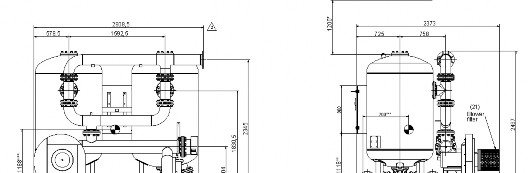
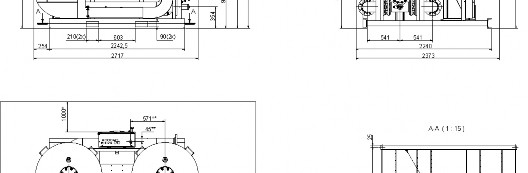
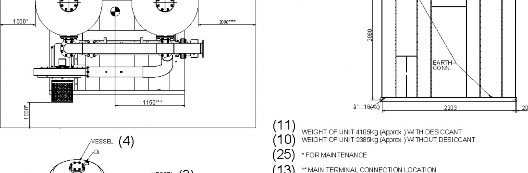
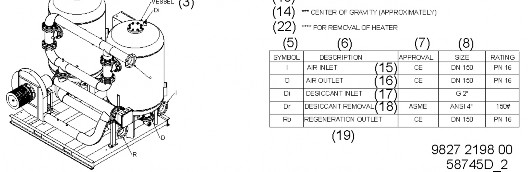
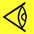
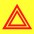
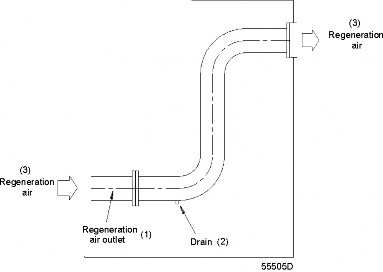
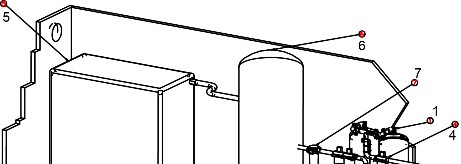
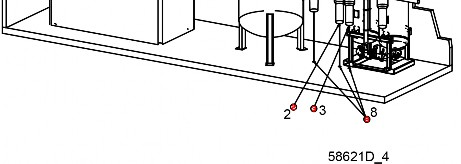
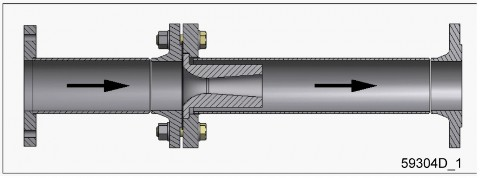
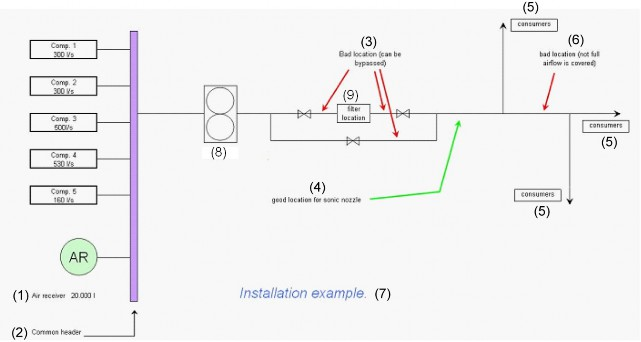
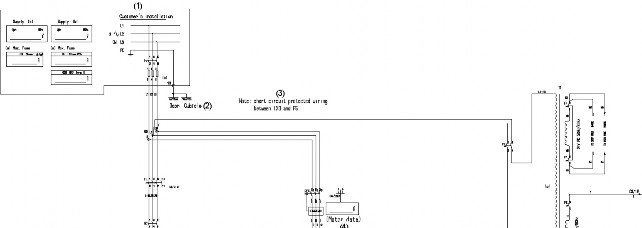
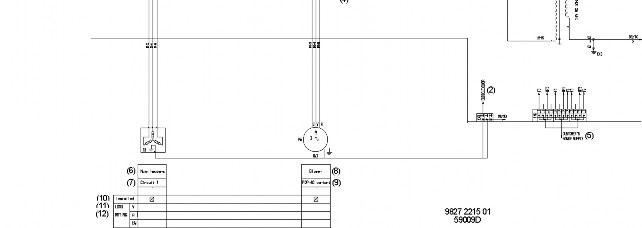
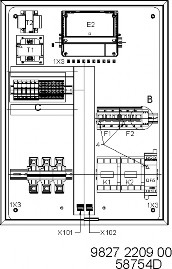
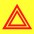
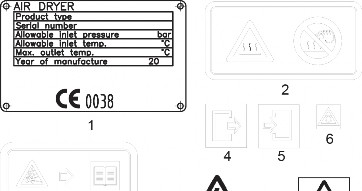
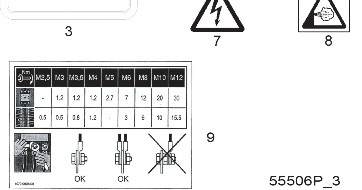

In [ ]:
import re
import nltk
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

def translate_html(input_html, memory_translations_path):
    try:
        def load_memory_translations(file_path):
            try:
                df = pd.read_excel(file_path)
                memory_based_translations = dict(zip(df['en'], df['es']))
                return memory_based_translations
            except Exception as e:
                print(f"Error loading translations from Excel: {e}")
                return {}

        def normalize_sentence(sentence):
            return re.sub(r'^[•\s]+', '', sentence).strip()

        def translate_with_deepl(sentence):
            try:
                url = "https://api-free.deepl.com/v2/translate"
                normalized_sentence = sentence[0].upper() + sentence[1:].lower()
                data = {
                    "text": normalized_sentence,
                    "source_lang": "EN",
                    "target_lang": "ES",
                    "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
                }
                headers = {'Content-Type': 'application/x-www-form-urlencoded'}

                response = requests.post(url, data=data, headers=headers)
                response.raise_for_status()

                translation = response.json()['translations'][0]['text']
                return translation
            except (RequestException, KeyError, IndexError) as e:
                print(f"Error translating sentence: {sentence}")
                print(f"Error details: {e}")
                return f"{sentence} (Translation failed)"

        memory_based_translations = load_memory_translations(memory_translations_path)
        soup = BeautifulSoup(input_html, 'html.parser')

        for element in soup.find_all(text=True):
            text = element.strip()
            if text:
                sentences = sent_tokenize(text)
                translated_sentences = []
                for sentence in sentences:
                    normalized_sentence = normalize_sentence(sentence)
                    if normalized_sentence in memory_based_translations:
                        translated_text = memory_based_translations[normalized_sentence]
                        translated_sentences.append(translated_text)
                    else:
                        translation = translate_with_deepl(sentence)
                        translated_sentences.append(translation)
                element.replace_with(' '.join(translated_sentences))

        return str(soup)
    except Exception as e:
        print("Please check the translate_html function, this is the error:", e)

# Example usage:
memory_translations_path = r'/content/Germanexcell.xlsx'
input_html = """<!DOCTYPE  html PUBLIC \"-//W3C//DTD XHTML 1.0 Transitional//EN\" \"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd\"> <html lang=\"en\" xml:lang=\"en\" xmlns=\"http://www.w3.org/1999/xhtml\">  <head>   <meta content=\"text/html; charset=utf-8\" http-equiv=\"Content-Type\"/>   <title>    b7aea8f9-2aca-4c34-9d3c-aee7f9171b57   </title>   <style type=\"text/css\">    * {margin:0; padding:0; text-indent:0; }  h1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  h2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  h3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  .s1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 10pt; }  .s2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  p { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; margin:0pt; }  .s3 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 7.5pt; vertical-align: 3pt; }  li {display: block; }  #l1 {padding-left: 0pt;counter-reset: c1 4; }  #l1> li>*:first-child:before {counter-increment: c1; content: counter(c1, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 18pt; }  #l1> li:first-child>*:first-child:before {counter-increment: c1 0;  }  #l2 {padding-left: 0pt;counter-reset: c2 1; }  #l2> li>*:first-child:before {counter-increment: c2; content: counter(c1, decimal)\".\"counter(c2, decimal)\" \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 14pt; }  #l2> li:first-child>*:first-child:before {counter-increment: c2 0;  }  #l3 {padding-left: 0pt; }  #l3> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l4 {padding-left: 0pt;counter-reset: c3 1; }  #l4> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l4> li:first-child>*:first-child:before {counter-increment: c3 0;  }  #l5 {padding-left: 0pt; }  #l5> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l6 {padding-left: 0pt; }  #l6> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 11pt; }  #l7 {padding-left: 0pt; }  #l7> li>*:first-child:before {content: \"• \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 10pt; }  #l8 {padding-left: 0pt;counter-reset: c3 1; }  #l8> li>*:first-child:before {counter-increment: c3; content: counter(c3, decimal)\". \"; color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 11pt; }  #l8> li:first-child>*:first-child:before {counter-increment: c3 0;  }  table, tbody {vertical-align: top; overflow: visible; }   </style>  </head>  <body>   <ol id=\"l1\">    <li data-list-text=\"4\">     <h1 style=\"padding-top: 18pt;padding-left: 47pt;text-indent: -42pt;text-align: left;\">      Installation     </h1>     <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">      <br/>     </p>     <ol id=\"l2\">      <li data-list-text=\"4.1\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Dimension drawings       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dimension drawings and installation proposals BD       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 74pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Us0UUUAFGKKDQAUUUUAFFFFABRmiigA7UUUUAFFFFABRRRQAUUCigAoooxigAooooAKKKKACiiigAPSjtRQKACg0UUAFAoNFABRRRQAUGiigAo7UYooAKKKKACvKfGfw60LxP8ePBuo6lYW91JBoOrh4ZreKSO4zNp4XzdyEtsy23kY3N616tXHapz8X/DP/AGAtW/8ASjTqALX/AAq3wZ/0KOhf+CyH/wCJo/4Vb4M/6FHQv/BZD/8AE109FAHMf8Kt8Gf9CjoX/gth/wDiaP8AhVvgz/oUdC/8FkP/AMTXTmigDmP+FW+DP+hR0H/wWQ//ABNH/CrfBn/Qo6F/4LIf/ia6eigDmP8AhVvgzP8AyKOhf+CyH/4mj/hVvgz/AKFHQv8AwWQ//E109FAHMf8ACrvBn/Qo6F/4LIf/AImj/hVvgz/oUdB/8FkP/wATXT9qKAOY/wCFW+DP+hR0H/wWQ/8AxNH/AAq3wYf+ZR0L/wAFsP8A8TXT0UANjRY0VEUIijCqBgAelONFFABRRRQAUUYooADR0oooAKKKKACiiigAzQaKKACjNFBoAPpRXm0Fl8StR1TUJ9M8VeGrTQzcTx29rqHh24urqMrMyndMt9GrLxwBGuBgc4yZNTh+Iei6bd6jqPjrwXYWFpE89xdXXhi4jihjUFnd3bUwFUAEkk4AGTQB6LRXjNh4/wBY1WRUsvjD8Mrx2mt7cLBpDuTLOCYE41X70gVig6sFOM4rZsbrxzqeranpVn8RPAt3qmmGMX9lB4cnea0Mi74/NQanuTcvzLuAyORxQB6bRXB/2N8T/wDob/CP/hKXX/yyo/sb4n/9Dh4S/wDCUuv/AJZUAd5RXB/2N8T/APocPCP/AISl1/8ALKk/sb4n/wDQ4eEv/CUuv/llQB3tBrgv7G+J/wD0OHhL/wAJS6/+WVI+k/E2NGZ/GPhBVAyS3hW6AA/8GVAF0/Fvw0JpoftF8Z4J5bWWFdKuy8UqRpIUZRFlSySRlAf9ZvXZuyKVfiz4Xax1a8+3zC20ux/tK7drKcbYPJSYlQUy7COSNiiZdfMQEAsAfJdT8OanBrNhHqnxc8Cf20rHULQ3mh4uQLiQJHImdR3FDIFVMcEhU+ZQFDI/COreHIL/AMR2nxb8C6VYWsi6dqmoHQ28kMkS2ogmlfUiEZWEB2kgh0AAHmSBwD6B0fVrXXtJs9SsXaWzvIUuIXeNkLIyhlJVgGGQRwQDVyvO7Dw18TNPs4raPxl4UdY1xufwrc7mPcnGpAZPXgAVY/sb4n/9Dh4R/wDCUuv/AJZUAd4fSiuC/sb4n/8AQ4eEv/CUuv8A5ZUv9jfE/wD6HDwl/wCEpdf/ACyoA7yiuD/sb4n/APQ4eEv/AAlLr/5ZUf2N8T/+hw8I/wDhKXX/AMsqAO8org/7G+J//Q4eEv8AwlLr/wCWVH9jfE//AKHDwj/4Sl1/8sqAO8org/7G+J//AEOHhL/wlLr/AOWVc14U17xl4c8f/ENPGGq23iaLTdA07U7Sz8N6PNb7UabUgyJA1xO0sziBBlSN2EULxkgHqK6/YPr0uii4A1OO2W8MDKQTEzsgZSRhsMpBAJK5XON650O1fNMfja9tPFVjq6W/iPy4bV7y6C+EdZdrm/kmTzown9no3lC2Qwxu05Ufui0JMSsfo+wvE1Gxt7uNJY4541lVJ4mikAYZAZGAZTzyrAEHggGgCeiiigAooooAD0ooNFABRRRQAUUdqKACiiigDmfigwT4aeLW+2Q6fjSLs/bLiWWKOD9y/wC8d4iJFVepKEMAMrzivOfAXiGbVPi1oVg0k3kaf4avY4odQgu4r0Az2K75DcxRu6sEAD4JLLJlieB6t4uhu7jwprUVg10t9JZTLbtZLE04kMbbfLEpEZfOMByFzjcQM14v8JdIfT/ino88Hh/W/CujT+Hb0Weka3FaJJHiax3SZgmkZmYNGrGf97mMbi3YA9+oo6migAorzzxv4an8RfFHwY0Gv6roX2Kx1G6YaY0IF0BJaL5UvmRvmPLbsLtOVXnGQep/4R+9/wChk1T/AL92v/xmgDaorCl0W6giaSTxPqUcaAszutqAB3JPk1A1oUiaVvF96I1VXZybTaFb7pJ8noex70AdJ3orE/4R+9/6GTVP+/dr/wDGaX/hH73/AKGTVP8Av3a//GaANqisQeH73/oZNU/792v/AMZpf+Efvf8AoZNU/wC+LX/4zQBtHgE4z7CvNLn44W9tpd7dr4W1u5ktLC7vns7aawkmb7LceRcRLi62+YjckFguAQGLgoOqudMktSqXHiy/gZwxUSfZFLADLEZh7Dr6Vz2l/CnRoIrSG01q/mjtIYhbo0kEwijWRZYyoaM4w0UZB9IkHRAAAdT4f8SjX59TgaxuNPn0+5+zyRXMkLsfkV1YeVI4AKsCA21sEEqARnZrmrHwXLpz3DweIdWVriQyyF/s75Y+m6I4H+yMAZOByatnw/e/9DJqn/fFr/8AGaANqisX/hH73/oZNU/74tf/AIzR/wAI/e/9DJqn/fFr/wDGaANqjtWL/wAI/e/9DJqn/fu1/wDjNH/CP33/AEMmqf8AfFr/APGaANqisX/hH73/AKGTVP8Avi1/+M0f8I/e/wDQyap/37tf/jNAG1RXkvw48M3Hhb42+PoLjxBqviI3Oj6VeJLq7Qs9usl5qreRGYo0/dKc7Q25gDjdgKB61QAUUUUAFFFFABRRRmgDzbS9Z8dxazqNnpnhXQ7vQFnuJIdUu9flglklNzKGjaBbSTbjGQ28gg9jxVrXl8e63pFzZHwz4W3SAFPtGu3EsYdSGUun2Ibl3AZXIyMjI610/hX/AJB1z/1/Xn/pRJWxQB4bL8OviANNsYY7PRJLq3vLW7e5uPEl6WlENskHlnZbKdrbS5ViyFnYsjZNdNoen/EHR9b1e+OgeFmjv/LKwRa3cJsZd5dmb7Gd7MznnC4VUHOMn0yigDy+98X/ABTt9aFpF4E8OyRGRBHJ/wAJRKFmjJj8yT/jyypjDOdpHzbRg88dD/anj7/oWvDf/hRXH/yDW5d/8jBpv/XGf/2StOgDkP7U8ff9C14b/wDCiuP/AJBpP7U8ff8AQteG/wDworj/AOQa7CigDkP7U8ff9Cz4b/8ACiuP/kGo7i88dXcEkM3hXwzNDIpR45PEE7KykYIINjggjtXZ0UAfM3iv9nPxN4rASXT9HtIWtDbyJa+IbmMzO9pHZSTuVswGkFtGUjyMIZZtwkVyg29X+G3xN8R2mt22p2nhQPeXrahaalYavdwXdpK8MlszKTbMokjt2RYpFC7WQOyuc7vfqKAOPGp+Psf8iz4c/wDChuP/AJBo/tTx9/0LXhv/AMKK4/8AkGuwooA4/wDtTx9/0LXhv/worj/5Bpf7U8ff9C14b/8ACiuP/kGuvooA4fQvEPje48XvYa/4Z0fSNF2D7Nf2GtyXsly+wllMTW0Xlhcfe3HORx3HcVm6j/yF9K/35P8A0A1pUAFFFFABXAaL/wAl88Zf9izof/pVq1d/3rgNF/5L54y/7FnQ/wD0q1agDvzRRRQAGiiigAooooAKKKMUAFFFHagAooooAKKPWigArjtV/wCSv+Gf+wFqv/pRp1djXHap/wAlf8M/9gLVf/SjTqAOxo6UUUAecePdR8Saf8TPCH/COaJYa08unalHc/b9TayW3i8yzPmArDKX5AG3A+9nPBrX/tTx9/0LXhv/AMKK4/8AkGrGo/8AJTtA/wCwPqX/AKOsa6jFAHA6/P8AEnUdD1G0sNF8Nadfz28kVveNrtxKIJGUhZCn2Jd20kHbkZxjI615r4r+D3j/AF43CadpnhDw9bwwQwaQNM1S9t307Yirv3RQoJW/dw4V12BYIl2Had30RRQByH9qePv+ha8N/wDhRXH/AMg1k+JfEvxO0uwSbT/Bfhq+YyBZifE80fkRYO6XBsPn24HyjBPrXotU9a/5A9//ANcJP/QTQBxWheIviZf200l94L8NWDLM6QgeKJpPOiH3ZeLD5d3XaeR61pf2p4+/6Frw3/4UVx/8g11Nl/x5wf8AXNf5VNQB5J498K+OPH0CWt74c8JSWC2t3F9nn1q6Y+dNEYRIJEtUdQIpLhCEKswl4dcc4ngb4bfEPwh4yu9fmtPD2pSXFsIDE+uXQbd5FnC7mR7V2bP2JDz8x3ncz7V2+7UUAcf/AGp4+/6Frw3/AOFFcf8AyDXP6n418eaZ4+8FaXqHh7RNP0PV9RktLi9s9Yku5WIsbycRiNraLb81vGd+48ZGOcj1CuD+I/8AyOPws/7GSb/00alQB3lHrRRQAUUGigAooxmigDgtG/5Lx4w/7FrRP/SrVa72uC0b/kvHjD/sWtE/9KtVrvRQAUUUUAFFFFABRR1o70AY/hX/AJB1z/1/Xn/pRJWxWDoN5Bp+iX91dTR21tBd3sss0zBUjQTyEszHgAAEkmqf9v6z4ieVNAsY7K0V2j/tbV422PtIG6G3BV5UJDruZoh9108xSCQDqs14t+0F8a9T+HOo+F9J8OSWb6re3L3V6t3pN5qKCxh8sTIFtMvFMxni2O6lMK+QTgV6FH4Dhu7iK51rUtQ1u4jYsI5rhobUAqBsNvFtjkUHLDzVkYE/eOFxraL4c0nw1psOnaRpdnpWnw7vLtLK3SGJMsWbCKABliScDkkmgD5Tuv2nPGktrrn7jTYNfOqTr4em/wCET12S1h0szQbTdx+SryXIiEpIjZUL7BlRk1ufDP8Aag8S6t8UPDXh/wAVx6allrWmrBHFpugarbzpqcdr511J5l0iIbXMcyoApkG6HPVsezazeSeIvHEWi6Xc/Yo7GGQahqFuI3kjkdY2W3QEMFk2lHYuvCSR7QTJuTqNB8NaZ4XtXg0yzS1WVhJNIMtLcSBFTzJZGy0shVFBdyWO0ZJoA4uL9oDwhcanq2n28fiS8u9JuvsV6lp4S1aYQTeWkoQslsRkxyxuMHBV1IyCDVj/AIXh4d/6B3i//wAIrWf/AJErL+D3/JRvjn/2OFt/6j+kV6nmgDgP+F4eHf8AoG+L/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDgP8AheHh3H/IN8X/APhFaz/8iUf8Lw8O/wDQN8Yf+EVrP/yJXf8AaigDgP8AheHh3/oHeL//AAitZ/8AkSj/AIXh4d/6Bvi//wAIrWf/AJErv6KAOAPxw8O/9A7xh/4RWs//ACJXnnxW/aP1W0vdA0jwBpGpyazdSPeXR1/wZrfk/YYTGsyxrHAsnms08QV9rIo3buSgb6CrhNYx/wALz8I/9i5rX/pTpdAHjl78ePHgm8RA6FLLebrh/C03/CGa9Gke5JBHHex+QxfbiItJEy79zjYm0Fjw7+0x4w0fxp4ag8c6K1t4c1PTYrGZ9K8Ia6tyuueX5jmPzYAGtW2TqqhTKD5ZOQXKfReof8hfSv8Afk/9FmuC+Nv/ACFfhf8A9jhb/wDpLdUAaP8AwvDw7/0DvF//AIRWs/8AyJR/wvDw7/0DvF//AIRWs/8AyJXf9aKAPPz8cPDgBJ07xeAP+pK1n/5Erzf9nb4yWHxt+N3xX1rRZhdeHLbTPD1tpV2bOe1e4t3iurkSMkwVjl7h9rbVBQIRn7x+hpf9U/8AumvgX/gm5a+IZP8AhKfsep6ZAn/CLeENwn06SQnOkHyuROv3eN397BxszwAfflArlf7O8b/9DD4f/wDBDP8A/JtH9neNz/zMPh//AMEM/wD8m0AdVmiuV/s7xv8A9DD4f/8ABDP/APJtH9m+Nx/zMPh//wAEM/8A8m0AdVRXHX9v45srG4uF1vRLloo2kEMGgTGSTAJ2rm9AyegyR9at/DPWtY8S/D/w7rGvW0Vjq+o2EF5c2cUewWzyIHMJG98lN20kNglSRjOKAOmNFFBoAKOtFFABRRRQAUUdaKACvJfHfjr/AIRn40+GGk0bW7zTING1KK9vbDQ9RvFhkllsmhVTBbSI5byZc/MNu0Z6gV613oxmgDgP+F4eHf8AoHeL/wDwitZ/+RKP+F4eHf8AoHeL/wDwitZ/+RK7+igDxy/+NPh9viPoc39n+LQiaTqCEHwdq4bJmsiML9lyR8pyQMDjOMjPSf8AC8PDv/QN8Yf+EVrP/wAiVr6j/wAlO0D/ALA+pf8Ao6xrqKAOA/4Xh4d/6BvjD/witZ/+RK5b4iftXeFPh5okF7J4e8c6ze3dyllYaTYeD9RS6vp2DMI4vPhjQsESRyC4+WNiM4xXf+IviJpWi376VDPDd63tYraeZsjjbCkefLgrCCHVvm+ZlyUVyMVzmqWkHjGfTrnXPFtvpgsLtbu3stDuUQKQjIyvcOvmNuV3UmMRHDkdfmoAyrr9qjwXaeEL7xC9l4rjtrOG5eSKfwpqUJEkAfzId7wCMOGjdcFgMjGa8tsP2mfFzafpC6+1jIq/bBrY07wZrqefEyf6N9mLofKZTu3l94YAY2Z4948OaH8P/Clwt1pw0waiImhbVLq4+030iM+9le5lZpXBbnDMeg9BWvrPibQTpF8BqViSYJP+Wqf3T70AfMmt/tQfET/ipF8P2+ipbGWy/wCEfbUvCniBnSAK/wBrF2EhAZyRH5ZjIADPuBwN31F4E8Y2XxB8FaD4n05ZUsNZsYb+BJwBIiSoHCuASAw3YIzwQRTbLxNoIs4B/aVj/q1/5bJ6fWsXUNG+Hup6jealLDo0WrXcYhm1W1ZIL0qAAALiMrKuABghgRgY6UAdzRXASajLoheXR/FtnqkWSRputXKbQMcKlwimRecktIJienHWtfw58RdJ8RXr6eGex1Rf+XO6K5cEvgxyIzRyfLGWIRmZVK7wpOKANvWNUXSLCScwy3Uv3Yra3A8yZz91FyQMn1JAAySQASPk74hftOhPi9ZaRcw3d2vhnxIqIfDfh2+1hUlbRLoyxSSwAhnQzA7VVW2knaRG5p3/AAUOTW4/h3o7zeJItM8NS6rIj21nYZupnGnXbRwl3do38yVQo3RhAWQscKTV34WeBNc8HfDX9nqz0q90jT4rm8W+ZLjQ51uGup9Fv5ZpbjNwheRmaQt8sZ3N0UDZQB6L8Bvi7rfxX+HvhbX77VPD8cuuWkbwS6XE8sElwIg1xAQ0mYpo3WYGIljtjJ3Eh1T1QWmt/wDQTsv/AABb/wCO18jJ8ML/AME/tReJLuwSyi17xLd6df2OpQeHbs2kdwGjOpBHF35cDyW8UTyZw0qhxuO4LX2VZrOlpCtzJHNchFEskUZjRmxyVUlioJzgEnHqetAGd9k1v/oJ2X/gC3/x2j7Hrf8A0E7L/wAAW/8Ajta1FAGT9k1v/oJ2X/gC3/x2j7Jrf/QTsv8AwBb/AOO1rUUAeXaNa6z/AML08XAajZiT/hG9Fy32JsEfatVwMeb9fzru/smt/wDQTsv/AABb/wCO1zGjf8l48Yf9i1on/pVqtd7QBxWn6v4nf4oT6LNJYT6DbaTFeyzx2zRzefJLKiICZSNu2Jz909OoyK7WuW07/kqHiD/sDab/AOj76upoAKKKKACiiigDz3SVTxF4k/smRkaz0qefVLiAnmWV7u4S2yvQophmfkffWJgflNehYrwa3+FujfEH4t+JptUvfEdq9tplsiDQ/E2paSpB1HVSd62lxEHPHBYEjtXS/wDDNXhH/oL+P/8Aw43iH/5OoA9Uqrq2qWuiaXeajfTpa2VnC9xPPIcLHGilmY+wAJrzX/hmrwj/ANBfx/8A+HG8Q/8AydXxx/wUi8KQ/Cvwl4Q0zw38TvEfgoa9cXUV9Lq3jTxDetdQJGimMI880XlfvsyBl3nCBAR5goA+6/Cem3OmW/h9b5mk1Oe2nub123c3EhR5cBmYqoZiFTcdqhVBwopdStH8eajqWlve6hpulaZcJBcrYXLWs15KYUlx50ZEkcaiWI5RkZmUgnYCJPx4t/2o/iPNqktrP8Up4IJdXmT+35tW1bydLgEsR8sgHcYnXKAlGlA3FtrbDXp37GWuar8UPjto2jeI/jJq2t6fqVtcCbw3Z+KvENncPL9nF0bxDA0UayM5cNlljIEpCljGzgH6mWngnQ9PuL2e106O2nvphPdSwlka4lEaRh5CDlmCRxpk5O1FHQCuO8Ufs9+FfFnjGHxLexSHUoRp4hl2Ru9v9kunuV8qR0Lx+Y0hSTaw3IAOOtQf8M1+Ecf8hfx//wCHG8Q//J1H/DNfhH/oL+P/APw43iH/AOTqAN7X9AGl+I9CvrWG5msrmY2GoRG8YQwxsjtFOEJyXEwji+TGROSwYRqU6T/hHLD/AJ4v/wB/n/xrz2P4IeHfB+o6bq1hqPi+e6t72DZHqnjTWNQtzukCndBcXckT8McblODgjBAI9UoAzR4csP8Ank//AH+f/Gj/AIR2w/54v/3+f/GtKgUAcXqmgJqHi3TdOiS4h023ha+vJYbt0ZpAyrbwnnJRv3zttI5hRTlXZWr3fwV8N33xBi8YTW3m6rDaw2kLSokhgWMznMUjKZIy/wBoYPtYBgiAjg5h8Y/DXSPiJ4ub+1LzX7X7HYxeX/YfiPUNI3b5Jc+Z9kni8z7oxv3bcnGNxzm/8M1eEf8AoL+P/wDw43iH/wCTqAPQv+EcsP8Ani//AH+f/Gqtz4K0e6nW4e0Iu0hkgjukldZo0cqXVJA25clEJwRyinqBXDn9mvwj/wBBfx//AOHG8Q//ACdXyP8A8FCfD3/CmfD/AIMTwj8VvE3w9uNSurhp73UvG/iS6knWJYwI0BmmjCZl3PkCQ4TZkb6APqjw34o+J+saL4Pv5/DPhe4nurNJzK3iS4QyM0AJYqNPwpOc4GQOlangXSZvGWr+LpfGGmWb6lpuvxm2toryS8gsiNOtGUwyPHGQf3rtkIuDI45zk/kjF+0b8QdB+22tr8WLjUrV0uRb/ZdU1RF8OJH5yxxJuCk71VNnmCTACeZs+evWP2O/FWpfFX9oXTtF8SfFTUtct9fszc3emWPirxDZXJmjsEAcGCSKPzcW6szMfKKuwQkiJQAfqp/wjlh/zyf/AL/P/jR/wjlh/wA8X/7/AD/4157/AMM1eEf+gv4//wDDjeIf/k6j/hmrwj/0F/H/AP4cbxD/APJ1AHQ+JtBh07UtF1KHzDaLcfYry3NzJteOcqiOq5wXWUQ8kjCNLjJIFcn8HvgUnwm+J/xI1rTo9PsfDXiFNJi0vS7AMgs47S1aFkKYCouSNqoSAB26U68+CHh3whNpur2Go+L57u31Ky2R6p401nULc7rmNTvguLuSJ+GONynBwRggEeu0AFAoooAKKKKAEf7h+lY/gv8A5E7Qv+vCD/0WtbD/AHD9Kx/Bf/InaF/14Qf+i1oA2e1BoooAKKKDQACijpRQAUUUUAFGKKO1ABRRRQBy+o/8lO0D/sD6l/6Osa0PF2pXWk+H7uewWJtQfbb2gnz5XnyOI4i+Odm913YycZwCeKz9R/5KdoH/AGB9S/8AR1jUPxW0O08TeCbnR9QWV7DULm0tLhYZ3gdo5LmJGCyRsrocE4ZSGHUEHmgDe0HRbfw9pNvYWxd44l+aWUgyTOeWkc4G52YlmbuST3rQzXg//DEHwj/6BniT/wALXW//AJMpf+GIPhF/0DPEn/ha63/8mUAe75qnrOP7Hv8A/rhJ/wCgmvE/+GIPhH/0DPEn/ha63/8AJlVdV/Yk+EkOl3ki6Z4jDLC7DPjTWzyFPY3lAHvdkf8AQ4P+ua/yqevArT9iL4SPawsdM8SZKKT/AMVprY7f9flS/wDDEHwj/wCgZ4k/8LXW/wD5MoA94rO1/Rotf0e6sJZZLcyoRHcw7fNgf+CWMkEB1bDKSDggV4x/wxB8I/8AoGeJP/C11v8A+TKP+GIPhH/0DPEn/ha63/8AJlAHoN/4Q0b4yfD6wsvHPhzT9QaRFkuLG4jWdLO8VWR2hcjKujGQLKuGHUEZrlLeJrfRvgBFJPJcvHfRK08oUPIRoV+CzbQFyepwAPQCvH/2wfFWofBX9lfTtN8JeLl8CR/2smkRapPcXL3ccCTvhY5wsjb8Rgu8pJZBIMl2AP55aj+0T45bWLFj8eNPljhnL2ZS71ZLbTmNpcRb7dFQMmA+3DAjLqAPL3igD9qNJ0WGXxnrWrSSSyTROttDEWAjiDQws7AAcs21ASxOAg27dz7unr8nf2TP2lPHkP7RHg7Q7j4w23xA0vV7x9PutOLXUzTCQE/aHaeJDvRYYwCh2gdE+eQn9YhQAUUUUAB60UUUAcFo3/JePGH/AGLWif8ApVqtd7XBaNz8ePGH/YtaJ/6VarXe0Actp3/JUPEH/YG03/0ffV1Nctp3/JUPEH/YH03/ANH31dTQAUUUUAFHSiigDzTwB/yVPxj/ANg+0/8ATjq1el15p4A/5Kl4x/7B9p/6cNWr0ugAr5p/b1+JXhHwZ8GrvRvEVrpd9qOt216umpqtg95FaGO2fzLzYiMV2eYiBvlAeeMF0Viw+lq+Av8Agpb8Mde1NdO1i2bVvEllf2tzbw2SS2FqmlzwILtGhme1eQM6Qzn7wYhJF8wBwhAPYL//AIJ9/AuaeXSZPC2qyaZrEk97qNm/ivV2ivJ90bebKpu8O5YAljkkqCegqn+zLqHw9+G3xN1H4U6Bo+n21/psWpRaZe29pM9zb20F9mTT57yYuZWRZ7SZVVziOVAyJtjaX1i6+G/iEa7p4PxV8XEmKbDG10fI+5/04Yr5A8D/AAm+JGt/tuIp1SW18N6VeanrZ8VQ6Xpi6nKi/a7KNZJ1tyrb5rm6VY5EXCwylV4VgAfogKKO1FAHO+PL+fTNBS5t9OudWnjvLUrZ2bRLLL+/QYUyuid8/Mw6evFZX/Cwde/6Jn4p/wDAnSf/AJOroPE6LJZWoYZH261P5TIRXA+OPjHrnhf4oaf4X0/wgmr6XIumNfaw2otCbMXl1NbqTEIWDY8jI+cbiwX5fvUAb3/CwNe/6Jn4p/8AAnSv/k6j/hYOvf8ARM/FP/gTpP8A8nV29ea6/wDFfVNK+Mth4Ks/DUepaY+nwX9/rS6iEbT/ADp5IYUe38sk+Y0TlG3AHy5RwUAcA2PCWv32ueKtWa98N6n4dMdlahV1KS1cy5kuMlfInlAxjndjrxnmuyrGtkA8Y6i4+8bC2B57CSf/ABNbNABXif7UXjrwf4e0Lw54d8TWWi6lfeJdRa002HXNLOpQWxSF3mvGtlRmdYYt2SAAPMUO8aFpF9sr4s/bt+FvxF1/xv8ADfWvCF6ms2l1ez6NLpur6bZ3ttp7zG2mhkiieDnL2RJklk+Riu0qGIIBt+DP2Dfgnd+GtHu5PDWq/aPFNklxrjp4p1ZP7SkeAu7TgXQD5aRyc/329TTvgBN8NPgl+0b4w+E2h6Vp+m3hkSLRrlkuZr1Ik0ywmewe7n3mRdmZY0Ep2pEwKIEjLei+CPh1r8nhLwIy/FDxXEsmnQlUS20jEY+zA4XNgTjtySa+brf4VeML79vLXrW18QeLbdZrqK6n8YxXGjNMsNrpEQUCBrHKAyX4iYKNjAgspJVgAfoFRWVHpN+iKp1u5cgAFmhhyfc4TFL/AGXff9Bm4/78xf8AxNAFXxp/yB7f/sJWH/pZDW9XHeM9MvhpNvnWLg/8TGw/5ZRf8/cP+zW7/Zd9/wBBm4/78xf/ABNAGpRWX/Zd9/0Gbj/vzF/8TR/Zd9/0Gbj/AL8xf/EUAalFZf8AZd//ANBm4/78xf8AxNcr4v1XXfD3inwDZ2upLPZ61rUlhfC4hTcIV0+8uQYyoGGMlvGCTkbS/fBAB3r/AHW+lY/gv/kTtC/68IP/AEWtbDcIfpWP4L58HaF/14Qf+i1oA2aKKKACiiigAooooAOlFFFABRRRQBxvj74lp4C1Tw3p7aBq2t3PiC8ksLJdMNsAZ0t5bgoxmmj25it5mB6fu8ZBKgxf8LB17/omfin/AMCdJ/8Ak6k+IP8AyNvwy/7GGb/006hXWaxFqE+k3kelXNtZ6m0TC2uLy3a4hjkx8rPGrxl1BwSodSRxuHWgDxzxR8ZJ9A+K3ga11DwH4mtr7WrfUtM060MunM9zMEhuWAK3ZVQsVrKxLsvYDJOK6PxJ421m+tdPt5/AHiLToZdV05Wu7mfTTHEPtkPzMI7tnx/uqT7V8w/tG+EPjxc/tM/s4tH498KSIdavPJXTtEl04JstJJLrcJZbsuXtFuI1wygM44Gd6/Zfjb/kC2//AGEtP/8ASyGgDfooooABVPWv+QPf/wDXCT/0E1cqnrX/ACB7/wD64Sf+gmgCax/484P+ua/yqaobL/jzg/65r/KpqACkJwCaWobyF7i0nijnktndGVZ4gpeMkYDLuBXI6jII9QaAPhf9m/4tax4m8U+Ifh74+0HVPiENS0y98RxaZNDaXNn9oh1m8S6ijNwyAbTJZqke9lVVXAj5Z36b+yN8GPEWs+D5Z/C1zZ+Idc1qSz8SJaeItVhF6h0rUHB2GWJkQtGUKeXHsZJocAK6145+zTFHa/tXT6rJ8QdU0vTz4N1SQa/bR6c7SBtenMcKFrZ1fzdkkgVU3MVOw4+UfRWsfDnxV41+N/w48TH4ieIbTSbXWbrTba4jj0trmeU6ZdSGQyQ2ghdV8t4ihWUAk4cPvRAD2b4H/s6fDj4JS6nZ+DfC1tpiWd1ttp55Zby4t0eCItHHPOzyJGSWOxWC5ZjjLEn16uL+H3hzUPD+p+JRfeKdW8SmS6iCnVIrNDFiBMlfs8EXXcAd2fuLjHOe0oAO1FFFAAaKKKAOC0b/AJLx4w/7FrRP/SrVa72uC0b/AJLx4w/7FrRP/SrVa73rQBy2nf8AJUPEH/YG03/0ffV1OK5bTv8AkqHiD/sDab/6Pvq6mgAooooAKKKDQB5p4A/5Kn4x/wCwfaf+nHVq9LrzTwB/yVPxh/2D7T/04atXpdABXzr+3L4/Xwj8GtR0q60XQ9S0rXrS6tLq78QX729vZkRbkkCR287ySK37xQEABizvVtgP0VXj37T/AMDh8bfh5NBZanrOi+I9KjuLrS7rQbqO0uJpTbyILV5XU4hkYxlgCp3RRMGUoCAD4vsP+ChXjPxNq8Wn6P8AEb4V3niu81JtO8O2EnhfWora+jkmjjja4mM/+ju3zfKFdAQB5hBLL7j+xZ8ep/iTMGj0/wAL64NXmuZNU8U+HLqeCRr4YuXiazuoldbeL7T5aMs0jMWV/LTfL5fTaf8AsX2F5ot0tt8YviLJZ6tdLqrSsdI8wOXWUCJzp2+GLKr+5QrHtLJs2synY+Bn7OGlfD3x5qusXvifxL4q1rSs2FuNfnge3RGRWju4Yo4Ywk3kuYGlXhis/GXkyAfQVFFFAGV4k/487b/r9tv/AEcleS+PNUs7T4uavaT3cEN1d2/hFbeCSRVeYrrF4zBFJy2FBJx0AzXp/jhbptEjFlc29pdfbLXZNdQmWNf36dVDoTxn+If0rhNZ+Feqa74ml1678S6C+oMmnqj/ANiMfJ+x3MtxGUJuiVLNM6vzyuAMckgHrfQV53rl/bRfEi/s3uIku5rPR5YrdnAkdEvrgOyr1IUugJHTcueorjvGXxzufA3juz8I6j4n0IaveDTvIRdLVTN9su3tY/LR9RWSTY8ZaTYjbUIPPSuru/BOu3viCTWZPEvh837w28AkGiSfIkMzSgKfteQGZhuGedq9CM0Adlb/API3ah/1423/AKMnrYrkvDCasvivVv7U1LT9Rb7Fa+WbCze3CDzJ87t00me3p+NdbQAV4b+1x8TW+HHw2lMmgaRrNjeJMbqXXtTksrW1SJPMD7oYpZmlDBXTy0GPLY+YjiMN7ka8k/aU+FOj/EvwKbrULrVdPvtD8y8s5tDu/sl1cEoVNkZVUv5UzeWpRMMWWJlIdEIAPh6x/b08VeFNG021ufiT8L4oRZyHwiw8L6zKdSt4nmtUe7InH2Zi9uQQok/iI3ALv9q/Yr/aJl+Kfj3xDLJD4R1/UPEjRXup+IfDDXNpIk0FjbRiBrW6iDmCPa6q4mdiZA3lRh5PL9EX9jJW0zVLOX4v+PWXU95uZEh0RHVnHzeQ/wDZu+3HJwImXbxjGKn+AH7MNh8OvGV/4puPF/ifxc1oZNM0mHxFdwTLbpHHDbvOUjgjAuC0EyeYCS0cjlv3k0zMAfQ9FFFAGD40/wCQPbf9hKw/9LIa3qwfGv8AyB7b/sJWH/pXDW9QAUCiigArgfiT/wAjn8Kv+xlm/wDTPqVd9XA/En/kcvhV/wBjLN/6Z9SoA71/uN9Kx/Bf/InaF/14Qf8Aota2H+430rH8F/8AInaF/wBeEH/otaANk0UUUAFBoooAKKKKACiiigAo7UUHpQBw/wAQufFvwy/7GGb/ANNOoV3FfMw+K2oeJv2mPD3hCeSeVNH168edXsTHHBnT70WwVxkLuiZydzyGQrvUQBWjr6ZoA+Vfi34im1H9uT4J6Qt55tlptzct9l8sDybiTR9WMjbsZbdGsHGSBt4wS1fRfjb/AJAtv/2EtP8A/SyGvnL4v6DJaft2fBHVxayxW9808H2jefKlki0rWSwC5xvVZY8tgEgoMnaAv0b42/5A1v8A9hLT/wD0shoA36KKKACqetf8ge//AOuEn/oJq5VPWv8AkD33/XCT/wBBNAE1l/x52/8A1zX+VTVDZf8AHnb/APXNf5VN1oAKKKKAPmPTfDmm/sh/DPWtb8MQnWZLzVpLW3tdf1P7Na2kUmoS+VAsscEsu1WnYKWSRufmZVGR8Xaz+3b8RNGj8CyW3iP4P2uh6deS3GiFbLWZCFS0urYm5IRNwxKykoikuyttC5FfpV4j+Hdt8TfAdxo8+p32iSm+uJItT0tYDc25Fy+dnnxSx/MMqcoeCcYOCPlfVf2JNK1J/hjef8LT+JduPEOoMrwprNuy2QfS724PkM9szggpsDOztsZhknDAA2v2WP2t/GvxD+IGq+FfEsHgXX9Ui1Ex6rc+Eb2+t2scKIVUW91b7ZcPESzicfKTtUkAP9o187fB39kvRvh347vdbm8beNPF0thct5Nn4kv4J7be6RyLJ5ccEYDIzMUxgLkcHam36JxQAGjNc948t9QvPDc8GlS7bzzIZWhGzdcwJMjzwLvIUGWJZIwxI2lwcjGR5rZ/DPxfZ3supmZba4miuoFsrTXLm6gt5HnsfstwqzKinylt5pJQRmVmcnf5pUAHtZooooA4LRv+S8eMP+xa0T/0q1Wu9rgtG/5Lx4w/7FrRP/SrVa72gDltO/5Kh4g/7A2m/wDo++rqa5bTv+SoeIP+wPpv/o++rqaACiiigAooooA808Af8lT8Y/8AYPtP/Thq1el15p4A/wCSp+MP+wfaf+nDVq9LoAPwoIzRQeaAOQ8CGLw2X8HMhgGkxL/ZwKMElsOkWxiTuMQxC/zFvlR2CiVM7Wo+HobvUBqMEsljqYiEH2mA/fj3bgjqflcAlsbgSu99pXc2ZNb0O31y3jSVpIJ4JBNb3UBCywSDIDoSCOhIIIIYEqwKkg4l1q3irQIbl59Ej8TxRjdEdElS3upS0jAJ5NxIsYCIUy/n/OQ5CJ8qkA4LwXr/AMUvFfiXx7pT+JPCFsvhnWYtKSVfDF0xuA+nWd5vI/tEbSDdlMc/cB74FrQvhR448PeKfEfiO18V+Fv7Y1+eOa9nk8KzkFY4IYYo1xfhgqiJmwzN80r4xk5n+Gv2/wANeKPiXq+vaReaHZ+I/Etld2P2oxSMVfS9MswreU7gN9ohkj64+XdnaQx9YoA8n1rRfiTqWq2Oj3HinwjJDNE96WPhW5PMMsJVSDqJyCX/AErJ1L4HeMNU1281WTxT4SSe6j06N0j8IzBALK5kuYsD+0M/M0rBueVAAweT3A8Tw6jq2h6/Z2t1daNPYSJDeRIu2Xz3tzCVBOcMFJzjjvipvEHxQ07wsLltR07Wo0t4o5pJItMlmQK7MowyBgSCpyASVGCwAYEgGL/whXj7/oYPBH/hHXH/AMsaybn4TeNrrVri/bxL4OEsyWqMq+EJ9oEEryJgf2h3MhB9QBjFcP44/b58CfCz4weHvhz460TxD4P1jXLaO5trnUY7V7aMSTywxCV4Z3Cb2iJDcqoZS5T5tvvE3jOKDUVsm0vVvPZUYFbJmTDEgfOPlzlTkZ4GCcAjIBydn4K+Ien6jPeW3irwfBJPFHC6x+ErhVIQuQeNR6/Oa0P7G+J//Q4eEv8AwlLr/wCWVdIviVWu5LYafe+fGiyMnlrwrFgDnd6q35VL/bT/APQMvv8Avhf/AIqgDyn4ua98Uvhn8KvGPjCLxJ4Q1CTQNGvNVW0bwxdRiYwQvIELf2icA7cZwcZ6V6Jp/hi+vIbSTxPqEGs3lvKJ1SztWtLMSKSUcQmSQkj5SN7uA6h1CkDHK/H7T9W8dfAr4i+G9G0W9utX1jw7qFhZwN5aCSaW2kSNdzOAuWYDJIA710kXifxFqVzcwWng+6sBBOiC61q9t4obiIsQ8kQgeZyQoyEkSPOVGV5KgGzr2sJo1ojACS6uJFt7WAkjzpmztXgEgAAsxAO1VZjwppnhfQx4d0GzsC0cs0alrieKLyxPOxLyy7cnBeRnc8k5Y5JPNVdA8LyWFyNS1a/bWNdaHyXuzH5UMSk7mSCHJESFvUs7BUDu+xcb4oABRXDeAE12PxD4ifVvEF1rFncSLNYWs9tBEtlHudTGrRxqzjcDy5JwFHUMzdzQBg+NP+QPbf8AYSsP/SyGt6sHxp/yB7b/ALCVh/6WQ1vUAFAo9aKACuB+JP8AyOXwq/7GWb/0z6lXfVwXxJ/5HL4U/wDYyzf+mfUqAO8f7jfSsfwX/wAidoX/AF4Qf+i1rk/GXjnVvD3jddMW90S3065sIms4p1nkvHu2nMWGRBtEB3wDeCSGLZAGDXWeCv8AkTtC/wCvCD/0WtAGzRQaKACjtRRQAUHn60UUAFFFFABRRRQB5n4y8K6NpXj34bX1lpVnaXj+IrstPDAqvmXTL+SU5A/jdQzf3mAJyRXplcR8Qf8Akbfhl/2MM3/pp1Cu370AeB/HX/k5P9mr/sN61/6ZLuuz8dav4pbWJLO00fSbjw/Dc6a326bVJYroXBvIT5fkC3ZTHtwfM80HPGz+KvIf2pvin4W8AftM/szxa9q8dhK+taoVj8t5GxNp01pESEUkBp54kBP94norEe6+JfuXv/YV0v8A9KYKANf7Z4j/AOgVpn/gyk/+MVxnjPwb4w8U63p2o2t5Bo4slZPItdTnCTBlYHzAIwGKt5bJ/dKNndu+X06igDyfwd8NNf0Cwt/7WnbXdUjmlmN43iG8iQhrr7QieUFI2ptjjGc5RCv3XZT2OsXfiL+yL7OlaaB5D/8AMSk/un/phXT1T1n/AJA9/wD9cJP/AEE0Ac5qGpeNbfw+H0fw9oV/qIjTyoL7XJraJ+RndItnIVwuSMIckAcZyJfhR4kvvGfwu8H+INUjgh1LVtGs7+6jts+UsssCO4TPO0MxxnnGKvX3iBdIg0y2itZ9Qv7sKIbS2KBygKiSVizKFjQOCxJ7gKGZlVvnn9h79rPwH8b/AAdZ+BdFuLqy8W+D9LtrG/0vUUWOSZYY0he4gKsweLeMZ4Ybl3Ku5cgH1FRRRQBkeFv+QU//AF93X/pRJXnL/wDIP+A3/YRT/wBMV/WpcfB3wX8QB/aPiLw7aatfRzXMCz3AJYILmUheD0yzH8a+eYvjXd/C+z+D+geLdDRP7M1WSbTLiy1Kwto5tOOmX0dqpS6uISrqksaFhujOz/WCRjCoB9c6N/yFde/6+0/9J4q1q86+D134m1STxnqPieFbKS812R9P05QCbSyW3gihDOACzSCMzncMr5+z+AV6LQB8u/tb+IPD/huz8cTa1catHb3Xhi1s7qTTtLFybZZZruKFlLTRh2dpJTsHRYDkgugL/DvhRPEz3XhnTPjL4hvdZnjmsJpore8Bjks7a1trhtxfETH7RLIzBlLy3Ubq2YRn37xV8PfDXje1u7bX9Es9Wgukijnjuog4kWJnaMH/AHWkcj03Gr1n4Z0ywv1vobRReIsqJO7M7ospjMiqSTtUmKM7Rx8g4oA4/wAHeHb/AOGiaTZ6jrGr+MLvU7l7KXUbpsLAu68ukd4wwjQfMsGY1GcRDG1VC+h1heONGk17wve21tFBLfx7LqyW5TfGLqF1lt2ZcrkCWOM4DA8cEdRf0LWbTxHothq1hL59hf28d1by7Cu+N1DKcMARkEcEA+tAHIaN/wAl48Yf9i1on/pVqtdpqOo2uk2U15e3EVpaQrvlnmYKiL6sTwB71xejf8l58Yf9i1on/pVqtdN4ue6i8NalLY2k9/eRQNLDa2qxGaZ1+YInmsse4kYBcgAkEmgDE8OapZa18QtbvdPu4L6zm0XTWjuLaRZI3Hn34yrAkHkHpXZV4j+z1rOq+I/EXinVtX0fV9Eubyy0+RbfXbG3tLt1DXSGR44WbG5kYjzMOOhG0KT7dQAUUUUAed/G2xuLjw/otxbalf6a0Wv6TFKbC8mtzNDLf28UkbGN14Ifqc8ZH8Rro/8AhBtO/wCfnWP/AAd3v/x2sr4w/wDIp2H/AGMOh/8Ap1tK7agDxfwH4M09/if4uQ3GrALYWpBXWLsH/kIaqOSJcnoP19TXo/8Awg2m4/4+dY/8Hd7/APHa5XwCcfFLxif+ofaf+nHVq5/48+J9fvfhD4u1nw9qs+g6VaWDNb6haAC6vW3KC8TnPlw7dyh1G9y2+No1VXlAOv1iPwjoV3JZ3euakNRS2a7Gmw65ezXjxA4LJbpKZHGcAbVOSQBkkCktbfQLy1huI/8AhLQkqB1EsurRsARkZViGU+xAI7iuw0rRrDQ7ZoNOsoLGFpHmdLeMIGkdi7ucdWZmZiTySSTkmrtAHnekXfhDWJ4rddT1+wu5p2toLXV7/U9PmuJFUuRFHcMjSDarHKAjCtz8px0f/CDab/z86x/4O73/AOO1r6lpdlrWn3NhqFpBf2NzG0U9rdRrJFKhGCrKwIYEcEGuU16LWvAtjLfeH7WbxBYqJGm0a4uHeYO77hJFKxZgilm3QhWIQDyVygilAPkn9sfVZ9N+ImmeDG+Jms+BrC8svtltZw3mrl79oz5nnC5itrjY0LxBgEljbIG9WVl3eFX+kanZfCvwt4vm/aS8dQeHNav2stP14eKPEZe/mV5VMJT7CQoBikGfLT/V9ecn7k0r4geMvjDY6q+leE/C01tomt2afbbbxPLP9rSMWl9utz9hVWDxyKFy6gnkkDmu2vvijGYUsdL8E+JNS1yNykely6RJawwyKFyWvJQttsXePnjkfdhvLEhUigD5X/Zc8QXfivwXq8On+Mdc+JOi6HfWNrbw6ddXVlc2TpPCos1F1DZIV8vPLbmAVvnVtufZ/izoXijxf8Ode0vwz4O8e6H4llt/M0rUp9es5o7a8jYSQSOjaiwKiREJyp4zwa6bwr4d+I3hfwL4d8OR+G/CUh0m3s4WuV8RXKee0AQFyv8AZ5wW2epxnviup/tf4lf9Cl4U/wDCouf/AJXUAfn38Nv2UPGHxa8Na9dftMfCTxR4++KUcrWWka4dZt1gtLHAKAiLUbdJAk0s8m0csDgMBjH6BD4g68AB/wAKx8V8f9POk/8AydS/2v8AErH/ACKfhX/wqLn/AOV1H9r/ABK/6FLwr/4VFz/8rqAE8Hatqet+Otdur/RdZ8PxjTrKOOz1R7J0JEt0WkjNvLK2TuUNvbHyJtA+cnuuledx3HxKj1e4vv8AhFvCp82COHy/+EmueNjOc5/s/vv/AEq5/a/xK/6FLwr/AOFRc/8AyuoA7iiuG/tj4lf9Cn4V/wDCouf/AJXUv9sfEr/oUvCv/hUXP/yuoA7iiuG/tj4lf9Cn4V/8Ki5/+V1H9r/Er/oU/Cv/AIVFz/8AK6gDS8Mf8hKb/r3H/o+aunzX5KfGnR/GepftVa/B4u1qPVvDrae1+ugNqTTWVrLJHdJAIbWTG4xm0uAZlUZMisRGZdle7fsw6x8QbX9inwRqut+JfD3i3QtX1HTNOuLHUIZdVnktLzUbe0kie6+2FQyrM4MTRHYVKMvBAAPtfxr/AMge2/7CVh/6Vw1vV4h48+EXgXwfrfgLU9B8F+HtD1JPElrGt5pulwW8oVkk3DeiA4OBkV7fQAUUGigBk88dtC800ixRRqXeR2AVQOSST0Fea+NvEGl6147+HFvp+pWd9cWHiqe3u4radZHtpf7G1I7JACSjYIODg16HqkYl0y7R7QX6tC4Nodv775T8nzYHzdOeOea+XvAmtx+IviN4CutL07TLDR4ddaN5ra6vL6e5mk03Wbnm4ukhkCr9okfYYip+0LtkwpQAHqXxN8O3Wr+LZL42PiC8tdMsba6tzp9+8cSXIlnwY4AQsj4A3s27biABHV5RXoHgv/kTtC/68IP/AEWtbDj5W+lY/gv/AJE7Qv8Arwg/9FrQBs0UUUAFFFFABRQKKACiiigBaSijpQB5B8cvF1/4Z8b/AAeisvDmoa8LzxNcIRYyWyEEaNqTbB500Y3HBbn5dqPzu2q3Tf8ACw9f/wCiY+Kv/AnSf/k6l+IQB8XfDEkdPEU2P/BTqFdxQB8kfHvwNdfF/wCOvwS1nUPg/rV/H4XvdQ1G6S6vNLWZoBbgRFNt982y6a0fBIxjIzyD6xqnjbWb67kgn8AeItOil1jS1e6ubjTTHAPtMHzOI7tmI/3VY+1dvqP/ACU7w/8A9gfUv/R1jVbxN9y9/wCwrpf/AKUwUAdY9zDG21pUVvQsBTo54pSRHIrkdQpBry7wNpenXvxL+Lj3GhwSznVLNHv5YFbz0/sy1xDuwSQhLNjt53A5Ncp+z1Y2VkfDC2Ojx6DBs8VqmnRwrF9mQa3EFh2gADYPlx2xigD3/wBap61/yB77/rhJ/wCgmrlU9a/5A9//ANcJP/QTQB8vfty/Dv43+JfBvhbxL8B9dn07xToaTwXemW8kMcl/az+QW2NKNu5GgRtpK5BbBJAVq37JX7G/g74Vt4N8aReCL/wr8QrfRIY9e1KfVrh/t97LbJ9qQwGZ4/LExkJ+VBvRCgK4NfWFl/x5Qf8AXNf5VNQAUYoooA+ef2k/iBrHw0+CU+s6Z4qi8EQJqsqXevvZtdPbI104UJGttcgl2KqS0LAAnlTg18TSa3r2ra5a21j8cNbu30KZru7iabVbc6LEdJvJRKkZ02PaRFHJ8iq5GSuwLkD2v9uvwXF431r4Yos+lyahpba7qNlpupz2zC9mXULAGNLOd41vW8k3DCEuikqCzgfK3XeHfH3jkeD/ANn9dI+FsE89rJb2l1E9+NLMd9Fot5DNbeTLEWRIx5hByxXyzGwWQMqgHn/7N3xm17/ha3hbQ9L+L0/jmLxGTqB0O+tL2dp7XzGikuBPPp0TR+WtvIArTov7ofI7Nh/0GFfnl8fDB4s/ac8FeIvElrongTQfB9/p2qz3urzW9neNLBcxh7ZLoSEyoRtkjtiimVRKykMFRv0C1PVLXRrGS8vJRDAmATgsWYkKqqoBLMzEKFAJYkAAkgUAZ8XjDT5zN5K3s6xSyQM8NhO670co4BCYOGVhx6Vb8OeILDxZ4f0vXNKn+06ZqVrFe2s5Rk8yGRA6NtYBhlWBwQCO4rzb9l7WtW8Q/CZ7zXLxNQ1T/hI/EUE1zFZPZo/l61exrtgdmeIBUUBHZmUDDMxBJwf2M9U1O7+EFtYajqc+qRaXDpdtZvcRxI0MD6Lp1x5X7tEDBXuJACwLYxlmIzQB7vXLeBydOfWtDkLk6dfO8BlkJZ7af99GVU/djQvJAoGRi3IGMbV6muV1V00T4gaNebkjj1qF9KkBY75Jole4twB0CrGt7kggksmQwGVAMzRv+S8eMP8AsWtE/wDSrVa6/XdGtvEWjXumXih7W7haCVSqsCrDBBVgVYezAg9CCCRXIaN/yXjxh/2LWif+lWq13tAHn3grwlpfhH4meLYdJthZ291pumXDW6E+XGQ13GFjXoihY1+VcAc8c16DXLad/wAlQ8Qf9gbTf/R99XU0AFFBooA4j4wH/ikrD/sYdD/9OtpXbmvG/Ed3fXPh3WUv7v7WYvHGkJAPtAlEUP8AadkUTiKPZjn5TvIz99u3slAHhWix32v/ABw8TeHW0q6GgTaPbXV/qvyiB9uqamFsx8wZjJli+FZRGjK2DKhro/2oYkn/AGffHUUiLJG+murI4yGBIBBHcVu/DjRbuyv/ABbqF6baQ32sTCzkjB81LVDgROSO0xuXCgkASk9WasX9pz/kgXjf/sHt/wChLQBo6p8J/hdoem3eo6j4M8I2Gn2kTz3F1c6VaxxQxqCzO7MgCqACSTwAK4TUtJ8Jb92hfs7y+I7PLKLyLR9JsUYq7IcJeTQy4yuQ2zaysrKWBzXT/EG9TWPHK2Fzp8+raV4Y0r/hIrjTYwB9tvWlZbBFy4VyrW1022QbRJ9ncENGCu0+h6HodpaXfjXU7HUdTvZIbVrrVZBHbSXLnCxWsEjFItzEKqJl2CpvaRhuIByGg6H8K9Q1ax0XWPhpovhLxFfJJJa6Prej2Ky3Kpu3eTJEZIZSFUuyRyMyKVLqoIpvj/4ReBLPxX8NYbfwV4egiu/EEsNxHHpUCrNGNK1BwjgJ8y70RsHjKKeoFbvjfwtpaw2Hhee5u4tL8SzyWlkFcyy6dfpDLdQ3FtI5Jh8sW7soGVRo4tgTDZwdO8Y3Hj/SvgXr17DDb6jda5KL2K1LGFLlNI1NJhGW+YoJEfaSASuCQDxQBH4d+D0XgXx3r+j+GfFWr+DNJ11zrtrpWi22n/Z1kVIYLoKs1nIUAIt3+/gmchVAQk9j/wAK48QY/wCSp+Lf/AXR/wD5ApvxO0G31vXvAkU09/bCXVpreSTTtQnspHiNjcyFC8LoxUvDE23OMop7Vbb4T6EgJa/8TBRySfFeqcf+TNAFf/hXHiH/AKKp4t/8BdH/APkCj/hXHiH/AKKp4t/8BdH/APkCuN8L6F4S+KOsR3fhLxPr+q+GtKldLnU9P8YalLbXdyU2iCORbkrIsYcs5XgP5ahiyyqvd/8ACpND/wCf7xN/4Veqf/JNAFb/AIVx4hx/yVPxb/4C6P8A/IFH/CuPEP8A0VTxb/4C6P8A/IFWf+FS6H/z/eJv/Cr1T/5JoHwl0P8A5/vE/wD4Veqf/JNAFb/hXHiH/oqni3/wF0f/AOQKP+FceIf+ip+Lf/AXR/8A5ArG8WfDTS9Als9b/tTxSNJsllGpQ/8ACV6ptWAqGM4H2nloyi/8AeTAJ2irvhjwf4J8baHa614e8S6xruj3QLQahpvjTUbiCUAkHbIl0VOCCDg9QaALh+HHiH/oqfi3/wABdH/+QKP+FceIf+iqeLf/AAF0f/5Aqz/wqTQ/+f7xN/4Veqf/ACTR/wAKl0P/AJ/vE/8A4Veqf/JNAHn+p+FfiRr3im40jw18T/EOmWOlyRrqOsatpelzrK7Ksn2a2hW0jLHy3VmmZtiFlVVlbzBFZ8HeGPHjaleaB4o+JviRdYtkE8F/YWOkxWuoQE43xxtZuyMhwroWbbuQhiHAGr4MtPEc15rSeGL6wsfDdvq80KXetC71W7vTHGsMw3PNG0Xl3EcqAs0u4J8oVdpPFfFnWNZ8I+JrfU/GWnah4l0vS9B1jUlu/A19LpE8cEclo8qzQvepu2KqYZZn3lm/dx7QWAPin46eEdSH7T+ryf2pq2qiDRI438TSGwElqWfV/wDRTGtsARL5LtlQNphYNklNnoHhPR7r4W/8E2PCfjG88QeJtF0bTm0HW5dKtpdNvRLH/aVnK08btalwTyyRPIdm1EbKqVrEtfhf4b8aW/w38S2HxG8Oax42Dav4aubvWfEds19rglMYswm28uE3JvUmMPvJugzKGYrX0Z8Ef2KtQ8JfsyaZ8LvFvjbUo8GK5uI/DotkhguEljnRopJbZpCUljVstwxXlcEigDmvCnxt8PftDXun2vg/4reJ9dfS9e0sTzT2emx/Z2n+0FHjAsUy4Fu4O4MuJOhOCv0x/wAK48Q/9FU8W/8AgLo//wAgV5jdfC/ULjxt4c8QyfEvxN40tNA1COJjqsOlJbebJcwxPEv2SxgZnUjLMXIQx7dpLNs+iqAOD/4Vx4h/6Kp4t/8AAXR//kCj/hXHiHH/ACVPxb/4C6P/APIFd5QBQB514A8P+KIPD3iaz8V+JZfE13Ld3dvb/bba38mK23v5GVghhLM0TxeYCSCwYLtHXyfwPoGs6d4v+H2pavf2Wpre65GlrdWrGVpIhpGsy7ml+zW6ybmnZi21iztJIWAkWOP6K0b/AF2qf9fbf+gJXKfEkAeMvhT/ANjLN/6Z9SoA71/ut9Kx/Bf/ACJ2hf8AXhB/6LWtd/un6VkeC/8AkTtC/wCvCD/0WtAGyaKKKACijvR2oAO1FFFABRRRQAUfhRR2oA4j4hf8jb8Mv+xhm/8ATTqFdv3rzbxFrtv4j134Y3tqsqwnxLcx4mQo2V0vUVPB9wa9JoA5fUf+SnaB/wBgfUv/AEfY1ifEzWW8O+GvEWrJp95qz2F1YXQsNPj8y5uSk0LeVEuRudsbVGeSRW3qP/JTtA/7A+pf+jrGnatozeILfxHp8dy1lPMI/Iu0Xc1vKEBjlA6Eo4VgD3WgD5l0f9pvxP4f8UeLNTt/gh8V7q11y7hvEtJvDaoLZ0tYYGwRISxbyVJycDAAA5LZfw5+PniPwdNp8uo/Bn4tanLaDVi048MIjzvfXy3bMwEoVSpXb8owc5AXpX0xqPxs8G+FPKtPGHibQvCGteS002m6rqkMLqqqzPIm8qXiAR28wADCknBDAVrb9o/4TXsSyW/xQ8GzxsAwaPxBaEEHof8AWUAeaf8ADY+o/wDRAvi9/wCE8v8A8dqtqn7Yeoy6Zdp/woT4uIGhcbm8PKAPlPJ/e161/wANB/C3/opXhD/wfWv/AMcqpq/7QPwufSb1V+JPhFmMDgAa7akk7T/00oA80tP2xdRW1hX/AIUJ8XWwijI8PLg8f9dal/4bH1H/AKIF8Xv/AAnl/wDjtel2f7QPwtW0gB+JPhAEIuQddtfT/rpU3/DQfwtz/wAlK8If+D61/wDjlAHl3/DY+pf9EC+L3/hPL/8AHaP+Gx9S/wCiBfF7/wAJ5f8A47XpN7+0n8I9NgM118UfBltEOS8viC0UD85PerunfGjwh4sSS38H+I9G8YarsR47HSNSinbDqGSSQoW8uIqQ3mEYwRtDEqCAfEH7T2hal428VaF4kfwrqum6frHhiSf7VNrMVjcWbw3N9K9nc2DhhPmW6s1JI/cybCrA16yvh3W9X0D4Ew6R8b9TiuLbVLf7XKbXSrpEij0i7aZoj9mUlXjVkSZzIu2YPhzgnT/at/Z2tfHmgfC3TIfE2vaf4jsprnQrK+tTDLHdie0aW6e9jmYecHSxY48wZd8nOci58Gv2bvA2teH/AA7NP4W0Ddol3ZXEyz6TFO94p0CGIxu7lmP7y480lmkJZMkkndQB47+0d8L/ABB4u8R6d450Y6t8WPDXha6lvNSsbi+s9O/teGeyjjQRT2tntlgZBPDNHLgGKZTxHIXb6N+IOiW/xJ0v4PaN4isprzSdR1cNO7XTRSTkaNfyKxMbBlbcqtkNwR1rvv8AhRPw1/6J74V/8Elt/wDEVieNPCui6B42+EzaZpFhpzL4jmiBtLZIiE/sbUvl+UDjgce1AFP9lXS7XQ/hNeadYQLbWNn4t8U29vAn3Y401/UFVR7AACvLPgV8UrD4Q/Aq513UNO1DVYWuNCtVttMERmZn8OaTgjzZI1wMHOWH416l+ypZzab8Jru0uL+41SeDxb4pikvrtY1muWXX9QBkcRoiBmIyQiKuScKBgD5Jh+Hugf8ACmk8ZCxKeJPtfh2wN6k8i7oP+Ec0xvLZA2xhnnlScgegoA6jUv8Agsj8E9J1G6sbrw945jubWV4ZUGnWh2upIYZF1g8iuK+Kv/BYr4Y614E1KDwbpviqx8UxmK606XVdJtpLRpopUlWOYLdbhG+zYxX5lDkjkCvzi8UaPokXxDvn1K5lgguGnmMkFva3fzreOzqVQOVJRCAJAH3Mm7EbZrm7XQNJnXT1N3sS4t7rMzRW3yM2wxkx480hfMAYhCflfytwXNAH7lfsl/tPeEv2r/Hfj/xZ4OtdWs9PstN0jS5YtYt44ZfNSXUJSwCSOCpEyjrnIPHTP01X5t/8EZ7eyh0f4pPYTPLDL/YzMstuIXjkEVwjqQFCn5kYhhnKspY7twH6SUActp3/ACVDxB/2BtN/9H31dTXLadx8UPEH/YG03/0ffV1PSgAoo7UtAHxr4m0yyh+MbXsUNuL+Txbp4kVPEVpNIoOrRAsYk/0huIoSY34HnqrfLYW2PsmvMPiZY3Fvo7S+ZaLDL4p0N3WG18t5D/aNiAzvuO5goVc46KBxivT+5oA5nwLrllqsOuWtrN5s+m6vdWl2mxh5cpfzguSMH93NG2RkfNjqCBy37Tn/ACQLxv8A9g9v/QhWj4BR7Txf4ngRwLW4f7aY9oyJzc3MTvu6nKQwjHQeX/tGs79pz/kgPjf/ALB7f+hLQBD8RLdtF8fQXstzcabpPinTP+EdudWjePGnXiSO2nuA6EAu1xcoGclTJ9nTaTJzu33ifw7qFpHY+NbOy025gljleHWYgbPz43WSN4J5FEcuGVJEKneuFLKjKVXrtV0qy13TLzTdStIL/T7yJ7e5tLmMSRTRsCrI6kEMpBIIPBBrgl+D93pQWHw14+8UeGdLTYE0yF7S9giAJyI2u7eaRAVwoQPsUKNqDnIBB4v8TafdT6R4iuLa8j0jw5cNc2hmha1mvtRmie0t7aGOVVL71unUH5QXkhCs2HC4Wm+DrjwBpXwM0G9mhudRtdclN7LbBhC9y+kanJMYw3Ij8x32g5IXAJJ5rs/Dnwl0vSdeh1/Vb/U/F3iODf8AZ9V16ZJGtQwZT9nhjRILclGKM0UaM6gB2frUXxI48Y/Cr/sZZv8A0z6lQBS+Nl54jsT4Kl8J6Zp2sa9/bjLb2uq3z2Vsc2F4GZ5UilYBVJbAQk7ccZzXzx4i+FPif4mprl58ZPFjeK5tE8ZaDpEfhXRkay8NiOebSZZN9sSZLo4uZEzcu64JIRSePqPxt/yMvgD/ALDkv/ptva8y8RdfiN/2Urwz/LQaAPcdK0mx0HTLTTdNs7fTtOtIlgt7S0iWKKGNQAqIigBVAAAAGABVqig0AHaijpRQAYr5H+MHwitPDHjj4t+MfAGrX/w18T6R4QtfEAuPDYjitb+63aszte2jI0FzvMUeXdPMG0bXXnP1xXgnxl+/8ef+ya2v/uaoA6jwJrnxY0b7XYePfDmja+YCgtdc8IXXki8VjJky2d0y+QUCJu2zShjKu0YDBb3iD9oHwN4SltYtd1O70Oa6V2gj1LSruBpghUOUDRDcFLpkjIG5fUV6Ka85+M/wN8MfGzSLWDxD/adtPp/mta3+i6lNYXUO9QHUSxMCVJVGKNlSY0JB2igBfgFrtj4n+Hb6tplwLrT7vXNblgmClQ6nVbvBwQCPxFcx+0kudD8Rj/qn/ib/ANBs6w/+CfmvSeKP2TvCOrzGUzXt7rE8nnOrtubVrwnlVUYz0AUADAHSt39pL/kB+Isdf+Ff+Jv/AEGzoAw/jN8I5LF/BFh4Xv8AXribVddNne6fq/jHUWtL60FjdzSQS+cbkBSYVJ2Rhztwrx5LC94p+Inh7w54juPDfxb8f6OsFx9ljhsYUXTrK7a4cqsEsZmllcjyfmDusLpdBWRh08o/4KIfEDWPA3wC8A68+p6laajF4oW3urvwvd/2XcSbtO1GJzDI6zmEHOf42A4DBsOPln446nN8P/jSui3ajxD45sNHu9X/AOEru7i5Xc9tpzSq6gTG6hlaOGKItFeJGQpYxFjkAH6peJ5ra48NafLZvFJaPfac0LwEGNkN3CVKkcEYxjFdJXkXwyRl/Zz+GzNPLceZZ6FIGmEYZVaW3ZUxGiLhQQowo4UZ5ya9doAKzde8TaR4Vs0u9a1Wy0i1dxEs9/cJAjOQSFDOQCcKTj2PpWlXg37aHj9/hp8HY9ZEEtzENTgilitzbrKQVcqUeeCdEYOEbd5ZPBwVJ3AA9e8KajaaxbXl9YXUN7ZXFx5sNzbyCSOVDGhDKwyCCOQRXOfEn/kcvhT/ANjLN/6Z9SpvwH1p/Evww0LV5Awa/s7a62vsLKHt4mAYoqKSAQCVRFJyQqjCh3xJ/wCRz+FP/Yyzf+mfUqAO9f7jfSsfwX/yJ2hf9eEH/ota2H+430rH8F/8idoX/XhB/wCi1oA2aKKKACg0UUAFFFHWgAoo70UAFBoo7UAfOuiaL4q0zx18Nv7W1DUJtNTXbqPybvSrWzSSYaTdq0gEUrsMvHcSDChW+0nBKpGB9FV4Zb6hHqHjD4dOq3Sn/hI7sf6TfzXHTTtSHAdiB04wM44ya9z9KAOX1H/kp2gf9gfUv/R9jWtp3/IX1X/fj/8AQBWTqP8AyU7QP+wPqX/o+xrxf4p/EzxXea78TPDfhe70/wAPto+kX9zNqF1bS3U0pisbKVTCY5ofJb/TCNx34MYOOcUAex/E/wAC6J488K3FtrNmZzaq1za3ME0lvc2kyoQJIZ42WSJsEqWRgSrMpyGIPzV8Xf2SfCVn4vtvFfhO98V+FPGsGg6hqv8AbWh+IZjfX0tt9kEUEsl20qPGQxUqwxjAJxxXq3w7+Lms+MNU8ceFNet7GXUNCiuA2padG9vFcASyxDEDvIUOI858xuvatv4mCc3ifZZI4br/AIQ/W/KkmjMiK+6y2llDKWAOMgMM+o60AU/AXxK1vwf8O0k+LEF/p+s6cty93qY0wvDLaRSSCK7ma082CF2hVXkUOArFiFVcCuJ8b/tceDLjxr4f0HT/ABzpGmaHqFhfve3l3ayrK1wr20VrBG8gWOMO1xIzMwb/AFaqMbsjzTwd+3He/GVPBlhe+CtNh8PeK9Tt/Dmq6fPcvO7pef2nFvSTCgKv9msWQo28T4DJsy/zV4K0W68Q/GXxF4C0rVbrRNL03xxfeHb2WWaW/Op6c82pSRLLFPI0Pnx/2NgTmMs3nhm3NGTIAfdHhT9rfwRD438SaLfeO9J1XRbC2s2s7uztZWlWcvcRXMEjxho5NjQIysoX/WFTnbuPW+PviTrfjP4ds/wnh1C/1bUltnttUGmmOKKzlkQSXUD3flQSusTM8YLMCdpKuoIP5wamklz8RdA8JajeXt/aXXxQuPCFvMl5LafYNMs9R0yLbbxW7RxRzy/2tMZJwmflGwIxLV9M6/8Atv6t8NbbxtpGkeD9Hh0nwzqt34X0O1WSRRbiym0+0EkuDiRGOoIwjURlVgKb2L70AOg+EP7MXhlvFWseIdf1XxP4l8VXnhTStVk1y/8AEF0l3HLc/ahNEktu0R8km2iIjI2rjgAcD6h8CeC9F8FaFFbaNYR2gmWOS4myXnupBGqebPKxLzSFVUF3ZmOBkmvOfhSsyTzrcSJLcDwB4eEkkSFEZv8AiY5IUkkDPYk49TT/AImfFrW/Cvifwf4Q0CCwgv8AWxABqWoxPcRQKz7CPIR4yx758wfSgD2G4tYbpNk0KTIDkLIoYZ9ea8J+HPxh8C+APCfiSbXfFej6WulCCS6t3u0M0Qh0qzEi+SpLllKOuxVLZUqBnisX4EfGbxWmo+BvB/iiax199V0DSbuLVbeGW3nQzWV3Mxm8yWbzn/0QAsCmTITjjFcX+1Ob/QvGfxs8ZaVqRsdU8M/DbRr61iews7uGaQXWusBILiCQgAoP9WUzk5JwMAHov/DfPwT/AOhg1z/wj9a/+Q6zof2ofhz8Zfiv8LNC8KatqN7qcWu3N40V5oOoWK+UukagrEPcQRoTl1+UHPOcYBx1h/Z6N5o2+28aajb3ksGY5JdC0OSNHK8EoLBSwB7bhkcZHWuH+H/hgXa/s++OW1W8nm1+4jvXsJrLTYo4DPoN9MQHtrSF22k45bB6lc4wAaP7Ofw30zxr8PNT1zUh4s0W/vvFvieWbTo/FN/a/Zm/t6/HlmK0u/IDLjDGMlSwJDNncfDIdXt4f2dINL8u7Nw2p+HZBJ9kmaHH/CNaZ1m27A3HQtn25r6u/Zp/5J3rH/Y5+LP/AFIdRryL4F/Cyx+L/wAC7nQtQ1LUNJhW40K6W60wxCZWTw5pOAPNjkXByc5U/h1oA/IH4jeMNLvvHGrRWvh/QtJIjvo5CZxiVhLK6qHEheNg0YZST5hZyjsY3ULmaD460BtOsLWTwZolzI9vdobi5vIoZCSTgMTIqpvz8xYbh/ywMQr9UdT/AOCNXwV1fUrq+uvE3jx7m6leeVhqFkAXZiScC045Jqsf+CLPwOH/ADMnj3/wY2f/AMiUAcj/AMEXbtb3w98UJRFAkhk0wSTQybzMc3nzuNx2MBhduBwinHOT+lNfMn7JH7L/AIS/ZO8deP8Awl4PvNYv7C+03SNUlm1q4illEjy6hFtUxxRgKBCDyCck819N0Actp3/JUPEH/YH03/0ffV1Nctp3/JUPEP8A2B9N/wDR99XU96AP/9kA\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKAOJ+MP/ACKdh/2MOh/+nW0rtq4n4wf8inYf9jDof/p1tK7agDyvxb4Pv/EOhW+oaRq+q6JqOn6neLJcaN5X2mW0kum8+JfNjkX+COThNxMIUEBznK1T4Br8QvCslnd/FjxvquhapbqSq3Gn7J4mAZSGWzBwRg5Brc1/RPEmv6fYw+H7xtOaz1S+1F5/tLRRzyRTv5NrLtBYxSM+XIB+WIjGWBF3QNRZNd8UvoFrcNb6beeRqWiSBF3Xb20F2ZLV9+1S63Kh1YhWkywKHe0oBn/8KW1j/orfjz/v7p3/AMhUf8KW1j/orfjz/v7p3/yFXb6H4w0fxDcTWtnfRnULcf6Rp8v7u6g6f6yFsOmQykEgAhlIyGBOzQB5f/wpbWP+it+PP+/unf8AyFXPaz8OtQ8LfEf4WXl1488T+JIz4guI/sesPaGEE6RqJ3/ureNtwxx82OTxXuNcF8SP+Ry+Ff8A2Ms3/pn1KgDl/wBp34oeE/g14f8ACfi7xtqsuj+HtP1w+dcwCVpCz2F4iKqxAuxZmUYAwOScAEjI8NePPgX488NR67aeN9NFl4guLPX3S88RNbzNcRLAYHkjeUMjJ9mg+Ugf6vkHJz2H7TOk6brv7PfxEsdXnlt9Pl0K73vDeSWjEiJiq+ZGythmCqVzhwSjBlYg7HwVsdJ0z4P+CLXQrkXeixaLZpZTrcm5DwiFdhEpJLjbjByeMUAZH/CzPhj/ANFJ0f8A8KhP/jtZmhfG/wCEniNL17L4k6fts7uWylNxrrQfvY22vt8x13rkHDrlW7E169RQB5p/wsz4Y/8ARSNH/wDCoT/47VXTvjB8JdYthcWPxT0C9tySvm2/iyORMjqMibFeq0daAPNP+FmfDH/opOj/APhUJ/8AHaxdT1P4M+I5dYju/G+i3cmu2CaPeqPFXNzbgyhIcCb1uZsbcH5+vAx7LWX4l/5BR/67wf8Ao1KAOf8A7e8H/wDQ3Qf+D0//AByvPPHutSa34x0zQfC9tqfjXT7rS7pruC11CVdPjufPtfsxursMQkYUXReNS7um4eVJkA+79KM4oA5f4Z+Bovhz4LsdDS6N9OjzXV5elPL+1XdxM9xczbNzbPMmllfbk7d2ATivA/2k/FSzeKvGKKbx9O0X4ceItPm+x28lwr3tyLCXY6x5KmKJIHLMu0Ldj5hgiuq/aP8A2qNL+EPhfxJbeGpdL8RePLDT7i6i0ie+SOOF4494E2G3FzlQkCAyyFlACpukTym78V6pe/Dm3ttS0DUdHfVfhP4p1a4fXTJHqP23/iWm6WeJ40IPmXBG4BF+QhEWPyyQDf8Aj5rNh8RLT4VaZp48SwXen+MxqkkUFhqmnSTRpZ6ifKMyWkjhJMFHVFLMnmDK8suZ8N/il8PvhL8VvBfwlm+GMfhxbTTL7UvDV9bWmp6jdW8080slzBCk9ik6B1Wd2dSVwgToAB7D410zTvG0PwpiN5cvp134knniutJ1Ga1aRDpmpMjJNA6ttIwflbBB7g1Pd+AvB/wr8baV4nsdI1rW/Gerwz+H7Ce91u6vnZVgmvfJzd3DLGrfZWAYdGYA4UsaANDxj8UdGk0m3C2XiLI1GxPzeGdSHS7iPe39unetz/hami/8+XiT/wAJfU//AJHrHtNO8Q6J4ZGneIbuLVZYtT02SLUYVZRLvuYTIpV3ZgRKJCB0CPGoLFWNekUAcNqfxn8M6Lp13qGoJrthYWkLz3F1deG9RjihjUFnd3a3AVQASSeABmm+O/AHh748eC7bT9Xiuzo8kwuPJntPKkcBXQq8dxESuQ7YO1XU4ZGVgrDyb9rL4oa5pfhPxb4VttD8N3+g6poWqWdzqVx4oS3urZl095HQ2TQlpHKyRbVRmyJFL+WpBP0mqhFAUYAGAB2oA53wLodt4Z0mXSbMbbSylEES7VQBVjQABUCqo9FVQoHAAAArE+JP/I5fCn/sZZv/AEz6lXV6L/rtU/6+2/8AQErlPiT/AMjl8Kv+xlm/9M+pUAd6/wB1vpWP4L/5E7Qv+vCD/wBFrWw33D9Kx/Bf/InaF/14Qf8AotaANk0UUUAFBoooAKKKO1ABRQKO9ABQeRRRQBw3xAUL4s+GQAAH/CRTHj/sFahXcmuI+IX/ACN3wy/7GGb/ANNOoV29AHjnx38dt4C1fSbm3S+OpXul3un2MtlZy3Hk3E93p0EcjbIZQoVpVb5kbOMBXJCn5Nn8J2Pxi8E/ELU/iPoGp6Pb+HtLv9F03QfD2m6lLYXbCKOa4vJrowLM2+6hRwsvlurwu0hk3jb9pfEbwzH4x8SWWjvJ9ne60LUhDcYbNvMJ7Fopl2MjBkdUcFWVgVBDA4I+PPiFL4j/AGaYviHpnhe2tptI8VadqWpeINL8XarHbu+p/ZreGSfT711QXDT+cJ3RgRtiKqsL5ioA+i9K0H4b+AvDmsW/h/RfF1gLq5u9Wnc6TrbvNdzKfNmeR4yzM3QknoAOgArovFmqw63LZ3lulzHDJ4S1vat3ay20oxJZA5jkVXXkcZAyMEcEGsz4e/GDxH8U/C+vyyeHLbS/slzeWi3cFw13YXlvHuVLq2ulULKrkEbQAylW3ADBba+Jl1DZXi3FxKkFvF4P1uSSWVgqIoNkSxJ4AA5JNAH5leBfGOp2vwN8OXWnalJf6jovizTNTF7qUTPdW73Flqc0b5klkR3KSwPlVVRJJKRlhvr0L49eJPhz8F/Emu+OPh/4h8d6c9z4+udH8S3nhyWWCLUtWiDStYXIlDo6xvMzB1gIkQSJidnaWPnvA/wb8U6j8PfA3gbU9H1LSdf1PxtalF/soWsH2JINTWW/ihFtBIYE80ArISyr5HMavGp+8PidaaV4+8aan4B8ReE9F1QNoi6l/aUoYSr5guotqMAHRgsLDcrg4kI6ZyAfP/7I3grwr+1pLZ/EzXtZ8SeMR4W8Q3V/osniC6ndrC5mSFmjt5Figi8mNo1YIIyVdI9vlKP33zVovibWvE/wc18z3Nxe32seM9SvbmcoXaaZIdOuJAwSVNsZjFxIWMbxh44wdjNGT+hXwo8aw+EPivdfAvw54Y07RtJ8N+GLLV4LuK4kZWSWRohFsYbsqEzvLknpjivgzVPg9q/hHwJ438OHR9S1TVvDfjK/M9xb6UoMWnEacRev5kEjxxS/ZlIMcke5BI250ifAB+gHg/XLfw/LdXN1HeSxt4G8PRgWNlNdvknUuqRIzAcdcYHrUXifw18M/iJoen2niHRPGGoR297Bq0LDS9cjkiu4lxHMkiRhgygkAg9OOnFaPwruIru4uJ4JUngl8AeHnjljYMrqTqJBBHBBHemfFP4zeI/hTouitH4estRlvb+2shcXd6bGwt4JB81zNdMrKgTHKYLkn5QwyQAfJuh2Ft8B/C/wp1nwHbazfWHjWx0rw5reg6zoV+0Cz/ZZJbK9gvRB9oBguNx2pI52Ooi2CKPb1Xxk8Xjxp8O/2kbtmvpLu1+Ful6feTX9jJZvNcwXXiCKWRUdE+VnViCFA5wQpDKuR8G28Y/tIWng/TfEjWltovgrRdMu/Del+FLgXccmozWMkMV3fX6kiB7ULK4j2IQz4AlKR+Z2v7TGiReHPCn7SGmxO8wg+E2jh55QvmTyG48QF5XwAC7sWdjjlmJ70AfZml86Zaf9cU/9BFeDXEP/AAhPxY8A+CXYJYjxRdaxoQLAf6JLpWpme3UFsn7PO5GFUIkVxaoMkGvedL/5Blp/1xT/ANBFcH8TbSCTx78I7hokaeLxJcIkpUblDaNqW4A9gdq5+g9KAMX9lTTYtG+E15p8D3EsFr4t8UwI93cSXEzKuv6goLyyMzyNgcu5LMckkkk15t+wV4jtj4e8U+ExcajfajpMOgahPdXoj2mO70GwMUaFMZCeSy8qCFCZLHJr1P8AZq/5J1rH/Y5+LP8A1IdRrwb9gL/kf/ir/wBgPwR/6YIaAPs6ijvRQBwWjf8AJePGH/YtaJ/6VarXe1wWjf8AJePGH/YtaJ/6VarXe0Actp3/ACVDxB/2BtN/9H31dTXLad/yVDxB/wBgfTf/AEffV1NABRRRQBxPxg/5FOw/7GHQ/wD062ldtXCfFrw74l8Uado1p4eTTWW31Wz1G6OoXkkG9ba4jnWJdkMmd5jwW424HDZIqz/avxA/6Fjw1/4Udx/8gUAVtR+I/hT4YeF31Xxh4l0nwtps2q3VtHeaxex2sTymaZhGHkIBYqjnHXCk9q8G+Dn7WHw6s/iP8Zn8Q/Fv4eR6RceJIJtHmh1WCBriL+zLNWfc1w4kUbEiyuP3kMxwNwRPVToXiDxx4buNN8Q/D/wV4h0w6jcym01bV5LiHeLiTB2Pp7DIJOD1+lZMPwG0e2mSWL4EfCeKWNgyOjoGVhyCCNM4NAHmvjG2+Fnxx1jRfE+vftBR6HrHhzU9WGkf2XrWiRC0SSSS3BQS28hJ8lEKuSWBIdSDgjV0GLwd4cEwtP2x/EEvm7Q32/xF4cvMYzjb51i+3qc4xnjOcCvTvhtqPxEj0LUN/h/wxPGdZ1Qx4124jKj7dPlT/obbiG3fNxkY+UV1f9qfED/oWPDX/hR3H/yBQB43/wAJD4Z/6PB1D/wYeE//AJW1Q1J/Ber3mlXV3+11qEtxpdy15Zv/AGn4VXypTDJCWwNOAP7uaVcHI+bOMgEe5/2p8QP+hY8Nf+FHcf8AyBR/avxA/wChY8Nf+FHcf/IFAHzd8WL/AMCa18PtX0zXP2mdW8Z6TqCJZXGh2174Pd7pZZFjwPMsUQbSwYsXXaFLA5ArjvC+u+BPB3huw0LSviN8QrTTbCOKG2hg8eeFIkhiQKBGqJdKiqQpyAvG44xxj6c+Il/47n8OwxzeH9Ctw2p6cFltvEUpdX+2w7D8+nkY3bc5HTOOau/Z/if/AM8tL/8AB8P/AJV0AeIeD/Fvw38VW9+918efFPhu4srr7K9rq/jjS97/ALqOQOjQvKjIRIBkN95WBAxXQb/hf/0c1qf/AIXNl/hXd+Bbzx5aav4zjXQtFvLgauhuJbrxFIMv9gtMBdmnqNuzZ1Gc7u2K63+1fiB/0LHhr/wo7j/5AoA8W3/C/wD6OZ1P/wALmy/wo3/C/wD6Oa1P/wALmy/wr2n+1PiB/wBCx4a/8KO4/wDkCj+1PiB/0LHhr/wo7j/5AoA8I13V/hfoeh6jqX/DR+uX/wBjt5Lj7JZ+N7FpptiltkYOAXbGACQMkciuIm+IPhSR2dfib8Q42GxowfHvhWVYnRtwcJJdsrHO3KuGU7R8vJz9FfEnU/HL/DnxSt14a0BLY6VdCVrfxHN5gTyWyV3WBG7GcZ4z1q2Lf4nj/llpf/g+H/yroA+cYvjpayXdzbD43fEBZ4EikKtq3w+w6yGQAq2zaSDEcjORuXjBrD1P4gaf4k8feE4b/wCLniy40mSSePVZ9U8X+FoI0t2QIv7qxmSJ1DsC6yRSFkLYBKqK+nIPD/xGt9bvdVWHTTd3dvBauTr42hImmZcD+y+uZ3yfYdOc5WoTfFm1+IvhhItJ0m8tHtrxrqWTxCAsaKYCFIGmhjubA+XOAD04NAGbofi74Z+GdKt9M0f4+6RpOm24Kw2djqHh+GGIEkkKi2wA5JPA6msLxinwo8dX5vNV/aJhknOi6j4fJj1vQ0H2S9NubhcC3+8Taw4bqMH1r2r+1PiAP+ZZ8Nf+FHcf/IFL/anxA/6Fjw1/4Udx/wDIFAHl2qeLfh1rF9o93c/tGWzTaVdNeWpXWNCAEhglgJI+z8jZPJx6kHtXmPi79rjwZqkv7Pd9afFrwBNPHrEU/iT7ZqMDSW4bSbtZZW8udBDy8keChHmTRdApR/pu41L4itbyCDw34XjmKnY8niC5dVbHBKixBIz2yPqK8b+HXwO0nVPh74Wvbn4KfC7Vbq50m0nnvr3YJriVoEZ5Hzp7ncWJJJYk5yTQB6pB8UfB3xS8NG88G+KtG8VWlrq2nwzz6NfxXaRObqEhWMbEA45wa9Frxq40DX/A3haDTfD3w+8FeHdM/tSyl+yaTq0lvEZDdQ/NsSwUZOFBPXHrjFdp/anxA/6Fjw1/4Udx/wDIFAHk37UPwv1HU/h/8TfEEF5psVq2g3Mj6fLZb0uFihRzJLzzMvksUkHIMdrjasMiz/RWRXlXxL0T4h/EL4c+KvC0ejeG9Mk1vSrrTVvhr1xL9nM0LRiTZ9iXdt3Z25GcYyK6KPUviCqAN4a8NMwGC3/CRXAz/wCSFAHQaL/rtU/6+2/9ASuU+JP/ACOXwq/7GWb/ANM+pVR8J2/xO0G0v49Q0zw5q89zqF1drM2uTxeXFJKzRQ4Fic+XGUj3dW2ZIBNVPFeifEXxLr/gzUU0jw3Zp4f1WTUpIP7duH+1hrG6tfL3fYhswboSbsH/AFe3HzZAB6s/3W+lY/gv/kTtC/68IP8A0WtYF/d/EK9sbi3Tw/4ftWljaMTweI5/MjJGNy508jI6jII46GtD4X6Nrfhz4eeHNI8RzwXmtadYQ2d1eW8pkW5eNAhmyY0wX27ioUAFiBkDNAHUUYo7UUAFHaijtQAUUUYoAKKKKACg0UUAcR8Qf+Rt+GX/AGMM3/pp1Cu3rgfiX4d8Ua14g8D6h4dj0ySLQdVl1K6h1C8kt/tKtY3VqsSlYZMfNdCTd/0yC4O4lbp1T4gf9Cx4a/8ACjuP/kCgCzqP/JTtA/7A+pf+j7GvDv2xdX8T+DPhr4y8S6PrzxaeBYaTcaC1vCI7r7ZPHaFzOyO8eBcqTtByI8DBbcPQ7/U/Hv8AwsnQifDfhzzRpOobVHiG42kedZZJP2Hg9OMc5PIxz59+0x4H+IHxB+Ffiyx1Cz8N6Z4fMcGq3f2XVLia7BspEulEbG2ReWgQEEcjcAykhlAPVNQvvibe2Fzbjwn4TQzRNHuPii6OMgjP/IO965/xFovxQ1u+hnXw34SiEekXumbT4mujkzmAh/8AkHdF8g8d93tXpv8Awjdt/wA/Oof+B83/AMVS/wDCN23/AD86h/4Hzf8AxVAHM/2v8TM/8ij4T/8ACpuf/ldXn+t+FPig/wASb/xo3h/wksB0OPTTaDxJdFgY2umL7v7Pxz9oHH+z15r2X/hG7b/n51D/AMD5v/iqqaz4btxpF9/pOof6h+t/N/dP+1QB4X4a+F3xT0r9orXPin/Y3hCW11bwzZ6Gum/8JFdB42hleQyF/wCz8EHfjGOMda9a/tf4mf8AQo+E/wDwqbn/AOV1b9l4btvscH+k6h/q1/5f5vT/AHqn/wCEbtv+fnUP/A+b/wCKoA8j8L+Ffij4euJ5W8PeEZxJ4f07RMDxLdDDWxucyf8AIP6N9oHHbb1Oa7K31L4mQW0UZ8JeE2KIFz/wlNz2H/YOrqv+Ebtv+fnUP/A+b/4qj/hG7b/n51D/AMD5v/iqAPKPgxrPxEb4PeBTaeEfCv2U6FYGHd4mukOz7Om3K/YGxxjjc2PU9a8f+Jv7Pfx1+LuseL59dk8N6Xp/iTSIfD97YeGfFRtY7mwhkunjWU3Wh3TiT/TZgXieMYI4yAa9/wDgX4et5Pgl8PmNxfgt4e08kLfTAf8AHtH0Abiu4/4Ru2/5+dQ/8D5v/iqAPmmL4b/tMwxJGnjUhEAVR/wlmmcAf9ylUuk/DX9oaHxj4Z1vWNY0zxLa6HdzXqabq/iq38qWRrO4t1w1r4bt3Uj7RnJdlwG+Qkgr9I/8I3bf8/Oof+B83/xVH/CN23/PzqH/AIHzf/FUAfLenfCP9p7w/fn/AIR3xh4J8O6E+s6rq8uiqZLwP9tup7kxmeSzD/JJOW3ALnGMAcVsfAD4HfEn4Ga34nvo9E8F6gutWml2pWDxFqMZX7FC8CMxmtpySYjEuFKqBHwo7/Rn/CN23/PzqH/gfN/8VR/wjdt/z86h/wCB83/xVAHlXxj+IXxQ8C/CPxv4li8MeF7aXRtDvtRSaHxHPM8Zht3kDLG2nhXI25CkgHoSK7/4f+HvEmhWMv8AwkniuXxRdTLGQXsoLZICAdwQRqC2SerE/dGMc5y/iv8ACtPiF8LvGHhaC+vIJ9c0a80yOWa+mKI00DxhmGTwC2TwfoaxvCnib4pxandaFrOj+EdT1OysbS5kubTVLm1jfzWmTIBtpDktAxxxgEctngA29G/5Lx4w/wCxa0T/ANKtVrva8V0fU/Hf/C7/ABaw8OeHTcHw7owdD4gnCBftOqbSG+xZJJLZGBjA5OTjuf7U+IH/AELHhr/wo7j/AOQKALGnf8lQ8Qf9gbTf/R99XU153omk+OG+Jza7qdnoljotxpqWFxa2eqS3EgeOSSSOUbrWMH/WMu3I4YnJwBXomaACiiigAoo7UUAY/hX/AJB1x/1/3n/pRJWxXM2OotpPhjUbxTbKIL27kZrycwxKguX3MzhWxhcnpyQBxnI4Q/HbWbE2i6r4Hn09rrUNGsYyNShmVRe+UsrvsyUMMshj2kZkIVlwrMUAO5+HP/IvXf8A2GNV/wDThcV1Brl/hx/yL93/ANhjVf8A04XFdRQB5T8ZPEXizT7p7LwdPqMWrDRr67RP7Ce9sZZEjJij84ABLhmX5AXK4Dho3Lx453XfHXjfSPFniSHUV1y10BIZntJ9I06Ke5a6UzrFaWkZhcz+Zb+Tc+Yd6pJHIrkLuiT1PVvhl4O1/UZr/VPCmh6lfzY8y6u9OhllfAAG5mUk4AA57AVT/wCFNfD/AP6Ebw1/4KLf/wCIoA84vvF/irUrfwzbasVmaXUrETomkzacJYlv4P8ATNs5ZlxIscPkZ3fvvMOVKhfd1YOispDKwyCDkEV5/r37Pnwy8S6a1hqPw/8ADNzaPJFI8LaRblXMciyKGGzkZUZB6jIq+nwX+HsaKieBPDKqowFXR7cAD0+5QA3wLqFrceIvGxiuYZBcavFJCVcHzU/s2xO5fUYI5HqK7TtXmWh/syfCTw7dz3OnfDPwjayysWUx6HaqIQVRSkeI/kU7AxUYBYsepNXdf+Fnw60bQ9R1Cbwl4Q06G1tpJ3vL7SrdbeBVUsZJDtGEUDJORwDyKAOO+I/xq8S+D9X8QW+m2Njqgsb6G3htBAzTKpsJbkBykzHdczIlrDlIyJJOFm+VX9E+G3im98WaPf3N6beVrfULi0iubWIxxzxo2AwXfIBjJU4djlDuET74Y/BtN8SeAJ7Pz4PBngzxPI39j74NC8OrO9mt2SXedbcXLr+5UyqCqoC8UfmvvMi6mnT/AA81vw9p9/puj/DO+SbXhpz3Vrp9pIk0BaVUEURkUmV5IjGmHfeF8wJz5agHtPxTcD4aeLlJAY6PeEDuR5Lf4j866mvP9W+AHw01u3CXPgHw15ibjDcJpFus1u5UjzInCZRwCcMuCK9AFAAaxrw/8Vfpf/Xldf8AodvWzWVr/hXRPFltFb63o9hrMEb+YkWoWyTqjYxuAcEA4JGfegD5903xr8Z7TxVq0eqW8qaFbPKIr9dJMsZiFlM91N5YRJGEF4tvHBGPmmhkcgzkebH1mm+PfGP/AAkXiC1WHUpNCi1FBZajqmjSRzM5nRPsaqI4wYn+fZc4dY02tI7MxC91/wAKZ+H/AP0Ivhr/AMFFv/8AEVpaB8P/AAv4VvHu9E8N6Ro908ZiaewsYoHZCQSpZFBIyoOPYelAG+K5L4Rf8ko8F/8AYEsv/RCV1ua5L4Rf8ko8F/8AYEsv/RCUAX/Gn/IHtv8AsJWH/pXDW9WD41/5A9v/ANhKw/8ASuGt7vQAUUUUAFFHSigAooooAKKKKACiijtQAUUDFFABRRmjNAB3oPSikoAWjvRnmigDl9R/5KdoH/YH1L/0dY1X+Mv/ACSDxz/2Ar7/ANJ3qxqJ/wCLnaB/2B9S/wDR1jWp4o8N6f4y8M6voGrQLdaXqtpNY3cDdJIZUKOp+qsR+NAGhDcRXKF4ZElUMyFkYEBlJVhx3BBBHYg1yvxJ8S6l4YsNJn02fT7fz9Rjt7hr9DIWiKOfLhQSR75nZUjQZPL9GxiqenfAf4Z6PZR2dh8O/CdjaR52QW+iW0ca5JJwoQAZJJ+pqz/wpn4f/wDQi+G//BRb/wDxFAHHfCT4xeJPiHqmhf2j4dGh6dqVrrs7R3MU0V3A9nqcdtDFJG4AQmGQM3J3Pu2hVX5vUteuI4dJulkkWNpYpEQMwBdtjHA9TgE/ga57/hTXw/8A+hG8Nf8Agot//iKqan8A/hnrMCw3vw88K3SI4kjEui2zeW46OuU4YZ4I5FAHZabPHPaII5EkMaqjhWB2ttBwfQ4I4965z4p+I9R8KeCr3UtMu9OsLmEp/pWqxGWCMbhkGMSxF2b7iL5i5d169DR074DfDTSYXis/h54VtUdzK4h0W2Xe5+8xwnLHuTyatf8ACmfh/wD9CL4a/wDBRb//ABFAFHwT8QtU8XajfLLpEumWttrVzpm28tp4JmjSBJI5QsiLuD7idw+XkAFsE13c9xFbIHmlSJCyoGdgoLMwVRz3JIAHckV5N4v8G+BvC2p2UR+H3go2E0U01xd3cVtbfZIooZZHmkUwkeUCkSFwSQZskYU58+1K9+HGsXN5o+ofBbw1NZi2srpo9U0u3RZ1mtry54ie33AqbEoA6qS56LtBYA9k+BH/ACQ/4ef9i7p3/pNHXddqy/C/hyx8H+GdJ0HTIjDpul2kNjaxk5KRRIEQZ74VRWpQAUUZooAKKKKACuS0z/krHiP/ALAml/8Ao/UK601yWmH/AIux4j/7Aml/+j9QoAz9G/5Lx4w/7FrRP/SrVa73muC0b/kvHjD/ALFrRP8A0q1Wu9NABRQaKACig0UAFFFJQBwvhf4e6FJqGs63NbT3N9f3lyky3N7PLb4Wd1GyBnMUZwoyUVSeSckmtrUvAGgarp1zZS6csUNwnlu1pI9vKB/syRlXQjsVII7GqWkeBL/TNc1S+fxfrM9neSvJFpGy1W1tCzliYyIPNJOSTvkcZJwFGANv+xZf+grff99J/wDEUAct4D+CPhX4d217DpsOo3S3czzyHVtUub8qWkeTCedIwTmRhlcFsAsWIzXU/wDCMaT/ANA+3/74FH9iy/8AQVv/APvpP/iKP7Fl/wCgrff99J/8RQAn/CMaT/0D7f8A74FL/wAIxpP/AED7f/vgUf2LL/0Fb7/vpP8A4ij+xpP+grff99J/8RQAf8IxpOP+Qfb/APfAo/4RfSf+gfb/APfAo/saX/oK33/fSf8AxFH9iy/9BW+/76T/AOIoAP8AhGNJ/wCgfb/98CmS+HNIhieRtOhKopYhItzcegHJPsKf/Ysv/QVvv++k/wDiKiuvDzXdtLA+rakqSoUYxzLGwBGDhlUFT7ggjtQBwWpfEPwno+lXep33hjVLfT7OwvL+5uRp4lWE2s/kzwsI2Yhw/IONjKrOrlVYjpPD9l4f1vV9dEfhxbK8064XT7ieeKHdNtQSptZGYlNs4YBsEeYeAcisrTfgP4a0rw7faHDNq0umXuljRbiO71KW4eSzBmIi8yQs4A+0SgEHOGAzhVA6qw8KJpsUkdtqF9Eskrzv86Es7sWY5K9yT9OgwAKALH/CMaSf+Yfb/wDfApf+EX0n/oH2/wD3wKP7Fl/6Ct9/30n/AMRR/Y0v/QVvv++k/wDiKAD/AIRjSf8AoH2//fAo/wCEY0n/AKB9v/3wKP7Fl/6Ct9/30n/xFH9iy/8AQVvv++k/+IoAT/hGNJ/6B9v/AN8Cl/4RjSf+gdb/APfAo/sWX/oK33/fSf8AxFH9iy/9BS+/76T/AOIoAoa78PdB8RaVPp13ZyRW823c9hcy2cwwwYbZYWR15AztYZGQeCRVzwl4atfBnhXRvD9i88ljpNlDYQPcyeZK0cSKil2/ibCjJ7mn/wBiy/8AQVvv++k/+Io/sWX/AKCt9/30n/xFAFTxr/yB7b/sJWH/AKWQ1vVx2u+Ab/WNX0q8TxfrNtaWU8U0ukhLV7W8KSK480mHzQQV48uRBnGQwyD2NABRRiigA6UGijFABRRR0oAKKKDQAUUUUAFBo60UAFFFFABRRRjigAooooA4Hxb4V07xH8WPB9xfpPI9hpepywpHdSxRljLZKfMRGCyjH8LhgDyBnmur/wCEY0n/AKB1v/3wKxvEvge717xl4e1238Sajo0WlW93BLZWMcBS+EzQECVpI3ZVUwZ/dlCS3LYGDs/2NL/0Fb7/AL6T/wCIoAT/AIRfSf8AoH2//fApf+EY0n/oH2//AHwKP7Gl/wCgrff99J/8RR/Ysv8A0Fb7/vpP/iKAD/hGNJ/6B9v/AN8Cj/hGNJ/6B9v/AN8Cj+xZf+grff8AfSf/ABFH9iy/9BW+/wC+k/8AiKAE/wCEY0n/AKB9v/3wKX/hGNJ/6B1v/wB8Cj+xZf8AoK33/fSf/EUf2LL/ANBW/wD++k/+IoAo6voGi2FjNdtocd68a/LDBCrSOTwFG4gDOerEKOpIAJrkrbxd4Tvruxt7Pw1cXS3RsjCwt4Y28u5VmikMLusqhQkhZSgdRG7bdoLV03in4f2njLw9faJquo6pLpt9GYbiO3uzbu6HqvmRBXAPQgEZBIOQSKoWHwk0rTtUi1GPUdanvYmiaOW81OW5KGOCSBMCQsB8ksucfeZyzZb5qAL/AIah0LxPppvINKjhCzS27xSiNmR43KMpKMy5BUggEkHIOGBA1f8AhGNJ/wCgdb/98Cs7QfBEPhvTlsrLVdXaIOzl7u9a6lYscktLLudvQZY4AAGAABo/2NL/ANBW/wD++k/+IoAP+EY0n/oH2/8A3wKP+EY0n/oH2/8A3wKP7Fl/6Ct9/wB9J/8AEUf2LL/0Fb7/AL6T/wCIoAD4Y0n/AKB9v/3wKP8AhGNJ/wCgfb/98Cj+xZf+grff99J/8RR/Y0v/AEFb7/vpP/iKAE/4RjSf+gfb/wDfArH8J/DHRPBXibX9c0s363WtrCt1FdX81zEvlvM6+UkjN5QzcP8AImEAC4UYrZ/sWX/oK33/AH0n/wARR/Ysv/QVvv8AvpP/AIigDldG/wCS8eMP+xa0T/0q1Wu9rifCHw6u/DHjrxP4iuvE2oa+NZtrS3it9RigU2SQSXTiONoY490f+k8bwzjacu2QF7bHFABiiiigAJooooAKKDRQAUUUUAFFFBoAKKKKACiijFABRRRQAZ4ooxRQAUUUUAFFFGKACiiigAooooAKKKKACjNFFABRRRQAUCiigAooooAKKKKACijtRQAUUUUAFFFFABRRR3oAKKKKACiiigAoo9aKACjvRRQAUCiigAFFFBoAKKOlFABR0oooAKKKKACiiigAooooAKKM0UAFGaKKACiiigAzRRmigAooozQAUUUUAFFFFABmik6UtABRRRQAUCg0UAHeiiigAooooAOtFFFABRRRmgAooooAKKKKACiiigAooooAKKKKADvRRRQAd6KKM0AFB7UUUAFFFFABRQKKADvRRRQAUUZzRQAUUUUAFFFGaACijNFABmiiigAozmg0UAFFFFAB2ooooA4fSviTqGtaZaajZ+BPEc1ndwpcQyedpy70dQynBuwRkEcHmrX/AAm2s/8ARP8AxF/4Eab/APJlT/C4f8Wy8I/9giz/APRKV05oA5H/AITbWf8Aon/iL/wI03/5Mo/4TbWf+if+Iv8AwI03/wCTK66igDkf+E21n/on/iP/AMCNN/8Akyj/AITbWf8Aon/iL/wI03/5MrrqKAOR/wCE21n/AKJ/4i/7/wCm/wDyZR/wm2s/9E/8Rf8AgRpv/wAmV11cX8XvG938PvBcur2NvFc3K3EMYW5kjihCs43l5ZZI44/l3YZ3UFiqjLMqkAo2vxdlvfE2o+HofBHiJ9X061t725tvM08eXDO0ywtuN1tO5reYYBJGzkDIzqf8JtrP/RP/ABF/4Eab/wDJlcj8MPFVt43+LHibW7S2uLSC78MaLtjugm8bb3WEzlGZHUlSVdGZGUhlZlIJ9coA5H/hNtZ/6J/4i/8AAjTf/kyj/hNtZ/6EDxH/AOBGm/8AyZXXUUAcj/wm2s/9E/8AEX/gRpv/AMmUf8JtrP8A0T/xF/4Eab/8mV11FAHI/wDCa6z/ANE/8Rf+BGm//JlH/Cbax/0T/wARf9/9N/8Akyuu/GigDkf+E21n/on/AIi/8CNN/wDkyj/hNtZ/6J/4i/7/AOm//JlddRQByP8Awm2s/wDRP/EX/gRpv/yZR/wm2s/9E/8AEX/gRpv/AMmV11FAHI/8JtrP/RP/ABH/AOBGm/8AyZR/wm2s/wDRP/Ef/gRpv/yZXXUUAcj/AMJtrP8A0T/xF/4Eab/8mUf8JrrP/RP/ABF/4Eab/wDJldcKKAOR/wCE21n/AKJ/4i/8CNN/+TKP+E21n/on/iL/AMCNN/8Akyuu60UAcj/wm2s/9E/8Rf8AgRpv/wAmUf8ACbaz/wBE/wDEX/gRpv8A8mV11FAHI/8ACbaz/wBCB4i/8CNN/wDkyj/hNtZ/6J/4i/8AAjTf/kyuuooA5H/hNdZ/6J/4i/8AAjTf/kyoL74h6lpljc3lz4C8RRW9vG0sj+dpx2qoyTgXeTwD0rtelYfjof8AFEeIf+wdcf8AotqANzsKKQdBSmgA6UUUUAFGKKDQAYooooAKBRig0AFHWikoAXFFBooAKMUYooAO9FHejvQAUUdqKACjFFFABQaKKACjrR2ooAKKKKAA0GiigAooo60AGKMUYooA5f4W/wDJMvCP/YItP/RKV1Fcx8Lv+SZeEf8AsEWf/olK6c0AFFFFABRRRQAV5x8ftI1bW/h9Jb6KHN6LmJxtjtp/lBOcwXUkcE/X7kjqB99SXjVW9HqG8sbfUIViuoIriIOkgSVAwDKwZWwe4YAg9iAaAPDf2etL1HRvGOs2mrB/7QTwxpJl3yRufm1HWmHERaOPgjEUbMkQ/dqzKgJ94rz7QkWP4+eMlRQqjwzofAGB/wAferV6DQAUUGigAozRRQAZ4ooooAgtr+1vJrqKC4imltZBDcJG4ZoXKK4VwPunY6Ng84ZT0Iqr4j1g+HvDuqaoLO41A2NrLci0tE3zT7ELbI17s2MAdyRXhOhaJ4C8RfHb4lWeqeJ7uz8XSa5DBb6RY+LrzT5ZIjo2nyZFrBcIGJEMjb9hOI25wpx6TL8EfDk8TxyX3iuSNwVZG8YauQwPUEfauaAOesPjhq7+fLd+GLOSxi1LT9Je60rVXnWK5uL02cqSCW3hIMMg5C7iweM4CvuHoGga/quralcw3nh250myS3jkiu7ieNvNkLyK8exSSu1UjbceD5mB9015zcfCH4U+F7I6XNq19pFpZtATZP401GGOBkTdAdn2oBSqwBk4GBDkcJxZ8IeGfhp8QYbibwt421XxLFbFBO+kfEHUrpYiy7kDGO8O3K8jPUc0AetNKiOqlgrN91SeT9KdXn+h/C3RPBXjK31bTrjXZry9VoZv7U8Q6hqERVUONsVxPIin/aVQeozya9AoAKKKKACiiigAooooAOtFFHSgArD8df8AIkeIf+wdcf8Aopq3Kw/HX/IkeIf+wdcf+imoA2x0FLSDoKWgAo7UUUAFFFFABRRQDQAUZooNABmjvRRQAUUdqKACiiigAozRRQAUUgpcUAFFFZ3iDxBYeF9Kl1LVLgWtlEyK8pUsFLuEXIAJ+8wGe3U8UAaNFYmqeNNF0TxLofh++v0t9Y1zz/7OtWVi1x5KB5cEDA2qQeSPao/EXjvQ/Cul69qOp3wtrLQ7X7ZqEwidxBHtZv4VJZtq52LlsFePmXIBv0VXur+CzguJZH4giM0iopdwmDyFXJP3TgAZOOKwbX4jaFeW+qXENxctbabCLi5nNhOI1QwpMCrlMOfLkRsKSRkjGVIAB01FHaigAooooAKBRRQAUUUUAcx8Lf8AkmXhH/sEWf8A6JSunrmPhd/yTLwj/wBgez/9EpXTmgAooooAKKKO1ABRXgVt8QHv7vV2uvGPxGtJYdW1C1EGkeC3urWNIruWJFjlGlyBwFRRu3tk55rP1L4x+HNG1Sz0y++KPxKtdUvN/wBlsZfBLC4uNihn8uP+yNz7VIJwDgcnigD1iz8FatY/ErxD4qj1O2ki1XTbDTksZLd/3AtpbuTfuD8l/teCMDHl988dFs1n/ntY/wDfp/8A4qvFLnx9HFp0l1B4x+Lt6wjMkcEPgFg8pxkKu/SFUE9PmIHPJFbHhh9XGt6emu/Fq8tJtTVjp+gXEGnxXM21QWwXtI3kKqQWRY1KZAJOMkA9T8vWP+e1j/36f/4qjy9Z/wCe1j/36f8A+Krzj4dXHiLxH4x+KGnXvi/VXtdA8RQ6dYqtvZKUhbSdPuSCRb/MfNuZTk9iB2Fd3/wjWo/9DXq//fqz/wDkegD5w1/9pz44t8W/GPhLwd+z3c+LdH8NXMNtL4gm1uLTIrlpIVlHlLcAK+N3OyRiAULbd4FVfEXxx/auudMePQf2cbPTdR3ArPqPiWwvIQueQY0uoiSex3jHoa7PxT8T7/4Tnxxa20zXWval4nsNP0a+121eSzu7qawt2aFvsUZkTy4beRy7Rqg3R5c/Nth8SftGapok9xff2x4ah0GC4lEsk9jeGeOG2uJbe9YqG6JKIkVzhCWO4puj3AHA+H/jb+19Agj1z9nWyvZQr5utP8T6dbRsSTtxC88hXAIBzI2SueM4B4S+NP7Ylk83/CTfs/6PrEZRRENK1mysGVu5YvfTBgfQBcepru7z9ojxz4L+IraB4t8IW9zYS3TQ2V54ZlSdZ0WCS4kMrXE8P2dlj8vClW3lJdhPAHv2tajcaXpU93a6ZdazPGAUsbJolml5AwpleNBjOfmYdD34oA/Nf4X658cvA/x18S/FH4g/A7S9W1K0vJNO1nxLDf6bBNpxuILDyEVEkkdligESZRmJW4cnLBlb9KdWvJ7WOBbcRmWaVYgZclVyCckDr0r4f8UfHrU/E9t+0Z4XHw88T2epWes6Xd3IZrFGs1kt7KBN5e4CuW+yM6mPzAQ69sFvVfir4hea58ER+LvCPjpnPiS2bRjev4cIGpLHK0JQi4wsmFk2lsAnjqQCAeg6v8CLfV/G/wDwlT3MMWq+dbT+asCsyvDKJMpIwMib1HkuAwDREpjGMek6LpMGkWnlQ2tpaFjl1s4REhIAUcD/AGQo/CstfC+piZpD4w1ooyqoiMNltUgnJH+jZycjOSR8owBznifEeu3Ph/4s+FvDl14+vbWDVtJ1O5W1lSxE088EtlsEY8jc2ElnJC9gSeF4APR9QH/E30r/AH5P/QDUniDXbHwtoOpa1qk/2bTdOtpLy6n2M/lxRoXdtqgscKCcAEnHAryfXfHtjp/iGztpNd8ezPBLIrSW3g+5njJ2HlHj08q491JFeQ/tw/ES48OfA22g03x3qdvP4juBZyadqEEFpc3Nm0EjTJ5bQRzLj92Hxhl3YbG7FAH11pOqW+t6bbX9r5v2edA6efC8MgHoyOAyH1VgCDwQKt4rwgeLIrW5vYT4w+JdoY7u4Uwad4KkubaPEz/LFKNKkDoOzb2yOdx616j8MNauvEnw18J6teyyT3l/pFpdTyzReS7yPCjMWTauwkkkrgY6YHSgDpsUYoooAMUCg0UAFFH40UAFYfjr/kSPEP8A2Drj/wBFtW5WH46/5EjxD/2Drj/0U1AG2B8opaB0FFABRQKO1AB2oxRRQAYooooAKKKKACiiigAIqG9vINOsp7u6lWC2gjaWWVzhURRkkn0ABqY1X1K0OoaddWqymEzRNGJQiuUyCM7WBU4z0IIPcGgDN0/xpoWqa7PotrqtrLrEMbzPYeYFm8tZPLaQIcFkEgKFwCoYFc5GK2q8D8LfDaz+Gf7RvhiKy1KIWF14N1O2tdJECRi3aK+spJWRsl3V2uNxDl2BDEu27j3ygBMUtFFACYpaKKADrWJ4m8G6X4xW2i1eA3tpAZCLRmIidnjaJi4HLDy5JF2k7SJDkEgEbdHSgDk4fhxp6tZSz32q3d5apaot3NfyB2MDlwzBSE3OWYSYUB1O0jaAA3Wvh1Z6/pXjbSbu4mGm+K4Hiu1iwssZe2FtIUY5ABjSPAKnDBiSQQB12aDQBH5ZErNvYqVA2cYBGeRxnJz69h754E/B2ztbnUb6z1G4W+m0Z9GtDcRQtDao0cSM5WNI3lZjBCT5jtjZhCgYg+hUUAIBgY9KWiigAxRRRQAYooooAKKKKAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwtP/FsvCP8A2B7P/wBEpXT0AFBooNAB0ryPxJ468SeLbee+8D3drY6Lp8y+TqF3F5i67OrjNrBgMRCwDIZ1BJJzGMKWPo/iu20q98L6xb67JHFoktnNHfvLMYUW3KESFpAQUAXdlgRjrkYrkPg14EvfB/hLT7LU7kXcWnKbTRoniKSWenr8kCS5JDTeWF3uAo52hQFywBH4R8C67d6HLb+Irw6ZaT315ejS9JmKyYuLieYLNcjDhl81P9QU2sjfPIpru9J0TTtAtBa6ZYW2nW295PJtIViTczF3bCgDLMzMT3LEnk1d70UAGKr3+n2uq2VxZ3ttDeWdxG0U1vcRh45UYYZWU5BBBIINeLeLf2wfAvg/9oTRfg5cwateeKdT8hfPsYI5ba1kmWR40l/eCUHbHuJWNlVXQsyg5HuOaAOItPhpbeDZdSvfBMcGhXF44uLjTQoFheSrDDAhdQC0W2G3jjBh2gcFkk2gV5FJ8VPjb4ej1fxBqng/w9NFHKkF14Zl1yaIaPCryf6ctzHYSNcxOpRmKq20AfLG0cq19KVgeNdC1DW9DuRol+mkeIYonOnajJCJUhlI4EiH78RIAdMgkdCrBWAB8c/Em2+O/wASNXuLnwZ8Qfhz4Hsby5tdalt9G8bG6eZljiSJ2kfSCWhcWy/Jja4Dht6kiufu/DX7aL38T237QXw7hsgF8yGW6s5JGO7LYcaMoGV4HynB556V9UfBrS9L0LxfrOmaRHLDb2eg6ZBJDcHMkcy3ep+ards7933flIIK/KQa9doA/Py5sv2q7aeSGf8AaA+HkUw8nfHJrOnhh5jmOHIOhfxuCq+pBAyaJ/Df7Z7anC8P7QPw8j04LiW3e7s2mdueVkGigKPu8FD0PPPH2d4l+DnhLxf4us/E2q6TFd63aC0EF4/34vs07XEOw9UxI7E7cbhw24ACu1oA/Oq3+En7QcOuavqHiX4seB9b0zX5rQavptx4sjtoLto2jSMoI9GCxSsEjj8xFy21Awfaor3mL4o/Fr4qafcXmhaZ4J8OaNpl0PI8RWevXWs2+pXCtt8mGP8As+EyR53I7Jyx+WNgQWHsXxrsrTUvATWeoAGwuNV0qK4DOUBjbULcN8wIK8E8gjFZXwN8EXPhzwrZNeX0l7YxB10S2mhCNa2Rkdomk4Bad43XeSFwAqhQRI0gBoeGrTxd480KK58Z2h8FtMGD6Bo2qedKEIYDzrxERg3KtiArtZSPMkBwOt0Xw1pPhyO4TSdLstMS5ma4nFnbpEJZWxukbaBuY4GWPJxWlRQBmagMavpX+/J/6Aat3+n2uq2U9pe20N5aTo0csE6B45EIwysp4IIJBBrw342/tXeD/gp8VfBnhbxFbagsmrmRl1OGS0FpbADEnm+ZOkg2KySNtjb5WGNx4r3qgDk4vAo8ORr/AMIncLocUYAXSdm/TiAEUKsPBhAVWA8kou5yzLIeD5h8P/EPxD8F2Omt4p0+zs9G0mzXTL3QrE/abi3hiCJFqSTADzUfbIXjC5RTH/Ekgb3usnxLo9xq2mTDTrmLT9Zjjc2N9NCZkglK4UugZS6ZxuTcu4DGQcEAGjaXcF/aw3NtNHcW8yCSOWJgyupGQQR1BHepa8/+Bnh7TfCHw8tNCsBJHdWE8w1SGebzZVv5JDNcsx2IP3kkrSrtSNCkqMiKjKK9ANABRRRQAUEUUUAFYfjr/kSPEP8A2Drj/wBFNW5WH45/5EjxD/2Drj/0U1AG4Puiik/hpaACiiigAFFFFABRRRQAd6KKKACijrR3oAKKKKAPC/iL4W8Sav8AtG+D5NM1ews4G8Paw6m4tbqRoAs2mBv9XdxZLFl+6FAAOdxII4v9oLTfiH4QvPA9xZ6hf+IkutSSz+xaFFJGZLnzopo/MS61eJCpjhmAO7Ib03Bk9q1r/kvPg7/sWtb/APSrSqzvjf8A8f3wz/7G+0/9EXFAHM2HjfxZHZQJe/Bj4mXF2qATS2+uaPFG745KodbYqM9ixx6mq6/FjVX16TRh8F/ip/aKWy3ZiOuaTjymYoCH/tjaTlTwDkcEjBGffa4WC2C/HG8n+fL+HYU5lYr8tzKeEztU/Nyw5bgHhVoA8h+Jn7RX/Cn/AAtJ4j8VfBv4uWOixSpFLdWuoafeiItwGdYNVdkTPG9gFBIBIJGeqHjrxEf+aJfFL/wodG/+XNeyarpVlrul3mm6lZwajp15C9vc2l1EssM8TqVdHRgQyspIIIwQSDWN4Qa40+O60O785201gltczFmNxbEZiYszMzMozGzMdzNGXIAdaAPH/C3xjv8AxpocGsaP8Gvipd6dO0iRzNrmkxbijtG3yvq4b7yMM45xkZBBqDxx8cpvht4U1HxN4l+EPxP0rQ9OQSXV5Jr2kMsSlgu4hdYJxlh2469K7L9le6N58DtDkME9uRdajHsuVCsdt/cLuGCflbG5T3UqeOlZn7aE4tf2ZPHMzTxWqxwQOZ5/9XHi5iO5uRwOp5HHcUAM/wCE68Rf9ES+KX/hQ6N/8uaP+E68Rf8AREvil/4UOjf/AC5r20dKWgDxL/hOvEX/AERL4pf+FDo3/wAuaP8AhOvEX/REvil/4UOjf/LmvbaKAPnzRvjHf+INR16wsPg38Up7vQ71dP1CP+3dJXyJ2t4bkJk6wA37q5hbK5Hz4zkEC1rHxR1jQNIvtTv/AIL/ABSgsbKB7m4l/t/R22RopZmwNYJOACcAE10nwb/5KL8dv+xztv8A1HtGrpvjD/ySTxt/2A77/wBJ3oA8z0T4p6t4j0aw1bTvgx8UrjT7+3jureb+3tIXfE6hkbDawCMgg4IBq9/wnXiP/oiXxS/8KHRv/lzXa/AxZF+Cfw+ErK8o8PafvZFKqzfZo8kAk4Htk/U13FAHzx4m+Nd14POkjV/g78UrQ6rfxaXZ/wDE80l/NuZAxRPl1c7c7W5OAMcmtr/hOvEf/REvil/4UOjf/LmnftNIHuPhCSHJT4gaYRtcgf6uccjPI56HPOD2yPa6APlb4Ma78SdX/ah1uz1nTdU8P6Za+FbO41C01m3tmDeZd3K2vlmHVbshm8q7+YkgCNgyruQt9U15V4c/5On+IX/YmeGv/S7Xq9VoA5f4Xf8AJMvCP/YHs/8A0QldRXMfC3/kmXhH/sEWf/olK6igBKM0UY5oA5bxix1TUtC0BGOy9na6vEVmVjaQAM2CCAQ0zW0boc7klcYxkjqR0rm4IlufiReySje9lpMC25P/ACzE003m4/3vs8PX+4MdTnpMUAGaR3WNSzMFVRkknAApe9fI/wC3F8a7nwD40+EHg6fSoNa8L+KtYaDWtNnk2JfQgALDIcHMW5tzJ0k2qr7oy6OAS+LviD+zXqfxbPii68UW13qFlc2l3qesaTLcTaXa3MTrHateXUCNDE26NFxJKgIjQOCpGfqbR9a0/wAQ6dDf6Xe2+o2M2fLubWVZI3wSpwykg4IIPoQRXhmo/sefDa58L+NfAsun3jeHvHupXuu6tCt4yMt3I9vJuhZcbFV4Y2VeRxghlJFeTeA/iXpfwY/bi0r4DeCPCdn4e8F3GmSW1xDbzsRJcQafBcxXQUjh/LPkuSS0mFdmJGKAPtnNFFFAHnT6LP4a+Md/qunWiS/8JPpUMU8k0jRwxz2TvtyQrAySR3XA4O20PXHHS6rqniDTdMvLuLRbbUZYIXlSztbw+dOyqSI03oq7mxgbmUZIyQOai8Y6ZJdX/hbUI7p4F0vVlnkhUHFyskE1tsJzwAbhZOhyYwMDORtatZzajpd5aW99caXPPC8Ud9aLG01szKQJEEiOhZScgOjLkDKkZFAFT7Rrn/Plp/8A4GSf/Gqq2WqeILq4von0W2tVtphEks14dtyDGj+ZHtQnaC5T5gp3Rtxt2s2/VWzsprW5v5JL+4u0uZhLFDMsYW1URonlx7UUlSyNJly7bpG+YKFVQDhviFo9543TR/C2q2Fu2mX99FdXv2W6ZmWC2dbjkMigo8scETDklZjxjJHoY6VzkmlxXvxGg1KRnE+maVJbwqpG1luZkaQsMZJBs4tuCMbnznIx0nagAJpGYIpZiAAMknjFLXyD+3v8d7z4Z+Ifg94NGntf6H4v1W5fWIo7x7Z7i1tEib7LvQZCSPMhfB5WMoQyyMKAHfFXxX+zR4t+JSa9rHiKy1O4tZbeHXbvSzPeaUu1mSBdRkiR7aI7gyEyshZAFclFXb9UeGfFOjeNNEtdZ8P6rZa3pF0u6C/064SeCUdMq6Eg88cGvG7H9kf4aeFdJ8b+GtE0efSNF+IUt2+sWdrduIkMts0bi3QkrCPmdgFGAWx91UVfHtA8fWfwG/bf+HnwK8HaIuneFtT8OfY71/tGTcPaWDPb3Lrs5nEcCwtJnc67dxIjjCgH2zRR2ooA5efdonj+2kGVstbtmgkyx2i7h+ePao/ieIzbmI5FtGM8KD1Ga5vxvZxsmh6gc/aNO1a2kg5+XMpNq+R3/d3EmPfB7V0lABniiiigAozRQeKADNYfjn/kSPEP/YOuP/RbVuVh+OufA/iH/sHXH/otqANsHgUtAHAooAKD0oxQaADtRQOaD296ADiig0HrQAUZoooAKKKKADNGaDRQBwOs/wDJefB3/Yta3/6VaVWd8b/+P74af9jfaf8Aoi4rR1r/AJLz4O/7FrW//SrSqzvjf/x//DP/ALG+0/8ARFxQB6f3rgba0t0+O9/dLbQrdSeG7eKS5VAJZEW6mKIzYyVUu5AycF24Gee+xXCwW8i/HG8nN1K8T+HYUW1ITy4ytzKS6kLuy24A5YjCLgA7iwB3Wa5zxfYywi317T7VbjVtMVgqpCHlmtmZGuIEzg5cRoygEAvHHk4BB6PFBFAHkH7JOrw678AfDt9bGV7aafUPKklUDzEF9cBXXHBRgAyN3Uqe9U/2z5ltv2ZfHMzTRWwjggYzT/6uPFzEdzcjgdTyPqKqfsjzy2HgI6JvEltGZdUhIjSPy/tN/eh48IoDfPC77j8xMpyTjJ0P2xQzfs2+MwhAby7cAsMgH7VF1GRmgD2UUuaBzQf6UAFGaWkoA8q+Df8AyUX47f8AY523/qPaNXTfGHn4R+N/+wHff+iHrmfg3/yUX47f9jnbf+o9o1dP8Yf+SR+N/wDsB33/AKTvQBT+AzxSfA34dNAhjgbw5pxjQxmMqv2aPA2kArx2IGK7quD+AV19v+BPw4utvl+d4b02TZnOM2sZxn8a7zFAHiv7TKhp/hGTuyvj/TCNpIH3JxzjqOe/fHtXtVeL/tLoGm+Ep548faWeDj+CevaMUAeVeHP+Tp/iH/2Jnhn/ANLtdr1WvKvDn/J0/wAQ/wDsTPDX/pdrteq0Af/Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"173\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACtAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9K/hd/wAky8I/9giz/wDRKV05rmPhb/yTLwj/ANgiz/8ARKV09ABzRzRRQB53oesyT/tCeNNJLSGK18L6FdKCw2Ay3erqcDGc/uRnJI6YAwc+iV5HODpv7T0+psWW1uPDVjpcuzp5r3N9LC0nbaPJlQEnIeZVA+c49coAK+Hf2uPCt5ZftG/Cue+0PxV8RLXV7lorIWFjpky6E6XMcjTqHspMrEj7gH+ZgrZkG05+4q5vx98PtG+I+iR6drMMhEFxHeWd3bSmG5srmM5jnglX5o5FyRkdQzKwKsykA5a6+HmvjXdOH/Cz/FRJimO422k5H3P+nGvlzxN4I1HU/wBvDw7otrpHiu08RW3/ABN3+JU9royfatPj0+SGYRstirnZLdWsBUlgd5LKNqNXRax+wj4uufBfj/wNafFCxHhzx3qt5rWrXt14bmbUVuJ5IZJdssV/FEAzQgBRCF25VlYE5+hfgl8DtO+C3huxsE1jVPE+rQafbaZJretSh7h7e3UrDCoUBI403NhVGSSWcu5LkA9DsoJLWyggluJbySONUa4mCh5SBguwRVXJ6naAMngAcVNRRQBznjiLTr+w0/TNSjtrlL/UIIo7S5VXW4ZW84qFbhiEid8dghPak/4Vr4R/6FXRP/BdD/8AE1X1pI9Y+IPh2yMcM66VFPqzuHzLbzMhtoMqOiyJNeYJ6mI4zg4zfj2+vw/B3xZP4Y0pde1uCxaeDR2zjUAhDva8DP71FePjn5+MHmgDFsPEHwS1XxPZeHLO78DXWvX0LT2enRfZGmuo1Z0Z4lHMgDRyKSucGNx1U47T/hWvhH/oVdE/8F0P/wATX5XWHgTxD/wUo1f/AIXfdeLIfhN4z8KXMfhzSNB0ywNzcXd3bbryJopJbmEpLvnIxjC+VuJABx+ui5A560AcvoHh7SPDvi7Uo9L0yy0zz7G2Z1s4Eh8zbJPyQoGcbvwz711Ncp4mii07xj4Y1uSJWwZ9HeeSQotulz5cgb0Jaa1giCnGWlGDn5W6ugANfDn7aHhyXSvjf8Lb7UtF8S/EpdXlu7LSLG007TJ10m6E9rcFlMtjIVVYIpn5DuwgbLBQ5P3GaxPGHhGw8baHLpl/50alllhubWTy57WZTmOaJ/4XVgCD+BBBIIBx1/8ADvX11XTAfif4rJLyYJttJyPkP/TjXzJ8R/BepXf7bHgnRFsfFD6w0KX0XxHl0/S/3kMKSebaq66aACnmqxLuV5VdpYpW3F+wp4x0DS/ihoOj/FaG/wBI+I9zeXGq3niPw/NeX8JuIGjdkaG+gtw3zsdyW6/wggqiKPffgj8CLD4N6HYQSavf+KNatNLtdFXWdT2iRbK3XbDBGigLGo+8xA3Ox3OzELgA9IsLeS0sbeCW5lvZYo1R7mcIJJiBguwRVUE9TtUDJ4AHFT0UUAYPjX/kEW//AGErD/0shrezXm3xWjXVfEHgyzVWLadqtvq7yA5CASpbKjehf7U7Lnr5L+nHpNABRmiigAozRRQAVh+Oj/xRHiH/ALB1x/6Latz8aw/HX/IkeIf+wdcf+imoA2x0FLSA8UtABmg0UGgApKXtRQAZo9aKKACg8UUUAGaO9FFAAaBR0ooA4HWuPjz4O/7FrW//AEq0qs743/8AH98NP+xvtP8A0RcVo61/yXnwf/2LWt/+lWlVnfG//j++Gf8A2N9p/wCiLigD0/vXA2z2v/C979UNv9tHhu3MoUjzvLN1Ns3DrtyJNueM78d676uEt2kPxyvQVmEQ8OwlWOzyy32mXIXHzbvu5zxgrjndQB3fWjtRRQB4B+z9pyeHfgn4c8QWdtPbLp9xq0l9BtkuZrm2e9uZJAio7Et5m2VBhmCho1VfMIGn+2NILr9mLxo8E+xZLe3Mc8QD4BuYsMvUH1HUGtP9le2S1+BuhpHFLCDdai+2aTzGJa/uGLA7m4JJIGeAQMLjA4P9qBX8M/s++PvC3mfZ7dbaG70aUQqEitRdW6tDwcEwu4AG1B5ckKjcVkagD0IftJ+D8f8AIP8AG/8A4QGvf/IVH/DSfg//AKB/jf8A8IDXv/kKvUhS0AeW/wDDSfg//oH+N/8AwgNe/wDkKj/hpPwf/wBA/wAb/wDhAa9/8hV6lRQB4r+zn4ls/F/in426tYR30VpceM4Nialp9xYzjboGjqd0E6JInKnG5RkYIyCCe7+MX/JJPG3/AGA77/0neuZ+DfPxF+O3/Y523/qPaNXTfGL/AJJJ42/7Ad9/6TvQBU+A7bvgd8OyIGtQfDmnHyGABj/0aP5TtJHHTgkeld1muH+BSPH8Efh6ksnmyr4e08NJt27j9mjycds13FAHi37TC5m+EhwePH+mHg4H3J+vrXtNeK/tNLun+ERw5K/EDTD8rYA+SccjPI56c84PbI9qoA8q8OH/AIym+If/AGJnhr/0u12vVa8q8Of8nT/EP/sTPDX/AKXa7XqvagDmPhb/AMky8I/9gez/APRKU/x9ruqeHdJsLnSrSC7ll1XT7OdZtx2QTXcUUrqq9WVZCRkgD7xyF2t598H/AIBfDTTvhzoM0HgHw4JtQsre9upH0uF2lmeFNzksp5OB7cV2f/Clvh7/ANCJ4Z/8E9v/APEUAcXrXxT8T6ZNq5tbnRNSa0OpNDYQ2UvnzGG3kkjhBE5zJG0aCQhfmEyALGcFu88A6vr2uWL3mqtpstmy7LaewjkT7SVeRGnCszARyBY5IwGb5X+83BNf/hS3w9x/yInhn/wT2/8A8RSf8KW+H3/QieGf/BPb/wDxFAGXqWif8JD8SPGNkk/2WdtA0aS3uMFvJnS71B4pCoI3BXVG2k4bGDwTXYeF9cfXdN33MCWepQObe9tFcuIZl+8FYqpZDwyMVUsjK2BnFY3gj4SeFfhtqur3nhfSLfQ01UR/abOxiWK3LrJNIZAigYZmuH3duFwBg5v+IdCvGuP7Y0Mwxa5DHs8u4cpBexjJEMxVWKjJJWQKzRkkgMrOjgHQ0VgeF/G+l+LPPjtJWivrd3juLKcbJomSRon46MokR13qSpKkAnBrfoABRRQaADtVXVdTttF026v7yTybS2jaWV9pbCqMnAAJJ9gCT2qtr/iTTvDFj9q1K5EKElY40RpJZmwTsijQF5HIBwiAsewNeb2nxi0XXZre+1TRfGNrFHtlg02Xwbq7NG+Ad8pW2Kl1PACkqpGQScFQCx8OtOu4vi54z1PU4Wt9V1PRtJnlgdw5toxPqKxQZBI+VACwVivmPKynDV6nXjWn/FjSYPiXr2qPpHjBbC50jTraKb/hDNX+aSKa9aRcfZcjAmjOSMHdxnBx03/C7/Dv/QO8X/8AhFaz/wDIlAHS6fZ28PifVJo4I0leGDdIqAM3L9T3rary60+Nnh4a9qD/ANneLsNDCBjwZrBPBft9l4rS/wCF3+Hf+gd4v/8ACL1n/wCRKAF+N+jxa/4CXT5ZJYFn1jSFWeAgSwv/AGlbFZEJBAdWAZTjgqDXT+GtWm1KxaO+SKHVrVhBewwtlFl2g5XvsYFXXPO1hnBBA808ffFnR9Z0K2t7PSPGE0qarptyyjwZrC4jivoJZG5teyIxx1OMDJqxrHxP0C41O21ewtPGNtqltG0QB8G615N1E2CYpV+ycgMAVcDchzg7XkRwD1o0VyXgb4l6X47tv3NvqOjagN+7S9csZbG82q2PMEUqqzRnjDqCOcEhgVHW0AFFFGaACoL++g0yynu7qZYLaBGkllc4CKBkk/hVfWddsPD9otzqF0ltEziNA2S0rn7qIoyXc44VQSewrntPtl+Ia6brV4A/h/EV9p2nuv8ArnBEkVzMO5UhHjj/AIDh2y4QRAFC50y5j0u41fUofI1PUtXsGMRZXMFul5EsEO4AdFy7LlgJJpdrFSDXfisbxd4S0vxzoM2ja1ape6bPJE8tvIoZZPLkWRQQQRjcg9/TB5rntP8AgR8NtLsLaytfAHhmK1to1hijGkQHaijCjJTPAAoA7qvPPiT8V38AeJPDOkRaZDqUmtPMvN55MkXlqG4Ty23lhuRFyC0rRoBhmePR/wCFLfD7/oRPDP8A4J7f/wCIoHwW+H3/AEInhr/wUW//AMRQBw3gf47+KPiRZ6s+g+AoRdabcG2kg1LWDbCX907pNE32dt0EjeSEkwNytK2P3YWT0fwTrHibWLSd/E3hy28OXClPKittTF6JAUBfLCNNu19yjg5AVuCSq0f+FLfD7/oRPDP/AIJ7f/4ij/hS3w9/6ETwz/4J7f8A+IoA7KsPx1j/AIQjxD/2Drj/ANFNWSfgt8Pf+hE8M/8Agnt//iK5v4h/Af4b3fhDU55PAfhwT2VtPc28kelwo0cghdQwKqOzMMdOaAPVR90UtIPu0tABRRRQAUUCigAooooAMUYoooAKKBRQAGiioby6WytJ7h1kdIUaRlijZ3IAyQqqCWPoAMntQBw+s/8AJefB/wD2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLiuV8C/GLSfi18c9AfS7We3+weHNXEha6s7uNt91pmNs1pPNFuGw5QuHUFSVAdSeq+N/wDx/fDP/sb7T/0RcUAen1xEKn/hdN020BT4fiAbcck/aH4x27c55z7V29efWp/4v5qIwv8AyLVtz9mZW/4+p+s33XH+wOU5J4kWgD0GjFFFAHlH7LVutr8D9DRBKAbnUHxNIZGy19Ox5JOFyeB0AwAABgc5+3FpEWpfs0+K5zOLS7sfs9zbXbDIhfz41JYEgMpVmVgSOGOCDhh0n7Ldstp8D9DRXmcG51CTM8hdstfTsQCSflBOAOgGAMAAVlftnyND+zJ45dZ4rZlggYTTjMceLmL5mGRkDqeR9RQB634f1y28R6NaalaeYILhNwjmQpLG3Ro5EPKOrAqynlWUg8g1oYrmIIv+EY8UyJvY6brkwMMSQu3kXYjdpCWBKokiRhhwoEivlmaYCun7UAFFFFAHlXwb/wCSi/Hb/sc7b/1HtGrpvjD/AMkj8bf9gO+/9J3rmfg3/wAlF+O3/Y523/qPaNXTfGH/AJJH42/7Ad9/6TvQBS+AaxJ8CvhwsEJtoB4b00RwlNhjX7LHhdvbA4x2rvK4f4FiUfBH4eidkeceHtO8xo1KqW+zR5IBJIGe2T9a7jrQB4n+04m65+EB2SNj4gaYco+0L+7uOWGRuHbHPJBxxke2V4n+04M3PwfOyR8fEHTOUbAX93ccsMjI7Y55IOOMj2ygDyrw5/ydP8Q/+xM8Nf8Apdrteq15V4c/5Om+If8A2Jnhn/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAKOlFFABRRRQBwHg3w5p3iXwjcwajarcCPXdZeGUEpLA5v7tPMikUho32swDoQwycEV4/8AtRfFf4p/s3abYaz4M8PXXxF0CdZhe/2gss39jiMb1J+y27TPGU3fvZSQvlHe5aRa6S0/aB8J+AbpPBUuo+Z421HWbuS10lLaWRhDc69NZpcOyrtWNZX5ywPy4HLLnD+PfxD8Z/DpvDOieJYofG3hvxPcS2WtQeFvDc9vLZafsCz3M073sqw26mSNZJGUbUdsMjbWAB81H/gq34rtPBniTULnw58N5bzSb42TTQeM8kkOikxWYiaa7QljiaBjHj5skIxrvf2d/wBsn4sftI/Efwz4fm8O6X4Z8MalbT6lL4k0OSR99tHCwAge7gMMrC4kgjdE3Oh3BlXa+3sF/Y71jxn8IPHvhix8UTeCvD/xB1K51uaxvrU3+paWLmcTPBDPHPFHFG6gb4AkgBlmUyyht1d94N/Z28ZeBfhdF4B07xx4fm0OLT1sFOo+FpbyTdsKvORLfsheQsWZSpjLZOwbmBAOj+C2mQQfEb4ys5lu57LxPBZ21zezPcTxQNoulTGJZJCWCeZI77Adu5icc160tzE7bVlQt6BhmviTRP2SIviTrvxI0O8XwFZwaB4gFhFLZeCfIdll0ezmGGju1OEN4xAYudyKSSuEHT65+w74j8QfCDw58Orv4l6edG0a6a4+0DwsPOvEYy/6PKDdGMRL5uEWNE8sRRbCuwUAfWssqwxPI2dqKWOPQVy/w9+Iln8RbHUp7axvNNl0+7FlcW16YWdXMMU4w0MkiEGOeM8N1JBwQRXhGl/sTWelwNEkXw8nzCtur3XgmWZljXdsGW1A5YbyDI2XbA3sxANal7+yheaz4h1rXNZvPAWu6lqs8U81xqfgh52Ty7aG3VEZr/IXbApwSfmZj0IAAPerMf8AFQ6l/wBcYP5yVqV8w237JcL61fR/Yfhl8kUJ58AsRzv6D7dx0p+lfsb/AGC28q4b4calJhB51z8PUVuEVSf3d4o+YqXPHVzjC7VAB9N1ynir4i2nhXxPoGgvp19qF7rCyyobTyQkEUUkEckkhkkQ4DXMXCBmIyQpxXi11+x3a3kYjksfhmFDpIPL8BuhyrBhyt+DjIGR0IyCCCRT7T9ku80zWJL/AE298B6WJ9MuNJuray8EvFDdQTSwSOsqi/8AnwbZQAeMO+QcjAB9A6zoOn+IbQW+o2sdzGrb4y2Q8T4IDxuMMjgE4dSGGeCK+aP2o/jD8TP2eNZ8Kw/Dvw7efES21e3v5LnS7uG5vXsRAbUJIjW0Mk5UmaTcZSwBZQGX5QbVv+xdawancXxg+HMssrMQj+BnMcYZYlKqgv8Abj9yGyQSCz4IDEHE179l6KXxppPhcad8NIV1LTL2+a9g8CFJUWCazQxqft2QHFyQWBDDb8pBwQAeF6J/wVa8Vz2HjL7X4c+G891oIZTInjP7Km9fMBMCPExvwSnH2ZjkYwTvU1n6p/wUS+N3i3wtHfaV4W0PRNEuCq/8JZoyXF7bxs9v5qxJLNEbczDem6IsXQh1ZAUcL794T/YL1HwV4I+KnhXS/HmnRaV8Q57ue+WTQJ3On/aEZHW0Bv8AbHhWxuYMx2qGZgqgc/4k/ZAtPh9ofg7w5cxeBPEtrq8th4VkudU8ISNcqkVjJELnzhfBxKY7eNTsKgFQyhDuLAH0DqXxA+HnwfGl6h4m1ZYdb1Q3cVpcXAmv72WKMq0ypgO6xKEiLBcIGK5G5hnT+CXxE8L+IfgP4V8Sad4h0270CDRrczaklynkQeXCokEjk4QoQQwbBUgg4Ir5xH/BOO7tvEEGo2HxGt9PtYWv510xdDmnhNzerGt1cs8188zSOIYQcyFf3YO3JYt03wi/Yr8W/Bf4dWXgnQfitA2jWd1b3kJuPDriUSRXguWy8d4hKyYETqflMYIAUlmIB9AaP8afh74i1S203SvHfhrU9RuW2wWdnrFvLNKcZwqK5JOAegrsVdWZlDAkdRnkV5J4h+HHxH8RHTZL3xx4ZZ9N1BNSgMfhSdfmQNtQ/wDEw5X5vrwOa8U/YL8b6z8TfHnxU8Y+IHtG1fxBpfhbVJ0sIDDBF52nPII0VmdsKrBcsxJwTxnAAPsegUUUAFFFFABWH46H/FEeIf8AsHXH/opq3Kw/HX/IkeIf+wdcf+imoA3B0FGKB90UcUAFGKKD0oAKKKOtABRRRQAYooooAKKKKACs7xJn/hHtUxJ5R+yy4f7T9n2/IefNwfL/AN/B29e1aNR3NtDeW8tvcRJPBKpSSKVQyupGCpB4II7UAfKvwHF+n7RMEeoajNeyDwxqZCT3FmGiJv7PcPs9rPOsYBygdnBIjEYVVgXPr/xv/wCP74af9jfaf+iLipdS0XT7T9ozwvqUNlBFqFz4U1a3nu1jAlliiu9NMaM/VlUyyEAnje2OpqL43/8AH/8ADP8A7G+0/wDRFxQB6fXB25k/4Xpegibyf+Ecg2ltnlbvtMuduPn3Y253fLjbt53V3leeWiKP2gNTYRWiufDFqDKh/wBJYC6nwHGPuDJ28nlpOBjkA9DxRRRQB5P+yvarZ/A7Q41lnmButRk3XLlmBa/uGKgn+EE4UdAoUDgCsz9s+Qw/sx+OZFnitmSCBhNOMxx4uYvmYZGQOp5H1FaH7Kdutr8DNERZ7m4Bu9SffdklwWv7hioyB8ik7V7bQuMjBqj+2Y5j/Zn8buJY4SsMBEsoyif6TFywyOB35H1FAHq3iLRIvEWi3Wnyu0XmgGOdAC8MqkNHKuQRuR1VwT3UVF4V1t9b0xjcosGo2sr2l7AvASZDgkDJIRxtkTdglJEYgZrXHSua12M6Br9vr6bjazrHp9/FHG8jMGkAglAXOBG0jhjgDZIzswEQFAHTUUDpR0oA8q+Df/JRfjt/2Odt/wCo9o1dN8Yv+SSeN/8AsB33/pO9cz8G/wDkovx2/wCxztv/AFHtGrpvjFx8JPG3/YDvv/Sd6AKnwHdJfgd8O5I5xcxt4c05lnBBEgNtHhsjg568cV3VcJ8BJ/tXwM+HM3kSWvmeHNOfyJgA8ebWM7WAJAI6EA13dAHiv7TX/Hx8IcI7f8XA0zJVsBf3c/J5GR278kccZHtVeLftMEib4SYDH/iv9MyQRx8k/X/PpXtNAHlXhz/k6b4h/wDYmeGf/S7Xa9Vryrw5x+1N8Q/+xM8Nf+l2u16rQBzHwt/5Jl4R/wCwPZ/+iUrp65j4W/8AJMvCP/YHs/8A0SldPQAUd6KKACiiigD5a8V2Fsfst4beL7YPG2mwi42DzAh8VXJK7uuMgHHTNdR+1d4D8X+KofCV94a8TWvhnRoLmfT/ABZNdxIUfQ7hFN1l2jfZzBECyhSAxJkiVWcc94q/48rX/setM/8AUpuq9b13R/GXiXxHqh0Txqvhyws5EtxajSYrrc3lJIXLuQefMxj/AGaAPJJv22tD8F/Dvxn4i13TdU8T6Z4D1SXQfEPiHw7BClst5HMsO0Q3E0Uu9jJESI1kjUyYWRwpaun0T9rXT/E1jpd7o3gHxXq9nqbxxWs9jPpMyu8lm96qHbfkq/2dPM2tggOnHzrnzi88EaRqH7OXjuTUNK0z7ZBe+J7G7/suyXT7TUTbreQRzXNrERFLIFgiIaRWKlQVINaHw30OXSviPpq2NxDZeH7X4mataRaNb2qJHGy6NdbHVh91VQFAgGMH2oAXw1+0A/wz8V/FDVvEvw68X6PY6/4iF9ZTXo06BZFh0WwieNWkvFEkh+yTsqxl9yo2MlXVd2b9uPw9a+CfD/iy58BeNbPQ9c1CXSrOe6i0+JhcxPKkySo14GhEZt5t7SBVURkk45r1v4i6fa6rq3giyvbaG8s7nV54Z7a4QPHLG2mXwZGU8FSCQQeCDUMnwJ8ATR2cE3hTTbnTbFkkstJuYvN06ykQYSS3s2JghkAJw8aK3zNz8xyAczp/7RU2qySR2nwx8aTuiLIVRtLJMbFlSQD7dyjFH2v91tpKkjmr3/C8NV/6JP45/LTP/k6ug0nj4x+KP+wDpP8A6UajXZ0AeNWvxs1Qa7qDf8Kp8bkmGEbQNMyMF+v+m1o/8Lw1X/ok/jn8tM/+Ta9As/8AkYdS/wCuMH85K1O9AHk1z8e72xjElz8LfGtvGzpEHlOlqC7sFRcm+6szKoHckAdal/4Xhqn/AESfxz+Wmf8AybXTfFL/AJFmy/7Dmj/+nK2rrs0AeSt8fL1LuK0b4XeNVupY3ljgLaWHdFKh2C/bskAugJ7blz1Fcxr/AMW9YtfH2i+KJvhZ41j0rTdJv7G4JGm71a4nsWR8C9wEUW8hZiRtGD0yR6fqv/JYvDH/AGAdW/8ASjTq7LtQB82aV+3X4V1zRPiLq2n+DfFl5Y/D6aeDxHJEdMJs2hVjJhftuZB+7cBkDBih2k4rnfFP7Ten/E+PwDquieD/ABAbKwuLfxhK9zdaVGTpotGZpMG9+Uol5au6tt2LPGX2703WvBPwc1TTrrx3rGm+FtA8ZaB4l8Razc32jX19JpzPP9tmtpEmRY3gvoWjiRgtwoaNvM2lhIAnQ6Z4G1iw+KFjqfiTQdHi0eDwbrenaZ4A8Nwxz28du9xp7zq0kiRLNLPsjXZtSJMbcvuaQgGDdf8ABRDwTa+ILbRx4M8Z3Nxc28tzBcWsenTWsqxxpJIqzremMuqSxOUDbgssZIw651fBX7dXhf4heANP8Z6D4M8V3mg399DptvI0mlRytcS3KW0aeU18HGZZEGduADknAJrX8R/sh/Dz4g6V4WurTQLj4ZyadHd3EeneHYLKzMT3sUK3KTokcsLyYhiUupPMfDkddX9nX4H+F/AP7NvhzwXpMd9Fo15pqzzP9ulS533CiSRknjZXjIL/ACshUrgYIIzQBJL+0NfLGon+E3jyzM2pnR4hdppkPm3HONm6+G6M7TiQZRsZDGvEP+CenhrWfBXif4keGvEOlzaPrmiaN4U0y9s5pI5CssOmtGxVo2ZGVtu5SD0YZAOQPozQvgD4T8P6zZ6nFceKNRubSQTQJrfi/V9TgjkHRxDc3Uke4ZOG25GTjrXV6R4K0TQvE2veIbHT0t9Z13yP7Su1Zi1x5KFIsgnA2qSOAPegDbooooAKKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/opqANsdBS96QdB9KWgAooooAKDRRQAZooooAKD0oooAKKKKACig0UAcDrX/JePB//AGLWt/8ApVpVZ3xv/wCP/wCGn/Y32n/oi4rS1n/kvPg//sWtb/8ASrSqzfjf/wAf3w0/7G+0/wDRFxQB6fXnc+o2ul/G65kvdRS2ik8PRKkdxJGkeRcyZKkgMWORnJIwq4Ayc+iV5Jrvgrwr44+O9xB4h0TSPEElr4bgeODU4kujAGuphuEUgIj3bSN45fZg/cFAHo3/AAlmif8AQZsP/ApP8aP+Es0T/oM6f/4FJ/jXhn7RHwT+Hmm+ANJmtPAXhi1lbxf4XhZ4NHt0Yxya9YJIhIT7rIzKR0IYg8GvTf8AhQvwy/6J14T/APBHa/8AxugDE/ZbRE+B2g+XI8iPPfSBpHLk7r2duD/d54HYYArN/bJLD9mnxsUdInENvteRdyqftMXJGRkfiPrV/wDZUsodO+BHh22twywRS3yxoVCiNfts+EUAABVHyqB2Aqj+2PuP7NnjQIyo/lW+1mGQD9qiwSMjP5igD2YdKZdW8V5bywTxpNBKpSSORcq6kYIIPUEV5DB+0bYwLrVxqumtpOnWOsz6RDczC5Cz/Z5LkXEm9rdYiFjs5pAsUkp4CtsYgUujfG7XPFGva5puj+F7KQ6VqD2Mj39/d2mVF3LapJlrIqwd4JCPKaRQFYFgQAQDu/Bt1NZm68O3huJLvSVjEdzMGP2m1fcIZN5Ztz4RkfJDF42baFdCemrwfQfjto3xFgsPE2naffabf6TotlrTQX1pNDNc2t6JTNawq8atNgWyurx5SSRIwGwGr3S2uIry2ingkSaGVQ6SRsGV1IyCCOoI70AeXfBv/kovx2/7HO2/9R7Rq6b4w/8AJI/G/wD2A77/ANEPXM/Bv/kovx2/7HO2/wDUe0aum+MP/JI/G/8A2A77/wBJ3oArfAoSp8Efh6J3SSceHdODvGhRWb7NHkhSTgE9snHqa7iuD+AXlf8ACifhx5BlaH/hG9N2GYuZCv2WPG4v8xOOu7n15rvBQB4t+0x/rvhJgn/kf9Mzjp9yfrXtNeK/tMg+f8IsOy/8V/pmQoBDfJPweOB37cgfQ+1UAeVeHP8Ak6b4h/8AYmeGv/S7Xa9Vryrw5/ydN8Q/+xM8Nf8Apdrteq0Acx8Lv+SZeEf+wPZ/+iUrpzXL/C7/AJJl4R/7A9n/AOiUrqKADFIaWkxQB5rqnir4o3Gp3v8AwjngrwjqOjRTvDBdap4turO4k2MUYvCmmTKnzK2MSNkYPBOBxcl/+1C2jahBH4e+E6anL5/2S8PiHUjHBuLeTvi+wfvNgKhvmXftP3c8bPj/AE74xeGbiS58E6roGqaTNfO/9lSeGzPfQRyB3ZvOk1W2ilxIQMYQhW/iK/Nw+r+K/wBpqDTLiTTNC0+7v1XMMF14Ys4Y3b0Zx4kcqPcKfpQBxXib4F/tI+JNUmuFufBek2rSC6is7DxLMUhu01OTUIbpTLo8hLo8nl7WyjKDlMnI8s1X9kP9tnxX4iuNV1/446YrS25j8nw14lvNFQyhcRyOkGneW2OM/IGYADcMDHvNn8Vvj5fzlINJMkYW7LXA8EWvkq1tN5MyM/8AwkuAwfOFJywViuQrEP8AEHxO/aA8N2Nnd3Ghz3MV1cw2qDT/AAFBdurSMFVmWLxIzKgzlnICqOWIFAHhvg/9kX9sHQ/AOveCdb+IvgrxL4Y1TT9VtjaXOozrKbq+jmSS5luG015pSGuJJNu9SW25baCp9g+H/wALf2i/B/hzQbPVdD+FXinW7W/uNS1PXb7W72G41CeVJlaRVi01VhceaqbgGPloUP3tw6R/F/7Q8dzFA2mW4lkVmQf8IhZchcZ/5mb3Fc4/xv8AjhH4tTw42nEai939gVv+EGtvINx9la68rzf+El2bvJVnxnjgHkgEAyfjh4i+PHw+8MT+ItVtvhl4UFlcXN1peqW+uXlz9jZdLuPklSe0jSQsVmKtlfmeNNpALH6V+F1zqfin4ceGdYn8Xxa5PfadBcSalpdvCttcsyAl4x8+FJPHzt9a8E+Pfgj42+OfhppWm3eoeCNb1PWftFvH4dvfDUtoFmk0y83RyTf2jcR5VS4BAK79p3EDn334X6fq3hf4c+GdHn8L2GiTWGnQW8mnaZdI1tbsqAFIyEQFQRx8o+lAGpB4LltvEd9raa3ffbLy0t7OQGOHYEheZ0wPL65uHzz2Hpy7SbyDX3v00vxYuotp9y1leLaNbSm2uFCs0Um1TscBlJU4IDDjmkt/F1xc+JL7RE0mQXdnaW95IxmTYUmeZEAPXObd88d165OJNLsBocl9Jp3hu0sHv7hry7a1McZuJyqqZZCoG9yqKCxycKBngUAQWel3v/CQaj/xObn/AFMHPlQ+sn+xUHg/xHpXxB0ddX8LeObXxLpTSNEL/SJ7W7gLr95fMjUrkdxnirNnfah/wkGpf8Sz/ljBx9oX1k9qi8KeG7HwHpK6V4a8Iab4e0tWLrZaUkNrCGIAJCRqFzgDt2FAE2ueDpfENlFa3Ot3qxR3Vvdjy44Qd8MyTJ/yzPG6Nc+2elN8SadqkejTC38RX1nNIyRLcQwW5ePc6qWUPEy5AORuUjPUGpNd8V3Ph6yjurnSpGjkura0AinQnfPOkKHnHG6Rc+2evSmeJbvV20WdoNClvZY2SUW9vcxCSXY6sVXeyruIGBuZRnqR1oA5mb4O6vPrNrqr/FLxeb+1t5rWKX7PpHyxytG0i4+wYOTDGckZG3jqc6lr8NL10uItX8d+KdetZojH5Ms9tYlMkHcsllBBIG4xnf0J+tZMvxk1iDWrTSX+FfjAX91bzXUUf2jR8NHE0SyHP9oYGDNHx1OeOhrobTxT4l1bR7q4tvBd1pV+jbIbLX9QtoRIcA7i9q9yFTkjOC2VPy4wSAbegeHtO8K6XHp2lWkdlZI8koijz80kjtJI7E8s7u7uzEkszMSSSTXI6XqKeL/i5Ne6e0kml+HNOuNLmu0IMFxeTzQtJEp25LQC0UMQ20NcFTlkYLafw14q8URmPX9ah0fT5ok8zTfDhkSbJjKyxtfMVcpuYlXhjgkG1TuHIq78NNFsfDvhNdM0u0hsNPtL29igtrdAiRoLqXAAHSgDqcVy3wr/AOSX+D/+wPZ/+iErqa5b4Vf8kv8ACH/YHs//AEQlAHU4oo70UAGKBRRQAUGiigArD8df8iR4h/7B1x/6KatysPx1/wAiR4h/7B1x/wCimoA2wOB9KXFIOgpaACigUGgAxQRRRQAUYoooAKMUUUAFJS0UAGKMUUUAcDrP/JefB3/Yta3/AOlWlVnfG/8A4/vhn/2N9p/6IuK0dZ/5Lz4O/wCxa1v/ANKtKrO+N/8Ax/fDP/sb7T/0RcUAen1w0Eob423cWXyvh6JsGMhObmTo2ME8cjPHHAyM9zXEQhv+F03Jydn9gRYGRjP2h8+/p+nvQBg/tK/8k60f/sc/Cf8A6kOnV6riuF+Mviy58F+ENP1C1trW7lm8RaDppjvIy6BLrVrS1dwAR86rMzIezqpIOMHuqAPKP2Wxj4H6H+9mm/0nUDunXaw/06f5QMD5R0U45AByc5ND9sVd37N3jMDGTHbD5hkf8fUPUVe/ZZJPwP0PM08/+lah81xHsYf6dcfKBtX5R0U45UA5bO40P2xkEn7NnjRCquGitwVYZB/0qLg+1ACR+AtW0bW9Sv7Hwrp1tNqWp3T65c6RBaQyalZN9oNt5RbBaZS8BlMxVSTNjeGFTWvhr4hRXSRStYwvLfW909zZW9v5Nttht3ukQMN7QzXXntyBKCHO4bo9nsIFL2oA57wXpkdjotkzaHFol4tnBatCkcKmOKNSY4QYiV2RmR1Cg4B3beDkxajFe+FrkXunw/a9FLM17p8MbNPEScmaAA/NjktEBlslk+cbJemo70AeSfBC7gv/AB38cLm2mjuLabxhayRTROGSRD4d0YhlI4IIIIIrrPjD/wAkk8bf9gO+/wDSd681+GZvPDHxL+OmoWFsbrRx4zgN7ptrAPNQtoOkO1zCFGZGLOxePlnHKfOCkvoHxO1Wz1r4KeL77T7uC+sp9BvXhubaQSRyKbd8FWGQR7igA+BRlf4IfD1p0SOY+HtOMiRuXVW+zR5AYgEjPfAz6Cu56VwfwCdJPgT8OHjuvt0beG9NK3WVPnD7LHh8qApz14AHPFd5QB4t+0xxP8JMBj/xX+mZIPA+Sfk+3/1q9prxb9pfPnfCTBI/4r/TOmP7k/WvaaAPKvDg/wCMp/iH/wBiZ4a/9Ltdr1WvKvDn/J0/xD/7Ezw1/wCl2u16rQBzHwt/5Jl4R/7BFn/6JSunrmPhb/yTLwj/ANgez/8ARKV0/agAooooAKKKD0oA/ID/AIKE+JNH0f41+B7DV/AGk+O49SfUYViv5dQSeEf29fKywC1u7cM77gMSbhlVxty2fmEeOfAkelabcS/ATwuk90xVImu9fX7R+9dCYf8AiakEKFG7JzuGACCXT2D/AIKi6Rd2vx28L2U15q8s0/8AaTRw31n5S26zardOiwFIVaWMh1YN+8J3EAnoPmK2aCPw5oi266wLVJGe7haQraq5jeEkDCFy5Q5KkHa3lZ3gOwB2evfEr4caeyR2nwX8EXO63SVrmPUPELRRyGJ2MWH1ONySwQbiF2/OFEo2O/6qfsxx3q+Hfgc9jY6Tpnhma706drO1WQSx3Ung1X+TczAxkNISWJctgknJNfj14plvNPN7p97L4ghur21t7gQ3V0XGyK0kX95tjw/YLg4RCysQQ239if2bvB2nyfAn4TamfG3xHs7yLRdK1VIrHw0k1vDc/wBkx2eY2OmPvQQExjLOCMNlm+agD6i8bf8AIy+AP+w3L/6bb2utrwi+04alc6fcXHxG+KEkunzm5tm/4RGEbJDE8RPGkc/JK4wcjnPUCrnm3X/RSvih/wCEhB/8qKAO50r/AJLH4o/7AOk/+lGpV2VeDw6WsGtXWqp8RfigL+6t4bWWX/hEofmjiaRo1x/ZGBgzSHIGTu5zgYu+bdf9FK+KH/hIQf8AyooA9Xs/+Rh1L/rjB/OStSvA7WW5/tu//wCLkfE4fuofmHhGDJ5fqP7J/pWj5t1/0Ur4of8AhIQf/KigDvfil/yLNl/2HNH/APTlbV11eEarpw1u2S3vPiL8UJYUnhuVX/hEoVxJFKssZ40js6KcdDjByKuebdf9FK+KH/hIQf8AyooA7nVf+SxeGP8AsA6t/wClGnV2VeDzaYs+tWuqv8Rfigb+1t5rWKX/AIRKH5Y5WiaRcf2Rg5MMZyRkbeOpzD4j0IeKdMawvfih8X4IGYMX07w/9hlyOmJYNLRwPUBsHvQB79WH4O40m5/7CN9/6Vy15ZbLPa20UCfEz4pskSBFaXwnE7kAY5ZtIJY+5JJ70yytn06JooPiP8UERpJJSP8AhEYT8zuXY86R3ZifxoA9yrl/hV/yS/wh/wBgez/9EJXnnm3X/RSvih/4SEH/AMqK7v4OK6fCPwQkkr3Eg0OxDSyBQzn7OmWO0AZPXgAegFAHYUUUCgAooooAKO9FFABWH46/5EjxD/2Drj/0U1blYfjr/kSPEP8A2Drj/wBFtQBtjoKWkHQUtABRQKDQAUGiigAoo60UAFFFFABRRQfrQAUUUUAcDrP/ACXnwd/2LWt/+lWlVnfG/wD4/vhp/wBjfaf+iLitHWv+S8+Dv+xa1v8A9KtKrO+N/wDx/fDT/sb7T/0RcUAen159a/Z/+F/aiVktTdf8IzbeZGij7QE+1T7S5zkoTv2jAwRJycnHoINcPAzf8LrugQ4j/wCEfiIY7dpP2mTIHfPTOeORjvQBhftLf8k70f8A7HPwn/6kOnV6rXlX7S3/ACTrR/8Asc/Cf/qQ6dXqvagDyf8AZZz/AMKO0PM08/8ApWofPcRhGH+nXHygBV+VfuqccqActncc/wDbKiWf9mnxtG0aTK8Nupjk+64NzFweDwfpWl+y2GX4IaHunmnP2m/O+ZAjAfbp8KAFX5V+6DjkAElicnL/AGzYvP8A2ZvHERijuA8EC+VNwj5uYvlbg8HoeD9DQB7SOlL+NA6UUAFAoooA8q+Df/JRfjt/2Odt/wCo9o1Wfjhpt1pnwz8cajpSecJdFvftdhuCib/R3HmITgLIB64DAYOOGFb4N/8AJRfjt/2Odt/6j2jV03xhP/FpPG3/AGA77/0negDO/Z81KPV/gP8ADm8jR4lm8O6e3lSgCSM/Zo8o4BOGU5UjsQRXoFeT/COy1XTfgx8PtT0uGGW5bQNOfUNMU4W6/wBFjDeS7FQko4wWG1woVtuRInfeEfGei+O9HOp6Ffx6hZLPNau6Aq0c0UjRyxurAMjo6spVgCCOlAHmH7TIPn/CL52X/iv9MyFGQ3yT8Hjgd+3IH0PtOa8T/abP+kfCD55F/wCLgaZwi5Dfu7jhjg4HfPHIAzzg+2UAeVeHP+Tp/iH/ANiZ4a/9Lter1WvKvDh/4yn+If8A2Jnhr/0u12vVaAOY+Fv/ACTLwj/2B7P/ANEpXT1zHwt/5Jl4R/7A9n/6JSunoAK47xt8WfDvw91bSdN1k6qLzVXMVjHYaJe3wnkCSSGNWghcbwkUj7c52oTjHNdjXy94F1XxJf6p8INM8UTNq0llrrSW+p3htZJrhjo+qZcSQ3U3mjBAEhSE42/KSx2gHsf/AAu3w9/0DvF//hF6x/8AItH/AAu3w9/0DvF3/hF6x/8AItd9RQB+VP8AwUt+F3jr9oH4w+B/E3w78H+K9TsdJ0vyJbkaBqFrJHOtw8gADxI4wGU7hjrwcg4+Yf8AhkX4xQ6Xpttb+AvH2YlAuopdHnaNztZz5ZKkxjzXIAAP3RL9/CJ++lBoA/AfWv2SPjdqltOp8GeN5JEhghtc+GXi2oIJEkj3IMohaQgquRIGZnG7g/tj+zXod/4Y/Z0+Fmj6ray2Gp6f4V0q0urWdCkkM0dpEjoynkMGBBB5BFej0UAFFFFABRRQaAMu0/5GHUv+uMH85K1K4zX/AIU6P4n8Vr4gvb7xBDeJbpbLDpviLULC22qXOWggnSN2/eH5mUtwOeBg/wCFTaJ/z/eJv/Cq1T/5JoA7Oob2eS1sriaK2ku5Y42dLeEqHlIGQqliFBPQbiBzyR1rkv8AhU2iY/4/vE3/AIVWqf8AyTR/wqbRP+f7xN/4VWqf/JNAHGXn7Q08fgyHXYPDJAk0TT9cJurwrbww3EFxcStLJHFI6pFHayDcI2Z3KqFAO6uvt/G3iG4kuFi8Kpdol40Kva6ipxBvjCyOHRNrlHkYou4Dy8BjuGKUnwC8GzWaWskOsyWqLCqwt4i1EoqwtvhAXz8AI3zL/dPIxU2m/A3wpo/2r7B/btj9qne6uPs3iTUo/OmbG6R8XA3OcDLHk4oA7DRr27v7ETXtg2mzmSRfs7SLIdochWyvHzKA2O27Har1cZ/wqbRP+f7xN/4VWqf/ACTS/wDCptE/5/vE3/hVap/8kUAdlXJfCL/klHgv/sCWX/ohKo6j8FvD+p2clrNqHixI3xlrfxjq8LjBzw6XQYdOx9uldF4M8Mw+CvCGh+Hraaa4ttJsILCKa5cvLIkUaoGdmJLMQoJJJJPegDZooooAKKKBQAdaKKKACsPx1/yJHiH/ALB1x/6KatysPx1/yJHiH/sHXH/otqANwdBRSD7opTQAUdqKKAAUdqKKACiiigAooooABRRRQAGiuF0PwlrVt468V6pqI099MupLWfS1tZpVnMqRyJI8/G0ZVokAXIKpkjJOX/EPwdrPi2TRJNM1JtIlsp7oyyxXcq7o5bG5hU7FwGZZZIHG7oEYgg8EAl1rwbqGofErQvFNtdxRppWm32nC0csBN9pktXLMRx8ptRgYOd/UYwfm/wDa20/x18XH8OWXhGw1K90KzvhFca/4c1R7CXTrxpY4xLbObu3FzKA5iU/NFGzy7izIUXtIPgr8T9SLWereKLAaVb3f26KwtlmhFxEVlVLB7qCSLMSF5HbNrtJliwCsXl12OtS6p4J8Paxq3iR5m0+C+0kstjBJeNPKt3H5t1HHGrShXVoV8kLhDA23KncwB51ofwni03R7K1uvBHxy1C7ihRJ72b4myCS4cKA0j+XraJuYjJ2qq5PCgYAsf8Ko0sXhu/8AhWvxp+1mPyjP/wALMm8zZnO3d/b2cZ5xXrFp8dfDd7bQ3EWn+LjFKgkQnwXrIJBGRwbTI/Gpf+F2eHv+gd4u/wDCM1j/AORaAPHtT+EGja1bJb6h8MPjLfW6TRXKxXPxKmkVZYpFlikAbXSAySIjq3VWVSMEA1b/AOFbWf8A0T342/8Ahz5//l9Xq3/C7PD3/QO8Xf8AhGax/wDItH/C7PD3/QO8Xf8AhGax/wDItAHj+mfCHR9Fso7PT/hj8ZrG0jJKW9t8S5o41ySxwq66AMkkn3JqHXfgvoHinSLnStZ+Fnxi1fTLldk9lf8AxIlmhlXIOGRtdKsMgHkdq9m/4XZ4e/6B3i7/AMIzWP8A5Fo/4XZ4e/6B3i7/AMIzWP8A5FoA8p/4Vtaf9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6vV/wDhdnh7/oHeLv8AwjNY/wDkWuO+IHxsja88OR6LofxCmVtRiN3c6f4Tv0jtoFdWdpUmt1MisoaPau4gSM4G9I6AOa/4VtZ/9E9+Nv8A4c+f/wCX1J/wraz/AOie/G3/AMOfP/8AL6szSfjRrM+mXsl34P8AijZNJY3LQWr+Hr+WWMm5T7PCxD4aVUEjO4lUFHCiUEBU9g0r406Qml2a3th4te8EKCZh4N1c5k2jccizA656AfQUAeUWfwf0bTrm/uLT4Y/GW1uL+YXN5LD8Spka5lEaRCSQjXcuwjijTccnbGo6KAJbz4U6ZqFpNaXXw2+NNzazo0UsE3xMmdJEYYZWU69gggkEGvXP+F1+Hv8AoHeLv/CM1j/5Fo/4XZ4e/wCgd4u/8IzWP/kWgDyKx+FGl6ZZ29nZ/DX40WlpbxrFDBB8TJkjiRRhVVRr2AAAAAOlZ2lfATwroWr6nq2m/CH4uafquqOJL++tfiJJFPdsAAGldddDOcADLE8AV7d/wuvw9/0DvF3/AIRmsf8AyLR/wuzw9/0DvF3/AIRmsf8AyLQB45qfwb0PWjaHUPhd8ZL82lwt1bfafiTLJ5My52yJu107XGThhyMnmrv/AAraz/6J78bf/Dnz/wDy+r1b/hdnh7/oHeLv/CM1j/5Fo/4XZ4e/6B3i7/wjNY/+RaAPBvgl4b1Twz+11qu/QvFGhWl74LQvF4l8ST6s8gjvfkJZ9Qug20yybOE2B5sf6w7vravl8fHnwtJ+01HqYtfFH2ZvChsAv/CIasJvN/tADHlfZd+3P8e3b71a8dfGDW9S8U6rB4e8P/EdbMWYit5F8OXcNvdXLqBGULxK8KwybXZn2iRWmDb1SJWAPb/hb/yTLwj/ANgiz/8ARKV09cD8MfF2hR/DXwkja1pysukWgIN1GCD5Ke9dP/wmOgf9BzTf/AuP/GgDXNfOmj2trH4p+Ev2a6u7lYNbe3ZrrQbrTMkaNqQyqzgBeVOY4wAvQjhce5/8JjoH/Qc07/wLj/xrz34neNdBj8a/CYDV7OQHxPMC0c6uEH9j6lyxB+UZwMnjJA70AetUYrH/AOEx0D/oOab/AOBcf+NH/CY6B/0G9N/8C4/8aANiisf/AITHQP8AoOab/wCBcf8AjR/wmOgf9BzTf/AuP/GgDYorH/4THQP+g5pv/gXH/jR/wmWgf9BzTf8AwLj/AMaANjrRisf/AITHQP8AoOad/wCBcf8AjQfGOgf9BzTf/AuP/GgDYxRisf8A4THQP+g5pv8A4Fx/40v/AAmOgf8AQc03/wAC4/8AGgDXxRisf/hMdA/6Dmnf+Bcf+NH/AAmOgf8AQc03/wAC4/8AGgDYoxWP/wAJjoH/AEHNN/8AAuP/ABpf+Ex0D/oOab/4Fx/40Aa5o7Vj/wDCZaB/0HNN/wDAuP8A+Ko/4THQP+g3pv8A4Fx/40AbFFY//CY6B/0G9N/8C4/8aP8AhMdA/wCg5pv/AIFx/wCNAGxRWP8A8JloH/Qb03/wLj/xo/4THQP+g5pv/gXH/jQBsUVj/wDCY6B/0G9N/wDAuP8Axo/4THQP+g3pv/gXH/jQBsUYrH/4THQP+g5pv/gXH/jQPGOgf9BzTf8AwLj/AMaANig1jnxjoH/Qc03/AMC4/wDGj/hMdA/6Dmm/+Bcf+NAGxWH46/5EjxD/ANg64/8ARbVJ/wAJloH/AEHNN/8AAuP/ABrF8ceL9CfwV4gVdb05mOn3AAF3Hk/u296AOxHSlpB0FLQAmaXIrw/wj4Wufiha/FDVBr+qeG9Q1rXptGTUdHaNbyzsbB/swgilkRwod0uptwUMhvH2kMoc1vgn4Fk8Q/s26F4dtfEmuaDbrc3sM19pt0Pt00K3lwrRm4kV3UuOsqFZQeVdW+agD3nNGK+WPB+PD37Lf7Onii2yNR0j/hF7KN9x3PDqD2unTxse67bvzMEHLRIeCAy/U3SgBaMYoBozQAY5oozSZoAWjFJmjPNAC0UZooAKjmt4rlAksayqGVwrrkBlIZTz3BAIPYipCaKAEApcUUUAFFJS54oAMUUZpM0ALRScGjrQAuKKM0maAFxR2ozRQAUGiigAoozR70AVP7Jsv7U/tL7Hb/2j5P2f7Z5S+d5W7d5e/Gdu7nGcZ5q3jmjNFACbF9B+VGxfQflS0UAJsH90flUU1jb3EkEksEUkkDmSJnQExttK7lPY7WYZHZiO9TUd6AE2L6D8qNq+g/KlooATYvoPypgt4hK0ojQSMoVnCjJAzgE+gyfzNSUUAJsX0H5UbFz0H5UtFACbV9B+VGxfQflS1554l8fatFeXCaBDHqFswljiuls2uIYprUs10sjpKPvcQKMKUlSTO/G0AHoWxf7o/KjYvoPyrweH4w+M1gtJPL0q/drO5n2QWBP2iRFkKIv2e8uThSilhALqQhvmjhBRnzLb47+M4/FujWd4ukLo8ltZT3dybKOPzPNvrqCdkcai4VY4YY3PlrcAZJdkU/KAfRWwY6D8qQbGHG0jpkVxfxZ8ff8ACE/Bbxp410podRbRtAvtXttkgMcxht3lUBhkYJUc814n8UPsngzw14Z+DlzZ+Lj4QTR45te17RPDWq6g+qRhmVrVZ7KOQxyzyI8lw8jbvLkIG5pt6AH1Ahjk+6VbjPGDx2p2xfQflXyz+z3qEVp4e/Zs1vT1ngXXvBEfh3UIZ7aS2af7PZxzwSsHUMwiaK6WM42st47qSpBb6noAQoPQflQFX0H5UtFACbB6D8qNi+g/KlooATYvoPyo2L6D8qWigBNi+g/KjYueg/KlooATYuOg/KjYPQflSmigBNi+g/KjYv8AdH5UtFACbF9B+VJtXP3R+VOooAO1FFFAHnnhKz07wn8SPH9rb6xAbe9W08QXWmujK1hLKkkEkm/7gilFmH2/eEizuxIkGF0T4i/Drwt8M9P1/StYsLXwfcyuthcQMzrdzPK5KQLy80jyb9qIGZz90HIrk/h94G0D4m6F8StO8YaXb60194zu21bT70ErJ9nkiFissXTZ9lhsnCEbXUq5DeYWbzzw3Lp/gz4UfA7V7lYtJ8J+HvGOpS6jcBPLtNPtTbaxbxSSkDbFEs00A3NhUypJGKAPRrOTwL43j+Gfh/wzrllB4W0m8aaHRoY33SzWES+TZSbgDDJA8kU5ifbLm2X5dqy49P8AGjatD4emuNEzJqNs8dwtuqqxuUR1aSAbiAGkjDoGJ+VmDc4xXzXealBrlp4p8YaBKLy0v/i14bufDmqWw3R3UDxaPYXs1q2MSRtCdRQyJlSnmsDgE19JeN49Xbw7PLoTSf2rbSRXUUEewG5WORXktwXIUeaivHuYgKXDZGAQAeVaH4X+JNv4k0OPxD4nnvrawEtrNdLZTCPUCs0ckU+y2njERaOV4iJBIoNuSc7qbpVv8R1+HWlrLDqp8cNoZhu7me7TyIrj+zcowiGY5D9qwGwyS78kMYuDmRfDT4lp4u8Lvqev6pq9lpTSWs91FdyxR3kazRSxTyRQ31sN5SSWJg6TD/R8lWDDdZ0jwp8RIvAWmRyR65H42TwwbC7v7rWfOtWuvsHyERi62mUXO0NLsDMQT5u3lgD0rSvDuszatFc67fS3VzBctiXTpZ7O1eMRoU/0cTOD8+4HcWyQexAHMazonjLVLeW3tLu7stYuNVm+1XMkkzWaWAvD9nCKksZD+R5WfKZScSbyWwDsad4C1W+8QWmq+JNUvbvULS6LLJpGoXmnWEkYRCmbNbp0YbtwIk37sHPykAcn4j8AeMtfh1S2trzV9N1a+1VnuNWfV7g2J09bstDFDBBdxPE4h8kMYxCW8uTc77sSAHfahFrulx6XY2ouL0lbKN7qE/IDHcJ9oLebIzgNEXIyznCEbixXdx3wy0/4iSaxLZ+MnupNKOh6aq3SzpGz3LLdtdA+UQySIWgj3DqEjYMSWx1VzpWu6PZ6Jplp9r1AIlhFNfRXJ2x+TOjTs/nzNKfMj3D70rHBDMeCeN+G/hDx+NTubHxld6hPo0mgaZbLcpqxWY3BS7N2C0LKySo8kSCROWRIW8xnDbQC2ln8QbH4X/Di0t0vW11X0mbxDO1xHLPkT25vI2MjY2srXBJQnAj2qMMCuLpul/E5LnW4r++1ZtkN+mlXYEMh3G61fY7Ro0aO3k/2SVVyg7KVPmEbOh+DPEOmfC34c6XeDxJea9ZwWx1GZdeZ3guyitNNcSvOGuVWTzAIt7xndgoyquOE0jwB8VYfFmtFrnxFbeH1trmPSRNrIuJo/MtZhyGuz+8WYxYMxnBYBkNqgMdAHU+GLvx94f03xHc+I5W03QLXUrqS31D7RmSKyW2TZO4uWkZIgVlcqzO4kdQQI0YNFp/jjxr4p8M+HX0fZqM+sHV4ba7upRZQSxR3ypbXDSxo2C1kJpE8tWV2Ktt2jcqeCdD8e+EvD3icatNqtrpq6ndSaa1xqqXt7b2n2aPy5nmuZpF+Uo+Y2JXzJCxAjFMstX+IXiTwtoEFst3eXmoNrMJutSnSwXyVv1S3lkmtVwHay80xNCjqzskgVlUuoBF4Q8e/ELWdY1ix1w3Wn3dhqsWi3UOmWsM0UZGn2k0lxA7qC+6SSd13DPl7MxbhtOpompfF2e0a61i3FrqnkpLbaXAsK2k1wbi4WSCaUJM8cQiS1YSDn99IR5hXauD4X134r6prmu22uHXrJrS+TSTHo8Olm3JGn2sjXFq06l23zNPIDKSoRghUSKUGnptp8aW8m61G8uhelRKtjaf2ctgJvtM4aOdmQzCDyVtSDETJ88uSSFAAO9N7rF8nhCyu557TV9QsZl1SCNVhMK/Z1MkyqryKrxzmBBiSQATMMv8AeGH4cT4jan4i0U+INPi0vTSHur82OqmbEwSWBYAvlKTEyhJ9wKkOwG07Sx2zHrGoJ4RtNQe7j1G6spoNYSGUwKI2t182VTE+FkWfyUUqxZRJIVyMsOe8OeHviLeeItHl8TfZYdP/AHl1ff2XrVwT9q8qS2VFTYgMBi2S44AlfcE3KJKAMZvD/wATtN1W5XSr+4TSRqmmu0V87Xc0tuNbnFx5UrzfuwLAQFgyvuU8APuJ2fiFpviueLHhqbUbfUJdTQahLK8z262HnAExIHX59m04hKsVEg3Bytcknw0+J2g3l9D4e1nUI9Jk1TTZ2i1jVLjUbiSFNanaYQzzXZMKixEG9SriRflA37s9lp2l+JNIv7a9sdK8RixS8S7u9Pv9YS6muGa3uklEZkuXVYw72rCPeiDYSqgjkAW20jxLZanoDRX13qCIY459sd5boF852eQiaeUMNuF2SfP0ZXwAlWGsvEMq6asx1hYmuVPiD98wDp5U4/0MxnzF/fC2PybR5RP8e8VU1v4a6vp3gjxtJpN9rt14qv8Aw9Na2pHiK7dDeNA3zQLLMI4G8wJtdQm3PBUZrn7rwD4xk8QeHzZNr9n4fsb+eWO2u9YuLm4SEiyKieRdSjMuZEuyvmm5Cq23YBhCAW7yX4t6hJdGzsxplhdzWkFjcXV1HLqFt5U0G+S6gRBAEkUXZcxSOSrQhQpzt77wtpeoXV9b6xqsWoWV5LHK8llLqDvHCxkYIhjRzESEIGQCMjOc815po/gnx5YWNvaM2uSWhiuUvA+ryCaYPcaccRtJezvG5hS9VGEw2MWKmMuK3dD0DxfoN/qt2tlrOqXgV49ATUtdzaWtt9nTy4L4BzvkE6yEziOeXY6fvZCCKAPXs0ua+eLbwt8Y7ee3huLm4nhtL7RraWRdajkF3ZrqLT3U6sIoWMqQGKFwVjEiCXiRti16b8HPCd/4N8LXtlqc+p3F1JrGpTI2q6rNqMotjeSi1AklkkIX7OIMLkY5yAxagDujRQaKACiiigAoo6UUAFBooxQAUd6KKACiiigAooooAKKZJKkKbpGVFHUscCuM1T44fDnQ9QnsNS8feF9Pvrdtk1tdazbRSxt6MrOCD7GgDY8XaldW9lHYaW5XWNQbyLZlUMYFyBJcEEEERKd2GwGbYmQXFWoYbHwjoNtbW8LR2VpHFbQwp8xxwiKM9SSQMn1yTXEeAPiD4c8beHrz4nHUreLw49vM9hf3yfZlttNjOZLhjJgokpiMxY7QY1gJHy5rXtfDdr48ePXNZiE0ZVv7Kjjd42tYWIImVxtdZZAqsTwUXCDHzlwDf8P+JtP8Tw3cmnzeb9kuZLK4QjDRTJgOjDsRn6EYIyCCdXFY/hrwlpXhCC8i0q3eBb25a8uDJNJK0szKqs7M7EkkIueeSM9STWxQBW1HT7fVtOurG8hW4tLmJoZoX+66MCGU+xBIrF+Hvha58G+BdF8O32onWJNMtEsRfSR7HnijGyNpBkjeUC7iMAtuICghR0Yo70AcRpvwvs9L8caLrFsYbXSfD+hNoei6Raw+XHaJI8ZmYnOCNltaogAGwJLy3mYXt6KKACgUUdqACiiigAooooAKKKBQAUCiigAooooAKBRRQAGig0UAeQTeOfCvgzxt441axg1m+1O5vLDRp9MsI43TUtVFu0ix2yEqWuBbND5sjlYlihjLOohlKEv7SWnJZ2sS+DvFDeKZ9ZOhHwm0VpHqEdz9lmvAS73C27Rm3gkkEiTMpxtB3hlHLeEviLP8KfhB4ouk8P6r4l8QQeN9ftTpWmWNzdTJJcatdT273At4ZpIofs0sEpkEbkRsm1XLIjc//YfgzxJpcXiHxZ4F8R/EOO61SS48QT6l4a1SAQTPbqkRj0i4hDXNoixLEqqsrRMwfDM80gAPVptZ03xb41+HkniTQ9e8Nart1C+0vStVa1MK3UaiI+a0EsqmfyJZniVZCDG0zEbo/k9RP0r5j03RJ9J0zwHY2mn3Gj2N18QRe+EtGuYWhutN01bWVp1KMN1uhQXzLGxGyK4jgwhIgX6G8V+G4vFuhz6ZNe3+nJKyN9p0y6e2uEKsGG2ReRnbg+oJFAGtxRnFeaXXw2vT4j8V63JKb/8AtG+tXg09jEi/ZUjtFlTzPL8zLGGceW0nltvwwAYkYsXwv8TP48XWEOm2WiouniKxm3z3NukV7eTSLDLuCwZjltgyhXUqrRAhVV6APZcijIr591v4WfFB9RtH0nxO1vFHr2qagv2m68yKGK8W+hjPlhFaRbZZLaZYTIAzySjcNkRSn4u+DnxR1VNWSy8SWi3EPhi70fTp7eeazgnnkkbyjJCGcpthkMYfe5DxJJ/sgA+js0V5V8RfhZJr2qaXeadarbqms/bL5rGG28+eD7FcRlSJ0aN/30kbkMP4dw+YCuSf4SfEmLxBbLYeIbaDRroasty+oSSXLWon1CGaNVgVkV0a2txDtV08pppGXcDtoA+gjijIrxLSPh58R47nWJ9S1qC7kvpWZzHezW6b49LW1SaJVDGBZZt8rIrN5ZCFdzbidDTPhvfRfFqbxB9huNM0E2NlDZafbvayxwTRy3TTOySKxgDCWH/j3YbtpLc0Aeu/hS/hR6UUAGOaMUdzRQAdqMUUUAFFFFABijpRRQAUYoooAKMUYooAD1ooo7UAFFFFABRRRQAUUUUAFFBOKSgBaKKPWgDA8b+OtE+HXh+fWtfvDZ2EXy/JE80sjnJCRxRhnkc4OFRSTg8cVzmiHxf8Qraw1TUHufAelSFZ10REik1ORMqyrdSnfHDuXcrxRAsvBE4OVrlxpy/Er4zahc6xPPJZeDfEMOn6fpQcfZHk/sqK9NzLGRh5fMu49rHJj+yoYyheXf7T0FAHzD+1h4n8Kfsn/Bq5+IGn+GtI1vxpZA2GhXviiSW+uXmcTSsjXcpecgR/aWCeYN2NgZdwxpTfAz4oeK/DvjKa2+O+s+HB4niguNJs9N0yxmh0ItEoljWbYHnU4+VomgwcsMlia7z9on4GaD8efAD6PrahJbJ5L2wuym82tx5EsQlC5G4hZWIBOMhSQQMH4r0X9mDXvi54a+JGpW3xMvtE0r4jXnka5pz6XBcNKLG4kgjIkBjCbvLJIjVBhguCFFAHQeLfD9p+1n8VPF/7OvjeDTdUv/A1vBPb+JNPni03UrqJrSzM1wf3M+1jNKAyIixMJADzCu/6l8FfDLx54F+H/ha3sfGk1/4h0/SreDU7HxDcSapZahdrGPPkF06rdRs8gIWTJjRTn7OThR5j+xf8JdGv4dL+MzGYeIL/AMPJ4bWAyM6w28MiIy7mJLKTaxFQ2WXL7nk3ZH1bQByPgr4l6f4w1XWdEeCbSfEuiui6hpF4AJUR8+XPGRxLBJtbZKvBKup2ujovX1478f8ATbbw7FbfEa2EkOu+GrG9nie3KxtcxRwtdNBI+0lo3Fu0ZU5UCZnA8xY3T121n+020UuNu9A+M5xkZxQBL2o70dqBzQACiiigANFNlfy4nfGdoJx614f8Vv2m/wDhWHxB+GXhj/hG/wC0v+E01AWH2r7f5X2PLWq79nlt5n/H10yv3OvPAB7lRXyxqX7cf9n+DtH17/hCvM/tFteH2f8AtXHl/wBmwNL97yefN246DbnPzdK9T/Z8+Of/AAvfwdZa7/Yn9h/abNbv7P8Aa/tG3N3d2+3dsTP/AB6bs4/jx/DkgHqlFeZeOvFHiBfifo3hrRdQg0xH8O6trLST2ouElnha2hgSRdysYla5aRlR0ZiiDeo3Buc0228Z+FPH9l4EvfiLq/iN/EHhbVNQGs6hYWEc+m3drLYwrJbJDbomxvtzMUmWXmKMZxuDAHuGKK474N+NLr4j/CLwR4svYIra813RLLU54IM+XHJNAkjKuecAsQM9q7GgAoAozRQAUUds0UAFGKKKAA0UUUAeZP8AEbwF4NvPiH4nvZ4/D9jpdxb22ua5dyCOzuLlYk2qg3HzJlWSGIlU3M3lxAuYwqQWf7Qml674C8N+J/DvhnxL4m/4SKSVNN0mwso47t1jZw7ymeSOKBQEJzNInVV++wQs/Zzgjuvh5qzzxrMx8ZeJ3JkG4ll1++CHnuoVQPTaPSuS+D/iOI+BfBfgu4tp2tvE3/CQJLeWl7JazW6xXUmdjxkOrESHDo6spAIOegB1/hn4k+EPG/ifwZrg0rULPWdTtdU0uxuNRi8trOeGaP7dp0i7yFuN9qxO0MrCzkKuVUFvU5JFiXLMFXIGSccngV8m+GPD9v4G0Ww8M6ZJL/ZPhb4rxWei+ewee0gnhWSSPzcb3z9suULuS7JKVdnySfqbW9EsPEWnSWGpWsd5ZyFS8MoypKsGU/gQD+FAEsWo2k8qxxXEMkjeZtRJASdjBZMD/ZYhT6E4NRw65p1wiPFf20iPHFKrJMpDJKSsTDnkOQQp/iI4zXnniv4M6XfanoUukOvh2HT4b2FYtNR4CTeTW/2iQNE6EO0azKG5w8okHzRjPG+A/wBnvUfCWheGYz46v76O0/s20l097OJLAw2T2vk+VGP3kb4soxlpZFBmuCqDzBtAPcdR8RaVo+mSalf6nZ2WnRokj3dxcJHCisQFYuSAASQAc85rFj+LHgibzvL8Y6A/kxCeTbqkB2RnGHb5uF+ZeTx8w9azPA/w3Pg/wpeaKmo/aLR7JLa2/clTAvltuHLncDI8jADAVSqDhQa5jWvhPDqvjHxBOurX9vc6jrGmaoCt3cGCIWzWB2C2Mvklm+yf6zZkeZ328gHqGm+KtF1mxa90/V7C+s1i883FtcpJGI8su/cpI25jkGemUb0NXbe/tryNJILiKdHAKtG4YMCoYYI68EH6EGvD/EX7Pc2t6vrF3f8Aim4u59S0WLR7uR7cxm4SKW9nhllWOREaRZJYGyFVf3UoCqs7KulbfBO607w39g07xNLp32zTrbSru6t7bE2Ft4bYTQ5kKxSiMTYYq/zNETuEW1gD1211G0v1RrW5huFaJJ1MUgYGN87HGP4WwcHocHFZt1448OWVjfXtxr+lwWdjcG0u7iW9jWO3mGMxSMWwr8j5Tg8jiuL8B+D73wB4ru7afXrjxDDc20FrFPqEMa3KRpLczAM0YWMgG5ZFCxoFSNFwSCS7w/4Wm8HabpC29zbXUHh60i0eOS6tC11PHGhTe8ocfOcochcD99wfMGwA7+TXdOiaNXv7VGkYogaZQWYSLEQOeSJHRCP7zAdSBVOTxv4di1i30mTXtMTVbjd5Ni15GJ5drMrbU3bjhkdTgcFGHY14Lbfsk2VvYaLp02v/AGrToEeK8tXsAEu2OsWN4ZOHyrNHZpAcluAjDbtKvr6J8DG0fVL5LvxHe6nqOo2Vza/ajJPbwl5L3UbgyTW0UyxTc3uCrLj93kbd2FAPWn+JHhJLfTp28UaKsGpFlsZTqEQW6IbawiO7DkMcHbnB4q8/i3Q4tXk0l9Y09NUiVHexa6QTqrsqISmdwDM6KDjksoHUVxfizwKPHemabcG4t9NlF9c3kjQWuTMX025shvO4ZYCVW3HtGq4HUc78SPgpafEa007w3fag66dp3iaHxMVaLebnNwXktpfmGUPnyKCMFQI+G2ncAexwaha3LBYbiKUkyABJAxJRtjjj+63yn0PBrNl8b+HYNP1C/k17TI7HTpza3ty15GIrWYEKY5W3YRsso2tg5IHeuG8LeC7v4c6bpTzaudbu7eXVxLczWwiadry++1FyFOAVK7eBg5yAvSnR+D54m0LUpr2HzPCzwxQx2tqYluGS3uLZt+Xb5CLrcqD7pT7zbuAD0HV/EGl+HrKe81XUrPTLSAK0txeTpFHGGbapZmIAy3Az1PFV38ZaDHbaZcPrenJBqjrFYStdxhbt2+6sRzhycjAXOa8puv2f5n0bx2W8VSpceK9HutIu7eDTLaGxgXyDBbtFGiiUeSigKrzOMNJ0LAjq/FvgptQstXsBeiKLxBaXOlTSeTmSATPIQ8Z3DBHmtkEHcVQ/LtIIB3NpqlnfkC1u4LgmJLgCKQNmN87H4P3W2tg9DtOOlWq8o+CfwaX4UXU7Q6ub+1k0HSdNjtvsqxLC1t9paSRSGORLJcPIVOSrM3zMCAvq/WgBaSijFABQKO2aM0AFFFHagAoo6Ud6ACij0oNAH//Z\" width=\"528\"/>           </td>          </tr>          <tr>           <td>            <img height=\"172\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACsAhADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKKACij8KDQAUnY0tNeRYkZmYIqgksxwAKAPL/AAJEmnfDnwn4is4zJBfTHxBqbzEq4+2pJLNIN2CFjecEK3KxR7RkqoPqIYMoYEEHkEd6+Yv2SPiB4p039nnwjpM/gHxHrsWjW66XYajZLZ20V5YRxRmzmUXU8BYGCSNC6qVZ4ZCDtKk978NPHPhTxlquq2/w78RRWkllfXEGoaBc27G3EsTItw1uMqOGaMM8DtDvkJKmRyxAPYMZqJ7SGRizwxux6llBNc9Z+JNeS5htdR8JXKym3Est3pt5BcWayZwYlaRopWbqcmELjHOeBm/8Ll0D/oH+K/8Awj9W/wDkWgDuQMUVy6+Nbi9tLO50zwxreoQXUqxiSWGOyMKkkGWWO5eOVUUjkBC+OVRhTW0rxJ4glnj1e6tNK0iWOSFrHSXmN02WIV/tgaMx5QjKpGGVvuynGSAPaaTxD4vhSHDaTpMcnnyFAVlu3GxURs8+WnnbwRjMseDlXAp/CDUft/gaGEIyR6Ze3+jReZM8ztHZ3k1ojM7kszMsCsSxJyTknrUnj3xvo3wg8ES6ncQM0UAW2sNLsk3XF9cv8sNrAn8csjYVR6nJIAJHMfswLrQ+EMP/AAkhtD4hOta4dR+wbvs4uf7Wu/NEW7nYGyFzzjGaAPVcUtcnrXxCtLe/bSNFSLXPEDF0jskuFijSRdu4TSnITaHRmUB5ApLLG+MVxEnxl1/4c67d2XxL0E2ejS3MjWHirQ7d5dNSFrjy4Irn5mkil2vBudlVGZ3C/LGWIB7HRVXS9Wstc0+C/wBNvLfULG4XfDdWsqyxSL6qykgj3FSXd5DYWk1zcSpBbwoZJJZDhUUDJJPYACgDD8SX91PqOm6Nply1teTTJcXU8W0vb2qHcxwyMp8xlWHBw2JHdTmM48+tf2drTRvEnhbVNF1ZtNXRZZxJbI10i3MDmzSKI+Vcx58uDT7eH94JEbaWaMkmuq06/uNN0u412e13+IfEEgFjp9wxiYARs1vbMSu5NqK8kgIbY7zkZGBWNH8GbpfFl9rh10w3N1rltrUktrbeVLKI7S2tmtZGDfPC32cvt4+Yxnny/mAOO8R/smDxJ4CuvC03i26it7z7R588cUxYh4YY4wFacqwT7OhxKJNuT5P2fbEY/QfBPw61zwhrNvdP4htr+2axjs72Ke1u5p5vLmupY2See8ldebkAhzJwmFKggL6EKKAPHtVl1HSv2hdfktIbe71XUvA0Z8Ow3khWIz2l3cG7UsATGrNeaaGKjLBVz9xawfh9od9efHSbxvB4Q8ReCrW60Se38SP4jvo5kuLkTRPaxQqLiUKsO69JaLZEfOGC/wDD7ne6NY6je2F5dWcM91YSNNaTOgLwOyNGzIexKOynHYmjWdHsfEOkXulanaRX+m30D211aXCB454nUq6Op4KlSQQeoNAHnf7M0bD4HeF51RorO9jmv9PhYbfJsZ55JrSPb/AFgkhXZ0TbtHAr1CkUBQABgDsKWgApKWigAoxRRQAUUUCgA60UUUAeceBINN8Cax8QrJNbsjodtqDa1JEzbF0h7lPPuopZD8uGk8y6yW3KLvBVUEZaTT/Avw/+IXw00JLGzhvvCc6rrWk3NtPLE8fnBpFuIJlZZYmZZ3+ZWU7ZGXoxFcf8LPAHh74n/D7X4vF2lQ68J/G+v3F7a32Xjumg1O7tbYXEedsypbRW6KkoZQsUJA+RCPPPC9j4v8Qfsrfs86Fonhq/1/wpd+FNLl8SJpV7ZwTz28dhb+XZFbl0UxTsxErK2fLiZMfvdygHo/hWz8B+LtY+G0Hg3WtJm8Haaup67p1jp7tJ/ad3FKLV7rzeRMkb3U7OxLM800Mu7K5b26vkj4ZXk8nw4+Gl3/Ys3h7Vrb4n6vbWNm8kLu0Ul7qYuY1WJ2VlWBrgMvQfZzIBhFevprxzous+IfDN1Y6B4il8K6tIUMOqw2kV00OHUsPLlBVtyhl56bsjpQBvZozXl1t4L+IPhHSvEF/B4/1Dxxqn9k3K6bpWsWFhb2/27LPC5eCKJsfcjIZsYycjjC2Hi24/t+x/0jxQ+mX0sa2323QLgfMGCSB9luDCmQDuuNoO5mU7ACAD1DIpPxryCC4+IjfD7S0vHvF1+K70WKe5ghiL3ED3sS3cjLswrfZmbzAFUIyuUAUKTlTeK/iFqGq2kHh7T7zVpraxuG1O21iK40aETh4QnlXD2cizN/r8LH8hHJcDbkA914pDXmvi3XvE+mazc2tql7MJtKgbRZLXT5JIrjUQ0/nJdMqMsERAteZDHw8m1sqdt7S5PEFl8NdNu9Yu9QbVPJtri/eztRJcoAqNMqxBGJJIYFUUtgkIA2MAHe55pM14Ppfin4tfYDfy+G0kgmu8QLLqUhmjDgGBGh/s+NjC5KI0r7JIRIxdD5LE7Oq6r8SY9H1Cwt7ZzqKRzIuoQQJIsLQ7pVcb9nm/aI3gjCohEcgmyzhRQB7BRmuU1W01tNaup7G/uVhiSGSK2kjR4JWYyrIh+XdgAxt8rA5VecFgeV8ZXXjSTUL3wv4d1WWDUW07Tha61cW0UnlSGW6N1PKu0K2Y7eNcKuA8ycKGyAD1SjvXg3hG++M+t2Y1S/sLbTi2o6lAmi3195UksZvJfIaWVLR/IWKGIKpTzhOJVYlOp0N3xVi8RR2F3II9KjXY+r2LpNLcyDTYwyLA1sFiBuHllSYuykweWyjzFWgD2nNLkV5Tpmv+J9R177TYHVn8MSXUBf8AtPTHt7pYmKoogR4kYDzll87zlyIirJgFSeBsPE/xqjtNGSaGee5k1rUYplk0ny/9HlF9Fp/myAMFjilhhd3VN2yWEkcHzQD6U4orya71LxrbXVgbv+0IYrLRdTW/a0thcJcXMUtqLWZQkZZmkiedxHGOu5cEpS6T401XUvE82nCbX7ezvtMs5NLvJ/Dd2kS3S3N4JxMXgHlgolsCspQlSChBYNQB6xmiuT8J3t/Lq0kOoajNPcyWEN5NYSxxr9jMksxVQVUE8fu/mJyLcHhixbrKACigUUAFFFFABgUUUdKACiiigAooooAKKKKAA0UtJQAdK8a8b/EXwl8RPixbfBWDVrTUNahiXWvEuiMkh/4lar8sbuBsJkne0DwsTvheQMpV+fZTX5Q/tjfCvxp4P/av8Z/Ejwvca5oPjHUZ7AeGtbtxKbWOJLSCO4Xy44naZmw42rvCqs5liVfLlIB98/tZ/FzQvg78Hp9S1/WG0Kw1XUbLRHvYxN5kcVxOqXDxtEQySJbfaJFcEYaMHk4U97pWh+EfE/grQ4tJttMvPDCW0MujvpmwW8EQj2wyWrx4Ee1D8jxkFQflIr8hv2gdO+I/x+119I8deONW8SaIli8vhqzWSBGOrF1jUNFaWipck7ZYwkStIjSICVMqiT1v9j34peKfAN/4a8HN4y0mK/1eNrKGzz5sFhqKEeRb3UZbztlzEYx+8CzQSRhIyIlkhQA/RzHiLwzJGAW8UaW0iKxbZFfW6liC/G2OdV3LxhHCIxBmchTjaj+0V8LNFu2tNU+I3hXR79ADLY6prFvaXMJIziSGV1dG5+6wBHcVr6f4xudMFnZ+LLNNIv5mjhW8t2aXT55mOAqSkAoSxVQsoQszhULnmqfxC+Cngf4qXFndeJ/DOmavf2RJtbu7tI5ZIuGGPnUh1+cnY4ZM4O3IBABzfjP9rT4O+ADZrrXxD0OCa8ETwQW9x9pleOTOyXZEGYRHH+tICdPm5FY958dvHPjUG3+Gnwu1S5Y3NxZvrHjffodjblFQpP5bo1xNE+5gNke7KYIAyR1+hKPhRaaZoreE7O00JXMa6n4Xso7axs92XZ5rXdvgUuxG5PNUZLyNGuSPQoZUniSSJ1kjdQyshyGB6EHuKAPK/h/8E7uw8Sx+MfiB4g/4TvxtErpZ3D2i29ho6Pw6WNvlvKLKFDyszSPt6qp2DY+B/wDyJmpf9jN4h/8ATzeV39fJvhT9phvhR4g1fwp4l0Kzjs7278VavoV1Y6sZLrUWg1yVJLdrd4Y1if8AftJlZZAIoJJHKKrYAOh+FnhG68C/DDwx41i1PTVsbbSI9R+yeKL0Pbq9zbRy3Nyl7JGZbF3meTeoaaIoBhELnb6dovxJk8c6XarH4B8SfZ71rm0v4NVtbe3SzMeVKy+ZKBMkhyqvb+cjA5ztOa5/4FfBy/8ADnhfwxqHji8bW/FWm2MVtZwHK2ejxLEI0ighzt80JkPcEGRy8gDLGVjX0nxtqWpaN4M1+/0Ww/tXWLTT7ieysA237TOsbNHFntuYBc+9AHypaRW3wi+MWkeF/DPiHwz8MPEviIyT2/giw1a71nS7tIgZbl/sQtYVsnKpw6OgbDgKSprrdR/aSi+I1nqWreD7zwvr/gnwZqEk/jCWz1e7GoxJaB5WS3hW3TzPnSJw29o5ljlj53ZryH9jTxXonwxvtL8N+JNCh1DxR4n1/W/E0WvWryX9v4fs7mNHj+0alcKpdrjytivEWEoVWJ5zXHfFX4hR/HD4n/DfxF8P/h3drqHgPxPqUGqeCbppdKvNQN/9n8q+WWFWgWN9xeQzMCxJVgwYkgH0D+z/APta6B8VpPEvjDxZpupeBhp+rXegWSa5p00EWm2sQidhe3GGhtriRyN6SSJ/q4VUEgNJ9SI6yIrKwdWGQQcgisTwp4L0vwbZ3dtpv22RLuc3M8mo6jcX0skmxEyZJ5HfG2NBjOBjpya858YeHL74IWb+JfAFlH/wj8Eitqvg6Ly4bMxMwElzacAW8q/eYblhYeYzKHJkoA9joqjoWt2fiTSLTU7CVpbO6jEkbPG0bgejI4DIwOQVYBlIIIBBFXqACiiigAooxRQAUUUUAFFFFABRRRQAUUUUAeSv4z8H/C/xL8QblZtVK/atOuNRgtbY3MH9o3QEEUFukamQ3EgW3Z4xkASxSceYzFY/2kNBiF1ZahofiLSvFMV3BZR+FbmxV9RupZ4pZYPKETvE0bpb3B83zBGn2ebzHTy32894W8bf8K28G/FTU59E1TxD4h0/xfem707SrGa9vJ2meJrIsIUkd0WzlsvmVXMcSBcZi2DB0j4uQ+FtA8R+OV8L+LfE/jvWLmztLm2/4Q7XbW3tE2TfZ7eIyWBnNpAPPZ5khcmSd2MaGdIgAdfYfEXwp458V+Ftf1Cz1/SdT0vWLvw0ukarbpEml6nLbiRXuACwDvAAsMqOyMt4FBJmFe0mvmLWV0u7+AviC7s31m98S694o02a5vNZ0C90ea61hruyWBre3u40eOKIR2yRMNwjWAFpGZJJK+jtc0n+29Nks/tl3Yb2RvPspfLlXawbAb0OMH1BNAF/NGa4uw+GMdhefaF8TeJpv3yzGKfVXkQ4nkm24PRT5nlkD+CNF7ZPOaz8P9eHiLV9be91TUdOvJDE+jabqd3bXBg24HlO16sEbb1jbMaQvtDjexZg4B6vmkzXg3wq+Hnj3S/Gl7rHiO81RtP/ALXnGn2t1rdxcNBp32aMWySRi5MDkHejuyPIZE3bpA/mLl+LPhd8QYl0x9Nv9buUnu0uNRitdau2JUwT5BD6lCV2ytH8tvJEjZBIIRUAB9HcUZrxGbwv8UUe1t9Pv3g06OyluEkub3Nyl4bGSCOB1Yy7oFk2TEtNI/msCWdVJq/Z+FPEVuxj0q38QaZo2oItheWmtavJfXkCKzSvcRT/AG5jFuQyQKUcuJJYnICQ8gHr+c0V4v4WX4neGvFQuPEGj3Wu6fNDdTmPSNYguI4Jp3t2EAE62xKRGKbYxDMFmC5ODV7x94V8Ra9rc8ekxa7Z3NxLHC+qprDx6etoSNwFvHdxsJAeS6IjkKwEgyMgHrVJxXhnxH8AfEi08M2+meCdalM8HhbW7aW5mubiVp7+U2zWojae8MiS5E/lzPJIIhkcAgVXtPCfxNhttbtdLWa3vr66SddQ1vVLgQwrH5rL5WL26JzKYdyLDbo8SyqQpKBQD3zNGa+fviZ8NvFWs/2FrPh+LxTZXl5qkd1qump4mu3W3gayud8flLqVvHhbhoBiKQDIBAZQa6j4YeBvE2heIX1PWru/kW4a8zFcapdXARPtD+SrRSXUsSfuhEVaNSw5VmzkuAes0UUUAFFFFABiiiigAooooAKKKKAA0UUUAFFFFABQKKKACiiigAoooNABmuU8XaFoXi3VrDRNe07T9Zs57eaZtO1GCOeOTy5IGVzG4IO1whBxwdp64rq6/Mj49/GDxT8Bv22fG3jrRBa3V2tumiw+Hn+3X9zr6PZ2ckUUUMY8m3McxAJ3h9s2/wApw4LgH0t+0hL4e8GfFH4WXZ8B2tw//CQ2Ki+tbNUub+4eK9js7SJxHtIhmkNy/mSJ5aruRZGJC/OnwN+Bfxb+IXxv0jxlr/ge18KaPPrmpazfLfrcW9/o6yao94sKyuqfaHmEhXdCoVVjiLurDy64/wDao/aX+IP7QuiWXhuXw3pPgZNIe58RR266ld3y6r9ihcTRwapZqsYO2aRXiAUqYX3yoSFP6V/Bi41W8+D3gW4177QNdl0Gxe/+1qVm+0G3Qy+YDyG37s575oA66WFJ4XilRZI3Uq6OMhgeoI7iuYtfCVz4YeBfDd2ttpkYCnRLlS9sqBWAW3YfNb4OwADdGqptWNSdw6qigDC0bxfZ6pdJY3EU2kawU8w6XqG1Z8YBJUqzJKBuALRs6g8E5BFQjwdFpl2LrQrh9FLSeZNaQqDaXBJctuiIwrFnZi8exmYLuLAba1tX0az1y0+zX1us8W4Oucho3H3XRhgo4PIZSGB5BBrltvizwrrmn2lpBF4i8KOjie4urpk1Kwx9wDKkXSkEDLMkihMlpmbgAjn+KI0PxD4b8P6/ot/YatrUpgS4tInuNMjkELSHN2VRQCVMaq6pIzYxHt+avFfAnw4j8Z3vjrXo9DNxq2kr4p0bR7uadNslxeavetcIoOSmFhtAH4GJpRzlq9WmXT/i94svNK1FbfU/Btro9vNPoV9bkfabi5eXi8t5UDKI44V2xPwTcOXTMcZGj4b+Hi/C22kt/CPlx6FJcSXU+kXkjvtaR2eV4Z2JZSWZm2vuUnCqYl5AB2Okapba5pdpqNnJ5trdRLNE+CCVYZHB5B56HpVyvL/C3jC08XNJqPgnUIUvWt0vrrw5qREcE4nj3xzJNGHADNgefAZoWKzABny69Q3xBsLCVotZtNQ0F0jlmklvrVvsscUbEGR7pN0CAgbwGkDbTyqkMAAU/FHwd8JeLyxv9NmgZ5jcO+l39xp7SSEAF3NvIhckBQS2c7V9BVvwr8MPDPgwWzaZppM9t5ggu764lvLiISY8wLNOzuA21cgNghVH8Ixa0D4geF/FVkb3RfEmkaxZq5jNxYX0U8YcYJXcjEZAI496TV/iH4W0C5sbfU/Emk6fc30nlWkFzexRyXL5A2RqWy7ZZRhQTkj1oA6CuU+KP+l+BdX0qM5vNZgfSrRACS0s6mMEgZO1QS7kA7UR2xhTTrrxpcXcklvoWg6hqs6vJCbi4Q2VpFIIw6l5JQHeNiVXfBHNg54+U4v6foEp1D+0tUuTe3gyYIgoEFmCMERDGSSOrsSTlsbVbaADA8JyjRfiN4s8OQQ+XYG3tdegywCrLdSXCXEaIFGBvthMxJYl7pycAiu5ry/wZ4zuPGnxl8WGxuUufC2j2sejwuoGG1KKRnvtjBfnVRLaxE7jtlgmTarI271CgAooooAKKKKADPpRRRQAZzRmiigAooooAM0ZoNFAGXa+GdNsvEmoa9BaiPVb+3gtLm4Dt+9jhaRogVztypmk+bGSGAJIAAi1nxZpmhavo2l3czC/1eWWO1gjQuSI4mlkkbA+SNVUAu2F3PGudzqDs14x44sH1L453FlIksl1e+AtQg0ZYrtrSQt9phF4I50BaFiX0/L4yMIVB2NgAfafGPwN8Q9Js/GEuieJH0nw9Yy+J7LVLzQ72G38r7OyGaHKgTOYJ5CqgMxVmKgmvYLe5ivLeOeCRJoZVDxyxsGV1IyCCOCCO9fNnwbtNCtfHfhMfD7QfGHhjSoNKuB4jtfEtrqcEKIEiEETtefJLdLJ0kjL/Ik+Xwy7vRv2XAF/Zy+G2wbbY6DZm2GMYtzEphAHUDy9mAeQODQB6jRRRQAGiig9KAOY8Q/E3wt4TutUg1nW7bTW0uwj1K+e5JSK2t5JGjjeSQjau90dVUncxRsA4NZHh346+CvFEkEVnqlxBdy6iukmx1LTbqxuoLpoGnjjmgniSSHfGhZGkVVf5QpJZQfE/G+kXuuR/Fi6iuLqB9N+JGh3V7dWkSTXFvY21ppM3mLHIrqyw7mnAKsAVZwrNwaHiPVk1P4ZfFa50DXbnxj4esbTSrnwr4mu2W4mn1qO4kkhtILgKDeJFdLZsmTIDNcywZbaYkAPrnNFA6UZoAKKKKACijNFABmjNFcF8f4dXuPgP8SIvD/mf28/hrUl0/ymCv8AaTayCLaTwDv24J4oAz779oTw3a6NYaxb6b4k1bRb6y/tG31PS9Cubm1e3LOFl8xEKhWVPMBJ5RkbowrqPDvxC0jxLqMGnwfa7TUJ9Lt9ZjtNQtJLaU20xZQdsig71ZcSJ96Msm8LvXPFeKIIvF1l8M/DfhmGb/hC9TdL+8nto3S3OlW8AeK3LY482VrVfLbAeITqcjKtZ8alH/aB+GK23/IRXTtbeYqMH7Bi0EuT02+ebLjqSFIGFYgA9R6UZoFB5oAKydQ8VaXpevabotzdiPU9RinntrcIzFooQvmyEgEIi+ZGCzEDLoM5YA61eHeIrvUbf4xfFi607SF8RavYfD/TJNJ0mWQRi6lefVy0CsfuiV4YFZv9lM9BQB1WmftDeAtV0rVNTh1e5i0/TrU6hLc3elXlskloCAbuEyRL59uNykzxb4wpDbsc16MpDAEcgjgivk34E6Tpf/Cf+GNM0/xpqPxT0iw8G3ei6i2sabFAnh9Q1kPspCQxmF5fL2yW10ZLgfZ0LMPLff7R+zJdXF9+zn8L7i7lknuJfDGmu8spLO5NtH8xJ5JPXJ60Ael0UGigAooooAKM0UUAFFFFABRRigUAFeBftOfs/wDg74pX3g/Wtd0qFZbXW7K3vtStLaE3ktszutvAzujb4hdy27MjZULvbAIzXvtUdc0Wy8R6Lf6VqMIubC+ge2uIWJAeN1KsMjkZBPSgDxH4nfsq+Dtbup/FVv4ah8Ra3p9vbta6LqKxz2t35ErymIrIQHeRZJIkaZmSFnDoqkyF/aPDHiPTfF3h+x1jR7gXWm3cQkhkClDjoVZSAyMpBVlYBlIIIBBFeJeAPjrq+m/CfQrfxe0D/EK80vT30xr9DZQ6/JdCCOKYBVbyyJ50jnRVLQn5igjkiLT+JPhP44+HXw71/VPh74l1HWviTfrFPdtex25stSu/MgV5/sjtHDbnykdf3TJkMTJ50gRgAe9Yorm7PxzZpqcGk6ujaJrEwJhtrph5dzhtuYJfuyZODtyJAGUsi7hXScUAFFJS0Aed/F+DwroejXPinWLyDw7q8FrJZ2mvQyLDervBIhjbGZckbhCQ4ZkU7GKivPPGPxJHgbR/D2m+Izeaz8Pr/UbVIvF+l776A2DHMCXsmXbDP9nieYlllR3LFS3Pjf8AwU7lubnW/gLpy6rF4btF8Ttqja9dTSiK0lthE0YWJY5FknYPJ5YZGOVYBSGbHhmi/t7ePtdtfDerD4SeDPDfjXWL+DTNU8aR2ytcW+nySkC6W2Ba6jhHmI6zyCSFmDgKxO0AH6gy2uhfEHQ7O7jlt9W06VRcWWoWNxnG5SolgnjbKkqzAOjA4Y4PNUY5vEHhcql35nifTFCg3kaIl/GMDc0kSKqSjO5sxBGxtVY3PJ/Ln9j741eIP2cNKn8LI+o3Phzw3Lcw69qtrHc32k7hcH/SIY5fLKtGLuJp4YwmUSJxIshMM/3Z+0N8W9d074e6XaaDoMes3/iO8WytoYpY5bTWLQ2ct1P9muN4jQGKN/mn2kqkpjSUhAwB1Ol/tNfDjxLrNvZ2F7d38c9tNcrqK6Rc/ZVSGeOCbMjRjiN5U8xvuRAgysgK59YjhjhBKRqmeu0AV8NeLPCugeH/AA34aubXTrTxZrNxcafDaaZNqsklvrN3GrvcKke3ymhQta24mWIlNpjVEWNI69ksv2EvhOW0+71ew1vxBrNosBGqX/iXU2nMkSgKwb7TuAGBhckDAA6CgD0Lx1+0F8OfhuTHr/i/TLW8+0LaCwgl+03jTNjbGLeINIWO5cALn5l9RnkLjW/iX8b2gttE0y4+GHgS7gD3GuaoWj8Qzqy8x21pjbaMD/y2mZmHGIu49B8DfBzwH8Mg58JeDNB8NO4VXk0rTobd3C7toZkUE43vjJ43HHWux60Acl4S8HaN8P8A+xvD3h7T4tL0ew0+WOC2iyQMyIzMWJJZmYszOxLMzMzEkk11vasuT/kZ7b/rzl/9DjrUoAKKKMUAFFH86KACijFFABRRR3oAOtFFFABXO+Lry8ivfDlnZ3kliNQ1BreaaJEZwgtbiXA3qwHzRL26Zroq5PxzO9tq/g2VLeW6ddXfEUJUM3+g3fTcQPfk0AIWhXVBph8c3A1InaLPdZednbuxs8nP3eenTmud1218K31zZa/qXxAVJPDl1L5d+17ZRLaStalpI5GEYGDBJ5hjfIwEkx8qMM7xZ4I13xZqniCSUXlrp99YSQWMUFuoms7oiIx3Rb7b5UjxSQrJG3lK6EDEg5zz3jL4BQeJx4wFrb6xpNvr+mHTY7CGG1NnZYt4reOVIhMvzoiSKCCPllKjAHIB2/iSDw54u8P6joeqfEF59N1OCaxuYY72ziaRCiiVA6RhlO2VMlSCBIp4yKTxze3nhX4R+IfE+geJp7uPTdDuNS0/bFaPayiO3aSLGyIZjOF+6RkHg1y8Hwy8RppfiG3kmla68UybdelXTY9klv5C2+y1Vr5mhfy1HzyPONxJ2bcIM7xRpnifwV+zV440DV0/tWwsPCV1Y2Etrp0do8UUdnImZib2XzGICcqqdG4OQAAe0f8ACP6h/wBDNqn/AH6tP/jFH/CP6h/0M2qf9+rT/wCMVJ/bt3/0L+pf992//wAdpP7du/8AoX9S/wC+rf8A+O0Ac5F4j0W4a2WL4lpI10jSwBLmwJlRdm5kxF8wHmR5I6b19RUzatpqGTd8RGUxsqPmew+VmDFQf3XBIjfA77G9DXkmnfBXxlp/jHRPFi6nHJr2naGPDbH+xNltLYrJHLHiNdUDiYOr5cyFCHUeWpXLdZbeC/FtjqOp6lbXM4v2mgbTI5rESWdpFGs6Ye3/ALQAZ2juGBaEwKSkZ2YXaQDS03SfDjeNtQ8Saf8AEaVtUvLeHSLyOC6sHjlMFy8cQZfJOJEmuJIuMEmQIwYqgWHxJaeFPGD+GJL/AOJrS28Opx31hbre6f5N9cRxO0QK+SRLsyJ1A6PDG4+4K5/wz8Dh4ZgOxvE99cyamdSlkvLqN4cnVV1DEdsLkQQklRGzRooOAwVeVOhpnwih0XQvCem2dn4hY6HcG4e4v7wXslwf7PuLLaGmunaNALkuEU7QQQANxNAHZ3mqadptzJb3fxDa1uI5I4XimmsEZXfbsUgxZBbemB1O5cdRWlY2EuqQNNZ+L767hWWSBpIBZuokjdo5EJEP3ldWUjqCpB5BrzXx58K774hPpunapaTS+FrDVYdaj0yTT7eSWa4WYvIksrXWx4XSSZNnlAgspLMFKt1vw00S8+HXhNNEaz1rWWW9vbxr67+yrNKbi6luDv2yhSwMuCQADjOFzgAHS/8ACPX/AP0M2qf9+rT/AOMUf8I/qH/Qzap/36tP/jFP/t67/wCgBqX/AH3b/wDx2sGb4t6Pb6GNZlhli0o3RsRePcWwjacTmAxg+dy3mgpgdxQBt/8ACP3/AP0M2qf9+rT/AOMVT1PStTs44GTxLqRMk8cR3RWvRmwf+WPWua8YftC+E/AGsrpPiGWTS9SaBboWs0sHmeUzMqvgSnAJjcD/AHT6VZ8T+Kj4ls9R0bT4NTtNRtrmG1uJbV7Uz2TyKrowDSEBtrqykgjPUHBFAFy21rSruO0kg+I/nR3e0Wzx3Fgwm3OY12ERfNlwVGOrAjrULeJdEUQlviZGBPG8sRN1p/7xE2b2X91yF8yPJHTeueormdC+EGk6HqizR6Frf9mWskMum6RbXMVraWhSQy8wwzpHMPOYyr5qtsYnbjtj3vwB0+5fRNkPjGNdM066svm12d5LhpmsyTJIb7eYQLPaYCdhErEbSMkA7rwZ4b0Xw1pdr4Z8OeMbiK00/fbQafDNaSm3Cs2YlBiJUJgqE6IF2gAKAHw+FNJj8V3evp4uum1uS0trCWdpbRikJlcwoqmLam+SRuVAMhCglti45G5+F+q6le6fNdPqVsdCsnsPDt1pllaR3mnxuYfNd5JZ5UkkZLdY9yxxgJJKCDvBUv8A4Y6pb2pk8OxXei6gLqKREltIptPWCGaB7eEWq3kePLjtYYwVcAZmYKDK1AHWfEKbWfCegWt7aeIr+SWXV9MsGE8NsV8u5v4LeQjEI+YJKxHbIGQRkHpf+Ef1D/oZtU/79Wn/AMYrz/4pavq6fD/Ro9T0q5nvl1/QPPuLeKGGKRxq1nkpGbiQqCegLNjPJ716J/bt3/0L+pf99W//AMdoAr3OkXVlbS3Fx4r1GC3iQySSypaKqKBksSYcAAdSa4zUdH8O3/iPT/F7/EWaG90aK5083cd1YCLyphFJLBLmEjrFBIOjDYMEKzBuv1m6n1rR77TptA1ERXcD27kraSDDKVPyvIyt16MCD3BHFeVn4a+Mhod/a/b3vLzVL83WoLqenNdWUkJRF+zRwtqfmJETEjMjTOjbpF27H2AA7HxF4W0z4o+HNY8LSeO7+7s9RtpLS+h0+ay81oG+SVMrCSoYEoWGGG47SrYI6mPw1ewRrGniTUkjUBVVYbQAAdAB5Fcf4K0vxX4a1m9mv4/7R0y4M0q29tYLBMk0svmsxdr+RCm5nAURg4K5Y4Jbtv7du/8AoX9S/wC+rf8A+O0Acn4vuNa0DxB4IsLfxFfPDrmsSafctLDbFkjXT7y5BTEIw2+2Qc5GC3GSCNS9ubXTdRj0+78ezWt/J5ZS1mksUlbzHKR4Uw5O51Kr6kEDkVzPxJ1u6bxl8KidC1BNviWYgFoMt/xJ9SGBiX3zz6Gq3jn4dXHi7xWviWC31uy1WCKzS2glnEtgXt5Z5Uee1W7RJiHmDqThleGM7iAVIB1GpavpmjJA9/8AEQ2KTySRRNcT2EYkdAxkVcxDJUI5IHTac9DUi31k8jRr4/kZ0E5ZRLYkjyHWOfI8r/lm7or/AN0soOCRXDat8Jpr3SV0m3XXk01C8sa3skV3Msj6dcWLsZHueQUmjkIwCXSRmLNKSMm6+AxfX31i1TVba6828vVh+zWhgN5Lq1vqUU8gE6s+1rSCFwXBeONQrREZoA9UleVNDn1iy8U3mqW0Ebyrs+yNFKUzlSyw+qkHByOe9ddXl2l6dqvhjwNrttqMOqale3vn3VxdSyL5EbOgBESSXU0iRgLnZvfBLbcLtUeo0AFFFcn4pgTxN4gsPDVzCl1o8trNd6nAyCRJUBRIoJVIOEkLyNjjd9nZfmXeKAODvv2ovDeteMz4Q8BPb+N9fW2F1NdWk0raRZhtxRLm+t4Z1ikdUkKKVOdmCVLJuv6H8XvEK6Kmt6/ofhl9DaUWwvfCnin+0sTmdYtmJra2DEEtlUZpNybFRmIFeb6D481b4efHr43XzeHbrW/DR1nTY5G0eJpruCU6PZZZo+AIx+6+bO0AyM7IEG/1823hr4sWcPiPwrrENvrUSRyW2t2CjzkBjcxJPGcebEUnciKUYxJvTa2x1AOv0HxHp3ia0a4025W4WNhHLGVKSwOVV/LljYBo3CupKOAw3DIGa0zXmGqaFd6nr1zqmh/ZNH+I+lwxfaQcrZ6xaMXEcdxtBby2McnlyYaS3cOVDoZEnueHdX8RfEfSRrNlqcHhm1aOWGLTlhjvLiC5VtrLdtnYHjdWjkgiPDK2Jm4wAeC2upeHPhRq/ib4T/FwxJ4BOsf2v4T8QXtwYfsi3E0tzHC1wsvmQPDNvSCfcjkxlRt2I0mj8B/2j5/FfhbxR4507Uta8afDXTddk0dftljGmp6bbRW9s32p0UK8qb5JmfcDL5RhYLuWTfx/7V/j/XPFvh20+Ga6DBB8Z9Qu20O3uLGaRLeTTrpQJZ4y0T5huokkHkyBhE9tNLuc2Ilr5Ytfgr8Tvgp4p/sDw9ofiiC60y4lj1Sy+H97qdx/az+UrxySXUbW4i8uK4tjtMuH3DEUZ3BgD9JvhfYeBPi5ofiHxF5+gePzrN5cWd7eBYryP7Kkxa2smVtwREiMTGLgF3aTbukJNjxT8OvFNl4m8P69oPizW7vStFkeWXww10gN8rLtMfnyA+YNpZgk+SXEe2eBQ5b8+vgJ4N+LOheO7XUdAl8TeJPF+kMH8QldUXS9T1eFZWRILi21BxFKIQu3fIHfbcKwkAEIb79+H3xl1+fTpD8Q/Bt74PngBaS/SN5rIKCoLSOAfJxliSS8aqjMZcUAek6P4m07XJri3tp8Xtv/AK+zmUxzw/MygtG2GCkq21sbWAypI5rUNZuraFY+IIoTcK5aMq8VxbTPDKmGVsLJGQwUlRuAOGHDAgkHwn41eFfiYtvq17c+MPEeoeBrWwdm0f4eaZb2/iG52qWYGWVzvc7QAbbymJYqIySHUAX9qb4geF9S02z8ASwrrGrXmraX9rjCyiDT4GvYVZ5p4yvlu4bykjDFnaZNyGEyMOM+On7M/wACvgb+z/rniC58MLZ6d4VhbUtOzPcTCK8DH7NhN5GTNIi7jgncS7YLNXzH8T/i1pNqfh3pvwgvprHxTDr8d2PA9no2oQxorSMJoprq6hjkkubgx3KyTFTKyKYY0w8pn+hdQ/4Kd/DLxH4Ujg0jwt4i1rXta/0Cw8NXFvatNdTyriOOSJZ2YxuSASqsT8yhWYFKAPlP9qLxT4Lm8S+AfA/guLxB4tv/AAr4KSzvpvDtmJINQuyg/s0uskbNdWs88pMyrhbgXVu26UqoH3p4S+B+qfEv9m74b6X4wub/AEHxPpCjVLcRSzWr2cjwXEKQSi2khkUJb3TRNHFJHgrgNgc4v/BO7xT4p8R/AK3svG2oajqviTRLqSwnl1ay8iaHaeIlkBZbiNRgpOrEMrAcFSB9R0AfOejfsaaZJpP/ABUHiBx4ktlki0vxB4PsE0CbTYTMkqLFHEzx5Xyo0yykOqAOHr27S9cuLaa307XvstrqcrmO3kgciG9IDNmMNyr7UZzFlioBwzhS1b1Uda0Wz8Q6ZPp9/D51rNjIV2R1YEMro6kMjqwDK6kMrKCCCAaAL1GBXHahrmteEJLa2l0m68QWc1xHBDfWh3yRKx5+0IBuGBgK6hlJP7wxKC9dj1oAy5R/xU9t/wBecv8A6HHWpxWXL/yM9t/15y/+hx1qUAFFFFABRRR3oAKQUtFABijvRRQACiiigArmfF3/ACH/AAV/2F5P/SC7rpq5Lx3bSXeqeDYorqWykbV3xPAELr/oN2eN6svPTkHrQB1tU9Zinm0u5S1LC4aMiMq205+vas7/AIR3UP8AoaNV/wC/Vp/8YrP1mKXQo4Hu/FGuHz5PJjW3sYJ3ZtrNjbHbMeisc4xxQB1tcH8ff+SFfEb/ALFvUv8A0lkrX07TLrVLG3vLfxTq5gnjWRDJbW0bYIyMq1uGU+oIBHQgGuN+O+gX8fwP+Ibt4k1OVV8O6iSjR2uGH2aTg4hBx9DQBt+NNL8V3/i7SL7RneLTtKj3yW32/wAmPUGmYpIroEJJhiUugLKGkkTJAUmub+Dfgzx34f1zUL3xXqsl3aXE+ptBayXE8zxK+oO8G9nuXjwIPL2COJNqsytgqN3UXmpW1h4hfQp/G2ppqyWDam1t9ntiRbK4QyZFvjG44xnPtVDQvFum+JNATWrDxlrkmmyWsF7FNLpiQmaKb/UmNXtQ0hfoqqCSSBjJAIB5HYeD/jToVlok88ms60lu8t3dWsetxG5Zv7dsJPs43uiMhsYJypeRj++njJRWVT097pvjnxZ4X8f2y+HvFfh7WL7StROlT3GsxRhLhmJtUje31GQRuPk5EaKArAvgkP6Jp+pW+qG4W38ZasZbaQQzwyWkEckLkRkK6NbBlJEsTAEDIdT0OaZo+rQ69OIbTxZrwlInYJc6bHASIXWOXHmWq52s6j8eM4NAHa2dsllaxW8ZkZIlCKZpGkcgccsxLMfckk1NivOh4osjLosZ8VeJEbWbn7JY+ZowXzZfKaXBJtPlHlo7bmwMKeeDXUf8I9qH/Qz6r/36tP8A4xQBu0Vhf8I7qH/Q0ar/AN+rT/4xR/wjuof9DPqv/fq0/wDjFAGV8aNW1nQPg7471Tw6kkniCx0G/udOSGIyu1ylu7RBUHLHeFwo69K8f+Nfwn8DN8DPB9/Y6fbapbeGV0S38O3DTtcQ20P2y0RJYRuMe8xgATAbtpIDYJr17xhIngzwnrWv634t1WDR9Ls5r29k+zWsm2GNC7naLclvlB4AJPQCvEr/AMS+KPgD8IfAGkw6V4pv714rC3urVDZSWWgW8k8UXlS3bQqJTD5qxIEDO/lhioGTQAz4x634U8I/EDx/quo/FTV/BHjYaVbS6Tpr3Fnbx3MccMpg+zQ+WXvwZzcKYpPMYOWVUUOpfrp7jUB8fPBlxcWqWWp6x4PMniK2hO9YJre9tDZoxBO0BrzVAmT822TGdhxgfFP406p4U8bXvh/SPFGircaWIUf/AISnXLHTJNQvJEEosLNWtTul8poXMjEKvnxDDZYpsafplynxo12PUtV1uy13UbDSbuykuDZPusUkkV7cKsJUSQ3EkjSbSykXUHzHooB77WX4mt7m70S5htPN81guVgl8qR49w8xEfI2OybgGyuCQdy4yK3/CO6h/0M+q/wDfq0/+MVW1LTrnSbGa7ufFOrLDEu5tlvbOx9FVVtyzMTgBVBJJAAJOKAOJ8PWfiOP4iadO/h3xNZ6BJYxhTfawlylpJuuDItwBfHc53JgiOcYKDeNu2P1yuE0/VY9T1RdOg8UeIheGMSmOXSUj2KWdQXLWgCZMT4DEEjBHDKTvf8I7qH/Q0ar/AN+rT/4xQBgfGn/kTtO/7GTQP/TvZ13nGK8p+MugX6eENPLeJNTkB8RaCMNHa4ydXtADxCOR1/DnPSu5/wCEd1D/AKGfVf8Av1af/GKAOa8d2Wt3PiFF03TtZuDNaBLPULHUkgs7C5VnPmXMRnQyrkxcCOXIUgrg4PP/AAW8KeP9Ge8tvGWoXtxbN4c0m2t7qbUFuJvtY+1PeFgBhZEaWNA4Db0jhJd2DY63VrxdDu/s954s1uNwiyyOlhDJHEjMQHkdbYrGvytlmIACknABNZnhTxno3jize60Lx9qOo28dhFqTSR21uAtvI88aMc2w53206lfvKYyCBkZAOGsPDHj3TodGl1K38Y6zdw6Dp0F9bWmuWyWsjRiHz0jPnxSfbDJ5rNKzGNo9w8wtsQew/D3T9X0rwD4asfENz9s1+20y2h1G537/ADblYlEr7iBuy4Y575ribH4meGtTvobKy+IWp3l9Np1vqyWltYxSTG1nKiJyi2pYbt6fKRuAdSQARnq9ChfxLomn6vpni/U7vTdQt47u2uFhtQJYnUMjAGAHlSDz60AZXxLH/FafCf8A7Gaf/wBM2p1e+Leja94g8FSWHhq6ey1WW/08i4SV4/LhW9hackpJGxXyRJuVXUsMqDk1y/xI0C/Xxj8KwfEmpuW8SzAExWuUP9j6kcjEPXgjnPU98EdV4jY+E9L/ALQ1PxbrENr58FsGjtLeZmkmlSGJQiW5YlpJEXgd+eMmgDA8L+CvF3hfW9GE+vXGuactzMdQkuJZASDHK8Xlq8rkRq8rR7WLuQsBLHYWONf6D8QrT4mzXcLX+o+FLjW2l+zreqDFGbbTVikx58RSCNotQDRjduaQMYZC28dLoHifTvE9x5Gm+NtXnl897Uq1jDGRMjTK6HdbDDKbaYEdinOMrlYfE2nXGuXWjw+N9Wn1S2uzZS2sVnC7rIscEjnAtuUVbq33SDKKZVVmDcUAdX4v/wCRV1j/AK9Jf/QTWua4/wAT6FfQ+HNTkfxHqU6JbSMYpI7UK4Cng7YQcH2IPvXYUAFczaMIfiVqoc7DcaRZ+SGOPM8ua68zb67fNi3Y6eYmcbhnU8Ra7b+G9Jmv7kFlVkijiVkV5pZHWOKJC5Vd7yOiLkgFmHIr80f2+vGH7RfjHT9UufB2qeErfQNCtrm31jSvh34he/1y0tmaIT/bcpE4QPCNwhjGwBw5ZQTQB6R8QP28/h5+y98fPi/peqi617XdT12yMVlpu0JEg0iyjLyzMQiASRshAJZSCSoArifhn+0Bqfj3UfEWqapN4I+E/iU6qqWc+g3BjmntpSuL/wAmSUR6hBLP5EYlgdBI8UZmDQqUP5lXnw1htfDlpNZ6jHc6heztZKjLG8c06GPzbeJl3AMjMjCZWMckcn3o2Uxv6V8OvH76DpOk6No17bC/8Kq/ivRda1WeNHt7yJEee1thLERJE7RzqIlB3zNE44jkLAH7E+L/AIy6h4P0Kx1/xpDbaRdWBFzpmu6bMj6frCOu9rNXY/dkTCh22HdD55ijjir0jSPEGm23i3Q9a0meO48O+PrdJYJYVwsl4tsZophhMnzbWNgzO4A+ywhVyzGvnL4HeO7rxF4W8O6LeaPaaCLHxfpOrWGm6bMktpaWGo2r3lvAjCCE7k3yBgyHnne2fl6r9p7QJ9a/ZZ+O/h5pdUtW0K4udQtNSunZ3kjYRaizI3l/6hDPNb4AcLHEy5OCAAXPiz4V1Hxv+0Z8N/ih4O06LVLb4fWWoDUZJQ1qusx3qCGOC1uShSZods0mCRGGkRd6l2ZfYLfTvDXxAl1WS3vdVsLvUYY0v7S2v7nT5ysZIWQKjKyE52+fFjzFVBvZUTHzp8CvGfjCDQvGKuLjUrXQYmt9TtI7VIo3uLW1sbl5NPsY0UZuYbv76SpDJIBMkKiQh/efAvgLTNetbjxJeGSTWLpxBb38DeTPZ28GUjgikTDeXuEkpViQzTPkFcKADrrX4eeHNO8ODQtO0i30jS1MjJDpQNm0Tvu3yRvEVZJDuYl1IbLE5ya8t8ceDviZ4I0nUrrwj4t1DXrGC3V7XTtRiS6ubfyh8kQbaJLgSEjzZHdpfLjIjV5ZN45Ky/bS07RPi5e+ENQ0rV9e8GW2mtfxfEiwsS2nyLGYknGY9y3AjaRfNmtxhGZg0UaRPJX0tpGs2Gv2Ed9pt7Bf2chIWe2kDoSCQwyO4III7EEUAfA+n+PPjV8HtK0TxTouk6c3hNUvr/xdYXOpG6uLjUgkk9xb2tvNND9lCzmSMRwxZVU81vtBO0/ZWhfF7RtRsJ59SEuhvDdXVmTeD91PLbzSwyiCQcSHfBKQnEhVQxQAirXjn4V6H48tNTFxHJpup3+ny6XJrGnBI7wW0ilXj3MrK64YkK6sobDABgCOC1u11D4dfDbX9J17S7TXbCbUb3UftxBTT5EudQNyYrxSJGt4x57q8hWSNY4mkdlzsABx1p+zL4f/AGidO0L4meMJLyx8S6qbfWLWPSWiiis7UvFPDaOpRhKSsNr50jlmZ4yEdItsY+YdQ/4Jg6r8MPD/AIf1W28caNqmuabrkE9npE2jskN/IJ8wRbxISC4Ee87MIvmEsVQsfvPwF8MdS8EWKRaR4rnTSRkWmhSRLc6dZQf8s44Wc/aMKoUDM3l9dkUa7UW74X8ED/hL9V1jW9WvPEmpWlyBYG+EawaaGgG4W0UaKqE+bKvmNvlKuUMhXigCx8JvhH4d+C/hRdB8OQSpbtIJri4upPMnuZdiR+Y7YAzsjjUKoVEVFVFVVVR2dc344+JXhf4aW+l3PivXbLw/a6nfLptrc38gihe4aN5FjLn5VJWJ8FiASAM5IB6WgAooooASloo7UAeB/tH+OtQ8JeKPBQ8PeL/7K1s6tpdtcaDEtrK+oWV3qlpbzF45I2lCrF9oIeIpja5JO3j3vtXld/dwQfGXxfHLNHHJJoHh8IrsAWP27U+AO/UV6JqutQ6fPa2oDTXt2SIbeLBcquN8hBPCLkZJ7sqjLMoIBo0VW0uSebTbSS5UrcNCjSKRghiozx25qzQACiiigAooooAKTFLRQAUnelxQKADtXM+Lf+Q/4K/7C8n/AKQXddNXHfELSLHXdQ8H2OpWVvqFlLq7+ZbXUSyxvixuyMqwIOCAfqBQB2ArI8UeHpPEenxwware6HdxSCWDUNPELTQtgqcCaOSM5VmU7kPDZGCARl/8Kl8D/wDQmeH/APwVwf8AxFeefEfSfBXhDxVoGktongXQodVsb14rnWNIhbzbuOS1WGCMbo9zOJ5DsBLNs4xg0Aez2Nmmn2kVtGWZI1ChnOSfc+9cX8ff+SE/Eb/sW9S/9JZKyvh54Q8G+NPDsupXHgDw/p8qajqFj5H9mQtgW95NbhuUH3hEG9t1Znx1+Fngy0+CPxCng8I6FDPF4d1B0kj0yFWRhbSEEELwQe9AHd6l8OdK1bVbnUriS8N9LMsqyrcEeUqwmHy1X7pTa8p2sGw0rsMHBGL4K+A3hD4d+Fzofh7T00uBoLOOS5tooo55ZbYDybh2VAHlDKrEsCpYElfmbPn3i6TwT4e1bxRZro/gC3vNHPnLpN1pcH2p7T7NHI102ZF2xI8jFnK7dsTKWUncOY8Z+MPCGh6el1o3h/wBr4u9P+0aemn6VbXDXMivciZ1CzASRRiGMN5DSvGSzSKiYNAHu2j/AAut9JdZ21vVb6/mvPtuoXtx9nEmpOI441WZUhVFVVhgA8lYz+5XJO598mp/Dn7Xqel3tj4i1bRWsnu2eKyW1dLtLiZJpI5POgkIXcgAMZRgCec4I80Nr4Nkm1jz9G8B6E+mXM8d5Y32ixSS6fbJcFI7u4begSOWKNpFLKoxMhDMEO/mvG2r6XpQtpvDfw/8G65YS3Wm6QuoS6IY7eS/ubuJASwU+XAYJFZZMOC08O0yjIIB7T4a+FNt4ftdEin1vUtZfSNQbULWa7itIWDG1kttjC3giVlCSucld27GWIGK7evC/hpoeheP7TTtRk8EeGNOs7m61eNrW48NrFcCO11B7eHcHIMbmMKWDL94NwBwPMPGvjm38Ly+Ltnwz8GtbabqmrWVjdNoRZGSz0a4vf3xACqxlW3AIYb1MwCqU3UAfYhpK8A8Nav8KPGvje80PQv+Fa6gfNMVnBaQWNxPPi2WUsqrKGcKxbO1OiHkYJHVfCnwP4Y8YfDLwnr+r+C/C6anqulWt/cR2uixRRI8sSyFVVtxAG7HJPSgDa+PXhfUPG3wR8e+H9JiFxqup6Fe2tpCWC+ZM8DhEyeBliBk9M1S8YW6fHX4OWc3hm5hMGrtp2pW011ujXy0uYZ2DDaWVtqMNpGQ3BxzjM+Mvhfwj8OvhJ4z8U2Pgfw1PfaNo93f28U2lQ+W0scLMgbCg7dwGcc4zXl/xy+Aq+Dvhb4aj0S70ux0/RbnS4tTuZNFhm1TV3N5bxMHum4jRw7s4VNzcKGRdysAdv8AED4QeJRqvxGk8JaP4V1eD4h2iQatP4knkhe0dLQWi/JHBJ9rg8sKwgZotreb85E37t40z7d8eNES2uri+t/A3h5dHub65fzZLm5v7izl2yPxiVItOjkbruF4h+Xjdx/x0/Zk+Gmv+KdEsLHQbuz8WeKLoQq+ma5qFlbWNnBGGubv7Lb3EcS7UCRqwQqZ7iDeCHbOvP8ADTwl4P8Ajha+Gv8AhG9MutI8QaRHqVlBc2iXBtZbGe3t7n5pAWAlS8syACQzRzOcMxLgH0VVXVNOj1ayktpWeMMVZZIyAyOrBlYZBGQwB5BHHII4rn/+FS+B/wDoTPD3/grg/wDiKP8AhUvgf/oTPD//AIK4P/iKAKOnfC57HxbZeIZfFet6heQ2yW1xHdxWLJebDLtdyLYNGf3p4haNTtBK5LFu4rlf+FS+B/8AoTPD/wD4KoP/AIij/hUvgcf8yZ4f/wDBXB/8RQBnfGr/AJE7T/8AsZNA/wDTvZ13leN/GP4W+DLbwjYPD4Q0KJz4i0JCyaZCDtbVrRWHC9CCQR3BIruP+FS+B/8AoTPD/wD4K4P/AIigCXxH4FXxJqi3LazqVjaSW/2W9021EHkX8XzYSUvE0ij53GYnQ/N14GKHgD4R6H8N765u9JkvXluNL07SZftVwZFMVkkiQsBjCsVkO7bhSQDtBLFrf/CpfA//AEJnh/8A8FcH/wARXj/hbUvBfiNr+2l8JeD9PurbQX1a/uJNLtGtdAuBjNpfES+YkibiSHSEMsUhU5VggB6KnwWgtNM0zT9P8U6/ptlptlbW1nDC1rIIZYVREuh5sDnzfLj2FTmLDMfL3ncO08M+HbLwj4b0rQtMjaHTdLtIrK1jZyxSKNAiAk8nCqOTXk/wi8KeH/Hul3WvXHhnwFqPhq8YnRrrR9Lj3yxrJIjNMDuVSdqYUHcp3K4VgVHf/wDCpfA//QmeHv8AwVwf/EUAZXxL/wCR0+E//YzT/wDpm1Oui8beCtK+IPh59E1qAXWmSXNtcS27qrJN5M8c6o6sCGRmjUMpHKkjjOa82+I3wt8GQ+MPhakfhHQo0m8STJIq6ZCA6/2RqTYPy8jKqcHuAe1d5/wqXwP/ANCZ4f8A/BXB/wDEUAPtvhr4fsNU0e+stPh0+TSDILKO0jWKOCN4hE8SqowEIVDgY5RT2xWPqfwV0TUvGS+JxdXttqwvzfM8fkurBorSOSHEkbbUYWFsSy4kBU7XUMQdX/hUvgf/AKEzw/8A+CuD/wCIo/4VL4H/AOhM8P8A/grg/wDiKANTxf8A8irrH/XpL/6Aa164PxJ8MPB2n6BqN1a+E9DtrmG3eSKaHTYUeNwpIZWC5BB5BFd5QBx3xa0o6p4KZt7JHp+oadq8vlwvK5is72C6kVUQFmYpAwAUEkkYB6VwVho/i+88G/DLw9plrZ6lptnbtp2v6/cXTwahp1zbRCAXFojxsspMqTAl/lZSOJEc59urzPX/AIf6xpIvZfDGr6pplpL/AKQ1vpMlr9q3KpHkxi7ilhZWBAXd5bJsRPM8oKkYB+IP7f8A8M/+FQfHnVdORDaR6zbwapb2dtPvtrO3YFXtYuF/cx3Ec6RJsTbFHFwScJ5l8Ffg94o+MXjHSbfS4LaytbqVrL+1b5o7WyhMcBZ3kclRtjQK0jKGYb1JDPIqv+vvxW/Yr8I/E34vad42+IkUnijUtM02307SfAWn3EkrXFpFJNia8uSVaSSR5dxdvKhVvkd5ATIfq/RNC8Ja14PttF07S9PXQdP8u3i0uK3WJLF4tpSMRgDyXj+UgAAqQCMcGgDw7wr8BLH9n7wN8OtDjvxreqv4m0xL3Vvs/k+eIbdoYlRC7mONEQBU3kAlyMbsV3Xx28NabqPgP4nanqzm6t7Tw5cPFaXbKbSB0geX7RsIwZAUQh2yU2fJs3OW5fxF8Lb34b+I/Bsdh4ivb3wnP4nt5ItIvdjm1nbd9x9uTGEUgDhtzSvI07y7k6/9oe5Fn8DPjPMzbNnha/YEAk5+xS4wFZSTnsCCexBoA5bwB4hTR/jt8XbeOxvNSvbnxGzQ21nFncF0Pw6GLSMRGgG8H52XPIXJ4rkdc8Mar4S0HXfD3g7Q11Twbr17bW+v6b4akmmTQoEmigv/ACZm+afdaRSQ/Z7ZQ8LRRKkQDMy+F/smT6j4V8ea34Z13wvc2XgrWpzMdPEq6dby38sdigtkhmijeVZIbNpxG8yiaAv+4PKN+hlp4m0NdCa+t722j022PkMVO0QuCF8lk6q4JC+WQGBwuM8UAQx2Xhrxz4at444dP1jRA6mBUVZIo5IXwpTH3HjdOMYZGTsV488u/g/e+DfFV/4r8MXmq3l/dqGuY/7RYvMypsjElu7rb3OEWBN8nl3G2Lm4bdiuj/se+8Sa2ur6Jb3HhVJD5k2oSgpNfnEW3zLNhtZSqKhkl2zIsZRAgbeNOPxlP4f2weLYItMIXI1eAsdPk+cqNztzA5AQlJPlBkCpJKQxABj+Aviw+u6PFL4h0x/D96ZDDKh3Ots+3eI7r5f9Fl2FGKOSh81BFLOGDH0QkGsTXvCGm+I5Y7uRWttSiiaKDUrQhLiJGwWUNghkJVWMbhkYqpZTgV5zDofiv4XXY/s+SO/0JEnkKiNhakltsMLQIGe0CL5I823WSIjz3eCM7WoA6fxZ8ONQm0bVY/BHiObwLq96srLcwWsd3apM7bmmNrJ8m/cXYlCm5mLPv6V87Wnxb8TfAP8AaPuG+IfheLwl8O/FFhbWc3iOK8a506LU4XMcd1JOwBT7SJliYSjeot4mZtgYr9MaL8TND1SGM3F3FpcskTzxLdzR+XPEgJaSGVWMcqKo3MUY7QRvCk4q74rvvDlx4G1e9142N/4TOnyz3xuI1ubWWz8stIWXDCRCmcjBBHY0AeQftkxxzfD7Siyq+2TWGUkZwf8AhHNX5Fe/V+PPjX4o+M/iCj3nw91HWvDvw01XxENJ8O+EPsh1VoReWNzbPcb/ACpmtlaJpnS0jLBUmDIgGGP0f+zj+1X+0BpF3rnhf40eENJu9QsLM3Flq1vqVlFc30olfzIo4YHaO52RpKSYQixG1kEzKSWQA+9+tFfK3wk/b68EeMdd0/w9q19LcXd7YtfW/iHTNHuF0ucrsaW2YhphHPCJY1fbLLFuKgS73EY7CX9uD4Qx3jWY1jWmvMNshbwtqsXmEZ4V3tlQ5xgfNgnoaAPeaqarq1loWnT6hqV5b6fY2675rm6lWKKNfVmYgAfWvFrb4/eNvGOoRWnhD4M+J4oBcxJcar4yaHRraK2fGJ40LPNKcHd5WxHUKwcI+1H+Xfj/APEPxQvhga9fazbfFDxBHrltoKGysxa+FfDd5PErGS3ikSVr+4RQxWaTzEjE+WXG6NgD0X4fftc6HffHP4oavrGj6yxOjJLotnZ2CXLf2Tpr3CyXLPG7HfLdzzx7B93YgfaVfb9WeCtNvjaHW9agNtr2pxRtc22VP2OMFmjtQVZlYx+YwZwTvYswwpVV+JfjZ8EFuvA2kfDXwXegTa9qGmQpbaiJ5Ibq3tzK01+8IgZ4ZJJ5E/etu8xLISNLgyMfv8dKACg0UCgAoooFABRRRQAUUUUAFFFFABXIeP7uWx1PwdPDZT6hIurvi2tigkfNjdjguyrx15YdPXiuvrmfFv8AyH/BX/YXk/8ASC7oAd/wlWp/9Cbrf/f6x/8AkmkbxZqQIB8H60Cen76x5/8AJmulrzr4t+CNc8ZCC20eLTo1uNOvtNm1O5u5IbnTTP5IW5tlWJ/MkTYzBS8XIX5xnIAOhHirU/8AoTdb/wC/1j/8k1w3x38T6lL8EPiEjeEtZhRvDuogyPLZFUBtpOTi4JwPYE+1emaBpP8AY2n+Q0ss8jSPLJJPO8xLOxY4LkkLzgKOFAAAAAFcp8ff+SFfEb/sW9S/9JZKANb/AIS7URn/AIpDWuOv7+x/+SaB4s1EnA8H60T/ANd7H/5JrxzVPgf4xn8S6Tq0Fj4caPRNc1fUIbVtTmjGqRX0lwwadvsjeTJCJVAAWYNuf5kwN3V3Hw28S6r4ht7ia30jStPh+wzFba7M7Syx3dncSA7rVHUKLeVFIk2vuUtGnAQA7j/hLdR/6E/WuuP9dY9f/Aml/wCEr1P/AKE7W/8Av9Y//JNee2nwq8R211pXmWHhq602wspNFbTJZZTDeQsYh/aEw8ra06rEyrb7cATSj7SQ3Fi++Cup3fi2PX11eBL64vf7SuphHzFPEksVssSkH5fJnaCU5UuijG0sxoA7n/hLNRzj/hD9az6efY//ACTSf8JdqBxjwhrXPH+vsf8A5Jrmr74UT3F/4xu43skm1vwraaDFJtIdZYvtu93OPuH7TF6n5DxwKz9O+F3iDwv4l0+5guLbxbbeeTNfazPBYXNrEWiIWOK1svKlK7ZGBPlsdwBbABAB258WakBz4O1oD18+x/8AkmlHizUiOPB2t4PT99Y//JNeNeDP2dfEfgnSvBmL+w1u68M6cNPWwu7uaO1vYRDEI4HJjfZHHMZ5FOxj+7gGBtHl9FYfBXX4dIu7ObXYxBfzXV5LaLJM5sri6ldZfIlZtpjhtJWiijMSoXVZCqk4AB0fxCt7j4jeA/EXhW/8J+Ibey1vT59Ommt57ASRpLGyF0zcEbhuyMgjI5BryDxL+0j4d1T4H+DLn4kaPf2M/ie5sba2i0u6sgNTvUuosSWKvc75LZ5VSRJCOYXRjjcK67x/4N+IOg/DbxrovhaCwvo5PC15p+lX0WpPaX9vKsN19kjji8ooShkhjEjTqfk3nnipfiN4f0Pxd8CNG1TwbosF/FNb6L/ZMun2B80af9stZVWNdu9YxGoYrgABckDFAFf4i/FzSPBXxEsNcv8AwH411XXdK0W5WeLRobS8Gn6dPLE8lzMiXBIBazAULl38qQIj7G25tj4wuPGHxx1bWn8OalL/AGHp+n2Ok28dxZMzWt5ILia8VhcYaKd4IYlxkBrCQ7vmIXN+PfhaHUfinrF34jTx9b6HeeF4dM0qf4fWt3JJcXRmujOlybSNixjDQGIXf+jDzpuCWkrR8OWutwfFL4YW+rW9paeIdP8AAaR+KrfTFWO2jupLqxFoqhcBkDwaqIwuQg3/AHd43AHs/wDwlep/9Cbrf/f6x/8AkmkPizUlGT4O1oD1M1j/APJNdJ2ryXUvhJqtnrfiTxFpn9m6jrGuuHvLa7lltopDE3l2hWTbMsZjgZw37lxI+DhewB23/CWaljP/AAh2t4/67WP/AMk0DxbqTDI8Ha0R7TWP/wAk14r4g/Zl8Ra34Z8S6e+vafJ/a2iC2Wza1WOFdUGnRWX20vHGu3MayxlUQLsKYXgBfbfAtjqlhojRatpun6VdeaxEGm3rXcW3Awd7QQnPXjZ2HJzwAcL8ZPE+pSeENPDeEtZiA8RaE255bLBI1a0IHFweTjA7ZPOBzXcf8JXqn/Qm63/3+sf/AJJrH+NX/Inaf/2Mmgf+nezrvKAOb/4SzUx18Ha3/wB/rH/5JpD4s1EHB8H61k9P31j/APJNcv4++GGq+M73XboX1sqXlg+jR2E6h7eeykhdZRLlCVYyy7iBuBFvEPl3yZZffD3xFDc6JHa3FpqSW99FJc6pfXAS6WCNoP4Gt5UlkdYmDEGI5O5WUkbQDq/+Es1Ic/8ACHa3z/02sf8A5Jpf+Eq1P/oTdb/7/WP/AMk15xF8DvEL3Hwohutc02fQvCNlDbXmlvZyl5ZRp9zaSSwzCVR8wnQYeMlQjEMNzK3tEMSwQpFGNqIoVR6AdKAPIviR4m1J/GPwrY+EtZjKeJJmCtLZZc/2RqQwMXB5wSecDAPOcA97/wAJVqn/AEJut/8Af6x/+SawviZ/yOnwn/7Gab/0zanXoFAHNHxbqQxnwdrQz0/fWP8A8k0DxbqTYI8H60c/9NrH/wCSa8/+KfwPu/GkOnwaRJa6YqT3rSTpeXNv5AuZY5JJRDERHcMdkgKSjrLvDqQwer4a+Bep/wDC5LTx/rM6WcaQvKvh+x1i7uLKwuxH9nSS3QiKIh4ZJjITEp3FMDh2cA7nxN4l1Gfw9qUT+FNYtke3kVppZbMpGCp+Y7bgnA68An0BrtqyPF//ACKusf8AXpL/AOgmtegArwzxZ4p8b6J4p1211HXY9K0+BhfW99a2Uf8AZ0Gn8mNLqZ1eS2nYw3CvOUlgEa5xG7oF9zr5v+JPwh8c+GfiTq/xB8KatrHiBtUktxJZQXUKXukwxoyvHapODBcWrnZI1qfJferOsxZgtAHpHhGDwdpNvZC7htrXUYJrvVbSbW2tnuiuDG91HOpPmDyZFUzbmk2SKJW3M2WeL7t9Unt9c0prnQvsb4l1aS3ufOuFilO63SxChrtXUThSw+XzRJDvLZHiWgeOdB1aTUjqkljoJa6txqKuJ5dHa8e4Roxc6dLsn0u7LkSLLtjy26ZmkCrnorzVPE2karZW+miOPxBfxy+Q2qXAubq5hZN3k6TqsiNA8f7tH8maMTFbeSR0JkWQAGv8R/HmoWjeD4vGFlbaILLxBDfNqX2mNIJLSFH8y6kjLlrZeWcqxdUTbuk3ZVdzxr8M9O+J/wAT5bLW9LXUdDisY7h55b6RXtp1JWI2saj91KyyTbrlGSRVVUU4diuf4N8PeHYLyN7pv+E28dfZ4Xu7VNOksoFnR49l1cQSbvJkLQq6S3LSTERP5LMMqdDTvgvqkHjGLWobm38MeQoa2/sG/uxDChVVa0Nk5+yyIdgJlaMH5nKRxSHzQAYOqfs3x+B5fEGs+D7Q+JNX1eV3muPEmpT3Wp20bRwRmKC7mdmmtwLcP9hnYRyu2GljQBR0vwS0DwJenUNW0TWF8Xa9pt5JpV9qF6VNxp1xDujktUi2gWqrlgI1Vcqw+8u0101z8Q4/CGoWum+MJrKwkuI5ZodThlVLaRIwpdnRmLw4zkk7o1ygMu51U29T+GXhnVLG9jt9Oi0i5vPtDnU9FAs7xJJypmlSeLDq7lELMD8xRd2cUAWdR8Yw/arzTdGRNX1mBH3QB2S3gkCqwS4nVWEJO9DtILlW3KjAGuSlt5fiD55hktvEtsZXiP2xGXRrf5QylIwP9PKkpkltm5JMNC6lK5vRtM8SWHi3xDo3i/wo918NtH+zRaFeWHkrb3MRgYyedp8DM0ux/kLMoXcYjHboEeU+06bqdnq9lFd6fdQXtpIP3c9tIJI2wcHDA4PII/CgDkdJ8C6n4NtT/wAI9q3mrveVtJvYo47Fi2DtiESBrcDaAu3eoDOzJI7F619J8Y219qS6TfwS6PrZjeVbC7xmaNXKmSF1JWVeFYhTuQSR+YqFwtdD2rE8YyaBD4euZfErWaaPEySSvflRGjq6mNgT0cOFKkchguOcUAcJ4ssfDWq/FjRPDDlLa8nj/t+9thLtiuzBNGbfdC3yPKZo1k81R5ii02khXryj9sfwuPCfwq12w03VoNH8N+Mb+G0vbGYkLZ3kk4mN1afwhpWRlkhb927yCXhjMtz7F8MfBVlrHgI3niDShdy+IJk1SW11dDPLFGCps4pTJljLDEkAJJJEquwJJzXxB8T/AIVap+1F8TvE2g2HinXdP8C+CfEmmaYmm+Irie9imS4u0SeVVly14rT2yhRNM0Sxs2wA/KAC5+xV8MJfH2seKrnWrZ/Dk+giz8JL/wAI5rq3Gmzuk013clLXlIUbbaq0DxhceaCv7x0Xvfg98B0/ab8WeP8AVfinKut+DvDPjHVNF0LwtBK/2P8A0a4MckshkLzqpdMpbrP5CKzIsYQlT4x4P/Zt8WfADX/D/wAQ/glruLm18JeH9T1vw3rQH2bW3vZLwSGSVNiRbPKG13GF3kl1UNn2L9jn9qbwfofwY8eeIPElwth4gvPGutapc+E9Jc6pqNq1ze/JF5cK7ipllSJZWVUZ3QZBdRQB7n8ffGHiD4Yaj8N7PwJY6HFd6nf/ANgxQ6nBJ9lggkMXKJEyEFdi4GcYyOM5Hyl8f/8Ago74v+EWi+NNBn1HwufHyXA0/QLPTNMmkdHS5liuLi733LRRL5ao0Q3OxLfMm3mvof8AaG8Iah4m8QfCjWvEV5EbM+LLGxj0CxfzLRklJd3mlZQ0zHyVAACIFkkVlkyGHdfFzwnonxs8D6t4M0vR7bUZkjmtrPWjEqW+h3iKY0uIJipInhYtt8gMUeMqxjPNAH59/Ef9qG3/AGk/hA/heC28U6jrUa27eI/Gs2sxw2+itHNC5vLHTbVla6hVlk+fyY5EQqXOWOOs/Z28E+Ivit+zn4M0ez1+wuda0n4lp9ivpGnW0mFj4cKwRebbPFIVAiRBPExyUEg8z+LvvjZ+zn8Sbn4yfB6w8J+CrO+0ex1e21DWvEl5fG/s0EJjWVlgvnmkty8casqx8hy3zzOfMX1L4Z+CL74aePbzwdo+j2Mmk+HvES6tplnp08gmWwOiRafbLKsgZY1GXBlkm3ytazFI25CgGV8JfAeh/AHxDDe+InWLxHp1pNbS634lsLeFZrVA7TTwXMbEwBlEMkjSNJAuUjHkPJIo+nfAXjSx+Ing/S/EmmxXMNhqMPnQpdxeXJtyRnqQynGVdCyOpDIzKysfBv2nvDmu/Fz4H+PvDtnolx4z1ufTrq3tLLS2+z6dZXJiKoGkldftcqOzEMqlVeJcpC4BPu/w81HxBq/gjRbzxVosPhzxFNao1/pUF2LpLaXHzIJVADfUfmepAOhozRQKACiiigAooooAKKKKACiigUAFcj48tpLzVfBsUV1LZSNq74ngCF1xY3Z43qy89OQetddXLeNZktdU8JXczLDa2+qu80znCRqbK6UFj0ALMq5PdgO9AFv/AIRzUP8AoadW/wC/dp/8YrhvFHxB0rwf4wh8Nar43vrLVJ4IJ7aG5m02F7vzZJUVIEeMPK4MRyqKT8ydSa7/AP4TLQP+g3p//gSn+NZtxf8Ag67vrm8mv9LlubmKGGWRrlSWSJ3eIdeNrSOQRzlvYUAVdAk/4SU6gth4u1l5NPnW1uo3t7ZGikaGOZVObcZzHNE2RkfN6ggc58d/D99H8D/iG7eJdUlVfDuokxvHa7W/0aTg4gBx9DXT+GJvBng+xltNL1SzjSWUzTSz6ibiaZ9qruklkdnchURAWY4VEUYVQBhfG3xHpWrfBnx7Y2OpWl5e3OgX8MFtbzK8ksjW0gVFUHLMSQABySaAOdtPjLo2p6ppunab4t1bV7y8uTaPFp0umXDWUohlm2XIRCYWKwyAKwySrcfKxGnr/j+Hwzd6dbX/AIh1qGfUrtbKxheXS0lunwhdoomUO6oXCttUsME7duGO3ruifD7xDDYR3V/bQtYBBbT2GryWc8WxHRcSwyI/CSyqOekjj+Jsw3/hv4e6mVN1qomKQpCm7X7j5WTG2Zf33FwMD/SB+9xkb+TQBj+KfiNB4PsdWudS1zxGh0/SJda8pItPL3EMXmeasYMYJZNiZ3AL++jwT821NS+JemaJ4gttE1LxjqOm6pdRxPa2t5PpsMt2ZHdFjgR4w0r5jOVQE/MvrW9daH8PdQ8NzaFf31tqenzQSW0h1DV5Lmd45FkVwZ5JGl5WaRc7sgNgEADE+j2PgbRIJ44dWiumnEayTajrUt7MRG7PHiSaV3G1nZlweCeKAMLw742fxTdXMFjqfihTb6zPoxa5gsIhI0cZk89Mx/NC6q21x12ngUDxndS6GurW134svLNhFtEMWm+YzSW6TooVlHXzEj/3z/dy9dRYv4F0ua0ls59GtJLWKK3gME0abI41kWNBg/dVZZQB0G81SttN8A2d9b3UN/aRm3gjt44Bqj/ZwEAVH8nzPLMgVVXzSu/aAu7HFAFeDX4r7StIvrHxXrF/FrF29pp4gSyIuWUSuWVvJ27fLhkcEkZC8ckA8/4e+KNn4pvZ7TTte8Sy3EHiS48KurW9ioF7BZvdSjJi+4BG6bu7DgFSGrsL1PA99o39lm/sbe0Ez3Ef2LUDbSQyOzMzxyRurxsS78owOHYdCRVXRNH+Hnh3UYr7T7nT4LmME7jqBcNKQVa4dWch7hlJVrhgZWBIZyDigDFuvHS2fhCy8QS6z4kEF2umNHbiGwMg+33C28GcRY4Z1LYJwM4yeKn8I6FF4Um0jwrpGoa9YWV1BeahAubN4oFWdDInzRFlG+5Xaijaq/KoVVApdf8ABHw18Sx2MV5qTRwWUNtbwQWXiO6tIlW3fzIDshnVS0b4ZXILAgHPAx0el3XhDR/sLQazbzS2UEttBcXmqNdTCORkZw0ksjM2TGnLEkbQBxQBof8ACOX/AP0NGrf9+7T/AOMVzN38NY9H1W81e217Vl1HVr20a8uHFs7SeWFjjUZhO1VAJCrhdzO2NzsT1n/CZ6B/0G9P/wDAlP8AGs7WvF2hyxWoTWLFyLqJjtuUOAGGT16UAW/+Ec1A/wDM06t/37tP/jFUtZ0+90bTpbtvEet3BTaqQQx2W+V2YKiLuhCgsxABYgDPJAya0/8AhM9A/wCg1p//AIEp/jUF94l8M6jayW1zq+nSwyDDKbpB+RzkEdQRyDQBz9leX9z4gOjy6t4htLpYVncyx2BUKzyqvKxHOfJJ+jLnByB0P/COah/0NGrf9+7T/wCMVzWmaJ4D0jWbXVbTWpI763iEO9vEVy6zqN+DOjTFZ2HmN88oZunPyrjq/wDhMtA/6DWn/wDgSn+NAHn/AMZfD99H4R08t4l1SQHxFoI2tHa4ydWtBniAcjr+HORxXdf8I5f/APQ0at/37tP/AIxXIfFzxHpWpeFLCG01K0upV1/RJmjgmV2Eceq2ryPgH7qorMT0AUk8Cu1/4TLQP+g3p/8A4Ep/jQBzeuXN3oUl55mu69NBZW6Xd1NFHY4ihZnBfBhBbaI3YgAnA4BJArnvh58Q7f4mQzPpOt+KI5ItKtNXaC7tbKOTy7hrhYk2+V98/Zmb+6VkjZWIbI6jWV8F6/qltqF7q8DzwLs8uLV5IoZlySFmhSQRzAEnAkVgMnHU1H4asvh94OuprjRZNH06eaztbCWSG4UNJBbKy26sd3zbFdlBPOMAkgDABy2i/ElNffS1tdR8YqNS06z1C2muNMtoreT7QFKwrOYPKaVVdWZFckDOM7Wx1vg+STxt4S0TxFYeJtcjsdXsYNQt0nhs1kWOWNXUMBCQDhhkAnnvWQ/hH4bGGKKK+hs4obOKyiSy1ye3WNI9gjZRHKoWULFGnnD95sUJu28V1emeIPCui6baafYalpVlYWkKW9vbQTxpHFGqhVRVBwAAAAB0AoA4X4keH75PGPwrB8S6o5bxLMAWjtcof7H1I5GIOvGOcjk98Ebnj7VV+HHhibXtX8V6tFp8NxbW8kpFjGsfnTxwK7s8KqqK0oZmJ4UE84xWd8QvEWl3vi34ZTW+o2s8Nn4hmnuZIplZYIzpOoRh3IPyrvkRcnjLqOpFdXq+teFNetEtr/U9NuYI7iC6VGulAEsMqSxNw38MiI34UAcR4T+Idr4wv7G1tfEHiGE38kqWUs0en+XdrGZd8sRWMl4sRowkA2stxAQSH4kTx7av4zu/C58R+IYtWt7yS1CSw2KrMscNlLJKjeVjYv8AaFuuGwxJbCkDJ7CfVPCFzqFvfS6hpb3lvKZoZmuELI5jMZIOeMoSKyb3Svh9f6yNXku7BNT+1i9a6g1FoXeTZChDlHG6MrbW+6JsoxhQlSVBoAu+J9AvofDmpyP4k1OdEtpGMUkdqFcBT8p2wg4PsQfeuxzXK+JPFGj3/h7Ura21WzuLia3kjjiinVndipAUAHJJPauqoAKKKDQBxvj74U6J8QJLe8uTd6XrtpE8Vprmkzm3vLdWwSm4fLLEWVGMEyyQuUXfG2BXg2s+D/FPwYE1pe2tnrHgzVJViv7iDSpr/S/JHnPJ9r00SFrQvvVTcwGWL5QZIYUUV9V0YoA+Lvh/8UNZu/Ft22q3Mdo+qy+b4XFzdxSr/Z0sdq7Jp2tIJI5nE/m/6PcHy5iYEVkWGQV60nxrvtTS+tItQIsNPhvG1TUdM09pdasjFPLbbBp22QsRKhAuolnhdreYeWq4Zdb4lfs0+H/GMWo3GjLbeH9RvvMe7tmso7nS9TkZSu68tGADsc4M0TRXGMqJlBIPjFhp83wal0Dwj4n8O2+naZLqTRaLJNqZhitLi5llluG0vVooldZXErL9muBbtJgxxvKu7cAe/wDhXww/iLT3vYZv7G0bUkSQjT7/AO0ahfIYyP8ASb5WYgqXKhYHJXygVmKtsXoR4Sk8PRBvDEqadHGrkaQ4UWUzsysWOFLxt8rfMhxmR2ZJDivI9E8XahHLPqeg/b9SmKB75G01rbVdPLpGRLqOlFohdZ2sTLbrHNhI440kBY16d4f+KOn6gsf9oNb2kckrQRajbXAn0+WUTiHyfPwPLm3siGGUIxdmVN+xiADY03xUk9+mm6laTaTqj52QzDdFPjdzDMBsfIRm2ZEgUZZFrF8dpF4dEeoaLHJD4n1Kf7FZQwN+5urhwpLzwmREkCRwl2fPmCKJxGcna13xPrelaqbnw/8A2Uviq5YhLnThEksERHlsPtDv+7jwJI5AjHey/MiPiuQg8E+MvDviLRvEkl/H4mt7C3vYH8Pqx82BJzE6fZ7mZ8zSIYBHmcpvE0jBogBGQB+r/E/xd4UtrSHxT4a07QRPu8/xPBqP2vRNPVYy2+4ZkhmQ5VuGRYsbQbhXcLWb4ws9I8ZzWvhGGeDxtr2qIv8Aad4+wpYaNPIHuAzRbfJjniUwRKp8yU7WPmLDLInqOjeL9F1/UL/T7HUbefU9P2fbbASAXFqXXcnmx/eTcORkDI6ZqOdvDfw50C/v5f7L8MaLb7ru8uX8u0t4+BukkbhRwBlj6CgDk/2iPiBN8M/g/r+r2Us0Wryxpp2l/Zoklm+23LrBb+XG5AkYSSK2zPzbSK8e8K/DQ+Gfh/8AD+BraHWdS0GfSLCTWNNiOk6XH5mqWU90bREUNcedIkLsxBhfYdpjy8Z2tCik/au+IWk+KL/RJE+D/hwfatCg1qyaN/EGoSKNl/5Eqhlt4Y2YRFlBdpWb7qrn134qX9tZaBpiTzxwvPrukxQq7AGR/wC0Lc7VHc4BOB2BPagD4p+LviK+0zwZ4S0a11vTvDUWveEPB9m+qar5LW0ZUarNtlSZShBWJtnIzKIQflLUmqeC9AvYvDvhjwHqQ8MeL9V1nTry32rb3V0JLL7QDqF5FLNuEhluwTbmSZooLe3RljdxCPXfh1oGl+LNf8IaTqmpW1hu8C+ErqzRoUNzLdQtqMqCB5MqCESXemxmZC/3QGz1kHwP8LfBvVZZRqFzpvgPUtONhdxvfzWy6bcpIZ0uY543QWiOiiJmjMWWhtR8xC7QC7+1BoOn6vpXwu0m+tlutNl8b6XFLay5KSxhZso4/iQgYZTkMCQQQSD65q/iDS/C9vbx3EnlM4K21nbRNLNNtGSIoUBZ9o5O0HA5OBXl3iDwrYS3mhl5b6z0/TdTa90yTxDcvqU9xeC2cCSzhkZ5pHET3GBIwCNFvELj566zRfCuo3puJZVn0W2vFZbp7i5afVbgHDAGdXK2yhmmxHEWChwYzCcigCLWNbvtYv8A+yriaXT55DlNI0effeyRNHkNczKuLRc+YMo2SUXZKWbYca/8CrpV1pmo6xaWUekXkjaZqOgaarfYmF2yjdP8oN432hipZ1RdtzIxUEMW9N0nRbLQ7T7NY2yW8RYyPt5aRz953Y8u7HksxJJ5JJp2raVa67pV7pt7F59leQvbzxbiu+N1KsMggjIJGQc0AR6bqmmXc1xZWF5aTS2O2Oa3tpVZrc8gKyg/L0OAcdKv1594K+GF74X8TS6ne66uo20Lan9htobQwFFvrxbqbz28xhKysiqjKsYAL5Dbht9BoAKKKKACiiigA/GiiigAooooAKKKKACg0UUAFFAooAKODQOlH40AHeiijNABXB/ErxRqdjrfg3w1oU4tdU13UwZroxq/2ewt18+6fDDBLhY7cY+ZTchwCI2x3lec/FDSb+18V+A/FunWc2onSNRayvrSCMySGzvFELyoo53RS/Z5GPQRJPwW24AOd8NeN/iNd/tFz6B4jsNJ0XwfNol/daVY2dybq7naC9giW5uHKKse+OUMsSFtoY7mLYC+eeB/jdr3iZvhnNcfEjTW1r4hPPZX/hW0tbUzeHJl0+5mYWwyZBJbTQrDN9p85WcnCw5CV9B3Xgj7T8TtO8Yfbdv2PR7rSfsflZ3+dNby+Zvzxj7PjbjndnIxg+faH8GtQ8KavB4h8U+J28XWvhuSXUNNFtoYj1S4ZbeaBGvZo3dr6WO3mkij2RxkliWV3IIAO2+D3jO78efD7T9T1KOKLWYZrnTNTS2BEIvrS4ktbry85Pl+dBLtzzt25rs64H4GeFtR8JfDayg1iD7Hq+oXl/rl7Z7w4tLi+vJr2W3DDhhE9w0e4ddme9d9QAUUUUAGaDR3ooAKKKKACiiigAoxikzS5oAOlFGaAaAA0UmcUZoAUiijOaM5oAKKKKACgUUUAFFHeigAxRRRQAVW1LTbTWdPurC/tYb6xuo2hntrmMSRSxsCGR1IIZSCQQeCDVmgUAfPfjL9mWXREtL/AOH9wif2VGTYaBqM7qLYiN0jWxvRuktNokcLG6z265AWBPvDznWPiDrLJq1nqejam/xCi02SKFhawWOo3G1R8l/ZNI1rf2fzMpmgadIkdipjkJZfsoVz/jTwD4f+IWmQ2PiHSoNShglFxbSPlJrScKVWeCVSHhlUM22WNldc8MKAPnv4L/GW1t/hxo+vadc6KdJvY/PuW0WaaTw/b3Uo86czOYmuNKctKzlJ1aFAAu4O+a9R1H4m3ep3s+mGC+8J3QYxQ6fPBFNq2pHA+azQO8PlqXjzMxdV+fzBEq7z4x8Uf2Z/EGgx6hqum3mpeLYm0mXTJ9RtHVfELWhilRop0JWDU1/fM21vIl3IjF55AtN8PePtB1zw01gp0/w+8EyQTxQwTR+HDqRCTSRshVbrR7pG84qWELxu3nOkhKAgHuMfwntfEs9vca1psFlDbtM9sqyvPqimUAMz35bzY2ICArCw2+WiiVkAWrk/wm8CaH/xOtZs11FdMZb+O/8AFOoz6kuntCGInje7kkEBUM5LoVOOp4rnrT4j6/4blj0jUrZbjxBd8Wej6jcxwyTuZDu+y3eEiu4kXLBdsdwsSBpELuBXX+FLW08Rsmq3WtHX762cxtGga3t7OTCbk+ykko4Khv326VC7AMAcUAWm1zU/EMzQaLataWO4q+sXa4UgHk28R5kzggO21OVZfNHB8h+MH7N7/F5I59K13VPDXizSvtWmp4k1KFLl5Y7mCESXMCgjy5I2VWieIw+XIsu0AO272fWfGNnpd21hbwzaxrATeNM08K82NpYFyzKkQIU4aVkUkYBJIFcZPc6h4yuLiyuI7XxIDm2u9Js3A0e03R4kju53XddMCsq7ETGJIxJCmRJQBxvwz+E3hX4PafaXGm2UXi3xZomnpY3vjnX0jtY4Uhj2MfP2YQBC6kQhjiMJK42hq6q88J3nxBt5A8s908n3df1KDyRp7gcSabZspwytvKzSncu5DvnQBa7HTfA8ZurO/wBcuRrV/ZtvtF8kRWlkxRUzBACQpwrYdy8iiSRQ4VitdPigDjPhvptqbJr28BuvFUBax1S9uXEk4mUJvC/88on2pKsahF2ujbAWrtBXk/xs+BMfxbjsEi1JdMMd6l3OZ7O3voS0dpdwxv8AZriKSJm3XMe4lQSsSgMCq49Q063a1sLaFgQ0cSoQZWlIIAH32+Zv948nqaALBooooAKMUUUAHeiiigAooooAKKKKACiiigAoFFFABR9KDRQAUGiigAo9KAKKACiiigAox7UGigANFFGKACiiigAooo6UAHeiijvQAUUDpRQAUh6HFLRjNAHxRYeNLj4VR/D3UNfk8baF4xIvE8e6rrD31xpeY9FvruaSESyG1nUTWySxfZgwjjTyz5W7Yeg+D+geMtK8QaX4Z1VPEfw/1HXvBF0DeX2vvrj3mpKbUNdESyuLe4t97ttXcsv2lssfIXPuHhf9n3wP4QuxLYabdSW8SSxWmm32pXN1YWCSBldLW1lkaG3XYzRgRIu1GZFwhKmPQf2e/Bvhi2u0s/7cYzaZLpEU954i1C5msrSQLvitZJZ2a2B8uP5oirZjQ5+RcAHBeFvhpo+s/EnV9M8P3niG9+H0ekyWOuz3HiO9uY7zVVuoXgEE7ztKJIFjuVmaNlVjOiMXaN1j6f8AZt8O6X/wjNz4x0lL+307xOUudOtrzVrq+C6eu77NIDPI4DSqxmO0DAlRMsIwxPhv8K/hrpOnXuieFvEF/qumvpj6Y+knxbd6hbwWrAKRHC87rFgAKHUAgEgEZNegaXr/AIY0jw1G9nq2mw6JpwSy89btDDBtCqsbPuwCAVGCc8j1oA8a+IXghbTxxpo0bxBruq/E6/1221NTFq862+maSLpfO8y083yEtxbJLAMxkyysWA3lmTVi0/xPpP7WOgPq3i651XTdU8L6/Lb6LBbi2sbNIb7SBCdm5mkn2zurSu2D/AkQLA6Phr4Q/DzVfF+seJvD3iPWbrVLzUF1TURpfjK+eCSfgJ5sKXHllNsaoEK7diBANoxXc6xb+F7XxJa+K9Tu7S11LRrW40lLy4uxGlvHdNbSyxMCwXcxt7ZhuGQAMYDHIB8zeBNbv/Bnin4Sx6vB41svHd9fy2fje61ee/k0q4f+yr24l8gyyG2lQzQJJEbYN5Ua7D5WTGZf2fb7xDp3iz4Yavr1rr2nQeKtJu7d9Y1HXpL2PxDdmGO5hlksjMyWUkkEF1cKkYIiUSQhgMBvXvCfw7+Ffw9+xeIdM1GGDTIpJYtMW88QTT6ZYM+4OllBLM0FuQpkQCJV2oWRcISpv/Df4Q/D/QL+017wrNcX8VlDJZaep166v7HT422ho7aF5nigGEVQI1Xao2jCkigDnPEPg6D4sfGrxnoutarrtpYaR4f0ttPTRtautP8Ass1xJf8Am3C+RIoaXEMQDOG2+WNoGW3eGeG/FOsfFP8AZx+JPxa1nWNXt/GXhzw5Z6hpL6bq13a2tpMPDGn6mSLdJRG4a5upd+9W3ptRsqoFfUXxH+Dng/xzcXOr+IDqFi/2H7He3Wna3d6YtxZqXbyrg28sYkjXzJSA+dvmSYxubNK9+CXw98fzjWYo5rmxuo4oZ7fSNauYdN1BIRsRZ7eCVYJwqqIyHVsqoRsqoUAHpkTF0ViOSAafSAUtAAaKDQaAA0UUYzQAUZo7UUAFBooI4oAK4Px78F/Dfj+7OpTRzaP4h8owJrulMsV15ZBHly5Vo7iL5ifJnSSInkoSBXeDkUUAfI2o+GfF/wADtHbTdbtLHU/AMNvGl09pZltDkjVmaR5bNFebSz8xbfEZ4AUDt5Crto0jxRoPiW48HSx+I/F2k66vleT4btb+G7vNShuYpCIYNVO431phZnEizny9rys8TQoYfrkdK830f9nL4aeH/ihc/EPTvBumWnjG4MjNqccZyskgxLKiZ2RyyAkPIih3BIZjk0AaGleA5ruAxasYbPTPMkkGi6bI4jl3BQzXcxw9y7EOxyFU+awdZSokrtLa2hs7aK3t4kggiQRxxRqFVFAwFAHAAHGBUnSjFABRSdqUc0AFFHeigANGeKD0oxQAUUYooAKKMUd6ACjNGelGKACgUUUAGaKBSGgBetFFAoADRQaD2oAKDR60UAFGaTsKXGKACikFL3oAKKKMUAGaM0d6Q8UALRQaKACiijFABRRRQAUUUYoADxRR2pKAFzXEfHGKC4+C3j2K51ceH7WTQL9JdXMMkwskNu4afZGQ7bBlsKQTt45rt/WkkVXQqwDKeCCMgigD5H+INpN8LvDnjDwveXGma3pmv+AdXv59V0DTIdHuNOZWtrcATx71jtmF48iPIsjxC1ldnmAwu/4I8P2Xw8+I3iyDx5Y+D0s7nwhaajeyeHdP+y6TaW1lPcEtdQSF9jE3DtHKXxIsEwCp5BL+3+F/hR4I8DWup23hzwdoGgW2qcX8Ol6ZBbJd8EfvQigPwzD5s/ePqah8P/BvwD4U0bWNI0TwR4c0fStZjaHUrGw0mCCC+QqylZkVAsgKswwwIwxHc0AeSWeqar8I/gbF4w0zwHcL468XyWkt3p2k6LLdDR3nX92J7eH940FnGTvSPBkcSEBXmZq8d+HHhjR/GXifxF4as/Eep6HcL8Rk1P7V4t8L3Pn6xeS+GIhOBHcqkSTMTd3AidGVAsZSMJ5dfdv+Fc9rvw58KeKdP1Ox1rwzo+r2OqTrdX9tfWEU0d3MqJGskqspDuEjjUM2SFRR0AoA+ebeOPXvFXw98Lazp2k6pYeHviFf6THd2+nRw2mpqvh+8m83yRmMSI8zQybPl863lIWP/Vp6Fomh6R4W/aWFh4R0+x0uzufDFxd+JrbTYUiT7SLm2TTJZVUAb3jXUlDYyywgE4RK7LUvgt8PdY8J6f4Wv/Avhq98M6dJ51lotxpFvJZ2z/N88cJTYjfO/IAPzt6mvnb9tn4ySfsEfALR9a+E3g7wlpX2/wASRWE2nPphhs8SW1xI0gjt3i/eZt4xuJPGRjpgA+iPizpvhG88NW9542RLjQ9LvYb4Ws0bTR3FwCVgQwKGM7mV0McQVmaURbVLBaxfgZ4Jk8Lw+LNV/siLwzZ+I9W/tOz0CBBGLGL7PDCC6L8qyymJpnC9DJglmBZviT9iv9srXf2+/ipqnw++LfgHwDq/hvTdGl163gGjyTbbqOeCFG23E0qD5LmUZChueuMg/oR4K+HPhT4a6fPY+EfDOj+FrGeXz5bbRrCK0jkkwF3ssagFsADJ5wBQB0VFFFAH/9kA\" width=\"528\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 8pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 15: Dimensions BD 1600       </h3>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Text on figures       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Reference          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel A          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Vessel B          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Symbol          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Description          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Approval          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Size          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit without desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Weight of the unit with desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For dismantling and filling desiccant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (13)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main terminal connection location          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (14)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Center of gravity (approximately)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (15)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (16)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (17)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (18)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Desiccant removal          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (19)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (21)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Optional blower filter          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (22)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (23)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water inlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (24)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Water outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (25)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For maintenance          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (26)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           For removal of heater          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (27)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower filter (optional)          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (28)          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Earth connection          </p>         </td>        </tr>       </table>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.2\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Inspection after shipment       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Shipping precautions, ex factory       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Special procedures are followed when packaging equipment. Their aim is to prevent corrosion during shipment. These procedures apply to all dryer units.       </p>       <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Dryer units       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The complete dryer unit is enclosed in a plastic cover and placed on a pallet or in a crate. Lifting marks are painted on the crates.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        The flanges which connect the dryer to the compressor are covered with a plastic cover.       </p>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Once implemented, these precautions will protect the dryer for a period of at least one year. The precautions remain valid providing there has been no rough handling during transport, and that the equipment has not been subjected to unfavourable ambient conditions (excessive humidity, heat or cold).       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        It is imperative to inspect the dryer immediately after arrival. Check the shipping documents to determine how long the unit has been underway since leaving Atlas Copco Airpower.       </p>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Inspection after shipment       </h3>       <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Always inspect the equipment immediately after shipment. Verify the mode of transport as well as the length of time that the equipment has been underway. The purpose of such an interim inspection is to ensure that the equipment will reach its final destination in perfect condition.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        A brief inspection entails checking the crate or container for damage. Check that no moisture has penetrated the packaging material and that the contents have not moved inside the box or container.       </p>       <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        If transport damage is encountered, a damage claim must be submitted immediately - directly with the carrier. Also send a copy of the damage claim report to Atlas Copco Airpower, Supply Department. Do this without delay.       </p>       <h3 style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Inspecting dryer units       </h3>       <ul id=\"l3\">        <li data-list-text=\"•\">         <p style=\"padding-top: 7pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Dismount the top part and the sides of the crate. Take the plastic cover off the unit.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the equipment inside.         </p>        </li>        <li data-list-text=\"•\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Rectify any possible fault conditions that you may find.         </p>        </li>       </ul>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.3\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Installation instructions       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Attention       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9FaaxwK5H4nfFrwr8HvDba34r1aHTLQt5cMZy891KekUMS5aRz2VQT+GTXh0vhj4nftVHf4mbUPhP8K5vu+H7aTy9d1iI/wDP1IP+PWNh1iXLkEhjX8DYTLpV4fWK0lTpL7T6+UVvOXktF9qUT6mU7Oy1ZmftBft5aJ4I1IeFPh/9h8SeKJb6LS5tYvJSmh6RcSkhRc3C8MwwxMaHgK2SNpFfSfgKw13S/Bmi2nifVIda8QxWqLf6hbxCKOefHzsiADC5zgYHFfI95pXw18G/Ebx7Z33h1Lb4eeCNHtvB+l+HtLtPPkvtS1JPMufIjGWkuHiMEWSS2C5Jxk17R+xt4w1PxV8CNJs9dFwviHw7c3Ph7UY73H2hJLWUxoJcEjeYhEWIJySTk19Lm+Aw1HLac8HScVFxcpSs5S543jqtlFWTilypzj7zkmYU5yc3zM9xHSigdKK+KWx0njHxt/ZwtPib4j0bxtoWrTeF/iPoCFdJ1sRi5hVTnMU1u+VdG3NkrtcZyG4xWR4J/aUutD8S2ngf4xaTF4D8Yzt5VlqKSFtF1o/3rW4b7rH/AJ4yYcZA+YmvfawPHHgLw78SfDV54f8AFGkWmuaNdrtltLyMOp9GHdWHUMMEHkEGvVo5hCpSjhcfFzpx0i18cOvut6ON9eSWm9nFshws+aG58y3fw91XWPjd8UPDun6pb6L4mtdX0z4h+F7y9iM0EhNobKdJUBBMeYnjbByolVhzivQv2OYb2/8Ahhq3ivUYIbW+8X+ItS12SG2kMkKq8xijMblVLIyQowYgbgwOOa8A+O37NfxL+GbaXqHg/wAQ6/4r8CacsllPbWbiXxHpukzAC6tLeRzi6hKqCgb95GyIUPDZ+yPhNq/hvXPhp4ZvPB8Zh8LtYRJpsJhaIxQKoREKMAylQu3B9K+nzmtH+zIOhUVSNTlV0rOPItVK+qc2oy5WnZqTUmmYU0+d3VrfqdeOlFAPFFfBrY6gxQRxRRRZANI5oVFQYUAD0Aoop20AcOlFFFdKSsQf/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 8pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           When installing the piping, make sure that all pipes are clean.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           All connections to the dryer must be mounted stress-free. If necessary, additional flexible          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           connections and supports must be used.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Make sure the dryer is protected against overpressure by safety valves capable of blowing off the total volume flow of all connected compressors. The safety valves must be installed          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           as close as possible to the dryer without any obstruction in between.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Before switching on the main power supply, check the voltage requirements in the technical          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           specifications or on the dryer data plate.          </p>         </td>        </tr>        <tr style=\"height:36pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Precautions must be taken when a compressor starts against an empty air net or when working at a discharge air pressure that is too low. It is highly recommended to install a          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           sonic nozzle downstream of the dryer (see section Limitations and nominal conditions).          </p>         </td>        </tr>        <tr style=\"height:30pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-top: 2pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           The temperature of the regeneration outlet air can rise up to 160 ˚C (320 ˚F); take care that the hot air is never pointed to personnel or inflammable objects.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Adequate protection must be provided to protect personnel from touching the hot surfaces          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           of the dryer.          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Instructions       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 129pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"272\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAEQAX8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqM0DpRQAZoFFFABRRS0AJQaKKACig0d6ACiiigAooooAKTpS0UAGaM0UUAFFFFABmiiigAps0STxPFIiyRupVkcZDA9QR3FOooA5cfC3wZ/0KOhf+C2H/4mj/hV3gz/AKFHQf8AwWw//E11FFAHMf8ACrfBn/Qo6D/4LYf/AImk/wCFXeDMf8ijoP8A4LYf/ia6iigDl/8AhV3gz/oUdB/8FsP/AMTR/wAKu8F/9CjoX/gth/8Aia6iigDmP+FXeDM/8ijoP/gsh/8AiaP+FW+DP+hR0H/wWw//ABNdPRQBzH/CrvBn/Qo6D/4LYf8A4mj/AIVd4M/6FHQf/BbD/wDE109FAHMH4XeDP+hR0L/wWQ//ABNH/CrvBn/Qo6D/AOC2H/4munoFAHk3jTwX4e8PePvhRc6VoOmaZct4knjM1nZxxOVOj6kSpKqDjIHHtXrNef8AxM/5HT4Tf9jNP/6ZtTr0CgAooooAKKKBQAUUUUAFFFFABRRiigA7UUUUAFHrRRQAUUUUAFBoo5oAKKKKAAUUc0UAFFFFABRQaKACiiigA70Uc0UAFFFFABRRRQAUUUc0AFFFFABRWXrvijSPDEdvJq+p2mmrczpbW/2qZYzNK5ASNATlnYkAKMk+lZVj45k1j7DJpnhzXLqyuVdmu7m1FiICpwBJFctHMCxzjEZHGSQCCQDqaK4vUtZ+IAv5hpfhTQJtPGPKk1LxDNbztwM7o47KVV5yBh2yADxnArf2z8UP+hQ8Jf8AhV3X/wAraAO9orgv7Z+J/wD0KHhL/wAKu6/+VtL/AGz8T/8AoT/CX/hV3X/ytoA7yqup6nbaPZvdXcnlQKyrkKWJZmCqoUAkksQAAMkkAVxn9s/E/wD6E/wl/wCFXdf/ACtrF8W6r8QZrLTU1Pwx4atNPbWdLE09p4juJ5UX7fBysbWCBj7F1+tADfGfi2y8ReJvhve6Xb6pqNpp3iS5e7nttJupEgC6bqNu+4iPjbM6xkdmODzXq0UomiSRQwV1DAOpU8+oPI+hrivg7/yKWof9jDrv/p2u67igAoo5rN8N+I7DxboFhrOlTm40+9hWaGRo2jYqR0ZGAZGHQqwDKQQQCCKANKiiuY0b4oeDfEXie+8N6T4t0LU/EVh5n2vSLLUoZru32MEfzIVYum1iFOQMEgHmgDp+9cn8SPGU/hDStOSwhhuNa1jUYNK06K43eX5shJeR8dVjiWaYrld4i2BgzLXWZrnfHPhCPxnpEFuLk2F/Z3cGoWN8sSyNb3EThlOD1VhujcAqWjkkUMu7IAPHPE37Qvij4eeMfGFj4l0rTjpuj6Xc+JIzbW91EBpVrNCtyyXDgpdSrBcJMyxogRwIPn3CYfQo615Rqv7NPgq+fXZLSznsZNeWaDUt11NcxNa3E6zXtvDBM7RW6XTqPO8pF8zJJ+bay+rZoAWjvVRtXsU1OHTje241GaKSeK0Mq+a8cZRZHVM5KqZYgxAwDIgP3hm3mgAopO1L1oAKKKKACiiigAxRRQaADFFHeigAooooAKKKKACjvRRmgAoFFFABRRRQAUUUUAFFFFABRRQaAEPFcsNT1DxnHINFuTpujMrKutRBXnlboDbo6MmzPIlcMG2najKwemXFvdeNtSntriIweFrdtjIx+fVJBncrD+G3U8EdZTkECIYn6zpQBi+G/B+neGULwJJdahLGsdxqd6/nXdyAzsPMlPJAaSQqgwqbiEVVwK2qydb1DVbea3t9K0sXskzDfc3E6xW8CblDFsZdm2liqquGK4Z0B3DJtvBF5eSLPr3iTU9UlDxTi2s5P7PtYZFQq3lrCRI0bEkmOeWYZx6DAB1uaOlcjrHwh8EeI7sXet+E9H127VBGtzq9ml5KqAkhA8oYhQSx2g4ySe5ql/woP4Y/9E58J/8Agjtf/jdAHd55orm9H+GvhHw9puo6fpXhXRdMsNSQxXtpZ6dDFFdIQVKyoqgOMMwwwPBI70/S/h14U0PRL3RtN8MaPp+j3277Vp9rYRRW9xuXa3mRqoVsqADkHIGKAOhrmfiF/wAgG1/7C+mf+l8FZX/Cg/hj/wBE58Jf+CO1/wDjdc548+BXw1t9EtXi+HvhWJjqumoWTRLYEq17AGHCdCCQR6GgDpvg6P8Aikr/AP7GHXf/AE7Xda3j7Tk1bw79ilnvLaK4u7SN5LC8mtJtpuI8hZYmV1yODtYZBIPBNc78B9G0/QPAd1Y6XY22nWUPiDXFjtrSJYo0A1W6AAVQAAAAPwrqfGEnk6RHJ5U0qx3lq7LbwvK+0XEZJ2qCTgZJwOACaAOe/wCFKeHv+gj4t/8ACy1j/wCSq07fTofBGo2yWUJi0S88u3kVp8rayqixwkBv4XCrGQD94RkLl3ar/wDwl1h/zx1L/wAFdz/8bqlNfQ+Mb+3tbKaO50i38q7urm3uCCZQY5YIht7FSJGyR8vlghlkOADp/rXyXpvwH+JGjeM9L16G6ur2BPEniu+stMuJdPjh0G4vJL77DqSssPmzxNFO6yQvK7K10jBP3RVfrQUUAfA9pD8Uvg98LrK/+LHiDxDDoL67bf2navr8emX740+4WRotQk1aZEhe6FnIE+0W24xyqsAEixPH4V8B/tKeINI0jVhrXiLy7vwHaCzMt2Y2Fw3h8RyQXBkv4jHdnUWabzWs5HB8vNyiho1+/DQBigD4l+KHwb+PsLy6f4R8ReKJNAGs3EyS/wBsfatQYyaXp6xXAZ9QtCIY7xdSJgMpjDSJi1lj27LHxc+Efx21DwnqK6Bqfia48R6nqerv9osfETQRWShz/ZrRRi9gEUHzyM3MzAFVeCXbH5Fvw5+3Fqfi/X0i/wCEat7Owtpo7u1udM1fzYdUtZNJ1u6Xes1ok0ah9JwAViclkcZj4l+pfh5rmreJvBOjavrmn2el6nfW63MlnYXb3UMSv8yAStHGWOwrn5Bg5AyBkgHy3qXwi+LOneKfH1x4VtPEej2mrprN80h8Rx4upLmfRpI47ZWnkFvP5EOqQpIURYnIw6qVauL8a/Br9ovUPBPxRvvC17450rUhb6YfAGiX/jOOS6tM6hcfbku5RctHLIIHLKZZZR5csS73khUR/fVFABQKBRQAUUdaO1ABRRRQAUUUdaAA0UGigAoooNAC00UtFABRR70lAC0CiigAoopKAFopOuKKAFopBS0AFc14yvbiWfSdDs5HjuNVuCs0sMgWSC1jUvNIB1wcRw7lwVa4Rs5ArpCa5bw8W1Xxh4j1N1kEVq0WlWpcZjZUQSyyRt7yTeU+P4rUA8rgAHR2VlBptlBaWsKW9rBGsUUMShVjRRhVAHQAADFZ2qxR+JIbzSoNSvLCSF4vtE1gQjhch2iEjKdu9BtYrh1WQFWRirCLxvr0/hzwzd3lnHHNqDGO2s45f9W1zNIsUIfkfL5jpnBzjOOauaDokHh7SobKBnkClneaXbvmkdi8kj7QBud2ZjgAZY4AHFAE+maZZ6Jptpp2n2kFhp9pElvb2ttGI4oY0AVERVwFUAAAAYAFZOr+NtO0y+n02AS6trcUImOlacokuACHMe/JCQhzGyq8rIhII3cGm6xq0l9rS+HdPlMV35K3V7cI4DWluzMqEDBy8jJIq9AAkjZyqq+loeg2HhvTo7HTrZba2Us5AJZndiWeR2OWd2YlmdiWZiSSSSaAMHVta8a/a1XRfC2lz2oQFpNY1trR9+TkKsNvOCAAOSw69OM1T/tj4mf9Cj4T/wDCpuf/AJXV3VFAHC/2z8TP+hR8J/8AhU3X/wArqP7Y+Jmf+RR8J/8AhU3P/wArq7mloA4X+2PiZ/0KPhP/AMKm5/8AldWJ4t1Tx/NZaampeGfDdpYHWdLE09r4iuJ5UX7fBysbWKBj7Fl+teq1S1fSLbXLL7Ldozw+ZHMAkjIweN1kRgVIIIZVP4UAcp8Hv+RSv/8AsYdd/wDTtd13HWvE/iB8NNK07xP8ObOxvvEWm2up+IbuG8g0/wASajapOsllqV6+5Yp1BJuAH3YzwFztAFeyafYxaXp9tZwtM8NvEsSNcTvPIVUAAvI5LO3HLMSSeSSaALB6Vj+EfC1n4M8O2Oj2JkeC1iEfmzkGSU45dyABuJ5OAB2AAAA2KQUALRRRQAUYoooAxF8D+HI5zOmgaWs5llmMosowxklUrK+dv3nUkMerAkHNbEUSQRpHEixxoAqogwFA6ADtT6Q0AKaKSloAO1FHaigAoNFFABRRRQAUUUGgAooozQAUUUUAFFFGaAA0d6KKACiiigANFFFABziiiigAooooADXN/DvTk0/wjZsju5vZJ9Tfec7ZLmZ7h1H+yGlIXvgDJJ5rpM1w/wACpnuPgj8PZZXaSR/D2ns7uclibaMkk9zQBpeJrS61HxL4Uht3VIba8lv7oOuRJElvJEEHB+bzZ4XHTiNueAD0xziuQ1TVruD4ueGtMS4ZbC50PVbmaAfdeSO409Y2PuomkA/3zXXnpQBzHw/SWfTL/VLiEwz6pqFxdZ8zcJIQ/lW0gH8O63igbbwQSc/Nmun7VxXwQupr74L+Abm4laa4m8P2EkkrnLOzW8ZJJ7kk12tABRRRmgAo5zRmigAooooA8/8AiZ/yOnwm/wCxmn/9M2p16BXn/wASz/xWnwm/7Gaf/wBM2p16BQAUGiigAoooFAAaO9HFHegAoo70GgAooooABSAUoooAKKKKACiiigA7UGiigANHeg0UAFFFFABRRRQAUUUUAFFGaKACiiigAo7UUYoAKO9FFABXCfAX/khnw6/7FzTv/SWOu7rhPgL/AMkM+HX/AGLmnf8ApLHQAax/yXLwj/2Lmtf+lOl13dczqHhy6uviToWvo8QsrHSdQsZULHzDJPNZOhAxggC2kzyOSvBycdMaAOF+A3/JDfh3/wBi5p3/AKTR13VcL8Bv+SG/Dv8A7FzTv/SaOu6oAOpooooAKDRRQAUUUd6APP8A4mf8jp8Jv+xmn/8ATNqdegV5/wDEv/kdPhN/2M0//pm1OvQKACiiigAoFFFABRRRQAUUUUAFHeiigA7UUDmigAooooAKKKKACiiigA7UUUUAFFFFABRRRQAUUUUAFHaiigAooooAAKKBR+VABRRn3FFABXCfAX/khnw6/wCxc07/ANJo67uuE+Av/JDPh1/2Lmnf+k0dAG1e6LqE/j7RtXiuVTSrXTL61uLbzGBkmlltGicLjadqwTDJORvGM5OOhNcLrDEfHDwkoY7T4d1kkdv+PnS/8TXdUAcJ8Bv+SG/Dv/sXNO/9JY67uuF+Ax/4sb8O/wDsXNO/9Jo67qgAooooAB1ooo70AFFFFAHn/wATP+R0+E3/AGM0/wD6ZtTr0CvP/iZ/yOnwm/7Gaf8A9M2p16BmgAooz70UAFHaj8qKADvR1o70UAFFFFAAaKM0UAJ2paKKACiig0AHeiiigAooFFACe1LRRQAd6KKKACiiigANFFFABR1oooASl7UUUAFFFFAAaM0UUAFcJ8Bf+SGfDr/sXNO/9JY67uuE+Av/ACQ34df9i5p3/pLHQAax/wAly8I/9i5rX/pVpdd3XOX+hwXHxF0TWG1COO5tNKv7RLAgb5kmms3aUHOcIYEU8H/WryOAejoA4X4Df8kN+Hf/AGLmnf8ApNHXc1w3wG/5Ib8Ov+xc07/0mjruqADPNFFGKACg0UUAFHeiigDz74mf8jp8Jv8AsZp//TNqdeg15/8AEwf8Vp8Jv+xmn/8ATNqdegUAFFFFABmj8aKKACiiigAo70Ud6ACiiigAoo7UZoAKKM0UAHSijrRQAdqKKDQAUUUUAFFGaKACig0UAFFFFAAKKKM0AJS0lLQAUUZooAKKKM0AH41wnwF/5IZ8Ov8AsXNO/wDSWOu7rhPgL/yQ34df9i5p3/pNHQBr3+j2k3xF0PVX1GOK/ttKv7WHTyRvnjlms2klHOcIYY1OAR++XJHGekrhNY/5Ll4R/wCxc1r/ANKdLru8jFAHCfAb/khvw7/7FzTv/SaOu67Vw3wGP/Fjfh3/ANi5p3/pNHXc0ALRRnmigAFHejNGaADtRRRmgDz/AOJn/I6fCb/sZp//AEzanXoFef8AxM/5HT4Tf9jNP/6ZtTr0CgAoopKAFooooAPxooooAKKKOBQAUUUZxQAUdKBSUALRRRmgAooooAKMUUGgAoo60UAFFFFABRRRQAUUUUAFFHWigAooooAKKBRQAUUUUAFcJ8Bf+SGfDr/sXNO/9JY67iaaO2heWVxHHGpdnbooHJNcj8GNNutF+D/gXTr63e1vrTQrG3nt5Rh4pEt0VlI7EEEH6UAVtY/5Ll4R/wCxc1r/ANKdLruq5PUhpv8Awtfw55puv7Y/sXU/swQL9n8jz7Dzt+fm37vI244x5mecV1lAHC/Ab/khvw7/AOxc07/0mjruq4T4Df8AJDfh1/2Lmnf+k0dd3QAHrRRRQAc0UDrRQAUUUUAef/Ez/kdPhN/2M0//AKZtTr0CvP8A4mf8jp8Jv+xmn/8ATNqdegUAFFFBoAKKKKACiiigAoxRQaADpRRRQAdqKO1FAGL4r8aaF4H09L7X9WtNItGZlE13KEX5UaRzz2SOOSRj0VI3diFViMrwX8W/CXxBhtW0PWEnluhKY7S5hktboeWsbOGglVJEISeB8MoJSaNxlXUnC+Jnh7Xrjx34V17RtsxtdP1TS447m2Nza2l5cpA1tfTxrIjskZt3hIT5tt4/zIu815n4F+DPi/QPGmg3up2FpYvc+MZvFV3BpurXOqW1lEuiPp7L9quUjkd5ZZIyIwgVUDAZCZIB9MZozRRQAZooooAOlFIaWgAzRRR1oAKKKKADNGaKKACivJv2iPHmt/D/AME+JNY0S8W2udI8KazrsSPEkiSz2scTRK4YE7Mu2QpUn1FdP8P9c1DU9Z8cabfXJvE0TWY7C2mdFWRo20+zuDv2gKSHuJBkAcBe4yQDss0ZoooAKM0UUAGaM1X1DULTSbK4vb65hs7S3jaaa4uJBHHGijLMzHgAAEkngVzMXxIsdcCL4VibxWZVyt3p8imwTkgF7r7mAw+ZY/MkAOfLNADPiRqU8ltp3huwVpNQ1+4FoxjYg29mBuu52IO5AsQKK4BAmmgU4D5HYAbRgcAVkaBoc+miWe/v21TUpmYvdPGIwqFiVjjQfdRQcDJLHGWZjzUviLVpdF0uSe2tTfXjssVtaiQJ5sjHCgseijqxwcKGODjFAGZoWojVvGniZop43g077NpjxCJldJxH9oclicMpjuoMbRwQ2SScLZ8eXl1YeC9bmsLf7ZqIs5UtLXzhF587KVij3nhNzlV3HgZyas+GtFOg6NBaSXBu7nLy3FyQR50zsXkcAs20F2YhckKMKOAKxfFttF4m1/RNAZlkht7iPWb2Ipv+SB91spIYGNjcLHIpwQwtpFx1IAOptLaKztYbeGNIYYUEaRxqFVVAwAAOgwOlS5oAo7UAFFFFABRnmiigAozRQKAPP/iX/wAjp8Jv+xmn/wDTNqdegdq8/wDiZ/yOnwm/7Gaf/wBM2p16BQAUUUUAFFFFABRRRQAUZoo70AHaiijrQB8J/CX9rXx14d+H1z4w8ZDW/ElvF4M0fWZNI1W0063u7rUL+WKK1k04WO53sZGldXaaIyoUjCq7+ZGPR9T/AG09VsfBOo6xH8NbpNS0XR9T1vWdN1S+l0wwwWsvlp5H2m1jlm83cjjfDFhCer4jb6Dm+HPhS40q202Xwxo0mm2umyaNBZvp8RhisHVFktEQrhYWEUQMYG0iNAR8ox5r8S/2Qfh58TtG0DQ7jTotD8N6MssUOiaNp9jFbeVK+6aNN9u723mchntmhkIY/P0IAPP/AAd+3BqPj2zln0r4Z6lB9vu7SDQJNVkurO3v457trYPLcPZ+UhT9zIywNcDZL8rMystaM37aRTWPCOnReAtUvJNU0yx1HVJLIXNzHp32u6mtYwskVs0ZVZbeUu872/7sBkEjbo19kuPAvw5+H8OueI5vD3hfw5HcXC6tq2rNY21qJZ42Z1uZ5do3OrOzCRzkFic5JrhtQ8UfAO4bw14iuU8A3OlWFpdTaV4okfTTbaesdxBDJHDKzb0JlukXMY2hjhyrOgcA5f8A4bGu7W5+G8F/4J8mXxXb6Rd3a22oTXA0yLVLtraxJkW18ssSMuJXh6OITcFGxi+Af2rvGmu2Phu3ufCmn6j4y8Q6JpuoW+mx60LXS0MsGo3Dv5zWzSxkxWQ+UiUBmVcqqvI30Jd/CLwJqWo6PqV14L8O3V/o8EVtpl3NpUDy2UMbB4o4XKZjVGAZVUgAgEYqre/Ar4b6lo82lXnw+8K3WlzyLNLYz6LbPBI6vLIrMhTaSHnnYEjO6aQ9WbIB5t8MP2rT8UPFGix2fhRrLwrrd1bWFhqk+oA3ZuJ9Bh1pRLaiPaiCCVkLCZjvVcKQxK+hzeJvHt9d3baJ4W8OXemR3EtvFPf+I7i2mfy3aNi0aWMgX5lOAHbjHToOmg8HaDbXi3cOiabFdJdfblnS0jEi3H2cWwmDAZ3+QBDu6+WAmdvFR+Dv+QTcf9hG+/8ASuWgDgfEPhbx/wDEHVPDg1Ww0Lwvb6PfvqUd/pOu3F7cLN9kuIYwImtIFKh51ZgXwyqVIIY16N4d1o63Yu0sX2e9t5Wtru3yT5Uq9QCQCVIIZWIG5HRsDNahrl5Lkt8RIYbKO4d1sM6i5OLdELnyBzy0pYS4CcBN5fBMIYA6iua8TfDPwf41vo73xD4T0TXbyOMQpcanp0NxIqAkhQzqSFyzHHTJPrXS1zfiW/8AF9rexr4f0PRNTszGC8upazNZyB8nKhEtJgRjad24HkjHGSAY/wDwoP4Y/wDROfCX/gjtf/iKP+FB/DH/AKJz4T/8Edr/APEU7+2PiZ/0KPhP/wAKm6/+V1bGr33iuHSrCTS9F0a81J1BvLe71iW3hhbaMiORbWQyDdkZKJkAHAzgAGL/AMKD+GP/AETnwl/4I7X/AON0f8KD+GP/AETnwl/4I7X/AOIq6/ibxDq/h/RdT8L6b4f1tL2ATTSS65LDbrkKVMEqWsnnISWwxVMgKQPmwKn9sfEz/oUfCf8A4VNz/wDK6gDyP9pPwD4Y8D/Cf4l/8I54c0jw/wDavh14k+0f2XYxW3nbYYdu/Yo3Y3NjPTcfWuw8MfC/wb4y+IfxWvvEHhLQtcvV8RW8S3OpabDcSBBo+mkKGdScAknHua89/ar1Tx9L8L/Hi33hnw3bwnwB4jWR7fxFcSssRhg3sqmxUMwGMKSAcnLLjntPh1q3xFXxf8UDD4V8LvI3iOEzK/iW5UI/9kacAFI087ht2nJC8kjHGSAdx/woP4Y/9E48Jf8Agjtf/jdH/Cg/hj/0Tnwl/wCCO1/+Ip39sfEz/oUfCf8A4VNz/wDK6tiK/wDFh8NTTyaJoyeIA4EdgusStasu4ctcfZQ6nbuOBEeQBnnIAMX/AIUH8Mf+ic+E/wDwR2v/AMRR/wAKD+GJ/wCac+Ev/BHa/wDxFbbX3ioeGUnXRtHPiEthrA6vKLQLuPIuPsu8nbg48kc8Z71jf2x8TP8AoUfCf/hU3P8A8rqANPQfhd4M8LSvJovhHQtIkcqzvYabDAWK52klFGcZOPTNdPXKaVqPjefzf7T8P6BZYx5f2TXZ7jd1zndZx7cceucnpjmGHw74u1Sw8jWfFVvaOx3F/DmnfZnwVxsLzyT5HJO5VRshSCuCCAdLPrFlbapaabJcxrqF1HJLDa7syPHHtEjheu1S8YLdAXQZywBo+GLPW4rd7nXr2Ga/uMM1nZKPstpycJGxUPJgEBpHxvK7gkQOwS6F4X0zw55zWNttuJwonu5pGmuZwudvmTOWeTbuIG5jgHAwOKl13X7Dw1pst/qVyttaxlV3EFmd2YKkaKAWd2YqqooLMzBQCSBQBJq+rW2h6dNe3bFIYgOFUs7sSAqKo5ZmYhVUZLEgAEkVmeEtLvLa3uNR1VVXWdSZZrmJHLpbAKAluhJOVQcEjAZzI4Vd+0JDph8R3ttqWpQFLa2cTWNlKvKPjAmkB/jwTtX+HOT833egoAKKKKACiiigAooo70AFFFFAHn/xM/5HT4Tf9jNP/wCmbU69Arz/AOJn/I6fCb/sZp//AEzanXoFABRRRQAUUUUAFFFFABRRRQAUUUUAAoo7UUAc78RfCMvj3wLrnh6HVrvQp9StHt49RsXZJrdiOHUqVPB64ZSRkAjqPFPD37G1hoJ8ObfEjtHot9LfxRQ6ekSs8up6bqMi4DcL52nMq9WCTDcXdC7/AEbQaAEpetAooAK5u00PXNME8dnqunrbPcTXCLPp8juvmSNIQWE6g4LkZwOldJRQB53408ba54CvfDMVwLHW5Nd1JtKtrS1tpLeQzfZLi4Q7jJJ8ubfDHb8qlnJwhz1vhjw8vh2weN5RdX1zK11e3m0qbidsbmwSSAAFRVJOxERAcKK16KACiiuc8SfDbwj4yvY7zX/Cui65dxxiFLjUtOhuJFQEkKGdSQMsTjpkn1oA6OvOP2jfG+qfDn4FeOPEeiadqGqavYaXM9pb6VHvuPNI2rIoKsPkLbySpACEkHFXv+FEfDX/AKJ54U/8Elt/8RXL+Pvgf8M3t9F00eCPDlndajq9pHAbbRrdTJ5T/apYyRH9xobeYMDwykr/ABAUAa37MujzeH/2dPhjp1z5/wBotvDWnRyfaovKmDfZ0yHTJ2t6jJwcjJr0quH/AOFEfDUf8088Kf8Agktv/iKP+FEfDXP/ACTzwp/4JLb/AOIoA4D9rv8A5JP8Qf8AsnXif/0Tb13Pw0/5HP4sf9jNB/6ZtMrgPjf8FIF8AeNdL+H/AII0+1vdc8G63pAj0e2trMTXM0cS26SHKAgnzME8LzkjPPR+H/g54f8AEPi/x/rnivwNpF9PqmsxT2Vxq1hbXMz26adZQ9TuKgSxTAKSOhOMEEgHrdFcN/won4a/9E88Kf8Agktv/iKP+FEfDX/onnhT/wAElt/8RQB3PWiuGPwI+GuP+SeeFP8AwSW3/wARUGofAD4cXdjcwReAvC1vJLGyLKuiW2UJBAYfJ260Ad/wOtc7qHxG8MabqN1p0uuWUmq2wBl0u2lE94MgEAW6ZkJIIIAUk5FcFongj4b/AA88b22jXmieGdP8Q+KGuJtKgg0iOESR28FuJoEfZgtwZvLyCR5jBSI3Yes2VjbabbJb2lvFa26Z2xQIERcnJwBwOc0Ac3D4m1vX1b+x9BlsoN+wX2uk24K7iu+OAZlbGCdsghz8uG5yLGgeDv7PuV1DVtQl8Qa0C5S+u4o0Fsrkkx26IoEac7f4nZVUO8hUGujooASloooAKSlo7UAFFFFABRRR3oAKKO1FAHn3xM/5HT4Tf9jNP/6ZtTr0H1rz/wCJn/I6fCb/ALGaf/0zanXoFABSUtFABRiiigA70UUd6ACg0c0UAJ0paKKADtRRRQAUGiigAooozQAUUUUAFFFFABRRRQAVy+pNJe/ETRLYSCS1s7G6vZoVAPlzs0UUDsRyMo14oB4bDHBKZHUHpXPaNplwPFviLVbqB4DKLaxtjuUpLbxIZBIACSG825nQ7scRrhcfMwB0NFFFABRRRQAUUUUAFFFFAHjX7VPgDXvGXw3i1LwZYy3/AI+8N3seq6DDDNBAZZxmN42km+VUaORyeQQVUg5UV6P4E1u68Q+EdLv78WyalJEEvYrOTzI4blSUmiDEA5SRXQ5AIKkYFb3WuXgV/DvjOSLLtput5ljyWZYbxE+dRkkKskahwqgKGilYktJQB1FFFFABR2oooAKKKKACiiigAFFFBoAKKKKAPP8A4mc+NPhN/wBjNP8A+mbU69Arz/4mf8jp8Jv+xmn/APTNqdegUAFFFHSgAoo60UAFFFFABRRR0oAKKKOmKACijFFABRRRQAUUUUAFFFHSgAooooA+R/2mfiv8QfBvxV12Dw3rWq6Zo2k6DoN2syjTE0Wyub3Ub+3afVXuInuvs2IIdxtiCiRyEmPO8O8R/t5jRPHPiTQ4vCMUlnp+sv4dtr66v5rdVvhdQ22+7drXyYbfMpkLxyzOsYRjGNxC/U97oGmaj9u+16daXP2+3Fnd+dAr/aIBvxFJkfOg8yT5TkfvG4+Y14F8f/iH8IPDEvirw5rsQ0fxbqeiXlwbpdMvrFb6GztDePE2owWsivGkUKl4x5oKDY0Ugby2AON1P9va60XWLTSrnwbZXV9BJeHVP7K1W4vIhBb3zWkj2kiWeJWBR2In+zopaNS/zEre8Sfttaz4Us5rjUPA+nol5di10ZodYuJhMf7Qmss3Kx2bPESYSVWJZiWdF4yWHd+BLb4OeCfB+tW9lafaNK+HV1dXd5qus6TPILK5DvJcPBPJEFdlaM5W2JCARqAoKCrUnxh+DeraFrQvobeOzstM1K+1TT9W8OXFvNBa2f2a4u/OtpoFddv261lCMu5/PV0DcmgDi7P9sfUr/wAJ6z4gXwjY2Nnpel6dLKNQ1G7WR9Qu9Tm09LdIorKSUx77eQq5QSHdErRJucpx/gP9sPxj46vr7VtR0Sz0DQkXQok0zTNZhvLmOeXxFe6ZcESfZjHNFILVtxVuFWPy3BlLx+h6f+0H8PbubW9I1XwnHpPh2yi1LSr17rTJGScafqUWnwW0NuIM3KSPcqI1i3gOxiUF9wGz8Lfij8M/in8TNZ0Hw34VxdaPpltfNqd14bnstpa9uFaA+dAhjeOe0D7WILNuKgmFyoBxXhj9sPxL4vn8OaXpfg3w5da9r/8AZlzaJF4pkksora90/U71BNOtkWSdF0pw0QjYYmiIfBNe9/Dz4h2vjf4W+EvGlzEmjwa/pdjqK20swfyWuY42SLfgb23SKgwAWJGBk4rV07wZ4f0g5sdD02yP2t9Qzb2kcf8ApLoY3n4A/eMjMpfqVYgnBrk/iN4beE/DxtNsR/YWha/BLd6baWqMn2b7LcW8OEOAiQzzW02V+4sBIHy0AdcvizRH1WTTF1azOox3K2TWvnqJBOYfPEW3Od5hBk29dgLdBmtavnnxP8ILvQ73xWui6PbQr4o8faBrlsmmW6gKLeaynvrifACxswtbpy7HLswAJeRVP0NQAYxRRRQAVneINDh8RaVLZTM0eWjlimQAtDLG6yRSKCCCUdEYAgglRkEZFaNZvifxJpvg3w3q2v6zdLY6PpVpLfXt06llhgiQvI5ABJAVScAE8UAQeEtal1zRo5LuNINSgZra+gQMFjnQ7X2hgG2E/MhIG5GRujCtnFcR8OviB4N+IGoa9ceGLxpNRt5IY9UtZ7aezuImMeYnkt5lRxuTgSbfnCYyfLwvW3upQWD2qzeZuuZhBH5cTv8AOVJ+YqDtGFPzNgdBnJGQC1RQMVxPi/4y+E/BDSx6hf3Nzcx3qac1npGnXOpXP2loGuBD5NtHJIXECmUjb8qFWOAykgHbUdK57wb4/wDD3xB08X3h7VYNUtTFBOHiyMxzQrNC+CAdrxurA9Dk9wcdCaACiij0oAMUUd6KACiiigDz/wCJn/I6fCb/ALGaf/0zanXoFeffEz/kdPhN/wBjNP8A+mbU69BoAKKKMUAFFFFABRR0ooAKPxoooAKKDRQAUUUUAHpRRR/OgA70UUc0AFFJSmgAooNFABXh/wASP2QfBHxP8S+Itc1G41ayvdet3hvfsEsKBmewl09pAWiZs/ZZ5ogpYxrvZ1RZGZz7hmigDipfhF4fuvBfirwrdJc3Oj+JZr6a/jaco5N0zNKEdNpUfMcEHI45rzvX/wBjrwr4o03UIdR8R+KptQ1WHUbfV9XXUI47rU4r2K0imSUrEEVQmn2ShY0QYtwGDB5A/vNFAHivir9krwN40sfENjqx1K60/WPtjNZtOhjtXubyC+keIFCSRd26zBZC65d1KmMhBsfCX9nXwx8FtWkvvDMt7bCfTY9NubQiBLa42XE9wkxjjiRUkD3VwMR7ExJjZwuPUqPWgAo60UdqACiiigAFFFFABXFfG/wVffEr4L+P/COmS28Gpa/4f1DSrWW7ZlhSWe2kiRnKhiFDOCSATjOAeldrRQB84a18A/FvxW+JWj+LfHVj4d061tb2yS40HStWub2Kazt7bVBl5mt4DIzzajGDCYwnlxPuZ9+wcl4G/ZW+IuifGi78XanqmjHT7jW21CdYL95JZ4le88gsos4yWWO6VAJZZiojOJCCFH15RQB4h+zP8Br/AOBWlJp8radHayeHtFtLmHTZJCkuqW8UqXt0Qyrky7of3h+dhGNwG0Cma14P+Ix0rxXoHh25toZbzxG1/JqWoX09u93pc8e9oYZ4o3a3lSQG34BZYYwyNGzxmP3KjH50AeX/AAt8GanofjLXNSudMttA0lND0bw/Y6Tp8mbNDZi5kllt0wuyLdeCBdyqxFoDtClM+n9aXvRQAUUUUAFFFFABRRR3oA8/+Jn/ACOnwm/7Gaf/ANM2p16BXn/xM/5HT4Tf9jNP/wCmbU69AoAKKKKAAUUYooAO9FFFABRRSe1AC0UUUAAooH0ooAKKKOtABRRRQAUGjHFBFAAaKKKAMHxN4I0rxdNaTX/26K4tVdIZ9O1K5sZVVypdd8EiMVJRCVJIyoOOKxz8HtC/5/8AxT/4Vuq//JNdtRQBxP8Awp/Qf+f/AMU/+Fbqv/yTSf8ACn9C/wCf/wAU/wDhW6r/APJNdvRQBxH/AAp/Qf8An/8AFP8A4Vuq/wDyTR/wp7Qf+f8A8U/+Fbqv/wAk129FAHEf8Ke0H/n/APFP/hW6r/8AJNL/AMKe0H/n/wDFP/hW6r/8k121FAHEf8Kf0H/n/wDFP/hW6r/8k0v/AAp/Qv8An/8AFP8A4V2q/wDyTXbGigDiP+FPaF/z/wDin/wrtV/+SaP+FPaD/wA//in/AMK3Vf8A5Jrt6KAOJ/4U9oP/AD/+Kf8AwrdV/wDkmk/4U9oP/P8A+Kf/AArdV/8Akmu3ooA4n/hT+g/8/wD4p/8ACt1X/wCSaT/hT+g/8/8A4p/8K3Vf/kmu3ooA4j/hT+g4/wCP/wAU/wDhW6r/APJNH/CntB/5/wDxT/4Vuq//ACTXb0UAcR/wp7Qf+f8A8U/+Fbqv/wAk0f8ACn9C/wCf/wAU/wDhW6r/APJNdvR2oA4j/hT2g/8AP/4p/wDCt1X/AOSaP+FP6F/z/wDin/wrdV/+Sa7foaKAPM/FPgvwN4G0K51vxH4n1rQNGtdnn6hqfjfUra3i3OEXdI90FXLMqjJ5LAdTWB9s+D/9oaFY/wDCypPtuvRxzaRbf8LEvvM1FHYrG1uv2zMoZgQCmQSCBXTfHnwbdeOPAS2NpplxrUkGo2d81haaqdNmlEM6SZjnAO2RCokTlPnRMSRkBx4jZfB74rLrHh3WXS+t/E11BZ2k+qL4rd4dM06HVLuc2d1Fs/0uX7BdC3FwfOLTKZCYyomcA7638RfBC78N3fiCD4rxzaDaTJbXGqR/Em8a1hlcZSN5Re7VYjkKTk1flb4SwazY6RJ8RbiPVb6y/tK0sW+IV8J7i08tpPtEafbMtFsjd94BXajHOAa8r8D/AAe+JHguPwrdW/h24GheDL+wnsPCN14kXUJ55F03UbG7ltriUKkUBF7ZmOEmNQtnIRFE0m1snT/2dviX4R0Sx8P6TpzNfS6HY2N94gj8TMbFoYtLFrNZfYmjXd+9izEWDBTcyyh4mLIQD3f4axfCzx3qkWseDfF8fje50SXzVkt/F9xrMdnLJFJGGKNcSIrNG8qgkZwWx3r1mvFfhL4U8V3HjHR/EOv+Hv8AhEItH8Mr4fa1e9iuJ9TlMkLiWTySUEcPlOItzM2bqf5UHMntVABRRRQAUCiigA6miiigAooooAKB0oNHSgD/2QAA\" width=\"383\"/>           </td>          </tr>         </table>        </span>       </p>       <p style=\"padding-top: 8pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air outlet          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Drain          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Regeneration air          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <ol id=\"l4\">        <li data-list-text=\"1.\">         <p style=\"padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Install the dryer where the ambient air is as clean as possible and where the temperature of the air will never exceed the limits (see section Limitations and nominal conditions). Adequate ventilation must be provided to avoid temperature increases and moisture collection during regeneration. It is recommended to lead the regeneration air outdoors.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If it is desirable to lead the regeneration outlet air via a pipe to another location, it is important to take into consideration the maximum allowable pressure drop. If the length of the additional pipe exceeds 3 m (9.8 ft), the diameter must be 1.5 times larger than the original regeneration pipe. For longer pipe installations, consult Atlas Copco.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          If the pipe is led upwards, provide a drain hole at the lowest point to remove condensate water and prevent water lock.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Depending on the environmental conditions, a large amount of free water may leave the regeneration outlet. Therefore, install a drain pipe to lead the water to a sewer.         </p>         <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          Make sure that the regeneration air pipe is separated from the blower inlet to avoid that moisture is taken into the dryer via the blower.         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check that the air intake of compressor and dryer is positioned so that volatile gases or other flammable elements cannot be taken in to avoid concentration of these elements in the desiccant beads.         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Enough space must be provided around dryer and filters to allow maintenance and filter replacement. The minimum distance between the top of the dryer and the ceiling must allow disassembly of the dryer heating elements and desiccant filling (see section Dimension drawings).         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If the air from the compressor contains oil drops or oil vapor, a de-oiling filter of the DD type should be installed upstream of the dryer. The filter should be fitted with an automatic drain for condensate water and oil. If there is no automatic drain, the filter should be emptied several times a day manually. An optional PD filter may be installed downstream of the DD filter and upstream of the dryer.         </p>         <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">          It is recommended to install a dust filter of the DDp type downstream of the dryer, as the drying medium can release a small amount of dust. For more information on filter option and on the correct sequence of pre- and afterfilters, see section Filter option.         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Take care that no water droplets or free water enter the dryer. For this purpose, it is recommended to install an optional water separator (WSD) and/or an air receiver in between the compressor and the dryer. If an air receiver is installed, a drain must be provided in the bottom of the receiver.         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the compressed air lines to the dryer INLET and OUTLET. Blow any welding wastes and other impurities from the lines before connecting them. A by-pass line is often a useful addition to the equipment.         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Connect the dryer to the mains supply via an isolation switch. Check that the primary side of the transformer corresponds with the supply voltage. Check that the electrical installation corresponds to the local codes. The dryer must be earthed and protected against short circuit by fuses of the inert type in all phases.         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Check the rotation direction of the blower; air must be sucked in via the inlet strainer. If the rotation direction is wrong, switch off the voltage and reverse two electric input connections.         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          After replacement of the drying medium, the amount of dust released can increase. Therefore, it is recommended to replace the (optional) dust filter one week after replacing the desiccant. The sensor of the dewpoint meter should be put offline for at least 24 hours by means of the shut-off valve.         </p>        </li>        <li data-list-text=\"10.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If two dryers should be connected in parallel (which is not recommended), measures must be taken to ensure an equal distribution of the air flow between the dryers.         </p>        </li>        <li data-list-text=\"11.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          During regeneration, the surface temperature of the tower will be high. Special precautions must be taken to protect personnel from touching the hot surface.         </p>        </li>        <li data-list-text=\"12.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Make sure that the dryer is protected against overpressure from the air net by means of safety valves. Obstructions such as manual valves and/or check valves between the safety valves and the dryer are not allowed. The optional safety valves on the BD can only relieve flow caused by pressure increase due to temperature increase in the vessels.         </p>        </li>        <li data-list-text=\"13.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is the possibility that the total compressed air flow exceeds the dryer capacity, it is recommended to install an optional sonic nozzle to prevent desiccant from being damaged by too high an air velocity.         </p>        </li>        <li data-list-text=\"14.\">         <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          If there is a risk that the net pressure can drop below 4.5 bar (65.3 psi), it is recommended to install a sonic nozzle to prevent desiccant from being damaged owing to high air velocity when starting up the compressor(s).         </p>         <h3 style=\"padding-top: 4pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">          Installation proposal         </h3>         <p style=\"text-indent: 0pt;text-align: left;\">          <br/>         </p>         <p style=\"padding-left: 100pt;text-indent: 0pt;text-align: left;\">          <span>           <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDG07wx4/8Ahf8AEHQvHereG/H8vxCsdZgfxlrZ0GaaH7JDcxNeTw3UGBNBJBHOAhTb5bBVywWv1V8J+LNG8deHNO8QeHtTttY0XUIhPa31nIJIpkPcEfiCOoIIPIryz47fH7VfhX4u8MeG9B8P6HrmoaxZXl/LJr3iZNEgto4JrSFRvaCXe8kl4oVcDOxsZrjtT+H/AIz+Bd4PiV8PPD3m2eqol744+FWnXInilnZQZrzSZCqAXaHIZNqJdKvRJdpPNQoKgpJO923957eaZpPNZUZVIKLpwjDTry9Xotfl03e59NUVy/w1+Jvhr4u+EbTxL4U1SLVdJucqJEBR4pFOHikRgGjkU8MjAMD1FdRXSeIFFFV9S1K00fT7m/v7qGysbWNpp7m4kEcUUajLOzHAVQASSeABQBYpGYIpZiAB1Jr5T+K3/BQPwj4Z0uW48FW8Piq0WVrY+J9Quv7P8PpIpIdIroo0l9IvDeVZRTsw9K8nT4U/Hn9rhvO8X3MujeGZDnHiWxksNKQg9bbQEk8+72TQo6SapOEZZP8Aj17UAe4/Er/goD8K/h/Z395YS6l4507TWZNQ1TwykD6dayCMSCI3s80NvLMyn5YIZJJSQRsyKxvA3/BT79n3xtpaXj+KNQ8PsXCSQ6vo10vkZOFMk0SSQqCe5krmvjv+yJ4B+GH7LnxQ1qa3uPF/imw8JahFZ654hKTvYRiGRlisoFVYLKNdxCpbxxgDjmvo/wAZ/s6/Cz4i3dxeeJ/hz4W12/uE2SX19o9vJckYxxMU3ggdCDkdqAL3gr43/Dr4kXjWnhLx54Z8TXarva30jV7e6lVfUrG5IHI6iu1r5I8a/wDBLf4B+LobUWui6v4cuLYjyp7DV5rnaozhBFeGeIKCScBMcmuGX/gml4u8BRTW/wALP2ifGPhPTFbzbfTbxppI45Bz0tri3hwT1zC3065APvCivhNvC/7eHwyKXVp4q8G/FG3jGw2F2sKySAfxhfIs8E+jXDY9T1o/4bO/aT+HUj2fj/8AZl1DVZlXzPtvhhrh4mUdQFt471A3YBplB65A6AH3ZRXxL4Z/4K2/BvUL63svEmmeKPBty7GOb+0LKK4EEg+8rR28sk4x0+aId+ODj23wv+2z8CvFvnC2+KHh/TpoXEb22vXB0mfcewiuxE5/AUAe29aKr2Go2mq2UN5ZXMN5aTKJIp7eQPG6kZBVhwQR3FWM0AFHajtRQAUUUCgAoo70UAFFFFAAKKKKACiiigAooooAKKKO9ABRRQKACiiigAooooAKKKKACiiigAooooAKKKKACigUUAFFFFABRRRQAUUCigAooooA8B/aE8EarrPi7TtVi+CPg34zaa1gbFY9WW1h1CwnMjMWaa6Vka1ZSMqi+YjKSFk34T0P4DeAtR+FvwV8DeENXvk1LVND0a10+5uYmLRtJHEqsEJVSUBG1SQDtAzzmu7ooA8H+KHwa8QeEvFl18Ufg6lvb+MnCtrnhW4lEGneLIV6pIekF4BnyrrHX5JQ0bHb33wg+M3hz41eHJNT0J7i2u7SX7Lqei6lEbfUNKuh9+3uoTzHIpz6huqllIJ7rFeM/GH4E32va/F8QfhzqcHhH4q2EQjiv5kZrDWYV6WWpRrzLC3QSD95ESGQ8bWAOP8A2vP2r9d+ALWui+EPBNx4s8Q3OlXOs3F5IHay0mxhdI5LueOINLKqPLHuRAvykkuuK8N8N/A/4sfteR6Z4p8XawU8KXiR6hp194ttYZ4TE6mSGSx8PwyPaR/JM8Ym1CW6lwFby1PFP+IXxki+LnxA8epe6JfeEvF2ifBPxXY6/wCGdS5m06586ybCyAbZ4XHzxzp8siEHg5Vfrv8AZl/5Nt+E/wD2Kek/+kcVAHB6J8M/gj+y5dP4k8Qaxa3Hi22sllm8U+MdQF5qyWglW3DoW/494Fa4jiIgSOJd6AgcV7B4K+J/g34lR3j+EfFmh+KksmVLltE1KG8EDNnaHMbNtJwcA9cGvljx/wDBzVNT+KFv4Q1y9kv9e+LGtale+JNYsJGU2ng/Tioh0mJwUeJJfOso5Sn3muLkkvw1YPwI8C6V8OPF/wAKtS8MWg0X7J478YfDu7EaAtqOlpJql1aJJIcs4gawhVCSSPnGeTQB9Dftm/8AJpfxf/7FbUf/AEQ9ey141+2b/wAml/F//sVtR/8ARD17LQAUUUUAFHWiigDJ8TeENC8baVJpniHRdO17TZMb7PU7WO5hbHTKOCD+VeMeKv2CvgD4tuPOuPhppWluYjCw8PyzaQjoequtpJEr5/2ga99ooA+F9R/4JK+ANIn/ALQ8AePfGXgTWopGktbu0uYHEGeo3pHHcMO3M+QM88moj+yr+1n8OJpR4E/aNi8Q2k43ND4mSQNE3+w10moMRjjaGX1z1z920UAfCI+MP7b/AMNos+IfhL4a8fWNnxNc6HIiS3K/3kK3RfOBnAtOvAHSnj/gqM3gqeKL4p/A/wAa+BBcD/RptmIpG7qWvo7IZA5O3cOnPp919qQgEYOMUAfLvgr/AIKX/s++M7C2uf8AhMLnQjM4jZNY0m6hjhc5wJJxG0C5wf8Alpjg+le6+Cfi/wCA/iVLNF4R8beHfFMsKhpU0XVYLxowTjLCN2x+NYHjT9mL4RfESa9uPEfw08K6rfXgIn1CbSYBdvxjPnqokB9wwI9a8P8AGf8AwSv+Avit7SWy0zWvDVxbDas1jqr3eVxgLsvhcIFA6AKMflQB9e5or4Q/4dyfEPwDbPB8Lv2kfFvh7T7ZvMsNM1NriaOIjojCK5jgK55Obc/TGRTjo37eXwymFzDrXg34p2hXYbKYQeauOjgeVYAZPUGVsD1I5APu2ivhEftwftB/Dzfa/EL9mPWLya3G+a/8NtcyQsg6lVhhuogfZrgdOtbnhL/grP8ABPXdRgsdZt/E3hK4lBBOoafHdBXHVClpLNKDngbo1z+eAD7Sorxfwp+2h8DPGMbGx+KXhq0mWQxG01i9XTbkOOo8i58uTPb7tex211DeQRz28qTwyKHSSNgyupGQQRwRQBLRRRQAUcUUUAFFFFABxRRRQAUUUUAFFFFABRRRQAUdaKPxoAKKr6lqVpo2n3V/f3UNjY2sTT3FzcyCOKGNQWZ3Y4CqACSTwAK4b4a/tAfDr4wX17ZeDfF+m6/e2gLy29tKRIYwwXzkVgC8WSAJUyhJGGNK6WhahKSckm0t9Nr6K/a/nY9BooopkBRRQKACiiigAooooAKKKKACiijNABRQaKADNFFFAHwn+3X8PIfHPxY1OZNU1DQ9Q0j4QeI9Ut73TJvLd2iuLUGGUdJIXjlmRkbjEhIwwBHqX7EXx1sfFnwr8FeAtc02fwl450bwxp0qaRfuGGpad9nRYNQs5BxNC6hdwHzQybo3AIBbmv2rf+SteLf+yGeLP/R9lXbeBfgtoXxl/ZW+DUOpPdaXrWl+GNKu9G8Q6XJ5N/pVz9iiHmwSY4yMBkIKOOGBFAGj4plXRv23Ph9dX19HBbax4H1zTNPgkbBluo7zTriRV9WMKs2PSFj2NZl9b2fjf9rPwr4e8NRJZaF8NIL/AMR699hjiS3bV9Tjkit4XAIPnNFPf3Mh29ZY2Y5k5yrPU7X4gavYfBb9oXTID41tZ11Tw14k0+WawtvEP2flbywnidZLW+iB/fW6uGUMWQvE52+6fDL4VeFPg74Z/sHwfo0WjaY08l3KqO8stxO5y800sjNJLI2AC7szEKBnAAABw37Zv/Jpfxg/7FbUf/RD17KK8a/bN/5NL+L/AP2K2o/+iHr2WgAooooAKKKKACiiigAooooAKKKKACigUUAGaKKKACsPxb4F8N+P9LOm+J/D+leI9OLBjaavZRXUWR0OyRSM/hW5RQB88+K/+Cfv7P8A4vuLiaf4cWOlPPF5MiaBc3GlRMoORmK2kjjbkA8qeQPSvHLj/gk74Q8Myx3/AMN/iV408Ba1Ax8m6t54SqoTlkZoEgncHpzNnHGemPumigD4S/4Zi/a++G5ng8D/ALQ1p4nsHPmBfE8bCVG6lQ1zDfOV7Aeavr601vjr+2t8NI0m8VfBXQvG+m23yXEvh1wk03/TRPLuppD9BagnnA45+76KAPhSP/gqfZ+DrhbT4pfBrxp4Bu5Buh3ooikHU4a9FmxIHXardsZyK9S8G/8ABSD9n7xnbWMqeODopumEY/tvTbqzijc87HuHj8gHHP8ArCMd6+mGUMCCAQRgg968q8afsofBr4g/bn174YeFby6viTcX6aVDDeOx6t9ojVZQ3+0GB96AOt8FfFXwV8Skmfwj4w0HxUsOPNbRdTgvBHnpu8tmx+NdTXx541/4JUfAnxZexXljaa/4aulUo0tjqhvDIMYGRfLcAYHA24xgY6CuSH/BPX4s/D63C/DL9pnxPpcFi+/TdM1kXE0EYHSJwtz5BQen2Y/THAAPvCivhKSD9vH4XyvMLvwV8UrOReIpDB5sBHfO3TlwepyzY468150v/BX/AFn4f6s2hfEX4ZaYdXtZNl23h7xCszEZxmOJI5os/wCybnjB56ZAP0yor4OsP+CyfwY1CDEXhfx9Jf71jGnxaXbPM5PdcXOCAeOSDz0rb8G/8FEbj4tz3EXhTRfAfhlGYw2rfEH4hWunXkkg7GxginkHpgsOc0Afa1FeAjwX+0V4w0WIaj8VPBfgm4d9zHwl4UlvnCdQFnvLoofqYKut+y5NrOsQaj4p+L/xP8SmOPy2sY9fXRrRz3Jj02K2PXplj+NAHsWueINL8MaZPqWsalaaTp0C7pbu+nSGKMerOxAA+pryLWv21Pgfo9/aWEfxH0jXtQu22Q2Xhgya1cO3p5dksrA+xFHh79ir4G+HZLmVPhloOr3VxJ5st34igOsXDt3Pm3Zlf/x6vYtL0qx0SxhstOs7ews4VCRW9rEscaKOgVVAAH0oA8Vj/ahv9evryz8J/Bj4m+IWhXMd5eaPFolrKe2H1Ga3fHuEP0qv/wAJh+0h4r0gSaX8OPAvgS6d8D/hJ/E8+pSxp6tBaWyoT7C4x7175RQB8tfGb9nP43/G34f+IPD+sfGrSNMtdT0ua1fRvD3hUWdtcSsvypNcTT3E3lFgA3l7SVLDHOK4f9ln9lX4keDfix4b8R+LpF0DQfCdlqFtaabb6kl0b65uhEsrjYg22xEQcI5DeYiNtHNfTf7RHi/U/h/8A/iR4n0STydZ0bw5qF/ZTeWJPLmitpHjcqwIIVlBIIwcc15D+zvp2vfD/wCLcXhvxHZ+LNKl1rwsdSs4tX8cSeJoLs21xFHcS3AnjDWl6v2u33LbO1s4lbBJiU1hOjCdSNV7xvb57nqUMyxGGwdfAwt7OtyuV0m7wbcWn0er26Ox9QUUUVueWFFFFABRRRQAUUUUAFFFFAAaOtFFABQaKKACvKf2qPidrPwZ/Z88beNfDyWcms6PZC4tl1CJpIC3mIp3KrKTwx7jnHXofVq+cP8Agorx+xf8Tf8Ar0tv/SuCgD5f8D/sv/EX9oX41/Erw38U/irqS6v4SNrpur6/4bvLmC51OzvrUTGxgjDx2ttalRAZIzbSM8isS2MV+i/g7wrY+BfCGheGtLEg0zRrGDTrUTNufyoY1jTce52qMmvCPgJ/ydx+1F/1/eHP/TRHX0figDkfin8KfDfxk8IzeHfE9kbqzaRLiCeFzFc2VwnMdxbyr80UqHlXXkcjkEg+UeDPil4k+CnjLTPhz8Xb8ajY6rMLXwn8Q2jEcOqSY+Wwv8fLBfYB2NwlwAduJAUP0LXBfHO6+HUPww1u2+Ktzo1t4IvIjb3y67MsUEoPzKoLEHzMrlNnz7lBX5gKAOX/AGzf+TS/i/8A9itqP/oh69S8S+KNH8GaJdazr+rWOh6RaKGuNQ1K5S3t4QSAC8jkKoyQOT1Ir84/BHif47/HzwL8S/hT4AtH8efCLW4207w58UfHSTaYbXTpI2WSMqyedflQDGkwXcHUtJlWCp9NeGf2I9G1zW7XxN8avE+pfHLxTbkvCPEMaQ6NZMQVP2bTE/cJuTYG378sgYbTQBjyf8FI/hndXzSaD4e8eeLfDC38OlHxboXhySbSzeSnCW6szLK7liqgLGcl0xncue40j9uT4Gaprl3o1x8QrDw7qtoMz2niqCfQ5E4BwRexxc8jgV6vofgTQPDWqa3qOmaVb2d5rVxDdahKinM8kUEcEROeAEjhjUKuANucZJJ09W0aw1/Tp9P1OyttRsJ1KS2t3EssUikYIZWBBBBxg0AVfDXizQ/GmlR6n4e1nT9d02QkJeaZdJcQsR1w6Eg/nWrXhnif9hz4D+K5bWaf4YaFpdxav5sVz4eibR5lb18yzaJj+JNU2/ZQ1HQtT1DUfB3xu+KHhy4njKQWd/rMeuWFue2IdQimYjI/56A9RuGaAPf6K+dv+EP/AGoPBum2kOkfET4ffEWZZczyeK/DlxpEzR7s4ElnO6ZxkZ8kdBweatD40fGzw5rEtv4k+AEup6VBHubVvBXiqzv/ADGzyFt7sWsnv3NAHv8ARXzqP27fh5oekf2h460Xx18Lo/NEOPGHhC/gQsTgfvoo5YcZ7+Z3Fej+Cv2ivhZ8R7m2tfC/xG8La9fXCh47Gw1eCW5IIzgwh94PsQCKAPQ6KO1HWgAoooxQAd6M0Ud6ACiiigAooooAKKKzPE/iPTfBvhvVtf1i6Wx0jSrSW+vbpwSsMESF5HIAJICqTwM8UAaE88dtDJNNIsUMal3kcgKqgZJJ7CvCJ/2qD41vLqx+DfgvUPiw9rKsM+u211Fp/h+J9+11/tCXInZR8xFtHNwRnBr5q0L4neJP22dR/t5fAWs+PfB3nRHS/B8l7/ZHhe1jWbd5+r3rBjqF0CkbG1gjmhhGFYM5cj6L074X/HnV9I0q0uviV4S+GVjZt5a6P4D8LC5EVuvEcKXN7IyYCgDK2qDjgY4oAsH4f/tBeM57a61v4raD8PYUmkL6T4J8Ppfs0RPyBry/3BmA7rbxjOeD2g8QfskX/iq7e51L49/GETshj/4l2u2unoARjiO2tI0z77c+9WNX/ZRvPEmpx3us/HH4t3jJx5Flr1vpcLD0KWVtB+fX3rci/Zb8JJGqvr/xEnYAAvJ8RNeyx9Ti8A/IUAfPzf8ABJ34e2WpXGsaf458X3euyNLKk3ilNN121M0n35Jbe5s2WRiSSSSGzznNei+F/h18Y/2edGig8I6J8NPH2iwwu9xpWj6N/wAIhqFxLkYZGR57V2IByGSEE/xLXaap+yl4ZvrNobTxd8S9IlPS5tPiFrTOv0Et06/mprN039mbxR4W0q5tfDn7QHxMt53BMUmuS6brCo3qftNm0jD2Eg+ooAhg+Kvws+N+uWngb4k+CP7D8VSPIbTwv8R9EhzdmMgM9nK3mW90Pm/5YSO2MkgCqPi//gnl+z94xa9ab4e2+km7QJImhXtzp0PH3W8iCRISQeeUPPXNZfxI+FHxk8Q+EX8OeLdO+G/x88MG1bz7HVLW48N6lJcBSqSRTI11EsmC2HVYSpbKsuK89+Ef7T2pfBn4waH8LfiBJ4qttK8RXSWGkQeOY1l1jSrxwBHD9siLRalZSybkjuUZpInKpNgMrAAryf8ABKTQPCM8F98Mfix418B6rH8hnjlj2SR5zsb7ILWVsnqTKTjAzwMMH7OX7ZPw0jmtfBvx803xdpqHzYR4mj2zk9SjGe3u5GB6D/SFx688fd1FAHwkf2h/2y/huUuPF/wH0nxdpcY2TP4ak2zMR1dRDc3UjD0/0dT7DGKdF/wVY0TwjObH4n/CXxp4B1PG9YpY4/LdO7L9rNrK2O4WInPAzxn7rpskaTIySKHRhgqwyCKAPnHwd/wUS/Z+8Ziy8r4gQ6Q13wja7Y3Onwq2M7TPNGsOQCOjkcivbvBnxI8JfEazlu/CfijRvFFrEQsk+jahDdohPQFo2YA1wPjD9j34I+OobpNX+FnhZpbpi8t5ZaZHZ3TMTkt9ohCSAk9SG5rxfxp/wSj+BvirVDf2C+I/DNw8Zjlax1MXhkz/ABFr5LhlYDABUqRjigD6+1XSrLXtLvNN1K0g1DTryF7e5tLqMSRTxOpV0dGBDKykggjBBIrhPhp+z74H+EepNqPh3T74X/2GPS4rrVdXvNSktrKNtyW0DXUshhhBwfLj2qSq5B2rj5UP7BHxu+H0EUnw3/ac8QRPYsfsOn6+tzNAI+gjcNcSQYA4GLbv06YeZf29PhlcSqIfBfxUtphujbMBltz/AHSc6aCMd9rHPseAD7tor4T0f/goZ8SPB/iqw8P/ABY+Amo+FSLae+v9TtNQY7LWAx/aLiC3eLFysSyCR0gmldIwzEYUmvuDRtYsPEWkWOq6VeQajpl9Alza3lrIJIp4nUMkiMOGVlIII4INAFyijFFABRRRQAUUUUAFFFFABQKKKADFFBooAMV84f8ABRX/AJMv+Jv/AF6W3/pZBX0fXzf/AMFF2C/sX/EzPGbW1A+pvIAKAF+Av/J3P7UX/X94c/8ATRHX0fXzh8BP+TuP2ov+v7w5/wCmiOvo+gD4W/an/bo8ceHvDnxIuPhJ4f0ubRvAl/DpPiHxVqt1HJcWs0kr27m204sruscw2LNKRG7xyqqOqMw5z4XaD8OYvEEHjb41+FPit8R/FYtlvIPFvi7w22taGkbjeGsIdLa7tYoSSHX72MgqwBrnv2Zf2ePDXxm/a7+O2s+JDdvD4f1a+FrDp95cWNwtxPrurbZ0ubeWORNi27rsB2t5oJ5Ra+tI/wBmDXPDMWo/8IT8bviL4da4A+z2uqXltr1pa4GAFW+gll2gdhMD70AbXhD9r34J+NooP7J+KPhYzTOYksrzUo7O73D+E28xSQH2K166jrIisrBlIyGByCK+a/GPwl+NesaZp2l65N8I/jLpEbA3Vr4w8NXGmyykdGDpJdRbu+RAB6AV5efg1beFNf1TV7z9ljXfCVzFF5aat8F/G6wLMvqLeO4098+3lMTxnPSgD7mor4Ib4laf8P8Aw7Yxx/tA/F/4WT3FyCkXxc8Gm+t1yeY3uZ7Jcg9ARd9jg969X8F/F/4p+J9cli8IeOvgh8ZNNgh3SR6PqdxpN6G75ET36Y7chevagD6gxRXgX/DRXxC8M6VNdeM/2e/GVsYpNpfwjf6fr0bLn76os0VwRjnAgz7Grf8Aw2p8I7HUrLTvEev33gTUbtQ0dv410S+0QfQyXUMcfHs5FAHuWKMVzvg34j+E/iNZyXfhPxPo3ie1jIV59G1CG7RSegLRswFdFQAYrgfGv7P/AMMfiPePeeKvh54X8RXzp5ZvNT0e3nn2+gkZCw6noe9d9RQB85j9g34b6FpE1j4F1Txv8LvOlE0kvg7xdf2oYj1iklkix/2zq03wP+NPhzVbebwx+0Hd32k28WxdK8a+F7LUfOYLgb7m2+yy9cc8n1zX0FRigD5y/wCEt/am8G6deT6r8Pvhz8R5Q5+zweFvEF1o07Lj+JLyGVM5z/y1HWp3/az1fw3eWVl4z+BXxQ8P3Eyb5rvS9Jh12xt8DndNYzStj/tmDx0r6GAooA8J8N/t0fAXxNqF5YR/E3RtIvrNik9t4j8zRpEYHBXbeJESfYc17NoPiHSvFOmQ6loup2er6dMMxXljOk0Lj/ZdSQfwNeF/FH9obwJ4sn1TwH4b8Jn48eI0BiuvDukW0N3p9q+H2rfXk3+i243RMpDsZAekbdK+G/j/APBvwh8L/jN4P8X/ABeHw0+Hfh2DfNL4H+GEk9rq00ZW6aKMrBFHJOzulqn2kNbxqRIu0cMQD9aMUV8Y/wDBOX9qTRvjD4M8TaJd+LhPf23inUo/DWj+IdUWbXH0XEc1uZQ8jyTFBJIhky+BHjcdua+zuDQAUYoFGKADFfOv/BQqKS4/Y/8AH1rHcS2gu/7PtJJISA3lS6hbRyKPqjMv0NfRVfPP7f3/ACaf4x/6+dK/9OdrQB71oujWHhzSLLStKsoNO0yxgS2tbO1jEcUESKFREUYCqoAAA4AFXMUUUAFHeiigAoxRijFABXzR/wAFGvDljrP7InjfUp4gNS0BINZ0q9VR51ndwzoUliYglGwWQkYO12Gea+l6+e/+Cgn/ACZl8V/+wR/7VSgD6EoxR0ooAMUYooxQAUUUUAGKKKKAPP8A43fB6y+NHg0aVJfzaHrdjcJqOia/aIGuNKv48mK4jB4bGSrISA6M6kjdmvkn9nr4xX/7NXjXVvA3jrS4fC3hX+0Eh1C0s2Lad4X1G4c+Vc2xblNHv3JaNsAWs7PDIEDBj97V4f8AtN/s+N8W9GTXPDv2S18e6Vaz21ob5N9lq9nKP9I0q/T/AJaWs4GM/eicLIhBUhgD3Civjv8AY8/aCl0/+zPhv4okuvsUks1h4b1PU3zeW1xbj/SNB1LptvrYcpJgLcwbJAAwYN9iYoAMVn+IbrUbDQNTutI0+PVtWgtZZLPT5bgW6XMwQmOJpdreWGYBS+07c5wcYrQrnvGfxE8KfDmygu/FnibR/DFpcSeVDcazfxWkcj4ztVpGUE45wOaBpN6I8s+Dvx08fePPix4g8F+Kvhnp/hRND02K8vdS07xSmqrBPMw8i1dBbxbZHjEkvUlVCFgBLGT7oBXlP7NXhXVPD/w4l1PxDaxW3ifxPq194h1QRXC3A33E7NAnmK7q4ithbQqVYjbCuOK9WoEFFGKKACg+9FFABiiig0AeTftD/tRfD79mDw/Zan461SS1l1FpI9O0+1hMlxfSIFLKg4Rcbly8jIg3DLDIr4++JHxg+In7cWmap4G8L+GjN4LuZ0ivrTwxdQXJYRyhwLzXZFext+Gt5vJs0vZTsZSy5NfSnxmjWX9r/wDZ2R1Do1n4nBVhkEfZbbir37CKgfsf/CjAx/xI4un1agCL9lf4BeNPhLceM/E/xH8bQeN/HPjKazuNSuLSxS2ggNtB5EcaFFQSYQKN/lx52g7c5J99NFBoA+JP2Dv+TjP2n/8AsOn/ANPev19t18SfsHf8nF/tP/8AYdP/AKe9fr7boAMcUUDpRQAYrzvxp+zn8K/iNeXF54n+HHhXXb+dPLkvr7R7eS5K9v3pTeMdsHivRKKAPAv+GL/B2i6ZaWPgvxR8QPhzDay+bFH4c8X3xhHOdv2e5kmg2k9R5dWm+FPxq0HU7u40T43W2v6c8OyLS/G3hG2ucPjqZrF7M4J45RsA9DXudFAHxV4x+AfifUNKmm8Zfsw/CP4iapeSn7ZqXgzVf7I1BwTzIpuLVGV/+3rOR94VmNp+keDte062XS/2l/g3Fp0GVbT7mfxLpGAPulVfU48L2BRR7ccfdFBFAHxF4W/aF1GaHVP+EX/av+HfiS7MxjtNI+Jnh5NKvYm6eU/kz2j59T9nJz2HSvYofid8eNDg0p9S+EXh3xpa3CBp7/wR4wTIBHDJBfQW6kHrgTHg9TXsfijwboHjjSpNM8R6Hpuv6bJ9+z1S0juYW+qOCD+VeVXH7FvwaGuR6zpHg2PwfqsaGNLvwdf3WguAeufsUsQP4g0AVl/a50fSrjUIvF3w7+JfgdLJd0l1qPhS4vrVh6rPp/2mPH1YVueEP2tfgv47S3/sX4o+FLie4O2Ozm1WG3uifQwSMsgPsVFc5/wzV4z8NaVcW/gv4/8Aj7S5nl8yMeJUsfEEMYzymbi388jHA/ffnXiH7Ydj8U/Dnhrwhb+PdS+H3i/wXqXiPStHvdVsvBDS61bLNcKsj29pcNfQSOYw4AEZbLDahOAQD3PVv2sdM8R6ncaJ8IfD178Ydcgfyp7nRZUg0Oyf5CRcao4MIO192yHzpPlI2CvHviVeRaxrX/CPfG7x9qHj3xHcRFl+CvwignWJkKgEXbIwuJYyskb77mW3gOD8mKl/Z88H+MfjPB4x0Cf4l+M/DPwy8I+IToen6DH4ftfDOtXEEdrYzxiWaCGF7e3IkfZHFFBKY5QWcZCL9T/DL4SeDfg34fGieCvDlh4c07IaRLOLDzuAF8yaQ5eWTAGXkLMe5NAHivhr4VfFHxvoEGiMdN/Z0+HkaukPhbwIsEutMjeZuD3ip9ntCWKPi2jkbJb98DzWB8fP2DtA8Q/DXTtI+GfhrwpBrNprg1q7Hi572Rdacw3MR+2X0Mn2xnQ3byo5diGRRwpOPrfvRQB+SnwJ8CfELxt8avGWo6t8BNK+JngjQtZXwpqVrf6zba1Jp8mn288ctrp8urz+dHE9xdR3P3gMIEB5OPeF0T4S+ENJ1PT4/Cvx/wD2foLaU3D3OkHWZLJTnJKCzlvLPafQrgAduK9Q/YO/5uI/7LF4i/8AbevRP2udJ8U67+zl42sfBsd/Prc1tGDb6U4W8ntRPGbyKAkH969sJ0TAzuZcc4oA+P8A9nT9r/xj8TbDU77wj8TDrmo6NZWc174U+I2lwJaSvNcLGtvDrlrDarFcPvSJRPAwaZ8J5qhnH3d8HvifpXxp+GPhzxvoqTRadrVotykE4xJA3KyRP23I4ZCRwSpwSMGvy/8AjloHhr4rfEM+Hvhd8RfA/gPwRrPhaPw5p3h6007fcFhqlmHtL63W3W4tLh7y5jMY2TuAlxIWiDPX3F4L1j4vfBfw34X8Iw/AvR9W8NaXYxWUcvgjxjHK1ukahVHk6jFbFsgZJMrE5ySSSaAPo+vnn9v4f8Yn+Mf+vnSv/Tna1dX9sTw3o8OoS+MvBHxF+H8VkcSz634Su7i3x/eFxZLcQ49y9eWftfftI/Cr4q/st+I7Hwj8RPDOv6nez6W1vplnqkLXjganak/6Pu8wEAE4Kg0AfZlHaiigAooo70AGKKKKACvnv/goJ/yZl8V/+wR/7VSvoSvnv/goJ/yZl8V/+wR/7VSgD6EooooABRRRQAUUCigAooooAKKKKAPlH9sP9m6PxAl58Q/DOkaje6rsg/4STSdAm8i/1W3tzut7yzI6anZn95byD5nUNA25HCV0v7JH7SCfFnRl8Na7rljrfi2xsU1C11qyi+zweJNLZikWpQxf8s23AxTwj/Uzq6ELlRX0T2r8zP2q7rTvAfxd1fV/g/KmrXel3/8AbetX+mpMLXwBq7SxwzX0tzDDKhguY/MW8sNpd1hMpAIJAB+injvx94c+GPha+8SeLNastA0KxTfPfX0ojjXsAM/eYnACjJYkAAkgV8TfFm08efHzx7qHjPSfgtrmteA9T0W38Pabd6rJZ22p2qpfPJdX9rYXciiL7RDIESSTZKBDG+EU16B+y14f0b446pceOPiXqM3i74v+G7swXeharGiWHhWV282FtOtVLR+VJGIXivt0jzIisJAd6L9cCsqtONWDpz2Z24LGVsvxMMXh3acHdPz+TX52dtbq6flP7L3gXXPh18FdG0bxHYw6RqhuL6+bSLe8N3HpkdzeTXEVmJiP3nkxypFu5BKHaSuDXq1FFaJW0RySk5Nyk7thiiiimSFFFFABRiiigD57+Mf/ACeF+zp/16eJ/wD0ltqu/sJf8mf/AAo/7AcP8zVL4x/8nhfs6f8AXp4n/wDSW2q7+wl/yZ/8KP8AsBw/zNAHu9FFFAHxJ+wd/wAnGftP/wDYdP8A6e9fr7br4l/YO/5OM/af/wCw6f8A096/X21QAUelFFABRRRQAUUUUAFFFFABRRRQAdq+dv20v+QJ8IP+yo+GP/S1a+ie1fO/7aX/ACBPhB/2VLwx/wClooA6z4I/8lG+PP8A2OkH/pg0ivXOa8j+CP8AyUb48/8AY6Qf+mDSK9coAKMUCigD5c/YO6/tEf8AZYvEX/tvX1HXy5+wf/zcR/2WLxF/7b19R0AcJ48+Avw2+KN6b3xf4A8NeJr/AMoQC91XSYLi4WMZwqyshcAZOMEdTXnv/DFvgrRtJisPBXiLx58OIopvPRfDHi++WFWzkgW88ksGDxkeX2r32igDw4/Cj40aBrEtzoXxzTWdO8rbHpvjXwna3eH9fOsXs259wce9fPf7Y2jfFW9+Br3HxL8BfDXXHtdb0gJ4n8P304urFW1O2UGO2ubZiN+RE224+7ITyMivvWvnz9vb/k1/X/8AsL6B/wCnqyoA+g6KKKACiijvQAUUUUAFfPf/AAUEH/GGXxX/AOwR/wC1Ur6Er56/4KCEn9jr4lp/DJZwRN7q11CrD8iaAPoWij8aKACjrRRQAUUUCgAoopHdY1LOwVQMkk4AFAC1xnxS+MPhL4NaHDqfivV47BbqZbays40aa8v52YKsNtboDJNISwG1FJ5ycAE15hqH7ROufFvVJ9B+BGmWniOOGZYb/wCIGqhv+EdsPmbzFgKkPqEwCY2QERgum+VeRXUfCj9nPRvh7rTeLdc1G88ffEm5gEN34w17a9wFyxaK1iH7uzg3SPiGEKMEBi5GaAOMXwz8T/2lwk3ix9Q+EXwzmCsvhewuQviHV4t5bF9dRnFlGyqgMEDGXDyK8q/dr2vwj8OfC/gLwbb+E/D2gadpHhq3haBNLtbdVg2NneGXGGLZJYtksSSSSTXRUUAfnV8a/Dms/sNePNL8ZaFeRP4Q0+CePQJtTlZE+yDdPP4Zu5gCfKYK8thOwJikBhcMjBh96fDvxxp/xN8A+HPF2lRXMOma9p9vqdrHeReXMsU0ayKHXJAOGGcEj0JGDXwf8TpT/wAFCP2xLb4bWbm4+DHwun+2eIpo3lSPUr/JQw5GFOWWSBTwdi3jKx3R1+h8cawxqiKERRtVVGAAOgAoAdRRQKACivF9P8b+P2/ahs/DWsppemeDrrw5q17Y6fZubi5uHt72wijup5WRfLLJcOFhTIUElnclVi9ooAKKKKAA1FdXUNjbS3NxNHb28KGSSWVgqIoGSxJ4AA5JNYnjn4geGvhl4en17xbr+neHNGgID3up3KwRbjnCgsRljg4UZJ6AGvjT9or9spfiT4b1f4deDPD15Fb+KtMnsUvtXsJ5NUv7WeEh303RYx9rm3QtKUnufstvuTmRhQBH+0F+2F8MtG/aA+Efju01a68ReC/CT6zpus+IdDspLrT7a4u7a3EEa3IAimc7WJSFnZQCSOK+gf2I9NvdH/ZO+F9jqNjd6bfQaNEktrfW7wTRsC3DI4DD1GRyCCOCK8R/Ym/ZK13wN44uvHfj3wB4I8NTW2k22kaBbaXpcUGooIZJt19dIkk0cN1NHIgcxTNkDBxg5+3BQAUUUUAfEn7B3/Jxf7T/AP2HT/6e9fr7br4k/YO/5OL/AGn/APsOn/096/X23QAUUdqKACiiigAooooAKKKKACiiigAr53/bS/5Anwg/7Kl4Y/8AS0V9EV87/tpf8gT4Qf8AZUvDH/paKAOr+CP/ACUb48/9jpB/6YNIr12vIvgj/wAlG+PP/Y6Qf+mDSK9doAKKKO9AHy5+wd/zcR/2WLxF/wC29fUdfLn7B/8AzcR/2WLxF/7b19R0AFFFHrQAV8+ft7f8mwa//wBhfQP/AE9WVfQdfPn7e3/JsGv/APYX0D/09WVAH0HRRR2oAKKKKACiiigAr55/4KB/8me/Eb/r3tv/AErgr6Gr55/4KB/8me/Eb/r2tv8A0sgoA+hqKKKACigUUAFFUdd17TPC+j3erazqNppOlWcZmub6+nWGCCMdXd2IVVHqTivmfxp+0X4q+JXhPVtd+HbL4D+GGm2sl5ffFHxJZfNcQLEXP9lWEu0zZJQCefbF97asvFAHrvxZ+P8A4W+ENzp+l3zXmueLdV40vwnoMH2vVb/hiWjhBG2MBHLSyFI12nLivPbf4K+N/wBoCSHUfjddxaR4XLRTwfC7QLsvZnALAapdgK14wZhmFNsAMS5Euc1+THw7/bo+LHw1i8SaNpNjomgeLNTAvdW8V39uZdfuhBAGZJLq9lkUlkjYqjI2GcrEgLKtdO37Xmtt+118Op9B+MHj+H4dTah4em1QeIvFBnhVHFu92sqxhIQiB3R1KkbkkJ64AB+4OlaTY6Dpdppum2dvp2nWcS29taWkSxQwRqAFREUAKoAAAAwAKtVW03U7PWbCG90+6gvrKdd8VzbSCSORexVgSCPcVZNABXyz/wAFAf2ktQ+CXwxtPDHg8z3HxO8cSnSNAtrNHaeLeVSSdNvRx5iJHznzZYzgqr495+IXxa8GfCjTze+L/E+l+Hojb3F1HHfXSpNPHDGZJjDFnfKVQElUDH2r86/2TPi94B/aB/ae8YftC/FDx14Y8O3OmuNK8H+HNZ1lLWWxgKFRKUlcAkJIy5XKmWe5bAxGaAPtT9j39m+x/Zd+COkeEozFPrcv+na3exOzrcXrqofYWwfLRVWNOB8sakjcWJ9t6V4jdftpfBz+2P7I0bxePGmrGMyLZeC7C615yMdzZRyquf8AaI/SqA/aL+IHinTkuPBP7P8A4xuy8/lCXxheWPh+EJnmQq8slwBjkDyM/Q0Ae+14d8cv2ufC3wK8U6b4buvD3ivxdr16sLmx8K6V9ra3WZpEt/MZnRN0rQzBI1ZpG8piFxglslh+0f4pvb9JdW+G/wAPdMeELbNY2l94hvEcjBJeRrOMY6jMbD1BrznxB+xh8R7zxBD4msPjpLceKbuXT59YvNZ8K2ckFzLYu72ckMVuYPK8vzZsqzSbw6hj8orOo5qL5Fr/AF/wTqwsaEq0Vim1DW7Wr2drfPl+Vz23whF4f+LXijwd8YfDOvJqeiSeHLzT7NYojtnjup7SYyEkhkZDZ7DGy5BZgdpUivTK4j4K/CnTvgj8L9B8FaXcT3ttpcT77y5OZbmeSRpZ5m9C8skj4HA3YHArs7i4is7eWeeRIYYlLySSMFVFAySSeAAOc1ocpJQa/N79tP8AaqXxb4msIfBHii+uvhxp1jcQXPiTQL28sdL/ALaLRvHFLqEIWG4224kMcKy7TI/z7iqofp/9hnXPGniT4A2V/wCM21KbzNQu/wCxbnW2dtQuNL8z/R5LhnwzsRu2yEAvGI3/AIsnFVU6rpWeiTv018z0p4GUMDDHOcbSlKPKmuZcqTu47pO9k3vZnzb8d/gxb+OvjR4o+Id34r8T2mvab8TdC8D6etrfJ5Vhp13BpBmNrvjZ7abddzMJYWQhmz3Oft34XfBPwP8ABfTrm08G+HLTRTdv5l5drulu719zNvuLiQtLM2XbmRmIyccV8y/EH/kIeOf+y++E/wD0n0CvtGtjzQooooAKDRRQB8SfsHf8nF/tP/8AYdP/AKe9fr7br4k/YO/5OM/af/7Dp/8AT3r9fbdAAOlFFFABRRRQAUUUUAFFFFABRRRQAV87/tpf8gT4Qf8AZUvDH/patfRHavnf9tL/AJAnwg/7Kl4Y/wDS1aAOs+CP/JRvjz/2OkH/AKYNIr1yvI/gj/yUb48/9jpB/wCmDSK9cFABRRRigD5c/YO/5uI/7LF4i/8AbevqOvlz9g7r+0R/2WLxF/7b19R0AFHSiigAr58/b2/5Nf1//sL6B/6erKvoOvnz9vb/AJNg1/8A7C+gf+nqyoA+g6KKKACjvRRQAUUUUAFfPP8AwUE/5M++I3/Xvbf+lcFfQ1fPP/BQT/kz74jf9e9t/wClcFAH0NRRXIfFD4u+DPgt4abX/HHiOx8N6SGMaT3smGmk2lvLiQZaRyFYhEBY4OAaAOvFeP8AxP8A2kNM8HeI28F+E9IvPiN8S2j8xfC2iOoNopTcst9cN+7s4jlPmkO5t67EeuTkvvir+0qZIdNGqfBT4aSGSNtSnjEfinV49oXMMTqV02MkyESOGnOxCEizmvYPhn8KPCXwe8O/2J4P0O20TT2laeYRZeW5mbG6aaViXmkOBl5GZjgZPAoA8t0P9m/U/iHrNp4m+Omr2fjbUraQT2HhCwjdPDWkuE2hlt5Pmu5hmQ+fcZxv+SOPArj/APgp38R9H+HX7JOuDVYbiefWNQstP0wW+35L1JhdRSPuVlKp9lZyhGH2bCV37h9XV82ftr+B734if8KP0XTdXXQdT/4WLa31nqUloLpILi203UbmJmhLLvXfCoK7hkE8igD8hL7wX8X/ANoz4+3Og614Oe7+KfjDSxc3cviS3W1DeVi6Se3CxxLbg28ENvyWB3PlgZAE9H/a7+AXgjwZBa6D4b+BPi/wL8RIdBbXL60XxLbXtjHbJKiPcRxCW6luEG24LKrxNEqeYwZAxX9uNCh1K30PTotYube81eO2jW8ubSEwwyzhR5jxxlmKKWyQpZiAQMnrX4v/ALTI+MvjX9rH4wap4ki8Q6fceD/D2vPoElp4ftHQ+Hy1xAGYyyQg27w3Eoa4XzpFLnahZflAPmZ/ip8QdOl1yCyspfCOr6zEkuo3PheCbRZbiySBmK/YrV4bdoPLRpGPkdixYbiT774f+MXxA/aL/ZCl+HHiTx3pmi6dpOp3OpyeMPFXiaeOTUVit90ejujqfNd5LgOm6TBWBtqnySa+zf2WPsH/AAUZ/YSm8F+P7FdGTQr+DQodQ0Yp5w+xw20kNxGJVfy3ZHMb4yGBk2ld2F+HtV/4Jyalqf7U3if4M+F/Hnh6O50O1spFvfE10LKfUZZrQXDJbWyeZJIVAkYhdwREyzZIyAYPwT8SePvCWieD/iN8IvBnxF13xjp0Gp6N4g1z+zW1DSXheCOGyigZImA8lNrGKUMoZYyMqdo6L9hjRU+H/wAQ9d1L4mfs7eL/AIl6PdW7LbQ6b4O/tBrO7imUsRFIiqFG4qwDDadoKnI2/bfw8/4JOrpngXTvD/i/44+P762tAWg0vw7f/YdOtNx3yJFFKJRzIWbcAmc5Kgk1t/8ADo/4eW0MqWXxP+KVqZFKN/xPLcqykcggWwyPbNAHvXwC/a2+DXx5gj034e+LNOmvYUwNCkjNldxqF3Nst5ApdVB5aMMo9a9rr8hPiX/wSC+Ivwi0+TxV8K/iBb+JNV00G8S2lsjp2oRNEyyxtaSh5B525Mg5iPGATuIr9DP2bP2mfCnxj+AOheNLrxboz31no9rP4okMy2yabd+SDP5yOQYU3rIVZsKyjcpZcEgHt9QX+oWulWNxe3tzFZ2dtG009xcOEjiRRlmZjwoABJJ4AFeB3H7TOt/FFprD4FeEH8aod8R8aa48mneGrdx5qbkmKmW92yRgFbZGQhh+9XrVq0/ZYi8cahHq3xn8S3HxVvo5fPg0O4g+x+HLJg0hXy9NVmWYqshXzLpp3wAQVoAiu/2o7n4hXc2l/BHwpP8AEqdZDDJ4nmlNj4atGDFWJvmUm5KnBKWqS5H8S0y0/ZdvfiPcwan8cfFk3xFlV1mj8KWUZsPDNq4Kuo+yBi12UYMA908gIP3Fr321tobK2it7eJIIIkEccUahVRQMAADgADgCpKAPnPxp8WtV0f4ufDPwh4DisdO8C2niMeG9cmht0CSTf2bdXEdhbDGFWFYEaVlA2s8MasSs6L9GV4H8QP2JPhP478Y6L4lbwboFnqltrza5qk40uN5NWLRTq8crZB5lmSYsc/NEOOcj3ygD4l+Jczxaz4rRThZf2g/CiOMdR9j0Nv5gV9tV8RfFD/kOeJ/+zhfCv/pFolfbuKACgUtJQAUUUUAfEv7B3/Jxn7T/AP2HT/6e9fr7ar4k/YO/5OM/af8A+w6f/T3r9fbdABRRRQAUUUUAFFFFABRRRQAUUUUAGK+d/wBtL/kCfCD/ALKl4Y/9LRX0QK+d/wBssbrT4KqeVb4o+H8jscSuw/IgH8BQB1nwR/5KN8ef+x0g/wDTBpFeuV5H8Ef+SjfHn/sdIP8A0waRXrlAAKKKKAPlz9g//m4j/ssXiL/23r6jr5c/YO/5uI/7LF4i/wDbevqOgAooooABXz5+3t/ya/r/AP2F9A/9PVlX0HXz5+3t/wAmv6//ANhfQP8A09WVAH0HRRRQAUUUUAFFFFABXwj+1T4W0O2n+J3ij4mfBnxtZ+FbhYYrvxd4F8cKy38CGOK3km06S5gUMCIflMUoBXJJxk/d1fPP/BQP/kz34jf9e9t/6VwUAfmV+0R+198X9H+KsPw88I+IfibfeHtFigupdD8Yxmx1u6dbczzLcyWEVrdCERucjzW3LH5m8grt8JHxzuvGXiXQ9R0Lw54a8DeJ/Dss2vWOuTarqV4qvawSXHlCPULq6iLu0KBBsy0gjXPNfsB+2j+zb4D+Mvjr4Mya9psllqmo+J30qbXdHZbbUhCNK1C5iQTAEkLNbRMM52/NjG458e+Nn/BOP4G/Cjwv8NJtO0bUry/HjTQNImuNT1OWc39tcahHHPFLHkRgMkkh/donP1IIB7n8NP2rvHMfw18Har8R/gl45t9S1a1imuNR8KadBqlkA6hll8mC5kuo1KlSVaLcCSO1b2s/t7fAzwwuoDxB4zl8NXdgqtcadruiahYXoyQMJbzQLLIQTzsVsck8CpT+xj4P0bTYLLwX4o8f/DqGCXzY08OeLr0wqc5I+z3LzQYPp5favlb9tv8AZ6+PeieOPBHj/wAM/Fy58SxaVdW+iaKuri1s7+0v9RnS14FvaLBJG++NXZwrbdynI6gHCeBP27viff8AxG+EWs3fxs8Nav4e8b+IZoNU8HjSrOBtCtE1OK2RJJM+cvmQSmVGkIIEZzuwTXr/AO2T+2D4h8F/E0z6P8NP+Ek8J/B/WtM13V9dXX4bcTNf6dc29vEsRjZsE3pO9N/+r5Chsj4++PPwZ/af8N+EPETfED4M+FdetL0+dceKtF8LaXJfW6RsskkomsEWSNSoKs8q8LuIII3DzXxV4k+HugaPp2n+J/gh44+HNjrlml07eGfFN1ZWGtxA7obhLfUrWdpIwcFSJCBkkc4oA/fXwf4hXxb4S0TXEga2TU7GC9EDNuMYkjV9pPfG7Gfavzm/b90nwrq/7T/iv+3PiLqPgG5t/g1dS2407XU07+1rgXc/ladLvyJo5ckmBcF9oPavmb9ij9sj46/8LF0bwjafFTQoNAhhYi0+JV8iaeyImyOAXJUzq3KhFjbqASpUMK9b8dftAN8b/iv4C+M3iX4I6H40+Hkdk3hLVYLOZdYaWWd0mijiSe3iaC6XzVeMMoEgkaNJA8mAAew/8EVE0pPgB41+zWpGqHxO/wBovTZshlg+zQ+ShmxtfafOOwMxTzMkDzAW63wr4w+FPgT9v34/a18Q9Y8JaBrluvh0aDqPiO4tre4hLaXKtx9nklIZAUKK5UgHcgPVRXyV8F/2uk/ZH+DXxC0/wRr9lp9xpniST7N8P/HHh+SXUGkkmeIpHdRXcMn7uG3R5WmtkCOfLG5jzxFzrWsfHTX/ABt8U9W1D4MeP/Evj3QW0P8A4R281qLSb3QLiSCNIbiCLUljHnQbFQPFI+Tuw5zuoA/bzw/4h0rxZo1rq+h6nZ6zpV0u+3vtPuEngmXJGUkQlWGQRkHtSeIfEek+EtFu9Y1zU7LRtJtE8y4v9QuEgghXONzyOQqjJHJNfkp8Dv24fiP8CvgxoPwg8MfDazg1rw7q2pWupeKtQ+0ato1rELvzpzt09GZvKa9iRjG7hQ0Zw3mgL9c/Cm1+AnxN1vR9b8YfGjQ/jl43yJLOLxFqdrHBaSbVBNpowKxwH5VO5o3lB6yE0AdV4p+NupfHnT1tfhN8OYPGWnW0gvLbxx40gay0C2nRXMdxah0NxeOrKQGgRUyRiYA5r82Pin+zK3w6+FfwS8eHxbdeI9W1XwSviONdetFvI7BbU2csVnBHIxjNvjUFUpMkg/cHAUSFV/bfUv8AkHXX/XJ/5Gvy5/ab/wCTV/2cv+yR3X/ojQqAP1ORFjUKoCqBgADAApaKKACiiigApaSg0AfDvxJcvrPicnk/8ND+Fh+Vnoor7ioooAKO9FFAAaO4oooA+JP2Df8Ak4v9p/8A7Dp/9Pev19t0UUAA6UelFFABRRRQAUZ6UUUAFFFFABQelFFACE188/tlf8e/wU/7KjoH/oySiigDqvgl/wAlG+PP/Y6Qf+mDSK9doooADR3oooA+W/2D/wDm4j/ssXiL/wBt6+pO9FFABikz1oooAUGvnv8Ab2/5Ng1//sL6B/6erKiigD6FpKKKACiiigA7GiiigAr54/4KCnH7HfxHP/Ttbf8ApZBRRQBt/tGzPD4y+AbI21j8QEUn2Oj6oD+hNZX7Y0pGi/CeLjbN8TfDase/y3iuMfig/DNFFAH0CK+Zv+Ch3i288A/s6J4n0+OCa/0XxNoWpW8dypaJ5IdRgkQOFIJUlRkAg47iiigD82PGH/BX/wCMvjbwvrnhy+8OeB4rDV7KfT53t7C8EixyxtGxQm7IDAMcEgjPY1+sPwO8KaL46/ZQ+GmieI9Istd0a98I6Qtzp+o26zwTAWsLAMjAg4YAjPQgHtRRQBxfwN+DXgG18WfHvwnH4J8PL4Xh8UWUSaMdLgNoFOhaa5HlFdvLO7HjkuxPJNfEH/BRj4gJ+yZ468SfDT4e+F/D2n+BviP4VguNW0KS0f7HbXYluIBeWcCOkcE+yOAllXBaCNipZckooA9x/Yk+FXhT9qr9nnxiPibo8fiOCf4la1rMlsZpIYzdSwhGf92yngXEm3n5SQRggGuS+DH/AATN+C/xs+A1jrmoW+vaFrS6vrUTXuj6mdzw2+pXdvDEUnWVAqxxRjIUMSuSxyclFAHzv+xd4d1fwH8aPjXZ+FPGuv8AhweDNG1F9PkthaXHmZuIFcSJcW8sfz/Z4NzIiMfKUbgBit74Uf8ABQLxn8fPiR4U8BfEvwL8OfHmnzXkds9/r3h0T3JBbG4DzBErc/wxge1FFAH6PQfsV/Cmz+23fhrStX8A3moRbZpPBfiC/wBHTkdRDbzLD+aEcc5r4V/4KN/Cq7/Z0+FXgXTdH8eeJ/EOladY3GhWNl4h+wzLa2Ti33RI8VrHIR/o8IG5mKhABgE5KKAPrH/gnd+1l4v/AGtfh94m1zxhp2i6dd6XqKWcKaJBNFGyGMMSwklkJOfQge1fWdFFABRRRQAGloooA//Z\" width=\"461\"/>             </td>            </tr>            <tr>             <td>              <img height=\"164\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACkAc0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2/wCI3OseKP8As4jwv/6SaLX3HXw58R/+Qx4o/wCziPC//pJotfcZoABRRWZ4l8UaN4L0S61nxBq1joej2qhrjUNSuUt7eEEgAvI5CrkkDk9SKANOquqapZaHpt1qGo3cFhp9pE09xd3UqxxQxqCWd2YgKoAJJJwBXgn/AA0d4q+LqGD4HeCn1zT5FO3xz4uWXTNBXKkh4EK/ab0ZBH7tEjJx+9HWrmn/ALKNj4s1KHWfjF4jvPi9qsUvnQadqkK22gWTAy7TBpaExMQku3fcGeT5Qd4oA8S/4J7axYeIfjr+0lqml3lvqOmXurrc2t5ayLJDPE+s68ySI65DKykEEEggjFfc1fEX7BMSQftD/tORRoscaa3tVFGAoGt6+AAOwr7doAKKB0ooAKOtGKKACiig0AFFFFABRRRQAV88ftk/8e/wU/7KjoH/AKMkr6H7V88ftlf8e/wU/wCyo6B/6MkoA6v4I/8AJRvjz/2OkH/pg0ivXK8j+CP/ACUb48/9jpB/6YNIr1wUAFFHeigD5c/YO/5uI/7LF4i/9t6+o+1fLn7B3/NxH/ZYvEX/ALb19R0AHFFFFABXz5+3t/ybBr//AGF9A/8AT1Y19B18+ft7f8mwa/8A9hfQP/T1ZUAfQdFeR/ED9qDwX4G8TTeFLIap438bxKryeFvB9i2o30KlkXdPtxHbL+8Q7p3jGDnNc/N45/aI8X2tyfD/AMMPCfgQLMUgn8beJGu52j/vm2sInQH/AGftP4igD3wUV4Tqfw7/AGgfEVnEsvxm8L+F5WA83/hHvAxkZD3CPdX0oP1Mf4Vg/EX9vLwX8OPip4s8Ay+EfHfiLWfC1tFeatP4d0P7bb20MkEcwkdlkyqhJFyzKACDzQB9KUV84aLrHir9q3wZ4f8AiZ8JPi/rHw+8L6nBJHDpV94ZsL0O8NxLFJI/mAyAsyYwJMYUEYJNa934Z/aS8PabENK8d/Drxjdq3zprnhi80suvp5sF5KFJ9fKOPQ0Ae8V81/8ABR+GOf8AYm+KayIsiiyt2AcAjIu4SD9QQCPcVuXvxs+LHgaSd/GHwPvNV0qCASNqfw81yHWGZ/4h9luEtZ/fEayHtg15d+2V8bfBPxl/Yf8AjHJ4S12HUbjTbWKDUNOlje2vrCUXka7Li2lVZYWyjgB1GdpxnFAHf/tBTixl/ZsKMsKjx9p8Y6AYbStQXH45x+NSftkyEW/wViGMTfFHQFJ9Nskj/wA0x+Nan7QX7PKftIfCXwvoi61JoN/o9/Z63ZXIWVonliieMxTCGWKXy3jmkUmOWNwSCG4IPyL+yB+yrF8RPiJqHia7s/DPg2z+GXxAutMks/CkeqF9Xu7BSqySG7vpo0j3TBs+UZMBlDoGJoA/SwV4L+3b4Fs/H37JPxNtrqZ7dtL0ebXbeVFVsTWQ+1RqVYEFWaEIwIPyse+K96ryr9rEf8Ys/GT/ALEzWf8A0hmoA+Kfi1+yJ450n9kzxJ4mn+I0NzHbeEm1CbSxP4hKGNLfzHRWk1mSIkqCMNblCT9wDp5L8NP2fv2hLzwl4fstC0nxFe2nhq9vdCup7DxBPFbpLaXclvKLcN4gg3KGiYfJDbrxgA/eP6DfHj/kxDx1/wBk8u//AE3tXQ/svf8AIg+JP+x48V/+n6+oA8q/4Ju6P4iPwi8W+K/El3cXVx4o8V311bfbbiee6jgtglgqTNPNO4cNZuoUzS7VCDzG7cp+07Gkv7SHxTDqrAfs96ucEZ/5fJK+c/hd8QPix8Ofgp4t8Z+Ffihf6Xoum/F640BvC1xptpd2rwT3ELSGOSWNpISXuHYqh25LEAMxY+pftufDZPiD+0/458nxb4l8MXGk/A+81eRNAvzbi9SK8nH2afIIeB8nfGMZ2g/UA9E/4JOEf8M8eKxkceNtT/8AQIK8W+HH7b/iz4IeAL3wnpngfT73+xPFWuWFzPftqzSCZtSnnaNxBp7wxuonVdomduVYqu7Fep/8EgvC2maD+z/4vubS2Rb2bxdeWs94wBmmjhjiEQdu4Xc5A6Zdj3Neo+A/gh8OviD8c/j5qPinwF4Z8S38XiawgjudY0i3u5Ej/sPTXKq0iEgFndiB1LE0Aec/ss/GTV/j7+2X4r8Q3/h2PRm0bwDY6Vd/ZGvDEksl49zEGF3a20qM6OzKuxlKpkO2ePrzxn8NfCPxHtIrXxb4W0XxRbRNujh1rT4btEOMZAkVgDivKP2bPDHhbwD8QPjj4d8N6XpPh62i8WQSQaVpkEduiRnQ9KdikSAAL5krngY3SHua96oA8GvP2LvhPpD6vqfhjRNR8BaldwsHuPBeu32iqCAcERW0yRcdcFCPbmvjL4l/G/4qfs6fBT4DeItI+M2v6nd+MPCZ1qfTfFVlZ6oLu8EenMltE4t1uSGN7L1ldsIvPBJ/T3Uv+Qddf9cm/ka8R+APw58J/Ef9kz4LWfi3wxo3ii0h8HaO0dvrOnxXcaE2MOSqyKwBOB0oA8I/Yl134SfDbxN8S/FVz8fPBPiTW/HmrC5a2VI9ClRhPczHNrcS+cWaS8kA3ZwqIoY44+7I5UmjV43V0YZDKcgj6186+Lv+Cef7P/jA3pm+HttpLXaBZE0G9udNhyPut5EEiREgnIyh59a+afjt/wAE39J+Afwo8U+P/hL8Q/GvhnWvDmmy6jLDb6hDaie0hHmTRiW3hik3+WshDOz5YKDQB+kX40V4N+xr4jvL/wCGmt+G9S1nVvEl74S8RX+kLrmuXX2m61Kzdxd2Fy0v8e+zu7X5sDODgYxXvNABRjNFFAHw58R/+Qx4o/7OI8L/APpJotfYXjz4ieGPhf4cn17xdr+neHNGh4e91K4WGPdgkICxG5jg4UZJ6AGvjTxr8D/il8Z/FPxii8B+OtB8NppPxLsNYtbTVdHeZxf2ulaZLHN9oEhATPlAxmBvuE7udtavgr4T/Eb4a+MdM8UePPg4vxs8YrlpPGcPjWDULmxJbfizsr63s4LVAScLBtIzgk9aAPU0+OHxG+MjrH8IvBJ0jw/IV/4rr4gW8tnayR5jO+z04bbm53RuxVpPs6ZX7zVpeFf2T9AOtWXiX4k6xqHxf8Y2xEkOo+KAhsrKTbGGay09ALe2yY1YMEaTPWQ1Av7YfhvSE1B/GXgj4jfD+KxOJbjW/CV1cW2P7wuLJbiHGOc78V1fgn9p74RfEaWyg8N/Evwtqt7e48iwi1aEXbk9vIZhID7FQaAPTsYo9KQEHpyOtLQB8H/sb+LdD8DfG79qjW/Ems6f4f0W111fP1HVLpLa3h3a9ryLvkchVyzKoyeSwHU192wzR3EKSxOssTqGV0OVYHkEHuK8Z+IH7IXw48f3PiC8+y6v4X1PXrc22o3nhXWrrS/tamSWRjNDDIIJmLzzktLG5YyvnOayNO/Z2+IvgLTdC0vwF8ddWstF0mFLaLSfFPh3TtTt/JRQqRqYI7SVVVQAP3h6CgD6AFFeEJqv7SfhmXUHu9A+Gvj6zTm1Gm6nfaDcv7NHLFdx5/7agUxv2mfE/hy0sm8ZfAf4iaNLM2ySTQoLPX4Ivc/Y7h5iPfyRQB71RXidj+2l8FbjWrjSNQ8eWfhbVLdQ8ln4utrjQZQD0wt9HDn8M16z4d8UaN4w0qLU9B1ex1vTZv8AV3mnXKXEL+uHQkH8DQBp0UUdKACiijvQAUUUcUAFfO/7ZP8AqPgp/wBlR0D/ANGSV9EV87/tk/8AHv8ABT/sqOgf+jJKAOs+CP8AyUb48/8AY6Qf+mDSK9cFeRfBH/ko3x5/7HSD/wBMGkV66KACiivJ/ib+0Pofwc8aQab4vWDStDvbCKTTNQju1ub3Ur5rgxNZW+nRK1zKyhoX3xqy/vMHbtyQD5p/ZisPi+b39oW8+G2t+DEt1+Lmvo+keKtKun8yQNCWdbuC4BQFSihTC+CpOTnA97PxS+N3hzUba3134I2mv2JjzPqPgnxbb3BVu+IL6OzP4B2rE/Yh8H+I/DvhX4ma54i0C+8Mjxn4+1XxXpunaqqx3kdldCEw+fErN5UnyNmNjuXHNfR1AHgh/bM8I6JYX93418K/ED4dQ2T7JpvEXhG9a3A7t9ptUng2/wC15mOa7XwV+0f8KfiNdWtr4Z+I/hbW7+6UNFY2erwPdNkZwYd28H2K5FejcVyHjb4PeAviXJDJ4u8E+HfFMkIKxPrWlQXbRg9QpkRiPwoA6/NfNf8AwUctL66/Yy+Ij6bJPDd2i6ffia1fZNEkGoW0zyI2RhlSNmHOcitr/hiX4Z6Ta6lF4QHib4cS37+ZJL4M8UahpqI/95YEm8gccYMZGO1eQ/tj/Br4g+E/2Y/H09j8b/EOt+HLPQLgX2jeKNI0+8e8j24wt1DDBKjY/iYvzyQaAPqr4W/C/wAI/CPwhaaB4L0e00fRkAkC2oBa4cqAZpZOWlkYAZkYlmxyTXXV8CfAz9qPVP2ejrfg/wAY6Veax8J/D/i7VvBmgeINOEl7qWmRWEfnrFeW6KXlgS1DkTxBmRbdg6Yw1fcfhLxjoXj3w9aa74a1ix17RbtS1vqGnXCzwygEg4dSQcEEEdiCDyKANivzql/5Pc/bV/7J/B/6arav0Vr86pf+T3P21f8Asn8H/pqtqAPbP+CXY/4wV+GX01P/ANOd1X1TXyt/wS7/AOTFfhl9NT/9Od1X1TQAV8Vf8FWvhn4T1P8AZc8VeOLuwgtvF+kJZ29jrEA8u5eKS7jje2dhgyRFZZD5bZUH5gMivpr4r/G7wb8FtNtbnxTq6W11fP5Om6TbI1xqGpzblURWtsgMkzlnQYVSBuBYgc18F/Hnxz4k/aV07X9Y8X6RFofgew8H+PLzQfCF1+8u7bUtKiWyN3f8bPPBuptkaFliKgh2bkAH6P8Ah/8A5AGm/wDXtF/6CK+bP2Df9V+0L/2WLxJ/6FDX0p4e/wCQDpv/AF7Rf+gCvmv9gz/VftC/9li8Sf8AoUNAH1HXmv7TWkX3iD9m74r6XplnPqGpXvhPVra1tLaMySzyvZyqiIo5ZmYgADkk16VXLfFH4kaJ8IPh5r/jPxFP9n0fRrR7qcqV3yY4SKMMQGkdiqIuRuZ1HegD4A+JH7aGpeM/2RL/AMP6do3w/wBSvfEPhxdBt9E0j4hpea/vuYRbpjTVsgzygyAmEPuGCOxr6A+B37QHhnwVoPi/RrzTPGF/d2fjnxSLmTRvB2q6hbxbtavHH7+C2eNvlcEhWOOQcEYrzr9j/wCFWueCf2v/ABtr/ja4uLnx34t8F2fibVreaUummTXeoXI+xR8nKQR28EQOTjy2CkKQK8K/aM+I3grwd/wUbuPCk15f+Avh9HaT6l42TR9du9Mi129bTZLoMyw3MSCRwbeMbdjSSu24vvAoA9s/ZV/ZB+E3xx+B2jeNtQsdXN5qnirUdenkttXvbeC9kt9Wu0t2ltWfywREqpny1cAnkEk1L+0JqGp3f7U3xugvdK+wWVr8A9Tjsbv7Qsn26MzF2k2jmPEjSR7W5Pl7ujCvnXwF+3jpvw5+BvxRk8Ca1r+katZ+IUvfCnheDRre90/SdBUwiBblVHl28crTLDO/nGUzSKwzI0hb2j9t34sWHw1/aY8bRaho+t341n4I32j28mlWJuVjlmvJtry4PyRjYdznpketAHd/8EpJDD+zh4vdQGZfGmqMAxIB+SDqQCf0Nd/+xb431P4k6h8YPFGr6ZaaTd6r4jsbpILC8a6t5IG0PTfInjkaON9ksXlyhXRXQSBWAZTXyp/wTW/bB+Hfwj8G+IvAPxG1iPwHrF/4ik1XT11mOeITRXUcbBpHMXlQqAqkM8gDB88AAlPHOt6lZfHX9orxRodpdfEvwPp9zoOtSTWHjzVdI8pL2zj23UZ079xLbQpCGaVwGSKFTvfBwAejfBhSf+Cx/wAd2AO0eDbYE44/1Wj19/14B+x18Obr4ceCdck1Xxfp3izV/FmqN4oDadq0+qQwWcsMUFqkd3cO01zGIrZAsz43YwBhcn3+gCvqX/IOuv8Ark/8jXmX7J3/ACaz8G/+xM0b/wBIYaoftYabqF38I7q/sdZ1Hw/Dos39r3mo6V4gGkXMUEEUjsEd0eCcsdqGC52wuGJZ0KqR8+f8Epv2mvEfxz+GGp+E9d0bT9Os/AWnaPpml3VksitdW/kywhpd7MCwNocsuB8xG0beQD7nqtqem2us6bd6ffQJdWV1E8E8EoyskbAqykdwQSKs8GigD4V/YPu7nwR8UdR8G3pS4uLjw8dGvLmCf9yNR8OXr6XIPKPKvJYz6TIT3AB57fdVfBPxT8v4RftpRaxjTzEniDRfFEaMTb/Z7HVYX8Pao5b7rAXEWkztnu2SeTX3tQAUUd6KAPGvG37LPhzxVrmra5pXibxt4F13VbxL6+vfCnie6tUuJlijiDvbOz2xOyKNT+65CDOapt8JvjL4f1V7nw/8c/7Y08RbU03xt4UtLz5x386yazbk+obA9a9xooA8C/4S/wDaQ8JaW8mqfDnwL4/nWTGfC/iWfTJnT1EF3bsgb2Nxj3rB8bfE7wl4vvrLTfi3+zh4uZUQyC71TwhbeJrO3OPmxJYtdFfqUXNfTdGKAPiHw5bfseanNrf/AAh/j+P4U6tcy+VcwaT4rv8AwlPFL/s2UksKZHoYSB6V69afBL4i6bp+jy+Bf2itfudOiAkCeLNJ07XYbqMj5QZoo7eZhg/e84k8c17b4i8L6N4w0qbS9e0ix1vTJxtls9RtkuIZB6Mjgg/iK8mv/wBi34LXGtWusWHgS08LarbKVivPCFzcaDKoPXLWMkOT7nNAFZb/APaS8NXl81xpHw08faei5tvsV9f+H7uT2KSR3keT/wBdAKhb9pfxb4Z062m8Z/AP4g6VLJJ5cj+HVsvEEMf+1/otwZyvv5I9xQP2ZPFHhu01FfBnx6+I2jTXL+ZFHrs9nr9vAfQC8t3m247ecPrUzaT+0j4ZmsEtPEHw28fWaLi5Op6ZfaDcufUSRS3cefX90Bz0FAE9r+2p8GG1x9G1XxtD4R1ZI/Maz8YWVzoLhf8At9iiB/AnpXq/hjxdoXjbSo9T8Pa1p+vabISEvNMuo7mFiOoDoSD+deNT/Gv4maVb6lH4y/Z51u6sIlIE3hDXNO1qK4X/AK5TvazHjt5RrxzxRffsf6vFpjeN/huPhbf3k4khuNa8G3/hedJQcjN9FDEoPfibHGe1AH2xe2VtqVrJa3cEV1bSqUkhmQOjqeoIPBHtXjviP9i34G+JzA83ww8P6XcwSiaO80C2/sm5Vx0ImtDFJ7/eri/BXw38E+Mtau7/AOE37R/i0yRQBHsNH8aW/iS0h7BmivluyuT/ALQ9Bit//hC/2kPCekeXpHxM8E+PbpZdwHizwvNp0rR5+6Z7O42A9si398HuAXR+y9PourXOoeE/jB8TfDLSxeWllNrq61ZxkDhhHqUVy3Xk4YZ6ZFU/+EP/AGkfCWlRx6X8R/Avj+4STLf8JR4an0yZ09DPZ3DID2yLfHtVs/FX41+HNUit9d+B8Gu6f5e6XUvBPi22uiG7jyL5LNvyZqrD9szwdoun3l5408MePvh1FaPslk8R+Eb0wL6t9ptkmg2/7XmY5oAsf8La+M/h3UxBr/wLGsaese59S8E+K7S8+YdR5F6tm30ALf41v+G0fBOi6XPfeNPD3jv4cRQSeXI/ifwjfJCvbJuYI5YNv+15mOa7fwV+0Z8K/iPc21r4Y+I/hbXb65UNFY2WrwSXJBGcGEPvB9ioPtXonBoA4HwX+0F8MPiPeQ2fhb4h+F/EN9MnmJZadrFvNcYxnmJXLjjqCMjvXf5rjPG3wW+H3xKuI7jxb4F8N+KLmJSkc+s6Tb3ciKTkhWkQkDPpXmv/AAxJ8N9I0y9s/B1x4t+G5u5PNZ/B3ivULBEf1WATNAPTHlkY6UAe+188ftlf8e/wU/7KjoH/AKMkrTb4K/Fnw/fWD+Gfj5qd1YW8eySw8a+G7DVFmPYmW2FnLnGOrknuTXm/xj+D/wC0l8YLPwxouoar8O9LTSPFNjrlv4p0I3cdzbLAW+cWFxHNHI43ZCmfaSADwSQAev8AwR/5KN8ef+x0g/8ATBpFa/xT/aB8D/B6a1sde1czeIb5c6f4a0qB77Vr84YgQ2kQaRgSjDftCAj5mFeK+Df2avjjba1420/xB8abW18N+INUj1O61vwxoyWmv6if7Pgs2Qu+6CyCi2iIaFHdiCwaPO0e6fC74F+B/g5Het4V0GGy1DUHMuoavcO91qN+5YsWuLqUtLMdzMfnY4ycYFAHnazfG/41uDGkXwL8HuwO+YQ6l4nu49ynhfntbHchYc/aHU9lNdv8Kv2efA/wgurjUtG0yS+8T3kYS/8AFOt3D3+sX/yop867lLSFT5aHy1Kxgj5VFek0UAFFFGKADNFFGKACvC/26P8Akz/4t/8AYv3P/oNe6Cvmv/goX8QPDPg/9lP4h6brev6dpepazo1xa6bY3VyqT3sp2rthjJ3SEFlztB2g5OBzQB4z8E/+S0wf9nA+Lv8A1H7uvpTxT+yr4T1HxLdeKPCV/rHwv8W3cqz3er+DLlbRb91MjA3dqyvbXJLSsS0sTOc/eFfLfwo8RaVoXxssU1LU7PT3uP2hPFccK3VwkRkZ9EnhRV3EZLSzQxgDq0qKOWAP6FUAeDWFj+0f4JmhtzqHgD4p6ZDb4N1frdeHNSlkGfveUl1AxIxyqRDPYV8h+B9W8Ra3+1h+2Re+K/D9v4W1+TwAgudKtdRF/HDt0+FUKzhI94ZAr/cGN2D0zX6aivzql/5Pc/bV/wCyfwf+mq2oAvf8E7fiL8XLH9lD4eaJ4U+D1prOhRi/EfibWPFkGn20u6/uWYiGOGeYbWJQ7kGSpI4IJ9i+JHgf9rHx74clTSvHXgHwHdNcn/iX6Fb3Msj2xBBQ6jcRvtc5zuS0UggEHqCz/gl3/wAmK/DL6an/AOnO7r6ooA+Q/hb4T8W/ALxFc3tz+ztL4l1e5tgNQ8eaJ4zt9d1e+YIisJJNTFrPtby0Plo2wEcKOK8M13V21/4Z+I9Uk0+80h73wr8ZrltP1FFS5tS+pW7GKVVZlDrnawDEAg4J61+l9fm543uYbzwX4xuLeVJ4JfDnxpeOWNgyup1SAggjggjnNAH238MPjt8NvH9npmneGfH/AIY8Qal9kjY2Omaxb3E4wgzmNHLDHfI4ryP9g3/VftCf9li8Sf8AocNenWfwz+Evx08K6F4g1Dwt4N8f201mi2+rXGn2moq6gYISYq3AYEHB6g18r/sg/s0eHPFejfHGz0vXvGHgP+y/iprum2L+DvEl3p0cFtC0IjjFurmBsA43PEzYAGcAYAPv4V89+L/O+PH7RmmeEYhIfA3w3mt9d15x5iR32tMvmafZZG0MsCFbtwCw3NagjrXJfHK3+KX7O3hIeJdB+NuoeJpN8Ol6T4T8XeHtPvZdZ1KdxHbW0c1sLOQM7kZbL7VDuQwU0nwa8E/tAfs6eAr/AExvCHgP4l31zqFzq97qOn+IJ9J1DU7u4lMks0yyWbxM+SEB3oNqIAAFxQBb8cfEPSvhL+1h8TvGetuU0rQ/hTYX84VlDyBNQ1BhGm4gF3ICqM8swHevzY/a1/Zj8X/Crxd4O8aeMLvSPEOv/EGDUPF2t6HqVm8SW13Z232y7tGlik8zy/37xBYnQHy0z91WH098WPHPiDxp+3F4XtPGfw18YeGdAfQNI1DxJpNhZprszQWV7fXFsGWw+0BrZrs2xYkK37hht+YZ5P8A4KNfHnwN8afF/wAPbfwhrMmoXmiaH4yj1KyurC5srmzaTSV2CSG4jjdd2x8ZX+E0AfPXgD9nDVPjVpfhnUrP9mTXlsfEEcr2GpeBPFTWVhLHGTvMz6gt6sTDawAkliDlQFBJAPsnwr0PxZ4Z+Iv7Qem+LNS+IF1q1r8GNcjVfiEBLc2yiRcJbzLNKtxACSRIm1SxcBeMntPhBrq/s0/sDeAfixp/xZ8XeFEvXW1m0GKwh8QadczfarnKRWlwyG3LBWZ2juIVOw8F2Gfl/wCKP7bvxM+Mfjjxj4xsv7OSxj8Jz+GL6fSbNbKaXSJbpQrzQzy3OxnmuYVcRM2ASqOP9bQB1mjftD+L/Evw30bS9Yi+APxnttN02OzRfFcKadqun2wjCi3jkuzZZdVG0NB5jZAIZup820z4q+MPh/4U+KHhH4dfDO/8M6N8TdN0/VXs4nk1Y2uixx3CTGF2jJMcjzkea2WiCMhJf5h6v8M/jf4e+J/w28RX37R82t+N/CHw/wBQ0vQPDHhDw5aQ2qXdxNBdoiyyRqkzBUs9w3TgcNkOSqmx4U1f4WfEH9oHwz4un+BfiDwN4O1/Qn1f7R4A1CeZ9Hjtp7u1fUUSwUMsBkEQkQxRvHJbqwLKzJKAeXXP/BST4r3fxS8IfEGS28NR+JvDOhPoSzjTni/tOJwu83flupkO8easYKxI2SiAk5+9PhZ8bv22/ip8LdF8feG/Dnwp1jStXhea2tLgXUFzhXZMMDOig5Q/x18Eftj6Np2sa94s1Lw58WvEXxO8H6DqWiWGk3Wu622rEi/sbqeYiUkBDG9ps2bQRkhsFef0q+CH7E37OPhK2i8Lwa3Z+JPiJ4Zg/wCJzqOjeKLrT7+J9xzJJb212DbgEgYPTAySeSAc14q/bb+NHwn8ImL48fs66louj3NjNDqHifwrfxahaQM2UVnhUyLEhLxriSfJ+YjdnaNH/gkT8IdO8H/sz2fjyDUL261PxkHS5tptggtks729iiWIBQ2W3yMxZm5IAwBz57+1n+05onhPS7Hwr8CPi7eeMtYsLG8bUPCLXQ1uwubGK1u7u5uZtTuC0jNHGrZiFy+5Y0jEY6177/wS4/5MU+Gf/cT/APTnd0AfVVFFFAHxv/wUf8D6tqnhLRvEGjeG9d8WmTT9Y8L32keHdIOoXJjvLTz7W6KryqwX9hYyFh0ycc4Dc34Q/wCCtPw7tbfTdM+IvhfxV4K8SoscGpxT2ULx29wVG7EQmNztzkjMOQMZ5Iz92VQ13w/pfifTJ9N1nTbPVtOuFKTWl9As0MinqGRgQR7EUAcB8Ef2l/hr+0bb6vN8PPEyeIV0lo0vlFpcWzwGTfs3JNGjc+W+MD+E16d1r4D/AOCferaR4J+M/iT4YWlxa3Op6V4ZlsrxbV1LQPpniPWLZVmA6OYLu1YZ5KkHuDX35j3oAKKDR1oAKAKKBQAUEUdKPSgANHWg0UAFGKKPSgDzfxn+zV8JviHc3V34k+G3hXWb66XbNfXWjwNdMMYz523zAfQhsjtXGN+xp4U0aw0608F+L/iH8O4LB98MPh/xfeSW4HXabe7eeDbnnHl4r3uigDwsfC344eHNSvbnQ/jdZeIbJo8W+m+NvCVvOUYDvPYyWh57ko309a//AAm/7RXhPTbY6x8LvB3jmfftnl8I+KZLKQr/AHlt723VAf8AZNwfrXvlFAHy941+I3w+8Z6xHa/Fv9nTxVFJbxFhqGueB4fENtF/eCzWP2vbz67c8GuC8K6b+yJrdhqEPgD4pt8MLy+nIkt9B8b3vh24SYdcWE0yICOmDBgdMV9vVi+K/BPh3x5pbab4m0HTPEWmsQzWerWcd1CSOhKSKR+lAHkMXwZ+KOkSaZP4R/aB1W802KIBrXxj4fsNXjuBj5T5tstpKeMcmQk9STSLrf7SnhePUJL3wt8N/H8UZzajSNYvdCuJB6GKaG5QH/tsBVuX9iz4NRa8Nb0fwcPB+rCMxC68Hajd6C209eLKWJT+INUP+Ga/GnhrSJ7XwV8f/H2mTNN5sf8AwkyWHiCJATymbi3E5HYfv+KAJW/aa8Q+HY9PHjH4F/EfQ5bghZJtHtLXX7eE+5sZ5Zce5iH0q5pv7aXwTvtXutKvPiBp/hrU7YBpbPxZFNoUy56fJepCT+FQNa/tI+G9SthDqHwz8eaUseJhc2t/4fu2b1DI97H/AOODr2rPvvjh4/stH1GPx9+zn4juLJSY3HhbUtO1+CeM9T5TywTMMdR5JPbBoA9y0DxFpPirS4dS0TU7PWNOmGYrywuEnhk/3XQkH8DWiBXxDrrfsb399oyeJ/BUHwn1iWQS2supeGtQ8Gzxye92kVuuR1/1pHevRfBXwt8O+K7jU9U+Ev7SPjCWNo9nkWHiq08T2Vu38J23sd0w56gSKT0yKAPpnvRXgf8Awi37SPhPTrOPTfHvgH4gSRyfvz4k8PXOkTyp/wBd7W4kjDdsi3A9qsj4wfGPw/qs0HiH4Dzanp0ce7+0vBXimzvw7DqBDeCzk+mAx/qAe50V4F/w2v4C0XSft/jTR/G/w2QSeU//AAlfhG/giRs45uIopLfGe4lx716F4K+PPw1+JN3HaeFPiB4Y8R3rp5gtNL1e3uJ9uM5MaOWGB1yOO9AHd4oxR1ooAK8a+NP7Hnwh/aG1+21zx/4Pj13V7a1FlFeLfXVrIsIZ2CfuZUyAZHPOfvGvZaKAPnj4P/sCfBT4K+K7nxPo3hX+1PEL3P2m31LX7htQlsjlWXyPMyEKsuRJgycn5yOB9D0UUAFfnVL/AMnuftq/9k/g/wDTVbV+itfln4o+N3gXwj+2r+2BNrPiax02LVfCSaLYtcMVFxex2EELwrx94SIy+mRQB9R/8Eux/wAYK/DL6an/AOnO6r6pr5H/AOCVOu2Gr/sQeB7WzuVnuNLuNRtLyNc5hmN7NMEPv5c0TcdnFfXFABivkbxf/wAEw/hJr3iPUNU8Pap4v+HFvqVvcWt/pHg3VxaWNzHOR9oUxPHJtSRVjRo0KxlY0GzivrmjFAHkn7Pv7LngP9mex1iHwZbaiLrWnjl1S/1PUZrqa9lQvtkfe2xW/evkoq7sjOcDHm37Bg/dftCf9li8Sf8AoUNfUlfml8B/2iNV8P2vx0+G2g6JrHhb40+M/iRe3vh3R/EVoIJ7WHVBvW9kjG8lbWC3luJCFaPHlAMwkBoA+p/DJk+Pf7SGo+JZVdvAvwxmn0fRlbesd/rzrsvrrG4Bhaxk2qEoRvluSrfKK+gbq5hsbaW4uZUt7eFDJJNKwVEUDJZieAAOSTXM/Cr4a6N8Hvh1oHgzQI2j0rR7VbaJ5NvmTN1eaQgAGSRy0jtgZZ2PevLv2u9SuPEvhrw58ItKumttZ+Jmo/2LM8MirLb6QiGXVJ1DKwOLZWhH+3cx45xQB4t+yBrms+O/2vPiJ8QNWeaO28beErHXNGsZ4zG1ppX266t7EFS7AGSC2juDggbrhuM5zxH/AAVu/wCRo+Ef/YA8bf8Apqjr2bxt4ttfgl+0b8U/EtjpMU9n4U+DdnfW+lQMII3S3u9RdIVIUiNSEC5CnaOxxivzU+PX7RPxZ/aT+MGiafrWmWfinWItL1W20fw14EEV/Fbx32nGNirQmWV5VCl5UkbKeScKmTQBt+E9S+BkHwn+E0+veFrbX4oPDmoaR4u1LQtLYSeH7rUL6OC31K+uFiZJZIrU3bQxMGcSImACysninwI+EVz8RvFHxT0nwXc6j4jj0zw1qN1ZCyv20m61CFJI1jJtxDcGfcWjzZhlLs6qJRtyfp/4GftNeK/GH7K1n8DvCEHgXwDoVrpN3p/iTxj491uC2Vorl5vM+z2mRIxO9k8zbKCxwQhwap/Dj9hfSviN4ftrf4J2HizxFrSXMN3F8ZvEE7+HNGs3icuradabHuLjOCjP1SSJGDKCaAPgnWbbV7DV9Q0vVYbqy1GO7ZLyxu0aGSO4VmVlkjbG11JYEEAjkcV9c/HzxF410/4PfCqw8L/DbX/DvhrVvh9pfhKfUrjSwkOpXU91HqRazkgkZXaeSANhsSMHl3IC2a+toP8Agi1oOtpr+o+Mfi54g8QeK9Sna6XVYLGKBPOclpXnSR5XmZnJORJGeTnPWvIPjX/wS/8Aj/4Tj07QPAni9vif4a1CS2lu5L2SHT5dPltoZLW3ys8zkxx28rIvlMSBkeWNiEgHzf8AH74u6T8XdB8b6roen6s+n3WreFrf+1dRjjVy1npuo2u65IckTXAHnALvHyyAvlRu4SCf4V/2neHXb7xpq1qTFbZhnt4bmOQyTCW7G5ZUmjVEgbyC0TM0pUTAR729Z/au+HGueAB8S9H8Tny9Z0bXPCempFY3sctqbc6VqQiIWG2tYnIjijCs0CugLLk7nLQfA/8AZtHxO+I+n3HhvwS/xb0WzmW1vPD+hXl7oYiaELiXUby5glgiMwRy0UFwSWZhGVAUEA9Z0v4T6J4M/Zq+CXiqPwqmgeK/EvhHx9Lqd04m868ij0HUFtZP3rMVR4fLkATCHzNygAivvr/glx/yYp8M/wDuJ/8Apzu6+XvjN+xzbfCHwfL4t8YfGTwp8Ic2Wp2Wn+DrVdQ1LSIo7y2ntLkW63Fy08s7QXCbnghUKVB8ojmvPv2Wfiv+0T8LdL8DaJ8PLubVPgjNq9joNrrXjDwrFZ2cdxqF8UaS2VJ1uLqMTSuwYS5wcMsXAAB+xlFeBjxX+0l4S0uWTVPh/wCAfH86SYX/AIRnxHcaVM8eeogu7eRAQOxuME9xVk/tP3uh6ha2fi74OfEvw0ZU3SXtto0et2kXrl9NmuHA9ygoA9zoxXivh/8AbR+B/iG5urVfiXoej31tJ5M1j4ilbR7lH/u+TeLE+f8AgNew6bqdnrNjBe6fdQX1nOoeK4tpBJHIp6FWGQR7igD4G/ZMjRP27vGzKqqX03xezED7x/4S2QZP4AD8K/QKvz//AGT/APk+zxn/ANgzxf8A+pdJX6AUAFFFFABigUUUAFFFFAAelFFFABRRRQAUUUUAFFFFABR3oooAKMUUUAGKBRRQAhUMpBGQeoNeW+M/2Vvg78QXvptf+GPhW/vL3Jnv/wCyoYrtz/e+0IokDf7QYH3r1MCigDwg/sg6Fox0v/hDfHnxH8BRad/qbXSfFlzd2pHZWt783MW0f3QgFC/DX49eGJNTl0T4zaL4qifmzsvGvhGMtH6K1xYTWw+p8o/Svd6KAPBW+IP7QfhW3sF1n4ReGvGbMdt1c+DfFvkuo/vLb31vCv8AwHzz9TXHeM/iF8KfGesXLfFr9njxNY3NnFzqniP4frrcKp1IS5sVu1Azn+IV9V4oxQB8TeEfD/7KniLSPsHw0+MV18O57y5LJZ+G/iBd6VOsueVFhcT7Fz0wYPYdK9mX4PfF3QtTtrjw58errUNNji2HT/Gnhiy1ESHs3m2n2OT82PvmvU/GHw98LfEPTxYeKvDWkeJrEMGFtrFhFdxAjodsisM15cf2KvhDZavdat4f8N3XgfU7iLymufBes3uh8f8AXO0mjjz35U5wM5oAqjxN+0n4T066k1HwP8PviBKkn7oeHvEF1o88idv3NzbzICB6zgc1M37T2p6BeWNr4u+C3xL8OtcLmS7sdKh121hP+02nTTyY9zGKrf8ADOXxA8M6RDaeC/2hPGtm8UvmAeLbLT9ejZc5KMzwRzkHpnzsgdKun/hpDw5rD/8AJMvHmjLFlQP7Q8PXjPjn/n+jPoOnrxQBNof7aXwQ1u9urJ/iRo+h6hav5c1j4mZ9FuEb08q8WJ8/QV6/pOsWGvadBqGmXtvqNhcLvhurSVZYpV9VZSQR7ivAdY+N3i1fDNzB8Sv2bfFVxZSMYp4NAl03xJayIeC3lCZJnXHbyM9eK8t1N/2NLjxJpMer+H7X4SeI4/39rLdaRqPgedGx/wA/CpaqxH++QPxoA+3K8C1P9hX4M6p4q8QeI38Para6zr93JfancWHibVLUXMzszMzJFcqvVmwAABnAAFY3g/4R2XiSz1bVPhH+0p4wmt5ziPZr1l4psLVuwH2uKeTHXjzgT61u/wBgftJeFItOjsfF3w7+IMUZxdHW9Fu9EuZV9RNbzXEYb3EAHt6AHo3wj+D3hH4FeCbbwl4I0kaLoFtJJNHbCeSZt8jFnZnkZnYknuTgAAcACuzrwtPjV8WvD11fL4n+Aep3dnbjKX3grxHYaosw9orlrOXr2CE1A37bPw30XTrW68YweLPhwbiTygvjDwpqFjGjdMNcGEwdeMiUj3oA9770Vxngr41fD34k3T23hLx14b8T3KLueDRtXt7uRR6lY3JH412dAB9a+LLH4Xat+1L421/9oDwpq6+GNe0uRNI+G+pSRt9nu7G0eYTzXiq5MtteTTToBtVkijjdclufW/2odc1HxVHoPwZ8M3ctp4g8emWLUb62/wBZpWhRgf2hdZ2OFdldLaItj95cqQfkNe06BoOn+FdC07RdItItP0rTraOztLSBcRwQxqERFHYKoAH0oA4L4G/Gy1+L2k6la3umzeF/HHh+dbHxJ4VvXDXGl3JXK4YcSwSL88U6/JIhyMEMq8b8GWl+K3x3+InxOm8w6LozP4G8MhvMRGjt5A+p3KqWKN5t2qwh1AytgvvXO/tt6DN4Z0PRviR4H1FvD3xmhu7bwz4dubYRZ1k3k6xjTbhJSEmhyzTjdzCYmkXo4bsv2ONX8Lv8BvDvhrw5aT6RceFYV0XV9Fv0VL2x1CMD7QLhVABkdy0pcDEnmbx96gDyL40fDzU/Bf7Ynh3xh4gv7zxH8K/iXp7+Atd026jh+y6c7ofsUDYQu0U8zyqCNpWST5pMMqN4X+1F+zFb/si/Ef4OeKvhXruq+APAVz4rg02+hh1qW7Gn3d3G8LXcNvcRTIP9HWVXdy5bKqEAGT+iHxd+Gel/GT4aeIvBesFksdYtGtzPEAZLaThop488CSKRUkU9mRT2rxzQYb79q79lTxh4C8XLBaePbSG68La6ZI28q21m3UGK8QbUyjN9mu4yowFkTByKAPknxV/wRe1hrjU9W0P4vWeo6tc738jXPDSeU7uSXJkErhPvEgrHkHpjt5wf2BP2wvgboSab4A1yK7jmm86V/BnjC6sCDjGHjnkt4iBjPCE89ccD9S/2d/iY/wAYvgj4N8X3C+XqOoaen9owiMx+TfR5iu4tp5GyeOVMf7NeiUAfkEP2l/22fgzr4XxJ4d8Z3GgaZbkTDVPC8Gs27kJgF7u2ig3DIyW84n13c51/Bf8AwWo8S2ek3s/izwT4a1i7SQi3ttMvLzTJWTjGVeK6TPX/AJaj9Of1mrm/Gnwz8H/Ei1itvFvhTRPFNtE26OHWtOhvEQ+oEisAeT+dAH4N+IvFfxg/bi8b+JF0nwxZ+J9d8U6npeo6hZeHLOdY9P8AsdpLb25eWRjFDE63cqsZJCd8RyUGN33frf7V/wATfFWga1o/wz0Dwj+zX8M/CGozeHtU8WeLbm0LWN5B5bS2dnZxZjMqgyAIqyrIMbWjavoiT/gn18H9Ln1G88G2XiD4aaxfEmTVPBfiO+0+VMnJCIJTEB/s+XgdgMCoPhB/wTy+EHwm8SXfiW5sNR+IHim4vZL/APtrxvdLqM6TSMrtIq7Fi8wugfzShkyT8/agD5L+EPwJuPiJry+J/APgrUfjB4iuQjSfGX45+dFpLgBdr6fpjEzXCFR+7eTPlsoG4CvsbwD+x1ptn4v0rxx8T/Fus/GHx9pkoubDUdcIt9O0yYDG+y06IiGAkLGSTvO+NXBVua+hqKACiuB+KXx38DfBpLJPFWvQ2eo6g4j0/R7aN7rUb9ywULb2sQaWUliB8qkDPJFecR6/8cfjf5baLpsfwM8IS7XGo69DFqHiW5jPluPLswWt7PIMqEzNM44PlKaAPQfjd8QPhn4F8KMPiff6LFo1/mGPTtWhW6a/bIBiitdrPcN8y/IiMeelfKmqfsyxfHnU7bUPh78HNN/Z802EN9n8a3Uc2k662Vcb7bTbCaHYQwQhruQHDf6k8iuq8Ka98K/hn4s1GH4TeGtZ/aA+MCp9n1DxGLwahPE4jIC3usznyLRSI9phiOQQAIe1ehS/Arx/8ZRI/wAYfGps9Bl3KfAngKeaxsXjPmrsu7/5bq63RyKGVDBGSnKNQB4t+zX8JvB3wl/bs1fRfBnifUvGjWngG7/t/V9U1b+0rpNSm1hZHjuHX5YpTh2MeFYncxBYsx+7Kw/BngXw78OfD9voXhbQ9P8ADujW+TFY6ZbJbwqTyx2qAMk8k9SeTmtygAooooAKKOlAoAMUGig0AHaig0UAAooFAoAKKKKADFHajpRQAUUUGgAxRRRQAY4ooooABzRRiigAo70UYoAMUYoFFABRiiigAooooAKbJGsqMjqHRhgqwyCPQ06igDyPxh+yN8FvHq3Taz8L/C8tzdNvmv7XTY7S8Zs53faIQkoPuGBrIP7J2n6RqFhdeEviV8S/BaWcflR2Vl4ol1G0I6DMGordJwOAAABXudFAHgg+Hv7QvhWy1A6N8XfDHjKVnLWkHjPwj5Lov9xp7G4hXp38g81M3xH+PHhqfT4tZ+DOjeKYHX/SrzwX4vjLxt7QX8NsMH08049TXuveigD5I8ZeOvgj4wvtUvfiz+z9r+h3dumybVfE/wAOm1EMnP3byyjuUAHJz5gxXNaHpn7LVz4TUfDv473vw8s4N9+IfDnxGubdolUFnJsbqaRAvGSDD2r7cxXzH+0l4Q0b9on4seDfhBNoljqlhZNF4p8WahcWgke0sIpCLWzSQxnZJdzowO11cQwT9Q4oA4H9nT4P/GbxDc3Xxuh+KES6p4uslisNN8deF4L64h0dJZH09HktLi3ETvHIJpFiCrul+ZSy5r10eMP2kPCWlB9V+HHgbx9cLLgnwt4mn02Vo8/eEF5bsgOOxuOT3Hayv7FXwo0y71C88MaTq3gG+vU2ST+C9fv9GUehENvMkXB5wUIz1Brjviv4H8a/s9fCnVPFulftC+KY9I8MWct/c23jHTNN1kXiIpKweZ5dvMXdsIpM+SWUAjigDidU/aCufG37U+hS+LPht8QtA8OfDi0uGnitNHk1iKPXbqCPa0x05riMrFYzMVOdwN22QuBl/wAQPjp8MNS8XyfFP4SfEnwxpfxM09FsdY8KeJr8aGviq0TOLOeO7EbxXKc+RclDsY7HzGx27vwC8F/tG/B7wfdTXfhz4eeKrjXppvEmqW76ldaPqZ1O7PnTxyusNzBIULCFSuxdkKDtXV+JPjRrN54WSy+Kn7NPi64srpvKurXTINO8UWQHcmOKYzOvTrb59qAPVvgv8Z/DHx68A2Pi3wrdPLYzs0NxaXKeXdWFymBLbXEeT5cqE4K8g5DKWVlY+a/EONfgf+0X4f8AiHBF5Xhbx79n8J+KTHH8sN+pb+yb59sRblnks3ZnVR51tn7lfJvx2g/Zu8O+ONG8ceCoU+H/AIs0GIvqfgySHUfA0mrWWCX+zuRahbuPLFCrYk5Rt2UK+36d+z94d/aV+B2rx+A/j/411jwb4stwTaa5dWmvwW2cMI2F3A1zE8ZAOPPR0dQchlzQB6X8DZv+EA+Ovxh+G077La5vYvHOiLNeCSR7bUNy3ipH1REvoLhzj/n6X1GffK/OCx8b/HrQvGPgXxzq954R8ReI/B+uz/DDxNZyWFzpUzi9mgW1ubm5Il328rJYXCSxQpg3RGwruI+ph8d/il4civ5PFn7PviB4LY/JceC9c0/WEmX1WOWS1m/ARGgD3mivB2/bY+F2kpp48WXPiH4eT3pxHF4z8NahpSA+hnlhEP5SEcV6d4K+LHgj4led/wAIj4y8P+KvJGZf7F1SC88sdMt5bNj8aAOqoryv4lftK+Cvhrro8Nme98VeN5E3xeEPC1sdQ1Vl+U7niQ4gTDq3mTtGmOd1cNquk/GL4qaXe3/jbxLafATwLHDJLc2Hh+8iudcMISQO1xqbgwWgHyP+4R2Az++GM0AehfFb9onwP8H7q30zWNSl1DxReIXsPCuh276hrF98rsPKtIg0hB8txvYKgI5YVwk6/HD4ziV7qa3+Avgo5L+W8Oo+JrmEE5Jf5rWx3IQePPdSOqmuO+HHjPwloH9paT+zF8MR4yvL24can46vZpLfSJZvNl3yXGrTiS41FkkZjiAT8OQHWu2t/wBl/UPiTcQ6j8cPF8/xCYOsyeEtPjbTvDVswaN1BtFYvd7XQ4a6kkUhv9WtAHn3w68W/DjwRrGo2f7PvgW++Mvje4fydY8bG8Mts8n7nf8AbdeuN/mHayyeTb+aQVIEa13a/s2+Kfi4ouPjn41fX7GQAt4F8JmXTdATgZWdg32i9G5Q3711TOf3QHFe+aTpFjoOmWmm6ZZ2+nadaRLBb2lpEsUMMajCoiKAFUAAADgYq3QBm+HPDOkeDtFtNG0HSrLRNItF2W9hp1ulvBCuScJGgCqMkngd60qKKACiigUAFGKCKKACiiigAo9KKKAA0UUUAAo9KKKACijFFABRRRigAoooxyKADrRRRigA7UUUdRQACj1oFFABR3oooAKKKMUAFHejFHrQAUUUUAFFFFABRRR3oAKKK8++Lfxr0f4QppEF1puseI9e1mSSLTPD3h60Fzf3vlqGlZELKoSNSCzuyqNyjOWAIBd+Lnxh8K/BLwXqXiXxXqtvYWdnbS3KW7TIs92UXPlQIzDzJGJVVUHkso71yX7Mvw21bwj4S1HxR4xgjX4j+Nrv+3fERXBNtIyhYLFWySYrWEJCo3MMq7A/Oa+LfjH4Au/2h/iZqvjKPwJr/i/wz4reKz06RLOVrywazEUE2j3UU5EemeXeQXrtOyOubgkb8MK/QT4PeH9d8J/CXwVonii/OqeJNN0Sys9TvjM032i6jgRJZPMb5ny4Y7m5Ocnk1z06spznBxso9e57GLwNLDYXD4iFZSlVTbit4Wdkm03q1rZpNfcdfXgHxtY/Fb43fDz4UQln0iwdfHHigAsFa2tZdun2zZQo4mvAJCpYHbYv611f7Uvibxh4O/Z98ba14CieTxTZ2PmWzRQCeSBN6iaaOI8SSRwmWRUOQzIowc4PyD+xV4hv5/2pvEsHgvxHqfjnwvqfhwSa54j1u9n1B2uIXUWErSTIskeRLcqtsHI2mUh5PK3AnWjCpCm1rK/4K5OGy2risJiMZCSUaPK2ne75nyq3S9+m9r22Z+iVFfLvwmk8V/DP9o+HwZ4o8e+L/EseraHcXM134rgtItP1jU0+yPv0dYEzAkcZuvMt5HUjKFFkCPIPqKug8kjnt4rmF4po0licYZHUEEehBr4q/aN/Yr8EeG/Fs3xT8PfDOx8T6RIqf8JX4O0uE215LChJGoaVLCUeK7jBJeBGVLlc9JQrN9s0UAfmz+0B+zr4S1LQNB8efDXx/wCIbf4a/EeGHQ9b1Ftbm1K3W4I26JeTm8EsgihuwkL5dHhMibDGUfPtnwG1v9ofx98B/DPjLQ/iT4M8W6hqsCzT2Pi3wrNYyWs6sY7m2ae0uFXMUqSR5+z8lSTT/jp8KrT4P23jTVV0mfWfgd4zhmXx14asYi82jSSLiTWbKMAnA4edEG4FRMoJVhXLf8E2PiRqH9o/Fj4W+IdVTWda0HWE1y21QXonTVra+jDteW/rFNIv2vIyB9vUfUA9tb4o/G/w7qltba38ELPxBYNHum1HwV4ut5yreggvo7M/k57da8u8Y+NP2e/FkWrap8V/gPrHhS5BMV1qfir4cyysR03fb7SKdAMc7hMMeoxXUftQ/tQeJfgn4xg0rSYPCNhZwaN/bhk8W31xby6+VkkSTTdMEUZVrpQkROS7f6TDiJgSR9I6ReyalpVleS2k1hLcQpK9pcY8yEsoJR8EjcM4OCRkUAfD/wCyB4312P8AZ18E6D8EPhNbpqtxo1rJrXjPxJbHSNGe+MBEkpIT7TqMgkQqTGmw8DzgK9zsv2U7PxhqEWr/ABj8R3fxc1KKXzoNK1GFbXw/ZsDLt8nTEJjchJSu+5ad/lBDCveKMUAMhhjt4kiiRYo0UKiIMBQOAAB0FPoooAKKKKACiiigAooooAKKKKACiiigAoooNABRRRQAUdaKKACiiigAoxRijtQAUYoooAKKKKACiiigAxRRRQAetHWijv1oAKKKKACiiigAo70UUAFHWiigAooooAK8T/ae+MXij4XaRoNh4Q8L61rWq69cvbyaxp2gXer2+iQIoMlzLBbIzSOdyrHESgdiSXVUbPtlFAHnH7Pdno1j8LNOi0Oz8RWlq09zPM/iyxms9TurqSd5bi4njlRGDSzPJJwqr8/yKq7QPR6KKACq1zplpd2V1aTW8UlrdK6TxFRtkDDDBh3yDzVmigDyD4bfsy6B8ONc0XUR4g8ReJY/D1nJp/h2x166img0O3cBWS32RIzHywsYkmaSQIu0MAWz6/1oooAKKKKAA85r8xfizoOn/sSft06H4h+FqQSWmu+HLyXV/B1/OtnY2NtJMzqttcOCsSSXMTSiFR8rROF+WVUX9Oq8k+Nf7M/hn436to2t3epa14X8T6RHLb23iDwzcpbXv2aUYkt2Z43Vo264K5HzBSA7hsayqOnJUnaXQ9LLZ4OGMpSzCLlRT95Ldqz21XW3VaXPEvC194s/ab03UPij4B0rwgbbxf4dbwZr2ieNDNIdKmtLq7V2heKNhdQv9ql3QusO8JCSyEsi/U/w78IjwB8P/DPhcX1xqg0TTLbTRfXRzLc+TEsfmP8A7Tbcn3Jqp8LPhf4f+DfgXTfCXhi1e10ix8xkEshkkkkkkaSWR2PVnd2Y9B82AAAAOsNaRvyrm36nHXdN1ZuimoXdr72u7X87Wv53CiiiqMQooooAKKKKACiiigAooNGcUAFFBooAKKKBQAGiiigAooooAKOwoooAKKKKACig9KKACg0UdaAA0UUUAFFGaM0AHaijtRQAd6KKO9ABRRRQAUUUd6ACiiigAooooAKKKKADvRRRQAUYoooAKKKKAD1ooooAKKKKACiiigAooooAKKKKACiiigA6UUUUAFFFFABRRS0AIRmig0UAAooooAKKKKACjFBooAKOtHaigAxRRmigA7UUCigAoxRRQAUdaKKADFGKO1HWgAFGKKKACiiigAHSijtRQAUd6KKACiiigAoxRRQAUd6KMc0AGKMUCigAooooAKDRRQAVkR+L9Bm1o6PHrenPq4YqbBbuMz5A3EeXndkAE9OgrXr4l8KeG7b4VfEbw545s4Php45k8V/EHVdPF7p3hwr4jtvtVzes5XUTMzO1sh2SxeSgWKORd3y5YA+z7XV7C9vbuztr63uLu0Ki5t4pVaSEsMrvUHK5GSM9aWz1Wx1Ce5htby3uZrV/LnjhlV2hbGdrgH5Tjsa/MTwnoOofD7wD4C8f+GT4eg13xR4M8Tt4dHhNAviCa4bTJryE6tcBc6o8f2dEdgkPl3Tx5WTII9b+CHgrwX4P1Lw7p+paf8P7Pw94u+GWpXlzqvg2GbS5rHTU+wrL9uvPtR+1hll4vXSKRXhkYbfMcAA+3tN1jT9ZWdrC+tr5YJWglNtMsgjkH3kbBOGGRkHnmm3+uabpVpc3d7qNrZ2tqwSeeedUSJjtwHYnCk7l4P8AeHrXzT8C/hRouu+MtZ8dfD/wvF8I/At94dl0HSm0jTY9PvtZaSRHXVnt2TYgiCYtzPG0jiaVnUIUDeY2Hg7SrH9m/wCKnhmWB9U0j/hc9lZzQ6vK9611G3iDSw4neYs0xcFtxcktk5zmgD7i0XxDpXiS2e40nU7PVLdH8tpbKdJlVsA7SVJAOCDj3rQr5e1PwJ4E+Fv7Vnwl034aaDpHhbXL631U+I9M8M6fBbRy6OLUsk12kSjG28FmsbtgkvIoJywr2/4xeOr/AOGvw113xHpXh7UfFWp2cSi10nS7WW4mnld1jTKRK0nlqzh5Cisyxq7BWIwQDrIryCeeeGKeOSaAgSxo4LRkjIDDtkEHntU1fIn7FHieC4+Knxm0l18W32qXN/Y6nd6t4k0C804zzHT7ZZiyzoBAWkYmO3z8sQXYNig19d0AGKMe9FFABijvR0ooAKMUUUAFFFFAB1NHaiigA70d6KKADPNBoooAOooFFFABR6UUUAIOtL0NFFAB2o7UUUABooooAMUdqKKAAnigUUUAFIKKKAF6GgUUUAFAoooAKKKKADvRRRQAd6O1FFABRRRQAUUUUAAoNFFABSUUUAKeK5XTvhP4I0jxjdeLrHwdoFl4rut32jXbfS4I76bdjdvnCh2zgZyecCiigA8PfCjwT4S8Tal4j0PwdoGjeIdS8z7dq2n6XBBd3W9w7+bKih33OAx3E5IBPNVdJ+Cnw80O216303wH4Y06DX0MWrxWmj28S6kh3ZW4CoBKDvfh8/eb1NFFACeCvgh8Ofhrqsup+EfAHhfwrqUsJtpLzRNGtrOZ4iysYy8aKSpZEO0nGVB7CtDU/hr4Q1vQdW0TUfCuiX+i6tcm81HTbnToZLa9nLq5lmjZSsj7kRtzAnKqc5AoooA8Y/aD0bQ/2Wv2cviH4u+FHhfw54E1+G1gf7Voui2tv5hE6KvmKsYV8CR8bgcbjivjj9in9un4zfGL9pvwZ4Q8V+KINR0DUjefabZNMtYS/l2c8qfOkYYYdFPB7Y6UUUAfqNZaHpunX+oX1pp9ra3uoukl5cwwqkly6oERpGAy5CKqgtnAUDoKu0UUABFAoooAWkoooADxR3oooAO9IT0oooA//9kA\" width=\"461\"/>             </td>            </tr>           </table>          </span>         </p>         <ul id=\"l5\">          <li data-list-text=\"•\">           <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            It is required to install pressure relief valves on each vessel of the dryer if there are ball valves installed at the inlet and the outlet of the dryer to isolate the dryers from the air net.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The dryer unit (1) must be installed on a level floor suitable for taking the weight of the dryer. Check the dimension drawings for the required free space around and above the dryer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            On both inlet filters a drain tube must be installed. The drain pipes to the drain collector must not dip into the water. For draining of pure condensate water, install an oil/water separator (Consult Atlas Copco).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The inlet filter type DD (2) for general-purpose filtration (particle removal down to 1 micron with a maximum oil carry-over of 0.5 ppm). A high efficiency PD-filter (3) installed downstream of the DD-filter (particle removal down to 0.01 micron and max. oil carry-over of 0.01 ppm).           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            An outlet dust filter type DDp (4) (particle removal down to 1 micron) installed downstream of the dryer. Should oil vapor and odors be undesirable, a QD carbon filter should be installed downstream of the DDp filter.           </p>           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: 0pt;text-align: left;\">            Center of gravity (approximately)           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            For service reasoning it is advised to:           </p>           <ul id=\"l6\">            <li data-list-text=\"•\">             <p style=\"padding-top: 7pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve in front of the dryer to block the incoming compressed air if it is impossible to disconnect the supply voltage of the feeding compressor(s).             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install a manual valve or minimum pressure valve after the dryer if it is impossible to depressurize the entire customer air net or if this net is also fed by other compressors which cannot be disconnected from their power supply.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass pipes and valves over each filter in order to isolate the filters during service operations without disturbing the compressed air delivery. By-pass filters are also recommended to guarantee air purity during service. These kits can be ordered through the custom design department.             </p>            </li>            <li data-list-text=\"•\">             <p style=\"padding-top: 1pt;padding-left: 78pt;text-indent: -19pt;text-align: left;\">              Install by-pass valves and pipe over the dryer and filters if the air supply must always be guaranteed. If the dewpoint and/or air purity must also remain guaranteed a second dryer must also be installed.             </p>            </li>           </ul>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The installation sequence is Compressor (5) -vessel (6) -dryer. For the dryer there is no extra ventilation needed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 4pt;padding-left: 50pt;text-indent: -19pt;text-align: justify;\">            Water separator (7) : High-efficiency water separator removes 90% in the compressor air when by-passing the dryer. If the WSD is not mounted in the compressor, a WSD needs to be added in the installation downstream of the vessel.           </p>           <h3 style=\"padding-top: 11pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Mechanical connections for standard BD dryers           </h3>           <p style=\"padding-top: 7pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            The table below gives an overview of the mechanical connections of the inlet pipe, the outlet pipe and the regeneration outlet pipe.           </p>           <p style=\"padding-top: 5pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer type              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Pipe              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Connection              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               BD 1600              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Inlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Outlet              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p style=\"text-indent: 0pt;text-align: left;\">               <br/>              </p>             </td>             <td style=\"width:184pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Regeneration              </p>             </td>             <td style=\"width:182pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               DIN DN150 PN16              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">            Installation of the sonic nozzle           </h3>           <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 88pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"178\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCACyAeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9AdSvPHGteKNYtfD+saBpVhp7RQ7NS0ee8lkdolkLb0uogB8wGNp6deeE/sn4p/8AQ2eEP/CYuv8A5Y1seGf+Rs8Yf9fdv/6SxV05oA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGu/o/GgDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7/tRQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FT/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfip/0NnhD/wmLr/5Y139FAHAf2T8U/8AobPCH/hMXX/yxo/sn4p/9DZ4Q/8ACYuv/ljXf0UAcB/ZPxU/6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/migDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa7+jtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf9qKAOA/sn4p/9DZ4Q/wDCYuv/AJY0f2T8U/8AobPCH/hMXX/yxrv6O1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGu/o7UAcB/ZPxT/AOhs8If+Exdf/LGj+yfin/0NnhD/AMJi6/8AljXf0tAHn/8AZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/2ooA4D+yfin/ANDZ4Q/8Ji6/+WNH9k/FP/obPCH/AITF1/8ALGvQKTtQBwH9k/FP/obPCH/hMXX/AMsaP7J+Kf8A0NnhD/wmLr/5Y139LQB5/wD2T8U/+hs8If8AhMXX/wAsaP7J+Kf/AENnhD/wmLr/AOWNd/2ooA4D+yfin/0NnhD/AMJi6/8AljR/ZPxT/wChs8If+Exdf/LGvQKTtQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/S0Aef/wBk/FP/AKGzwh/4TF1/8saP7J+Kf/Q2eEP/AAmLr/5Y13/aigDgP7J+Kf8A0NnhD/wmLr/5Y0f2T8U/+hs8If8AhMXX/wAsa9ApO1AHAf2T8U/+hs8If+Exdf8Ayxo/sn4p/wDQ2eEP/CYuv/ljXf0UAcB/ZPxT/wChs8If+Exdf/LGj+yfin/0NnhD/wAJi6/+WNd/RQBwH9k/FP8A6Gzwh/4TF1/8saP7J+Kf/Q2eEP8AwmLr/wCWNd/RQBwH9k/FP/obPCH/AITF1/8ALGj+yfin/wBDZ4Q/8Ji6/wDljXf0UAcB/ZPxT/6Gzwh/4TF1/wDLGj+yfin/ANDZ4Q/8Ji6/+WNd/RQBwH9k/FP/AKGzwh/4TF1/8sa6HwXZeMra/nbxHrWh6namLEcel6RNZur5HJZ7qYEYzwAPr2reqxZ/6xvpQByHhn/kbPGH/X3b/wDpLFXT1zHhn/kbPGH/AF92/wD6SxV0+aACisrxZcS2nhbWZ4HaKaKzmdHU4KsEJBFfm3onxH8aX2lWVz/wlvitr6O3jN3Yt4guyXBXO+M+aAc8kHoeVO1gdrSuB+nNFfIf7HPizXda+IWuwXvifV9d0uTTFuYYtUvp7gxP52CAJWO0jJHQEdD0r68zSAKKKM0ALSUZooAWikozQAdqKKKACiijpQAUUUZoAKKKqavrFjoGm3GoaneW+n2Fuu+W5upBHHGPVmPAoAt1jXPjXw9ZXEkFxr2mQTxsVeKS8jVkI6ggtkGuZm/aB+GdvC8r+PvDixopZj/acJwByf4q+Bb/AFSx8YeIfF1/pb2uv6bea7qk7adeweVKY2v5SrJvUMvy7jtkXliPmQA00rgfpLaeKtFv4Lia11iwuYbZd88kVyjrEvPLEH5RweT6VV/4T7wwP+Zj0n/wOi/+Kr4b+EaWaeFfjLDFcXMEK+GYg8N0oSS1G+bgEjJXqQxLDrhiBgcm9kPtsamK3h1ZFxDMyAR3kY5KtgcHk+pUncARkF8oH6LWXjDQNSuo7a01vTbq4kOEhgu43du/ABya2MV+dHgfWtO8JeOfD+vzEWOk22qxSalA0LvLatuyXVY1YnJI3AcENvB67vu3RPit4M8S6hBY6T4q0bUb2fJit7a+jkkkwNx2qDk8AnjsDUvTQDqu1GKM0UAGKO1FGaADFFFGaACg0ZooAKKM0ZoADRRRmgAoNGaKACijNGaAA0UUZoAKDRmigAoozRmgA70UUUAFHeiigAooooAO9BoooAxbnxt4dsriSCfXtMgnjYo8Ul5GrIw6ggnINWtL8QaVrjSDTtSs9QaPBcWs6S7c9M7ScdDXwW+jpNrvjKynlVItX8Ua49pcvGHe1u49SuWULnqMRhwD3R8k7gB67+ys1tdfFXxReR2qWN5Jo1tDeW8bZVZY7iZfQZ4PDYBK7T6VVtLgfU9T2f32+lQVYs/vnHpUgch4Z/5Gzxh/192//pLFXUda5fwz/wAjZ4w/6+7f/wBJYq6egDG8af8AIna7/wBeE/8A6Lavye0jwP45udN0q4XxRMrR26GIi1t8qpQfL/q+R04PcA9QK/WHxp/yJ+u/9eE//otq/L3w7hdHs7uEXMiC3iW7sWkZpIjsX5kGfTnaOGHK853XED3b9hLw7rehfFrxS+tam+pSXOjxspaOOMKRNycIqjJyMnGeBX3LXxX+xJbG1+J2uKlx9sszoqNbztK0jshmGAzHO7HZs5IIzyMn7UxUvcA60tJRSAKKXFJQAtJRS4oASiiigAooooAKKKMUAFfKP7f/AMSNW8LeFvCHhfTFt1i8S6nEtxPOhcoILq1ZVAyOCzgnv8uARmvq6vj/AP4KP+A9a1XwL4U8baT9nmt/CGpJcXttNJsaSOWe3AKnB6NGoI6/NntSfkB83eOdL8QL4K19pb/TGiGn3BdUs5AxXy2yATKQD+FS6NZn7Je/aLVdQsodV1FY5bDcl1af6ZLuOQ25geM7MHGBtbPHlPiv9pC71PwvrFm2gQwrcWc0RkF4WKhkIzjy+evrXe/Dq+iuPDH9qywyaabq8u3/ALXs1D7l+1zkLMNpwq7mOWBUAk7lJra6YHceF/EWsRzeLLPT9aivrC+0DbJiGNZJgkrAxyEggNlmB2qmOQRxURSCKyYr5g0kOd8ZJE2nSDuvXCj0H3QcjKHA8v8AjKfEGk3en6vYGGxW9mtLO51PT5CGuE88Fc4X0J+ViVwQMtkivV1ku2uuiRazCmXjXKw3sY43DOcfmShIBypBbKCmpycno7W+4btZDLiJLu+tob6QRXfKpcR4Ed3DgnnjGQTnHUHkHDEH0/w8PFcHiH4YmZ9LvLEa3YLMbaxdZYIyrDeHaVgvJVCQOQ5HQmvFvFmpf2L4YuLqy506NjuhfAeykAOVA/u9to6ZGPlPGt8Kfj7qnj74l/C3w+ulxaXCdcs2mlivmYzIiMdmzYMjIVsZ4257V5uNpTqVqMoq6T1NYNKMrn6ZUUY4oxXpGIUUUY4oAKKO9GKACiiigAooxRQAUUUYoAKKKKACijFFABRRRigAooooAKKMUUAFFGKMUALSUdqMUAFLSYo7UAFFGKKAPz+FkTr/AIwsJ7ho7PVvFGuNbTdXtbxNSuSNpPqEDqMcNG+Sd4A9b/ZYnjv/AIreKLtoVt9SOjW1vexoxwJI7iYZwexBBDYBZSme2PJI7BYvEXi+1mkaOz1TxXrcsUwPNveR6nOUK5yOQisBjG6Ns534rvPgH4pm0T4uQXT6XFLPryJoOoNFcFGtZ4RNKJPLK/Mjgrg5DbXQnIAxo9gPsWrFn/rD9Kr4zViz++fpWYHIeGf+Rs8Yf9fdv/6TRV09cx4Z/wCRs8Yf9fdv/wCksVdP0oAxvGn/ACJ2u/8AXhP/AOi2r8wtEWY6XpKtIkWoi0j+zXIGI7lNgOxhnqB2/wCBL3A/T3xqf+KO13/rwn/9FtX4zaT8bDBo8Np/wj4a0MMZWMX5UxuAPmQiL5eecdj0qouwH2/+xT5B+LHiQwq0EjaSrT2p6RyGbLED/aznI4PXqST9p9K/FX4dftCeI/h7rF7rWj3+s2t7fW6QyP8A2nHLlc7iAJLdgo3E4CgAAfl2q/ty/FUW0CN4m1ZptwM0omtQMckhV+yHHYck8dyaT1A/XWivyPH7dHxPN4XPiPWPs4TCxC4tcls8sT9k9MAAe+c5GI/+G5vir9jcf8JLqv2pmJD+da7IwT0A+y84HqeT6A4AB+ulFfkgf26PicbpD/wkWsC3VOV+02u529z9k4A/XPbHLB+3P8UhBc/8VJqxncsYSZrXZGOi5H2UFuxPIzz07AH65UV+R7ftzfE8G3VfEms7F/1rtPaFn44xi0wMnkn8AOchV/bp+J4Ny58Q6uxb/Ux/abUKoA/iP2TJJPJ9sDHBJAP1vor8jj+3L8UPIt1HiXWDIrAzSeda/OB1Cj7Lxk49cDPfmpB+3T8TPtbO3iDWfICALELm1yWzyxP2T6AAe+c5GAD9be9FfkYv7cvxTFlHG3iXVzckjzJhNagYzltq/ZeOOBknHBO7GDP/AMN0/Ew3Yb/hINYW3CfdFzalmbPXP2TgAfnntjkA/WyivyNb9uf4pG2nA8Sass7uSjefalY0yOMfZeTjue59OKmf9un4ltcwlfEOspAobev2m1LOe3P2TgDk9OeOnOQD9bKo65oem+JdJutL1ewttT026Qxz2l3EssUq+jKwII+tfl34L/b5+JdprUsUt3dasL1ZIIYLyWBvJ/dkq6EQJ+83AHLZUA4KnGTl6n+2/wCLL5kRvEXjK5sWG24s5Fs4DIPVZoWR0I4PGQ2NvAJNFgPuTx74A/Zu+HX+j694K8D299IFCadDo1vJdybiQpESoWAJBG4gKO5FfHmnWdp4fvbq10tH8Mma8nltrC6YzWciyyvIqId3UbyuAwb5ckMME+Wj47aHplvNbaf4f1S50+csZtNv0t2jbd97D+aSMkkkMGB6DbViX9oHRreF7e30PWL7T5fkk0/UBbtGqHqFbzGOOvytkHoNoqlZAXvjnHDaeDo1OnyWM76naltMDx/ZrwiYEshPygnnk7CerDGDXW6f4i1WS502z1/w1qOgWF5LjS9Vuby2leOUIzBT5cjHBUYDMMMG2tnPzeO/Eb4wWfiLTNK0rSbTV4opNYsX8jUVicDE6HasgmLAHnhgw5wNor1D9p0tH4f0svPK+rNe/vnt2YJbxtDIPJVhjgjkjq3UgDaA79Rnp3hHw1pvjX4geHtE8Q2wkFzfQxXlqjMkN/Bu+8MHOAcZGdy9CSrAt9v+GfgX8OvBWq2+p6D4F8PaPqVsCIbyy0yGKaPI2nDhcjIJHXvX4xaB48udNvdH1JJ9fOqaZePOLtNflRgw8xFMQ2Hy25HOW4DD+LI9lP7dHxRMdwB4h1dS8gMbC5tf3afLlf8Aj05PDcn1HBxgy9RH640V+SMn7dPxPMlwya/q6h4wsSNdWpEbjdlj/oYLZyvGR933NOT9ur4mLJCW13WWRYyrr9stcu3GGz9j4xg8D19qQH62UV+SK/t1fE4CDOvawwVi0pN3a5cHOAP9D+UAkepwOueaa37dPxQMUgHiDVlkaYMrC5tcLHuGUx9k5JUEbs9TnHagD9cKK/JGX9un4ntHdhNf1dHk/wBQ32q1PkjaByPsnzHdk9uoHbJf/wAN2fEr7TI/9t6x5JjVUiN5a/K+TlifsfIIKjHGMH14AP1ror8kof26viYn2YSa9rMgSPbKftdqDK/GG/488KPvcAdxyMctH7dPxO2Rq3iDWMidndhdWoLR7iVQf6HxgbQW5yAeASCAD9b6K/JJv26/iYY7kLrusBnYGJjd2p8pcAEY+x8nhjn36HHLv+G7fiX9pnb+2tW8holWKP7XbZRwW3MW+yfMDlOMDG08nPAB+tdFfkpF+3X8Sl+zb9c1p/LjxKReWoMr4Hzf8efyjqcD2545RP26/iYscKnXdYZhKzSMbu1+ZCSQg/0PjGVGeeF9TmkB+tlFfko/7dfxJZJwuua0rSOCjC8tD5a4AIH+h8ngkE9CehAxSv8At2/Eovcsmt6wA8YWFWu7UiNucsf9EBbJI4yOnuTTA/WqivyXT9uz4jrLATrWtNGkbLIn221Bkf5cNn7HxjDcd93tTE/br+JSrAG13WnKuWlb7ZaguDnCj/Q/lAyPU4Hqc0gP1ror8lT+3Z8S/KkH9uawJGmDK32u1wseRlMfZOSVBG7PU5x2pZf27fiSTdGLWtYQvGFgDXlqyxNg/Mf9EBbkjjI+775oA/WmivyZX9u/4iidGOr600Ij2shvrXczZHzZ+x+x4A71HF+3Z8SVjtA+ua07xtmdhe2oEw2kYA+x/LyVPf7uO+aYH61UV+S8n7dvxHMLhNa1pZGlDBmvbUhY9wygH2PqVBG4k8nOMfLSTft2fEl1vfL1rWY2kTbbk3lqRCdv3j/ofz88444wPU0AfrTRX5OH9vH4g/aQ/wDautiEIR5X9oWvLZ65+xenb3P4QW37dnxJSKzE+t6xK8a/6QyXlqombHYfYzsXOTjk9OeuQD9auBRX5Mf8N3fEbyAv9sayJfO3Fxe2uPL352Y+x9dvy7vxx2pk/wC3b8S3h1AQ63q0UsikWjNd2zLAdgALj7IPM+bJ4K8YHYsQD9auKOK/J3/hvD4g/a951TW/ICbRD/aFr97P3i32L0wABjvnPGNjwR+3V8QJtRS0u9U1OeM6ZfG5nlmtpXzHZyyiSJBbxhXDRgjcxXJwcjNAH6lVxXjv4w+Fvh/vtr/UorjWTGZINGs2El5P1AAjB+UEgje+1BgksACR+bs37cet3VksF5rnjfUE+1Eywk2Nss1uWPyl4mV1ZVIPysAzJg4ViBgr+0x4cs7S7hsvD+txtFdG+0+V47ctHKQd6v8AvslSS4JyTtkIGNoNFkB7kq297ealK5+zWHiK/ub9vKnMhsdSe4eR0VzxnzDx8oAeJuMviui+GElzf/FrwPfHy4rtdSNlqtsCQqyJbzMrpxk/e4zjKSKc/KAfne4/ak8NXU2oRNoHiCKwvVWUiJbYSwXKnPmIfPI5wh6DDJn5txx3X7Pnx5s/iD8fvhzZ22k6hY6hc3JGoecIltyyWsxEibZGYkH5cEDKtyflAN3VgP0vqxZ/6xvpVfpViz++30rMDkPDP/I2eMP+vu3/APSWKunrmPDP/I2eMP8Ar7t//SWKunoAxvGvPg7Xf+vCf/0W1fiHpnhjdp1o2OsSH9BX7eeNOPB2u/8AXhP/AOi2r8k9G0TOj2J29YIz0/2RTSuB5hZeFi1pAQOCin9KmPhVv7or0rS9EDabanb1iXt7Va/sP/Zx+FOwHlR8KnPQUv8Awipz90V6p/Yf+z+lB0Mf3f0osB5WfCp/u0HwqfSvUzof+z+lL/YX+z+lFgPKv+EVP90Uv/CKnHQV6p/YX+z+lH9hf7P6UWA8rPhU4+7Sf8Iqf7or1X+w/wDZ/SmQ6THcJuiZZF6ZQ5FFgPLv+EVPoKB4VPoP1r1T+wv9n9KP7D/2f0osB5X/AMIqfSk/4RU/3RXqo0If3f0o/sL/AGf0osB5voHh82niTSJMD/j5A/NWql/wjJ/u16g2k/Z9T0h9v/L7GP0NSf2H/sj8qLAeVf8ACMt/do/4Rls/dr1X+wv9n9KDoJ/u/pRYDwrxtp0ui6ZZ30WFlgv7aRCRnBEqkV9aeD/GHhv4qeHns9UsrdbSxeNrzT7tBNJeXBwVZVIJdCTj+8zZU4Aw/gfxs0r7L4I8zbjF7b84/wCmgrHsHu7C8tr+zkltr22bfDcQttkiYgglSORkEg+oJB4JFNID6tPw58OPe/L4P0L+1Zo8R2rafCYbGIn78uBh3JHQHkjapCh3pg+GnghrCWH/AIR3SBpUBP2rUZLCHzbmTPzKhCDqeCVx/dQD+Hynwz8ftV0yzay1uwa/ikfzLq9syIru49c9FyQAMjYAoCjbwR2S/tEeEBbx6hfR3doYCsdhprWjOsTEhAzeUHAbnqMhVyFyScgzq5fh94TWaCeXwXopvpQwstN+wwrtXABeTCkDGRk8hQQBlj81eP4Z+EGS7jfQNEMCFn1LUzYRIoIHMUPy4QLjBI+76s5Zhz6fHDwzIvmQXl9P9uAa71KK2dZHQfcjiUndGvJxnBXJPLsWFGb9ofRftXlJ4X1qbTbIj7HbQxwLHIy4KyMDKCMEfKuOMbjlsbWB2f8AwrzweHtrmXwbpEMWTHp+mrpsKyTHGN8g28DHIU/dHLfNgIf8K18Kxz3EK+HNA/tCRVe7uDp8JgskAyFUFcZwSRnr95uAFPCn9oC7aOa4h8PzHU7gKpnefIgTIyiKUwCBn1BbBOQAKqf8Lw1PyoLaHwcgs0y7QvqBbzpCc75CYsvzyRxk9TQB38Pw48Gxi2uh4U0p7Nfk0+yGnxebdyEHMshZckYyQDgAZdsnbssQ/DLwwt3Lbp4Z0KbU5grXMw0yHyLOPsiAry2CSM8knc2BtWvL1+NPjt7me4Gm6Z58qlEl+zy5iXHRAZSByATxyQM5wAKd58RvHd/o39mR29hZ2zNuleK3ZpJx3DmR2DBj97I+boeCRQB0Hxh8DeG7b4dSy6LoWl6VaxXNvHb3kVpEs945mXcVfbu2YLHIwXIyPk5fxD/hFh6Gu31/X/GmvvbDWr43NpJPbwtG1vEoVfOU/LtUbcnGSOu0Z4ArcOgj+6KVhHln/CLD0NH/AAiwz0Nep/2CB/CKX+wR/dFHKB5WPCw9DR/wiwz0Neqf2CP7opP7CHoKOUDyz/hFh6Gk/wCEWHoa9UGgg/wil/sEf3aOUDyv/hFh6Gj/AIRYehr1T+wR6D8qP7CHoKOUDyv/AIRYehpP+EWHoa9V/sEen6UjaEqgkgADkk9qLAeWDwsPQ0f8IsPQ16jFo0cyB42WRD0ZSCDT/wCwR6CiwHlX/CLD0NA8LD0Nerf2AP7v6Un9gD+7+lFgPK/+EWHoaP8AhFh6GvVf7AH939KB4fH939KLAeVf8IsM96B4WHoTXqv/AAj/APsfpR/wj3+x+lFgPKv+EWHoa1PDHh77NrLMAcnTtSX89PuRXoX/AAj3+wfyqSy0TydQjbZjNtfL09bG4pWA8g/4Rlv7tL/wjJ/u16t/YH+zR/YH+yKLAeUnwyf7tevfsh6IbL9pfwBKRjF7KP8AyWmqv/YOewr0X9nHSfsvx98CSYAxfv8A+k81FgP00qxZ/wCsb6VXqxZ/6w/SpA5Dwz/yNnjD/r7t/wD0mirp65jwz/yNnjD/AK+7f/0lirp6AMbxr/yJ2u/9eE//AKLavzP0DRc6Fpp29baPt/siv0w8af8AIn67/wBeE/8A6LavgHw1YqfD2l8/8usX/oArSAHIaPou7SbM7esKfyFXP7E/2f0rqdCsVOi2HT/UJ/6CK0PsCDrVgcMNE/2fyFH9hj+6fyruxp6Z7U4acnt+VMD5d+MHxb1n4Z+KIdK07wPeeIoXtVuGu4GcKpLMNnyxsMjaD171w4/ae8Vf9Ep1L/v5N/8AGK+3Bpye35U8acvbFTZ9wPiD/hp7xV/0SnUv+/k3/wAYo/4ad8Vf9Eo1L/v5N/8AGK+4hpq+1O/sxM0WfcD4bb9p3xSVYH4UalyOvmTf/GK+UdI1/U/D12bnS9QutNnPBktZmjYjOcEgjPNfsk2ko6EcDIxnFfLfhj/gnZ4Vscvr3iXU9YkzkLaRpaR9+oO89COjDofXAlxYHy94Y/al8e+HRHHNfQazAuBs1GEMxAx/GuGzgdST1J617x8Mv2ktU8cyW8Enw61i8ZyEa60VDNFuyoJO4KEXJ5y5xxk96+k/Cf7Nfw48GPG+meFNOWeM7luLlDcSKfUNIWIP0xXoUekQxIFQKigYAUYAppMDzKw0aW9sobh7OWzeRQxguNvmR57NtJGfoTVgeG2/uYr0kaZH6j8qcNMj77aoDyDX9DNtJpDlP+YhCPzJrW/4Rz/Y/Sum8c2EcNrpDDBP9p24/wDHjXTLp9v120rageaf8I2f7lL/AMI0T/B+lenDTrf+5Txp9vn7tOwHzB+0T4fNv8OC5TA+32o6f9NRWd4e8NLcomUByPSvV/2pLCBfhUxUfN/aNp/6NFc/4St0VEJAqWA7TfhtDdgZiHT0q14g+D1tHpUUnkLk3tmucf3rmMf1rs4/F2jeHk/0u4G9V3tHEjSOF9SqgnHvipvE3ju7uNK0+Gz8JazdG5u7SaPH2eJiEnjlIKSSqwO1CeRx3xSGYXgn4PWs/hTSZfIX57ZG6e1bw+D1sv8AywH5VteCviG2leH7bS7/AMNapaXenW8aThjbyKBt67klYdjwSDjkgAjOuPjFoKw28k9pq1v9oZViU6VcSbyemCiMDkc8HpzQM5RfhLboceSPyp4+FkC/8sR+VdePi54X814nuLiGdAC8MtjOjqDnBKlARnBxkc4qWD4seCriNXHiPS0DdBJdIjA+hDEEHjoRQBx6/DOFT/qR+VSr8OIgP9UPyrvYvGnhu4jV49XsHRhkMtwhBHtzWml3ZSKGWRCDyCDQB4d4+8CJa6HBII+ft9oOPe4jFQjwe3/PJq9Y8drb3OkWMasuW1OxH/kzHW0NAjP8S1SRLPDf+EOb/nk1OHgx8f6o/lXui+H4zglkqQaBH/eWnYDwf/hC3/55N+VL/wAIW/8AzxP5V72PD0Z/iWnjw5H13JRYDwJfBUh6Qn8q8M+MnxW8QfC/xj/Yun/Dy+8R2/2aOf7ZbmQLlicr8sTDIx696+9E8ORf30P4VIPDcZ/iX8qTQH5nf8NN+Lv+iPar/wB9T/8AxigftN+Lh/zR7Vf++p//AIxX6aDw1GcfOtSr4Zixw6miz7gfmN/w014u/wCiO6r/AN9T/wDxiqWvftIeLb/QtRtZfhJqlrFPbSRvOzTYjDKQWOYB069e1fqUvhmIfxLVDxJ4Ai8ReHNV0oXSWxvrSa187bu2b0K7sZGcZzjI6UrMD8G9D8Uax4YmeXSNVvNMkfG5rSdo92M4zgjOMnr6mvU/Df7Wfj3QQiXM9nrUQ7X1uN3/AH0m0/nmvuDwX/wSk8C6Uqv4k8Vat4gnGPltVSyhPrlfnb06OPxr6D8Efsk/Cz4evHLofg7SLa4T7tzNF9omX7wOJJSzDhiODyOO1SosD4n+FHx71n4kNboPhd4hnSXj7dpMXnW+ckEl3CKoyr9WPIxya+jbXwJdXFtDK9pJbPIgdoZdpeMkZKnaSMjocEj0Jr6VXwtAowGQD2qUeFoMnLoPxq7AfNf/AAr24P8Ayy/SnD4d3H/PKvpUeF7YY/eJUi+GLb++lOwHzT/wrm4I/wBWfypT8OJ/+eZP1FfTS+F7bvIlPXwvanH7yOiwHzGPhvP/AM8/0qlqXgKawltJGQhWNxH/AN9Ws4/rX1Yvhi0z/rErl/iHoVpa2ekOGVv9PVSF9DFKDQ0B4T/wrd/+eB/Kl/4Vu3/PE/lX1H/Y2mf88h+lL/Ymmf8APOiwHy3/AMK3b/ngfyro/hb4NbRfi34IujEUA1IrnHrbzV9BjRtM/wCeYqjcabZW3inwe8CBZP7XUZ/7YzUmtAPb6sWf+sb6VXqxZ/6w/SsQOQ8M/wDI2eMP+vu3/wDSWKuorl/DP/I2eMP+vu3/APSWKuooAxfGh/4o/Xf+vCf/ANFtXwH4auB/wjul+1pF/wCgCvvzxp/yJ2u/9eE//otq/MvQ/HumQ6FpaPclWa3jRQY2+Y7Og456GtIAd7oV1jRrH/rgn/oIq/8AbBXmumePtOttHsvMndF8uNNzROBk4AHTuTirf/Cf6eJREZn81lLBDC+SBgE4x0BI/MVdwO/+1j1pwvgK89b4h6asUkhnYRoSHcxPhSOuTjinHx9YLIsZlcSMCVUwvkgYyQMe4/OncD0I349aPt4H8VeeR/EDTpGlVJndom2yAROdhwDg8cHBB+hHrQvxB05kjdZnZJMbGET4fIyMcc8c0rgeif2iPWnf2ivqa86Xx9YM7IJJC643KIXyM9M8U3/hYWmmFJvtDeU5UK/lPtbJwuDjnJIA/CncD0f+0lx1pf7TA7150fHtgJBGZZPMI3BPJfOPXGPemL8Q9NeIyLOzRhipcROQCCVIzjqDkfWgD0gaoPWnDVQO5/OvOG8fWAlWIyyCVgWVPJfJAxkgY6DI/MUx/iFpsaTSNcMscOfNYxOBHgZO4444IPPY0aAelf2sPU/nR/aw9a84bx5YoyK0kis5woML5Y4JwOOeAT+BpR46smJAaXK9QIH4/Si4HTeMtSEsOkLn/mJW56+5rov7aI7149r3jrT7u30q4jkllgF3FcB4beR96AFsqApLccgDJPbNXIPibYXVkt5bw6ncWrp5izQ6XcsjLjOQRHyPpSvqB6wNaz3P50o1vH/668ni+JdjcWa3cNvqk1qyeYs0WlXTqy4zkER8jHpTh8SbN7T7Strqr25TzBImk3TArjORiPmgBP2m9ZEnwuYdB/aFp/6NFY/gLQb3xza/bXuzpXhSNPMmv4pdktwByVjb+BMDlxzhvlKkbhzvxj8Xad4i8GWUEsF59huNSsi8txZTwwmMyrkmRkCgY969i8Q6ldWEfh9LO2t7CwkuPJs7S6gYqqpGzrI8YZTn5BtQn5c7iN2AkvcZq22m6dp0cMiactpZvKGstLjTZJdzDkSyg8lhjIDfdA3NyAEuJ9oa9uTHLE+pY23V83MNlHwfKjz1bGG59mbjYp8kX4w+Xdao134v8N2WqCae0LSxAS2ypIyhVVrjC/dDcg5JGcgDCt8XdMa1t7QeLvCos4TuMGCRKc5y5Nzluck5PJOTmkB6rusxpsbtHMdM3gwQE5m1CU5wWB+8CeRnGcZOFFTYulvyx8q516VDtVstBYQk/gTnHPIMjL/Co+TypPjVZf2g94/jLwrLcFdkTMgPlJxkJ/pPGSMk9TxnhQBWX4uWK6e1oPG/hpfOffczgDzbg/xbm+0dwMfLjAAC7QAAwPV1ktobSZEuZBpqybbu/Y5nvpshSiFepJAX5R6IgGOJijx3dszW8Z1EoRYafx5VkgGC7bf4sHBI9di9WZvKU+Mtgl7Dcf8ACYeE8W6CO3h8sCODjBKgXPBIIGew4GMnMQ+MFmltcxr448NJPcENPdKAJXGem77T8oxlRjGATjB5pAepTabprW96JfJ+xrKz6hqDKu+4k4BRSOR0CnuAAo55GOfAPhk3cEn/AAiOjpfSKfsmn/YYlWFOMyzFV6/njgDnJriF+MOnJPasvi3wosNqgW3tljxHGeRuAFz1xwM9O2Mmmx/GG0jtrhF8c+GvPuW3S3QwJXGegP2n5RjgbcYzkYPNAaHdatYQaT/ZzWQkmWz1S0NzfTyOQ7m4XKRjdjgnk4IUDby2dvpS+LwuP3uK+ddR+KOkatHp9vceM/DsGnWcsci2tiywhijAqCTOeBtxggjnOMhSNY/GHwqM/wDFT6Vx1/06L/4qqQj3ceMBjmWlHjEZyJa8H/4XD4Vz/wAjNpX/AIGxf/FUf8Lh8KnH/FT6Vz/0/Rf/ABVO6Ee9Dxnj/lvxTh4z5/1xP414H/wuHwrj/kZ9K/8AA2L/AOKo/wCFxeFef+Kn0rj/AKfYv/iqd0B78PGo/wCe2ad/wm4/57NXz/8A8Lh8Lf8AQzaV/wCBsX/xVH/C4fCp/wCZn0rnp/p0X/xVK6A+gR44H/PY07/hOR/z2NfPn/C4vCv/AEM+ldf+f6L/AOKo/wCFxeFf+hn0rjr/AKbFx/49TugPoM+OQf8AlqTTh47HH70/nXz0PjB4WJ/5GfSvf/Tov/iqX/hcHhbOP+Em0rP/AF/Rf/FUXQH0OPHqgf61vzpf+E9A/wCWrfnXzt/wuHwr/wBDPpXPH/H7F/8AFUf8Lh8Lf9DPpX/gbF/8VRoB9Ejx/wD9ND+dKvxB7mQ186/8Lh8Lc/8AFTaV/wCB0X/xVL/wuDwtn/kZ9K/8Dov/AIqi6A+ix8QgP+Wh/Ol/4WJ/00P5185f8Lh8KjH/ABU+lc9P9Oi/+Ko/4XD4V6/8JPpX/gdF/wDFUaBqfRg+InP3z+dOHxG5++fzr5y/4XD4WAz/AMJNpQ/7fYv/AIqk/wCFw+Fv+hm0rPp9ti/+Koug1PpEfEfB/wBYfzrB8W+PDfR6egckpcPL1/u28x/pXhn/AAuHwt/0M2le3+mxf/FVG3xQ8P6lcxJa65ZXskcN5MYrW4WaQqlncMxCKSTgDoBSdrAfSH/CzZv7xP40v/CzpfU/nXz6vjoOyKun60xdd640i6O5eOR+76cj86jX4hwuLci01gi5/wBSf7Juv3nBb5f3fPAJ+gPpRcD6IHxQm9T+dXPDHjmTXfiH4LtGJwdVDdfSCavmo/EOHy2f7HrGwSiEk6TdcOW2hf8AV9SSB+Irt/gh4rXV/jh4KtBa6lE6akd5udPnhRD9mmIBZ0AGR0yaTegz9DKsWf8ArD9Kr1Ys/wDWH6ViByHhn/kbfGH/AF92/wD6SxV0+a5jwz/yNnjD/r7t/wD0mirp+1AGN40OfB2u/wDXhP8A+i2r8u9CEA8NWhEbTaY0MYuLcqRJayBVO5QOQM4bjpkMvBzX6ieNMf8ACHa7/wBeE/8A6Lavy/0UTx2GmYMaal9jj8tz8sV5GFzsbrhhnrzjORkFlq4gej/sqfA3w944+JGs2PiaTVNe06309b6wJ1i4jSNmkK5QRSLghTt/ukEYxkgfVafsffCpJXlXQ9RWRwAzjX9RyQOg/wBf0GT+ZrxH9iIwP8UPEL24khVtJG+0lxm3k84blwM45OeCRzkZBzX2qKT3A8UT9jb4TxwwwroOoLFCQyINf1EKpHTjz/8AJ5qQfsffCtZ2mGh6iJWUIX/4SDUckAkgf6/3P517PS0rgeJj9jX4Si1e2Hh++Fu5ZmiGvahtYsxZiR5/OSST65OetSP+x98K3mjmbRNRMsYKo51/UcqDjOP3/fAr2ikpAeKn9jf4UNBPCdB1AxT7vNU6/qJD7uDn9/zkcU9/2PfhTK0LPoWoM0J3RFte1A7Dgrkfv+DgkfQn1r2iincDxf8A4Y/+Fe+RxompbpAA7f8ACQajkgdB/wAfH+cmmf8ADHHwoEUEQ0C/EUBBiQa9qG1MDAwPP4wOle10UXA8YX9kD4WCd5hompecyhGf/hINRyQCSB/r/c/nUf8Awxv8JvIEB8P3xhEnm7Dr2oEbw2/d/r+u75s9c89a9rpKQHjX/DIPwsNwsx0XUjKqlA//AAkGo5AJBIH7/jOB+Q9KjP7HXwpa3mgOh6iYZtxkQ+INRw+7rn9/zmvaaKLgeVaR+y58MtGuJp4/DX2uSW2msydSvrm8CxSoUkCiaRwhZSVJXBwSM4JrHk/Y6+GSLctYafqumXc5DG6g1u8kYNjAbZLI8bHAA+ZTwB6Cvba8q/aR+Mp+C3w7bUrBrSfxJe3VvZaTp90hk+1zSTRowCh06K5OS6qDtywzQB4N47/Y48UeG5rvVfB+pW+s5O9rZ4xBcy8BfnTcIp2wB82YThQBnofBA4s7l5ZCfDt/M+1nYBrS6lGB8ynBD9FIOxztxlgvHqPiv9rv4+WXhbWLgeENO00w2U0gvUsYC0GEJ8wA6k4JXryj9Put0Pk2iX1/f3GsedqX9o6tNquoSXltqaCNbkm8m3Om1Aq5yM7FKZGNqkk1or9QOO+NAXS/DlpPJp89lc/2vZzyxWIMlvdMJkJbcF4btyFZjx8wxXaeNNRTxfqmhxWRv59Wgle7umjtpLYQQeU6CKJpo1HzMRg4+YqdxUY28H8ZrqzTwxbaeks1r/xM7NpdFukMjBBMPmiIJ+Q8DCllwNoCkEV6V5SpHa5ui1qSGsNSPzNCxOPKkz1U8KCeT0OGAZn1AzPAXwN0jxR480Sxk1rxFPoWtavFJcLBqjwNHL5gZiV4wdyDtuVhjGB8v3Wf2PPhY6yiTRdTkM0YilZvEGo5kUZwD+//ANo/ma+L7W81Oz1m1vtIvn0LxBazpNIIo0lDMuSkiB1Kn7uNxU/LlSMgFfozwX+0T8Vm8UeDrfxd4Ys9N0bW76GwM4sooy7yoxUI0eozlTwW+aPBCkZUkGuarWhTlGMnrLYpJvVHo/8AwyD8LPPjn/sPUfPiRokk/t/UNyoSCVB8/gEquR/sj0FNT9j34VRJAq6HqKiFi8eNf1H5WIIJH7/qdzc+5r2eitCTxeT9jz4UzRmN9C1B0MqzlW1/UCDIrBlb/X9Qygg+oFEv7Hnwpm+1eZoWoP8AaY/KmLa/qJMiYI2n9/yPmbj3PrXtFFO4HjJ/Y/8AhZ580/8AYmpCaaNYZJB4g1EMyKWKqT9o6Au3/fRpU/ZC+Fsbwsmi6iphQxx7df1EbFOMgfv+B8q/kK9loouB4tH+x38KIViWPQtQQRStOgGv6gNsjbtzj9/1O9iT33H1qR/2Qvha4lDaNqZEriST/ioNR+ZgAAT/AKRz91R+Fey0UXA8cP7IvwvMssn9j6p5kqCN3HiHUQWUZwM/aO25vzNRx/sf/CuGS3kj0PUY3t4jBCV1/UB5cZ25Vf3/AADsTj/ZFez0UrgeND9kH4WqIQNF1ICJzJGP+Eg1H5WOQSP3/U7m/M01v2PvhU4lB0LUCJZVnk/4n+o/PIu3ax/f8kbFwf8AZHpXs9FAHjUn7IfwtmM5fRtTJnjEUp/4SDUcuozgH9/0+Y/nS/8ADIvwuFzFcf2NqXnxRtFHJ/b+o7kRipZQfP4BKrkf7I9BXslFO4HjMX7IPwshSFI9E1FFhcyRhdf1EbWOcsP3/U7mye+TT5f2RvhfOhSTRtSdC6ylT4g1EguCCGP7/qCAfwFex0UXA8bf9kX4XyNOzaPqhe4QRyt/wkOo5ZRnCk/aM4G48e59ak/4ZL+GRnWb+ydU81VKB/8AhINRyFJBI/1/TgflXsFFFwPGYf2QPhXBDaRx6HqKpaf8e6/2/qOIvlK5X9/x8pI+hI704/si/C8oUOjamVMgmIPiDUeXDbg3+v65AP4V7JRRcDxqX9kP4XTLdK+i6k63IxOG8QaiRIMYw37/AJGOKlH7J3wz88T/ANlap5wTYH/4SHUchc5wP3/TgfkPSvYKKLgeOQ/sjfC+2S3SPRtSRbddkIHiDUfkGMYH7/jigfsjfC8R+WNH1PZ5pm2/8JBqON5bdu/1/Xdz9ea9jpaQHjk37JHwxniuYpdJ1WSO4BEqN4i1EhxjaQR9o6YGMU7/AIZM+GYuXuP7K1Tz3QRtJ/wkOo7ioJIGfP6Asfzr2CincDxyH9kb4X24tli0bUo0tk2QIniDUQsa4xhR5+BwMcdqu6V+y78NdGNwYNBuJfOhnhYXeq3lwEEwIkdBJK2yQhmHmLhxubBGTXq9JSA8Zk/ZG+HUdrBHYWur6XLbLstp4dZu5jAMbflSaR4z8vHKn8+a8j8Z/speLPDdrqH9g3cHiXTfPF5axootr62lLbmwGPlyqWyxwyEh3ULjAr7Cop3aA/Ni1ubXWrOO7mjaPTtdhW2vrfBBguSoVSeARkYTJ9IiBgk12PwjjuLn4y+BJpZFXUbTUntL4bSonj8icxSAA454YcnbvkXrmub1wRS+LPGJu8XGm6l4k1jTryNcfI4v5ooScYPKBIyevEXbJrofg152o/G7wXD5m/WtPvWXUI1jJMtsIZ/LmIBwoJIIbkAl065xo9gPvnNWLP8A1jfSoKns/wDWN9KyA5Dwz/yNnjD/AK+7f/0lirqK5fwz/wAjZ4w/6+7f/wBJYq6egDG8a/8AIna7/wBeE/8A6LavyR0b4a+NpfDenW6eJbpLUQxvGnlRfu+ARtOzIx2weBwOK/W7xp/yJ2u/9eE//otq/KbRPDCT6TpxS61pLyC2RpbMa5eBJ0Kj5kPmjHTjoAcgjoRUQPov9g/w9rmh/FrxO+t6i2pTT6LGEkeKNGAWY8ZRRkc98190V8P/ALDGmQWXxV8Sz2l9e3lvcaOhEd9dzXDQss2GUGV2K89V4IOc54A+36T3AWik6+1FIBaKSigBaKSigBaKSigBaSiigAooooAK+IP+CleuweG9W+Dd/coXgi1eRn2jLBVnsmOB3OFNfb9ecftA/Byz+Ofwy1HwzP8AZIL12iuLG+urUT/ZZ45FcMoPK5ClSVOcMevSk1cD4D8eftFeFNS8DeIrSFdQE1xp1xEm+2wNzRMBk54HNYvhy+PiHTdSl8u21q0Oq30klsrhbi1c3cxBQjvghhkqw5IY5AHper/8EyfGF3pF9BD410R5ZYHRFa0mUFipABOTjnvg/SvMPDnhbUvBmky6Pr9uRd6VqeoWz6hpczM0Ei3UytuAHzJuHowPBZQBmtU7gVtSvtEu7/UtP1C5TV45bCM2q3pZJbe5jn3Rh9pVjhsHawBPfOa62NiftLx224N8t/pjAODkYLpnG7I/BgOgbIrpfh74Y0bxb4b+KOoa9YaTrxsPDcc+nakluHlhzJLl4jyY3G0fNG2SQCNuAK5aMSTtaqbtWvNm6w1NQClyhGdrheCSBkgYBHzLgj5YhDlnKXe35DvoMudQXR47O9G69tIiZLS8yWaMFTmOQ9SMdCeuAG+YAt7XoH7RGheLNa+Gvh7SIJzd3et6fFM17akKqJ85MbBuG3IoyeMFu5FeH3vhXVPHuNC0ARWur6ncpayWdy+1Flc4EgbHQ+uMEdgwIr6F+E/7D/iPwR448Ma5qfizTpbXSLiO6kt7K1ffOUHCbnOAN2CTjPGO9cWKwyrVKc39l3LjLlTXc+xaSiiuwzFopKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFopKKAClpKKAFpKKKAFopKKAPzf1OG1i8W+My4SXT7/xTrVpfRqR8sx1KdY3OOQSCqE9eYzwBmvZf2OLuaX4m+KrW9YPqdpotpFPJtC+cPOm2ygejcnHQHcOxrxbVYLZfF/jPzAtxp2o+KNasb6IYwkh1K5CMccgsCEP1jxjBz7R+xtdzP8AE3xZZ3j+ZfWekWsUsuAPOHmylZAOwYdR2YMO2a0fwgfXtT2f+sb6VXqxZ/6w/SswOQ8M/wDI2eMP+vu3/wDSWKunNcx4Z/5Gzxh/192//pLFXT0AV9RsYtUsLmznBMNxG0ThTg7WBBx+BrwGL9h/wPBb2kKa14l2WgAhLXUBZQBj7xhyeOOTzX0NRnmgDzD4Wfs9eG/hJr+o61pN1qV3f38CW0r38sbAIpyMBEUZ6cnJwB6V6f3oooADQKDRQAUUtJQAtJRS0AJ2ooooAO9FFHegAooooAKKO9FABXyZ4k/Yn1zUfF+u63pXjaw0w6nql1qTRtpLvuE0zS7JP34VyNwXeArYUYIHFfWdHegD5w8Cfsn6h4S03x5FN4ksJrvxPpqWIlttNeJInUv+9dTMd5+ZRwVOFHPTHIf8MO+ICLmP/hNNJNrO3mGD+xpQEk3bt6EXOVOfm4/iG4YOSfr6indgfMHgX9kHW/DXjXw3r2qeL7DUjo9yJz5GlyQSzAZ+Ut55XBOCflIyMgA4x9P0UUtwCiiigAooooAKKKKACg0Ud6ACiiigANFHeigAoNFHegAooooADRR3ooAKDRR3oAKKKKACiiigAorzfxH+0V8P/CvjxfBmo67IniUtAjWNvp91ceW03+qDvHGyJuyD8zDg5OBV2P46eBJfHUng9PEUDa9HcfYmiEcnki52b/s3n7fK8/Z83k79+OdtAHd0VwehfHPwL4l8azeE9N8Qw3WuxyTwiARSLHNJD/r44ZmURzPH/GkbMyYO4DBwvg746eBfH/iW50HQPEMOo6nAssgjSKREnSKTy5XgkZQk6o5Cs0TMFJAOCaAO7orkdY+LfhDQLnxXbXuu28dx4V01dX1uJA0j2NqyyMskgUHqsMjbRlsAHGGXON4R/aG8B+NtesNF07V7m31TUImmsbXVtLu9Oa9RV3MYPtMUYmwvzEJuIHPTmgDxvVf2MdavPEnie/g8X6YdO1y+vLuSyutIkfAnuZZ8EicAkCYoTgZCrwMV6D8BfgJq/wAJdZ1DUtY8S22vz3NhBYg29i1uf3bOxdi0r5J3dBjpXtWaw9O8caDq/i3WPDFlqlvda9o8FvcahYxNue1Sff5O/HALCNyFznGDjDAl3A3KsWf+sb6VXqxZn9430pAch4Z/5Gzxh/192/8A6SxV09caJNX8P+Jtenh8P3eq21/LFNHNaz26hdsKIVIkkU5yp7YwRzVv/hKta/6EzVf/AAKs/wD4/QB0/ejFcx/wlWtf9CXqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AdPRXMf8JVrX/Ql6r/AOBVn/8AH6P+Eq1r/oS9V/8AAqz/APj9AHT0VzH/AAlWtf8AQmar/wCBVn/8fo/4SrWv+hM1X/wKs/8A4/QB09GK5j/hKta/6EvVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6eiuY/wCEq1r/AKEvVf8AwKs//j9H/CVa1/0Jeq/+BVn/APH6AOnxRiuY/wCEq1r/AKEzVf8AwKs//j9H/CVa1/0Jmq/+BVn/APH6AOnoxXMf8JVrX/Ql6r/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHT4ormP+Eq1r/oS9V/8AAqz/APj9H/CVa1/0Jeq/+BVn/wDH6AOnxRiuY/4SrWv+hL1X/wACrP8A+P0f8JVrX/Ql6r/4FWf/AMfoA6ejFcx/wlWtf9CXqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPiiuY/4SrWv+hL1X/wKs/8A4/R/wlWtf9CXqv8A4FWf/wAfoA6fFGK5j/hKta/6EvVf/Aqz/wDj9H/CVa1/0Jmq/wDgVZ//AB+gDp6MVzH/AAlWtf8AQl6r/wCBVn/8fo/4SrWv+hL1X/wKs/8A4/QB0+KK5j/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQl6r/wCBVn/8foA6fFFcx/wlWtf9CZqv/gVZ/wDx+j/hKta/6EzVf/Aqz/8Aj9AHT0VzH/CVa1/0Jeq/+BVn/wDH6P8AhKta/wChM1X/AMCrP/4/QB09Fcx/wlWtf9CZqv8A4FWf/wAfo/4SrWv+hL1X/wACrP8A+P0AdPRXMf8ACVa1/wBCZqv/AIFWf/x+j/hKta/6EzVf/Aqz/wDj9AHT0VzH/CVa1/0Jeq/+BVn/APH6P+Eq1r/oTNV/8CrP/wCP0AdPRXMf8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEvVf8AwKs//j9AHT0VzH/CVa1/0Jmq/wDgVZ//AB+j/hKta/6EzVf/AAKs/wD4/QB09Fcx/wAJVrX/AEJeq/8AgVZ//H6P+Eq1r/oTNV/8CrP/AOP0AdPRXMf8JVrX/Qmar/4FWf8A8fo/4SrWv+hL1X/wKs//AI/QB09Fcx/wlWtf9CZqv/gVZ/8Ax+j/AISrWv8AoTNV/wDAqz/+P0AfL3xM12x8F/E7x7d+EfG3iXS/ixf69YTWfgyeCD7NrX+j2kI8uLyy81q0SFXm3jyWWQ/JtO7E1jUtRHje9+GPh/X9PuTL8S7bXX0C40qZNbjT+1otQupGbzPLFoAJJEuSMMu2IDec19ef8JVrX/Qmar/4FWf/AMfo/wCEq1r/AKEzVf8AwKs//j9AHzTqXi3QPGXxk+G1v4JvbiLVNH1bULW7+Hs+nRQDQC1vdxy6o6RKGicsxCtK7xSrcfIodg1cx4H8X3eueC/gP4a+H1nBrPxO8AaJc/2vo16GgGmXEejzWfkXjEAxb7uSHCnBcIWXKjcPr3/hKta/6EzVf/Aqz/8Aj9H/AAlWtf8AQmar/wCBVn/8foA+E7bwp4x8F6R+0Np3iHwe1nq+p/Cp7zW9afVYruW/vm/tUm4IRAP3hZkWMcRJBGoyNuPW9e+Inhz41eHPgz4V8B6pD4l8R6d4g0TU7qXTA8qaVb2uHupJpVG2PdGskIViC5m2gHJr6R/4SrWv+hM1X/wKs/8A4/UV14j1q5tpYf8AhENYi8xCnmRXdmrrkYyD5/BFAHWV4Z8NPBGieBP2m/H9poGkW+k2M/hPQ7mUW0W3zp3vtYMkjt1eQ8EsxJPGTWlY+Fdasb23uRH8QLjyZFk8mfXbNo3wc7WHmcqcYI9K7r/hKta/6EzVf/Aqz/8Aj9AHT1PZ/wCsP0rkf+Eq1r/oTNV/8CrP/wCP1r+GtZv9Su5Uu9AvNJRU3CS5mgcMcjgCORjnvyMcUAdE1LiiigBFoPQUUUALjpSDrRRQAHoKO34UUUAA60HtRRQAdvwoHWiigBKX0oooAB1pKKKAFPSgdaKKAENKelFFAAOtIaKKAFPSgdaKKAE7UpoooAO9J2oooAU0d6KKAE7Uo6UUUAA60GiigAHSgdaKKAA0DpRRQADrQaKKAAdKB1oooADQOlFFAAOtBoooAB0oHWiigANA6fjRRQAg60poooAB0/GkHWiigBTQOn40UUAIOtKaKKAAdPxpB1oooA//2QAA\" width=\"480\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 30pt;text-indent: 0pt;text-align: left;\">            In general, some guidelines need to be respected in order to guarantee a proper functioning of the sonic nozzle. Not following these instructions will either generate a bigger pressure drop over the nozzle or will not protect the dryer as it is supposed to do.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 6pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            This sonic nozzle is to be installed at the outlet of the dryer. This nozzle needs to be installed before the first branch in the compressed air piping, but preferably as close to the dryer as possible.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            One nozzle has to be installed per dryer that you have in the compressor installation.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            The sonic nozzle must have the full dryer flow. A bypass over the sonic nozzle is not allowed.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Only select the sonic nozzle based on the relevant spare part list. No other combinations are allowed, except with special approval from the manufacturer.           </p>          </li>          <li data-list-text=\"•\">           <p style=\"padding-top: 1pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">            Handle the nozzle with care. Do not damage the inner surface with tooling. If this happens, then a higher pressure drop over the nozzle will be generated.           </p>           <p style=\"padding-top: 6pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">            Below you can find a schematic drawing to illustrate the best location to install the sonic nozzle.           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">            <span>             <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">              <tr>               <td>                <img height=\"342\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFWAoEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKz/Mf+8350eY/98/nQBoUZrP8AMf8Avt+dHmP/AH2/OgDQorP8x/75/OjzW/vn86ANDNGaz/Mf++350eY/99vzoA0O9Has/wAx/wC+fzo8x/75/OgDQozWf5j/AN9vzpPMf++350AaNFZ/mP8A32/OjzH/AL7fnQBoUZrP8x/77fnR5j/32/OgDQzxR2rP8x/75/Ok8x/75/OgDRorP81/7x/OjzH/AL7fnQBoUdKz/Mf++fzo8x/77fnQBoUZrO8x/wC+350eY/8AfP50AaOaKz/Mf++350nmP/fb86ANGis/zH/vt+dJ5j/32/OgDRorP8x/7zfnSeY/98/nQBo0VneY/wDfP50vmP8A32/OgDQo71n+Y/8AfP50eY/98/nQBoZorP8AMf8Avt+dBkf++fzoA0KM1n+Y/wDfb86PMf8Avt+dAGhmis/zH/vN+dHmP/fP50AaFFZ/mP8A3z+dHmP/AHz+dAGhmis/zH/vN+dJ5j/32/OgDRzRWf5j/wB4/nR5j/3z+dAGhmjtWf5j/wB9vzo8x/75/OgDQzQaz/Mf++350nmv/fP50AaNFZ/mv/fb86BK/wDfP50AaFFZ3mP/AH2/Ol8x/wC8350AaFFZ/mv/AH2/OjzH/vn86ANA0Vn+Y/8Afb86PMf+8350AaFFZ/mP/eb86PMf+8350AaFFZ/mP/fP50eY/wDeP50AaFFZ/mP/AHm/OjzH/vn86ANCvM/E3jfUJvjd4c8GabLJbWttpNz4i1d44w7TRKy29tbDIJG+R5JCV5/0YL0c13nmP/fb86828U+CtQHxl8OeMNPikubW40u68O6zGk4jaOB2WeC4ByCfLkjePC84ud38FAHkv7Pfjnx7r17oen/EzxH4+0DxJ4p0e4ns9O1bRtJtNPWbaHdbZooTcJLArDCXJBYKzbXAOPdfgb451D4gfDixv9Yjji160ubvSNUEK7Y2vbO5ktbh4xk4RpIWdRn7rCuH8M/BLUPBmpaZrur+MPEPxEfwrY3EPh7Tb4W8c0e+PYWklATz7gxr5QklYDDsT8zFq6v4JeC9Q+H3w5sNN1adJ9duZ7rVdVkhbMf227uJLq4CHAyiyzOq8A7VXNAHpdHSs7zH/vt+dHmv/fP50AaNFZ/mP/fb86PMf++fzoA0KKz/ADH/AL5/OjzH/vt+dAGhRWf5j/32/OjzH/vt+dAGhRWf5j/3j+dJ5j/32/OgDRorP8x/7zfnR5jZHzH86AND8qKbRQBnUYoooAKO9LRQAlHaiigA9KMUUUAFAHFFHagAxRRRQAAUetGaKADFFLSZwKACiuJ1z42eAPDGs3Wk6x410HTdTtmVZ7O71CKOWIlQwDKWyMqyn6EV0nh7xJpnizSodU0XULXVtMnBMN5ZyrLFJg4OGUkHkEVTjJK7Q7M0qKKKkQUUUUAHeiiigAxRiiigA70d6KKADvRRRQAYooooAMcUUUUAGKMUd6PSgAoxR3ooAKMUUUAFGKKDQAUUUUAGKKWigBKMUUUAHeigUtACUClpKACiiigAo70CigAooooAKKM0UAFFFLQBn67run+GtKn1LVb2DTtPgAaW6uZAkcYJAyzHgckfnWL8SvEF54b8Aaxq2mvCt7BCGheVDJGCWAyVBGRz6ivMv2vPhLcfGr4cf8I5c6xPpHhgzxy6otkdtzdDzFVIlYjCrlixODnAGKv6t4f1jwV+zZe6Hr+qDW7vSrMWw1QqVe5gjcCOSQHP7zywu85wWDEYBAAB0uuQeJvDunSX2oeOrK2tkKqXbRgcszBVAHm8ksQAO5Nc5f8Aj9tKlkW7+KGkwNEyo6vpGCCyO4z+9/uxuT6BGz0rX8S/E/4WeLNKl07UfG2iG3d45Mw6ukUiOjh0dXVwysrKCCCCCK5W8/4URqFzfT3PifRZpb0FZmfXM7swywH/AJacEpPLnHUtnrzQBtt4uuluZIG+JmkrKl0bNlOkD/XBlQp/reu51X6mqFv8TIrjTZL9PitozWiRiQzHSQFCsFKnJl7h1IHowPQ1V1Ob4G6veG6ufF2lPP8Ab01IOviAriVXVwBiThNyglPunHIpjJ8BTo66YPEuhpaJs2BNbAZCkEMCsrCTIIjt4hnP8OepOQDe03xZd6vfW1lZ/ErTLm5uJZYIUj0gHe8ZAkA/e87SQDWxc3vinwt4n8JW9/rlpq9lrGoyWEsS6d5DIBZXNwHVhI3O6BRgjoxrnLPxF8GLC502aDxfosZ0+4nuoEGtjZ5s0hldmXfhvnYsN2dp6Yq/rPxB8NeN/Gnw+tvD3iDTdaubXWZrqaKwuUmaOL+zb5N7BTwu50XJ4ywHegD1fHFFLSUAFFFFAB0ooooAKKKKACgdRS0ncUAaNFFFAGfSYpaSgApssscCbpHVEH8THAp9eH/tcaVY674E8K6bqdlb6jp154z0CC5s7uJZYZo21CFWR0YEMpBIIIwRQB7N/adn/wA/UH/fwUf2lZ/8/UP/AH8Fedf8MufBn/okfgT/AMJqy/8AjVH/AAy38GP+iReBP/Casv8A41QB6L/adn/z9Qf9/BS/2nZ/8/UH/fwV89+Mfgl8IdE8V2enD4ZfDfSoHtxNH9s8LWbtfSbypgiAjBLgDcQuTyvGM1xJi+CpthLbfs/eB7yNJlgkePS9OKqzzW8MQDeThiZLqNWH8BD5yRggH11/aVp/z9Qf9/BSf2lZ4/4+oP8Av4K+afhR4T+A/wAVb/UbW2+C/gKwNqIjHv0XT5Gl3ozgFRFlWwrHacnAz0rqvDH7PHwo1PxD4ksbz4SfD3y7C4jS38jwxZg7HjDfPmPk5z0oA9sOpWf/AD9Qf9/BR/adn/z9Qf8AfwV51/wy38GP+iR+BP8AwmrL/wCNVBffsvfBqOyuGX4SeBQRGxBHhqyyOP8ArlQB6ojrIoZWDKeQQcg0teU/spQx2/7Ofw/iiRYok0qJVRAAqgZwAB0GO1erZoAKD0ooNAHyr4sZh8TvHADEf8TOM8Z/59LevY/2fM/8Kxss5J+03PX/AK7NXjXi0AfE/wAccgf8TOP/ANJLevZP2e/+SY2X/Xzc/wDo5q+qzD/kW4f+uh6Vf+BTPSaSlor5U80TtRRRQAYpaSigBcUlFFAC0lLRQAd6KKSgBaSlpKAFpKWigBKWkooAKMe1FFAC0lLSGgAoNFLQAmKMUUGgBcV5z4l+MsWjXfim10zw7q/ie48PmztpodJhEjzXt0V8u1TJABVJIpZHcqkaSoxON230WvnvwRc+J/AmofGey0bR08S+KE8Xxa4umzXC28l7pl1DbAPE7kJuVIbiFNzBC9qQWUZIAOn0/wDaFgXQtbv9e8N33h248O6zb6Pr1rPPDMLATxwvHciSNmV4QtzCzHKlFLlgNmD672r42v8AwHqfhT4G/HmC38KXvgjw74ytk0zwz4R1C4hnuhqV3AbVpSYpZUjE88sACeYdvlM527jj7Es4nt7WGKSQyuiKrSEcsQME/jQBLRRRQAYoFFAoAMUtJ2ooAKWkooAKUUlFABjmgilpKACiiigDlvief+KJv/8Afg/9HJXURf6tfoK5b4n/APIk3/P8cH/o5K6mP/Vr9BQAtGKMUUAGKXFFJQAYoxRmloASvmDxv+07rFrp+nzaZcWmlw+JfFd7oOjXcml3GovBZ2CTLdXP2aE+ZcSyT28iRxpj5ZI2IOGz9PmvnPw58E9dh0u30zTrmHQ/EngTxTqWqeHtY1HT2urK8s77z5PLdFkjLAJePC211YPbq/KkBgCbwx8dNdT4aaX4uv8AVdF8RabaeKF0TVbrTrK4s5TayzrbRyS2s4ElpcxTTQmWF93yK5GNyhfoavnfX/gvr0fgifwve3v/AAkOu+OfF1trPiHVrSxNtZWkELQSSBIy7lF8iyht0DOzM8gcnG7H0RQAtFJRQAtFFJQAtJ3H1oo7j60AaNFFFAGdRS0UAFeM/tR8eF/BPX/kefDvT/sJQ17NXG/FX4ZW3xW8N22k3GrajoUlrqFrqltqGl+SZ4Z7eVZYmAmjkQjcoyGQg0AdlRXlZ+D3jDt8c/HX/gv0D/5WUn/CnvGP/Rc/HX/gv0D/AOVlAHceNtY1Hw/4ZvdQ0qxi1K+gUNHayyMgk5GRlVY5xnAAOTxXkNt+0Vq+oz2CW3h+wP8AaUlz9kMmouB5dskrTl8RHDfusKBnOeSta+ufAHxB4l0ybTtV+M3jTULGbHmW9xpvh9kbBBGQdL9QDWHP+yOLhp2k+JniZzPKk0hOjeHvnkQEKx/4lfUbj+ZoA6d/iVpvhbVPstlo8hS/iOtT+TIzy+W0LySybOckFYkwOrSr0r0bw5r1t4n0W11O0DiCdSQsgwykEqwYdiCCCOxFeUXv7OmsajcTT3Pxf8YTzS2zWckj6V4fLNA33oyf7L+6cciremfAvxLounwWNh8avGtnZwKEigh03w+qIvoANLoA9eNV9SGdPuf+uTfyNeZ/8Ke8Yf8ARc/HX/gv0D/5WUj/AAb8XSxsj/HHx0ysMEfYNA6H/uGUAcf+zZ8KdF1j4EeCb24vfEqTT6ckjrbeKdTt4gST92OO4VEHsoA9q9J/4Ur4e/6CHi3/AMLLWP8A5Kra+HPga0+GngbRfC1hdXN7Z6VbLbRXN6UM0gX+J9iquT/sqB6AV0VAHC/8KX8Pn/mIeLP/AAsdX/8Akqm/8KW8Pj/mIeLf/Cy1f/5KrvaSgD5G1LR4NA8eeMbC2lu5YIdSTa97eTXcxza25+aWZ3duvdjgYAwAK9x/Z7/5JhZf9fFz/wCjmrxvxZj/AIWf449f7Tj/APSS3r2X9nz/AJJjZf8AXzc/+jmr6vMP+Rbh/wCuh6Vf+BTPR+1FLRXyh5olHeg0UALSUUtABSUUdaAFpO9LRQAlLSUtABSUtJQAdaKWkoAKKKWgBKKKKAFopO1FABS0lLQB5H8VPilqvhDxfa6ZY/ZhAtgL5xNCXaUmXZs3b12DA+9tc/7NRXH7RWlX1+2n6RbtcXkOpR2UpeVPLVWkVd2Q2SSGyFGSOpGK9TvdC07UriG4u7K3uZ4eY5JYwzJ34J6VF/wjelCRJBptqJEkMyt5K5DnOW6deetAHnt58dLPQte1zTdQspnOn3fkB4GX7rKDHwzAklt4JUYUAFiMis/xL8d9E0XxJpdrFpEdzr19HbxBluINyRvPGrr5oY5VBJv4O0nvzXQ+IPG3hvRPGF5p2s6eI2is4rkXv2VpUPmtMrKzKh2nEI+8fmzx0NUY/ib8Op1kaCMTxW8A2zR6ZK0bRiNZVWNgmHPlurhVySpyKAM6T47aJfzWCS6Hcapdpcv9jby4QyzJHLvdQzkxkIsg3HGQzYyM1r+JfjJbeHtU0zFq1xp17bxTRtvWNy0od1yXKqqhI3JJOScAURfFLwCEub+FGk2CEvNDpczFy6kKFwmWIBYHGcc5xWT4j+KXgJp727igbVtUsAbMW4tJtrBHBI+4VKK3BfBCnjIzQAl9+0/4asPE95oZs7y4u7S+jspmgMbKm8zAOTu6breQY68Dip/EPx9svB/iDxVYapp80iaTPHHC9oVZpd0VmcMCcqd92BkjbgdeDXZeC5tK8W6FFq40m3trqaR0u4mjVmjuYpHilQtj5isiyLuHBxkcHNbc+g6dczXE0tjbyS3CCOZ2jBMijGAT3HA/IUAO0bU49b0iy1CJHSK6hSZFkGGAYAgH35q7TURYo1RFCoowFHQD0p1ACUtFFACUUYpaAEpaKKAE70tJS0AJS0lLQByvxP8A+RJv+ud8HT/rsldRH/q1+lcv8T/+RJv/APfg/wDRyV1Ef+rX6CgB1FFFACV578QfitbfD7xZoenX1sZLLUba4lM6MoaN0khVeCRlT5pzjpgdq9DrP1Wy05l+331rFMbON3WV4g7RrjLY4zyB29KAPK/DH7Ruk+PPEfhrTdFs5mXULmaG4mmdQIdgv1wuG+Y+Zp8oyMgAjP3hVTQv2mdNuIWt7vS7k6jHCrlYHQROzXFtCFDMw283sB3Ngff5+U0t78cvA2m6fLqej2C6hcWUJ+xQ22nzrMJWkvI5EbEP7pd1nPubk8NkDK7rkHxj8Bpo0c+uWsWnXN1C0U0QsZZIn2B2dEk8sCQKUIOB94quAxAoAy/Gn7Umk6DrMmkWtlJNcwxvNczCWNhDELG7uldVDjec2bLtyODnOBW1P+0fodtrqaY+mah5jamdM84eXtDeeLcOfmyAZDjGM45xg1o6p468DW1jY6xJb29xYX0cskU8VjJLLJ5bpAdqLGSR++K/QnGQSRra54p8JeHLhvtttiRrV9YkkisHkCRINzSuyqQp+TjPJIGOaAMPWvjda+HfE+sWd5Y3Eun6dKts80ABdHWKKSR2GRlcXMAUDJJ38cDKaH8aI/Eeqa3aWekSxrp2mG+LvdRHzH6+WArHqpQlugLFTgjFVD8YPhrbahe6nLcSpfXWIrhZrC48wiJymTGV42uXQtgcoQT+74li+M/w206+e2hlFrOlvO526bMo8pWmL4Pl4IY20xH97yzjNAHPW/7RrX2l6CkFmjarcT2sd+kjbUiE3ngBdrE5BgPXqCD7D3gdOTXnPwv8S6P4+gvbqLw+mmTRvGxDxrmRSp8tugYEAkFSAQc9RyfR8UAJRS0UAFJ3H1paTuPrQBo0UUUAZ1FFFABRRmuD+M3xLuPhZ4Vs9Ss9GGvX19qtlpFtZG6FsrS3M6woWk2ttAZwTwaAO8oryD/hYXxf/wCiR6Z/4Vy//ItH/Cwvi/8A9Ej0z/wrl/8AkWgD1+ivGbj4o/Fa0kt45/hXo8Mlw/lwpJ4xRTI2Cdqg2vJwCcD0NT/8LD+L/wD0SPTP/CuX/wCRaAPX6K8g/wCFh/F/H/JItM/8K5f/AJFqra/Ff4p309zBbfC3Rria2YJPHF4yRmiYjIDAWvBx2NAHtNFeQf8ACwvi/wD9Ej0z/wAK5f8A5FpsvxG+LsMbyN8I9MCqCxP/AAly9B/260Aew9KK5b4V+Oh8TPh34f8AFQsW00ataJdfY2lEhhJ6ruAG7HrgV1PrQAUUUGgD5S8W4/4Wf437/wDEzj/9JLevZv2fP+SY2X/Xzc/+jmrxrxaf+Ln+OB3/ALTj5/7dLevZP2fDn4YWRP8Az83P/o5q+qzD/kW4f+uh6Vf+BTPSO1FFGa+VPNCgUUCgAoozS0AIDiiiigAopaTNABRS0UAJRRmigANGKKKACiiigAoopaAEooooAKKKDQAhOKwW8baX/wAJinhhJXl1b7Ib2SKNCwii3BQXYcLk5AB64PpUHxG8d2Pw38IX+vX6vKluoWK2iBMlxMx2xxIO7MxAH1rnvgz4AvfDGlXuteISk/jDX5Re6rIh3LExHyW6H+5EDtHrye9ZSm+dQj8/Q9Clh4fVp4is9NorvLr8orfzaR0Ov/D7RPEl9JqFzZoNUe2a1S+VQZY0O7puBHG9sZBxk1kWHwU8K2r3zT6ZHf8A2yKOB/teG2xJDHEEUAAAYiUn3J+ld6OmKK1PPOG1D4Z+BNL0u5+2aNplpYypDbzNN8kbIrARoSTwNxAA9SKyb/w74Cm8bjwlc+HIRqF9bnWA5hAik2MEJyG+8Mg4xitj41+FD43+E/ijRUGZ7mxkMHHSVRvjP1Dqp/CvNdb8XLf6f8FviOh8tbmaKwvCByFuosFSfQTIo+tc1Sq4O3o/xsz3MFgIYmnzt6tyjbs+Tmj99pI9s8L+HbXwpodtpdoZHii3M0srZkmkZi8kjnAyzuzMx7ljWrQDxRXSeGHSiiloASijNLQAlFGaKACiigUAFFHeigAooBooA5X4n/8AIkX/AE+/B/6OSupj/wBWv0rl/if/AMiRf9Pvwdf+uyV1Ef8Aq1+lAC0UZozQAVFd2sV9azW9xGstvMhjkjYZDKRgg/UGpaKAON034P8Ag3RrZ7ex8N6fbQurIyRxYBBeZyPxa5nP1lb1qcfC/wAKq0pGg2R8545HBjzko+9Dz6MAfciunuJktoJJpCFSNS7H0AGTXnPwE1O98SeDbrxHe3M039tajc3kEcrllig8wrGqZ6LtUHA9TUOVpKPc6oYeU6E699ItL1bv+iudPf8Aw/8AD2p6VbabdaNay2NvB9nhtymEjj3I2wAdATFGf+Ain6j4C8P6vLBJeaVbTtBatZRbl+7Ay7Wj9NpUkYroKKs5Tkh8KPCP2QWp8PWH2cBFCeV2R2kTnrw7u31YmnT/AAr8J3VybibQLGSYwPa7zFyYXLlkPPQmR/8Avo+tdXRmgDnfCPgTSvBAu00mE28E5TEQb5Y1Vdqoo7KAPxJJNdFRRQAtJiiigAoHUUtJ3H1oA0aKKKAM6iij1oAOteNftR8eF/BPb/iufDv/AKcYa9mrxL9rK+g0rwL4X1C7lFvZWXjHQbq5nb7sUSahCzu3ooUEk9gKAPbKK8v/AOGofhP/AND9on/gSKP+GoPhP/0P2if+BIoA2fFXg++1PxRDqNulndwSWos2S9z/AKKRJ5nnRgA5J4BHHKJye3A/8Ki8d3Nptk8W3ds0dwskaJqU5+Rprfz9zHlt0K3QUHhDONu0ojJF8T/2h/hRr/gjU7BfFel6u0yqotLe5g3sdwww88iM7fvYbjivAE8feGUntJLvWNHv1huLh71Rqtu325nSYW0vzSDd5BdD8+CP4AaAPpv4KeGfHOh3+tzeK9Qlv1eVYEM1y0m7Yp3TRqQAqsdoAGM4JPNdX4M8O6jY+I9c1LUbKyskmcxWi2EmV8nezZYbR87FizHnliPc+A6/8cfDkmuQ3Fl8QtJC2ukeYtzFexSPJqCQPFGuyRgGBMzv82BvSMk4BB9F8E/tP/D5fCmmjXvHujjVxFi4827jZy2TyxjUICRgkLwCcAtjJAPbKr6gP9Auf+ubfyNeb/8ADUHwnH/M/aJ/4EioL79p34USWc6L490Us0bAD7SOSRQByv7NfxBbTPgP4ItP+EY8RXflaci+fa2QaN+Typ3jIr0r/hZ78/8AFH+Kf/Bev/xdYX7LClf2d/AOVK50qIgMMcHJFeqUAcSfig4z/wAUf4p/8F6//F0h+J7f9Cf4p/8ABev/AMXXb4oxQB8jatqX9r+P/GN4bS5sPM1JP9HvIwkqYtbcfMuTjpn8a9x/Z7/5JhZf9fNz/wCjmrxvxYB/wtDxwc4P9px/+klvXsn7Pn/JMLL/AK+bn/0c1fV5h/yLcP8A10PSr/wKZ6RijHNFFfKHmhQKKKADAooooAK5vxF41TQNYs9MTS7/AFO7ubeS5VLKMNtRGRWJJI7yL+tdJXFa1ew6Z8S7O7uX8u3g0C9kkfGcKJrck/lQA6b4iXFvG8kvhXWo40XczvHGAo7knf0rnj+0V4aVtpUg7gmDeW33s4x/retb2n+HT43jg1XxEhuLeTEtnpT/APHvAh5VpE6SSn5TlshcYQD5i3U/2Jp/l7PsFtsxgL5K4/lQBzEHxGmuoUlh8L61LE43K6RxspHqCHqzpvj5b7XLTS7nR9S0ue6V2he7jUK+wZYZDHnFRXfhYeEBPqnhu3ZAuZLnSIWIiul6t5a52pL3BGAx4bqGWle6pba34z8C6hZyLNaXMVzLFIv8StDkGgDvaMUd6O9AC4pKDR3oAOBRRRQAdaKKKACjFHaigApGPBHSg9a8u+NnizVBDp/gnwtP5XizxExhjuFG46daj/X3bD/ZXhfV2Ws6k1CLkzqwuHliqqpRdr7t7JLVt+SWv4btGXYK/wAZPio+pt+98IeEbh4LRGHyXepDIeX0ZYgdoP8Aez6V7KAByK57w34f0f4YeCLbTLMC10fSLTG+Q5OxFyzue7HBYnuSa8VvPiHq0lj4Qfxf8Q3+Gml6xpI1ddYQ2EX2i8nl3rpyyXMLxAQROigbfMmBDA/I+ZpQcVeW73/ryNsbiI16ijS0pwVory7vzk9X626H0ZRXjngH4qahrw+HepXd2x0/xGL3RZIbi2FvJJqNt5rrMiEbkDx2l2xQk4AjwBhs+xitjzxjqHjZTyCMEe1fMtj4fuNV+AfxI8E2/Gp+F9TumsFAyybZBeW+P++tv4V9OnrXkujKNA/aI8RacQFtfEGjw36r/eliYxP/AOOstcleHM432d196/zR7+V15Uo1OXePLNesJK/3xk16HfeBvEcHjDwboeuW5zBqNlDdJ9HQN/WtztXkn7Nsv9meE9Y8JucSeFdYu9LRT18jf5kB/wC/UiD8K9brWlLngmzz8fRWHxVSnHZN29HqvwaAYooFANbHAHSjFFFABRQKKACjrRRQAcUUUUAGKOKKKAOW+J//ACJF/wD78H/o5K6ePmNfoK5f4n/8iTf/AO/B/wCjkrqI/wDVr9BQA6ijrRQAUYooP5UAcB8d9dfQfhVr7wuUvLuEafakDJ86dhEn6uK6bwZ4dh8JeE9I0aBQsdjaxwDHTKqAf1zXnvxZlXxJ8S/hv4QBZlN9Lr92F5xDaL8gb2M0sX/fNetDNc8FzVZS7afq/wBD2K79jgaNHrNym/8A0mP4KTFoxS0V0HjiUtFJQAUYooNAC0mKWkoAXFJ3H1oo7j60AaNFFFAGcKM0UUALTXRZFIZQw9CKWgnAznGKAI/s0P8AzyT/AL5FH2aL/nkn/fIqSigCP7NF/wA8k/75FH2aH/nkn/fIqSigCP7NF/zyT/vkUfZov+eSf98ipKKAI/s0P/PJP++RR9mhI/1Sf98ipKO1AAqhQABgDoBRQDnvmjvQAUdqP1o7UAfKni0A/E/xv1/5CUfT/r0t69k/Z7/5JjZf9fNz/wCjmrxrxZj/AIWf44z/ANBOP/0kt69k/Z7YH4Y2XvcXJ/8AIzV9VmH/ACLcP/XQ9Kv/AAKZ6QKMUUV8qeaFHSiigAooo/GgAryX4tOR4r0+PJ8qXTXhm/65teWgf9M161XBeKtIj1/x9Bp0pKpceH72PcOqkz22CPocH8KAO9Ax0FFcz4X8Tec66Lqri38Q28f7yCU4NwowPOi/voeM4+6ThsGulyB3HNAC1474QwviXw/GnNvFq+uJCT12iabI9grblHsor0HxP4lexK6ZpYju9euV/cW+ciIHjzpcfdQf+PHgcnjmk0KPwz4o8Cackhl8lLsyTPw0sjRs0kh92ZmY+7GgD0aiiigAoooJA6nFABQaM0UAFFB5HXFc9onjzR/EGtalpFpcn+0dPmaGa3lRo2JXG5kyPnUbgMrkAnFAHQ0H9a5/X/HOk+Hb+2srqctdTui+VDGZGjDsFV3x9xSxABPUnjPNb7HH/wBegDL8T+JbDwjoN/rGpzrb2NjC088jHhVAya4H4LeG7y9+3+PfEFq1v4i8RAOLeTrZWYP7mAeny4Zv9pjXmfxF8KfEL4g/tAXGmWmnLcfDyzexub1dQkMdrcTRoWVQBzIAXVioGCUAJGMV9OQhljUSBd4HO3pXJCTrVG2rKOnq+59FiaSy7CQhCcZSrJSlZ3cY7qD7NvWXokVNRWw1KwubG6khkt7iNoZY2YfMrAhgfwJry/wz4J8QT+DPCsD+MtS8J6vo9j/Y94tl9lnt75ImEa3AjlWRUZxHvRhghZcOGIAW14E+FfgrWtHvb7UfCGg6hezaxqjS3NzpkEskh+3zjLMykk9Otcb8X/hzomh6hY/2J4A0CS1FjdyOttoMLsZhH+6ziMggHJ29zius+dO6Hg22tfE/gDTbOOMeG/CVvNeRXdxOJJWuzA1pCAxJZm8me7Z3PJLJydzY9G+3W3/PxF/32K+WtHNmfsFjcfBzw3e3b6Ybma8GgJDF54mnjKbShYbPKTIxz5oII4B93j+C/wAPyi7vAvhgsQMkaPb4z/3xQB2UciSruRlceqnIryX4vznw18QPhv4myscQ1J9HuXI58u4jO0dOm+Nfzrp/hXpNjoema1Y6bZ22n2UOsXax21pEsUaDf0CqAB+Fcb+1F8NPEvxB8ASHwnqEkGs2LpdRWZI2XLRsHUDPCuCAVb8D1rnxF1Sbirta/cexk/s3jqcK01CMrxbeyUk1rbpqizoaf8Iv+0nr9uoCWfinRob5Dnh7m1fypAPfZImf92vXq8B1vQLj4daV8HtXvpmlv9Huo7DU7uZsvIbqIpKzHuTKysfevW/E/jvT/CWo6daX8dyFvUlk8+KLekKR7dzyYOQvzryAcck4AJqaDesWrdfv1/O5pmkU/ZVYyunHlv3dNuF/muVnR0CsfV/FmlaLpsF9cXiPDcFVthB+9e5ZvurEq5Lk9flzxz0BNHhHxPb+MdBg1W1hnt4pXlj8m5UCRGjkaNgdpI+8h6E11HhmwaWkooAOlFJuAIHc0tABRRmigAoozRQAUUD60UAct8T/APkSb/8A34P/AEcldPH/AKtfoK5j4njd4JvwOfng/wDRyV08f+rX6UAOo70UUAFNdggyxAA7mnVgePtJuNd8F67YWjSR3c9lKkDxNtZZdp2EHsd2KTdk2aUoqdSMJOybSv2u0r/I8++HsS+K/jr8Q/FTHfBpSW/heybt+7X7Rc4/7aTIuf8Apn7V7AK8S/Zb+F/iv4f+DHm8Y6q9zrGoTS3ctkmNkLyuXZnYfflJIyegAAHTNe21z4dP2alJWb1+89bOfZxxsqVGanCCUU1s1FJaX7u7+YUUUBgeldJ4oUUtJQAUUUUAFGazvEHiLTfCuk3GqavexadptuAZrq4bbHECcZZuijnqeB3q9BPFdQpNDIssMgDJJGwZWB6EEdRQA+juPrRR3H1oA0aKKKAM+kpaSgBa8b/ammuh4H8N2ltqOoaYmo+LdE0+5l0u/msp2t5r6KOWMTQujqGViDtYHmvZK8Z/ai/5FjwT/wBjz4e6/wDYRhoA1P8AhnDwl/0FPHX/AIcHX/8A5No/4Zv8Jf8AQT8df+HB1/8A+Ta9RzmloA8D1/4Q+GdN8QpplrdeMpFgthfXs118SNfhVICxQbD9swW3AnnAwOuSBXLXUfwrtUUtcfFEkv5bBfGuvkxsWiWPd/p/HmNcQhfXzBnHOPePiI2gaJoknifW9Ki1IaGjXcTmBZJYz/0zJ6E8dxXkkPxG8D2thF5Xw3It7m/tbGKOKGyYSahK8M8UHEmA27ypN5woaMZbcBQAeAPBfw2+JFzew6RqfxEP2REdpLjx3r8ayK+cMn+ncjII7Vb8OfBvQ9S8V61o2ov42sxaBZbaWP4ieIG86IkgE5vAM5HbIHTOal8CeK/h14Jkurqy0L+wBdXM09xcTQwjyJYykIjzHkgZlZE6jCvg46+vaB4c0TSZLnUNI020spNRbz55raBY2nYkncxABJOSefWgDh/+Gb/CX/QT8df+HB1//wCTahvf2c/CcNnO6ap46DLGzA/8LB17g4/6/a9XzVfUP+PC5/65N/I0Aedfszahd6r8A/A13f3t1qN7LpkbS3V7O880rcjc8jksx46kkmvTa+e/2bPA+tah8CPBNzB8Q/EmmwyacjLZ2tvphiiGT8qmSzd8f7zE+9ekj4da/wD9FS8Wf+Aukf8AyBQB3dIa4X/hXOv/APRUfFn/AIC6R/8AIFB+HPiA/wDNUfFn/gLpH/yBQB4f4tI/4Wf44Hb+04//AEkt67z4J/DrS9b8A295c3muxzSXVyWW11++t4x+9bokcyqv0AFea6np8+k+O/GFrdaldazPHqSbr6+SFZpf9FgPzCGONOM44QcDnJyT7j+z3/yTCy/6+bn/ANHNX1eY/wDItw/9dD0q/wDApmqPhNoo/wCX/wAS/wDhT6l/8kUp+E2inrf+JPw8T6l/8kV2dJXyh5pxn/CptFH/AC/eJP8Awp9S/wDkig/CbRW/5fvEn/hT6l/8kV2eKKAONHwm0X/n+8Sf+FNqX/x+kPwl0Tvf+Jf/AAp9S/8AkiuzoNAHG/8ACp9F/wCf7xJ/4U2pf/H6y9J8KWfhj4q2S2c+pTedolyW/tDU7m9xie3xt86R9uc87cZwM9BXo1eV/FS8ktfFVvHEdkt3o1xZq/8Ad826tUz/AOPUAamv2k/xPiNrZ29vb6VBIdur3KFpvMHG+12kFSOcS7hgnK5wap/8KRc2Jtv+FgeNtpP3xqq7/puMe7H45969E0+xh0yygtLddkECLHGn91QMAVYoA880DTZPhZHJHdxQ3WlzuDLrUan7QGPR7osSXA4HmFjjjIA6J8QNBtvEnjfwdbXU19DEDdOHsL6e0fPlH+OJ1JHsTiu/vLSG/tZbe4jWaCVCkkbrlXUjBBB6gg15L4TuJW13whZTO7yaXd6ppwZ2LMY4i6Q5J5JMQjJPXJOSTQB1h+E2inGb/wASf+FPqX/x+lHwn0UD/j+8Sf8AhT6l/wDJFdnSUAcYfhNop5N/4l/8KfUv/kiuf8d/DzT9F0Bbmz1LxJFMby0h3f8ACS6i3yvcRowwZz1ViPx45r1OuT+KHPhVP+wjYf8ApXFQBAPhLov/AD/+Jc/9jPqX/wAkUv8AwqfRf+f7xJ/4U2pf/JFdlmloA4o/CXRccX/iUH/sZ9S/+SK8t0v4DTa3qmuW0517R7RNclu4NVPiG+NwVwm1oAJsAn5gXbORkFWBIr6GoxQB8/az8DZNCsvsFufEetRXepW87alH4ivvtB/fKzm4Uz4bCrw69AAAqgAV6cfhNop/5f8AxJ/4U+pf/H67SigDjP8AhU2ij/l/8Sf+FNqP/wAfpD8JdFP/AC/+Jf8Awp9S/wDkiu0pKAPKdH1ifwT8Klm08GV4vET2Ki5d5mMcmsmBizMSzNscncSSTyc1S8NftI6R4psrW5i057aOaCe4AubmJSVihilZV5+dgJgrKMlWRwfumuii+FGoWbXS2PxD8T2FpNdT3a2kVvpbxwtLK0rKpksmbaGc43MT05NKPhdrC4x8S/FGBnA+x6Pxnr/y4UAcFpH7UdlrM011HprRaZHErrmeMuxDaikm47sIgawba/IYHsBx23gP4z2vjnxMdHi0q6sy1p9shnldGVwIbOV1wDkEfbohz12tU3/CrdYCkD4leJ1BGMCy0fpzx/x4e5/M1Ivwz1tGDJ8TfFSkd1tNIHHHH/Hh7CgDP8OeAdN8QXfiK8urrWYZm1e5UrZa5e2seA2BiOKVVHuQOepra/4VLov/AD/+Jf8Awp9S/wDkitfwh4W/4RLTJbVtUvdZmmuJLmW91BYRLI7nJyIY40A7DCj8a3DQB4x8Zfgxp9/8MPEIsLrXZdQt7Y3VsLnX7+ZPNixIvyvMQTleOOtZMXgIeMU8F+IfDsuuXFteabNJJc3PibUAkPmrCVJ/f7j0b5V6456V73LEs0TI4DIwKlWGQQa8l/ZrZ9M8G6t4VmZjN4X1i60kb+piDCSE/Ty5Ermfu1k+6/LX9T2IfvcunHrTkn8prlf4xRm2v7Ntn4ami1HSNW1y71IAieO716+jimBYswjKTZg5OcLlTgbgTlq0vhh8GbbT/BttDqz+IrG+NzdyPbp4mv8ACBrmVk+7Pj7rKcjrnnmvXKM10njnGH4TaKf+X/xL+HifUv8A5IpR8JtFH/L/AOJP/Cn1L/5IrsqWgDyfUvh9YQfEHQtMj1PxItlc2F5PNH/wkmofM8b24Q58/IwJH4HHPPQV0v8AwqbRf+f7xJ/4U+pf/H6XWP8Akq/hjp/yCtR/9GWtdjQBxf8AwqXRP+f/AMSj/uZ9S/8AkilHwo0Rh/x/+JMH/qZ9S/8Aj9dZfSywWsrwRefMFJSPdt3H0z2ryv4Q6n4j1PxR4iu9YZZrS5lZIGhJMMbRPtKLntyee+DXn18YqFelQ5W3O+q2VlfX8jzMRj44fE0cM4Nuo3qlorK9367HUf8ACpNE/wCf/wAS/wDhUal/8kUp+E2in/l/8Sfh4n1L/wCSK7KivQPTOM/4VLog/wCX/wAS/wDhT6l/8kUH4TaLj/j/APEn/hT6l/8AJFdnS0AcLd/Bnw9qFs9vcXXiOaF8bkfxPqRBwQR/y8eoFSj4S6KFA+3+Jcf9jPqX/wAkV2tJQBxg+E2ij/l+8Sf+FPqX/wAkUH4S6If+X/xL/wCFPqX/AMkV2lJQBxo+E2ijj7f4k/8ACn1L/wCSKQfCbRf+f/xL/wCFPqX/AMfrtKKAOLHwl0XP/H/4k/8ACn1L/wCP0f8ACpNE/wCf/wAS/wDhT6l/8kV2lJQBxp+E2in/AJf/ABJ/4U2pf/H65vwN8P7DWrHU5bzU/EcrxandW8ZHiTUF2xpIVVeJxnAHU816tXH/AAx/5Bms/wDYZvf/AEc1ADG+FGiKpLX/AIjAHUnxPqI/9uKjHwv8PjpqniH/AMKnUf8A5IpfjPaw33w61G3uIknglmtkeOQZVlNxHkEdxWD8RfBXg/wb4ZfUrXwPoV5KJ4Yds1oFjRXkVC7lUZtqg5OFPSgDdPwv8Pnj+0/EP/hU6j/8kUD4X+Hx01TxD/4VOo//ACRXi+sazplm+rra/CPQb1dOnIfbCw3xrb3Mzbf3HLn7OgUdCJ1yQRg6Dal4agvjBcfDDQ1L60NKhMdvu3A3EUYcnycZ2O8mAcDZgkdaAO+8a/CSx1HwrqlnpN9qU+o3MDwRJqvibUntcsNpMqCc71weV79O9c/+y3+zTpn7Mng5tGtvF2teJJJtpkGpXztaQsCxP2e3LFIQS3OMk4GTXnU/jCKx0ia4ufgjoUl0kULhLYZjy8EEpBZ4FwB56pn+8rcCu40Cy0XU/FemabffDHw9Y2t9dahDHMsW+QJbzyRKxXyhgt5YY87QHXDHuAe+JLHJwrq30Oad3H1rzWfwVoPhb4leEJdH0ey0uSWO9SRrSBYy6+WpwcDkZ5r0ruPrQBo0UUUAZ1AoooAK4D40/Dm/+JvhiwsNL1e30PUNP1ax1m2vLuya8h8y1nSZUeJZYiysUwcOpxXf0UAeUHwz8bf+ijeBv/CGu/8A5bUf8Iz8bv8Aoovgb/whrv8A+W1er0UAeP6l4I+M+rWE9ncfEXwQYJ0KPs8E3iNg+hGrgg+4rin/AGZPH0u8v468IuzyrdF28K6kW+0rjbdZ/tn/AI+BtA877+BjNfSveigD52h/Z7+I1rZX1rB448FwJehBPJH4PvxK21iwO/8AtjcCSzEkHncc5zXWWfgz4z6fZwWtt8QfAkNvAixRxp4FuwFUDAAH9rdABXr1JQB5R/wjPxt/6KL4G/8ACGu//ltTJvCfxsnhkib4jeBtrqVOPA13nBH/AGFq9aooA5D4ReBpfhn8NPDvhWa/XVJdJs0tXvUg8hZyOrCPc+zPpuOPU119FFABQaKO1AHyn4tP/Fz/ABv6DU4//SS3969l/Z8/5JjZf9fNz/6OavG/FpI+J/jcc/8AITj/APSS3r2P9ns/8Wwsv+vi5/8ARzV9XmH/ACLcP/XQ9Kv/AAKZ6RR3oor5Q80MYooooAKMUUUAFeafELR5dc8ZQW1uM3Q0K7mgHrIlzasg/MCvS6898X+IYvCvxH0e/u7HVri0fSbuDzdN0q6vQrma3YK3kRvtJAbG7GcHGcGgDsfDutQ+INIt76H5RKuXjJyY3/iQ+4ORWjXkOp+NdHGotqOijxXo9853TIPCOpyW9wfWSP7OBnj7wIbrzzUJ+MeteYYhYXRX/n6/4RHWh/5C8j/2egD1XXdatfD+lXF9dvtihUttUZZz2VR3YngAckkV5zoOj3Wi654HS+jWLULmTUb65iDbvKkn8yZo8/xBC+3PfaOB0qrp3jXSZL+PUNcPinVbyJt0ES+ENTit4DjGUj8g8/7TEnk1qQeKrbxj8Q/Dj6fYa3HFZpcNNNqGiXlnGoaPaBvmiRSST0BzQB6XRRRQAVyfxQ/5FVP+wjYf+lcVdbXOfEDR7/XPDM1tpaQS36T29xFFdStFG5jmSQqzqrFchSM7T9KAOiorhjrnxGyceD/DhHbPiWYf+2NH9ufEf/oT/DmP+xlm/wDkGgDuaCK4b+3PiP8A9Cf4c/8ACmm/+QaP7c+I/H/FH+HP/Clm/wDkGgDuaK4b+3PiP/0J/hz/AMKWb/5Bo/tv4j/9Cf4c/wDClm/+QaAO5oxXDf258R/+hP8ADn/hSzf/ACDR/bfxH/6E/wAOf+FLN/8AINAHc0Vw39ufEf8A6E/w5/4Us3/yDXk+q+K/iFpfxE1q4ttK0qPVGitI4tKXxBPOlx8sh2rF9jH1L5ULwS2KAPpGlr5p8Y+MPiNqi38Gt6HpOg3dvEstvpkXiOaMS4ZSZUkFn+/weoBG3K7lGQW9bXXPiOVGPCHhwjjn/hJZv/kGgDuqOtcN/bfxH/6E/wAOf+FLN/8AINH9t/Ef/oT/AA5/4Us3/wAg0Adu5IU4IB96+XdI+JusaH+1jqfhaDw5cafceJ1tJLh7pw0CLbrL5s8JH3xJEI1BOCGByOMV7X/bfxHP/Mn+HP8AwpZ//kGs+4Txtdaxa6rL4C8LS6jaI8dvdN4jmMkSvjeFb7DkA4GfpWFWnKfLyu1nc9fL8ZRwqrRr0+dTg4rVqz0afnZrb+n6SOgz1pa4X+3PiP8A9Cf4c/8AClm/+QaP7b+I/wD0J/hzr/0Ms3/yDW55B3OKK4b+2/iP/wBCf4c/8KWb/wCQaP7c+I//AEJ/hzp/0M03/wAg0AWNX/5Kv4Y6f8grUf8A0Za12NcHpGn+LdW8c6frGu6TpOk2ljY3Nuq2OqSXjyvK8JGQ1vEFAER5yeo4rvKAMPxprn/CN+FtU1IjLW0DOi/3mxhR+JIH41F4B0M+H/B+lWTf65IQ0p9ZG+Zz/wB9E1kfEcf2rdeHvD+SRf3yzS+nlQ/vCD9SFFdwowMAcV5sP3mLnPpBJfN6v8LHkUr1sfUqdIRUV6v3pfhyoBS0lLXpHriUUUtACd6WkooAKKKKACjFFFAC0lFHagANcf8ADH/kGax/2Gb3/wBHGuwrj/hj/wAgvWP+wze/+jmoAu/EPQr3xH4SvbDTjb/bXaKSIXTskbFJVfDMqsQDtxkKevSs/wDtX4gED/imPDR7/wDIx3H/AMgV2dFAHG/2r8Qf+hY8Nf8AhR3H/wAgUHVviD28MeGv/CjuP/kCuyNfNPxIvfGvxCh+PieE5po9Y0e1h8G6DAl8LURXFxa29zc3YcsoWTF7AFYnI+zDbguwIB7J/avxBz/yLHhr/wAKO46f+AFL/avxB/6Fjw1/4Udx/wDIFeEeFfD13omi/FDwMlnqfhPxzY6Paa9ZXx8Y6h4htmAa4NpKkl3tZCs9s4li2KrrgEurYX6G+G3i4fED4d+FvFCwfZl1vSrXUxBnPliaFZNufbdigDItNM8Va14v0bUta07R9LtNNjuMCw1OW7klaRQoGGt4goGCc5PpjvXc9xRijuKANGiiigDOFANLSUALXG/FT4mWnwp8NQ6vd6dfasbi+ttOt7LTghmmnnlWKJV3sq8sw5JFdkK8Z/aj/wCRX8FdP+R58O9f+wlDQBYPxx8Sj/mjPjj89P8A/kqj/heXiT/ojXjf89P/APkqvXaDQB5F/wALy8SDGfgz43/PT/8A5Ko/4Xl4lz/yRnxv+en/APyVW3418LXureLtPv10uPWrdIRFbmS48r+zZwzMbgHO4EqQuUy3GOhNcQfDfxdvbUsuu3dlIk6eWgktCzxtPbCUudhHEQuymDxuXILAYAN3/heXiT/ojPjf89P/APkqkPxy8S9P+FM+N/z0/wD+SqZ8FJfiI9/rJ8YtcXMXnJBH5nkqkbqjGRowgVimdoGckk5HHNbXw78LeJtH+IPjrVteNrLbarNbtYvbXLybYo1dVUoyjYQCpOM5Ysc4xgAyP+F5eJP+iM+N/wA9P/8Akqmv8dfEcaF2+DXjdVUZJJ0/j/yar1+q2pHGn3WenlN/I0AY/wAPPG1n8R/BGi+J9PhntrPVbZbqKG6UCVA38LAEjI9ia6GvAf2aPij4Z0r4DeCLO61ExXMOmokifZpW2kE8ZC4P4V6Z/wALh8I/9BU/+As3/wARQB2VBPFcb/wuDwjn/kKn/wABZv8A4ikPxh8I4/5Cp/8AAWb/AOIoA8G8Wkf8LQ8b9P8AkJx/+klvXsv7Pf8AyTGy/wCvm5/9HNXh+rataa74/wDGd9ZSeday6mmyTay5xa24PDYPUGvcP2fP+SY2X/Xzc/8Ao5q+rzD/AJFuH/roelX/AIFM9HpaBSV8oeaHaiiigAzRRRQAVYit1kjDHPPpUFW7eVFhUMwB9zQBymva/cWvj3w14bsViL30N3qF686k7LSAIhCYIxI01xBjORtWXjIFeR/BL486r8VvEEOlLqnhy+vb7Q59UuLDTIH8/wAK3SPAi2Gofv282UtNKMgQH/RZMLzle98b6Etz8V9AvJDOmm6voepeHZ7qzkZZYJZDDPCwZfuApDc/vMjD+WOSwqr4c8Daxot94fvfEmo6LHpfg+zlhsW0aCWGS5UwLGWlUsRGgUMfJXeCwjbcCgFAHY/DzX/+E18G6bq00AtL2RXhvbWN9y291E7RXEQYgbgkqSLnHO3NdBLaqiFuePWuK+B2jS6B8N7MXlu1hd6neX+uTWcp+e3e+vZr1omz/EhuCpHqpxxXczyIYmAYE47GgClS0UUAJQSM4yM0Gmb180JuG/GdvfFK4h/elopKYwzR+FFFAC0lLSUABpaSg0AFZtp4c02x1q91eCyhj1O8RIp7pV/eSImdik+g3Nx71pUfhQBna74e03xNYmz1Wyhv7XcsnlzIGAZTlWHoQe4rRHApaKAEopaSgAFFLSdqAF6UUUgoAKDRRQAUUUyeVYInkc4VVLE+wpN2V2JtJXZxNk39ufFe/nHzRaPZpbqe3mSfM344AruRXE/CxWvNHvNYdTv1W8luAT/zzB2p+GFz+NdsK8/Aa0fav7bcvv2/BI8rLFzUPbPeo3L73p/5KkFLRRXonrCfhRRS0AJ0opaKAEzRS0UAFFFFACUUtFABXHfDH/kGax/2Gb3/ANHGuxrjvhj/AMgzWP8AsM3v/o5qAOxpKWkoAK8u1j4Iafr3i7xqdRtra/8ACHjOxtxq+nvLJHKL63xHHPGyYwWhEYLBlZGtYiuSxK+o0c0AeRah8A4dG8CeLNJ8K6jfjX/E8Een33iLXtTuL69S25jJSSQucxRSzNEg2pvbJxuZj6jo2j2fh7RrDStOgW1sLGCO1toF6RxooVFH0AAq7RQAUncfWlpPT60AaNFFFAGdRS0lABXiv7V13BYeDPCF1czR29tB428PySzSsFWNRqMJJJPQAd69qqjrWg6Z4l0+Sw1fTrTVbGQgvbXsCzRMQcjKsCDg0Ac8PjD4GOP+Kw0P/wAGEX/xVH/C4PAv/Q4aH6/8hCL/AOKpn/ClPh5/0Ifhn/wT2/8A8RR/wpT4ef8AQh+Gf/BPb/8AxFAHJfFn4m+GNW8D3kGk+ONJtrsSwSbreb7SzIsql18uKWNyGUEHa2QDnBxg+Pat8QLebXraVPEMltprLuvrS31KRisxt5hFhvNYyp5xiYGMKIwMPnGV+jf+FK/DwH/kQ/DP/gnt/wD4inH4L/D49fAnho/9we3/APiKAPIfEHxQkGqQPZ+MNPRYdKW6eVdThdHu44GQQlQxzueXeSAcmEDa2cV6J4H+NXhm98J6bPrPinR7bU3izMk19Cr5BOGIBGCRg8qh55RDlF2f+FLfD3/oRPDP/gnt/wD4ik/4Up8PP+hD8M/+Ce3/APiKAJP+FweBj/zOGh/+DCL/AOKqC/8Ai94HaxuFXxfoZJibA/tCL0/3qf8A8KU+Hn/Qh+Gf/BPb/wDxFA+Cvw8/6EPwz/4J7f8A+IoA539lZg/7OvgBlIZW0qMgjoRzXqtQWGn2ul2UNnZW0NnaQII4oIECRxqOgVRwB7Cp8UAFB6UtIelAHyp4t/5Kf43z/wBBOPr/ANelvXsf7Pf/ACTGy/6+bn/0c1eOeLMD4n+ODkf8hOP/ANJLevZP2e/+SY2WOn2m5/8ARzV9VmH/ACLcP/XQ9Kv/AAKZ6P2ooor5U80KKKMUAFFLR2oAQdKKKWgBMAHPekCjGMU6kxQAUUveigBKKWkoAKTA3Z79M0tFABS0lLQAlFLSUAFBopaAENB6UGloASiiloAQ0UuKKAEoo6UHpQACigUdqACgUuKSgA7UtJRQACuT+KOpS6d4J1HyObq6C2cAHXzJWCL+rV1nauF8WsNa8eeFtGxuigaTVZx/1zG2PP8AwJs/8Brz8fJrDyjHeVor/t52/VnmZlNxw0oR3laK9ZO35Nv5HWaJpUWiaRZafCMRW0KQr9FAFXqQUtd0YqEVGOyPQhCNOKhFaLQKKKKosKWiigBDRS0UAIaKWigBKWikFABRRRQAVx/wx/5Besf9hm9/9HGuxrjvhl/yDNY/7DN7/wCjjQB2FLRRQAUlLSUAH60UtFACUdx9aWk7j60AaNFFFAGfRSUZoAWikryH9p/UtVsfA2g22kazfaDPqnifR9LmvtNkEdwkE97FFKEYggEqxGcUAevdqWvGT+zhdnn/AIW98Sx/3GLf/wCR6T/hm+7/AOiv/Ez/AMHFv/8AI9AHs1Ka+dNa+Et3pmvw6Tb/ABL+KeoSiAXNzJDrVqBbQlyochoAW5U8Lk8ViXGieGLVFab44/E5CzBdo1CM4JaJFzi143NPCq+plX8AD6lpa+cvCfw50nxtNdx6J8bfiVqDWwQyFdUhUYboQTbDI46iqvgT4dHx7f63a2/xQ+KVmNMupLUvcazbhpijsjMq/Z87dyHB70AfS9J2rxn/AIZvu/8Aor/xM/8ABxb/APyPUdz+zrdwW00i/F74lkohYA6xb44H/XvQB7VRXnH7OOuaj4k+BfgnU9WvptS1K502N7i8uCDJM/ILMQAMnHpXpFACUHpRnig9qAPlTxYcfE/xx1P/ABM4/wD0kt69j/Z8/wCSY2X/AF8XP/o5q8c8W4/4Wh44z/0E4/8A0kt69k/Z8/5JjZf9fNz/AOjmr6vMP+Rbh/66HpV/4FM9Hooor5Q80KKOlFAB60UtJmgApaKSgBaSlpM0AFLRRQAlFGeaKAFpKKM80AFLSUZoAKKM0UAQX9/baVY3F7eXEVpZ20bTTTzOESJFBLMzHgAAEknpiuW1/wCLvhPwr4R0bxNrWrDStI1ia0trF7uCSOWeW5ZVgjERXzA7FhlSoKgMWwFYjkv2sSR8BPEnmFhp3m2P9qYzj+zvtsH27dj+D7N5+7tt3Z4rwX9sf4e/EvXNfvPFEug6F4i8NaVqOgweGIV1aaKewdtTsmuJ3gFq4aSRwIjIJB5cAYhSWcMAfYWneJ9N1bW9X0i2ud2p6U0Qu7Z0ZGQSJvjcZA3Iw3AOuV3I653IwGrXjbNcP+1XoDxI0N03ga6OuxQSF4UP222+wgtgbiGOohCQMjfwOa9loATpRRRQAUtJmloASijNGcUAAoNGaM0AFAozRQAdqKCajkuYoQTJKkY/2mApNpasTajq2SHpXDeDo/7a8b+J9cP3Y3TTID/sxcvj6uzflW1rfjfRtGsbiaTVLMSRxsyx+cpLEDgYBqr8M7BrDwdYNKmy4uQbuUHrvkJY/wA68upOGIxNOnFp8t5PW+uy/Ns8arUhicZSpQkmoXm7NPX4Y7Pu2/kdTS0Uleqe0FLSZpaAEoozRQAUtFBNACYorjLr4gX8mu6vpuk+GL3WP7Lmjt7ieK5giUSNCkwUCRwT8sic4xzSDxn4mPTwFqB/7iFn/wDHaAO1pK4z/hM/E3/Qhah/4MLT/wCO0h8aeJQCf+EC1Djr/wATC0/+O0AdrSVxf/CaeJv+hB1H/wAGFp/8doHjTxMxx/wgWof+B9p/8doA7WuO+GP/ACDNY/7DN7/6Oatrwr4hh8VaFbapBG8Uc24eXJjcrKxRlOOOGUjIrH+GrKdN1jau3/icXmec8+aaAOvpKWigAopKWgBKKWkoAWk7j60Zo7j60AaNFFFAGdRS4pMUALXjP7Uf/Ir+Cun/ACPPh3r/ANhKGvZa85+O3w+1n4i+EdNtPD9xYW2rabrenazCdS3+Q5tblJtjbAWAbZjI9aAPRqXtXkAk+PX/ADw+HQ/7bX//AMTS+b8ev+eHw6/7+3//AMTQB2HxAsdBs7EeItZt55F01dxNqJGeRCcbGRD+8TJDbGBGQDjIBrzX7f8ADjTjeWMOhX98y35hLK3mtLLA32hsM0uQI/sYIDY4iUICMCrus6d8cdd0u4sLy1+Hb21whSRVnvwcexC1xFx8DvilJqk2ox2vgS3u5JpZg8N3frtaUOsv8HO4SOOc4zxigDvvCdn4D+FmoyGxuZ7VtQkS5WSR2WJIWgldFxkARqiSMc98E5ODXofhfQdGtpLjWtLd7j+0wJfOa5eZNpJbEYYkIpJJ2rgZJOM14nqPwv8Aizql01xNYeAfNOntpgCXmogLAQo4G3AYbRhutbvh3Rfjh4X0a10uzh+H7W1spVDPc6g7nJySSV55JoA9vqvqP/IPuf8Ark38jXlXmfHrvB8Ov+/t/wD/ABNRzD48zwvG0Pw6CupUkS3/ABn/AIDQBifs1aF4oufgN4Hls/FUNlatpqFLdtLWQoMnjcXGfyr0v/hG/GOP+Ryg/wDBOn/xym/BjwTefDj4V+GPDGoXEF3faXZJbzzWwYRO46lQ3OPrXZ0Acb/wjfjHn/is4P8AwTp/8cpT4c8Y/wDQ5Qf+CdP/AI5XY0UAfJOs291a/EHxlFf3i390upJvuFhEQf8A0W3x8oJAwMDr2r2/9nz/AJJjZf8AXzc/+jmrxvxZ/wAlO8ccf8xOP/0kt69j/Z8/5JjZf9fNz/6Oavq8w/5FuH/roelX/gUz0mkpaSvlDzQooooAKKKWgBB0paSjFABRRRQAtIetFFABRRR3oAWkz60tNcd+eOeKAOOt/jD4Nu3VYfENk5aVocCT+IRpJ+WyWJgehEiHuKSH4teG7vW9A0u0vxeXetSSR26QgfJsSdizgkFRm1nUcElkIxwSOc8M/s6eGtGWb7cJNUdrkzRFmaNYovs8FusO0McqEtYuOmRwAMAdDpPwe8N6JrOl6raQ3KX2nBxFI1y7eZuNwcyAnDkG7uCCenmmgBunfGXwpf2CXD6itm7QrOba4wJVBdEC4UkFi0kQ2gk/vE/vCm618aPCWi3It5NUjmuerQQ4LIPs81wGckgIpSCT5mIGRjNRt8D/AAkXLLZTRt5aIhS5cGMrJDIsi88OGt4DuHP7pfSob74B+DNR1S81G40+aS9vIlhnmN1JmRFhmhCnnpsuJfxbPagC3qnxK8Dan9q0LUdW0+7W6kfTZrK4wyzFiY2iKnhgTuQ9sgg9DWdp3xN8JeDbifwpJfyafDoCw2An1GYvvKwRyY8x3Mj7Y5YNzuOTIo3M2QL8fwT8IxanPfrpz/aZbj7USZ3wH80y8DPA8xmbHqx9al1/4N+FfE+qTahqFg0t1PK00rCZ1Ds0cKHIB6Yt4Tj1QGgCO01vwVoOvtrKXsEWqeKYo5vtUsjM1xDDHiMLk/JGoZiFGF3SO2NzsTOPi/4Td0ji1iCSdgCIdwR+ScD5iADwxwTkhWx0q1rfw08P+ITpX26zMyaYuy3TzCoC4AAODyOB/XNZ8PwY8KxQwo1lLM0Vyt35ktw7O0oR0DsSeTtkYfj7UAag+Ivh1tCOsDU4jpvmiFbgA7ZHb7oTj5t2RtxnORjOaqSfFvwnHE8w1mGWBTEPNiBdG8wqEIIGCCXQZHdh6irul+AdH0jR7PSreKUWFlMk1rC8zMINgxGi5PCKAAF6ACsGy+BvhXTbS0trOG8tYLTyfs6RXkgEQj24A56EopYdyoNAE2pfGfwrpV9PBdagYEtZJYrqeVdkdvIixtsfcQdxEsZGAchge4rtLO7hv7WG5t5Fmt5kEkciHIZSMgj2xXEXfwQ8K6ja3UF7b3N9HcXUt4ftVy8hSWSQSMy5PHzAYHQAADgAV3FnaRWNpDbQIEhhQRog7ADAFAHOax8RtE0W+eynluXu4yA0UFrLIf8Ax1T61nt8VIXbFt4c8Q3noyaeVB/77Za7faAc7Rn1pcZrglSxMpNqqkv8K/Nv9Dy50MZObca6jHolBN/e5focU3jTxFc4Nl4Jvip6G9u4If0DNUTah8RLxcw6LoGnf9fWoSzMPwSMD9a7qipeEqS+OvL5cq/KLJ+pVZfHiJ/Llj+UW/xOGTSfiDdg+f4g0WwB7W2nPKR+LSD+VOXwL4guCPtvjjUXHcWdvDBn/wAdNdvRS+oUn8cpS9Zy/RoX9mUX8cpy9Zy/Ro4j/hVFnMxN3rviG9z1WXU3VT+C4FTx/CXwupBl003TDvdTPL/6ETXYUtUsvwl7umn66/m2WsqwK19in66/m2YFt4E8OWe3yNDsI9pyCLdeP0rdChVCgYAGBjtS4orrhSp0v4cUvRJfkdtKhSo6UoKPokvySDtRRRitTcKWkxRQAUtFJQAtJQaO1AHD+A8nxp8SccH+2bf/ANN1nXJeMvg54k8QHXhZ65Ba/bb37RDKZJg+wwyxqrYOB5LyJKmActCoJXIK93qPwu8N6rq15qdxYN9tvGV7iWO4kj8xlRUBIVgMhUUfgKr/APCofC//AD5T/wDgZN/8XQBxifBfxDb6lFcQ+JS4GsNqLLK8jDY1zLIVIJIJ8t0jHTG0YOBtbJsPgF4re3t4tS8VGT7LIsatHPOfOiWCyh3MMjDP9lmYr8wHnsNzck+kt8I/CyKWNnMqgZJN7NwP++68s8QePvgn4atvD893catcrr9pJqGmppdhquoSXFqjIpn2W8cjLGTIm12ADBwVJoA1tL+BXiK31O9uLzxTcXiPdfaFzcMvmL5NyqoQqhgEaeIDe8uVgXGwHYPSvh34dvfCvhOy03ULiO4uYQwLRHIALEgZ2qDgHGQiD0UVy2i+F/h/r+qS6baRXX2+Oyt9Qa2nluoZPs827yn2uQcExuCOqlSGANbn/CovC5/5cp//AAMm/wDi6AKHw11mx8PfCqLUdSuo7OwtZbySe4mYKkSfapcsx7Adz2pvws8TaVcNqmmQ6hbT38uoXl4lvFIGYwmY4kwP4T2PQ9q6+z8L6Vp/h/8AsOCyiXSvKeE2rDcjI2dwOc5zk5z615H+y/8AstaR+zPp/ia3sb+XVpdW1KS4hnn3F7WzB/cWoLMTtjBIzxnOcUAe40lFFAB3opaSgAopaSgBaTuPrS0ncfWgDRooooAzqKKOtAC0UUgoAWikpelACUtJS0AFJRRQAUUUUAFFFFABQaKO1AHyn4tOPif43/7CUf8A6SW9ey/s98/DCy/6+bn/ANHNXjfi1iPif447/wDEzj/9JLevY/2e/wDkmFln/n5uf/RzV9XmH/Itw/8AXQ9Kv/ApnpPSjvSdqK+UPNClpKKAA0tJRQAtJRRQAtJRR3oAKWkooAWikooAWkoooAWikooAWk70Ud6AFoopKAA0daKDQAtJ0oooAWiiigBKWkooAWik70dqACgUUtACUtJnNLQAgo6UdqO9ABRRxQKACiiloASlpKWgBKWkooAKO9FFAHlf7Vh1Mfs0fFA6R5v24eHL7b5H+t2eS3mbP9rZux74xXk3xvt/h9o/xDj1u+8ReNvCmpS+EILHw9eeG/NSyulE0rpDbGFGaW4DGMmB8q6tEdj7SV+rHRZEKMA6sMFTyCPSsvwv4Z07wZ4d0/QtJhNtpWnwi3tbcuziGJeEjBYk7VGFAzwAB2oA8P0i68TXnxX+ANxr0Mdv4wm8G6m/iaFAF2Ex6cZVwvAAutgHb72K+hqyLbwtptr4nvvEKQE6veW0NnLcO7NiGJnZEUE4UbpXJwBknnOBjWoAKWkoFAC0UlFAC0lLSUAFFLSUAFHcfWlpO4oA0aKKKAM6iiigAoopaAEooooAKKKKADFFMmmjt43kkdY0UZZnOAB7muPf4v8AhYyMlrfT6rsOJH0iynvkQ+jPCjAH2JzSbS3E2luzszRXMaP8SvDeu3q2NvqaRagwyLG8Rra5I9fKkCvj3xXT9qE09gTT2CjFGaWmMSjtRQelAHyp4tAPxP8AG/8A2E4//SS3r2P9nz/kmNl/183P/o5q8c8WAf8ACzvG+f8AoJx9/wDp0t69j/Z7OfhjZH/p5uf/AEc1fVZh/wAi3D/10PSr/wACmekfrR3oor5U80KKKKACiigUAFFFFAB3ooooAO9Bo70UAFFFL3oASjvRQaADmg0UUAFGKWkoAOaCKWkoAKKDS0AIKKKKACilpKADpRRS0AJRRmigA60UUtACUUUtACYoxS0nSgA70UtIKADvRRS0AJRRS0AJiiiloATFFFFABRRQaACjvRRQAYoxRRQAUUUUAFFFLQAhoxRRQAUdx9aWk7j60AaNFFFAGfSUUUALSUUUABpaSigAqpq2qW+i6ZdX924itraNppHPZQMmrZrgPiVIdU1/wtoJ5t5Z5NVuoz92WG2CbFPuLia1f38sg5BIqJy5IuRnUn7OLl2M+bTpfGUiX/iCEtbk77fSXP7qNTyDMucO/scgHoMjNbsaCJFRFCKOAqjAH0FNup47eCSaVwkUSF3ZuiqBkn8q8w8EfG//AISzwR4l8QXGitps2kWr6jFZNPuNxZNC09rKW2jaZIxkrg7Tkc4rwZudVuTPmZynWbkz0jU9Ls9ZtTb31tFdwk5CyrnaezA9QR2I5FVdH1W58F3ltZ3c73egTSLDFcTsXltHbhFdjy0ZJChjyCRnIyR5hafF7xra+DtM8Xa14I0208O3Vva3cslnrRmnhin2YYRtCoYjeMqDk4wM16rq2mxa3pN1ZSqGiuomj5HTI4P4HB/CtISnQktdDanOph5K70O/BzzRXPfD3XJPEfgnRtSnBE09spkDHJ3Dg5/EV0Ir3dz6NO6uGKDRQaBnyp4t/wCSn+OM/wDQTj9f+fS3r2P9nz/kmFl/183P/o5q8b8W4/4Wf446H/iZx/8ApJb17J+z3/yTCy/6+Ln/ANHNX1eYf8i3D/10PSr/AMCmek0Ck60V8oeaFFFFABS0lFABij1opaACkoooAWik70tABRSUUAFFHSigAoxRRQAYoo70UALSUUtACUUUUAKKSgUUALRSUtACUGiigAxR0oooAWikoFABS0lFABS0lFABQKKKAClpKKAFxRSCigBaQUUUALRikooAWikoxQAtJQaWgApKKBQAtFJRQAtFJiigAxS0lFAC0ncfWjFHcfWgDRooooAzqKWkoAKKWkoAKKWigBK8+8eqbHx34S1CQ/6PcQ3ukDH8MsoiuEJ9ttnIv1ZR3r0Gsfxb4ch8U6FcafI3lSMVkgnAy0EyMGjkHurBT6HGDwTWdSPPBxMqsPaQce55d8ZdF1XxZ4Eu/DOjtNaz6/JHplzfw4zZWkh/0qYZ43CESKmQR5jJkYzXAa18MvFHhafV3ttd1Txrb634dvNHlW6srK3Nq6QsbXYttDEpBLOmWBx8oGASK9j0fWHuWksr2IWmrW2BPbYIB7CSMn7yNjIIzjoeRWrgdO1eFzyp+40fOqcqPuNHzn4f/Zz0rwV4f+HviDS/DYuNZ0m2sl1XSryWWcSDy0ErxxuzKs8TjepGPusO9fQ89zHa273DnZFErSMT2AGTUo46DJrn7i2fxxfHRbMiTTI3H9qXiHCKoIPkIe7t3wflXJJyVBceetJII89eSiQ/Dr4U2cvgrSJ7+8163vZ4RPNHa6/fQxhnO47USYKo56AAV0f/AAqfSP8AoJ+Jv/Cm1D/4/XZIixoqIAqKMADoBS176VlY+mSsrHGf8Kn0jOf7T8Tf+FNqH/x+k/4VPpGf+Qn4m/8ACm1D/wCP12tITimM+SNW0qHRPH3jKygkuZYotTTD3dzJcSnNrAfmkkZmbqepPYDgV7h+z5/yTGy/6+bn/wBHNXjfi3j4n+OOuf7Tj/8ASS3r2T9nw/8AFsbL/r5uf/RzV9XmH/Itw/8AXQ9Kv/Apno4paO1FfKHmiUUUdqACiiloASjNFFABmilpKADNFFFABRS0lABR3paKAENGaDS0AJRRRQAUUUUABpaQ8UtACCjtRRQAtJS0UAJRRS9qADNJSiigBKBRRQAUZopcUAICaKBRQAUUUtACZpaTvS0AFJRS0AJS0lHagAopaMUAJS0lH1oAOooopaAEopaSgAozzS0lAC0lLSUAFGaWkoAWk7j60tJ3FAGjRRRQBnUUopKACilpKAClpKWgBD1oNFFAGP4j8J6Z4qt0jv7fdJFkw3EbFJYW9UccjoOOhwM5rnf+FeataLts/FV00Y6Le28czf8AfWATXdUVnKnCfxK5nKnCfxK5ww+GL37Aaxr9/qMGfmtYwltE49G2AEj8a7Kw0+20u0jtbO3itbaMYSKFAqqPYCpzRTjCMdIocYRhpFWAUUtJVlhSH1p1IelAHyn4tI/4Wf439f7Tj/8ASS3r2T9nv/kmFl6fabn/ANHNXjniw/8AFzvHGR/zE4+f+3S3r2T9nzn4YWWf+fm5/wDRzV9VmH/Itw/9dD0q/wDApno9FLRXyp5olFFFABRRS0AJRS0UAJRRRigAopaQ0AFFMSeOVnVHVmQ4ZQclTjPPpwRT80AFFIWx1NLn8qACioIr63mkVI543dt2FVwc7ThvyPB9DU5OOfzoAKPxqNbiN5miWRTIihmQHkA9CR2zg/kakoADRRRmgAooozQAUUZozQAUtR/aIjOYfMTztu7y9w3bemcelPzQAdKKKWgBKKKKACiloFACdqKKWgBKKKKACilooAT1oopaAEpaSloASilooASlopKACilpO9ABRS0lABRS0lABRS0UAJS0lFAC0lLSUAFHcfWijuPrQBo0UUUAZ9ef/G7x3eeBPBUb6SyLr+s6jZ6FpTSpvSO6uplhWVl/iWIM0pXI3CIjIzmu/rzr48eCb/xn4KtZdGh+1a9oGqWXiDTrbzAn2ia1mWUwbm4XzYxJECSADICelAHOeO/Gfj3w58bvhToFuLCDwTqupT2F9fSuJL/UpV0q9uANgjCQxq9ujFlO5mwAFQEP0/hLxhqSfFbxn4L1adbv7Jb2muaXcbVVvsdyZYzC4UDLRzW0uGxykkQJLBmOh4p8DL428R/D/XzdyWR8M6lLqy2zwZacy2F1aeW2SNhAut+cHlMY5yMfwt4Sv734w+N/GOp2ps7aazs/D+mRN9+W3tzNNJcEg5AeW6dADj5bdW/jGACSy+OvhS7fUy2pLbxadeGzlkkIwXDbAVAyTl8qOM5FbmufFHwt4Z1VNM1TWLeyvn8nEMxIP70ssft8xRwP901Uf4QeFHk01xpESNp6QxwGOR1IEUiSJnB+YhkU5bJPfqaua/8ADjQfEuqxalfWTSXsbwssyTOh/db9g+Vhx+8fI6HPOaAKk/xf8JRw2r/25br9skeK23Er5zKFJ25HI+dOenziol+NfgpfsSv4htI5LtQY0ZueQpwfQ/OnH+0PWkT4NeFo4rKIWE3l2TSi2U3kxEUcgQNEPn4j/dx4j+6CikAYFOHwb8JieGZdJEckbyuTHPIvmGQLu34b5/uIQGzgqpGCBQB1NprVvqWiR6rYE3ttNALiDyhgzKV3LtzjqOmfWuD0T422mr+JhokmjahZXKXq6dcO7xPHDcNG8iJuVzuBWN/mXIBBB54rvW0mD+x/7Mj3w2vkfZwIpGV0TbtGGB3Agdwc++a47R/gl4X0CWzls4L3zLRQsLz6lczFSFZFY7pDllV3CseVDNgjJoAwLj9orS7QSyTaPqSwRW8WoGQGI5s5JGRZ8b8/eH3Pvc9K6PR/ipbanYXFxPpt3Yy2+q22kyQSGN2Ek6wvG2VYjbtuIz1z1HUVE/wL8ISySNJYTyByoZHvZyhjUllg278eSGJIixs/2a1tH+HGh6Lp8lpDbyyRyX0eoyNcXUs0jTx7BG5d2LHaIowBnGFA6UAdTQKKKACgmijtQB8p+LSB8UPG/T/kJx/+klvXsn7PnHwwsv8Ar5uf/RzV5p4y8B+Mf+FheKr2z8J3uqWF9exz291bXVoqsgt4UPEk6MCGRhgqOnfPHrXwX0DUfDXw/sbLVrN9PvhJNI9rJIjtHukZgCyMyk4I6E19HjcRSqYGhThK8luvkd1acZUYRT1R3VJRRXzhwhRRS0AFFJRigAooFH1oAWikooAKDRQRkYoA8jsNT1aSe1bRrmKC78Q+ILuSWaVBIotYUaNWA4zlYYgOerDkU2TxX4rm8NNHa3JvLiHUri1uL2ygje6FqjMqzJAflY7gAevHQGvR9O8LabpTaeba38v+z7drS2y5OyJihYcnnJReTzx71nah8N9A1K3tYZbN1NtvEM0M8kUqBmDOA6sGwSBkZ5wK9NYmlfWH4ev6WRyezny2ucNDq93q2ueHNbuPE6jStK0+7vrx0t1jjljztDShgSjDa+7B4KHHU0mlfELXNM1WKfVLi4nsJrOa8niudO+yRxJHFvJhJYsw9d2evbpXoSeAtCR0YafGAto9gY8ny3hYksjLnDZJPUHqfU1nW/wj8LWzyuNPZ5JIZLZpJbiR28qQYeMEsSFI7Dgdq1WJw7TU46WstF5v8xezqKzT/M4HT7mfw0+nrHc+TqFvpFtbcQG4Y3d3I80wWMY3N+7B64+bmq91rniLxZ4f1/w/Lq93aSxX9jYRX01pHDduZgrSRvHyo2q6tkAHB6cZPq1/4D0TVYbyO5tC32qdLmR0kdHEiRrGrKwOVIVFHy47+pqtZ/C7w3YQzRW+nmMTXkeoSMJn3tOiKgfdnOdqAH15znJoji6CXM43enRCdKbdr6HLr4l1bUfFU2iaXc21teXU80f9pTW4dktrVIUlIUYDOZZxgMcAMxwcbTHD4p8SzavaeG7bUre4vodReKXU3twBLbxwBnLIDjeHkjHy7efSuzv/AIe6HqVoLea0YBZ5LlJY5nSVJHJ3sHUhhnPODVnTPB+k6NJbSWNkls9tHJHFtJ4EhBcn1JKgknnisfb0eX4fwW/e/wChpyT7mV4B1y+u9F1Z9Uu1vhp99PbJerEEM0cYGWKjgENvXj+7XnmkfFHxVrF5pOorZ6lHaajcRpHYvpYS2EDsMMJy+4uF5z0/2e9ezaXpNro1n9ltIvLh8ySXaSWyzuXYknrlmJ/GsK0+GPhyxvnu4bDbKQwRTM5SHcMN5a5xGSD1UClTr0IynKUL32+7/PUHTm1FJ7HN6V48vWh16a+1C3js/D3mw3NwV4uX6xtgDhQpGdvJbIH3ecSL4j6/oUutG/luLuODRrnVAt9YC0KSJtEaRgEkoxLD5ueByc8elP4K0aWGSB9PjMM1oLKWLnY8QJIUjvgk89eT61mWvwm8M2ck0iWDvLPGsM0s1xLI8iK4dVZmYkgMB+HHStYYjCq/NDe3ReX/AAfv8hOFRtanEaxrvjrRrTXEvNesof7N0JdSubqOzBMM6qxMSgnBU7OWIzycAcYua34t8VsviG8t7+1sF0LTbeaazEIlE14UaR4QSQQD8ig9fmH4+iX/AIV07Uo9QS4g8xL8ItyC7Deq9B14H0rE074Z6cdVv9T1OFby9uL97sNuYKBhViVlzhtqquMg4OSOtCxNFq8oK+nRfP8AroJ06myf4nE+IfGeoaf4n1K7021ml1C7az0dFgtzcPAUge6mdYwRuO2dBgnGVHpXXfC3xLrGurq0Gqw3W2xmSKG6vLUW0soKBmDoGIDKSeRgEFeK3b/wNo2pWlxbXFpuSe4a7Z1kZZBMRgurg5U4AHBGBU+k+E9L0G3toLC2+ywwO0qrG7fM7Ahmfn5ycnls881nVr0J0uSMNe5UKc1O7egzxv4lTwZ4M1/xBJC1xHpOn3F+0SdXEUbOVHudtfM/i7wbpNx+zh4L17XIr3xD8QdctrOCwc6zfWkVzq2pOrlpBbypmFJJWfHOyGEquAor6tu7SG+tJra4jWaCZDHJG4yrqRgg+xBrz3wP8IbbRfBng3QNeKasfBd1v0O6WR1ZY44pbe2aUDAaRbeUo2cqWG8AHAXzTpOJm8OJ8ANf+CGl6VqOpX9ne3U3hHUHv7l55L0PaXN6lzKWJJkWa1bB6KtxKAACAPfa4vxB4FuPEvxM8Ma7ezwjSPDcVxc2VquTJJfzI0PnNxhVjgeZFAJ3G4YkLsXd2mKAClpKMUAGaWkooABS0nWloATvRmiigAzRRRigApaSjGaAFpKKMUAFGaKKAClopKACilooASilpKADNFFHegAooooAWikooAWk7j60UdxQBo0UUUAZ1FFHWgBaKSigBTRSUUAFLSd6KACjNFFABRRRQAtJS0goAKUGkoFAGB418f8Ahz4c6VFqfibWbTQ7CW4jtEuLyQIjSyNtRAT3J/qelb6kMMg5HtXh37UPwn8KfELSPDl34l0iPWja61p9rDBdu7QIk15Csp8vO0sy/LvI3AEgEZOfYPDugWnhfRrTSrBZFsrSMQwrLK0rKg4ALMSTgccknFAGlRSUUALSUYooAKM0UUAFL3pKKAFpKDRQAdKWkoNAC0lFFAC0UlFAC0ZpKKAFopKDQAtJRS0AJS0hooAWkoooAWkopaADNFJRQAUZoBooAWkFFFAC0UlLQAmaWkooAKKWkoAKWkooAWikooAWkoooAWikoFAC0d6SigBaKKTtQAtFIaKAFoopKAFopKKACl6UlFAC0dx9aSgdvrQBo0UUUAZwqG7vLewh825njt4typ5krhV3MwVRk9yxAA7kgVPXkXxRmfVfjf8ACPw9ck/2O76nrUkX8M1zaxRLbo3qFNzJMB/egRuqigD0m08UaLfaxdaTbavY3Gq2q77ixiuUaeEeroDuUfUVes7y31G0hurWeO5tZkEkU8Lh0kQjIZWHBBHORXy14E8FeEvGfxX8LXHw50C00Twf4G1a+ubjxYTm712/kingmtYJXJlnhDzO807sQ7xKq7trMvpfwEmls7/4reG7aUS6V4f8Wz2+mlfuxR3Fna3zwj2jmu5lA6KoVQMLQB6/nnFFeKPqHjTQtDjfTbTW7nWeBf8A25GuIJrwJkJCCT5cTvgF12xqpzlSDgfW/i5Gzf6LbSC4hiZCLDAtmeSQMP8AW/MURI+veRiRjCqAe10V4ZYeMPi4LPT/ALdoca3MzsX8mz+UMYbVxEw3naoMl585Iy1ui5ywD69zcfEbUPDPh2Ug2euQavcfa2igxHJbLa3OzdHvxhn8oDkgMUbBxigD1ykyOnevBH8dfF9YFlXwxHJM2pRp9mjVx5cORvVmaMD7hLAqWU7SDKrbUfPPi34wW8t1dWulPdzSQSym2u7SWNUuFgJNvGAjKwEnAkLxo4xhnPUA+jM0Vmw6gul2NrHq+o2ou/LAklJEKyNgbiqknAz2yceppf8AhJNI/wCgrZf+BCf40AaNFZ3/AAkmkf8AQVsv/AhP8aP+Ek0j/oK2X/gQn+NAGjS9qzf+Ek0j/oK2X/gQn+NH/CSaR/0FbL/wIT/GgDjvjf8A8ixo3J/5GLSOn/X7DXoVeYfGfWtOvPDuixW9/bTynxFpOEimVmP+mxdga9PFABRS0lAB2o70UUAAopaTFABRSikoAKKWk4oAKWiigBKO9LRQAlFLSUAFFBpaAE70elFGKADFBpaKAEoNFFAC0hpaSgApaKKAEooooAKD0oooAKBS0goAKKKWgBKKMUtACUUUUAHeiiigAxRS0UAFJS0lABR1paMUAFJQaWgAooooASiiigAopaSgAopaKADFJS0lABR3FLSdx9aANGiiigCv9jP98flXL+NvhzB4wufD179qNjqmg6kmpWV4kYYodrRTRkE8rJDJLGfTeGHKiiigDI0T9nH4YeGNattY0f4d+E9K1a2fzYL+y0O2hnif+8rqgYHk8g1sfDr4dQfD/wAOtp8d0b68ubqfUL++kjCNd3c8jSzSlQflBZiFXJ2qFUcKKKKAOn+xnGd/6UfYiP4x+VFFAB9iOfvj8qT7Ef74/KiigA+xHH3/ANKX7Ef7/wClFFAGVrPgjRfETRNq2lafqjRAiM3tqk2zPXG4HHQVm/8ACofBv/QqaD/4LIf/AImiigA/4VD4N/6FTQf/AAWQ/wDxNA+EXg3/AKFTQf8AwWQ//E0UUAA+EXg0/wDMqaD/AOCyH/4mj/hUPg3/AKFTQf8AwWQ//E0UUAS2nwt8KWF1Dc2vhrRra5hcSRyw6dErIw6MCFyCPUV0X2I/3x+VFFAB9iP98flR9iP98flRRQAfYif4x+VH2M/3x+VFFAB9jP8AfH5UfYz/AHx+VFFAB9jP98flR9iP98flRRQAfYyf4x+VAsz/AHx+VFFAB9iP98flR9jI/jH5UUUAH2I/3x+VH2I/3x+VFFAB9iP98flR9jOfv/pRRQAfYz/fH5UfYj/fH5UUUAH2M/3x+VH2M/3x+VFFAB9jP98flR9jP98flRRQAGzI/jH5UGzP98flRRQAfYz/AHx+VH2M4++PyoooAPsR/vj8qPsR/vj8qKKAD7Gf74/Kj7Ef74/KiigA+xH++Pyo+xH++PyoooAPsZH8Y/KgWR/vj8qKKAD7Ef74/Kj7Gf74/KiigA+xH++Pyo+xn++PyoooAPsR/vj8qPsR/vj8qKKAE+xk/wAY/KlNkR/GPyoooAPsR5+cflR9iP8AfH5UUUAH2I/3x+VH2I/3x+VFFAB9iP8AfH5UfYj/AHx+VFFAB9iP98flR9iP98flRRQAfYyf4x+VH2M/3x+VFFAB9iP98flR9iP98flRRQAfYj/fH5UfYj/fH5UUUAH2I/3x+VH2Mj+MflRRQAfYj/fH5UfYz/fH5UUUAH2Ij+MflR9jI/iH5UUUAWKKKKAP/9kA\" width=\"641\"/>               </td>              </tr>             </table>            </span>           </p>           <p style=\"text-indent: 0pt;text-align: left;\">            <br/>           </p>           <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Reference              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Description              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (1)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Air receiver              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (2)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Common header              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (3)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (can be bypassed)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (4)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Good location for the sonic nozzle              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (5)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Consumer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (6)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Bad location (not the full air flow is covered)              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (7)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Installation example              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (8)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Dryer              </p>             </td>            </tr>            <tr style=\"height:12pt\">             <td style=\"width:87pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               (9)              </p>             </td>             <td style=\"width:398pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">              <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">               Filter location              </p>             </td>            </tr>           </table>           <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">            <br/>           </p>          </li>         </ul>        </li>       </ol>      </li>      <li data-list-text=\"4.4\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Electrical cable size and maximum fuses       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Electrical diagram and cubicles       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 32pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKwfAOpXOteBfDmoXknnXl3pttcTSbQu92iVmOAABkk8AYreoAKBRQKACiiigBKXPFFA6UAFFHeigAzRRRQAUUUUAFHaob28g06znu7ueO2tYI2llnmcIkaKMszMeAAASSa5a1+Lvg248OrrsviKx03TGkuYvO1Z/sJV7cyeerJPsZSghkJyBhULdOaAF+KnjeXwD4Ui1G3tlurm51TTNIhWRtqo97fQWayN6hDcByO4XGRnI808KfF3xRYfFrV/DniJ7PUrK58byeGLD7HF5JtI/8AhH4tWhY5yZDhLhHJIyzoVCqNtel654i8EeJZrvwxqetaJd3a+XLNpkl7EZ4iJ0WKTZu3Kwn8sK2ARJswd2Kgsn8HX/ifS9Vi/s6a9vkFzpmpK8Pl6hLJAVeSBlP76X7PAoLjOIgADtLCgDtTRXP6x8QfC/h68mtNU8SaRpl1DGs0sF5fxROkbOqK7KzAhS7KoJ4JYDqarQfFLwjeXOkW9p4j03UJtWAaySxuFuPPQxzyBx5ZOEK20+HOFJjYA54oA6nNFYEXj7w1PqZ01PEOltqS8NZfbI/PU5hGDHncDm5txgjrPGP41zoWGv6Zqt9e2VlqVpeXliVW6t4J1eS3LZ2iRQcrnBxnGcGgC+aKDXPeJ7qaDW/CUcU0kaT6o8cqoxAkX7FdNtYdxuVTg91B7UAdDRRRQAUUUUAFFFFABR3oooABRRRQAUUUdqADiiiigAooooAKKKKAAUGiigApOtL0ooAKKKKAAUUfjRQAUUUUAGaKKKACjvRRQAUUUUAIe9LRRQAZooooAKKKKACjNFFAB0ooooAKAaKKACiijpQAUUUUAFFFFABRRRQAUUUUAGaKWigDl/hd/wAky8I/9gez/wDRKVi/Gf4k6t8L9H0LUtL8K6j4siutYt7G/g0q2nubi1tHDmW5WKGJy+zaPlO0HPDFtqtzut3Fxb/s9eCUtrq5smuZfDNlJLZ3DwS+TNfWUUqrIhDLujd1ypBwxwRWF8ZLrTfhLe+FoLfwt8SPGZ167ksUXw94k1OV7eYJvTzA10qqjAOS5YBQhPIBwAXLb9qR9S0yz1K1+GHj2G0N7Ba3cd/pSQTxCaOUoVQyHcQ6RKwyMecoBL4jPofjDxvqXhjxLodhb+HNQ1iwv4pWuL2whaT7K4uLWJAwxjBW4lkOWB227kBsHFSD4QeHri3jczeJ4w+2Ty5PFGqAg8EZH2nqDj8RVgfCTQ/+f7xP/wCFXqn/AMk0Abng3WLzxF4Q0PVdQ06XSL++sYLq406YEPayPGrNE24A5UkqcgHjkCtg1458XPDNv8Ovh1rfiPRdG8a+M9TsI1eDQtN8V6t9ouyXVSqbZnOQGLcKeFNct4YnbxX8GvEXiu48O+P/AIf+INMsJZksNf8AEWosVmW0WdXQNcFZYwXC/Og+ZHV0BBWgD6Mr5++Kn7WZ+DPirxBYa/8ADnxlqej2TR/YdV0DSzcRXaiylu52LyGOMCNYXB2uxyDkDBNen6x4QsvFPiq7a9u9YiEFpAI49P1q8soxl5ckpBKiknA5IzwBnivI/A0ujfEv4m+M/BeoeCPiPpdj4dleKPX9V13VBp1+eEZYme4BJZJMjAIZCx3YI3AHrvhH4it4q1o6Y/hzWdImXTYtTkk1GKONYVlkkRIXG8t5v7qQkKpUAD58kA43w8+K2s+MfGfivw/qfgnWvD66LqEkFvqd3ayLZ39tuZY5YZWVQ7MY2JVchQyHcdwrSX4OeHlnecXXiQTOqo0g8U6puZQSVBP2joNzYHufWpP+FR6H/wA//if/AMKvVP8A5JoA7QUV8p/Gvxnf/Cb4laR4f0v4U/FLx5oFzYpe3eveHvE2sTC2JldGhEYkKvIFQPtMiZDAcEjPv3hHw/beHdd1CGzuNVkgms7aYxapql1elGLTA48+RyhwBkLjOBnoKAOuoPSijOKAIL+xt9Tsrizu4I7m1uI2imhlUMkiMMMrA9QQSCK+Zdc/YzvfFFxdz6z4n0zVpLqCe3kN9ba1NtSZonkCbtZPl5aCE/JjHlqBgDFfTwljaRow6mRQCyA8gHOCR74P5VzPgDwDafD/AEeGwtZWn8u2trUzMuGkWCIRRs3bdsVASMA4yAKAPBvFP7E8HjW5vLjXJ/BupS3d9LqUpl8O6jzPIJN74GrDH+tcj+6SGXDKpHeP8GfFph0yCHXfBVnb6dcm7t4bPwndwoJTMs7OVTUwGLSorknq2Sc5OfQ9d8A6Z4ivzeXV1rcUpULtsdevrOPA/wCmcMyJn3xk1nf8Kk0P/n+8T/8AhV6p/wDJNAHmXjX9mjWviDrFxqmua14TudQnRI5LiPw7fxMUWC5gC/LqowDHeXCkDrvBPKqRc0/4AeJ9M1Wx1KHxH4Wa8spnuLeWXw9qEhR3tzbn72qnI8o7Ap4UAYAxXYXfwn0VNa08DUfFIVklVlHi3Vdp+6eR9pxnjr1HPqa0f+FSaH/z/wDif/wq9U/+SaAOJ8H/ALP174e8SWuoX+p6DdWUd1d3kltYaTfW0jzXFxBdSMHfUZVBNxawPzG2ArIu1XNdJ8Mv2fPAvwfuRceFdHksJ1jkh82W8nuG8t47WIpmR2O0JY2qqP4RHxjc2dL/AIVJof8Az/eJ/wDwq9U/+SaP+FR6H/z/AHif/wAKvVP/AJJoA7Sua8Wf8h/wX/2F5P8A0gu6t+HPCNh4W+0/Yp9Un8/bv/tLVbq+xtzjb58j7OpztxnjOcDFTxZ/yH/Bf/YXk/8ASC7oA6WiiigAFFFFABRRRQAUUUd6ACigUUAFFFFABRRxRQAUUUUAFFFFAABRQKDQAUlLSdaAFooooABRQKKACiiigBDS0ZooADR3oo70AFFFFAAaKQ96WgA9KKM0UAFFFFABRRRmgAo7UdKKACgUUA0AFFFFABRRRQAUUUUAFFFFABRRRQAfjRRmigDxjX/+Tf8A4f8A/X/4S/8ATnYV3Ou/F3wJ4Y1WfTNZ8a+HdI1KDb5tnf6rBBNHuUMu5GcEZUgjI6EHvWJpNtol38E/B6eIGePTks9JuBIhceXNEYZoZCU5VUkjRix+UBSW+XNT+IfiJ4L8J6Po+rav4yFhpmsalHpGn3ctziO6u5GZUjQ45yUcg9MKWzgZoAm/4X78MP8Aoo/hL/we2v8A8coHx9+GH/RR/CX/AIPbX/45Vu68SeHrXw5da8viSa80m2YJLc6fObsBiVAUCIMS2WXgAnkVZtNU0K/1BLG28UpcXr52W0WoRtI2AScKDk8An8DQBln4+/DD/oo/hL/weWv/AMcrm9cvNZ1rwV8XdVu7qO58Nz6a6eHZLWeKWC5sv7OWVrgFCTuaea4jySAUgiIXq7+nf2L/ANP97/3+/wDrVW1Pwla6zpt3p97c3lxZXcTwTwtOQJI2BVlJGDyCRwaAGyX9rpWs63e3tzFZ2dtYwTTXE7hI4o1MxZ2Y8BQASSeABXP/APC/fhh/0Ufwl/4PLX/45Whrmt6DpviM293qdzZarNHboIYhJmZXkdY9gCkPhixfbnYuGfapBqhYeOPCep+Ntc8H2/ixm8S6JHby6hpr3BSSFJlLRN8wAYED+EnHGcZFAB/wv34YZ/5KP4S/8Htr/wDHKP8Ahfvww/6KP4S/8Hlr/wDHKkvvGHhnS/F0/hm98SXFnrEGnpqssVw7xxpbM8iK5mKiPJaKT5d27CE4wM1t6Wlhrlkl5puuS6haOSFntbtZY2IODhlyODQBy2rfGPwz4g0XVLHwR4r8O+JfFr2Vw+maRY63bGa6nSJnVF+Y4yV5YghRkngGur09Gi8S3SSSea66fbBpCMbjvmycVZ/sT/p/vf8Av9/9apLHR4rG7muRLPNPKiRs00m75VLEAenLNQBerlviF4Ik8dWmiQJqk+lf2brNlqxe3zmYW8okMJww+V9u05zwTxnBHU0HpQBwusfDmd/HNj4j0TVX0mSWVv7XhO6UXsZFtt2gthGH2REGBtCz3BA3vuqn8I/hEPhdJqbnUIdQkvLextfMit5IWKWsAgjLgzOrOUVcsqpnHOQFC1Pht8HNQ8A+PvFuvy+JFv8ATNana5t9Et9OW2hspGWNZJN+9mkeQQxlycAsCwVSzZj+C/wZ1L4V6tr15feJl1yPUrTTbOK2itJLeOEWcLQiUh55Q0skflB2UIp8lTtyTQB6Hf8Ah611K4M0s18jkAYt7+eFf++UcD9Krf8ACH2P/Pxqn/g2uv8A45V+6037VLv+1XMXGNsUm1fyxUP9i/8AT/e/9/v/AK1AGJe+EbEa1po+0apyJf8AmLXXoP8AppVPwF4StH8DeHTJfa1PIdOty0s+t3kkjny1yzO0pZiepJJJPJNat7ouNa00fbr3pL/y29h7VznhrSnh0HwBJHqWoJ51rHbui3JCMhtS/K9CQ0SYbGQMgEBmBAOs/wCEPsf+fjVP/Btdf/HKP+EQsf8An41T/wAG11/8cqz/AGL/ANP99/3+/wDrUf2L/wBP97/3+/8ArUASabo8GkmTyJLqTzMZ+03cs+MZ6eYzY69uvHpWR4t/5D/gv/sLyf8ApBd1uWdj9j3/AL+efdj/AFz7sfSsPxZ/yH/Bf/YXk/8ASC7oA6WiiigAooFFABRRRQAUUUUAFFFFABR2oooAKKKKACiiigAooooAKKAKKADpRRSUALRRRQAfjRQKKACiiigAopDS0AFFBo70AFFFFABRQaKACij0ooAKKKKACiiigAooo7UAFFFAoAKOlFFABRRRQAUUUUAFFFFABRRRQAtFJ+NFAHkGq32n2P7O3hddV02HVtPvbXRdLmtbi4aCNku5be1Yu4BO0Cckr/EAVOAc1dn8G+E7nwPY+DpNH8LHwxYqiWumC+IihCfc2gLxjtjpWV4gUN+z94ABGQb7wlwf+wnYV7C8cEZG5Y1z0yAKAPDrrxB4f+C1loXhrQ/Ccd1o97qNrBFbaNcyXFrYvJcgiZg3ESJI3muwHABY5xXm51/4R/B34v6pfL8KZdL8QaSIntfE+kaLealFdi4iYOIJLWKVhsBZHV1TGRgEYNfXGLX/AKZfpQBa/wDTL9KAPIPF/wC0tpHg2HQGuIRdza5HcS2dparMZysNo10wdGjUxsVVUCvg+Y6qQOcbfwJ+OekfHzQdX1vQoJxpNjqLafBeyxSRpe7Yo3aWISKrFA0jR5IHzRt2wa6Px5Hqj+Gpv+EbKrqwnt2Ux+WT5Ynj80fOjDmPeOmeeCpww09JRU1TVwqhR50fTj/lklAHH+LdA8Pav8QbHUtQ03SpdZ0e3jlsr++vnhlh8xpAwRQMAHZgn+IHB4Fcn8VZvCvhjTdS8d3/AIP0zxZqlo9vcm20iQ3V9PKksQieOPaAzxskbhuq+XkEYr1mBI28T6mXVTi1t+WH+1NWj/o2P+WX6UAeBfF3WfClzoOnXOt+C08ZJqDW1q8NhM89xHGsN00bT52tsUSTockndcAEfMSMDw58fvCPwy8MvpPw++Her3FvDqSWsmmadpF1YAPIkhM/mXkcMbxgQbS6uwGYh/Eufpz/AEX/AKZfpR/o3/TL9KAOG8E/FBvGvhXTdcSC00gXsXmfYNWuHt7qA5IKSRsmQwIPqD1BIIJ6PQvETarqt5ZsbKT7PDFMJLO584He0gwRtGP9X+OfajxbHdS+FtXTRHRNYa0lFm6FAyzbDsI3K68NjqrD1B6UzRkddfmMyhZzptr5uAB82+bPT3zQB0FFFFAAa8w+CHwVf4NRa7D/AG0Nbj1OS2n82a1Mc8ckdtHFIC/mNuR3RpQgA2tNKSXLlq9Po7UAeReBvifB8S/GPiTTrLUvFmmi1uV+yx3Xhi5sIBCIId2ZbqzA3GUy/KWyQOBivQv+Efvv+hl1T/v3a/8AxitoKoJIABPXFLQByN9oN6NZ00HxLqfIlwTHa+g/6Y1y+habMnh34eFvFF+gbyY1GLXhzZSYUfuevbBrkNc8e+NLXWPBTeNfBGi6RdSyi1stRfWWaOPVZYYUTy1jtZzGX+0XMQLnaDE6lmDxtJwXgdvBekW/wxTxNY6Pomkv4lM9vdaNrt9MJPGM0aKkRRokdRJHNe/JvaHgq45XIB9T/wDCP33/AEMuq/8Afu1/+MVzPie61jw14u+H9vDr17dWura1LY3lvcRW+2SIabezgZWJWBEkEZyCOmOhIr0GuA+Jf/I5/Cj/ALGaf/0zanQB39c14s/5D/gv/sLyf+kF3XSmua8W/wDIf8F/9heT/wBILugDpaKKKACiiigAooooAKO9FFAAKKKKACiijtQAcUUUUAFFFFABRRRQACg0UUAFJ1pelFABRRRQACij8aKACiiigAzRRRQAUd6KKACiiigBD3paKKADNFFFABRRRQAUZoooAOlFFFABQDRRQAUUUdKACiiigAooooAKKKKACiiigAzRS0UAeb6R4Nh8efA/wnpM1/eaX/oOk3kV5YeX50Mtu0FxEy+ajocPEmQykEZGKS8+Eer6ht+1fE7xVc7M7fOsdFfbnrjOn+wrofhb/wAky8I/9gez/wDRKV09AHl//Ckb3/ooviP/AMFuh/8Ayuo/4Uje/wDRRfEf/gt0P/5XV6hQKAPNbX4ParYyGS2+Jnii3kI2lorDRFOPTI072rrPCXhi58M210l34g1PxJcXE3mtd6olskijaqhALeGJNo255UnJPOMAb2aKAPKviO8C+KpEXxb400SaSxiWez8O+HU1G2dN8u1ndrC4wxy4K7xwoO3nJ4LXLvw74Y0e71XWPiP8QNJ0uzjMtzfX3gi1hghQdWd20YKoHqTXrWs+F9S1zxlfTWXi/WfD0aWVshg02GydHO+Y7iZ7aVs844IHA4rB8c/AR/iV4S1Pwz4k+IHinU9E1KLybq1aHTI965BGGSyDKQQCGUgggEEEUAeNx/F74VS+Fz4kT46+In8OC7Fh/a6+G9PNp9pIBEPnf2Rs8wgg7M55HFdBp2t+E9Y/s77B8UPHV6dRgkurL7N4MtJPtUKFA8kWNH+dFMkYLLkAuueopif8E+/ACfD9fBB1/wAUyeGF1pfEP2Kae0kJvwABOZGti5OAAVLbTzkHJrf1/wDY18M+KrLwvZ614m8Qava+GQf7KhvodNmWAlo3LENZnzGLQxks+4nByfmbIBRgv9Gs9cTT4fiT8RYNZEBuVtY/BNstx5OdhkCjRt23J27umTivSPhbLDPqmsOfE3irxFeeTbhx4n0VdOMKbpdvlBbO235O/P38bV+7nnz3Rv2ZdO+BfhJbzwf4t8T2zeHdDn0/T7aSWxKC3DmfyS72UhwZOd5V2GeMjivTvAmkX2m67fzXviPVPEJutOtJEOpx2qmAbpzhfs8EQOc87gegxjmgDuKD0oozigAooooADR/KiigDyz4xasLC9t5D4W0/xNqOmWF3rGgW14yjzNShhkKJ5joUtiRhVmLD/WP0x83K6Hf+Htfn+FljdeGrC60qYxara6jc2asRqkEEkLHYybkljOwCVsHJAUk1r/FzxFbL43+wte6bZ2mj6Bdarrd1qE8sP2G0kjnWKYYiZHUtBNuy6lAmcNkCuP8AAtvqjz/B7Rpjo41KGG51a/ggvZ5PKtp5Hmt3iY26rLkRMrAlCp6bhzQB9LVwHxK/5HT4Uf8AYzT/APpm1OneLfiZeeGPFOk6JD4W1bVjqV3HbrfWcDPbWyF4RJLO4U7ABKxXrkxMCVHIb8Sv+Rz+E/8A2M03/pm1OgDv65rxZ/yH/Bf/AGF5P/SC7rpa5rxZ/wAh/wAF/wDYXk/9ILugDpaKKO9AAKKKM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAABRRRQAUlL1oFABRRRQACiiigAooooAQ0tFFAAaO9FFABRR2ooADRRRQAelFFFABRRRQAUUUUAFHajpRQAUCiigAooooAKKKKACiiigAooooAKKKKAD8aKM0UAcx8Lf+SZeEf+wPZ/8AolK6fvXA+AvE9tovgXw5p97ZaxDeWmm21vNF/Y142x1iVWGREQcEHkHFbv8AwnWm/wDPtrP/AIJL3/41QB0NArnv+E603/n21j/wSXv/AMao/wCE603/AJ9tY/8ABJe//GqAOhornv8AhOtNx/x7ax/4JL3/AONUf8J1pv8Az76x/wCCS9/+M0AU9fh8Uw61eS6JYaXcW1zaRxfaLrU3tpopFMmSqC2lUgB1IJPXOVwOed/sv4nf8/Nr/wCDuL/5U113/Cdab/z7ax/4JL3/AONUf8J1pv8Az7ax/wCCS9/+NUAcj/ZfxO/5+bX/AMHcX/ypo/sz4nY/4+bX/wAHcX/yprrv+E603/n21j/wSXv/AMZo/wCE603/AJ9tY/8ABJe//GqAOXtbD4jRThrqLTdSt8FXtbrW18uQEEYbZpat3zwR09OK6Twzb68dXvrvWdO0zTYmtoIII9Ov5LrO1pC27dBFtHzrjGc89Mcyf8J1pv8Az76x/wCCS9/+NUf8J1pv/PtrH/gkvf8A41QBtX15Hp1jcXU2fKgjaV9oydqgk4/KuSHj7XGGf+Fb+J+f+nnS/wD5Np3iXxnY3fhzVYYbPWpJZLWVERdEvcsShAH+qrsE/wBWvsBQBxv/AAnuuf8ARN/E/wD4E6X/APJtH/Cfa5/0TfxP/wCBOl//ACbXaUUAcX/wnuuf9E38T/8AgTpf/wAm0f8ACe65/wBE38T/APgTpf8A8m12lHegDzDUPE99L4itbp/hbrzXM8D20sjSaUXliGSI2b7ZyoLuQpOBvb1Nc/4f8UX8emeALtfhprxu1t4YBdLJpYeSMWcpCBvtmduSWwcDr3rc+I/xn03wJd6jeXOk6pqEGhLGs5sTbkyyTNGgjXfMu1lEsTsZNihXBDHDYwPhR8YNK8dN4G0OzsNStb200yw1CZruKMRqs+mtIibldvnAcZHTIOCRzQB3F7411+7sp4YvAHiuzlkjZFuYbjSC8RIwHUPeMuR1G4EccgjivnXQta+LXg3xN8MtG8Y+GvEHi3UJvE11qUeo3Fzp8SRQJo0lubZGSYq0paS4nVXKZVXAJ2nb9iHpXlPxi1y40v4g/B23h0TUdUSfxHdM1xZmHy4Suj6gAr75FILBmIIBH7tskEqGAOi/4T3XP+ib+J//AAJ0v/5NqnLrOueJPE/hZX8E63pFraX8lzcXl9cWBjjT7JcRjiK6dyS8iDhT1ycAE10v/CQX3/Qtap/38tf/AI/TvDvim28SS6tBDDPbXWlXYsru3uAu6OUwxTgZUlSDHNGcgn72OoIoA2aO9FFABRQKKACiijFABRRRQAUUUUAFFeS/HP4iyeD9R8PaTLrT+FNJ1KC+ub/xDFCJZLSOBIwqpuR0jO6cStLIjokVtMWXbukj5T9mX4r+IvF8ljpmtavH4mS50m4v11RFiPzw6lcWodJYlSOe3mjSNoZRHF5ixPJt/e7IgD6FoNFFAAaKKKACiigUAFFAFFABRRRQAUUUUAHeiiigAooxRQAUUUdqACiijvQAUUUUAHrR0oooAKKOtFABRRRQAUd6MUUAFFZeoa61ne/ZLfTrvUZljEri2MQCKSQuTI69SrdM9OccVwGra58UpNd1JdO0Cyh0UpL9iedo3uNxS18veomCjDi9JIJyDBx96gD1OqGva5aeGtGvNVv3kjsbOJppniheZlQDJOxAWOBzwDXJ+Atf8ap4S09fGXhxpPEoVvtjaPJB9lJ3tt2b5g33ducjrmtLV/GGkQWWoW/iC2k06BdNnv57e+VJfMtI1X7QdsbPuCeYqsP9sYzkUAbPh3XrLxVoGma1pkrT6bqVrFeW0rxvEXikQOjFHAZSVYHDAEdCAa0Kr6fp9tpNhbWVlBHa2dtEsMEEKhUjRRhVUDgAAAAD0rD0/wAanV47iXT9E1K9t4bme0M8Zt1VpIZXhkwHlVsB42GSBnGelAHSUVif8JBff9C1qv8A38tf/j9H/CQX3/Qtar/38tf/AI/QBt0Vif8ACQX3/Qtap/38tf8A4/TrHxI11q0en3GmXunzywyTxm5MJVlRkVuUkbnMi9cUAbIooooAKKKKAFopKKACiijvQAUCigUAGaKKKACjtRR2oAKKKKACiiigAoziiigAooooAKKKKAM2+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWulvv+Q1pn0l/kK5rw9/yLfw6/3Iv/AEhloA7c18leJf2cPEvj3xxrC6X8dbyDU/D+qpqFnpFpfXM0mmJN5u2O7Q3TOC1vI8aMnkkoXPJIYfWteE+Pv2cNZ8W/FTUfGdh44k0hbvTjpx0kW1z9nYCKVY3lMF3CZGV5n54wjuq7HIlUA1l+DXiq7+BD+Dbv4hajbeMT5kieLdPkuVdJjKzRny5Lh3MYQqhjMpBAJBU4I8n8Bfs7+K7XUdP1y3+PE2qT3GrA3iWN5cGz1WaCFY5EkU3Ts0u22KuEcALHjaNpB98+Dnwtf4TeFP7Im8R6v4pu5JnnudS1m7lnlmkZ2O7947bDtKAqhCEruCqWbPj0v7I3ipbrwnBa/FEWug+Hb+O7t7GLRXhmkSKzSxhV54LuMu626Kxd1YGYbtoi/wBHoA+mnmSMoHdVLttUMcZOCcD8j+Vcj8R/i74S+Ettp83inVhp7ajOLaytoreW5ubqTgbYoIVeRzllHyqeWUdWGeE0L9na/wBD8L65okPjW+jS/wBGtdKtLq3SaOXTnisGtWmgHnlEyzeeAiKwkaQs77l2c/q/wX+I/h4+G4PDPiuDVdUi8NL4fuPEmuo5uLdlnSWWSJVDbTOgZd7ElDbwbvOJyoB7j4P8baF4/wBHXVfD2p2+raexAE9u2VOVV1PrhkdJFPRkkR1JVlJ2815T8E/hrd+AtR1+Z7Ky0bTZbbTNMs9M04uYcWlqInnG/DAsT5Q3bmMdrExc7gqerUAFc/8AEK/1PSvAPiW90SN5tZttMuZrGOOLzWadYmMYCYO4lgPlwc9K6CigD548I/H3x3La60uufDzVLa6tLi9W28+0uiJmF1eiKEtDbOqrHDaoTMu9XEsRXLSIH9J8SfEPV9E+GuoeJLfw/wDbdTto7d00tVvSZDIsJcYS0eY7fMb7sLH5PmCHcE76uJ+Mmo+KtI+H95e+C7Rr7xDBdWTxWqor+dELuH7QmGIHMPmjIIIzkEHBoA4Kw+Nvj65+KaeC0+Gkz2yrG7eIru5uoLN1KpI5DCzZAyozLtLgmRdo43MvT6J8S/EF14J8Aajd+HpI9X1t4LbVbee0vbYWExXE2IxbyOoEisFMuyMqAfNwVLclrnxO+MehLqtzB8N4/EI84xadY6fMsRZNzL5ksssi4bLINoTaVjdg4DLmx4A+IXxh1tbl/EfgvS9L8nUrW3WO2M5M9q8yJNODJt27UkZwOT+4cFcOjUAM1L4o61qOqeH5Ne+HEsGnxk6pBdRf2hcXtpJHYW8zbUhsmCSbrm4t9jSJ5ixyKN5dohp/DbxxqniLxpa3d94Hu/DUut6aJby5uYLiaQSR2thPFA0zRqsSI19exiM4BkhlZQGaQVJ4pufH58a3EVhc6na6GLi6G+0s7aREtfsVp5cis6M5mW5M+1NrBlMu4HbGDl6r43+LXh7wL4JWy8KjxD4judBjm1iS5jVRHfrFGXQ+W6qpZvMGAAoJG0nBWgCDwv8AtC+LPFU3g6a2+HEw0XXodPln1Jbq4ZbQ3S3L5x9lw6Ri2UO5ZADcRdmBN/RvjT4u1BXt5vBMkFzH9hhM80N/Gkks0QMzKgtGwkb5QfOR8pLtGuHNJ5/inr3wx8JDSrB/BetyX80d7YWEVsi2VolldeVGomjlTb56WwBAGcjlFJx6l8O7rVbzwbp02txXcGpsH81L9o2m4kYKWMccS8qFOAi4BAIzk0Aec2vxm8U6z8RfA2j2vhC9t9B1e4na91WW0vI/JhWxlljEiSWqiEvKIwA7qRjacMQp0L74067PqtzYaJ4E1K+MF3LYm4vorqzh81Lyyt925rc7oil3JMJUDKVtpMFgGK+tGigDxLx/8fPEvgvxn4U0mH4eXmoaVrOoSWNxq5lnEdiFu2gV3CWzj50AkXLKPmGWC5ce2iqOq6FpuufZf7R0+11AWlwl3b/aoVk8mdM7JU3A7XXJww5GeDV4DFABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKACiiigAooo70AZFvx4tv8A/rxtv/Rk9a9ZFv8A8jbf/wDXjb/+jJ616ACvKPjWXXT/ABQEubaNH8F6v5tvKP38pAj2PFx91N0gkwRzLBkH5cer15L8aUAtPFbrNbKW8E6qJIZ93nNgLsaDIxtGXE2DnLWu7+HABV/aO8K+EviVa+GvB/iXxNrXhq4mvhqlnJocqRSzeU0dqVd3jddm+/hGMBtzKVI2kg+BvifUfGWk+IW0iexs9L0zxRr9hIbi3kmmnnXU5zuGGRUQAnGDJvDqcoVKt6D438Gt4w0ww2utX3hnUlVo4da0mG1e8gRipdIzcQzIobYuflz8oIIIBHl3wQluNIu/CGgRfb7WysdM17SXgu75rn7T/Zmo21jBdYPCGSNXk2KAF87b820GgD137Jrv/QTsP/AB/wD49R9k13/oJ2P/AIL3/wDj1a9eefGrw98RfEehabb/AA28V6f4R1RL1XvLvUbAXayWuxgyIpBCvuKEMePlPBzQB13hTUp9Z8LaPf3Xl/abuzhnl8pSqb2QM20EkgZJwCT9TVW9/wCR80f/ALBt9/6NtKXwB/yInhz/ALBtt/6KWuB8AaL8QtJ+KmrS+N/Eela7pt2t/LoMGnWJt3sbTzrbEUrZ/eNjZ83ru7EAAHrlFAooAKKKKADNFLRQAlFFFABRRQKACijNFABRRR2oAKKKKACiiigA7UGijOKACiiigAo70UUAZt9/yG9M+kv8hXnlt498M+HtH+HtpqviPSdMukhhkaC8voonVTZSgMVZgQCe9ehX3/Ib0z6S/wAhXgng/wCIul6VeaNpNjqGm3/iO/12yS20g38SXMkQ0m2huJljJ3MsIErsAP8AlkwyDQB7B/wuDwHj/kdvDv8A4Nrf/wCLo/4XB4D/AOh28O/+DaD/AOLrrs8UUAcj/wALg8B/9Dt4d/8ABtb/APxdH/C4PAf/AEO3h3/wbW//AMXXXUUAcj/wt/wH/wBDt4c/8G1v/wDF0f8AC4PAf/Q7eHf/AAbQf/F111HegDkR8X/Af/Q7eHP/AAbQf/F0f8Lf8B/9Dt4d/wDBtb//ABdddRmgDkf+FweA/wDodvDv/g2t/wD4uj/hb/gP/odvDn/g2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+FweA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g1t/wD4uuuooA5H/hb/AID/AOh28O/+Da3/APi6P+FweA/+h28Of+DaD/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28Of+Da3/wDi666igDkf+FweA/8AodvDv/g2g/8Ai6B8X/Af/Q7eHf8AwbW//wAXXXUUAciPi/4D/wCh28O/+Da3/wDi6P8Ahb/gP/odvDv/AINrf/4uuuooA5H/AIXB4D/6Hbw7/wCDa3/+Lo/4XB4D/wCh28O/+Da3/wDi667rQKAOR/4XB4D/AOh28O/+Da3/APi6P+Fv+A/+h28O/wDg2t//AIuuuooA5H/hb/gP/odvDv8A4Nrf/wCLo/4XB4D/AOh28O/+Da3/APi666igDkf+Fv8AgP8A6Hbw5/4Nbf8A+Lo/4XB4D/6Hbw7/AODaD/4uuuooA5H/AIW/4D/6Hbw7/wCDa3/+Lo/4W/4D/wCh28O/+Da3/wDi666igDkf+FweA/8AodvDv/g2t/8A4uj/AIW/4Dz/AMjt4d/8G0H/AMXXXUUAcj/wt/wH/wBDt4d/8G1v/wDF0f8AC3/Af/Q7eHf/AAbW/wD8XXXdqKAOR/4W/wCA/wDodvDv/g2t/wD4uj/hcHgP/odvDv8A4Nrf/wCLrrqKAOR/4W/4D/6Hbw7/AODa3/8Ai6P+FweA/wDodvDv/g2t/wD4uuuooA5H/hcHgP8A6Hbw7/4Nrf8A+Lps3xl8AQRPLL458NxxoCzO+r24CgdSTv4FdhXl3xP8T3F3p/xQ8OtFGLWw8HpqCSjO9nuBqEbKe2ALVCP95vbAB6jRRRQBkW//ACNt/wD9eNv/AOjJ61+1ZFvx4tv/APrxtv8A0ZPWvQAV498Zny3jFQkKkeBtSJe5J81s9BbDptGD5+OctZ5z8uPYa8i+NDJ5Pi4BbcyDwRqm9rnf5wHG0W2fl2/e8/bzkWm7jbQB2fxRXxo/gPVV+Hj6JH4yKJ/Z7+IxKbAN5i7/ADfK+f7m/GP4tueM15l8HBqa+IvCI1prVtZFp4t+2mx3eQZ/7atfM8vd82zdnGecYzXonxIgvrv/AIR6CximujJqkQuLa31CWxdoCGWSQSxupPlhvM2HIcIVxkqy0TpNlonxb8I2dhbR2lqmga0wjiXA3NdaazMfUsxLEnkkknJJoA7Ow17TNVvNQs7HUbS8u9PlEF5Bbzq720hUOEkUElGKsrYbBwwPQ1erxj4CNLqPi34hatJDfot1eQorak/70ACSQIImlaS3ULKp8p0jIZmbad+T2nxqTVpPg348TQLq5sddbQL8afdWaSPPDcfZ5PKeNY1Zy4faQEBYkDAJwKANH4feFbjwV4SstGudTk1eW2eYi6lUqSjSu6Jgs2AisqDnooxgcBdS8E6dqvjnQvFNxEJNS0ayvLO0LAkILloDIw5xnFuozjOGYAgE5439lu48Q3n7PfgS68Wz6rceJ7nTUuNTOuQvDeJcuS0iSI6qQUZio+UDCjAAxXHfFDxB4xtv2w/gro2k32oR+Ebqy1efWrSBwttIUtnEBl+U7sOw2qCOecHbwAfQlFFFABRRRQAUUZooAKO9FFABQKKKACiiigAo7UUUAFFFFABRRRQAUUdqDQAUUUUAFBoo70AfMXgGL46+CdN8WJ458Y+GfGvia3iefSIrSOPFmhgcB7iNIrU+WZFVtu4ttSQCQnAHkHw4uvBGta98L/iZpPxR8EaRqVqdTjMesyRXBVZppP3vlNPG0LvbRpEGUxsMrvEoIVfqPXPh94gs/jlb+K/D+rWNhZ6lpyWuo215bPOZmhkLIQAy4/dyzBSrIEZiXWfcois+EtN1DTfCHw1tLNtMtLO3ggit4IbRkSJFsZAqhQ4AAAwAMAUAZf8Awu3RMf8AJZvhp+af/J9H/C7dE/6LN8NPzT/5Pr1Dytb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0T/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduh/wDRZvhp+af/ACfR/wALt0T/AKLN8NPzT/5Pr0/yta/5+rD/AMBn/wDjlHla1/z9WH/gM/8A8coA8w/4Xbon/RZvhp+af/J9H/C7dE/6LN8NPzT/AOT69P8AJ1r/AJ+rD/wGf/45R5Otf8/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9H/AAu3RP8Aos3w0/NP/k+vT/K1v/n6sP8AwGf/AOOUeTrX/P1Yf+Az/wDxygDzD/hduif9Fm+Gn5p/8n0n/C7dE/6LN8NPzT/5Pr1Dydb/AOfqw/8AAZ//AI5R5Wt/8/Vh/wCAz/8AxygDy/8A4Xbon/RZvhp+af8AyfS/8Lt0P/os3w0/NP8A5Pr0/wArW/8An6sP/AZ//jlHla3/AM/Vh/4DP/8AHKAPMP8Ahduif9Fm+Gn5p/8AJ9J/wu3RP+izfDX80/8Ak+vUPJ1r/n6sP/AZ/wD45R5Wtf8AP1Yf+Az/APxygDzD/hduif8ARZvhp+af/J9H/C7dE/6LN8NPzT/5Pr0/yda/5+rD/wABn/8AjlHla1/z9WH/AIDP/wDHKAPMP+F26J/0Wb4afmn/AMn1dg+I13rWg65qXhzx94K8TnSbV7meHS7Qz7cIzKHKXrbN2xgCR2PXFegtHrSqT9qsOBn/AI9n/wDjlcr4pvjqng3Xb0oIzceGpJtgOdu6OQ4z+NAHf5ooFAoAKKAKKACiiigAooooAO9FFFABRRiigAooo7UAFFFHegAooooAPWjpRRQAUUdaKACvFviJ/wAjB8ZP+xAsf/Q9Yr1vWtd03w3psuo6vqFrpenxFRJdXsywxIWYKoLsQBlmUDnkkDvXz/4/+IOi3Xjb4pWdtdx3lvqHw2tbqHUbeWN7T5ZtQVUMgb78n2uIoADuBOD0yAfR1HesHwF4ut/iB4J0DxPaWd7p1rrNhBqEVpqUQiuYUlQOqSoCQrgMAQCcHPJreoAyLf8A5G2//wCvG3/9GT1r1kW//I23/wD142//AKMnrX7UAFeS/Glw1r4sVYbYlfBOqmSafd565C7FgycbDhzLgZytrux8ufWq8p+NZZtM8ThLW1dE8Gax5t1L/r4iyx7Ei5+4+2QyYB5jhyR8uQDpfiNpp1aTwzb/AGH+1Ej1i3uXszN5QPltvEpbaciJgsuzK7jGoz/C0Wrf8lp8K/8AYv6x/wClOmUfErw9ZeJrvwjb32lQaxHb61DfRxy7le3lhVpEuI3VTtZGAzkqGVmQk7gjmrf8lp8K/wDYv6x/6U6ZQB43+zB4l1bxP8b/AI1f225unsL2BdNlKR7YbR57tPLjdEAfLWwLnJIcGNuYcn234veMLj4efCbxr4qs4knu9C0S91OGKSMyK7wwPIqlQylgSoGAyk+o61xfwJn+Jd74k8ez+Or23udEXUpLfw6lpFb7Psy3FyS7yRTOzS4eOJlZIwogQ4LtJjp/jympyfA34ipot+NK1hvDmoiyv2vBZi2n+zSeXIZyyiLa2G8wsAuM5GM0AUv2dPiLqvxb+CfhPxhrVtbWepaxam5lgtFKxKC7BcAu+PlCkje3JPNYnjv43ap4T/aR+GXw1ttFtr3TvFlrqF1dak9zslshbQO42x/8tN7eWvGNvJ5yMbP7OF34hvfgl4UfxXqUOr+IUt3ivL23vYrxJnSV0yJogFk4UfNgHj5gGzXIfEu48TRftX/ByKx1aS18NTWuqm/sBq8UC3TrbPszaNOjz7WKNuWKXZjJCZ3gA94FFFFABRRRQAtFJRQAUUUd6ACgUUCgAzRRRQAUdqKO1ABRRRQAUUUUAFGcUUUAFFFFABRRRQBm33/Ib0z6S/yFc14e/wCRb+HX+5F/6Qy10t9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAGyf6tvoa841T/knGo/8AYpn/ANEvXo8n+rb6GvONU/5JzqP/AGKf/tF6APSaKO1FABRRRQAdaBRRQAUUUUAFFHeigAooooAKKKKACiiigA7UUUUAFFHrR0oAKKKKAKWsaNY6/ZfZNQto7u282KbypV3L5kciyRtg91dFYe4FfI914P0T4WeJPG3w3sdU8TahrNh4MXxvp+s32qSov2mGaaFPPgtpIIWEf2exEaCEApEwZjgCvsWvFfiJ/wAjB8ZP+xAsf/Q9YoA9T8IeJrXxp4T0XxBYxXENlqtlDfQRXkJhmRJUDqJEPKsAwBU9DkVr0Ud6AMi348W3/wD1423/AKMnrXrIt/8Akbb/AP68bf8A9GT1r0AFeUfGuGR9O8USrbQTRR+C9XSW5dx5tszCMoiLnO2XZIWODzbx8jv6vXkvxumhe08RxCC1lnj8Fa0xnNwBcQKwhwqxbsskhUksF+UwqCRuAIBpftC+L/Bfw5+FOr+MvHmnyX+heHwt6DbW/m3UEzHyY5Lcgho5szbVkVlK7ydyjJrk/g/4t/4TrWvAetrJdSW9zo/iQWv27mdbdNTskgWQkkl1jVFJJJJBJLEkn0rxZ4g8Q6Zrui2WkeGotZ066DvqGoT3/wBnWyRZYF4Ty3MjGOWZwvyg+RtyNwI8k+B2sanrnjHRr/UNPSxs7xfFl7pEiyBjeabPqtjPa3JXOUMkcobYwDDjIBoA7D4OfDnXvBni34gaxrtvoTS+INRF3De6ZCEupIlaRYo7lygaQpH5e1mdsB2QKgTL+k61o1j4j0a/0nU7ZL3Tb+3ktbq2lGUlidSrofYqSD9auUE0AZ+gaRp+gaPa6dpUSQafbrshjRy4UZPGSSTznvVa88JaPf8Aiew164tFk1mxjeO2uTIwMasCGAXODw5HI71j/CDQbfw38NdBtLZ5HjkgN4TKQTvnZp3HAHAaRgPYDJJ5pus6K938W/CmqLqd/bLZaRqkT2MLr9muhJLZcyqVJLIUBVlKkZYZIYggHZ0UCigAooooAM0UtFACUUUUAFFFAoAKKM0UAFFFHagAooooAKKKKADtQaKM4oAKKKKACjvRRQBm33/Ib0z6S/yFc14e/wCRb+HX/XOL/wBIZa6W+/5DemfSX+QrmvD3/It/Dr/ci/8ASGWgDtz0oozRQAUUUUAFFFHegAFFFGaACjFFFABRRRQAUUUUAFHaiigAooooAbJ/q2+hrzjVP+Scaj/2KZ/9EvXo8n+rb6GvONU/5JxqP/Ypn/0S9AHpIoFFFAABRRRQAUUdaBQAUUUUAFFFFABiiiigAo7UUUAFHeiigAoo7UUAFFFFAB1ooooAK8xu9Dg8T/Fb4iaNcvJHbaj4Q0m0leIgOqST6shK5BGcE4yDXp1cFo3/ACXfxh/2LWif+lWq0AdV/Zt//wBBaX/vzH/hS/2dff8AQWl/78x/4VpUUAZthpElpqFxeTXkl1LNFHDh0VQoQuRjAHJ3n8hWl2o6UUAFeT/GgxXVh4uC2kc09j4L1TfdmRle2WcDagXOHEptnJOMp9nA/jr1ivJ/jV5NxY+KttmlxcWngrVt94J9r2azBNsZjz8wmMDENj5fsrDPz0Ad94w8FaB8QdBn0TxNo9lr2jzlTLYahCs0EmDkbkbIODg8jqBXnX7P1yLTT9a03UrlG1CHXNXt9NjksI7Zk06C+lggijdRicRpGmXyXG5d+CQT3nxE8JXPjnwfqGiWev6l4XuLry9uraRII7qDbIrnYxBxuClT7Ma5P4feEU0bwCnhvxNpVx4ga21K/lM2pW8dybkNeTvHO3VSzo6seBgseByKAPT65P4heAX8fW+kxx+Jdd8MSadei9WfQp4o2nxG8flTCSORXjIkJ2lfvKjAgqDVL/hCPBn/AEIWn/8Agnh/+Jo/4QfwZ/0IWn/+CaH/AOJoA2/AHPgTw5/2Dbb/ANFLXJ+EvAL+B/iGznxLrviCPUodRvEh1qeOZbLfcW7mKFljVvLBfAV2faqqAQBiuztdQhsbWG2ttKube2hQRxQxW4VEUDAVQOAAAAAKqAz3/jHTrpbO4itoLC6ieWZQoDvJblR1ychH/KgDoqKKKACiiigAoozRQAUd6KKACgUUUAFFFFABR2oooAKKKKACiiigAoo7UGgAooooAKDRRQB8+aj8YbbwTr+h+H/E3ivVb/xNo8D3V42neHLqeLVCtrHHLGWhs3UL50yyZh+ZSEU8bkPF+G/ileatD4A0ax8Z+I7e+sb6PxFdRzfDu+eQ6SIhF/ZWxYSN2Jxm5VmZSqkgh1z9CePPByeL9e8Hs+r6vpP9k6l/aijSbs24ujGhAgnwD5kLb8snGSq88Vx1h8OLXU/D/wAM2fWtfhSHV7bXBHb6pLGHkXT5QLdiDk2xPzGHO0ngjb8tAHU/D3U9U8XzHxH/AGvepokz3sCaJf6X9llidJkiRiXVZVC+RMQHXLCfJxtUV3dc7pngi10jxNda3DqGqtLdecZLOa+eS03SeTysJO1CvkjG3H+slJyXJrk5PAvxHk8Ta5dD4j266LdPC+naeNEXfYhZmaRWl8397vjcpyF2lIzg4YOAenUVgeD9H1zRoNUXXdeXXpbjUrm5tHW0W2Frau5MNtgMd5jXCmQ4LHJwOg36ACjvRRQAUUCigAoooxQAUUUUAFFFFABRRR2oAKDRRQA2T/Vt9DXnGqf8k51H/sU//aL1j6j+054X369YaXDd6lrOnwX/ANntNoRL64tYYpHt4pBuzIfPgGACQZMYyrAeSX37Ts3/AAh0lteeBdb060u/At3Il9cxuI0vbdNQWS2YCMkAixZlYZkInhzCpY4APrztRXFfB74l/wDC2vA1r4iPh7V/C0zyy282l63AIriGWJzHIMAnI3KwB4PGCFYFR2ooAKK848R/GIeHdVvdMbRzdakuoRW1lbR3katd25l06Kabc2FjdH1FQsTkF9gII3jHo/WgAooooAKKKKADvRRRQAUUYooAKKKO1ABRRR3oAKKKKAD1o6UUUAFFHWigArgtG/5Lx4w/7FrRP/SrVa72uC0b/ku/jD/sW9E/9KtVoA72jvRiigAooo7UAFeTfGvyZ7HxTiz+0XFt4K1fdeCfH2NZRHtjMf8AF5xhYhj937IwH3zXQaN4B1rTfF0mo3HilrzQ1uJrq20f7CqeTJI0xcmUMSw/fcAgYx34C878a5YZbbxRELGee4g8E6uzXwZlitVcR7YyMbWaUxsQScqLY4A3nIB63RiiigAooqnqusWOh2yXOo3kFjbvNDbLLcSBFMssixRICf4nkdEUdSzADk0AXKKKKAAUUUUAFFc7488e6T8ONCOr6z9sNoH2bLCymvJjhWdiIolZ2CojucAnCHGTgHlIf2i/Bc9h4YvFub4W/iS6sLPTnfT5kWWS8g8+AAsoBHlnLFSQpyGwQQAD06ik5ooAKKKO9ABQKKBQAZooooAKO1FHagAooooAKKKKACjOKKKACiiigAooooA+fPiVoPx9ufE+jN4T8Q+FYLTGtJLHfF432yE/2e4b7NKC0KlS64AYrjJzurM+Cug/Gex1/wCHF3418SeH7/wgNCjt2sNOjP2h9S+zbhcBvITbGU85DHuOCqtzvKx/Ql9/yGtM+kv8hXNeHv8AkW/h1/uRf+kMtAHb5ooooAKKKKACjvRR3oAKM0UUAFFFFABRRRQAUUUUAFFFFABRRQaAPm/Xf2cPCKWfxd1TVPFOv2EN8Unlvr3XJ0tdMMFss6XG2OSMMsbv5m2RiqiNQu0ZzV8Y/C7wE2l/EC61HVdXi1CfwfBqWradP4qv8QpGtyY55VM+7BKuuXJXEAAAw2fW/EUGi61pvjrw5rWpR6fb615tmx89I5TG9lBHI0e7IyBIOcEAkZHNeYan4a8InWdR+IY10HXT8Of+Ed+zfa4vs/kbnn3bcbvM38Z3Yx/DnmgD6MRlkQMpDKRkEHIIry3xCfjHN4o1OLSB4St/DXlK9jdy+e98syyqxjki4jaOSMFNwdWQuWAbaA3Raathp3hDStB8Pa0THp8dpp63MEkU06RrhFLZUrkhDyVx1wB20f8AhGNS/wCht1j/AL9WX/yPQB8xfD74JeJrn40aSnxQh037RfaLqV/nw1rmrr511DeaYFmkMtyxBCJabQDkNFySEj2/XUEK20McSlmWNQoMjl2IAxyxJJPuSSa5Kb4dPca/Z61J4m1htTs7aezgn2Wg2RTNE8q7fIwctbxHJGRt4Iyc6H/CM6l/0Nusf9+rL/5HoA6HrQK8s1XxPLb6bJqGieL7/VzYeIrDRLyKe2t/J3yXtvBPHuWBCxVZmGUbAcEE5VgPU6ACiiigAoo70UAFFFFABRRRQAUUUUAHaiiigAoo9aOlABRRRQAVwWjf8l38Yf8AYtaJ/wClWq13tcFo3/JePGH/AGLWif8ApVqtAHe0UUd6ADpRRRQAV5T8a7GObTPE97/Z8sstv4M1iE6h5gWOASLGRFtx85k8otnJ2CE5A8wZ9WryT43LBLa+ImNndy3MHgnWwt4mfs8KOIMxv8uN7mMFfm6Qycd6APW64PwOur+JdJvr268R6gjjWNUtkSKG1CpFDfzxRqMwk8JGoySScZJJrmf2ivBPiHXbHSPEOgeIvFFhN4fdZzofhgFn1dvtdpL5cifaIFdfKgniwzrgXDHdgFXt/s26A+ieB9TuLnXrzWNV1fWr3VdTtLmbfHpF7NJuuLCBNz+XFFJv+Xe/zM7BtrKAAd5/wj99/wBDLqn/AH7tf/jFRz+F7q5QJL4i1N0DK2DFa9QQQf8AUdiAa36KAMT/AIR++/6GXVP+/dr/APGKP+Efvv8AoZdU/wC/dr/8YrbooAxP+Efvv+hl1T/v3a//ABij/hH77/oZdU/792v/AMYrbFFAHH+JvhnY+NdJk0vxDeS69pkud9lqdjY3ML5BU5R7cg8MR06E+tcXoHwKN58PX8P3t3N4WNrfaiNLPh+0sYG06Frm4FvPbHyXEMpgkDErjDSPhVB2j2SigDn7bw1qFvbRRP4r1i4dECtNLFZhpCByx224GT14AHoBRXQ0UAJRRRQAUUCgUAFFFHegBKWjNHagApO1LR2zQAUUUUAFBoooAKKKKACiig8UAZt9/wAhvTPpL/IVzXh7/kW/h1/uRf8ApDLXDzftJ+CNen8Naxpfi/R9P0dprsyS69/oP26KNGR0tWneIF1nMQZvnUbXQgE7kwPhH8Ur3x4vgTR9J8TeCNcu7W7m1CaHR75ppE0JLYwxMyEh0ujJc2+4MoUDzBwQKAPo7tRQDmgUAFHeiigAooooABRRRmgAooooAKKKDQAUUUZoAKKKBQAUUUGgDyT4kwJoPjXT9QPiyDwnFeW9w73l/wCUISyzafuhBcrgyRQOvXcPmYdK+cQnji3+HmuQ3f7Tng++ll8KGC226LbxtExiQEkC9O+TEcuBgLvnYlWVUQfaHjO61aw8H67c6Dax32uw2E8lhazfcmuBGxiRvmXguFB+Ydeo614vqviDxX/bGo6eNNsn+H5+HDTLqiuDcNqgaRTbgeZyohBb7nUH5u1AHS+DtV/0F7iXxNH47ls47CK71jSbcSiVxPcMR5cG/BVXTIGcDBPWupufiHKk7rb6Peywj7ryWF+jH6gWpx+Zq0kupa58OkbULCOfWZbBft2m2rIVM+wedAu59v3tyYZserY5rwHV/hH8VfD3jfUbLwhqurReHfEmiX32y+kvbXbp2oPDeGEKzZnRVnmjdWiDYLYPyoAAD2//AIWLd/8AQDuv/AO//wDkSg/EW7/6Ad1/4B3/AP8AIlYOkWfxCvtW024l1TUdH0pb2ye8ttbj0953gFm/mxobZWXc9w8CuSRhklMR2FN3NfGTQfixd6rrHijwJqSTzWuj3Fjomm2f2Z98ksunSrK4uNqFm8q7Ri0gCx+WUUuW3AFu50XTtC8LSabolpr91dat4xsdduEn0u6KxSS6tbzz4cwKFiQBjlsYVSSete4CvAf7P+Kuk61pWny2OpeJfC9xqniM65FcS2MjzWUxaXTkhkaaJ4wN4iAIbG2RSAgjYe66bDPb6daxXMgmuUiRZZAc7nAAJz7mgCzmijNFABRRRQAUd6O1FAAaO1GcUUAFHeiigAooo/CgAooNFAB1oozRQAVwWjf8l38Yf9i3on/pVqtd7XBaN/yXfxh/2LWif+lWq0Ad7RRRQAUUUUAFeTfGqSE2XiqNY7w3A8Fas0kkDf6MFwmwTjH3yQ/lEnoLnA616zXk3xoNsbPxcEF19sXwVqhmNuw8jYQPL+0DrvyJPJPTH2v3oA9TvLy3060murueO2toULyTTOERFHUljwB7muC+B1np0fhTV9Q03ynj1TxFrF7JPC+9J2N/OiyA5IwUROnBxnuSdn4h6/No2k2ttb6Rb6zcarcGwSC/mMFkoMUkjG5lEcmyMrGyA7G3O8aYG/I5m+ur34J/ATxPrE1nbS3+kWWq662n2MjeQrs8919njcoCVUvsD7FJCg7FztAB6hRXj37JHjq9+JHwC8N6/qN39vvZnu4ZLlZpJUlMV1LCGjaVFkMZEYK+aPM243lmyx9hzQAUUUUAAooooAKKKKACiiigAoPFFFABRRRQAlKaKKAE70vaiigAPFJmiigBaKKKACg0UUAFAORRRQAHqKDRRQB5d4k8O6b4R8c/DkaBYWmgpc6tdRXSadaxQi5jawndo3wudpeGBzjBJhjycDFcZokWpaQnwuX+3tQvHfxIITLcLAH+xzaPNObLKRr+4V1iIH3j5MZZmIJJRQB9CDpQOaKKAEpe9FFABRRRQAtJRRQAdMUetFFAAOlGOKKKAAijqTRRQAd6KKKADsKOlFFADX/1bfSvGNT8B6F/wgS3H2H99pmhz6paN5z/ALu5mtrhJJMbvmys8ow2QN3AGBgooA9J8EeAtC+HGjSaX4esjYWMt1NeNEZ5JiZZXLud0jMQMnhc4UABQAAB0FFFAHyP+3X451jwzqvgrTLC7khsNRsdQNxDHI8eXa80uz3hkZW3CC/u0HOAZdwG9EZU/YM8Q3mq+FfBMbv5NtJ8M9AZ7aIsImkhlvLZZtpJAkaKGNWYcsEQHhEClFAH1z3o7UUUAIeKXpRRQAelA60UUAHbNHeiigApaKKAE60Z5oooAPSg0UUAGKO9FFAAOaM8UUUAJXB6MP8Ai/HjD/sW9E/9KtVoooA72jtRRQACjpRRQAV5r8ZdKS48K+M9SM0ySWnhPUbcQo+IpRLGWLOMfMyeQApzwJJOu7gooAo/tE+JL3wjo3hPVbJgzwa9EHtpSxhuFa3uFCyqCNwVisgGeHjRv4a9C8WaFp/ijwrrGj6taR3+l6hZzWt1ay52TROhV0OOcFSRx60UUAcH+zNZJZfBbw55QjjhngFwltBbwwRW4cBjHGsaKNu4sctuYliWZjXqXfFFFABR3oooABRjtRRQAUZ5oooAWiiigD//2QAA\" width=\"642\"/>           </td>          </tr>          <tr>           <td>            <img height=\"228\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCADkAoIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9UqKKOlAAKBRQKACjvRRQAZo7Ud6O1ABR2zRRQAUUUdKACiiigAooooAKKKKAMy+H/E60z6S/yFc14e/5Fv4df7kX/pDLXS33/Ia0z6S/yFc34e/5Fv4df7kX/pDLQB2+aBRRQAUUUUAFFFFABRmiigAooooAKDRRQAUZo60UAFAoooAKDRR0oAbJ/q2+hrzjVP8AknGo/wDYpn/0S9ejyf6tvoa841T/AJJzqP8A2Kf/ALRegD0mijtRQByPjT4a6V421rQdVvYIZbzSHlRBcwLNFPby7POgkQ9VYxxOPSSGJuQpVqnw9+Dnhz4YXKnw/ZJp9nbaTZ6FY2cRcpbWVsZGjTLMxZy88rNITlvkzkqWbuRRQAUlLikoAXNFFFABRRRQAdqKKO9ABnFFHWigAoo60UAFH4UUYoADRRRQAZooooAK4LRv+S7+MP8AsWtE/wDSrVa72uC0b/ku/jD/ALFrRP8A0q1WgDvaKP50UAFFAooAK8m+NJmFl4rDSXZgPgrVtkdupFuGwm43BzguQV8kYGALrk549ZryT42yT/ZvEqfabr7KfBOssLaGM+RvxFl523Y34wIht6faee1AHR/Ey+t7S+8FR3Ekg+0a6qRwHaLeZ1tLmUCct0RfL81SAT5sUOPUanxJ0vUdd+HvibTdIkjg1W80y5t7SWa1juUSV4mVGaKT5JACQdjfK2MHg1l/E3VJdOvPBkVvvmuLzXBBHY7lSG7ItbmQrM5B2IgjMwIBJeFFA+apPjTo9j4i+D3jnStS1ePQNOvtDvra51aVN6WUTwOrzMu5chAS2MjOOooAxf2avA2pfDX4MaD4b1ezSyv7BrhHiSWGYlTcSMrNJFBAsjsrKzSeUjOxZm3MSx9OzXmn7OXh2Hwv8HdCs4dYvvEJkNxdy6rqWmS6bPdzTTyTSytbSgPFueRiFIxgjHGK9LoAKKOlFABRRRigAooooAKKKKACiiigAFAoFAoAKMUUd6AE6UtGaO1AB0pO1LR2zQAYooooAKDRRQAUUUUAFHeiigDNvv8AkNaZ9Jf5CuZ8Pf8AIt/Dr/ci/wDSGWulvv8AkNaZ9Jf5Cub8Pf8AIt/Dr/ci/wDSGWgDt6KM0CgAo70UUAFFFFABRRRmgAooooAO1JS0GgBKWijNABRRQKADrRRQaAGyf6tvoa841T/knOo/9imf/RL16PJ/q2+hrzjVP+Scaj/2KZ/9EvQB6T2ooooABRigUUAFJS0lABS0ZooAKKKKADtRR2ooADR2oziigAo70UUAFFFH4UAFFBooABRRmigArgtG/wCS7+MP+xb0T/0q1Wu9rgtG/wCS7+MP+xa0T/0q1WgDvaKKKACiiigAryn423WzTPEts1xeDf4M1mSO3h/49jtWIM83P+s+ZBHgdDcZJyMerV5T8bb7y9M8SWbXV0vneDNZljto/wDj3fYsId5OeHXzECYHR5c9BQB6heWUGoWz29zEs0LjDI4yDXCeHbCbxn8Ltc0iWW3HnXOsaRCbm0SeGOGO7uLeFXh4EiLGiKVJG4Dk5JNdrq9ncahpd1bWl9LplzLGyR3kKI7wsRw6q4ZSR1wwI9RXH/BG1nsfAbW91eSajdQ6xq8ct5Kio87jUrkNIyoAoLEEkKABngAUAbfgLwTp3w78LWnh/SbeC102zLiCC2t0gRFZy2AqADqxyepOSckk10NFGaACiiigA60UUUAFFFFABRRRQAUUUUAFAoooAKKTtS0AHejtRRQAUUdKKACs3UNfttMnEM0V67bd2bexnmXH+8iEZ46ZrSooAxP+Evsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brboNAGJ/wl9j/z7ap/4Kbr/wCN0f8ACYWOP+PfVP8AwU3X/wAbrbooAxP+Ewsf+ffVP/BTdf8Axuj/AIS+x/599U/8FN1/8brb70d6AOSvfF9ida00/Z9U4Ev/ADCrr0H/AEzrnPD/AIssh4d+Ho8jU8okWcaXcn/lylHH7vn8K8s+Jn7VUfgv4o+PNE/t/wAJvceE9Ne6i0m4jvUuxLNHp62qzOEKFXlumQmMNjzoO4kxb+CPxqk+IXxB07w5a6z4e1HQtI0nR7y1j0+K6W+DXOlPMWmaQCIoUeNlEeSFddxySAAe+/8ACYWP/Pvqv/gpuv8A43R/wl9j/wA++qf+Cm6/+N1t0UAYn/CX2P8Az76p/wCCm6/+N0f8JfY/8++qf+Cm6/8AjdbdFAGJ/wAJhY/8++qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W3RQBif8JhY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1tiigDE/4TCx/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG626DQBif8JfY/8APvqn/gpuv/jdJ/wl9j/z76p/4Kbr/wCN1udaKAMP/hL7H/n31T/wU3X/AMbpf+Evsf8An31T/wAFN1/8brbooAxP+Ewsf+ffVP8AwU3X/wAbo/4S+x/599U/8FN1/wDG626KAMT/AITCx/599U/8FN1/8bo/4TCx/wCffVP/AAU3X/xutvrRQBhSeL7Hy2/0fVOh/wCYTdf/ABuvOtT8V2R+Hmor5GpZPhXbn+y7nGfJfv5fT36VD+1F8SLv4a6F4Hns/EUvhyTVvFllpDSRw2sguVlSYmFjcHCA7N2UBc7Ao2hi6/FfxU/aw1mw8BfEi20b4k3unzab4jsPDUT3VppNwttbSWlz51qQFQoPMhn2yOWfEcSkq3nFQD9If+Ewscf8e+qf+Cm6/wDjdH/CYWP/AD76p/4Kbr/43W2KKAMT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVP/BTdf/G62xRigDE/4S+x/wCffVP/AAU3X/xuk/4S+x/599U/8FN1/wDG63KBQBif8JfY/wDPvqn/AIKbr/43R/wl9j/z76p/4Kbr/wCN1t0UAYn/AAl9j/z76p/4Kbr/AON0f8JfY/8APvqn/gpuv/jdbVLQBif8JhY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON1t44ooAxP+EwsT/y76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdbZo7UAYn/CYWP/Pvqn/gpuv/AI3R/wAJhY/8++qf+Cm6/wDjdbdHegDE/wCEwsf+ffVP/BTdf/G6P+Evsf8An31T/wAFN1/8brbooAxNH8Y6Xrms3+k2r3C6hY28F1PBc2c0BWKZpVjYeYihgWglHGcbecZGduuC0b/kvHjD/sWtE/8ASrVa72gAooooAMVwWjf8l38Yf9i1on/pVqtd7WZc+GtNutSk1F7VRfSxJbyXCEpI8aF2RGKkEhTJIQD0LtjqaANPFFZn/COWP/POX/wIk/8AiqP+EcsP7kv/AIESf/FUAaZ6V4L44/aY1vwnqetW1j8MNb1y007UodP/ALQtriPy3DLI0kuwBpdqeX0SNy3IHzbVb2j/AIRywP8ABL/4ESf/ABVJ/wAI5Yf885f/AAIk/wDiqANIH5QSMV4z+0X4wsvCXhnxbLq2qSafpp8GatN5e0tDIVMMZd8AlWQzRquPvec+fuCvTr3wfpOpWU9nd2n2q0uI2imgnld45EYYZWUnBBBIIPUGs7xv4Ok13wP4i0XSnhtLnVbKaz8243uieYjJnAPGNxOBQB0llew6lZQXdtIJbeeNZY5BkBlYZB/EGvI/h98ZPAHh7SdW07VfHHhvTNQt/EGtLNaXmr28UsZ/tO5OGRnBBwR1Feu2wmFvH9oKGfaN5jBC574z2qWgDg/+F+/DD/oo/hL/AMHlr/8AHK8/8eftkeBfBni/w7pNvrGia5YavPDbtqGnauky2rPMI3aXYrJGiKwkLSOgIDBckGvfK8p+M/xF8FaDq3hfwz4uubmzm1TWNMfTfLOwXF4L2P7PGhDBnIlRC6oDtTl8ITkAs6J+038JfENrLPZfEfwyY4pngb7RqcUDblODhZGUkejAYPYmtH/hfvww/wCij+Ev/B5a/wDxyrPwlGmJ4UuotJFotpHrOqjZZbRGrm/uGYYXgEliT7nPeuzoA4P/AIX78MP+ij+Ev/B7a/8Axyj/AIX78MP+ij+Ev/B7a/8Axyu8FFAHgPxt/af0rw14a0+4+H/i7wPrerS6hHBcQ3mrwSJFbMkm+bCTofkYI2ASWAKgbmBHMeFf2wBe+O9PXXfEXgPSvA11povZNU/teJJrWYNMht5VknVlLqkU28xhYwTEd5ZZK+pcVz/g3wVY+CvClr4ftmlu7KASc3ZDl97s7DGNqrlzhFARRhVVVAUAHPwftCfCy5hjmi+JXhCWKRQ6OmvWpVgRkEHzORRXfoixoqqAqqMBQMACigBaKKO9AAKBRQKADNFFFABR2oo7UAFFFFABmiijpQAUHiijrQAUUUUAFFBooAzb4f8AE60z6S/yFc14e/5Fv4df7kX/AKQy10l9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLQB29FHaigAooxRQAUd6KM80AAozRRQAUUUUAFBoooAKM0daKACiigUAFFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5OI2+hrzjVP+Sc6j/wBin/7RegD0mijtRQAUUCigAoFFJQAtFFFABRRRQAdqKKKADpR2o60UAFHeiigA7UUUUAcDo3/JePGH/YtaJ/6VarXfVwOjf8l48Yf9i1on/pVqtd9QAUUUUAFFGKKACiijvQAUUCigAooooAKKKKACoNQS6ksblLKaK3vGjYQTXERljSTB2syBlLKDglQykjjI61PRQB8kfDnxb8Rv2cfA9+fGngTQrWxvPEN2LOy8P3Tm4uHkS7vZZtzyS795jS3gi+V2Zo0PlqFr6Y8EeKR4x0JtRCW6AXd1bYtbgzxnyZ3izuKrz8nzLj5WyuTjJ36KACiijFABRRRQAZopaKAEooooAKKBQKAE7UtGaKACiijtQAdKKKKACijNFABQaKDxQAUUUUAHejvRRQBm33/Ia0z6S/yFc14e/wCRb+HX+5F/6Qy10t8P+J1pn0l/kK5rw9/yLfw6/wByL/0hloA7eiiigAooooAKKKO9AAKKBRmgAoNFFAB1oooNABRRRmgAooooAOtFFFADZP8AVt9DXnGqf8k41H/sUz/6JevR5P8AVt9DXnGqf8k41H/sUz/6JegD0miiigAFGKKKACgUUCgAooooASloooAMcUUdqKAA0dqOlHagAo70Ud6ACijtRQBwWjf8l48Yf9i1on/pVqtd7XA6N/yXjxh/2LWif+lWq131ABRUa3MUkrRrKjSKcFAwyOh5H/Ah+Y9akoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAUUUUAFFFFABRRmigAo70UUAFAoooAKKTtS0AFHaiigAoo6UUAFHSiigAo60UGgAooooADRR3o70AZl9/wAhrTPpL/IVzfh7/kW/h1/uRf8ApDLXS33/ACGtM+kv8hXNeHv+Rb+HX+5F/wCkMtAHb9qKKKADFFFFABRnmiigAooFFABRRQaACijrRQAdaKKKACgUUUAFFHWigBsnEbfQ15xqn/JOdR/7FP8A9ovXo8n+rb6GvONU/wCScaj/ANimf/RL0Aek9qKKKAAUUCjFABSUtAoAKKKKACikpaACijHFFAB1ooNHagAooo70AFFFFAHA6N/yXjxh/wBi1on/AKVarXfYrgtG/wCS8eMP+xa0T/0q1Wu9oA+PP2bbK70T9rn4p2rXk5s7p9UuvsL3c4aAm/jdTNbtIYlDedI8LxxRFkd2YzFw4+iPCnx08A+OPE994e0HxTp+p6xZ5822gc/MAzKxjYjbKFZGVihYKw2nB4rwARzfFrxl8TPAHh/7b4dvF0DxXpa38n2lrWO6vbuEJPHI+GyHDuyhVCkkRGRAHrobr4S+PvGOrR32s6L4d04DVtMk0prO9lL6NYWuqWl5LbCHyFRWkW0O+RHbzJPKAPlKuwA+mcUUUUAFHeiigAFFFeSfDW11iD4teN7O+1G9u7PTJGe3+2adeQCRbxxcL5dw9y9vcJEEMICRK0ZQj5Qx8wA9Gs/Fei6hq0ulWur2NzqcQkMlnDco0yiMosmUByNpkQHjguueorVrwr4a+GfEWlftLfEJ5/Fuo3fhqGwhnt/D1zoyQW0ct5M8vnQ3XJl2mCVW5zmQBgBHFnf8Izawn7QXjnTJ7xZdHtdLsNRhikt7oSeZdPNGQsr3DQlFFj91IkIMhPBLGQA9JTXNOl1STTEv7Z9RjXe9oJlMqrxyUzkDkfnV2vj/AOM2keN9C+JHx28QaR461K20/SfBuneJrPQo9NPkmaKWZzGs0ciSEuNKkjcKyllvADkRIK9M+FWi+I/Cvxl8R+GtS1xtY0+DSbDW0lezv8ebP59s8STzXsyqq/YvMMJXrPuB4JoA9aj8a+HpvEU+gR67pr67AyrLpi3cZuYy0ZkUNHncCUVnGRyqk9BmtrrXyh8Q/Cni/wAOfGn4p6/ofjjVdMsE0G28WLpEnh8Pp01xFCYBH9tV1fd/oCF4gyFkuBjcAxH0J8K9EvfD3gHSLLUbuW9vvLaeWaYXCvukdpNpWeeeRSu/btMjAYwoVQFAB1fSiiigAoxQKKACiiigBaKSigAooooABQKKKADNFFFABR2oo7UAFFFFABmiiigAoPFFFABRRRQAUUUUAZt8P+J1pn0l/kK5rw9/yLfw6/3Iv/SGWulvv+Q3pn+7L/IVzXh7/kW/h1/uRf8ApDLQB29FFAoAKKKKACjvRRQACjNFFABRRRQAUGiigAozRRQAUUd6BQAUUUUANk/1bfQ15xqn/JONR/7FM/8Aol69Hk/1bfQ15xqn/JOdR/7FP/2i9AHpNFHYUUAFFAooAKBRiigAoooNABRQKKADtRRRQAdKO1FFABR3oooAO1FFHWgDgdG/5Lx4w/7FrRP/AEq1Wu+6VwWjf8l58Yf9i1on/pVqtd7QB8+/CP4aaJoH7RHjrVbLxBbX2v2qXJ1XTLa3jjW3GoXK3VsTsQEPsgYNvZ2ctvwgYBvoKsvSgP7W1k4GTNHn/v0lalABRRRQAUUYooAKyrT/AJGPUv8Ar3t/5y03WfED6VeWtpDpt5qdxcJJKsdoYl2qhQMSZJEHWRehJrwb4k/GODxXoXj/AMLWnhPxdFq+q6Lf6bbJJo0jKzxl7aSRChbzUWSePLRb8K27GKAPatP/AOSl69/2CNO/9HXtZOjDHx18X/8AYt6L/wClWq15PbftHaT4m1bWL6y8JeNCmq2A0+1jbQZRJI9pcXKTOq/xqGlThNzDksqgHHMat+0loXiPVfGWoWnh/wAUgeItG/4Ru0tm0ljcrc2c2qpM7RKS5QMwGEDOvVkUEZAPQPjCP3/x3/7Jta/z1qvStLA/4W94m/7AWlf+lGo18x/ED9ofQvE0vxGNloviOY+KdIbwNYpBppuG+32r60srbYS5liBz80PmMMAsqhlJs/Er9ozQvFVh49ttO0LxPO/iuwuPAmnvBpEk6nU7ZdV84Axb/NQEN80PmH5clQCCQD3r4uD/AIpD4l/9inL/AOi7uvShxXy140/aV0DxdovibT9P0DxU8/iCO78H2e7RpCDqUUF68seBkttCSZ2BiCjAjIxXv/w8+IGnfErQJNW0yC8toI7uexkh1CAwzRzQyGORWQnIIdWHPpQB01FFFABRRRQAUUUUAGaKWigBKKKKACiiigANFFFABRRRQADijtRR2oAKO9FFABQaKKACjrRRQAUUVBd39tYIrXVxFbqxwGlcKCfxoAqX3/Ib0z/dl/kK5rw9/wAi38Ov9yL/ANIZau6j4x0GPxTo9k2taet3NDczRwG5Te6J5YdgM8gGRAT23D1rlvC/jjw7deHfhesOu6dK13ZxXduFukJlh+wt+8Xnlf3sfPT519RQB6nQKrw6ja3D7IrmGR+PlSQE8jI/Tn6VYFABRRRQAUUUUAFFFGaACiiigAooooAOlFAozQAd6BR3oFABRRmg0ANk/wBW30Necap/yTjUf+xTP/ol69FuZUht5JJGCRqpZmY4AAHJJr5XvPjLHq3hmDRrPxDoJv5rW7sL+0XWLE3VtaQ29zIsgjWRi5ZoI4zGB5ircl2CGMgAH1Z2ormfAsviaWDWj4ogggmGrXS6etvIrhrEP/o7EgDDFMEgjIJIycZPTUAAooFFABRRRQAUUUZoAKKBQaACiigUAFFFFABRRmigAo6UUUAcFo3/ACXjxh/2LWif+lWq15N+2T4r1zwy3hX+xr1IDLBfE28+tT6XFPKHtUhHmx3lopYtJtUSTBf3hwGfYp9k1n4V6Pr/AIuuvEV1d6zFe3Fjb2DJp+sXNjH5cMk7qSIHQs2bh8liwAAwB826rJ8EvDUuoQX73HiRryCKSCOY+KtU3KjlC6g/aehMaE/7ooA+J7+8uLbTfFkk/wC0Roehaq3h22nhNzr2uW0em3c6HyZZkl1Euok8+1KO/mKqxtuhOTXs3wU8T6NoPxl8WSXPxf0/WtJiU2trotz4jvJ3sP8ASbxt0oubqVHLxLbBZFx/q2+VMsZOz8e/BHwtb+EPiDeJ/bpuYNKuFSR/Emosdot/MCtm4O4bucHIrt7L4BeD9OvJru1XXre6ncvLPF4m1NXkYljlmFxk8s3X1NAHkHxC/aD8c+G/iLrb6frvw8g+G8dqfsesajqNqJLeYQxPum3X8e5Hk86JcBMMU3fJlz6n+zn408W/ED4aWeueMI9H+2XXlNb3GhXMVxa3Ef2eEySJJFNKjJ9oNwEIbOxY8gNmtmb4OeHrlAst14klQMrhX8VaoQGUhlPNz1BAIPYgU/8A4VHof/P94n/8KvVP/kmgDtKK4sfCTQ/+f7xP/wCFXqn/AMk0f8Kk0P8A5/8AxP8A+FXqn/yTQBxH7S2geK/EtjpFh4Nv9a0zWJEmButCjtZJ44TJAJcrczwpgqSAQ5ZWKMFbbXiPjj4geJPhzpvjK/j0+BdW0SyvJdEvdbFi06xi4la683/iaxyzJO1sn+rSMqVBKyFQD9QN8GvDz3Mdw114lM8aNGrnxXqmVViCw/4+e5VfyFFv8GvDtpGUhuvEsaF2kKr4r1T7zMWY/wDHz3JJ/GgD5G8L/FK41W31A+DLfR5/JuLi88PXcVzpl4LdLq9v/NiOzVk84Nttl2RlCrRnJcbM5jfEXX9EOtQ2egQ6NceHL/V9csH1SWyDxNNfa/DMrIdSQyr5iW42xlSDFKdzgx7vpL4X+AvCUXhu+il1vWbZ4tc1iLyl8W6hFtC6lcqBtFyOcAZPUnk5JJrpNL+GHgHRbZ7ex1nV7WF55rlkj8ZakAZJZGllf/j66s7ux92NAHxinxqupdPvb3wxaaTdReF5tT8VWky39i4NzdP4gVsquo5f55LXMSHeNsx3Puj39L418eeIvBdvPdL4WttKbwomqeJYY757KDfqEo12GWdU/tIl0MskWY0zJ/riZGLLu99+EHgjwe3hS/367q8R/wCEg1wbY/F2oRgj+1brBwtyASRyW6sSSSSST2Fr8OvA1jE0dvrusRRtI8pVPGWpAFnYu5/4+upZifqaAPle7+M0Zsb3VNBtNCuU8Lw6hqWyKfTAItceHUI57jaurMwVnmy0K5kIeQ+a28bvrn4O2lzZ+F7iO+0saPqJumkvLYQxwg3LRo00oSOaZVEkheTHmyEb/mYtmszwp8JvDUthcvaX3iDyGvbhgbfxVqYRiZWLN8txgkkkk9SSSea1Yvg54fgaVo7vxMrStvcjxXqnzNgDJ/0n0AH4UAdxRXF/8Kk0P/n+8T/+FXqn/wAk0f8ACo9D/wCf7xP/AOFXqn/yTQB2lGK4v/hUmh/8/wB4n/8ACr1T/wCSaP8AhUmh/wDP94n/APCr1T/5JoA7SiuL/wCFSaH/AM/3if8A8KvVP/kmj/hUmh/8/wB4n/8ACr1T/wCSaAO1oqCxs49Psre1iaVooI1iVp5nlkIAwCzuSzHjlmJJPJJNFAE1FFFABRRRQAUUUUAFHaiigAooooAKKKKACiig0AFFFHWgArBv0V/HGjhlDD+zr3qM/wDLS1re715v8ZbyfTtE1u6tZ5La5g8K6zLFNC5R43CwFWVhyCCAQRQB0vim4TSSl6kCSNbW1zMEIwGKpnH6VxPwq1h/EngPwFdXNtJDNDe3NiVubF7OUi3S6gVmhdmaMkRA7Sx61k+L/i5odrqNxovhrw5qfjHUma4sJUtPMMYZW8qSPcSWAMuITOF8mNw/mSJ5UgXEj+KNr8JZtO8K+PfDcljBHc4ttS0l57v7VdTCeVpYY1hR5A5by9luJJFll2NGqNFJIAeseOEVfFHw7IUA/wBuy9B/1DL6uyFeG6JqI1D4hgQ3r3unQ+O1WyJnaZEhfwssuIyScIWkd8DjLk969yoAKKKKACiiigAooooAKKKKACjFFFABRRRQAd6BRRQAU2R1iRndgiKCSzHAAp1fP3xo8OfGQ33jS/0HX9NufBd1oOoxRaOqSR6lazDTiIHtpIwAzvcliQ5+RVUqSXwgB6npOmQ+L7e31zW4PPt5THc2GnXkLKlqgYSQyPFIARcZCMSyhoz8q4wzPV87xifi/wDZ86W3w+bR2zG0MgvU1BZUKkP9wxNGzAg/MGRccE1b+KPggfEv4a694XiuLa0GrWbWq3FxbfaEhDfxiPcuWXqvIwwB7Yqxqnhy+/4Sqy1zTbpzKUWzure5vJhbC33by6QKfLM2RgOQGw5+bACkApPpcfw7nspNHgEHh2aeG0udMhVzFZhgIopLaNFYRqG8tXQBYwpaUlSr+Z2VcT8cbG61P4LePrKxiee/utAv7e2ii++8r27qir7liAPc12woABRRRQAYooooAKKKKACiiigAoo7UUAHWiiigAooooAKOtFFABRRRQBwPxF/5EH4lf9gu5/8ASOu+rgfiL/yIXxK/7Bdz/wCkdd9QAUUUUAGKKKKACiiigBhgjJJMaknvtFH2eL/nmn/fIp9FAHy3/wAL41L4Y6JfQaT4En8ZWp1fXpzPp87hlkXxDLA8JCwuu8RySyqu7c32eRQvGRNL+1F47g8ZHQ2+Cc8sI06W9bUY9WdIVlXeUtf3tohaZwqlQm4ESpzncF6X4ifs165rFxHJ4D+I2p+ALZJ5r/8As+JJLi2a9lv2vZp3CzRu4kaW4R4mcptmG0IUUipYfsz+MrLwTpukv8Y/EVzq9nrFjqbam5kAmigjKSWzoJclJss75cjcVOMKBQB6V8PvHer+JvEvi7RNX8M/2A2hzwC2uorlriC/gmi8xJFYxR7XXlXj+baw6kFSfOvEn7Ul1Z/E+PwvovhT7VoyXyaXceJtWnvLWy+1vMIFhikgsriPPnbof37wZkXaM7kLQfDv9l7xT4Hu7K5vvjP4t8SyxizE41GZtj+SbIuFQPtAl+z3SsWDMVu/vF0Lv18/7N/hefxDe6u4upJ5NTGs21u13PHbx3QlW4XzY4pEFxGt0puUSbdskll2lVKqoB3XgXxjZeP/AAjpniDT454LW+i8zyLpQs0DglXikAJAdHDK2CRlTgkYNbtYHgPwbZ/D7wjpnh+xmnuYLKMqbm6KmWeRmLSSvtAXc7szkKqqCxChRgDfoAKKKKADpRRRQAtFFFACUUUUAFFFFABRRRQAUUUdqACiiigAooooAKCaKOtABRRRQAVwfxNuksY725l06PWI4fDmrSNp0rlEugPs5MTMFYgNjaTtOM9D0rvMVjeJ/BXh7xtbQ2/iLQdM1+3hfzI4dUs47lEbGNyhwQDg4yKAPI9Kmt9b+APiLUvBvhKLwdrGtwahpkX9kARSxSxPPa29w8saK/BRXBALJu4zjJ6vwzFoviTxL4r8PTkatZ29jp/2/RtUvTqP2Wd2nk2SpI77GMfkPtOOChxyDV3/AIUF8MP+iceEv/BHa/8AxuuUl+CHwy0Xxxqk0/ww8PmzuLC0EbW3heOdDKslx5mfLhOG2mLOeo2+lAHQar4Q0Twdr/gW30LSrTR7a58SS3EsNlCsUbSf2TeJu2qAAdsaDjsor0gV5z4f8LfDrwlqSajofgW00XUEUqt3p/hV4JVBGCA6QA4I966seL7H/n31T/wU3X/xugDborE/4S+x/wCffVP/AAU3X/xuj/hMLH/n31T/AMFN1/8AG6ANuisT/hMLH/n31T/wU3X/AMbo/wCEwsf+ffVf/BTdf/G6ANujNYn/AAmFj/z76p/4Kbr/AON0f8JhY/8APvqn/gpuv/jdAG3RWJ/wmFj/AM++qf8Agpuv/jdH/CYWP/Pvqn/gpuv/AI3QBt0Vif8ACYWP/Pvqn/gpuv8A43R/wl9j/wA++qf+Cm6/+N0AbdGaxP8AhL7H/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Evsf+ffVP/BTdf8AxugDborE/wCEwsf+ffVP/BTdf/G6P+Ewsf8An31T/wAFN1/8boAx9Kab4dxw6RJZT3PhuMBNPurC1DfYozIqR2skMQ3bEDgJIqFRHGfNKlN8jLP44fDvUb+OxtPHnhq8v5X8uOzttWglnd+mxY1csWz2AzW3/wAJfY/8++qf+Cm6/wDjdeIeBvEXxcj+JmpjxNNdy+D08RXVxYvb6WcyaU8Ewit5VFsHDxyi1ZWDZYPMHY4QEA9L+2t8R9a02GewvLDw7A6alDHqFr5M2oSwtG8bNFIBJDHFK0bgMqSNJEOFjX990fgzxQvi/SLi+W3NqIdRv9P2F92TbXc1sXzgfeMO7HbdjnGawPEtxpHiqaWx1LTNTu9GvNNurC7ibS7tQ6SmMFOEDDKhuR09QcVz3wa+HfgX4E6BcaX4X0vV4zdS+bdX1zpVy9zckZ2h3EIG1QSFUAAZJxlmJAPXKKxP+Ewsf+ffVP8AwU3X/wAbo/4TCx/599U/8FN1/wDG6ANuisT/AIS+x/599U/8FN1/8bo/4S+x/wCffVP/AAU3X/xugDbozWJ/wmFj/wA++qf+Cm6/+N0f8JhY/wDPvqn/AIKbr/43QBt0Vif8JfY/8++qf+Cm6/8AjdH/AAmFj/z76p/4Kbr/AON0AbdArE/4TCx/599U/wDBTdf/ABuj/hMLH/n31T/wU3X/AMboA26KxP8AhMLH/n31T/wU3X/xuj/hMLH/AJ99U/8ABTdf/G6ANuisT/hL7H/n31T/AMFN1/8AG6P+Ewsf+ffVP/BTdf8AxugDbozWJ/wmFj/z76p/4Kbr/wCN0f8ACYWJ/wCXfVP/AAU3X/xugDborE/4S+x/599U/wDBTdf/ABuj/hL7H/n31T/wU3X/AMboA5z4if8AIhfEr/sF3P8A6R131eb+ML8614U8a6faWGpyXeqWM1vaI2m3CCR2ttigsyAL83GWIHfpXpFABRRRQAZxRRiigAooooAKKKKADNFFFAB2ooooAM0UUUAFFFFAB1ooooAWiiigBOlFFFABRRRQAUUUUAFHSiigAooooAKKKKADNBooNAB3oNFct8V9G1vxH8LfGOk+Grsaf4jv9GvLXTLsyGMQXTwOsL7gCV2uVOQDjFAEukfErwl4g16+0TS/FOi6lrVhIsN3p1nqMMtxbuys6rJGrFkJWN2AIBIRj0BrNvtf8dS6jdrovhnw7eabFK0UVxf+IZ7aZ9vDFo1sZAvOcYc8YPGcD5q8M/Afx54XtBDpkUlt4fvtdivtO0xp989ok2uWupbGTygtklpbxXMTgTSiciIA/LDGPd/H+gePNY020uPAWs2Wm6hY6sZ5rTUnZLa/iF3EZIZHWN3QGJZsMgzv2A5RnBANj+2vid/0KHhL/wAKu6/+VtH9s/E//oUPCX/hV3X/AMraTwtZfEeSx1ZPFF/4eWdrzdpzaPDOPLtw6sBMXPzNjepCgDAHJySOC0iD9ps+H2XVbn4VLruZWSWyi1L7KP3T+WrIx3tiUJlg65WQkDMeJQDuLjxf470V7OfWvCvh2DTZb22tJZrDxFPcTR+dMkKssbWMYbDSAkF14Br0KvFriL4owWVoPHNz4SvNNabQGD+H4Lq3miv/AO0Lf7Qm2V3DwE8o2UYAYZTnI9poAKKDRQAUUUUAFFFFABR2oooAOtHpRQaACj8aKKACgUUA0AFch8QvGOqeFpfDVno2k2mr6lrmptp0Ud9ftZwx7bW4uWdnWGU/dtioATqw5GK6+uB+JX/I5/Cn/sZZ/wD0z6lQA7+2fif/ANCh4S/8Kq6/+VtH9s/E7/oUPCP/AIVd1/8AK2rXxQ0HxH4h0nTIvDV5FZXMN+k1wZbya2DwhHBAaJSxKsyOEPyvs2sdpNedT6P+0VpunafYaNq3w7ljtdLtrd73W4b+5uZ7tVtxNM5RowVb/SyFGDkREn52CAHd/wBs/E//AKFDwl/4Vd1/8rateDvHd3qdt4l/4SWy0/w9caDfiyumt9RNzbYNtBcCTzXiiIG24AIKjBU8muqsEuo7VVvJori4BbdJBEYlIydvylmIwMA88kE8ZwPkP47fDzxP8Q/G/iG20qOe50WDxFHPLDBJErC/jg8OzwOgm/cmU20GpRRCcGEyzxLICrnAB9fWl5b39tFcWs8dzbyKHjlhcOjqRkEEcEEEHPvU1eAfsyeAfFHgLWtet9Wt5bTSpNNtWSF50b/TXv8AU5pDIkZ8pbj7NPYLN5IEO9dkX7uNFX380AFGaKB0oAKKDRQAUUdKDQAYoooFABRRRQAZooooAKKKBQAUUd6KACigUUAFFFAoAMUUdKKACiiigAooooAKKM0d6ACiijvQAUUUUAFFHeigAooooAWikx7migAooooAKKMUUAFGOaKKACjtRR0oAKKKKACiiigAoNHag0AHesLx74xsvh34F8R+K9SWR9O0LTbnVLlYVy5ihiaRwo7napxW73qnrWjWPiLRr/StTtIr/Tb6CS1urW4UPHNE6lXRgeqlSQR6GgDwVPi98Q/DHjDV28ST+HL/AEDTW0iG80/S9Int7m1uNRu0gjgW6e8kWfyEdZHfyIxJuQIFJYR9D8Q/Hi/DaL7fdazqcNrc3d45tbSbT4iqRAswhFwmZZCdpEYfJG8j7oU9i/wm0CXRrfS5YpZbYX9nqV47PmbUri1WEW8lzJjfKy/ZrYlict5CKxZNytp6VY3UwvXi1CSBDdzYjWJCB857kZoA8p8QfHvwR4Z8PPrGofEzWre3+ywXcMM2mwxT3CTFxB5Ub2isxk8tyuOyMxwoLDo4vFRvZPDn2DxL4gvINZ1y90HzhDYp9nmtUvDKzgwZK77GSMY5y6nGM49B/s6+H/MWl/78x/4VHb6ZqawRifWGeYKA7R26KrNjkgHJAz2yfqaAOT8d6Fe2ej2E03iLUr+NdZ0rNvcR2oR86hbjkpCrcdeCOnpxXoYrhviFZXcOhWLyajJPGNZ0rMbRIAf+Jhb9wM13NABRRRQAUUUd6ACigCjpQAUUUdqACg0UUAAoo60fjQAUUUCgArw79qfxdceCLb4Z6raW93dXf/CXw2kEFiUEzyT2N7AgUujr96UZyp4zjnFe44rzz4pxSTeLfhWsUxgc+JZsSKoJH/En1LseKAPMI/j9MND8favO/i8ab4T+0RtdWsFlcxXc0USSmJXjtiqkiVEJJwkkc6ybPLBfd0T41aDefC/TfHmq+OdX0TRNQMhgZ47K5O1Qz4Yw2zgOI1LOnOwpICTsJr2L+zb7/oLS/wDfmP8AwpraZqXmIRrDiPB3A28eSeMYOOO/agDw6f8AaW+H9s+hif4meIoV120sb3SS+iDdfR3b7bcxR/Yt5ySucqMBwT0bHNw/G/U9Gj8cL4ItZfFWuah4yu7FbjUYN5hSx060S7lMEPltOyNEVWGPY75GMsNrfS/9m33/AEFpf+/Mf+FeYaR8N9F8deJPHkev266o1j4mV0aZF2yJJotjFLFImNskbxSMrIwI+62A6IygGd+z98edW+JN4ml+ILKGO9ni1GazvLexnsPPWyv2sp/MtJ2eW3Yk28gR2LDz2RgDEWf3OuS8J/Cvwv4H1JbvQtHtdK8qz/s+1t7SMRQWkBlaZ0hjXCp5krl5GABkKpuJ2JjraACiigGgAooooAKKOtFABQKMUCgAooooAKO9GaKACiiigANAo70UAAooFFABRRRQAUUYoNABRRRQAUUUGgAooxRQAUd6KKACiiigAooooAKKO1FABxRRRQAUUdaKACiigUAFFFHegAo7Ud6KACiikoAWiiigD5m+KX7UfibwT4PTxhpuhaVd+H49a8TaZPb3U8i3RGk2epMqrtBX97PpkpMh+4jKuxyS69F8KvjT4o1L4man4G8Wf2Nqd1Z3lzYpq+hW0tpFJJFY6beg+TJLMQGTU9n+sODbZ5EuIsKHx34m12f4Z3+k+HvC8fh7xPq2rSWmm3sTeaZms9SngdpFjxblxCrTOqzMzXk6g7Y8zW/2d/EiQXPhPQL3w94fs7rUdL1nUba60DS0sYYJbPUIrS6CxAny1lWe0ZQGYkpJuY4SgDpz8aJdF8Jal4j8Sala6VptrqWrWxe20i4uikNrqjWMeVjkZ2ZsxE7VxkscKBWP4T/ax8DeOptAh0HxzaahNr2oXGmabH/wj17Ebi4gRJJ0/eFQuxJFJ3Y7gZPFcF/wvfUPhNoWuxGWO6hj8S6q6WsGiLPKFuNY1faTJJqECnBsZieFwGjxu5I9M+DvxH8R/Gjw3ca3ouq6VYW9vcLbtFqHhtlk3Nbwzgjy9RdcFJ075zkY4oAdY/tD6NqfxF0rwJa68svim+MebL+wLlVt1eye8VnmMgiI8qPHyOxDMoI649A0K01wwXWNTsR/pc3Wwf8Avn/ptXBp448WWutaBpl/rOhw32u6hqGn2EsXhqdoWltXkzGzm++V2hillAPVYJccgA9Loem+OvIutviPw6P9KmznQJzzvP8A0+0AX/F/iDUPBeiS6rqGq2KWcRzLKbIqkSAFmd2M4Coqgkk9ACaj8EeItY8b+HIdXhmj06KWaeJYL7TSkv7qZ4txUTnAbZuAOGAYBlVsqM/xV4A8U+NNJOm6tr+hS2vmxTqbfSLy3kSSNw6OskWoK6lWUEEEdKPCfgDxR4H0G30bR9e0G30+BpHSObRryd9zyNI5MkmoM7Es7Hknr6UAS/Ei11seHbTdqViR/bGlcCxYc/2hb4/5betdT9k13/oJ2P8A4AP/APHq4H4jab44Hh+0MniLw+6/2xpeAmgzqc/b7fBz9tPAOCR3HGR1rp/7M8ef9DJ4d/8ACen/APk6gDX+ya7/ANBOx/8AAB//AI9R9k13/oJ2P/gA/wD8erI/szx5/wBDJ4c/8J6f/wCTqP7M8ef9DJ4d/wDCfn/+TqANf7Jrv/QTsP8AwAf/AOPUfZNd/wCgnY/+AD//AB6sj+zPHn/QyeHf/CfuP/k6j+zPHn/QyeHf/Cen/wDk6gDX+ya7/wBBOx/8AH/+PUfZNd/6Cdj/AOAD/wDx6sj+zPHn/QyeHP8Awnp//k6j+zPHn/QyeHP/AAn7j/5OoA1/smu/9BOx/wDAB/8A49R9k13/AKCdh/4AP/8AHqyP7M8ef9DJ4d/8J6f/AOTqP7M8ef8AQyeHf/CeuP8A5OoA1/smu/8AQTsf/AB//j1H2TXf+gnY/wDgA/8A8erI/szx5/0Mnh3/AMJ+f/5Oo/s3x5/0Mnhz/wAJ+f8A+TqANf7Jrv8A0E7H/wAF7/8Ax6j7Jrv/AEE7H/wAf/49WR/Znjz/AKGTw7/4T0//AMnUf2Z48/6GTw5/4T0//wAnUAa/2TXf+gnY/wDgA/8A8eo+ya7/ANBOx/8AAB//AI9WQdM8ef8AQyeHf/CeuP8A5Oo/s3x5/wBDJ4c/8J+f/wCTqANc2mu/9BOx/wDAB/8A49XB/Ee11oeMfhZu1GyYnxJNtIsWGD/Y+pcn97zxn0rpf7M8ef8AQyeHP/Cen/8Ak6uF+IuneNx4w+Fwk8Q6A7nxHMIiuhTqFb+yNR5YfbDuG3cMAjkg54wQD1H7Jrv/AEE7H/wAf/49XFv8R74fECDwjHPHPqLufNePT/kt4vKd1mkzcAhGZDGuMszBsLtR2Xd/szx5/wBDJ4c/8J+f/wCTq5OP4M6zF4zbxUmt6OustObpmFhqH2czGAW5kNv/AGl5W7ylVc7M8DuM0Aeh/ZNd/wCgpY/+AD//AB6uY+GKTx+JviYtzLHNOPEUW54ozGp/4lWn4wpJxx71of2Z48/6GTw7/wCE/P8A/J1ZPwmiv4de+JKanc215fDxFF5k1pbtBE3/ABKtPxhGdyOMD7xyQTxnAAPRKKBRQAUUUgoAWiiigAoozRQAUCiigAooooAKKKKACijNGaACikzmlzQAUUZFGaACiiigAzRRRQAUUUUAFBoooAKKKM0AFHeiigAooooAKM0UUAGc0UUUAFFHFFABRRRQAUUUUAHajvRmigAooooAKKKOtABRRRQB8on44eM/ENl4d8Q3XjHRvh94V8U/D668U29xcaet42lHzdLZZZCzIHkWK9kjSPld4DsJQwiXv/gB8SPE/iC9XRfFF5b6vLNpI1az1KERLJJD9tubdBMkQ8tZDDFayOq5AmkuFG1VRR6haeAvDtno66UmjWT6ZGJEjtJoFkjjR5BI0aqwOE3hSEHA2qAAFUB+g+CtD8MX95eaVpdrYXF3FFBI9vCsf7qMyNHEMAYRXmmcL0DTSHqxoA+btE/aN8LfDzxTY+Ar/wAJa74g8Savrutz2c2m2VtJCBJr+oxIjSSzJsO+M9eAGBz97HZah+1r4O8J+PvB3g248Oa3pt94tW1ks7h47OG0WScKfLkka4AMqb4wyoHJLoE3lgD2PwW0mxuvC19czWdvLcp4m1/ZM8Ss67daviuGIyMFjj0yfWu6uPDulXU9tNNplnNNasHgkkt0ZoWGMFCR8pGB09B6UAeOf8JB4l0nXbLSrTxT4b01dX1bVW0y01Dw7NdTAx3jpITKL+IMd0wwFQEKx4IVmq58OJfij4l0G+vh4q8I2xXWNUsyn/CLXT5+z309vuz/AGkPveVux23YycZrlPHPxQ1H4URfbr7xFoOlaPcalqLQzX3huS6NlENVjglknuPt8KqgkuI3J2KAqH7zKu7u/COhfEOPS5jY+J/CFrby3dxP5a+E7hQXklaR2wNRAyzszH1LEkknNAGx/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z0/+xvif/wBDf4S/8JS6/wDllR/Y/wAT/wDob/CX/hKXX/yyoA5b4iaN8TV0C087xd4TkT+19LACeFrpTu+3wbTk6ieAcEjHIBGRnI6b+xfil/0OPhD/AMJO6/8AlnXN/ETSPiUvh+0M3i3wq6f2vpYATwvcqd32+DacnUTwDgkdwCMjOR040b4n/wDQ3+Ev/CUuv/llQAz+xfil/wBDj4Q/8JO6/wDlnS/2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJS6/8AllQAz+xfil/0OPhD/wAJO6/+WdH9i/FL/ocfCH/hJ3X/AMs6f/Y/xP8A+hv8Jf8AhKXX/wAsqP7G+J//AEN/hL/wlLr/AOWVADP7F+KX/Q4+EP8Awk7r/wCWdL/YvxS/6HHwh/4Sd1/8s6d/Y3xP/wChv8Jf+Epdf/LKj+xvif8A9Df4S/8ACUuv/llQA3+xfil/0OPhD/wk7r/5Z0f2L8Uv+hx8If8AhJ3X/wAs6d/Y3xP/AOhv8Jf+Epdf/LKj+xvieB/yN/hL/wAJW6/+WVADP7F+KX/Q4+EP/CTuv/lnS/2J8Uv+hx8If+Endf8Ayzp39jfE/wD6G/wl/wCEpdf/ACyo/sb4n/8AQ3+Ev/CUuv8A5ZUAM/sX4pf9Dj4Q/wDCTuv/AJZ0f2L8Uv8AocfCH/hJ3X/yzp/9jfE//ob/AAl/4Sl1/wDLKj+x/if/ANDf4S/8JS6/+WVADf7F+KX/AEOPhD/wk7r/AOWdJ/YvxS/6HHwh/wCEndf/ACzp/wDY3xP/AOhv8Jf+Epdf/LKj+xvif/0N/hL/AMJW6/8AllQAz+xfil/0OPhD/wAJO6/+WdcP8Q9H+JS+LvhgJvFvhR5G8RTCFo/C9yoR/wCydRJLA6idw2hhgFeSDngg93/Y/wAT/wDob/CX/hKXX/yyrhviHpHxHXxd8MBN4r8LPI3iKYQsnhi5UI/9k6jksDqB3DaGGAV5IOeCCAdv/YvxS/6HHwh/4Sd1/wDLOj+xfil/0OPhD/wk7r/5Z07+xvif/wBDf4S/8JS6/wDllR/Y3xP/AOhv8Jf+Epdf/LKgBv8AYvxS/wChx8If+Endf/LOqvweg1W21j4jx63eWeoamPEUfm3FhaPawv8A8SvT9u2JpZSuFwDlzkgnjOBc/sb4n/8AQ3+Ev/CUuv8A5ZVU+D8OqW+s/EePWby0v9SHiKPzbiwtHtYX/wCJXp+3bG0spXC4By5yQTxnAAPR6KBRQAUUdaBQAYoozRmgAxRRRQAAcUUUUAFFHQ0UAFeT/tL+G7jxL8PIY4LW51FbW/juJdPj0n+1ra6QI67LqyE0L3EQLqwVHysqQuQVRq9YooA/O3TvhX8QtAlsJviJ4M8Q+PZYdKsoNQsbdp5ft1ytrYLH9svIpW+2WqXEd3I1v5bbMMxEpdQ/0b8E/hBb6J8RNM1q60iSebSfB2mWsfiXU9OEOo6peyCSO5kuXfdL5iQ21soUvlfPkDb8qR6Z8cNIutf+FPiLTbV79PtcCw3A0u38+5e2LqLhI0DoxLQ+Yv7thIM5jy4UH4w8cfDj4wXvhywg8DQa7pWvyaVf2mhn+zZ7IQQxvqTRXHn/AGhY7Ke5jez8yOaFWMjRBQgV/IAL+pfDzTNS0fWms/APxJ0e41i/H2CAw6pKuhzCKZDrkgMh+0aiwYNvGcSCD5srJM3U/FL4La9dt8QVGj694it/+Ezl1vRbS5totShvrxtB0+KBpxcEgW3n/bIThdkYZtvkmONk8yj+HPjnUvGPiz/hGfC/xQ8O+H9Sv9MHw8kS4nhn0O0RJBrjslxcBbZpSZDGlyR5rPEUGFBTd8EeDNQtfFHiS48b+EvGOs6BewTDwjbeHdE1Wxa0cR26FYkeQtYO08dw6vPLGMv5u5FfgA9i+JvgbxVrv7Q+galFo+ueaRo/2HX9OnAtdLjjN9/aakl8JvSS3UoyMJT5XD+UTH6h+zl4UvvBPw0n0e+hvYHg8ReIHgGozyTzvbPrN5Jbu0kjM774XjYOxJYMCSSa6z4c2uv2Pw/8MW3iy6jvvFMOl2serXUONk14IlE7rhVGDIGIwAOeg6V0VABRRRQAYzRRmigAooNFABR1oooAMUUUUAFFFGaADFBozRQAUYoozQAUUUUAFFFFAAaBRRQAd6BRRQAGiiigA70GiigAxRRRQADmiiigAoNFFAHxTo37THijwJe+KNCsLDSJrS08Ua6I3uYZWkO7VbpjkrIB1Y9q0v8AhsXxmf8AmGaF/wCA83/x6iigDkrL9o/Vdd0iSDV/CnhTWIxeahtXUNOecKs1xL5qjdIcKwOCO44Oa3tH/a98YW0E6JpeghfPkOPs83GWPA/e0UUAX/8AhsXxn/0DNB/8B5v/AI9R/wANi+M/+gZoX/gPN/8AHqKKAMHxr+1z4wv9Ht4pNN0RVXUrCUFYJs5S8hcf8temVFb3/DYvjMf8wzQv/Aeb/wCPUUUAH/DYvjP/AKBmhf8AgPN/8eo/4bF8Z/8AQM0L/wAB5v8A49RRQAf8Ni+M/wDoGaF/4Dzf/HqP+GxfGf8A0DNC/wDAeb/49RRQAf8ADYvjP/oGaD/4Dzf/AB6j/hsXxn/0DNC/8B5v/j1FFAB/w2L4z/6Bmhf+A83/AMeo/wCGxfGf/QM0L/wHm/8Aj1FFAB/w2L4z/wCgZoP/AIDzf/HqP+GxfGf/AEDNC/8AAeb/AOPUUUAH/DYvjP8A6Bmhf+A83/x6j/hsXxn/ANAzQf8AwHm/+PUUUAH/AA2L4z/6Bmg/+A83/wAeo/4bF8Z/9AzQv/Aeb/49RRQAf8Ni+M/+gZoP/gPN/wDHq5Pxp+1l4uv/ABJ4Cnk07RFey1qWeMLBNgsdOvY8H970xIfTkCiigDrP+GxfGf8A0DNC/wDAeb/49R/w2L4z/wCgZoX/AIDzf/HqKKAD/hsXxn/0DNC/8B5v/j1etfsveMr3x/pPjjXtQighvLvxF86WyssY26fYoMBiT0Ud+tFFAHtVBoooADRRRQAUUUUAHejtRRQAUZ5oooAO9FFFAB2ooooAMUAUUUAJil9aKKAACjtmiigAooooAKM8UUUAFFFFABR1FFFAB3oNFFABR3oooAOtHrRRQAdKKKKADvQKKKADFFFFAH//2QAA\" width=\"642\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 7pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 16: Electrical diagram       </h3>       <p style=\"padding-top: 6pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 208pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"269\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAENAKwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2rwp8L/hX8M/h74Hu7/4HaB8SLnxhqNzaWlpBoOmzakt7i6uXHm3ZjVoTHbzMN8gaMqEXcjKsW1q+n/CjQbuytNR/YztrK8vWZbW2m0jwms1wwGSI0+3bnIHJCg4HNdHpX/IE/Zd/7HC9/wDTRrNesaf8S/DHgj4Y2PxB8Saq8Nv4gEF2lw9s81zL9o+e2tIoYlZ5CiOEWONSTtZiCS5IB4N/ZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/Jddh8af20PA3hzwLba74W8Y22sm6srma2h0Oa1nuftAjBgSaGZgyKznYy4DhioO0BiOu/Zr8Ya38bfgtoHjO98U30d1qL3aSJZ2ttHEphupoMBXhLA/uucnrnp0oA8h/sn4Y/8ARkU//hNeGP8A5Lo/sn4Y/wDRkU//AITXhj/5LrI+Ev7cx1X4unwl4r1/7HHH4jurFtQvYLaz077BFprOS0rlX88XqvHlRs2qB1OT9q6Lrmm+JdMg1LSNQtdV06cEw3llMs0MgBIO11JBwQRweoNAHyD/AGT8Mf8AoyKf/wAJrwx/8l0f2R8Mf+jI5/8AwmvDH/yXX2ZXgP7Z/wAdNY+AXw58Naxo1xYWUuq+J7HRbi81IL5VtBN5heTc7qiY2DLvlVXcSO4APMf7I+GP/RkU/wD4TXhj/wCS6P7J+GP/AEZFP/4TXhj/AOS68n+EX7Q/7Wv7Qt/4rufh/qHgS40HR9QntI3vrNluGX5zbOQWVSkm0fOOg3EKcBT7F4Z0z9t2406WXWNR+FcVy4/dQrcXMLRYyMuFtJQ2eCMMOOvPQAq/2T8Mf+jI5/8AwmvDH/yXR/ZHwy/6Mjn/APCa8Mf/ACXTv+Ea/bv/AOhs+C//AH6v/wD5Ho/4Rr9u/wD6Gz4L/wDfm/8A/kegBv8AZPwx/wCjIp//AAmvDH/yXR/ZPwx/6Mjn/wDCa8Mf/JdaujaF+2tAZv7W134S3uceV9iuLy329c7t1jJuzxjGMYPXPHKzRft7wS3kZuPhjcGMYglto3Mcx3AHJcqyjbuOdpOQBgZyADV/sn4Y/wDRkU//AITXhj/5Lo/sj4Zf9GRz/wDhNeGP/kuvLv2Uf2+vGnxU+J3grwz4n8R6BqV3q2sahpk9nodpHtkWGFnjmBaRZY42CllfYwcgLheSP0doA+M/7I+GP/Rkc/8A4TXhj/5Lo/sn4Zf9GRT/APhNeGP/AJLr7MooA+M/7J+GX/Rkc/8A4TXhj/5LpNM074U6zqF3YWX7GNvc6hZhGurOPR/CZntwwyhkj+3bk3DkbgMjkV9e+Idf07wpoGpa3q93HYaTpttJeXd3McJBDGhd3Y+iqpJ+lecL8SvCPxi+Fmq+MfB+pR6n/YZuZLa7a3lguLK9t1JaOSORUliJGAyMF3xyY5R+QD5f8VeB/hJ8UPDXxo0KD4A6J8NtV8CeG/7Suob3w/pMd5LPPbXMlsY5rRpQiJ9n3na4Ziyg4VXWT69+A80lz8Dvh3NK7SyyeHNOZ3c5ZibaMkknqa+b9fH/ABdP9tj/ALEnR/8A02ahX0d8Af8AkhHw4/7FvTf/AEljoA8Q0r/kCfsu/wDY4Xv/AKaNZrutB+EPh741/sw/DfQfEa3qQw6LpV/Z3mm3slpdWV3Hap5VxDLGQVkQncpORkDINcLpX/IE/Zd/7HC9/wDTRrNe4fAX/khfw6/7FzTv/SaOgDjv2SfCem+A/hnqXhvRoXg0nSPEWs2NpFJI0jLFHqNwiAsxJY4A5Jya474C/EfxLY2Pj7Q7Tw/oj2Wj65r+qR6jf67JbCRZ/EmrpiVRaP5QX7LOdwZ8/u+BubZreO/Ffif9l/wL4kv9I8Kjx+017q/iD7PbXL27xRSXTXBVwsUrYHnhAyq3zbSwjj3yR43wL8S+A4/2dLLxT8TY/CuhQeJ9d1a7mXW54Xt2d9av72C382ZE80xNK7JlRhtzKATQBL4U1CTV/wBgjxNfS2c+ny3Xh3xBO1ndACWAs12TG4GQGXOD7g1658ER/wAUZqP/AGM3iH/083lfJvwU+Mur/EnwVq3wa03wlaW3h3VbnUvDVh4vs76Wa023On3GorLsFssY2wzQKIhKWYuSvyqWr7N+H3habwf4emsbidLiabUtR1FmiBCr9qvZrnYM9dvnbc8Z25wM4oA6QiviX/grddT2P7OHhe4trw6dcw+NNNkivFk8swMI7giQNkbdpAOcjGOtfbRr4j/4K5Xn9nfs3eGLsp5gg8Z6dLs814t22O4ON6EMvT7ykEdQQaAOx/4J++DNE8JaB8Yxo2mW+nhviVrlqfJXH7mGUJDH/uouQB0GT6mvquvm/wDYhOdC+MR9fij4j/8ASgV9IUAZviTxBYeEvD2qa5qsxttL0y1lvbqcRtIY4Y0Lu21QWbCqThQSewJrIsPiTouoXNlbouqwS3bFEF3o15bhDnA8wyRKIgx4UvtDkELk8Vf8beFLTx54N17w1fyTQ2Os2Fxp1xJblRIsc0bRsU3Ky7gGOMgjPUHpXN+H/hFB4eudGe38Qak1rpkkswsFtNPgtp3cAb5EhtU+ZQPlZNp5OSc0Ad9RRR3oA/In4VeGNM8Kft6fDe00qFLO2i8c+LLGO2WUtst7WS7htolBYlY4oxsVQAoycclq/XYV+Ungy8z+3r8ObXYPl+I/jiXf5z55ubsY2Z2dvvYz2zjFfq2KACiiigDJ8XeFdM8deFNZ8N63bfbNG1iym0+9txIyebBLGY5E3KQy5ViMggjPBFed6b8IdC+C/wAFPF2i6FNql4txY3V3d3+tajLfXd3P9lWLzJJZGJJ8uGJQBhQEAAFetc8VznxJ/wCSdeKf+wVdf+iWoA+WNf8A+Sp/tsf9iTo//ps1Cvo34A/8kI+HH/Yt6b/6Sx185a//AMlT/bY/7EnR/wD02ahX0d8Af+SEfDj/ALFvTf8A0ljoA8Q0r/kCfsu/9jhe/wDpo1mvcPgL/wAkL+HX/Yuad/6Sx14fpX/IE/Zd/wCxwvf/AE0azXt3wIbZ8Cfh22C2PDenHAHJ/wBFjoA8p17x/wCI7z4M+EPGHiSHRfEA8RWdiRomk+C7jU7hReLF5gWL7dueJA+5yATtQnaTgHmdSn+Hmu6Za+HNRtfBOoadbXDtb6Tc/CTUZYoplacOUiaUgOGiugcDIMcufutjzb9kf4wfE7xFceATqeneFvs1l4dOhaNYai2o6Lcssq28kZdpLWUTExWBO6MCPPRjvj3YXx9/YP8AGvxp+IsV7da74W0bULiG7J0P/hKblorrzb+8uo5Gh+wqzeWl7dR5BGfvAr86sAfQHhS90DwzpFzf+EoPC1hFpaNqEUemfC+/sy8otFVFgLXCK0727IiIp3ujKq5U16B8Avizr/xRS4n1nTZ9Jhl0my1S2s9S0WTSb+ATXF7CyTwNcT44tFdSGGVkB7iuJ0X4V/FHSvgr4g8C2uleEGOr6R/Z0ep/8JLdt5J/s6GzEu37BluYvMA3D723PGatfsu+I/iB4q8dfEC8+Iv/AAj/APa8MNrp9ufDizLA0Ftf6rbFmEvIYzQzkY42FOhyAAfRdfmT/wAFf77X7y58LaNY6/fS6c8+nSL4bk09I7BrppbxUuGv/NVkchdhjIwFUMHXnP2p8U/Hnj3SvjZ8MvBvh3Qp5PCHiaDVk17xNbWEk0mivDa77V1lIaCJnkOAJkYMRgA818Rf8FObPUjFB4Em8T+KPEN61pD4mFxrFtpqacYrODVJpIi1vBHL522JtoClP3h3HpgA9l/Z71341+AdM8av4c+FPhvxppXiHxXqPiOK9tvH9vGIlvHWVYWCW8qkhGU5DchgcYxn1X/hbn7RP/RvWh/+HEi/+Qq4b4e/snfGz4d6fNH4f/aCtLOO72M/neC4LhlRV2xQo0k7FIY1+VIlwiAnaoyc9X/wpb9o7/o5Cx/8IKz/APjtAF7/AIW5+0T/ANG9aH/4cSL/AOQqxfC/jT9oXwtDexR/AjT74XVx9pLXnxFtyUPlom1dtgvHybuckszEk5q5/wAKW/aP/wCjkLH/AMIKz/8AjtL/AMKW/aO/6ORsf/CCs/8A47QBd/4W5+0T/wBG9aH/AOHEi/8AkKj/AIW5+0T/ANG9aH/4cSL/AOQqo/8AClv2jh/zcjY/+EFZ/wDx2uL+DXh/9o34u/DfSfFi/tAWWlC/acfZD4Is5tnlzyRff3rnPl56DGce9AHxJ8UtI+IHhb9on4f313c23gnX9W17xDrdteeGbuHxFc2X22WacBYFkiEm0OyBm252seg2n9b/AIOeLD41+Gmg6o82o3NwYPs89zq1mlpczzRExSSvChKxl3Rm2rwAwxX5eftL/s6+Iv2Y/ip8JfFWsfFDW9eurr7bpFjP4c0iO3u9Jt47WTy4rVJbny1iUzMBGjRBFLbCrbSPu39jvTtZ1r4TeGvElz498ZavbSy3pbT/ABFbWKNNi4mQNKQs0wOQGGLpui9F+QAH0TRRQDmgArnPiT/yTrxV/wBgq6/9EtXR1znxK/5J14q/7BV1/wCiWoA+Wdf/AOSp/tsf9iTo/wD6bNQr6M+AP/JCPhxz/wAy3pv/AKSx1856/wD8lT/bY/7EnR//AE2ahX0Z8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa9w+Av/JC/h1/2Lmnf+ksdeIaV/yBP2Xf+xwvf/TRrNe3/AX/AJIX8Ov+xc07/wBJY6AOV/ZU8TaPffs9eA5LfVbG4jTSLWFniuEYB0iRHQkH7yurKR1BUg8iu01HTNP1D4gaN4jbVrPybDSr/TWtWZT5n2mWzk3ZzwFFoRjHO/25+cfBWn6F+zz8J/hj8UYPDfifxPb3HhW107UNO0VrjVrszXa2TpLFbyy7UjUwyBhFg/OmFIHy+KftB/sTfF/4y+PbrVrGMaZowhvo7Sykmg3RNcahe3O7Audok23EIMi4+7t2kRhnAP0K8LDS/DHhnSNHivrIRafZw2iiJ0RMRoFGFzwOOnavG/2Z9c07WfiB8SksL+1vns7me3uVtplkMEp1/XZAjhSdrbJI2wecOp6EVz3hDwD4n8J/szeIvBnjTRdQa8ufD/8AZ93rtokF0IkXSoLR5jGtw00zr5Lsdil5OoVWfYvUfs1jw1c+J9f1XwnYa7pmk6poOlXS2viOW7a8Rhd6pEd63LvIg/dghcgY5A+Y5APfa+Vf+CjWl3msfBfw7Y209tp1rqHiWDSL/Vr8H7LpltfWt1YPdTEEBUT7WDkkDdtBPNfS3iO/utNsIZrQQ+Y13bQv5wLAI8yI+ACOdrHHOAcEg4wfIPHXxSupvDWvWup2+gwaYrizL61a+dZ6rC5mDOiSTRx+W3liPEsi5cSYDo1u1wAWv2bP2il+O/hHVNYu/C194JhsdSn023h1i4i825WFzGzlQcxsHR1ZCCARwzc49c/tvT/+f+2/7/L/AI18v+JPCnhnSP2mvBXw9sv2cPDmo+Cta0mW91DxhF4Uja206dUuGWF5RB5SljDGMMwbMq8fMK8lv/Fdza/AKXxsn7G2ly+Kk8VnRB4XTwazXLWIgMn20Ri23lNw2hiAhPG4E0AffX9t6d/z/wBt/wB/l/xo/trT/wDn/tv+/wAv+NfJ/iXR/Dmj/FP4i+GLT9m/w1d6b4f8NPrOj6ivhDems3KwbzbxyJbmMsHKxlFJclxtU4bHN6VPZX3w/wDhFrdz+ylolhqvizUbiz1zTZvBjF9DSOZ0SSVFti6LIFBV5Aq/OrHauSAD7V/trT/+f+2/7/L/AI14r+xrq1jF+zh4TR7y3Rw99lWlUEf6bP7147b/ANnSW3x0eT9lTRFk8D3Hl+HUXwgP+Kkj8yZd0GYB5pxGrYi3D515O4Y0PD9hoWpfEz4aeHbv9mTQoNH8TaQb7U9bXwZtt9LnC3J8qZpIF8knyYsLIA+ZgCo4yAc5f/GO6+P37QXwMv7nw1N4PvvDnjXVdN/sm/vI57q7hbSpXNwqx8BYym2UZPlmSLk7xj7rFfPP7Kws9W1bxtev8FdO+Fd7peoy6TaXcGgf2dLqNqHJ3q5iQvGxRGypKn5e4wPoagAozQKKADNc38Sf+SdeKv8AsFXf/olq6Sub+JP/ACTrxV/2Crr/ANEtQB8s6/8A8lT/AG2P+xJ0f/02ahX0d8Af+SEfDj/sW9N/9JY6+cdf/wCSp/tsf9iTo/8A6bNQr6O+AP8AyQj4cf8AYt6b/wCksdAHhlncw2Xhz9mKe4lSCCPxdfO8sjBVRRpGs5JJ4ArY+CutReI/hp4bUfFm68Lw6fo+l2cVjp0mlFMDTrV2ZjcW0r7t8jg/NgbQMAg5y9K/5An7Lv8A2OF7/wCmjWa4j9ljwLeWPwQ0fUbf4WeC/Fltqc091/aWtX8drOG81oihDWkueYic7ud3TjkA9HX9nb4VIoVfGulBRwANG8L4H/lNpf8Ahnj4Wf8AQ7aX/wCCfwv/APK2r39g3v8A0Qn4Z/8Ag9g/+V9H9g3v/RCfhn/4PYP/AJX0AUf+GePhZ/0O2l/+Cfwv/wDK2t7wv8NvCfgcXI8OfFl9AFzt8/8Asu18OW3m7c7d2zTxuxubGemT61RTw9fyOqp8B/ho7McBV1yAkn/wX1Z/4QrW/wDo3z4d/wDg4i/+V1AHR/Y4f+i+az/380H/AOQaPscP/RfNZ/7+aD/8g1zv/CFa3/0b58O//BxF/wDK6g+Ctb/6N8+Hf/g4i/8AldQB0P2OH/ovms/9/NB/+Qa5f4PXusfEXTNSaf4063JqEGuatp8NvZR6JueC2vZoYn2/YSSTHGrEjgkkgAcVF8FNe+JWkeCbiy0r4aeHVsINc1pI408TmFIsapdZjVBZEBUOVGMZCg4GcDrv2X5r26+Hery6laRWGoP4s8QtcWsM/npE/wDa11uVZNq7wDxu2jPoKALknw28QjxJar/wtXxduNpKd/2XR8j54+P+PDH/AOqqnjHQPFHgix0zVYfiV4l1PGt6TaS2d9aaV5M0U+oW8Eqt5dkjjKStyrAg4Oa9Il/5Gi1/685v/Q4q5r4z/wDIoaf/ANjHoP8A6d7SgDusCgD2oxRQAYxRR1oxxQAUUCigAxXN/Enj4deKf+wVdf8Aolq6TFc38SR/xbrxT/2Crr/0S1AHyzr/APyVP9tj/sStH/8ATZqFfRvwBH/FiPhx/wBi3pv/AKSx185a/wD8lT/bY/7EnR//AE2ahX0b8Af+SEfDj/sW9N/9JY6APEdK/wCQJ+y7/wBjhe/+mjWa8f8Aht8RX1r4P/BTwFpF/qXg3WLbXZrs+LtS0OS50KMCPUJGtpJxLEm+VG8ry/NSQCXcpztJ9h0r/kCfsu/9jhe/+mjWa+bfCVwb74KfDfwzr3ww8V+NPCd54mbUZm02wtry0uglvdKYVhdxJJIpjLkhSgCn5sqQAD0HwnpHiuHSNNDfH7wNpf2zx/qxtvP0R90Trd3xeBM6oA0U/lS/KQZQtydsuVVqTxto3iu68MeI40/aP8EagZfGukwCW10QeZp0xvLELHH/AMTNl2xEqxSVZHIUguMgr4hP8MfAuraf4LOm/s7+L5Gg+I2oz6k6eEYMXGlJcaiBaAj77xjyFMR+VTCw/gFUh8JvCWk6J4t/tD9nnxfFNcfEywu9OlfwlDiHRnvLAGzJP3XdPOQRD5SZVH8RoA9Y+O3h3X5vh/8AGBtX+Knhbxto9xrujWtz4T0nSJYZ5mxp2UtJBqbOjyLJGCJTLymUMYbj4Ms/h7atqdqzeDL2505rjUR8llexvMsR4UBtRDqU6ZZBszl/NAJr6W+NvhT4a+Gvhx8XNWj/AGfvE2kLbeJtLurC6v8AwxDZw2NgsWlfaLeWZDugMjLdYCcH7Qp6ua+KoviL4Pi1tGbwfo9xpKTXb7TZ3Mc8qSZMan/TGVNvAUgtszkiXGCAesaX4Cs4dHv1i8A6pM8vhuCU3Emi30wWR45ZvtSg3JZFKxDGMFtrSKBEJA2fq/w+01TdJY+AtVhmEmksq3EF3+6SYfMjbr9A5lJUh1JVgcL5fLDjbXx98NHspo5PClrHMdKis1me1mP+lCOXdcbRdcfMY127iCcP8oUxNW1j4jfD2S3uv7N8F2MNy/2CSAXEE0kaeX/r4mIuVJ39TIAM42hEzvAB+x/wg/a20rR/BtxA/wANPitdE61rE/mWnga/lQCTUrmQKWCY3KG2svVWDKeQa9d/ZnvE1HwBrV3EGWOfxZ4hlUMMEBtWuiM/nXzr8KPib4ztfhzqenQ/Cz4tXYuNe1O5+1WlzpYEbf2jKzRAtdhhgqVcA4LGTBIOT7n+y/pNxL8N9SZ728s3/wCEn14NBGEUIRqlzkYKZH0oA9cm/wCRotf+vOb/ANDirmfjP/yKGn/9jHoP/p3tK3Leyez8T2+67nut1nLjzyvy/PH0worD+M//ACKGn/8AYx6D/wCne0oA7qiiigANFFFABRR2ooAK5z4k/wDJOvFP/YKuv/RLVr3es2Gn3NvbXV7bW1xcELDDLMqPIc4woJyeSBxWP8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXznr/APyVP9tj/sSdH/8ATZqFfRnwBOPgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZri7f4D638Zf2IPh/4Lt7uLw9q0NyNYjuNT0FdXtXieS4dMwurRvujnVhuB2nHAYcdfbTvbeGv2Y5Y7eS7dPFt8ywQlQ8hGkaz8qliFyfcge9WfgZ4V8PeMfh7pF54g+Ecfim8i03SreO81Cy0u4dYxpVmQqtLNuC5LMB/tngEkUAfJt1/wSm8ZXcGpwyfEPw4qajOLiYxfDeCNkbe74iZUBhXMjfJGVXAVcbUUB/8Aw6s8Zl9Tb/hYXhrOoXkd9N/xbW3wkiOHCxDy8Qx5UAxR7Y2GVZSpIP3h/wAKo8A/9G/ab/4KNF/+PUf8Ko8A/wDRv2m/+CfRf/j1AHw5pf8AwS68T2uvtd6l8RdBitb6e1+1/YPhzawTKsJjx9lJi2wSERDJjA3ksX3b33drF/wSg8DQXEc8fjXxKk0bvIsg8L2OQzHJOfs3b+H+7/DivSvH3ww8EeHfiZrWoa9+zneax4W1nw/Z6RpdloHhyzu5Ir0TXrXTMLZyLYyRy2YW4dkCmI/OmMn1Lw18IPAln4c0qCT9ne0tpIrSJGgu7LR7qaMhACrzNcMZWHQuSSxySTnNAHzQP+CVXg1YDCPHniryjbCz2Hw3ZEeUMnb/AMe/qxJPUnBJyAQXP/BKvwberIJ/HnimZZXikcSeGrIhmjGEY/6P1xwT/EODmvqn/hVHgH/o37Tf/BRov/x6g/CjwD/0b9pv/gn0X/49QB2Xwi0a70HwhPbXtu9tLJrOr3aJLjcYptRuZomI7bo5EbB5GcEA5FYP7O3/ACJ/iL/scfEf/p3u6y/+FUeAf+jftN/8FGi//Hqp/sr3H9neDdV0iz8KXWi6XB4p8QpCUFoltbqNVusRBI5SRt+7hV25HBxzQB67N/yNFp/15zf+hxVzPxn/AORQ0/8A7GPQf/TvaV00v/I0Wn/XnN/6HFXNfGcf8Uhp/wD2Meg/+ne0oA7rNJXwNf8A7THxu8Q+MfGcHhfxx8MrXSdH1++0hLfWbdLa5h8mYqEYTXkZchdoLqu1jnHQgYHhb9qz49eM/C8XiHS/iD8Km0uWMyo13aLazFcZyYZr5ZBx2K5NAH6M0dq/NY/thfHu4+GN746svHHwwudJt7Ce/WGax+zXciRBiVFtJeiYMdhAGzJyCAcjMs/7YHxytfh/J40l+IPwvi0GKEzyF9OIu0UNtINp9s88MG4KeXuGOlAH6SdKK/NHxN+2f8cfCvgyy8UXXj34Yy6ZeCCSJLbT/NufLleNA7W63plUL5qlsoCM4IzxXdeCP2gfjNq+t+GNS8T/ABH8BJ4PlmjuLuPw2+nQX9xC0Z2R/wClXbiMFmQtlVcAEZU0Adp+2f4Du/F/jGPytM1m8MnhO8tbFtL8LvqolvTPG0UHniJxZMxUYn3xFPvB0K7h9L+P5JZvhh4jeeH7PM2j3LPFuDbGMDZXI64PGa4Hwp8f7G+16awluINU05YWuWvrW6s5pLKIPGhe4FtPKvlhpAWl/d7Qc7CqSSL6H8Sf+SdeKf8AsFXX/olqAPlnX/8Akqf7bH/Yk6P/AOmzUK+jfgD/AMkI+HH/AGLem/8ApLHXzlr/APyVP9tj/sSdH/8ATZqFfRvwBGfgR8OP+xb03/0ljoA8R0r/AJAn7Lv/AGOF7/6aNZr1b9n/AEG4svg54MubO+EIv9D0y4lSWEPhxYW8XynI42xLxzzn8PKtK/5An7Lv/Y4Xv/po1mvb/gJ/yQz4df8AYuad/wCksdAHUfY9U/6CUP8A4C//AGVH2PVP+glD/wCAv/2VadFAGZ9j1X/oJQ/+Av8A9nR9j1T/AKCUP/gL/wDZ1p0UAZn2PVP+glD/AOAv/wBnR9j1T/oJQ/8AgL/9lWnRQBmfY9U/6CUP/gL/APZV59+zgrp4K8QCRw8g8X+IwzAYBP8Aa91zivVK8u/Z2/5E/wAR/wDY4+I//Tvd0Ad7N/yNFp/15zf+hxVxvx/vk0v4dJeSiZo7fXNElYW8LzSkLqtoTtRAWduOFUEk8AE12M3/ACNFp/15zf8AocVcx8a08zwZYoT97xFoI/8AKtaUAfHHiv8AaU8JeB/Bmp28+vbfF8ctv9isL/wPdyTSQFohNJM7wEtIczuHYgZ25V9p3Q+G/wBsb4dXVxr02ra/bWSw+LJE02D/AIQO7cTaIJUZWYrb8OUMiAnDABSVYglo9f8ACUPhH4kxWHibwNpXxEisvDtxLaD/AISjU57y9tLOS0twZbT7JKGuDLNK5VHIdZ23+Y0YY9jq/hvwpo/w8g+JTfs/aPNLNDbaufC1hq99JqKSTMj+S2npZeXvRn/eR42ja+cgGgDw/wCOX7W/hjVvhLqekaD4gsLvxDqt6LI2w8FT2pbTZLYNMVaSHHmB2aEsD6uqLkEdT8Mf2z/BN94L8GXPiXxLp/8AwkCT7fEVpD4GuJRsS6RAqvFAUR2gLSsRuHBVVQsu3pfjd4H8LeHv2ffE3jRPg5otjcSaLJdxWWn6/qM19YySRZQm0W0CKYmYFlJCJsOSFGawdC0u003xNqPij/hnSzn0Cz1oaBbadPrWo3D3BXy/Kvo7R7JlNqrGUGZgAwZDjbGpoAxfCf7X/g+PxU91qWr6bIotbm1vrmPwHdB7gxWcDWYUCE+Vuubq9YghhtiUHAYM3qvhD46fDj4mSeHNJF3H4shvLEx+JNJtPAN6pDukYZVAgLeUczqV+fcMDfwdyeI/ht4Y+EuvabqB+CnhXXdO1i9tNJit9O1y/vlsp5maF7m632pQQCN0Jdk/diE/MzNGo3tS0m7+EOr6VZ/D/wCGmgWfiXXWkitNSt9e1XU9OtJok3o14gtRtUk7VwQxyyqRk0ARfFbxv4L8E/Ebw1c+Gfh78QGa/wBK1aG+HhHwRexzSBrq2mzMskcJdDJNcNkbsNK2cb+dHRvFJ1bw0bTS38eXFhbW+r2c0+uWVxa2qpBBeQxrI10yvKzGIMAqyMpA8zY2ao/ELwD8Xvi9430s+JNXg8MGy0/UI9Hi8Canq2nzXEstzEQt5LuhPlLDHBl1VgrJKcEyRRndsf2Tb74a6Pd65d/FPxl4p/srS752stX1m+nt7l3s5o2d4pbl485kL/c4bpigDntf/wCSp/tsf9iTo/8A6bNQr6N+AP8AyQj4cf8AYt6b/wCksdfOWv8A/JU/22P+xJ0f/wBNmoV9G/AH/khHw4/7FvTf/SWOgDxHSv8AkCfsu/8AY4Xv/po1mvcPgL/yQv4df9i5p3/pLHXh+lf8gT9l3/scL3/00azXuHwF/wCSF/Dr/sW9O/8ASWOgDu6KKM0AGKKO9GaACiiigAry79nb/kT/ABF/2OPiP/073deo5ry79nb/AJE/xF/2OPiP/wBO93QB3k3/ACNFr/15zf8AocVc18Z/+RQ0/wD7GPQf/TvaV0s3/I0Wn/XnN/6HFXNfGf8A5FDT/wDsY9B/9O9pQBzHi74M6GPG3hrUoJfECzX19dWl00firVIRDDLBLcN5KpcqIwZbeEbFATbn5eFK8d8JfAWo+KvDGja34hvPEFtDq32eWGGHxNrMBEUkDSFlYatPvBJTBYRthWynzDb678QtTsb/AMH6tcxzLPFoV3b6hdhM8fZJorp0U9C22Mgc43cEjBw8hviO+Pu+D16+usH/AORf/R//AFx/14BwzfAzwr8R4LiK5n8U3nhCeF4GiufGOryRaqrjaxKNdEG3wSAT/rM7gNgVpHfE34YWPhfwbcX2i3niqfVTc2lrbxzeL9YlUtNcxQ/c+3xBj+8OAZEGcZYDJr2mjtQB836b4Ihi8a+GPDOseJr641PULJ7jUdFHizWbW+gixMVnC/2rMpXciReWC+4iVw+Iyo9D039nPwZo+m22n2D+J7OwtgqwWsHjDV0ihVcbQii6woGBgDgYGK9NoJoAytD8L6Z4dU/YbUJM0SRSXUztNcTKgwvmzOTJIRk8uxOSTnJNUfiT/wAk68Vf9gq6/wDRLV0dc38Sf+SdeKv+wVdf+iWoA+Wtf/5Kn+2x/wBiTo//AKbNQr6M+AX/ACQn4cf9i1pv/pLHXznr/wDyVP8AbY/7EnR//TZqFfRvwB/5IR8OP+xb03/0ljoA8R0r/kCfsu/9jhe/+mjWa9v+Ah/4sX8Ov+xb07/0ljrw/Sv+QJ+y7/2OF7/6aNZr3D4C/wDJC/h1/wBi3p3/AKSx0Ad3RR3rzn43/HDR/gP4f0nVdY0+91KPU9RXTIIbGe0gKyGGWXe8l1PBEiBYXyzOMcUAejUV4h4V/ap07xL470TwrN4N17SLzVvNMNxPqWi3ccaxgbmdbTUJ5VXc8abthG6RASM5qPxX+1lpHhn4i634Ni8H6/qupaSsbyTR6ho1jHOjqD5kK3uoQSyRht0ZkCbd8bqCStAHueaK8j8LftIaP4q+GXijxsnh/WrK00Ca4t5bCSSxnnunh4YQPb3MsD5k3RgmUAOjBtoGa4W//bm0TTvDEXiCTwB4nn0qZIZIZLLVvDt1JOJSoiEUMWqtJIzl1CoiszFgACTQB9LV5d+zsf8Aij/Ef/Y4+I//AE73denxuJY1dfusMivMP2dv+RP8Rf8AY4+I/wD073dAHeS/8jRaf9ec3/ocVc18Z/8AkUNP/wCxj0H/ANO9pXSzf8jRa/8AXnN/6HFXM/Gf/kUNP/7GPQf/AE72lAD7X4K+DItFuNIvNEi1zSp5hctZa876lH5u1gZMXBf523uWY/MxdiSc1bi8M6t4VgVPDV5HcWUSbY9G1eVzEoC4VYrgBpIhnk7llGAFVUFc63xuga11C9gsRNpllPcwy3qxXzRIYJHjl3SJZsg2NG4bDEKVIzxTLj44R2lja3s+niGzupIooLiSDUVjmeVgsSoxscMXZlCgfeLADORQB2ml+MrS+1MaXdwXOj6sVaRLG/UK0qBmXdE6lo5eAGIRmZA6bwhYCt7NeTa18ULPUpbbRtW8PRXE11me3sbuy1FnlMTKxdEaxydjFDuA+UlTxxXHeBfjbfap4P0fxR4bWXUfCd3bpcNb60mozvaRARrIBeJZvlogs5cSGYtJ8vmxqMgA+igaOleKWn7TFj9n01tU0qTw9dajKlva2erRX0UlxIwUokRFmyTE+YmDEzjLYzuBA3ZvjMbfUbbT5dKaK/ukkkgtXttSEsqJt3simxywXemSBxuXPUUAenZrzfxf4zl1jwz4y059A1PT4E0rUPI1G6e2MF15alG2COZpBycjei8e/FfA3hP4s+GW0LSbfUPipZS36WNt9sup9f8AEMh882lrLKrCHWMvJ5lyIdkMZbzVcGOMYr2b4PeOPDXiPU/HOl6H8QtK8Vvp/hXUWFpp2r314AjMFMgFxqd0p2lBuZE2/vo9srbmUAGlr3/JU/22P+xJ0f8A9NmoV9G/AD/khHw4/wCxb03/ANJY6+cde/5Kn+2x/wBiTo//AKbNQr6N+AP/ACQj4ccf8y3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAX/khfw6/wCxc07/ANJY68P0r/kCfsu/9jhe/wDpo1mvGfD+t6hdeCbbV7fxj8U7S1gtNHsINF8O6FqbRQhdGsizKxeKJVL72wD828MNwcEgH6I96+Jv+CnN9puteAvDegXNzqOnQ2erxajqurR6Nez2enWD291E073EULxCTeVVYiwZmdM7VO6ua8I6pqPivXn0t/HPxx0h1tzcC5vPDOqSwnDAbc288pDck8gDjrkqD5h8SfG3wlTWtY0b4n/GbxPo11caTd6Zax+MvBd7d3L2l1hJLq3EglaEnyAEY7HU78qKAPd4rWb4SfHnQ9b1nw9a2Gn6d4fntLqHwjoUii2t59Q00WbvbRvNLO5NnLEXiDNxFmNFUtWJd6onxo/ap1SfRdEjOoWfhie107SvHXha7MWoWj3iSXF8ttcC3IVTcRW6MX3MXuRs2jLcVrX7ZPwe1bV9T1eT9p92v73Sf7Ik8vwDeRgwh3cBSIgVbc7fMDnp6Vk+Ff2nfgJ4S8S6b4l0r9oi00vW7bT7uxkmt/hzcq1yLqW3lnedhDmaQvaxnzGJPLkkliaAPafhP8W7P4YfBS9s38L+LNXv31G81/R7LRfD95qA1Szl1a4vIDHLBE8cbNHIq7ZjGysDuUKVZvOtF+H2peHvgv8AD1rTRtG1tJ9etLuwn0/TQmp3NymojULuBLyZ4w0SQ2lwiLJHDlbeEFgQFPJL+0t8B10nwzoNx+0ZHq2g6Lam2itNR+H93NA6qVMYmiaLZKQyhgWU7WRWGCAa3D+158FRF4eij/abEEOharNrFjFF8PbtUjnkW4VhgQ42AXUoC9vl9KAP0M8DeKrDxp4WsdX0wXa2cysirf2M9lMGRijBoZ0SRPmU/eUZGCMggni/2dv+RP8AEf8A2OPiP/073dfI3hrxNb+LPh/eeMPDfxX+KOvaQ97Mlq3h3wvqsdvdjziC8J3pCiglgQzJhkYAE7Q3u37Mfxd0ey+G18l1aeJ5538Sa5K0kPhfVLgNv1O5bl0t2G7nkZyDkHBBFAH0BN/yNFp/15zf+hxVzPxn/wCRQ0//ALGPQf8A072lZcvxm0A+JbV/7P8AFeBaSj/kT9Xz9+Pt9lzXM/GX4waHdeDbRI7HxSjjXtEkzJ4T1WMYXVLVjy1sBnAOB1JwBkkCgDqPDfwyeH4c6v4ag1Upperz6rLKXtw0yfbbqeaUK24Dhp3C5XgAZzyTd1j4WS634W0PQZ9Y2Wej3en3lu8dsBIz2c0c0QYliCC0ShsAZBOMdR554P8Ai82meB/CGi2Nx4gl1CPT/wDSdT1PwRrN61wY9iltqohLMX3F97Y6HJYGtr/ha2tf9BO7/wDDXa9/8XQB0HjHw/cxeN/B3iG41RftVk13YRLFYM6FJ4d7llViSQbZMHIAy2c5GOT/AGbPh29h+y74K0GHVCdM1LQUuJd9uDMv2xDPKFbcBw07hcqcADOecv0P4+adrtpoFzqOn+ITeW+sX1rK1p4Q1YRyeT9qhDKvkMQWCBim5ipJB+6a5r4UfGdLX4QfCzR9Jj1izuP+EXtHmuLnwTq97GfLt7ddsYijTcCZM+YrMvyjruBoA9S8VfCJfGXhLSvDmqajHNpmnXVjdIn2MEytaypJGr5YgqTGu4ADIzgjrXI+OfB3iTwZ4l8O+K9L1WbxJc6ZDfWVtol3GzO6TpFI6xzlmYt/ovyiZiCzgGSNRkWj8Vta/wCgnd/+Gu1//wCLqTSvjtpOsaX4Ov7zT/Eou50Sef7P4Q1by97Wzltn+jnK5PGC3Hc9aAPKv2WtB+Gnjv4Z+FrGX4NaLa69Y6HZC7l1bRbJXuZWtomlkR9reblZ4ZGcEj/SUDHfvVfTdd+GXhPwTY6/eaD4D0DwrdS+HtVWS60qwt4JJAyRFlZo0BIJRCc9Si+grnPgB4n+H+j/AAy8A6wvhHVI/Ef/AAjenwz6ta+BtReeTFrEp/0hLQl1IUDIYggDBIxUXx5+LmmXn9hC0h8X20Yi1RbhF8ManCkyHTrgBJA8K7kD7GwA2CqsQApZQDitf/5Kn+2x/wBiTo//AKbNQr6N+AOf+FEfDj/sW9N/9JY6+Z7rU4dZ+IX7aF7bpcRwz+B9HdFuraS3lA/szUfvRyKrofZgDX0x8Af+SEfDj/sW9N/9JY6APENK/wCQJ+y7/wBjhe/+mjWa4zw9+x34y+IPhnw54r0H47+LPA1jrGg6PMdE0h7hIIXj0y1gLDy7mMEsIQxO0HnHOK7TSv8AkCfsu/8AY4Xv/po1mvb/AICf8kL+HX/Yt6d/6Sx0AfNn/DB3xN/6Ol8f/wDgRef/ACbXO+Mfgsv7P+ka3ffEKTTvjXKugarrVjr3jXSVvroS2NuJ10tZbgT+WsiC4lT5+PLnIjPJr7wr4+/4Kb6jq+lfB/wjdaOJxdQ+JFkD28PmMuLG8BOdjlBtL5cDKrk5GMgAn8TfBfwVpnxA/wCELtfhj4DvtQutMS7tZovB9iqmR2nG2Q+XiNFWBmMhJ6hQpYgF2jfBTwPdeNvC/hST4c+AI7jU9I1a+nuJPBlov2eXT7qytpIgrwqZFdrxisvAIjBUMHBHjP7N9x4E1b9pfwZH4d8Ya14uFp4fub5zrsD2xt9S+02MJMUbKBnyJ7sZVnwsjjcRklv7RWo+AdH/AGr9Rste8Xat4X0e/wBPe+1mXw/E1xKNS3yRQ+YFRipa3it8jnCxxYQeaZAAeq+AvhD4R+IGieFfEqfC3wFpuj6hFELmR/CljIIpZ1Xy1RVjzIAxVSziMDfkZAOL/iD4S+A9AtvDczfDTwBcDWfEV3oASPwhYBozAl6wkGUAYt9jxtJUDzPvfLznfsw6Z4S1r9k7xJ9uvRe+H9Y1q+GsX99cFHnthqktuJJ5DtKEWkUC5O0qqL0wK+TvCWsfD/xP8P8AwjBq/jvxHf8Ai/UPEVnZahod/FIljcWD6rHEPMcwqp8y0+Z13AZkK4GCpAPrCT9hzxzqs013o/xm1/4XaXcO0sPhHwuJbfT9ODEkpHHBcxxKWOXcIuN7vy33j7n+zHZf2b8PNYtAxkFv4r8QxByMbturXQzj8K9VsiTaQEnPyLz+Feafs7f8if4j/wCxx8R/+ne7oA72b/kabT/rzm/9DirlvjWnmeC7FOm7xFoIz/3FrSupm/5Gi0/685v/AEOKuZ+M/wDyKGn/APYx6D/6d7SgDl5PA9r4c+AWnR6vf6vrV74T0WT/AImFrq13ptzevBCQzSSwSq58wxhiGZhnB5IBrnl0LQ7jWvDVvCni+Oz1fXJ9Hb7V451yG6txHYT3SyPA0+VL+RwjEEJJGx5YosWm/DvVtU+GXipr9fFkniu5u9dNgLfxFeRQFGvLr7CFjS5WJV8kwDaVAA4YZzT/ABH8LdSl8HeFn06Pxk3iWK/0p9SkbxPfEiDz4hfEFrraD5LXA+Tn5jt5IoA9H1S30f4X6d4Wtbe31JtPi1OYhYIbvU7hnkhuZHdyBJK5Z2Zi7Z5PJ5rgPC+naXP+zH8KdTv4NXme30TQ7aIaNqV5YXGLhbWFhutpEdh8yttY7coM4xkWdf8AhdJP8QvCktmnjRvDcEF6+o7vFGoZWcrEtuRm639DOPl45+btXC/s5eA9Tn/Zf8J3eop4rl8U/wBktcWATX7sW+0FmsMRLcCEKIhb/KVxxhhnNAHf+FPh9pHiG/hEl94kFtdWovYFtfHGuySJCwTY0xa4URsWMiBOSfKZgfvKnd6zNpnw703wnaRwagdNspBZW8VrbXOoTKi20ipu2LJI3C8u2eepyefJtb+C32PRtBv9A03xTb+Kpb7ThrF3H4hvFlktTcRG+BY3ODlBIfl5z93nFbOt/DCSb4i+F5LRPGh8MxWl+2o58UahkXB8gWxGbrf903I+Xjn5v4aAMz4J6v8AEVvhh4Js9P0SE6MPD2jGz1CWaKONoTBpwkz8zSCQK+oHBi2kRRAHJObXjfSfFfi7QoNQ8SLJ4cutFj1W/wDskEySJfQPpjReU/lthVSW6YjcWLG2V8LvATgvDfxO1vS/gH8PdG8DeICnjBNFsohaa5YvJahYdMguplXyIGdmEM0LLyc7scsCK1vAHizx3rnhTxVYfEnV9I1HxTbeH9QuhF4ft3js1tJAY4nJkUEyGS2uRgMRhASBkUAc1r//ACVP9tj/ALEnR/8A02ahX0b8Af8AkhHw4/7FvTf/AEljr5y1/wD5Kn+2x/2JOj/+mzUK+jPgCcfAj4cf9i3pv/pLHQB4jpX/ACBP2Xf+xwvf/TRrNe4fAU/8WL+HX/Yt6d/6Sx14fpX/ACBP2Xf+xwvf/TRrNdV8MNZ8Z6X8NPA66TbNqdoPDWgvaWQtNkcm6znFwjTnIDDy4pASVUnyozs8zfQB9A1yPxQ+Eng/40+GP+Ed8b+H7TxHo3npcra3anCSrna6sCGVgGYZUg4Zh0JBxfCN/wCI1+Iclpc3+q6p4fl0lZRNqOnLbrFcp5S4BEEW1nV2dl3S5bcALcRhZPSKAPFPAP7F/wAFfhd4v0/xR4W+H+naRr+nl2tb2OWZ2iLIyMQGcjO1mHTvS/ED9jH4LfFPxfqHijxV4A0/WNfvyhur6WWZGlKIsakhXA4VFHTtXtOMUtAHm3hD9m/4a+Avh3rvgTQPCNlpvhLXfOOpaWhdo7kyxiKTcWYtyiqODxjjBrz4f8E8f2dQQf8AhVulHBzhp7gj8jJX0VWB4k8eeHvCF/pFlrOr2unXmrT/AGawt5nxJcPkAhV6kAsoJ6DcuSMjIBvKoVQoAAHAA7V5f+zt/wAif4j/AOxx8R/+ne7r1EV8ZeOf2n7/APZZ+DMuu6d4FuvH1xqvxE8R6cNPs7trd4/+Jjfy78rDKW4iIxgdc54oA+uZv+RotP8Arzm/9DirmfjP/wAihp//AGMeg/8Ap3tK+PPCn/BS3W/E/gT4g+Nrr4KanpN/4OttOSHQptUcy6l9uvFgBVjaKV2FM8I27OOOtbHwm/be1P8AaijvtC1f4Y3vw6n07VvD97Ab+/aZrxf7as0fYrW8RwhZMkZxvXOMjIB9Y33wS+Hep3txeXngLwxd3dxI001xPo1u8krscszMUySSSST1JqD/AIUJ8Mv+ideE/wDwR2v/AMRXWa7run+GdIutU1W7isdPtU8ya4mOFUf1JOAAOSSAOTTfD3iHTfFmh2Os6PeQ6jpd9CtxbXdu25JUYZDA0Acr/wAKE+GX/ROvCf8A4I7X/wCIo/4UJ8MgP+SdeE//AAR2v/xFd3RQBwn/AAoT4Zf9E68J/wDgjtf/AIig/AT4Zf8AROvCf/gjtf8A4iu77UCgD47+G/wVGoeFfB/hrSdM+Eya3p2hQrrh1LwKupT2FykUCi3ufLvo8TOXkO5iN3lMQp5I7+x+COqeANJ8WazfH4fLGfDt/ahfCPgltFuGLqrZeY3s+5B5Z+TaMkg7uMH1Xxj4g1fRtXijsfszWraTe3ASaJy0l2klstvGHB4DebIpUKWYldpG3Def+J/H+raj4dv7LUZILG4vdK1AzaPPYy288AVLzIEjMyT7PKiVmjO3pIMx3EOADyXX/wDkqf7bH/Yk6P8A+mzUK+jfgD/yQj4cY/6FvTf/AEljr5y17/kqf7bH/Yk6P/6bNQr6O+AP/JCPhx/2Lem/+ksdAHiGlf8AIE/Zd/7HC9/9NGs10mufA66+NX7J/gDwhJfRaPcW2naNdTWup2b3NndGCKNmtby3WSJpImIwyh1IZVPVcHltI8J+L/iH8LvhVd+Ar3RNL1Xwhq0+qre+JIJprOd2gvbVoVjidHfC3TMXDqAyqo3HeE6DRvDP7TOhwzwW/iz4SNbyTPNHDLoepssG45ZEP23O3duYAk7dxVcKFVQD1L4C/C1/gn8IPC/geTXLnxG2iWv2b+0rtSrSDczBVUs2yNAwRE3HaiKuTjNd9Xz/APY/2n/+hn+D/wD4IdU/+TqPsf7T/wD0M/wf/wDBDqn/AMnUAfQHejtXz/8AY/2n/wDoZ/g//wCCHVP/AJOo+x/tP/8AQz/B/wD8EOqf/J1AH0BWNrvg7RfE13p91qmnQ3lzYSeZbTOPniO5HIBHO0tHGxU/KTGhIJUY8Y+x/tP/APQz/B//AMEOqf8AydR9j/af/wChn+D/AP4IdU/+TqAPoCvk3xb8CtG+MXwX1rw54vu/GHh06Z4317xDbHwyDbX83+m3/lBGeJwySRXBIwBu3IQcdey+x/tP/wDQz/B//wAEOqf/ACdR9j/af/6Gf4P/APgh1T/5OoA8O+Af7I/hXUfgDbaTrfjDx+br4g+F9JvtWa7vA11pdxDJFd+XaubfMYE0jgh95wBgg81T/Zp/Zq03wL4ZbxhY69491nX7vxQujNpGv3JuoYbO18UxBZtogVlcQWaOz7guGkO0DG3qdP8ABH7Q/ivw34FVPF/h6ygh0JDajwpqkmgyeUUgwLlrmx1ITNgLjYsO07879wCYfw5+D3x/uvD929j451CGEaxqiMq/EC2izIt/cLI2D4ZfOXDHdkbs7tqZ2KAfcmraRZ67p09jfwJdWkww8b98HIII5BBAII5BAIwRTdD0Ow8NaRaaXpdpHY6faRiKC3hGFRR0A/x7182eCvB/7UXheyvbb/hNvAN9bSXPm2//AAlIu9ZvYkMaAo1zbx6fGy71dgBbggNgs3Wuh+x/tP8A/Qz/AAf/APBDqn/ydQB9AUV8/wD2P9p//oZ/g/8A+CHVP/k6j7H+0/8A9DP8H/8AwQ6p/wDJ1AH0BRXz/wDY/wBp/wD6Gf4P/wDgh1T/AOTqPsf7T/8A0M/wf/8ABDqn/wAnUAeufEvwg/xC+HPinwtFqMujya3pV1pi6jApaS1M0LRiVRkZK7twGRyOoryL4W/Ayf4AfADx1oE99pd0LtLy/jt9D06SxsrRTZRxeXFE80zAEwmVju5eVzgUv2P9p/8A6Gf4P/8Agh1T/wCTqz9c8M/tMeINNksLrxT8ITaSsvnRDQNSKzIGBaJwbwgo4BVh3Ukd6AOF1/8A5Kn+2x/2JOj/APps1Cvo34A/8kI+HH/Yt6b/AOksdfPOsfDvxr8O/Dn7Q/jb4iax4d1O+8a+FRaB/DVrNbWto1pZXUaKyzSSN+8E4w27G5ccFlFfQ3wBGfgR8OP+xb03/wBJY6ANKx+FXhDS7K3srLw/ZWdnbxrDBbW0flxRIoAVEVcBVAAAAGABU3/CuPDX/QIt/wBf8a6WigDm/wDhXHhr/oEW/wCv+NJ/wrjw1/0CIP1/xrpaKAOa/wCFceGv+gRB+v8AjS/8K48Nf9AiD9f8a6SigDm/+FceGv8AoEQfr/jWLdaV4Bsr2e0ntbWGeB2SVXSQCPbCJmZj0CBCCXJ25IXO44rvq59fBtnH4qk8QpNcLqUpCSSblw8Aj2rbn5c+WHJlAzkOzEHDMpAPP7nxX8JbTQo9bmCQ6PJpq6sl+9jdCFoGh85QH2YMpj+cQ/60g/cru/8AhXHhr/oEQfr/AI1y3/CgdF/4RGHwwdW1g6HFo/8AZC2u+D/nzNl9p3eVu83yCVxny88+Xnmuz1nwR4d8R3a3WraBpeqXIQRia9so5nCgkhcsCcZJ49zQBxfww+Gnhif4eeD7uTSIWuDotqpclv4oYyeM+oFVfhF8PvDs/hS/Z9KgZh4g1tcnPQardADr6AV6vFElvEkUSLHGgCqiDAUDgADsK5eX4UeCJ7i4nl8HaBJPPK880r6XAWkkdi7ux25LMzFiTySSTyaAKeteGvBPh2OOTUrO0s4pBIVkl3BfkjaR+egwiO30U+hrnda1r4XeHtRuNPvY0XUIEt3ks4bO5mmXz0nkjGxFZt2y1ncrjKrGWYKCCelv/hB4Su7P7JDolnplqZUuHh02CO2Ek0eTBI2xQS8TkSRnPySKjjDKpFHxZ8GNM8Xa5/bU+qapZ6sILaBLu1aEFBDHex7grxMuXTUblWyCOVKhSuaAF0PSvAniPVNU06w09Xu9MYLcxy200QGXkQFWcASLuikXchIyjDPFbn/CuPDX/QIg/X/GneHPB7aBreuanLrOo6vNqkqPsv1g22iLu2QwmOJGEahuFctzls7ndm6IUAc3/wAK48Nf9AiD9f8AGj/hXHhr/oEQfr/jXSUUAc3/AMK48Nf9AiD9f8aP+FceGv8AoEQfr/jXSUCgDk7/AOFPhDVbG5sr3QLK8s7mNoZ7edN8csbAhkZTwykEgg8EGuk0+wtdJsLaxsbaGzsraJYYLa3QRxxRqAFRVAwqgAAAcACrFFABRRQaACiiigAooooAKDRRQAUUUUABrN1vxLpHhpLR9X1Sy0pLu4S0t2vbhIRNM2dsSbiNznBwo5ODWlXz/wDEqygt/jhq1/Jonh7xw134RgspNG1a+hgl0q3FzdNLdOsyMDZz70Sdo9zg2kP7qXI2AHt2seJtH8PSWMeq6rZaZJfzra2iXlwkRuJm+7HGGI3ueyjJNRav4v0LQNS07T9U1rT9Nv8AUnMdja3d1HFLdOCBtiRiC5yyjCg/eHrXxR4a8P8AiHx34H0zSYbnwtpklt8GtITVf+E2he4i8ieO6AFuAU+yIRG4nuHEoOy3Bh/cnd6VrXhfwt8X/hzc6LoPhub/AITf4i6Fp15ql/rcBmutBga1iSK4upmGI54VXdDApDNcBnVVXzpkAPdX+MPgJNbOjN438OLrAuPsZ09tWtxcCfds8ry9+7fu+XbjOeMZro9X1rT/AA9ps+o6pfW2m6fbrvmu7yVYool9WdiAB9TXmuoWOn+M/jSugnS7N9M8N2lvrd9OsPzTahLLILWNnBA/drDJMyEMdz2z/JtXzN34qw+D7a00XWPF9p/aK6VfCfTLNbeS7kkvGjeNfKtowxmlCNKQArFRubgAkAG9eeOPDmn+G4/EN1r+l2ugSKjpqs17GlqysQEIlLbSCSADnnNO1nxr4e8O6Rb6rquu6Zpml3BRYL68vI4YJSwygV2IVsgZGDyK8Q0TwL4b+Hax+KPFPhkXfi7VdV1G90Hwlp8S3RsWuxCHgt4gTFHIy28ck85YRJLPdMZVjkLGh8KfhfbeCPiZ4c8M+J7fTLiWy8KX93pVlGgaytGutUM+oW1oGUZggD6fCmVBSJIgAm9gQD6D1fxTo3h6bT4dV1ew02bUJltrOO8uUia5lJwI4wxG9jkYUZJzWhPPFawyTTSLFDGpd5JGAVVAySSegHrXxB8ODpOgeGNd1K90Xwz4w8Njwj9kgj1W8jVtK0KG51EWPnRtG7vYz23k7ZIxJI5U5jc/MfV/GFvqNx+zB8KrTx8kcl5NeeEovEkV4IzE8xu7PzVl2/IVM+0ED5TnHKnBAPdbHxhoOqeHG8QWet6dd6Csckp1SC7je1CISJG80HbhSrZOeNpz0q1o2uad4j0yDUtJ1C11PTrgbobuymWaKQZxlXUkHkEcHtXy14803Trf9oG90mG0tY/At1r3habX4UiUW51PytSMQlOMq5kg8PgLkA5hBBEjBsrx7eeP/DHxX8dWvwitp49JfUYZdVj0qyimjTUTY2u4NuVtjmEW5KjA5DYyxJAPseg0tJQAUd6DR3oAKKKDQAUUUUAFFFAoADXOeLfht4R8fzabN4n8LaL4jl0yQzWMmr6dDdNaSEgl4jIp2Mdq8rg/KPSujNHSgDnPFvw28I+P5bCXxP4V0XxHLp8nnWb6vp0N01tJx88ZkU7G4HK4PFYXij9nr4V+ONdutb8R/DTwf4g1m62/aNR1TQbW5uJtqhF3yPGWbCqqjJ4CgdBXoFFAHinxx+KI+FXiXQNP0RdH03XvEy3NzNd3OlXGoT3MdosSlEtbQiedx9oQ5XdsRHJG3JXgPjB8QfDPizw14Jt/F8nwj8S6ZeW15qq+JPF8SNoU00MiRC2tPNZ9kzLI+597FBC37t9xCdL+2d+0Dqv7LHgXTviVa2i+INJs520298Nu62/2tpyhimW52O0TRGJxtClXEzZGVRl+fvir8W7f9k/QvAXxAufDtt47b4lQXVnNpl/IIY9Me9vptSlMDFJMxs18Y5YyP3otrYll8vDAHq/i/wCEXhm6+GnhzXtJ+Evww0LQ7iygvrfwn4m8FQSX0WpXixg2yL5sMSTyEW8JDbfmjG5sAbcLxTqnheK7T4aatoXwi0bRPCCWiXmn6n4UkvdJsL+4hW5mlUqUhsInacCMz7TIxfDMcgeleGPCf/CN+I/2ffAdxdC9tPD3h6/1mO5jj8rzLq0t7WwjATLbYvL1S5IjySCsXzYU7vOf2pvjnq3hX4u2vwJvLdNW0v4vWj2NpqhKwyeH4pYfssyhFT/SQSGlUuylWkYEsoVVAPRf2i/FPg/wfqfhO3g8C+HfGHjLTJbWazjvrSFm0DTpLmK3e7VypaIFykcaIQzuOAUilZLdhrvxM+KGl+JJrS18Dah4eh1rUtIGg6xZXO68gtbyW3ZJJxI6KZFiJz5LgbvutjB5z9ov4HQ6f4U8WeJLDxj4osJ9Y1PSZLqziuYHgJW5tYUC74WdVULuCBtoYscfM2fmnRf+CjV38Jvjb4m+CFj4Ej1C9PjbVbSHxJd6sdivcahNIJHtVhBYKZMFRKu7HVc8AH3L8K/DfgHxX8FtMtdH8DaJo3hHW7UXFz4YTTLdLRXfHmxSQovluQ4KscEErkEjBrtPC3g/QPAmjRaR4a0TTvD2kxEtHYaVaR20CE8kiOMBRn2FU/hv4Li+HfgTQvDcV1JfjTbRIHvJVCvcyAZklZRwpdyzFV4G7AAAArpBQB//2QAA\" width=\"172\"/>           </td>          </tr>         </table>        </span>       </p>       <h3 style=\"padding-top: 11pt;padding-left: 22pt;text-indent: 0pt;text-align: center;\">        Figure 17: Cubicle       </h3>       <p style=\"padding-top: 3pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (1)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's installation          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (2)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Cubicle + door          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (3)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Note: short circuit protected wiring between 1X0 and F1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (4)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Motor data          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (5)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Customer's power supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (6)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Main heaters          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (7)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (8)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Blower          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (9)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           PDP -40 variant          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (10)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Installed          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (11)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Load          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           (12)          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Rating          </p>         </td>        </tr>       </table>       <h3 style=\"padding-top: 9pt;padding-left: 30pt;text-indent: 0pt;text-align: left;\">        Table 37: Text on figures       </h3>       <p style=\"padding-top: 9pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Part          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Function          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           DP          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Data plate          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           E2          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           IO2 Digital - analog in + out          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F6          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, transformer 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F7          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, controller          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           F8          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Fuse, control circuit          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           K1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           QF1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Circuit breaker with integrated contactor, heater circuit 1          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           S3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Emergency stop          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           TS1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Overheating switch          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           T1          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Transformer          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X0          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, supply          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1X3          </p>         </td>         <td style=\"width:397pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Terminal strip, earth          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Remarks       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:42pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p style=\"padding-left: 22pt;text-indent: 0pt;text-align: left;\">           <span>            <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">             <tr>              <td>               <img height=\"34\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAAiACIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Fap6rqlroum3WoX0y29naxNNNM/REUEsT9AKtk4r52/aU8d22o3q+DjI7aPZRLqniIwk7nhDDyLNSP45pNox1AIPTNfwDl+DljsRGktt35Lr8+i82j9GyjLp5rjIYaN7bya6RW/zeiiuspJd7eq/Cf4p6Z8W/Cw1rTEeALM8E1tKcvEynjP1Uq3/AAL2NdpzXyL4M8cat8N/iM2r+IrGLRpLkwWXiWwgG2GJZBmzvUA4CgHyXI4BXnlq+uVYMAQcg9CK682wCwVa9Ne5LVa39Vfrbo+qaZ3cQ5UssxSdFfuqmsdea3ePN9q3R/ai4y72dgUUm6ivCPmDmPiT47svht4M1PxBfYdLWP8AdQ5wZpTwkY9y2B7DJ7V8+/BXwLe+NfHEt7rmbgaZeDVdalYfLc6uwzFb/wC5ao3Ts7EdMV3Hxs8BePfHHjPw/c6NbaPc6Bori7jtNRu3jE91zh3CqeE42jPXOcg4rzWH9nDxxb7/ACtD0VDI5kcp4k1Fd7nkscdST1NfeZZHC0MDKPt4xqVFq7q6W1raa2u/Vrsfq2SU8DhsrnH63CnWrLV3TcVdpRto72vLf4pL+VHrP7Q3gEarpCeKLOxN/eaZA8N/ZJ1v9Of/AF8P+8v+sQ9mXjk079nnxw2paJJ4Xvr37dfaRFHJZ3p63+nuM28498fIw5wy88mvKP8Ahnfx6R/yBtI/8KfUf8a1/C3wf+JPhHWPDN3pmkeHNPi0aaQERapcSPNbSnMsBLqflJy6/wB1uR1NaTo4SWBeEliYya1i7pW0enXzXo/I1q4XL5ZS8vnjqc3G7g20uWybS3d03ePpL+6j6fopu40V+fn5HoL2p3aiigA7mkoooGFFFFBJ/9kA\" width=\"34\"/>              </td>             </tr>            </table>           </span>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The size is valid for:          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           Local regulations remain applicable if they are stricter than the values proposed below.          </p>         </td>        </tr>        <tr style=\"height:24pt\">         <td style=\"width:71pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>         </td>         <td style=\"width:411pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           The voltage drop must not exceed 5 % of the nominal voltage. It may be necessary to use          </p>          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           cables with a larger size than those stated to comply with this requirement.          </p>         </td>        </tr>       </table>       <ul id=\"l7\">        <li data-list-text=\"•\">         <p class=\"s2\" style=\"padding-top: 6pt;padding-left: 22pt;padding-right: 72pt;text-indent: -19pt;line-height: 12pt;text-align: left;\">          IEC: multicore copper cable PVC 70 °C installed in free air according to IEC60364-5-52 table A52.10         </p>        </li>       </ul>       <p style=\"padding-top: 7pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>       <h3 style=\"padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Cable size for IEC dryers       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <table cellspacing=\"0\" style=\"border-collapse:collapse;margin-left:30.5197pt\">        <tr style=\"height:36pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p style=\"text-indent: 0pt;text-align: left;\">           <br/>          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           BD          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-left: 3pt;padding-right: 17pt;text-indent: 0pt;text-align: left;\">           Supply voltage          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           [V]          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 30          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (86 °F) Ambient          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 40          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (104 °F) Ambient          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s1\" style=\"padding-top: 5pt;padding-left: 3pt;text-indent: 0pt;text-align: left;\">           Cable sections at 55          </p>          <p class=\"s1\" style=\"padding-left: 3pt;text-indent: 0pt;text-align: left;\">           °C (131 °F) Ambient          </p>         </td>        </tr>        <tr style=\"height:12pt\">         <td style=\"width:85pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           1600          </p>         </td>         <td style=\"width:56pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           400          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 16 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:116pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>         <td style=\"width:115pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt\">          <p class=\"s2\" style=\"padding-left: 3pt;text-indent: 0pt;line-height: 11pt;text-align: left;\">           3x 25 mm           <span class=\"s3\">            2           </span>           + 16 mm           <span class=\"s3\">            2           </span>          </p>         </td>        </tr>       </table>       <p style=\"padding-top: 1pt;text-indent: 0pt;text-align: left;\">        <br/>       </p>      </li>      <li data-list-text=\"4.5\">       <h2 style=\"padding-left: 47pt;text-indent: -42pt;text-align: left;\">        Pictographs       </h2>       <h3 style=\"padding-top: 13pt;padding-left: 5pt;text-indent: 0pt;text-align: left;\">        Explanation of pictographs       </h3>       <p style=\"text-indent: 0pt;text-align: left;\">        <br/>       </p>       <p style=\"padding-left: 137pt;text-indent: 0pt;text-align: left;\">        <span>         <table border=\"0\" cellpadding=\"0\" cellspacing=\"0\">          <tr>           <td>            <img height=\"191\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC/AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0G6u7z45azpeqazp2j6r4g1LTbTxOkfjHTL3WLWxtL3UBFZ2VlZRmKJIlit0M9yQzSNLtBO75fXfDtp8DNQ/Zmf4t6p8FvCGlRW2itqdxY3Ph22hV5VQ4jhkeICRZHAWNhncHTjJxXXfDT4I+CvjL+zP8GY/F3h6w1p9O8PaTPbS3UCu8YEELPGCedjhQrL0YYyCQMaX7Tlne2PgbwH4Z8LafoUTX3ijTLG0tdVhm+wW4gD3MIMVvJGSivax4TJXAxt6YBnzP8A7HwP478GfDez1fwV8ONS8Vx+NpvD/iS50zQ9IuIL6A6bfXkLRtDGUVCFgG5Np3wSLn7wrF/Zn0Lwr8SPHnw40p/ASapd3ui/2v4nsvFPgTQbCx+yPbkJeWEkNvFO6favLjXiRWWQklduTP4X+I3jr4g/EDTvH2tL4C8A3Uml23iS01nxLYXFnYXltB51nFKzRak6hh/a5TEu1j5kYHTFegeGLDxfaN4Lg0j4l/A2a7+HeiGexeKW9aW30trRI2kuMXvMDRNBIWYbcrE+RxQM9e+NvwB+FvhH4MePtd0j4Y+CbTVdL8P399aXH/AAjdk/lTR20jo21oipwyg4IIOOQa+cfGnwx0X4T+Ebu5m0Hwn4m/t74daj4j024v/BejrcaTqFnFbuxBhto43hf7WMLJGxDRKMkMa7a0+MPxF+O/gLxzpr+P/g5B4eC6jo1/dT215Ck1skccdxcwyC9IMAF1EBLwAXXOMjPlGq+FdS+EPhTxbp2ufFr4X+Kr67gi8G6lLq2pX19qenWlxMsBtkD3y/Z4o2LSuAoIELsQ3lgAEavgr4WJ8QvEviyHwH4Csby18NWlvc3GmfEXwLoOm3smoK6yDT8Q28bJFc20jHzGjUo8cRWTazrVjxH4U0LVfCnhDx63wx0vQfDHjTXY4dI8OeDvBWkanrUemLp17MkzCW2lRpp5EhldAGEUUYAO7zCfVviDafGT4RnxL8ZdV174YWklloRt9Qe3sdSWO+hjcyQJ5TXqxvPvZo4mJDEzlM4YY878S+GvFniD4OeB9Kh+N/wj8MeGvDM0UWja7o2p3lnPHLFZNF5f2n7Z977POSyjBwwPQ8gyl8avhz4B+EOseFre88OardaFd+HNR12+udK+H3h651S2Mb2m03MZ08RxQRJJLvO1SGZdzYxj6B+AP7OvgzW/g74Wv/Hnwm8BjxVPa77t4PDtgolXe3lSMI1ZFd4vLdgh2hmYLgAAeSeDdE8d+G4/B1/L8YvhB4rn1Kyv9C0fUvEd7e38msRXFzC08Ks95i4IkiijAXO3OwjnFeqfD/4b/tB/DPwfpvhjRdb+GY0jTUaG0ju7DVrh4YtxZYg73ZYogIRQScKqjtQI9H/4Zg+Dv/RKPBP/AIT1p/8AG6P+GYPg5/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qa+FP/AIJ9T/8AkqgDpv8AhmD4O/8ARKPBP/hPWn/xuj/hmD4Of9Eo8E/+E9af/G65n7D+0t/0G/hT/wCCfU//AJKo+w/tLf8AQb+FP/gn1P8A+SqAOm/4Zg+Dn/RKfBP/AIT1p/8AG6P+GYPg7/0SjwT/AOE9af8AxuuZ+w/tLf8AQb+FP/gn1P8A+SqPsP7S3/Qb+FP/AIJ9T/8AkqgDpv8AhmD4Of8ARKfBP/hPWn/xuj/hmD4O/wDRKPBP/hPWn/xuuZ+w/tLf9Bv4U/8Agn1P/wCSqPsP7S3/AEGvhT/4J9T/APkqgDpv+GYPg7/0SjwT/wCE9af/ABuj/hmD4O/9Eo8E/wDhPWn/AMbrmfsP7S3/AEGvhT/4J9T/APkqj7D+0t/0GvhT/wCCfU//AJKoA6b/AIZg+Dv/AESjwT/4T1p/8bqO4/Zm+DdrBLM/wn8GMsalyI/Ddq7EAZ4VYiSfYAk1zv2H9pb/AKDXwp/8E+p//JVUND+Inxd8K/HHwR4M8eS+CtQ0zxRZ6nPHN4csbuCaB7RIW+YzTuCG84DGO3WgD5Q+IWt+DR8QLnVtC+HXhbR/D/h7Ur3T7qy8NaTPpmuWsUd5b2yXn2uF4fLuHnVhDEFYhXCvky4X7g/Zz8Yap4s+H1xDrd3LqOq6Hq9/oU2oT25gkvFtrh44p3jP3ZHiEbOMD5y2ABwLur/s/wDgPW/itYfEO88M6ZceJ7SIoLyW0RneUNEYp2JHMsQi2o/3gGwDwMYv7N//AB4fET/seda/9H0CPXqZLIIk3YLcgAKMkk8U+o5UV3iJAJViQT2O0j+tAFa6SNkIuZpAcFwkLshwOuAp3HqPxPviqHmad/f1P87qr1sC+qXpY7gmwKMD5Rtz1/E1eoAw/M07+9qX53VHmad/e1L87qtyigRh+Zp397UvzuqPM07+9qf53VblFAGH5mnf39T/ADuqTzNO/van+d1W6aKAMPzNO/van+d1R5mnf39S/O6rcooAw/M07+9qf53VHmad/e1L87qtyigDD8zTv72p/ndUeZp397Uvzuq3O1FAGF5mnf39T/O6pfM07+9qf53VblFAGH5mnf3tS/O6oMmnf3tT/O6rcooAqwIka7beVnEZwyO5c5ODySSQcEfnU6zoyg7gMjOG4P5VCsIF+7gkfuwCo6HJPJ/Ko5NEsJZGd7OBnYlixjBJPrQM4D9mL/k274V/9itpn/pLHXLftX6hrGlWHwyu9A0eLX9Yi8aWjW2mzXgtFuH+y3fymUqwTvztPSup/Zi/5Nu+Ff8A2K2mf+ksdcx+1Zr0nhey+GOqxaRqGuyWvjS0kGnaVGkl1P8A6Ld/LGrsqk/VhQM+Rfg9qsniXwdpvgLwN8DfCdxrNhHp95ea+mrx2765badqVtLM4nawRLmJ5YFjZkkkUFwTu4zQ+MHwC+Jt5ceIdV8UeALWx8LahqtzfadY23iW1eez1XVJoIWd5ksy9xEZjGBEygAMoZiqAjgfHsfizxBoni3Tz4T1fwb4YTUJIW0LQpEg0jUb6KUXkiXdrPqEsVi6QRNIYoQ+OXYFUwe1+Fvwu1bw/wCHHvbz4ReM/Emt3DeF7jTdbGjWspsYbG5jmuEt5ZL12CSRLsQqVDAICEUAKxlXxz8GPjn4f0HyNb0bS9N1Pxjq99pmqX8Os2zLqMuqyWjm2iiW3YW5L2MfzktwzDIJBr0Wf4LftDx2Ximzh8EaZBYXV0b7QEk1/T5JtHmbU49TcyXDWnnXSG4iT5GdF2ZDbmCuvAfD/wCGfj7w74z0vVdS+Efi+KPSdS0q4+2abo0JutaFpe3FzJd3nmXhxdSiZQ2Hdfl4IAAr3L9oL4t2Pxo0XQ4NU+EXjltA8G+JrfWvEMWp6fpz26Q29tJI8M4N7tTKTxuRJgbGycg8gjvPHviL46/EL4d+IvCd98EdLgi1zSrjS57q38cwhkE0TRs6qbUjI3EgHNfOPxG+AXxu8a2fivWdZ+HWlxa3qOh2tjLe/wDCUwSWsN1C9s11qKWpjKq80VlaRlVK4WI537sDlNL+G3xR06Tw9py/DXxrd6FHFo0+oXU2lQm6WbT4bmGOKBfte1ojHcLhmYH5ANoHNM0L4YzeGfEeiWenfCbxXpHi23tNAvSlnpdkl40dlby22qSoouw5juHni3NgB2xv+bGQCPTf2Tfib8TW8M/EWLwRY6vcazP/AG7qmonxNbxwarHcTpdqYLdrYC1JBxhxLw5yu4DH3F/wtb48Ftv/AAojSN3p/wAJ5Dn/ANJK/PS++D/xB134dz+D/wDhWPiDTPEFn/ZVy3hjSrKBbC4jhtbm1/tG53XJcXE7M5LrCFY22NxYl0+mf2a/F0Pwl17xetz8HvHHiLxqr2cM+q22lWB1KKyGn2cSR3G69aSMSS2ssoQuwbIbLEHAB7p/wtT49f8ARBtJ/wDC8h/+RKT/AIWp8ev+iD6T/wCF5D/8iVN/w07qf/RDfir/AOCux/8Akyj/AIad1P8A6Ib8Vf8AwV2P/wAmUCIv+FqfHr/og2k/+F5F/wDIlJ/wtP49f9EH0n/wvIf/AJEqb/hp3U/+iG/FX/wV2P8A8mUf8NO6n/0Q34qf+Cux/wDkykMi/wCFqfHr/og2k/8AheRf/IlH/C1Pj1/0QfSf/C8h/wDkSpf+GndT/wCiG/FX/wAFdj/8mUv/AA05qf8A0Q34q/8Agrsf/kygCH/hafx6/wCiDaT/AOF5D/8AIlH/AAtP49f9EH0n/wALyH/5Eqb/AIac1T/ohvxV/wDBXY//ACZR/wANO6n/ANEN+Kv/AIK7H/5MoEQf8LT+PX/RBtJ/8LyL/wCRKP8Ahafx6/6INpP/AIXkX/yJU3/DTmp/9EN+Kv8A4K7H/wCTKp6p+1u+hRW8mpfBz4l6fHcXEdpC91Y6fGJJpGCRxqWvRl2YhVUckkAUDJv+FqfHr/og+k/+F5D/APIlcI/irx74m/a2+DP/AAm/gO08E+RpviH7H9l15NT+1ZhtfMztij8vbhOud289NvPoP/DTup/9EN+Kv/grsf8A5MrgZ/ifdfEf9rb4MfafA3irwZ9j07xDt/4Sa1gh+074bXPleVNJnbs+bOMb1xnnDA+sK8h/Zv8A+PD4if8AY861/wCj69eryH9m/wD48PiJ/wBjzrX/AKPpCPXu9Mfhk/3v6Gn96bJ96P8A3v6GgCnZ/wDISv8A6p/6DV6qVpxqV/8AVP8A0GrvSgAoxRRmgBssixRs7ZwozgDJP0A61HFM5crLGEJJK7SWBHucDB9v1NNldWkLMQsUPzMW4GcZ656Ac8juPSmEtPlHRY5lO+M8njoD0HPYgevXmgC3RTIZPOiDAbc9VJBIPcHHcU+gAooooAKZNKIkJ2l27KvVj6CnSSLEjO7BUUZLE4AHrUCMIkNxMWUtj5W6oOygDv8Ank/gKAF8qWRsvJtUE/Ig6jGOT19+MfjTbdrXZsjlWURMVJaTeVb0JJJzTZGWRhK58y3K7Sp6IcnJI/Q56Y+tWmKqpJIAAyc9qAK0AhuQZ7a5Lq55eOTepxwQM5A6YOKeszxYWYDkgCRfuk49O3OfXtzk4rPu9d0lLgpLdIJogjZXO5Q0mwDI9XXbjvjBqfT9Sg1ITRLIs4RnQtjG7axVgR6ggg9j27gAGhRUMDsHeJuqYKnk5U9OfXg9/Q96moAiX/j5f/cX+bVLj2qJf+Pl/wDcX+bVLgUAeZ/sxf8AJt3wr/7FbTP/AEljrjv2wPF8HgLQfh54gngluo9O8XW84ggikkeVhZ3e1AsaO3JwMhTjOccV2P7MX/Jt3wr/AOxW0z/0ljrlv2sfFem+B9N+G2v6vcx2unad4wt7iaWWVI1wtndnG5yFBPQZIGSOaBnwEjalo+mXul3PiTUPFUXilr3xFq1z/wAItq1oun6zPpWp20yCM27CRZXvYF81AoxAMxqBk9JbfEXxY2o6vpK+N/GWmQjTbxLfXbODXIbSSM2Mcen2MNmlp+4eC5jV3nUKXXzcs/mlRztx401W10LWtJ8TeL/BmqS+ML3UvGatoviO0nh0+9udE1S3ntJizho33TWUaJl0ypCuxJA7/Sf2ovHlne6l4Z0z4paBpNzp+k3S2g+3aM+jxW8NhGdOFvcSOWe7kuVMcyuXQLK5AUIjUDOG0v4i/EbSPh3K2u+PfHni/Wf7RlV9HsRrlk8kBs5Ps08d19nUjybq6kZ42IDi3iHzKiKZI/iJrM1n4r06VPF/2nVfDkyalq9wuryW2sTP4ZhsBaNZmAq0/wBuQSG6k2fKhyzAqK3tO/bF+LNr8OZNX8V/FXRorkalJbyWfhubRp9TjQWbzWsiRnckkL3FxDHKQNyLa4+UmQmi/wC0Td6jpvxC0e48dxz3viXw5cXmvW811paaVdPJ4Vgh3QyhhIb036JEYYsrtB+VdrGgD0r4F/Ha+8M/tM+PvEHjPxb4xvfBVylymlRNpWrz2TpJPG9ssVp9kzE0USujMQvzZ2mQOSOj/aE+Onh3x3420W88Na14usLE6WNMvb3StD1ixuoUk1rSZpiji3VgfslvecrzwV6sAW/Aj9rHVL39pnx9p/jj4peGbf4f2UdymmRS6hpkdlt8+P7G0Fwsm+VjB5hfltpyHCsFFbX7Qnx28MS/E/QdW8EfFLwpp13Nov8AZMmvWGqadcy2gm1zSBJ/rCwwLY3cmGG3CO38OQCPnv4ifETxBJouvjwl4j8a2lzm3sklWx1cale6ZDrGtSx26XUkBcMtvdae+ZJFJVShbIZa9P8A2afjFonwz+Kuvaz4uvvFmqvrnhfR4p9al0zWbkC9tovJmgljNsvmyHCuJ/L6bvm3SPu4n4h/tLeJvDdr4l1vwv8AE7Rb/Xo4bTRZ9ca902a+m06DWddVJIoQVSSUwtYMxSMnZNvC8hq9M/Zg+OugaN8a/Fmr+PfijoZ1DxL4V0K9kuX1PTYrF7mGHyZ0kaNyI7hXJPlK4BEkjbcbArAwvjx+0bceKP2hNFuvBmqeNLXw8mm6YF1WK11m1sdNuYtRkluZJtPWEG78y2AhwyFTvAJ4JXynxn4v8XweCfhsPDvxE+Is/iXfOfEkjS+IF2XDzKYJ2aSBkaGKIFCkaE9PkkJJHr37T37QFp4c+OFz4x+G3xI0C61K68CTaXYS2eq6ddWqXMV350qzBmO1/JdnhBI8yWNE+ZdynhvDn7UPxU8R+GrO5n+OWj6S8enWxtneXQ4Z5riTVxA5uYpC7EpZO8mMRDCRlhuDF0Bw2v8AxS+JVwfiC1v4i+IMkE2sw3WmQpc6yJLmITz7gmLeNTD5bxgoDZnCpgEx4bt7z9ojx3b6PF4ZS+8YXW/SpLl/E8EerhkvP+EWNgtsUe3EhJ1FftHmAlQ7rJ97cy2fEH7ZvjXRviDb+HtN+KsOpx24uYtJvHk0h7HUJY9aniibU7gKgjiewVcmIxnmOQDJ+b7X8K/tb/CPxPpBvX+IHhrRWFxcW5tNV12xim/dTPFvwszDY+zehz8yMp4zQB8VT/EXVvDH7QvgC+0H4hfEDUfh/YpZ/bvtlvrkiIEDNei5jmtna4adiSpVMDcFzCI1NfZP/DZPws/6CPiD/wAJHV//AJFrpP8Ahpf4Qf8ARVfBP/hRWf8A8cpP+Gl/hBn/AJKt4J/8KKz/APjlAHOf8Nk/Cz/oI+IP/CR1f/5Fo/4bJ+Fn/QR8Qf8AhI6v/wDItdJ/w0v8IP8Aoqvgn/worP8A+OUn/DS/wg/6Kr4J/wDCis//AI5QI5z/AIbJ+Fn/AEEfEH/hI6v/APItePftU/tDeBviT8L7fT9BXxBrV9Za1p2qNpqaFrOnyXUUFykkkUdwLUGJ2VSA4IKnkEECvoT/AIaX+EH/AEVXwT/4UVn/APHKX/hpf4Qf9FV8E/8AhRWf/wAcoA+AtG+MPiTTfEvgO51rxB4s1m2gu9MlluYm16JdAtYdRknuba4i+yquovLayQwmVlJJiOeAGf1H4DeINCv/AIv/ALPGmWOqeItX8SWmg61P4in8RJqRc30tnZCTy3vVGU3ROAsXyqACQC2S79oDXvgD4Z8T6T42sdW8L+M/D97rzan408O6ZrtpqE+qSC0nitJxbTXG11hlm+aNABiTeVPl8dB8NvGPhDxD8YP2bNM8KXmmrHpWheIY5NEsvEUetS6VG0Vr5MMs6ux4VSACcAIVBIXNAz7SryH9m/8A48PiJ/2POtf+j69exXkP7N//ACD/AIif9jzrX/o+gR69TJPvR/X+hp9Mf70f+9/Q0AVbPnUr/wCqf+g1d7iqVp/yEr/6p/6DV00AFRzy+UABgux2opOMn/OT9AakqsZcb5jkqvyooOCxz74GSeB/PmgAEfzJACxVfmd+hY546YHJyT/LmpJ0JAdPvqcjjqO46jqP1we1VLW4K6nPaNt3CFJi20gszM4PPQgbVHqOM9RWT4c8S3Or6LrNzKkL3ljfXtr9lgWRWURSuIg4YbtzxiOThcESKV3KVZgDeDhJFkXJjmxyexxx27jjn0HrViqNuUeJB5qPDcLuSSIhQzEZJXB78sOSevNWYJC6EN99TtbAwCfUfnQBLRRmigCK4+ZUTeELMAM4+bnJHPqAaSVWeeEYJQAsTnHPAAI79SfwFNu1jBgklJHlyArz/E2UH/oVPeRlnjXA2MG+Yn+LjA/LP5UAI6GNjJGMk/eT+9/9f/8AV6EZepIY4TP54GnIu91KE+UVyc4HJGQOD0xjoeLYeVdc2uSYXt8xgHhWVvnzzzkMmOuNrdM8stEljlvHwzSeedwJ+WRcAqVGeCFIHbJB45BoAgtdFEbzxtLcPGU+WWR8vkknqepU9D2DY6Dhurxrpn2a5hAyLkMxboiEfPjkY4BPPck1Lc2NreJbyZzDBL5sMyY3W7gFSRnoMMyn0DMOnSa+sI5YJDM7ys6GFSwB27iRkYHH3gM+gpiLFwRHc2zbQWZjHuPYFSx/VRViopjIJYAn3d/z/wC7tP8AXFS0hkS/8fL/AO4v82qaoR/x8v8A7i/zapcCgDzP9mL/AJNv+Ff/AGK2mf8ApLHWN+0hp9rql18KLS9tobu1l8bWiyQTxh0cfZbvgqeDWz+zF/ybd8K/+xW0z/0ljrkv2uvB2m/EHR/hx4c1iETadqXjC2t5VKI+AbS7wwV1ZSQcEbgRkcgjigZ8N+APEXxa0q08Fxv8JbnXrnwp4e1G6mubzT5JIddmurb7TbG4/dr5ptojGNm4uzhlU7mBr1rw58aPEWsWelPpfw/8HeKdLutfn0yXxDb+B7q3SHTkmsFXUzblizgi5nUxBlOQjA7Y5AfL9S0fwp8IfC2u+JvF3wy8IeLV0XxG3w/gsLW3j023vbuFJJpdVuJDG5jd0WNRCjBAS5x93b1CeL/gjLH9qX4C+B1hGkyagdLfW8aruTw+dZ3/AGfyObYj/RxPu5b5tv8ADTA+7fCvhj4eeM9Ej1XSvCmkvZvLNADc6GLaQPFK0UgMcsauuHRhyBnGRkEGvkx/i/qGmeIvGAvvAHht7TQblpNX02PwRcLJ4etU1i2t0aW4BZLrztPkuLoNEOPKLAFARXtHgP8AZD+Fmt+E9P1DxL8GvCeh6vcp5sun2MrXkcAPKqZSke5gpG7C4znBIwa+PtauPh78TdGttH8EfB3wX4f1rVbrR5LfUrbUo717G2utSFo0F0DayJbXhJjzGyShUlkbl4grAFr4wa5rXjdtS1zw3pR0/T/EPhjVLfw7Z6N4fuYWu5bXXZVSSJVwYrj7EkbszKCULLgbhjS1X4k+P/Gd547tNT8E+GPh5p3hTWtOvLuW08KXN1dadarqcSNHMybUnQwHz32N+9ijkCpskLR/Qnx4+AXwP+B3wf8AEXjb/hT2ga62jQJL9iYfZzPukSP74Vtv38/dPSvnjUfFHwp8KNr48Rfs1+FF/s261bS4/wCydUefzb3T5bWOUuZLeMRW5+2I3m/MyrG5KcCgD6//AGlfhdp7/s/eP5PCHh7S7HxEmi3M1lPZ6Sj3AZULFYgm1hIyhlRlOVZlIDY2n5W1v46+MrL4g63pejfDbwfruiWvhhtY026/4Q25WTUYxp6zx6gAuVSKWYlRGzKUz5ZJkU7sZvF3wiOi6vqFv+z14G1GHQX1OTU7jT9caa3mtrKeyheW0cWwEpdr5GUNsG1DlueLfxhtPhHd6Lqvh3wF8L/Blj4xhubq2uLhrqOaXS/I8Q22lIXhMMgDTrP5q71wi5IEmBuAsdV4w8bfET4YL4oudX8FeBta0/R5dZ09bmPwW9qm6105L23u3bzmGyVpPK2cD5OGJJx7L+zr4m8J/EPT/sutaDoOsT3l/dxaHrVj4Mm0631azghtmluPLlV/K2y3Dw5ZwHMR255x826trPwW8EX+r6PefBPwbrcmkfbrEy/21F/aHnWd3BZNPfwpbolrFK8/mhxx5cbuEAwtZ/i5Ph54P8Sxa/N8Ivh3qnhdfCGoah/ZOkazHcwX93bah5DSWt2tuTL+6CuY/l2o0hZQ0fIB+iv/AAq7wZnP/CI6Fn1/s2H/AOJpf+FXeDf+hR0L/wAFsP8A8TXwh9s+DGuz+KJPC3wE8F63pXhw67d3N/8A2s2y7sNMFoXltvLgdXklF4uxCwX5OX5yO+/ZM+HnwU/aa8A6p4iuPgf4a8OSWOptp/kQXC3scgEMUoYOFXBxKAQR2yCc4CFY+sf+FX+Df+hR0L/wWw//ABNJ/wAKv8G/9CjoX/gth/8Aia89/wCGLvgb/wBEx8P/APgN/wDXo/4Yu+Bv/RMfD/8A4Df/AF6APQ/+FX+Df+hS0L/wWw//ABNIfhf4M/6FLQv/AAWw/wDxNee/8MXfA7/omHh//wABv/r0f8MX/A3/AKJj4f8A/Ab/AOvQB6H/AMKv8G/9CjoX/gth/wDiaP8AhV3g3/oUtC/8FsP/AMTXyr+1b+zj8Cvhj8NoNcm0jR/BMMV6qs1hp9tLe6kxilEdpAblXjjZpPLYuyEKkbklRlh4R4b+GPgn/hOfDNjqkPgq+1yPU/DOkN4U0/TLaaHXLa8soXv9QSVAXYLJNK6yQssKi0IKnzKB2Pd/2gPgV4O+F3ifSvEmtT62PhrrmvNc+KWt2nYaUq2k4tIrf7Iglt7Z52USYJy4gGQK0PB3hvSNA+MP7MzaVp+q2gn0HxEDN4is4bfVp41itBEbvylUNJtPVhuOct8xavVv+GL/AIHY/wCSYeH/APwG/wDr157efBfwN8If2tvgv/whfhjT/Dn9o6b4h+1/YI9nneXDa7N3rje+P940AfVleQ/s3/8AIP8AiJ/2POtf+j69eryH9m//AI8PiJ/2POtf+lFAj16mv96P/e/oadmmP96P/e/oaAKtp/yEr/6p/wCg1dqjaH/iY3/1T/0Gr2aAIbhmO2NCQznkjsO56/h9SKjXG7KLiGAbQqDgn2GO3Tg9yO1OjDrczllJDFdjjH3cdPXrk/8AAvymBx0Qj8qAMtry0e/ju2jvDLHE0Sj7JLgBipb+DvtX8vrVDRbLTdBv9dvLdb9p9ZvRf3JktpSPMFvDAAuEGBsgj9ecnPNdHu/2T+lG4/3T+YoAzNNaBbWDT7dLpUghVUklhdMBdoGSQMn274NWvN2KLlgI8DbKOgAHfJA4HJz0wSfSrO4/3T+YpOFyQhBY5OMc0APBzRUVoHW3UPkNzweoGeAeTkgYBOealzmgBsieYjLkrkYyOoqIj7TFjKrNGeo5CNj8D39sg+9T5qGWEmQSRkLIMA56MPQ/mcen5ggFSETTThma3F1EpU/uiWUNgnB3fdJUfXb6jiZLaeNpGRrdGkbc5WEgscAZPzcnAA/AU55opCEmBicsVUMdpJwfun1wCeOcelLLayO2Vu5o1/uqEI/VSaAIIbV7BAY/JWBEC+TFHsXaBgY5wMAf09MTRQDcjq7eSBuSMjG3I/Pp0HbJ9sDRwxbGnkLtkKpkYcnORxwM/QZpyO10uQrRxEAgsCHP4Hlfx569MUAEQ824aYjhRsTjH1P0OB27e9T0DAGB0ozQBEP+Pl/9xf5tUvFRL/x8v/uL/NqlyKAPM/2Yv+TbvhX/ANitpn/pLHW98S/hfovxW0ix0/Wn1G3WxvU1C1udK1CayuIJ0V0V0liZWHyyOOvesH9mL/k274V/9itpn/pLHXpgoA8K1P8AY68F61p95Yahr/ju/sbxxJc2t14x1GSKdhtwzq0xDEbF5Ofuj0FV9T/Yn8Aa1qaajqGq+Nb/AFFbdrRbu58W38kwhZWVog7Sk7CruCucEOw7mvfaKAPHf+GYNDx/yOvxJ/8AC61T/wCP1lwfsa+CLVrxodd8dQteXKXtyU8YaipnnVgyyviX5nDKpDHkFQc8V7tRQB4zcfsseH7uF4Z/GHxHmhcYaOTxxqbKR7gzVBJ+yT4VlWRX8UfEF1kWRXDeNdSIYP8AfB/fchsDPrjmvbaBQB4PY/sY+BtLsIrGy1rxzaWUUTwJbQeL9QSNI3ILoFEuArFVyOh2jPSo4f2KvANvqVzqEWreNo7+6cST3SeLtQEsrhlcMz+bljujjbJPVFPYV75R+tAHgz/sYeBZNTv9SfWvHDajqEH2a8uz4v1AzXMOAPLkfzcuuABtJIwBUZ/Yo8AG0sbU6r41NtYwyW9pCfFuobLeKRdkiRr5uEVl+VgMAjg8V77RQB4Zpn7Hvg3RI7aPTvEPj2wjtYjBAtr4y1GMRRnblECzDap2JwOPkX0FP0X9kLwj4bsFsdI8SeP9KslZmW2svGepQxhmOWIVZgMkkk+pNe4UZ4oA8d/4Zg0T/odfiV/4XWqf/H6P+GYNEz/yOvxJ/wDC61T/AOP17F3o70AeO/8ADMGif9Dr8Sv/AAutU/8Aj9H/AAzBon/Q6/En/wALrVP/AI/XsVFAHg/iT9jLwP4ys47TX9b8c65aRyCVINS8X6hcRq4BG4K8pAOCRn0JpbP9jTwRp9xYXFrrnjq2nsLf7HZyw+MNQRraDj91GRLlE4HyjA4HFe70UAeO/wDDMGif9Dr8Sf8AwutU/wDj9aHhP9nLwv4U8aab4q/tLxPrutabDPBYzeIPEV5qK2yzBRLsWaRgNwVQeOcDuBj1KigAryH9m/8A48PiJ/2POtf+j69ezXkP7N//ACD/AIif9jzrX/o+gD16mP8Aej/3v6Gn1HPCJQp6OhDKcDg//XBI+hNAFWzOdTv+D1TnHH3fWr1Z94lvcviSZ7SfBUOrbGI4JAJ6jpyPp6iq39lw/wDQXvP/AAJH+FAGzRWN/ZcP/QXvP/Akf4Uf2XD/ANBe8/8AAkf4UAbNFY39lw/9Be8/8CR/hR/ZcP8A0F7z/wACR/hQBs0Vi/2XD/0F7z/wJH+FL/ZcP/QXvP8AwJH+FAGzRWN/ZcP/AEGLz/wJH+FJ/ZcP/QXvP/Akf4UAbVFY39lw/wDQXvP/AAJH+FH9lw/9Be7/APAkf4UAbPbpUMVlbwIVigjjUgjCIAMVmf2XD/0F7z/wJH+FH9lw/wDQXvP/AAJH+FAGrFbRQFjFEkZY5YooGfrUlYv9lw/9Be8/8CR/hS/2XD/0F7z/AMCR/hQBs0Vjf2XD/wBBe8/8CR/hSf2XD/0F7z/wJH+FAGmJVW+aMn5zGGA9QCc/zFSmRQfvD86p2nkwo6wObmTOHctuJIAHzMOBwR7455oOj2bktJbxPIeWYoMk9zQBwP7MX/Jt3wr/AOxW0z/0ljr0yvM/2Yv+TbvhX/2K2mf+ksdemCgAzR2oooAKKKKADNAor8zvin+018YP2v8A403/AMNfgHqE2g+GdNZln1u1ufsr3CJIqtdSXC5eOHd9xIvnZSSQxOxAZ+mNGa+O/DPiLxf+wd+y54n1r4veKB4+8SPq7PpIXVLi6Nw0sMSRWwluFVlAaKaRgAcIHYAnivnTwP4C/a6/bD05/H8PxDl8GaFeuWsIP7XudNt5Yw7D9zBbKx2qQVDy/Mwwdz8mgLH6n0ZxWd4i8Qad4S8P6lrer3SWOlabbSXl3cyAlYoo1LOxABJwoJ45rjLP9oT4e3vwnufiZH4lgHgm2DmbU5IZYzGVk8ooYmQSB9+FCbdzErgHcMgj0TNFeaat+0f8PdH+Hei+O5ddluvCesDNnqenaddXiN8rEh1hidoyNjghwpUqynBBFQ+NP2nvhf8AD7wf4e8Ua74utbbRPECGXS54IZrl7pAm9nWOJGfaq43MVATIDEEgEA9RFFV9O1G11jT7a/sbmG9sbqJZ4Lm3kEkcsbDKurDhlIIII4INWKACiiigAzzRRRQAE0UUUAHevIf2b/8Ajw+In/Y86z/6Pr16vIf2b/8Ajw+In/Y861/6PoA9e70ZoooAKKKKACg0UUAFFFHWgAoozRQAV418Tv2gdW8AarrhsPhtr/iTw54agNzr+uwT29rHbRCATt9nSZ1N0yxnLBMAfdBLZUey18sfH74la9rfj7UPA2o/Dv4g6h8ObWOE31x4V0b7QdfLKHe2MxkTy7YZCyBMvKdybkQMJAD6g0+/g1Swtr21kE1tcRLNFIAQGRgCp59QRU9VtNuvt2nWtz9nmtBNEsn2e4TZJFkA7WXsw6EdiKs0AGaKBRQAUZoooAKKKKADpRk+lFFAHhPwb+Kvgz4Zfs2/B7/hLvFejeGft3hjTltf7Wvo7YzbbWHds3sMhdy5I4G4Z6ivcbO7g1C0hurWeO5tp0WWKaFgySIRkMpHBBBBBFfn6k2p/BjVrHTtcuPDljrmg6Vp3hKQeML6TRormytdR8yyvrG82TRywTRSD7RDkPG8AJB2BT9AfAr4ofCT4QfCbwz4SufjV4M1a50uySCW5fxNaMm/qyxgyfLGpJVF7KqjtQM+h6M15r/w038Hv+ir+B//AAo7P/45R/w038Hv+ir+B/8Awo7P/wCOUCPSqK81/wCGmvg9/wBFX8D/APhR2f8A8co/4ab+D3/RV/A//hR2f/xygD0lwSpA6kV+Yf8AwSk8XaZ8N/iP8Svh34mddE8W30lvHBa3bBGlltWnSa3GTzIpkyFGSQHP8Nfef/DTfwe/6Kx4H/8ACjs//jlfKH7U3wO/Zu/aO15vE9j8a/Bvg3xbKFW6vrfW7K4gvAAADLCZlO8AAB1YcdQ3GAaOh/4Kz+H9R1f9m7Sb+zhlntNK8Q29xe7B8sUbQzxLI3t5kkafWQV5j/wTw+C3jXWNZ8EfEm2+LUOv+DdOimt7zwsmo3TSWjm2khS3kgb5F2MyMAeCqqy5BFeu/s1Q/CT4O/BvxB8PvGPx08CeP7DVr+eaQ3Ou2yobaSCKLySrzsQP3bHg8buOma+c/Ff7GHwZtPFM+q/D39qPwr4XtHfMVndazayy26k5KrcR3KFgOwK54GWJ5oH5H3X+2Np9vrPwB1XTbwkWV/q2iWdyAxXdDLq1nHIpI5wUZgcdia8I8ewR6R8TtQ8PWrDS9CvfjpoNzOsaHbcTSaRBeSIxPB3XEUTEDnLZPUV7B8aviX8FPjR8LPEXgy7+MfgvTl1S3Cw30XiK0ZrWdHWSCYATKW2SpG+MjO3GRnNeYRw/DO8+F+q2Wq/tA+ALv4hah4pi8bLr7ataSWtlqcUkJhWGBp93kJFAkIVnJ2ljxkKAR2v7OWu+Kbb4d/Fuw8J6TpWp3eg/EPX9P0fTb25awtkg+0+cU3pE/wB15pMDaAeBlQMjwb4dSeKdM+Fnwab4Z6La+KvE03g7xgl/pmswJDDAGu4mn2DcdzJe+XCke1hKjHcYgS6+z+FviR4Z+Gnwv0vQfC3x/wDhXd+JGvrrUNZ1nxBeW8qXs9zNJPNIkUF3FsPmSYAJYbQB2zXI2lj4C8CeD/A9l4A/aW8CaR4i8P6ZqOlXWq6pf2Vyl4l/Mk9zMsQuF8p0nQSxjcQMBG3DJIB9Lfs4R2cX7PfwyTT7ia6sV8M6aIJ7mMRySJ9lj2lkDMFJHVQzAdATjNei14p8O/jR8Ffhz4B8N+FLL4veDLm00PTbfTYp5/EdlvkSGNYwzYkxkhcnHHNdD/w038Hv+ir+B/8Awo7P/wCOUAelUV5r/wANN/B7/oq/gf8A8KOz/wDjlH/DTfwe/wCir+B//Cjs/wD45QI9K9aK81/4ab+D3/RV/BH/AIUdn/8AHKP+Gm/g9/0VfwP/AOFHZ/8AxygD0qivNf8Ahpv4Pf8ARV/A/wD4Udn/APHKbJ+0v8HpY2T/AIWz4JUMCNy+JLMEfQ+ZQBoan8cfA2kfEyy8BXfijSYPFF1EzjT5L+FZUfMXlwshbcJJBMGRcZZVYjtnnf2b/wDkH/ET/seda/8AR9fInjy98M/8JJq/hnTviH4F1jw54g1TUNWXWdD1tr3WF+0ahp1y0YsreOUzXitCY4GV+UjRiF8nDfZH7OXhnVNA+H91fa1Zz6ZqfiHWL/X5NOuiDNZpc3DyRQyEf8tFiMYf0fcOcZoA9RoNFUdR/wCPvTP+vg/+ipKAL1FRyTxxuqMfnYEhQCSQMZOB9R+dJ9oT+6//AH7b/CgCXvRUEl3FEjO5ZEUEszIQAPU8VPQAZoqjrI/0SP8A6+IP/RqVeoAKKzYbG2uLu/aW3ilfzgNzoCf9WlWP7Ksv+fO3/wC/S/4UAWqKprptgyhhZwEEZH7kf4Uv9mWP/PlB/wB+R/hQBbozVIadYNIyC0t9ygMR5I6HOO3saS0gjttSuY4o1iTyY22ooAzl+cD6CgC8KKKpXMKT6jbpIiyJ5Uh2sARnKf40AXexoqnLZWkSE/ZImPQARjk/lTbWztpYhvtoDIvDEQ7QfcA9vzx0zxQBeoqolvFb30XlRJHujfOxQM8rVugAooozQAYoAoooAMUYoooAMUYoooAMe1GKKBQAYoxRRQAUlLXzz4K8PXXh/wDbR8XG713Utdkv/Blpe51B02WobULlVhhRFVUjVUXAwWJ3MzMzE0AfQ2PajFFFABijHNFFABiiiigA4oxRRQAYoxRRQAYooooAO9UdR/4+9M/6+D/6Kkq9VHUf+PvTP+vg/wDoqSgBt0gfVrdSSAbab7pIP3o+4qX+zIf79x/4Eyf/ABVMuP8AkMW3/XvN/wChRVeoAydWsWj066S2iuLmWWJ4gnnlsZB5+dsf1rRiuEkkljH3oyFOfoD/AFqrNcFdQlje4EESxIwztxkl88n/AHR+VVniCyy3UF6sh+UsoII4yCeOORj2+Xt1ABa1n/j0j/6+IP8A0clXqz9UfzLCFsEZntzgjBH71K0KAKln/wAfF/8A9dh/6LSrMj+Wu7Bb6VVtiRLqJHUSg/8AkNKrWeqxXdpAZru2SeRF3xBsMGI5GCc5zxQBdtopElLFsx+WiqAe4zk/qPyqxVO0aVZ5Iz88Qzh/Tpx/Pjtj0IAufzoArRf8f83/AFzT/wBCemxf8hW5/wCuEX/oUlOi/wCP+b/rmn/oT02L/kK3P/XCL/0KSgC3VWX/AJCdv/1xk/8AQkq1WdqMksd5AYYnlcxSDCbcgbo8kbiBQAzUHlnbbHGjhSBiX7pzx69zx06BuuQC2F57e6kaWNFXdj910Pc9/T5un98dwTTMepBCiWe2MPuQG3iymPu9JgOBgdOgpAmrLG6iA73xmQ28ZbI6HmfGRTEbj830P/XN/wCaVOazbF5DdRo9s9uqRuED7OmU4G0ngdPyrSpDAUYoooAKBSO6opZmCqBkkngCmRzrKzqA2V4O5CAfoSOfwoAkooozQAUUmaXNABQKKM0AFFANGaACsNPBejR+NZ/Fq2ePEE2nx6U955r/ADWySPKsezOzh5HO7GecZwAK3M0gNAC0UZozQAUUZpkswhQswYgY+6pY/kOaAH0U2OVZQSjBgCQcHoR1FOoAKKBRQAUUUUAFFFFAB3qjqP8Ax96Z/wBfB/8ARMlXu9UdQ/4+9M/6+T/6KkoAJ/8AkMW3/XvN/wChRVeqrNbyPfwzrtKJFIjAnByxQjt/smp8yf3V/wC+j/hQBDdrbwrLczFkCIS7ozA7VyecdcZNV7WxZb+5lYMEJUIXkLFgFHqeACW98n06y6jby3mn3MCBA8sTxgljgEjHpVzPFAFHWP8Ajzj/AOviD/0alXqo6z/x6R/9fEH/AKNSr1AFO2RZJtQVlDK0wBUjII8tKJdNgVD5FvBHKQVDhNpGeCcjnoexH1HWls/+Pi//AOuw/wDRaVbNAFPT7hX3QCGSLy1UgybfmBzgjaT6H0+lXKpvpqSsrN5gcIE3RzumQM44Uj1NN/suP+9P/wCBcv8AjQBLF/x/z/8AXNP/AEJ6bH/yFbn/AK4Rf+hSVJBb+VKzA8FFQAkseCepPXrUcX/IVuf+uEX/AKFJQBbpCilg2AWAIBxyB3/kKXtR0oAp6xq9j4f0m+1TU7qGx06xge5ubqdwkcMSKWd2Y8BQAST6CuN8AfHDwp8SdZuNI0mXUrXVIrVb9bLWdIutNmntWbaLiJLiNDJHuwCy5AJUHG4Zwf2tvDGueMv2bvH+keHIpLjWZ9NZ4LaFC8k4Rld4lUAl2dFZAuPmLY71xHwC8VafrfxXki8EeOfE3jvwlJoUs+t3Guyy3EdpqYmgFuqtIi+RK8bXRkt0Cqnlp+7j4BAPpLaNwbAyBgH2paKDQAUZoooAgRPObzX6DhFOMD3/AB/l6c1A2rRAkIksijo6Rs6n/vkHHbr1BBGRVhIUFokQUCLYE2AYGMYxS20flW8a5LHHLEAFj3Jx3J5oAq/2sv8Azxm/78S//EUf2sv/ADxm/wC/Ev8A8RV+igCh/ay/88Zv+/Ev/wARR/ay/wDPGb/vxL/8RV/rRQBQ/tZf+eM3/fiX/wCIo/tZf+eM3/fiX/4ir9FAFD+1l/54zf8AfiX/AOIo/tVf+eM3/fiX/wCIq/RQBQ/tZf8AnjN/34l/+Io/tZf+eM3/AH4l/wDiKv0CgCh/ay/88Zv+/Ev/AMRR/ay/88Zv+/Ev/wARV+igCh/ay/8APGb/AL8S/wDxFOTVEY/6qYdOTE6gfUsAKu0UAQupYGWIDzcY543D0P6/SpI5BLGrqcqwBHbiqOjyMzX0Z+5DcGNB6DYp/Hkk596n0+VprdmY5ImlX8BIwH6CgCz3ooooAKOaKKACiiigA61Vv7SS6+zvFKsUkMnmKXQuD8rLggEf3vWrVGaAKPk6l/z92n/gK3/xyjytS/5+7T/wFb/45V6myNsRmwWwCcL1NAGLdav9i1Wy0u41vSoNTvlke0spU2zXCx7TIY0MuWC713EA43DPUVe8nU/+fu1/8BW/+OV8PeF/iFr2rftXfDjxL4p+G/jfSvE2rnVLB47qyjFtaWR8lLeOH99kxQhmlnkKhi8zkAqERPu+gDNnsb+6WNJbu28tZY5CEtmBO1w2M+YcZxitKiigCCKBoZbhwQwlcP6Y+VVx/wCO1LlvQfnTjRQBV1LU7bRtOutQ1C5t7GwtYnnuLq5lEcUMagszuxwFUAEkk4AFYPg34o+DviK90nhTxboHid7QKbhdG1SG7MIbO0v5bNtztbGeuD6Vzf7S0Nje/Arxjp+p+JIfCGm6lZf2bc63cWTXcdrFcOsDlo1ZTtIkKltwCbt7EBTXP/DfxJ4o0P41aj4B1TxS3j3TP7Ai1warLaQW8+mytMIlt5Ps6LGySjfJHkBwIpMlxggA9ry3oPzqKOArdyzEj50VNvpgsf8A2b9KmooAOaKKKADrQPpQKKACiiigAFFHajPtQAxf9Wv0FLH/AKtfpSL/AKpPoKWP/Vr9BQA6qt1KDlSCyIMsoON5PATnjk+/p2NWJZPKQtgsegA6k9hWFqlxLC8MOA6PlXOwne5wCBkjsWA5Pp2oA07G4R0QplYpRujVuCh7pjHGPTPr6VcrE09mVTD5sshDFPMkUBYnXgD5cZBGO/OO2a2YpPMQNgqe4PY9xQA6iiqM2pNFftapbSTsI1l/dso4JYfxEeg796AL1FUElmjJmaB4Uz86OVz/AL3BI9s+3PHIuq4kUMpyDQA6qtw8UQaSaRkG4KMMwyTjAAHfJq1WZq3W2/6+46AJvNgHa5/75loE1uxO1p5ADjdH5jD8xxVKDVL+S6SNtP2xlwpfc/Az1+7Ul5fXVoVW3tPtIJck7mGPmPopoEPvJYWs7oRyTJMsLuoZnVuB1GfwrTrnbqaW4YSTR+TI1hcZTJOPmX1A/lXRUDMzRv8AX6p/19n/ANASp9J/49ZP+u83/o1qg0b/AF+qf9fZ/wDQEqfSf+PV/wDrvN/6NagRcooooGFFGKKACijvRQAGiiigAoqK7u4LC1mubmaO3t4UMkk0rBURQMlmJ4AAGSTWX4V8Z+H/AB3pQ1Tw1rmm+IdN3tF9s0q7juYd4xld6EjIyMjPegC7c6Lp15qllqVxYW0+o2KyJa3ckKtNbiQASCNyMqGCrkAjO0Z6VcoooAKKKKACiiigCG9sbfU7OezvLeK7tLiNopoJ0DxyIwwysp4IIJBB4OaxvCHw/wDC/wAPbKe08LeG9I8NWk8nmywaPYRWiSPgDcyxqATgAZPpW/RQAUUUUAA6UUUUAGKKKKACiig0AFLSUYoAYv8Aqk+gpY/9Wv0FIn+qX6CljB8tfpQBVlcyyZQqdpKRnAYb+QSfoMjqP4h6Vhaho5e6uZlS8ldYjtw2Qhxj5N2eTweA2fnDD5sHoxar5SRsA6JwPMG4/iT1pPsUX/PKL/v2KAMXS7KQwxG5tWlwFRGivPNRQqgB1yEAPXkKDxWjZ3DECSSMws7bJQ6hTvHAbqevA6n+H3qz9ii/55Rf9+xSm1XynjUCNXBB8sbTz6EUATVmz2t2mqtd28cMitCsWJJShGGYnop9R+taVAoArQtNPGBKqI3O4RsWHX1IH8v/AK9gKFGB0oAx0paACs3Vj/x7f9fcdaVQT2cV4jxzxiWMtna3IPFAGPb6TrEd5HJJq/mQhwzR+WOVz0qXULDUbsobPUPsaAuGXZuydx5qyfDumMCDYw4I/u1HbeFdKtYyiWaMCxYmQlySTk8sSaBFCeGe3Kx3M/2mcWFxulxjd8y44+ldJWbLo1rBa3P2S1jjmeFkBQAE5HT+VaVAzM0X/X6p/wBfZ/8AQEqfSv8Aj1f/AK7zf+jWqDRv9fqn/X2f/QEqfSf+PZ/+u83/AKNagRcooooGFFAooAKKO9FABRRXO/ETxzp3wy8Ca94r1fzf7N0ezlvZ1hXc7Kik7VHqcYGcDnkgUAfFX/BUP9pKfwz4as/hB4YmaXX/ABJGsmq/ZmfzYbMsBHANo5adgwIznYhBUiVTXz5+yr448U/sI/tNN4D+IwGkaFr8cEWpKXWSCJnXNtdJJ0IVmMbsDtAMmclBjM/Z58QN44+JHxP/AGofiEsGqw+CwuqJpbFtt1qE5MVjAp2OUjjKqqsQShWI8hWI9O/aAl/4bx/Zf1P402Pg+Pwnr3gm7ltlT+0Uumv7BESS4DOY48eWZN6g5+7IACXFBXkfp/16UV8s/wDBOn4+TfGv4BWllqtxJceIvCzrpV5JIhBliC5t5S3O4lBtJzuLRsSPmBP1NQSFFFFABRRQKACiiigArxfw74Og+IHxD+Kkur6x4kC6Z4ht7Gzg0/xHf2MMEP8AZGnTFVigmROZJpWJxklzzXtFea/Cj/kfPjN/2Nlv/wCmLSaALP8Awo7w/j/kK+Mf/Cz1f/5Ko/4Ud4f/AOgr4x/8LPV//kqvQa8M/bO+Pw/Z0+BOseIbZmXX70/2XoxVAwS8kRyshyrLiNUeTDDDeWF/ioA8N1T9pP4S6V+03F8IZLnxyU+1jSpvEQ8b6s1vHftgLBsW5LFd7eUzkja4ORtBcfUn/CjvD+P+Qr4w/wDCz1f/AOSq+F/Dv/BPKHVv2H5Lpo4T8UtQC+KILzepOBGxjsvMPRWiYk8gea4JYqgr6f8A2Ev2hp/2h/gXZahqnmHxJosn9larKy4FzKiKVnBzzvRlLdPn34AG3LA9J/4Ud4f/AOgr4x/8LPV//kquY8ReDoPh/wDEP4VyaRrHiQrqfiG4sbyDUPEd/fQzw/2PqMwVop5nTiSGJgcZBQYNe0V5r8WP+R8+DH/Y2XH/AKYtWpAeldKWko5oA//Z\" width=\"362\"/>           </td>          </tr>          <tr>           <td>            <img height=\"190\" src=\"data:image/jpg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAC+AWoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9T1OIlJ6YFJbSLNbxSIwZGUMpHQgjrUdvCiwfZin7tF2BWOcrjA+vpzUMkN8gK28kOM53zgt9RgY9jnPrwOKAL1FZvl6x/wA/Fj/34f8A+Lo8vWP+fix/78P/APF0AaVBrN8vWP8An4sf+/D/APxdHl6x/wA97H/vw/8A8XQBpUVm+XrH/PxY/wDfh/8A4ujy9Y/5+LH/AL8P/wDF0AaVFZvl6x/z8WX/AH4f/wCLo8vWP+fix/78P/8AF0AaVGKzfL1j/n4sf+/D/wDxdHl6x/z8WP8A34f/AOLoA0qKzfL1j/nvY/8Afh//AIujy9Y/5+LH/vw//wAXQBpUVmiPWP8An4sf+/D/APxdOWLUnVklmt8N/HCjKV/Ak5zwOo4zznFACaQjLPqe5SubokZHUbE5qbTFZLZwRj9/MfzkYingJYW6ogyc4Rf7x7Af5wAOwFSwoYolVm3MBy2Mbj3PHrQA+iiigAooooAO9FFFABX52/8ABT749XWuXejfAXwf5l9rOr3FtLq8MAUlyzqbS0Gf4mcpIemAIuSGYV9q/Hb4uab8C/hN4k8bantki0q1Lw27Ej7TcMQkMOQCRvkZF3YO0EseAa+Bf+Cbvwf1P4z/ABY8T/Hrx3D/AGhJHdyHTpbiLCT6jI26WdACABCp2KNpUGUbSDFwDJ/2t/h/B+zB+xZ4G+DOiN9r8S+K9Yjl1QWsLSHUZUCvMUO0Hib7GiDAYoijBINfXfwY0jwN8C/BHgX4EXeqWF/4kn0yRbjSY91ybhmR5ruWRcHy4Xdpdpk2g5CDJ4rzn9oj9lHxr+0l+0X4d16fxHL4L8E+EbaEWNzaSiW+uLsyCWWa2UfLAceWnmP8waAMEYYNeffsH/CLTNO/ap+PniazGpTWmgajL4ds7rUpjPJPK07G6kkkbLPLut0O7IyJjkc8MDwzSb+9/wCCcf7bU+m3F3Ovw51oiSSGNy4k0yZ3EMjKckyW8gYZxuYRyAYEhz+tdvcRXcEc0MiSwyKHSRDuVlIyCCOoNfM3/BQD9mlv2hfg1JcaTbNP4x8NeZfaSqMczqQvn2+Ocl1RSvGd8aDIBbPnv/BL79pA/Ef4ZzfDnXLtW8R+E41Wy8w4e403hU6sSxhb92cKoCNAOSSaQH2/RRRQIKMUUdKACiijtQAdK81+FH/I+fGb/sbLf/0xaTXpVea/Cjjx58Z/+xst/wD0xaTQB6V0Ffnd4/d/26/22rLwXHA158KvhrJI+p3EO4R3U4wJEZiuDvmjEIXPMcUzo3Jx79+3t+0V/wAM+/Ay+bTbtrfxd4g3abo/lkb4iR++uPvAgRoThhnEjxZGCSPmD9g/9oLw/wDCz4O2/hbw14D1bVfiFqIn1i+urzFpYXsa3RhVluQJH2xx9QIioKTcg5yw8z9HZPFGiW2pzaXJq9hFqMEKTy2TXKCaOJmKq7JnIUkEAkYJBAr4B1oS/sHftsx6pBbppvwe+JTpDMscmy1sbgsAzNuIVPKldpP7ohncL90ge9eGbzTPE9nY6xdaVp/iR/FN619qia3oE84SG4QQNbwzRpKihFtbWMhkCyLAXYjeGHBfH39nfw98SPB9h4R8MaRb+FbbxRIkUGiW+ly6dYWGswWd7dQ30RMMQYukEtrNmMs0bwv8hiUOAmfawIIyMV5r8WP+R8+DH/Y2XH/pi1avGv8Agnp8e7v4l/DC58D+Jw9t468CuNKvre54mkgQlIpGBGdy7Gifqd0YYnLgV7J8WP8Akffgx/2Ntx/6YtWpAel0lLRigBksSzBd2QQQQVOCD/n86rSQ3o2CG6iChcEzQlmY+uQyj9KuUdqAKXlal/z92v8A4Ct/8cpPJ1L/AJ+7X/wFb/45V6igCl5Wpf8AP3a/+Arf/HKTydS/5+7X/wABW/8AjlXqKAKXlal/z92v/gK3/wAcpBFqX/P3a/8AgK3/AMcq9RQBR8rUv+fu1/8AAVv/AI5S+VqX/P3a/wDgK3/xyvn340eNvHvw18XWmszeMbaysL/W7Kx0bwymmBtOuLMyQx3L3+oPEDbTkzO0f71F/dIqrMxYV9H0AUfJ1L/n7tf/AAFb/wCOUeVqX/P3a/8AgK3/AMcq9RzQBR8rUv8An7tf/AVv/jlHk6l/z92v/gK3/wAcq9RQBR8nUv8An7tf/AVv/jlPiiv1kUyXNu6dwtuyn895/lVuigCKOAIwZiZJACN7YzjPTj8PyFS0UUAFFFFABmjvRR0oAO9FFcJ8d9b8UeHPg14z1PwXZPqHiq10qeXToI1DP5wQ4ZEKsJGXllj2neVC/wAVAH56ft3/ABE1T9qv9o/wv8B/As4uLbS75oLtycQtqGG853wTlLaIOCcBgfPGDxn9Hvhh8O9I+Enw+0HwfoMRi0rR7VbaHcAHkI5aR8AAu7FnYgDLMTX4tfsqftNxfso+OfEuv6l4In8U+JLyE6fvutTaze0Hmbp1ZTDIWdnSPJOCuwj+I19Q/wDD5GX/AKJGv/hRn/5FoKsz9C/iL4iu/B/gDxLr1haLqF7pem3N9DZu+xZ3iiZxGW/h3FcZ7ZzXzX/wTXu7nXvglrXii50htPn8TeIb7WLm6JwlzcPKyyeQnJEKKkagsxYv5wwAoZ/BpP8Agse8qMjfCJCrDBH/AAkZ5H/gLWb4W/4K1WHgrw3pmgaJ8FodP0jTLdLS0tY/EjFYokUKq5NqSeB1JJPUkmgVmfqAelflJ+138O9U/Yr/AGqPD3xh8G20o8M6vqBvntoXMcYuCxN3ZM2G2pMhZl44DuFXEddf/wAPkpf+iRr/AOFGf/kWvOP2gv8AgpFpX7Q3ws1fwXrXwkjgW6USWd//AG95j2NyufLnQfZRkgkggEblZlyAxoHZn6ofDvx9o3xR8EaL4r8P3P2vR9WtlubeQ4DAHqrAE4ZSCrDsykdq6Ovzu/4JA+JfFV34W8c6HdW9zN4NtLmGexu5BiKG7cHz4UYj5sqInKg4Tg4Blyf0RoJDNFBooAKKKBQAV5b8OdQtdI8WfHC+vrmGzsrbxPFNPc3DhI4o10HSizsx4CgAkk8ACvUq+VviRpejfEDQP2j/AABdeOdO8F6rreu26wz3V8kD7f7F0kgMpYMYnKNG2Oqs456UAfmP+2L+0RdftH/GnVdciuZ28M2TGy0O1k4WK2U/6zbgYaVgZDnLDcq5IRcfqB/wTx0uy1r9ibwLZ6haQX1nI1/vt7mNZI3xqNwRlSCDggH6ivhP/h3Bef8ARafhp/4Nm/8Aia9D8J/s0fFvwHoFtofhz9qbwromj2u7yLGx8TTRQx7mLttUDAyzMT7k0Fu1j7csfhR4j+HVtJo/g3SNGvvD0GqnVtOgm1250M2xd5He1dLO2ZJYldvk3ghkYI6nylZ+y8OfDWVNZsdd8RajJqmpWIc6fp8O2PT9KLeYv7iNVXfIIpPJ86TLbQ2wRCSRW+CP+FL/AB2/6O80D/wq56P+FL/Hb/o7zQP/AArJ6CbHZftcabc/sj/tN+E/2hfD1lcz+H9bdtL8VWNq2xJGKAZwGGTIihwD8vm2wZjlq+qvHus2XiPxH8CdW0y6ivtNv/Esl1a3ULbkmifQNVZHU9wVIIPvXwZ4t/Zn+LXjzQLnRPEf7U3hTW9HuSpmsb/xNNLDJtYOuVYYOGUEe4FfSnwk8P6T8MvDH7Ofw9h8c6R4z1fR/Ed4882nXaS4D6RrDkKodm8tDKsYY4yAvC5wAD62ooozQIKKKO1ABRRRQAUUUUAFFFFAHiPjn4C+LPGNt4w8Pr8RDD4H8V3JkvrC+0x73ULWCRI0uLazunuPLhjcI20GB/LMjFe2PbgMUUUAFFFFABRRRQACjvQKO9ABR70UUAFFFFABRRiigA70UUUAGMUUUUAY/iybXrfQbmTwzZ6df60CvkW+rXclrbN8w3bpI4pWXC7iMIckAcA5HnfwW+KXjH4h+JvGGn694f0Kw07w9dLpx1TQ9XlvYbi9ChpoV8yCI/utyq5xgOSoyVfb6V4lvNQ0/wAOardaTYHVdVgtZZbSxEix/aZghKR7mIVdzALliAM8kCuU+A3ge4+HHwc8IeH75HTVrbT431NpJfNeS+kHm3cjPk7med5WJyclutAHe0UUUAGMUUUUAFFBooAKKKM0AFV5dOtZ5C8ltDI56s8YJP41YooAqf2TY4/48rf/AL9L/hR/ZNj/AM+Vv/36X/CrdFAHmnx18bRfCX4eza7Z6Ppt1dPe2enxyak4t7K1a4uI4BcXMoVjHDH5m5iAeBjjORhfs+/Em5+Jy+KtM1zTNAudT8NXsVlNrfhhjPpGoGSBJv3DsNwdA4WSMltp2ncd2BpftI/D3WPiN4I0210m0t9bGnaxa6peeHL2fybfXLeIktZyMQVwxKuA4KM0ShxtJxlfs8fDvU/COteMtZk8I2nw40LWmtPsPg6xuIpEtZIVkWW6dYCYI5Jg0QKxZGIELMWJwAewf2TY/wDPlb/9+l/wp8WnWsEgkjtoY3HRkjAI/GrFFABijJoooAKO1BrnoPFdzdiVrbw9qdxFHPLB5qvbAMY5GjYgNMDjKnGQDjsOlAHQ0Vz83ibUos7fCWsS4/uS2XP53ApkfinU36+D9aj/AN6ax/pcmgDo6K51vFGpqePCGst9JrL/AOSKQeKdULKP+EP1oBjgsZrHC/X/AEn+VAHR0Vz48TakT/yKWsD386y/+SKbL4o1OPG3wfrMn+7NZcfncigDohRXJv4z1hJNo8BeIHH95Z9Ox+t3mnv4w1dU3DwPrzH+6J9Pz+t1QB1NFconjLWGPPgTX19zPp/9LukXxnrBPPgLxAv1uNO/+S6AOsork5PGmsIwA8BeIXGOqz6dj9bsUq+MtYbr4E8QL9Z9O/8AkugDqxRXMf8ACXasFJHgnXSf7vn2Gf8A0qpq+MNXOM+BteH1n0/j/wAmqAOporlh4w1c/wDMja8P+2+n/wDyVUX/AAm2s7yP+EA8REf3vtGm4/8ASvNAHXUVyK+NtXeNnHgLxDkEjYZtOBODjjN3TR441skD/hXviNQe5uNM4/8AJygVzsKK5F/Gusqm4eAPELn+6txpuf1u/wDOKjPjrXAuf+FdeJSfQXGmZ/8ASygZ2VFcRL8QdeRcr8M/FEh/urc6Vn9b4VWuvidrllazXM3ww8WJFCjSORc6SSABk8C+5oA9A70Ue9FABij0ooxQAUUUUAFHaiigAooooAKKKKACiiigAFFFFABRRRQAUUUUAFJxS0tACdK8r8c6tqGmfDCV9F1abRr268TW+nDULaKJ5YVuNbS3lKLMjoW2SOBuRhkg4r1Q14t45uftXwpgcKBjx7p6cf7PiiFc/pTEfDPh/wD4KE+L/GHiFNE0GT4hanqcglaK2i1HQA8gjRpH2g6NydqMQBycYAJIFO1L9vv4gab4dj16XT/ijFosrFI9TluNFS0kYMUIWb+wyjYYFeD1BHWvAvhj8MWvfh3P4gtNL1Kw1O/Go2lvr1xBIsbs1lfsYbUYMcyGOznjkbG9XuIyhUxHzMO88PeMLyxu5dcvbQaRDHdX11BdWf2KKVS6XMkIdY12tK8EaoFx8xVV2hqLDurn0drH/BRrxBpFhoV0+p+O5E1Wya8CrqmhAx4uJodp/wCJJz/qd2f9rHbJyT/wU48QZGL7x5jv/wATXQuP/KHXA618BdCuf7b0rUNTmtrbwTc/YftzOFaayj1LWDchY9pDzGK3LryADGy4O7I53xP+zzbaN4j8L2sXhjxcbO71R/tm6CQtPp/nwIjwt9n8sMxnWNCjzb2kiysbMsblguj3m8/4KMa/a+EtN1xdV8eOt7fXVkITqOggr5KW77s/2Kc5+0AYxxt6nPGM3/BTvxFk7bvxyR76roX/AMo68I8e+CLHRpPDHhlILi2sX8VXkRtJZ/MubdJbbS2MMrGOPEybyjqUGx1ZSOMnp9C/Zy0XUr7R4DpmtXltrP227jurO8UPptmWtjaS3UfkMAFilEjMSkbfaod0kKqzEsPRHrB/4KV+JRpS3rX3jhd0zQiP+1dCPRQc5/sMf3hUJ/4Kb67z/wATDx6ef+gnoQ4/8EtfMfwy8H23jTRryyntbq8uNs32CK0mCMbt2toIN2VbKb51JHBIBAINdn42/Z903S/DfiG50SDWNSuNNFj9k1GBxLZ6iZLazeQRp5SsGP2l5gN29YygEcgWWWMsGmx9AQf8FHdZn8OXmrDV/iAFtbmC1aM32gnLSpMwIP8AY3QCE9u9Zv8Aw821cf8AMS+IB+t/oP8A8pq8M+N/ww0v4YeHdWsNJh1W3tW1CwIGsOTPMVbVYfO2mCLy0cQBlX5+GB3kkhdS7/Z38NQ6Cl5Lqc9mb3w/pOrW9zJdRJb20rRWz30EpkCq0jC6geJd6KPPRWbvRYND3XRf+Cjeq6tZ6xcvrXxAgj021W6YC80F2cGeKHA/4lA/565/4DjvxTX/AIKaXhJ3ax8RAN3UXOgHjjn/AJBPXrx7D14+R7zQh4X1H4maPG2+Owha2DLMsoKpqFuoy6fK3QcjjNdh4c+CdjqnhnQfEk2lavdaJeNZaZJ9hvozcTX8t1GZPKjEDtt+zuUVdrnzCrZOfLoDQ+mtN/4KRT6k9wqa78Rk8mB5yWl0DkKMkD/iV9ahj/4KZgK2/XPiVu3HHz+Hzx2P/IMHPt+tfIXinw3a+B/HPifS7eG4gtYtO3xwXU3nTwiWGNwkp8uLEi+ZtdSi7WDLg7c123w7/Z+0Pxn4Q0rW7nV7iz83QtVvrxW+WOO4iF2bMB9h4ZbO5kZCOVtJMMpdSoGh9N+GP+Ci0/ibU5LGDXPiJGyWd3eGSWXQfuwW8k7LxpnUiIge5rCb/gprdEf8hj4iA+iz6CB/6azXzvf/AA8i+G/xfu9MtYLu1gbw7rM621/KzXMYWwvYz5geCFlLeUXVWjU7XT7wIY2fgh8CfDnxF0HwlqesXuqQDUfFM2jXsdgobbaiK0WOUHYfL/0m8t4izbh+/XgFfmA03PpDwh/wUW1DxX4q0fQ11z4hWz6leQWSTtdaCyoZJVTcR/ZPQBiffGOM5GfJ/wAFNJwfk1n4kEerXHh8f+4k188N8Nrb4cfHD4VWVsbxGvbrT7iZrtiSZBemNnjPloCh8sEFDInJCyygbqpw/B7Qk+Fvh7xZcS6o/wBv0m6muxasjLZ3KXk6QSEMoDJJDbXAEe4NvhZt4B2gsGh9Ht/wU2vdvy6t8RC2e91oA4x/2CKlvv8AgpXqFhe3Ns2r/EJ2hkaMkXmgYJBI/wCgR7V8q618N9L03w74rvYbbWFXStZns7TV7gqLS4WOaKMWrII/+PgrMZiRIQFjI2HO4a+gfCK28X+Htc8S+RdPBpqalc3zi9jiWRtkhtEiBjY7g0M7uOdyRkDYfmoDQ+jx/wAFNbsD/kL/ABEz73Ogf/Kmvuf4LeL9Y8Y/Dfxnc6rrN/riosEtpNqkdqs0cNxpFnd+Wxt4YUba9w4zsBr8i/EXwY0XSdH8Rahaw+I7vTbTSdNvbTVngAiWa4sbW5aOSONHB3NcHrJGsKBSXmZlRv1c/Zpj2/CjxdGSCY7bTIzjoceG9LP9aBPyPoxeQPpS01PuL9KdSAKKKKACiiigAoxRRQAGig0UAFFFFABRQaKACiijFABRRQaADHNBoooAKWkowKAA14b4pk834QxMWHHxCtFyPbxXGMfpXuVeFeKFC/B5MY/5KHan1/5myOmI/IuL4R/HWy0O80S2+Gni9dPuHclj4UmadVb7yJOYDKiN/EisFbnIOTVr4W/Br4oeAPHWm+IdQ+B3irxNb2HmyrpWoeHLt7aeXynWLzVMXzIJCjMv8QUjIzkeknwvq3i+zmtNC0qTV3itpZ98N7a2kMTxPb4aQu4R4tksoMYOctGTgAVHH8EPEnhSwln1Lwhf6To8LosTz+ILK9RcQzvMJlhILu0pj2lVXCZU56tXKLn02OA+IXwK+MXiuPw/fy/DLxndX0tlNLe+X4du/kne/u5CCBH8pIkDY9GFcpD+zv8AGWzjuIYvhn46gS6QQzRroN4omUMrhGHl/MNyK2D3UHqBX7JfsUOkv7NvhiSMsyST6g4LvvJzfTk5OTzk9+a9y/Gpe5aeh+EOofs5/Fh/hhoFmnwx8Ytdw6xqU8kA0C63ojw2KoxHl9CY3A/3T6Vy/wDwzF8YVAP/AAqrxpz/ANS/dn/2nX7l6Nu/4Xl4t5O3/hHNGwPQ/adUz/Suou/E+j2KWr3Oq2Nut1d/YLcy3KKJrnLL5KZPzSZRhsHOVPHBpBc/B64/Z0+LSeFbO2Pwu8aCZb2aQp/wj93uAKRAHHl9Dg8+xrLt/wBnT4w20okg+GPjiKQZw8egXgIyMHkR+hr92DKB8XRHzk6GWPpxcf8A1zW9d+JdIsUuZLnVbK3S2uI7SdpbhFEU8mzy4mJPyu3mxbVPJ8xMD5hlgmfhZp/7PHxUT4a69av8M/GS3kmr6dLHAfD93ueNYb0OwHl5wC6A/wC8PWua/wCGafi8f+aVeNv/AAnbz/43X7pa7EzfGPwe4ztXSNV3AZxzLY8nt/8Ar966rUtc03RrW7udQv7Wxt7OLz7ma5nWNIY+fnckgKvytyeOD6Ugufg9oX7OfxatdG8SpL8L/GcTT2KJGr+HrsGQi6gYgZj5OFJ+gNYX/DNvxc/6JZ41/wDCeu//AI3X7pfENseLvhf7+Ipu/wD1CdRrqb7xHpOmSXaXmp2dq9nbfbblZ7hEMEHzDzXyflT5G+Y4Hynng0BzH4LaT+zp8WbeLUfN+F3jNN9qyLu8PXfLFl4H7us8fs1fF3H/ACSzxr/4T13/APG6/d7xXfwaz4c0i80y5ivbS41HTpYri2lDxyRm5ibcrA4YFecjrWzr3ibR/Clkt5req2Wj2jOI1uL+5SCMuQSF3OQM4BOPY0Bc/C/4d/s/fFbSdfvLi5+GPjKCJtH1WAPJoF2o3SafcRoMmPqWZQB3JArlR+zl8Ws4Hwv8aZ9vD93/APG6/dT42CV/hvqCQsVmee0RSGxybqIdfxrtpZo4FVpHWMFgoLHGSTgD6k8Uw5tT8JPgz8APibp/xg8C3V/8OfF1pZQa7Yyz3E2hXSpFGtwhZmJj4AAJJ7Yrjj+zp8WMc/DHxl/4ILv/AON1+6Hxp1G2vfgN4+vbS6Se2fw5qEkdxbyb1I+zScqy9fwrtr7UrTSoEmvbqG0ieWOBZJ5AitI7hI0BJ5ZnZVA6ksAOTSC5/P5F+zn8WA6t/wAKu8ZkAgn/AIp+7/8AjdWNS/Zx+LL6hdMvww8Zuplchh4fuyCMnn/V1+/tre2+owGW2njuYt7x74XDDcrFXXI7hgQR2II7VgeA7qOy+G/hue7mWGNNKtTJLM4AH7pcksf50Bc/Bf8A4Z0+LPP/ABbDxn/4T93/APG6/Y/9niym0/wB44tLiCS2ng/s+KSGVSrxsvh3SwVZTyCCCCDzXvcU8c5fypEk2MUba2drDqD6H2rzTwhtfXfjODjH9uIG/wDBLp1AN3PTgOB3pelHpRQIKKKKACijvRQAUUUUAHUUUGigAo6UUUAFFFFABRQKKACiiigAooooAKWko5oADXhviwgfCGPA/wCag2g6f9TXHXuVeGeK5V/4U/HITtVfiDa5IxxjxXH/AIUxH56/Cj4t6X8NLiPW9ZtNUvo47G5cNpccEs0YL2ylyJGUYy4PyZbDZPyl8b/ib4r+G/FXh9NKstD8XW13p0j2k0nicxSP/pCyXBEsjTPcHcITxnbjYGx+7xx3h/S/hnr/AIXvyui67fNptoLpBZ+IPlTa6xgsZdNiJP3s+UkuNoyAcYPDul/Da1+H9pq9v4M8YMwuRbwQReILaWTDyzg/dstzjMXO1HO3I6cPrdmVtLH6QfsXBf8AhnPw2UYMpnviDnPW8nPJ7n1r2Cy02e11PULqTU7q7humQxWcyxCK02rtIjKoHIY/Md7Pz0wOK8K/Zz0fxU3wX8L/APCLajpvhzSwtyGsNf0i61C6Ev2ufcxlL2J2kbcK1upHJ3OCDXpS6P8AEsZ3eLvCh9MeF7kf+5GsnuaLRCaPn/heni7j5f8AhHNFwff7Tqn/ANaqlj8KLjS7Oy02y1G1tNIttYn1Y29vZ+W7+bey3RhLBvlTc8eQoBYx/MSrFDg6XovxA/4Wn4jZPFXhkXh0XTBI58N3BQp59/sAX7fkEEtk7jnI4GOeofRvicT8ni/wmP8Ae8K3R/8AclQPcuH/AJK8owf+QEee3/HwK4/XfgRJqTeKLa0n0e30rxBrj6xdW8umb3AewgtJo0cONjTeXOJJQN5S4kUFWO8Pj0T4jP8AES4YeKPC/wBoj0qIecfDFxs2tLJ8u3+0M5yhOc46cdz0w0f4kc58WeFj9PDFz6/9hD0xQBa1MgfFTw4CM50fUvwPnWNUPG/w+vNZt9Y/sKTTNNu9VktZbm4uLNZH8yFgVmU4I85QsQSR1bYYkODtArkdZsPiInxZ8L258U+GjdSaPqjpKPDVz5aqs1juDJ9vySdy4O4Yw3Bzx1qaN8T8Hd4w8JE+3hS6H/uSoDcZ4ztUsfEHwotkRIli12SNUj+6uNI1AADPYU7WPAmsXfinW9bsL2ysL6bTp7HTbjySfsrSRx7pZE481zJDDks2AkKKoUly/PeKdB+IEmveC2uvFPhmWaPV3e3aPw1cIEf7BeKSwN+SRtZuAR9T0PWf2T8Q8D/iqfDOe/8AxTdx/wDJ9AFrWtHt9G8NaLplhGsFpZ3dhDDH2WNJowFH4DFaHinQG8T6QdPab7PDJPC04Cq4mhSVXkhYMCCsiKY2BH3XYe9cZ4n07x7Fb2Al8TeG2Vr63UbfDk4+bzRg83x49v1Fa/8AZPxFyMeKfDAGf+hbuen/AIH0AT/FSA3XgySFcBpL2xQE9ATdwitDxj4Yi8UafbobeznurScXNq19B5qRyBWUnHUZR3QkEHa7DoTXA/Eew8d23hmFrzxP4dkhOp6chWHw7OrFmvYFXk3xwNxGeOmenWusTS/H4U7/ABP4bZuxXw7cD/2+NAHI+OvCzeEv2X/HWkzeWJh4f1iad4nLK8ssc8sjj5VA3M7NhVVRnCgAAV13xK8GXHjjS9Os4TZCOK8824+2Q72aAwyxSJE+D5TOshjZwCfLeVVKswdeH+OFh45tvgr8QZrzxD4fubWPw9qDSw2/h+dJHUW8hIVjekAkZAJB57HpXYyaR8R2TEfivwsrer+GLlh/6cBQBD8H/hw/wn8Dx6NLfLqEkQj3PDF5UQEcEcC7EydgZYVdhk/O7nPNFl4fk8R/B3RNNhFvI8umWYBugSBhEO4MvKuMZVx91gpxxTJdF+JEGmyqPFfhMbEIUJ4WuVUKB0x/aNZHgXSfiTF4L0BYvEXhcW4023Eccnh65V4/3a4DYviDgdcAfQUAdl4F8LTeFbS8gmNq3mTl1a1i8vzBj78g7yMclj34rkvB7Ftb+NpGW268gAJ/6gemnH61sHTviWMH+3/Cp9v7Cuf5/bK5n4crfxSfGldWntp75deXzprKFoomP9h6byqMzkcY6selAHsHajNFFIYUd6KKAA0UUUAFAoooAKMUGigAooooADRRRQACigUUAAooooAKKKKACj8KKMUAFfPnjRZY/gTcbSzP/wALBiYHPIH/AAlin9B/KvoM14P8RUMHwNutkbMw8b27hcAsT/wk8bcAcfTv0zzTQmfmb8Io7268O6m0NosWnXFtFHDJo0SIPKe42qDNdMLgL5qyIGXK7lZQcBsZ2i6db3PwS1Qag95Fp9tq9rDJL9ns2VW23MgSQvcRMhIbgK4DDOcnaK7z4O/CXxho1jLp2seDPEd9BC0EduLrwxfCGMea7yCGRhvCnGWBjUAtwPmZqhs/hb480n4V6wZPhtrV9qEuvRTJat4TknnaIW7qdizI6RqWYZ/duM4PGMGyOp97fsTXg0n9jfwze6Xps04hh1O4ttOETQvKRe3LLGqs8hG44AJduoOTXXeGPitrmu6/4LsvtGlXUN7Pf22pyWFq0nneWjvb3EX+kfuIXjSKUkifi7tlBAkEhzP2K4L7Sf2a/CVprWkT+GtSR74yaVe2iWc0CtfXDIGiSOJVJQq3Eag7s45zXtwuoAf9cn/fQqCzmtNgVfih4iuB95tI02M8/wB2a9P/ALPXmWkfGvxJfL4Qtpn0g32oahHHeNa2jP5sLvGBHDE1yrI67rlWdi+BYXL+VhSi+rafgeM9ZuGAET2doiSkcOVackA98bhx23e9bv2qAcGWP/voUAc5ZTs/xN1mH+CPSLFx9Wmux/7LXl2rfHfWtMCLFPod88njRdBPlIUMFt5RdoirTjzbkOvlExk/M3ywuy+W3p9mvl/EnWLtiVtpNJsollP3GdZrosoPTIDqSPceorpRcw/89U/76FAHDa2kb/HTwcS371PD2tMq+o+0aYD/ADH51k/EX4wjwboPi+WXUdE0TUNMukg086pMClypjtGLMrPCB892sefMCLuRncAkDX1i2mk+OHhK9S3leyi8O6zFJdqhMMbvc6WURn6BmEchAPJEbEfdNdz50f8Az0X86AOd8TqJ9c8GMcFl1OSTg8f8eV0Ovf71dG8oRo1IY722gqCQOCefQcfy9a5/xHFLPr/hR4Y3kiivpWmdFJEam1nALHsNxUc9yBXR8UgMLxSokk0WNgcNqMZ4/wBlXb/2Wsr4meNZfBFpoUsEtijX+rW1gUvX2tKshOUhG5d0mASFySQrbUkYKjaviKGSXUvDrRxNKkeoF5GVchF+zzDcfQZIGfcetbmQfT8aYHDfGeUw+DrIrj5/EOhxnPo2q2in9DVr4t+N3+HXgLUNeiEG+3aJA91JEkSb5FTcxlliTA3dDIuTgA5IqL4uafcap4VsYba3lupF1/RJykKFiEj1S1kdiB2VVZiegCkngGu0yPWkB538eX+2fs9/ERyGQy+F9RO3BBGbSTjkAg/UA1rfE3xXqngzQLLUdLsINRLalZ2txFLIyuIZZ0iJiVVO+TLqApKgbi2Tt2NW+Odldan8E/iDZ2FvNeX1x4e1CK3t7dC8ksjW0gVFUcliSAAOSTXb5GKAOG8BeOm8dfC8+IjPYXG8XiLc6a5e1mEM0sQkjJ5KsIw3fr1PWsbxF48vfAfhXREtYbFbf+wjcNd31wsfkuj2kSlldo0KATuzFpU+4oyN2R6F4iQy+H9UjRGkdrWVQijJY7DgADqab4ZV08N6Us6NHKLSIOjrgqdgyCD0NMDz3wB8ZYvHPjPR9MtLy0urO+8MjWP3USJMsyzLFKsi/aGeHazbPLaM4dZF83dGy1T8OXa2158f5nbYkOu7i3XAHh/TCTXsHAOa8V00rHb/ALRjPwn9sOx+n/CPaZmgD2ug0elFIYUUUUAFFBooAKKKKAEpelFFABRRRQAGiiigAoo7UUAFFFFABRRRQAUYFFGfegANeQ+J/Enh/wAIfBXxDqvijQz4m0ODWL0T6WIYbgzl9VkVAEnZYzh2VvmYY28cgCvXjXhPxssb7Wf2dfFFjpdv9q1C51eSKCPeqAv/AGvjJLcADqep44BOBTQmeL6B8Yf2evFuqXFlp/7PKXN5HbyXcm/w3oaAohQOd7XAUkGRcjOea6q31L4OSJGU/ZstlD42j+xvD2TnpgC7r598L/Cu9+HPiHWtZ03UYn1KTQfst1JrAAsoY/PU3d7j92wgKQKsO4h5GR23GEeadiy+NKXfxD07wPceFNbv/GmonfZWel21mEkiKuUk2S3IkgzHGZCk21oxjd/eOnKupF2e5i5+EnmHb+zZE77S3GieH8kDr/y9VTe4+DsjsT+zFDI2eT/YPh48k/8AX19a8L8QftSeF/B97ci90vxL5B821W6SCyaCQqzBwkq3JVwQG5B5AyOOtOy/bL8MSLcyJovim8tonEt15djbyYRdxdiFuhkBVbJOQMHPcUcsQ5mfUH7P2i/s+ftIeDLrxP4Y+D/hqzsLa+awePVPC9hHL5giilJAQOMbZl75znivTR+zP8IB0+FfgofTw7af/G6+ff8AglUCv7PniENu3r4nmVg3UEWNkvpx06dulfZlZGh5of2ZPg+Tk/CnwSfr4ds//jdYnjb4J/Av4f8AhHWPEus/C7wXBpOk2sl5dSp4ZtHZYkUsxCiLJOB0FezV5h+03omoeKvgP408PaRZNqGra3p0ml2durogaaYeWhLOyqFBbJJPQHAJ4IBhfD74QfAb4n+DNK8U+H/hj4MutF1OLzrWZ/DNrGXTcRna0QI5B610J/Zl+D56/CrwV/4T1p/8brB/Y/0bUfB3wJ0HwbrdlJp+v+Fl/svUbd5I5FWbas4KPGzKylJ4yDnPUEDFe00Aean9mX4Pkf8AJKvBWP8AsXrT/wCN0n/DMnwf/wCiVeCv/CetP/jdel0UAeIfEb4V/s//AAl8F6l4r8VfDrwXpeg6cENzdjwxBN5e+RY1+SOFmOWdRwD19K5nVof2X9CHw7+1+CfBsa/EExDw2R4Sjb7b5nlbM4g/d5+0Rf6zbjdz0ONn9uDw1q3xA/Z71jwP4f099T8ReKLi3sdOtlkjjVpI3F25Z5GVVAitZTknqAB1r5o8ceEvFOuad+zTd2fhS/nT4M2cV54tUXNmGt0tpkt5RFmf962/Sbojb1XZyC2AAfZY/Zp+EWf+SWeC/wDwn7T/AON0D9mv4RAY/wCFW+C8f9i/af8AxuvSBQTigDxfxH8IvgV4Q1PRbPVvhp4MsTrFx9jtLqTw1beQZyBsieXytqO/RAxG9htGWIB6Afs1fCLt8LfBf/hP2n/xuuy8WeE9I8deHNQ0HXrCHU9Iv4jDcWs4yrqf1BBwQwIIIBBBANed+DPEmr/DLX7PwL421GXU7a8kaLw14ouiN1+gUEWd03/P4oDENgCZF3D5xIoANL/hmr4RDn/hVvgvPr/wj9p/8brhvh74Y/Z2+KfiLxfofhvwD4QvtS8KXx07V4m8LwxCCcPIhUM8ID/NE/KkjjryK+gD0r5C/Yu8K+IfBnxK+MniLxHoc+haT4+1STxRoc9zc2z+bZedK5MgilcxsFu4SQ2Op54NAHuGofs/fBvSrC4vb74ceCLOyto2mnuLjRLNI4o1GWdmKYVQASSeABWdo3/CE3H7PniPVPAOgWug+G9T06/u4orTS/7OW5/dNGLjytikh1jQq5GWTYemKwo2b9qnV43eG8tvhBpsxISUGIeKrhW+Vsf8tNPAwRnidjyNifP6t8SPLtvht4o+TEUek3XyKOwhbgCmI6b0rM8UeJNO8G+GtW1/V5/sulaVaTX15OEZ/LhiQu7bVBJwqk4AJOOK06yPGOiL4l8I63pDWtpfLf2M9obW/wB32eYPGy7JdvzbDnDY5wTikM838D/tA3niPX9BsPEHw98ReCbTxLuOgX+qyWsqXhEBuPKlWCV2tpTEkjhJABiNxu3DafX6+R/hL8EfGk/jj4dXmvaT4q0jT/CDy3br4m8S22o28TNaz262tgluxZ4wZlfzrr96qxKi8M1fXFABRRRQAUUYooAKKKKACiiigAooooAKO1FA6UAFFFFABRmiigAooooAK8g16d2+EmoyI4V18R3IDZ24xrEg7/SvXq+dfiZ4mfw7+zX4l1iNFma08UXhMbrneo1+RGUDcvJGQORzimtxM8v8czSR+HjdXVrb2d1bvHK2pzhZEt5lbbG7QRsTcOrE+XDhsyrHtwwVh89eKP2v77wtpvhnw0NP0uTw7f6TfXqX2naLc2N8stzbXlrFIZZ7hhK2+USSOo27t6oz7Mni/EXxsvfGWsfZGeNNPmjktTpqwt5IilQxt5oWYNv8uRgG3DABwB8xbyPxt8StV8cN4f1HU/JF3b2UoMlsmwSf6bNIS4JbLGR3PAA+dQBha0k7maZ9maj4W0yy8K+PZzrvh3xNoNv4f1KC30DTbJX1+889Wmtzq6SQI1o0MiqyHIJMVukY3gLL4/8ACvxT4f034baSZp5Lu2U3l5d6Xd6LNfTLHazyXFxFZTsnlwK1u6GVlB2kRyMwCbT2fwV8Z3mu6jrtvqur6NZ3dzeG2stM0+9W31a0eQm5uRDBMHEonlk58xymYyuACQO50nw5pTS3VnNZG0geJontbKzNg22RXTErwSfZryQCaTLxAiPeQVUsKaQNnpf/AASnYyfs7a/M0gleXxRcuzr0Y/ZbUE/jjP419m9K+e/2LPB9n4C8EeLdCsLi4urK018CKS6ZWl2nTrFsMVABxn/HJ5r6ErJ7mi2CuS8beK9N0jU9D0u6lkju7yf7RERbyNEscLIZGklClIwN68uy5JwMnir3j/UZtI8CeI7+CR4Z7XTbmeOWMZZGWJmBHuCK+ePFmgz+HovEen373Lu+kah5ST63eaoAvlWrAiS6YsuTnKrxyPwaVxNnunw3vF1dvEusQW9xDYanqYuLR7q3kt3mjW1t4i/lyKrKN8bgZA3BQwyGBPZV8weDNc8Y+CvGGgzWunz63perR6vLqYvvFl3cmK3g1CCOO4jiuEdUdI5WHkxFQ+7lvlWvp/OaTQ0GaKKKQzgfipdx6Pe+CtdvG8jR9H1p7vUbxh+7tYG0+8hEr+iCSaMFuig7mwoJHhz+JLVNB+Nmlxm4bU7nT7/TbG2S0laW9uptQ1544rdduZyV5/d5A2PkjY+2z+1Pda1eXvji1t7m7XTbDQNEZUt9curARNd6heQTHyoRtn3pGikSEABeOprg/G0uoafq2jy6O7DUX8X6VDGI72WzDrNrOvxPG0sYLIrJK6khWwGJAJAqkQz7iHQUV5Z8FfGeq6jf+I/CevaVLp2raJKLlZf7TbUYbi1nuLpYikzqkhKtbSoQ6AgKhBIPHqeaksKw/Gfg3SvH3h260XWbcz2k+GDRuUlgkU7o5YnHzRyIwDK6kMrAEEEVueteBftR6t4ntvs9r4dLOIvDet6tKi65c6SUe3+yCOYSW8btKyedJiFtqNuyxBVaALPwT+OqaprE3gTxLqJvNetJprbTNcltJLRNejhjSRmCSIm24WKWJ3VQY3DeZESm9YvJvhtrNr+1pfeG/Dmmz6hB8OfCmgrpuu31o3lprtwy2hex3feW3HlDcy4MwDqMJ80nkHiLwtqn7QHhbxfY+GnDeCvDjwT6zqN3qc0b3NxaadFEYbZHSQebE6kyTEK0gCIJcZIt/Cr4w+L/AIWeHZLe8tkxo9hoWqLBaa1JAb2xN8sFxJa2TIYMtE0MUiNJEEf51zvDGrE3P0asLC20qyt7Kzt4rSzt41hht4ECRxIowqqo4CgAAAcACud+K1xHafC7xhPKSsUWj3juQM4AgcmupFcZ8ayo+DfjwvkINBv920EnH2eToByalDex2dBo9KKBhRRR3oAKKKKACiijtQAUUZooAKOooozQAZooooAKKBzRQAUUCigAozRRQAUUUUAJXzH8fLQxfsk+N4lwpbxBdtz33a+xP55r6dryHX/hvJ8UPgp4j8KC7Fk+oaxfn7QVzsC6rLL09cLimhM/IzwpopuvHmi2FxFHbvc6la6fHKp3Rp5sqR7mwxIALkH2C45Nef2tnbanoelMGlS4WzaNyq55a5nPGT02n2BPbvX6VXf/AATZmvizyeLoEf7LLChW2YFJTCVhmUqykGOURy4zzsKkjdkYth/wS3uNMitjB41s1ure3iiScWEg+dAPnx5vdhnAPHQHvVXRnZ2PmT4Wa/b+DfFviy0udQ1KztNY07RJ3TRVt5HlE2nNNsdbhHR1/fYYYUk9GH3W+gfh54Xg+KGrRv4buJLG60jTZtQh0rSdIjsBLFHPavJZgPvSZ3jnJJhdQHMHmMmYyO407/gm5/ZuqareJ4mtpVvNQa4iikt5MQWwCrBbZ3ncI1BUPxkHoMCr/hj9gnxR4D8cWfibw18Q/wCz7i0gmSGEwuRHPKI0mnznDbooo0KMpGVD5yAKd9B21PYf2UL6y1LRvHlxp15HqFk3iX91dRMHSQf2bY8qw4dfRhkEYOT1r3OvKP2cfgpN8CvCGq6JNqMeord6kb2Jo1YeUn2eCEISxJY/uM54+97V6vUPctbGb4m0RPEvhzVdIeUwJf2ktq0qjJQOhUkDvjNfNvi/4Za7aeK7fw+slpK2tWF4lpcXer3t0yuyQxyBzcGRwqqisu1iCWYbUxub6krgfGPhDUNY+KHgfWoHtl0/SheC5EspWUmRF2bF2kNypzyMA55pp2E1c4Hwb+zTbTeJ9J13xnpljfXGlm6ura3Or3mpQR3c91HceZFHOqpAIzHgeWoD7skLtAr3wCmiRSQAwJOcc+nWnUigooopAeF/HL4A6j8R9X1fWNKvAuoXenabZwQT6rd2dujWt3PcEyxw7knDifaBIjbCuRndgeO/8Kz8V/FXXpdKtbbS7ebR9Q0/WL4HWrm2+a217Xf3UM0Vvv8AmwR5mEZeCATX2seK82+G3gDUfCvjbxVq16Ilt9RjWKHy5NxbGo6ndZI7fJfRj/eDdgCXcVi18HvhjafDrR7+V9Nt7XXtUupbnUbqO+n1CWYebIYUe6nAllCI4A3AYJbA5JPfmk6n2paQwr5N+O/h7Wf2pvGs3h34e6xNpWneGLa80rXfEUN5NbQyzXBgL2EEkWRK6iDEwYMiBwuPMwY/cfjB4d8Y+NdPsfDfhjVR4Y03UmddZ8RW8mL+ztgB+7s1xgTS5KiYn90AWAZtuOo8HeDtF+H/AIX07w74d06DSdF06EQ21nbrhY16/UkkkljksSSSSSaBHy14E+FGs+J/BuuaNo2mWFlZxWVnYxxp4hvbCOCVtKssq0UMRW4jGF/1h5y2VGTmvqP7E+r+MtEh0vxI2jh4INKgttRt7+a4FobSaV5JhaSQCGV5Enkj2y5Cg98la+hvg/4W1bwxZ64urWy2z3N3btCqyrJuSOwtYGbjoC8MmAecYJxnA9AqmxJHnvw58f6pfardeEfGFpBpvjLT4RMGtyfs2rWo2qb22B5C7yA8RJaFmQMWDxu9z43jPwX8fDOM6Bfjj/r3kp/xP+Glv8RtKsxHf3Gh6/pc4vdI1uzA8+xuACN2Dw8bAlJIm+WRGZT1BGP4qn8Q6j+z34mbxRp9pp/iI6Dfx3lvp05mtzIIZF3xMwB2OAHUNggMA3INIbPS/SjpRRSGFFFHpQAUGjFHSgAooooADRmiigAoozR2oAKM0Ud6AAdKKOKKACigUUAFFFFABRmlpPxoAK43wHqNnpng7VL65uIrayttV1iWed2CpGq39yXZj2Awcn2Ndka5fw34QGgeHb/SJvI1W2u77UbuRZ02o63V1NOYmU7gQBMUPrjOBnABEjfEbw2sbSNqsSQgArM6sI5MsFUI5G1yzHChSSx6Zqlp/wAY/A+ryBLHxVpd4zJ5iiC5V967wmVx97LsFGM5PA5pJfAWmfZ5bWPwl4e+yymRpIioVGMhQuSoiwSxjQk9TtHpWEvwq0y0SQWvw68FqHOSoxGG5zk4tjzkk/UnnmnoGp6Douuad4k02LUNKvrfUbGUsqXNrIJI2KsVYBhxkMrKR2II7VerlNGs9X8P6bHYab4b0HTbOIsY7a0v3jiUsxZiFFsAMliTxySTVqS+8VAjy9H0dhjktq0owf8AwGNAHQ0VytzqXjVHHkeH9BlTHJk1ydDn6CzNRLqvjsyYPhvw6I+zDxBOT+X2L+tIDrxXiXxh+GOp+Lte8QG08PW+o3GuaJFpWl+ITJEJfD9yjXD/AGkhyHQK0kMiNBukMkYyECK49AOqeOthI8OeHi/odfnx19fsVVm1f4i/w+FvDB9c+Jbkdj/04euKYHIfBv4ba74E8Tahc6vaRX8WoTalLBds0Zl0xX1GaVYEwf8AUzRyRSkAbhIj72YGNYvZa4oav8RMjPhbwwBgc/8ACS3HXH/Xh60Jq/xDJG7wt4YA9vElwf8A2woA7WiuMj1f4glhv8MeGlXIyV8R3BOO5x9gHPtUiar49ON/hvw4vrt8Q3B/9sRSAPit4cuvFfgm5061t1vt1zazT2DsFW9t47mOSe2OSFIliR49rkI2/a52lq8S1b4K+Idd8RLq+l+Fbfw9of2fU5T4VvLiBYL0SHST9iulhLpElw1ndM3ks6fcaUSCSWB/c21Lxp/DoGhH1zrkw/8AbOmyan43A/d+HvD7Nno2vTgY/wDAM0wOmtTm2iPkm3+UfuWxlOPunBI46cEipa5RdT8cfxeHfD4Ge2vTn/2ypDqfjrd8vh3w8V9Tr84P/pFSA6wUCuSOp+Os8eHPDxHvr8//AMhVEdV+IG8geGfDZTsT4iuAfy+w0AdlRXEtq/xGBXb4V8LkH72fEtyMfT/iX81LDqvj9l/feGfDaNnoniK4YfmbEUDOxrkvi5L5Pwp8ZyDOU0W9bgZPED9u9D6p45CjZ4c8PFs8g6/OB/6RVi+M7Tx94r8G+IdFTRPDlnNqOnz2cVwddncI0kbIGK/YhwCc+9MTPR6KPSg0hhR3oo70AFFBooAKM0UUAFeW/tNeHbjxn8HNW8N2mqaXpM+tXFnp+/WL42cFxHJdRCW28xVY75o98SgKSWkAr1I1meJfDGkeMtDu9G17TLPWdJu1C3FjfwLNDKAQw3IwIOCAR6EA9qAPkTX7L/hA9L+KnwpfQfhh4I1rW/CDXsXirRrUaFpa200xsgl9xI0citM5iO5lkO4AIQc9N4L0s/AD4hTaLceC/hfod9qfhjUdQ07xB4c09tLFnHaGAyQ6jIwdjATLC3nhhkxNmPODXt3gz4E/D34eeHtU0Lw94N0bTNJ1VDFqFqlojLeoQw2T7gTKuHcbXJADEDg0/wCHvwQ8A/Ch75/CHhHSfD8l8T9plsrZVklGc7C3XYD0TO0dgKBnzZ8Gvh63wB1L4Qi/8J/DDXV1yJdIsvEnhTTmGrJc/wBnyzG7+1MD9qilSKXe6iIgTKfmXIrJ8LeFvDHhz4Q/s9/EfQHjT4ha/r+ipqPiCB/OvdWlvXA1OC5l5MqhftBKtnyzDxt219Q+CvgB8N/hv4gutc8L+CND0HV7gFXu7GySN1U9VjwP3anuqYBwMjinaJ8Bfh14a8dXHjPS/BWiWHimdnd9Ugs0WYO4Id1OPlZgzBmXBbcck5NAHxX4Vs9eHgG0+N/i3wvoFxqMPi9pNVuLea7PimKX+1GtBFBOTtjSLckIsNrJJEnLKz4Hdaz4dn1r9oL4zNF+z3ofxeA1ixQ6tqt1p0LWn/Epsv3I+0oz7f4srx8x4zX0xN8APhvcePU8bS+CNDfxUsgmGqNZIZfNDbhN0x5oIBEmN4wOa6zS/DWmaJqWr6hY2cdve6vOlzfTJnNxIsSRKze4jjReOyigLnEfs7/D/WPhh8KtP8Pa28CT29zdyW9ja3cl3Dp1q9xI9vaJPIqvIsUTJGGYD7uBwBU3xo8IeGPHmk6NoviaW2uUk1AXFjoF/qH2W11q7iikeO2nAVjLECPMMe1hmJWKsF2nV8X6Z49vdSifwt4l8OaPp4hCyQav4en1CVpcnLCSO+gAXBUbdhIIJ3HOBkzfC+88e6DqGifFY+FfHWlTMj21ra+HpLNYXAcM5827uMthhtZNhX5uTu4BHnn7Jgk8Ka78U/AV7p9houoaNrcWpjR9CmabSdOtr23R4obVnww5ilkdDHEA8pKoFZSfoiuc8BfDjwv8LtBGi+EtBsPD2l7zKbawgEavIQAXcjl3IVQWYkkKOeBXR0AFFFFAH//Z\" width=\"362\"/>           </td>          </tr>         </table>        </span>       </p>       <ol id=\"l8\">        <li data-list-text=\"1.\">         <p style=\"padding-top: 10pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Data plate         </p>        </li>        <li data-list-text=\"2.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, heated surface         </p>        </li>        <li data-list-text=\"3.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, explosion danger if pressurised (see section 4)         </p>        </li>        <li data-list-text=\"4.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air outlet         </p>        </li>        <li data-list-text=\"5.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Air inlet         </p>        </li>        <li data-list-text=\"6.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Emergency stop         </p>        </li>        <li data-list-text=\"7.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, under tension         </p>        </li>        <li data-list-text=\"8.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Warning, exhaust         </p>        </li>        <li data-list-text=\"9.\">         <p style=\"padding-top: 2pt;padding-left: 50pt;text-indent: -19pt;text-align: left;\">          Tightening torques         </p>        </li>       </ol>      </li>     </ol>    </li>   </ol>  </body> </html>"""
translated_html = translate_html(input_html, memory_translations_path)
print(translated_html)


German

In [5]:
import re
import nltk
import pandas as pd
import requests
import time
from nltk.tokenize import sent_tokenize
from requests.exceptions import RequestException

# Download NLTK data if not already downloaded
nltk.download('punkt')

# Load memory-based translations from Excel file
def load_memory_translations(file_path):
    try:
        df = pd.read_excel(file_path)
        memory_based_translations = dict(zip(df['en'], df['de']))
        return memory_based_translations
    except Exception as e:
        print(f"Error loading translations from Excel: {e}")
        return {}

# Function to normalize a sentence for matching in translations
def normalize_sentence(sentence):
    # Remove leading bullet point and trim spaces
    return re.sub(r'^[•\s]+', '', sentence).strip()

# Function to translate using DeepL API
def translate_with_deepl(sentence):
    try:
        url = "https://api-free.deepl.com/v2/translate"
        # Capitalize first letter and convert rest to lowercase
        normalized_sentence = sentence[0].upper() + sentence[1:].lower()
        data = {
            "text": normalized_sentence,
            "source_lang": "EN",
            "target_lang": "DE",
            "auth_key": 'b7d50a17-e614-4437-8c3e-6b593abc569a:fx'
        }
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}

        response = requests.post(url, data=data, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes

        translation = response.json()['translations'][0]['text']
        return translation
    except (RequestException, KeyError, IndexError) as e:
        print(f"Error translating sentence: {sentence}")
        print(f"Error details: {e}")
        return f"{sentence} (Translation failed)"

# Input text with some placeholder content
input_text =  """
1.5 Safety precautions during operation
Precautions during operation
DANGER
Do not remove any components of the unit during operation (piping,
vessels, valves, etc.). Sudden release of highly dangerous, pressurized
compressed air will result in bodily injury or death.
WARNING
Do not touch any piping or components of the unit during operation.
WARNING
Do not operate the dryer when flammable or toxic fumes, vapors or
particles are present in the vicinity of the dryer.
WARNING
Do not switch on or remotely control the dryer without ensuring no one is
working on the dryer. Affix a suitable notice to the remote start equipment.
WARNING
Do not perform maintenance or repair when the dryer is in remote control.
WARNING
Do not perform maintenance or repair when the dryer has the ARAVF
(Automatic Restart After Voltage Failure) activated.
"""

# Split the input text into lines
lines = input_text.split('\n')

# Load memory-based translations from Excel (replace with your file path)
memory_based_translations = load_memory_translations(r"C:\\Users\\lenovo\Desktop\\AIB project\\Translation with HTML formating\\German.xlsx")

# Initialize list to store DeepL translations for logging
deepl_translations = []

# Initialize list to store combined translations
combined_translations = []

# Process each line in the input text
for line in lines:
    if line.strip() == "":
        combined_translations.append("")
        continue

    # Split each line into sentences
    sentences = sent_tokenize(line)
    translated_sentences = []

    # Process each sentence in the line
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            # Normalize the sentence for matching
            normalized_sentence = normalize_sentence(sentence)

            # Check if the normalized sentence is available in memory
            if normalized_sentence in memory_based_translations:
                translated_text = memory_based_translations[normalized_sentence]
                translated_sentences.append(translated_text)
                combined_translations.append(translated_text)  # Add to combined translations
                print(f"Memory Translation: {translated_text}")
            else:
                # If translation is not available in memory, attempt to translate using DeepL API
                translation = translate_with_deepl(sentence)
                translated_sentences.append(translation)
                combined_translations.append(translation)  # Add to combined translations
                deepl_translations.append({
                    'sentence': sentence,
                    'translation': translation
                })
                print(f"DeepL Translation: {translation}")

    # Join translated sentences into a line
    translated_line = ' '.join(translated_sentences)
    print(translated_line)
    print()
    combined_translations.append("")  # Add an empty line for formatting


# Print detailed translations from memory and DeepL
print("\nDetailed Translations:")
for i, line in enumerate(lines):
    if line.strip() == "":
        print()
        continue

    sentences = sent_tokenize(line)
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            if sentence in memory_based_translations:
                print(f"Original: {sentence}")
                print(f"Memory Translation: {memory_based_translations[sentence]}")
            else:
                found_in_deepl = False
                for item in deepl_translations:
                    if item['sentence'] == sentence:
                        print(f"Original: {sentence}")
                        print(f"DeepL Translation: {item['translation']}")
                        found_in_deepl = True
                        break
                if not found_in_deepl:
                    print(f"Original: {sentence}")
                    print("No translation found")

    print()
# Print original input text
print("Full Input Text:")
print(input_text)

# Print combined translations
print("\nCombined Translations:")
for combined_text in combined_translations:
    print(combined_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Error loading translations from Excel: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.
{}
DeepL Translation: 1.5 Sicherheitsvorkehrungen während des Betriebs
1.5 Sicherheitsvorkehrungen während des Betriebs

DeepL Translation: Vorsichtsmaßnahmen während des Betriebs
Vorsichtsmaßnahmen während des Betriebs

DeepL Translation: Gefahr
Gefahr

DeepL Translation: Entfernen Sie keine Komponenten des Geräts während des Betriebs (Rohrleitungen,
Entfernen Sie keine Komponenten des Geräts während des Betriebs (Rohrleitungen,

DeepL Translation: Gefäße, Ventile, usw.).
DeepL Translation: Plötzliche Freisetzung von hochgefährlichen, unter Druck stehenden
Gefäße, Ventile, usw.). Plötzliche Freisetzung von hochgefährlichen, unter Druck stehenden

DeepL Translation: Druckluft führt zu Körperverletzung oder Tod.
Druckluft führt zu Körperverletzung oder Tod.

DeepL Translation: Warnung
Warnung

DeepL Translation: Berühren Sie während des Betriebs keine Rohrleitungen oder 

In [6]:
import pandas as pd

# Specify the path to your Excel file
file_path = r'C:\\Users\\lenovo\\Desktop\\AIB project\\Translation with HTML formating\\German.xlsx'  # Update this path

# Read the Excel file
df = pd.read_excel(file_path, sheet_name='German')  # Change 'Sheet1' as needed

# Display the first 5 records
print(df.head(5))

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.